In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sys

import os
import re
import numpy as np
from time import time
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from hazm import *
import fasttext
import pandas as pd
tf.keras.utils.set_random_seed(1234)

print(f"Tensorflow version {tf.__version__}")

D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tensorflow version 2.9.1


In [2]:
# Maximum sentence length
MAX_LENGTH = 96

# Maximum number of samples to preprocess
MAX_SAMPLES = 50000

# For tf.data.Dataset
BATCH_SIZE = 64 
BUFFER_SIZE = 20000

# For Transformer
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

EPOCHS = 100

In [3]:
train_data = pd.read_csv("end_output_file.csv")
train_data.head()

QQ  \
0                                          ÿ≥ŸÑÿßŸÖ ÿØ⁄©ÿ™ÿ±   
1  ŸÖŸÜ ŸÖÿπÿß€åŸÜŸá ÿ¥ÿØŸÖ ŸàŸÑ€å ⁄Ü€åÿ≤€å ŸÜ⁄ØŸÅÿ™ŸÜ ŸÅŸÇÿ∑ ⁄ØŸÅÿ™ŸÜ ÿ≥ŸàŸÜŸà ÿßŸàŸÜ...   
2                                     ÿ≥ŸÑÿßŸÖ ÿßŸÇÿß€å ÿØ⁄©ÿ™ÿ±   
3  ÿØŸà ŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ ÿ®ÿßÿ®ÿßŸÖ €å⁄© ÿ¥ÿ® ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ÿ®ÿ≥ÿ™ÿ±€å ÿ®ŸàÿØ ŸÖŸà...   
4                               ÿ≥ŸÑÿßŸÖ ÿÆŸàÿ®€åŸÜ ÿ¢ŸÇÿß€å ÿØ⁄©ÿ™ÿ±   

                                           AA  
0                                  ÿ≥ŸÑÿßŸÖ ÿ®ŸÅÿ±ŸÖÿß  
1            ÿÆ€åÿ± ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ŸáŸàÿ±ŸÖŸàŸÜ€å ÿßŸÜÿ¨ÿßŸÖ€å ÿØŸá€åÿØ  
2                               ÿ≥ŸÑÿßŸÖ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ  
3  ÿØÿ± ÿß€åŸÜ ŸÖŸàÿ±ÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ¨ÿ±ÿßÿ≠ ⁄©ŸÑ€åŸá ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ  
4                               ŸÖÿ±ÿ≥€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ

In [4]:
print('Number of train_data:', len(train_data))

Number of train_data: 7704


In [5]:
print(train_data.isnull().sum())

QQ    0
AA    0
dtype: int64


In [6]:
def remove_noise(text):
    # ÿ≠ÿ∞ŸÅ ÿßŸÖŸàÿ¨€å‚ÄåŸáÿß Ÿà ⁄©ÿßÿ±ÿß⁄©ÿ™ÿ±Ÿáÿß€å ÿÆÿßÿµ
    text = re.sub(r'[^\w\s\u200c.,ÿåÿõ!ÿü?]', '', text)
    # ÿ≠ÿ∞ŸÅ ŸÅÿßÿµŸÑŸá‚ÄåŸáÿß€å ÿßÿ∂ÿßŸÅ€å
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [7]:
train_data['QQ'] = train_data['QQ'].apply(remove_noise)
train_data['AA'] = train_data['AA'].apply(remove_noise)

In [8]:
normalizer = Normalizer()

train_data['QQ'] = train_data['QQ'].apply(normalizer.normalize)
train_data['AA'] = train_data['AA'].apply(normalizer.normalize)

In [9]:
import hazm
# calculate the length of comments based on their words
data = pd.DataFrame()  # Initialize data as an empty DataFrame
data['questions'] = train_data['QQ'].apply(lambda t: len(hazm.word_tokenize(t)))
data['answers'] = train_data['AA'].apply(lambda t: len(hazm.word_tokenize(t)))

In [10]:
min_max_len = data["questions"].min(), data["questions"].max()
print(f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

min_max_len = data["answers"].min(), data["answers"].max()
print(f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

Min: 1 	Max: 413
Min: 1 	Max: 248


In [11]:
def data_gl_than(data, less_than=100.0, greater_than=0.0, col='questions'):
    data_length = data[col].values

    data_glt = sum([1 for length in data_length if greater_than < length <= less_than])

    data_glt_rate = (data_glt / len(data_length)) * 100
    print(f'Texts with word length of greater than {greater_than} and less than {less_than} includes {data_glt_rate:.2f}% of the whole!')

In [12]:
data_gl_than(data, 512, 1)

Texts with word length of greater than 1 and less than 512 includes 99.77% of the whole!


In [13]:
minlim, maxlim = 1, 512

In [14]:
#preprocessing questions and answers
def preprocess(text):
    #convert all the text into lower letters
    #remove the words betweent brakets ()
    #remove these characters: {'$', ')', '?', '"', '‚Äô', '.',  '¬∞', '!', ';', '/', "'", '‚Ç¨', '%', ':', ',', '('}
    #replace these spl characters with space: '\u200b', '\xa0', '-', '/'

    text = text.lower()
    text = re.sub('[$)\?"‚Äô.¬∞!;\'‚Ç¨%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


## Apply preprocess to the original question and answer columns from train_data
#df['preprocessed_question'] = df['QQ'].apply(preprocess) 
#df['preprocessed_answer'] = df['AA'].apply(preprocess)
#
## Now, you can calculate word counts on the preprocessed columns
#data['questions'] = df['preprocessed_question'].apply(lambda t: len(hazm.word_tokenize(t)))
#data['answers'] = df['preprocessed_answer'].apply(lambda t: len(hazm.word_tokenize(t)))
#
#data.head(5) # Display the updated train_data
data['preprocessed_question'] = train_data['QQ'].apply(preprocess)
data['preprocessed_answer'] = train_data['AA'].apply(preprocess)
data.head(10)

questions  answers                              preprocessed_question  \
0          2        2                                          ÿ≥ŸÑÿßŸÖ ÿØ⁄©ÿ™ÿ±   
1         21        5  ŸÖŸÜ ŸÖÿπÿß€åŸÜŸá ÿ¥ÿØŸÖ ŸàŸÑ€å ⁄Ü€åÿ≤€å ŸÜ⁄ØŸÅÿ™ŸÜ ŸÅŸÇÿ∑ ⁄ØŸÅÿ™ŸÜ ÿ≥ŸàŸÜŸà ÿßŸàŸÜ...   
2          3        2                                     ÿ≥ŸÑÿßŸÖ ÿßŸÇÿß€å ÿØ⁄©ÿ™ÿ±   
3         57        9  ÿØŸà ŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ ÿ®ÿßÿ®ÿßŸÖ €å⁄© ÿ¥ÿ® ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ÿ®ÿ≥ÿ™ÿ±€å ÿ®ŸàÿØ ŸÖŸà...   
4          4        2                               ÿ≥ŸÑÿßŸÖ ÿÆŸàÿ®€åŸÜ ÿ¢ŸÇÿß€å ÿØ⁄©ÿ™ÿ±   
5         32       13  ŸÖŸÜ ŸÜÿßÿ≠€åŸá ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ÿ¥⁄©ŸÖŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá Ÿà ŸàŸÇÿ™€å ⁄©ŸÖÿ±ŸÖ Ÿà...   
6          2        2                                          ÿ≥ŸÑÿßŸÖ ÿØ⁄©ÿ™ÿ±   
7         31       23  ŸÖŸÜ ÿßŸÑÿßŸÜ ŸÖÿØÿ™€å Ÿáÿ≥ÿ™ ŸÖŸà ÿ®ÿ±⁄Øÿ¥ÿ™€å ÿØÿßÿ±ŸÖ ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ≥ŸàÿßŸÑ ⁄©ŸÜ...   
8          4        2                                ÿ≥ŸÑÿßŸÖ ÿØ⁄©ÿ™ÿ± ÿßÿ¨ÿßÿ≤Ÿá Ÿáÿ≥ÿ™   
9         94       15  ŸÖŸÜ ÿ™ŸÇÿ±€åÿ®ÿß ÿ®Ÿá ŸÖÿØÿ™ ÿ≥Ÿá ÿ±Ÿàÿ≤Ÿá ⁄©Ÿá ÿ®€åÿ¥ÿ™ÿ± ÿßŸàŸÇÿßÿ™ ÿØÿ± ŸÖŸàŸÇ...   

                                 preprocessed_answer  
0                                         ÿ≥ŸÑÿßŸÖ ÿ®ŸÅÿ±ŸÖÿß  
1                   ÿÆ€åÿ± ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ŸáŸàÿ±ŸÖŸàŸÜ€å ÿßŸÜÿ¨ÿßŸÖ€å ÿØŸá€åÿØ  
2                                      ÿ≥ŸÑÿßŸÖ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ  
3         ÿØÿ± ÿß€åŸÜ ŸÖŸàÿ±ÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ¨ÿ±ÿßÿ≠ ⁄©ŸÑ€åŸá ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ  
4                                      ŸÖÿ±ÿ≥€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ  
5  ÿß€åŸÜ ÿπŸÑÿß€åŸÖ ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ÿ¢ŸæÿßŸÜÿØ€åÿ≥ ŸÜ€åÿ≥ÿ™ ÿ®ÿ±ÿß€å ŸÖÿ¥ÿÆÿµ ÿ¥ÿØŸÜ ...  
6                                         ÿ≥ŸÑÿßŸÖ ÿ®ŸÅÿ±ŸÖÿß  
7  ŸÑ€åÿ≤ÿ± ÿ¨ÿß€å⁄ØÿßŸá€å ÿØÿ± ÿØÿ±ŸÖÿßŸÜ ÿß€åŸÜ ÿ®€åŸÖÿßÿ±€å ŸÜÿØÿßÿ±ÿØ ÿß⁄Øÿ± ÿ®ÿπÿØ...  
8                                         ÿ≥ŸÑÿßŸÖ ÿ®ŸÅÿ±ŸÖÿß  
9  ÿ®Ÿá ŸÜÿ∏ÿ± ŸÖŸÜ ÿ¥ŸÖÿß ÿ®€åÿ¥ÿ™ÿ± ÿßÿ∏ÿ∑ÿ±ÿßÿ® ÿØÿßÿ±€åÿØ Ÿà ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿπŸÑÿß...

In [15]:
questions = []
for sentence in data['preprocessed_question']:
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

In [16]:
answers = []
for sentence in data['preprocessed_answer']:
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [17]:
questions_eva = questions
answers_eva = answers

In [18]:
print(questions[:3])
print(answers[:3])

['ÿ≥ŸÑÿßŸÖ ÿØ⁄©ÿ™ÿ±', 'ŸÖŸÜ ŸÖÿπÿß€åŸÜŸá ÿ¥ÿØŸÖ ŸàŸÑ€å ⁄Ü€åÿ≤€å ŸÜ⁄ØŸÅÿ™ŸÜ ŸÅŸÇÿ∑ ⁄ØŸÅÿ™ŸÜ ÿ≥ŸàŸÜŸà ÿßŸàŸÜŸÖ ŸáŸÖŸá ⁄Ü€åÿ≤ÿ¥ ŸÜÿ±ŸÖÿßŸÑ ÿ®ŸàÿØ ŸÖŸÜ ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ≥ÿ±ÿ∑ÿßŸÜ Ÿáÿ≥ÿ™', 'ÿ≥ŸÑÿßŸÖ ÿßŸÇÿß€å ÿØ⁄©ÿ™ÿ±']
['ÿ≥ŸÑÿßŸÖ ÿ®ŸÅÿ±ŸÖÿß', 'ÿÆ€åÿ± ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ŸáŸàÿ±ŸÖŸàŸÜ€å ÿßŸÜÿ¨ÿßŸÖ€å ÿØŸá€åÿØ', 'ÿ≥ŸÑÿßŸÖ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ']


MEAN:  [95.]


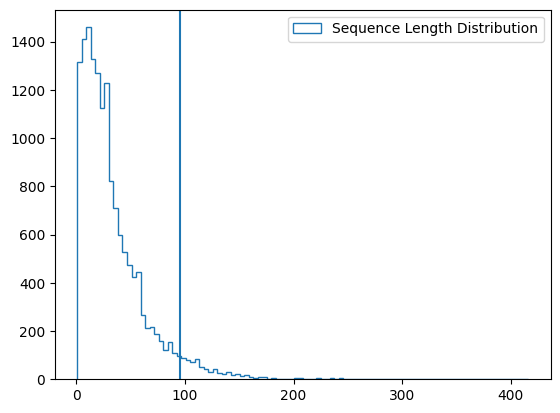

In [19]:
import pickle
# Setting Maximum Sequence Length
input_lengths = [len(text.split()) for text in questions+answers]
plt.hist(input_lengths, bins = 100, histtype='step', label='Sequence Length Distribution')
plt.axvline(np.quantile(input_lengths, [0.95]))
plt.legend();
print("MEAN: ",np.quantile(input_lengths, [0.95]))

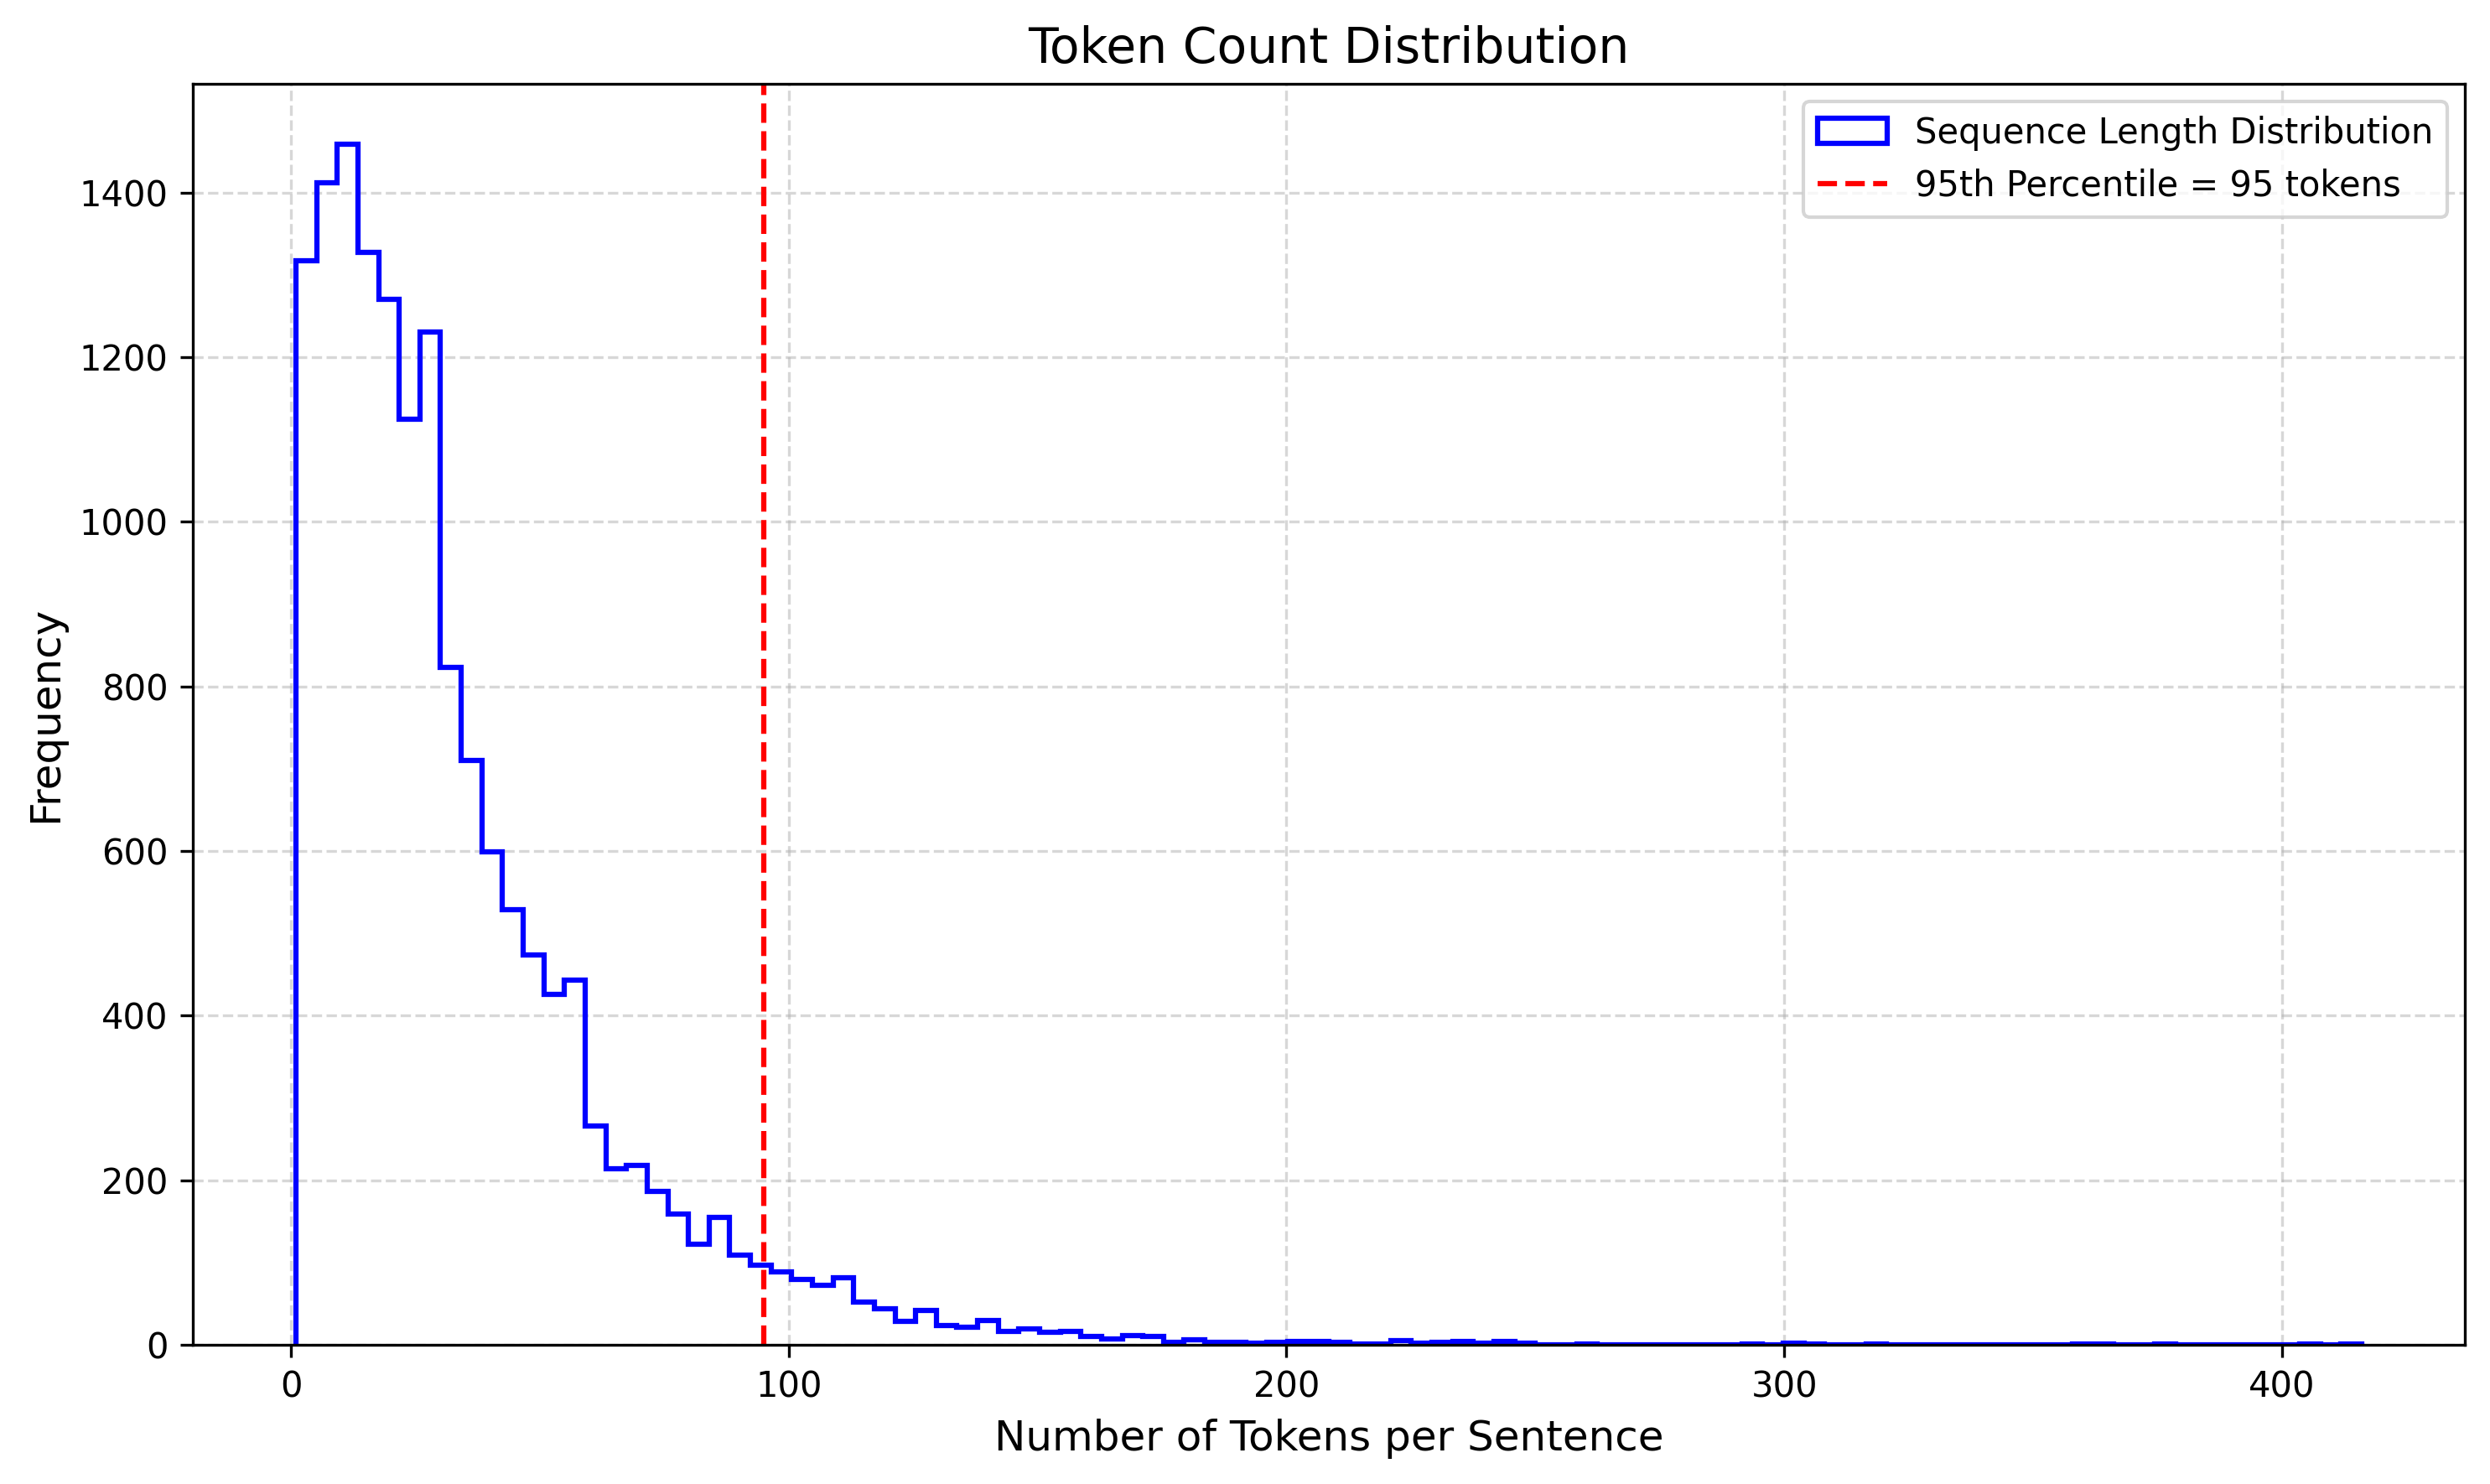

üìè 95th Percentile (Recommended Max Length): 95


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿ∑ŸàŸÑ Ÿàÿ±ŸàÿØ€å‚ÄåŸáÿß
input_lengths = [len(text.split()) for text in questions + answers]
q95 = np.quantile(input_lengths, 0.95)

# ÿ™ÿ±ÿ≥€åŸÖ ŸÜŸÖŸàÿØÿßÿ±
plt.figure(figsize=(10, 6), dpi=300)  # dpi ÿ®ÿßŸÑÿß ÿ®ÿ±ÿß€å ⁄©€åŸÅ€åÿ™ ÿ®ÿßŸÑÿß
plt.hist(input_lengths, bins=100, histtype='step', color='blue', linewidth=1.5, label='Sequence Length Distribution')
plt.axvline(q95, color='red', linestyle='--', linewidth=1.5, label=f'95th Percentile = {int(q95)} tokens')

plt.title("Token Count Distribution", fontsize=14)
plt.xlabel("Number of Tokens per Sentence", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# ÿ∞ÿÆ€åÿ±Ÿá ÿ®ÿß ⁄©€åŸÅ€åÿ™ ÿ®ÿßŸÑÿß (ÿßÿÆÿ™€åÿßÿ±€å)
plt.savefig("sequence_length_distribution.png", dpi=300)

plt.show()

print("üìè 95th Percentile (Recommended Max Length):", int(q95))

In [21]:
# Build tokenizer using tfds for both questions and answers
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13
)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

In [22]:
# Build tokenizer using tfds for both questions and answers
#tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
#    questions + answers, target_vocab_size=2**13)

In [23]:
# Define start and end token to indicate the start and end of a sentence
#START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
#VOCAB_SIZE = tokenizer.vocab_size + 2

In [24]:
print(' :',START_TOKEN)
print(' :',END_TOKEN)
print(' :',VOCAB_SIZE)

 : [8244]
 : [8245]
 : 8246


In [25]:
print(f"Tokenized sample question: {tokenizer.encode(questions[20])}")

Tokenized sample question: [200, 622, 34, 5927]


In [26]:
# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # tokenize sentence
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        # check tokenized sentence max length
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # pad tokenized sentences
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding="post"
    )
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding="post"
    )

    return tokenized_inputs, tokenized_outputs


questions, answers = tokenize_and_filter(questions, answers)

In [27]:
print(f"Vocab size: {VOCAB_SIZE}")
print(f"Number of samples: {len(questions)}")

Vocab size: 8246
Number of samples: 6559


In [28]:
#questions, answers = tokenize_and_filter(questions, answers)

In [29]:
print('(len) questions:', len(questions))
print('(len) answers:', len(answers))

(len) questions: 6559
(len) answers: 6559


In [30]:
print(questions[20])
print(answers[20])

[8244  501  620   81   14    5   38   47   55 1419    2 3428   33  141
 3022 4242  556    2   56  114   21 4907  534   19   15   47  106   21
 1719  116   26  777 2316    1   96  287  554   15  116  289  701 1168
   47  106  273  223   11   13  667 1317  141 5429  105    1 6472  105
   11    7 4038   87   13   52 1300   95  309 8245    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8244   95 1055 1137 2970  151   22    1 1065  151    9  669  563   36
   21  163   13  133  289  990  280    3   54   16   43   18  937  519
    3   90  357    1 3458   65   28   82 8245    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [31]:
# decoder inputs use the previous target as input
# remove START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"inputs": questions, "dec_inputs": answers[:, :-1]},
        {"outputs": answers[:, 1:]},
    )
)

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [32]:
print(dataset)

<PrefetchDataset element_spec=({'inputs': TensorSpec(shape=(None, 96), dtype=tf.int32, name=None), 'dec_inputs': TensorSpec(shape=(None, 95), dtype=tf.int32, name=None)}, {'outputs': TensorSpec(shape=(None, 95), dtype=tf.int32, name=None)})>


In [33]:
def scaled_dot_product_attention(query, key, value, mask):
    """Calculate the attention weights."""
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += mask * -1e9

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

In [34]:
class MultiHeadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        assert d_model % num_heads == 0
        super(MultiHeadAttentionLayer, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def get_config(self):
        config = super(MultiHeadAttentionLayer, self).get_config()
        config.update(
            {
                "num_heads": self.num_heads,
                "d_model": self.d_model,
            }
        )
        return config

    def split_heads(self, inputs, batch_size):
        inputs = tf.keras.layers.Lambda(
            lambda inputs: tf.reshape(
                inputs, shape=(batch_size, -1, self.num_heads, self.depth)
            )
        )(inputs)
        return tf.keras.layers.Lambda(
            lambda inputs: tf.transpose(inputs, perm=[0, 2, 1, 3])
        )(inputs)

    def call(self, inputs):
        query, key, value, mask = (
            inputs["query"],
            inputs["key"],
            inputs["value"],
            inputs["mask"],
        )
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # scaled dot-product attention
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        )(scaled_attention)

        # concatenation of heads
        concat_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.reshape(
                scaled_attention, (batch_size, -1, self.d_model)
            )
        )(scaled_attention)

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

In [35]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [36]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [37]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [38]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [39]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update(
            {
                "position": self.position,
                "d_model": self.d_model,
            }
        )
        return config

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model,
        )
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, : tf.shape(inputs)[1], :]

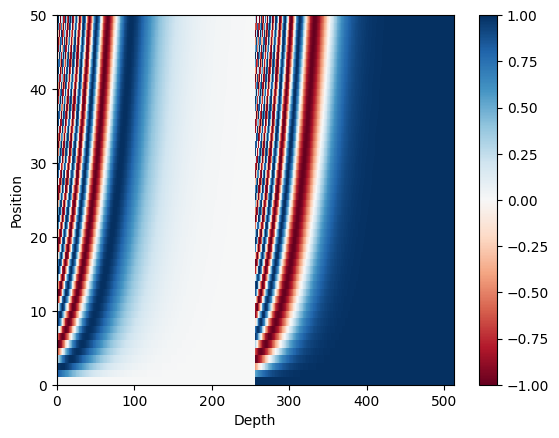

In [40]:
sample_pos_encoding = PositionalEncoding(50, 512, name="sample_pos_encoding")

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap="RdBu")
plt.xlabel("Depth")
plt.xlim((0, 512))
plt.ylabel("Position")
plt.colorbar()
plt.show()

In [41]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttentionLayer(d_model, num_heads, name="attention")(
        {"query": inputs, "key": inputs, "value": inputs, "mask": padding_mask}
    )
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    add_attention = tf.keras.layers.add([inputs, attention])
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([attention, outputs])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [42]:
sample_encoder_layer = encoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder_layer")
tf.keras.utils.plot_model(
    sample_encoder_layer, to_file='encoder_layer.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [43]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(
        lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
    )(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [44]:
sample_encoder = encoder(
    vocab_size=8246,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder")

tf.keras.utils.plot_model(
   sample_encoder, to_file='encoder.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [45]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention1 = MultiHeadAttentionLayer(d_model, num_heads, name="attention_1")(
        inputs={
            "query": inputs,
            "key": inputs,
            "value": inputs,
            "mask": look_ahead_mask,
        }
    )
    add_attention = tf.keras.layers.add([attention1, inputs])
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    attention2 = MultiHeadAttentionLayer(d_model, num_heads, name="attention_2")(
        inputs={
            "query": attention1,
            "key": enc_outputs,
            "value": enc_outputs,
            "mask": padding_mask,
        }
    )
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    add_attention = tf.keras.layers.add([attention2, attention1])
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([outputs, attention2])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

In [46]:
sample_decoder_layer = decoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder_layer")

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file='decoder_layer.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [47]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="decoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(
        lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
    )(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="decoder_layer_{}".format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

In [48]:
sample_decoder = decoder(
    vocab_size=8246,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder")

tf.keras.utils.plot_model(
    sample_decoder, to_file='decoder.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [49]:
def transformer(
    vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"
):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="enc_padding_mask"
    )(inputs)
    # mask the future tokens for decoder inputs at the 1st attention block
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None), name="look_ahead_mask"
    )(dec_inputs)
    # mask the encoder outputs for the 2nd attention block
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="dec_padding_mask"
    )(inputs)

    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [50]:
sample_transformer = transformer(
    vocab_size=8246,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer")

tf.keras.utils.plot_model(
    sample_transformer, to_file='transformer.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [51]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction="none"
    )(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [52]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.constant(d_model, dtype=tf.float32)
        self.warmup_steps = warmup_steps

    def get_config(self):
        return {"d_model": self.d_model, "warmup_steps": self.warmup_steps}

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.multiply(
            tf.math.rsqrt(self.d_model), tf.math.minimum(arg1, arg2)
        )

Text(0.5, 0, 'Train Step')

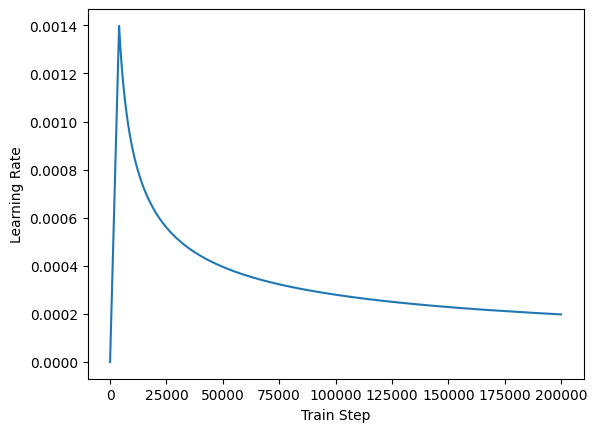

In [53]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9500\1104544722.py:13: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_9500\1104544722.py:15: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.savefig("learning_rate_schedule.png", dpi=300)
D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


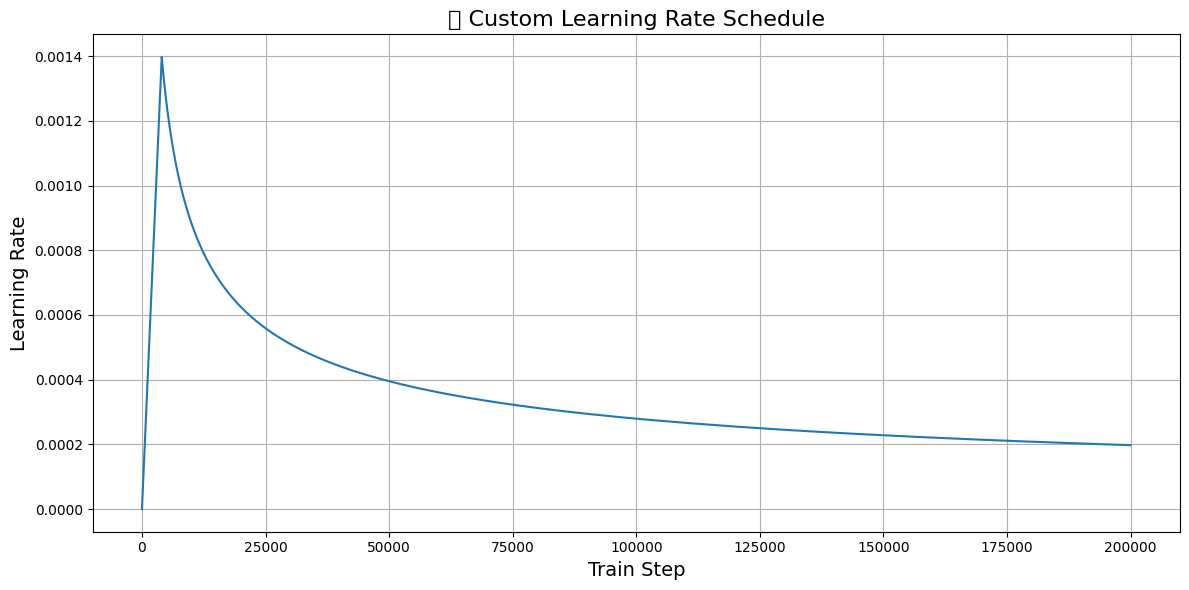

In [54]:
import matplotlib.pyplot as plt
import tensorflow as tf

# ŸÅÿ±ÿ∂ ÿ®ÿ± ÿß€åŸÜŸá ⁄©Ÿá CustomSchedule ÿ™ÿπÿ±€åŸÅ ÿ¥ÿØŸá
sample_learning_rate = CustomSchedule(d_model=128)

plt.figure(figsize=(12, 6))  # ÿßŸÜÿØÿßÿ≤Ÿá ÿ®ÿ≤ÿ±⁄Ø‚Äåÿ™ÿ± ÿ®ÿ±ÿß€å ⁄©€åŸÅ€åÿ™ ÿ®Ÿáÿ™ÿ±
plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.title("üìà Custom Learning Rate Schedule", fontsize=16)
plt.xlabel("Train Step", fontsize=14)
plt.ylabel("Learning Rate", fontsize=14)
plt.grid(True)
plt.tight_layout()
# ÿ∞ÿÆ€åÿ±Ÿá ÿ®ÿß ⁄©€åŸÅ€åÿ™ ÿ®ÿßŸÑÿß
plt.savefig("learning_rate_schedule.png", dpi=300)
plt.show()

In [55]:
# clear backend
tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)


def accuracy(y_true, y_pred):
    # ensure labels have shape (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


# initialize and compile model within strategy scope
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3165184     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [56]:
history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/100
103/103 [==============================] - 148s 1s/step - loss: 2.0786 - accuracy: 0.0062  
Epoch 2/100
103/103 [==============================] - 144s 1s/step - loss: 1.8940 - accuracy: 0.0110
Epoch 3/100
103/103 [==============================] - 143s 1s/step - loss: 1.6604 - accuracy: 0.0118
Epoch 4/100
103/103 [==============================] - 154s 1s/step - loss: 1.5154 - accuracy: 0.0225
Epoch 5/100
103/103 [==============================] - 148s 1s/step - loss: 1.4119 - accuracy: 0.0378
Epoch 6/100
103/103 [==============================] - 148s 1s/step - loss: 1.3060 - accuracy: 0.0468
Epoch 7/100
103/103 [==============================] - 138s 1s/step - loss: 1.2240 - accuracy: 0.0524
Epoch 8/100
103/103 [==============================] - 139s 1s/step - loss: 1.1557 - accuracy: 0.0570
Epoch 9/100
103/103 [==============================] - 140s 1s/step - loss: 1.0946 - accuracy: 0.0618
Epoch 10/100
103/103 [==============================] - 140s 1s/step - loss: 1.0

In [58]:
filename = "model_finals.h5"
tf.keras.models.save_model(model, filepath=filename, include_optimizer=False)

In [67]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


ŸÖŸÇÿßÿØ€åÿ± history: dict_keys(['loss', 'accuracy'])


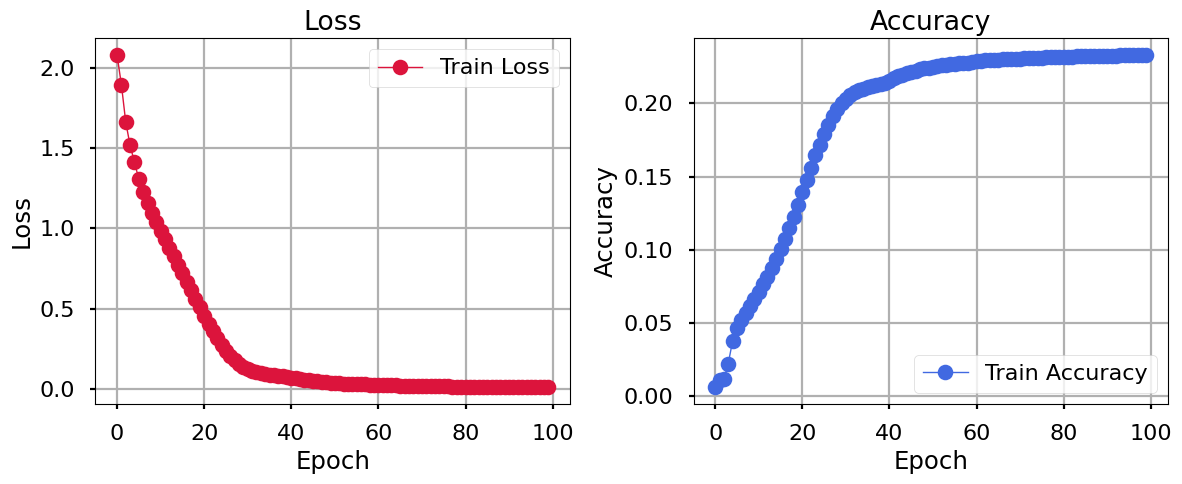

In [68]:
import matplotlib.pyplot as plt

# ÿ®ÿ±ÿ±ÿ≥€å ⁄©ŸÑ€åÿØŸáÿß€å ŸÖŸàÿ¨ŸàÿØ ÿ®ÿ±ÿß€å ÿßÿ∑ŸÖ€åŸÜÿßŸÜ
print("ŸÖŸÇÿßÿØ€åÿ± history:", history.history.keys())

plt.figure(figsize=(12, 5))  # ÿßŸÜÿØÿßÿ≤Ÿá ÿ®ÿ≤ÿ±⁄Ø‚Äåÿ™ÿ± ÿ®ÿ±ÿß€å Ÿàÿ∂Ÿàÿ≠ ÿ®€åÿ¥ÿ™ÿ±

# üìâ ŸÜŸÖŸàÿØÿßÿ± Train Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o', color='crimson', linewidth=1)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# üìà ŸÜŸÖŸàÿØÿßÿ± Train Accuracy
plt.subplot(1, 2, 2)
acc_key = [k for k in history.history.keys() if 'acc' in k or 'accuracy' in k][0]
plt.plot(history.history[acc_key], label='Train Accuracy', marker='o', color='royalblue', linewidth=1)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()

# ‚¨áÔ∏è ÿ∞ÿÆ€åÿ±Ÿá ÿ®ÿß ⁄©€åŸÅ€åÿ™ ÿ®ÿßŸÑÿß
plt.savefig("train_loss_accuracy-1-finals.png", dpi=400, bbox_inches='tight')
plt.savefig("train_metrics_styled-1-final.pdf", dpi=400, bbox_inches='tight')

plt.show()

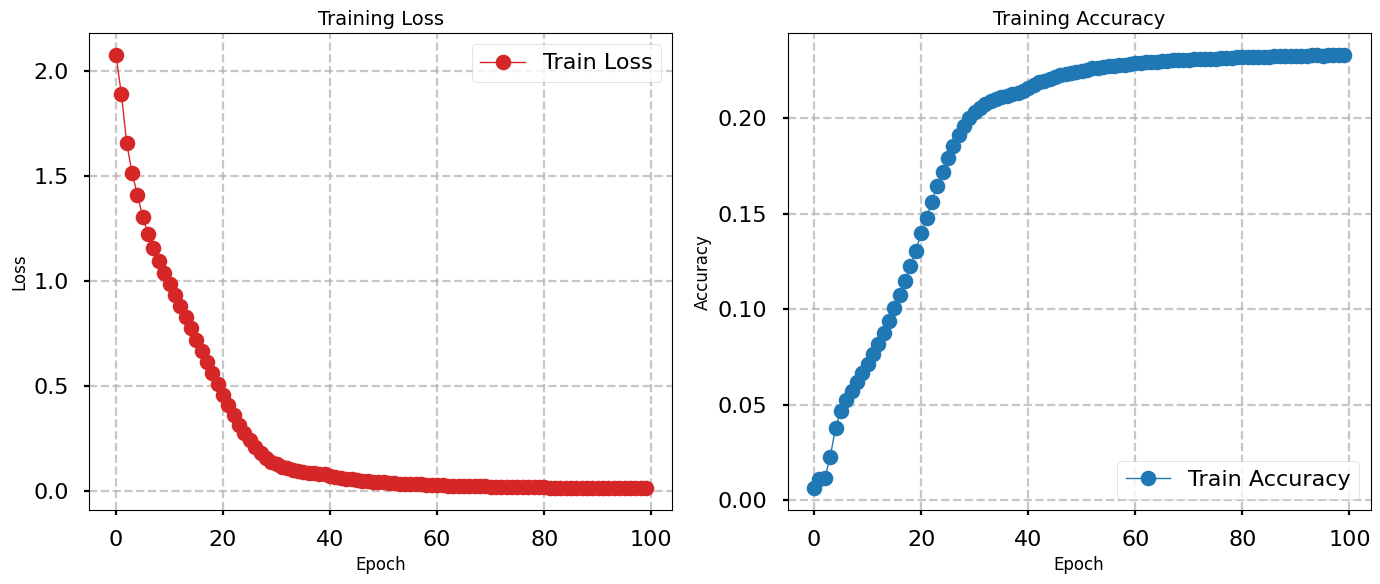

In [65]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# ÿ™ŸÜÿ∏€åŸÖ ŸÅŸàŸÜÿ™ Ÿàÿßÿ∂ÿ≠ Ÿà ÿ®ÿ≤ÿ±⁄Ø ÿ®ÿ±ÿß€å ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 12

# ÿßŸÜÿ™ÿÆÿßÿ® ÿßÿ≥ÿ™ÿß€åŸÑ ÿ≠ÿ±ŸÅŸá‚Äåÿß€å
plt.style.use('seaborn-v0_8-poster')  # ÿ®ÿ±ÿß€å ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß€å ÿ≠ÿ±ŸÅŸá‚Äåÿß€å Ÿà Ÿàÿßÿ∂ÿ≠

plt.figure(figsize=(14, 6))

# üìâ ŸÜŸÖŸàÿØÿßÿ± Train Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o', color='#d62728', linewidth=1)
plt.title("Training Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# üìà ŸÜŸÖŸàÿØÿßÿ± Train Accuracy
plt.subplot(1, 2, 2)
acc_key = [k for k in history.history.keys() if 'acc' in k or 'accuracy' in k][0]
plt.plot(history.history[acc_key], label='Train Accuracy', marker='o', color='#1f77b4', linewidth=1)
plt.title("Training Accuracy", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

# ‚¨áÔ∏è ÿ∞ÿÆ€åÿ±Ÿá ÿ®ÿß ⁄©€åŸÅ€åÿ™ ÿ®ÿßŸÑÿß
plt.savefig("train_metrics_styled-end.png", dpi=200, bbox_inches='tight', transparent=True)
plt.savefig("train_metrics_styled-end.pdf", dpi=300, bbox_inches='tight')

plt.show()


ŸÖŸÇÿßÿØ€åÿ± history: dict_keys(['loss', 'accuracy'])


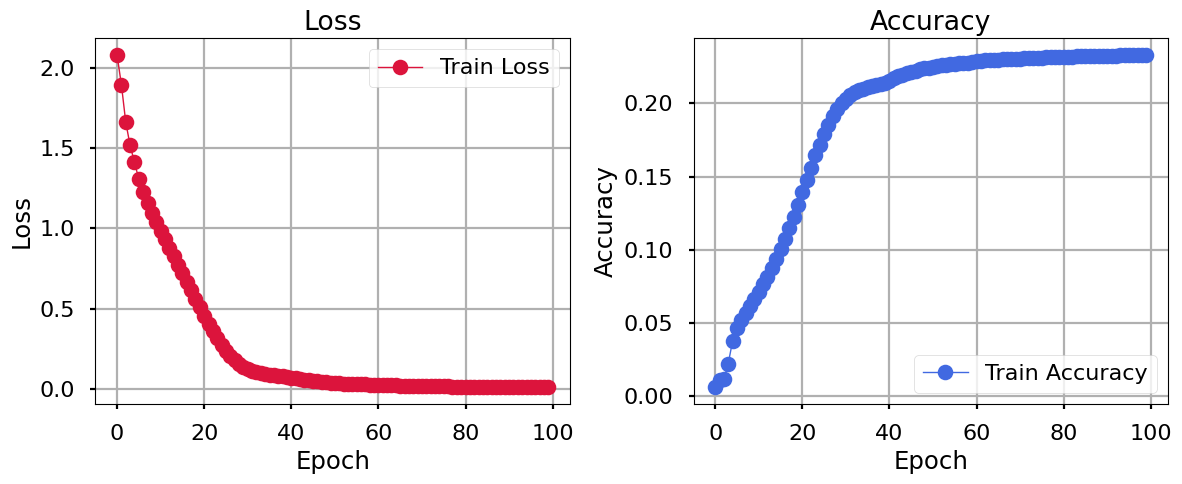

In [70]:
import matplotlib.pyplot as plt

# ÿ®ÿ±ÿ±ÿ≥€å ⁄©ŸÑ€åÿØŸáÿß€å ŸÖŸàÿ¨ŸàÿØ ÿ®ÿ±ÿß€å ÿßÿ∑ŸÖ€åŸÜÿßŸÜ
print("ŸÖŸÇÿßÿØ€åÿ± history:", history.history.keys())

plt.figure(figsize=(12, 5))  # ÿßŸÜÿØÿßÿ≤Ÿá ÿ®ÿ≤ÿ±⁄Ø‚Äåÿ™ÿ± ÿ®ÿ±ÿß€å Ÿàÿ∂Ÿàÿ≠ ÿ®€åÿ¥ÿ™ÿ±

# üìâ ŸÜŸÖŸàÿØÿßÿ± Train Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o', color='crimson', linewidth=1)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# üìà ŸÜŸÖŸàÿØÿßÿ± Train Accuracy
plt.subplot(1, 2, 2)
acc_key = [k for k in history.history.keys() if 'acc' in k or 'accuracy' in k][0]
plt.plot(history.history[acc_key], label='Train Accuracy', marker='o', color='royalblue', linewidth=1)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()

# ‚¨áÔ∏è ÿ∞ÿÆ€åÿ±Ÿá ÿ®ÿß ⁄©€åŸÅ€åÿ™ ÿ®ÿßŸÑÿß
plt.savefig("train_loss_accuracy-1-End.png", dpi=400, bbox_inches='tight')
plt.savefig("train_metrics_styled-1-End.pdf", dpi=400, bbox_inches='tight')

plt.show()


In [71]:
plt.savefig("train_loss_accuracy_finals.pdf", dpi=300, bbox_inches='tight')

<Figure size 1280x880 with 0 Axes>

ŸÖŸÇÿßÿØ€åÿ± history: dict_keys(['loss', 'accuracy'])


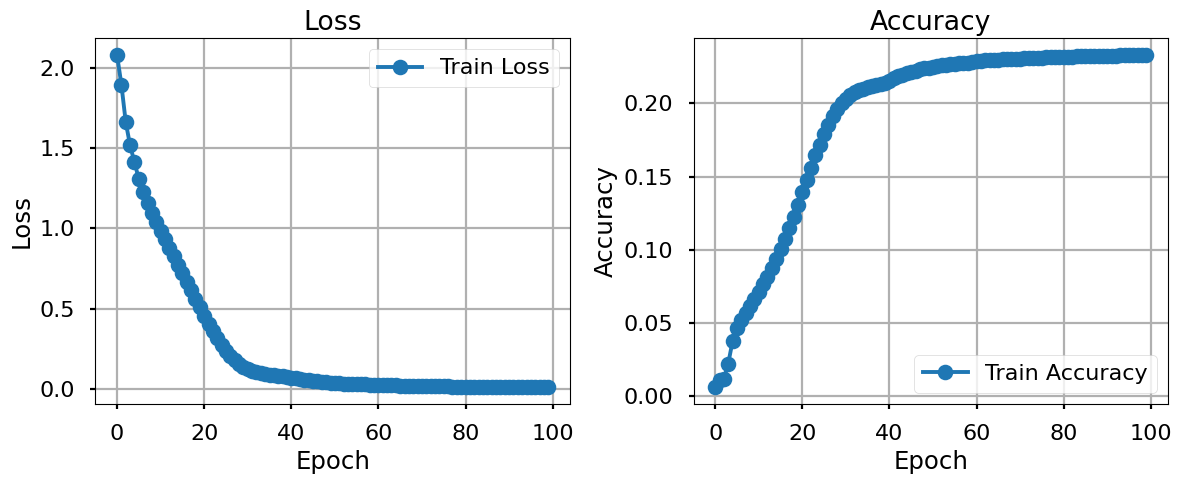

<Figure size 1280x880 with 0 Axes>

In [72]:
import matplotlib.pyplot as plt

# ÿ®ÿ±ÿ±ÿ≥€å ⁄©ŸÑ€åÿØŸáÿß€å ŸÖŸàÿ¨ŸàÿØ ÿ®ÿ±ÿß€å ÿßÿ∑ŸÖ€åŸÜÿßŸÜ
print("ŸÖŸÇÿßÿØ€åÿ± history:", history.history.keys())

plt.figure(figsize=(12, 5))

# üìâ ŸÜŸÖŸàÿØÿßÿ± Train Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# üìà ŸÜŸÖŸàÿØÿßÿ± Train Accuracy
plt.subplot(1, 2, 2)
# ÿ®ÿ±ÿ±ÿ≥€å ÿß€åŸÜ⁄©Ÿá ⁄©ŸÑ€åÿØ accuracy ⁄ÜŸá ŸÜÿßŸÖ€å ÿØÿßÿ±Ÿá (ŸÖŸÖ⁄©ŸÜŸá 'accuracy' €åÿß ŸÖÿ´ŸÑÿßŸã 'accuracy_1' ÿ®ÿßÿ¥Ÿá)
acc_key = [k for k in history.history.keys() if 'acc' in k or 'accuracy' in k][0]
plt.plot(history.history[acc_key], label='Train Accuracy', marker='o')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
plt.savefig("train_loss_accuracy-3-1-final.png", dpi=300, bbox_inches='tight')
plt.savefig("train_metrics_styled-3-1-final.pdf", dpi=400, bbox_inches='tight')

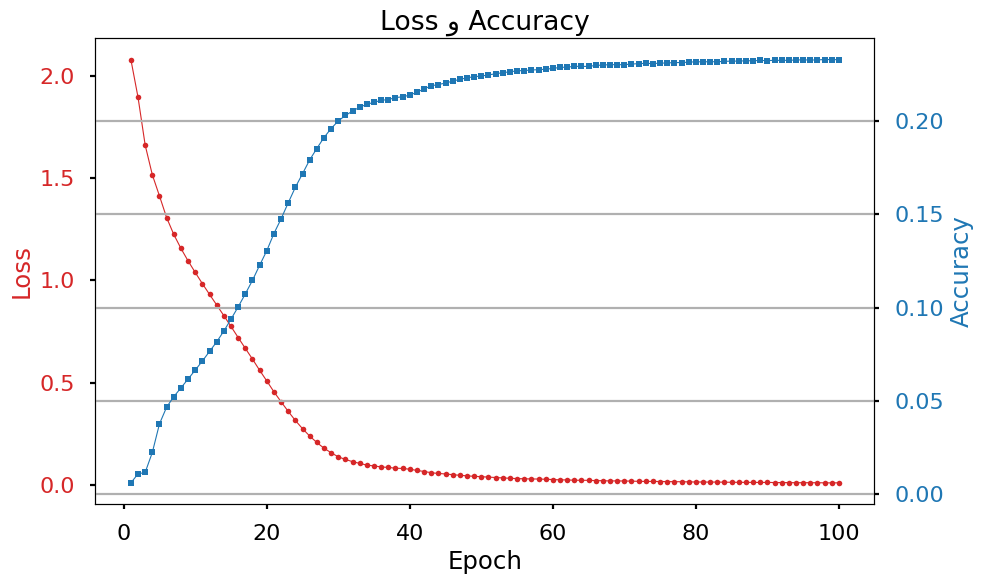

<Figure size 1280x880 with 0 Axes>

In [75]:
import matplotlib.pyplot as plt

# Ÿæ€åÿØÿß ⁄©ÿ±ÿØŸÜ ⁄©ŸÑ€åÿØ ÿØŸÇ€åŸÇ accuracy
acc_key = [k for k in history.history.keys() if 'acc' in k or 'accuracy' in k][0]

epochs = range(1, len(history.history['loss']) + 1)

fig, ax1 = plt.subplots(figsize=(10, 6))

# ŸÖÿ≠Ÿàÿ± ÿßŸàŸÑ ÿ®ÿ±ÿß€å Loss
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(
    epochs,
    history.history['loss'],
    label='Loss',
    color=color,
    marker='o',
    linewidth=0.8,
    markersize=4
)
ax1.tick_params(axis='y', labelcolor=color)

# ŸÖÿ≠Ÿàÿ± ÿØŸàŸÖ ÿ®ÿ±ÿß€å Accuracy
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(
    epochs,
    history.history[acc_key],
    label='Accuracy',
    color=color,
    marker='s',
    linewidth=0.8,
    markersize=4
)
ax2.tick_params(axis='y', labelcolor=color)

# ÿπŸÜŸàÿßŸÜ Ÿà ŸÜŸÖÿß€åÿ¥
plt.title('Loss Ÿà Accuracy')
fig.tight_layout()
plt.grid(True)
plt.show()

# ÿ∞ÿÆ€åÿ±Ÿá ÿÆÿ±Ÿàÿ¨€å ÿ®ÿß ⁄©€åŸÅ€åÿ™ ŸÖŸÜÿßÿ≥ÿ®
plt.savefig("train_loss_accuracy-clean-1.png", dpi=300, bbox_inches='tight')
plt.savefig("train_loss_accuracy-clean-1.pdf", dpi=400, bbox_inches='tight')


ŸÖŸÇÿßÿØ€åÿ± history: dict_keys(['loss', 'accuracy'])


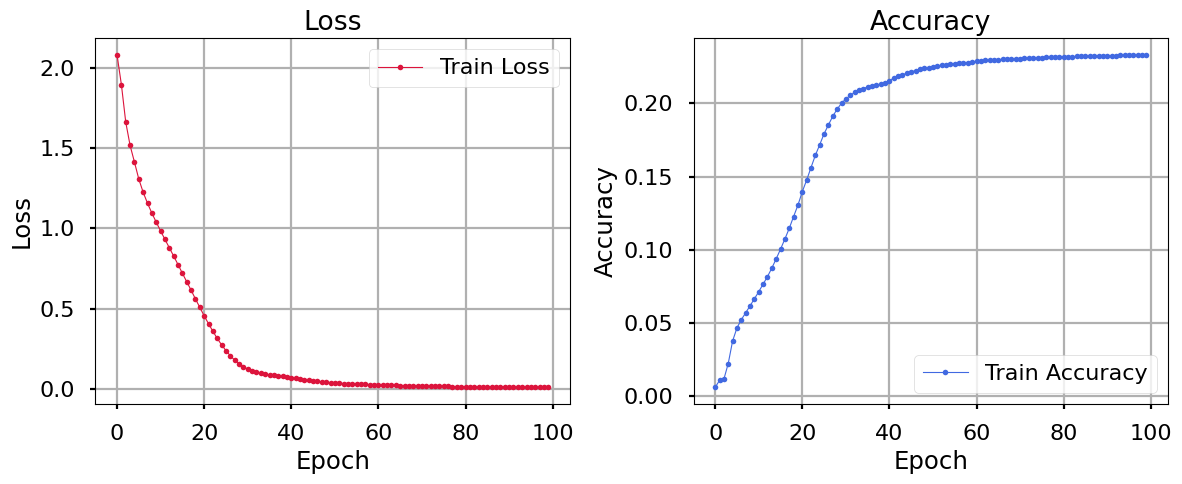

In [73]:
import matplotlib.pyplot as plt

# ÿ®ÿ±ÿ±ÿ≥€å ⁄©ŸÑ€åÿØŸáÿß€å ŸÖŸàÿ¨ŸàÿØ ÿ®ÿ±ÿß€å ÿßÿ∑ŸÖ€åŸÜÿßŸÜ
print("ŸÖŸÇÿßÿØ€åÿ± history:", history.history.keys())

plt.figure(figsize=(12, 5))  # ÿßŸÜÿØÿßÿ≤Ÿá ŸÖŸÜÿßÿ≥ÿ® ÿ®ÿ±ÿß€å ÿØÿß⁄©€åŸàŸÖŸÜÿ™

# üìâ ŸÜŸÖŸàÿØÿßÿ± Train Loss
plt.subplot(1, 2, 1)
plt.plot(
    history.history['loss'], 
    label='Train Loss', 
    marker='o', 
    color='crimson', 
    linewidth=0.8, 
    markersize=4
)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# üìà ŸÜŸÖŸàÿØÿßÿ± Train Accuracy
plt.subplot(1, 2, 2)
acc_key = [k for k in history.history.keys() if 'acc' in k or 'accuracy' in k][0]
plt.plot(
    history.history[acc_key], 
    label='Train Accuracy', 
    marker='o', 
    color='royalblue', 
    linewidth=0.8, 
    markersize=4
)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()

# ‚¨áÔ∏è ÿ∞ÿÆ€åÿ±Ÿá ÿ®ÿß ⁄©€åŸÅ€åÿ™ ÿ®ÿßŸÑÿß
plt.savefig("train_loss_accuracy_clean.png", dpi=300, bbox_inches='tight')
plt.savefig("train_loss_accuracy_clean.pdf", dpi=400, bbox_inches='tight')

plt.show()


In [74]:
plt.savefig("loss_accuracy_plot-end-ÿ®ŸáÿØÿ¥ŸÖÿ≥.pdf", dpi=300, bbox_inches='tight')

<Figure size 1280x880 with 0 Axes>

In [76]:
def evaluate(sentence):

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [77]:
output = predict('ÿ≥ŸÑÿßŸÖ ÿ¢ŸÇÿß€å ÿØ⁄©ÿ™ÿ±')

Input: ÿ≥ŸÑÿßŸÖ ÿ¢ŸÇÿß€å ÿØ⁄©ÿ™ÿ±
Output: ÿ≥ŸÑÿßŸÖ


In [78]:
sentence="ŸÖŸÜ ŸÖÿπÿß€åŸÜŸá ÿ¥ÿØŸÖ ŸàŸÑ€å ⁄Ü€åÿ≤€å ŸÜ⁄ØŸÅÿ™ŸÜ ŸÅŸÇÿ∑ ⁄ØŸÅÿ™ŸÜ ÿ≥ŸàŸÜŸà ÿßŸàŸÜŸÖ ŸáŸÖŸá ⁄Ü€åÿ≤ÿ¥ ŸÜÿ±ŸÖÿßŸÑ ÿ®ŸàÿØ ŸÖŸÜ ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ≥ÿ±ÿ∑ÿßŸÜ Ÿáÿ≥ÿ™"
for _ in range(10):
  sentence = predict(sentence)
  print('')

Input: ŸÖŸÜ ŸÖÿπÿß€åŸÜŸá ÿ¥ÿØŸÖ ŸàŸÑ€å ⁄Ü€åÿ≤€å ŸÜ⁄ØŸÅÿ™ŸÜ ŸÅŸÇÿ∑ ⁄ØŸÅÿ™ŸÜ ÿ≥ŸàŸÜŸà ÿßŸàŸÜŸÖ ŸáŸÖŸá ⁄Ü€åÿ≤ÿ¥ ŸÜÿ±ŸÖÿßŸÑ ÿ®ŸàÿØ ŸÖŸÜ ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ≥ÿ±ÿ∑ÿßŸÜ Ÿáÿ≥ÿ™
Output: ÿÆ€åÿ± ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ŸáŸàÿ±ŸÖŸàŸÜ€å ÿßŸÜÿ¨ÿßŸÖ€å ÿØŸá€åÿØ

Input: ÿÆ€åÿ± ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ŸáŸàÿ±ŸÖŸàŸÜ€å ÿßŸÜÿ¨ÿßŸÖ€å ÿØŸá€åÿØ
Output: ŸÑÿ∑ŸÅÿß ÿ≥ŸàÿßŸÑÿ™ŸàŸÜ ÿ±Ÿà ⁄©ÿßŸÖŸÑ Ÿà ÿ®ÿß ÿ¨ÿ≤€å€åÿßÿ™ ÿ®Ÿæÿ±ÿ≥€åŸÜ ŸÜÿß ŸÖŸÅŸáŸàŸÖŸá

Input: ŸÑÿ∑ŸÅÿß ÿ≥ŸàÿßŸÑÿ™ŸàŸÜ ÿ±Ÿà ⁄©ÿßŸÖŸÑ Ÿà ÿ®ÿß ÿ¨ÿ≤€å€åÿßÿ™ ÿ®Ÿæÿ±ÿ≥€åŸÜ ŸÜÿß ŸÖŸÅŸáŸàŸÖŸá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ⁄©ŸÖÿ®ŸàÿØ ŸæŸÑÿß⁄©ÿ™ ÿπŸÑŸÑ ÿ≤€åÿßÿØ€å ŸÜÿØÿßÿ±ÿØ Ÿà ⁄©ŸÖÿ®ŸàÿØ ŸÜŸÖÿß€å€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿÆ€åÿ± ÿßŸÖÿß ŸæŸàÿ≥ÿ™ Ÿà ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ€å ÿÆ€åÿ±

Input: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ⁄©ŸÖÿ®ŸàÿØ ŸæŸÑÿß⁄©ÿ™ ÿπŸÑŸÑ ÿ≤€åÿßÿØ€å ŸÜÿØÿßÿ±ÿØ Ÿà ⁄©ŸÖÿ®ŸàÿØ ŸÜŸÖÿß€å€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿÆ€åÿ± ÿßŸÖÿß ŸæŸàÿ≥ÿ™ Ÿà ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ€å ÿÆ€åÿ±
Output: ⁄ØÿßŸá€å ÿ™ÿß ÿ≠ÿØŸàÿØ€å ÿ®Ÿá ÿπŸÑÿ™ Ÿáÿ≥ÿ™ Ÿà ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ

Inpu

In [79]:
import tqdm
from nltk.translate.bleu_score import sentence_bleu

In [80]:
X = questions_eva
Y = answers_eva

In [81]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
len (Y_test)

1541

In [82]:
fr_preds = []
for sentence in tqdm.tqdm(X_test):
    fr_pred = predict(sentence)
    fr_preds.append(fr_pred)

  0%|                                                                                 | 1/1541 [00:01<43:50,  1.71s/it]

Input: ÿØŸàŸÖÿßŸá€å Ÿáÿ≥ÿ™ ⁄ØŸàÿ¥‚ÄåÿØÿ±ÿØ ÿØÿßÿ±ŸÖ Ÿàÿ≠ÿßŸÑÿßÿØŸà ŸáŸÅÿ™Ÿá ŸÖ€åÿ¥Ÿá ⁄©Ÿá ⁄ØŸÑŸàÿØÿ±ÿØ ÿßÿ∂ÿßŸÅŸá‚Äåÿ¥ÿØŸá ÿßÿ≤Ÿæÿ¥ÿ™ ⁄ØŸàÿ¥ŸÖ ÿ™ÿß⁄ØŸÑŸàŸÖ ÿØÿ±ÿØÿÆŸÅ€åŸÅ ÿØÿßÿ±ŸÖ ŸÖÿ´ŸÑ ÿ≥ÿ±ŸÖÿßÿÆŸàÿ±ÿØ⁄Ø€å ŸàŸÑ€å ŸÖÿ∑ŸÖÿπŸÜ Ÿáÿ≥ÿ™ŸÖ ÿ≥ÿ±ŸÖÿßŸÜÿÆŸàÿ±ÿØŸÖ ÿ≥ÿßÿ®ŸÇŸá ÿ®€åŸÖÿßÿ±€å ÿÆÿßÿµ€å ŸÜÿØÿßÿ±ŸÖ ÿØÿßÿ±ŸàÿÆÿßÿµ€å ŸáŸÖ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄Ü€åŸá ÿØ⁄©ÿ™ÿ±
Output: ÿ®Ÿá ÿπŸÑÿ™ ŸÖÿ≤ŸÖŸÜ ÿ¥ÿØŸÜ ÿØÿ±ÿØ ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ⁄ØŸàÿ¥ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ Ÿà ÿ≠ŸÑŸÇ Ÿà ÿ®€åŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


  0%|                                                                                 | 2/1541 [00:02<25:03,  1.02it/s]

Input: ŸÖŸÜ ÿ™Ÿà ÿ≥ŸÜ €≤€≤ ÿ≥ÿßŸÑ⁄Ø€å ÿ™Ÿà ÿØŸàÿ±ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØ€å ÿØ⁄Üÿßÿ± ÿ≤⁄Ø€åŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿ¥ÿØŸÖ Ÿà ÿ®ÿß ŸÖÿ≠ŸÑŸàŸÑ ÿ≥ÿßÿÆÿ™ŸÜ€å ŸæÿØŸàŸÅ€åŸÑ€åŸÜ ÿ®ÿ±ÿ∑ÿ±ŸÅ ÿ¥ÿØ Ÿà ÿßŸÑÿßŸÜ €π ÿ≥ÿßŸÑ ŸÖ€å⁄Øÿ∞ÿ±Ÿá ⁄©Ÿá ÿ≤⁄Ø€åŸÑ€å ŸÜÿ≤ÿØŸÖ ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ±ÿßŸá ÿØÿ±ŸÖÿßŸÜ ⁄Ü€åŸá Ÿà ÿ®ÿß Ÿàÿ¨ŸàÿØ ÿØÿÆÿ™ÿ± ÿ®ŸàÿØŸÜŸÖ ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ ⁄©Ÿá ÿ®ÿØŸàŸÜŸÖ Ÿà€åÿ±Ÿàÿ≥ ÿØÿßÿÆŸÑ ÿ®ÿØŸÜŸÖ Ÿáÿ≥ÿ™ €åÿß ŸÜŸá
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


  0%|‚ñè                                                                                | 3/1541 [00:03<28:18,  1.10s/it]

Input: ŸÖŸÜ €±€∞ ÿ±Ÿàÿ≤Ÿá ⁄ØŸàÿ¥ŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá Ÿà ÿπŸÅŸàŸÜÿ™ ÿßÿ≤ÿ¥ ÿÆÿßÿ±ÿ¨ ŸÖ€åÿ¥Ÿá ÿßŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ ÿ®Ÿáÿ™ÿ± ÿ¥ÿØ ŸàŸÑ€å ÿßŸàŸÜ €å⁄©€å ⁄ØŸàÿ¥ŸÖ ÿß€åŸÜÿ¨Ÿàÿ±€å ÿ¥ÿØ ⁄©Ÿá ŸáŸÜŸàÿ≤ ÿØÿßÿ±ŸÖ ÿßŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿßÿ¥ŸÜÿß€åÿßŸÜ ÿ®ŸáŸÖ ⁄ØŸÅÿ™ŸÜ ÿ™ÿ≥ÿ™ ⁄©ÿ±ŸàŸÜÿß ÿ®ÿØŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ÿß⁄ØŸá ÿß€åŸÜ ⁄ØŸàÿ¥‚ÄåÿØÿ±ÿØ ÿπŸÑÿß€åŸÖ ⁄©ÿ±ŸàŸÜÿß ŸÜ€åÿ≥ÿ™ ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ŸÜÿ±ŸÖ Ÿàÿßÿ≥Ÿá ÿ™ÿ≥ÿ™ ÿ®ÿ¨ÿ≤ ⁄ØŸàÿ¥‚ÄåÿØÿ±ÿØ Ÿá€å⁄Ü ÿπŸÑÿß€åŸÖ ÿØ€å⁄ØŸá‚Äåÿß€å ŸÜÿØÿßÿ±ŸÖ €åŸá ÿ≥ŸàÿßŸÑ ÿØ€å⁄ØŸá ⁄©Ÿá ÿ™ÿß ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ŸÖ€åÿ™ŸàŸÜŸÖ ÿßŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ
Output: ÿØÿßÿ±Ÿà ÿ™ÿ¨Ÿà€åÿ≤ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®ÿÆŸàÿ±€åÿØ ÿß⁄Øÿ± ÿπŸÑÿßŸÖÿ™ ÿØ€å⁄Øÿ±€å ŸÜÿØÿßÿ±€åÿØ ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ™ÿ≥ÿ™ ⁄©ÿ±ŸàŸÜÿß ŸÜ€åÿ≥ÿ™


  0%|‚ñè                                                                                | 4/1541 [00:04<32:27,  1.27s/it]

Input: ÿØÿ± ŸáŸÅÿ™Ÿá ÿ®ÿßÿ±ÿØÿßÿ±€å ÿ™Ÿà ÿ≥ŸàŸÜŸà€å ÿßŸÜŸàŸÖÿßŸÑ€å ŸÇÿ∑ÿ± ÿßÿ™ÿ±€åŸàŸÖ ÿ®ÿ∑Ÿáÿß€å ÿ¨ÿßŸÜÿ®€å ÿ±Ÿà ŸáŸÅÿ™ Ÿà ŸáŸÅÿ™ ÿØŸáŸÖ ŸÖ€åŸÑ€å ⁄ØŸÅÿ™ŸÜÿØ Ÿà ÿ≥ŸàŸÜŸà€å ⁄ÜŸÜÿØ ŸáŸÅÿ™Ÿá ÿ®ÿπÿØ ÿ±Ÿà ⁄ØŸÅÿ™ŸÜ ÿ®ÿß€åÿØ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸÖ Ÿà ÿ®ÿπÿØ ÿßÿ≤ ŸáŸÅÿ™Ÿá ÿ™Ÿà ÿ≥ŸàŸÜŸà€å ÿØŸàŸÖ ŸÇÿ∑ÿ± ÿ®ÿ∑ŸÜ‚ÄåŸáÿß ÿ®Ÿá Ÿáÿ¥ÿ™ Ÿà ŸÜŸá ÿØŸáŸÖ ŸÖ€åŸÑ€å ÿ™ÿß ÿ±ÿ≥€åÿØŸá ÿßÿ≥ÿ™ ÿß€åÿß ŸÖÿ¥⁄©ŸÑ€å ÿØÿßÿ±ÿØ Ÿà ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿØÿßÿ±Ÿá ⁄©Ÿá ÿßÿ≤ ÿß€åŸÜ ÿ®€åÿ¥ÿ™ÿ± ÿ¥ŸàÿØ Ÿà ÿß€åŸÜ⁄©Ÿá ÿ¨ŸÜ€åŸÜ ÿØŸà ŸáŸÅÿ™Ÿá ÿ®ÿ≤⁄Øÿ™ÿ± ÿßÿ≤ ÿ≥ŸÜ ÿ®ÿßÿ±ÿØÿßÿ±€å ŸÜÿ¥ÿßŸÜ ÿØÿßÿØŸá ÿßÿ≥ÿ™ ŸÖ€åÿ¥Ÿá ÿ±ÿßŸáŸÜŸÖÿß€åŸÖŸàŸÜ ⁄©ŸÜ€åÿØŸà ŸÖÿ¥⁄©ŸÑŸÖŸàŸÜŸà ÿ®⁄Ø€åŸÜ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ
Output: ÿ≠ÿ™ŸÖÿß ÿ®ÿß €å⁄© ÿ¨ŸÜ€åŸÜ ÿ¥ŸÜÿßÿ≥ ŸÖÿ´ŸÑ ÿØ⁄©ÿ™ÿ± ÿ≠ŸÜÿ∑Ÿàÿ¥ ÿ≤ÿßÿØŸá €åÿß ÿØ⁄©ÿ™ÿ± ÿ®ÿ±ŸÜÿß ŸÖÿ¥Ÿàÿ±ÿ™ ⁄©ŸÜ€åÿØ


  0%|‚ñé                                                                                | 5/1541 [00:05<25:11,  1.02it/s]

Input: ÿ®ÿßÿ®ÿßŸÖ ÿ±Ÿàÿ≤Ÿá ÿπŸÖŸÑ ⁄©ÿ±ÿØŸá ÿßŸÑÿßŸÜ ŸÖ€å⁄ØŸá ÿØÿ≥ÿ™ ⁄ÜŸæÿ¥ Ÿà ⁄©ÿ™ŸÅÿ¥ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿπÿßÿØ€åŸá €åÿß ŸÜŸá ÿßŸÇÿß€å ÿØ⁄©ÿ™ÿ±
Output: ÿ™Ÿàÿ≥ÿ∑ ÿ¨ÿ±ÿßÿ≠ÿ¥ŸàŸÜ ŸÖÿπÿß€åŸÜŸá ÿ¥ŸàŸÜÿØ


  0%|‚ñé                                                                              | 6/1541 [00:10<1:03:49,  2.49s/it]

Input: ⁄ÜŸÜÿØ ŸàŸÇÿ™€åŸá ÿßÿ≠ÿ≥ÿßÿ≥ ÿ≥Ÿàÿ≤ÿ¥ Ÿà ÿÆÿ¥⁄©€å ÿØÿ± ⁄ØŸÑŸà Ÿà ÿ®€åŸÜ€å ÿØÿßÿ±ŸÖ Ÿà ⁄ØÿßŸá€å ÿÆÿßÿ±ÿ¥ ⁄ØŸàÿ¥ Ÿà ÿ®€åŸÜ€å Ÿà Ÿáÿ±ÿ≤⁄ØÿßŸá€å ÿßÿ≠ÿ™ŸÇÿßŸÜ ÿ®€åŸÜ€å Ÿà ÿ™ÿ±ÿ¥ÿ≠ Ÿæÿ¥ÿ™ ÿ≠ŸÑŸÇ ÿÆ€åŸÑ€å ŸàŸÇÿ™Ÿá ÿ±Ÿàÿ≤€å ÿØŸàÿ®ÿßÿ± ÿ®ÿß ÿßÿ® ŸÜŸÖ⁄© ÿ®€åŸÜ€å Ÿà ⁄ØŸÑŸà ÿ±Ÿà ÿ¥ÿ™ÿ¥Ÿà ŸÖ€åÿØŸÖ ÿßŸÑÿßŸÜ ŸÜ⁄Øÿ±ÿßŸÜŸÖ Ÿà ÿßÿ≥ÿ™ÿ±ÿ≥ ÿØÿßÿ±ŸÖ ÿßŸÑÿ®ÿ™Ÿá ÿ±€åŸÅŸÑÿß⁄©ÿ≥ ŸÖÿπÿØŸá ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿßÿÆ€åÿ±ÿß ÿ¥ÿØ€åÿØ‚Äåÿ™ÿ± ÿ¥ÿØŸá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ±ÿ®ÿ∑€å ÿ®Ÿá ⁄©ÿ±ŸàŸÜÿß ÿØÿßÿ±Ÿá €åÿß ŸÜŸá
Output: ŸÜŸá ŸÑÿ≤ŸàŸÖÿß ŸÖŸÖ⁄©ŸÜŸá ÿ®ÿØŸÑ€åŸÑ ÿ≠ÿ≥ÿßÿ≥€åÿ™ ŸÅÿµŸÑ€å €åÿß ÿ≠ÿ≥ÿßÿ≥€åÿ™ ÿ®Ÿá ŸÖŸàÿßÿØ ÿ∂ÿØÿπŸÅŸàŸÜ€å ÿ®ÿßÿ¥Ÿá ÿ¥ŸÖÿß ÿ®Ÿá ŸÖÿØÿ™ ÿ±Ÿàÿ≤ ⁄©ŸÑÿØÿß⁄©ÿ≥ Ÿáÿ± ÿ≥ÿßÿπÿ™ ÿ≥€åÿ™ÿ±€åÿ≤€åŸÜ Ÿáÿ± ÿ≥ÿßÿπÿ™ Ÿà ÿ¥ÿ±ÿ®ÿ™ ÿ±ÿß Ÿáÿ± ÿ≥ÿßÿπÿ™ ÿ≥€å‚Äåÿ≥€å ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ €åÿß ÿ™ÿ¥ÿØ€åÿØ ÿπŸÑÿß€åŸÖ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ ÿ∂ŸÖŸÜÿß ŸÇÿ±ÿµ ŸæŸÜÿ™Ÿà Ÿæÿ±ÿßÿ≤ŸàŸÑ ŸÖ€åŸÑ€å‚Äå⁄Øÿ±ŸÖ ÿµÿ®ÿ≠‚ÄåŸáÿß ŸÜ€åŸÖ ÿ≥ÿßÿπÿ™ ŸÇÿ®ŸÑ ÿßÿ≤ ÿµÿ®ÿ≠ÿßŸÜŸá ÿ®ÿ±ÿß€å ÿ®Ÿ

  0%|‚ñé                                                                                | 7/1541 [00:12<55:11,  2.16s/it]

Input: ŸÖŸÜ €å⁄© ÿ≥ÿßŸÑŸá ⁄©Ÿá ŸàŸÇÿ™€å ÿßÿ≥ÿ™ÿ±ÿ≥ ŸÖ€å‚Äå⁄Ø€åÿ±ŸÖ €åÿßÿπÿµÿ®€å ŸÖ€åÿ¥ŸÖ ÿ®ÿØŸÜŸÖ ÿ®€åÿ≠ÿßŸÑ ŸÖ€åÿ¥Ÿá ŸÖÿ´ŸÑ ÿß€åŸÜ⁄©Ÿá ÿßŸÜ⁄Øÿßÿ±ÿ¨ÿßŸÜ€å ÿ™Ÿàÿ®ÿØŸÜŸÖ ŸÜÿØÿßÿ±ŸÖ ŸÅÿ¥ÿßÿ±ŸÖ ŸÖ€å‚ÄåÿßŸÅÿ™Ÿá ÿ∂ÿπŸÅ ŸÖ€å⁄Ø€åÿ±ÿ™ŸÖ ÿØÿ≥ÿ™ ŸáÿßŸÖ ŸÖ€åŸÑÿ±ÿ≤Ÿá Ÿàÿ≠ÿ™ŸÖÿßÿ®ÿß€åÿØÿ¢ÿ® ŸÇŸÜÿØŸà €åÿß⁄Ü€åÿ≤€å ÿ®ÿÆŸàÿ±ŸÖ ⁄ÜŸá ⁄©ŸÜŸÖ ÿØ⁄©ÿ™ÿ±
Output: ÿπŸÑÿß€åŸÖ ÿ¥ŸÖÿß ÿ®Ÿá ÿ≠ŸÖŸÑÿßÿ™ ŸæÿßŸÜ€å⁄© ÿ¥ÿ®€åŸá ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØÿ¨Ÿáÿ™ ÿ™ÿ¥ÿÆ€åÿµ ŸÇÿ∑ÿπ€å Ÿà ÿØÿ±ŸÖÿßŸÜ ÿ®Ÿá ÿ±ŸàÿßŸÜŸæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


  1%|‚ñç                                                                                | 8/1541 [00:12<41:59,  1.64s/it]

Input: ŸÖŸÜ ÿ®€åÿ≥ÿ™ŸÖ ŸÅÿ±Ÿàÿ±ÿØ€åŸÜ ÿß€åŸàÿØ€å ÿßŸÖ ÿ±ÿß ÿÆÿßÿ±ÿ¨ ⁄©ÿ±ÿØŸá‚ÄåÿßŸÖ ÿ™ŸÖÿßŸÖ ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ Ÿà ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å‚ÄåŸáÿß€å ŸÑÿßÿ≤ŸÖ ÿ±ÿß ŸáŸÖ ŸÇÿ®ŸÑ ÿßÿ≤ ÿÆÿ±Ÿàÿ¨ ÿß€åŸàÿØ€å ÿØÿßÿØŸá‚ÄåÿßŸÖ ⁄©Ÿá ŸáŸÖŸá ÿÆŸàÿ® ÿ®ŸàÿØŸÜÿØ ÿßÿ≤ ÿ≥Ÿá ŸÖÿßŸá ŸÇÿ®ŸÑ ŸáŸÖ ŸÅŸàŸÑ€å⁄© ÿßÿ≥€åÿØ ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸá‚ÄåÿßŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿßÿ≤ ⁄ÜŸá ÿ≤ŸÖÿßŸÜ€å ŸÖ€å‚Äåÿ™ŸàŸÜŸÖ ÿßŸÇÿØÿßŸÖ ÿ®Ÿá ÿ®ÿßÿ±ÿØÿßÿ±€å ⁄©ŸÜŸÖ
Output: ÿ¥ŸÖÿß ŸÖ€åÿ™ŸàŸÜ€åÿØ ÿ®ÿ±ÿß€å ÿ®ÿßÿ±ÿØÿßÿ±€å ÿßŸÇÿØÿßŸÖ ⁄©ŸÜ€åÿØ


  1%|‚ñç                                                                                | 9/1541 [00:14<41:25,  1.62s/it]

Input: ŸÜÿßŸÅ ÿØÿÆÿ™ÿ±ŸÖ ŸÇÿ±ŸÖÿ≤ ÿ¥ÿØŸá Ÿà ÿ®ŸàÿØ€å ÿ®ÿØ ŸÖ€åÿØŸá Ÿà €å⁄©ŸÖ ÿ™ÿ±ÿ¥ÿ≠ÿßÿ™ ÿÆÿ¥⁄©‚Äåÿ¥ÿØŸá ÿ±Ÿàÿ¥ Ÿáÿ≥ÿ™ ÿßÿµŸÑÿß ÿ®ÿß ŸÜÿßŸÅÿ¥ ÿ®ÿßÿ≤€å ŸÜŸÖ€å⁄©ŸÜŸá €å⁄©ŸÖŸÖ ÿßŸÜ⁄Øÿßÿ± ÿ®ÿßÿ≤ ÿ¥ÿØŸá ÿ®Ÿá ÿ¥ÿØÿ™ €åÿ®Ÿàÿ≥ÿ™ ÿØÿßÿ±Ÿá ŸÖŸÖ⁄©ŸÜŸá ÿØŸÑ€åŸÑÿ¥ ŸÅÿ™ŸÇ ÿ®ÿßÿ¥Ÿá
Output: ÿ®ÿπ€åÿØ ÿßÿ≥ÿ™ ŸÅÿ™ŸÇ ÿ®ÿßÿ¥ÿØ ÿ®€åÿ¥ÿ™ÿ± ÿ®Ÿá ÿπŸÑÿ™ ⁄©€åÿ≥ÿ™ €åÿß ŸÅ€åÿ≥ÿ™ŸàŸÑ ŸÜÿßŸÅ€å ÿßÿ≥ÿ™ ÿØÿßÿ±Ÿà€å ŸÖŸÜÿßÿ≥ÿ® ÿ™ÿ¨Ÿà€åÿ≤ ÿ¥ŸàÿØ ÿØÿ±ÿ≥ÿ™ ŸÖ€å‚Äåÿ¥ŸàÿØ


  1%|‚ñå                                                                               | 10/1541 [00:14<30:30,  1.20s/it]

Input: ŸÇÿ®ŸÑÿß ŸÖŸÜ ÿØÿ±ÿØ ⁄©ÿ™ŸÅ ⁄ÜŸæ Ÿà ÿØÿ±ÿØ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ÿØÿßÿ¥ÿ™ŸÖ ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ Ÿæ€åÿ¥ Ÿà ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ŸÇŸÑÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ÿ®ÿπÿØ ÿßÿ≤ ÿß⁄©Ÿà ÿ™ÿ≥ÿ™ Ÿàÿ±ÿ≤ÿ¥ Ÿà ÿ≥€åÿ™€å ÿßŸÜ⁄ò€åŸà ⁄ØŸÅÿ™ŸÜÿØ ⁄©ŸÖ€å ÿßŸÅÿ™ÿßÿØ⁄Ø€å ÿØÿ±€å⁄ÜŸá ŸÖ€åÿ™ÿ±ÿßŸÑ ÿØÿßÿ±€åÿØ ÿßŸÑÿ®ÿ™Ÿá ÿ¥ÿØÿ™ ÿßÿ≥ÿ™ÿ±ÿ≥ ŸáŸÖ ÿ®ÿßŸÑÿß ÿ®ŸàÿØ ÿ™ÿß ÿ¨ÿß€å€å ⁄©Ÿá ÿ¥ÿ®‚ÄåŸáÿß€å ŸÖÿ™ŸàÿßŸÑ€å ÿ®€å‚ÄåÿÆŸàÿßÿ® ŸÖ€å‚Äåÿ¥ÿØŸÖ Ÿà ŸÅÿ¥ÿßÿ±ŸÖ ÿ®Ÿá Ÿá€åÿ¨ÿØŸá ŸÖ€å‚Äåÿ±ÿ≥€åÿØ ÿ®ÿß Ÿæ€åÿ¥ŸÜŸáÿßÿØ ÿØ⁄©ÿ™ÿ± ŸÇŸÑÿ®ŸÖ ÿ±ŸÅÿ™ŸÖ ÿØ⁄©ÿ™ÿ± ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® Ÿà ÿ®ÿπÿØ ÿßÿ≤ ŸÖÿµÿ±ŸÅ ÿ¢ÿ±ÿßŸÖÿ®ÿÆÿ¥ ÿØ€å⁄Øÿ± ÿÆÿ®ÿ±€å ÿßÿ≤ ÿØÿ±ÿØ Ÿà ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ŸÜÿ®ŸàÿØ ÿ≠ÿßŸÑÿß⁄©Ÿá ÿ¥ÿ¥ ÿ≥ÿßŸÑŸá ŸÇÿ±ÿµ ÿ¢ÿ±ÿßŸÖ‚Äåÿ®ÿÆÿ¥ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÜÿ≤ÿØ€å⁄© €å⁄© ÿ≥ÿßŸÑŸá ÿØŸàÿ®ÿßÿ±Ÿá ÿØÿ±ÿØÿßŸÖ ÿ¥ÿ±Ÿàÿπ Ÿà ÿÆ€åŸÑ€å ÿ≤€åÿßÿØÿ™ÿ± ÿ¥ÿØ ÿØÿß€åŸÖ ⁄©ÿ™ŸÅ ⁄ÜŸæŸÖ ÿØÿ±ÿØ ÿØÿßÿ±Ÿá Ÿà ÿ≥Ÿàÿ≤ÿ¥ ŸÇŸÑÿ® ÿØÿßÿ±ŸÖ ÿßŸÑÿ®ÿ™Ÿá ŸÜÿßÿ±ÿßÿ≠ÿ™€å ŸÖÿπÿØŸá ŸáŸÖ ÿØÿßÿ±ŸÖ Ÿàÿ≤ŸÜŸÖ ÿ≤€åÿßÿØ ÿ¥ÿØŸá ÿØÿ± ÿ≠ÿßŸÑ ÿ≠ÿßÿ∂ÿ± ÿ®ÿπÿØ ÿßÿ≤ ŸÜÿßŸáÿßÿ± ŸÖ€å‚ÄåÿÆŸàÿßÿ®ŸÖ 

  1%|‚ñå                                                                               | 11/1541 [00:17<42:48,  1.68s/it]

Input: ÿ≠ÿØŸàÿØ€å⁄© ŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ ⁄©Ÿá ŸÅÿ¥ÿßÿ±ŸÖÿ∫ÿ≤€å ÿØÿßÿ±ŸÖ ÿßŸÖ ÿßÿ±‚Äåÿß€å ŸáŸÖ ÿØÿßÿØŸÖ ÿØ⁄©ÿ™ÿ±ŸÖ ⁄ØŸÅÿ™ ŸÖŸÇÿØÿßÿ±€å ÿßÿ≤ ÿ±⁄ØŸáÿßÿ™ ŸÖÿ™Ÿàÿ±ŸÖ ÿ¥ÿØŸá ÿßÿ≤ŸÖÿß€åÿ¥ ŸÜÿÆÿßÿπ ŸáŸÖ ŸÜŸàÿ¥ÿ™Ÿá ⁄©Ÿá ŸÖ€å‚Äåÿ™ÿ±ÿ≥ŸÖ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸÖ ⁄Ü€åŸá ÿØ⁄©ÿ™ÿ±
Output: ÿ¨Ÿáÿ™ ÿ™ÿ¥ÿÆ€åÿµ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ®ÿ±ÿ±ÿ≥€å ŸÖÿß€åÿπ ŸÜÿÆÿßÿπ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ÿ¨ÿß€å ŸÜ⁄Øÿ±ÿßŸÜ€å ŸÜ€åÿ≥ÿ™ Ÿà €å⁄© ÿßŸÇÿØÿßŸÖ ÿ®ÿß ÿ®€å ÿ≠ÿ≥€å ŸÖŸàÿ∂ÿπ€å ÿßÿ≥ÿ™ Ÿà ÿ™ŸÜŸáÿß ÿØŸÇ€åŸÇŸá ÿ∑ŸàŸÑ ŸÖ€å‚Äå⁄©ÿ¥ÿØ ÿ∑ÿ®ŸÇ ÿ±ŸàŸÜÿØ ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ÿßŸÇÿØÿßŸÖ ⁄©ŸÜ€åÿØ


  1%|‚ñå                                                                               | 12/1541 [00:17<33:46,  1.33s/it]

Input: ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ÿØÿ± ⁄ÜŸá ŸÖÿØÿ™ ÿ≤ŸÖÿßŸÜ€å ÿ®ÿß€åÿØ ÿßÿ≤ ÿ±Ÿàÿ∫ŸÜ ⁄©ÿ±⁄Ü⁄© ÿ®ÿ±ÿß€å Ÿæÿ±Ÿæÿ¥ÿ™ ÿ¥ÿØŸÜ ÿßÿ®ÿ±Ÿà Ÿà ŸÖ⁄òŸá ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÖ ⁄ÜŸÇÿØÿ± ÿ∑ŸàŸÑ ŸÖ€å⁄©ÿ¥Ÿá Ÿà ÿß€åÿß ÿ®ÿ±ÿß€å ÿßŸÅÿ±ÿßÿØ€å ⁄©Ÿá ÿßÿ®ÿ±Ÿà ⁄©ŸÖ ÿØÿßÿ±ŸÜ ŸÖŸàÿ´ÿ± Ÿáÿ≥ÿ™
Output: ÿßÿ´ÿ±ÿßÿ™ ÿ´ÿßÿ®ÿ™‚Äåÿ¥ÿØŸá ÿπŸÑŸÖ€å ŸÜÿØÿßÿ±ÿØ


  1%|‚ñã                                                                               | 13/1541 [00:19<38:53,  1.53s/it]

Input: Ÿáÿ±ÿßÿ≤⁄ØÿßŸá€å ÿ™⁄©Ÿá‚ÄåŸáÿß€å ÿ±ŸÜ⁄Ø ÿ≤ÿ±ÿØ ÿØÿ± ⁄©ŸÅ ÿØÿ≥ÿ™ŸÖ ÿ®ÿÆÿµŸàÿµ ÿØÿ± ⁄©ŸÜÿßÿ± ŸÇÿ≥ŸÖÿ™ ÿßŸÜÿ™Ÿáÿß€å ÿßŸÜ⁄Øÿ¥ÿ™ÿßŸÜŸÖ ŸÖÿ¥ÿßŸáÿØŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿØÿßÿ±ÿß€å ÿ®€åŸÖÿßÿ±€å ÿÆÿßÿµ€å Ÿáÿ≥ÿ™ŸÖ ÿßŸÇÿØÿßŸÖÿßÿ™ ÿßŸàŸÑ€åŸá Ÿæ€åÿ≥ÿ™
Output: ŸÖŸÖ⁄©ŸÜŸá ÿß⁄Øÿ≤ŸÖÿß €åÿß Ÿæÿ≥Ÿàÿ±€åÿßÿ≤€åÿ≥ ŸÖÿ∑ÿ±ÿ≠ ÿ®ÿßÿ¥ÿØ ŸÅÿπŸÑÿß ÿ±Ÿàÿ≤ÿßŸÜŸá €å⁄©‚Äåÿ®ÿßÿ± ⁄©ÿ±ŸÖ ÿßŸàÿ±Ÿá ÿØÿ±ÿµÿØ ÿ´ŸÖ€åŸÜ ÿ®ÿ≤ŸÜ ÿ®Ÿáÿ™ÿ±Ÿá ÿ®ÿ±ÿß€å ÿßÿ±ÿ≤€åÿßÿ®€å ÿØŸÇ€åŸÇ‚Äåÿ™ÿ± ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ÿ¥ŸàÿØ


  1%|‚ñã                                                                               | 14/1541 [00:21<36:44,  1.44s/it]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØ ÿ±ÿßÿ®ÿ∑Ÿá ÿ¢ŸÑŸàŸæÿ≥€å ÿ®ÿß ÿ™€å ÿßÿ≥ ÿß⁄Ü ⁄Ü€åŸá ŸÖ€å⁄ØŸÜ ÿ™€å‚Äåÿß€å ÿß⁄Ü ŸÖŸÜ ŸÜŸá Ÿà Ÿáÿ¥ÿ™ ÿØŸáŸÖ Ÿáÿ≥ÿ™ ŸÑÿ∑ŸÅÿß ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ
Output: €å⁄©€å ÿßÿ≤ ÿßÿÆÿ™ŸÑÿßŸÑÿßÿ™ ÿ≤ŸÖ€åŸÜŸá‚Äåÿ≥ÿßÿ≤ ÿ±€åÿ≤ÿ¥ ŸÖŸà ŸÖÿ¥⁄©ŸÑÿßÿ™ ÿ™€åÿ±Ÿà€å€åÿØ€å ÿßÿ≥ÿ™ ⁄©Ÿá ÿ≠ÿ™ŸÖÿß ÿ®ÿß€åÿØ ⁄©ŸÜÿ™ÿ±ŸÑ ÿ¥ŸàÿØ


  1%|‚ñä                                                                               | 15/1541 [00:23<39:35,  1.56s/it]

Input: ÿØÿÆÿ™ÿ±ŸÖŸÜ ÿØŸà ÿßÿ≤ÿØŸá ÿ≥ÿßŸÑÿ¥Ÿá Ÿà ŸÖŸàŸáÿß€å ÿ≥ÿ±ÿ¥ ÿØÿßÿ±Ÿá ÿ≥ŸÅ€åÿØ ŸÖ€åÿ¥Ÿá ÿπŸÑÿ™ÿ¥ ⁄Ü€åŸá
Output: ÿ≥ŸÅ€åÿØ€å ÿ≤ŸàÿØÿ±ÿ≥ ŸÖŸà€å ÿ≥ÿ± ŸÖ€åÿ™ŸàŸÜŸá ÿπŸÑŸÑ ŸÖÿ™ŸÅÿßŸàÿ™€å ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥Ÿá ÿßÿ≤ ÿ¨ŸÖŸÑŸá Ÿàÿ±ÿßÿ´ÿ™ Ÿà ÿ™ÿ∫ÿ∞€åŸá Ÿà ŸÖÿ¥⁄©ŸÑ ÿ™€åÿ±Ÿà€å€åÿØ ÿ≠ÿ™ŸÖÿß €å⁄© ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ™€åÿ±Ÿà€å€åÿØ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ


  1%|‚ñä                                                                               | 16/1541 [00:25<47:31,  1.87s/it]

Input: ÿØÿÆÿ™ÿ± ŸÖŸÜ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤Ÿá ŸÑÿ®Ÿá‚ÄåŸáÿß€å Ÿàÿß⁄òŸÜÿ¥ ÿßŸÑÿ™Ÿáÿßÿ® ÿØÿßÿ±Ÿá Ÿà ŸÇÿ±ŸÖÿ≤Ÿá Ÿà ÿ≥ŸÅ€åÿØÿ±ŸÜ⁄ØŸá Ÿà ŸáŸÜŸàÿ≤ ÿØÿÆÿ™ÿ±Ÿá ⁄ÜŸá ⁄Ü€åÿ≤€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸá ÿ™ÿß ÿ®Ÿáÿ™ÿ± ÿ®ÿ¥Ÿá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ŸÖÿπÿß€åŸÜŸá ÿßŸÜÿ¨ÿßŸÖ ⁄Øÿ±ÿØÿØ ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ €å⁄© ŸÇÿßÿ±⁄Ü ÿ≥ÿ∑ÿ≠€å ÿ®ÿßÿ¥ÿØ €åÿß ÿπŸÅŸàŸÜÿ™ ÿ®ÿß⁄©ÿ™ÿ±€åÿß€å€å ÿØÿ±ŸÖÿßŸÜ ÿ®ÿØŸàŸÜ ŸÖÿπÿß€åŸÜŸá ÿ≥ÿ®ÿ® ÿ®ÿØÿ™ÿ± ÿ¥ÿØŸÜ Ÿàÿ∂ÿπ€åÿ™ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ €åÿß Ÿæÿ≤ÿ¥⁄© ÿπŸÖŸàŸÖ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


  1%|‚ñâ                                                                               | 17/1541 [00:27<43:57,  1.73s/it]

Input: ŸÖŸÜ €µ ŸÖÿßŸáŸá ÿ®ÿßÿ±ÿØÿßÿ±ŸÖ Ÿà ÿ≠ÿØŸàÿØ €≤ ŸáŸÅÿ™Ÿá‚Äåÿß€å Ÿáÿ≥ÿ™ ⁄© ÿ≤€åÿ± ÿ¥⁄©ŸÖŸÖ ⁄©ŸÜÿßÿ± ŸÑ⁄ØŸÜ ⁄©ÿßŸá€å ÿ±ÿßÿ≥ÿ™ ⁄ØÿßŸá€å ⁄ÜŸæ ÿ®€åÿ¥ÿ™ÿ± ŸÖŸàÿßŸÇÿπ ⁄© ÿÆŸàÿßÿ®€åÿØŸÖ ŸÖ€åÿÆÿßŸÖ ÿ®ŸÑŸÜÿØ ÿ®ÿ¥ŸÖ ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿØÿßÿ±ŸÖ ⁄© ŸÜŸÖ€åÿ¥Ÿá ÿ™⁄©ŸàŸÜ ÿ®ÿÆŸàÿ±ŸÖ ⁄© ÿØÿ±ÿØ ÿ®€åÿ¥ÿ™ÿ± ŸÖ€åÿ¥Ÿá ÿ®ÿß ÿßŸÜÿØÿßÿÆÿ™ŸÜ ÿÆŸàÿØŸÖ ÿ® ŸæŸáŸÑŸà ÿßŸÑÿ®ÿ™Ÿá ⁄ØÿßŸá€å ŸàŸÇÿ™ÿß ŸáŸÖ ⁄© €µ ÿØ€åŸÇŸá ÿ±ÿßŸá ÿ®ÿ±ŸÖ Ÿæ€åÿßÿØŸá‚Äåÿ±Ÿà€å ÿØÿ±ÿØ ÿ≤€åÿ± ÿ¥⁄©ŸÖŸÖ ŸÖ€åÿßÿØ ŸàŸÑ€å ÿß€åŸÜ ÿØÿ±ÿØ ⁄©ŸÜÿßÿ± ÿ¥⁄©ŸÖ ÿ® ŸÑ⁄ØŸÜ ŸÖ€åÿÆŸàÿ±Ÿá ÿ¥ÿ±Ÿàÿπ ŸÖ€åÿ¥Ÿá Ÿà ŸÜŸÅÿ≥ ÿπŸÖ€åŸÇ ŸÖ€å‚Äå⁄©ÿ¥ŸÖ ÿ≠ÿØŸàÿØ €≤ ÿØ€åŸÇŸá ÿ∑ŸàŸÑ ŸÖ€å⁄©ÿ¥Ÿá ÿ™ÿß ÿßÿ±ŸàŸÖ ÿ®ÿ¥Ÿá ŸÖ€åÿÆÿßŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ÿßÿ≤ ⁄Ü€åŸá ŸÜÿ≤ÿØ€å⁄©€å ⁄ÜŸÜÿØ ŸàŸÇÿ™ ÿ®ŸàÿØ Ÿáÿ± ÿ±Ÿàÿ≤ ÿØÿßÿ¥ÿ™ŸÖ ŸàŸÑ€å ÿßŸÑÿßŸÜ ÿ®ÿÆÿßÿ∑ÿ± ÿØÿ±ÿØ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤€åŸá ÿßŸÜÿ¨ÿßŸÖ ŸÜŸÖ€åÿØ€åŸÖ ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ€å ÿ¥ÿ±Ÿàÿπ ŸÖ€åÿ¥Ÿá ÿØ⁄©ÿ™ÿ±ŸÖ ⁄ØŸÅÿ™ ÿ¥ÿß€åÿØ ÿπŸÅŸàŸÜÿ™ ÿßÿØÿ±ÿßÿ± ÿØÿßÿ±€å ÿßÿ≤ŸÖÿß€åÿ¥ ŸÜÿØÿßÿØŸÖ ŸàŸÑ€å ÿ≥Ÿàÿ≤ÿ¥ ÿßÿØÿ±ÿßÿ± ŸÜÿØÿßÿ±ŸÖ
Output: ŸÖÿ¨ÿØÿØ ÿ®ÿ±ÿ±ÿ≥€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÇŸÜÿØ ÿÆ

  1%|‚ñâ                                                                               | 18/1541 [00:27<34:07,  1.34s/it]

Input: ÿØ⁄©ÿ™ÿ± ŸÖŸÜ €±€∑ ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ ÿ™€åÿ±Ÿà€å€åÿØ ÿØÿßÿ±ŸÖ ÿÆ€åŸÑ€å ŸÖŸÜ ÿ±ÿß ÿ™ŸÜ⁄ØŸá ŸÜŸÅÿ≥ ŸÖ€å‚Äå⁄©ŸÜÿØ Ÿà ÿßÿµŸÑÿß ŸÜŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÖ ÿ±ÿßÿ≠ÿ™ ÿ®ÿÆŸàÿßÿ®ŸÖ Ÿà Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿ≤€åÿßÿØ ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ÿßŸÖÿß Ÿá€å⁄Ü⁄ØŸàŸÜŸá Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿ®Ÿá ÿ®ÿØŸÜŸÖ ŸÜŸÖ€å‚Äåÿ±ÿ≥ÿØ ÿ™€åÿ±Ÿà€å€åÿØ Ÿæÿ± ⁄©ÿßÿ± ÿßÿ≥ÿ™ ⁄©ÿßÿ±€å ÿßÿ≤ ÿØÿ≥ÿ™ ÿ¥ŸÖÿß ÿ®ÿ± ŸÖ€å‚Äåÿß€åÿØ
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


  1%|‚ñâ                                                                               | 19/1541 [00:28<30:19,  1.20s/it]

Input: ŸÖŸÜ ÿ≥ÿßŸÑŸÖŸá ÿ±ÿßÿ≥ÿ™ÿ¥ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄©Ÿá ÿßÿÆ€åÿ±ÿß ÿØŸà ŸáŸÅÿ™Ÿá‚Äåÿß€å ÿßÿ≥ÿ™ ⁄©Ÿá ÿØ⁄Üÿßÿ± ÿßÿÆÿ™ŸÑÿßŸÑ ÿØÿ± ÿ≠ŸÅÿ∏ ŸÜÿπŸàÿ∏ ÿ¥ÿØŸÖ ÿØÿ± ÿ≠€åŸÜ ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ŸÜÿπŸàÿ∏ ÿ±Ÿà ŸÜŸÖ€åÿ™ŸàŸÜŸÖ ÿ≠ŸÅÿ∏ ⁄©ŸÜŸÖ ŸàŸÑ€å ⁄ÜŸÜÿØ ÿØŸÇ€åŸÇŸá ÿ®ÿπÿØ ÿØŸàÿ®ÿßÿ±Ÿá ŸÜÿπŸàÿ∏ ÿ≠ŸÅÿ∏ ŸÖ€åÿ¥Ÿá Ÿà ÿπÿßÿØ€å Ÿæ€åÿ¥ ŸÖ€åÿ±Ÿá ÿØÿ± ÿ≠€åŸÜ ÿ±ÿßÿ®ÿ∑Ÿá ŸàŸÑ€å ÿ™ÿß ŸÇÿ®ŸÑ ÿßÿ≤ ÿßŸàŸÜ €åÿπŸÜ€å ÿØŸà ŸáŸÅÿ™Ÿá ŸÇÿ®ŸÑ Ÿá€å⁄Ü ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ¥ÿ™ŸÖ Ÿà ŸÜÿπŸàÿ∏ ÿ∑ÿ®€åÿπ€å ÿØÿßÿ¥ÿ™ŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®ÿµŸàÿ±ÿ™ ŸÖŸàŸÇÿ™€å ÿß€åŸÜ ÿßÿÆÿ™ŸÑÿßŸÑ ÿ®ÿ±ÿßŸÖ Ÿæ€åÿ¥ ÿßŸàŸÖÿØŸá Ÿà ÿÆ€åŸÑ€å ŸÖŸÜ Ÿà ŸÜÿßÿ±ÿßÿ≠ÿ™ Ÿà ÿ∞ŸáŸÜŸÖ Ÿà ÿØÿ±⁄Ø€åÿ± ÿÆŸàÿØÿ¥ ⁄©ÿ±ÿØŸá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ŸÑÿ∑ŸÅ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ ⁄©Ÿá ÿ®ÿØŸàŸÜŸÖ ŸÖÿ¥⁄©ŸÑ ÿßÿ≤ ⁄©ÿ¨ÿßÿ≥ÿ™ Ÿà ÿ±ÿßŸá ÿ≠ŸÑÿ¥ ⁄Ü€å Ÿáÿ≥ÿ™
Output: ŸÇÿ±ÿµ ÿ™ÿßÿØÿßŸÑÿßŸÅ€åŸÑ ŸÖ€åŸÑ€å €å⁄© ÿ≥ÿßÿπÿ™ ŸÇÿ®ŸÑ ÿßÿ≤ ŸÜÿ≤ÿØ€å⁄©€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ


  1%|‚ñà                                                                               | 20/1541 [00:31<48:18,  1.91s/it]

Input: ŸÖÿ±ÿØ €≥€¥ ÿ≥ÿßŸÑŸá Ÿà ŸÇÿØ €±€∏€∞ Ÿàÿ≤ŸÜ €π€µ Ÿáÿ≥ÿ™ŸÖ €∏ ŸÖÿßŸá Ÿáÿ≥ÿ™ ⁄©Ÿá ⁄©ÿßÿ¥ÿ™ ŸÖŸà ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ Ÿà ŸÇÿ±ÿµŸáÿß€å ÿ≤€åŸÜ⁄© ŸæŸÑÿßÿ≥ Ÿà Ÿá€åÿ±Ÿà€åÿ™ Ÿà ÿßŸÑŸæÿ≥€åŸÜ ⁄©ÿßŸÅ€å€åŸÜ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ÿßÿÆ€åÿ±ÿß ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ ÿØÿßÿØŸÖ ⁄©Ÿá ÿ®ÿ±ÿßÿ™ŸàŸÜ Ÿæ€åŸàÿ≥ÿ™ ⁄©ÿ±ÿØŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ÿ¢€åÿß ÿß€åŸÜ ÿ¢ÿ≤ŸÖÿß€åÿ¥Ÿáÿß ÿ®ÿ±ÿß€å ŸÅŸáŸÖ€åÿØŸÜ ŸÖŸàŸáÿß ⁄©ÿßŸÖŸÑ Ÿáÿ≥ÿ™ Ÿà ÿ¢€åÿß ŸÑÿßÿ≤ŸÖ Ÿáÿ≥ÿ™ ⁄©Ÿá ŸÅŸàŸÖ ŸÖÿß€åŸÜŸà⁄©ÿ≥€åÿØ€åŸÑ ŸáŸÖ ÿ®ÿ≤ŸÜŸÖ €åÿß ŸáŸÖ€åŸÜ ÿØÿßÿ±ŸàŸáÿß ⁄©ÿßŸÅ€å Ÿáÿ≥ÿ™ŸÜÿØ ⁄ÜŸàŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ŸÖÿß€åŸÜŸà⁄©ÿ≥€åÿØ€åŸÑ ÿ®Ÿá ÿ∑Ÿàÿ± ÿ±Ÿàÿ≤ÿßŸÜŸá ÿ®ÿ±ÿßŸÖ ÿ≥ÿÆÿ™ Ÿáÿ≥ÿ™ Ÿà ÿß€åŸÜ⁄©Ÿá ⁄ÜŸá ⁄Ü€åÿ≤Ÿáÿß€å€å ÿ±Ÿà ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ®ÿß€åÿØ ÿ±ÿπÿß€åÿ™ ⁄©ŸÜŸÖ €åÿß ÿ®ÿÆŸàÿ±ŸÖ Ÿà ÿßŸÑÿ®ÿ™Ÿá €å⁄©€å ÿßÿ≤ ÿ¢ÿ≤ŸÖÿß€åÿ¥Ÿáÿß ŸÖÿ´ŸÑ ÿß€åŸÜ⁄©Ÿá ÿ®ÿß€åÿØ ŸÜÿßÿ¥ÿ™ÿß ŸÖ€å‚Äåÿ¥ÿØŸÖ ⁄©Ÿá ŸÖŸÜ ÿµÿ®ÿ≠ÿßŸÜŸá ÿÆŸàÿ±ÿØŸá ÿ®ŸàÿØŸÖ Ÿà ÿß⁄ØŸá Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿØ ÿ®ÿß€åÿØ ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ ⁄ÜŸá ŸÜŸàÿπ Ÿà€åÿ™ÿßŸÖ€åŸÜ€å Ÿà

  1%|‚ñà                                                                               | 21/1541 [00:33<43:45,  1.73s/it]

Input: Ÿæÿ±ŸàŸÑÿß⁄©ÿ™€åŸÜ ÿßÿ®ÿ™ÿØÿß ÿ®ŸàÿØ ÿØÿ±ŸÖÿßŸÜ ⁄©Ÿà ÿ™ÿßŸá ŸÖÿØÿ™ ⁄©ÿßÿ®ÿ±ŸÑ€åŸÜ ŸÅÿßÿµŸÑŸá ÿßŸÅÿ™ÿßÿØ Ÿà ÿ¥ÿØ ÿØŸàŸÖÿßŸá ÿØÿßÿ≥ÿ™€åŸÜ⁄©ÿ≥ ŸÖÿµÿ±ŸÅ ÿ¥ÿØ Ÿà ÿ®ÿπÿØ ÿßÿ≤⁄ÜŸÜÿØŸÖÿßŸá ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ¥ÿØ ÿß€åŸÜŸÖÿØÿ™ €å⁄©ÿ≥ÿßŸÑ ÿ∑ŸàŸÑ ⁄©ÿ¥€åÿØ ÿØ⁄©ÿ™ÿ±ÿ¨ÿ±ÿßÿ≠ ŸÖÿ∫ÿ≤ÿßÿπÿµÿßÿ® ŸÅŸÇÿ∑ ŸÇÿ±ÿµ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØ Ÿà ⁄ØŸÅÿ™ ÿØŸàÿ≥ÿßŸÑ€å ÿ®ÿß€åÿØ ŸÖÿµÿ±ŸÅ ÿ¥ŸàÿØŸà ÿ™ÿ≠ÿ™ ŸÜÿ∏ÿ± ÿØ⁄©ÿ™ÿ± ÿ∫ÿØÿØ ÿ®ÿßÿ¥ŸÖ ÿßŸÖÿß ÿØÿßÿÆŸÑ€å ÿßÿπÿµÿßÿ® Ÿàÿ∂ÿπ€åÿ™ ÿ±ÿß ÿßŸàÿ±⁄òÿßŸÜÿ≥€å ŸÖ€å‚ÄåÿØÿßŸÜÿØ Ÿà ÿ™ŸàÿØŸá ÿ±ÿß ŸÖÿß⁄©ÿ±Ÿà ⁄ØŸÅÿ™ ⁄ÜŸá ÿ™ÿµŸÖ€åŸÖ€å ÿ®⁄Ø€åÿ±ŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ Ÿæÿ±€åŸàÿØÿ™ŸÇÿ±€åÿ®ÿß ŸÖŸÜÿ∏ŸÖ ŸÇÿ®ŸÑÿß €å⁄©ÿ≥ÿßŸÑ€å ŸÇÿ±ÿµ ÿ∂ÿØÿ®ÿßÿ±ÿØÿßÿ±€å Ÿà ÿßÿ≥Ÿæ€åÿ±ŸàŸÜŸàŸÑÿß⁄©ÿ™ŸàŸÜ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ ÿ¢⁄©ŸÜŸá ÿØÿßÿ±ŸÖ ÿ™ÿ±ÿ¥ÿ≠ Ÿà Ÿæÿ±ŸÖŸà€å€å ÿ¥ÿØ€åÿØ ŸÜÿØÿßÿ±ŸÖ Ÿàÿ≤ŸÜŸÖ ÿ®Ÿá ÿ¥ÿØÿ™ ⁄©ŸÖ ÿ¥ÿØŸá
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿ™ÿß ŸÖÿπÿß€åŸÜŸá Ÿà ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ€å ÿ®ÿß ÿØÿßÿ±Ÿà ŸÖÿ¥Ÿàÿ±ÿ™ ⁄©ŸÜ€åÿØ


  1%|‚ñà                                                                             | 22/1541 [00:39<1:15:01,  2.96s/it]

Input: ⁄©€å ÿßÿ≤ ÿ¢ÿ¥ŸÜÿß€åÿßŸÜ ŸÖÿßŸÜ ⁄©Ÿá ÿ≠ÿØŸàÿØÿß €¥€∞ ÿ≥ÿßŸÑÿ¥ÿßŸÜ ÿßÿ≥ÿ™ ÿßÿ≠ÿ≥ÿßÿ≥ ÿ≥Ÿàÿ≤ÿ¥ ⁄ØŸÑŸà Ÿà ÿÆÿ¥⁄©€å ÿØŸáÿßŸÜ ÿØÿßÿ±ŸÜÿØ⁄©Ÿá ÿßÿ™ŸÅÿßŸÇÿß ÿ≥ÿßÿ®ŸÇŸá ŸÖÿ¥⁄©ŸÑ ŸÖÿπÿØŸá ŸÜ€åÿ≤ ÿØÿßÿ±ŸÜÿØ ÿÆÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ŸÖ€å‚Äåÿ™ŸàŸÜŸá ÿπŸÑÿ™ÿ¥ ÿ±€åŸÅŸÑÿß⁄©ÿ≥ ŸÖÿπÿØŸá ÿ®ÿßÿ¥Ÿá Ÿà ÿß€åŸÜ⁄©Ÿá ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ⁄ÜŸÜÿØ ÿØÿ±ŸÖÿßŸÜ ÿÆÿßŸÜ⁄Ø€å ÿ®ÿ±ÿß€å ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ŸÜÿßŸÖ ÿ®ÿ®ÿ±€åÿØ
Output: ÿßÿ≤ ŸÖÿµÿ±ŸÅ ⁄Üÿß€å Ÿà ŸÇŸáŸàŸá Ÿæÿ±Ÿá€åÿ≤ ŸÜŸÖÿß€åŸÜÿØ ÿ®ŸÑÿßŸÅÿßÿµŸÑŸá Ÿæÿ≥ ÿßÿ≤ ÿ∫ÿ∞ÿß ÿÆŸàÿ±ÿØŸÜ ÿØÿ±ÿßÿ≤ ŸÜ⁄©ÿ¥ŸÜÿØ ÿ≥ÿπ€å ⁄©ŸÜŸÜÿØ ÿ™ÿß ŸÖÿØÿ™€å Ÿæÿ≥ ÿßÿ≤ ÿ∫ÿ∞ÿß ÿßÿ® Ÿà ŸÖÿß€åÿπÿßÿ™ ŸÜŸÜŸàÿ¥ŸÜÿØ ŸÜŸàÿ¥ÿßÿ®Ÿá‚ÄåŸáÿß€å ⁄Øÿßÿ≤ÿØÿßÿ± ŸÖÿµÿ±ŸÅ ŸÜ⁄©ŸÜŸÜÿØ ŸÇÿ±ÿµ ŸæŸÜÿ™ŸàŸæÿ±ÿßÿ≤ŸàŸÑ ŸÖ€åŸÑ€å ÿµÿ®ÿ≠ ŸÜÿßÿ¥ÿ™ÿß ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÜÿØ ÿ¥ÿ±ÿ®ÿ™ ÿ¢ŸÑŸàŸÖ€åŸÜ€åŸàŸÖ‚ÄåÿßŸÖ ÿ¨€å ÿßÿ≥ ÿµÿ®ÿ≠ Ÿà ÿ∏Ÿáÿ± Ÿà ÿ¥ÿ® €å⁄© ŸÇÿßÿ¥ŸÇ ÿ∫ÿ∞ÿßÿÆŸàÿ±€å ÿ®ÿÆŸàÿ±ŸÜÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ Ÿæÿ≥ ÿßÿ≤ €å⁄© ŸÖÿßŸá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€åŸÜÿØ


  1%|‚ñà‚ñè                                                                            | 23/1541 [00:42<1:22:06,  3.25s/it]

Input: ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ €åŸá ŸÖÿßŸÜÿπ€å ÿ¨ŸÑŸàÿßÿØÿ±ÿßÿ±ŸÖ ÿ±Ÿà ŸÖ€å⁄Ø€åÿ±Ÿá ÿ™⁄©ÿ±ÿ± ÿßÿØÿßÿ±Ÿá ÿØÿßÿ±ŸÖ Ÿà ÿßÿØÿßÿ±ŸÖ ⁄©ÿßŸÖŸÑ ÿ™ÿÆŸÑ€åŸá ŸÜŸÖ€åÿ¥Ÿá ÿµÿ®ÿ≠Ÿáÿß ÿØÿ≥ÿ™ ÿ±ÿßÿ≥ÿ™ŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ Ÿàÿ±ŸÖ ÿØÿßÿ±ŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ ⁄©ÿßŸÖŸÑ ÿÆŸàŸÜ Ÿà ÿ®ÿ±ÿ±ÿ≥€å ⁄©ÿßÿ±⁄©ÿ±ÿØ ⁄©ŸÑ€åŸá Ÿà ⁄©ÿ®ÿØ ⁄Ü⁄© ÿ¥ŸàÿØ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßÿØÿ±ÿßÿ± ÿ≥ÿßÿπÿ™Ÿá ÿßÿ≤ ŸÜÿ∏ÿ± ÿ≠ÿ¨ŸÖ Ÿà Ÿæÿ±Ÿàÿ™€å€åŸÜ Ÿà ⁄©ÿ±ÿßÿ™€åŸÜ€åŸÜ Ÿà ŸáŸÖ€åŸÜ ÿ∑Ÿàÿ± ⁄©ÿ¥ÿ™ ÿßÿØÿ±ÿßÿ± Ÿà ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ⁄©ŸÑ€åŸá Ÿà ŸÖÿ¨ÿßÿ±€å ÿßÿØÿ±ÿßÿ±€å ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿ®ÿ±ÿ±ÿ≥€å‚ÄåŸáÿß€å ŸÅŸàŸÇ ÿ®ÿß€åÿØ ÿ®Ÿá ÿ∑Ÿàÿ± ⁄©ÿßŸÖŸÑ ÿßŸÜÿ¨ÿßŸÖ ⁄Øÿ±ÿØÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


  2%|‚ñà‚ñè                                                                            | 24/1541 [00:44<1:09:55,  2.77s/it]

Input: ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤€å Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ™⁄©ÿ±ÿ± ÿßÿØÿ±ÿßÿ± ÿ¥ÿØ€åÿØ ⁄Øÿ±ŸÅÿ™ŸÖ ÿ®Ÿá ÿ∑Ÿàÿ±€å ⁄©Ÿá ŸÇÿßÿØÿ± ÿ®Ÿá ÿßŸÜÿ¨ÿßŸÖ ŸÅÿπÿßŸÑ€åÿ™‚ÄåŸáÿß€å ŸÖÿπŸÖŸàŸÑ ŸÜ€åÿ≥ÿ™ŸÖ ŸÇÿ®ŸÑÿß ŸáŸÖ ÿ≠ÿØŸà ÿØ ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿ±Ÿà ÿØÿßÿ¥ÿ™ŸÖ ⁄©Ÿá ÿØ⁄©ÿ™ÿ± ŸÖÿ™ÿÆÿµÿµ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ Ÿà ÿπŸÑÿ™ ÿ±Ÿà ŸÖŸÇÿØÿßÿ± ⁄©ŸÖ€å ÿπŸÅŸàŸÜÿ™ ÿßÿØÿ±ÿßÿ±€å ÿ™ÿ¥ÿÆ€åÿµ ÿØÿßÿØ Ÿà ÿ™ÿß ŸÇÿ±ÿµ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØ ⁄©Ÿá ÿ®ÿπÿØ ÿßÿ≤ ŸÖÿµÿ±ŸÅ ÿßŸàŸÜŸáÿß ÿÆŸàÿ® ÿ¥ÿØŸÖ ŸàŸÑ€å ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ÿßÿ≥ŸÖ ŸÇÿ±ÿµ‚ÄåŸáÿß ÿ±Ÿà ÿ®Ÿá ÿÆÿßÿ∑ÿ± ŸÜÿØÿßÿ±ŸÖ ⁄©Ÿá ÿßŸÑÿßŸÜ ÿ™Ÿá€åŸá ⁄©ŸÜŸÖ ÿ≥Ÿàÿ≤ÿ¥ ÿßÿØÿ±ÿß Ÿà ÿ™ÿ∫€åÿ± ÿ±ŸÜ⁄Ø ÿßÿØÿ±ÿßÿ± ŸáŸÖ ŸÜÿØÿßÿ±ŸÖ Ÿà ŸÅ⁄©ÿ± ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸáŸÖŸàŸÜ ÿπŸÅŸàŸÜÿ™ ÿßÿØÿ±ÿßÿ±€å ŸÖÿ¥⁄©ŸÑ ŸÖŸÜ Ÿáÿ≥ÿ™ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿß€åŸÜ⁄©Ÿá ÿ¥ÿ∫ŸÑ ŸÖŸÜ ⁄©ÿßÿ±⁄ØÿßŸá ÿÆÿßÿ±ÿ¨ ÿ¥Ÿáÿ± Ÿáÿ≥ÿ™ ÿßŸÖ⁄©ÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ™ÿÆÿµÿµ ÿ±Ÿà ÿ™ÿß ÿØŸà ŸáŸÅÿ™Ÿá ÿß€åŸÜÿØŸá ⁄©Ÿá ŸÜŸàÿ®ÿ™ ŸÖÿ±ÿÆÿµ€å‚ÄåÿßŸÖ Ÿáÿ≥ÿ™ ÿ±Ÿà ŸÜÿØÿßÿ±ŸÖ ÿß⁄ØŸá ŸÑÿ∑ŸÅ ⁄©ŸÜ€åÿØ ÿØÿßÿ±Ÿà ÿ®Ÿá ŸáŸÖÿ±ÿßŸá ÿØŸàÿ≤ ŸÖÿµÿ±ŸÅ ÿ±Ÿà ÿ®ÿ±ÿß€å ŸÖŸÜ ÿß€åŸÖ€åŸÑ ⁄©Ÿ

  2%|‚ñà‚ñé                                                                              | 25/1541 [00:45<53:58,  2.14s/it]

Input: ŸÖŸÜ ÿ¢ŸÜÿ≤€åŸÖ ⁄©ÿ®ÿØ€åŸÖ €¥€∂ ŸÜÿ¥ŸàŸÜ ÿØÿßÿØŸá Ÿà Ÿá€å⁄Ü⁄ØŸàŸÜŸá ÿØÿßÿ±Ÿà€å€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ⁄©ŸÑÿ≥ÿ™ÿ±ŸàŸÑ Ÿà ŸÇŸÜÿØ Ÿà ⁄Üÿ±ÿ®€å ŸáŸÖŸá ŸÜÿ±ŸÖÿßŸÑ Ÿáÿ≥ÿ™ÿ¥ Ÿæÿ≤ÿ¥⁄© ÿ®ŸÜÿØŸá ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿ®ÿ±ÿßŸÖ ŸÜŸàÿ¥ÿ™Ÿá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿπŸÑÿ™ ÿÆÿßÿµ€å ŸÖ€åÿ™ŸàŸÜŸá ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥Ÿá ÿ®ÿß ÿ™ÿ¥⁄©ÿ± ÿßÿ≤ ÿ¥ŸÖÿß
Output: €å⁄©€å ÿßÿ≤ ÿ¥ÿß€åÿπÿ™ÿ±€åŸÜ ÿπŸÑŸÑ ŸáŸÖŸàŸÜ ⁄©ÿ®ÿØ ⁄Üÿ±ÿ® Ÿáÿ≥ÿ™ÿ¥


  2%|‚ñà‚ñé                                                                              | 26/1541 [00:47<57:58,  2.30s/it]

Input: ÿÆÿßŸÜŸàŸÖ ÿØ⁄©ÿ™ÿ± ŸÖŸÜ ÿØŸÜÿØŸàŸÜŸÖ ÿ≥Ÿàÿ±ÿßÿÆ ÿ¥ÿØŸá ÿÆ€åŸÑ€å ÿßÿ∞€åÿ™ ŸÖ€åÿ¥ŸÖ ÿÆ€åŸÑ€å ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿ®ÿÆÿßÿ∑ÿ± ⁄©ÿ±ŸàŸÜÿß ŸÖ€å‚Äåÿ™ÿ±ÿ≥ŸÖ ÿ®⁄©ÿ¥ŸÖ ŸÑÿ∑ŸÅÿß €åŸá ÿØÿßÿ±Ÿà€å€å ŸÖÿπÿ±ŸÅ€å ⁄©ŸÜ€åÿØ ÿØÿ±ÿØŸÖ ⁄©ŸÖÿ™ÿ± ÿ®ÿ¥Ÿá
Output: ÿßÿ≤ ÿßŸàŸÜÿ¨ÿß€å€å⁄©Ÿá ÿßÿµŸÑÿß ŸÖÿ¥ÿÆÿµ ŸÜ€åÿ≥ÿ™ ⁄©ÿ±ŸàŸÜÿß ÿ™ÿß ⁄©€å ÿßÿØÿßŸÖŸá ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥Ÿá ÿ™Ÿàÿµ€åŸá ŸÖ€åÿ¥Ÿá ÿ®Ÿá €å⁄© ŸÖÿ±⁄©ÿ≤ ⁄©Ÿá ⁄©ÿßŸÖŸÑ Ÿæÿ±Ÿàÿ™⁄©ŸÑ‚ÄåŸáÿß€å ÿ®ŸáÿØÿßÿ¥ÿ™€å ÿ±ÿπÿß€åÿ™ ŸÖ€å‚Äåÿ¥ŸàÿØ ŸÖÿ±ÿßÿ¨ÿπŸá Ÿà ÿØŸÜÿØÿßŸÜÿ™ÿßŸÜ ÿ±ÿß ÿØÿ±ŸÖÿßŸÜ ⁄©ŸÜ€åÿØ


  2%|‚ñà‚ñç                                                                              | 27/1541 [00:48<45:29,  1.80s/it]

Input: ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ŸáŸæÿßÿ™€åÿ™ŸÖ ÿßÿ≤⁄ÜŸá ŸÜŸàÿπ€å Ÿáÿ≥ÿ™
Output: ŸÑÿ∑ŸÅÿß ÿ≥ŸàÿßŸÑÿ™ŸàŸÜ ÿ±Ÿà ŸáŸÖÿ±ÿßŸá ÿ®ÿß ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿ™ŸàŸÜ ÿ®ŸÅÿ±ÿ≥ÿ™€åÿØ


  2%|‚ñà‚ñç                                                                              | 28/1541 [00:49<42:19,  1.68s/it]

Input: ŸÖŸÜ ÿ®Ÿá ÿ™ÿßÿ≤⁄Ø€å ŸÜÿßŸÖÿ≤ÿØ ⁄©ÿ±ÿØŸÖ Ÿà Ÿáÿ± ÿ®ÿß ÿ®ÿ±ÿß€å ÿ±ÿßÿ®ÿ∑Ÿá ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ Ÿà ÿÆŸàŸÜÿ±€åÿ≤€å ÿØÿßÿ±ŸÖ Ÿà Ÿæÿß€å€åŸÜ ŸÇÿ≥ŸÖÿ™€å ⁄©Ÿá ÿ±ÿßÿ®ÿ∑Ÿá ÿØÿßÿ±ŸÖ Ÿæÿßÿ±Ÿá ŸÖ€åÿ¥Ÿá
Output: ÿ®ÿß€åÿØ ÿ±ÿßÿ®ÿ∑Ÿá ÿÆ€åŸÑ€å ÿ®Ÿá ÿ¢ÿ±ÿßŸÖ€å ÿ®ÿßÿ¥ÿØ Ÿàÿ≥ÿπ€å ÿØÿ± ÿßÿπŸÖÿßŸÑ ŸÅÿ¥ÿßÿ± ŸÜÿ®ÿßÿ¥ÿØ ÿ™ÿß ÿ®ÿ™ÿØÿ±€åÿ¨ ÿ®Ÿáÿ™ÿ± ÿ¥ŸàÿØ


  2%|‚ñà‚ñå                                                                              | 29/1541 [00:52<45:04,  1.79s/it]

Input: ÿÆÿßŸÜŸÖ €µ€∞ ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ŸÖÿØÿ™ ÿ≤€åÿßÿØ€å Ÿáÿ≥ÿ™ ⁄©Ÿá ÿÆŸàŸÜÿ±€åÿ≤€å ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ⁄©Ÿá ÿØ⁄©ÿ™ÿ± ÿ≥Ÿá ÿπÿØÿØ ÿßŸÖŸæŸàŸÑ ÿ®ÿ±ÿß€å ŸÖŸÜ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØ ŸàŸÑ€å ÿÆŸàÿ® ŸÜÿ¥ÿØŸÖ ÿØŸàÿ®ÿßÿ±Ÿá ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ⁄ÜŸÜÿØ ÿßŸÖŸæŸàŸÑ ÿ™ŸÇŸà€åÿ™€å ÿ®ÿ±ÿß€å ŸÖŸÜ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØ ŸàŸÑ€å ÿ®ÿßÿ≤ ŸáŸÖ ÿÆŸàÿ® ŸÜÿ¥ÿØŸÖ ŸÑÿ∑ŸÅÿß ŸÖŸÜ ÿ±ÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿÆŸàŸÜ ÿ±€åÿ≤€å ŸÖÿØÿßŸàŸÖ ÿ®ÿß€åÿØ ÿ≠ÿ™ŸÖÿß ÿ≥ŸàŸÜŸà Ÿàÿß⁄ò€åŸÜÿßŸÑ ÿ¥Ÿà€åÿØ ÿ™ÿß ÿß⁄Øÿ± ÿ∂ÿÆÿßŸÖÿ™ ÿßŸÜÿØŸàŸÖÿ™ÿ± ÿ≤€åÿßÿØ ÿ®ŸàÿØ ⁄©Ÿàÿ±ÿ™ÿß⁄ò ÿ™ÿ¥ÿÆ€åÿµ€å ÿ¥Ÿà€åÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€åÿØ


  2%|‚ñà‚ñå                                                                            | 30/1541 [00:55<1:01:25,  2.44s/it]

Input: ⁄©Ÿá ÿ≠ÿØŸàÿØ ÿØŸà ŸÖÿßŸá ŸÇÿ®ŸÑ ÿ≥ÿ±ÿØÿ±ÿØŸáÿß€å€å ÿ™ŸÇÿ±€åÿ®ÿß ÿ®Ÿá ŸÖÿØÿ™ €åŸá ŸáŸÅÿ™Ÿá €åÿß ÿ®€åÿ¥ÿ™ÿ± ÿØÿ± Ÿæÿ¥ÿ™ ÿ≥ÿ± ÿØÿ± €å⁄©‚Äåÿ∑ÿ±ŸÅ ÿ≥ÿ±ŸÖ Ÿà ÿ≥Ÿæÿ≥ ÿ®ÿßŸÑÿß€å ÿ≥ÿ± Ÿà ÿßÿ∑ÿ±ÿßŸÅ ⁄Üÿ¥ŸÖŸÖ ÿØÿßÿ¥ÿ™ŸÖ Ÿà ÿØ⁄Üÿßÿ± ÿ≥ÿ±⁄Ø€åÿ¨Ÿá Ÿà ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ŸÖ€å‚Äåÿ¥ÿØŸÖ ⁄©Ÿá ÿ®€åÿ¥ÿ™ÿ± ÿØÿ± ÿßŸàÿßÿÆÿ± ÿ¥ÿ® ÿ¥ÿ±Ÿàÿπ ŸÖ€å‚Äåÿ¥ÿØ ⁄©Ÿá ÿ®ÿß ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿπŸÖŸàŸÖ€å ÿß€åÿ¥ÿßŸÜ ÿßÿ≠ÿ™ŸÖÿßŸÑ ŸÖ€å⁄Øÿ±ŸÜ ÿ±ÿß ÿØÿßÿØ Ÿà ÿØÿßÿ±Ÿà€å ÿØŸÖ€åÿ™ÿ±ŸàŸÜ €¥ Ÿà ÿßÿ≥ÿ™ÿßŸÖ€åŸÜŸàŸÅŸÜ ÿ±ÿß ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØ ⁄©Ÿá ÿ®ÿπÿØ ÿßÿ≤ ÿ¢ŸÜ €åŸá ÿØŸà ÿ±Ÿàÿ≤Ÿá ⁄©Ÿá ÿ≠ÿßŸÑÿ™ ÿ≥ÿ±⁄Ø€åÿ¨Ÿá ÿ¥ÿØ€åÿØ Ÿà ÿ™ŸáŸàÿπ Ÿà ÿ®ÿØÿ≠ÿßŸÑ€å ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿÆŸàÿßÿ≥ÿ™ŸÖ ŸÖÿ±ÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ⁄ÜŸàŸÜ ÿØÿ± ÿ≠ÿßŸÑ ÿ≠ÿßÿ∂ÿ± ÿ®Ÿá ÿØŸÑ€åŸÑ ⁄©ÿ±ŸàŸÜÿß ŸÖ€å‚Äåÿ™ÿ±ÿ≥ŸÖ ÿ®Ÿá ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ ŸÖŸÖŸÜŸàŸÜ
Output: ÿØÿ± ŸÖŸàÿ±ÿØ ÿØÿÆÿ™ÿ±ÿ™ŸàŸÜ ÿ™ÿ® ÿ®€å‚Äåÿßÿ¥ÿ™Ÿáÿß€å€å ÿßÿ≥ŸáÿßŸÑ ÿØÿßÿ±ÿØ ÿßÿ®ÿ±€åÿ≤ÿ¥ ÿ®€åŸÜ€å Ÿà ⁄ØŸÑŸà ÿØÿ±ÿØ ⁄Üÿ∑Ÿàÿ± ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤Ÿá ÿπŸÑÿß€åŸÖ ÿØÿßÿ±ÿØ ÿØŸÇ€åŸÇÿß ⁄©ÿ¨ÿß€å ÿ¥⁄©ŸÖÿ¥ ÿØÿ±ÿ

  2%|‚ñà‚ñå                                                                            | 31/1541 [00:58<1:04:48,  2.58s/it]

Input: ŸÖŸÜ ŸÖÿØÿ™€å ÿßÿ≥ÿ™ ⁄ÜŸÜÿØ ÿ®ÿßÿ± ÿØÿ± ÿ∑ŸàŸÑ ÿ±Ÿàÿ≤ ÿØÿ±ÿØ€å ÿ≤€åÿ± ÿ¥⁄©ŸÖ ŸÅ⁄©ÿ± ⁄©ŸÜŸÖ ŸÇÿ≥ŸÖÿ™ ŸÖÿ´ÿßŸÜŸá ÿØÿßÿ±ŸÖ ŸÖÿÆÿµŸàÿµÿß ÿ®ÿπÿØ ÿßÿ≤ ÿßÿØÿ±ÿßÿ± ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØŸÖ ÿπŸÅŸàŸÜÿ™ ŸÜÿØÿßÿ±ŸÖ ÿßŸÖÿß ÿØÿ± ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å Ÿà€åÿ≤€å⁄©ŸÑ ÿ≥ŸÖ€åŸÜÿßŸÑ ÿ®ÿ≤ÿ±⁄Øÿ™ÿ± ÿßÿ≤ ŸÖÿπŸÖŸàŸÑ ŸÜÿ¥ÿßŸÜ ÿØÿßÿØ Ÿà ÿ≠ÿ¨ŸÖ ÿßÿØÿ±ÿßÿ± ÿ®ÿπÿØ ÿßÿ≤ ÿ™ÿÆŸÑ€åŸá €µ€∞ ÿ≥€å‚Äåÿ≥€å ÿØ⁄©ÿ™ÿ± ÿ®ŸáŸÖ €≥€∞ ÿπÿØÿØ ŸÇÿ±ÿµ ÿ™ÿ±ÿßÿ≤Ÿàÿ≥€åŸÜ ÿØÿßÿØ Ÿà ⁄ØŸÅÿ™ Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™ ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ Ÿàÿ±ŸÖ ⁄©ÿ±ÿØŸá Ÿà ÿ®ÿ≤ÿ±⁄Ø ÿ®ŸàÿØŸÜ ÿ≥ŸÖ€åŸÜÿßŸÑ Ÿà€åÿ≤⁄©ŸàŸÑ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ®ÿßÿπÿ´ ŸÜÿßÿ®ÿßÿ±Ÿàÿ±€å ÿ¥ŸàÿØ ÿß€åŸÜ ÿØÿ±ÿØ ÿ®Ÿá ⁄ÜŸá ÿØŸÑ€åŸÑ ÿßÿ≥ÿ™ Ÿà ŸÜÿßÿ®ÿßÿ±Ÿàÿ±€å ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÖŸàÿßÿ±ÿØ ÿ∞⁄©ÿ± ÿ¥ÿØŸá ÿ®ÿß€åÿØ ÿ®Ÿá ÿØŸÇÿ™ ÿ≤€åÿ± ŸÜÿ∏ÿ± ŸÖÿ™ÿÆÿµÿµ ÿßŸàÿ±ŸàŸÑŸà⁄ò€å Ÿæ€å⁄Ø€åÿ±€å ÿ¥ŸàÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±Ÿà€å€å ÿ±Ÿàÿ¥ ÿØ€å⁄Øÿ±€å ÿßÿ™ÿÆÿßÿ∞ ÿ¥ŸàÿØ ÿØÿ±ÿØ ÿ∞⁄©ÿ± ÿ¥ÿØŸá ŸÜ€åÿ≤ ŸÜÿßÿ¥€å ÿßÿ≤ ŸáŸÖÿßŸÜ ÿßŸÑÿ™Ÿáÿßÿ® Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™ ÿßÿ≥ÿ™


  2%|‚ñà‚ñå                                                                            | 32/1541 [01:01<1:06:40,  2.65s/it]

Input: ŸÖŸÜ ŸÖÿØÿ™€å Ÿáÿ≥ÿ™ ÿ®ÿß €åŸá ÿØÿÆÿ™ÿ± ŸÜÿßŸÖÿ≤ÿØŸÖ ÿßŸÑÿßŸÜ ŸÖ€åÿÆŸàÿß€åŸÖ ÿπŸÇÿØ ⁄©ŸÜ€åŸÖ Ÿà ŸÅŸáŸÖ€åÿØŸÖ ÿß⁄Ü Ÿæ€å Ÿà€å ŸÜŸàÿπ ÿØÿßÿ±Ÿá €å⁄© ÿß€åÿß ÿßŸàŸÜ ÿÆŸàÿ® ŸÖ€åÿ¥Ÿá Ÿà ÿß⁄Øÿ± ŸÖ€åÿ¥Ÿá ⁄ÜŸÇÿØÿ± ÿ∑ŸàŸÑ ŸÖ€å⁄©ÿ¥Ÿá ŸÖÿß ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åŸÖ ÿ≥⁄©ÿ≥ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€åŸÖ ÿß€åŸÜ ÿ®€åŸÖÿßÿ±€å ÿßÿ≤ ÿ±ÿßŸá ŸÑÿ® ⁄Øÿ±ŸÅÿ™ŸÜ ŸáŸÖ ŸÖŸÜÿ™ŸÇŸÑ ŸÖ€åÿ¥Ÿá ÿ∂ŸÖŸÜÿß ŸÖŸÜ ÿ≥ÿßŸÑŸÖ Ÿáÿ≥ÿ™ Ÿà ŸÅ⁄©ÿ± ŸÜ⁄©ŸÜŸÖ ÿ®ÿ™ŸàÿßŸÜŸÖ Ÿàÿß⁄©ÿ≥ŸÜ ÿ®ÿ≤ŸÜŸÖ
Output: ÿßŸàŸÑÿß ÿß⁄Ü Ÿæ€å Ÿà€å ÿÆŸàÿ® ŸÜŸÖ€åÿ¥Ÿá ÿ´ÿßŸÜ€åÿß ÿ®ÿ±ÿß€å ÿÆŸàÿØ ÿÆÿßŸÜŸÖ ÿ¥ÿßŸÜÿ≥ ÿ≥ÿ±ÿ∑ÿßŸÜ ⁄Øÿ±ÿØŸÜ ÿ±ÿ≠ŸÖ ÿØÿßÿ±Ÿá ⁄©Ÿá ÿ®ÿß€åÿØ Ÿæ€å⁄Ø€åÿ±€å ⁄©ŸÜŸá ÿ®ÿ±ÿß€å ÿ¥ŸÖÿß Ÿá€å⁄Ü ÿÆÿ∑ÿ±€å ŸÜÿØÿßÿ±Ÿá ÿ´ÿßŸÑÿ´ÿß ÿßÿ≤ ÿ±ÿßŸá ŸÑÿ® ⁄Øÿ±ŸÅÿ™ŸÜ ŸÖŸÜÿ™ŸÇŸÑ ŸÜŸÖ€åÿ¥Ÿá


  2%|‚ñà‚ñã                                                                              | 33/1541 [01:03<57:24,  2.28s/it]

Input: ÿ≥Ÿá ÿ±Ÿàÿ≤ ÿ≥ÿ± ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿØÿßÿ±ŸÖ ÿ®Ÿá Ÿá€å⁄Ü ŸÖÿ≥⁄©ŸÜ€å ŸáŸÖ ÿ¨Ÿàÿßÿ® ŸÜŸÖ€åÿØŸá ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ Ÿà €åÿ®Ÿàÿ≥ÿ™ ŸáŸÖ ÿØÿßÿ±ŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÖÿ∫ÿ≤ŸÖ ÿØÿ±ÿ≠ÿßŸÑ ÿ™ÿ±⁄©€åÿØŸÜŸá ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ¥ÿØÿ™ ÿ≥ÿ±ÿØÿ±ÿØ Ÿà ÿπÿØŸÖ Ÿæÿßÿ≥ÿÆ ÿ®Ÿá ÿØÿ±ŸÖÿßŸÜ ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ≥€å ÿ™€å ÿßÿ≥⁄©ŸÜ ÿßÿ≤ ÿ≥ÿ± ÿØÿßÿ±€åÿØ


  2%|‚ñà‚ñä                                                                              | 34/1541 [01:03<45:06,  1.80s/it]

Input: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ≠ÿ≥ÿßÿ≥€åÿ™ ÿß€åŸÜ ÿß€åÿßŸÖ Ÿàÿß⁄©ÿ≥ŸÜ ÿ¥ÿ¥ ŸÖÿßŸá⁄Ø€å ÿØÿÆÿ™ÿ±ŸÖ ÿ±Ÿà ÿ®ÿ≤ŸÜŸÖ €åÿß ŸÜŸá
Output: ÿ®ÿß ŸÖÿ±⁄©ÿ≤ ÿ®ŸáÿØÿßÿ¥ÿ™ ŸÖŸÜÿ∑ŸÇŸá ÿÆŸàÿØ ŸáŸÖÿßŸáŸÜ⁄Ø ⁄©ŸÜ€åÿØ


  2%|‚ñà‚ñä                                                                              | 35/1541 [01:04<36:04,  1.44s/it]

Input: ÿß€åÿß ÿ≥Ÿàÿ≤ÿ¥ ⁄ØŸÑŸà Ÿà ⁄Øÿ±ŸÅÿ™⁄Ø€å ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ÿßÿ≤ ÿπŸÑÿß€åŸÖ ⁄©ÿ±ŸàŸÜÿß ÿßÿ≥ÿ™
Output: ÿØÿ± ÿµŸàÿ±ÿ™ ⁄Øÿ±ŸÅÿ™⁄Ø€å ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ


  2%|‚ñà‚ñä                                                                              | 36/1541 [01:04<28:45,  1.15s/it]

Input: ÿ®ÿß ÿ≥ŸÑÿßŸÖ ŸÖÿØÿ™ ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ ÿ®Ÿá ÿπŸÑÿ™ ⁄©ŸÖ‚Äå⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ ÿ™ÿ≠ÿ™ ŸÜÿ∏ÿ± Ÿæÿ≤ÿ¥⁄© Ÿáÿ≥ÿ™ŸÖ ŸàŸÑ€å ÿßŸÑÿßŸÜ ⁄©Ÿá ÿØ⁄©ÿ™ÿ± ÿØÿ± ÿØÿ≥ÿ™ÿ±ÿ≥ ŸÜ€åÿ≥ÿ™ Ÿà ŸÜŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÖ ÿ®Ÿá ÿπŸÑÿ™ ÿ¥€åŸàÿπ ⁄©ÿ±ŸàŸÜÿß Ÿæ€åÿ¥ ÿØ⁄©ÿ™ÿ± ŸÇÿ®ŸÑ€åŸÖ ÿ®ÿ±ŸàŸÖ ÿ¨Ÿàÿßÿ® ÿßÿ≤ŸÖÿß€åÿ¥ŸÖ ÿ®Ÿá ÿß€åŸÜ ÿµŸàÿ±ÿ™ Ÿà ŸÖŸàŸáÿßŸÖ ÿ®Ÿá ÿ¥ÿØÿ™ ÿ±€åÿ≤ÿ¥ ÿØÿßÿ±ŸÜ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


  2%|‚ñà‚ñâ                                                                              | 37/1541 [01:05<23:43,  1.06it/s]

Input: ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥ÿØ ÿ¨ŸàÿßŸÜ€å Ÿáÿ≥ÿ™ŸÖ €≤€≤ ÿ≥ÿßŸÑŸá ŸÖÿ¨ÿ±ÿØ ⁄ÜŸÜÿØ ŸÖÿßŸá€åÿ≥ÿ™ ⁄©Ÿá ÿ¨ŸÜÿßÿ®ÿ™ ÿØÿ± ÿÆŸàÿßÿ® ÿ®ÿß ÿ≥Ÿàÿ≤ÿ¥ ŸáŸÖÿ±ÿßŸá ÿßÿ≥ÿ™ Ÿà ŸáŸÖ⁄ÜŸÜ€åŸÜ ⁄ÜŸÜÿØ ŸáŸÅÿ™Ÿá‚Äåÿß€å ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ⁄©Ÿá ÿ™ÿπÿØÿßÿØ ÿØŸÅÿπÿßÿ™ ÿ¨ŸÜÿ® ÿ¥ÿØŸÜŸÖ ÿØÿ± ÿÆŸàÿßÿ® ÿßŸÅÿ≤ÿß€åÿ¥‚Äå€åÿßŸÅÿ™Ÿá ÿßÿ≥ÿ™ ŸÑÿ∑ŸÅÿß ŸÜÿ∏ÿ± ÿÆŸàÿØ ÿ±ÿß ÿØÿ± ÿµŸàÿ±ÿ™ ÿßŸÖ⁄©ÿßŸÜ ÿ®ÿß ŸÖŸÜ ÿØÿ± ŸÖ€åÿßŸÜ ÿ®⁄Øÿ∞ÿßÿ±€åÿØ
Output: ÿØŸÑ€åŸÑ€å ÿ®ÿ± ÿ®€åŸÖÿßÿ±€å ŸÜÿØÿßÿ±€å


  2%|‚ñà‚ñâ                                                                              | 38/1541 [01:05<18:51,  1.33it/s]

Input: ÿ≥ŸÑÿßŸÖ ÿßŸÇÿß€å ÿØ⁄©ÿ™ÿ±
Output: ÿ≥ŸÑÿßŸÖ ÿÆÿßŸÜŸÖ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ


  3%|‚ñà‚ñà                                                                              | 39/1541 [01:08<31:49,  1.27s/it]

Input: ŸÖŸÜ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤Ÿá ŸÜÿßÿ≠€åŸá Ÿæÿß€å€åŸÜ ÿ¥⁄©ŸÖŸÖ Ÿà ⁄©ŸÖÿ±ŸÖ ÿØÿ±ÿØ ÿØÿßÿ±Ÿá ÿßÿ≤ ŸÇÿ®ŸÑ ÿ®€åŸÖÿßÿ±€å ÿÆÿßÿµ€å ŸÜÿØÿßÿ¥ÿ™ŸÖ ŸæÿßŸÜÿ≤ÿØŸá ÿ≥ÿßŸÑŸÖŸá Ÿà ŸÖÿ™ŸáŸÑŸÖ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸáŸÖ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜ⁄©ÿ±ÿØŸÖ ÿØŸà ŸáŸÅÿ™Ÿá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ŸÑÿ∑ŸÅÿß ÿ≤ŸàÿØ ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜŸÖ
Output: ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ŸÖÿπÿß€åŸÜŸá ÿ¥Ÿà€åÿØ ÿπŸÑŸÑ ŸÖÿÆÿ™ŸÑŸÅ€å ŸÖÿ∑ÿ±ÿ≠ ÿßÿ≥ÿ™ ÿßÿ≤ ÿ¨ŸÖŸÑŸá ÿ®ÿßÿ±ÿØÿßÿ±€å ⁄©Ÿá ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿ®ÿ±ÿ±ÿ≥€å ÿ¥ŸàÿØ €åÿß ÿπŸÅŸàŸÜÿ™ ÿ≤ŸÜÿßŸÜŸá ÿπŸÅŸàŸÜÿ™ ÿ≤ŸÜÿßŸÜŸá ÿπŸÅŸàŸÜÿ™ ÿßÿØÿ±ÿßÿ±€å ⁄©€åÿ≥ÿ™ ŸÖÿ∑ÿ±ÿ≠ ÿßÿ≥ÿ™ ÿ¨Ÿáÿ™ ÿ™ÿ¥ÿÆ€åÿµ ÿ®ÿß€åÿØ ŸÖÿπÿß€åŸÜŸá ÿ¥Ÿà€åÿØ


  3%|‚ñà‚ñà                                                                              | 40/1541 [01:08<27:09,  1.09s/it]

Input: ŸÖÿ¥⁄©ŸÑ ÿ≤ÿßŸÜŸà ÿØÿ±ÿØŸÖ ÿ∂ÿ±ÿ®‚ÄåÿØ€åÿØŸá Ÿà ŸÖ€åŸÜÿ≥€åŸÜ⁄Ø ÿ≤ÿßŸÜŸàŸÖ ⁄©ÿ¥ ÿßŸàŸÖÿØŸá
Output: ÿ®ÿß€åÿØ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ÿ™ŸàŸæÿØ€å ŸÖÿπÿß€åŸÜŸá Ÿà Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ


  3%|‚ñà‚ñà‚ñè                                                                             | 41/1541 [01:10<28:49,  1.15s/it]

Input: ÿß€åÿß ÿßÿ≥ÿ™ÿ±ÿ≥ ÿ≤€åÿßÿØ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ®ÿßÿπÿ´ ÿØÿ±ÿØ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá Ÿà ÿ≥ÿ±ŸÅŸá ÿ¥ŸàÿØ
Output: ÿ≥ÿ®ÿ® ÿØÿ±ÿØ Ÿà ÿßÿ≠ÿ≥ÿßÿ≥ ÿÆŸÅ⁄Ø€å ÿ®ŸÑŸá ÿßŸÖÿß ÿ®ÿß€åÿØ ÿ≠ÿ™ŸÖÿß ŸÖÿπÿß€åŸÜŸá ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ÿ™ÿß ÿπŸÑŸÑ ÿØ€å⁄Øÿ± ÿ±ÿØ ÿ¥ŸàÿØ


  3%|‚ñà‚ñà‚ñè                                                                             | 42/1541 [01:11<32:34,  1.30s/it]

Input: ÿØ⁄Üÿßÿ± ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿ®ŸàÿØŸÖ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ŸÇÿ±ÿµ ÿØ€åŸÑÿ™€åÿßÿ≤ŸÖ €∂€∞ Ÿà ÿßÿ≥Ÿæ€åÿØÿß⁄©ÿ™ŸàŸÜ ÿ®ŸáŸÖ ÿØÿßÿØ ÿßŸÖÿß ÿßŸÑÿßŸÜ ÿ™Ÿæÿ¥ ŸÇŸÑÿ® ÿ¥ÿØ€åÿØ Ÿà ÿ®€å ÿÆŸàÿßÿ®€å Ÿà ÿÆÿ≥ÿ™⁄Ø€å Ÿà ÿ∂ÿπŸÅ ÿ≤€åÿßÿØ ÿØÿßÿ±ŸÖ ÿ¨Ÿàÿ±€å ⁄©Ÿá ÿ¥ÿ®‚ÄåŸáÿß ÿßÿµŸÑÿß ÿ±ÿßÿ≠ÿ™ ŸÜŸÖ€å‚ÄåÿÆŸàÿßÿ®ŸÖ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ŸÅÿ¥ÿßÿ±ÿÆŸàŸÜ ⁄Ü⁄© ÿ¥ŸàÿØ ÿß€åŸÜ ÿØÿßÿ±ŸàŸáÿß ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ⁄©ÿßŸáÿ¥ ŸÅÿ¥ÿßÿ±ÿÆŸàŸÜ Ÿà ÿ®Ÿá ÿØŸÜÿ®ÿßŸÑ ÿ¢ŸÜ ÿπŸÑÿß€åŸÖ ÿ∂ÿπŸÅ Ÿà ÿ∑Ÿæÿ¥ ŸÇŸÑÿ® Ÿàÿ®ÿØŸáÿØ


  3%|‚ñà‚ñà‚ñé                                                                             | 44/1541 [01:13<24:45,  1.01it/s]

Input: ÿ≥Ÿá ŸÖÿßŸá ÿßÿ≥ÿ™ ⁄©Ÿá ÿπŸÖŸÑ ŸÖ€åŸÜ€å ÿ®ÿß€å Ÿæÿ≥ ŸÖÿπÿØŸá ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸá‚ÄåÿßŸÖ ŸÖÿØÿ™€å ÿßÿ≥ÿ™ ÿ≥Ÿàÿ≤ÿ¥ ÿ¥ÿØ€åÿØ€å ÿØÿ± ÿ≠ÿßŸÑÿ™ ÿØŸÅÿπ Ÿàÿßÿ±ÿØ€å⁄Øÿ±ŸÖŸàÿßŸÇÿπ ÿØÿßÿ±ŸÖ ŸÑÿ∑ŸÅÿß ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ⁄©Ÿæÿ≥ŸàŸÑ ÿ≥ŸÅÿßŸÑ⁄©ÿ≥€åŸÜ Ÿáÿ± ÿ≥ÿßÿπÿ™ ŸÇÿ±ÿµ ŸÖÿ™ÿ±ŸàŸÜ€åÿØÿßÿ≤ŸàŸÑ Ÿáÿ± ÿ≥ÿßÿπÿ™ ÿ±Ÿàÿ≤€å ÿ®ÿßÿ± ÿØÿ± ŸÑ⁄ØŸÜ ŸÖÿÆŸÑŸàÿ∑ ÿßÿ® ⁄Øÿ±ŸÖ Ÿà ÿ®ÿ™ÿßÿØ€åŸÜ ÿ®ŸÜÿ¥€åŸÜ€åÿØ
Input: ÿ¨Ÿàÿßÿ® ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ®ÿ™ÿß €≥€≤€µ Ÿáÿ≥ÿ™ÿ¥ ÿ¢€åÿß ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ®ÿßÿ±ÿØÿßÿ±€å Ÿáÿ≥ÿ™ÿ¥
Output: ÿ®ŸÑŸá


  3%|‚ñà‚ñà‚ñé                                                                             | 45/1541 [01:16<39:44,  1.59s/it]

Input: ŸÖÿßÿØÿ±ŸÖ ÿ≥ŸÜ⁄Ø ⁄©€åÿ≥Ÿá ÿµŸÅÿ±ÿß ÿØÿßÿ±Ÿá Ÿà ÿßÿ≤ ÿ¨ÿ±ÿßÿ≠€å ŸÖ€åÿ™ÿ±ÿ≥Ÿá ŸÖ€å‚Äåÿ™ŸàŸÜ€åŸÜ €åŸá ÿ±ÿßŸá⁄©ÿßÿ± ÿ®Ÿá ŸÖŸÜ ÿ®ÿØ€åŸÜ ⁄©Ÿá ÿ®ÿØŸàŸÜ ÿ¨ÿ±ÿßÿ≠€å ÿÆŸàÿ® ÿ®ÿ¥Ÿá ŸÖŸÖŸÜŸàŸÜ ÿ≥ŸÜ⁄Ø ⁄©€åÿ≥Ÿá ÿµŸÅÿ±ÿßÿ¥ ŸÜÿ≥ÿ®ÿ™ÿß ÿ®ÿ≤ÿ±⁄ØŸá Ÿà ÿØÿ±ÿØ ÿ≤€åÿßÿØ€å ÿØÿßÿ±Ÿá ÿ®ÿπÿ∂€å ÿßÿ≤ ŸÖŸàÿßŸÇÿπ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿØÿ± ÿµŸàÿ±ÿ™ ÿ®ÿ≤ÿ±⁄Ø Ÿà ÿØÿ±ÿØŸÜÿß⁄© ÿ®ŸàÿØŸÜ ⁄©€åÿ≥Ÿá ÿµŸÅÿ±ÿß ÿØÿ±ŸÖÿßŸÜ ŸÇÿßÿ®ŸÑ ÿßÿ∑ŸÖ€åŸÜÿßŸÜ ÿ¨ÿ±ÿßÿ≠€å ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ŸÖ€åÿ™ŸàÿßŸÜ ŸÇÿ±ÿµ ÿßŸàÿ±ÿ≥ŸàÿØ€åŸà⁄©ÿ≥€å ⁄©ŸàŸÑ€å⁄© ÿ®ÿß ÿ™ÿ¨Ÿà€åÿ≤ ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ŸÖÿµÿ±ŸÅ ŸÜŸÖŸàÿØ Ÿà Ÿæÿßÿ≥ÿÆ ÿ®Ÿá ÿØÿ±ŸÖÿßŸÜ ÿ±ÿß ŸÖÿ¥ÿßŸáÿØŸá ⁄©ÿ±ÿØ


  3%|‚ñà‚ñà‚ñç                                                                             | 46/1541 [01:16<30:02,  1.21s/it]

Input: ÿ®ÿ±ÿßÿØÿ±ŸÖ ÿ≤ÿß€åÿØŸá‚Äåÿß€å ÿ±Ÿà€å ÿ≥ÿ± ÿØÿßÿ±ÿØ ÿßŸÖÿ±Ÿàÿ≤ ⁄©Ÿá ÿ¨ÿ≥ÿ™ÿ¨Ÿà ⁄©ÿ±ÿØŸÖ ÿ®Ÿá ÿπŸÜŸàÿßŸÜ ÿ≥ÿ®ÿßÿ≥Ÿá ÿ´ÿ®ÿ™‚Äåÿ¥ÿØŸá ÿ®ŸàÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ®ÿß€åÿØ ÿ¨ÿ±ÿßÿ≠€å ÿ®ÿ¥Ÿá


  3%|‚ñà‚ñà‚ñç                                                                             | 47/1541 [01:18<33:50,  1.36s/it]

Input: ŸæÿØÿ± ŸÖŸÜ ÿØ€åÿ±Ÿàÿ≤ ÿØÿ± ÿ≠ÿßŸÑÿ™ ÿß€åÿ≥ÿ™ÿßÿØŸá ÿµŸàÿ±ÿ™ÿ¥ ŸÖÿ´ŸÑ ⁄Ø⁄Ü ÿ≥ŸÅ€åÿØ ÿ¥ÿØ Ÿà ÿπÿ±ŸÇ ÿ≤€åÿßÿØ ⁄©ÿ±ÿØ Ÿà ÿ™ÿπÿßÿØŸÑÿ¥ ÿßÿ≤ ÿØÿ≥ÿ™ ÿØÿßÿØ Ÿà ÿ®ÿ±ÿß€å ⁄ÜŸÜÿØ ÿØŸÇ€åŸÇŸá ŸáŸàÿ¥€åÿßÿ±€å ÿ¥ÿß ÿßÿ≤ ÿØÿ≥ÿ™ ÿØÿßÿØ ÿ™Ÿà ÿßŸàÿ±⁄òÿßŸÜÿ≥ ÿ≥€å ÿ™€å ÿßÿ≥⁄©ŸÜ ÿßÿ≤ ŸÖÿ∫ÿ≤ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ÿØ Ÿàÿ¢ŸÜÿ≤€åŸÖŸáÿß€å ŸÇŸÑÿ®€å Ÿà ŸÜŸàÿßÿ± ŸÇŸÑÿ® Ÿàÿß⁄©Ÿà ÿßŸÜÿ¨ÿßŸÖ ÿ¥ÿØ ⁄©Ÿá ŸáŸÖŸá ŸÜÿ±ŸÖÿßŸÑ ÿ®ŸàÿØŸÜ ÿØ⁄©ÿ™ÿ± ŸæÿØÿ±ŸÖ ÿ±ÿß ÿ®ÿÆÿßÿ∑ÿ± ÿ≥ŸÜ €∂€∞ ÿ≥ÿßŸÑ ⁄©Ÿá ÿØÿßÿ¥ÿ™ ÿ≥€å‚Äåÿ≥€å‚Äå€åŸà ÿ®ÿ≥ÿ™ÿ±€å ⁄©ÿ±ÿØŸá ÿ™ÿß ÿ®ÿßÿ≤ ŸáŸÖ ÿ®ÿ±ÿ±ÿ≥€å ⁄©ŸÜŸá ÿ®Ÿá ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ÿ®ÿß Ÿàÿ¨ŸàÿØ ŸÜÿ±ŸÖÿßŸÑ ÿ®ŸàÿØŸÜ ÿ¨Ÿàÿßÿ® ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿ¢€åÿß ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ®ÿ≥ÿ™ÿ±€å ÿØÿ± ÿ®ÿÆÿ¥ ŸÖÿ±ÿßŸÇÿ®ÿ™Ÿáÿß€å Ÿà€å⁄òŸá ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ
Output: ÿ®ÿ±ÿ±ÿ≥€å ÿßŸàŸÑ€åŸá ÿ¥ÿß€åÿØ ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ÿ®ÿßŸÑ€åŸÜ€å Ÿà ÿ®ÿ±ÿ±ÿ≥€å ÿ≥ÿß€åÿ± ÿπŸÑŸÑ ÿ±ŸàŸÖÿßÿ™ŸàŸÑŸà⁄ò€å ÿ®ÿ∫€åÿ± ÿßÿ≤ ÿ¨ŸÖŸÑŸá ÿ™ÿ≠ÿ™ ŸÜÿ∏ÿ± Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


  3%|‚ñà‚ñà‚ñç                                                                             | 48/1541 [01:19<30:46,  1.24s/it]

Input: ÿ≥ŸÜ ŸÖŸÜ ÿ≠ÿØŸàÿØ €≥€¥ ÿ≥ÿßŸÑ Ÿáÿ≥ÿ™ ÿ≤ŸÖ€åŸÜŸá ÿßÿ±ÿ´€å ÿ≥ŸÜ⁄Ø ⁄©ŸÑ€åŸá ÿØÿßÿ±ŸÖ Ÿà ÿ™ÿßÿ®ÿ≠ÿßŸÑ €≥ ŸÖÿ±ÿ™ÿ®Ÿá ÿ≥ŸÜ⁄Ø ÿØŸÅÿπ ⁄©ÿ±ÿØŸá‚ÄåÿßŸÖ ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ¢€åÿß ÿ±Ÿàÿ≤Ÿá ⁄Øÿ±ŸÅÿ™ŸÜ ÿ®ÿ±ÿß€å ŸÖŸÜ ŸÖÿ∂ÿ± Ÿáÿ≥ÿ™ €åÿß ÿÆ€åÿ± ŸÖŸÖŸÜŸàŸÜ ÿßÿ≤ ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ¥ŸÖÿß
Output: ŸÜŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿ±Ÿàÿ≤Ÿá ÿ®⁄Ø€åÿ±€åÿØ ŸàŸÑ€å ÿ®ÿß€åÿØ ÿπŸÑÿ™ ÿ≥ŸÜ⁄Ø ÿ≥ÿßÿ≤€å ÿ®ÿ±ÿ±ÿ≥€å ÿ¥ŸàÿØ


  3%|‚ñà‚ñà‚ñå                                                                             | 49/1541 [01:19<26:00,  1.05s/it]

Input: ÿØ⁄©ÿ™ÿ± ÿ®ÿ±ÿß€å ⁄©ŸÜÿ™ÿ±ŸÑ ÿØ€åÿßÿ®ÿ™ ŸæÿØÿ±ŸÖ ŸÇÿ±ÿµ ÿ≤€åŸæŸÖÿ™ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸÜ ÿßŸÖÿß ÿ®ÿπÿØ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ⁄©ŸÑ€åŸá ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØŸÜ ÿπŸÖŸÑ⁄©ÿ±ÿØ ⁄©ŸÑ€åŸá ÿß€åÿ¥ŸàŸÜ ÿ∂ÿπ€åŸÅ ÿ¥ÿØŸá ŸàÿØ⁄©ÿ™ÿ± ÿØ€å⁄ØŸá‚Äåÿß€å ⁄ØŸÅÿ™ŸÜ ŸÖÿµÿ±ŸÅ ÿ≤€åŸæŸÖÿ™ ÿ®ÿ±ÿß€å ⁄©ŸÑ€åŸá ÿ∂ÿ±ÿ± ÿ®€åÿ¥ÿ™ÿ±€å ÿØÿßÿ±Ÿá Ÿàÿß€åŸÜ ŸÇÿ±ÿµ ÿ±Ÿà ŸÇÿ∑ÿπ ⁄©ÿ±ÿØ ÿßŸÑÿßŸÜ ÿØ€åÿßÿ®ÿ™ ÿ®ÿß ÿßŸÜÿ≥ŸàŸÑ€åŸÜ ÿØŸàÿ≤ ÿ®ÿßŸÑÿß €¥€∂€∞ ÿ®Ÿá ÿ∑Ÿàÿ± ŸÖ€åÿßŸÜ⁄Ø€åŸÜ ⁄Ü⁄©ÿßÿ± ÿ®ÿß€åÿØ ⁄©ÿ±ÿØ ÿß€åÿß ÿ∂ÿ±ÿ± ÿØ€åÿßÿ®ÿ™ ÿ®€åÿ¥ÿ™ÿ± ÿßÿ≤ ŸÇÿ±ÿµ ÿ≤€åŸæŸÖÿ™ ŸÜ€åÿ≥ÿ™
Output: ÿ≥ŸàÿßŸÑ ÿÆŸàÿØ ÿ±ÿß ÿßÿ≤ ŸáŸÖ⁄©ÿßÿ±ÿßŸÜ ÿ∫ÿØÿØ ÿ®Ÿæÿ±ÿ≥€åÿØ


  3%|‚ñà‚ñà‚ñå                                                                             | 50/1541 [01:20<25:59,  1.05s/it]

Input: ÿØÿÆÿ™ÿ±ŸÖ ŸáŸÅÿ™ ÿ≥ÿßŸÑÿ¥Ÿá Ÿà ⁄©€åŸÑŸà ⁄Øÿ±ŸÖ Ÿàÿ≤ŸÜ ÿØÿßÿ±Ÿá ÿ≥ÿ±ŸÅŸá ŸÖ€å‚Äå⁄©ÿ±ÿØ Ÿà ÿßÿ® ÿ±€åÿ≤ÿ¥ ÿ®€åŸÜ€å ÿØÿßÿ¥ÿ™ ÿ®ÿ±ÿØ€åŸÖ ÿØ⁄©ÿ™ÿ± ÿßŸàÿ±⁄òÿßŸÜÿ≥ ÿ®Ÿáÿ¥ ⁄©ÿ™ŸàŸÅ€åŸÜ ÿ®ÿß ⁄©Ÿæÿ≥ŸàŸÑ ÿ¢ÿ≤€åÿ™ÿ±ŸàŸÖÿß€åÿ≥€åŸÜ ŸÜŸàÿ¥ÿ™Ÿá ÿ¢€åÿß ÿß€åŸÜ ⁄©Ÿæÿ≥ŸàŸÑ ÿ®ÿ±ÿß€åÿ¥ ŸÖŸÜÿßÿ≥ÿ® Ÿáÿ≥ÿ™ Ÿà ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÖÿµÿ±ŸÅ ⁄©ŸÜÿØ €åÿß ÿ≥ŸæÿßŸÜÿ≥€åŸàŸÜ ÿßÿ≤€åÿ™ÿ±ŸàŸÖÿß€åÿ≥€åŸÜ ÿ™Ÿá€åŸá ⁄©ŸÜ€åŸÖ Ÿà ŸÜÿ≠ŸàŸá ŸÖÿµÿ±ŸÅÿ¥ ÿ±ÿß ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá Ÿàÿ≤ŸÜ ÿ®€åŸÖÿßÿ± ŸáŸÖÿßŸÜ ⁄©Ÿæÿ≥ŸàŸÑ ÿ±Ÿà ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÖÿµÿ±ŸÅ ⁄©ŸÜÿØ


  3%|‚ñà‚ñà‚ñã                                                                             | 51/1541 [01:22<28:55,  1.17s/it]

Input: ÿ®ŸÜÿØŸá ŸÜÿ≤ÿØ€å⁄© €å⁄©ÿ≥ÿßŸÑ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿÆŸàŸÜ ÿ±Ÿàÿ¥ŸÜ ÿØÿ± ŸÖÿØŸÅŸàÿπ ÿ®ÿØŸàŸÜ ÿØÿ±ÿØ Ÿà ÿ≥Ÿàÿ≤ÿ¥ ŸÖ€å‚Äåÿ®€åŸÜŸÖ Ÿæÿßÿ±ÿ≥ÿßŸÑ ⁄©ŸÑŸàŸÜŸàÿ≥⁄©ŸàŸæ€å ⁄©ÿ±ÿØŸÖ ⁄ØŸÅÿ™ŸÜÿØ ⁄©ŸàŸÑ€åÿ™ Ÿà ÿ¥ŸÇÿßŸÇ ÿØÿßÿ±€åÿØ ÿßŸàŸÑ Ÿæÿ±ÿØŸÜ€åÿ≤ŸàŸÑŸàŸÜ Ÿà ŸÖÿ≤ÿßŸÑÿßÿ≤€åŸÜ Ÿà ÿ¢ÿ≤ÿßÿ±ÿßŸÖ Ÿà ÿ¥€åÿßŸÅ ŸÖÿ≤ÿßŸÑÿßÿ≤€åŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ ÿ™ÿß €∂ ŸÖÿßŸá ÿ®ÿπÿØ Ÿæÿ±ÿØŸÜ€åÿ≤ŸàŸÑŸàŸÜ Ÿà ÿ¥€åÿßŸÅ ⁄©ŸÖ‚Äå⁄©ŸÖ ŸÇÿ∑ÿπ ÿ¥ÿØ Ÿà ŸÅŸÇÿ∑ ÿ¢ÿ≤ÿßÿ±ÿßŸÖ Ÿà ÿ±Ÿàÿ≤€å €∂ ÿ™ÿß ŸÖÿ≤ÿßŸÑÿßÿ≤€åŸÜ ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ŸàŸÑ€å ŸáŸÜŸàÿ≤ ÿÆŸàŸÜ ÿ±€åÿ≤€å ŸÇÿ∑ÿπ ŸÜÿ¥ÿØŸá Ÿà ÿ®ÿµŸàÿ±ÿ™ ŸÇÿ∑ÿ±Ÿá‚Äåÿß€å ÿ±Ÿàÿ¥ŸÜ ÿ¢ÿÆÿ± ÿßÿ¨ÿßÿ®ÿ™ ŸÖÿ≤ÿßÿ¨ Ÿáÿ≥ÿ™ ÿß€åŸÜ ŸÖŸÖ⁄©ŸÜŸá ŸÖÿ¥⁄©ŸÑ ÿ≠ÿßÿØ€å ÿ®ÿßÿ¥Ÿá €åÿß ÿ∑ÿ®€åÿπ€å Ÿáÿ≥ÿ™ ŸáŸÜŸàÿ≤ ŸÇÿ∑ÿπ ŸÜÿ¥ÿØŸá ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ®€åŸÖÿßÿ±€å ÿ¥ŸÖÿß ŸÅÿπÿßŸÑ ÿßÿ≥ÿ™ Ÿà ÿÆÿßŸÖŸàÿ¥ ŸÜÿ¥ÿØŸá ÿßÿ≥ÿ™ ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ®ÿ±ÿ±ÿ≥€å Ÿà ÿ™ÿπŸà€åÿ∂ ÿØÿßÿ±Ÿà ÿØÿßÿ±€åÿØ ÿ™ÿß ÿ®ÿ±ÿ∑ÿ±ŸÅ ÿ¥ŸàÿØ


  3%|‚ñà‚ñà‚ñã                                                                             | 52/1541 [01:22<22:21,  1.11it/s]

Input: ÿ≥ŸÑÿßŸÖ ÿßŸÇÿß€å ÿØ⁄©ÿ™ÿ±
Output: ÿ≥ŸÑÿßŸÖ ÿÆÿßŸÜŸÖ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ


  3%|‚ñà‚ñà‚ñä                                                                             | 53/1541 [01:27<54:09,  2.18s/it]

Input: €≤€π ÿ≥ÿßŸÑ ÿ≥ŸÜ ÿØÿßÿ±ŸÖ Ÿà ÿØŸàÿ®ÿßÿ± ÿ≥ŸÇÿ∑ ÿØÿßÿ¥ÿ™ŸÖ ⁄©Ÿá ÿØÿ± Ÿáÿ± ÿØŸàÿ®ÿßÿ± ÿ¨ŸÜ€åŸÜ ŸÅŸÇÿ∑ €∂ ŸáŸÅÿ™Ÿá ÿ±ÿ¥ÿØ ⁄©ÿ±ÿØŸá ÿßÿ≥ÿ™ ÿØÿ± ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™€å ⁄©Ÿá €µ€∞ ÿ±Ÿàÿ≤ ÿ®ÿπÿØ ÿßÿ≤ ÿ≥ŸÇÿ∑ ÿØŸàŸÖ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ÿßŸÜÿ™€å ŸÖŸÜ €±€±€≥ ÿ®ŸàÿØ Ÿà ÿ™€å ÿßÿ≥ ÿß⁄Ü ÿ®ÿ±ÿßÿ®ÿ± €¥ ŸáŸÖ⁄ÜŸÜ€åŸÜ ÿßŸÜÿ™€å ⁄©ÿßÿ±ÿØ€åŸàŸÑ€åŸæ€åŸÜ €±€∂ Ÿáÿ≥ÿ™ ŸÇÿ±ÿµ ÿßÿ≥Ÿæÿ±€åŸÜ Ÿà ŸÑŸàŸàÿ™€åÿ±Ÿà⁄©ÿ≥€åŸÜ €≤€µ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄ÜŸá ŸÖÿØÿ™ ÿ®ÿπÿØ ŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÖ ÿßŸÇÿØÿßŸÖ ÿ®Ÿá ÿ®ÿßÿ±ÿØÿßÿ±€å ⁄©ŸÜŸÖ ÿßŸÑÿßŸÜ €¥ ŸÖÿßŸá ÿßÿ≤ ÿ≥ŸÇÿ∑ ÿØŸàŸÖŸÖ ŸÖ€å‚Äå⁄Øÿ∞ÿ±ÿØ
Output: Ÿæÿ≥ ÿßÿ≤ €≤ ÿ®ÿßÿ± ÿ≥ŸÇÿ∑ ŸÖÿ™ŸàÿßŸÑ€å ÿßŸÜÿ¨ÿßŸÖ ÿ™ÿ≥ÿ™‚ÄåŸáÿß€å ⁄©ÿßÿ±€åŸàÿ™€åŸæ ŸàÿßŸÑÿØ€åŸÜ Ÿà ÿØÿ± ÿµŸàÿ±ÿ™ Ÿàÿ¨ŸàÿØ ÿ®ÿ±ÿ±ÿ≥€å ŸÖÿ≠ÿµŸàŸÑÿßÿ™ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿ≥ŸÇÿ∑ ÿ¥ÿØŸá ÿßÿ±ÿ≤€åÿßÿ®€å ÿ≠ŸÅÿ±Ÿá ÿ±ÿ≠ŸÖ Ÿà ÿ™ÿ≥ÿ™‚ÄåŸáÿß€å ÿπŸÖŸÑ⁄©ÿ±ÿØ ÿ™€åÿ±Ÿà€å€åÿØ Ÿà ŸáŸàÿ±ŸÖŸàŸÜ Ÿæÿ±ŸàŸÑÿß⁄©ÿ™€åŸÜ Ÿà ŸáŸÖ⁄ÜŸÜ€åŸÜ ÿ≥ŸÜÿØÿ±ŸÖ ÿπÿØŸÖ ÿ™ÿÆŸÖ⁄©‚Äå⁄Øÿ∞ÿßÿ±€å ŸÖÿ≤ŸÖŸÜ ŸÖÿ∑ÿ±ÿ≠ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ŸÑÿ∞ÿß ŸÇÿ®ŸÑ ÿßÿ≤ ÿßŸÇÿØÿßŸÖ ÿ®Ÿá ÿ®ÿßÿ±ÿØÿßÿ±€å ŸÖÿ±ÿßÿ¨ÿπ

  4%|‚ñà‚ñà‚ñä                                                                             | 54/1541 [01:29<47:12,  1.90s/it]

Input: ÿ≥ŸÑÿßŸÖ ⁄©ŸÅ ÿØÿ≥ÿ™ ŸàŸæÿß€å Ÿæÿ≥ÿ±ŸÖ ÿ≤ÿ±ÿØ ŸÖ€å‚Äåÿ¥Ÿá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿØŸÑ€åŸÑÿ¥ ⁄Ü€åŸá Ÿæÿ≥ÿ±ŸÖ €∏ ÿ≥ÿßŸÑÿ¥Ÿá
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑ ⁄©ŸÖ ÿÆŸàŸÜ€å €åÿß ⁄©ŸÖ‚Äå⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ ŸÖÿ∑ÿ±ÿ≠ ÿßÿ≥ÿ™ ŸÑÿ∑ŸÅÿß ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿ≤€åÿ± ÿ±ÿß ÿßŸÜÿ¨ÿßŸÖ ÿØŸá€åÿØ


  4%|‚ñà‚ñà‚ñä                                                                             | 55/1541 [01:31<50:09,  2.03s/it]

Input: ⁄Üÿ¥ŸÖ ÿ±ÿßÿ≥ÿ™ŸÖ ÿßŸÅÿ™ÿßÿØŸá ÿßÿ≥ÿ™ ÿ®€åŸÜ€å ÿ®Ÿá ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ŸÖŸÜÿ≠ÿ±ŸÅŸá ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ŸÑÿ®ŸÖ ⁄©ÿ¨Ÿá ÿ≥ÿßŸÑ ÿ®Ÿá ÿ≥ÿßŸÑ ÿ®ÿØÿ™ÿ± ŸÖ€åÿ¥Ÿá ÿπŸÑÿ™ ⁄Ü€åŸá
Output: ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿ¨ÿ±ÿßÿ≠€å ŸæŸÑÿßÿ≥ÿ™€å⁄© €åÿß ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ ÿ≠ŸÑŸÇ ÿ®€åŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿ®ÿß ÿ±Ÿàÿ¥‚ÄåŸáÿß€å ÿ¨ÿ±ÿßÿ≠€å Ÿà €åÿß ÿ™ÿ≤ÿ±€åŸÇ ⁄òŸÑ Ÿà ŸÑ€åŸÅÿ™ Ÿà ŸÇÿßÿ®ŸÑ ÿßÿµŸÑÿßÿ≠ ÿßÿ≥ÿ™


  4%|‚ñà‚ñà‚ñâ                                                                             | 56/1541 [01:32<43:53,  1.77s/it]

Input: Ÿæÿ≥ÿ±ŸÖ €±€¥ ÿ≥ÿßŸÑÿ¥Ÿá Ÿà ÿ®ŸÑŸàÿ∫ ÿ¥ÿØŸá Ÿà €∂ ŸÖÿßŸáŸá ŸÅŸÇÿ∑ ÿ¢ÿÆÿ± ÿ¥ÿ® ÿßÿ≠ÿ≥ÿßÿ≥ ⁄©ÿßÿ∞ÿ® ÿßÿØÿ±ÿßÿ± ÿØÿßÿ±Ÿá Ÿà ÿ¥ÿ®Ÿáÿß ŸÜŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿÆŸàÿßÿ®Ÿá Ÿæÿßÿ±ÿ≥ÿßŸÑ ÿ™Ÿà€å ŸÖÿØÿ±ÿ≥Ÿá ÿßÿØÿ±ÿßÿ± ÿ¥Ÿà ŸÜ⁄ØŸá ŸÖ€å‚ÄåÿØÿßÿ¥ÿ™
Output: ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßÿ≤ ŸÜÿ∏ÿ± ⁄©ŸÑ€åŸá‚ÄåŸáÿß ŸÖÿ´ÿßŸÜŸá Ÿà ÿ™ÿπ€å€åŸÜ ÿ≠ÿ¨ŸÖ ÿ®ÿßŸÇ€åŸÖÿßŸÜÿØŸá ÿßÿØÿ±ÿßÿ±€å ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸá€åÿØ


  4%|‚ñà‚ñà‚ñâ                                                                             | 57/1541 [01:33<35:48,  1.45s/it]

Input: ŸÖŸÜ ŸÖÿßŸáŸá ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ÿ±ÿØŸÖ ÿ™Ÿà ÿßŸàŸÑ€åŸÜ ÿßÿ±ÿ™ÿ®ÿßÿ∑ ÿ¨ŸÜÿ≥€å ÿ®ÿ±ÿß€å Ÿæÿßÿ±⁄Ø€å ÿ®⁄©ÿßÿ±ÿ™ ÿ®ÿß ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ŸÖŸàÿßÿ¨Ÿá ÿ¥ÿØŸÖ Ÿà €åŸá ŸÖŸÇÿØÿßÿ± ÿÆŸàŸÜ ÿØÿ± ÿ≠ÿØ €å⁄© ŸÇÿ∑ÿ±Ÿá ŸÖŸÜ ÿØ€åÿØŸÖ Ÿà ÿ±ŸÜ⁄Ø ÿµŸàÿ±ÿ™€å Ÿà ÿÆ€åŸÑ€å ÿ≤ŸàÿØ ŸÑÿÆÿ™Ÿá ÿ¥ÿØ ÿßÿ≤ ÿßŸàŸÜ ÿ™ÿßÿ±€åÿÆ ÿ®Ÿá ŸÖÿØÿ™ €å⁄© ŸÖÿßŸá ÿßÿ≥ÿ™ÿ±ÿ≥ ÿØÿßÿ¥ÿ™ŸÖ ÿßÿ≤ ÿ±ÿßÿ®ÿ∑Ÿá Ÿà Ÿá€å⁄Ü ÿØÿÆŸàŸÑ€å ÿµŸàÿ±ÿ™ ŸÜ⁄Øÿ±ŸÅÿ™ ÿ™ÿß ÿ®ŸÑÿßÿÆÿ±Ÿá ÿ®ÿß ⁄©ŸÖ⁄© ÿ®€å‚Äåÿ≠ÿ≥ ⁄©ŸÜŸÜÿØŸá‚ÄåŸáÿß ÿØÿÆŸàŸÑ ÿµŸàÿ±ÿ™ ⁄Øÿ±ŸÅÿ™ ⁄ÜŸÜÿØ ÿ®ÿßÿ± ŸàŸÑ€å ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ŸÖŸÜ ŸÜŸÖ€åÿ™ŸàŸÜŸÖ ÿØÿÆŸàŸÑ Ÿà ⁄©ÿßŸÖŸÑ ÿ™ÿ≠ŸÖŸÑ ⁄©ŸÜŸÖ Ÿà ÿÆŸàÿØ ÿ®Ÿá ÿÆŸàÿØ ŸæÿßŸáÿßŸÖ ŸÇŸÅŸÑ ŸÖ€åÿ¥Ÿá Ÿáÿ± ⁄©ÿßÿ±€å ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÜŸÖ€åÿ™ŸàŸÜŸÖ ÿ±€åŸÑ⁄©ÿ≥ ÿ®ÿ¥ŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ÿß€åŸÜ‚Äå⁄©Ÿá ÿ®ÿπÿØ ÿßÿ≤ ÿ±ÿßÿ®ÿ∑Ÿá ŸæŸÜÿ¨ŸÖ €åÿß ÿ¥ÿ¥ŸÖ ÿØÿÆŸàŸÑ ⁄©ÿßŸÖŸÑ ÿµŸàÿ±ÿ™ ŸÜŸÖ€å‚Äå⁄Ø€åÿ±Ÿá ÿ∑ÿ®€åÿπ€åŸá €åÿß ŸÖŸÖ⁄©ŸÜŸá ÿ®⁄©ÿßÿ±ÿ™ ⁄©ÿßŸÖŸÑ ÿßÿ≤ ÿ®€åŸÜ ŸÜÿ±ŸÅÿ™Ÿá ÿ®ÿßÿ¥Ÿá
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿßŸÜÿ™ŸÇÿßŸÑ ÿ¢ŸÑŸàÿØ⁄Ø€å ÿßÿ≤ ÿß€åŸÜ ÿ∑ÿ±€åŸÇ ÿ≤€åÿßÿØ ŸÜ€åÿ≥ÿ™


  4%|‚ñà‚ñà‚ñà                                                                             | 58/1541 [01:34<31:28,  1.27s/it]

Input: ÿß€åÿß ŸÖÿµÿ±ŸÅ ÿß⁄©ŸÜÿ™ÿ±ŸÜ ⁄©Ÿá ÿßÿ≤ ÿÆÿßŸÜŸàÿßÿØŸá‚Äå€å ÿ±ÿß⁄©Ÿà ÿ™ÿßŸÜ Ÿáÿ≥ÿ™ ÿ™ÿ≥ÿ™ ÿßÿπÿ™€åÿßÿØ ÿ®ÿ±ÿß€å ÿßÿ≤ÿØŸàÿßÿ¨ ÿ±Ÿà ŸÖÿ´ÿ®ÿ™ ŸÖ€å⁄©ŸÜŸá Ÿà ÿß⁄ØŸá ŸÖÿ´ÿ®ÿ™ ŸÖ€å⁄©ŸÜŸá ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ŸÇÿ®ŸÑ ÿßÿ≤ ÿßÿ≤ŸÖÿß€åÿ¥ ÿ®ÿß€åÿØ ŸÖÿµÿ±ŸÅÿ¥ ÿ±Ÿà ŸÇÿ∑ÿπ ⁄©ŸÜŸÖ
Output: ÿ™ÿ≥ÿ™ ÿßÿπÿ™€åÿßÿØ ÿ®ÿß ÿØÿßÿ±ŸàŸáÿß€å ÿÆÿßŸÜŸàÿßÿØŸá ⁄©ÿØ€å€åŸÜ ŸÖÿ´ÿ®ÿ™ ŸÖ€å‚Äåÿ¥ŸàÿØ


  4%|‚ñà‚ñà‚ñà                                                                             | 59/1541 [01:36<42:24,  1.72s/it]

Input: ÿßŸÇÿß€å ÿØ⁄©ÿ™ÿ± ÿ®⁄ÜŸá ÿÆŸàÿßŸáÿ± ŸÖŸÜ ŸæÿßŸáÿßÿ¥ ÿ≥ŸàÿÆÿ™⁄Ø€å ÿßÿ≤ŸÜŸàÿπ ŸÇÿßÿ±⁄Ü€å ÿØÿßÿ±Ÿá ÿÆŸàÿßŸáÿ¥ÿß ÿ®⁄Ø€åÿØ ⁄Ü€å ÿ®ÿ±ÿßÿ¥ ÿÆŸà ÿ®Ÿá
Output: ÿ™ÿ±⁄©€åÿ® ŸæŸÖÿßÿØ ⁄©ŸÑŸàÿ™ÿ±€åŸÖÿßÿ≤ŸàŸÑ Ÿà Ÿá€åÿØÿ±Ÿà⁄©Ÿàÿ±ÿ™€åÿ≤ŸàŸÜ ÿ±Ÿàÿ≤€å ÿ≥Ÿá ÿ®ÿßÿ± ÿ™ÿß €å⁄© ŸáŸÅÿ™Ÿá ŸæŸÖÿßÿØ ÿ≤€åŸÜ⁄© ÿß⁄©ÿ≥ÿß€åÿØ Ÿà ÿßÿ≤ŸÑ€åŸÜ ÿß€åÿ±Ÿà⁄©ÿ≥ ÿ®ÿß Ÿáÿ± ÿ®ÿßÿ± ÿ™ÿπŸà€åÿ∂ ŸæŸàÿ¥⁄©


  4%|‚ñà‚ñà‚ñà                                                                             | 60/1541 [01:37<35:34,  1.44s/it]

Input: ÿ¢ŸÇÿß€å ÿØ⁄©ÿ™ÿ± ŸÖŸÜ Ÿæÿ≥ÿ±ŸÖ ŸÖÿØÿ™€åŸá ÿØ⁄Üÿßÿ± ŸÖÿ¥⁄©ŸÑ ⁄Øÿ±ÿß€åÿ¥ ÿ¨ŸÜÿ≥€å ÿ¥ÿØŸá ÿ≥ÿ±ÿØÿ±⁄ØŸÖ ÿ¥ÿØŸÖ Ÿàÿßÿ≥ÿ™ÿ±ÿ≥ ÿØÿßÿ±ŸÖ ŸÑÿ∑ŸÅÿß ⁄©ŸÖ⁄© ⁄©ŸÜ€åÿØ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿØÿ± ŸÖŸàÿ±ÿØÿ¥ ÿ®ÿß Ÿæÿ≥ÿ±ÿ™ŸàŸÜ ÿ®ÿß€åÿØ ÿµÿ≠ÿ®ÿ™ ⁄©ŸÜ€åŸÖ


  4%|‚ñà‚ñà‚ñà‚ñè                                                                            | 61/1541 [01:39<38:11,  1.55s/it]

Input: ŸÖŸÜ ÿ¥ÿ¥ ÿ±Ÿàÿ≤Ÿá ÿ®ÿÆÿßÿ∑ÿ± ŸÖ€å⁄©ÿ±Ÿàÿ® ŸÖÿπÿØŸá ŸÇÿ±ÿµ ÿ®€åÿ≥ŸÖŸàÿ™ ÿ¢ŸÖŸà⁄©ÿ≥€å ÿ≥€åŸæÿ±ŸàŸÅŸÑŸà⁄©ÿ≥ Ÿàÿ¢ŸÖŸæÿ±ÿßÿ≤ŸàŸÑ ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ÿßŸÑÿßŸÜ €å⁄©ŸÖ ÿØŸÑ‚ÄåÿØÿ±ÿØ Ÿà ÿßÿ≥ŸáÿßŸÑ ÿØÿßÿ±ŸÖ Ÿà ÿ™Ÿà ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá Ÿà ŸæŸáŸÑŸàŸáÿßŸÖ ŸáŸÖ €å⁄©ŸÖ ÿØÿ±ÿØ ÿ®ÿÆÿßÿ∑ÿ± ⁄Ü€åŸá ÿ¢ŸÇÿß€å ÿØ⁄©ÿ™ÿ±
Output: ÿ≥€åŸæÿ±ŸàŸÅŸÑŸà⁄©ÿ≥ÿßÿ≥€åŸÜ ÿ¨ÿ≤ ÿØÿ±ŸÖÿßŸÜŸáÿß ŸÜ€åÿ≥ÿ™ ŸàŸÑ€å ÿ™ÿ≠ŸÖŸÑ ÿß€åŸÜ ÿØÿßÿ±ŸàŸáÿß€å ÿ∂ÿØ ŸáŸÑ€å⁄©Ÿàÿ®ÿß⁄©ÿ™ÿ± ÿ≥ÿÆÿ™ ÿßÿ≥ÿ™ ÿ≥ÿπ€å ⁄©ŸÜ€åÿØ ÿ™ÿß ÿ¢ÿÆÿ± ÿ®ÿÆŸàÿ±€åÿØ


  4%|‚ñà‚ñà‚ñà‚ñè                                                                            | 62/1541 [01:41<40:25,  1.64s/it]

Input: ÿ™ŸÇÿ±€åÿ®ÿß €å⁄© ŸáŸÅÿ™Ÿá ŸÖ€åÿ¥Ÿá ÿßÿ≠ÿ≥ÿßÿ≥ ÿÆŸÅ⁄Ø€å ÿßÿ≤ ⁄ØŸÑŸà ÿØÿßÿ±ŸÖ ÿßŸÜ⁄Øÿßÿ±€å €åŸá ⁄Ü€åÿ≤€å ⁄Ø€åÿ± ⁄©ÿ±ÿØŸá ÿ®ÿßÿ¥Ÿá Ÿà ÿßŸÖÿ¥ÿ® ŸáŸÖ ÿ≥Ÿàÿ≤ÿ¥ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ÿØÿßÿ±ŸÖ ÿ®ÿ∑Ÿàÿ±€å ⁄©Ÿá ŸÜŸÅÿ≥ ŸÖ€å‚Äå⁄©ÿ¥ŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ÿ≥ÿ±ŸÅŸá ÿ®ŸáŸÖ ÿØÿ≥ÿ™ ŸÖ€åÿØŸá €åÿ¨Ÿàÿ±ÿß€å€å ÿ®⁄Ø€å ⁄©Ÿá ÿØŸÖ Ÿà ÿ®ÿßÿ≤ ÿØŸÖ ÿ®ÿÆŸàÿ®€å ÿßŸÜÿ¨ÿßŸÖ ŸÜŸÖ€åÿ¥Ÿá ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ÿ¨ÿß€å ÿØŸàÿ± ÿßŸÅÿ™ÿßÿØŸá‚Äåÿß€å Ÿáÿ≥ÿ™€åŸÖ ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ÿ®ÿß ÿπŸÑŸÖ Ÿà ÿØÿßŸÜÿ¥ Ÿà ŸÖÿ™ÿÆÿµÿµ ÿÆ€åŸÑ€å ÿ≥ÿÆÿ™ ÿØÿ≥ÿ™ÿ±ÿ≥€å ÿØÿßÿ±€åŸÖ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿ™ÿ® ⁄ØŸÑŸà ÿØÿ±ÿØ ÿ≥ÿ±ÿØÿ±ÿØ ÿ≥ÿ±ŸÅŸá ÿßÿ®ÿ±€åÿ≤ÿ¥ ÿ®€åŸÜ€å ÿØÿßÿ±€åÿØ ÿßÿ≥ÿ™ÿ±ÿ≥ Ÿà ÿßÿ∂ÿ∑ÿ±ÿßÿ® ÿØÿßÿ±€åÿØ ⁄ÜŸÜÿØ ÿ≥ÿßŸÑÿ™ŸàŸÜ Ÿáÿ≥ÿ™ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


  4%|‚ñà‚ñà‚ñà‚ñé                                                                            | 63/1541 [01:41<30:35,  1.24s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿßŸÇÿß€å ÿØ⁄©ÿ™ÿ±
Output: ÿ≥ŸÑÿßŸÖ ÿÆÿßŸÜŸÖ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ


  4%|‚ñà‚ñà‚ñà‚ñé                                                                            | 64/1541 [01:42<28:13,  1.15s/it]

Input: ŸàŸÇÿ™€å‚Äå⁄©Ÿá ŸÇÿ±ÿµ ÿßŸÑ ÿØ€å ŸæŸàÿØÿ± ⁄©ÿ±ÿØŸá Ÿà ÿØÿ± ÿ¢ÿ® ÿ≠ŸÑ ⁄©ÿ±ÿØ€åŸÖ Ÿà ÿ®ÿπÿØ ÿ®Ÿá ÿµŸàÿ±ÿ™ ÿ®ŸÖÿßŸÑ€åŸÖ ÿ®ÿ±ÿß€å ÿØÿ± ÿ¢ŸÖÿØŸÜ ÿ±€åÿ¥ ÿ¢€åÿß ÿ™ÿßÿ´€åÿ±€å ÿØÿ± ÿ±ÿ¥ÿØ Ÿà ÿØÿ± ÿ¢ŸÖÿØŸÜ ÿ±€åÿ¥ ÿØÿßÿ±ÿØ Ÿà ÿ¢€åÿß ÿπŸàÿßÿ±ÿ∂€å ŸáŸÖ ÿØÿßÿ±ÿØ
Output: ÿß€åŸÜ ÿ±Ÿàÿ¥ ÿ™ÿßÿ´€åÿ±€å ÿØÿ±ÿ±ÿ¥ÿØ ŸÖŸàŸáÿß€å ÿµŸàÿ±ÿ™ ÿ¥ŸÖÿß ŸÜÿØÿßÿ±ÿØ


  4%|‚ñà‚ñà‚ñà‚ñé                                                                            | 65/1541 [01:44<37:10,  1.51s/it]

Input: ÿ≠ÿØŸàÿØ €å⁄©ÿ≥ÿßŸÑ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿØÿ≥ÿ™⁄ØÿßŸá ÿ¢€åŸàÿØ€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ ÿ®ÿ±ÿß€å Ÿæ€åÿ¥⁄Ø€åÿ±€å ÿßÿ≤ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿß€åŸÜ ŸÖÿßŸá Ÿæÿ±€åŸàÿØŸÖ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿπŸÇÿ®‚ÄåÿßŸÅÿ™ÿßÿØŸá ÿÆ€åŸÑ€å ÿÆÿßÿ±ÿ¥ ÿØÿßÿ±ŸÖ Ÿà ⁄©ŸÖÿ±ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿπŸÑÿ™ÿ¥ ⁄Ü€åŸá
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ⁄©ŸÖÿ±ÿØÿ±ÿØ ÿ¥ŸÖÿß ÿ®Ÿá ÿØŸÑ€åŸÑ ÿ¥ÿ±Ÿàÿπ Ÿæÿ±€åŸàÿØ€å ÿ¥ŸÖÿßÿ≥ÿ™ ÿß⁄Øÿ± ÿ™ÿ±ÿ¥ÿ≠ÿßÿ™ ÿ≤€åÿßÿØ Ÿà ÿ®ÿØ ÿ®Ÿà ÿØÿßÿ±€åÿØ ÿ¨Ÿáÿ™ ÿ™ÿ¥ÿÆ€åÿµ ŸÜŸàÿπ ÿπŸÅŸàŸÜÿ™ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


  4%|‚ñà‚ñà‚ñà‚ñç                                                                            | 66/1541 [01:47<42:18,  1.72s/it]

Input: ŸÖŸÜ ⁄ÜŸÜÿØ ŸÖÿØÿ™€å Ÿáÿ≥ÿ™ ÿØÿ± Ÿæÿ¥ÿ™ ŸÜÿßÿ≠€åŸá ÿ™ŸÜÿßÿ≥ŸÑ€å ⁄ÜŸÜÿØ ÿ™ÿß ÿ¨Ÿàÿ¥ Ÿà €åÿß ÿÆÿßŸÑ ÿ®Ÿá ÿ±ŸÜ⁄Ø ÿÆŸàÿØ ŸæŸàÿ≥ÿ™ ÿ®Ÿá Ÿàÿ¨ŸàÿØ ÿßŸàŸÖÿØŸá ÿ®ÿØÿ¨Ÿàÿ± ÿÆÿßÿ±ÿ¥ ÿØÿßÿ±ŸÖ Ÿà €åŸá ÿØÿ±ÿØ ÿ¨ÿ≤€å€å ŸàŸÇÿ™€å‚Äå⁄©Ÿá ŸÅÿ¥ÿßÿ± ŸÖ€åÿØŸÖ ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ŸáŸÖ ÿØÿ± ⁄©ŸÑ ŸÜÿØÿßÿ¥ÿ™ŸÖ ŸÖÿ¥⁄©ŸÑ ÿ®€åŸÖÿßÿ±€å ŸáŸÖ ŸÜÿØÿßÿ±ŸÖ ÿ∑€å ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑÿßÿ™ ⁄©ÿ±ŸàŸÜÿß ŸÜŸÖ€å‚Äåÿ¥ÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØ ŸáŸÖŸá ÿ¨ÿßŸÖ ÿ™ÿπÿ∑€åŸÑŸá ÿ™ŸÖŸÜÿß ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ±ÿßŸáŸÜŸÖÿß€åŸÖ ⁄©ŸÜ€åŸÜ ⁄Ü€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÖ
Output: ÿßÿ≤ ŸæŸÖÿßÿØ ÿ™ÿ±€åÿßŸÖÿ≥€åŸÜŸàŸÑŸàŸÜ ÿ±Ÿàÿ≤€å ÿØŸàÿ®ÿßÿ± ÿØÿ± ŸÖÿ≠ŸÑ ÿ®ŸÖÿßŸÑ€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ Ÿæÿ≥ ÿßÿ≤ ⁄ÜŸÜÿØÿ±Ÿàÿ≤ ÿ®Ÿá ÿßÿ±ŸàŸÑŸà⁄ò€åÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


  4%|‚ñà‚ñà‚ñà‚ñç                                                                            | 67/1541 [01:49<49:25,  2.01s/it]

Input: ŸÖŸÜ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤€å ⁄©Ÿá ÿ®ÿØŸÜŸÖ ÿ®€å‚Äåÿ≠ÿßŸÑ ŸÖ€åÿ¥ ÿ®€å‚Äåÿ≠ÿ≥ ŸÖ€åÿ¥ ŸàŸÑ€å ÿØÿ±ÿπ€åŸÜ ÿ≠ÿßŸÑ ÿØÿ≥ÿ™ ŸæÿßŸáÿßŸÖ ÿ≥ŸÜ⁄Ø€åŸÜ ŸÖ€åÿ¥ŸÜ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜ ŸàŸáŸÖ⁄ÜŸÜ€åŸÜ ÿ®ÿπÿµ€å ŸàŸÇÿ™ÿß ÿ≥ÿ±ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ŸàŸáŸÖ⁄ÜŸÜ€åŸÜ ÿÆÿ¥⁄©€å ÿØŸáÿßŸÜ ÿØÿßÿ±ŸÖ ÿß€åÿß ÿß€åŸÜ ÿπŸÑÿß€åŸÖ ŸÖ€åÿ™ŸàŸÜ ÿßÿ≤ ÿπŸÑÿß€åŸÖ ⁄©ÿ±ŸàŸÜÿß ÿ®ÿßÿ¥ÿØ
Output: ÿπŸÑÿß€åŸÖ ÿßÿµŸÑ€å ÿ™ÿ® Ÿà ÿØÿ±ÿØ ÿ®ÿØŸÜ Ÿà ÿ≥ÿ±ŸÅŸá ÿ¥ÿØ€åÿØ Ÿà ÿÆÿ¥⁄© Ÿà ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿπŸÑÿß€åŸÖ ÿ¥ŸÖÿß ÿØÿ± ÿ≠ÿßŸÑ ÿ≠ÿßÿ∂ÿ± ÿ®Ÿá ŸÜŸÅÿπ ⁄©ÿ±ŸàŸÜÿß ŸÜ€åÿ≥ÿ™ ŸàŸÑ€å ÿØÿ± ÿµŸàÿ±ÿ™ ÿ®ÿ±Ÿàÿ≤ ÿπŸÑÿß€åŸÖ ŸÅŸàŸÇ Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ


  4%|‚ñà‚ñà‚ñà‚ñç                                                                          | 68/1541 [01:54<1:05:45,  2.68s/it]

Input: ŸÖŸÜ €å⁄©ÿ≥ÿßŸÑ Ÿà €¥ ŸÖÿßŸá Ÿáÿ≥ÿ™ ŸÇÿ±ÿµ ÿßÿ≥ŸÜÿ™ÿ±ÿß€å €µ€∞ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ≠ÿØŸàÿØ €∂ ŸÖÿßŸá Ÿáÿ≥ÿ™ ⁄©Ÿá ⁄©ŸÖ ⁄©ÿ±ÿØŸÖÿ¥ Ÿà €å⁄© ÿ±Ÿàÿ≤ ⁄©ÿßŸÖŸÑ ŸÖ€å‚ÄåÿÆŸàÿ±ÿØŸÖ Ÿà €å⁄© ÿ±Ÿàÿ≤ ŸÜÿµŸÅŸá Ÿà ÿßŸÑÿßŸÜ ŸáŸÖ ÿ≠ÿØŸàÿØ €≤ ŸÖÿßŸá Ÿáÿ≥ÿ™ ⁄©Ÿá €å⁄© ÿ±Ÿàÿ≤ ÿØÿ±ŸÖ€åŸàŸÜ ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ⁄Üÿ¨Ÿàÿ± ⁄©ÿßŸÖŸÑ ŸÇÿ∑ÿπÿ¥ ⁄©ŸÜŸÖ ⁄ÜŸàŸÜ ŸáŸÖ ÿ≠ÿßŸÑŸÖ ÿÆŸàÿ® ÿ¥ÿØŸá Ÿà ŸáŸÖ ÿß€åŸÜ⁄©Ÿá ÿ±Ÿà€å ŸÖ€åŸÑ ÿ¨ŸÜÿ≥€åŸÖ ÿ™ÿßÿ´€åÿ± ⁄Øÿ∞ÿßÿ¥ÿ™Ÿá Ÿà ÿ®ÿß ŸáŸÖÿ≥ÿ±ŸÖ ÿØ⁄Üÿßÿ± ŸÖÿ¥⁄©ŸÑ ÿ¥ÿØŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ
Output: ÿ∑ÿ±€åŸÇ ŸÇÿ∑ÿπÿ¥ ÿß€åŸÜŸá ⁄©Ÿá Ÿáÿ± ŸÖÿßŸá ÿ®€åŸÜ ÿ™ÿß ÿØÿ±ÿµÿØ ÿØŸàÿ≤ÿ¥ ⁄©ŸÖ ÿ®ÿ¥Ÿá ÿßŸÖÿß ÿ®ÿ±ÿß ŸÇÿ∑ÿπ ÿ≠ÿ™ŸÖÿß ÿØ⁄©ÿ™ÿ±ÿ™ŸàŸÜ ÿ±Ÿà ÿØÿ± ÿ¨ÿ±€åÿßŸÜ ÿ®ÿ∞ÿßÿ±€åÿØ ⁄ÜŸàŸÜ ÿ®ÿß€åÿØ ÿØŸàÿ±Ÿá ÿØÿ±ŸÖÿßŸÜ ÿ∑ÿ®ŸÇ ŸÜÿ∏ÿ± ÿß€åÿ¥ŸàŸÜ ÿ®ÿßÿ¥Ÿá Ÿà ÿßŸÑÿ®ÿ™Ÿá ÿπŸàÿßÿ±ÿ∂ ÿß€åÿ¨ÿßÿØ ÿ¥ÿØŸá ÿ±Ÿà ŸáŸÖ ÿ®Ÿáÿ¥ŸàŸÜ ÿ®⁄Ø€åŸÜ ⁄ÜŸàŸÜ ÿ≠ŸÑ ŸÖ€åÿ¥Ÿá


  4%|‚ñà‚ñà‚ñà‚ñç                                                                          | 69/1541 [01:56<1:00:48,  2.48s/it]

Input: €≤€≥ ÿ±Ÿàÿ≤ ÿπÿßÿØÿ™ ŸÖÿßŸáÿßŸÜŸá ÿ∑ŸàŸÑ ŸÖ€å⁄©ÿ¥Ÿá ŸÖÿ™ŸàŸÑÿØ €µ€≥ Ÿáÿ≥ÿ™ŸÖ ÿØŸÑ€åŸÑÿ¥ €åÿß€åÿ≥⁄Ø€å Ÿáÿ≥ÿ™ €åÿß ⁄Ü€åÿ≤€å ÿØ€å⁄ØŸá ÿ±ÿßŸá‚Äåÿ≠ŸÑ ⁄Ü€åŸá
Output: ÿ®ÿß€åÿØ ÿßÿ≤ŸÖÿß€åÿ¥ ŸáŸàÿ±ŸÖŸàŸÜ€å Ÿà ÿ≥ŸàŸÜŸà ÿßÿ≤ ⁄©€åÿ≥ÿ™ ÿ™ÿÆŸÖÿØÿßŸÜ ÿ™ÿß ÿπŸÑÿ™ ÿπŸÑÿß€åŸÖ ÿ®€å ŸÜÿ∏ŸÖ€å ÿ™ÿß ÿπŸÑÿ™ ÿßŸÜ ŸÖÿ¥ÿÆÿµ ÿ¥ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


  5%|‚ñà‚ñà‚ñà‚ñã                                                                            | 70/1541 [01:58<58:00,  2.37s/it]

Input: ŸÖŸÜ ŸÜÿ≤ÿØ€å⁄© ÿØŸà ÿ≥ÿßŸÑŸá ŸæÿßŸáÿßŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿßÿ≤ ⁄©ŸÖÿ±ŸÖ ÿ™ÿß ŸÜŸà⁄© ŸæÿßŸÖ ÿ®€åÿ¥ÿ™ÿ± Ÿæÿß€å ⁄ÜŸæŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿ≠ÿ™€å ŸàŸÇÿ™ ÿßÿ≥ÿ™ÿ±ÿßÿ≠ÿ™ ÿ¨ÿØ€åÿØÿß ŸáŸÖ ÿ≤ÿßŸÜŸàŸáÿßŸÖ ÿÆ€åŸÑ€å ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá‚ÄåÿßŸÖ ÿßÿ±‚Äåÿß€å ⁄Øÿ±ŸÅÿ™ŸÖ ⁄ØŸÅÿ™ŸÜ ŸÖÿ¥⁄©ŸÑ€å ŸÜ€åÿ≥ÿ™ ⁄ÜŸÜÿØ ÿ™ÿß ŸÖÿ™ÿÆÿµÿµ ÿØ€å⁄ØŸá ÿ±ŸÅÿ™ŸÖ ŸæŸÖÿßÿØ Ÿà ÿØÿßÿ±ŸàŸáÿß€å ŸÖÿ≥⁄©ŸÜ ÿØÿßÿØŸÜ ŸàŸÑ€å ŸáŸÖ⁄ÜŸÜÿßŸÜ ÿ¥ÿØ€åÿØÿß ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ŸæÿßŸáÿßŸÖ ÿØÿ≥ÿ™ÿßŸÖŸÖ ÿÆ€åŸÑ€å ÿ≤ŸàÿØ ÿÆÿ≥ÿ™Ÿá ŸÖ€åÿ¥Ÿá €åÿπŸÜ€å ŸàŸÇÿ™€å ⁄ØŸàÿ¥€å Ÿà ÿØÿ≥ÿ™ ŸÖ€å‚Äå⁄Ø€åÿ±ŸÖ ÿ≠ÿßŸÑÿ™ ÿÆŸàÿßÿ®€åÿØŸá ⁄©ŸÖÿ™ÿ± ÿßÿ≤ €å⁄© ÿØŸÇ€åŸÇŸá ÿØÿ≥ÿ™ÿßŸÖ ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá ŸæÿßŸáÿßŸÖŸÖ ŸáŸÖ€åŸÜ ÿ∑Ÿàÿ± ÿ≠ÿ™ŸÖÿß ÿ®ÿß€åÿØ ÿ®Ÿá Ÿæÿ¥ÿ™ ÿØÿ±ÿßÿ≤ ÿ®⁄©ÿ¥ŸÖ ÿ®ÿßŸÑÿ¥ ÿ®ÿ≤ÿßÿ±ŸÜ ÿ≤€åÿ± ŸæÿßŸáÿßŸÖ €å⁄©ŸÖ ÿßÿ≤ ÿØÿ±ÿØÿ¥ ⁄©ŸÖ ÿ®ÿ¥Ÿá ÿ™Ÿà ÿ±Ÿà ÿÆÿØÿß ÿ®⁄Ø€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ €åÿ¨ÿß€å€å ÿÆŸàŸÜÿØŸÖ ŸÜŸàÿ¥ÿ™Ÿá ÿ®ŸàÿØŸÜ ŸÜÿ¥ÿßŸÜŸá‚ÄåŸáÿß€å ŸæŸà⁄©€å ÿßÿ≥ÿ™ÿÆŸàÿßŸÜ ÿÆ€åŸÑ€å ŸÖ€å‚Äåÿ™ÿ±ÿ≥ŸÖ
Output: €å⁄© ÿ≥ÿ±€å ÿπŸÑÿß€åŸÖ ÿØ€å⁄Øÿ± ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿπÿßŸÑÿ¨ ŸÖÿ±ÿßÿ¨ÿπŸá 

  5%|‚ñà‚ñà‚ñà‚ñå                                                                          | 71/1541 [02:02<1:12:51,  2.97s/it]

Input: ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ⁄©€åÿ≥Ÿá ÿ®€åÿ∂Ÿá‚ÄåŸáÿß€å ÿ®ŸÜÿØŸá ÿ®ÿπÿ∂€å ÿßŸàŸÇÿßÿ™ ÿ®ÿßÿØ ŸÖ€å⁄©ŸÜŸá ÿØŸÑ€åŸÑÿ¥ ⁄Ü€åŸá
Output: ÿ®ÿ±ÿß€å ÿßÿ±ÿ≤€åÿßÿ®€å ÿ™ŸàÿßŸÜ ÿ®ÿßÿ±Ÿàÿ±€å ÿØÿ± ŸÖÿ±ÿØÿßŸÜ ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿßŸÜÿ¨ÿßŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßÿ≥Ÿæÿ±ŸÖ Ÿáÿ≥ÿ™ ÿ®ÿßÿØ ⁄©ÿ±ÿØŸÜ ÿ®€åÿ∂Ÿá‚ÄåŸáÿß ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ®ÿØŸÑ€åŸÑ ŸÅÿ™ŸÇ Ÿàÿßÿ±€å⁄©Ÿàÿ≥ŸÑ Ÿá€åÿØÿ±Ÿàÿ≥ŸÑ ÿßÿ≥Ÿæÿ±ŸÖÿßÿ™Ÿàÿ≥ŸÑ Ÿà ÿπŸÅŸàŸÜÿ™ ÿ®ÿßÿ¥ÿØ ŸÑÿ∞ÿß ÿ®ÿ±ÿß€å Ÿæ€å ÿ®ÿ±ÿØŸÜ ÿ®Ÿá ÿπŸÑÿ™ ÿ®ÿßÿØ ⁄©ÿ±ÿØŸÜ ÿ®€åÿ∂Ÿá‚ÄåŸáÿß ÿ®ÿß€åÿ≥ÿ™€å ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßÿ≤ ÿ®€åÿ∂Ÿá‚ÄåŸáÿß ÿßŸÜÿ¨ÿßŸÖ ÿØŸá€åÿØ


  5%|‚ñà‚ñà‚ñà‚ñã                                                                          | 72/1541 [02:05<1:12:16,  2.95s/it]

Input: ÿØŸà ÿ±Ÿàÿ≤Ÿá ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄Ü€åÿ≤€å ŸÖÿ´ŸÑ €åŸá ŸÑŸÇŸÖŸá ÿØÿ± ⁄ØŸÑŸà€åŸÖ ⁄Ø€åÿ± ⁄©ÿ±ÿØŸá ⁄©Ÿá ŸÜŸá Ÿæÿß€å€åŸÜ ŸÖ€åÿ±Ÿá Ÿà ŸÜŸá ÿ®ÿßŸÑÿß ŸÖ€åÿßÿØ ŸÖ€åÿ™ŸàŸÜŸÖ ÿ∫ÿ∞ÿß Ÿà ÿ¢ÿ® ÿ®ÿÆŸàÿ±ŸÖ ŸàŸÑ€å ÿß€åŸÜ ÿßÿ≠ÿ≥ÿßÿ≥ ÿ™ŸÇÿ±€åÿ®ÿß ŸáŸÖŸàÿßÿ±Ÿá Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å‚ÄåÿßŸÖ ⁄©ŸÜ€åÿØ ÿ®Ÿá ⁄ÜŸá ŸÖÿ™ÿÆÿµÿµ€å ÿ®ÿß€åÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ ÿØÿ± ÿ∂ŸÖŸÜ ÿßÿ≤ ÿØŸà ŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ ÿ®ÿØŸÑ€åŸÑ ŸÖÿ¥⁄©ŸÑ ÿ™ŸÜŸÅÿ≥€å Ÿà ÿ¢ÿ≥ŸÖ ÿ¥ÿØ€åÿØ ÿ®Ÿá ÿØ⁄©ÿ™ÿ±ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ Ÿà ÿß€åÿ¥ÿßŸÜ ÿ®ÿ±ÿß€åŸÖ €å⁄© ⁄©Ÿæÿ≥ŸàŸÑ ÿßÿ≥ÿ™ŸÜÿ¥ÿßŸÇ€å Ÿà ÿØŸà ŸÜŸÖŸàŸÜŸá ÿßÿ≥Ÿæÿ±€å ÿØŸáÿßŸÜ€å ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸÜÿØ ⁄©Ÿá ÿ™ÿß ŸÇÿ®ŸÑ ÿßÿ≤ ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ Ÿà ÿß€åŸÜ ÿßÿ≠ÿ≥ÿßÿ≥ ⁄Øÿ±ŸÅÿ™⁄Ø€å ÿØÿ± ⁄ØŸÑŸà ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ ŸàŸÑ€å ÿØŸà ÿ±Ÿàÿ≤Ÿá ÿØÿßÿ±ŸàŸáÿß ÿ±ÿß ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ
Output: ÿØÿ± ÿµŸàÿ±ÿ™€å ⁄©Ÿá ÿ¢ŸÜÿØŸàÿ≥⁄©ŸàŸæ€å ⁄©ÿ±ÿØŸá‚ÄåÿßŸÜÿØ ÿßÿ≠ÿ™ŸÖÿßŸÑ ⁄©ÿ±ŸàŸÜÿß Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±ÿØ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ŸÇŸÑÿ®€å Ÿà Ÿàÿ¨ŸàÿØ ÿØÿßÿ¥ÿ™ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿ

  5%|‚ñà‚ñà‚ñà‚ñä                                                                            | 73/1541 [02:05<53:52,  2.20s/it]

Input: ÿÆÿßŸÜŸÖ€å €≥€µ ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ÿØÿßÿ±ÿß€å €å⁄© ŸÅÿ±ÿ≤ŸÜÿØ ÿ≠ÿØŸàÿØ €å⁄© ŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ ŸÖÿ™Ÿàÿ¨Ÿá ÿ≤ÿ±ÿØ ÿ¥ÿØŸÜ ŸÜÿßÿÆŸÜ ŸáÿßŸÖ ÿ¥ÿØŸÖ Ÿà ÿß€åŸÜ ÿ≤ÿ±ÿØ€å ⁄ØÿßŸá€å ÿ®Ÿá ÿ®ŸÜÿØ ÿßŸÜ⁄Øÿ¥ÿ™ÿßŸÜŸÖ ŸÖ€å‚Äåÿ±ÿ≥ÿØ ÿπŸÑÿ™ÿ¥ ⁄Ü€åŸá
Output: ÿß€åŸÜ ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿ±ÿß ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åŸÜ


  5%|‚ñà‚ñà‚ñà‚ñä                                                                            | 74/1541 [02:06<42:05,  1.72s/it]

Input: ŸÖŸÜ ŸÇÿ®ŸÑÿß ÿßÿ≤ ÿ¥ŸÖÿß ÿ±ÿßÿ¨ÿπ ÿ®Ÿá ÿ≠ÿØŸÅ ŸÖŸàŸáÿß€å ÿ±Ÿà€å ÿ¢ŸÑÿ™ ÿ≥ŸàÿßŸÑ ⁄©ÿ±ÿØŸÖ Ÿà ÿ¥ŸÖÿß ŸÅÿ±ŸÖŸàÿØ€åÿØ ÿ®Ÿáÿ™ÿ±€åŸÜ ÿ±ÿßŸá ŸÑ€åÿ≤ÿ± Ÿáÿ≥ÿ™ ŸÑ€åÿ≤ÿ± ÿØÿ± ÿßŸàŸÜ ŸÜÿßÿ≠€åŸá ÿÆÿ∑ÿ±ŸÜÿß⁄© ŸÜ€åÿ≥ÿ™ ÿπŸàÿßÿ±ÿ∂€å ŸÜÿØÿßÿ±Ÿá Ÿà ÿß€åŸÜ⁄©Ÿá ÿß⁄ØŸá ŸÖŸÖ⁄©ŸÜŸá €å⁄© ŸÖÿ±⁄©ÿ≤ ŸÑ€åÿ≤ÿ± ⁄©Ÿá ÿß€åŸÜ⁄©ÿßÿ± ÿ±Ÿà ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸá ŸÖÿπÿ±ŸÅ€å ⁄©ŸÜ€åŸÜ ŸÑÿ∑ŸÅÿß ⁄ÜŸàŸÜ ŸÖŸÜ Ÿáÿ±ÿ¨ÿß€å€å ŸÖ€åÿ±ŸÖ ÿßŸÜÿ¨ÿßŸÖ ŸÜŸÖ€åÿØŸÜ
Output: ÿÆÿ∑ÿ± ŸÜÿØÿßÿ±ÿØ ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ÿ±ÿßÿ≤€å ÿ™Ÿáÿ±ÿßŸÜ


  5%|‚ñà‚ñà‚ñà‚ñâ                                                                            | 75/1541 [02:07<35:36,  1.46s/it]

Input: ŸÖŸÜ ÿ≠ÿØŸàÿØ ŸÖÿßŸá Ÿæ€åÿ¥ ÿßÿ≤ ÿ®ŸÑŸÜÿØ€å ÿßŸÅÿ™ÿßÿØŸÖ ⁄©Ÿá ŸÖŸáÿ±Ÿá ⁄©ŸÖÿ±ŸÖ ÿ¢ÿ≥€åÿ® ÿØ€åÿØ Ÿà ÿ¨ÿ±ÿßÿ≠€å ÿ¥ÿØŸÖ ÿßÿ≤ ÿ±Ÿàÿ≤ ÿπŸÖŸÑ ŸÇÿßÿØÿ± ÿ®Ÿá ÿØŸÅÿπ ÿßÿØÿ±ÿßÿ± ŸÜ€åÿ≥ÿ™ŸÖ Ÿàÿ®ÿ±ÿß€å ÿØŸÅÿπ ÿßÿØÿ±ÿßÿ± ÿßÿ≤ ŸÜŸÑÿßÿ™ŸàŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿ™ÿß ⁄©€å ÿ®ÿß€åÿØ ÿ™ÿ≠ŸÖŸÑ ⁄©ŸÜŸÖ
Output: ŸÖŸÖ⁄©ŸÜŸá ÿ™ÿß ÿ≥ÿßŸÑ ÿ∑ŸàŸÑ ÿ®⁄©ÿ¥Ÿá


  5%|‚ñà‚ñà‚ñà‚ñä                                                                          | 76/1541 [02:12<1:01:59,  2.54s/it]

Input: ⁄ÜŸÜÿØ ŸàŸÇÿ™Ÿá ⁄©Ÿá ÿ¥ÿ®‚ÄåŸáÿß ŸáŸÜ⁄ØÿßŸÖ ÿÆŸàÿßÿ® Ÿàÿ≥ÿ∑ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá‚ÄåÿßŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ÿ≥ŸÜ⁄Ø€åŸÜ€å ŸÖ€å‚Äå⁄©ŸÜŸÖ
Output: ÿØÿ±ÿØ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ÿπŸÑŸÑ ŸÖÿÆÿ™ŸÑŸÅ ÿØÿßÿ±ÿØ Ÿà ÿπŸÑÿß€åŸÖ ŸáŸÖÿ±ÿßŸá ŸÖŸáŸÖ Ÿáÿ≥ÿ™ŸÜÿØ ÿß⁄Øÿ± ÿ®ÿß ÿ≥Ÿàÿ≤ÿ¥ ÿ≥ÿ±ÿØŸÑ Ÿà ÿ™ÿ±ÿ¥ ⁄©ÿ±ÿØŸÜ Ÿà €åÿß ÿ™ŸáŸàÿπ Ÿà ŸÜŸÅÿÆ ŸáŸÖÿ±ÿßŸá ÿ®ÿßÿ¥ÿØ ÿ®ÿß€åÿØ ÿ®ÿ±ÿ±ÿ≥€å Ÿà ÿØÿ±ŸÖÿßŸÜ ÿ®€åŸÖÿßÿ±€å‚ÄåŸáÿß€å ⁄ØŸàÿßÿ±ÿ¥€å ŸÖÿ´ŸÑ ÿ±€åŸÅŸÑÿß⁄©ÿ≥ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€åÿØ ŸàŸÑ€å ÿß⁄Øÿ± ÿ®ÿß ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ Ÿà ÿ∑Ÿæÿ¥ ŸÇŸÑÿ® ŸáŸÖÿ±ÿßŸá ÿßÿ≥ÿ™ ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ŸÖÿπÿß€åŸÜŸá ŸÇŸÑÿ® ÿ¥Ÿà€åÿØ


  5%|‚ñà‚ñà‚ñà‚ñâ                                                                            | 77/1541 [02:14<58:44,  2.41s/it]

Input: ŸÖŸÜ €±€π ÿ≥ÿßŸÑŸÖŸá ŸÜÿÆ ÿ®ÿÆ€åŸá ŸÖŸàŸÜÿØŸá ÿØÿ± ÿ¢ŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€åŸÖ ŸÖÿ¥⁄©ŸÑ€å ÿß€åÿ¨ÿßÿØ ŸÜŸÖ€åÿ¥Ÿá
Output: ÿß⁄ØŸá ŸÜÿÆ ÿ∫€åÿ± ŸÇÿßÿ®ŸÑ ÿ¨ÿ∞ÿ®Ÿá ÿ®Ÿáÿ™ÿ±Ÿá ÿÆÿßÿ±ÿ¨ ÿ®ÿ¥Ÿá ŸàŸÑ€å ÿß⁄ØŸá ŸÇÿßÿ®ŸÑ ÿ¨ÿ∞ÿ®Ÿá ŸÖŸÖ⁄©ŸÜŸá ÿÆŸàÿØÿ¥ ÿ¨ÿ∞ÿ® ÿ®ÿ¥Ÿá


  5%|‚ñà‚ñà‚ñà‚ñâ                                                                          | 78/1541 [02:17<1:04:42,  2.65s/it]

Input: ÿßÿ∞€åÿ™ ÿ¥ÿØŸÜ ÿ®€åÿ¥ ÿßÿ≤ ÿ≠ÿØ ÿØÿ± ÿπÿßÿØÿ™ ŸÖÿßŸáÿßŸÜŸá ŸÜÿ¥ÿßŸÜŸá ⁄Ü€åŸá
Output: ÿß⁄Øÿ± ÿØÿ±ÿØ ÿ®ÿ≥€åÿßÿ± ÿ¥ÿØ€åÿØ Ÿà ÿÆŸàŸÜÿ±€åÿ≤€å ÿ≤€åÿßÿØ ÿØÿßÿ±€åÿØ ÿ≠ÿ™ŸÖÿß ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ⁄©€åÿ≥ÿ™ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ÿØÿ±ÿµŸàÿ±ÿ™ ŸÜÿ±ŸÖÿßŸÑ ÿ®ŸàÿØŸÜ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßÿ≤ ÿØÿßÿ±ŸàŸáÿß€å ⁄©ÿßŸáÿ¥‚ÄåÿØŸáŸÜÿØŸá ÿØÿ±ÿØ Ÿà ÿØÿßÿ±ŸàŸáÿß€å ŸÖŸÜÿßÿ≥ÿ® ÿ¨Ÿáÿ™ ÿØŸàÿ±Ÿá Ÿæ€åÿ¥ ŸÇÿßÿπÿØ⁄Ø€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜŸÖÿß€å€åÿØ


  5%|‚ñà‚ñà‚ñà‚ñà                                                                            | 79/1541 [02:19<57:24,  2.36s/it]

Input: ÿ™ÿµŸà€åÿ±ÿßŸÖ ÿßÿ±‚Äåÿß€å ⁄©Ÿá ÿ®Ÿá ÿ™ÿßÿ≤⁄Ø€å ÿßÿ≤ ÿ¥ÿßŸÜŸá‚ÄåÿßŸÖ ÿ™Ÿá€åŸá ⁄©ÿ±ÿØŸÖ Ÿà ÿ®Ÿá ⁄ÜŸÜÿØ ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ÿ™ŸàŸæÿØ ŸÜÿ¥ÿßŸÜ ÿØÿßÿØŸÖ ÿØŸà ÿ™ÿß ÿßÿ≤ŸáŸÖ⁄©ÿßÿ±ÿßŸÜÿ™ÿßŸÜ ŸàŸáŸÖ⁄ÜŸÜ€åŸÜ ⁄Øÿ≤ÿßÿ±ÿ¥‚ÄåÿßŸÖ ÿßÿ±‚Äåÿß€å ÿßÿ≤Ÿæÿßÿ±⁄Ø€å ÿØŸà ÿ™ÿß ÿ™ÿßŸÜÿØŸàŸÜ ÿ¥ÿßŸÜŸá‚ÄåÿßŸÖ ÿÆÿ®ÿ±ÿØÿßÿØŸÜÿØ Ÿà⁄©ÿ¥€åÿØ⁄Ø€å ⁄ÜŸÜÿØ ÿ™ÿß ÿ™ÿßŸÜÿØŸàŸÜ ÿØ€å⁄ØŸá ŸàŸÑ€å €å⁄©€å ÿØ€å⁄ØŸá ÿßÿ≤ŸáŸÖ⁄©ÿßÿ±ÿßŸÜÿ¥ŸÖÿß ÿ®ÿß ÿßÿ∑ŸÖ€åŸÜÿßŸÜ ÿ™ÿ¥ÿÆ€åÿµ ÿØŸàŸáŸÖ⁄©ÿßÿ±ÿÆŸàÿØÿ±ÿßÿ±ÿØ⁄©ÿ±ÿØŸÜÿØ ŸàŸÖŸÜ ŸÖÿßŸÜÿØŸÖ Ÿà ÿ®ŸÑÿßÿ™⁄©ŸÑ€åŸÅ€å ŸàŸÖŸàÿ±ÿØ ÿ®ÿπÿØ€å ÿ®ÿØÿ¨Ÿàÿ¥ ÿÆŸàÿ±ÿØ⁄©€å ÿßÿ≥ÿ™ÿÆŸàÿßŸÜ ÿ™ÿ±ŸÇŸàŸá‚ÄåÿßŸÖ ÿßÿ≥ÿ™ ⁄©Ÿá Ÿáÿ±ÿØŸà ŸÖŸàÿ±ÿØ ÿØÿ±Ÿæ€å ÿßÿ™ŸÅÿßŸÇ€å ⁄©Ÿá ŸÖÿßŸá Ÿæ€åÿ¥ ÿ≠ÿßÿØÿ´ ÿ¥ÿØŸá ŸáŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ÿ™ÿßŸÑŸÖ ÿ≤€åÿßÿØ Ÿà ŸáŸÖ ŸÖÿ≠ÿØŸàÿØ€åÿ™ ÿ™ÿ≠ÿ±⁄© ÿØÿ≥ÿ™ ÿ±ÿßÿ≥ÿ™ ÿ¢ÿ≤ÿßÿ±ŸÖ ŸÖ€å‚ÄåÿØŸáÿØ ŸÑÿ∑ŸÅÿß ÿ®ŸÜÿØŸá ÿ±ÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ŸÖÿß€åÿπÿßÿ™ ŸÅÿ±ÿßŸàÿßŸÜ ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ Ÿà ŸÇÿ∑ÿπ ÿØÿßÿ±Ÿà ÿ±ÿß ŸÜÿØÿßÿ±ÿØ ŸàŸÑ€å ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßŸàÿ±ŸàŸÑŸà⁄ò€åÿ≥ÿ™ 

  5%|‚ñà‚ñà‚ñà‚ñà‚ñè                                                                           | 80/1541 [02:22<58:49,  2.42s/it]

Input: ŸÖŸÜ ÿ®ÿß ÿØÿßÿ¥ÿ™ŸÜ ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ÿ®ÿßŸÑÿß ÿ®ÿß ÿ≥ŸÜ €µ€π ÿ≥ÿßŸÑ ÿßÿ≤ ŸÇÿ±ÿµ ŸÑŸàÿ≤ÿßÿ±ÿ™ÿßŸÜ €≤€µ Ÿà ⁄ØÿßŸáÿß Ÿá€åÿØÿ±⁄©ŸÑÿ±Ÿàÿ™€åÿßÿ≤€åÿØ €µ€∞ ÿ±Ÿàÿ≤ÿßŸÜŸá ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄©Ÿá ÿØÿ± ŸÖ€åŸÑ ÿ¨ŸÜÿ≥€å‚ÄåÿßŸÖ ÿ™ÿßÿ´€åÿ± ⁄Øÿ∞ÿßÿ¥ÿ™Ÿá ÿßÿ≥ÿ™ ŸÇÿ±ÿµ ÿ¨ÿß€å⁄Øÿ≤€åŸÜ Ÿà €åÿß ŸÖ⁄©ŸÖŸÑ ÿØÿßÿ±Ÿà€å€å €åÿß ⁄Ø€åÿßŸá€å Ÿáÿ≥ÿ™ ⁄©Ÿá ŸÖŸàÿ¨ÿ® ÿßŸÅÿ≤ÿß€åÿ¥ ŸÖ€åŸÑ ÿ¨ŸÜÿ≥€å‚ÄåÿßŸÖ ÿ¥ŸàÿØ
Output: ÿπÿßŸÖŸÑ€å ⁄©Ÿá ÿ±Ÿà€å ÿ¢ŸÜ ŸÖŸàÿ∂Ÿàÿπ ÿßÿ´ÿ± ⁄Øÿ∞ÿßÿ¥ÿ™Ÿá ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ÿ®ÿßŸÑÿß€å ÿ¥ŸÖÿßÿ≥ÿ™ ÿßÿ≤ ÿ≥€åŸÑÿØŸÜÿßŸÅ€åŸÑ €åÿß ÿ™ÿßÿØÿßŸÅ€åŸÑ ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿ™ÿ≠ÿ™ ŸÜÿ∏ÿ± Ÿæÿ≤ÿ¥⁄© ŸÖÿ™ÿÆÿµÿµ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜŸÖÿß€å€åÿØ


  5%|‚ñà‚ñà‚ñà‚ñà‚ñè                                                                           | 81/1541 [02:23<49:40,  2.04s/it]

Input: ŸÜÿ≤ÿØ€å⁄Ø €± ŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ ÿØÿßŸÜŸá‚ÄåŸáÿß€å ÿ±€åÿ≤€å ÿ™Ÿá ÿ≤ÿ®ÿßŸÜŸÖ ÿØÿ± ⁄ØŸÑŸà Ÿà ÿ≥ŸÇŸÅ ÿØŸáÿßŸÜŸÖ ÿ≤ÿØ ÿ®ÿß ÿÆŸàÿ±ÿØŸÜ ÿØÿßÿ±Ÿà ÿÆŸàÿ® ÿ¥ÿØŸÖ ÿ®ÿßÿ≤ŸÖ Ÿá€å ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿ®Ÿá ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿ™⁄©ÿ±ÿßÿ± ÿ¥ÿØŸá ÿß€åŸÜ ÿØŸÅÿπŸá ÿ®ÿß ÿÆÿßÿ±ÿ¥ ⁄ØŸÑŸà Ÿà ⁄ØŸàÿ¥ ŸáŸÖÿ±ÿßŸáŸá ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿ¨Ÿáÿ™ ÿ™ÿ¥ÿÆ€åÿµ ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ÿ≠ŸÑŸÇ Ÿà ⁄ØŸàÿ¥ ÿßÿ≥ÿ™ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


  5%|‚ñà‚ñà‚ñà‚ñà‚ñé                                                                           | 82/1541 [02:24<47:02,  1.93s/it]

Input: ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿßÿ≤ ÿØÿßÿÆŸÑ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ÿØ⁄Üÿßÿ± ÿ™ÿ≠ÿ±€å⁄© ŸÖ€åÿ¥ŸÖ Ÿà ÿ≥ÿ±ŸÅŸÖ ŸÖ€å⁄Ø€åÿ±Ÿá ŸàŸÑ€å ÿØÿ±ÿØ ŸÜÿØÿßÿ±Ÿá ÿÆŸÑÿ™ ŸáŸÖ ŸÜÿØÿßÿ±ŸÖ ÿßŸÜÿ™Ÿáÿß€å ÿ®€åŸÜ€åŸÖ ÿ≠ÿ≥ ⁄Øÿ±ŸÅÿ™⁄Ø€å ÿÆŸÅ€åŸÅ€å ÿØÿßÿ±ŸÖ ÿßÿ∑ÿ±ÿßŸÅ ÿ®€åŸÜ€åŸÖ ÿ±Ÿà€å ÿµŸàÿ±ÿ™ŸÖ Ÿà Ÿàÿ≥ÿ∑ Ÿæ€åÿ¥ÿßŸÜ€åŸÖ ÿØÿ±ÿØ ÿØÿßÿ±Ÿá ÿ¢ÿ®ÿ±€åÿ≤ÿ¥ ÿ®€åŸÜ€å Ÿà ÿ™ÿ±ÿ¥ÿ≠ÿßÿ™ Ÿà ÿπÿ∑ÿ≥Ÿá ŸÜÿØÿßÿ±ŸÖ ÿØÿßÿÆŸÑ ⁄ØŸàÿ¥ ŸáÿßŸÖ ŸáŸÖ ŸÖŸàŸÇÿπ ÿ®ÿßÿ≤ ⁄©ÿ±ÿØŸÜ ÿØŸáÿßŸÜŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ÿØÿ±ÿØ ÿÆŸÅ€åŸÅ€å ÿØÿßÿ±ŸÖ Ÿà ÿµÿØÿß€å ÿ≥Ÿàÿ™ ÿÆŸÅ€åŸÅ€å ÿ™ŸÇÿ±€åÿ®ÿß ŸÖÿØÿßŸàŸÖ ÿ≠ÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿØÿßÿÆŸÑ ÿ≥ÿ±ŸÖ ÿ≠ÿ≥ ⁄Ø€åÿ¨€å ÿØÿßÿ±ŸÖ ÿ≥ÿ±ŸÖ ÿ≠ÿ≥ ÿ≥ŸÜ⁄Ø€åŸÜ€å ÿØÿßÿ±Ÿá ŸÖÿÆÿµŸàÿµÿß ÿßÿ∑ÿ±ÿßŸÅ ÿ®€åŸÜ€å Ÿà Ÿàÿ≥ÿ∑ Ÿæ€åÿ¥ÿßŸÜ€å ÿ®ÿÆÿµŸàÿµ ŸàŸÇÿ™€å ÿ≥ÿ±ŸÖ ÿ±Ÿà ÿ®Ÿá ÿ¨ŸÑŸà €åÿß ÿπŸÇÿ® ÿÆŸÖ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÖŸÇÿØÿßÿ±€å ÿ™ÿ® ŸáŸÖ ÿØÿßÿ±ŸÖ ŸÖÿÆÿµŸàÿµÿß ŸÇÿ≥ŸÖÿ™ ÿµŸàÿ±ÿ™ Ÿà ÿØÿ≥ÿ™ Ÿà ŸæÿßŸÖ ÿÆŸÜ⁄© Ÿáÿ≥ÿ™ ÿ≠ÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄ØŸÑŸà Ÿà ÿ≠ŸÑŸÇŸÖ ŸÖŸÇÿØÿßÿ±€å ÿ™ŸÜ⁄Ø ÿ¥ÿØŸá ŸÖŸàŸÇÿπ ŸÇŸàÿ±ÿ™ ÿØÿßÿØŸÜ ÿ¢ÿ® ÿØŸáÿßŸÜŸÖ ÿ™Ÿà€å ⁄ØŸàÿ¥ŸÖ ÿµÿØÿß€å ÿÆÿ±⁄Ü ŸÖ€å‚Äåÿ¥ŸÜŸà

  5%|‚ñà‚ñà‚ñà‚ñà‚ñé                                                                           | 83/1541 [02:25<40:24,  1.66s/it]

Input: ÿ≤€åÿ± ⁄Üÿ¥ŸÖŸÖ ÿ≥€åÿßŸá ÿ¥ÿØ€åÿØ
Output: ÿßÿ≤ ŸÜÿ∏ÿ± ⁄©ŸÖÿ®ŸàÿØ ŸÅŸÇÿ± ÿ¢ŸáŸÜ Ÿà ÿ≠ÿ≥ÿßÿ≥€åÿ™ ŸÅÿµŸÑ€å ŸÖŸàÿ±ÿØ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÇÿ±ÿßÿ± ⁄Ø€åÿ±€åÿØ


  5%|‚ñà‚ñà‚ñà‚ñà‚ñé                                                                           | 84/1541 [02:26<33:55,  1.40s/it]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØ ŸÖŸÜ ⁄ØŸàÿ¥ŸÖ ⁄ÜŸÜÿØŸàŸÇÿ™Ÿá ÿÆ€åŸÑ€å ÿØÿ±ÿØ ÿØÿßÿ±Ÿá ÿ®ÿß ⁄©Ÿà⁄Ü⁄©ÿ™ÿ±€åŸÜ ÿ∂ÿ±ÿ®Ÿá ŸáŸÖ ÿØÿ±ÿØÿ¥ ÿÆ€åŸÑ€å ÿ®€åÿ¥ÿ™ÿ± ŸÖ€åÿ¥Ÿá €åŸÜ€å €åÿ¨Ÿàÿ±ÿß€å€å ÿßÿ∑ÿ±ÿßŸÅ ⁄ØŸàÿ¥ŸÖŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ŸÖ€åÿ™ŸàŸÜŸá ÿÆÿ∑ÿ±ŸÜÿß⁄© ÿ®ÿßÿ¥Ÿá
Output: ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ÿßÿ≥ÿ™ ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿπŸÅŸàŸÜÿ™ ŸÖÿ∑ÿ±ÿ≠ ÿßÿ≥ÿ™


  6%|‚ñà‚ñà‚ñà‚ñà‚ñç                                                                           | 85/1541 [02:29<43:09,  1.78s/it]

Input: ŸÖŸÜ ÿØÿ±ŸàŸÜ ŸÜÿßŸÅŸÖ ŸÇÿ±ŸÖÿ≤ Ÿà ŸÖÿ™Ÿàÿ±ŸÖ ÿ®ŸàÿØ ŸàŸÇÿ™€å ÿØÿ≥ÿ™ ŸÖ€å‚Äåÿ≤ÿØ€å ÿØÿ±ÿØ ŸÖ€å‚Äå⁄©ÿ±ÿØ ÿ±ŸÅÿ™ŸÖ ÿØ⁄©ÿ™ÿ± ⁄©ÿ±ŸÖ ⁄Üÿ¥ŸÖ€å Ÿà ŸÇÿ∑ÿ±Ÿá‚Äå€å ÿπŸÅŸàŸÜÿ™ ⁄Üÿ¥ŸÖ€å ÿØÿßÿØ ÿßŸÑÿßŸÜ €åŸá ŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸàŸÑ€å ÿ®ÿßÿ≤ ŸáŸÖÿßŸÜ ÿ∑Ÿàÿ±€å Ÿà ÿØÿ±ŸàŸÜ ŸÜÿßŸÅŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá Ÿà ÿÆ€åŸÑ€å ÿπÿ±ŸÇ ŸÖ€å⁄©ŸÜŸá
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿØ⁄Üÿßÿ±⁄©€åÿ≥ÿ™ ŸÜÿßŸÅ€å Ÿáÿ≥ÿ™€åÿØ ⁄©Ÿá ÿπŸÅŸàŸÜÿ™ ⁄©ÿ±ÿØŸá Ÿà ÿØÿ±ÿØ Ÿà ÿ™ÿ±ÿ¥ÿ≠ ÿØÿßÿ±ÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ¨ÿ±ÿßÿ≠€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿ™ÿß ŸÖÿπÿß€åŸÜŸá Ÿà ÿØÿ±ŸÖÿßŸÜ ŸÑÿßÿ≤ŸÖ ÿµŸàÿ±ÿ™ ⁄Ø€åÿ±ÿØ


  6%|‚ñà‚ñà‚ñà‚ñà‚ñç                                                                           | 86/1541 [02:29<33:39,  1.39s/it]

Input: ÿØŸà ŸÖŸàÿ±ÿØ ÿ™ÿ≥ÿ™ ÿß⁄Ü ÿß€å Ÿà€å ÿØÿßÿØŸÖ Ÿáÿ±ÿØŸà ŸÖŸÜŸÅ€å ÿßŸÖÿß€å⁄©€å ÿ≤ÿØŸá ÿ®ŸàÿØ Ÿà ÿØ€å⁄Øÿ±€å ŸÅŸÇÿ∑ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ŸÖŸÜÿ∏Ÿàÿ± ÿßÿ≤⁄©ŸÑÿØ ÿπŸÅŸàŸÜÿ™ ÿ™ÿ®ÿÆÿßŸÑŸá €åÿß ŸáŸæÿßÿ™€åÿ™ ÿ®ÿß
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿπŸÅŸàŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


  6%|‚ñà‚ñà‚ñà‚ñà‚ñå                                                                           | 87/1541 [02:31<35:38,  1.47s/it]

Input: ŸÜŸàÿ≤ÿßÿØ ⁄ÜŸáŸÑ Ÿà ŸæŸÜÿ¨ ÿ±Ÿàÿ≤Ÿá ⁄©Ÿá ÿ¨ÿØ€åÿØÿß ÿ®ÿπÿØ ÿßÿ≤ ÿ¥€åÿ± ÿÆŸàÿ±ÿØŸÜ ÿØ⁄Üÿßÿ± ÿßÿ≥ÿ™ŸÅÿ±ÿßÿ∫ ÿ¥ÿØŸá Ÿà ÿ®€åÿ¥ÿ™ÿ± ÿ≠ÿ¨ŸÖ ÿ¥€åÿ± ÿÆŸàÿ±ÿØŸá ÿ±ÿß ÿ®ÿßŸÑÿß ŸÖ€åÿßŸàÿ±ÿØ ÿπŸÑÿ™ ⁄Ü€åÿ≥ÿ™
Output: ŸÖŸÖ⁄©ŸÜŸá ŸÜÿßÿ¥€å ÿßÿ≤ ÿ¥€åÿ± ÿ≤€åÿßÿØ ÿÆŸàÿ±ÿØŸÜ ÿ±€åŸÅŸÑÿß⁄©ÿ≥ ÿπŸÅŸàŸÜÿ™ ÿßÿØÿ±ÿßÿ± ÿ™⁄©ŸÜ€å⁄© ÿ∫ŸÑÿ∑ ÿ¥€åÿ± ÿØŸá€å ÿ®ÿßÿ¥ÿØ


  6%|‚ñà‚ñà‚ñà‚ñà‚ñå                                                                           | 88/1541 [02:34<43:53,  1.81s/it]

Input: Ÿæÿ≥ÿ±ŸÖ ÿ¥ÿ¥ ÿ≥ÿßŸÑÿ¥Ÿá Ÿæÿ¥ÿ™ ⁄ØŸàÿ¥ÿ¥ ÿ≠ÿßŸÑÿ™ ÿ™ÿ±⁄© ÿÆŸàÿ±ÿØ⁄Ø€å ŸáŸÖÿ±ÿßŸá ÿ®ÿß ⁄©ŸÖ€å ÿ™ÿ±ÿ¥ÿ≠ ÿ®€åÿ±ŸÜ⁄Ø ÿØÿßÿ±Ÿá ŸàŸÑ€å ÿßÿµŸÑÿß ÿÆÿßÿ±ÿ¥ €åÿß ÿ≥Ÿàÿ≤ÿ¥ Ÿà ÿØÿ±ÿØ ŸÜÿØÿßÿ±Ÿá ÿØ⁄©ÿ™ÿ± ⁄©ÿßŸÑÿßŸÜÿØŸàŸÑÿß ÿØÿßÿØ ŸàŸÑ€å ÿßÿ´ÿ±€å ŸÜÿØÿßÿ¥ÿ™ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ÿßÿ≥ÿ™ ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿπŸÅŸàŸÜÿ™ ŸæŸàÿ≥ÿ™€å ŸÖÿ∑ÿ±ÿ≠ ÿ®ÿßÿ¥ÿØ ÿßÿ≤ ŸæŸÖÿßÿØ ŸÖŸàŸæ€åÿ±Ÿàÿ≥€åŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ Ÿà ÿØÿ±ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ€å ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


  6%|‚ñà‚ñà‚ñà‚ñà‚ñå                                                                           | 89/1541 [02:36<48:43,  2.01s/it]

Input: Ÿàÿ∂ÿπ ÿ±ŸàÿØŸá Ÿæÿ≥ÿ± ÿØŸà ÿ≥ÿßŸÑŸÖ ÿÆ€åŸÑ€å ÿ®ÿπÿØ Ÿáÿ≥ÿ™ ÿÆŸàÿßŸáÿ¥ ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿáÿ± ⁄©ÿ≥ ÿØ⁄©ÿ™ÿ± ÿÆŸàÿ® ŸÖ€åÿ¥ŸÜÿß ÿ≥Ÿá ÿ®ÿ±ÿßŸÖ ŸÖÿπÿ±ŸÅ€å⁄©ŸÜŸá Ÿáÿ±ÿ¨ÿß€å⁄©ÿ¥Ÿàÿ± ÿ®ÿßÿ¥Ÿá ÿß€åŸÜ ÿ¨ÿß ÿØ⁄©ÿ™ÿ±€å ŸÜ€åÿßŸÅÿ™ŸÖ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿ¨ÿ±ÿßÿ≠€å ÿßÿ∑ŸÅÿßŸÑ €åÿß ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ÿßÿ∑ŸÅÿßŸÑ €åÿß ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ÿßÿ∑ŸÅÿßŸÑ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ŸáŸÖ⁄©ÿßÿ±ÿßŸÜ ŸÖÿß ÿ¥ŸÖÿß ÿ±ÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿÆŸàÿßŸáŸÜÿØ ⁄©ÿ±ÿØ


  6%|‚ñà‚ñà‚ñà‚ñà‚ñã                                                                           | 90/1541 [02:37<39:02,  1.61s/it]

Input: ŸÖŸÜ ÿ≤ŸÜ €≤€π ÿ≥ÿßŸÑŸá ŸàŸÖÿ™ÿßŸáŸÑ Ÿáÿ≥ÿ™ŸÖ ÿØ⁄Üÿßÿ±Ÿàÿ≥Ÿàÿßÿ≥€å ÿ¥ÿØ€åÿØ ⁄©Ÿá ŸÜŸÖ€åÿ™ŸàŸÜŸÖ ÿØÿ≥ÿ™ ÿ®Ÿá Ÿá€å⁄Ü ⁄Ü€åÿ≤€å ÿ®ÿ≤ŸÜŸÖ ÿ®ÿß€åÿØ ⁄ÜŸÜÿØ ÿ®ÿßÿ±ÿØÿ≥ÿ™ÿßŸÖŸàÿ®ÿ¥Ÿàÿ±ŸÖ ÿ®ÿÆÿßÿ∑ÿ±ÿ¥ ÿßŸÅÿ≥ÿ±ÿØ⁄Ø€å ŸàŸÅÿ±ÿßŸÖŸàÿ¥€å ŸáŸÖ ⁄Øÿ±ŸÅÿ™ŸÖ ⁄©ÿßÿ±€å ÿ±Ÿà ⁄©Ÿá ÿßŸÜÿ¨ÿßŸÖ ŸÖ€åÿØŸÖ €åÿßÿØŸÖ ŸÖ€å‚Äåÿ±ŸàÿØ ⁄©Ÿá ÿ™ŸÖ€åÿ≤ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ €åÿß ŸÜŸá €åÿß ŸÑÿ®ÿßÿ≥Ÿáÿß€åŸÖ ÿ±ÿß ÿ¥ÿ≥ÿ™ŸÖ €åÿß ŸÜŸá ÿ®ÿÆÿßÿ∑ÿ±ÿ¥ ÿ≠ÿ™€å Ÿàÿ≤ŸÜŸÖŸÖ ⁄©ŸÖ ÿ¥ÿØŸá ⁄ÜŸàŸÜ €åŸá ŸÖÿØÿ™ ŸÅŸÇÿ∑ ⁄Øÿ±€åŸá ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ Ÿàÿßÿ¥ÿ™ŸáÿßŸÖŸàŸáŸÖ ÿßÿ≤ÿØÿ≥ÿ™ ÿØÿßÿØŸÖ ÿÆŸàÿßŸáÿ¥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åŸÜ ⁄Ü€å ⁄©ŸÜŸÖ
Output: ÿ®Ÿá ÿ±ŸàÿßŸÜ‚Äåÿ¥ŸÜÿßÿ≥€å ÿ®ÿßŸÑ€åŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


  6%|‚ñà‚ñà‚ñà‚ñà‚ñã                                                                           | 91/1541 [02:38<36:55,  1.53s/it]

Input: ÿØ⁄©ÿ™ÿ± ŸÖŸÜ ÿßŸÖÿ¥ÿ® ÿÆ€åŸÑ€å ÿßÿ™ŸÅÿßŸÇ€å ÿ®Ÿá Ÿæÿ¥ÿ™ŸÖ ÿØÿ≥ÿ™ ⁄©ÿ¥€åÿØŸÖ Ÿæÿß€å€åŸÜ‚Äåÿ™ÿ± ÿßÿ≤ ⁄©ÿ™ŸÅŸÖ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ €åŸá ÿÆÿßŸÑ ⁄ØŸàÿ¥ÿ™€å ÿ®ŸàÿØ ŸÖÿ´ŸÑ ÿ¨Ÿàÿ¥€å ⁄©Ÿá ŸÖ€å‚Äå⁄©ŸÜ€åŸÖ Ÿà ⁄ØŸàÿ¥ÿ™ ÿßÿ∂ÿßŸÅŸá ŸÖ€åÿßÿ±Ÿá ⁄©ŸáÿØŸÅ⁄©ÿ± ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸáŸÖŸàŸÜ ÿ¨Ÿàÿ¥ ÿ®ŸàÿØŸá ÿ≤ÿÆŸÖ ⁄©ÿ±ÿØŸÖ ÿßŸÜÿ¨Ÿàÿ± ÿ¥ÿØŸá ŸàŸÇÿ™€å ÿØÿ≥ÿ™ ÿ®Ÿáÿ¥ ÿ≤ÿØŸÖ ÿØÿ±ÿØ ⁄Øÿ±ŸÅÿ™ ÿßÿ≠ÿ≥ÿßÿ≥ ⁄©ÿ±ÿØŸÖ €åŸá ⁄Ü€åÿ≤€å ŸÖÿ´ŸÑ ŸÇŸÑŸÜÿ¨ ÿ≤€åÿ± ÿØÿ≥ÿ™ŸÖ ÿ™⁄©ŸàŸÜ ÿÆŸàÿ±ÿØ ÿØÿ±ÿØÿ¥ ÿ™ÿß ⁄Øÿ±ÿØŸÜ Ÿà ÿ®ÿßÿ≤ŸàŸÖ ÿ±ŸÅÿ™ ÿ±ŸÜ⁄Øÿ¥ ÿØŸÇ€åŸÇÿß ÿ®Ÿá ÿ±ŸÜ⁄Ø ŸæŸàÿ≥ÿ™ŸÖŸá ÿØÿ± ÿ≠ÿØ ŸÖ€åŸÑ€å ŸÖÿ™ÿ±Ÿá ÿÆÿ∑ÿ±ŸÜÿß⁄©Ÿá ŸÑÿ∑ŸÅÿß ÿ¨Ÿàÿßÿ® ÿ®ÿØ€åŸÜ ÿÆ€åŸÑ€å ÿßÿ≥ÿ™ÿ±ÿ≥ ÿØÿßÿ±ŸÖ
Output: ŸÖŸÖ⁄©ŸÜŸá ÿ¨Ÿàÿ¥ €åÿß ⁄©Ÿàÿ±⁄© ÿ≤€åÿ± ÿ¨ŸÑÿØ€å ÿ®ÿßÿ¥ÿØ ÿ®Ÿá ŸáŸÖ⁄©ÿßÿ±ÿß€å ŸæŸàÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ŸÜ⁄Øÿ±ÿßŸÜ ŸáŸÖ ŸÜÿ®ÿßÿ¥€åÿØ


  6%|‚ñà‚ñà‚ñà‚ñà‚ñä                                                                           | 92/1541 [02:40<41:51,  1.73s/it]

Input: ÿØŸàŸÇŸÑŸàŸáÿßŸÖ ÿ≥€å ÿØŸà ŸáŸÅÿ™Ÿá ÿØŸÜ€åÿß ÿßŸàŸÖÿØŸÜ €åŸá ŸÖÿßŸá ÿØÿßÿÆŸÑ ÿØÿ≥ÿ™⁄ØÿßŸá ÿ®ŸàÿØŸÜ ÿßŸÑÿßŸÜ ŸáŸÅÿ™ ŸÖÿßŸáÿ¥ŸàŸÜŸá ÿ≥ŸàÿßŸÑŸÖ ÿØÿ± ŸÖŸàÿ±ÿØ Ÿàÿß⁄©ÿ≥ŸÜ ÿ® ÿ´ ⁄ò Ÿáÿ≥ÿ™ÿ¥ ⁄©Ÿá ÿ®ÿ´Ÿàÿ±ÿßÿ™ ÿ¨ŸÑÿØ€å ÿ±Ÿà€å ÿ®ÿßÿ≤Ÿà ÿß€åÿ¨ÿßÿØ ŸÖ€å⁄©ŸÜŸá ÿØÿ± ŸÖŸàÿ±ÿØ ÿØŸàŸÇŸÑŸàŸáÿß €å ŸÖŸÜ Ÿá€å⁄Ü ÿßÿ´ÿ±€å ÿßÿ≤ ÿßÿ≥⁄©ÿßÿ±Ÿàÿß⁄©ÿ≥ŸÜ ŸÜ€åÿ≥ÿ™ ÿØÿßÿÆŸÑ ⁄©ÿßÿ±ÿ™ Ÿàÿß⁄©ÿ≥ŸÜ ŸàŸÑ€å ŸÜŸàÿ¥ÿ™Ÿá‚Äåÿ¥ÿØŸá ÿ™ÿ≤ÿ±€åŸÇ‚Äåÿ¥ÿØŸá ÿß€åÿß ÿØŸàÿ®ÿßÿ±Ÿá ÿ®ÿß€åÿØ ÿ™ÿ≤ÿ±€åŸÇ ÿ®ÿ¥Ÿá
Output: ÿØÿ± ÿ®ÿπÿ∂€å ⁄©ŸàÿØ⁄©ÿßŸÜ ÿßÿ≥⁄©ÿßÿ± ŸÜÿßÿ¥€å ÿßÿ≤ Ÿàÿß⁄©ÿ≥ŸÜ ÿß€åÿ¨ÿßÿØ ŸÜŸÖ€å‚Äåÿ¥ŸàÿØ ŸàŸÑ€å ⁄©ŸàÿØ⁄© ÿß€åŸÖŸÜ ŸÖ€å‚Äåÿ¥ŸàÿØ Ÿà ŸÜ€åÿßÿ≤€å ÿ®Ÿá ÿ™ÿ≤ÿ±€åŸÇ ŸÖÿ¨ÿØÿØ ŸÜ€åÿ≥ÿ™ ŸÜ⁄Øÿ±ÿßŸÜ ŸÜÿ®ÿßÿ¥€åÿØ


  6%|‚ñà‚ñà‚ñà‚ñà‚ñä                                                                           | 93/1541 [02:42<40:45,  1.69s/it]

Input: €¥ ŸÖÿßŸá ÿ±€åÿ≤ÿ¥ ŸÖŸà ÿ¥ÿØ€åÿØ ÿØÿßÿ±ŸÖ ⁄©ŸÅ ÿ≥ÿ±ŸÖ ⁄©ÿßŸÖŸÑÿß ŸÖÿ¥ÿÆÿµŸá ÿ™ÿßÿ± ŸÖŸàŸáÿßŸÖ ŸÜÿßÿ≤⁄© Ÿà ÿ®ÿ≥€åÿßÿ± ÿÆÿ¥⁄©‚Äåÿ¥ÿØŸá ÿ≥ÿπ€å ⁄©ÿ±ÿØŸÖ ÿßÿ≤ ÿ¥ÿßŸÖŸæŸà ÿ®⁄ÜŸá ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ÿßÿ≤ Ÿàÿ≥ÿß€åŸÑ ÿ≠ÿ±ÿßÿ±ÿ™€å ÿ®ÿ±ÿß€å ÿÆÿ¥⁄© ⁄©ÿ±ÿØŸÜ ŸÖŸàŸáÿßŸÖ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ ÿÆ€åŸÑ€å ⁄©ŸÖ ŸÖŸàŸáÿßŸÖŸà ÿ±ŸÜ⁄Ø ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿÆ€åŸÑ€å ŸÜÿßÿ±ÿßÿ≠ÿ™ŸÖ ÿßÿ≤ Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿ±Ÿà€å Ÿà ÿ≤€åŸÜ⁄© ŸáŸÖ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ¨Ÿàÿßÿ®€å ŸÜ⁄Øÿ±ŸÅÿ™ŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ⁄©ÿßŸÖŸÑ ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ÿ±Ÿà€å Ÿà Ÿà€åÿ™ÿßŸÖ€åŸÜ Ÿà ŸáŸàÿ±ŸÖŸàŸÜ‚ÄåŸáÿß ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


  6%|‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                           | 94/1541 [02:46<59:29,  2.47s/it]

Input: ÿ¢ŸÇÿß€å ÿØ⁄©ÿ™ÿ± €åŸá ŸáŸÅÿ™Ÿá‚Äåÿß€å ŸÖ€åÿ¥Ÿá ⁄©Ÿá ÿ¥ÿ®Ÿáÿß ÿ®ÿÆÿµŸàÿµ ÿÆŸàÿßÿ®€åÿØŸÜ€å ÿßÿ≤ ÿ≥ÿßÿπÿ™ ÿ¥ÿ® ŸæŸáŸÑŸà€å ÿ≥ŸÖÿ™ ⁄ÜŸæ ÿ®ÿßŸÑÿß€å ÿ¥⁄©ŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ŸÜŸÖ€åÿ≤ÿßÿ±Ÿá ÿÆŸàÿßÿ®ŸÖ ÿ®ÿ®ÿ±Ÿá ŸàŸÜÿ¥ÿ≥ÿ™ŸÜ€å ÿÆŸàÿ® ŸÖ€åÿ¥Ÿá Ÿà ÿß€åŸÜ⁄©Ÿá ŸÇÿ®ŸÑÿß ŸÖÿßŸá Ÿæ€åÿ¥ ÿ≥ÿßÿ®ŸÇŸá ÿØÿ±ÿØ ŸÖÿπÿØŸá ŸáŸÖ ÿØÿßÿ¥ÿ™ŸÖ Ÿà ÿ®ÿ±ÿ¨ €å⁄© ÿ¢ŸæÿßŸÜÿØ€åÿ≥ŸÖŸà ÿπŸÖŸÑ ⁄©ÿ±ÿØŸÖ €åÿπŸÜ€å ÿß€åŸÜ ÿØÿ±ÿØ ÿßÿ≤ ⁄Ü€å ŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿßÿ¥Ÿá ÿ¢ŸÇÿß€å ÿØ⁄©ÿ™ÿ±
Output: ŸÖŸÜ ÿØŸÇ€åŸÇÿß ŸÖÿ™Ÿàÿ¨Ÿá ŸÖŸÜÿ∏Ÿàÿ± ÿ¥ŸÖÿß ÿßÿ≤ ŸÖÿ≠ŸÑ ÿØÿ±ÿØ ŸÜÿ¥ÿØŸÖ ŸàŸÑ€å ⁄ÜŸàŸÜ ŸÅÿ±ŸÖŸàÿØ€åŸÜ ÿ®ÿß ÿ™ÿ∫€å€åÿ± ŸæŸàÿ≤€åÿ¥ŸÜ ÿØÿ±ÿØ ÿ®Ÿáÿ®ŸàÿØ ŸÖ€å‚Äå€åÿßÿ®ÿØ ÿ®Ÿá ŸÜÿ∏ÿ± ŸÖ€å‚Äåÿ±ÿ≥ÿØ ÿ®ÿß ÿßÿ≥ÿ™ÿ±ÿßÿ≠ÿ™ Ÿà ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ŸÖÿ≥⁄©ŸÜ‚ÄåŸáÿß€å ŸÖŸàÿ∂ÿπ€å ŸÜÿ∏€åÿ± ⁄òŸÑ ÿØ€å⁄©ŸÑŸàŸÅŸÜÿß⁄© ÿØÿ±ÿØ ÿ¥ŸÖÿß ÿ®ÿ±ÿ∑ÿ±ŸÅ ÿ¥ŸàÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿßÿØÿßŸÖŸá ÿØÿ±ÿØ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá Ÿà ÿßŸÇÿØÿßŸÖÿßÿ™ ÿ®€åÿ¥ÿ™ÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


  6%|‚ñà‚ñà‚ñà‚ñà‚ñä                                                                         | 95/1541 [02:49<1:03:39,  2.64s/it]

Input: ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ™€åÿ±Ÿà€å€åÿØ ÿØÿßÿ±ŸÖ €åÿß ŸÜŸá Ÿàÿß⁄ØŸá ÿØÿßÿ±ŸÖ ⁄©ŸÖ‚Äå⁄©ÿßÿ±€å Ÿáÿ≥ÿ™ €åÿß Ÿæÿ±⁄©ÿßÿ±€å ÿ™€å ÿß⁄Ü ÿ¥ÿØŸá ⁄ÜŸáŸÑ Ÿà ⁄ÜŸáÿßÿ± ÿµÿØŸÖ Ÿà ÿßŸÅ ÿ™€å ⁄ÜŸáÿßÿ±ÿ¥ÿØŸá €å⁄© Ÿà ÿ®€åÿ≥ÿ™ Ÿà Ÿáÿ¥ÿ™ ÿµÿØŸÖ
Output: ÿ®ÿß€åÿØ ÿ®ÿØŸàŸÜ€åŸÖ ⁄ÜŸÜÿØ ÿ≥ÿßŸÑÿ™ŸàŸÜŸá ÿØÿßÿ±Ÿà ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜ€åÿØ Ÿà ŸÖÿπÿß€åŸÜŸá ÿ™€åÿ±Ÿà€å€åÿØ ⁄Ü€å Ÿáÿ≥ÿ™ ÿ∑ÿ®ŸÇ ÿµÿ±ŸÅ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÜŸÖ€å‚Äåÿ¥Ÿá ⁄ØŸÅÿ™ ŸÖÿ¥⁄©ŸÑ ÿ™€åÿ±Ÿà€å€åÿØ ÿØÿßÿ±€åÿØ €åÿß ŸÜŸá ÿµÿ±ŸÅ ÿß€åŸÜ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ®ÿØŸàŸÜ ÿØÿ± ŸÜÿ∏ÿ± ⁄Øÿ±ŸÅÿ™ŸÜ ÿ®€åŸÖÿßÿ± ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÜÿ±ŸÖÿßŸÑŸá


  6%|‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                           | 96/1541 [02:50<50:02,  2.08s/it]

Input: ÿ®ÿßÿ±ÿØÿßÿ±€å ŸÜÿßÿÆŸàÿßÿ≥ÿ™Ÿá ÿØÿßÿ±ŸÖ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ŸÖÿ®ÿßÿ±⁄© ÿ®ÿßÿ¥Ÿá ŸÇÿ∑ÿπÿß ÿ≠⁄©ŸÖÿ™€å ÿØÿßÿ±Ÿá


  6%|‚ñà‚ñà‚ñà‚ñà‚ñà                                                                           | 98/1541 [02:51<31:29,  1.31s/it]

Input: ŸÖŸÜ €≥€µ ÿ≥ÿßŸÑŸÖŸá Ÿàÿ≤ŸÜŸÖ €±€≤€∞ ⁄©€åŸÑŸà Ÿà ÿßŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€å ŸÖŸÜ ÿßÿ≤ ÿ≠ÿßŸÑÿ™ ÿ∑ÿ®€åÿπ€å ÿÆ€åŸÑ€å ÿÆ€åŸÑ€å ⁄©Ÿà⁄Ü€å⁄© ÿßÿ≥ÿ™ ÿØÿ± ÿ≠ÿßŸÑÿ™ ŸÜÿπŸàÿ∏ ÿ®Ÿá €±€∞ ÿ≥ÿßŸÜÿ™ ŸÜŸÖ€åÿ±ÿ≥Ÿá ÿß€åÿß ÿ±ÿßŸá ÿØÿ±ŸÖÿßŸÜ€å Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ®ÿ™ŸàÿßŸÜŸÖ ÿÆŸàÿØŸÖ ÿ±ÿß ŸÖÿπÿßŸÑÿ¨Ÿá ⁄©ŸÜŸÖ
Output: ÿßŸÜÿØÿßÿ≤Ÿá ÿ¢ŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿ™ÿß ÿ≥ÿßŸÜÿ™€å‚ÄåŸÖÿ™ÿ± ÿ∑ÿ®€åÿπ€åŸá Ÿà ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿØÿ±ŸÖÿßŸÜ ŸÜÿØÿßÿ±Ÿá
Input: ÿ¢€åÿß ÿ®ÿ±ÿß€å ÿ¢ÿ≤ÿßÿØÿ≥ÿßÿ≤€å ÿßŸàŸÑŸÜÿß ⁄©ÿßÿ±€å ÿ¨ÿ≤ ÿπŸÖŸÑ ÿ¨ÿ±ÿßÿ≠€å ŸáŸÖ Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ
Output: ÿÆ€åÿ±


  6%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                          | 99/1541 [02:52<24:44,  1.03s/it]

Input: ⁄©ÿ±ÿßÿ™€åŸÜ €±€∞€µ Ÿà ÿßŸàÿ±Ÿá €≤€≤ ÿ®Ÿá ⁄©ŸÑ€åŸá ÿßÿ≥€åÿ® ÿ±ÿ≥ŸàŸÜÿØŸá
Output: ⁄©ÿ±ÿßÿ™€åŸÜ ÿßÿØÿ±ÿßÿ± ÿ≥ÿßÿπÿ™Ÿá


  6%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                         | 100/1541 [02:54<32:54,  1.37s/it]

Input: ŸÇÿ®ŸÑÿß€åÿ®Ÿàÿ≥ÿ™ ÿØÿßÿ¥ÿ™ŸÖ ŸÖÿØÿ™ ÿ≤€åÿßÿØÿ¨ÿØ€åÿØÿßÿ®ÿ±ÿ∑ÿ±ŸÅ ÿ¥ÿØŸá ÿ®ŸàÿØŸÇÿ±ÿµ Ÿàÿ¥ÿ±ÿ®ÿ™‚ÄåŸáÿß€å ŸÖŸÑ€åŸÜ ŸáŸÖ ÿ™ÿ≠ÿ™ ŸÜÿ∏ÿ±ÿØ⁄©ÿ™ÿ±ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ ŸàŸÑ€å ÿ¨ÿØ€åÿØÿß ÿ™Ÿà ŸÖÿØŸÅŸàÿπŸÖ ÿÆŸàŸÜ ŸÖ€å‚Äåÿ®€åŸÜŸÖ ŸÖŸÇÿØÿßÿ±ÿ¥ ÿ™ŸÇÿ±€åÿ®ÿßÿ≤€åÿßÿØŸá ÿπŸÑÿ™ÿ¥ ⁄Ü€åŸá ÿ®ÿß€åÿØ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿß⁄Øÿ± ÿØÿ± ŸÖÿØŸÅŸàÿπ ÿÆŸàŸÜ Ÿàÿ¨ŸàÿØ Ÿà €åÿ®Ÿàÿ≥ÿ™ Ÿà ÿØÿ±ÿØ Ÿàÿ¨ŸàÿØ Ÿà ÿ≥Ÿàÿ≤ÿ¥ Ÿà ÿØÿ±ÿØ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿ™Ÿàÿ≥ÿ∑ ŸÅŸàŸÇ Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ


  7%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                         | 101/1541 [02:54<27:01,  1.13s/it]

Input: ŸÖÿßÿØÿ±ŸÖ €¥€µ ÿ≥ÿßŸÑÿ¥ ÿßÿ≥ÿ™ Ÿà ÿ∂ÿ±ÿ®ÿßŸÜ ŸÇŸÑÿ®ÿ¥ €π€∞ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ⁄ÜŸá ÿØÿßÿ±Ÿà€å€å ŸÖÿµÿ±ŸÅ ⁄©ŸÜÿØ ŸáŸÖ ŸÖŸàÿ´ÿ± ÿ®ÿßÿ¥ÿØ Ÿà ŸáŸÖ ŸÇ€åŸÖÿ™ ŸÖŸÜÿßÿ≥ÿ®€å ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ÿØ ŸÖÿßÿØÿ±ŸÖ ÿØ€åÿßÿ®ÿ™ ÿØÿßÿ±ÿØ Ÿà ŸÇÿ±ÿµ‚ÄåŸáÿß€å ÿØ€åÿßÿ®ÿ™ Ÿà ÿßÿπÿµÿßÿ® Ÿà ⁄Üÿ±ÿ®€å ÿ±ÿß ŸÖÿµÿ±ŸÅ ŸÖ€å‚ÄåŸÜŸÖÿß€åÿØ
Output: ⁄©ÿßÿ±ŸàÿØ€åŸÑŸàŸÑ ÿµÿ®ÿ≠ Ÿà ÿ¥ÿ®


  7%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                         | 102/1541 [02:57<36:55,  1.54s/it]

Input: ÿ™ŸÇÿ±€åÿ®ÿß €åŸá ŸÖÿßŸá ŸÇÿ®ŸÑ ÿÆŸàŸÜ ÿØÿ± ÿßŸÜÿ™Ÿáÿß€å ŸÖÿØŸÅŸàÿπ ŸÖÿ¥ÿßŸáÿØŸá ⁄Øÿ±ÿØ€åÿØ ÿ®Ÿá ÿ±ŸÜ⁄Ø ÿ±Ÿàÿ¥ŸÜ Ÿà ÿ¨ÿØÿß€å ÿßÿ≤ ŸÖÿØŸÅŸàÿπ Ÿà ÿßŸÑÿ®ÿ™Ÿá ÿ®ÿØŸàŸÜ ÿØÿ±ÿØ ÿßŸÖÿ±Ÿàÿ≤ŸÖ ÿÆŸàŸÜ ŸÖÿ¥ÿßŸáÿØŸá ⁄©ÿ±ÿØŸÖ ÿßŸàŸÑ ÿµÿ®ÿ≠ ÿ®ÿßÿ≤ŸÖ ÿØÿ± ÿßŸÜÿ™Ÿáÿß€å ŸÖÿØŸÅŸàÿπ ŸàŸÑ€å ÿß€åŸÜ ÿ®ÿßÿ± ÿßÿ≠ÿ≥ÿßÿ≥ ÿØÿ±ÿØ ÿÆŸÅ€åŸÅ ÿØÿ± ŸÜÿßÿ≠€åŸá ŸÖŸÇÿπÿØ ÿØÿßÿ±ŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿ®Ÿàÿßÿ≥€åÿ± Ÿà €åÿß ÿ¥ŸÇÿßŸÇ ŸÖŸÇÿπÿØ ŸÖÿ∑ÿ±ÿ≠ ÿ®ÿßÿ¥ÿØ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿ≠ÿ™ŸÖÿß ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá Ÿà ÿ®ÿ±ÿ±ÿ≥€å ⁄©ŸÖ ÿÆŸàŸÜ€å Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÖÿØŸÅŸàÿπ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ¨ÿ±ÿßÿ≠€å €åÿß ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


  7%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                         | 103/1541 [02:58<34:55,  1.46s/it]

Input: ÿ®⁄ÜŸá‚Äåÿß€å ÿØÿßÿ±ŸÖ ÿØŸà ÿ≥ÿßŸÑ €±€∞ ŸÖÿßŸá ÿØÿßÿ±ÿØ €å⁄© ⁄ÜÿßŸæ ⁄©ŸÑ€å ÿØÿßÿØŸá ÿ¢€åŸÖ ÿØÿ± ÿ¢ÿ≤ŸÖÿß€åÿ¥‚Äåÿß€å ÿßÿ≥ ÿßÿ± ÿ¢ŸÜ €∑€± ÿßÿ≥ÿ™ ⁄©Ÿá ÿ∏ÿßŸáÿ±ÿß ÿÆ€åŸÑ€å ÿ®ÿßŸÑÿß ÿßÿ≥ÿ™ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿπŸÅŸàŸÜÿ™ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿß€åÿØ ÿßÿ≤ ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ÿπŸÅŸàŸÜÿ™ ŸÜÿ≤ÿØ ŸÖÿ™ÿÆÿµÿµ ÿßÿ∑ŸÅÿßŸÑ Ÿà€åÿ≤€åÿ™ ÿ¥ŸàÿØ


  7%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                         | 104/1541 [02:59<30:07,  1.26s/it]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØ ÿÆŸàÿØ ÿßÿ±ÿ∂ÿß€å€å ÿØÿ±ŸÖÿßŸÜ ŸÖ€åÿ¥Ÿá ÿ®ÿß ÿØÿßÿ±Ÿà
Output: ÿÆ€åÿ± ÿØÿßÿ±Ÿà ŸÜÿØÿßÿ±ÿØ ŸàŸÑ€å ÿ®ÿß Ÿàÿ±ÿ≤ÿ¥ ŸÇÿßÿ®ŸÑ ÿØÿ± ŸÖÿßŸÜ ÿßÿ≥ÿ™


  7%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                         | 105/1541 [03:00<29:02,  1.21s/it]

Input: ÿ¢€åÿß ⁄©ŸàŸÑ€åÿ™ ÿ±ŸàÿØŸá ÿÆÿ∑ÿ±ŸÜÿß⁄© ÿßÿ≥ÿ™
Output: ÿßÿ≤ Ÿæÿ≤ÿ¥⁄©ÿ™ŸàŸÜ ⁄©Ÿá ÿ™ÿ≠ÿ™ ÿØÿ±ŸÖÿßŸÜ Ÿáÿ≥ÿ™€åÿØ ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ÿÆŸàÿßŸá€åÿØ ⁄ÜŸàŸÜ ⁄ÜŸÜÿØ€åŸÜ ŸÜŸàÿπ ⁄©ŸàŸÑ€åÿ™ ÿØÿßÿ±€åŸÖ


  7%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                         | 106/1541 [03:02<37:24,  1.56s/it]

Input: ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿá Ÿæÿ±ÿ≥ŸÖ ÿØÿÆÿ™ÿ±ŸÖ ⁄©Ÿá €µ ÿ≥ÿßŸÑÿ¥Ÿá ŸÜÿ≤ÿØ€å⁄© €µ ÿ±Ÿàÿ≤Ÿá €å⁄©ÿ≥ÿ±Ÿá ÿÆŸàÿßÿ®Ÿá Ÿà ÿ¢ÿ®ÿ±€åÿ≤ÿ¥ ÿ®€åŸÜ€å ÿØÿßÿ±Ÿá Ÿà ⁄©ŸÖ€å ŸáŸÖ ÿ™ÿ® ÿØÿßÿ±Ÿá ÿØ⁄©ÿ™ÿ± ÿ¥ÿ±ÿ®ÿ™ ŸÅÿßÿ±ŸÖŸÜÿ™€åŸÜ ŸàÿØ⁄©ÿ≥ÿ™ÿ±ŸàŸÖÿ™Ÿàÿ±ŸÅÿßŸÜ Ÿà ÿ≥€åÿ™ÿ±€åÿ≤€åŸÜ Ÿà ÿ™ÿß€åŸÑŸàŸÅŸÜ ÿØÿßÿØŸá ŸÖ€åÿ¥Ÿá ÿ®⁄Ø€åŸÜ ⁄©€å ÿÆŸàÿ® ŸÖ€åÿ¥Ÿá
Output: ÿØÿ±ÿµŸàÿ±ÿ™€å ⁄©Ÿá ÿØÿ± ÿπÿ±ÿ∂ €å⁄© ŸáŸÅÿ™Ÿá ÿπŸÑÿß€åŸÖ ÿ±Ÿà ÿ®Ÿá ÿ®Ÿáÿ®ŸàÿØ ŸÜÿ®ŸàÿØ ŸÖÿ¨ÿØÿØÿß ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿ®ÿπÿØ ÿßÿ≤ €å⁄© ŸáŸÅÿ™Ÿá ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿßÿ∂ÿßŸÅŸá ÿ¥ÿØŸÜ ÿπŸÅŸàŸÜÿ™ ÿ®ÿß⁄©ÿ™ÿ±€åÿßŸÑ ÿ®ÿ± ÿ±Ÿà€å Ÿà€åÿ±Ÿàÿ≥ ÿ≤€åÿßÿØ ÿßÿ≥ÿ™


  7%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                         | 107/1541 [03:03<32:15,  1.35s/it]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØ ÿØ⁄©ÿ™ÿ± ŸÑŸÜŸÅŸàÿ≥€åÿ™ ÿ≥€åÿ≤ÿØŸá Ÿà ÿ¥ÿ¥ ÿØŸáŸÖ ÿØÿ±ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ ÿ®Ÿá ⁄ÜŸá ŸÖÿπŸÜÿßÿ≥ÿ™ ŸÜ⁄Øÿ±ÿßŸÜ€å ÿØÿßÿ±Ÿá
Output: ŸÑÿ∑ŸÅÿß ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ Ÿà ŸÖÿØŸÅŸàÿπ Ÿà ŸÖÿßŸÜŸÜÿØ ÿ®ÿß€åÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


  7%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                         | 108/1541 [03:04<27:57,  1.17s/it]

Input: ŸÖŸÜ ÿ≥ÿßŸÑŸá‚ÄåÿßŸÖ ŸÖÿØÿ™€å ÿß€åÿ≥ÿ™ ÿØ⁄Üÿßÿ± ŸÖÿ¥⁄©ŸÑ ÿ∂ÿπŸÅ ŸÜÿπŸàÿ∏ Ÿà Ÿæÿß€åÿØÿßÿ±€å ÿßŸÜ ÿ¥ÿØŸÖ Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™ŸÖ ⁄©ŸÖ€å ÿ®ÿ≤ÿ±⁄Ø‚Äåÿ¥ÿØŸá ÿ®ŸàÿØ ⁄©Ÿá ÿØ⁄©ÿ™ÿ± ÿ®ÿß ÿØÿßÿ±Ÿà Ÿæ€å ÿ≥€å‚Äåÿß€å ÿ±ÿß ÿßÿ≤ ⁄ÜŸáÿßÿ± ÿ≥Ÿá ÿØŸáŸÖ ÿ®Ÿá ÿ¥ÿ¥ ÿØŸà ÿØŸáŸÖ ÿ±ÿ≥ÿßŸÜÿØ ÿ™ÿß ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿÆ€åŸÑ€å Ÿàÿ±ÿ≤ÿ¥ ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ ÿßÿÆ€åÿ±ÿß ÿÆ€åÿ± Ÿà ÿßŸáŸÑ ŸÖÿµÿ±ŸÅ ÿØÿÆÿßŸÜ€åÿßÿ™ Ÿà ŸÜÿ®ŸàÿØŸá Ÿà ŸÜ€åÿ≥ÿ™ŸÖ ÿ∂ŸÖŸÜÿß ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ ÿ®ÿÆÿßÿ∑ÿ± ÿØŸÅÿπ Ÿæÿ±Ÿàÿ™€åŸÜ ÿ≤€åÿßÿØ Ÿà ŸÜŸàÿ≥ÿßŸÜ ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ŸÇÿ±ÿµ ŸÖ€å⁄©ÿßÿ±ÿØ€åÿ≥ ŸæŸÑÿßÿ≥ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ≠ÿ™€å ⁄ÜŸÜÿØÿ®ÿßÿ± ÿ≥€åÿßŸÑ€åÿ≥ ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸá‚ÄåÿßŸÖ ŸàŸÑ€å ŸÜÿ™€åÿ¨Ÿá ŸÜÿØÿßÿ¥ÿ™Ÿá ÿßÿ≥ÿ™ ÿ∂ŸÖŸÜÿß ÿÆŸàÿßÿ®ŸÖ ŸáŸÖ ÿ≠ÿØÿß⁄©ÿ´ÿ± ÿ≥ÿßÿπÿ™ ÿØÿ± ÿ¥ÿ®ÿßŸÜŸá‚Äåÿ±Ÿàÿ≤ ÿßÿ≥ÿ™ ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ŸÇŸÜÿØ Ÿà ⁄©ŸÑÿ≥ÿ™ÿ±ŸàŸÑ Ÿà ÿ∑ÿ®€åÿπ€å ÿßÿ≥ÿ™ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ŸÜŸÖÿß€å€åÿØ
Output: ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


  7%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                         | 109/1541 [03:05<26:28,  1.11s/it]

Input: ŸÖ€åÿÆŸàÿßÿ≥ŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ÿß⁄ØŸá €å⁄©ÿ≥ÿßŸÑ ÿßÿ≤ ÿ±ÿßÿ®ÿ∑Ÿá‚Äå€å ÿ¨ŸÜÿ≥€å ⁄©Ÿá ÿØÿ±ÿßŸàŸÜ ÿØÿÆŸàŸÑ ÿßÿ™ŸÅÿßŸÇ ÿßŸÅÿ™ÿßÿØŸá ⁄Øÿ∞ÿ¥ÿ™Ÿá ÿ®ÿßÿ¥Ÿá ŸÖ€åÿ¥Ÿá ŸáŸÜŸàÿ≤ŸÖ ÿ™ÿ¥ÿÆ€åÿµ ÿØÿßÿØ Ÿæÿ±ÿØŸá ÿ®⁄©ÿßÿ±ÿ™ ÿßÿ≤⁄ÜŸá ŸÜŸàÿπ€å ÿ®ŸàÿØŸá €åÿß ÿÆ€åÿ±
Output: ÿ®ŸÑŸá ÿ®ÿ≥ÿ™Ÿá ÿ®Ÿá ŸÜŸàÿπ Ÿæÿ±ÿØŸá Ÿà Ÿæÿßÿ±⁄Ø€å ÿ¢ŸÜ ŸÇÿßÿ®ŸÑ‚Äåÿ™ÿ¥ÿÆ€åÿµ ÿßÿ≥ÿ™


  7%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                         | 110/1541 [03:09<45:52,  1.92s/it]

Input: Ÿæÿ≥ÿ±ŸÖ ŸÖÿ™ŸàŸÑÿØ ŸÖÿ±ÿØÿßÿØ €π€≥ Ÿáÿ≥ÿ™ €∂ ÿ≥ÿßŸÑÿ¥ Ÿæÿ±ÿ¥ÿØŸá Ÿà ÿ™ÿßÿ≤Ÿá‚ÄåŸàÿßÿ±ÿØ €∑ ÿ≥ÿßŸÑ⁄Ø€å ÿ¥ÿØŸá ŸÇÿØÿ¥ €± Ÿà Ÿàÿ≤ŸÜÿ¥ €±€∏ ⁄©€åŸÑŸà ÿ®Ÿá ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ŸÇÿØÿ¥ ŸÜÿ≥ÿ®ÿ™ ÿ®Ÿá ÿ≥ŸÜ‚Äåÿßÿ¥ ÿÆŸà ÿ®Ÿá €åÿß ÿß€åŸÜ⁄©Ÿá ÿ®ÿß€åÿØ ÿØ⁄©ÿ™ÿ± ÿ∫ÿØÿØ ÿ®ÿ®ÿ±ŸÖ
Output: ÿ®ÿ±ÿß€å Ÿæÿ≥ÿ± €∂ ÿ≥ÿßŸÑ ÿ™ŸÇÿ±€åÿ®ÿß €¥ ÿ≥ÿßŸÜÿ™ ⁄©ŸÖ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿ®ÿ±ÿß€å Ÿæÿ≥ÿ± €∂ ÿ≥ÿßŸÑŸá Ÿàÿ≤ŸÜ ÿ™ŸÇÿ±€åÿ®ÿß €≤€± ⁄©€åŸÑŸà ⁄Øÿ±ŸÖ Ÿáÿ≥ÿ™ ÿßŸÖÿß ÿ®ÿß ŸÇÿØ €± ÿ≥ÿßŸÜÿ™ Ÿàÿ≤ŸÜ €±€∏ ⁄©€åŸÑŸà ŸÖÿ™ŸÜÿßÿ≥ÿ® Ÿáÿ≥ÿ™ Ÿà€åÿ≤€åÿ™ €å⁄©‚Äåÿ®ÿßÿ± ÿ™Ÿàÿ≥ÿ∑ ŸÅŸàŸÇ ÿ∫ÿØÿØ⁄©ŸàÿØ⁄©ÿßŸÜ ÿ®ÿ±ÿß€å ÿ±ÿ¥ÿØ ÿØÿ± ÿß€åŸÜ ÿ≥ŸÜ ÿ®ÿß ÿßÿ∑ŸÖ€åŸÜÿßŸÜ ÿ®€åÿ¥ÿ™ÿ±€å ŸáŸÖÿ±ÿßŸá Ÿáÿ≥ÿ™


  7%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                         | 111/1541 [03:09<36:11,  1.52s/it]

Input: ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ÿØÿ±ÿØ ÿØÿ± ŸÜÿßÿ≠€åŸá ÿ™ÿÆŸÖÿØÿßŸÜ‚ÄåŸáÿß Ÿà ÿ®Ÿà€å ÿ®ÿØ Ÿàÿß⁄òŸÜ ÿØŸÑÿßŸÑÿ™ ÿ®ÿ± ÿπŸÅŸàŸÜÿ™ ÿØÿßÿ±ÿØ
Output: ÿ®ŸÑŸá ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€åÿØ


  7%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                         | 112/1541 [03:11<38:21,  1.61s/it]

Input: ÿ±Ÿà€å ÿßŸÜ⁄Øÿ¥ÿ™ ÿ¥ÿ≥ÿ™ ÿØÿ≥ÿ™ ÿÆŸàÿßŸáÿ±ŸÖ €å⁄© ŸÖÿØÿ™€å ⁄©Ÿá €å⁄© ÿÆÿ∑ ÿπŸÖŸàÿØ€å ÿÆ€åŸÑ€å ⁄©ŸÖÿ±ŸÜ⁄Ø ÿ∏ÿßŸáÿ± ÿ¥ÿØŸá ÿ®ÿ∑Ÿàÿ±€å⁄©Ÿá ÿß⁄ØŸá ÿÆŸàÿ® ÿØŸÇÿ™ ŸÜ⁄©ŸÜ€å ŸÖÿ™Ÿàÿ¨Ÿá ŸÜŸÖ€åÿ¥€å ŸàŸÖÿØÿ™ €å⁄© ŸÖÿßŸá€å ŸáŸÖ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿßŸÜ⁄©ÿ¥ÿ™Ÿáÿß€å ÿ¥ÿ≥ÿ™ Ÿæÿßÿ¥ €å⁄© ŸÇÿ≥ŸÖÿ™ÿ¥ ŸÑ⁄©Ÿá ÿ≤ÿ±ÿØ ÿ±ŸÜ⁄Ø ÿ∏ÿßŸáÿ± ÿ¥ÿØŸá ŸÖ€å‚ÄåÿÆÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿß€åŸÜÿß ⁄©Ÿá ÿßŸÜÿ¥ÿßŸÑŸÑŸá ÿπŸÑÿß€åŸÖ ŸÖŸÑÿßŸÜŸàŸÖ ŸÜ€åÿ≥ÿ™
Output: ÿ¨Ÿáÿ™ ÿ™ÿ¥ÿÆ€åÿµ ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ÿßÿ≥ÿ™ ÿßŸÖÿß ŸÖŸÑÿßŸÜŸàŸÖ ÿ®€åÿ¥ÿ™ÿ± ÿ®Ÿá ÿ±ŸÜ⁄Ø ÿ™€åÿ±Ÿá ÿØ€åÿØŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


  7%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                         | 113/1541 [03:13<37:07,  1.56s/it]

Input: ŸÖÿØÿ™€å ÿßÿ≥ÿ™ ⁄ØŸàÿ¥‚ÄåÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ÿµÿ®ÿ≠‚ÄåŸáÿß ŸáŸÜ⁄ØÿßŸÖ ÿ®€åÿØÿßÿ± ÿ¥ÿØŸÜ ⁄ØŸàÿ¥ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ Ÿæÿ±€å ÿØÿßÿ±ÿØ Ÿà ŸÖ€å‚Äå⁄Üÿ≥ÿ®ÿØ ŸàŸÑ€å ÿ®ÿπÿØ ÿßÿ≤ ŸÖÿØÿ™€å ÿØÿ±ÿ≥ÿ™ ŸÖ€å‚Äåÿ¥ŸàÿØ ŸáŸÜ⁄ØÿßŸÖ ÿÆŸàÿßÿ®€åÿØŸÜ ÿ®Ÿá ŸæŸáŸÑŸà€å ⁄Üÿ® ⁄ØŸàÿ¥ ⁄ÜŸæŸÖ ÿØÿ±ÿØ ŸÖ€å‚Äå⁄Ø€åÿ±ÿØ ÿ∑Ÿàÿ±€å ⁄©Ÿá ÿ®ÿßÿπÿ´ ÿ≥ÿ± ÿØÿ±ÿØŸÖ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿπŸÑÿ™ ⁄Ü€åŸá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ŸÖÿπÿß€åŸÜŸá ⁄ØŸàÿ¥ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿ¨ÿ±ŸÖ ⁄ØŸàÿ¥ ŸÖÿ∑ÿ±ÿ≠ ÿ®ÿßÿ¥ÿØ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


  7%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                         | 114/1541 [03:14<35:44,  1.50s/it]

Input: ÿØÿ± ÿ®€åÿ∂Ÿá ÿ≥ŸÖÿ™ ⁄ÜŸæ ÿ™ŸàÿØŸá‚Äåÿß€å Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ®ÿßÿπÿ´ ÿØÿ±ÿØ ÿØÿ± ÿ®€åÿ∂Ÿá Ÿà ÿ¥⁄©ŸÖŸÖ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ¢€åÿß ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ≥ÿ±ÿ∑ÿßŸÜ ÿ®€åÿ∂Ÿá Ÿáÿ≥ÿ™
Output: ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ŸàŸÑŸà⁄ò€å ŸÖÿπÿß€åŸÜŸá ÿ¥Ÿà€åÿØ Ÿà ÿØÿ± ÿµŸàÿ±ÿ™ ŸÜ€åÿßÿ≤ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ®ÿ±ÿß€å ÿ¥ŸÖÿß ÿØÿ±ÿÆŸàÿßÿ≥ÿ™ ŸÖ€å‚Äå⁄©ŸÜŸÜÿØ


  7%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                         | 115/1541 [03:18<54:47,  2.31s/it]

Input: ŸÖŸÜ ÿØ€åÿ¥ÿ® ÿ™ÿ® Ÿà ÿ®ÿØŸÜ‚ÄåÿØÿ±ÿØ Ÿà ÿØŸÑ‚ÄåÿØÿ±ÿØ ÿØÿßÿ¥ÿ™ŸÖ Ÿà ÿ±ŸÅÿ™ŸÖ ÿØ⁄©ÿ™ÿ± ÿ®ŸáŸÖ ÿØÿßÿ±Ÿà ÿØÿßÿØ ÿß€åŸÜ ÿπŸÑÿß€åŸÖ ÿßÿ≤ ÿ®€åŸÜ ÿ±ŸÅÿ™ŸÜ ŸàŸÑ€å €å⁄©ŸÖ ÿ™ÿ® ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®ÿπÿ∂€å ŸàŸÇÿ™ÿß ŸàŸÑ€å ÿßŸÖÿ¥ÿ® ÿ≥ÿ±ŸÅŸá ÿÆÿ¥⁄© ÿØÿßÿ±ŸÖ Ÿà ⁄ØŸÑŸàŸÖ ÿÆÿßÿ±ÿ¥ ÿØÿßÿ±Ÿá ŸàŸÑ€å ÿßÿµŸÑÿß ÿØÿ±ÿØ ŸÜŸÖ€å‚Äå⁄©ŸÜŸá ⁄ØŸÑŸàŸÖ ŸÖ€åÿ™ŸàŸÜŸá ⁄©ÿ±ŸàŸÜÿß ÿ®ÿßÿ¥Ÿá
Output: ÿπŸÑÿß€åŸÖ ⁄©ÿ±ŸàŸÜÿß ÿØÿ± ŸÖŸàÿßÿ±ÿØ ÿÆŸÅ€åŸÅ ÿ®ÿ≥€åÿßÿ± ÿ¥ÿ®€åŸá ÿ≥ÿ±ŸÖÿßÿÆŸàÿ±ÿØ⁄Ø€å ÿßÿ≥ÿ™ Ÿà ÿπŸÑÿß€åŸÖ ÿ¥ŸÖÿß ŸÜ€åÿ≤ ÿ¥ÿ®€åŸá ÿ≥ÿ±ŸÖÿßÿÆŸàÿ±ÿØ⁄Ø€å ÿßÿ≥ÿ™ ÿØÿ± ÿµŸàÿ±ÿ™€å ⁄©Ÿá ÿ®€åŸÖÿßÿ±€å ÿ≤ŸÖ€åŸÜŸá‚Äåÿß€å ÿÆÿßÿµ€å ÿØÿßÿ±€åÿØ €åÿß ÿØÿßÿ±Ÿà€å€å ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜ€å Ÿà Ÿà Ÿà Ÿà Ÿà Ÿà Ÿà Ÿà Ÿà Ÿà Ÿà €åÿß ÿß€åŸÜ⁄©Ÿá ÿ≥ÿ±ŸÅŸá ÿÆÿ¥⁄© ÿ®€åÿ¥ÿ™ÿ± Ÿæ€åÿØÿß ⁄©ÿ±ÿØ€åÿØ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


  8%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                         | 116/1541 [03:19<44:34,  1.88s/it]

Input: ŸÖŸÜ ÿ®Ÿá ŸÖÿØÿ™ ÿ≥Ÿá ÿ≥ÿßŸÑŸá ⁄©Ÿá ŸÇÿ∑ÿπ ŸÇÿßÿπÿØ⁄Ø€å ÿØÿßÿ±ŸÖ ÿ®ÿßÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿß€åŸÜ⁄©Ÿá ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ŸÑÿßÿ≤ŸÖ Ÿæÿ±ŸàŸÑÿß⁄©ÿ™€åŸÜ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ŸÖÿ¥⁄©ŸÑ ÿÆÿßÿµ€å ŸÜÿØÿßÿ¥ÿ™ŸÖ Ÿæ€å⁄©Ÿà ŸáŸÖ ŸÜÿØÿßÿ¥ÿ™ŸÖ Ÿæÿ≥ ÿØŸÑ€åŸÑ ŸÇÿ∑ÿπ ŸÇÿßÿπÿØ⁄Ø€å ŸÖŸÜ ⁄Ü€å ŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿßÿ¥Ÿá
Output: ÿ®ÿß€åÿØ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ≥ŸÜÿ™ÿßŸÜ ÿ¨Ÿàÿßÿ® ÿß€åŸÜ ÿ≥ŸàÿßŸÑ ÿ±ÿß ÿØÿßÿØ


  8%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                         | 117/1541 [03:20<37:04,  1.56s/it]

Input: ÿ≠ÿØŸàÿØ ŸæŸÜÿ¨ ÿ±Ÿàÿ≤Ÿá ⁄©Ÿá ⁄ØŸàÿ¥ ÿ≥ŸÖÿ™ ⁄ÜŸæ Ÿæÿ≥ÿ±ŸÖ ⁄©Ÿá ŸáŸÅÿØŸá ÿ≥ÿßŸÑŸá ÿßÿ≥ÿ™ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá Ÿà ŸÖ€å⁄ØŸá ⁄ØÿßŸá€å ÿ¨€åÿ± ÿ¨€åÿ± ÿµÿØÿß ŸÖ€åÿØŸá ÿ®ÿß ⁄Øÿ±ŸÅÿ™ŸÜ ÿØÿßÿ±Ÿà ÿßÿ≤ ÿØÿßÿ±ŸàÿÆÿßŸÜŸá ÿ®ÿπÿØ ÿßÿ≤ ÿß€åŸÜ ÿ±Ÿàÿ≤ ÿßŸÖÿ±Ÿàÿ≤ ŸÜ€åŸÖ ÿØÿ±ÿ¨Ÿá ÿ™ÿ® ⁄©ÿ±ÿØ Ÿà ÿØÿ±ÿØ ⁄ØŸàÿ¥ÿ¥ ŸáŸÖ ŸáŸÜŸàÿ≤ ⁄ØÿßŸá€å ÿßÿØÿßŸÖŸá ÿØÿßÿ±Ÿá ÿ®ÿßÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ¥ÿ±ÿß€åÿ∑ ŸÖŸàÿ¨ŸàÿØ ⁄©ÿ±ŸàŸÜÿß ⁄©Ÿá ŸÜÿ™ŸàŸÜÿ≥ÿ™ŸÖ ÿ®ÿ®ÿ±ŸÖÿ¥ ÿØ⁄©ÿ™ÿ± ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿ®Ÿá ÿ¨ÿß€å ÿßŸÖŸà⁄©ÿ≥€å ÿ≥€åŸÑ€åŸÜ ÿßÿ≤ ŸÇÿ±ÿµ ⁄©ŸàÿßŸÖŸà⁄©ÿ≥€å ⁄©ŸÑÿßŸà ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ


  8%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                         | 118/1541 [03:23<46:50,  1.98s/it]

Input: ŸÖŸÜ €å⁄© ÿØÿÆÿ™ÿ≤ ÿ®⁄ÜŸá €∏ ŸÖÿßŸáŸá ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿÆ€åŸÑ€å ÿßÿ≥ÿ™ŸÅÿ±ÿßÿ∫ ŸÖ€å⁄©ŸÜŸá Ÿà ÿ®€åÿ¥ÿ™ÿ± ŸàŸÇÿ™‚ÄåŸáÿß ÿÆŸÑÿ∑ ŸÖ€åÿßÿØ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿßÿ≤ ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ¥ŸÖÿß
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ⁄©ŸàÿØ⁄© ÿ¥ŸÖÿß ÿØ⁄Üÿßÿ± ÿ±ŸÅŸÑÿß⁄©ÿ≥ ÿ®ÿßÿ¥ÿØ ÿ™ÿπÿØÿßÿØ ÿßÿ≥ÿ™ŸÅÿ±ÿßÿ∫ ÿØÿ± ÿ±Ÿàÿ≤ Ÿà Ÿàÿ≤ŸÜ ⁄Ø€åÿ±€å ⁄©ŸàÿØ⁄© ŸÖŸáŸÖ ÿßÿ≥ÿ™ ÿØÿ±ÿµŸàÿ±ÿ™ ÿπÿØŸÖ Ÿàÿ≤ŸÜ ⁄Ø€åÿ±€å Ÿà ŸæŸàÿ≤€åÿ¥ŸÜ ŸÖŸÜÿßÿ≥ÿ® Ÿà ÿ≠ÿ¨ŸÖ ŸÖŸÜÿßÿ≥ÿ® ÿ™ÿ∫ÿ∞€åŸá ⁄©ŸàÿØ⁄© Ÿà ÿ™⁄©ÿ±ÿßÿ± ÿßÿ≥ÿ™ŸÅÿ±ÿßÿ∫ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßÿ∑ŸÅÿßŸÑ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


  8%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                         | 119/1541 [03:26<51:30,  2.17s/it]

Input: ÿÆŸàÿßŸáÿ± ÿ®ŸÜÿØŸá ÿ≤ÿÆŸÖ ŸÖÿπÿØŸá ÿØÿßÿ±Ÿá ⁄©ÿ®ÿØÿ¥ ŸáŸÖ ⁄Üÿ±ÿ®Ÿá ÿ¢ŸÜÿ≤€åŸÖÿß€å ⁄©ÿ®ÿØÿ¥ ŸáŸÖÿ¥ ŸÖ€åÿ±Ÿá ÿ®ÿßŸÑÿß €å⁄©ÿ≥ÿ±Ÿá ŸàŸÇÿ™€å ÿß€åŸÜÿ¨Ÿàÿ±ŸÖ€åÿ¥Ÿá ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜÿ¥ ÿ≥ŸÜ⁄Ø€åŸÜ€å ŸÖ€å⁄©ŸÜŸá ŸàŸÜŸÅÿ≥ÿ¥ ÿßÿ∞€åÿ™ÿ¥ ŸÖ€å⁄©ŸÜŸá ÿ™Ÿæÿ¥ ŸÇŸÑÿ® ŸÖ€å⁄Ø€åÿ±Ÿá ⁄ØÿßŸá€å ÿßŸàŸÇÿßÿ™ ŸáŸÖ ÿ≥ÿ±⁄Ø€åÿ¨Ÿá ÿ±ŸÜ⁄Øÿ¥ŸÖ ŸÖ€åŸæÿ±Ÿá ÿß€åŸÜÿ¨Ÿàÿ±⁄©Ÿá ŸÖ€åÿ¥Ÿá ÿØÿßÿ±ŸàŸáŸÖ ŸÅŸÇÿ∑ ÿßŸÖŸæÿ±ÿßÿ≤ŸÑ ŸÖ€åÿÆŸàÿ±Ÿá‚ÄåÿßŸÖ ÿßÿ±‚Äåÿß€å Ÿà ÿ≥ŸàŸÜŸà Ÿà ⁄©ŸÜŸàŸÑŸàÿ≥⁄©Ÿæ€å ŸáŸÖ ⁄©Ÿá ⁄Øÿ±ŸÅÿ™ŸÜ ŸÅŸÇÿ∑ ÿßŸÜÿ≤€åŸÖÿß€å ⁄©ÿ®ÿØÿ¥ ÿ®ÿßŸÑÿß ÿ®ŸàÿØ Ÿà ⁄Üÿ±ÿ® Ÿàÿ≤ÿÆŸÖ ŸÖÿπÿØŸá ÿ±ŸàŸÜÿ¥ŸàŸÜ ÿØÿßÿØŸá ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿπÿØÿØ ÿ¢ŸÜÿ≤€åŸÖ‚ÄåŸáÿß€å ⁄©ÿ®ÿØ€å ÿ±ÿß ÿ∞⁄©ÿ± ŸÜ⁄©ÿ±ÿØŸá‚Äåÿß€åÿØ ÿØÿ±ÿµŸàÿ±ÿ™€å ⁄©Ÿá ÿπÿØÿØ ÿ®ÿßŸÑÿß€å€å ÿ®ÿßÿ¥ÿØ ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ®ÿ±ÿ±ÿ≥€å ÿ≥ÿß€åÿ± ÿπŸÑŸÑ ÿßŸÅÿ≤ÿß€åÿ¥ ÿ¢ŸÜÿ≤€åŸÖ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿØÿ±ŸÖÿßŸÜ ÿ≤€åÿ± ŸÜÿ∏ÿ± ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ÿßÿØÿßŸÖŸá €åÿßÿ®ÿØ


  8%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                        | 120/1541 [03:26<42:15,  1.78s/it]

Input: ŸÖŸÜ ÿ±Ÿàÿ≤ ŸæŸÜÿ¨ÿ¥ŸÜÿ®Ÿá ÿ®Ÿá ŸÖŸáŸÖÿßŸÜ€å ÿØÿπŸàÿ™ ÿ¥ÿØŸÖ ⁄©Ÿá ÿ®ÿ≥€åÿßÿ± ŸÖŸáŸÖ ÿßÿ≥ÿ™ Ÿà ŸáŸÖÿ≤ŸÖÿßŸÜ ÿ®ÿß ÿ™ÿßÿ±€åÿÆ Ÿæÿ±€åŸàÿØŸÖ ÿßÿ≥ÿ™ ⁄©Ÿá Ÿæÿ±€åŸàÿØŸáÿß€å ŸÖŸÜ ÿ®ÿß ÿØÿ±ÿØ ÿ®ÿ≥€åÿßÿ± ÿ≤€åÿßÿØ ŸáŸÖÿ±ÿßŸá ÿßÿ≥ÿ™ ⁄ÜŸá ÿØÿßÿ±Ÿà€å€å ÿ®ÿÆŸàÿ±ŸÖ ÿ™ÿß Ÿæÿ±€åŸàÿØ ŸÜÿ¥ÿØŸÖ ÿßŸàŸÜ ÿ±Ÿàÿ≤ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åŸÜ
Output: ÿßÿ≤ ŸáŸÖ€åŸÜ ÿßŸÖÿ±Ÿàÿ≤ ŸÇÿ±ÿµ ÿßŸÑ ÿØ€å ÿ®ÿÆŸàÿ± ÿ™ÿß ÿ±Ÿàÿ≤ ÿ¨ŸÖÿπŸá


  8%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                        | 121/1541 [03:27<31:01,  1.31s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿ≠ÿßŸÑÿ™ŸàŸÜ ⁄Üÿ∑Ÿàÿ±Ÿá ÿßŸÇÿß€å ÿØ⁄©ÿ™ÿ±
Output: ÿ≥ŸÑÿßŸÖ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ


  8%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                        | 122/1541 [03:31<55:26,  2.34s/it]

Input: ÿ¢€åÿß ŸÑÿÆÿ™Ÿá ŸÖÿßŸÑ ÿ®ÿßÿ∑ÿ±€å ⁄Øÿ∞ÿßÿ¥ÿ™ŸÜŸá ÿ¢€åÿß ŸÑÿÆÿ™Ÿá ÿÆÿ∑ÿ±ŸÜÿß⁄©Ÿá Ÿà ⁄ÜŸá ⁄©ÿßÿ±€å ŸÖ€å‚Äåÿ™ŸàŸÜ€åŸÖ ÿ®ÿ±ÿßÿ¥ ⁄©ŸÜ€åŸÖ
Output: ŸÑÿÆÿ™Ÿá €åÿß ÿ¢ŸÖÿ®ŸàŸÑ€å ÿ±€åÿ≥⁄© ŸÅÿß⁄©ÿ™Ÿàÿ±‚ÄåŸáÿß €åÿß ÿπŸàÿßŸÖŸÑ ÿ®ÿ≥€åÿßÿ±€å ÿØÿßÿ±ÿØ ÿßÿ≤ÿ¨ŸÖŸÑŸá ÿ±€åÿ™ŸÖ ŸÜÿßŸÖŸÜÿ∏ŸÖ ŸÇŸÑÿ® ÿ¨ÿ±ÿßÿ≠€å ÿ®€å ÿ≠ÿ±⁄©ÿ™€å ÿ™ÿπŸà€åÿ∂ ÿØÿ±€å⁄ÜŸá ÿØÿßÿ±ŸàŸáÿß Ÿà ÿ®Ÿá Ÿáÿ±ÿ≠ÿßŸÑ ÿßŸÖÿ± ŸÖŸáŸÖ ÿ™ÿ¥ÿÆ€åÿµ ÿ®€åŸÖÿßÿ±€å Ÿà ÿπÿØŸÖ ÿ∫ŸÅŸÑÿ™ ÿßÿ≤ ÿß€åŸÜ ÿ®€åŸÖÿßÿ±€å ÿÆÿ∑ÿ±ŸÜÿß⁄© ÿßÿ≥ÿ™ ÿ®ÿπÿØ ÿßÿ≤ ÿ™ÿ¥ÿÆ€åÿµ ÿßŸÇÿØÿßŸÖÿßÿ™ ÿØÿ±ŸÖÿßŸÜ€å ⁄©Ÿá ÿØÿßÿ±ŸàŸáÿß€å ÿ±ŸÇ€åŸÇ‚Äå⁄©ŸÜŸÜÿØŸá ÿÆŸàŸÜ ÿßÿ≥ÿ™ ÿØÿ± ÿØÿ±ŸÖÿßŸÜ ŸÖŸàÿ´ÿ± Ÿà ŸÖŸÅ€åÿØ ÿßÿ≥ÿ™


  8%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                        | 123/1541 [03:32<43:50,  1.85s/it]

Input: ÿ®ÿßÿ≥ÿ™ÿ≠ÿ∂ÿßÿ± ÿ¨ŸÜÿßÿ®ÿπÿßŸÑ€å ŸÖ€å‚Äåÿ±ÿ≥ÿßŸÜÿØ ÿØŸà ŸÖÿßŸá€å Ÿáÿ≥ÿ™ÿ¥ ⁄©Ÿá ÿØÿ± ÿ≤ŸÖ€åŸÜŸá ÿ¥ÿ∫ŸÑ€å ÿßÿ≥ÿ™ÿ±ÿ≥ ÿ≤€åÿßÿØ€å ÿ®Ÿá ŸÖŸÜ Ÿàÿßÿ±ÿØ ÿ¥ÿØ Ÿà ÿÆÿØÿßÿ±Ÿà ÿ¥⁄©ÿ± ÿßŸÑÿßŸÜ ÿ®ÿ±ÿ∑ÿ±ŸÅ ÿ¥ÿØŸá ŸÑ€å⁄©ŸÜ ÿßÿ≤ ŸáŸÖÿßŸÜ ÿ≤ŸÖÿßŸÜ ÿ≠ÿßŸÑÿ™ ÿπÿ¨€åÿ®€å ÿØÿ± ÿ≥ÿßŸÇ ŸæÿßŸÖ ÿ®Ÿàÿ¨ŸàÿØ ÿ¢ŸÖÿØ ⁄©Ÿá ŸÜÿ≤ÿØ ÿØ⁄©ÿ™ÿ± ÿ±ŸÅÿ™ŸÖ ⁄ØŸÅÿ™ÿ¥ ÿ®ÿÆÿßÿ∑ÿ± ÿßÿ≥ÿ™ÿ±ÿ≥€å ⁄©Ÿá ÿØÿßÿ¥ÿ™€å ÿ®Ÿàÿ¨ŸàÿØ ÿ¢ŸÖÿØŸá ÿ≠ÿßŸÑÿ™€å ⁄©Ÿá ŸÖ€å⁄ØŸÖ ÿ¥ÿ®€åŸá ÿß€åŸÜŸá ⁄©Ÿá €å⁄©ÿØŸÅÿπŸá ÿßÿ≠ÿ≥ÿßÿ≥ ÿ∂ÿπŸÅ ÿ™Ÿà ÿ≥ÿßŸÇ ŸæÿßŸÖ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿß€åŸÜ ÿ≠ÿßŸÑÿ™ ÿ™Ÿà ÿØÿ≥ÿ™ŸáÿßŸÖ ŸáŸÖ Ÿáÿ≥ÿ™ÿ¥ ŸàŸÑ€å ÿ®€åÿ¥ÿ™ÿ± ÿ™Ÿà ŸæÿßŸáÿßŸÖ Ÿáÿ≥ÿ™ÿ¥ ÿ≠ÿ≥ ÿ®ÿØ€å ÿ®Ÿá ŸÖŸÜ Ÿàÿßÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿÆ€åŸÑ€å ŸÜÿßÿ±ÿßÿ≠ÿ™ŸÖ ÿ®ÿßÿ®ÿ™ ÿß€åŸÜ ŸÇÿ∂€åŸá Ÿà ÿ™ÿ±ÿ≥ ÿπÿ¨€åÿ®€å ÿØÿßÿ±ŸÖ ÿ≥ÿπ€å ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®Ÿá ⁄Ü€åÿ≤Ÿáÿß€å ÿÆŸàÿ® ŸÅ⁄©ÿ± ⁄©ŸÜŸÖ
Output: ÿ®Ÿá ŸÜŸÅÿπ ÿ¨Ÿàÿ¥ ŸÜ€åÿ≥ÿ™ ŸÅÿπŸÑÿß ÿßŸÇÿØÿßŸÖ€å ŸÜ€åÿßÿ≤ ŸÜÿØÿßÿ±ÿØ


  8%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                        | 124/1541 [03:34<44:37,  1.89s/it]

Input: ÿØÿ± ⁄©ÿ¥ÿßŸÑŸá ÿ±ÿßŸÜ ⁄ÜŸÜÿØ ŸàŸÇÿ™€å ÿßÿ≥ÿ™ ÿ¨Ÿàÿ¥‚ÄåŸáÿß€å ÿØÿ±ÿØŸÜÿß⁄©€å ŸÖ€å‚Äåÿ≤ŸÜÿØ ⁄©Ÿá ÿØÿ± ÿ±ÿßŸá ÿ±ŸÅÿ™ŸÜŸÖ ŸáŸÖ ŸÖÿ¥⁄©ŸÑ ÿß€åÿ¨ÿßÿØ ⁄©ÿ±ÿØŸá ⁄Üÿ±⁄©€å ŸÜ€åÿ≥ÿ™ Ÿà ⁄Ü€åÿ≤€å ŸáŸÖ ÿÆÿßÿ±ÿ¨ ŸÜŸÖ€å‚Äåÿ¥ŸàÿØ ÿßŸÖÿß ÿØÿ±ÿØŸÜÿß⁄© ÿßÿ≥ÿ™ ŸÑÿ∑ŸÅÿß ÿ±ŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ⁄ÜŸá ⁄©ŸÜŸÖ Ÿà ÿØÿ± ÿµŸàÿ±ÿ™ ŸÜ€åÿßÿ≤ ÿ®Ÿá ⁄ÜŸá ÿØ⁄©ÿ™ÿ±€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ŸÅŸàŸÑ€å⁄©ŸàŸÑ€åÿ™ ŸÖÿ∑ÿ±ÿ≠ ÿßÿ≥ÿ™ ÿπŸÅŸàŸÜÿ™ ŸÅŸàŸÑ€å⁄©ŸàŸÑ ŸÖŸà ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿπŸÖŸàŸÖ€å Ÿà €åÿß ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿßÿ≤ ⁄ò€åŸÑÿ™ Ÿà ŸÑÿ®ÿßÿ≥ ÿ≤€åÿ± ÿ™ŸÜ⁄Ø ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜ⁄©ŸÜ€åÿØ


  8%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                        | 125/1541 [03:35<39:45,  1.68s/it]

Input: ŸæÿØÿ± ŸÖŸÜ €∏€≤ ÿ≥ÿßŸÑÿ¥Ÿá ÿßŸÜŸÅŸàŸÑÿßŸÜÿ≤ÿß ⁄Øÿ±ŸÅÿ™Ÿá €µ ÿ±Ÿàÿ≤ ÿßŸàŸÑ ŸáŸÖÿ¥ ÿÆŸàÿßÿ® ÿ®ŸàÿØ ÿßŸÑÿßŸÜ ÿ®€åÿ¥ÿ™ÿ± ÿ®€åÿØÿßÿ±Ÿá Ÿà ŸáŸàÿ¥€åÿßÿ±€å ⁄©ÿßŸÖŸÑ ÿØÿßÿ±Ÿá ÿßŸÖÿß ÿ™ŸàÿßŸÜ ÿ≠ÿ±⁄©ÿ™ Ÿà ÿ±ÿßŸá ÿ±ŸÅÿ™ŸÜ ŸÜÿØÿßÿ±Ÿá ÿß€åÿß ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ®ÿ≥ÿ™ÿ±€å ÿ¥ÿØŸÜ ÿØÿ± ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ Ÿáÿ≥ÿ™ €åÿß ÿØÿßÿ±Ÿà€å ÿÆÿßÿµ €åÿß ÿ®Ÿá ŸÖÿ±Ÿàÿ± ÿ®Ÿáÿ®ŸàÿØ ÿ≠ÿßÿµŸÑ ŸÖ€åÿ¥Ÿá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ≥ŸÜ ÿß€åÿ¥ÿßŸÜ ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿ±ÿßÿ¨ÿπŸá Ÿà Ÿà€åÿ≤€åÿ™ ÿ™Ÿàÿ≥ÿ∑ Ÿæÿ≤ÿ¥⁄© ÿßÿ≥ÿ™


  8%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                        | 126/1541 [03:37<40:57,  1.74s/it]

Input: ÿ®ÿßÿ±ÿØÿßÿ± Ÿáÿ≥ÿ™ŸÖ Ÿà ÿØŸàŸÖÿßŸá ŸáŸÖ ÿØÿßÿ±ŸÖ ÿßŸÖÿ±Ÿàÿ≤ ŸÑ⁄©Ÿá ÿ®€åŸÜ€å ÿØÿßÿ¥ÿ™ŸÖ ⁄ÜŸÜÿØ ÿ≥ÿßÿπÿ™Ÿá Ÿà €åŸá ⁄Ü€åÿ≤ ŸÇŸáŸàŸá‚Äåÿß€å Ÿæÿ±ÿ±ŸÜ⁄Ø Ÿáÿ≥ÿ™ Ÿà ŸáŸÖ⁄ÜŸÜÿßŸÜ ŸáŸÖ ÿßÿØÿßŸÖŸá ÿØÿßÿ¥ÿ™Ÿá ÿ¢€åÿß ÿÆÿ∑ÿ±€å ÿØÿßÿ±ÿØ Ÿà ÿ®⁄ÜŸá ÿ≥ŸÇÿ∑ ŸÖ€å‚Äåÿ¥ŸàÿØ
Output: ŸÅŸàÿ±ÿß ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ ÿ®ÿß€åÿØ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ Ÿà ÿØÿ± ÿµŸàÿ±ÿ™ ÿ≥ÿßŸÑŸÖ ÿ®ŸàÿØŸÜ ÿ¨ŸÜ€åŸÜ ÿ¢ŸÖŸæŸàŸÑ ŸáŸàÿ±ŸÖŸàŸÜ€å ÿ¨Ÿáÿ™ ÿ¨ŸÑŸà⁄Ø€åÿ±€å ÿßÿ≤ ÿÆŸàŸÜÿ±€åÿ≤€å ÿ™ÿ¨Ÿà€åÿ≤ ÿ¥ŸàÿØ


  8%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                        | 127/1541 [03:38<33:28,  1.42s/it]

Input: ŸÜŸà⁄© ÿßŸÜ⁄Øÿ¥ÿ™ÿßŸÜ ŸæÿßŸáÿß€å ŸÖŸÜ ÿØÿ± ÿ∑ŸàŸÑ ÿ±Ÿàÿ≤ ÿ®Ÿá ÿµŸàÿ±ÿ™ ŸÜŸàÿ≥ÿßŸÜ€å ÿØÿßÿ∫ Ÿà ÿØÿ±ÿØ ŸÖ€å‚Äå⁄©ŸÜÿØ ⁄Üÿ±ÿ®€å ÿÆŸàÿ® ŸÖŸÜ ÿ®Ÿá ÿµŸàÿ±ÿ™ ŸÅÿßŸÖ€åŸÑ€å Ÿáÿ≥ÿ™ Ÿà ÿ®€åÿ¥ÿ™ÿ± ÿßÿ≤ €¥€∞€∞ Ÿáÿ≥ÿ™ ŸÖÿØÿ™ ÿßÿ®ÿ™ŸÑÿß €≥ ÿ≥ÿßŸÑ ŸÖ€å‚Äå⁄ØŸà€åŸÜÿØ ÿØŸÑ€åŸÑ ⁄Üÿ±ÿ®€å Ÿà ŸÇŸÜÿØ ÿÆŸàŸÜ Ÿáÿ≥ÿ™ ŸàŸÑ€å ÿ®Ÿá ŸÜÿ∏ÿ±ŸÖ ÿØŸÑ€åŸÑ ŸÖŸÜÿßÿ≥ÿ®€å ŸÜ€åÿ≥ÿ™ ⁄©Ÿá ÿ™ÿ≥ÿ™ ⁄©ÿ±ÿØŸÖ ⁄©ŸÑÿß ÿ®Ÿá ⁄ÜŸá ÿØ⁄©ÿ™ÿ±€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ
Output: ÿ®Ÿá ŸáŸÖ⁄©ÿßÿ±ÿßŸÜ ÿ∫ÿØÿØ ÿ®ÿß ÿ¨Ÿàÿßÿ® ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


  8%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                        | 128/1541 [03:40<40:14,  1.71s/it]

Input: ÿ®Ÿá ÿπÿ±ÿ∂ ŸÖ€å‚Äåÿ≥ÿßŸÜŸÖ ÿ®ŸÜÿØŸá ÿ≠ÿØŸàÿØ €±€µ ÿßÿ≥ÿ™ ÿØ⁄Üÿßÿ± ÿ®€åŸÖÿßÿ±€å ÿØ€åÿßÿ®ÿ™ ŸÖ€å‚Äåÿ®ÿßÿ¥ŸÖ Ÿà ÿØ⁄Üÿßÿ± ÿßÿÆÿ™ŸÑÿßŸÑ ÿØÿ± ŸÅÿπÿßŸÑ€åÿ™ ÿ¨ŸÜÿ≥€å Ÿà ŸÜÿπŸàÿ∏ ÿ¥ÿØ€åÿØ ŸÖ€å‚Äåÿ®ÿßÿ¥ŸÖ ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ⁄ÜŸá ÿ®ÿß€åÿØ ⁄©ÿ±ÿØ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€å ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ÿØŸàÿ≥ÿ™ ÿπÿ≤€åÿ≤ ÿØ€åÿßÿ®ÿ™ ÿ®ÿß ÿ™ÿßÿ´€åÿ± ÿ®ÿ± ÿ±Ÿà€å ÿπÿ±ŸàŸÇ ÿ¢ŸÑÿ™ ÿ®ÿßÿπÿ´ ⁄©ÿßŸáÿ¥ ŸÇÿØÿ±ÿ™ ŸÜÿπŸàÿ∏ ŸÖ€å‚Äåÿ¥ŸàÿØ ŸÑÿ∑ŸÅÿß €å⁄© ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßÿ≤ ÿπÿ±ŸàŸÇ ÿßŸÑÿ™ ÿ®ÿß ÿ™ÿ≤ÿ±€åŸÇ ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ⁄©ÿßÿ±ÿß€å€å ÿπÿ±ŸàŸÇ ÿßŸÑÿ™ ÿßŸÜÿ¨ÿßŸÖ ÿØŸá€åÿØ


  8%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                        | 129/1541 [03:41<36:46,  1.56s/it]

Input: ŸÖŸÜ ÿ®€åŸÖÿßÿ±€åŸÖ ⁄©Ÿá ÿ≤⁄Ø€åŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿØÿßÿ±ŸÖ ÿßŸàÿß€åŸÑ ÿ±€åÿ≤ ÿ±€åÿ≤ ÿ®ŸàÿØŸÜ ÿßŸÖÿß ÿßŸÑÿßŸÜ ÿ®ÿ±ÿ¨ÿ≥ÿ™Ÿá ÿ¥ÿØŸÜ ÿßÿ≤ŸÖÿß€åÿ¥ ÿß⁄Ü Ÿæ€å Ÿà€å ÿØÿßÿØŸÖ ÿ≤⁄Ø€åŸÑŸÖ ÿßÿ≤ ŸÜŸàÿπ Ÿà ÿ¥ŸÜÿßÿÆÿ™Ÿá‚Äåÿ¥ÿØŸá ÿ®ŸàÿØ ⁄©Ÿá ÿ±ŸÅÿ™ŸÖ ŸÖÿ™ÿÆÿµÿµ ⁄ØŸÅÿ™ŸÜÿØ ÿ®ÿß€åÿØ ŸÖŸÜÿ¨ŸÖÿØ ⁄©ŸÜ€åŸÖ ÿßŸàŸÜŸÖ ÿ®ÿß Ÿáÿ≤€åŸÜŸá ÿ®ÿßŸÑÿß €åŸá ÿ¨ÿß€å ÿØ€å⁄ØŸá ⁄ØŸÅÿ™ ÿ®ÿß€åÿØ ÿßÿ≥€åÿØ ÿ®€åÿßÿ±€å ⁄©Ÿá ÿ®ÿ≥Ÿàÿ≤ŸàŸÜ€åŸÖ ÿß€åÿß ÿß€åŸÜ ÿ≤⁄Ø€åŸÑ ÿπÿßŸÖŸÑ ÿ≥ÿ±ÿ∑ÿßŸÜŸá Ÿà ÿß€åŸÜ‚Äå⁄©Ÿá ÿØÿ±ŸÖÿßŸÜ ŸÇÿ∑ÿπ€å ÿØÿßÿ±ÿØ ÿ®Ÿá ŸÜÿ∏ÿ±ÿ™ŸàŸÜ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ ÿØÿ± ÿ∂ŸÖŸÜ ŸÖŸÜ ÿ¨ŸÑŸà ÿ±ÿ≠ŸÖŸÖ ŸáŸÖ ŸæŸàŸÑ€åŸæ ÿØ€åÿØŸá‚Äåÿ¥ÿØŸá ⁄©Ÿá €åÿß €∏ ŸàŸÇÿ™ ÿπŸÖŸÑ ÿØÿßÿ±ŸÖ ÿß€åÿß ÿ®ÿ±ŸÖ ÿπŸÖŸÑ ⁄©ŸÜŸÖ €åÿß ŸÜŸá Ÿà ŸÜÿß⁄ØŸÅÿ™Ÿá ŸÜÿ®ÿßÿ¥Ÿá ⁄©Ÿá ŸÖŸÜ ⁄ÜŸáÿßÿ± ŸÖÿßŸáŸá ÿ≤ÿß€åŸÖÿßŸÜ ⁄©ÿ±ÿØŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ
Output: ÿ¥ŸÖÿß ÿ®ÿß€åÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿ™ÿß ŸÖÿπÿß€åŸÜŸá ÿ¥Ÿà€åÿØ Ÿà ÿ™ÿ¥ÿÆ€åÿµ ÿØÿ±ÿ≥ÿ™€å ÿ™ÿ¨Ÿà€åÿ≤ ÿ¥ŸàÿØ


  8%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                        | 130/1541 [03:44<41:47,  1.78s/it]

Input: ŸÖŸÜ ÿ≥Ÿá ÿ±Ÿàÿ≤Ÿáÿ≥ÿ™ ⁄©Ÿá ÿØÿ± ÿ¥⁄©ŸÖŸÖ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ Ÿæÿß€å€åŸÜ ŸÜÿßŸÅ ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ÿ®Ÿá ÿµŸàÿ±ÿ™ ÿ™€åÿ± ⁄©ÿ¥€åÿØŸÜ Ÿáÿ≥ÿ™ ŸàÿπŸÑÿß€åŸÖ€å ŸÖÿ´ŸÑ ÿßÿ≥ŸáÿßŸÑ Ÿà €åÿ®Ÿàÿ≥ÿ™ Ÿà ÿßÿ≥ÿ™ŸÅÿ±ÿßÿ∫ Ÿà ÿ™ÿ® ŸÜÿØÿßÿ±ŸÖ ⁄ÜŸá ÿπŸÑÿ™€å ŸÖ€åÿ™ŸàŸÜŸá ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥Ÿá
Output: ÿß⁄Øÿ± ÿ™€åÿ± ⁄©ÿ¥€åÿØŸÜ ŸÑÿ≠ÿ∏Ÿá‚Äåÿß€å ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ Ÿà ÿØÿ± ÿ≠ÿØ ⁄ÜŸÜÿØ ÿ´ÿßŸÜ€åŸá ÿßÿ≥ÿ™ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿßÿ≥Ÿæÿßÿ≥ŸÖ ÿπÿ∂ŸÑÿßŸÜ€å ÿ®ÿßÿ¥ÿØ ÿØÿ± ÿ∫€åÿ± ÿß€åŸÜÿµŸàÿ±ÿ™ ÿ¨Ÿáÿ™ Ÿà€åÿ≤€åÿ™ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


  9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                        | 131/1541 [03:45<38:50,  1.65s/it]

Input: ŸÇÿ®ŸÑÿß ÿπŸÖŸÑ ÿ¢ŸæÿßŸÜÿØ€åÿ≥ ÿØÿßÿ¥ÿ™ŸÖ ÿßŸÑÿßŸÜ ⁄ÜŸÜÿØŸàŸÇÿ™Ÿá ÿØŸàÿ®ÿßÿ±Ÿá ÿßÿ≤ ŸáŸÖŸàŸÜ ŸÜÿßÿ≠€åŸá ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ÿ®ÿß€åÿØ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ŸáŸÖ ÿØÿßÿ±ŸÖ ÿ®ÿß ÿ®€å ÿ≠ÿ≥€å ÿ®ÿØŸÜ ŸÖÿÆÿµŸàÿµÿß Ÿæÿß ÿ±ÿßÿ≥ÿ™ ŸÖ ÿ¥ÿØ€åÿØ ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ÿ¨ÿ±ÿßÿ≠€å ŸÖÿπÿß€åŸÜŸá ÿ¥Ÿà€åÿØ Ÿà ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ŸÑ⁄ØŸÜ Ÿà ÿ¥⁄©ŸÖ ÿßŸÜÿ¨ÿßŸÖ ÿØŸá€åÿØ


  9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                        | 132/1541 [03:46<33:44,  1.44s/it]

Input: ÿ¨Ÿàÿ¥ ÿ±Ÿà Ÿæ€åÿ¥ŸàŸÜ€åŸÖ ÿÆ€åŸÑ€å ÿ≤€åÿßÿØŸÜ ÿ®ÿπÿ∂€å ŸàŸÇÿ™ÿß ŸáŸÖ ÿÆÿßÿ±ÿ¥ ÿØÿßÿ±ŸÜ ÿÆŸàÿßŸáÿ¥ÿßÿØÿ± ŸÖŸàÿ±ÿØ ÿØÿ±ŸÖÿßŸÜ ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åŸÜ
Output: ÿ®ÿß€åÿØ ŸÖ€å⁄©ÿ±ŸàÿØÿ±ŸÖ Ÿà Ÿæ€åŸÑ€åŸÜ⁄Ø Ÿà ŸáŸÖ⁄ÜŸÜ€åŸÜ ÿØÿßÿ±ŸàŸáÿß€å ŸÖŸàÿ∂ÿπ€å ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ


  9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                        | 133/1541 [03:47<33:39,  1.43s/it]

Input: ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ŸÇÿ±ÿµ ÿ®€åŸÜÿßŸÅ€åŸÜ ÿ®ÿ±ÿß ⁄©ŸàÿØ⁄© ŸÖÿßŸá ⁄©Ÿá ŸÇÿßÿ±⁄Ü ⁄Øÿ±ŸÅÿ™Ÿá ÿ∂ÿ±ÿ± ÿØÿßÿ±Ÿá €åÿß ŸÜŸá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÖÿ≠ŸÑ ÿ®ÿ±Ÿàÿ≤ ŸÇÿßÿ±⁄Ü ÿ±ÿß ÿ∞⁄©ÿ± ŸÜ⁄©ÿ±ÿØŸá‚Äåÿß€åÿØ ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ÿßÿ®ÿ™ÿØÿß ÿØÿ±ŸÖÿßŸÜ‚ÄåŸáÿß€å ŸÖŸàÿ∂ÿπ€å ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ


  9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                        | 134/1541 [03:50<42:17,  1.80s/it]

Input: ÿß€åÿß ÿ®Ÿá €åÿß ÿπÿØÿØ ŸÜŸÖ€åÿ¥Ÿá ⁄ØŸÅ ÿ¨Ÿàÿ¥ ÿßÿµŸÑÿß ÿ¥ÿ®€åÿ≠ ÿ¨Ÿàÿ¥ ŸÜ€åÿ≥ÿ™ ÿ±Ÿàÿ¥ ŸæŸàÿ≥ÿ™Ÿá ŸæŸàÿ≥ÿ™Ÿá Ÿáÿ≥ÿ™ÿ¥ ÿØŸàÿ± ÿßŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€åŸá ÿ®ŸÜÿØŸá ÿØÿ±ÿßŸÖÿØŸá Ÿà ÿ®ŸÜÿ∏ÿ±ŸÖ ÿ≤€åÿßÿØŸÖ ŸÖ€åÿÆŸàÿßÿØ ÿ®ÿ¥Ÿá ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿπŸÑ€å‚ÄåÿßŸÑÿ≠ÿ≥ÿßÿ® ÿ±Ÿàÿ≤ÿßŸÜŸá €å⁄©‚Äåÿ®ÿßÿ± ÿ®ÿß ÿ®ÿ™ÿßÿØ€åŸÜ ÿ∂ÿØ ÿπŸÅŸàŸÜ€å ⁄©ŸÜ Ÿà ŸÜÿßÿ≠€åŸá ÿ±ÿß ÿÆÿ¥⁄© ŸÜ⁄ØŸá‚ÄåÿØÿßÿ± Ÿà ŸÑÿ®ÿßÿ≥ ⁄Øÿ¥ÿßÿØ ŸÜÿÆ€å ÿ®ŸæŸàÿ¥ ŸáŸÖ⁄ÜŸÜ€åŸÜ ÿ®Ÿáÿ™ÿ±Ÿá ÿ®ÿ±ÿß€å ÿßÿ±ÿ≤€åÿßÿ®€å ÿØŸÇ€åŸÇ‚Äåÿ™ÿ± ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ÿ¥ŸàÿØ


  9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                        | 135/1541 [03:53<52:33,  2.24s/it]

Input: ŸÖŸÜ €åŸá ÿÆÿßŸÜŸÖ ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ⁄©Ÿá ÿ®€åŸÖÿßÿ±€å ŸÖ€å⁄Øÿ±ŸÜ ÿ¥ÿØ€åÿØ ÿØÿßÿ±ŸÖ ÿ®Ÿà ÿ®Ÿá ÿÆÿßÿ∑ÿ± ÿ≥ÿ±ÿØÿ±ÿØŸáÿß€å€å ⁄©Ÿá ŸÖ€å‚Äå⁄Ø€åÿ±ŸÖ ŸÖÿ¨ÿ®Ÿàÿ± ÿ¥ÿØŸÖ ÿØÿßÿ±Ÿà€å ÿ¢ŸÑŸæÿ±Ÿàÿ≤ŸÑÿßŸÖ ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ ÿßŸÑÿßŸÜ ÿØŸàÿ≤ ÿØÿßÿ±ŸàŸÖ ÿ±ÿ≥€åÿØŸá ÿ®Ÿá ÿ±Ÿàÿ≤€å ÿπÿØÿØ ŸÇÿ±ÿµ ÿ¢ŸÑŸæÿ±Ÿàÿ≤ŸÑÿßŸÖ ŸÖ€åŸÑ€å Ÿà ÿß⁄Øÿ± ŸÜÿÆŸàÿ±ŸÖ ÿ®ÿßÿ≤ ÿ≥ÿ±ÿØÿ±ÿØ ŸÖ€å‚Äå⁄Ø€åÿ±ŸÖ ÿ®ÿ±ÿß€å ÿ™ÿ±⁄©ÿ¥ ÿ®ÿß€åÿØ ⁄Ü€å ⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ŸÖÿ¥⁄©ŸÑ ÿ¥ŸÖÿß ÿ¨ÿØ€å Ÿáÿ≥ÿ™ ÿ≠ÿ™ŸÖÿß Ÿà ÿ≥ÿ±€åÿπ‚Äåÿ™ÿ± ÿ®ÿß€åÿØ ÿ®Ÿá ÿ±ŸàÿßŸÜŸæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ Ÿà ÿ¢ŸÑŸæÿ±ÿßÿ≤ŸàŸÑÿßŸÖ ÿ±Ÿà ⁄©ŸÜÿßÿ± ÿ®⁄Øÿ∞ÿßÿ±€åÿØ ŸàÿßŸÑÿß ŸÖÿ¥⁄©ŸÑ ÿ®ÿ≤ÿ±⁄Ø ÿØ€å⁄Øÿ±€å ÿ®Ÿá ÿ≥ÿ±ÿØÿ±ÿØÿ™ŸàŸÜ ÿßÿ∂ÿßŸÅŸá ŸÖ€åÿ¥Ÿá ÿ±Ÿàÿ¥ ÿ≤ŸÜÿØ⁄Ø€åÿ™ŸàŸÜ ÿ±Ÿà ÿ™ÿ∫€å€åÿ± ÿ®ÿØ€åÿØ ÿÆŸàÿØ ÿØÿ±ŸÖÿßŸÜ€å ÿ±Ÿà ⁄©ŸÜÿßÿ± ÿ®⁄Øÿ∞ÿßÿ±€åÿØ ŸÖŸàŸÅŸÇ ÿ®ÿßÿ¥€åÿØ


  9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                        | 136/1541 [03:55<47:42,  2.04s/it]

Input: ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØŸÖŸÜ ÿÆÿßŸÜŸÖ€å €¥€∞ ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ Ÿà €¥ ŸÅÿ±ÿ≤ŸÜÿØÿØÿßÿ±ŸÖ €≥ ÿØÿÆÿ™ÿ±Ÿà €± Ÿæÿ≥ÿ±ŸàŸÖ€åÿÆŸàÿßŸÖ ÿØŸàÿ®ÿßÿ±Ÿá ÿ®ÿßÿ±ÿØÿßÿ±ÿ®ÿ¥ŸÖ ⁄©Ÿá ÿØŸàÿ®ÿßÿ±Ÿá €å⁄© Ÿæÿ≥ÿ±ÿ®€åÿßÿ±ŸÖ ÿß€å Ÿà€å ÿßŸÅ ŸáŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸáŸÖ ÿØ⁄©ÿ™ÿ± ⁄ØŸÅÿ™ €≤€∞ ÿØÿ±ÿµÿØÿ¨Ÿàÿßÿ® ŸÖ€å‚ÄåÿØŸáÿØ Ÿàÿ≠ÿßŸÑÿßŸÖ€åÿÆŸàÿßŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ÿß€åÿßÿ±Ÿàÿ¥ ÿØ€å⁄ØŸá‚Äåÿß€å ŸáŸÖ Ÿáÿ≥ÿ™ ÿ®ÿ±ÿß€å Ÿæÿ≥ÿ±ÿØÿßÿ±ÿ¥ÿØŸÜ
Output: ÿ®Ÿáÿ™ÿ±€åŸÜ ÿ±Ÿàÿ¥‚Äåÿß€å Ÿà€å ÿßŸÅ Ÿáÿ≥ÿ™ ÿ±Ÿàÿ¥Ÿáÿß€å ÿ™ÿ∫ÿ∞€åŸá Ÿà ÿ±Ÿàÿ¥Ÿáÿß€å ⁄©ŸÖ⁄©€å Ÿáÿ≥ÿ™ ⁄©Ÿá ÿØÿ±ÿµÿØ ÿßŸÜŸáÿß ÿßÿ≤ ÿ™ÿß ÿØÿ±ÿµÿØ Ÿáÿ≥ÿ™


  9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                        | 137/1541 [03:56<38:29,  1.64s/it]

Input: ŸÖŸÜ ⁄©ŸÜÿßÿ± ŸÖŸÇÿπÿØŸÖ ŸÜÿ≤ÿØ€å⁄© €±€µ ÿ≥ÿßŸÑŸá €åŸá ÿ¨Ÿàÿ¥ ÿ≤ÿØŸÖ Ÿà ÿ™ŸÇÿ±€åÿ®ÿß Ÿáÿ± ÿØŸà ŸÖÿßŸá €åŸá ÿ®ÿßÿ± ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá Ÿà ÿ®ÿπÿØ ÿßÿ≤ÿ¥ ÿÆŸàŸÜ ŸÖ€åÿßÿØ Ÿà ÿØŸàÿ®ÿßÿ±Ÿá ÿÆŸàÿ® ŸÖ€åÿ¥Ÿá ÿÆÿ¨ÿßŸÑÿ™ŸÖ ŸÖ€å‚Äå⁄©ÿ¥ŸÖ ÿ®ÿ±ŸÖ ÿØ⁄©ÿ™ÿ± ŸÖ€åÿ¥Ÿá ÿÆŸàÿØŸÖ ÿØÿ±ŸÖÿßŸÜÿ¥ ⁄©ŸÜŸÖ ÿ®ÿß ÿØÿßÿ±Ÿà
Output: ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ÿ¥ŸàÿØ ŸÖŸÖ⁄©ŸÜŸá ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ¨ÿ±ÿßÿ≠€å ÿ®ÿßÿ¥ÿØ


  9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                        | 138/1541 [03:59<51:59,  2.22s/it]

Input: ŸÖŸÜ €åŸá ÿØÿÆÿ™ÿ± €≤€≤ ÿ≥ÿßŸÑŸÖ Ÿà ÿ™ÿßÿ®ÿ≠ÿßŸÑ ÿ®ÿß Ÿá€å⁄Ü⁄©ÿ≥ ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ŸÜÿØÿßÿ¥ÿ™ŸÖ Ÿà ÿ®ÿß⁄©ÿ±ŸÖ ŸÅŸÇÿ∑ €åŸá ÿ®ÿßÿ± ŸÖŸàÿ±ÿØ ÿ™ÿ¨ÿßŸàÿ≤ ÿßÿ≤ ŸÖŸÇÿπÿØ ŸÇÿ±ÿßÿ± ⁄Øÿ±ŸÅÿ™ŸÖ €åŸá ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ⁄©Ÿá ⁄©ÿßÿ± ÿ®Ÿá ÿØÿßÿØ⁄ØÿßŸá ⁄©ÿ¥€åÿØ Ÿà ŸÖŸÜ ŸÖ€åÿ™ŸàŸÜŸÖ ÿßÿ≤ ÿßŸàŸÜ ÿ¥ÿÆÿµ ÿß⁄Ü Ÿæ€å Ÿà€å ⁄Øÿ±ŸÅÿ™Ÿá ÿ®ÿßÿ¥ŸÖ ⁄ÜŸá ÿ∑Ÿàÿ±€å ŸÖ€åÿ™ŸàŸÜŸÖ ÿ¢ÿ≤ŸÖÿßÿ®ÿ¥ ÿß⁄Ü Ÿæ€å Ÿà€å ÿ≤⁄Ø€åŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿ®ÿØŸÖ ÿØÿ±ÿ≠ÿßŸÑ€å‚Äå⁄©Ÿá ÿ®ÿß⁄©ÿ±Ÿá Ÿáÿ≥ÿ™ŸÖ ÿ±ÿßŸá€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá ÿß⁄ØŸá ÿß€åŸÜ Ÿà€åÿ±Ÿàÿ≥Ÿà ⁄Øÿ±ŸÅÿ™Ÿá ÿ®ÿßÿ¥ŸÖ ÿßŸÖ⁄©ÿßŸÜ ÿØÿßÿ±Ÿá ⁄©Ÿá ÿß€åŸÜ Ÿà€åÿ±Ÿàÿ≥ ⁄©ÿßŸÖŸÑÿß ÿßÿ≤ ÿ®€åŸÜ ÿ®ÿ±Ÿá
Output: ÿß⁄Øÿ± ÿ≤⁄Ø€åŸÑ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€å ÿß€åŸÜ ÿßŸÖ⁄©ÿßŸÜ Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ ⁄©Ÿá ⁄Øÿ±ŸÅÿ™Ÿá ÿ®ÿßÿ¥€å ŸàŸÑ€å ÿß€åŸÜ Ÿà€åÿ±Ÿàÿ≥ ÿØÿ± ÿ™ÿ¨ÿßŸàÿ≤ Ÿà €å⁄©‚Äåÿ®ÿßÿ± ÿÆ€åŸÑ€å ⁄©ŸÖ ÿßÿ≥ÿ™ ÿß€åÿØÿ≤ ŸàŸáŸæÿßÿ™€åÿ™ ÿßÿ≥ÿ™ ÿß€åÿß ÿßÿ≤ŸÖÿß€åÿ¥ ÿßŸÜ ÿ±ÿßÿØÿßÿØ€å ÿØÿ± ŸÖŸàÿ±ÿØ ÿß⁄Ü Ÿæ€å Ÿà€å ÿ®ÿπÿØ ÿßÿ≤ÿØŸàÿßÿ¨ ŸæÿßŸæ ÿßÿ≥ŸÖ€åÿ± ÿ®ÿØŸá


  9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                       | 139/1541 [04:00<41:31,  1.78s/it]

Input: ÿ≠ÿØŸàÿØ €å⁄© ÿ≥ÿßŸÑ ⁄©Ÿá ÿÆÿßÿ±ÿ¥ ÿ¥ÿØ€åÿØ ŸæŸàÿ≥ÿ™ ÿØÿßÿ±ŸÖ ÿ≥ŸàŸÜŸà ⁄©ÿ®ÿØÿØÿßÿØŸÖ ⁄©ÿ®ÿØ ⁄Üÿ±ÿ® ÿØÿßÿ±ŸÖ €åŸá ŸÖÿØÿ™ ÿØ⁄©ÿ™ÿ± ÿØÿßÿ±Ÿà ÿØÿßÿØ ÿÆŸàÿ® ÿ®ŸàÿØŸÖ ÿßŸÖÿß ÿØŸàÿ®ÿßÿ±Ÿá ÿÆÿßÿ±ÿ¥ ŸæŸàÿ≥ÿ™ŸÖ ÿ¥ÿ±Ÿàÿπ ÿ¥ÿØ ÿØÿ±ÿ∂ŸÖŸÜ ⁄©ŸÑ€åŸá ŸáÿßŸÖŸÖ ÿ≥ŸÜ⁄Ø ÿ≥ÿßÿ≤Ÿá ŸÖ€åÿ¥Ÿá ÿ®⁄Ø€åÿØ ŸÖÿ¥⁄©ŸÑŸÖ ÿßÿ≤⁄Ü€åŸá Ÿà ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ®Ÿáÿ™ÿ±Ÿá ⁄©ÿ®ÿØ ⁄Üÿ±ÿ® ÿØÿ±ŸÖÿßŸÜ ÿ¥ŸàÿØ ÿ™ÿß ÿÆÿßÿ±ÿ¥ ⁄©ÿßŸáÿ¥ €åÿßÿ®ÿØ


  9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                       | 140/1541 [04:03<51:00,  2.18s/it]

Input: ÿßŸÑÿßŸÜ €∏ ŸáŸÅÿ™Ÿá ÿØÿßÿ±ŸÖ ÿØ⁄©ÿ™ÿ± ÿ®ÿß ÿ≥ŸàŸÜŸà ⁄©Ÿá ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸá ⁄ØŸÅÿ™Ÿá ÿ∂ÿ±ÿ®ÿßŸÜ ŸÇŸÑÿ® ÿ®⁄ÜŸá ŸÖÿ¥⁄©ŸÑ ÿØÿßÿ±Ÿá ÿØÿ≥ÿ™Ÿàÿ± ÿ≥ŸÇÿ∑ ÿØÿßÿØŸá ÿ¢€åÿß ⁄©Ÿàÿ±ÿ™ÿß⁄ò ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸÖ €åÿß ÿØÿ≥ÿ™ ŸÜ⁄ØŸá ÿØÿßÿ±ŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿØÿ≥ÿ™ ŸÜ⁄ØŸá‚ÄåÿØÿßÿ¥ÿ™ŸÜ ÿßÿ≤ ⁄ÜŸá ŸÜÿ∏ÿ± ÿß⁄Øÿ± ÿßÿ≤ ŸÜÿ∏ÿ± Ÿæÿ≤ÿ¥⁄© ÿ¥ŸÖÿß ÿßŸÖ€åÿØ ÿ®Ÿá ÿ®Ÿáÿ®ŸàÿØ€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ ⁄©Ÿá ÿ®ÿß ÿµÿ®ÿ± ⁄©ÿ±ÿØŸÜ ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿ≠ÿßÿµŸÑ ÿ¥ŸàÿØ ÿ®ÿß ŸÜÿ∏ÿ± ÿß€åÿ¥ÿßŸÜ ÿµÿ®ÿ± ⁄©ŸÜ€åÿØ ÿØÿ±ÿ∫€åÿ± ÿß€åŸÜ ÿµŸàÿ±ÿ™ ÿ∑ÿ®ŸÇ ŸÜÿ∏ÿ±ÿ¥ÿßŸÜ ÿπŸÖŸÑ ⁄©ŸÜ€åÿØ


  9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                       | 141/1541 [04:04<44:48,  1.92s/it]

Input: ÿ¨Ÿàÿßÿ® ŸæÿßŸæ ÿßÿ≥ŸÖ€åÿ± ⁄Ü€åÿ≥ÿ™ Ÿà ŸÖÿ¥⁄©ŸÑ€å Ÿáÿ≥ÿ™ €åÿß ŸÜŸá
Output: ÿ¨Ÿàÿßÿ® ŸæÿßŸæ ÿÆŸàÿ® ÿßÿ≥ÿ™ ÿßÿ™ÿ±ŸàŸÅ€å ÿ®Ÿá ÿπŸÑÿ™ ŸÇÿ∑ÿπ Ÿæÿ±€åŸàÿØ ÿßÿ≥ÿ™ Ÿáÿ± ÿ≥ÿßŸÑ ŸæÿßŸæ ÿ±ÿß ÿ™⁄©ÿ±ÿßÿ± ⁄©ŸÜ€åÿØ


  9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                       | 142/1541 [04:06<42:13,  1.81s/it]

Input: ŸÑŸàÿ≤Ÿá‚ÄåŸáÿß€å ŸÖŸÜ ÿßŸÑÿßŸÜ ÿ≠ÿØŸàÿØ €≤€µ ÿ±Ÿàÿ≤Ÿá Ÿàÿ±ŸÖ ⁄©ÿ±ÿØŸá ÿ≥Ÿá ÿ™ÿß ÿØ⁄©ÿ™ÿ±ŸÖ ÿ±ŸÅÿ™ŸÖ €å⁄©€å ⁄ØŸÅÿ™Ÿá ÿ≠ÿ≥ÿßÿ≥€åÿ™ Ÿà€å⁄©€å ⁄ØŸÅÿ™Ÿá ÿ≥ÿ±ŸÖÿß ÿÆŸàÿ±ÿØ⁄Ø€å ÿ¢ÿÆÿ±€åŸÜ ÿ®ÿßÿ±ŸÖ Ÿæ€åŸÜ€å ÿ≥€åŸÑ€åŸÜ ÿ®ÿß ŸÖÿ≥⁄©ŸÜ ŸÜŸàÿ¥ÿ™ŸÜ ÿ®ÿ±ÿßŸÖ ŸàŸÑ€å ÿ®ÿßÿ≤ŸÖ ÿ™ÿßÿ´€åÿ±€å ŸÜÿØÿßÿ¥ÿ™Ÿá €åŸàÿßÿ¥‚Äå€åŸàÿßÿ¥ ÿØÿ±ÿØ ÿ±Ÿà ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ŸáÿßŸÖ ŸáŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åŸÜ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ
Output: ÿß⁄Øÿ± ÿØÿ±ÿØ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá €åÿß ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿØÿßÿ±€åÿØ ŸÖÿ¨ÿØÿØÿß Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ ÿ™ÿß ÿØÿ±ÿµŸàÿ±ÿ™ ŸÑÿ≤ŸàŸÖ ÿ≥€å ÿ™€å ÿßÿ≥⁄©ŸÜ ÿ±€åŸá ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ


  9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                       | 143/1541 [04:07<37:20,  1.60s/it]

Input: ÿ≠ÿØŸàÿØ €å⁄© ŸÖÿßŸá ÿßÿ≤ ŸÜÿßÿ≠€åŸá ⁄ØŸàÿ¥ ÿ±ÿßÿ≥ÿ™ ÿßÿ≠ÿ≥ÿßÿ≥ ÿØÿ±ÿØ ŸàÿπŸÅŸàŸÜÿ™ ÿØÿßÿ±ŸÖ ŸáŸÜ⁄ØÿßŸÖ ŸÇŸàÿ±ÿ™ ÿØÿßÿØŸÜ ÿ¢ÿ® ÿØŸáÿßŸÜŸÖ ÿµÿØÿß€å€å ÿØÿ± ⁄ØŸàÿ¥ŸÖ ŸÖ€å‚Äåÿ¥ŸÜŸàŸÖ €å⁄© ÿ®ÿ≥ÿ™Ÿá ŸÇÿ±ÿµ ŸÖÿ™ÿ±ŸàŸÜ€åÿØÿßÿ≤ŸàŸÑ Ÿà€å⁄© ÿ®ÿ≥ÿ™Ÿá ⁄©ÿ®ÿ≥ŸàŸÑ ÿ≥ŸÅ⁄©ÿ≥€åŸÖ ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ ⁄©ŸÖ€å ÿ®Ÿáÿ™ÿ± ÿ¥ÿØŸÖ ÿ®ÿπÿØ ÿßÿ≤ €å⁄© ŸáŸÅÿ™Ÿá ÿ®ÿßÿ≤ŸÖ ÿØÿ±ÿØŸÖ ÿ¥ÿ±Ÿàÿπ‚Äåÿ¥ÿØŸá ÿ®ÿß ÿ™ÿ¥⁄©ÿ± ŸÅÿ±ÿßŸàÿßŸÜ ÿ≥ÿßÿ®ŸÇŸá ÿ®€åŸÖÿßÿ±€å ÿØ€å⁄Øÿ±€å ŸÜÿØÿßÿ±ŸÖ
Output: ŸÜ€åÿßÿ≤ ÿßÿ≥ÿ™ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ⁄ØŸàÿ¥ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ Ÿà ÿ≠ŸÑŸÇ Ÿà ÿ®€åŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


  9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                       | 144/1541 [04:10<45:52,  1.97s/it]

Input: ÿ¢€åÿß ŸÖÿ´ÿßŸÜŸá Ÿæÿ±⁄©ÿßÿ± ÿ®ÿßÿπÿ´ ÿ®€å ÿßÿÆÿ™€åÿßÿ±€å ÿßÿØÿ±ÿßÿ± ŸÖ€å‚Äåÿ¥ŸàÿØ
Output: ÿ®ŸÑŸá ÿ¥ÿß€åÿπÿ™ÿ±€åŸÜ ÿπŸÑÿ™ ÿ®€å ÿßÿÆÿ™€åÿßÿ±€å ÿßŸàÿ±⁄òÿßŸÜÿ≥€å ŸÖÿ´ÿßŸÜŸá Ÿæÿ±⁄©ÿßÿ± ÿßÿ≥ÿ™ ⁄©Ÿá ÿØÿ± ÿ¢ŸÜ ÿ®Ÿá ÿµŸàÿ±ÿ™ ŸÜÿß⁄ØŸáÿßŸÜ€å ŸÅÿ±ÿØ ÿßÿ≠ÿ≥ÿßÿ≥ ÿØÿ≥ÿ™ÿ¥Ÿà€å€å Ÿæ€åÿØÿß ŸÖ€å‚Äå⁄©ŸÜÿØ ŸàÿØÿ± ÿµŸàÿ±ÿ™€å ⁄©Ÿá ÿÆŸàÿØ ÿ±ÿß ÿ®Ÿá ÿØÿ≥ÿ™ÿ¥Ÿà€å€å ŸÜÿ±ÿ≥ÿßŸÜÿØ ÿÆŸàÿØ ÿ±ÿß ÿÆ€åÿ≥ ŸÖ€å‚Äå⁄©ŸÜÿØ


  9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                       | 145/1541 [04:13<53:22,  2.29s/it]

Input: ŸÖŸÜ Ÿá€å⁄Ü ŸàŸÇÿ™ ŸÖÿ¥⁄©ŸÑ ŸÜÿπŸàÿ∏ ŸÜÿØÿßÿ¥ÿ™ŸÖ ŸÇÿ®ŸÑ ÿßÿ≤ ÿßÿ≤ÿØŸàÿßÿ¨ ÿÆŸàÿØÿßÿ±ÿ∂ÿß€å€å ÿ≤€åÿßÿØ ÿØÿßÿ¥ÿ™ŸÖ Ÿà ŸáŸÖ€åÿ¥Ÿá ÿ®Ÿá ÿ±ÿßÿ≠ÿ™€å ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿ≥ÿ™ŸÖ ŸÜÿπŸàÿ∏ ⁄©ŸÜŸÖ ÿ≠ÿ™€å €µ ÿ®ÿßÿ± ÿØÿ± ÿ±Ÿàÿ≤ ÿßŸÖÿß ÿ®ÿπÿØ ÿßÿ≤ ÿßÿ≤ÿØŸàÿßÿ¨ ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØŸÖ ÿπŸÑÿßÿ±ŸÇŸÖ ÿß€åŸÜ⁄©Ÿá ŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÖ ŸÜÿπŸàÿ∏ ⁄©ŸÜŸÖ ÿßŸÖÿß ÿ®Ÿá ŸÖÿ≠ÿ∂ ÿß€åŸÜ⁄©Ÿá ŸÖ€å‚ÄåÿÆŸàÿßŸáŸÖ ÿπŸÖŸÑ ÿØÿÆŸàŸÑ ÿ±ÿß ÿßŸÜÿ¨ÿßŸÖ ÿØŸáŸÖ ŸÜÿπŸàÿ∏ ÿßÿ≤ ÿ®€åŸÜ ŸÖ€å‚Äåÿ±ŸàÿØ ÿßŸÑÿ®ÿ™Ÿá ÿ®⁄Øÿ∞ÿ±€åŸÖ ⁄©Ÿá ⁄©ŸÖ€å ŸáŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿæ€åÿØÿß ⁄©ÿ±ÿØŸÜ ÿ¨ÿß€å ŸÖŸÜÿßÿ≥ÿ® ÿ®ÿ±ÿß€å ŸÇÿ±ÿßÿ± ÿØÿßÿØŸÜ ŸÖÿ¥⁄©ŸÑ ÿ≤€åÿßÿØ€å ÿß€åÿ¨ÿßÿØ ŸÖ€å‚Äå⁄©ŸÜÿØ ŸàŸÇÿ™€å ÿØÿ± ÿ≠ÿßŸÑ ÿπÿ¥ŸÇ‚Äåÿ®ÿßÿ≤€å ÿßŸàŸÑ€åŸá Ÿáÿ≥ÿ™€åŸÖ ÿ™ÿß ÿ≠ÿ™€å ÿØŸà ÿßŸÜ⁄Øÿ¥ÿ™ ÿ±ÿß ŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÖ ÿØÿßÿÆŸÑ Ÿàÿß⁄òŸÜ ŸáŸÖÿ≥ÿ± ⁄©ŸÜŸÖ ÿßŸÖÿß ÿß€åŸÜ ⁄©ÿßÿ± ÿ±ÿß ŸÜŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÖ ÿ®ÿß ÿ¢ŸÑÿ™ŸÖ ÿßŸÜÿ¨ÿßŸÖ ÿØŸáŸÖ ⁄ÜŸá ÿ®Ÿá ÿØŸÑ€åŸÑ ÿ®ÿ≤ÿ±⁄Ø€å ÿ¢ŸÜ €åÿß ⁄©Ÿà⁄Ü⁄©€å Ÿàÿß⁄òŸÜ ŸáŸÖÿ≥ÿ±ŸÖ ÿ®ÿßÿ¥ÿØ ŸÖÿ≥€åŸÑŸá ÿß€åŸÜ ÿßÿ≥ÿ™ ÿ®Ÿá ŸÖÿ≠ÿ∂ ÿß€åŸÜ⁄©Ÿá ŸÜÿπŸàÿ∏ ÿßŸÜÿ¨ÿßŸÖ ŸÖ€å‚Ä

  9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                       | 146/1541 [04:14<43:18,  1.86s/it]

Input: ÿØÿ±ÿµŸàÿ±ÿ™ ÿØÿßÿ¥ÿ™ŸÜ ⁄©€åÿ≥ÿ™ ÿ®ÿß€åÿØ⁄Ü⁄©ÿßÿ±⁄©ÿ±ÿØ Ÿà⁄ÜŸá ÿØÿßÿ±Ÿà€å€å ÿ±ÿß ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØ
Output: ⁄ÜŸá ŸÜŸàÿπ ⁄©€åÿ≥ÿ™€å Ÿà⁄ÜŸÜÿØ ÿ≥ÿßŸÜÿ™ Ÿàÿ®€åŸÖÿßÿ± ⁄ÜŸÜÿØ ÿ≥ÿßŸÑŸá


 10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                       | 147/1541 [04:15<38:21,  1.65s/it]

Input: Ÿáÿ± ÿßÿ≤ ⁄ÜŸÜÿØ ⁄ØÿßŸá€å ÿ®ŸÜÿØŸá ÿßÿ≠ÿ≥ÿßÿ≥ €å⁄© ⁄Ü€åÿ≤€å ÿØÿ± ŸÜÿßÿ≠€åŸá ÿ±ÿßÿ≥ÿ™ ÿ¥⁄©ŸÖ ŸÜÿ≤ÿØ€å⁄© ŸæŸáŸÑŸà ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄©Ÿá ÿßÿµŸÑÿß ÿØÿ±ÿØ ŸÜÿØÿßÿ±Ÿá Ÿà ÿØŸà ÿ≥Ÿá ÿ±Ÿàÿ≤ ÿ®ÿπÿØ ÿÆŸàÿØÿ¥ ÿÆŸàÿ® ŸÖ€åÿ¥Ÿá ŸÑÿ∑ŸÅ ⁄©ŸÜ€åÿØ ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ⁄©Ÿá ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: €åŸá ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ⁄©ÿ®ÿØ Ÿà ⁄©€åÿ≥Ÿá ÿµŸÅÿ±ÿß Ÿà ⁄©ŸÑ€åŸá‚ÄåŸáÿß ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åÿØ ÿ™ÿß ŸÖÿ¥ÿÆÿµ ÿ®ÿ¥Ÿá


 10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                     | 148/1541 [04:20<1:02:03,  2.67s/it]

Input: ÿØÿÆÿ™ÿ±ŸÖ €π ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ ŸàÿØŸàÿ≥Ÿá ÿ±Ÿàÿ≤€å ŸÖ€åÿ¥Ÿá ÿ™Ÿà ŸÖÿØŸÅŸàÿπ ⁄©ÿ±ŸÖ ÿ±€åÿ≤ ÿ≥ŸÅ€åÿØ €åÿß ŸáŸÖŸàŸÜ ÿßŸÜ⁄ØŸÑ ÿØÿßÿ±Ÿá ÿ®Ÿáÿ¥ ÿ≥€åÿ± Ÿà ÿπÿ±ŸÇ ŸÜÿπŸÜÿß Ÿà ÿ≤ÿ±ÿ¥⁄© ÿØÿßÿØŸÖ ŸàŸÑ€å ÿ®ÿÆÿßÿ∑ÿ± ŸÖÿ≥ÿß€åŸÑ ⁄©ÿ±ŸàŸÜÿß ŸÖ€å‚Äåÿ™ÿ±ÿ≥ŸÖ ÿ®ÿ®ÿ±ŸÖ ÿØ⁄©ÿ™ÿ± ⁄ÜŸá ÿØÿßÿ±Ÿà€å€å ŸÖ€åÿ™ŸàŸÜŸá ⁄©ÿßÿ± ÿ±ÿßŸá‚ÄåÿßŸÜÿØÿßÿ≤ ÿ®ÿßÿ¥Ÿá ÿßŸÑÿßŸÜ ÿ¥⁄©ŸÖ ÿØÿ±ÿØ Ÿà ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ÿØÿßÿ±Ÿá ÿπŸÑÿ™ ⁄Ü€åŸá
Output: ŸÇÿ±ÿµ ŸÖÿ®ŸÜÿØÿßÿ≤ŸàŸÑ €å⁄© ÿπÿØÿØ ÿØÿÆÿ™ÿ± ÿ¥ŸÖÿß ÿßŸÖÿ±Ÿàÿ≤ ÿ®ÿ¨ŸàÿØ Ÿà ŸáŸÅÿ™Ÿá ÿØ€å⁄ØŸá ŸáŸÖ €å⁄© ÿπÿØÿØ ŸÇÿ±ÿµ ÿ®ÿ¨ŸàÿØ ÿπŸÑÿßŸàŸá ÿ®ÿ± ÿßŸÜ ÿ¥ÿ≥ÿ™ Ÿà ÿ¥Ÿà€å ŸÖŸÜÿßÿ≥ÿ® Ÿà ŸÖ⁄©ÿ±ÿ± ÿØÿ≥ÿ™‚ÄåŸáÿß Ÿà ÿ±ÿπÿß€åÿ™ ÿ®ŸáÿØÿßÿ¥ÿ™ ÿßŸáŸÖ€åÿ™ ÿ≤€åÿßÿØ€å ÿØÿßÿ±ÿØ ÿ∫€åÿ± ÿßÿ≤ ŸÅÿ±ÿØ ÿØÿ±⁄Ø€åÿ± ÿ™ŸÖÿßŸÖ ÿßÿπÿ∂ÿß€å ÿÆÿßŸÜŸàÿßÿØŸá ⁄©Ÿá ÿ®ÿßŸÑÿß€å ÿØŸà ÿ≥ÿßŸÑ ÿ≥ŸÜ ÿØÿßÿ±ŸÜÿØ ÿ®ÿß€åÿØ ÿ®Ÿá ŸáŸÖÿßŸÜ ÿ™ÿ±ÿ™€åÿ® ⁄ØŸÅÿ™Ÿá‚Äåÿ¥ÿØŸá ÿßÿ≤ ŸÇÿ±ÿµ ŸÖÿ®ŸÜÿØÿßÿ≤ŸàŸÑ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÜÿØ


 10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                       | 150/1541 [04:21<37:41,  1.63s/it]

Input: ÿ®ÿπÿ∂€å ŸàŸÇÿ™Ÿáÿß ŸÜŸÅÿÆ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ±ŸàÿØŸá‚ÄåŸáÿß Ÿà ŸÖÿπÿØŸá‚ÄåÿßŸÖ ÿ®ÿ≥€åÿßÿ± ÿØÿ±ÿØ ŸÖ€å‚Äå⁄©ŸÜÿØ ⁄ÜŸÜÿßŸÜ⁄©Ÿáÿ®Ÿá ÿ¥ÿØÿ™ ÿ®Ÿá ÿßÿπÿµÿßÿ®ŸÖ ÿ™ÿßÿ´€åÿ± ŸÖ€å‚Äå⁄Øÿ∞ÿßÿ±ÿØ Ÿà ÿ¥ÿ®‚ÄåŸáÿß ÿßÿ≤ ÿÆŸàÿßÿ® ÿ®€åÿØÿßÿ± ŸÖ€å‚Äåÿ¥ŸàŸÖ Ÿà ŸÜŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÖ ÿ®ÿÆŸàÿßÿ®ŸÖ ŸàŸÇÿ™€å ŸÇÿ±ÿµ ÿ±ÿßŸÜ€åÿ™€åÿØ€åŸÜ ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ÿ≠ÿßŸÑŸÖ ÿ™ÿß ÿ≠ÿØŸàÿØ€å ÿÆŸàÿ® ŸÖ€å‚Äåÿ¥ŸàÿØ ŸàŸÑ€å ÿØÿ± ÿß€åŸÜ ÿßŸàÿßÿÆÿ± ŸÅŸáŸÖ€åÿØŸÖ ⁄©Ÿá ŸÇÿ±ÿµ ÿ±ÿßŸÜ€åÿ™€åÿØ€åŸÜ ÿÆÿ∑ÿ±ŸÜÿß⁄© ÿßÿ≥ÿ™ Ÿà ÿ≥ÿ±ÿ∑ÿßŸÜ ÿ≤ÿßÿ≥ÿ™ ÿ®ŸÜÿßÿ®ÿ±ÿß€åŸÜ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿßÿ≥ÿ™ ⁄©Ÿá ŸÜŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ Ÿà ÿ¥ÿ®‚ÄåŸáÿß ÿ®€åÿØÿßÿ± ŸÖ€å‚ÄåŸÖÿßŸÜŸÖ ⁄©Ÿá ÿßÿπÿµÿßÿ®ŸÖ ŸáŸÖ ÿ®ŸáŸÖ ŸÖ€å‚Äåÿ±€åÿ≤ÿØ ÿ∑Ÿàÿ±€å ⁄©Ÿá ÿØÿ± ŸÖÿ∫ÿ≤ŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖŸá ⁄Øÿ±ŸÅÿ™⁄Ø€å ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿßŸÑÿ®ÿ™Ÿá ÿ≥ÿßŸÑ‚ÄåŸáÿß€å ÿ¨ŸàÿßŸÜ€å ÿ®€åŸÖÿßÿ±€å ÿßÿπÿµÿßÿ® ÿØÿßÿ¥ÿ™ŸÖ ⁄©Ÿá ÿ®ÿπÿØŸáÿß ÿÆŸàÿ® ÿ¥ÿØ ŸàŸÑ€å ÿßŸÑÿßŸÜ ÿ®ÿß ÿØÿ±ÿØ ŸÖÿπÿØŸá Ÿà ÿ±ŸàÿØŸá ⁄ØÿßŸá€å ÿπŸàÿØ ŸÖ€å‚Äå⁄©ŸÜÿØ ÿßŸÑÿ®ÿ™Ÿá ŸÖÿ¥⁄©ŸÑ ŸÇŸÑÿ®€å ŸÜÿØÿßÿ±ŸÖ Ÿà ŸÇŸÑÿ®ŸÖ ÿÆŸàÿ® ÿßÿ≥ÿ™ ŸÖ€å‚ÄåÿÆŸàÿßŸáŸÖ ÿ®ÿØÿßŸÜŸÖ ÿ®ÿ±ÿß€å ÿ®ÿ±ÿ∑

 10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                       | 151/1541 [04:25<50:43,  2.19s/it]

Input: ŸæŸÜÿ¨ ÿ±Ÿàÿ≤ ÿßÿ≥ÿ™ ÿ¥⁄©ŸÖ ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿØÿßÿ±ŸÖ ÿ¥⁄©ŸÖŸÖ Ÿàÿ±ŸÖ ⁄©ÿ±ÿØŸá ÿßÿ¥ÿ™Ÿáÿß ⁄©ŸÖ ÿ¥ÿØŸá €åÿ®Ÿàÿ≥ÿ™ ÿØÿßÿ±ŸÖ ÿ™ÿÆŸÑ€åŸá ⁄©ÿßŸÖŸÑ ŸÜŸÖ€åÿ¥ŸÖ ÿ±ŸàÿØŸá ŸáÿßŸÖ ÿµÿØÿß ŸÖ€åÿØŸÜ ŸÜŸá ÿÆŸàÿßÿ® ÿØÿßÿ±ŸÖ ŸÜŸá ÿÆŸàÿ±ÿß⁄© ŸÅŸÇÿ∑ ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿßŸÇÿß€å ÿØ⁄©ÿ™ÿ± ÿ®ÿ≤ÿ±⁄ØŸàÿßÿ± ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿØÿ± ÿßÿ®ÿ™ÿØÿß ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá Ÿà ÿ®ÿ±ÿ±ÿ≥€å ⁄©ÿßÿ±⁄©ÿ±ÿØ ⁄©ŸÑ€åŸá Ÿà ⁄©ÿ®ÿØ ÿßÿ≥ÿ™ ÿßÿ≤ ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å Ÿàÿ¨ŸàÿØ ÿπŸÅŸàŸÜÿ™ ÿØÿ± ÿµŸàÿ±ÿ™€å ⁄©Ÿá ÿØ⁄Üÿßÿ± ŸÜŸÅÿÆ Ÿà ÿπŸÅŸàŸÜÿ™ ÿßÿØÿ±ÿßÿ±€å ŸÖÿ¥⁄©ŸÑÿßÿ™€å ŸÜÿ±ŸÖÿßŸÑ ÿ®ŸàÿØŸÜ Ÿà€åÿ±Ÿàÿ≥€å ÿßÿ∂ÿ∑ÿ±ÿßÿ® Ÿà ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá Ÿà ÿØÿ±ÿÆŸàÿßÿ≥ÿ™ ÿ≥ŸàŸÜŸà ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿπŸÖŸàŸÖ€å €åÿß ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                       | 152/1541 [04:28<57:42,  2.49s/it]

Input: ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ ŸÖŸÜ ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ Ÿà ŸÖÿ™ÿßŸáŸÑ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ Ÿæ€åÿ¥ ÿØŸà ÿ¨Ÿàÿ¥ ÿØÿ± ŸÜÿßÿ≠€åŸá ÿ™ŸÜÿßÿ≥ŸÑ€å ÿØÿßÿ¥ÿ™ŸÖ ⁄©Ÿá €å⁄©€å ÿßÿ≤ ÿ¢ŸÜŸáÿß ⁄©ÿßŸÖŸÑÿß ÿ®ÿ±ÿ∑ÿ±ŸÅ ÿ¥ÿØÿßŸÖÿß ÿØ€å⁄Øÿ±€å ÿØÿ±ÿØ€å ŸÜÿØÿßÿ±ÿØ ŸàŸÑ€å ÿ®ÿ±ÿ¨ÿ≥ÿ™⁄Ø€åÿ¥ ÿ®ÿßŸÇ€å‚ÄåŸÖÿßŸÜÿØŸá ŸáŸÜŸàÿ≤ Ÿà ÿßŸÖÿ±Ÿàÿ≤ ÿ¨Ÿàÿ¥ ÿØ€å⁄Øÿ±€å ⁄©ŸÜÿßÿ± ŸáŸÖÿßŸÜ ÿ¨Ÿàÿ¥‚ÄåŸáÿß ÿ≤ÿØŸÖ ⁄©Ÿá ⁄Üÿ±⁄©€å Ÿáÿ≥ÿ™ Ÿà ÿ≥ÿ±ÿ≥ŸÅ€åÿØ ŸáŸÖ⁄Ø€å ÿØÿ± ÿ≥ŸÖÿ™ ⁄ÜŸæ ŸÜÿßÿ≠€åŸá ÿ™ŸÜÿßÿ≥ŸÑ€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ŸÜÿØ ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿπŸÑÿ™ Ÿà ÿØÿ±ŸÖÿßŸÜÿ¥ ÿ±Ÿà ÿ®ÿØŸàŸÜŸÖ Ÿà ÿß€åŸÜ⁄©Ÿá ÿÆÿ∑ÿ±ŸÜÿß⁄© Ÿáÿ≥ÿ™ŸÜ €åÿß ÿÆ€åÿ± ŸÖŸÖŸÜŸàŸÜ ÿßÿ≤ ÿ¥ŸÖÿß
Output: ÿπŸÅŸàŸÜÿ™‚ÄåŸáÿß€å Ÿà ÿ¨Ÿàÿ¥‚ÄåŸáÿß€å ŸÜÿßÿ≠€åŸá ÿ™ŸÜÿßÿ≥ŸÑ€å ÿ®ÿ≥€åÿßÿ± ŸÖÿ™ŸÅÿßŸàÿ™ Ÿáÿ≥ÿ™ŸÜÿØ Ÿà ÿØÿ±ŸÖÿßŸÜ ÿ¢ŸÜ ÿ∑€åŸÅ Ÿàÿ≥€åÿπ ÿßÿ≤ ÿ¢ŸÜÿ™€å ÿ®€åŸàÿ™€å⁄©‚ÄåŸáÿß ÿ±ÿß ÿ¥ÿßŸÖŸÑ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ≠ÿ™ŸÖÿß ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ŸÇÿ®ŸÑ ÿßÿ≤ ÿßŸÜÿ™ÿ¥ÿßÿ± ÿ®€åÿ¥ÿ™ÿ± ÿ™ÿß ÿØÿ±ŸÖÿßŸÜ ÿ¥Ÿà€åÿØ


 10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                       | 153/1541 [04:30<51:16,  2.22s/it]

Input: ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ ŸÖÿØÿ™€å ÿßÿ≥ÿ™ ⁄©Ÿá ÿØÿ± ÿ≠ÿßŸÑÿ™ ŸÜÿ¥ÿ≥ÿ™Ÿá Ÿà ÿß€åÿ≥ÿ™ÿßÿØŸá ŸÜÿ®ÿ∂ ÿ¥ÿØ€åÿØ ÿ¥⁄©ŸÖ€å ÿ±ÿß ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ÿß€åŸÜ⁄©Ÿá ÿ∂ÿ±ÿ®ÿßŸÜ ŸÇŸÑÿ® ⁄©ŸÜÿØ€å ŸáŸÖ ÿØÿßÿ±ŸÖ ÿ¢€åÿß ÿß€åŸÜ ÿØŸà ÿ®Ÿá ŸáŸÖ ÿ±ÿ®ÿ∑€å ÿØÿßÿ±ŸÜÿØ Ÿà €åÿß ÿß€åŸÜ ŸÜÿ®ÿ∂€å ⁄©Ÿá ÿØÿ± ŸÜÿßÿ≠€åŸá ÿ¥⁄©ŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÖÿ¥⁄©ŸÑ‚Äåÿ≥ÿßÿ≤ Ÿà ÿÆÿ∑ÿ±ŸÜÿß⁄© ÿÆŸàÿßŸáÿØ ÿ®ŸàÿØ €åÿß ÿÆ€åÿ± ŸÖŸÜ ÿ±ŸàŸÖÿßÿ™€åÿ≥ŸÖ ŸÇŸÑÿ®€å ÿØÿßÿ±ŸÖ ŸàÿØÿ±€å⁄ÜŸá ŸÖ€åÿ™ÿ±ÿßŸÑ ÿ±ÿß €≤€∞ ÿ≥ÿßŸÑ ŸÇÿ®ŸÑ ÿ®ÿßŸÑŸÜ ÿ≤ÿØŸá‚ÄåÿßŸÖ Ÿà ŸÜÿßÿ±ÿ≥ÿß€å€å ÿ¢€åŸàÿ±ÿ™ ÿØÿßÿ±ŸÖ Ÿà Ÿàÿßÿ±ŸÅÿßÿ±€åŸÜ ÿØ€å⁄ØŸà⁄Øÿ≥€åŸÜ Ÿà ŸÖÿ™Ÿàÿ±ÿßŸÑ ŸÖÿµÿ±ŸÅ ŸÖ€å‚ÄåŸÜŸÖÿß€åŸÖ ÿ¢€åÿß ŸÖÿµÿ±ŸÅ ŸÇÿ±ÿµ ŸÅÿßÿ±ŸÖÿßÿ™ŸÜ ŸÖÿ¥⁄©ŸÑ€å ÿß€åÿ¨ÿßÿØ ŸÖ€å‚Äå⁄©ŸÜÿØ €åÿß ÿÆŸàÿ® ÿßÿ≥ÿ™
Output: ŸÖÿπŸÖŸàŸÑÿß ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿ≠€åŸÜ ÿµÿ≠ÿ®ÿ™ ŸÇŸÑÿ®€å ŸÜ€åÿ≥ÿ™ Ÿà ŸÇÿ∑ÿπÿß ÿßÿÆÿ™ŸÑÿßŸÑ ÿØÿ± ÿ≠€åÿ∑Ÿá ⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ Ÿà ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                     | 154/1541 [04:36<1:23:01,  3.59s/it]

Input: ÿß€åÿß ÿØÿßÿ±Ÿà€å€å ÿ™ÿ±ÿ¨€åÿ≠ÿß⁄Ø€åÿßŸá€å ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ŸÇÿ∑ÿπ€å ÿßÿ≥⁄©€åÿ≤ŸàŸÅÿ±ŸÜ€å Ÿà ÿØŸàŸÇÿ∑ÿ®€å Ÿà Ÿàÿ≥Ÿàÿßÿ≥ ŸÅ⁄©ÿ±€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ ÿ¨ŸÜÿ≥€åŸÜ⁄Ø ⁄Ü€åŸÜ€å ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ŸÇÿ∑ÿπ€å ÿßÿ≥⁄©€åÿ≤ŸàŸÅÿ±ŸÜ€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ®Ÿá ÿµŸàÿ±ÿ™ ŸÇÿ±ÿµ ÿßÿ≥ÿ™ ŸÖ€åÿ≤ÿßŸÜ Ÿà ŸÜÿ≠ŸàŸá ŸÖÿµÿ±ŸÅÿ¥ ÿ±ÿß ÿ®⁄ØŸà€å€åÿØ ÿß€åÿß ÿØÿßÿ±ŸàŸáÿß€å ÿØÿ± ÿ≠ÿßŸÑ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©Ÿá ÿ¥ÿßŸÖŸÑ ÿ®€å Ÿæÿ±€åÿØŸÜ €≤ Ÿà ÿ±€åÿ≥Ÿæÿ±€åÿØŸàŸÜ €≤ ÿµÿ®ÿ≠ Ÿà €¥ ÿ¥ÿ® ÿØŸæÿß⁄©€åŸÜ €≤€∞€∞ €å⁄©€å ÿµÿ®ÿ≠ Ÿà €å⁄©€å ÿ¥ÿ® Ÿà ŸÅŸÑŸàŸà⁄©ÿ≥ÿßŸÖ€åŸÜ €µ€∞ €å⁄©€å ÿµÿ®ÿ≠ €å⁄©€å ÿ∏Ÿáÿ± ÿ±ÿß ÿ®ÿß€åÿØ ŸÇÿ∑ÿπ ⁄©ŸÜŸÖ €åÿß ŸáŸÖÿ≤ŸÖÿßŸÜ ÿ®ÿß ÿ¨ŸÜÿ≥€åŸÜ⁄Ø ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÖ ÿ™ÿß ⁄ÜŸá ŸÖÿØÿ™ ÿ®ÿß€åÿØ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÖ
Output: ÿØÿ±ŸÖÿßŸÜ ÿßÿµŸÑ€å ÿ®€åŸÖÿßÿ±€å ÿ∞⁄©ÿ± ÿ¥ÿØŸá ŸáŸÖÿßŸÜ ÿØÿßÿ±Ÿà€å€å ⁄©Ÿá ŸÅÿ±ŸÖŸàÿØ€åÿØ ÿßÿ≥ÿ™ Ÿà ÿ®Ÿá Ÿá€å⁄Ü Ÿàÿ¨Ÿá ÿ®ÿØŸàŸÜ ÿßÿ¨ÿßÿ≤Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿπÿßŸÑÿ¨ ŸÇÿ∑ÿπ ŸÜ⁄Øÿ±ÿØÿØ ⁄Üÿ±ÿß ⁄©Ÿá ŸÇÿ∑ÿπ ŸÜÿß⁄ØŸáÿßŸÜ€å ÿ¢ŸÜ ÿßÿ´ÿ± ÿ≥Ÿà€å€å ÿØÿßÿ±ÿØ ÿ¨€åŸÜÿ≥€åŸÜ⁄Ø ÿ®Ÿá ÿπŸÜŸàÿßŸÜ €å⁄© ŸÖ⁄©ŸÖŸÑ ÿßÿ≥

 10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                     | 155/1541 [04:38<1:06:51,  2.89s/it]

Input: ⁄ÜŸÜÿØ€åŸÜ ÿ≥ÿßŸÑ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ≠ÿØŸàÿØÿß €¥€µ ÿØŸÇ€åŸÇŸá ŸáŸÅÿ™Ÿá‚Äåÿß€å €∂ ÿ±Ÿàÿ≤ Ÿàÿ±ÿ≤ÿ¥ Ÿæ€åÿßÿØŸá‚Äåÿ±Ÿà€å ŸàŸÜÿ±ŸÖÿ¥ ÿßŸÜÿ¨ÿßŸÖ ŸÖ€åÿØŸÖ ŸÖÿØÿ™€å ÿßÿ≥ÿ™ ŸáŸÖ ŸÑ⁄ØŸÜ ÿ®Ÿá ŸÜÿ≥ÿ®ÿ™ ⁄©ŸÖÿ™ÿ± ŸàÿØÿßÿÆŸÑ ÿ≤ÿßŸÜŸà Ÿàÿ≥ÿßŸÇ Ÿæÿß ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿßŸÑÿ®ÿ™Ÿá ÿØÿßÿÆŸÑ ÿ≤ÿßŸÜŸà ŸÖŸàŸÇÿπ ÿÆŸÖ ⁄©ÿ±ÿØŸÜÿØ ÿØÿ±ÿØÿ¥ ÿÆ€åŸÑ€å ÿ¥ÿØ€åÿØ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ŸÖÿ¥⁄©ŸÑ ⁄Ü€åŸá ÿØ⁄©ÿ™ÿ±
Output: ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿØ⁄Üÿßÿ± ÿ¢ÿ±ÿ™ÿ±Ÿàÿ≤ ŸÖŸÅÿßÿµŸÑ ÿ¥ÿØŸá ÿ®ÿßÿ¥€åÿØ⁄Øÿ±ÿßŸÅ€å ÿßÿ≤ ŸÖŸÅÿßÿµŸÑ ÿ®Ÿá ÿ™ÿ¥ÿÆ€åÿµ ⁄©ŸÖ⁄© ŸÖ€å‚Äå⁄©ŸÜÿØ


 10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                       | 156/1541 [04:39<53:47,  2.33s/it]

Input: ŸÖŸÜ ŸÜÿ≤ÿØ€å⁄©€å ŸÖÿ≠ÿßŸÅÿ∏ÿ™ ŸÜÿ¥ÿØŸá ÿØÿßÿ¥ÿ™ŸÖ ÿ®ŸÑÿßŸÅÿßÿµŸÑŸá ÿ®ÿπÿØÿ¥ ÿØŸà ÿ™ÿß ŸÇÿ±ÿµ ÿ™ŸÜÿ≥€å €∑€µ€∞ ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ ÿØŸàÿ®ÿßÿ±Ÿá €∂ ÿ≥ÿßÿπÿ™ ÿ®ÿπÿØÿ¥ ÿ®ÿßÿ≤ŸÖ ŸÜÿ≤ÿØ€å⁄©€å ŸÖÿ≠ÿßŸÅÿ∏ÿ™ ŸÜÿ¥ÿØŸá ÿØÿßÿ¥ÿ™ŸÖ Ÿà ÿ®ÿπÿØÿ¥ ÿØ€å⁄ØŸá ŸÇÿ±ÿµ€å ⁄Ü€åÿ≤€å ŸÖÿµÿ±ŸÅ ŸÜ⁄©ÿ±ÿØŸÖ ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿØŸàŸÜŸÖ ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ®ÿßÿ±ÿØÿßÿ± ÿ¥ÿØŸÜ Ÿáÿ≥ÿ™
Output: ŸáŸÖÿßŸÜ ŸÇÿ±ÿµ ÿßŸàÿ±⁄òÿßŸÜÿ≥€å ŸÜ€åŸÖŸá ÿπŸÖÿ±€å ÿ≠ÿØŸàÿØ ÿ™ÿß ÿ≥ÿßÿπÿ™ ÿØÿßÿ±ÿØ Ÿà ŸÖŸàÿ´ÿ± ÿßÿ≥ÿ™


 10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                     | 157/1541 [04:43<1:09:15,  3.00s/it]

Input: ÿ± ŸÖÿØŸÅŸàÿπ ŸæÿØÿ±ŸÖ ÿ≥ŸÜ⁄Ø Ÿáÿ≥ÿ™ Ÿà ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿØÿßÿ¥ÿ™ŸÜ €å⁄© ŸáŸÅÿ™Ÿá ÿßÿ≥ ÿ¢ÿ±Ÿàÿ∫‚ÄåŸáÿß€å ŸÖÿ™ÿπÿØÿØ ŸÖ€åÿ≤ÿØŸÜ ÿßŸÖÿ¥ÿ® ÿ®Ÿá ÿÆÿßÿ∑ÿ± ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿ±ŸÅÿ™ŸÜ ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ŸÑÿ®ÿßŸÅ€å ÿ®ÿπÿØ ⁄ØŸàÿßÿ±ÿ¥ ŸÜÿØÿßÿ¥ÿ™Ÿá ÿßŸàŸÜÿ¨ÿß ⁄ØŸÅÿ™ŸÜ ÿ®ÿ±Ÿà ÿ∑ÿßŸÑŸÇÿßŸÜ€å ÿØ€å⁄ØŸá ŸÜÿ±ŸÅÿ™Ÿá Ÿà ÿ±ŸÅÿ™Ÿá ÿØÿßÿ±ŸàÿÆÿßŸÜŸá ÿ¥€åÿßŸÅ ⁄Øÿ±ŸÅÿ™Ÿá ŸÖŸÜ ÿπŸÑÿß€åŸÖ ÿ±Ÿà ÿÆŸàŸÜÿØŸÖ ÿ®Ÿá ÿ≥ŸÜ⁄Ø ÿµŸÅÿ±ÿß ÿ¥ÿ®€åŸá ÿ®ŸàÿØ ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÜ Ÿà ÿ¢€åÿß ÿÆÿ∑ÿ± ÿØÿßÿ±Ÿá €åÿß ŸÜŸá ÿ®ÿß ÿØÿßÿ±Ÿà Ÿà ÿ±⁄ò€åŸÖ ÿ∫ÿ∞ÿß€å€å ŸÖÿß€åÿπÿßÿ™ Ÿà ŸáÿØŸàÿßŸÜŸá ÿ±ŸÅÿπ ŸÖ€åÿ¥Ÿá
Output: ŸæÿØÿ± ÿ¥ŸÖÿß ÿ≠ÿ™ŸÖÿß ÿ®ÿß€åÿØ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ Ÿà€åÿ≤€åÿ™ ÿ¥ŸàÿØ Ÿà ÿ®ÿ±ÿ±ÿ≥€å ⁄©ÿßŸÖŸÑ ÿ±ŸàÿØŸá‚Äåÿß€å ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ⁄©ŸÑŸàŸÜŸàÿ≥⁄©ŸàŸæ€å Ÿà ÿßŸÜÿØŸàÿ≥⁄©ŸàŸæ€å ÿπŸÑÿß€åŸÖ ÿ≥ŸÜ⁄Ø ⁄©€åÿ≥Ÿá ÿµŸÅÿ±ÿß ÿ®ÿµŸàÿ±ÿ™ ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ÿ¥⁄©ŸÖ ÿ®ÿπÿØ ÿßÿ≤ ŸÖÿµÿ±ŸÅ ÿ∫ÿ∞ÿß€å Ÿæÿ± ÿ≠ÿ¨ŸÖ €åÿß ⁄Üÿ±ÿ® ÿßÿ≥ÿ™ ÿØÿ± ÿµŸàÿ±ÿ™ ÿØÿßÿ¥ÿ™ŸÜ ÿß€åŸÜ ÿπŸÑÿß€åŸÖ ÿ¨Ÿáÿ™ ÿßŸÜÿ≠ÿßŸÖ ÿ≥ŸàŸÜŸà ⁄©ÿ

 10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                     | 158/1541 [04:46<1:06:13,  2.87s/it]

Input: ÿ≥ŸÑÿßŸÖ ŸÖŸÜ ÿßÿ≤ ŸàŸÇÿ™€å‚Äå⁄©Ÿá ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ÿ±ÿØŸÖ Ÿà ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ÿ®ÿß ŸáŸÖÿ≥ÿ±ŸÖ ÿØÿßÿ¥ÿ™ŸÖ ÿ≠ÿ™€å €å⁄©‚Äåÿ®ÿßÿ± ŸáŸÖ ÿßÿ±ÿ∂ÿß ŸÜÿ¥ÿØŸÖ Ÿà ŸáŸÖ€åÿ¥Ÿá ÿ™ÿ∏ÿßŸáÿ± ÿ®Ÿá ÿßÿ±ÿ∂ÿß ÿ¥ÿØŸÜ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄ÜŸàŸÜ ⁄©Ÿá ŸáŸÖÿ≥ÿ±ŸÖ ÿ™ŸÑÿßÿ¥ ÿÆŸàÿØÿ¥ ÿ±Ÿà ŸÖ€å⁄©ŸÜŸá ÿß€åŸÜ ŸÖŸàÿ∂Ÿàÿπ ÿÆ€åŸÑ€å ŸÖŸÜ Ÿà ŸÜ⁄Øÿ±ÿßŸÜ ⁄©ÿ±ÿØŸá ŸÜŸÖ€åÿØŸàŸÜŸÖ ÿ®ÿß€åÿØ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿ¢€åÿß ÿ®ÿ±ÿß€å ÿ®ÿßÿ±ÿØÿßÿ±€å ÿ≠ÿ™ŸÖÿß ÿ®ÿß€åÿØ ÿ≤ŸÜ ÿßÿ±ÿ∂ÿß ÿ®ÿ¥Ÿá ÿ™ÿß ÿπŸÖŸÑ ŸÑŸÇÿßÿ≠ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿ¥Ÿá
Output: ÿ®ÿ±ÿß€å ÿØÿßÿ¥ÿ™ŸÜ ÿ±ÿßÿ®ÿ∑Ÿá ÿÆŸàÿ® ÿØÿ± ŸÖÿ≥ÿß€åŸÑ ÿ¨ŸÜÿ≥€å ÿ®Ÿá ŸÖÿ¥ÿßŸàÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ Ÿà ÿ™⁄©ŸÜ€å⁄©‚ÄåŸáÿß ÿ±Ÿà €åÿßÿØ ÿ®⁄Ø€åÿ±€åÿØ ÿßŸÖÿß ÿ¨Ÿáÿ™ ŸÑŸÇÿßÿ≠ Ÿà ÿ®ÿßÿ±ÿØÿßÿ±€å ÿßÿ±ÿ∂ÿß ÿ¥ÿØŸÜ Ÿà ÿ®Ÿá ÿßÿ±⁄Øÿßÿ≥ŸÖ ÿ±ÿ≥€åÿØŸÜ ÿÆÿßŸÜŸÖ ÿ¥ÿ±ÿ∑ ŸÜ€åÿ≥ÿ™


 10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                      | 159/1541 [04:48<58:21,  2.53s/it]

Input: ÿØÿÆÿ™ÿ±ŸàŸæÿ≥ÿ±ŸÖ ÿ≥ÿ±ŸÖÿßÿÆŸàÿ±ÿØŸÜ ÿ≥ÿ±ŸÅŸá ÿÆ€åŸÑ€å ŸÖ€å⁄©ŸÜŸÜ ÿ≥ÿ±ŸÅŸá‚ÄåŸáÿß€å ÿÆŸÑÿ∑€å ÿ¥ÿ±ÿ®ÿ™ ÿ®Ÿáÿ¥ŸàŸÜ ÿØÿßÿØŸÖ ÿØ€å⁄ØŸá ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ŸÖÿ±ÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ÿ±€åŸá Ÿà ⁄ØŸÑŸà ÿßÿ≥ÿ™ ÿØÿ±ÿµŸàÿ±ÿ™ ÿπŸÅŸàŸÜÿ™ ÿ®ÿß⁄©ÿ™ÿ±€åÿß€å€å ÿ®ÿß€åÿØ ÿ¢ŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ŸÖŸÜÿßÿ≥ÿ® ÿ™ÿ¨Ÿà€åÿ≤ ÿ¥ŸàÿØ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿπŸÖŸàŸÖ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                      | 160/1541 [04:49<50:36,  2.20s/it]

Input: ÿ≥ÿßŸÑŸá‚ÄåÿßŸÖ ⁄ÜŸÜÿØ ÿ≥ÿßŸÑŸá ÿ™Ÿæÿ¥ ŸÇŸÑÿ® ÿØÿßÿ±ŸÖ Ÿà ⁄ØÿßŸá€å ÿßŸàŸÇÿßÿ™ ŸÇŸÑÿ®ŸÖ ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá €åÿß ÿ™€åÿ± ŸÖ€å⁄©ÿ¥Ÿá €åÿß ⁄©ÿ™ŸÅŸÖ ŸÜŸÅÿ≥ŸÖ ÿÆ€åŸÑ€å ⁄©Ÿà ÿ™ÿßŸáŸá Ÿà ÿ®ÿß ⁄©Ÿà⁄Ü⁄©‚Äåÿ™ÿ±€åŸÜ ⁄©ÿßÿ± ÿ®Ÿá ŸÜŸÅÿ≥ ŸÖ€åŸÅÿ™ŸÖ ⁄ÜŸÜÿØ ŸÖÿØÿ™€å ŸáŸÖ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ±Ÿà€å Ÿæÿß€å ⁄ÜŸæŸÖ ÿ™€åÿ± ŸÖ€å⁄©ÿ¥Ÿá ÿßŸÜ⁄Øÿßÿ± €åŸá ÿ≠ÿ¥ÿ±Ÿá ŸÜ€åÿ¥ ÿ≤ÿØŸá ŸÖÿ¥⁄©ŸÑ ⁄Ü€å ŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿßÿ¥Ÿá
Output: ÿßÿ≥ÿ™ÿ±ÿ≥Ÿá ŸÜ⁄Øÿ±ÿßŸÜ ŸÜÿ®ÿßÿ¥ ÿ¥ÿßÿØ ÿ≤ŸÜÿØ⁄Ø€å ⁄©ŸÜ Ÿà ÿ®ÿß ÿßŸÖ€åÿØ Ÿà ÿßŸÜ⁄Ø€åÿ≤Ÿá ŸÇŸà€å ÿ®ÿßÿ¥ Ÿà ÿ™ŸÑÿßÿ¥ ⁄©ŸÜ


 10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                      | 161/1541 [04:49<36:56,  1.61s/it]

Input: ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€å ŸæÿØÿ±ŸÖ ÿπŸÖŸÑ ÿ®ÿßÿ≤ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸá ÿ≥Ÿá ÿ±⁄Ø ÿßÿ≤ ŸÇŸÑÿ®ÿ¥ ⁄Øÿ±ŸÅÿ™⁄Ø€å ÿØÿßÿ¥ÿ™ ÿßŸÑÿßŸÜ ŸÜÿ≤ÿØ€å⁄© ÿØŸá ÿ±Ÿàÿ≤ ÿßÿ≤ ÿπŸÖŸÑÿ¥ ⁄Øÿ∞ÿ¥ÿ™Ÿá ŸàŸÑ€å ŸáŸÜŸàÿ≤ ÿßÿ≠ÿ≥ÿßÿ≥ ÿ®€åÿ≠ÿßŸÑ€å Ÿà ⁄©ÿ≥ŸÑ€å ŸÖ€å‚Äå⁄©ŸÜÿØ ÿ¢€åÿß ÿ∑ÿ®€åÿπ€å ÿßÿ≥ÿ™
Output: ÿ∑ÿ®€åÿπ€å ÿßÿ≥ÿ™


 11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                      | 162/1541 [04:50<31:52,  1.39s/it]

Input: ÿ≥ŸÑÿßŸÖ ŸáŸÖÿ≥ÿ±Ÿá ÿ®ŸÜÿØŸá ÿ≥ŸÜ⁄Ø ÿ≠ÿßŸÑÿ® ÿØÿßÿ¥ÿ™Ÿá Ÿà ÿπŸÖŸÑ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸá ÿßŸÑÿßŸÜ €±€≤ ÿ±Ÿàÿ≤€å ŸÖ€åÿ¥Ÿá Ÿà ÿßÿ≥ÿ™ŸÜÿ™ ÿØÿ®ŸÑ ÿ¨€å ŸáŸÖ ÿ®ÿ±ÿßÿ¥ ⁄Øÿ∞ÿßÿ¥ÿ™ŸÜ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ÿß€åÿß ⁄©ŸàŸá‚ÄåŸÜŸàÿ±ÿØ€å ÿ®Ÿá ŸÖÿØÿ™ €± ÿ≥ÿßÿπÿ™ ÿ®ÿ±ÿßÿ¥ ÿÆÿ∑ÿ±ŸÜÿß⁄©Ÿá €åÿß ŸÖŸàÿ±ÿØ€å ŸÜÿØÿßÿ±Ÿá
Output: ÿ®ŸÑŸá ÿÆÿ∑ÿ±ŸÜÿß⁄© ÿßÿ≥ÿ™ Ÿà ÿ®ÿßÿπÿ´ ÿÆŸàŸÜÿ±€åÿ≤€å Ÿà ÿØÿ±ÿØ ŸÖ€å‚Äåÿ¥ŸàÿØ


 11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                      | 163/1541 [04:51<26:48,  1.17s/it]

Input: ⁄ØŸàÿ¥Ÿá ⁄Üÿ¥ŸÖ ÿ±ÿßÿ≥ÿ™ ÿØÿÆÿ™ÿ±ŸÖ ŸÇÿ±ŸÖÿ≤ ÿ¥ÿØŸá ÿ®ŸàÿØ ÿßŸÑÿßŸÜ ŸÇÿ±ŸÖÿ≤€åÿ¥ ŸÜŸàÿØ ÿØÿ±ÿµÿØ ÿ®ÿ±ÿ∑ÿ±ŸÅ ÿ¥ÿØŸá ŸàŸÑ€å ŸÇÿ≥ŸÖÿ™ ÿµŸÑ€åÿ®€å Ÿà ŸÜÿ≤ÿØ€å⁄© ÿπŸÜÿ®€åŸá €å⁄©‚ÄåŸÑÿß€åŸá ÿ¥ŸÅÿßŸÅ ŸàŸÖÿ™Ÿàÿ±ŸÖ ŸÖÿ¥ÿßŸáÿØŸá ŸÖ€åÿ¥Ÿá ŸÖÿ¥⁄©ŸÑ ⁄Ü€åŸá Ÿàÿ¢€åÿß ÿ±ŸÅÿπ ŸÖ€åÿ¥Ÿá
Output: ÿ≠ÿ™ŸÖÿß ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄Üÿ¥ŸÖ‚ÄåŸæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ÿ¥ŸàÿØ


 11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                      | 164/1541 [04:56<54:38,  2.38s/it]

Input: ÿØÿÆÿ™ÿ± ÿ®ŸÜÿØŸá €≤ ÿ≥ÿßŸÑÿ¥ŸàŸÜŸá Ÿà €å⁄©ŸÖ Ÿæÿßÿ¥ ŸæŸàÿ≥ ⁄©ŸÜÿØ ÿ¥ÿØ Ÿà ÿßŸÑÿßŸÜ €±€∞ ÿ±Ÿàÿ≤Ÿá ⁄© ÿÆŸàÿ® ŸÜÿ¥ÿØŸá Ÿà ÿ≤ÿÆŸÖ‚Äåÿßÿ¥ ÿ®ÿ≤ÿ±⁄Øÿ™ÿ± Ÿà ÿÆ€åŸÑ€å Ÿàÿ≠ÿ¥ÿ™ŸÜÿß⁄© ÿ¥ÿØŸá ŸÅ⁄© ŸÖ€å‚Äå⁄©ŸÜ€å ŸÇÿßÿ±⁄ÜŸá ÿ≥Ÿá ÿ¥ÿ®Ÿá ⁄©Ÿá Ÿà ÿßÿ≤ŸÑ€åŸÜ ŸÖ€å‚Äåÿ≤ŸÜŸÖ Ÿà ⁄©Ÿæÿ≥ŸàŸÑ ⁄Üÿ±⁄© ÿÆÿ¥⁄©‚Äå⁄©ŸÜ ÿ±Ÿàÿ¥ ŸÖ€å‚Äåÿ±€åÿ≤ŸÖ ⁄©Ÿá ÿ®ÿß €å⁄© Ÿæÿßÿ±⁄ÜŸá ÿ™ŸÖ€åÿ≤ÿßŸàŸÜŸà ŸÖ€å‚Äåÿ®ŸÜÿØŸÖ €å⁄©ŸÖ ÿÆÿ¥⁄©‚Äåÿ¥ÿØŸá ÿßŸÖÿß ÿÆ€åŸÑ€å ÿ®ÿ≤ÿ±⁄Øÿ™ÿ± ÿ¥ÿØŸá Ÿà ŸÖÿ™Ÿàÿ±ŸÖŸá
Output: ÿπŸÑÿ™ ÿ≤ÿÆŸÖ ÿ¥ÿØŸÜ ŸæŸàÿ≥ÿ™ ŸÖŸáŸÖ ÿßÿ≥ÿ™ ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ŸÜÿßÿ¥€å ÿßÿ≤ ⁄Øÿ≤ÿ¥ ÿ≠ÿ¥ÿ±ÿßÿ™ Ÿà €åÿß ÿ™Ÿàÿ≥ÿ∑ Ÿàÿ≥€åŸÑŸá ÿ¢ŸÑŸàÿØŸá ÿ±ÿÆ‚ÄåÿØÿßÿØŸá ÿ®ÿßÿ¥ÿØ ÿ∂ŸÖŸÜ ÿß€åŸÜ⁄©Ÿá ÿ®ÿπÿØ ÿßÿ≤ ÿß€åÿ¨ÿßÿØ ÿ≤ÿÆŸÖ ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿØ⁄Üÿßÿ± ÿπŸÅŸàŸÜÿ™ ÿ®ÿß⁄©ÿ™ÿ±€å €åÿß ŸÇÿßÿ±⁄Ü ÿ¥ÿØŸá ÿ®ÿßÿ¥ÿØ ÿ≤ÿØŸÜ Ÿà ÿßÿ≤ŸÑ€åŸÜ Ÿà ŸæŸàÿØÿ± ÿØÿßÿ±Ÿà ⁄©ŸÖ⁄©€å ÿ®Ÿá ÿØÿ±ŸÖÿßŸÜ ŸÜŸÖ€å‚Äå⁄©ŸÜÿØ Ÿà ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ€å ÿØÿ± ÿß€åŸÜ ŸÖÿØÿ™ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ ŸÖÿπÿß€åŸÜŸá ÿØŸÇ€åŸÇ ÿ¥ŸàŸÜÿØ


 11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                      | 165/1541 [04:57<45:00,  1.96s/it]

Input: ŸÖŸÜ ÿ≥ÿßŸÑ ÿ≥ŸÜ ÿØÿßÿ±ŸÖ ⁄ÜŸÜ ÿ±Ÿàÿ≤ Ÿæ€åÿ¥ ÿØÿ± ÿ≥€åŸÜŸá ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ⁄©ŸÜÿßÿ± ÿ≥€åŸÜŸá ŸÖÿ™Ÿàÿ¨Ÿá €åŸá ÿ™ŸàÿØŸá ÿπŸÖŸÇ€å ŸÖÿ™ÿµŸÑ ÿ®Ÿá ÿ®ÿßŸÅÿ™ ÿ¢ÿ≤ÿßÿØ Ÿàÿ≥ÿ∑ ÿ≥€åŸÜŸá ÿ¥ÿØŸÖ ÿ™ŸàÿØŸá ÿØÿ± ŸÑŸÖÿ≥ ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá ⁄ØÿßŸá€å ÿ≥Ÿàÿ≤ÿ¥ ÿØÿ± ÿ≥€åŸÜŸá ÿØÿßÿ±ŸÖ ÿßŸÑÿ®ÿ™Ÿá ÿ®Ÿá ŸÖÿØÿ™ ÿ≠ÿØŸàÿØŸÜ ŸÖÿßŸá ÿßÿ≤ ŸÇÿ±ÿµ ÿ≥Ÿà €åÿß ÿß€åÿ±ÿßŸÜ€å Ÿà ÿÆÿßÿ±ÿ¨€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ ÿßŸÑÿ®ÿ™Ÿá ÿ≥Ÿá ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿ≠ÿØŸàÿØŸÜ ŸÖÿßŸÖŸà⁄Øÿ±ÿßŸÅ€å ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ⁄ØŸÅÿ™ŸÜ ŸÅ€åÿ®ÿ±Ÿà⁄©€åÿ≥ÿ™€å⁄© Ÿáÿ≥ÿ™ ⁄©Ÿá ŸÇÿ±ÿµ Ÿà€åÿ™ÿßŸÖ€åŸÜ e ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸÜ ÿßŸÑÿßŸÜ ÿß⁄Øÿ± ŸÖŸÜ €å⁄© ŸÖÿßŸá ÿØ€å⁄ØŸá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ ŸÖŸÖ⁄©ŸÜ ÿ®€åŸÖÿßÿ±€å Ÿæ€åÿ¥ÿ±ŸÅÿ™ ÿ®⁄©ŸÜŸá ⁄ÜŸàŸÜ ÿßŸÑÿßŸÜ ÿ®ÿ±ÿßŸÖ ŸÖŸÇÿØŸàÿ± ŸÜ€åÿ≥ÿ™ ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ Ÿà ÿß⁄Øÿ± ÿ®ÿ±ÿß€å ÿ¨ŸÑŸà⁄Ø€åÿ±€å ÿßÿ≤ Ÿæ€åÿ¥ÿ±ŸÅÿ™ ⁄©ÿßÿ±Ÿáÿß€å ÿ≠ŸÖÿß€åÿ™€å ŸÖ€åÿ¥Ÿá ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá Ÿà ÿ®ÿ±ÿ±ÿ≥€å ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿßÿ≥ÿ™ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©Ÿ

 11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                      | 166/1541 [05:00<52:35,  2.30s/it]

Input: ÿØŸá ÿ±Ÿàÿ≤ Ÿæ€åÿ¥ ÿØ⁄Üÿßÿ± ÿπŸÅŸàŸÜÿ™ ⁄ØŸÑŸàŸàÿ≥ÿ±ŸÖÿßÿÆŸàÿ±ÿØ⁄Ø€å ÿ¥ÿØŸÖ ÿ®Ÿá ÿØ⁄©ÿ™ÿ±ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ŸàÿØÿßÿ±ŸàŸáÿß€å ÿ≥ŸÅÿ™ÿ±€åÿß⁄©ÿ≥ŸàŸÜ ÿ®Ÿá ÿµŸàÿ±ÿ™ ÿ™ÿ≤ÿ±€åŸÇ€å Ÿàÿ≥ŸÅ€å⁄©ÿ≥€åŸÖ ÿ®ÿπÿØ ÿßÿ≤ÿ¢ŸÜ ŸàÿØ€åŸÅŸÜ Ÿá€åÿØÿ±ÿßŸÖ€åŸÜ ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ ÿßŸÖÿß ÿ≠ÿßŸÑÿß ÿØŸà ÿ±Ÿàÿ≤ ÿßÿ≥ÿ™ ⁄©Ÿá ⁄ØŸàÿ¥‚ÄåÿØÿ±ÿØ ÿØÿßÿ±ŸÖ Ÿà ŸÜŸÖ€å‚ÄåÿÆŸàÿßŸÖ ÿØŸàÿ®ÿßÿ±Ÿá ÿ®Ÿá ŸÖÿ∑ÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ ÿß⁄ØŸá ŸÖŸÖ⁄©ŸÜŸá ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ⁄ÜŸá ÿØÿßÿ±Ÿà€å€å €åÿß ÿ≠ÿØÿßŸÇŸÑ ⁄ÜŸá ⁄©ÿßÿ±€å ÿ®ÿ±ÿß€å ÿ™ÿ≥⁄©€åŸÜ ÿØÿ± ⁄ØŸàÿ¥ŸÖ ÿ®ÿÆŸàÿ±ŸÖ €åÿß ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸÖ
Output: ŸÇÿ±ÿµ ⁄©Ÿàÿ¢ŸÖŸà⁄©ÿ≥€å ⁄©ŸÑÿßŸà ŸÖ€åŸÑ€å‚Äå⁄Øÿ±ŸÖ Ÿáÿ± ÿ≥ÿßÿπÿ™ €å⁄©€å ŸÇÿ±ÿµ ŸÜÿßŸæÿ±Ÿà⁄©ÿ≥ŸÜ Ÿáÿ± ÿ≥ÿßÿπÿ™ €å⁄©€å ÿ™ÿß €å⁄© ŸáŸÅÿ™Ÿá ŸÖÿµÿ±ŸÅ ŸÜŸÖÿß€å€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ Ÿæÿ≥ ÿßÿ≤ ÿØŸà ÿ≥Ÿá ÿ±Ÿàÿ≤ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ Ÿà ÿ≠ŸÑŸÇ Ÿà ÿ®€åŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                      | 167/1541 [05:00<39:21,  1.72s/it]

Input: ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ ŸÖŸÜ €åŸá ÿ≥ŸàÿßŸÑ ÿØÿßÿ±ŸÖ ÿØÿ± ÿ±ÿßÿ®⁄òŸá ÿ®ÿß ÿ™ÿØÿßÿÆŸÑ ÿØÿßÿ±Ÿà€å€å ŸÖŸÜ ⁄ÜŸÜÿØ ŸàŸÇÿ™€åŸá ÿ®ÿÆÿßÿ∑ÿ± ŸÖŸàŸáÿß€å ÿ≤ÿß€åÿØ ÿµŸàÿ±ÿ™ ÿ®ÿß ÿ™ÿ¨Ÿà€åÿ≤ Ÿæÿ≤ÿ¥⁄© ÿßÿ≤ ŸÇÿ±ÿµ ÿßÿ≥Ÿæ€åÿ±ŸàŸÜŸàŸÑÿß⁄©ÿ™ŸàŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿß⁄ØŸá ŸÑÿÆŸàÿßŸÖ ÿßÿ≤ ⁄Ø€åÿßŸá ÿ±ÿßÿ≤€åÿßŸÜŸá ÿ®ÿµŸàÿ±ÿ™ ÿØŸÖŸÜ Ÿàÿ¥ ÿ®Ÿá ÿ™Ÿàÿµ€åŸá €å⁄©€å ÿßÿ≤ ÿØŸàÿ≥ÿ™ÿßŸÜ ÿ®ÿ±ÿß€å ÿßŸÅÿ≤ÿß€åÿ¥ ÿ≠ÿ¨ŸÖ ÿ≥€åŸÜŸá ÿ®ÿÆŸàÿßŸÖ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÖ ÿß€åŸÜ ⁄Ø€åÿßŸá ÿ®ÿß ŸÇÿ±ÿµ€å ⁄©Ÿá ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ™ÿØÿßÿÆŸÑ ÿØÿßÿ±Ÿà€å€å ÿß€åÿ¨ÿßÿØ ŸÜŸÖ€å⁄©ŸÜŸá ⁄ÜŸàŸÜ ÿ¥ŸÜ€åÿØŸÖ ÿ±ÿßÿ≤€åÿßŸÜŸá Ÿæÿ™ÿßÿ≥€åŸÖ ÿ®ÿßŸÑÿß€å€å ÿØÿßÿ±Ÿá Ÿà ŸÇÿ±ÿµ ŸÖŸàÿ±ÿØ ŸÖÿµÿ±ŸÅŸÖ ŸáŸÖ ÿ®ÿßÿπÿ´ ÿ®ÿßŸÑÿß ÿ±ŸÅÿ™ŸÜ Ÿæÿ™ÿßÿ≥€åŸÖ ŸÖ€åÿ¥Ÿá
Output: ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜÿ¥ŸàÿØ


 11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                      | 168/1541 [05:01<33:54,  1.48s/it]

Input: ÿßÿ≤ÿ®€åÿ∂Ÿá ÿ±ÿßÿ≥ÿ™ ÿ™ÿßŸÇÿ≥ŸÖÿ™ ÿ≥ŸÖÿ™ ÿ±ÿß ŸÜÿ≤ÿØ€å⁄© ÿ®Ÿá ÿ±ŸàÿØŸá ÿßÿ≠ÿ≥ÿßÿ≥ ÿØÿ±ÿØÿ¥ÿØ€åÿØ€å ÿØÿßÿ±ŸÖ Ÿà ÿØ⁄Üÿßÿ± ÿ≤ŸàÿØ ÿßŸÜÿ≤ÿßŸÑ€å Ÿàÿßÿ≠ÿ≥ÿßÿ≥ ÿØÿ±ÿØ ÿØÿ± ŸÖÿ¨ÿßÿ±€å ÿ™ŸÜÿßÿ≥ŸÑ€å ÿ®ÿπÿØ ÿßÿ≤ ŸÖŸÇÿßÿ±ÿ®ÿ™ Ÿà ŸÜÿπŸàÿ∏ ŸÖŸàŸÇÿ™
Output: ÿ®ÿß ÿ¨Ÿàÿßÿ® ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿ®€åÿ∂Ÿá Ÿà ŸÜŸàÿßÿ≠€å ÿß€åŸÜ⁄ØŸà€å€åŸÜÿßŸÑ ÿ∑ÿ±ŸÅ ÿ®Ÿá ŸÖÿ∑ÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                      | 169/1541 [05:04<41:50,  1.83s/it]

Input: ÿßŸÇÿß€å ÿØ⁄©ÿ™ÿ± ÿØÿ± ÿ¨Ÿàÿßÿ® ŸÇÿ®ŸÑ€å ŸÅÿ±ŸÖŸàÿØ€åŸÜ ÿßÿ≤ ÿØÿßÿ±Ÿà ŸáÿßŸÖ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÖ ÿπÿ±ÿ∂ ⁄©ÿ±ÿØŸÖ ÿ¥Ÿáÿ±ÿ≥ÿ™ÿßŸÜ ⁄©Ÿá ÿ±ŸÅÿ™ŸÖ ÿØ⁄©ÿ™ÿ± ⁄ØŸÅÿ™ ŸæŸàÿ≥ÿ™ ÿØÿ≥ÿ™ŸÖ ÿ®Ÿá ⁄Ü€åÿ≤€å ÿ≠ÿ≥ÿßÿ≥€åÿ™ ÿØÿßÿØŸá ÿßŸÑÿ®ÿ™Ÿá ŸÅŸÇÿ∑ ÿ±Ÿàÿ∫ŸÜ ÿ¥ÿ™ÿ± ŸÖÿ±ÿ∫ ÿ®ÿß ŸÜÿ±ŸÖ‚Äå⁄©ŸÜŸÜÿØŸá ÿØ ÿßŸÑ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸÜ Ÿà Ÿá€å⁄Ü ⁄©ÿ±ŸÖ Ÿà €åÿß ŸæŸÖÿßÿØ€å ÿ®ÿ±ÿß€å ÿß⁄Øÿ≤ŸÖÿß Ÿà €åÿß ÿ≠ÿ≥ÿßÿ≥€åÿ™ ŸÜÿØÿßÿØŸÜ Ÿà ÿßŸÑÿßŸÜ ⁄ÜŸÜÿØ€åŸÜ ŸÖÿßŸá Ÿáÿ≥ÿ™ÿ¥ ÿ®Ÿáÿ™ÿ± ŸÜŸÖ€åÿ¥Ÿá Ÿà ŸÅÿ±ŸÖŸàÿØ€åŸÜ ŸæŸàÿ≥ÿ™ ÿØÿ≥ÿ™ ÿ®Ÿá ÿß⁄Øÿ≤ŸÖÿß Ÿà ÿØÿ±ŸÖÿßŸÜ ŸÖŸÇÿßŸàŸÖ Ÿáÿ≥ÿ™ÿ¥ ÿ≠ÿØÿßŸÇŸÑ €åŸá €åŸá ŸæŸÖÿßÿØ ÿ®ÿ±ÿß€å ÿß⁄Øÿ≤ŸÖÿß Ÿà ÿ≠ÿ≥ÿßÿ≥€åÿ™ ÿ®ÿ±ÿßŸÖ ŸÖÿπÿ±ŸÅ€å ⁄©ŸÜ€åÿØŸà ŸÅÿ±ŸÖŸàÿØ€åŸÜ ÿØÿ≥ÿ™⁄©ÿ¥ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÖ ⁄ÜŸá ÿ¨ŸÜÿ≥€å ÿØÿ≥ÿ™⁄©ÿ¥ ÿ®ÿßÿ¥Ÿá ÿ®Ÿáÿ™ÿ±Ÿá Ÿà ⁄©ŸÅÿ™ŸÖ ŸæŸàÿ≥ÿ™ ÿØÿ≥ÿ™ŸÖ ŸæŸàÿ≥ÿ™ ŸæŸàÿ≥ÿ™ ŸÖ€åÿ¥Ÿá ŸæŸàÿ≥ÿ™ÿ¥ ÿ∂ÿÆ€åŸÖ ŸÖ€åÿ¥Ÿá Ÿà ÿ™ÿ±⁄© ŸÖ€åÿÆŸàÿ±Ÿá ÿßŸÑÿ®ÿ™Ÿá ÿßÿµŸÑÿß ÿÆÿßÿ±ÿ¥ ŸÜÿØÿßÿ±Ÿá Ÿà ŸÅŸÇÿ∑ ⁄©ŸÅ ÿØÿ≥ÿ™ÿßŸÖ Ÿáÿ≥ÿ™ÿ¥ ŸÖŸÖŸÜŸàŸÜ ÿßÿ≤ ÿßŸÑÿ∑ÿßŸÅ ÿ¥ŸÖÿß
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿßÿ≤ ÿØÿßÿ±ŸàŸáÿß€

 11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                      | 170/1541 [05:05<34:16,  1.50s/it]

Input: ÿ≥ŸÑÿßŸÖ ŸÖŸÜ ÿßÿ≤Ÿæÿßÿ±ÿ≥ÿßŸÑ ŸÖ⁄Ü ÿØÿ≥ÿ™ŸÖ ⁄©€åÿ≥ÿ™ ⁄©ÿ±ÿØŸá Ÿà €åŸá ŸÖÿØÿ™ ÿßÿ™ŸÑ ÿ®ÿ≥ÿ™ŸÖ ÿÆŸàÿ® ŸÜÿ¥ÿØ ÿßŸÑÿßŸÜ ŸÖ€å⁄ØŸÜ ÿ®ÿß€åÿØ ÿ¨ÿ±ÿßÿ≠€å ⁄©ŸÜ€å ⁄Ü⁄©ÿßÿ±ÿ®ÿß€åÿØ ⁄©ÿ±ÿØ ÿ∫€åÿ± ÿßÿ≤ ÿ¨ÿ±ÿßÿ≠€å ÿ±ÿßŸá€å ÿßÿ≥ÿ™ ŸÑÿ∑ŸÅÿß ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ
Output: ÿß⁄Øÿ± ÿ®ÿß ŸÖ⁄Üÿ®ŸÜÿØ ÿÆŸàÿ® ŸÜÿ¥ŸàÿØ ÿ®ÿß€åÿØ ÿ¨ÿ±ÿßÿ≠€å ⁄©ÿ±ÿØ


 11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                      | 171/1541 [05:08<43:09,  1.89s/it]

Input: ÿØ⁄©ÿ™ÿ± ŸÖŸÜ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤€å Ÿáÿ≥ÿ™ ⁄©Ÿá ŸàŸÇÿ™€å ŸÖÿØŸÅŸàÿπ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄©ŸÖ€å ÿØÿ±ÿØŸÖ ŸÖ€å⁄Ø€åÿ±Ÿá Ÿà ÿßŸÑÿßŸÜ ŸáŸÖ ⁄©ŸÖ€å ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ŸÖ€åÿ¥Ÿá ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ
Output: ŸÖŸÖ⁄©ŸÜŸá ÿ®Ÿá ÿπŸÑÿ™ €åÿ®Ÿàÿ≥ÿ™ €åÿß ÿ®€åÿ±ŸàŸÜ ÿ≤ÿØ⁄Ø€å ŸáŸÖŸàÿ±Ÿà€å€åÿØ €åÿß ŸáŸÖŸàŸÜ ÿ®Ÿàÿßÿ≥€åÿ± €åÿß ÿ®Ÿá ÿπŸÑÿ™ ÿ¥ŸÇÿßŸÇ Ÿà ŸÅ€åÿ¥ÿ± ŸÖŸÇÿπÿØ ÿ®ÿßÿ¥Ÿá ÿ±Ÿàÿ≤ÿßŸÜŸá ⁄ÜŸÜÿØ ÿ®ÿßÿ± ÿØÿßÿÆŸÑ ÿ™ÿ¥ÿ™ ÿßÿ® ⁄Øÿ±ŸÖ ŸÜÿ¥ÿ≥ÿ™Ÿá Ÿà ÿßÿ≤ ŸæŸÖÿßÿØ €åÿß ÿ¥€åÿßŸÅ ÿ¢ŸÜÿ™€å ŸáŸÖŸàÿ±Ÿà€å€åÿØ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ


 11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                      | 172/1541 [05:08<33:23,  1.46s/it]

Input: ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ ŸÖŸÜ €åŸá ŸÖÿØÿ™€åŸá ŸÖÿ¥⁄©ŸÑ ⁄ØŸàÿßÿ±ÿ¥€å ÿØÿßÿ±ŸÖ ŸÖÿπÿØŸÖ Ÿà ÿ±ŸàÿØŸÖ ÿ™ÿ≠ÿ±€å⁄© Ÿæÿ∞€åÿ±Ÿá ÿßÿ≤ÿßÿ≥ÿ™ÿ±ÿ≥ Ÿàÿßÿ∏ÿ∑ÿ±ÿßÿ® ŸÅŸàŸÇ‚ÄåÿßŸÑÿπÿßÿØŸá ÿ¥ÿØ€åÿØŸá ⁄©Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤Ÿàÿßÿπÿµÿßÿ® ÿßŸÅÿ≥ÿ±ÿØ⁄Ø€å ÿ±ŸàÿßŸÜ€å ÿ±Ÿà Ÿàÿßÿ≥ŸÖ ÿ™ÿ¥ÿÆ€åÿµ ÿØÿßÿØ ŸÖŸÜ Ÿàÿßÿ≥ ÿØÿ±ÿØŸÖÿπŸÇÿØŸÖ ⁄©Ÿá ŸáŸÖÿ±ÿßŸá ÿ®ÿßÿ≥Ÿàÿ≤ÿ¥ ÿ¥ÿØ€åÿØ ÿ®ÿπÿØÿØŸÅÿπ ŸÖÿØŸÅŸàÿπ Ÿàÿ®ÿπÿ∂€å ŸàŸÇÿ™ÿßŸáŸÖÿ≤ŸÖÿßŸÜ ÿ®ÿßÿØŸÅÿπ ŸÖÿØŸÅŸàÿπ ÿµŸàÿ±ÿ™ ŸÖ€å⁄Ø€åÿ±Ÿá ÿ¥ŸÖÿß€åŸá ŸÜÿ∏ÿ±€å ÿ®ÿØ€åŸÜ ŸÖŸÜ €∑ ŸÖÿßŸá Ÿæ€åÿ¥ ⁄©ŸàŸÜŸàŸÑŸàÿ≥⁄©ŸàŸæ€å ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ŸàÿßŸàŸÜ ŸÖŸàŸÇÿπŸá ⁄Ü€åÿ≤€å ŸàŸÜÿ¥ŸàŸÜ ŸÜÿØÿßÿØŸá ÿ®ŸàÿØ Ÿàÿ¨Ÿàÿßÿ®ŸÖ ŸÜÿ±ŸÖÿßŸÑ ÿ®ŸàÿØŸàŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ¥ÿ™ŸÖ ÿ±ŸÅÿ™ŸÖ Ÿæ€åÿ¥ ŸÖÿ™ÿÆÿµÿµ ÿ¨ÿ±ÿßÿ≠ ⁄©Ÿá ÿ®ÿßŸÖÿπÿß€åŸÜŸá ⁄ØŸÅÿ™ ⁄©Ÿá ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±€å ŸÖŸÜ ÿ®Ÿá ÿÆÿßÿ∑ÿ±ŸÖÿπÿØŸá Ÿàÿ±ŸàÿØŸá‚Äå€å ÿ™ÿ≠ÿ±€å⁄© Ÿæÿ∞€åÿ±ŸÖ €åÿßÿ¥ŸÑ ⁄©ÿßÿ±€å ÿØÿßÿ±ŸÖ €åÿß €åÿ®Ÿàÿ≥ÿ™ ÿØ⁄©ÿ™ÿ±ÿ¨ÿ±ÿßÿ≠ŸÖ ⁄ØŸÅÿ™ ÿ®Ÿá ÿÆÿßÿ∑ÿ±€åÿ®Ÿàÿ≥ÿ™ÿ™ ŸÖÿØŸÅŸàÿπÿ™ ÿ≥ÿÆÿ™ ÿØŸÅÿπ ÿ¥ÿØŸá ŸàÿØÿ±ÿØ ŸÖÿπÿØŸÇÿ™ ÿßÿ≤ÿßŸàŸÜŸá Ÿà€åŸá ⁄©ÿ±ŸÖ ŸÖŸàÿ∂ÿπ€å ÿ

 11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                      | 173/1541 [05:11<44:39,  1.96s/it]

Input: ŸÖÿØÿ™€å Ÿáÿ≥ÿ™ ÿ≤€åÿ± ÿ¥⁄©ŸÖ Ÿàÿ≥ÿ∑ ÿØÿ±ÿØ ÿØÿßÿ±ÿØ ÿ®ÿπÿ∂€å ÿßŸàŸÇÿßÿ™ ŸÖ€å⁄Øÿ±Ÿá ŸàŸÑ ŸÖ€å⁄©ŸÜŸá ÿØ⁄©ÿ™ÿ± ÿ±ŸÅÿ™ŸÖ ŸÖÿ™ÿ±ŸàŸÜ€åÿØÿßÿ≤ŸàŸÑ ŸÜŸàÿ¥ÿ™ ÿ™ÿß ŸàŸÇÿ™€å ŸÇÿ±ÿµ ŸÖÿ™ÿ±ŸàŸÜ€åÿØÿßÿ≤ŸàŸÑ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿÆŸà ÿ®Ÿá ŸàŸÇÿ™€å ŸÇÿ∑ÿπ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿØŸàÿ®ÿßÿ±Ÿá ÿ¥ÿ±Ÿàÿπ ŸÖ€åÿ¥Ÿá ÿ≤€åÿ± ÿ¥⁄©ŸÖŸÖ ÿØÿ±ÿØ ÿØÿßÿ±Ÿá Ÿà ÿ®Ÿá ÿØŸÅÿπÿßÿ™ ÿØÿ≥ÿ¥Ÿà€å€å ŸÖ€åÿ±ŸÖ Ÿáÿ±ŸÖŸàŸÇÿπ ŸÖ€å⁄Ø€åÿ±Ÿá ÿ®ÿß€åÿØ ÿØÿ≥ÿ¥Ÿà€å€å ÿ®ÿ±ŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÖÿØŸÅŸàÿπ Ÿà ⁄©ÿ¥ÿ™ ÿ¢ŸÜ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØÿ™ÿß Ÿàÿ¨ŸàÿØ ÿßŸÜ⁄ØŸÑ Ÿà ÿπŸÅŸàŸÜÿ™ ŸÖÿ¥ÿÆÿµ ÿ¥ŸàÿØ ÿπŸÑŸÑ ÿØ€å⁄Øÿ± ŸÖÿßŸÜŸÜÿØ ÿ±ŸàÿØŸá ÿ™ÿ≠ÿ±€å⁄©‚ÄåŸæÿ∞€åÿ± ŸáŸÖ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÖÿ∑ÿ±ÿ≠ ÿ®ÿßÿ¥ÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å €åÿß ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                      | 174/1541 [05:12<35:47,  1.57s/it]

Input: ŸÖŸÜ ÿ≥ÿßŸÑŸÖŸá ŸÖÿ¨ÿ±ÿØŸÖ ÿ≥ÿßÿ®ŸÇŸá ⁄©€åÿ≥ÿ™ Ÿà ŸÖÿµÿ±ŸÅ ÿØÿßÿ±Ÿà ÿØÿßÿ¥ÿ™ŸÖ ÿßŸÖÿß ÿØÿßÿ±ŸàŸáÿß ÿ®ÿ±ÿß€å ŸÖÿØÿ™ ⁄©Ÿà ÿ™ÿßŸá€å ÿÆŸàÿ® ÿ®ŸàÿØŸÜ Ÿà ÿØŸàÿ±Ÿá ÿßÿ≥ÿ™ŸÅÿßÿØÿ¥ŸàŸÜ ÿ™ŸÖÿßŸÖ ÿ¥ÿØ ÿ®ÿπÿØ ÿØŸàÿ®ÿßÿ±Ÿá Ÿæÿ±€åŸà€åÿØŸÖ ŸÜÿßŸÖŸÜÿ∏ŸÖ ÿ¥ÿØ ÿ±€åÿ≤ÿ¥ ŸÖŸà ÿØÿßÿ±ŸÖ ÿ®ÿπÿ∂€å ŸàŸÇÿ™ÿß ÿØÿ±ÿØÿß€å ÿ¥ÿØ€åÿØ€å ÿ≤€åÿ± ÿ¥⁄©ŸÖŸÖ Ÿà ŸæŸáŸÑŸàŸáÿßŸÖ ÿØÿßÿ±ŸÖ ŸáŸÖ€åÿ¥Ÿá ÿ™ÿ±ÿ¥ÿ≠ÿßÿ™ ÿ≤€åÿßÿØ Ÿà ÿ®€å ÿ±ŸÜ⁄Ø€å ÿØÿßÿ±ŸÖ ÿØŸàÿ±Ÿá Ÿæÿ±€åŸàÿØŸÖ ŸÜÿ≥ÿ®ÿ™ ÿ®Ÿá ŸÇÿ®ŸÑ ⁄©Ÿà ÿ™ÿßŸáÿ™ÿ± ÿ¥ÿØŸá ŸÅŸÇÿ∑ ÿßŸÑ€å ÿ±Ÿàÿ≤ ÿ®Ÿá ÿµŸàÿ±ÿ™ ŸÜÿßŸÖŸÜÿ∏ŸÖ ŸÖÿØÿ™€å ÿ®ŸàÿØ ⁄©Ÿá ÿ®ÿπÿØ Ÿæÿ±€åŸàÿØŸÖ ÿ™ÿ±ÿ¥ÿ≠ÿßÿ™ ŸÇŸáŸàŸá‚Äåÿß€å ÿ±ŸÜ⁄Ø€å ŸÖ€åÿØ€åŸÖ ŸàŸÑ€å ÿßŸÑÿ¢ŸÜ ŸÜŸÖ€å‚Äåÿ®€åŸÜŸÖ ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ®ŸÑŸá ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸáŸàÿ±ŸÖŸàŸÜ€å Ÿà ÿ≥ŸàŸÜŸà ŸÖÿ¨ÿØÿØ ÿ®ÿ±ÿ±ÿ≥€å ÿ¥ŸàÿØ


 11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                      | 175/1541 [05:15<43:28,  1.91s/it]

Input: ÿ±ÿßŸá‚ÄåŸáÿß€å ÿ®ÿπÿØ ÿßÿ≤ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿÆÿßÿ±ÿ¨ ÿ±ÿ≠ŸÖ Ÿà ÿ®ÿßÿ±ÿØÿßÿ±€å ÿ®ÿπÿØ€å ⁄©Ÿá ÿØŸàÿ®ÿßÿ±Ÿá ÿØÿ± ÿÆÿ∑ÿ± ŸÜÿ®ÿßÿ¥ŸÖ
Output: ÿ±ÿßŸá€å ÿ®ÿ±ÿß€å ÿ¨ŸÑŸà⁄Ø€åÿ±€å ÿßÿ≤ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿÆÿßÿ±ÿ¨ ÿ±ÿ≠ŸÖ Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±ÿØ Ÿà ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿØŸàÿ®ÿßÿ±Ÿá ÿØ⁄Üÿßÿ± ÿ≠ÿßŸÖŸÑ⁄Ø€å ÿÆÿßÿ±ÿ¨ ÿ±ÿ≠ŸÖ ÿ¥Ÿà€åÿØ ŸÅŸÇÿ∑ ŸÇÿ®ŸÑ ÿßÿ≤ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿ®ÿß ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ÿßÿ≤ ÿπÿØŸÖ Ÿàÿ¨ŸàÿØ ÿπŸÅŸàŸÜÿ™ Ÿà ÿßŸÑÿ™Ÿáÿßÿ® ŸÑ⁄ØŸÜ€å ŸÖÿ∑ŸÖ€åŸÜ ÿ¥Ÿà€åÿØ


 11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                      | 176/1541 [05:15<33:46,  1.48s/it]

Input: ⁄ÜŸá ÿπŸÖŸÑ‚ÄåŸáÿß€å€å ÿØÿ± ÿ±ÿ¥ÿ™Ÿá ÿßŸàÿ±ŸàŸÑŸà⁄ò€å €åÿß ÿ¨ÿ±ÿßÿ≠€å ⁄©ŸÑ€åŸá Ÿà ŸÖÿ¨ÿßÿ±€å ÿßÿØÿ±ÿßÿ±€å ÿ®ÿß ŸÑÿßŸæÿßÿ±ÿßÿ≥⁄©ŸàŸæ€å ÿßŸÜÿ¨ÿßŸÖ ŸÖ€å‚Äåÿ¥ŸàÿØ
Output: ÿ®Ÿá ŸáŸÖ⁄©ÿßÿ±ÿßŸÜ ŸÅŸàŸÇ ⁄ØŸàÿßÿ±ÿ¥ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                      | 177/1541 [05:16<27:50,  1.22s/it]

Input: ÿßÿ≤ ÿ≤ŸÖÿßŸÜ Ÿàÿ±ŸàÿØ ⁄©ÿ±ŸàŸÜÿß ÿ®Ÿá ÿß€åÿ±ÿßŸÜ ÿ≥Ÿàÿ≤ÿ¥ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá Ÿà ÿ≥ŸÜ⁄Ø€åŸÜ€å ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ŸÖŸÜ ÿ®€åÿ¥ÿ™ÿ± ŸÇÿ≥ŸÖÿ™ Ÿàÿ≥ÿ∑ Ÿà ÿßŸÜÿ™Ÿáÿß€å ÿ¢ŸÜ ÿ±Ÿà€å ÿ¥⁄©ŸÖ ÿ¥ÿ±Ÿàÿπ ÿ¥ÿØ ŸÜÿß⁄ØŸÅÿ™Ÿá ŸÜŸÖÿßŸÜÿØ ÿ™ŸÇÿ±€åÿ®ÿß €å⁄© ŸÖÿßŸá€å ÿ≥ÿ±ŸÅŸá ÿÆÿ¥⁄© ÿØÿßÿ¥ÿ™ŸÖ Ÿæÿ≥ ÿßÿ≤ €å⁄© ÿ≥ÿ±ŸÖÿß ÿÆŸàÿ±ÿØ⁄Ø€å ⁄©Ÿá ÿßŸÑÿßŸÜ ÿÆŸàÿ® ÿ¥ÿØŸá Ÿà ÿÆ€åŸÑ€å ⁄©ŸÖ ÿ¥ÿØŸá ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ŸáŸÖ ÿØÿßÿ¥ÿ™ŸÖ ŸàŸÑ€å ÿßÿ≥ÿ™ŸÅÿ±ÿßÿ∫ ŸÜŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ÿπŸÖŸàŸÖ€å ÿ™ŸÖÿßÿ≥ ⁄Øÿ±ŸÅÿ™ŸÖ ⁄ØŸÅÿ™ ÿ±Ÿàÿ≤€å €≤ ŸÖÿ±ÿ≠ŸÑŸá ⁄©ŸÑÿ±ÿßŸÖ€åÿØ €±€∞ ŸÇÿ®ŸÑ ÿßÿ≤ ŸÜÿßŸáÿßÿ± Ÿà ÿ¥ÿßŸÖ ÿ®ÿÆŸàÿ±ŸÖ Ÿà €å⁄© ⁄©Ÿæÿ≥ŸàŸÑ ÿßŸÖŸæÿ±ÿßÿ≤ŸàŸÑ ŸÇÿ®ŸÑ ÿßÿ≤ ÿµÿ®ÿ≠ÿßŸÜŸá ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ŸÖŸÜ ÿ™ÿß ÿ≠ÿØ ÿ≤€åÿßÿØ€å ÿÆŸàÿ® ÿ¥ÿØŸá Ÿà ÿßŸÑÿßŸÜ ⁄©ŸÑÿ±ÿßŸÖ€åÿØ ÿ±ÿß ÿ®€åÿ¥ÿ™ÿ± ŸÇÿ®ŸÑ ÿßÿ≤ ÿ¥ÿßŸÖ ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ŸàŸÑ€å ÿ≥ŸÜ⁄Ø€åŸÜ€å ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá Ÿà ÿ≥Ÿàÿ≤ÿ¥ ÿ¢ŸÜ ÿ®ÿπÿ∂€å ŸàŸÇÿ™‚ÄåŸáÿß ŸáŸÜŸàÿ≤ Ÿáÿ≥ÿ™ ÿÆÿµŸàÿµÿß ÿ≤ŸÖÿßŸÜ€å ⁄©Ÿá ÿßŸÖŸæÿ±ÿßÿ≤ŸàŸÑ ÿ±ÿß ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ Ÿà ÿ®ÿπÿØÿ¥ ÿµÿ®ÿ≠ÿßŸÜŸá ŸÜŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ €åÿß ⁄©ŸÖ ŸÖ€å‚ÄåÿÆŸàÿ

 12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                     | 178/1541 [05:18<32:14,  1.42s/it]

Input: ÿ™ŸÇÿ±€åÿ®ÿß ÿßŸÑ€å ŸÖÿßŸá ŸÖ€åÿ¥Ÿá ⁄ØŸàÿ¥‚ÄåÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿØÿßÿ±ŸÖ ÿßŸÑÿ®ÿ™Ÿá ⁄ØŸàÿ¥ ÿ≥ŸÖÿ™ ⁄ÜŸæ ÿ®ÿß ⁄Øÿ±ŸÖ ⁄©ÿ±ÿØŸÜ ÿ®Ÿáÿ™ÿ± ŸÖ€åÿ¥Ÿá ÿßŸÖÿß ŸÖÿ¨ÿØÿØ ÿØÿ±ÿØÿ¥ ÿ¥ÿ±Ÿàÿπ ŸÖ€åÿ¥Ÿá ŸÖÿ≥⁄©ŸÜ ŸáŸÖ ÿØ€å⁄ØŸá ÿ¨Ÿàÿßÿ® ŸÜŸÖ€åÿØŸá ÿ¢€åÿß ŸÖ€åÿ™ŸàŸÜŸá ÿßÿ≤ ÿπŸÅŸàŸÜÿ™ ÿØŸÜÿØŸàŸÜ ÿ®ÿßÿ¥Ÿá ŸáŸÖ ÿßÿ≥ÿ™ÿßŸÖ€åŸÜŸàŸÅŸÜ Ÿà ŸáŸÖ ÿß€åÿ®ŸàŸæÿ±ŸàŸÅŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ≠ÿØÿßŸÇŸÑ €åŸá ÿ±ÿ®ÿπ ÿ¢ÿ±ŸàŸÖ ŸÖ€åÿ¥ŸÖ ÿ®ÿß ÿß€åŸÜ Ÿàÿ∂ÿπ ⁄©ÿ±ŸàŸÜÿß ŸáŸÖ ŸÜŸÖ€åÿ¥Ÿá Ÿá€å ÿ±ŸÅÿ™ ÿØ⁄©ÿ™ÿ± ÿßŸÖŸàŸÜŸÖ Ÿà ÿ®ÿ±€åÿØŸá ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿØÿ±ÿØ ⁄ØŸàÿ¥ ŸÖÿßŸáŸá ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ⁄ØŸàÿ¥ Ÿà ÿØŸÜÿØÿßŸÜ‚ÄåŸáÿß ŸàÿØÿßÿ±ÿØ ÿ®ÿØŸàŸÜ ŸÖÿπÿß€åŸÜŸá ŸÜŸÖ€åÿ™ŸàÿßŸÜ ÿ™ÿ¥ÿÆ€åÿµ Ÿà €åÿß ÿØÿßÿ±Ÿà ÿ™ÿ¨Ÿà€åÿ≤ ÿ¥ŸàÿØ


 12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                     | 179/1541 [05:18<26:20,  1.16s/it]

Input: ÿß⁄ØŸá ÿØÿ±⁄ÜŸá ŸÇŸÑÿ® ŸÜŸàÿ≤ÿßÿØ ÿ®ÿßÿ≤ ÿ®ÿßÿ¥ÿØ Ÿà ÿ®ÿÆÿßŸá€åŸÖ ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ÿÆÿµŸàÿµ€å ÿπŸÖŸÑ ⁄©ŸÜ€åŸÖ Ÿáÿ≤€åŸÜÿ¥ ÿ≠ÿØŸàÿØÿß ⁄ÜŸÇÿØŸÖ€åÿ¥Ÿá
Output: ÿ®ÿ≥ÿ™⁄Ø€å ÿ®Ÿá ÿ®€åŸÖŸá Ÿà ŸÜŸàÿπ ÿπŸÖŸÑ ÿØÿßÿ±Ÿá


 12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                     | 180/1541 [05:19<24:50,  1.09s/it]

Input: ŸÖŸÜ €≤€∞ ÿ≥ÿßŸÑŸÖŸá ⁄ÜŸÜÿØ ŸÖÿßŸáŸá ÿ™ÿßÿ±Ÿáÿß€å ÿ≥ŸÅ€åÿØ ÿØÿßÿÆŸÑ ÿ±€åÿ¥ ÿØÿ≥ÿ™ ÿßÿ®ÿ±Ÿà ÿØÿßÿ±ŸÖ Ÿàÿ±ÿ¥ÿØÿ±€åÿ¥ ŸáŸÖ ŸÇÿ∑ÿπ‚Äåÿ¥ÿØŸá ŸàŸÜÿßŸÇÿµ ŸÖŸàŸÜÿØŸá ŸàŸÖŸàŸáÿß€å ÿ≥€åŸÜŸá ÿßÿ®ÿ±Ÿà Ÿàÿ≥ÿ±ÿ®Ÿá ÿ¥ÿØÿ™ ŸÖ€åÿ±€åÿ≤Ÿá ⁄Ü€å ÿπŸÑÿ™
Output: ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ Ÿà€åÿ≤€åÿ™ Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                     | 181/1541 [05:22<35:12,  1.55s/it]

Input: ÿ≠ÿØŸàÿØ €∏ ŸÖÿßŸá ŸÇÿ®ŸÑ ÿ±€åÿ≤ÿ¥ ŸÖŸà ÿØÿßÿ¥ÿ™ŸÖ ÿØÿ± ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ ÿ™€å ÿßÿ≥ ÿß⁄Ü €µ €∑ ÿ®ŸàÿØ ÿØ⁄©ÿ™ÿ± ÿØÿßÿ±Ÿà€å€å ŸÜÿØÿßÿØ ÿ≥ÿßÿ®ŸÇŸá ÿÆÿßŸÜŸàÿßÿØ⁄Ø€å ŸÜÿØÿßÿ¥ÿ™ŸÖ €µ ŸÖÿßŸá ÿ®ÿπÿØ ÿØŸàÿ®ÿßÿ±Ÿá ÿ™€å ÿßÿ≥ ÿß⁄Ü €µ €∂ ÿ®ŸàÿØ ÿß€åŸÜ ÿ®ÿßÿ± ÿØ⁄©ÿ™ÿ± ŸÑŸàŸàÿ™€åÿ±Ÿà⁄©ÿ≥€åŸÜ ÿ±Ÿàÿ≤€å ŸÜÿµŸÅ ŸÇÿ±ÿµ ÿØÿßÿØ ÿ≥Ÿá ŸÖÿßŸá ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ ÿ™€å ÿßÿ≥ ÿß⁄Ü ÿ®Ÿá €≥ €∏ ÿ±ÿ≥€åÿØ ÿßŸÑÿßŸÜ ÿØ⁄©ÿ™ÿ± ŸÖ€å⁄ØŸá ÿ®ÿß€åÿØ ÿ®ÿ±ÿß€å ŸáŸÖ€åÿ¥Ÿá ÿØÿßÿ±Ÿà ÿ±Ÿà ÿ®ÿÆŸàÿ±€å Ÿà ÿ¨ŸÖÿπŸá‚ÄåŸáÿß €åŸá ÿØŸàŸÜŸá ⁄©ÿßŸÖŸÑ ÿ®ÿÆŸàÿ±€å ÿ®ŸÇ€åŸá ÿ±Ÿàÿ≤Ÿáÿß ŸáŸÖŸàŸÜ ŸÜÿµŸÅ ŸÇÿ±ÿµ ŸàŸÑ€å ŸÖŸÜ ÿ±€åÿ≤ÿ¥ ŸÖŸàŸáÿßŸÖ ÿÆŸàÿ® ŸÜÿ¥ÿØŸá Ÿà ÿÆ€åŸÑ€å ŸÜÿ≥ÿ®ÿ™ ÿ®Ÿá ŸÇÿ®ŸÑ ⁄©ŸÖ‚ÄåŸæÿ¥ÿ™ ÿ¥ÿØŸá ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ÿ±€åÿ≤ÿ¥ ŸÖŸà ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿØ€å⁄Øÿ± ŸÖÿßŸÜŸÜÿØ ⁄©ŸÖ ÿÆŸàŸÜ€å ÿ≤€åŸÜ⁄© Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿØ Ÿà ŸáŸàÿ±ŸÖŸàŸÜ‚ÄåŸáÿß€å ÿ≤ŸÜÿßŸÜŸá Ÿà ÿπŸÑŸÑ ÿØ€å⁄Øÿ± ŸÖÿßŸÜŸÜÿØ ÿßÿ∂ÿ∑ÿ±ÿßÿ® Ÿà ÿ¥€åÿ±ÿØŸá€å Ÿà ÿ®ÿß€åÿØ ÿ®ÿ±ÿ±ÿ≥€å ÿ¥ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                     | 182/1541 [05:24<39:47,  1.76s/it]

Input: ŸÖŸÜ ÿ≠ÿØŸàÿØ ŸÖÿßŸá Ÿæ€åÿ¥ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØŸÖ Ÿà ŸÖÿ¥⁄©ŸÑ€å ÿ®Ÿá ÿ¨ÿ≤ ⁄©ŸÑÿ≥ÿ™ÿ±ŸàŸÑ €å⁄©ŸÖ ÿ®ÿßŸÑÿß Ÿà ⁄©ŸÖÿ®ŸàÿØ ⁄©ŸÖ Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿØ€å ŸÜÿØÿßÿ¥ÿ™ŸÖ ÿßŸÑÿßŸÜ ÿ≠ÿØŸàÿØ ŸÖÿßŸá Ÿáÿ≥ÿ™ ⁄©Ÿá ÿØÿ± ÿ≥ÿßŸÇ ŸæÿßŸÖ ÿØÿ± €åŸá ŸÜŸÇÿ∑Ÿá ⁄ØÿßŸá€å ÿØÿ±ÿØ ÿ™€åÿ± ⁄©ÿ¥ŸÜÿØŸá ÿß€åÿ¨ÿßÿØ ŸÖ€åÿ¥Ÿá ⁄©Ÿá ÿØŸà ÿ®ÿßÿ± ÿ™ÿß ÿßŸÑÿßŸÜ ÿØÿ±ÿØ ÿ™€åÿ± ⁄©ÿ¥ŸÜÿØŸá ÿ¥ÿØ€åÿØ€å ÿØÿ± ÿß€åŸÜ ŸÖÿØÿ™ ÿß€åÿ¨ÿßÿØ ÿ¥ÿØ ⁄ÜŸá ⁄©ŸÜŸÖ ÿØ⁄©ÿ™ÿ±
Output: Ÿæÿ±ŸÑ Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿØ€å Ÿáÿ± ÿØŸà ŸáŸÅÿ™Ÿá €å⁄©€å ÿ™ÿß ÿØŸà ŸÖÿßŸá ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ Ÿà Ÿæÿ≥ ÿßÿ≤ ÿßŸÜ ŸÖÿßŸá€åÿßŸÜŸá €å⁄© ÿπÿØÿØ ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ ŸÇÿ±ÿµ ⁄©ŸÑÿ≥€åŸÖ ÿ±Ÿàÿ≤ÿßŸÜŸá €å⁄© ÿπÿØÿØ ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ


 12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                     | 183/1541 [05:25<36:39,  1.62s/it]

Input: ŸæŸÑÿß⁄©ÿ™ ÿÆŸàŸÜ ŸÖŸÜ Ÿæÿß€å€åŸÜŸá ÿ¢€åÿß ÿßŸáÿØÿßÿ° ÿÆŸàŸÜ ÿ®ÿ±ÿß€å ŸÖŸÜ ŸÖÿ∂ÿ± Ÿáÿ≥ÿ™
Output: ÿØŸàÿ≥ÿ™ ÿπÿ≤€åÿ≤ ÿ®Ÿáÿ™ÿ± Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ®ÿß ŸÖÿ¥Ÿàÿ±ÿ™ Ÿæÿ≤ÿ¥⁄© Ÿà ÿ™ÿ¥ÿÆ€åÿµ ÿπŸÑÿ™ ÿßÿµŸÑ€å ÿß€åŸÜ ⁄©ÿßÿ± ÿ±Ÿà ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åÿØ


 12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                     | 184/1541 [05:28<44:03,  1.95s/it]

Input: ÿØÿÆÿ™ÿ± €∂ ÿ≥ÿßŸÑŸá ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿßŸÑÿßŸÜ ÿØŸà ÿ≥ÿßŸÑ ÿÆŸàŸÜ‚ÄåÿØŸÖÿßÿ∫ ŸÖ€åÿ¥Ÿá ÿßŸÑÿ®ÿ™Ÿá ÿ™ÿßÿ®ÿ≥ÿ™ŸàŸÜ‚ÄåŸáÿß ÿ≤€åÿßÿØ ŸàŸÑ€å ÿ≤ŸÖÿ≥ÿ™ÿßŸÜ ÿ¥ÿß€åÿØ €± €åÿß ÿØŸàÿ®ÿßÿ± ŸàŸÑ€å ÿßŸÖÿ≥ÿßŸÑ ÿ®€åÿ¥ÿ™ÿ± ÿ¥ÿØŸá ÿ™ÿπÿØÿßÿØ ÿØŸÅÿπÿßÿ™ÿ¥ Ÿà ÿ≠ÿØŸàÿØ €±€∞ ÿØŸÇ€åŸÇŸá €åÿß ÿ®€åÿ¥ÿ™ÿ± ÿ∑ŸàŸÑ ŸÖ€å⁄©ÿ¥Ÿá ÿØ€åÿ¥ÿ® ÿØŸà ÿ®ÿßÿ± Ÿæÿ¥ÿ™ ÿ≥ÿ± ŸáŸÖ ÿß€åŸÜ ÿßÿ™ŸÅÿßŸÇ ÿßŸÅÿ™ÿßÿØ ÿßŸÑÿ®ÿ™Ÿá ÿ®ÿßÿ®ÿßÿ¥ Ÿà ÿπŸÖŸàÿ¥ ŸáŸÖ ÿØÿ± ÿ™ÿßÿ®ÿ≥ÿ™ÿßŸÜ ÿØ⁄Üÿßÿ± ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ŸÖ€åÿ¥ŸÜ ÿπŸÑÿ™ ⁄Ü€åŸá
Output: ÿπŸÑÿ™ ÿßÿµŸÑ€å ÿÆÿ¥⁄©€å ŸÖÿÆÿßÿ∑ ÿ®€åŸÜ€å Ÿáÿ≥ÿ™ Ÿà ŸÖÿ±ÿ™ÿ® ÿ®€åŸÜ€å ÿ®ÿß ŸæŸÖÿßÿØ ⁄Üÿ±ÿ® ÿ¥ŸàÿØ ŸàŸÑ€å ⁄ÜŸàŸÜ ÿß€åŸÜ ÿ≠ÿßŸÑÿ™ ÿ∑ŸàŸÑ ⁄©ÿ¥€åÿØŸá ÿ®Ÿáÿ™ÿ±Ÿá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿ™ÿß ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ⁄©ŸÖ ÿÆŸàŸÜ€å Ÿà ÿßŸÜÿπŸÇÿßÿØ ÿÆŸàŸÜ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ


 12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                     | 185/1541 [05:29<40:48,  1.81s/it]

Input: ŸÖŸÜ €≥€∞ ÿ≥ÿßŸÑŸá Ÿàÿ≥€åŸÜŸá ŸáÿßŸÖ ÿ±ÿ¥ÿØ ÿÆ€åŸÑ€å ÿ≤€åÿßÿØ Ÿà ÿ∫€åÿ± ÿπÿßÿØ€å ÿØÿßÿ¥ÿ™Ÿá ÿßŸÑÿßŸÜ ÿ®ÿπÿØ ÿßÿ≤ ÿØŸà ÿ™ÿß ÿ≤ÿß€åŸÖÿßŸÜ ŸÖ€åÿÆŸàÿßŸÖ ÿ¨ÿ±ÿßÿ≠€å ⁄©ŸÜŸÖ Ÿà⁄©Ÿà⁄Ü€å⁄© ⁄©ŸÜŸÖ Ÿà ŸáŸÖÿ≤ŸÖÿßŸÜ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ¥⁄©ŸÖ Ÿà ŸæŸáŸÑŸà ÿ±Ÿà ŸáŸÖ ŸÑ€åŸæŸàŸÖÿßÿ™€å⁄© ⁄©ŸÜŸÖ ÿß€åÿß ÿ¨ÿ±ÿßÿ≠€å ÿ≥€åŸÜŸá Ÿà ŸÑ€åŸæŸàŸÖÿßÿ™€å⁄© ÿ¥⁄©ŸÖ Ÿà ŸæŸáŸÑŸà ÿØÿ± €å⁄© ÿ¨ŸÑÿ≥Ÿá ÿßŸÖ⁄©ÿßŸÜ ÿØÿßÿ±Ÿá
Output: ÿ¥ŸÖÿß ÿ®ÿß€åÿØ Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ ÿØÿ± ÿßÿ∫ŸÑÿ® ŸÖŸàÿßÿ±ÿØ ÿßŸÖ⁄©ÿßŸÜ‚ÄåŸæÿ∞€åÿ± ŸÜ€åÿ≥ÿ™ ŸÖ⁄Øÿ± ÿß€åŸÜ⁄©Ÿá ⁄©ÿßÿ± Ÿáÿ± ÿØŸà ÿπŸÖŸÑ ⁄©ŸÖ ÿ®ÿßÿ¥ÿØ


 12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                     | 186/1541 [05:30<31:26,  1.39s/it]

Input: ÿØÿÆÿ™ÿ±ŸÖ €±€∑ ÿ≥ÿßŸÑÿ¥Ÿá Ÿà ÿ®Ÿá ÿ®€åŸÖÿßÿ±€å ÿßÿ≥⁄©ŸÑ€åŸàÿ≤ ÿØ⁄Üÿßÿ±ÿ¥ÿØŸá ⁄©Ÿá €¥€≤ ÿØÿ±ÿ¨Ÿá ÿ≥ÿ™ ÿÆŸàÿßÿ≥ÿ™ŸÖ ŸÜÿ∏ÿ±Ÿá ÿ¥ŸÖÿß ÿ±Ÿà ÿ®ÿØŸàŸÜ€åŸÖ ⁄©Ÿá ŸÜ€åÿßÿ≤ÿ®Ÿá ÿπŸÖŸÑ ÿØÿßÿ±Ÿá ÿØÿÆÿ™ÿ±ŸÖ €åÿßŸÜŸá
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ÿ™ŸàŸæÿØ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                     | 187/1541 [05:30<26:33,  1.18s/it]

Input: ÿ≠ÿØŸàÿØ €≥ ŸáŸÅÿ™Ÿá ÿ≥ÿ™ ÿßÿ≤ÿÆŸàŸÜŸá ÿ®€åÿ±ŸàŸÜ ŸÜÿ±ŸÅÿ™ŸÖ ŸàŸÑ€å ÿßŸÑÿßŸÜ €≥ ÿ±Ÿàÿ≤ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿßÿ≠ÿ≥ÿßÿ≥ ÿØŸÑ‚ÄåŸæ€å⁄ÜŸá ÿØÿßÿ±ŸÖ ÿµÿ®ÿ≠ €åŸá ÿ®ÿßÿ± ÿ¥⁄©ŸÖŸÖ ÿÆŸà ÿ®Ÿá ŸàŸÑ€å ⁄ÜŸÜÿØ ÿ≥ÿßÿπÿ™ ÿ®ÿπÿØ ÿßÿ≥ŸáÿßŸÑ ŸÖ€åÿ¥Ÿá Ÿà⁄©ŸÑ€å ÿµÿØÿß ŸÖ€åÿØŸá ÿ™ÿ® ŸàŸÑÿ±ÿ≤ ŸáŸÖ ŸÜÿØÿßÿ±ŸÖ ÿ™Ÿàÿß€åŸÜ ÿ¥ÿ±ÿß€åÿ∑ ⁄ÜŸá ⁄©ÿßÿ±€å ŸÖ€åÿ™ŸàŸÜŸÖ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ÿ®Ÿá ŸÜŸÅÿπ ⁄©ÿ±ŸàŸÜÿß ŸÜ€åÿ≥ÿ™ ŸÅÿπŸÑÿß ÿßŸÇÿØÿßŸÖ€å ŸÜ€åÿßÿ≤ ŸÜÿØÿßÿ±ÿØ


 12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                     | 188/1541 [05:32<31:37,  1.40s/it]

Input: ŸÖŸÜ Ÿæÿ≥ÿ±€å €±€¥ ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ Ÿà ÿ≠ÿØŸàÿØ ÿØŸà €åÿß ÿ≥Ÿá ÿ≥ÿßŸÑ Ÿæ€åÿ¥ €å⁄© ÿ™€åÿ∫ ⁄©Ÿá ÿßÿ≤ ÿ±Ÿà ÿ≤ŸÖ€åŸÜ ÿ®ÿ±ÿØÿßÿ¥ÿ™Ÿá ÿ®ŸàÿØŸÖ ŸÜŸà⁄© ÿßŸÜ⁄Øÿ¥ÿ™ŸÖ ÿ±Ÿà ÿ®ÿ±€åÿØ Ÿà ŸÖŸÜŸÖ ÿ±ŸÅÿ™ŸÖ ÿ¥ÿ≥ÿ™ŸÖ ÿß€åÿß ÿßŸÖ⁄©ÿßŸÜ ÿØÿßÿ±Ÿá ÿß€åÿØÿ≤ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ŸÖ ŸÜÿ¥ÿßŸÜŸá‚ÄåŸáÿß€å ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ÿß€åŸÜ ÿ®€åŸÖÿßÿ±€å ÿ±Ÿà ŸáŸÖ ŸÜÿØÿßÿ¥ÿ™ŸÖ ÿ™ÿß ÿ≠ÿßŸÑÿß
Output: ÿ®ÿπ€åÿØ Ÿáÿ≥ÿ™ ÿ®Ÿá ÿ®€åŸÖÿßÿ±€å ŸÖÿ®ÿ™ŸÑÿß ÿ¥ÿØŸá ÿ®ÿßÿ¥€åÿØ ŸàŸÑ€å ÿß⁄ØŸá ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜ Ÿáÿ≥ÿ™€åÿØ Ÿà ÿ®ÿ±ÿß€åÿ™ÿßŸÜ Ÿàÿ≥Ÿàÿßÿ≥ ÿ∞ŸáŸÜ€å ÿß€åÿ¨ÿßÿØ ⁄©ÿ±ÿØŸá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ Ÿà ÿßÿ≤ŸÖÿß€åÿ¥ ÿ®ÿØ€åÿØ


 12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                     | 189/1541 [05:34<34:55,  1.55s/it]

Input: ⁄©Ÿá ÿ≥ÿßŸÑ Ÿà ÿßŸÜÿØ€å ÿßÿ≥ÿ™ ⁄©Ÿá ÿ®Ÿá ÿπŸÑÿ™ ŸÅÿ¥ÿßÿ± ÿ®ÿßŸÑÿß Ÿæÿ≤ÿ¥⁄© ÿ®Ÿá ÿß€åŸÜÿ¨ÿßŸÜÿ® ŸÇÿ±ÿµ ŸæŸàÿ≤ÿßÿ±⁄©ÿ≥ €≤€µ ŸÖ€åŸÑ€å Ÿáÿ± €±€≤ ÿ≥ÿßÿπÿ™ €å⁄© ŸÇÿ±ÿµ Ÿà ÿ®Ÿá ŸáŸÖÿ±ÿßŸá ŸÇÿ±ÿµ Ÿá€åÿØÿ±Ÿà⁄©ŸÑÿ±Ÿàÿ™€åÿßÿ≤€åÿØ €µ€∞ ŸÜÿµŸÅ ÿ¢ŸÜ Ÿáÿ± ÿ±Ÿàÿ≤ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ ÿ≠ÿßŸÑÿß ÿ≠ÿØŸàÿØ ⁄ÜŸÜÿØ ŸÖÿßŸá ÿßÿ≥ÿ™ ⁄©Ÿá ŸÇÿ±ÿµ Ÿá€åÿØÿ±Ÿà⁄©ŸÑÿ±Ÿàÿ™€åÿßÿ≤€åÿØ ÿ±ÿß ŸÖÿµÿ±ŸÅ ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®ÿØŸàŸÜ ŸÖÿ¨Ÿàÿ≤ Ÿæÿ≤ÿ¥⁄© ŸÖÿπÿßŸÑÿ¨ŸÖ ÿ®Ÿá ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ŸÖÿ¥⁄©ŸÑ€å ÿß€åÿ¨ÿßÿØ ŸÜŸÖ€å‚Äå⁄©ŸÜÿØ ÿßŸÑÿ®ÿ™Ÿá ÿØŸàÿ®ÿßÿ±Ÿá ÿßÿ≤ ÿßŸÖÿ±Ÿàÿ≤ ÿ¥ÿ±Ÿàÿπ ⁄©ÿ±ÿØŸÖ
Output: ŸÇÿ∑ÿπ €å⁄© ÿ®ÿßÿ±Ÿá‚Äå€å ŸÇÿ±ÿµ ÿ®Ÿá ÿµŸÑÿßÿ≠ ŸÜ€åÿ≥ÿ™ ÿß⁄Øÿ± ÿ®ÿß ÿ™ÿ±⁄©€åÿ® ŸÅŸàŸÇ ŸÅÿ¥ÿßÿ±ÿ™ÿßŸÜ ⁄©ŸÜÿ™ÿ±ŸÑ ÿßÿ≥ÿ™ ÿ®Ÿá ŸÖÿµÿ±ŸÅ ÿ¢ŸÜ ÿßÿØÿßŸÖŸá ÿØŸá€åÿØ


 12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                     | 190/1541 [05:35<32:18,  1.43s/it]

Input: ŸÖŸÜ ÿ≠ÿØŸàÿØ €¥€∞ ÿ±Ÿàÿ≤ ÿßÿ≥ÿ™ ⁄©Ÿá ŸÖ⁄Ü Ÿæÿß€åŸÖ ÿØ⁄Üÿßÿ± ⁄©ÿ¥€åÿØ⁄Ø€å ÿ™ÿßŸÜÿØŸàŸÜ Ÿà Ÿæ€å⁄Ü ÿÆŸàÿ±ÿØŸá ⁄Ø€å ÿ¥ÿØŸá ÿßŸÑÿßŸÜ ÿØÿ±ÿØ ŸÜŸÖ€å‚Äå⁄©ŸÜÿØ Ÿà ÿ≠ÿ™€å ÿ®ÿß ÿ¢ŸÜ ŸÅŸàÿ™ÿ®ÿßŸÑ ŸáŸÖ ÿ®ÿßÿ≤€å ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà Ÿá€å⁄Ü‚Äå⁄ØŸàŸÜŸá ÿØÿ±ÿØ€å ÿßÿ≠ÿ≥ÿßÿ≥ ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ ÿßŸÖÿß ÿ™Ÿàÿ±ŸÖ ÿ®ÿ≥€åÿßÿ± ÿ¥ÿØ€åÿØ€å ÿØÿßÿ±Ÿá ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ⁄Ü€åÿ≥ÿ™
Output: ÿ®Ÿáÿ™ÿ±Ÿá ŸÅÿπŸÑÿß ÿßÿ≥ÿ™ÿ±ÿßÿ≠ÿ™ ÿ®Ÿáÿ¥ ÿ®ÿØ€åŸÜ ⁄ÜŸàŸÜ ÿß⁄ØŸá ÿßÿ≥ÿ™ÿ±ÿßÿ≠ÿ™ ŸÜÿØ€åŸÜ ÿ®ÿπÿØŸáÿß ÿØ⁄Üÿßÿ± ÿ¢ÿ±ÿ™ÿ±Ÿàÿ≤ ÿÆŸàÿßŸá€åÿØ ÿ¥ÿØ


 12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                     | 191/1541 [05:37<33:09,  1.47s/it]

Input: Ÿáÿ≤€åŸÜŸá ÿ™ÿ±ŸÖ€åŸÖ Ÿæÿ±ÿØŸá ÿ®⁄©ÿßÿ±ÿ™ ⁄ÜŸÜÿØŸá
Output: ÿ®ÿ≥ÿ™⁄Ø€å ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© Ÿà ⁄©ŸÑ€åŸÜ€å⁄©€å ÿØÿßÿ±Ÿá ⁄©Ÿá ÿßŸÜÿ¨ÿßŸÖ ŸÖ€å‚ÄåÿØ€åÿØ ÿ®Ÿáÿ™ÿ±Ÿá ÿßÿ≤ Ÿæÿ≤ÿ¥⁄©€å ⁄©Ÿá ÿßŸÜÿ™ÿÆÿßÿ® ŸÖ€å‚Äå⁄©ŸÜ€åÿØ ÿ≥ŸàÿßŸÑ ÿ®Ÿæÿ±ÿ≥€åÿØ


 12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                     | 192/1541 [05:39<35:52,  1.60s/it]

Input: ŸæÿØÿ± €∏€± ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ ÿ®ÿØŸàŸÜ ÿØÿßÿ¥ÿ™ŸÜ ÿ≤ŸÖ€åŸÜŸá‚ÄåŸáÿß€å ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ Ÿà ŸÇŸÜÿØ Ÿà⁄Üÿ±ÿ®€å ÿ®ÿØŸàŸÜ ÿ±⁄ò€åŸÖ ÿØÿßÿ±Ÿà€å€å ÿÆÿßÿµ ÿØŸá ÿ±Ÿàÿ≤ Ÿæ€åÿ¥ ÿØ⁄Üÿßÿ± ÿ≥⁄©ÿ™Ÿá ŸÖÿ∫ÿ≤€å ÿ¥ÿØŸÜÿØ ŸàÿØÿ±‚ÄåÿßŸÖ ÿ¢ÿ± ÿ¢€å ÿ¢ŸÖÿ®ŸàŸÑ€å ÿ™ÿ¥ÿÆ€åÿµ ÿØÿßÿØŸá ÿ¥ÿØ ÿ≥Ÿá ÿ±Ÿàÿ≤ ÿØÿ± ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ÿ®ÿ≥ÿ™ÿ±€å ÿ¥ÿØŸÜ Ÿàÿ®ÿß ÿ≠ÿßŸÑ ÿπŸÖŸàŸÖ€å ÿÆŸàÿ® ŸÖÿ±ÿÆÿµ ÿ¥ÿØ ÿ±Ÿàÿ≤ ÿØŸàŸÖ ŸÅ€åÿ≤€åŸàÿ™ÿ±ÿßŸæ€å ÿ®ÿπÿØ ÿßÿ≤ ÿ≠ŸÖÿßŸÖ ÿ®€åÿ≠ÿßŸÑ ÿ¥ÿØŸÜ Ÿàÿ™⁄©ŸÑŸÖ Ÿà ÿ™ÿß ÿ≠ÿØŸàÿØ€å ŸáŸàÿ¥€åÿßÿ±€å ÿ±ŸÅÿ™ ÿ®ÿ≥ÿ™ÿ±€å Ÿáÿ≥ÿ™ Ÿàÿ±Ÿàÿ≤Ÿáÿß ÿ™ŸÇÿ±€åÿ®ÿß ÿÆŸà ÿ®Ÿá Ÿà ÿØÿ≥ÿ™ ŸàŸæÿßÿ¥Ÿà ÿ≠ÿ±⁄©ÿ™ ŸÖ€åÿØŸá Ÿà ÿ™ÿß ÿ≠ÿØŸàÿØ€å ÿ®Ÿá ÿßÿ∑ÿ±ÿßŸÅ€åÿßŸÜ ÿÆŸàÿßÿ≥ÿ™Ÿá Ÿáÿßÿ¥Ÿà ŸÖÿ≠ÿØŸàÿØ ŸÖ€å⁄ØŸá ŸÖ€åÿ¥ŸÜÿßÿ≥Ÿá ÿßŸÖÿß ÿ¥ÿ® ⁄©Ÿá ŸÖ€åÿÆŸàÿßÿ®Ÿá ÿµÿ®ÿ≠ ŸáŸàÿ¥€åÿßÿ±€å ŸÖ€åÿ±Ÿá Ÿà ŸÅŸÇÿ∑ ÿ®Ÿá ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿ™ÿ≥ÿ™ ÿØÿ±ÿØ ÿ≥€åŸÜŸá ÿ¨Ÿàÿßÿ® ŸÖ€åÿØŸá ÿ™ÿß ÿ®ÿπÿØ €åŸá ÿ≥ÿßÿπÿ™ ⁄©ŸÖ‚Äå⁄©ŸÖ ÿ®ÿ±⁄Øÿ±ÿØŸá ÿ±Ÿàÿ≤ ÿ≥ŸàŸÖŸá ⁄©Ÿá ÿß€åŸÜÿ¨Ÿàÿ±Ÿá ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ⁄Ü€å ÿ¥ÿØŸá
Output: ŸÖÿ∑ŸÖ€åŸÜÿß Ÿæÿ¥ÿ™ ⁄©ÿ™ŸÅ ÿ±Ÿà

 13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                     | 193/1541 [05:43<53:35,  2.39s/it]

Input: ŸÖŸÜ ÿ≥ÿßŸÑŸÖŸá Ÿà Ÿàÿ±ÿ≤ÿ¥ ÿ®ÿØŸÜÿ≥ÿßÿ≤€å ŸÑ⁄ØŸÜ ÿ®ÿßÿ≥ŸÜ Ÿà ŸæÿßŸáÿß ÿßŸÜÿ¨ÿßŸÖ ŸÖ€åÿØŸÖ Ÿà ÿßÿ≤ Ÿàÿ≤ŸÜ ⁄©€åŸÑŸà ÿ®Ÿá ⁄©€åŸÑŸà ÿ™ÿ∫€åÿ± €åÿßŸÅÿ™ŸÖ Ÿà ÿßÿ≤ ÿß€åŸÜ ŸÜÿ∏ÿ± ÿÆ€åŸÑ€å ÿ±ÿßÿ≤€å Ÿáÿ≥ÿ™ŸÖ Ÿà ŸÖŸÜ ÿ®Ÿá ÿØŸÑ€åŸÑ ÿπÿßÿØÿ™ ŸÖÿßŸá€åÿßŸÜŸá €åÿß ÿ±Ÿàÿ≤ ŸÜŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÖ Ÿàÿ±ÿ≤ÿ¥ ⁄©ŸÜŸÖ Ÿà ŸáŸÖ€åÿ¥Ÿá ÿßÿ≥ÿ™ÿ±ÿ≥ ÿß€åŸÜ ÿ±Ÿà ÿØÿßÿ±ŸÖ ⁄©Ÿá ŸÜ⁄©ŸÜŸá ÿ®€åŸÜ ÿß€åŸÜ €åÿß ÿ±Ÿàÿ≤ ÿ®ÿßÿπÿ´ ÿ®ÿ¥Ÿá ⁄©Ÿá ⁄©ŸÑ ÿßŸÜÿØÿßŸÖŸÖ ÿ®ŸáŸÖ ÿ®ÿ±€åÿ≤Ÿá €åÿß ÿ®ÿßÿπÿ´ ÿ®ÿ¥Ÿá ⁄©Ÿá Ÿàÿ≤ŸÜŸÖ ⁄©ŸÖÿ™ÿ± ÿ®ÿ¥Ÿá €åÿß ŸÖÿßŸá€å⁄ÜŸá ŸáÿßŸÖ ÿ≥ÿ≥ÿ™ ÿ®ÿ¥ŸÜ ÿß€åÿß ÿØÿ± ÿß€åŸÜ €åÿß ÿ±Ÿàÿ≤ ÿ™ÿ∫€åÿ± ÿÆÿßÿµ€å ÿßÿ™ŸÅÿßŸÇ ŸÖ€åŸàŸÅÿ™Ÿá
Output: ÿßÿµŸàŸÑÿß ÿØÿ± ÿß€åÿßŸÖ ÿπÿßÿØÿ™ ŸÖÿßŸáÿßŸÜŸá ŸÜŸàÿ≥ÿßŸÜ Ÿàÿ≤ŸÜ€å ÿØÿßÿ±€åŸÖ ⁄©Ÿá ÿ®ÿπÿØ Ÿæÿß€åÿßŸÜ ÿØŸàÿ±Ÿá ÿ®ÿ±⁄Øÿ¥ÿ™ ÿßŸàŸÜ ÿ±Ÿà ÿ¥ÿßŸáÿØ ÿÆŸàÿßŸá€åŸÖ ÿ®ŸàÿØ ŸÖŸÜÿ™Ÿáÿß ÿ®ÿ±ÿß€å ÿ≠ŸÅÿ∏ Ÿàÿ≤ŸÜ €åÿß ÿßŸÅÿ≤ÿß€åÿ¥ ÿßŸÜ ŸÖÿ¥ÿßŸàÿ±Ÿá ÿ®ÿß ⁄©ÿßÿ±ÿ¥ŸÜÿßÿ≥ÿßŸÜ ÿ™ÿ∫ÿ∞€åŸá ŸÖÿ¨ÿßÿ≤ ⁄©Ÿá ÿØÿßÿ±ÿß€å ÿ¥ŸÖÿßÿ±Ÿá ŸÜÿ∏ÿßŸÖ Ÿæÿ≤ÿ¥⁄©€å ŸÖ€å‚Äåÿ®ÿßÿ¥ŸÜÿØ ÿ∂ÿ±Ÿàÿ±€å ÿßÿ≥ÿ™ Ÿà ÿ®Ÿá ÿ¥ÿØÿ™ ÿ™ÿß⁄©€åÿØ ŸÖ

 13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                     | 194/1541 [05:45<47:47,  2.13s/it]

Input: ÿ®ŸÜÿØŸá ÿ™ŸÇÿ±€åÿ®ÿß ÿØŸà ÿ≥ÿßŸÑ ŸÖ€åÿ¥Ÿá ⁄©Ÿá ÿØÿ±ÿØ ⁄©ŸÖÿ± ÿØÿßÿ±ŸÖ ÿßÿ≤ ÿ≤ŸÖÿßŸÜ ÿ¥ÿ±Ÿàÿπ ÿß€åŸÜ ÿØÿ±ÿØŸáÿß ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØŸÖ ÿØÿ± ÿ≠€åŸÜ ÿ±ÿßÿ®ÿ∑Ÿá ŸÜÿπŸàÿ∞ Ÿæÿß€åÿØÿßÿ±€å ŸÜÿØÿßÿ±ŸÖ Ÿà ÿπŸÖŸÑÿß ÿ±ÿßÿ®ÿ∑Ÿá ÿßÿ≤ ÿØÿ≥ÿ™ ŸÖ€åÿ±Ÿá ÿ®Ÿá ÿßÿ±ŸàŸÑŸà⁄ò€åÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ Ÿáÿ±ŸÖŸàŸÜ Ÿà ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ŸÜŸàÿ¥ÿ™ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ŸÖÿ¥⁄©ŸÑ€å ŸÜÿ®ŸàÿØ ÿ≥ŸàÿßŸÑŸÖ ÿß€åŸÜŸá ⁄©Ÿá ÿßÿµŸàŸÑÿß ÿ®€åÿ±ŸàŸÜ ÿ≤ÿØ⁄Ø€å ŸÖÿß€åÿπ ÿ®€åŸÜ ŸÖŸÅÿµŸÑ€å ÿßŸÑ ŸæŸÜÿ¨ ÿ®ÿßÿπÿ´ ÿ∂ÿπŸÅ ÿØÿ± ŸÜÿπŸàÿ∞ Ÿà ÿπÿØŸÖ Ÿæÿß€åÿØÿßÿ±€å ŸÖ€åÿ¥Ÿá Ÿà ÿß€åŸÜ⁄©Ÿá ÿØÿ±ŸÖÿßŸÜ ÿπŸÑŸÖ€å ÿ®Ÿáÿ™ÿ±Ÿá €åÿß ÿØÿ±ŸÖÿßŸÜ ÿ≥ŸÜÿ™€å ŸÑÿßÿ≤ŸÖ ÿ®Ÿá ÿ∞⁄©ÿ±Ÿá ⁄©Ÿá ŸàŸÇÿ™€å ŸÇÿ±ÿµ ÿ™ÿßÿØÿßŸÅ€åŸÑ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ™ÿß ÿ≤ŸÖÿßŸÜ ÿ™ÿßÿ´€åÿ± ÿØÿßÿ±Ÿà ŸÖÿ¥⁄©ŸÑ ÿ™ŸÇÿ±€åÿ®ÿß ÿ®ÿ±ÿ∑ÿ±ŸÅ ŸÖ€åÿ¥Ÿá ÿ¢€åÿß ÿ∂ÿπŸÅ ÿØÿ± ⁄Øÿ±ÿØÿ¥ ÿÆŸàŸÜ ÿØÿßÿ±ŸÖ ⁄©ŸÖ ÿÆŸàŸÜ€å ŸÖ€åŸÜŸàÿ± ÿØÿßÿ±ŸÖ ÿ®ÿß ÿ≠ÿ¨ÿßŸÖÿ™ ÿ®ÿ±ÿ∑ÿ±ŸÅ ŸÜŸÖ€åÿ¥Ÿá ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ
Output: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿßŸáŸÖ€åÿ™ ÿ¢ŸÜ ÿ®Ÿá ŸÜÿ∏ÿ± ŸÖ€å‚Äåÿ±ÿ≥ÿØ ÿ¥ŸÖÿß ÿ®Ÿá

 13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                     | 195/1541 [05:46<39:42,  1.77s/it]

Input: ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ⁄©Ÿá ŸÖÿµÿ±ŸÅ ÿ±Ÿàÿ≤ÿßŸÜŸá €å⁄©€å ÿØŸà ÿ™ÿß ÿ™ÿ±ÿßŸÖÿßÿØŸàŸÑ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ±ÿØ ŸÖ€åÿ™ŸàŸÜŸá ÿßÿ´ÿ± ÿ®ÿØ€å ÿØÿ± ÿ¨ŸÜ€åŸÜ ÿÆÿßŸÜŸÖÿ¥ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥Ÿá
Output: ŸÖÿ™Ÿàÿ¨Ÿá ÿ≥ŸàÿßŸÑ ŸÜÿ¥ÿØŸÖ ÿ¢€åÿß ŸÖ€å‚ÄåÿÆŸàÿßŸá€åÿØ ÿ®ÿßÿ±ÿØÿßÿ± ÿ¥Ÿà€åÿØ €åÿß ÿ®ÿßÿ±ÿØÿßÿ± Ÿáÿ≥ÿ™€åÿØ


 13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                     | 196/1541 [05:49<48:15,  2.15s/it]

Input: ÿØ⁄©ÿ™ÿ± ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ Ÿàÿ±ÿ≤ÿ¥ ÿ®ÿØŸÜÿ≥ÿßÿ≤€å ŸÜŸá ÿØÿ± ÿ≠ÿØ ÿ≠ÿ±ŸÅŸá‚Äåÿß€å ÿ®ŸÑ⁄©Ÿá ÿ®ÿ±ÿß€å ÿ™ŸÜÿßÿ≥ÿ® ÿßŸÜÿØÿßŸÖ ÿπÿßÿØ€å ÿ®ÿ±ÿß€å ŸÅÿ±ÿØ€å ⁄©Ÿá ŸÜÿßÿ±ÿ≥ÿß€å€å ÿØÿ±€å⁄ÜŸá ÿ¢€åŸàÿ±ÿ™ ÿØÿ±€å⁄ÜŸá ÿ¢€åŸàÿ±ÿ™ ÿØŸà ŸÑÿ™€å ÿØÿßÿ±Ÿá ŸÖÿ¥⁄©ŸÑ‚Äåÿ≥ÿßÿ≤ Ÿáÿ≥ÿ™ €åÿß ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±Ÿá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å Ÿáÿ± ⁄ØŸàŸÜŸá ŸÅÿπÿßŸÑ€åÿ™ ÿÆÿßÿ±ÿ¨ ÿßÿ≤ ŸÅÿπÿßŸÑ€åÿ™ ÿπÿßÿØ€å ÿ±Ÿàÿ≤ŸÖÿ±Ÿá ÿ®ÿß€åÿØ ÿ®ÿß ŸÖÿ¥Ÿàÿ±ÿ™ ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ®€å ⁄©Ÿá ÿ¥ŸÖÿß ÿ±ÿß Ÿà€åÿ≤€åÿ™ ŸÜŸÖŸàÿØŸá Ÿà ÿßÿ≤ ÿ¥ŸÖÿß ÿß⁄©Ÿà ÿ®ÿπŸÖŸÑ ÿ¢Ÿàÿ±ÿØŸá ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ŸÖ€åÿ≤ÿßŸÜ ŸÅÿπÿßŸÑ€åÿ™ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ŸÖ€åÿ≤ÿßŸÜ ŸÜÿßÿ±ÿ≥ÿß€å€å ŸÖÿ≠ÿØŸàÿØ ŸÖ€å‚Äåÿ¥ŸàÿØ


 13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                     | 197/1541 [05:50<43:59,  1.96s/it]

Input: ÿßÿ≤ ÿ≥Ÿá ÿ±Ÿàÿ≤ Ÿæ€åÿ¥ ÿØÿ±ÿØ ⁄©ŸÖÿ± Ÿà Ÿæÿß ÿØÿßÿ±ŸÖ ÿ®ÿ≥€åÿßÿ± ÿ¥ÿØ€åÿØ ÿ¥ÿ®€åŸá ÿØÿ±ÿØ ÿπÿ∂ŸÑÿßŸÜ€å ⁄©ÿ±ŸàŸÜÿß ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿ®€åŸÜŸÖ ŸÖŸÖ⁄©ŸÜŸá ⁄©Ÿá ÿß€åŸÜ ÿØÿ±ÿØ ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá Ÿæÿ±€åŸàÿØ ŸÜÿ¥ÿØŸÜŸÖ ÿ®ÿßÿ¥Ÿá €åÿß ÿß€åŸÜ⁄©Ÿá ⁄©ÿ±ŸàŸÜÿß Ÿáÿ≥ÿ™ ÿØŸà ÿ±Ÿàÿ≤ ⁄Øÿ∞ÿ¥ÿ™Ÿá ÿ®ÿß ÿ≠ÿßŸÑ ÿπŸÖŸàŸÖ€å ÿπÿßŸÑ€å ÿ®€åÿØÿßÿ± ÿ¥ÿØŸÖ Ÿà ÿßÿ≤ ŸÜ€åŸÖŸá ÿ±Ÿàÿ≤ ÿ®Ÿá ÿ®ÿπÿØ ÿØÿ±ÿØ ⁄©ŸÖÿ± Ÿà Ÿæÿß ÿ¥ÿ±Ÿàÿπ Ÿà ÿ™ÿß ÿ¢ÿÆÿ± ÿ¥ÿ® ÿßÿØÿßŸÖŸá Ÿæ€åÿØÿß ⁄©ÿ±ÿØ ÿßŸÖÿ±Ÿàÿ≤ ŸáŸÖ ÿ®Ÿá ŸáŸÖ€åŸÜ ÿµŸàÿ±ÿ™ ÿ¥ÿ®Ÿáÿß€å ⁄Øÿ∞ÿ¥ÿ™Ÿá ŸÖÿ≥⁄©ŸÜ ÿ∂ÿØ ÿØÿ±ÿØ ÿÆŸàÿ±ÿØŸÖ ⁄©Ÿá ÿ®ÿ™ŸàŸÜŸÖ ÿ®ÿÆŸàÿßÿ®ŸÖ ŸÜŸÖ€åÿØŸàŸÜŸÖ ⁄©Ÿá ÿ≥ÿß⁄©ÿ™ ÿ¥ÿØŸÜ ŸÖŸàŸÇÿ™ ÿµÿ®ÿ≠⁄ØÿßŸá€å ÿ®ÿÆÿßÿ∑ÿ± ÿß€åŸÜ ŸÖŸàÿ∂Ÿàÿπ Ÿáÿ≥ÿ™ €åÿß ŸÜŸá
Output: ÿ®€åÿ¥ÿ™ÿ± ÿπŸÑÿß€åŸÖ ⁄©ÿ±ŸàŸÜÿß ÿßÿ≥ÿ™ ÿßÿ≥ÿ™ÿ±ÿßÿ≠ÿ™ Ÿà ŸÇÿ±ÿµ ÿ≥ÿ±ŸÖÿß ÿÆŸàÿ±ÿØ⁄Ø€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ ÿß⁄Øÿ± ÿ™ÿ¥ÿØ€åÿØ ÿ¥ÿØ ÿ≠ÿ™ŸÖÿß ÿ®Ÿá ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                    | 198/1541 [05:52<41:52,  1.87s/it]

Input: ÿØÿÆÿ™ÿ± ⁄ÜŸáÿßÿ±ÿØŸá ŸÖÿßŸáŸá‚Äåÿß€å ÿØÿßÿ±ŸÖ ⁄©Ÿá €å⁄© ŸÖÿßŸá Ÿæ€åÿ¥ ÿ≥ÿ±ŸÖÿß ÿÆŸàÿ±ÿØ ÿØ⁄©ÿ™ÿ± ÿ®ÿ±ÿØŸÖÿ¥ Ÿà ÿ®ÿπÿØ ÿßÿ≤ €å⁄© ŸáŸÅÿ™Ÿá ÿÆŸàÿ® ÿ¥ÿØ Ÿà ÿØŸàÿ®ÿßÿ±Ÿá ÿ≥ÿ±ŸÖÿß ÿÆŸàÿ±ÿØ Ÿà ÿØ⁄©ÿ™ÿ± ÿ®ÿ±ÿØŸÖ ÿ®ÿπÿØ ⁄©ŸÖ‚Äå⁄©ŸÖ ÿ®Ÿáÿ™ÿ± ÿ¥ÿØ ŸàŸÑ€å ÿ¥ÿ®Ÿáÿß Ÿà ÿßŸàÿß€åŸÑ ÿµÿ®ÿ≠ ÿ≥ÿ±ŸÅŸá ÿØÿßÿ±Ÿá Ÿà ⁄ØÿßŸá€å ÿ∑ŸàŸÑ ÿ±Ÿàÿ≤ ŸáŸÖ ÿ≥ÿ±ŸÅŸá ÿØÿßÿ±Ÿá ŸàŸÑ€å ÿ™ÿ® Ÿà ÿßÿ®ÿ±€åÿ≤ÿ¥ ÿ®€åŸÜ€åÿ¥ ÿ¥⁄©ÿ± ÿÆÿØÿß ŸÇÿ∑ÿπ‚Äåÿ¥ÿØŸá ŸÜ⁄Øÿ±ÿßŸÜŸÖ Ÿà ÿ®ÿÆÿßÿ∑ÿ± ÿ¥€åŸàÿπ ⁄©ÿ±ŸàŸÜÿß ŸÜŸÖ€åÿ™ŸàŸÜŸÖ ÿ®ÿ®ÿ±ŸÖÿ¥ ÿØ⁄©ÿ™ÿ± ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ ŸÖ€å‚Äåÿ™ÿ±ÿ≥ŸÖ ÿ™ÿ®ÿØ€åŸÑ ÿ®Ÿá ÿßÿ≥ŸÖ ÿ®ÿ¥Ÿá ÿß⁄Øÿ± ÿØÿ±ŸÖÿßŸÜ ŸÜÿ¥Ÿá
Output: ŸÅÿπŸÑÿß ŸÖÿß€åÿπÿßÿ™ ⁄Øÿ±ŸÖ Ÿà ÿ®ÿÆŸàÿ± Ÿà Ÿæÿ±Ÿá€åÿ≤ ÿßÿ≤ ŸáŸàÿß€å ÿ≥ÿ±ÿØ ÿ¥ÿ±ÿ®ÿ™ ÿ≤€åŸÜ⁄© ÿ≥ŸàŸÑŸÅÿßÿ™ Ÿà ŸÖŸàŸÑÿ™€å‚ÄåŸà€åÿ™ÿßŸÖ€åŸÜ ÿ±Ÿàÿ≤€å ÿ≥€å‚Äåÿ≥€å


 13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                    | 199/1541 [05:56<56:52,  2.54s/it]

Input: ŸÖÿßŸá€å ⁄©Ÿá ÿ≤€åÿ± ŸÅ⁄© Ÿà Ÿàÿ∑ÿ±ŸÅ ÿµŸàÿ±ÿ™ŸÖ ÿ≤€åÿ± ⁄ØŸàŸÜŸá ŸáÿßŸÖ ÿ¨Ÿàÿ¥‚ÄåŸáÿß€å ⁄Üÿ±⁄©€å ÿ±€åÿ≤ ŸÖ€å‚Äåÿ≤ŸÜŸÖ ÿπÿßÿØÿ™ ŸÖÿßŸáÿßŸÜŸá ŸÖŸÜÿ∏ŸÖ ÿßŸÖÿß ŸÜÿ≤ÿØ€å⁄© €å⁄©ÿ≥ÿßŸÑ ÿÆÿµŸàÿµÿß ÿß€åŸÜ ÿßŸàÿßÿÆÿ± ÿÆŸàŸÜÿ±€åÿ≤€å ÿÆ€åŸÑ€å ⁄©ŸÖ€å ÿØÿßÿ±ŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ™€åÿ±Ÿà€å€åÿØ Ÿà ŸáŸàÿ±ŸÖŸàŸÜ€å ÿØÿßÿØŸÖ ŸÜÿ™€åÿ¨Ÿá ÿÆŸàÿ® ÿ®ŸàÿØ ÿØÿ± ÿ∂ŸÖŸÜ ÿÆ€åŸÑ€å ÿßÿ≥ÿ™ÿ±ÿ≥ ÿØÿßÿ±ŸÖ ÿØÿß€åŸÖ ŸÖÿ¥⁄©ŸÑ ⁄Ü€åŸá
Output: ÿ¢⁄©ŸÜŸá ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÜÿßÿ¥€å ÿßÿ≤ ÿßÿ≥ÿ™ÿ±ÿ≥ ÿ®ÿßÿ¥ÿØ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ¢ŸÜÿ≤€åŸÖ ⁄©ÿ®ÿØ€å ŸÜ€åÿ≤ ÿ®ÿ±ÿ±ÿ≥€å ÿ¥ŸàÿØ ÿ¨Ÿáÿ™ ÿØÿ±ŸÖÿßŸÜ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿßÿ®ÿ™ÿØÿß ÿßÿ≥ÿ™ÿ±ÿ≥ ⁄©ŸÜÿ™ÿ±ŸÑ ÿ¥ŸàÿØ ⁄©Ÿá ÿß⁄Øÿ± ÿ®ÿß ÿ±ÿßŸá⁄©ÿßÿ±Ÿáÿß€å ÿ±ŸÅÿ™ÿßÿ±€å ŸÇÿßÿØÿ± ÿ®Ÿá ⁄©ŸÜÿ™ÿ±ŸÑ ŸÜ€åÿ≥ÿ™€åÿØ ÿØÿ±ŸÖÿßÿ™ ÿØÿßÿ±Ÿà€å€å ÿ≤€åÿ± ŸÜÿ∏ÿ± ÿ±ŸàÿßŸÜŸæÿ≤ÿ¥⁄© ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ Ÿà ÿØÿßÿ±ŸàŸáÿß€å ÿ∂ÿØ ÿ¢⁄©ŸÜŸá ŸÜ€åÿ≤ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ ÿ™ÿ¨Ÿà€åÿ≤ ⁄Øÿ±ÿØÿØ


 13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                    | 200/1541 [05:57<45:44,  2.05s/it]

Input: ŸÖŸÜ ŸÖÿßÿØÿ±ÿ®ÿ≤ÿ±⁄ØŸÖ ÿ≥ÿ±ÿ∑ÿßŸÜ ŸÑŸàÿ≤Ÿá ŸÖÿπÿØŸá ÿØÿßÿ±Ÿá Ÿà ÿØ⁄©ÿ™ÿ± ⁄ØŸÅÿ™Ÿá €± ŸÖÿßŸá ÿ≤ŸÜÿØŸá ŸÖ€å‚ÄåŸÖŸàŸÜŸá Ÿà ÿ¥€åŸÖ€å‚ÄåÿØÿ±ŸÖÿßŸÜ€å ŸáŸÖ ŸÜ⁄©ÿ±ÿØŸá ÿ™ÿß ÿ≠ÿßŸÑÿß €åŸá ŸÖŸÇÿØÿßÿ± ÿ∫ÿ∞ÿß ÿÆŸàÿØÿ¥ ⁄©Ÿá ÿÆŸàÿ±ÿØŸá ÿ®ŸàÿØ ÿ±Ÿà ÿ®ÿ±ÿß€å €å⁄©€å ÿßÿ≤ ŸÅÿßŸÖ€åŸÑ ⁄©Ÿá €≤€µ ÿ≥ÿßŸÑ ÿ≥ŸÜ ÿØÿßÿ±ŸÜ Ÿà ÿ¢ŸÇÿß ŸáŸÖ Ÿáÿ≥ÿ™ŸÜ ŸÖ€åÿ±€åÿ≤Ÿá ÿ®ÿπÿØÿ¥ ÿßŸàŸÜ ÿ®ŸÜÿØŸá ÿÆÿØÿß ŸÖ€å‚ÄåÿÆŸàÿ±Ÿá ŸÖ€åÿ¥Ÿá ÿ®Ÿæÿ±ÿ≥ŸÖ ÿ¢€åÿß ÿ®€åŸÖÿßÿ±€å ÿß€åÿ¥ŸàŸÜ ÿßŸÜÿ™ŸÇÿßŸÑ Ÿæ€åÿØÿß ŸÖ€å⁄©ŸÜŸá ÿ®Ÿá ÿßŸàŸÜ ÿ¢ŸÇÿß €åÿß ÿÆ€åÿ±
Output: ÿÆ€åÿ± ÿ®€åŸÖÿßÿ±€å ÿß€åÿ¥ŸàŸÜ ÿßÿ≤ ÿß€åŸÜ ÿ∑ÿ±€åŸÇ ÿßŸÜÿ™ŸÇÿßŸÑ Ÿæ€åÿØÿß ŸÜŸÖ€å‚Äå⁄©ŸÜŸá


 13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                    | 201/1541 [05:58<38:28,  1.72s/it]

Input: ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿß⁄Øÿ± ÿÆŸàÿØŸÖ ÿ®ÿØŸàŸÜ ÿ™ÿ¨Ÿà€åÿ≤ ÿØ⁄©ÿ™ÿ± ŸÇÿ±ÿµ ÿßŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ŸÖÿ´ŸÑ ÿ™ÿ™ÿ±ÿß ÿ≥ÿß€å⁄©ŸÑ€åŸÜ €åÿß ÿ®ÿ±ÿß€å ÿ±ŸÅÿπ ŸÖ€å⁄©ÿ±Ÿàÿ® ŸáŸÑ€å⁄©Ÿàÿ®ÿß⁄©ÿ™ÿ±€å ŸÖÿπÿØŸá ÿ®ÿÆŸàÿ±ŸÖ ÿßÿ¥⁄©ÿßŸÑ ÿØÿßÿ±Ÿá Ÿà ÿß€åŸÜ⁄©Ÿá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿπŸÑÿß€åŸÖ Ÿàÿ¨ŸàÿØ ÿß€åŸÜ ŸÖ€å⁄©ÿ±Ÿàÿ® ŸÅŸÇÿ∑ ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ Ÿáÿ≥ÿ™ ÿß€åŸÜ ÿ¢ŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ÿ®Ÿá ÿ™ŸÜŸáÿß€å€å Ÿá€å⁄Ü ÿßÿ´ÿ±€å ÿ±Ÿà€å ŸáŸÑ€å⁄©Ÿà ÿ®ÿß⁄©ÿ™ÿ± ŸÜÿØÿßÿ±ÿØ
Output: ÿÆ€åÿ± ÿØÿ±ÿØŸáÿß€å Ÿæÿ≥ ÿßÿ≤ ÿ∫ÿ∞ÿß ŸÜŸÅÿÆ Ÿà ŸÜ€åÿ≤ ÿßÿ≤ ÿπŸÑÿß€åŸÖ ÿ¢ŸÜ ÿßÿ≥ÿ™


 13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                    | 202/1541 [06:02<52:31,  2.35s/it]

Input: ŸÖŸÜ ÿßŸÑÿßŸÜ ÿØŸàÿ±Ÿàÿ≤€å Ÿáÿ≥ÿ™ ⁄©Ÿá ⁄ØŸàÿ¥‚ÄåÿØÿ±ÿØ ÿØÿßÿ±ŸÖ Ÿáÿ±ÿØŸà ⁄©Ÿàÿ¥ŸÖ ÿØÿ±ÿØ Ÿà ⁄©€åŸæ ŸÖ€å‚Äåÿ¥ŸàÿØ ŸÖÿ≥⁄©ŸÜ ÿÆŸàÿ±ÿØŸÖ ÿßŸÖŸà⁄©ÿ≥€å ⁄©ŸÑÿßŸà ŸàŸÑ€å ÿßÿ≤ ÿØÿ±ÿØ ⁄©ÿßÿ≥ÿ™Ÿá ŸÜÿ¥ÿØŸá ÿ®ÿß Ÿàÿ¨ŸàÿØ ÿ¥€åŸàÿπ ÿ®€åŸÖÿßÿ±€å ⁄©ÿ±ŸàŸÜÿß ŸàÿßŸÇÿπ ŸÖ€å‚Äåÿ™ÿ±ÿ≥ŸÖ ÿ®ÿ±ŸÖ ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ÿßŸÑÿßŸÜŸÖ ÿ™ŸÖÿßŸÖ€å ŸÖÿ∑ÿ®‚ÄåŸáÿß ÿ®ÿ≥ÿ™Ÿá‚Äåÿ¥ÿØŸá ŸÅŸÇÿ∑ ÿØ⁄©ÿ™ÿ± ÿ¥ÿßŸÜÿ≥ ÿßŸàÿ±ÿØŸÖ ŸÖÿ∑ÿ® ÿ¥ŸÖÿß ÿ®ÿ≥ÿ™Ÿá ŸÜÿ®ŸàÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ŸÇÿ±ÿµ ÿ≥ŸÅ⁄©ÿ≥€åŸÖ ÿ±Ÿàÿ≤ÿßŸÜŸá €å⁄© ÿπÿØÿØ ŸÇÿ±ÿµ ŸÖÿ™ÿ±ŸàŸÜ€åÿØÿßÿ≤ŸàŸÑ Ÿáÿ± ÿ≥ÿßÿπÿ™ €å⁄© ÿπÿØÿØ ÿ™ÿß €å⁄© ŸáŸÅÿ™Ÿá ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ ÿ¥ÿ±ÿ®ÿ™ ÿ≥ŸàÿØŸàÿßŸÅÿØÿ±€åŸÜ Ÿáÿ± ÿ≥ÿßÿπÿ™ €å⁄© ŸÇÿßÿ¥ŸÇ ŸÖ€åŸÑ ⁄©ŸÜ€åÿØ ÿ®ÿß ÿ¥⁄© ÿ®Ÿá Ÿàÿ¨ŸàÿØ Ÿàÿß⁄©ÿ≥ ÿ≤€åÿßÿØ ÿØÿ± ⁄ØŸàÿ¥ ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ŸÇÿ∑ÿ±Ÿá ⁄ØŸÑ€åÿ≥€åÿ±€åŸÜ ŸÅŸÜ€å⁄©Ÿá Ÿáÿ± ÿ≥ÿßÿπÿ™ ŸÇÿ∑ÿ±Ÿá ÿØÿßÿÆŸÑ ⁄ØŸàÿ¥‚ÄåŸáÿß ÿ®€åŸÜÿØÿßÿ≤€åÿØ


 13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                    | 203/1541 [06:02<41:05,  1.84s/it]

Input: ÿ≠ÿØŸàÿØ €≤ ŸÖÿßŸá Ÿæ€åÿ¥ €åŸá ÿ¨Ÿàÿ¥ ŸÇÿ±ŸÖÿ≤ ÿ±ŸÜ⁄Ø ÿ±Ÿà€å ÿßŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€å ŸÖŸÜ Ÿæ€åÿØÿß ÿ¥ÿØ ⁄©Ÿá ÿ®ÿπÿØ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿ®ÿµŸàÿ±ÿ™ €åŸá ÿ¨Ÿàÿ¥ ÿ≥ŸÅ€åÿØ ⁄Üÿ±⁄©€å ÿ®€åÿ±ŸàŸÜ ÿßŸàŸÖÿØ Ÿà ÿßŸÑÿßŸÜ ÿßÿ´ÿ±€å ÿßÿ≤ÿ¥ ŸÜ€åÿ≥ÿ™ ÿßŸÑÿ®ÿ™Ÿá ŸÇÿ®ŸÑ ÿßÿ≤ ÿß€åŸÜ ŸÖŸàÿ∂Ÿàÿπ ÿßÿ±ÿ™ÿ®ÿßÿ∑ ÿ¨ŸÜÿ≥€å ÿßŸàÿ±ÿßŸÑ ÿØÿßÿ¥ÿ™ŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ŸÖŸÖ⁄©ŸÜ ÿπŸÑÿßŸÖÿ™ ÿ®€åŸÖÿßÿ±€å ÿ¨ŸÜÿ≥€å €åÿß ÿß€åÿØÿ≤ ÿ®ÿßÿ¥Ÿá
Output: ŸÖŸÖ⁄©ŸÜŸá ÿπŸÑÿß€åŸÖ ÿ®€åŸÖÿßÿ±€å ÿ¨ŸÜÿ≥€å ÿ®ŸàÿØŸá ŸàŸÑ€å ÿß€åÿØÿ≤ ŸÜ€åÿ≥ÿ™


 13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                    | 204/1541 [06:05<45:35,  2.05s/it]

Input: ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ¢€åÿß ÿ¢ŸÖŸæŸàŸÑ ŸÖŸÑ€åÿ™ÿß€åÿØ ÿ®ÿ±ÿß€å ŸÑÿßÿ∫ÿ±€å ŸÖŸÜÿßÿ≥ÿ®Ÿá €åÿß ÿπŸàÿßÿ±ÿ∂ ÿÆÿ∑ÿ±ŸÜÿß⁄© ÿØÿßÿ±Ÿá ŸÖŸÜ ŸÇÿ®ŸÑÿß ÿ®Ÿá ÿØŸÑ€åŸÑ ÿØÿßÿ¥ÿ™ŸÜ ŸÜÿØŸàŸÑ ÿ≥ÿ±ÿØ ÿ™ŸÖÿßŸÖ ÿ™€åÿ±Ÿà€å€åÿØŸÖŸà ÿ®ÿ±ÿØÿßÿ¥ÿ™ŸÖ ŸÑÿ∑ŸÅÿß ÿµÿßÿØŸÇÿßŸÜŸá ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å Ÿàÿ≤ŸÜ ÿÆŸàÿØ ÿ±ÿß ÿ∞⁄©ÿ± ŸÜ⁄©ÿ±ÿØŸá‚Äåÿß€åÿØ ÿ™ÿ≤ÿ±€åŸÇ ÿß€åŸÜ ÿØÿßÿ±Ÿà ÿ®ÿ±ÿß€å‚ÄåÿßŸÖ ÿßÿ±‚Äåÿß€å‚ÄåŸáÿß€å ÿ®ÿßŸÑÿß ⁄ÜÿßŸÇ€å ÿ¥ÿØ€åÿØ Ÿà ÿ≤€åÿ± ŸÜÿ∏ÿ± ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿ∫ÿØÿØ ÿßŸÜÿ¨ÿßŸÖ ŸÖ€å‚Äåÿ¥ŸàÿØ


 13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                    | 205/1541 [06:08<53:36,  2.41s/it]

Input: ÿß€åŸÜÿ¨ÿßŸÜÿ® Ÿæÿ≥ÿ±€å ÿ≥ÿßŸÑŸá‚ÄåÿßŸÖ ⁄©Ÿá ÿØ⁄Üÿßÿ± €åŸá ŸÖÿ¥⁄©ŸÑ Ÿà ÿ≠ÿßŸÑÿ™ ÿ∫€åÿ±ÿπÿßÿØ€å ÿØÿ± ÿ¥⁄©ŸÑ Ÿà ŸÅÿ±ŸÖ ÿßÿ≥⁄©ŸÑÿ™€å ÿπÿ∂ŸÑÿßŸÜ€å ÿ¥ÿØŸÖ ⁄©Ÿá ÿ®ÿßÿπÿ´ ÿ¥ÿØŸá ÿßÿπÿ™ŸÖÿßÿØ ÿ®Ÿá ŸÜŸÅÿ≥ŸÖ ÿ®€åÿßÿØ Ÿæÿß€å€åŸÜ Ÿà ⁄©ŸÑÿß ÿßŸÅÿ≥ÿ±ÿØŸá ÿ¥ÿØŸá ÿ®ÿÆÿßÿ∑ÿ± ÿß€åŸÜ ÿ≠ÿßŸÑÿ™ ÿπÿ∂ŸÑÿßŸÜ€å ÿØÿ± ŸÇÿ≥ŸÖÿ™ ⁄©ŸÖÿ± ÿ®Ÿá Ÿæÿß€å€åŸÜ Ÿà ÿßŸÑÿ®ÿ™Ÿá ÿØÿ≥ÿ™ ŸáÿßŸÖ ŸÇÿØŸÖ Ÿàÿ≤ŸÜŸÖ ŸÇÿ®ŸÑÿ™ÿ± ÿßŸÑÿßŸÜ ÿ±ÿ≥€åÿØŸá ÿß⁄ØŸá ŸÖŸÖ⁄©ŸÜŸá ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ⁄©Ÿá ÿ®ÿß€åÿØ ÿ®Ÿá ÿßÿ±ÿ™ŸàŸæÿØ €åÿß ŸÖÿ™ÿÆÿµÿµ ÿØ€å⁄ØŸá ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ Ÿà ÿß€åŸÜ⁄© ŸÖŸÜ ÿ≤ŸÖÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®ÿß€åÿØ ⁄Üÿ¨Ÿàÿ±€å ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿπÿ¨€åÿ® ÿ±Ÿà ÿπŸÜŸàÿßŸÜ ⁄©ŸÜŸÖ Ÿà ÿØÿ±ÿÆŸàÿßÿ≥ÿ™ ⁄ÜŸá ÿßÿ≤ŸÖÿß€åÿ¥€å ÿ®ÿß€åÿØ ÿ®ÿØŸÖ ÿØÿ± ÿ∂ŸÖŸÜ ⁄©ŸÖÿ®ŸàÿØ Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿØ€å ŸáŸÖ ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿ®Ÿá ÿ™ÿ¨Ÿà€åÿ≤ Ÿæÿ≤ÿ¥⁄© ⁄ÜŸÜÿØ ÿßŸÖŸæŸàŸÑ Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ Ÿà ÿß€åŸÜ⁄© ÿ≤ÿßŸÜŸà ŸáÿßŸÖ ŸÖŸàŸÇÿπ ÿ®ŸÑŸÜÿØ ÿ¥ÿØŸÜ ÿ™ÿ±ŸÇ ÿ™ÿ±ŸàŸÇ ÿµÿØÿß ŸÖ€åÿØŸÜ ⁄ØÿßŸá€å ÿØÿ±ÿØ ŸáŸÖ ŸÖ€å⁄©ŸÜŸá ÿ≤ÿßŸÜŸà ÿ±ÿßÿ≥ÿ™ŸÖ ÿ≠ÿßŸÑÿß ÿ®ÿß ÿß€åŸÜ ÿ™ÿπÿßÿ±Ÿ

 13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                    | 206/1541 [06:10<53:10,  2.39s/it]

Input: ÿ®ÿ±ÿß€å ŸæŸÑ€åŸæ ÿ®€åŸÜ€å ⁄ÜŸá ÿØÿ±ŸÖÿßŸÜ€å ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ÿ®ÿßŸÑÿß€å ÿ®ÿßÿ≤Ÿà ⁄ÜŸæŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá €å⁄©ÿ≥ÿßŸÑ Ÿà ŸÖÿØÿ™ ⁄ÜŸáÿßÿ±ŸÖÿßŸá ÿÆŸàÿ® ÿ¥ÿØ ÿ®ÿØŸàŸÜ Ÿá€å⁄Ü ÿØÿ±ŸÖÿßŸÜ€å ŸàŸÑ€å ŸÖÿ¨ÿØÿØÿß €å⁄©ŸÖÿßŸá ŸÖ€åÿ¥Ÿá ÿØŸàÿ®ÿßÿ±Ÿá ŸáŸÖÿßŸÜÿ∑Ÿàÿ± ÿ¥ÿØ
Output: ÿ¨Ÿáÿ™ ÿØÿ±ŸÖÿßŸÜ ŸæŸÑ€åŸæ ÿ®€åŸÜ€å ÿ±Ÿàÿ¥ ÿ±ÿß€åÿ¨ ÿØÿ±ŸÖÿßŸÜ ÿßŸÜÿ¨ÿßŸÖ ÿ¨ÿ±ÿßÿ≠€å ÿßÿ≥ÿ™ ÿØÿ± ŸÖŸàÿ±ÿØ ÿØÿ±ÿØ ÿ®ÿßÿ≤Ÿà ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ≥ÿßÿ®ŸÇŸá ÿ¢ŸÜ Ÿà ŸÖÿ≤ŸÖŸÜ ÿ¥ÿØŸÜ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ÿßÿ±ÿ™ŸàŸæÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                    | 207/1541 [06:12<45:27,  2.04s/it]

Input: ÿ≠ÿØŸàÿØ €å⁄© ŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ ÿßÿ≠ÿ≥ÿßÿ≥ ⁄Øÿ±ŸÅÿ™⁄Ø€å ÿØÿ± ŸÖÿ±€å ÿØÿßÿ±ŸÖ ŸÖÿ´ŸÑ ÿß€åŸÜ⁄©Ÿá ŸÑŸÇŸÖŸá ÿØÿ± Ÿæÿß€å€åŸÜ ŸÖÿ±€å‚ÄåÿßŸÖ ⁄Ø€åÿ±⁄©ÿ±ÿØŸá Ÿàÿ®ÿß€åÿØ Ÿæÿß€å€åŸÜ ÿ®ÿØŸáŸÖ ÿßŸÑÿ®ÿ™Ÿá ÿØÿ±ÿØ ŸÜÿØÿßÿ±ŸÖ ŸÅŸÇÿ∑ ÿßÿ≠ÿ≥ÿßÿ≥ ⁄Øÿ±ŸÅÿ™⁄Ø€å ÿØÿßÿ±ŸÖ ŸÖÿ¥⁄©ŸÑ ÿ®ŸÑÿπ ŸáŸÖ ŸÜÿØÿßÿ±ŸÖ ŸÖÿßÿ≥ÿ™ €åÿß ÿ¥€åÿ± €åÿß ÿßÿ® ⁄©Ÿá ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ÿ™ÿß⁄ÜŸÜÿØ ŸÑÿ≠ÿ∏Ÿá ÿßÿ≠ÿ≥ÿßÿ≥ ÿßÿ±ÿßŸÖÿ¥ ÿØÿßÿ±ŸÖ ÿØÿ± Ÿæÿ¥ÿ™ ÿÆŸàÿØŸÖ ÿß€åŸÜ ÿßÿ≠ÿ≥ÿßÿ≥ ⁄Øÿ±ŸÅÿ™⁄Ø€å ÿ±ÿß ÿØÿßÿ±ŸÖ ÿØÿßÿ±Ÿà€å€å ŸáŸÜŸàÿ≤ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜ⁄©ÿ±ÿØŸá‚ÄåÿßŸÖ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸáŸÖ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜ⁄©ÿ±ÿØŸá‚ÄåÿßŸÖ ŸÅŸÇÿ∑ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿßÿ≥ÿ™ ⁄©Ÿá ÿ±Ÿàÿ≤€å €å⁄© ŸÇÿßÿ¥ŸÇ ÿ≥Ÿàÿ≥ŸæÿßŸÜÿ≥€åŸàŸÜ ÿßŸÑŸàŸÖ€åŸÜ€åŸàŸÖ ÿßŸÜ ÿ¨€å ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ⁄©Ÿá ÿ™ÿßÿ´€åÿ± ÿÆ€åŸÑ€å ⁄©ŸÖ€å ÿØÿßÿ¥ÿ™Ÿá ÿ¥ŸÖ ⁄ÜŸá ÿØÿßÿ±Ÿà €åÿß ⁄Ø€åÿßŸá€å ÿ±ÿßŸæ€åÿ¥ŸÜŸáÿßÿØ ŸÖ€å‚ÄåÿØŸá€åÿØ
Output: ÿØÿßÿ±ŸàŸáÿß€å ŸÇÿ®ŸÑ€å ÿ±ÿßŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ Ÿà ÿØÿ±ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ ŸÖÿ¨ÿØÿØÿß ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                    | 208/1541 [06:12<34:45,  1.56s/it]

Input: ÿ¢ŸÇÿß€å ÿØ⁄©ÿ™ÿ± ÿ¢€åÿß ÿ™ÿÆŸÑ€åŸá ⁄Üÿ±ÿ®€å ŸÇÿ≥ŸÖÿ™ ÿ≥€åŸÜŸá ÿ¢ŸÇÿß€åÿßŸÜ ŸáŸÖ ÿßŸÜÿ¨ÿßŸÖ ŸÖ€å‚ÄåÿØ€åÿØ Ÿáÿ≤€åŸÜŸá‚Äåÿßÿ¥ ÿ™ŸÇÿ±€åÿ®ÿß ⁄ÜŸÇÿØÿ± ŸÖ€åÿ¥Ÿá
Output: ÿ®ŸÑŸá ÿ®ÿß€åÿØ ÿßŸàŸÑ Ÿà€åÿ≤€åÿ™ ÿ®ÿ¥Ÿà€åÿØ


 14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                    | 209/1541 [06:13<27:33,  1.24s/it]

Input: ⁄©€åÿ≥ÿ™ ŸÖŸà€å€å ÿØÿßÿ±ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å ⁄©ŸÜ€åÿØ ŸÑÿ∑ŸÅÿß
Output: ÿ®ÿß€åÿØ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ ÿÆÿßÿ±ÿ¨ ÿ¥ŸàÿØ


 14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                    | 210/1541 [06:15<32:42,  1.47s/it]

Input: €¥€≥ ÿ≥ÿßŸÑŸÖŸá ŸÖÿ¥⁄©ŸÑÿßÿ™ ÿØÿ±ÿØ ŸÖÿπÿØŸá Ÿàÿßÿ∑ÿ±ÿßŸÅ ŸÜÿßŸÅ ÿÆ€åŸÑ€å ŸÖŸàÿßŸÇÿπ ÿØÿßÿ¥ÿ™ŸÖ ÿ®€åÿ¥ÿ™ÿ± ŸÖŸàÿßŸÇÿπ ÿÆŸàÿØÿ¥ ÿ®ÿß Ÿæÿ±Ÿá€åÿ≤ €åÿß ÿØÿßÿ±Ÿà ÿÆŸàÿ® ŸÖ€åÿ¥Ÿá ÿØÿ± ÿ∂ŸÖŸÜ ÿ®ŸÜÿØŸá ÿßÿ≥ÿ™ÿ±ÿ≥ ÿ≤€åÿßÿØ ÿØÿßÿ±ŸÖ ŸÜÿßÿ±ÿ≥ÿß€å€å Ÿà ÿ™ŸÜ⁄Ø€å ÿß€åŸàÿ±ÿ™ ÿØÿßÿ±ŸÖ ÿß€å ÿßÿ≥ ÿ≥ÿ™ŸàŸÜ ŸÅŸÇÿ±ÿßÿ™ ÿØÿßÿ±Ÿà ÿ≤€åÿßÿØ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿæ€åÿ¥ŸÜŸáÿßÿØ ÿ¥ŸÖÿß ÿ∫€åÿ± ÿßÿ≤ ÿßŸÜÿØŸàÿ≥⁄©ŸàŸæ€å ⁄Ü€åÿ≥ÿ™ ŸÖÿ™ÿ¥⁄©ÿ±ŸÖ
Output: ŸÇÿØŸÖ ÿßŸàŸÑ ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±Ÿà€å€å Ÿà ÿ±ÿπÿß€åÿ™ ŸÖÿ≥ÿß€åŸÑ ÿ™ÿ∫ÿ∞€åŸá Ÿà ÿØÿ±ŸÖÿßŸÜ ÿßÿ≥ÿ™ÿ±ÿ≥ ÿßÿ≥ÿ™ ÿØÿ±ÿµŸàÿ±ÿ™ ÿßŸÜÿ¨ÿßŸÖ ŸÖÿ≥ÿß€åŸÑ ŸÅŸàŸÇ Ÿà ÿßÿØÿßŸÖŸá ÿØÿ±ÿØŸáÿß ÿ™Ÿàÿµ€åŸá ÿ®Ÿá ÿßŸÜÿ¨ÿßŸÖ ÿ¢ŸÜÿØŸàÿ≥⁄©ŸàŸæ€å ŸÖ€å‚Äåÿ¥ŸàÿØ


 14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                    | 211/1541 [06:16<30:03,  1.36s/it]

Input: ŸÖŸÜ ŸÖÿ±ÿØŸáÿ≥ÿ™ŸÖ €¥€≤ ÿ≥ÿßŸÑŸá ŸÖÿØÿ™€å ÿßÿ≥ÿ™ ⁄©Ÿá ÿØÿ±ÿØŸáÿß€å ŸÖÿ≤ŸÖŸÜ Ÿæÿß ÿØÿßÿ±ŸÖ ÿ∑Ÿàÿ±€å⁄©Ÿá ÿ™ÿ≠ŸÖŸÑÿ¥ ÿ≥ÿÆÿ™ ŸÖ€åÿ¥Ÿá ÿßŸÑÿ®ÿ™Ÿá ŸÜŸÇÿ±ÿ≥ ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿ®ÿß ÿßŸÑŸà⁄©€åŸÖ €±€∞€∞ ÿßŸàÿ±Ÿá ÿØÿ±ÿ≠ÿßŸÑ ⁄©ŸÜÿ™ÿ±ŸÑ ÿßÿ≥ÿ™ ŸàÿØÿ± ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿßÿÆ€åÿ± ŸáŸÖ ÿßÿ≥€åÿØ ÿßŸàÿ±⁄© ŸÖŸÜ ŸÑÿ® ŸÖÿ±ÿ≤ ÿ±Ÿà ÿ®Ÿá Ÿæÿß€å€åŸÜ ÿ®ŸàÿØ ÿßŸÑÿ®ÿ™Ÿá ⁄©ŸÖÿ®ŸàÿØ Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿØ€å ŸÖÿ≠ÿ±ÿ≤ ÿ®ŸàÿØ Ÿà ÿßÿ≤ ÿ™ŸàŸÑÿØ ÿ∑ÿßŸÑÿßÿ≥ŸÖ€å ŸÖ€åŸÜŸàÿ± Ÿáÿ≥ÿ™ŸÖ ÿßŸÑÿßŸÜ ŸÅŸàŸÑ€å⁄© €µ ŸáŸÖ Ÿáÿ±ÿ¥ÿ® ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ÿßÿ≤ ÿØÿ±ÿØ Ÿæÿß ÿ±ŸÜÿ¨ ŸÖ€å‚Äå⁄©ÿ¥ŸÖ ŸÇÿ®ŸÑÿß ⁄ØŸÖÿßŸÜ ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ ÿ≠ŸÖŸÑŸá ŸÜŸÇÿ±ÿ≥€å ÿßÿ≥ÿ™ Ÿàÿ®ŸÑÿßŸÅÿßÿµŸÑŸá ⁄©ŸÑÿ¥€åÿ≥€åŸÜ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ ⁄©Ÿá ÿØÿ±ÿØŸàŸÖÿßŸá ÿßÿÆ€åÿ± ÿßŸàŸÜ ŸáŸÖ ŸÅÿß€åÿØŸá‚Äåÿß€å ŸÜÿØÿßÿ¥ÿ™ ŸàÿØÿ±ÿØ ÿ™ÿßÿ¨ÿß€å€å ÿßÿØÿßŸÖŸá Ÿæ€åÿØÿß ŸÖ€å‚Äå⁄©ÿ±ÿØ ⁄©Ÿá ŸÖÿ¨ÿ®Ÿàÿ± ÿ®Ÿá ÿ™ÿ≤ÿ±€åŸÇ ŸÖÿ≥⁄©ŸÜ ÿ≤€åÿ± ŸÜÿ∏ÿ± Ÿæÿ≤ÿ¥⁄© ŸÖ€å‚Äåÿ¥ÿØŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ŸÅÿπŸÑÿß ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ®ÿ±ÿ±ÿ≥€å ŸÖÿ¨ÿØÿØ Ÿà ŸÖÿπÿß€åŸÜŸá Ÿáÿ≥ÿ™ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿ∫ÿØÿØ Ÿ

 14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                    | 212/1541 [06:18<38:52,  1.75s/it]

Input: ŸÖŸÜ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ Ÿáÿ≥ÿ™ ÿ≥ÿ±ŸÅŸá ÿØÿßÿ±ŸÖ Ÿà ÿ™ÿßÿ≤Ÿá ⁄Øÿ±ŸÅÿ™⁄Ø€å ÿµÿØÿß ŸáŸÖ ÿØÿßÿ±ŸÖ ÿßÿ≠ÿ™ŸÖÿßŸÑ ⁄©ÿ±ŸàŸÜÿß Ÿáÿ≥ÿ™
Output: ÿπŸÑÿß€åŸÖ ÿßÿµŸÑ€å ⁄©ÿ±ŸàŸÜÿß ÿ™ÿ® Ÿà ÿØÿ±ÿØ ÿ®ÿØŸÜ Ÿà ÿ≥ÿ±ŸÅŸá ÿ¥ÿØ€åÿØ Ÿà ÿÆÿ¥⁄© Ÿà ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿπŸÑÿß€åŸÖ ÿ¥ŸÖÿß ÿØÿ± ÿ≠ÿßŸÑ ÿ≠ÿßÿ∂ÿ± ÿ®Ÿá ŸÜŸÅÿπ ⁄©ÿ±ŸàŸÜÿß ŸÜ€åÿ≥ÿ™ ŸàŸÑ€å ÿØÿ± ÿµŸàÿ±ÿ™ ÿ™ÿ¥ÿØ€åÿØ ÿ≥ÿ±ŸÅŸá‚ÄåŸáÿß Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ


 14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                    | 213/1541 [06:19<30:02,  1.36s/it]

Input: ⁄Üÿ¥ŸÖ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ŸÖ ŸáŸÖÿ¥ ŸÖ€å‚ÄåŸæÿ±Ÿá ÿ≥ÿßŸÑŸÖŸá ŸÅÿ¥ÿßÿ±ÿÆŸàŸÜ ÿ®ÿßŸÑÿßÿ≥ÿ™ ŸÜÿµŸÅ ÿ¥ÿ® ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸÖ ÿØÿ±ÿØŸÖ€å‚Äå⁄©ÿ±ÿØ Ÿà ÿ≥ŸÖÿ™ ⁄ÜŸæ ŸÇŸÑÿ®ŸÖ ÿØÿ±ÿØ ŸÖ€å‚Äå⁄©ÿ±ÿØ ŸÖÿ¥⁄©ŸÑ ⁄Ü€åŸá
Output: ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® ÿ¥ŸÖÿß ÿ±ÿß ÿ®ÿ®€åŸÜÿØ


 14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                    | 214/1541 [06:20<26:04,  1.18s/it]

Input: ŸæÿØÿ± ÿ®ŸÜÿØŸá ÿ≠ÿØŸàÿØ €å⁄©ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ ÿπŸÖŸÑ ŸÇŸÑÿ® ÿ®ÿßÿ≤ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸá ÿßŸÖÿß ÿØÿ± ŸÇÿ≥ŸÖÿ™ ⁄ÜŸæ ÿ≥€åŸÜŸá ÿ±Ÿà€å ÿπÿ∏ŸÑÿßÿ™ ÿ≥€åŸÜŸá ŸàŸÇŸÑÿ® ÿßÿ≠ÿ≥ÿßÿ≥ ÿØÿ±ÿØ ÿØÿßÿ±ÿØ ŸàÿØÿ±ÿ®ÿπÿ∂€å ŸÖŸàÿßÿ±ÿØ ÿØÿ≥ÿ™ ⁄ÜŸæ ŸàÿØÿ±ŸÜÿßÿ≠€åŸá ÿ¥ÿßŸáÿ±⁄ØŸáÿß€å ⁄Øÿ±ÿØŸÜ ⁄©Ÿá €å⁄©‚Äåÿ∑ÿ±ŸÅ ÿ¥ÿßŸáÿ±⁄Ø ÿØ⁄Üÿßÿ± €±€∞ ÿØÿ±ÿµÿØ ⁄Øÿ±ŸÅÿ™⁄Ø€å ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ŸáŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ÿØÿ±ÿØ ÿØÿßÿ±ÿØ ŸÖÿÆÿµŸàÿµÿß ŸàŸÇÿ™€å ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜÿ¥ ÿ®ÿßŸÑÿß ŸÖ€å‚Äåÿ±ŸàÿØ ŸáŸÖ⁄ÜŸÜ€åŸÜ ÿØ⁄Üÿßÿ± ÿßÿ≥ÿ™ÿ±ÿ≥ Ÿàÿßÿ∂ÿ∑ÿ±ÿßÿ® ŸÜ€åÿ≤ ÿ¥ÿØŸá ÿßÿ≥ÿ™ ŸáŸÖ ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ŸÇŸÑÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸá ŸàŸáŸÖ ÿØ⁄©ÿ™ÿ± ŸÖÿ∫ÿ≤Ÿàÿßÿπÿµÿßÿ® ÿßŸÖÿß ŸÜÿ™€åÿ¨Ÿá‚Äåÿß€å ÿ≠ÿßÿµŸÑ ŸÜÿ¥ÿØŸá Ÿæ€åÿ¥ÿßŸæ€åÿ¥ ÿßÿ≤ ŸÑÿ∑ŸÅ Ÿà ÿπŸÜÿß€åÿ™ ÿ¥ŸÖÿß ⁄©ŸÖÿßŸÑ ÿ™ÿ¥⁄©ÿ± ÿ±ÿß ÿØÿßÿ±ŸÖ
Output: ÿ≠ÿ™ŸÖÿß ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                    | 215/1541 [06:20<23:55,  1.08s/it]

Input: ÿØÿ± Ÿæ€åŸàÿ≥ÿ™ €å⁄© ÿπ⁄©ÿ≥ ÿßÿ±ÿ≥ÿßŸÑ‚Äåÿ¥ÿØŸá ÿß€åŸÜ ÿ®ÿßÿ≤Ÿà ÿ®Ÿá ÿß€åŸÜ ÿ¥⁄©ŸÑ ÿ¨Ÿàÿ¥ ŸÖ€åÿÆŸàÿ±Ÿá ÿßŸÑÿßŸÜ ÿ™Ÿà ⁄Øÿ±⁄ÜŸá ÿ®ÿµŸàÿ±ÿ™ ÿ¢Ÿà€åÿ≤ÿßŸÜ ⁄ÜŸá ŸÖÿØÿ™ ÿ∑ŸàŸÑ ŸÖ€å‚Äå⁄©ÿ¥Ÿá ÿØÿ≥ÿ™Ÿá €å⁄© ÿÆÿßŸÜŸÖ ÿ≥ÿßŸÑŸá ⁄©Ÿá €å⁄© ŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ ÿ™Ÿà ⁄Ø⁄ÜŸá
Output: ÿßŸÑÿß€åŸÜŸÖŸÜÿ™ ÿÆŸàÿ®€å ŸÜÿØÿßÿ±Ÿá ÿ®Ÿáÿ™ÿ±Ÿá €åŸá ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ÿ™ŸàŸæÿØ€å ÿ®ÿ®€åŸÜŸá


 14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                    | 216/1541 [06:22<24:32,  1.11s/it]

Input: ŸæŸÜÿ¨ ÿ±Ÿàÿ≤ ÿßÿ≥ÿ™ ⁄©Ÿá ÿ®Ÿá ÿ¥ÿØÿ™ ŸÜŸÅÿÆ Ÿà ÿ™ÿß ÿ≠ÿØŸàÿØ€å ÿØÿ±ÿØ ÿ¥⁄©ŸÖ Ÿà ÿ≥ŸÜ⁄Ø€åŸÜ€å ŸÖÿπÿØŸá ÿØÿßÿ±ŸÖ €åÿ®Ÿàÿ≥ÿ™ ÿØÿßÿ±ŸÖ Ÿà ⁄Øÿ±ÿ≥ŸÜŸá ⁄©Ÿá ŸÖ€å‚Äåÿ¥ŸàŸÖ Ÿà ⁄©ŸÖÿ™ÿ±€åŸÜ ⁄Ü€åÿ≤€å ŸáŸÖ ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ŸÜŸÅÿÆ ÿ¥ÿØ€åÿØ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿπŸÑÿ™ ⁄Ü€åÿ≥ÿ™
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ≤€åÿßÿØ ŸÖÿ®ÿ™ŸÑÿß ÿ®Ÿá ÿ≥ŸÜÿØÿ±ŸàŸÖ ÿ±ŸàÿØŸá ÿ™ÿ≠ÿ±€å⁄©‚ÄåŸæÿ∞€åÿ± Ÿáÿ≥ÿ™€åÿØÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ŸÖÿπÿß€åŸÜŸá ÿ¥Ÿà€åÿØ


 14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                    | 217/1541 [06:23<24:48,  1.12s/it]

Input: ŸÖÿØÿ™€å ÿßÿ≥ÿ™ ÿØ⁄Üÿßÿ± ÿ¢ÿ®ÿ±€åÿ≤ÿ¥ ÿ®€åŸÜ€å Ÿà ÿÆŸÑÿ∑ ⁄ØŸÑŸà ŸÖ€å‚Äåÿ®ÿßÿ¥ŸÖ ŸÖÿÆÿµŸàÿµÿß ÿØÿ± ŸáŸàÿß€å ÿ≥ÿ±ÿØ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿ∑ÿ®€åÿπ€å ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿßÿ≤ ÿ¢ŸÜÿ™€å Ÿá€åÿ≥ÿ™ÿßŸÖ€åŸÜ €åÿß ŸÇÿ±ÿµ ÿ≥ÿ±ŸÖÿßÿÆŸàÿ±ÿØ⁄Ø€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜŸÖÿß€å€åÿØ


 14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                   | 218/1541 [06:29<55:46,  2.53s/it]

Input: ÿ¢€åÿß ŸÖ€å‚Äåÿ™ŸàÿßŸÜ ÿ®ÿ≤ÿ±⁄Ø€å Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™ ÿ±ÿß ÿ®Ÿá Ÿàÿ≥€åŸÑŸá ŸÑ€åÿ≤ÿ± ÿØÿ±ŸÖÿßŸÜ ⁄©ÿ±ÿØ
Output: ÿ®ŸÑŸá ŸÑ€åÿ≤ÿ± ÿØÿ± ÿß€åŸÜÿ¨ÿß ŸÜ€åÿ≤ ⁄©ÿßÿ±ÿ®ÿ±ÿØ ÿØÿßÿ±ÿØ Ÿà ŸÖ€å‚Äåÿ™ŸàÿßŸÜ ÿ®ÿ≤ÿ±⁄Ø€å Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™ ÿ±ÿß ÿ®Ÿá Ÿàÿ≥€åŸÑŸá ÿ¢ŸÜ ÿØÿ±ŸÖÿßŸÜ ⁄©ÿ±ÿØ ÿßŸÖÿß ÿ®ÿß€åÿØ ÿ™Ÿàÿ¨Ÿá ÿØÿßÿ¥ÿ™ ⁄©Ÿá ⁄©ÿßÿ±ÿ®ÿ±ÿØ ŸÑ€åÿ≤ÿ± ŸÖÿ≠ÿØŸàÿØ ÿßÿ≥ÿ™ Ÿà ŸáŸÖ€åÿ¥Ÿá ŸÇÿßÿ®ŸÑ‚Äåÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜ€åÿ≥ÿ™ ŸÅŸÇÿ∑ Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™‚ÄåŸáÿß€å€å ÿ±ÿß ŸÖ€å‚Äåÿ™ŸàÿßŸÜ ÿ®Ÿá Ÿàÿ≥€åŸÑŸá ŸÑ€åÿ≤ÿ± ÿØÿ±ŸÖÿßŸÜ ⁄©ÿ±ÿØ ⁄©Ÿá ÿÆ€åŸÑ€å ÿ®ÿ≤ÿ±⁄Ø ŸÜÿ®ÿßÿ¥ŸÜÿØ ÿ±Ÿàÿ¥ ÿ®ÿÆÿßÿ± ÿØÿ±ŸÖÿßŸÜ€å ŸÜ€åÿ≤ ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ÿ®ÿ≤ÿ±⁄Ø€å Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™ ÿßÿ±ÿß€åŸá ÿ¥ÿØŸá ⁄©Ÿá ŸáŸÜŸàÿ≤ ŸÜÿ™ÿß€åÿ¨ ŸÇÿ∑ÿπ€å ÿ¢ŸÜ ŸÖÿ¥ÿÆÿµ ŸÜ€åÿ≥ÿ™ Ÿà ⁄©ÿßÿ±ÿ®ÿ±ÿØ ÿ±Ÿàÿ≤ŸÖÿ±ÿØŸá Ÿæ€åÿØÿß ŸÜ⁄©ÿ±ÿØŸá ÿßÿ≥ÿ™


 14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                   | 219/1541 [06:29<41:24,  1.88s/it]

Input: ŸÖÿØÿ™ ÿ¥ÿ¥ ŸÖÿßŸá ⁄©Ÿá ÿ®ÿπÿØ ÿßÿ≤ ÿ∫ÿ∞ÿß ÿÆŸàÿ±ÿØŸÜ ÿ®€åÿ¥ÿ™ÿ± ŸÜÿßŸáÿßÿ± ÿØ⁄Üÿßÿ± ÿ™Ÿæÿ¥ ŸÇŸÑÿ® ŸÖ€åÿ¥ŸÖ Ÿà ÿ®€åÿ¥ÿ™ÿ± ÿ®ÿßÿØÿ±ÿßÿ≤ ⁄©ÿ¥€åÿØŸÜ ÿ®ÿπÿØ ÿßÿ≤ ÿ∫ÿ∞ÿß ÿ®€åÿ¥ÿ™ÿ± ŸÖ€åÿ¥Ÿá ŸÜŸàÿßÿ± ŸÇŸÑÿ® Ÿà ÿß⁄©Ÿà ⁄Øÿ±ŸÅÿ™ŸÖ ⁄©Ÿá ŸÖ€å⁄ØŸÜ ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±ŸÖ ÿØÿ± ÿØŸÇ€åŸÇŸá ÿµÿØÿ®ÿßÿ± ÿ®ÿµŸàÿ±ÿ™ ŸÖ€åÿßŸÜ⁄Ø€åŸÜ ÿ™Ÿæÿ¥ ÿØÿßÿ±ŸÖ Ÿà ÿß€åŸÜ ÿ™Ÿæÿ¥ ÿ™ÿß ÿØŸàÿ≥ÿßÿπÿ™ ÿ®ÿπÿØ ÿßÿ≤ ÿÆŸàÿ±ÿØŸÜ ÿ∫ÿ∞ÿß ÿßÿØÿßŸÖŸá ÿØÿßÿ±Ÿá Ÿà ŸÇÿ∑ÿπ ŸÖ€åÿ¥Ÿá ÿØŸÑ€åŸÑÿ¥ ÿ±Ÿà ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿØŸàŸÜŸÖ
Output: ŸÅÿπŸÑÿß Ÿæÿ±ŸàŸæÿ±ÿßŸÜŸàŸÑŸàŸÑ ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ


 14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                   | 220/1541 [06:32<48:39,  2.21s/it]

Input: €≤€∑ ÿ≥ÿßŸÑŸÖŸá Ÿà ŸÖÿ™ÿßŸáŸÑ€å Ÿáÿ≥ÿ™ŸÖ ⁄©Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿ∫ÿØÿØ ÿ®ÿßÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿπŸÑÿß€åŸÖ ÿ®ÿßŸÑ€åŸÜ€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ Ÿà ÿ¥ÿ±ÿ≠‚Äåÿ≠ÿßŸÑ ŸÖÿ¥⁄©ŸÑ‚ÄåÿßŸÖ ÿ±ÿß Ÿá€åŸæŸà⁄ØŸÜÿßÿØ€åÿ≥ŸÖ ÿ≥ŸÜÿ™ÿ±ÿßŸÑ ÿ™ÿ¥ÿÆ€åÿµ ÿØÿßÿØŸá‚ÄåÿßŸÜÿØ ÿßŸÖÿß ⁄ØŸÅÿ™Ÿá‚ÄåÿßŸÜÿØ ÿ¨Ÿáÿ™ ÿßÿ∑ŸÖ€åŸÜÿßŸÜ ÿßÿ≤ ÿß€åŸÜ‚Äå⁄©Ÿá ÿ∫ÿØŸá €åÿß ÿ™ŸàŸÖŸàÿ± ŸÜÿ®ÿßÿ¥ÿØ ÿ®ÿß€åÿØ‚ÄåÿßŸÖ ÿßÿ±‚Äåÿß€å ÿßŸÜÿ¨ÿßŸÖ ÿØŸáŸÖ Ÿà ÿ®Ÿá ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ ÿ≠ÿßŸÑ ŸÜÿ∏ÿ± Ÿà ÿ™ÿ¥ÿÆ€åÿµ ÿ¨ŸÜÿßÿ®ÿπÿßŸÑ€å ÿØÿ±ÿÆÿµŸàÿµ ŸÜÿ™€åÿ¨Ÿá‚Äå€å ÿßŸÖ ÿßÿ±‚Äåÿß€å ÿ≤ÿ®ÿ± ⁄Ü€åÿ≥ÿ™
Output: ÿ¢ÿ≤ŸÖÿß€åÿ¥ ⁄©ÿ®ÿØ Ÿà ÿß⁄©Ÿà ÿÆŸàŸÜ ÿ™ÿ≥ÿ™ Ÿàÿ±ÿ≤ÿ¥ ÿ≤€åÿ± ŸÜÿ∏ÿ± ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® ÿßŸÜÿ¨ÿßŸÖ‚Äåÿ¥ÿØŸá ŸÜ€åÿ≤ ÿßŸÜÿ¨ÿßŸÖ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ™ÿß ÿ®ÿπÿØ ÿßÿ≤ ÿ∫ÿ∞ÿß ⁄Ü€åÿ≤ ÿØ€å⁄Øÿ±€å ŸÜÿØÿßÿ±ÿØ ÿ®ÿÆŸàÿ±€åÿØ Ÿà ÿ®ÿπÿØ ÿßÿ≤ ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ŸÜ ÿØÿßÿ±Ÿà€å€å ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ¨ÿ±ÿßÿ≠€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                   | 221/1541 [06:32<37:44,  1.72s/it]

Input: ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ Ÿæÿ≥ÿ± €∂ ÿ≥ÿßŸÑŸá‚ÄåÿßŸÖ ÿß€å ÿßÿ≥ ÿßÿ± ŸÇ€åÿØ ÿ¥ÿØŸá €±€≤ ÿß⁄Ü ÿßÿ≥ÿ™ ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿß€åŸÜ ŸÜÿ¥ÿßŸÜ ÿßÿ≤ ŸÖÿ¥⁄©ŸÑ€å €åÿß ÿ®€åŸÖÿßÿ±€å ÿØÿ± Ÿàÿ¨ŸàÿØ ÿØÿÆÿ™ÿ±ŸÖ ÿßÿ≥ÿ™
Output: ÿ≥ŸàÿßŸÑÿ™ŸàŸÜ ÿØÿ± ÿ≠€åÿ∑Ÿá ŸÅÿπÿßŸÑ€åÿ™ ŸáŸÖ⁄©ÿßÿ±ÿßŸÜ ÿßÿ∑ŸÅÿßŸÑ ÿßÿ≥ÿ™


 14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                   | 222/1541 [06:33<32:45,  1.49s/it]

Input: ŸÖŸÜ ÿ≥€å Ÿà ŸæŸÜ⁄Ü ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ Ÿà ŸÖÿ®ÿ™ŸÑÿß ÿ®Ÿá ÿØÿ±ŸÖÿßÿ™€åÿ™ ÿ≥ÿ®Ÿàÿ±€å€å⁄© ÿØÿ± ŸÜÿßÿ≠€åŸá ÿ≥ÿ± Ÿà ÿµŸàÿ±ÿ™ ÿ®€åŸÖÿßÿ±€å ŸÖŸÜ ÿ™Ÿàÿ≥ÿ∑ Ÿæÿ≤ÿ¥⁄© ÿ™ÿ¥ÿÆ€åÿµ ÿØÿßÿØŸá‚Äåÿ¥ÿØŸá ŸàŸÑ€å ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ÿØÿ±ŸÖÿßŸÜ ÿß€åÿ¥ŸàŸÜ ŸÅÿß€åÿØŸá‚Äåÿß€å ÿ®ÿ±ÿß€å ŸÖŸÜ ŸÜÿØÿßÿ¥ÿ™ Ÿà ÿÆŸàÿØŸÖ ÿ¥ÿ±Ÿàÿπ ÿ®Ÿá ÿ±ÿπÿß€åÿ™ ŸÜ⁄©ÿßÿ™€å ⁄©ÿ±ÿØŸÖ ⁄©Ÿá ÿ®ÿßÿπÿ´ ⁄©ŸÜÿ™ÿ±ŸÑ ŸÜÿ≥ÿ®€å ÿ¥ÿØŸá ÿ®ÿ±ÿß€å ÿµŸàÿ±ÿ™ŸÖ ÿßÿ≤ ⁄òŸÑ ŸÖÿ™ÿ±ŸàŸÜ€åÿØÿßÿ≤ŸàŸÑ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ÿ®ÿ±ÿß€å ÿ≥ÿ±ŸÖ ÿßÿ≤ ÿ¥ÿßŸÖŸæŸà ŸáÿØ ÿ¥ŸàŸÑÿØÿ± Ÿà ÿ¥ÿßŸÖŸæŸà ÿ®⁄ÜŸá ŸÑÿ∑ŸÅÿß ÿ®€åÿ¥ÿ™ÿ± ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åŸÜ
Output: ÿßŸÇÿØÿßŸÖÿßÿ™ ÿßŸÜÿ¨ÿßŸÖ‚Äåÿ¥ÿØŸá ŸÖŸÜÿßÿ≥ÿ® ÿßÿ≥ÿ™ ÿßÿ≤ ŸÇÿ±ÿµ ÿ≤€åŸÜ⁄© ŸÜ€åÿ≤ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿ¥ŸàÿØ


 14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                   | 223/1541 [06:35<35:22,  1.61s/it]

Input: ÿ™ÿ¥⁄©ÿ± ŸæÿØÿ± ŸÖŸÜ ŸÖÿ¥⁄©ŸÑ ÿ±€åŸà€å ÿØÿßÿ±ŸÜ ÿßŸÖÿ®ŸàŸÑ€å Ÿà ÿßÿØŸÖ €å⁄© ŸÖÿßŸá ÿ®ÿ≥ÿ™ÿ±€å ÿ¥ÿØŸÜ ÿØ⁄©ÿ™ÿ±ÿß ⁄ØŸÅÿ™ŸÜ ŸÇŸÑÿ®ÿ¥ŸÖ ÿ®ÿ≤ÿ±⁄Ø‚Äåÿ¥ÿØŸá ÿ™Ÿà €å⁄© ŸÖÿßŸá€å ⁄©Ÿá ÿ®ÿ≥ÿ™ÿ±€å ÿ®ŸàÿØŸÜ ÿßŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ÿ™ÿ≤ÿ±€åŸÇ ⁄©ÿ±ÿØŸÜ Ÿàÿ±ŸÖ ÿØÿ≥ÿ™Ÿà Ÿæÿßÿ¥ ÿ±ŸÅÿπ ÿ¥ÿØ ÿßŸÖÿß ÿ®ÿπÿØ ÿØŸà ŸáŸÅÿ™Ÿá ⁄©Ÿá ÿßŸàÿ±ÿØ€åŸÖÿ¥ ÿßÿ≠ÿ≥ÿßÿ≥ ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿØÿßÿ±Ÿá ŸàŸàÿ±ŸÖ ÿØÿ≥ÿ™Ÿà Ÿæÿßÿ¥ ÿÆ€åŸÑ€å ÿ≤€åÿßÿØ ÿ¥ÿØŸá ŸÅÿ¥ÿßÿ±ÿ¥ŸÖ ÿßÿ≤ €±€∂ Ÿæÿß€å€åŸÜ ŸÜŸÖ€åÿßÿØ ÿ∂ÿ±ÿ®ÿßŸÜÿ¥ŸÖ ÿ≤€åÿ± ÿ¥ÿµÿ™Ÿá ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ
Output: ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® ŸÖŸàÿ±ÿØ Ÿà€åÿ≤€åÿ™ Ÿà ŸÖÿπÿß€åŸÜŸá ŸÇÿ±ÿßÿ± ÿ®⁄Ø€åÿ±ŸÜÿØ ÿπŸÑÿ™ ÿØÿ±ÿØ ÿØÿ± ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá Ÿà ÿµÿØÿß ÿØÿßÿØŸÜ ÿ¢ŸÜ ÿ®ÿß€åÿØ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® ŸÖÿπÿß€åŸÜŸá ÿ¥Ÿà€åÿØ


 15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                   | 224/1541 [06:36<29:17,  1.33s/it]

Input: ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ÿØÿßÿ±ŸÖ ŸàŸÖÿπÿ™ÿßÿØŸÖ
Output: ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿØ⁄Üÿßÿ± ŸÖÿ≥ŸÖŸàŸÖ€åÿ™ ÿ®ÿß ÿ≥ÿ±ÿ® ÿ¥ÿØŸá ÿ®ÿßÿ¥€åÿØ


 15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                   | 225/1541 [06:37<29:55,  1.36s/it]

Input: ÿ¢€åÿß ÿ®ÿπÿØ ÿßÿ≤ ÿπŸÖŸÑ ÿ¨ÿ±ÿßÿ≠€å Ÿá€åÿ≥ÿ™ÿ±⁄©ÿ™ŸàŸÖ€å ŸÖÿπÿßÿ¥ŸÇŸá ÿ®ÿØŸàŸÜ ÿØÿÆŸàŸÑ ŸÖÿ¨ÿßÿ≤ Ÿáÿ≥ÿ™ €åÿß ÿÆ€åÿ±
Output: ŸÖÿßŸÜÿπ€å ŸÜÿØÿßÿ±ÿØ ÿß⁄Øÿ± ŸáŸÅÿ™Ÿá ÿßÿ≤ ÿ¨ÿ±ÿßÿ≠€å ÿ¥ŸÖÿß ⁄Øÿ∞ÿ¥ÿ™Ÿá ÿßÿ≥ÿ™ ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ÿ®ÿß ÿØÿÆŸàŸÑ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€åÿØ


 15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                   | 226/1541 [06:38<27:32,  1.26s/it]

Input: ŸÖŸÜ €å⁄© ŸáŸÅÿ™Ÿá Ÿáÿ≥ÿ™ ⁄©Ÿá ÿÆŸàŸÜÿ±€åÿ≤€å ÿ±Ÿàÿ¥ŸÜ Ÿà ŸÜÿ≥ÿ®ÿ™ÿß ÿ≤€åÿßÿØ€å ÿØÿ± ŸÖÿØŸÅŸàÿπ ŸÖÿ¥ÿßŸáÿØŸá ⁄©ÿ±ÿØŸÖ ÿßŸàÿß€åŸÑ ÿØÿ±ÿØ€å ŸÜÿØÿßÿ¥ÿ™ŸÖ ÿßŸÖÿß ÿßŸÑÿßŸÜ ÿ®ÿß ÿØŸÑ‚ÄåÿØÿ±ÿØ Ÿà ⁄©ŸÖÿ± ÿØÿ±ÿØ ŸáŸÖÿ±ÿßŸá Ÿáÿ≥ÿ™ ŸÑÿ∑ŸÅÿß ÿ®⁄Ø€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿÆŸàŸÜ ÿØÿ± ŸÖÿØŸÅŸàÿπ ŸáŸÖ€åÿ¥Ÿá ÿπŸÑÿßŸÖÿ™ ŸÖŸáŸÖ€å ÿßÿ≥ÿ™ ÿß⁄Øÿ± ÿ≤€åÿßÿØ ÿßÿ≥ÿ™ ÿ®ÿß€åÿØ ÿ®ÿ±ÿ±ÿ≥€å ÿ¥ŸàÿØ


 15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                   | 227/1541 [06:40<26:59,  1.23s/it]

Input: ŸÖŸÜ ÿ®ÿ±ÿß€å ÿ®ÿß ÿØŸàŸÖ ÿ®Ÿá ŸÅÿßÿµŸÑŸá €±€≤ ÿ≥ÿßŸÑ ŸÖÿ¨ÿ®Ÿàÿ± ÿ®Ÿá ÿßŸÜÿ¨ÿßŸÖ ÿπŸÖŸÑ Ÿàÿßÿ±€å⁄©Ÿàÿ≥ŸÑ ÿ¥ÿØŸÖ ÿ®ÿπÿØ ÿ®Ÿá ŸáŸÅÿ™Ÿá Ÿàÿ±ŸÖ ÿØÿßÿ±ŸÖ Ÿà ÿßŸÑÿ®ÿ™Ÿá ÿ±Ÿà ÿ®Ÿá ⁄©ÿßŸáÿ¥ Ÿáÿ≥ÿ™ ÿ™ÿßÿ≠ÿØ€å Ÿæÿ≤ÿ¥⁄©ŸÖ Ÿæ€åÿ±Ÿà⁄©ÿ≥€å⁄©ÿßŸÖ Ÿà ÿ™ÿßŸàÿßŸÜ⁄©ÿ≥ €µ€∞€∞ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØ Ÿà ⁄ØŸÅÿ™ŸÜ ÿ®Ÿá ŸÖÿ±Ÿàÿ± Ÿàÿ±ŸÖ Ÿà ÿØÿ±ÿØ ⁄©ÿßŸáÿ¥ Ÿæ€åÿØÿß ŸÖ€å⁄©ŸÜŸá ÿπŸÖŸÑ ÿØŸàŸÖ ŸÖŸÜ ÿßÿ≤ ÿ±Ÿà€å ÿÆŸàÿØ ÿ®€åÿ∂Ÿá ⁄ÜŸæ ÿ®ŸàÿØ
Output: ÿ¥Ÿàÿ±ÿ™ ÿ≥ÿ±ÿ¨€å ŸÅ€å⁄©ÿ≥ ÿ®ÿÆÿ±€åÿØ Ÿà ÿ®ŸæŸàÿ¥€åÿØ Ÿà ÿ≤€åÿ± ÿ®€åÿ∂Ÿá Ÿæÿßÿ±⁄ÜŸá ÿ®⁄Øÿ∞ÿßÿ±€åÿØ


 15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                   | 228/1541 [06:41<28:13,  1.29s/it]

Input: ŸÜÿ™€åÿ¨Ÿá ÿßÿ≤ŸÖÿß€åÿ¥ ÿØÿ± ŸÇÿ≥ŸÖÿ™ ÿÆŸàŸÜ ŸÖÿ´ÿ®ÿ™ ÿßÿ≥ÿ™ ÿß€åÿß ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿßÿ≤ŸÖÿß€åÿ¥ ŸÖÿ¨ÿØÿØ ÿßÿ≥ÿ™
Output: ÿ¢ÿ±ŸÖÿß€åÿ¥ ŸÜÿ¥ÿßŸÜ‚ÄåÿØŸáŸÜÿØŸá ÿÆŸàŸÜ ÿØÿ± ÿßÿØÿ±ÿßÿ± ÿßÿ≥ÿ™ ÿ®ÿ≥ÿ™⁄Ø€å ÿ®Ÿá ÿπŸÖŸÑ€å ⁄© ŸÖ€åÿÆÿßŸá€åÿØ ÿßŸÜÿ¨ÿßŸÖ ÿØŸá€åÿØ ÿØÿßÿ±ÿØ


 15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                   | 229/1541 [06:42<28:16,  1.29s/it]

Input: ÿ®ŸÜÿ∏ÿ±ÿ™ŸàŸÜ ÿ±Ÿàÿ¥ ŸÅÿ±€åÿ≤ ÿ®ÿ±ÿß ÿßŸÇÿß€åŸàŸÜ ÿ®Ÿáÿ™ÿ±Ÿá €åÿß ÿ≥Ÿàÿ≤ŸàŸÜÿØŸÜ Ÿà ÿß€åŸÜ⁄©Ÿá ⁄Üÿ∑Ÿàÿ±€å ŸÖ€åÿ™ŸàŸÜŸÖ ÿ¢ÿ≥€åÿ® ÿß€åŸÜ Ÿà€åÿ±Ÿàÿ≥ ÿß⁄Ü Ÿæ€å Ÿà€å ÿ±Ÿà ÿ®Ÿá ÿ≠ÿØÿßŸÇŸÑ ÿ®ÿ±ÿ≥ŸàŸÜŸÖ €åÿß ÿßÿ≤ ÿ¥ÿ±ÿ¥ ÿÆŸÑÿßÿµ ÿ¥ŸÖ
Output: ŸÑ€åÿ≤ÿ± ŸÖŸÜÿßÿ≥ÿ®‚Äåÿ™ÿ±€åŸÜ Ÿà ÿ≥ÿ±€åÿπ‚Äåÿ™ÿ±€åŸÜ Ÿà ŸÖÿ∑ŸÖ€åŸÜ‚Äåÿ™ÿ±€åŸÜ ÿ±Ÿàÿ¥ ÿØÿ±ŸÖÿßŸÜ ÿ≤⁄Ø€åŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿßÿ≥ÿ™


 15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                   | 230/1541 [06:44<30:17,  1.39s/it]

Input: ÿßŸÖŸæŸàŸÑ ÿ±ŸàŸÖÿßÿ™€åÿ≥ŸÖ ÿ®ÿßÿ≤Ÿà Ÿà ÿ±ÿßŸÜ ÿ™ÿ≤ÿ±€åŸÇ ŸÖ€å‚Äåÿ¥ŸàÿØ ŸÜÿßŸÖÿ¥ ⁄Ü€åÿ≥ÿ™
Output: ÿ∑€åŸÅ Ÿàÿ≥€åÿπ€å ÿßÿ≤ ÿØÿßÿ±ŸàŸáÿß ÿØÿ± ÿ±ŸàŸÖÿßÿ™€åÿ≥ŸÖ ⁄©ÿßÿ±ÿ®ÿ±ÿØ ÿØÿßÿ±ÿØ ⁄©Ÿá ÿ®ÿß Ÿæÿ±ÿ≥ÿ¥ ÿ¥ŸÖÿß Ÿà ÿ™Ÿàÿ∂€åÿ≠ ŸÜÿß⁄©ÿßŸÖŸÑ ŸÇÿßÿ®ŸÑ Ÿæÿßÿ≥ÿÆ⁄ØŸà€å€å ŸÜ€åÿ≥ÿ™


 15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                   | 231/1541 [06:44<23:31,  1.08s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿØ⁄©ÿ™ÿ±
Output: ÿ≥ŸÑÿßŸÖ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ŸÖÿ¥⁄©ŸÑÿ™ŸàŸÜ ⁄Ü€åŸá


 15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                   | 232/1541 [06:45<20:40,  1.06it/s]

Input: ÿßŸÑÿßŸÜ ÿ±Ÿàÿ≤Ÿá ÿ®ÿßŸÑÿß€å ŸÜÿßŸÅŸÖ ÿ≤€åÿ± ÿØŸÜÿØŸá‚ÄåŸáÿß€å ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ⁄©ŸÖ€åŸÖ ÿ™ÿ® ŸàŸÑÿ±ÿ≤ ÿØÿßÿ±ŸÖ ŸÜŸÖ€å‚Äåÿ™ŸàŸÜŸÖ ÿ∫ÿ∞ÿß ÿ®ÿÆŸàÿ±ŸÖ ÿ±ŸÅÿ™ŸÖ ÿØ⁄©ÿ™ÿ± ÿßŸÖŸæŸàŸÑ ÿ±ÿßŸÜ€åÿ™€åŸÜ ÿ≤ÿØ ŸàŸÑ€å ŸÜ€å ÿßŸÅÿ™ÿßÿØŸá ÿØÿ±ÿØ ÿØÿßÿ±Ÿá ÿ¥ÿ®‚ÄåŸáÿß ÿØÿ±ÿØÿ¥ ÿ≤€åÿßÿØŸá ŸÖÿ´ŸÑ ÿØŸÑ‚ÄåŸæ€å⁄ÜŸá ÿßÿ≥ÿ™ ⁄ÜŸá ⁄©ŸÜŸÖ ÿØ⁄©ÿ™ÿ±
Output: ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ÿ®€åÿ¥ÿ™ÿ± ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                   | 233/1541 [06:45<16:45,  1.30it/s]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØ ŸÖŸÜ ÿØÿ± ÿ≠ÿßŸÑÿ™ ÿ≥⁄©ÿ≥ ÿ≤ŸàÿØ ÿßÿ≤ ŸÜÿπŸàÿ∏ ŸÖ€å‚ÄåÿßŸÅÿ™ÿØ ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ⁄Ü€å ⁄©ŸÜŸÖ
Output: ÿ≥⁄©ÿ≥ ÿ™ÿ±ÿßŸæ€åÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                   | 234/1541 [06:46<16:46,  1.30it/s]

Input: ŸÖŸÜ ŸÖÿ¨ÿ±ÿØŸÖ ŸàŸÑ€å €≤ ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿ®Ÿá ÿ≤⁄Ø€åŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿØ⁄Üÿßÿ± ÿ¥ÿØŸÖ ÿ±ÿßÿ®ÿ∑Ÿá ÿØÿßÿ¥ÿ™ŸÖ ÿßŸÖÿß ŸÅŸÇÿ∑ ÿ™ŸÖÿßÿ≥ ŸæŸàÿ≥ÿ™ ÿ®ÿß ŸæŸàÿ≥ÿ™ ÿ®ŸàÿØŸá ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ Ÿà ŸÅŸÇÿ∑ ÿ®Ÿá ŸÖŸÜ ÿØÿßÿ±Ÿà€å ŸæŸàÿØŸàŸÅ€åŸÑ€åŸÜ ÿØÿßÿØŸÜÿØ ŸÜŸàÿπ ÿ≤⁄Ø€åŸÑ ÿ±Ÿà ŸÖÿπŸÑŸàŸÖ ŸÜ⁄©ÿ±ÿØŸÜÿØ ÿØÿßÿ±Ÿà ÿ±Ÿà ÿ±Ÿà€å ÿ≤⁄Ø€åŸÑ‚ÄåŸáÿß ÿ≤ÿØŸÖ Ÿà ÿ≤⁄Ø€åŸÑ‚ÄåŸáÿß ÿÆŸàÿ® ÿ¥ÿØŸÜÿØ ÿ≥ŸàÿßŸÑŸÖ ÿß€åŸÜŸá ⁄©Ÿá ŸÖŸÜ Ÿàÿß⁄©ÿ≥ŸÜ ŸÜÿ≤ÿØŸÖ ÿßŸÑÿßŸÜ ÿ®ÿß€åÿØ Ÿàÿß⁄©ÿ≥ŸÜ ÿ®ÿ≤ŸÜŸÖ €åÿß ÿ®ÿß€åÿØ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ®ÿØŸÖ ÿ™Ÿà ÿ±Ÿà ÿÆÿØÿß ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ ÿÆ€åŸÑ€å ÿßÿ≥ÿ™ÿ±ÿ≥ ÿØÿßÿ±ŸÖ ÿßŸÑÿßŸÜ ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿ™ÿ±ÿ≥ŸÖ ÿßÿ≤ ÿß€åŸÜŸá ÿÆÿØÿß€å€å ŸÜ⁄©ÿ±ÿØŸá ÿ≥ÿ±ÿ∑ÿßŸÜ ÿ®⁄Ø€åÿ±ŸÖ ÿ®ÿßÿ≤ŸÖ ŸÖ€å⁄ØŸÖ ÿ±ÿßÿ®ÿ∑Ÿá‚Äå€å ŸÖŸÜ ÿ™ŸÖÿßÿ≥ ŸæŸàÿ≥ÿ™ ÿ®ÿß ŸæŸàÿ≥ÿ™ ÿ®ŸàÿØŸá Ÿà ÿØÿÆŸàŸÑ ÿµŸàÿ±ÿ™ ŸÜ⁄Øÿ±ŸÅÿ™Ÿá ŸÖŸÜ €≤€≤ ÿ≥ÿßŸÑŸÖŸá ÿßŸÑÿßŸÜ
Output: Ÿáÿ≥ÿ™ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá Ÿà ÿ®ÿ±ÿ±ÿ≥€å ÿßÿ≤ ŸÜÿ∏ÿ± Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±ÿØ


 15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                   | 235/1541 [06:48<21:33,  1.01it/s]

Input: ŸÖŸÜ €åŸá ŸÖÿØÿ™€å ÿßÿ≥ÿ™ÿ±ÿ≥ ÿØÿßÿ¥ÿ™ŸÖ Ÿà ÿ∂ÿ±ÿ®ÿßŸÜ ŸÇŸÑÿ®ŸÖ ÿßÿ≤ ÿµÿØ ÿ®ÿßŸÑÿß ŸÖ€å‚Äåÿ±ŸÅÿ™ ÿßŸÑÿ®ÿ™Ÿá ŸÅŸÇÿ∑ ÿµÿ®ÿ≠‚ÄåŸáÿß ŸÜ⁄Øÿ±ÿßŸÜ ÿ®ŸàÿØŸÖ ÿ±ŸÅÿ™ŸÖ ÿØ⁄©ÿ™ÿ± ŸÇŸÑÿ® ÿß⁄©Ÿà ⁄©ÿ±ÿØ ⁄ØŸÅÿ™ ŸÜÿ±ŸÖ€å ÿØÿ±€å⁄ÜŸá ŸÖ€åÿ™ÿ±ÿßŸÑ ÿØÿßÿ±€å Ÿà ŸÖÿ¥⁄©ŸÑ ÿØ€å⁄ØŸá ŸÜ€åÿ≥ÿ™ ÿßŸÖÿß ÿß€åŸÜ ÿßÿ≥ÿ™ÿ±ÿ≥ ŸÖŸÜ ÿ±Ÿà ŸÜ⁄Øÿ±ÿßŸÜ‚Äåÿ™ÿ± ⁄©ÿ±ÿØ Ÿæÿ±ŸàŸÜÿßŸÑ ŸáŸÖ ŸÜŸàÿ¥ÿ™ ÿ±Ÿàÿ≤€å ÿ≥Ÿá ÿπÿØÿØ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿÆŸàÿ±ÿØŸÖ ÿ®Ÿáÿ™ÿ± ÿ¥ÿØŸÖ ÿ™ÿß ÿ≠ÿØ€å ⁄©Ÿá ÿØ€å⁄ØŸá ÿ∂ÿ±ÿ®ÿßŸÜŸÖ ÿ¢ŸÖÿØ ÿ≤€åÿ± ÿ¥ÿµÿ™ Ÿà ⁄©ŸÖ‚Äå⁄©ŸÖ ŸÇÿ±ÿµ ÿ±Ÿà ⁄©ŸÖ ⁄©ÿ±ÿØŸÖ ÿ™ÿß ÿ¥ÿØ ÿ±Ÿàÿ≤€å ŸÜÿµŸÅ ⁄ØÿßŸá€å ÿßÿ≠ÿ≥ÿßÿ≥ ŸÜÿ®ÿ∂ ÿ™ÿß ŸÖŸÜÿ∏ŸÖ ŸÖ€å‚Äå⁄©ŸÜŸÖ €åÿß ⁄ØÿßŸá€å ÿ¨ÿß ÿßŸÅÿ™ÿßÿØŸÜ €å⁄© ÿ∂ÿ±ÿ®ÿßŸÜ ÿßŸÑÿ®ÿ™Ÿá ŸÖŸÜ Ÿàÿ±ÿ≤ÿ¥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ±Ÿàÿ≤€å ⁄ÜŸáŸÑ ÿØŸÇ€åŸÇŸá ÿ±Ÿà€å ÿ™ÿ±ÿØŸÖ€åŸÑ Ÿæ€åÿßÿØŸá‚Äåÿ±Ÿà€å ÿ™ŸÜÿØ ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà Ÿá€å⁄Ü ŸÖÿ¥⁄©ŸÑ€å ÿ®ÿ±ÿßŸÖ Ÿæ€åÿ¥ ŸÜŸÖ€åÿßÿØ ÿßŸÖÿß ÿØ€åÿ¥ÿ® ŸÖŸÜ ÿßÿ≠ÿ≥ÿßÿ≥ ÿ¨ÿß ÿßŸÅÿ™ÿßÿØŸÜ ÿ∂ÿ±ÿ®ÿßŸÜ ŸÇŸÑÿ® ÿ™ŸÇÿ±€åÿ®ÿß ÿØÿ± ÿØŸÇ€åŸÇŸá ÿØŸà ŸÖÿ±ÿ™ÿ®Ÿá ÿ¥ÿØŸÖ ÿ®ÿπÿØ ÿßÿ≤ ÿÆŸàÿ±ÿØŸÜ ÿ∫ÿ∞ÿß ÿÆŸàÿßÿ®€åÿØŸÖ ⁄©Ÿá €å

 15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                   | 236/1541 [06:49<27:35,  1.27s/it]

Input: ŸÖŸÜ €≥€≤ ÿ≥ÿßŸÑŸÖŸá Ÿà ŸÇÿ®ŸÑÿß ÿØŸàÿ±Ÿá Ÿæÿ±€åŸàÿØŸÖ €≤€∏ ÿ±Ÿàÿ≤Ÿá ÿ®ŸàÿØ ⁄©ŸÖ‚Äå⁄©ŸÖ €≤€∑ ÿ±Ÿàÿ≤Ÿá Ÿà ÿ®ÿπÿØ €≤€∂ ÿ±Ÿàÿ≤Ÿá ÿ¥ÿØ Ÿà ÿßŸÑÿßŸÜ ⁄ÜŸÜÿØ ŸÖÿßŸá€å Ÿáÿ≥ÿ™ ⁄©Ÿá ÿØŸàÿ±Ÿá ŸáÿßŸÖ €≤€¥ ÿ±Ÿàÿ≤Ÿá ÿ¥ÿØŸá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ŸÖÿ¥⁄©ŸÑ€å ÿØÿßÿ±Ÿá ⁄©Ÿá ÿ™ÿßÿ±€åÿÆ ÿ¥ÿ±Ÿàÿπ ÿØŸàÿ±Ÿá‚ÄåÿßŸÖ ŸÖÿ±ÿ™ÿ® ÿ¨ŸÑŸà ÿßŸÅÿ™ÿßÿØŸá Ÿà ÿß€åŸÜ⁄©Ÿá Ÿæÿ±€åŸàÿØŸÖ ŸÖÿπŸÖŸàŸÑÿß €∂ ÿ±Ÿàÿ≤ ÿ∑ŸàŸÑ ŸÖ€å⁄©ÿ¥Ÿá ŸàŸÑ€å ÿß⁄©ÿ´ÿ± ŸÖŸàÿßŸÇÿπ ÿ™ÿß €≥ ÿ™ÿß €¥ ÿ±Ÿàÿ≤ ÿ®ÿπÿØ ŸáŸÜ⁄ÜŸÜÿßŸÜ ŸÑ⁄©Ÿá ÿ®€åŸÜ€å ÿØÿßÿ±ŸÖ ÿØŸÑ€åŸÑÿ¥ ⁄Ü€åŸá ŸÖÿßŸá Ÿæ€åÿ¥ ÿ®ÿ±ÿß€å ŸÖÿπÿß€åŸÜŸá ÿ±ŸÅÿ™ŸÖ ⁄©Ÿá ÿ®ŸáŸÖ ⁄ØŸÅÿ™ŸÜ ÿπŸÅŸàŸÜÿ™ ÿØÿßÿ±ŸÖ Ÿà ÿØÿßÿ±Ÿà Ÿà ŸæŸÖÿßÿØ ÿØÿßÿØŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ Ÿà ÿßŸÑÿßŸÜ ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±ŸÖ
Output: ŸÖÿπŸÖŸàŸÑÿß ÿß€åŸÜ ÿ¥⁄©ŸÑ ⁄©Ÿà ÿ™ÿßŸá ÿ¥ÿØŸÜ Ÿæÿ±€åŸàÿØ ŸÖÿ¥⁄©ŸÑ€å ŸÜŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ŸàŸÑ€å ÿ®ÿß ÿß€åŸÜ ÿ≠ÿßŸÑ ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ⁄©Ÿá ÿßÿ≤ŸÖÿß€åÿ¥ ŸáŸàÿ±ŸÖŸàŸÜ€å ÿ®ÿØŸá€åÿØ ÿ™ÿß ŸÖÿ∑ŸÖ€åŸÜ ÿ¥Ÿà€åŸÖ


 15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                  | 237/1541 [06:55<57:46,  2.66s/it]

Input: ŸÖŸÜ ÿßÿ≤ ÿÆÿ±ÿØÿßÿØ ÿßÿ≤ ÿØÿ±ÿØ ÿ®ÿßŸÑÿß€å ŸÜÿßŸÅ ÿØÿßÿ±ŸÖ Ÿæ€åÿ¥ ÿØ⁄©ÿ™ÿ± ⁄ØŸàÿßÿ±ÿ¥ ÿ±ŸÅÿ™ŸÖ ÿ¢ŸÜÿØŸàÿ≥⁄©ŸàŸæ Ÿà⁄©ÿ±ŸÜŸàÿ≥⁄©ŸàŸæ€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å Ÿà ÿ≥€åÿ™€å ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ŸÇÿ±ÿ∂ ŸÖÿπÿØŸá ÿØÿßÿØŸá ÿØÿßÿØŸá ŸÖŸÜ ŸÖÿπÿØŸÑŸÖ ÿØÿ±ÿØ ŸÜŸÖ€å⁄©ŸÜŸá Ÿæ€åÿ¥ ÿØ⁄©ÿ™ÿ± ÿ¨ÿ±ÿßÿ≠ ÿπŸÖŸàŸÖ€å ÿ±ŸÅÿ™ŸÖ ÿßŸàŸÜŸÖ €åŸá ŸÇÿ±ÿµ ÿØŸÑ‚ÄåÿØÿ±ÿØ ÿØÿßÿØ ŸÖ€å⁄ØŸÜ ⁄Ü€åÿ≤€å ŸÜ€åÿ≥ÿ™ ÿØÿßÿØŸÖ ŸÖ€å⁄Ø€åÿ±Ÿá ŸàŸÑ ŸÖ€å⁄©ŸÜŸá Ÿá€å⁄Ü ŸÇÿ±ÿµ€å ÿ¢ÿ±ÿßŸÖŸÖ ŸÜŸÖ€å⁄©ŸÜŸá ŸÖŸàŸÜÿØŸÖ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿÆ€åŸÑ€å ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ÿÆÿ≥ÿ™Ÿá ÿ¥ÿØŸÖ ŸÖŸÖŸÜŸàŸÜ ÿß⁄ØŸá ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ŸÜÿ±ŸÖÿßŸÑ ÿ®ŸàÿØŸÜ ŸáŸÖŸá ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ Ÿà ÿ®ÿ±ÿ±ÿ≥€å‚ÄåŸáÿß ÿπŸÑÿ™ ÿØÿ±ÿØ ÿ¥ŸÖÿß ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿ≥ŸÜÿØÿ±ŸÖ ÿ±ŸàÿØŸá ÿ™ÿ≠ÿ±€å⁄©‚ÄåŸæÿ∞€åÿ± ÿßÿ≥ÿ™ ÿØÿ± ÿØÿ±ÿ¨Ÿá ÿßŸàŸÑ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿ®ÿØÿßŸÜ€åÿØ Ÿá€å⁄Ü‚Äå⁄ØŸàŸÜŸá ŸÜ⁄Øÿ±ÿßŸÜ€å ÿßÿ≤ ÿ®ÿßÿ®ÿ™ ÿ¢ŸÜ Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±ÿØ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿßÿ≤ ŸÖÿµÿ±ŸÅ ÿ∫ÿ∞ÿßŸáÿß€å ŸÜŸÅÿßÿÆ Ÿà ÿßÿØŸà€åŸá Ÿà ÿÆŸàÿØÿØÿßÿ±€å ⁄©ÿ±ÿØŸá ÿØÿ± ÿµŸàÿ±

 15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                  | 238/1541 [06:56<42:32,  1.96s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿØ⁄©ÿ™ÿ±
Output: ÿ≥ŸÑÿßŸÖ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ŸÖÿ¥⁄©ŸÑÿ™ŸàŸÜ ⁄Ü€åŸá


 16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                  | 239/1541 [06:58<47:31,  2.19s/it]

Input: ŸÖŸÜ €å⁄© ÿ¨ŸàÿßŸÜ ÿ®€åÿ¥ÿ™ Ÿà €å⁄© ÿ≥ÿßŸÑŸÖ ⁄©Ÿá ÿ®Ÿá ÿØŸÑ€åŸÑ ŸÖÿ≥ÿß€åŸÑ ŸÖÿØŸáÿ®€å Ÿà ŸáŸÖ€åÿ¥Ÿá ÿ¨ŸÑŸà€å ÿßŸÜÿ≤ÿßŸÑ ÿ±ÿß ŸÖ€å‚Äå⁄Øÿ±ŸÅÿ™ŸÖ ÿßŸÖÿß ŸÖÿØÿ™€å ÿßÿ≥ÿ™ ⁄©Ÿá ÿØ⁄Üÿßÿ± ŸÖÿ¥⁄©ŸÑÿßÿ™ ÿ™⁄©ÿ±ÿ± ÿßÿØÿ±ÿßÿ± ŸÖÿÆÿµŸàÿµÿß ÿØÿ± ÿ¥ÿ®‚ÄåŸáÿß ÿ≠€åŸÜ ÿÆŸàÿßÿ® Ÿà ÿ¨ÿ±€åÿßŸÜ ÿ¢Ÿáÿ≥ÿ™Ÿá Ÿà ÿ®ÿßÿ±€å⁄© ÿ¥ÿØŸÜ ÿßÿØÿ±ÿßÿ± ÿ¥ÿØŸÖ ÿßŸàÿß€åŸÑ ⁄©Ÿá ÿ®Ÿá ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿØ⁄Üÿßÿ± ÿ¥ÿØŸÖ ŸÅ⁄©ÿ± ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ ŸÖŸàŸÇÿ™ ÿ®ÿßÿ¥ÿØ Ÿà ÿ≠ŸÑ ÿ®ÿ¥Ÿá ŸàŸÑ€å ÿ≠ŸÑ ŸÜÿ¥ÿØ ÿßŸàÿß€åŸÑ ÿØ⁄Üÿßÿ± ÿØÿ±ÿØ Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™ ÿ≠€åŸÜ ÿßŸÜÿ≤ÿßŸÑ ŸÖ€å‚Äåÿ¥ÿØŸÖ ÿßŸÑÿßŸÜ ⁄ØŸá⁄ØÿßŸá€å ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ŸÖŸÜ ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜŸÖ ŸÖÿ¥⁄©ŸÑÿßÿ™ŸÖ ÿ¨ÿØ€å Ÿáÿ≥ÿ™ŸÜÿØ ÿ∂ŸÖŸÜÿß Ÿá€å⁄Ü ÿ™ÿ±ÿ¥ÿ≠ ⁄Üÿ±⁄©€å ŸÜÿØÿßÿ±ŸÖ ŸàŸÑ€å ⁄ØŸá⁄ØÿßŸá€å ÿØÿ± ŸÜÿßÿ≠€åŸá Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™ ÿßÿ≠ÿ≥ÿßÿ≥ ⁄Øÿ±ŸÖÿß Ÿà ÿØÿßÿ∫€å ŸÖ€å‚Äå⁄©ŸÜŸÖ
Output: ŸÖŸÖ⁄©ŸÜŸá ÿ¨Ÿàÿ¥ €åÿß ⁄©Ÿàÿ±⁄© ÿ≤€åÿ± ÿ¨ŸÑÿØ€å ÿ®ÿßÿ¥ÿØ ÿ®Ÿá ŸáŸÖ⁄©ÿßÿ±ÿß€å ŸæŸàÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ŸÖŸÖ⁄©ŸÜŸá ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá Ÿà ÿ®ÿ±ÿ±ÿ≥€å ÿ®€åÿ¥ÿ™ÿ± ÿ®ÿßÿ¥ÿØ ÿØÿ± ÿß€åŸÜÿµŸàÿ±ÿ™ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá 

 16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                  | 240/1541 [07:02<55:19,  2.55s/it]

Input: ŸÖŸÜ €≤€± ÿ≥ÿßŸÑŸÖŸá Ÿàÿ®ÿßÿ±ÿØÿßÿ± Ÿáÿ≥ÿ™ŸÖ ÿ∑ÿ®ŸÇ ÿßÿ≤ŸÖÿß€åÿ¥ ÿ™€åÿ™ÿ± ⁄©Ÿá ÿØÿßÿØŸÖ ÿßŸÑÿßŸÜ ÿ®ÿß€åÿØ ŸáŸÅÿ™Ÿá €µ ÿ®ÿßÿ¥ŸÖ ÿßŸÖÿß €≤ ÿ®ÿßÿ± ÿ≥ŸàŸÜŸà ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ÿ®ÿ±ÿß€å ÿµÿØÿß€å ŸÇŸÑÿ® ⁄©Ÿá ÿ≥ŸÜ ÿ¨ŸÜ€åŸÜ ÿ±Ÿà €∂ ŸáŸÅÿ™Ÿá €µ ÿ±Ÿàÿ≤ ÿ≤ÿØŸÜ ÿØÿ±ÿµŸàÿ±ÿ™€å ⁄©Ÿá ÿßŸàŸÑ€åŸÜ ÿ±Ÿàÿ≤ Ÿæÿ±€åŸàÿØ€å ŸÖŸÜ ŸÖ€åÿ¥Ÿá €∂ ŸáŸÅÿ™Ÿá €≥ ÿ±Ÿàÿ≤ ÿ¢€åÿß ÿßŸÖ⁄©ÿßŸÜ ÿØÿßÿ±Ÿá ÿ®ÿßÿ±ÿØÿßÿ±€å ÿßÿ≤ŸÖÿßŸá ⁄Øÿ∞ÿ¥ÿ™Ÿá ÿ®ÿßÿ¥Ÿá ÿßŸÑÿ®ÿ™Ÿá ŸÖŸÜ ÿÆŸàŸÜÿ±€åÿ≤€åŸÖ ŸÖÿ´ŸÑ ŸáŸÖ€åÿ¥Ÿá ÿ®ŸàÿØ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ ÿÆ€åŸÑ€å ŸÖŸáŸÖŸá ÿ®ÿ±ÿßŸÖ
Output: ÿßÿ≤ ÿ±Ÿà€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ™€åÿ™ÿ± ŸÜŸÖ€å‚Äåÿ™ŸàÿßŸÜ ŸáŸÅÿ™Ÿá ÿ®ÿßÿ±ÿØÿßÿ±€å ÿ±ÿß ÿ®ÿ∑Ÿàÿ± ÿØŸÇ€åŸÇ ŸÖÿ¥ÿÆÿµ ⁄©ÿ±ÿØ ÿØÿ± ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å Ÿàÿß⁄ò€åŸÜÿßŸÑ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ŸÖÿ¨ÿ±ÿ® ÿ∂ÿ±ÿ®ÿßŸÜ ŸÇŸÑÿ® ÿ¨ŸÜ€åŸÜ ÿØÿ± €∑ ÿ™ÿß €∂ ŸáŸÅÿ™Ÿá ŸÇÿßÿ®ŸÑ ÿ±Ÿà€åÿ™ ÿßÿ≥ÿ™ ŸÖÿ¨ÿØÿØÿß ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€åÿ™ÿßŸÜ ÿ±ÿß €å⁄© ŸáŸÅÿ™Ÿá ÿ®ÿπÿØ ÿ®ÿµŸàÿ±ÿ™ Ÿàÿß⁄ò€åŸÜÿßŸÑ ÿ™⁄©ÿ±ÿßÿ± ⁄©ŸÜ€åÿØ


 16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                  | 241/1541 [07:04<52:06,  2.41s/it]

Input: ÿ≥ŸÑÿßŸÖ Ÿà ÿßÿ≠ÿ™ÿ±ÿßŸÖ ŸàŸÇÿ™ ÿ¥ŸÖÿß ÿ®ÿÆ€åÿ± ÿß⁄Øÿ± ÿØÿßÿ±Ÿà€å ÿß€åÿ≤Ÿàÿ™ÿ±ÿ™€åŸÜŸà€å€åŸÜ ÿ±Ÿàÿ¢⁄©Ÿà ÿ™ÿßŸÜ ÿ®Ÿá ÿµŸàÿ±ÿ™ ÿ±Ÿàÿ≤ÿßŸÜŸá Ÿà ÿ®Ÿá ŸÖÿØÿ™ €∂ ŸÖÿßŸá ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸá ÿ®ÿßÿ¥€åŸÖ Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿß€åÿØÿ≤ ÿßŸÑÿß€åÿ≤ÿß ÿ¢ŸÜÿ™€å ÿ®ÿßÿØ€å ÿ¢ŸÜÿ™€å ⁄òŸÜ Ÿà ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸá€åŸÖ ÿ¢€åÿß ÿØÿ± ÿ¨Ÿàÿßÿ® ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ™ÿØÿßÿÆŸÑ ÿß€åÿ¨ÿßÿØ ŸÖ€å‚Äå⁄©ŸÜÿØ Ÿà ÿßÿ´ÿ± ŸÖ€å‚Äå⁄Øÿ∞ÿßÿ±ÿØ ÿ¢€åÿß ÿ®ÿßÿπÿ´ ŸÖ€å‚Äåÿ¥ŸàÿØ ⁄©Ÿá ÿ¨Ÿàÿßÿ® ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÇÿßÿ®ŸÑ ÿßÿ∑ŸÖ€åŸÜÿßŸÜ Ÿà ŸÇÿßÿ®ŸÑ‚Äåÿßÿπÿ™ŸÖÿßÿØ ŸÜÿ®ÿßÿ¥ÿØ
Output: ÿÆÿØŸÖÿ™ ÿ¥ŸÖÿß ÿ®ÿπÿ∂€å ÿßÿ≤ ÿØÿßÿ±ŸàŸáÿß ÿØÿ± ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿ™ÿØÿßÿÆŸÑ ÿß€åÿ¨ÿßÿØ ŸÖ€å‚Äå⁄©ŸÜŸÜÿØ ŸàŸÑ€å ⁄ØŸÖÿßŸÜ ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ ÿß€åŸÜ ÿØÿßÿ±Ÿà ÿ™ÿØÿßÿÆŸÑ€å ÿØÿ± ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿß€åÿØÿ≤ ÿß€åÿ¨ÿßÿØ ⁄©ŸÜÿØ


 16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                  | 242/1541 [07:07<59:37,  2.75s/it]

Input: Ÿæÿ≥ÿ±ŸÖ ÿÆ€åŸÑ€å ÿØÿ≥ÿ™ÿ¥ ÿπÿ±ŸÇ ŸÖ€å⁄©ŸÜŸá ÿÆ€åÿ≥ ŸÖ€åÿ¥Ÿá ÿ∑Ÿàÿ±€å ⁄©Ÿá ŸÜŸÖ€åÿ™ŸàŸÜŸá ⁄Ü€åÿ≤€å ÿØÿ≥ÿ™ÿ¥ ÿ®⁄Ø€åÿ±Ÿá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿß⁄Øÿ± ÿ™ÿπÿ±€åŸÇ ŸÅŸÇÿ∑ ŸÖÿ≠ÿØŸàÿØ ÿ®Ÿá ⁄©ŸÅ ÿØÿ≥ÿ™ Ÿà Ÿæÿß ÿßÿ≥ÿ™ Ÿá€åŸæÿ±Ÿá€åÿØÿ±Ÿàÿ≤ ŸÜÿßŸÖ ÿØÿßÿ±ÿØ Ÿà ÿ¨Ÿáÿ™ ÿØÿ±ŸÖÿßŸÜ ÿßÿ≤ ŸÖÿ≠ŸÑŸàŸÑŸáÿß€å ŸÖŸàÿ∂ÿπ€å ÿ≥ÿßÿÆÿ™ŸÜ€å ÿ≤€åÿ± ŸÜÿ∏ÿ± ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ Ÿà €åÿß ÿ™ÿ≤ÿ±€åŸÇ ÿØÿ± ÿπÿµÿ® ÿØÿ≥ÿ™ Ÿà ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                  | 244/1541 [07:08<33:51,  1.57s/it]

Input: ŸÖŸÜ ŸÖÿØÿ™ ÿØŸà ŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ ŸÇŸÑÿ®ŸÖ ÿ≠ÿØŸàÿØ ÿ®€åÿ≥ÿ™ ÿ®ÿßÿ± ŸÖ€å‚Äåÿ≤ŸÜÿØ Ÿà €å⁄©‚Äåÿ®ÿßÿ± ŸÜŸÖ€å‚Äåÿ≤ŸÜÿØ Ÿà ŸÇŸÑÿ® ŸÖ€å‚Äåÿ±€åÿ≤ÿØ Ÿà ÿ™Ÿæÿ¥ ŸÖ€å‚Äå⁄Ø€åÿ±ÿØ
Output: ŸÑÿ∑ŸÅÿß ÿ±€åÿ™ ŸÖÿßŸÜ€åÿ™Ÿàÿ±€åŸÜ⁄Ø ÿ®€åÿ≥ÿ™ Ÿà ⁄ÜŸáÿßÿ± ÿ≥ÿßÿπÿ™€å ÿßŸÜÿ¨ÿßŸÖ ÿØŸá€åÿØ
Input: ŸÖŸÜ ÿßŸÑŸáŸá €≥€≥ ÿ≥ÿßŸÑ ÿØÿßÿ±ŸÖ ÿØÿ± ÿØŸàÿ±ÿßŸÜ ⁄©ŸàÿØ⁄©€å ÿßÿ®ŸÑŸá ŸÖÿ±ÿ∫ÿßŸÜ ⁄Øÿ±ŸÅÿ™ŸÖ ŸàŸÑ€å ÿßÿ≤ ÿÆŸàÿßŸáÿ± ÿ≤ÿßÿØŸÖ ⁄©Ÿá €≤ ÿ≥ÿßŸÑ ÿØÿßÿ±Ÿá ÿßÿ®ŸÑŸá ŸÖÿ±ÿ∫ÿßŸÜ ⁄Øÿ±ŸÅÿ™ŸÖ Ÿà ÿßÿ≤ ÿµÿ®ÿ≠ ÿßŸÖÿ±Ÿàÿ≤ ÿ®ÿ± ÿ±Ÿà€å ÿØÿ≥ÿ™ŸÖ Ÿà ⁄©ŸÖ‚Äå⁄©ŸÖ ÿµŸàÿ±ÿ™ŸÖ ÿØÿßŸÜŸá‚ÄåŸáÿß€å ŸÇÿ±ŸÖÿ≤ ÿØÿßÿ±Ÿá ÿ∏ÿßŸáÿ± ŸÖ€åÿ¥Ÿá ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜ Ÿà ŸÖÿ∂ÿ∑ÿ±ÿ®ŸÖ Ÿà ŸÜŸÖ€åÿØŸàŸÜŸÖ ÿß€åÿß ÿÆÿ∑ÿ±ŸÜÿß⁄© Ÿáÿ≥ÿ™ €åÿß ŸÜŸá ÿ®€åŸÖÿßÿ±€å ÿÆÿßÿµ€å ÿ™ÿß ÿßŸàŸÜÿ¨ÿß ⁄©Ÿá ÿÆŸàÿØŸÖ ŸÖ€åÿØŸàŸÜŸÖ ŸÜÿØÿßÿ±ŸÖ ŸÇÿ±ÿµ ÿÆÿßÿµ€å ŸÖÿµÿ±ŸÅ ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ ŸàŸÑ€å ÿßÿ≤ ⁄©ŸàÿØ⁄©€å ÿ®ÿØŸÜŸÖ ÿ∂ÿπ€åŸÅ ÿ®ŸàÿØŸá €åÿπŸÜ€å ÿ≥ÿ±ŸÖÿß ÿ≤€åÿßÿØ ŸÖ€å‚ÄåÿÆŸàÿ±ÿØŸÖ ÿ™ŸàŸÜŸÖ ÿ¥ÿØ€åÿØ ÿ®ÿßŸàÿ±ŸÖ ŸÜŸÖ€åÿ¥Ÿá ⁄ÜŸàŸÜ ŸÖ€å⁄ØŸÅÿ™ŸÜ ÿßÿØŸÖ ÿ®⁄Ü⁄Ø€å ÿ®⁄Ø€åÿ±Ÿá ÿ®ÿ≤ÿ±⁄Øÿ≥ÿßŸÑ€å ŸÜŸÖ€å⁄Øÿ

 16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                  | 245/1541 [07:09<29:39,  1.37s/it]

Input: ÿ±ÿßŸá ÿØÿ±ŸÖÿßŸÜ ÿÆÿ±ŸàŸæŸÅ ÿØÿ± ÿ¥ÿ® ⁄Ü€åÿ≥ÿ™
Output: ÿ®Ÿá ŸáŸÖ⁄©ÿßÿ±ÿßŸÜ ÿ±€åŸá Ÿà ⁄ØŸàÿ¥ Ÿà ÿ≠ŸÑŸÇ Ÿàÿ®ÿ®ŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                  | 246/1541 [07:10<23:56,  1.11s/it]

Input: ŸÑ⁄ØŸÜŸÖ ÿ¥⁄©ÿ≥ÿ™Ÿá ÿßŸÑÿßŸÜ ŸæÿßŸÖ ⁄©ÿßŸÖŸÑ ÿ¨ŸÖ ŸÜŸÖ€åÿ¥Ÿá ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ ŸæŸÑÿßÿ™€åŸÜ ÿ±Ÿà ÿØÿ± ÿ®€åÿßÿ±ŸÖ €åÿß ŸÜŸá ŸæÿßŸÖ ⁄©ÿßŸÖŸÑ ÿ¨ŸÖ ŸÜŸÖ€åÿ¥Ÿá ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ®ÿß€åÿØŸæŸÑÿß⁄© ÿ±Ÿà ÿØÿ± ÿ®€åÿßÿ±€åÿØ


 16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                  | 247/1541 [07:10<19:06,  1.13it/s]

Input: ŸÖŸÜ ÿÆŸàÿØÿßÿ±ÿ∂ÿß€å€å ŸÖ€å‚Äå⁄©ŸÜŸÖ €π ÿ≥ÿßŸÑŸá €≤ ŸÖÿßŸá Ÿáÿ≥ÿ™ ⁄©Ÿá ŸàŸÇÿ™€å ÿßÿØÿ±ÿßÿ±ŸÖ€å‚Äå⁄©ŸÜŸÖ €åŸá ⁄Ü€åÿ≤ÿß€å€å ŸÖÿ´ŸÑ ⁄©ÿ±ŸÖ ÿÆ€åŸÑ€å ÿ±€åÿ≤Ÿá ŸÜŸÖ€åÿØŸàŸÜŸÖ ÿßÿ≥Ÿæÿ±ŸÖ €åÿß ⁄Ü€åÿ≤ ÿØ€å⁄ØŸá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ÿ®ÿß ÿßÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ ÿÆŸàÿ® ŸÖ€åÿ¥ŸÖ €åÿπŸÜ€å ŸÖ€åŸÅŸáŸÖŸÜ
Output: €åŸá ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßÿØÿ±ÿßÿ± ÿ®ÿØ€åŸÜ


 16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                  | 248/1541 [07:11<16:40,  1.29it/s]

Input: ŸÖÿØÿ™ ÿ®€åÿ≥ÿ™ ÿ±Ÿàÿ≤ ÿßÿ≥ÿ™ ⁄©Ÿá ÿ≥ÿ≤ÿßÿ±€åŸÜ ÿ¥ÿØŸÖ ÿ≤ÿß€åŸÖÿßŸÜ ÿØŸàŸÖŸÖ ÿßÿ≥ÿ™ ÿ¨ÿß€å ÿ®ÿÆ€åŸá ŸáÿßŸÖ ⁄ØŸÑŸàŸÑŸá ⁄ØŸÑŸàŸá ÿ¥ÿØŸá ⁄©ŸÖ€å ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿ®ÿÆ€åŸá‚ÄåŸáÿß ⁄©ÿ¥€åÿØŸÜ€å ÿ®ŸàÿØŸÜ
Output: ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿπÿßŸÑÿ¨ÿ™ŸàŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                  | 249/1541 [07:11<14:24,  1.49it/s]

Input: ÿ®ÿßÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ®ÿ±⁄ØŸá‚ÄåŸáÿß€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ≥ŸÑÿßŸÖÿ™€å ÿßÿ≥Ÿæÿ±ŸÖŸáÿß ÿ±Ÿà ÿßÿ≤ŸÑÿ≠ÿßÿ∏ ÿ®ÿßÿ±Ÿàÿ±€å ÿ®ÿØŸàŸÜŸÖ
Output: ÿ≥ŸÑÿßŸÖ ŸÜÿ±ŸÖÿßŸÑ Ÿà ÿ∑ÿ®€åÿπ€å Ÿáÿ≥ÿ™ÿ¥


 16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                  | 250/1541 [07:17<50:58,  2.37s/it]

Input: €å⁄©€å ÿßÿ≤ ŸáŸÖ⁄©ÿßÿ±ÿßŸÜ ŸÖŸÜ ÿÆ€åŸÑ€å ÿ±Ÿà€å Ÿàÿ≥ÿß€åŸÑÿ¥ ÿ≠ÿ≥ÿßÿ≥ Ÿáÿ≥ÿ™ ÿ±Ÿàÿ≤€å‚ÄåÿØŸá ÿ®ÿßÿ± ŸÖ€åÿ≤ÿ¥ ÿ±Ÿà ÿ™ŸÖ€åÿ≤ ŸÖ€å‚Äå⁄©ŸÜŸá Ÿà ÿßÿ≤ ÿ∑ÿ±ŸÅ€å ⁄©ÿ≥€å ÿ≠ŸÇ ŸÜÿØÿßÿ±Ÿá ÿ≠ÿ™€å ÿ®Ÿá ÿπ€åŸÜ⁄©ÿ¥ ÿØÿ≥ÿ™ ÿ®ÿ≤ŸÜŸá ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ÿß€åÿ¥ŸàŸÜ ⁄Ü€å⁄©ÿßÿ± ÿ®ÿß€åÿØ ⁄©ÿ±ÿØ
Output: ŸáŸÖŸàŸÜ ÿ∑Ÿàÿ± ⁄©Ÿá ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØ€åÿØ ÿß€åÿ¥ŸàŸÜ ÿØ⁄Üÿßÿ± Ÿàÿ≥Ÿàÿßÿ≥ ŸÜÿ∏ŸÖ Ÿà ÿ™ÿ±ÿ™€åÿ® Ÿà ÿ™ŸÇÿßÿ±ŸÜ Ÿáÿ≥ÿ™ ⁄©Ÿá ŸÜŸàÿπ€å Ÿàÿ≥Ÿàÿßÿ≥ ÿπŸÖŸÑ€åŸá Ÿà ŸÖÿ≥ÿßŸÑŸá ÿß€åŸÜŸá ⁄©Ÿá ÿß€åŸÜ Ÿàÿ≥Ÿàÿßÿ≥ ŸáŸÖ ŸàŸÇÿ™ÿ¥ ÿ±Ÿà ŸÖ€å⁄Ø€åÿ±Ÿá Ÿà ŸáŸÖ ÿØÿ± ÿßÿ±ÿ™ÿ®ÿßÿ∑ ÿ®ÿß ŸáŸÖ⁄©ÿßÿ±ÿßŸÜÿ¥ ÿ®ÿ±ÿßÿ¥ ŸÖÿ¥⁄©ŸÑ ÿß€åÿ¨ÿßÿØ ŸÖ€å⁄©ŸÜŸá ŸÖÿßŸÜŸÜÿØ ŸáŸÖŸá Ÿàÿ≥Ÿàÿßÿ≥Ÿáÿß€å ÿØ€å⁄ØŸá ÿ≥ÿ±€åÿπ‚Äåÿ™ÿ±€åŸÜ Ÿà ÿ±ÿßÿ≠ÿ™‚Äåÿ™ÿ±€åŸÜ ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±Ÿà ÿØÿ±ŸÖÿßŸÜ€åŸá ⁄ØÿßŸá€å ÿ®ÿπÿ∂€å ÿ®€åŸÖÿßÿ±ÿßŸÜ Ÿàÿ≥Ÿàÿßÿ≥€å ÿ≠ÿßÿ∂ÿ± ŸÜ€åÿ≥ÿ™ŸÜÿØ ÿ®Ÿæÿ∞€åÿ±ŸÜÿØ ⁄©Ÿá ŸÖÿ¥⁄©ŸÑ Ÿàÿ≥Ÿàÿßÿ≥ ÿØÿßÿ±ŸÜÿØŸà ÿ≠ÿßÿ∂ÿ± ÿ®Ÿá ÿØÿ±ŸÖÿßŸÜ ŸÜŸÖ€å‚Äåÿ¥ŸàŸÜÿØ


 16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                | 251/1541 [07:22<1:05:14,  3.03s/it]

Input: ŸÖŸÜ ÿØŸàÿ≥ Ÿæÿ≥ÿ±ŸÖ ŸÖ€å⁄ØŸá ÿ≤⁄Ø€åŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿØÿßÿ±ŸÖ Ÿà ŸÖŸÜ ÿ™ÿß ÿ≠ÿßŸÑÿß Ÿá€å⁄Ü ŸÜŸàÿπ ÿ±ÿßÿ®ÿ∑Ÿá‚Äå€å ÿ¨ŸÜÿ≥€å ÿ®ÿßŸáÿ¥ ŸÜÿØÿßÿ¥ÿ™ŸÖ Ÿà ŸÇÿµÿØ ÿßÿ≤ÿØŸàÿßÿ¨ ÿØÿßÿ±€åŸÖ ÿ¢€åÿß ÿßŸÖ⁄©ÿßŸÜ ÿØÿ±ŸÖÿßŸÜ ŸÇÿ∑ÿπ€å ÿØÿßÿ±ÿØ Ÿà ÿß⁄Øÿ± ŸÖŸÜ ÿ®ÿßŸáÿ¥ ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ŸÜŸÖ ÿ±ÿßÿ®ÿ∑Ÿá ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ŸÖ ÿ®ÿπÿØ ÿßÿ≤ÿØŸàÿßÿ¨ ÿßŸÖ⁄©ÿßŸÜ ÿßŸÜÿ™ŸÇÿßŸÑ Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ ÿ≤⁄Ø€åŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±ÿØ
Output: ÿ≥Ÿá ŸÜŸàÿ®ÿ™ Ÿàÿß⁄©ÿ≥ŸÜ ⁄Øÿßÿ±ÿØÿßÿ≥€åŸÑ ŸÜŸàÿ®ÿ™ ÿµŸÅÿ± ŸÖÿßŸá ÿ®ÿπÿØ Ÿà ŸÖÿßŸá ÿ®ÿπÿØ ÿßÿ≤ ŸÜŸàÿ®ÿ™ ÿßŸàŸÑ ÿ®ÿ≤ŸÜ€åÿØ Ÿà ÿ≥Ÿæÿ≥ ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ŸÜ€åÿØ ŸàŸáÿ± ÿ™ÿß €≤ ŸÖÿßŸá ŸÜ€åÿßÿ≤ ÿßÿ≥ÿ™ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿßŸÑÿßŸÜ ÿØÿ±ÿµÿØ Ÿæÿ≥ÿ±ÿßŸÜ ÿ≤⁄Ø€åŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿØÿßÿ±ŸÜÿØ ÿß⁄Øÿ± ÿ®ÿÆŸàÿßŸá€åÿØ ÿ®ÿß ÿß€åŸÜ ÿØŸàÿ≥ÿ™ Ÿæÿ≥ÿ±ÿ™ÿßŸÜ ÿßÿ≤ÿØŸàÿßÿ¨ ŸÜ⁄©ŸÜ€åÿØ ⁄©ŸÑÿß ŸÜÿ®ÿß€åÿØ ÿ®ÿß Ÿá€å⁄Ü‚Äå⁄©ÿ≥ ÿØ€å⁄Øÿ±€å ŸáŸÖ ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ŸÜ€åÿØ


 16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                  | 252/1541 [07:23<54:50,  2.55s/it]

Input: ÿß€åŸÜÿ¨ÿßŸÜÿ® ÿßÿ≠ÿ≥ÿßÿ≥ ŸÜÿßŸÖŸÜÿßÿ≥ÿ® ÿßÿØÿ±ÿßÿ± ÿØÿßÿ±ŸÖ Ÿà ŸáŸÖ€åÿ¥Ÿá ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿßÿØÿ±ÿßÿ± ÿØÿßÿ±ŸÖ Ÿà ÿß€åŸÜ ÿ®€åŸÖÿßÿ±€å ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿß€åŸÜ⁄©Ÿá Ÿàÿ≥Ÿàÿßÿ≥ ŸáŸÖ ÿØÿßÿ±ŸÖ ŸÖÿ±ÿß ÿßÿ∞€åÿ™ ŸÖ€å‚Äå⁄©ŸÜÿØ Ÿà ŸáŸÖ€åÿ¥Ÿá ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ €å⁄© ŸÇÿ∑ÿ±Ÿá ÿßÿØÿ±ÿßÿ±ŸÖ ŸÖ€å‚Äåÿ±€åÿ≤ÿØŸà ÿÆŸÑÿßÿµŸá ÿß€åŸÜ⁄©Ÿá Ÿá€å⁄Ü ŸàŸÇÿ™ ÿ¢ÿ±ÿßŸÖÿ¥ ŸÜÿØÿßÿ±ŸÖ ÿÆŸàÿßŸáÿ¥ŸÖŸÜÿØŸÖ ŸÖÿ±ÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ⁄©ŸÑ€åŸá ŸÖÿ´ÿßŸÜŸá Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™ Ÿà ÿ™ÿπ€å€åŸÜ ÿ≠ÿ¨ŸÖ ÿ®ÿßŸÇ€åŸÖÿßŸÜÿØŸá ÿßÿØÿ±ÿßÿ±€å ÿ®Ÿá ÿßÿ∂ÿßŸÅŸá ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßÿØÿ±ÿßÿ± Ÿà ⁄©ÿ¥ÿ™ ÿßÿØÿ±ÿßÿ± ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åŸÜ


 16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                  | 253/1541 [07:25<49:26,  2.30s/it]

Input: ÿØŸà ŸÖÿßŸá Ÿæ€åÿ≥ ÿßÿ≥ÿ™ŸÜ ⁄Øÿ∞ÿßÿ¥ÿ™ŸÖ ÿßŸÑÿßŸÜ €å⁄© ŸÖÿßŸá ÿ±ÿßŸá ŸÖ€åÿ±ŸÖ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá‚ÄåÿßŸÖ ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá ÿ±ŸÅÿ™ŸÖ Ÿæ€åÿ¥ ÿØ⁄©ÿ™ÿ±ŸÖ ⁄ØŸÅÿ™ŸÖ ŸÇŸÑÿ®ŸÖ ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá ŸÇÿ±ÿµ ŸáÿßŸÖ ÿ±Ÿà ÿπŸàÿ∂ ⁄©ÿ±ÿØ ÿßŸÖÿß ÿÆŸàÿ® ŸÜÿ¥ÿØ ÿßÿ≤ ÿ¥ŸÖÿß ÿ≥€åŸàÿßŸÑ ÿØÿßÿ±ŸÖ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá Ÿàÿ¨ŸàÿØ ÿØÿ±ÿØ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ŸÖÿ¨ÿØÿØÿß ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® ÿ®ÿ±ÿ±ÿ≥€å ÿ¥Ÿà€åÿØ Ÿà ŸÜŸàÿßÿ±ŸÇŸÑÿ® Ÿà ÿß⁄©Ÿà ÿ®ÿß ŸÜÿ∏ÿ± ÿß€åÿ¥ÿßŸÜ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ


 16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                  | 254/1541 [07:28<51:21,  2.39s/it]

Input: ÿ≠ÿØŸàÿØ ÿØŸà ŸÖÿßŸá€å Ÿáÿ≥ÿ™ ÿØŸà ÿ™ÿß ÿßŸÅÿ™ ÿØÿßÿÆŸÑ ÿØŸáŸÜŸÖ ÿ≤ÿØŸá ÿÆŸàÿ® ŸÜŸÖ€åÿ¥Ÿá ŸÜŸá ÿØÿ±ÿØ€å ÿØÿßÿ±Ÿá ŸÜ ÿ≥Ÿàÿ≤ÿ¥€å ÿß€åŸÜŸÖ ÿ®⁄ØŸÖ ÿßÿ≥ÿ™ÿ±ÿ≥ ÿ¥ÿØ€åÿØ ÿ™Ÿà ÿß€åŸÜ ŸÖÿØÿ™ ÿØÿßÿ¥ÿ™ŸÖ ŸÅ⁄© ⁄©ŸÜŸÖ ÿ±ŸÅŸÑ⁄©ÿ≥ ŸÖÿπÿØŸá ŸáŸÖ ÿØÿßÿ±ŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ∂ÿß€åÿπÿßÿ™ ÿØŸáÿßŸÜ€å ⁄©Ÿá ÿ®€åÿ¥ ÿßÿ≤ ŸáŸÅÿ™Ÿá ÿ∑ŸàŸÑ ÿ®⁄©ÿ¥ŸÜÿØ ŸÜ€åÿßÿ≤ ÿ®Ÿá Ÿà€åÿ≤€åÿ™ ÿ™Ÿàÿ≥ÿ∑ Ÿæÿ≤ÿ¥⁄© ÿØÿßÿ±ŸÜÿØ ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ÿ¢ŸÜ ÿ≠ÿ™ŸÖÿß ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ €åÿß ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                  | 255/1541 [07:29<43:09,  2.01s/it]

Input: ŸÖŸÜ ŸÖÿ¥⁄©ŸÑ ÿ≠ŸÅÿ∏ ŸÜÿπŸàÿ∏ ÿØÿßÿ±ŸÖ ÿ¢ŸÑÿ™ ŸÖŸÜ ÿØÿ± ŸáŸÜ⁄ØÿßŸÖ ÿ≥⁄©ÿ≥ ÿ®Ÿá ŸÜÿπŸàŸàÿ∏ ŸÖ€åÿ±ÿ≥Ÿá ÿßŸÖÿß ŸáŸÜ⁄ØÿßŸÖ ÿØÿÆŸàŸÑ ÿ®Ÿá €å⁄©‚Äåÿ®ÿßÿ±Ÿá ŸÜÿπŸàÿ∏ ÿßÿ≤ ÿ®€åŸÜ ŸÖ€åÿ±Ÿá €å⁄© ÿØŸàÿ±Ÿá ÿ™ÿßÿØÿßŸÑÿßŸÅ€åŸÑ ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ ⁄©Ÿá ÿØÿ± ÿßŸàŸÜ ÿØŸàÿ±Ÿá ÿÆŸàÿ® ÿ®ŸàÿØŸÖ ÿßŸÖÿß Ÿæÿ≥ ÿßÿ≤ ÿßŸàŸÜ ÿ±ŸÅÿ™Ÿá‚Äåÿ±ŸÅÿ™Ÿá ŸÖÿ¥⁄©ŸÑ ÿØŸàÿ®ÿßÿ±Ÿá ÿ®ÿ±⁄Øÿ¥ÿ™Ÿá ÿßŸÑÿßŸÜ ŸáŸÖ ÿ™ÿßÿØÿßŸÑÿßŸÅ€åŸÑ €±€∞ ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ €≥ ÿ¥ÿ® ŸÖÿ™ŸàÿßŸÑ€å ÿßŸÖÿß ŸáŸÖ⁄ÜŸÜÿßŸÜ ŸÖÿ¥⁄©ŸÑ Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá
Output: ÿ™ÿßÿØÿßŸÑÿßŸÅ€åŸÑ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ Ÿà ⁄©ŸÑ€å ŸáŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ ÿßÿ≤ ÿ¨ŸÖŸÑŸá ÿ™ÿ≥ÿ™Ÿàÿ≥ÿ™ÿ±ŸàŸÜ ÿ®ÿß€åÿØ ⁄Ü⁄© ÿ®ÿ¥Ÿá


 17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                  | 256/1541 [07:30<39:34,  1.85s/it]

Input: ÿØÿ±ÿØ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ÿØÿ± ÿ®ÿßŸÑÿß€å ŸÇŸÅÿ≥Ÿá €åŸá ÿµŸàÿ±ÿ™ ÿ™€åÿ± ⁄©ÿ¥€åÿØŸÜ ÿ™ÿß ÿ≠ŸÑŸÇŸÖ Ÿà ÿØÿßÿ±ŸÖ ÿØŸà ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ŸÖÿ¥⁄©ŸÑ ÿ¢ŸÖÿ®ŸàŸÑ€å ÿ±€åŸá ÿØÿßÿ¥ÿ™ŸÖ ÿØ⁄©ÿ™ÿ± ÿ±ÿ∂ÿß€å€å ÿØÿ±ŸÖÿßŸÜ ÿ¥ÿØŸÖ ÿßŸÑÿßŸÜ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿßŸáŸÖ€åÿ™ ÿØÿ±ÿØ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá Ÿà ÿ≥ÿßÿ®ŸÇŸá ÿ¢ŸÖÿ®ŸàŸÑ€å ÿ≠ÿ™ŸÖÿß ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® €åÿß ÿßŸàÿ±⁄òÿßŸÜÿ≥ ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                 | 257/1541 [07:31<33:48,  1.58s/it]

Input: ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ÿ≥ÿßŸÑŸá ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ÿ±ÿØŸÖ Ÿà ÿ®⁄ÜŸá ŸÜÿØÿßÿ±ŸÖ ÿ≠ÿØŸàÿØ ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ ⁄©Ÿá ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÇÿ≥ŸÖÿ™ Ÿæÿß€å€åŸÜ ÿ≥ŸÖÿ™ ⁄ÜŸæ ÿ¥⁄©ŸÖŸÖ ŸÜÿ≥ÿ®ÿ™ ÿ®Ÿá ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ÿ≤€åÿ± ÿ¥⁄©ŸÖŸÖ ÿ®ÿ±ÿ¢ŸÖÿØ⁄Ø€å ÿØÿßÿ±ÿØ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®Ÿá ŸÖÿ±Ÿàÿ± ÿ≤ŸÖÿßŸÜ ⁄©ŸÖ€å ÿ®ÿ±ÿ¢ŸÖÿØ⁄Ø€å ÿ®€åÿ¥ÿ™ÿ± ŸáŸÖ ÿ¥ÿØŸá Ÿà €åÿß ÿ≠ÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ≤ŸÖÿßŸÜ‚ÄåŸáÿß€å ŸÜÿ≤ÿØ€å⁄© ÿ®Ÿá Ÿæÿ±€åŸàÿØ€å ÿß€åŸÜ ÿ®ÿ±ÿ¢ŸÖÿØ⁄Ø€å ⁄©ŸÖ€å ÿ®€åÿ¥ÿ™ÿ± ŸÖ€å‚Äåÿ¥ŸàÿØ ÿßŸÑÿ®ÿ™Ÿá ŸÖ€åÿ≤ÿßŸÜ ÿß€åŸÜ ÿ®ÿ±ÿ¢ŸÖÿØ⁄Ø€å ÿ®Ÿá ÿ≠ÿØ€å ÿßÿ≥ÿ™ ⁄©Ÿá ÿØÿ± ŸÜ⁄ØÿßŸá ÿßŸàŸÑ ÿ∑ÿ±ŸÅ ŸÖŸÇÿßÿ®ŸÑ ŸÖÿ¥ÿÆÿµ ŸÜ€åÿ≥ÿ™ Ÿà ÿ®ÿπÿØ ÿßÿ≤ ÿØŸÇÿ™ ÿØŸàÿ®ÿßÿ±Ÿá ŸÖÿ™Ÿàÿ¨Ÿá ÿ¢ŸÜ ŸÖ€å‚Äåÿ¥ŸàÿØ ŸÅŸÇÿ∑ ⁄ØÿßŸá€å ÿßŸàŸÇÿßÿ™ ÿØÿ±ÿØ ŸÖŸàÿ≤€å Ÿà ⁄©ŸÖ€å ÿØÿ± ÿß€åŸÜ ŸÜÿßÿ≠€åŸá ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿæÿ±€åŸàÿØŸáÿß€åŸÖ ÿ®€åŸÜ ÿ™ÿß ÿ±Ÿàÿ≤ ŸÖÿ™ÿ∫€åÿ± ÿßÿ≥ÿ™ ŸÜÿ≤ÿØ€å⁄© €å⁄© ÿ≥ÿßŸÑ Ÿà ŸÜ€åŸÖ Ÿæ€åÿ¥ ⁄©Ÿá ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿ¥⁄©ŸÖ€å ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ⁄ØŸÅÿ™ŸÜ ⁄©Ÿá ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±ŸÖ Ÿà ⁄©€åÿ≥ÿ™ ÿ™ÿÆŸÖÿØÿßŸÜ ŸáŸÖ ŸÜÿØÿßÿ±ŸÖ ÿ®Ÿá ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ÿß

 17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                 | 258/1541 [07:33<35:20,  1.65s/it]

Input: ÿ≠ÿØŸàÿØ €åŸá ŸÖÿßŸáŸá ÿ≤ÿßŸÜŸàŸáÿßŸÖ ŸÖŸàŸÇÿπ ÿ±ÿßŸá ÿ±ŸÅÿ™ŸÜ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄©Ÿá ŸÇŸÅŸÑ ŸÖ€å⁄©ŸÜŸá Ÿà ÿµÿØÿß ŸÖ€å‚ÄåÿØŸáÿØ Ÿà ÿ®ÿß€åÿØ ⁄©ŸÖ€å ŸÖ⁄©ÿ≥ ⁄©ŸÜŸÖ Ÿà ÿßÿ≤ ÿ±ÿßŸá ÿ±ŸÅÿ™ŸÜ ÿÆÿ≥ÿ™Ÿá ŸÜÿ¥ŸÖ Ÿà ŸÖŸàŸÇÿπ ÿ≥ÿß⁄©ŸÜ ÿ®ŸàÿØŸÜ ⁄©ÿ¥⁄©⁄© ÿ≤ÿßŸÜŸàŸÖ ÿµÿØÿß ŸÖ€å‚ÄåÿØŸáÿØ ŸÖÿ¥⁄©ŸÑ ÿÆÿßÿµ€å ÿØÿßÿ±ŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ ÿ≥Ÿæÿßÿ≥ ÿßÿ≤ ÿ¥ŸÖÿß
Output: ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ŸÖ€åŸÜ€åÿ≥⁄© ÿ¥ŸÖÿß ÿ¢ÿ≥€åÿ®‚ÄåÿØ€åÿØŸá ÿ®ÿßÿ¥ÿØ ÿ≠ÿ™ŸÖÿß ÿ®Ÿá ÿßÿ±ÿ™ŸàŸæÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ ÿ≤€åÿ±ÿß ÿØÿ± ÿØÿ±ÿßÿ≤ ŸÖÿØÿ™ ÿ®ÿßÿπÿ´ ÿ¢ÿ±ÿ™ÿ±Ÿàÿ≤ ÿ¥ÿØ€åÿØ ŸÖ€å‚Äåÿ¥ŸàÿØ


 17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                 | 259/1541 [07:34<29:41,  1.39s/it]

Input: €å⁄© ŸáŸÅÿ™Ÿá ŸÇÿ®ŸÑ ÿ®Ÿá ŸÖÿØÿ™ €≤ ÿ™ÿß €≥ ÿ±Ÿàÿ≤ ÿßÿ≠ÿ≥ÿßÿ≥ ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ Ÿà ÿ≥ŸÜ⁄Ø€åŸÜ€å ÿØÿ± ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá Ÿà ÿ™€åÿ± ⁄©ÿ¥€åÿØŸÜ ŸÇŸÑÿ® ⁄©ÿ±ÿØŸÖ Ÿà ÿ®Ÿá ÿßŸàÿ±⁄òÿßŸÜÿ≥ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ Ÿà ÿ®ÿπÿØ ÿßÿ≤ ⁄Øÿ±ŸÅÿ™ŸÜ ŸÜŸàÿßÿ± ŸÇŸÑÿ® ⁄ØŸÅÿ™ŸÜ ⁄©Ÿá ŸÇŸÑÿ®ÿ™ ÿ®€å ŸÜÿ∏ŸÖ€å ÿØÿßÿ±Ÿá Ÿà ÿ®ÿ±ÿßŸÖ ÿß⁄©Ÿà ŸÜŸàÿ¥ÿ™ŸÜ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿ®ÿπÿØ ÿ±ŸÅÿ™ŸÖ Ÿæ€åÿ¥ ÿØ⁄©ÿ™ÿ± ŸÖÿ™ÿÆÿµÿµ Ÿà ÿßŸàŸÜ ÿ®Ÿá ŸÖŸÜ ⁄ØŸÅÿ™ ⁄©Ÿá €å⁄© ÿ±⁄Ø ÿßÿ∂ÿßŸÅŸá ÿØÿ± ŸÇŸÑÿ®ŸÖ ÿØÿßÿ±ŸÖ Ÿà ⁄©ŸÖ€å ŸÜÿ±ŸÖ€å ÿØÿ±€å⁄ÜŸá ŸáŸÖ ÿØÿßÿ±ŸÖ ÿßŸÖÿß ⁄ØŸÅÿ™ ⁄©Ÿá ŸÖÿ¥⁄©ŸÑ€å ŸÜ€åÿ≥ÿ™ Ÿà ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€å ÿ®Ÿá ÿ≤ŸÜÿØ⁄Ø€åÿ™ ÿ®Ÿá ÿµŸàÿ±ÿ™ ⁄©ÿßŸÖŸÑÿß ÿ∑ÿ®€åÿπ€å ÿßÿØÿßŸÖŸá ÿØŸá€å Ÿà ⁄ØŸÅÿ™ ⁄©Ÿá ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ Ÿà ÿ≥ŸÜ⁄Ø€åŸÜ€å ÿØÿ±€å⁄ÜŸá ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ÿßÿ≥ÿ™ÿ±ÿ≥ ÿßÿ≥ÿ™ Ÿà ŸÇÿ±ÿµ Ÿæÿ±ŸàŸæÿ±ÿßŸÜŸàŸÑŸàŸÑ Ÿà ÿ®Ÿàÿ≥Ÿæ€åÿ±ÿß⁄©ÿ≥ ÿ®ÿ±ÿß€åŸÖ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸÜÿØ €≤ ÿ±Ÿàÿ≤ ÿ®ÿπÿØ ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿßŸÑ⁄©ÿ™ÿ±ŸàŸÅ€åÿ≤€åŸàŸÑŸà⁄ò€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ Ÿà ÿß€åÿ¥ÿßŸÜ ⁄ØŸÅÿ™ ⁄©Ÿá ÿ®ÿß€åÿØ ÿ≠ÿ™ŸÖÿß ÿπŸÖŸÑ ÿßÿ®ŸÑ€åÿ¥ŸÜ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸá€å ÿ≠ÿßŸÑÿß ŸÖŸ

 17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                 | 260/1541 [07:38<46:18,  2.17s/it]

Input: Ÿæÿ≥ÿ±ŸÖŸÜ ÿ≥ÿßŸÑ Ÿà ŸÖÿßŸáÿ¥Ÿá Ÿàÿ≤ŸÜ ÿ™ŸàŸÑÿØ ŸÇÿØ ÿ≥ÿßŸÜÿ™ ÿßŸÑÿßŸÜ ŸÇÿØÿ¥ Ÿà Ÿàÿ≤ŸÜÿ¥ ÿØŸá ⁄©€åŸÑŸà Ÿáÿ≥ÿ™ ÿ∑ÿ®ŸÇ ÿµÿØÿß⁄©Ÿá ÿ±ÿ¥ÿØ ÿØÿßÿ±Ÿá ÿ∑€å ŸÖ€åÿ¥Ÿá ÿßŸÖÿß ÿ®ŸÜÿ∏ÿ± ÿÆ€åŸÑ€å ŸÑÿßÿ∫ÿ± ŸÖ€åÿßÿØ ŸÅÿπÿßŸÑ€åÿ™‚Äåÿßÿ¥ ÿÆ€åŸÑ€å ÿ≤€åÿßÿØŸá Ÿà ÿÆ€åŸÑ€åŸÖ ÿ®ÿØ ÿ∫ÿ∞ÿß ÿßÿ≥ÿ™ ŸÜ€åÿßÿ≤Ÿá ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ ÿ®ÿßÿ≤ Ÿæ€åÿ¥ ŸÖÿ™ÿÆÿµÿµ Ÿà ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿ®ÿ±ÿØŸÖ ⁄ØŸÅÿ™ŸÜ ⁄©Ÿá ÿÆŸà ÿ®Ÿá ŸàŸÑ€å Ÿá€å⁄Ü‚Äå⁄ØŸàŸÜŸá ÿßÿ≤ŸÖÿß€åÿ¥€å ÿßŸÜÿ¨ÿßŸÖ ŸÜÿØÿßÿØŸÜ ŸÅŸÇÿ∑ ÿßÿ≤ ÿ±Ÿà€å ŸÖÿπÿß€åŸÜŸá ÿπÿ±ÿ∂ ⁄©ÿ±ÿØŸÜ ŸÖŸÜ ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜŸÖ ⁄©Ÿá ⁄©ŸÖÿ®ŸàÿØ Ÿàÿ≤ŸÜ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥Ÿá
Output: ÿØÿ± ÿµŸàÿ±ÿ™ ÿ±Ÿà€å ŸÜŸÖŸàÿØÿßÿ± ÿ±ÿ¥ÿØ ÿ®ŸàÿØŸÜ ŸÇÿØ Ÿà Ÿàÿ≤ŸÜ ŸÅÿ±ÿ≤ŸÜÿØ ÿ¥ŸÖÿß ÿ¨ÿß€å ŸÜ⁄Øÿ±ÿßŸÜ€å ŸÜ€åÿ≥ÿ™ ÿßÿ∫ŸÑÿ® ⁄©ŸàÿØ⁄©ÿßŸÜ ÿØÿ± ÿ≥ŸÜ ŸÅÿ±ÿ≤ŸÜÿØ ÿ¥ŸÖÿß ÿ®ÿØÿ∫ÿ∞ÿß Ÿáÿ≥ÿ™ŸÜÿØ ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ŸÖÿ±ÿ™ÿ®ÿß ÿßÿ≤ ŸÖ⁄©ŸÖŸÑ‚ÄåŸáÿß€å ÿ≤€åŸÜ⁄© ÿ≥ŸàŸÑŸÅÿßÿ™ Ÿà ŸÖŸàŸÑÿ™€å‚ÄåŸà€åÿ™ÿßŸÖ€åŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜŸÖÿß€å€åÿØ ⁄©Ÿá ÿ≥ÿ®ÿ® ÿßŸÅÿ≤ÿß€åÿ¥ ÿßÿ¥ÿ™Ÿáÿß Ÿà ÿ±ÿ¥ÿØ ÿ®Ÿáÿ™ÿ± ŸÖ€å‚Äåÿ¥ŸàŸÜÿØ


 17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                 | 261/1541 [07:41<49:04,  2.30s/it]

Input: ÿÆÿßŸÑ€å ⁄©ÿ±ÿØŸÜ ÿ¢ÿ® ÿ®ÿß ŸÑŸàŸÑŸá ŸÖÿÆÿµŸàÿµ ÿ®Ÿá ⁄ÜŸá ÿ∑ÿ±€åŸÇ ÿßÿ≥ÿ™ ÿπŸÖŸÑ ÿ¨ÿ±ÿßÿ≠€å ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿ¢€åÿß ÿ®€åŸÖÿßÿ± ÿ®ÿß€åÿØ ⁄©ÿßŸÖŸÑÿß ÿ®€åŸáŸàÿ¥ ÿ¥ŸàÿØ ŸÖÿØÿ™ ÿ≤ŸÖÿßŸÜ ÿ¨Ÿáÿ™ ÿ®Ÿáÿ®ŸàÿØ ŸÖÿ±€åÿ∂ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿßÿ≥ÿ™
Output: ÿßÿ≤ ÿ∑ÿ±€åŸÇ ÿ≥Ÿàÿ≤ŸÜ ÿ¢ÿ® ÿ±€åŸá ÿ±ÿß ŸÖ€å‚Äå⁄©ÿ¥ŸÜÿØ Ÿà ÿ®ÿß ÿ®€å ÿ≠ÿ≥€å ŸÖŸàÿ∂ÿπ€å ÿß€åŸÜ ÿπŸÖŸÑ ÿßŸÖ⁄©ÿßŸÜ‚ÄåŸæÿ∞€åÿ± ÿßÿ≥ÿ™ ŸÖÿπŸÖŸàŸÑÿß ÿ≥ÿ±€åÿπÿß ÿ®ÿπÿØ ÿßÿ≤ ⁄©ÿ¥€åÿØŸÜ ŸÖÿß€åÿπ ÿ®€åŸÖÿßÿ± ÿ±Ÿà ÿ®Ÿá ÿ®Ÿáÿ®ŸàÿØ€å ŸÖ€å‚Äåÿ±ŸàÿØ


 17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                 | 262/1541 [07:42<42:33,  2.00s/it]

Input: ÿßÿ±ÿßÿØÿ™ŸÖŸÜÿØ €¥€∑ ÿ≥ÿßŸÑ ÿØÿßÿ±ŸÖ Ÿà ÿØÿßÿ±ÿß€å ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ÿ®ÿßŸÑÿß Ÿà ÿ±Ÿàÿ≤ÿßŸÜŸá ÿØŸà ÿπÿØÿØ ŸàÿßŸÑÿ≤ŸàŸÖ€å⁄©ÿ≥ ŸæŸÜÿ¨ Ÿà Ÿáÿ¥ÿ™ÿßÿØÿµÿØŸÖ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ¢ ÿßÿ≤ ÿ≤ŸÖÿßŸÜ ŸÖÿµÿ±ŸÅ ÿØÿßÿ±Ÿà€å ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ÿß€åŸÜ ŸÖÿ¥ŸÖŸÑ ÿ®ÿ±ÿß€åŸÖ Ÿæ€åÿ¥‚Äåÿ¢ŸÖÿØŸá Ÿà ⁄ÜŸá‚Äåÿ®ÿ≥ÿß ÿØÿßÿ±Ÿà ŸÅÿ¥ÿßÿ± ÿ±ÿß ÿ®Ÿá ÿØ€åŸàŸàÿßŸÜ ŸÜ€åÿ≤ ÿ™ÿ∫€å€åÿ± ÿØÿßÿØŸÖ ŸàŸÑ€å ŸÜÿ™€åÿ¨Ÿá ŸÜÿØÿßÿØ Ÿà ⁄©ŸÖÿß⁄©ÿßŸÜ ŸÜÿßÿ™ŸàÿßŸÜ€å ÿ¨ŸÜÿ≥€å ÿØÿßÿ±ŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å‚ÄåÿßŸÖ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ÿπÿßÿ±ÿ∂Ÿá ÿØÿßÿ±ŸàŸáÿß ŸÜ€åÿ≥ÿ™ ÿ®ŸÑ⁄©Ÿá ÿπÿßÿ±ÿ∂Ÿá ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ÿ®ÿßŸÑÿßÿ≥ÿ™ ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿßÿ≤ Ÿà €åÿß⁄Øÿ±ÿß ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜŸÖÿß€å€åÿØ


 17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                 | 263/1541 [07:44<41:42,  1.96s/it]

Input: ŸÖÿßÿØÿ± ŸÖŸÜ €µ€π ÿ≥ÿßŸÑÿ¥Ÿá ÿØ€åÿ±Ÿàÿ≤ ÿ™ŸàÿÆŸàŸÜŸá Ÿæÿßÿ¥ ŸÑ€åÿ≤ ÿÆŸàÿ±ÿØ Ÿàÿ≥ŸÖÿ™ ŸÇŸÑÿ®ÿ¥ ŸÖÿ≠ÿØŸàÿØŸá ÿ≥€åŸÜŸá ⁄ÜŸæ ÿ®Ÿá ÿ∂ÿ±ÿ®Ÿá ÿ¥ÿØ€åÿØ ÿ®Ÿá ŸÑÿ®Ÿá ÿßŸàŸæŸÜ ÿÆŸàÿ±ÿØ ÿßŸÑÿßŸÜ ÿßÿ≠ÿ≥ÿßÿ≥ ÿØÿ±ÿØ ÿÆŸÅ€åŸÅ ÿ™Ÿà ŸÖÿ≠ÿØŸàÿØŸá ŸÇŸÑÿ® ÿØÿßÿ±Ÿá ŸàŸÜŸÅÿ≥ ÿπŸÖ€åŸÇ ÿØÿ±ÿ≥ÿ™ ŸÜŸÖ€åÿ™ŸàŸÜŸá ÿ®⁄©ÿ¥Ÿá ÿØ€åÿ±Ÿàÿ≤ ÿ™ÿß ÿ≠ÿßŸÑÿß ÿ®Ÿáÿ™ÿ± ÿ¥ÿØŸá ŸàŸÑ€å ŸÜŸá ⁄©ÿßŸÖŸÑÿß ÿØ€åÿ¥ÿ® ŸÜÿµŸÅ ÿ¥ÿ® ŸÜŸà⁄© ÿßŸÜ⁄Øÿ¥ÿ™ÿßÿ≥ ÿØÿ≥ÿ™ÿ¥ ÿ≠ÿßŸÑÿ™ ÿ≥ÿ± Ÿæ€åÿØÿß ⁄©ÿ±ÿØŸá ÿ®ŸàÿØŸá ŸàŸÑ€å ÿµÿ®ÿ≠ ⁄©Ÿá ÿ®€åÿØÿßÿ± ÿ¥ÿØŸá ÿÆŸàÿ® ÿ®ŸàÿØŸá ÿ®ÿÆÿßÿ∑ÿ± Ÿàÿ∂ÿπ€åÿ™ ⁄©ÿ±ŸàŸÜÿß ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ŸÜŸÖ€åÿßÿØ ŸÇÿ±ÿµ ÿßÿ≥ÿ™ÿßŸÖ€åŸÜŸàŸÅŸÜ ⁄©ÿØ€å€åŸÜ ÿÆŸàÿ±ÿØ ÿØÿ±ÿØ ŸÇÿ≥ŸÖÿ™ ÿßÿ≥ÿ™ÿÆŸàÿßŸÜ ÿØŸÖÿØÿ¥ ÿ®Ÿáÿ™ÿ± ÿ¥ÿØ ŸàŸÑ€å ÿÆŸÅ€åŸÅ ÿØÿßÿÆŸÑ ÿ≥€åŸÜŸá ŸàŸÇŸÑÿ®ÿ¥ ⁄©ŸÖÿ™ÿ± ŸÜÿ¥ÿØ €å⁄©ŸÖ ÿ≥ŸÖÿ™ ÿ∂ÿ±ÿ®Ÿá ÿÆŸàÿ±ÿØŸá Ÿàÿ±ŸÖ ŸáŸÖ ⁄©ÿ±ÿØŸá ŸÖ€åÿ¥Ÿá ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜ€åŸÖ
Output: ŸÇÿ±ÿµ ÿ¨ÿØ€åÿØ Ÿáÿ± ŸÜ⁄Øÿ±ÿßŸÜ€å ŸÜ€åÿ≥ÿ™ Ÿà €å⁄© ÿπÿØÿØ ÿ™ÿß Ÿæÿ≤ÿ¥⁄© ŸÖÿπÿßŸÑÿ¨ ÿÆŸàÿØ ÿÆŸàÿßŸá€åÿØ ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿß€åŸÜ⁄©Ÿá ŸÖÿØÿ™ ÿ®€åŸÖÿß

 17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                 | 264/1541 [07:44<33:51,  1.59s/it]

Input: ÿ¢€åÿß ÿÆŸàÿ±ÿØŸÜ ŸÇÿ±ÿµ ÿ™€åÿßŸÅ€åŸÑ €±€∞ ÿ®ÿß ŸÇÿ±ÿµ Ÿà€åÿ≤ÿßÿ±ÿ≥€åŸÜ €±€∞€∞ ÿÆÿ∑ÿ±ŸÜÿß⁄© ÿßÿ≥ÿ™ ÿß⁄Øÿ± ÿ®Ÿá ŸÅÿßÿµŸÑŸá ÿ≥ÿßÿπÿ™ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿ¥ŸàÿØ ⁄Üÿ∑Ÿàÿ± ŸÖ⁄Ü⁄©ÿ±ŸÖ
Output: ÿ¢€åÿß ÿ®ÿß ÿØÿ≥ÿ™Ÿàÿ± Ÿæÿ≤ÿ¥⁄© ÿ®ŸàÿØŸá Ÿà⁄ÜŸá ⁄©ÿ≥€å ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸá


 17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                 | 265/1541 [07:46<34:16,  1.61s/it]

Input: ÿ¢ŸÇÿß€å ÿØ⁄©ÿ™ÿ± ŸÖŸÜ ÿ®Ÿá ŸÖÿØÿ™ ÿ≥ÿßŸÑŸá ÿØŸáÿßŸÜŸÖ ŸÖÿ±ÿ™ÿ®ÿß ÿ¢ŸÅÿ™ ŸÖ€åÿ≤ŸÜŸá ÿÆ€åŸÑ€å ÿØÿ±ÿØŸÜÿß⁄©ŸÖ Ÿáÿ≥ÿ™ ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ÿπŸÖŸàŸÖ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ÿØÿßÿ±Ÿà ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸÜ ÿßŸÖÿß ÿ®ÿπÿØ ÿßÿ≤ ÿßÿ™ŸÖÿßŸÖ ÿØÿßÿ±Ÿà ÿØŸàÿ®ÿßÿ±Ÿá ÿ¢ŸÅÿ™ ÿØŸáÿßŸÜŸÖ ÿ¥ÿ±Ÿàÿπ‚Äåÿ¥ÿØŸá ÿØÿßÿ±Ÿà ÿ±ÿß ÿ®Ÿá ŸÖÿØÿ™ ŸÖÿßŸá ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜŸÖ ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿπŸÑÿ™ÿ¥ ⁄Ü€å Ÿáÿ≥ÿ™
Output: ÿ®ÿ±ÿß€å €åÿßŸÅÿ™ŸÜ ÿπŸÑÿ™ ÿ®ÿß€åÿØ €åŸá ÿ≥ÿ±€å ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åÿØ Ÿà ÿßÿ≤ ŸÑÿ≠ÿßÿ∏ ÿ≥ŸÑÿßŸÖÿ™ ÿ≥ÿß€åÿ± ÿßÿ±⁄ØÿßŸÜ‚ÄåŸáÿß€å ÿ®ÿØŸÜ ⁄Ü⁄© ÿ¥Ÿà€åÿØ


 17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                 | 266/1541 [07:49<41:20,  1.95s/it]

Input: ŸÖŸÜ ÿÆÿßŸÜŸÖ €≤€∏ ÿ≥ÿßŸÑŸá ÿ®ÿß ⁄©ŸàŸÑ€åÿ™ ÿßŸàŸÑÿ≥ÿ±Ÿàÿ≤ €å⁄©ÿ≥ÿßŸÑŸá ÿ¥ŸÜÿßÿ≥ÿß€å€å‚Äåÿ¥ÿØŸá Ÿáÿ≥ÿ™ŸÖ ÿØÿÆÿ™ÿ±ÿπŸÖŸàŸàŸÖ €≤€¥ ÿ≥ÿßŸÑŸá ÿ®Ÿá ÿÆÿßÿ∑ÿ± ÿ®ÿßÿ±ÿØÿßÿ±€åŸà ⁄©ŸàŸÑ€åÿ™ ÿßŸàŸÑÿ≥ÿ±Ÿàÿ≤ Ÿà ⁄Üÿ≥ÿ®ŸÜÿØ⁄Ø€å ÿ±ŸàÿØŸá ÿ≤€åÿßÿØ ÿØÿ± €≤€∏ ŸáŸÅÿ™Ÿá ÿ®ÿßÿ±ÿØÿßÿ±€å ÿ®ÿπÿØ ÿßÿ≤ ÿØŸà ÿπŸÖŸÑ ÿ¨ÿ±ÿßÿ≠€å ŸÅŸàÿ™ ÿ¥ÿØ ÿßŸÑÿßŸÜ ÿ≥ŸàÿßŸÑŸÖ ÿß€åŸÜŸá ŸÖŸÜŸÖ ⁄Üÿ≥ÿ®ŸÜÿØ⁄Ø€å ŸÖŸÖ⁄©ŸÜŸá ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ŸÖ ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿßÿ±ÿØÿßÿ± ÿ®ÿ¥ŸÖ ÿØ⁄©ÿ™ÿ± ⁄ØŸàÿßÿ±ÿ¥ŸÖ ⁄ØŸÅÿ™Ÿá ŸÖÿ¥⁄©ŸÑ€å ŸÜ€åÿ≥ÿ™ ŸàŸÑ€å ÿß⁄ØŸá ŸÖŸÜŸÖ ÿß€åŸÜ ÿßÿ™ŸÅÿßŸÇ ÿ®ÿ±ÿßŸÖ Ÿæ€åÿ¥ ÿ®€åÿßÿØ €åŸá ÿ®⁄ÜŸá €µ ÿ≥ÿßŸÑŸá ÿØÿßÿ±ŸÖ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ ŸÑÿ∑ŸÅÿß
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÇÿ®ŸÑ ÿßÿ≤ ÿßŸÇÿØÿßŸÖ ÿ®Ÿá ÿ®ÿßÿ±ÿØÿßÿ±€å ÿ®ÿß ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ Ÿà ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ¥Ÿàÿ±ÿ™ ⁄©ŸÜ€åÿØ ÿ®ÿ≥ÿ™⁄Ø€å ÿ®Ÿá ⁄©ŸÜÿ™ÿ±ŸÑ ÿ®€åŸÖÿßÿ±€å ÿØÿßÿ±ÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿ®ÿßÿ±ÿØÿßÿ± ÿ¥ÿØŸÜ ŸÜ€åÿ≤ ŸÖ⁄©ÿ±ÿ±ÿß ÿ≤€åÿ± ŸÜÿ∏ÿ± ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ÿ®ÿßÿ¥€åÿØ


 17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                 | 267/1541 [07:50<36:02,  1.70s/it]

Input: Ÿæÿ≥ÿ± ŸÖŸÜ ŸæÿßŸÜÿ≤ÿØŸá ÿ≥ÿßŸÑŸá ÿßÿ≥ÿ™ ÿ™ŸÇÿ±€åÿ®ÿß ŸæŸÜÿ¨ ŸÖÿßŸá ŸÇÿØÿ¥ ÿ™ÿ∫€å€åÿ±€å ŸÜ⁄©ÿ±ÿØŸá ŸÖŸÖ⁄©ŸÜŸá ÿµŸÅÿ≠Ÿá ÿ±ÿ¥ÿØ ÿ®ÿ≥ÿ™Ÿá‚Äåÿ¥ÿØŸá ÿ®ÿßÿ¥Ÿá
Output: ÿ≥ŸÜ ÿßÿ≥ÿ™ÿÆŸàÿßŸÜ€å ŸÖŸáŸÖÿ™ÿ± ÿßÿ≤ ÿ≥ŸÜ ÿ™ŸÇŸà€åŸÖ€å ÿßÿ≥ÿ™ ŸÖÿπÿß€åŸÜŸá Ÿàÿ∂ÿπ€åÿ™ ÿ®ŸÑŸàÿ∫ ŸáŸÖ ÿßŸÑÿ≤ÿßŸÖ€å ÿßÿ≥ÿ™


 17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                 | 268/1541 [07:52<40:37,  1.91s/it]

Input: ÿ±Ÿàÿ≤ Ÿæ€åÿ¥ ÿØ⁄Üÿßÿ± ÿ™ÿ® ÿ¥ÿØŸÖ Ÿà ÿßÿ≥ÿ™ÿßŸÖ€åŸÜŸàŸÅŸÜ ÿ®Ÿá ÿµŸàÿ±ÿ™ ÿ¥€åÿßŸÅ ÿ±ÿß ÿ¥ÿ±Ÿàÿπ ⁄©ÿ±ÿØŸÖ ÿßÿ≤ ÿ±Ÿàÿ≤ Ÿæ€åÿ¥ ŸáŸÖ ÿ¢ÿ≤€åÿ™ÿ±ŸàŸÖÿß€åÿ≥€åŸÜ ÿÆŸàÿ±ÿ±ŸÖ ÿßŸÑÿßŸÜ ÿµÿ®ÿ≠‚ÄåŸáÿß ÿ™ÿ® ŸÜÿØÿßÿ±ŸÖ ŸàŸÑ€å ⁄©ŸÖ‚Äå⁄©ŸÖ ÿ®Ÿá ÿ≥ŸÖÿ™ ÿ¥ÿ® ⁄©Ÿá ŸÖ€åÿ±Ÿá ÿ™ÿß ÿ≠ÿØŸàÿØ ÿØÿ±ÿ¨Ÿá ÿ™ÿ® ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄ØŸÑŸà ÿØÿ±ÿØ ŸáŸÖ ÿØÿßÿ±ŸÖ Ÿà ÿ¥ÿß€åÿØ ÿ®Ÿá ÿπŸÑÿ™ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿ¢ÿ≤€åÿ™ÿ±ŸàŸÖÿß€åÿ≥€åŸÜ ÿØŸáÿßŸÜŸÖ ÿ≤ÿÆŸÖ Ÿà ÿ¢ŸÅÿ™‚Äåÿ≤ÿØŸá ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá Ÿà ÿ¥ÿ±ÿ≠‚Äåÿ≠ÿßŸÑ ⁄©ÿßŸÖŸÑ ÿßÿ≤ ŸÜÿ∏ÿ± ÿØÿßÿ¥ÿ™ŸÜ ÿ≥ÿ±ŸÅŸá ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿßÿ®ÿ±€åÿ≤ÿ¥ ÿ®€åŸÜ€å Ÿà ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ŸÑÿ∑ŸÅÿß ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ Ÿà ÿ≠ŸÑŸÇ Ÿà ÿ®€åŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                 | 269/1541 [07:55<45:27,  2.14s/it]

Input: €å⁄©€å ÿßÿ≤ ÿ¢ÿ¥ŸÜÿß ÿÆŸàÿßÿ≥ÿ™ŸÜ ÿß€åŸÜ ÿ≥ŸàÿßŸÑŸà ŸÖÿ∑ÿ±ÿ≠ ⁄©ŸÜŸÖ ÿß€åÿ¥ŸàŸÜ ÿØÿÆÿ™ÿ±€å ÿ®Ÿá ÿ≥ŸÜ €µ ÿ≥ÿßŸÑŸá ÿØÿßÿ±ŸÜ Ÿà ⁄ÜŸÜÿØ ŸàŸÇÿ™ Ÿæ€åÿ¥ ÿ™Ÿà€å ÿÆŸàÿßÿ® ⁄©ÿ®ŸàÿØ ŸÖ€åÿ¥Ÿá ŸÖ€åÿßÿ±ŸÜ ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ Ÿà ÿ™Ÿà€å ⁄©ŸÖÿß ÿ®ŸàÿØŸá ÿ≥Ÿá ÿ±Ÿàÿ≤ Ÿæ€åÿ¥ ÿßÿ≤ ⁄©ŸÖÿß ÿØÿ±ÿßŸÖÿØŸá ÿßŸÖÿß ⁄©Ÿàÿ± ÿ¥ÿØŸá Ÿà ÿ®Ÿá ŸÇŸàŸÑ ÿØ⁄©ÿ™ÿ±ÿß ÿß⁄ØŸá ÿßÿ≤ ⁄ØŸàÿ¥ÿ™ ÿ®ÿØŸÜÿ¥ ÿ®ÿ±€åÿØŸá ÿ¥ŸàÿØ ŸÜŸÖ€å‚ÄåŸÅŸáŸÖŸá Ÿà ŸáŸÜŸàÿ≤ ⁄©ÿ≥€å Ÿæ€å ŸÜÿ®ÿ±ÿØŸá ⁄©Ÿá ÿØÿ±ÿØÿ¥ ⁄Ü€åŸá Ÿà ÿßŸÑÿßŸÜŸÖ ÿØ⁄©ÿ™ÿ±ÿß ÿ¨Ÿàÿßÿ®ÿ¥ ⁄©ÿ±ÿØŸÜ ŸÖ€å⁄ØŸÜ ŸÅŸÇÿ∑ ÿ®ÿß ÿØÿ≥ÿ™⁄ØÿßŸá ⁄©Ÿá ÿØÿßÿ±Ÿá ŸÜŸÅÿ≥ ŸÖ€å⁄©ÿ¥Ÿá ŸÖ€åÿ¥Ÿá ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ÿ®ÿ®€åŸÜ€åŸÖ ⁄ÜŸá ŸÖÿ¥⁄©ŸÑ€å ÿØÿßÿ±Ÿá ⁄©Ÿá ÿØ⁄©ÿ™ÿ±ÿß ŸÜŸÖ€å⁄ØŸÜ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å Ÿæÿ±ŸàŸÜÿØŸá ÿ®€åŸÖÿßÿ± ÿ®ÿß€åÿØ ŸÖÿ∑ÿßŸÑÿπŸá ÿ¥ŸàÿØ ÿ™ÿß ÿ®ÿ™ŸàÿßŸÜ ŸÜÿ∏ÿ± ÿØÿ±ÿ≥ÿ™€å ÿØÿßÿØ ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿ¢ÿ≥€åÿ® ÿ¨ÿØ€å ÿ®Ÿá ŸÖÿ∫ÿ≤ Ÿàÿßÿ±ÿØ ÿ¥ÿØŸá ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿØÿ± ÿßÿ´ÿ± ÿπŸÅŸàŸÜÿ™ Ÿà €åÿß ÿÆŸàŸÜÿ±€åÿ≤€å ÿØÿßÿÆŸÑ€å ÿ±ÿÆ‚ÄåÿØÿßÿØŸá ÿ®ÿßÿ¥ÿØ


 18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                 | 271/1541 [07:58<33:37,  1.59s/it]

Input: ŸÖÿØÿ™ ŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ ⁄ØŸàÿ¥‚ÄåÿØÿ±ÿØ ŸáŸÖÿ±ÿßŸá ÿ®ÿß ÿ™ÿ® ÿØÿßÿ¥ÿ™ŸÖ Ÿà ÿ≥ÿ±ŸÅŸá ŸáŸÖÿ±ÿßŸá ÿÆŸÑÿ∑ ÿ™ÿ¨Ÿà€åÿ≤ ÿØ⁄©ÿ™ÿ± ÿ≥ŸÅ⁄©ÿ≥€åŸÖ ÿ®ŸàÿØ ⁄ØŸÅÿ™ŸÜ ŸÖÿ¥⁄©ŸÑ ÿ≥€åŸÜŸàÿ≥€å ÿØÿßÿ±€å ⁄©ŸÖ€å ÿ®Ÿáÿ™ÿ± ÿ¥ÿØŸÖ ŸàŸÑ€å ÿØ€åÿ±Ÿàÿ≤ ⁄©€åŸæ€å ÿ¥ÿØ€åÿØ ⁄ØŸàÿ¥ ŸáŸÖÿ±ÿßŸá ÿ®ÿßÿ™ÿ® Ÿà ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ÿ®Ÿá ÿπŸÑÿ™ Ÿàÿ¨ŸàÿØ ⁄©ÿ±ŸàŸÜÿß ÿßÿ≤ ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá ŸÖÿ±ÿß⁄©ÿ≤ ÿØÿ±ŸÖÿßŸÜ€å ÿßÿ≥ÿ™ÿ±ÿ≥ ÿØÿßÿ±ŸÖ ÿØÿ± ÿ∂ŸÖŸÜ ŸÖÿØÿ™€å ÿßÿ≥ÿ™ ÿ¥ŸÜŸàÿß€å€å ⁄ØŸàÿ¥ŸÖ ⁄©ŸÖ ÿ¥ÿØŸá Ÿà ÿØ⁄©ÿ™ÿ± ⁄ØŸÅÿ™Ÿá ÿ≥ÿßŸÑ€å €å⁄©‚Äåÿ®ÿßÿ± ÿ®ÿß€åÿØ ÿ™ÿ≥ÿ™ ÿØÿßÿØŸá Ÿà ⁄©ŸÜÿ™ÿ±ŸÑ ÿ¥ŸàÿØ ŸÖŸÖŸÜŸàŸÜ ÿßÿ≤ ⁄©ŸÖ⁄©ÿ™ŸàŸÜ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿ®Ÿá ÿ¨ÿß€å ÿ≥ŸÅ⁄©ÿ≥€åŸÖ ÿßÿ≤ ŸÇÿ±ÿµ ⁄©Ÿàÿ¢ŸÖŸà⁄©ÿ≥€å ⁄©ŸÑÿßŸà ŸÖ€åŸÑ€å Ÿáÿ± ÿ≥ÿßÿπÿ™ €å⁄©€å Ÿà ÿ¥ÿ±ÿ®ÿ™ ÿß⁄©ÿ≥Ÿæ⁄©ÿ™Ÿàÿ±ÿßŸÜÿ™ Ÿáÿ± ÿ≥ÿßÿπÿ™ €å⁄© ŸÇÿßÿ¥ŸÇ Ÿà ŸÇÿ±ÿµ ÿß€åÿ®ŸàŸæÿ±ŸàŸÅŸÜ Ÿáÿ± ÿ≥ÿßÿπÿ™ €å⁄©€å ÿ™ÿß €å⁄© ŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ
Input: ÿ®ŸÜÿØŸá ÿÆÿßŸÜŸÖ€å €≤€¥ ÿ≥ÿßŸÑŸá‚Äåÿß€å Ÿáÿ≥ÿ™ŸÖ ⁄©Ÿá ÿ≠ÿØŸàÿØ €±€∞ ÿ≥ÿßŸÑ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿØÿ±ÿØ ÿ≤ÿßŸÜŸà ÿØÿßÿ±ŸÖ ŸáŸ

 18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                 | 272/1541 [08:00<37:39,  1.78s/it]

Input: ÿØÿÆÿ™ÿ±ŸÖ ÿ≥ÿßŸÑŸá ÿ≠ÿØŸàÿØ ÿØŸá ŸÖÿßŸá ŸÖ€åÿ¥Ÿá ÿ∫€åÿ± ÿßÿ≤ ÿ™€å⁄© Ÿàÿπÿµÿ®€å ŸÑÿ±ÿ≤ÿ¥ ÿ™ŸÜ ÿØÿßÿ±Ÿá €åÿπŸÜ€å ÿ¥ŸàŸÜŸá Ÿáÿßÿ¥ ÿ™⁄©ŸàŸÜ ŸÖ€åÿØŸá €åÿß Ÿæÿßÿ¥ Ÿæÿ±ÿ¥ ÿØÿßÿ±Ÿá ÿ≠ÿ™€å ÿ™Ÿà ÿÆŸàÿßÿ® ÿ™ŸÜÿ¥ ÿ®Ÿá ÿ≠ÿßŸÑÿ™ Ÿæÿ±ÿ¥€å ÿØÿßÿ±Ÿá €åÿπŸÜ€å ÿ™⁄©ŸàŸÜ ŸÖ€åÿØŸá ÿÆÿßÿ≥ÿ™€åŸÖ ÿß€åŸÜ ÿ¨Ÿàÿ±€å ŸÖÿ±€åÿ∂€å ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ŸÖÿ∫ÿ≤ ÿßÿπÿµÿßÿ® €åÿß ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ÿ±ŸàÿßŸÜ‚ÄåŸæÿ≤ÿ¥⁄© ŸÑÿ∑ŸÅÿß ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ ÿ™ÿß ÿ≠ÿßŸÑÿß ⁄ÜŸÜÿØ ÿ™ÿß ÿØ⁄©ÿ™ÿ± ÿ®ÿ±ÿØŸÖ ŸàŸÑ€å ŸÜÿ™€åÿ¨Ÿá ŸÜ⁄Øÿ±ŸÅÿ™ŸÖ ŸÜŸÖ€åÿØŸàŸÜŸÖ ÿ®Ÿá ⁄©ÿØŸàŸÖ ÿØ⁄©ÿ™ÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ
Output: ÿ®ÿ±ÿß€å ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ÿßÿ∑ŸÅÿßŸÑ ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ŸÜŸàÿ®ÿ™ ÿß€åŸÜÿ™ÿ±ŸÜÿ™€å ÿÆŸàÿØ ÿ±ÿß ÿßÿ≤ ÿ®Ÿáÿ™ÿ±€åŸÜ Ÿæÿ≤ÿ¥⁄©ÿßŸÜ ÿØ⁄©ÿ™ÿ±ÿØ⁄©ÿ™ÿ± ÿØÿ±€åÿßŸÅÿ™ ŸÜŸÖÿß€å€åÿØ ÿ®ÿß ÿ¢ÿ±ÿ≤Ÿà€å ÿ≥ŸÑÿßŸÖÿ™€å


 18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                 | 273/1541 [08:01<32:39,  1.54s/it]

Input: ŸÖŸÜ ÿØÿÆÿ™ÿ±€å ÿ≥ÿßŸÑŸá ÿ®ÿß⁄©ÿ±Ÿá Ÿáÿ≥ÿ™ŸÖ Ÿà ÿ™ŸÇÿ±€åÿ®ÿß ÿ®Ÿá ŸÖÿØÿ™ ÿ≥Ÿá ŸÖÿßŸáŸá ⁄©Ÿá ŸÜÿßŸÖÿ≤ÿØ ⁄©ÿ±ÿØŸÖ €åŸá ŸáŸÅÿ™Ÿá ŸÇÿ®ŸÑ Ÿæÿ±€åŸàÿØ€åŸÖ ŸÜÿ≤ÿØ€å⁄©€å ÿ®ÿß ŸÜÿßŸÖÿ≤ÿØŸÖ ÿØÿßÿ¥ÿ™€åŸÖ ⁄©Ÿá ÿ®ÿßÿπÿ´ ÿ¥ÿØ ÿ¢ÿ® ÿßŸàŸÑ€åŸá ÿ¢ŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿ¢ŸÜ ÿØÿ± ÿ™ŸÖÿßÿ≥ Ÿàÿß⁄òŸÜ ŸÖŸÜ ŸÇÿ±ÿßÿ± ⁄Øÿ±ŸÅÿ™ ÿßŸÖÿß Ÿá€å⁄Ü ÿØÿÆŸàŸÑ€å ÿßŸÜÿ¨ÿßŸÖ ŸÜÿ¥ÿØ ÿßŸÑÿßŸÜ ÿ®ÿπÿØ €åŸá ŸáŸÅÿ™Ÿá ŸÖŸÜ Ÿæÿ±€åŸàÿØ ÿ¥ÿØŸÖ ÿ¢€åÿß ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ≠ÿßŸÖŸÑ⁄Ø€å ŸÖŸÜ ÿ®ÿß ÿß€åŸÜ ŸÜÿ≤ÿØ€å⁄©€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ €åÿß ŸÜŸá
Output: ÿÆ€åÿ± ÿØÿ± ÿµŸàÿ±ÿ™€å ⁄©Ÿá Ÿæÿ±€åŸàÿØ ÿ¥ÿØŸá‚Äåÿß€åÿØ ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ≠ÿßŸÖŸÑ⁄Ø€å Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±ÿØ


 18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                 | 274/1541 [08:01<27:05,  1.28s/it]

Input: ÿØ⁄©ÿ™ÿ± ŸÖŸÜ ŸÖ€åÿ™ŸàŸÜŸÖ ÿ®ÿ±ÿß€å ŸÇÿØŸÖ Ÿàÿ≤ŸÜ ŸáŸÅÿ™ÿßÿØ ŸÇÿØ ÿµÿØ Ÿà ŸÜŸàÿØ ŸæŸÜÿ¨ ⁄©Ÿá ŸÖÿ¥⁄©ŸÑ ÿØÿßÿ±Ÿá ÿ®ÿ±ŸÖ Ÿæ€åÿ¥ ÿØ⁄©ÿ™ÿ±ŸÖ ÿ™Ÿà€å ÿ¥Ÿáÿ±ÿ≥ÿ™ÿßŸÜ Ÿàÿß⁄ØŸá ŸÖ€åÿ™ŸàŸÜŸÖ ÿß€åÿ¥ŸàŸÜ ⁄ÜŸá ⁄©ÿßÿ± ÿ®ÿß€åÿØ ⁄©ŸÜŸá ÿ®ÿ±ÿß€å ŸÇÿØŸÖ Ÿàÿß€åŸÜ⁄©Ÿá ÿß€åŸÜ ÿ¢ŸÖŸæŸàŸÑ ⁄©Ÿá ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®ÿß€åÿØ ŸÖŸÜÿ∏ŸÖ ÿ≥ÿ± ŸÖŸàŸÇÿπ ÿ®ÿßÿ¥Ÿá Ÿàÿß€åŸÜ⁄©Ÿá ÿ®ÿ±ÿß€å ÿßÿ≤ÿØŸàÿßÿ¨ Ÿáÿ±⁄ÜŸá ÿØ€åÿ±ÿ™ÿ± ÿ®ÿßÿ¥Ÿá ÿ®ÿ±ÿßŸÖ ŸÖÿ¥⁄©ŸÑ ÿß€åÿ¨ÿßÿØ ŸÖ€å⁄©ŸÜŸá €åÿß⁄©Ÿá ŸÖÿ¥⁄©ŸÑ€å ŸÜ€åÿ≥ÿ™
Output: ŸÑÿ∑ŸÅÿß ÿ≥ŸàÿßŸÑÿ™ŸàŸÜ ÿ±Ÿà ⁄©ÿßŸÖŸÑ Ÿà ÿ®ÿß ÿ¨ÿ≤€å€åÿßÿ™ ÿ®Ÿæÿ±ÿ≥€åÿØ


 18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                 | 275/1541 [08:02<25:20,  1.20s/it]

Input: ŸÖŸÜ Ÿà €≥ ÿ™ÿß ÿßÿ≤ ÿ±ŸÅ€åŸÇÿßŸÖ ÿ®ÿß €åŸá ÿÆÿßŸÜŸàŸÖ ÿ±Ÿàÿ≥Ÿæ€å €±€± ŸÖÿßŸá Ÿæ€åÿ¥ ÿ±ÿßÿ®ÿ∑Ÿá ÿØÿßÿ¥ÿ™€åŸÖ ŸÖŸàŸÇÿπŸá‚Äå€å ÿØÿÆŸàŸÑ €≥ ÿ™ÿßŸÖŸàŸÜŸÖ ŸÖÿ≠ÿßŸÅÿ∏ ÿØÿßÿ¥ÿ™€åŸÖ ŸÖŸàŸÇÿπŸá‚Äå€å ÿÆŸàÿ±ÿØŸÜ ÿßŸÑÿ™ ÿ¨ŸÜÿ≥€å ÿßÿ≤ÿ∑ÿ±ŸÅ ÿÆÿßŸÜŸàŸÖ Ÿá€å⁄Ü ⁄©ÿØŸàŸÖ ŸÖÿ≠ÿßŸÅÿ∏ ŸÜÿØÿßÿ¥ÿ™€åŸÖ ÿßŸÑÿßŸÜ ⁄©Ÿá €±€± ŸÖÿßŸá ŸÖ€å⁄Øÿ∞ÿ±Ÿá ÿßÿ≤ŸÖÿß€åÿ¥ ÿß⁄Ü ÿß€å Ÿà€å ŸàŸáŸæÿßÿ™€åÿ™ ÿØÿßÿØ€åŸÖ ŸÖŸÜŸÅ€å ÿ®ŸàÿØŸá Ÿà Ÿá€å⁄Ü ⁄©ÿØŸàŸÖ ÿ®Ÿá ÿ™ÿ¥ÿÆ€åÿµ ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ Ÿàÿßÿ±ŸàŸÑŸà⁄ò€åÿ≥ÿ™ ÿ≤ÿÆŸÖ €åÿßÿ≤⁄Ø€åŸÑ ŸÜÿØÿßÿ±€åŸÖ ÿ®ÿß ÿß€åŸÜ ÿ¥ÿ±ÿß€åÿ∑ ⁄©Ÿá ŸÖ€å⁄ØŸÜ ÿß⁄Ü Ÿæ€å Ÿà€å ŸÖŸÖ⁄©ŸÜ ÿ™ŸàÿÆŸàŸÜ ÿ®ÿßÿ¥Ÿá ÿ®ÿß ÿß€åŸÜ ÿ¥ÿ±ÿß€åÿ∑ ŸÖÿß⁄©Ÿá ÿßŸÑÿßŸÜ Ÿá€å⁄Ü ⁄©ÿØŸàŸÖ ÿ≤⁄Ø€åŸÑ ŸÜÿ≤ÿØ€åŸÖ ŸÖŸÖ⁄©ŸÜŸá ÿ™Ÿà ÿÆŸàŸÜ ŸÖŸàŸÜ ÿ®ÿßÿ¥ Ÿàÿß⁄ØŸá ÿ®ÿßÿ¥ ŸàŸÇÿ™€å ÿπŸÑÿß€åŸÖ ŸÜÿ¥ŸàŸÜ ŸÜÿØÿßÿØŸá ÿÆŸàÿ¥‚ÄåÿÆ€åŸÖ Ÿáÿ≥ÿ™ŸÜÿØ ÿØ€å⁄ØŸá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ÿßÿ≥ÿ™ ÿ®Ÿá €å⁄© ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                | 276/1541 [08:03<21:56,  1.04s/it]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØ ÿ®ŸÜÿØŸá ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ ÿØÿßÿØŸÖ ŸÜÿßÿ¥ÿ™ÿßŸÖ €≤€∞€∞ ÿ®ŸàÿØŸàÿØŸàÿ≥ÿßÿπÿ™ŸÖ €≥€∞€∞ ⁄ÜŸáÿßÿ±ÿ±Ÿàÿ≤ÿ®ÿπÿØÿ±ŸÅÿ™ŸÖ ÿØŸàÿ®ÿßÿ±Ÿá ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØŸÖ ŸÜÿßÿ¥ÿ™ÿßŸÖ ÿ¥ÿØ €±€µ€∏ ŸàÿØŸàÿ≥ÿßÿπÿ™ŸÖ €≤€≥€∞ ŸÖŸÜ ÿØ⁄Üÿßÿ±ÿØ€åÿßÿ®ÿ™ ÿ¥ÿØŸÖ €åÿßÿØÿ±ŸÖÿ±ÿ≠ŸÑŸá Ÿæ€åÿ¥ ÿØ€åÿßÿ®ÿ™ Ÿáÿ≥ÿ™ŸÖ
Output: ÿß€åŸÜ ÿ≥ŸàÿßŸÑ ÿ±Ÿà ÿ®ÿß€åÿØ ÿßÿ≤ ÿØ⁄©ÿ™ÿ± ÿ∫ÿØÿØ Ÿæÿ±ÿ≥€åÿØ


 18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                | 277/1541 [08:04<21:16,  1.01s/it]

Input: ÿØÿÆÿ™ÿ± ÿ≥ÿßŸÑŸá‚Äåÿß€å Ÿáÿ≥ÿ™ŸÖ ⁄©Ÿá ÿØÿ± ÿß€åŸÜ ŸáŸÅÿ™Ÿá ÿØÿ± ŸáŸÜ⁄ØÿßŸÖ ÿßÿ≥ÿ™ÿ±ÿßÿ≠ÿ™ ÿ≥Ÿá ÿ®ÿßÿ± ÿØÿ± ÿß€åŸÜ ŸáŸÅÿ™Ÿá ÿ™Ÿæÿ¥ ŸÇŸÑÿ® ÿ™ŸÜÿØ ÿ®Ÿá ÿ∑Ÿàÿ±€å ⁄©Ÿá ÿßÿ¨ÿßÿ≤Ÿá ÿ™ŸÜŸÅÿ≥ ÿ®ŸáŸÖ ŸÜŸÖ€å‚ÄåÿØÿßÿØ Ÿà ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ Ÿà ÿØÿ±ÿØ Ÿà ŸÅÿ¥ÿßÿ± ÿØÿ±ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá Ÿà ÿßŸÅÿ™ ŸÅÿ¥ÿßÿ± Ÿà ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ Ÿà ÿØÿ±ÿØ ÿØÿ± ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ÿ≥ÿ±ŸÖ ÿØ⁄Üÿßÿ±ÿ¥ÿØŸÖ ÿ®ÿß Ÿàÿ¨ŸàÿØ ÿ¥ÿ±ÿß€åÿ∑ ⁄©ÿ±ŸàŸÜÿß ŸÜ€åÿßÿ≤€å Ÿáÿ≥ÿ™ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ™ÿÆÿµÿµ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ ÿß€åŸÜ ÿ≥ŸàÿßŸÑŸà ÿ®Ÿá ÿµŸàÿ±ÿ™ ÿ¢ŸÜŸÑÿß€åŸÜ ÿßÿ≤ €å⁄© Ÿæÿ≤ÿ¥⁄© ÿπŸÖŸàŸÖ€å Ÿæÿ±ÿ≥€åÿØŸÖ ⁄ØŸÅÿ™ŸÜ ŸÖÿ¥⁄©ŸÑ ŸÇŸÑÿ®€å ÿßÿµŸÑÿß ÿ®Ÿá ÿ≥ŸÜÿ™ŸàŸÜ ŸÜŸÖ€åÿÆŸàÿ±Ÿá Ÿà ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿ≠ŸÖŸÑŸá ÿπÿµÿ®€å ÿ®ŸàÿØŸá ŸàŸÑ€å ÿ≥ÿßÿ®ŸÇŸá ÿ®€åŸÖÿßÿ±€å ŸÇŸÑÿ®€å ÿØÿßÿ±€åŸÖ ÿ™Ÿà ÿÆÿßŸÜŸàÿßÿØŸá Ÿà ÿßÿ±ÿ´€åŸá ÿß€åŸÜŸá ⁄©Ÿá ŸÖŸÜ Ÿà ŸÜ⁄Øÿ±ÿßŸÜ ⁄©ÿ±ÿØŸá ŸàÿßŸÇÿπÿß ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ
Output: €å⁄© ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿßÿ®ÿ™ÿØÿß ÿπ⁄©ÿ≥ ÿ®⁄Ø€åÿ±€åÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                | 278/1541 [08:07<32:10,  1.53s/it]

Input: ŸÖŸÜ ÿ≠ÿØŸàÿØ ÿ±Ÿàÿ≤Ÿá ÿ≥ÿ±⁄Ø€åÿ¨Ÿá ÿØÿßÿ±ŸÖ ŸÖÿØÿßŸÖ ÿ≥ÿ±ŸÖ ⁄Ø€åÿ¨ ŸÖ€åÿ±Ÿá ÿ≠ÿ™€å ÿØÿ± ÿ≠ÿßŸÑÿ™ ŸÜÿ¥ÿ≥ÿ™Ÿá Ÿà ÿÆŸàÿßÿ®€åÿØŸá ŸáŸÖ €åŸá ŸÖŸàÿ¨ ÿ≤ŸàÿØ⁄Øÿ∞ÿ± ÿßÿ≤ ÿ≥ÿ±ŸÖ ÿ±ÿØ ŸÖ€åÿ¥Ÿá €åŸá ÿ≠ÿßŸÑÿ™€å ⁄©Ÿá ŸÜŸÖ€åÿ™ŸàŸÜŸÖ ÿØŸÇ€åŸÇ ÿ™Ÿàÿµ€åŸÅÿ¥ ⁄©ŸÜŸÖ ŸáŸÖÿ±ÿßŸá ÿ®ÿß ÿ∂ÿπŸÅ ÿßÿ≤ ÿØÿ±ŸàŸÜ ÿ®ÿØŸÜŸÖ ŸÖ€åŸÑÿ±ÿ≤Ÿá €åŸá ⁄ÜŸÜÿØ ÿ¨ÿß€å ÿ®ÿØŸÜŸÖ ŸáŸÖ ÿ®ÿØŸàŸÜ ÿß€åŸÜ⁄©Ÿá ÿ®Ÿá ÿ¨ÿß€å€å ÿ®ÿÆŸàÿ±Ÿá ÿÆŸàÿØÿ®ÿÆŸàÿØ ⁄©ÿ®ŸàÿØ ÿ¥ÿØŸá ÿ±Ÿàÿ≤ ÿ®Ÿá‚Äåÿ±Ÿàÿ≤ ŸáŸÖ ÿ±ŸÜ⁄Øÿ¥ ÿ™€åÿ±Ÿá‚Äåÿ™ÿ± ŸÖ€åÿ¥Ÿá ÿß€åŸÜ ŸÜ⁄©ÿ™Ÿá ŸáŸÖ ÿßÿ∂ÿßŸÅŸá ⁄©ŸÜŸÖ ⁄©Ÿá ŸÖŸÜ ÿ®ÿÆÿßÿ∑ÿ± ŸÖÿ¥⁄©ŸÑ Ÿàÿ≥Ÿàÿßÿ≥ ÿ≥ÿ±ÿ™ÿ±ÿßŸÑ€åŸÜ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸàŸÑ€å ÿßŸÑÿßŸÜ ŸáŸÅÿ™Ÿá‚Äåÿß€å Ÿáÿ≥ÿ™ ⁄©Ÿá Ÿá€å⁄Ü ŸÇÿ±ÿµ€å ŸÜÿÆŸàÿ±ÿØŸÖ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ¥ŸÖÿß ÿ®ÿßÿ®ÿØ ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿ≤€åÿ± ÿ±ÿß ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸá Ÿà ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿÆŸàŸÜ ŸÖÿ±ÿßÿ≠ÿπŸá ⁄©ŸÜ€åÿØ ÿ∂ŸÖŸÜÿß ÿ≥ÿ±ÿ™ÿ±ÿßŸÑ€åŸÜ ŸÖŸÜÿ¨ÿ± ÿ®Ÿá ÿß€åŸÜ ÿπŸÑÿß€åŸÖ ŸÜŸÖ€å‚Äåÿ¥ŸàÿØ Ÿà ÿ∑ÿ®ŸÇ ÿØÿ≥ÿ™Ÿàÿ± Ÿæÿ≤ÿ¥⁄© ÿÆŸàÿØ ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ


 18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                | 279/1541 [08:08<31:51,  1.51s/it]

Input: ÿØ⁄©ÿ™ÿ± ÿ®ÿ±ÿß€å Ÿæÿ≥ÿ± ÿ±Ÿàÿ≤ŸÖ ŸÇÿ∑ÿ±Ÿá ÿ±€åŸÜŸàÿ≥ÿßÿ™ŸÑ€åŸÜ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸá ÿ®ÿ±ÿß ÿ®€åŸÜ€å ÿßŸÖÿß ŸáŸÖÿ≥ÿ±ŸÖ ÿ®Ÿá ÿßÿ¥ÿ™ÿ®ÿßŸá ÿØŸàÿ®ÿßÿ± Ÿáÿ± ÿ®ÿßÿ± ŸÇÿ∑ÿ±Ÿá ÿ®Ÿá ÿµŸàÿ±ÿ™ ÿÆŸàÿ±ÿß⁄©€å ÿ®Ÿá Ÿæÿ≥ÿ±ŸÖ ÿØÿßÿØŸá ÿß€åÿß ÿπŸàÿßÿ±ÿ∂€å ÿØÿßÿ±ÿØ ÿßŸÑÿ®ÿ™Ÿá Ÿæÿ≥ÿ±ŸÖ ÿßÿ≥ÿ™ŸÅÿ±ÿßÿ∫ ⁄©ÿ±ÿØ ŸàŸÑ€å ŸÜŸÖ€åÿØŸàŸÜŸÖ ÿßÿ≤ ŸÇÿ∑ÿ±Ÿá ÿ®ŸàÿØ €åÿß ÿÆ€åÿ± ÿ±ÿßŸáŸÜŸÖÿß€åŸÖ ⁄©ŸÜ€åÿØ ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜŸÖ
Output: ÿØÿ± ÿµŸàÿ±ÿ™€å ⁄©Ÿá ÿÆŸàÿ® ÿ¥€åÿ± ŸÖ€å‚ÄåÿÆŸàÿ±ÿØ Ÿà ÿ≠ÿßŸÑ ÿπŸÖŸàŸÖ€å ÿÆŸàÿ®€å ÿØÿßÿ±ÿØ Ÿà ÿßÿ≥ŸáÿßŸÑ ŸàŸÜÿ¥ÿØŸá ŸÖÿ¥⁄©ŸÑ€å ŸÜ€åÿ≥ÿ™


 18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                               | 280/1541 [08:15<1:04:30,  3.07s/it]

Input: ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿß⁄ØŸá ÿØŸÜÿØÿßŸÜ€å ⁄©ŸÖ€å ŸÑÿ® Ÿæÿ± ÿ¥ÿØŸá ÿ®ÿßÿ¥ÿØ ÿß€åÿß ŸÖ€åÿ¥Ÿá ÿ®ÿØŸàŸÜ ŸÑŸÖ€åŸÜÿ™ Ÿà ⁄©ÿßŸÖŸæŸàÿ≤€åÿ™ Ÿà ÿß€åŸÜÿß ŸÅŸÇÿ∑ ⁄©ŸÖ€å ÿ™ÿ±ÿßÿ¥ ÿØÿßÿØ ÿ™ÿß ÿ®ÿß ⁄©ŸÜÿßÿ±€å ÿÆŸàÿØÿ¥ ÿ®ÿ±ÿßÿ®ÿ± ÿ®ÿ¥Ÿá €åÿß ŸÜŸá
Output: ÿ®ÿ≥ÿ™⁄Ø€å ÿ®Ÿá ŸÖ€åÿ≤ÿßŸÜ ŸÑÿ®Ÿæÿ± ÿ¥ÿØŸÜ ÿØŸÜÿØÿßŸÜÿ™ÿßŸÜ ÿØÿßÿ±ÿØ ÿß⁄Øÿ± ÿÆ€åŸÑ€å ÿ¨ÿ≤€å€å Ÿà ÿØÿ± ÿ≠ÿØ ŸÖ€åŸÜÿß€å ÿØŸÜÿØÿßŸÜÿ™ÿßŸÜ ÿ®ÿßÿ¥ÿØ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ®ÿß ŸæÿßŸÑ€åÿ¥ ⁄©ÿ±ÿØŸÜ ÿ™ÿß ÿ≠ÿØŸàÿØ€å ŸÑÿ®Ÿá Ÿæÿ±€åÿØŸá ÿ¥ÿØŸá ÿ±ÿß ÿµÿßŸÅ ⁄©ÿ±ÿØ ÿØÿ± ÿ∫€åÿ± ÿß€åŸÜ ÿµŸàÿ±ÿ™ ÿß⁄Øÿ± ŸÖ€åÿ≤ÿßŸÜ ŸÑÿ®Ÿæÿ± ÿ¥ÿØŸÜ ÿØŸÜÿØÿßŸÜÿ™ÿßŸÜ ÿØÿ± ÿ≠ÿØ€å ÿ®ÿßÿ¥ÿØ ⁄©Ÿá ÿ®ÿß ÿ™ÿ±ÿßÿ¥ ÿØŸÜÿØÿßŸÜÿ™ÿßŸÜ ŸÖ€åŸÜÿß€å ÿ¢ŸÜ ÿßÿ≤ ÿ®€åŸÜ ÿ®ÿ±ŸàÿØ ÿØŸÜÿØÿßŸÜ ÿ≠ÿ≥ÿßÿ≥ ÿ¥ÿØŸá Ÿà ÿßÿµŸÑÿß ÿ™Ÿàÿµ€åŸá ŸÜŸÖ€å‚Äåÿ¥ŸàÿØ ÿØÿ± ÿß€åŸÜ ÿµŸàÿ±ÿ™ ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ÿßÿ≤ ÿØÿ±ŸÖÿßŸÜ Ÿà ŸÜ€åÿ± ⁄©ÿßŸÖŸæŸàÿ≤€åÿ™ ÿ¨Ÿáÿ™ ÿßÿµŸÑÿßÿ≠ ŸÅÿ±ŸÖ ÿØŸÜÿØÿßŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ


 18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                | 281/1541 [08:16<54:18,  2.59s/it]

Input: ŸÖŸÜ Ÿæÿ≥ÿ± €å⁄© ÿ≥ÿßŸÑŸá ÿØÿßÿ±ŸÖ ÿØÿ± ÿØŸà ŸÖÿßŸá⁄Ø€å ÿπŸÖŸÑ ŸÅÿ™ŸÇ ⁄©ÿ¥ÿßŸÑŸá ÿ±ÿßŸÜ ⁄©ÿ±ÿØŸá ÿßŸÑÿßŸÜ ⁄©Ÿá €å⁄© ÿ≥ÿßŸÑŸá ÿßÿ≥ÿ™ ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØ€åŸÖ ŸÅÿ™ŸÇ ÿßŸæ€å⁄Øÿßÿ≥ÿ™ÿ±€å⁄© ŸáŸÖ ÿØÿßÿ±Ÿá ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ®Ÿáÿ™ÿ± ÿßÿ≤ ÿ®ÿπÿØ ÿßÿ≤ ⁄ÜŸáÿßÿ± ÿ≥ÿßŸÑ⁄Ø€å ÿπŸÖŸÑ ÿ¥ŸàÿØ ÿ™ÿß ÿ¢ŸÜ ŸÖŸàŸÇÿπ ŸÖÿ¥⁄©ŸÑ€å ÿß€åÿ¨ÿßÿØ ŸÜŸÖ€å‚Äåÿ¥ŸàÿØ ŸÅÿπŸÑÿß ÿµÿ®ÿ± ⁄©ŸÜ€åÿØ


 18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                | 282/1541 [08:19<56:36,  2.70s/it]

Input: ŸÇÿ®ŸÑÿß ÿ™Ÿæÿ¥ ŸÇŸÑÿ® ÿØÿßÿ¥ÿ™ŸÖ ŸàŸÑ€å ÿ≤ŸàÿØ ÿÆŸàÿ® ŸÖ€å‚Äåÿ¥ÿØ ÿßŸÑÿßŸÜ ÿ®Ÿá ŸÖÿØÿ™ ÿ≥Ÿá ÿ¥ÿ® Ÿáÿ≥ÿ™ÿ¥ ⁄©Ÿá ÿ™Ÿæÿ¥ ŸÇŸÑÿ®ŸÖ ÿØŸàÿ≥Ÿá ÿ≥ÿßÿπÿ™ ÿ∑ŸàŸÑ ŸÖ€å⁄©ÿ¥Ÿá ŸáŸÖÿ±ÿßŸá ÿ®ÿß ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿ∑Ÿàÿ±€å⁄©Ÿá ŸÇŸÑÿ®ŸÖ ŸÖ€åÿÆŸàÿßÿØ ÿßÿ≤ ÿ™Ÿà ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸÖ ÿ®€åÿßÿØ ÿ®€åÿ±ŸàŸÜ ÿ®€åÿ¥ÿ™ÿ± ÿ¢ÿÆÿ±ÿ¥ÿ®ÿß ÿ≠ÿßŸÑŸÖ ÿ®ÿØ ŸÖ€åÿ¥Ÿá ÿ∑Ÿàÿ±€å⁄©Ÿá ÿ®ÿ±ŸÇÿß ÿ±Ÿà ⁄©Ÿá ÿÆÿßŸÖŸàÿ¥ ŸÖ€å‚Äå⁄©ŸÜ€åŸÖ ÿÆŸàŸÜŸá ŸÖ€åÿ¥Ÿá ÿ®ÿ±ÿßŸÖ ŸÖÿ´ŸÑ ŸÇÿ®ÿ±ÿ∂ÿπŸÅ ŸáŸÖ ÿØÿßÿ±ŸÖ ÿ∑Ÿàÿ±€å ⁄©Ÿá ŸÅ⁄© ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿßŸÑÿßŸÜ ÿ∫ÿ¥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÅÿ¥ÿßÿ±ÿÆŸàŸÜ ŸÜÿØÿßÿ±ŸÖ ÿØ€åÿßÿ®ÿ™ ŸÜÿØÿßÿ±ŸÖŸá€å⁄Ü ŸÖÿ±€åÿ∂€å ÿÆÿßÿµ€å ŸáŸÖ ŸÜÿØÿßÿ±ŸÖŸÖ€åÿ¥Ÿá ŸÑÿ∑ŸÅ ⁄©ŸÜ€åÿØ ÿ®⁄Ø€åŸÜ ŸÖŸÜ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿπŸÑÿß€åŸÖ ÿ¥ŸÖÿß ÿ®€åÿ¥ÿ™ÿ± ŸÖÿ∑ÿ±ÿ≠ ⁄©ŸÜŸÜÿØŸá ÿ≠ŸÖŸÑÿßÿ™ ŸæÿßŸÜ€å⁄© ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿßÿ®ÿ™ÿØÿß ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® Ÿà ÿπÿ±ŸàŸÇ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ Ÿæÿ≥ ÿßÿ≤ ÿ®ÿ±ÿ±ÿ≥€å ÿßÿ≤ ŸÜÿ∏ÿ± ŸÇŸÑÿ®€å Ÿà ÿ≥ÿßŸÑŸÖ ÿ®ŸàÿØŸÜ ÿ¨Ÿáÿ™ ÿ™ÿ¥ÿÆ€åÿµ Ÿà ÿØÿ±ŸÖÿßŸÜ ÿ≠ŸÖŸÑÿßÿ™ ŸæÿßŸÜ€å⁄© ÿ®Ÿá ÿ±ŸàÿßŸÜŸæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                | 283/1541 [08:22<53:32,  2.55s/it]

Input: ÿ¨Ÿàÿ¥ ÿ±Ÿà€å Ÿàÿß⁄òŸÜ Ÿà ÿØÿ±ŸÖÿßŸÜ ÿ≥ÿ±€åÿπ ÿ¢ŸÜ ÿ¨Ÿàÿ¥Ÿáÿß ŸáŸÖ ŸÖÿ™Ÿàÿ±ŸÖ Ÿáÿ≥ÿ™ŸÜÿØ ŸáŸÖ ÿ≥Ÿàÿ≤ÿ¥ ÿØÿßÿ±ŸÜÿØ ŸÜŸÇÿßÿ∑€å ŸáŸÖ ÿÆŸàÿØ ŸæŸàÿ≥ÿ™ ŸÖÿ™Ÿàÿ±ŸÖ ÿ¥ÿØŸá ÿ≥ŸÅÿ™ ÿßÿ≥ÿ™ Ÿà ÿØÿ±ÿØ ÿØÿßÿ±ÿØ
Output: ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€åÿØ ÿ™ÿß ŸÜŸàÿπ ÿπŸÅŸàŸÜÿ™ ŸÖÿ¥ÿÆÿµ ÿ¥ŸàÿØ Ÿà ÿØÿ±ŸÖÿßŸÜ ÿµÿ≠€åÿ≠ ÿßŸÜÿ¨ÿßŸÖ ⁄Ø€åÿ±ÿØ ÿßÿ≤ ÿ¥ÿ±ÿ≠‚Äåÿ≠ÿßŸÑ ŸÖÿ™Ÿàÿ¨Ÿá ŸÜŸÖ€å‚Äåÿ¥Ÿà€åŸÖ ŸÖÿπÿß€åŸÜŸá ŸÑÿßÿ≤ŸÖ Ÿáÿ≥ÿ™


 18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                | 284/1541 [08:23<44:14,  2.11s/it]

Input: ÿ≠ÿØŸàÿØ €åÿßÿ≤ÿØŸá ŸÖÿßŸáŸá ⁄©Ÿá ÿØÿ±ÿØ€å ÿØÿ± ÿ≤€åÿ± ÿ®ÿ∫ŸÑ ⁄ÜŸæ Ÿæÿß€å€åŸÜ ÿØŸÜÿØŸá‚ÄåŸáÿß ŸáŸÖÿ±ÿßŸá ÿ®ÿß ÿßÿ≥ÿ™ÿ±ÿ≥ ÿ¥ÿØ€åÿØ ÿØÿßÿ¥ÿ™ŸÖ ⁄©Ÿá Ÿæÿ≥ ÿßÿ≤ ⁄ÜŸÜÿØ€åŸÜ ÿ®ÿßÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ÿØÿ±ÿØ ŸæŸáŸÑŸà Ÿà ÿßÿ≥ÿ™ÿ±ÿ≥ŸÖ ÿ±ŸÅÿπ ÿ¥ÿØ ŸàŸÑ€å ÿßŸÑÿßŸÜ ŸÜŸÅÿÆ ŸÖÿπÿØŸá Ÿà ÿÆŸÑÿ∑ ÿ≤€åÿßÿØ ÿØÿßÿ±ŸÖ ÿÆŸÑÿ∑Ÿáÿß€åŸÖ ⁄ØÿßŸá ÿ≥ŸÅ€åÿØ ÿßÿ≥ÿ™ Ÿà ⁄ØÿßŸá ÿ±ŸÜ⁄Ø ÿ™€åÿ±Ÿá ÿ¨ÿØ€åÿØÿß ŸáŸÖ ÿ≠ÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ €åŸá ŸÑŸÇŸÖŸá ÿ≥ÿ± ÿØŸÑŸÖ ŸÖŸàŸÜÿØŸá Ÿà Ÿáÿ∂ŸÖ ŸÜÿ¥ÿØŸá ŸÑÿ∑ŸÅÿß ŸÖÿ±ÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá Ÿàÿ¨ŸàÿØ ÿÆŸÑÿ∑ Ÿà ŸÜŸÅÿÆ ÿ®ÿß€åÿØ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ


 18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                | 285/1541 [08:24<39:51,  1.90s/it]

Input: ŸÖŸÜ €≤€µ ŸÖÿßŸá ŸÇÿ®ŸÑ Ÿæÿ±€åŸàÿØ ÿ¥ÿØŸÖ ÿßŸÑÿßŸÜ €≤€µ ÿß€åŸÜ ŸÖÿßŸá ÿ±ÿØ ÿ¥ÿØŸá Ÿà€å⁄©ŸÖ ŸáŸÜŸàÿ≤ Ÿæÿ±€åŸàÿØ ŸÜÿ¥ÿØŸÖ Ÿà ÿ±ÿßÿ®ÿ∑Ÿá‚Äåÿß€å ÿ®ÿ±ÿß€å ÿ®⁄ÜŸá ÿÆŸàÿßÿ≥ÿ™Ÿá ÿ®ÿßÿ¥€åŸÖ ŸÜÿØÿßÿ¥ÿ™€åŸÖ €å⁄©ŸÖ€å ŸáŸÖ ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ÿØÿßÿ±ŸÖ ÿØŸÑŸÖ ŸáŸÖ€åŸÜÿ¨Ÿàÿ± ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ŸÖÿ´ŸÑÿß ÿ≤€åÿ± ÿØŸÑŸÖ Ÿà ŸÇÿ≥ŸÖÿ™ ÿ™ÿÆŸÖÿØÿßŸÜÿßŸÖ Ÿà ⁄©ŸÖÿ±ŸÖ €å⁄©ŸÖ€å ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿπŸÑÿ™ ⁄Ü€åŸá
Output: ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ®ÿßÿ±ÿØÿßÿ±€å ⁄Ü⁄© ÿ¥ŸàÿØ ÿØÿ± ÿµŸàÿ±ÿ™€å ⁄©Ÿá ŸÖŸÜŸÅ€å ÿ®ŸàÿØ Ÿà ÿπÿØŸÖ Ÿæÿ±€åŸàÿØ€å ÿßÿØÿßŸÖŸá ÿØÿßÿ¥ÿ™ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ


 19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                | 286/1541 [08:26<42:12,  2.02s/it]

Input: ŸÖÿØÿ™€å ÿßÿ≥ÿ™ ÿØŸàÿ∑ÿ±ŸÅ ⁄©ŸÖÿ±ŸÖ ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ŸÖ€å‚Äå⁄Ø€åÿ±Ÿá ŸàŸáŸÖÿ≤ŸÖÿßŸÜ ÿ®Ÿá ⁄Øÿ±ÿØŸÜ ŸàÿØÿ≥ÿ™ ⁄ÜŸæŸÖ ŸÜ€åÿ≤ ÿßÿ∂ÿßŸÅŸá ŸÖ€åÿ¥Ÿá ÿ®Ÿá ÿ∑Ÿàÿ±€å ⁄©Ÿá ÿØÿ≥ÿ™ŸÖ ÿÆÿ¥⁄© ŸÖ€åÿ¥Ÿá Ÿà ⁄Øÿ±ÿØŸÜŸÖ ÿ±ÿß ŸÜŸÖ€åÿ™ŸàŸÜŸÖ ÿ™⁄©ÿßŸÜ ÿØŸáŸÖ ŸÖÿÆÿµŸàÿµÿß ÿ¥ÿ®‚ÄåŸáÿß ÿ®ÿ±ÿß€å ÿÆŸàÿßÿ® ŸÖÿ¥⁄©ŸÑ ÿØÿßÿ±ŸÖ ÿ®ÿßŸÑÿ¥ÿ™ ⁄©Ÿà⁄Ü⁄© ÿ≤€åÿ± ÿ≥ÿ±ŸÖ ŸÜŸÖ€åÿ™ŸàŸÜŸÖ ÿ®ÿ≤ÿßÿ±ŸÖ ⁄ÜŸàŸÜ ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ÿπŸÑÿ™ ⁄Ü€åŸá
Output: ÿ®ÿß€åÿØ ÿßÿ≤ ŸÜÿ∏ÿ± ŸÖÿ¥⁄©ŸÑÿßÿ™ ÿ≥ÿ™ŸàŸÜ ŸÅŸÇÿ±ÿßÿ™ ÿ¥ŸÖÿßŸÑ ÿØ€åÿ≥⁄© ⁄©ŸÖÿ± Ÿà ⁄Øÿ±ÿØŸÜ ÿ®ÿ±ÿ±ÿ≥€å ÿ¥Ÿà€åÿØ Ÿà ÿ®Ÿá ÿÆÿßÿ∑ÿ± ÿØÿ±⁄Ø€åÿ± ÿ¥ÿØŸÜ ÿØÿ≥ÿ™‚ÄåŸáÿß ŸÜŸàÿßÿ± ÿπÿµÿ® Ÿà ÿπÿ∂ŸÑŸá ŸáŸÖ ÿßŸÜÿ¨ÿßŸÖ ⁄Øÿ±ÿØÿØ


 19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                | 287/1541 [08:27<35:59,  1.72s/it]

Input: ÿ®ŸÜÿØŸá ÿØÿ± ÿßŸàÿßÿ≥ÿ∑ ÿ¥Ÿáÿ±€åŸàÿ± ŸÖÿßŸá ÿßŸÖÿ≥ÿßŸÑ ÿØÿ± ÿ≠€åŸÜ ÿßŸÜÿ¨ÿßŸÖ ⁄©ÿßÿ± ÿØ⁄Üÿßÿ± ÿ≠ÿßÿØÿ´Ÿá ⁄©ÿßÿ±€å ÿ¥ÿØŸÖ ÿ®ÿØ€åŸÜ ÿµŸàÿ±ÿ™ ⁄©Ÿá ÿØÿ± ÿ®€åŸÜ ŸÑŸàŸÑŸá ÿß€åŸÜ⁄Ü ÿ®Ÿá Ÿàÿ≤ŸÜ ÿ®€åÿ¥ ÿßÿ≤ ÿØŸá ÿ™ŸÜ Ÿà ÿØ€åŸàÿßÿ±Ÿá ⁄©ÿßŸÜÿßŸÑ ÿ®Ÿá ÿπŸÖŸÇ ŸÖÿ™ÿ± ŸÇÿ±ÿßÿ± ⁄Øÿ±ŸÅÿ™Ÿá ⁄©Ÿá ÿ®ÿ±ÿÆŸàÿ±ÿØ ŸÑŸàŸÑŸá ÿ® ÿ¥⁄©ŸÖ Ÿà ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ŸÖŸÜ ÿµŸàÿ±ÿ™ ⁄Øÿ±ŸÅÿ™ Ÿà ÿßÿ≤ ŸÜÿßÿ≠€åŸá ŸÑ⁄ØŸÜ ŸÖŸáÿ±Ÿá‚ÄåŸáÿß€å ⁄©ŸÖÿ± Ÿà ÿ≥ÿ™ŸàŸÜ ŸÅŸÇÿ±ÿßÿ™ Ÿà ÿØŸÜÿØŸá ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ Ÿà ŸáŸÖ⁄ÜŸÜ€åŸÜ ÿßÿ≥ÿ™ÿÆŸàÿßŸÜ ÿ™ÿ±ŸÇŸàŸá Ÿà Ÿæÿßÿ±⁄Ø€å ÿ±€åŸá ÿØ⁄Üÿßÿ± ŸÖÿµÿØŸàŸÖ€åÿ™ Ÿà ŸáŸÖ⁄ÜŸÜ€åŸÜ ⁄©ÿ®ŸàÿØ€å ÿ¥ÿØ€åÿØ ŸÑ⁄ØŸÜ ÿ¥⁄©ŸÖ ÿ¢ŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿØÿßÿ¥ÿ™ŸÖ Ÿà ÿßŸÑÿßŸÜ ÿ®ÿß ⁄Øÿ∞ÿ¥ÿ™ ŸÖÿßŸá ÿßÿ≤ ÿ≠ÿßÿØÿ´Ÿá ŸÖÿ∞⁄©Ÿàÿ± ŸáŸÜŸàÿ≤ ÿßÿ≤ ŸÜÿßÿ≠€åŸá ŸÑ⁄ØŸÜ Ÿà ÿØÿ≥ÿ™⁄ØÿßŸá ÿ™ŸÜÿßÿ≥ŸÑ€å ÿØ⁄Üÿßÿ± ÿØÿ±ÿØ ŸÜÿ≥ÿ®ÿ™ÿß ÿ¥ÿØ€åÿØ Ÿà ÿπÿØŸÖ ŸÜÿπŸàÿ∏ ⁄©ÿßŸÖŸÑ Ÿáÿ≥ÿ™ŸÖ ÿØÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ™ÿÆÿµÿµ ÿØŸÅŸÇÿ∑ ÿØÿßÿ±Ÿà€å€å ÿ≥ŸÑ⁄©ÿ≥€åÿ® ÿ™ÿ¨Ÿà€åÿ≤ ŸÜŸÖŸàÿØ ŸàŸÑ€å ŸÖÿ¥⁄©ŸÑ ÿ®ŸÜÿØŸá ÿ≠ŸÑ ŸÜÿ¥ÿØ Ÿà ÿ≠ÿ™€å ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿ±ÿß ÿ®ÿß ÿ≠

 19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                | 288/1541 [08:31<47:03,  2.25s/it]

Input: ÿØ⁄©ÿ™ÿ±Ÿáÿß€å ÿ≤€åÿßÿØ€å ÿ±ŸÅÿ™ŸÖ ŸÜÿ™€åÿ¨Ÿá ŸÜÿØÿßÿ¥ÿ™Ÿá ŸàÿπŸÑÿ™ ÿßŸàŸÜ Ÿæ€åÿØÿß ŸÜ⁄©ÿ±ÿØŸÜ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿπŸÑŸÑ ŸÇÿ∑ÿπ€å Ÿà ÿ¥ŸÜÿßÿÆÿ™Ÿá‚Äåÿ¥ÿØŸá‚Äåÿß€å ÿ®ÿ±ÿß€å ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ŸÖÿ¥ÿÆÿµ ŸÜÿ¥ÿØŸá ÿßŸÖÿß ÿπŸÑŸÑ€å ŸÖÿ´ŸÑ ÿÆŸàÿØÿß€åŸÖŸÜ€å ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÖÿ∑ÿ±ÿ≠ ÿ®ÿßÿ¥ÿØ ÿØÿ±ŸÖÿßŸÜ ŸÖŸàÿ´ÿ±€å ŸÜ€åÿ≤ ÿ¥ŸÜÿßÿÆÿ™Ÿá‚ÄåŸÜÿ¥ÿØŸá ⁄ØÿßŸáÿß ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ⁄©Ÿàÿ±ÿ™ŸàŸÜ Ÿà €åÿß ÿß€åŸÖŸàŸÜŸàÿ™ÿ±ÿßŸæ€å ŸÖŸàÿ∂ÿπ€å ŸÖŸàÿ´ÿ± ÿßÿ≥ÿ™


 19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                | 289/1541 [08:34<51:47,  2.48s/it]

Input: ŸæŸÜÿ¨ ÿ±Ÿàÿ≤Ÿá ⁄©Ÿá ÿπÿ±Ÿàÿ≥€å ⁄Øÿ±ŸÅÿ™€åŸÖ ŸáŸÜŸàÿ≤ ŸÜÿ™ŸàŸÜÿ≥ÿ™€åŸÖ ÿπŸÖŸÑ ÿØÿÆŸàŸÑ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åŸÖ ŸÇÿ®ŸÑÿ¥ ŸáŸÖ ŸÖÿπÿßÿ¥ŸÇŸá ÿØÿßÿ±€åŸÖ €µ Ÿà €∂ ÿ®ÿßÿ± ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØ€åŸÖ Ÿáÿ± ÿ®ÿßÿ± ÿ™ÿß ŸÜÿµŸÅ ŸÖ€åÿ±Ÿá Ÿà ÿ®ÿπÿØ ŸÖŸÜ ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿØÿßÿ±ŸÖ ÿ∑Ÿàÿ±€å ⁄©Ÿá ÿØÿßÿØ ŸÖ€å‚Äåÿ≤ŸÜŸÖ ÿ®Ÿá €åŸá ÿ¨ÿß€å€å ⁄Ø€åÿ± ŸÖ€å⁄©ŸÜŸá Ÿà ÿ¨ŸÑŸà‚Äåÿ™ÿ± ŸÜŸÖ€åÿ±Ÿá ÿßÿ≤ ⁄òŸÑ ŸÑŸàÿ®ÿ±€å⁄©ÿßŸÜÿ™ ŸáŸÖ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØ€åŸÖ ŸÜŸÖ€åÿØŸàŸÜŸÖ ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿßÿ≥ÿ™ÿ±ÿ≥ ⁄Øÿ±ŸÅÿ™ŸÖ ÿØÿ±ÿØÿ¥ ÿÆ€åŸÑ€å ÿ≤€åÿßÿØŸá ÿ≥Ÿæÿ±€å ÿ®€å ÿ≠ÿ≥€å ÿØÿ± ÿß€åŸÜ ŸÖŸàÿ±ÿØ ŸÜ€åÿ≥ÿ™
Output: ÿ®ÿß€åÿØ ÿØÿ± ÿßÿ®ÿ™ÿØÿß€å ÿ±ÿßÿ®ÿ∑Ÿá ÿ®ÿ≥€åÿßÿ± ÿßÿ±ÿßŸÖ Ÿà ÿ®ÿØŸàŸÜ ÿßÿ≥ÿ™ÿ±ÿ≥ ÿ®ÿßÿ¥ÿØ ÿØÿ± ÿ≠ÿßŸÑ ÿ≠ÿßÿ∂ÿ± ÿ≥ÿπ€å ÿØÿ± ÿ±ÿßÿ®ÿ∑Ÿá ⁄©ÿßŸÖŸÑ ŸÜÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€åÿØ Ÿà ÿ®Ÿá ÿÆŸàÿØ Ÿà ŸáŸÖÿ≥ÿ±ÿ™ ŸÅÿ±ÿµÿ™ ÿ®ÿØŸá€åÿØ Ÿà ÿ≠ÿ™ŸÖÿß ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ ÿ™ÿß ÿ®€åÿ¥ÿ™ÿ± ⁄©ŸÖ⁄© ÿ¥Ÿà€å


 19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                | 290/1541 [08:36<49:15,  2.36s/it]

Input: ŸÖŸÜ ÿØÿ± ÿ≥ÿßŸÑ €π€± ÿßŸÜ⁄ò€åŸà Ÿà ÿßÿ≥ÿ™ŸÜÿ™ ⁄Øÿ∞ÿßÿ±€å ÿ¥ÿØŸÖ ÿßŸÑÿßŸÜ ÿ±⁄ØŸáÿß€å ŸÇŸÑÿ®ŸÖ ÿØÿ±ÿØ ŸÖ€å‚Äå⁄©ŸÜÿØ Ÿàÿ®ÿπÿ∂€å ŸÖŸàÿßŸÇÿπ ŸÜ€åÿ≤ ÿØÿ±ÿØ ÿÆŸÅ€åŸÅ ÿØÿ± ÿ≥€åŸÜŸá ÿØÿßÿ±ŸÖ ÿπŸÑÿ™ ⁄Ü€åÿ≥ÿ™
Output: ⁄Øÿ± ŸÖÿßŸá€åÿ™ ÿØÿ±ÿØ ÿ™€åÿ≤ ÿßÿ≥ÿ™ ŸÖŸÜÿ¥ÿß ÿπÿ∂ŸÑÿßŸÜ€å ÿØÿßÿ±ÿØ ÿßŸÖÿß ÿß⁄Øÿ± ŸÖÿßŸá€åÿ™ ÿØÿ±ÿØ ŸÖÿ®ŸáŸÖ Ÿà ÿ≥Ÿàÿ≤ÿ¥€å ÿßÿ≥ÿ™ ŸÖÿßŸá€åÿ™ ŸÇŸÑÿ®€å ÿØÿßÿ±ÿØ ⁄©Ÿá ÿ®ÿß€åÿØ ÿ≠ÿ™ŸÖÿß ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ


 19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                | 291/1541 [08:37<40:18,  1.93s/it]

Input: ŸÖŸÜ ÿ±Ÿàÿ≤ÿ¥ÿ¥ŸÖ ÿØŸàÿ±Ÿá ŸÇÿßÿπÿØ⁄Ø€å ÿ™ŸÖŸàŸÖ ÿ¥ÿØ⁄©ÿßŸÖŸÑÿßŸæÿß⁄© ÿ¥ÿØŸÖ ÿßŸÖÿßÿßÿ≤ÿ±Ÿàÿ≤ÿØŸáŸÖ Ÿà €åÿßÿ≤ÿØŸáŸÖ ŸÑ⁄©Ÿá‚ÄåŸáÿß€å ŸÇŸáŸàŸáÿß€å ÿ±ŸÜ⁄Ø ÿØ€åÿØŸÖ ÿß€åÿßÿßÿ¥⁄©ÿßŸÑ€å ÿØÿßÿ±Ÿá
Output: ŸÖŸÖ⁄©ŸÜŸá ŸæŸàŸÑ€åŸæ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€åŸÜ €åÿß ŸÖÿ¥⁄©ŸÑ ŸáŸàÿ±ŸÖŸàŸÜ€å ÿ®ÿß€åÿØ ÿ≥ŸàŸÜŸà ÿ®ÿØ€åÿØ Ÿà ÿßÿ≤ŸÖÿß€åÿ¥


 19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                | 292/1541 [08:40<44:34,  2.14s/it]

Input: ŸÖÿØÿ™€åŸá ⁄©Ÿá ÿØÿ±ÿØ ÿØÿ± ÿØŸàÿ± ŸÜÿßŸÅ ÿØÿßÿ±ŸÖ ÿÆ€åŸÑ€å ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ŸàŸÑ€å ÿ®ÿπÿØ ÿßÿ≤ ⁄©ŸÖ€å ⁄Øÿ±ŸÖ ⁄©ÿ±ÿØŸÜ ÿßŸàŸÜ ŸÜÿßÿ≠€åŸá ÿ®Ÿáÿ™ÿ± ŸÖ€åÿ¥ŸÖ ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ŸáŸÖ Ÿæ€åÿØÿß ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿß€åŸÜ ŸÖŸàÿ∂Ÿàÿπ ŸÖ€åÿ™ŸàŸÜŸá ÿÆÿ∑ÿ±ŸÜÿß⁄© ÿ®ÿßÿ¥Ÿá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸáŸÖÿ±ÿßŸá€å ÿπŸÑÿß€åŸÖ€å ŸáŸÖ⁄ÜŸàŸÜ ÿ™ÿ® Ÿà ÿ™ŸáŸàÿπ Ÿà ÿßÿ≥ÿ™ŸÅÿ±ÿßÿ∫ Ÿà €åÿß ÿßÿ≥ŸáÿßŸÑ Ÿà €åÿ®Ÿàÿ≥ÿ™ ŸÖŸáŸÖ ÿßÿ≥ÿ™ ÿ∂ŸÖŸÜ ÿß€åŸÜ⁄©Ÿá ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ÿ¥⁄©ŸÖ ÿßÿ≥ÿ™ ÿ¨Ÿáÿ™ ÿ™ÿ¥ÿÆ€åÿµ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿπŸÖŸàŸÖ€å €åÿß ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                | 293/1541 [08:40<36:48,  1.77s/it]

Input: ÿØŸà ÿ±Ÿàÿ≤ Ÿáÿ≥ÿ™ ŸÇÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ÿ®ÿØŸÜŸÖ ÿ≤€åÿ± ÿ≥€åŸÜŸá Ÿàÿ®ÿßŸÑÿß€å ÿ¥⁄©ŸÖŸÖ ÿØÿ±ÿØ ÿÆŸÅ€åŸÅ€å ÿØÿßÿ±ÿØ ⁄©Ÿá Ÿá€å ŸÖ€å⁄Øÿ±Ÿá Ÿá€å ŸàŸÑ ŸÖ€å⁄©ŸÜŸá ŸÖŸÜ ŸÇÿ±ÿµ ÿ™€åÿ±Ÿà€å€åÿØ ŸáŸÖ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄©ŸÖ‚Äå⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ ÿØÿßÿ±ŸÖ ÿ®ÿπÿØ ÿØŸàÿ±Ÿàÿ≤ ÿØÿ±ÿØ ÿßŸÖÿ±Ÿàÿ≤ Ÿæÿ±€åŸàÿØ ÿ¥ÿØŸÖ ŸàŸÑ€å ÿßÿµŸÑÿß ŸÖŸàŸÇÿπÿ¥ ŸÜÿ®ŸàÿØ ÿØÿ±ÿØÿ¥ ŸáŸÖ ÿØÿ±ÿØ Ÿæÿ±€åŸàÿØ€å ŸÜ€åÿ≥ÿ™ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄©ÿ®ÿØŸÖ Ÿáÿ≥ÿ™ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åŸÜ
Output: ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ €å⁄© ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßÿ≤ ⁄©ÿ®ÿØ Ÿà ŸÖÿ¨ÿßÿ±€å ÿµŸÅÿ±ÿßŸà€å ÿßŸÜÿ¨ÿßŸÖ ⁄Ø€åÿ±ÿØ


 19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                | 294/1541 [08:41<31:34,  1.52s/it]

Input: ÿπŸÑÿß€åŸÖ ÿ≥ÿ±ÿ∑ÿßŸÜ ÿ∫ÿØŸá ŸÅŸàŸÇ ⁄©ŸÑ€åŸá ⁄Ü€åŸá ŸÖŸÜ ŸÖÿ¨ÿ±ÿØŸÖ Ÿà ⁄©€åÿ≥ÿ™ ÿØÿßÿ±ŸÖ Ÿà ŸÖŸàŸáÿß€å ÿ≤ÿß€åÿØŸÖ ÿÆ€åŸÑ€å ÿßÿ∞€åÿ™ŸÖ ŸÖ€å⁄©ŸÜŸÜ Ÿà ÿ±Ÿà€å ÿ±Ÿàÿ≠€åŸá‚ÄåÿßŸÖ ÿ™ÿßÿ´€åÿ± ŸÖŸÜŸÅ€å ŸÖ€åÿ≤ÿßÿ±ŸÜ ÿØ⁄©ÿ™ÿ± ŸæŸàÿ≥ÿ™ Ÿà ŸÖŸà ÿßÿ≤ŸÖ ÿßÿ≤ŸÖÿß€åÿ¥ ⁄Øÿ±ŸÅÿ™ ŸàŸÑ€å ÿ™ÿß€å€åÿØ ⁄©ÿ±ÿØ ⁄©Ÿá ŸÖŸàŸáÿß€å ÿ≤ÿß€åÿØ ÿßÿ≤ ⁄©€åÿ≥ÿ™ ŸÜ€åÿ≥ÿ™ Ÿà ÿ®€å‚ÄåÿπŸÑÿ™ Ÿáÿ≥ÿ™ÿ¥ ÿØ⁄©ÿ™ÿ± ÿ≤ŸÜÿßŸÜ ÿ≤ÿß€åŸÖÿßŸÜ ŸáŸÖ ÿ®ÿßŸáŸÖŸàŸÜ ÿßÿ≤ŸÖÿß€åÿ¥ ÿ®ŸáŸÖ ⁄ØŸÅÿ™ ⁄© ÿ® ŸáŸàÿ±ŸÖŸàŸÜ ŸáÿßŸÖ ÿ≠ÿ≥ÿßÿ≥€åÿ™ ÿØÿßÿ±ŸÖ ŸàŸÑ€å ÿ®ÿ±ÿßŸÖ ŸÇÿßŸÜÿπ‚Äå⁄©ŸÜŸÜÿØŸá ŸÜÿ®ŸàÿØ ⁄ÜŸàŸÜ ŸÖŸàŸáÿß€å ÿ≤ÿß€åÿØŸÖ ÿ® ŸÖÿ±Ÿàÿ± ÿØÿßÿ±ŸÜ ÿ®€åÿ¥ÿ™ÿ± Ÿàÿ®ÿ≤ÿ±⁄Øÿ™ÿ± Ÿà ÿ∂ÿÆ€åŸÖ ÿ™ÿ±ŸÖ€åÿ¥ŸÜ Ÿà ŸáŸÖŸá ÿ¨ÿß€å ÿ®ÿØŸÜŸÖŸà ŸÖ€å⁄Ø€åÿ±ŸÜ €å⁄©ŸÖ ⁄© ÿ™ÿ≠ŸÇ€åŸÇ ⁄©ÿ±ÿØŸÖ ÿØ€åÿØŸÖ ŸÖ€åÿ™ŸàŸÜŸá ŸÖÿ¥⁄©ŸÑŸÖ ÿßÿ≤ ÿ∫ÿØŸá ŸÅŸàŸÇ ⁄©ŸÑ€åŸá ŸÖ ÿ®ÿßÿ¥Ÿá ÿ™Ÿà ÿ±Ÿà ÿÆÿØÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ŸÖ€åÿ™ŸàŸÜŸá ÿ™ŸàŸÖŸàÿ± ÿØÿ± ÿ∫ÿØŸá ŸÅŸàŸÇ ⁄©ŸÑ€åŸá ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ŸÖ
Output: ÿß€åŸÜ ÿØÿßÿ±Ÿà ÿ±ÿß ÿ®ÿß ⁄©ŸÑ€åŸÜ€å⁄© ŸÜÿßÿ®ÿßÿ±Ÿàÿ±€å ÿ≥ÿ±€åÿπÿß ÿ®Ÿá ÿ∫ÿØÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©

 19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                | 295/1541 [08:45<42:41,  2.06s/it]

Input: ÿØÿ± ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿ¥⁄©ŸÖ ŸæŸàŸÑ€åŸæ ⁄©€åÿ≥Ÿá ÿµŸÅÿ±ÿß ŸÖÿ¥ÿßŸáÿØŸá‚Äåÿ¥ÿØŸá ÿßÿ≥ÿ™ ÿßŸÇÿØÿßŸÖÿßÿ™ ÿ™ÿ¥ÿÆ€åÿµ€å ÿ®ÿ±ÿß€å ÿ™ÿπ€å€åŸÜ ÿ≥ÿ±ÿ∑ÿßŸÜ€å €åÿß ÿ∫€åÿ± ÿ≥ÿ±ÿ∑ÿßŸÜ€å ÿ®ŸàÿØŸÜ ÿßŸÜ ⁄Ü€åÿ≥ÿ™ Ÿà ÿØÿ± ÿµŸàÿ±ÿ™ ÿ∫€åÿ± ÿ≥ÿ±ÿ∑ÿßŸÜ€å ÿ®ŸàÿØŸÜ ⁄ÜŸá ÿßŸÇÿØÿßŸÖ ÿØÿ±ŸÖÿßŸÜ€å ÿ±ÿß ÿ®ÿß€åÿØ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØ
Output: ÿ®ÿ≥ÿ™⁄Ø€å ÿ®Ÿá ÿπŸÑÿß€åŸÖ ÿØÿßÿ±Ÿá ÿß⁄ØŸá ÿØÿ±ÿØ Ÿàÿ¨ŸàÿØ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥Ÿá €åÿß ŸæŸàŸÑ€åŸæ ÿ®ÿ≤ÿ±⁄Ø €åÿß ŸÖÿ¥⁄©Ÿà⁄© ÿ®Ÿá ÿ®ÿØÿÆ€åŸÖ€å ÿ®ÿßÿ¥Ÿá ÿ®ÿß€åÿØ ÿ≠ÿ±ÿßÿ≠€å ÿ®ÿ¥Ÿá Ÿà ÿ®ÿπÿØ ŸÜŸÖŸàŸÜŸá ÿ¨ÿ±ÿßÿ≠€å ÿ¥ÿØŸá ÿ®ÿ±ÿß€å ÿ™ÿ¥ÿÆ€åÿµ ÿ®Ÿá Ÿæÿßÿ™ŸàŸÑŸà⁄ò€å ŸÅÿ±ÿ≥ÿ™ÿßÿØŸá ŸÖ€åÿ¥Ÿá ÿ®ÿ±ÿßÿ≥ÿßÿ≥ ÿ™ÿ¥ÿÆ€åÿµ Ÿæÿßÿ™ŸàŸÑŸà⁄ò€å ÿ™ÿµŸÖ€åŸÖ ÿ®Ÿá ÿØÿ±ŸÖÿßŸÜ ⁄Øÿ±ŸÅÿ™Ÿá ŸÖ€åÿ¥Ÿá


 19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                               | 296/1541 [08:45<33:54,  1.63s/it]

Input: ÿßŸÜÿØÿßÿ≤Ÿá ⁄©€åÿ≥ÿ™ €∂ ÿØÿ± €¥ ÿ≥ÿßŸÜÿ™€å ŸÖÿ™ÿ±€å ÿßÿ≥ÿ™
Output: ÿ™ÿ≠ÿ™ ŸÜÿ∏ÿ± ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿµÿ±ŸÅ ŸÖÿ™ ŸÅÿ±ŸÖ€åŸÜ


 19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                               | 297/1541 [08:46<28:41,  1.38s/it]

Input: ŸÖŸÜ ŸÖÿ¥⁄©ŸÑ ÿ¨Ÿáÿ¥ ÿßÿ≥Ÿæÿ±ŸÖ ÿØÿßÿ±ŸÖ ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ €åŸá ÿ®ÿßÿ± ŸáŸÖ‚Äåÿß€å Ÿà€å ÿßŸÅ ⁄©ÿ±ÿØŸÖ ÿ¨Ÿàÿßÿ® ŸÜÿØÿßÿØ
Output: ÿ®Ÿáÿ™ÿ±€åŸÜ ÿ±ÿßŸá ÿ™⁄©ÿ±ÿßÿ± ŸÖÿ¨ÿØÿØ‚Äåÿß€å Ÿà€å ÿßŸÅ ÿßÿ≥ÿ™


 19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                               | 298/1541 [08:52<55:25,  2.68s/it]

Input: ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿß⁄ØŸá ÿØŸÜÿØŸàŸÜ€å ⁄©ŸÖ€å ŸÑÿ® Ÿæÿ± ÿ¥ÿØŸá ÿ®ÿßÿ¥ÿØ ÿß€åÿß ŸÖ€åÿ¥Ÿá ÿ®ÿØŸàŸÜ ⁄©ÿßŸÖŸæŸàÿ≤€åÿ™ Ÿà ŸÑŸÖ€åŸÜÿ™ Ÿà ÿß€åŸÜÿß ŸÅŸÇÿ∑ ⁄©ŸÖ€å ÿ™ÿ±ÿßÿ¥ ÿØÿßÿØ ÿ™ÿß ÿ®ÿß ⁄©ŸÜÿßÿ±€å ÿÆŸàÿØÿ¥ ÿ®ÿ±ÿßÿ®ÿ± ÿ®ÿ¥Ÿá Ÿà ÿØ€å⁄ØŸá ŸÜ€åÿßÿ≤€å ÿ®Ÿá ⁄©ÿßÿ± ÿØ€å⁄ØŸá ŸÜÿ®ÿßÿ¥Ÿá €åÿß ŸÜŸá
Output: ÿß⁄ØŸá ŸÖ€åÿ≤ÿßŸÜ ŸÑÿ®Ÿæÿ± ÿ¥ÿØŸÜ ÿØŸÜÿØÿßŸÜ ÿÆ€åŸÑ€å ⁄©ŸÖ ÿ®ÿßÿ¥Ÿá ÿ∑Ÿàÿ±€å⁄©Ÿá ÿ®ÿß €åŸá ŸæÿßŸÑ€åÿ¥ ÿÆ€åŸÑ€å ÿ¨ÿ≤€å€å ÿØÿ± ÿ≠ÿØ ŸÖ€åŸÜÿß€å ÿØŸÜÿØÿßŸÜ ŸÇÿßÿ®ŸÑ ÿßÿµŸÑÿßÿ≠ ÿ®ÿßÿ¥Ÿá ÿ®ŸÑŸá ÿØÿ± ÿ∫€åÿ± ÿß€åŸÜ ÿµŸàÿ±ÿ™ ÿ®Ÿá ÿπŸÑÿ™ ÿ™ÿ±ÿßÿ¥ ÿØŸÜÿØÿßŸÜ Ÿà ÿßÿ≤ ÿ®€åŸÜ ÿ±ŸÅÿ™ŸÜ ŸÖ€åŸÜÿß€å ÿØŸÜÿØÿßŸÜ ÿØŸÜÿØÿßŸÜ ÿØŸÜÿØÿßŸÜ ÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äåÿ¥ŸàÿØ Ÿà ÿ¨ÿß€åÿ≤ ŸÜ€åÿ≥ÿ™ ÿ®Ÿáÿ™ÿ±Ÿá ÿ®Ÿá ÿµŸàÿ±ÿ™ ÿ≠ÿ∂Ÿàÿ±€å ÿ™Ÿàÿ≥ÿ∑ ÿØŸÜÿØÿßŸÜŸæÿ≤ÿ¥⁄© ŸÖÿπÿß€åŸÜŸá ÿ¥Ÿà€åÿØ ÿ™ÿß ÿπŸÖŸÇ ŸÑÿ®Ÿæÿ±€åÿØ⁄Ø€å ÿØŸÜÿØÿßŸÜÿ™ÿßŸÜ ÿ®ÿ±ÿ±ÿ≥€å Ÿà ÿ®Ÿáÿ™ÿ±€åŸÜ ÿ∑ÿ±ÿ≠ ÿØÿ±ŸÖÿßŸÜ ÿ®ÿ±ÿßÿ™ŸàŸÜ ŸÖÿ∑ÿ±ÿ≠ ÿ®ÿ¥Ÿá


 19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                               | 299/1541 [08:55<59:54,  2.89s/it]

Input: ÿÆÿßŸÜŸÖ ÿØ⁄©ÿ™ÿ± ŸàŸÇÿ™ÿ™ŸàŸÜ ÿ®ÿÆ€åÿ± ÿ®ÿ®ÿÆÿ¥€åÿØ ÿÆŸàÿßŸáÿ± ÿ≤ÿßÿØŸá ŸÖŸÜ ÿØŸà ÿ±Ÿàÿ≤Ÿá ÿ®Ÿá ÿØŸÜ€åÿß ÿßŸàŸÖÿØŸá ÿ®Ÿá ÿ±Ÿàÿ¥ ÿ∑ÿ®€åÿπ€å ÿ±Ÿàÿ≤ ÿßŸàŸÑ ⁄©Ÿá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ ŸÖÿ±ÿÆÿµ ÿ®ÿ¥Ÿá ÿ®ÿß ⁄©ÿ®ŸàÿØ ÿ¥ÿØŸÜ ÿØÿ≥ÿ™ ŸÖ€åŸÅÿ±ÿ≥ÿ™ŸÜÿ¥ ÿß€å ÿ≥€å €åŸà ÿßŸÑÿßŸÜŸÖ ÿßÿ≤ÿ¥ ÿß⁄©Ÿà ŸÇŸÑÿ® ⁄Øÿ±ŸÅÿ™ŸÜ ⁄ØŸÅÿ™ŸÜ ÿ®ÿß€åÿØ ÿπŸÖŸÑ ÿ®ÿ¥Ÿá ⁄ØŸÅÿ™ŸÜ ÿØŸà ÿ™ÿß ÿ±⁄Ø ŸÇŸÑÿ®ÿ¥ ÿ¨ÿßÿ®Ÿá ÿ¨ÿßÿ¥ÿØŸá ŸÖÿßÿØÿ±ÿ≤ÿßÿØ€å ÿÆŸàÿßŸáÿ±ŸÖŸÖ ÿÆ€åŸÑ€å ÿ®€å ÿ™ÿßÿ®€å ŸÖ€å⁄©ŸÜŸá ÿß€åÿß ÿ®ÿß ÿß€åŸÜ ÿÆŸàÿ® ŸÖ€åÿ¥Ÿá ÿ≤ŸÜÿØŸá ŸÖ€åŸÖŸàŸÜŸá ÿßÿµŸÑÿß ⁄ÜŸÜ€åŸÜ ÿπŸÖŸÑ€å ÿ™ÿß ÿßŸÑÿßŸÜ ÿßŸÜÿ¨ÿßŸÖ‚Äåÿ¥ÿØŸá ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ
Output: ÿ¨ÿßÿ®ÿ¨ÿß€å€å ÿπÿ±ŸàŸÇ ÿ®ÿ≤ÿ±⁄Ø ÿ®Ÿá ⁄ÜŸÜÿØ ÿ¥⁄©ŸÑ ÿØ€åÿØŸá ŸÖ€åÿ¥Ÿá ÿ®ŸÑŸá ÿπŸÖŸÑ ÿ¨ÿ±ÿßÿ≠€å ÿ¨ÿßÿ®ÿ¨ÿß€å€å ÿπÿ±ŸàŸÇ ÿØÿ± ÿß€åÿ±ÿßŸÜ ÿ®ÿµŸàÿ±ÿ™ ŸÅÿ±ÿßŸàÿßŸÜ ÿßŸÜÿ¨ÿßŸÖ‚Äåÿ¥ÿØŸá Ÿà ÿ®ÿ≥ÿ™Ÿá ÿ®Ÿá ŸÜŸàÿπÿ¥ Ÿæÿßÿ≥ÿÆ ÿ®Ÿá ÿØÿ±ŸÖÿßŸÜ ÿ¨ÿ±ÿßÿ≠€å ŸáŸÖ ŸÅÿ±ŸÇ ŸÖ€å⁄©ŸÜŸá ÿ®ÿß ÿ¨ÿ±ÿßÿ≠ÿ¥ ÿ±ÿßÿ¨ÿπ ÿ®Ÿá ŸÖŸàŸÅŸÇ€åÿ™ ÿπŸÖŸÑÿ¥ ÿµÿ≠ÿ®ÿ™ ⁄©ŸÜ€åÿØ


 19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                               | 300/1541 [08:56<44:41,  2.16s/it]

Input: ÿØÿ± ÿ≥ŸÜ ÿ≥ÿßŸÑ⁄Ø€å ÿ®Ÿá ÿ≥ÿÆÿ™€å ÿ®Ÿá ŸÜÿπŸàÿ∏ ŸÖ€å‚Äåÿ±ÿ≥ŸÖ Ÿà ÿØÿ± ŸáŸÜ⁄ØÿßŸÖ ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ÿÆ€åŸÑ€å ÿ≤ŸàÿØ ÿßÿ≤ ÿ≠ÿßŸÑÿ™ ŸÜÿπŸàÿ∏ ÿÆÿßÿ±ÿ¨ ŸÖ€åÿ¥Ÿá Ÿà ÿØ€å⁄ØŸá ŸÜŸÖ€åÿ¥Ÿá ÿ®Ÿá ÿ±ÿßÿ®ÿ∑Ÿá ÿßÿØÿßŸÖŸá ÿØÿßÿØ ŸÜÿßÿ±ÿ∂ÿß€åÿ™€å ÿ®ÿ±ÿß€å ŸáŸÖÿ≥ÿ±ŸÖ ÿ®Ÿàÿ¨ŸàÿØ ÿßŸàŸÖÿØŸá ŸÑÿ∑ŸÅÿß ⁄©ŸÖ⁄© ⁄©ŸÜ€åÿØ ÿ™ÿß ÿ≤ŸàÿØ ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿ±Ÿà ÿ®ÿ±ÿ∑ÿ±ŸÅ ⁄©ŸÜŸÖ ÿß€åÿß ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿπŸÖŸÑ ÿ¨ÿ±ÿßÿ≠€å ÿØÿßÿ±Ÿá €åÿß ÿ®ÿß ÿØÿßÿ±ŸàŸáÿß€å ⁄Ø€åÿßŸá€å ŸÖ€åÿ¥Ÿá ÿ®ÿ±ÿ∑ÿ±ŸÅ ⁄©ÿ±ÿØ ÿ™ŸÖÿ±€åŸÜÿßÿ™ ⁄©⁄ØŸÑ ⁄Üÿ∑Ÿàÿ±Ÿá
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßŸàÿ±ŸàŸÑŸà⁄ò€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                               | 301/1541 [08:59<50:11,  2.43s/it]

Input: ŸÖŸÜ ÿßÿ≤ ÿØ€åÿ±Ÿàÿ≤ ÿ≥ÿ±⁄Ø€åÿ¨Ÿá ÿ¥ÿØ€åÿØ ÿØÿßÿ¥ÿ™ŸÖ Ÿà ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿ≥€åŸÜŸÖ ŸÖ€åÿ≥Ÿàÿ≤Ÿá ÿ™ÿß ÿ±ÿßŸá ⁄ØŸÑŸàŸÖ ÿ≥ÿ±ÿØÿ±ÿØ Ÿáÿ≥ÿ™ŸÖ ÿ®€åÿ¥ÿ™ÿ± Ÿæ€åÿ¥ŸàŸÜ€åŸÖ ⁄Üÿ¥ÿßŸÖŸÖ ÿØÿ±ÿØ ÿØÿßÿ±Ÿá ÿ≥ÿ±ŸÅŸá ŸáŸÖ ⁄©ŸÖ ÿØ€åÿ±Ÿàÿ≤ ÿßÿ≤ Ÿàÿß€åÿ™⁄©ÿ≥ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ Ÿà ÿßŸÑ⁄©ŸÑ ÿµŸÜÿπÿ™€å ŸÖÿ¥⁄©ŸÑ ŸÇŸÑÿ®€å ŸáŸÖ ÿØÿßÿ±ŸÖ ÿ≥€åÿ≥ÿ™ŸÖ ÿØŸÅÿßÿπ€å ÿ®ÿØŸÜŸÖ ÿ∂ÿπ€åŸÅŸá ÿ™ÿ® ŸáŸÖ ÿØÿßÿ¥ÿ™ŸÖ ŸàŸÑ€å ÿÆŸàÿ® ÿ¥ÿØ ⁄Üÿ∑Ÿàÿ± ŸÖ€åÿ™ŸàŸÜŸÖ ÿ®ŸÅŸáŸÖŸÖ ÿßÿ≤ ÿ≠ÿ≥ÿßÿ≥€åÿ™ ÿ®Ÿá ŸÖŸàÿßÿØ ÿ¥Ÿà€åŸÜÿØŸá Ÿáÿ≥ÿ™ €åÿß ⁄Ü€åÿ≤ ÿØ€å⁄ØŸá ÿÆŸÑÿ™ ÿØÿßÿ±ŸÖ ŸàŸÑ€å ÿÆ€åŸÑ€å ⁄©ŸÖ ÿ®ÿÆÿßÿ∑ÿ± ⁄ØŸÑŸàŸÖ ÿÆŸàÿØŸÖ ÿ¢ŸÖŸà⁄©ÿ≥€å ⁄©ŸÑÿßŸà ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ ÿ™ÿß ÿ≠ÿßŸÑÿß €µ ÿπÿØÿØ ÿßÿØÿßŸÖŸá ÿ®ÿØŸÖ €åÿß ŸÇÿ∑ÿπ ⁄©ŸÜŸÖ
Output: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿπŸÑÿß€åŸÖ ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ ÿßŸÖÿß ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿ®ÿ±ÿß€å €å⁄© ÿ±Ÿàÿ≤ Ÿáÿ± ÿ≥ÿßÿπÿ™ ÿ¥ÿ±ÿ®ÿ™ ÿØ€åŸÅŸÜ Ÿá€åÿØÿ±ÿßŸÖ€åŸÜ ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ ÿß⁄Øÿ± ÿπŸÑÿß€åŸÖ ÿ®Ÿáÿ®ŸàÿØ €åÿßŸÅÿ™ ⁄©Ÿá ÿßÿ≤ ÿ¢ŸÑÿ±⁄ò€å ÿ®ŸàÿØŸá ÿß⁄Øÿ± ÿ®Ÿáÿ®ŸàÿØ ŸÜ€åÿßŸÅÿ™ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                               | 302/1541 [09:00<42:49,  2.07s/it]

Input: ŸÜÿ≤ÿØ€å⁄© ÿØŸà ŸÖÿßŸáŸá ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿØÿ± ÿ¢ÿÆÿ±€åŸÜ ŸÖŸáÿ±Ÿá ⁄©ŸÖÿ± ÿØÿ±ÿ≥ÿ™ ÿ∑ÿ±ŸÅ ⁄ÜŸæ ⁄©ŸÖÿ±ŸÖ ÿ®ÿßŸÑÿß€å ÿ®ÿßÿ≥ŸÜ ⁄ÜŸæ ÿØÿßÿ±ŸÖ ÿ¨Ÿàÿ±€å ⁄©Ÿá ÿßÿ≤ ÿØÿ±ÿØ ŸÜŸÖ€åÿ™ŸàŸÜŸÖ ÿ±Ÿà€å ÿ®ÿßÿ≥ŸÜ ÿ®ÿ¥€åŸÜŸÖ ⁄ÜŸàŸÜ ÿØÿ±ÿØŸÖ ÿ¥ÿØ€åÿØ ŸÖ€åÿ¥Ÿá ŸàŸÇÿ™€å ÿ≥ÿ± Ÿæÿß ŸáŸÖ Ÿáÿ≥ÿ™ŸÖ ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ŸÖ€åÿ¥Ÿá ÿßŸÜ⁄Øÿßÿ± ŸÖŸàŸÇÿπ ŸÜÿ¥ÿ≥ÿ™ŸÜ ÿ®ÿß ÿ≥ŸÜ⁄Ø ŸàŸÖ€åÿ≤ŸÜŸÜ ÿ±Ÿà€å ÿßÿ≥ÿ™ÿÆŸàŸÜ ÿ®ÿßŸÑÿß€å ÿ®ÿßÿ≥ŸÜ ⁄ÜŸæŸÖ ÿ¨Ÿàÿ±€å ÿ™€åÿ± ŸÖ€å⁄©ÿ¥Ÿá Ÿà ÿØÿ±ÿØŸÖ ŸÖ€å⁄©ŸÜŸá ÿßŸÜ⁄Øÿßÿ± ŸÖŸáÿ±Ÿá‚ÄåŸáÿß€å ⁄©ŸÖÿ±ŸÖ ŸÇŸÅŸÑ ŸÖ€åÿ¥Ÿá ŸÜŸÖ€åÿ™ŸàŸÜŸÖ ÿ≠ÿ™€å ÿ®Ÿá ÿ∑ÿ±ŸÅ€åŸÜ ⁄©ŸÖÿ±ŸÖ Ÿà ÿ≠ÿ±⁄©ÿ™ ÿ®ÿØŸÖ ÿ®ÿπÿ∂€å ŸàŸÇÿ™ÿß ÿØÿ±ÿØ ÿ∑ÿ±ŸÅ ⁄ÜŸæŸÖ ŸÖ€å‚Äåÿ≤ŸÜŸÖ ÿ®Ÿá Ÿæÿß€å ⁄ÜŸæŸÖ ÿ®ÿßÿ≥ŸÜ Ÿà ÿßÿ≥ÿ™ÿÆŸàÿßŸÜ ÿ®ÿßÿ≥ŸÜ Ÿà ⁄©ŸÖÿ±ŸÖ ⁄©ÿ±ÿÆÿ™ ŸÖ€åÿ¥Ÿá ÿÆŸàÿßŸáÿ¥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿØÿ± ŸÖŸàÿ±ÿØ ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ŸÖŸÜ Ÿà ÿ±ÿßŸáŸÜŸÖÿß€å€å Ÿà ⁄©ŸÖ⁄© ⁄©ŸÜ€åÿØ
Output: ÿØÿ±ÿØ ⁄Øÿ±ÿØŸÜ €åÿß ÿØ€åÿ≥⁄© ⁄©ŸÖÿ± ÿØÿ±ÿØ ⁄Øÿ±ÿØŸÜ ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ÿßÿ≥ÿ™ ÿ®Ÿá ÿßÿ±ÿ™ŸàŸæÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                               | 303/1541 [09:01<35:12,  1.71s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿßŸÇÿß€å ÿØ⁄©ÿ™ÿ± ÿπÿ≤€åÿ≤ ŸÖŸÜ ÿØÿ± ÿ≥ÿßŸÑŸÜ Ÿàÿ≤ŸÜŸá €å⁄©ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ŸàŸÇÿ™€å ÿØÿßÿ¥ÿ™ŸÖ Ÿàÿ≤ŸÜŸá Ÿæÿß ŸÖ€å‚Äåÿ≤ÿØŸÖ ÿØÿ±ÿØ ÿØÿ± ŸÜÿßÿ≠€åŸá ÿ≤ÿßŸÜŸà Ÿæ€åÿØÿß ⁄©ÿ±ÿØŸÖ Ÿà ÿßŸÑÿßŸÜ ŸÅŸàÿ™ÿ®ÿßŸÑ ÿ®ÿßÿ≤€å ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ÿØÿ± ŸáŸÜ⁄ØÿßŸÖ ÿÆŸÖ ÿ¥ÿØŸÜ ÿ≤ÿßŸÜŸà ÿßÿµŸÑÿß ÿØÿ±ÿØ€å ŸÜÿØÿßÿ±ŸÖ ŸàŸÑ€å ÿØÿ± ŸáŸÜ⁄ØÿßŸÖ ÿß€åŸÜ⁄©Ÿá ÿ≤ÿßŸÜŸàŸÖ ÿµÿßŸÅ ÿµÿßŸÅ ŸÖ€åÿ¥Ÿá ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ€å ŸÖ€å⁄Ø€åÿ±Ÿá Ÿà ÿØÿ± ŸáŸÜ⁄ØÿßŸÖ ÿ¥Ÿàÿ™ ÿ≤ÿØŸÜ ÿ® ÿ™ŸàŸæ Ÿà ÿ≥ŸÅÿ™ ⁄©ÿ±ÿØŸÜ ŸÖÿßŸá€å⁄ÜŸá‚Äå€å ŸæÿßŸÖ ÿ®ÿµŸàÿ±ÿ™ ÿß€åŸÜ⁄©Ÿá ÿ≤ÿßŸÜŸàŸÖ ÿµÿßŸÅ ÿµÿßŸÅ Ÿáÿ≥ÿ™ ÿ®ÿß ÿØÿ±ÿØ ÿ¥ÿØ€åÿØŸá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ŸÖÿ¥⁄©ŸÑ ÿ≤ÿßŸÜŸàŸÖ ⁄Ü€å Ÿáÿ≥ÿ™
Output: ÿ®ÿß€åÿØ ŸÖÿπÿß€åŸÜŸá ÿ®ÿ¥€åŸÜ Ÿà ÿØÿ± ÿµŸàÿ±ÿ™ ŸÜ€åÿßÿ≤ ÿπ⁄©ÿ≥ ÿ≤ÿßŸÜŸà ÿ®⁄Ø€åÿ±€åŸÜ


 20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                               | 304/1541 [09:02<31:28,  1.53s/it]

Input: ÿ¢€åÿß ŸÅÿ±ÿØ€å ÿ®ÿß ÿØÿßÿ¥ÿ™ŸÜ ÿ≥ŸÜ⁄Ø ⁄©ŸÑ€åŸá ŸÖ€åŸÑ ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ¨ÿ±ÿßÿ≠€å ÿØÿßÿ±ÿØ €åÿß ÿß€åŸÜ⁄©Ÿá ÿ®Ÿá ÿ±Ÿàÿ¥‚ÄåŸáÿß€å ÿØ€å⁄Øÿ± ÿØŸÅÿπ ŸÖ€å‚Äåÿ¥ŸàÿØ ŸÑÿ∑ŸÅÿß ŸÜÿ≠ŸàŸá ÿØÿ±ŸÖÿßŸÜ Ÿà ÿØŸÅÿπ ÿ≥ŸÜ⁄Ø ÿ±ÿß ÿ®€åÿßŸÜ ⁄©ŸÜ€åÿØ ÿ≥Ÿæÿßÿ≥⁄Øÿ≤ÿßÿ±ŸÖ
Output: ÿ®Ÿáÿ™ÿ±€åŸÜ ⁄Øÿ≤€åŸÜŸá ÿØÿ±ŸÖÿßŸÜ€å ÿ®ÿ±ÿß€å ÿ≥ŸÜ⁄Ø ÿ®Ÿá ÿß€åŸÜ ÿßŸÜÿØÿßÿ≤Ÿá ÿ≥ŸÜ⁄Ø‚Äåÿ¥⁄©ŸÜ ÿ®ÿ±ŸàŸÜ ÿßŸÜÿØÿßŸÖ€å ÿßÿ≥ÿ™


 20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                               | 305/1541 [09:03<30:11,  1.47s/it]

Input: ÿ¢€åÿß ⁄©ÿ≥€å ⁄©Ÿá ÿ≤⁄Ø€åŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿØÿßÿ±ÿØ ÿ≤ÿØŸÜ Ÿàÿß⁄©ÿ≥ŸÜ ÿ¢ÿ±⁄Øÿßÿ≥€åŸÑ ÿ™ÿ¢ÿ´€åÿ±€å ÿ±Ÿàÿ¥ ÿ™ÿßÿ´€åÿ± ÿØÿßÿ±Ÿá Ÿà ŸáŸÖ€åŸÜ ÿ∑Ÿàÿ± ÿ≤ÿØŸÜ Ÿàÿß⁄©ÿ≥ŸÜ ÿ®ÿ±ÿß€å ÿ¥ÿ±€å⁄© ÿ¨ŸÜÿ≥€åÿ¥
Output: ÿ±Ÿà€å ⁄©ÿ≥€å ⁄©Ÿá ÿ≤⁄Ø€åŸÑ ÿØÿßÿ±Ÿá ÿßÿ´ÿ±€å ŸÜÿØÿßÿ±Ÿá ÿ±Ÿà€å ÿ¥ÿ±€å⁄© ÿ¨ŸÜÿ≥€å ŸáŸÖ ŸÇÿ®ŸÑ ÿßÿ≤ ŸÜÿ≤ÿØ€å⁄©€å ÿ®ÿß€åÿØ ÿ≤ÿØŸá ÿ¥Ÿá


 20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                               | 306/1541 [09:06<37:13,  1.81s/it]

Input: ŸÖŸÜ ÿ≠ÿØŸàÿØ ÿ≥Ÿá ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ ⁄©Ÿá ŸÖÿπÿØŸá ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ŸàÿØŸáÿßŸÜŸÖ ÿ≠ÿØŸàÿØ ÿØŸàŸÖÿßŸá ÿßÿ≥ÿ™ ÿµÿ®ÿ≠Ÿáÿß ÿ®Ÿá ÿ¥ÿØÿ™ ÿ™ŸÑÿÆ Ÿà ÿ®ÿπÿØ ÿßÿ≤ ÿ∫ÿ∞ÿß ÿ™ŸÑÿÆ ŸÖ€å‚Äåÿ¥ŸàÿØ Ÿàÿ™ÿ±ÿ¥€å ŸÖÿπÿØŸá Ÿàÿßÿ±Ÿàÿ∫ ÿ≤ÿØŸÜ ÿ≤€åÿßÿØ Ÿàÿ≥ÿ±Ÿà ÿµÿØÿß€å ŸÖÿπÿØŸá Ÿàÿ±ŸàÿØŸá Ÿà ÿ®ÿπÿ∂€å ŸÖŸàŸÇÿπ‚ÄåŸáÿß ÿ≥ÿ±ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ Ÿà⁄©ŸÅ ŸæÿßŸáŸÖ ŸÖ€å‚Äåÿ≥Ÿàÿ≤ÿØŸàŸáŸÖ⁄ÜŸÜ€åŸÜ ÿßÿ≠ÿ≥ÿßÿ≥ €å⁄© ÿ™ŸàÿØŸá ÿØÿ±⁄ØŸÑŸà ŸàÿÆŸÅ⁄Ø€å ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿàÿßÿ≠ÿ≥ÿßÿ≥ ÿØÿ±ÿØ ÿØÿ±ŸÇŸÅÿ≥ ÿ≥€åŸÜŸá ÿßÿ≤ ŸÇÿ±ÿµ‚ÄåŸáÿß€å ŸÑÿßŸÜÿ≤Ÿà Ÿà⁄©ŸÑ€åÿØŸÜ€å€åŸÖ ÿ≥€å ŸàÿØŸÖŸæÿ±€åÿØŸàŸÜ ÿØŸá ŸÇÿ®ŸÑ ÿßÿ≤ ÿµÿ®ÿ≠ÿßŸÜŸá ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®Ÿá ŸÖÿØÿ™ ÿ≥Ÿá ÿ≥ÿßŸÑ ÿßŸÜÿØŸàÿ≥⁄©ŸàŸæ€å ŸáŸÖ ÿØÿßÿØŸá‚ÄåÿßŸÖ Ÿàÿ±Ÿàÿ≤ ÿ®Ÿá‚Äåÿ±Ÿàÿ≤ ÿ®ÿØÿ™ÿ± ŸÖ€å‚Äåÿ¥ŸàÿØ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ŸÖŸÖ⁄©ŸÜŸá ÿ®Ÿá ÿØŸÑ€åŸÑ ÿ¥ÿ±Ÿàÿπ ÿ¥ÿØŸá ÿ®ÿßÿ¥€åŸÜ €åÿß ÿØÿßÿ±ŸàŸáÿßÿ±ÿß ŸÜŸÅÿ±ŸÖŸàÿØ€åÿØ ÿ™ÿØÿßÿÆŸÑ ÿØÿßÿ±Ÿà€å€å Ÿà ŸÅÿµŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ Ÿà €å⁄© ŸáŸÅÿ™Ÿá ÿßÿØÿßŸÖŸá Ÿæ€åÿØÿß ŸÜ⁄©ÿ±ÿØ€åÿØ ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ÿßÿ∂ÿ∑ÿ±ÿßÿ® Ÿà ÿ®Ÿá ŸÖÿ™ÿÆ

 20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                               | 307/1541 [09:07<33:17,  1.62s/it]

Input: ÿ¢€åÿß Ÿà€åÿ±Ÿàÿ≥ ÿß⁄Ü Ÿæ€å Ÿà€å ÿØÿ± ÿÆÿßŸÜŸÖ‚ÄåŸáÿß ÿßÿ≤ ÿ∑ÿ±€åŸÇ ŸÑ€åÿ≤ÿ± ŸÖŸàŸáÿß€å ÿ≤ÿß€åÿØ ÿØÿ± ŸÜÿßÿ≠€åŸá ÿ®€å⁄©€åŸÜ€å ÿßŸÜÿ™ŸÇÿßŸÑ ŸÖ€åÿßÿ®ÿØ ŸÜ⁄©ÿßÿ™€å Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ®ÿß ÿ±ÿπÿß€åÿ™ÿ¥ ÿ®ÿ¥Ÿá ÿßÿ≤ ÿßŸÜÿ™ŸÇÿßŸÑ ÿ¨ŸÑŸà⁄Ø€åÿ±€å ⁄©ÿ±ÿØ
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿßŸÜÿ™ŸÇÿßŸÑ ÿ¢ŸÑŸàÿØ⁄Ø€å ÿßÿ≤ ÿß€åŸÜ ÿ∑ÿ±€åŸÇ ÿ≤€åÿßÿØ ŸÜ€åÿ≥ÿ™ ŸÖ⁄Øÿ± ÿØÿ± ÿ¥ÿ±ÿß€åÿ∑ ÿÆÿßÿ±ÿ¨ ÿßÿ≤ ŸÖÿ∑ÿ® Ÿæÿ≤ÿ¥⁄©


 20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                               | 308/1541 [09:10<40:02,  1.95s/it]

Input: ŸÖŸÜ ÿ™ÿß ÿßŸÑÿßŸÜ Ÿá€å⁄Ü ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ŸÜÿØÿßÿ¥ÿ™ŸÖ Ÿà ÿ≠ÿ™€å ÿÆŸàÿØ ÿßÿ±ÿ∂ÿß€å€å ŸàŸÑ€å €åŸá ÿ®ÿßÿ± ÿßÿ≤ ÿ™ÿßŸÖŸæŸàŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ ŸÖ€åÿ¥Ÿá ŸÑÿ∑ŸÅÿß ÿ®ÿß ÿπ⁄©ÿ≥ ÿ®ŸÅÿ±ÿ≥ÿ™ŸÖ ÿ®ŸáŸÖ ÿ®⁄Ø€åÿØ ÿ®⁄©ÿßÿ±ÿ™ŸÖ ÿ≥ÿßŸÑŸÖŸá €åÿß ŸÜŸá ŸÖÿ™ŸàŸÑÿØ €±€≥€∑€∞ Ÿáÿ≥ÿ™ŸÖ
Output: ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ÿ™ÿßŸÖŸæŸàŸÜ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ®Ÿá Ÿæÿ±ÿØŸá ÿµÿØŸÖŸá Ÿàÿßÿ±ÿØ ⁄©ŸÜÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿ¥⁄© ÿ®Ÿá ÿß€åŸÜ ŸÖŸàÿ∂Ÿàÿπ ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿ™ÿß ÿßÿ≤ ÿ≥ÿßŸÑŸÖ ÿ®ŸàÿØŸÜ Ÿæÿ±ÿØŸá ÿßÿ∑ŸÖ€åŸÜÿßŸÜ ÿ≠ÿßÿµŸÑ ⁄©ŸÜ€åÿØ


 20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                               | 309/1541 [09:15<59:00,  2.87s/it]

Input: ÿ≥ŸàÿßŸÑ ÿ®ŸÜÿØŸá ÿß€åŸÜ ÿßÿ≥ÿ™ ⁄©Ÿá ŸÇÿ±ÿµ ŸÜÿßŸæÿ±Ÿà⁄©ÿ≥€åŸÜ €≤€µ€∞ ÿ®ÿ±ÿß€å ⁄©ÿ¨€å ÿ¢ŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€å ŸÖŸÅ€åÿØ ÿßÿ≥ÿ™ Ÿà ÿß⁄Øÿ± ÿØÿßÿ±Ÿà€å ÿ®Ÿáÿ™ÿ± ⁄©Ÿá ÿπŸàÿßÿ±ÿ∂ ⁄©ŸÖÿ™ÿ±€å ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ŸÜÿØ ÿ±ÿß ÿ®Ÿá ÿ®ŸÜÿØŸá Ÿæ€åÿ¥ŸÜŸáÿßÿØ ÿ®ÿØŸá€åÿØ ⁄©ÿ¨€å ÿßŸÑÿ™ ÿ®ŸÜÿØŸá ÿ≠ÿØŸàÿØ €≥€∞ ÿ≥ÿßŸÜÿ™€å‚ÄåŸÖÿ™ÿ± ÿßÿ≥ÿ™ Ÿà ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸáŸÖ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸá‚ÄåÿßŸÖ Ÿà ÿß€åŸÜ ŸÇÿ±ÿµ ÿ±ÿß ÿ®Ÿá ŸáŸÖÿ±ÿßŸá Ÿà€åÿ™ÿßŸÖ€åŸÜ‚Äåÿß€å ÿØÿßÿØŸá ÿßÿ≥ÿ™ ÿ≥ŸàÿßŸÑ ÿØ€å⁄Øÿ± ÿß€åŸÜ⁄©Ÿá ÿÆŸàÿ±ÿØŸÜ Ÿáÿ± ÿ±Ÿàÿ≤Ÿá ÿß€åŸÜ Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿπŸàÿßÿ±ÿ∂ ŸáŸÖ ÿØÿßÿ±ÿØ
Output: ŸÜÿßŸæÿ±Ÿà⁄©ÿ≥ŸÜ ÿ™ÿßÿ´€åÿ±€å ŸÜÿØÿßÿ±ÿØ ÿß⁄Øÿ± ÿØŸÑ€åŸÑ ⁄©ÿ¨€å ÿßŸÑÿ™ ÿ®€åŸÖÿßÿ±€å ŸæŸÑÿß⁄© Ÿæ€åÿ±ŸàŸÜ€å ÿ®ÿßÿ¥ÿØ Ÿà€åÿ™ÿßŸÖ€åŸÜ‚Äåÿß€å ÿ™ÿß ŸæŸÜÿ¨ÿßŸá ŸÖŸàÿ´ÿ± ÿßÿ≥ÿ™ ÿßŸÖÿß ÿß⁄Øÿ± ⁄©ÿ¨€å ÿ®Ÿá ÿπŸÑÿ™ ÿØ€å⁄Øÿ± ÿ®ÿßÿ¥ÿØ Ÿà €åÿß ÿ®€åŸÖÿßÿ±€å ÿ®€åÿ±ŸàŸÜ€å ÿ®ÿßÿ¥ÿØ ⁄©Ÿá ÿ®Ÿá ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±Ÿà€å€å ÿ≠ÿØÿßŸÇŸÑ ŸÖÿßŸá ÿ¨Ÿàÿßÿ® ŸÜÿØŸáÿØ ÿ®Ÿá ÿ¥ÿ±ÿ∑ ÿß€åŸÜ⁄©Ÿá ⁄©ÿ¨€å ÿ®€åÿ¥ ÿßÿ≤ ÿØÿ±ÿ¨Ÿá ÿ®ÿßÿ¥ÿØ ŸÖÿßŸÜÿπ ÿØÿÆŸàŸÑ ÿ¥ÿØŸá ÿ®ÿßÿ¥ÿØ Ÿà €åÿß ÿßÿÆÿ™ŸÑÿßŸÑ

 20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                               | 310/1541 [09:17<55:24,  2.70s/it]

Input: ÿØÿÆÿ™ÿ± ŸáŸÅÿ™ ÿ≥ÿßŸÑŸá ÿØÿßÿ±ŸÖ ⁄©ŸÑÿßÿ≥ ÿßŸàŸÑŸá ÿ™Ÿàÿ¨Ÿá ÿ™ŸÖÿ±⁄©ÿ≤ÿ¥ Ÿæÿß€å€åŸÜŸá Ÿàÿ™ÿ≠ÿ±⁄© ÿ≤€åÿßÿØ ÿßŸÑÿ®ÿ™Ÿá ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ€å Ÿáÿ≥ÿ™ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßÿπÿµÿßÿ® ÿ±ŸàÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ŸÜŸàÿßÿ± ŸÖÿ∫ÿ≤ ⁄Øÿ±ŸÅÿ™ŸÜ ⁄ØŸÅÿ™ŸÜ €åŸá ÿßŸÖŸàÿßÿ¨ ÿ∫€åÿ± ÿ∑ÿ®€åÿπ€å Ÿáÿ≥ÿ™ ⁄©Ÿá ÿß⁄ØŸá ÿ®€åÿ¥ÿ™ÿ± ŸÖ€å‚Äåÿ®ŸàÿØ ŸÖŸÖ⁄©ŸÜ ÿ®ŸàÿØ ÿ™ÿ¥ŸÜÿ¨ ⁄©ŸÜŸá ŸÇÿ±ÿµ ⁄©ŸÑŸàÿ≤ÿßŸÖ €±€∞ ŸÜŸàÿ¥ÿ™ŸÜ €å⁄© ⁄ÜŸáÿßÿ±ŸÖ ÿ∏Ÿáÿ± €å⁄© ⁄ÜŸáÿßÿ±ŸÖ ÿ¥ÿ® ŸàŸÑ€å ÿßŸÑÿßŸÜ ŸÖ€å‚Äåÿ™ÿ±ÿ≥ŸÖ ÿ¥ÿ±Ÿàÿπ ⁄©ŸÜŸÖ ÿ®€åÿ¥ÿ™ÿ± ÿßÿ≤ ÿπŸàÿßÿ±ÿ∂ÿ¥ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ÿß⁄Øÿ± ÿ™ÿ¥ŸÜÿ¨ ÿØÿßÿ±ŸÜÿØ ⁄©Ÿá ŸÖÿ™ÿÆÿµÿµ‚ÄåŸáÿß ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ⁄©ŸàÿØ⁄©ÿßŸÜ ÿ®€åÿ¥ÿ™ÿ± ⁄©ŸÖ⁄© ŸÖ€å‚Äå⁄©ŸÜŸÜÿØ ŸÜŸá ÿ±ŸàÿßŸÜŸæÿ≤ÿ¥⁄© ÿßŸÖÿß ÿß⁄Øÿ± ŸÖÿ¥⁄©ŸÑ ÿ™ŸÖÿ±⁄©ÿ≤ Ÿà ÿ™Ÿàÿ¨Ÿá ÿ®ÿß€åÿØ ÿ®ÿß ÿ±ŸàÿßŸÜŸæÿ≤ÿ¥⁄© ŸÖÿ∑ÿ±ÿ≠ ÿ®ÿ¥Ÿá


 20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                               | 311/1541 [09:20<54:14,  2.65s/it]

Input: ÿ¢€åÿß ÿ≤ŸÖÿßŸÜ€å ⁄©Ÿá ÿ®ÿπÿØ ÿßÿ≤ ÿ≤ÿß€åŸÖÿßŸÜ ÿ±ŸàÿØŸá ŸÖÿØŸÅŸàÿπ ÿ®ÿÆ€åŸá ÿ≤ÿØŸá‚Äåÿ¥ÿØŸá ŸÖÿ¨ÿßÿ≤ ÿ®Ÿá ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿ¥€åÿßŸÅ Ÿáÿ≥ÿ™€åŸÖ ÿØÿ±ÿØ ÿ≤€åÿßÿØ€å ÿØÿ± Ÿæÿ¥ÿ™ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ÿßŸÑÿßŸÜ ŸÖŸÅŸÜÿßŸÖ€å⁄© ÿßÿ≥€åÿØ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿßŸÖÿß ŸÖ€å‚Äåÿ™ÿ±ÿ≥ŸÖ ÿ¥€åÿßŸÅ ÿ®ÿ≤ÿßÿ±ŸÖ ÿ®Ÿá ÿØŸÑ€åŸÑ ÿ®ÿÆ€åŸá‚Äåÿß€å ⁄©Ÿá ÿØÿßÿ±Ÿá ÿ≠ÿßŸÑÿß ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿØÿ± ÿ≤ÿß€åŸÖÿßŸÜ ÿ∑ÿ®€åÿπ€å ÿ±ŸàÿØŸá ÿ®ÿ±ÿ¥ Ÿà ÿ®ÿÆ€åŸá ŸÜŸÖ€å‚ÄåÿÆŸàÿ±ÿØÿõ ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿßÿ≤ ÿ¥€åÿßŸÅ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ ŸÖ⁄Øÿ± ÿß€åŸÜ⁄©Ÿá Ÿæÿ≤ÿ¥⁄©ÿ™ÿßŸÜ ÿ¥ŸÖÿß ÿ±ÿß ÿßÿ≤ ÿß€åŸÜ ⁄©ÿßÿ± ŸÖŸÜÿπ ⁄©ÿ±ÿØŸá ÿ®ÿßÿ¥ÿØ


 20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                               | 312/1541 [09:21<43:53,  2.14s/it]

Input: ŸÖÿ±ÿØÿßÿØ ŸÖÿßŸá ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿ±€åŸÖ ÿ™ÿ≤ÿ±€åŸÇ ÿ≥€åŸÜŸà⁄©ÿ≥ ŸæŸÜÿ¨‚Äåÿ¥ŸÜÿ®Ÿá Ÿáÿßÿ≥ÿ™ ŸÇÿ®ŸÑ ÿ≥ŸÅÿ± ⁄©Ÿá ŸÖ€å‚Äåÿ≤ŸÜ€åŸÖ ÿßŸÖÿß ŸÜŸàÿ®ÿ™ ÿ™ÿ≤ÿ±€åŸÇ ÿ®ÿπÿØ ⁄©ÿ±ÿ®ŸÑÿßÿ≥ÿ™ ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ÿß⁄ØŸá €±€¥ ÿ±Ÿàÿ≤ ÿ®ÿπÿØ ÿßŸÖŸæŸàŸÑÿ¥ŸàŸÜ ÿØÿßÿÆŸÑ ÿß€åÿ±ÿßŸÜ ÿ®ÿ≤ŸÜŸÜÿØ ŸÖÿ¥⁄©ŸÑ€å Ÿæ€åÿ¥ ŸÜŸÖ€åÿßÿØ
Output: ÿ®ÿß ÿÆŸàÿØÿ™ŸàŸÜ ÿ®ÿ®ÿ±€åÿØ ÿß⁄Øÿ± ÿ™ŸàŸÜÿ≥ÿ™€åÿØ ÿßŸàŸÜÿ¨ÿß ÿ®ÿ≤ŸÜ€åÿØ ÿß⁄Øÿ± ŸÜŸá ŸÖÿ¥⁄©ŸÑ€å ŸÜ€åÿ≥ÿ™


 20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                               | 313/1541 [09:21<33:20,  1.63s/it]

Input: ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ≥ÿ±ÿ∑ÿßŸÜ ÿ∫ÿØÿØ ŸÑŸÜŸÅÿßŸà€å ÿ™Ÿà ÿ≠€åÿ∑Ÿá ÿ™ÿÆÿµÿµ ⁄ÜŸá ÿØ⁄©ÿ™ÿ±€å ŸÇÿ±ÿßÿ± ŸÖ€å‚Äå⁄Ø€åÿ±Ÿá
Output: ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿÆŸàŸÜ Ÿà ÿßŸÜ⁄©ŸàŸÑŸà⁄ò€å


 20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                               | 314/1541 [09:25<47:52,  2.34s/it]

Input: ŸÖŸÜ €∑ ŸÖÿßŸáŸá ÿ≤ÿß€åŸÖÿßŸÜ ⁄©ÿ±ÿØŸÖ ŸàŸÑ€å ÿ™ŸÇÿ±€åÿ®ÿß ÿßÿµŸÑÿß ŸÖ€åŸÑ€å ÿ®Ÿá ŸÜÿ≤ÿØ€å⁄©€å ŸÜÿØÿßÿ±ŸÖ Ÿà €åŸá ÿ¨Ÿàÿ±ÿß€å€å ÿßÿ≤ÿ¥ ÿØÿ± ŸÖ€åÿ±ŸÖ ÿ®ÿπÿØ ÿßÿ≤ ÿ≤ÿß€åŸÖÿßŸÜŸÖ ⁄©Ÿá ÿ≥ÿ≤ÿßÿ±€åŸÜ ŸáŸÖ ÿ®ŸàÿØ Ÿàÿß⁄òŸÜŸÖ ÿ™ŸÇÿ±€åÿ®ÿß ÿÆÿ¥⁄©‚Äåÿ¥ÿØŸá Ÿà ÿÆ€åŸÑ€å ÿØ€åÿ± ŸÑ€åÿ≤ ŸÖ€åÿ¥Ÿá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ÿß€åŸÜ ÿ≠ÿ≥ŸÖ ÿ∑ÿ®€åÿπ€å Ÿáÿ≥ÿ™ Ÿà ÿÆÿ¥⁄©€å ÿßÿ≤ ÿ®€åŸÜ ŸÖ€åÿ±Ÿá Ÿà ÿØÿ±ÿ≥ÿ™ ŸÖ€åÿ¥Ÿá €åÿß ŸÖ€åŸÖŸàŸÜŸá
Output: ÿ®ÿØŸÑ€åŸÑ ŸáŸàÿ±ŸÖŸàŸÜŸáÿß€å Ÿæÿ≥ ÿßÿ≤ ÿ≤ÿß€åŸÖÿßŸÜ Ÿà ÿØŸàÿ±ÿßŸÜ ÿ¥€åÿ±ÿØŸá€å ŸÖ€åŸÑ ÿ¨ŸÜÿ≥€å ÿØÿ± ÿ®ÿπÿ∂€å ⁄©ŸÖ ŸÖ€åÿ¥Ÿá Ÿàÿß⁄òŸÜ ŸáŸÖ ÿÆÿ¥⁄© ŸÖ€åÿ¥Ÿá Ÿà ÿ¥ÿ® ÿ≤ŸÜÿØŸá ÿØÿßÿ±€åŸáÿß Ÿà ŸÖÿ¥⁄©ŸÑÿßÿ™ ŸÜ€å‚ÄåŸÜ€å ÿØÿßÿ±€å ŸáŸÖ ŸÖÿ≤€åÿ™ ÿ®ÿ± ÿπŸÑÿ™ ŸÖ€åÿ¥Ÿá ŸÑÿ∞ÿß ÿ®ÿÆÿ¥€å ÿßÿ≤ ÿß€åŸÜ ÿ≠ÿ≥ ÿ∑ÿ®€åÿπ€åŸá ÿßŸÖÿß ÿ®Ÿáÿ™ÿ±Ÿá ŸÖŸàŸÇÿπ ŸÜÿ≤ÿØ€å⁄©€å ÿßÿ≤ ⁄òŸÑ ŸÑŸàÿ®ÿ±€å⁄©ÿßŸÜÿ™ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ


 20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                              | 315/1541 [09:28<51:43,  2.53s/it]

Input: ÿØÿÆÿ™ÿ±ŸÖ ŸÖŸàŸáÿß€åÿ¥ ŸÇÿ±ŸÖÿ≤ ÿßÿ≥ÿ™ Ÿà ⁄©⁄© ŸàŸÖ⁄©‚ÄåŸáÿß€å ÿ≤€åÿßÿØ€å ŸáŸÖ ÿØÿßÿ±ÿØ ÿß€åÿß ÿ®ÿß ŸÑ€åÿ≤ÿ± ⁄©⁄© ŸàŸÖ⁄©‚ÄåŸáÿß ÿ±ŸÅÿπ ŸÖ€å‚Äåÿ¥ŸàŸÜÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ®ÿß ŸÑ€åÿ≤ÿ± ÿ™ÿß ÿ≠ÿØŸàÿØ€å ÿ®Ÿáÿ®ŸàÿØ ŸÖ€åÿßÿ®ÿØ ÿßŸÖÿß ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿ±ÿßŸÇÿ®ÿ™ Ÿà ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ⁄©ÿ±ŸÖ‚ÄåŸáÿß€å ÿ∂ÿØ ÿ¢ŸÅÿ™ÿßÿ® Ÿà ÿ¢ŸÜÿ™€å Ÿæ€å⁄ØŸÖÿßŸÜ Ÿæÿ≥ ÿßÿ≤ ÿ¢ŸÜ ÿØÿßÿ±ÿØ ⁄©⁄© Ÿà ŸÖ⁄© ÿØÿ± ÿ¢ÿπŸÑÿ® ŸÖŸàÿßÿ±ÿØ ÿπŸàÿØ ⁄©ŸÜŸÜÿØŸá Ÿáÿ≥ÿ™ŸÜÿØ


 21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                              | 316/1541 [09:29<40:45,  2.00s/it]

Input: ÿπÿ±ÿ∂ ÿßÿØÿ® ÿÆÿØŸÖÿ™ ÿØ⁄©ÿ™ÿ± ⁄Øÿ±ÿßŸÖ€å ŸÖŸÜ ÿ™ÿ™Ÿà ⁄©ÿßÿ± ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ ÿßŸÖŸàÿ≤ÿ¥ ŸÖ€å‚ÄåÿØ€åÿØŸÖ ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ÿØÿ± ÿßŸÖŸàÿ≤ÿ¥⁄ØÿßŸá ÿØÿ≥ÿ™⁄ØÿßŸá ÿ™ÿ™Ÿà ⁄©ÿßŸÖŸÑÿß ÿ∂ÿØ ÿπŸÅŸàŸÜ€å ŸÜŸÖ€å‚Äåÿ¥ŸàÿØ Ÿà €å⁄© ÿ±Ÿàÿ≤ ⁄©Ÿá ŸÖŸÜ ÿ¥ÿ® ŸÇÿ®ŸÑ ÿ±Ÿà€å €å⁄© ÿÆÿßŸÜŸÖ ÿ™ÿ™Ÿà ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ Ÿà ÿßÿÆÿ±€åŸÜ ŸÜŸÅÿ± ÿ®ŸàÿØŸÖ ÿ™ÿß ŸÅÿ±ÿØÿß ÿ®ÿπÿØ ÿßÿ≤ ÿ∏Ÿáÿ± ⁄©Ÿá ÿ±ŸÅÿ™ŸÖ ÿ≥ÿßŸÑŸÜ ⁄©ÿ≥€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜ⁄©ÿ±ÿØŸá ÿ®ŸàÿØ Ÿà ÿÆŸàŸÜŸáÿß Ÿà ÿ±ŸÜ⁄ØŸáÿß ÿ±Ÿà€å ÿØÿ≥ÿ™⁄ØÿßŸá ÿÆÿ¥⁄©‚Äåÿ¥ÿØŸá ÿ®ŸàÿØ ŸÖÿ±ÿ®€å ÿ®ŸáŸÖ ⁄ØŸÅÿ™ ÿ®ÿ±Ÿà ⁄©ŸÖ€å ÿ≥ÿ±ŸÖ ŸÜŸÖ⁄©€å ÿ±Ÿà€å ÿØÿ≥ÿ™⁄ØÿßŸá ÿ®ÿß ÿØÿ≥ÿ™ŸÖÿßŸÑ ÿ®⁄©ÿ¥ ŸÖŸÜŸÖ ÿÆ€åŸÑ€å ⁄©ŸÖ ÿØÿ≥ÿ™⁄ØÿßŸá Ÿà ÿ®ÿß ÿ≥ÿ±ŸÖ ÿ™ŸÖ€åÿ≤ ⁄©ÿ±ÿØŸÖ Ÿà ÿØÿ≥ÿ™ŸÖÿßŸÑ ÿ±ŸÜ⁄Ø€å ÿ¥ÿØ ÿ¨€å⁄Øÿ±€å ÿ±ŸÜ⁄Ø ÿÆŸàŸÜ ÿ®ÿß ÿ±ŸÜ⁄ØŸáÿß€å ŸÇŸáŸàŸá‚Äåÿß€å Ÿà ŸÖÿ¥⁄©€å ŸÖÿÆŸÑŸàÿ∑ ÿ¥ÿØŸá ÿ®ŸàÿØ ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ⁄ÜŸàŸÜ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ±Ÿà€å ŸæŸàÿ≥ÿ™ ŸÖÿµŸÜŸàÿπ€å ÿ™ŸÖÿ±€åŸÜ ⁄©ŸÜŸÖ ÿØÿ≥ÿ™⁄©ÿ¥ ŸÜŸæŸàÿ¥€åÿØŸÖ Ÿà ÿ®ÿß ÿ≥Ÿàÿ≤ŸÜŸáÿß€å€å ⁄©Ÿá ŸÖÿÆÿµŸàÿµ ÿ™ŸÖÿ±€åŸÜ ÿ±Ÿà€å ŸæŸàÿ≥ÿ™ ŸÖÿµŸÜŸàÿπ€å ÿ®ŸàÿØ Ÿà ÿØÿ± 

 21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                              | 317/1541 [09:30<33:25,  1.64s/it]

Input: ÿØÿ±ŸàÿØ Ÿæÿ±ÿ≥ÿ¥€å ÿØÿ± ŸÖŸàÿ±ÿØ ÿßÿ±ŸàŸÑŸà⁄ò€å ŸÜŸàÿ¨ŸàÿßŸÜ ÿØÿÆÿ™ÿ± €±€¥ ÿ≥ÿßŸÑŸá ÿØÿßÿ¥ÿ™ŸÖ ÿßÿ≤ ÿ≠ÿ∂Ÿàÿ±ÿ™ÿßŸÜ ⁄©Ÿá ÿß€åÿß ÿ¥ÿ®‚ÄåÿßÿØÿ±ÿßÿ±€å ÿß€åÿ¥ÿßŸÜ ŸÇÿßÿ®ŸÑ‚ÄåÿØÿ±ŸÖÿßŸÜ Ÿáÿ≥ÿ™ÿ¥
Output: ÿ≤ŸàÿØÿ™ÿ± ÿßŸÇÿØÿßŸÖ ⁄©ŸÜ€åÿØ Ÿà⁄Øÿ±ŸÜŸá ÿØ€å⁄Øÿ± Ÿáÿ±⁄Øÿ≤ ÿÆŸàÿ® ŸÜŸÖ€å‚Äåÿ¥ŸàŸÜÿØ


 21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                              | 318/1541 [09:30<28:28,  1.40s/it]

Input: ÿßŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿ≥ŸÅÿ™ ŸÜŸÖ€å‚Äåÿ¥ŸàÿØ
Output: ÿ®ÿß ŸÇÿ±ÿµ ÿ™ÿßÿØÿßŸÑÿßŸÅ€åŸÑ ŸÖ€åŸÑ€å €å⁄© ÿ≥ÿßÿπÿ™ ŸÇÿ®ŸÑ ÿßÿ≤ ŸÜÿ≤ÿØ€å⁄©€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ


 21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                              | 319/1541 [09:31<22:01,  1.08s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿØ⁄©ÿ™ÿ±
Output: ÿ≥ŸÑÿßŸÖ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ŸÖÿ¥⁄©ŸÑÿ™ŸàŸÜ ⁄Ü€åŸá


 21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                              | 320/1541 [09:36<48:25,  2.38s/it]

Input: ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ÿ¢€åÿß ÿØÿ± ÿ¨Ÿàÿßÿ®€åŸá‚ÄåÿßŸÖ ÿßÿ±‚Äåÿß€å ÿ≤ÿßŸÜŸà Ÿæÿßÿ±⁄Ø€å ÿ±ÿ®ÿßÿ∑ ÿµŸÑ€åÿ®€å ŸÇÿØÿßŸÖ€å Ÿà ÿ¥⁄©ÿ≥ÿ™⁄Ø€å ŸÖŸÅÿµŸÑ ÿ≤ÿßŸÜŸà ŸÇ€åÿØ ÿ¥ÿØŸá ŸÖŸÜ Ÿæ€åÿ¥ €≥ ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ÿ™ŸàŸæÿØ ÿ±ŸÅÿ™ŸÖ Ÿáÿ± €≥ ŸÖÿ¥⁄©ŸÑŸÖ ÿ±ÿß ÿ™ÿß€å€åÿØ ⁄©ÿ±ÿØŸÜÿØ ŸÖŸÜ ÿ™ÿµÿßÿØŸÅ ⁄©ÿ±ÿØŸÖ ŸÅŸÇÿ∑ ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ¢€åÿß ÿØÿ± ŸÖÿØÿ±⁄© ŸÖŸÜ ÿß€åŸÜ ŸÖŸàÿßÿ±ÿØ ŸÇ€åÿØ ÿ¥ÿØŸá ÿßÿ≥ÿ™ €åÿß ÿÆ€åÿ± ÿØÿ± ÿ∂ŸÖŸÜ ŸÖŸÜ €≤€∂ ÿØ€å €π€∑ ÿ™ÿµÿßÿØŸÅ ⁄©ÿ±ÿØŸÖ Ÿà ŸáŸÜŸàÿ≤ ÿßÿ≤ ŸÜÿßÿ≠€åŸá ÿ≤ÿßŸÜŸà ÿßÿ≠ÿ≥ÿßÿ≥ ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ Ÿà ÿßÿµŸÑÿß ŸÅ€åÿ≤€åŸàÿ™ÿ±ÿßŸæ€å ŸÜÿ±ŸÅÿ™ŸÖ ÿ®ÿß ÿß€åŸÜ ÿ≠ÿßŸÑ ŸÅ€åÿ≤€åŸàÿ™ÿ±ÿßŸæ€å ÿ™ÿßÿ´€åÿ±€å ÿ®Ÿá ÿ≠ÿßŸÑ ŸÖŸÜ ÿØÿßÿ±ÿØ
Output: ÿ®ŸÑŸá Ÿæÿßÿ±⁄Ø€å ÿ±ÿ®ÿßÿ∑ ÿµŸÑ€åÿ®€å ŸÇÿØÿßŸÖ€å ÿØÿßÿ±€åÿØ ÿßŸÖÿß ÿ¥⁄©ÿ≥ÿ™⁄Ø€å ŸÜŸá ÿ®Ÿá ŸÖÿπŸÜ€å ÿ∂ÿ±ÿ®Ÿá Ÿà ÿ¢ÿ≥€åÿ® ÿ¥ÿØ€åÿØŸá Ÿà ŸÖÿπŸÜ€åÿ¥ ÿ¥⁄©ÿ≥ÿ™⁄Ø€å ŸÜ€åÿ≥ÿ™ ÿßÿ≤ ŸÖÿ™ŸÜ€å ⁄©Ÿá ÿ®ÿ±ÿß€å ŸÖŸÜ ŸÜŸàÿ¥ÿ™€åÿØ ÿ∂ÿ±ÿ®Ÿá ÿ¥ÿØ€åÿØ ŸÖŸÅÿµŸÑ ŸÖÿÆÿµŸàÿµÿß ÿØÿ± ÿ≥ŸÖÿ™ ÿØÿßÿÆŸÑ ÿ≤ÿßŸÜŸà Ÿà Ÿæÿßÿ±⁄Ø€å ÿØÿ±ÿ¨Ÿá ÿØŸà ÿ±ÿ®ÿßÿ∑ ÿµŸÑ€åÿ®€å ŸÇÿØÿßŸÖ€å ÿØ€

 21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                              | 321/1541 [09:38<47:49,  2.35s/it]

Input: ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ ÿß€åÿß ÿØÿßÿ±ŸàŸáÿß€å ÿ∂ÿØ ÿßŸÅÿ≥ÿ±ÿØ⁄Ø€å ÿ®ÿßÿπÿ´ ÿßÿ±ÿßŸÖ ÿ¥ÿØŸÜ ⁄Üÿ¥ŸÖ €åÿß ÿπÿ∂ŸÑÿßÿ™ ÿ≥ÿ± ŸÖ€å‚Äåÿ¥ŸàÿØ
Output: ÿß⁄Øÿ± ÿπŸÑÿ™ ÿØÿ±ÿØ Ÿà ⁄Øÿ±ŸÅÿ™⁄Ø€å ÿ¢ŸÜ‚ÄåŸáÿß ÿ®ÿ±ÿ±ÿ≥€å‚Äåÿ¥ÿØŸá ÿ®ÿßÿ¥ÿØ Ÿà ŸÖÿ¥⁄©ŸÑ ÿ¨ÿ≥ŸÖ€å ŸÜÿ®ÿßÿ¥ÿØ Ÿà ŸÜÿßÿ¥€å ÿßÿ≤ ÿßÿ≥ÿ™ÿ±ÿ≥ ÿ®ÿßÿ¥ÿØ ÿ®ÿß ÿ™ÿ¨Ÿà€åÿ≤ Ÿæÿ≤ÿ¥⁄© ÿ®ŸÑŸá ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ®Ÿáÿ®ŸàÿØ €åÿßÿ®ÿØ


 21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                              | 322/1541 [09:43<59:27,  2.93s/it]

Input: ÿ®ŸÜÿØŸá €µ€≥ ÿØÿßÿ±ŸÖ Ÿà ÿ≠ÿØŸàÿØ €å⁄© ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ ŸÜŸàÿßÿ≠€å ŸÖÿÆÿ™ŸÑŸÅ ÿ®ÿØŸÜŸÖ ŸÇÿ±ŸÖÿ≤ Ÿà ÿ®Ÿá ÿÆÿßÿ±ÿ¥ ŸÖ€å‚ÄåÿßŸÅÿ™ÿØ ÿ™ŸÖÿßŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿÆŸàŸÜ ÿ¢ŸÜÿ≤€åŸÖ ⁄©ÿ®ÿØ€å ⁄Üÿ±€å Ÿà ŸÜÿ±ŸÖÿßŸÑ ÿßÿ≥ÿ™ ÿ±Ÿàÿ≤ÿßŸÜŸá ŸÇÿ±ÿµ ŸÑ€åÿ™ÿ≤ŸÜ €±€∞ Ÿà ÿ¢ÿ≥ŸÖŸàŸÜÿ™ €±€∞ ÿ®ÿ±ÿß€å ÿ∂ÿØ ÿ≠ÿ≥ÿßÿ≥€åÿ™ ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ŸàŸÑ€å ŸáŸÜŸàÿ≤ ÿÆÿßÿ±ÿ¥ Ÿà ŸÇÿ±ŸÖÿ≤€å ŸæŸàÿ≥ÿ™ Ÿàÿ¨ŸàÿØÿßÿ±ÿØ ÿ¢€åÿß ÿµŸÅÿ±ÿß ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÖÿ¥⁄©ŸÑ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ÿØ
Output: ÿØÿ± ÿµŸàÿ±ÿ™€å ⁄©Ÿá ÿ¢ÿ≤ŸÖÿß€åÿ¥ ⁄©ÿ®ÿØ€å Ÿà ÿ®€åŸÑ€å ÿ±Ÿàÿ®€åŸÜ ŸÜÿ±ŸÖÿßŸÑ ÿßÿ≥ÿ™ ÿÆ€åÿ± ÿßÿ≤ ÿµŸÅÿ±ÿß ŸÜ€åÿ≥ÿ™ ÿß⁄Øÿ± ÿ∂ÿß€åÿπÿßÿ™ ÿ®Ÿá ÿµŸàÿ±ÿ™ ⁄©Ÿá€åÿ±€å Ÿáÿ≥ÿ™ŸÜÿØ Ÿà ÿ®ÿπÿØ ÿßÿ≤ ⁄ÜŸÜÿØ ÿ≥ÿßÿπÿ™ ÿÆŸàÿØÿ®ÿÆŸàÿØ ÿßÿ≤ ÿ®€åŸÜ ŸÖ€å‚Äåÿ±ŸàŸÜÿØ Ÿà ÿ¨ÿß€å ÿØ€å⁄Øÿ±€å ÿ∏ÿßŸáÿ± ŸÖ€å‚Äåÿ¥ŸàŸÜÿØ ŸÜÿßÿ¥€å ÿßÿ≤ ÿ≠ÿ≥ÿßÿ≥€åÿ™ ÿ®Ÿá ŸÖÿßÿØŸá‚Äåÿß€å ÿØÿ± ÿ∫ÿ∞ÿß €åÿß ŸÖÿ≠€åÿ∑ ÿßÿ∑ÿ±ÿßŸÅ ÿ¥ŸÖÿßÿ≥ÿ™


 21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                              | 323/1541 [09:45<54:15,  2.67s/it]

Input: ŸÅÿ±ÿØ€å ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ Ÿà ÿ®ÿß ŸÖÿ¥⁄©ŸÑ ⁄©Ÿà ÿ™ÿßŸá€å ŸÇÿØ ŸÖŸàÿßÿ¨Ÿá‚ÄåÿßŸÖ ÿ®Ÿá ÿ∑Ÿàÿ±€å ⁄©Ÿá ŸÇÿØŸÖ ÿ≥ÿßŸÜÿ™€å‚ÄåŸÖÿ™ÿ± ÿßÿ≥ÿ™ ÿ¢€åÿß ÿ®ÿß ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßŸÖ⁄©ÿßŸÜ ÿ®Ÿáÿ®ŸàÿØ Ÿà ÿßŸÅÿ≤ÿß€åÿ¥ ŸÇÿØ Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿßŸÅÿ≤ÿß€åÿ¥ ŸÇÿØ ÿ®ÿ≥ÿ™⁄Ø€å ÿ®Ÿá ÿ®ÿßÿ≤ ÿ®ŸàÿØŸÜ ÿµŸÅÿ≠ÿßÿ™ ÿ±ÿ¥ÿØ ÿØÿßÿ±ÿØ ÿØÿ±ÿµŸàÿ±ÿ™€å ⁄©Ÿá ÿ®ÿßÿ≤ ÿ®ÿßÿ¥ŸÜÿØ ÿßŸÖ⁄©ÿßŸÜ ÿßŸÅÿ≤ÿß€åÿ¥ ŸÇÿØ Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿ∫ÿØÿØ ÿßÿ∑ŸÅÿßŸÑ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                              | 324/1541 [09:46<42:58,  2.12s/it]

Input: ÿ®ŸÜÿØŸá ÿ®Ÿá ÿØÿ≥ÿ™Ÿàÿ± Ÿæÿ≤ÿ¥⁄© ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ ŸÇÿ±ÿµ ÿ≥€åŸÑÿØŸÜÿßŸÅ€å€åŸÑ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿßŸÑÿßŸÜ ÿØ⁄Üÿßÿ± ÿ®€åŸÖÿßÿ±€å ŸÅÿ¥ÿßÿ±ÿÆŸàŸÜ ÿ¥ÿØŸá‚ÄåÿßŸÖ ÿ®Ÿá ÿ¨ÿ≤ ÿß€åŸÜ ÿØÿßÿ±Ÿà ⁄ÜŸá ÿØÿßÿ±Ÿà€å€å ÿ®ÿ±ÿß€å ÿ™ÿ≠ÿ±€å⁄© ÿ¨ŸÜÿ≥€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÖ ÿ∂ŸÖŸÜÿß ÿ≥ŸÜŸÖ €¥€± ÿ≥ÿßŸÑ ÿßÿ≥ÿ™
Output: ÿß€åŸÜ ÿØÿßÿ±Ÿà ÿÆŸàÿØ ÿ®ÿßÿπÿ´ ⁄©ÿßŸáÿ¥ ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ŸÖ€å‚Äåÿ¥ŸàÿØ


 21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                              | 325/1541 [09:47<37:37,  1.86s/it]

Input: ÿ®ÿ±ÿß€å ⁄©ŸÜÿ™ÿ±ŸÑ ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ŸÇÿ±ÿµ ŸÑŸàÿ≤ÿßÿ±ÿ™ÿßŸÜ ÿ™ÿ¨Ÿà€åÿ≤ ÿ¥ÿØŸá ŸàŸÑ€å ÿ®ÿ≥ÿ™Ÿá ŸÇÿ±ÿµ‚ÄåŸáÿß€å ÿ™ŸÖÿßŸÖ‚Äåÿ¥ÿØŸá ŸÖ€åÿ¥Ÿá ÿ®Ÿá ÿ¨ÿß€å ÿßŸàŸÜ ÿßÿ≤ ŸÇÿ±ÿµ ⁄©ÿßÿ±ÿØ€åŸàÿ≥ÿßŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØ
Output: ⁄©ÿßÿ±ÿØ€åŸàÿ≥ÿßŸÜ ŸÜÿßŸÖ ÿ™ÿ¨ÿßÿ±€å ŸÑŸàÿ≤ÿßÿ±ÿ™ÿßŸÜ ÿßÿ®Ÿàÿ±€åÿ≠ÿßŸÜŸá Ÿà ŸÖÿ¥⁄©ŸÑ€å ÿØÿ± ŸÖÿµÿ±ŸÅ ŸÜ€åÿ≥ÿ™


 21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                              | 326/1541 [09:47<29:51,  1.47s/it]

Input: ŸàŸÇÿ™ ÿ®ÿÆ€åÿ± ŸÖ€åÿ¥Ÿá ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åŸÜ ŸÖŸÜ ÿßŸÖÿ±Ÿàÿ≤ ÿ™Ÿà ŸÜÿßÿ≠€åŸá ÿ™ŸÜÿßÿ≥€åŸÑ€åŸÖ ÿßŸÑÿ®ÿ™Ÿá ÿØŸÇ€åŸÇÿß ÿ≤€åÿ± ŸÖÿ´ÿßŸÜŸá €åŸá ÿ®ÿ±ÿ¨ÿ≥ÿ™⁄Ø€å ÿßÿ≠ÿ≥ÿßÿ≥ ⁄©ÿ±ÿØŸÖ ÿÆ€åŸÑ€å ŸÖ€å‚Äåÿ™ÿ±ÿ≥ŸÖ ⁄©Ÿá ÿ≤⁄Ø€åŸÑ ŸÜÿ®ÿßÿ¥Ÿá
Output: ŸÑÿ∑ŸÅÿß ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ∑ÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                              | 327/1541 [09:48<23:34,  1.17s/it]

Input: ÿ®ÿß ŸÜÿßŸÖÿ≤ÿØŸÖ ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ÿØÿßÿ¥ÿ™ŸÖ ÿßŸÖÿß ÿ™ŸÖÿß€åŸÑ ÿ®Ÿá ÿØÿÆŸàŸÑ ŸÜÿØÿßÿ¥ÿ™€åŸÖ ŸàŸÑ€å ⁄©ŸÖ€å ÿ®ÿß ŸÇÿ≥ŸÖÿ™ ÿ¨ŸÑŸà ÿßŸÜÿØÿßŸÖ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿØÿ≥ÿ™ ÿ≤ÿØ€åŸÖ €å⁄© ÿ∫ÿ¥ÿß ⁄©Ÿá ⁄ÜŸÜÿØ ŸÜ⁄©Ÿá ÿÆŸàŸÜ ŸÑÿÆÿ™Ÿá ÿ¥ÿØŸá ÿØÿ± ÿØÿßÿÆŸÑ ÿ¢ŸÜ ÿ®ŸàÿØ ŸÖÿ¥ÿßŸáÿØŸá ÿ¥ÿØ ÿ¢€åÿß ÿß€åŸÜ ÿπŸÑÿßŸÖÿ™ Ÿæÿßÿ±Ÿá ÿ¥ÿØŸÜ Ÿæÿ±ÿØŸá ÿ®⁄©ÿßÿ±ÿ™ ÿßÿ≥ÿ™ €åÿß ŸÖÿ™ÿπŸÑŸÇ ÿ®Ÿá ÿ¨ÿß€å ÿØ€å⁄Øÿ±€å ÿßÿ≥ÿ™
Output: ÿ™ŸÜŸáÿß ÿ®ÿß ŸÖÿπÿß€åŸÜŸá ŸÖ€åÿ™ŸàÿßŸÜ ŸÅŸáŸÖ€åÿØ


 21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                              | 328/1541 [09:49<22:01,  1.09s/it]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØ ŸÖŸÜ ⁄©ÿ±ŸàŸÜÿß ⁄Øÿ±ŸÅÿ™ŸÖ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿßŸàŸÑ ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿØÿßÿ¥ÿ™ŸÖ ÿ®ÿπÿØ €åŸá ÿ±Ÿàÿ≤ ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿØÿßÿ¥ÿ™ŸÖ ÿ®ÿπÿØ ÿßÿ≤ ÿØŸá ÿ±Ÿàÿ≤ ⁄©Ÿá ÿØÿ±ÿØŸÖ ÿ™ŸÖŸàŸÖ ÿ¥ÿØŸá ÿ≠ÿßŸÑÿß ÿ≥ÿ±ŸÅŸá Ÿæ€åÿØÿß ⁄©ÿ±ÿØŸÖ ÿ≥ÿ±ŸÅŸá ŸÖ ÿÆ€åŸÑ€å ÿ¥ÿØ€åÿØ ŸÜ€åÿ≥ÿ™ ŸàŸÑ€å ÿ®ÿπÿ∂€å ŸàŸÇÿ™Ÿáÿß ÿ¥ÿØÿØÿ™ÿ¥ ÿ≤€åÿßÿØ ŸÖ€åÿ¥Ÿá ŸàŸÑ€å ÿß⁄©ÿ≥€å⁄òŸÜŸÖ ÿØÿ±ÿ≠ÿØ ŸÜŸàÿØŸæŸÜÿ¨ ÿ™ÿß ŸÜŸàÿØ ÿ¥ÿ¥ Ÿáÿ≥ÿ™ ÿß€åÿß ÿß€åŸÜ ÿ≥ÿ±ŸÅŸá ÿ¨ÿß€å ŸÜ⁄Øÿ±ÿßŸÜ€å ÿØÿßÿ±Ÿá ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ ÿ®Ÿá ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ŸáŸÖ€åŸÜÿ¨Ÿàÿ±€å ÿØÿßÿÆŸÑ ÿÆŸàŸÜŸá ÿ®ŸÖŸàŸÜŸÖ ÿ™ÿß ⁄©ŸÖÿ™ÿ± ŸÖ€åÿ¥Ÿá
Output: ÿ≥ÿ±ŸÅŸá Ÿà ÿ∂ÿπŸÅ ŸÖŸÖ⁄©ŸÜŸá ÿØ€åÿ±ÿ™ÿ± ÿÆŸàÿ® ÿ®ÿ¥Ÿá ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ŸÜ€åÿ≥ÿ™


 21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                              | 329/1541 [09:54<49:08,  2.43s/it]

Input: ÿØ⁄©ÿ™ÿ± ŸÖŸÜ ŸÖÿØÿ™ ⁄ÜŸáÿßÿ± ŸÖÿßŸá ÿßÿ≥ÿ™ ⁄©Ÿá ÿπÿ∑ÿ≥Ÿá‚ÄåŸáÿß€å ŸÖ⁄©ÿ±ÿ± ÿØÿßÿ±ŸÖ Ÿà ŸÖÿ¥⁄©ŸÑ ÿØŸàŸÖ ŸÖŸÜ ÿ®Ÿà€å ÿ®ÿØ ÿØŸáÿßŸÜ ÿßÿ≥ÿ™ ŸÇÿ®ŸÑÿß ŸáŸÖ ÿ™⁄©Ÿá‚ÄåŸáÿß€å ŸæŸÜ€åÿ±€å ÿ¥⁄©ŸÑ ÿßÿ≤ ÿØŸáÿßŸÜŸÖ ÿÆÿßÿ±ÿ¨ ŸÖ€å‚Äåÿ¥ÿØ ÿØŸáÿßŸÜÿ¥Ÿà€åŸá ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ ÿÆŸàÿ® ŸÜÿ¥ÿØ ÿßŸÑÿßŸÜ ÿ™⁄©Ÿá‚ÄåŸáÿß€å ŸæŸÜ€åÿ±€å ÿ¥⁄©ŸÑ ŸÜ€åÿ≥ÿ™ ÿßŸÖÿß ÿ®Ÿà€å ÿ®ÿØ ÿØŸáÿßŸÜ ŸáŸÖ ⁄ÜŸÜÿßŸÜ Ÿáÿ≥ÿ™ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿπÿ∑ÿ≥Ÿá‚ÄåŸáÿß€å ŸÖ⁄©ÿ±ÿ± ⁄©Ÿá ÿ¨ÿ≤Ÿà ÿπŸÑÿß€åŸÖ ÿ±€åŸÜ€åÿ™ ÿ¢ŸÑÿ±⁄ò€å⁄© Ÿáÿ≥ÿ™ ⁄©Ÿá ÿØŸàÿ±€å ÿßÿ≤ ÿπŸàÿßŸÖŸÑ ÿ¢ŸÑÿ±⁄ò€å‚Äåÿ≤ÿß Ÿà ÿ¥ÿ≥ÿ™ Ÿà ÿ¥Ÿà€å ÿ®€åŸÜ€å Ÿà ÿßÿ≥Ÿæÿ±€å‚ÄåŸáÿß€å ⁄©Ÿàÿ±ÿ™ŸàŸÜ€å ÿ®€åŸÜ€å Ÿà ÿ¢ŸÜÿ™€å Ÿá€åÿ≥ÿ™ÿßŸÖ€åŸÜ‚ÄåŸáÿß ŸÖÿ´ŸÑ ŸÑÿ™€å ŸÖÿ™ÿÆÿµÿµ ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿßŸÖÿß ÿ®Ÿà€å ÿ®ÿØ ÿØŸáÿßŸÜ ÿ¥ŸÖÿß ŸÜÿßÿ¥€å ÿßÿ≤ Ÿàÿ¨ŸàÿØ ŸÑŸàÿ≤Ÿá‚ÄåŸáÿß€å ÿ≠ŸÅÿ±Ÿá‚ÄåÿØÿßÿ± Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ®ÿ±ÿØÿßÿ¥ÿ™ŸÜ ŸÑŸàÿ≤Ÿá‚ÄåŸáÿß ÿØÿ±ŸÖÿßŸÜ ŸÇÿ∑ÿπ€å ÿ¢ŸÜ ÿßÿ≥ÿ™


 21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                              | 330/1541 [09:55<36:35,  1.81s/it]

Input: ŸÖÿßÿØÿ±ŸÖ €∂ ÿ≥ÿßŸÑÿ¥Ÿá ÿØÿ±€å⁄ÜŸá ŸÖ€åÿ™ÿ±ÿßŸÑ ŸÇŸÑÿ®ÿ¥ ÿ®ŸÜÿß ÿ®Ÿá ÿ™ÿ¥ÿÆ€åÿµ Ÿæÿ≤ÿ¥⁄© ÿ¨ÿ±ÿßÿ≠€å ÿ®ÿß€åÿØ ÿ¥ŸàÿØ ÿß€åÿ¥ÿßŸÜ ŸáŸÖ ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿØÿßÿ±Ÿá ŸàŸáŸÖ ŸÖÿπÿØŸá‚Äåÿßÿ¥ Ÿàÿ±ŸÖ ŸÇÿ®ŸÑÿß ŸáŸÖ ⁄©€åÿ≥Ÿá ÿµŸÅÿ±ÿß ÿπŸÖŸÑ ⁄©ÿ±ÿØŸá Ÿàÿ≤ŸÜÿ¥ ŸáŸÖ ŸÖÿ™Ÿàÿ≥ÿ∑Ÿá ÿß€åÿß ÿß€åÿ¥ÿßŸÜ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿßÿ≤ ÿπŸÖŸÑ ÿ≥ÿßŸÑŸÖ ÿØÿ±ÿ®€åÿßÿØ
Output: ÿ®ŸÑŸá ÿßŸÜ ÿ¥ÿßŸÑŸÑŸá


 21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                              | 331/1541 [09:59<51:21,  2.55s/it]

Input: Ÿæÿ≥ÿ± ŸÖŸÜ ÿ≥ÿßŸÑÿ¥Ÿá ŸàŸÇÿ™€å ÿ®⁄ÜŸá ÿ®ŸàÿØ ⁄ØŸÅÿ™ŸÜ ⁄©Ÿá ⁄ØŸàÿ¥ÿ¥ €å⁄©€å Ÿà €å⁄©€å ÿ™Ÿà ÿß€åŸÜ ŸÖÿØÿ™ ÿ≠ÿ™€å ÿß⁄ØŸá €åŸàÿßÿ¥ ŸáŸÖ ÿ≠ÿ±ŸÅ ÿ®ÿ≤ŸÜŸÖ ŸÖÿ™Ÿàÿ¨Ÿá ŸÖ€åÿ¥Ÿá ŸáŸÖ ÿÆŸàÿ® ÿ≠ÿ±ŸÅ ŸÖ€åÿ≤ŸÜŸá ŸÖŸÜ ŸÜŸÖ€åÿ™ŸàŸÜŸÖ ŸÇÿ®ŸàŸÑ ⁄©ŸÜŸÖ ⁄©Ÿá ÿ≥ŸÖÿπ⁄© ÿ®ÿ≤ÿßÿ±Ÿá ⁄ÜŸàŸÜ ŸàÿßŸÇÿπÿß ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±Ÿá ÿß€åÿß ÿØÿ± ÿß€åŸÜÿØŸá ŸÖŸÖ⁄©ŸÜŸá ŸÖÿ¥⁄©ŸÑ Ÿæ€åÿØÿß ⁄©ŸÜŸá
Output: ÿ™ÿ≥ÿ™ ÿ¥ŸÜŸàÿß€å€å ÿ≥ŸÜÿ¨€å ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åŸÜ ÿß⁄Øÿ± ÿØŸàÿ®ÿßÿ±Ÿá ŸáŸÖ€åŸÜ ÿßŸÅÿ™ ÿ±Ÿà ŸÜÿ¥ŸàŸÜ ÿ®ÿØŸá ÿ®ÿß€åÿØ ÿ≥ŸÖÿπ⁄© ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸá ⁄ÜŸàŸÜ ÿØÿ± ŸÖÿ≠€åÿ∑ ŸÖÿØÿ±ÿ≥Ÿá ⁄©ŸÑÿßÿ≥ ÿØÿ±ÿ≥ ÿ®ÿß Ÿàÿ¨ŸàÿØ ÿ≥ÿ±ŸàÿµÿØÿß€å ÿ®⁄ÜŸá‚ÄåŸáÿß ŸÇÿØÿ±ÿ™ ÿØÿ±⁄© ÿ¥ŸÜ€åÿØÿßÿ±€å ÿ®Ÿá ÿ¥ÿØÿ™ Ÿæÿß€å€åŸÜ ŸÖ€åÿßÿØ Ÿà ÿµÿØÿß€å ŸÖÿπŸÑŸÖ ÿ±Ÿà ÿÆŸàÿ® ŸÜŸÖ€åÿ¥ŸÜŸàŸá ÿØ⁄Üÿßÿ± ÿßŸÅÿ™ ÿ™ÿ≠ÿµ€åŸÑ€å ŸÖ€åÿ¥Ÿá ÿ≠ÿ™ŸÖÿß Ÿæ€å⁄Ø€åÿ±€å ⁄©ŸÜ€åÿØ


 22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                              | 332/1541 [10:01<45:49,  2.27s/it]

Input: ÿπŸÑÿ™ ÿÆŸÑÿ∑ ÿ≥ŸÅ€åÿØ ÿ±ŸÜ⁄Ø Ÿà ⁄©ŸÖ€å ⁄©ŸÅ ŸÖÿßŸÜŸÜÿØ ⁄Ü€åÿ≥ÿ™ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿß€åŸÜ⁄©Ÿá ŸÖÿ¥⁄©ŸÑ ÿ®ŸÑÿπ ÿØÿ± ÿ±ÿßÿ®ÿ∑Ÿá ÿ®ÿß ÿßÿ¥⁄©ÿßŸÑ ÿØÿ± ÿ≠ÿ±⁄©ÿßÿ™ ÿØŸàÿØ€å ŸÖÿ±€å ÿØÿßÿ±ŸÖ ÿ±€åÿ≤ÿ¥ ÿß€åŸÜ ÿÆŸÑÿ∑ ÿØÿ± ŸÖŸàŸÇÿπ ÿÆŸàÿßÿ®€åÿØŸÜ Ÿà ÿπÿØŸÖ ÿßŸÖ⁄©ÿßŸÜ ÿ®ŸÑÿπ ÿ¢ŸÜ ÿ®Ÿá ÿπŸÑÿ™ ÿØÿ±ÿßÿ≤ ⁄©ÿ¥€åÿØŸÜ ÿ®ÿßÿπÿ´ ÿ®€å ÿÆŸàÿßÿ®€å Ÿà ÿ®€åÿØÿßÿ±€å ŸÖÿ™ŸÜÿßŸàÿ® ŸÖ€å‚Äåÿ¥ŸàÿØ ÿØÿßÿ±Ÿà€å ŸÖÿµÿ±ŸÅ‚Äåÿ¥ÿØŸá ÿ¥ÿßŸÖŸÑ ŸÇÿ±ÿµ Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿ≥€å Ÿà ÿß€åÿ±Ÿà⁄©ÿßÿ≥ÿ™ ŸÖ€åŸÑ€å‚Äå⁄Øÿ±ŸÖ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿØÿ± ÿ∂ŸÖŸÜ ⁄©ŸÖ‚Äå⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ ŸÜ€åÿ≤ ÿØÿßÿ±ŸÖ
Output: ÿπŸÑÿ∑ ÿÆŸÑÿ∑ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸáŸÖ€åŸÜ ÿπÿØŸÖ ÿ®ŸÑÿπ ŸÖŸÜÿßÿ≥ÿ® Ÿà ÿ™ÿ¨ŸÖÿπ ÿ™ÿ±ÿ¥ÿ≠ÿßÿ™ ÿ®ÿßÿ¥ÿØ ÿ®ÿß ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ŸÖÿ¥Ÿàÿ±ÿ™ ŸÜŸÖÿß€å€åÿØ


 22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                              | 333/1541 [10:01<34:48,  1.73s/it]

Input: ŸÖŸÜ ÿ±ŸàŸÖÿßÿ™€åÿ≥ŸÖ ŸÇŸÑÿ®€å ÿØÿßÿ±ŸÖ ŸàÿØÿ±€å⁄ÜŸá ŸÖ€åÿ™ÿ±ÿßŸÑ ÿ±ÿß €≤€∞ ÿ≥ÿßŸÑ ŸÇÿ®ŸÑ ÿ®ÿßŸÑŸÜ ÿ≤ÿØŸá‚ÄåÿßŸÖ Ÿà ŸÜÿßÿ±ÿ≥ÿß€å€å ÿ¢€åŸàÿ±ÿ™ ÿØÿßÿ±ŸÖ Ÿà Ÿàÿßÿ±ŸÅÿßÿ±€åŸÜ ÿØ€å⁄ØŸà⁄Øÿ≥€åŸÜ Ÿà ŸÖÿ™Ÿàÿ±ÿßŸÑ ŸÖÿµÿ±ŸÅ ŸÖ€å‚ÄåŸÜŸÖÿß€åŸÖ ÿ¢€åÿß ŸÖÿµÿ±ŸÅ ŸÇÿ±ÿµ ŸÅÿßÿ±ŸÖÿßÿ™ŸÜ ŸÖÿ¥⁄©ŸÑ€å ÿß€åÿ¨ÿßÿØ ŸÖ€å‚Äå⁄©ŸÜÿØ €åÿß ÿÆŸàÿ® ÿßÿ≥ÿ™ ÿ®ÿØŸÜŸÖ ÿ∂ÿπ€åŸÅ Ÿà ŸÑÿßÿ∫ÿ± Ÿáÿ≥ÿ™ŸÖ
Output: ŸÖÿµÿ±ŸÅ Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿ®ŸÑÿß ŸÖÿßŸÜÿπ ÿßÿ≥ÿ™


 22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                              | 334/1541 [10:01<25:38,  1.27s/it]

Input: ŸÖÿßÿØÿ±ŸÖ €µ€∏ ÿ≥ÿßŸÑÿ¥Ÿá ÿßÿ≥ÿ™ÿÆŸàÿßŸÜ ÿ≤€åÿ± ÿ≥€åŸÜŸá ⁄ÜŸæÿ¥ ÿ™ŸÇÿ±€åÿ®ÿß €å⁄© ŸÖÿßŸá Ÿáÿ≥ÿ™ ÿØÿ±ÿØ ÿØÿßÿ±Ÿá Ÿà ÿß€åŸÜ ÿØÿ±ÿØ⁄©ŸÖ Ÿà ÿ≤€åÿßÿØ ŸÖ€åÿ¥Ÿá ŸàŸÑ€å ŸÇÿ∑ÿπ ŸÜŸÖ€åÿ¥Ÿá ÿØÿ±ÿØÿ¥ ŸÖÿ´ŸÑ ÿ≤ÿÆŸÖ€å ⁄©Ÿá ÿ®ÿÆŸàÿ±Ÿá ÿ¨ÿß€å€å ÿØÿ±ÿØ ÿ®⁄Ø€åÿ±Ÿá ÿØŸàÿ®ÿßÿ±Ÿá Ÿà ÿ≥Ÿàÿ≤ÿ¥ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥Ÿá ÿßŸàŸÜÿ¨Ÿàÿ±€åŸá ÿ®ÿπÿ∂€å ŸÖŸàÿßŸÇÿπ ÿ≠ÿßŸÑÿ™ ⁄ÜŸÜ⁄Ø ÿ≤ÿØŸÜ ÿØÿßÿ±Ÿá ÿØÿßÿÆŸÑ ÿ≥€åŸÜŸá €å⁄©ÿ∞ÿ±Ÿá ÿ≤€åÿ± ÿ≥€åŸÜŸá ÿ™ÿß ŸæŸáŸÑŸà ŸáŸÖ ÿßŸÜ⁄Øÿßÿ±€å ÿ™Ÿàÿ±ŸÖ Ÿæ€åÿØÿß ⁄©ÿ±ÿØŸáÿõ ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® ÿ±ŸÅÿ™Ÿá ⁄ØŸÅÿ™Ÿá ⁄©ŸÖ€å ⁄Øÿ±ŸÅÿ™⁄Ø€å ÿØÿßÿ±Ÿá Ÿà ÿØÿßÿ±Ÿà€å ŸÜ€åÿ™ÿ±Ÿà⁄©ÿßÿ±ÿØ€åŸÜ €≤ €∂ ÿ±Ÿà ÿØÿßÿØŸá ÿßŸÑÿ®ÿ™Ÿá ÿØÿßÿ±ŸàŸáÿß€å ÿØ€å⁄ØŸá ÿ¥ÿßŸÖŸÑ ÿ™ÿ±€åÿßŸÖÿ™ÿ±ŸÜ Ÿà ÿ¢ÿ™ŸÜŸàŸÑŸàŸÑ €±€∞€∞ Ÿà ÿ¢ÿ™Ÿàÿ±Ÿàÿßÿ≥ÿ™ÿßÿ™€åŸÜ €±€∞ Ÿà ÿØ€åÿßÿ®ÿ≤€åÿØ €≥€∞ ÿ±Ÿà ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸá €≥ ÿ±Ÿàÿ≤Ÿá ÿØÿßÿ±Ÿà€å ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸá ŸàŸÑ€å ŸáŸÜŸàÿ≤ ÿØÿ±ÿØÿ¥ ⁄©ŸÖÿ™ÿ± ŸÜÿ¥ÿØŸá ÿß⁄ØŸá ŸÑÿ∑ŸÅ ⁄©ŸÜ€åÿØ ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ÿß⁄©ÿ´ÿ± ÿÆŸàŸÜÿ±€åÿ≤€å


 22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                             | 335/1541 [10:02<21:32,  1.07s/it]

Input: ŸæŸàÿ≥ÿ™ ÿµŸàÿ±ÿ™ Ÿàÿßÿ∑ÿ±ÿßŸÅ ⁄Üÿ¥ŸÖŸÖ ÿÆ€åŸÑ€å ÿÆÿ¥⁄© ŸàŸæŸàÿ≥ÿ™Ÿá ŸæŸàÿ≥ÿ™Ÿá ŸÖ€åÿ¥Ÿá ŸàÿÆ€åŸÑ€å ⁄Üÿ±Ÿà⁄© ÿ¥ÿØŸá ŸÑÿ∑ŸÅÿßÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ÿ®ÿß ŸæŸàÿ≥ÿ™ ÿµŸàÿ±ÿ™ Ÿàÿßÿ∑ÿ±ÿßŸÅ ⁄Üÿ¥ŸÖŸÖ ÿÆ€åŸÑ€å ÿÆÿ¥⁄© ŸàŸæŸàÿ≥ÿ™Ÿá ŸæŸàÿ≥ÿ™Ÿá ŸÖ€åÿ¥Ÿá ŸàÿÆ€åŸÑ€å ⁄Üÿ±Ÿà⁄© ÿ¥ÿØŸá ŸÑÿ∑ŸÅÿßÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ⁄©ÿ±ŸÖ ÿ±Ÿàÿ≤ ÿØŸàÿ± ⁄Üÿ¥ŸÖ ÿØÿ±ŸÖÿØŸÜ ÿ®ÿ≤ŸÜ


 22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                             | 336/1541 [10:04<25:36,  1.27s/it]

Input: ŸÖŸÜ ŸÖÿØÿ™ ÿ≥Ÿá ÿ±Ÿàÿ≤Ÿá ÿØÿ±ÿØ ⁄ØŸÑŸà Ÿà Ÿàÿ±ŸÖ ÿØÿ± ŸÇÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ⁄ØŸÑŸàŸÖ ÿØÿßÿ±ŸÖ ÿßŸÑÿ®ÿ™Ÿá ŸÇÿ®ŸÑÿ¥ ÿßÿ®ÿ±€åÿ≤ÿ¥ ÿ®€åŸÜ€å Ÿà ÿπÿ∑ÿ≥Ÿá ÿØÿßÿ¥ÿ™ŸÖ ÿßŸÑÿ®ÿ™Ÿá ŸÖŸÜ ÿßŸÑÿ±⁄ò€å ŸÅÿµŸÑ€å ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿ®ÿßÿπÿ´ ÿπÿ∑ÿ≥Ÿá Ÿà ÿÆÿßÿ±ÿ¥ ÿ®€åŸÜ€å Ÿà ⁄ØŸÑŸà ŸÖ€åÿ¥Ÿá ÿßŸÖÿß ÿßŸÑÿßŸÜ ⁄ØŸÑŸà€å ÿ≥ŸÖÿ™ ⁄ÜŸæŸÖ ŸáŸÖ ÿØÿ±ÿØ ⁄Øÿ±ŸÅÿ™Ÿá Ÿà ŸàŸÇÿ™€å ÿßÿ® ÿØŸáÿßŸÜŸÖ ÿ±Ÿà ŸÇŸàÿ±ÿ™ ŸÖ€åÿØŸÖ ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá ÿ™ÿ® Ÿà ÿ≥ÿ±ŸÅŸá Ÿà ÿ®ÿØŸÜ ÿØÿ±ÿØŸÖ ŸÜÿØÿßÿ±ŸÖ ŸÖŸÖ⁄©ŸÜŸá ⁄©ÿ±ŸàŸÜÿß ÿ®ÿßÿ¥Ÿá
Output: ÿ®ÿπ€åÿØ ÿßÿ≥ÿ™ ⁄©ÿ±ŸàŸÜÿß ÿ®ÿßÿ¥ÿØ ⁄©Ÿæÿ≥ŸàŸÑ ÿßÿ≤€åÿ™ÿ±ŸàŸÖÿß€åÿ≥€åŸÜ ŸÖ€åŸÑ€å ÿ±Ÿàÿ≤ÿßŸÜŸá €å⁄© ÿπÿØÿØ ÿ™ÿß ÿ±Ÿàÿ≤ ÿ¥ÿ±ÿ®ÿ™ ÿØ€åŸÅŸÜ Ÿá€åÿØÿ±ÿßŸÖ€åŸÜ Ÿáÿ± ÿ≥ÿßÿπÿ™ €å⁄© ŸÇÿßÿ¥ŸÇ ÿ∫ÿ∞ÿßÿÆŸàÿ±€å ÿ∫ÿ±ÿ∫ÿ±Ÿá ŸÜŸÖÿß€å€åÿØ


 22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                             | 337/1541 [10:06<30:32,  1.52s/it]

Input: €åŸá ŸÖÿØÿ™ ÿ®ŸàÿØ ⁄©Ÿá ÿØŸÜÿØŸàŸÜŸÖ ÿØÿ±ÿØŸÖ€å⁄©ÿ±ÿØ ÿ®ŸÑÿßŸÅÿßÿµŸÑŸá ÿ®ÿπÿØ ÿßÿ≤ÿØŸÜÿØŸàŸÜ ÿØÿ±ÿØ⁄ØŸàÿ¥ŸÖ ÿØÿ±ÿØ ŸÖ€å‚Äå⁄Øÿ±ŸÅÿ™ ÿØ⁄©ÿ™ÿ±ÿπŸÖŸàŸÖ€å ÿ±ŸÅÿ™ŸÖ ⁄ØŸÅÿ™ ÿ∏ÿßŸáÿ±ÿß ÿ¨ÿ±ŸÖ €åÿß ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±€å ÿßŸÑÿßŸÜŸÖ ÿ¨ŸÅÿ™ ⁄ØŸàÿ¥ÿßŸÖ ÿØÿ±ÿØ ÿÆŸÅ€åŸÅ ÿØÿßÿ±ŸÜ ÿ®ÿπÿ∂€å ÿ±Ÿàÿ≤ÿß ÿßŸÑÿ®ÿ™Ÿá ⁄©ÿßÿ±ŸÖ ÿ¨Ÿàÿ±€åŸá ÿ™ÿß ÿØŸà ŸáŸÅÿ™Ÿá ÿØ€å⁄ØŸá ÿØÿ≥ÿ±ÿ≥€å ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÜÿØÿßÿ±ŸÖ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿπŸÑÿ™ÿ¥ Ÿà ÿ®⁄Ø€åŸÜ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ⁄ØŸàÿ¥ ÿßÿ≥ÿ™ ÿßŸÖÿß ÿ®ÿßÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿØÿ±ÿØ ÿØŸÜÿØÿßŸÜ ÿßÿ≠ÿ™ŸÖÿßŸÑ ŸæŸàÿ≥€åÿØ⁄Ø€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ ⁄©Ÿá ÿÆŸàÿØ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ≥ÿ®ÿ® ÿØÿ±ÿØ ⁄ØŸàÿ¥ ŸáŸÖ ÿ¥ŸàÿØ


 22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                             | 338/1541 [10:08<34:05,  1.70s/it]

Input: ŸÖŸÜ ÿ®€åŸÖÿßÿ±€å ŸÑŸàŸæŸàÿ≥ ⁄©ŸÜÿ™ÿ±ŸÑ ÿ¥ÿØŸá ÿØÿßÿ±ŸÖ ÿßÿ≤ÿ≥ÿßŸÑ ÿØŸàŸÖÿßŸá Ÿæ€åÿ¥ ÿ™ÿ≤ÿ±€åŸÇ ⁄òŸÑ ŸÑÿ® ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ÿßŸÖÿß ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ÿØ⁄©ÿ™ÿ± ÿ≥ÿ±ÿ≥Ÿàÿ≤ŸÜ ŸàÿπŸàÿ∂ ŸÜ⁄©ÿ±ÿØ Ÿà ŸÖŸÜ Ÿæÿ±€åÿ±Ÿàÿ≤ ÿßÿ≥ŸáÿßŸÑ Ÿàÿßÿ≥ÿ™ŸÅÿ±ÿßÿ∫ Ÿàÿ™ÿ® ŸàŸÑÿ±ÿ≤ÿ¥ÿØŸÖ ŸàŸÑ€å ŸáŸÖÿ¥ ÿ®⁄© ÿ±Ÿàÿ≤Ÿá ÿ®ÿßÿØÿßÿ±Ÿà⁄©ŸÜÿ™ÿ±ŸÑ ÿ¥ÿØ Ÿà ÿ®ÿπÿØÿ¥ ÿØÿ±ÿ≤ÿ®ÿßŸÜŸÖ €åŸá ÿ¢ŸÅÿ™‚Äåÿ≤ÿØŸá Ÿà⁄ØŸÑŸàŸÖŸÖ ŸÖŸÇÿØÿßÿ±€å ŸàŸÇÿ™€å ÿ¢ÿ® ÿØŸáÿßŸÜ ŸÇŸàÿ±ÿ™ ŸÖ€åÿØŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿßŸÖÿß ÿ∫ÿØÿØŸÑŸÜŸÅÿßŸà€åŸÖ Ÿàÿ±ŸÖ ŸÜ⁄©ÿ±ÿØŸá ÿßŸÖÿ±Ÿàÿ≤ŸÖ ÿßÿ≤ŸÖÿß€åÿ¥ Ÿà€åÿ±Ÿàÿ≥ ÿß€åÿØÿ≤ ÿØÿßÿØŸÖ ÿßŸÖÿß ÿ¨Ÿàÿßÿ®ÿ¥ ÿØŸàŸáŸÅÿ™Ÿá ÿØ€å⁄ØŸá ÿßŸÖÿßÿØŸá ŸÖ€åÿ¥Ÿá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿß€åÿß ŸÖŸÖ⁄©ŸÜŸá ÿ®Ÿá ÿß€åÿØÿ≤ŸÖÿ®ÿ™ŸÑÿßÿ¥ÿØŸá ÿ®ÿßÿ¥ŸÖ Ÿàÿß€åŸÜ⁄©Ÿá ⁄ÜŸàŸÜ ŸÑŸàŸæŸàÿ≥ ÿØÿßÿ±ŸÖ ÿß⁄Øÿ± ÿß€åÿØÿ≤ ÿ®ŸàÿØ ÿßŸÑÿßŸÜ ÿÆ€åŸÑ€å ÿ≠ÿßŸÑŸÖ ÿ®ÿØŸÜÿ®ŸàÿØ
Output: ŸÇÿ±ÿµ ŸæŸÜÿ™ŸàŸæÿ±ÿßÿ≤ŸàŸÑ ŸÖ€åŸÑ€å‚Äå⁄Øÿ±ŸÖ Ÿáÿ± ÿµÿ®ÿ≠ ŸÜÿßÿ¥ÿ™ÿß €å⁄© ÿπÿØÿØ ŸÇÿ±ÿµ ÿ≥ÿ™€åÿ±€åÿ≤€åŸÜ Ÿáÿ± ÿ¥ÿ® €å⁄© ÿπÿØÿØ ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ ÿ®Ÿá Ÿ

 22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                             | 339/1541 [10:10<36:08,  1.80s/it]

Input: ÿ¢€åÿß Ÿæÿßÿ±⁄Ø€å ÿ±ÿ®ÿßÿ∑ ŸÖ⁄Ü Ÿæÿß ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ¨ÿ±ÿßÿ≠€å ÿØÿßÿ±ÿØ
Output: ÿ®ÿ≥ÿ™⁄Ø€å ÿ®Ÿá ÿß€åŸÜ⁄©Ÿá ⁄©ÿØÿßŸÖ ÿ±ÿ®ÿßÿ∑ Ÿà ÿ®ÿß ⁄ÜŸá ÿ¥ÿØÿ™€å ÿ®ÿßÿ¥ÿØ Ÿà ÿØÿ± ÿ≠ÿ±⁄©ÿßÿ™ Ÿæÿß ÿßÿÆÿ™ŸÑÿßŸÑ ÿß€åÿ¨ÿßÿØ ⁄©ÿ±ÿØŸá €åÿß ÿÆ€åÿ± ŸÖÿ™ŸÅÿßŸàÿ™ ÿßÿ≥ÿ™ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ÿ™ŸàŸæÿØ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                             | 340/1541 [10:11<32:14,  1.61s/it]

Input: ÿ¥⁄©ŸÖ ÿØÿ±ÿØ ŸÖ€å‚Äå⁄Ø€åÿ±ŸÖ ŸáŸÖÿ¥ €åÿ®Ÿàÿ≥ÿ™ ŸáŸÖ ŸÜÿØÿßÿ±ŸÖ ÿßÿ≥ŸáÿßŸÑ ŸáŸÖ ŸÜÿØÿßÿ±ŸÖ ŸàŸÑ€å ÿØŸÅÿπ ŸÖÿØŸÅŸàÿπ ⁄©ŸÖ Ÿáÿ≥ÿ™ ÿ™Ÿà€å ÿ≥ŸÜŸà⁄Øÿ±ÿßŸÅ€å ŸáŸÖ Ÿàÿ¨ŸàÿØ ⁄Øÿßÿ≤ ÿØÿ± ÿ±ŸàÿØŸá‚ÄåŸáÿß ÿ±Ÿà ⁄ØŸÅÿ™Ÿá ŸÖÿØŸÅŸàÿπ ÿ®ÿßÿ±€å⁄© Ÿà ŸÇÿ∑ÿπŸá‚ÄåŸÇÿ∑ÿπŸá ŸÖ€åÿßÿØ ÿÆ€åŸÑ€å ⁄©ŸÖ ÿ±Ÿàÿ≤€å ŸæŸÜÿ¨ ÿ¥ÿ¥ ÿ®ÿßÿ± ÿØŸÅÿπ ÿØÿßÿ±ŸÖ ŸàŸÑ€å ÿ≠ÿ¨ŸÖÿ¥ ÿÆ€åŸÑ€å ⁄©ŸÖ Ÿáÿ≥ÿ™ Ÿáÿ± ÿ±Ÿàÿ≤ ŸáŸÖ €åŸá ÿ±ŸÜ⁄Ø€å ŸÖ€åÿ¥Ÿá €åŸá ÿ±Ÿàÿ≤ ÿ≥ÿ®ÿ≤ €åŸá ÿ±Ÿàÿ≤ ÿ≤ÿ±ÿØ €åŸá ÿ±Ÿàÿ≤ ÿ™€åÿ±Ÿá €åŸá ÿ±Ÿàÿ≤ ÿ±Ÿàÿ¥ŸÜ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ™ŸÜ⁄Ø€å ŸÖŸÇÿπÿØ ÿØÿßÿ±ŸÖ Ÿá€å⁄Ü ÿ≤ÿß€åÿØŸá‚Äåÿß€å ŸáŸÖ ÿ≠ÿ≥ ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ ÿØÿßÿÆŸÑ €åÿß ÿ®€åÿ±ŸàŸÜ ŸÖŸÇÿπÿØ
Output: ÿ¥ŸÖÿß ÿ®ÿß€åÿØ ÿ®ÿß €å⁄© ŸÖÿ™ÿÆÿµÿµ ÿ¨ÿ±ÿßÿ≠€å ŸÖÿ¥Ÿàÿ±ÿ™ ⁄©ŸÜ€åÿØ ÿØÿ± ÿ≠Ÿàÿ≤Ÿá ⁄©ÿßÿ±€å ÿ≤ŸÜÿßŸÜ ŸÜ€åÿ≥ÿ™


 22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                             | 341/1541 [10:14<38:11,  1.91s/it]

Input: ŸæÿØÿ±ŸÖ ÿ≠ÿØŸàÿØ €∂€∑ ÿ≥ÿßŸÑ ÿ≥ŸÜ ÿØÿßÿ±ŸÜ ⁄©Ÿá ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ€å ŸÇŸÜÿØ ÿÆŸàŸÜ ÿØÿßÿ±ŸÜ ŸàŸÑ€å ⁄©ŸÜÿ™ÿ±ŸÑ ÿ¥ÿØŸá Ÿáÿ≥ÿ™ ÿß€åÿ™ŸÖ ŸÇŸÜÿØ ÿÆŸàŸÜÿ¥ŸàŸÜ ÿ®€åŸÜ €±€∞€∞ ÿ™ÿß €±€∑€∞ ŸÖÿ™ÿ∫€åÿ± Ÿáÿ≥ÿ™ÿ¥ ŸàŸÑ€å ÿØÿ± ÿ≠ÿßŸÑ ÿ≠ÿßÿ∂ÿ± ÿ≠ÿØŸàÿØ €≥ ŸÖÿßŸá Ÿáÿ≥ÿ™ÿ¥ ⁄©Ÿá ŸæÿßŸáÿßÿ¥ ÿ™ÿß ŸÜ€åŸÖŸá‚ÄåŸáÿß€å ÿ≥ÿßŸÇ Ÿæÿß ÿØÿßÿ∫ ŸÖ€åÿ¥Ÿá ÿ®Ÿá ÿ¥ÿØÿ™ ⁄©Ÿá ÿ®ÿπÿ∂€å ŸàŸÇÿ™Ÿáÿß ÿß€åŸÜ ⁄Øÿ±ŸÖÿß ÿ®ÿßŸÑÿß ŸáŸÖ ⁄©ÿ¥€åÿØŸá ŸÖ€åÿ¥Ÿá Ÿà ÿ≥ÿ±ÿ¥ŸàŸÜ ŸáŸÖ ÿØÿßÿ∫ ŸÖ€åÿ¥Ÿá ÿß€åŸÜ ÿ≠ÿßŸÑÿ™ ⁄©Ÿá ÿ®Ÿáÿ¥ŸàŸÜ ÿØÿ≥ÿ™ ŸÖ€åÿØŸá ÿ®€åÿ≠ÿßŸÑ ŸÖ€åÿ¥ŸÜ Ÿà Ÿá€å⁄Ü ⁄©ÿßÿ± ÿÆÿßÿµ€å ŸÜŸÖ€åÿ™ŸàŸÜŸÜ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸÜ ÿ™Ÿà€å ÿß€åŸÜ €≥ ŸÖÿßŸá ÿ≠ÿØŸàÿØ €∏ ÿ™ÿß €π ⁄©€åŸÑŸà Ÿàÿ≤ŸÜ ⁄©ŸÖ ⁄©ÿ±ÿØŸÜ ÿ®ÿß ÿß€åŸÜ⁄©Ÿá ŸÖ€åÿ≤ÿßŸÜ ÿ∫ÿ∞ÿßÿ¥ŸàŸÜ ⁄©ŸÖ ŸÜÿ¥ÿØŸá ⁄ÜŸÜÿØ€åŸÜ ÿ≥ÿ±€å ÿßÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØŸÜ ⁄©Ÿá ŸÖŸàÿ±ÿØ€å ŸÜÿ®ŸàÿØŸá Ÿà ÿØ⁄©ÿ™ÿ±Ÿáÿß€å ŸÖÿÆÿ™ŸÑŸÅ ÿ±ŸÅÿ™ŸÜ ⁄©Ÿá ÿ™ÿ¥ÿÆ€åÿµ ŸÜÿØÿßÿØŸÜ ⁄Ü€åÿ≤€å ÿ±Ÿà ŸÖÿß ÿßŸÑÿßŸÜ ÿ±Ÿàÿ≤ ÿ®Ÿá‚Äåÿ±Ÿàÿ≤ ÿ¥ÿßŸáÿØ ÿ∂ÿπ€åŸÅ Ÿà ÿ±ŸÜÿ¨Ÿàÿ± ÿ¥ÿØŸÜÿ¥ŸàŸÜ Ÿáÿ≥ÿ™€åŸÖ ŸàŸÜŸÖ€åÿØŸàŸÜ€åŸÖ ÿ®ÿß€åÿØ ⁄ÜŸá ⁄©ÿßÿ±€å ⁄©ŸÜ€åŸÖ ÿØ⁄©ÿ™ÿ± ÿ

 22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                             | 342/1541 [10:14<29:27,  1.47s/it]

Input: ÿ®ÿßÿ≥ÿ™ÿ≠ÿ∂ÿßÿ± ÿ¨ŸÜÿßÿ®ÿπÿßŸÑ€å ŸÖ€å‚Äåÿ±ÿ≥ÿßŸÜÿØ ÿØŸà ŸÖÿßŸá€å Ÿáÿ≥ÿ™ÿ¥ ⁄©Ÿá ÿØÿ± ÿ≤ŸÖ€åŸÜŸá ÿ¥ÿ∫ŸÑ€å ÿßÿ≥ÿ™ÿ±ÿ≥ ÿ≤€åÿßÿØ€å ÿ®Ÿá ŸÖŸÜ Ÿàÿßÿ±ÿØ ÿ¥ÿØ Ÿà ÿÆÿØÿßÿ±Ÿà ÿ¥⁄©ÿ± ÿßŸÑÿßŸÜ ÿ®ÿ±ÿ∑ÿ±ŸÅ ÿ¥ÿØŸá ŸÑ€å⁄©ŸÜ ÿßÿ≤ ŸáŸÖÿßŸÜ ÿ≤ŸÖÿßŸÜ ÿ≠ÿßŸÑÿ™ ÿπÿ¨€åÿ®€å ÿØÿ± ÿ≥ÿßŸÇ ŸæÿßŸÖ ÿ®Ÿàÿ¨ŸàÿØ ÿ¢ŸÖÿØ ⁄©Ÿá ŸÜÿ≤ÿØ ÿØ⁄©ÿ™ÿ± ÿ±ŸÅÿ™ŸÖ ⁄ØŸÅÿ™ÿ¥ ÿ®ÿÆÿßÿ∑ÿ± ÿßÿ≥ÿ™ÿ±ÿ≥€å ⁄©Ÿá ÿØÿßÿ¥ÿ™€å ÿ®Ÿàÿ¨ŸàÿØ ÿ¢ŸÖÿØŸá ÿ≠ÿßŸÑÿ™€å ⁄©Ÿá ŸÖ€å⁄ØŸÖ ÿ¥ÿ®€åŸá ÿß€åŸÜŸá ⁄©Ÿá €å⁄©‚ÄåÿØŸÅÿπŸá ÿßÿ≠ÿ≥ÿßÿ≥ ÿ∂ÿπŸÅ ÿ™Ÿà ÿ≥ÿßŸÇ ŸæÿßŸÖ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿß€åŸÜ ÿ≠ÿßŸÑÿ™ ÿ™Ÿà ÿØÿ≥ÿ™ ŸáÿßŸÖ ŸáŸÖ Ÿáÿ≥ÿ™ÿ¥ ŸàŸÑ€å ÿ®€åÿ¥ÿ™ÿ± ÿ™Ÿà ŸæÿßŸáÿßŸÖ Ÿáÿ≥ÿ™ÿ¥ ÿ≠ÿ≥ ÿ®ÿØ€å ÿ®Ÿá ŸÖŸÜ Ÿàÿßÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿÆ€åŸÑ€å ŸÜÿßÿ±ÿßÿ≠ÿ™ŸÖ ÿ®ÿßÿ®ÿ™ ÿß€åŸÜ ŸÇÿ∂€åŸá Ÿà ÿ™ÿ±ÿ≥ ÿπÿ¨€åÿ®€å ÿØÿßÿ±ŸÖ ÿ≥ÿπ€å ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®Ÿá ⁄Ü€åÿ≤Ÿáÿß€å ÿÆŸàÿ® ŸÅ⁄©ÿ± ⁄©ŸÜŸÖ ÿ™Ÿà ÿ±Ÿà ÿÆÿØÿß ÿ¨Ÿàÿßÿ® ŸÖŸÜ Ÿà ÿ®ÿØ€åŸÜ
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                             | 343/1541 [10:15<25:37,  1.28s/it]

Input: ÿ¢€åÿß ÿßŸÖ⁄©ÿßŸÜ ÿØÿßÿ±Ÿá ÿ®ŸÜÿØŸá ÿ±ÿß ÿØÿ±ÿÆÿµŸàÿµ ÿ®€åŸÖÿßÿ±€å Ÿæÿßÿ±⁄©€åŸÜÿ≥ŸàŸÜ ⁄©Ÿá ŸæÿØÿ±ŸÖ ÿ®Ÿá ÿ¢ŸÜ ŸÖÿ®ÿ™ŸÑÿß Ÿáÿ≥ÿ™ ŸÖÿ±ÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ÿ®€åŸÖÿßÿ±€å ÿ®ÿ≥€åÿßÿ± ÿ®ÿØ€å Ÿáÿ≥ÿ™ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜ€åŸÖ ŸÑÿ±ÿ≤ÿ¥ ⁄©ŸÖÿ™ÿ± ÿ®ÿ¥Ÿá ÿØÿ±ÿ≠ÿßŸÑ ŸÖÿµÿ±ŸÅ ÿØÿßÿ±Ÿà Ÿáÿ≥ÿ™ ÿ≤€åÿ± ŸÜÿ∏ÿ± Ÿæÿ≤ÿ¥⁄© ŸÖÿßÿØŸàŸæÿßÿ± €±€≤€µ ÿ±Ÿàÿ≤€å ÿ≥Ÿá ÿ™ÿß ŸàŸÑ€å ŸÑÿ±ÿ≤ÿ¥ ŸÅŸÇÿ∑ ⁄©ŸÜÿ™ÿ±ŸÑ ÿ¥ÿØŸá ⁄©ŸÖ ŸÜÿ¥ÿØŸá Ÿà ŸÖŸáŸÖÿ™ÿ± ÿß€åŸÜ⁄©Ÿá ⁄ÜŸá ÿ±ÿßŸá‚ÄåŸáÿß€å Ÿæ€åÿ¥⁄Ø€åÿ±€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá ⁄©Ÿá ŸÖÿß ŸÅÿ±ÿ≤ŸÜÿØÿßŸÜ ÿ®Ÿá ÿß€åŸÜ ÿ®€åŸÖÿßÿ±€å ŸÖÿ®ÿ™ŸÑÿß ŸÜÿ¥€åŸÖ
Output: ÿØÿßÿ±Ÿà ÿØÿ± ⁄©ÿßŸáÿ¥ ŸÑÿ±ÿ≤ÿ¥ ⁄©ŸÖ⁄© ŸÖ€å⁄©ŸÜŸá Ÿá€å⁄Ü ÿ±ÿßŸá€å Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±ÿØ


 22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                             | 345/1541 [10:17<21:35,  1.08s/it]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØ ŸÖŸÜ €¥ ÿ™ÿß ÿß€åÿ®ŸàŸæÿ±ŸàŸÅŸÜ Ÿæÿ≥ÿ™ ÿ≥ÿ± ŸáŸÖ ÿÆŸàÿ±ÿØŸÖ ⁄Ü€å ŸÖ€åÿ¥Ÿá
Output: ÿß⁄Øÿ± ÿ®ÿß ŸÅÿßÿµŸÑŸá ÿ≤ŸÖÿßŸÜ€å ÿ≥ÿßÿπÿ™Ÿá Ÿà ÿ®ÿß ŸÖÿß€åÿπÿßÿ™ ÿ®Ÿá ÿßŸÜÿØÿßÿ≤Ÿá ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸá‚Äåÿß€åÿØ ŸÖÿ¥⁄©ŸÑ€å ŸÜ€åÿ≥ÿ™ ÿØÿ±ÿ∫€åÿ± ÿß€åŸÜÿµŸàÿ±ÿ™ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿ™ÿß ŸÖÿπÿß€åŸÜŸá ÿ¥Ÿà€åÿØ
Input: ÿß€åÿß ÿßÿ≤ ÿ∑ÿ±€åŸÇ ŸÑ€åŸàÿßŸÜ ŸáŸæÿßÿ™€åÿ™ ÿ® ÿ®ÿØŸÜ ÿßŸÜÿ™ŸÇÿßŸÑ Ÿæ€åÿØÿß ŸÖ€å⁄©ŸÜŸá
Output: ÿÆ€åÿ±


 22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                             | 346/1541 [10:21<37:35,  1.89s/it]

Input: ÿ™ŸÇÿ±€åÿ®ÿß €åÿßÿ≤ÿØŸá ÿ±Ÿàÿ≤ ŸÖ€åÿ¥Ÿá ⁄© ŸÅŸÇÿ∑ ÿ≥ÿ±ŸÅŸá ÿÆÿ¥⁄© ÿØÿßÿ±ŸÖ Ÿà ⁄©ŸÖ€å ŸáŸÖ ÿÆÿ≥‚ÄåÿÆÿ≥ ÿ≥€åŸÜŸá ŸÖŸàŸÇÿπ ÿ≥ÿ±ŸÅŸá ⁄©ÿ±ÿØŸÜ ŸÅŸÇÿ∑ŸÖ ÿØÿ± ÿ∑ŸàŸÑ ÿ±Ÿàÿ≤ ÿ≥ÿ±ŸÅŸá ÿØÿßÿ±ŸÖ Ÿà ŸÖŸàŸÇÿπ ÿÆŸàÿßÿ® ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±ŸÖ ÿßÿ≠ÿ™ŸÖÿßŸÑ ⁄©ÿ±ŸàŸÜÿß Ÿáÿ≥ €åÿß ŸÜŸá ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ÿ≥ÿ±ŸÅŸá ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿß€åŸÜ⁄©Ÿá ÿ≥ÿ±ŸÅŸá‚ÄåŸáÿß ÿ¥ÿØ€åÿØ ŸÜ€åÿ≥ÿ™ Ÿà ÿ≥ÿß€åÿ± ÿπŸÑÿßÿ®ŸÖ ⁄©ÿ±ŸàŸÜÿß ÿ±ÿß ŸÜÿØÿßÿ±€åÿØ ÿ®ÿπ€åÿØ ÿßÿ≥ÿ™ ⁄©ÿ±ŸàŸÜÿß ÿ®ÿßÿ¥ÿØ ÿ¥ÿ±ÿ®ÿ™ ÿØ⁄©ÿ≥ÿ™ÿ±ŸàŸÖÿ™Ÿàÿ±ŸÅÿßŸÜ Ÿáÿ± ÿ≥ÿßÿπÿ™ Ÿà ŸÇÿ±ÿµ ŸÖŸàŸÜÿ™Ÿá ŸÑŸà⁄©ÿßÿ≥ÿ™ Ÿáÿ± ÿ±Ÿàÿ≤ €å⁄© ÿπÿØÿØ ŸÖÿµÿ±ŸÅ ÿ¥ŸàÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ €åÿß ÿ™ÿ¥ÿØ€åÿØ ÿ≥ÿ±ŸÅŸá Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ


 23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                             | 347/1541 [10:23<38:32,  1.94s/it]

Input: ŸÖŸÜ ÿ≥ÿßŸÑ ÿ®Ÿá ÿπŸÑÿ™ ÿ®€åŸÖÿßÿ±€å ŸÖÿßÿØÿ± ÿ≤ÿßÿØ€å ÿØÿ± ÿ≥ŸÜ ÿ≥ÿßŸÑ⁄Ø€å ÿ¨ÿ±ÿßÿ≠€å ŸÇŸÑÿ® ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ Ÿà ÿ≠ÿØŸàÿØ ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ€å Ÿáÿ≥ÿ™ ⁄©Ÿá ŸÜÿßÿ±ÿ≠ÿ™ŸÖ Ÿáÿ≥ÿ™ŸÖ ÿ®ÿß⁄©ŸÖ€å ŸÅÿπÿßŸÑ€åÿ™ ÿ™ŸÜ⁄Ø ŸÜŸÅÿ≥ ŸÖ€å‚Äåÿ¥ŸàŸÖ Ÿà ÿßÿ∫ÿ® ŸáŸÜ⁄ØÿßŸÖ ÿßÿ≥ÿ™ÿ±ÿßÿ≠ÿ™ Ÿà ÿÆŸàÿßÿ® ÿ®Ÿá ÿÆÿßÿ∑ÿ± ⁄©ŸÖÿ®ŸàÿØ ŸÜŸÅÿ≥ Ÿà ⁄ØÿßŸá€å ŸÇÿ∑ÿπ€å ŸÜŸÅÿ≥ ÿßÿ≤ ÿÆŸàÿßÿ® ÿ®€åÿØÿßÿ± ŸÖ€å‚Äåÿ¥ŸàŸÖ Ÿà Ÿáÿ± ÿ±Ÿàÿ≤ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ŸÇŸÑÿ®ŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿ®Ÿá ŸÖÿØÿ™ ⁄ÜŸÜÿØ ÿØŸÇ€åŸÇŸá ⁄©Ÿá €åÿß ÿ®ÿπÿ∂ÿß ÿ®ÿß ⁄ÜŸÜÿØ ŸÜŸÅÿ≥ ÿπŸÖ€åŸÇ ÿßÿ≤ ÿ¥ÿØÿ™ ÿØÿ±ÿØ ⁄©ŸÖ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ¢€åÿß ÿ®ÿß€åÿØ ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ŸÇŸÑÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØ ⁄ÜŸàŸÜ €å⁄©‚Äåÿ®ÿßÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ⁄ØŸÅÿ™ ÿ®ÿ∑ŸÜ ÿ±ÿßÿ≥ÿ™ÿ™ €åŸá ⁄©ŸÖ€å ÿ®ÿ≤ÿ±⁄Ø‚Äåÿ¥ÿØŸá ⁄©Ÿá ÿ¢ŸÜ ŸáŸÖ ŸÖŸáŸÖ ŸÜ€åÿ≥ÿ™ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€åŸÖ ⁄©ŸÜ€åÿØ ÿ¨ŸàÿßŸÜ Ÿáÿ≥ÿ™ŸÖ ÿ®ÿß ⁄©ŸÑ€å ÿ¢ÿ±ÿ≤Ÿà Ÿà ŸáÿØŸÅ
Output: Ÿæÿ≤ÿ¥⁄© ŸÖÿπÿßŸÑÿ¨ ÿÆŸàÿØ ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ÿπŸÑÿß€åŸÖ ÿπŸÅŸàŸÜÿ™ ÿßÿØÿ±ÿßÿ±€å Ÿà Ÿà €åÿß ⁄ØŸàÿßÿ±ÿ¥€å ÿ®ÿÆÿµŸàÿµ ÿ± ÿ™ÿ¥ÿÆ€åÿµ€å ÿ®€åÿ¥ÿ™ÿ± ÿ®ÿ± ÿßÿ≥ÿßÿ≥ ÿ≥ÿ±ŸÅŸá ÿß

 23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                             | 348/1541 [10:24<33:19,  1.68s/it]

Input: ŸÖŸÜ ÿØŸà ÿ±Ÿàÿ≤Ÿá ⁄ØŸàÿ¥ ÿ≥ŸÖÿ™ ⁄ÜŸæŸÖ ÿ®Ÿá ÿ¥ÿØÿ™ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá €å⁄© ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ⁄ØŸàÿ¥ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ŸÖ ŸáŸÖ€åŸÜ ÿ∑Ÿàÿ±€å ÿ®ŸàÿØ ÿ±ŸÅÿ™ŸÖ Ÿæ€åÿ¥ ŸÖÿ™ÿÆÿµ €åŸá ŸæŸÖÿßÿØ ÿ®ÿ±ÿßŸÖ ŸÜŸàÿ¥ÿ™ ÿ±ŸÅÿ™ŸÖ ⁄Øÿ±ŸÅÿ™ŸÖ ŸæŸÖÿßÿØ ÿ®ÿß ÿØÿ≥ÿ™ŸÖÿßŸÑ ÿßÿ∫ÿ¥ÿ™Ÿá ⁄©ÿ±ÿØ ŸÅÿ±Ÿà ⁄©ÿ±ÿØ ÿ™Ÿà ⁄ØŸàÿ¥ŸÖ ÿ®ÿπÿØ ÿ±Ÿàÿ≤ ÿ®ŸáŸÖ ⁄ØŸÅÿ™ ÿØÿ±ÿ¥ ÿ®€åÿßÿ± ÿÆŸàÿ® ÿ¥ÿØŸÖ ÿßŸÑÿßŸÜ ÿØÿ±ŸÖÿßŸÜ⁄ØÿßŸá ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿ±ŸÖ ÿ®Ÿá ÿÆÿßÿ∑ÿ±Ÿá ÿ™ÿ±ÿ≥ ⁄©ÿ±ŸàŸÜÿß ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ ŸÖÿ™ÿÆÿµÿµ ÿßŸÑÿßŸÜ ŸÜ€åÿ≥ÿ™ ÿßÿÆÿ± ÿ≥ÿßŸÑ Ÿáÿ≥ÿ™
Output: ÿß€åÿß ÿ™ÿ® ⁄ØŸÑŸàÿØÿ±ÿØ ÿ≥ÿßÿ®ŸÇŸá ÿ≥ÿ±ŸÖÿßÿÆŸàÿ±ÿØ⁄Ø€å ÿßÿÆ€åÿ± ÿØÿßÿ±€åÿØ ÿß⁄ØŸá ŸÜÿØÿßÿ±€åÿØ ÿØÿßÿ±Ÿà ŸÖ€åÿØŸÖ ŸÖ€åŸÑ ⁄©ŸÜ€åÿØ


 23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                             | 349/1541 [10:25<27:48,  1.40s/it]

Input: ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ ŸÖŸÜ ÿ≥ÿßŸÑŸÖŸá Ÿà Ÿàÿ±ÿ≤ÿ¥⁄©ÿßÿ±ŸÖ ⁄ØÿßŸá€å €åŸá ÿØÿ±ÿØ ÿßÿ≤ ÿ∑ÿ±ŸÅ ŸÇŸÑÿ® Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ≤€åÿßÿØ ÿ¥ÿØ€åÿØ ŸÜ€åÿ≥ÿ™ Ÿà ÿÆŸàÿ® ŸÖ€åÿ¥Ÿá ÿ≥ÿßÿ®ŸÇŸá ÿ®€åŸÖÿßÿ±€å ŸÇŸÑÿ®€å ŸÜÿØÿßÿ±ŸÖ Ÿà ⁄ÜÿßŸÇ€å Ÿà ⁄Üÿ±ÿ®€å ŸáŸÖ ŸÜÿØÿßÿ±ŸÖ ÿß⁄ØŸá ŸÖ€åÿ¥Ÿá ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åŸÜ ⁄©Ÿá ÿ±ÿßŸá ÿØÿ±ŸÖÿßŸÜÿ¥ ⁄Ü€åŸá Ÿà ÿß€åŸÜ⁄©Ÿá ÿØŸÑ€åŸÑÿ¥ ⁄Ü€å ÿ®ŸàÿØŸá ÿØÿ±ÿØ ÿÆŸÅ€åŸÅ Ÿà ⁄©ŸÖÿ™ÿ±ÿßÿ≤ ÿØŸÇ€åŸÇŸá ÿ®ÿÆÿßÿ∑ÿ± ÿß€åŸÜ⁄© ÿßŸÖÿ≥ÿßŸÑ ÿ®ÿß€åÿØ ÿ® ÿØÿßŸÜÿ¥⁄ØÿßŸá ÿ®ÿ±ŸÖ Ÿà €å⁄©ŸÖ ÿßÿ≥ÿ™ÿ±ÿ≥ ÿ®ŸàÿØŸá ŸàŸÑ€å ÿßÿØŸÖ ÿßÿ≥ÿ™ÿ±ÿ≥€å ŸÜ€åÿ≥ÿ™ŸÖ ÿß⁄ØŸá ŸÖ€åÿ¥Ÿá ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åŸÜ ÿ®ÿß ÿ™ÿ¥⁄©ÿ±
Output: €å⁄© ÿ™ÿ≥ÿ™ Ÿàÿ±ÿ≤ÿ¥ ÿ≤€åÿ± ŸÜÿ∏ÿ± ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ


 23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                             | 350/1541 [10:26<24:40,  1.24s/it]

Input: ÿßŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿ®ŸÜÿØŸá ÿ®Ÿá ŸÜÿ≠Ÿà€å ÿ®ÿØ ÿÆÿ™ŸÜŸá ÿ¥ÿØŸá ÿßÿ≥ÿ™ ŸÖŸÇÿØÿßÿ±€å ŸæŸàÿ≥ÿ™ ÿ®Ÿá ÿ≥ÿ± ÿßŸÑÿ™ ⁄Üÿ≥ÿ®€åÿØŸá ÿßÿ≥ÿ™ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ÿß€åÿß ÿ®ÿß€åÿØ ÿπŸÖŸÑ ÿ¥ŸàÿØ
Output: ÿß⁄Øÿ± ŸÖÿ¥⁄©ŸÑ‚Äåÿ≥ÿßÿ≤ ÿ¥ÿØŸá ÿ®ÿ±ÿßÿ™ŸàŸÜ ÿ®ŸÑŸá ÿ≠ÿ™ŸÖÿß ÿ®ÿß€åÿØ ÿπŸÖŸÑ ÿ¥ŸàÿØ


 23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                             | 351/1541 [10:27<26:41,  1.35s/it]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØ ŸÖÿßÿØÿ±€å ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿ®Ÿá ÿØ€åÿßÿ®ÿ™ ŸÖÿ®ÿ™ŸÑÿßÿ≥ÿ™ Ÿà ÿØ⁄©ÿ™ÿ± ÿ®Ÿáÿ¥ ⁄ØŸÅÿ™Ÿá ⁄©Ÿá ÿßÿ≤ ÿÆŸàÿ±ÿØ Ÿà ÿÆŸàÿ±ÿß⁄© ŸÜ€åÿ≥ÿ™ Ÿà ŸÖÿßŸÑ ÿßÿπÿµÿßÿ®ÿ™Ÿá ÿØÿßÿ±Ÿà€å ŸÇŸÜÿØÿÆŸàŸÜ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸá Ÿà ŸáŸÖ ÿØÿßÿ±Ÿà€å ÿ¢ŸÑŸæÿ±ÿßÿ≤ŸàŸÑÿßŸÖ €± Ÿà ŸÇÿ±ÿµ ÿßÿπÿµÿßÿ® ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸá ŸÇŸÜÿØ ÿÆŸàŸÜ ŸÜÿßÿ¥ÿ™ÿßÿ¥ ŸáŸÖ€åÿ¥Ÿá ÿ®ÿßŸÑÿß€å €≤€∞€∞ Ÿáÿ≥ÿ™ÿ¥ Ÿà ÿ≠ÿ™€å ⁄ÜŸÜÿØ ÿ¥ÿ® Ÿæ€åÿ¥ ÿ®Ÿá €µ€∂€π ÿ±ÿ≥€åÿØ ÿ™Ÿà ÿ±Ÿà ÿÆÿØÿß ÿß⁄ØŸá ÿØÿßÿ±Ÿà€å ÿØ€å⁄ØŸá‚Äåÿß€å ⁄Ü€åÿ≤€å Ÿáÿ≥ÿ™ ŸÖÿπÿ±ŸÅ€å ⁄©ŸÜ€åÿØ ⁄ÜŸàŸÜ ÿßÿ≤ ÿØ⁄©ÿ™ÿ± ÿ±ŸÅÿ™ŸÜ ÿÆÿ≥ÿ™Ÿá ÿ¥ÿØŸá Ÿà ÿ™ÿß ÿßÿ≥ŸÖ ÿØ⁄©ÿ™ÿ± ÿ±Ÿà ÿ®ÿ®ÿ±€åŸÖ ÿ±ÿßÿ∂€å ŸÜŸÖ€åÿ¥Ÿá ŸÇÿ±ÿµ‚ÄåŸáÿß€å ŸÇŸÜÿØ ÿÆŸàŸÜÿ¥ ŸÖÿ™ŸÅŸàÿ±ŸÖ€åŸÜ €µ€∞€∞ Ÿà ÿ®ŸÜ⁄©ŸÑÿßŸÖ€åÿØ Ÿà ÿ¢⁄©ÿßÿ±ŸÖÿßÿ≥ €åÿß ŸáŸÖÿßŸÜ ÿ¢⁄©ÿßÿ±ÿ®Ÿàÿ≤ €±€∞€∞ Ÿà ⁄Üÿ±ÿ®€å ÿÆŸàŸÜ €¥€∞ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸá ÿ™Ÿàÿ±Ÿà ÿÆÿØÿß ÿß⁄ØŸá ÿØÿßÿ±Ÿà€å€å ÿ®Ÿáÿ™ÿ± ÿßÿ≤ ÿß€åŸÜ Ÿà ÿ≥ÿ±€åÿπ‚Äåÿ™ÿ± ÿßÿ≤ ÿß€åŸÜŸáÿß Ÿæÿß€å€åŸÜ ŸÖ€åÿßÿ±Ÿá ŸÖÿπÿ±ŸÅ€å ⁄©ŸÜ€åÿØ
Output: ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ÿßÿ≥ÿ™ ÿØÿ± ÿµŸàÿ±ÿ™ ŸÑÿ≤ŸàŸÖ ŸÖÿµÿ±ŸÅ ÿß

 23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                             | 352/1541 [10:28<21:43,  1.10s/it]

Input: ÿß€åÿß ÿØŸÅÿπ ÿ≥ŸÜ⁄Ø ⁄©ŸÑ€åŸá ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿ®ÿßÿπÿ´ Ÿæÿßÿ±⁄Ø€å Ÿæÿ±ÿØŸá ÿ®⁄©ÿßÿ±ÿ™ ÿ¥ŸàÿØ €åŸá ÿ≥ŸÜ⁄Ø ŸáŸÅÿ™ ŸÖ€åŸÑ€å ÿØÿ± ŸÇÿ≥ŸÖÿ™ Ÿæÿ±Ÿà⁄Øÿ≤€åŸÖÿßŸÑ ÿ≠ÿßŸÑÿ® ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ⁄©Ÿá ÿØÿ≥ÿ™Ÿàÿ± ÿ≥ŸÜ⁄Ø‚Äåÿ¥⁄©ŸÜ ÿØÿßÿØŸá‚Äåÿ¥ÿØŸá
Output: ÿÆ€åÿ± ÿ®ÿßÿπÿ´ Ÿæÿßÿ±⁄Ø€å ŸÜŸÖ€å‚Äåÿ¥ŸàÿØ


 23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                             | 353/1541 [10:28<18:48,  1.05it/s]

Input: ŸÖŸÜ ÿ®Ÿá ÿ™ÿßÿ≤⁄Ø€å ÿπŸÖŸÑ ÿ®€åŸÜ€å ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ÿ®ÿÆ€åŸá Ÿáÿßÿ±Ÿà ÿØ€åÿ±Ÿàÿ≤ ⁄©ÿ¥€åÿØŸÖ ŸàŸÑ€å ÿßŸÖÿ±Ÿàÿ≤ ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØŸÖ ⁄©Ÿá €å⁄©€å ÿßÿ≤ ÿ®ÿÆ€åŸá‚ÄåŸáÿß€å ÿ®ÿ∫ŸÑ ÿ®€åŸÜ€åŸÖ ÿ±Ÿà Ÿæÿ±ÿ≥ÿ™ÿßÿ± €åÿßÿØÿ¥ ÿ±ŸÅÿ™Ÿá ÿ®⁄©ÿ¥Ÿá ŸÖŸàŸÜÿØŸÜÿ¥ ÿØÿ± ŸæŸàÿ≥ÿ™ ÿ®ÿßÿπÿ´ ÿπŸÅŸàŸÜÿ™ ŸÖ€åÿ¥Ÿá
Output: ÿ≠ÿ™ŸÖÿß ÿ®Ÿáÿ™ÿ±Ÿá Ÿáÿ±⁄ÜŸá ÿ≤ŸàÿØÿ™ÿ± ÿ®ÿÆ€åŸá ÿ®ÿ±ÿØÿßÿ¥ÿ™Ÿá ÿ¥ŸàÿØ


 23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                            | 354/1541 [10:30<20:50,  1.05s/it]

Input: ÿ¢€åÿß ÿØÿ±ÿØ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá Ÿà ÿ≥ÿ±ŸÅŸá‚Äåÿß€å ÿÆŸÅ€åŸÅ Ÿà ÿÆ€åŸÑ€å ⁄©ŸÖ ŸÜÿ¥ÿßŸÜŸá ⁄©ÿ±ŸàŸÜÿßÿ≥ÿ™ €≥ ÿ±Ÿàÿ≤ ŸÖ€åÿ¥Ÿá ÿ™ŸÇÿ±€åÿ®ÿß ŸÖŸÜ ÿßŸÜÿ≠ÿ±ÿßŸÅ ÿ®€åŸÜ€å ŸáŸÖ ÿØÿßÿ±ŸÖ Ÿà ÿ≥€åŸÜŸàÿ≤€åÿ™ ÿ®ÿ±ÿß ŸáŸÖ€åŸÜ ŸÜŸÅÿ≥ ÿ™ŸÜ⁄Øÿ≥ ÿ®ÿ±ÿß€åŸÖ ÿ∑ÿ®€åÿπ€å ÿßÿ≥ÿ™ ŸàŸÑ€å ÿ¥ÿØ€åÿØ ŸÜ€åÿ≥ÿ™ ⁄ØÿßŸá€å ÿßÿ≥ÿ™ÿ±ÿ≥ ÿ≠ÿßŸÑŸÖ Ÿà ÿ®ÿØÿ™ÿ± ŸÖ€å⁄©ŸÜŸá ŸÅŸÇÿ∑ ŸàŸÑ€å ÿ≠ÿßŸÑ ÿπŸÖŸàŸÖ€åŸÖ ŸÖŸÜÿßÿ≥ÿ®Ÿá ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿ®ÿπ€åÿØ ÿßÿ≥ÿ™ ⁄©ÿ±ŸàŸÜÿß ÿ®ÿßÿ¥ÿØ ÿßŸÖÿß ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿßŸáŸÖ€åÿ™ ÿØÿ±ÿØ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ


 23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                            | 355/1541 [10:31<25:35,  1.29s/it]

Input: ŸÖŸÖ⁄©ŸÜŸá ÿØÿ± ÿß⁄©Ÿà €å⁄© ÿ≥Ÿàÿ±ÿßÿÆ ŸÜÿ¥ŸàŸÜ ÿØÿßÿØŸá ÿ®ÿ¥Ÿá Ÿà ÿØÿ± ÿ¢ŸÜ⁄ò€åŸà ŸÖÿ™Ÿàÿ¨Ÿá ÿ≥Ÿàÿ±ÿßÿÆ ÿ®ÿ¥ŸÜ Ÿà ÿ®ÿÆÿßÿ∑ÿ± ŸáŸÖ€åŸÜ ŸÖÿ≥€åŸÑŸá ÿßÿ®ÿπÿßÿØ ÿ≥Ÿàÿ±ÿßÿÆ ÿØÿ± ÿß⁄©Ÿà ŸÜÿ≥ÿ®ÿ™ ÿ®Ÿá ÿßŸÜ⁄ò€åŸà ⁄©Ÿà⁄Ü⁄©ÿ™ÿ± ÿ®ÿßÿ¥Ÿá
Output: ÿØÿ± ŸáŸÖŸá ÿß⁄©ŸàŸáÿß ÿßÿ¥ÿßÿ±Ÿá‚Äåÿ¥ÿØŸá ÿ≥Ÿàÿ±ÿßÿÆ ÿ®ÿ≤ÿ±⁄Ø ÿ®Ÿá ÿß€åŸÜ ŸÖÿπŸÜÿßÿ≥ÿ™ ⁄©Ÿá ŸÅŸÇÿ∑ ÿ®ÿß ⁄©ŸÖ⁄© ÿ¨ÿ±ÿßÿ≠€å Ÿà ÿßŸÜ⁄ò€åŸà ŸÖÿ¥⁄©ŸÑ ÿ≠ŸÑ ŸÖ€åÿ¥Ÿá


 23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                            | 356/1541 [10:33<25:37,  1.30s/it]

Input: ŸÖŸÜ ÿ®Ÿá ŸÖÿØÿ™ €≤ ÿ≥ÿßŸÑ ÿßÿ≤ ÿßÿ≥Ÿæÿ±€å ÿ™ÿßÿÆ€åÿ±€å ÿ¨Ÿáÿ™ ÿ±ÿßÿ®ÿ∑Ÿá ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ÿ®ÿπŸÑÿ™ ÿπÿØŸÖ ÿØÿßŸÜÿ≥ÿ™ŸÜ ÿßÿ≥Ÿæÿ±€å ÿ®ÿ±ÿ±Ÿà€å ÿ®€åÿ∂Ÿá‚ÄåŸáÿß ŸÖ€å‚Äåÿ≤ÿØŸÖ ÿßŸÑÿßŸÜ ⁄©Ÿá ÿßŸÇÿØÿßŸÖ ÿ®Ÿá ÿ®⁄ÜŸá‚ÄåÿØÿßÿ± ÿ¥ÿØŸÜ ⁄©ÿ±ÿØ€åŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßÿ≥Ÿæÿ±ŸÖ⁄Øÿ±ÿßŸÖ ÿ™ÿπÿØÿßÿØ Ÿà ÿ≠ÿ±⁄©ÿ™ ÿßÿ≥Ÿæÿ±ŸÖ ⁄©ŸÖ ŸÜÿ¥ÿßŸÜ ÿØÿßÿØŸá ÿ¢€åÿß ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿßÿ≤ ÿπŸàÿßÿ±ÿ∂ ÿßÿ≥Ÿæÿ±€å ÿ®ÿßÿ¥ÿØ ⁄ÜŸàŸÜ ŸáŸÅÿ™Ÿá‚Äåÿß€å €å⁄©‚Äåÿ®ÿßÿ± ÿ™ÿß €≤ ÿ®ÿßÿ± ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ ÿßÿ≤ ÿßÿ≥Ÿæÿ±€å ÿ™ÿßÿÆ€åÿ±€å
Output: ÿÆ€åÿ± ÿßÿ≥Ÿæÿ±€å ÿ®Ÿá ÿ®€åÿ∂Ÿá‚ÄåŸáÿß ŸÜŸÅŸàÿ∞ ŸÜŸÖ€å⁄©ŸÜŸá Ÿà ÿßÿ≤ ŸÜÿ∏ÿ± Ÿàÿßÿ±€å⁄©Ÿàÿ≥ŸÑ ÿ®ÿß€åÿØ ŸÖÿπÿß€åŸÜŸá ÿ®ÿ¥€åÿØ


 23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                            | 357/1541 [10:35<32:23,  1.64s/it]

Input: Ÿæÿ≥ÿ±ŸÖ ÿ≥Ÿá ÿ±Ÿàÿ≤Ÿá ⁄©Ÿá ÿßÿ≥ŸáÿßŸÑ Ÿà ÿßÿ≥ÿ™ŸÅÿ±ÿßÿ∫ ÿØÿßÿ±Ÿá ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜÿ¥ Ÿàÿß€åÿ™ ÿ®ÿßŸÑÿß Ÿà ÿ≥€å ÿ¢ÿ± Ÿæ€å ŸÖÿ´ÿ®ÿ™ ÿØÿßÿ¥ÿ™Ÿá Ÿà ÿ™Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÖÿØŸÅŸàÿπ ÿßÿ´ÿ± ÿÆŸàŸÜ ÿØ€åÿØŸá ŸÖ€åÿ¥Ÿá ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿØÿßÿ±ŸàŸáÿß ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿ™ÿ¨Ÿà€åÿ≤ ŸÖŸÜÿßÿ≥ÿ®€å ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿ™ÿ∫ÿ∞€åŸá ŸÖŸÜÿßÿ≥ÿ® Ÿà ÿ¥ÿ±ÿ®ÿ™ ÿ≤€åŸÜ⁄© ÿ≥ŸàŸÑŸÅÿßÿ™ ŸÜ€åÿ≤ ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ ŸÖÿ¨ÿØÿØÿß ÿ¨Ÿáÿ™ Ÿà€åÿ≤€åÿ™ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                            | 358/1541 [10:37<33:21,  1.69s/it]

Input: ŸæÿØÿ± ÿ®ŸÜÿØŸá €∂€∑ ÿ≥ÿßŸÑ ÿ≥ŸÜ ÿØÿßÿ±ÿØ Ÿà ÿ≠ÿØŸàÿØ €π ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿ∫ÿØŸá Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™ ÿß€åÿ¥ÿßŸÜ ÿ±ÿß ÿ™ÿÆŸÑ€åŸá ⁄©ÿ±ÿØŸÜÿØ ÿØÿ± ÿßÿØÿßŸÖŸá ÿß€åÿ¥ŸàŸÜ ÿØ⁄Üÿßÿ± ÿ®€å ÿßÿÆÿ™€åÿßÿ±€å ÿßÿØÿ±ÿßÿ± ÿ¥ÿØŸÜÿØ ÿßÿ≤ ÿ¥ŸÖÿß ÿ¨Ÿáÿ™ ÿØÿ±ŸÖÿßŸÜ ŸÇÿ∑ÿπ€å ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿØÿ±ÿÆŸàÿßÿ≥ÿ™ ⁄©ŸÖ⁄© Ÿà ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿØÿßÿ±ŸÖ
Output: ⁄©Ÿæÿ≥ŸàŸÑ ÿØŸàŸÑŸà⁄©ÿ≥ÿ™€åŸÜ ŸÖ€åŸÑ€å‚Äå⁄Øÿ±ŸÖ ŸÇÿ±ÿµ Ÿàÿ≤€å⁄©€åÿ± ŸÖ€åŸÑ€å‚Äå⁄Øÿ±ŸÖ Ÿáÿ± ÿ¥ÿ® ÿ¥ÿ±Ÿàÿπ ⁄©ŸÜŸá Ÿà Ÿàÿ±ÿ≤ÿ¥ ⁄©ÿ¨ŸÑ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸá


 23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                            | 359/1541 [10:38<32:03,  1.63s/it]

Input: ŸÖŸÜ ⁄ÜŸÜÿØ ŸÖÿßŸá ÿßÿ≥ÿ™ ÿßÿØÿ±ÿßÿ±ŸÖ ÿ∂ÿπ€åŸÅ ÿ™ÿÆŸÑ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ŸÖÿÆÿµŸàÿµÿß ÿµÿ®ÿ≠ ⁄©Ÿá ÿßÿ≤ ÿÆŸàÿßÿ® ÿ®€åÿØÿßÿ± ŸÖ€åÿ¥ŸÖ Ÿá€å⁄Ü⁄ØŸàŸÜŸá ÿØÿ±ÿØ Ÿà €åÿß ÿπŸÅŸàŸÜÿ™ ŸáŸÖ ŸÜÿØÿßÿ±ŸÖ ÿ®ÿπÿ∂€å ŸÖŸàŸÇÿπ‚ÄåŸáÿß ÿ®ÿß ÿ≥Ÿàÿ≤ÿ¥ Ÿáÿ≥ÿ™
Output: ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®ÿ±ÿß€å ŸÖÿπÿß€åŸÜŸá Ÿà ÿØÿ± ÿµŸàÿ±ÿ™ ŸÜ€åÿßÿ≤ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿ±ÿ±ÿ≥€å ŸÑÿßÿ≤ŸÖ ÿ≠ÿ∂Ÿàÿ±ÿß ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿßÿ±ŸàŸÑŸà⁄ò€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                            | 360/1541 [10:44<54:27,  2.77s/it]

Input: ŸÖŸÜ €±€∂ ÿ≥ÿßŸÑŸÖŸá ŸÇÿØŸÖ €± €∑€≤ €å⁄©ŸÖÿ™ÿ± Ÿà ŸáŸÅÿ™ÿßÿØ Ÿà ÿØŸà Ÿáÿ≥ÿ™ÿ¥ ŸàŸÑ€å Ÿàÿ≤ŸÜŸÖ ÿ≤€åÿßÿØŸá €åÿπŸÜ€å ŸæŸáŸÑŸàŸáÿß Ÿà ÿ®ÿßÿ≥ŸÜŸÖ €å⁄©ŸÖ ÿ®ÿ≤ÿ±⁄Øÿ™ÿ± ÿÆ€åŸÑ€å ŸÜÿßÿ±ÿßÿ≠ÿ™ŸÖ ÿ™€åŸæ ÿßÿØŸÖŸà ÿ®ŸáŸÖ ŸÖ€å‚Äåÿ≤ŸÜÿØ ŸÖ€åÿ™ŸàŸÜ€åŸÜ ⁄©ŸÖ⁄© ⁄©ŸÜ€åŸÜ ⁄©Ÿá ⁄Üÿ∑Ÿàÿ± ŸÑÿßÿ∫ÿ± ÿ¥ŸàŸÖ
Output: ÿ™ÿ¨ŸÖÿπ ⁄Üÿ±ÿ®€å ÿØÿ± ŸÜÿßÿ≠€åŸá ÿ®ÿßÿ≥ŸÜ Ÿà ⁄ÜŸáŸÑŸà Ÿà ÿ¥⁄©ŸÖ ŸÜÿ¥ÿßŸÜ‚ÄåÿØŸáŸÜÿØŸá ⁄©ŸÖ‚Äåÿ™ÿ≠ÿ±⁄©€å Ÿà ÿßŸÅÿ≤ÿß€åÿ¥ ÿØÿ±€åÿßŸÅÿ™ ⁄©ÿßŸÑÿ±€å ÿ™Ÿàÿ≥ÿ∑ ÿ¥ŸÖÿß ÿ®ŸàÿØŸá ÿßÿ≥ÿ™ Ÿà ÿ®ÿ±ÿß€å ⁄©ÿßŸáÿ¥ ⁄Üÿ±ÿ®€å ÿß€åŸÜ ŸÜŸàÿßÿ≠€å ÿ≠ÿ™ŸÖÿß ÿ®ÿß€åÿØ ÿ±⁄ò€åŸÖ ÿ∫ÿ∞ÿß€å€å ŸÖŸÜÿßÿ≥ÿ® ÿ®ÿ±ÿß€å ÿ¥ŸÖÿß ÿ™ŸÜÿ∏ŸÖ ⁄©ŸÜŸÖ Ÿà ÿØÿ± ⁄©ŸÜÿßÿ±ÿ¥ Ÿàÿ±ÿ≤ÿ¥ ŸÖŸÜÿßÿ≥ÿ® ÿ±Ÿà ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€åÿØ ⁄©Ÿá ÿ®Ÿá ÿ™ŸÜÿßÿ≥ÿ® ÿßŸÜÿØÿßŸÖ ÿ®ÿ±ÿ≥€åÿØ ⁄ÜŸàŸÜ ÿ≥ŸÜ ÿ¥ŸÖÿß Ÿæÿß€å€åŸÜ ÿßÿ≥ÿ™ ÿ®Ÿá ÿ±ÿßÿ≠ÿ™€å ŸÖ€åÿ™ŸàŸÜ€åÿØ ÿ®Ÿá ÿß€åŸÜ ŸáÿØŸÅ ÿ®ÿ±ÿ≥€åÿØ


 23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                           | 361/1541 [10:50<1:12:16,  3.68s/it]

Input: ŸÖŸÜ ÿ®Ÿá ÿπŸÑÿ™ ÿßÿ®ÿ™ŸÑÿß€å ÿ®Ÿá ⁄©ÿ±ŸàŸÜÿß ÿ®Ÿá ŸÖÿØÿ™ ŸáŸÅÿ™ ÿ±Ÿàÿ≤ ÿ±Ÿàÿ≤€å ÿØŸà ÿ®ÿßÿ± ŸÇÿ±ÿµ ÿßÿ≥ÿ™€åŸÑ ÿ≥€åÿ≥ÿ™€å€åŸÜ ÿ¥ÿ¥ÿµÿØ ÿ®ÿß ŸÅÿßÿµŸÑŸá ÿ¥ÿ¥ ÿ≥ÿßÿπÿ™ ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ ÿßŸÑÿßŸÜ ÿ®ÿπÿØ ÿßÿ≤ ÿ≥Ÿá ÿ±Ÿàÿ≤ ŸÇÿ∑ÿπ ⁄©ÿ±ÿØŸÜ ÿßŸàŸÜ ÿØÿßÿ±Ÿà ÿ™Ÿà€å ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá‚ÄåÿßŸÖ ÿ≠ÿ≥ ÿ≥ŸÜ⁄Ø€åŸÜ€å Ÿà ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ŸÖÿÆÿµŸàÿµÿß ŸÖŸàŸÇÿπ ÿØÿ±ÿßÿ≤ ⁄©ÿ¥€åÿØŸÜ ÿ™Ÿæÿ¥ ŸÜÿß⁄ØŸáÿßŸÜ€å ŸÇŸÑÿ® Ÿà ÿ≥ŸÜ⁄Ø€åŸÜ€å ŸÇŸÑÿ® Ÿà ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ÿ®ÿØÿ™ÿ± ŸÖ€åÿ¥Ÿá ÿßŸÑÿßŸÜŸÖ ŸÇÿ±ŸÜÿ∑€åŸÜŸá‚ÄåÿßŸÖ ŸÜŸÖ€åÿ™ŸàŸÜŸÖ ÿ®ÿ±ŸÖ ÿ®€åÿ±ŸàŸÜÿ®Ÿá ŸÜÿ∏ÿ±ÿ™ŸàŸÜ ÿßÿ±ÿ™ÿ®ÿßÿ∑€å ÿØÿßÿ±Ÿá ÿ®ÿß ÿßŸàŸÜ ÿØÿßÿ±Ÿà
Output: ÿß€åŸÜ ÿØÿßÿ±Ÿà €å⁄© ÿØÿßÿ±Ÿà€å ŸÖŸà⁄©ŸàŸÑ€åÿ™€å⁄© ÿßÿ≥ÿ™ ⁄©Ÿá ÿ®ÿßÿπÿ´ ŸÖ€å‚Äåÿ¥ŸàÿØ ŸÖ⁄ò⁄©Ÿáÿß€å ŸÖÿ¨ÿßÿ±€å ŸáŸàÿß€å€å ÿ®Ÿáÿ™ÿ± ÿ®ÿ™ŸàÿßŸÜŸÜÿØ ÿ™ÿ±ÿ¥ÿ≠ÿßÿ™ ŸÜÿßÿ¥€å ÿßÿ≤ ÿπŸÅŸàŸÜÿ™ ÿ≥€åÿ≥ÿ™ŸÖ ÿ™ŸÜŸÅÿ≥€å ÿ±ÿß ÿßÿ≤ ÿ±€åŸá‚ÄåŸáÿß ÿÆÿßÿ±ÿ¨ ŸÜŸÖÿß€åŸÜÿØŸÖÿ¥⁄©ŸÑ ÿ¥ŸÖÿß ÿ®€åÿ¥ÿ™ÿ± ÿßÿ≤ ÿß€åŸÜ⁄©Ÿá ŸÜÿßÿ¥€å ÿßÿ≤ ÿπŸàÿßÿ±ÿ∂ ÿØÿßÿ±Ÿà ÿ®ÿßÿ¥ÿØ ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ÿπŸÅŸàŸÜÿ™ ÿ±€åŸá Ÿà ÿπŸàÿßÿ±ÿ∂ ÿ≠ÿßÿµŸÑ ÿßÿ≤ ÿπŸàÿßÿ±ÿ

 23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                            | 362/1541 [10:50<51:45,  2.63s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿÆŸàÿ®€å
Output: ÿ≥ŸÑÿßŸÖ ŸÖÿ±ÿ≥€å


 24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                            | 363/1541 [10:51<40:30,  2.06s/it]

Input: ÿØÿ± ÿ±ÿßÿ®ÿ∑Ÿá ÿ®ÿß ⁄©ÿ±ŸàŸÜÿß ÿ≥€å ÿ™€å ÿßÿ≥⁄©ŸÜ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ Ÿà ŸÖŸÜŸÅ€å ÿ®ŸàÿØŸá ŸàŸÑ€å ⁄Ü€åÿ≤€å ŸÖÿßŸÜŸÜÿØ ÿ™ŸàÿØŸá ⁄©Ÿà⁄Ü⁄© ÿØÿ± ÿπ⁄©ÿ≥ ŸÖÿ¥ÿÆÿµ ÿßÿ≥ÿ™ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ÿ±ÿß ÿ¨Ÿà €åÿß ÿ®ÿßÿ¥
Output: ÿ®ÿØŸàŸÜ ÿØ€åÿØŸÜ ÿπ⁄©ÿ≥ Ÿà ÿ≥€å ÿ™€å ŸÜŸÖ€åÿ™ŸàÿßŸÜ ŸÜÿ∏ÿ± ÿØÿßÿØ


 24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                            | 364/1541 [10:52<37:13,  1.90s/it]

Input: ÿ®ŸÜÿØŸá ŸÖÿ™ŸàŸÑÿØ €∂€∏ Ÿáÿ≥ÿ™ŸÖ €å⁄© ÿ™ŸàÿØŸá ÿØÿ± ⁄©ŸÜÿßÿ± ŸÜÿÆÿßÿπ ÿØÿßÿ±ŸÖ ⁄©Ÿá ⁄©ÿßŸÖŸÑÿß ÿ®Ÿá ŸÜÿÆÿßÿπ ŸÅÿ¥ÿßÿ± ŸÖ€åÿßÿ±Ÿá Ÿà⁄©ŸÖÿ±ŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ŸÖÿÆÿµŸàÿµÿß ÿ¥ÿ®ÿß ÿØ⁄©ÿ™ÿ± ÿßÿ≥⁄©ŸÜ ⁄Øÿ±ŸÅÿ™ ⁄ØŸÅÿ™ ÿ™ŸàÿØŸá Ÿáÿ≥ÿ™ ÿ®Ÿá ŸÜÿ∏ÿ±ÿ™ŸàŸÜ ÿ®ÿß€åÿØ ÿπŸÖŸÑ ⁄©ŸÜŸÖ Ÿàÿß€åŸÜ⁄©Ÿá ⁄ÜŸÜ ÿØÿ±ÿµÿØ ÿßŸÖ⁄©ÿßŸÜ ÿØÿßÿ±Ÿá ÿÆŸàÿ¥‚ÄåÿÆ€åŸÖ ÿ®ÿßÿ¥Ÿá
Output: ÿ®ÿ≥ÿ™⁄Ø€å ÿ®Ÿá ŸÖŸàŸÇÿπ€åÿ™ÿ¥ ŸÜÿ≥ÿ®ÿ™ ÿ®Ÿá ŸÜÿÆÿßÿπ ÿØÿßÿ±Ÿá ŸÖÿπŸÖŸàŸÑÿß ŸÜŸàÿ±€åŸÜŸàŸÖ Ÿà ÿßÿ≤ ŸÜŸàÿπ ÿÆŸàÿ¥‚ÄåÿÆ€åŸÖ Ÿáÿ≥ÿ™


 24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                            | 365/1541 [10:53<28:45,  1.47s/it]

Input: ÿ®ŸÜÿØŸá ÿÆÿßŸÜŸÖ€å €≤€∂ ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ Ÿà ŸÖÿ™ÿßŸáŸÑ €∂ ÿ≥ÿßŸÑ ÿ™ÿ≠ÿ™ ÿØÿ±ŸÖÿßŸÜ ÿ®ÿß ÿØÿßÿ±ŸàŸáÿß€å ÿ±ŸàÿßŸÜŸæÿ≤ÿ¥⁄©€å Ÿáÿ≥ÿ™ŸÖ ÿ≠ÿØŸàÿØ ÿ≥Ÿá ŸÖÿßŸá€å Ÿáÿ≥ÿ™ ⁄©Ÿá ŸáŸÜ⁄ØÿßŸÖ ÿßÿ≥ÿ™ÿ±ÿßÿ≠ÿ™ ŸÇŸÑÿ®ŸÖ €åŸá ÿØŸàŸÜŸá €åÿß ÿØŸà ÿ™ÿß ŸÖÿ≠⁄©ŸÖ ŸÖ€åÿ≤ŸÜŸá Ÿà ÿ®ÿπÿØ ÿπÿßÿØ€å ŸÖ€åÿ¥Ÿá €åÿß ÿØŸÑŸÖ Ÿáÿ±€å ŸÖ€åÿ±€åÿ≤Ÿá ÿß⁄©Ÿà€å ŸÇŸÑÿ® Ÿà ŸÜŸàÿßÿ± ŸÇŸÑÿ® Ÿà ÿßÿ≤ŸÖÿß€åÿ¥ ⁄Üÿ±ÿ®€å Ÿà ÿ™€åÿ±Ÿà€å€åÿØ ÿØÿßÿØŸÖ ⁄©Ÿá ŸáŸÖÿ¥ ÿ≥ÿßŸÑŸÖ ÿ®ŸàÿØ Ÿà ÿØ⁄©ÿ™ÿ± ÿ®ŸáŸÖ ⁄ØŸÅÿ™ ⁄©Ÿá ÿß€åŸÜ ÿßÿ≠ÿ≥ÿßÿ≥Ÿáÿß ÿßÿ≤ ÿßÿ∂ÿ∑ÿ±ÿßÿ® ŸÜÿßÿ¥€å ŸÖ€åÿ¥Ÿá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ŸÑÿßÿ≤ŸÖŸá ÿßÿ≤ŸÖÿß€åÿ¥ ŸáŸàŸÑÿ™ÿ± €≤€¥ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸÖ
Output: ÿ®ÿØ ŸÜ€åÿ≥ÿ™ ŸáŸàŸÑÿ™ÿ± ÿ®ÿ®ŸÜÿØ€åŸÜ


 24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                            | 366/1541 [10:53<22:37,  1.16s/it]

Input: ÿØÿÆÿ™ÿ±ŸÖ €±€∑ ÿ≥ÿßŸÑÿ¥Ÿá Ÿà ÿ®Ÿá ÿ®€åŸÖÿßÿ±€å ÿßÿ≥⁄©ŸÑ€åŸàÿ≤ ÿØ⁄Üÿßÿ± ÿ¥ÿØŸá €¥€≥ ÿØÿ±ÿ¨Ÿá ÿßÿ≥ÿ™ ÿßÿ≤ ŸÜÿ∏ÿ±Ÿá ÿ¥ŸÖÿß ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ¨ÿ±ÿßÿ≠€å ÿØÿßÿ±ÿØ
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ÿ™ŸàŸæÿØ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                            | 367/1541 [10:56<34:58,  1.79s/it]

Input: ŸÇÿ±ÿµ ÿßŸÑ ÿØ€å ÿ±ÿß ⁄ÜŸÇÿØÿ± ÿ®ÿπÿØ ÿ±ÿßÿ®ÿ∑Ÿá ÿ®ÿß€åÿØ ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØ Ÿà ŸÖ€åÿ≤ÿßŸÜ ŸÖÿµÿ±ŸÅ ⁄ÜŸá ÿØŸàÿ≤€å Ÿà ÿ™ÿß ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿß⁄ØŸá ÿØÿ± ÿ±Ÿàÿ≤ €≤ ÿ®ÿßÿ± ÿ±ÿßÿ®ÿ∑Ÿá ÿ®ÿßÿ¥Ÿá Ÿà ŸÖŸÜ€å ÿØÿßÿÆŸÑ ÿ±ÿ≠ŸÖ ÿ™ÿÆŸÑ€åŸá ÿ®ÿ¥Ÿá ÿ®ÿ±ÿß Ÿáÿ± ÿØŸà ÿ®ÿßÿ± ÿ®ÿß€åÿØ ŸÇÿ±ÿµ ŸÖÿµÿ±ŸÅ ÿ¥ŸàÿØ
Output: ŸÇÿ±ÿµ ÿßŸÑ ÿØ€å ÿ®ÿß€åÿØ ÿ®ŸÑÿßŸÅÿßÿµŸÑŸá ÿ®ÿπÿØ ÿß ÿ±ÿßÿ®ÿ∑Ÿá ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØ ÿ≠ÿØÿß⁄©ÿ´ÿ± ÿ™ÿß ÿ≥ÿßÿπÿ™ Ÿà ÿπÿØÿØ ÿ®ÿß€åÿØ ÿ®ŸÑÿßŸÅÿßÿµŸÑŸá ÿ®ÿπÿØ ÿØÿ± ÿ≠ÿßŸÑ ÿ≠ÿßÿ∂ÿ± ÿ®ÿ±ÿß€å ŸÖŸàÿßÿ±ÿØ ÿßŸàÿ±⁄òÿßŸÜÿ≥ ÿ®Ÿá ÿ¨ÿß€å ŸÇÿ±ÿµ ÿßŸÑ ÿØ€å ŸÇÿ±ÿµ ÿßŸàÿ±⁄òÿßŸÜÿ≥€å ŸÑŸàŸÜÿ±⁄òÿ≥ÿ™ÿ±ŸàŸÑ ÿßŸÖÿØŸá ⁄©Ÿá ÿπÿØÿØ Ÿáÿ≥ÿ™ Ÿà ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™


 24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                            | 368/1541 [11:00<48:43,  2.49s/it]

Input: ŸÅÿ±ÿ≤ŸÜÿØŸÖ €¥ ŸÖÿßŸáŸá Ÿáÿ≥ÿ™ Ÿà €å⁄© ŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ⁄©ŸàÿØ⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ Ÿà ÿ¥€åÿßŸÅ ⁄Ø€åÿ±€åÿ≥€åŸÜ ⁄©ŸàÿØ⁄© Ÿà ŸÇÿ∑ÿ±Ÿá ÿ®€å‚Äåÿ®€å ⁄©ÿ± Ÿà ÿ¥ÿ±ÿ®ÿ™ ŸÑÿß⁄©ÿ™Ÿàÿ≤ ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ⁄©ÿßÿ± ŸÜ⁄©ÿ±ÿØŸÜ ÿ¥⁄©ŸÖ ŸÅÿ±ÿ≤ŸÜÿØŸÖ ÿØÿßÿØ Ÿà Ÿáÿ± ŸàŸÇÿ™ ÿ¥€åÿßŸÅ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸá ÿ¥⁄©ŸÖÿ¥ ⁄©ÿßÿ± ŸÖ€å⁄©ŸÜŸá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ÿ™ÿß ⁄©€å ÿ®Ÿáÿ¥ ÿ¥€åÿßŸÅ ÿ®ÿØŸÖ Ÿà ÿ¢€åÿß ŸÖ€åÿ™ŸàŸÜŸá ŸÖÿ¥⁄©ŸÑ ÿßÿ≤ ÿ¨ÿß€å ÿØ€å⁄ØŸá ÿ®ÿßÿ¥Ÿá ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ
Output: ÿßŸÜÿ≥ÿØÿßÿØ ÿ±€åŸá ÿØÿ± ÿß€åŸÜ ÿ≠ÿßŸÑÿ™ ŸÜÿ¥ÿßŸÜ‚ÄåÿØŸáŸÜÿØŸá ⁄©ÿ®ÿØ ⁄Üÿ±ÿ® ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿ®Ÿáÿ™ÿ±Ÿá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßÿ∑ŸÅÿßŸÑ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿ™ÿß ŸÜŸàÿ≤ÿßÿØ ÿ±ÿß ÿØÿ± ÿ∂ŸÖŸÜ ÿ¢ÿ≥Ÿæÿ±€åŸÜ ŸÖŸÜÿßÿ≥ÿ® ÿ™ÿ¨Ÿà€åÿ≤ ÿ¥ŸàÿØ Ÿà ÿ®ÿπÿØ ÿßÿ≤ ÿ¥€åÿ± ÿÆÿ¥⁄© ŸÜ€åÿØÿØÿßÿ± ÿ¥ÿØŸÜ ŸÜÿØÿßÿ±ÿØ ÿØÿ± ÿµŸàÿ±ÿ™€å ⁄©Ÿá ÿÆŸàÿØ ÿßÿ±ÿ∂ÿß€å€å ÿ±Ÿáÿß ÿ¥ÿØ⁄Ø€å Ÿàÿ¥ÿ±Ÿàÿ™€åÿ¨Ÿá ÿπŸÅŸàŸÜÿ™ ÿÆŸàÿØÿ¥ ÿ™⁄©ŸÖ€åŸÑ€å ÿ¥ŸàÿØ


 24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                            | 369/1541 [11:01<38:01,  1.95s/it]

Input: ⁄©ŸÜÿßÿ± ÿ≤ÿßŸÜŸà€å ŸÖŸÜ ÿ®Ÿá ÿ¥ÿØÿ™ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿ¨Ÿàÿ±€å ⁄©Ÿá ÿßŸÑÿßŸÜ ŸÜŸÖ€åÿ™ŸàŸÜŸÖ ŸæÿßŸÖ Ÿà ÿ¨ŸÖÿπ ⁄©ŸÜŸÖ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ŸÜÿ∏ÿ±ÿ™ŸàŸÜŸà ÿ®⁄Ø€åŸÜ
Output: ŸÖŸÖ⁄©ŸÜŸá ÿØ⁄Üÿßÿ± ÿ¢ÿ±ÿ™ÿ±Ÿàÿ≤ ÿ¥ÿØŸá ÿ®ÿßÿ¥€åŸÜ ÿ®ÿß€åÿØ ŸÖÿπÿß€åŸÜŸá ÿ®ÿ¥€åŸÜ


 24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                            | 371/1541 [11:04<29:12,  1.50s/it]

Input: ÿ¢€åÿß ÿßÿÆÿ™ŸÑÿßŸÑ ŸÜÿπŸàÿ∏ ŸàÿπÿØŸÖ ÿ≥ŸÅÿ™ ÿ¥ÿØŸÜ ÿ¢ŸÑÿ™ ŸÖÿ±ÿØ ÿπŸÑÿ™ ÿ±ŸàÿßŸÜ€å ŸÜ€åÿ≤ ÿØÿßÿ±ÿØ
Output: ÿ®ŸÑŸá Ÿáÿ± ⁄ØŸàŸÜŸá ÿßÿ≥ÿ™ÿ±ÿ≥ Ÿà ÿßÿ∏ÿ∑ÿ±ÿßÿ® ŸÖÿ≤ŸÖŸÜ Ÿà ÿßŸÅÿ≥ÿ±ÿØ⁄Ø€å ÿÆÿ≥ÿ™⁄Ø€å ŸÖÿ≤ŸÖŸÜ ⁄©ŸÖ ÿÆŸàÿßÿ®€å ŸÖÿ≤ŸÖŸÜ Ÿà ÿØÿßÿ¥ÿ™ŸÜ ÿÆŸÑŸÇ ÿπÿµÿ®€å Ÿà Ÿæÿ±ÿÆÿßÿ¥⁄Øÿ±€å ŸÖÿ≤ŸÖŸÜ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ®ÿßÿπÿ´ ÿßÿÆÿ™ŸÑÿßŸÑ ÿØÿ± ŸÜÿπŸàÿ∏ ⁄Øÿ±ÿØÿØ
Input: ŸÖŸÜ ÿ®ÿ± ÿßÿ´ÿ± ŸÖÿµÿ±ŸÅ ŸÇŸáŸàŸá ÿ®ÿß ⁄©ÿßŸÅ€å€åŸÜ ÿ®ÿßŸÑÿß ÿØ⁄Üÿßÿ± ÿ®ÿπÿ∂€å ÿßÿ≤ ŸÜÿ¥ÿßŸÜŸá‚ÄåŸáÿß€å ÿ¥Ÿà⁄© ÿ¢ŸÜÿßŸÅ€åŸÑÿß⁄©ÿ≥€å ÿ¥ÿØŸÖ ⁄©Ÿá Ÿæÿ≥ ÿßÿ≤ ÿ≠ÿØŸàÿØ €∑ ÿ≥ÿßÿπÿ™ ÿ®Ÿáÿ®ŸàÿØ Ÿæ€åÿØÿß ⁄©ÿ±ÿØ ÿßŸÖÿß ÿ®ÿπÿØ ÿßÿ≤ ÿ≠ÿØŸàÿØ €±€∏ ÿ≥ÿßÿπÿ™ Ÿæÿ≥ ÿßÿ≤ ÿ®Ÿáÿ®ŸàÿØ€å ŸÜÿ¥ÿßŸÜŸá‚ÄåŸáÿß ÿØŸàÿ®ÿßÿ±Ÿá ÿ®ÿ±Ÿàÿ≤ ⁄©ÿ±ÿØŸÜÿØ ÿ¢€åÿß ŸÑÿßÿ≤ŸÖŸá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ
Output: ÿ®ŸÑŸá


 24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                            | 372/1541 [11:04<24:13,  1.24s/it]

Input: ÿß€åÿß ŸÖŸàŸÑÿ™€å‚ÄåŸà€åÿ™ÿßŸÖ€åŸÜ ÿ®ÿß ŸÇÿ∑ÿ±Ÿá ÿßŸáŸÜ ŸáŸÖÿ≤ŸÖÿßŸÜ ÿ®ÿØ€åŸÖ ÿ®Ÿá ÿ®⁄ÜŸá ŸÖŸàÿ±ÿØ€å ÿØÿßÿ±Ÿá €åÿß ÿß⁄ØŸá ÿ¥ÿ±ÿß€åÿ∑€å Ÿàÿßÿ≥Ÿá ÿØÿßÿØŸÜ ÿß€åŸÜ ÿØŸà ŸÇÿ∑ÿ±Ÿá Ÿáÿ≥ÿ™ ŸÖ€åÿ¥Ÿá ÿ®⁄Ø€åŸÜ ŸÖŸÖŸÜŸàŸÜ
Output: ŸÜŸá ÿßÿ¥⁄©ÿßŸÑ€å ŸÜÿØÿßÿ±Ÿá ÿØÿßÿØŸÜ ŸáŸÖÿ≤ŸÖÿßŸÜ ÿß€åŸÜ ÿØŸà ŸÇÿ∑ÿ±Ÿá


 24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                            | 373/1541 [11:05<22:44,  1.17s/it]

Input: ŸÜÿ™€åÿ¨Ÿá €å⁄© ÿ¨Ÿàÿßÿ® ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ±Ÿà ŸÖ€åÿÆŸàÿßŸÖ
Output: ÿ¨ÿß€å ÿ≥ŸàÿßŸÑ Ÿà ŸÖŸàÿ∂Ÿàÿπ ÿ±ÿß ÿßÿ¥ÿ™ÿ®ÿßŸá ŸÜŸàÿ¥ÿ™Ÿá‚Äåÿß€åÿØ ÿ≥ŸàÿßŸÑÿ™ŸàŸÜ Ÿàÿßÿ∂ÿ≠ ŸÜ€åŸàŸÖÿØŸá


 24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                           | 374/1541 [11:07<25:54,  1.33s/it]

Input: ŸÖŸÜ ŸÇÿ®ŸÑÿß €å ÿØŸàŸÜŸá ÿ≤⁄Ø€åŸÑ ÿ™Ÿà ŸÇÿ≥ŸÖÿ™ ÿ¢ŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€åŸÖ ÿØ€åÿØŸÖ ⁄©Ÿá ÿ®ÿß ÿ¥€åÿ±Ÿá ÿßŸÜÿ¨€åÿ± ÿØÿ±ŸÖÿßŸÜ ÿ¥ÿØ ÿ®ÿπÿØ ÿßÿ≤ ÿßŸàŸÜ ÿ®Ÿá €å⁄©‚Äåÿ®ÿßÿ±Ÿá ÿ™ÿπÿØÿßÿØ ÿ≤€åÿßÿØ€å ÿ≤⁄Ø€åŸÑ ⁄©Ÿá ÿ≥ÿ±€åÿπÿß ÿ®Ÿá ŸÖÿØÿ™ €å⁄©ÿ±Ÿàÿ≤ ⁄Øÿ≥ÿ™ÿ±ÿ¥ Ÿæ€åÿØÿß ⁄©ÿ±ÿØŸÜ ÿØ€åÿØŸÖ ÿ®ÿß€åÿØ ÿßÿ≤ ⁄ÜŸá ÿ±Ÿàÿ¥€å ÿØÿ±ŸÖÿßŸÜÿ¥ ⁄©ŸÜŸÖ
Output: ŸÑ€åÿ≤ÿ± ÿ®Ÿáÿ™ÿ±€åŸÜ ÿ±Ÿàÿ¥ ÿßÿ≥ÿ™ ÿ≥ÿß€åÿ± ÿ±Ÿàÿ¥‚ÄåŸáÿß€å ÿØÿ±ŸÖÿßŸÜ€å ÿπÿ®ÿßÿ±ÿ™ŸÜÿØÿßÿ≤ ⁄©ÿ±ÿß€åŸàÿ™ÿ±ÿßŸæ€å €åÿß ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±Ÿà€å€å ÿ®ÿß ŸæÿØŸàŸÅ€åŸÑ€åŸÜ ÿßÿ≤ ÿßŸÇÿØÿßŸÖÿßÿ™ ÿÆŸàÿØÿ≥ÿ±ÿßŸÜŸá Ÿæÿ±Ÿá€åÿ≤ ⁄©ŸÜ


 24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                           | 375/1541 [11:10<36:41,  1.89s/it]

Input: ÿ≠ÿØŸàÿØ €∂ ŸÖÿßŸá ŸÖ€åÿ¥Ÿá ⁄©Ÿá ŸÜÿßŸÖÿ≤ÿØ ⁄©ÿ±ÿØŸÖ Ÿà ÿØÿ±ÿßŸàÿß€åŸÑ ÿ±Ÿàÿßÿ®ÿ∑ ÿÆ€åŸÑ€å ÿπÿßŸÑ€å ÿ®ŸàÿØ ÿßŸÖÿß Ÿáÿ± ÿßÿ≤ ⁄ØÿßŸá€å ÿØ⁄Üÿßÿ± ÿßÿ≤ ÿØÿ≥ÿ™ ÿØÿßÿØŸÜ ŸÜÿπŸàÿ∏ ŸÖ€å‚Äåÿ¥ÿØŸÖ ÿßŸÖÿß ÿØÿ± ÿ∑€å €åŸá ŸÖÿßŸáŸá ÿßÿÆ€åÿ± ÿÆ€åŸÑ€å ÿ≤ŸàÿØ ÿ≠ÿßŸÑÿ™ ŸÜÿπŸàÿ∏ ÿ±Ÿà ÿßÿ≤ ÿØÿ≥ÿ™ ŸÖ€åÿØŸÖ Ÿà ÿ≠ÿ™€å ÿ¢ŸÑÿ™ŸÖ ÿ®Ÿá ÿ∑Ÿàÿ± ⁄©ÿßŸÖŸÑ ÿ≥ŸÅÿ™ ŸÜŸÖ€åÿ¥Ÿá Ÿà ŸáŸÖ€åŸÜ ÿ®ÿßÿπÿ´ ÿ≥ÿ±ÿØ ÿ¥ÿØŸÜ ÿØÿ± ÿ±Ÿàÿßÿ®ÿ∑ŸÖŸàŸÜ ÿ¥ÿØŸá Ÿà ŸÜÿßŸÖÿ≤ÿØŸÖ ÿßÿ≤ ÿß€åŸÜ ÿ®ÿßÿ®ÿ™ ÿÆ€åŸÑ€å ŸÜÿßÿ±ÿßÿ≠ÿ™Ÿá Ÿà ŸÖÿØÿßŸÖ ÿ≥ÿ± ŸáŸÖ€åŸÜ ŸÇÿ∂€åŸá ÿ™Ÿà ÿ≥ÿ±€å ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ÿßÿ≤ ÿØÿßÿ±ŸàŸáÿß€å ÿÆÿßÿµ€å ŸÖÿµÿ±ŸÅ ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ÿ™ŸÜŸáÿß ÿØÿßÿ±ŸàŸáÿß€å€å ⁄©Ÿá ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÖÿ±ÿ®Ÿàÿ≤ ÿ®Ÿá ÿ≥ÿ±ŸÖÿßÿÆŸàÿ±ÿØ⁄Ø€å ÿ¢ŸÜ ŸáŸÖ ÿ≥ÿßŸÑ€å €≥ ÿßŸÑ€å €¥ ÿ®ÿßÿ± ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿÆŸàÿßŸáÿ¥ŸÖŸÜÿØŸÖ ⁄©Ÿá Ÿáÿ± ⁄Ü€å ÿ≤ŸàÿØ‚Äåÿ™ÿ± ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿßŸÖ⁄©ÿßŸÜ ÿ®ÿßÿ±ÿØÿßÿ±€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ ÿ®ÿß ŸÖÿ¥Ÿàÿ±ÿ™ ÿ®Ÿá ŸÜÿßŸÖ ÿ¢ŸÖŸæŸàŸÑ ŸÖŸàÿ∂ÿπ€å ÿ≥ÿßÿÆÿ™ŸÖÿßŸÜ Ÿà ŸæŸÖÿßÿØ ÿ®€å ÿß⁄Ü Ÿáÿ± ÿ≥ÿßÿπÿ™ ŸÇÿ®ŸÑ ÿßÿ≤ ŸÜÿ≤ÿØ€å⁄©€å ÿ®Ÿá ÿ

 24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                           | 376/1541 [11:11<29:53,  1.54s/it]

Input: ŸÜ€åÿßÿ≤ŸÖŸÜÿØ ÿ¨ÿ±ÿßÿ≠€å ÿ™ŸàÿØŸá‚Äåÿß€å ÿÆŸàÿ¥‚ÄåÿÆ€åŸÖ ÿ±Ÿà ÿ∫ÿØŸá Ÿæÿßÿ±ÿßÿ™€åÿ™ Ÿáÿ≥ÿ™ŸÖ
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ Ÿà ÿ≠ŸÑŸÇ Ÿà ÿ®€åŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                           | 377/1541 [11:12<28:15,  1.46s/it]

Input: ÿ™ŸÇÿ±€åÿ®ÿß ÿ±Ÿàÿ≤ Ÿáÿ≥ÿ™ ⁄©Ÿá ŸÖÿØÿßŸÖ ÿØÿ±ÿØ ÿ≥ŸÖÿ™ ⁄ÜŸæ ÿ¥⁄©ŸÖ ÿØÿßÿ±ŸÖ Ÿà ŸÜŸÖ€åÿØŸàŸÜŸÖ ÿπŸÑÿ™ÿ¥ ⁄Ü€å Ÿáÿ≥ÿ™
Output: ÿØÿ±ÿØ ÿ¥ŸÖÿß ŸÜ€åÿßÿ≤ŸÖŸÜÿØ ŸÖÿπÿß€åŸÜŸá Ÿà ÿ¥ÿ±ÿ≠‚Äåÿ≠ÿßŸÑ ⁄©ÿßŸÖŸÑ ÿØÿßÿ±ÿØ ŸÑÿ∑ŸÅÿß ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿπŸÖŸàŸÖ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                           | 378/1541 [11:13<21:53,  1.13s/it]

Input: ŸÖŸÜ €∏€∞ ÿ≥ÿßŸÑ ÿØÿßÿ±ŸÖ ÿ¨ÿ±ÿßÿ≠€å Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™ ÿ®ÿØÿÆ€åŸÖ Ÿáÿ¥ÿ™ ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ÿØÿ± ÿß€åŸÜ ŸÖÿØÿ™ ŸáŸÖ€åÿ¥Ÿá Ÿæ€å ÿ≥€å‚Äåÿß€å ÿÆŸàŸÜŸÖ ÿ≤€åÿ± €å⁄© ÿ®ŸàÿØŸá ÿßŸÑÿßŸÜ ÿßÿ≤ €å⁄© ÿ®€åÿ¥ÿ™ÿ± ÿ¥ÿØŸá ÿ®ÿß€åÿØ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ®Ÿá ÿßÿ±ŸàŸÑŸà⁄ò€åÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                           | 379/1541 [11:15<31:41,  1.64s/it]

Input: ŸáŸÖÿ≥ÿ±ŸÖŸÜ ÿ≠ÿØŸàÿØ €≤€¥ ÿ±Ÿàÿ≤Ÿæ€åÿ¥ ÿ™ÿß €±€¥ ÿ±Ÿàÿ≤ÿ¥ÿß€åÿØŸÖ ÿ®€åÿ¥ÿ™ÿ±ÿ≥ÿ±ÿØÿ±ÿØÿØÿßÿ¥ÿ™ ÿ®ÿπÿØ€å⁄© ÿ¥ÿ® ÿ™ÿ® ÿ®ÿπÿØÿ™ÿ® ÿ™ÿß €±€≤ ÿ±Ÿàÿ≤⁄Øÿ±ŸÅÿ™ ÿπÿ±ŸÇ ÿÆÿ¥⁄©€å ÿØŸáÿßŸÜ ⁄ØÿßŸá€å ŸàŸÇÿ™ÿßÿ™ŸÜ⁄Ø ŸÜŸÅÿ≥ ÿÆ€åŸÑ€å ⁄©ŸÖ ÿ™Ÿàÿ±Ÿàÿ≤ŸÖ ÿ¥ÿß€åÿØ €≥ ÿ®ÿßÿ±ÿ≥ÿ±ŸÅŸá ÿ™⁄© Ÿàÿ™⁄© ÿ®€å‚Äåÿßÿ¥ÿ™Ÿáÿß€å€å ÿ¥ÿØ€åÿØŸàÿ®€åÿ≠ÿßŸÑ€å ÿØÿßÿ¥ÿ™ ÿ™ŸÖÿßÿπŸÑÿß€åŸÖ ÿ®ÿ±ÿ∑ÿ±ŸÅ ÿ¥ÿØŸá ŸàŸÑ€å ŸáŸÖ⁄ÜŸÜÿßŸÜ ÿ®€å ÿßÿ¥ÿ™Ÿáÿßÿ≥ Ÿàÿ®€åÿ≠ÿßŸÑ ÿßÿ≤ŸÇÿ®ŸÑ ÿ®€åÿ≠ÿßŸÑ€åÿ¥ ÿ®Ÿáÿ™ÿ±ÿ¥ÿØŸá ÿßÿ¥ÿ™Ÿáÿßÿ¥ŸÖ ŸÜÿ≥ÿ®ÿ™ÿßÿ®Ÿáÿ™ÿ±ŸàŸÑ€å ŸÜŸá ÿ≤€åÿßÿØ €åŸá ÿ±Ÿàÿ≤ÿÆŸà ÿ®Ÿá €åŸá €åÿ±Ÿàÿ≤⁄Øÿ±ŸÅÿ™⁄Ø€å ÿµÿØÿßŸáŸÖ ÿØÿßÿ±Ÿá ⁄©ÿ±ŸàŸÜÿß ÿ®ŸàÿØŸá €åÿßŸÜŸá ÿØ⁄©ÿ™ÿ±ŸÖ ŸÜÿ®ÿ±ÿØ€åŸÖ ÿÆŸàÿØŸÖŸÖ ÿßŸÑÿßŸÜ €±€∞ ÿ±Ÿàÿ≤€å ŸÖ€åÿ¥Ÿá ⁄ØŸÑŸàÿØÿ±ÿØÿØÿßÿ±ŸÖ ŸÖ€å⁄Ø€åÿ±Ÿá ŸàŸÑ ŸÖ€å⁄©ŸÜŸá ÿßŸÑÿßŸÜ €µ ÿ±Ÿàÿ≤Ÿá ÿßÿ≥ŸáÿßŸÑŸÖ ÿ∫ÿ∞ÿßŸÖ€åÿÆŸàÿ±ŸÖ ÿØŸÑ‚ÄåŸæ€å⁄ÜŸá ŸÖ€å‚Äå⁄Ø€åÿ±ŸÖ ÿ¥⁄©ŸÖŸÖ ÿµÿØÿßŸÖ€åÿØŸá ÿßÿ≥ŸáÿßŸÑ ÿ®Ÿá ŸÖÿπŸÜ€å ÿ¥ŸÑ€å ÿßŸÑÿ®ÿ™Ÿá ÿ®ÿ®ÿÆÿ¥€åÿØÿ¥ÿß€åÿØÿ™Ÿàÿ±Ÿàÿ≤ €≥ ÿ®ÿßÿ±ŸÖ ÿ®ÿ±ŸÖ ÿØÿ≥ÿ™ÿ¥Ÿà€å€å ÿπŸÑÿß€åŸÖ ⁄©ÿ±ŸàŸÜÿß ŸÜ€åÿ≥ÿ™ ⁄ØÿßŸá€å ŸàŸÇÿ™ÿßÿØÿ±ÿ

 25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                           | 380/1541 [11:16<24:36,  1.27s/it]

Input: ÿØÿ± ÿÆÿµŸàÿµ ⁄©ŸÑÿ≥ÿ™ÿ±ŸàŸÑ ÿ®ÿßŸÑÿß ÿÆŸàŸÜ
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿÆŸàŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                           | 381/1541 [11:16<21:11,  1.10s/it]

Input: ÿØŸà ŸÖÿßŸá Ÿáÿ≥ÿ™ÿ¥ ⁄©Ÿá ÿ≥€åŸÜŸá ŸáÿßŸÖ ÿ±Ÿàÿ≤ ÿ®ÿπÿØ ÿßÿ≤ÿπÿßÿØÿ™ ŸÖÿßŸáÿßŸÜ⁄Ø€åŸÖ ÿ®ÿ≤ÿ±⁄Ø Ÿà ÿ≥ŸÅÿ™ ŸÖ€åÿ¥ŸÜ Ÿà ⁄©ŸÖ€å ŸáŸÖ ÿØÿ±ÿØ ÿØÿßÿ±ŸÜ ŸàŸÑ€å ŸÇÿ®ŸÑ‚Äåÿ™ÿ± ÿßÿ≤ €å⁄© ŸáŸÅÿ™Ÿá ŸÖÿßŸÜÿØŸá ÿ®Ÿá Ÿæÿ±€åŸàÿØ€åŸÖ ÿß€åŸÜ ÿ∑Ÿàÿ±€å ŸÖ€å‚Äåÿ¥ÿØŸÖ ŸàŸÑ€å ÿßŸÑÿßŸÜ ÿ±Ÿàÿ≤ ŸÖŸàŸÜÿØŸá ÿ¥⁄©ŸÑ Ÿà ÿßŸÜÿØÿßÿ≤Ÿá Ÿáÿ± ÿØŸà ÿ≥ÿßŸÑŸÖ Ÿà €å⁄© ÿßŸÜÿØÿßÿ≤Ÿá ÿßÿ≥ÿ™ Ÿà ÿ®Ÿá Ÿá€å⁄Ü ÿ™ŸàÿØŸá €åÿß ŸÖÿ≥€åŸÑŸá ÿ∫€åÿ± ŸÖÿπŸÖŸàŸÑ€å ÿ®ÿ±ÿÆŸàÿ±ÿØ ŸÜ⁄©ÿ±ÿØŸÖ ÿ®Ÿá ŸÜÿ∏ÿ±ÿ™ŸàŸÜ ŸÖÿ¥⁄©ŸÑ ⁄Ü€åÿ≥ÿ™
Output: ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ¨ÿ±ÿßÿ≠€å ÿπŸÖŸàŸÖ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                           | 382/1541 [11:19<31:31,  1.63s/it]

Input: ŸÖŸÜ ÿßŸÑ ÿß⁄Ü ŸÖŸÜ ⁄©Ÿá ÿßŸÇÿß Ÿáÿ≥ÿ™ŸÖ Ÿá€åŸÅÿØŸá Ÿà Ÿáÿ¥ÿ™ ÿØŸáŸÖ Ÿáÿ≥ÿ™ÿ¥ ÿØÿ±ÿ≠ÿßŸÑ€å‚Äå⁄©Ÿá ŸÜŸàÿ¥ÿ™Ÿá ÿ®ÿß€åÿØ ŸÜŸáÿß€åÿ™ ÿ®ÿßÿ¥Ÿá ÿ®ŸÇ€åŸá ŸáŸàÿ±ŸÖŸàŸÜ ŸáÿßŸÖ ÿØÿ±ÿ≥ÿ™ Ÿáÿ≥ÿ™ÿ¥ ŸàŸÑ€å ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜŸÖ ⁄©Ÿá ⁄Üÿ±ÿß ÿß€åŸÜÿ¨Ÿàÿ±€åŸá ÿßŸÑ ÿß⁄Ü ŸÖŸÜ ÿß⁄ØŸá ÿ¨Ÿàÿßÿ® ÿ®ÿØ€åÿØ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ
Output: ÿ®ÿß€åÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ∫ÿØÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ Ÿà ÿ®ÿß€åÿØ ÿ≥ÿß€åÿ± ŸáŸàÿ±ŸÖŸàŸÜ‚ÄåŸáÿß ŸáŸÖ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€åŸÖ ŸàŸÑÿ∞ÿß €å⁄©‚Äåÿ®ÿßÿ± ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÖÿÆÿ™ŸÑ ÿßŸáŸÖ€åÿ™ ÿ®ÿßŸÑ€åŸÜ€å ŸÜÿØÿßÿ±ÿØ Ÿàÿß⁄Øÿ± ŸÖÿ¥⁄©ŸÑ€å ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€åÿØ ÿ¢ŸÜŸàŸÇÿ™ ÿßŸáŸÖ€åÿ™ Ÿæ€åÿØÿß ŸÖ€å‚Äå⁄©ŸÜÿØ


 25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                           | 383/1541 [11:22<35:31,  1.84s/it]

Input: ÿπŸÑÿ™ ÿÆÿ¥⁄©€å ŸÜÿßÿ≠€åŸá ÿ™ŸÜÿßÿ≥ŸÑ€å
Output: ŸÖ€åÿ™ŸàŸÜŸá ÿ®Ÿá ÿπŸÑÿ™ ⁄©ŸÖÿ®ŸàÿØ ŸáŸàÿ±ŸÖŸàŸÜŸáÿß ÿ®ÿÆÿµŸàÿµ ÿßÿ≥ÿ™ÿ±Ÿà⁄òŸÜ Ÿà Ÿæÿ±Ÿà⁄òÿ≥ÿ™ÿ±ŸàŸÜ ÿ®ÿßÿ¥Ÿá ŸÖÿπŸÖŸàŸÑÿß ÿ®Ÿá ÿØŸÜÿ®ÿßŸÑ €åÿß€åÿ≥⁄Ø€å ÿ®Ÿàÿ¨ŸàÿØ ŸÖ€åÿßÿØ ÿß⁄Øÿ± ÿØÿ± ÿ≤ŸÖÿßŸÜ ŸÜÿ≤ÿØ€å⁄©€å ŸÖÿ¥⁄©ŸÑ‚Äåÿ≥ÿßÿ≤ ÿ®ÿßÿ¥Ÿá ŸÖ€åÿ¥Ÿá ÿßÿ≤ ŸÑŸàÿ®ÿ±⁄©ŸÜÿ™ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØ


 25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                           | 384/1541 [11:23<34:55,  1.81s/it]

Input: ÿß ÿß ÿß ÿß ÿß ÿß ÿß ÿß
Output: ÿπŸÑÿ™ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸáŸÖÿßŸÜ ÿ≤ÿÆŸÖ ÿ®ÿßÿ¥ÿØ ÿØÿßÿ±ŸàŸáÿß€å ⁄©Ÿá ÿØÿßÿØŸÜÿØ ÿ±ÿß ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ ÿ™ÿß ÿ®Ÿáÿ™ÿ± ÿ¥Ÿà€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿßÿØÿßŸÖŸá ÿØÿ±ÿØ ŸÖÿ¨ÿØÿØÿß ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                           | 385/1541 [11:25<33:20,  1.73s/it]

Input: ŸÖŸÜ ⁄ÜŸÜÿØ ŸàŸÇÿ™Ÿá Ÿæÿß€å ÿ±ÿßÿ≥ÿ™ŸÖ ÿØÿßÿ∫ ŸÖ€åÿ¥Ÿá Ÿà Ÿæÿßÿ¥ŸÜÿ¥ ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá Ÿæÿß€å ⁄ÜŸæŸÖ ⁄©ŸÖÿ™ÿ±Ÿá ÿπŸÑÿ™ ⁄Ü€å ŸÖ€å‚Äåÿ™ŸàŸÜŸá ÿ®ÿßÿ¥Ÿá
Output: ÿ®Ÿáÿ™ÿ±Ÿá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ Ÿà ŸÖŸÅÿµŸÑ Ÿà Ÿæÿßÿ™ŸàŸÜ ÿ±Ÿà ŸÖÿπÿß€åŸÜŸá ⁄©ŸÜŸá ÿ®ÿØŸàŸÜ ŸÖÿπÿß€åŸÜŸá ŸÜŸÖ€å‚Äåÿ™ŸàŸÜŸÖ ⁄©ŸÖ⁄©ÿ™ŸàŸÜ ⁄©ŸÜŸÖ


 25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                           | 386/1541 [11:26<32:15,  1.68s/it]

Input: ÿ≤€åÿ± ⁄Üÿ¥ŸÖ ÿ±ÿßÿ≥ÿ™ŸÖ ŸæŸÅ ÿØÿßÿ±Ÿá ÿßŸÑÿßŸÜ ŸáŸÅÿ™ ÿ≥ÿßŸÑŸá ⁄ÜŸÜÿØ ÿ™ÿß ⁄Üÿ¥ŸÖ‚ÄåŸæÿ≤ÿ¥⁄© ÿ±ŸÅÿ™ŸÖ ÿÆÿ® ŸÜÿ¥ÿØŸá ÿßÿ≥ÿ™ ÿßŸÖ⁄©ÿßŸÜ ŸÖÿ¥⁄©ŸÑ ⁄©ŸÑ€åŸà€å €åÿß ⁄©ÿ®ÿØ Ÿáÿ≥ÿ™ ŸÑÿ∑ŸÅÿß ÿ®⁄Ø€åÿØ ŸÖÿ¥⁄©ŸÑŸÖ ⁄Ü€åŸá
Output: ŸÖÿπŸÖŸàŸÑÿß ÿß⁄Øÿ± ŸÖÿ¥⁄©ŸÑ ÿßÿ≤ ⁄©ŸÑ€åŸá ÿ®ÿßÿ¥Ÿá ÿØŸà ÿ∑ÿ±ŸÅŸá ÿßÿ≥ÿ™ ÿ¥ÿß€åÿØ ŸÖŸàÿ∂ÿπ€å ÿ®ÿßÿ¥ÿØ ÿ®ÿß€åÿØ ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿ±Ÿà ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åÿØ ÿ™ÿß ŸÖÿ¥ÿÆÿµ ÿ®ÿ¥ŸàÿØ


 25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                           | 387/1541 [11:28<32:59,  1.72s/it]

Input: ŸÖŸÜ €≥€∞ ÿ≥ÿßŸÑŸÖŸá Ÿà ÿ≠ÿØŸàÿØ ÿ¥ÿ¥ ŸÖÿßŸá ŸÖ€åÿ¥Ÿá ⁄©Ÿá Ÿæ€åÿ¥ŸàŸÜ€åŸÖ ÿ¥ÿ±Ÿàÿπ ⁄©ÿ±ÿØŸá ÿ®Ÿá ⁄Üÿ±Ÿà⁄© ÿßŸÅÿ™ÿßÿØŸÜ ŸÖ€åÿ¥Ÿá ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ⁄©Ÿá ÿ®ÿ±ÿß€å Ÿæ€åÿ¥⁄Ø€åÿ±€å ÿßÿ≤ ÿ®€åÿ¥ÿ™ÿ± ÿ¥ÿØŸÜ ÿß€åŸÜ ⁄Üÿ±Ÿà⁄©Ÿáÿß ÿ¢€åÿß ÿ®ÿß€åÿØ ⁄©ÿ±ŸÖ ÿ∂ÿØ ⁄Üÿ±Ÿà⁄© ÿµŸàÿ±ÿ™ ÿ®ÿ≤ŸÜŸÖ €åÿß ŸÖÿÆÿµŸàÿµ Ÿæ€åÿ¥ÿßŸÜ€å ŸáŸÖ ŸÖŸàÿ¨ŸàÿØŸá ŸÑÿ∑ŸÅÿß ÿßÿ≥ŸÖ ⁄©ÿ±ŸÖ ÿÆŸàÿ® Ÿà ŸáŸÖ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ÿß€åŸÜ ŸÜŸàÿπ ⁄Üÿ±Ÿà⁄©Ÿáÿß ⁄©Ÿá ÿØ€åŸÜÿßŸÖ€å⁄© Ÿáÿ≥ÿ™ŸÜÿØ ÿ®ÿß€åÿØ ÿ®ÿß ÿ™ÿ≤ÿ±€åŸÇ ÿ®Ÿà ÿ™ÿß⁄©ÿ≥ ÿØÿ±ŸÖÿßŸÜ ÿ¥ŸàŸÜÿØ Ÿà ⁄©ÿ±ŸÖ ÿ™ÿßÿ´€åÿ± ⁄ÜŸÜÿØÿßŸÜ€å ÿ®ÿ± ÿ¢ŸÜ ŸÜÿØÿßÿ±ÿØ


 25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                           | 388/1541 [11:33<50:44,  2.64s/it]

Input: ŸÖÿØÿ™ ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ ⁄©Ÿá ÿßÿ∑ÿ±ÿßŸÅ ŸÜÿßŸÅŸÖ ⁄ØÿßŸá ÿ®Ÿá ⁄ØÿßŸá ÿØÿ±ÿØÿ¥ÿØ€åÿØ ÿØÿßÿ±ŸÖ ŸàŸÇÿ™€å‚Äå⁄©Ÿá ÿ∫ÿ∞ÿß ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ÿ¥⁄©ŸÖŸÖ ÿ≥ŸÜ⁄Ø€åŸÜ ŸÖ€åÿ¥Ÿá ÿØÿ±ÿØŸÖ ÿÆ€åŸÑ€å ÿ¥ÿØ€åÿØŸá ÿÆ€åŸÑ€å ÿØ⁄©ÿ™ÿ± ÿ±ŸÅÿ™ŸÖ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å Ÿà ÿßÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØŸÖ ŸÖÿØÿ™€å ÿ®ÿßÿØÿßÿ±Ÿà‚ÄåŸáÿß ÿÆŸàÿ® ŸÖ€åÿ¥Ÿá ÿ®ÿßÿ≤ŸÖ ÿ®ÿπÿØ ⁄ÜŸÜÿØ ŸÖÿßŸá ÿ®ÿßÿ≤ŸÖ ÿØÿ±ÿØŸÖ ÿ¥ÿ±Ÿàÿπ ŸÖ€åÿ¥Ÿá ÿßÿ≤ ÿØÿßÿ±ŸàŸáÿß€å ⁄Ø€åÿßŸá€å ŸáŸÖ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ ÿ™ÿßÿ´€åÿ±ÿ¥ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿ∑ŸàŸÑ ŸÖ€å⁄©ÿ¥Ÿá ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ŸÑ€åÿ≥ÿ™ ÿØÿßÿ±ŸàŸáÿß€å ŸÖÿµÿ±ŸÅ€å ⁄©Ÿá ÿ®ÿß ÿßŸÜ‚ÄåŸáÿß ÿØÿ±ÿØ ÿ®Ÿáÿ™ÿ± ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ∞⁄©ÿ± ⁄©ŸÜ€åÿØ ÿß€åÿß ÿßÿ≥ŸáÿßŸÑ Ÿà €åÿ®Ÿàÿ≥ÿ™ ÿØÿßÿ±€åÿØ ŸÜÿ™ÿß€åÿ¨ ÿßÿ≤ŸÖÿß€åÿ¥ Ÿà ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿ∑ÿ®€åÿπ€å ÿ®ŸàÿØ ÿß€åÿß ÿØ⁄Üÿßÿ± ŸÜŸÅÿÆ Ÿà ÿ≥ŸÜ⁄Ø€åŸÜ€å ÿ¥⁄©ŸÖ ÿ®ŸÑÿßŸÅÿßÿµŸÑŸá Ÿæÿ≥ ÿßÿ≤ ÿ∫ÿ∞ÿß ÿÆŸàÿ±ÿØŸÜ ŸÖ€å‚Äåÿ¥Ÿà€åÿØ €åÿß ÿØŸà ÿ≥Ÿá ÿ≥ÿßÿπÿ™ Ÿæÿ≥ ÿßÿ≤ ÿ∫ÿ∞ÿß ÿÆŸàÿ±ÿØŸÜ ÿØ⁄Üÿßÿ± ÿπŸÑÿß€åŸÖ ŸÖ€å‚Äåÿ¥Ÿà€åÿØ ÿß€åÿß ÿßÿ≥ÿ™ÿ±ÿ≥ Ÿà ÿßÿ∂ÿ∑ÿ±ÿßÿ® ÿ≤€åÿßÿØ ÿØÿßÿ±€åÿØ


 25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                           | 389/1541 [11:35<47:02,  2.45s/it]

Input: ŸÖŸÜ ÿ®ÿ±ÿß€å ÿÆŸàÿØŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ≥ÿ±ŸÖ ÿ™ÿ≤ÿ±€åŸÇ ⁄©ŸÜŸÖ ŸàŸÇÿ™€å ÿßÿ≥⁄©ÿßŸÑŸæ ÿ±Ÿà Ÿàÿßÿ±ÿØ ÿØÿ≥ÿ™ŸÖ ⁄©ÿ±ÿØŸÖ ŸÖŸÇÿØÿßÿ±€å ÿÆŸàŸÜ Ÿàÿßÿ±ÿØ ŸÑŸàŸÑŸá ÿ¥ÿØ ÿßŸÖÿß ŸàŸÇÿ™€å ÿ≥ÿ±ŸÖ ÿ±Ÿà ÿ®ÿßÿ≤ ⁄©ÿ±ÿØŸÖ ÿßÿµŸÑÿß ÿ≠ÿ±⁄©ÿ™ ŸÜ⁄©ÿ±ÿØ Ÿà Ÿàÿßÿ±ÿØ ÿØÿ≥ÿ™ŸÖ ŸÜÿ¥ÿØ ŸÇÿ®ŸÑÿ¥ ŸáŸÖ ŸáŸàÿß€å ÿØÿßÿÆŸÑ ÿ≥ÿ™ ÿ≥ÿ±ŸÖ ÿ±Ÿà ⁄Øÿ±ŸÅÿ™Ÿá ÿ®ŸàÿØŸÖ ÿßŸÖÿß ÿ®ÿßÿ≤ ŸÖŸÖ⁄©ŸÜŸá ŸáŸàÿß ÿØÿßÿÆŸÑŸá ÿ±⁄ØŸÖ ÿ¥ÿØŸá ÿ®ÿßÿ¥Ÿá Ÿà ŸÖŸàÿ¨ÿ® ÿ¢ŸÖÿ®ŸàŸÑ€å ÿ®ÿ¥Ÿá €åÿß ŸÖÿ¥⁄©ŸÑÿßÿ™ ÿØ€å⁄ØŸá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ¨Ÿáÿ™ ÿ¢ŸÖÿ®ŸàŸÑ€å ŸáŸàÿß ÿ≠ÿ¨ŸÖ ÿ≤€åÿßÿØ€å ÿßÿ≤ ŸáŸàÿß ÿ®ÿß€åÿØ Ÿàÿßÿ±ÿØ ÿ¥ŸàÿØ ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿßÿ±ÿ™ŸÅÿßÿπ ÿ≥ÿ±ŸÖ ⁄©ÿßŸÅ€å ŸÜÿ®ŸàÿØŸá ÿπŸÑÿß€åŸÖ ÿ≠€åÿßÿ™€å ÿ±ÿß ⁄Ü⁄© ⁄©ŸÜ€åÿØ


 25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                           | 390/1541 [11:39<54:55,  2.86s/it]

Input: Ÿæÿ≥ÿ± ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ⁄©Ÿá ÿØÿ± ŸÜÿßÿ≠€åŸá ŸÖÿπÿØŸá ÿßÿ≠ÿ≥ÿßÿ≥ ÿØÿ±ÿØ Ÿà ÿ™Ÿæÿ¥ ŸáŸÖÿßŸÜŸÜÿØ ÿ™Ÿæÿ¥ ŸÇŸÑÿ® Ÿáÿ≥ÿ™ŸÖ Ÿà ÿß€åŸÜ ŸÖŸÜ Ÿà ÿ®ÿ≥€åÿßÿ± ÿßÿ∞€åÿ™ ŸÖ€å‚Äå⁄©ŸÜŸá ⁄Ü€å⁄©ÿßÿ± ÿ®ÿß€åÿØ ÿ®⁄©ŸÜŸÖ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄©Ÿáÿß€å ÿ≤€åÿßÿØ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ⁄©Ÿá ÿØÿ≥ÿ™Ÿàÿ± ÿßŸÜÿØŸàÿ≥⁄©ŸàŸæ€å ÿØÿßÿØŸÜ
Output: ÿÆ€åŸÑ€å ŸàŸÇÿ™Ÿáÿß ÿß€åŸÜ ÿπŸÑÿßŸÖÿ™ ÿßÿ∂ÿ∑ÿ±ÿßÿ®€å Ÿáÿ≥ÿ™ÿ¥ ŸÅŸÇÿ∑ ŸÖŸàÿ±ÿØ€å ⁄©Ÿá Ÿáÿ≥ÿ™ ÿ®ÿß€åÿØ ÿßŸàŸÜŸÖŸàŸÇÿπ ÿßÿ≤ ŸÜÿ∏ÿ± ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ Ÿà ÿ∂ÿ±ÿ®ÿßŸÜ ŸÇŸÑÿ® ÿ™ÿ≠ÿ™ ŸÖÿπÿß€åŸÜŸá ŸÇÿ±ÿßÿ± ⁄Ø€åÿ±€åÿØ ⁄©Ÿá ÿ®ÿ®€åŸÜ€åŸÖ ÿß€åŸÜ ŸÖŸàÿßÿ±ÿØ ŸÜÿ±ŸÖÿßŸÑ Ÿáÿ≥ÿ™ €åÿß ŸÜŸá Ÿà ÿ®ÿπÿØ ÿ™ÿ≠ÿ™ ÿØÿ±ŸÖÿßŸÜ ŸÇÿ±ÿßÿ± ⁄Ø€åÿ±€åÿØ ÿ®Ÿá €å⁄© ŸáŸÖ⁄©ÿßÿ± ÿØÿßÿÆŸÑ€å ÿÆŸàÿ® Ÿà ŸÖÿ™ÿ®ÿ≠ÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                           | 391/1541 [11:42<54:11,  2.83s/it]

Input: ÿ®€åŸÖÿßÿ±€å ÿÆÿßÿµ€å ŸÜÿØÿßÿ±ŸÖ ÿßŸÑÿßŸÜ ÿØŸà ŸáŸÅÿ™Ÿá ŸÖ€åÿ¥Ÿá ⁄©Ÿá ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ⁄Øÿ±ŸÅÿ™ŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ÿØÿ±ÿØ ÿ™Ÿà€å ÿ¥ŸàŸÜŸá ŸáÿßŸÖ Ÿà Ÿæÿ¥ÿ™ ⁄©ÿ™ŸÅÿßŸÖ ÿØÿßÿ±ŸÖ ÿ®Ÿá ⁄ØŸàŸÜŸá‚Äåÿß€å ⁄©Ÿá ÿ™ÿß ŸÇŸàŸÑŸÜÿ¨Ÿà ŸÖ€å‚Äåÿ¥⁄©ŸÜŸÖ €åŸá ⁄©ŸÖ ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ŸÖ ÿ®Ÿáÿ™ÿ± ŸÖ€åÿ¥Ÿá Ÿà ÿ®€åÿ¥ÿ™ÿ± ÿØÿ±ÿØ ÿØÿ± ⁄©ÿ™ŸÅ ÿ≥ŸÖÿ™ ⁄ÜŸæŸÖ Ÿáÿ≥ÿ™ÿ¥ ÿπ⁄©ÿ≥ ÿßÿ≤ ÿ±€åŸá ŸáÿßŸÖ ⁄Øÿ±ŸÅÿ™ŸÖ ⁄ØŸÅÿ™ŸÜ ÿ≥ÿßŸÑŸÖŸá Ÿà ÿ™ÿ≥ÿ™ ⁄©ÿ±ŸàŸÜÿß ŸáŸÖ ŸÖŸÜŸÅ€å ÿ®ŸàÿØ ŸÖ€å‚ÄåÿÆÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿ®Ÿá ÿÆÿßÿ∑ÿ± ⁄Ü€å Ÿáÿ≥ÿ™ÿ¥ Ÿà ŸáŸÖ€åŸÜ ÿ∑Ÿàÿ± ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄©Ÿá ⁄Ü€åÿ≤€å ÿ™Ÿà€å ⁄ØŸÑŸàŸÖ Ÿáÿ≥ÿ™ Ÿà ÿ™Ÿà€å ⁄ØŸÑŸàŸÖ ÿ≥ŸÜ⁄Ø€åŸÜ€å ŸÖ€å⁄©ŸÜŸá ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ¥ŸÖÿß ÿßÿ®ÿ™ÿØÿß ÿ®ÿß€åÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® Ÿà ÿπÿ±ŸàŸÇ ÿ¨Ÿáÿ™ ÿß⁄©Ÿà ⁄©ÿßÿ±ÿØ€åŸà⁄Øÿ±ÿßŸÅ€å Ÿà ÿßŸÜÿØÿßÿ≤Ÿá‚Äå⁄Ø€åÿ±€å ŸÅÿ¥ÿßÿ± ÿ¥ÿ±€åÿßŸÜ ÿ±€åŸà€å Ÿà ÿßŸÜÿ¨ÿßŸÖ ŸÜŸàÿßÿ± ŸÇŸÑÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ŸÜÿ±ŸÖÿßŸÑ ÿ®ŸàÿØŸÜ ÿπŸÑÿß€åŸÖ ÿ®ÿØŸÑ€åŸÑ ÿßÿ∂ÿ∑ÿ±ÿßÿ® ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ


 25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                           | 392/1541 [11:45<55:20,  2.89s/it]

Input: ÿ¢€åÿß ŸÖ€å‚Äåÿ¥ŸàÿØ ÿßŸÜÿØÿßÿ≤Ÿá ÿ¢ŸÜ ÿ®ÿ≤ÿ±⁄Ø ÿ¥ŸàÿØ €åÿß ÿßŸÜ⁄ÜŸá ÿØÿ± ÿ®ÿßÿ≤ÿßÿ± ÿßÿ±ÿß€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ŸÅŸÇÿ∑ ÿØÿ±Ÿàÿ∫€å ÿ®€åÿ¥ ŸÜ€åÿ≥ÿ™ ÿßÿ≤ ÿ∑ÿ±ŸÅ€å ŸÖ€å‚Äåÿ¥ŸàÿØ ŸÖÿØÿ™ ÿ≤ŸÖÿßŸÜ ÿßŸÜÿ≤ÿßŸÑ ÿ±ÿß ÿ∑ŸàŸÑÿßŸÜ€å ⁄©ÿ±ÿØ ÿ®Ÿá ÿ¥ÿ±ÿ∑ ÿß€åŸÜ⁄©Ÿá ÿßÿ≤ ÿß€åŸÜ ÿØÿßÿ±ŸàŸáÿß€å ÿ¢ÿ≤ÿßÿØ ÿØÿßÿ±ŸàÿÆÿßŸÜŸá‚Äåÿß€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜ⁄©ÿ±ÿØ
Output: ÿ®ÿß ŸÑÿßÿ±ÿ¨ÿ± ÿ®ÿß⁄©ÿ≥ ŸÖŸÖ⁄©ŸÜŸá ÿ®ÿπÿØ ÿßÿ≤ €å⁄© ÿ≥ÿßŸÑ ÿ≥ÿßŸÜÿ™ ÿßÿ∂ÿßŸÅŸá ÿ®ÿ¥Ÿá €åÿß ŸÜÿ¥Ÿá ÿßÿπŸÖÿßŸÑ ÿ¨ÿ±ÿßÿ≠€å ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ÿ®ÿ≤ÿ±⁄Ø ⁄©ÿ±ÿØŸÜ ÿ¢ŸÑÿ™ ÿØÿ± ÿß€åÿ±ÿßŸÜ ÿÆŸàÿ® ÿßŸÜÿ¨ÿßŸÖ ŸÜŸÖ€åÿ¥Ÿá Ÿà ÿØÿ± ÿ¢ŸÖÿ±€å⁄©ÿß Ÿà ÿßÿ±ŸàŸæÿß ÿßŸÜÿ¨ÿßŸÖ ŸÖ€åÿ¥Ÿá


 26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                          | 393/1541 [11:48<54:46,  2.86s/it]

Input: ŸÖŸÜ ÿ±Ÿàÿ≤Ÿá ⁄©Ÿá Ÿæÿ±€åŸàÿØ ŸÜÿ¥ÿØŸÖ Ÿà ŸÇÿ®ŸÑÿß ŸáŸÖ ŸÖÿ¥⁄©ŸÑ ⁄©€åÿ≥ÿ™ ÿØÿßÿ¥ÿ™ŸÖ Ÿà €å⁄© ÿ™ŸàÿØŸá ÿÆŸàÿ¥‚ÄåÿÆ€åŸÖ ŸáŸÖ ÿ™Ÿà€å ÿ≥€åŸÜŸÖ Ÿáÿ≥ÿ™ ÿ≥ÿßŸÑ ÿ≥ŸÜ Ÿà ŸÖÿ¨ÿ±ÿØ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿØŸÑ€åŸÑ ÿß€åŸÜŸáŸÖŸá ÿ™ÿßÿÆ€åÿ± ÿØÿ± ŸÇÿßÿπÿØ⁄Ø€å ⁄Ü€å Ÿáÿ≥ÿ™ Ÿà ÿßŸÑÿßŸÜ ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖÿ™ÿßÿ®ÿ≠ÿßŸÑ ÿ≥ÿßÿ®ŸÇŸá ÿß€åŸÜŸáŸÖŸá ÿ™ÿßÿÆ€åÿ± ŸÜÿØÿßÿ¥ÿ™ŸÖ ÿØŸÅÿπÿßÿ™ ŸÇÿ®ŸÑ ÿ®Ÿá ÿß€åŸÜÿµŸàÿ±ÿ™ ÿ®ŸàÿØ ⁄©Ÿá ŸÖÿØÿ™ ŸÇÿßÿπÿØ⁄Ø€å ŸÖÿßŸá ÿ∑ŸàŸÑ ⁄©ÿ¥€åÿØ ⁄©Ÿá ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ Ÿà ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØŸÖ ⁄©€åÿ≥ÿ™ ÿØÿßÿ±ŸÖ ÿßŸÖÿß ÿß€åŸÜÿ≥ÿ±€å ÿ™ÿßÿÆ€åÿ± ÿØÿßÿ¥ÿ™ŸÖ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ≥ÿßÿ®ŸÇŸá ⁄©€åÿ≥ÿ™ ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿπŸàÿØ Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ ÿßŸÑÿ®ÿ™Ÿá ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿ®ÿÆÿßÿ∑ÿ± ÿßÿ∂ÿ∑ÿ±ÿßÿ® Ÿà ÿßÿ≥ÿ™ÿ±ÿ≥ ŸÜ€åÿ≤ ŸÇÿßÿπÿØ⁄Ø€å ÿ®ŸáŸÖ ÿ®ÿÆŸàÿ±ÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿ™ÿØÿßŸàŸÖ ÿπÿØŸÖ ŸÇÿßÿπÿØ⁄Ø€å €åÿß ÿ™⁄©ÿ±ÿßÿ± ÿØÿ± ÿØŸàÿ±Ÿá‚ÄåŸáÿß€å ÿ®ÿπÿØ€å ÿ≥ŸàŸÜŸà ÿßŸÜÿ¨ÿßŸÖ ÿØŸá€åÿØ


 26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                          | 394/1541 [11:50<50:53,  2.66s/it]

Input: ŸÖŸÜ ÿÆÿßŸÜŸÖŸÖ ÿ¨ÿ±ÿßÿ≠€å ⁄©ÿ±ÿØŸá Ÿàÿß⁄òŸÜ ÿ±Ÿà ÿ™ÿ±ŸÖ€åŸÖ ⁄©ÿ±ÿØŸá ÿØ⁄©ÿ™ÿ±ÿ¥ ÿ™ÿ±€åŸæŸÑ ÿ≥ŸÑŸÅÿß ÿØÿßÿØŸá ŸàŸÑ€å ⁄ÜŸàŸÜ ÿØÿ±ÿØ ÿØÿßÿ±Ÿá ŸÜŸÖ€å‚Äåÿ™ŸàŸÜŸá ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸá Ÿà ÿØÿ≥ÿ™ÿ¥Ÿà ÿØÿßÿÆŸÑ ÿ±ÿ≠ŸÖ ÿ®ÿ≤ÿßÿ±Ÿá ÿß€åÿß ŸÖ€åÿ¥Ÿá ŸÑÿ®Ÿá‚Äå€å ÿ±ÿ≠ŸÖ ŸæŸÖÿßÿØ ÿ±Ÿà ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åŸÖ ÿ™ÿßÿ¨ÿß€å€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åŸÖ ⁄©Ÿá ÿØÿ±ÿØ ŸÜ€åÿßÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ŸæŸÖÿßÿØ ÿ®ÿ≥ÿ™⁄Ø€å ÿ®Ÿá ÿØÿ≥ÿ™Ÿàÿ± Ÿæÿ≤ÿ¥⁄© ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿ±ÿØ ÿßÿ∫ŸÑ€åÿ® ÿ®ÿß€åÿØ ÿ®ÿß ÿßŸæŸÑ€å⁄©ÿßÿ™Ÿàÿ± ŸÖÿÆÿµŸàÿµ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ Ÿà ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿ≥ÿ∑ÿ≠€å ⁄©ÿßŸÅ€å ŸÜ€åÿ≥ÿ™


 26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                          | 395/1541 [11:51<42:01,  2.20s/it]

Input: ŸÖŸÜ ŸæŸÜÿ¨ÿßŸá ÿ≥ÿßŸÑŸÖ ÿßÿ≥ÿ™ Ÿà ŸÇŸÜÿØŸÖ ÿ™ÿß ⁄ÜŸáÿßÿ±ÿµÿØ ŸÖ€åÿ±Ÿá ÿ®ÿßŸÑÿß Ÿà‚Äåÿ™ÿ±€å ⁄ØŸÑ€åÿ≥ÿ±€åÿØ ÿÆŸàŸÜŸÖ ŸæÿßŸÜÿµÿØŸá ÿØ⁄©ÿ™ÿ±ÿ®ÿ±ÿßŸÖ ÿ±Ÿàÿ≤€å ⁄ÜŸáÿßÿ± ÿµÿØ ŸÖ€åŸÑ€å‚Äå⁄Øÿ±ŸÖ ŸÅŸÜŸàŸÅ€åÿ®ÿ±ÿßÿ™ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸá ÿ≤€åÿßÿØ ŸÜ€åÿ≥ÿ™ ÿ®ÿ±ÿß€å ŸÅÿ±ÿØ ÿØ€åÿßÿ®ÿ™€å ÿ∂ŸÖŸÜÿß ŸÖÿ¥⁄©ŸÑ ⁄©ŸÖ‚Äå⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ ÿØÿßÿ±ŸÖ
Output: ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿÆŸàÿØ ÿßÿπÿ™ŸÖÿßÿØ ⁄©ÿ±ÿØŸá Ÿà ÿØÿßÿ±Ÿà ÿ±ÿß ŸÖÿ∑ÿßÿ®ŸÇ ÿ®ÿß ÿØÿ≥ÿ™Ÿàÿ± Ÿæÿ≤ÿ¥⁄© ŸÖÿµÿ±ŸÅ ŸÜŸÖÿß€å€åÿØ


 26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                          | 396/1541 [11:53<39:34,  2.07s/it]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØ ŸÖÿØÿ™€å Ÿáÿ≥ÿ™ ÿØÿ±ÿØ ÿÆŸÅ€åŸÅ ÿØÿ± ŸÇÿ≥ŸÖÿ™ Ÿæÿß€å€åŸÜ€å ÿ¥⁄©ŸÖŸÖ Ÿà ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ Ÿà €å⁄©ŸÖ ÿØÿ±ÿØ ÿØÿ± ÿ®€åÿ∂Ÿá ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ŸÖ ÿØÿßÿ±ŸÖÿ≥ŸàÿßŸÑŸÖ ÿß€åŸÜŸá ÿ¢€åÿß ÿØ€åÿ≥⁄© ⁄©ŸÖÿ± ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ®Ÿá ÿß€åŸÜ ŸÇÿ≥ŸÖÿ™‚ÄåŸáÿß€å ÿ®ÿØŸÜ‚ÄåÿØÿ±ÿØ Ÿàÿßÿ±ÿØ ⁄©ŸÜŸá ⁄ÜŸàŸÜ ŸÇÿ®ŸÑÿß ÿØ€åÿ≥⁄©ŸÖ ÿØÿ±ÿØ ŸÖ€å‚Äå⁄©ÿ±ÿØ Ÿà ÿ®ÿß ÿ±ŸÅÿ™ŸÜ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿ®Ÿáÿ™ÿ± ÿ¥ÿØ ŸàŸÑ€å ÿßŸÑÿßŸÜ ÿ®ÿßÿ≤ ÿßÿ≠ÿ≥ÿßÿ≥ ÿØÿ±ÿØ ÿØÿ± ŸÑ⁄©ŸÜ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ Ÿà Ÿæÿ¥ÿ™ ÿ≥ÿßŸÇ Ÿæÿß ÿ±Ÿà ÿØÿßÿ±ŸÖ Ÿà ÿßÿ≠ÿ≥ÿßÿ≥ ⁄Øÿ≤⁄Øÿ≤ ŸáŸÖ ÿØÿßÿ±ŸÖ ŸÖ€åÿ¥Ÿá ÿ¨Ÿàÿßÿ® ÿ®ÿØ€åŸÜ ⁄©Ÿá ÿß€åŸÜ ÿØŸà ÿ±ÿ®ÿ∑€å ÿ®Ÿá ŸáŸÖ ÿØÿßÿ±ŸÜ €åÿß ŸÜŸá
Output: ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿØ€åÿ≥⁄© ⁄©ŸÖÿ™ÿ± ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ≥ÿ®ÿ® ÿØÿ±ÿØ ÿ®€åÿ∂Ÿá ÿ¥ŸàÿØ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßŸàÿ±ŸàŸÑŸà⁄ò€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                          | 397/1541 [11:56<48:36,  2.55s/it]

Input: ŸÖŸÜ Ÿæÿ≥ÿ±€å ÿ≥ÿßŸÑŸá Ÿà ŸÖÿ¨ÿ±ÿØ Ÿáÿ≥ÿ™ŸÖ ÿØÿßÿ±ÿß€å ŸÖÿ¥⁄©ŸÑ ÿßŸÑÿ™Ÿáÿßÿ® Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™ ÿ®ÿß ÿπŸÑÿß€åŸÖ ÿØÿ±ÿØ ŸÑ⁄ØŸÜ Ÿà ÿØÿ±ÿØ ÿ¥⁄©ŸÖ€å ÿØÿ±ÿØ ⁄©ÿ¥ÿßŸÑŸá ÿ±ÿßŸÜ Ÿà ⁄©ŸÖÿ± ÿØÿ±ÿØ ÿØÿßÿ±Ÿà€å ÿ®ÿß⁄©ŸÑŸàŸÅŸÜ Ÿà Ÿæÿ±ÿßÿ≤Ÿàÿ≥€åŸÜ ŸáŸÖ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ÿØ⁄©ÿ™ÿ± ⁄ØŸÅÿ™Ÿá ÿ™ÿß ŸÇÿ®ŸÑ ÿßÿ≤ÿØŸàÿßÿ¨ ÿ®ÿß€åÿØ ÿß€åŸÜ ÿØÿßÿ±ŸàŸáÿß ÿ±Ÿà ÿ≠ÿ™ŸÖÿß ÿ®ÿÆŸàÿ±€å Ÿà ŸÜÿ®ÿß€åÿØ ÿ™ÿ±⁄© ⁄©ŸÜ€å ÿ¢€åÿß ÿ±ÿßŸá ÿØ€å⁄Øÿ±€å ŸáŸÖ Ÿáÿ≥ÿ™ ŸÑÿ∑ŸÅÿß ⁄©ŸÖ⁄© ⁄©ŸÜ€åÿØ ŸÖŸÖŸÜŸàŸÜ
Output: Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™€åÿ™ ŸÖÿ≤ŸÖŸÜ ÿØÿ±ŸÖÿßŸÜÿ¥ ÿßÿ≤ÿØŸàÿßÿ¨ Ÿà ŸÜÿ≤ÿØ€å⁄©€å Ÿáÿ± ŸáŸÅÿ™Ÿá ÿ™ÿß ÿ®ÿßÿ± Ÿáÿ≥ÿ™ÿ¥ ÿ≤ŸàÿØÿ™ÿ± ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ŸÜ ÿØÿ±ŸÖÿßŸÜ ÿ®ÿµŸàÿ±ÿ™ ŸÖŸàŸÇÿ™ ŸÇÿ±ÿµ ÿßŸÅŸÑŸà⁄©ÿ≥ÿßÿ≥€åŸÜ Ÿáÿ± ÿ≥ÿßÿπÿ™ ⁄©Ÿæÿ≥ŸàŸÑ ÿ™ÿßŸÖÿ≥ŸàŸÑŸàÿ≥€åŸÜ ÿ¥ÿ®€å €å⁄©ÿπÿØÿØ ⁄©Ÿæÿ≥ŸàŸÑ ÿ≥ŸÑ⁄©ÿ≥€åÿ® ÿ¥ÿ®€å €å⁄© ÿπÿØÿØ ⁄©ŸÑÿß ÿ®ŸÖÿØÿ™ ŸÖÿßŸá ÿßÿ≥ÿ™ ŸàŸÑ€å ÿ®ÿπÿØ ÿßÿ≤ ŸÇÿ∑ÿπ ÿØÿßÿ±ŸàŸáÿß ÿπŸÑÿß€åŸÖ ŸÖŸÖ⁄©ŸÜŸá ÿØŸàÿ®ÿßÿ±Ÿá ÿ®ÿ±⁄Øÿ±ÿØŸá


 26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                          | 398/1541 [11:57<40:47,  2.14s/it]

Input: ÿßÿ≤ ÿßŸÖÿ¥ÿ® ÿßÿ≥ŸáÿßŸÑ Ÿà ÿßÿ≥ÿ™ŸÅÿ±ÿßÿ∫ ÿØÿßÿ±ŸÖ ÿßŸÖÿ±Ÿàÿ≤ €≥ ÿ™ÿßÿ™ÿÆŸÖ ÿ®ŸÑÿØÿ±⁄Ü€åŸÜ ÿÆŸàÿ±ÿØŸÖ ŸÇÿ®ŸÑÿß ÿ™ÿÆŸÖ ÿ®ŸÑÿØÿ±⁄Ü€åŸÜ ÿÆŸàÿ±ÿØŸÖ Ÿà ŸáŸÖ€åŸÜ ÿ∑Ÿàÿ±€å ÿ¥ÿØŸÖ ÿ®Ÿá ŸÜÿ∏ÿ±ÿ™ŸàŸÜ ÿ®ÿÆÿßÿ∑ÿ± ÿ™ÿÆŸÖ ÿ®ŸÑÿØÿ±⁄Ü€åŸÜ ÿ®Ÿá ⁄©ÿ±ŸàŸÜÿß ŸÖÿ±ÿ®Ÿàÿ∑ ŸÜ€åÿ≥ÿ™
Output: ÿ®ÿØŸàŸÜ ÿ™ÿ® Ÿà ŸÑÿ±ÿ≤ Ÿà ÿ∂ÿπŸÅ Ÿà ÿ®€å ÿ≠ÿßŸÑ€å Ÿà ÿ≥ÿ±ŸÅŸá ÿ®ÿπ€åÿØ ÿßÿ≥ÿ™ ⁄©ÿ±ŸàŸÜÿß ÿ®ÿßÿ¥ÿØ


 26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                          | 399/1541 [11:58<31:25,  1.65s/it]

Input: Ÿæÿ≥ÿ±ŸÖ ⁄ÜŸÜÿØ ŸàŸÇÿ™Ÿá ⁄©Ÿá €å⁄©€å ÿßÿ≤ ÿ®€åÿ∂Ÿá Ÿáÿßÿ¥ ÿ®ÿ≤ÿ±⁄ØŸá Ÿà €å⁄©€å ÿØ€å⁄ØŸá ⁄©Ÿà⁄Ü€å⁄© ŸÖŸÜ ⁄Ü€å⁄©ÿßÿ± ŸÖ€åÿ™ŸàŸÜŸÖ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸÖ ÿß€åÿß ÿ®ÿ±ÿß€å ÿß€åŸÜÿØŸá ŸÅÿ±ÿ≤ŸÜÿØŸÖ ŸÖÿ¥⁄©ŸÑ€å Ÿæ€åÿ¥ ŸÜŸÖ€åÿßÿØ
Output: ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ Ÿá€åÿØÿ±Ÿàÿ≥ŸÑ €åÿß ŸÅÿ™ŸÇ ÿ®ÿßÿ¥ÿØ


 26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                          | 400/1541 [11:59<30:16,  1.59s/it]

Input: Ÿæÿ±€åŸàÿØŸÖ ÿØŸá ÿ±Ÿàÿ≤ ÿ∑ŸàŸÑ ⁄©ÿ¥€åÿØŸá ÿÆÿ≥ÿ™Ÿá ÿ¥ÿØŸÖ €åŸá ŸáŸÅÿ™Ÿá ŸÅŸÇÿ∑ ŸÑ⁄©Ÿá ÿ®€åŸÜ€å ÿ®ŸàÿØ ÿ®ÿπÿØÿ¥ ÿ≤€åÿßÿØ ÿ¥ÿØ ÿÆŸàŸÜÿ±€åÿ≤€å ÿØŸÑ€åŸÑÿ¥ ⁄Ü€åŸá
Output: ÿ®ÿß ÿ™Ÿàÿ∂€åÿ≠ÿßÿ™ ŸÜŸÖ€å‚Äåÿ™ŸàÿßŸÜ ÿ®Ÿá ŸÜÿ™€åÿ¨Ÿá ÿ±ÿ≥€åÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€åÿØ ÿ™ÿß ÿ¢ÿ≤ŸÖÿß€åÿ¥ Ÿà ÿ≥ŸàŸÜŸà ÿ®ŸÜŸà€åÿ≥ŸÜÿØ


 26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                          | 401/1541 [12:01<29:41,  1.56s/it]

Input: ÿ≤ÿ®ÿßŸÜ ⁄©Ÿà⁄Ü⁄© ÿØÿÆÿ™ÿ±ŸÖ ÿØÿ±ÿßÿ≤ ÿ¥ÿØŸá Ÿà ⁄Üÿ≥ÿ®€åÿØŸá ÿ®Ÿá ŸÑŸàÿ≤Ÿá ÿ±ÿßÿ≥ÿ™ÿ¥ Ÿà ŸÑŸàÿ±Ÿá‚Äåÿßÿ¥ ŸáŸÖ ÿ™Ÿàÿ±ŸÖ ÿØÿßÿ±Ÿá ÿØÿÆÿ™ÿ±ŸÖ ÿ≥Ÿá ÿ≥ÿßŸÑÿ¥Ÿá ÿß€åŸÜ ŸÖŸàÿ±ÿØ ÿ¢€åÿß ÿÆ€åŸÑ€å ÿÆÿ∑ÿ±ŸÜÿß⁄©Ÿá ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±Ÿá ŸÖŸÜ ÿÆ€åŸÑ€å ÿ™ÿ±ÿ≥€åÿØŸÖ Ÿà ÿßÿ≥ÿ™ÿ±ÿ≥ ÿØÿßÿ±ŸÖ
Output: ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ÿßÿ∑ŸÅÿßŸÑ Ÿà€åÿ≤€åÿ™ ÿ¥ŸàÿØ ÿ®€åÿ¥ÿ™ÿ± ÿπŸÅŸàŸÜÿ™‚ÄåŸáÿß €åÿß ÿ¢ŸÑÿ±⁄ò€å ŸÖÿ∑ÿ±ÿ≠ ÿßÿ≥ÿ™ ÿßŸÖÿß ÿ≠ÿ™ŸÖÿß ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ÿßÿ≥ÿ™


 26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                          | 402/1541 [12:01<23:24,  1.23s/it]

Input: ŸÖŸÜ ⁄ÜŸÜÿØÿ±Ÿàÿ≤Ÿá ⁄©Ÿá ŸÖŸàŸÇÿπ ÿÆŸàÿßÿ® ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ŸÖ€å‚Äå⁄Ø€åÿ±ŸÖ ÿßŸÑÿßŸÜŸÖ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤€å Ÿáÿ≥ÿ™ ⁄©Ÿá ÿØÿ± ÿ≠ÿßŸÑÿ™ ÿπÿßÿØ€å ŸáŸÖ ŸÜŸÅÿ≥ŸÖ ŸÖ€å⁄Ø€åÿ±Ÿá Ÿà ŸÖÿ¨ÿ®Ÿàÿ±ŸÖ ÿÆŸÖ€åÿßÿ≤Ÿá €åÿß ÿ≥ÿ±ŸÅŸá ⁄©ŸÜŸÖ ÿ™ÿß ÿ®ÿ™ŸàŸÜŸÖ ŸÜŸÅÿ≥ ÿ®⁄©ÿ¥ŸÖ
Output: ÿ≥ÿ±€åÿπ‚Äåÿ™ÿ± Ÿà€åÿ≤€åÿ™ ÿ®ÿ¥€åŸÜ


 26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                          | 403/1541 [12:03<26:12,  1.38s/it]

Input: ŸÖŸÜ €åŸá ŸÖÿØÿ™ Ÿæ€åÿ¥ ÿ≤€åÿ± ÿ®ÿ∫ŸÑŸÖ ÿÆÿßŸÑ‚ÄåŸáÿß€å ⁄ØŸàÿ¥ÿ™€å ÿ±ÿ¥ÿØ ⁄©ÿ±ÿØ ŸàŸÑ€å ŸÜŸÖ€åÿØŸàŸÜŸÖ ⁄Üÿ±ÿß‚Äå€å ŸÖÿßŸá ⁄ÜŸÜÿØ ÿ™ÿß ÿß€åŸÜŸàÿ± ⁄Øÿ±ÿØŸÜŸÖ ⁄ÜŸÜÿØ ÿ™ÿß ÿßŸàŸÜŸàÿ±ÿ¥ ÿØÿßÿ±ŸÜ ÿ±ÿ¥ÿØ ŸÖ€å⁄©ŸÜŸÜ ÿØÿ±ŸÖÿßŸÜÿ¥ ⁄Ü€åŸá
Output: ÿßÿ≥⁄©€åŸÜ ÿ™⁄Ø ÿÆÿ∑ÿ±€å ŸÜÿØÿßÿ¥ÿ™Ÿá ŸàŸÑ€å ŸÖ€å‚Äåÿ™ŸàÿßŸÜ ÿ®ÿß ŸÑ€åÿ≤ÿ± €åÿß ÿ¨ÿ±ÿßÿ≠€å ÿØÿ±ŸÖÿßŸÜ ŸÜŸÖŸàÿØ ŸÖÿπŸÖŸàŸÑÿß ŸÜÿßÿ¥€å ÿßÿ≤ ⁄ÜÿßŸÇ€å Ÿà ÿ≤ŸÖ€åŸÜŸá ⁄òŸÜÿ™€å⁄© ÿßÿ≥ÿ™


 26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                          | 404/1541 [12:04<26:17,  1.39s/it]

Input: ŸÖŸÜ ŸÇÿ±ÿµ ÿπŸÅŸàŸÜÿ™ ÿ±ŸàÿØŸá ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ÿØÿ≥ÿ™ÿ¥Ÿà€å€å ÿØÿ± ÿ±Ÿàÿ≤ ÿ≤€åÿßÿØ ÿ¥ÿØŸá ÿ®ÿπÿØ ÿßÿ≤ ŸÖÿµÿ±ŸÅ ŸÇÿ±ÿµ ÿØŸà ŸÖÿßŸá Ÿæ€åÿ¥ ÿÆŸàŸÜ ÿ™ÿßÿ≤Ÿá ÿØÿ± ŸÖÿØŸÅŸàÿπ ÿØ€åÿØŸÖ ŸàŸÑ€å ŸáŸÖŸàŸÜ €å⁄©‚Äåÿ®ÿßÿ± ŸÖÿ¥ÿßŸáÿØŸá ÿ¥ÿØ ÿπŸÑÿ™ ⁄Ü€åŸá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿØÿßÿ±Ÿà€å ŸÖÿµÿ±ŸÅ€å ÿ±ÿß ÿ∞⁄©ÿ± ŸÜ⁄©ÿ±ÿØŸá‚Äåÿß€åÿØ ŸÜÿßŸÖ ÿ¢ŸÜ ÿ±ÿß ÿ®ÿ®ÿ±€åÿØ ÿ™ÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿØÿ±ÿ≥ÿ™€å ÿµŸàÿ±ÿ™ ⁄Ø€åÿ±ÿØ


 26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                          | 405/1541 [12:10<48:19,  2.55s/it]

Input: ÿßŸÇÿß ÿØ⁄©ÿ™ÿ± ŸÖŸÜ ÿØÿ±ÿØ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ÿ±ÿßŸÜ ŸæÿßŸÖ Ÿà ÿ®ÿßŸÑÿß€åŸá ŸÖÿ´ÿßŸÜŸÖ Ÿà ÿ≥Ÿàÿ≤ÿ¥ ÿØÿßÿ±ŸÖ ÿ±ŸÅÿ™ŸÖ ÿØ⁄©ÿ™ÿ± ŸÖÿÆÿ™ÿµÿµ ⁄©ŸÑ€åŸá ÿ®ÿ±ÿßŸÖ ÿßÿ≤ŸÖÿß€åÿ¥ ŸÜŸàÿ¥ÿ™ Ÿà ÿ≥ŸÜŸà ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ⁄ØŸÅÿ™ŸÜ ÿ≥ÿßŸÑŸÖ€åŸÜ €åŸá ÿÆŸàÿ±ÿØŸá ÿπŸÅŸàŸÜÿ™ ÿØÿßÿ±Ÿá ⁄©ŸÑ€åŸá ŸÇÿ®ŸÑÿ¢ ⁄ØŸÑŸà ÿØÿ±ÿØ ÿØÿßÿ¥ÿ™ŸÖ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿØÿ±ŸÖŸàÿ±ÿØ ÿØÿ±ÿØ ŸÖÿ´ÿßŸÜŸá ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿπŸÅŸàŸÜÿ™ ÿßÿØÿ±ÿßÿ±€å ÿØÿ±ŸÖÿßŸÜ ÿ¥ŸàÿØ Ÿà ÿ¨Ÿáÿ™ ÿ™ÿß€å€åÿØ ÿØÿ±ŸÖÿßŸÜ ŸÖÿ¨ÿØÿØÿß ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßÿØÿ±ÿßÿ± Ÿà ⁄©ÿ¥ÿ™ ÿ¢ŸÜ ÿßŸÜÿ¨ÿßŸÖ ÿØŸá€åÿØ ÿØÿ±ÿØ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ŸÜ€åÿßÿ≤ ÿ®Ÿá ⁄Ü⁄© ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ Ÿà ÿØÿ± ÿµŸàÿ±ÿ™ ŸÑÿ≤ŸàŸÖ ÿ®ÿ±ÿ±ÿ≥€å ŸÜŸàÿßÿ± ŸÇŸÑÿ® ÿØÿßÿ±ÿØ ÿßŸÑÿ®ÿ™Ÿá ŸÇÿ±ÿµ ÿØ€å⁄©ŸÑŸàŸÅŸÜÿß⁄© ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ≥ÿ®ÿ® ÿØÿ±ÿØ ŸÇŸÑÿ®€å ÿ®ÿßÿ¥ÿØ ŸÖ€åŸÑ€å‚Äå⁄Øÿ±ŸÖ Ÿáÿ± ŸàÿπÿØŸá ÿ∫ÿ∞ÿß€å€å Ÿà ÿØÿ± ÿµŸàÿ±ÿ™ ŸÑÿ≤ŸàŸÖ ÿ™⁄©ÿ±ÿßÿ± ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßÿØÿ±ÿßÿ± Ÿà ÿ®ÿ±ÿ±ÿ≥€å ŸÜŸàÿßÿ± ŸÇŸÑÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                          | 406/1541 [12:12<45:27,  2.40s/it]

Input: ÿØÿ± ŸÇÿ≥ŸÖÿ™ ÿßÿ®ÿ™ÿØÿß€å€å ŸÖÿ±€å Ÿà ÿßÿ™ŸáÿßŸÖ€å ÿ¢ŸÜ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄Ü€åÿ≤€å ⁄Ø€åÿ± ⁄©ÿ±ÿØŸá ÿ¥ÿ®€åŸá ÿ®Ÿá ÿπŸÑÿß€åŸÖ ÿ®€åŸÖÿßÿ±€å ⁄ØŸÑŸàÿ® ŸÖÿ±€å ŸÑÿ∑ŸÅÿß ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ
Output: ÿ®ÿ±ÿß€å ŸÖÿπÿß€åŸÜŸá Ÿà ÿ™ÿ¥ÿÆ€åÿµ ÿ®€åŸÖÿßÿ±€å ŸÖ€å‚Äåÿ®ÿß€åÿ≥ÿ™ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å €åÿß ⁄ØŸàÿßÿ±ÿ¥ ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ Ÿà ÿ®ÿπÿØ ÿßÿ≤ ÿ™ÿ¥ÿÆ€åÿµ ÿ®€åŸÖÿßÿ±€å ÿ®ÿ±ÿß€å ÿ±⁄ò€åŸÖ ÿØÿ±ŸÖÿßŸÜ€å ÿßŸÇÿØÿßŸÖ ŸÅÿ±ŸÖÿß€å€åÿØ


 26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                          | 407/1541 [12:13<38:45,  2.05s/it]

Input: ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ €å⁄© ÿ≤ÿß€åŸÖÿßŸÜ ÿ≥ÿ≤ÿßÿ±€åŸÜ ÿØÿßÿ¥ÿ™ŸÖ ŸÖÿØÿ™€åŸá ÿØÿ≥ÿ™ ⁄ÜŸæŸÖ €å⁄© ÿ≠ÿ≥ ÿØÿ±ÿØ Ÿà ⁄©ÿ¥€åÿØ⁄Ø€å ÿ®ÿÆÿµŸàÿµ ÿØÿ± ÿ¥ÿßŸÜŸá ÿ≤€åÿ± ÿ®ÿ∫ŸÑ ⁄©ÿ™ŸÅ ÿßÿ±ŸÜÿ¨ ŸàÿßŸÜ⁄Øÿ¥ÿ™ÿßŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿßŸÑÿ®ÿ™Ÿá ŸáŸÖŸá ÿß€åŸÜ ÿßÿ≠ÿ≥ÿßÿ≥‚ÄåŸáÿß ÿ®ÿßŸáŸÖ ŸÜ€åÿ≥ÿ™ ŸÖÿ´ŸÑÿß ŸàŸÇÿ™€å ÿßÿ≤ ŸÇÿ≥ŸÖÿ™ ÿßÿ±ŸÜÿ¨ ÿØÿ≥ÿ™ŸÖ ÿØÿ±ÿ¨Ÿá ŸÇÿ±ÿßÿ± ŸÖ€åÿØŸÖ ÿ≤€åÿ± Ÿà ÿ±Ÿà€å ÿ≥ÿßÿπÿØŸÖ ÿØÿ±ÿØ Ÿà ⁄©ÿ¥€åÿØ⁄Ø€å ÿØÿßÿ±ŸÖ Ÿà ⁄©ŸÑÿß ÿØÿ≥ÿ™ŸÖ ŸÇÿØÿ±ÿ™ ŸÇÿ®ŸÑ ŸÜÿØÿßÿ±Ÿá Ÿæ€åÿ¥ ÿ¨ÿ±ÿßÿ≠ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ÿ±ŸÅÿ™ŸÖ Ÿà ÿß€åÿ¥ŸàŸÜ ŸÇÿ±ÿµ ⁄òŸÑŸàŸæ€åŸÜ ÿßÿ®ÿßŸæÿ™ŸÜ€åŸÜ Ÿà ⁄©Ÿæÿ≥ŸàŸÑ Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿ≥€å ÿØÿßÿØŸÜ ÿ®ÿ±ÿß€å €å⁄© ŸÖÿßŸá ÿ®Ÿá ŸÜÿ∏ÿ± ÿ¨ŸÜÿßÿ®ÿπÿßŸÑ€å ŸÜ€åÿßÿ≤€å ÿ®Ÿá ŸÖÿ±ÿßÿ¨ÿπŸá ŸÖÿ¨ÿØÿØ Ÿáÿ≥ÿ™ ⁄ÜŸàŸÜ ŸÜŸá ÿßÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØŸÜ ŸÜŸá ÿπ⁄©ÿ≥ ÿ±ŸÜ⁄Ø€å Ÿà ŸÜŸá
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ⁄ÜŸàŸÜ ÿ®ÿßŸÑÿß€å ÿ≥ÿßŸÑ ÿØÿßÿ±€åÿØ ÿ®ÿß€åÿØ ÿπ⁄©ÿ≥ ÿ®ÿØ€åÿØ


 26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                          | 408/1541 [12:15<39:25,  2.09s/it]

Input: ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ ŸÖŸÜ ÿßŸÑÿßŸÜ ŸÖÿßŸáŸá ⁄©Ÿá ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ÿ±ÿØŸÖ Ÿá€å⁄Ü‚Äå⁄ØŸàŸÜŸá Ÿæ€åÿ¥⁄Ø€åÿ±€å ÿØÿ± ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ÿ®ÿß ŸáŸÖÿ≥ÿ±ŸÖ ŸÜÿØÿßÿ±€åŸÖ ŸÖÿßŸá ŸÇÿ®ŸÑ ŸÖŸÜ ÿ™€åÿ±ŸÖÿßŸá ÿ®ŸàÿØ ⁄©Ÿá ÿßŸàŸÑ€åŸÜ ÿ±Ÿàÿ≤ ÿßÿ≤ ÿ¢ÿÆÿ±€åŸÜ ŸÇÿßÿπÿØ⁄Ø€å ÿ±Ÿà ÿØÿßÿ¥ÿ™ŸÖ ŸÖÿ±ÿØÿßÿØŸÖÿßŸá ÿ®ÿß€åÿØ Ÿæÿ±€åŸàÿØ ŸÖ€å‚Äåÿ¥ÿØŸÖ ⁄ÜŸàŸÜ ⁄Üÿ±ÿÆŸá ŸÇÿßÿπÿØ⁄Ø€å ŸÖŸÜÿ∏ŸÖ€å ÿØÿßÿ¥ÿ™ŸÖ Ÿà ŸÜÿ¥ÿØŸÖ ÿØÿ±ÿ≥ÿ™ ÿßŸÖÿ±Ÿàÿ≤ Ÿæÿ±€åŸàÿØ ÿ¥ÿØŸÖ ÿ®ÿß ŸáŸÖÿ≥ÿ±ŸÖ ŸÖÿØÿßŸÖ ŸÖ€å‚Äå⁄ØŸÅÿ™€åŸÖ ⁄©Ÿá ÿ®ÿßÿ±ÿØÿßÿ±ŸÖ ŸàŸÑ€å ŸÜÿ®ŸàÿØŸÖ ŸÖ€åÿ¥Ÿá ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ
Output: ÿØÿ± ÿßŸàÿß€åŸÑ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿ®€å ŸÜÿ∏ŸÖ€å Ÿæÿ±€åŸàÿØ ÿ∑ÿ®€åÿπ€å ÿßÿ≥ÿ™ ÿ®Ÿá ÿπŸÑÿ™‚ÄåŸáÿß€å ŸÖÿÆÿ™ŸÑŸÅ ÿß⁄Øÿ± ÿ™ŸÖÿß€åŸÑ ÿ®Ÿá ÿ®ÿßÿ±Ÿàÿ±€å ÿ≥ÿ±€åÿπ‚Äåÿ™ÿ± ÿØÿßÿ±€åÿØ ÿ≠ÿ™ŸÖÿß ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                          | 409/1541 [12:16<33:37,  1.78s/it]

Input: ŸÖŸÜ ÿ≥ÿßŸÑ ÿØÿßÿ±ŸÖ ŸÖÿ¥⁄ØŸÑ ÿØŸàÿ¥ÿßÿÆŸá ÿ¥ÿØŸÜ ÿßÿØÿ±ÿßÿ± Ÿà ⁄ØÿßŸá€å ⁄©Ÿá ÿ®ŸÖÿØÿ™ ÿ∑ŸàŸÑÿßŸÜ€å ÿßÿØÿ±ÿßÿ±ŸÖŸà ŸÜ⁄ØŸá ŸÖ€å‚ÄåÿØÿßÿ±ŸÖ ÿØÿ± ÿßÿ®ÿ™ÿØÿß€å ÿØŸÅÿπ ŸÇÿ∑ÿ±Ÿá‚ÄåŸÇÿ∑ÿ±Ÿá ŸÖ€åÿßÿØ ÿ®ÿπÿØ ÿ¥ÿØÿ™ ŸÖ€å⁄Ø€åÿ±Ÿá ÿß€åŸÜ ŸÖÿ¥⁄ØŸÑ ÿØŸÅÿπ ÿßÿØÿ±ÿßÿ± ÿßÿ≤ ÿ≥ŸÜ ŸÜŸàÿ¨ŸàÿßŸÜ€å ÿØÿßÿ¥ÿ™ŸÖ ŸàŸÑ€å ÿßŸÑÿßŸÜ ÿßÿØÿ±ÿßÿ±ŸÖ ÿØŸàÿ¥ÿßÿÆŸá‚Äåÿß€å ÿ¥ÿØŸá ŸÖŸÖŸÜŸàŸÜ ÿß⁄ØŸá ÿ¨Ÿàÿßÿ® ÿ®ÿØ€åÿØ
Output: ÿßÿØÿ±ÿßÿ± ÿ±ÿß ÿ∑ŸàŸÑÿßŸÜ€å ŸÜ⁄ØŸá ŸÜÿØÿßÿ±€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™€å⁄©Ÿá ÿÆŸàÿ® ŸÜÿ¥ÿØ€åÿØ ÿ®ÿß€åÿØ ÿ≥€åÿ≥ÿ™Ÿàÿ≥⁄©ŸàŸæ€å ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åÿØ


 27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                          | 410/1541 [12:20<43:15,  2.30s/it]

Input: ÿ±Ÿàÿ¥Ÿáÿß€å ÿØÿ±ŸÖÿßŸÜ€å Ÿàÿßÿ±€å⁄©Ÿàÿ≥ŸÑ ⁄©ÿØÿßŸÖŸÜÿØ
Output: Ÿá€å⁄Ü ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±Ÿà€å€å ÿ®ÿ±ÿß€å Ÿàÿßÿ±€å⁄©Ÿàÿ≥ŸÑ Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±ÿØ ÿ™⁄©ŸÜ€å⁄© ÿπŸÖŸÑŸáÿß€å ÿ¨ÿ±ÿßÿ≠€å ÿπÿ®ÿßÿ±ÿ™ŸÜÿØ ÿßÿ≤ ÿπŸÖŸÑ ÿ¨ÿ±ÿßÿ≠€å ÿ®ÿßÿ≤ ŸÑÿßŸæÿßÿ±ÿßÿ≥⁄©ŸàŸæ€å ÿπŸÖŸÑ ÿ¨ÿ±ÿßÿ≠€å ÿ®ÿßÿ≤ ÿ®ÿß ÿ®ÿ±ÿ¥ ÿØÿ± ŸÖÿ≠ŸÑ ÿπÿ®Ÿàÿ± Ÿàÿ±€åÿØŸáÿß ÿ®ÿß ÿØ€åÿØ ŸÖÿ≥ÿ™ŸÇ€åŸÖ Ÿà €åÿß ÿ®ÿß ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ŸÖ€å⁄©ÿ±Ÿàÿ≥⁄©ŸàŸæ ÿßŸÜÿ¨ÿßŸÖ ŸÖ€å‚Äåÿ¥ŸàÿØ


 27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                          | 411/1541 [12:20<33:48,  1.79s/it]

Input: €±€¥ ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ ⁄©Ÿá ÿ®ÿßÿØŸàÿ±ÿ®€åŸÜ ŸÜŸÇÿ¥Ÿá‚Äåÿ®ÿ±ÿØÿßÿ±€å ⁄©ÿßÿ±ŸÖ€å⁄©ŸÜŸÖ ŸÖÿ¥⁄©ŸÑ ÿ®€åŸÖÿßÿ±€å ŸÇÿ±ŸÜ€åŸá ⁄Üÿ¥ŸÖ ⁄ÜŸæ ÿØÿßÿ±ŸÖ ⁄©Ÿá €±€≥ ÿØÿ±ÿµÿØ ÿ¢ÿ≥ÿ™€å⁄ØŸÖÿßÿ™ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØÿ¢€åÿß ÿØÿ±ŸÖÿßŸÜ ÿ¢ŸÜ ÿ®ÿßÿßÿ¥ÿπŸá ÿßŸÖ⁄©ÿßŸÜ‚ÄåŸæÿ∞€åÿ± ÿßÿ≥ÿ™ Ÿàÿ¢€åÿß ÿØÿ±ŸÖÿßŸÜ€å ÿ®ÿ±ÿß€å ÿ®Ÿáÿ®ŸàÿØ ÿ¢ŸÜ Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ
Output: ÿ®ÿß€åÿØ ÿπ⁄©ÿ≥ ŸÇÿ±ŸÜ€åŸá ÿ®⁄Ø€åÿ±€åÿØ ÿ™ÿß ŸÖÿπŸÑŸàŸÖ ÿ¥ŸàÿØ


 27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                          | 412/1541 [12:21<26:18,  1.40s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿ¥ŸàŸáÿ± ŸÖŸÜ ÿ≠ÿ±⁄©ÿ™ ÿßÿ≥Ÿæÿ±ŸÖÿ¥ ⁄©ŸÖ ÿ®ŸàÿØ Ÿàÿßÿ±€å⁄©Ÿàÿ≥ŸÑ ŸáŸÖ ÿØÿßÿ¥ÿ™ŸÜÿØ ÿπŸÖŸÑ ⁄©ÿ±ÿØŸÜ ÿ®ÿπÿØ ÿßÿ≤ ÿ≥Ÿá ÿ≥ÿßŸÑ ÿÆÿØÿß ÿ±Ÿà ÿ¥⁄©ÿ± ÿ®Ÿá ÿ∑Ÿàÿ± ÿ∑ÿ®€åÿπ€å ÿ®ÿßÿ±ÿØÿßÿ± ÿ¥ÿØŸÖ ÿßŸÑÿßŸÜ ÿ®⁄ÜŸÖ ÿ≥Ÿá ÿ≥ÿßŸÑÿ¥Ÿá ÿØŸàÿ®ÿßÿ±Ÿá ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿßÿ±ÿØÿßÿ± ÿ®ÿ¥€åŸÖ ÿ®Ÿá ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ÿØŸàÿ®ÿßÿ±Ÿá ÿ∑ŸàŸÑ ŸÖ€å‚Äå⁄©ÿ¥Ÿá ŸàŸÇÿ™€å ÿπŸÖŸÑ ⁄©ÿ±ÿØŸÜ Ÿáÿ¥ÿ™ ŸÖÿßŸá ÿ®ÿπÿØÿ¥ ÿ®ÿßÿ±ÿØÿßÿ± ÿ¥ÿØŸÖ ÿßŸÇÿØÿßŸÖ‚ÄåŸáÿß€å€å ⁄©Ÿá ŸÜ€åÿßÿ≤ Ÿáÿ≥ÿ™ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸÖ ÿ®ŸáŸÖ ÿ®⁄Ø€åÿØ
Output: €å⁄© ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßÿ≥Ÿæÿ±ŸÖ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åŸÜ


 27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                         | 413/1541 [12:24<37:08,  1.98s/it]

Input: ŸÜÿ≤ÿØ€å⁄© ÿ®Ÿá ÿØŸà ÿ≥ÿßŸÑ Ÿáÿ≥ÿ™ ⁄©Ÿá ŸáŸÜ⁄ØÿßŸÖ ŸÜÿ≤ÿØ€å⁄©€å ÿØÿ±ÿØ ÿØÿ± ŸÇÿ≥ŸÖÿ™ ÿ®ÿßŸÑÿß Ÿà ÿßŸÜÿ™Ÿáÿß€å€å Ÿàÿß⁄òŸÜ €åÿß ŸáŸÖŸàŸÜ ŸÇÿ≥ŸÖÿ™ ŸÖÿ´ÿßŸÜŸá ÿØÿßÿ±ŸÖ ŸÖŸàŸÇÿπ€å ⁄©Ÿá ŸæÿßŸáÿßŸÖŸà ÿ®ÿßŸÑÿß ŸÜ⁄ØŸá ŸÖ€å‚ÄåÿØÿßÿ±ŸÖ €åÿß ŸáŸÜ⁄ØÿßŸÖ ŸÑŸÖÿ≥ ŸÇÿ≥ŸÖÿ™ ÿ®ÿßŸÑÿß Ÿà ÿßŸÜÿ™Ÿáÿß€å€å Ÿàÿß⁄òŸÜ ŸáŸÖ ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ⁄©ÿ¥ÿ™ ÿßÿØÿ±ÿßÿ± Ÿà ŸæÿßŸæ ÿßÿ≥ŸÖ€åÿ± Ÿà ⁄©ÿ¥ÿ™ ÿ™ÿ±ÿ¥ÿ≠ÿßÿ™ Ÿàÿß⁄òŸÜ Ÿà ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ŸáŸÖŸá ÿ≥ÿßŸÑŸÖ ÿ®ŸàÿØŸá ŸàŸÇÿ™€å ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿ±ŸÅÿ™ŸÖ ÿß€åŸÜ ÿØÿ±ÿØ ÿ®ÿ±ÿß€å ÿØŸà ŸáŸÅÿ™Ÿá ÿ®ÿ∑Ÿàÿ± ⁄©ŸÑ ÿÆŸàÿ® ÿ¥ÿØ ⁄©ŸÑÿß ŸÖŸàŸÇÿπ€å ⁄©Ÿá ŸÖÿ´ÿßŸÜŸá Ÿæÿ± Ÿáÿ≥ÿ™ ÿßŸàŸÜ ŸÇÿ≥ŸÖÿ™ ŸÑŸÖÿ≥ ÿ®ÿ¥Ÿá €åÿß ÿ±ÿßÿ®ÿ∑Ÿá ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ŸÖ €åÿß ÿ±ÿ≠ŸÖ ÿ®ÿ± ÿßÿ´ÿ± ÿ™ÿ≠ÿ±€å⁄© ÿÆŸàÿØÿ¥Ÿà ÿ®⁄©ÿ¥Ÿá ÿ®ÿßŸÑÿß ÿØÿ±ÿØ ŸÜÿØÿßÿ±ŸÖ ŸÖŸàŸÇÿπ ŸÑŸÖÿ≥ ÿßŸÖÿß ÿ®Ÿá ŸÖÿ≠ÿ∂ ÿÆÿßŸÑ€å ÿ¥ÿØŸÜ ŸÖÿ´ÿßŸÜŸá Ÿà Ÿæÿß€å€åŸÜ ÿßŸàŸÖÿØŸÜ ÿ±ÿ≠ŸÖ ÿß€åŸÜ ÿØÿ±ÿØŸáÿß ÿ¥ÿ±Ÿàÿπ ŸÖ€åÿ¥Ÿá ŸÖŸÖ⁄©ŸÜŸá ÿ≥ŸÜÿØÿ±ŸàŸÖ ÿØÿ±ÿØ ŸÖÿ´ÿßŸÜŸá ÿ®ÿßÿ¥Ÿá ÿ≥Ÿàÿ≤ÿ¥ ÿßÿØÿ±ÿßÿ± Ÿà ÿ™⁄©ÿ±ÿ± ŸáŸÖ ŸÜÿØÿßÿ±ŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ®Ÿá ŸÖÿ™ÿ

 27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                         | 414/1541 [12:27<39:01,  2.08s/it]

Input: ŸÖŸÜ €åŸá Ÿæÿ≥ÿ± €±€∏ ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ⁄©Ÿá ÿ≠ÿØŸàÿØ €µ ÿ≥ÿßŸÑ ŸÅŸàÿ™ÿ®ÿßŸÑ ÿ®ÿßÿ≤€å ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ Ÿà ÿ®ÿßÿπÿ´ ÿ¥ÿØ ŸæŸàÿ≥ÿ™ŸÖ €≤ ÿ±ŸÜ⁄Ø ÿ®ÿ¥Ÿá €åŸÜ€å ÿµŸàÿ±ÿ™ Ÿà ÿØÿ≥ÿ™ ŸáÿßŸÖ ÿ™€åÿ±Ÿá ÿ®ŸàÿØŸá ŸàŸÑ€å ÿ®ŸÇ€åŸá ÿ®ÿØŸÜŸÖ ÿ≥ŸÅ€åÿØ ŸÖÿß€åŸÑ ÿ®Ÿá ⁄©ŸÖ€å ÿ≤ÿ±ÿØ Ÿáÿ≥ÿ™ÿ¥ Ÿà ÿØ€å⁄ØŸá ÿÆÿ≥ÿ™Ÿá ÿ¥ÿØŸÖ ÿßÿ≤ ÿß€åŸÜ ÿ±ŸÜ⁄Ø ŸæŸàÿ≥ÿ™ Ÿà ÿØÿ± ÿ∂ŸÖŸÜ ÿµŸàÿ±ÿ™ ŸÖŸÜ ÿ¨Ÿàÿ¥ ŸáŸÖ ŸÖ€å‚Äåÿ≤ŸÜÿØ Ÿà ŸæŸàÿ≥ÿ™ ŸÖŸÜ ŸæŸàÿ≥ÿ™ ŸÖÿÆÿ™ŸÑÿ∑ ÿ®ŸàÿØŸá ŸÖÿ´ŸÑÿß ÿ®€åŸÜ€å Ÿà Ÿæ€åÿ¥ÿßŸÜ€å ÿ®€åÿ¥ÿ™ÿ±€åŸÜ Ÿà ÿ¥ÿØ€åÿØÿ™ÿ±€åŸÜ ÿ¨Ÿàÿ¥‚ÄåŸáÿß ÿ±Ÿà ÿØÿßÿ¥ÿ™Ÿá ŸàŸÑ€å ÿ®ŸÇ€åŸá ÿµŸàÿ±ÿ™ŸÖ ⁄©ŸÖÿ™ÿ± ÿ¨Ÿàÿ¥ ŸÖ€å‚Äåÿ≤ŸÜÿØ ÿßÿ≤ ÿµÿßÿ®ŸàŸÜ ⁄ØŸà⁄Øÿ±ÿØ Ÿà ŸæŸÖÿßÿØ ŸÖŸàÿ∂ÿπ€å ÿ®ÿ±ÿß€å ÿ±ŸÅÿπ ÿ¨Ÿàÿ¥ ŸáŸÖ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ ŸÖŸàÿ´ÿ± ÿ®ŸàÿØŸÜ ŸàŸÑ€å ÿ™ÿßÿ´€åÿ± €∂€∞ ÿß€å ÿØÿßÿ¥ÿ™ŸÜ ŸÖŸÜ ÿßÿ≤ ⁄ÜŸá ÿ±Ÿàÿ¥ ÿ∑ÿ®€åÿπ€å Ÿà ⁄©ÿ±ŸÖ€å ÿ®ÿ±ÿß€å ÿßÿ≤ ÿ®€åŸÜ ÿ®ÿ±ÿØŸÜ ÿ™€åÿ±⁄Ø€å ŸæŸàÿ≥ÿ™ Ÿà ÿßÿ≤ ÿ®€åŸÜ ÿ®ÿ±ÿØŸÜ ÿ¨Ÿàÿ¥‚ÄåŸáÿß ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÖ
Output: ÿ®ÿß€åÿØ ÿßÿ≤ ÿ∑ÿ±€åŸÇ ÿ≥Ÿàÿ≤ŸÜ ÿ¢ÿ® ÿ±€åŸá ÿ±ÿß ŸÖ€å‚Äå⁄©ÿ¥ŸÜÿØ Ÿà ÿ®ÿß ÿßÿØÿßŸÖŸá ÿØŸáŸ

 27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                         | 415/1541 [12:29<38:39,  2.06s/it]

Input: ŸÖŸÜ ÿØŸà ŸÖÿßŸá Ÿæ€åÿ¥ ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ÿØÿßÿ¥ÿ™ŸÖ ⁄©Ÿá ŸÖÿ≠ÿßŸÅÿ∏ÿ™‚Äåÿ¥ÿØŸá ŸáŸÖ ÿ®ŸàÿØŸá ŸáŸÖŸàŸÜ ÿ±Ÿàÿ≤ ŸÖŸÜ ŸÖÿ®ÿ™ŸÑÿß ÿ®Ÿá ⁄ØŸÑŸà ÿØÿ±ÿØ ÿ¥ÿØŸÖ ⁄©Ÿá ÿ®ÿß ŸæŸÜ€å‚Äåÿ≥€åŸÑ€åŸÜ ÿÆŸàÿ® ŸÜÿ¥ÿØ Ÿà ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ Ÿà ÿßŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ŸÇŸà€å‚Äåÿ™ÿ± ⁄Øÿ±ŸÅÿ™ŸÖ ŸàŸÑ€å ÿ®ÿßÿ≤ ŸáŸÖ ŸÜ⁄Øÿ±ÿßŸÜ ÿ®ŸàÿØŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ Ÿæ€å ÿ≥€å ÿ¢ÿ± ÿØÿßÿØŸÖ ÿ®ÿπÿØ €å⁄© ŸÖÿßŸá Ÿà ÿ¨Ÿàÿßÿ®ÿ¥ ŸÖŸÜŸÅ€å ÿ®ŸàÿØ ÿßŸÑÿßŸÜ ÿßÿ≤ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÖÿßŸá ⁄Øÿ∞ÿ¥ÿ™Ÿá ÿßÿ≤ ÿ±ÿßÿ®ÿ∑Ÿá ÿØŸà ŸÖÿßŸá ŸÖŸÜ ÿØŸàÿ®ÿßÿ±Ÿá ⁄ØŸÑŸà ÿØÿ±ÿØ ⁄Øÿ±ŸÅÿ™ŸÖ Ÿà ⁄©Ÿà ÿßŸÖŸà ⁄©ÿ≥€å ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ Ÿà ÿÆŸàÿ® ÿ¥ÿØ ŸàŸÑ€å ÿßŸÑÿßŸÜ ÿ¨Ÿàÿ¥‚ÄåŸáÿß€å€å Ÿæÿ¥ÿ™ ÿ®ÿØŸÜŸÖ ÿß€åÿ¨ÿßÿØ ÿ¥ÿØŸá ⁄©Ÿá ŸÇÿ®ŸÑÿß ŸáŸÖ ŸÖ€å‚Äåÿ¥ÿØ ŸàŸÑ€å ÿ®ÿÆÿßÿ∑ÿ± ÿÆŸàÿØ ÿßÿ±ÿ∂ÿß€å€å ÿ®ŸàÿØ ⁄©Ÿá ÿØÿßÿ¥ÿ™ŸÖ ŸàŸÑ€å ÿßŸÑÿßŸÜ ŸÜŸÖ€åÿØŸàŸÜŸÖ ÿ®ÿßÿ≤ ŸáŸÖ ÿ®ÿÆÿßÿ∑ÿ± ÿÆŸàÿØ ÿßÿ±ÿ∂ÿß€å€å Ÿáÿ≥ÿ™ €åÿß ÿß⁄Ü ÿ¢€å Ÿà€å Ÿà ⁄ÜŸÜÿØ ÿ™ÿß ÿßÿ≤ ŸÖŸÅÿßÿµŸÑ ÿ®ÿØŸÜŸÖ ŸáŸÖ ÿØÿ±ÿØ ŸÖ€å‚Äå⁄©ÿ±ÿØ ŸàŸÑ€å ÿ®ÿ±ÿß€å €å⁄© ÿ±Ÿàÿ≤ Ÿà ŸÇÿ∑ÿπ ÿ¥ÿØ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ®ÿß ÿß€å

 27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                         | 416/1541 [12:34<58:51,  3.14s/it]

Input: ÿπŸÑÿ™ ŸÜŸÅÿÆ ÿ≤€åÿßÿØ ÿ¥⁄©ŸÖ ÿ®ÿØŸàŸÜ Ÿá€å⁄Ü ÿπÿßÿ±ÿ∂Ÿá ÿØ€å⁄Øÿ± ⁄Ü€åÿ≥ÿ™ Ÿà ÿ±ÿßŸá ÿØÿ±ŸÖÿßŸÜ ÿ¢ŸÜ
Output: ÿ¥ÿß€åÿπÿ™ÿ±€åŸÜ ÿπŸÑŸÑ ÿ∫€åÿ± ÿ®€åŸÖÿßÿ±€å ŸÜŸÅÿÆ ÿ¥⁄©ŸÖ ÿπÿ®ÿßÿ±ÿ™ŸÜÿØ ÿßÿ≤ ÿ®ŸÑÿπ€åÿØŸÜ ŸáŸàÿß €å⁄© ŸÜŸàÿπ ÿπÿßÿØÿ™ ÿπÿµÿ®€å Ÿà €åÿ®Ÿàÿ≥ÿ™ ÿ±€åŸÅŸÑÿß⁄©ÿ≥ ÿ≥ŸÜÿØÿ±ŸÖ ÿ±ŸàÿØŸá ÿ™ÿ≠ÿ±€å⁄©‚ÄåŸæÿ∞€åÿ± Ÿæÿ±ÿÆŸàÿ±€å ÿ±ÿ¥ÿØ ÿ®€åÿ¥ ÿßÿ≤ ÿ≠ÿØ ÿ®ÿß⁄©ÿ™ÿ±€å‚ÄåŸáÿß ÿØÿ± ÿ±ŸàÿØŸá ÿ®ÿßÿ±€å⁄© ÿ¨Ÿáÿ™ ÿØÿ±ŸÖÿßŸÜ ÿßÿ≤ ÿ∫ÿ∞ÿßŸáÿß€å ŸÜŸÅÿßÿÆ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜ⁄©ŸÜ€åÿØ Ÿà ÿßÿ≤ ÿØÿßÿ±ŸàŸáÿß€å€å ŸáŸÖ⁄ÜŸàŸÜ ÿØÿß€åÿ¨ÿ≥ÿ™€åŸà Ÿà ÿØÿß€åŸÖÿ™€å⁄©ŸàŸÜ ÿ®ÿπÿØ ÿ∫ÿ∞ÿß ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜŸÖÿß€å€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿ™ÿØÿßŸàŸÖ ŸÜŸÅÿÆ Ÿà ÿ≠ŸÑ ŸÜÿ¥ÿØŸÜ ŸÖÿ¥⁄©ŸÑ ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ÿ¨Ÿáÿ™ ÿ¢ŸÜÿØŸàÿ≥⁄©ŸàŸæ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                         | 417/1541 [12:37<54:28,  2.91s/it]

Input: ŸÖŸÜ ÿØŸàÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿ®Ÿá ŸÜÿØÿ±ÿ™ ÿ±Ÿà€å ÿØÿ≥ÿ™ŸÖ ⁄©Ÿá ⁄©ŸÖ€å ŸÖ⁄ÜŸÖ ÿØÿ±ÿØ ŸÖ€å‚Äå⁄Øÿ±ŸÅÿ™ ÿß€åŸÜ ÿßÿ™ŸÅÿßŸÇ ÿ≠ÿØŸàÿØÿß ⁄ÜŸÜÿØ ŸÖÿßŸá €å⁄©‚Äåÿ®ÿßÿ± ÿ±ÿÆ ŸÖ€å‚ÄåÿØÿßÿØ ŸàŸÑ€å ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿ®ÿÆÿßÿ∑ÿ± ÿ≥ŸÜ⁄Ø€åŸÜ€å ⁄©ÿ™ÿßÿ®‚ÄåŸáÿß€å€å ⁄©Ÿá ÿ®ÿß€åÿØ ÿ®ÿß ÿØÿ≥ÿ™ ÿ≠ŸÖŸÑ ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ ÿß€åŸÜ ÿØÿ±ÿØ ÿ®€åÿ¥ÿ™ÿ± ÿ¥ÿØ Ÿà ÿ®Ÿá ŸáŸÅÿ™Ÿá‚Äåÿß€å ⁄ÜŸÜÿØ ÿ®ÿßÿ± ÿ™ÿ®ÿØ€åŸÑ €å⁄©ÿ≥ÿ±€å ÿØ⁄©ÿ™ÿ± ÿ±ŸÅÿ™ ⁄ØŸÅÿ™ ŸÖŸÑÿ™Ÿáÿ® ÿ¥ÿØŸá Ÿà ŸÇÿ±ÿµ Ÿà ŸÖ⁄Ü ÿ®ŸÜÿØ ÿØÿßÿØ ŸàŸÑ€å ⁄ÜŸàŸÜ ⁄ÜŸÜÿØ ÿ™ÿß ŸÇÿ±ÿµ ÿÆŸàÿ±ÿØŸÖ ÿØÿ±ÿ≥ÿ™ ŸÜÿ¥ÿØ ⁄©ŸÜÿßÿ± ⁄Øÿ∞ÿßÿ¥ÿ™ŸÖ ÿß€åŸÜ ÿØÿ±ÿØ ÿπŸÑÿ™ ÿ¨ÿØ€å ÿØÿßÿ±Ÿá €åÿß ÿ®Ÿá ŸÖÿ±Ÿàÿ± ÿÆŸàÿ® ŸÖ€åÿ¥Ÿá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá Ÿà ÿ®ÿ±ÿ±ÿ≥€å ÿ±ÿßÿØ€åŸàŸÑŸà⁄ò€å ŸÖÿ´ŸÑ ÿπ⁄©ÿ≥ Ÿà‚ÄåÿßŸÖ ÿßÿ±‚Äåÿß€å ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ŸÖÿ¨ÿØÿØÿß ÿ®Ÿá ÿßÿ±ÿ™ŸàŸæÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ ÿ™ÿß ÿ®ÿ±ÿ±ÿ≥€å ÿ®€åÿ¥ÿ™ÿ± ÿµŸàÿ±ÿ™ ⁄Ø€åÿ±ÿØ


 27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                         | 418/1541 [12:38<43:56,  2.35s/it]

Input: ÿ≠ÿØŸàÿØ ÿ≥ÿßŸÑ ÿ≥ŸÜ ÿØÿßÿ±ŸÖ ⁄ØÿßŸá€å Ÿà ŸÇÿ™‚ÄåŸáÿß ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿØÿßÿ±ŸÖ ÿ®ÿßÿ≤Ÿà€å ÿ≥ŸÖÿ™ ⁄ÜŸæŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ⁄©ÿ™ŸÅ ÿ≥ŸÖÿ™ ⁄ÜŸæŸÖ ⁄ØÿßŸá€å ÿßŸàŸÇÿßÿ™ ÿØÿ±ÿØ ÿØÿßÿ±Ÿá ŸÑÿ∑ŸÅÿß ÿß⁄ØŸá ŸÖ€åÿ¥Ÿá ÿ™Ÿàÿ∂€åÿ≠ÿßÿ™ ŸÑÿßÿ≤ŸÖ ÿ®ÿØ€åÿØ ÿØÿ± ÿ∂ŸÖŸÜ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ⁄Ü⁄©ÿßÿ® ⁄©ŸÑ€å ÿØÿßÿØŸÖ ŸÅŸÇÿ∑ ŸÖŸÇÿØÿßÿ± ⁄©ŸÖ€å ÿßŸáŸÜ ÿ®ÿØŸÜŸÖ ⁄©ŸÖ
Output: ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ÿπŸÑŸÑ ŸÇŸÑÿ®€å ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® Ÿà€åÿ≤ÿ®ÿ™ ÿ¥Ÿà€åÿØ


 27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                         | 419/1541 [12:38<35:37,  1.91s/it]

Input: ŸÇÿßÿπÿØ⁄Ø€å ŸÜÿßŸÖŸÜÿ∏ŸÖ Ÿà ÿÆŸàŸÜ ÿ≥€åÿßŸá Ÿà ⁄©ŸÖ ÿØÿ± ÿ¢ÿ∫ÿßÿ≤ ŸÇÿßÿπÿØ⁄Ø€å ŸÜÿ¥ÿßŸÜŸá ⁄©€åÿ≥ÿ™ ÿßÿ≥ÿ™
Output: ÿÆ€åÿ± ÿØÿ± ÿ®ÿ±ÿÆ€å ÿßŸÅÿ±ÿßÿØ ÿ±ŸàŸÜÿØ ÿ∑ÿ®€åÿπ€å ÿ≥€å⁄©ŸÑ ŸÇÿßÿπÿØ⁄Ø€å ÿ®ÿØ€åŸÜ ÿ¥⁄©ŸÑ ÿßÿ≥ÿ™


 27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                         | 420/1541 [12:41<40:47,  2.18s/it]

Input: ÿ∂ÿπ€åŸÅ €åŸá ŸáŸà€å€å ⁄Üÿ¥ŸÖŸáÿßŸÖ Ÿà ÿßÿ¥ÿ™ÿ®ÿßŸá ⁄ØŸÅÿ™ŸÜ ÿ®ÿπÿ∂€å ⁄Ü€åÿ≤Ÿáÿß Ÿà ÿØÿ± ⁄©ŸÑ ⁄©ŸÖ ÿ¢Ÿàÿ±ÿØŸÜ ÿØÿ± ÿ™⁄©ŸÑŸÖ Ÿà ŸÅÿ±ÿßŸÖŸàÿ¥€å ÿ®ÿπÿ∂€å ⁄Ü€åÿ≤Ÿáÿß ÿßÿ≤ ⁄Ü€åŸá
Output: ÿØÿ± ÿµŸàÿ±ÿ™€å ⁄©Ÿá ŸÖŸàÿßÿ±ÿØ ŸÅŸàŸÇ ÿ®Ÿá ÿµŸàÿ±ÿ™ ŸÜÿß⁄ØŸáÿßŸÜ€å Ÿà ÿ≠ŸÖŸÑŸá‚Äåÿß€å ÿ®ÿ±Ÿàÿ≤ ŸÖ€å‚Äå⁄©ŸÜÿØ ÿ®ÿß€åÿØ ÿπŸÑŸÑ€å ŸÖÿßŸÜŸÜÿØ ÿ¥ÿ®Ÿá ÿ™ÿ¥ŸÜÿ¨ ÿ®ÿ±ÿ±ÿ≥€å ÿ¥ŸàÿØ ÿØÿ± Ÿáÿ± ÿµŸàÿ±ÿ™ ÿ¨Ÿáÿ™ Ÿà€åÿ≤€åÿ™ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                         | 421/1541 [12:45<47:11,  2.53s/it]

Input: ÿ≥€å Ÿà ÿ≥Ÿá ÿ≥ÿßŸÑŸÖŸá ŸÅÿπŸÑÿß Ÿá€å⁄Ü ÿØÿßÿ±Ÿà€å€å ŸÖÿµÿ±ŸÅ ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ≥€å⁄Øÿßÿ±€å Ÿà ÿØÿÆÿßŸÜ€åÿßÿ™€å ŸáŸÖ ŸÜ€åÿ≥ÿ™ŸÖ ÿ≠ÿØŸàÿØŸá ÿØŸà ŸÖÿßŸá Ÿáÿ≥ÿ™ÿ¥ ⁄©Ÿá ÿ®ÿßŸÑÿß€å ÿ≥ÿ±ŸÖ Ÿà ÿ¥ŸÇ€åŸÇŸá ŸáÿßŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ÿØÿ±ÿØŸà ÿ≥ÿ± ⁄Ø€åÿ¨⁄Ø€å ÿØÿßÿ±ŸÖ Ÿà ÿßŸÖÿ±Ÿàÿ≤ ŸÖŸàŸÇÿπ ÿ®ŸÑŸÜÿØ ÿ¥ÿØŸÜ ÿßÿ≤ ÿ¨ÿßŸÖ ŸÇŸÑÿ®ŸÖ ÿ™Ÿæÿ¥ ÿ®ÿ≥€åÿßÿ± ÿ¥ÿØ€åÿØ€å ⁄Øÿ±ŸÅÿ™ Ÿà ⁄Üÿ¥ÿßŸÖ ÿ≥€åÿßŸá€å ÿ±ŸÅÿ™ Ÿà ÿ≤€åÿ± ⁄ØŸÑŸàŸÖ ŸáŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÜÿ®ÿ∂ ÿ®ÿ≥€åÿßÿ± ÿ¥ÿØ€åÿØ ⁄©ÿ±ÿØŸÖ ŸáŸÖ ŸÇŸÑÿ®ŸÖ ŸáŸÖ ÿ≤€åÿ± ⁄ØŸÑŸàŸÖ ÿ™Ÿæÿ¥ ÿ¥ÿØ€åÿØ€å ÿØÿßÿ¥ÿ™ŸÖ Ÿà ŸÖŸàŸÇÿπ ÿ™Ÿæÿ¥ ÿ¥ÿØ€åÿØ ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ÿ®ÿØ€å ŸÜ€åÿ≤ ÿ®ŸáŸÖ ÿØÿ≥ÿ™ ŸÖ€åÿØŸá ÿ®Ÿá ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ⁄ÜŸá ÿ®€åŸÖÿßÿ±€å ÿØÿßÿ±ŸÖ ÿ∂ŸÖŸÜ ÿß€åŸÜ⁄©Ÿá ŸÖÿ¥⁄©ŸÑ ÿØÿ±€å⁄ÜŸá ŸÖ€åÿ™ÿ±ÿßŸÑ ŸÇŸÑÿ®€å Ÿà ŸáŸÖ⁄ÜŸÜ€åŸÜ ÿ®€åŸÖÿßÿ±€å ÿ¢ÿ≥ŸÖ ŸÖÿ™Ÿàÿ≥ÿ∑ ŸÜ€åÿ≤ ÿØÿßÿ±ŸÖ
Output: ŸÇÿ±ÿµ ŸæŸÜÿ™ŸàŸæÿ±ÿßÿ≤ŸàŸÑ ŸÖ€åŸÑ€å‚Äå⁄Øÿ±ŸÖ Ÿáÿ± ÿµÿ®ÿ≠ ŸÜÿßÿ¥ÿ™ÿß €å⁄© ÿπÿØÿØ ŸÇÿ±ÿµ ÿ≥ÿ™€åÿ±€åÿ≤€åŸÜ Ÿáÿ± ÿ¥ÿ® €å⁄© ÿπÿØÿØ ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ €åÿß ÿ™ÿ¥ÿØ€åÿØ ÿπŸÑÿß€åŸÖ ÿ∂ÿπŸÅ Ÿà ÿ®€å ÿ≠ÿ

 27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                         | 422/1541 [12:46<40:56,  2.20s/it]

Input: ŸÖŸÜ ÿØÿ± ÿ≥€å €å⁄©ŸÖ ŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿßŸàŸÑŸÖŸá ÿØŸà ÿ™ÿßÿ≥ŸàŸÑ ÿØÿßÿ±ŸÖ €å⁄©€å ÿß€åŸÜ⁄©Ÿá ŸÖÿπÿØŸÖ ÿ™ÿßÿ≤⁄Ø€åŸáÿß ÿÆ€åŸÑ€å ÿ™ÿ±ÿ¥ ŸÖ€å⁄©ŸÜŸá Ÿà ÿßÿ≥€åÿØ ÿ™ÿ±ÿ¥ÿ≠ ŸÖ€å⁄©ŸÜŸá ÿØ⁄©ÿ™ÿ± ÿ≤ŸÜÿßŸÜ ÿ®ŸáŸÖ ÿ¥ÿ±ÿ®ÿ™ ÿ¢ÿØ€å ⁄òŸÑ ÿØÿßÿØ ŸàŸÑ€å ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ÿ™ÿßÿ´€åÿ±€å ŸÜÿØÿßÿ±Ÿá Ÿà ÿ®€åÿ±ŸàŸÜ ÿ±Ÿà€å ŸÖ€å‚Äå⁄Ø€åÿ±ŸÖ ÿØ⁄©ÿ™ÿ± ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ÿ±ÿßŸÜ€åÿ™€åÿØ€åŸÜ €±€µ€∞ ÿØÿßÿØ ⁄©Ÿá ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ⁄ØŸÅÿ™Ÿá ÿ≥Ÿá ÿ®ÿßÿ± ÿØÿ±ÿ±Ÿàÿ≤ ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ≥Ÿá ÿ®ÿßÿ± ÿØÿ±ÿ±Ÿàÿ≤ ÿ±ÿß ÿ®ÿÆŸàÿ±ŸÖ €åÿß Ÿáÿ± ŸàŸÇÿ™ ÿßÿ∞€åÿ™ ŸÖ€åÿ¥ŸÖ ÿ®ÿÆŸàÿ±ŸÖ Ÿàÿß€åŸÜ⁄©Ÿá ÿ¥ÿ±ÿ®ÿ™ ŸáŸÖ ÿ®ÿÆŸàÿ±ŸÖ ÿØŸàŸÖ€åŸÜ ÿ≥ŸàÿßŸÑ ÿß€åŸÜ⁄©Ÿá ÿß⁄ØŸá ÿÆÿØÿß€å ŸÜ⁄©ÿ±ÿØŸá ÿπŸÑÿß€åŸÖ ⁄©ÿ±ŸàŸÜÿß ÿØÿßÿ¥ÿ™€åŸÖ ÿßŸàŸÑ ⁄©Ÿá ŸÖÿ±⁄©ÿ≤ ÿ®ŸáÿØÿßÿ¥ÿ™ ÿ®ÿß€åÿØ ÿ®ÿ±€åŸÖ ÿ®ÿπÿØ ⁄©Ÿá ŸÖ€åŸÅÿ±ÿ≥ÿ™ŸÜ ÿ¢ÿ≤ŸÖÿß€åÿ¥ €åÿß ÿ≥€å ÿ™€å ÿ±€åŸá Ÿà ŸÖÿ¥ÿÆÿµ ÿ¥ÿØ ÿ™ÿ≥ÿ™ ŸÖÿ´ÿ®ÿ™Ÿá ÿ¢€åÿß ÿ≠ÿ™ŸÖÿß ŸáŸÖŸá ÿ®ÿßÿ±ÿØÿßÿ±Ÿáÿß ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ÿ®ÿ≥ÿ™ÿ±€å ŸÖ€å‚Äåÿ¥ŸàŸÜÿØ Ÿàÿß€åŸÜ⁄©Ÿá ÿ≠ÿ™ŸÖÿß ÿ®⁄ÜŸá ÿ±ÿß ÿßÿ≤ ÿ¥⁄©ŸÖ ÿÆÿßÿ±ÿ¨ ŸÖ€å⁄©ŸÜŸÜ Ÿàÿß€åŸÜ

 27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                         | 423/1541 [12:47<34:18,  1.84s/it]

Input: ŸÖ€å‚ÄåÿÆÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ÿß⁄ØŸá ÿ™€åÿ±Ÿà€å€åÿØ ŸÜÿß⁄ØŸáÿßŸÜ ÿØÿ± ŸÖÿßŸá ÿØŸàŸÖ ÿ®ÿßÿ±ÿØÿßÿ±€å €±€± ÿ¥ÿØŸá ÿ®ÿßÿ¥ÿØ ÿß€åÿß ⁄©ŸàÿØ⁄© ÿπŸÇÿ®‚ÄåŸÖÿßŸÜÿØŸá ÿ∞ŸáŸÜ€å ŸÖ€å‚Äåÿ¥ŸàÿØ €åÿß ÿß€åŸÜ⁄©Ÿá ÿ®ÿß€åÿØ ÿ≥ŸÇÿ∑ ÿ¥ŸàÿØ ÿØÿ± ÿµŸàÿ±ÿ™€å ⁄©Ÿá ÿØÿ± ŸÖÿßŸá ÿßŸàŸÑ ÿ®ÿßÿ±ÿØÿßÿ±€å Ÿà ŸÇÿ®ŸÑ ÿßÿ≤ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ ÿ™ÿ≠ÿ™ ÿØÿ±ŸÖÿßŸÜ ÿ®ŸàÿØŸá Ÿà ÿ≠ÿ™€å ÿØÿ± ŸÖÿßŸá ÿßŸàŸÑ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿ™ÿ®ÿØ€åŸÑ ÿ®Ÿá Ÿæÿ±⁄©ÿßÿ±€å ÿ¥ÿØŸá ÿ®ŸàÿØ ⁄©Ÿá ÿ®ÿßÿπÿ´ ÿ¥ÿØ ŸÖŸÜ ŸÇÿ±ÿµ ŸáÿßŸÖŸà ŸÜÿÆŸàÿ±ŸÖ Ÿà ÿØÿ± ÿßÿ≤ŸÖÿß€åÿ¥ ÿ®ÿπÿØ€å ŸÜÿß⁄ØŸáÿßŸÜ ÿ™€åÿ±Ÿà€å€åÿØ €±€± ÿ¥ÿØ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å ÿ®ŸÅÿ±ŸÖÿß€å€åŸÜ ÿ™ÿ¥⁄©ÿ±
Output: ÿ¨ÿß€å ŸÜ⁄Øÿ±ÿßŸÜ€å ŸÜ€åÿ≥ÿ™ ÿßŸÖÿß ÿØŸàÿ≤ ÿØÿßÿ±Ÿà ÿ≥ÿ±€åÿπÿß ÿ≤€åÿ± ŸÜÿ∏ÿ± ŸÖÿ™ÿÆÿµÿµ ÿ™ŸÜÿ∏€åŸÖ ÿ¥ŸàÿØ


 28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                         | 425/1541 [12:51<31:18,  1.68s/it]

Input: ŸÖŸÜ Ÿæÿ≥ÿ±ŸÖ Ÿáÿ¥ÿ™ ŸÖÿßŸáÿ¥Ÿá ŸÅÿßŸà€åÿ≥ŸÖ ÿØÿßÿ±Ÿá ÿØÿ±ÿ¨Ÿá‚Äåÿßÿ¥ ŸáŸÖ ÿ≤€åÿßÿØŸá ÿßŸÑÿßŸÜ ⁄©Ÿá ŸÅÿµŸÑ ÿ®ÿßŸÇŸÑÿß Ÿáÿ≥ÿ™ÿ¥ ŸÖ€å‚Äåÿ™ÿ±ÿ≥ŸÖ ŸÖÿ±€åÿ∂ ÿ¥Ÿá ⁄ÜŸàŸÜ ÿØŸàÿ± ÿ®ÿ± ÿÆŸàŸÜŸÖŸàŸÜ ŸÖÿ≤ÿ±ÿπŸá ÿ®ÿßŸÇŸÑÿß Ÿáÿ≥ÿ™ÿ¥ ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿπŸÑÿß€åŸÖ ŸÖÿ±€åÿ∂€åÿ¥ ⁄Ü€åŸá ⁄©Ÿá ÿÆÿØÿß ŸÜ⁄©ÿ±ÿØŸá ÿØ⁄Üÿßÿ±ÿ¥ ÿ¥ÿØ ÿßÿ≤ ⁄©ÿ¨ÿß ÿ®ŸÅŸáŸÖŸÖ
Output: ÿ¥ŸÖÿß ÿ≥ŸàÿßŸÑ ÿÆ€åŸÑ€å ÿÆŸàÿ® Ÿà ⁄©ÿßÿ±ÿ®ÿ±ÿØ€å ÿ±Ÿà ŸÖÿ∑ÿ±ÿ≠ ⁄©ÿ±ÿØ€åŸÜ ÿßÿ≤ ÿπŸÑÿß€åŸÖ ŸÅÿßŸà€åÿ≥ŸÖ ÿ≤ÿ±ÿØ€å ÿ®€å ÿ≠ÿßŸÑ€å ÿßÿØÿ±ÿßÿ± ÿÆŸàŸÜ€å Ÿà ⁄ØÿßŸá€å ÿßÿ≥ÿ™ŸÅÿ±ÿßÿ∫ Ÿà ÿØÿ±ÿØ ÿ¥⁄©ŸÖ ÿ±Ÿà ŸÖ€åÿ¥Ÿá ŸÜÿßŸÖ ÿ®ÿ±ÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿ®ÿ±Ÿàÿ≤ ÿß€åŸÜ ÿπŸÑÿß€åŸÖ Ÿáÿ± ⁄ÜŸá ÿ≥ÿ±€åÿπ‚Äåÿ™ÿ± ÿ®Ÿá ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ
Input: ŸÖŸÜ ÿØÿÆÿ™ÿ± ŸÖÿ¨ÿ±ÿØ €±€π ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ⁄© ⁄ÜŸÜ ÿ≥ÿßŸÑŸá ŸÖŸàŸáÿß€å ÿ≤ÿß€åÿØ ÿØÿßÿ±ŸÖ Ÿà ÿÆ€åŸÑ€å ÿßÿ∞€åÿ™ ŸÖ€åÿ¥ŸÖ ÿßÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØŸÖ ⁄©€åÿ≥ÿ™ ÿØÿßÿ¥ÿ™ŸÖ Ÿà €åŸá ŸÖÿØÿ™ ŸÇÿ±ÿµ ÿÆŸàÿ±ÿØŸÖ ŸàŸÑ€å ŸÖŸàŸáÿß€å ÿ≤ÿß€åÿØŸÖ ÿßÿ≤ ÿ®€åŸÜ ŸÜÿ±ŸÅÿ™Ÿá ⁄©€åÿ≥ÿ™ŸÖŸÖ ÿ±ŸÅÿπ ŸÜÿ¥ÿØŸá ÿØ⁄©ÿ™ÿ± ŸæŸàÿ≥ÿ™Ÿà ŸÖŸà ÿßÿ≤ŸÖ ÿßÿ≤ŸÖÿß€å

 28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                         | 426/1541 [12:51<23:06,  1.24s/it]

Input: ÿß€åÿß ÿßÿ≥⁄©ŸÜ ŸÇŸÑÿ® ÿ®Ÿáÿ™ÿ± Ÿà⁄©ŸÖ ÿÆÿ∑ÿ± ŸÖ€åÿ®ÿßÿ¥ÿØ€åÿß ÿßŸÜ⁄ò€åŸà ⁄Øÿ±ÿßŸÅ€å
Output: ÿßÿ≥⁄©ŸÜ ŸÇŸÑÿ®


 28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                         | 427/1541 [12:52<23:04,  1.24s/it]

Input: ŸÖŸÜ ÿ≥ÿßŸÑŸÖŸá ⁄ÜŸÜÿØ ŸàŸÇÿ™€åŸá ⁄©Ÿá ÿ≤€åÿ± ÿ¥⁄©ŸÖŸÖ Ÿà ⁄©ŸÖÿ±ŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿØÿ±ÿØ Ÿáÿßÿ¥ ÿ¥ÿ®€åŸá ÿØÿ±ÿØ ŸÇÿßÿπÿØ⁄Ø€åŸá ÿßŸÖÿß ÿ≤ŸÖÿßŸÜ ŸÇÿßÿπÿØ⁄Ø€åŸÖ ŸÜ€åÿ≥ÿ™ ÿ®Ÿá ŸÜÿ∏ÿ±ÿ™ŸàŸÜ ŸÖŸÖ⁄©ŸÜŸá ⁄©€åÿ≥ÿ™ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ŸÖ
Output: ÿ®ŸÑŸá ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ €åÿß Ÿæÿ≤ÿ¥⁄© ÿπŸÖŸàŸÖ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                         | 428/1541 [12:55<32:18,  1.74s/it]

Input: ÿπÿ±ÿ∂ ÿßÿØÿ® ÿÆÿØŸÖÿ™ ÿ¨ŸÜÿßÿ® ÿØ⁄©ÿ™ÿ± ÿ¢ŸÇÿß€å ÿØ⁄©ÿ™ÿ± ŸÖŸÜ ÿßŸÑÿßŸÜ €µ€∞ ÿ≥ÿßŸÑ ÿØÿßÿ±ŸÖ Ÿà ÿßÿ≤ ŸÖÿØÿ™ €±€∞ ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿ∂ÿπ€åŸÅ ÿ¥ÿØŸÜ ŸÜÿπŸàÿ∞ ÿØÿ± ŸÖŸÜ ÿ®Ÿàÿ¨ŸàÿØ ÿ¢ŸÖÿØ ÿ®Ÿá ÿ™ÿØÿ±€åÿ¨ ÿ®€åÿ¥ÿ™ÿ± ÿ¥ÿØ ÿ™ÿß ÿßŸÖÿ±Ÿàÿ≤ ⁄©Ÿá €≤€∞ ÿØÿ±ÿµÿØ ŸÜÿπŸàÿ∞ ÿØÿßÿ±ŸÖ Ÿà ÿØÿ± ŸÖŸàÿßŸÇÿπ€å ⁄©Ÿá ŸÅÿßÿµŸÑŸá ÿ®€åŸÜ ŸÜÿ≤ÿØ€å⁄©€å ÿ≤€åÿßÿØ ÿ®ÿßÿ¥ÿØ ÿ®Ÿá €∑€∞ ÿØÿ±ÿµÿØ ÿ®ÿ±ÿß€å ÿ®ÿßÿ± ÿßŸàŸÑ ŸÖ€å‚Äåÿ±ÿ≥ÿØ ŸÖ€åŸÑ ÿ¨ŸÜÿ≥€å ŸáŸÖ ÿØÿ± ŸÖŸÜ ⁄©ÿßŸáÿ¥‚Äå€åÿßŸÅÿ™Ÿá ÿßÿ≥ÿ™ ÿØÿ± ÿß€åŸÜ ŸÖÿØÿ™ €±€∞ ÿ≥ÿßŸÑŸá €≥ ÿ®ÿßÿ± ÿØ⁄©ÿ™ÿ± ÿ±ŸÅÿ™ŸÖ Ÿáÿ± €å⁄© ÿ®ÿß ÿØÿßÿ±ŸàŸáÿß€å ŸÖÿÆÿ™ŸÑŸÅ Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ Ÿà ÿ¢ŸÖŸæŸàŸÑŸáÿß€å ÿ≤€åÿßÿØ ⁄©Ÿá Ÿæÿ≥ ÿßÿ≤ Ÿáÿ± ÿØŸàÿ±Ÿá ÿ™ÿß €≥ ŸÖÿßŸá ŸÖŸÇÿØÿßÿ±€å ÿ®Ÿáÿ®ŸàÿØ Ÿæ€åÿØÿß ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ Ÿà €å⁄©ŸÖÿßŸá Ÿæÿ≥ ÿßÿ≤ ÿßÿ™ŸÖÿßŸÖ ÿØÿßÿ±Ÿà ÿØŸàÿ®ÿßÿ±Ÿá ŸáŸÖÿßŸÜ Ÿàÿ∂ÿπ€åÿ™ Ÿæ€åÿ¥ ŸÖ€å‚Äåÿ¢€åÿØ ÿ™ŸÖÿ±€åŸÜÿßÿ™ ⁄©€å⁄ØŸÑ ÿ±ÿß ŸáŸÖ ⁄ÜŸÜÿØ ŸÖÿ±ÿ≠ŸÑŸá ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ÿßŸÑÿ®ÿ™Ÿá ⁄©ÿ®ÿØ ŸÖŸÜ ŸáŸÖ ⁄©ŸÖ€å ⁄Üÿ±ÿ® ÿßÿ≥ÿ™ ⁄©Ÿá ÿØ⁄©ÿ™ÿ±Ÿáÿß ⁄ØŸÅÿ™ŸÜÿØ ŸÖŸÇÿØÿßÿ± ÿ¨ÿ≤€å€å ÿ®ŸàÿØŸá Ÿà ÿ®ÿß Ÿàÿ±ÿ≤ÿ

 28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                         | 429/1541 [12:56<26:42,  1.44s/it]

Input: ÿ®ŸÜÿØŸá ÿ≠ÿØŸàÿØ €å⁄©ÿ≥ÿßŸÑŸá ÿ≥€åŸÜŸàÿ≤€åÿ™ ÿØÿßÿ±ŸÖ Ÿà ÿ¨ŸÑŸà€å ÿ≥ÿ± Ÿà ⁄Üÿ¥ŸÖÿßŸÜŸÖ ⁄ØÿßŸá€å ÿßŸàŸÇÿßÿ™ ŸÖÿÆÿµŸàÿµÿß ÿ®ÿπÿØ ÿßÿ≤ ŸÖÿ∑ÿßŸÑÿπŸá ÿØÿ±ÿØ ŸÖ€å‚Äå⁄Ø€åÿ±ÿØ ÿØŸàÿ®ÿßÿ±ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ Ÿà ŸÖŸÇÿØÿßÿ±€å ÿØÿßÿ±Ÿà Ÿà ŸæŸÑ€å ÿ≥ŸÑ€åŸÜ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØ ŸàŸÑ€å ÿÆŸàÿ® ŸÜÿ¥ÿØŸÖ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿ®Ÿá ŸÖŸÜ ⁄©ŸÖ⁄© ⁄©ŸÜ€åÿØ
Output: ÿ®ÿß€åÿØ ÿßÿ≤ ÿØÿßÿ±ŸàŸáÿß€å ÿ¢ŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ŸÇŸà€åÿ™ÿ±€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜŸÖÿß€å€åÿØ


 28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                         | 430/1541 [12:57<25:04,  1.35s/it]

Input: ŸÖŸÜ ŸÖÿßŸáŸá ÿßŸÇÿØÿßŸÖ ⁄©ÿ±ÿØ€åŸÖ ÿ≥ŸÜŸÖ ÿ≥ÿßŸÑ Ÿáÿ≥ÿ™ ŸÇÿ®ŸÑÿßŸáŸÖ ÿπŸÖŸÑ Ÿàÿßÿ±€å⁄©Ÿàÿ≥ŸÑ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ŸÑÿ∑ŸÅ ŸÖ€å⁄©ŸÜ€åÿØÿ™ŸÅÿ≥€åÿ±⁄©ŸÜ€åÿØ
Output: ÿ≠ÿ¨ŸÖ ŸÖŸÜ€å ⁄©ŸÖ Ÿáÿ≥ÿ™ Ÿà ÿØŸàÿ®ÿßÿ±Ÿá ÿ®ÿß€åÿØ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿ¥Ÿá ŸàŸÑ€å ÿØÿ± ⁄©ŸÑ ÿÆŸà ÿ®Ÿá


 28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                         | 431/1541 [12:59<25:58,  1.40s/it]

Input: ÿ®ÿØŸÜŸÖ ÿ∏ÿ±ŸÅ €å⁄© ŸáŸÅÿ™Ÿá ÿÆ€åŸÑ€å ÿ∂ÿπ€åŸÅ ÿ¥ÿØŸá Ÿà ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ Ÿæ€åÿØÿß ⁄©ÿ±ÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿßŸÖ⁄©ÿßŸÜ ÿØÿßÿ±ÿØ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ŸáŸÖŸá‚Äå⁄Ø€åÿ±€å ⁄©ÿ±ŸàŸÜÿß ÿØÿ±⁄Ø€åÿ± ÿß€åŸÜ ÿ®€åŸÖÿßÿ±€å ÿ¥ÿØŸá ÿ®ÿßÿ¥€åŸÜ ŸÑÿ∑ŸÅÿß ÿß€åŸÜ ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿ±Ÿà ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åŸÜ


 28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                        | 432/1541 [12:59<22:46,  1.23s/it]

Input: ŸÖÿØÿ™ €±€∞ ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ ⁄©Ÿá ÿ®Ÿá ÿπŸÑÿ™ ÿ®ÿßŸÑÿß ÿ®ŸàÿØŸÜ ÿßÿ≥€åÿØ ÿßŸàÿ±€å⁄© ÿ¢ŸÑŸàŸæŸàÿ±€åŸÜŸàŸÑ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ≥ÿßÿ®ŸÇŸá ÿ≥ŸÜ⁄Ø ⁄©ŸÑ€åŸá ŸáŸÖ ÿØÿßÿ±ŸÖ ÿ®Ÿá ÿ™ÿßÿ≤⁄Ø€å Ÿæÿ≥ ÿßÿ≤ €±€∞ ÿ≥ÿßŸÑ ŸÖÿµÿ±ŸÅ ÿØ⁄Üÿßÿ± ⁄©ÿßŸáÿ¥ Ÿàÿ≤ŸÜ ⁄©ÿßŸáÿ¥ ÿßÿØÿ±ÿßÿ± Ÿà ŸÇÿ±ŸÖÿ≤€å ŸæŸàÿ≥ÿ™ ⁄ØŸàŸÜŸá‚ÄåŸáÿß Ÿà ŸÇÿ≥ŸÖÿ™‚ÄåŸáÿß€å€å ÿßÿ≤ ÿµŸàÿ±ÿ™ ÿ¥ÿØŸá‚ÄåÿßŸÖ ÿ¢€åÿß ÿßÿ≤ ÿπŸàÿßÿ±ÿ∂ ŸÖÿµÿ±ŸÅ ÿß€åŸÜ ÿØÿßÿ±Ÿà ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿßŸÖ⁄©ÿßŸÜ ÿ¨ÿß€å⁄Øÿ≤€åŸÜ€å ŸÅÿ®Ÿà⁄©ÿ≥Ÿàÿ≥ÿ™ÿßÿ™ Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ
Output: ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá Ÿà ÿ®ÿ±ÿ±ÿ≥€å ÿ®€åÿ¥ÿ™ÿ± ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                        | 433/1541 [13:00<21:14,  1.15s/it]

Input: ÿ±Ÿàÿ≤Ÿá ⁄ØŸàÿ¥ŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿ™ŸÇÿ±€åÿ®ÿß Ÿàÿ≥ÿ∑ÿß€å ⁄ØŸàÿ¥ŸÖ Ÿà Ÿáÿ± ÿ±Ÿàÿ≤ ÿØÿßÿ±Ÿá ÿ®ÿØ‚Äåÿ™ÿ± ŸÖ€åÿ¥Ÿá ŸÅ⁄©ÿ± ⁄©ŸÜŸÖ ⁄ØŸàÿ¥ŸÖ ÿπŸÅŸàŸÜÿ™ ⁄©ÿ±ÿØŸá ÿπŸÑÿß€åŸÖÿ¥ ÿ±Ÿà ÿÆŸàŸÜÿØŸÖ ÿ®ÿ¨ÿ≤ ÿ™ÿ® ÿπŸÑÿß€åŸÖ ÿØ€å⁄Øÿ¥ ÿ±Ÿà ÿØÿßÿ¥ÿ™ŸÖ ÿ≥ŸÜŸÖ ŸáŸÖ‚Äåÿ≥ÿßŸÑ Ÿáÿ≥ÿ™ Ÿà ÿ≥ÿßÿ®ŸÇŸá ÿ¢ŸÑÿ±⁄ò€å ŸáŸÖ ÿØÿßÿ±ŸÖ ÿÆŸàÿ¥ÿ≠ÿßŸÑ ŸÖ€åÿ¥ŸÖ ÿØ⁄©ÿ™ÿ±⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€å
Output: ÿØÿßÿ±Ÿà ⁄©Ÿá ŸÖ€å‚ÄåŸÜŸà€åÿ≥ŸÖ ÿ®Ÿá ŸÖÿØÿ™ €∑ ÿ±Ÿàÿ≤ ÿ®ÿß€åÿØ ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ


 28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                        | 434/1541 [13:01<20:29,  1.11s/it]

Input: ŸÖŸÜ ÿ™ŸÇÿ±€åÿ®ÿß €å⁄© ÿ≥ÿßŸÑ ⁄©ÿ±ŸÖ ÿ±ŸàÿØŸá ÿØÿßÿ±ŸÖ Ÿà ⁄ÜŸÜÿØ€åŸÜ ÿ®ÿßÿ± ÿßÿ≤ ŸÇÿ±ÿµ‚ÄåŸáÿß€å ŸÖÿ®ŸÜÿØÿßÿ≤ŸÑ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ ŸàÿßŸÇÿπÿß ÿØ€å⁄ØŸá ÿÆÿ≥ÿ™Ÿá ÿ¥ÿØŸÖ ⁄Ü⁄©ÿßÿ± ŸÖ€åÿ™ŸàŸÜŸÖ ÿ®⁄©ŸÜŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å‚ÄåÿßŸÖ ⁄©ŸÜ€åÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ®ÿß ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® €åÿß ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ŸÖÿ¥Ÿàÿ±ÿ™ ⁄©ŸÜ€åÿØ


 28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                        | 435/1541 [13:02<19:07,  1.04s/it]

Input: ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÖÿØŸÅŸàÿπ ŸÖ€å⁄©ÿ±Ÿàÿ® ŸáŸÑ⁄©Ÿàÿ®ÿß⁄©ÿ™ÿ± ÿØÿ± ŸÖÿπÿØŸá ÿ±Ÿà ŸÖÿ´ÿ®ÿ™ ÿ≤ÿØŸá ÿÆÿ∑ÿ± ÿ≥ÿ±ÿ∑ÿßŸÜ ÿØÿßÿ±Ÿá ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ŸáŸÑ€å⁄©Ÿàÿ®ÿß⁄©ÿ™ÿ± ŸÖŸÖ⁄©ŸÜŸá ÿØÿ± ÿß€åÿ¨ÿßÿØ ÿ≥ÿ±ÿ∑ÿßŸÜ ŸÖÿπÿØŸá €åÿß ŸÖÿ±€å ŸÜŸÇÿ¥ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥Ÿá


 28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                        | 436/1541 [13:04<23:52,  1.30s/it]

Input: Ÿæÿ≥ÿ± ŸÖŸÜ ÿ®Ÿá ŸÜÿßŸÖ ÿ≥€åÿØ ÿπŸÑ€å ÿßÿ≤ ŸÜŸàÿ≤ÿßÿØ€å €åÿ®Ÿàÿ≥ÿ™ ÿ¥ÿØ€åÿØ ÿØÿßÿ¥ÿ™Ÿá Ÿà ÿØÿ± ÿ≠ÿßŸÑ ÿ≠ÿßÿ∂ÿ± ÿ®ÿß ÿß€åŸÜ⁄©Ÿá ÿ®Ÿáÿ™ÿ± ÿ¥ÿØŸá ŸàŸÑ€å ŸÖÿØÿßŸÖ ŸÑÿ®ÿßÿ≥ ÿ≤€åÿ±ÿ¥ ⁄©ÿ´€åŸÅ ŸÖ€åÿ¥Ÿá ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ⁄©ÿ´€åŸÅ ⁄©ÿ±ÿØŸÜ ŸÑÿ®ÿßÿ≥ ÿßÿ±ÿ™ÿ®ÿßÿ∑ ⁄ÜŸÜÿØÿßŸÜ€å ÿ®ÿß €åÿ®Ÿàÿ≥ÿ™ ŸÜÿØÿßÿ±Ÿá ÿ®€å ÿßÿÆÿ™€åÿßÿ±€å ŸÖÿØŸÅŸàÿπ ÿ™ÿß ÿ≥ÿßŸÑ⁄Ø€å ÿ∑ÿ®€åÿπ€åŸá ÿß⁄ØŸá ÿ≥ŸÜÿ¥ ÿßÿ≤ ÿ®€åÿ¥ÿ™ÿ±Ÿá ÿ®ÿß€åÿØ ÿ®ÿß ÿ±ŸàÿßŸÜŸæÿ≤ÿ¥⁄© ÿßÿ∑ŸÅÿßŸÑ ÿµÿ≠ÿ®ÿ™ ⁄©ŸÜ€åŸÜ


 28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                        | 437/1541 [13:04<18:40,  1.02s/it]

Input: ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ŸÜÿ∏ÿ±ÿ™ŸàŸÜŸà ÿØÿ±ÿ®ÿßÿ±Ÿá ŸÜÿ™€åÿ¨Ÿá‚Äå€å ÿß⁄©Ÿà€å ŸÇŸÑÿ® Ÿæÿ≥ÿ±ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿß⁄©Ÿà ÿ±Ÿà ŸæŸÜÿ¨ ÿ±Ÿàÿ≤⁄Ø€å ⁄Øÿ±ŸÅÿ™€åŸÖ ÿßŸÑÿßŸÜ ÿØŸà Ÿà ŸÜ€åŸÖ ŸÖÿßŸáÿ¥Ÿá ÿ≥Ÿàÿ±ÿßÿÆ ŸÇŸÑÿ®ÿ¥ €åÿπŸÜ€å ŸáŸÖŸàŸÜ Ÿà€å ÿßÿ≥ ÿØ€å ⁄©ÿØŸàŸÖ ŸÇÿ≥ŸÖÿ™ ŸÇŸÑÿ®ÿ¥Ÿá ÿπÿ∂ŸÑÿßŸÜ€åŸá €åÿß ÿ∫ÿ¥ÿß€å€å ŸÅÿß€åŸÑ ÿß⁄©Ÿà Ÿæ€åŸàÿ≥ÿ™ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ
Output: ÿ∫ÿ¥ÿß€å€å ÿßÿ≥ÿ™ Ÿà ⁄©Ÿà⁄Ü⁄©


 28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                        | 438/1541 [13:05<18:32,  1.01s/it]

Input: ŸÖŸÜ Ÿæÿ≥ÿ±€å ÿ®€åÿ≥ÿ™ Ÿà €å⁄© ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ €åŸá ŸÖÿØÿ™ Ÿáÿ≥ÿ™ ŸæŸàÿ≥ÿ™ ÿ≥ÿ± ÿ¢ŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€åŸÖ ⁄Üÿ±Ÿà⁄© Ÿà ŸÇÿ±ŸÖÿ≤ Ÿà ÿ≠ÿßŸÑÿ™€å ŸÖÿ´ŸÑ Ÿæ€åÿ± ÿ¥ÿØŸÜ ÿ¥ÿØŸá ÿßÿ≥ÿ™ ÿ®ÿ™ÿßŸÖÿ™ÿßÿ≤ŸàŸÜ ÿ≤ÿØŸÖ ŸÖŸàŸÇÿ™ Ÿáÿ± ÿØŸÅÿπŸá ÿÆŸàÿ® ŸÖ€å‚Äåÿ¥ŸàÿØ ÿßŸÖÿß ÿ®ÿ±ŸÖ€å ⁄Øÿ±ÿØÿØ ŸàŸÇÿ™€å ÿ™Ÿà ⁄Øÿ±ŸÖÿß ÿ®€åÿ±ŸàŸÜ ŸÖ€åÿ±ŸÖ ÿßÿ≤ €åŸá ÿØ⁄©ÿ™ÿ± ÿßÿ±ŸàŸÑŸà⁄ò€å ŸÖÿ¥Ÿàÿ±ÿ™ ⁄Øÿ±ŸÅÿ™ŸÖ ⁄ØŸÅÿ™ ÿ¥ÿß€åÿØ ÿßÿ≤ ÿ¢ŸÑÿ±⁄ò€å ÿ®ÿßÿ¥Ÿá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ¢ŸÑÿ±⁄ò€å ÿ®Ÿá ÿ™ÿßÿ®ÿ≥ÿ™ŸàŸÜ Ÿà ⁄Øÿ±ŸÖÿß ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ®ÿßÿπÿ´ ⁄Üÿ±Ÿà⁄© ÿ¥ŸàÿØ ÿ¢ÿÆŸá ŸÖŸÜ Ÿá€å⁄Ü ÿ≥ÿßŸÑ€å ÿ™ÿßÿ®ÿ≥ÿ™ŸàŸÜ ÿß€åŸÜ ÿ∑Ÿàÿ±€å ŸÜÿ®ŸàÿØŸÖ
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿß⁄Øÿ≤ŸÖÿß Ÿà ÿ¢ŸÑÿ±⁄ò€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ ÿßÿ≤ ÿ±ÿ∑Ÿàÿ®ÿ™ Ÿà ⁄Øÿ±ŸÖÿß Ÿæÿ±Ÿá€åÿ≤ ÿ¥ŸàÿØ


 28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                        | 439/1541 [13:09<31:21,  1.71s/it]

Input: ÿ∑ÿ®ŸÇ ÿ™ÿ¥ÿÆ€åÿµ Ÿæÿ≤ÿ¥⁄© ÿ±ÿ®ÿßÿ∑ Ÿæÿ±ŸàŸÜ€åÿßŸÑ ÿßÿ≥ŸÖ Ÿà ÿØŸÇ€åŸÇ ŸÜŸÖ€åÿØŸàŸÜŸÖ ÿØÿ±ÿ≥ÿ™ ⁄ØŸÅÿ™ŸÖ €åÿß ŸÜŸá ŸÖ⁄Ü ⁄ÜŸæ ŸÖŸÜ Ÿæÿßÿ±Ÿá ÿ¥ÿØŸá Ÿà ⁄Ø⁄Ü ⁄Øÿ±ŸÅÿ™ŸÜ ⁄ØŸÅÿ™ŸÜ ÿß⁄Øÿ± ÿÆŸàÿ® ŸÜÿ¥Ÿá ÿ®ÿß€åÿØ ÿπŸÖŸÑ ⁄©ŸÜ€å ÿßŸÖÿß ÿ®ÿπÿØ ÿßÿ≤ ÿØŸàŸáŸÅÿ™Ÿá ŸáŸÜŸàÿ≤ ŸàŸÇÿ™€å ÿ±ÿßŸá ŸÖ€åÿ±ŸÖ ÿ±ÿ®ÿßÿ∑ŸÖ ÿßÿ≤ ÿ±Ÿà€å ŸÇŸàÿ≤⁄© ÿÆÿßÿ±ÿ¨€å ŸæÿßŸÖ ÿ¨ÿßÿ®ÿ¨ÿß ŸÖ€åÿ¥Ÿá Ÿà ÿ¨ŸÑŸà ÿπŸÇÿ® ŸÖ€åÿ±Ÿá €å⁄© ŸáŸÅÿ™Ÿá ÿØ€å⁄ØŸá ÿµÿ®ÿ±⁄©ŸÜŸÖ €åÿß ÿ®ÿ±ŸÖ ⁄Ø⁄ÜŸà ÿ®ÿßÿ≤ ⁄©ŸÜŸÖ Ÿà ÿØ€å⁄ØŸá ⁄Ø⁄Ü ÿ™ÿßÿ´€åÿ±€å ŸÜÿØÿßÿ±Ÿá ÿ±ÿßŸá€å ÿ®ÿ¨ÿ≤ ÿ¨ÿ±ÿßÿ≠€å ŸÜÿØÿßÿ±Ÿá ÿß⁄Øÿ± ÿ¨ÿ±ÿßÿ≠€å ⁄©ŸÜŸÖ ŸÖ€åÿ™ŸàŸÜŸÖ ÿ®Ÿá Ÿàÿ±ÿ≤ÿ¥ ÿ®ÿµŸàÿ±ÿ™ ÿ≠ÿ±ŸÅŸá‚Äåÿß€å ÿßÿØÿßŸÖŸá ÿ®ÿØŸÖ ÿ∑ŸàŸÑ ÿØŸàÿ±Ÿá ÿ¨ÿ±ÿßÿ≠€åÿ¥ ⁄ÜŸÇÿØÿ±Ÿá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ≤€åÿ± ŸÜÿ∏ÿ± ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ÿ™ŸàŸæÿØ€å ÿµÿ®ÿ± ⁄©ŸÜ€åÿØ ÿ™ÿß ÿØŸàÿ±Ÿá ⁄Ø⁄Ü ⁄©ÿßŸÖŸÑ ÿ¥ŸàÿØ Ÿà ÿ®ÿπÿØ ÿßÿ≤ ÿ¢ŸÜ ŸÜ€åÿ≤ ÿßÿ≤ ŸÅ€åÿ≤€åŸàÿ™ÿ±ÿßŸæ€å Ÿà ⁄©ŸÖ⁄© ÿ®⁄Ø€åÿ±€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿØÿ±ŸÖÿßŸÜ ÿ¨ÿ±ÿßÿ≠€å ⁄©ŸÖ⁄©‚Äå⁄©ŸÜŸÜÿØŸá ÿÆŸàÿßŸáÿØ ÿ®ŸàÿØ ŸÖÿØÿ™ ÿ®Ÿáÿ®ŸàÿØ€å Ÿàÿ®ÿ≥ÿ™⁄Ø€å ÿ®Ÿá ÿ¥ÿØÿ™ Ÿæÿßÿ±⁄Ø€

 29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                        | 440/1541 [13:10<26:26,  1.44s/it]

Input: ⁄©€åÿ≥ÿ™ €¥ ÿØÿ± €∂ ÿ≥ÿßŸÜÿ™€å ŸÖÿ™ÿ±€å ÿØÿ± ÿ™ÿÆŸÖÿØÿßŸÜ ⁄ÜŸæ ŸÖÿ¥⁄©ŸÑ€å ÿß€åÿ¨ÿßÿØ ŸÖ€å‚Äå⁄©ŸÜÿØ
Output: ÿ®ÿ≥ÿ™Ÿá ÿ®Ÿá ŸÜŸàÿπ ⁄©€åÿ≥ÿ™ ŸÖÿ™ŸÅÿßŸàÿ™ ÿßÿ≥ÿ™ ÿ®ÿß€åÿØ Ÿæ€å ⁄Ø€åÿ±€å ⁄©ŸÜ€åÿØ


 29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                        | 441/1541 [13:11<27:52,  1.52s/it]

Input: €åÿ®Ÿàÿ≥ÿ™ ÿØÿßÿ±ŸÖ Ÿà ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ⁄©ŸÜŸÖ ⁄©Ÿá ÿ¥⁄©ŸÖŸÖ ÿ≥ŸÅÿ™ ÿ¥ÿØŸá Ÿà ÿ±ŸàÿØŸáÿßŸÖ ÿÆÿßŸÑ€å ÿßÿ≤ŸÖŸàÿßÿØ ÿ≤ÿß€åÿØ ÿßÿ≥ÿ™ Ÿà ÿ±ŸàÿØŸáÿßŸÖ ⁄Ü€åÿ≤€å ÿ®ÿ±ÿß€å ŸÅÿ¥ÿßÿ±ÿØÿßÿØŸÜ ÿ¢ŸÜ ÿØÿ± ÿØÿ≥ÿ™ÿ¥Ÿà€å€å ÿ®ÿ±ÿß€å ÿÆÿ±Ÿàÿ¨ ŸÜÿØÿßÿ±ÿØ
Output: ÿ¥ŸÖÿß ÿ®ÿß€åÿØ ÿßÿ≤ ÿ∫ÿ∞ÿßŸáÿß€å ŸÅ€åÿ®ÿ± ÿØÿßÿ± Ÿà ÿ¢ÿ® ÿ®€åÿ¥ÿ™ÿ±€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ ÿ®ÿ±ÿß€å ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                        | 442/1541 [13:13<31:32,  1.72s/it]

Input: ÿ≥ŸàÿßŸÑ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ⁄©ÿ±ÿØŸÖ ŸÜŸàÿ¥ÿ™Ÿá ÿ™Ÿà ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ⁄© ŸÅŸàŸÑ€å⁄©ŸàŸÑ ÿ®Ÿá ŸÇÿ∑ÿ± ŸÖ€åŸÑ€åŸÖÿ™ÿ± ÿØÿ± ÿ™ÿÆŸÖÿØÿßŸÜ ÿ≥ŸÖÿ™ ⁄ÜŸæ ÿØ€åÿØŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ŸàŸÑ€å ÿ®Ÿá ÿØŸÑ€åŸÑ ÿß€åŸÜ⁄©Ÿá Ÿæÿ≤ÿ¥⁄© ⁄©Ÿá ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ÿ™Ÿà ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ÿØŸàŸÑÿ™€å ÿ®ŸàÿØŸá ÿ™Ÿàÿ¨Ÿá ŸÜ⁄©ÿ±ÿØ ÿ≥Ÿá ŸÜŸàÿπ ŸÇÿ±ÿµ ⁄©Ÿá ÿßÿ≤€åÿ™ÿ±ŸàŸÖÿß€åÿ≥€åŸÜ Ÿà ÿßÿ≤ ÿß€åŸÜ ŸÜŸàÿπ ŸÇÿ±ÿµÿß ŸÜŸàÿ¥ÿ™ ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿØŸàŸÜŸÖ ÿØÿ±ŸÖÿßŸÜÿ¥ ⁄Üÿ∑Ÿàÿ±€å ÿß€åÿß ÿÆÿ∑ÿ±ŸÜÿß⁄© Ÿáÿ≥ÿ™ ÿØÿ±ŸÖÿßŸÜ ŸÜÿ¥Ÿá ÿ®ÿß€åÿØ ⁄©ÿ¨ÿß ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ
Output: ŸÅŸàŸÑ€å⁄©ŸàŸÑ ŸÖ€åŸÑ€å‚ÄåŸÖÿ™ÿ± ŸÖÿ¥⁄©ŸÑ ÿÆÿßÿµ€å ŸÜŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ Ÿà ÿ®Ÿá ÿ∑Ÿàÿ± ÿ∑ÿ®€åÿπ€å ÿ®Ÿá ÿµŸàÿ±ÿ™ ŸÖÿßŸáÿßŸÜŸá ÿØÿ± ÿ∑€å ÿ≥€å⁄©ŸÑ ŸÇÿßÿπÿØ⁄Ø€å ÿß€åÿ¨ÿßÿØ ŸÖ€å‚Äåÿ¥ŸàÿØ Ÿà Ÿæ€å⁄Ø€åÿ±€å ŸÜ€åÿßÿ≤ ŸÜÿØÿßÿ±ÿØ


 29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                        | 443/1541 [13:16<34:20,  1.88s/it]

Input: ⁄ÜŸáÿßÿ± ÿ≥ÿßŸÑ ⁄Øÿ∞ÿ¥ÿ™Ÿá ÿØ⁄Üÿßÿ± ⁄©ŸÖÿ®ŸàÿØ ÿ¥ÿØ€åÿØ Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿØ ÿ¥ÿØŸÖ ÿ®ÿ∑Ÿàÿ±€å ⁄©Ÿá Ÿáÿ± ÿØŸà ÿØÿ≥ÿ™ŸÖ ÿßÿ≤ ÿßŸÜ⁄Øÿ¥ÿ™ÿßŸÜ ÿ™ÿß ÿ¥ÿßŸÜŸá ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿØÿßÿ¥ÿ™ ÿØÿ±ŸÖÿßŸÜ ÿ±ÿß ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ Ÿà ÿ±ÿπÿß€åÿ™‚ÄåŸáÿß€å ŸÑÿßÿ≤ŸÖ ÿ±ÿß ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ÿ™ÿß ÿß€åŸÜ⁄©Ÿá ÿØÿ± ÿ≥ÿßŸÑ ⁄Øÿ∞ÿ¥ÿ™Ÿá ÿ®ÿØŸÑ€åŸÑ ÿßŸÜÿ¨ÿßŸÖ Ÿàÿ±ÿ≤ÿ¥ ŸÖÿØÿ±ÿ≥Ÿá‚Äåÿß€å ÿ®ÿßÿ±ŸÅ€å⁄©ÿ≥ ÿØÿ≥ÿ™ ÿ±ÿßÿ≥ÿ™ Ÿà ÿ¥ÿßŸÜŸá ÿ±ÿßÿ≥ÿ™ Ÿà ⁄Øÿ±ÿØŸÜŸÖ ÿØ⁄Üÿßÿ± ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿ¥ÿØ ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ÿßŸàÿ±ÿ™ŸàŸæÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ Ÿà‚ÄåÿßŸÖ ÿßÿ±‚Äåÿß€å Ÿà ŸÜŸàÿßÿ± ÿπÿµÿ® ÿ±ÿß ÿßÿ≤ ⁄Øÿ±ÿØŸÜ Ÿà ÿ¥ÿßŸÜŸá ⁄Øÿ±ŸÅÿ™ŸÖ ŸàŸÑ€å ÿ®ÿßÿ≤ Ÿáÿ± ÿ≤ŸÖÿßŸÜ ⁄©Ÿá ⁄©ŸÖ€å ŸÅÿπÿßŸÑ€åÿ™ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ŸÖ ÿØÿ±ÿØ ÿÆ€åŸÑ€å ÿ¥ÿØ€åÿØ€å ÿ±ÿß ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿπŸÑÿ™ ⁄Ü€åÿ≥ÿ™
Output: ÿ≥ŸÜ ÿ¥ŸÖÿß ŸÖÿØÿ™ ÿ±ÿß ÿ∞⁄©ÿ± ŸÜ⁄©ÿ±ÿØŸá‚Äåÿß€åÿØ ÿßŸÖÿß ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ Ÿà ŸÅ€åÿ≤€åŸàÿ™ÿ±ÿßŸæ€å Ÿà ÿØÿ± ŸÖŸàÿ±ÿØ ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±Ÿà€å€å ÿØ€å⁄Øÿ±€å ŸÜÿØÿßÿ±€åÿØ ŸÖ€å‚Äå⁄©ŸÜÿØ


 29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                        | 444/1541 [13:18<34:40,  1.90s/it]

Input: €å⁄© ŸÖÿßŸá Ÿæ€åÿ¥ ÿ≥ŸÇÿ∑‚Äåÿ¨ŸÜ€åŸÜ ŸÖÿßŸá ÿØÿßÿ¥ÿ™ŸÖ ÿßŸÑÿßŸÜ ŸæŸÜÿ¨ ÿ±Ÿàÿ≤Ÿá ÿÆŸàŸÜÿ±€åÿ≤€å ÿ¥ÿØ€åÿØ ÿØÿßÿ±ŸÖ ÿÆ€åŸÑ€å ÿ¥ÿØ€åÿØ
Output: Ÿæÿßÿ≥ÿÆ ÿ®ÿ≥ÿ™⁄Ø€å ÿ®Ÿá ÿß€åŸÜ ÿØÿßÿ±ÿØ ⁄©Ÿá ÿ¢€åÿß ÿØÿ± ÿß€åŸÜ ŸÖÿßŸá ÿÆŸàŸÜÿ±€åÿ≤€å ÿ¥ŸÖÿß ÿ∑ÿ®€åÿπ€å ÿ®ŸàÿØ Ÿà ÿß€åŸÜ⁄©Ÿá ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ Ÿæÿ≥ ÿßÿ≤ ÿ≥ŸÇÿ∑ ÿßŸÜÿ¨ÿßŸÖ‚Äåÿ¥ÿØŸá ÿßÿ≥ÿ™


 29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                        | 445/1541 [13:18<25:28,  1.39s/it]

Input: ÿ™ŸÜ⁄Ø€å ⁄©ÿßŸÜÿßŸÑ ÿØŸá ÿ±Ÿàÿ≤ Ÿáÿ≥ÿ™ ÿπŸÖŸÑ ⁄©ÿ±ÿØŸÖ ÿß€åÿß ŸÖ€åÿ™ŸàŸÜŸÖ ÿ≠ŸÖÿßŸÖ ⁄©ŸÜŸÖ ÿ®ÿØŸàŸÜ ⁄©ŸÖÿ±ÿ®ŸÜÿØ
Output: ŸÖ€åÿ™ŸàŸÜ€åŸÜ


 29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                        | 446/1541 [13:18<20:34,  1.13s/it]

Input: ŸÖŸÜ Ÿæÿ≥ÿ± ⁄ÜŸáÿßÿ±ÿØŸá ŸÖÿßŸáŸá ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿ™ÿß ÿßŸÑÿßŸÜ ŸÅŸÇÿ∑ €å⁄© ⁄©ŸÑŸÖŸá ÿ®ÿßÿ®ÿß ŸÖ€å‚Äå⁄ØŸà€åÿØ Ÿà Ÿáÿ±⁄Ü€åÿ≤€å ⁄©Ÿá ŸÖ€å‚ÄåÿÆŸàÿßŸáÿØ ŸÅŸÇÿ∑ ÿßÿ≤ ÿÆŸàÿØÿ¥ ÿµÿØÿß ÿØÿ± ŸÖ€å‚Äåÿ¢Ÿàÿ±ÿØ ÿ¢€åÿß ŸÖÿ¥⁄©ŸÑ€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ
Output: ÿ¨Ÿáÿ™ ÿßÿ±ÿ≤€åÿßÿ®€å ÿ®Ÿá ⁄ØŸÅÿ™ÿßÿ±ÿØÿ±ŸÖÿßŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                        | 447/1541 [13:19<16:46,  1.09it/s]

Input: ŸÖŸÜ €≥ ÿ±Ÿàÿ≤ Ÿæ€åÿ¥ ÿ¨Ÿàÿ¥‚ÄåŸáÿß€å ÿ≥ŸÅ€åÿØ ÿ±ŸÜ⁄Ø ⁄©Ÿà⁄Ü⁄© ÿ®ÿØŸàŸÜ ÿØÿ±ÿØ ÿ±Ÿà€å ÿ¢ŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€å ŸÖŸÜ ÿ∏ÿßŸáÿ± ÿ¥ÿØ ⁄©Ÿá ÿ®ÿπÿØ ⁄Øÿ∞ÿ¥ÿ™ €å⁄© ÿ±Ÿàÿ≤ ÿ™ŸÇÿ±€åÿ®ÿß ÿØŸàÿ®ÿ±ÿßÿ®ÿ± ÿ¥ÿØŸá ⁄©Ÿá ÿ≠ÿØŸàÿØÿß €±€∂ ÿ™ÿß Ÿáÿ≥ÿ™ÿ¥ ÿßÿ≤ ÿ≥ÿ±⁄©Ÿá ÿ≥€åÿ® ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ ÿ™ŸÅÿßŸàÿ™€å ŸÜÿØ€åÿØŸÖ ŸÅŸÇÿ∑ ÿßÿ≤ ÿßŸÅÿ≤ÿß€åÿ¥ ÿ¨ŸÑŸà⁄Ø€åÿ±€å ⁄©ÿ±ÿØŸá ŸÖŸÜ ŸÖÿ¨ÿ±ÿØ Ÿáÿ≥ÿ™ŸÖ €¥ ŸÖÿßŸá ŸÜÿ≤ÿØ€å⁄©€å ŸÜ⁄©ÿ±ÿØŸÖ ÿ¢€åÿß ÿ≥ÿ±⁄©Ÿá ÿ≥€åÿ® ÿØÿßÿ±Ÿá ⁄©ÿßÿ±ÿ¥ Ÿà ŸÖ€å⁄©ŸÜŸá
Output: ÿ®ÿß ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ ŸÖÿ¥Ÿàÿ±ÿ™ ⁄©ŸÜ€åÿØ


 29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                        | 448/1541 [13:21<23:30,  1.29s/it]

Input: ÿßŸÑÿßŸÜ ŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ ⁄©Ÿá ÿØ⁄Üÿßÿ± ÿØŸÑ‚ÄåŸæ€å⁄ÜŸá Ÿáÿ≥ÿ™ŸÖ Ÿáÿ±⁄Ü€å ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ŸÅŸàÿ±€å ÿØŸÑ‚ÄåÿØÿ±ÿØ ŸÖ€å‚Äå⁄Ø€åÿ±ŸÖ ŸàŸÇÿ™€å ŸÖÿπÿØŸá‚ÄåÿßŸÖ ÿÆÿßŸÑ€åŸá ÿØÿ±ÿØŸÖ ⁄©ŸÖÿ™ÿ±Ÿá Ÿà ÿßŸÑÿßŸÜ €å⁄© ŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ ÿßÿ≥ŸáÿßŸÑ ÿ¥ÿØŸÖ ÿßŸÑÿßŸÜ €åŸá ŸÖŸÇÿØÿßÿ± ÿßÿ≥ŸáÿßŸÑŸÖ ÿ®Ÿáÿ™ÿ±Ÿá ÿßŸÖÿß ŸáŸÖ⁄ÜŸÜÿßŸÜ ŸÖÿØŸÅŸàÿπŸÖ ÿßÿ®⁄©€åŸá Ÿà ÿ™Ÿàÿ¥ ÿÆŸÑÿ∑ Ÿáÿ≥ÿ™ Ÿà Ÿáÿ±⁄Ü€å ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ÿ®ÿπÿØ ÿ≥ÿßÿπÿ™ ÿØŸÅÿπ ŸÖ€åÿ¥Ÿá ⁄Üÿß€å ŸÜÿ®ÿßÿ™ ⁄©Ÿá ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ÿ®ÿπÿØ ÿ∫ÿ∞ÿß €åŸá ⁄©ŸÖ ÿØŸÑ‚ÄåŸæ€å⁄ÜŸá‚ÄåÿßŸÖ ⁄©ŸÖÿ™ÿ± ŸÖ€åÿ¥Ÿá ÿßŸÖÿß ÿØÿ± ŸÜŸáÿß€åÿ™ ŸÅÿ±ŸÇ€å ŸÜÿØÿßÿ±Ÿá ÿ≥ÿßŸÑ ŸÇÿ®ŸÑ ÿ≥ÿßÿ®ŸÇŸá ŸÖ€å⁄©ÿ±Ÿàÿ® ŸÖÿπÿØŸá ÿØÿßÿ¥ÿ™ŸÖ ÿßŸÖÿß ÿßŸÜ ŸÖŸàŸÇÿπ ÿ≥Ÿàÿ≤ÿ¥ ÿ≥ÿ±ÿØŸÑ ÿØÿßÿ¥ÿ™ŸÖ ŸÅ⁄©ÿ± ⁄©ÿ±ÿØŸÖ ŸÖÿπÿØŸá‚ÄåÿßŸÖ ÿØŸà ÿ±Ÿàÿ≤ ŸÇÿ±ÿµ ŸÖÿπÿØŸá ÿÆŸàÿ±ÿØŸÖ ŸÅÿ±ŸÇ€å ŸÜ⁄©ÿ±ÿØ ÿßÿØÿßŸÖŸá ŸÜÿØÿßÿØŸÖ ÿØ€å⁄ØŸá ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ €åŸá ÿ®⁄ÜŸá ŸÖÿßŸáŸá ÿØÿßÿ±ŸÖ ŸÜŸÖ€åÿ™ŸàŸÜŸÖ ÿ™Ÿà ÿß€åŸÜ Ÿàÿ∂ÿπ€åÿ™ Ÿá€å ÿ®ÿ±ŸÖ ÿØ⁄©ÿ™ÿ± ÿßŸÑÿ®ÿ™Ÿá ÿß€åŸÜŸÖ ÿ®⁄ØŸÖ Ÿæÿ≥ÿ±ŸÖŸÖ ÿß€åŸÜÿ¨Ÿàÿ±€å ÿ¥ÿØŸá ÿ®ŸàÿØ ÿ®ÿπÿØ ÿ±Ÿàÿ≤ ÿÆŸàÿ® ÿ¥ÿØ
Output: 

 29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                        | 449/1541 [13:22<24:12,  1.33s/it]

Input: ŸæÿØÿ± ŸÖŸÜ ÿØ€åÿ±Ÿàÿ≤ ÿØÿ± ÿ≠ÿßŸÑÿ™ ÿß€åÿ≥ÿ™ÿßÿØŸá ÿµŸàÿ±ÿ™ÿ¥ ŸÖÿ´ŸÑ ⁄Ø⁄Ü ÿ≥ŸÅ€åÿØ ÿ¥ÿØ Ÿàÿπÿ±ŸÇ ÿ≤€åÿßÿØ ⁄©ÿ±ÿØ Ÿà ÿ™ÿπÿßÿØŸÑÿ¥ ÿ±ÿß ÿßÿ≤ ÿØÿ≥ÿ™ ÿØÿßÿØ Ÿà ÿ®ÿ±ÿß€å ⁄ÜŸÜÿØ ÿØŸÇ€åŸÇŸá ŸáŸàÿ¥€åÿßÿ±€åÿ¥ ÿßÿ≤ ÿØÿ≥ÿ™ ÿ±ŸÅÿ™ ÿ™Ÿà ÿßŸàÿ±⁄òÿßŸÜÿ≥ ÿ≥€å ÿ™€å ÿßÿ≥⁄©ŸÜ ÿßÿ≤ ŸÖÿ∫ÿ≤ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ÿØ Ÿàÿ¢ŸÜÿ≤€åŸÖŸáÿß€å ŸÇŸÑÿ®€å Ÿà ŸÜŸàÿßÿ± ŸÇŸÑÿ® Ÿàÿß⁄©Ÿà ÿßŸÜÿ¨ÿßŸÖ ÿ¥ÿØ ⁄©Ÿá ŸáŸÖŸá ŸÜÿ±ŸÖÿßŸÑ ÿ®ŸàÿØŸÜ ÿØ⁄©ÿ™ÿ± ŸæÿØÿ±ŸÖ ÿ±ÿß ÿ®ÿÆÿßÿ∑ÿ± ÿ≥ŸÜ ÿ¥ÿµÿ™ ÿ≥ÿßŸÑ ⁄©Ÿá ÿØÿßÿ¥ÿ™ ÿ≥€å‚Äåÿ≥€å‚Äå€åŸà ÿ®ÿ≥ÿ™ÿ±€å ⁄©ÿ±ÿØŸá ÿ™ÿß ÿ®ÿßÿ≤ ŸáŸÖ ÿ®ÿ±ÿ±ÿ≥€å ⁄©ŸÜŸá ÿ®Ÿá ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ÿ®ÿß Ÿàÿ¨ŸàÿØ ŸÜÿ±ŸÖÿßŸÑ ÿ®ŸàÿØŸÜ ÿ¨Ÿàÿßÿ® ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿ¢€åÿß ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ®ÿ≥ÿ™ÿ±€å ÿØÿ±ÿ®ÿÆÿ¥ ŸÖÿ±ÿßŸÇÿ®ÿ™Ÿáÿß€å Ÿà€å⁄òŸá ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ
Output: ÿ®ÿ±ÿ±ÿ≥€å ÿßŸÑ⁄©ŸÑ ÿØÿ± Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿØ ÿ±ÿß ÿ∞⁄©ÿ± ŸÜ⁄©ÿ±ÿØ€åÿØ ÿ¥ÿß€åÿØ ŸÜŸàÿπ ŸÜ€åÿßÿ≤€å ÿ®Ÿá ÿßÿ±ÿ™ŸàŸæÿØ ŸÜ€åÿ≥ÿ™ ÿßÿ±ÿ™ŸàŸæÿØ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                        | 450/1541 [13:24<26:53,  1.48s/it]

Input: ŸÖŸÜ ⁄ÜŸÜÿØ ŸÖÿßŸáŸá ŸÜŸÇÿ∑Ÿá‚ÄåŸáÿß€å ŸÇÿ±ŸÖÿ≤ ÿ±ŸÜ⁄Ø ÿ±Ÿà€å ÿ≤ÿ®ÿßŸÜŸÖ ÿØÿßÿ±ŸÖ ÿπŸÑÿ™ÿ¥ ⁄Ü€åŸá
Output: ÿ¨Ÿáÿ™ ÿ™ÿ¥ÿÆ€åÿµ ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿ¥ÿßŸáÿØŸá Ÿà ŸÖÿπÿß€åŸÜŸá ÿ™Ÿàÿ≥ÿ∑ Ÿæÿ≤ÿ¥⁄© ÿßÿ≥ÿ™ ŸÑÿ∑ŸÅÿß ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿπŸÖŸàŸÖ€å €åÿß ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ Ÿà ÿ≠ŸÑŸÇ Ÿà ÿ®€åŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                        | 451/1541 [13:25<24:26,  1.35s/it]

Input: ÿ≥ŸÑÿßŸÖ ŸáŸÜ⁄ØÿßŸÖ ÿØŸà€åÿØŸÜ ÿ®ÿßŸÑÿß€å ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá‚ÄåÿßŸÖ ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá ŸÖÿ¥⁄©ŸÑ ÿßÿ≤ ⁄©ÿ¨ÿßÿ≥ÿ™ ÿß€åÿß ŸÖ€åÿ™ŸàŸÜ€åŸÖ ÿ®ÿØŸàŸÜ ÿßÿ≤ŸÖÿß€åÿ¥ ⁄Üÿ±ÿ®€å ÿÆŸàŸÜ Ÿà ŸÇŸÜÿØ ÿÆŸàŸÜ ÿ±Ÿà ÿ™ÿ¥ÿÆ€åÿµ ÿ®ÿØ€åŸÖ
Output: ÿ≠ÿ™ŸÖÿß ÿßÿ≤ ŸÜÿ∏ÿ± ŸÇŸÑÿ® Ÿà ÿπÿ±ŸàŸÇ ÿ®ÿß€åÿØ ÿ®ÿ±ÿ±ÿ≥€å Ÿà ŸÖŸàÿ±ÿØ ŸÖÿπÿß€åŸÜŸá ŸÇÿ±ÿßÿ± ÿ®⁄Ø€åÿ±€åÿØ


 29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                       | 452/1541 [13:26<23:16,  1.28s/it]

Input: ÿ¢€åÿß ⁄©€åÿ≥ÿ™ ⁄©ŸÑ€åŸá ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±ÿØ
Output: ÿ®ÿ≥ÿ™⁄Ø€å ÿ®Ÿá ÿ™ÿπÿØÿßÿØ Ÿà ÿ≥ÿß€åÿ≤ ⁄©€åÿ≥ÿ™ ÿØÿßÿ±ÿØ ÿ®ÿ±ÿÆ€å ⁄©€åÿ≥ÿ™‚ÄåŸáÿß ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿßŸÇÿØÿßŸÖ€å ŸÜÿØÿßÿ±ŸÜÿØ


 29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                       | 453/1541 [13:27<21:13,  1.17s/it]

Input: ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ ŸÖÿØÿ™€å ÿßÿ≥ÿ™ ⁄©Ÿá ÿØÿ± ÿ≠ÿßŸÑÿ™ ŸÜÿ¥ÿ≥ÿ™Ÿá Ÿà ÿß€åÿ≥ÿ™ÿßÿØŸá ŸÜÿ®ÿ∂ ÿ¥ÿØ€åÿØ ÿ¥⁄©ŸÖ€å ÿ±ÿß ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ÿß€åŸÜ⁄©Ÿá ÿ∂ÿ±ÿ®ÿßŸÜ ŸÇŸÑÿ® ⁄©ŸÜÿØ€å ŸáŸÖ ÿØÿßÿ±ŸÖ ÿ¢€åÿß ÿß€åŸÜ ÿØŸà ÿ®Ÿá ŸáŸÖ ÿ±ÿ®ÿ∑€å ÿØÿßÿ±ŸÜÿØ Ÿà €åÿß ÿß€åŸÜ ŸÜÿ®ÿ∂€å ⁄©Ÿá ÿØÿ± ŸÜÿßÿ≠€åŸá ÿ¥⁄©ŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÖÿ¥⁄©ŸÑ‚Äåÿ≥ÿßÿ≤ Ÿà ÿÆÿ∑ÿ±ŸÜÿß⁄© ÿÆŸàÿßŸáÿØ ÿ®ŸàÿØ €åÿß ÿÆ€åÿ±
Output: ŸÑÿ∑ŸÅÿß ÿ™ÿµŸà€åÿ± ÿ®ÿ±ÿØÿßÿ±€å ÿßÿ≤ ÿπÿ±ŸàŸÇ ÿ¥⁄©ŸÖ Ÿà ŸÑ⁄ØŸÜ ÿ±ÿß ÿßŸÜÿ¨ÿßŸÖ ÿØŸá€åÿØ


 29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                       | 454/1541 [13:28<18:30,  1.02s/it]

Input: ÿ®ÿ±ÿß€å ⁄Üÿ±Ÿà⁄©Ÿáÿß€å ÿπŸÖ€åŸÇ ⁄ÜŸá ŸÜŸàÿπ ÿ™ÿ≤ÿ±€åŸÇ Ÿæ€åÿ¥ŸÜŸáÿßÿØ ŸÖ€å‚Äå⁄©ŸÜ€åÿØ
Output: ÿ®Ÿà ÿ™ÿß⁄©ÿ≥ Ÿà ŸÅ€åŸÑÿ± ⁄©ŸÖ⁄©‚Äå⁄©ŸÜŸÜÿØŸá ÿßÿ≥ÿ™


 30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                       | 455/1541 [13:29<17:27,  1.04it/s]

Input: ŸÖÿßÿØÿ±ŸÖ ŸÜÿßÿ±ÿßÿ≠ÿ™€å ŸÇŸÑÿ®€å Ÿà ÿ¢ÿ≥ŸÖ ÿ≠ÿ≥ÿßÿ≥€åÿ™ ÿØÿßÿ±ÿØ ÿ®ÿ±ÿß€å ÿ®€åÿÆŸàÿßÿ®€å ŸÇÿ±ÿµ ÿ¢ŸÑŸæÿ±ÿßÿ≤ŸàŸÑÿßŸÖ ŸÖ€å‚ÄåÿÆŸàÿ±ÿØ Ÿà ŸÖ€å‚Äå⁄ØŸà€åÿØ ÿ®ÿπÿØ ÿßÿ≤ ÿÆŸàÿ±ÿØŸÜ ŸÇÿ±ÿµ ŸÖÿ´ŸÑ ÿß€åŸÜ⁄©Ÿá ⁄©ÿ±ŸÖ ÿ≤€åÿ± ŸæŸàÿ≥ÿ™ŸÖ ÿ±ÿßŸá ŸÖ€åÿ±Ÿá Ÿàÿ™ŸÜŸÖ ÿÆÿßÿ±ÿ¥ ŸÖ€å⁄Ø€åÿ±Ÿá Ÿà ÿ™ÿß ÿµÿ®ÿ≠ ÿ®€åÿØÿßÿ± ŸÖ€åŸÖŸàŸÜŸá ÿ≠ÿ±ŸÅ ŸÖ€åÿ≤ŸÜŸá ÿµÿ®ÿ≠ ÿÆŸàÿßÿ®ÿ¥ ŸÖ€å⁄Ø€åÿ±Ÿá ⁄ÜŸá ⁄©ÿßÿ±⁄©ŸÜŸá
Output: ÿØÿßÿ±Ÿà ÿ±ÿß ÿ≤€åÿ± ŸÜÿ∏ÿ± ŸÖÿ™ÿÆÿµÿµ ÿßÿπÿµÿßÿ® Ÿà ÿ±ŸàÿßŸÜ ÿ™ÿ∫€å€åÿ± ÿØŸáŸÜÿØ


 30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                       | 457/1541 [13:30<14:10,  1.27it/s]

Input: ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ¢ŸÜÿ™€å ÿ®ÿßÿØ€å ÿßŸÜÿ™Ÿà ÿßŸÜÿØŸàŸÖ€åÿ≤€åÿßŸÑ ÿ®Ÿá ⁄ÜŸá ÿ¢ÿ≤ŸÖÿß€åÿ¥€å ⁄ØŸÅÿ™Ÿá ŸÖ€å‚Äåÿ¥ŸàÿØ
Output: ÿß€åŸÜ ÿ™ÿ≥ÿ™ ŸÖÿπŸÖŸàŸÑÿß ÿ®ÿ±ÿß€å ÿ™ÿ¥ÿÆ€åÿµ ÿ®€åŸÖÿßÿ±€å ÿ≥ŸÑ€åÿß⁄© €åÿß ÿπÿØŸÖ ÿ™ÿ≠ŸÖŸÑ ⁄ØŸÑŸàÿ™ŸÜ ÿßŸÜÿ¨ÿßŸÖ ŸÖ€åÿ¥Ÿá
Input: ÿ≥ŸÑÿßŸÖ
Output: ÿ≥ŸÑÿßŸÖ ÿ®ŸÅÿ±ŸÖÿß


 30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                       | 458/1541 [13:31<15:14,  1.18it/s]

Input: ŸÖŸÜ €≤€∂ ÿ≥ÿßŸÑŸÖŸá ÿØÿ≥ÿ™ ⁄ÜŸæŸÖ ÿØÿ±ÿØŸÖ€å⁄Ø€åÿ±Ÿá Ÿà ŸáŸÖÿ±ÿßŸá ÿØÿ±ÿØ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ÿ≥ÿ™ ÿ´ÿßÿ®ÿ™ Ÿà Ÿæ€åŸàÿ≥ÿ™Ÿá ŸÜ€åÿ≥ÿ™ ⁄ØÿßŸá ÿ™ÿß ŸÜ€åŸÖ ÿ≥ÿßÿπÿ™ ÿ∑ŸàŸÑ ŸÖ€å⁄©ÿ¥Ÿá Ÿà ÿ®ÿπÿØ ÿ®Ÿáÿ™ÿ± ŸÖ€åÿ¥Ÿá Ÿà ⁄ØÿßŸá ⁄ÜŸÜÿØ ÿ≥ÿßÿπÿ™ ÿ∑ŸàŸÑ ŸÖ€å⁄©ÿ¥Ÿá ÿ™ÿß ÿ®Ÿáÿ™ÿ± ÿ®ÿ¥Ÿá ÿ®ÿß ÿßÿ≥ÿ™ÿ±ÿßÿ≠ÿ™ ŸáŸÖ ÿ±ŸÅÿπ ŸÜŸÖ€åÿ¥Ÿá Ÿà ⁄ØÿßŸá€å ÿØÿ± ÿ≠ÿßŸÑ ÿßÿ≥ÿ™ÿ±ÿßÿ≠ÿ™ ŸáŸÖ Ÿæ€åÿ¥ ŸÖ€åÿßÿØ ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿ≥ŸÜ⁄Ø€åŸÜ€å ÿ™Ÿæÿ¥ ŸÇŸÑÿ® ÿ≠ÿ≥ ÿÆŸÅ⁄Ø€å ŸáŸÖ ÿØÿßÿ±ŸÖ ÿ®€åÿ¥ÿ™ÿ± ŸàŸÇÿ™Ÿáÿß ŸÖÿßŸá Ÿæ€åÿ¥ ŸÜÿµŸÅ ÿ¥ÿ® ŸàŸÇÿ™€å ÿÆŸàÿßÿ® ÿ®ŸàÿØŸÖ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá Ÿà ŸÇŸÑÿ®ŸÖ ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ€å ⁄Øÿ±ŸÅÿ™ Ÿà ÿ®ÿß ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿ≥ŸÜ⁄Ø€åŸÜ€å Ÿà ÿ≠ÿ≥ ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿØÿ± ÿ®ÿßÿ≤Ÿà€å ⁄ÜŸæŸÖ ÿ®ŸàÿØ Ÿà ÿßÿ≤ ⁄ÜŸÜÿØÿ±Ÿàÿ≤ ŸÇÿ®ŸÑÿ¥ŸÖ ÿß€åŸÜ ÿπŸÑÿß€åŸÖŸà ÿØÿßÿ¥ÿ™ŸÖ ÿØÿ≥ÿ™ ⁄ÜŸæŸÖ ÿ≥ÿ± ÿ¥ÿØŸá ÿ®ŸàÿØ ÿßÿ≤ Ÿæÿ¥ÿ™ ŸÇŸÑÿ® ŸáŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ÿØÿ±ÿØ ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ Ÿà ÿ®ÿß Ÿáÿ± ÿ≠ÿ±⁄©ÿ™€å ÿØÿ±ÿØ ŸÇŸÑÿ®ŸÖ ÿ®ÿØÿ™ÿ± ŸÖ€å‚Äåÿ¥ÿØ ⁄©Ÿá ÿ¨ÿØ€å ŸÜ⁄Øÿ±ŸÅÿ™ŸÖÿ¥ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åŸÜ
Output: ÿπŸÑÿß€åŸÖ ÿ¥ŸÖÿß ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß

 30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                       | 459/1541 [13:32<13:52,  1.30it/s]

Input: ŸÖÿØÿ™ ŸæÿßŸÜÿ≤ÿØŸá ÿ±Ÿàÿ≤ ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿØÿßÿ±ŸÖ ÿ®ÿß ÿØÿ±ÿØ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ŸÅŸÇÿ∑ ÿ≤ŸÖÿßŸÜ€å ⁄©Ÿá ÿØÿ±ÿßÿ≤ ŸÖ€å‚Äå⁄©ÿ¥ŸÖ ÿßÿ±ŸàŸÖŸÖ ÿ≥ÿ±ŸÅŸá ŸÜÿØÿßÿ±ŸÖ €å⁄© ÿ±Ÿàÿ≤ ŸáŸÖÿ±ÿßŸá ÿ®ÿß ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ŸÖÿπÿØŸá Ÿà ÿßÿ≥ÿ™ŸÅÿ±ÿßÿ∫ Ÿà ÿØÿ±ÿØ ÿ®ÿØŸÜ ÿ®ŸàÿØŸÖ ŸàŸÑ€å ÿ®ÿ±ÿ∑ÿ±ŸÅ ÿ¥ÿØ Ÿà ŸáŸÜŸàÿ≤ ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿØÿßÿ±ŸÖ
Output: ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                       | 460/1541 [13:34<21:47,  1.21s/it]

Input: ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ Ÿàÿ¨ŸàÿØ⁄ÜŸá ÿπŸÑÿß€åŸÖ€å ÿ®ÿßÿπÿ´ ŸÖ€åÿ¥Ÿá ⁄©Ÿá ÿ®ŸÅŸáŸÖ€åŸÖ ⁄©ÿ®ÿØ ŸÖÿß ŸÖÿ¥⁄©ŸÑ ÿØÿßÿ±Ÿá Ÿàÿß€åŸÜ⁄©Ÿá ÿß€åÿßŸÅÿ¥ÿßÿ±ÿ®ÿßŸÑÿß€å ÿ±€åŸá‚ÄåŸáÿß ŸàŸæÿ±ŸáŸàÿß€å€å ÿ¢€åÿß ÿ®Ÿá ŸÖ€å‚ÄåÿØŸáŸÖ ÿ¢ÿ≥€åÿ® ŸÖ€åÿ≤ŸÜŸá
Output: ÿØÿ±ÿØ ÿ¥⁄©ŸÖ ÿ™Ÿàÿ±ŸÖ ÿ¥⁄©ŸÖ Ÿà ŸæÿßŸáÿß ÿ≤ÿ±ÿØ€å ⁄©ŸÖ ÿÆŸàŸÜ€å ÿßÿÆÿ™ŸÑÿßŸÑ ÿßŸÜÿπŸÇÿßÿØ ÿÆŸàŸÜ Ÿà ÿßÿ≤ ÿπŸÑÿß€åŸÖ ÿ¢ÿ≥€åÿ® ÿ®Ÿá ⁄©ÿ®ÿØŸá ÿ¢ÿ≥€åÿ® ÿ®Ÿá ⁄©ÿ®ÿØ ŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿßÿπÿ´ ÿ¢ÿ≥€åÿ® ÿ®Ÿá ÿ±€åŸá ŸáŸÖ ÿ®ÿ¥Ÿá


 30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                       | 461/1541 [13:35<22:44,  1.26s/it]

Input: ÿßÿ±ÿßÿØ ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ÿ¥ ÿßŸÑÿßŸÜ ÿ±Ÿàÿ≤ ÿßÿ≥ÿ™ ⁄©Ÿá ÿ™ÿ® ÿØÿßÿ±ÿØ Ÿà ÿ®ÿß Ÿæÿßÿ¥Ÿà€åŸá Ÿà ÿØÿßÿ±Ÿà€å ÿ™ÿß€åŸÑŸÅŸÜ ÿ™ÿ® ÿ±Ÿà Ÿæÿß€å€åŸÜ ÿßŸàÿ±ÿØ€åŸÖ ŸàŸÑ€å ŸÅÿß€åÿØŸá ŸÜÿØÿßÿ±Ÿá ÿÆŸÑÿ∑ ÿ≥€åŸÜŸá ÿØÿßÿ±Ÿá Ÿà ÿ≥ÿ±ŸÅŸá ÿÆÿ¥⁄© ŸàÿÆÿ± ÿÆÿ± ÿ≥€åŸÜŸá
Output: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿÆÿ±ÿØÿ≥ÿßŸÑ ÿ®ŸàÿØŸÜ ÿ®€åŸÖÿßÿ± ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßÿ∑ŸÅÿßŸÑ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ Ÿà ÿßÿ≤ ÿØÿ±ŸÖÿßŸÜ ÿÆŸàÿØÿ≥ÿ±ÿßŸÜŸá ÿ¨ŸÑŸà⁄Ø€åÿ±€å ⁄©ŸÜ€åÿØ


 30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                       | 462/1541 [13:37<22:55,  1.27s/it]

Input: ÿ®ÿß ŸÖŸÜ ÿ≥ŸÜ ÿØÿßÿ±ŸÖ ÿ®⁄ÜŸá‚ÄåÿØÿßÿ± ŸÜŸÖ€åÿ¥ŸÖ ÿ™€å⁄©Ÿá ÿ®ÿ±ÿØÿßÿ±€å ŸáŸÖ ⁄©ÿ±ÿØŸÖ ŸÖŸÜŸÅ€å ÿ®ŸàÿØ ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ¢€åÿß ÿ±ÿßŸá€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ ÿØÿßÿ±Ÿà €åÿß Ÿáÿ± ÿØÿ±ŸÖÿßŸÜ€å
Output: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿß€åŸÜ⁄©Ÿá ŸÜŸÖŸàŸÜŸá‚Äåÿ®ÿ±ÿØÿßÿ±€å ŸÖŸÜŸÅ€å ÿ®ŸàÿØŸá ÿßÿ≥ÿ™ ÿ™ŸÜŸáÿß ÿ±ÿßŸá ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ÿßÿ≥Ÿæÿ±ŸÖ ÿßŸáÿØÿß€å€å ÿßÿ≥ÿ™


 30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                       | 463/1541 [13:39<25:43,  1.43s/it]

Input: ÿØ⁄©ÿ™ÿ± ÿß€åÿß ÿß€åŸÜ ÿ≤⁄Ø€åŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿßÿ≥ÿ™ ŸÖŸÜ ÿßÿ±ÿ™ÿ®ÿßÿ∑€å ÿ®ÿß ⁄©ÿ≥€å ŸÜÿØÿßÿ¥ÿ™ŸÖ ÿßŸÖÿß €å⁄© ÿ±Ÿàÿ≤‚Äå€å ÿ≤ÿß€åÿØŸá ŸæŸàÿ≥ÿ™€å ÿØ€åÿØŸÖ ÿ±Ÿà ⁄©ÿ¥ÿßŸÑŸá ÿ±ÿßŸÜŸÖ ÿ®Ÿá ⁄Üÿ™ÿØ ÿØ⁄©ÿ™ÿ± Ÿà ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ⁄©Ÿá ⁄ØŸÅÿ™ŸÜÿØ ÿ≤⁄Ø€åŸÑ ŸÜ€åÿ≥ÿ™ ÿ™Ÿà ÿ±Ÿà ÿÆÿØÿß ÿ¨Ÿàÿßÿ® ŸÖŸÜ Ÿà ÿ®ÿØ€åŸÜ ÿ®ÿπÿØ ÿßÿ≤ ÿß€åŸÜ⁄©Ÿá ÿßÿ≤ ⁄ò€åŸÑÿ™ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ ÿßŸàŸÜ ÿ≤ÿß€åÿØŸá ÿØÿ± ÿßŸàŸÖÿØŸá Ÿà ÿ®ÿπÿØ ÿØŸàÿ≥Ÿá ÿ±Ÿàÿ≤ ŸáŸÖ ŸÜÿßŸæÿØ€åÿØ ÿ¥ÿØ
Output: ÿ≤⁄Ø€åŸÑ ÿ™ÿß ÿ±Ÿàÿ≤Ÿá ŸÜÿßŸæÿØ€åÿØ ŸÜŸÖ€å‚Äåÿ¥Ÿá ⁄ÜŸÜÿØ ŸÖÿßŸá ÿ∑ŸàŸÑ ŸÖ€å⁄©ÿ¥Ÿá ŸÜÿßŸæÿØ€åÿØ ÿ®ÿ¥Ÿá €åÿß ÿ≠ÿ™€å ŸÖŸÖ⁄©ŸÜŸá ÿ®ÿßŸÇ€å ÿ®ŸÖŸàŸÜŸá ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ≤€åÿßÿØ ÿ≤⁄Ø€åŸÑ ŸÜÿ®ŸàÿØŸá


 30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                       | 464/1541 [13:40<24:35,  1.37s/it]

Input: ŸÖŸÜ ÿßÿµŸÑÿß ⁄ÜÿßŸÇ ŸÜŸÖ€åÿ¥ŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ÿ±ÿßŸá€å Ÿáÿ≥ÿ™ Ÿàÿßÿ≥Ÿá ŸÅÿπÿßŸÑ ⁄©ÿ±ÿØŸÜ ŸáŸàÿ±ŸÖŸàŸÜ ⁄ÜÿßŸÇ€å
Output: ÿß⁄Øÿ± ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ€åŸÜ ÿ™ÿ∫ÿ∞€åŸá ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿ®ÿß ŸÖÿµÿ±ŸÅ ÿ®ÿ±ÿÆ€å ŸÖŸàÿßÿØ ÿ∫ÿ∞ÿß€å€å ⁄ÜÿßŸÇ ÿ¥Ÿà€åÿØ


 30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                       | 465/1541 [13:41<24:29,  1.37s/it]

Input: ÿ±Ÿàÿ≤ ÿ®ÿÆ€åÿ± ÿÆÿØŸÖÿ™ Ÿæÿ≤ÿ¥⁄© ÿπÿ≤€åÿ≤ ÿ®ŸÜÿØŸá ÿßÿ®ÿ™ÿØÿß€å ŸáŸÅÿ™Ÿá ÿ®Ÿá ÿπŸÑÿ™ ÿØÿ±ÿØ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ Ÿà Ÿæÿß€å€åŸÜ ÿ¥⁄©ŸÖ ⁄©Ÿá ŸÖÿ¥⁄©Ÿà⁄© ÿ®Ÿá ÿ¢ŸæÿßŸÜÿØ€åÿ≥ ÿ®ŸàÿØ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ⁄©Ÿá ÿ®ÿ±ÿßŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ Ÿà ÿßÿØÿ±ÿßÿ± Ÿà ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸÜÿØ ÿ¨Ÿàÿßÿ® ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿÆŸàÿ¥ÿ®ÿÆÿ™ÿßŸÜŸá ŸáŸÖŸá ⁄Ü€åÿ≤ ÿßŸà⁄©€å ÿ®ŸàÿØ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ŸÑÿ∑ŸÅ ⁄©ŸÜ€åÿØ ŸÜ⁄©ÿßŸá€å ÿ®Ÿá ÿ¨Ÿàÿßÿ® ÿ¢ÿ≤ŸÖÿß€åÿ¥ŸÖ ⁄©ŸÜ€åÿØ ÿ®ÿ®€åŸÜ€åÿØ ŸÖÿ¥⁄©ŸÑ€å Ÿáÿ≥ÿ™ ÿ¢€åÿß
Output: ŸÖŸÇÿØÿßÿ±€å ÿπŸÅŸàŸÜÿ™ ŸÇÿßÿ±⁄Ü€å ÿØÿßÿ±€åÿØ Ÿà ÿ®ÿ±ÿß€å ŸÖÿπÿß€åŸÜŸá Ÿà ÿØÿ±ŸÖÿßŸÜ ÿ®ÿß€åÿ≥ÿ™€å ÿ≠ÿ∂Ÿàÿ±ÿß ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿπÿßŸÑÿ¨ ÿ™ÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                       | 466/1541 [13:42<20:19,  1.13s/it]

Input: €±€π ÿ≥ÿßŸÑŸÖŸá ÿ®ÿπÿØ‚Äå€å ŸÖÿØŸÜ€åŸá ÿ±€åÿ≤ÿ¥ ÿßÿ®ÿ±Ÿà ÿØÿßÿ±ŸÖ ÿ±€åÿ≤ÿ¥ ŸÖŸà ÿ™ŸÇÿ±€åÿ®ÿß ⁄©ŸÖÿ™ÿ±Ÿá ŸàŸÑ€å ÿßÿ®ÿ±Ÿà ŸáÿßŸÖ Ÿà ÿÆŸàÿ® ŸÖÿ™Ÿàÿ¨Ÿá‚ÄåÿßŸÖ ⁄©Ÿá ÿÆÿßŸÑ€å‚Äåÿ¥ÿØŸá ÿØÿ≥ÿ™ ŸÖ€å‚Äå⁄©ÿ¥ŸÖ ⁄ÜŸÜÿØ ÿ™ÿßÿ± ÿßÿ≤ÿ¥ ŸÖ€åÿ±€åÿ≤Ÿá ŸÖŸÜ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ ŸÖÿπÿß€åŸÜŸá ÿ¥Ÿà€åÿØ


 30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                       | 467/1541 [13:45<31:22,  1.75s/it]

Input: ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿ®ÿØÿßŸÜŸÖ ⁄Üÿ±ÿß ÿ®ÿπÿØ ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å Ÿà ÿßÿ±ÿ∂ÿß ÿ¥ÿØŸÜ ⁄ÜŸÜÿØ ÿ≥ÿßÿπÿ™ ÿ®ÿπÿØ ÿßŸÅÿ™ ŸÅÿ¥ÿßÿ± ÿ¥ÿØ€åÿØ ÿØÿßÿ±ŸÖ Ÿà⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ ⁄©Ÿá ÿßŸÅÿ™ ŸÅÿ¥ÿßÿ± ÿµŸàÿ±ÿ™ ŸÜ⁄Ø€åÿ±ÿØ
Output: ÿß⁄Øÿ± ŸÅÿ¥ÿßÿ±ÿ™ŸàŸÜ ÿ±ÿß ÿ®ÿß ÿØÿ≥ÿ™⁄ØÿßŸá ÿ≥ŸÜÿ¨ÿ¥ ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ⁄Øÿ±ŸÅÿ™Ÿá‚Äåÿß€åÿØ Ÿà ÿØ⁄Üÿßÿ± ⁄©ÿßŸáÿ¥ ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ÿ¥ÿØŸá‚Äåÿß€åÿØ ÿ®ÿß€åÿØ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ ÿØÿ± ÿ∫€åÿ± ÿß€åŸÜ ÿµŸàÿ±ÿ™ ÿ®Ÿá ŸÜÿ∏ÿ± ÿØ⁄Üÿßÿ± ÿ∂ÿπŸÅ ŸÜÿßÿ¥€å ÿßÿ≤ ÿ™ÿÆŸÑ€åŸá ÿßŸÜÿ±⁄ò€å ŸÖ€å‚Äåÿ¥Ÿà€åÿØ


 30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                       | 468/1541 [13:47<34:57,  1.95s/it]

Input: ŸÖŸÜ ⁄ÜŸÜÿØÿ≥ÿßŸÑŸá ŸÇÿ±ÿµ ŸÑŸàŸà⁄©ÿ≥€åŸÜ ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ Ÿà ŸÖÿ±ÿ™ÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ÿØÿßÿ±ŸÖ ŸÖÿ™ÿÆÿµÿµ ÿ∫ÿØÿØ Ÿà ÿßÿÆÿ±€åŸÜ ÿ¨Ÿàÿßÿ® ÿßÿ≤ŸÖÿß€åÿ¥ ŸÜÿ±ŸÖÿßŸÑ ÿ®ŸàÿØ Ÿàÿ™€å ÿßÿ≥ ÿß⁄Ü Ÿà ÿ™€å ŸÅŸàÿ± ŸÜÿ™ÿ∏€åŸÖ ÿ®ŸàÿØ ÿØ⁄©ÿ™ÿ± ⁄ØŸÅÿ™ ŸáŸÖÿßŸÜ ÿ±Ÿà ÿ®ÿ±ŸÜÿßŸÖŸá ÿßŸàŸÑ ÿ®ÿÆŸàÿ± ŸÑŸàŸà⁄©ÿ≥€åŸÜ ÿ±Ÿàÿ≤€å €å⁄© ÿπÿØÿØ ŸÖŸÜÿ™Ÿáÿß ÿ®ÿπÿØ ÿßÿ≤ ÿß€åŸÜ⁄©Ÿá ŸÑŸàŸà⁄©ÿ≥€åŸÜ ÿ¨ÿØ€åÿØ ŸÜ⁄ØÿßŸá ⁄©ÿ±ÿØŸÖ ŸÖ€åŸÑ€å ⁄Øÿ±ŸÖ€å Ÿáÿ≥ÿ™ ÿßÿµŸÑ ÿ≥ŸàÿßŸÑ ÿß€åŸÜÿ¨ÿßÿ≥ÿ™ ÿß€åÿß ŸÇÿ±ÿµ ŸÇŸà€åÿ™ÿ± ÿßÿ≤ÿßŸàŸÑ€åŸá €åÿß ŸáŸÖÿßŸÜ ÿÆŸàÿØÿ¥Ÿá €åÿß ÿß€åŸÜ⁄©Ÿá ÿØÿßÿ±ŸàÿÆÿßŸÜŸá ÿßÿ¥ÿ™ÿ®ÿßŸá ÿØÿßÿØŸá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿØŸàÿ≤ ÿØÿßÿ±Ÿà ŸÖ€åŸÑ€å‚Äå⁄Øÿ±ŸÖ €åÿß ŸÖ€å⁄©ÿ±Ÿà ⁄Øÿ±ŸÖ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿ™ÿ∫€å€åÿ± ÿØÿ± ÿπÿØÿØ ÿß⁄Øÿ± Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ ÿ®Ÿá Ÿàÿßÿ≠ÿØ ÿßŸÜÿØÿßÿ≤Ÿá‚Äå⁄Ø€åÿ±€å ⁄©Ÿá ŸÖ€å⁄©ÿ±Ÿà €åÿß ŸÖ€åŸÑ€å ÿßÿ≥ÿ™ ÿ™Ÿàÿ¨Ÿá ⁄©ŸÜ€åÿØ


 30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                       | 469/1541 [13:48<27:55,  1.56s/it]

Input: ÿßÿØÿßŸÖŸá ÿØÿ±ÿØ ÿØÿ± ÿØŸà ÿ±Ÿàÿ≤ ÿ®ÿÆÿµŸàÿµ ÿ±ÿß ÿ¥ÿ® ÿØÿ± ŸÜÿßÿ≠€åŸá ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ÿ¥⁄©ŸÖ ÿ≠ÿßŸÑÿ™ ÿ™€åÿ± ⁄©ÿ¥€åÿØŸÜ ŸàÿßŸÜÿ™ŸÇÿßŸÑ ÿ®Ÿá Ÿæÿ¥ÿ™ ÿ¥⁄©ŸÖ ŸÖŸÖŸÜŸàŸÜŸÖ ŸÖ€åÿ¥ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØÿß€åÿß ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ Ÿà⁄Øÿ±ŸÅÿ™ŸÜ ÿ≥ŸàŸÜŸà Ÿáÿ≥ÿ™ÿ¥ ŸÖÿ±ÿ≥€å Ÿàÿ®€åŸÖÿßÿ±€å ⁄Üÿ±ÿ®€å ÿØÿ± ÿ≠ÿØ ŸÖÿ±ÿ≤ ÿ±ÿß ÿØÿßÿ±ŸÖ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿ®ÿß ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ≥ŸÜ⁄Ø ⁄©€åÿ≥Ÿá ÿµŸÅÿ±ÿß ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ


 30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                       | 470/1541 [13:49<23:31,  1.32s/it]

Input: ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤€å ÿßÿ≥ÿ™ ÿØÿ± ŸÇÿ≥ŸÖÿ™ Ÿæÿß€å€åŸÜ ÿ¢ŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿÆŸàÿØ ÿ™ŸàÿØŸá‚Äåÿß€å ÿ®Ÿá Ÿàÿ¨ŸàÿØ ÿ¢ŸÖÿØŸá ÿßÿ≥ÿ™ ÿßŸÑÿ®ÿ™Ÿá ÿ≥ÿßŸÑŸáÿß ŸÇÿ®ŸÑ ŸÜ€åÿ≤ ⁄ÜŸÜ€å€åŸÜ ÿ™ŸàÿØŸá‚Äåÿß€å ÿ®ŸàÿØŸá Ÿà ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨Ÿá ⁄©ÿ±ÿØŸÖ Ÿà ÿ®ÿß ŸæŸÖÿßÿØ€å ⁄©Ÿá ÿ®Ÿá ŸÖŸÜ ÿØÿßÿØ ÿ¢ŸÜ ÿ∂ÿß€åÿπŸá ÿ®ÿ±ÿ∑ÿ±ŸÅ ÿ¥ÿØ ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ⁄Ü€åÿ≥ÿ™ ÿßÿØÿ±ÿßÿ± ⁄©ÿ±ÿØŸÜ ÿ®ÿß ŸÖÿ¥⁄©ŸÑ ÿ±Ÿàÿ®ÿ±Ÿàÿßÿ≥ÿ™ ÿ¨Ÿá ÿ±ÿßŸáŸÜŸÖÿß€å€å ŸÖ€å‚Äå⁄©ŸÜ€åÿØ
Output: ⁄©Ÿæÿ≥ŸàŸÑ ÿ™ÿßŸÖÿ≥ŸàŸÑŸàÿ≥€åŸÜ ÿ¥ÿ®€å €å⁄© ÿπÿØÿØ ÿ®ÿπÿØ ÿßÿ≤ ÿ∫ÿ∞ÿß ÿ®ÿÆŸàÿ±€åÿØ


 31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                      | 471/1541 [13:51<29:21,  1.65s/it]

Input: ⁄ÜŸÜÿØ ŸÖÿßŸá€å ÿßÿ≥ÿ™ ⁄©Ÿá ÿ¨Ÿàÿ¥‚ÄåŸáÿß€å ÿØÿ± ÿ≥ÿ± ÿ¢ŸÑÿ™ ÿß€åŸÜÿ¨ÿßŸÜÿ® ŸÖÿ¥ÿßŸáÿØŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿÆŸàÿßŸáÿ¥ŸÖŸÜÿØ ÿßÿ≥ÿ™ ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ⁄©Ÿá ⁄ÜŸá ÿßŸÇÿØÿßŸÖ€å ÿØÿßÿ±ÿØ
Output: ÿ®ÿ´Ÿàÿ±ÿßÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿπŸÑŸÑ ŸÖÿ™ŸÅÿßŸàÿ™€å ÿØÿßÿ±ÿØ ŸÖÿπÿß€åŸÜŸá ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ ÿ¨Ÿáÿ™ ÿ™ÿ¥ÿÆ€åÿµ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ Ÿà Ÿæÿ≥ ÿßÿ≤ ÿ™ÿ¥ÿÆ€åÿµ ÿπŸÑÿ™ ÿØÿ±ŸÖÿßŸÜ ŸÖÿ±ÿ®Ÿàÿ∑Ÿá ÿ±ÿß ÿßŸÜÿ¨ÿßŸÖ ÿØŸá€åÿØ


 31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                      | 472/1541 [13:55<40:27,  2.27s/it]

Input: ÿ≥Ÿá ÿØÿßÿ±Ÿà€å ŸÑŸàŸà⁄©ÿ≥€åŸÜ €±€∞€∞ €å⁄©€å ŸÜ€åÿ™ÿ±Ÿà⁄©ÿßÿ±ÿØ€åŸÜ €≤ €∂ €å⁄©€å ŸÑÿßŸÜŸà⁄©ÿ≥€åŸÜ Ÿáÿ± ÿ±Ÿàÿ≤ ŸÜÿµŸÅ€å ÿ±ÿß ÿµÿ®ÿ≠ ŸÜÿßÿ¥ÿ™ÿß Ÿà ŸáŸÖ‚Äå⁄ÜŸÜ€åŸÜ ÿØŸà ÿØÿßÿ±Ÿà€å ÿØ€å⁄Øÿ± ŸÑŸàÿ≤ÿßÿ± €≤€µ ŸÜÿµŸÅ ÿµÿ®ÿ≠ ŸÜÿµŸÅ ÿ¥ÿ® ⁄©ÿßÿ±ÿØ€åŸàŸÑŸàŸÑ €∂ €≤€µ ŸÜÿµŸÅ ÿµÿ®ÿ≠ ŸÜÿµŸÅ ÿ¥ÿ® ŸáŸÖ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÑÿ∑ŸÅÿß ÿ™ÿ±ÿ™€åÿ® Ÿà ŸÅÿßÿµŸÑŸá ÿ≤ŸÖÿßŸÜ€å ÿ¢ŸÜŸáÿß ÿ±ÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ÿØÿßÿ±Ÿà€å ŸÑŸàŸà⁄©ÿ≥€åŸÜ ÿ®ÿß€åÿØ ŸÜÿßÿ¥ÿ™ÿß Ÿà ÿ®Ÿá ŸÅÿßÿµŸÑŸá ŸÜ€åŸÖ ÿ≥ÿßÿπÿ™ ŸÇÿ®ŸÑ ÿµÿ®ÿ≠ÿßŸÜŸá Ÿà ÿ≥ÿß€åÿ± ÿØÿßÿ±ŸàŸáÿß ŸÖÿµÿ±ŸÅ ÿ®ÿ¥Ÿá ÿØÿßÿ±ŸàŸáÿß€å ÿØ€å⁄Øÿ± ÿ™ÿØÿßÿÆŸÑ ÿ≤€åÿßÿØ€å ÿ®ÿß ŸáŸÖ ŸÜÿØÿßÿ±ŸÜÿØ Ÿà ÿ®Ÿáÿ™ÿ±ÿ®ŸÜ ÿ≠ÿßŸÑÿ™ ÿß€åŸÜŸá ⁄©Ÿá ÿß⁄Øÿ± ÿØŸà ÿ®ÿßÿ± ÿØÿ± ÿ±Ÿàÿ≤ ŸÖÿµÿ±ŸÅ ŸÖ€åÿ¥ŸÜ ÿ®Ÿá ŸÅÿßÿµŸÑŸá ÿ≥ÿßÿπÿ™ ÿ®ÿßÿ¥ŸÜ ŸÖÿ´ŸÑ ÿØÿßÿ±Ÿà€å ŸÑŸàÿ≤ÿßÿ± ŸÖÿ´ŸÑÿß ÿµÿ®ÿ≠ €åÿß ÿ¥ÿ®


 31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                      | 473/1541 [13:57<38:44,  2.18s/it]

Input: ŸÖŸÜ ÿßÿ®ŸÑŸá ŸÖÿ±ÿ∫ÿßŸÜ ⁄Øÿ±ŸÅÿ™ŸÖ ŸàŸÑ€å ÿßŸÑÿßŸÜ ÿ≥Ÿá ÿ±Ÿàÿ≤ ÿ±Ÿà€å ÿØÿ≥ÿ™ Ÿà Ÿæÿß ŸáÿßŸÖ Ÿæÿ± ÿ¨Ÿàÿ¥ ÿ¥ÿØŸá ŸÜÿ¥ÿßŸÜŸá ⁄Ü€åÿ≥ÿ™
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿØÿ±ÿµŸàÿ±ÿ™€å ⁄©Ÿá ÿ≥ÿßÿ®ŸÇŸá ÿßÿ®ÿ™ŸÑÿß ÿ®Ÿá ÿ¢ÿ®ŸÑŸá‚ÄåŸÖÿ±ÿ∫ÿßŸÜ ÿØÿßÿ±€åÿØ ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿßÿ®ÿ™ŸÑÿß ŸÖÿ¨ÿØÿØ Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±ÿØ ÿ®ÿß€åÿØ ÿ¨Ÿàÿ¥‚ÄåŸáÿß ŸÖÿπÿß€åŸÜŸá ÿ¥ŸàŸÜÿØ ÿ™ÿß ÿπŸÑÿ™ ŸÖÿ¥ÿÆÿµ ÿ¥ŸàÿØ


 31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                      | 474/1541 [14:00<42:16,  2.38s/it]

Input: ÿØÿÆÿ™ÿ± ÿ¥ÿ¥ ÿ≥ÿßŸÑŸá ŸÖŸÜ‚Äåÿ®ÿπÿØ ÿßÿ≤ ⁄ÜŸáÿßÿ± ÿ±Ÿàÿ≤ ÿ™ÿ® ÿ¥ÿØ€åÿØ Ÿà ÿ®Ÿáÿ™ÿ± ŸÜÿ¥ÿØŸÜ ÿØÿ± ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ÿ®ÿ≥ÿ™ÿ±€å‚Äåÿ¥ÿØŸá ÿ≥Ÿá ÿ±Ÿàÿ≤ ÿßÿ≥ÿ™ ⁄©Ÿá ÿ≥ÿ±ŸÖ Ÿà ÿ™ÿ≤ÿ±€åŸÇ ÿ¢ŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ŸÖÿ¥ŸàÿØ ŸÅŸÇÿ∑ ÿØÿ± ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ ŸÖ€åÿ≤ÿßŸÜ ŸæŸÑÿß⁄©ÿ™ ÿØÿ± ÿ≥Ÿá ÿßÿÆ€åÿ± Ÿæÿß€å€åŸÜ ÿ¢ŸÖÿØŸá Ÿà ÿßŸÑÿ¢ŸÜ ÿßÿ≥ÿ™ ÿ¢€åÿß ÿØŸÑ€åŸÑ ÿÆÿßÿµ€å ÿØÿßÿ±ÿØ
Output: ÿØ€å⁄Øÿ± ÿπŸÑÿß€åŸÖ ÿ±ÿß ÿ∞⁄©ÿ± ŸÜ⁄©ÿ±ÿØŸá‚Äåÿß€åÿØ ÿ¢€åÿß ÿÆŸàŸÜ ŸÖÿ±ÿØ⁄Ø€å Ÿà ⁄©ÿ®ŸàÿØ€å ÿØÿ± ŸæŸàÿ≥ÿ™ Ÿà ÿßÿØÿ±ÿßÿ± ÿÆŸàŸÜ€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ €åÿß ÿÆ€åÿ± ÿ®Ÿá Ÿáÿ± ÿ≠ÿßŸÑ ÿ™ÿ® Ÿà ŸæŸÑÿß⁄©ÿ™ Ÿæÿß€å€åŸÜ ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ®ÿ±ÿ±ÿ≥€å ÿ®€åÿ¥ÿ™ÿ± ÿ™Ÿàÿ≥ÿ∑ ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿÆŸàŸÜ ÿØÿßÿ±ÿØ


 31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                      | 475/1541 [14:04<53:30,  3.01s/it]

Input: ⁄©ŸàÿØ⁄©€å ŸÖÿßŸáŸá ŸæŸàÿ≥ÿ™ ÿµŸàÿ±ÿ™ÿ¥ ÿÆÿ¥⁄© Ÿà ŸÇÿ±ŸÖÿ≤ ÿ¥ÿØŸá ŸæŸÖÿßÿØ ÿ≤ÿØŸÖ ÿÆŸàÿ® ŸÜÿ¥ÿØŸá ÿ±Ÿàÿ≤ ÿ®Ÿá‚Äåÿ±Ÿàÿ≤ ŸáŸÖ ÿ®ÿØÿ™ÿ± ŸÖ€åÿ¥Ÿá ⁄ÜŸá ŸæŸÖÿßÿØ€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÖ ÿ®Ÿáÿ™ÿ±Ÿá
Output: ÿØÿ±ŸÖÿßÿ™€åÿ™ ÿ¢ÿ™ŸàŸæ€å⁄© €åÿß ÿß⁄Øÿ≤ŸÖÿß ÿØÿ± ÿ¥€åÿ±ÿÆŸàÿßÿ±ÿßŸÜ ÿ¥ÿß€åÿπ ÿßÿ≥ÿ™ Ÿà ŸÖÿπŸÖŸàŸÑÿß ÿ™ÿß ÿØŸà ÿ≥ÿßŸÑ⁄Ø€å ÿßÿ≤ ÿ®€åŸÜ ŸÖ€å‚Äåÿ±ŸàÿØ ÿ®Ÿá ŸáŸÖ€åŸÜ ÿπŸÑÿ™ ÿµÿ®Ÿàÿ± ÿ®ÿßÿ¥€åÿØÿõ ÿßÿ≤ ŸÜÿ±ŸÖ ⁄©ŸÜŸÜÿØŸá‚ÄåŸáÿß Ÿà ŸæŸÖÿßÿØ Ÿá€åÿØÿ±Ÿà⁄©Ÿàÿ±ÿ™€åÿ≤ŸàŸÜ ÿ®ÿπÿ∂€å ŸàŸÇÿ™‚ÄåŸáÿß ÿ®Ÿá ÿµŸàÿ±ÿ™ ÿßŸÜÿØ⁄© ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ ÿßÿ≤ ÿ¥ÿ±ÿ®ÿ™ ÿØÿ± ŸÖŸàÿßÿ±ÿØ€å ⁄©Ÿá ÿÆÿßÿ±ÿ¥ ÿ≤€åÿßÿØ ÿßÿ≥ÿ™ ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ


 31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                      | 476/1541 [14:04<38:56,  2.19s/it]

Input: ÿ®ÿ±ÿß€å ÿØŸÜÿØÿßŸÜ‚ÄåÿØÿ±ÿØ ÿÆÿßŸÜŸÖ ÿ®ÿßÿ±ÿØÿßÿ± ⁄ÜŸá ⁄Ü€åÿ≤€å ŸÖŸÅ€åÿØ ÿßÿ≥ÿ™
Output: ÿßÿ≥ÿ™ÿßŸÖ€åŸÜŸàŸÅŸÜ


 31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                      | 477/1541 [14:05<32:48,  1.85s/it]

Input: ŸÖŸÜ ÿ≥ŸàŸÜŸà€å€å ÿ®Ÿá ÿ™ÿßÿ≤⁄Ø€å ÿØÿßÿØŸÖ ⁄©Ÿá ŸÖÿ¥ÿÆÿµ ⁄©ÿ±ÿØŸá €åŸá Ÿæ€åŸàŸÖ ÿ≥ÿßÿ® ÿ≥ÿ±Ÿàÿ≤ÿßŸÑ ÿ®ÿ≤ÿ±⁄Ø ÿØÿßÿ±ŸÖ Ÿà ÿ™ÿ¥ÿÆÿ≥ÿµ Ÿæÿ≤ÿ¥⁄© ÿ¨ÿ±ÿßÿ≠€å Ÿáÿ≥ÿ™ÿ¥ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®€å€åŸÜŸÖ ÿß€åÿß ŸÜŸÖ€åÿ¥Ÿá ÿ®ÿß ŸÇÿ±ÿµ ŸÖÿπÿßŸÑÿ¨Ÿá ⁄©ÿ±ÿØ ÿß€åÿß ŸÇÿ±ÿµ ÿß€åÿ≥ŸÖÿß ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ÿÆŸàÿ® ŸÜ€åÿ≥ÿ™ Ÿà ÿß⁄Øÿ± ÿπŸÖŸÑ ŸÑÿßÿ≤ŸÖ Ÿáÿ≥ÿ™ ÿßÿ≤ ÿ∑ÿ±€åŸÇ ŸÑÿßŸæÿ±Ÿàÿ≥⁄©ŸàŸæ€å ŸÖ€åÿ¥Ÿá €åÿß ÿ≠ÿ™ŸÖÿß ÿ®ÿß€åÿØ ÿ¨ÿ±ÿßÿ≠€å ÿ®ÿßÿ≤ ⁄©ÿ±ÿØ Ÿà ÿß€åŸÜ⁄©Ÿá ÿ®ÿß ÿß€åŸÜ ÿπŸÖŸÑ ÿ¢€åÿß ŸÖŸÜ ŸÖ€åÿ™ŸàŸÜŸÖ ÿ®⁄ÜŸá‚ÄåÿØÿßÿ± ÿ®ÿ¥ŸÖ
Output: ÿßŸÜÿØÿßÿ≤Ÿá ÿßŸÜ ŸÖ€åŸàŸÖ ⁄ÜŸÇÿØÿ± ÿßÿ≥ÿ™ ÿß€åÿß ÿ®⁄ÜŸá ÿØÿßÿ±€åÿØ ÿ≥ŸàŸÜŸà ÿ±ÿß ŸáŸÖ ÿ®ŸÅÿ±ÿ≥ÿ™€åÿØ


 31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                      | 478/1541 [14:07<32:20,  1.83s/it]

Input: ŸÖŸÜ ÿ≥ÿßŸÑŸÖŸá ÿ≥Ÿá ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿØÿ± ÿπÿ±ÿ∂ €å⁄© ŸÖÿßŸá ⁄©€åŸÑŸà Ÿàÿ≤ŸÜ ⁄©ŸÖ ⁄©ÿ±ÿØŸÖ Ÿà ÿß€åŸÜ ŸÖŸÜ Ÿà ÿ¥Ÿà⁄©Ÿá ⁄©ÿ±ÿØ ⁄ÜŸàŸÜ ŸÜŸá ÿ±⁄ò€åŸÖ ÿØÿßÿ¥ÿ™ŸÖ ŸàŸÜŸá ŸÅÿπÿßŸÑ€åÿ™€å ÿßŸÑÿßŸÜ ŸáŸÖ Ÿàÿ≤ŸÜŸÖ €å⁄© ⁄©€åŸÑŸà ⁄©ÿßŸáÿ¥ €åÿß ÿßŸÅÿ≤ÿß€åÿ¥ Ÿæ€åÿØÿß ŸÖ€å⁄©ŸÜŸá Ÿà ÿ®€åŸÜ ŸÖ€åŸÖŸàŸÜŸá ⁄ØÿßŸá€å ÿ®€å‚ÄåÿØŸÑ€åŸÑ ÿßÿ≥ÿ™ÿ±ÿ≥ ÿØÿßÿ±ŸÖ ÿßŸàŸÜŸÇÿØÿ±€å ⁄©Ÿá ÿ∫€åÿ±ŸÇÿßÿ®ŸÑ ⁄©ŸÜÿ™ÿ±ŸÑŸá ÿØŸà ÿ±Ÿàÿ≤ Ÿæ€åÿ¥ ÿ≥ŸÖÿ™ ⁄ÜŸæ ⁄ØŸÑŸàŸÖ ŸÖÿ™Ÿàÿ±ŸÖ ÿ¥ÿØ Ÿà ÿØÿ±ÿØ ŸÖ€å‚Äå⁄©ÿ±ÿØ ÿ±ŸÅÿ™ŸÖ ÿØ⁄©ÿ™ÿ± ŸÖÿ™ÿÆÿµÿµ ÿ≠ŸÑŸÇ Ÿà ⁄ØŸàÿ¥ ŸÅŸÇÿ∑ ŸÜ⁄ØÿßŸá ⁄©ÿ±ÿØ Ÿà ⁄ØŸÅÿ™ ÿßÿ≤ ÿ≠ÿ≥ÿßÿ≥€åÿ™ ÿ®Ÿá ÿ™ŸÜÿØ€åŸá Ÿà ŸÇÿ±ÿµ ÿØÿßÿØ ÿ®ŸáŸÖ ÿßŸÖÿß ŸáŸÖ⁄ÜŸÜÿßŸÜ ŸÖŸÜ Ÿàÿ±ŸÖ ⁄ØŸÑŸà ÿØÿßÿ±ŸÖ ÿ¢€åÿß ⁄ØŸÅÿ™Ÿá ÿØ⁄©ÿ™ÿ± ÿØÿ±ÿ≥ÿ™ ÿ®ŸàÿØŸá
Output: ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ®ÿπŸÑÿ™ ÿ¢ÿ±ÿ™ÿ±Ÿàÿ≤ ÿ≤ÿßŸÜŸà ÿØÿßÿ±€åÿØ ÿØÿßÿ±Ÿà ÿ™ÿ¨Ÿà€åÿ≤ ÿ®ÿ¥Ÿá ŸàŸÑ€å ÿ®ÿß€åÿØ ÿßÿ≤ ŸÜÿ∏ÿ± ÿ±Ÿàÿ≠€å ÿ®ÿ±ÿ±ÿ≥€å ÿ¥Ÿà€åÿØ ÿ™ÿß ŸÖÿ¥⁄©ŸÑÿßÿ™ ÿ™ŸÑŸÅ ŸÜÿ¥ŸàÿØ


 31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                      | 479/1541 [14:09<29:47,  1.68s/it]

Input: ÿØ⁄©ÿ™ÿ± ÿ¨ÿßŸÜ ÿ™Ÿàÿ±Ÿà ÿÆÿØÿß ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ ŸÜŸá ÿ±ŸàŸÖ ŸÖ€åÿ¥Ÿá ÿ®Ÿá ⁄©ÿ≥€å ÿ®⁄ØŸÖ ŸÜŸá ÿ±ŸàŸÖ ŸÖ€åÿ¥Ÿá ÿ®ÿ±ŸÖ Ÿæ€åÿ¥ ÿØ⁄©ÿ™ÿ± ÿ≠ÿØŸàÿØ ÿ±Ÿàÿ≤Ÿá ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ÿ±ÿØŸÖ ÿØÿßÿ±ŸÖ ÿØ€åŸàŸÜŸá ŸÖ€åÿ¥ŸÖ ⁄ÜŸÜÿØ ÿ®ÿßÿ± ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ≤ŸÜŸÖŸà ⁄©Ÿá ÿÆ€åŸÑ€å ŸáŸÖ ÿØŸàÿ≥ÿ¥ ÿØÿßÿ±ŸÖ ÿßÿ≤ ÿÆŸàŸÜŸá ÿ®ŸÜÿØÿßÿ≤ŸÖ ÿ®€åÿ±ŸàŸÜ €åÿß ÿ®⁄©ÿ¥ŸÖÿ¥ ÿßŸÖÿß ⁄ÜŸàŸÜ ÿØŸàÿ≥ÿ¥ ÿØÿßÿ±ŸÖ ŸÜŸÖ€åÿØŸàŸÜŸÖ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿ∑ŸàŸÑ ÿß€åŸÜ ÿ±Ÿàÿ≤ ⁄©€åŸÑŸà ⁄©ŸÖ ⁄©ÿ±ÿØŸÖ ÿ¥ÿ® ÿßŸàŸÑ ⁄©Ÿá ÿ®Ÿá ÿÆÿßŸÜŸÖ ŸÜÿ≤ÿØ€å⁄©€å ⁄©ÿ±ÿØŸÖ ÿÆŸàŸÜ€å ÿ®€åÿ±ŸàŸÜ ŸÜ€åŸàŸÖÿØ ŸÅŸÇÿ∑ €åŸá ⁄Ü€åÿ≤€å ÿ¥ÿ®€åŸá ÿÆŸàŸÜ ŸÖÿ±ÿØ⁄Ø€å ÿ®€åÿ±ŸàŸÜ ÿßŸÖÿØÿ¥ ÿ®ÿπÿØÿ¥ ⁄©Ÿá ÿ¥ÿ±ÿ™ ÿ≥ŸÅ€åÿØÿ¥Ÿà ŸæŸàÿ¥€åÿØ ÿµÿ®ÿ≠ ⁄©Ÿá ÿ®€åÿØÿßÿ± ÿ¥ÿØ€åŸÖ ÿØŸàÿ≥Ÿá ŸÇÿ∑ÿ± ÿÆŸàŸÜ ÿ±Ÿà ÿ¥ÿ±ÿ™‚Äåÿßÿ¥ ÿ®ŸàÿØÿ¥ ÿÆÿßŸÜŸÖŸÖ ⁄©ÿßÿ±ŸÖŸÜÿØ ÿ¥ÿ®⁄©Ÿá ÿ®ŸáÿØÿßÿ¥ÿ™Ÿá ÿÆ€åŸÑ€å ŸáŸÖ ŸÖÿ≠ÿ¨ÿ®Ÿá Ÿáÿ≥ÿ™ÿ¥ ÿÆÿßŸÜŸàÿßÿØÿ¥ ŸáŸÖŸá ÿØŸÜÿ®ÿßŸÑ ŸÜŸÖÿßÿ≤ ÿ±Ÿàÿ≤Ÿá ⁄Øÿ±ŸÅÿ™ŸÜ Ÿáÿ≥ÿ™ŸÜ ÿßŸÑÿßŸÜ ŸÖŸàŸÜÿØŸÖ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿØÿßÿ± ÿØ€åŸàŸÜŸá ŸÖ€åÿ¥ŸÖŸá ÿ¥ŸÖÿß ÿ±Ÿà ŸÇÿ±ÿßŸÜ ÿ™ŸÑŸÅŸÜ€å ŸáŸÖ ÿ¥ÿØŸá ⁄©ŸÖ⁄© ⁄©ŸÜ€åÿØ ÿß

 31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                      | 480/1541 [14:09<25:25,  1.44s/it]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØ ÿßŸÇÿß€å ÿØ⁄©ÿ™ÿ± ŸÖŸÜ €å⁄© ŸÜŸàÿ¨ŸàÿßŸÜŸÖ ⁄©Ÿá Ÿæÿß€å€åŸÜ‚Äåÿ™ÿ± ÿßÿ≤ ŸÖÿ´ÿßŸÜŸá‚ÄåÿßŸÖ Ÿà ÿ®ÿ∫ŸÑ ÿßŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€åŸÖ ÿØÿ±ÿØ ŸÖ€å‚Äå⁄©ŸÜÿØ ÿ®ÿß€åÿØ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ŸÖÿπÿß€åŸÜŸá ÿ¥Ÿà€åÿØ Ÿà ÿØÿ± ÿµŸàÿ±ÿ™ ŸÑÿ≤ŸàŸÖ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßŸÜÿ¨ÿßŸÖ ÿØŸá€åÿØ


 31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                      | 481/1541 [14:11<23:48,  1.35s/it]

Input: ÿ¥⁄©ŸÖ ÿØÿ±ÿØ ŸÖ€å‚Äå⁄Ø€åÿ±ŸÖ ŸáŸÖÿ¥ €åÿ®Ÿàÿ≥ÿ™ ŸáŸÖ ŸÜÿØÿßÿ±ŸÖ ÿßÿ≥ŸáÿßŸÑ ŸáŸÖ ŸÜÿØÿßÿ±ŸÖ ŸàŸÑ€å ÿØŸÅÿπ ŸÖÿØŸÅŸàÿπ ⁄©ŸÖ Ÿáÿ≥ÿ™ ÿ™Ÿà€å ÿ≥ŸÜŸà⁄Øÿ±ÿßŸÅ€å ŸáŸÖ Ÿàÿ¨ŸàÿØ ⁄Øÿßÿ≤ ÿØÿ± ÿ±ŸàÿØŸá‚ÄåŸáÿß ÿ±Ÿà ⁄ØŸÅÿ™Ÿá ŸÖÿØŸÅŸàÿπ ÿ®ÿßÿ±€å⁄© Ÿà ŸÇÿ∑ÿπŸá‚ÄåŸÇÿ∑ÿπŸá ŸÖ€åÿßÿØ ÿÆ€åŸÑ€å ⁄©ŸÖ ÿ±Ÿàÿ≤€å ŸæŸÜÿ¨ ÿ¥ÿ¥ ÿ®ÿßÿ± ÿØŸÅÿπ ÿØÿßÿ±ŸÖ ŸàŸÑ€å ÿ≠ÿ¨ŸÖÿ¥ ÿÆ€åŸÑ€å ⁄©ŸÖ Ÿáÿ≥ÿ™ Ÿáÿ± ÿ±Ÿàÿ≤ ŸáŸÖ €åŸá ÿ±ŸÜ⁄Ø€å ŸÖ€åÿ¥Ÿá €åŸá ÿ±Ÿàÿ≤ ÿ≥ÿ®ÿ≤ €åŸá ÿ±Ÿàÿ≤ ÿ≤ÿ±ÿØ €åŸá ÿ±Ÿàÿ≤ ÿ™€åÿ±Ÿá €åŸá ÿ±Ÿàÿ≤ ÿ±Ÿàÿ¥ŸÜ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ™ŸÜ⁄Ø€å ŸÖŸÇÿπÿØ ÿØÿßÿ±ŸÖ Ÿá€å⁄Ü ÿ≤ÿß€åÿØŸá‚Äåÿß€å ŸáŸÖ ÿ≠ÿ≥ ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ ÿØÿßÿÆŸÑ €åÿß ÿ®€åÿ±ŸàŸÜ ŸÖŸÇÿπÿØ
Output: ÿ¥ŸÖÿß ÿ®ÿß€åÿØ ÿ®ÿß €å⁄© ŸÖÿ™ÿÆÿµÿµ ÿ¨ÿ±ÿßÿ≠€å ŸÖÿ¥Ÿàÿ±ÿ™ ⁄©ŸÜ€åÿØ ÿØÿ± ÿ≠Ÿàÿ≤Ÿá ⁄©ÿßÿ±€å ÿ≤ŸÜÿßŸÜ ŸÜ€åÿ≥ÿ™


 31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                      | 482/1541 [14:12<25:13,  1.43s/it]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØŸÖŸÜ ŸÖÿØÿ™ ÿ≤€åÿßÿØ€åŸá ⁄©Ÿá ÿØÿ± ŸÇÿ≥ŸÖÿ™ ÿ®€åŸÜ ÿ®€åÿ∂Ÿá ŸáÿßŸÖ ŸàŸÖŸÇÿπÿØŸÖ ÿØ⁄Üÿßÿ±ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ€å ÿ¥ÿØŸÖ ÿ∑Ÿàÿ±€å ⁄©Ÿá ⁄©ŸÑÿß ÿ≤ŸÜÿØ⁄Ø€åŸÖ ÿ®ŸáŸÖ ÿ±€åÿÆÿ™Ÿá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿßŸÑÿ™Ÿáÿßÿ® Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™ ÿØÿßÿ±ŸÖ €åÿßŸÖÿ¥⁄©ŸÑ ÿØ€å⁄ØŸá‚Äåÿß€å ÿØÿßÿ±ŸÖ ÿ®€åÿ∂Ÿá ŸáÿßŸÖ ŸáŸÖ ŸÜÿ≥ÿ®ÿ™ÿß ÿ®Ÿá ⁄©Ÿà⁄Ü⁄© ÿ¥ÿØŸÜ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿπŸÑÿß€åŸÖ ŸÖŸÖ⁄©ŸÜŸá ÿßŸÑÿ™Ÿáÿßÿ® Ÿà €åÿß ÿπŸÅŸàŸÜÿ™ Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™ Ÿà €åÿß ÿπŸÑÿß€åŸÖ ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ÿØÿ≥ÿ™⁄ØÿßŸá ⁄ØŸàÿßÿ±ÿ¥€å ÿ®ÿßÿ¥Ÿá ÿßÿ≤ŸÖÿß€åÿ¥ ŸÑÿßÿ≤ŸÖ ÿØÿßÿ±€åÿØ ÿ®ÿß€åÿØ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åÿØ


 31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                      | 483/1541 [14:14<25:22,  1.44s/it]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØ ⁄©ÿßÿ± ŸáŸÖÿ≥ÿ± ŸÖŸÜ ÿ¨Ÿàÿ±€åŸá ⁄©Ÿá ÿ®ÿß ÿÆÿß⁄© ÿÆ€åŸÑ€å ÿ≥ÿ±⁄©ÿßÿ± ÿØÿßÿ±Ÿá ⁄©ŸÑÿß ⁄©ÿßÿ±ÿ¥ŸàŸÜ ÿ™Ÿà ÿÆÿß⁄©Ÿá ⁄©ÿßÿ±⁄Øÿ± Ÿáÿ≥ÿ™ÿ¥ ÿßŸÖÿ±Ÿàÿ≤ €åŸá ÿ¨ŸàŸÜŸàÿ± ÿπÿ¨€åÿ®€å ÿ™Ÿà ŸÑÿ®ÿßÿ≥ ÿ≤€åÿ±ÿ¥ ÿØ€åÿØŸÖ ÿ®ÿ±ÿØÿßÿ¥ÿ™ŸÖ Ÿà ÿßÿ≤ÿ¥ ÿπ⁄©ÿ≥ ⁄Øÿ±ŸÅÿ™ŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ¥ŸÖÿß ÿ®ÿ®€åŸÜ€åÿØ ÿ¢€åÿß ÿ¥Ÿæÿ¥ Ÿáÿ≥ÿ™ÿ¥ ŸÖŸÜ ÿ≥ÿ±⁄Ü ⁄©ÿ±ÿØŸÖ ÿ¥ÿ®ÿ≠ ÿ¥Ÿæÿ¥ ÿ≥ÿ± ÿ®ŸàÿØ ŸàŸÑ€å ÿ¥Ÿæÿ¥ ÿ≥ÿ± ŸÜ€åÿ≥ÿ™ ⁄ÜŸàŸÜ ⁄ÜŸÜÿØÿ≥ÿßŸÑ Ÿæ€åÿ¥ €å⁄©€å ÿßÿ≤ ÿ¢ÿ¥ŸÜÿßŸáÿßŸÖŸàŸÜ ÿØÿßÿ¥ÿ™ ÿßÿ≤ ŸÜÿ≤ÿØ€å⁄© ÿØ€åÿØŸá ÿ®ŸàÿØŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ÿßŸÖ⁄©ÿßŸÜ ÿß€åŸÜ⁄©Ÿá ÿ¥Ÿæÿ¥ ÿ®ÿØŸÜ ÿ®ÿßÿ¥Ÿá Ÿáÿ≥ÿ™ €åÿß ŸÜŸá ÿßÿ≤ ÿ¨ŸàŸÜŸàÿ±Ÿáÿß€å ÿÆÿß⁄©€å Ÿáÿ≥ÿ™ÿ¥
Output: ÿ®Ÿáÿ™ÿ±Ÿá ÿ®ÿ±ÿß€å ÿßÿ±ÿ≤€åÿßÿ®€å ÿØŸÇ€åŸÇ‚Äåÿ™ÿ± ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ÿ¥ŸàÿØ ŸÅÿπŸÑÿß €å⁄©‚Äåÿ®ÿßÿ± ÿ¥ÿßŸÖŸæŸà ŸÑ€åŸÜÿØÿßŸÜ ÿ®ÿ≤ŸÜ


 31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                      | 484/1541 [14:15<22:16,  1.26s/it]

Input: ÿ≥Ÿá ŸÖÿßŸá Ÿæ€åÿ¥ ŸÖŸàŸÇÿπ Ÿæÿ±€åŸàÿØ€å ÿ≥Ÿàÿ≤ÿ¥ Ÿà ÿ™⁄©ÿ±ÿ± ÿßÿØÿ±ÿßÿ± ÿ¥ÿØ€åÿØ ÿØÿßÿ¥ÿ™ŸÖ Ÿà ÿÆŸàŸÜ Ÿà ŸÑÿÆÿ™Ÿá ÿÆŸàŸÜ ÿØÿ± ÿßÿØÿßÿ±ÿßŸÖ ŸÖÿ¥ÿßŸáÿØŸá ÿ¥ÿØ ÿ®ÿß ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá ÿØ⁄©ÿ™ÿ± Ÿà ÿ≥ŸàŸÜŸà ⁄Øÿ±ÿßŸÅ€å ÿßÿ≤ ÿµÿ≠ÿ™ ⁄©ŸÑ€åŸá Ÿà ŸÖÿ´ÿßŸÜŸá ÿÆŸàÿ® ÿ¥ÿØŸÖ ÿØŸà ÿ≥ÿ±€å ÿ®ÿπÿØ ⁄©Ÿá Ÿæÿ±€åŸàÿØ ÿ¥ÿØŸÖ ÿ≥Ÿàÿ≤ÿ¥ ÿßÿØÿ±ÿßÿ± Ÿà ÿ™⁄©ÿ±ÿ± Ÿà ŸÑÿÆÿ™Ÿá ÿÆŸàŸÜ ÿ®ŸàÿØ ÿ™Ÿà ÿßÿØÿ±ÿßÿ± Ÿà ⁄©ŸÑ€åŸá ŸáÿßŸÖ ÿÆ€åŸÑ€å ÿØÿ±ÿØ ŸÖ€å‚Äå⁄©ÿ±ÿØ ⁄©Ÿá ÿ®ÿß ⁄©Ÿæÿ≥ŸàŸÑ ÿ≥ŸÅÿß⁄©ÿ≥€åŸÜ Ÿà ÿßŸÖŸæŸàŸÑ ÿ≥ŸÅÿßÿ≤ŸàŸÑ€åŸÜ ÿ®Ÿáÿ™ÿ±ŸÖ ÿ¥ÿØŸÖ ŸàŸÑ€å ⁄©ŸÖÿ™ÿ± ÿ¥ÿØŸá ÿØÿ± ÿ∂ŸÖŸÜ ÿ™Ÿà ÿß€åŸÜ ÿ≥Ÿá ŸÖÿßŸá ÿØŸà ÿ™ÿß ÿØÿ≥ÿ™ Ÿà Ÿæÿß ŸáŸÖ ÿØÿßÿ∫ ŸÖ€åÿ¥Ÿá Ÿà ŸáŸÖ ŸÖÿ™Ÿàÿ±ŸÖ Ÿà ÿ±⁄ØŸáÿß ŸáŸÖ ŸÖÿ™Ÿàÿ±ŸÖ ŸÖ€åÿ¥Ÿá ÿ≥ŸàÿßŸÑŸÖ ÿß€åŸÜ ÿßÿ≥ÿ™ ⁄ÜŸá ÿßÿ±ÿ™ÿ®ÿßÿ∑€å ÿ®€åŸÜ Ÿæÿ±€åŸàÿØ€å Ÿà ÿ¥ÿ±Ÿàÿπ ÿß€åŸÜ ÿØÿ±ÿØŸáÿßÿ≥ÿ™ ŸÖŸÖ⁄©ŸÜŸá Ÿàÿ±ŸÖ ÿØÿ≥ÿ™ ÿßÿ≤ ŸÜÿßÿ±ÿßÿ≠ÿ™ ÿ®ŸàÿØŸÜ ⁄©ŸÑ€åŸá ÿ®ÿßÿ¥Ÿá Ÿà €åÿß ÿß€åŸÜ⁄©Ÿá ÿ®ÿß ŸÖÿ¥⁄©ŸÑ ÿ≤ŸÜÿßŸÜ ÿØÿ± ÿßÿ±ÿ™ÿ®ÿßÿ∑Ÿá
Output: ÿÆ€åÿ± ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿπŸÅŸàŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©

 31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                      | 485/1541 [14:15<19:10,  1.09s/it]

Input: ÿßÿÆ€åÿ±ÿß ÿßÿ≤ €å⁄© ŸÖŸÜŸÅÿ∞ ⁄©Ÿà⁄Ü⁄© ÿØÿ± ŸæŸàÿ≥ÿ™ ⁄Øÿ±ÿØŸÜŸÖ ÿ¢ÿ® ÿ≥ŸÅ€åÿØ ÿ™ÿ±ÿ¥ÿ≠ ŸÖ€å‚Äåÿ¥ŸàÿØ ⁄©Ÿá ŸÇÿ®ŸÑÿß Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ¥ÿ™Ÿá Ÿà Ÿáÿ± ⁄ÜŸÜÿØ ÿ≥ÿßÿπÿ™ €å⁄©‚Äåÿ®ÿßÿ± ÿß€åŸÜ ⁄©ÿßÿ± ÿ™⁄©ÿ±ÿßÿ± ŸÖ€å‚Äåÿ¥ŸàÿØ ÿß⁄Øÿ± ÿ®ÿß ÿØÿ≥ÿ™ ŸáŸÖ ÿ¢ŸÜ ŸÜŸÇÿ∑Ÿá ÿ±ÿß ŸÅÿ¥ÿßÿ± ÿØŸá€åŸÖ ÿ®ÿπÿ∂€å ŸàŸÇÿ™Ÿáÿß ÿ¢ÿ® ÿ®€åÿ±ŸàŸÜ ŸÖ€å‚Äåÿ¢€åÿØ ÿ®ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ŸÖÿ¥⁄©ŸÑ ⁄Ü€åÿ≥ÿ™ ŸÑÿ∑ŸÅÿß ŸÖŸÜ ÿ±ÿß ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿ≥ÿ±€åÿπ‚Äåÿ™ÿ± ÿ™Ÿàÿ≥ÿ∑ ÿ¨ÿ±ÿßÿ≠ ÿπŸÖŸàŸÖ€å ŸÖÿπÿß€åŸÜŸá ÿ¥Ÿà€åÿØ


 32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                      | 486/1541 [14:16<16:45,  1.05it/s]

Input: ÿØÿ±ÿØ ŸÑ⁄ØŸÜ ÿ®ÿπÿ∂ÿß ÿ¥ÿØ€åÿØ ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿ±ÿßŸá ÿ±ŸÅÿ™ŸÜ ÿ±Ÿà ŸÖÿ¥⁄©ŸÑ ŸÖ€å⁄©ŸÜŸá ÿØÿ±ÿØ ŸÖÿÆÿ™ÿµÿ± ⁄©ŸÖÿ±Ÿàÿ∂ÿπ€åÿ™ ÿßÿØÿ±ÿßÿ± ÿ®Ÿá ÿß€åŸÜ‚Äå⁄ØŸàŸÜŸá ÿßÿ≥ÿ™ ⁄©Ÿá ÿ®Ÿá ŸáŸÜ⁄ØÿßŸÖ ÿßÿØÿ±ÿßÿ± ⁄©ÿ±ÿØŸÜ ÿØÿ±ÿØ ÿÆÿßÿµ€å ÿ™ÿ¨ÿ±ÿ®Ÿá ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ≥ÿ±ÿπÿ™ ÿßÿØÿ±ÿßÿ± ŸÖŸÜÿßÿ≥ÿ® Ÿà ÿÆŸà ÿ®Ÿá ŸÅŸÇÿ∑ ÿØÿ±ÿ®ÿπÿ∂€å ÿßŸàŸÇÿßÿ™ ÿØŸà ÿ¥ÿßÿÆŸá ŸÖ€åÿ¥Ÿá ÿ®ÿπÿØ ÿßÿ≤ ÿ™ÿÆŸÑ€åŸá ÿßŸàŸÑ€åŸá ÿ®ÿß€åÿ∞ ÿØŸà ÿ≥Ÿá ÿØŸÇ€åŸÇŸá ÿµÿ®ÿ± ⁄©ŸÜŸÖ ÿ™ÿß ÿ®ÿßÿ≤ ŸÇÿ∑ÿ±ÿßÿ™€å ÿ®ÿ±ÿß€å ÿØŸÅÿπ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ŸÖ Ÿà ⁄©ÿßŸÖŸÑ ÿ™ÿÆŸÑ€åŸá ÿ®ÿ¥ŸÖ ÿ®Ÿá ŸÜÿØÿ±ÿ™ Ÿæ€åÿ¥ ŸÖ€åÿßÿØ ⁄©Ÿá ÿ®ÿÆÿßÿ∑ÿ± ŸÅÿ¥ÿßÿ± ÿßÿØÿ±ÿßÿ± ÿßÿ≤ ÿÆŸàÿßÿ® ÿ®€åÿØÿßÿ± ÿ¥ŸÖ Ÿà ŸÖÿπŸÖŸàŸÑÿß ÿ¥ÿ¥ ŸáŸÅÿ™ ÿ≥ÿßÿπÿ™ ⁄©Ÿá ŸÖ€å‚ÄåÿÆŸàÿßÿ®ŸÖ Ÿæ€åŸàÿ≥ÿ™Ÿá ÿßÿ≥ÿ™ Ÿà ŸàŸÇŸÅŸá ŸÜÿØÿßÿ±Ÿá ŸÅŸàÿßÿµŸÑ ÿ≤ŸÖÿßŸÜ€å ÿØŸÅÿπ Ÿà ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá ÿØÿ≥ÿ™ÿ¥Ÿà€å€å ÿ¥ÿß€åÿØ ŸÅŸÇÿ∑ €±€∞ ÿØÿ±ÿµÿØ ŸÜÿ≥ÿ®ÿ™ ÿ®Ÿá ŸÇÿ®ŸÑ ⁄©Ÿà ÿ™ÿßŸáÿ™ÿ± ÿ¥ÿØŸá Ÿà ÿßÿ≤ ÿß€åŸÜ ÿ®ÿßÿ®ÿ™ ŸÖÿ¥⁄©ŸÑ ÿ≤€åÿßÿØ€å ÿ®ÿ±ÿßŸÖ ÿ®Ÿàÿ¨ŸàÿØ ŸÜ€åŸàŸÖÿØŸá ⁄ÜŸÜÿØ ŸÖÿßŸá€å ÿßÿ≥ÿ™ ⁄©Ÿá ÿ±ŸÜ⁄Ø ŸÖŸÜ€å‚ÄåÿßŸÖ ÿ≤ÿ±ÿØ ÿ¥ÿØŸá ÿ

 32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                      | 487/1541 [14:17<16:16,  1.08it/s]

Input: Ÿæÿ≥ÿ± ÿ≥ÿßŸÑŸÖ ŸÇÿ±ÿµ ÿ™ÿßŸàÿßŸÜ⁄©ÿ≥ ÿÆŸàÿ±ÿØŸá ÿ®ÿß€åÿØ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿπŸÑÿß€åŸÖ ÿ≠€åÿßÿ™€å ÿ™Ÿàÿ≥ÿ∑ Ÿæÿ≤ÿ¥⁄© Ÿà€åÿ≤€åÿ™ ÿ¥ŸàÿØ


 32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                      | 488/1541 [14:18<19:52,  1.13s/it]

Input: €å⁄©€å ÿßÿ≤ ÿ®ÿ≥ÿ™⁄ØÿßŸÜŸÖ €å⁄© ÿ™ŸàÿØŸá ÿØÿ± ÿ≥€åŸÜŸá ÿØÿßÿ¥ÿ™ ⁄©Ÿá ŸÖÿßŸá Ÿæ€åÿ¥ ÿπŸÖŸÑ ⁄©ÿ±ÿØŸá ÿßŸÑÿßŸÜ ÿ¨ÿß€å ÿπŸÖŸÑÿ¥ ÿÆÿßÿ±ÿ¥ Ÿà ÿ≥Ÿàÿ≤ÿ¥ ÿØÿßÿ±Ÿá Ÿà ÿÆŸàŸÜ ŸÖ€åÿßÿØ ÿßÿ≤ÿ¥ ŸÖÿ¥⁄©ŸÑ ⁄Ü€å ŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿßÿ¥Ÿá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ÿßÿ≥ÿ™ ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿßÿ≤ ÿπŸàÿßÿ±ÿ∂ ÿ¨ÿ±ÿßÿ≠€å ÿ®ÿßÿ¥ÿØ ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ≠ÿ™ŸÖÿß ÿ™Ÿàÿ≥ÿ∑ ÿ¨ÿ±ÿßÿ≠ ŸÖÿπÿß€åŸÜŸá ÿ¥ŸàŸÜÿØ


 32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                      | 489/1541 [14:22<32:25,  1.85s/it]

Input: ÿßŸÇÿß€å ÿØ⁄©ÿ™ÿ± ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ ŸÖÿßÿØÿ±ŸÖ ÿ®ÿÆÿßÿ∑ÿ± ŸÖÿ¥⁄©ŸÑ ÿ≥€åŸÜŸàÿ≥ ⁄©Ÿá ÿØÿßÿ±Ÿá ÿ™€åÿ±Ÿà€å€åÿØ ŸáŸÖ ÿØÿßÿ±Ÿá Ÿà ÿØ⁄©ÿ™ÿ±Ÿáÿß ÿπŸÖŸÑ ŸÜ⁄©ÿ±ÿØŸÜÿØ ÿ≠ÿßŸÑÿß ŸáŸÖ ÿßÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØ€åŸÖ ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿØŸàŸÜŸÖ ŸÜÿ±ŸÖÿßŸÑ Ÿáÿ≥ÿ™ €åÿß ŸÜŸá
Output: ŸÖ€å‚Äåÿ™ŸàŸÜ€åÿØ ÿ®ÿß Ÿæÿ≤ÿ¥⁄©€å ⁄©Ÿá ÿ®Ÿá ÿÆÿßÿ∑ÿ± ÿ™€åÿ±Ÿà€å€åÿØ ÿ™ÿ≠ÿ™ ŸÜÿ∏ÿ± Ÿáÿ≥ÿ™ ŸÖÿ¥Ÿàÿ±ÿ™ ⁄©ŸÜ€åÿØ ÿßÿ∑ŸÑÿßÿπÿßÿ™ ŸÖÿ≠ÿØŸàÿØŸá ÿ®ÿß€åÿØ ÿ®ÿØŸàŸÜ€åŸÖ ÿ®ÿß ÿØÿßÿ±Ÿà Ÿáÿ≥ÿ™ €åÿß ÿ®ÿØŸàŸÜ ÿØÿßÿ±Ÿà Ÿà ÿß€åŸÜ⁄©Ÿá ŸÖÿπÿß€åŸÜŸá ⁄Øÿ±Ÿá ÿØÿßÿ±ÿØ €åÿß ŸÜŸá ÿµÿ±ŸÅ €åŸá ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ®ÿØŸàŸÜ ÿØÿ± ŸÜÿ∏ÿ± ⁄Øÿ±ŸÅÿ™ŸÜ ÿ®€åŸÖÿßÿ± ŸÜÿ±ŸÖÿßŸÑ ÿ™ŸÅÿ≥€åÿ± ŸÖ€å‚Äåÿ¥ŸàÿØ


 32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                      | 490/1541 [14:24<32:22,  1.85s/it]

Input: ÿ®ŸÜÿØŸá ÿ≥ÿßŸÑŸÖŸá ⁄ÜŸáÿßÿ± ÿ≥ÿßŸÑŸá ⁄©Ÿá ÿ≥€å⁄Øÿßÿ± ŸÖ€å‚Äå⁄©ÿ¥ŸÖ Ÿà ÿØŸà ÿ≥ÿßŸÑ ⁄Ø⁄Ü⁄©ÿßÿ±€å ⁄©ÿßÿ± ⁄©ÿ±ÿØŸÖ ÿ≠ÿØŸàÿØ ŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ ÿ®ÿ±ÿß€å ÿßŸàŸÑ€åŸÜ ÿ®ÿßÿ± ŸÖÿßÿ±€å‚Äåÿ¨ŸàÿßŸÜÿß ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ ⁄©Ÿá ÿ±Ÿàÿ≤ Ÿæÿ≥ ÿßÿ≤ ŸÖÿµÿ±ŸÅ ÿØ⁄Üÿßÿ± ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿ¥ÿØŸÖ ÿ®Ÿá ÿß€åŸÜ ÿµŸàÿ±ÿ™ ⁄©Ÿá ŸÜÿß ÿÆÿØÿß⁄ØÿßŸá ŸÜŸÅÿ≥ ÿπŸÖ€åŸÇ ŸÖ€å‚Äå⁄©ÿ¥ŸÖ ÿ≠ÿ™€å ŸÖŸàŸÇÿπ ÿßÿ≥ÿ™ÿ±ÿßÿ≠ÿ™ ŸàŸÑ€å Ÿá€å⁄Ü ŸÖŸàŸÇÿπ ÿ™Ÿà ÿÆŸàÿßÿ® ÿØ⁄Üÿßÿ± ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ŸÜÿ¥ÿØŸÖ ÿÆŸÑÿ∑ ÿÆŸàŸÜ€å ÿØÿ±ÿØ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ÿÆÿ≥‚ÄåÿÆÿ≥ ÿ≥€åŸÜŸá ŸÜÿØÿßÿ±ŸÖ Ÿà ÿ≥ÿ±ŸÅŸá ŸáŸÖ ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿπŸÑÿ™ ÿßÿ≤ ⁄Ü€åÿ≥ÿ™ Ÿà ⁄Üÿ±ÿß ÿßÿ≤ ÿØ⁄©ÿ™ÿ±€åŸÜ ÿπÿ≤€åÿ≤ ÿÆŸàÿßŸáÿ¥ ÿØÿßÿ±ŸÖ ÿ®ŸÜÿØŸá ÿ±ÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜŸÜ
Output: ÿØÿ±ÿØ ÿ¥ŸÖÿß ÿ®ÿß ÿ≠ÿ±⁄©ÿ™ ⁄©ÿ±ÿØŸÜ ÿ®ÿØÿ™ÿ± ŸÖ€å‚Äåÿ¥ŸàÿØ ŸáŸÖÿ±ÿßŸá ÿ®ÿß ÿ™ŸáŸàÿπ Ÿà ÿßÿ≥ÿ™ŸÅÿ±ÿßÿ∫ Ÿà ÿßÿ≥ŸáÿßŸÑ Ÿà ÿ™Ÿàÿ∂€åÿ≠ ŸÜÿØÿßÿØŸá‚Äåÿß€åÿØ ŸÖÿ¥⁄©ŸÑ€å ŸÜ€åÿ≥ÿ™


 32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                     | 491/1541 [14:27<37:50,  2.16s/it]

Input: Ÿæÿ≥ÿ±ŸÖ ÿØÿßŸÜÿ¥ÿ¨Ÿà€å Ÿæÿ≤ÿ¥⁄©€å ÿ¥Ÿá€åÿØ ÿ®Ÿáÿ¥ÿ™€å Ÿáÿ≥ÿ™ÿ¥ ÿßÿ≤ ÿßŸÖÿ≥ÿßŸÑ ⁄©Ÿá €≤€∞ ÿ≥ÿßŸÑŸá ÿ¥ÿØ ÿ®ÿπÿØ ÿßÿ≤ ÿÆŸàÿßÿ® €≤ ÿ®ÿßÿ± ÿ™ÿ¥ŸÜÿ¨ ⁄©ÿ±ÿØ ÿπŸÑÿ™ Ÿà ÿØÿ±ŸÖÿßŸÜ ÿ®Ÿá ⁄ÜŸá ÿµŸàÿ±ÿ™Ÿá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ ÿ™ÿß ÿ∂ŸÖŸÜ ÿ®ÿ±ÿ±ÿ≥€å ÿπŸÑÿß€åŸÖ Ÿæÿ≥ÿ± ÿ¥ŸÖÿß ŸÜŸàÿßÿ± ŸÖÿ∫ÿ≤ Ÿà ÿ≥€å ÿ™€å ÿßÿ≥⁄©ŸÜ ÿØÿ±ÿÆŸàÿßÿ≥ÿ™ ÿ¥ŸàÿØ Ÿà ÿØÿ±ÿµŸàÿ±ÿ™ Ÿàÿ¨ŸàÿØ ⁄©ÿßŸÜŸàŸÜ ÿ™ÿ¥ŸÜÿ¨ ÿØÿ±ŸÖÿßŸÜ ÿ®ÿß ÿØÿßÿ±ŸàŸáÿß€å ÿ∂ÿØÿ™ÿ¥ÿ¨ ÿ¢ÿ∫ÿßÿ≤ ⁄Øÿ±ÿØÿØ


 32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                     | 492/1541 [14:28<31:47,  1.82s/it]

Input: ŸÖÿØÿ™€å ÿßÿ≥ÿ™ ÿßÿ≤ ⁄ØŸàÿ¥ ÿ≥ŸÖÿ™ ⁄ÜŸæŸÖ ⁄Üÿ±⁄© ŸÖ€åÿßÿØ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿπ€åÿØ ÿπŸÖŸÑ ⁄©ŸÜŸÖ ⁄©Ÿá ÿ®ÿß ŸÖÿ¥⁄©ŸÑ ⁄©ÿ±ŸàŸÜÿß ÿ±Ÿàÿ®ÿ±Ÿà ÿ¥ÿØ€åŸÖ ⁄Ü€å⁄©ÿßÿ± ÿ®ÿß€åÿØ ⁄©ÿ±ÿØ
Output: ÿßÿ≤ ŸÇÿ±ÿµ ⁄©ŸàÿßŸÖŸà⁄©ÿ≥€å ⁄©ŸÑÿßŸà ŸÖ€åŸÑ€å Ÿáÿ± ÿ≥ÿßÿπÿ™ €å⁄©€å ÿ™ÿß ÿØŸá ÿ±Ÿàÿ≤ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ


 32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                     | 493/1541 [14:31<37:19,  2.14s/it]

Input: ŸÖŸÜ ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ€å Ÿáÿ≥ÿ™ ⁄©Ÿá ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØŸÖ ⁄©Ÿá ÿ≠ÿ≥ ÿ®Ÿà €åÿß€å€å ÿ®ÿ≥€åÿßÿ± ÿ∂ÿπ€åŸÅ ŸàÿØÿ± ÿ®€åÿ¥ÿ™ÿ± ŸÖŸàÿßŸÇÿπ ÿµŸÅÿ± ÿØÿßÿ±ŸÖ ÿßŸÑÿ®ÿ™Ÿá ÿπŸÑÿß€åŸÖ€å ŸÖÿ´ŸÑ ÿ≥ÿ±⁄Ø€åÿ¨Ÿá ÿ®Ÿá ŸáŸÜ⁄ØÿßŸÖ ÿ®ŸÑŸÜÿØ ÿ¥ÿØŸÜ ÿ≥€åÿßŸá€å ÿ±ŸÅÿ™ŸÜ ⁄Üÿ¥ŸÖ‚ÄåŸáÿß Ÿà ÿ®€å ÿ≠ÿ≥€å ÿ≥ÿ±€åÿπ ÿØÿ≥ÿ™‚ÄåŸáÿß ŸàŸæÿßŸáÿß ŸáŸÖ ÿØÿßÿ±ŸÖ ŸÖ€åÿ¥Ÿá ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ŸÖÿ¥⁄©ŸÑŸÖ ⁄ÜŸá ⁄Ü€åÿ≤€å ŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿßÿ¥Ÿá
Output: ÿ¨Ÿáÿ™ ÿ≠ÿ≥ ÿ®Ÿà €åÿß€å€å ÿ≠ÿ™ŸÖÿß ÿ®ÿß€åÿØ ŸÖÿπÿß€åŸÜŸá ÿ®ÿ¥€åŸÜ Ÿà ÿ®Ÿá ÿØŸÑ€åŸÑ ÿπŸÑÿß€åŸÖ ÿ®€å ÿ≠ÿ≥€å ÿØÿ≥ÿ™ Ÿà Ÿæÿß ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿß⁄Øÿ± ÿßÿ≤ ŸÜÿ∏ÿ± ÿß€åÿ¥ŸàŸÜ ÿÆŸàÿ® ÿ®ŸàÿØ€åŸÜ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÇŸÑÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åŸÜ


 32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                     | 494/1541 [14:32<33:45,  1.93s/it]

Input: ŸÖŸÜ ÿØÿ± ŸÖŸàŸÇÿπ ÿ≥⁄©ÿ≥ ÿ®Ÿá ŸÜÿπŸàÿ≤ ⁄©ÿßŸÖŸÑ ŸÜŸÖ€å‚Äåÿ±ÿ≥ŸÖ €åÿπŸÜ€å ŸÖŸÜ ÿ¢ŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€åŸÖ ÿ¥ŸÇ ⁄©ÿßŸÖŸÑ ŸÜŸÖ€åÿ¥Ÿá Ÿà ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ÿ≤€åÿ± €å⁄© ÿØŸÇ€åŸÇŸá ÿßÿ±ÿ∂ÿß ŸÖ€å‚Äåÿ¥ŸàŸÖ ÿß€åÿß ÿØÿ±ŸÖÿßŸÜ ÿ¥ÿØŸÜ€å Ÿáÿ≥ÿ™ ŸÖÿ¥⁄©ŸÑ ŸÖŸÜ
Output: ÿ®ÿß ŸÇÿ±ÿµ ÿ™ÿßÿØÿßŸÑÿßŸÅ€åŸÑ ŸÖ€åŸÑ€å €å⁄© ÿ≥ÿßÿπÿ™ ŸÇÿ®ŸÑ ÿßÿ≤ ŸÜÿ≤ÿØ€å⁄©€å Ÿà ŸÇÿ±ÿµ ÿØÿßŸæŸà⁄©ÿ≥ÿ™€åŸÜ ŸÖ€åŸÑ€å ÿ≥ÿßÿπÿ™ ŸÇÿ®ŸÑ ÿßÿ≤ ŸÜÿ≤ÿØ€å⁄©€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ


 32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                     | 495/1541 [14:32<25:50,  1.48s/it]

Input: €≤ ÿ≥ÿßŸÑ ÿØÿßÿ±ŸÖ ÿ≥ÿßŸÑŸá ÿØ⁄Üÿßÿ± ÿ±€åÿ≤ÿ¥ ŸÖŸà ÿ¥ÿØŸÖ ŸÖ€å‚ÄåÿÆÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ÿ®ÿ±ÿß€å ⁄©ÿßÿ¥ÿ™ ŸÖŸà ÿ±ÿß ⁄ÜŸá ÿ≤ŸÖÿßŸÜ€å ŸÖ€åÿ™ŸàŸÜŸÖ ÿßŸÇÿØÿßŸÖ ⁄©ŸÜŸÖ
Output: ÿ™ÿß €≤€µ ÿ≥ÿßŸÑ⁄Ø€å ÿµÿ®ÿ± ⁄©ŸÜ€åÿØ


 32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                     | 496/1541 [14:33<21:08,  1.21s/it]

Input: ÿÆÿßŸÜŸÖ€å Ÿáÿ≥ÿ™ŸÖ €≥€≤ ÿ≥ÿßŸÑŸá ⁄ÜŸÜÿØ ŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ ÿ®Ÿá ÿπŸÑÿ™ ÿ™ÿ¥⁄©€åŸÑ ŸÜÿ¥ÿØŸÜ ŸÇŸÑÿ® ÿ®⁄ÜŸá ⁄©Ÿàÿ±ÿ™ÿß⁄ò ÿ¥ÿØŸÖ ÿ™ÿß ⁄ÜŸá ÿ≤ŸÖÿßŸÜ€å ŸÜŸÖ€åÿ™ŸàŸÜŸÖ ÿ®ÿ±ÿß€å ÿ®ÿßÿ±ÿØÿßÿ±€å ÿßŸÇÿØÿßŸÖ ⁄©ŸÜŸÖ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿß€åŸÜ⁄©Ÿá €å⁄© ÿ®⁄ÜŸá €∂ ÿ≥ÿßŸÑŸá ÿØÿßÿ±ŸÖ Ÿà ÿ®ÿßÿ±ÿØÿßÿ±€å ÿØŸàŸÖŸÖ ÿ®ÿπÿØ ÿßÿ≤ €å⁄© ÿ≥ÿßŸÑ ÿßÿ™ŸÅÿßŸÇ ÿßŸÅÿ™ÿßÿØ Ÿà ÿ≤€åÿ± ŸÜÿ∏ÿ± ÿØ⁄©ÿ™ÿ± ÿ®ŸàÿØŸÖ ÿ®ÿ±ÿß€å ÿ¨ŸÜÿ≥€åÿ™ Ÿæÿ≥ÿ±ŸÖ ŸáŸÖ ÿ±⁄ò€åŸÖ ⁄Øÿ±ŸÅÿ™Ÿá ÿ®ŸàÿØ Ÿà ÿ≥ŸÇÿ∑ ÿ¥ÿØŸÖ ⁄ÜŸàŸÜ ÿ≥ŸÜŸÖ ŸáŸÖ ÿØÿßÿ±Ÿá ÿ®ÿßŸÑÿß ŸÖ€åÿ±Ÿá ŸÖ€åÿ™ŸàŸÜŸÖ ÿßÿ≤‚Äåÿß€å €åŸà‚Äåÿß€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÖ ÿ®ÿ±ÿß€å ÿ®ÿßÿ±ÿØÿßÿ±€å €åÿß ÿ¥ÿ±ÿß€åÿ∑ ÿÆÿßÿµ€å ÿ±Ÿà ŸÖ€åÿ∑ŸÑÿ®Ÿá ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ
Output: ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ÿ≤ÿß€åŸÖÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                     | 497/1541 [14:36<29:51,  1.72s/it]

Input: ŸÖŸÜ €≥€¥ ÿ≥ÿßŸÑ ÿ≥ŸÜ ÿØÿßÿ±ŸÖ Ÿà €≤ ÿ≥ÿßŸÑ ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ÿ±ÿØŸÖ €≥ ŸÖÿßŸá ÿ®ÿπÿØ ÿßÿ≤ ÿßÿ≤ÿØŸàÿßÿ¨ ÿ®ÿßÿ±ÿØÿßÿ± ÿ¥ÿØŸÖ ÿßŸÖÿß ÿ®Ÿá ÿπŸÑÿ™ ÿ∂ÿ±ÿ®ÿßŸÜ ŸÇŸÑÿ® ÿ∂ÿπ€åŸÅ Ÿà ÿ≥Ÿæÿ≥ ÿ™ŸàŸÇŸÅ ÿ¢ŸÜ ŸÖÿ¨ÿ®Ÿàÿ± ÿ®Ÿá ⁄©Ÿàÿ±ÿ™ÿß⁄ò ÿ¥ÿØŸÖ Ÿà ÿØŸàÿ®ÿßÿ±Ÿá ÿÆÿ±ÿØÿßÿØ ÿßŸÖÿ≥ÿßŸÑ ÿ®ÿπÿØ ÿßÿ≤ €∏ ŸÖÿßŸá ÿ™ŸÑÿßÿ¥ ÿ®ÿ±ÿß€å ÿ®ÿßÿ±ÿØÿßÿ±€å ÿ®ÿßÿ±ÿØÿßÿ± ÿ¥ÿØŸÖ Ÿàÿ®ÿßÿ≤ ŸáŸÖ ÿ®ÿß ŸáŸÖÿßŸÜ ŸÖÿ¥⁄©ŸÑ ŸÖŸàÿßÿ¨Ÿá ÿ¥ÿØŸÖ Ÿà ⁄©Ÿàÿ±ÿ™ÿß⁄ò ⁄©ÿ±ÿØŸÖ ÿØÿ± Ÿáÿ± ÿØŸà ÿ®ÿßÿ±ÿØÿßÿ±€å ÿßÿµŸÑÿß ÿ®ÿØŸÜŸÖ ÿÆŸàÿØÿ¥ ÿ≥ŸÇÿ∑ ŸÜŸÖ€å‚Äå⁄©ÿ±ÿØ Ÿà ÿßŸàŸÑ ÿØÿßÿ±Ÿà ŸÖ€å‚ÄåÿÆŸàÿ±ÿØŸÖ Ÿà ÿ±Ÿàÿ≤ ÿ®ÿπÿØ ⁄©Ÿàÿ±ÿ™ÿß⁄ò ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ Ÿæ€åÿ¥ €åŸá ÿØ⁄©ÿ™ÿ± ÿ±ŸÅÿ™ŸÖ ⁄ØŸÅÿ™ ÿ®ÿß€åÿØ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿß€åŸÖŸÜ€å Ÿà ⁄©ÿ±ŸàŸÖŸàÿ≤ŸàŸÖ ÿ®ÿØŸÖ ÿßŸÖÿß €åŸá ÿØ⁄©ÿ™ÿ± ÿØ€å⁄ØŸá ⁄ØŸÅÿ™ ÿ™ÿß €≥ ÿ®ÿßÿ± ÿßÿ™ŸÅÿßŸÇ ŸÜ€åÿßŸÅÿ™Ÿá ŸÑÿßÿ≤ŸÖ ŸÜ€åÿ≥ÿ™ ŸÜŸÖ€åÿØŸàŸÜŸÖ ⁄Ü€å ⁄©ÿßÿ± ⁄©ŸÜŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åŸÜ ÿßŸÑÿ®ÿ™Ÿá ŸÖŸÜ ÿÆ€åŸÑ€å ÿßÿ≥ÿ™ÿ±ÿ≥€å Ÿáÿ≥ÿ™ŸÖ Ÿà ⁄©ÿßÿ±ŸÖŸÜÿØŸÖ
Output: ÿ¥ŸÖÿß ÿ®ÿß ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ Ÿà ŸÖÿπÿß€åŸÜŸá ÿ¥Ÿà€åÿØ 

 32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                     | 498/1541 [14:38<34:13,  1.97s/it]

Input: ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ€å ÿßÿ≥ÿ™ ÿØÿ± ŸÜÿßÿ≠€åŸá Ÿæÿ¥ÿ™ ⁄©ŸÜÿßÿ± ⁄©ÿ™ŸÅ ⁄ÜŸæŸÖ ÿØÿ±ÿØ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ŸáŸÖŸá ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ Ÿà ÿ≥€å ÿ™€å ÿßÿ≥⁄©ŸÜ ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ŸÇŸÑÿ® Ÿà ÿ±€åŸá Ÿà ŸÑŸàŸÑŸá ⁄ØŸàÿßÿ±ÿ¥ ÿ±ÿß ÿØÿßÿØŸá‚ÄåÿßŸÖ Ÿà ŸáŸÖŸá Ÿæÿ≤ÿ¥⁄©ÿßŸÜ ŸÖÿ±ÿ®Ÿàÿ∑Ÿá ⁄ØŸÅÿ™ŸÜ ⁄Ü€åÿ≤€å ŸÜ€åÿ≥ÿ™ ŸàŸÑ€å ŸàŸÇÿ™€å ÿπÿ∂ŸÑŸá Ÿæÿ¥ÿ™ŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿ≥ÿ±ŸÅŸá Ÿæÿ±ÿß⁄©ŸÜÿØŸá ŸáŸÖ ÿØÿßÿ±ŸÖ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ŸÖŸÜ Ÿà ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿß⁄Øÿ± ÿ™ŸÖÿßŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ Ÿà ÿ™ÿµŸà€åÿ± ÿ®ÿ±ÿØÿßÿ±€åŸáÿß€å ŸÑÿßÿ≤ŸÖ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ÿßŸÜÿ¨ÿßŸÖ‚Äåÿ¥ÿØŸá Ÿà ŸÜÿ±ŸÖÿßŸÑ ÿ®ŸàÿØŸá ÿ¨ÿß€å ŸÜ⁄Øÿ±ÿßŸÜ€å ÿßÿ≤ ÿ®ÿßÿ®ÿ™ ÿ®€åŸÖÿßÿ±€å ÿÆÿßÿµ€å ŸÜ€åÿ≥ÿ™ ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ÿπŸÑŸÑ ÿßÿ±ÿ™ŸàŸæÿØ€å ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ÿ™ŸàŸæÿØ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                     | 499/1541 [14:39<27:52,  1.61s/it]

Input: ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤€å ⁄©Ÿá ÿßÿ≠ÿ≥ÿßÿ≥ ÿØÿ±ÿØ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄©Ÿá ÿ±⁄Ø€å ÿßÿ≤ Ÿæÿ¥ÿ™ ⁄Øÿ±ÿØŸÜŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá Ÿà ÿ®Ÿá ÿØÿ≥ÿ™ ⁄ÜŸæŸÖ ŸÖ€åÿ≤ŸÜŸá Ÿàÿßÿ≠ÿ≥ÿßÿ≥ ÿ≥ŸÜ⁄Ø€åŸÜ€å ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ™Ÿà€å ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá Ÿà ÿßÿ≠ÿ≥ÿßÿ≥€å ŸÖÿ´ŸÑ ŸÜŸÅÿ≥‚Äåÿ™ŸÜ⁄Ø€å ÿØÿßÿ±ŸÖ Ÿà ÿ®ÿπÿ∂€å ŸàŸÇÿ™ÿß ⁄©Ÿá Ÿæ€åÿßÿØŸá‚Äåÿ±Ÿà€å ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ≥ÿ±⁄Ø€åÿ¨Ÿá ÿØÿßÿ±ŸÖ Ÿà ÿ≠ÿßŸÑŸÖ ÿ®ÿØ ŸÖ€åÿ¥Ÿá ŸàŸÖŸÜ ÿØ€åÿ≥⁄© ⁄Øÿ±ÿØŸÜ ÿØÿßÿ±ŸÖ Ÿà ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ŸÇŸÑÿ® ⁄©Ÿá ⁄ØŸÅÿ™ŸÖ ÿ®ÿ±ÿßŸÖ €åŸá ÿ≥ÿ±€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ŸÜŸàÿ¥ÿ™ Ÿà ŸáŸÖÿ¥ŸàŸÜ ÿÆŸàÿ® ÿ®ŸàÿØŸÜ ŸàŸÜŸàÿßÿ± ŸÇŸÑÿ®ŸÖ ÿÆŸàÿ® ÿ®ŸàÿØ ŸÖÿ¥⁄©ŸÑ ⁄Ü€åŸá Ÿà ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ¥ŸÖÿß ÿ®ÿß€åÿØ ÿ≥€åÿ™€å ÿ¢ŸÜ⁄ò€åŸà⁄Øÿ±ÿßŸÅ€å €åÿß ÿßÿ≥⁄©ŸÜ ŸÇŸÑÿ® ÿßŸÜÿ¨ÿßŸÖ ÿØŸá€åÿØ


 32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                     | 500/1541 [14:43<37:45,  2.18s/it]

Input: €≤€∏ ÿ≥ÿßŸÑŸÖ ÿßÿ≥ÿ™ ŸæŸÑÿß⁄©ÿ™ŸÖ €±€¥ Ÿáÿ≤ÿßÿ± ÿ®ÿ±ÿß€å ÿ®ÿßÿ±ÿØÿßÿ±€å ÿÆÿ∑ÿ± ÿØÿßÿ±Ÿá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸæŸÑÿß⁄©ÿ™ Ÿáÿ≤ÿßÿ± ŸÜÿßÿ¥€å ÿßÿ≤ €å⁄© ÿ®€åŸÖÿßÿ±€å ÿ¨ÿØ€å ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ Ÿà ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ™ÿ¥ÿÆ€åÿµ ÿπŸÑÿ™ Ÿà ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±ÿØ ÿ®ÿπÿØ ÿßÿ≤ ÿØÿ±ŸÖÿßŸÜ ÿ¢ŸÜ Ÿà ÿ®ÿß ÿ™ÿ≠ÿ™ ŸÜÿ∏ÿ± ÿ®ŸàÿØŸÜ ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿÆŸàŸÜ Ÿà ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ÿßŸÇÿØÿßŸÖ ÿ®Ÿá ÿ®ÿßÿ±ÿØÿßÿ±€å ŸÜŸÖÿß€å€åÿØ ÿ¨Ÿáÿ™ ÿ™ÿ¥ÿÆ€åÿµ ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿÆŸàŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                     | 501/1541 [14:44<30:53,  1.78s/it]

Input: €å⁄© Ÿæÿ≥ÿ± €∂ ÿØÿ≥ÿßŸÑŸá ÿØÿßÿ±ŸÖ ⁄ÜŸÜÿØ ŸàŸÇÿ™Ÿá ŸæŸáŸÑŸà ÿ≥ŸÖÿ™ ⁄ÜŸæÿ¥ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿ™ŸÇÿ±€åÿ®ÿß ÿ≤€åÿ± ÿØŸÜÿØŸá ÿ≥ŸÖÿ™ ⁄ÜŸæ ÿ¥⁄©ŸÖÿ¥ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ŸÖÿ¥⁄©ŸÑÿ¥ ⁄Ü€å ŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿßÿ¥Ÿá
Output: ÿØŸàÿ≥ÿ™ ÿπÿ≤€åÿ≤ ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ÿßÿ≥ÿ™ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßÿ∑ŸÅÿßŸÑ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                     | 502/1541 [14:44<25:11,  1.45s/it]

Input: ÿ®ŸÜÿØŸá ÿ¨ŸàÿßŸÜ€å ÿ≥€å ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ÿßÿ≤ ÿßŸàÿßÿÆÿ± ÿ®Ÿáÿßÿ± ÿßŸÖÿ≥ÿßŸÑ ÿßÿ≠ÿ≥ÿßÿ≥ ⁄Øÿ±ŸÖ€å Ÿà ÿØÿßÿ∫€å ÿØÿ± ⁄ØŸàÿ¥ Ÿà ⁄Øÿ±ÿØŸÜŸÖ ÿØÿßÿ±ŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿÆŸàŸÜ ÿ±ÿß ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ Ÿà ⁄©ŸÖ‚Äå⁄©ÿßÿ±€å €åÿß Ÿæÿ±⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ ŸÜÿØÿßÿ±ŸÖ Ÿà ŸÖÿ¥⁄©ŸÑ ÿπŸÅŸàŸÜ€å Ÿà €åÿß ⁄Ü€åÿ≤ ÿØ€å⁄Øÿ±€å ÿØÿ± ÿÆŸàŸÜŸÖ ŸÜÿØÿßÿ±ŸÖ Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ŸÖ ⁄©ÿßŸÖŸÑÿß ÿ≥ÿßŸÑŸÖ ÿ®ŸàÿØŸá ÿ®ŸÜÿØŸá ÿØÿßÿ±ÿß€å ÿ∑ÿ®ÿπ ⁄Øÿ±ŸÖ Ÿà ÿ®ÿ≥€åÿßÿ± ÿßÿ≥ÿ™ÿ±ÿ≥€å Ÿà ÿ¢ŸÑÿ±⁄ò€å ŸÜ€åÿ≤ ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿ®ÿß ÿπÿ∑ÿ≥Ÿá Ÿà ÿ¢ÿ®ÿ±€åÿ≤ÿ¥ ŸáŸÖÿ±ÿßÿ≥ÿ™ ŸÖ€å‚Äåÿ®ÿßÿ¥ŸÖ Ÿà ÿßÿ≤ ⁄Øÿ±ŸÖÿß Ÿà ÿ™ÿßÿ®ÿ≥ÿ™ÿßŸÜ ⁄Øÿ±€åÿ≤ÿßŸÜŸÖ ÿ®ÿ±ÿß€å ⁄©ŸÜÿ™ÿ±ŸÑ ÿßÿ≥ÿ™ÿ±ÿ≥ŸÖ ŸÖÿØÿ™€å ÿßÿ≤ ÿ≥€åÿ™ÿßŸÑŸàŸæÿ±ÿßŸÖ Ÿà Ÿæÿ±Ÿæÿ±ÿßŸÜŸàŸÑ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ¢€åÿß ⁄Øÿ±ŸÖ ÿ¥ÿØŸÜ ⁄ØŸàÿ¥ Ÿà ⁄Øÿ±ÿØŸÜ Ÿà ÿßÿ≠ÿ≥ÿßÿ≥ ⁄Øÿ±ŸÖÿß ÿßÿ≤ ÿØÿ±ŸàŸÜ ÿÆÿ∑ÿ±ŸÜÿß⁄©Ÿá ÿØŸÑ€åŸÑ ÿ®Ÿàÿ¨ŸàÿØ ÿ¢ŸÖÿØŸÜ ŸáŸÖ⁄Ü€åŸÜ ÿ¥ÿ±ÿß€åÿ∑€å ÿ®ÿ±ÿß€å ⁄Ü€åÿ≥ÿ™
Output: ÿßŸàŸÑ ÿ™ÿ≥ÿ™ ÿ®ÿßÿ±ÿØÿßÿ±€å ŸÖŸÜŸÅ€å ÿßÿ≥ÿ™ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ


 33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                     | 503/1541 [14:45<22:23,  1.29s/it]

Input: ŸÖŸÜ ÿØŸá ÿ±Ÿàÿ≤ Ÿæ€åÿ¥ ÿπŸÖŸÑ ÿ≥€åŸÜŸàÿ≥ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ÿ±ÿßÿ≥ÿ™ÿ¥ ÿ™ÿß ÿßŸÑÿßŸÜ ŸÖ€å‚Äåÿ™ÿ±ÿ≥€åÿØŸÖ ÿ≠ŸÖŸàŸÖ ÿ®ÿ±ŸÖ ÿßŸÖÿß Ÿæÿ±ÿ≥ÿ™ÿßÿ± ⁄ØŸÅÿ™ ÿ≠ÿ™ŸÖÿß ÿßÿ≤ Ÿæÿ≤ÿ¥⁄© ÿ≥ŸàÿßŸÑ ⁄©ŸÜ Ÿà ÿ≠ŸÖÿßŸÖ ⁄©ŸÜ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ŸÖ€åÿ™ŸàŸÜŸÖ ÿ®ÿ±ŸÖ ÿ≠ŸÖÿßŸÖ Ÿà ÿß€åŸÜ⁄©Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿ®ÿπÿØ ÿßÿ≤ ÿØŸÅÿπ ⁄©ŸÖ€å ŸæÿßŸÜÿ≥ŸÖÿßŸÜŸÖ ⁄©ÿ´€åŸÅ ÿ¥ÿØŸá ŸÖÿ¥⁄©ŸÑ ÿ¨ÿØ€å‚Äåÿß€å ÿß€åÿ¨ÿßÿØ ÿ¥ÿØŸá
Output: Ÿáÿ±ÿ±Ÿàÿ≤ ŸÇÿ®ŸÑ ÿßÿ≤ ÿ™ÿπŸà€åÿ∂ ŸæÿßŸÜÿ≥ŸÖÿßŸÜ ÿØŸàÿ¥ ÿ®⁄Ø€åÿ±€åÿØ ÿ≥Ÿæÿ≥ ŸæÿßŸÜÿ≥ŸÖÿßŸÜ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ


 33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                     | 504/1541 [14:46<22:34,  1.31s/it]

Input: ŸÖŸÜ ÿßŸÑ€å ÿ±Ÿàÿ≤€å ŸÖ€åÿ¥Ÿá ⁄ØŸàÿ¥ŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá Ÿà ⁄Üÿ±⁄©€å ÿ¥ÿØŸá ÿ®ÿß ÿß€åŸÜ Ÿàÿ∂ÿπ€åÿ™ ÿßŸÖÿ±Ÿàÿ≤€å Ÿà€åÿ±Ÿàÿ≥ ⁄ÜŸá Ÿæ€åÿ¥ŸÜŸáÿßÿØ ŸÖ€å‚Äå⁄©ŸÜ€åÿØ ÿ¢€åÿß ŸÖ€åÿ™ŸàŸÜŸÖ ÿ®ÿ±ŸÖ ÿ®€åÿ±ŸàŸÜ ÿØ⁄©ÿ™ÿ± ŸÜÿ¥ŸàŸÜ ÿ®ÿØŸÖ €åÿß ÿ±ÿßŸá€å ÿØÿßÿ±Ÿá ÿØÿßÿÆŸÑ ŸÖŸÜÿ≤ŸÑ Ÿæ€åÿ¥⁄Ø€åÿ±€å ⁄©ŸÜŸÖ Ÿà ÿ®Ÿáÿ™ÿ± ÿ®ÿ¥Ÿá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿßŸáŸÖ€åÿ™ ⁄ØŸàÿ¥ ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ÿßÿ≥ÿ™ ÿ®ÿß ÿ±ÿπÿß€åÿ™ ŸÜ⁄©ÿßÿ™ ÿ®ŸáÿØÿßÿ¥ÿ™€å Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ


 33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                     | 505/1541 [14:51<36:40,  2.12s/it]

Input: ŸÖŸÜ €≥ ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿßÿ≤ ÿØÿ±ÿÆÿ™ ÿßŸÅÿ™ÿßÿØÿßŸÖ €≥ ÿ™ÿß €¥ ÿØ⁄©ÿ™ÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸáÿßŸÖ ÿØÿßÿ±Ÿà ÿØÿßÿØŸÜ ŸàŸÑ€å ÿ®ÿπÿØ ÿßÿ≤ ÿßÿ™ŸÖÿßŸÖ ÿØÿßÿ±Ÿà ŸÖÿ¨ÿØÿßÿØÿß Ÿæÿßÿ¥ŸÜŸá ÿØÿ±ÿØ ÿ¥ÿ±Ÿàÿπ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ®Ÿá ÿß€åŸÜ ÿµŸàÿ±ÿ™ ÿßÿ≥ÿ™ ⁄©Ÿá ŸÖ€å‚Äåÿ≥Ÿàÿ≤ÿØ ŸàÿØÿßÿ∫ ŸÖ€å‚Äåÿ¥ŸàÿØ Ÿàÿßÿ≠ÿ≥ÿßÿ≥ ÿ∂ÿπŸÅ ÿØÿßÿ±ŸÖ ÿØÿ± Ÿàÿßÿ≠ÿØ‚ÄåÿßŸÖ ÿßÿ±‚Äåÿß€å ŸÖÿ¥ÿ∫ŸàŸÑ Ÿáÿ≥ÿ™ŸÖ ÿßŸÖ ÿßÿ±‚Äåÿß€å ÿßŸÜÿ¨ŸÑŸÖ ÿØÿßÿØÿßŸÖ ÿØ⁄©ÿ™ÿ± ⁄ØŸÅÿ™ŸÜ ŸÇÿ≥ŸÖÿ™ Ÿæÿßÿ¥ŸÜŸá ÿßŸÑÿ™Ÿáÿßÿ® ÿØÿßÿ±Ÿáÿ± ÿØŸà ŸæÿßŸáÿßŸÖ ŸàŸÑ€å Ÿæÿß€å ÿ±ÿßÿ≥ÿ™ ÿ®€åÿ¥ÿ™ÿ±ÿßÿ≥ÿ™ ÿßÿÆÿ±€åŸÜ Ÿæ€åÿ¥ŸÜŸáÿßÿØ ÿ™ÿ≤ÿ±€åŸÇ ⁄©ÿ±ÿ™ŸÜ ŸàŸÑ€å ŸÖŸàŸÇÿ™ ÿßÿ≥ÿ™ ⁄ÜŸá ⁄©ŸÜŸÖ ÿØ€å⁄ØŸá ÿ™ÿ≠ŸÖŸÑ ŸÜÿØÿßÿ±ŸÖ ÿ®ÿ±€åÿØŸÖ ÿ®ÿß ÿ≥Ÿæÿßÿ≥
Output: ÿ™ÿ≤ÿ±€åŸÇ ⁄©Ÿàÿ±ÿ™ŸàŸÜ Ÿà ŸÅ€åÿ≤€åŸàÿ™ÿ±ÿßŸæ€å Ÿà ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ⁄©ŸÅ€å‚ÄåŸáÿß€å ÿ∑ÿ®€å Ÿà ⁄©ŸÅÿ¥‚ÄåŸáÿß€å ÿ∑ÿ®€å ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ŸáŸÖ⁄ÜŸÜ€åŸÜ ÿ®Ÿá Ÿá€å⁄Ü Ÿàÿ¨Ÿá ÿ≠ÿ™€å ÿØÿ± ŸÖŸÜÿ≤ŸÑ ŸÜ€åÿ≤ Ÿæÿß€å ÿÆŸàÿØ ÿ±ÿß ŸÖÿ≥ÿ™ŸÇ€åŸÖ Ÿà ÿ®ÿØŸàŸÜ ÿØŸÖŸæÿß€å€å ÿ∑ÿ®€å ÿ±Ÿà€å ÿ≤ŸÖ€åŸÜ ŸÜ⁄Øÿ∞ÿßÿ±€åÿØ ÿØÿ±ŸÖÿßŸÜ ÿ∑ŸàŸÑÿßŸÜ€å Ÿà ÿ®ÿß

 33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                     | 506/1541 [14:53<40:51,  2.37s/it]

Input: ÿ¢ŸÇÿß€å ÿØ⁄©ÿ™ÿ± ÿØŸà ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ ⁄©Ÿá ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ÿ±ÿØŸÖ ŸàŸÑ€å ŸáŸÜŸàÿ≤ ÿ®⁄ÜŸá‚ÄåÿØÿßÿ± ŸÜÿ¥ÿØ€åŸÖ ÿØ⁄©ÿ™ÿ± ÿ®ÿ±ÿßŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßÿ≥Ÿæÿ±ŸÖ ŸÜŸàÿ¥ÿ™Ÿá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ŸÑÿ∑ŸÅ ⁄©ŸÜ€åÿØ Ÿàÿ®ÿ±ÿßŸÖ ÿ™ŸÅÿ≥€åÿ±ÿ¥ ⁄©ŸÜ€åÿØ ÿ®ÿß ÿ¨ÿ≤€å€åÿßÿ™ ÿ™ÿπÿØÿßÿØ ÿßÿ≥Ÿæÿ±ŸÖÿßŸÖ ÿ≥ÿ±ÿπÿ™ÿ¥ŸàŸÜ Ÿà ÿØÿ± ⁄©ŸÑ ÿØÿ±⁄ÜŸá ŸÖÿ≠ÿØŸàÿØŸá‚Äåÿß€å ÿ®ÿß€åÿØ ÿ®ÿßÿ¥ŸÜÿØ
Output: ÿØÿ± ⁄©ŸÑ ÿØÿ± ÿßÿ≤ŸÖÿß€åÿ¥ ÿßÿ≥Ÿæÿ±ŸÖ ŸÅÿß⁄©ÿ™Ÿàÿ± ŸÖŸáŸÖ ÿßÿ≥ÿ™ ÿ™ÿπÿØÿßÿØ ÿ¥⁄©ŸÑ Ÿà ÿ≠ÿ±⁄©ÿ™ ÿ™ÿπÿØÿßÿØ Ÿà ÿ≠ÿ±⁄©ÿ™ ÿÆŸàÿ® Ÿáÿ≥ÿ™ ÿßŸÖÿß ÿ¥⁄©ŸÑ ŸÜÿ±ŸÖÿßŸÑ Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±ÿØ ÿßÿ≤ŸÖÿß€åÿ¥ ÿ±ÿß ÿ™⁄©ÿ±ÿßÿ± ⁄©ŸÜ€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ Ÿàÿ¨ŸàÿØ ÿ¥⁄©ŸÑ ŸÜÿ±ŸÖÿßŸÑ ÿ≥ŸÑŸÜ€åŸàŸÖ ŸÖ€åŸÑ€å ÿ™ÿß ŸÖÿßŸá ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ


 33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                     | 507/1541 [14:57<45:37,  2.65s/it]

Input: ÿØŸÑ€åŸÑ ÿØÿ±ÿØ ⁄©ŸÑ ÿ®ÿØŸÜ ÿ®ÿ±ÿß€å ⁄Ü€åŸá ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤€å ŸÖ€åÿ¥Ÿá ŸÖÿßÿØÿ±ŸÖ ⁄©ŸÖÿ± ÿØÿ±ÿØ Ÿà ÿ≤ÿßŸÜŸà ÿØÿ±ÿØ ÿ¥ÿØŸá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿØÿ±ÿØ ÿ™ŸÖÿßŸÖ ÿ®ÿØŸÜ ÿπŸÑŸÑ ÿ®ÿ≥€åÿßÿ± Ÿàÿ≥€åÿπ€å ÿØÿßÿ±ÿØ Ÿà ÿ™ÿ¥ÿÆ€åÿµ ÿ®ÿ± ÿßÿ≥ÿßÿ≥ ÿπŸÑÿß€åŸÖ ŸáŸÖÿ±ÿßŸá ÿØ€å⁄Øÿ± Ÿà ŸÖÿπÿß€åŸÜŸá ÿßÿ≥ÿ™ Ÿà ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÜÿßÿ¥€å ÿßÿ≤ ÿ≥ÿ±ŸÖÿßÿÆŸàÿ±ÿØ⁄Ø€å ÿ™ÿßÿπŸÑŸÑ ÿ±ŸàŸÖÿßÿ™€åÿ≥ŸÖ€å ÿ®ÿßÿ¥ÿØ ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿπŸÖŸàŸÖ€å €åÿß ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                     | 508/1541 [14:59<44:22,  2.58s/it]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØ ŸÖŸÜ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ±ÿß ÿ®ÿØŸÜÿ≥ÿßÿ≤€å ÿ™Ÿà €åŸá ÿØŸàÿ±Ÿá ÿ≠ÿØŸàÿØÿß €≤€µ ÿ™ÿß €≥€∞ ÿ±Ÿàÿ≤Ÿá ŸÖ⁄©ŸÖŸÑ ÿ®€å ÿ≥€å‚Äåÿß€å ÿß€å ⁄©Ÿá ÿßŸÖ€åŸÜŸà ÿßÿ≥€åÿØ‚ÄåŸáÿß€å ÿ¥ÿßÿÆŸá‚ÄåÿØÿßÿ± Ÿáÿ≥ÿ™ŸÜ ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ∂ÿ±ÿ±€å ÿØÿßÿ±Ÿá ŸÜÿØÿßÿ±Ÿá ⁄ÜŸá ⁄Ü€åÿ≤ÿß€å€å ÿ±Ÿà ÿ®ÿß€åÿØ ÿ±ÿπÿß€åÿ™ ÿ®⁄©ŸÜŸÖ
Output: ŸÖŸÜ Ÿá€å⁄Ü ÿßÿ∑ŸÑÿßÿπÿßÿ™€å ÿßÿ≤ Ÿàÿ∂ÿπ€åÿ™ ÿ¥ŸÖÿß ŸÜÿØÿßÿ±ŸÖ ÿßŸÖÿß ŸÖÿµÿ±ŸÅ ÿß€åŸÜ ŸÖ⁄©ŸÖŸÑ ÿØÿ± ÿØŸàÿ≤ ŸÖŸÜÿßÿ≥ÿ® ÿ®€å‚Äåÿ∂ÿ±ÿ± Ÿà ÿ®€å‚ÄåÿÆÿ∑ÿ± Ÿáÿ≥ÿ™ ŸÖ⁄Øÿ± ÿß€åŸÜ⁄©Ÿá ŸÖÿ¥⁄©ŸÑ ÿ≤ŸÖ€åŸÜŸá‚Äåÿß€å ÿÆÿßÿµ€å ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€åÿØ


 33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                     | 509/1541 [15:01<38:23,  2.23s/it]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØ ŸÖŸÜ ⁄ÜŸÜÿØ ŸÖÿßŸáŸá ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ÿ±ÿØŸÖ ÿ®ÿØŸÜŸÖ €å⁄©ŸÖ ÿ∂ÿπ€åŸÅŸá €å⁄©ŸÖ ŸÑÿßÿ∫ÿ±ŸÖ Ÿà ÿ¥ŸàŸáÿ±ŸÖ Ÿáÿ± ÿ±Ÿàÿ≤ ÿ™ŸÇÿßÿ∂ÿß€å ÿ±ÿßÿ®ÿ∑Ÿá‚Äå€å ÿ¨ŸÜÿ≥€å ÿØÿßÿ±Ÿá ŸÖ€å‚Äåÿ™ÿ±ÿ≥ŸÖ ÿ∂ÿπ€åŸÅ‚Äåÿ™ÿ± ÿ¥ŸÖ ÿ¢€åÿß ÿ™ÿßÿ´€åÿ± ÿ®ÿ± ÿ∂ÿπ€åŸÅ ÿ¥ÿØŸÜŸÖ ÿØÿßÿ±Ÿá
Output: ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ÿ±ÿ®ÿ∑€å ÿ®Ÿá ÿ∂ÿπ€åŸÅ ÿ¥ÿØŸÜ ÿ®ÿØŸÜ ÿ¥ŸÖÿß ŸÜÿØÿßÿ±ÿØ ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ÿ∫ÿ∞ÿßŸáÿß€å ÿ®ÿß ÿ∑ÿ®ÿπ ⁄Øÿ±ŸÖ ÿ®€åÿ¥ÿ™ÿ± ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ


 33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                    | 510/1541 [15:03<37:38,  2.19s/it]

Input: ŸÖŸÜ ÿØÿÆÿ™ÿ±€å Ÿáÿ≥ÿ™ŸÖ ÿ®€åÿ≥ÿ™ Ÿà Ÿáÿ¥ÿ™ ÿ≥ÿßŸÑŸá ⁄©Ÿá ÿ®ÿ±ÿß€åÿßŸàŸÑ€åŸÜ ÿ®ÿßÿ± ÿ∑€å €å⁄© ÿ±ÿßÿ®ÿ∑Ÿá ŸÖÿπÿßÿ¥ŸÇŸá ÿ®ÿß ŸÜÿßŸÖÿ≤ÿØŸÖ ÿπŸÑ€å‚Äåÿ±ÿ∫ŸÖ ÿØÿÆŸàŸÑ ŸÜÿØÿßÿ¥ÿ™ŸÜ ÿßÿ≤ ÿ¨ŸÑŸà ÿßŸÖÿß Ÿàÿß⁄òŸÜŸÖ ÿØ⁄Üÿßÿ± ÿÆŸàŸÜ ÿ±€åÿ≤€å ÿ®Ÿá ÿ≠ÿßŸÑÿ™ ŸÑ⁄©Ÿá ÿ®€åŸÜ€å ÿßŸÅÿ™ÿßÿØŸÖ ⁄©Ÿá ⁄ÜŸáÿßÿ± ŸæŸÜÿ¨ ÿ±Ÿàÿ≤€å Ÿáÿ≥ÿ™ Ÿà ÿ®ŸÜÿØ ŸáŸÖ ŸÜŸÖ€åÿßÿØ ÿπŸÑÿ™ ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ Ÿæ€åÿ¥ ÿßŸÖÿØŸá ⁄Ü€å ŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿßÿ¥Ÿá ÿßŸÖ⁄©ÿßŸÜ ÿØÿßÿ±Ÿá ⁄ÜŸàŸÜ ÿ™ÿ≠ÿ±€å⁄© ÿ¥ÿØŸÖ ÿ®ÿØŸÜŸÖ Ÿàÿß⁄©ŸÜÿ¥ ŸÜÿ¥ŸàŸÜ ÿØÿßÿØŸá ÿ®ÿßÿ¥Ÿá ⁄Øÿ±⁄ÜŸá ŸáŸÜŸàÿ≤ ŸáŸÖ ÿ®Ÿá ŸÜŸàÿ®ÿ™ ÿ®ÿπÿØ€å ÿπÿßÿØÿ™ ŸÖÿßŸá€åÿßŸÜŸá‚ÄåÿßŸÖ ÿÆ€åŸÑ€å ŸÖŸàŸÜÿØŸá ÿßŸÑÿ®ÿ™Ÿá ÿßÿ≤ Ÿæÿ¥ÿ™ ÿØÿÆŸàŸÑ ÿØÿßÿ¥ÿ™ŸÖ Ÿà ÿßÿ±ÿ∂ÿß ÿ¥ÿØŸÖ Ÿà ŸáŸÖŸàŸÜ ŸÑÿ≠ÿ∏Ÿá ÿØ⁄Üÿßÿ± ÿÆŸàŸÜÿ±€åÿ≤€å ÿ¥ÿØŸÖ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ÿ™ŸÜŸáÿß ÿ®ÿß ÿ±ÿßÿ®ÿ∑Ÿá ÿß€åŸÜ ÿßŸÖ⁄©ÿßŸÜ Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ ⁄©Ÿá ÿÆŸàŸÜ ÿ±€åÿ≤€å ÿ±ÿÆ ÿØŸáÿØ Ÿà ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ∑ŸàŸÑÿßŸÜ€å ÿ¥ÿØŸÜ ŸÇÿ∂€åŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ŸÖÿ±ÿßÿ¨ÿπŸá ÿ¥ŸàÿØ


 33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                    | 511/1541 [15:04<31:38,  1.84s/it]

Input: ÿ¢ŸÇÿß€å ÿØ⁄©ÿ™ÿ± ÿ®ŸÜÿØŸá ÿπŸÖŸÑ Ÿæÿ±ŸàŸÑÿß€åŸæ ÿ±ŸàÿØŸá ÿØÿßÿ±Ÿá €åŸá ÿ¨ÿ±ÿßÿ≠ ŸÖ€åÿÆÿßŸÖ ŸÖÿπÿ±ŸÅ€å ⁄©ŸÜ€åÿØ ÿ®ÿßÿ™ÿ¥⁄©ÿ±
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸáŸÖ⁄©ÿßÿ±ÿßŸÜ ŸÖÿß ÿ¥ŸÖÿß ÿ±ÿß ÿ¨Ÿáÿ™ Ÿà€åÿ≤€åÿ™ ÿ™Ÿàÿ≥ÿ∑ ÿ¨ÿ±ÿßÿ≠ ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿÆŸàÿßŸáŸÜÿØ ⁄©ÿ±ÿØ


 33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                    | 512/1541 [15:07<37:19,  2.18s/it]

Input: ŸÖÿØÿ™€å ÿßÿ≥ÿ™ ŸÇÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ÿ®ÿØŸÜŸÖ ÿ∑ÿ±ŸÅ ÿØŸÜÿØŸá ŸáÿßŸÖ ŸàŸÇÿ™€å ÿ∫ÿ∞ÿßŸÖ€åÿÆŸàÿ±ŸÖ €åÿß ⁄Ü€åÿ≤ÿ≥ŸÜ⁄Ø€åŸÜ ÿ®ŸÑŸÜÿØ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿØÿ±ÿØÿ¥ÿØ€åÿØ€å ÿØÿßÿ±Ÿá ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ŸáŸÖ ÿØÿßÿØŸÖ ⁄©Ÿá ÿ≥ŸÜ⁄Ø ÿµŸÅÿ±ÿß ÿØÿßÿ±ŸÖ ÿßŸÑÿßŸÜ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤€åŸá ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ Ÿà ŸÅÿ¥ÿßÿ± ÿ®ÿßŸÑÿß ÿØÿßÿ±ŸÖ ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿØÿßÿ±Ÿá ⁄©Ÿá ÿßÿ≤ ÿ≥ŸÜ⁄Ø ÿµŸÅÿ±ÿß ÿ®ÿßÿ¥Ÿá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿßÿ®ÿ™ÿØÿß ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ⁄©ŸÜÿ™ÿ±ŸÑ ÿ¥ŸàÿØ Ÿà ŸÜŸàÿßÿ± ŸÇŸÑÿ® ÿ®ÿ±ÿ±ÿ≥€å ÿ¥ŸàÿØ ÿØÿ± ÿµŸàÿ±ÿ™€å ⁄©Ÿá ÿßÿ≤ ŸÜÿ∏ÿ± ŸÇŸÑÿ®€å ŸÖÿ¥⁄©ŸÑ€å ŸÜÿ®ŸàÿØ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÜÿßÿ¥€å ÿßÿ≤ ÿ≥ŸÜ⁄Ø ÿµŸÅÿ±ÿß €åÿß ⁄Øÿ±ŸÅÿ™⁄Ø€å ÿπÿ∂ŸÑÿßŸÜ€å ÿ®ÿßÿ¥ÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                    | 513/1541 [15:09<37:55,  2.21s/it]

Input: ŸÖŸÜ ŸáŸÅÿ™Ÿá ÿ®ÿßÿ±ÿØÿßÿ±€å Ÿáÿ≥ÿ™ŸÖ Ÿà ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ŸÇÿ®ŸÑ‚Äå€å ŸÑ⁄©Ÿá ÿ®€åŸÜ€å ÿØÿßÿ¥ÿ™ŸÖ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄©ŸÖ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ Ÿà ÿ®ŸáŸÖ ÿ¥€åÿßŸÅ ŸÅÿ±ÿ™€å⁄òÿ≥ÿ™ ÿØÿßÿØ Ÿà ⁄ØŸÅÿ™ ÿ¨ŸÅÿ™ÿ™ Ÿæÿß€å€åŸÜŸá Ÿà ŸÖŸÜ ÿ™ÿß ÿßŸÑÿßŸÜ ÿØ€å⁄ØŸá ŸÑ⁄©Ÿá ÿ®€åŸÜ€å ŸÜÿØÿßÿ¥ÿ™ŸÖ ÿßŸÖÿß ÿØ⁄©ÿ™ÿ±ŸÖ ÿØŸà ŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ÿ±ÿßÿ≠ÿ™ ÿØÿßÿØŸá ÿ≥ŸàÿßŸÑŸÖ ÿß€åŸÜŸá ⁄©Ÿá ⁄ÜŸÇÿØÿ± ÿ™Ÿà ÿß€åŸÜ ŸáŸÅÿ™Ÿá ÿ®ÿßÿ±ÿØÿßÿ±€å ŸÖŸÖ⁄©ŸÜŸá ÿ≥ŸÇÿ∑ ÿ®ÿ¥Ÿá Ÿà ÿß€åŸÜ⁄©Ÿá ŸÖŸÜ ÿ¥ÿßÿ∫ŸÑŸÖ ÿßŸÑÿ®ÿ™Ÿá ⁄©ÿßÿ±ŸÖ ÿ≥ÿ®⁄©Ÿá ÿ™ŸÇÿ±€åÿ®ÿß ÿ™ÿß ÿ≥ÿßÿπÿ™Ÿá ŸÖ€å‚Äåÿ™ŸàŸÜŸÖ ÿ®ÿ±ŸÖ ÿ≥ÿ±⁄©ÿßÿ± €åÿß ŸÜŸá
Output: ÿÆÿ∑ÿ± ÿ≥ŸÇÿ∑ ÿ™ÿß ŸáŸÅÿ™Ÿá Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ ÿß⁄Øÿ± ÿØ€å⁄Øÿ± ŸÑ⁄©Ÿá ÿ®€åŸÜ€å ŸÜÿØÿßÿ±€åÿØ ÿ®ŸÑŸá ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿ≥ÿ± ⁄©ÿßÿ± ÿ®ÿ±Ÿà€åÿØ Ÿáÿ± €å⁄© ÿ≥ÿßÿπÿ™€å ⁄©Ÿá ÿ≥ÿ± Ÿæÿß Ÿáÿ≥ÿ™€åÿØ ÿ≠ÿ™ŸÖÿß ÿØŸÇ€åŸÇŸá ÿ®ŸÜÿ¥€åŸÜ€åÿØ


 33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                    | 514/1541 [15:12<42:18,  2.47s/it]

Input: ÿØŸà ÿ≥ÿßŸÑŸá ⁄©Ÿá ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ÿ±ÿØŸÖ ŸàŸÑ€å ÿµÿßÿ≠ÿ® ŸÅÿ±ÿ≤ŸÜÿØ ŸÜÿ¥ÿØ€åŸÖ ÿ™ÿ≥ÿ™ ÿßÿ≥Ÿæÿ±ŸÖ ÿØÿßÿØŸÖ Ÿà ŸÖÿ¥⁄©ŸÑ€å ŸÜ€åÿ≥ÿ™ ŸàŸÑ€å ŸÖÿ¥⁄©ŸÑŸÖ ÿ≥ÿß€åÿ≤ ÿßŸÑÿ™ŸÖŸá ⁄ØÿßŸá€å ÿßŸàŸÇÿßÿ™ ÿ®ÿß ⁄©Ÿà⁄Ü⁄©ÿ™ÿ±€åŸÜ ÿ™ÿ≠ÿ±€å⁄©€å ŸÜÿπŸàÿ∏ ÿßŸÜÿ¨ÿßŸÖ ŸÖ€åÿ¥Ÿá ŸàŸÑ€å ŸÖŸàŸÇÿπ ÿ±ÿßÿ®ÿ∑Ÿá ÿ≥ÿ±€åÿπ ⁄©Ÿà⁄Ü€å⁄© ŸÖ€åÿ¥Ÿá ÿßŸÑÿ™ŸÖ ÿ®ÿß ŸÜÿπŸàÿ∏ ÿ≠ÿØŸàÿØ €±€≥€±€¥ ÿ≥ÿßŸÜÿ™Ÿá ŸàŸÑ€å ŸÖŸàŸÇÿπ ÿ±ÿßÿ®ÿ∑Ÿá ÿÆ€åŸÑ€å ⁄©ŸÖÿ™ÿ± ÿßÿ≤ ÿß€åŸÜ ÿπÿØÿØ ŸÖ€åÿ¥Ÿá ŸÑÿ∑ŸÅÿß ÿ®⁄Ø€åÿØ ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: Ÿá€å⁄Ü€å ÿßÿ∑ŸÖ€åŸÜÿßŸÜ ÿÆÿßÿ∑ÿ± ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±€å Ÿà ÿßÿπÿ™ŸÖÿßÿØ ÿ®ŸÜŸÅÿ≥ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ≥ ŸÖÿ¥⁄©ŸÑ ÿ¥ŸÖÿß ÿπÿØŸÖ ÿßÿπÿ™ŸÖÿßÿØ ÿ®ŸÜŸÅÿ≥ Ÿáÿ≥ÿ™ÿ¥ ÿØÿ±ÿ∂ŸÖŸÜ ŸÖŸÜ ŸÜŸÅŸáŸÖ€åÿØŸÖ ÿ®ÿπÿØ ÿßÿ≤ ÿßŸÜÿ≤ÿßŸÑ ÿ¢ŸÑÿ™ ÿ≥ÿ±€åÿπ ⁄©Ÿà⁄Ü€å⁄© ŸÖ€åÿ¥Ÿá €åÿß ÿ®Ÿá ÿßŸÜÿ≤ÿßŸÑ ŸÜÿ±ÿ≥€åÿØŸá ⁄©Ÿà⁄Ü€å⁄© ŸÖ€åÿ¥Ÿá


 33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                    | 515/1541 [15:13<33:19,  1.95s/it]

Input: ŸÖŸÜ ÿØŸà ŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ ÿ®ÿßÿØ ŸÅÿ™ŸÇ ÿß€åŸÜ⁄ØŸà€åŸÜÿßŸÑ ÿπŸÖŸÑ ⁄©ÿ±ÿØŸÖ ÿ™Ÿà ÿß€åŸÜ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿßÿÆÿ± ÿ¥⁄©ŸÖ Ÿà ÿ®ÿßÿ≥ŸÜŸÖ Ÿà ŸæŸáŸÑŸà ŸáÿßŸÖ Ÿàÿ±ŸÖ ⁄©ÿ±ÿØŸá Ÿà ÿ™ÿß ÿ≠ÿßŸÑÿß ÿß€åŸÜÿ¨Ÿàÿ±€å ŸÜÿ¥ÿØŸá ÿ®ŸàÿØŸÖ ŸÖ€å‚ÄåÿÆÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿ¥⁄©ŸÖ Ÿà ŸÑ⁄ØŸÜ Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åŸÜ


 33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                    | 516/1541 [15:15<35:53,  2.10s/it]

Input: Ÿæÿ≥ÿ± ŸÖÿßŸáŸá‚Äåÿß€å ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿ¢ŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿßŸà ÿØÿßÿÆŸÑ ÿßÿ≥ÿ™ Ÿà ⁄Üÿ±ÿ®€å ÿ¨ŸÑŸà ÿπÿßŸÜŸá ÿ≤€åÿßÿØ Ÿà ÿ¢ŸÑÿ™ ÿØÿ± ÿ≠ÿßŸÑÿ™ ÿß€åÿ≥ÿ™ÿßÿØŸá ÿØ€åÿØŸá ŸÜŸÖ€å‚Äåÿ¥ŸàÿØ ÿ®Ÿá ŸáŸÜ⁄ØÿßŸÖ ÿ¥ÿ≥ÿ™ÿ¥Ÿà ÿ¢ŸÑÿ™ ÿ±ÿß ÿ®€åÿ±ŸàŸÜ ⁄©ÿ¥€åÿØŸá Ÿà ÿ™ŸÖ€åÿ≤ ŸÖ€å‚Äå⁄©ŸÜ€åŸÖ ÿÆÿ™ŸÜŸá ÿØÿ± Ÿæÿß€åÿßŸÜ ÿØŸà ŸÖÿßŸá⁄Ø€å ÿ®Ÿá ÿ±Ÿàÿ¥ ÿ≠ŸÑŸÇŸá ÿßŸÜÿ¨ÿßŸÖ ÿ¥ÿØ ŸÜ⁄Øÿ±ÿßŸÜ€å ŸÖÿß ÿØÿßÿÆŸÑ ÿ®ŸàÿØŸÜ ÿ¢ŸÑÿ™ ÿßÿ≥ÿ™ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ÿ®Ÿá ÿ¨Ÿáÿ™ ÿ≠ÿ≥ÿßÿ≥ ÿ®ŸàÿØŸÜ ŸÖŸàÿ∂Ÿàÿπ Ÿà ÿ™ÿ¥ÿÆ€åÿµ ÿ∑ÿ®€åÿπ€å €åÿß ÿ∫€åÿ± ÿ∑ÿ®€åÿπ€å ÿ®ŸàÿØŸÜ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿßÿ≤ ŸÜÿ≤ÿØ€å⁄© ŸÖÿπÿß€åŸÜŸá ÿ¥ŸàÿØ ÿ™ÿß ÿßŸáŸÖÿßŸÑ€å ÿ±ÿÆ ŸÜÿØŸáÿØ ŸÑÿ∞ÿß ÿ≠ÿ™ŸÖÿß ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ™ÿÆÿµÿµ ÿßÿ∑ŸÅÿßŸÑ ŸÖÿ±ÿßÿ¨ÿπŸá ÿ¥ŸàÿØ


 34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                    | 517/1541 [15:16<29:24,  1.72s/it]

Input: ÿ®ÿπÿØ ÿßÿ≤ ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ÿ®ÿß ŸÖÿ±ÿØ€å ⁄©Ÿá ŸÜŸÖ€åÿØŸàŸÜÿ≥ÿ™ŸÖ ŸÜÿßŸÇŸÑ Ÿáÿ≥ÿ™ŸÜÿØ ŸÖÿ®ÿ™ŸÑÿß ÿ®Ÿá ÿ™ÿ®ÿÆÿßŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿ¥ÿØŸÖ Ÿà ÿ≠ÿØŸàÿØ €å⁄© ŸÖÿßŸá ÿ∑ŸàŸÑ ⁄©ÿ¥€åÿØ ÿ™ÿß ÿ∂ÿß€åÿπÿßÿ™ ŸÜÿßÿ≠€åŸá ÿ™ŸÜÿßÿ≥ŸÑ€åŸÖ ÿ®ÿ±ÿ∑ÿ±ŸÅ ÿ¥ÿØ ÿ±ÿßÿ®ÿ∑ŸÖŸà ŸáŸÖŸàŸÜ ŸÖŸàŸÇÿπ ŸÇÿ∑ÿπ ⁄©ÿ±ÿØŸÖ Ÿà ÿØ€å⁄ØŸá ÿ®ÿß ⁄©ÿ≥€å ÿßÿ≤ ÿ™ÿ±ÿ≥ ÿß€åŸÜ⁄©Ÿá ÿ∑ÿ±ŸÅ ŸÖŸÇÿßÿ®ŸÑŸÖ ÿ®⁄Ø€åÿ±Ÿá ÿßÿ±ÿ™ÿ®ÿßÿ∑ ÿ®ÿ±ŸÇÿ±ÿßÿ± ŸÜ⁄©ÿ±ÿØŸÖ ŸÖÿßŸá ÿßÿ≤ ÿßŸàŸÜ ŸÖŸàŸÇÿπ ŸÖ€å⁄Øÿ∞ÿ±Ÿá Ÿà Ÿá€å⁄Ü ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ¥ÿ™ŸÖ ÿ≠ÿßŸÑÿß ÿ®ÿß ŸÅÿ±ÿØ€å ÿ¢ÿ¥ŸÜÿß ÿ¥ÿØŸÖ Ÿà ŸÖ€åÿÆŸàÿßŸÖ ÿßÿ±ÿ™ÿ®ÿßÿ∑ ÿ®ÿ±ŸÇÿ±ÿßÿ± ⁄©ŸÜŸÖ ŸÖŸÖ⁄©ŸÜŸá ⁄©Ÿá ÿ∑ÿ±ŸÅ ŸÖŸÇÿßÿ®ŸÑŸÖ Ÿà€åÿ±Ÿàÿ≥ ÿ±Ÿà ÿßÿ≤ ŸÖŸÜ ÿ®⁄Ø€åÿ±Ÿá €åÿß ŸÅŸÇÿ∑ ÿß⁄ØŸá ÿ∂ÿß€åÿπÿßÿ™ ÿ±Ÿà€å ÿ¢ŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€åŸÖ ÿ®ÿßÿ¥Ÿá Ÿà€åÿ±Ÿàÿ≥ ÿ®Ÿá ÿ®ÿØŸÜÿ¥ ŸÖŸÜÿ™ŸÇŸÑ ŸÖ€åÿ¥Ÿá
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿßŸÜÿ™ŸÇÿßŸÑ ÿ¢ŸÑŸàÿØ⁄Ø€å ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ Ÿàÿ¨ŸàÿØ ÿπŸÑÿß€åŸÖ ÿ≤€åÿßÿØ ŸÜ€åÿ≥ÿ™


 34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                    | 518/1541 [15:17<26:50,  1.57s/it]

Input: ŸæÿØÿ±ŸÖ ÿ¥ÿ¥ ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿ™ÿ¥ŸÜÿ¨ ⁄©ÿ±ÿØŸá ÿ®ŸàÿØ ÿØÿ± ŸÖŸàŸÇÿπ ÿÆŸàÿßÿ® ÿ®Ÿá ÿ∑Ÿàÿ±€å ⁄©Ÿá ÿßÿ≤ ÿØŸáŸÜÿ¥ ⁄©ŸÅ ŸÖ€å‚Äåÿ¢€åÿØ Ÿà ÿßŸÜ⁄Øÿßÿ± ⁄©Ÿá ÿ≠ÿßŸÑÿ™ ÿÆŸÅ⁄Ø€å ÿØÿ≥ÿ™ ÿØÿßÿØŸá ÿ®ÿßÿ¥ÿØ ÿØÿ≥ÿ™ Ÿà Ÿæÿß ŸÖ€å‚Äåÿ≤ŸÜÿØ ÿ™ÿßÿ≤⁄Ø€å‚ÄåŸáÿß ÿ®ÿßÿ≤ŸáŸÖ ÿ™ÿ¥ŸÜÿ¨ ⁄©ÿ±ÿØ ÿπ€åŸÜ ÿ¥ÿ¥ ÿ≥ÿßŸÑ Ÿæ€åÿ¥ Ÿà ÿ®ÿπÿØ ÿ™ŸÜŸÅÿ≥ ŸÖÿµŸÜŸàÿπ€å Ÿà ÿ™⁄©ÿßŸÜ ÿØÿßÿØŸÜ ÿ®ÿØŸÜ ÿ®Ÿá ÿÆŸàÿØÿ¥ ÿ¢ŸÖÿØ ÿπŸÑÿ™ ÿß€åŸÜ ÿ™ÿ¥ŸÜÿ¨‚ÄåŸáÿß ⁄Ü€åÿ≥ÿ™
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿßŸÜÿ¨ÿßŸÖ ŸÜŸàÿßÿ± ŸÖÿ∫ÿ≤ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ


 34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                    | 519/1541 [15:18<24:18,  1.43s/it]

Input: ŸÖŸÜ Ÿæÿ≥ÿ± ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ Ÿà ⁄ÜŸÜÿØ€åŸÜ ÿ≥ÿßŸÑŸá ⁄©Ÿá ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ŸÜÿØÿßÿ¥ÿ™ŸÖ Ÿà ÿÆŸàÿØÿßÿ±ÿ∂ÿß€å€å ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ ÿ≠ÿØŸàÿØÿß ÿ®ÿßÿ± ÿØÿ± ŸáŸÅÿ™Ÿá Ÿà ŸáŸÖ⁄ÜŸÜ€åŸÜ ÿÆŸàÿØÿßÿ±ÿ∂ÿß€å€å‚ÄåÿßŸÖ ÿ®Ÿá ÿ±Ÿàÿ¥€å ÿ®ŸàÿØ ⁄©Ÿá ÿ®ÿß ŸÅÿ¥ÿßÿ± ŸáŸÖÿ±ÿßŸá ÿ®ŸàÿØ Ÿà ÿ¢ŸÑÿ™ ÿ±Ÿà ÿ®Ÿá ÿ±Ÿà€å ÿ™ÿÆÿ™ÿÆŸàÿßÿ® ŸÖ€å‚ÄåŸÖÿßŸÑ€åÿØŸÖ ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ÿßŸÖÿ±Ÿàÿ≤ ÿØÿ± ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ⁄©Ÿá ÿØÿßÿ¥ÿ™ŸÖ ŸÜŸÖ€åÿ™ŸàŸÜÿ≥ÿ™ŸÖ ŸÜÿπŸàÿ∏ Ÿæ€åÿØÿß ⁄©ŸÜŸÖ Ÿà ŸÜÿπŸàÿ∏ŸÖ ÿ±Ÿà ÿ≠ŸÅÿ∏ ⁄©ŸÜŸÖ Ÿà ŸÖÿ¥⁄©ŸÑ ÿØ€åÿ± ÿßŸÜÿ≤ÿßŸÑ€å Ÿæ€åÿØÿß ⁄©ÿ±ÿØŸÖ Ÿà ŸÅŸÇÿ∑ ÿ®Ÿá ŸáŸÖŸàŸÜ ÿ±Ÿàÿ¥ ÿÆŸàÿØÿßÿ±ÿ∂ÿß€å€å‚ÄåÿßŸÖ ÿßŸÜÿ≤ÿßŸÑ ŸÖ€åÿ¥ŸÖ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ
Output: ÿ®Ÿá ÿ±ŸàÿßŸÜŸæÿ≤ÿ¥⁄© €åÿß ÿ±ŸàÿßŸÜÿ¥ŸÜÿßÿ≥ ÿ®ÿßŸÑ€åŸÜ€å ⁄©Ÿá ÿØÿ± ÿ≤ŸÖ€åŸÜŸá ÿ≥⁄©ÿ≥ ⁄©ÿßÿ± ŸÖ€å⁄©ŸÜŸá ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ


 34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                    | 520/1541 [15:22<35:28,  2.08s/it]

Input: ÿØÿÆÿ™ÿ±ŸÖ ÿ≥Ÿá ÿ≥ÿßŸÑÿ¥Ÿá ŸàŸÇÿ™€å ŸÖ€åÿ±Ÿá ÿØÿ≥ÿ™ÿ¥Ÿà€å€å ŸÖÿØŸÅŸàÿπÿ¥ ÿÆ€åŸÑ€å ÿ®ÿ≤ÿ±⁄Ø Ÿà ⁄©ŸÑŸÅÿ™Ÿá ÿ®Ÿá ÿ∑Ÿàÿ±€å ⁄©Ÿá ÿ≤ÿÆŸÖ ŸÖ€åÿ¥Ÿá ŸÖŸÇÿπÿØ Ÿà ÿÆŸàŸÜ ŸÖ€åÿßÿØ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿßÿ®ÿ™ÿØÿß €åÿ®Ÿàÿ≥ÿ™ ÿ±ŸÅÿπ ÿ¥ŸàÿØ Ÿà ÿ®ÿß ÿ±ÿπÿß€åÿ™ ŸÖÿ≥ÿß€åŸÑ ÿ™ÿ∫ÿ∞€åŸá ŸáŸÖ⁄ÜŸàŸÜ ŸÖÿß€åÿπÿßÿ™ ŸÅÿ±ÿßŸàÿßŸÜ Ÿà ÿ≥ÿ®ÿ≤€åÿ¨ÿßÿ™ Ÿà ŸÅ€åÿ®ÿ± ⁄©ÿßŸÅ€å Ÿà ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ÿ±Ÿàÿ∫ŸÜ ÿ≤€åÿ™ŸàŸÜ Ÿà ÿ¥ÿ±ÿ®ÿ™ ÿßŸÜÿ¨€åÿ± ÿ¥⁄©ŸÖ ÿ±ÿß ÿ¥ŸÑ Ÿà ÿ±ŸàÿßŸÜ ⁄©ŸÜ€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ€å ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ÿßÿ∑ŸÅÿßŸÑ €åÿß ŸÖÿ™ÿÆÿµÿµ ÿßÿ∑ŸÅÿßŸÑ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                    | 521/1541 [15:23<28:41,  1.69s/it]

Input: ÿ≠ÿØŸàÿØ ÿ±Ÿàÿ≤Ÿá ⁄©Ÿá Ÿáÿ±ÿØŸàÿØÿ≥ÿ™ŸÖ ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá ŸÖÿÆÿµŸàÿµÿß ÿßÿ≤ ŸÖ⁄Ü ÿ™ÿß ŸÜŸà⁄© ÿßŸÜ⁄Øÿ¥ÿ™ÿßŸÜŸÖ ⁄ØÿßŸá€å ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ€å ÿØÿßÿ±ŸÖ Ÿà ÿßÿ≤ ÿ≤ÿßŸÜŸà ÿ™ÿß ŸÜŸà⁄© ÿßŸÜ⁄Øÿ¥ÿ™ÿßŸÜ Ÿæÿß ŸáŸÖ ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ŸàŸÑ€å ⁄©ŸÖÿ™ÿ± ŸàÿØÿ±ŸÜÿßÿ≠€åŸá‚Äå€å ⁄©ŸÖÿ± ÿØÿ±ÿØ ⁄©ŸÖÿ™ÿ±€å ⁄©Ÿá ŸæÿÆÿ¥ ŸÖ€åÿ¥Ÿá ÿ™Ÿà€å ŸæŸáŸÑŸàŸáÿßŸÖ ⁄ØÿßŸá€å ÿßŸàŸÇÿßÿ™ ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ŸáŸÖ ÿØÿßÿ±ŸÖ ÿÆŸàÿßŸáÿ¥ÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åŸÜ
Output: ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá Ÿà ÿßÿ≤ŸÖÿß€åÿ¥ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                    | 522/1541 [15:23<23:28,  1.38s/it]

Input: ŸÖŸÜ ŸÖÿ±ÿØ €≥€∂ ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ⁄©Ÿá ÿßÿ≤ ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿØ⁄Üÿßÿ± ⁄©ÿ±ÿßÿ™€åŸÜ€åŸÜ ÿ®ÿßŸÑÿß ÿ™ÿß ÿ≠ÿØŸàÿØ €å⁄© Ÿà ÿ¥ÿ¥ ÿØŸáŸÖ ÿ®ŸàÿØŸá‚ÄåÿßŸÖ ÿßÿÆ€åÿ±ÿß ÿØ⁄Üÿßÿ± ŸÜŸÇÿ±ÿ≥ ÿ¥ÿØŸá Ÿà ÿßÿ≥€åÿØ ÿßŸàÿ±€å⁄© €∏ €∏ ÿØÿßÿ±ŸÖ Ÿà ÿßÿÆÿ±€åŸÜ ÿßÿ≤ŸÖÿß€åÿ¥ ⁄©ÿ±ÿßÿ™€åŸÜ€åŸÜ €≤ Ÿà ÿßÿ≥€åÿØ ÿßŸàÿ±€å⁄© Ÿáÿ¥ÿ™ Ÿà ⁄ÜŸáÿßÿ± ÿØŸáŸÖ ÿØÿßÿ¥ÿ™ŸÖ ÿ≥ŸàŸÜŸà ⁄Øÿ±ÿßŸÅ€å ⁄©ÿßŸÖŸÑ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ Ÿà Ÿá€å⁄Ü ŸÖÿ¥⁄©ŸÑ€å ÿ±Ÿà€åÿ™ ŸÜÿ¥ÿØ ÿ≥ŸàÿßŸÑ ÿß€åŸÜ‚Äå⁄©Ÿá ÿØŸÑ€åŸÑ ÿßŸÅÿ≤ÿß€åÿ¥ ⁄©ÿ±ÿßÿ™€åŸÜ€åŸÜ ÿ®ŸÜÿØŸá ⁄ÜŸá ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ®ÿßÿ¥ÿØ
Output: ŸÜŸÇÿ±ÿ≥ ÿ®ÿßÿπÿ´ ÿßŸÅÿ≤ÿß€åÿ¥ ÿßÿ≥€åÿØ ÿßŸàÿ±€å⁄© ŸÖ€å‚Äåÿ¥ŸàÿØ


 34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                    | 523/1541 [15:25<25:35,  1.51s/it]

Input: ÿØÿ±ÿØ ÿ¥⁄©ŸÖ ÿ®ŸÑÿß ÿ≥ŸÖÿ™ ⁄ÜŸæ ÿ≤€åÿ± ÿßÿÆÿ±€åŸÜ ÿØŸÜÿØŸá ŸÖÿπÿØŸá‚ÄåÿßŸÖ ÿ®Ÿá ŸáŸÖ ÿ±€åÿÆÿ™Ÿá Ÿáÿ± ⁄Ü€åÿ≤€å ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ÿÆŸàÿ® Ÿáÿ∂ŸÖ ŸÜŸÖ€åÿ¥Ÿá Ÿà€å⁄©ŸÖ ÿØÿ±ÿØ ŸÖÿ®ŸáŸÖ ÿ≤€åÿ± ÿßÿÆÿ±€åŸÜ ÿØŸÜÿØŸá ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿØŸÑ ÿßÿ¥Ÿàÿ® Ÿáÿ≥ÿ™ŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá Ÿà ⁄Ü⁄© ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ Ÿà ÿ≥ÿß€åÿ± ÿπŸÑÿß€åŸÖ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿπŸÖŸàŸÖ€å €åÿß ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                    | 524/1541 [15:26<19:23,  1.14s/it]

Input: ŸÖÿßÿØÿ±ŸÖ €µ€∏ ÿ≥ÿßŸÑÿ¥Ÿá ÿßÿ≥ÿ™ÿÆŸàÿßŸÜ ÿ≤€åÿ± ÿ≥€åŸÜŸá ⁄ÜŸæÿ¥ ÿ™ŸÇÿ±€åÿ®ÿß €å⁄© ŸÖÿßŸá Ÿáÿ≥ÿ™ ÿØÿ±ÿØ ÿØÿßÿ±Ÿá Ÿà ÿß€åŸÜ ÿØÿ±ÿØ⁄©ŸÖ Ÿà ÿ≤€åÿßÿØ ŸÖ€åÿ¥Ÿá ŸàŸÑ€å ŸÇÿ∑ÿπ ŸÜŸÖ€åÿ¥Ÿá ÿØÿ±ÿØÿ¥ ŸÖÿ´ŸÑ ÿ≤ÿÆŸÖ€å ⁄©Ÿá ÿ®ÿÆŸàÿ±Ÿá ÿ¨ÿß€å€å ÿØÿ±ÿØ ÿ®⁄Ø€åÿ±Ÿá ÿØŸàÿ®ÿßÿ±Ÿá Ÿà ÿ≥Ÿàÿ≤ÿ¥ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥Ÿá ÿßŸàŸÜÿ¨Ÿàÿ±€åŸá ÿ®ÿπÿ∂€å ŸÖŸàÿßŸÇÿπ ÿ≠ÿßŸÑÿ™ ⁄ÜŸÜ⁄Ø ÿ≤ÿØŸÜ ÿØÿßÿ±Ÿá ÿØÿßÿÆŸÑ ÿ≥€åŸÜŸá €å⁄©‚Äåÿ∞ÿ±Ÿá ÿ≤€åÿ± ÿ≥€åŸÜŸá ÿ™ÿß ŸæŸáŸÑŸà ŸáŸÖ ÿßŸÜ⁄Øÿßÿ±€å ÿ™Ÿàÿ±ŸÖ Ÿæ€åÿØÿß ⁄©ÿ±ÿØŸá ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® ÿ±ŸÅÿ™Ÿá ⁄ØŸÅÿ™Ÿá ⁄©ŸÖ€å ⁄Øÿ±ŸÅÿ™⁄Ø€å ÿØÿßÿ±Ÿá Ÿà ÿØÿßÿ±Ÿà€å ŸÜ€åÿ™ÿ±Ÿà⁄©ÿßÿ±ÿØ€åŸÜ ÿ±Ÿà ÿØÿßÿØŸá ÿßŸÑÿ®ÿ™Ÿá ÿØÿßÿ±ŸàŸáÿß€å ÿØ€å⁄ØŸá ÿ¥ÿßŸÖŸÑ ÿ™ÿ±€åÿßŸÖÿ™ÿ±ŸÜ Ÿà ÿ¢ÿ™ŸÜŸàŸÑŸàŸÑ €±€∞€∞ Ÿà ÿ¢ÿ™Ÿàÿ±Ÿàÿßÿ≥ÿ™ÿßÿ™€åŸÜ €±€∞ Ÿà ÿØ€åÿßÿ®ÿ≤€åÿØ €≥€∞ ÿ±Ÿà ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸá ÿ≥Ÿá ÿ±Ÿàÿ≤Ÿá ÿØÿßÿ±Ÿà€å ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸá ŸàŸÑ€å ŸáŸÜŸàÿ≤ ÿØÿ±ÿØÿ¥ ⁄©ŸÖÿ™ÿ± ŸÜÿ¥ÿØŸá ÿß⁄ØŸá ŸÑÿ∑ŸÅ ⁄©ŸÜ€åÿØ ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ
Output: ÿ®ŸÑŸá ŸÖÿ¥⁄©ŸÑ€å ŸÜ€åÿ≥ÿ™


 34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                    | 525/1541 [15:26<15:49,  1.07it/s]

Input: ŸàŸÇÿ™ ÿ¥ŸÖÿß ÿ®ÿÆ€åÿ± ŸÖÿßÿØÿ±ŸÖ ÿØŸàÿ±Ÿàÿ≤Ÿá ⁄©Ÿá ⁄ØŸÑŸàÿ¥ ÿßÿ≠ÿ≥ÿßÿ≥ ÿÆÿßÿ±ÿ¥ Ÿà ÿ≥Ÿàÿ≤ÿ¥ ÿØÿßÿ±Ÿá Ÿà ÿπŸÑÿß€åŸÖ ÿØ€å⁄ØŸá‚Äåÿß€å ŸÜÿØÿßÿ±€å ŸÖŸÖ⁄©ŸÜŸá ⁄©ÿ±ŸàŸÜÿß ÿ®ÿßÿ¥Ÿá
Output: ÿÆ€åÿ± ÿ®€åÿ¥ÿ™ÿ± ÿ≥ÿ±ŸÖÿßÿÆŸàÿ±ÿØ⁄Ø€å ŸÖÿ∑ÿ±ÿ≠ ÿßÿ≥ÿ™


 34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                    | 526/1541 [15:27<15:24,  1.10it/s]

Input: ŸÖŸÜ ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ⁄©Ÿá ŸÜÿ≤ÿØ€å⁄© ÿ≥ÿßŸÑŸÖ ÿ®ŸàÿØ ⁄ÜŸÜÿØ ÿ™ÿß ÿ®ÿ±ÿ¨ÿ≥ÿ™⁄Ø€å ⁄©Ÿà⁄Ü⁄© ÿßÿ∑ÿ±ÿßŸÅ ŸÖŸÇÿπÿØ Ÿà ÿØÿßÿÆŸÑ Ÿàÿß⁄òŸÜŸÖ ÿ®Ÿàÿ¨ŸàÿØ ÿßŸàŸÖÿØŸá ÿ®ŸàÿØ ⁄©Ÿá ÿ®Ÿá €å⁄© ÿØ⁄©ÿ™ÿ± ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ Ÿà ⁄ØŸÅÿ™ ⁄©Ÿá ÿ≤⁄Ø€åŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€åŸá ÿ®ÿß €åŸá ÿßÿ≥€åÿØ€å ÿ™Ÿà€å ÿØŸà ÿ¨ŸÑÿ≥Ÿá ÿ≤⁄Ø€åŸÑŸáÿß ÿ®ÿ±ÿ∑ÿ±ŸÅ ÿ¥ÿØ Ÿà ÿØ€å⁄ØŸá ŸáŸÖ ÿØÿ± ŸÜ€åŸàŸÖÿØ ŸáŸÖŸàŸÜ ŸÖŸàŸÇÿπ ÿØ⁄©ÿ™ÿ± ÿ®ÿ±ÿßŸÖ Ÿàÿß⁄©ÿ≥ŸÜ ⁄Øÿßÿ±ÿØÿßÿ≥€åŸÑ ŸáŸÖ ŸÜŸàÿ¥ÿ™ ⁄©Ÿá Ÿàÿß⁄©ÿ≥ŸÜŸáÿß ÿ±Ÿà ÿ≤ÿØŸÖ ÿßŸÑÿßŸÜ ŸÖ€å‚ÄåÿÆŸàÿßŸÖ ÿ®ÿ®€åŸÜŸÖ ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿØÿßÿ±Ÿá ÿ™Ÿà ÿß€åŸÜ ÿ≥ÿßŸÑ ÿ≤⁄Ø€åŸÑ ÿ™Ÿà ÿØŸáÿßŸÜŸá ÿ±ÿ≠ŸÖ ŸÖŸÜ ÿ±ŸÅÿ™Ÿá ÿ®ÿßÿ¥Ÿá Ÿà ŸÖŸÜÿ¨ÿ± ÿ®Ÿá ÿ≥ÿ±ÿ∑ÿßŸÜ ÿ¥Ÿá Ÿà ÿ≥ŸàÿßŸÑ ÿ®ÿπÿØ ÿß€åŸÜŸá ⁄©Ÿá ÿßŸÑÿßŸÜ ÿ®ÿπÿØ ÿßÿ≤ ÿß€åŸÜ ŸáŸÖŸá ŸàŸÇÿ™ Ÿà€åÿ±Ÿàÿ≥ ÿ™Ÿà ÿ®ÿØŸÜ ŸÖŸÜ ŸÖŸàŸÜÿØŸá Ÿà ŸÖŸÖ⁄©ŸÜŸá ŸÖŸÜ ÿ®Ÿá ŸáŸÖÿ≥ÿ±ŸÖ ŸÖŸÜÿ™ŸÇŸÑÿ¥ ⁄©ŸÜŸÖ ÿ®ÿ®ÿÆÿ¥€åÿØ €åŸá ÿ≥ŸàÿßŸÑ ÿØ€å⁄ØŸá ŸáŸÖ ÿØÿßÿ±ŸÖ €åŸá ÿ®ÿ±ÿ¨ÿ≥ÿ™⁄Ø€å ÿ±Ÿà€å Ÿæÿ±ÿØŸá ÿ®⁄©ÿßÿ±ÿ™ŸÖ Ÿáÿ≥ÿ™ ÿßÿ≤ ÿ¨ŸÜÿ≥ ÿÆŸàÿØÿ¥ ÿßŸÖ⁄©ÿßŸÜ ÿØÿßÿ±Ÿá ÿ≤⁄Ø€åŸÑ ÿ®ÿßÿ¥Ÿá
Output: ŸÖŸÖ⁄©ŸÜŸá ÿß⁄Øÿ≤ŸÖ

 34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                    | 527/1541 [15:34<46:46,  2.77s/it]

Input: ŸæÿØÿ± ÿ®ÿ≤ÿ±⁄ØŸÖ ÿ®ÿπÿØ ÿßÿ≤ ÿπŸÖŸÑ ŸÇŸÑÿ® ÿ®ÿßÿ≤ ÿØ⁄Üÿßÿ± ÿ¢ÿ® ÿ¢Ÿàÿ±ÿØŸÜ ÿ±€åŸá ÿ¥ÿØŸÜ ⁄©Ÿá ÿ®ÿß ÿ¢ŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ÿ®ÿ±ÿ∑ÿ±ŸÅ ÿ¥ÿØ ÿßŸÖÿß ÿ±Ÿàÿ≤ ÿ®ÿπÿØÿ¥ ÿØ⁄Üÿßÿ± ÿ≥ÿ±ŸÅŸá Ÿà ÿ™ÿ±ÿ¥ÿ≠ÿßÿ™ ÿÆŸÑÿ∑€å Ÿà ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿ≤ŸÖÿßŸÜ ÿÆŸàÿßÿ® ÿ¥ÿØŸá ÿØŸÑ€åŸÑÿ¥ ⁄Ü€å ŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿßÿ¥Ÿá
Output: ÿ≥ÿ±ŸÅŸá Ÿà ÿ™ÿ±ÿ¥ÿ≠ÿßÿ™ ÿÆŸÑÿ∑€å ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿßÿ≤ ÿ±€åŸá ÿ®ÿßÿ¥ÿØ ⁄©Ÿá ÿπŸÑÿ™ ÿßŸÜ ŸæŸÜŸàŸÖŸàŸÜ€å €åÿß ÿ∞ÿßÿ™‚ÄåÿßŸÑÿ±€åŸá ÿßÿ≥ÿ™ €åÿß ÿßÿ≤ ŸÖÿ¨ÿßÿ±€å ÿ™ŸÜŸÅÿ≥€å ŸÅŸàŸÇÿßŸÜ€å Ÿà ÿ≥€åŸÜŸàÿ≥‚ÄåŸáÿß ⁄©Ÿá ÿ®Ÿá ÿπŸÑÿ™ ÿ≥€åŸÜŸàÿ≤€åÿ™ ÿß€åÿ¨ÿßÿØ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿß€åŸÜ ÿ®€åŸÖÿßÿ± ÿ®ÿß€åÿØ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€åÿØ Ÿà ÿ™Ÿàÿµ€åŸá‚ÄåŸáÿß€å ÿØÿ±ŸÖÿßŸÜ€å ÿØÿ±€åÿßŸÅÿ™ ⁄©ŸÜÿØ ÿØÿ± ÿ®ÿπÿ∂€å ŸÖŸàÿßÿ±ÿØ ÿ®Ÿá ÿπŸÑÿ™ ÿ±€åÿ≥⁄© ŸÅÿß⁄©ÿ™Ÿàÿ±Ÿáÿß€å€å ŸÖÿ´ŸÑ ÿ≥ŸÜ ÿ®ÿßŸÑÿß ŸÜÿßÿ™ŸàÿßŸÜ€å‚ÄåŸáÿß€å ŸÇŸÑÿ®€å €åÿß ⁄©ŸÑ€åŸà€å ÿ®ÿß ⁄©ÿ®ÿØ€å ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿ¨Ÿáÿ™ ÿØÿ±ŸÖÿßŸÜ ÿØÿ± ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ÿ®ÿ≥ÿ™ÿ±€å ÿ¥ŸàÿØ ŸæŸÜŸàŸÖŸàŸÜ€å ŸáŸÖÿ±ÿßŸá ÿ®ÿß ÿ±€åÿ≥⁄© ŸÅÿß⁄©ÿ™Ÿàÿ±Ÿáÿß€å ŸÅŸàŸÇ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿÆÿ∑ÿ±Ÿ

 34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                    | 528/1541 [15:35<35:45,  2.12s/it]

Input: ÿßŸÇÿß€å ÿØ⁄©ÿ™ÿ± ŸàŸÇÿ™ ÿ®ÿÆ€åÿ± ÿØ€åÿ±Ÿàÿ≤ ÿßŸàŸÖÿØŸÖ ÿÆÿØŸÖÿ™ ÿ¨ŸÜÿßÿ®ÿπÿßŸÑ€å ÿØÿßÿ±Ÿà€å ⁄©ÿ±ŸàŸÜÿß ÿ®ŸáŸÖ ÿØÿßÿØ€åÿØ ÿØÿßÿ±ŸÖ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿØ€åÿ¥ÿ® ÿØÿ± ÿ≠ÿØ ÿ∂ÿπ€åŸÅ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá‚ÄåÿßŸÖ ÿØÿ±ÿØ ŸÖ€å‚Äå⁄©ÿ±ÿØ ŸáŸÖÿ≤ŸÖÿßŸÜ Ÿæÿ¥ÿ™ŸÖ €åŸá ÿÆŸàÿ±ÿØŸá ÿØÿ±ÿØ ÿØÿßÿ¥ÿ™ ŸàŸÑ€å ÿßŸÖÿ±Ÿàÿ≤ ÿµÿ±ŸÅŸá‚ÄåÿßŸÖ €åŸá ÿÆŸàÿ±ÿØŸá ÿ®€åÿ¥ÿ™ÿ± ÿ¥ÿØ Ÿà ÿ≤ŸÖÿßŸÜ€å ⁄©Ÿá ÿØÿßÿ±ŸÖ ÿµÿ≠ÿ®ÿ™ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÜŸÅÿ≥ŸÖ ÿ∂ÿπ€åŸÅ‚Äåÿ™ÿ± ŸÖ€åÿ¥Ÿá ÿµÿ±ŸÅŸá‚ÄåÿßŸÖ ŸÖ€åÿßÿØ ÿßŸÑÿ®ÿ™Ÿá ÿ®ÿπÿ∂€å ŸàŸÇÿ™ÿß ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ÿ®ÿß ÿ™ÿ¥⁄©ÿ± ÿßÿ≤ ÿ≤ÿ≠ŸÖÿßÿ™ ÿ¨ŸÜÿßÿ®ÿπÿßŸÑ€å
Output: ÿ≠ÿ™ŸÖÿß ÿ®ÿ®€åŸÜŸÖ ÿ™ÿß ÿØÿßÿ±Ÿà€å ÿ∂ÿØ ÿ≥ÿ±ŸÅŸá ÿ®ÿØŸáŸÖ


 34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                    | 529/1541 [15:37<39:36,  2.35s/it]

Input: ŸÖŸÜ €≤€± ÿ≥ÿßŸÑŸÖŸá ŸæŸàÿ≥ÿ™ ÿµŸàÿ±ÿ™ŸÖ ÿÆ€åŸÑ€å ÿ¨Ÿàÿ¥ ŸÖ€åÿ≤ŸÜŸá ÿ¨Ÿàÿ¥‚ÄåŸáÿß€å ÿ±€åÿ≤ ÿ≤€åÿ± ŸæŸàÿ≥ÿ™€å ⁄©Ÿá ŸÖŸÜ Ÿà ⁄©ŸÑÿßŸÅŸá ⁄©ÿ±ÿØŸá ÿßŸàŸÑ ÿÆ€åŸÑ€å ⁄©ŸÖ ÿ®ŸàÿØ ÿ®ÿπÿØ ÿ®Ÿá ŸÖÿ±Ÿàÿ± ÿ≤ŸÖÿßŸÜ ÿ®€åÿ¥ÿ™ÿ± ÿ¥ÿØ Ÿà ÿ®ÿßÿπÿ´ ÿ≤ÿ¥ÿ™ ÿ¥ÿØŸÜ ŸæŸàÿ≥ÿ™ŸÖ ÿ¥ÿØ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿπŸÑÿ™ÿ¥ ⁄Ü€åŸá Ÿà ÿß€åŸÜ⁄©Ÿá ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±Ÿá
Output: ÿØÿ±ŸÖÿßŸÜ ÿß⁄©ŸÜŸá ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ŸÜŸàÿπ ÿ®€åŸÖÿßÿ±€å Ÿà ÿ¥ÿØÿ™ Ÿàÿ≥ŸÜ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿß⁄©ÿ´ÿ±ÿß ÿ®Ÿá ÿØÿ±ŸÖÿßŸÜ ÿÆŸàÿ® ÿ¨Ÿàÿßÿ® ŸÖ€å‚ÄåÿØŸáŸÜÿØ Ÿàÿ¥ÿ±Ÿàÿπ ÿØÿ±ŸÖÿßŸÜ ÿ≥ÿ±€åÿπ‚Äåÿ™ÿ± ÿ®Ÿá ÿ®ÿßÿπÿ´ ⁄©ÿßŸáÿ¥ ÿπŸàÿßÿ±ÿ∂ ŸÖ€å‚Äåÿ¥ŸàÿØ


 34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                   | 530/1541 [15:41<43:45,  2.60s/it]

Input: ÿ±Ÿàÿ≤ ÿ®ÿÆ€åÿ± ÿØŸàŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ ÿ®Ÿá ÿØŸÑ€åŸÑ ÿ≥ÿ±ŸÅŸá‚ÄåŸáÿß€å ÿ¥ÿØ€åÿØ ŸáŸÖÿ±ÿßŸá ÿ®ÿß ÿÆŸÑÿ∑ ÿ≥ÿ®ÿ≤ ÿØ⁄©ÿ™ÿ± ÿ±ŸÅÿ™ŸÖ Ÿà ÿØ⁄©ÿ™ÿ± ÿß€åŸÜÿ¨ÿß ÿ≥Ÿá ÿπÿØÿØ ÿßŸÜÿ™€åÿ®€åŸàÿ™€å⁄© ⁄©Ÿá ÿ±Ÿàÿ¥ ŸÜŸàÿ¥ÿ™Ÿá Ÿà €åŸá ÿ¥ÿ±ÿ®ÿ™ ÿ®ÿ±ÿß€å ÿ≥ÿ±ŸÅŸá ÿ®Ÿá Ÿà ŸÇÿ±ÿµ ÿØ€å⁄Øÿ±€å ŸáŸÖ ÿØÿßÿØ ⁄©Ÿá ŸÖ€å‚Äå⁄ØŸÅÿ™ ÿ®ÿ±ÿß€å ÿ≥ÿ±ŸÖÿß ÿÆŸàÿØ⁄Ø€åŸá ÿßŸÑÿßŸÜ ÿ®ÿß Ÿàÿ¨ŸàÿØ€å ⁄©Ÿá ŸáŸÅÿ™Ÿá ⁄Øÿ∞ÿ¥ÿ™Ÿá ÿ≥ÿ±ŸÅŸá ŸáÿßŸÖ ÿ∫ŸÑÿ∑ÿ¥ ⁄©ŸÖ ÿ¥ÿØŸá Ÿàÿ±ŸÜ⁄Øÿ¥ ÿ®Ÿá ÿ≤ÿ±ÿØ ŸÖ€åÿ≤ŸÜŸá Ÿà ÿßŸÑÿ®ÿ™Ÿá ŸÑŸá ÿ≥ÿÆÿ™€å ÿ®€åÿ±ŸàŸÜ ŸÖ€åÿßÿØ ÿ≥ÿ±ŸÅŸá ÿÆÿ¥ŸÜ‚Äåÿ™ÿ± ÿ¥ÿØŸá Ÿà ÿØŸà ÿ±Ÿàÿ≤ ŸáŸÖ Ÿáÿ≥ÿ™ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ÿ≤€åÿ± ÿ≥€åŸÜŸá‚ÄåÿßŸÖ ŸÜÿßÿ≠€åŸá ÿØŸÜÿØŸá ŸáÿßŸÖ ŸáŸÜ⁄ØÿßŸÖ ÿ≥ÿ±ŸÅŸá ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ŸÖ€å⁄Ø€åÿ±Ÿá ⁄ÜŸá ⁄©ŸÜŸÖ ÿßÿ≤ ŸÜŸà ÿØ⁄©ÿ™ÿ± ÿ®ÿ±ŸÖ Ÿæ€åÿ¥ŸÜŸáÿßÿØ ÿ¥ŸÖÿß ÿÆÿ∑ÿ±ŸÜÿß⁄©Ÿá
Output: ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ Ÿæÿ≥ ÿßÿ≤ ŸÖÿ¥ÿßŸàÿ±Ÿá ÿ™ŸÖÿßŸÖ ÿØÿßÿ±ŸàŸáÿß ÿ®ÿß ÿØÿßÿ±ŸàŸáÿß€å ÿÆÿßŸÜŸàÿßÿØŸá Ÿàÿ¨ÿ≥ŸÖ€å ÿ™ÿ∫€å€åÿ± ŸÖ€å‚ÄåÿØŸáÿØ ÿØÿ± ÿ≠ÿØ Ÿà‚ÄåÿßŸÖ ÿßÿ±‚Äåÿß€å ŸÖÿ∑ÿ±ÿ≠ ÿßÿ≥ÿ™ ⁄©Ÿá ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ Ÿà ÿ≠ŸÑŸÇ Ÿà

 34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                   | 531/1541 [15:41<34:57,  2.08s/it]

Input: ÿ¨Ÿàÿßÿ® ÿßÿ≤ŸÖÿß€åÿ¥ ÿßÿ≥Ÿæÿ±ŸÖŸà⁄Øÿ±ÿßŸÖ ÿ±Ÿà ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ŸÜÿ¥ŸàŸÜÿ™ŸàŸÜ ÿ®ÿØŸÖ
Output: ÿ≠ÿØŸàÿØ ÿ®€åÿ≥ÿ™ ÿØÿ±ÿµÿØ ÿßÿ≥Ÿæÿ±ŸÖ ŸÜÿ±ŸÖÿßŸÑ ÿßÿ≥ÿ™ ⁄©Ÿá ÿ®ÿ±ÿß€å ÿ≠ÿßŸÖŸÑ⁄Ø€å ⁄©ÿßŸÅ€å ÿßÿ≥ÿ™


 35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                   | 532/1541 [15:42<28:52,  1.72s/it]

Input: ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜ Ÿæÿ±ÿØŸá ÿ®⁄©ÿßÿ±ÿ™ ÿßÿ±ÿ™ÿ¨ÿßÿπ€å ÿ®ÿπÿØ ÿßÿ≤ ÿØÿÆŸàŸÑ ŸÇÿßÿ®ŸÑ€åÿ™ ÿ™ÿ±ŸÖ€åŸÖ ÿ¥ÿØŸÜ ÿØÿßÿ±Ÿá ÿ¢ÿÆŸá ÿÆŸàŸÜÿØŸÖ ÿ®ÿß ÿß€åŸÜ‚Äå⁄©Ÿá ÿßÿ±ÿ™ÿ¨ÿßÿπ€å Ÿáÿ≥ÿ™ ŸàŸÑ€å ÿØÿÆŸàŸÑ ⁄©Ÿá ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥Ÿá ŸÖÿ¥ÿÆÿµ ŸÖ€åÿ¥Ÿá
Output: ÿ®ŸÑŸá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ÿ®ÿß ŸÖÿπÿß€åŸÜŸá ŸÖÿ™Ÿàÿ¨Ÿá ÿß€åŸÜ ŸÖŸàÿ∂Ÿàÿπ ŸÖ€å‚Äåÿ¥ŸàÿØ


 35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                   | 533/1541 [15:43<22:46,  1.36s/it]

Input: €åŸá ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿ®Ÿá ÿÆÿßÿ∑ÿ± ÿ®€åŸÜ€å ÿπŸÖŸÑ ÿ¨ÿ±ÿßÿ≠€å ⁄©ÿ±ÿØŸÖ ÿ±ŸàÿØŸÖ ÿ®€åÿ±ŸàŸÜ ÿ®ŸàÿØ ÿ®ÿπÿØ ÿØŸàÿ®ÿßÿ±Ÿá ÿπŸÖŸÑ ÿ¥ÿØŸÖ ÿ±ŸàÿØŸÖŸà ÿ≥ÿ±ÿ¨ÿßÿ¥ ⁄Øÿ∞ÿßÿ¥ÿ™ŸÜ ŸàŸÑ€å ŸÖÿßŸá ⁄©Ÿá ÿπŸÖŸÑ ⁄©ÿ±ÿØŸÖ ÿ¥ÿ® Ÿàÿ±Ÿàÿ≤ ŸÜÿØÿßÿ±ŸÖ ÿπŸÑÿß€åŸÖ ÿ¥⁄©ŸÖ ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ Ÿà ŸÜŸÅÿ∫ Ÿàÿßÿ≥ŸáÿßŸÑ Ÿà ÿ®€å‚Äåÿßÿ¥ÿ™Ÿáÿß€å€å ÿØÿßÿ±ŸÖ ÿßŸÑÿßŸÜŸÖ ÿ®Ÿá ÿÆÿßÿ∑ÿ±⁄©ÿ±ŸàŸÜÿß ŸáŸÖŸá‚Äåÿ¨ÿß ÿ™ÿπÿ∑€åŸÑŸá ÿÆŸàÿßŸáÿ¥ÿß ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åŸÜ ÿØ⁄©ÿ™ÿ±
Output: ÿ®ÿß€åÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                   | 534/1541 [15:44<22:33,  1.34s/it]

Input: ŸÖÿØÿ™ ÿ®€åŸÖÿßÿ±€å ÿ≥Ÿá ÿ±Ÿàÿ≤ ÿ≥Ÿàÿ≤ÿ¥ ÿ¥ÿØ€åÿØ ⁄ØŸÑŸà ÿ™ÿß ŸÖÿπÿØŸá ÿØÿßÿ±ŸÖ ÿ≠ÿßŸÑÿ™ ÿ≥Ÿàÿ≤ÿ¥ ÿßÿ≥€åÿØ€å ŸÖÿπÿØŸá ÿßÿ≥ÿ™ ŸàŸÑ€å ÿßÿ≤ ⁄ØŸÑŸà ÿ¥ÿ±Ÿàÿπ ŸÖ€åÿ¥Ÿá ÿ™ÿß ŸÖÿπÿØŸá ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿ±ŸÅŸÑÿß⁄©ÿ≥ ŸÖÿ∑ÿ±ÿ≠ ÿßÿ≥ÿ™ ⁄©Ÿæÿ≥ŸàŸÑ ÿßŸÖŸæÿ±ÿßÿ≤ŸàŸÑ ÿµÿ®ÿ≠ ŸÜÿßÿ¥ÿ™ÿß Ÿà ÿ±ÿßŸÜ€åÿ™€åÿØ€åŸÜ ŸáŸÖÿ±ÿßŸá ÿ®ÿß ŸÜŸáÿßÿ± Ÿà ÿ¥ÿßŸÖ ŸÖÿµÿ±ŸÅ ÿ¥ŸàÿØ


 35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                   | 535/1541 [15:46<24:47,  1.48s/it]

Input: ÿ≤ÿÆŸÖ ÿØŸáÿßŸÜŸÖ ⁄©Ÿá ÿ¨Ÿàÿßÿ® ÿØÿßÿØ€åŸÜ ÿßÿ≤ ÿßŸÑÿ±⁄ò€å ÿßÿ≥ÿ™ ŸàŸÑ€å ÿØÿ±ÿß€åŸÜ ⁄ÜŸÜÿØÿ≥ÿßŸÑ ÿ≤ÿÆŸÖÿ¥ ÿÆŸàÿ® ŸÜÿ¥ÿØŸá ŸáŸÖ ⁄©ŸÜÿßÿ± ŸÑÿ´Ÿá ÿ±ÿßÿ≥ÿ™ ÿØŸáÿßŸÜ Ÿà⁄©ŸÜÿßÿ± ÿ≤ÿ®ÿßŸÜŸÖ ÿ®ÿß ÿß€åŸÜ ŸÖŸàÿßÿØ ÿ®ÿØÿ™ÿ± ŸÖ€åÿ¥Ÿá ⁄ÜŸàŸÜ ÿØ⁄©ÿ™ÿ±ÿß ⁄ØŸÅÿ™ŸÜÿØ ÿ®ÿß€åÿØ ŸÜŸÖŸàŸÜŸá ÿ®⁄Ø€åÿ±€å €åÿπŸÜ€å ÿ¥ÿß€åÿØ ŸÖÿ±€åÿ∂€å ÿØ€å⁄ØŸá ÿ®ÿßÿ¥Ÿá ÿ®ÿ±ÿß€å ŸÜŸÖŸàŸÜŸá ŸÜÿ±ŸÅÿ™ŸÖ
Output: ÿß⁄ØŸá ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ≤ÿÆŸÖ Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá Ÿà ÿÆŸàÿ® ŸÜŸÖ€åÿ¥Ÿá ÿ®Ÿá ŸÜÿ∏ÿ± ŸÖŸÜ ŸáŸÖ ÿ®ÿß€åÿØ ŸÜŸÖŸàŸÜŸá‚Äåÿ®ÿ±ÿØÿßÿ±€å ÿßÿ≤ ÿ≤ÿÆŸÖ ÿßŸÜÿ¨ÿßŸÖ ÿ¥Ÿá


 35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                   | 536/1541 [15:48<25:38,  1.53s/it]

Input: €å⁄© ŸÖÿßŸá ⁄Øÿ∞ÿ¥ÿ™Ÿá ÿ¥ÿØ€åÿØÿß ÿØ⁄Üÿßÿ± ÿßÿ≥ÿ™ÿ±ÿ≥ ÿ®ŸàÿØŸÖ Ÿà ÿ±ÿßÿ®ÿ∑Ÿá ÿ≤ŸÜÿßÿ¥Ÿà€å€å ŸáŸÖ ÿØÿßÿ¥ÿ™ŸÖ ÿ±Ÿàÿ≤ ÿ®ÿπÿØ ÿßÿ≤ ÿØŸàÿ±Ÿá ÿπÿßÿØÿ™ ŸÖÿßŸáÿßŸÜŸá ÿØŸàÿ®ÿßÿ±Ÿá ÿØ⁄Üÿßÿ± ŸÑ⁄©Ÿá ÿ®€åŸÜ€å ÿ¥ÿØŸÖ ⁄©Ÿá ÿØŸà ÿ±Ÿàÿ≤ ÿßŸàŸÑ ÿÆŸàŸÜÿ±€åÿ≤€å ÿ≤€åÿßÿØ ÿ®ŸàÿØŸá ÿßÿ≠ÿ≥ÿßÿ≥ ÿ≥Ÿàÿ≤ÿ¥ ŸáŸÖ ÿØÿßÿ±ŸÖ ÿπŸÑÿ™ ÿßÿ≤ ÿßÿ≥ÿ™ÿ±ÿ≥ Ÿáÿ≥ÿ™ €åÿß ÿ±ÿßÿ®ÿ∑Ÿá €åÿß ŸÖŸàÿ±ÿØ€å ÿØ€å⁄ØŸá
Output: ÿßÿ≥ÿ™ÿ±ÿ≥ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ≥ÿ®ÿ® ÿßÿÆÿ™ŸÑÿßŸÑ ÿØÿ± ⁄Üÿ±ÿÆŸá ŸÇÿßÿπÿØ⁄Ø€å ÿ¥ŸàÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿ™⁄©ÿ±ÿßÿ± ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ÿ®€åÿ¥ÿ™ÿ± ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                   | 537/1541 [15:53<43:29,  2.60s/it]

Input: ÿ≠ÿØŸàÿØÿß ÿØŸàŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ÿ±ÿ≥ ÿ¥ÿØ€åÿØ ÿ®ÿßÿπÿ´ ÿ¥ÿØ ÿ≤€åÿ± ⁄Üÿ¥ŸÖŸÖ ÿ¥ÿØ€åÿØÿß ⁄Üÿ±Ÿà⁄© ÿ®ÿ¥Ÿá Ÿà ŸÖŸÜ ÿ®ÿ±ÿß€å ÿßÿ≤ ÿ®€åŸÜ ÿ±ŸÅÿ™ŸÜ ÿß€åŸÜ ⁄Üÿ±Ÿà⁄© ÿ¥ÿØ€åÿØÿß ÿØŸàÿ± ⁄Üÿ¥ŸÖŸÖ Ÿà ⁄©€åÿ≥Ÿá ⁄©ÿ¥€åÿØŸÖ ŸàŸÑ€å ⁄Üÿ±Ÿà⁄©ŸÖ ⁄©Ÿá ÿßÿ≤ ÿ®€åŸÜ ŸÜÿ±ŸÅÿ™ ÿ™ÿßÿ≤Ÿá €åŸá ŸÑ⁄© ÿ≥€åÿßŸáŸÖ ÿØŸàÿ± ⁄Üÿ¥ŸÖŸÖ ÿßŸÅÿ™ÿßÿØŸá ÿ™Ÿà ÿ±Ÿà ÿÆÿØÿß ÿ®ŸáŸÖ ÿ®⁄Ø€åÿØ ÿßÿ≤ ⁄ÜŸá ÿØÿßÿ±Ÿà€å€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÖ ⁄©Ÿá ÿß€åŸÜ ŸÑ⁄©‚ÄåŸáÿß€å ÿ™€åÿ±Ÿá ÿØŸàÿ± ⁄Üÿ¥ŸÖŸÖ ÿßÿ≤ ÿ®€åŸÜ ÿ®ÿ±Ÿá ⁄©ÿßÿ±ŸÖŸÜÿØŸÖ Ÿà Ÿáÿ±ÿ±Ÿàÿ≤ ÿ®ÿß€åÿØ ÿ®ÿ±ŸÖ ÿ≥ÿ± ⁄©ÿßÿ± ŸàÿßŸÇÿπÿß ÿß€åŸÜ ŸÖŸàÿ∂Ÿàÿπ ÿßŸÅÿ≥ÿ±ÿØŸÖ ⁄©ÿ±ÿØŸá
Output: ⁄©€åÿ≥Ÿá ⁄©ÿ¥€åÿØŸÜ ÿ±Ÿà€å ŸæŸÑ⁄© ÿ®ÿß ÿßŸàŸÜ ŸæŸàÿ≥ÿ™ ŸÜÿßÿ≤⁄©€å ⁄©Ÿá ÿØÿßÿ±Ÿá ⁄©ÿßÿ± ÿ®€å ŸÖŸÜÿ∑ŸÇ€å ÿ®ŸàÿØŸá ŸÖ€åÿ™ŸàŸÜ€åŸÜ ÿ®ÿ±ÿß€å ÿ¨ŸàÿßŸÜÿ≥ÿßÿ≤€å ÿßŸàŸÜ ŸÜÿßÿ≠€åŸá ÿßÿ≤ ⁄Üÿß€å ⁄©€åÿ≥Ÿá‚Äåÿß€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá‚Äåÿ¥ÿØŸá Ÿà ŸÇÿ∑ÿπÿßÿ™ ÿÆ€åÿßÿ± ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åŸÜ €åÿπŸÜ€å ⁄Üÿß€å ⁄©€åÿ≥Ÿá‚Äåÿß€å ÿ±Ÿà ÿ®Ÿá ŸÖÿØÿ™ ŸÜ€åŸÖ ÿ≥ÿßÿπÿ™ ÿ±Ÿà€å ŸæŸÑ⁄© Ÿæÿß€å€åŸÜÿ™ŸàŸÜ ŸÇÿ±ÿßÿ± ÿ®ÿØ€åŸÜ €åÿß ÿ™⁄©Ÿá‚ÄåŸáÿß€å ÿÆ€åÿßÿ± ÿ±Ÿà ÿ®

 35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                   | 538/1541 [15:55<42:21,  2.53s/it]

Input: ÿßÿ≤ ÿµÿ®ÿ≠ ÿßŸÖÿ±Ÿàÿ≤ ÿµÿØÿß€å ÿ®ÿ±ÿßÿØÿ±ŸÖ ⁄Øÿ±ŸÅÿ™Ÿá €åÿπŸÜ€å ÿµÿØÿßÿ¥ ÿØÿ± ŸÜŸÖ€åÿßÿØ ÿÆ€åŸÑ€å ⁄©ŸÖŸá ÿ™ŸÜ ÿµÿØÿßÿ¥ ÿÆŸàÿØÿ¥ ŸÖ€å⁄ØŸá ⁄©ÿ±ŸàŸÜÿß ŸÜ€åÿ≥ÿ™ Ÿà ÿßÿ≤ ÿßÿπÿµÿßÿ®Ÿá ŸÑÿ∑ŸÅ ŸÖ€å‚Äå⁄©ŸÜ€åÿØ ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ
Output: ŸÖŸÖ⁄©ŸÜŸá ⁄©ÿ±ŸàŸÜÿß ÿ®ÿßÿ¥Ÿá ŸÅÿπŸÑÿß ⁄©ÿßÿ±€å ŸÜŸÖ€å‚ÄåÿÆŸàÿßÿØ ŸÇÿ±ŸÜÿ∑€åŸÜŸá ÿ®ÿßÿ¥ŸÜ ÿ™ÿß €å⁄© ŸáŸÅÿ™Ÿá Ÿà ÿØÿ± ÿµŸàÿ±ÿ™ ÿ®ÿ±Ÿàÿ≤ ÿπŸÑÿß€åŸÖ ÿ≥ÿ±ŸÅŸá Ÿà ÿ™ÿ® Ÿà ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÜ ŸÖÿµÿ±ŸÅ ŸÖÿß€åÿπÿßÿ™ ÿ≤€åÿßÿØ ŸÅÿ±ÿßŸÖŸàÿ¥ ŸÜÿ¥Ÿá


 35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                   | 539/1541 [15:56<31:46,  1.90s/it]

Input: ÿØÿßÿ±Ÿà€å€å ⁄©Ÿá ÿØ⁄©ÿ™ÿ± ÿ®ÿ±ÿß€å ŸáŸÖÿ≥ÿ±ŸÖ ÿ®ÿ±ÿß€å ÿ®ÿßÿ±ÿØÿßÿ±€å ÿØÿßÿØŸá ÿ±Ÿà ÿßÿ≤⁄ÜŸÜÿØ ÿ™ÿß ÿØÿßÿ±ŸàÿÆÿßŸÜŸá ŸÜÿ™ŸàŸÜÿ≥ÿ™ŸÖ ⁄Ø€åÿ± ÿ®€åÿßÿ±ŸÖ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ €åŸá ÿ™Ÿàÿ∂€åÿ≠ ÿØÿ±ÿ®ÿßÿ±ÿ¥ ÿ®ÿØ€åÿØ Ÿà ÿß€åŸÜ⁄©Ÿá ⁄ÜŸá ⁄Ü€åÿ≤Ÿáÿß€å€å ÿ®ÿ±ÿß€å ÿßŸÅÿ≤ÿß€åÿ¥ ÿ≠ÿ±⁄©ÿ™ ÿßÿ≥Ÿæÿ±ŸÖ Ÿà ÿ®ÿßÿ±Ÿàÿ±€å ŸÖŸÅ€åÿØŸá
Output: ÿßÿ≥ŸÖ ÿØÿßÿ±Ÿà ÿÆŸàÿßŸÜÿß ŸÜ€åÿ≥ÿ™


 35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                   | 540/1541 [15:57<30:43,  1.84s/it]

Input: ÿßŸÜ⁄Øÿ¥ÿ™ ŸÖ€åÿßŸÜ€å ÿØÿ≥ÿ™ŸÖ ÿØŸà ÿ±Ÿàÿ≤Ÿá ŸÇŸÅŸÑ ÿ¥ÿØŸá ÿ®ÿß ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿ®€å Ÿà ŸÖŸÜ€åÿ≤€åŸàŸÖ ŸáŸÖ ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ÿ®ÿß ÿ¢ÿ® ⁄Øÿ±ŸÖ ŸáŸÖ ŸÖÿßÿ≥ÿß⁄ò ŸÖ€åÿØŸÖ ŸÅÿ±ŸÇ€å ŸÜ⁄©ÿ±ÿØŸá ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ÿßÿ±ÿ™ŸàŸæÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿØ⁄Üÿßÿ± ÿ™ÿ±€å⁄Øÿ± ŸÅ€åŸÜ⁄Øÿ± €åÿß ÿßŸÜ⁄Øÿ¥ÿ™ ŸÖÿßÿ¥Ÿá ÿ™ŸÅŸÜ⁄Ø€å ÿ¥ÿØŸá ÿ®ÿßÿ¥€åÿØ


 35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                   | 541/1541 [16:00<37:11,  2.23s/it]

Input: ŸÖÿµÿ±ŸÅ ÿ±Ÿàÿ≤ÿßŸÜŸá ŸÇÿ±ÿµ ÿ®€åŸæÿ±€åÿØŸÜ Ÿà ŸæŸàÿØÿ± ÿ≤ŸÜÿ¨ÿ®€åŸÑ ÿØÿßÿ±ŸÖ ÿ¢€åÿß ÿ™ÿßÿ´€åÿ±€å ÿ®ÿ± ÿßÿ≥Ÿæÿßÿ≥ŸÖ ŸÖÿ±€å ÿØÿßÿ±ŸÜÿØ
Output: ÿπŸÑÿ™ ÿØŸÇ€åŸÇ ÿßÿ≥Ÿæÿßÿ≥ŸÖ ŸÖÿ±€å ŸÖÿ¥ÿÆÿµ ŸÜ€åÿ≥ÿ™ ŸàŸÑ€å ⁄ØŸÅÿ™Ÿá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿßÿ≥ÿ™ÿ±ÿ≥ Ÿà ÿßŸÅÿ≥ÿ±ÿØ⁄Ø€å ÿÆŸàÿ±ÿØŸÜ ÿ∫ÿ∞ÿßŸáÿß€å ÿÆ€åŸÑ€å ⁄Øÿ±ŸÖ Ÿà ÿ≥ÿ±ÿØ Ÿà ÿ±€åŸÅŸÑÿß⁄©ÿ≥ ŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÜÿØ ÿ≥ÿ®ÿ® ÿßÿ≥Ÿæÿßÿ≥ŸÖ ŸÖÿ±€å ÿ¥ŸàŸÜÿØ ÿß⁄Øÿ± ŸÖÿ¥⁄©ŸÑ ŸÖÿπÿØŸá Ÿà ÿ±€åŸÅŸÑÿß⁄©ÿ≥ ÿØÿßÿ±€åÿØÿØÿ± ÿÆŸàÿ±ÿØŸÜ ÿ≤ŸÜÿ¨ÿ®€åŸÑ ŸÖÿ±ÿßÿπÿßÿ™ ⁄©ŸÜ€åÿØ


 35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                   | 542/1541 [16:02<34:13,  2.06s/it]

Input: ŸÖŸÜ ÿ≠ÿØŸàÿØ €µ€∞ ÿ±Ÿàÿ≤ ⁄ØŸÑŸà ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ€å ÿØÿßÿ±ŸÖ ÿ®Ÿá ÿ∑Ÿàÿ±€å ⁄©Ÿá ÿ®ŸÑÿπŸÖ ÿØÿ±ÿØŸÜÿß⁄©Ÿá ÿØŸáŸÜŸÖ ÿÆÿ¥⁄© ŸÖ€åÿ¥Ÿá ÿ≥Ÿàÿ≤ ŸÖ€åÿ≤ŸÜŸá ÿßÿ≠ÿ≥ÿßÿ≥ ÿ™ŸàÿØŸá ÿØÿ±ÿØŸÜÿß⁄© ÿ™Ÿà ⁄ØŸÑŸàŸÖ ÿØÿßÿ±ŸÖ ÿ™Ÿà ÿ≠ŸÑŸÇŸÖ ÿ®ÿß ⁄Üÿ¥ŸÖ ÿØ€åÿØŸá ŸÜŸÖ€åÿ¥Ÿá ÿ≥ÿ±ŸÅŸá ŸÜÿØÿßÿ±ŸÖ ÿπÿ∑ÿ≥Ÿá ⁄ØÿßŸá€å ÿßŸàŸÇÿßÿ™ ÿØÿßÿ±ŸÖ ÿπÿ∂ŸÑÿßÿ™ ⁄Øÿ±ÿØŸÜ ŸàŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá‚ÄåÿßŸÖ ÿØÿ±ÿØ ÿØÿßÿ±Ÿá ÿ®€åŸÜ€å‚ÄåÿßŸÖ ÿÆÿ¥⁄©Ÿá ŸÖÿÆÿßÿ∑ Ÿæÿ¥ÿ™ ÿ≠ŸÑŸÇŸÖ ÿ¨ŸÖÿπ ŸÖ€åÿ¥Ÿá ÿ®ÿßÿπÿ´ ŸÖ€åÿ¥Ÿá ŸÇŸàÿ±ÿ™ ÿ®ÿ≤ŸÜŸÖ ÿßÿ≤ ÿ≥€åŸÜŸá‚ÄåÿßŸÖ ŸáŸÖ ŸÖÿÆÿßÿ∑ ÿ±Ÿà ŸÇŸàÿ±ÿ™ ŸÖ€å‚Äåÿ≤ŸÜŸÖ ÿßÿ≤ ÿÆŸàÿßÿ® ÿ®€åÿØÿßÿ± ŸÖ€åÿ¥ŸÖ ÿÆŸÑÿ∑ŸÖ ⁄Üÿ±⁄©€åŸá ⁄ØÿßŸá€å ⁄ØŸàÿ¥ŸÖ ÿ™€åÿ± ŸÖ€å⁄©ÿ¥Ÿá ÿØ⁄©ÿ™ÿ± ÿ±ŸÅÿ™ŸÖ ÿßŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ÿ≤€åÿßÿØ ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ ŸÅÿß€åÿØŸá ŸÜÿØÿßÿ¥ÿ™ ⁄ÜŸá ÿ®ÿß€åÿØ ⁄©ÿ±ÿØ
Output: ÿ≥Ÿàÿ≤ÿ¥ ⁄ØŸÑŸà ÿØÿ±ÿØ ÿ™Ÿàÿ±ŸÖ Ÿà ŸÜŸÅÿÆ ÿ®ÿØŸÑ€åŸÑ ÿ¢ÿ≥€å⁄©ŸÑŸàŸà€åÿ± ÿ±ÿß ÿ±Ÿàÿ≤€å €å⁄© ÿπÿØÿØ ÿ™ÿß €å⁄© ŸáŸÅÿ™Ÿá ŸÖÿµÿ±ŸÅ ŸÜŸÖÿß€å€åÿØ


 35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                   | 543/1541 [16:03<27:20,  1.64s/it]

Input: ŸáŸÖÿ≥ÿ±ŸÖ ⁄ÜŸÜÿØ€åŸÜ ÿ≥ÿßŸÑŸá ÿØ⁄Üÿßÿ± Ÿæÿßÿ±⁄Ø€å ŸÅÿ™ŸÇ ÿ¥ÿØŸá ŸàŸÑ€å ÿØÿ±ÿØ ŸÜÿØÿßÿ±Ÿá Ÿáÿ± ⁄ÜŸÜÿØŸàŸÇÿ™ €å⁄©‚Äåÿ®ÿßÿ± ŸÖÿ´ŸÑÿß ÿ≥Ÿá ⁄ÜŸáÿßÿ±ŸÖÿßŸá €åŸá ÿ®ÿßÿ± ŸÅŸÇÿ∑ ÿØÿ±ÿØ ⁄Øÿ∞ÿ±ÿß ŸÖ€å⁄©ŸÜŸá Ÿà Ÿá€å⁄Ü ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±Ÿá ÿ®ÿß€åÿØ ÿ¨ÿ±ÿßÿ≠€å ÿ®ÿ¥Ÿá €åÿß ÿ®ÿØŸàŸÜ ÿ¨ÿ±ÿßÿ≠€å ŸáŸÖ ŸÖ€åÿ¥Ÿá ÿØÿ±ŸÖÿßŸÜ ⁄©ÿ±ÿØ
Output: ÿØŸàÿ≥ÿ™ ÿπÿ≤€åÿ≤ ÿ≥ŸàÿßŸÑÿ™ŸàŸÜ ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ÿ™ÿÆÿµÿµ ÿ¨ÿ±ÿßÿ≠€åŸá


 35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                   | 544/1541 [16:03<20:10,  1.21s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿÆŸàÿ®€å
Output: ÿ≥ŸÑÿßŸÖ ŸÖÿ±ÿ≥€å


 35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                   | 545/1541 [16:06<30:35,  1.84s/it]

Input: ŸáŸÖÿ≥ÿ± ŸÖŸÜ ÿ®ÿßÿ±ÿØÿßÿ±Ÿá Ÿà ÿßŸÑÿßŸÜ ÿØÿ± €≤ ŸÖÿßŸá⁄Ø€å ŸÇÿ±ÿßÿ± ÿØÿßÿ±Ÿá ÿØ⁄©ÿ™ÿ± ÿ®ÿ±ÿß€åÿ¥ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÜŸàÿ¥ÿ™Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿ¨Ÿàÿßÿ® ÿßÿ≤ŸÖÿß€åÿ¥ ÿ±Ÿà ⁄Øÿ±ŸÅÿ™ŸÖ ŸÇÿ≥ŸÖÿ™ ÿß⁄Ü ÿß€å Ÿà€å ŸÜŸàÿ¥ÿ™Ÿá ÿπÿØÿØ ÿØŸà ÿØŸáŸÖ ŸÜÿ¥ÿßŸÜ ÿØÿßÿØŸá ŸÖŸÜÿ∏Ÿàÿ±ÿ¥ ⁄Ü€åŸá ÿÆŸàÿßŸáÿ¥ŸÖŸÜÿØŸÖ
Output: ÿß€åŸÜ ÿπÿØÿØ ÿ®ÿ≥ÿ™Ÿá ÿ®Ÿá ÿß€åŸÜ⁄©Ÿá ÿ®ÿß ⁄ÜŸá ÿ±Ÿàÿ¥€å ⁄ÜŸá ⁄©€åÿ™€å Ÿà ⁄ÜŸá ÿØÿ≥ÿ™⁄ØÿßŸá€å ÿßÿ≤ŸÖÿß€åÿ¥ ÿßŸÜÿ¨ÿßŸÖ‚Äåÿ¥ÿØŸá ÿ®ÿßÿ¥Ÿá ⁄©ŸÖ Ÿà ÿ≤€åÿßÿØ ŸÖ€åÿ¥Ÿá Ÿà ÿ™ŸÅÿ≥€åÿ±ÿ¥ ⁄©ÿßŸÖŸÑÿß Ÿàÿßÿ®ÿ≥ÿ™Ÿá ÿ®Ÿá ÿπŸàÿßŸÖŸÑ ŸÅŸàŸÇ Ÿáÿ≥ÿ™ Ÿà ÿ®Ÿá ÿÆŸàÿØ€å ÿÆŸàÿØ Ÿá€å⁄Ü ŸÖÿπŸÜÿß€å€å ŸÜÿØÿßÿ±ÿØ


 35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                   | 546/1541 [16:07<24:42,  1.49s/it]

Input: ŸÖŸÜ €≥€∞ ÿ≥ÿßŸÑŸÖŸá ÿ™ÿßÿ≤⁄Ø€åÿß ÿØŸàÿ≥ÿ™ÿß ÿ≤⁄Ø€åŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿØŸàÿ± ÿ¢ŸÑÿ™ŸÖ ÿØÿ±ŸàŸÖÿØŸá Ÿá€å⁄Ü ÿ±ÿßÿ®ÿ∑Ÿá ÿÆÿßÿ±ÿ¨ ÿßÿ≤ ⁄Üÿßÿ±⁄ÜŸàÿ® ÿÆÿßŸÜŸàÿßÿØŸá ŸÜÿØÿßÿ¥ÿ™ŸÖ €åŸá ŸÖÿØÿ™ ⁄©ÿßÿ±Ÿàÿßÿ¥ ⁄©ÿßÿ±ŸÖ€å⁄©ÿ±ÿØŸÖ ÿ®ÿπÿØ ÿßŸàŸÜ ⁄©ÿßÿ± ÿß€åŸÜÿ¨Ÿàÿ±€å ÿ¥ÿØŸÖ ÿßŸÑÿßŸÜ ŸáŸÖ Ÿáÿ±⁄Ü€å ŸÇÿ∑ÿ±Ÿá ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ≥Ÿàÿ≤ÿ¥ ÿØÿßÿ±Ÿá ÿßŸÖÿß ÿßÿ´ÿ±€å ÿ™Ÿà Ÿæÿß⁄© ⁄©ÿ±ÿØŸÜÿ¥ ŸÜÿØÿßÿ±Ÿá ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿØÿßÿ±Ÿà€å€å ŸÖÿπÿ±ŸÅ€å ⁄©ŸÜ€åÿØ
Output: ÿßÿ≤ ŸÖÿ≠ŸÑŸàŸÑ ŸæŸàÿØŸàŸÅ€åŸÑ€åŸÜ ÿØÿ±ÿµÿØ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ


 35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                   | 547/1541 [16:09<26:29,  1.60s/it]

Input: ŸÖÿ±ÿØ€å €¥€∞ ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ŸÇÿ≥ŸÖÿ™ ÿ≤€åÿ± ÿ¥⁄©ŸÖŸÖ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ÿ®ÿßŸÑÿß€å ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ÿ¢ŸÑÿ™ŸÖ ŸàŸÇÿ™€å ÿØÿ±ÿßÿ≤ ⁄©ÿ¥€åÿØŸÖ ŸÜ ÿØÿ±ÿØ ÿØÿßÿ±Ÿá ŸÜŸá ÿ™Ÿàÿ±ŸÖ ŸàŸÑ€å ŸàŸÇÿ™€å ÿ®ŸÑŸÜÿØ ŸÖ€åÿ¥ŸÖ ÿØÿ±ÿØ Ÿà ÿ™Ÿàÿ±ŸÖ ÿØÿßÿ±Ÿá ÿ¢€åÿß ÿ®ÿßÿØ ŸÅÿ™ŸÇ ÿØÿßÿ±ŸÖ Ÿà ÿ®Ÿáÿ™ÿ±€åŸÜ ÿ±ÿßŸá ÿØÿ±ŸÖÿßŸÜ ⁄Ü€å ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äå⁄©ŸÜ€åÿØ ŸÖŸÖŸÜŸàŸÜŸÖ
Output: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ¥ÿ±ÿ≠‚Äåÿ≠ÿßŸÑ ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿ¥ŸÖÿß ÿØÿßÿ±ÿß€å ÿ®ÿßÿØ ŸÅÿ™ŸÇ €åÿß Ÿáÿ±ŸÜ€å Ÿáÿ≥ÿ™€åÿØ ÿ®Ÿáÿ™ÿ±€åŸÜ ÿ±Ÿàÿ¥ ÿ™ÿ¥ÿÆ€åÿµ ŸÖÿπÿß€åŸÜŸá Ÿà ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßÿ≥ÿ™


 36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                   | 548/1541 [16:10<26:00,  1.57s/it]

Input: €åŸá ÿ≥ŸàÿßŸÑ ÿÆ€åŸÑ€å ŸÖŸáŸÖ ÿØÿßÿ±ŸÖ ÿßÿ≤ ÿÆÿØŸÖÿ™ÿ™ŸàŸÜ ⁄©Ÿá ÿ∞ŸáŸÜŸÖ Ÿà ÿ®ÿØ ÿØÿ±⁄Ø€åÿ± ⁄©ÿ±ÿØŸá ÿ¨ŸÜÿßÿ® ÿØ⁄©ÿ™ÿ± ÿ±Ÿà€å ŸÇÿ≥ŸÖÿ™ ÿ®ÿßŸÑÿß€å€å ÿ®ÿßÿ≥ŸÜŸÖ ÿ™ŸÇÿ±€åÿ®ÿß ÿ±Ÿà€å ÿßÿ≥ÿ™ÿÆŸàŸÜ €åŸá ÿØŸà ÿ≥Ÿá ÿ±Ÿàÿ≤€åŸá ⁄©Ÿá Ÿàÿ±ŸÖ ⁄©ÿ±ÿØŸá Ÿà ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿßŸÖÿ±Ÿàÿ≤ ÿÆ€åŸÑ€å €åÿØŸÅÿπŸá‚Äåÿß€å ⁄Üÿ±⁄© ÿ≤ÿØ ÿ®€åÿ±ŸàŸÜ ÿÆ€åŸÑ€å ⁄Üÿ±⁄© ÿØÿßÿ¥ÿ™ ŸÅŸàŸÇ‚ÄåÿßŸÑÿπÿßÿØŸá ÿ®ÿØ ÿ®Ÿà ÿ¥ÿ±ŸÖŸÜÿØŸá ŸàŸÑ€å ŸÖÿ´ŸÑŸá ÿ¥⁄©ŸÑÿßÿ™ ÿµ€åÿ≠ÿßŸÜŸá ÿ®ŸàÿØ ÿ®ÿπÿØ ⁄©ŸÑ€å ⁄Üÿ±⁄© ÿ®€åÿ±ŸàŸÜ ÿßŸàŸÖÿØŸÜ ÿÆŸàŸÜ ÿßŸàŸÖÿØ ÿ®Ÿá ŸÇÿØÿ±€å ⁄©Ÿá ÿ®ÿØŸÜŸÖ ÿ∂ÿπŸÅ ⁄©ÿ±ÿØ ÿ¨ŸÜÿßÿ® ⁄©ÿ™ÿ± ÿßÿµŸÑÿß ÿßÿ≤ ÿ≠ÿßŸÑÿ™ ÿ™ÿπÿ¨ÿ® ŸÖŸàŸÜÿØŸÖ ÿß€åŸÜ ⁄ÜŸá ŸÖÿ¥⁄©ŸÑ€åŸá
Output: ŸÖŸÖ⁄©ŸÜŸá ÿ¢ÿ®ÿ≥Ÿá ÿ≤€åÿ± ÿ¨ŸÑÿØ€å €åÿß ⁄©Ÿàÿ±⁄© €åÿß ÿ≥€åŸÜŸàÿ≥ Ÿæ€åŸÑŸàŸÜ€åÿØÿßŸÑ ŸÖÿ∑ÿ±ÿ≠ ÿ®ÿßÿ¥ÿØ ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ¨ÿ±ÿßÿ≠€å ÿ®ÿßÿ¥ÿØ


 36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                  | 549/1541 [16:11<23:49,  1.44s/it]

Input: ÿ®ÿßÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿπ⁄©ÿ≥ÿß€å Ÿæ€åŸàÿ≥ÿ™€å ÿß€åÿß ŸÜ€åÿßÿ≤ ÿ®Ÿá ⁄Øÿ∞ÿßÿ¥ÿ™ŸÜ ŸæŸÑÿßÿ™€åŸÜ Ÿáÿ≥ÿ™ €åÿß ÿ®ÿß ÿØÿßÿ±Ÿà Ÿà Ÿàÿ±ÿ≤ÿ¥ ÿ®ÿ±ÿ∑ÿ±ŸÅ ŸÖ€åÿ¥Ÿá ⁄ÜŸàŸÜ ŸÑŸÇ€å ŸÖŸáÿ±Ÿá Ÿæ€åÿØÿßŸÖ ⁄©ÿ±ÿØŸÖ Ÿà ŸÇÿ®ŸÑÿß ŸáŸÖ ŸÖŸáÿ±Ÿáÿß€å ⁄ÜŸáÿßÿ±ŸàŸæŸÜÿ¨ ÿ±Ÿà ÿπŸÖŸÑ ⁄©ÿ±ÿØŸÖ
Output: ŸÖŸÇÿØÿßÿ± ÿ≥ÿ± ÿÆŸàÿ±ÿØ⁄Ø€å ŸÖŸáÿ±Ÿá ÿ≤€åÿßÿØ ŸÜ€åÿ≥ÿ™ ŸàŸÑ€å ÿ®Ÿá ŸÜÿ∏ÿ± ŸÖ€åÿßÿØ ÿØ⁄Üÿßÿ± ÿ™ŸÜ⁄Ø€å ⁄©ÿßŸÜÿßŸÑ ÿ¥ÿØ€åŸÜ


 36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                  | 550/1541 [16:13<22:37,  1.37s/it]

Input: ÿßŸàŸÑ ÿßÿ≤ŸáŸÖŸá ŸÖŸÖŸÜŸàŸÜŸÖ Ÿàÿßÿ≥Ÿá ÿ≤ÿ≠ŸÖÿßÿ™ÿ™ŸàŸÜ ŸÖÿßÿØÿ±ŸÖ ÿØ⁄Üÿßÿ±ÿπŸÅŸàŸÜÿ™ ÿ±€åŸà€å Ÿáÿ≥ÿ™ÿ¥ ŸàŸáŸÖÿ¥ ÿµÿ±ŸÅŸá ŸÖ€å⁄©ŸÜŸá ŸàŸáŸÜ⁄ØÿßŸÖ ÿµÿ±ŸÅŸá ÿ®ÿπÿ∂€å ÿßŸàŸÇÿßÿ™ ÿÆŸÑÿ∑ ÿÆŸàŸÜ€å ÿØÿßÿ±Ÿá Ÿàÿ™ÿ® ŸÖ€å⁄©ŸÜŸá ⁄Ü⁄©ÿßÿ±⁄©ŸÜ€åŸÖ ÿØ⁄©ÿ™ÿ±
Output: Ÿáÿ±⁄ÜŸá ÿ≥ÿ±€åÿπ‚Äåÿ™ÿ± ÿ®ÿ±ÿß€å ÿßŸÜÿ¨ÿßŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿ™⁄©ŸÖ€åŸÑ€å Ÿà ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ±€åŸá ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                  | 551/1541 [16:15<28:20,  1.72s/it]

Input: ŸÖŸÜ ÿ®ÿßÿ±ÿØÿßÿ± Ÿáÿ≥ÿ™ŸÖ Ÿà ŸÖÿ¥⁄©ŸÑ ŸæŸÑÿß⁄©ÿ™ ÿÆŸàŸÜ ÿØÿßÿ±ŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØŸÖ ŸáŸÅÿ™Ÿá Ÿáÿ≥ÿ™ŸÖ ŸæŸÑÿß⁄©ÿ™ŸÖ ÿ®ŸàÿØŸá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å Ÿàÿ∂ÿπ€åÿ™ ŸæŸÑÿß⁄©ÿ™ ÿ¥ŸÖÿß ÿØÿ± ÿ¢ÿ≤ŸÖÿß€åÿ¥‚ÄåŸáÿß€å ŸÇÿ®ŸÑ€å ÿ®Ÿá ⁄ÜŸá ÿ¥⁄©ŸÑ ÿ®ŸàÿØŸá ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ŸÖÿ¨ÿØÿØÿß €å⁄© ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿØ€å⁄Øÿ± ÿØŸá€åÿØ Ÿà ÿØÿ±ÿµŸàÿ±ÿ™ Ÿæÿß€å€åŸÜ ÿ®ŸàÿØŸÜ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                  | 552/1541 [16:16<26:02,  1.58s/it]

Input: ŸÖŸÜ ÿßÿ≤ ÿ±Ÿàÿ≤€å ⁄©Ÿá Ÿà€åÿ±Ÿàÿ≥ ⁄©ÿ±ŸàŸÜÿß ÿ¥ÿß€åÿπ ÿ¥ÿØ ÿ™ÿß ÿ®Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿØŸàÿ®ÿßÿ± ÿÆ€åŸÑ€å ŸÖÿÆÿ™ÿµÿ± ÿ≥ÿ±ŸÖÿß ÿÆŸàÿ±ÿØŸÖ Ÿà ÿßŸÜŸÇÿØ ŸÖÿ±ÿßŸÇÿ®ÿ™ ⁄©ÿ±ÿØŸÖ ⁄©Ÿá ÿÆÿØÿß ÿ±Ÿà ÿ¥⁄©ÿ± ÿ≠ŸÑ ÿ¥ÿØ ŸæŸÜÿ¨ÿ¥ŸÜÿ®Ÿá‚Äå€å ÿßÿÆ€åÿ± ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØŸÖ Ÿá€å⁄Ü ÿ®Ÿà€å€å ÿ≠ÿ≥ ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ÿ®€åŸÜ€åŸÖ ÿßÿ≤ ÿØÿßÿÆŸÑ €åŸá ÿ®Ÿà€å ÿ®ÿØ€å ŸÖ€åÿØŸá ŸáŸÖ€åÿ¥Ÿá ÿßÿ≤ ÿ®⁄Ü⁄Ø€å ÿß⁄ØŸá ÿ≥ÿ±ŸÖÿßÿÆŸàÿ±ÿØ⁄Ø€åŸÖ ÿÆ€åŸÑ€å ÿ∑ŸàŸÑ ŸÖ€å‚Äå⁄©ÿ¥€åÿØ €å⁄©€å ÿØŸà ÿ±Ÿàÿ≤ ÿß€åŸÜ ÿ®Ÿà ÿ±Ÿà ÿ≠ÿ≥ ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ ⁄©Ÿá ÿ®ÿß ÿ¢ŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ÿ≠ŸÑ ŸÖ€å‚Äåÿ¥ÿØ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤€å ÿ™ÿ±ÿ¥ÿ≠ ÿØÿßÿÆŸÑ ÿ®€åŸÜ€åŸÖ ÿØÿßÿ¥ÿ™ŸÖ ŸàŸÑ€å €åŸá ÿ∑Ÿàÿ±€å ÿ®ŸàÿØ ⁄©Ÿá ÿ®ÿØŸàŸÜ ÿ≥ÿ±ŸÖ ÿ¥ÿ≥ÿ™ÿ¥Ÿà €åÿß ÿßÿ≥Ÿæÿ±€å ÿ≥ÿØ€åŸÖ ⁄©ŸÑÿ±ÿß€åÿØ ÿßÿ≤ ÿ±ÿßŸá ÿ®€åŸÜ€å ÿÆÿßÿ±ÿ¨ ŸÜŸÖ€å‚Äåÿ¥ÿØ ÿßÿ≤ ÿØ€åÿ±Ÿàÿ≤ ÿØ€å⁄ØŸá Ÿá€å⁄Ü ÿ≠ÿ≥ ÿ≥ŸÜ⁄Ø€åŸÜ€å ÿßÿ≤ ÿ®ÿßÿ®ÿ™ ŸÖÿÆÿßÿ∑ ÿØÿ± ÿ®€åŸÜ€åŸÖ ÿ≠ÿ≥ ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ ŸàŸÑ€å ÿ®Ÿà€å ÿ®ÿØ ÿ±Ÿà ⁄©ŸÖ Ÿà ÿ®€åÿ¥ ÿ≠ÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà Ÿá€å⁄Ü ÿ®Ÿà€å€å ÿßÿ≤ ÿ®€åÿ±ŸàŸÜ ÿ≠ÿ≥ ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ≠ÿ™€å ÿ®Ÿà€å Ÿæ€åÿßÿ≤€å ⁄©Ÿá ÿ≥ÿ±ÿÆ ⁄

 36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                  | 553/1541 [16:17<20:02,  1.22s/it]

Input: ŸÖŸÜ ŸÇŸÑÿ®ŸÖ ⁄ØÿßŸá€å ÿßŸàŸÇÿßÿ™ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ŸÖ€åÿ≤ŸÜŸá ÿ®Ÿá ÿ®ÿßÿ≤ŸàŸÖ ÿπŸÑÿ™ÿ¥ ⁄Ü€å ŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿßÿ¥Ÿá
Output: ŸÜŸàÿßÿ± ŸÇŸÑÿ® ÿßŸÑÿ≤ÿßŸÖ€å ÿßÿ≥ÿ™


 36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                  | 554/1541 [16:21<35:42,  2.17s/it]

Input: ŸÖŸÜ ÿ≠ÿØŸàÿØ ⁄ÜŸáÿßÿ± ÿ≥ÿßŸÑŸá ÿßÿ≤ ÿ¢ŸÖŸæŸàŸÑ ÿ™ÿ≥ÿ™ÿ≥ÿ™ÿ±ŸàŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ±ŸÅÿ™ŸÜ Ÿæ€åÿ¥ ÿØ⁄©ÿ™ÿ± ÿ∫ÿØÿØ ÿß€åÿ¥ŸàŸÜ ⁄ØŸÅÿ™ŸÜÿØ ŸÖÿ∫ÿ≤ ÿ™Ÿà ŸáŸàÿ±ŸÖŸàŸÜ ŸÖÿ±ÿØÿßŸÜŸá ÿ™ŸàŸÑ€åÿØ ŸÜŸÖ€å⁄©ŸÜŸá ÿ®ÿß€åÿØ ÿØŸà ŸáŸÅÿ™Ÿá ÿ®ÿπÿØ ŸáŸÖ Ÿáÿ± ÿ≥Ÿá ŸáŸÅÿ™Ÿá Ÿà ÿßŸÑÿßŸÜ ŸáŸÖ Ÿáÿ± ŸÖÿßŸá €åŸá ÿØŸàŸÜŸá ÿ¢ŸÖŸæŸàŸÑ ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€å ÿßŸÑÿßŸÜ ÿ≥ŸàÿßŸÑŸÖ ÿß€åŸÜ⁄©Ÿá ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑŸÖ ŸÇÿßÿ®ŸÑ‚ÄåÿØÿ±ŸÖÿßŸÜ ŸÜ€åÿ≥ÿ™ €åÿß ÿß€åŸÜ⁄©Ÿá ŸÖ€åÿ™ŸàŸÜŸÖ ÿµÿßÿ≠ÿ® ŸÅÿ±ÿ≤ŸÜÿØ ÿ¥ŸàŸÖ
Output: ÿ®ÿß€åÿØ ÿ®ÿ®€åŸÜ€åŸÖ ÿπŸÑÿ™ ⁄Ü€å ÿ®ŸàÿØŸá ⁄©Ÿá ÿß€åŸÜ ÿßŸÖŸæŸàŸÑ ÿ¥ÿ±Ÿàÿπ‚Äåÿ¥ÿØŸá ÿ™ÿ¥ÿÆ€åÿµ ÿ®€åŸÖÿßÿ±€å ⁄Ü€å ÿ®ŸàÿØŸá ⁄©Ÿá ÿ≥ÿßŸÑ ÿßÿÆ€åÿ± ÿØÿ±ŸÖÿßŸÜ ÿ¥ÿØ€åŸÜ ÿ®ÿπÿØ ÿßÿ≤ ÿ™ÿπ€å€åŸÜ ÿπŸÑÿ™ ÿß⁄ØŸá ÿπŸÑÿ™ ŸÅŸÇÿ∑ ÿπÿØŸÖ ÿ™ÿ±ÿ¥ÿ≠ ŸáŸàÿ±ŸÖŸàŸÜŸáÿß ÿßÿ≤ Ÿá€åŸæŸàŸÅ€åÿ≤ ÿ®ÿßÿ¥ÿØ ÿ®ÿß ÿØÿ±ŸÖÿßŸÜ‚ÄåŸáÿß€å ŸÑÿßÿ≤ŸÖ ŸÇÿßÿØÿ± ÿ®Ÿá ÿ™ŸàŸÑ€åÿØ ÿßÿ≥Ÿæÿ±ŸÖ Ÿà ÿ®ÿßÿ±Ÿàÿ±€å Ÿáÿ≥ÿ™€åÿØ ŸàŸÑ€å ÿ®ÿß€åÿØ ÿ™ÿ≠ŸÖŸÑ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€åÿØ


 36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                  | 555/1541 [16:24<38:24,  2.34s/it]

Input: ŸÖŸÜ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤€åŸá ⁄©Ÿá ÿ®Ÿá ÿ∑Ÿàÿ± ŸÖŸÇÿ∑ÿπ€å ÿØ⁄Üÿßÿ± ÿ≥ÿ± ÿØÿ±ÿØ Ÿà ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ŸÖ€åÿ¥ŸÖ Ÿà ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®ÿØŸÜŸÖ ⁄Øÿ±ŸÖ ÿ¥ÿØŸá ŸàŸÑ€å ÿ™ÿ® ŸÜÿØÿßÿ±ŸÖ ŸàŸÇÿ™€å ÿØŸÖÿßÿ≥ŸÜÿ¨ ŸÖ€åÿ∞ÿßÿ±ŸÖ ÿ®ÿπÿ∂€å ŸàŸÇÿ™ÿßŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄ØŸÑŸàŸÖ ŸÖŸÑÿ™Ÿáÿ® ÿ¥ÿØŸá ŸàŸÑ€å ÿß€åŸÜ ÿπŸÑÿß€åŸÖ ŸáŸÖ ŸÖŸÇÿ∑ÿπ€åŸá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ŸÖ€åÿ™ŸàŸÜŸá⁄©ÿ±ŸàŸÜÿß ÿ®ÿßÿ¥Ÿá €åÿß ŸÜŸá
Output: ÿß⁄Øÿ± ÿ™ÿ® ÿ≥ÿ±ŸÅŸá ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ Ÿà ⁄ØŸÑŸà ÿØÿ±ÿØ ŸÜÿØÿßÿ±€åÿØ ÿ®ÿπ€åÿØ ÿßÿ≥ÿ™ ÿØ⁄Üÿßÿ± ⁄©ÿ±ŸàŸÜÿß ÿ®ÿßÿ¥€åÿØ ÿ®€åÿ¥ÿ™ÿ± ÿ®Ÿá ŸÜÿ∏ÿ± ŸÖ€å‚Äåÿß€åÿØ ÿØ⁄Üÿßÿ± ÿßÿ∂ÿ∑ÿ±ÿßÿ® ŸÜÿßÿ¥€å ÿßÿ≤ ⁄©ÿ±ŸàŸÜÿß Ÿáÿ≥ÿ™€åÿØ ŸÑÿ∑ŸÅÿß ÿßÿ±ÿßŸÖÿ¥ ÿÆŸàÿØ ÿ±ÿß ÿ≠ŸÅÿ∏ ⁄©ŸÜ€åÿØ


 36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                  | 556/1541 [16:27<40:40,  2.48s/it]

Input: ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤€åŸá ÿ±Ÿà€å ŸÑÿ®Ÿá‚ÄåŸáÿß€å Ÿàÿß⁄òŸÜŸÖ ÿ™ÿπÿØÿßÿØ€å ŸÑ⁄© ⁄©ÿ±ŸÖ Ÿà ŸÇŸáŸàŸá‚Äåÿß€å ÿØ€åÿØŸÖ ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜŸÖ ÿ¥ÿ±ÿß€åÿ∑ ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÜÿØÿßÿ±ŸÖ ŸÖ€åÿ¥Ÿá ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ⁄©Ÿá ÿ®ÿÆÿßÿ∑ÿ± ⁄Ü€åŸá Ÿà ÿß€åŸÜ⁄©Ÿá ÿØÿ±ŸÖÿßŸÜ ŸÖ€åÿ¥Ÿá €åÿß ŸÜŸá ÿÆŸàÿØŸÖ ÿ≠ÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®ÿÆÿßÿ∑ÿ± €å⁄©‚Äåÿ®ÿßÿ± ÿßŸæ€åŸÑÿßÿ≥€åŸàŸÜ€å Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ±ŸÅÿ™ŸÖ ÿ¨ŸàŸÜ ÿ®ÿπÿØ ÿßÿ≤ ÿßŸàŸÜ ÿß€åŸÜ ŸÑ⁄© Ÿáÿßÿ±Ÿà ÿØ€åÿØŸÖ
Output: ÿπŸÑ€å‚ÄåÿßŸÑÿ≠ÿ≥ÿßÿ® ÿ±Ÿàÿ≤ÿßŸÜŸá €å⁄©‚Äåÿ®ÿßÿ± ÿ®ÿß ÿ®ÿ™ÿßÿØ€åŸÜ ÿ∂ÿØ ÿπŸÅŸàŸÜ€å ⁄©ŸÜ Ÿà ŸÜÿßÿ≠€åŸá ÿ±ÿß ÿÆÿ¥⁄© ŸÜ⁄ØŸá‚ÄåÿØÿßÿ± Ÿà ŸÑÿ®ÿßÿ≥ ⁄Øÿ¥ÿßÿØ ŸÜÿÆ€å ÿ®ŸæŸàÿ¥ ÿ®Ÿáÿ™ÿ±Ÿá ÿ®ÿ±ÿß€å ÿßÿ±ÿ≤€åÿßÿ®€å ÿØŸÇ€åŸÇ‚Äåÿ™ÿ± ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ÿ¥ŸàÿØ


 36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                  | 557/1541 [16:28<33:13,  2.03s/it]

Input: ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ⁄©Ÿà ÿ™ÿßŸá€å Ÿæÿß ÿ®ÿß€åÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ∑ÿ® ŸÅ€åÿ≤€å⁄©€å Ÿà ÿ™ŸàÿßŸÜÿ®ÿÆÿ¥€å ŸÖÿ±ÿßÿ¨ÿπ ⁄©ÿ±ÿØ €åÿß ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ÿ™ŸàŸæÿØ
Output: ÿ®ÿ≥ÿ™⁄Ø€å ÿ®Ÿá ÿπŸÑÿ™ ÿØÿßÿ±ÿØ ÿØÿ± ŸàŸáŸÑŸá ÿßŸàŸÑ ÿ®Ÿá ÿßÿ±ÿ™ŸàŸæÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                  | 558/1541 [16:29<27:38,  1.69s/it]

Input: ÿÆÿßŸÜŸÖ ÿØ⁄©ÿ™ÿ± ÿπÿ≤€åÿ≤ ŸàŸÇÿ™ ÿ®ÿÆ€åÿ± ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ÿ¥ŸÖÿß ÿπ⁄©ÿ≥ ÿ±ŸÜ⁄Ø€å ÿ®ÿß ÿ®€åŸáŸàÿ¥€å ÿßŸÜÿ¨ÿßŸÖ ŸÖ€å‚ÄåÿØŸá€åÿØ €åÿß ŸÜŸá
Output: ÿÆ€åÿ± ÿßŸÑÿ®ÿ™Ÿá ÿßÿ≠ÿ™€åÿßÿ¨€å ÿ®Ÿá ÿßŸÜÿ¨ÿßŸÖ ÿß€åŸÜ ⁄©ÿßÿ± ÿ™ÿ≠ÿ™ ÿ®€åŸáŸàÿ¥€å ŸÜ€åÿ≤ ŸÜ€åÿ≥ÿ™


 36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                  | 559/1541 [16:30<27:00,  1.65s/it]

Input: ÿß€åÿß ŸÖÿÆŸÑŸàÿ∑ ÿ¥€åÿ± ÿÆÿ¥⁄© Ÿà ŸæŸàÿØÿ± ÿ¨ŸàÿßŸÜŸá ⁄ØŸÜÿØŸÖ ⁄ÜÿßŸÇ‚Äå⁄©ŸÜŸÜÿØŸá ÿßÿ≥ÿ™ ŸÖŸÜ ŸÖ€å‚ÄåÿÆŸàÿßŸáŸÖ ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ
Output: ÿ®ŸÑŸá ÿØÿ± ÿßŸÅÿ≤ÿß€åÿ¥ Ÿàÿ≤ŸÜ ŸÖŸàÿ´ÿ± ÿßÿ≥ÿ™ ÿßŸÖÿß ÿ®ÿØŸàŸÜ ÿØÿßÿ¥ÿ™ŸÜ ÿ®ÿ±ŸÜÿßŸÖŸá ÿ∫ÿ∞ÿß€å€å ŸÖŸÜÿßÿ≥ÿ® ÿ™ÿ∂ŸÖ€åŸÜ€å ÿ®ÿ±ÿß€å Ÿæÿßÿ≥ÿÆ‚ÄåÿØŸá€å Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±ÿØ


 36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                  | 560/1541 [16:32<30:18,  1.85s/it]

Input: ÿ±ŸÅÿ™ŸÖ ÿßÿ≥ÿ™ÿÆÿ±ÿ¥€åÿ±€åÿ¨Ÿá ÿ≤ÿØŸÖ ÿ®ÿπÿØ ÿßÿ≤ ÿ¥€åÿ±€åÿ¨Ÿá ⁄©ŸÖ€å ÿ≥ÿ±ÿØÿ±ÿØ⁄Øÿ±ŸÅÿ™ŸÖ ÿ®ÿπÿØ ÿßÿ≤⁄ÜŸÜÿØÿ±Ÿàÿ≤ ÿ≥ÿ±ÿØÿ±ÿØ⁄Øÿ±ŸÅÿ™ŸÖ Ÿà ÿ≠ÿßŸÑÿßŸÜŸÖ€åÿ™ŸàŸÜŸÖ ÿØÿ±ÿßÿ≤ ÿ®⁄©ÿ¥ŸÖ ÿ≥ÿ±ŸÖ ⁄Ø€åÿ¨ ŸÖ€åÿ±Ÿá ⁄ÜŸÜÿØ ÿ´ÿßŸÜ€åŸá ÿß€åŸÜ ÿ≠ÿßŸÑÿ™ Ÿà ŸÅŸÇÿ∑ ÿØÿ±ÿßÿ≤⁄©ÿ¥ ÿØÿßÿ±ŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å ⁄©ŸÜ€åÿØ⁄ÜŸá ÿØÿßÿ±Ÿà€å€å ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ⁄ØŸàÿ¥ Ÿà ÿ≥€åŸÜŸàÿ≥‚ÄåŸáÿß ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ⁄Üÿ±ÿß ⁄©Ÿá ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿπŸÅŸàŸÜÿ™ ÿ±ÿÆ‚ÄåÿØÿßÿØŸá ÿ®ÿßÿ¥ÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ ÿ≠ŸÑŸÇ ÿ®€åŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                  | 561/1541 [16:34<28:02,  1.72s/it]

Input: ŸÖŸÜ ÿ±Ÿàÿ≤ ÿ®ŸàÿØ ⁄©Ÿá Ÿæÿ±€åŸàÿØ€åŸÖ ÿπŸÇÿ®‚ÄåÿßŸÅÿ™ÿßÿØŸá ÿ®ŸàÿØ ÿ≥ŸàŸÜŸà ÿØÿßÿØŸÖ ÿØ⁄©ÿ™ÿ± ⁄ØŸÅÿ™ ÿßÿ≠ÿ™ŸÖÿßŸÑ ŸæŸÑ€å ⁄©€åÿ≥ÿ™€å⁄© Ÿáÿ≥ÿ™ ÿßŸÖŸæŸàŸÑ Ÿæÿ±⁄òÿ≥ÿ™ÿ±ŸàŸÜ ÿ≤ÿØŸÖ ÿ™ÿß Ÿæÿ±€åŸàÿØ ÿ¥ÿØŸÖ Ÿæÿ≤ÿ¥⁄©ŸÖ ⁄ØŸÅÿ™ ÿßÿ≤ ÿ±Ÿàÿ≤ ÿßŸàŸÑ Ÿæÿ±€åŸàÿØ€åÿ™ ŸÇÿ±ÿµ €åÿßÿ≥ŸÖ€åŸÜ ÿ™ÿß€å€å ÿ®ÿÆŸàÿ± ÿ®ÿπÿØ €å⁄© ŸáŸÅÿ™Ÿá ŸÅÿßÿµŸÑŸá ÿ®ÿ≤ÿßÿ± ÿ®ÿ≥ÿ™Ÿá ÿ®ÿπÿØ ÿ±Ÿà ÿ®ÿÆŸàÿ± ŸÖŸÜ ÿ™Ÿà€å ÿßŸàŸÜ €å⁄© ŸáŸÅÿ™Ÿá ⁄©Ÿá ŸÅÿßÿµŸÑŸá ⁄Øÿ∞ÿßÿ¥ÿ™ŸÖ Ÿæÿ±€åŸàÿØ ŸÜÿ¥ÿØŸÖ ÿ®ÿπÿØ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿßÿ±ÿØÿßÿ± ÿ®ÿ¥ŸÖ ÿ¨ŸÑŸà⁄Ø€åÿ±€å ŸáŸÖ ŸÜÿØÿßÿ¥ÿ™ŸÖ ÿß€åŸÜ ÿßŸÖ⁄©ÿßŸÜ Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá ⁄©Ÿá ÿ™Ÿà€å ÿßŸàŸÜ €å⁄© ŸáŸÅÿ™Ÿá ÿ™ÿÆŸÖ⁄©‚Äå⁄Øÿ∞ÿßÿ±€å ÿßÿ™ŸÅÿßŸÇ ÿßŸÅÿ™ÿßÿØŸá ÿ®ÿßÿ¥Ÿá Ÿà ŸÖŸÜ ÿ®ÿßÿ±ÿØÿßÿ± ÿ¥ÿØŸá ÿ®ÿßÿ¥ŸÖ
Output: ÿ®ŸÑŸá ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸàŸÑ€å ÿßÿ≠ÿ™ŸÖÿßŸÑÿ¥ ⁄©ŸÖ ÿßÿ≥ÿ™ ⁄ÜŸàŸÜ ÿßÿ≤ ŸÇÿ±ÿµ ÿ∂ÿØ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸá‚Äåÿß€åÿØ


 36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                  | 562/1541 [16:36<30:38,  1.88s/it]

Input: ÿ™ÿßÿØÿßŸÑÿßŸÅ€åŸÑ ÿÆÿ∑ ÿØÿßÿ± ÿ±ÿß ŸÜÿµŸÅ Ÿà ÿ≠ÿØŸàÿØ ŸáŸÅÿ™Ÿá‚Äåÿß€å €å⁄©‚Äåÿ®ÿßÿ± ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿØÿ± ÿ®ÿπÿ∂€å ŸÖŸàÿßŸÇÿπ ŸÅÿ±ÿØÿß€å ŸÖÿµÿ±ŸÅ Ÿæÿß ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ€å ŸÖ€å‚Äå⁄Ø€åÿ±ŸÖ ÿ≠ÿ™€å ⁄©ÿØ€å€åŸÜ Ÿà ⁄òŸÑŸàŸÅ€åŸÜ ŸáŸÖ ÿßŸÜ ⁄ÜŸÜÿßŸÜ ÿ™ÿßÿ´€åÿ± ŸÜŸÖ€å‚Äå⁄©ŸÜÿØ
Output: ÿßÿ≤ ÿπŸàÿßÿ±ÿ∂ ÿ™ÿßÿØÿßŸÑÿßŸÅ€åŸÑ ÿØÿ± ÿ®ÿ±ÿÆ€å ÿßŸÅÿ±ÿßÿØ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ Ÿæÿß ÿØÿ±ÿØ ÿ®ÿßÿ¥ÿØ ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ÿØÿßÿ±Ÿà ÿ±ÿß ÿ™ÿπŸà€åÿ∂ ⁄©ŸÜ€åÿØ ŸÖŸÜ ŸÜÿµŸÅ ŸÇÿ±ÿµ Ÿà€åÿ≤ÿßÿ±ÿ≥€åŸÜ ŸÖ€åŸÑ€å ÿ±ÿß ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ


 37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                  | 563/1541 [16:37<24:03,  1.48s/it]

Input: ÿß⁄Øÿ± ÿπÿØÿØ ÿßŸÑŸæÿ±ÿßÿ≤ŸàŸÑÿßŸÖ ÿ®ÿÆŸàÿ±€åŸÖ ⁄ÜŸá ÿßÿ™ŸÅÿßŸÇ€å ŸÖ€åŸÅÿ™Ÿá ÿ¢€åÿß ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ≤ŸÜÿØŸá ŸÖŸàŸÜÿØŸÜ Ÿáÿ≥ÿ™ €åÿß ÿÆ€åÿ±
Output: ÿ≥ŸàÿßŸÑ ÿßÿ≠ŸÖŸÇÿßŸÜŸá ÿß€åÿ≥ÿ™


 37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                  | 564/1541 [16:38<23:19,  1.43s/it]

Input: ÿÆÿßŸÜŸÖ ÿØ⁄©ÿ™ÿ± ŸÖŸÜ ⁄ÜŸÜÿØ ŸàŸÇÿ™ Ÿæ€åÿ¥ ÿ±ŸÅÿ™ŸÖ ÿØ⁄©ÿ™ÿ± ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØŸÖ ⁄©€åÿ≥ÿ™ ÿØÿßÿ±ŸÖ ÿØ⁄©ÿ™ÿ± ŸÇÿ±ÿµ ÿßŸÑ ÿØ€å ÿ®Ÿá ŸÖŸÜ ÿØÿßÿØŸÜ ŸÖŸÜ ÿß€åŸÜ ŸÇÿ±ÿµ Ÿà ÿßÿ≤ ÿ±Ÿàÿ≤ ÿßŸàŸÑ Ÿæÿ±€åŸàÿØ€å ÿ¥ÿ±Ÿàÿπ ⁄©ÿ±ÿØŸÖ ÿ®Ÿá ÿÆŸàÿ±ÿØŸÜ ÿßŸÑÿßŸÜ ÿØŸá ÿ±Ÿàÿ≤ ÿßÿ≤ ŸÖÿµÿ±ŸÅ ŸÇÿ±ÿµ ⁄Øÿ∞ÿ¥ÿ™Ÿá ŸàŸÑ€å ŸáŸÜŸàÿ≤ Ÿæÿ±€åŸàÿØ€å ŸÖŸÜ ÿ™ŸÖŸàŸÖ ŸÜÿ¥ÿØŸá ÿÆŸàŸÜÿ±€åÿ≤€å ÿ≤€åÿßÿØ ŸÜ€åÿ≥ÿ™ ŸàŸÑ€å ÿ®ÿßÿ≤ŸÖ Ÿáÿ≥ÿ™ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ⁄©€å Ÿæÿ±€åŸàÿØ€åŸÖ ŸÇÿ∑ÿπ ŸÖ€åÿ¥Ÿá Ÿà ÿ™ÿß ⁄©€å ÿßÿØÿßŸÖŸá ÿØÿßÿ±Ÿá ÿ™ÿß Ÿæÿß€åÿßŸÜ ŸÖÿµÿ±ŸÅ ŸÇÿ±ÿµ ŸáŸÖ€åŸÜÿ¨Ÿàÿ±Ÿá Ÿà ÿßÿØÿßŸÖŸá ÿØÿßÿ±Ÿá
Output: ÿ≥ŸÑÿßŸÖ ÿπÿ≤€åÿ≤ŸÖ ŸÅÿ±ÿµ ÿ±ÿß ÿßÿØÿßŸÖŸá ÿØŸá€åÿØ ⁄©Ÿæÿ≥ŸàŸÑ ŸÖŸÅŸÜÿßŸÖ€å⁄© ÿßÿ≥€åÿØ Ÿáÿ± ÿ≥ÿßÿπÿ™ ÿ™ÿß €å⁄© ŸáŸÅÿ™Ÿá


 37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                  | 565/1541 [16:39<21:57,  1.35s/it]

Input: €å⁄© ŸÖÿßŸá ÿßÿ≥ÿ™ ⁄©Ÿá ÿπŸÅŸàŸÜÿ™ ⁄ØŸàÿ¥ ÿØÿßÿ±ŸÖ Ÿà ÿØŸàÿ±Ÿá ÿßŸÖŸà⁄©ÿ≥ÿ® ⁄©ŸÑÿßŸà ŸàŸÇÿ∑ÿ±Ÿá‚ÄåŸáÿß€å ÿ®ÿ™ÿßŸÖÿ™ÿßÿ≤ŸàŸÜ ŸàŸÖ€å⁄©ÿ≥ÿß⁄©Ÿàÿ±ÿ™ Ÿàÿ≥€åŸæŸÑ⁄©ÿ≥ ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ ÿßŸÖÿß ŸáŸÖ⁄ÜŸÜÿßŸÜ ÿØÿ±ÿØ Ÿà ÿ≥Ÿàÿ™ ⁄©ÿ¥€åÿØŸÜ ÿ¥ÿØ€åÿØ ÿßÿØÿßŸÖŸá ÿØÿßÿ±ÿØ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ⁄©Ÿá ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ŸÖÿ¨ÿØÿØ ⁄ØŸàÿ¥ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ Ÿà ÿ≠ŸÑŸÇ Ÿà ÿ®€åŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                  | 566/1541 [16:42<31:50,  1.96s/it]

Input: ŸÅÿ¥ÿßÿ± ÿ±€åŸá ÿÆÿ∑ÿ±ŸÜÿß⁄©Ÿá ÿ®Ÿá ÿπŸÑÿ™ ŸÇŸÑÿ® ÿØÿ±ÿØ ÿ±ŸÅÿ™ŸÖ ÿß⁄©Ÿà ⁄Øÿ±ŸÅÿ™ŸÖ ŸÖÿ¥⁄©ŸÑ ŸÜÿØÿßÿ¥ÿ™ŸÖ ŸÅŸÇÿ∑ ÿ®ŸáŸÖ ⁄ØŸÅÿ™ŸÜ ⁄©ŸÖ€å ŸÅÿ¥ÿßÿ± ÿ±€åŸá ÿØÿßÿ±ŸÖ ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿØŸàŸÜŸÖ ÿÆÿ∑ÿ±ŸÜÿß⁄©Ÿá
Output: ŸàŸÇÿ™ ÿ®ÿÆ€åÿ± ŸÖ€åÿ≤ÿßŸÜ ŸÅÿ¥ÿßÿ± ÿ±€åŸá Ÿà ÿπŸÑÿ™ ÿß€åÿ¨ÿßÿØ ÿßŸàŸÜ ŸÖŸáŸÖŸá ÿß⁄Øÿ± ÿπŸÑÿ™ ÿÆÿßÿµ€å ŸÜÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥Ÿá Ÿà ŸÅÿ¥ÿßÿ± ÿØÿ± ÿ≠ÿØ ÿÆŸÅ€åŸÅ ÿ™ÿß ŸÜŸáÿß€åÿ™ ŸÖÿ™Ÿàÿ≥ÿ∑ ÿßŸÅÿ≤ÿß€åÿ¥ Ÿæ€åÿØÿß ⁄©ŸÜŸá ŸÖÿπŸÖŸàŸÑÿß ŸÖÿ¥⁄©€å ÿß€åÿ≠ÿßÿØ ŸÜŸÖ€å⁄©ŸÜŸá ÿØÿ± ÿß€åŸÜ ŸÖŸàÿßÿ±ÿØ ⁄©ŸÜÿ™ÿ±ŸÑ ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ Ÿà ÿ∂ÿ±ÿ®ÿßŸÜ ŸÇŸÑÿ® ⁄©ŸÖ⁄©‚Äå⁄©ŸÜŸÜÿØŸá ÿßÿ≥ÿ™


 37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                  | 567/1541 [16:44<30:28,  1.88s/it]

Input: ÿ¢ŸÇÿß€å ÿØ⁄©ÿ™ÿ± ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ÿ¢€åÿß ÿ≥ŸÜÿØÿ±ŸàŸÖ ÿ±ŸàÿØŸá ÿ™ÿ≠ÿ±€å⁄©‚ÄåŸæÿ∞€åÿ± ÿ®ÿß ÿ∑ÿ® ÿ≥Ÿàÿ≤ŸÜ€å ÿ®€åÿ¥ÿ™ÿ± ÿ¨Ÿàÿßÿ® ŸÖ€åÿØŸá €åÿß ŸáŸÖ€åŸàŸæÿßÿ™€å
Output: ÿ±ŸàÿØŸá ÿ™ÿ≠ÿ±€å⁄©‚ÄåŸæÿ∞€åÿ± ÿ®ÿß Ÿáÿ± ÿØŸà ÿ∑ÿ® ÿ≥Ÿàÿ≤ŸÜ€å Ÿà ŸáŸàŸÖ€åŸàŸæÿßÿ™€å ÿÆ€åŸÑ€å ÿÆŸàÿ® ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ®Ÿá ÿ®€åŸÖÿßÿ± ⁄©ŸÖ⁄© ⁄©ÿ±ÿØ


 37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                  | 568/1541 [16:46<30:01,  1.85s/it]

Input: ÿ±Ÿàÿ≤ÿ™ŸàŸÜ ÿ®ÿÆ€åÿ± ŸÖŸÜ ÿ±Ÿàÿ≤ ÿßÿÆÿ± Ÿæÿ±€åŸàÿØ€åŸÖ ÿßÿ≥ŸÅŸÜÿØ ÿ®ŸàÿØŸá ÿ±Ÿàÿ≤ ŸÖ €åŸá ŸÇÿ±ÿµ ÿßŸÑ ÿØ€å ÿÆŸàÿ±ÿØŸÖ ÿ±Ÿàÿ≤ ŸÖ ÿ®ÿß ŸÜÿßŸÖÿ≤ÿØŸÖ ÿ≥⁄©ÿ≥ ÿ®ÿØŸàŸÜ ÿØÿÆŸàŸÑ ÿØÿßÿ¥ÿ™€åŸÖ ÿßŸÑÿ®ÿ™Ÿá ŸÖÿ∑ŸÖ€åŸÜ ŸÜ€åÿ≥ÿ™ŸÖ ÿ≥ÿ± ŸÜÿÆŸàÿ±ÿØŸá ÿ®ÿßÿ¥Ÿá ŸÖŸÜ ÿ®ÿß⁄©ÿ±Ÿá‚ÄåÿßŸÖ Ÿà ÿ®ÿπÿØ ÿØŸàÿ≥ÿßÿπÿ™ ⁄ÜŸÜÿØ ŸÑ⁄©Ÿá ÿÆŸàŸÜ ÿØ€åÿØŸÖ ŸÖŸÖ⁄©ŸÜŸá Ÿæÿ±ÿØŸÖ Ÿæÿßÿ±Ÿá ÿ¥ÿØŸá ÿ®ÿßÿ¥Ÿá €åÿß ÿß€åŸÜ ÿÆŸàŸÜ ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá Ÿæÿ±€åŸàÿØ€åŸá ÿ®ÿπÿØ ÿßÿ≤ ÿ≥ÿßÿπÿ™ ÿ®ÿßÿ≤ ŸáŸÖ ÿßŸÖÿ±Ÿàÿ≤ ÿÆŸà ÿØ€åÿØŸÖ ÿ¥⁄© Ÿà ÿ™ÿ±ÿØ€åÿØŸÖ ÿ®Ÿá ÿß€åŸÜ ÿπŸÑÿ™Ÿá ⁄©Ÿá Ÿá€å⁄ÜŸàŸÇÿ™ ÿ®€åŸÜ ÿØŸà ÿØŸàÿ±Ÿá Ÿæÿ±€åŸàÿØ€å ÿÆŸàŸÜ ŸÖÿ¥ÿßŸáÿØŸá ŸÜ⁄©ÿ±ÿØŸÖ ÿ™ÿß ÿßŸÑÿßŸÜ ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ ÿÆ€åŸÑ€å ÿßÿ≥ÿ™ÿ±ÿ≥ ÿØÿßÿ±ŸÖ ŸÖŸÖ⁄©ŸÜŸá ÿß€åŸÜ ÿÆŸàŸÜ ÿ±€åÿ≤€å ŸÜÿßÿ¥€å ÿßÿ≤ ÿßÿ≥ÿ™ÿ±ÿ≥ Ÿà ÿÆÿ≥ÿ™⁄Ø€å ÿ®ÿßÿ¥Ÿá €åÿß ŸÖÿ¥⁄©Ÿà⁄© ÿ®Ÿá Ÿæÿßÿ±⁄Ø€åŸá
Output: ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿ¥ŸÖÿß ÿ®ÿß€åÿØ ÿ®Ÿá ÿµŸàÿ±ÿ™ ÿ≠ÿ∂Ÿàÿ±€å ŸÖÿπÿß€åŸÜŸá Ÿà ÿ®ÿ±ÿ±ÿ≥€å ÿ¢ÿ≤ŸÖÿß€åÿ¥⁄ØÿßŸá€å ÿßÿ≤ ŸÜÿ∏ÿ± ÿπŸÅŸàŸÜÿ™ ŸÇÿßÿ±⁄Ü€å ŸÜÿØÿßÿ¥ÿ™Ÿá‚Äåÿß€åÿØ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                 | 569/1541 [16:48<29:47,  1.84s/it]

Input: ŸÖŸÜ ⁄ÜŸÜÿØ ÿ≥ÿßŸÑŸá ŸÅÿµŸÑ ÿ®Ÿáÿßÿ± Ÿà ÿ™ÿßÿ®ÿ≥ÿ™ŸàŸÜ ÿ¢ŸÑÿ±⁄ò€å ÿØÿßÿ±ŸÖ €åÿπŸÜ€å ÿ™ÿß ŸÅÿµŸÑ ÿÆŸÜ⁄© ÿ¥ÿØŸÜ ŸáŸàÿß ÿ™ÿß ÿ¥Ÿáÿ±€åŸàÿ± ÿ≥ÿßŸÑŸáÿß€å ŸÇÿ®ŸÑ ÿ¢ŸÑÿ±⁄ò€å ŸÖŸÜ ÿ®Ÿá ÿµŸàÿ±ÿ™ ÿ¢ÿ®ÿ±€åÿ≤ÿ¥ ÿ®€åŸÜ€å Ÿà ÿπÿ∑ÿ≥Ÿá ÿ®ŸàÿØ ÿ®€åÿ¥ÿ™ÿ± ⁄©Ÿá ÿ®ÿß ÿ¢ŸÜÿ™€å Ÿá€åÿ≥ÿ™ÿßŸÖ€åŸÜ ÿ®ÿ±ÿ∑ÿ±ŸÅ ŸÖ€å‚Äåÿ¥ÿØ ÿßŸÖÿ≥ÿßŸÑ ÿ¢ÿ®ÿ±€åÿ≤ÿ¥ ÿ®€åŸÜ€å ÿ™ÿ®ÿØ€åŸÑ ÿ®Ÿá ÿ≥ÿ±ŸÅŸá ÿ¥ÿØŸá ÿ≥ÿ±ŸÅŸá‚ÄåŸáÿß€å ÿ¥ÿØ€åÿØ Ÿà ÿÆÿ¥⁄© ÿ≠ÿßŸÑÿß ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿØÿ±ŸÖÿßŸÜ ÿ¢ŸÑÿ±⁄ò€å ÿßÿ¨ÿ™ŸÜÿßÿ® ÿßÿ≤ ÿ¢ŸÑÿ±⁄òŸÜ ÿßÿ≥ÿ™ ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±Ÿà€å€å ÿ±ÿß Ÿæÿ≥ ÿßÿ≤ ŸÖÿπÿß€åŸÜŸá Ÿà ÿ®ÿ±ÿ±ÿ≥€å ŸÑÿßÿ≤ŸÖ ÿ™ÿ¨Ÿà€åÿ≤ ŸÖ€å‚Äå⁄©ŸÜ€åŸÖ ŸÜ⁄Øÿ±ÿßŸÜ ŸÜÿ®ÿßÿ¥


 37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                 | 570/1541 [16:50<30:24,  1.88s/it]

Input: ŸæÿØÿ±ŸÖ €∂€¥ ÿ≥ÿßŸÑŸá ÿ≥ÿ™ Ÿà ÿ®ÿπÿØ ÿßÿ≤ ÿ≥Ÿàÿ≤ÿ¥ ÿ¥ÿØ€åÿØ ÿßÿØÿ±ÿßÿ± ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØ Ÿà €å⁄©‚Äåÿ¥ÿ®Ÿá ÿ™ŸàÿØŸá €≤€∞ ÿØÿ± €≤€∞ ŸÖ€åŸÑ€å‚ÄåŸÖÿ™ÿ±€å ⁄©ŸÑÿ≥€åŸÅ€åÿ™Ÿá ÿØÿ± ŸÖÿ´ÿßŸÜŸá ŸÖÿ¥ÿßŸáÿØŸá ÿ¥ÿØ ÿ¨ÿØÿßÿ±Ÿá ŸÖÿ´ÿßŸÜŸá ÿ™ÿ±ÿßÿ®Ÿà⁄©ŸàŸÑŸàŸá ÿßÿ≥ÿ™ ⁄©ŸÑ€åŸá Ÿà Ÿæÿßÿ±ÿßŸÜÿ¥€åŸÖ ŸÜÿ±ŸÖÿßŸÑ Ÿà ÿ≠ÿ¨ŸÖ Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™ €≤€∂ ÿßÿ≥ÿ™ ÿ¢€åÿß ŸæÿØÿ±ŸÖ ÿ®Ÿá ÿ≥ÿ±ÿ∑ÿßŸÜ ŸÖÿ®ÿ™ŸÑÿß ÿ¥ÿØŸá ÿßÿ≥ÿ™
Output: ÿß⁄Øÿ±⁄ÜŸá ÿ™ŸàÿØŸá‚ÄåŸáÿß€å ŸÖÿ´ÿßŸÜŸá ÿ∫ÿßŸÑÿ®ÿß ÿ®ÿØÿÆ€åŸÖ Ÿáÿ≥ÿ™ŸÜÿØ ŸàŸÑ€å ÿ®ÿ±ÿß€å ÿ™ÿ¥ÿÆ€åÿµ ŸÇÿ∑ÿπ€å ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ≥€åÿ≥ÿ™Ÿàÿ≥⁄©Ÿæ€å Ÿà ÿ®ÿ±ÿØÿßÿ¥ÿ™ŸÜ ÿ™ŸàÿØŸá Ÿà ŸÜÿ™€åÿ¨Ÿá‚Äå€å Ÿæÿßÿ™ŸàŸÑŸà⁄ò€å ÿßÿ≥ÿ™


 37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                 | 571/1541 [16:51<29:02,  1.80s/it]

Input: ŸÖŸÜ ÿ≥ÿßŸÑ ŸÇÿ®ŸÑ ÿ≥ÿ±ŸÖÿßÿÆŸàÿ±ÿØŸá Ÿà ÿ®ÿπÿØÿßÿ™ŸÖÿßŸÖ ÿ≥ÿ±ŸÖÿßÿÆŸàÿ±ÿØ⁄Ø€å ÿ≥ÿ±ŸÅŸá ÿÆÿ¥⁄© ŸàÿÆÿ≥ ÿÆÿ≥ ÿ≥€åŸÜŸá ÿØÿßÿ¥ÿ™ŸÖ ⁄©Ÿá ÿ®ÿßŸá€å⁄Ü ÿØÿßÿ±Ÿà€å€å ÿÆŸàÿ® ŸÜÿ¥ÿØŸàÿØ⁄©ÿ™ÿ±€å⁄© ŸÇÿ±ÿµ ŸÖŸàŸÜÿ™Ÿá ŸÑŸà⁄©ÿßÿ≥ÿ™ Ÿà⁄©Ÿæÿ≥ŸàŸÑ ŸÖÿ±ÿßÿ≤ŸàŸÑ ŸÜÿßÿ¥ÿ™ÿß€å€å Ÿàÿ≥ÿ±ŸÖ ÿ¥ÿ≥ÿ™ÿ¥Ÿàÿ≠ŸÑŸÇ Ÿàÿ®€åŸÜ€å Ÿàÿßÿ≥Ÿæÿ±€å ÿ®€åŸÜ€å ÿØÿßÿØ⁄©Ÿá ÿÆŸàÿ® ÿ¥ÿØŸÖ ⁄ØŸÅÿ™ ÿØ⁄Üÿßÿ±ÿ≠ÿ≥ÿßÿ≥€åÿ™ ÿ¥ÿØ€å ÿßŸÖÿ≥ÿßŸÑ ŸáŸÖ ŸáŸÖŸàŸÜÿ¨Ÿàÿ±€å ÿ¥ÿØŸÖ Ÿà ÿßŸÑÿßŸÜ ÿ≥ÿ±ŸÅŸá ÿÆÿ¥⁄© ⁄©Ÿá ŸÜŸÖ€åÿ¥Ÿá ⁄©ÿßŸÖŸÑ ÿ≥ÿ±ŸÅŸá ⁄©ÿ±ÿØŸà ÿÆÿßÿ±ÿ¥ ÿ≥€åŸÜŸá ÿßÿ≤ÿØÿßÿÆŸÑ ÿ±ÿß ÿØÿßÿ±ŸÖ ⁄ÜŸá ÿßŸÇÿØÿßŸÖ€å ÿ®ÿß€åÿØÿßŸÜÿ¨ÿßŸÖ ÿ®ÿ¥Ÿá
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ŸáŸÖÿßŸÜ ÿ≤ŸÖ€åŸÜŸá ÿ¢ŸÑÿ±⁄ò€å⁄© ÿßÿ≥ÿ™ ÿØÿßÿ±ŸàŸáÿß€å ŸÇÿ®ŸÑ€å ÿ±ÿß ÿ∑€å ÿ≤ŸÖÿßŸÜ ⁄©Ÿà ÿ™ÿßŸá ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ Ÿà ÿØÿ±ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ


 37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                 | 572/1541 [16:52<23:28,  1.45s/it]

Input: ŸÖÿØÿ™€å ÿßÿ≥ÿ™ ⁄©Ÿá ŸÑ⁄©Ÿá‚ÄåŸáÿß €å ŸÇŸáŸàŸá‚Äåÿß€å ÿ±€åÿ≤ ÿ±Ÿà€å ŸÖ⁄Ü ŸæÿßŸáÿßŸÖ ÿ≤ÿØŸá Ÿà ŸÖÿ±ÿ™ÿ® ÿ≤€åÿßÿØÿ™ÿ± ŸÖ€åÿ¥Ÿá ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: Ÿà€åÿ≤€åÿ™ Ÿà ŸÖÿπÿß€åŸÜŸá ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™


 37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                 | 573/1541 [16:53<22:03,  1.37s/it]

Input: ŸÖŸÜ ŸÖÿØÿ™€å ÿ∑ŸàŸÑÿßŸÜ€åŸá ⁄©Ÿá ÿ®Ÿá ÿÆÿ≥ÿ™⁄Ø€å ŸÖŸÅÿ±ÿ∑ ÿØ⁄Üÿßÿ± ÿ¥ÿØŸÖ €åÿπŸÜ€å ÿß€åŸÜ⁄©Ÿá ÿ®Ÿá ŸÜÿ≥ÿ®ÿ™ ⁄©ÿßÿ±€å ⁄©Ÿá ÿßŸÜÿ¨ÿßŸÖ ŸÖ€åÿØŸÖ ÿÆ€åŸÑ€å ÿ≤€åÿßÿØ ÿÆÿ≥ÿ™Ÿá ŸÖ€åÿ¥ŸÖ ŸáŸÖ€åŸÜ ÿ∑Ÿàÿ± ⁄ÜŸÜÿØ ŸàŸÇÿ™€å ŸáŸÖ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿØ⁄Üÿßÿ± ÿßŸÅÿ≥ÿ±ÿØ⁄Ø€å ÿ¥ÿØŸÖ ⁄©Ÿá ÿß€åŸÜ ŸÖŸàÿ∂Ÿàÿπ ÿÆ€åŸÑ€å ÿ®€åÿ¥ÿ™ÿ± ŸÖŸÜ Ÿà ÿßÿ∞€åÿ™ ŸÖ€å⁄©ŸÜŸá Ÿà ÿßÿ≤ ÿØ€åÿ¥ÿ® ÿ™ÿß ÿßŸÑÿßŸÜ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ €åŸá ⁄Ü€åÿ≤€å ÿ™Ÿà€å ⁄Øÿ±ÿØŸÜŸÖ Ÿàÿ±ŸÖ ⁄©ÿ±ÿØŸá ŸáŸÖ⁄ÜŸÜ€åŸÜ ŸÖÿØÿ™€å ŸáŸÖ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ®Ÿá ⁄©ÿßŸáÿ¥ ÿ¥ÿØ€åÿØ ŸÖ€åŸÑ ÿ¨ŸÜÿ≥€å Ÿà ÿßÿÆÿ™ŸÑÿßŸÑ ÿØÿ± ŸÜÿπŸàÿ∏ ÿØ⁄Üÿßÿ± ÿ¥ÿØŸÖ ŸÖŸÜ ŸÇÿ®ŸÑÿß Ÿæ€åÿ¥ ÿ±ŸàÿßŸÜŸæÿ≤ÿ¥⁄© ŸÖ€å‚Äåÿ±ŸÅÿ™ŸÖ Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ™€åÿ±Ÿà€å€åÿØ ÿ®ÿ±ÿßŸÖ ŸÜŸàÿ¥ÿ™Ÿá ÿ®ŸàÿØ ÿßŸÖÿß ⁄ØŸÅÿ™ ⁄©Ÿá ŸÖÿ¥⁄©ŸÑ ÿ™€åÿ±Ÿà€å€åÿØ ŸÜÿØÿßÿ±€å ŸàŸÑ€å ŸÖŸÜ ŸÖÿ∑ŸÖ€åŸÜŸÖ ⁄©Ÿá €å⁄©€å ÿßÿ≤ ÿ∫ÿØŸá‚ÄåŸáÿß€å ÿ®ÿØŸÜŸÖ ÿÆŸàÿ® ⁄©ÿßÿ± ŸÜŸÖ€å⁄©ŸÜŸá Ÿà ÿÆŸàÿßÿ≥ÿ™ŸÖ ŸÖÿ¥⁄©ŸÑŸÖ ÿ±Ÿà ÿ®ÿß ÿ¥ŸÖÿß ŸÖÿ∑ÿ±ÿ≠ ⁄©ŸÜŸÖ
Output: ÿ®Ÿá ÿØÿ≥ÿ™Ÿàÿ± Ÿæÿ≤ÿ¥⁄© ÿÆŸàÿØ ÿßÿπÿ™ŸÖÿßÿØ ⁄©ŸÜ€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ

 37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                 | 574/1541 [16:54<20:49,  1.29s/it]

Input: ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ÿ®€åÿ¥ÿ™ÿ± ÿ™Ÿà ⁄ÜŸá ÿ®ÿßÿ≤Ÿá‚Äåÿß€å ÿßÿ≤ ÿ≥ŸÜ ÿ¢ŸÇÿß€åÿßŸÜ ÿ¥ÿß€åÿπ Ÿáÿ≥ÿ™ Ÿà ÿ®ÿ±ÿß€å ÿÆŸàÿØ ŸÖŸÜ ÿπÿßŸÖŸÑÿ¥ ÿ™ÿ®ÿÆÿßŸÑ ÿ≤ÿØŸÜŸá ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ÿ±ÿßŸá ÿØÿ±ŸÖÿßŸÜ€å ÿØÿßÿ±Ÿá €åÿß ŸÜŸá ŸÖŸÖŸÜŸàŸÜ
Output: ÿØÿ± ŸÅÿßÿ≤ ÿ≠ÿßÿØ ÿ®€åŸÖÿßÿ±€å ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ŸÖÿµÿ±ŸÅ ⁄©Ÿàÿ±€å⁄©Ÿàÿßÿ≥ÿ™ÿ±Ÿà€å€åÿØ ⁄©ŸÖ⁄©‚Äå⁄©ŸÜŸÜÿØŸá ÿ®ÿßÿ¥ÿØ


 37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                 | 575/1541 [17:00<43:04,  2.68s/it]

Input: ÿ®ÿ±ÿß€å ⁄©ÿ®ÿØ ⁄Üÿ±ÿ® ⁄ÜŸá ŸÇÿ±ÿµ€å Ÿæ€åÿ¥ŸÜŸáÿßÿØ ŸÖ€å‚Äå⁄©ŸÜ€åÿØ
Output: ÿßÿ≥ÿßÿ≥ ÿØÿ±ŸÖÿßŸÜ ⁄©ÿ®ÿØ ⁄Üÿ±ÿ® ÿ±ÿπÿß€åÿ™ ÿ™ÿ∫ÿ∞€åŸá ŸÖŸÜÿßÿ≥ÿ® Ÿà Ÿàÿ±ÿ≤ÿ¥ ÿßÿ≥ÿ™ ÿ∫ÿ∞ÿßŸáÿß€å ŸÅÿßŸÇÿØ ⁄Üÿ±ÿ®€å Ÿà ÿπÿØŸÖ ŸÖÿµÿ±ŸÅ ÿ≥ÿ±ÿÆ ⁄©ÿ±ÿØŸÜ€å‚ÄåŸáÿß Ÿà ŸÅÿ≥ÿ™ ŸÅŸàÿØ Ÿà ÿ™ŸÜŸÇŸÑÿßÿ™ ŸÖÿ∂ÿ± Ÿà ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ÿ≥ÿ®ÿ≤€åÿ¨ÿßÿ™ Ÿà ŸÖ€åŸàŸá ŸÅÿ±ÿßŸàÿßŸÜ ÿ±ÿπÿß€åÿ™ ÿ¥ŸàÿØ Ÿàÿ±ÿ≤ÿ¥ ŸÖŸÜÿ∏ŸÖ Ÿà ÿ±Ÿàÿ≤ÿßŸÜŸá ŸÜ€åÿ≤ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿØÿ± ⁄©ŸÜÿßÿ± ÿß€åŸÜŸáÿß ŸÖ€åÿ™ŸàÿßŸÜ ÿßÿ≤ ÿØÿßÿ±ŸàŸáÿß€å€å ŸÖÿ´ŸÑ ŸÑ€åŸàÿ±⁄ØŸÑ ÿßÿ≤ ÿ™ÿ±⁄©€åÿ®ÿßÿ™ ⁄Ø€åÿßŸá ÿÆÿßÿ± ŸÖÿ±€åŸÖ Ÿà ÿπÿ±ŸÇ ⁄©ÿßÿ≥ŸÜ€å Ÿà ÿ¢ÿ® ÿ≤ÿ±ÿ¥⁄© Ÿà ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜŸÖŸàÿØ


 37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                 | 576/1541 [17:01<33:07,  2.06s/it]

Input: ÿ±Ÿàÿ≤Ÿæ€åÿ¥ ⁄ØŸàÿ¥ ÿ≥ŸÖÿ™ ⁄ÜŸæŸÖ ⁄Üÿ±⁄© ÿÆÿ¥⁄© ÿØÿßÿ±ÿØ⁄©Ÿá ÿ®ÿß ŸÖŸà⁄Ü€åŸÜ ÿßÿ≥ÿ™ÿ±€åŸÑ ÿ¥ÿØŸá ÿ®ÿ±ÿßŸÖ ÿÆÿßÿ±ÿ¨ÿ¥ ⁄©ÿ±ÿØŸÜ ÿßŸÑÿßŸÜŸÖ ŸáŸÖŸàŸÜ ⁄ØŸàÿ¥ŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá Ÿà⁄©ŸÖ€å ⁄ØŸàÿ¥ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ŸÖŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿπŸÑÿ™ÿ¥ ⁄Ü€åŸá ⁄ÜŸÜÿØÿ±Ÿàÿ≤ÿØÿßÿ±ŸÖ ⁄©Ÿæÿ≥ŸàŸÑ ÿ¢ŸÖŸà⁄©ÿ≥€å ÿ≥€åŸÑ€åŸÜŸÖ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿØ€åÿßÿ®ÿ™€å Ÿáÿ≥ÿ™ ŸàŸÖÿ¥⁄©ŸÑ ŸÇŸÑÿ®€å ŸáŸÖ ÿØÿßÿ±ŸÖ ŸàŸáŸÖŸàŸÜ ⁄ØŸàÿ¥ ÿ≥ŸÖÿ™ ⁄ÜŸæŸÖ ŸÜ€åÿßÿ≤ÿ®Ÿá ÿ≥ŸÖÿπ⁄© ÿØÿßÿ±Ÿá ŸàŸÑ€å ŸáŸÜŸàÿ≤ÿ®ÿ±ÿßÿ¥ ÿ™Ÿá€åŸá ŸÜ⁄©ÿ±ÿØ€åŸÖ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ŸÑÿ∑ŸÅÿß ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                 | 577/1541 [17:02<28:25,  1.77s/it]

Input: ÿ≠ÿØŸàÿØ ÿ≥Ÿá ŸáŸÅÿ™Ÿá ⁄ØŸàÿ¥‚ÄåÿØÿ±ÿØ ÿ¥ÿØ€åÿØ€å ÿØÿßÿ±ŸÖ ÿ∑Ÿàÿ±€å ⁄©Ÿá ÿ®ÿπÿ∂€å ÿ¥ÿ®ÿß ÿ™ÿß ÿµÿ®ÿ≠ ÿ®€åÿØÿßÿ±ŸÖ €åÿØŸàŸÜŸá ⁄ØŸàÿ¥ŸÖ Ÿáÿ≥ÿ™ ÿ≠ÿßŸÑÿ™ ⁄Øÿ±ŸÅÿ™€å ÿØÿßÿ±Ÿá ŸÖÿØÿßŸÖ ÿ™Ÿà€å ⁄ØŸàÿ¥ŸÖ €åŸá ⁄Ü€åÿ≤€å ÿµÿØÿß ŸÖ€å⁄©ŸÜŸá ŸÜÿ®ÿ∂ ⁄ØŸàÿ¥ŸÖ ÿ®ÿß ÿØÿ±ÿØ Ÿáÿ≥ÿ™ ÿ®ÿÆÿßÿ∑ÿ± ÿ®€åŸÖÿßÿ±€å ⁄©ÿ±ŸàŸÜÿß ÿØ⁄©ÿ™ÿ± ŸÜÿ±ŸÅÿ™ŸÖ ÿßÿ≤ ŸÇÿ±ÿµ ⁄Üÿ±⁄© ÿÆÿ¥⁄©‚Äå⁄©ŸÜ ÿßŸÖŸà⁄©ÿ≥€å ⁄©ŸÑÿßŸà ÿÆŸàÿ±ÿØŸÖ ŸàŸÑ€å ÿ™ÿßÿ´€åÿ±€å ŸÜÿØÿßÿ¥ÿ™ ŸàÿßŸÇÿπÿß ÿÆ€åŸÑ€å ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åŸÜ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿ®ÿß€åÿØ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ⁄ØŸàÿ¥ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ Ÿà ÿ≠ŸÑŸÇ Ÿà ÿ®€åŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                 | 578/1541 [17:02<22:42,  1.41s/it]

Input: ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤€å ÿßÿ≥ÿ™ ÿØÿ± ÿ±ŸàÿØŸá‚ÄåŸáÿß ŸÜŸÅÿÆ ÿ¥ÿØ€åÿØ ÿß€åÿ¨ÿßÿØ ŸÖ€å‚Äåÿ¥ŸàÿØ ⁄ØÿßŸá€å ÿ≠ÿ≥ ÿ≥Ÿàÿ≤ÿ¥ ŸÖÿ±€å ŸáŸÖ Ÿáÿ≥ÿ™ ÿ®ÿØŸÑ€åŸÑ ÿ¥ÿ∫ŸÑ ÿπŸÖŸÑ€åÿßÿ™€å ÿ®ŸáÿØÿßÿ¥ÿ™ ÿ±ÿß ÿ±ÿπÿß€åÿ™ ŸÖ€å‚Äå⁄©ŸÜŸÖ €å⁄© ŸàÿπÿØŸá ÿ±ÿß ⁄©ŸÖ ⁄©ÿ±ÿØŸÖ Ÿà ŸáŸÖÿ±ÿßŸá ÿ®ÿß ÿµÿ±ŸÅ ŸÜŸáÿßÿ±ÿπÿµÿ± ÿØÿßÿ±⁄Ü€åŸÜ Ÿà ÿ≤ŸÜÿ¨ÿ®€åŸÑ ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸá‚ÄåÿßŸÖ ÿ®ÿπÿØ ÿßÿ≤ ÿ≠ÿ≥ ŸÜŸÅÿÆ ÿßÿØŸà€åŸá ÿ±ÿß ŸÇÿ∑ÿπ Ÿà ⁄ÜŸÜÿØ ÿ™ÿß ÿØÿßÿ±Ÿà ÿ®ÿµŸàÿ±ÿ™ ŸÜÿßŸÖÿ±ÿ™ÿ® ÿÆŸàÿ±ÿØŸÖ ÿ®ÿØŸÑ€åŸÑ ÿπÿØŸÖ ÿØÿ≥ÿ™ÿ±ÿ≥€å ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿØÿ± ŸÖÿ≠ŸÑ ŸÅÿπŸÑ€å ⁄ÜŸá ÿßŸÇÿØÿßŸÖ ŸÅŸàÿ±€å ÿ®ÿß€åÿØ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸáŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ÿØÿ±ÿØ ŸÜÿØÿßÿ±ŸÖ Ÿà ÿµÿ±ŸÅÿß ÿ≥Ÿàÿ≤ÿ¥ ŸÖÿ±€å Ÿà ⁄Øÿßÿ≤ ŸÖÿ¥⁄©ŸÑ ŸÖÿ¥ŸáŸàÿØ ÿßÿ≥ÿ™ ŸÇÿ®ŸÑŸáÿß ÿ™ÿ≥ÿ™ ŸáŸÑ€å⁄©Ÿàÿ®ÿß⁄©ÿ™ÿ± ŸÖÿ´ÿ®ÿ™ ÿ®ŸàÿØŸá ÿßŸÖÿß ÿ®ÿ±⁄Øÿ¥ÿ™‚ÄåŸæÿ∞€åÿ± ÿßÿ≥ÿ™ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ŸÅÿ±ŸÖÿß€å€åÿØ ÿß€åÿß ŸÖÿµÿ±ŸÅ ÿ®ŸàŸÖÿßÿØÿ±ÿßŸÜ Ÿà ⁄©ŸÑŸæŸàÿ±Ÿá ÿ®ÿµŸàÿ±ÿ™ ÿØŸÖ ŸÜŸàÿ¥ ŸÖÿ¨ÿßÿ≤ ÿßÿ≥ÿ™ ⁄ÜŸá ÿØÿßÿ±Ÿà€å€å ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ
Output: ŸÖÿ¨ÿØÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                 | 579/1541 [17:05<26:58,  1.68s/it]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØ ŸÖŸÜ ÿ®ÿß ŸáŸÖÿ≥ÿ±ŸÖ ÿßÿ≤ Ÿæÿ¥ÿ™ ÿ±ÿßÿ®ÿ∑Ÿá ÿØÿßÿ¥ÿ™ŸÖ ÿ®ÿπÿØÿ± ÿßÿ≤ ÿßÿ±ÿ∂ÿß€å ŸáŸÖÿ≥ÿ±ŸÖ ÿ®ŸÑÿßŸÅÿßÿµŸÑŸá ŸÜÿ¥ÿ≥ÿ™ŸÖ Ÿà ÿÆŸàÿØŸÖ ÿ±Ÿà ŸÜÿ¥ÿ≥ÿ™ŸÖ ÿßŸÑÿßŸÜ ÿÆ€åŸÑ€å ÿßÿ≥ÿ™ÿ±ÿ≥ ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿ®ÿßÿ±ÿØÿßÿ± ÿ®ÿßÿ¥ŸÖ ŸáŸÜŸàÿ≤ ÿπŸÇÿØ€åŸÖ ŸÖÿ®ÿ¥Ÿá ŸÖŸÜ Ÿà ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ÿßŸÖ⁄©ÿßŸÜ ÿ®ÿßÿ±ÿØÿßÿ±€å Ÿáÿ≥ÿ™ ⁄ÜŸá ŸÇÿ±ÿµ€å ÿ®ÿß€åÿØ ÿ®ÿ±ÿß€å ÿ¨ŸÑŸà⁄Ø€åÿ±€å ÿ®ÿπÿØ ⁄Øÿ∞ÿ¥ÿ™ €¥ ÿ±Ÿàÿ≤ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÖ
Output: ÿ®ÿπÿØ ÿßÿ≤ ⁄ÜŸáÿßÿ± ÿ±Ÿàÿ≤ ÿßŸÖ⁄©ÿßŸÜ ÿ¨ŸÑŸà⁄Ø€åÿ±€å ⁄©ŸÖ ŸÖ€å‚Äåÿ¥ŸàÿØ ŸàŸÑ€å ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿßÿ≤ ŸÇÿ±ÿµ ÿßŸàÿ±⁄òÿßŸÜÿ≥€å ⁄©Ÿá ÿØÿ± ÿØÿßÿ±ŸàÿÆÿßŸÜŸá Ÿáÿ≥ÿ™ Ÿáÿ± ⁄ÜŸá ÿ≥ÿ±€åÿπ‚Äåÿ™ÿ± ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ


 38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                 | 580/1541 [17:09<37:02,  2.31s/it]

Input: ÿÆÿßŸÜŸÖ€å ⁄ÜŸáŸÑ ÿ≥ÿßŸÑŸá Ÿà ŸÖÿ¨ÿ±ÿØ Ÿáÿ≥ÿ™ŸÖ Ÿæÿ±€åŸàÿØ€å‚ÄåŸáÿß€å ÿØÿ±ÿØŸÜÿß⁄© ÿØÿßÿ±ŸÖ ⁄©Ÿá ⁄ØÿßŸá€å ÿ±ŸÅÿ™ÿßÿ±Ÿáÿß€å ÿ®ÿØ€å ŸáŸÖ ŸáŸÖÿ±ÿßŸá ÿ¢ŸÜ ÿØÿßÿ±ŸÖÿ®Ÿá ÿ¥ÿØÿ™ ÿπÿµÿ®€å Ÿà ÿ∫€åÿ± ŸÇÿßÿ®ŸÑ ⁄©ŸÜÿ™ÿ±ŸÑ ŸÖ€å‚Äåÿ¥ŸàŸÖ ÿØÿ± ÿ≤ŸÖÿßŸÜ Ÿæÿ±€åŸàÿØ€å ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ŸÖŸÖŸÜŸàŸÜ ŸÖ€å‚Äåÿ¥ŸàŸÖ
Output: ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ÿ®ÿ±ÿÆ€å Ÿà€åÿ™ÿßŸÖ€åŸÜŸáÿß Ÿàÿ¢ÿ±ÿßŸÖÿ®ÿÆÿ¥Ÿáÿß ŸáŸÖ⁄ÜŸÜ€åŸÜ ŸÖÿ≠ÿØŸàÿØ€åÿ™ ŸÖÿµÿ±ŸÅ ŸÜŸÖ⁄© ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿß€åŸÜ ÿπŸÑÿß€åŸÖ ŸÇÿ®ŸÑ ÿßÿ≤ Ÿæÿ±€åŸàÿØ ŸàÿØÿ±ÿØ ŸáŸÜ⁄ØÿßŸÖ Ÿæÿ±€åŸàÿØ ÿ™ÿß ÿ≠ÿØŸàÿØ€å ÿ∑ÿ®€åÿπ€å ÿßÿ≥ÿ™ Ÿæ€åÿßÿØŸá‚Äåÿ±Ÿà€å ŸÖŸÜÿ∏ŸÖ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ÿ∫ÿ∞ÿßŸáÿß€å ÿ≥ÿßŸÑŸÖ Ÿàÿ≥ÿ±⁄Øÿ±ŸÖ€åŸáÿß€å ŸÖŸÜÿßÿ≥ÿ® ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ


 38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                | 581/1541 [17:16<1:00:48,  3.80s/it]

Input: ŸÖŸÜ ÿ≠ÿØŸàÿØ ÿØŸà ŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ ⁄©Ÿá ÿØŸÑ‚ÄåÿØÿ±ÿØ ÿØÿßÿ±ŸÖ Ÿà ÿØÿ± ÿ∑€å ÿß€åŸÜ ÿØŸà ŸáŸÅÿ™Ÿá ÿ≥Ÿá ⁄ÜŸáÿßÿ± ŸÖŸàÿ±ÿØ ÿØÿ± ŸÖÿØŸÅŸàÿπ ÿÆŸàÿØ ÿÆŸàŸÜ ⁄©ŸÖ€å ŸÖÿ¥ÿßŸáÿØŸá ⁄©ÿ±ÿØŸÖ ÿ¢€åÿß Ÿæ€åÿ¥ŸÜŸáÿßÿØ€å ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±€åÿØ ÿ¢€åÿß ŸÇÿ±ÿµ€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ
Output: ÿß⁄Øÿ± ÿ≥ŸÜ ÿ¥ŸÖÿß ÿ≤€åÿ± ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ Ÿà ÿ≥ÿßÿ®ŸÇŸá ÿÆÿßŸÜŸàÿßÿØ⁄Ø€å ÿ≥ÿ±ÿ∑ÿßŸÜ ÿ±ŸàÿØŸá ÿ®ÿ≤ÿ±⁄Ø ŸÜÿØÿßÿ±€åÿØ Ÿà ÿ®Ÿá ÿ™ÿßÿ≤⁄Ø€å ÿ≥ÿßÿ®ŸÇŸá ⁄©ÿßŸáÿ¥ Ÿàÿ≤ŸÜ ÿ¥ÿØ€åÿØ ŸÜÿØÿßÿ±€åÿØ ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ŸáŸÖŸàÿ±Ÿà€å€åÿØ ÿØÿßÿÆŸÑ€å ⁄Øÿ±€åÿØ ÿßŸàŸÑ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ®ÿß Ÿàÿµÿ±ŸÅ ŸÖŸÑ€åŸÜ ŸÖÿ´ŸÑ ÿ¥ÿ±ÿ®ÿ™ ŸÑÿß⁄©ÿ™ŸàŸÑŸàÿ≤ Ÿáÿ± ÿ≥ÿßÿπÿ™ ÿ≥€å‚Äåÿ≥€å Ÿà ŸæŸÖÿßÿØ ÿ¢ŸÜÿ™€å ŸáŸÖŸàÿ±Ÿà€å€åÿØ ÿ®ÿ±ÿ∑ÿ±ŸÅ ŸÖ€å‚Äåÿ¥ŸàÿØ ŸáŸÖ⁄ÜŸÜ€åŸÜ ŸÖÿµÿ±ŸÅ ÿ≤€åÿßÿØ ŸÖÿß€åÿπÿßÿ™ ŸÖ€åŸàŸá Ÿà ÿ≥ÿ®ÿ≤€åÿ¨ÿßÿ™ ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿØÿ±ÿµŸàÿ±ÿ™ ÿØÿßÿ¥ÿ™ŸÜ Ÿáÿ±⁄©ÿØÿßŸÖ ÿßÿ≤ ŸÖŸàÿßÿ±ÿØ ÿ®ÿßŸÑÿß ÿ®ÿß€åÿØ ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿ±ÿß ÿßÿ≤ ŸÜÿ∏ÿ± ÿÆŸàŸÜ ŸÖÿÆŸÅ€å Ÿà ÿßÿ≤ ŸÜÿ∏ÿ± ÿ®ÿ±ÿ

 38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                 | 582/1541 [17:16<43:52,  2.75s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿ¢ŸÇÿß€å ÿØ⁄©ÿ™ ÿÆŸàÿ® Ÿáÿ≥ÿ™€åŸÜ
Output: ÿ≥ŸÑÿßŸÖ ÿ™ÿ¥⁄©ÿ± ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ


 38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                 | 583/1541 [17:21<55:03,  3.45s/it]

Input: ŸÖÿØÿ™€å ÿßÿ≥ÿ™ ÿØ⁄Üÿßÿ±ŸÇŸÅŸÑ ÿ¥ÿØŸÜ ÿßŸÜ⁄Øÿ¥ÿ™ ÿØÿ≥ÿ™ ÿ¥ÿØŸÖ ÿ¥ÿµÿ™ Ÿà€å⁄© ÿ≥ÿßŸÑ ÿ≥ŸÜ ÿØÿßÿ±ŸÖ Ÿà ÿßÿ≤ ŸÜÿßÿ≠€åŸá ⁄©ŸÅ ÿØÿ≥ÿ™ ÿØ⁄Üÿßÿ±ÿØÿ±ÿØ ŸÖÿÆÿ™ÿµÿ±€å ŸÖ€å‚Äåÿ®ÿßÿ¥ŸÖ
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿ¥ŸÖÿß ÿØ⁄Üÿßÿ± ÿßŸÜ⁄Øÿ¥ÿ™ ŸÖÿßÿ¥Ÿá‚Äåÿß€å €åÿß ÿ™ÿ±€å⁄Øÿ± ŸÅ€åŸÜ⁄Øÿ± ÿ¥ÿØŸá‚Äåÿß€åÿØ ⁄©Ÿá ÿ®Ÿá ÿπŸÑÿ™ ÿßÿÆÿ™ŸÑÿßŸÑ ÿØÿ± ÿ™ÿßŸÜÿØŸàŸÜ ÿÆŸÖ ⁄©ŸÜŸÜÿØŸá ÿßŸÜ⁄Øÿ¥ÿ™ ÿß€åÿ¨ÿßÿØ ŸÖ€å‚Äåÿ¥ŸàÿØ Ÿæÿ≤ÿ¥⁄© ÿØÿ± ÿßÿ®ÿ™ÿØÿß ÿ®ÿß ÿßÿ™ŸÑ €åÿß ÿ™ÿ≤ÿ±€åŸÇ ⁄©Ÿàÿ±ÿ™ŸàŸÜ ÿ≥ÿπ€å ŸÖ€å‚Äå⁄©ŸÜÿØ ŸÖÿ¥⁄©ŸÑ ÿ¥ŸÖÿß ÿ±ÿß ÿ±ŸÅÿπ ⁄©ŸÜÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ Ÿæÿ≤ÿ¥⁄© ÿ®ÿß ÿ¨ÿ±ÿßÿ≠€å ŸÖÿ¥⁄©ŸÑ ÿ¥ŸÖÿß ÿ±ÿß ÿ±ŸÅÿπ ŸÖ€å‚Äå⁄©ŸÜÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ÿ™ŸàŸæÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                 | 584/1541 [17:23<45:33,  2.86s/it]

Input: ÿ¢€åÿß ⁄©ÿ®ÿØ ⁄Üÿ±ÿ® ⁄Øÿ±€åÿØ €≥ ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±ÿØ
Output: ÿØÿ± ⁄©ŸÜÿßÿ± ÿ±⁄ò€åŸÖ ÿ∫ÿ∞ÿß€å€å Ÿà ⁄©ÿßŸáÿ¥ Ÿàÿ≤ŸÜ ÿß⁄Øÿ± ÿ®ÿßÿπÿ´ ÿßÿÆÿ™ŸÑÿßŸÑ ÿßŸÜÿ≤€åŸÖ ⁄©ÿ®ÿØ€å ÿ¥ŸàÿØ ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±Ÿà€å€å ŸáŸÖ ŸÖ€å‚Äåÿ¥ŸàÿØ


 38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                 | 585/1541 [17:25<40:46,  2.56s/it]

Input: ÿØÿßÿ±Ÿà€å Ÿàÿßÿ±ŸÅÿßÿ±€åŸÜ ⁄ÜŸá ÿ≤ŸÖÿßŸÜ ÿ®ÿß€åÿØ ŸÖÿµÿ±ŸÅ ÿ¥ŸàÿØ ÿ™ÿß ÿßÿ´ÿ± ÿ®Ÿáÿ™ÿ±€å ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ÿØ ÿØÿ± ÿ∂ŸÖŸÜ ÿ®ÿß ÿØÿßÿ±Ÿà€å ⁄©ŸÑŸà⁄©Ÿàÿ≤ÿßŸÖ€åŸÜ ÿ™ÿØÿßÿÆŸÑ ÿØÿßÿ±ÿØ
Output: ÿ≥ŸÜ Ÿà ÿπŸÑÿ™ ŸÖÿµÿ±ŸÅ Ÿàÿßÿ±ŸÅÿßÿ±€åŸÜ ÿ±ÿß ÿ∞⁄©ÿ± ŸÜŸÅÿ±ŸÖŸàÿØ€åÿØ ÿ™ÿØÿßÿÆŸÑ ÿØÿßÿ±Ÿà€å€å Ÿà ŸÅÿµŸÑ€å ŸÖÿßŸÜÿπ ŸÖÿµÿ±ŸÅ Ÿàÿßÿ±ŸÅÿßÿ±€åŸÜ ŸÜ€åÿ≥ÿ™ Ÿà ÿ®ÿß€åÿØ ÿ®ÿ± ÿßÿ≥ÿßÿ≥ ÿ¢ŸÜ ÿ™ŸÜÿ∏€åŸÖ ÿ¥ŸàÿØ


 38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                 | 586/1541 [17:25<31:17,  1.97s/it]

Input: ÿ®ŸÜÿØŸá ÿ≠ÿØŸàÿØ ÿØŸàŸÖÿßŸá Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ≤€åÿ± ÿØŸÑ ŸÖŸÜ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá Ÿàÿß€åŸÜ⁄©Ÿá ÿß€åŸÜ ÿØÿ±ÿØ ÿ≠ÿ™€å ÿ®Ÿá ŸÇÿ≥ŸÖÿ™ ÿ¥⁄©ŸÖ Ÿà⁄©ŸÜÿßÿ±Ÿá ŸÜ€åÿ≤ ŸÖŸÜÿ¨ÿ±ŸÖ€åÿ¥ŸàÿØ
Output: ÿ®ÿß€åÿØ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                 | 587/1541 [17:26<27:38,  1.74s/it]

Input: ÿ≥ŸÜ⁄Ø ⁄©ŸÑ€åŸá €∏ ŸÖ€åŸÑ€åŸÖÿ™ÿ±€å ÿØÿ± ŸÇÿ≥ŸÖÿ™ ÿØ€åÿ≥ÿ™ÿßŸÑ ÿ≠ÿßŸÑÿ® ⁄ÜŸæ ÿ™Ÿàÿ≥ÿ∑ ÿ≥ŸàŸÜŸà ⁄Øÿ±ÿßŸÅ€å ŸÖÿ¥ÿßŸáÿØŸá‚Äåÿ¥ÿØŸá ÿßÿ≥ÿ™ €å⁄© ŸáŸÅÿ™Ÿá ŸÇÿ∑ÿ±Ÿá ÿ≥ŸÜ⁄Ø ⁄©ŸÑ ÿ±Ÿàÿ≤€å ÿ≥Ÿá ÿ®ÿßÿ± Ÿáÿ± ÿ®ÿßÿ± €≥€∞ ŸÇÿ∑ÿ±Ÿá Ÿà ŸÖÿß€åÿπÿßÿ™ ÿ≤€åÿßÿØ ŸÖÿµÿ±ŸÅ ŸÜŸÖŸàÿØŸá‚ÄåÿßŸÖ ÿßŸÖÿß ÿØŸÅÿπ ÿ≥ŸÜ⁄Ø ŸÜÿØÿßÿ¥ÿ™Ÿá‚ÄåÿßŸÖ ÿ™ÿ¨Ÿà€åÿ≤ ÿ¥ŸÖÿß ⁄Ü€åÿ≥ÿ™ ÿßÿØÿßŸÖŸá ÿØÿßÿ±Ÿà €åÿß ÿ±Ÿàÿ¥Ÿáÿß€å ÿ≥ŸÜ⁄Ø‚Äåÿ¥⁄©ŸÜ
Output: ÿßŸàŸÑ ÿ®ÿß€åÿØ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ŸàŸÑŸà⁄ò€å Ÿàÿ≤€åÿ™ ÿ¥Ÿà€åÿØ ÿ®ÿπÿØÿß ŸÖÿ±ÿßÿ≠ŸÑ ÿØÿ±ŸÖÿßŸÜ ÿ±ÿß ÿØÿ±€åÿßŸÅÿ™ ÿÆŸàÿßŸá€åÿØ ⁄©ÿ±ÿØ


 38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                | 588/1541 [17:27<21:44,  1.37s/it]

Input: ÿßÿ≥ŸÖ Ÿà ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿ¥ÿØ€åÿØ ÿØÿßÿ±ŸÖ
Output: ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿ±€åŸá ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                | 589/1541 [17:28<19:17,  1.22s/it]

Input: ÿßŸÇÿß€å ÿØ⁄©ÿ™ÿ± ÿß€åŸÜÿ¨ÿßŸÜÿ® ÿØŸà ŸÖÿßŸá Ÿæ€åÿ¥ ÿßŸÜÿ≤€åŸÖ ⁄©ÿ®ÿØ€åŸÖ €±€¥ Ÿà €±€∂ ÿ®ŸàÿØ ŸàŸÑ€å ÿßŸÑÿßŸÜ ÿ¥ÿØŸá €¥€∞ Ÿà €µ€∑ ÿπŸÑÿ™ ⁄Ü€å ŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿßÿ¥Ÿá
Output: ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸáŸæÿßÿ™€åÿ™ ÿ®ÿØŸá€åÿØ Ÿà €å⁄© ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßÿ≤ ⁄©ÿ®ÿØ ÿßŸÜÿ¨ÿßŸÖ ÿØŸá€åÿØ


 38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                | 590/1541 [17:28<16:20,  1.03s/it]

Input: ÿØÿÆÿ™ÿ± €∂ ŸÖÿßŸáŸá ÿØÿßÿ±ŸÖ ÿ¥€åÿ± ⁄©Ÿá ŸÖ€åÿÆŸàÿ±Ÿá ŸÖ€åÿßÿ±Ÿá ÿ®ÿßŸÑÿß ÿßŸÖÿ±Ÿàÿ≤ŸÖ €å⁄©ŸÖ ÿÆŸàŸÜ ÿØ€åÿØŸÖ ŸàŸÇÿ™€å ÿ®ÿßŸÑÿß ÿßŸàÿ±ÿØ Ÿà ÿ®Ÿà€å ÿ™ÿ±ÿ¥ ⁄©ÿ±ÿØŸÜ ŸÖ€åÿØŸá
Output: ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßÿ∑ŸÅÿßŸÑ ŸÖÿ±ÿßÿ¨ÿπŸá ÿ¥ŸàÿØ


 38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                | 591/1541 [17:30<17:00,  1.07s/it]

Input: ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ≤ŸàÿØ ÿßŸÜÿ≤ÿßŸÑ€å ÿØÿ± ŸáŸÖŸá ŸÖÿ±ÿØÿßŸÜ ÿØÿ±ŸÖÿßŸÜ‚ÄåŸæÿ∞€åÿ± Ÿáÿ≥ÿ™ Ÿà ŸÖÿØÿ™ ÿ≤ŸÖÿßŸÜ€å ⁄©Ÿá ÿ∑ŸàŸÑ ŸÖ€å‚Äå⁄©ÿ¥ÿØ ÿ™ÿß ÿ¥ÿÆÿµ ÿØÿ±ŸÖÿßŸÜ ÿ¥ŸàÿØ ÿ®Ÿá ÿ∑Ÿàÿ± ŸÖÿ™Ÿàÿ≥ÿ∑ ⁄ÜŸÇÿØÿ± ÿßÿ≥ÿ™
Output: ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿØÿ±ŸÖÿßŸÜ ÿ¥ŸàÿØ €åÿß ŸÅŸÇÿ∑ ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿØÿßÿ±Ÿà ŸÇÿ®ŸÑ ÿßÿ≤ Ÿáÿ± ÿ®ÿßÿ± ŸÜÿ≤ÿØ€å⁄©€å ÿ®ÿßÿ¥ÿØ


 38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                | 592/1541 [17:30<16:23,  1.04s/it]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØ ⁄ØŸàÿ¥ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ŸÖ ÿÆ€åŸÑ€å ÿØÿ±ÿØ Ÿàÿßÿ∞€åÿ™ŸÖ ŸÖ€å⁄©ŸÜŸá ŸÅŸÇÿ∑ ŸáŸàÿß ŸàÿµÿØÿß ÿØÿßÿÆŸÑ‚Äåÿßÿ¥ ÿßÿ≥ÿ™ ÿÆ€åŸÑ€å ÿßÿ∞€åÿ™ŸÖ ⁄©ÿ±ÿØŸá
Output: ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ⁄ØŸàÿ¥ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ Ÿà ÿ≠ŸÑŸÇ Ÿà ÿ®€åŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                | 593/1541 [17:33<21:11,  1.34s/it]

Input: €≤€∏ ÿ≥ÿßŸÑŸÖŸá Ÿà ŸÖÿ™ÿßŸáŸÑ Ÿáÿ≥ÿ™ŸÖ ⁄©Ÿá ÿ®ÿßÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿπŸÑÿß€åŸÖ Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ Ÿà‚ÄåÿßŸÖ ÿßÿ±‚Äåÿß€å ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿ∫ÿØÿØ ÿ®ÿ±ÿß€åŸÖ ÿ™ÿ¥ÿÆ€åÿµ ⁄©ŸÖ‚Äå⁄©ÿßÿ±€å Ÿá€åŸæŸàŸÅ€åÿ≤ Ÿá€åŸæŸà⁄ØŸÜÿßÿØ€åÿ≥ŸÖ ÿ≥ŸÜÿ™ÿ±ÿßŸÑ ÿØÿßÿØŸá Ÿà ÿØÿ± ŸáŸÖ€åŸÜ ÿ±ÿßÿ≥ÿ™ÿß ÿ®ÿ±ÿß€åŸÖ €µ ÿπÿØÿØ ÿ¢ŸÖŸæŸàŸÑ ÿ™ÿ≥ÿ™Ÿàÿ≥ÿ™ÿ±ŸàŸÜ ÿ¨Ÿáÿ™ ÿ™ÿ≤ÿ±€åŸÇ Ÿáÿ± €≥ ŸáŸÅÿ™Ÿá €å⁄©‚Äåÿ®ÿßÿ± ÿØÿßÿØŸá Ÿà ⁄ØŸÅÿ™Ÿá Ÿæÿ≥ ÿßÿ≤ ŸÖÿØÿ™€å ÿßÿ≤ ÿßÿ™ŸÖÿßŸÖ ÿ¢ÿÆÿ±€åŸÜ ÿ¢ŸÖŸæŸàŸÑ ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿ®ÿØŸáŸÖ ÿ≠ÿßŸÑ ÿ®ÿßÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿØÿ± ÿØÿ≥ÿ™ÿ±ÿ≥ ŸÜÿ®ŸàÿØŸÜ ŸÖŸàŸÇÿ™€å Ÿæÿ≤ÿ¥⁄©ŸÖ ŸÖŸÜÿ∏Ÿàÿ± ÿßÿ≤ ŸÖÿØÿ™€å ÿ®ÿπÿØ ÿßÿ≤ ÿ¢ÿÆÿ±€åŸÜ ÿ™ÿ≤ÿ±€åŸÇ ÿ¨Ÿáÿ™ ÿßŸÜÿ¨ÿßŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ €åÿß ⁄ÜŸÜÿØ ŸáŸÅÿ™Ÿá Ÿà €åÿß ÿ≠ÿ™€å ⁄ÜŸÜÿØŸÖÿßŸá ÿ®ÿπÿØ ÿßÿ≥ÿ™ ŸÖŸÜ ÿ™ÿ≥ÿ™Ÿàÿ≥ÿ™ÿ±ŸàŸÜ ÿßŸÜÿßŸÜÿ™ÿßÿ™ ÿß€åÿ±ÿßŸÜ€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ ⁄©Ÿá ŸÅ⁄©ÿ± ⁄©ŸÜŸÖ ÿØŸàŸÜŸá‚Äåÿß€å ÿ≠ÿØŸàÿØ €≤ Ÿáÿ≤ÿßÿ± ÿ™ŸàŸÖŸÜ ŸÖ€åŸÅÿ™Ÿá ÿßŸÖÿß ŸÅ⁄©ÿ± ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ¨ÿ≤ €å⁄©€å ÿØŸà ÿ™ÿ≤ÿ±€åŸÇ ÿßŸàŸÑ€å ŸÖÿßÿ®ŸÇ€åÿ¥ Ÿá€å⁄Ü ÿ™ÿßÿ´€åÿ±€å ŸÜÿØÿßÿ¥ÿ™Ÿá
Output: ŸáŸÖÿ≥ÿ± ÿ¥ŸÖ

 39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                | 594/1541 [17:36<30:03,  1.90s/it]

Input: ŸÖÿ™ÿÆÿµÿµ ⁄©ŸÑ€åŸá Ÿà ŸÖÿ¨ÿßÿ±€å ÿßÿØÿ±ÿßÿ±€å ÿ±ÿßÿ≥ÿ™ÿ¥ ÿ≥ŸàÿßŸÑŸÖ ÿßÿ≤ ⁄©ÿ®ÿØ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ŸÖŸÜ ÿ≥ÿßŸÑ ⁄Øÿ∞ÿ¥ÿ™Ÿá ÿßÿ≤ŸÖÿß€åÿ¥ Ÿà ÿ≥ŸàŸÜŸà ÿØÿßÿØŸÖ Ÿà ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØŸÖ ⁄©ÿ®ÿØŸÖ ÿ®ÿß ⁄Øÿ±€åÿØ €± ⁄Üÿ±ÿ®Ÿá ⁄ÜŸÜÿØÿ±Ÿàÿ≤ Ÿæ€åÿ¥ ÿØŸàŸÑÿ™ÿ±Ÿá ÿßÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØŸÖ ⁄Øÿ±€åÿØ ⁄©ÿ®ÿØŸÖ €≤ ÿ¥ÿØŸá ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€å‚ÄåÿßŸÖ ⁄©ŸÜ€åÿØ ⁄©Ÿá ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ ⁄Üÿ±ÿ®€å ⁄©ÿ®ÿØŸÖ ÿßÿ≤ ÿ®€åŸÜ ÿ®ÿ±Ÿá
Output: ÿ¥ŸÖÿß ŸÇÿØ Ÿàÿ≤ŸÜÿ™ŸàŸÜ ÿ±Ÿà ŸÜŸÜŸàÿ¥ÿ™€åÿØ ÿØÿ± ÿ≥ŸàŸÜŸà ÿ≥ŸÜ⁄Ø ⁄©€åÿ≥Ÿá ÿµŸÅÿ±ÿß ŸáŸÖ ÿØÿßÿ±€åÿØ ⁄©Ÿá ÿ∑€å €å⁄© ÿ≥ÿßŸÑ ÿßŸÅÿ≤ÿß€åÿ¥ ÿ≥ÿß€åÿ≤ ÿØÿßÿ¥ÿ™€åÿØ ÿ®ÿß€åÿØ ÿßÿ≤ŸÖÿß€åÿ¥ ⁄©ÿßŸÖŸÑ ⁄Üÿ±ÿ®€å ⁄©ÿ®ÿØ Ÿà ŸÇŸÜÿØ ÿ®ÿØ€åÿØ Ÿà ÿ®Ÿá ŸáŸÖ⁄©ÿßÿ±ÿßŸÜ ÿØÿßÿÆŸÑ€å €åÿß ⁄ØŸàÿßÿ±ÿ¥ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿ™ÿß ÿØÿ±ŸÖÿßŸÜ ÿ®ÿ±ÿßÿ™ŸàŸÜ ÿ¥ÿ±Ÿàÿπ ÿ¥ŸàÿØ


 39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                | 595/1541 [17:37<25:37,  1.63s/it]

Input: ⁄ÜŸÜÿØ ÿ≥ŸàÿßŸÑ ÿØÿ± ŸÖŸàÿ±ÿØ ŸæŸÑÿß⁄©ÿ™ ÿÆŸàŸÜ ÿ®ÿßŸÑÿß ÿØÿßÿ¥ÿ™ŸÖ ŸáŸÖÿ≥ÿ± ŸÖŸÜ ÿØ⁄Üÿßÿ± ŸæŸÑÿß⁄©ÿ™ ÿÆŸàŸÜ ÿ®ÿßŸÑÿß ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿß€åÿß ŸæŸÑÿß⁄©ÿ™ ÿÆŸàŸÜ ÿ®ÿßŸÑÿß ÿÆÿ∑ÿ±ŸÜÿß⁄© Ÿáÿ≥ÿ™ €åÿß ŸæŸÑÿß⁄©ÿ™ ÿÆŸàŸÜ Ÿæÿß€å€åŸÜ ⁄ÜŸá ÿØÿßÿ±Ÿà€å€å Ÿà ⁄ÜŸá ÿ∫ÿ∞ÿß€å€å ÿ®ÿ±ÿß€å ŸæŸÑÿß⁄©ÿ™ ÿÆŸàŸÜ ÿ®ÿßŸÑÿß ÿÆŸàÿ® Ÿáÿ≥ÿ™ ÿ®ÿ±ÿß€å ŸæŸÑÿß⁄©ÿ™ ÿÆŸàŸÜ ÿ®ÿßŸÑÿß ÿÆÿ∑ÿ±€å ÿß€åÿ¨ÿßÿØ ŸÖ€å‚Äå⁄©ŸÜÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿπÿØÿØ ŸæŸÑÿß⁄©ÿ™ ÿÆŸàŸÜ ÿ±ÿß ÿ∞⁄©ÿ± ⁄©ŸÜ€åÿØ ÿ™ÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿµŸàÿ±ÿ™ ⁄Ø€åÿ±ÿØ


 39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                | 596/1541 [17:38<22:02,  1.40s/it]

Input: ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿØÿ±ŸÖÿßŸÜ ÿ≤⁄Ø€åŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿ®Ÿá ⁄ÜŸá ÿµŸàÿ±ÿ™ Ÿáÿ≥ÿ™ Ÿà ÿß€åŸÜ⁄©Ÿá ÿß⁄ØŸá ÿØÿ± ⁄©ÿ¥ÿßŸÑŸá‚Äå€å ÿ±ÿßŸÜ ÿ≤⁄Ø€åŸÑ ÿ®Ÿá ÿ™ÿßÿ≤⁄Ø€å ÿ≤ÿØŸá ÿ®ÿßÿ¥Ÿá ÿ±ÿ®ÿ∑€å ÿ®Ÿá ÿ≤⁄Ø€åŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿØÿßÿ±Ÿá
Output: ÿØÿ±ŸÖÿßŸÜ‚ÄåŸáÿß ŸÖÿ™ŸÅÿßŸàÿ™ ÿßÿ≤ ŸÑ€åÿ≤ÿ± ÿ™ÿß ⁄©ÿ±ÿß€åŸà Ÿà ⁄©Ÿàÿ™ÿ± ÿ®ŸÑŸá


 39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                | 597/1541 [17:38<16:43,  1.06s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ
Output: ÿ≥ŸÑÿßŸÖ ŸÖŸÖŸÜŸàŸÜ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ


 39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                | 598/1541 [17:40<23:31,  1.50s/it]

Input: ÿ®ŸÜÿØŸá ÿ®€åÿ¥ ÿßÿ≤ÿ≠ÿØ ŸÑÿßÿ∫ÿ±Ÿà ⁄©ŸÖ‚Äåÿßÿ¥ÿ™Ÿáÿß Ÿáÿ≥ÿ™ŸÖ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åŸÜ ÿßÿµŸÑÿß ÿßÿ¥ÿ™Ÿáÿß€å€å ÿ®Ÿá Ÿá€å⁄Ü‚Äå⁄Ü€åÿ≤ ŸÜÿØÿßÿ±ŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ ⁄©ŸÖ ÿÆŸàŸÜ€å Ÿà ÿ™€åÿ±Ÿà€å€åÿØ Ÿà ÿ¢ŸÜÿ≤€åŸÖ ⁄©ÿ®ÿØ€å ÿ®ÿß€åÿØ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ÿØÿ± ÿµŸàÿ±ÿ™ Ÿàÿ¨ŸàÿØ ÿßÿ≥ÿ™ÿ±ÿ≥ Ÿà ÿßÿ∂ÿ∑ÿ±ÿßÿ® Ÿà ÿßÿ≠ÿ≥ÿßÿ≥ ÿ∫ŸÖ ŸàŸà €åÿß ŸÖÿ¥⁄©ŸÑ ÿÆÿßÿµ€å ÿØÿ± ÿ≤ŸÜÿØ⁄Ø€å ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ±ŸàÿßŸÜŸæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                | 599/1541 [17:41<19:57,  1.27s/it]

Input: ÿ≠ÿØŸàÿØ ÿØŸàŸÖÿßŸá Ÿæ€åÿ¥ ÿ®ÿπŸÑÿ™ ŸÜÿßŸÖŸÜÿ∏ŸÖ€å Ÿæÿ±€åŸàÿØ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å Ÿàÿß⁄ò€åŸÜÿßŸÑ ÿØÿßÿØŸÖ ⁄©Ÿá ⁄ØŸÅÿ™ ÿØÿ± ÿ™ÿÆŸÖÿØÿßŸÜ ⁄ÜŸæ ⁄©€åÿ≥ÿ™ ÿ≥ÿßÿØŸá ÿ®Ÿá ÿ≥ÿß€åÿ≤ €≥€≤ €≤€≥ ŸÖ€åŸÑ€åŸÖÿ™ÿ± ÿØ€åÿØŸá ÿ¥ÿØ ÿ®Ÿá ŸÖŸÜ Ÿá€å⁄Ü ŸÇÿ±ÿµ€å ÿØÿßÿØŸá ŸÜÿ¥ÿØŸá Ÿà ⁄ØŸÅÿ™ŸÜ ⁄Ü€åÿ≤ ÿÆÿßÿµ€å ŸÜ€åÿ≥ÿ™ Ÿà ÿØŸÅÿπ ŸÖ€åÿ¥Ÿá ÿßŸÖÿß ÿß€åŸÜ ŸÖÿßŸá ŸáŸÖ Ÿæÿ±€åŸàÿØŸÖ ÿ®ÿßÿ≤ ŸÜÿßŸÖŸÜÿ∏ŸÖ ÿ®ŸàÿØ ⁄Ü⁄©ÿßÿ± ÿ®ÿß€åÿØ ÿ®⁄©ŸÜŸÖ
Output: ÿ¨Ÿáÿ™ ÿßŸÜÿ¨ÿßŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸáŸàÿ±ŸÖŸàŸÜ€å ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                | 600/1541 [17:44<26:00,  1.66s/it]

Input: ⁄©ŸÅ ÿØÿ≥ÿ™ ŸÖÿßŸÖÿßŸÜ ŸÖŸÜ ⁄Ü€åÿ≤ÿß€å€å Ÿáÿ≥ÿ™ ŸÖÿ´ŸÑ Ÿæ€åŸÜŸá ŸàŸÑ€å Ÿæ€åŸÜŸá ŸÜ€åÿ≥ Ÿà €å⁄©€å ÿßÿ≤ Ÿæÿ≤ÿ¥⁄©ÿßŸÜ ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ÿ™ŸàŸæÿØ ⁄ØŸÅÿ™ŸÜ ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ÿØ€åÿßÿ®ÿ™ ÿßÿ≥ÿ™ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ¢€åÿß ⁄©ÿ™ŸÅ ÿØÿ±ÿØ ŸÖÿßŸÖÿßŸÜŸÖ ÿ±ÿ®ÿ∑€å ÿ®Ÿá ÿ¢ŸàŸÜ ÿ∂ÿß€åÿπÿßÿ™ ⁄©ŸÅ ÿØÿ≥ÿ™ÿ¥ŸàŸÜ ÿØÿßÿ±Ÿá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ™Ÿàÿ∂€åÿ≠ÿßÿ™ ÿ¥ŸÖÿß ⁄©ÿßŸÖŸÑ ŸÜ€åÿ≥ÿ™ ÿß€åŸÜ ÿ∂ÿß€åÿπÿßÿ™ ÿßÿ≤ ⁄©€å ÿß€åÿ¨ÿßÿØ ÿ¥ÿØŸá‚ÄåÿßŸÜÿØ Ÿà ÿ≥ÿßÿ®ŸÇŸá ÿØÿ±ÿØ ⁄©ÿ™ŸÅ ŸÖŸáŸÖ ÿßÿ≥ÿ™ ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ÿ∂ÿß€åÿπÿßÿ™ ÿØÿ≥ÿ™ ÿßÿ≥ÿ™ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å €åÿß ŸæŸàÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                | 601/1541 [17:44<20:37,  1.32s/it]

Input: €å⁄©Ÿá Ÿæÿ≥ÿ± €± ÿ≥ÿßŸÑ Ÿà€å⁄© ŸáŸÅÿ™Ÿá‚Äåÿß€å ÿØÿßÿ±ŸÖ Ÿáÿ±ÿØŸà ÿ™ÿß ÿ®€åÿ∂Ÿá Ÿáÿßÿ¥ ÿ∏ŸáŸàÿ± ŸÜ⁄©ÿ±ÿØŸá‚ÄåÿßŸÜÿØ ÿÆŸàÿßŸáÿ¥ÿß ÿ±ÿßŸáŸÜŸÖÿß€å ⁄©ŸÜ€åÿØ ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿπŸÖŸÑ ÿ¨ÿ±ÿßÿ≠€å ÿØÿßÿ±Ÿá ÿß⁄ØŸá ÿØÿßÿ±Ÿá ÿ¥ŸÖÿß ÿπŸÖŸÑÿ¥ Ÿà ÿ®Ÿá ÿπŸáÿØŸá ŸÖ€å‚Äå⁄Ø€åÿ±€åÿØ
Output: ÿ®ŸÑŸá ÿßŸàŸÑ ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿØÿßÿ±Ÿá


 39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                | 602/1541 [17:46<24:04,  1.54s/it]

Input: ŸÖŸÜ ÿ≥ÿßŸÑŸÖŸá Ÿà Ÿá€å⁄Ü ŸÖÿ¥⁄©ŸÑ€å ÿ™ÿß ÿßŸÑÿßŸÜ ŸÜÿØÿßÿ¥ÿ™ŸÖ ÿßŸÖÿß ÿ®ÿÆÿßÿ∑ÿ± ⁄©ŸÜ⁄©Ÿàÿ± Ÿà ŸÖÿ∑ÿßŸÑÿπŸá ÿ≤€åÿßÿØ ÿπÿßÿØÿ™ ⁄©ÿ±ÿØŸÖ ŸæÿßŸáÿßŸÖ ÿ±Ÿàÿ¨ŸÖÿπ ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ÿ±Ÿà€å ÿ≤ÿßŸÜŸàŸáÿßŸÖ ŸÖ€åÿ¥€åŸÜŸÖ Ÿà ÿ≠ÿßŸÑÿß ÿ∑Ÿàÿ±€å Ÿæÿ¥ÿ™ ÿ≤ÿßŸÜŸàŸáÿßŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ŸÖÿ´ŸÑ ⁄Øÿ±ŸÅÿ™⁄Ø€å ÿ±⁄Ø ŸàŸÑ€å ÿßÿµŸÑÿß ÿ™Ÿàÿ±ŸÖ €åÿß ÿ™ÿ∫€å€åÿ± ÿ±ŸÜ⁄Ø ŸÜÿØÿßÿ±Ÿá ŸàŸÑ€å ÿÆÿ® ÿØ€å⁄ØŸá ŸÜŸÖ€åÿ™ŸàŸÜŸÖ ŸæÿßŸáÿßŸÖŸà ÿ¨ŸÖÿπ ⁄©ŸÜŸÖ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿß⁄ØŸá ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åŸÜ ⁄©Ÿá ÿ®ÿß€åÿØ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ®Ÿá ÿßÿ±ÿ™ŸàŸæÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ ÿØÿ±ŸÖÿßŸÜ ÿ¥ŸÖÿß ÿØÿ± ŸÇÿØŸÖ ÿßŸàŸÑ ÿ±ÿπÿß€åÿ™ ŸÜÿ≠ŸàŸá ŸÜÿ¥ÿ≥ÿ™ŸÜ Ÿà ⁄©ÿßŸáÿ¥ ŸÅÿ¥ÿßÿ± ÿ≤ÿßŸÜŸà Ÿà ŸÅ€åÿ≤€åŸàÿ™ÿ±ÿßŸæ€å Ÿà ŸÖÿµÿ±ŸÅ ŸÖ⁄©ŸÖŸÑ Ÿà ÿ∂ÿØ ÿßŸÑÿ™Ÿáÿßÿ® Ÿáÿßÿ≥ÿ™


 39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                | 603/1541 [17:47<21:01,  1.34s/it]

Input: ÿ®€åŸÖÿßÿ± ⁄©ŸàÿØ⁄©€å ÿ≠ÿØŸàÿØÿß ÿØŸà ÿ≥ÿßŸÑŸá ÿ®ÿß ÿ™ÿ® ÿ®ÿßŸÑÿß€å €≥€π ÿ®Ÿá ŸÖÿØÿ™ €µ ÿ±Ÿàÿ≤ ⁄©Ÿá ÿ®ÿß ÿ™ÿ¥ÿÆ€åÿµ ÿ≥Ÿæÿ™€å⁄© ÿ¢ÿ±ÿ™ÿ±€åÿ™ ÿØÿ± ÿ®ÿÆÿ¥ ÿπŸÅŸàŸÜ€å ÿßÿ∑ŸÅÿßŸÑ ÿ®ÿ≥ÿ™ÿ±€å‚Äåÿ¥ÿØŸá ÿßÿ≥ÿ™‚Äåÿß€å ÿßÿ≥ ÿßÿ± ÿ®ÿπÿØ ÿßÿ≤ €µ ÿ±Ÿàÿ≤ ÿØÿ±€åÿßŸÅÿ™ ÿ¢ŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© Ÿàÿ±€åÿØ€å ŸáŸÖ⁄ÜŸÜÿßŸÜ ÿ®ÿßŸÑÿßÿ≥ÿ™ ÿπŸÑÿ™ ⁄Ü€åÿ≥ÿ™
Output: ÿ®ÿß€åÿØ ÿ®Ÿá Ÿáÿ± ŸÜÿ≠Ÿà ŸÖŸÖ⁄©ŸÜ ÿπŸÅŸàŸÜÿ™ ŸÖŸÅÿµŸÑ ÿ®ÿ± ÿ∑ÿ±ŸÅ ÿ¥ŸàÿØ


 39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                | 604/1541 [17:48<16:47,  1.08s/it]

Input: ÿØÿÆÿ™ÿ±ŸÖ ÿ≥ÿßŸÑÿ¥Ÿá ÿßŸàŸÑ€åŸÜ ÿ®ÿßÿ± ÿ¢ÿ≤ŸÖÿß€åÿ¥‚Äåÿß€å ÿßÿ≥ ÿßÿ± €å⁄© ÿß⁄Ü ÿ±ÿß ⁄Øÿ±ŸÅÿ™€åŸÖ Ÿà ŸÜÿ™€åÿ¨Ÿá‚Äåÿßÿ¥ ÿ®ŸàÿØ ÿØ⁄©ÿ™ÿ± ÿ®ÿ±ÿßÿ¥ ÿØŸà ÿ®ÿ±⁄Ø ŸÇÿ±ÿµ ÿ≥ŸÅ⁄©ÿ≥€åŸÖ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØ Ÿà ŸÅÿ±ŸÖŸàÿØŸÜÿØ ÿ®ÿπÿØ ÿßÿ≤ ŸáŸÅÿ™Ÿá ÿØŸàÿ®ÿßÿ±Ÿá ÿ™⁄©ÿ±ÿßÿ± ÿ¥ŸàÿØ ÿ≠ÿßŸÑÿß ÿ¨Ÿàÿßÿ® ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿØŸàŸÖ ŸáŸÖ ÿ¥ÿØŸá €≤€∂ ŸàŸÑ€å ÿ≥€å ÿßÿ±Ÿæ€å ÿ™Ÿà€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÖŸÜŸÅ€å ŸÜÿ¥ÿßŸÜ ÿØÿßÿØŸá‚Äåÿ¥ÿØŸá ŸÅŸÇÿ∑ ŸáŸÖŸàŸÜ ÿ¢ÿ≤ŸÖÿß€åÿ¥‚Äåÿß€å ÿßÿ≥ ÿßÿ± ÿ®ÿßŸÑÿßÿ≥ÿ™ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿÆŸàŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                | 605/1541 [17:50<22:46,  1.46s/it]

Input: ŸÑÿ∑ŸÅÿß ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿ®Ÿá ŸÖŸÜ ÿ®⁄Ø€åÿØ ⁄©Ÿá ÿØÿ± ⁄©ÿ±ÿ¨ ÿØ⁄©ÿ™ÿ±€å Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ®ÿ±ÿß€å ÿ™ÿ±ŸÖ€åŸÖ Ÿæÿ±ÿØŸá ÿ®⁄©ÿßÿ±ÿ™ ⁄©Ÿá ŸáŸÖ ⁄©ÿßÿ±ÿ¥ ÿÆŸàÿ® ÿ®ÿßÿ¥Ÿá Ÿà Ÿáÿ≤€åŸÜŸá‚Äåÿß€å ⁄©Ÿá ÿØÿ±€åÿßŸÅÿ™ ŸÖ€å‚Äå⁄©ŸÜÿØ ÿ®€åÿ¥ÿ™ÿ± ÿßÿ≤ ŸÖ€åŸÑ€åŸàŸÜ ŸÜÿ®ÿßÿ¥Ÿá ŸÖŸÜ ÿ®Ÿá ÿ™ÿßÿ≤⁄Ø€å ÿß€åŸÜ ÿßÿ™ŸÅÿßŸÇ ÿ®ÿ±ÿßŸÖ ÿßŸÅÿ™ÿßÿØŸá Ÿà ÿßŸàŸÑÿ¥ ÿßÿµŸÑÿß ŸÖÿ™Ÿàÿ¨Ÿá ŸÜÿ¥ÿØŸÖ ⁄ÜŸàŸÜ ÿØÿ± ÿ¥ÿ±ÿß€åÿ∑ ŸÖŸÜÿßÿ≥ÿ®€å ŸÜÿ®ŸàÿØŸÖ ŸÑÿ∑ŸÅÿß ŸÖŸÜ Ÿà ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿ™ÿ±ŸÖ€åŸÖ ÿ®⁄©ÿßÿ±ÿ™ ÿßÿ≤ ŸÜÿ∏ÿ± ŸÇÿßŸÜŸàŸÜ€å ÿßÿ¥⁄©ÿßŸÑ ÿØÿßÿ±ÿØ Ÿà ÿß€åŸÜ ⁄©ÿßÿ± ÿ®Ÿá ÿµŸàÿ±ÿ™ ÿ∫€åÿ± ŸÇÿßŸÜŸàŸÜ€å ÿßŸÜÿ¨ÿßŸÖ ŸÖ€å‚Äåÿ¥ŸàÿØ ŸàŸÖŸÜ Ÿæÿ≤ÿ¥⁄©€å ⁄©Ÿá ÿß€åŸÜ ⁄©ÿßÿ± ÿ±ÿß ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸáÿØ ŸÜŸÖ€å‚Äåÿ¥ŸÜÿßÿ≥ŸÖ


 39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                | 606/1541 [17:52<25:03,  1.61s/it]

Input: ÿ®ÿπÿØ ÿ≤ÿß€åŸÖÿßŸÜ ÿ¢ÿÆÿ± ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿØ⁄Üÿßÿ± ÿØ€åÿßÿ®ÿ™ Ÿáÿ≥ÿ™ŸÖ ŸÅÿ±ÿ≤ŸÜÿØ ÿØÿßÿ±ŸÖ ÿØÿßÿ±ŸàŸáÿß€å€å ⁄©Ÿá ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ ŸÇÿ±ÿµ ÿ¢ŸæŸà ŸÖÿ™ŸÅŸàÿ±ŸÖ€åŸÜ ⁄©ÿßŸÜÿßÿØÿß€å€å Ÿàÿ®ŸÜ€å ⁄ØŸÑÿßŸÖ€åÿØ ÿ®ŸàÿØŸá ⁄©Ÿá ÿßŸÑÿßŸÜ ŸÖŸàÿ¨ŸàÿØ ŸÜÿ≥ÿ™ ÿ®ÿπÿØ €å⁄© ŸÇÿ±ÿµ ŸÖÿ™ŸÅŸàÿ±ŸÖ€åŸÜ ÿßŸÖÿ±€å⁄©ÿß€å€å ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ ⁄©Ÿá ÿ™ÿß ÿ≠ÿØŸàÿØ€å ŸÇŸÜÿØ ÿ±ÿß ⁄©ŸÜÿ™ÿ±ŸÑ ŸÖ€å‚Äå⁄©ÿ±ÿØ ÿßŸÑÿßŸÜ ŸÇÿ±ÿµ‚ÄåŸáÿß€å ÿß€åÿ±ÿßŸÜ Ÿà ⁄ØŸÑ€å⁄©Ÿà ŸÅÿß⁄ò ÿ±ÿß ÿßŸÖÿ™ÿ≠ÿßŸÜ ⁄©ÿ±ÿØŸÖ Ÿà ÿπŸàÿßÿ±ÿ∂ ÿÆ€åŸÑ€å ÿ≤€åÿßÿØ ÿØÿßÿ±ŸÜÿØ Ÿà ÿ≤€åÿßÿØ ŸáŸÖ ŸÖŸàÿ´ÿ± ŸÜ€åÿ≥ÿ™ŸÜÿØ ŸÇŸÜÿØ ŸÅÿπŸÑ€å ÿ®ÿØŸàŸÜ ÿØÿßÿ±Ÿà ÿ≠ÿØŸàÿØ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ⁄©ŸÑ€åÿ™ ÿπÿµÿ®€å ÿØÿßÿ±ŸÖ ÿ≤ŸÖ€åŸÜŸá ŸÜÿßÿ±ÿßÿ≠ÿ™€å ÿπÿµÿ®€å ŸáŸÖ ÿØÿßÿ±ŸÖ ŸàŸÑ€å ÿØÿßÿ±Ÿà ŸÖÿµÿ±ŸÅ ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®ÿ±ÿß€å ÿØ€åÿßÿ®ÿ™ ÿß⁄Øÿ± ÿØÿßÿ±Ÿà€å ŸÖŸàÿ´ÿ± ÿ®ÿØŸàŸÜ ÿπŸàÿßÿ±ÿ∂ ŸÖÿ¥ŸÜÿßÿ≥€åÿØ ⁄©Ÿá ÿ®ÿ™ŸàÿßŸÜŸÖ ÿØÿ± ÿß€åÿ±ÿßŸÜ Ÿæ€åÿØÿß ⁄©ŸÜŸÖ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ŸÖÿπÿ±ŸÅ€å ⁄©ŸÜ€åÿØ
Output: ŸáŸÖÿßŸÜÿ∑Ÿàÿ± ⁄©Ÿá ÿÆŸàÿØÿ™ÿßŸÜ ŸÅÿ±ŸÖŸàÿØ€åÿØ ÿ®Ÿá ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ≤€åÿßÿØ ŸÖŸÜÿ¥ÿßÿ° ÿπÿØŸÖ Ÿ

 39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                | 607/1541 [17:55<33:21,  2.14s/it]

Input: ÿ®ŸÜÿØŸá ÿßÿ≤ ÿÆŸàÿßÿ® ÿ®€åÿØÿßÿ± ÿ¥ÿØŸÖ Ÿà ÿ≠ÿØŸàÿØ €µ ÿ™ÿß €∑ ÿ´ÿßŸÜ€åŸá ⁄©ŸÑÿß ÿØÿ≥ÿ™ ÿ±ÿßÿ≥ÿ™ŸÖ ÿ±ÿß ÿ≠ÿ≥ ŸÜÿØÿßÿ¥ÿ™ŸÖ ÿßÿ≤ ÿØÿ±ÿØ ÿ™ÿß ÿ≠ÿ±⁄©ÿ™ €åÿπŸÜ€å ⁄©ÿßŸÖŸÑÿß ÿ™Ÿà ÿßŸàŸÜ ⁄ÜŸÜÿØ ÿ´ÿßŸÜ€åŸá ŸÅŸÑÿ¨ ÿ®ŸàÿØŸá Ÿà ÿßŸÑÿßŸÜ €≤€∞ ÿØŸÇ€åŸÇŸá ÿ®ÿπÿØ ÿß€åŸÜ ÿßÿ™ŸÅÿßŸÇ ÿØÿ±ÿØ Ÿà ÿßÿ≠ÿ≥ÿßÿ≥ ŸÜÿßÿ±ÿßÿ≠ÿ™€å ÿØÿ± ⁄©ÿ™ŸÅ ÿÆŸàÿØ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ¢€åÿß ÿÆÿ∑ÿ±ŸÜÿß⁄© ÿßÿ≥ÿ™ €åÿß ÿµÿ±ŸÅÿß ŸÜÿ±ÿ≥€åÿØŸÜ ÿÆŸàŸÜ ÿØÿ± ÿÆŸàÿßÿ® ÿ®Ÿá €å⁄©€å ÿßÿ≤ ÿßÿπÿ∂ÿß ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ
Output: ÿØÿ±ÿØ ÿ∞⁄©ÿ± ÿ¥ÿØŸá ÿ®ŸÜÿ∏ÿ± ÿ®€åÿ¥ÿ™ÿ± ÿ®ÿπŸÑÿ™ ⁄©ÿßŸáÿ¥ ÿÆŸàŸÜÿ±ÿ≥ÿßŸÜ€å Ÿà ÿ™ÿ≠ÿ™ ŸÅÿ¥ÿßÿ± ŸÇÿ±ÿßÿ±⁄Øÿ±ŸÅÿ™ŸÜ ÿßÿπÿµÿßÿ® ŸÜÿßÿ≠€åŸá ÿßÿ≥ÿ™ ÿØÿ± ÿµŸàÿ±ÿ™€å ⁄© ÿπŸÑÿß€åŸÖ ÿ®ÿ±ÿ∑ÿ±ŸÅ ÿ¥ÿØŸá ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿßŸÇÿØÿßŸÖ ÿÆÿßÿµ€å ŸÜÿ®ÿ≥ÿ™ ÿßŸÖŸÑ ÿØÿ±ÿµŸàÿ±ÿ™€å ⁄©Ÿá ÿ®€å ÿ≠ÿ≥€å ÿßÿØÿßŸÖŸá ÿØÿßÿ±ÿØ ÿ®Ÿá ÿßŸàÿ±⁄òÿßŸÜÿ≥ ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                               | 608/1541 [17:58<38:18,  2.46s/it]

Input: ŸÖŸÜ ÿ≥ÿßÿ®ŸÇŸá ÿ™€åÿ±Ÿà€å€åÿØ ŸÜÿØÿßÿ¥ÿ™ŸÖ ÿß€åŸÜ ⁄©ŸÖ‚Äå⁄©ÿßÿ±€å ÿÆŸÅ€åŸÅ ÿßÿ≠ÿ™€åÿßÿ¨ ÿ®Ÿá ÿÆŸàÿ±ÿØŸÜ ÿØÿßÿ±Ÿà ÿØÿßÿ±ÿØ €åÿß ÿ®ÿß€åÿØ ÿßÿ≤ŸÖÿß€åÿ¥ ÿ™⁄©ÿ±ÿßÿ±ÿ¥ŸàÿØ
Output: ÿØÿ± ÿµŸàÿ±ÿ™€å ⁄©Ÿá ŸÇÿµÿØ ÿ®ÿßÿ±ÿØÿßÿ±€å ŸÜÿØÿßÿ±€åÿØ Ÿà ÿπŸÑÿß€åŸÖ ⁄©ŸÖ‚Äå⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ ŸáŸÖ ŸÜÿØÿßÿ±€åÿØ ÿ™⁄©ÿ±ÿßÿ± ŸÖÿßŸá ÿØ€å⁄Øÿ± Ÿà ÿ®ÿ±ÿ±ÿ≥€å ÿ¢ŸÜÿ™€å ÿ™€åŸæŸà ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿ™ŸÖÿß€åŸÑ ÿ®Ÿá ÿ®ÿßÿ±ÿØÿßÿ±€å Ÿà €åÿß Ÿàÿ¨ŸàÿØ ÿπŸÑÿß€åŸÖ ⁄©ŸÖ‚Äå⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿØÿ±ŸÖÿßŸÜ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                               | 609/1541 [17:59<30:38,  1.97s/it]

Input: ⁄ÜŸÜÿØ ŸàŸÇÿ™Ÿá ÿØŸàÿ± ⁄©ŸÑÿßŸá⁄© ÿßŸÑÿ™ŸÖ ŸÇÿ±ŸÖÿ≤ ŸÖ€åÿ¥Ÿá Ÿà ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿßŸÜ⁄Øÿßÿ± ⁄©Ÿá ŸæŸàÿ≥ÿ™ ŸÜÿßÿ≤⁄© ŸÖ€åÿ¥Ÿá Ÿà ŸÇÿ±ŸÖÿ≤ ŸÖ€åÿ¥Ÿá ÿµÿßÿ®ŸàŸÜ ÿßŸÜÿ™€å ÿ®ÿß⁄©ÿ™ÿ±ÿßŸÑ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ ÿÆŸàÿ® ÿ¥ÿØ ŸàŸÑ€å ÿ®ŸáÿØ ÿßÿ≤ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿØŸàÿ®ÿßÿ±Ÿá ÿ¥ÿØŸá ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ÿ™Ÿàÿ≥ÿ∑ €å⁄© ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ŸàŸÑŸà⁄ò€å ÿßÿ≤ ŸÜÿ≤ÿØ€å⁄© ŸÖÿπÿß€åŸÜŸá ÿ¥Ÿà€åÿØ


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                               | 610/1541 [18:00<24:16,  1.56s/it]

Input: €åŸá ⁄ÜŸÜÿØ ŸàŸÇÿ™€å Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ®ÿπÿ∂€å ŸÖŸàÿßŸÇÿπ ÿ®ÿß ÿÆŸàŸÜÿ±€åÿ≤€å ⁄©ŸÖ ŸáŸÖÿ±ÿßŸá ÿ®ÿß ŸÖÿØŸÅŸàÿπ ŸÖŸàÿßÿ¨Ÿá Ÿáÿ≥ÿ™ŸÖ ÿ≤€åÿ± ŸæŸàÿ≥ÿ™ ŸÖŸÇÿπÿØŸÖ €åŸá ÿ®ÿ±ÿ¢ŸÖÿØ⁄Ø€åŸáÿß€å Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ®ÿπÿØ ÿßÿ≤ €µ ÿßŸÑ€å €∂ ÿØŸÇ€åŸÇŸá ⁄©Ÿá ÿßÿ≤ ÿ™ŸàÿßŸÑÿ™ ŸÖ€åÿßŸÖ ÿ®€åÿ±ŸàŸÜ ŸÖ€åÿ±Ÿá ÿØÿßÿÆŸÑ ŸÖŸÇÿπÿØ ÿß€åŸÜ ÿ®Ÿàÿßÿ≥€åÿ± ÿÆÿßÿ±ÿ¨€åŸá €åÿß ÿØÿßÿÆŸÑ€å ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ ŸÜÿ∏ÿ±ÿ™ŸàŸÜ ÿ±Ÿà ÿ±ÿßÿ¨ÿ®Ÿá ŸæŸÖÿßÿØ‚ÄåÿßŸÖ ÿ¨€å ŸáŸÖ ÿ®ÿØ€åÿØ ÿ®€åÿ≤ÿ≠ŸÖÿ™
Output: ÿ≠ÿ™ŸÖÿß ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                               | 611/1541 [18:02<24:44,  1.60s/it]

Input: ŸæÿØÿ±ŸÖ ÿ≥ÿßÿ®ŸÇŸá Ÿá€åÿ¨ ÿ®€åŸÖÿßÿ±€å ŸÜÿØÿßÿ±ŸÜ ŸàŸÑ€å ÿØ€åÿ¥ÿ® ÿ®ÿπÿØ ÿßÿ≤ ÿÆŸàÿ±ÿØŸÜ ÿ¥ÿßŸÖ ŸÖÿπÿØŸá ÿØÿ±ÿØ ÿØÿßÿ¥ÿ™ŸÜ ÿ®Ÿá ÿ∑Ÿàÿ±€å⁄©Ÿá ÿØÿ±ÿØ ÿ®Ÿá ŸæŸáŸÑŸà Ÿà ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ŸÖ€å‚Äåÿ≤ÿØ ÿ≠ÿ™€å ÿ®ÿßŸÑÿß ÿ±Ÿà€å ÿØÿßÿ¥ÿ™ŸÜ ŸÜŸàÿßÿ± ŸÇŸÑÿ® Ÿà ÿßÿ≤ŸÖÿß€åÿ¥ ⁄Øÿ±ŸÅÿ™ŸÖ ŸÜÿ±ŸÖÿßŸÑ ÿ®ŸàÿØ ÿßŸÖÿ±Ÿàÿ≤ ⁄©Ÿá Ÿæ€åÿßÿØŸá ÿ±Ÿà€å€å ÿ±ŸÅÿ™Ÿá ÿ®ŸàÿØŸÜ ÿ®ÿßÿ≤ŸÖ ÿØÿ±ÿØ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ÿØÿßÿ¥ÿ™ŸÜ ÿß€åÿß ÿß€åŸÜÿß ÿπŸÑÿß€åŸÖ ÿ®€åŸÖÿßÿ±€å ŸÇŸÑÿ®€å ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ
Output: ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ®ÿ±ÿ±ÿ≥€å ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ Ÿà ÿ®ÿ±ÿ±ÿ≥€å ŸÇŸÑÿ®€å ÿ®Ÿá Ÿàÿ≥€åŸÑŸá ÿß⁄©Ÿà⁄©ÿßÿ±ÿØ€åŸà⁄Øÿ±ÿßŸÅ€å ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® Ÿà ÿπÿ±ŸàŸÇ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                               | 612/1541 [18:02<20:37,  1.33s/it]

Input: ŸÇÿ±ÿµ ÿßŸÑ ⁄©ÿßÿ±ŸÜ€åÿ™€åŸÜ ÿ®ÿ±ÿß€å ÿ™€åÿ±Ÿà€å€åÿØ ÿ∂ÿ±ÿ± ÿØÿßÿ±ÿØ €åÿß ŸÜŸá
Output: ÿØÿ±ÿµŸàÿ±ÿ™ ⁄©ŸÖ‚Äå⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ŸÖÿµÿ±ŸÅ ŸÜÿ¥ŸàÿØ


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                               | 613/1541 [18:05<25:45,  1.67s/it]

Input: ŸÖŸÜ ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ÿßÿÆ€åÿ±ÿß ÿßÿ≤ŸÖÿß€åÿ¥ ⁄Ü⁄©ÿßŸæ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ŸæŸÑÿß⁄©ÿ™ ÿÆŸàŸÜŸÖ ÿ®ŸàÿØ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ŸæŸÑÿß⁄©ÿ™ Ÿæÿß€å€åŸÜ ÿÆÿ∑ÿ±ŸÜÿß⁄©Ÿá ÿ®ÿß€åÿØ Ÿæ€åÿ¥ ⁄ÜŸá ŸÖÿ™ÿÆÿµÿµ€å ÿ®ÿ±ŸÖ ÿØÿ±ÿ∂ŸÖŸÜ ŸÖŸÜ ÿßÿ≤ Ÿæÿßÿ±ÿ≥ÿßŸÑ ÿ±⁄ò€åŸÖ ⁄Øÿ±ŸÅÿ™ŸÖ ⁄©€åŸÑŸà Ÿàÿ≤ŸÜ ⁄©ŸÖ ⁄©ÿ±ÿØŸÖ Ÿæÿß€å€åŸÜ ÿ®ŸàÿØŸÜ ŸæŸÑÿß⁄©ÿ™ ÿ±ÿ®ÿ∑€å ÿ®Ÿá ÿ±⁄ò€åŸÖ ÿØÿßÿ±Ÿá
Output: ÿ¥ŸÖÿß ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿ¥ÿßŸàÿ±Ÿá ÿ®ÿß €å⁄© ŸÖÿ™ÿÆÿµÿµ ÿÆŸàŸÜ €åÿß ŸáŸÖÿßÿ™ŸàŸÑŸà⁄ò€åÿ≥ÿ™ ÿØÿßÿ±€åÿØ ÿßÿ±ÿ™ÿ®ÿßÿ∑€å ÿ®€åŸÜ ÿ±⁄ò€åŸÖ Ÿà Ÿæÿß€å€åŸÜ ÿ®ŸàÿØŸÜ ŸæŸÑÿß⁄©ÿ™ Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±Ÿá ŸÇÿ®ŸÑ ÿßÿ≤ Ÿáÿ± ÿßŸÇÿØÿßŸÖ€å ŸÑÿ∑ŸÅÿß ÿØŸàÿ®ÿßÿ±Ÿá ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ±Ÿà ÿ™⁄©ÿ±ÿßÿ± ⁄©ŸÜ€åÿØ


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                               | 614/1541 [18:05<20:39,  1.34s/it]

Input: ÿ≤⁄Ø€åŸÑ ÿ±Ÿà€å ÿØÿ≥ÿ™ŸÖ Ÿáÿ≥ÿ™ ⁄Ü⁄©ÿßÿ±ÿ¥ ⁄©ŸÜŸÖ ÿ™ÿß ÿÆŸàÿ® ÿ®ÿ¥Ÿá
Output: ÿ®ÿß ŸÇÿ∑ÿ±Ÿá €åÿß ⁄©ÿ±ÿß€åŸà ÿ®ÿß€åÿØ ÿØÿ±ŸÖÿßŸÜ ÿ¥ŸàÿØ


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                               | 615/1541 [18:06<16:51,  1.09s/it]

Input: ÿØ⁄©ÿ™ÿ± ŸÖŸÜ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤€å ÿßÿ≥ÿ™ ⁄©Ÿá Ÿæÿß€å€åŸÜ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ÿ¥⁄©ŸÖŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ÿ¢ŸæÿßŸÜÿØ€åÿ≥ ÿßÿ≥ÿ™ ÿßŸÑÿ®ÿ™Ÿá ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ Ÿà ÿßÿ≥ÿ™ŸÅÿ±ÿßÿ∫ ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ŸàŸÇÿ™€å ŸÅÿ¥ÿßÿ± ŸÖ€åÿØŸÖ Ÿà ŸàŸÑ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ≤€åÿßÿØ ÿØÿ±ÿØ ŸÜŸÖ€å⁄©ŸÜŸá ŸÖ€åÿ¥Ÿá ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿ®Ÿá ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ≤€åÿßÿØ ÿÆ€åÿ± ÿ¢ŸæÿßŸÜÿØ€åÿ≥ ŸÜ€åÿ≥ÿ™


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                               | 616/1541 [18:10<29:32,  1.92s/it]

Input: ⁄Øÿ±⁄Øÿ±ŸÅÿ™⁄Ø€å ÿ¥ÿØ€åÿØ ÿØÿßÿ±ŸÖ Ÿáÿ±ÿØŸàÿ≥ÿßÿπÿ™ ÿ™⁄©ÿ±ÿßÿ±ŸÖ€åÿ¥ŸàÿØŸÖÿ¨ÿ®Ÿàÿ± ŸÖ€å‚Äåÿ¥ŸàŸÖ ÿ®ÿ±ÿß€å ÿÆŸÜ⁄© ÿ¥ÿØŸÜ ÿ®Ÿá ÿ®€åÿ±ŸàŸÜ ÿ®ÿ±ŸàŸÖ Ÿà ÿ±Ÿà€å ÿ≤ŸÖ€åŸÜ ÿ≥ÿ±ÿØ ÿØÿ±ÿßÿ≤ ÿ®⁄©ÿ¥ŸÖ ÿØ⁄©ÿ™ÿ±Ÿáÿß€å ÿ≤€åÿßÿØ€å ÿ±ŸÅÿ™ŸÖ ŸÜÿ™€åÿ¨Ÿá ŸÜÿØÿßÿ¥ÿ™ ⁄ÜŸá ⁄©ŸÜŸÖ ÿ™Ÿàÿ±ÿß ÿÆÿØÿß ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ≥ŸÜ ÿÆŸàÿØ ÿ±ÿß ÿ∞⁄©ÿ± ŸÜ⁄©ÿ±ÿØŸá‚Äåÿß€åÿØ ÿß⁄Øÿ± ÿØÿ± ÿ≥ŸÜ€åŸÜ €åÿß€åÿ≥⁄Ø€å Ÿáÿ≥ÿ™€åÿØ ⁄Øÿ±⁄Øÿ±ŸÅÿ™⁄Ø€å ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ®Ÿá ÿπŸÑÿ™ ÿßÿÆÿ™ŸÑÿßŸÑ ŸáŸàÿ±ŸÖŸàŸÜ€å ÿ±ÿÆ ÿØŸáÿØ ⁄©Ÿá ÿ¨Ÿáÿ™ ÿØÿ±ŸÖÿßŸÜ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ Ÿà ÿß⁄Øÿ± ÿØÿ± ÿ≥ŸÜ €åÿß€åÿ≥⁄Ø€å ŸÜ€åÿ≥ÿ™€åÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿ™ÿß ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ™€åÿ±Ÿà€å€åÿØ Ÿà ŸáŸàÿ±ŸÖŸàŸÜ€å ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                               | 617/1541 [18:11<26:39,  1.73s/it]

Input: ÿ¢€åÿß ÿ®€åŸÖÿßÿ±€å ŸÑŸàŸæŸàÿ≥ ÿ®ÿßÿπÿ´ ŸÖÿ±⁄Ø ŸÖ€å‚Äåÿ¥ŸàÿØ
Output: ÿØÿ± ŸÖŸàÿßÿ±ÿØ ÿÆ€åŸÑ€å ÿ¥ÿØ€åÿØ Ÿà ÿπÿßÿ±ÿ∂Ÿá ÿØÿßÿ± ÿ®ŸÑŸá ŸàŸÑ€å ÿß€åŸÜ ŸÖŸàÿßÿ±ÿØ ÿÆ€åŸÑ€å ⁄©ŸÖ ÿßÿ™ŸÅÿßŸÇ ŸÖ€åÿßŸÅÿ™Ÿá


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                               | 618/1541 [18:15<36:16,  2.36s/it]

Input: ÿßŸÇÿß€å ÿØ⁄©ÿ™ÿ± ÿÆÿßŸÜŸàŸÖ €≥€≥ ÿ≥ÿßŸÑŸá ÿß€å€å Ÿáÿ≥ÿ™ŸÖ ÿ®ÿß ÿßŸÇÿß€å€å ÿßÿ¥ŸÜÿß ÿ¥ÿØŸÖ ⁄©Ÿá ŸÇÿµÿØŸÖŸàŸÜ ÿßÿ≤ÿØŸàÿßÿ¨ Ÿáÿ≥ÿ™ ⁄©Ÿá ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ Ÿæ€åÿ¥ ÿ®ŸáŸÖ ⁄ØŸÅÿ™ŸÜ ⁄©Ÿá ŸÖÿ®ÿ™ŸÑÿß ÿ®Ÿá ÿß⁄Ü Ÿæ€å Ÿà€å Ÿáÿ≥ÿ™ŸÜ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿß⁄ØŸá Ÿàÿß⁄©ÿ≥ŸÜ ÿ®ÿ≤ŸÜŸÖ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿß€åŸÜ⁄©Ÿá ÿ±ÿßÿ®ÿ∑Ÿá‚Äå€å ÿ¨ŸÜÿ≥€å ŸÜÿØÿßÿ¥ÿ™ŸÖ ÿßÿ≤ ŸÖÿ®ÿ™ŸÑÿß ÿ¥ÿØŸÜ ŸÖŸÜ ÿ¨ŸÑŸà⁄Ø€åÿ±€å ŸÖ€å⁄©ŸÜŸá €åÿß ŸÜŸá Ÿà ÿß€åŸÜ⁄©Ÿá ÿß€åÿß ÿß€åŸÜ ÿ®€åŸÖÿßÿ±€å ŸÖ€åÿ™ŸàŸÜŸá ÿØŸÑ€åŸÑ€å ÿ®ÿßÿ¥Ÿá ⁄©Ÿá ÿß€åŸÜ ÿ±ÿßÿ®ÿ∑Ÿá ÿ±Ÿà ⁄©ÿßÿ™ ⁄©ÿ±ÿØ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿß€åŸÜ⁄©Ÿá ŸáŸÖŸá ⁄Ü€åÿ≤ ÿØÿ± ÿß€åŸÜ ÿ±ÿßÿ®ÿ∑Ÿá ÿÆŸà ÿ®Ÿá
Output: ÿßŸÑÿßŸÜ ÿØÿ±ÿµÿØ ŸÖÿ±ÿØÿßŸÜ ÿ¨ŸàÿßŸÜ ŸÖÿß ÿß⁄Ü Ÿæ€å Ÿà€å ÿØÿßÿ±ŸÜ Ÿæÿ≥ ÿØŸÑ€åŸÑ ÿÆŸàÿ®€å ÿ®ÿ±ÿß€å ⁄©ÿßÿ™ ⁄©ÿ±ÿØŸÜ ÿ±ÿßÿ®ÿ∑Ÿá ŸÜ€åÿ≥ÿ™ ÿ®ŸÑŸá ÿ≠ÿ™ŸÖÿß Ÿàÿß⁄©ÿ≥ŸÜ ÿ®ÿ≤ŸÜ€åÿØ Ÿàÿß⁄©ÿ≥ŸÜ ÿßÿ≤ ÿØÿ±ÿµÿØ ŸÖŸàÿßÿ±ÿØ ÿß⁄Ü Ÿæ€å Ÿà€å Ÿæ€åÿ¥⁄Ø€åÿ±€å ŸÖ€å⁄©ŸÜŸá ŸàŸÑ€å ÿ®ÿπÿØ ÿßÿ≤ ÿßÿ≤ÿØŸàÿßÿ¨ Ÿáÿ± €∂ ÿ™ÿß ŸÖÿßŸá ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ≤ŸÜÿßŸÜ ÿ®ÿß€åÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ

 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                               | 619/1541 [18:16<31:27,  2.05s/it]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØ ŸÖŸÜ ÿ±Ÿàÿ≤ ÿßŸàŸÑ Ÿæÿ±€åŸàÿØŸÖ ÿ±ÿßÿ®ÿ∑Ÿá ÿ®ÿ±ŸÇÿ±ÿßÿ± ⁄©ÿ±ÿØŸÖ ÿØÿ± ÿ≠€åŸÜ ÿ±ÿßÿ®ÿ∑Ÿá ÿÆŸàŸÜÿ±€åÿ≤€å ÿØÿßÿ¥ÿ™ŸÖ ŸàŸÑ€å ÿ®ÿπÿØÿ¥ ŸÇÿ∑ÿπ ÿ¥ÿØ Ÿà ÿØ€å⁄©Ÿá Ÿæÿ±€åŸàÿØŸÖ ÿßÿØÿßŸÖŸá Ÿæ€åÿØÿß ŸÜ⁄©ÿ±ÿØ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÜ ÿ®ÿ®€åŸÜŸÖ ⁄Üÿ±ÿß ÿß€åŸÜÿ¨Ÿàÿ±€å ÿ¥ÿØŸá
Output: ÿØÿ± ÿ≤ŸÖÿßŸÜ Ÿæÿ±€åŸàÿØ ÿ®Ÿá ÿπŸÑÿ™ ÿ±€åÿ≤ÿ¥ ÿØ€åŸàÿßÿ±Ÿá ÿ±ÿ≠ŸÖ ÿßÿ≥ÿ™ÿπÿØÿßÿØ ÿ±ÿ≠ŸÖ ÿ¨Ÿáÿ™ ÿπŸÅŸàŸÜÿ™ ÿ≤€åÿßÿØ ÿßÿ≥ÿ™ ŸÜ⁄Øÿ±ÿßŸÜ ŸÜÿ®ÿßÿ¥€åÿØ


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                               | 620/1541 [18:23<53:11,  3.47s/it]

Input: ÿØÿ±ŸÖÿßŸÜ‚ÄåŸáÿß€å ÿ™ÿ®ÿÆÿßŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€å ⁄©ÿØÿßŸÖŸÜÿØ
Output: €å⁄© ŸáŸÜŸàÿ≤ ÿ±Ÿàÿ¥ ŸÇÿ∑ÿπ€å ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ÿ™ÿ®ÿÆÿßŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€å Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±ÿØ Ÿà ŸÑÿ∞ÿß ÿØÿ± ÿµŸàÿ±ÿ™ ÿßÿ®ÿ™ŸÑÿßÿ° ŸÅÿ±ÿØ ÿØÿ± ÿ≠ÿßŸÑÿ™ ÿ≠ÿßÿØ ÿßÿ≤ ŸÖÿ≥⁄©ŸÜ Ÿà ÿ∂ÿØ ÿØÿ±ÿØ Ÿà ŸÖÿµÿ±ŸÅ ŸÖÿß€åÿπÿßÿ™ ÿ≤€åÿßÿØ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿ¥ŸàÿØ ÿØŸà ŸæŸÖÿßÿØ Ÿà ŸÇÿ±ÿµ‚ÄåŸáÿß€å ÿ¢ÿ≥€å⁄©ŸÑŸàŸà€åÿ± ÿ∑ÿ®ŸÇ ÿØÿ≥ÿ™Ÿàÿ± Ÿà ŸÖÿ¨Ÿàÿ≤ Ÿæÿ≤ÿ¥⁄© ÿ¨Ÿáÿ™ ÿ¨ŸÑŸà⁄Ø€åÿ±€å Ÿà ÿπŸàÿØ ÿ¢ŸÜ ÿØŸàŸÖ€åŸÜ ÿ±ÿßŸá ÿØÿ±ŸÖÿßŸÜ ÿ™ÿ≥⁄©€åŸÜ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿ≥Ÿá ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ™ŸàÿßŸÜÿß€å€å ŸÅÿ±ÿØ ÿ¨Ÿáÿ™ ÿßÿØÿ±ÿßÿ± ⁄©ÿ±ÿØŸÜ ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ŸÖŸàŸÇÿ™ÿß ÿ≥ŸàŸÜÿØ ⁄Øÿ∞ÿßÿ¥ÿ™Ÿá ÿ¥ŸàÿØ ŸáŸÖŸá ÿ±Ÿàÿ¥‚ÄåŸáÿß€å ŸÅŸàŸÇ ŸÖŸàŸÇÿ™€å ÿ®ŸàÿØŸá Ÿà ÿ¨Ÿáÿ™ ⁄©ŸÜÿ™ÿ±ŸÑ ÿπŸÑÿß€åŸÖ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äåÿ¥ŸàÿØ


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                               | 621/1541 [18:25<46:37,  3.04s/it]

Input: ŸÖŸÜ €∂€µ ÿ≥ÿßŸÑŸÖŸá ÿØŸà ÿ™ÿß ÿßÿ≤ ÿ±⁄ØŸáÿßŸÖ ÿßÿ≥ÿ™ŸÜ ⁄Øÿ∞ÿßÿ¥ÿ™ŸÖ ŸàŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ÿØÿßÿ±ŸÖ Ÿà ÿØÿßÿØÿ±Ÿà‚ÄåŸáÿß€å ÿ≤€åÿ± ÿ±ÿß ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÇÿ±ÿµ ÿ≥Ÿàÿ≥ÿ™ÿß⁄© €∂€¥ ŸÜÿµŸÅ ÿµÿ®ÿ≠ ŸÜÿµŸÅ ÿ¥ÿ® ŸÑŸàÿ≤ÿßÿ± €≤€µ ÿ±Ÿàÿ≤€å €≤ ÿπÿØÿØ ÿ¢ÿ≥Ÿæÿ±€åŸÜ €∏€∞ Ÿà ŸæŸÜÿ™ŸàŸæÿ±ÿßÿ≤ŸàŸÑ ŸÖ€å‚ÄåÿÆŸàÿßŸáŸÖ ÿ®ÿ±ÿß€å ŸÜÿßÿ™ŸàÿßŸÜ€å ÿ¨ŸÜÿ≥€å ÿßÿ≤ ŸÇÿ±ÿµ ÿ™ÿßÿØÿßŸÑÿßŸÅ€åŸÑ ÿ≥€åÿßŸÑ€åÿ≥ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÖ ÿß€åÿß ÿ®ÿ±ÿß€åŸÖ ÿ∂ÿ±ÿ±€å ŸÜÿØÿßÿ±Ÿá ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ŸÜŸÖÿß€å€åÿØ
Output: ÿ≠ÿ™ŸÖÿß ÿØÿßÿ±Ÿà€å ÿ≥Ÿàÿ≥ÿ™ÿß⁄© ÿ®ÿß€åÿØ ÿ®Ÿá ŸÖÿØÿ™ ÿ≥ÿßÿπÿ™ ŸÇÿ∑ÿπ ÿ¥ŸàÿØ ÿØÿßÿ±Ÿà€å ÿ¨ÿØ€åÿØ ÿ±ÿß ÿ¥ÿ±Ÿàÿπ ⁄©ÿ±ÿØŸá Ÿà ÿ®ÿπÿØ ÿßÿ≤ ÿ≥ÿßÿπÿ™ ÿØŸàÿ®ÿßÿ±Ÿá ÿ≥Ÿàÿ≥ÿ™ÿß⁄© ÿ¥ÿ±Ÿàÿπ ÿ¥ŸàÿØ


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                               | 622/1541 [18:26<36:23,  2.38s/it]

Input: ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ⁄©Ÿá €åŸáŸà ÿßŸÜ⁄Øÿßÿ± ⁄ÜŸÜÿØ ⁄©€åŸÑŸà ÿ≥ŸÜ⁄Ø ŸÖ€åÿ±€åÿ≤Ÿá ÿ™Ÿà ŸÖÿπÿØŸÖ ŸÖ€åÿÆŸàÿßÿØ ÿßÿ≤ ÿ¨ÿß ⁄©ŸÜÿØŸá ÿ®ÿ¥Ÿá ÿ®ÿπÿØ ⁄ÜŸÜÿØ ÿØŸÇ€åŸÇŸá ÿÆŸàÿ® ŸÖ€åÿ¥Ÿá €åÿß ÿ∑ŸàŸÑ ŸÖ€å⁄©ÿ¥Ÿá ⁄©Ÿá ŸÇÿ±ÿµ ÿ±ÿßŸÜ€åÿ™ÿØ€åŸÜ ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ÿ®Ÿáÿ™ÿ± ŸÖ€åÿ¥Ÿá ÿßŸÑÿßŸÜ ÿ±Ÿàÿ≤Ÿá ŸÜŸÖ€åÿØŸàŸÜŸÖ ŸÖÿπÿØŸá‚ÄåÿßŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá €åÿß ÿ®€åÿ±ŸàŸÜ ŸÖÿπÿØŸá ÿÆ€åŸÑ€å ÿØÿ±ÿØ ŸÖ€å‚Äå⁄©ÿ¥ŸÖ ÿØŸÇ€åŸÇÿß Ÿàÿ≥ÿ∑ ÿ¥⁄©ŸÖŸÖ ÿ≤€åÿ± ŸÖÿπÿØŸá Ÿáÿ≥ÿ™ÿ¥ ŸÑÿ∑ŸÅÿß ŸÖŸÜ Ÿà ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ÿ®€åÿ¥ÿ™ÿ± Ÿà ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                               | 623/1541 [18:28<33:52,  2.21s/it]

Input: €å⁄© ŸÖÿßŸá Ÿáÿ≥ÿ™ ŸÖÿ¥⁄©ŸÑ ŸÜÿπŸàÿ∏ Ÿæ€åÿØÿß ⁄©ÿ±ÿØŸÖ ÿßŸÑÿ®ÿ™Ÿá ŸÇÿ®ŸÑÿ¥ €å⁄© ŸáŸÅÿ™Ÿá ÿ™Ÿà€å ŸÅÿ¥ÿßÿ± ÿ±Ÿàÿ≠€å Ÿàÿßÿ≥ÿ™ÿ±ÿ≥ ÿ¥ÿØ€åÿØ ŸÇÿ±ÿßÿ± ⁄Øÿ±ŸÅÿ™ŸÖ ÿ±ÿßŸá ÿØÿ±ŸÖÿßŸÜ ⁄Ü€åŸá ŸÖŸÖŸÜŸàŸÜŸÖ
Output: ŸáŸÖÿßŸÜÿ∑Ÿàÿ± ⁄©Ÿá ÿÆŸàÿØÿ™ÿßŸÜ ŸÅÿ±ŸÖŸàÿØ€åÿØ ÿ®Ÿá ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ≤€åÿßÿØ ŸÖŸÜÿ¥ÿßÿ° ÿπÿØŸÖ ŸÜÿπŸàÿ∏ ÿ¥ŸÖÿß ÿßÿ≥ÿ™ÿ±ÿ≥Ÿáÿß€å ÿ±ŸàÿßŸÜ€å ÿßÿ≥ÿ™ ÿØÿ± ÿµŸàÿ±ÿ™ ÿ™ÿØÿßŸàŸÖ Ÿàÿ∂ÿπ€åÿ™ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ∑ÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                               | 624/1541 [18:28<27:02,  1.77s/it]

Input: ÿµÿ±ŸÅÿß ÿ¨Ÿáÿ™ ÿßÿ∑ŸÑÿßÿπ ÿπŸÖŸàŸÖ€å ÿÆŸàÿØŸÖ ŸÖ€å‚ÄåŸæÿ±ÿ≥ŸÖ ⁄ÜŸá ŸÖ€åÿ≤ÿßŸÜ ÿØŸàÿ≤ ÿØÿ± ŸÖÿµÿ±ŸÅ ŸáŸÖÿ≤ŸÖÿßŸÜ ŸÇÿ±ÿµŸáÿß€å ÿ≤ŸàŸÑŸæ€åÿØŸÖ Ÿà ŸÖÿ™ÿßÿØŸàŸÜ ÿ®ÿßÿπÿ´ ŸÖÿ±⁄Ø ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ¢€åÿß €å⁄© Ÿæÿ≤ÿ¥⁄© ÿπŸÖŸàŸÖ€å ÿ¢⁄ØÿßŸá€å ÿßÿ≤ ÿÆÿ∑ÿ± ÿß€åŸÜ ŸÖÿµÿ±ŸÅ ÿØÿßÿ±ÿØ
Output: ÿ™Ÿà ÿßŸÅÿ±ÿßÿØ ŸÖÿÆÿ™ŸÑŸÅ ŸÖÿ™ŸÅÿßŸàÿ™Ÿá Ÿæÿ≤ÿ¥⁄© ÿπŸÖŸàŸÖ€å ŸÜŸÖ€åÿØŸàŸÜŸá


 41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                               | 625/1541 [18:30<27:40,  1.81s/it]

Input: ŸÖŸÜ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿ±ŸÅÿ™ŸÖ Ÿà ÿ≥Ÿá ÿ™ÿß ⁄©€åÿ≥ÿ™ ÿØÿßÿ±ŸÖ ÿØŸà ÿ™ÿßÿ¥ ⁄©Ÿà⁄Ü€å⁄©ŸÜ ŸàŸÑ€å €å⁄©€åÿ¥ ŸÖ€åŸÑ€åŸÖÿ™ÿ± Ÿáÿ≥ÿ™ÿ¥ Ÿà €åŸá ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿØ€å⁄ØŸá ÿ±ŸÅÿ™ŸÖ ÿßŸàŸÜÿ¨ÿß ŸÖ€åŸÑ€å‚ÄåŸÖÿ™ÿ± ÿ®ŸàÿØ ÿØ⁄©ÿ™ÿ± ⁄ØŸÅÿ™ŸÜ ⁄©Ÿá ÿßÿ≤ŸàŸÜ ⁄©€åÿ≥ÿ™‚ÄåŸáÿß€å€å Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ®ÿß ÿØÿßÿ±Ÿà ÿØÿ±ŸÖÿßŸÜ ŸÜŸÖ€åÿ¥ŸÜ ÿ®ÿπÿØ ÿØ€å⁄ØŸá Ÿá€å⁄Ü€å ŸÜ⁄ØŸÅÿ™ŸÜ Ÿà €åŸá ÿ¢ŸÖŸæŸàŸÑ ŸáŸÖ ÿØÿßÿØŸÜ ÿ®ÿ¨ÿß€å ŸÇÿ±ÿµ ÿßŸÑ ÿØ€å ⁄ÜŸàŸÜ ŸÜŸÖ€åÿ™ŸàŸÜŸÖ ŸÇÿ±ÿµ ÿ®ÿÆŸàÿ±ŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ¥ŸÖÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ÿ®ÿ®€åŸÜŸÖ ÿ®ÿß€åÿØ ÿπŸÖŸÑ ÿ®ÿ±ŸÖ €åÿß ÿ®ÿ±ŸÖ €åŸá Ÿæÿ≤ÿ¥⁄© ÿØ€å⁄ØŸá ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ÿÆ€åŸÑ€å ⁄©ŸÖ€å ÿØÿßÿ±ŸÖ
Output: ŸÜŸàÿπ ⁄©€åÿ≥ÿ™ ÿ±ÿß ÿ∞⁄©ÿ± ŸÜ⁄©ÿ±ÿØŸá‚Äåÿß€åÿØ ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ÿßÿ®ÿ™ÿØÿß ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ÿ®ÿ±Ÿà€åÿØ Ÿà ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±Ÿà€å€å ÿ±ÿß ÿ≤€åÿ± ŸÜÿ∏ÿ± ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ÿßŸÖÿ™ÿ≠ÿßŸÜ ⁄©ŸÜ€åÿØ


 41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                               | 626/1541 [18:31<20:41,  1.36s/it]

Input: ÿπŸÑÿ™ ÿ≥Ÿàÿ≤ÿ¥ ⁄©ŸÅ Ÿæÿß€å ⁄ÜŸæ
Output: ÿπŸÑŸÑ ŸÖÿÆÿ™ŸÑŸÅ ÿØÿßÿ±Ÿá


 41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                              | 627/1541 [18:32<21:57,  1.44s/it]

Input: Ÿæÿ≥ÿ±€å €±€∑ ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ŸÇÿØŸÖ ÿ®ŸÑŸÜÿØ Ÿáÿ≥ÿ™ÿ¥ Ÿà Ÿàÿ≤ŸÜŸÖ ⁄©ŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸá ŸÇÿ±ÿµ ŸÅÿ™ ŸÅ€åÿ≥ ÿ®ÿÆŸàÿ±ŸÖ ÿ®ÿÆŸàÿ±ŸÖ €åÿß ŸÜŸá
Output: ÿÆ€åÿ± ÿ®Ÿá Ÿá€å⁄Ü Ÿàÿ¨Ÿá ÿß€åŸÜ ŸÇÿ±ÿµ ÿØÿßÿ±ÿß€å ÿ™ÿß€å€åÿØ€åŸá Ÿàÿ≤ÿßÿ±ÿ™ ÿ®ŸáÿØÿßÿ¥ÿ™ ŸÜ€åÿ≥ÿ™ Ÿà ÿπŸàÿßÿ±ÿ∂ ÿ¨ÿßŸÜÿ®€å ÿ≤€åÿßÿØ€å ÿ®Ÿá ŸáŸÖÿ±ÿßŸá ÿØÿßÿ±ÿØ


 41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                              | 628/1541 [18:33<17:42,  1.16s/it]

Input: ÿßŸÇÿß€å ÿØ⁄©ÿ™ÿ± ŸÖŸÜ ÿ≥ŸÜ⁄Ø ÿµŸÅÿ±ÿß ÿØÿßÿ±ŸÖ Ÿà ÿØ⁄©ÿ™ÿ± ⁄ØŸÅÿ™Ÿá ÿ®ÿß€åÿØ ÿπŸÖŸÑ ÿ®ÿ¥ŸÖ ŸàŸÑ€å €åŸá ÿØ⁄©ÿ™ÿ± ÿ∑ÿ® ÿ≥ŸÜÿ™€å ⁄ØŸÅÿ™ŸÜ ⁄©Ÿá ÿßÿ≤ ÿπŸàÿßÿ±ÿ∂ÿ¥ ŸÑÿßÿ∫ÿ±€å ÿ¥ÿØ€åÿØ Ÿáÿ≥ÿ™ ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ⁄©Ÿá ÿß€åÿß ŸàÿßŸÇÿπÿß ŸÑÿßÿ∫ÿ± ŸÖ€åÿ¥€åŸÖ Ÿà Ÿá€å⁄Ü ŸàŸÇÿ™ ÿØ€å⁄ØŸá ÿßŸÖ⁄©ÿßŸÜ ÿß€åŸÜ⁄©Ÿá ⁄ÜÿßŸÇ ÿ®ÿ¥€åŸÖ ÿ±Ÿà ŸÜÿØÿßÿ±€åŸÖ
Output: ÿÆ€åÿ± ŸÑÿßÿ∫ÿ±€å ÿ¥ÿØ€åÿØ ŸÜŸÖ€å‚ÄåÿØŸáÿØ


 41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                              | 629/1541 [18:38<35:11,  2.32s/it]

Input: ÿ®ÿßÿπÿ±ÿ∂ Ÿà ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ ÿÆÿØŸÖÿ™ ÿ¥ŸÖÿß ŸÖÿß ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™€åŸÖ ÿ®ÿ±ÿß€å ÿ®ÿßÿ±ÿØÿßÿ±€å ÿßŸÇÿØÿßŸÖ ⁄©ŸÜ€åŸÖ Ÿà ŸÅÿ±ÿ≤ŸÜÿØ Ÿæÿ≥ÿ± ŸÖ€åÿÆŸàÿß€åŸÖ ÿ¢€åÿß ÿØÿßÿ±Ÿà ÿÆÿßÿµ€å ÿØÿßÿ±ÿØ ÿ±ÿßŸá⁄©ÿßÿ± ÿ¥ŸÖÿß ⁄Ü€åÿ≥ÿ™
Output: ÿ±ÿßŸá‚ÄåŸáÿß€å€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ ⁄©Ÿá ÿßÿØÿπÿß ÿ¥ÿØŸá ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿØÿ± ÿ™ÿπ€å€åŸÜ ÿ¨ŸÜÿ≥€åÿ™ ⁄©ŸÖ⁄© ⁄©ŸÜÿØ ŸàŸÑ€å ÿØÿ±ÿµÿØ ÿß€åŸÜ ÿ±ÿßŸá‚ÄåŸáÿß ÿ®ÿßŸÑÿß ŸÜ€åÿ≥ÿ™ ŸàŸÑ€å ÿØÿ± ŸÖÿ¨ŸÖŸàÿπ ÿ®ÿß€åÿØ ⁄ÜŸÜÿØ ŸÖÿßŸá ŸÇÿ®ŸÑ ÿßÿ≤ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿ™ÿ≠ÿ™ ÿ±⁄ò€åŸÖ ŸÇÿ±ÿßÿ± ⁄Ø€åÿ±ÿØ Ÿà ÿ±ÿßŸá⁄©ÿßÿ±Ÿáÿß€å ÿØ€å⁄Øÿ± ÿ®ÿß €å⁄© ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ÿØÿ± ÿßÿ±ÿ™ÿ®ÿßÿ∑ ÿ®ÿßÿ¥€åÿØ ŸàŸÑ€å ÿ®ÿß€åÿØ ÿß€åŸÜ ŸÜ⁄©ÿ™Ÿá ÿ±ÿß ÿØÿ± ŸÜÿ∏ÿ± ÿ®⁄Ø€åÿ±€åÿØ ⁄©Ÿá ÿßÿ≠ÿ™ŸÖÿßŸÑÿßÿ™ ÿßÿ≥ÿ™ Ÿà ŸÇÿ∑ÿπ€å ŸÜ€åÿ≥ÿ™


 41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                              | 630/1541 [18:38<27:44,  1.83s/it]

Input: ÿßÿ≤ ÿ±Ÿàÿ≤Ÿáÿß€å ÿßÿ®ÿ™ÿØÿß€å€å ÿπ€åÿØ ÿØÿ≥ÿ™⁄ØÿßŸá ÿ≥ŸÜ⁄Ø€åŸÜ ÿ®ŸÑŸÜÿØ ⁄©ÿ±ÿØŸÖ ⁄©ÿßÿ± Ÿà ÿ≠ÿ±ŸÅŸá ŸÖŸÜ ÿ™ÿπŸÖ€åÿ± ⁄©ŸàŸÑÿ±Ÿáÿß€å ⁄Øÿßÿ≤€å Ÿáÿ≥ÿ™ ÿ∂ŸÖŸÜ ÿß€åŸÜ⁄©Ÿá €åÿ®Ÿàÿ≥ÿ™ ÿØÿßÿ±ŸÖ Ÿà ŸÇÿ±ÿµ ŸÑŸà⁄©ÿ≥€åŸÜ ÿ±Ÿà ÿ±Ÿàÿ≤€å €å⁄©€å ŸàŸÜÿµŸÅ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ €å⁄©€å Ÿà ÿØŸà ÿ±Ÿàÿ≤ ÿ®ÿπÿØ ÿßÿ≤ ÿ®ŸÑŸÜÿØ ⁄©ÿ±ÿØŸÜ ÿß€åŸÜ Ÿàÿ≥€åŸÑŸá ÿ≥ŸÜ⁄Ø€åŸÜ ÿßÿ≠ÿ≥ÿßÿ≥ ⁄©ÿ±ÿØŸÖ ⁄©Ÿá ÿ®ÿßŸÑÿß€å ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ŸÜÿßŸÅŸÖ ÿ®Ÿá ÿßŸÜÿØÿßÿ≤Ÿá ÿ™ŸÇÿ±€åÿ®ÿß €åŸá ⁄Øÿ±ÿØŸà ÿ®€åÿ±ŸàŸÜ ÿ≤ÿØ Ÿà ÿßŸÑÿßŸÜŸÖ ⁄©Ÿá ÿ≥Ÿá ÿ±Ÿàÿ≤ Ÿáÿ≥ÿ™ ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ÿ®Ÿá ÿ∑Ÿàÿ±€å ⁄©Ÿá ŸÜÿ¥ÿ≥ÿ™ŸÜ Ÿà ÿ®ŸÑŸÜÿØ ÿ¥ÿØŸÜ ÿ®ÿ±ÿßŸÖ ÿÆ€åŸÑ€å ÿ≥ÿÆÿ™ ÿ¥ÿØŸá ŸÖŸÜ €åŸá ÿ¥ÿßŸÑ ŸÜÿÆ€å ÿ±Ÿà ÿØŸàÿ± ÿ¥⁄©ŸÖŸÖ ŸÖ€å‚Äåÿ®ŸÜÿØŸÖ ÿπŸÑÿ™ ⁄Ü€åŸá
Output: ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®ÿß€åÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                              | 631/1541 [18:39<23:32,  1.55s/it]

Input: €å⁄© ÿ≥ÿßŸÑ ŸÜ€åŸÖ ÿØÿ±ÿØ Ÿà ÿ≥Ÿàÿ≤ÿ¥ ÿ≥ŸÖÿ™ ⁄ÜŸæ ŸÖÿπÿØŸá ŸàŸæŸáŸÑŸà ÿ™ÿßŸæÿß€å€åŸÜ ÿ¥⁄©ŸÖ ÿØÿßÿ¥ÿ™ŸÖ ÿ®ÿßÿÆŸàÿ±ÿØŸÜ ÿØÿßÿ±Ÿà ÿ≥Ÿàÿ≤ÿ¥ ÿØÿ±ÿØ ⁄©ŸÖÿ™ÿ± ÿ¥ÿØ Ÿà ŸÜÿµŸÅ ÿ¥ÿ® ÿßÿ≤ ÿÆŸàÿßÿ® ÿ®ŸÑŸÜÿØ ŸÖ€åÿ¥ŸÖ ÿ≥ŸÖÿ™ ⁄ÜŸæ ŸÖÿπÿØŸá ŸàŸæŸáŸÑŸà ÿßŸÜ⁄Øÿßÿ± ÿßÿ≤ ÿØÿßÿÆŸÑ Ÿæÿ± ÿßÿ≤ ÿ®ÿßÿØ ÿ≠ÿ®ÿ≥ ÿ¥ÿØŸá ÿßÿ≥ÿ™ ⁄©Ÿá ÿÆÿßŸÑ€å ŸÜŸÖ€åÿ¥Ÿá ÿ≥ÿßÿπÿ™‚ÄåŸáÿß ÿ∑ŸàŸÑ ŸÖ€å⁄©ÿ¥Ÿá ÿ®ÿßÿ≠ÿ±⁄©ÿ™ ÿ±ŸàÿØŸá ÿØÿ±ÿØ ÿßÿ≤ÿ®€åŸÜ ŸÖ€åÿ±Ÿá ÿ≥€å ÿ™€å ÿßŸÜÿØŸà ÿßÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØŸÖ ÿÆŸàÿ® €åŸàÿØŸÜ ÿ≥ŸàŸÜŸà ÿØÿßÿØŸÖ ⁄Øÿßÿ≤ ÿ¥ÿØ€åÿØ ÿ±ŸàÿØŸá ÿ®ŸàÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿπŸÑÿß€åŸÖ ÿ¥ŸÖÿß ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ÿ≥Ÿàÿ° Ÿáÿßÿ∂ŸÖŸá ÿπŸÖŸÑ⁄©ÿ±ÿØ€å ÿßÿ≥ÿ™


 41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                              | 632/1541 [18:43<31:51,  2.10s/it]

Input: ÿ™ŸÇÿ±€åÿ®ÿß €å⁄© ŸáŸÅÿ™Ÿá ŸÖ€åÿ¥Ÿá ⁄©Ÿá ÿßŸÑÿ™Ÿáÿßÿ® ŸÑŸàÿ≤Ÿá ÿØÿßÿ±ŸÖ ÿßŸàÿß€åŸÑ ÿ≥Ÿàÿ≤ÿ¥ ÿØÿßÿ¥ÿ™ ÿßŸÑÿßŸÜ ÿØŸà ÿ±Ÿàÿ≤€å Ÿáÿ≥ÿ™ ⁄©Ÿá ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸÜ ŸÜÿß⁄ØŸÅÿ™Ÿá ŸÜŸÖÿßŸÜÿØ ÿ≥€å⁄Øÿßÿ± ŸáŸÖ ŸÖ€å‚Äå⁄©ÿ¥ŸÖ ÿØŸà ÿ±Ÿàÿ≤€å ŸáŸÖ ŸÖ€åÿ¥Ÿá ⁄©Ÿá ÿ®ÿπÿ∂€å ÿßŸàŸÇÿßÿ™ ÿ≥Ÿàÿ≤ÿ¥ ÿßÿ≤ ŸÜÿßÿ≠€åŸá ÿ≥€åŸÜŸá ŸáŸÖ ÿØÿßÿ±ŸÖ ÿ¢€åÿß ŸÑÿßÿ≤ŸÖŸá ÿ®ÿ±ÿß ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ±ÿß⁄©ÿ≤ ÿØÿ±ŸÖÿßŸÜ€å ÿ™ÿ≥ÿ™ ⁄©ÿ±ŸàŸÜÿß ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ
Output: ÿß⁄Øÿ± ÿ™ÿ® ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ Ÿà ÿ≥ÿ±ŸÅŸá ŸÜÿØÿßÿ±€åÿØ ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ŸÅÿπŸÑÿß ÿßÿ≤ ⁄©Ÿæÿ≥ŸàŸÑ ÿ¢ÿ≤€åÿ™ÿ±ŸàŸÖÿß€åÿ≥€åŸÜ ŸáŸÅÿ™Ÿá‚Äåÿß€å €å⁄©€å Ÿà ÿ¥ÿ±ÿ®ÿ™ ÿØ€åŸÅŸÜ Ÿá€åÿØÿ±ÿßŸÖ€åŸÜ Ÿáÿ± ÿ≥ÿßÿπÿ™ €å⁄© ŸÇÿßÿ¥ŸÇ ÿ¨Ÿáÿ™ ÿ∫ÿ±ÿ∫ÿ±Ÿá ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ €åÿß ÿßÿ∂ÿßŸÅŸá ÿ¥ÿØŸÜ ÿπŸÑÿß€åŸÖ ÿ¨ÿØ€åÿØ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                              | 633/1541 [18:45<31:59,  2.11s/it]

Input: ŸÖŸÜ ÿ¥ÿßŸÜÿ≤ÿØŸá ÿ≥ÿßŸÑŸÖŸá Ÿà ÿß€åŸÜ ŸÖÿßŸá ÿπÿßÿØÿ™ ŸÖÿßŸáÿßŸÜŸá ŸÜÿ¥ÿØŸÖ ÿßŸÖÿß ÿ™ÿ±ÿ¥ÿ≠ÿßÿ™ ŸÇŸáŸàŸá‚Äåÿß€å ÿØÿßÿ¥ÿ™ŸÖ ŸÖ€åÿ¥Ÿá ŸÑÿ∑ŸÅ ⁄©ŸÜ€åÿØ ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ⁄©Ÿá ⁄ÜŸá ⁄©ÿßÿ±€å ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸÖ
Output: ÿØÿ± ÿ≥Ÿá ⁄ÜŸáÿßÿ± ÿ≥ÿßŸÑ ÿßŸàŸÑ ÿ®ŸÑŸàÿ∫ ŸÖŸÖ⁄©ŸÜŸá ÿπÿßÿØÿ™ Ÿæÿ≥ Ÿà Ÿæ€åÿ¥ ÿ®ÿ¥Ÿá ŸàŸÑ€å ŸÖŸÖ⁄©ŸÜŸá ÿ¥ŸÖÿß ÿ®€åŸÖÿßÿ±€å Ÿæ€å ÿ≥€å ÿßŸà ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€åŸÜ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿ™ÿß ÿ®ÿ±ÿ±ÿ≥€å ÿ®ÿ¥€åÿØ


 41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                              | 634/1541 [18:45<24:26,  1.62s/it]

Input: ŸÖŸÜ Ÿæÿ≥ ÿßÿ≤ €±€∞ ÿ≥ÿßŸÑ Ÿàÿß⁄©ÿ≥ŸÜ ⁄©ÿ≤ÿßÿ≤ ÿ±ÿß ÿ≤ÿØŸÖ €±€∞ ÿ≥ÿßŸÑ Ÿæÿ≥ ÿßÿ≤ ÿ¢ÿÆÿ±€åŸÜ ÿØÿ±€åÿßŸÅÿ™ ÿØÿ± €±€¥ ÿ≥ÿßŸÑ⁄Ø€å Ÿà ŸÖÿ™Ÿàÿ¨Ÿá ÿß€åŸÜ ŸÜ⁄©ÿ™Ÿá ŸÜÿ®ŸàÿØŸÖ ⁄©Ÿá ÿ®ÿ±ÿß€å ŸÇÿ®ŸÑ ÿßÿ≤ ÿßÿπÿ≤ÿßŸÖ ÿ®Ÿá ÿÆÿØŸÖÿ™ ÿ≥ÿ±ÿ®ÿßÿ≤€å ŸáŸÖ Ÿàÿß⁄©ÿ≥ŸÜ ÿØ€åŸÅÿ™ÿ±€å ⁄©ÿ≤ÿßÿ≤ ÿ±ÿß ÿ®Ÿá ŸÖÿ¥ŸÖŸàŸÑ€åŸÜ ÿ™ÿ≤ÿ±€åŸÇ ŸÖ€å‚Äå⁄©ŸÜŸÜÿØ ŸÜ⁄©ÿ™Ÿá ÿß€åŸÜÿ¨ÿßÿ≥ÿ™ ⁄©Ÿá ŸÖŸÜ ⁄©ŸÖÿ™ÿ± ÿßÿ≤ €≤ ÿ≥ÿßŸÑ ÿØ€å⁄Øÿ± ÿ®ÿß€åÿØ ÿ®ÿ±ŸàŸÖ ÿÆÿØŸÖÿ™ ÿ≠ÿßŸÑ ÿ≥ŸàÿßŸÑ ÿß€åŸÜÿ¨ÿßÿ≥ÿ™ ⁄©Ÿá ÿ¢€åÿß ÿØÿ± ÿß€åŸÜ ŸÅÿßÿµŸÑŸá ⁄©ŸÖ ⁄©ŸÖÿ™ÿ± ÿßÿ≤ €≤ ÿ≥ÿßŸÑ ÿ≤ÿØŸÜ Ÿàÿß⁄©ÿ≥ŸÜ ÿØ€åŸÅÿ™ÿ±€å ⁄©ÿ≤ÿßÿ≤ ŸÖÿ¨ÿØÿØ ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ⁄©Ÿá ÿÆÿ∑ÿ±ÿ¢ŸÅÿ±€åŸÜ ÿ®ÿßÿ¥ÿØ €åÿß ÿÆ€åÿ± ÿÆŸàÿßŸáÿ¥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ÿØÿ± ŸæŸÜÿßŸá ÿ≠ŸÇ
Output: ŸÖÿ¥⁄©ŸÑ€å ÿß€åÿ¨ÿßÿØ ŸÜŸÖ€å‚Äå⁄©ŸÜÿØ


 41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                              | 635/1541 [18:47<25:05,  1.66s/it]

Input: ÿ®Ÿá ŸÖÿØÿ™ €å⁄© ŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ ⁄ØŸàÿ¥ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ÿßŸÖÿß ÿ®ÿπÿØ ⁄©ŸÖ‚Äå⁄©ŸÖ ÿØÿ±ÿØ ÿ®Ÿá ŸÅ⁄© Ÿà ⁄ØŸÑŸà ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ŸÖ ŸÖŸÜÿ™ŸÇŸÑ ÿ¥ÿØŸà ⁄ØŸÑŸà ŸáŸÖ ÿπŸÅŸàŸÜÿ™ ⁄©ÿ±ÿØ ŸáŸÜ⁄ØÿßŸÖ€å‚Äå⁄©Ÿá ÿ¢ÿ® ÿØŸáÿßŸÜ ŸÇŸàÿ±ÿ™ ŸÖ€å‚ÄåÿØŸáŸÖ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ⁄ØŸÑŸà ÿÆ€åŸÑ€å ÿ®€åÿ¥ÿ™ÿ± ÿØÿ±ÿØ ÿØÿßÿØ ÿ∂ŸÖŸÜÿß ŸÇÿ®ŸÑÿß ŸáŸÖ ÿØŸàÿ®ÿßÿ± ÿ®Ÿá ÿπŸÑÿ™ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ŸáŸÜÿØÿ≤ŸÅÿ±€å ÿß€åŸÜ ÿßÿ™ŸÅÿßŸÇ ÿßŸÅÿ™ÿßÿØŸá Ÿà ÿ≥ÿßÿ®ŸÇŸá ÿØÿßÿ±ÿØ ÿßŸÖÿß ÿØÿ±ÿ≠ÿßŸÑ ÿ≠ÿßÿ∂ÿ± ÿßŸÖ⁄©ÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÜÿ®ŸàÿØ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ⁄ÜŸá ⁄©ÿßÿ±€å ÿßŸÜÿ¨ÿßŸÖ ÿØŸáŸÖ
Output: ŸÇÿ±ÿµ ÿØ€å⁄©ŸÑŸàŸÅŸÜÿß⁄© Ÿáÿ± ÿ≥ÿßÿπÿ™ €å⁄©€å ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ€å Ÿæÿ≥ ÿßÿ≤ ÿ≥Ÿá ÿ±Ÿàÿ≤ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                              | 636/1541 [18:52<37:58,  2.52s/it]

Input: ŸÖŸÜ ÿØÿÆÿ™ÿ± €≤€± ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ÿØÿ± ÿßÿ´ÿ± ÿ®ÿØŸÜÿ¥ÿ≥ÿ™ŸÜ Ÿà ÿ®ŸÑŸÜÿØ ⁄©ÿ±ÿØŸÜ ÿßÿ¥€åÿß€å ÿ≥ŸÜ⁄Ø€åŸÜ ŸÖÿ®ÿ™ŸÑÿß ÿ® ŸÅÿ™ŸÇ ÿØ€åÿ≥⁄© ⁄©ŸÖÿ± ÿ¥ÿØŸÖ ÿØ⁄©ÿ™ÿ± ÿ®ŸáŸÖ ⁄ØŸÅ‚Äå€å ÿØ€åÿ≥⁄© Ÿæÿßÿ±Ÿá ÿØÿßÿ±€å Ÿà‚Äå€å ÿØ€åÿ≥⁄© ÿÆŸÅ€åŸÅ ⁄© ÿ™Ÿà €åÿßŸÖ ÿ¢ÿ± ÿ¢€å ŸÜŸàÿ¥ÿ™Ÿá ÿØ€åÿ≥⁄© €¥ Ÿà €µ Ÿà €å⁄©€å ÿØ€å⁄ØŸá ÿßŸÑ ŸæŸÜÿ¨ Ÿà ÿßÿ≥ €å⁄© Ÿáÿ≥ÿ™ÿ¥ ÿØÿ±ÿØ ÿ≥€åÿßÿ™€å⁄©ŸÖ ÿÆ€åŸÑ€å ÿ¥ÿØ€åÿØÿ™ÿ± ÿ¥ÿØŸá Ÿàÿπÿ∂ŸÑŸá ŸÖÿßŸá€å⁄ÜŸá ŸæÿßŸÖ ŸáŸÖ ÿ≥ŸÅÿ™ ÿ¥ÿØŸá ÿ®ŸàÿØ ÿßŸÑÿßŸÜ ÿØŸà ÿ™ÿß ÿßŸÜ⁄Øÿ¥ÿ™ ŸæÿßŸÖ Ÿà ŸæŸàÿ≥ÿ™ Ÿæÿ¥ÿ™ ŸæÿßŸÖ ÿ®€å ÿ≠ÿ≥Ÿá ⁄©ÿßŸÖŸÑŸá ÿØŸà ÿ™ÿß ÿßŸÖŸæŸàŸÑ ÿ™ÿ™ÿ±ÿß⁄©Ÿàÿ≤ÿß⁄©ÿ™ÿß€åÿØ ŸáŸÖ ÿ≤ÿØŸÖ Ÿà Ÿáÿ± ÿ±Ÿàÿ≤ ŸÖÿ™Ÿà⁄©ÿßÿ±ÿ®ÿßŸÖŸàŸÑ ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ Ÿá€å⁄Ü ŸÅÿß€åÿØŸá‚Äåÿß€å ŸÜÿØÿßÿ¥ÿ™Ÿá ÿ® ŸÜÿ∏ÿ≤ÿ™ŸàŸÜ ÿ®ÿß€åÿØ ÿ≠ÿ™ŸÖÿß ÿπŸÖŸÑ ÿ¥ŸÖ
Output: ŸÜ⁄©ÿ±ÿØ€åÿØ ÿØÿ± €å⁄© ÿ±ÿßŸá€å ÿ¨ÿ≤ ÿØÿßÿ±ŸàŸáÿß€å ÿØ€å⁄Øÿ±€å ŸÜÿØÿßÿ±ÿØ ÿ≠ÿ™ŸÖÿß ÿ®ÿß€åÿØ ÿßÿ≤ ŸÜÿ∏ÿ± ÿ≤ŸàÿØ ÿßŸÜÿ≤ÿßŸÑ€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ ⁄©Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿπÿßŸÑÿ¨ ÿÆŸàÿØ ÿßÿ∑ŸÖ€åŸÜÿßŸÜ ⁄©ÿßŸÖŸÑ ⁄©ŸÜ€åÿØ Ÿà ÿßÿ≤ ŸÜÿ∏ÿ± Ÿàÿ¨ŸàÿØ ÿ¢ÿ®ÿ±€åÿ≤ÿ¥ ÿ®€åŸÜ

 41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                              | 637/1541 [18:55<42:34,  2.83s/it]

Input: ŸÖŸÜ ÿßŸÑÿßŸÜ ŸÜÿ≤ÿØ€å⁄© ÿ®Ÿá €å⁄© ŸÖÿßŸáŸá ⁄©Ÿá ⁄Øÿ±ŸÅÿ™⁄Ø€å ⁄ØŸàÿ¥ ÿØÿßÿ±ŸÖ ÿ±ŸÅÿ™ŸÖ ÿØ⁄©ÿ™ÿ± ⁄ØŸÅÿ™ŸÜ ÿßÿ≤ ÿØŸÜÿØŸàŸÜ ÿπŸÇŸÑŸÖ Ÿáÿ≥ÿ™ Ÿà ÿ¢ŸÖŸà⁄©ÿ≥€å ÿ≥€åŸÑ€åŸÜ ÿØÿßÿØŸÜ ÿ®ŸáŸÖ Ÿà ÿ®ÿπÿØ ŸáŸÖ ÿØŸÜÿØŸàŸÜŸÖ ÿ±Ÿà ⁄©ÿ¥€åÿØŸÖ ŸàŸÑ€å ÿßŸÑÿßŸÜ ÿ®ÿπÿØ ÿßÿ≤ €å⁄© ŸáŸÅÿ™Ÿá ŸáŸÜŸàÿ≤ ⁄Øÿ±ŸÅÿ™⁄Ø€å ⁄ØŸàÿ¥ ÿØÿßÿ±ŸÖ Ÿà ⁄©ŸÖ€å ŸáŸÖ ÿ≥Ÿàÿ≤ÿ¥ ÿØÿßÿ±Ÿá ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ⁄©ŸÖ⁄© ⁄©ŸÜ€åÿØ
Output: ÿßÿ≤ ŸÇÿ±ÿµ ŸæŸÜ€å‚Äåÿ≥€åŸÑ€åŸÜ Ÿà€å Ÿáÿ± ÿ≥ÿßÿπÿ™ ÿ™ÿß €å⁄© ŸáŸÅÿ™Ÿá Ÿà ŸÇÿ±ÿµ ŸÖÿ™ÿ±ŸàŸÜ€åÿØÿßÿ≤ŸàŸÑ ŸÖ€åŸÑ€å‚Äå⁄Øÿ±ŸÖ Ÿáÿ± ÿ≥ÿßÿπÿ™ €å⁄© ÿπÿØÿØ ÿ™ÿß €å⁄© ŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜŸÖÿß€å€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ Ÿà ÿ≠ŸÑŸÇ Ÿà ÿ®€åŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                              | 638/1541 [18:56<32:26,  2.16s/it]

Input: ÿ≠ÿØŸàÿØ ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿØ⁄Üÿßÿ± ÿßŸÜ⁄ØŸÑ ÿ¥Ÿæÿ¥ ÿ¥ÿØŸÖ Ÿà €å⁄©€å ÿØŸà ÿ™ÿß ÿßÿ≤ ÿ∫ÿØÿØ ŸÑŸÜŸÅÿßŸà€å ⁄©ŸÜÿßÿ± ⁄Øÿ±ÿØŸÜŸÖ ÿ®ÿ≤ÿ±⁄Ø ÿ¥ÿØ Ÿà ÿ™ÿß ÿßŸÑÿßŸÜ ÿ®ÿßŸÇ€å‚ÄåŸÖÿßŸÜÿØŸá ⁄ÜŸÜÿØ ŸÖÿßŸá Ÿæ€åÿ¥ ÿØŸàÿ®ÿßÿ±Ÿá ÿ®€åŸÖÿßÿ± ÿ¥ÿØŸÖ Ÿà ⁄ÜŸÜÿØ ÿπÿØÿØ ÿØ€å⁄Øÿ± ÿßÿ∂ÿßŸÅŸá ÿ¥ÿØ Ÿà ÿØ€å⁄ØŸá ÿßÿ≤ ÿ®€åŸÜ ŸÜÿ±ŸÅÿ™ ⁄ÜŸÜÿØ ŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ ŸáŸÖ €å⁄©€å ÿØŸà ÿ±Ÿàÿ≤ ÿ™ÿ® ÿÆŸÅ€åŸÅ€å ÿØÿßÿ¥ÿ™ŸÖ Ÿà €å⁄©€å ÿØŸà ÿ™ÿß ÿØ€å⁄ØŸá ÿ®ÿ≤ÿ±⁄Ø ÿ¥ÿØ ŸáŸÖŸá ÿØÿ± €å⁄©‚Äåÿ∑ÿ±ŸÅ ⁄Øÿ±ÿØŸÜ ŸÅŸÇÿ∑ €å⁄©€å ÿ∑ÿ±ŸÅ ÿØ€å⁄Øÿ± ÿß€åÿß ŸÜ€åÿßÿ≤ Ÿáÿ≥ÿ™ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ ÿß€åŸÜŸÖ ÿ®⁄ØŸÖ ⁄©Ÿá ŸáŸÖŸá ÿ®Ÿá €å⁄© ÿßŸÜÿØÿßÿ≤Ÿá ŸÜ€åÿ≥ÿ™ŸÖ ÿØŸà ÿ™ÿß ÿ®ÿ≤ÿ±⁄Øÿ™ÿ± Ÿà ÿ®ŸÇ€åŸá ⁄©Ÿà⁄Ü⁄©ÿ™ÿ± Ÿà ŸÖÿ™ÿ≠ÿ±⁄©
Output: ÿ®ŸÑŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                              | 639/1541 [18:56<25:09,  1.67s/it]

Input: ŸÖŸÜ ÿØ€åÿ±Ÿàÿ≤ €åŸá ÿÆŸàÿ±ÿØŸá ⁄©ÿ®ÿßÿ® ÿ®ÿßŸÑ ŸÖÿ±ÿ∫ ÿÆŸàÿ±ÿØŸÖ ÿ®ÿπÿØ ÿßŸàŸÜ ÿßÿ≠ÿ≥ÿßÿ≥ Ÿàÿ±ŸÖ ŸÖÿπÿØŸá Ÿà ÿ≥Ÿàÿ≤ÿ¥ ŸáŸÖÿ±ÿßŸá ÿ®ÿß ÿßÿ±ŸàŸÇ ŸáŸÖ ÿßÿ≥€åÿØ ŸÖÿπÿØŸÖ ŸÖ€åŸàŸÖÿØ ÿ™Ÿà ⁄ØŸÑŸàŸÖ ÿ±ŸÅÿ™ŸÖ ÿØ⁄©ÿ™ÿ± ÿ®ÿ±ÿßŸÖ ⁄©ŸÑ€åÿØ€åŸÜ€åŸàŸÖ ÿ≥€å ŸÜŸàÿ¥ÿ™ ŸáŸÖÿ±ÿß ÿ®ÿß ÿ±ÿßŸÜÿ™ÿØ€åŸÜ €±€µ€∞ ŸÇÿ±ÿµ Ÿà ŸáŸÖ ÿßŸÖŸæŸàŸÑ ÿ±ÿßŸÜÿ™ÿØ€åŸÜ ŸÜŸàÿ¥ÿ™ €åŸá ÿßŸÖŸæŸàŸÑ ÿØ€å⁄ØŸá ŸáŸÖ ÿ®Ÿá ŸÜŸàÿ¥ÿ™Ÿá ÿß€åÿß ÿß€åŸÜ ÿßŸÖŸæŸàŸÑ ÿßÿÆÿ±€å ÿ±Ÿà ÿØÿ±ÿ≥ÿ™ ŸÜŸàÿ¥ÿ™Ÿá €åÿß ÿßÿ¥ÿ™ÿ®ÿßŸá ⁄ÜŸàŸÜ ÿ™ÿß ÿßŸàŸÜÿ¨ÿß€å€å ⁄©Ÿá ŸÖŸÜ ŸÖ€åÿØŸàŸÜŸÖ ÿß€åŸÜ ÿßŸÖŸæŸàŸÑ ÿ®ÿ±ÿß€å ÿ¥ŸÑ ⁄©ŸÜŸÜÿØŸá ÿπÿ∂ŸÑÿßÿ™ ŸÖ€åÿ≤ŸÜŸÜ ÿÆ€åŸÑ€å ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿ¨Ÿàÿßÿ® ŸÖŸÜ Ÿà ÿ®ÿØ€åŸÜ €åÿß ÿ≠ŸÇ
Output: ÿßÿ¥ÿ™ÿ®ÿßŸá ŸÜŸàÿ¥ÿ™ŸÜ ŸÖŸÜÿ∏Ÿàÿ±ÿ¥ŸàŸÜ ŸÖÿ™Ÿà⁄©ŸÑŸàŸæÿ±ÿßŸÖ€åÿØ ÿ®ŸàÿØŸá


 42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                              | 640/1541 [18:59<29:39,  1.98s/it]

Input: ÿ≥ÿßŸÑŸÖŸá ÿØÿ±ÿØ ÿØŸàÿ± ŸÜÿßŸÅ ÿ¥ÿØ€åÿØ ÿØÿßÿ±ŸÖ ŸÖÿÆÿµŸàÿµÿß ŸÑÿ®Ÿá ÿ®ÿßŸÑÿß€å€å ŸÜÿßŸÅŸÖ ÿ≥ŸÅÿ™ ÿ¥ÿØŸá ŸàÿØÿ±ÿØ ÿ≤€åÿßÿØ€å ÿØÿßÿ±Ÿá €å⁄© ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ⁄ØŸÅÿ™ŸÜÿØ ÿπŸÅŸàŸÜÿ™Ÿá ÿØÿßÿ±Ÿà ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ ÿ®Ÿáÿ™ÿ± ÿ¥ÿØ ÿßŸÖÿß ÿ≠ÿßŸÑÿß ÿØÿ±ÿØÿ¥ ÿ®€åÿ¥ÿ™ÿ± ÿ¥ÿØŸá ÿØ€åÿßÿ®ÿ™ ŸÅÿ¥ÿßÿ±ÿÆŸàŸÜ ⁄Üÿ±ÿ®€å ÿÆŸàŸÜ ÿßÿ≥ŸáÿßŸÑ ÿßÿ≥ÿ™ŸÅÿ±ÿßÿ∫ Ÿà ÿ®€å ÿ≠ÿßŸÑ€å ŸÜÿØÿßÿ±ŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿØÿ± ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿß⁄Øÿ± ÿ™ÿ¥ÿÆ€åÿµ ⁄©€åÿ≥ÿ™ ⁄©ÿßŸÅ€å Ÿà ÿπŸÅŸàŸÜÿ™ ÿ¢ŸÜ ÿØÿßÿØŸá‚Äåÿ¥ÿØŸá ⁄©Ÿá ŸÖ€åÿ™Ÿàÿßÿ™ÿØ ÿ®Ÿá ÿµŸàÿ±ÿ™ ŸÖ⁄©ÿ±ÿ± ÿ≥ÿ®ÿ® ÿØÿ±ÿØ Ÿà ÿπŸÅŸàŸÜÿ™ ÿ¥ŸàÿØ ÿØÿ± ÿ∫€åÿ± ÿß€åŸÜ ÿµŸàÿ±ÿ™ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                              | 641/1541 [18:59<23:03,  1.54s/it]

Input: ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ŸÅÿ¥ÿßÿ± ÿØ€åÿßÿ≥ÿ™ŸàŸÑ ÿ®ÿßŸÑÿß Ÿà ÿ≥ÿßÿ®ŸÇŸá‚Äå€å ÿØ€å Ÿà€å ÿ™€å ÿØÿßÿ±ŸÖ ŸÖŸÜÿßÿ≥ÿ®‚Äåÿ™ÿ±€åŸÜ ⁄Øÿ±ŸàŸá ÿØÿßÿ±Ÿà€å€å ÿ®ÿ±ÿß€å ŸÖŸÜ ⁄©ÿØÿßŸÖ ÿßÿ≥ÿ™
Output: ÿ¢ŸÖ€åŸÑŸàÿØ€åŸæ€åŸÜ Ÿà ÿØ€åŸàÿ±ÿ™€å⁄©


 42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                              | 642/1541 [19:01<24:42,  1.65s/it]

Input: ÿ®ŸÜÿØŸá €≤€µ ÿ≥ÿßŸÑŸá Ÿà ŸÖÿ¨ÿ±ÿØŸÖ ÿ®Ÿá ÿ™ÿßÿ≤⁄Ø€å ÿßÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ ÿØÿßÿØŸÖ ⁄©Ÿá ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØŸÖ ŸáŸàÿ±ŸÖŸàŸÜ ÿ™€å ÿßÿ≥ ÿß⁄Ü ŸÖŸÜ ÿ®€åÿ¥ ÿßÿ≤ ÿ≠ÿØ ŸÜÿ±ŸÖÿßŸÑ ÿßÿ≥ÿ™ ŸÖŸÜ ŸÑÿßÿ∫ÿ±€å ÿ¥ÿØ€åÿØ ÿØÿßÿ±ŸÖ Ÿà Ÿáÿ±ÿ™ŸÑÿßÿ¥€å ⁄©ÿ±ÿØŸÖ ŸÜÿ™ŸàŸÜÿ≥ÿ™ŸÖ Ÿàÿ≤ŸÜŸÖ Ÿà ÿ≤€åÿßÿØ⁄©ŸÜŸÖ ÿß€åŸÜ ÿ≥ÿßŸÑ€å ÿßÿÆ€åÿ± ÿß€åÿß ⁄©ŸÖ‚Äå⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØŸÖŸÜ ŸÖ€åÿ™ŸàÿßŸÜÿØÿπÿßŸÖŸÑ ŸÑÿßÿ∫ÿ±€åŸÖ ÿ®ÿßÿ¥Ÿá ⁄ÜŸàŸÜ ÿØÿ± ÿß€åŸÜÿ™ÿ±ŸÜÿ™ ÿÆŸàŸÜÿØŸÖ ⁄©Ÿá ⁄©ŸÖ‚Äå⁄©ÿßÿ±€å ÿ≥ÿ®ÿ® ⁄ÜÿßŸÇ€å ŸÖ€åÿ¥Ÿá ŸÑÿ∑ŸÅÿß ÿß⁄ØŸá ŸÖ€åÿ¥Ÿá ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ ÿ®ÿ™ŸàŸÜŸÖ ŸÖÿ¥⁄©ŸÑŸÖ Ÿà ÿ≠ŸÑ ⁄©ŸÜŸÖ Ÿà Ÿàÿ≤ŸÜŸÖ Ÿà ÿ≤€åÿßÿØ⁄©ŸÜŸÖ
Output: ÿ®ÿß€åÿØ ÿ≥ÿß€åÿ± ŸÖŸàÿßÿ±ÿØ ŸáŸÖ ÿØÿ± ÿ®ÿ±⁄ØŸá‚Äå€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ®ÿ±ÿ±ÿ≥€å ÿ®ÿ¥Ÿá ÿµÿ±ŸÅÿß ÿ®ÿßŸÑÿß ÿ®ŸàÿØŸÜ ÿ™€å‚Äåÿß€å ÿß⁄Ü ŸÖÿ¥ÿÆÿµ‚Äå⁄©ŸÜŸÜÿØŸá ŸÖÿ¥⁄©ŸÑ ŸÜ€åÿ≥ÿ™


 42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                              | 643/1541 [19:04<30:17,  2.02s/it]

Input: ŸÖŸÜ ÿÆÿßŸÜŸÖ€å ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ÿØŸà ÿ±Ÿàÿ≤Ÿá ⁄©Ÿá ÿ™ŸáŸàÿπ ÿ≥ÿ±⁄Ø€åÿ¨Ÿá ÿ∂ÿπŸÅ ÿ™Ÿæÿ¥ ŸÇŸÑÿ® ÿØÿßÿ±ŸÖ Ÿà ÿÆ€åŸÑ€å ÿ®€åÿ≠ÿßŸÑ Ÿáÿ≥ÿ™ŸÖ ŸàŸÇÿ™€å ÿØÿ±ÿßÿ≤ ŸÖ€å‚Äå⁄©ÿ¥ŸÖ ÿØÿ≥ÿ™ Ÿà ŸæÿßŸÖ ÿÆ€åŸÑ€å ÿ≥ÿ±ÿØ ŸÖ€åÿ¥ŸÜ Ÿà ŸáŸÖÿ¥ ÿßÿ≠ÿ≥ÿßÿ≥ ÿ≥ÿ±ŸÖÿß ÿØÿßÿ±ŸÖ ÿßŸÖÿß ŸàŸÇÿ™€å ÿßÿ≤ ÿ¨ÿßŸÖ ÿ®ŸÑŸÜÿØ ŸÖ€åÿ¥ŸÖ ⁄Øÿ±ŸÖ ŸÖ€å‚Äå⁄Ø€åÿ±ŸÖ Ÿà ÿ®ÿØŸÜŸÖ ÿØÿßÿ∫ ŸÖ€åÿ¥Ÿá ÿ™Ÿà€å ÿß€åŸÜ ÿ¥ÿ±ÿß€åÿ∑ ⁄©ÿ±ŸàŸÜÿß ŸÑÿßÿ≤ŸÖŸá ⁄©Ÿá ÿ®Ÿá ÿØÿ±ŸÖÿßŸÜ⁄ØÿßŸá ÿ®ÿ±ŸÖ €åÿß ÿßÿ≥ÿ™ÿ±ÿßÿ≠ÿ™ ⁄©ŸÜŸÖ
Output: ŸÇÿ±ÿµ Ÿæÿ±ŸàŸæÿ±ÿßŸÜŸàŸÑŸàŸÑ ŸÖ€åŸÑ€å‚Äå⁄Øÿ±ŸÖ Ÿáÿ± ÿµÿ®ÿ≠ ŸÇÿ±ÿµ ŸÖÿ™Ÿà⁄©ŸÑŸàŸæÿ±ÿßŸÖ€åÿØ Ÿáÿ± ÿ≥ÿßÿπÿ™ €å⁄©€å ÿ™ÿß ÿ≥Ÿá ÿ±Ÿàÿ≤ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØÿõ ÿØÿ± ÿµŸàÿ±ÿ™ ÿ®ÿØÿ™ÿ± ÿ¥ÿØŸÜ ÿπŸÑÿß€åŸÖ €åÿß ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ €åÿß Ÿàÿ¨ŸàÿØ ÿπŸÑÿß€åŸÖ ÿ¨ÿØ€åÿØ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                              | 644/1541 [19:05<24:55,  1.67s/it]

Input: ŸÖŸÜ €å⁄© ŸÖÿßŸá Ÿæ€åÿ¥ ŸÇÿ±ÿµ ⁄ÜÿßŸÇ€å ÿ® ŸÜÿßŸÖ ŸÅÿ±ÿ¥ÿ™Ÿá ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ ÿ®ÿØŸÜŸÖ ÿ¨Ÿàÿ¥ ÿ≤ÿØ Ÿà ÿØ€å⁄ØŸá ÿßÿØÿßŸÖŸá ŸÜÿØÿßÿØŸÖ ÿÆŸàÿ® ÿ¥ÿØŸÖ ÿßŸÖÿß ÿµŸàÿ±ÿ™ŸÖ ÿ¨Ÿàÿ¥ ⁄Üÿ±⁄©€å ŸÖ€åÿ≤ŸÜŸá ÿßÿ≤ ÿØŸàÿ±ÿßŸÜ ŸÜŸàÿ¨ŸàÿßŸÜ€å ŸÖ€å‚Äåÿ≤ÿØŸÖ ÿßŸÖÿß ÿØŸà ŸÖÿßŸá€å ⁄© ÿ≤€åÿßÿØ ÿ¥ÿØŸá ÿµŸàÿ±ÿ™ŸÖ ÿ¨Ÿàÿ¥ ⁄Üÿ±⁄©€å ŸÜŸà⁄© ÿ≥ŸÅ€åÿØ ÿØÿßÿ±Ÿá ÿπŸÑÿ™ÿ¥ ⁄Ü€åŸá
Output: ÿ®Ÿáÿ™ÿ±Ÿá ÿ®ÿ±ÿß€å ÿßÿ±ÿ≤€åÿßÿ®€å ÿØŸÇ€åŸÇ‚Äåÿ™ÿ± ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ÿ¥ŸàÿØ


 42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                              | 645/1541 [19:06<21:45,  1.46s/it]

Input: ÿßÿ´ŸÜ€å ÿπÿ¥ÿ± ŸÖŸÜ €µ ÿ≥ÿßŸÑ Ÿæ€åÿ¥ Ÿæÿßÿ±Ÿá ÿ¥ÿØ ŸÖÿ¨ÿ®Ÿàÿ± ÿ®Ÿá ÿπŸÖŸÑ ÿ¨ÿ±ÿßÿ≠€å ÿ¥ÿØŸÖ ⁄ÜŸÜÿØ ŸÖÿßŸá €å⁄©‚Äåÿ®ÿßÿ± ÿßŸÜÿØ⁄©€å ÿÆŸàŸÜ ÿØÿ± ŸÖÿØŸÅŸàÿπ ÿ®ŸàÿØ ŸàŸÑ€å ÿßŸÖÿ¥ÿ® ŸÖŸÇÿØÿßÿ± ÿÆŸàŸÜ ÿ≤€åÿßÿØ ÿ®ŸàÿØ ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿ¥ÿßŸàÿ±Ÿá ÿØÿßÿ±ŸÖ
Output: ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ®ÿ±ÿ±ÿ≥€å ÿ®€åÿ¥ÿ™ÿ± Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØÿõ ÿ®Ÿá ÿ¨ÿ±ÿßÿ≠ ÿπŸÖŸàŸÖ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                              | 646/1541 [19:10<30:56,  2.07s/it]

Input: ⁄ØŸàÿ¥ ÿ±ÿßÿ≥ÿ™ ŸÖÿßÿØÿ±ŸÖ ŸáŸÅÿ™Ÿá ŸÇÿ®ŸÑ ÿØÿ±ÿØ ⁄Øÿ±ŸÅÿ™ ÿ®ÿπÿØ ÿßÿ≤ ⁄ÜŸÜÿØÿ±Ÿàÿ≤ ÿØ⁄©ÿ™ÿ± ÿπŸÖŸàŸÖ€å ÿ®ÿ±ÿßÿ¥ŸàŸÜ ÿßŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ⁄©ŸàÿßŸÖŸà⁄©ÿ≥€å ⁄©ŸÑÿßŸà Ÿáÿ± ÿ≥ÿßÿπÿ™ Ÿà ÿ™ÿß ŸÇÿ∑ÿ±Ÿá Ÿáÿ± ÿ≥ÿßÿπÿ™ ŸÇÿ∑ÿ±Ÿá ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØ Ÿà ÿ®ÿπÿØ ÿßÿ≤ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿßÿ≥ÿ™ŸÅÿß ÿÆ€åŸÑ€å ⁄Üÿ±⁄© Ÿà ÿßÿ®ÿÆŸàŸÜ ÿÆÿßÿ±ÿ¨ ÿ¥ÿØ ÿßŸÑÿßŸÜ ŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ ⁄©Ÿá ⁄Øÿ∞ÿ¥ÿ™Ÿá ŸàÿØŸàÿ±Ÿá ÿØÿßÿ±ŸàŸáÿß ÿ™ŸÖÿßŸÖ ÿ¥ÿØ ÿØÿ±ÿØ ⁄©ÿßŸáÿ¥‚Äå€åÿßŸÅÿ™Ÿá ŸàŸÑ€å ÿ¥ŸÜŸàÿß€å€å ⁄ØŸàÿ¥ ÿ®Ÿá ÿ¥ÿØÿ™ ⁄©ÿßŸáÿ¥‚Äå€åÿßŸÅÿ™Ÿá ÿßÿ≥ÿ™ ÿµŸÖŸÜÿß ŸÖÿßÿØÿ±ŸÖ ÿ≥ÿßŸÑŸá ŸÖÿ¥⁄©ŸÑÿßÿ™ ŸÇŸÑÿ®€å Ÿà ÿ±€åŸà€å ÿØ€åÿßŸÑ€åÿ≤ ŸÖ€åÿ¥Ÿá Ÿà ÿØ€åÿßÿ®ÿ™ ŸáŸÖ ÿØÿßÿ±ŸÜ ÿØ⁄©ÿ™ÿ± ÿ®ÿÆÿ¥ ÿØ€åÿßŸÑ€åÿ≤ ÿ®ÿß ŸÖÿπÿß€åŸÜŸá ⁄ØŸàÿ¥ ⁄ØŸÅÿ™ŸÜÿØ ÿπŸÅŸàŸÜÿ™ ÿØÿßÿ¥ÿ™Ÿá Ÿà Ÿæÿßÿ±⁄Ø€å Ÿæÿ±ÿØŸá ⁄ØŸàÿ¥ Ÿáÿ≥ÿ™ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ŸÖÿ±ÿ≠ŸÑŸá ÿ®ÿπÿØ ÿ®ÿ±ÿß€å ÿ®Ÿáÿ®ŸàÿØ€å ⁄©ÿßŸÖŸÑ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜ€åŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿß⁄Øÿ± ÿ®ÿßŸÑÿß€å ÿ≥ÿßŸÑ ÿ≥ŸÜ ÿØÿßÿ±€åÿØ Ÿà ÿ≥ÿßÿ®ŸÇŸá ÿ®€åŸÖÿßÿ±€å ÿ≤ŸÖ€åŸÜŸá‚Äåÿß€å ÿ±ÿß ÿ∞⁄©ÿ± ⁄©ŸÜ€åÿØ Ÿà ŸÖÿµÿ±ŸÅ ÿ®€åŸÖÿßÿ±

 42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                             | 647/1541 [19:10<24:34,  1.65s/it]

Input: ÿπŸÅŸàŸÜÿ™ ÿ≤€åÿßÿØ ŸÖÿ´ÿßŸÜŸá Ÿà ŸÑ⁄ØŸÜ ÿ±ÿß ⁄Üÿ¨Ÿàÿ±€å ÿØÿ±ŸÖÿßŸÜ ⁄©ŸÜ€åŸÖ
Output: ÿ®ÿß ÿ¢ŸÜÿ™€å ÿ®€åŸàÿ™€å⁄©Ÿáÿß€å ÿ™ÿ≤ÿ±€åŸÇ€å €åÿß Ÿàÿ±€åÿØ€å


 42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                             | 648/1541 [19:11<22:13,  1.49s/it]

Input: ÿ≥ÿßŸÑŸáÿßÿ≥ÿ™ ÿØ⁄Üÿßÿ± ÿßÿ±€åÿ™ŸÖ€å ŸÇŸÑÿ®€å Ÿáÿ≥ÿ™ŸÖ ÿ®ÿπŸÑÿ™ ÿØÿ±ÿØ ŸÜÿßÿ¥€å ÿßÿ≤ ÿ≥ŸÜ⁄Ø ⁄©€åÿ≥Ÿá ÿµŸÅÿ±ÿß ÿ®ÿ≥ÿ™ÿ±€å ÿ¥ÿØŸÖ Ÿà ÿØÿ±ÿ≠ÿßŸÑ ÿ≠ÿßÿ∂ÿ± ÿßŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ÿØÿ±€åÿßŸÅÿ™ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿØ⁄Üÿßÿ± ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ŸÖ€å‚Äåÿ¥ŸàŸÖ ÿ∏ŸÜ ÿ®Ÿá ÿßÿØŸÖ ÿ±€åŸá ŸÖ€å‚Äåÿ±ŸàÿØ ÿß€åÿß ŸÖ€åÿ™ŸàÿßŸÜ ÿß€å ÿßÿ± ÿ≥€å Ÿæ€å ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØ
Output: ÿß⁄Øÿ± Ÿàÿßÿ±ŸÅÿßÿ±€åŸÜ ŸÖÿµÿ±ŸÅ ŸÜŸÖ€å‚Äå⁄©ŸÜ€åÿØ ÿ®ŸÑŸá ÿ®Ÿá ÿ±ÿßÿ≠ÿ™€å ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿßŸÜÿ¨ÿßŸÖ ÿØŸá€åÿØ


 42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                             | 649/1541 [19:12<17:09,  1.15s/it]

Input: ŸÖŸÜ ŸÇŸÑÿ®ŸÖ ⁄ØÿßŸá€å ÿßŸàŸÇÿßÿ™ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ŸÖ€åÿ≤ŸÜŸá ÿ® ÿ®ÿßÿ≤ŸàŸÖ ÿπŸÑÿ™ÿ¥ ⁄Ü€å ŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿßÿ¥Ÿá
Output: ŸÜŸàÿßÿ± ŸÇŸÑÿ® ÿßŸÑÿ≤ÿßŸÖ€å ÿßÿ≥ÿ™


 42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                             | 650/1541 [19:14<20:20,  1.37s/it]

Input: Ÿæÿ≥ÿ± ÿ≥ÿßŸÑŸá ÿ≠ÿØŸàÿØÿß ÿ±Ÿàÿ≤ ŸÖ€åÿ¥Ÿá ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ€å ÿØÿ± ŸÜÿßÿ≠€åŸá ÿ¥⁄©ŸÖ Ÿà ÿßÿ∑ÿ±ÿßŸÅ ŸÜÿßŸÅ Ÿà ÿßÿ≥ŸáÿßŸÑ ŸáŸÖ ÿØÿßÿ±ÿØ Ÿà⁄ØÿßŸá€å ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ÿØÿßÿ±ÿØ ÿØ⁄©ÿ™ÿ± ŸáŸÖ ÿ®ÿ±ÿØ€åŸÖ ŸàŸÑ€å ŸÅÿ±ŸÇ€å ŸÜ⁄©ÿ±ÿØŸá ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜ€åŸÖ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ®ÿßÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿπŸÑÿß€åŸÖ ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ¢ŸæÿßŸÜÿØ€åÿ≥€åÿ™ ŸÖÿ∑ÿ±ÿ≠ ÿßÿ≥ÿ™ ŸÑÿ∞ÿß ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿ¥⁄©ŸÖ ÿßÿ≤ ŸÜÿ∏ÿ± ŸÖÿß€åÿπ ÿ¢ÿ≤ÿßÿØ Ÿà ÿ¢ŸæÿßŸÜÿØ€åÿ≥ Ÿà ŸáŸÖ€åŸÜ ÿ∑Ÿàÿ± ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿßŸÑÿ≤ÿßŸÖ€å ÿßÿ≥ÿ™


 42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                             | 651/1541 [19:17<28:17,  1.91s/it]

Input: ŸÖŸÜ ÿ≥Ÿá ÿπÿØÿØ ŸÇÿ±ÿµ ÿØ€å⁄©ŸÑŸà ŸÅŸÜÿß⁄© ÿ≥ÿØ€åŸÖ ÿ±ÿß ÿßÿ¥ÿ™ÿ®ÿßŸá€å Ÿáÿ± ÿØŸá ÿ≥ÿßÿπÿ™ ÿÆŸàÿ±ÿØŸÖ ÿ≥Ÿàÿ≤ÿ¥ ŸÖÿπÿØŸá ÿØÿßÿ±ŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿØÿ±ÿµŸàÿ±ÿ™ ÿØÿ±ÿØ Ÿà ÿ≥Ÿàÿ≤ÿ¥ ÿ¥ÿØ€åÿØ ÿßÿ≥ÿ™ŸÅÿ±ÿßÿ∫ ÿÆŸàŸÜ€å ÿ≥ÿ±⁄Ø€åÿ¨Ÿá Ÿà ÿßŸÅÿ™ ŸÅÿ¥ÿßÿ±ÿÆŸàŸÜ ŸÖÿØŸÅŸàÿπ ÿÆŸàŸÜ€å Ÿà €åÿß ŸÇ€åÿ±€å Ÿà ⁄Üÿ≥ÿ®ŸÜÿØŸá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ŸÜÿ®ŸàÿØ ÿπŸÑÿß€åŸÖ ŸÅŸàŸÇ Ÿà ÿ≥Ÿàÿ≤ÿ¥ ÿÆŸÅ€åŸÅ ŸÖÿπÿØŸá ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿßÿ≤ ŸÇÿ±ÿµ ÿ±ÿßŸÜ€åÿ™€åÿØ€åŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜŸÖÿß€å€åÿØ


 42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                             | 652/1541 [19:18<25:45,  1.74s/it]

Input: €åŸá ŸÖÿ±€åÿ∂ ÿØÿßÿ±€åŸÖ ⁄©Ÿá ŸÇŸÜÿØÿ¥ ÿ®€åŸÜ Ÿà ÿ¨ÿßÿ®ÿ¨ÿß ŸÖ€åÿ¥Ÿá ÿØŸà ÿ±⁄Ø ŸÇŸÑÿ®ÿ¥ ŸáŸÖ ŸÖÿ≥ÿØŸàÿØ ÿ¥ÿØŸá ÿØ⁄©ÿ™ÿ± ⁄ØŸÅÿ™Ÿá ÿ®ÿß€åÿØ ÿ¢ŸÜ⁄ò€åŸà ÿ®ÿ¥€å ŸàŸÑ€å ÿ®Ÿá ÿØŸÑ€åŸÑ ŸÇŸÜÿØ ÿ®ÿßŸÑÿß ŸÜŸÖ€åÿ¥Ÿá ÿ®ÿß€åÿØ ⁄Ü⁄©ÿßÿ± ⁄©ÿ±ÿØ
Output: ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿ∫ÿØÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ ÿ™ÿß ÿßÿ®ÿ™ÿØÿß ŸÇŸÜÿØ ÿÆŸàŸÜ ⁄©ŸÜÿ™ÿ±ŸÑ ÿ¥ŸàÿØ ÿ≥Ÿæÿ≥ ÿ¨Ÿáÿ™ ÿßŸÜ⁄ò€åŸà ÿßŸÇÿØÿßŸÖ ŸÅÿ±ŸÖÿß€å€åÿØ


 42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                             | 653/1541 [19:19<23:29,  1.59s/it]

Input: ŸÖŸÜ ŸàŸÇÿ™€å ÿ®ÿØŸÜ‚Äåÿ≥ÿßÿ≤€å ⁄©ÿßÿ± ŸÖ€å‚Äå⁄©ŸÜŸÖ €å⁄©‚ÄåÿØŸÅÿπŸá ÿ∂ÿ±ÿ®ÿßŸÜ ŸÇŸÑÿ® ÿ®Ÿá ÿ¥ÿØÿ™ ÿ®ÿßŸÑÿß ŸÖ€å‚Äåÿ±Ÿá ⁄©Ÿá ŸÖÿ¨ÿ®Ÿàÿ± ŸÖ€åÿ¥ŸÖ ÿ®ÿ¥€åŸÜŸÖ ÿ®ÿπÿØ⁄©Ÿá ÿØÿ± ÿπÿ±ÿ∂ ⁄ÜŸÜÿØ ÿØŸÇ€åŸÇŸá ÿßÿ±ŸàŸÖ ŸÖ€åÿ¥Ÿá ÿßŸÖÿß ÿØŸàÿ®ÿßÿ±Ÿá ÿ®ÿπÿØ ÿßÿ≤ ÿ®ŸÑŸÜÿØ ÿ¥ÿØŸÜ ÿ¥ÿØÿ™ ŸÖ€å‚Äå⁄Ø€åÿ±Ÿá Ÿà ÿ≥ÿ±ŸÖ ⁄Ø€åÿ¨ ŸÖ€åÿ±Ÿá ÿßŸÖÿß ŸàŸÇÿ™€å ŸàÿßŸÑ€åÿ®ÿßŸÑ ÿ±Ÿà ÿ®ÿßÿ≤€å ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿ±Ÿà ŸÜÿØÿßÿ±ŸÖ ŸæŸÑŸá ÿ±ÿß ÿ®ÿßŸÑÿß Ÿà Ÿæÿß€å€åŸÜ ŸÖ€å‚Äåÿ±ŸàŸÖ ŸÇŸÑÿ®ŸÖ ŸÖ€å⁄Ø€åÿ±Ÿá ÿß€åŸÜ ŸáŸÖ ÿßÿ±€åÿ™ŸÖ€å ŸÇŸÑÿ® Ÿáÿ≥ÿ™ €åÿß ÿ®Ÿá ÿÆÿßÿ∑ÿ± ŸÅÿ¥ÿßÿ± ÿ®ÿØŸÜÿ≥ÿßÿ≤€åŸá
Output: ÿ®ÿß€åÿØ ÿÆŸàŸÑÿ™ÿ± ÿ≥ÿßÿπÿ™Ÿá ÿ±€åÿ™ŸÖ ÿ®ÿ¥Ÿà€åÿØ ÿ™ÿß ŸÜŸàÿπ ŸÜÿßŸÖŸÜÿ∏ŸÖ€å ŸÖÿ¥ÿÆÿµ Ÿà ÿØÿ±ŸÖÿßŸÜ ÿ¥ŸàÿØ


 42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                             | 654/1541 [19:22<26:38,  1.80s/it]

Input: ÿß⁄Øÿ± ÿØÿ± ÿ≤ŸÜÿßŸÜ ÿ≠ÿßŸÖŸÑŸá ŸæŸÑÿß⁄©ÿ™ ⁄©ŸÖ ÿ®ÿßÿ¥ÿØ ŸÖÿ¥⁄©ŸÑ€å Ÿæ€åÿ¥ ŸÖ€å€åÿßÿØŸæŸÑÿß⁄©ÿ™ ÿ®Ÿá ÿßŸàŸÖÿØŸá
Output: ÿ≠ÿ™ŸÖÿß ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ€å ⁄©Ÿá ÿ™ÿ≠ÿ™ ŸÜÿ∏ÿ± Ÿáÿ≥ÿ™€åÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿ™ÿß ÿ™ÿ≥ÿ™‚ÄåŸáÿß€å ŸÑÿßÿ≤ŸÖ ÿØÿ± ÿß€åŸÜ ŸÖŸàÿ±ÿØ ÿ±ÿß ÿßŸÜÿ¨ÿßŸÖ ÿØŸáÿØ ⁄©Ÿá ÿØÿ± ÿµŸàÿ±ÿ™ ŸÜÿ±ŸÖÿßŸÑ ÿ®ŸàÿØŸÜ ÿ¢ŸÜŸáÿß ÿ®ÿß€åÿØ ÿ™ÿ≠ÿ™ ŸÜÿ∏ÿ± ÿ®ÿßÿ¥€åÿØ


 43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                             | 655/1541 [19:23<23:20,  1.58s/it]

Input: ŸÖŸÜ Ÿà ŸáŸÖÿ≥ÿ±ŸÖ ÿ™ÿµŸÖ€åŸÖ ÿ®Ÿá ÿ®⁄ÜŸá‚ÄåÿØÿßÿ± ÿ¥ÿØŸÜ ÿØÿßÿ±€åŸÖ ÿØÿ± ÿßÿ≤ŸÖÿß€åÿ¥Ÿáÿß€å ŸáŸÖÿ≥ÿ±ŸÖ ÿ≥ÿ±ÿπÿ™ ÿßÿ≥Ÿæÿ±ŸÖ Ÿæÿß€å€åŸÜŸá Ÿà ÿ∂ÿπ€åŸÅ Ÿáÿ≥ÿ™ŸÜ ÿØ⁄©ÿ™ÿ± ÿ®ÿ±ÿßÿ¥ŸàŸÜ ŸæŸÜÿ™Ÿà⁄©ÿ≥€å ŸÅ€åŸÑ€åŸÜ Ÿà Ÿà€åÿ™ÿßŸÖ€åŸÜ‚Äåÿß€å ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸÜ ÿßŸÖÿß ÿØŸàŸÖÿßŸáŸá Ÿá€å⁄Ü ŸÜÿ™€åÿ¨Ÿá‚Äåÿß€å ŸÜ⁄Øÿ±ŸÅÿ™€åŸÖ ⁄©ŸÑ€åŸá ÿßÿ≤ŸÖÿß€åÿ¥Ÿáÿß€å ŸÖŸÜ ÿÆŸàÿ®ŸÜ ÿ®ÿ±ÿß ŸáŸÖÿ≥ÿ±ŸÖ ⁄ÜŸá Ÿæ€åÿ¥ŸÜŸáÿßÿØ€å ÿØÿßÿ±€åŸÜ
Output: ÿ≠ÿßŸÖŸÑŸá ŸÜÿ¥ÿØŸÜ ÿ™ÿß ŸÖÿßŸá ⁄©ÿßŸÖŸÑÿß ÿ∑ÿ®€åÿπ€åŸá Ÿà ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿßŸÜÿ¨ÿßŸÖ ⁄©ÿßÿ± ÿÆÿßÿµ€å ŸÜÿØÿßÿ±Ÿá


 43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                             | 656/1541 [19:27<36:18,  2.46s/it]

Input: ŸÖŸÜ Ÿáÿ± ÿßÿ≤ ⁄ÜŸÜÿØ ⁄ØÿßŸá€å ÿØÿ≥ÿ™ ⁄ÜŸæŸÖ ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá ÿ¨Ÿàÿ±€å ⁄©Ÿá ÿßŸÜ⁄Øÿßÿ± ÿ∂ÿπŸÅ ŸÖ€åÿ±Ÿá Ÿà ÿ®Ÿá ⁄Øÿ±ÿØŸÜŸÖ ŸáŸÖ ŸÜŸÖ€åÿ≤ŸÜŸá ÿ®Ÿá ŸÜÿ∏ÿ±ÿ™ŸàŸÜ ⁄ÜŸá ⁄©ÿßÿ±€å ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸÖ
Output: ÿπŸÑŸÑ ŸÖÿÆÿ™ŸÑŸÅ€å ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÖÿ∑ÿ±ÿ≠ ÿ®ÿßÿ¥ÿØ ÿßÿ≤ ⁄Øÿ±ŸÅÿ™⁄Ø€å ⁄©ÿßŸÜÿßŸÑ ŸÖ⁄Ü ÿØÿ≥ÿ™ÿßŸÑÿ™Ÿáÿßÿ® ÿ™ÿßŸÜÿØŸàŸÜ Ÿáÿß⁄©ÿ¥€åÿØ⁄Ø€å Ÿà ÿß⁄Øÿ± ÿØÿ±ÿØ ÿßÿ∞€åÿ™ ⁄©ŸÜŸÜÿØŸá ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ Ÿà ÿ®ÿß ⁄©ÿßÿ± ⁄©ÿ±ÿØŸÜ ÿ™ÿ¥ÿØ€åÿØ ŸÖ€å‚Äåÿ¥ŸàÿØ Ÿà ŸáŸÖÿ±ÿßŸá ÿßŸÜ ÿπŸÑÿß€åŸÖ€å ŸÖÿ´ŸÑ ÿÆŸàÿßÿ®ÿ±ŸÅÿ™ŸÜ Ÿà ⁄Øÿ≤⁄Øÿ≤ Ÿà ÿ®€å ÿ≠ÿ≥€å ÿ®ÿßÿ¥ÿØ ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿ®Ÿá ÿ∑ÿ® ŸÅ€åÿ≤€å⁄©€å Ÿà ÿ™ŸàÿßŸÜÿ®ÿÆÿ¥€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                             | 657/1541 [19:29<35:04,  2.38s/it]

Input: Ÿæÿ≥ÿ± €±€µ ÿ≥ÿßŸÑŸá‚Äåÿß€å ÿØÿßÿ±ŸÖ ÿßŸÖÿ±Ÿàÿ≤ ÿßÿ≤ ÿ®€åÿ±ŸàŸÜ ⁄©Ÿá ÿ¢ŸàŸÖÿØ ÿ®ÿß ÿØÿ≥ÿ™⁄ØÿßŸá ŸÅÿ¥ÿßÿ±ÿ≥ŸÜÿ¨ ÿßŸÜÿØÿßÿ≤Ÿá ⁄Øÿ±ŸÅÿ™ŸÖ ÿ∂ÿ±ÿ®ÿßŸÜÿ¥ €±€π€π ÿ®ŸàÿØ Ÿà ÿ®Ÿá ÿ¥ÿØÿ™ ÿ™Ÿæÿ¥ ŸÇŸÑÿ® ÿØÿßÿ¥ÿ™ ÿÆŸàÿØÿ¥ ⁄ØŸÅÿ™ ÿ®ÿπÿ∂€å ÿßŸàŸÇÿßÿ™ ÿß€åŸÜÿ¨Ÿàÿ±€å ŸÖ€åÿ¥Ÿá ÿ®ÿß€åÿØ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ≠ÿ™ŸÖÿß ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÇŸÑÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ÿØÿ± ÿ≤ŸÖÿßŸÜ ÿ™Ÿæÿ¥ ÿ®Ÿá ŸÜÿ≤ÿØ€å⁄©ÿ™ÿ±€åŸÜ ŸÖÿ±⁄©ÿ≤ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸá Ÿà ŸÜŸàÿßÿ±ŸÇŸÑÿ® ÿØÿ±ÿ≠€åŸÜ ÿ™Ÿæÿ¥ ÿ®⁄Ø€åÿ±€åÿØ Ÿà ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÇŸÑÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                             | 658/1541 [19:30<28:49,  1.96s/it]

Input: ÿ®ÿπÿØ ÿßÿ≤ ŸÖÿßŸá Ÿæÿ±€åŸàÿØ ÿ¥ÿØŸÖ ÿ®ÿß Ÿàÿ±ÿ≤ÿ¥ Ÿà ŸÅÿπÿßŸÑ€åÿ™ ÿ≤€åÿßÿØ ŸÇÿ±ÿµ ŸÖÿ™ŸÅŸàÿ±ŸÖ€åŸÜ ŸáŸÖ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ ÿßŸÑÿßŸÜ ÿ®Ÿá ŸÖÿØÿ™ ŸÖÿßŸá ÿßÿ≥ÿ™ ⁄©Ÿá €å⁄©ÿ≥ÿ±Ÿá Ÿæÿ±€åŸàÿØ Ÿáÿ≥ÿ™ŸÖ ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿØŸÑ€åŸÑÿ¥Ÿà ÿ®ÿØŸàŸÜŸÖ Ÿà ⁄Ü⁄ØŸàŸÜŸá ŸÇÿ∑ÿπ ŸÖ€åÿ¥Ÿá ÿÆ€åŸÑ€å ÿ∂ÿπŸÅ ÿØÿßÿ±ŸÖ
Output: ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸáŸàÿ±ŸÖŸàŸÜ€å ÿ®ÿß€åÿØ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                             | 659/1541 [19:31<21:05,  1.44s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿÆŸàÿ®€å
Output: ÿ≥ŸÑÿßŸÖ ŸÖÿ±ÿ≥€å


 43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                             | 660/1541 [19:33<26:57,  1.84s/it]

Input: ÿØŸàŸÖÿßŸáŸá ⁄©Ÿá ÿ™ÿßÿ≤Ÿá ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ÿ±ÿØŸÖ ÿ®Ÿá ÿ™ÿßÿ≤⁄Ø€å ÿ≥Ÿàÿ≤ÿ¥ ÿ®Ÿá ŸáŸÜ⁄ØÿßŸÖ ÿßÿØÿ±ÿßÿ± ÿØÿßÿ±ŸÖ Ÿà ŸáŸÜ⁄ØÿßŸÖ ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ
Output: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ≥Ÿàÿ≤ÿ¥ ÿßÿØÿ±ÿßÿ± ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßÿØÿ±ÿßÿ± Ÿà ⁄©ÿ¥ÿ™ ÿ¢ŸÜ ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ÿπŸÅŸàŸÜÿ™ ÿßÿØÿ±ÿßÿ± ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ŸáŸÜ⁄ØÿßŸÖ ÿ±ÿßÿ®ÿ∑Ÿá ÿßÿ≤ ⁄òŸÑ ŸÑŸàÿ®ÿ±€å⁄©ÿßŸÜÿ™ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ Ÿà ÿØÿ±ÿµŸàÿ±ÿ™ ÿ™ÿØÿßŸàŸÖ ÿ≥Ÿàÿ≤ÿ¥ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                             | 661/1541 [19:35<24:28,  1.67s/it]

Input: ÿ®ÿ±ÿß€å Ÿæÿ≥ÿ±ÿØÿßÿ± ÿ¥ÿØŸÜ ⁄ÜŸá ÿ∫ÿ∞ÿßŸáÿß€å€å ŸÇÿ®ŸÑ ÿßÿ≤ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿ®ÿÆŸàÿ±ŸÖ Ÿà ⁄ÜŸá ÿ∫ÿ∞ÿßŸáÿß€å€å ŸÜÿÆŸàÿ±ŸÖ ŸÖÿµÿ±ŸÅ ŸÇÿ±ÿµ Ÿà€åÿ™ÿßŸÖ€åŸÜ‚Äåÿß€å Ÿà€åÿØŸàŸÅŸàŸÑ€å⁄© ÿ®ÿ±ÿ¨ŸÜ€åŸÜ Ÿæÿ≥ÿ±ÿ™ÿßÿ´€åÿ±ÿØÿßÿ±ÿØ
Output: ÿ∫ÿ∞ÿßŸáÿß€å ÿ®ÿßÿ∑ÿ®ÿπ ⁄Øÿ±ŸÖ ÿ±Ÿà ÿß⁄ØŸá ÿ¨ŸÜÿ≥ ŸÖÿ∞⁄©ÿ± ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸá ÿßÿ≠ÿ™ŸÖÿßŸÑ Ÿæÿ≥ÿ± ÿ®ŸàÿØŸÜ ÿ¨ŸÜ€åŸÜ ÿ®ÿßŸÑÿßÿ™ÿ± ŸÖ€åÿ±Ÿá


 43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                             | 662/1541 [19:35<20:08,  1.38s/it]

Input: ⁄©ŸàÿØ⁄© ŸæÿßŸÜÿ≤ÿØŸá ŸÖÿßŸáŸá Ÿæÿ≥ÿ±€å ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿØÿ± ÿßŸàÿßÿÆÿ± ÿ≥€åÿ≤ÿØŸá ŸÖÿßŸá⁄Ø€å ÿ™ŸÑÿßÿ¥ ⁄©ÿ±ÿØ ÿ®ÿ±ÿß€å ÿ±ÿßŸá ÿ±ŸÅÿ™ŸÜ Ÿà ÿ∑ÿ®€åÿπ€å ÿ®ŸàÿØ ⁄©Ÿá ⁄ÜŸÜÿØ€åŸÜ ÿ®ÿßÿ± ÿ≤ŸÖ€åŸÜ ÿ®ÿÆŸàÿ±ÿØ Ÿà ÿ®ŸÑŸÜÿØ ÿ¥ŸàÿØ Ÿà ÿßÿ®ÿ™ÿØÿß€å ⁄ÜŸáÿßÿ±ÿØŸá ŸÖÿßŸá⁄Ø€å ÿ®Ÿá ÿ¥⁄©ŸÑ ŸÖÿ≥ÿ™ŸÇŸÑ ÿ¥ÿ±Ÿàÿπ ÿ®Ÿá ÿ±ÿßŸá ÿ±ŸÅÿ™ŸÜ ⁄©ÿ±ÿØ Ÿà ÿ∑ŸàŸÑ€å ŸÜ⁄©ÿ¥€åÿØ ⁄©Ÿá ⁄©ÿßŸÖŸÑÿß ÿ®Ÿá ÿ±ÿßŸá ÿ±ŸÅÿ™ŸÜ ÿ™ÿ≥ŸÑÿ∑ Ÿæ€åÿØÿß ⁄©ÿ±ÿØ ÿßŸÖÿß ÿØŸà ŸáŸÅÿ™Ÿá‚Äåÿß€å Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ®ÿß ÿ≤€åÿ± ŸÜÿ∏ÿ± ÿØÿßÿ¥ÿ™ŸÜÿ¥ ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØŸÖ ŸÖŸàŸÇÿπ ÿ±ÿßŸá ÿ±ŸÅÿ™ŸÜ ÿ®ÿØŸàŸÜ ÿß€åŸÜ⁄©Ÿá ŸÖÿßŸÜÿπ€å ÿ≥ÿ± ÿ±ÿßŸáÿ¥ ÿ®ÿßÿ¥Ÿá €åÿß ÿÆÿ≥ÿ™Ÿá ÿ®ÿßÿ¥Ÿá €åÿß ÿÆŸàÿßÿ®‚Äåÿ¢ŸÑŸàÿØŸá ÿ®ÿßÿ¥Ÿá ŸáŸÖÿ¥ ÿ™ŸÑŸà ÿ™ŸÑŸà ŸÖ€åÿÆŸàÿ±Ÿá Ÿà ÿ™ÿπÿßÿØŸÑ ŸÜÿØÿßÿ±Ÿá Ÿà ÿ≤€åÿßÿØ ÿ≤ŸÖ€åŸÜ ŸÖ€åÿÆŸàÿ±Ÿá ŸÖÿ¥ÿßÿ®Ÿá ÿ≠ÿßŸÑÿ™€å ⁄©Ÿá ÿ®ÿ±ÿß€å ŸÖÿß ÿ®ÿ≤ÿ±⁄Øÿ≥ÿßŸÑÿßŸÜ Ÿæ€åÿ¥ ŸÖ€åÿßÿØ ⁄©Ÿá ÿ≥ÿ±⁄Ø€åÿ¨Ÿá ÿØÿßÿ±€åŸÖ Ÿà ŸàŸÇÿ™€å ÿ±ÿßŸá ŸÖ€åÿ±€åŸÖ ÿ™ÿπÿßÿØŸÑ ŸÜÿØÿßÿ±€åŸÖ ŸÜŸÖ€åÿØŸàŸÜŸÖ ŸàÿßŸÇÿπÿß ÿ∑ÿ®€åÿπ€åŸá €åÿß ŸÖÿ¥⁄©ŸÑ€å Ÿáÿ≥ÿ™ ŸÑÿ∑ŸÅÿß ŸÖŸÜ Ÿà ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ÿØÿ± ÿ∂

 43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                             | 663/1541 [19:37<19:24,  1.33s/it]

Input: ŸÖŸÜ €¥€± ÿ≥ÿßŸÑ ÿØÿßÿ±ŸÖ Ÿà €µ ÿ≥ÿßŸÑ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿßÿ≤ÿØŸàÿßÿ¨ ŸÖÿ¨ÿØÿØ ⁄©ÿ±ÿØŸÖ ÿß€åŸÜ ŸÖÿßŸá ÿ¨ŸÑŸà⁄Ø€åÿ±€å ŸÜ⁄©ÿ±ÿØ€åŸÖ ŸàŸÑ€å ÿØŸÇ€åŸÇÿß ÿ≥ÿ± ŸàŸÇÿ™ Ÿæÿ±€åŸàÿØ ÿ¥ÿØŸÖ ÿ∂ŸÖŸÜÿß Ÿæÿ±€åŸàÿØŸÖ ŸÖŸÜÿ∏ŸÖ ÿßÿ≥ÿ™ ÿßÿ≤ ŸáŸÖÿ≥ÿ± ŸÇÿ®ŸÑ€å €å⁄© ÿØÿÆÿ™ÿ± ÿØÿßÿ±ŸÖ ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿØŸàŸÜŸÖ ŸÖÿ¥⁄©ŸÑ ÿßÿ≤ ŸáŸÖÿ≥ÿ±ŸÖ ÿßÿ≥ÿ™ €åÿß ŸÜŸá ŸÑÿ∑ŸÅÿß ŸÖÿß ÿ±ÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ŸÅÿπŸÑÿß ŸÇÿ±ÿµ ÿßŸàÿ±⁄òÿßŸÜÿ≥€å €å⁄©‚Äåÿ®ÿßÿ± ÿµÿ®ÿ≠ ŸÜÿßÿ¥ÿ™ÿß €å⁄© ÿπÿØÿØ Ÿà ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ⁄©ŸÑ€åŸá ÿßŸÜÿ¨ÿßŸÖ ÿØŸá€åÿØ


 43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                             | 664/1541 [19:37<15:52,  1.09s/it]

Input: ŸáŸÅÿ™Ÿá ŸÜŸáŸÖ ÿ®ÿßÿ±ÿØÿßÿ±€å Ÿáÿ≥ÿ™ŸÖ ÿßÿ≤ ÿØŸàÿ±Ÿàÿ≤ Ÿæ€åÿ¥ ÿÆŸàŸÜÿ±€åÿ≤€å ⁄©ŸÖ ÿØÿßÿ±ŸÖ ÿ≥ŸÜŸà ⁄©ÿ±ÿØŸÖ ⁄ØŸÅÿ™ŸÜ ÿ¨ŸÜ€åŸÜ ÿ±ÿ¥ÿØ ŸÜ⁄©ÿ±ÿØŸá Ÿà ŸÇŸÑÿ® ÿ™ÿ¥⁄©€åŸÑ ŸÜÿ¥ÿØŸá ÿ®ÿ±ÿß€å ÿ≥ŸÇÿ∑ ÿ≠ÿ™ŸÖÿß ÿ®ÿß€åÿØ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ≥ŸÇÿ∑ ÿ®Ÿá ÿÆŸàÿØ€å ÿÆŸàÿØ Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá
Output: ÿ≠ÿ™ŸÖÿß ÿ≤€åÿ± ŸÜÿ∏ÿ± ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ÿ®ÿßÿ¥€åÿØ


 43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                             | 665/1541 [19:39<18:31,  1.27s/it]

Input: ŸÖÿØÿ™€å ÿßÿ≥ÿ™ ÿßŸÜ⁄Øÿ¥ÿ™ÿßŸÜ Ÿæÿß€å ÿ±ÿßÿ≥ÿ™ŸÖ ⁄©ÿßÿ± ŸÖ€å⁄©ŸÜŸá ÿ∑Ÿàÿ±€å ⁄©Ÿá ŸÖŸàŸÇÿπ ÿ±ÿßŸá ÿ±ŸÅÿ™ŸÜ ŸÑŸÜ⁄Ø ŸÖ€å‚Äåÿ≤ŸÜŸÖ ÿπŸÑÿ™ ⁄Ü€åŸá
Output: ÿß⁄ØŸá ŸÖŸÖ⁄©ŸÜŸá ÿ®€åÿ¥ÿ™ÿ± ÿ™Ÿàÿ∂€åÿ≠ ÿ®ÿØ€åÿØ ⁄©Ÿá ŸÖÿ¥⁄©ŸÑÿ™ŸàŸÜ ⁄Ü€åŸá ÿßŸÜ⁄Øÿ¥ÿ™ÿßŸÜÿ™ŸàŸÜ ÿØÿ±ÿØ ÿØÿßÿ±Ÿá €åÿß ⁄Øÿ≤⁄Øÿ≤ Ÿà ÿ®€å ÿ≠ÿ≥€å ÿØÿßÿ±Ÿá €åÿß ŸÖÿ™Ÿàÿ±ŸÖŸá


 43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                            | 666/1541 [19:41<21:55,  1.50s/it]

Input: ŸÖŸÜ ⁄ØŸàÿßÿ™ÿ± ŸÖŸà ÿØÿ± ÿ¢Ÿàÿ±ÿØŸÖ Ÿà ŸÇÿ±ÿµ ŸÑŸàÿ™€åÿ±Ÿà⁄©ÿ≥€åŸÜ ŸÜÿµŸÅŸá ŸÖ€åÿÆŸàÿßŸÖ ŸàŸÑ€å ÿßÿ≤ ÿßŸàŸÜ ŸÖŸàŸÇÿπ€å ⁄©Ÿá ÿß€åŸÜ ŸÅÿ±ÿµ Ÿà ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ Ÿàÿ≤ Ÿàÿ≤ ⁄ØŸàÿ¥ ÿ¥ÿØ€åÿØ ⁄Øÿ±ŸÅÿ™ŸÖ ÿ∑Ÿàÿ±€å ⁄©Ÿá ÿ¥ÿ®ÿß ŸÜŸÖ€å‚Äåÿ™ŸàŸÜŸÖ ÿ®ÿÆŸàÿßÿ®ŸÖ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿ®Ÿáÿ™ÿ± ÿ¥ŸÖ ÿ¢€åÿß ÿØÿ±ŸÖÿßŸÜ€å Ÿáÿ≥ÿ™
Output: ÿ®€å ŸÇÿ±ÿßÿ±€å Ÿà ÿ≥ÿ±⁄Ø€åÿ¨Ÿá Ÿà ÿ≥ÿ±ÿØÿ±ÿØ Ÿà ÿ®€å ÿÆŸàÿßÿ®€å ÿßÿ≤ ÿπŸàÿßÿ±ÿ∂ ÿ¨ÿßŸÜÿ®€å ÿßÿ≥ÿ™ ÿ¨Ÿáÿ™ ÿ™ŸÜÿ∏€åŸÖ ÿØŸàÿ≤ ÿØÿßÿ±Ÿà ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å €åÿß ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿ∫ÿØÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                            | 667/1541 [19:42<21:25,  1.47s/it]

Input: ÿ®Ÿá ŸÖÿØÿ™ €≤€∞ ÿ≥ÿßŸÑ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ™ÿØÿ±€åÿ≥ ŸÖ€å‚ÄåŸÜŸÖÿß€åŸÖ ÿ™ŸÇÿ±€åÿ®ÿß €≤€± ÿØ€åŸÖÿßŸá ÿ®Ÿá ÿπŸÑÿ™ ÿØÿ±ŸÖÿßŸÜ ŸÜÿßŸÇÿµ ÿ≥ÿ±ŸÖÿßÿÆŸàÿ±ÿØ⁄Ø€å Ÿà Ÿæÿ≥ ÿßÿ≤ €¥ ÿ®ÿßÿ± ÿ®ÿ±ÿß€å ÿ≥ÿ±ŸÖÿßÿÆŸàÿ±ÿØ⁄Ø€å Ÿàÿ≥ÿ±ŸÅŸá Ÿæ€åÿ¥ ÿØ⁄©ÿ™ÿ± ÿ±ŸÅÿ™ŸÖ Ÿà ÿßÿØÿßŸÖŸá ÿ≥ÿ±ŸÅŸá ÿØÿ± ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ÿ®ÿß ŸÜÿ∏ÿ± ŸÖÿ™ÿÆÿµÿµ ÿ±€åŸá ÿ®ÿ≥ÿ™ÿ±€å ÿ¥ÿØŸÖ ÿ®Ÿá ÿØŸÑ€åŸÑ ÿ™ÿ±ÿ¥ÿ≠ÿßÿ™ Ÿà ÿπŸÅŸàŸÜÿ™ ÿ≥€åŸÜŸàÿ≥Ÿáÿß Ÿà ÿ±€åŸá ÿ™ŸÇÿ±€åÿ®ÿß €∏ ÿ±Ÿàÿ≤ ÿØÿ± ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ŸÖÿØÿßŸàÿß ÿ¥ÿØŸÖ ÿ®ÿß ŸÜÿ≥ÿÆŸá Ÿæÿ≤ÿ¥⁄© ÿßÿ≥Ÿæÿ±€å ÿ≥ÿ± ŸÅŸÑŸà €≤€µ€∞ ŸÇÿ∑ÿ±Ÿá ÿ®⁄©ŸÑÿßŸÖÿßÿ™ÿ≤ŸàŸÜ ⁄©Ÿæÿ≥ŸàŸÑ ÿ™ŸÑŸÅÿ≥ÿ™ €±€≤€∞ ŸæŸÜÿ™ÿßŸæÿ±ÿßÿ≤ŸàŸÑ ÿØŸàŸæŸæÿ±€åÿØŸàŸÜ Ÿà ŸÇÿ®ŸÑÿß ŸÖÿ™Ÿàÿ±ÿßŸÑ €µ€∞ ŸÖ€å‚ÄåÿÆŸàÿ±ÿØŸÖ ŸÖÿ™ÿÆÿµÿµ ÿ®ÿ¨ÿß€å ÿ¢ŸÜ ÿØ€åŸÑÿ™€åÿßÿ≤€åŸÖ €∂€∞ ÿ±ÿß ÿ™ÿ¨Ÿà€åÿ≤ ŸÜŸÖŸàÿØ ÿ™ÿß ÿß€åŸÜ ŸáŸÅÿ™Ÿá ⁄©Ÿá ÿßÿ≠ÿ≥ÿßÿ≥ ÿ≥Ÿàÿ≤ÿ¥ ⁄ØŸÑŸà Ÿæÿ¥ÿ™ ⁄©ÿßŸÖ Ÿà Ÿæÿ¥ÿ™ ⁄ØŸÑŸà ÿØÿßÿ±ŸÖ ÿßŸÜ⁄Øÿßÿ± ⁄ØŸÑŸà Ÿà ÿ™ÿßÿ±Ÿáÿß€å ÿµŸàÿ™€å‚ÄåÿßŸÖ ÿÆŸàÿ¥ ÿ¥ÿØŸá Ÿà ⁄Øÿ±ŸÅÿ™Ÿá ÿßÿ≥ÿ™ ÿß€åŸÜ ÿ≠ÿßŸÑÿ™ ÿÆ€åŸÑ€å ÿßÿ∞€åÿ™‚ÄåÿßŸÖ ŸÖ€å‚ÄåŸÜŸÖÿß€åÿØ ÿ≠ÿ™€å ÿ¨ŸÑŸà€å ÿ™ŸÜ

 43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                            | 668/1541 [19:43<18:24,  1.27s/it]

Input: ŸÖŸÜ Ÿà ŸÜÿßŸÖÿ≤ÿØŸÖ ŸÖÿØÿ™€åŸá ⁄©Ÿá ÿπŸÇÿØ ⁄©ÿ±ÿØ€åŸÖ ÿ±ÿßÿ®ÿ∑Ÿá ŸÖÿß ŸáŸÖ€åÿ¥Ÿá ÿ®ÿØŸàŸÜ ÿØÿÆŸàŸÑ ÿ®ŸàÿØŸá ÿßŸÖÿß ŸáŸÖÿ¥ ÿßÿ≤ ÿ∑ÿ±€åŸÇ ŸÖÿßŸÑÿ¥‚ÄåŸáÿß€å ÿ®ÿß ÿ¥ÿØÿ™ ÿ≤€åÿßÿØ ŸáŸÖÿ±ÿßŸá ÿ®ŸàÿØŸá ÿ™ŸÇÿ±€åÿ®ÿß ÿØŸà ŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ ÿ®€åŸÜ ÿØÿ± ÿ≠€åŸÜ ÿ±ÿßÿ®ÿ∑Ÿá ÿ±ÿ≠ŸÖ ŸÖŸÜ ÿ≤ÿÆŸÖ ÿ¥ÿØ ⁄©Ÿá ÿ®Ÿá ⁄ØŸÅÿ™Ÿá ŸáŸÖÿ≥ÿ±ŸÖ Ÿæÿß€å€åŸÜ Ÿàÿß⁄òŸÜŸÖ ÿ®ŸàÿØŸá ÿß€åŸÜ ÿÆŸàŸÜÿ±€åÿ≤€å ⁄ÜŸÜÿØÿ®ÿßÿ± ÿØ€å⁄ØŸá ŸáŸÖ ÿ≠€åŸÜ ÿ±ÿßÿ®ÿ∑Ÿá ÿßÿ™ŸÅÿßŸÇ ÿßŸÅÿ™ÿßÿØ ŸáŸÖ ŸáŸÖÿ±ÿßŸá ÿ®ÿß ÿ≥Ÿàÿ≤ÿ¥ ÿ®ŸàÿØ ÿ®ÿπÿØ ÿßÿ≤ ÿßŸàŸÜ ÿßÿ™ŸÅÿßŸÇ ŸáŸÖÿ≥ÿ±ŸÖ ÿßŸÜ⁄Øÿ¥ÿ™ÿ¥ ÿ±Ÿà ÿØÿßÿÆŸÑ Ÿàÿß⁄òŸÜŸÖ ŸÅÿ±Ÿà ÿ®ÿ±ÿØ ⁄©ŸÑ ÿßŸÜ⁄Øÿ¥ÿ™ ÿØÿßÿÆŸÑ ÿ±ŸÅÿ™ ÿ®ÿØŸàŸÜ Ÿá€å⁄Ü ÿØÿ±ÿØ ÿ≥Ÿàÿ≤ÿ¥ €åÿß ÿÆŸàŸÜÿ±Ÿàÿ≤€å ÿ®ŸàÿØ ÿ®ÿπÿØ ÿßÿ≤ ÿß€åŸÜ ⁄©ÿßÿ± ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿØÿßÿØŸÖ ⁄©Ÿá Ÿæÿ±ÿØŸá ÿ®⁄©ÿßÿ±ÿ™ŸÖ ÿ±Ÿà ÿßÿ≤ ÿØÿ≥ÿ™ ÿØÿßÿØŸÖ ŸÇÿ®ŸÑ ÿßÿ≤ ÿπŸÇÿØ ÿØ⁄©ÿ™ÿ± Ÿæÿ±ÿØŸá ÿ®⁄©ÿßÿ±ÿ™ ŸÖŸÜ ÿ±Ÿà ÿ≠ŸÑŸÇŸà€å ÿ™ÿ¥ÿÆ€åÿµ ÿØÿßÿØŸÜÿØ ÿß€åÿß ÿßŸÖ⁄©ÿßŸÜÿ¥ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿßŸàŸÜ ÿÆŸàŸÜÿ±€åÿ≤€å‚ÄåŸáÿß ÿ®ÿÆÿßÿ∑ÿ± Ÿæÿßÿ±Ÿá ÿ¥ÿØŸÜ Ÿæÿ±ÿØŸá ÿ®⁄©ÿßÿ±ÿ™ŸÖ ÿ®ÿßÿ¥Ÿá
Output: ÿ®ÿ±ÿß€å ÿßÿ∑ŸÖ€åŸÜ

 43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                            | 669/1541 [19:43<14:12,  1.02it/s]

Input: ŸÖÿßÿØÿ±ŸÖ €¥€≥ ÿ≥ÿßŸÑŸá ÿßÿ≥ÿ™ Ÿà ÿ™ŸÇÿ±€åÿ®ÿß €åŸá ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ ⁄©Ÿá ÿØÿ±€å⁄ÜŸá ŸÖ€åÿ™ÿ±ÿßŸÑ ŸÇŸÑÿ®ÿ¥ ⁄Øÿ¥ÿßÿØ ÿ¥ÿØŸá ÿßÿ≥ÿ™ Ÿà ÿØÿßÿ±Ÿà€å Ÿæÿ±ŸàŸæÿ±ÿßŸÜŸàŸÑŸàŸÑ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜÿØ Ÿà ŸáŸÖ⁄ÜŸÜ€åŸÜ ÿØÿßÿ±ÿß€å ŸÅÿ¥ÿßÿ±ÿÆŸàŸÜ ÿ®ÿßŸÑÿß ÿßÿ≥ÿ™ ÿßŸÑÿßŸÜ ⁄ÜŸáÿßÿ± ÿ±Ÿàÿ≤ÿßÿ≥ÿ™ ⁄©Ÿá ÿßÿ≥ÿ™ÿÆŸàÿßŸÜ ÿ®ÿßŸÑÿß€å ÿ≥€åŸÜŸá ⁄ÜŸæÿ¥ ÿØÿ±ÿØ ŸÖ€å‚Äå⁄©ŸÜÿØ Ÿà ŸÖ€å‚Äå⁄ØŸà€åÿØ ⁄ØÿßŸá€å ÿßŸàŸÇÿßÿ™ ŸÜŸÅÿ≥ŸÖ ŸÖ€å‚Äå⁄Ø€åÿ±ÿØ ÿ¢€åÿß ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ŸÇŸÑÿ®ÿ¥ ÿßÿ≥ÿ™ ÿ±ÿßŸá ÿØÿ±ŸÖÿßŸÜ ÿß€åŸÜ ÿØÿ±ÿØ ⁄Ü€åÿ≥ÿ™
Output: ÿÆ€åÿ± ŸÖÿ±ÿ™ÿ®ÿ∑ ŸÜ€åÿ≥ÿ™


 43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                            | 670/1541 [19:45<16:53,  1.16s/it]

Input: ÿØ€åÿ±Ÿàÿ≤ ÿ®ÿß €åŸá ÿ≤ŸÜ ÿ±ÿßÿ®ÿ∑Ÿá‚Äå€å ÿ≥⁄©ÿ≥ ÿØÿßÿ¥ÿ™ŸÖ ÿ≠€åŸÜ ⁄©ÿßÿ± €åŸáŸà ⁄©ÿßŸÜÿØŸàŸÖ Ÿæÿßÿ±Ÿá ÿ¥ÿØ Ÿà ÿ≥ÿ±€åÿπ ÿ≥⁄©ÿ≥⁄©Ÿá ÿ±Ÿà ŸÖÿ™ŸàŸÇŸÅ ⁄©ÿ±ÿØŸÖ Ÿà ÿßÿ≤ €åŸá ⁄©ÿßŸÜÿØŸàŸÖ ÿØ€å⁄ØŸá ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ŸÖÿ¥⁄©ŸÑ€å ÿ®ÿ±ÿßŸÖ ŸÜÿØÿßÿ±Ÿá ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ
Output: ÿ®ÿß€åÿØ ŸÖŸÜÿ™ÿ∏ÿ± ÿ®ŸÖÿßŸÜ€åÿØ ÿ®ÿ®€åŸÜ€åÿØ ÿ¢€åÿß ÿπŸÑÿß€åŸÖ€å ŸÖÿ´ŸÑ ÿ™ÿ±ÿ¥ÿ≠ ÿßÿ≤ ŸÖÿ¨ÿ±ÿß €åÿß ÿ∂ÿß€åÿπÿßÿ™ ŸæŸàÿ≥ÿ™€å ÿ±Ÿà€å ÿ¢ŸÑÿ™ ÿ®Ÿàÿ¨ŸàÿØ ŸÖ€åÿßÿØ €åÿß ÿÆ€åÿ±


 44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                            | 672/1541 [19:49<19:24,  1.34s/it]

Input: ŸÖŸÜ ÿÆ€åŸÑ€å ÿ≥Ÿàÿ≤ÿ¥ ŸÖÿπÿØŸá ÿØÿßÿ±ŸÖ ÿ™ÿßÿ≤⁄Ø€åÿß ÿØÿ±ÿØ ÿØÿ± ÿ≤€åÿ± ÿØŸÜÿØŸá ÿ∏ÿ±ŸÅ ⁄Üÿ® ŸáŸÖ ÿØÿßÿ±ŸÖ ÿß€åŸÜ ÿ≥Ÿàÿ≤ÿ¥ Ÿàÿ≠ÿ≥ ⁄Øÿ±ÿ≥ŸÜ⁄Ø€å ÿ±ÿßÿ≠ÿ™€å ŸàÿÆŸàÿßÿ® ÿ±ÿßÿßÿ≤ ŸÖŸÜ ⁄Øÿ±ŸÅÿ™Ÿá ÿßÿ¥ÿ™Ÿáÿß ŸÜÿØÿßÿ±ŸÖ Ÿà ÿ™ŸáŸàÿπ ÿØÿßÿ±ŸÖ ÿßŸÑÿßŸÜ ÿ≥Ÿá ŸáŸÅÿ™Ÿá Ÿáÿ≥ÿ™ ÿØÿ±ÿØ ŸÖŸÜÿ™ÿ¥ÿ± ÿØÿ±ÿ¥⁄©ŸÖ Ÿà ŸáŸÖÿ≤ŸÖÿßŸÜ ⁄©ŸÖÿ± ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿÆ€åŸÑ€å ÿ¥ÿØ€åÿØ Ÿáÿ≥ÿ™ ÿ∫€åÿ±ŸÇÿßÿ®ŸÑ ÿ™ÿ≠ŸÖŸÑ ÿßÿ≤ ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© Ÿà ÿÆŸàÿ±ÿØŸÜ ÿØÿßÿ±Ÿà ÿÆÿ≥ÿ™Ÿá ÿ¥ÿØŸÖ Ÿà ÿß€åŸÜ ÿØÿ±ÿØŸáÿß ÿ®Ÿá ŸÖÿ∫ÿ≤ŸÖ ÿ≤ÿØŸá Ÿà ÿ¢ÿ≥ÿß€åÿ¥ŸÖ ÿ±ÿß ⁄Øÿ±ŸÅÿ™Ÿá €¥€∑ ÿ≥ÿßŸÑ ÿ≥ŸÜ ÿØÿßÿ±ŸÖ ÿ™Ÿàÿ±ÿß ÿÆÿØÿß ÿ¥ŸÖÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ŸÅÿ±ŸÖÿß€å€åÿØ ⁄ÜŸá ⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ∞⁄©ÿ± ŸÜ⁄©ÿ±ÿØŸá‚Äåÿß€åÿØ ⁄ÜŸá ÿØÿßÿ±ŸàŸáÿß€å€å ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸá‚Äåÿß€åÿØ ÿ¢€åÿß ÿ¢ŸÜÿØŸàÿ≥⁄©ŸàŸæ€å ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸá‚Äåÿß€åÿØ €åÿß ÿÆ€åÿ± ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ≥ŸÜ ⁄©Ÿá ÿ®ÿßŸÑÿß€å ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ Ÿà ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ ÿ®ÿß ÿØÿßÿ±Ÿà ÿ®ÿß€åÿØ ÿ¢ŸÜÿØŸàÿ≥⁄©ŸàŸæ€å ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ

 44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                            | 673/1541 [19:49<15:04,  1.04s/it]

Input: ŸÖŸÜ ⁄ÜŸÜÿØ ŸÖÿßŸá€å Ÿáÿ≥ÿ™ ⁄©Ÿá €åŸá ⁄Ü€åÿ≤€å ŸÖÿ´ŸÑŸá €åŸá ⁄©€åÿ≥Ÿá ÿµŸàÿ±ÿ™€å ÿ®€åÿ∂€å ŸÖÿßŸÜŸÜÿØ ÿßÿ≤ Ÿàÿß⁄òŸÜŸÖ ÿ®€åÿ±ŸàŸÜ ŸÖ€åÿßÿØ ŸàŸÇÿ™€å‚Äå⁄©Ÿá ÿØÿ≥ÿ™ÿ¥Ÿà€å€å ŸÖ€åÿ±ŸÖ €åÿß ŸÅÿ¥ÿßÿ± ŸÖ€åÿØŸÖ ÿ®Ÿá ÿÆŸàÿØŸÖ Ÿà ÿ≥Ÿàÿ≤ÿ¥ €åÿß ÿÆÿßÿ±ÿ¥€å €åÿß ÿØÿ±ÿØ€å ŸÜÿØÿßÿ±ŸÖ ŸÅŸÇÿ∑ ÿ™ÿ±ÿ¥ÿ≠ÿßÿ™ ÿπŸÅŸàŸÜ€å ÿØÿßÿ±ŸÖ ŸÖŸÜ ÿ®€åÿ≥ÿ™ Ÿà ŸæŸÜÿ¨ ÿ≥ÿßŸÑŸÖŸá Ÿà ÿØŸà ÿ≥ÿßŸÑ Ÿáÿ≥ÿ™ ⁄©Ÿá ŸÖÿ™ÿßŸáŸÑ ÿ¥ÿØŸÖ Ÿà ÿ≤ÿß€åŸÖÿßŸÜ ŸáŸÖ ŸÜÿØÿßÿ¥ÿ™ŸÖ ÿØ⁄©ÿ™ÿ± ÿ±ŸÅÿ™ŸÖ Ÿà ŸÖÿπÿß€åŸÜŸá ⁄©ÿ±ÿØŸÜ Ÿà ⁄ØŸÅÿ™ŸÜ ⁄©Ÿá ÿ≤€åÿ± ŸÖÿ´ÿßŸÜŸá €åŸá ⁄©ÿßŸÜÿßŸÑ €åÿß ŸÑŸàŸÑŸá Ÿáÿ≥ÿ™ ⁄©Ÿá ŸÖÿßŸÑŸá ŸÖŸÜ ÿπŸÅŸàŸÜÿ™ ⁄©ÿ±ÿØŸá Ÿà ÿ™ÿ±ÿ¥ÿ≠ÿßÿ™ ÿßŸàŸÜ Ÿáÿ≥ÿ™ÿ¥ ⁄©Ÿá ÿØÿßÿ±Ÿá ÿÆÿßÿ±ÿ¨ ŸÖ€åÿ¥Ÿá Ÿà ÿ®Ÿá ŸÖŸÜ ÿ®Ÿá ŸÖÿØÿ™ ÿØŸà ŸáŸÅÿ™Ÿá ⁄©Ÿæÿ≥ŸàŸÑ ÿØÿß⁄©ÿ≥€å ÿ≥ÿß€å⁄©€åŸÑ€åŸÜ ÿØÿßÿØŸÜ Ÿà ÿßŸÖŸæŸàŸÑ ⁄©Ÿá ⁄ØŸÅÿ™ŸÜ ÿß⁄ØŸá ÿßÿ´ÿ± ÿØÿßÿ¥ÿ™ ÿ®ÿß€åÿØ ÿ≥ÿß€åÿ≤ÿ¥ ⁄©Ÿà⁄Ü€å⁄© ÿ®ÿ¥Ÿá ÿØÿ± ÿ∫€åÿ± ÿß€åŸÜ ÿµŸàÿ±ÿ™ ÿ®ÿß€åÿØ ÿ¨ÿ±ÿßÿ≠€å ÿ®ÿ¥Ÿá Ÿà ÿ®ÿßÿ≤ÿ¥ ⁄©ŸÜ€åŸÖ Ÿà ÿ®ÿß ŸÅÿßÿµŸÑŸá ÿ®ÿÆ€åŸá ÿ®ÿ≤ŸÜ€åŸÖ ÿ™ÿß ÿπŸÅŸàŸÜÿ™ÿ¥ ÿÆÿßÿ±ÿ¨ ÿ®ÿ¥Ÿá ŸÖŸÜ‚Äåÿ®ÿπÿØ ÿßÿ≤ ÿßŸÖŸæŸàŸÑ

 44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                            | 674/1541 [19:49<13:04,  1.10it/s]

Input: ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ⁄©ŸÖ ÿÆŸàŸÜ€å Ÿá€åŸæŸà⁄©ÿ±ŸàŸÖ€å⁄© ⁄ÜŸá ÿ®ÿß€åÿØ⁄©ÿ±ÿØ
Output: ŸáŸÖ⁄©ÿßÿ±ÿßŸÜ ŸÅŸàŸÇ ÿÆŸàŸÜ ÿ®ÿ®€åŸÜÿØ ÿ¥ŸÖÿß ÿ±Ÿà


 44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                            | 675/1541 [19:55<31:01,  2.15s/it]

Input: ŸÖŸÜ €¥€∏ ÿ≥ÿßŸÑ ÿØÿßÿ±ŸÖ Ÿà ÿØÿ± ŸáŸÜ⁄ØÿßŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿØŸÅÿπ ÿßÿØÿ±ÿßÿ± ÿ®Ÿá ÿ≠ÿßŸÑÿ™ ÿ®ÿ≥€åÿßÿ± ŸÜÿß ÿÆŸàÿ¥‚Äåÿ¢€åŸÜÿØ Ÿà ÿ™Ÿáÿßÿ¨ŸÖ€å ÿßÿ≠ÿ≥ÿßÿ≥ ÿ≥Ÿàÿ≤ÿ¥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®ÿ∑Ÿàÿ±€å⁄©Ÿá ÿØÿ± ŸÖŸàÿßŸÇÿπ€å ⁄©ŸÜÿ™ÿ±ŸÑ ÿßÿØÿßÿ± ÿ®ÿ±ÿß€åŸÖ ÿ®ÿ≥€åÿßÿ± ÿ≥ÿÆÿ™ ŸÖ€å‚Äåÿ¥ŸàÿØ Ÿà ⁄ØÿßŸá€å ÿ®ÿµŸàÿ±ÿ™ ŸÇÿ∑ÿ±Ÿá‚Äåÿß€å ŸÖÿÆÿµŸàÿµÿß ÿØÿ± ÿµÿ®ÿ≠ ÿßÿØÿ±ÿßÿ± ÿØŸÅÿπ ŸÖ€å‚Äåÿ¥ŸàÿØ ŸÖŸÜ ÿØÿ± ÿÆÿßÿ±ÿ¨ ÿßÿ≤ ⁄©ÿ¥Ÿàÿ± ÿ≤ŸÜÿØ⁄Ø€å ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸáŸÖ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸá‚ÄåÿßŸÖ Ÿà ÿ¢ŸÜŸáÿß ÿ∂ŸÖŸÜ ⁄©ŸÜÿ™ÿ±ŸÑ Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™ Ÿà ŸÖÿ´ÿßŸÜŸá ŸÖŸÜ Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥‚ÄåŸáÿß€å ŸÖÿÆÿ™ŸÑŸÅ Ÿá€å⁄Ü‚Äå⁄ØŸàŸÜŸá ÿ®€åŸÖÿßÿ±€å ŸÖÿ´ÿßŸÜŸá Ÿà €åÿß ÿ®ÿ≤ÿ±⁄Ø€å Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™ ŸÖÿ¥ÿßŸáÿØŸá ŸÜ⁄©ÿ±ÿØŸá‚ÄåÿßŸÜÿØ ÿ®ÿß ÿßŸÜÿØÿßÿ≤Ÿá‚Äå⁄Ø€åÿ±€å‚ÄåŸáÿß€å ŸÖÿÆÿ™ŸÑŸÅ ⁄©Ÿá ŸÖŸÜ ÿØÿ± ÿ∑ŸàŸÑ ÿØŸà ŸáŸÅÿ™Ÿá Ÿà ÿ®Ÿá ÿØÿ≥ÿ™Ÿàÿ± Ÿæÿ≤ÿ¥⁄© ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸá‚ÄåÿßŸÖ ÿ™ÿß ŸÖ€åÿ≤ÿßŸÜ €µ€∞ ŸÖ€åŸÑ€å‚ÄåŸÑ€åÿ™ÿ± ÿØÿ± ŸÖÿ´ÿßŸÜŸá ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±ŸÖ ÿßŸÖÿß Ÿæÿ≥ ÿßÿ≤ ÿß€åŸÜ ŸÖ€åÿ≤ÿßŸÜ ŸáŸÖÿßŸÜ ÿ≠ÿ≥ ŸÜÿßÿÆŸàÿ¥ÿß€åŸÜÿØ Ÿà ÿ™Ÿáÿ

 44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                            | 676/1541 [19:56<27:32,  1.91s/it]

Input: ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ¢€åÿß ÿ®€åŸÖÿßÿ±€å‚ÄåŸáÿß€å Ÿæÿ±ŸáŸàÿß€å€å ÿ±€åŸá ÿßÿ≥ŸÖ €åÿß ÿ®ÿßŸÑÿß ÿ®ŸàÿØŸÜ ŸÅÿ¥ÿßÿ±ÿ±€åŸá ÿ¢€åÿß ÿ™ÿßÿ´€åÿ± ÿ®ÿØ Ÿà €åÿß ÿÆÿ∑ÿ±ŸÜÿß⁄©€å ÿ±Ÿà€å ŸÇŸÑÿ® ŸáŸÖ ŸÖ€å‚Äåÿ™ŸàŸÜŸá ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥Ÿá ÿß⁄ØŸá ÿ¢ÿ±Ÿá ⁄ÜŸá ŸÜŸàÿπ ÿ™ÿßÿ´€åÿ±€å ŸÖ€åÿ™ŸàŸÜŸá ÿ±Ÿà€å ŸÇŸÑÿ® ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥Ÿá Ÿàÿß€åŸÜ⁄©Ÿá ⁄Øÿ±ŸÅÿ™ŸÜ ÿß⁄©Ÿà ÿ®ÿ±ÿß€å ⁄©ÿ≥€å ⁄©Ÿá ŸÅÿ¥ÿßÿ± ÿ±€åŸá Ÿáÿßÿ¥ ÿ®ÿßŸÑÿßÿ≥ÿ™ ⁄ÜŸá ⁄©ÿßÿ±ÿ®ÿ±ÿØ€å ÿØÿßÿ±Ÿá ÿ®ÿß ÿß⁄©Ÿà ⁄ÜŸá ŸÖŸàÿßÿ±ÿØ€å ŸÖÿ¥ÿÆÿµ ŸÖ€åÿ¥Ÿá ÿß€åÿß ŸÖ€åÿ¥Ÿá ÿ®ÿß ÿ™ÿ∫ÿ∞€åŸá ⁄©ÿßÿ±ŸÇŸÑÿ® ÿ™ÿ≠ÿ™ ŸÅÿ¥ÿßÿ± ÿ±€åŸá ÿ±Ÿà⁄©ŸÖÿ™ÿ±⁄©ÿ±ÿØ ŸÖŸÖŸÜŸàŸÜ ÿßÿ≤ ŸÑÿ∑ŸÅ ÿ™ŸàŸÜ
Output: ÿ®ŸÑŸá ÿ®ÿßÿπÿ´ ŸÜÿßÿ±ÿ≥ÿß€å€å ŸÇŸÑÿ® ŸÖ€å‚Äåÿ¥ŸàÿØ ŸÅÿ¥ÿßÿ± ÿ®ÿßŸÑÿß€å ÿ±€åŸá ÿ±Ÿà ŸÖ€åÿ™ŸàÿßŸÜ ÿ®ÿß ÿß⁄©Ÿà ÿßŸÜÿØÿßÿ≤Ÿá ⁄Øÿ±ŸÅÿ™


 44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                            | 677/1541 [19:59<33:45,  2.34s/it]

Input: ŸÖŸÜ ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ€å ÿ®ŸàÿØ ⁄©Ÿá ÿ≥ÿ±ÿØÿ±ÿØ‚ÄåŸáÿß€å ÿ¥ÿØ€åÿØ ÿØÿßÿ¥ÿ™ŸÖ Ÿà ÿ≠ÿØŸàÿØ €å⁄© ŸÖÿßŸá Ÿæ€åÿ¥ ÿπŸÖŸÑ ŸÖ€å⁄©ÿ±Ÿà ÿßÿØŸÜŸàŸÖ Ÿá€åŸæŸàŸÅ€åÿ≤ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ⁄©Ÿá Ÿæÿ≥ ÿßÿ≤ ÿßŸàŸÜ ÿ≥ÿ±ÿØÿ±ÿØÿßŸÖ ÿ®Ÿáÿ®ŸàÿØ €åÿßŸÅÿ™ ÿ™ÿß ÿß€åŸÜ⁄©Ÿá €å⁄© ŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ ⁄©Ÿá ÿ≥ÿ±ÿØÿ±ÿØ Ÿáÿß€åŸÖ ÿ¥ÿØ€åÿØÿ™ÿ± ÿßÿ≤ ⁄Øÿ∞ÿ¥ÿ™Ÿá ÿ®ÿ±⁄Øÿ¥ÿ™Ÿá Ÿà ÿ≥ŸÖÿ™ ⁄ÜŸæ ÿ≥ÿ±ŸÖ Ÿà ⁄Üÿ¥ŸÖ Ÿà ⁄ØŸàÿ¥ ⁄ÜŸæŸÖ ÿ≥Ÿàÿ≤ŸÜ ÿ≥Ÿàÿ≤ŸÜ ŸÖ€åÿ¥Ÿá Ÿà ÿ≠ÿ™€å ŸàŸÇÿ™€å ÿ≥ÿ±ŸÖ ÿ±Ÿà ÿ™⁄©ŸàŸÜ ŸÖ€åÿØŸÖ ŸáŸÖ ÿØ⁄Üÿßÿ± ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ŸÖ€åÿ¥ŸÖ Ÿà ⁄©ŸÑÿß ÿØÿ± ÿ≠ÿßŸÑ ÿßÿ≥ÿ™ÿ±ÿßÿ≠ÿ™ ŸÜ€åÿ≤ ÿßÿ±ÿßŸÖ ŸÜŸÖ€åÿ¥Ÿá ÿß€åÿß ŸÖÿ¥⁄©ŸÑ ÿ¨ÿØ€åŸá ⁄ÜŸàŸÜ Ÿáÿ± ÿßÿ±ÿßŸÖ ÿ®ÿÆÿ¥€å ŸáŸÖ ⁄©Ÿá ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ÿ™ÿßÿ´€åÿ±€å ŸÜÿØÿßÿ±Ÿá Ÿà ŸÜŸÖ€åÿ™ŸàŸÜŸÖ ÿ®ÿÆŸàÿßÿ®ŸÖ ⁄Ü⁄©ÿßÿ± ÿ®ÿß€åÿØ ⁄©ÿ±ÿØ
Output: ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿ®ÿØŸÑ€åŸÑ ÿπÿßÿ±ÿ∂Ÿá ÿ®ÿπÿØ ÿßÿ≤ ÿπŸÖŸÑ ÿØÿßÿ±Ÿà‚ÄåŸáÿß ÿ±ÿß ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÜÿØ Ÿà ÿØÿ± ÿßÿµÿ±ÿπ ŸàŸÇÿ™ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ÿÆŸàÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ŸáŸÖ⁄ÜŸÜ€åŸÜ‚ÄåÿßŸÖ ÿßÿ±‚Äåÿß€å ŸÖÿ¨ÿØÿØ ÿßÿ≤ ŸÖÿ∫ÿ≤ ŸÜ€åÿ≤ ⁄Øÿ±ŸÅÿ™Ÿá ÿ¥ŸàÿØ


 44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                            | 678/1541 [20:01<32:46,  2.28s/it]

Input: ÿßÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØŸÖ ŸæŸÑÿß⁄©ÿ™ ÿÆŸàŸÜŸÖ Ÿæÿß€å€åŸÜ ÿßÿ≥ÿ™ ÿ®ÿß€åÿØ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿπÿØÿØ ÿ¢ŸÜ ÿ±ÿß ÿ∞⁄©ÿ± ŸÜ⁄©ÿ±ÿØŸá‚Äåÿß€åÿØ ÿß⁄Øÿ± ÿ®ÿßŸÑÿß€å Ÿáÿ≤ÿßÿ± ÿßÿ≥ÿ™ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å Ÿà ÿß⁄Øÿ± ÿ≤€åÿ± Ÿáÿ≤ÿßÿ± ÿßÿ≥ÿ™ ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿÆŸàŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                            | 679/1541 [20:07<47:27,  3.30s/it]

Input: ÿ±Ÿàÿ≤€å ÿØŸà ÿßŸÑ€å ÿ≥Ÿá ŸÖÿ±ÿ™ÿ®Ÿá ⁄Üÿ¥ŸÖ Ÿáÿß€åŸÖ ÿ≥€åÿßŸá€å ŸÜÿ±ŸàÿØ ÿØÿ±ÿ≠ÿØ€å ⁄©Ÿá Ÿáÿ≤€åÿßŸÜ ŸÖ€å‚Äå⁄ØŸà€åŸÖ ⁄ÜŸÜÿØ€åŸÜ ÿ®ÿß ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿßÿπÿµÿßÿ® Ÿà ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá Ÿàÿ®ÿß ÿØÿßÿ±Ÿà Ÿá€å⁄Ü ŸÜÿ™€åÿ¨Ÿá‚Äåÿß€å ŸÜ⁄Øÿ±ŸÅÿ™ŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ÿ®Ÿá ⁄©ÿØÿßŸÖ ŸÖÿ™ÿÆÿµÿµ ÿ®ÿß€åÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿß⁄Øÿ± ÿ≥ÿ±⁄Ø€åÿ¨Ÿá ÿ¥ŸÖÿß ŸáŸÖÿ±ÿßŸá ÿ®ÿß ÿßÿ≤ ⁄©ÿßÿ± ÿßŸÅÿ™ÿßÿØŸÜ ÿ≠Ÿàÿßÿ≥ Ÿà ÿ®ÿ±Ÿàÿ≤ ÿ≠ÿßŸÑÿ™ ÿ®€åŸáŸàÿ¥€å €åÿß ŸÖ⁄©ÿ´ ÿßÿ≥ÿ™ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ≠ÿßŸÑÿßÿ™€å ÿßÿ≤ ÿ™ÿ¥ŸÜÿ¨ ŸÖÿ∑ÿ±ÿ≠ ÿ®ÿßÿ¥ÿØ ⁄©Ÿá ÿ¨Ÿáÿ™ ÿ™ÿ¥ÿÆ€åÿµ ŸÜŸàÿßÿ± ŸÖÿ∫ÿ≤ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ⁄©Ÿá ÿ®ÿß€åÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ŸÜŸá ÿ±ŸàÿßŸÜŸæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ÿπŸÑŸÑ ŸÇŸÑÿ®€å ÿ≥ÿ±⁄Ø€åÿ¨Ÿá‚ÄåŸáÿß€å ÿ™⁄©ÿ±ÿßÿ± ÿ¥ŸàŸÜÿØŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® Ÿà ÿπÿ±ŸàŸÇ ŸáŸÖ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                            | 680/1541 [20:10<44:00,  3.07s/it]

Input: ŸÖÿßŸá ŸÇÿ®ŸÑ ÿ≥ÿ±ŸÖŸàÿπÿØ Ÿæÿ±€åŸàÿØ ÿ¥ÿØŸÖ Ÿà ÿØŸàÿ±Ÿàÿ≤ ÿ®ÿπÿØ ÿßÿ≤ ÿßÿ™ŸÖÿßŸÖ ÿØŸàÿ±Ÿá ŸÖ ÿßÿ≤ ŸÇÿ±ÿµ ÿßŸàÿ±⁄òÿßŸÜÿ≥€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ ÿ®ÿπÿØ ÿßÿ≤ €µ ÿ±Ÿàÿ≤ ÿßÿ≤ ⁄Øÿ∞ÿ¥ÿ™ ÿßÿ≥ÿ™ŸÅÿßÿØŸá €åŸá ŸÇÿ±ÿµ ÿØŸàÿ®ÿßÿ±Ÿá Ÿæÿ±€åŸàÿØ ÿ¥ÿØŸÖ ŸàŸÑ€å ÿ®ÿß ÿ≠ÿ¨ŸÖ ⁄©ŸÖÿ™ÿ±€å ÿßÿ≤ ÿÆŸàŸÜÿ±€åÿ≤€å €å⁄© ŸáŸÅÿ™Ÿá ÿßÿ≤ Ÿæÿß⁄© ÿ¥ÿØŸÜŸÖ ŸÖ€å⁄Øÿ∞ÿ±Ÿá ⁄©Ÿá ÿ®ÿßÿ≤ ÿßŸÖÿ¥ÿ® ÿ®ÿØŸàŸÜ ÿØŸÑ€åŸÑ ÿ®ÿß ÿØÿ±ÿØ⁄©ŸÖÿ± ÿ≤€åÿßÿØ ÿØŸàÿ®ÿßÿ±Ÿá Ÿæÿ±€åŸàÿØ ÿ¥ÿØŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åŸÜ ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜŸÖ
Output: Ÿæÿ≥ ÿßÿ≤ ŸÇÿ±ÿµ ÿßŸàÿ±⁄òÿßŸÜÿ≥€å ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑÿßÿ™ ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿ®ÿ±Ÿàÿ≤ ⁄©ŸÜÿØ ÿ≤€åÿ±ÿß ŸáŸàÿ±ŸÖŸàŸÜ‚ÄåŸáÿß ÿØ⁄Üÿßÿ± ÿ®€å ŸÜÿ∏ŸÖ€å ŸÖ€å‚Äåÿ¥ŸàŸÜÿØ ÿ¨Ÿáÿ™ ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±Ÿà€å€å ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ €åÿß Ÿæÿ≤ÿ¥⁄© ÿπŸÖŸàŸÖ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                            | 681/1541 [20:12<43:05,  3.01s/it]

Input: ÿØ⁄©ÿ™ÿ± ŸÖŸÜ ŸÇÿ®ŸÑÿß ÿØ⁄Üÿßÿ± ÿßÿÆÿ™ŸÑÿßŸÑ ŸæÿßŸÜ€å⁄© ÿ®ŸàÿØŸÖ ⁄©Ÿá ŸÜÿ≤ÿØ€å⁄© ÿ®Ÿá €å⁄© ÿ≥ÿßŸÑ ÿ™ÿ≠ÿ™ ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±Ÿà€å€å ÿ®ŸàÿØŸÖ ⁄©Ÿá ÿÆÿØÿß ÿ±Ÿàÿ¥⁄©ÿ± ŸÖÿ¥⁄©ŸÑ ŸæÿßŸÜ€å⁄©ŸÖ ÿ®Ÿáÿ®ŸàÿØ €åÿßŸÅÿ™Ÿá ŸàŸÑ€å ⁄ÜŸÜÿØ ŸàŸÇÿ™€å ÿßŸàÿß€åŸÑ ÿÆŸàÿßÿ® ÿ¥ÿ®ÿßŸÜŸá ÿØ⁄Üÿßÿ± ÿ™Ÿæÿ¥ ŸÇŸÑÿ® ŸÖ€åÿ¥ŸÖ ÿπŸÑÿ™ ⁄Ü€åŸá
Output: ÿ®ÿß€åÿØ ŸÜŸàÿßÿ± ŸÇŸÑÿ® ⁄©ÿßŸÖŸÑ ÿØ€åÿØŸá ÿ®ÿ¥Ÿá ÿ™ÿß €åŸá ŸÜÿ∏ÿ± ŸÜÿ≥ÿ®€å ÿØÿßÿØ ŸàŸÑ€å ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ¥ÿ±ÿ≠‚Äåÿ≠ÿßŸÑ ŸæÿßŸÜ€å⁄© Ÿà ŸÖÿ¥⁄©ŸÑÿßÿ™ ŸÇÿ®ŸÑ€å ⁄©Ÿá ŸÅÿ±ŸÖŸàÿØ€åÿØ ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿ®ÿßÿ≤ ŸáŸÖ ÿ™Ÿæÿ¥ ŸÇŸÑÿ® ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÜÿßÿ¥€å ÿßÿ≤ ŸÖÿ¥⁄©ŸÑÿßÿ™ ÿπÿµÿ®€å ÿ®ÿßÿ¥ÿØ


 44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                            | 682/1541 [20:14<35:39,  2.49s/it]

Input: ŸÖŸÜ ŸàŸÇÿ™€å ÿπÿµÿ®€å ŸÖ€åÿ¥ŸÖ €åÿß ÿ¥Ÿà⁄©Ÿá ÿ™ÿß ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ÿ≥ŸÖÿ™ ⁄ÜŸæ ŸÇÿ≥ŸÖÿ™ ÿ®ÿßŸÑÿß ÿØÿ±ÿØ ÿØÿßÿ±Ÿá Ÿà ÿ∑Ÿàÿ±€å Ÿáÿ≥ÿ™ ⁄©Ÿá ŸÖ€åÿÆÿßŸÖ ÿ±Ÿàÿ¥ ŸÅÿ¥ÿßÿ± ÿ®€åÿßÿ±ŸÖ Ÿà ÿßÿ≤Ÿæÿ¥ÿ™ ŸáŸÖ ŸáŸÖ€åŸÜ ŸÇÿ≥ŸÖÿ™ ÿØÿ±ÿØ ÿØÿßÿ±Ÿá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ®ÿß€åÿØ ÿØ⁄©ÿ™ÿ± ŸÇŸÑÿ® ÿ®ÿ±ŸÖ €åÿß ŸÜŸá
Output: ⁄Øÿ±⁄ÜŸá ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ®€åŸÖÿßÿ±€å ŸÇŸÑÿ®€å ÿØÿ± ÿ¥ŸÖÿß ⁄©ŸÖ ÿßÿ≥ÿ™ ÿßŸÖÿß ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸá Ÿà ÿ®ÿ±ÿ±ÿ≥€å ÿ¥Ÿà€åÿØ


 44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                            | 683/1541 [20:15<31:05,  2.17s/it]

Input: ŸÜÿ≤ÿØ€å⁄© ⁄ÜŸáÿßÿ± ŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ ÿπŸÅŸàŸÜÿ™ ⁄ØŸÑŸà ÿØÿßÿ¥ÿ™ŸÖ ÿØ⁄©ÿ™ÿ± ÿπŸÖŸàŸÖ€å ÿØŸà ÿπÿØÿØ €∂ ÿ≥€å‚Äåÿ≥€å Ÿà ŸÇÿ±ÿµ ÿßŸÖŸà⁄©ÿ≥€å ⁄©ŸÑÿßŸà ÿØÿßÿØ ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ⁄ÜŸàŸÜ ÿ≥ÿ±€åÿπ ÿÆŸàÿ® ÿ¥ÿØŸÖ ŸÇÿ±ÿµ ŸÜÿÆŸàÿ±ÿØŸÖ €∏ ÿ±Ÿàÿ≤ ÿ®ÿπÿØ ÿØŸàÿ®ÿßÿ±Ÿá ⁄ØŸÑŸà€åŸÖ ⁄Üÿ±⁄©€å ÿ¥ÿØ ŸÖÿ¨ÿØÿØÿß ÿØŸà ÿ™ÿß €∂ ÿ≥€å‚Äåÿ≥€å ÿØ⁄©ÿ™ÿ± ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØ Ÿà €≤€¥ ÿπÿØÿØ ŸÇÿ±ÿµ ÿßŸÖŸà⁄©ÿ≥€å ⁄©ŸÑÿßŸà ÿ±Ÿàÿ≤ ÿ¥ÿ¥ŸÖ ⁄©Ÿá ŸÇÿ±ÿµ ŸÖ€å‚ÄåÿÆŸàÿ±ÿØŸÖ ÿ±Ÿà€å ÿ≤ÿ®ÿßŸÜŸÖ ÿ®ÿ±ŸÅ⁄© ÿ≤ÿØ ŸÜÿß⁄ØŸÅÿ™Ÿá ŸÜŸÖÿßŸÜÿØ ÿßÿ≤ ÿßÿ® ŸÜŸÖ⁄© ÿ®ÿ≥ÿ®ÿßÿ± ÿ∫ŸÑ€åÿ∏ ŸáŸÖ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ ⁄©Ÿá ÿ®Ÿá ŸÜÿ∏ÿ±ŸÖ ÿ≥ŸÅ€åÿØ ÿ¥ÿØŸÜ ⁄ØŸàÿ¥ÿ™ ÿØŸà ÿ∑ÿ±ŸÅ ÿØŸáÿßŸÜŸÖ ŸÖÿÆÿµŸàÿµÿß ⁄©ŸÜÿßÿ± ÿØŸÜÿØÿßŸÜ ÿπŸÇŸÑ ÿ≥ŸÅ€åÿØ ÿ±ŸÜ⁄Ø ÿ¥ÿØ ÿ®ÿ±ÿß€å ÿ≥ŸÅ€åÿØ⁄© ÿ≤ÿ®ÿßŸÜ Ÿà ÿØŸáÿßŸÜ ÿ®ÿß ÿß€åŸÜ ÿßŸàÿ∂ÿßÿπ ⁄©ÿ±ŸàŸÜÿß ÿ®Ÿá ÿØÿ±ŸÖÿßŸÜ⁄ØÿßŸá ÿ±ŸÅÿ™ŸÖ ÿØ⁄©ÿ™ÿ± ⁄ØŸÅÿ™ŸÜÿØ ŸÇÿ±ÿµ ÿßŸÖŸà⁄©ÿ≥€å ⁄©ŸÑÿßŸà ÿ±ÿß ŸÇÿ∑ÿπ ⁄©ŸÜ Ÿà ÿØŸáÿßŸÜÿ¥Ÿà€åŸá Ÿà ÿ¥ÿ±ÿ®ÿ™ ÿØ€åŸÅ€åŸÜ Ÿá€åÿØÿ±ÿßŸÖ€åŸÜ ÿØÿßÿØ ÿ≥ŸÅ€åÿØ⁄© €µ€∞ ÿØÿ±ÿµÿØ ÿ®Ÿáÿ™ÿ± ÿ¥ÿØŸá ŸàŸÑ€å ⁄ØŸÑŸà ÿØÿ±ÿØ ŸáŸÜ

 44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                            | 684/1541 [20:17<30:59,  2.17s/it]

Input: ÿ®ŸÜÿØŸá ÿßŸÑÿßŸÜ ÿ≠ÿØŸàÿØ €å⁄© ÿ≥ÿßŸÑ ŸÖ€åÿ¥Ÿá ⁄©Ÿá Ÿáÿ±ÿØŸàŸÖÿßŸá ÿØÿ± ŸÖ€åÿßŸÜ €åÿß ⁄©ŸÖÿ™ÿ± €åÿß ÿ®€åÿ¥ÿ™ÿ± ÿßÿ≥ŸáÿßŸÑ ÿ¥ÿØ€åÿØ ÿßÿ®⁄©€å ⁄©ÿ≥ŸÑ ÿ®€å‚Äåÿßÿ¥ÿ™Ÿáÿß€å€å ÿ®ÿπÿ∂€å ŸÖŸàÿßŸÇÿπ ÿ™ÿß ÿ≥Ÿá €åÿß ⁄ÜŸáÿßÿ± ÿ±Ÿàÿ≤ ÿ∑ŸàŸÑ ŸÖ€å⁄©ÿ¥Ÿá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ÿß€åŸÜ ⁄ÜŸá ÿπŸÑÿß€åŸÖ€å ŸÖ€åÿ™ŸàŸÜŸá ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥Ÿá
Output: ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ⁄©ÿßŸÖŸÑ ÿÆŸàŸÜ Ÿà ŸÖÿØŸÅŸàÿπ Ÿà ⁄©ÿ¥ÿ™ ŸÖÿØŸÅŸàÿπ Ÿà ÿ®ÿ±ÿ±ÿ≥€å ÿßÿ≤ ÿ¨Ÿáÿ™ ⁄©ŸÖ ÿÆŸàŸÜ€å ÿ™€åÿ±Ÿà€å€åÿØ Ÿà ÿ¢ŸÜÿ≤€åŸÖ‚ÄåŸáÿß€å ⁄©ÿ®ÿØ€å Ÿà ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ


 44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                            | 685/1541 [20:19<27:15,  1.91s/it]

Input: ŸÖŸÜ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿ≥€åÿßŸá€å ÿØŸàÿ± ⁄Üÿ¥ŸÖŸÖ ÿßÿ≤ ÿ®€åŸÜ ÿ®ÿ±Ÿá
Output: ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ŸÑ€åÿ≤ÿ± ⁄©ŸÖ⁄©‚Äå⁄©ŸÜŸÜÿØŸá ÿ®ÿßÿ¥ÿØ ÿ®Ÿáÿ™ÿ±Ÿá ÿ®ÿ±ÿß€å ÿßÿ±ÿ≤€åÿßÿ®€å ÿØŸÇ€åŸÇ‚Äåÿ™ÿ± ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ÿ¥ŸàÿØ


 45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                           | 686/1541 [20:23<39:26,  2.77s/it]

Input: ÿ®ÿ±ÿß€å ÿ±ÿ¥ÿØ ŸÖŸà€å ÿ≥€åÿ®€åŸÑ Ÿà ÿ™ŸÇŸà€åÿ™ ÿ¢ŸÜ ÿßÿ≤ ⁄ÜŸá ŸÖÿ≠ÿµŸàŸÑ€å ŸÖ€å‚Äåÿ™ŸàÿßŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ≥ŸÜ ÿÆŸàÿØ ÿ±ÿßÿ∞⁄©ÿ± ŸÜ⁄©ÿ±ÿØŸá‚Äåÿß€åÿØ Ÿà ÿß€åŸÜ⁄©Ÿá ÿ¢€åÿß ÿßÿ≤ ÿßÿ®ÿ™ÿØÿß€å ÿ®ŸÑŸàÿ∫ ⁄©ÿßŸáÿ¥ ÿ±ÿ¥ÿØ ÿØÿßÿ¥ÿ™Ÿá €åÿß ÿÆ€åÿ± ÿ±ÿ¥ÿØ ŸÖŸàŸáÿß€å ŸÖŸÜÿßÿ∑ŸÇ ÿ≥ÿ± Ÿà ŸÜŸàÿßÿ≠€å ÿ™ŸÜÿßÿ≥ŸÑ€å ⁄Ü⁄ØŸàŸÜŸá ÿßÿ≥ÿ™ ÿØÿ± Ÿáÿ±ÿµŸàÿ±ÿ™ ÿß⁄Øÿ± ÿ±ÿ¥ÿØ ŸÖŸàŸáÿß€å ÿµŸàÿ±ÿ™ ÿ¥ŸÖÿß ⁄©ŸÖÿ™ÿ± ÿßÿ≤ ÿ≠ÿßŸÑÿ™ ÿπÿßÿØ€å Ÿà ŸÖÿ™ŸÜÿßÿ≥ÿ® ÿ®ÿß ÿØŸàÿ±Ÿá ÿ®ŸÑŸàÿ∫ ŸÜÿ®ŸàÿØŸá ÿßÿ≥ÿ™ ÿßÿ®ÿ™ÿØÿß ÿ®ÿß€åÿØ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸáŸàÿ±ŸÖŸàŸÜ€å ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ


 45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                           | 687/1541 [20:26<38:35,  2.71s/it]

Input: ÿ¢ŸÇÿß€å ÿØ⁄©ÿ™ÿ± ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ ⁄ØŸàÿ¥ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ €å⁄© ŸÖÿßŸá ŸÖ€åÿ¥Ÿá ⁄©Ÿá ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ €åŸá ⁄Ü€åÿ≤€å ŸÖ€åÿßÿØ ÿ¨ŸÑŸà€å Ÿæÿ±ÿØŸá ⁄ØŸàÿ¥ ŸÖŸÜ Ÿà ŸÖ€å⁄Øÿ±Ÿá Ÿà ŸÖŸÜ ÿßÿµŸÑÿß ŸÜŸÖ€å‚Äåÿ¥ŸÜŸàŸÖ Ÿà ÿ®ÿß ⁄©ÿ¥€åÿØŸÜ ⁄ØŸàÿ¥ŸÖ ÿ®Ÿá ÿ≥ŸÖÿ™ Ÿæÿß€å€åŸÜ ÿµÿØÿß€å ÿ±Ÿà ŸÖ€å‚Äåÿ¥ŸÜŸàŸÖ Ÿà ŸáŸÖ€åŸÜ‚ÄåŸáÿß ÿ±Ÿà ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ÿØÿßÿÆŸÑ€å ÿ±ŸÅÿ™ŸÖ ⁄ØŸÅÿ™ŸÖ ⁄ÜŸáÿßÿ± ÿπÿØÿØ ŸæŸÜ€å‚Äåÿ≥€åŸÑ€åŸÜ ÿ®Ÿá ŸÖŸÜ ÿ≤ÿØ Ÿà€å⁄© ÿ®ÿ≥ÿ™Ÿá ŸÇÿ±ÿµ ⁄Üÿ±⁄© ÿÆÿ¥⁄©‚Äå⁄©ŸÜ ÿ®Ÿá ŸÖŸÜ ÿØÿßÿØ ÿßŸà ⁄ØŸÅÿ™ ÿß€åŸÜ ÿØÿßÿ±Ÿà ÿ±Ÿà ÿ™ŸÖÿßŸÖ ⁄©ŸÜ ÿ®ÿπÿØ €≤€∞ ÿ±Ÿàÿ≤ ÿ®Ÿá ÿ®ÿπÿØ ÿ®ÿ±ÿß€å ÿ¥Ÿàÿ≥ÿ™ ÿ¥Ÿà ÿ®€åÿß ŸÖŸÜ ÿ±ŸÅÿ™ŸÖ ÿ®ÿπÿØ €≤€∞ ÿ±Ÿàÿ≤ ⁄ØŸÅÿ™ ÿ®ÿ±Ÿà Ÿæ€åÿ¥ ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ ŸÖŸÜŸÖ ŸÜÿ™ŸàŸÜÿ≥ÿ™ŸÖ ÿ®ÿ±ŸÖ ÿßŸÖÿß ÿßŸÑÿßŸÜ ⁄ØŸàÿ¥ŸÖ ÿØÿ±ÿØ ŸÜŸÖ€å⁄©ŸÜŸá ÿßŸÖÿß ÿ®ÿßÿ≤ŸÖ €åŸá ⁄Ü€åÿ≤ ÿ¢ÿ®⁄©€å ŸÖ€åÿßÿØ ÿ¨ŸÑŸà€å ⁄ØŸàÿ¥ŸÖ Ÿà ÿ®ÿß ⁄ØŸàÿ¥ Ÿæÿß⁄©‚Äå⁄©ŸÜ Ÿæÿß⁄© ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄Üÿ±⁄© ŸÖÿßŸÜŸÜÿØ ŸÖ€åÿßÿØ ÿÆŸàÿ® ŸÖ€åÿ¥Ÿá ÿ®ÿßÿ≤ŸÖ ŸÅÿ±ÿØÿßÿ¥ ÿßŸàŸÜÿ¨Ÿàÿ±€å ŸÖ€åÿ¥Ÿá ÿ®Ÿá ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ÿÆÿ∑ÿ± ŸÜÿß⁄©Ÿá ÿØ€å⁄ØŸá 

 45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                           | 688/1541 [20:27<30:54,  2.17s/it]

Input: ŸÖŸÜ €≤€µ ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ÿßÿ≤ €¥ ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿ≥ÿ±⁄Ø€åÿ¨Ÿá Ÿàÿ∂ÿπ€åÿ™€å ÿÆŸÅ€åŸÅ ÿØÿßÿ¥ÿ™ŸÖ ÿ™ÿß Ÿæÿßÿ±ÿ≥ÿßŸÑ ⁄©Ÿá ÿ≥ÿ±⁄Ø€åÿ¨Ÿá ÿ¥ÿØ€åÿØ ⁄Øÿ±ŸÅÿ™ŸÖ ÿ™ÿß €å⁄© ŸÖÿßŸá ÿ≠ÿßŸÑŸÖ ÿÆ€åŸÑ€å ÿ®ÿØÿ®ŸàÿØ ⁄©Ÿá ÿ®ÿ™ÿßÿ≥ÿ±⁄© ŸÖ€å‚ÄåÿÆŸàÿ±ÿØŸÖ ÿ±ŸÅÿ™ŸÖ ÿØ⁄©ÿ™ÿ± ÿ™ÿ≥ÿ™ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ⁄©ÿßŸÜÿßŸÑ ÿÆŸÑŸÅ€å ⁄ØŸàÿ¥ ⁄ÜŸæ ÿØÿ±⁄Ø€åÿ± ÿ®ŸàÿØ ÿ®ÿ±ÿßŸÖ ŸÖÿßŸÜŸàÿ± ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÜ ÿ®ÿßÿ±ÿßŸàŸÑ ÿÆ€åŸÑ€å ÿÆŸàÿ® ÿ¥ÿØŸÖ ÿ≠ÿØŸàÿØ €∏€∞ €π€∞ ÿØÿ±ÿµÿØ ⁄ØŸÅÿ™ŸÜ ÿØŸàÿ®ÿßÿ±Ÿá ÿ®ÿ±ŸÖ Ÿæ€åÿ¥ÿ¥ŸàŸÜ ŸàŸÑ€å ÿ®ÿπÿØ ŸÖÿßŸÜŸàÿ± ÿ®ÿØÿ™ÿ± ÿ¥ÿØŸÖ ÿ™ÿß ÿßŸÑÿßŸÜ ⁄©Ÿá €µ ÿ±Ÿàÿ≤ ÿßÿ≤ ÿ®ÿßÿ± ⁄ÜŸáÿßÿ±ŸÖ ŸÖ€å⁄Øÿ∞ÿ±Ÿá Ÿà ÿ≥ÿ±⁄Ø€åÿ¨Ÿá‚ÄåÿßŸÖ ÿ≤€åÿßÿØ ÿ¥ÿØŸá ŸÜŸÖ€åÿØŸàŸÜŸÖ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿØ⁄©ÿ™ÿ±ŸÖ ŸÖ€å⁄ØŸá ÿßŸàŸÑ€åŸÜ ŸÜŸÅÿ±ŸÖ ⁄©Ÿá ÿß€åŸÜÿ∑Ÿàÿ±ŸÖ ŸÜŸÖ€åÿØŸàŸÜŸÖ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿÆ€åŸÑ€å ŸÜÿßÿßŸÖ€åÿØŸÖ ÿ™Ÿàÿ±Ÿà ÿÆÿØÿß ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ®ÿß ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ Ÿà ÿ≠ŸÑŸÇ Ÿà ÿ®€åŸÜ€å ŸÖÿ±ÿßÿ≠ÿπŸá ⁄©ŸÜ€åÿØ


 45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                           | 689/1541 [20:29<32:32,  2.29s/it]

Input: ŸÖŸÜ ÿ≠ÿØŸàÿØ ŸÖÿßŸáŸá ŸÇÿ±ÿµ ÿ∂ÿØ ÿßŸÅÿ≥ÿ±ÿØ⁄Ø€å ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ⁄©Ÿá ÿØ⁄©ÿ™ÿ± ÿ±ŸàÿßŸÜŸæÿ≤ÿ¥⁄©ŸÖ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸá ÿ®ŸàÿØ ŸàŸÑ€å ŸáŸÜŸàÿ≤ ÿ±Ÿà ÿπŸÖŸÑ⁄©ÿ±ÿØ ŸÖÿ∫ÿ≤ŸÖ ÿ™ÿßÿ´€åÿ±€å ŸÜÿØÿßÿ¥ÿ™Ÿá ŸÖŸÜ Ÿáÿ± ⁄©ÿßÿ±€å ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÜŸÖ€åÿ™ŸàŸÜŸÖ ÿ±Ÿà ⁄©ÿßÿ±€å ÿ™ŸÖÿ±⁄©ÿ≤ ⁄©ŸÜŸÖ Ÿáÿ± ⁄©ÿßÿ±€å ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿá€å⁄Ü ÿØŸÇÿ™ Ÿà ÿ™ŸÖÿ±⁄©ÿ≤€å ÿ±Ÿàÿ¥ ŸÜÿØÿßÿ±ŸÖ ŸÖŸÜ ÿ±ÿßÿ¨ÿ® ŸÇÿ±ÿµ ÿßŸÑ ÿ™€åÿßŸÜ€åŸÜ ÿ™ÿ≠ŸÇ€åŸÇ ⁄©ÿ±ÿØŸÖ Ÿà ŸÅŸáŸÖ€åÿØŸÖ ŸÖ⁄©ŸÖŸÑ ÿÆŸàÿ®€å ÿ®ÿ±ÿß€å ÿßŸÅÿ≤ÿß€åÿ¥ ÿ≠ÿßŸÅÿ∏Ÿá Ÿà ÿπŸÖŸÑ⁄©ÿ±ÿØ ŸÖÿ∫ÿ≤ Ÿáÿ≥ÿ™ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ŸÖ€åÿ¥Ÿá ÿßÿ≤ÿ¥ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØ ÿ≤ŸÜÿØ⁄Ø€å ÿÆ€åŸÑ€å€å ÿ®ÿ±ÿßŸÖ ÿ≥ÿÆÿ™ ÿ¥ÿØŸá
Output: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿß€åŸÜ⁄©Ÿá ŸÖŸÖ⁄©ŸÜŸá ÿß€åŸÜ ÿØÿßÿ±ŸàŸáÿß ÿ®ÿß ÿØÿßÿ±ŸàŸáÿß€å€å ⁄©Ÿá Ÿæÿ≤ÿ¥⁄©ÿ™ŸàŸÜ ÿØÿßÿ±Ÿá ÿ™ÿØÿßÿÆŸÑ ÿß€åÿ¨ÿßÿØ ⁄©ŸÜŸÜÿØ €åÿß ÿßÿ´ÿ± ŸáŸÖÿØ€å⁄ØŸá ÿ±Ÿà ÿ™ÿ¥ÿØ€åÿØ ⁄©ŸÜŸÜÿØ ÿ®Ÿáÿ™ÿ± Ÿáÿ≥ÿ™ ÿ®ÿß ŸÖÿ¥Ÿàÿ±ÿ™ Ÿæÿ≤ÿ¥⁄©ÿ™ŸàŸÜ ÿß€åŸÜ ⁄©ÿßÿ± ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åÿØ


 45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                           | 690/1541 [20:30<24:48,  1.75s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿØ⁄©ÿ™ÿ± ⁄ÜŸá ÿÆÿ®ÿ±ÿß ÿÆŸàÿ®€å
Output: ÿ≥ŸÑÿßŸÖ ÿ≥ŸÑÿßŸÖÿ™ ÿ®ÿßÿ¥€å ÿÆŸàÿ¥ ÿßŸàŸÖÿØ€å


 45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                           | 691/1541 [20:31<20:09,  1.42s/it]

Input: ÿ®ŸÜÿØŸá ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ Ÿà ŸÖÿØÿ™ ÿ≠ÿØŸàÿØ ŸÖÿßŸá ŸÖ€åÿ¥Ÿá ⁄©Ÿá ÿØ⁄Üÿßÿ± ŸÜÿπŸàÿ∏ ÿ¥ÿØŸá‚ÄåÿßŸÖ Ÿà ÿ¢ŸÑÿ™ ÿ®ÿπÿØ ÿßÿ≤ ÿ≥ŸÅÿ™ ÿ¥ÿØŸÜ ⁄©ŸÖÿ™ÿ± ÿßÿ≤ €å⁄© ÿØŸÇ€åŸÇŸá ÿ¥ŸÑ ŸÖ€åÿ¥Ÿá ÿß⁄ØŸá ÿØÿ±ŸÖÿßŸÜ ÿÆÿßŸÜ⁄Ø€å ÿØÿßÿ±Ÿá ŸÑÿ∑ŸÅÿß ÿ®ŸÜÿØŸá ÿ±Ÿà ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿØÿ±ŸÖÿßŸÜ ÿÆÿßŸÜ⁄Ø€å ŸÖŸàÿ´ÿ± ŸÜ€åÿ≥ÿ™ ÿ®ÿß€åÿØ ÿØÿßÿ±Ÿà ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ


 45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                           | 692/1541 [20:32<18:56,  1.34s/it]

Input: ŸÖÿØÿ™ ÿ≥ÿßŸÑ ÿØ⁄Üÿßÿ± ÿØÿ±ÿØ ŸÜÿßÿ≠€åŸá ŸÇÿ≥ŸÖÿ™ ÿÆÿßÿ±ÿ¨€å ÿ±ÿßŸÜ Ÿà ÿ≥ÿßŸÇ Ÿæÿß ŸÇÿ≥ŸÖÿ™ ÿØÿßÿÆŸÑ€å Ÿà ⁄ØŸàÿØ€å ⁄©ŸÅ Ÿæÿß Ÿà ÿ¥ÿµÿ™ Ÿæÿß€å ÿ±ÿßÿ≥ÿ™ ŸÖ€å‚Äåÿ®ÿßÿ¥ŸÖ ⁄©Ÿá ⁄ØÿßŸá€å ⁄Øÿ≤ ⁄Øÿ≤ Ÿà ŸÖŸàÿ± ŸÖŸàÿ± ÿ≥ÿßŸÇ Ÿà ÿßŸÜ⁄Øÿ¥ÿ™ ÿ¥ÿµÿ™ ŸáŸÖ ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿ®Ÿá Ÿá€å⁄Ü ÿπŸÜŸàÿßŸÜ ŸÜŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÖ ÿ±Ÿà€å ŸæŸáŸÑŸà€å ÿ±ÿßÿ≥ÿ™ŸÖ ÿ®ÿÆŸàÿßÿ®ŸÖ ÿ®Ÿá ⁄©ÿ±ÿßÿ™ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄©ÿßŸÜ ÿßÿ±ÿ™ŸàŸæÿØ€å ÿ¨ÿ±ÿßÿ≠ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® Ÿà ÿ≥ÿ™ŸàŸÜ ŸÅŸÇÿ±ÿßÿ™ ÿ∑ÿ® ŸÅ€åÿ≤€å⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ÿ®ÿπÿ∂ÿß ÿ™ÿ¥ÿÆ€åÿµ ÿØ€åÿ≥⁄© ⁄©ŸÖÿ± Ÿà ÿ®ÿ±ÿÆ€å ÿ¥⁄©ÿ≥ÿ™⁄Ø€å ŸÖŸáÿ±Ÿá ⁄Øÿ∞ÿßÿ¥ÿ™ŸÜÿØ ŸàŸÅ€åÿ≤€åŸàÿ™ÿ±ÿßŸæ€å ÿ∑ÿ® ÿ≥Ÿàÿ≤ŸÜ€å ÿ®ÿßÿØ⁄©ÿ¥ Ÿàÿ±ÿ≤ÿ¥ Ÿà ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ÿØÿ± ÿßÿÆÿ±€åŸÜ ÿßŸÖ ÿßÿ±‚Äåÿß€å ÿØ€åÿ≥⁄© ÿÆŸÅ€åŸÅ ŸÖŸáÿ±Ÿá ÿßŸÑ ŸæŸÜÿ¨ ÿßÿ≥ €å⁄© Ÿà ÿßŸÑÿ™Ÿáÿßÿ® ŸÖŸÅÿµŸÑ ÿ≥ÿß⁄©ÿ±Ÿàÿß€åŸÑ€åÿß⁄© ⁄Øÿ≤ÿßÿ±ÿ¥‚Äåÿ¥ÿØŸá ⁄©Ÿá ŸÖÿß€åÿπ ÿßÿ≤ÿßÿØ ŸáŸÖ ÿØÿ± ŸÖŸÅÿµŸÑ ÿ±ÿßŸÜ ÿØ€åÿØŸá‚Äåÿ¥ÿØŸá ÿØÿ± ÿ≠ÿßŸÑ ÿ≠ÿßÿ∂ÿ± ÿßÿ® ÿØÿ±ŸÖÿßŸÜ€å ÿßŸÜÿ¨ÿßŸÖ ŸÖ€å‚ÄåÿØŸáŸÖ ŸàŸÑ€å ÿßÿµŸÑÿß ÿ™ÿßÿ´€åÿ±€å ÿØÿ± ÿ™ÿÆŸÅ€åŸÅ ÿØÿ±ÿØ ŸÜÿØÿßÿ¥ÿ™Ÿá ÿ∂

 45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                           | 693/1541 [20:35<25:58,  1.84s/it]

Input: ŸÖÿßÿØÿ± ŸÖŸÜ ÿ≥ÿßŸÑ ÿØÿßÿ±ŸÜ Ÿà €åÿß ÿ≥ÿßŸÑ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ®Ÿá €åÿß€åÿ≥⁄Ø€å ÿ±ÿ≥€åÿØŸÜ €å⁄© ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿØ⁄©ÿ™ÿ± ÿ®ÿ±ÿß€å ⁄©ÿ®ÿØ ⁄Üÿ±ÿ® ÿ®Ÿá ŸÖÿßÿØÿ±ŸÖ ŸÇÿ±ÿµ€å ÿØÿßÿØŸÜ ÿ®ÿß Ÿæÿß€åŸá ⁄Ø€åÿßŸá€å ŸàŸÑ€å ŸÜ⁄ØŸÅÿ™ŸÜ ⁄©Ÿá ÿß€åŸÜ ŸÇÿ±ÿµ ÿßÿ≥ÿ™ÿ±Ÿà⁄òŸÜ ⁄Ø€åÿßŸá€å ÿØÿßÿ±Ÿá Ÿà ŸÖÿßÿØÿ±ŸÖ ÿ®€åÿ¥ ÿßÿ≤ €å⁄© ÿ≥ÿßŸÑ ÿßÿ≤ ÿßŸàŸÜ ŸÇÿ±ÿµ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØ ÿ≠ÿßŸÑÿß ÿ®ÿπÿØ ÿß€åŸÜ ŸÖÿØÿ™ ÿÆ€åŸÑ€å ÿ™ÿµÿßÿØŸÅ€å ÿ™Ÿà€å ÿ≥ŸÜŸà⁄Øÿ±ÿßŸÅ€å ŸÖÿπŸÑŸàŸÖ ÿ¥ÿØ ⁄©Ÿá ÿµÿÆÿßŸÖÿ™ ÿ¨ÿØÿßÿ±Ÿá ÿØÿßÿÆŸÑ€å ÿ±ÿ≠ŸÖ ŸÖ€åŸÑ€åŸÖÿ™ÿ± ÿ¥ÿØŸá Ÿà ÿßŸÜÿØÿßÿ≤Ÿá ÿ±ÿ≠ŸÖ ÿØÿ± ŸÖ€åŸÑ€åŸÖÿ™ÿ± ÿ¥ÿØŸá ÿß€åÿß ÿÆ€åŸÑ€å ÿÆÿ∑ÿ±ŸÜÿß⁄©Ÿá ÿÆŸàŸÜÿ±€åÿ≤€å Ÿà ÿ™ÿ±ÿ¥ÿ≠ Ÿà ÿØÿ±ÿØ ŸáŸÖ ŸÜÿØÿßÿ±ŸÜ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿß⁄ØŸá ÿØ€å⁄ØŸá ÿßŸàŸÜ ŸÇÿ±ÿµ ÿ±Ÿà ŸÖÿµÿ±ŸÅ ŸÜ⁄©ŸÜŸá Ÿà ÿßÿ≥ÿ™ÿ±Ÿà⁄òŸÜ ÿ™Ÿà ÿ®ÿØŸÜÿ¥ ÿ™ŸàŸÑ€åÿØ ŸÜÿ¥Ÿá ÿß€åŸÜ ÿ∂ÿÆÿßŸÖÿ™ ÿ±ÿ≠ŸÖ ÿØ€å⁄ØŸá ŸÖÿ™ŸàŸÇŸÅ ŸÖ€åÿ¥Ÿá Ÿà ÿ®Ÿá ŸÖÿ±Ÿàÿ± ÿ®Ÿá ÿ≠ÿßŸÑÿ™ ÿπÿßÿØ€å ÿ®ÿ± ŸÖ€å⁄Øÿ±ÿØŸá
Output: ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿ≥€åÿßÿ™€å⁄© ⁄©ŸÖÿ± ÿ™ŸÜŸáÿß ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±Ÿà€å€å Ÿà ŸÅŸÇÿ∑ ÿ≤€åÿ± ŸÜÿ∏ÿ± ŸÖÿ™ÿÆ

 45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                           | 694/1541 [20:36<21:42,  1.54s/it]

Input: Ÿæÿ≥ÿ± ŸÖŸÜ ÿ≥Ÿá ŸÖÿßŸáŸá ÿßÿ≥ÿ™ ÿßÿ≤ ÿØŸà ŸÖÿßŸá⁄Ø€å ŸÅŸÇÿ∑ ÿ¥€åÿ±ÿÆÿ¥⁄© ŸÖ€å‚ÄåÿÆŸàÿ±ÿØ ÿßÿ≤ ⁄ÜŸáŸÑ ÿ±Ÿàÿ≤⁄Ø€å ÿ™ÿß ÿØŸàŸÖÿßŸá⁄Ø€å ŸÇÿ±ÿµ ÿ¥€åÿ±ÿØŸá€å ŸÖ€å‚ÄåÿÆŸàÿ±ÿØŸÖ ŸàŸÑ€å ŸÇÿ∑ÿπ ⁄©ÿ±ÿØŸÖ ÿ±Ÿàÿ≤⁄Ø€å Ÿæÿ±€åŸàÿØ ÿ¥ÿØŸÖ Ÿà ÿ®ÿπÿØ €å⁄© ŸáŸÅÿ™Ÿá ÿßÿ≤ Ÿæÿß⁄©€å ÿØŸàÿ®ÿßÿ±Ÿá Ÿæÿ±€åŸàÿØ ÿ¥ÿØŸÖ Ÿà ÿ®ÿßÿ± ÿßÿÆÿ± ŸÅÿ±Ÿàÿ±ÿØ€åŸÜ Ÿæÿ±€åŸàÿØ ÿ¥ÿØŸÖ Ÿà ÿßŸÑÿßŸÜ €å⁄© ŸÖÿßŸá ⁄Øÿ∞ÿ¥ÿ™Ÿá Ÿà ŸáŸÜŸàÿ≤ Ÿæÿ±€åŸàÿØ ŸÜÿ¥ÿØŸÖ ÿ±ÿßÿ®ÿ∑Ÿá ŸÖÿ≠ÿßŸÅÿ∏ÿ™‚Äåÿ¥ÿØŸá ÿØÿßÿ¥ÿ™€åŸÖ
Output: ÿ≠ÿ™ŸÖÿß ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ®ÿ±ÿß€å ÿ¢ÿ≤ŸÖÿß€åÿ¥‚ÄåŸáÿß€å ŸÑÿßÿ≤ŸÖ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                           | 695/1541 [20:38<25:33,  1.81s/it]

Input: ÿ≠ÿØŸàÿØ ŸÖÿßŸá ÿßÿ≥ÿ™ ÿ±⁄Ø‚ÄåŸáÿß€å ŸÜÿßÿ≠€åŸá ÿ¥ŸÇ€åŸÇŸá ÿØÿ± Ÿæ€åÿ¥ÿßŸÜ€å ÿ®ÿ±ÿ¨ÿ≥ÿ™Ÿá ÿ¥ÿØŸá Ÿà⁄©ŸÖ€å ŸÅÿ±Ÿà ÿ±ŸÅÿ™⁄Ø€å ÿ≠ÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸáŸÖ ÿß€åÿ¨ÿßÿØ ÿ¥ÿØŸá ÿØÿ± ÿß⁄©ÿ´ÿ± ÿßŸàŸÇÿßÿ™ ŸÇÿ≥ŸÖÿ™ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ÿ≥ÿ± ŸÖŸÜ ÿØÿ±ÿ≥ÿ™ ÿßŸÜ ŸÜŸÇÿ∑Ÿá ŸÅÿ±Ÿà ÿ±ŸÅÿ™⁄Ø€å ÿØÿ± ÿ¥ŸÇ€åŸÇŸá ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ŸÖ€å‚Äå⁄©ŸÜÿØ ŸÖÿßŸá ÿßÿ≥ÿ™ ŸÜŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÖ ÿ™ŸÖÿ±⁄©ÿ≤ ⁄©ŸÜŸÖ ÿ≥ÿßÿπÿ™ ÿØÿ± ÿ≠ÿßŸÑ ŸÜŸàÿ¥ ÿÆŸàÿßÿ± ÿ∞ŸáŸÜ€å Ÿáÿ≥ÿ™ŸÖ ÿ™Ÿà ÿÆÿØÿß ⁄©ŸÖ⁄© ⁄©ŸÜ€åÿØ ŸÅŸÇÿ∑ ŸÖŸÜ ÿ®Ÿá ŸÖÿØÿ™ €∂ ŸÖÿßŸá ÿ±Ÿàÿ≤ÿßŸÜŸá €±€µ€∞ ŸÖ€åŸÑ ⁄©ÿßŸÅ€å€åŸÜ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ ⁄©Ÿá ÿßÿ≤ €∑ ŸÖÿßŸá ŸÇÿ®ŸÑ Ÿàÿßÿ≠ÿØ Ÿà ÿ®ÿµŸàÿ±ÿ™ ÿßŸÜ€å ÿ®Ÿá €≥ Ÿà ŸÖ€åŸÑ Ÿà ⁄©ŸÖÿ™ÿ± ⁄©ÿßŸáÿ¥ ÿØÿßÿØŸÖ ÿ®ÿ±ÿÆ€å ŸÖ€å‚Äå⁄ØŸà€åŸÜÿØ ÿßÿ´ÿ± ÿ™ÿ±⁄© €åŸáŸà€å€å ÿßÿ≥ÿ™ ÿßŸÖÿß ŸÖŸÜ‚Äåÿ®ÿπÿØ ÿß€åŸÜ €∑ ŸÖÿßŸá ÿ®ÿØÿ™ÿ± ÿ¥ÿØŸÖ ⁄©Ÿá ÿ®Ÿáÿ™ÿ± ŸÜŸá ÿ™ÿß €åÿßÿØŸÖ ŸÜÿ±ŸÅÿ™Ÿá ÿ®ÿ±ÿÆ€å ÿßŸàŸÇÿßÿ™ ÿ≠ÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ≥ÿ± ŸÖ ÿ®€å‚Äåÿ≠ÿ≥ Ÿà ÿ≥ÿ®⁄© Ÿà⁄©ÿ±ÿÆ ÿ¥ÿØŸá
Output: ÿ¥ŸÖÿß ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿßÿ≤ ŸÇÿ±ÿµ ÿØŸæÿß⁄©€åŸÜ ÿ±ÿß ÿπÿµÿ±‚ÄåŸáÿß ÿ≥ÿßÿπÿ™ ŸÖÿ¥ÿÆÿµ ŸÖ

 45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                           | 696/1541 [20:38<19:04,  1.35s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿÆÿßŸÜŸÖ ÿØ⁄©ÿ™ÿ±
Output: ÿ≥ŸÑÿßŸÖ ÿÆÿßŸÜŸÖ ÿ®ŸÅÿ±ŸÖÿß


 45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                           | 697/1541 [20:40<19:52,  1.41s/it]

Input: ŸÖŸÜ €¥ ÿ≥ÿßŸÑŸÖ ŸÜŸá ŸÖÿßŸáŸá ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ÿ±ÿØŸÖ ÿ®ÿ±ÿ¨ ÿ®ŸáŸÖŸÜ Ÿáÿ¥ÿ™ ŸáŸÅÿ™Ÿá ÿ≥ŸÇÿ∑ ⁄©ÿ±ÿØŸÖ ÿßŸÑÿßŸÜ ÿØŸàŸÖÿßŸáŸá ÿ¨ŸÑŸà⁄©€åÿ±€å ŸÜÿØÿßÿ±ŸÖ ŸàŸÑ€å ÿ®ÿßÿ±ÿØÿßÿ±ŸÜÿ¥ÿØŸÖ ÿ®ÿß€åÿØ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ™ÿß ŸÖÿßŸá ÿ∑ÿ®€åÿπ€å ÿßÿ≥ÿ™ ÿ®ÿ±ÿß€å ŸÖÿ∑ŸÖ€åŸÜ ÿ¥ÿØŸÜ ÿ™ÿ≠ÿ™ ŸÜÿ∏ÿ± ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÇÿ±ÿßÿ± ÿ®⁄Ø€åÿ±€åÿØ ÿ™ÿß ÿß€åÿ¥ÿßŸÜ ŸÖÿπÿß€åŸÜÿßÿ™ ⁄©ÿßŸÖŸÑ ÿ±ÿß ÿßŸÜÿ¨ÿßŸÖ ÿØŸáŸÜÿØ


 45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                           | 698/1541 [20:42<24:48,  1.77s/it]

Input: ŸÖŸÜ ÿ®€åŸÜÿß€å€å ⁄Üÿ¥ŸÖ ⁄ÜŸæŸÖ ⁄©ŸÖ ÿ¥ÿØ Ÿà ŸÇÿ≥ŸÖÿ™ ŸÖÿ±ÿØŸÖ⁄© ⁄©Ÿá ŸáŸÖŸàŸÜ ŸÇÿ≥ŸÖÿ™ ŸÖÿ¥⁄©€å Ÿàÿ≥ÿ∑ ⁄Üÿ¥ŸÖ ÿßÿ≥ÿ™ ÿ®Ÿá ÿ≠ÿßŸÑÿ™ ÿ®€åÿ∂Ÿà€å ÿ¥⁄©ŸÑ ÿ¥ÿØ ÿ®ÿπÿØ ÿßÿ≤ ⁄©ŸÑ€å ÿ±ŸÅÿ™ Ÿà ÿßŸÖÿØ ÿØÿ± ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ŸÅÿßÿ±ÿßÿ®€å ⁄ØŸÅÿ™ŸÜ ⁄©Ÿá €åŸá ÿ≠ÿßŸÑÿ™ ÿß€åÿ≥ Ÿáÿ≥ÿ™ Ÿà Ÿá€å⁄Ü ÿßŸÇÿØÿßŸÖ€å ÿßŸÜÿ¨ÿßŸÖ ŸÜÿ¥ÿØ €åÿπŸÜ€å ŸÅÿ±ŸÖŸàÿØŸÜÿØ ⁄©Ÿá ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±Ÿá ŸàŸÑ€å ÿßŸÑÿßŸÜ ⁄Üÿ¥ŸÖÿßŸÜ ÿ®ŸÜÿØŸá ÿßÿ≤ Ÿæÿ¥ÿ™ ⁄©ŸÖ€å ÿØÿ±ÿØ ŸÖ⁄©ŸÜŸá ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿØÿ±ÿµŸàÿ±ÿ™€å ⁄©Ÿá ŸÖÿπÿß€åŸÜŸá ⁄Üÿ¥ŸÖ ÿ∑ÿ®€åÿπ€å ÿßÿ≥ÿ™ Ÿà ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±ÿØ Ÿà ŸÜ€åÿßÿ≤ ŸÜ€åÿ≥ÿ™ ÿØ€åÿØ ⁄©ŸÖ ÿ¥ŸÖÿß ÿ®ÿß ÿπ€åŸÜ⁄© ÿßÿµŸÑÿßÿ≠ ÿ¥ŸàÿØ ÿ¨Ÿáÿ™ ÿ±ÿØ ÿ≥ÿß€åÿ± ÿπŸÑŸÑ ŸÖÿßŸÜŸÜÿØ ÿ≥€åŸÜŸàÿ≤€åÿ™ Ÿà ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ ÿ≠ŸÑŸÇ ÿ®€åŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                           | 699/1541 [20:45<29:22,  2.09s/it]

Input: ÿßÿ≤ ÿ¥ŸÖÿß ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ÿßÿ±ÿ™ŸàÿØŸÜÿ≥€å €åŸá ŸÅ⁄© ÿØŸáÿßŸÜ ŸÅ⁄© ÿ®ÿßŸÑÿß ⁄ÜŸÇÿØ Ÿáÿ≤€åŸÜŸá ÿØÿßÿ±Ÿá ÿ≠ÿØŸàÿØÿß
Output: ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ÿßÿ±ÿ™ŸàÿØŸÜÿ≥€å ÿ®ÿß€åÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ÿ™ŸàÿØŸÜÿ≥€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿßÿ®ÿ™ÿØÿß ŸÖÿπÿß€åŸÜŸá ÿ¥ÿØŸá ÿ∑ÿ±ÿ≠ ÿØÿ±ŸÖÿßŸÜÿ™ÿßŸÜ ŸÖÿ¥ÿÆÿµ ÿ¥ŸàÿØ ⁄ÜŸàŸÜ ÿØÿ±ŸÖÿßŸÜ‚ÄåŸáÿß€å ŸÖÿÆÿ™ŸÑŸÅ€å ÿ®ÿ±ÿß€å ŸÖÿ±ÿ™ÿ®‚Äåÿ≥ÿßÿ≤€å ÿØŸÜÿØÿßŸÜ‚ÄåŸáÿß Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá ⁄©Ÿá Ÿáÿ≤€åŸÜŸá‚ÄåŸáÿß€å ŸÖÿÆÿ™ŸÑŸÅ€å ÿØÿßÿ±ÿØ


 45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                           | 700/1541 [20:48<31:42,  2.26s/it]

Input: ÿ®ŸÜÿØŸá ŸæŸàÿ≥ÿ™ŸÖ ⁄Üÿ±ÿ® Ÿáÿ≥ÿ™ Ÿà ÿ®ÿ±ÿß€å ÿ¥ÿ≥ÿ™ÿ¥Ÿà€å ÿ±Ÿàÿ≤ÿßŸÜŸá ÿßÿ≤ ÿ¥ÿßŸÖŸæŸà ÿ®⁄ÜŸá ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿß€åÿß ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ÿ¥ÿßŸÖŸæŸà ÿ®⁄ÜŸá ŸæŸàÿ≥ÿ™ ÿ±ÿß ÿ™€åÿ±Ÿá ŸÖ€å‚Äå⁄©ŸÜÿØ ÿ®Ÿáÿ™ÿ±€åŸÜ ÿ¥Ÿà€åŸÜÿØŸá Ÿàÿßÿ≥Ÿá ÿµŸàÿ±ÿ™ ⁄Ü€åŸá
Output: ÿßÿ≤ ÿ¢ŸÜÿ¨ÿß ⁄©Ÿá ÿ¥ÿßŸÖŸæŸà ÿ®⁄ÜŸá ŸÅÿßŸÇÿØ ÿ≥ŸàŸÑŸÅÿßÿ™ ÿßÿ≥ÿ™ ÿ®ÿ±ÿß€å ÿ¥ÿ≥ÿ™ÿ¥Ÿà€å ÿ±Ÿàÿ≤ÿßŸÜŸá ÿµŸàÿ±ÿ™ ŸÖŸÜÿßÿ≥ÿ® ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿßÿ≤ ⁄òŸÑ‚ÄåŸáÿß Ÿà €åÿß ÿ¥ÿßŸÖŸæŸàŸáÿß€å ŸÖÿÆÿµŸàÿµ ÿ¥ÿ≥ÿ™ÿ¥Ÿà€å ÿ±Ÿàÿ≤ÿßŸÜŸá ÿµŸàÿ±ÿ™ ŸÜ€åÿ≤ ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜŸÖÿß€å€åÿØ


 45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                           | 701/1541 [20:49<28:02,  2.00s/it]

Input: ÿ≥Ÿá ÿ±Ÿàÿ≤Ÿá ŸÖŸÜ ⁄ØŸàÿ¥ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ŸÖ ÿ®Ÿá ÿ¥ÿØÿ™ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá Ÿà ÿÆ€åŸÑ€å ŸáŸÖ ÿπŸÅŸàŸÜÿ™ ⁄©ÿ±ÿØŸá Ÿà ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄ØŸàÿ¥ŸÖ Ÿæÿ± ÿ¥ÿØŸá ÿØ€å⁄ØŸá ÿµÿØÿß ŸÜŸÖ€å‚Äåÿ¥ŸÜŸàŸÖ ÿπŸÑÿ™ ⁄Ü€åŸá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿÆŸàÿØÿ™ÿßŸÜ ÿ∞⁄©ÿ± ⁄©ÿ±ÿØ€åÿØ ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿπŸÅŸàŸÜÿ™ ⁄ØŸàÿ¥ ŸÖ€åÿßŸÜ€å €åÿß ÿ¨ÿ±ŸÖ ÿ¥ÿØ€åÿØ ŸÖÿ∑ÿ±ÿ≠ ÿßÿ≥ÿ™ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ


 46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                           | 702/1541 [20:51<26:54,  1.92s/it]

Input: ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ŸÑ€åÿ≤ÿ± ŸÖŸàŸÜÿßŸÑ€åÿ≤ÿß Ÿà ŸáŸÖ⁄ÜŸÜ€åŸÜ ŸÑ€åÿ≤ÿ± ⁄©ŸÑ ÿ®ÿØŸÜ ÿØÿ± ÿ≤ŸÖÿßŸÜ ÿ¥€åÿ± ÿØŸá€å ÿßŸÖ⁄©ÿßŸÜ‚ÄåŸæÿ∞€åÿ± Ÿáÿ≥ÿ™
Output: ŸáŸÜŸàÿ≤ ÿ™ÿ≠ŸÇ€åŸÇÿßÿ™ ÿØÿ± ÿ≤ŸÖ€åŸÜŸá ÿπŸàÿßÿ±ÿ∂ ŸÑ€åÿ≤ÿ± ÿØÿ± ÿ¥€åÿ± ÿØŸá€å ⁄©ÿßŸÖŸÑ ŸÜÿ¥ÿØŸá ÿ®ŸÜÿßÿ®ÿ± ÿß€åŸÜ ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ÿ®Ÿá ÿ®ÿπÿØ ÿßÿ≤ ÿ¥€åÿ± ÿØŸá€å ŸÖŸà⁄©ŸàŸÑ ÿ¥ŸàÿØ


 46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                           | 703/1541 [20:54<29:16,  2.10s/it]

Input: ŸÖŸÜ €¥€± ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ÿßÿ≤ €≥ ŸÖÿπÿ± ÿ™ÿß ⁄©ŸÜŸàŸÜ Ÿæÿ±€åŸàÿØ ŸÜÿ¥ÿØŸá ÿ®ŸàÿØŸÖ ÿØŸà ÿ™ÿß Ÿæÿ±Ÿà⁄òÿ≥ÿ™ÿ±ŸàŸÜ ÿ≤ÿØŸÖ ÿ®ÿßÿ≤ŸÖ ŸÜÿ¥ÿØŸÖ ÿ≥ŸàŸÜŸà ÿØÿßÿØÿØŸÖ ŸÇÿ∑ ÿßŸÜÿØŸàŸÖÿßÿ± €µ ŸÖ€åŸÑ€å ÿ®ŸàÿØ Ÿà ÿ™ÿÆŸÖÿØÿßŸÜ ÿ±ÿßÿ≥ÿ™ ÿ™ŸÜÿ®ŸÑ€å ÿØÿßÿ¥ÿ™ ÿßÿ≤ŸÖÿß€åÿ¥ ÿßŸÅ ÿßÿ≥ ÿß⁄Ü ÿØÿßÿØŸÖ ŸÖŸÇÿØÿßÿ±ÿ¥ €±€∂ ÿ®ŸàÿØ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ⁄ØŸÅÿ™ €µ ÿ¥ÿ® ÿØŸà ÿπÿØÿØ ⁄©ŸÑŸàŸÖ€åŸÅŸÜ ÿ®ÿÆŸàÿ± ÿ≥Ÿá ÿ¥ÿ® ÿÆŸàÿ±ÿØŸÖ €åÿπŸÖ€å €∂ ÿπÿØÿØ Ÿæÿ±€åŸàÿØ ÿ¥ÿØŸÖ ÿ±Ÿàÿ≤ ÿ≥ŸàŸÖ Ÿæÿ±€åŸàÿØŸÖ ÿßÿ≤ŸÖÿß€åÿ¥ ÿßŸÅ ÿßÿ≥ ÿß⁄Ü ÿØÿßÿØŸÖ €±€≤ €≥€≥ ÿßÿ≥ÿ™ ŸÖŸÜ ŸÜ⁄Øÿ±ÿßŸÜ €åÿß€åÿ≥⁄Ø€å Ÿáÿ≥ÿ™ŸÖ ÿ¢€åÿß ÿ®Ÿá €åÿß€åÿ≥⁄Ø€å ŸÜÿ≤ÿØ€å⁄© ŸÖ€åÿ¥ŸÖ ŸÇÿ±ÿµ ⁄©ŸÑŸàŸÖ€åŸÅŸÜ ÿ®ÿ± ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßŸÅ ÿßÿ≥ ÿß⁄Ü ÿ™ÿßÿ´€åÿ± ŸÜÿØÿßÿ¥ÿ™Ÿá €åÿπŸÜ€å ÿßÿ≤ŸÖÿß€åÿ¥ ÿØÿ±ÿ≥ÿ™Ÿá
Output: Ÿàÿ≤ŸÜÿ™ŸàŸÜ ÿ±Ÿà ÿ∞⁄©ÿ± ŸÜ⁄©ÿ±ÿØ€åÿØ ÿßŸÑÿßŸÜ ÿ±Ÿàÿ≤ ⁄ÜŸÜÿØŸÖ ŸÇÿßÿπÿØ⁄Ø€å Ÿáÿ≥ÿ™€åÿØ €åÿß ÿØÿßÿ±Ÿà€å€å ÿßÿØÿßŸÖŸá €åÿßÿ®ÿØ ÿπŸÑÿßŸàŸá ÿ®ÿ± ÿßŸÜ ÿπÿßÿØÿ™ ⁄©ÿ±ÿØŸá‚Äåÿß€åÿØ ⁄©Ÿá ÿ¢€åÿß ÿØÿß€åŸÖ ÿßÿ≥ÿ™ €åÿß ÿØÿßÿ±Ÿà€å€å ÿßÿØÿßŸÖŸá ÿØÿßÿ±ÿØ €åÿß ÿÆ€åÿ±


 46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                           | 704/1541 [20:55<25:20,  1.82s/it]

Input: ÿß⁄Øÿ± ⁄©ÿ≥€å ÿØÿ± ŸÖÿØŸÅŸàÿπÿ¥ €å⁄© ⁄©ÿ±ŸÖ ÿ≥ŸÅ€åÿØ ⁄©Ÿá ⁄©Ÿà⁄Ü⁄© ÿßÿ≥ÿ™ ŸÖÿ¥ÿßŸáÿØŸá ⁄©ŸÜÿØ ÿ®ÿß€åÿØ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜÿØ
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ⁄©ÿ±ŸÖ⁄© ŸÖÿ∑ÿ±ÿ≠ ÿßÿ≥ÿ™ ÿ¨Ÿáÿ™ ÿßŸÜÿ¨ÿßŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ Ÿà ÿØÿ±ŸÖÿßŸÜ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿπŸÖŸàŸÖ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                          | 705/1541 [20:56<22:21,  1.60s/it]

Input: ŸÖŸÜ ŸÖÿØÿ™ ÿ≥ÿßŸÑ Ÿáÿ≥ÿ™ ÿØŸà ÿ™ÿß ÿØŸÜÿØÿßŸÜ ÿß€åŸÖŸæŸÑŸÜÿ™ ⁄©ÿ±ÿØŸÖ ŸàŸÑ€å ÿ≠ÿßŸÑÿß €åŸá ŸÖÿØÿ™€å Ÿáÿ≥ÿ™ ⁄©Ÿá ŸáŸÖÿßŸÜ ŸÇÿ≥ŸÖÿ™ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿØÿ± ÿ∂ŸÖŸÜ ŸÖÿØÿ™€å ŸáŸÖ Ÿáÿ≥ÿ™ ŸæŸàÿ≥ÿ™ ÿ∑ÿ±ŸÅ ÿØŸáÿßŸÜŸÖ ÿÆ€åŸÑ€å ŸÜÿßÿ≤⁄© ÿ¥ÿØŸá ÿßŸÜ⁄Øÿßÿ± ÿ≥ŸàÿÆÿ™Ÿá ŸæŸàÿ≥ÿ™ÿ¥ ⁄©ÿ¥€åÿØŸá ŸÖ€åÿ¥Ÿá ŸàÿØÿßÿ±Ÿá ÿßÿ∞€åÿ™ŸÖ ŸÖ€å⁄©ŸÜŸá ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ŸÇÿ∑ÿπÿß ÿ®ÿØŸàŸÜ ŸÖÿπÿß€åŸÜŸá Ÿà ÿ±ÿßÿØ€åŸà⁄Øÿ±ÿßŸÅ€å ŸÜŸÖ€åÿ¥Ÿá ÿßÿ∏Ÿáÿßÿ± ŸÜÿ∏ÿ± ⁄©ÿ±ÿØ ÿ®ÿß€åÿØ ÿ®ÿ±ÿ±ÿ≥€å ⁄©ÿßŸÖŸÑ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿ¥Ÿá


 46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                          | 706/1541 [20:56<17:26,  1.25s/it]

Input: ÿ®ÿπÿØ ÿßÿ≤ ÿ™ÿ≤ÿ±€åŸÇ ŸÜŸàÿ®ÿ™ ÿßŸàŸÑ ŸáŸæÿßÿ™€åÿ™ ŸÖ€å‚Äåÿ™ŸàŸÜŸÖ ŸÇÿ±ÿµ ⁄Øÿßÿ®ÿßŸæŸÜÿ™ŸÜ ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ €åÿß ÿ™ÿØÿßÿÆŸÑ ÿØÿßÿ±ŸÜÿØ
Output: ŸÖ€å‚Äåÿ™ŸàŸÜ€åÿØ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ


 46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                          | 707/1541 [20:59<24:18,  1.75s/it]

Input: ÿ±ÿ∂ÿß Ÿáÿ≥ÿ™ŸÖ €å⁄©ÿ≥ÿßŸÑ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿµÿØÿß€å ÿµŸàÿ™ ŸÖŸÖÿ™ÿØ ÿØÿ± ÿ≥ÿ± ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®ÿπÿ∂€å ŸàŸÇÿ™Ÿáÿß ÿµÿØÿß ⁄©ŸÖ ŸÖ€å‚Äåÿ¥ŸàÿØ Ÿà ÿ®ÿπÿ∂€å ŸàŸÇÿ™Ÿáÿß ŸáŸÖ ŸàÿßŸÇÿπÿß ŸÖÿ±ÿß ŸÖ€å‚Äåÿ¢ÿ≤ÿßÿ±ÿØ ŸáŸÖ⁄ÜŸÜ€åŸÜ ŸÖŸÜ Ÿæ€åÿ¥ ÿØ⁄©ÿ™ÿ± ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ ŸáŸÖ ÿ±ŸÅÿ™ŸÖ Ÿà ÿß€åÿ¥ÿßŸÜ ŸÅÿ±ŸÖŸàÿØŸÜÿØ ⁄ØŸàÿ¥ ÿ¥ŸÖÿß ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±ÿØ ⁄ÜŸá ⁄©ŸÜŸÖ ÿØ⁄©ÿ™ÿ± ÿ¢€åÿß ÿØÿßÿ±Ÿà€å€å ŸáŸÖ ÿØÿßÿ±ÿØ ŸÑÿ∑ŸÅÿß ÿ®Ÿá ÿØÿßÿØŸÖ ÿ®ÿ±ÿ≥€åÿØ ÿÆÿ≥ÿ™Ÿá ÿ¥ÿØŸá‚ÄåÿßŸÖ ÿØÿ± ÿ∂ŸÖŸÜ ÿ®ÿπÿ∂€å ŸàŸÇÿ™Ÿáÿß ŸáŸÖ ÿ≥ŸÖÿ™ ⁄ÜŸæ ÿ≥ÿ±ŸÖ ÿ≥ŸÜ⁄Ø€åŸÜ ŸÖ€å‚Äåÿ¥ŸàÿØ Ÿà ÿØÿ± ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ŸáŸÖ ⁄Üÿ±ÿ®€å‚ÄåŸáÿß€å ÿ®ÿßŸÑÿß ÿßÿ≥ÿ™ ⁄©Ÿá ŸÖÿµÿ±ŸÅ ŸÇÿ±ÿµ ÿ¢ŸÜ ÿ±ÿß Ÿæÿß€å€åŸÜ ⁄©ÿ¥€åÿØŸá‚ÄåÿßŸÖ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ Ÿà ÿß⁄Øÿ± ÿØÿßÿ±Ÿà€å€å ÿØÿßÿ±ÿØ ŸÖÿπÿ±ŸÅ€å ⁄©ŸÜ€åÿØ ÿ™ÿß ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÖ ⁄ÜŸàŸÜ ÿ®ÿπÿ∂€å‚ÄåŸáÿß ŸÖ€å‚Äå⁄ØŸà€åŸÜÿØ ÿØÿ±ŸÖÿßŸÜ€å ŸÜÿØÿßÿ±ÿØ
Output: ÿ®ÿ±ÿß€å ÿØÿ±ÿØ ÿØŸÜÿØÿßŸÜ ÿ∑€å ÿß€åŸÜ ÿ≠ÿßŸÑÿ™ ÿ∑ÿ®€åÿπ€å ÿ®Ÿá ÿ∫ÿ∞ÿßŸáÿß€å€å ⁄©Ÿá ŸÖ€åÿØŸÖ ŸÖ€åŸÑ ⁄©ŸÜ€åÿØ ÿ™ÿß ŸÖÿ¥⁄©ŸÑ ÿØ€å⁄Øÿ±€å ÿØÿ± ÿµŸàÿ±ÿ

 46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                          | 708/1541 [21:02<27:16,  1.96s/it]

Input: ŸÖŸÜ €å⁄© ÿÆÿßŸÜŸÖ €≤€¥ ÿ≥ÿßŸÑŸá‚ÄåÿßŸÖ ŸÖÿØÿ™€å ÿßÿ≥ÿ™ ⁄©Ÿá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ Ÿà ÿß€åÿ¥ŸàŸÜ ÿ¢ŸÜÿØŸàÿ≥⁄©ŸàŸæ€å ⁄©ÿ±ÿØŸÜÿØ Ÿà⁄ØŸÅÿ™ŸÜÿØ ŸÖÿß€åÿπ ÿµŸÅÿ±ÿß€å ÿ¥ŸÖÿß ÿØÿßÿÆŸÑ ŸÖÿπÿØŸá ŸÖ€åÿ±€åÿ≤Ÿá Ÿà ÿßŸÜÿ™Ÿáÿß€å ŸÖÿπÿØŸá ÿ±Ÿà ÿ®Ÿá ÿ≤ÿÆŸÖ ÿ¥ÿØŸÜŸá ÿ™Ÿàÿµ€åŸá ÿß€åÿ¥ŸàŸÜ ÿ®Ÿá ŸÖŸÜ ÿß€åŸÜ ÿ®ŸàÿØ ⁄©Ÿá ÿ≥ÿ®ÿ≤€åÿ¨ÿßÿ™ ÿ™ÿ±ÿ¥€åÿ¨ÿßÿ™ ŸÑ€åŸÖŸàÿ™ÿ±ÿ¥ Ÿæÿ±ÿ™ŸÇÿßŸÑ ÿ≤€åÿßÿØ ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ Ÿà ÿ®Ÿá ÿ¨ÿ≤ ⁄Üÿß€å Ÿà ÿßŸÜŸàÿßÿπ ŸÇŸáŸàŸá ŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÖ Ÿáÿ± ŸÜŸàÿπ ŸÖŸàÿßÿØ ÿ∫ÿ∞ÿß€å€å ÿ±ÿß ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÖ ÿ®ÿß Ÿàÿ¨ŸàÿØ ÿß€åŸÜ⁄©Ÿá ÿØŸà ŸÖÿßŸá ⁄ØŸÅÿ™Ÿá ÿ®ŸàÿØŸÜ ŸÇÿ±ÿµ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÖ ÿßŸÜŸÑÿßŸÜ ÿ≠ÿØŸàÿØÿß €å⁄© ŸÖÿßŸá ÿßÿ≥ÿ™ ⁄©Ÿá ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÖÿπÿØŸá ÿØÿ± ÿ¥ÿØ€åÿØ€å ⁄©Ÿá ÿØÿßÿ¥ÿ™ŸÖ ÿ®ÿ±ÿ∑ÿ±ŸÅ ÿ¥ÿØŸá ÿßŸÖÿß ÿßŸàÿß€åÿß ŸÇÿ≥ŸÖÿ™‚ÄåŸáÿß€å ŸÖÿÆÿ™ŸÑŸÅ€å ÿßÿ≤ ÿ¥⁄©ŸÖ ŸÖÿ´ŸÑ ÿ≥€åÿÆ ÿ≤ÿØ⁄Ø€å ÿØÿßÿ¥ÿ™ ÿßŸÖÿß ÿßŸÑÿßŸÜ ÿ∑ÿ±ŸÅ ⁄ÜŸæ ÿ¥⁄©ŸÖŸÖ ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ Ÿà ÿ≠ÿßŸÑÿ™ ÿ≥ŸÜ⁄Ø€åŸÜ€å ÿØÿßÿ±ÿØ ÿßÿ∫ŸÑÿ® ÿ¥ÿ®‚ÄåŸáÿß Ÿà ÿØÿ± ÿ∑ŸàŸÑ ÿ±Ÿàÿ≤ ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ÿØÿß

 46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                          | 709/1541 [21:03<23:43,  1.71s/it]

Input: ÿ¥ŸÖÿß ÿßŸÇÿØÿßŸÖ€å ÿ®ÿ±ÿß€å ÿ™€åÿ±⁄Ø€å ÿ≤€åÿ± ⁄Üÿ¥ŸÖ ÿßŸÜÿ¨ÿßŸÖ ŸÖ€å‚ÄåÿØ€åÿØ ŸÖŸÜ ŸÇÿ®ŸÑÿß ÿ≠ÿØŸàÿØÿß €å⁄© ÿ≥ÿßŸÑ Ÿà ŸÜ€åŸÖ Ÿæ€åÿ¥ ŸÅ€åŸÑÿ± ÿ≤ÿØŸÖ ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ÿ®ÿßÿ± ÿ¢ÿÆÿ± €åŸá ⁄©ÿ®ŸàÿØ€å ÿß€åÿ¨ÿßÿØ ÿ¥ÿØ Ÿà ÿßŸàŸÜ ŸÖÿßŸÜÿØ⁄Øÿßÿ± ÿ¥ÿØŸá Ÿà ÿÆ€åŸÑ€å ÿØÿßÿ±ŸÖ ÿßÿ∞€åÿ™ ŸÖ€åÿ¥ŸÖ ÿßÿ≤ ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ÿßŸÖ⁄©ÿßŸÜ ÿØÿßÿ±Ÿá ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿ®ÿ±ÿ∑ÿ±ŸÅ ÿ®ÿ¥Ÿá ÿß€åŸÜ ŸÖŸàÿ∂Ÿàÿπ ÿÆ€åŸÑ€å ÿ®ÿ±ÿßŸÖ ŸÖŸáŸÖ Ÿáÿ≥ÿ™ Ÿà ŸàÿßŸÇÿπÿß ÿßÿ∞€åÿ™ ŸÖ€åÿ¥€åŸÖ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: €åÿß ÿ®ÿß€åÿØ ŸÑ€åÿ≤ÿ± ⁄©ŸÜ€åÿØ ⁄©Ÿá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ Ÿà €åÿß ÿ™ÿ≤ÿ±€åŸÇ ⁄Üÿ±ÿ®€å


 46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                          | 710/1541 [21:03<17:46,  1.28s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿßŸÇÿß€å ÿØ⁄©ÿ™ÿ±
Output: ÿ≥ŸÑÿßŸÖ ÿÆÿßŸÜŸÖ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ


 46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                          | 711/1541 [21:04<14:54,  1.08s/it]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØ ŸÖŸÜ ÿ®ÿ¨ÿ≤ ŸÜÿßÿÆŸÜ ÿ¥ÿ≥ÿ™ŸÖ ÿ™Ÿà Ÿá€å⁄Ü ŸÜÿßÿÆŸÜ ÿØ€å⁄ØŸá‚ÄåÿßŸÖ ŸáŸÑÿßŸÑ ŸÜÿØÿßÿ±ŸÖ €åÿπŸÜ€å ŸÅŸÇÿ∑ ÿ™Ÿà €å⁄©€å ÿßÿ≤ ÿßŸÜ⁄Øÿ¥ÿ™ÿßŸÖ ŸáŸÑÿßŸÑ ÿØÿßÿ±ŸÖ Ÿà ÿßÿ≤ ŸÜÿ∏ÿ± ÿ®ÿØŸÜ€å ŸáŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸáŸÖ€åÿ¥Ÿá ÿßŸÜÿ±⁄ò€å ⁄©ŸÖ€å ÿØÿßÿ±ŸÖ ŸÑÿ∑ŸÅÿß ŸÖŸÜ Ÿà ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ⁄©Ÿá ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿ™ÿß ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑŸÖ ÿ≠ŸÑ ÿ®ÿ¥Ÿá
Output: ÿ±Ÿàÿ≤ÿßŸÜŸá €å⁄© ÿπÿØÿØ ÿ≤€åŸÜ⁄© ŸæŸÑÿßÿ≥ ŸÖ€åŸÑ ÿ¥ŸàÿØ


 46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                          | 712/1541 [21:07<26:07,  1.89s/it]

Input: ÿØÿ± ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ŸÅÿ™ŸÇ ŸÜÿßŸÅ ÿØ€åÿØŸá‚Äåÿ¥ÿØŸá ŸàŸÑ€å ÿ≥ŸÖÿ™ ⁄ÜŸæ ÿ¥⁄©ŸÖ ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ŸÖ€å⁄Ø€åÿ±Ÿá ÿ¢ŸÜÿØŸàÿ≥⁄©ŸàŸæ€å ŸàŸáŸÖŸá ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿ±ÿßÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ŸÜÿ±ŸÖÿßŸÑ ÿ®ŸàÿØŸá ŸàÿØ⁄©ÿ™ÿ± ŸÖ€å‚Äå⁄ØŸà€åÿØ ÿØÿ±ÿØ ÿ≥ŸÖÿ™ ⁄ÜŸæ ⁄©ÿßÿ±€å ÿ®Ÿá ŸÅÿ™ŸÇ ŸÜÿßŸÅ ŸÜÿØÿßÿ±ÿØ €≥ ŸÖÿßŸá ÿßÿ≥ÿ™ ÿØÿ±ÿØ ŸÖ€å‚Äå⁄©ÿ¥ŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ÿßÿ≥ÿ™ ÿß⁄Øÿ± ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ Ÿà ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å Ÿá€å⁄Ü ŸÖÿ¥⁄©ŸÑ€å ÿßÿ≤ ÿ¨ŸÖŸÑŸá ÿ≥ŸÜ⁄Ø ⁄©ŸÑ€åŸá Ÿà ÿ±ÿß ŸÜÿ¥ÿßŸÜ ŸÜŸÖ€å‚ÄåÿØŸáÿØ Ÿà ŸÖÿπÿß€åŸÜŸá ÿ¥ŸÖÿß ÿ∑ÿ®€åÿπ€å ÿßÿ≥ÿ™ Ÿà ÿØÿ±ÿØ ÿ¥ŸÖÿß ÿ®ÿß ÿ≠ÿ±⁄©ÿ™ ⁄©ÿ±ÿØŸÜ ÿ®€åÿ¥ÿ™ÿ± ŸÖ€å‚Äåÿ¥ŸàÿØ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÜÿßÿ¥€å ÿßÿ≤ ÿØÿ±ÿØ ÿπÿ∂ŸÑÿßŸÜ€å ÿ®ÿßÿ¥ÿØ


 46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                          | 713/1541 [21:09<26:22,  1.91s/it]

Input: ÿ®ÿπÿ∂€å ŸÖŸàÿßŸÇÿπ ÿØÿ± ŸÜÿßÿ≠€åŸá ÿ≥€åŸÜŸá ÿ≥ŸÖÿ™ ⁄ÜŸæ ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ Ÿà ÿØŸà ÿ®ÿßÿ± ŸÜŸàÿßÿ± ŸÇŸÑÿ® ÿØÿßÿØŸÖ ÿÆŸàÿ¥ÿ®ÿÆÿ™ÿßŸÜŸá ⁄Ü€åÿ≤€å ŸÜÿ®ŸàÿØ ŸàŸÑ€å ŸÖÿ∑ŸÖ€åŸÜŸÖ ⁄©Ÿá ŸÇŸÑÿ® ŸÖŸÜ ÿØÿ±ÿØ ÿØÿßÿ±Ÿá ÿ≥€åŸÜŸá‚ÄåÿßŸÖ ŸÖ€åÿ≥Ÿàÿ≤Ÿá ÿ®ÿπÿ∂€å ŸÖŸàÿßŸÇÿπ ŸÖÿßŸÜŸÜÿØ ÿÆŸàÿ±ÿØŸÜ ÿ®Ÿá ŸÖ€åŸÖŸàŸÜŸá ÿØ⁄Üÿßÿ± ÿßŸàŸÜ ÿ≠ÿßŸÑÿ™ ŸÖ€åÿ¥ŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ÿßŸÑÿ®ÿ™Ÿá ÿ¢ÿ≥Ÿæÿ±€åŸÜ ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ
Output: ÿ≥ŸÜ ÿÆŸàÿØ ÿ±ÿß ŸÜŸÅÿ±ŸÖŸàÿØ€åÿØ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ŸÖÿµÿ±ŸÅ ÿßÿ≥Ÿæÿ±€åŸÜ ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿ®ÿßŸÑÿß€å ⁄ÜŸáŸÑ ÿ≥ÿßŸÑ Ÿáÿ≥ÿ™€åÿØ ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ÿßÿ≥⁄©ŸÜ ÿ™ÿßŸÑ€åŸàŸÖ Ÿà €åÿß ÿ™ÿ≥ÿ™ Ÿàÿ±ÿ≤ÿ¥ ÿ¥Ÿà€åÿØ


 46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                          | 714/1541 [21:13<33:26,  2.43s/it]

Input: ÿ™Ÿàÿµ€åŸá‚ÄåŸáÿß€å€å ⁄©Ÿá ÿ®ÿ±ÿß€å ⁄©ŸÜÿ™ÿ±ŸÑ ÿ≤⁄Ø€åŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€å Ÿà ⁄©ÿßŸáÿ¥ ŸÖ€åÿ≤ÿßŸÜ ÿπŸàÿØ Ÿà ÿØÿ± ÿ®ÿπÿ∂ÿß ÿ±€åÿ¥Ÿá ⁄©ŸÜ€å ÿ¢ŸÜ ŸÖ€å‚Äåÿ¥ŸàÿØ
Output: ÿß€åŸÜ ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿ≠ÿ±ŸÅ ÿ¥ŸÖÿß ÿ®ÿß€åÿØ ÿ™ÿß€å€åÿØ ⁄©ŸÜÿØ ŸàŸÑ€åÿØÿ± ÿ™ŸÅÿ≥€åÿ± ÿ≠ÿ™ŸÖÿß ŸÖÿπÿß€åŸÜÿßÿ™ Ÿà ŸÅÿ¥ÿßÿ±ÿÆŸàŸÜ Ÿà ÿØÿßÿ±ŸàŸáÿß€å ŸÖÿµÿ±ŸÅ€å ŸáŸÖ ÿØÿÆ€åŸÑŸá Ÿà ÿßÿ≤ŸÖÿß€åÿ¥ ÿ™ÿß€å€åÿØ€å ŸáŸÖ ÿ®ÿß€åÿØ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åÿØ Ÿà ÿ®ÿπÿØ ÿßÿ≤ ÿØÿ±ŸÖÿßŸÜ ŸÖŸÜÿßÿ≥ÿ® ÿØ€åÿØŸá ÿ®ÿ¥Ÿá ÿØÿ± ÿµŸàÿ±ÿ™ ŸÑÿ≤ŸàŸÖ ÿØÿ±ŸÖÿßŸÜ ÿ™ÿßÿØÿßŸÑÿßŸÅ€åŸÑ ÿØÿ± ÿµŸàÿ±ÿ™ ŸÑÿ≤ŸàŸÖ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿ¥ŸàÿØ


 46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                          | 715/1541 [21:15<30:01,  2.18s/it]

Input: ÿπŸÅŸàŸÜÿ™ ÿßÿ≥ÿ™ÿÆŸàÿßŸÜ ÿ±ÿßŸÜ ÿßŸÑÿßŸÜ €±€± ŸÖÿßŸá ⁄©Ÿá ŸáŸÜŸàÿ≤ ÿÆŸàÿ® ŸÜÿ¥ÿØŸá ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿπŸÅŸàŸÜÿ™ ÿßÿ≥ÿ™ÿÆŸàÿßŸÜ ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿØÿ±ŸÖÿßŸÜ‚ÄåŸáÿß€å ÿ¥ÿØ€åÿØ ÿ¢ŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ÿ™ÿ≤ÿ±€åŸÇ€å ÿØÿßÿ±ÿØ ÿ¨Ÿáÿ™ ÿØÿ±ŸÖÿßŸÜ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿπŸÅŸàŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                          | 716/1541 [21:15<23:56,  1.74s/it]

Input: ŸÖŸÜ ÿ±Ÿàÿ≤Ÿá ÿßŸÑÿ™Ÿáÿßÿ® Ÿà ŸÇÿ±ŸÖÿ≤€å ⁄ØŸÑŸà Ÿà ŸÑŸàÿ≤Ÿá ŸáÿßŸÖ ÿØÿßÿ±ŸÖ ÿØŸàÿ®ÿßÿ± ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ÿπŸÖŸàŸÖ€å ÿ±ŸÅÿ™ŸÖ ŸÇÿ±ÿµ ⁄©ÿ™Ÿàÿ™€åŸÅŸÜ Ÿà ÿ¢€åÿ≤€åÿ™ÿ±ŸàŸÖÿß€åÿ≥€åŸÜ ŸæŸÜÿ¨ ÿ±Ÿàÿ≤ ÿÆŸàÿ±ÿØŸÖ ÿÆŸàÿ® ŸÜÿ¥ÿØ ŸÇÿ±ŸÇÿ±Ÿá ÿ¢ÿ®‚ÄåŸÜŸÖ⁄© ŸÅÿß€åÿØŸá ŸÜÿØÿßÿ¥ÿ™ ÿ®ÿπÿØ ÿ±ŸÅÿ™ŸÖ ÿØ⁄©ÿ™ÿ± ÿ¥ÿ±ÿ®ÿ™ ÿØ€åŸÅ€åŸÜ ÿØÿßÿØ ÿ®ÿß ŸÇÿ±ÿµ ÿ¢ŸÑÿ™ÿßÿØ€åŸÜ €åŸá ⁄©ŸÖ ÿ®Ÿáÿ™ÿ± ÿ¥ÿØ ÿßŸÑÿ™Ÿáÿßÿ®ÿ¥ ŸàŸÑ€å ŸÇÿ±ŸÖÿ≤€åÿ¥ ÿßÿ≤ ÿ®€åŸÜ ŸÜÿ±ŸÅÿ™Ÿá ÿßŸÑÿßŸÜ ÿØŸàÿ®ÿßÿ±Ÿá ŸÇÿ±ŸÖÿ≤Ÿá Ÿà ÿßŸÑÿ™Ÿáÿßÿ® ÿπŸàÿßÿ±ÿ∂ ÿØ€å⁄ØŸá ŸÜÿØÿßÿ±Ÿá ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ Ÿà ÿ≠ŸÑŸÇ Ÿàÿ®€åŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                          | 717/1541 [21:17<23:48,  1.73s/it]

Input: Ÿæÿ≥ÿ±ŸÖ €≤€∞ ŸÖÿßŸáÿ¥Ÿá ÿ®ÿπÿØŸá ÿ™ÿ® ⁄ÜŸÜÿØ ÿ¥ÿ® Ÿæ€åÿ¥ ÿßŸÑÿßŸÜ ÿØŸà ÿ±Ÿàÿ≤Ÿá ÿ≤ÿ®ŸàŸÜÿ¥ ÿßŸÅÿ™ ÿ≤ÿØŸá Ÿà ŸÖÿ´ŸÑ ÿ®ÿ±ŸÅ⁄© Ÿá€å⁄Ü€å ŸÜŸÖ€åÿÆŸàÿ±Ÿá ŸáŸÖÿ¥ ⁄Øÿ±€åŸá ŸÖ€å⁄©ŸÜŸá ÿßŸÅÿ™ÿ¥ŸÖ ÿ®€åÿ¥ÿ™ÿ± ÿ¥ÿØŸá ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ®€åŸÖÿßÿ±€å Ÿà€åÿ±Ÿàÿ≥€å ÿßÿ≥ÿ™ ÿ®Ÿá ŸÖÿ±Ÿàÿ± ÿ≤ŸÖÿßŸÜ ÿ®Ÿáÿ™ÿ± ŸÖ€å‚Äåÿ¥ŸàÿØ ÿß⁄Øÿ± ÿ™ÿß ÿ±Ÿàÿ≤ ÿ®Ÿáÿ®ŸàÿØ ÿ≠ÿßÿµŸÑ ŸÜÿ¥ÿØ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ÿßÿ∑ŸÅÿßŸÑ Ÿà€åÿ≤€åÿ™ ÿ¥ŸàÿØ


 47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                          | 718/1541 [21:23<41:29,  3.02s/it]

Input: ŸÖŸÜ €≤€≤ ÿ≥ÿßŸÑŸÖŸá Ÿà ⁄ÜŸÜÿØŸÖÿßŸá ⁄Øÿ∞ÿ¥ÿ™Ÿá ÿ®Ÿá ÿÆÿßÿ∑ÿ± ÿ¨Ÿàÿ¥‚ÄåŸáÿß€å ÿµŸàÿ±ÿ™ ⁄© ÿ≤€åÿßÿØ Ÿáÿ≥ÿ™ŸÜ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØŸÖ Ÿà ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ⁄ØŸÅÿ™ŸÜ ÿ¢ŸÜÿ≤€åŸÖ‚ÄåŸáÿß€å ⁄©ÿ®ÿØÿ™ ÿ®ÿßŸÑÿßÿ≥ ŸàŸÑ€å ÿØÿßÿ±Ÿà€å€å ÿ®ÿ±ÿß€å ŸÖŸÜ ŸÜŸÜŸàÿ¥ÿ™ŸÜ Ÿà ⁄ØŸÅÿ™ŸÜ ÿß€åŸÜ ÿßÿ±ÿ´€å Ÿáÿ≥ÿ™ ŸÖŸÜ ÿπŸÑÿßŸàŸá ÿ®ÿ± ÿß€åŸÜ ÿ™ŸÜÿ®ŸÑ€å ÿ™ÿÆÿØÿßŸÜ ŸáŸÖ ÿØÿßÿ±ŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ÿ¨Ÿàÿ¥‚ÄåŸáÿß€å ÿµŸàÿ±ÿ™ŸÖ ÿ®ÿÆÿßÿ∑ÿ± ⁄©ÿ®ÿØ Ÿáÿ≥ÿ™ ÿ¢ÿÆŸá ⁄©Ÿà⁄Ü⁄©ÿ™ÿ±€åŸÜ ÿ¥€åÿ±€åŸÜ€å €åÿß ⁄Üÿ±ÿ®€å ⁄© ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ÿ¨Ÿàÿ¥ ŸÖ€å‚Äåÿ≤ŸÜŸÖ Ÿà ⁄Üÿ¨Ÿàÿ±€å ŸÖ€åÿ™ŸàŸÜŸÖ ÿ≥ÿ∑ÿ≠ ÿ¢ŸÜÿ≤€åŸÖ ⁄©ÿ®ÿØŸÖ ÿ±Ÿà Ÿæÿß€å€åŸÜ ÿ®€åÿßÿ±ŸÖ
Output: ÿ¨Ÿà ÿ¥ ÿµŸàÿ±ÿ™ÿ™ŸàŸÜ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ Ÿá€å⁄Ü ÿßÿ±ÿ™ÿ®ÿßÿ∑€å ÿ®Ÿá ⁄©ÿ®ÿØ ⁄Üÿ±ÿ® ŸÜÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ÿØ ÿ®ÿ±ÿß€å ⁄©ÿ®ÿØ ⁄Üÿ±ÿ® ŸáŸÖ ÿØÿ±ŸÖÿßŸÜ ÿßÿµŸÑ€å ⁄©ÿßŸáÿ¥ Ÿàÿ≤ŸÜ Ÿà Ÿàÿ±ÿ≤ÿ¥ Ÿà ÿ±⁄ò€åŸÖ ÿ∫ÿ∞ÿß€å€å ÿßÿ≥ÿ™ ÿß⁄Øÿ± ÿ™ŸÜÿ®ŸÑ€å ÿ™ÿÆŸÖÿØÿßŸÜ Ÿà ÿßÿÆÿ™ŸÑÿßÿßŸÑ Ÿæÿ±€åŸàÿØ€å ÿØÿßÿ±€åÿØ ŸÖ€å‚Äåÿ™ŸàŸÜ€åÿØ ŸÖÿ¥⁄©ŸÑ ÿ¨Ÿàÿ¥ ŸáŸÖ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€åÿØ ⁄©Ÿá ÿ®ÿß ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá ŸáŸÖ⁄©ÿß

 47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                          | 719/1541 [21:26<42:00,  3.07s/it]

Input: ⁄ÜŸÜÿØÿ±Ÿàÿ≤ Ÿæ€åÿ¥ ÿßÿ≠ÿ≥ÿßÿ≥ ⁄©ÿ±ÿØŸÖ ⁄©ŸÖÿ±ŸÖ ÿ±⁄Ø ÿ®Ÿá ÿ±⁄Ø ÿ¥ÿØŸá ÿ±ŸÅÿ™ŸÖ ÿØ⁄©ÿ™ÿ± ÿ≥Ÿàÿ≤ŸÜ ÿ¥ŸÑ ⁄©ŸÜŸÜÿØŸá ÿπÿ∂ŸÑÿßÿ™ ÿ®ŸáŸÖ ÿ≤ÿØ ÿÆŸàÿ® ŸÜÿ¥ÿØ ÿ®ÿπÿØ ÿØŸà ÿ±Ÿàÿ≤ ÿßÿ≠ÿ≥ÿßÿ≥ ÿØÿ±ÿØ ÿ™Ÿà€å ÿ®ÿßÿ≤Ÿà Ÿà ÿ¢ÿ±ŸÜÿ¨ ⁄©ÿ±ÿØŸÖ ÿØÿ±ÿØ ÿ®ÿØ€åŸá ŸÖ€åŸæ€å⁄ÜŸá ÿ™Ÿà€å ÿØÿ≥ÿ™ ÿ±ÿßÿ≥ÿ™ŸÖ ÿ¨ÿß€å ŸÖÿ¥ÿÆÿµ€å ŸÜÿØÿßÿ±Ÿá ÿØŸàÿ®ÿßÿ±Ÿá ÿ®ÿπÿØ ÿØŸà ÿ±Ÿàÿ≤ ŸÖ€å‚Äåÿ®€åŸÜŸÖ ŸÜŸà⁄© ÿßŸÜ⁄Øÿ¥ÿ™ ÿßÿ¥ÿßÿ±Ÿá‚ÄåÿßŸÖ ÿ®€å‚Äåÿ≠ÿ≥ ÿ¥ÿØŸá ÿÆ€åŸÑ€å ÿ™ÿ±ÿ≥ ⁄Øÿ±ŸÅÿ™ŸÖ ŸÜ⁄©ŸÜŸá ⁄Ü€åÿ≤ ÿ®ÿØ€å ÿ®ÿßÿ¥Ÿá ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ
Output: ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿ®ÿØŸÑ€åŸÑ ⁄©ÿßÿ± ÿ≤€åÿßÿØ ÿ¥ŸÖÿß ÿ®ÿß ÿØÿ≥ÿ™ÿ™ÿßŸÜ ŸÖŸÜÿ≠ÿ± ÿ®Ÿá ÿØÿ±⁄Ø€åÿ±€å ÿπÿ∂ŸÑÿßÿ™ Ÿà ÿßÿπÿµÿßÿ® ÿØÿ≥ÿ™ÿ™ÿßŸÜ ÿ¥ÿØŸá ÿ®ÿßÿ¥ÿØ ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ÿ¨Ÿáÿ™ ÿßŸÜÿ¨ÿßŸÖ ŸÜŸàÿßÿ± ÿπÿµÿ® ÿπÿ∂ŸÑŸá ŸÖÿ±ÿßÿ≠ÿπŸá ⁄©ŸÜ€åÿØ Ÿà ÿØÿßÿ±ŸàŸáÿß€å ÿ≤€åÿ± ÿ±ÿß ŸÖÿµÿ±ŸÅ ŸÜŸÖÿß€å€åÿØ


 47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                          | 720/1541 [21:34<59:36,  4.36s/it]

Input: ÿØ⁄©ÿ™ÿ± ŸÖŸÜ ÿ®€åÿ≥ÿ™ Ÿà ŸÜŸá ÿ≥ÿßŸÑŸÖŸá Ÿà ÿ®ÿπÿØ ÿßÿ≤ Ÿæÿß€åÿßŸÜ ÿØŸàÿ≥ÿßŸÑ ÿ¥€åÿ±ÿØŸá€å ŸÖ⁄Ü‚ÄåŸáÿß€å ÿØÿ≥ÿ™ŸÖ ÿØÿ±ÿØ ŸÖ€å‚Äå⁄©ŸÜÿØ Ÿà ⁄©ŸÖ‚Äå⁄©ŸÖ ÿßŸÜ⁄Øÿ¥ÿ™ÿßŸÜ ÿØÿ≥ÿ™ŸÖ ÿÆ€åŸÑ€å ⁄Øÿ≤ ⁄Øÿ≤ Ÿà ÿ≥ÿ±ÿØ ŸÖ€å‚Äåÿ¥ŸàŸÜÿØ ÿ≠ÿ™€å ÿ≥ÿßÿπÿØ ÿØÿ≥ÿ™ŸÖ ÿßŸÑÿßŸÜ ŸáŸÖ€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿ®ÿ±ÿß€å ŸÖ⁄Ü ŸæÿßŸÖ Ÿà ⁄Øÿ±ÿØŸÜŸÖ Ÿæ€åÿ¥ ÿßŸàŸÖÿØŸá Ÿàÿ¥ÿ®‚ÄåŸáÿß ŸáŸÖ ÿØÿ±ÿØÿ¥ ÿ≤€åÿßÿØÿ™ÿ± ŸÖ€åÿ¥Ÿá ÿµÿ®ÿ≠Ÿáÿß ⁄©Ÿá ÿßÿ≤ ÿÆŸàÿßÿ® ÿ®ŸÑŸÜÿØ ŸÖ€å‚Äåÿ¥ŸàŸÖ ÿßŸÜ⁄Øÿßÿ± ÿ™ŸÖŸàŸÖ ŸÖŸÅÿßÿµŸÑŸÖ ÿ≥ÿ±ÿØ ÿ¥ÿØŸá‚ÄåÿßŸÜÿØ Ÿà ÿØÿ±ÿØ ŸÖ€å‚Äå⁄©ŸÜŸÜÿØ ŸàŸÑ€å ÿ≤ŸàÿØ ÿÆŸàÿ® ŸÖ€åÿ¥ŸàÿØŸÖŸÜ ⁄©ŸÖ‚Äå⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ ŸáŸÖ ÿØÿßÿ±ŸÖ ŸÜŸÖ€åÿØŸàŸÜŸÖ ÿ®€åŸÖÿßÿ±€å ⁄Ü€å Ÿáÿ≥ÿ™
Output: ÿπŸÑÿß€åŸÖ ÿ¥ŸÖÿß ŸÜÿ¥ÿßŸÜ‚ÄåÿØŸáŸÜÿØŸá ÿ™ŸÜ⁄Ø€å ⁄©ÿßŸÜÿßŸÑ ŸÖ⁄Ü ÿØÿ≥ÿ™ ÿ≥ŸÜÿØÿ±ŸÖ ÿ™ŸàŸÜŸÑ ⁄©ÿßÿ±ŸæÿßŸÑ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ Ÿà ÿ≥ÿßÿ®ŸÇŸá ⁄©ŸÖ‚Äå⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ ŸáŸÖ ÿ®ÿπŸÜŸàÿßŸÜ ŸÅÿß⁄©ÿ™Ÿàÿ± ÿÆÿ∑ÿ± ÿØÿ± ÿß€åŸÜ ÿ®€åŸÖÿßÿ±€å ŸÖÿ∑ÿ±ÿ≠ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿ¥ŸÖÿß ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ∑ÿ® ŸÅ€åÿ≤€å⁄©€å Ÿà ÿ™ŸàÿßŸÜÿ®ÿÆÿ¥€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€å

 47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                          | 721/1541 [21:34<44:21,  3.25s/it]

Input: ŸÖŸÜ ŸÇÿ±ÿµ‚ÄåŸáÿß€å ÿßÿ±ÿßŸÖÿ®ÿÆÿ¥ Ÿà ÿ∂ÿØ ÿßÿ≥ÿ™ÿ±ÿ≥ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿß€åÿß ŸÜÿ®ÿ∂ ŸÖŸÜ ÿ®ÿßÿ± ÿØÿ±ÿØ€åŸÇŸá ŸÖ€åÿ≤ŸÜŸá ŸÖÿ¥⁄©ŸÑ ÿØÿßÿ±Ÿá
Output: ÿÆ€åÿ± ŸÖÿ¥⁄©ŸÑ ŸÜ€åÿ≥ÿ™ ÿß⁄Øÿ± ÿ≤€åÿ± ÿ¥ÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ÿ¥ŸàÿØ


 47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                          | 722/1541 [21:35<34:02,  2.49s/it]

Input: ÿØÿÆÿ™ÿ± ÿ≥Ÿá Ÿà ŸÜ€åŸÖ ÿ≥ÿßŸÑŸá‚Äåÿß€å ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿØÿ± Ÿáÿ± ÿØŸà ⁄Üÿ¥ŸÖÿ¥ ŸÑ⁄©Ÿá‚ÄåŸáÿß€å ÿ∑Ÿàÿ≥€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿß€åŸÜ ŸÑ⁄©Ÿá‚ÄåŸáÿß ⁄Ü€å Ÿáÿ≥ÿ™ŸÜÿØ Ÿà ÿ¢€åÿß ÿ®ÿ±ÿß ÿ≥ŸÑÿßŸÖÿ™ ⁄Üÿ¥ŸÖÿßÿ¥ ÿ∂ÿ±ÿ± ÿØÿßÿ±ŸÜÿØ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ
Output: ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ŸÖÿπÿß€åŸÜŸá ÿ¥ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄Üÿ¥ŸÖ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                          | 723/1541 [21:35<24:59,  1.83s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿßŸÇÿß€å ÿØ⁄©ÿ™ÿ±
Output: ÿ≥ŸÑÿßŸÖ ÿÆÿßŸÜŸÖ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ


 47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                          | 724/1541 [21:38<26:30,  1.95s/it]

Input: ŸÖŸÜ‚Äå€å ŸÜŸàÿπ ⁄©ÿßŸæ ŸÇÿßÿπÿØ⁄Ø€å ÿÆÿ±€åÿØŸÖ ÿ®ÿπÿØ ŸÖÿ∑ŸÖÿπŸÜ ŸÜ€åÿ≥ŸÖ ÿ≥€åŸÑ⁄©ŸàŸÜ ÿß€åŸÜ ⁄©ÿßŸæ ŸÖŸÜÿßÿ≥ÿ®Ÿá Ÿàÿß⁄òŸÜ ŸÖŸÜ Ÿáÿ≥ÿ™ €åÿßŸÜ ⁄Ü ÿ¢ÿ≤ŸÖÿß€åÿ¥€å ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸÖ ⁄© ÿ®ÿØŸàŸÜŸÖ ÿ≥€åŸÑ⁄©ŸàŸÜ ÿß€åŸÜ ⁄©ÿßŸæ ÿßÿµŸÑŸá ÿ®ÿ±Ÿàÿ≤ ÿπŸÅŸàŸÜÿ™ ÿØÿ± Ÿàÿß⁄òŸÜ ŸÜŸÖ€å⁄©ŸÜŸá ÿßÿ≥ŸÖ ⁄©ÿßŸæ ÿß€åŸÜŸá Ÿà€åÿØÿß ⁄©ÿßŸæ ÿßÿ≤ ÿ¥ÿ±⁄©ÿ™ ÿ¢ŸÑŸÖÿßŸÜ ÿ≥ÿßÿÆÿ™Ÿá‚Äåÿ¥ÿØŸá
Output: ŸÖÿπŸÖŸàŸÑÿß ⁄©ÿßŸæ€å ⁄©Ÿá ÿØÿ± ÿ®ÿßÿ≤ÿßÿ± Ÿáÿ≥ÿ™ ÿßÿµŸÑ ÿßÿ≥ÿ™ ÿ®ÿß€åÿØ ÿ™ŸÖÿßŸÖ ŸÜ⁄©ÿßÿ™ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ⁄©ÿßŸæ ÿ±ÿß ÿ±ÿπÿß€åÿ™ ⁄©ŸÜ€åÿØ ÿ™ÿß ÿπŸÅŸàŸÜÿ™ ŸÜ⁄Ø€åÿ±€åÿØ Ÿà ÿ®Ÿá ŸÜŸàÿπ ⁄©ÿßŸæ ÿ±ÿ®ÿ∑€å ŸÜÿØÿßÿ±ÿØ


 47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                         | 725/1541 [21:39<23:22,  1.72s/it]

Input: ŸÖŸÜ ÿ≥ÿßŸÑ ÿ≥ŸÜ ÿØÿßÿ±ŸÖ ŸÜÿ≤ÿØ€å⁄© ÿ≥ÿßŸÑ ⁄©ŸÖÿ±ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿØÿßÿ¥ÿ™ŸÖ ⁄©Ÿá ÿßÿ®ÿ™ÿØÿß ÿßÿ≤ ⁄©ŸÖÿ±ŸÖ ÿ¥ÿ±Ÿàÿπ ÿ¥ÿØ ÿ®ÿπÿØÿ¥ ÿ®Ÿá ÿ®ÿßÿ≥ŸÜŸÖ ÿ≤ÿØ Ÿà ÿ®ÿπÿØ ÿ®Ÿá ÿ≤ÿßŸÜŸàŸÖ Ÿà ÿØÿ± ŸÜŸáÿß€åÿ™ Ÿæÿß€å ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ŸÖ ÿ¥ÿ±Ÿàÿπ ⁄©ÿ±ÿØ ÿ®Ÿá ÿÆŸàÿßÿ® ÿ±ŸÅÿ™ŸÜ Ÿà ÿ≥ÿ±€å ÿØŸà ÿ™ÿß ÿßŸÜ⁄Øÿ¥ÿ™ ⁄©Ÿà⁄Ü€å⁄© Ÿæÿß€å ÿ±ÿßÿ≥ÿ™ŸÖ ÿ®ÿπÿØ ÿßÿ≤ ⁄Øÿ±ŸÅÿ™ŸÜ‚ÄåÿßŸÖ ÿßÿ±‚Äåÿß€å ÿØ⁄©ÿ™ÿ± ÿ®ŸáŸÖ ⁄ØŸÅÿ™ Ÿæÿßÿ±⁄Ø€å ÿØ€åÿ≥⁄© ÿØÿßÿ±ŸÖ ÿ®ÿπÿØ ÿßÿ≤ ŸÖÿßŸá ÿßÿ≥ÿ™ÿ±ÿßÿ≠ÿ™ ⁄©ÿßŸÖŸÑ Ÿà ÿ¨ŸÑÿ≥Ÿá ŸÅ€åÿ≤€åŸàÿ™ÿ±ÿßŸæ€å Ÿà ÿ±ÿßŸá ÿ±ŸÅÿ™ŸÜ ÿØÿ± ÿßÿ≥ÿ™ÿÆÿ± ⁄©Ÿá ŸáŸÜŸàÿ≤ ŸáŸÖ ÿßÿØÿßŸÖŸá ŸÖ€åÿØŸÖ ⁄Øÿ≤⁄Øÿ≤ ŸæÿßŸáÿßŸÖ ÿ®Ÿá ŸÖÿ±Ÿàÿ± ÿÆ€åŸÑ€å ⁄©ŸÖÿ™ÿ± ÿ¥ÿØ Ÿà ŸáŸÖ€åŸÜ ÿ∑Ÿàÿ± ÿ≥ÿ±€å ÿØŸà ÿ™ÿß ÿßŸÜ⁄Øÿ¥ÿ™ÿßŸÖ Ÿà ÿß€åŸÜ⁄©Ÿá ÿ±ÿßŸá ÿ±ŸÅÿ™ŸÜŸÖ ÿÆ€åŸÑ€å ÿ®Ÿáÿ™ÿ± ÿ¥ÿØŸá ÿ®Ÿá ÿÆÿµŸàÿµ ÿ®ÿπÿØ ÿßÿ≤ÿßŸÜÿ¨ÿßŸÖ ÿ™ÿ≥ÿ™ ⁄©ÿßŸÖŸÑÿß ÿπÿßÿØ€å ŸÖ€åÿ™ŸàŸÜŸÖ ÿ±ÿßŸá ÿ®ÿ±ŸÖ ÿßŸÑÿßŸÜ ÿßŸÖÿß ⁄ØÿßŸá€å ÿßŸàŸÇÿßÿ™ ÿØŸàÿ®ÿßÿ±Ÿá ŸæÿßŸÖ ⁄Øÿ≤⁄Øÿ≤ ÿ¥ÿ±Ÿàÿπ ŸÖ€åÿ¥Ÿá Ÿà ÿ≥ÿßŸÇ ŸæÿßŸÖ ŸÖ€å⁄Ø€åÿ±Ÿá ŸÖÿ¥⁄©ŸÑ ŸÖŸáŸÖ‚Äåÿ™ÿ±€å ⁄©Ÿá ÿØÿßÿ±ŸÖ ÿ∂ÿπŸÅ Ÿæÿß€å ÿ±ÿßÿ≥ÿ™

 47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                         | 726/1541 [21:41<25:43,  1.89s/it]

Input: ÿ®ŸÜÿØŸá ŸÖÿ¥⁄©ŸÑ ⁄©ŸÖ‚Äå⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ ÿØÿßÿ±ŸÖ Ÿà ÿßÿ≤ ÿ≥ÿßŸÑ ŸÇÿ±ÿµ ŸÑ€åŸàŸàÿ™€åÿ±Ÿà⁄©ÿ≥€åŸÜ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿß€åŸÜ ÿßŸàÿßÿÆÿ± ⁄ÜŸÜÿØ ŸÜŸàÿ®ÿ™ ŸÇÿ±ÿµ ÿ±ÿß ŸÅÿ±ÿßŸÖŸàÿ¥ ⁄©ÿ±ÿØŸÖ ÿÆÿ±ÿØÿßÿØ ŸÖÿßŸá ⁄©Ÿá ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØŸÖ ÿπÿØÿØ ÿ®ŸàÿØ ÿØ⁄©ÿ™ÿ± ŸÇÿ±ÿµŸÖ ÿ±ÿß ÿßÿ≤ €å⁄© ÿπÿØÿØ ÿ®Ÿá €å⁄© Ÿà ŸÜ€åŸÖ ÿπÿØÿØ ÿ™ÿ∫€å€åÿ± ÿØÿßÿØŸÜÿØ ÿ¥Ÿáÿ±€åŸàÿ± ⁄©Ÿá ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØŸÖ ÿπÿØÿØ ÿ™ÿ∫€å€åÿ± ⁄©ÿ±ÿØŸá ÿ®ŸàÿØ ÿßŸÑÿßŸÜ ÿ®Ÿá ⁄ÜŸá ÿ¥⁄©ŸÑ ÿ®ÿß€åÿØ ÿØÿßÿ±Ÿà ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ ÿ™€åÿ±Ÿà€å€åÿØŸÖ ÿßÿ≤ ÿ≠ÿßŸÑÿ™ ⁄©ŸÖ‚Äå⁄©ÿßÿ± ÿ®Ÿá Ÿæÿ±⁄©ÿßÿ± ÿ™ÿ®ÿØ€åŸÑ‚Äåÿ¥ÿØŸá ÿßÿ≥ÿ™ ÿ¢€åÿß ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ™ÿπŸà€åÿ∂ ÿØÿßÿ±Ÿàÿ≥ÿ™
Output: ÿØŸàÿ≤ ÿØÿßÿ±Ÿà ÿ®ÿß€åÿØ ⁄©ŸÖ ÿ¥ŸàÿØ ÿ±Ÿàÿ≤ ÿØÿ± ŸáŸÅÿ™Ÿá €å⁄© Ÿà ŸÜ€åŸÖ ŸÇÿ±ÿµ Ÿà ÿ≥Ÿá ÿ±Ÿàÿ≤ ÿØÿ± ŸáŸÅÿ™Ÿá €å⁄© ŸÇÿ±ÿµ ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ ŸáŸÅÿ™Ÿá ÿ®ÿπÿØ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ™€å ÿßÿ≥ ÿß⁄Ü ⁄Ü⁄© ⁄©ŸÜ€åÿØ


 47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                         | 727/1541 [21:43<25:08,  1.85s/it]

Input: ŸÖŸÜ ⁄©ÿßÿ±ÿ¥ŸÜÿßÿ≥ ÿß⁄©ÿ™ÿ¥ÿßŸÅ ŸÜŸÅÿ™ Ÿáÿ≥ÿ™ŸÖ ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ÿØŸà ÿ±Ÿàÿ≤Ÿá ⁄ØŸÑŸà ÿØÿ±ÿØ ⁄Øÿ±ŸÅÿ™ŸÖ Ÿà ÿßŸÖÿ±Ÿàÿ≤ ÿπÿµÿ± ÿ®ÿ±ÿßŸÖ ÿßÿ≤ Ÿæÿ≤ÿ¥⁄©€å ÿ¥ÿ±⁄©ÿ™ ŸÜŸÅÿ™ ŸÅŸÑÿßÿ™ ŸÇÿßÿ±Ÿá ŸÇÿ±ÿµ ÿ≤ÿß⁄©ÿ≥€åŸÖ €¥€∞€∞ ÿ¢Ÿàÿ±ÿØŸÜ ŸÖÿ¥ÿÆÿµÿßÿ™ ŸÇÿ±ÿµ ÿ±Ÿà ⁄©Ÿá ŸÖ€åÿÆŸàŸÜÿØŸÖ ÿ≤ÿØŸá ŸÖŸÜÿπ ŸÖŸàÿßÿ±ÿØ ÿ≠ÿ≥ÿß€åÿ™ ÿ®Ÿá ŸæŸÜ€å‚Äåÿ≥€åŸÑ€åŸÜ ŸÖŸÜ ÿ®Ÿá ŸæŸÜ€å‚Äåÿ≥€åŸÑ€åŸÜ ÿ≠ÿ≥ÿßÿ≥€åÿ™ ÿØÿßÿ±ŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ŸÇÿ±ÿµ ÿ±Ÿà ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ €åÿß ŸÜŸá
Output: ÿ®ŸÑŸá ÿØÿ±ÿµŸàÿ±ÿ™ ÿ≠ÿ≥ÿßÿ≥€åÿ™ ÿ®Ÿá ŸæŸÜ€å‚Äåÿ≥€åŸÑ€åŸÜ‚ÄåŸáÿß ÿ≤ÿß⁄©ÿ≥€åŸÖ ŸáŸÖÿßŸÜ ÿ≥ŸÅ€å⁄©ÿ≥€åŸÖ Ÿà ÿÆÿßŸÜŸàÿßÿØŸá ÿß€åŸÜ ÿØÿ≥ÿ™Ÿá ÿØÿßÿ±Ÿà€å€å ŸÖŸÜÿπ ŸÖÿµÿ±ŸÅ ÿØÿßÿ±ÿØ


 47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                         | 728/1541 [21:47<34:47,  2.57s/it]

Input: ŸæÿØÿ± ŸÖŸÜ ÿ®Ÿá ÿØŸÑ€åŸÑ Ÿàÿ±ŸÖ Ÿæÿß Ÿà ÿ¢ÿ® ÿ¢Ÿàÿ±ÿØŸÜ ŸÜÿßÿ≠€åŸá ÿ¥⁄©ŸÖ Ÿà ÿØÿ≥ÿ™⁄ØÿßŸá ÿ™ŸÜÿßÿ≥ŸÑ€å ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤€åŸá ÿ®ÿ≥ÿ™ÿ±€åŸá ⁄©Ÿá ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá Ÿàÿ±ŸÖ‚ÄåŸáÿß ÿ®€åÿ¥ÿ™ÿ± ÿ¥ÿØŸá ⁄©Ÿá ⁄©ŸÖÿ™ÿ± ŸÜÿ¥ÿØŸá Ÿà ŸÖÿ¥⁄©ŸÑ ÿØ€å⁄ØŸá‚Äåÿß€å ⁄©Ÿá ÿØÿßÿ±ŸÜ ŸæŸÖŸæÿß⁄ò ŸÇŸÑÿ®ÿ¥ŸàŸÜ ÿ∂ÿπ€åŸÅ ÿ≤Ÿà€å €±€µ ÿØÿ±ÿµÿØ ŸÇŸÑÿ®ÿ¥ŸàŸÜ Ÿà ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤€å ÿ®ŸàÿØ ⁄©Ÿá ÿßÿØÿ±ÿßÿ± ÿÆ€åŸÑ€å ⁄©ŸÖ ÿØÿßÿ¥ÿ™ Ÿà ÿÆŸÑÿßÿµŸá ÿØ⁄©ÿ™ÿ± ÿØÿ≥ÿ™Ÿàÿ± ÿØ€åÿßŸÑ€åÿ≤ ÿØÿßÿØŸÜ Ÿà ÿ≥ŸàÿßŸÑ ŸÖŸÜ ÿß€åŸÜŸá ⁄©Ÿá ÿ®ÿß ÿØ€åÿßŸÑ€åÿ≤ ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿ≠ŸÑ ŸÖ€åÿ¥Ÿá ÿ®ÿß ŸÖŸàŸÇÿ™€åŸá Ÿà ÿ±ÿßŸá ⁄Üÿßÿ±Ÿá ⁄Ü€åÿ≥ÿ™
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ™Ÿàÿ±ŸÖ ÿ∞⁄©ÿ± ÿ¥ÿØŸá ŸÜÿßÿ¥€å ÿßÿ≤ ÿßÿÆÿ™ŸÑÿßŸÑ ŸáŸÖÿ≤ŸÖÿßŸÜ ⁄©ÿßÿ±⁄©ÿ±ÿØ ŸÇŸÑÿ® Ÿà ⁄©ŸÑ€åŸá ÿßÿ≥ÿ™ ÿØ€åÿßŸÑ€åÿ≤ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ¨Ÿáÿ™ ÿ¨ÿ®ÿ±ÿßŸÜ ⁄©ŸÑ€åŸá ŸÖŸàÿ´ÿ± ÿ®ÿßÿ¥ÿØ ÿ¨Ÿáÿ™ ÿ™ŸÇŸà€åÿ™ ⁄©ÿßÿ±⁄©ÿ±ÿØ ŸÇŸÑÿ® ŸÜ€åÿ≤ ÿßÿ≤ ÿØÿßÿ±ŸàŸáÿß€å ÿ™ŸÇŸà€åÿ™‚Äå⁄©ŸÜŸÜÿØŸá ÿπÿ∂ŸÑŸá ŸÇŸÑÿ® ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ŸæÿØÿ± ÿ¥ŸÖÿß ÿ®ÿß€åÿØ ŸÖÿ±ÿ™ÿ®ÿß ÿ™ÿ≠ÿ™ ŸÜÿ∏ÿ± ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® Ÿà ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄

 47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                         | 729/1541 [21:49<30:37,  2.26s/it]

Input: ⁄Üÿ±ÿß ŸàŸÇÿ™€å‚Äå⁄©Ÿá ŸÜÿ¥ÿ≥ÿ™ŸÖ Ÿà ŸÖ€å‚ÄåÿÆŸàÿßŸáŸÖ Ÿæÿßÿ¥ŸÖ ÿ¨ŸÑŸàŸá ÿ¥ŸÖÿßŸÖ ÿ™ÿßÿ±⁄© ŸÖ€å‚Äåÿ¥ŸàÿØ Ÿà ÿ™ÿß €≥ €åÿß €µ ÿ´ÿßŸÜ€åŸá Ÿá€å⁄Ü€å ÿ±ÿßŸÜŸÖ€å ÿ®€åŸÜŸÖ ÿ≥ÿßÿ®ŸÇ Ÿá€å⁄Ü ŸÖÿ±€åÿ∂€å ÿ±ÿß ŸÜÿØÿßÿ±ŸÖ ÿ¢€åÿß ÿ±ÿ®ÿ∑€å ÿ®Ÿá ⁄©ŸÖ ÿÆŸàŸÜ€å ÿØÿßÿ±ÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ®ŸÑŸá ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÜÿßÿ¥€å ÿßÿ≤ ⁄©ŸÖ ÿÆŸàŸÜ€å Ÿà €åÿß ÿßŸÅÿ™ ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ŸÑÿ≠ÿ∏Ÿá‚Äåÿß€å ÿß€åÿ¨ÿßÿØ ÿ¥ŸàÿØ


 47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                         | 730/1541 [21:50<26:05,  1.93s/it]

Input: ÿÆÿßŸÜŸÖ ÿØ⁄©ÿ™ÿ± ÿÆÿßŸáÿ± ŸÖŸÜ €≤€≥ ÿ≥ÿßŸÑÿ¥ŸàŸÜŸá Ÿà ŸÖÿ¨ÿ±ÿØ Ÿà Ÿá€å⁄Ü⁄ØŸàŸÜŸá ÿ¥ÿ±€å⁄© ÿ¨ŸÜÿ≥€å ŸÜÿØÿßÿ¥ÿ™ŸÜ Ÿà ŸÜÿØÿßÿ±ŸÜ ÿ®Ÿá Ÿá€å⁄Ü ÿπŸÜŸàÿßŸÜ ⁄ÜŸàŸÜ ⁄©ŸÑÿß €å⁄© ÿÆÿßŸÜŸàÿßÿØŸá ŸÖÿ∞Ÿáÿ®€å Ÿáÿ≥ÿ™€åŸÖ €≤ ÿ≥ÿßŸÑ€åŸá ŸÖÿ®ÿ™ŸÑÿß ÿ®Ÿá ÿ≤⁄Ø€åŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€å Ÿáÿ≥ÿ™ŸÜ €å⁄© ŸÖÿØÿ™ Ÿæ€åÿ¥ ÿßÿ≤ ÿ≤⁄Ø€åŸÑ ÿ¥ ŸÜŸÖŸàŸÜŸá‚Äåÿ®ÿ±ÿØÿßÿ±€å ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸá ÿß⁄Ü Ÿæ€å Ÿà€å ŸÜŸàÿπ €≥€∂ €¥€≤ €∂ ŸÖÿ¥ÿßŸáÿØŸá‚Äåÿ¥ÿØŸá ŸÜŸàÿπ €≥€π ÿßÿ≤ ÿßŸÜŸàÿßÿπ Ÿæÿ±ÿÆÿ∑ÿ± Ÿáÿ≥ÿ™ ÿØ⁄©ÿ™ÿ± ÿ¢ÿ≤ŸÖÿß€åÿ¥⁄ØÿßŸá ⁄ØŸÅÿ™Ÿá ÿ®ÿ±ÿß€å ÿ¥ŸÖÿß ÿÆ€åŸÑ€å ÿÆÿ∑ÿ± ŸÜÿØÿßÿ±Ÿá ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ≥ŸÜÿ¥ Ÿà ŸÖÿ¨ÿ±ÿØ ÿ®ŸàÿØŸÜÿ¥ ŸÖŸÖ⁄©ŸÜŸá ⁄©Ÿá ÿ≥ÿ±ÿ∑ÿßŸÜ ÿ®ÿØÿÆ€åŸÖ ÿØŸáÿßŸÜŸá ÿ±ÿ≠ŸÖ ÿ®ÿßÿ¥Ÿá Ÿà ÿ¢€åÿß ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±Ÿá
Output: ÿ®Ÿáÿ™ÿ±Ÿá ÿ®ÿ±ÿß€å ÿßÿ±ÿ≤€åÿßÿ®€å ÿØŸÇ€åŸÇ‚Äåÿ™ÿ± ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ÿ¥ŸàÿØ ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿÆÿ∑ÿ± Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ


 47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                         | 731/1541 [21:50<20:06,  1.49s/it]

Input: ÿÆÿØŸÖÿ™ ÿØ⁄©ÿ™ÿ±Ÿáÿß€å ÿπÿ≤€åÿ≤ Ÿà ⁄Øÿ±ÿßŸÖ€å ÿ®ŸÜÿØŸá ŸÜÿ≤ÿØ€å⁄© €åŸá ⁄©ÿßŸá ÿßÿ≥ÿ™ ⁄©Ÿá ÿÆÿ™ŸÜŸá ⁄ØÿßŸá ÿßŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€åŸÖ ÿ∑ÿ±ŸÅ ÿ±ÿßÿ≥ÿ™ ÿ™Ÿàÿ±ŸÖ ÿØÿßÿ¥ÿ™Ÿá Ÿà ÿ®ÿßÿπÿ´ ÿ™ÿ±⁄© ŸæŸàÿ≥ÿ™ ÿ¥ÿØŸá ŸàÿØŸà ÿ±Ÿàÿ≤€å Ÿáÿ≥ÿ™ ⁄©Ÿá €åŸá ÿÆÿßŸÑ ŸÇÿ±ŸÖÿ≤ ⁄©Ÿà⁄Ü⁄©‚Äå€å Ÿàÿßÿ±ÿØ ÿ≥ÿ± ÿ¢ŸÑÿ™ ÿ¥ÿØŸá Ÿà ÿ®€åÿ¥ ÿßÿ≤ €å⁄© ŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ ⁄©Ÿá ÿßÿ≤ ÿ∑ÿ±ŸÅ ⁄ÜŸæ ŸáŸÖ ÿ¥ÿ±Ÿàÿπ‚Äåÿ¥ÿØŸá Ÿà ÿØÿ± ÿØŸàÿ±ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØ€å €åŸá ŸáŸÖ⁄Ü€åŸÜ ÿßÿ™ŸÅÿßŸÇ€å ÿßŸÅÿ™ÿßÿØ ŸàŸÑ€å ÿØŸàÿ± ÿ¢ŸÑÿ™ŸÖ ÿßŸÜ⁄Øÿßÿ±€å €åŸá ÿ±⁄Ø ÿ≥ŸÅÿ™ Ÿà ÿ≥ŸÅ€åÿØ€å ÿßŸàŸÖÿØ Ÿà ÿ±ŸÅÿ™ ŸàŸÑ€å ÿßŸÑÿßŸÜ ŸÖÿ¥⁄©ŸÑ ŸÖŸÜ ŸáŸÖ€åŸÜ ÿ™Ÿàÿ±ŸÖ Ÿà ÿ™ÿ±⁄© ÿÆŸàÿ±ÿØ⁄Ø€å ÿßÿ≥ÿ™
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ŸàŸÑŸà⁄ò€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                         | 732/1541 [21:51<16:28,  1.22s/it]

Input: ŸÖŸÜ €±€∑ ÿ≥ÿßŸÑŸÖŸá ÿ≠ÿØŸàÿØ €åŸá ÿ≥ÿßŸÑ€å Ÿáÿ≥ÿ™ ⁄© ÿ®ÿπÿ∂€å ŸàŸÇÿ™‚ÄåŸáÿß ÿßÿ∑ÿ±ÿßŸÅ ÿ®€åÿ∂Ÿá ŸáÿßŸÖ ÿ¥ÿ±Ÿàÿπ ÿ®Ÿá ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá Ÿà ÿ®ÿπÿØ ŸÜ€åŸÖ ÿ≥ÿßÿπÿ™ ÿ®ÿß ⁄Øÿ±ŸÖ ⁄©ÿ±ÿØŸÜ ŸÜÿßÿ≠€åŸá ÿØÿ±ÿØ ÿÆŸàÿ® ŸÖ€åÿ¥Ÿá ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄© ÿß€åŸÜ ÿØÿ±ÿØ ÿßÿ≤ ÿ±⁄Ø‚ÄåŸáÿß€å ÿßÿ∑ÿ±ÿßŸÅ ÿ®€åÿ∂Ÿá‚ÄåŸáÿß ÿ®ÿßÿ¥Ÿá ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ŸàŸÑŸà⁄ò€å ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                         | 733/1541 [21:52<16:01,  1.19s/it]

Input: ÿØÿßÿÆŸÑŸá ÿ¢ŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€åŸÖ ÿÆÿßÿ±ÿ¥ ⁄Øÿ±ŸÅÿ™Ÿá ŸàŸÑ€å ÿ≥Ÿàÿ≤ÿ¥ ÿßÿØÿ±ÿßÿ± ŸÜÿØÿßÿ±ŸÖ ÿßÿµŸÑÿß ŸÅŸÇÿ∑ ŸÖ€åÿÆÿßÿ±Ÿá ÿØÿßÿÆŸÑÿ¥ ÿ®ÿÆÿßÿ∑ÿ± ÿ¥ŸáŸàÿ™ ÿ≤€åÿßÿØ ÿ¢ÿ® ŸÑŸàŸÑŸá‚Äå⁄©ÿ¥€å ÿ¥Ÿáÿ±€å ÿ±Ÿà ÿ®ÿß ŸÅÿ¥ÿßÿ± ŸÖ€å‚ÄåÿØÿßÿØŸÖ ÿØÿßÿÆŸÑŸá ÿ¢ŸÑÿ™ŸÖ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤Ÿá ÿÆÿßÿ±ÿ¥ ⁄Øÿ±ŸÅÿ™ŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ÿ±ŸàŸÖ ŸÜŸÖ€åÿ¥Ÿá ÿ®ÿ±ŸÖ Ÿæ€åÿ¥Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÇÿ±ÿµ ŸÖÿ™ÿ±ŸàŸÜ€åÿØÿßÿ≤ŸàŸÑ ÿÆŸà ÿ®Ÿá ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ €åÿß ÿ®ÿß€åÿØ ÿ¢ŸÜÿ™€å ÿ®€åŸàÿ™€å⁄©Ÿá ÿØ€å⁄Øÿ±€å ÿ®ÿÆŸàÿ±ŸÖ
Output: ⁄©ÿßÿ± ÿ®ÿ≥€åÿßÿ± ÿ®ÿØ€å ŸÖ€å‚Äå⁄©ŸÜ€åÿØ ÿ®ÿß€åÿØ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßÿØÿ±ÿßÿ± Ÿà ⁄©ÿ¥ÿ™ ÿßÿØÿ±ÿßÿ± ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åŸÜ


 48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                         | 734/1541 [21:55<22:23,  1.66s/it]

Input: ŸÖÿ¥⁄©ŸÑ ŸáŸàÿ±ŸÖŸàŸÜ ÿØÿßÿ±ŸÖ ŸáŸàÿ±ŸÖŸàŸÜ ŸÖÿ±ÿØÿßŸÜŸÖ ÿ®ÿßŸÑÿßÿßÿ≥ÿ™ ÿ≤ŸÜÿßŸÜŸÖ Ÿæÿß€å€åŸÜŸá ŸÇÿµÿØ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿØÿßÿ±ŸÖ ŸàŸÑ€å ŸÜŸÖ€åÿ¥Ÿá ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ¨Ÿáÿ™ ÿ®ÿßÿ±Ÿàÿ±€å ÿ®ÿß€åÿØ ÿ®Ÿá ÿ∑Ÿàÿ± ÿØŸÇ€åŸÇ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ €åÿß ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ŸÜÿßÿ®ÿßÿ±Ÿàÿ±€å Ÿæ€å⁄Ø€åÿ±€å Ÿà Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ ⁄ØŸá⁄ØÿßŸá ÿßŸÖÿ±€å ÿ≤ŸÖÿßŸÜÿ®ÿ± ÿßÿ≥ÿ™ ÿßŸÖÿß ÿ®ÿß ÿ≠ŸàÿµŸÑŸá Ÿà ÿ®ÿØŸàŸÜ ÿßÿ≥ÿ™ÿ±ÿ≥ ÿ≠ŸÑ ÿÆŸàÿßŸáÿØ ÿ¥ÿØ


 48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                         | 735/1541 [21:57<25:42,  1.91s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿØ⁄©ÿ™ÿ± ÿ¨ŸàŸÜ ŸÑÿ∑ŸÅÿß ÿ®⁄Ø€åŸÜ ŸÜÿ≤ÿØ€å⁄©€å ⁄©ÿ±ÿØŸÜ ÿ≤ŸÖÿßŸÜ Ÿæÿ±€åŸàÿØ ⁄ÜŸá ŸÖÿ∂ÿ±ÿßÿ™€å ÿØÿßÿ±ÿØ
Output: ⁄ÜŸàŸÜ ÿØŸáÿßŸÜŸá ÿ±ÿ≠ŸÖ ÿØÿ± ÿß€åŸÜ ÿ≤ŸÖÿßŸÜ ÿ®ÿßÿ≤Ÿáÿ≥ÿ™ÿ¥ ÿßÿ≤ ŸÖÿ¥ÿÆÿµ‚Äåÿ™ÿ±€åŸÜ ŸÖÿ∂ÿ±ÿßÿ™ÿ¥ ÿßŸÅÿ≤ÿß€åÿ¥ ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿπŸÅŸàŸÜÿ™ Ÿàÿß⁄òŸÜ Ÿà ⁄©ÿ¥€åÿØŸá ÿ¥ÿØŸÜ ÿπŸÅŸàŸÜÿ™ ÿ®Ÿá ÿØÿßÿÆŸÑ ÿ±ÿ≠ŸÖ Ÿà ŸÑ⁄ØŸÜ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ®ÿßÿ¥ÿØ


 48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                         | 736/1541 [21:58<23:06,  1.72s/it]

Input: ŸÑÿ∑ŸÅÿß ⁄ÜŸÜÿØ ÿ≠ÿ±⁄©ÿ™ Ÿàÿ±ÿ≤ÿ¥€å ÿØÿ±ÿ®ÿßÿ¥⁄ØÿßŸá ÿ®ÿØŸÜÿ≥ÿßÿ≤€å ÿ®ÿ±ÿß€å ÿ®Ÿáÿ®ŸàÿØ Ÿæÿß€å Ÿæÿ±ÿßŸÜÿ™ÿ≤€å ŸÅÿßÿµŸÑŸá €¥ ÿ≥ÿßŸÜÿ™€å‚ÄåŸÖÿ™ÿ± ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ÿßÿµŸÑÿßÿ≠ ÿØÿ±ŸÖÿßŸÜ ÿ¢ŸÜ ÿ®ÿß ⁄©ŸÅ€å ÿ∑ÿ®€å Ÿà ÿ¨ÿ±ÿßÿ≠€å ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ Ÿàÿ±ÿ≤ÿ¥ ÿ™ÿßÿ´€åÿ± ⁄ÜŸÜÿØÿßŸÜ€å ŸÜÿØÿßÿ±ÿØ


 48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                         | 737/1541 [22:00<22:43,  1.70s/it]

Input: ŸÖŸÜ ÿ≥ÿ±⁄Ø€åÿ¨Ÿá ÿØÿßÿ±ŸÖ Ÿà ŸÅŸÇÿ∑ ŸÖŸàŸÇÿπ€å ÿ≥ÿ±⁄Ø€åÿ¨Ÿá ÿ≥ÿ±ÿßÿ∫ŸÖ ŸÖ€åÿßÿØ ⁄©Ÿá ÿØÿ±ÿßÿ≤ ⁄©ÿ¥€åÿØŸá ÿ®ÿßÿ¥ŸÖ Ÿà ÿ≥ÿ±ŸÖ ÿ±ÿß ÿ®⁄Üÿ±ÿÆÿßŸÜŸÖ ÿØÿ± ÿ∫€åÿ± ÿß€åŸÜÿµŸàÿ±ÿ™ ÿ≥ÿ±⁄Ø€åÿ¨Ÿá ŸÜÿØÿßÿ±ŸÖ ÿ≠ÿØŸàÿØ ÿØŸà ŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ ÿß€åŸÜÿ¨Ÿàÿ±€å ÿ¥ÿØŸÖ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿßÿ≤ ŸÖÿß€åÿπ ÿØÿ±ŸàŸÜ ⁄ØŸàÿ¥ ÿ®ÿßÿ¥Ÿá ⁄©Ÿá ÿ¨ÿß ÿ®Ÿá ÿ¨ÿß ÿ¥ÿØŸá Ÿà ÿ®ÿ±ÿß€å ÿ®ÿ±ÿ±ÿ≥€å ÿπŸÑŸÑ ÿ≥ÿ±⁄Ø€åÿ¨Ÿá €å⁄© ŸÜŸàÿßÿ± ⁄ØŸàÿ¥ ÿ®ÿß€åÿØ ÿ®⁄Ø€åÿ±€åÿØ


 48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                         | 738/1541 [22:01<17:59,  1.34s/it]

Input: ÿÆŸàÿßŸáÿ¥€å ÿßÿ≤ÿ™ŸàŸÜ ÿØÿßÿ¥ÿ™ŸÖ ŸÖŸÜ ÿ≥Ÿá ŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ ŸÖÿ®ÿ™ŸÑÿß ÿ®Ÿá ÿ≤ŸàŸÜÿß ÿ¥ÿØŸÖ ÿÆŸàÿ¥ÿ®ÿÆÿ™ÿßŸÜŸá ÿ≤€åÿßÿØ ÿ®ÿ±ŸàŸÜ ÿ±Ÿà€å ŸÜÿØÿßÿ¥ÿ™ŸÖ Ÿà ÿÆ€åŸÑ€å ÿ≤ŸàÿØ ⁄ÜŸÜÿØ ÿ™ÿß ÿ≤ÿÆŸÖ€å ⁄©Ÿá ÿ±Ÿà€å ÿ≥€åŸÜŸá ÿ≥ŸÖÿ™ ⁄ÜŸæŸÖ Ÿà Ÿæÿ¥ÿ™ŸÖ ÿ≤ÿØ ÿÆŸàÿ® ÿ¥ÿØŸÜÿØ ÿßŸÑÿßŸÜ ÿØÿ± ŸáŸÅÿ™Ÿá ÿ≥ŸàŸÖ Ÿáÿ≥ÿ™ŸÖ ⁄©Ÿá ÿ±Ÿàÿ≤Ÿá ÿßÿ≤ ÿ¥ÿØÿ™ ÿØÿ±ÿØ ÿØ€å⁄ØŸá ŸÜŸÖ€åÿØŸàŸÜŸÖ ÿ®ÿß€åÿØ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿßŸÑÿßŸÜ ÿ®ÿß ÿ≥ÿß€åÿ™ ÿ¥ŸÖÿß ÿßÿ¥ŸÜÿß ÿ¥ÿØŸÖ Ÿà ÿßŸÖ€åÿØŸàÿßÿ±ŸÖ ⁄©Ÿá ÿ±ÿßŸá€å Ÿæ€åÿ¥ Ÿæÿß€å ŸÖŸÜ ÿ®⁄Øÿ∞ÿßÿ±€åÿØ Ÿàÿ≠ÿ¥ÿ™ŸÜÿß⁄© ÿØÿ± ŸÜÿßÿ≠€åŸá ÿ≥€åŸÜŸá ⁄ÜŸæŸÖ Ÿà ÿ≤€åÿ± ÿ®ÿ∫ŸÑ ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ŸÖÿ±ÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ⁄Øÿßÿ®ÿßŸæŸÜÿ™€åŸÜ ÿµÿ®ÿ≠ Ÿà ÿ¥ÿ® ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ


 48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                         | 739/1541 [22:02<20:01,  1.50s/it]

Input: €å⁄© ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ ŸÅ€åÿ®ÿ±ŸàŸÖ ÿØÿßÿ±ŸÖ ÿ±ŸÅÿ™ŸÖ ÿØ⁄©ÿ™ÿ±ÿ≥ŸàŸÜŸà⁄Øÿ±ŸÅŸÖ ⁄ØŸÅÿ™ ÿ®Ÿá ÿßŸÜÿØÿßÿ≤Ÿá €å⁄© ŸÜÿßÿ±ŸÜ⁄Ø€å ÿßÿ≥ÿ™ ÿ®ÿß€åÿØ ÿ®⁄ÜŸá ÿØÿßŸÜ ÿ¥ŸÖÿß ŸáŸÖ ÿ®ÿ±ÿØÿßÿ¥ÿ™Ÿá ÿ¥ŸàÿØ ÿ¢€åÿß ÿ®Ÿá ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ÿπŸÖŸÑ ⁄©ŸÜŸÖ ÿ≥ÿßŸÑŸÖŸá €å⁄© ÿØÿÆÿ™ÿ± ÿ≥ÿßŸÑŸá ÿØÿßÿ±ŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ŸÖÿ¨ÿØÿØ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿ™ÿß ÿßŸÜÿØÿßÿ≤Ÿá ÿ¨ÿØ€åÿØ ÿ¢ŸÜ ŸÖÿ¥ÿÆÿµ ÿ¥ŸàÿØ Ÿà ÿØÿ±ÿµŸàÿ±ÿ™ ÿ®ÿ≤ÿ±⁄Ø ÿ®ŸàÿØŸÜ ÿ¨ÿ±ÿßÿ≠€å ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ


 48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                         | 740/1541 [22:03<17:32,  1.31s/it]

Input: ŸÖŸÜ €å⁄© ŸÖÿ±€åÿ∂ Ÿæ€åŸàŸÜÿØ ⁄©ŸÑ€åŸá Ÿáÿ≥ÿ™ŸÖ ⁄©Ÿá ÿ≠ÿØŸàÿØ ⁄ÜŸáÿßÿ± ÿ≥ÿßŸÑŸá Ÿæ€åŸàŸÜÿØ ⁄©ŸÑ€åŸá ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ÿßÿÆ€åÿ±ÿß ÿ®ÿπÿØ ÿßÿ≤ ÿ™ÿπÿØÿßÿØ€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØŸÖ ⁄©Ÿá ÿ®ÿπÿØ ÿßÿ≤ ÿßÿØÿ±ÿßÿ± ÿ≠ÿØŸàÿØ ÿ≥€å‚Äåÿ≥€å ÿßÿØÿ±ÿßÿ± ÿØÿ± ŸÖÿ´ÿßŸÜŸá ÿ®ÿßŸÇ€å ŸÖ€å‚ÄåŸÖŸàŸÜŸá ÿ®Ÿá ÿØ⁄©ÿ™ÿ±Ÿáÿß€å ÿ≤€åÿßÿØ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ÿ¨Ÿàÿßÿ® ŸÖÿ¥ÿÆÿµ€å ŸÜ⁄Øÿ±ŸÅÿ™ŸÖ ÿßŸÜÿ¨ÿßŸÖ ÿ≥€åÿ≥ÿ™Ÿàÿ≥⁄©ŸàŸæ€å ŸáŸÖ ⁄Ü€åÿ≤ ŸÖÿ¥ÿÆÿµ€å ÿ±ÿß ŸÜÿ¥ŸàŸÜ ŸÜÿØÿßÿØ Ÿà ÿ™ŸÇÿ±€åÿ®ÿß ŸáŸÖŸá ⁄Ü€åÿ≤ ŸÜÿ±ŸÖÿßŸÑ ÿ®ŸàÿØ ÿÆŸàÿßŸáÿ¥ŸÖŸÜÿØŸÖ ÿØÿ± ÿß€åŸÜ ÿÆÿµŸàÿµ ŸÖŸÜ Ÿà ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ™ÿ≥ÿ™ €åŸàÿ±ŸàÿØ€åŸÜÿßŸÖ€å⁄© ÿßŸÜÿ¨ÿßŸÖ ÿØŸá€åÿØ


 48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                         | 741/1541 [22:05<18:19,  1.37s/it]

Input: ÿØÿÆÿ™ÿ±ŸÖ ÿ≥ÿßŸÑŸá ÿßŸÑÿßŸÜ ÿ±Ÿàÿ≤ ÿßÿ≥ÿ™ ⁄©Ÿá ÿ™ÿ® ÿØÿßÿ±ÿØ Ÿà ÿ®ÿß Ÿæÿßÿ¥Ÿà€åŸá Ÿà ÿØÿßÿ±Ÿà€å ÿ™ÿß€åŸÑŸÅŸÜ ÿ™ÿ® ÿ±Ÿà Ÿæÿß€å€åŸÜ ÿßŸàÿ±ÿØ€åŸÖ ŸàŸÑ€å ŸÅÿß€åÿØŸá ŸÜÿØÿßÿ±Ÿá ÿÆŸÑÿ∑ ÿ≥€åŸÜŸá ÿØÿßÿ±Ÿá Ÿà ÿ≥ÿ±ŸÅŸá ÿÆÿ¥⁄© Ÿà ÿÆÿ± ÿÆÿ± ÿ≥€åŸÜŸá
Output: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿÆÿ±ÿØÿ≥ÿßŸÑ ÿ®ŸàÿØŸÜ ÿ®€åŸÖÿßÿ± ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßÿ∑ŸÅÿßŸÑ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ Ÿà ÿßÿ≤ ÿØÿ±ŸÖÿßŸÜ ÿÆŸàÿØÿ≥ÿ±ÿßŸÜŸá ÿ¨ŸÑŸà⁄Ø€åÿ±€å ⁄©ŸÜ€åÿØ


 48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                         | 742/1541 [22:05<14:04,  1.06s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿØ⁄©ÿ™ÿ± ŸÖ€åÿ™ŸàŸÜŸÖ ÿ®€åÿßŸÖ ÿØÿßÿÆŸÑ
Output: ÿ≥ŸÑÿßŸÖ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ


 48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                         | 743/1541 [22:06<13:36,  1.02s/it]

Input: ŸÖŸÜ ŸæŸàÿ≥ÿ™ŸÖ ŸÖŸÜÿßŸÅÿ∞ÿ¥ ÿÆ€åŸÑ€å ÿ®ÿßÿ≤Ÿá ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ ⁄ÜŸá ŸÖÿßÿ≥⁄©€å ÿ®ÿ±ÿßÿ¥ ÿÆŸà ÿ®Ÿá
Output: ÿ®ÿ±ÿß€å ŸÖÿπÿß€åŸÜŸá ÿßÿ≤ ŸÜÿ≤ÿØ€å⁄© ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ Ÿà ŸÖŸà ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                        | 744/1541 [22:08<16:17,  1.23s/it]

Input: ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ ŸÖŸÜ‚Äå€å ŸÖÿØÿ™ Ÿæ€åÿ¥ ÿ≤€åÿ± ÿ®ÿ∫ŸÑŸÖ ÿÆÿßŸÑ‚ÄåŸáÿß€å ⁄ØŸàÿ¥ÿ™€å ÿ±ÿ¥ÿØ ⁄©ÿ±ÿØ ŸàŸÑ€å ŸÜŸÖ€åÿØŸàŸÜŸÖ ⁄Üÿ±ÿß‚Äå€å ŸÖÿßŸá ⁄ÜŸÜÿØ ÿ™ÿß ÿß€åŸÜŸàÿ± ⁄Øÿ±ÿØŸÜŸÖ ⁄ÜŸÜÿØ ÿ™ÿß ÿßŸàŸÜŸàÿ±ÿ¥ ÿØÿßÿ±ŸÜ ÿ±ÿ¥ÿØ ŸÖ€å⁄©ŸÜŸÜ ÿØÿ±ŸÖÿßŸÜÿ¥ ⁄Ü€åŸá
Output: ÿßÿ≥⁄©€åŸÜ ÿ™⁄Ø ÿÆÿ∑ÿ±€å ŸÜÿØÿßÿ¥ÿ™Ÿá ŸàŸÑ€å ŸÖ€å‚Äåÿ™ŸàÿßŸÜ ÿ®ÿß ŸÑ€åÿ≤ÿ± €åÿß ÿ¨ÿ±ÿßÿ≠€å ÿØÿ±ŸÖÿßŸÜ ŸÜŸÖŸàÿØ ŸÖÿπŸÖŸàŸÑÿß ŸÜÿßÿ¥€å ÿßÿ≤ ⁄ÜÿßŸÇ€å Ÿà ÿ≤ŸÖ€åŸÜŸá ⁄òŸÜÿ™€å⁄© ÿßÿ≥ÿ™


 48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                        | 745/1541 [22:08<12:52,  1.03it/s]

Input: ÿ≥ŸÑÿßŸÖ ÿØ⁄©ÿ™ÿ± ÿ¨ÿßŸÜ ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ
Output: ÿ≥ŸÑÿßŸÖ ÿπÿ≤€åÿ≤ŸÖ ŸÖŸÖŸÜŸàŸÜ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ


 48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                        | 746/1541 [22:10<15:07,  1.14s/it]

Input: ÿØÿ± ŸáŸÅÿ™Ÿá ÿ®ÿßÿ±ÿØÿßÿ±€å ÿ™Ÿà ÿ≥ŸàŸÜŸà€å ÿßŸÜŸàŸÖÿßŸÑ€å ŸÇÿ∑ÿ± ÿßÿ™ÿ±€åŸàŸÖ ÿ®ÿ∑Ÿáÿß€å ÿ¨ÿßŸÜÿ®€å ÿ±Ÿà ŸáŸÅÿ™ Ÿà ŸáŸÅÿ™ ÿØŸáŸÖ ŸÖ€åŸÑ€åŸÖÿ™ÿ±€å ⁄ØŸÅÿ™ŸÜÿØ Ÿà ÿ≥ŸàŸÜŸà€å ⁄ÜŸÜÿØ ŸáŸÅÿ™Ÿá ÿ®ÿπÿØ ÿ±Ÿà ⁄ØŸÅÿ™ŸÜ ÿ®ÿß€åÿØ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸÖ Ÿà ÿ®ÿπÿØ ÿßÿ≤ ŸáŸÅÿ™Ÿá ÿ™Ÿà ÿ≥ŸàŸÜŸà€å ÿØŸàŸÖ ŸÇÿ∑ÿ± ÿ®ÿ∑ŸÜŸáÿß ÿ®Ÿá Ÿáÿ¥ÿ™ Ÿà ŸÜŸá ÿØŸáŸÖ ŸÖ€åŸÑ€åŸÖÿ™ÿ±€å ÿ™ÿß ÿ±ÿ≥€åÿØŸá ÿßÿ≥ÿ™ ÿß€åÿß ŸÖÿ¥⁄©ŸÑ€å ÿØÿßÿ±ÿØ Ÿà ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿØÿßÿ±Ÿá ⁄©Ÿá ÿßÿ≤ ÿß€åŸÜ ÿ®€åÿ¥ÿ™ÿ± ÿ¥ŸàÿØ Ÿà ÿß€åŸÜ⁄©Ÿá ÿ¨ŸÜ€åŸÜ ÿØŸà ŸáŸÅÿ™Ÿá ÿ®ÿ≤⁄Øÿ™ÿ± ÿßÿ≤ ÿ≥ŸÜ ÿ®ÿßÿ±ÿØÿßÿ±€å ŸÜÿ¥ÿßŸÜ ÿØÿßÿØŸá ÿßÿ≥ÿ™ ŸÖ€åÿ¥Ÿá ÿ±ÿßŸáŸÜŸÖÿß€åŸÖŸàŸÜ ⁄©ŸÜ€åÿØŸà ŸÖÿ¥⁄©ŸÑŸÖŸàŸÜŸà ÿ®⁄Ø€åŸÜ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ
Output: ÿ≠ÿ™ŸÖÿß ÿ®ÿß €å⁄© ÿ¨ŸÜ€åŸÜ ÿ¥ŸÜÿßÿ≥ ŸÖÿ´ŸÑ ÿØ⁄©ÿ™ÿ± ÿ≠ŸÜÿ∑Ÿàÿ¥ ÿ≤ÿßÿØŸá €åÿß ÿØ⁄©ÿ™ÿ± ÿ®ÿ±ŸÜÿß ŸÖÿ¥Ÿàÿ±ÿ™ ⁄©ŸÜ€åÿØ


 49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                        | 748/1541 [22:12<14:43,  1.11s/it]

Input: ŸÖŸÜ €±€∂ ÿ≥ÿßŸÑŸÖŸá €∏ ÿ≥ÿßŸÑŸá ÿØÿßÿ±ŸÖ ÿÆŸàÿØÿßÿ±ÿ∂ÿß€å€å ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÖ€åÿÆÿßŸÖ ÿ™ÿ±⁄© ⁄©ŸÜŸÖ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ Ÿàÿ®€åÿ∂Ÿá ⁄ÜŸæŸÖ €åŸá ⁄Ü€åÿ≤€å ŸÖÿ´ŸÑ ⁄©ÿ±ŸÖ ÿ®ÿßŸÑÿßÿ¥ ÿØÿ±ÿßŸàÿ±ÿØŸá ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ ŸÑÿ∑ŸÅ ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿßŸàŸÜ ⁄©ÿ±ŸÖ ⁄©Ÿá ŸÖ€å⁄Ø€å Ÿàÿßÿ±€å⁄©Ÿàÿ≥ŸÑ Ÿáÿ≥ÿ™ÿ¥ ÿ®ÿß€åÿØ‚Äå€å ÿßÿ±ŸàŸÑŸà⁄ò€åÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€å ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá Ÿàÿßÿ±€å⁄©Ÿàÿ≥ŸÑ ÿ®ÿ±ÿß€å ÿ™ÿ±⁄© ÿÆŸàÿØ ÿßÿ±ÿ∂ÿß€å€å €åÿß ÿ®ÿß€åÿØ ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ŸÜ€å €åÿß ÿ®Ÿá €å⁄© ÿ±ŸàÿßŸÜŸæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€å
Input: ÿ®ÿß ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ŸÖÿ¥ÿÆÿµ‚Äåÿ¥ÿØŸá ⁄©Ÿá ÿ≥ŸÜ⁄Ø €± ÿ≥ÿßŸÜÿ™€å ÿØÿ± ⁄©ŸÑ€åŸá ⁄ÜŸæ ÿØÿßÿ±ŸÖ ÿ®Ÿáÿ™ÿ±€åŸÜ Ÿà ÿßÿ±ÿ≤ÿßŸÜÿ™ÿ±€åŸÜ ŸÖÿ±⁄©ÿ≤ ÿØÿ±ŸÖÿßŸÜ€å ⁄©Ÿá ÿ®ÿß ÿ®€åŸÖŸá ÿÆÿØŸÖÿßÿ™ ÿØÿ±ŸÖÿßŸÜ€å ŸÇÿ±ÿßÿ±ÿØÿßÿØ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ÿØ ⁄©ÿØÿßŸÖ ÿßÿ≥ÿ™
Output: ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ


 49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                        | 749/1541 [22:13<13:27,  1.02s/it]

Input: ÿß€åÿß ÿπŸÖŸÑ ŸáŸÖÿ±Ÿà€å€åÿØ Ÿà ÿ¨ÿ±ÿßÿ≠€å ŸÅ€åÿ¥ÿ± ÿ®ÿß ŸÑ€åÿ≤ÿ± ÿ¨Ÿàÿßÿ® ŸÖ€å‚ÄåÿØŸáÿØ €åÿß ÿπŸÖŸÑ ÿ¨ÿ±ÿßÿ≠€å Ÿàÿß€åÿß ÿßŸÖ⁄©ÿßŸÜ ÿØÿßÿ±ÿØ ÿ®ÿπÿØ ÿßÿ≤ ÿπŸÖŸÑ ÿØŸàÿ®ÿßÿ±Ÿá ŸáŸÖÿ±Ÿà€å€åÿØ ÿ®ÿ±⁄Øÿ±ÿØÿØ
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿπŸàÿØ ÿ®ÿπÿØ ÿßÿ≤ ÿπŸÖŸÑ ÿØÿ±ÿµŸàÿ±ÿ™ €åÿ®Ÿàÿ≥ÿ™ Ÿà Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ


 49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                        | 750/1541 [22:14<14:31,  1.10s/it]

Input: ŸÖÿØÿ™€å ÿßÿ≥ÿ™ ⁄©Ÿá ÿ≥€åŸÜŸàÿ≤€åÿØ ÿØÿßÿ±ŸÖ Ÿà ⁄Øÿ±ŸÅÿ™⁄Ø€å ÿ®€åŸÜ€å Ÿà ⁄ØŸàÿ¥ Ÿà ÿÆŸÑÿ∑ Ÿæÿ¥ÿ™ ÿ≠ŸÑŸÇ ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ÿßŸÇÿØÿßŸÖ ⁄©ÿ±ÿØŸÖ ÿ¢ŸÖŸà⁄©ÿ≥€å ⁄©ŸÑÿßŸà Ÿà ŸÅÿßÿ±ÿßŸÖŸà⁄©ÿ≥ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ ÿ®ÿπÿØÿ¥ ÿ≤ÿßŸÑŸà ÿØÿ±ŸÖÿßŸÜ€å ÿßŸÑÿßŸÜ ÿØ€å⁄ØŸá ÿÆŸÑÿ∑ Ÿæÿ¥ÿ™ ÿ≠ŸÑŸÇ ŸÜÿØÿßÿ±ŸÖ Ÿà ÿ≥ÿ± ÿØÿ±ÿØ ŸáŸÖ ÿÆŸàÿ® ÿ¥ÿØŸá ÿßŸÖÿß ÿ≠ÿ≥ ÿ®Ÿà €åÿß€å€å ÿÆ€åŸÑ€å ÿ∂ÿπ€åŸÅ ÿ¥ÿØŸá Ÿà ÿßÿ≤ ŸáŸÖŸá ŸÖŸáŸÖÿ™ÿ± ⁄ØŸàÿ¥‚ÄåÿØÿ±ÿØ Ÿæ€åÿØÿß ⁄©ÿ±ÿØŸÖ Ÿà ⁄©ŸÜÿßÿ± ⁄ØŸàÿ¥ŸÖ Ÿàÿ±ŸÖ ⁄©ÿ±ÿØŸá Ÿà ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿ≤ÿßŸÑŸà ÿØÿ±ŸÖÿßŸÜ€å ÿ¨ÿß€å⁄ØÿßŸá€å ÿØÿ± ÿØÿ±ŸÖÿßŸÜ ÿ≥€åŸÜŸàÿ≤€åÿ™ ŸÜÿØÿßÿ±ÿØ ŸÑÿ∑ŸÅÿß ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                        | 751/1541 [22:16<18:19,  1.39s/it]

Input: ŸÖŸÜ €å⁄© ÿ±ÿßÿ®ÿ∑Ÿá ÿ®ÿß ⁄©ÿßŸÜÿØŸàŸÖ ÿØÿßÿ¥ÿ™ŸÖ ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ Ÿæ€åÿ¥ Ÿà ŸáŸÖ€åÿ¥Ÿá ÿßÿ≥ÿ™ÿ±ÿ≥ ÿß€åŸÜ ÿ±Ÿà ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿ®Ÿá Ÿà€åÿ±Ÿàÿ≥ ÿß⁄Ü Ÿæ€å Ÿà€å ŸÖÿ®ÿ™ŸÑÿß ÿ¥ÿØŸÖ Ÿá€å⁄Ü ÿπŸÑÿßŸÖÿ™€å ÿ±Ÿà ŸÜÿØÿßÿ±ŸÖ ÿ¨ÿ≤ €å⁄© ÿ¨Ÿàÿ¥ ŸÖÿßŸÜŸÜÿØ ÿØÿ± ÿßÿ∑ÿ±ÿßŸÅ ÿÆÿ™ŸÜŸá ⁄ØÿßŸá ⁄©Ÿá ÿØ⁄©ÿ™ÿ± ⁄ØŸÅÿ™ ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿß€åŸÜ ÿ®ÿ±ÿß€å ÿÆÿ™ŸÜŸá Ÿáÿ≥ÿ™ Ÿà ÿ≤€å⁄Ø€åŸÑ ŸÜŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿßŸÖÿß ÿßÿ≤ ÿßŸÜÿ¨ÿß ⁄©Ÿá ÿØÿ± ÿ≥ÿß€åÿ™ ŸÜŸàÿ¥ÿ™€åŸÜ ⁄©Ÿá Ÿà€åÿ±Ÿàÿ≥‚ÄåŸáÿß€å ÿÆÿ∑ÿ±ŸÜÿß⁄© ÿπŸÑÿßŸÖÿ™€å ŸÜÿØÿßÿ±ŸÜÿØ Ÿà ÿ≠ÿ™€å ÿ®ÿß ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿßŸÜÿØŸàŸÖ ÿßŸÜÿ™ŸÇÿßŸÑ ÿØÿßÿØŸá ŸÖ€åÿ¥Ÿá ÿßŸÖ⁄©ÿßŸÜ ÿØÿßÿ±Ÿá ŸÖŸÜ ŸÖÿ®ÿ™ŸÑÿß ÿ¥ÿØŸá ÿ®ÿßÿ¥ŸÖ Ÿà Ÿá€å⁄Ü ÿßÿ≤ŸÖÿß€åÿ¥€å Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±ÿØ ⁄©Ÿá ŸÖÿ™Ÿàÿ¨Ÿá ÿ®ÿ¥ŸÖ
Output: ÿß⁄Øÿ± ŸáŸÖ⁄©ÿßÿ±ÿßŸÜ ŸÖÿπÿß€åŸÜŸá ⁄©ÿ±ÿØŸá‚ÄåÿßŸÜÿØ ÿØŸÑ€åŸÑ€å ÿ®ÿ±ÿß€å ŸÜ⁄Øÿ±ÿßŸÜ€å Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±ÿØ ÿ®ÿß ÿß€åŸÜÿ≠ÿßŸÑ ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿßÿ≤ ŸáŸÖÿßŸÜ ÿ∂ÿß€åÿπŸá ÿ¨Ÿàÿ¥ ŸÜŸÖŸàŸÜŸá ÿ®ÿ±ÿß€å ÿ®ÿ±ÿ±ÿ≥€å ÿ≤⁄Ø€åŸÑ ÿ®ÿØŸá€åÿØ


 49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                        | 752/1541 [22:17<13:55,  1.06s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿØ⁄©ÿ™ÿ± ÿÆŸàÿ®€åŸÜ
Output: ÿ≥ŸÑÿßŸÖ ŸÖŸÖŸÜŸàŸÜ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ


 49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                        | 753/1541 [22:19<16:57,  1.29s/it]

Input: ÿ¢€åÿß ÿπŸÖŸÑ ⁄©ÿ±ÿØŸÜ ÿ¥⁄©ÿ≥ÿ™⁄Ø€å ÿ®€åŸÜ€å ÿ¥ÿßŸÖŸÑ ÿ®€åŸÖŸá ÿ™ÿßŸÖ€åŸÜ ÿßÿ¨ÿ™ŸÖÿßÿπ€å ŸÖ€å‚Äåÿ¥ŸàÿØ
Output: ÿ®ÿß ŸÜÿ∏ÿ± ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ ÿ≠ŸÑŸÇ ÿ®€åŸÜ€å ÿØÿ± ÿµŸàÿ±ÿ™€å ⁄©Ÿá ÿ¥⁄©ÿ≥ÿ™⁄Ø€å ÿ™ÿß€å€åÿØ ÿ¥ŸàÿØ Ÿà ŸÅŸÇÿ∑ ÿ¨ŸÜÿ®Ÿá ÿ≤€åÿ®ÿß€å€å ŸÜÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ÿØ ÿ®ŸÑŸá ÿ¥ÿßŸÖŸÑ ÿ®€åŸÖŸá ŸÖ€å‚Äåÿ¥ŸàÿØ


 49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                        | 754/1541 [22:19<14:05,  1.07s/it]

Input: ŸÖŸÜ ÿØ€åÿ≥⁄© ⁄©ŸÖÿ± ÿØÿßÿ±ŸÖ Ÿà €åŸá ŸáŸÅÿ™Ÿá‚Äåÿß€å Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ≤ÿßŸÜŸà ŸæÿßŸáÿßŸÖ Ÿàÿ±ŸÖ ⁄©ÿ±ÿØŸá ŸàÿÆŸàÿ® ŸÜÿ¥ÿØŸá ÿØ⁄©ÿ™ÿ± ŸÖÿ¥⁄©ŸÑ ⁄Ü€åŸá ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸá
Output: ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ®ÿπŸÑÿ™ ÿ¢ÿ±ÿ™ÿ±Ÿàÿ≤ ÿ≤ÿßŸÜŸà ÿ®ÿßÿ¥ÿØ


 49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                        | 755/1541 [22:21<16:55,  1.29s/it]

Input: ÿØÿ± ÿ™ÿßÿ±€åÿÆ ÿßÿ®ÿßŸÜ ÿØ⁄Üÿßÿ± Ÿæÿßÿ±⁄Ø€å ÿ¥ÿØŸÖ ÿßŸÖÿß ⁄ÜŸàŸÜ ⁄©ÿ¥⁄©⁄© ÿ≤ÿßŸÜŸà Ÿà ŸÖ⁄Ü Ÿæÿß€åŸÖ ŸáŸÖ ÿØ⁄Üÿßÿ± ÿ¥⁄©ÿ≥ÿ™⁄Ø€å ÿ¥ÿØŸá ŸÅÿπŸÑÿß Ÿæÿß€åŸÖ ÿØÿ± ⁄Ø⁄Ü ÿßÿ≥ÿ™ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØÿßŸÜŸÖ ÿ≤ŸÖÿßŸÜ ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ÿ™ÿß ⁄ÜŸá ŸàŸÇÿ™ ÿßÿ≥ÿ™ ÿ®ÿ±ÿß€å ÿ¨ÿ±ÿßÿ≠€å ÿ≤ŸÖÿßŸÜ ⁄ÜŸÇÿØÿ± ŸÖŸáŸÖ ÿßÿ≥ÿ™
Output: ÿ¨ÿ±ÿßÿ≠€å ŸÖ€åŸÜ€åÿ≥⁄© ÿßŸàÿ±⁄òÿßŸÜÿ≥€å ŸÜ€åÿ≥ÿ™ Ÿà ÿ®ÿßÿ®ÿ™ ÿ™ÿßÿÆ€åÿ± ÿ¢ŸÜ ÿ™ÿß ÿ®Ÿáÿ®ŸàÿØ ÿ¥⁄©ÿ≥ÿ™⁄Ø€å‚ÄåŸáÿß Ÿà ÿ≠ÿ™€å ÿ™ÿß ÿ®ÿπÿØ ÿßÿ≤ ÿ¢ŸÜ ÿ¨ÿß€å ŸÜ⁄Øÿ±ÿßŸÜ€å ŸÜ€åÿ≥ÿ™


 49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                        | 756/1541 [22:22<16:59,  1.30s/it]

Input: Ÿæÿ≥ÿ± ŸÖŸÜ ŸÖÿßŸáÿ¥Ÿá ⁄©ŸÜÿßÿ± ŸÖŸÇÿπÿØ ÿ¨Ÿàÿ¥ ⁄Üÿ±⁄©€å ⁄©Ÿá ŸÑŸÖÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ≥ŸÅÿ™ ÿØÿ±ÿßŸàÿ±ÿØŸá ÿ®ÿ±ÿØŸÖ ÿ¨ÿ±ÿßÿ≠ ⁄©ŸàÿØ⁄© ⁄ØŸÅÿ™ ÿ®ÿß ÿßŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ÿ±ŸÅÿπ ŸÖ€åÿ¥Ÿá ÿß€åÿß ÿ≠ÿ™ŸÖÿß ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ¨ÿ±ÿßÿ≠€å ÿØÿßÿ±Ÿá €åÿß ŸÜŸá
Output: ÿß⁄Øÿ± ÿ®ÿß ÿ¢ŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ÿ±ŸÅÿπ ŸÜÿ¥ÿØ Ÿà ÿÆŸÅ€åŸÅ Ÿà ÿ≥ÿ∑ÿ≠€å ŸÜÿ®ÿßÿ¥ÿØ ÿ®ŸÑŸá ÿßÿ∫ŸÑÿ® ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ¨ÿ±ÿßÿ≠€å ÿØÿßÿ±ÿØ


 49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                        | 757/1541 [22:28<33:21,  2.55s/it]

Input: ÿØÿÆÿ™ÿ±€å ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿ≥ÿßŸÑŸá ⁄©Ÿá ÿ≥ÿßŸÑŸá ÿ®Ÿá ÿØ€åÿßÿ®ÿ™ ŸÜŸàÿπ ŸÖÿ®ÿ™ŸÑÿß ÿ¥ÿØŸá Ÿà ÿ™ÿ≠ÿ™ ŸÜÿ∏ÿ±ÿØ⁄©ÿ™ÿ± ŸÇÿ±ÿßÿ± ÿØÿßÿ±Ÿá Ÿà ÿßŸÜÿ≥ŸàŸÑ€åŸÜ ÿ™ÿ≤ÿ±€åŸÇ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ŸÇÿ∑ÿπ€å ⁄©€å Ÿà ⁄©ÿ¨ÿß ÿ®ÿß€åÿØ ÿßŸÇÿØÿßŸÖ ⁄©ŸÜŸÖ ÿ®ÿß ÿ™ÿ¥⁄©ÿ± ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿØ€åÿßÿ®ÿ™ ŸÜŸàÿπ €å⁄© ÿØÿ± ÿ≠ÿßŸÑ ÿ≠ÿßÿ∂ÿ± ÿØÿ±ŸÖÿßŸÜ ŸÇÿ∑ÿπ€å ŸÅÿ±ÿß⁄Ø€åÿ± ŸÜÿØÿßÿ±ÿØ Ÿáÿ± ⁄ÜŸÜÿØ ÿ±Ÿàÿ¥‚ÄåŸáÿß€å ŸÜŸàÿ∏ŸáŸàÿ± ŸÖÿ´ŸÑ Ÿæ€åŸàŸÜÿØ Ÿæÿßÿ™⁄©ÿ±ÿßÿ≥ Ÿà ÿØÿ± ÿ≠ÿßŸÑ ÿ®ÿ±ÿ±ÿ≥€å ÿßÿ≥ÿ™ ⁄©Ÿá ÿØÿ±ÿ¢€åŸÜÿØŸá ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿØÿ±ŸÖÿßŸÜ ÿØÿß€åŸÖ ÿ±ÿß ŸÖ€å‚ÄåÿØŸáÿØ ÿØÿ± ÿ≠ÿßŸÑ ÿ≠ÿßÿ∂ÿ± ÿ™ÿ≤ÿ±€åŸÇ ÿßŸÜÿ≥ŸàŸÑ€åŸÜ ŸæŸÖŸæ ÿßŸÜÿ≥ŸàŸÑ€åŸÜ Ÿà ÿ±Ÿàÿ¥‚ÄåŸáÿß€å ÿ±ÿß€åÿ≠ ÿØÿ±ŸÖÿßŸÜ ÿßÿ≥ÿ™ Ÿà ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿØÿ±ŸÖÿßŸÜ ÿ≤€åÿ± ŸÜÿ∏ÿ± ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿ∫ÿØÿØ ÿßÿ∑ŸÅÿßŸÑ Ÿæ€å⁄Ø€åÿ±€å ÿ¥ŸàÿØ


 49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                        | 758/1541 [22:30<33:46,  2.59s/it]

Input: ÿØŸáŸÜ ŸÖŸÜ ÿ®Ÿà€å ÿ®ÿØ€å ŸÖ€å‚ÄåÿØŸáÿØ Ÿà⁄©ŸÖ ⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ ÿØÿßÿ±ŸÖ ⁄Üÿ±ÿß ⁄©ŸÖ‚Äå⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ ÿØŸáÿßŸÜŸÖ ÿ±ÿß ÿ®Ÿà€å ÿ®ÿØ ŸÖ€åÿØŸá
Output: ÿ®Ÿà€å ÿ®ÿØ ÿØŸáÿßŸÜ ÿπŸÑŸÑ ŸÖÿÆÿ™ŸÑŸÅ€å ÿØÿßÿ±ŸÜÿØ ⁄©Ÿá ÿ¥ÿß€åÿπÿ™ÿ±€åŸÜ ÿ¢ŸÜ‚ÄåŸáÿß ŸæŸàÿ≥€åÿØ⁄Ø€å ÿØŸÜÿØÿßŸÜ Ÿà ÿßŸÑÿ™Ÿáÿßÿ® ŸÑÿ´Ÿá ÿ™ÿ¨ŸÖÿπ ÿ∫ÿ∞ÿß ÿØÿ± ŸÑŸàÿ≤Ÿá‚ÄåŸáÿß ÿ±ŸÅŸÑÿß⁄©ÿ≥ Ÿà ÿßÿ≥ÿ™ ⁄©ŸÖ‚Äå⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ ÿßÿ±ÿ™ÿ®ÿßÿ∑ ⁄ÜŸÜÿØÿßŸÜ€å ÿ®Ÿá ÿ®Ÿà€å ÿØŸáÿßŸÜ ŸÜÿØÿßÿ±ÿØ


 49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                        | 759/1541 [22:32<28:59,  2.22s/it]

Input: ÿØÿ±ŸÇÿ≥ŸÖÿ™ ÿ≤€åÿ≤ ÿ®€åÿ∂Ÿá ÿØÿßŸÜŸá ⁄Üÿ±⁄©€å ÿ≤ÿØŸá Ÿà ÿßÿ≤ ÿØÿßÿÆŸÑ ÿ≥ŸÖÿ™ ÿ¥ÿØŸá Ÿà ÿßŸÑÿßŸÜ ÿØŸá ÿ±Ÿàÿ≤ ÿ¥ÿØŸá ŸæŸÖÿßÿØ ÿ≥€åÿßŸá ÿ≤ÿØŸÖ ŸàŸÑ€å ŸáŸÖ⁄ÜŸÜÿßŸÜ ⁄Üÿ±⁄© ŸÖ€åÿßÿØ ÿØÿ±ÿØ Ÿà ÿÆÿßÿ±ÿ¥ Ÿà ÿ≥Ÿàÿ≤ÿ¥ ⁄©ŸÖ ÿØÿßÿ±Ÿá
Output: ŸÖŸÖ⁄©ŸÜŸá ÿ¢ŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ÿÆŸàÿ±ÿß⁄©€å €åÿß ÿ™ÿ≤ÿ±€åŸÇ€å ŸÑÿßÿ≤ŸÖ ÿ®ÿßÿ¥Ÿá ÿ®Ÿáÿ™ÿ±Ÿá ÿ®ÿ±ÿß€å ÿßÿ±ÿ≤€åÿßÿ®€å ÿØŸÇ€åŸÇ‚Äåÿ™ÿ± ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ÿ¥ŸàÿØ


 49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                        | 760/1541 [22:33<26:46,  2.06s/it]

Input: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿß€åŸÜ⁄©Ÿá ŸÖÿßÿØÿ± ŸÖŸÜ ÿ®ÿß ÿ∑€å ÿ≤ŸÖÿßŸÜ €¥ ÿ≥ÿßŸÑ ŸáŸÖ⁄ÜŸÜÿßŸÜ ÿØ⁄Üÿßÿ±‚Äå⁄Øÿ± ⁄Øÿ±ŸÅÿ™€å Ÿà ÿπÿ±ŸÇ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ≠ÿ™€å ŸÜÿµŸÅ ÿ¥ÿ® ⁄ÜŸÜÿØ ÿ¨ÿß ÿØ⁄©ÿ™ÿ± ŸáŸÖ ÿ®ÿ±ÿØ€åŸÖ ⁄ØŸÅÿ™ŸÜ ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿßÿ≤ €åÿß€åÿ≥⁄Ø€å ÿßÿ≥ÿ™ ÿØÿßÿ±Ÿà ÿØÿßÿØŸÜ ŸàŸÑ€å ÿØÿ±ŸÖÿßŸÜ ŸÜ⁄Øÿ±ÿØ€åÿØŸá Ÿà ÿß€åŸÜ ŸÖÿ≥€åŸÑŸá ÿ®ÿ≥€åÿßÿ± ÿ¢ÿ≤ÿßÿ± ÿØŸáŸÜÿØŸá ÿßÿ≥ÿ™ ŸáŸÖ⁄ÜŸÜ€åŸÜ ÿßÿ¥ÿßÿ±Ÿá ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÖÿßÿØÿ± ŸÖŸÜ ÿØ€åÿ≥⁄© ⁄Øÿ±ÿØŸÜ ŸáŸÖ ÿØÿßÿ±ÿØ ÿÆŸàÿßŸáÿ¥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÖŸÜ ÿ±ÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€å€åÿØ ÿ™ÿß ÿ®Ÿá ⁄ÜŸá ÿØ⁄©ÿ™ÿ±€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€åŸÖ ÿ¢€åÿß ÿßÿ≤ŸÖÿß€åÿ¥ ÿÆÿßÿµ€å ŸÑÿßÿ≤ŸÖŸá
Output: ŸÑÿ∑ŸÅÿß ÿ®ÿß ŸÖÿ™ÿÆÿµÿµ€åŸÜ ÿ®€åŸÖÿßÿ±€åŸáÿß€å ÿ≤ŸÜÿßŸÜ Ÿà ÿ≤ÿß€åŸÖÿßŸÜ ŸÖÿ¥Ÿàÿ±ÿ™ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ÿ®€åŸÖÿßÿ±€å ŸÖÿßÿØÿ± ÿ¥ŸÖÿß ÿÆÿßÿ±ÿ¨ ÿßÿ≤ ÿ≠€åÿ∑Ÿá ⁄©ÿßÿ±€å ÿ®€åŸÖÿßÿ±€åŸáÿß€å ŸÇŸÑÿ® Ÿà ÿπÿ±ŸàŸÇ ÿßÿ≥ÿ™


 49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                        | 761/1541 [22:36<29:37,  2.28s/it]

Input: ÿ¨ŸÜÿßÿ® ÿØ⁄©ÿ™ÿ± ŸÖŸÜ ÿßÿ≤ ŸàŸÇÿ™€å ÿØÿßÿ±Ÿà ÿ®ÿØŸÜÿ≥ÿßÿ≤€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ™Ÿà ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€åŸÖ ÿ®Ÿá ŸÖÿ¥⁄©ŸÑ ÿÆŸàÿ±ÿØŸÖ ÿßŸÑÿ™ŸÖ ÿÆ€åŸÑ€å ÿÆ€åŸÑ€å ÿØ€åÿ± ÿ±ÿßÿ≥ ŸÖ€åÿ¥Ÿá €åÿß ÿßÿµŸÑÿß ŸÜŸÖ€åÿ¥Ÿá ÿ™Ÿà ÿ±Ÿà ÿÆÿØÿß ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ ÿµÿØÿß€å ÿÆÿßŸÜŸàŸÖŸÖ ÿØÿ± ÿßŸàŸÖÿØ
Output: ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ÿØÿßÿ±ŸàŸáÿß€å ÿ®ÿØŸÜÿ≥ÿßÿ≤€å ⁄©Ÿá ÿÆ€åŸÑ€å ŸÖŸàÿßŸÇÿπ ŸáŸàÿ±ŸÖŸàŸÜ ŸáŸÖ ÿØÿßÿ±ŸÜ ŸÖ€å‚Äåÿ™ŸàŸÜŸÜ ÿ®ÿßÿπÿ´ ŸÖÿ¥⁄©ŸÑÿßÿ™ ÿ¨ŸÜÿ≥€å ÿ¥ŸàŸÜÿØ ÿ®ÿß ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá ŸáŸÖ⁄©ÿßÿ±ÿßŸÜ ÿ∫ÿØÿØ Ÿà ÿ®ÿ±ÿ±ÿ≥€å ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿßŸàŸÑ€åŸá ÿØÿ± ÿß€åŸÜ ŸÖŸàÿ±ÿØ ÿ™ÿµŸÖ€åŸÖ‚Äå⁄Ø€åÿ±€å ŸÖ€å‚Äåÿ¥ŸàÿØ


 49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                        | 762/1541 [22:37<21:49,  1.68s/it]

Input: ÿ¢€åÿß ÿ∂ÿ±ÿ®ÿßŸÜ ŸÇŸÑÿ® ÿØÿ± ÿ≠ÿßŸÑÿ™ ÿß€åŸÜ‚Äå⁄©Ÿá ÿ®€åŸÖÿßÿ± ÿ®ÿπÿØ ÿßÿ≤ ÿπŸÖŸÑ ÿ¥⁄©ÿ≥ÿ™⁄Ø€å ⁄©ŸÖÿ± ÿ®Ÿá €±€≤€∞ ÿ®ÿ±ÿ≥ÿØ ÿπÿßÿØ€å ÿßÿ≥ÿ™ ÿ™ÿπÿØÿßÿØ ÿ∂ÿ±ÿ®ÿßŸÜ ŸÜÿ±ŸÖÿßŸÑ ŸÇŸÑÿ® ŸÖÿ±ÿØ €∏€∏ ÿ≥ÿßŸÑŸá ⁄ÜŸÜÿØ ÿ®ÿß€åÿØ ÿ®ÿßÿ¥ÿØ
Output: ÿ™ÿß ÿØÿ± ÿØŸÇ€åŸÇŸá


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                        | 763/1541 [22:39<25:40,  1.98s/it]

Input: ÿß⁄Øÿ± ÿØÿ±ÿ≥⁄©ÿ≥ ÿ∑ÿ±ŸÅ ŸÖŸÇÿßÿ®ŸÑ ÿ≥ÿßŸÑŸÖ ÿ®ÿßÿ¥ÿØ Ÿà ÿ®ŸÜÿØŸá ŸÜ€åÿ≤ ÿ≥ÿßŸÑŸÖ ÿ®ÿßÿ¥ŸÖ ÿß€åÿß ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿß€åÿØÿ≤⁄Øÿ±ŸÅÿ™ŸÜ Ÿàÿ¨ŸàÿØÿØÿßÿ±Ÿá
Output: ÿß€åÿØÿ≤ €å⁄© Ÿà€åÿ±Ÿàÿ≥ ÿßÿ≥ÿ™ ⁄©Ÿá ÿßÿ≤ ÿ∑ÿ±€åŸÇ ÿ≥⁄©ÿ≥ Ÿà ŸÖÿπÿ™ÿßÿØ ÿ™ÿ≤ÿ±€åŸÇ€å Ÿà ŸÖÿßÿØÿ± ŸÖÿ®ÿ™ŸÑÿß ÿ®Ÿá ÿß€åÿØÿ≤ ÿ®Ÿá ÿ¨ŸÜ€åŸÜ ŸÖŸÜÿ™ŸÇŸÑ ŸÖ€å‚Äåÿ¥ŸàÿØ ⁄Ü⁄ØŸàŸÜŸá ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ⁄©Ÿá ÿØŸà ÿ∑ÿ±ŸÅ ÿ≥ÿßŸÑŸÖ ÿ®ÿßÿ¥ŸÜÿØ Ÿàÿß€åÿØÿ≤ ŸÖŸÜÿ™ŸÇŸÑ ÿ¥ŸàÿØ


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                       | 764/1541 [22:42<27:20,  2.11s/it]

Input: ⁄ÜŸá ÿ±ÿßŸá ⁄©ÿßÿ±€å ÿ®ÿ±ÿß€å ÿßŸàÿ±Ÿá ÿ®ÿßŸÑÿß Ÿáÿ≥ÿ™ Ÿà ÿßŸàÿ±Ÿá ÿß€åÿß ÿÆÿ∑ÿ± ÿ¨ÿØ€å ÿ±Ÿà ŸÜÿ¥ŸàŸÜ ŸÖ€åÿØŸá ÿØÿ± ŸÅÿ±ÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ®ŸÑŸá ÿßŸàÿ±Ÿá ÿØÿ± ÿß€åŸÜ ÿ≠ÿØ ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ®ÿ±ÿ±ÿ≥€å ŸÅŸàÿ±€å ÿπŸÑÿ™ ÿ¢ŸÜ‚Äå⁄©Ÿá ÿ≥ÿ®ÿ® ŸÜÿßÿ±ÿ≥ÿß€å€å ⁄©ŸÑ€åŸá ÿ¥ÿØŸá ÿØÿßÿ±ÿØ ÿØÿ±ŸÖÿßŸÜ ŸÖÿ∑ÿßÿ®ŸÇ ÿ®ÿß ÿπŸÑÿ™ ÿßÿ≥ÿ™ ÿ≥ÿ±€åÿπÿß ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄©ŸÑ€åŸá ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                       | 765/1541 [22:43<25:49,  2.00s/it]

Input: ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ⁄Øÿ∞ÿ¥ÿ™Ÿá ÿØ⁄Üÿßÿ± ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ⁄©ŸÑ€åŸá ÿ¥ÿØŸÖ ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ÿßŸàÿ±ŸàŸÑŸà⁄ò€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ÿ®ÿπÿØ ÿßÿ≤ ÿ®ÿ±ÿ±ÿ≥€å‚ÄåŸáÿß€å ŸÑÿßÿ≤ŸÖ ŸÖÿ¥ÿÆÿµ ÿ¥ÿØ ⁄©Ÿá ÿØÿ± ⁄©ŸÑ€åŸá ⁄ÜŸæ ÿ≥ŸÜ⁄Ø Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ ÿØÿ±ÿØ ÿÆ€åŸÑ€å ÿ¥ÿØ€åÿØ ÿ®ŸàÿØ Ÿà ÿ™ŸáŸàÿπ ÿ≤€åÿßÿØ€å ŸáŸÖÿ±ÿßŸá ÿØÿßÿ¥ÿ™ŸÖ ÿØ⁄©ÿ™ÿ± ŸÜÿ≥ÿÆŸá ŸÜŸàÿ¥ÿ™ŸÜ ÿ±ŸÅÿ™ŸÖ ÿ™€åŸàŸÑ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ÿ≥ŸÜ⁄Ø Ÿàÿßÿ±ÿØ ÿ≠ÿßŸÑÿ® ÿ¥ÿØŸá ÿ®ŸàÿØ ÿßŸÖÿß ÿØÿ± Ÿæÿ±ŸàŸÜÿØŸá ŸÜŸàÿ¥ÿ™Ÿá‚Äåÿ¥ÿØŸá ÿ¨ÿ±ÿßÿ≠€å ÿ™ŸÜ⁄Ø€å ÿ≠ÿßŸÑÿ® ÿπŸÑÿ™ ⁄Ü€åÿ≥ÿ™
Output: ŸÖŸÖ⁄©ŸÜŸá ŸáŸÖÿ±ÿßŸá ÿ®ÿß ÿ≥ŸÜ⁄Ø €åŸá ÿ™ŸÜ⁄Ø€å ⁄©Ÿà⁄Ü€å⁄© ŸáŸÖ ÿØÿßÿ¥ÿ™€åŸÜ ⁄©Ÿá ÿ®ÿ±ÿ∑ÿ±ŸÅ ⁄©ÿ±ÿØŸá ÿ®ÿßÿ¥ŸÜ ÿß€åŸÜ ⁄Øÿ≤ÿßÿ±ÿ¥ ÿ®ÿ≥ÿ™⁄©€å ÿ®Ÿá ÿ™ÿ¥ÿÆ€åÿµ ÿ¨ÿ±ÿßÿ≠ ÿØÿßÿ±Ÿá


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                       | 766/1541 [22:44<20:06,  1.56s/it]

Input: ÿØ⁄©ÿ™ÿ± ŸÖŸÜ ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ÿØ€åÿ±Ÿàÿ≤ ÿßÿ≤ ÿ≠ŸÖÿßŸÖ ⁄©Ÿá ÿßŸÖÿØŸÖ ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØŸÖ ÿØÿ± Ÿæÿß€å ÿ±ÿßÿ≥ÿ™ŸÖ ŸÖŸàŸáÿß€å ŸÇÿ≥ŸÖÿ™€å ÿ±€åÿÆÿ™Ÿá ÿ¥ÿØŸá Ÿà ÿßŸÖÿ±Ÿàÿ≤ ÿØŸàÿ®ÿßÿ±Ÿá ÿ®ÿπÿØ ÿßÿ≤ ÿ≠ŸÖÿßŸÖ ŸÇÿ≥ŸÖÿ™ ÿØ€å⁄Øÿ± ÿßÿ≤ Ÿæÿß€å ÿ±ÿßÿ≥ÿ™ ÿ®ÿØŸàŸÜ ÿπŸÑÿßŸÖ€å Ÿà €åÿß ŸÇÿ±ŸÖÿ≤€å €åÿß ⁄©ÿ®ŸàÿØ€å Ÿá€å⁄Ü ÿπŸÑÿßŸÖ€å ŸÜÿØÿßÿ±ŸÖ ÿØŸÑ€åŸÑÿ¥ ⁄ÜŸá ⁄Ü€åÿ≤€å ÿßÿ≥ÿ™
Output: ÿ≠ÿ™ŸÖÿß ÿß€åŸÜ ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿ±ÿß ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸá


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                       | 767/1541 [22:45<20:03,  1.55s/it]

Input: ÿßŸÖ€åÿØŸàÿßÿ±ŸÖ ÿ≠ÿßŸÑÿ™ŸàŸÜ ÿÆŸàÿ® ÿ®ÿßÿ¥ŸáŸæÿØÿ± ŸÖŸÜ ÿ≥ÿ±ÿ∑ÿßŸÜ ŸáŸÜÿ¨ÿ±Ÿá ÿØÿßÿ±Ÿá Ÿæÿ±ÿ™Ÿà ÿØÿ±ŸÖÿßŸÜ€å ÿ¥ÿØŸáŸà ÿßŸÑÿßŸÜ ÿØÿ± ÿ≠ÿßŸÑ ÿ¥€åŸÖ€å‚ÄåÿØÿ±ŸÖÿßŸÜ€å Ÿáÿ≥ÿ™ ÿ≥ÿ±ÿ∑ÿßŸÜ ÿ®Ÿá ⁄©ÿ®ÿØ ÿ≤ÿØŸá ÿ¢€åÿß ÿßŸÖ⁄©ÿßŸÜ Ÿæ€åŸàŸÜÿØ Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá
Output: ÿß⁄Øÿ± Ÿæ€åŸàŸÜÿØ ⁄©ÿ®ÿØ ŸÖŸÜÿ∏Ÿàÿ±ÿ™ÿßŸÜ ÿßÿ≥ÿ™ ÿ®ÿπ€åÿØ ÿßÿ≥ÿ™ ŸÖ€åÿ™ŸàÿßŸÜ ÿ®ÿß ÿ¨ÿ±ÿßÿ≠€å ŸÇÿ≥ŸÖÿ™ ÿ¢ÿ≥€åÿ®‚ÄåÿØ€åÿØŸá ÿ±ÿß ÿ®ÿ±ÿØÿßÿ¥ÿ™


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                       | 768/1541 [22:46<16:11,  1.26s/it]

Input: ÿ≥ŸàÿÆÿ™⁄Ø€å ÿØÿ± ÿßÿ´ÿ± ÿÆŸàÿ±ÿØŸÜ ÿ®Ÿá ÿ®ÿÆÿßÿ±€å ÿØÿ±ÿßÿ≥€åÿ® ŸÜÿÆÿßÿπ€å ⁄ÜŸÜÿØ ŸÖÿØŸÑ ŸæŸÖÿßÿØ ÿ≤ÿØŸá ÿÆŸàÿ® ŸÜŸÖ€åÿ¥Ÿá ŸÖÿßŸáŸá ÿØ⁄©ÿ™ÿ± ŸáŸÖ ŸÜŸÖ€åÿßÿØ Ÿæ€åÿ¥ŸÜŸáÿßÿØ€å ÿØÿßÿ±€åŸÜ
Output: ÿ≥€åŸÑŸàÿ± ÿ≥ŸàŸÑŸÅÿßÿØ€åÿßÿ≤€åŸÜ ÿ®ÿ≤ŸÜ


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                       | 769/1541 [22:48<18:25,  1.43s/it]

Input: ŸÖŸÜ‚Äåÿ®ÿπÿØ ÿßÿ≤ ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ÿ®ÿß ÿ¥ŸàŸáÿ±ŸÖ ÿ®ÿß Ÿæÿßÿ±Ÿá ÿ¥ÿØŸÜ Ÿæÿ±ÿØŸá ÿ®⁄©ÿßÿ±ÿ™ ÿÆŸàŸÜÿ±€åÿ≤€å ÿØÿßÿ¥ÿ™ŸÖ ÿØÿ± ÿ≠ÿØ ÿ¨ÿ≤€å€å ÿ®ÿπÿØ ŸÇÿ∑ÿπ ÿ¥ÿØ ÿØŸàÿ®ÿßÿ±Ÿá ŸÅÿ±ÿØÿß€å ÿßŸÜ ÿ±Ÿàÿ≤ €åŸá ⁄©ŸÖ‚ÄåÿÆŸàŸÜ ÿØ€åÿØŸÖ ÿØŸÑ€åŸÑÿ¥ ⁄Ü€åÿ≥ÿ™
Output: Ÿæÿßÿ±Ÿá ÿ¥ÿØŸÜ Ÿæÿ±ÿØŸá ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ¨ÿ≤€å€å ÿ®ÿßÿ¥ÿØ ⁄©Ÿá ÿØÿ± ŸÜŸáÿß€åÿ™ ÿ®Ÿá ÿµŸàÿ±ÿ™ Ÿæÿßÿ±⁄Ø€å ⁄©ÿßŸÖŸÑ ÿØÿ± ŸÖ€å‚Äåÿß€åÿØ ÿ¨ÿß€å ŸÜ⁄Øÿ±ÿßŸÜ€å ŸÜ€åÿ≥ÿ™


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                       | 770/1541 [22:50<19:14,  1.50s/it]

Input: ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€å ŸæŸÜ⁄Ü ÿ±Ÿàÿ≤Ÿá ÿ®ÿØŸÜŸÖ ÿÆ€åŸÑ€å ÿØÿßÿ∫ ŸÖ€åÿ¥Ÿá ÿ¢ŸàŸÑ ÿßÿ≤ŸæÿßŸáÿßŸÖ ÿ¥ÿ±Ÿàÿπ‚Äåÿ¥ÿØŸá ÿ®ÿπÿØÿ®Ÿá ⁄©ŸÑ ÿ®ÿØŸÜŸÖ ÿ≥ÿ±ÿß€åÿ™ ⁄©ÿ±ÿØÿ≤ŸàÿØŸÖ ŸÖ€åÿ±ŸÖ ÿØÿ≥ÿ¥Ÿà€å€å ÿ™⁄©ÿ±ÿ±ŸáŸÖ ÿØÿßÿ±ŸÖ ⁄ØÿßŸá€å ⁄©ŸÑ€åŸá ŸáÿßŸÖ ŸáŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿØ⁄©ÿ™ÿ±ÿ®Ÿá ŸÜÿ∏ÿ± ÿ¥ŸÖÿßÿπŸÅŸàŸÜÿ™ ⁄©ŸÑ€åŸá ÿßÿ≥ÿ™ €åÿßŸÖÿ´ÿßŸÜŸá
Output: ÿ®ÿß ÿØŸÖÿßÿ≥ŸÜÿ¨ ÿØÿ±ÿ¨Ÿá ÿ≠ÿ±ÿßÿ±ÿ™ ÿ®ÿØŸÜ ÿ±ÿß ÿßŸÜÿØÿßÿ≤Ÿá ÿ®⁄Ø€åÿ±€åÿØ ÿ¨Ÿáÿ™ ÿßŸÜÿ¨ÿßŸÖ ÿßÿ≤ŸÖÿß€åÿ¥ Ÿà ⁄©ÿ¥ÿ™ ÿßÿØÿ±ÿßÿ± ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                       | 771/1541 [22:57<40:20,  3.14s/it]

Input: ÿ¢€åÿß ÿ®€åŸÖÿßÿ±ÿßŸÜ ŸÖÿ®ÿ™ŸÑÿß ÿ®Ÿá ÿ®ÿ≤ÿ±⁄Ø€å Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™ ÿ®ÿß€åÿØ ÿ≥ŸàŸÜÿØ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ŸÜÿØ
Output: ŸÖÿπŸÖŸàŸÑÿß ŸÜŸá ŸÖ€å‚ÄåÿØÿßŸÜ€åŸÖ ÿ≥ŸàŸÜÿØ ŸÑŸàŸÑŸá‚Äåÿß€å ÿßÿ≥ÿ™ ŸæŸÑÿßÿ≥ÿ™€å⁄©€å ⁄©Ÿá ÿØÿ±ŸàŸÜ ŸÖÿ¨ÿ±ÿß ÿßÿØÿ±ÿßÿ± ŸÇÿ±ÿßÿ± ÿØÿßÿØŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ™ÿß ÿßÿØÿ±ÿßÿ± ÿßÿ≤ ÿ∑ÿ±€åŸÇ ÿ¢ŸÜ ÿ™ÿÆŸÑ€åŸá ÿ¥ŸàÿØ ÿß⁄Øÿ± ÿ®€åŸÖÿßÿ± ÿÆ€åŸÑ€å ÿØ€åÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜ⁄©ÿ±ÿØŸá ÿ®ÿßÿ¥ÿØ ŸÖÿπŸÖŸàŸÑÿß ÿÆŸàÿØÿ¥ ŸÇÿßÿØÿ± ÿ®Ÿá ÿßÿØÿ±ÿßÿ± ⁄©ÿ±ÿØŸÜ Ÿáÿ≥ÿ™ Ÿà ŸÜ€åÿßÿ≤€å ÿ®Ÿá ÿ≥ŸàŸÜÿØ ŸÜÿØÿßÿ±ÿØ ÿßŸÖÿß ÿß⁄Øÿ± ÿÆ€åŸÑ€å ÿØ€åÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜÿØ Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™ ÿ¢ŸÜ‚ÄåŸÇÿØÿ± ÿ®ÿ≤ÿ±⁄Ø ŸÖ€å‚Äåÿ¥ŸàÿØ ⁄©Ÿá ÿ±ÿßŸá ÿÆÿ±Ÿàÿ¨ ÿßÿØÿ±ÿßÿ± ÿ±ÿß ÿ®Ÿá ÿ∑Ÿàÿ± ⁄©ÿßŸÖŸÑ ŸÖ€å‚Äåÿ®ŸÜÿØÿØ ÿØÿ± ÿß€åŸÜ ÿµŸàÿ±ÿ™ ÿ®ÿß€åÿØ ÿ®ÿ±ÿß€å ÿ®€åŸÖÿßÿ± ÿ≥ŸàŸÜÿØ ⁄Øÿ∞ÿßÿ¥ÿ™Ÿá ÿ¥ŸàÿØ ÿ™ÿß ÿ≥ÿ± ŸÅÿ±ÿµÿ™ ÿØÿ±ŸÖÿßŸÜ ⁄Øÿ±ÿØÿØ


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                       | 772/1541 [22:58<35:47,  2.79s/it]

Input: ÿ≠ÿØŸàÿØ €å⁄© ŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ €åŸá ÿ¨Ÿàÿ¥ Ÿæÿß€å€åŸÜ ÿ¢ŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€å ŸÖŸÜ ÿ≤ÿØ ÿ±Ÿàÿ≤ ÿßŸàŸÑ ŸÖÿ≠⁄©ŸÖ ŸÅÿ¥ÿßÿ±ÿ¥ ÿØÿßÿØŸÖ ÿ®Ÿá ÿµŸàÿ±ÿ™€å⁄©Ÿá ÿÆ€åŸÑ€å ÿØÿ±ÿØ ⁄Øÿ±ŸÅÿ™ Ÿà €åŸá ŸÖÿß€åÿπ ⁄©ŸÖ ŸÖÿ´ŸÑ ⁄Üÿ±⁄© ⁄©ÿ±ŸÖ ÿ±ŸÜ⁄Ø ÿ®€åÿ±ŸàŸÜ ÿßŸàŸÖÿØ ÿßŸÑÿßŸÜ ÿ®ÿπÿØ €±€∞ ÿ±Ÿàÿ≤ ŸáŸÜŸàÿ≤ ÿÆŸàÿ® ŸÜÿ¥ÿØŸá Ÿà ÿ≥ŸÅÿ™ Ÿà ŸÖÿ≠⁄©ŸÖŸá Ÿà ŸÅÿ¥ÿßÿ±ÿ¥ ⁄©Ÿá ŸÖ€åÿØŸÖ ŸÜŸÖ€åÿ™ÿ±⁄©Ÿá Ÿà ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá Ÿáÿ±⁄Ü€å ÿ≤Ÿàÿ± ŸÖ€å‚Äåÿ≤ŸÜŸÖ Ÿà ŸÅÿ¥ÿßÿ±ÿ¥ ŸÖ€åÿØŸÖ ÿØÿßÿÆŸÑÿ¥ ÿ≥ŸÅÿ™Ÿá Ÿà ŸÅŸÇÿ∑ ÿ™ÿß ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá ŸÖŸÜ €åŸá ŸÖÿØÿ™ ÿßÿ≤ ÿßÿ≥Ÿæÿ±€å ÿØŸÜÿØÿßŸÜ ÿ¨Ÿáÿ™ ÿØ€åÿ± ÿßŸÜÿ≤ÿßŸÑ€å ŸÅŸÇÿ∑ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ
Output: ÿß€åŸÜ €å⁄© ⁄©Ÿàÿ±⁄© ÿπŸÅŸàŸÜ€å ÿßÿ≥ÿ™ ŸÜ€åÿßÿ≤ŸÖŸÜÿØ ÿØÿ±ŸÖÿßŸÜ ÿßŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© Ÿà ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ Ÿæÿßÿ≥ÿÆ ÿ®Ÿá ÿØÿ±ŸÖÿßŸÜ ŸÜ€åÿßÿ≤ŸÖŸÜÿØ ÿØÿ±ŸÜÿß⁄ò ÿ¨ÿ±ÿßÿ≠€å ÿßÿ≥ÿ™


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                       | 773/1541 [23:00<31:41,  2.48s/it]

Input: €å⁄©ÿ≥ÿßŸÑ ŸÇÿ®ŸÑ €å⁄©‚ÄåŸÖÿ±ÿ™ÿ®Ÿá ÿÆÿßŸÜŸÖŸÖ ÿØ⁄Üÿßÿ± ÿßÿÆÿ™ŸÑÿßŸÑ ÿØÿ± ÿ™⁄©ŸÑŸÖ ÿ¥ÿØ ÿ≥€å ÿ™€å ÿßÿ≤ ŸÖÿ∫ÿ≤ ⁄Øÿ±ŸÅÿ™ŸÜ ⁄ØŸÅÿ™ŸÜ ŸÖÿ¥⁄©ŸÑ ŸÜÿØÿßÿ±Ÿá ÿπÿµÿ®€åŸá ÿ∑€å ÿØŸà ŸáŸÅÿ™Ÿá ÿßÿÆ€åÿ± ÿ≥Ÿá ÿ®ÿßÿ± ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿ™⁄©ÿ±ÿßÿ± ÿ¥ÿØŸá ÿßŸàŸÑ ÿØ€åÿØ ⁄Üÿ¥ŸÖ ÿ±ÿßÿ≥ÿ™ ÿ™ÿßÿ± ŸÖ€åÿ¥Ÿá ÿ®ÿπÿØ ÿ≥ÿ±ÿØÿ±ÿØ ŸÖ€åÿ¥Ÿá ÿ®ÿπÿØ ÿ™Ÿà ÿ™⁄©ŸÑŸÖ ÿØ⁄Üÿßÿ± ŸÖÿ¥⁄©ŸÑ ŸÖ€åÿ¥Ÿá ŸÖ€å⁄ØŸá ŸÖ€å‚ÄåŸÅŸáŸÖŸÖ ⁄Ü€å ÿ®⁄ØŸÖ ŸàŸÑ€å ŸÜŸÖ€åÿ™ŸàŸÜŸÖ ÿØÿ±ÿ≥ÿ™ ÿ®⁄ØŸÖ ŸÅÿπŸÑ Ÿà ŸÅÿßÿπŸÑ ÿ±ÿß ŸÇÿßÿ∑€å ŸÖ€å⁄©ŸÜŸá ÿ¨ÿßÿ®ÿ¨ÿß ŸÖ€å⁄ØŸá Ÿà ÿßÿ≤ ÿß€åŸÜÿ¨Ÿàÿ± ÿµÿ≠ÿ®ÿ™Ÿáÿß ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ⁄©ŸÖ⁄© ⁄©ŸÜ€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ®ÿß€åÿØ‚ÄåÿßŸÖ ÿßÿ±‚Äåÿß€å ŸÖÿ∫ÿ≤ Ÿà ŸÜŸàÿßÿ± ŸÖÿ∫ÿ≤ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ Ÿà ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÜÿØ


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                       | 774/1541 [23:02<28:06,  2.20s/it]

Input: ŸÖŸÜ ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ€å ÿØÿ±ÿ≤€åÿ± ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ŸÇÿ≥ŸÖÿ™ ⁄ÜŸæ ÿØÿßÿ±ŸÖ ÿØ⁄©ÿ™ÿ± ÿ±ŸÅÿ™ŸÖ ÿ≥ŸàŸÜŸà ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØ Ÿà ÿßÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ ⁄ÜŸÜÿØ ÿ®ÿ≥ÿ™Ÿá ŸÇÿ±ÿµ ÿßŸÖŸæÿ±ÿßÿ≤ŸàŸÑ ŸÖÿØÿ™€å ÿÆŸàÿ® ÿ¥ÿØŸÖ ÿßŸÑÿßŸÜ ÿ≥Ÿá ÿ±Ÿàÿ≤ ÿØÿ±ÿØ Ÿàÿ≠ÿ¥ÿ™ŸÜÿß⁄©€å ÿØÿ± ŸÇÿ≥ŸÖÿ™ Ÿàÿ≥ÿ∑ ŸÖÿπÿØŸá Ÿà ÿ≥ŸÖÿ™ ⁄ÜŸæ ÿ≤€åÿ± ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ÿØÿßÿ±ŸÖ Ÿà ÿ®Ÿá ÿ¥ÿØÿ™ ÿØŸàÿ± ŸÜÿßŸÅŸÖ ÿØÿ±ÿØ ŸÖ€å‚Äå⁄©ŸÜÿØ ŸàÿØŸáŸÜŸÖ ŸáŸÖ ÿÆ€å€åŸÑ€å ÿ®ÿØ ŸÖÿ≤Ÿá ÿßÿ≥ÿ™ ÿÆ€åŸÑ€å ŸÖ€å‚Äåÿ™ÿ±ÿ≥ŸÖ ÿ®ÿ±ŸÖ ÿßŸÜÿØŸàÿ≥⁄©ŸàŸæ€å ÿ™Ÿà ÿ±ÿß ÿÆÿØÿß ŸÖŸÜ Ÿà ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ ÿ®ÿß ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±Ÿà€å€å ÿ¢ŸÜÿØŸàÿ≥⁄©ŸàŸæ€å ÿ®ÿß€åÿØ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                       | 775/1541 [23:04<28:18,  2.22s/it]

Input: ŸÖÿßÿØÿ±ŸÖ Ÿáÿ± ŸÖŸàŸÇÿπ ⁄©Ÿá ÿÆ€åŸÑ€å ŸÜÿßÿ±ÿßÿ≠ÿ™ ŸÖ€åÿ¥Ÿá ŸàÿÆ€åŸÑ€å ÿßÿ≥ÿ™ÿ±ÿ≥ ÿØÿßÿ±Ÿá ÿØÿ≥ÿ™ ⁄ÜŸæÿ¥ ÿßÿ≤Ÿæÿß€å€åŸÜ ÿ™ÿß ÿ®ÿßŸÑÿß ŸÇÿ≥ŸÖÿ™ ÿ®ÿßÿ≤Ÿà ŸàŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜÿ¥ ÿØÿ±ÿØÿ¥ÿØ€åÿØ€å ŸÖ€å⁄Ø€åÿ±Ÿá ⁄©Ÿá ŸÜŸÖ€åÿ™ŸàŸÜŸá ÿØÿ≥ÿ™ÿ¥Ÿà ÿ™⁄©ŸàŸÜ ÿ®ÿØŸá Ÿà ÿØÿ±ÿØ⁄©ŸÖ ⁄©ŸÖ ÿ≤€åÿßÿØ ŸÖ€åÿ¥Ÿá ÿØÿ±ŸÜÿßÿ≠€åŸá ÿØÿ≥ÿ™ ŸàÿØÿ±ÿπÿ±ÿ∂ ÿØŸà ÿØŸÇ€åŸÇŸá ⁄©Ÿá ÿß€åŸÜ ÿ®ÿßÿ±ŸæŸÜÿ¨ ÿØŸÇ€åŸÇŸá ÿ∑ŸàŸÑ ⁄©ÿ¥€åÿØ ŸÅÿ±Ÿà⁄©ÿ¥ ŸÖ€å⁄©ŸÜŸá ÿß€åŸÜ ÿßÿ™ŸÅÿßŸÇ Ÿáÿ± ⁄ÜŸÜÿØŸÖÿßŸá €å⁄© ÿ®ÿßÿ±Ÿáÿ±ŸÖŸàŸÇÿπ ÿØ⁄Üÿßÿ± ÿßÿ≥ÿ™ÿ±ÿ≥ ÿ¥ÿØ€åÿØ ŸÖ€åÿ¥Ÿá ÿßÿ™ŸÅÿßŸÇ ŸÖ€åŸàŸÅÿ™Ÿá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿπŸÑÿ™ ⁄Ü€åŸá ÿ®ÿ±ÿß€å ⁄Üÿ±ÿ®€å ⁄©ŸÑÿ≥ÿ™ÿ±ŸàŸÑ ŸÇÿ±ÿµ ŸÖÿµÿ±ŸÅ ŸÖ€å⁄©ŸÜŸá
Output: ÿßÿ®ÿ™ÿØÿß ÿ¨Ÿáÿ™ ÿßÿ®ÿ™ÿØÿß ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® Ÿà€åÿ≤€åÿ™ ÿ¥ŸàŸÜÿØ ÿ™ÿß Ÿàÿ¨ŸàÿØ ŸÖÿ¥⁄©ŸÑÿßÿ™ ŸÇŸÑÿ®€å ÿ±ÿØ ÿ¥ŸàÿØ ÿß⁄Øÿ± ŸÖÿ¥⁄©ŸÑÿßÿ™ ŸÇŸÑÿ®€å ÿ±ÿØ ÿ¥ÿØ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÜÿßÿ¥€å ÿßÿ≤ ÿßÿ≥ÿ™ÿ±ÿ≥ ÿ®ÿßÿ¥ÿØ


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                       | 776/1541 [23:07<29:39,  2.33s/it]

Input: ŸÖŸÜ ÿØŸàÿ±Ÿá Ÿæÿ±€åŸàÿØ€åŸÖ €≥€¥ ÿ™ÿß €≥€≥ ÿ±Ÿàÿ≤Ÿá ÿßÿ≥ÿ™ ÿßÿ≤ ⁄©€åÿ™ ÿ™ÿÆŸÖ⁄©‚Äå⁄Øÿ∞ÿßÿ±€å ⁄© ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ ÿØŸà ÿ≥Ÿá ÿ±Ÿàÿ≤ Ÿæÿ¥ÿ™ ÿ≥ÿ± ŸáŸÖ €åŸá ÿÆÿ∑ ŸÇÿ±ŸÖÿ≤ Ÿæÿ±ÿ±ŸÜ⁄Ø Ÿà ÿ≤€åÿ±ÿ¥ €åŸá ÿÆÿ∑ ŸÇÿ±ŸÖÿ≤ ⁄©ŸÖ‚Äåÿ±ŸÜ⁄Ø‚Äåÿ™ÿ± ŸÖÿ¥ÿÆÿµ ŸÖ€åÿ¥Ÿá ŸÖŸÜ ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ⁄©€åÿ™ ÿ™ÿÆŸÖ⁄©‚Äå⁄Øÿ∞ÿßÿ±€å ÿ®ÿß€åÿØ ÿÆÿ∑ ŸÇÿ±ŸÖÿ≤ Ÿæÿ± ÿ±ŸÜ⁄Ø ÿ¥ŸàÿØ ÿ™ÿß ŸÜÿ¥ÿßŸÜŸá ÿ™ÿÆŸÖ⁄©‚Äå⁄Øÿ∞ÿßÿ±€å ÿ®ÿßÿ¥ÿØ ÿ®ÿ±ÿß€å ÿßÿ∑ŸÖ€åŸÜÿßŸÜ ÿ®€åÿ¥ÿ™ÿ± ÿ±Ÿàÿ≤ €åÿß €å⁄© ÿ≥ŸàŸÜŸà ÿ¨Ÿáÿ™ ŸÅŸàŸÑ€å⁄©ŸàŸÑ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸá Ÿà €åÿßÿßÿ≤ŸÖÿß€åÿ¥ Ÿæÿ±Ÿà⁄òÿ≥ÿ™ÿ±ŸàŸÜ ÿ®ÿØŸá€åÿØ


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                       | 777/1541 [23:14<47:39,  3.74s/it]

Input: ÿÆÿßŸÜŸàÿßÿØŸá ŸæŸÜÿ¨ ŸÜŸÅÿ±€å Ÿáÿ≥ÿ™€åŸÖ ÿ™ŸÖÿßŸÖ ÿßÿπÿ∂ÿß€å ÿÆÿßŸÜŸàÿßÿØŸá ÿ®Ÿá ÿµŸàÿ±ÿ™ ŸÖÿ™ŸÅÿßŸàÿ™ ÿπŸÑÿß€åŸÖ ⁄©ÿ±ŸàŸÜÿß ÿ±ÿß ÿØÿßÿ±ŸÜÿØ ÿ≠ÿØŸàÿØ €åÿßÿ≤ÿØŸá ÿ±Ÿàÿ≤ ŸáŸÖ ÿßÿ≤ ŸÖÿ¥ÿßŸáÿØŸá ÿßÿ≤ ÿßŸàŸÑ€åŸÜ ÿπŸÑÿß€åŸÖ ŸÖ€å⁄Øÿ∞ÿ±Ÿá Ÿà ÿ®€åÿ¥ÿ™ÿ± ÿπŸÑÿß€åŸÖ ÿ®ÿ±ÿ∑ÿ±ŸÅ ÿ¥ÿØŸá ÿßŸÖÿß ŸÖÿßÿØÿ±ŸÖ ÿØÿ± ÿ®ÿ±ÿÆ€å ÿßÿ≤ ÿ≥ÿßÿπÿßÿ™ ÿ±Ÿàÿ≤ ÿ≥ÿ±ŸÅŸá ÿ¥ÿØ€åÿØ ÿØÿßÿ±ŸÜÿØ ÿ¢€åÿß ÿßÿ≠ÿ™€åÿßÿ¨ Ÿáÿ≥ÿ™ ÿ™ÿ≥ÿ™ ÿ≥€å ÿ™€å ÿßÿ≥⁄©ŸÜ ÿ®ÿØŸáŸÜÿØ ⁄Ü⁄ØŸàŸÜŸá ŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÜÿØ ÿ≥ÿ±ŸÅŸá Ÿáÿß€åÿ¥ÿßŸÜ ÿ±ÿß ÿØÿ±ŸÖÿßŸÜ ⁄©ŸÜŸÜÿØ ÿ¢€åÿß ÿØÿßÿ±Ÿà€å ÿÆÿßÿµ€å ÿßÿ≥ÿ™ ŸÖ€åÿ¥Ÿá ŸÑÿ∑ŸÅÿß ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ
Output: ŸáŸÖÿßŸÜ⁄ØŸàŸÜŸá ⁄©Ÿá ÿßÿ¥ÿßÿ±Ÿá ⁄©ÿ±ÿØŸá‚Äåÿß€åÿØ ÿ®€åŸÖÿßÿ±€å ⁄©ÿ±ŸàŸÜÿß ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿØÿ± ÿßŸÅÿ±ÿßÿØ ŸÖÿÆÿ™ŸÑŸÅ ÿ®ÿß ÿπŸÑÿß€åŸÖ ŸÖÿ™ŸÅÿßŸàÿ™ ÿ®ÿ±Ÿàÿ≤ ⁄©ŸÜÿØ ÿØÿ± ÿ®ÿ±ÿÆ€å ÿßŸÅÿ±ÿßÿØ ŸÜ€åÿ≤ ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿπŸÑ€åÿ±ÿ∫ŸÖ ÿ¢ŸÑŸàÿØ⁄Ø€å ÿ®Ÿá Ÿà€åÿ±Ÿàÿ≥ ÿπŸÑÿß€åŸÖ€å ŸÖÿ¥ÿßŸáÿØŸá ŸÜÿ¥ŸàÿØ €åÿß ÿ®ÿ≥€åÿßÿ± ÿÆŸÅ€åŸÅ ÿ®ÿßÿ¥ÿØ Ÿà ÿ®Ÿá ÿØÿ±ŸÖÿßŸÜ ŸÜ€åÿßÿ≤ ŸÜÿ®ÿßÿ¥ÿØ ÿßŸÖÿß ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ¥ÿ±ÿ≠€å ⁄©Ÿá ÿØÿ± ŸÖŸàÿ±

 50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                       | 778/1541 [23:16<41:40,  3.28s/it]

Input: ŸÖŸÜ €≥€¥ ÿ≥ÿßŸÑŸÖŸá ÿ≠ÿØŸàÿØ €µ ŸÖÿßŸáŸá ⁄©Ÿá ŸÜÿ≤ÿØ€å⁄©€å ÿ®ÿØŸàŸÜ ÿ¨ŸÑŸà⁄Ø€åÿ±€å ÿØÿßÿ±ŸÖ ÿßŸÑÿ®ÿ™Ÿá ÿ®€åŸÜ ÿß€åŸÜ ⁄ÜŸÜÿØŸÖÿßŸá €å⁄© ŸÖÿßŸá ÿ®Ÿá ÿØŸÑ€åŸÑ ÿπŸÅŸàŸÜÿ™ ÿ¨ŸÑŸà⁄Ø€åÿ±€å ÿØÿßÿ¥ÿ™ŸÖ ÿ®ÿß ÿß€åŸÜ‚Äå⁄©Ÿá ÿØŸàÿ≥Ÿá ÿ±Ÿàÿ≤ ÿ®ÿπÿØ Ÿæÿß⁄©€å ÿ™ÿß ÿ±Ÿàÿ≤ Ÿá€åÿ¨ÿØŸÖ ÿ±Ÿàÿ≤ ÿØÿ± ŸÖ€åÿßŸÜ ŸÜÿ≤ÿØ€å⁄©€å ÿØÿßÿ¥ÿ™ŸÖ ŸàŸÑ€å ÿßÿ™ŸÅÿßŸÇ€å ŸÜ€åŸÅÿ™ÿßÿØŸá Ÿæÿ±€åŸàÿØ€å ŸáÿßŸÖ €≤€∏ ÿ±Ÿàÿ≤Ÿá Ÿà ŸÖŸÜÿ∏ŸÖŸá ŸàŸÇÿ™€å ŸáŸÖ ⁄©Ÿá ÿØŸàÿ≥Ÿá ÿ±Ÿàÿ≤ ÿßÿ≤ Ÿæÿ±€åŸàÿØ€å ÿßŸÖ ŸÖ€å‚Äå⁄Øÿ∞ÿ±Ÿá ÿ™ÿ±ÿ¥ÿ≠ÿßÿ™ŸÖ ÿÆ€åŸÑ€åÿ≤€åÿßÿØ Ÿà ⁄©ÿ¥ÿØÿßÿ±Ÿá Ÿà ŸÅŸÇÿ∑ ÿßÿ≤ ÿß€åŸÜ ÿ∑ÿ±€åŸÇ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ≤ŸÖÿßŸÜ ÿ™ÿÆŸÖ⁄© ⁄Øÿ∞ÿßÿ±€åŸá €åŸá Ÿæÿ≥ÿ± €∂ ÿ≥ÿßŸÑŸá ÿØÿßÿ±ŸÖ Ÿà ÿ™ÿß ŸáŸÖ€åŸÜ €µ ŸÖÿßŸá ŸÇÿ®ŸÑ ÿ¨ŸÑŸà⁄Ø€åÿ±€å ÿØÿßÿ¥ÿ™ŸÖ ŸÅŸÇÿ∑ ÿßÿ≤ ÿ∑ÿ±€åŸÇ ⁄©ÿßŸÜÿØŸàŸÖ Ÿà ÿ™ÿßÿ≠ÿßŸÑÿß ÿßÿ≤ ŸÇÿ±ÿµŸáÿß€å ÿ±ÿß ÿ¨ŸÑŸà⁄Ø€åÿ±€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜ⁄©ÿ±ÿØŸÖ ÿßŸÖÿß ŸáŸÜŸàÿ≤ ÿ®ÿßÿ±ÿØÿßÿ± ŸÜÿ¥ÿØŸÖ ŸÖŸÖŸÜŸàŸÜ ŸÖ€å‚Äåÿ¥ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ÿØÿ± ÿ∂ŸÖŸÜ ŸÖŸÜ ÿ™ŸÖÿßŸÖ€å ÿßÿ≤ŸÖÿß€åÿ¥Ÿáÿß€å ŸÇÿ®ŸÑ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿ±Ÿà ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ 

 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                       | 779/1541 [23:18<35:41,  2.81s/it]

Input: ÿß€åŸÜÿ¨ÿßŸÜÿ® €≥€µ ÿ≥ÿßŸÑ ÿ≥ŸÜ ÿØÿßÿ±ŸÖ ÿ≠ÿØŸàÿØ €≤ ÿ≥ÿßŸÑ Ÿáÿ≥ÿ™ ÿ¥ÿ® ÿØÿ± ÿ≠€åŸÜ ÿÆŸàÿßÿ® ÿØ⁄Üÿßÿ± ÿßŸÜÿ≤ÿßŸÑ ÿ¥ÿØŸá ÿ®ŸàÿØŸÖ ⁄©Ÿá ÿ≥ÿ± ÿ¢ŸÑÿ™ ÿ±ÿß ÿ®ÿß ÿØÿ≥ÿ™ÿßŸÖ ⁄Øÿ±ŸÅÿ™ŸÖ Ÿà ÿ™ÿß ÿ≥ÿ±Ÿà€åÿ≥ ÿ®ŸáÿØÿßÿ¥ÿ™€å ÿ±ŸÅÿ™ŸÖ ÿßÿ≤ ÿßŸàŸÜ ÿ¥ÿ® ÿ®Ÿá ÿ®ÿπÿØ ÿ¢ŸÑÿ™ŸÖ ÿßÿµŸÑÿß ŸÜÿπŸàÿ∏ ÿ∑ÿ®€åÿπ€å Ÿà ÿπÿßÿØ€å ŸÜÿØÿßÿ±Ÿá
Output: ÿ®ÿ≥€åÿßÿ± ÿ®ÿπ€åÿØ Ÿáÿ≥ÿ™ ⁄©Ÿá ŸÖÿ≥ÿßŸÑŸá ŸÅŸàŸÇ ŸÖŸÜÿ¨ÿ± ÿ®Ÿá ÿßÿÆÿ™ŸÑÿßŸÑ ŸÜÿπŸàÿ∏ ÿØÿ± ÿ¥ŸÖÿß ÿ¥ÿØŸá ÿ®ÿßÿ¥ÿØ ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ∑ÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                       | 780/1541 [23:18<27:09,  2.14s/it]

Input: ŸÖÿ¥⁄©ŸÑ€å ⁄©Ÿá ŸÖŸÜ ÿØÿßÿ±ŸÖ ÿß€åŸÜŸá ⁄©Ÿá ŸÜÿπŸàÿ∏ ŸÜÿßŸÖŸàŸÅŸÇ€å ÿØÿßÿ±ŸÖ ÿßÿ≤ ŸÖÿ¥ÿßŸàÿ±ÿßŸÜ ÿÆÿßŸÜŸàÿßÿØŸá Ÿà Ÿæÿ≤ÿ¥⁄©ÿßŸÜ ⁄©Ÿá ÿ≥ŸàÿßŸÑ Ÿæÿ±ÿ≥€åÿØŸÖ ⁄ØŸÅÿ™ŸÜÿØ ÿ®ÿß€åÿØ ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿ±ÿß ÿ®ÿß ÿØ⁄©ÿ™ÿ± ŸÇŸÑÿ® Ÿà ÿπÿ±ŸàŸÇ ŸÖÿ∑ÿ±ÿ≠ ⁄©ŸÜ€åŸÜ ÿ®Ÿá ÿ∫€åÿ± ÿßÿ≤ ÿß€åŸÜ ŸÖŸàÿ±ÿØ ÿ®ÿØŸÜ ŸÖŸÜÿ®Ÿá ÿ¥ÿØÿ™ ÿ≥ÿ±ÿØ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ®ÿØ€åŸÜ ÿµŸàÿ±ÿ™ ⁄©Ÿá ⁄©Ÿà⁄Ü⁄©ÿ™ÿ±€åŸÜ ⁄©ÿßÿ±€å ⁄©Ÿá ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ¥ÿ±Ÿàÿπ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®Ÿá ÿπÿ±ŸÇ ÿ±€åÿÆÿ™ŸÜ ÿ¢ŸÜ ŸáŸÖ ÿ™ÿπÿ±€åŸÇ ÿ®ÿ≥€åÿßÿ± ÿ≤€åÿßÿØ ÿØÿ± ÿ™ŸÖÿßŸÖ€å ŸÜŸàÿßÿ≠€å ÿ®ÿØŸÜŸÖ Ÿà ÿ®ÿß ⁄©Ÿà⁄Ü⁄©ÿ™ÿ±€åŸÜ ŸÜÿ≥€åŸÖ ⁄©ŸÑ ÿ®ÿØŸÜŸÖ €åÿÆ ŸÖ€å‚Äåÿ≤ŸÜÿØ ÿ®ŸÜÿ∏ÿ±ÿ™ÿßŸÜ ŸÖÿ¥⁄©ŸÑ ŸÇŸÑÿ®€å €åÿß ÿπÿ±ŸàŸÇ€å ÿØÿßÿ±ŸÖ ÿ¢€åÿß ÿ®ŸÜÿ∏ÿ±ÿ™ÿßŸÜ ÿ≠ÿßÿØŸá ⁄ÜŸàŸÜ €å⁄© ŸÜŸÅÿ± ÿ®Ÿá ŸÖŸÜ ⁄ØŸÅÿ™ ⁄©Ÿá ÿ¥ŸÖÿß ŸÖÿ≤ÿßÿ¨ ÿØŸÖŸà€å Ÿáÿ≥ÿ™€å Ÿà ÿπÿ±ŸÇ ⁄©ÿ±ÿØŸÜÿ™ ÿ∑ÿ®€åÿπ€åŸá ŸÖŸÖŸÜŸàŸÜ ŸÖÿ¥ŸÖ ⁄©ŸÖ⁄©€å ÿ®ŸáŸÖ ÿ®⁄©ŸÜ€åÿØ
Output: ÿπŸÑÿßŸÖÿ™ Ÿæÿßÿ±⁄Ø€å ŸÜ€åÿ≥ÿ™ Ÿà ÿßÿ±ÿ™ÿ®ÿßÿ∑€å ŸÜÿØÿßÿ±ÿØ


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                       | 781/1541 [23:19<22:05,  1.74s/it]

Input: ŸÇÿ≥ŸÖÿ™ ÿßŸÜÿ™Ÿáÿß€å ŸÖÿ™ÿß⁄©ÿßÿ±Ÿæ ÿßŸÜ⁄Øÿ¥ÿ™ ⁄©Ÿà⁄Ü⁄© ÿØÿ≥ÿ™ŸÖ ÿ®ÿ± ÿßÿ´ÿ± ŸÖÿ¥ÿ™ ÿ¥⁄©ÿ≥ÿ™ ÿ®ÿπÿØ ÿßÿ≤ ÿ≥⁄© ŸÖÿßŸá ŸáŸÖ ÿ™Ÿà ⁄Ø⁄Ü ÿ®ŸàÿØ ÿßŸÑÿßŸÜ ÿßŸàŸÜ ŸÇÿ≥ŸÖÿ™ ÿ∫ÿ∂ÿ±ŸàŸÅ ⁄©ÿßÿ∞ÿ® ÿßŸàÿ±ÿØŸá ÿ¨Ÿàÿ¥ ŸÜÿÆŸàÿ±ÿØŸá ÿØÿ±ÿØŸÖ ŸÜÿØÿßÿ±Ÿá ŸàŸÑ€å ÿ±ÿßŸá‚Äåÿ≠ŸÑ ⁄Ü€åŸá ÿß⁄ØŸá ŸáŸÖ€åŸÜÿ¨Ÿàÿ±€å ÿ®ŸÖŸàŸÜŸá ŸÖÿ¥⁄©ŸÑ€å ÿß€åÿ¨ÿßÿØ ŸÖ€å⁄©ŸÜŸá
Output: ÿπ⁄©ÿ≥ ÿ±ÿßÿØ€åŸàŸÑŸà⁄ò€å ÿ®ÿß€åÿØ ÿ®ÿ±ÿ±ÿ≥€å ÿ¥ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ÿ™ŸàŸæÿØ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                       | 782/1541 [23:20<18:15,  1.44s/it]

Input: ŸÖŸÜ ÿØÿÆÿ™ÿ±€å €≤€∂ ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ÿ™Ÿà ÿ≤ŸÜÿØ⁄Ø€åŸÖ ÿßÿ≥ÿ™ÿ±ÿ≥ ÿ≤€åÿßÿØ ÿØÿßÿ±ŸÖ ÿß€åŸÜ ÿßŸàÿßÿÆÿ± ÿßÿ≠ÿ≥ÿßÿ≥ ÿØÿ±ÿØ ÿ™Ÿà ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸÖ ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ÿßÿ≤ŸÖ ŸÜŸàÿßÿ± ŸÇŸÑÿ® ⁄Øÿ±ŸÅÿ™ŸÜ ⁄ØŸÅÿ™ŸÜ ŸÖÿ¥⁄©ŸÑ€å ŸÜ€åÿ≥ÿ™ ŸàŸÑ€å ŸÖŸàŸÇÿπ ŸÖÿπÿß€åŸÜŸá ⁄ØŸÅÿ™ŸÜ ÿµÿØÿß€å ÿßÿ∂ÿßŸÅ€å ÿßÿ≤ ŸÇŸÑÿ® ŸÖ€åÿßÿØ ⁄©Ÿá ÿ®ÿ±ÿß€å ÿßÿ∑ŸÖ€åŸÜÿßŸÜ ÿß⁄©Ÿà ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸá ÿ®ÿ±ÿßŸÖ ÿß⁄©Ÿà ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÜ Ÿà ⁄ØŸÅÿ™ŸÜ Ÿá€å⁄Ü ŸÖÿ¥⁄©ŸÑ€å ŸÜ€åÿ≥ÿ™ ŸÇŸÑÿ®ÿ™ŸàŸÜ ⁄©ÿßŸÖŸÑÿß ÿ≥ÿßŸÑŸÖŸá ŸÅŸÇÿ∑ ŸÖÿ≥ÿ™ÿπÿØ Ÿáÿ≥ÿ™€åÿØ ⁄©Ÿá ÿØÿ±€å⁄ÜŸá ŸÖ€åÿ™ÿ±ÿßŸÑÿ™ŸàŸÜ ⁄Øÿ¥ÿßÿØ ÿ¥Ÿá ŸàŸÑ€å ÿ™ÿß ÿ≠ÿßŸÑÿß ÿ≥ÿßŸÑŸÖŸá Ÿà Ÿá€å⁄Ü ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±€åÿØ ŸÅŸÇÿ∑ ÿ®ÿ±ÿß€å ÿßÿ∑ŸÖ€åŸÜÿßŸÜ Ÿáÿ± €µ ÿ≥ÿßŸÑ €å⁄©‚Äåÿ®ÿßÿ± ÿß⁄©Ÿà ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åÿØ ⁄©Ÿá ŸÖÿ¥⁄©ŸÑ€å Ÿæ€åÿ¥ ŸÜ€åÿßÿØ ÿ±ÿßÿ≥ÿ™ÿ¥ ŸÖŸÜ ŸÖÿ™Ÿàÿ¨Ÿá ŸÜÿ¥ÿØŸÖ ÿ≤€åÿßÿØ €åÿπŸÜ€å ⁄Ü€å ŸÖÿ≥ÿ™ÿπÿØ ⁄Øÿ¥ÿßÿØ ÿ¥ÿØŸÜŸá ÿØÿ±€å⁄ÜŸá ŸÖ€åÿ™ÿ±ÿßŸÑŸÖ ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜŸÖ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤Ÿá ŸÅ⁄©ÿ±ŸÖ ÿÆÿ±ÿßÿ®Ÿá ŸÖŸÜ ŸÜÿ™€åÿ¨Ÿá ÿß⁄©Ÿà ÿ±Ÿà ÿ®ÿ±ÿßÿ™ŸàŸÜ ÿßÿ±ÿ

 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                      | 783/1541 [23:21<16:56,  1.34s/it]

Input: ŸÜŸàÿ≤ÿßÿØ ÿØŸàŸÖÿßŸáŸá ÿØÿßÿ±ŸÖ ÿ±Ÿàÿ≤ ÿßŸàŸÑ ÿ™ŸàŸÑÿØÿ¥ ÿØŸàÿ®ÿßÿ± ÿØŸÅÿπ ŸÖÿØŸÅŸàÿπ ÿØÿßÿ¥ÿ™ ÿ®ÿπÿØ ⁄Üÿßÿ± ÿ±Ÿàÿ≤ ŸÖÿØŸÅŸàÿπ ŸÜ⁄©ÿ±ÿØ ÿ®ÿπÿØ ÿÆŸàÿØ ÿ®Ÿá ÿÆŸàÿØ ÿÆŸàÿ® ÿ¥ÿØ ÿ™ÿß ÿß€åŸÜ‚Äå⁄©Ÿá ÿØŸàŸáŸÅÿ™Ÿá ÿ®ÿπÿØÿ¥ ÿ®ÿßÿ≤ ÿ®Ÿá ŸÖÿØÿ™ ÿ®€åÿ≥ÿ™ ÿ±Ÿàÿ≤ ÿØŸÅÿπ ŸÖÿØŸÅŸàÿπ ŸÜÿØÿßÿ¥ÿ™ Ÿáÿ±⁄©ÿßÿ±€å ⁄©ÿ±ÿØ€åŸÖ Ÿáÿ±ÿØ⁄©ÿ™ÿ±€å ÿ®ÿ±ÿØ€åŸÖ ÿ¨Ÿàÿßÿ® ŸÜÿØÿßÿØ ÿ¢ÿÆÿ± ÿß€åŸÜ‚Äå⁄©Ÿá ŸÖŸÑ€åŸÜ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸÜ ÿØŸàŸáŸÅÿ™ÿ≥ ⁄©Ÿá ÿ®ÿß ŸÖŸÑ€åŸÜ ÿ±Ÿàÿ≤€å €åŸá ÿ®ÿßÿ± ÿØŸÅÿπ ŸÖÿØŸÅŸàÿπ ÿØÿßÿ¥ÿ™ ÿßŸÑÿßŸÜ ÿ®ÿßÿ≤ ÿØŸà ÿ±Ÿàÿ≤Ÿá ŸÖŸÑ€åŸÜ ŸÖ€åÿØŸÖ ŸÖÿØŸÅŸàÿπ ŸÜ⁄©ÿ±ÿØŸá ŸÖÿ´ŸÑ ÿ±Ÿàÿ≤ÿß€å€å ⁄©Ÿá ÿØŸÅÿπ ŸÖÿØŸÅŸàÿπ ŸÜÿØÿßÿ¥ÿ™ ÿ≤Ÿàÿ± ŸÖ€åÿ≤ŸÜŸá ÿ®ÿßÿØŸá ÿ¥⁄©ŸÖÿ¥ ⁄Øÿ±€åŸá ŸÖ€å⁄©ŸÜŸá ÿ¥⁄©ŸÖÿ¥ŸÖ ÿÆ€åŸÑ€å ŸÇÿßÿ±Ÿà ŸÇŸàÿ± ŸÖ€å⁄©ŸÜŸá ⁄Ü€å⁄©ÿßÿ± ÿ®ÿß€åÿØ ÿ®⁄©ŸÜŸÖ ÿÆÿØÿß€å€å ŸÜ⁄©ÿ±ÿØŸá ŸÖ€åÿ™ŸàŸÜŸá ÿ®Ÿá ⁄Ü€åÿ≤ ÿØ€å⁄ØŸá €å€å ÿ±ÿ®ÿ∑ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥Ÿá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ÿπŸÅŸàŸÜÿ™ ÿßÿØÿ±ÿßÿ±€å Ÿà ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                      | 784/1541 [23:21<14:05,  1.12s/it]

Input: ÿ®ÿ±ÿß€å ÿ≠ÿßŸÖŸÑ⁄Ø€å ÿß⁄Øÿ± ÿØÿ± ÿÆÿßŸÜŸàÿßÿØŸá ŸáŸÖÿ≥ÿ± ŸÖÿ±ÿØ ⁄©ŸàÿØ⁄© ŸÖÿπŸÑŸàŸÑ ÿ®ÿßÿ¥ÿØ Ÿà ÿØÿ± ÿÆÿßŸÜŸàÿßÿØŸá ÿ≤ŸÜ ⁄©ŸàÿØ⁄© ŸÖÿπŸÑŸàŸÑ€å ŸÜÿ®ÿßÿ¥ÿØ ÿß€åÿß ÿ®ÿß€åÿØ ÿßÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØ
Output: ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ⁄©Ÿá ŸÖÿ¥ÿßŸàÿ±Ÿá ⁄òŸÜÿ™€å⁄© ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                      | 785/1541 [23:22<12:52,  1.02s/it]

Input: ŸÖŸÜ ÿßÿ≤ ŸÖŸà ÿ™Ÿàÿ± ÿßŸÅÿ™ÿßÿØŸÖ ÿßŸÖ ÿßÿ±‚Äåÿß€å ⁄Øÿ±ŸÅÿ™ŸÖ ŸÖ€å⁄ØŸá ÿ™ÿßŸÜÿØŸÖ Ÿæÿßÿ™ Ÿæÿßÿ±Ÿá ÿ¥ÿØŸá ÿßŸÑÿßŸÜ Ÿæ€åÿ¥ ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ÿ™ŸàŸæÿØ ÿ®ÿ±ŸÖ €åÿß ŸÖÿ™ÿÆÿµÿµ ÿØ€å⁄ØŸá‚Äåÿß€å
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ÿ™ŸàŸæÿØ€å €åÿß ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿ¨ÿ±ÿßÿ≠€å ÿ≤ÿßŸÜŸà ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                      | 786/1541 [23:25<21:09,  1.68s/it]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØ ŸÖŸÜ ÿßÿ≤ŸÖÿß€åÿ¥ÿßŸÖ ŸáŸÖŸá ÿ≥ÿßŸÑŸÖ Ÿáÿ≥ÿ™ŸÜ ŸàŸÑ€å ÿ±€åÿ≤ÿ¥ ŸÖŸà€å ÿÆ€åŸÑ€å ÿÆ€åŸÑ€å ÿ¥ÿØ€åÿØ ÿØÿßÿ±ŸÖ ÿ®Ÿá ŸÜÿ∑ÿ± ÿ¥ŸÖÿß ŸÑÿßÿ≤ŸÖ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿ®ÿØŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ≥ÿßÿ®ŸÇŸá ÿ≤ÿß€åŸÖÿßŸÜ ÿßÿÆ€åÿ± ÿ±⁄ò€åŸÖ ÿ∫ÿ∞ÿß€å€å ÿ≥ÿÆÿ™ Ÿà ÿßÿ≥ÿ™ÿ±ÿ≥ ÿ≤€åÿßÿØ Ÿà ÿ®ÿ±ÿ±ÿ≥€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ ⁄©ŸÖ ÿÆŸàŸÜ€å Ÿà ÿ≤€åŸÜ⁄© Ÿà Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿØ Ÿà ÿ™€åÿ±Ÿà€å€åÿØ Ÿà ŸáŸàÿ±ŸÖŸàŸÜ ÿ≤ŸÜÿßŸÜŸá ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ÿ®Ÿá ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ŸÜ€åÿßÿ≤€å ŸÜ€åÿ≥ÿ™ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                      | 787/1541 [23:26<17:31,  1.40s/it]

Input: ŸÖŸÜ ÿØÿÆÿ™ÿ± €µ ŸÖÿßŸáŸá ÿØÿßÿ±ŸÖ ⁄ØŸÅÿ™ŸÜ ⁄©Ÿá ⁄©ŸÑ€åŸá‚Äåÿßÿ¥ €¥ €µ ŸÖ€åŸÑ€åŸÖÿ™ÿ± Ÿàÿ±ŸÖ ÿØÿßÿ±Ÿá ŸÜÿß ÿßŸÑÿßŸÜ ŸáŸÖ Ÿàÿ±ŸÖÿ¥ ŸÜÿÆŸàÿßÿ®€åÿØŸá ŸÖŸÜ ÿ®ÿß€åÿØ ⁄ÜŸá ⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿ®ÿß ÿ™ÿ¥⁄©ÿ±
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄©ŸÑ€åŸá ÿßÿ∑ŸÅÿßŸÑ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                      | 788/1541 [23:27<15:17,  1.22s/it]

Input: ÿÆŸàÿßŸáÿ± ŸÖŸÜ €µ ŸÖÿßŸáŸá ÿπÿ±Ÿàÿ≥€å ⁄©ÿ±ÿØŸá ÿ™Ÿà €µ ŸÖÿßŸá €åŸá ÿ®ÿßÿ± Ÿæÿ±€åŸàÿØ ÿ¥ÿØŸá ÿ™ÿß ÿßŸÑÿßŸÜ Ÿæÿ±€åŸàÿØ ŸÜÿ¥ÿØŸá ÿ¢ÿ≤ŸÖÿß€åÿ¥ Ÿà ÿ≥ŸàŸÜŸà ŸáŸÖ ÿØÿßÿØŸá Ÿá€å⁄Ü€å ŸÜÿ¥ŸàŸÜ ŸÜÿØÿßÿØŸá ÿØŸÑ€åŸÑÿ¥ ⁄Ü€å ŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿßÿ¥Ÿá ÿ¨Ÿàÿßÿ® ÿ®ÿØ€åŸÜ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ
Output: ÿ≠ÿ™ŸÖÿß ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ÿØ ÿπŸÑŸÑ ŸÖÿÆÿ™ŸÑŸÅ€å ÿØÿßÿ±ÿØ


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                      | 789/1541 [23:27<12:18,  1.02it/s]

Input: ÿßÿ± ÿ®€å ÿ≥€å ⁄ÜŸáÿßÿ± ÿØŸáŸÖ ŸÜÿ¥ÿßŸÜŸá ⁄Ü€åŸá ⁄Ü€åÿ≥ÿ™
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿÆŸàŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                      | 790/1541 [23:28<12:36,  1.01s/it]

Input: ŸÖŸÜ ÿ≥ŸàŸÜŸà€å€å ÿ®Ÿá ÿ™ÿßÿ≤⁄Ø€å ÿØÿßÿØŸÖ ⁄©Ÿá ŸÖÿ¥ÿÆÿµ ⁄©ÿ±ÿØŸá €åŸá Ÿæ€åŸàŸÖ ÿ≥ÿßÿ® ÿ≥ÿ±Ÿàÿ≤ÿßŸÑ ÿ®ÿ≤ÿ±⁄Ø ÿØÿßÿ±ŸÖ Ÿà ÿ™ÿ¥ÿÆÿ≥ÿµ Ÿæÿ≤ÿ¥⁄© ÿ¨ÿ±ÿßÿ≠€å Ÿáÿ≥ÿ™ÿ¥ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®€å€åŸÜŸÖ ÿß€åÿß ŸÜŸÖ€åÿ¥Ÿá ÿ®ÿß ŸÇÿ±ÿµ ŸÖÿπÿßŸÑÿ¨Ÿá ⁄©ÿ±ÿØ ÿß€åÿß ŸÇÿ±ÿµ ÿß€åÿ≥ŸÖÿß ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ÿÆŸàÿ® ŸÜ€åÿ≥ÿ™ Ÿà ÿß⁄Øÿ± ÿπŸÖŸÑ ŸÑÿßÿ≤ŸÖ Ÿáÿ≥ÿ™ ÿßÿ≤ ÿ∑ÿ±€åŸÇ ŸÑÿßŸæÿ±Ÿàÿ≥⁄©ŸàŸæ€å ŸÖ€åÿ¥Ÿá €åÿß ÿ≠ÿ™ŸÖÿß ÿ®ÿß€åÿØ ÿ¨ÿ±ÿßÿ≠€å ÿ®ÿßÿ≤ ⁄©ÿ±ÿØ Ÿà ÿß€åŸÜ⁄©Ÿá ÿ®ÿß ÿß€åŸÜ ÿπŸÖŸÑ ÿ¢€åÿß ŸÖŸÜ ŸÖ€åÿ™ŸàŸÜŸÖ ÿ®⁄ÜŸá‚ÄåÿØÿßÿ± ÿ®ÿ¥ŸÖ
Output: ÿßŸÜÿØÿßÿ≤Ÿá ÿßŸÜ ŸÖ€åŸàŸÖ ⁄ÜŸÇÿØÿ± ÿßÿ≥ÿ™ ÿß€åÿß ÿ®⁄ÜŸá ÿØÿßÿ±€åÿØ ÿ≥ŸàŸÜŸà ÿ±ÿß ŸáŸÖ ÿ®ŸÅÿ±ÿ≥ÿ™€åÿØ


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                      | 791/1541 [23:29<10:57,  1.14it/s]

Input: ŸÅÿ±ÿ≤ŸÜÿØ €µ ÿ≥ÿßŸÑŸá‚Äåÿß€å ÿØÿßÿ±ŸÖ ⁄©Ÿá ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤€å ÿßÿ≥ÿ™ ÿ®ÿß ÿπÿßŸÖŸÑ Ÿà€åÿ±Ÿàÿ≥€å ÿØ⁄Üÿßÿ± ÿ®€åŸÖÿßÿ±€å ÿ≥ÿ±ŸÖÿßÿÆŸàÿ±ÿØ⁄Ø€å ÿ¥ÿØŸá ÿßÿ≥ÿ™ ÿ®ÿπÿØ ÿßÿ≤ ŸÖÿµŸàÿ±ŸÅ ÿØÿßÿ±Ÿà ÿ≥ŸÅ⁄©ÿ≥€åŸÖ Ÿà ÿ≥€åÿ™ÿ±€åÿ≤€åŸÜ Ÿà ÿØ€å⁄©ŸÑŸàŸÅŸÜÿß⁄© ÿ¥€åÿßŸÅ ÿπŸÑÿß€åŸÖ ÿ®€åŸÖÿßÿ± ÿ®Ÿáÿ®ŸàÿØ ŸÜÿ≥ÿ®€å €åÿßŸÅÿ™Ÿá ŸàŸÑ€å ÿßÿ≤ ÿØ€åÿ±Ÿàÿ≤ ÿ™ÿπÿØÿßÿØ ÿØŸÅÿπÿßÿ™ ÿßÿØÿ±ÿßÿ± Ÿàÿ™ÿ¥ŸÜ⁄Ø€å ÿ®Ÿá ŸÖ€åÿ≤ÿßŸÜ ŸÇÿßÿ®ŸÑ ÿ™Ÿàÿ¨Ÿá€å ÿßŸÅÿ≤ÿß€åÿ¥‚Äå€åÿßŸÅÿ™Ÿá Ÿà ŸÖŸÜ ÿ±ÿß ŸÜ⁄Øÿ±ÿßŸÜ ÿ≥ÿßÿÆÿ™Ÿá ÿßÿ≥ÿ™ ÿ¢€åÿß ÿß€åŸÜ ÿπŸÑÿßŸÖÿ™ ÿ®Ÿáÿ®ŸàÿØ€å ÿßÿ≤ ÿ®€åŸÖÿßÿ±€å Ÿà€åÿ±Ÿàÿ≥€å ÿßÿ≥ €åÿß ÿØ€åÿßÿ®ÿ™ Ÿà €åÿß ÿπŸÅŸàŸÜÿ™ ÿßÿØÿ±ÿßÿ±€å
Output: ÿ®ÿß ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßÿ∑ŸÅÿßŸÑ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                      | 792/1541 [23:32<20:06,  1.61s/it]

Input: ŸÖŸÜ €≤€± ÿ≥ÿßŸÑŸÖŸá Ÿà ÿ≠ÿØŸàÿØ €∏ ÿ™ÿß €π ŸÖÿßŸá€å ŸÖ€åÿ¥Ÿá ⁄©Ÿá ÿ±€åÿ≤ÿ¥ ŸÖŸà ÿØÿßÿ±ŸÖ ŸÇÿ®ŸÑÿß ŸÖŸàŸáÿßŸÖ ŸáŸÖ€åÿ¥Ÿá Ÿæÿ±Ÿæÿ¥ÿ™ ÿ®ŸàÿØŸá Ÿà ŸÅ⁄© ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÖÿ¥⁄©ŸÑ ÿßÿ±ÿ´€å ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ŸÖ ŸÖŸàŸáÿßŸÖ Ÿà ŸæŸàÿ≥ÿ™ ÿµŸàÿ±ÿ™ŸÖ ŸáŸÖ ÿÆ€åŸÑ€å ÿ≤ŸàÿØ ⁄Üÿ±ÿ® ŸÖ€åÿ¥Ÿá Ÿà Ÿáÿ± ÿ±Ÿàÿ≤ ÿ®ÿß€åÿØ ÿ®ÿ¥Ÿàÿ±ŸÖ ÿ±€åÿ≤ÿ¥ ŸÖŸàŸáÿßŸÖ ŸÜŸÖ€åÿØŸàŸÜŸÖ ÿ¥ÿØ€åÿØŸá €åÿß ŸÜŸá ÿßŸàŸÜÿ¨Ÿàÿ±€å ⁄©Ÿá ÿÆŸàÿØŸÖ ŸÖ€å‚Äåÿ®€åŸÜŸÖ ÿØÿ± ÿ≠ÿØ €±€∞ ÿ™ÿß €±€µ ÿ™ÿßÿ± Ÿáÿ≥ÿ™ ŸàŸÇÿ™€å ÿ®ÿß ÿ¥ÿßŸÖŸæŸà ŸÖÿßÿ≥ÿß⁄ò ŸÖ€åÿØŸÖ ÿ¥ÿßŸÖŸæŸà‚ÄåŸáÿß€å ÿ∂ÿØÿ±€åÿ≤ÿ¥ ŸÖÿ´ŸÑ ⁄©ŸÑ€å€åÿ± Ÿà ÿ≥€åŸÜÿ±Ÿá ŸáŸÖ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ Ÿà ŸÜÿ™€åÿ¨Ÿá ŸÜÿØÿßÿØŸá ÿßŸÑÿßŸÜ ŸáŸÖ ⁄ØŸàÿ¥Ÿá ÿ≥ŸÖÿ™ ⁄ÜŸæ ÿ®ÿßŸÑÿß€å ÿ≥ÿ±ŸÖ ⁄©Ÿá ŸÖŸàŸáÿßŸÖŸà ÿßÿ≤ ÿßŸàŸÜÿ¨ÿß ÿ¥ŸàŸÜŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÖŸàŸáÿßÿ¥ ÿ®Ÿá ŸÜÿ≥ÿ®ÿ™ ÿ®ŸÇ€åŸá ÿ®€åÿ¥ÿ™ÿ± ⁄©ŸÖ‚ÄåŸæÿ¥ÿ™ ÿ¥ÿØŸá Ÿà ÿ≤€åÿ± ŸÜŸàÿ±⁄©ŸÖ ⁄©ŸÖ ⁄©ŸÅ ÿßŸàŸÜ ŸÇÿ≥ŸÖÿ™ ÿ≥ÿ±ŸÖ ÿØ€åÿØŸá ŸÖ€åÿ¥Ÿá Ÿà ÿ®ÿπÿØÿ¥ ŸÇÿ≥ŸÖÿ™ Ÿàÿ≥ÿ∑ ÿ®ÿßŸÑÿß€å ÿ≥ÿ±ŸÖ Ÿà ŸÇÿ≥ŸÖÿ™ ÿ¨ŸÑŸà Ÿáÿ≥ÿ™ ⁄©Ÿá ÿßŸàŸÜÿ¨ÿß ŸáŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÖŸàŸáÿßŸÖ ⁄©Ÿ

 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                      | 793/1541 [23:39<37:27,  3.00s/it]

Input: Ÿæÿ≥ÿ±ŸÖ ÿØŸá ŸÖÿßŸáÿ¥Ÿá ÿØŸàÿ± ÿ≥ÿ± ŸÖŸàŸÇÿπ ÿ™ŸàŸÑÿØ Ÿàÿ≤ŸÜ ÿ≥Ÿá Ÿà ŸÜ€åŸÖ ŸÇÿØ ÿßÿ≤ ⁄ÜŸáÿßÿ± ŸÖÿßŸá⁄Ø€å ÿ®ÿßÿ™ŸàŸÇŸÅ ÿ±ÿ¥ÿØ ÿ≥ÿ± ŸÜŸàÿ≤ÿßÿØŸÖ ŸÖŸàÿßÿ¨ŸáŸá ÿ¥ÿØ€åŸÖ Ÿà ÿ™ÿß ÿ¥ÿ¥ ŸÖÿßŸá⁄Ø€å ÿßÿµŸÑÿß ÿ±ÿ¥ÿØ ŸÜÿØÿßÿ¥ÿ™ ÿ®ÿπÿØ ÿßÿ≤ ÿßŸàŸÜ ŸáŸÖ ÿ±ÿ¥ÿØÿ¥ ⁄©ŸÖ ÿ®ŸàÿØ Ÿà ÿ™ÿß ÿßŸÑÿßŸÜ ⁄©Ÿá ÿØŸá ŸÖÿßŸá ŸàÿØŸá ÿ±Ÿàÿ≤ÿ¥Ÿá ŸæŸÜÿ¨ Ÿà ŸÜ€åŸÖ Ÿáÿ≥ÿ™ÿ¥ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ Ÿàÿß€åŸÜ⁄©Ÿá Ÿæÿ≥ÿ±ŸÖ ÿßÿ≤ ŸàŸÇÿ™€å ÿ®Ÿá ÿØŸÜ€åÿß ÿßŸàŸÖÿØ ŸÖÿØÿßŸÖ ÿ±Ÿà€å ÿµŸàÿ±ÿ™ Ÿàÿ≥€åŸÜŸá Ÿàÿ≥ÿ±ÿ¥ Ÿæÿ± ÿØŸàŸÜŸá ÿ®ŸàÿØ Ÿà ÿ®Ÿá ÿÆÿßÿ∑ÿ± ŸáŸÖ€åŸÜ ŸÇÿ∂€åŸá ÿØÿ± ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ÿ®ÿ≥ÿ™ÿ±€å ÿ¥ÿØ ŸàŸÑ€å ÿ®Ÿá ŸÜÿ™€åÿ¨Ÿá ŸÜÿ±ÿ≥€åÿØ€åŸÖ Ÿà ŸÖŸÜ ÿÆŸàÿØŸÖ ÿ¥ÿ±Ÿàÿπ ⁄©ÿ±ÿØŸÖ ÿ®Ÿá ÿ±⁄ò€åŸÖ ⁄Øÿ±ŸÅÿ™ŸÜ Ÿà⁄©ŸÑÿ¢ ŸÑÿ®ŸÜ€åÿßÿ™ Ÿà ŸÖÿ¥ÿ™ŸÇÿßÿ™ÿ¥ Ÿà ÿ™ŸÖÿßŸÖ ŸÖŸàÿßÿØ ÿßŸÑÿ±⁄òŸÜ ÿ±Ÿà ÿßÿ≤ ÿ∫ÿ∞ÿß€å ÿÆŸàÿØŸÖ ÿ≠ÿ∞ŸÅ ⁄©ÿ±ÿØŸÖ ⁄ÜŸàŸÜ Ÿæÿ≥ÿ±ŸÖ ÿßÿ≤ ÿ¥€åÿ± ŸÖŸÜ ÿ™ÿ∫ÿ∞€åŸá ŸÖ€å‚Äå⁄©ÿ±ÿØ Ÿà ÿÆÿØÿßÿ±Ÿà ÿ¥⁄©ÿ± ÿ≠ÿßŸÑÿ¥ ÿÆ€åŸÑ€å ÿ®Ÿáÿ™ÿ± ÿ¥ÿØ ÿ≥ŸàÿßŸÑŸÖ ÿß€åŸÜŸá ÿßŸÑÿßŸÜ ⁄©Ÿá ÿ®ÿ≤ÿ±⁄Øÿ™ÿ± ÿ¥ÿØŸá ŸÖ€åÿ™ŸàŸÜŸÖ ÿ®ÿ±ÿß

 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                      | 794/1541 [23:40<29:38,  2.38s/it]

Input: ŸÜŸàÿ≤ÿßÿØ ŸæŸÜÿ¨ ŸÖÿß Ÿà ŸÜ€åŸÖ ÿØÿßÿ±ŸÖ ⁄©Ÿá €å⁄© ŸÖÿßŸáŸá ÿ¥⁄©ŸÖÿ¥ ÿ≤€åÿßÿØ ⁄©ÿßÿ± ŸÖ€å⁄©ŸÜŸá ÿßÿ≤ ÿ±Ÿàÿ≤€å ŸæŸÜÿ¨ ÿ™ÿß ÿØŸá ÿ®ÿßÿ± ÿßÿ≤ŸÖÿß€åÿ¥ ÿßÿØÿ±ÿßÿ± Ÿà ŸÖÿØŸÅŸàÿπ Ÿáÿ± ÿØŸà ÿ≥ÿßŸÑŸÖ ÿ®ŸàÿØ ÿØ⁄©ÿ™ÿ± ŸÇÿ∑ÿ±Ÿá ŸæÿØ€å ŸÑÿß⁄©ÿ™ Ÿà ŸÅÿ±Ÿà⁄©€åÿØÿØŸæŸà €åÿß ŸÜŸàÿ¥ÿ™Ÿá ÿ®ÿß ÿ¥€åÿ± ÿÆÿ¥⁄© ÿßŸÑ ÿßŸÅ ŸàŸÑ€å ÿßÿµŸÑÿß ÿ™ÿßÿ´€åÿ±€å ŸÜÿØÿßÿ¥ÿ™ ÿßŸÖÿ±Ÿàÿ≤ ÿØ€å⁄ØŸá ÿØ⁄©ÿ™ÿ± ÿ®ŸáŸÖ ÿØÿßÿ±Ÿà ŸÜÿØÿßÿØ ⁄ØŸÅÿ™ ÿ≠ÿ™ŸÖÿß ÿπÿßÿØ€åŸá ÿ≥€åÿ≥ÿ™ŸÖ ÿ®ÿØŸÜÿ¥ ÿß€åŸÜ ÿ¨Ÿàÿ±€åŸá ÿØÿ±ÿ∂ŸÖŸÜ ŸÖŸÜ Ÿá€å⁄Ü ŸÅÿ±ÿßŸàÿ±ÿØŸá‚Äåÿß€å ÿßÿ≤ ÿ¥€åÿ± ⁄ØÿßŸà ŸÖÿµÿ±ŸÅ ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄ÜŸàŸÜ ÿØ⁄©ÿ™ÿ± ⁄ØŸÅÿ™ ŸÖŸÖ⁄©ŸÜŸá ÿ≠ÿ≥ÿßÿ≥€åÿ™ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥Ÿá ÿ®⁄ÜŸá ŸáŸÖ ÿ®ÿß ÿ¥€åÿ± ÿÆŸàÿØŸÖ ÿ™ÿ∫ÿ∞€åŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿÆŸàÿßŸáÿ¥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ
Output: ÿ¨ÿß€å ŸÜ⁄Øÿ±ÿßŸÜ€å ŸÜ€åÿ≥ÿ™ Ÿáÿ± ÿ≥ÿßÿπÿ™ €å⁄©€å ÿ™ÿß €å⁄© ŸáŸÅÿ™Ÿá ŸÖÿµÿ±ŸÅ ŸÜŸÖÿß€å€åÿØ


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                      | 795/1541 [23:42<29:48,  2.40s/it]

Input: ÿ¨ŸàÿßŸÜ€å Ÿáÿ≥ÿ™ŸÖ ⁄©Ÿá ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ€å ÿßÿ≥ÿ™ ÿØ⁄Üÿßÿ± ÿ≤⁄Ø€åŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿ¥ÿØŸá‚ÄåÿßŸÖ Ÿà ÿßŸÑÿßŸÜ ŸÜÿ≤ÿØ€å⁄© ÿ®Ÿá €≤ €≥ ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ ⁄©Ÿá ÿ≤⁄Ø€åŸÑ‚ÄåŸáÿß€å ÿ™ŸÜÿßÿ≥ŸÑ€å ŸÜŸá ÿ®ÿ≤ÿ±⁄Ø‚Äåÿ¥ÿØŸá‚ÄåÿßŸÜÿØ Ÿà ŸÜŸá ÿ™ÿπÿØÿßÿØÿ¥ÿßŸÜ ÿ®€åÿ¥ÿ™ÿ± ÿ¥ÿØŸá ÿ¢€åÿß ÿ®ÿß ÿ®ÿßŸÑÿß ÿ®ÿ±ÿØŸÜ ÿ≥€åÿ≥ÿ™ŸÖ ÿß€åŸÖŸÜ€å ÿ®ÿØŸÜ ŸÖ€å‚Äåÿ¥ŸàÿØ Ÿà€åÿ±Ÿàÿ≥ ÿ±Ÿà ÿßÿ≤ ÿÆŸàŸÜ Ÿæÿß⁄©
Output: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿß€åŸÜ⁄©Ÿá ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ ⁄©Ÿá ÿ¥ŸÖÿß ÿ≤⁄Ø€åŸÑ ÿØÿßÿ±€åÿØ ÿ®ÿπ€åÿØ ÿßÿ≥ÿ™ ⁄©Ÿá ÿÆŸàÿØÿ®ÿÆŸàÿØ ÿÆŸàÿ® ÿ¥ŸàÿØ ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ⁄©Ÿá ÿ≤⁄Ø€åŸÑ ÿÆŸàÿØ ÿ±ÿß ÿØÿ±ŸÖÿßŸÜ ⁄©ŸÜ€åÿØ ÿ®Ÿáÿ™ÿ±€åŸÜ ÿØÿ±ŸÖÿßŸÜ ÿ≤⁄Ø€åŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€å ⁄©ÿ±ÿß€åŸà ÿßÿ≥ÿ™


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                      | 796/1541 [23:44<26:33,  2.14s/it]

Input: ÿßÿ≠ÿ≥ÿßÿ≥ ÿÆŸÅ⁄Ø€å Ÿà ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿ™€åÿ±⁄©ÿ¥€åÿØŸÜ ŸÇŸÑÿ® ÿßÿ≠ÿ≥ÿßÿ≥ ŸÅÿ¥ÿßÿ± Ÿàÿ¨ÿ≥ŸÖ ÿ≥ŸÜ⁄Ø€åŸÜ ÿ®ÿ± ÿ±Ÿà€å ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá‚ÄåÿØÿ±ÿØ ÿØÿ± ŸÖ€åÿßŸÜ ÿ¥ÿßŸÜŸá‚ÄåŸáÿß ÿØÿßÿ±ŸÖ ÿπÿ™ ⁄Ü€åŸá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿØÿ± ÿßŸàŸÑ€åŸÜ ŸÅÿ±ÿµÿ™ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿØÿ± ÿØÿ≥ÿ™ÿ±ÿ≥ ŸÜÿ®ŸàÿØŸÜ ÿ®Ÿá ÿßŸàÿ±⁄òÿßŸÜÿ≥ ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                      | 797/1541 [23:45<25:42,  2.07s/it]

Input: ŸÅŸÇÿ∑ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿá Ÿæÿ±ÿ≥ŸÖ ⁄©ÿ±Ÿá ÿ®ÿßÿØÿßŸÖ‚Äåÿ≤ŸÖ€åŸÜ€å ÿ®ÿ±ÿß€å ŸÇŸÜÿØÿÆŸàŸÜ Ÿà ŸÅÿ¥ÿßÿ±ÿÆŸàŸÜ ⁄ÜŸá ÿßÿ´ÿ±€å ÿØÿßÿ±Ÿá ÿß€åÿß ÿ®ÿßÿπÿ´ ÿßŸÅÿ≤ÿß€åÿ¥ ŸÜŸÖ€åÿ¥Ÿá Ÿà ŸÖÿµÿ±ŸÅ ÿß€åŸÜ‚ÄåŸáÿß ÿ±Ÿà ÿ™Ÿàÿµ€åŸá ŸÖ€å⁄©ŸÜ€åŸÜ ŸÖÿßÿØÿ±ŸÖ ÿ¥ÿµÿ™ Ÿà ŸæŸÜÿ¨ ÿ≥ÿßŸÑ ÿØÿßÿ±Ÿá ÿπŸÑÿßŸàŸá ÿ®ÿ± ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ Ÿà ⁄ØÿßŸá€å ŸÇŸÜÿØ ÿ®ÿßŸÑÿß ÿ≥ÿ±ÿØÿ±ÿØ ŸáŸÖ ÿØÿßÿ±Ÿá ÿß€åŸÜ ÿ≥ÿ±ÿØÿ±ÿØ ÿßÿ≤ ÿÆ€åŸÑ€å ŸàŸÇÿ™ Ÿæ€åÿ¥Ÿá ÿ∂ŸÖŸÜÿß ÿØŸàÿ®ÿßÿ± ÿßŸÜ⁄ò€åŸà ⁄©ÿ±ÿØŸÜ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßÿπÿµÿßÿ® ÿ®ÿ±ÿß€å ÿ≥ÿ±ÿØÿ±ÿØ ŸÅÿ±ÿßŸàÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÜ ÿßŸÖÿß ÿÆŸàÿ® ŸÜÿ™€åÿ¨Ÿá ŸÜ⁄Øÿ±ŸÅÿ™ŸÜ ÿßÿ≤ ÿØÿ±ÿØ ŸÜŸÇÿ∑Ÿá‚Äåÿß€å ⁄©Ÿàÿ®ÿ¥€å ÿØÿ± ÿ¨ÿß€å€å ŸÖÿß ÿ®€åŸÜ Ÿæÿ¥ÿ™ ÿ≥ÿ± Ÿà Ÿæÿ¥ÿ™ ⁄ØŸàÿ¥ ÿ¥⁄©ÿß€åÿ™ ÿØÿßÿ±ŸÜ
Output: ŸÖÿµÿ±ŸÅ ⁄©ÿ±Ÿá ÿ®ÿßÿØÿßŸÖ‚Äåÿ≤ŸÖ€åŸÜ€å ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ⁄©ÿßŸÑÿ±€å Ÿà ⁄Üÿ±ÿ®€å ÿ®ÿßŸÑÿß ÿ™Ÿàÿµ€åŸá ŸÜŸÖ€å‚Äåÿ¥ŸàÿØ ÿØÿ± ÿ≠ÿØ ÿ®ÿ≥€åÿßÿ± ÿßŸÜÿØ⁄© ŸÖÿµÿ±ŸÅ ÿ¥ŸàÿØ


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                      | 798/1541 [23:49<31:12,  2.52s/it]

Input: ÿπÿ±ÿ∂ ÿßÿ≠ÿ™ÿ±ÿßŸÖ ÿÆÿßŸÜŸÖ ŸÖŸÜ €¥ ŸÖÿßŸá Ÿæ€åÿ¥ ÿ®Ÿá ÿØŸÑ€åŸÑ ÿ®ŸÑŸÜÿØ ⁄©ÿ±ÿØŸÜ ŸÖÿ®ŸÑŸÖÿßŸÜ ŸÖŸÜÿ≤ŸÑ ÿØ⁄Üÿßÿ± ÿØ€åÿ≥⁄© ⁄©ŸÖÿ± ÿßŸÑ €µ ÿ¥ÿØ ÿßÿ®ÿ™ÿØÿß ÿßÿ±ÿ™ŸàŸæÿØ ŸÖÿπÿß€åŸÜŸá ⁄©ÿ±ÿØ ŸÜÿ∏ÿ± ÿß€åÿ¥ÿßŸÜ ÿß€åŸÜ ÿ®ŸàÿØ ⁄©Ÿá ŸÖŸÖ⁄©ŸÜŸá ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿπŸÖŸÑ ÿ®ÿßÿ¥Ÿá ŸÖÿß ÿ±Ÿà ÿ®Ÿá ÿ¨ÿ±ÿßÿ≠ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ÿßÿ±ÿ¨ÿßÿπ ÿØÿßÿØ ÿß€åÿ¥ÿßŸÜ ŸÜ€åŸÖ ÿ≥ÿßÿπÿ™€å ÿÆÿßŸÜŸÖ ÿ®ŸÜÿØŸá ÿ±Ÿà ŸÖÿπÿß€åŸÜŸá ⁄©ÿ±ÿØ Ÿà ⁄ØŸÅÿ™ ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿπŸÖŸÑ ŸÜ€åÿ≥ÿ™ ŸàŸÑ€å ÿØ€åÿ≥⁄© ÿ¨ÿØ€å Ÿáÿ≥ÿ™ Ÿà ÿ®ÿß€åÿØ ŸÖÿ±ÿßŸÇÿ® ÿ®ÿßÿ¥€åÿØ ÿ®Ÿá ŸÅ€åÿ≤€åŸàÿ™ÿ±ÿßŸæ ÿßÿ±ÿ¨ÿßÿπ ÿØÿßÿØ Ÿà ÿß€åÿ¥ŸàŸÜ ŸáŸÖ ŸÖÿπÿß€åŸÜŸá ⁄©ÿ±ÿØ Ÿà Ÿàÿ±ÿ≤ÿ¥Ÿáÿß€å ⁄©ŸÑÿßÿ≥€å⁄© ÿØ€åÿ≥⁄© ⁄©ŸÖÿ± ÿ±Ÿà ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØ Ÿà ⁄ØŸÅÿ™ ÿ™ÿß ÿØŸà ŸÖÿßŸá ÿ®ÿß€åÿØ ÿØÿ±ÿØ ⁄©ŸÖÿ™ÿ± Ÿà ŸÜÿß⁄Ü€åÿ≤ ÿ®ÿ¥Ÿá ŸÖÿπÿß€åŸÜÿßÿ™ ÿ®ÿßŸÑ€åŸÜ€å ÿØÿ± ÿ¥ÿ±ÿß€åÿ∑€å ⁄©Ÿá ÿ±Ÿà€å Ÿæÿßÿ¥ŸÜŸá Ÿà ÿßŸÜ⁄Øÿ¥ÿ™Ÿáÿß ÿ®ŸÑŸÜÿØ ŸÖ€åÿ¥ŸÜ ÿØÿ±ÿØ€å ŸÜÿØÿßÿ±ŸÜ ÿØÿ± ÿ¥ÿ±ÿß€åÿ∑€å ⁄©Ÿá ÿ®Ÿá ÿ≠ÿßŸÑÿ™ ÿ±⁄©Ÿàÿπ Ÿáÿ≥ÿ™ŸÜ ÿØÿ±ÿØ€å ŸÜÿØÿßÿ±ŸÜ ÿØÿ± ÿ≠ÿßŸÑÿ™ ÿπÿ∑ÿ≥Ÿá ŸÖ€å‚Äå⁄©ŸÜŸÜ ÿØÿ±ÿØÿ¥ŸàŸÜ ÿ≤€åÿßÿØ ŸÜŸÖ€å

 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                      | 799/1541 [23:51<27:47,  2.25s/it]

Input: ÿØÿÆÿ™ÿ±€å €±€¥ ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ÿßÿ≤ÿ¢ÿÆÿ±€åŸÜ ŸÇÿßÿπÿØ⁄Ø€å ÿ™ŸÇÿ±€åÿ®ÿß ÿØŸà ŸáŸÅÿ™Ÿá ŸÖ€å⁄Øÿ∞ÿ±Ÿá ŸàŸÑ€å ŸáŸÜŸàÿ≤ ÿ™ÿ±ÿ¥ÿ≠ÿßÿ™ ÿ±ŸÜ⁄Ø ÿßÿµŸÑ€å ŸÜÿ¥ÿØŸÜ Ÿà ÿßŸÑÿßŸÜ ÿÆŸàŸÜ€å ŸáŸÖ ÿ¥ÿØŸá ÿØŸà ÿ±Ÿàÿ≤ ŸáŸÖ Ÿáÿ≥ÿ™ ⁄©Ÿá ⁄©ŸÖÿ±ŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿ®Ÿá ÿ∑Ÿàÿ±€å ⁄©Ÿá ÿÆŸÖ ÿ¥ÿØŸÜ ÿ®ÿ±ÿßŸÖ ÿ≥ÿÆÿ™Ÿá ÿßŸÑÿ®ÿ™Ÿá ŸÖÿØÿ™€å Ÿáÿ≥ÿ™ ÿ®ÿ±ÿß€å ÿ¨ŸÑŸà⁄Ø€åÿ±€å ÿßÿ≤ ÿ®ÿ±ÿÆŸàÿ± ÿ™ÿ±ÿ¥ÿ≠ÿßÿ™ ÿ®ÿß ŸÑÿ®ÿßÿ≥ŸÖ ÿßÿ≤ ŸæŸÜÿ®Ÿá Ÿà ÿØÿ≥ÿ™ŸÖÿßŸÑ ⁄©ÿßÿ∫ÿ∞€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ¢€åÿß ŸÖ€åÿ™ŸàŸÜŸá ÿ®Ÿá ÿÆÿßÿ∑ÿ± ÿß€åŸÜ ÿ®ÿßÿ¥Ÿá
Output: ÿØÿ±ÿµŸàÿ±ÿ™ ŸÖŸÜÿ∏ŸÖ ÿ®ŸàÿØŸÜ ŸáŸÖ€åÿ¥Ÿá ŸÇÿßÿπÿØ⁄Ø€å Ÿà ÿ®ÿ±Ÿàÿ≤ ÿ¨ÿØ€åÿØ ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá Ÿà ÿ®ÿ±ÿ±ÿ≥€å ÿ®€åÿ¥ÿ™ÿ± ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                      | 800/1541 [23:51<21:08,  1.71s/it]

Input: ŸÖŸÜ ŸÖÿπÿØŸÖ ÿ®ÿÆÿßÿ∑ÿ± ÿÆŸàÿ±ÿØŸÜ ÿ®ÿπÿ∂€å ÿ∫ÿ∞ÿßŸáÿßÿ®Ÿá ÿ¥ÿØÿ™ ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá ÿ®ÿ∑Ÿàÿ±€å⁄©Ÿá ŸÜŸá ÿØŸÅÿπ ŸÖ€åÿ¥Ÿá ŸÜŸá ŸÖ€åÿ™ŸàŸÜŸÖ ÿ®ÿßŸÑÿß ÿ®€åÿßÿ±ŸÖ ŸÅŸÇÿ∑ ŸàŸÇÿ™€å ÿßŸÖŸæŸàŸÑ ŸÖ€å‚Äåÿ≤ŸÜŸÖ ÿ®ÿßŸÑÿß ŸÖ€åÿßÿØ ÿßŸÑÿßŸÜ €å⁄© ÿ≥ÿßŸÑŸá ÿ™ŸÇÿ±€åÿ®ÿß ÿØ⁄©ÿ™ÿ± ÿßÿ≤ŸÖÿß€åÿ¥ ŸÖÿØŸÅŸàÿπ ŸÜŸàÿ¥ÿ™Ÿá Ÿà ÿßŸÑÿßŸÜ ŸÇÿ±ÿµ ⁄©ŸÑ€åÿØ€åŸÜ€åŸàŸÖ ÿ≥€å Ÿà ŸæŸÜÿ™Ÿàÿ≥ €¥€∞ ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ Ÿà ŸÅÿ±ÿØÿß ÿßÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿ±ŸÖ ÿ®ŸÜÿ∏ÿ±ÿ™ŸàŸÜ ÿßÿ¥⁄©ÿßŸÑ€å ÿß€åÿ¨ÿßÿØ ŸÜŸÖ€å⁄©ŸÜŸÜ ÿß€åŸÜ ŸÇÿ±ÿµÿß ÿ®ÿ±ÿß ÿßÿ≤ŸÖÿß€åÿ¥ Ÿà ÿ¢€åÿß ŸÜÿßÿ¥ÿ™ÿß ÿ®ÿß€åÿØ ÿ®ÿßÿ¥ŸÖ
Output: ŸàŸÜŸá ŸÖŸàÿ±ÿØ€å ŸÜÿØÿßÿ±Ÿá ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                      | 801/1541 [23:52<17:09,  1.39s/it]

Input: ÿ≠ÿØŸàÿØ €å⁄© ŸáŸÅÿ™Ÿá Ÿáÿ≥ÿ™ ⁄©Ÿá ÿØÿ±ÿØ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá Ÿà ŸÇŸÑÿ® Ÿà ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿØÿßÿ±ŸÖ ÿßÿ≥⁄©ŸÜ Ÿà ŸÜŸàÿßÿ± ŸÇŸÑÿ® Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ ÿØÿßÿØŸÖ ÿØ⁄©ÿ™ÿ±Ÿáÿß ⁄ØŸÅÿ™ŸÜÿØ ⁄Ü€åÿ≤€å ŸÜ€åÿ≥ÿ™ ÿßÿ≤ ÿßÿ∂ÿ∑ÿ±ÿßÿ® ÿßÿ≥ÿ™ ŸàŸÑ€å ŸáŸÖ⁄ÜŸÜÿßŸÜ ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿ≠ÿ™ŸÖÿß ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿØÿ±ÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                      | 802/1541 [23:56<28:25,  2.31s/it]

Input: ŸÖÿØÿ™Ÿáÿßÿ≥ÿ™ ÿßŸÜÿ≤€åŸÖ‚ÄåŸáÿß ÿ®ÿßŸÑÿßÿ≥ÿ™ ŸÜŸÖÿßŸÖ ÿßÿ≤ŸÖÿß€åÿ¥ ÿ±ÿß ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸá‚ÄåÿßŸÖ ÿßÿ≤ŸÖÿß€åÿ¥ ŸáŸæÿßÿ™€åÿ™‚ÄåŸáÿß ŸÖŸÜŸÅ€å ÿ®ŸàÿØŸá ÿ®€åŸàŸæÿ≥€å ÿØÿßÿØŸá‚ÄåÿßŸÖ ŸÖŸÜŸÅ€å ÿ®ŸàÿØŸá ÿ±⁄ò€åŸÖ ÿ∫ÿ∞ÿß€å€å ÿ±ÿß ÿ±ÿπÿß€åÿ™ ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿàÿ±ÿ≤ÿ¥ ŸÖÿ±ÿ™ÿ® ÿ±Ÿàÿ≤€å €±€∞ ⁄©€åŸÑŸà ŸÖÿ™ÿ± ŸÖ€å‚ÄåÿØŸàŸÖ ŸáŸÅÿ™Ÿá‚Äåÿß€å €å⁄© ÿ¨ŸÑÿ≥Ÿá ⁄©ŸàŸá ŸÖ€åÿ±ŸÖ ÿ™ÿß ÿ®Ÿá ÿ≠ÿßŸÑ €µ ÿ®ÿßÿ± ŸÇŸÑŸá ÿØŸÖÿßŸàŸÜÿØ ÿ±ÿß ÿµÿπŸàÿØ ⁄©ÿ±ÿØŸá‚ÄåÿßŸÖ ⁄ÜŸÜÿØ€åŸÜ ŸÖÿ™ÿÆÿµÿµ Ÿà€åÿ≤€åÿ™ ÿ¥ÿØŸá‚ÄåÿßŸÖ ⁄Ü€åÿ≤ ÿÆÿßÿµ€å Ÿæ€åÿØÿß ŸÜ⁄©ÿ±ÿØŸá‚ÄåÿßŸÜÿØ ŸàÿØÿ± ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ŸáŸÖ ⁄Ü€åÿ≤€å ŸÖÿ¥ÿÆÿµ ŸÜ€åÿ≥ÿ™ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ®ÿßŸÑÿß ÿ®ŸàÿØŸÜ ÿ¢ŸÜÿ≤€åŸÖ‚ÄåŸáÿß ÿ®ÿß Ÿàÿ¨ŸàÿØ ŸÖŸÜŸÅ€å ÿ®ŸàÿØŸÜ ÿ®€åŸàŸæÿ≥€å ⁄©ÿ®ÿØ Ÿà ŸáŸæÿßÿ™€åÿ™‚ÄåŸáÿß€å Ÿà€åÿ±Ÿàÿ≥€å ÿ¨ÿß€å ÿ≥ŸàÿßŸÑ Ÿà ÿ™ÿπÿ¨ÿ® ÿØÿßÿ±ÿØ ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ Ÿà ⁄©ÿ®ÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ ÿß€åÿ¥ÿßŸÜ ŸÅŸÇÿ∑ ÿØÿ± ÿ≤ŸÖ€åŸÜŸá ⁄©ÿ®ÿØ Ÿæ⁄òŸàŸáÿ¥ Ÿà ÿ∑ÿ®ÿßÿ®ÿ™ ŸÖ€å‚Äå⁄©ŸÜŸÜÿØ


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                     | 803/1541 [23:57<23:22,  1.90s/it]

Input: ÿ¢ŸÖŸæŸàŸÑ ÿ≤€åÿ±ŸæŸàÿ≥ÿ™€å ⁄©Ÿá ÿ®ÿ±ÿß€å ÿØ€åÿßÿ®ÿ™ ÿØÿ± ÿ®€åŸÖÿßÿ±€å ÿÆŸàÿØ ÿß€åŸÖŸÜ€å ŸáŸÅÿ™Ÿá‚Äåÿß€å €å⁄©‚Äåÿ®ÿßÿ± ÿØŸàÿ± ŸÜÿßŸÅ ÿ™ÿ≤ÿ±€åŸÇ ŸÖ€å‚Äåÿ¥ŸàÿØ ŸáŸÖ€åÿ¥Ÿá ÿ®ÿß€åÿØ ÿ™ÿ≤ÿ±€åŸÇ ÿ¥ŸàÿØ €åÿß ÿ®ÿß ŸÖÿØÿ™€å ÿ™ÿ≤ÿ±€åŸÇ ŸÇÿ∑ÿπ ŸÖ€å‚Äåÿ¥ŸàÿØ
Output: ŸÜÿßŸÖ ÿ¢ŸÖŸæŸàŸÑ ÿ±ÿß ÿ∞⁄©ÿ± ŸÜŸÖÿß€å€åÿØ ÿ™ÿß ŸÇÿßÿØÿ± ÿ®Ÿá ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ¥ŸÖÿß ÿ®ÿßÿ¥ŸÖ


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                     | 804/1541 [24:00<25:30,  2.08s/it]

Input: ŸáŸÜ⁄ØÿßŸÖ ÿ±ÿßŸá ÿ±ŸÅÿ™ŸÜ ÿØÿ± ŸÖÿßŸá€å⁄ÜŸá‚ÄåŸáÿß€å ŸæÿßŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ÿ≥ŸÜ⁄Ø€åŸÜ€å ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ÿ™ÿπÿßÿØŸÑ ⁄©ÿßŸÅ€å ŸÜÿØÿßÿ±ŸÖ ÿßŸÜ⁄Øÿßÿ± ÿ±ÿßŸá ÿ±ŸÅÿ™ŸÜ €åÿßÿØŸÖ ÿ±ŸÅÿ™Ÿá ÿØÿ± ÿ¨ŸÖÿπ ⁄©Ÿá ÿ®ÿßÿ¥ŸÖ ÿ®ÿØÿ™ÿ± ŸÖ€åÿ¥Ÿá ÿ¢€åÿß ÿ®Ÿá ÿÆÿßÿ∑ÿ± ÿßÿ∂ÿ∑ÿ±ÿßÿ® ÿßÿ≥ÿ™ €åÿß ÿØŸÑ€åŸÑ ÿØ€å⁄Øÿ±€å ÿØÿßÿ±ÿØ ⁄ÜŸá ÿØÿßÿ±Ÿà€å€å ÿ®ÿß€åÿØ ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ ŸÖŸÜ ÿ≥ÿßŸÑ ÿØÿßÿ±ŸÖ Ÿà ⁄ÜŸáÿßÿ± ŸæŸÜÿ¨ ÿ≥ÿßŸÑ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿØÿ±⁄Ø€åÿ± ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑŸÖ
Output: ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÜÿßÿ¥€å ÿßÿ≤ ÿßÿ∂ÿ∑ÿ±ÿßÿ® ÿ®ÿßÿ¥ÿØ ÿßŸÖÿß ÿßÿ®ÿ™ÿØÿß ÿ®ÿß€åÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ Ÿà ÿØÿ±ÿµŸàÿ±ÿ™ ŸÜÿ±ŸÖÿßŸÑ ÿ®ŸàÿØŸÜ ŸÖÿπÿß€åŸÜŸá Ÿà ÿ®ÿ±ÿ±ÿ≥€å‚ÄåŸáÿß ÿØÿßÿ±Ÿà€å ÿ∂ÿØ ÿßÿ∂ÿ∑ÿ±ÿßÿ® ŸÖÿµÿ±ŸÅ ŸÜŸÖÿß€å€åÿØ


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                     | 805/1541 [24:01<22:49,  1.86s/it]

Input: ŸÖÿØÿ™€å ÿØŸàŸáŸÅÿ™Ÿá ÿ∑ÿ±ŸÅ ÿ±ÿßÿ≥ÿ™ ÿ¥⁄©ŸÖŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿ≠ÿßŸÑÿ™ €åŸá ÿ™ŸàÿØŸá ÿØÿ± ŸÖÿ≥€åÿ± ŸÜÿßŸÅŸÖŸá ⁄ØÿßŸá€å ⁄©ŸÑ€åŸá ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ŸÖŸà ÿØÿ±⁄Ø€åÿ±ŸÖ€å⁄©ŸÜŸá ⁄ØÿßŸá€å ŸáŸÖ ÿ™ÿß Ÿæÿß€å€åŸÜ ÿ∑ÿ±ŸÅ ÿ±ÿßÿ≥ÿ™Ÿá ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿØÿßÿÆŸÑ ÿ¥⁄©ŸÖŸÖ ÿ®ÿßÿØ ÿØÿßÿ±Ÿá ÿ®ÿßÿØÿ±ÿßÿ≤ ⁄©ÿ¥€åÿØŸÜ Ÿà ÿÆŸàÿßÿ®€åÿØŸÜ ÿ®Ÿáÿ™ÿ± ŸàŸÇÿ™€å ÿ®ÿ¥€åŸÜ€å ŸàŸÅÿ¥ÿßÿ±ÿ®€åÿßÿØ ÿ®Ÿá ÿ¥⁄©ŸÖŸÖ ÿ®ÿØÿ™ÿ± ÿßŸÑÿ®ÿ™Ÿá ⁄©ŸÑ€åŸá ÿ±ÿßÿ≥ÿ™ŸÖ ⁄ÜŸÜÿØŸàŸÇÿ™ Ÿæ€åÿ¥ ŸæŸÜÿ¨ ŸÖ€åŸÑ ÿ±ÿ≥Ÿàÿ® ÿØÿßÿ¥ÿ™ ⁄©Ÿá ÿ≥ŸÜ⁄Ø ⁄©ŸÑ ÿÆŸàÿ±ÿØŸÖ ÿßŸÑÿßŸÜŸÖ ⁄ØŸÅÿ™ŸÖ ÿ¥ÿß€åÿØ ⁄©ŸÑ€åŸá ÿ®ÿßÿ¥Ÿá ÿ≥ŸÜ⁄Ø ⁄©ŸÑ ÿÆŸàÿ±ÿØŸÖ ÿ®Ÿáÿ™ÿ± ÿ¥ÿØ ÿØŸàÿ±Ÿàÿ≤ ÿØŸàÿ®ÿßÿ±Ÿá ÿ¥ÿ±Ÿàÿπ‚Äåÿ¥ÿØŸá ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿ¥ŸÖÿß ÿ≠ÿ™ŸÖÿß ÿ®ÿß€åÿØ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßÿ≤ ÿ¥⁄©ŸÖÿ™ŸàŸÜ ÿ®Ÿá ÿπŸÖŸÑ ÿ®€åÿßÿØ ŸÑÿ∑ŸÅÿß ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ±ÿßÿØ€åŸàŸÑŸà⁄ò€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                     | 806/1541 [24:03<22:04,  1.80s/it]

Input: ÿ≥Ÿàÿ≤ÿ¥ ⁄ØŸÑŸà ÿÆŸÅ€åŸÅ Ÿà⁄ØŸàÿ¥ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿØŸÜÿØŸàŸÜÿß€å ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ŸÖ ÿØÿ±ÿØ ⁄Øÿ±ŸÅÿ™Ÿá ŸÜŸÖ€åÿÆÿßŸÖ ÿ®ÿ±ŸÖ ÿØ⁄©ÿ™ÿ± ÿ®ÿß€åÿØ ⁄ÜŸá ÿØÿßÿ±Ÿà€å ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ €åŸá ÿ≥ÿ±⁄Ø€åÿ¨Ÿá ÿÆŸÅ€åŸÅ‚ÄåÿßŸÖ ÿØÿßÿ±ŸÖ ÿØÿ±ÿ∂ŸÖŸÜ ŸÖŸÜ €åŸá ŸÖÿßŸáŸá ⁄©Ÿá ÿ≤ÿß€åŸÖÿßŸÜ ⁄©ÿ±ÿØŸÖ ŸÖ€åÿ¥Ÿá ÿ≥ÿ±⁄Ø€åÿ¨Ÿá‚ÄåÿßŸÖ ÿßÿ≤ ⁄©ŸÖ ÿÆŸàŸÜ€å ÿ®ÿßÿ¥Ÿá
Output: ŸÖÿß€åÿπÿßÿ™ ŸÅÿ±ÿßŸàÿßŸÜ ÿ®ŸÜŸàÿ¥€åÿØ ÿßÿ≤ ŸÇÿ±ÿµ ÿ≥ŸÅ⁄©ÿ≥€åŸÖ ÿ±Ÿàÿ≤ÿßŸÜŸá €å⁄© ÿπÿØÿØ ÿ™ÿß €å⁄© ŸáŸÅÿ™Ÿá Ÿà ÿßÿ≥ÿ™ÿßŸÖ€åŸÜŸàŸÅŸÜ Ÿáÿ± ÿ≥ÿßÿπÿ™ €å⁄© ÿπÿØÿØ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜŸÖÿß€å€åÿØ


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                     | 807/1541 [24:05<23:58,  1.96s/it]

Input: ÿßÿ≤ ÿ±Ÿà€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ≥€å ÿ®€å ÿ≥€å ⁄ÜŸá ÿ∑Ÿàÿ± ÿ™ÿßŸÑÿßÿ≥ŸÖ€å ŸÖ€åŸÜŸàÿ± ÿ±Ÿà ÿ™ÿ¥ÿÆ€åÿµ ŸÖ€åÿØŸÜ
Output: ÿ™ÿßŸÑÿßÿ≥ŸÖ€å ŸÖ€åŸÜŸàÿ± ÿ≠ÿØŸàÿØÿß ÿßÿ≤ ÿ±Ÿà€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÖÿπŸÖŸàŸÑ€å ŸÖÿ¥ÿÆÿµ ŸÖ€å‚Äåÿ¥ŸàÿØ ⁄©Ÿá ÿ®ÿß Ÿæÿß€å€åŸÜ ÿ®ŸàÿØ ŸáŸÖŸà⁄ØŸÑŸàÿ®€åŸÜ ÿØÿ± ÿ≠ÿØ Ÿà‚ÄåÿßŸÖ ÿ≥€å Ÿà€å ÿØÿ± ÿ≠ÿØ ŸÖÿ¥ÿÆÿµ ŸÖ€å‚Äåÿ¥ŸàÿØ


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                     | 808/1541 [24:10<35:46,  2.93s/it]

Input: ÿ®ŸÜÿØŸá ŸÖŸáÿ±ŸÖÿßŸá ÿ¢ŸÖŸæŸàŸÑ ŸÖ€å⁄©ÿ±Ÿàÿ±ŸÑ€åŸÜ ÿ®ÿ±ÿßŸÖ ÿ™ÿ¨Ÿà€åÿ≤ ÿ¥ÿØ ÿØŸà ŸáŸÅÿ™Ÿá ÿ®ÿπÿØ ÿ™ÿ≤ÿ±€åŸÇ Ÿæÿ±€åŸàÿØ ÿ¥ÿØŸÖ ÿßŸàŸÜŸÖ ÿ±Ÿàÿ≤ ÿ®ÿπÿØ €å⁄© ŸÖÿßŸá ÿØŸà ÿ±Ÿàÿ≤ Ÿæÿ±€åŸàÿØ ÿ¥ÿØŸÖ Ÿà ÿ®ÿπÿØÿ¥ ÿ™ÿß ÿØ€å‚ÄåŸÖÿßŸá ÿØ€å⁄ØŸá Ÿæÿ±€åŸàÿØ ŸÜÿ¥ÿØŸÖ Ÿà ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ Ÿà ÿØŸàÿ®ÿßÿ±Ÿá ÿ¢ŸÖŸæŸàŸÑ ÿ±Ÿà ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸÜ Ÿà ÿ™ÿ≤ÿ±€åŸÇ ⁄©ÿ±ÿØŸÖ ŸàŸÑ€å ÿ®ÿπÿØ ÿ™ÿ≤ÿ±€åŸÇ Ÿáÿ± ÿ±Ÿàÿ≤ €åŸá ÿ®ÿßÿ± ÿØÿßÿ±ŸÖ Ÿæÿ±€åŸàÿØ ŸÖ€åÿ¥ŸÖ ÿßÿ≤ ÿØ€å ÿ™ÿß ÿßŸÑÿßŸÜ ⁄©Ÿá ÿ®ŸáŸÖŸÜ Ÿáÿ≥ÿ™ ŸÑÿ∑ŸÅÿß ŸÖŸÜ Ÿà ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ⁄Ü€å⁄©ÿßÿ± ÿ®ÿß€åÿØ ⁄©ŸÜŸÖ
Output: ÿØŸàÿ≥ÿ™ ÿπÿ≤€åÿ≤ ÿ¢ŸÖŸæŸàŸÑ ŸÖ€å⁄©ÿ±Ÿàÿ±ŸÑ€åŸÜ ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ÿ¢ŸÜÿØŸàŸÖÿ™ÿ±€åŸàÿ≤ ŸÖ€åŸàŸÖ ÿ±ÿ≠ŸÖ Ÿà ÿÆŸàŸÜÿ±€åÿ≤€å ÿ∫€åÿ±ÿπÿßÿØ€å ÿ±ÿ≠ŸÖ ÿ™ÿ¨Ÿà€åÿ≤ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿßÿ´ÿ± ÿØÿ±ŸÖÿßŸÜ€å ÿ¢ŸÜ ÿß€åÿ¨ÿßÿØ €åÿß€åÿ≥⁄Ø€å ⁄©ÿßÿ∞ÿ® ÿßÿ≥ÿ™ ÿ®Ÿá ŸáŸÖ€åŸÜ ÿØŸÑ€åŸÑ ÿßŸÅÿ±ÿßÿØ ÿπŸÑÿß€åŸÖ€å ŸÖÿßŸÜŸÜÿØ ⁄Øÿ±⁄Øÿ±ŸÅÿ™⁄Ø€å Ÿà €åÿß ŸÇÿ∑ÿπ ŸÇÿßÿπÿØ⁄Ø€å ÿ±ÿß ÿ™ÿ¨ÿ±ÿ®Ÿá ŸÖ€å‚Äå⁄©ŸÜŸÜÿØ ÿßŸÖÿß ÿØÿ± ÿ¥ŸÖÿß ÿÆŸàŸÜÿ±€åÿ≤€å ÿ®€åÿ¥ÿ™ÿ± ÿßÿ≤ ÿ≠ÿØ ÿ

 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                     | 809/1541 [24:12<30:33,  2.51s/it]

Input: ŸæÿØÿ±ŸÖ Ÿæ€åŸàŸÜÿØ⁄©ŸÑ€åŸá ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÜ ÿßŸÖÿß ÿ®Ÿá ÿÆÿßÿ∑ÿ± Ÿæÿ≥ ÿ≤ÿØŸÜ ⁄©ŸÑ€åŸá ÿ±Ÿà ÿØÿ±ÿ¢Ÿàÿ±ÿØŸÜ ÿØÿ±ÿß€åŸÜ ŸÖÿØÿ™ ÿØÿßÿ±ŸàŸáÿß€å ÿ≤€åÿßÿØ€å ÿ®Ÿá ÿß€åÿ¥ŸàŸÜ ÿ™ÿ≤ÿ±€åŸÇ ⁄©ÿ±ÿØŸÜ ÿ™ÿß⁄©ŸÑ€åŸá Ÿæÿ≥ ŸÜÿ≤ŸÜŸá ÿ®Ÿá ÿÆÿßÿ∑ÿ± ÿØÿßÿ±ŸàŸáÿß ŸæŸÑÿß⁄©ÿ™ ŸæÿØÿ±ŸÖ ÿÆ€åŸÑ€å ⁄©ŸÖ ÿ¥ÿØŸá ÿ≠ÿØŸàÿØ Ÿáÿ≤ÿßÿ± ÿ¥ÿØŸá Ÿà ÿßŸÑÿßŸÜ ÿ®ÿß ÿ™ÿ≤ÿ±€åŸÇ ŸæŸÑÿß⁄©ÿ™ Ÿà ÿ≤ÿØŸÜ ÿ¢ŸÖŸæŸàŸÑ ÿ®ÿßŸÑÿß ŸÖ€åÿ±Ÿá ÿØŸàÿ®ÿßÿ±Ÿá Ÿæÿß€å€åŸÜ ŸÖ€åÿßÿØ ŸàÿßŸÇÿπÿß ŸÜŸÖ€åÿØŸàŸÜ€åŸÖ ⁄Ü⁄©ÿßÿ±⁄©ŸÜ€åŸÖ ÿßÿ≤ÿ≤ŸÖÿßŸÜ Ÿæ€åŸàŸÜÿØ ÿßŸÑÿßŸÜ ŸÖÿßŸá ⁄©Ÿá ÿØÿ±ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ÿ®ŸÇ€åŸá ÿßŸÑŸÑŸá Ÿáÿ≥ÿ™ŸÜ ⁄Ü⁄©ÿßÿ±ÿ®ÿß€åÿØ ÿ®⁄©ŸÜ€åŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá Ÿàÿ∂ÿπ€åÿ™ ÿ∞⁄©ÿ± ÿ¥ÿØŸá ŸæÿØÿ± ÿ¥ŸÖÿß ÿ®ÿß€åÿØ ÿ≤€åÿ± ŸÜÿ∏ÿ± ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿÆŸàŸÜ ŸÇÿ±ÿßÿ± ⁄Ø€åÿ±ÿØ


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                     | 810/1541 [24:14<28:09,  2.31s/it]

Input: ÿ™Ÿà ÿ®⁄Ü⁄Ø€å ⁄ÜÿßŸÇŸà ÿÆŸàÿ±ÿØŸá ÿ®Ÿá ⁄Üÿ¥ŸÖŸÖ Ÿà ÿßÿ≥€åÿ® ÿØ€åÿØŸá ÿßŸÑÿßŸÜ ÿßÿµŸÑÿß ÿØ€åÿØ ŸÜÿØÿßÿ±ŸÖ Ÿà ÿßŸÜÿ≠ÿ±ÿßŸÅ€å Ÿà ÿ™Ÿàÿ±ŸÖ ÿ¥ÿØ€åÿØ ÿØÿßÿ±ŸÖ Ÿà ŸÖÿ±ÿØŸÖ⁄© ⁄Üÿ¥ŸÖŸÖ ÿ®ÿ≤ÿ±⁄Ø‚Äåÿ¥ÿØŸá ÿÆÿßÿ≥ÿ™ŸÖ ÿß⁄ØŸá ÿ®ÿ¥Ÿá Ÿæ€åŸàŸÜÿØ ŸÇÿ±ŸÜ€åŸá ⁄©ŸÜŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ŸÑÿ∑ŸÅÿß ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿßÿ®ÿ™ÿØÿß ŸÜŸàÿπ ÿ¢ÿ≥€åÿ®‚ÄåÿØ€åÿØ⁄Ø€å Ÿà ŸÇÿ≥ŸÖÿ™‚ÄåŸáÿß€å ÿØÿ±⁄Ø€åÿ± ŸÖÿ¥ÿÆÿµ ÿ¥ŸàÿØ ÿ®ÿß ŸÖÿ™ÿÆÿµÿµ ⁄Üÿ¥ŸÖ €åÿß ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ŸÇÿ±ŸÜ€åŸá ŸÖÿ¥Ÿàÿ±ÿ™ ⁄©ŸÜ€åÿØ


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                     | 811/1541 [24:14<20:46,  1.71s/it]

Input: ÿ®ÿß ÿØÿ±ŸàÿØ ÿ®ÿ± ÿ¥ŸÖÿß ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ Ÿáÿ≤€åŸÜŸá ŸÇŸÑÿ® ÿ®ÿßÿ≤⁄ÜŸÇÿØÿ±ŸÖ€åÿ¥Ÿá
Output: Ÿáÿ≤€åŸÜŸá ⁄ÜŸá ⁄©ÿßÿ±€å


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                     | 812/1541 [24:17<25:58,  2.14s/it]

Input: ÿ±Ÿàÿ≤ ÿ®ÿπÿØ ÿßÿ≤ ŸÖŸàÿßÿ¨ŸáŸá Ÿæÿ±ÿÆÿ∑ÿ± ÿßÿ≤ŸÖÿß€åÿ¥ ÿ™ÿ±⁄©€åÿ®€å ÿßŸÑÿß€åÿ≤ÿß ŸÜÿ≥ŸÑ ÿØÿ± ÿßÿ≤ŸÖÿß€åÿ¥⁄ØÿßŸá ÿÆÿµŸàÿµ€å ŸÖÿπÿ™ÿ®ÿ± ÿØÿßÿØŸÖ ⁄©Ÿá ÿÆÿØÿßÿ¥⁄©ÿ± ŸÖŸÜŸÅ€å ÿ®ŸàÿØ Ÿà ⁄ØŸÅÿ™ŸÜ ÿß€åŸÜ ŸáŸÖ ÿßŸÜÿ™€å ÿ®ÿßÿØ€å ÿ±Ÿà ÿ®ÿ±ÿ≤ÿ≥€å ŸÖ€å⁄©ŸÜŸá ŸáŸÖ ÿßŸÜÿ™€å ÿ≤ŸÜ Ÿà ŸáŸÖ Ÿæ€å ÿ®€åÿ≥ÿ™ Ÿà ⁄ÜŸáÿßÿ± Ÿà ÿØŸÇÿ™ ÿ®ÿßŸÑÿß€å€å ÿØÿßÿ±Ÿá ÿßÿ≤ ÿßŸàŸÜÿ¨ÿß ⁄©Ÿá ÿÆ€åŸÑ€å ÿßÿ≥ÿ™ÿ±ÿ≥ ÿØÿßÿ±ŸÖ ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ⁄ÜŸá ŸÖ€åÿ≤ÿßŸÜ ÿßÿ∑ŸÖ€åŸÜÿß ŸÜ ÿßŸàÿ±Ÿá ÿß€åŸÜ ÿßÿ≤ŸÖÿß€åÿ¥ ÿ®ÿßÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿß€åŸÜ‚Äå⁄©Ÿá ÿ±ÿßÿ®ÿ∑Ÿá Ÿàÿß⁄ò€åŸÜÿßŸÑ ÿ®ŸàÿØŸá Ÿà ⁄©ÿßŸÜÿØŸàŸÖ ŸáŸÖ ÿßÿ≥ÿ™ŸÅÿßÿØŸá‚Äåÿ¥ÿØŸá ⁄©Ÿá ÿ≠€åŸÜ ÿ±ÿßÿ®ÿ∑Ÿá Ÿæÿßÿ±Ÿá ÿ¥ÿØ Ÿà ŸÖÿ¨ÿØÿß ÿßÿ≤ ⁄©ÿßŸÜÿØŸàŸÖ ÿØ€å⁄Øÿ±€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿ¥ÿØ Ÿà ÿßŸàŸÜŸÖ Ÿæÿßÿ±Ÿá ÿ¥ÿØ ŸàŸÑ€å ÿØÿ± ÿ≠ÿØ ÿ´ÿßŸÜ€åŸá ÿ®ÿπÿØ ÿ±ÿßÿ®ÿ∑Ÿá ÿ™ŸÖŸàŸÖ ÿ¥ÿØ ÿ±€åÿ≥⁄© ÿßŸÜÿ™ŸÇÿßŸÑ ÿß€åÿß ÿ®ÿßŸÑÿßÿ≥ÿ™ €åÿß ÿÆ€åÿ± Ÿà ÿß€åŸÜ⁄©Ÿá ŸÖ€åÿ¥Ÿá ÿ®Ÿá ÿßÿ≤ŸÖÿß€åÿ¥ ÿßÿπÿ™ŸÖÿßÿØ ⁄©ÿ±ÿØ
Output: ŸÜ⁄Øÿ±ÿßŸÜ€å ŸÜÿØÿßÿ±ÿØ Ÿáÿ± ŸÜŸàÿπ €å⁄© ŸÑ€åŸàÿßŸÜ ÿ¢ÿ® ŸàŸÑÿ±ŸÖ ŸÇÿ®ŸÑ ÿµÿ®ÿ≠ÿßŸÜŸá ÿ®Ÿá ŸÖÿØÿ™ ÿØÿ± ÿµŸà

 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                     | 813/1541 [24:18<22:32,  1.86s/it]

Input: ŸÖŸÜ ÿßÿ≤ ÿ≥ÿßŸÑ⁄Ø€å ⁄©Ÿá Ÿæÿ±€åŸàÿØ ÿ¥ÿØŸÖ Ÿà ÿ™ÿß ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ⁄©Ÿá ŸÅÿ±ÿ≤ŸÜÿØ ÿßŸàŸÑŸÖ ÿ±ÿß ÿØÿßÿ¥ÿ™ŸÖ Ÿáÿ± ŸÖÿßŸá ⁄©Ÿá Ÿæÿ±€åŸàÿØ ŸÖ€å‚Äåÿ¥ÿØŸÖ ÿßÿµŸÑÿß ÿ¥⁄©ŸÖ ÿØÿ±ÿØ ŸÜÿØÿßÿ¥ÿ™ŸÖ ÿßÿ≤ ÿ≥ÿßŸÑ Ÿæ€åÿ¥ Ÿáÿ± ŸÖÿßŸá Ÿæÿ±€åŸàÿØ€å ÿßŸÖ ÿ®ÿß ÿ¥⁄©ŸÖ ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿ¥ÿ±Ÿàÿπ ŸÖ€å‚Äåÿ¥ŸàÿØ Ÿà ÿ™ÿß ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿ®ÿπÿØ ÿßÿ≤ Ÿæÿ±€åŸàÿØ€å ŸáŸÖ ÿßÿØÿßŸÖŸá ÿØÿßÿ±ÿØ ÿ®Ÿá ⁄ÜŸÜÿØ ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ÿ≥ŸàŸÜŸà ⁄©ÿßŸÖŸÑ ÿ¥⁄©ŸÖ Ÿà ŸÑ⁄ØŸÜ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ Ÿà Ÿá€å⁄Ü ŸÖÿ¥⁄©ŸÑ€å Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ¥ÿ™ ŸàŸÑ€å ÿ®ÿßÿ≤ŸÖ ÿ¥⁄©ŸÖ ÿØÿ±ÿØ ŸáŸÖ⁄ÜŸÜÿßŸÜ ÿßÿØÿßŸÖŸá ÿØÿßÿ±Ÿá ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿØÿ±ÿØŸáÿß ÿ∑ÿ®€åÿπ€å ÿßÿ≥ÿ™ ŸÇÿ®ŸÑ ÿßÿ≤ ÿ¥ÿ±Ÿàÿπ Ÿæÿ±€åŸàÿØ€å ŸÖŸÅŸÜÿßŸÖ€å⁄© ÿßÿ≥€åÿØ Ÿà ⁄©ŸÑ€åÿØ€åŸÜ€åŸàŸÖ ÿ≥€å ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                     | 814/1541 [24:19<19:02,  1.57s/it]

Input: ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ⁄Üÿ±ÿß ŸàŸÇÿ™€å ÿ®ÿß ŸÖÿßÿ¥€åŸÜ ÿ±ÿßŸÜŸÜÿØ⁄Ø€å ŸÖ€å‚Äå⁄©ŸÜŸÖ €åÿß ŸÖÿ≥ÿßŸÅÿ±ÿ™ ÿ®⁄©ŸÜŸÖ ÿ®ÿπŸÜŸàÿßŸÜ ÿ≥ÿ±ŸÜÿ¥€åŸÜ ŸáŸÖ ÿ®Ÿà€å ÿ®ÿØ€å ÿßŸÜÿ™ÿ¥ÿßÿ± ŸÖ€åÿ¥Ÿá ⁄©Ÿá ÿßÿ≤ ŸÜÿßÿ≠€åŸá ŸÖŸÇÿπÿØ Ÿáÿ≥ÿ™ÿ¥ ÿß€åŸÜ ÿ®Ÿà€å ÿ®ÿØ ŸÅŸÇÿ∑ ÿ™Ÿà€å ŸÖÿßÿ¥€åŸÜ ÿ≠ÿ≥ ŸÖ€åÿ¥Ÿá
Output: ŸÖŸÖ⁄©ŸÜŸá ÿ¢ÿ®ÿ≥Ÿá €åÿß ŸÅ€åÿ≥ÿ™ŸàŸÑ ŸÖÿ∑ÿ±ÿ≠ ÿ®ÿßÿ¥ÿØ ÿ®Ÿáÿ™ÿ±Ÿá ÿ®Ÿá ÿ¨ÿ±ÿßÿ≠ ŸÖÿ±ÿßÿ¨ÿπŸá ÿ¥ŸàÿØ


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                     | 815/1541 [24:20<16:52,  1.39s/it]

Input: ÿØÿÆÿ™ÿ± ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ÿ™ÿßÿßŸÑÿßŸÜ ÿ¨ŸÑÿ≥Ÿá ŸÑ€åÿ≤ÿ± ÿ®€å⁄©€åŸÜ€å ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ÿ™ŸÖÿßŸÖ ÿØŸàÿ±Ÿá Ÿæÿ±€åŸàÿØ€å ŸáÿßŸÖ ŸÖŸÜÿ∏ŸÖ ÿ®ŸàÿØŸá ŸàŸÑ€å ÿßŸÑÿßŸÜ ÿßÿ≤ ŸÖŸàÿπÿØÿ¥ ÿØŸà ŸáŸÅÿ™Ÿá ⁄Øÿ∞ÿ¥ÿ™Ÿá Ÿà Ÿæÿ±€åŸàÿØ ŸÜÿ¥ÿØŸÖ ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜŸÖ ÿß€åÿß ŸÑ€åÿ≤ÿ± ÿ®ÿßÿπÿ´ ⁄©€åÿ≥ÿ™ ŸÖ€åÿ¥Ÿá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿÆ€åÿ± ŸÑ€åÿ≤ÿ± ÿ≥ÿ®ÿ® ⁄©€åÿ≥ÿ™ Ÿà ÿ™ÿßÿÆ€åÿ± ŸÇÿßÿπÿØ⁄Ø€å ŸÜŸÖ€å‚Äåÿ¥ŸàÿØ


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                     | 816/1541 [24:21<16:51,  1.40s/it]

Input: ŸÖŸÜ Ÿæÿ±€å ÿ¥ÿ® ÿ≥ÿßÿπÿ™ ÿ¥ÿ® ÿ®€åÿØÿßÿ± ÿ¥ÿØŸÖ €å ŸÑ€åŸàÿßŸÜ ÿßÿ® ÿÆ€åŸÑ€å ÿÆŸÜ⁄© ŸÜŸàÿ¥€åÿØŸÖ ÿ®ŸÑÿßŸÅÿßÿµŸÑŸá ÿØÿ±ÿØ ÿ±Ÿà ŸÇÿ≥ŸÖÿ™ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ÿßÿ≠ÿ≥ÿßÿ≥ ⁄©ÿ±ÿØŸÖ ⁄ÜŸÜÿØ ÿØŸÇ€åŸÇŸá ÿ®ÿπÿØÿ¥ ÿ≠ÿßŸÑÿ™ ÿ®€å ŸÇÿ±ÿßÿ±€å Ÿà ŸáŸÖÿ±ÿß ÿ®ÿß ÿπÿ±ŸÇ ÿ≥ÿ±ÿØ ÿ®ŸàÿØ ŸÇÿ±ÿµ ÿ±ÿßŸÜ€åÿ™€åÿØ€åŸÜ ÿÆŸàÿ±ÿØŸÖ ÿ±ŸÅÿ™ŸÖ ÿ®€åÿ±ŸàŸÜ ⁄ÜŸÜÿØ ÿØŸÇ€åŸÇŸá‚Äåÿß€å ŸÇÿØŸÖ ÿ≤ÿØŸÖ €åŸá ⁄©ŸÖ ÿ®Ÿáÿ™ÿ± ÿ¥ÿØŸÖ ÿ™ÿß ÿØ€åÿ¥ÿ® ŸÇÿ®ŸÑ ÿÆŸàÿßÿ®€åÿØŸÜŸÖ ⁄ÜŸÜÿØ ÿ™ÿß ÿ≥ÿ±ŸÅŸá ÿÆÿ¥⁄© Ÿà ŸáŸÖÿ±ÿß ÿ®ÿß ÿ™ŸÜŸÅÿ≥ ÿ∫€åÿ± ÿπÿßÿØ€å Ÿà ÿ®ÿπÿØÿ¥ ÿßÿ≠ÿ≥ÿßÿ≥ Ÿàÿ±ŸÖ ŸÇÿ≥ŸÖÿ™ ÿ≥€åŸÜŸá‚ÄåÿßŸÖ ÿ¥ÿØŸÖ ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿØŸàŸÜŸÖ ⁄ÜŸá ŸÖÿ¥⁄©ŸÑ€å ÿØÿßÿ±ŸÖ Ÿà Ÿæ€åÿ¥ ⁄ÜŸá ŸÖÿ™ÿÆÿµÿµ€å ÿ®ÿ±ŸÖ
Output: ÿ®Ÿá ŸÜÿ∏ÿ± ŸÜŸÖ€å‚Äåÿ±ÿ≥ÿØ ÿØ⁄Üÿßÿ± ŸÖÿ¥⁄©ŸÑ ÿÆÿßÿµ€å ÿ®ÿßÿ¥€åÿØÿõ ÿ®ÿ±ÿß€å ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                     | 817/1541 [24:23<18:50,  1.56s/it]

Input: ŸÖÿØÿ™ €å⁄© ÿ≥ÿßŸÑ ŸÇÿ±ÿµ ŸÖÿ™ŸÅŸàÿ±ŸÖ€åŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÇŸÜÿØ ŸÖŸÜ ÿßÿ≥ÿ™ ÿ™ÿßÿ≤⁄©€å ÿØ⁄©ÿ™ÿ± ÿ®Ÿá ŸÖŸÜ ŸÇÿ±ÿµ ÿØ€åÿßÿ®ÿ≤€åÿØ ÿØÿßÿØŸá ÿß€åÿß ÿß⁄Øÿ± ÿßÿ≤ ŸÇÿ±ÿµ ÿØ€åÿß€åÿ≤€åÿØ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÖ ÿ®ÿ¨ÿß€å ŸÖÿ™ŸÅŸàÿ±ŸÖ€åŸÜ ÿß€åÿ±ÿßÿØ€å ŸÜÿØÿßÿ±ÿØ
Output: ŸÑÿ∑ŸÅÿß ŸÖ€åÿ≤ÿßŸÜ ŸÇŸÜÿØ ÿÆŸàŸÜ ÿØŸà ÿ≥ÿßÿπÿ™Ÿá €åÿß ŸÇŸÜÿØ ÿ≥Ÿá ŸÖÿßŸáŸá Ÿà ŸÖ€åÿ≤ÿßŸÜ ⁄©ÿ±ÿßÿ™€åŸÜ€åŸÜ ÿÆŸàŸÜ ÿÆŸàÿØ ÿ±ÿß ÿ∞⁄©ÿ± ⁄©ŸÜ€åÿØ ÿ™ÿß ÿ™ÿµŸÖ€åŸÖ ŸÜŸáÿß€å€å ÿßÿ™ÿÆÿßÿ∞ ⁄Øÿ±ÿØÿØ


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                     | 818/1541 [24:24<16:11,  1.34s/it]

Input: ŸÖŸÜ ÿØ⁄Üÿßÿ± ÿ∫ŸÑÿ∏ÿ™ ÿÆŸàŸÜ Ÿáÿ≥ÿ™ŸÖ €¥€¥ ÿ≥ÿßŸÑŸÖŸá ⁄ÜŸÜÿØ ŸÖÿßŸá€å Ÿáÿ≥ÿ™ ÿßÿ≤ ÿ≥€åŸÜŸá ÿÆŸÑÿ∑ ÿ≥ŸÅ€åÿØ ÿ±ŸÜ⁄Ø ŸÖ€åÿßÿØ ÿßÿ≤ ŸæŸÑŸá €åÿß Ÿæ€åÿßÿØŸá‚Äåÿ±Ÿà€å ŸÖ€åÿ±ŸÖ ÿØ⁄Üÿßÿ± ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ Ÿà ÿ™Ÿæÿ¥ ŸÇŸÑÿ® ŸÖ€åÿ¥ŸÖ ÿ≤€åÿßÿØ ÿ≥ÿ± Ÿæÿß Ÿáÿ≥ÿ™ŸÖ €åÿß ÿ≤€åÿßÿØ ÿÆŸàÿßÿ®€åÿØŸá ÿØ⁄Üÿßÿ± ÿ≥ÿ± ⁄Ø€åÿ¨Ÿá ŸÖ€åÿ¥ŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿØŸÑ€åŸÑÿ¥ ÿ±ÿß ÿ®Ÿæÿ±ÿ≥ÿ™ŸÖ ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ€å Ÿáÿ≥ÿ™ ÿÆŸàŸÜ ŸÜÿØÿßÿØŸÖ
Output: ÿ®Ÿáÿ™ÿ±Ÿá ÿπ⁄©ÿ≥ ÿ±€åŸá ÿ®⁄Ø€åÿ±€åŸÜ Ÿà ÿ®ÿ±ÿ±ÿ≥€å ŸÇŸÑÿ®€å Ÿà ÿ±€åŸà€å ÿ®ÿ¥€åŸÜ


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                     | 819/1541 [24:25<12:52,  1.07s/it]

Input: ŸÖŸÜ ŸÖÿØÿ™€å ÿ¥ÿØŸá ÿØÿ± ŸÜÿßÿ≠€åŸá ÿ®ÿßÿ≥ŸÜ €åŸá ÿπÿØÿØ ÿ≤⁄Ø€åŸÑ ÿ®Ÿá Ÿàÿ¨ŸàÿØ ÿ¢ŸÖÿØŸá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿß€åÿß ÿÆÿ∑ÿ± ŸÜÿß⁄©Ÿá €åÿß ŸÜŸá ÿ¨ÿ≤ ÿ≤⁄Ø€åŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€å ŸÖÿ≠ÿ≥Ÿàÿ® ŸÜŸÖ€åÿ¥Ÿá
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                     | 820/1541 [24:26<14:47,  1.23s/it]

Input: ÿ≠ÿØŸàÿØ €¥ ÿ±Ÿàÿ≤ Ÿæ€åÿ¥ ÿØÿ± Ÿæ€å ÿ∂ÿ±ÿ®Ÿá‚Äåÿß€å ÿ®Ÿá ÿßÿ≥ÿ™ÿÆŸàÿßŸÜ ÿ±Ÿà€å ŸæÿßŸÖ ÿ±Ÿà€å ⁄©ŸÅ Ÿæÿß ÿØ⁄Üÿßÿ± ÿ∂ÿ±ÿ®‚ÄåÿØ€åÿØ⁄Ø€å ÿ¥ÿØ Ÿà Ÿæÿ≤ÿ¥⁄© ⁄ØŸÅÿ™ ⁄©Ÿá ŸÖÿ¥⁄©ŸÑ€å ŸÜ€åÿ≥ÿ™ Ÿà ÿ™ÿß ÿØŸà ÿ±Ÿàÿ≤ ÿ®Ÿá ÿ¢ŸÜ ÿßÿ≥ÿ™ÿ±ÿßÿ≠ÿ™ ÿ®ÿØŸá Ÿà ÿ®ÿπÿØ ÿßÿ≤ ÿØŸà ÿ±Ÿàÿ≤ ÿ®Ÿá Ÿàÿ±ÿ≤ÿ¥ ÿßÿØÿßŸÖŸá ÿ®ÿØŸá ÿßŸÖÿß ÿß⁄©ŸÜŸàŸÜ ÿ®ÿπÿØ ÿßÿ≤ ⁄Øÿ∞ÿ¥ÿ™ €µ ÿ±Ÿàÿ≤ ÿ®ÿßÿ≤ ŸáŸÖ ÿØÿ±ÿØ ŸÖ€å‚Äå⁄©ŸÜÿØ ÿ≠ÿßŸÑ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿ®ÿß€åÿØ ÿßÿ®ÿ™ÿØÿß ÿπ⁄©ÿ≥ ÿ®⁄Ø€åÿ±€åŸÜÿõ ÿß⁄ØŸá ÿ™Ÿà ÿπ⁄©ÿ≥ Ÿá€å⁄Ü ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ¥ÿ™ €åŸá ⁄©ŸàŸÅÿ™⁄Ø€å ÿ≥ÿßÿØŸá ÿßÿ≥ÿ™ ⁄©Ÿá ÿ®Ÿá ŸÖÿ±Ÿàÿ± ÿ®Ÿáÿ™ÿ± ŸÖ€åÿ¥Ÿá


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                     | 821/1541 [24:27<12:09,  1.01s/it]

Input: €å⁄©€å ÿßÿ≤ ⁄ØŸàÿ¥‚ÄåŸáÿß€å ŸÖŸÜ ÿπŸÅŸàŸÜÿ™ ÿØÿßÿ±Ÿá Ÿà ÿßŸàŸÜ €å⁄©€å ⁄ØŸàÿ¥ ŸÖŸÜ ÿ≥ÿßŸÑŸÖ Ÿáÿ≥ÿ™ ÿØ⁄©ÿ™ÿ± ŸÇÿ∑ÿ±Ÿá ÿ≥€åŸæŸÑ⁄©ÿ≥ ÿØÿßÿØŸá ÿ¢€åÿß ŸÇÿ∑ÿ±Ÿá ÿ±Ÿà ÿ®ÿß€åÿØ ÿ®ÿ±ÿß€å ÿßŸàŸÜ ⁄ØŸàÿ¥€å ⁄©Ÿá ÿπŸÅŸàŸÜÿ™ ÿØÿßÿ±Ÿá ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ €åÿß Ÿáÿ±ÿØŸà ⁄ØŸàÿ¥ ÿ≠ÿ™€å ⁄ØŸàÿ¥ ÿ≥ÿßŸÑŸÖ
Output: ŸÅŸÇÿ∑ ⁄ØŸàÿ¥ ÿØÿ±⁄Ø€åÿ± ⁄©Ÿá ÿπŸÅŸàŸÜÿ™ ÿØÿßÿ±ÿØ


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                    | 822/1541 [24:30<21:34,  1.80s/it]

Input: ŸÖŸÜ ÿ™ÿ®ÿÆÿßŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€å ⁄Øÿ±ŸÅÿ™ŸÜ ÿØŸáÿßŸÜ ÿØÿÆÿ™ÿ± ÿ≥ÿßŸÑŸá‚ÄåÿßŸÖ ŸÖÿ± ÿØŸÜÿØŸàŸÜŸá ŸáÿØ€å ÿ≥ŸÅ€åÿØ ŸàŸÇÿ±ŸÖÿ≤Ÿá ⁄©Ÿá ÿ™ŸÖ€åÿØŸàŸÜŸÖ ÿßŸÅÿ™ €åÿß ÿ™ÿ®ÿÆÿßŸÑŸá ŸÖŸÖ⁄©ŸÜŸá ÿØÿ≥ÿ™ ŸÖŸÜ ÿßŸÑŸàÿØŸá ÿ®ŸàÿØŸá ÿ®Ÿá ÿØŸáÿßŸÜ ÿØÿÆÿ™ÿ±ŸÖ ÿßŸÜÿ™ŸÇÿßŸÑ Ÿæ€åÿØÿß ⁄©ÿ±ÿØŸá ÿ®ÿßÿ¥Ÿá
Output: ŸÜŸàÿπ ÿ™ÿ®ÿÆÿßŸÑ ÿ¨ŸÜÿ≥€å ÿ®ÿß ÿ™ÿ®ÿÆÿßŸÑ ÿØŸáÿßŸÜ ŸÖÿ™ŸÅÿßŸàÿ™ ÿßÿ≥ÿ™ ÿ®ÿß ÿß€åŸÜ ÿ≠ÿßŸÑ ÿ±ÿπÿß€åÿ™ ÿ®ŸáÿØÿßÿ¥ÿ™ ÿ®ÿ≥€åÿßÿ± ŸÖŸáŸÖ ÿßÿ≥ÿ™ ⁄ÜŸàŸÜ ÿ™ÿ®ÿÆÿßŸÑ ÿ¨ŸÜÿ≥€å ŸÖŸàÿ¨ÿ® ÿ™ÿ®ÿÆÿßŸÑ ÿØÿ± ÿØŸáÿßŸÜ ŸáŸÖ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿØÿ± ÿµŸàÿ±ÿ™€å ⁄©Ÿá ŸÜŸàÿπ ÿ¨ŸÜÿ≥€å ÿ®ÿßÿ¥ÿØ ÿ≠ÿ™ŸÖÿß ÿ®ÿπÿØ ÿßÿ≤ ÿØÿ≥ÿ™ ÿ≤ÿØŸÜ ÿ®Ÿá ÿ¢ŸÜ ÿ®ÿß€åÿØ ÿØÿ≥ÿ™Ÿáÿß ÿÆŸàÿ® ÿ¥ÿ≥ÿ™Ÿá ÿ¥ŸàÿØ


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                    | 823/1541 [24:31<16:21,  1.37s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿØ⁄©ÿ™ÿ±
Output: ÿ≥ŸÑÿßŸÖ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ŸÖÿ¥⁄©ŸÑÿ™ŸàŸÜ ⁄Ü€åŸá


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                    | 824/1541 [24:33<19:20,  1.62s/it]

Input: ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ ŸÖŸÜ ÿ≠ÿØŸàÿØ ŸÖÿßŸá Ÿæ€åÿ¥ ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ÿ®ÿØŸàŸÜ ⁄©ÿßŸÜÿØŸàŸÖ ÿØÿßÿ¥ÿ™ŸÖ Ÿà ÿØ⁄Üÿßÿ± ÿ≥Ÿàÿ≤ÿ¥ ÿßÿØÿ±ÿßÿ± ÿ¥ÿØŸÖ ⁄ÜŸÜÿØ ŸàŸÇÿ™ ÿ¢ŸÜÿ™€åÿ®€åŸàÿ™€å⁄© ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ Ÿà ÿ≥ŸÅÿ™ÿ±ÿßŸÑ€åŸÜ ÿß⁄ØŸá ÿßÿ¥ÿ™ÿ®ÿßŸá ŸÜ⁄©ŸÜŸÖ ÿ≤ÿØŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØŸÖ ÿØÿ± ÿπŸÅŸàŸÜÿ™ ŸÜÿ®ŸàÿØ Ÿà ⁄Ü⁄©ÿßŸæ ⁄©ÿßŸÖŸÑ Ÿà ÿßÿØÿ±ÿßÿ± ÿØÿßÿØŸÖ ÿ®ÿßÿ≤ŸÖ ⁄Ü€åÿ≤€å ŸÜÿ®ŸàÿØ ŸàŸÑ€å ÿßÿØÿ±ÿßÿ±ŸÖ ÿ®Ÿá ÿ±ŸÜ⁄Ø ÿ≤ÿ±ÿØ ⁄©ÿØÿ± Ÿáÿ≥ÿ™ Ÿà ÿµÿ®ÿ≠ÿß Ÿà ŸÖŸàŸÇÿπ ÿßÿØÿ±ÿßÿ± Ÿà ⁄ØÿßŸá€å ÿÆŸàÿØ ÿ®Ÿá ÿÆŸà ÿ≥ÿ± ÿ¢ŸÑÿ™ ÿ™€åÿ± ŸÖ€å‚Äå⁄©ÿ¥ÿØ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ŸÖÿ¥⁄©ŸÑ ⁄Ü€åŸá Ÿæ€åÿ≤ ÿÆÿ∑ÿ±ŸÜÿß⁄©€å Ÿáÿ≥ÿ™ €åÿß ŸÜŸá
Output: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ŸÜÿ±ŸÖÿßŸÑ ÿ®ŸàÿØŸÜ ÿ®ÿ±ÿ±ÿ≥€å‚ÄåŸáÿß ÿ®Ÿá ÿ®ÿπ€åÿØ ÿ®Ÿá ŸÜÿ∏ÿ± ŸÖ€å‚Äåÿ±ÿ≥ÿØ ŸÖŸàÿ∂Ÿàÿπ ÿÆÿ∑ÿ±ŸÜÿß⁄©€å ÿ®ÿßÿ¥ÿØ ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ±Ÿàÿ≤ÿßŸÜŸá ŸÑ€åŸàÿßŸÜ ÿßÿ® ÿ®ŸÜŸàÿ¥€åÿØ


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                    | 825/1541 [24:34<15:55,  1.33s/it]

Input: ŸÖÿØŸÅŸàÿπ ÿØÿÆÿ™ÿ±ŸÖ €±€¥ ŸÖÿßŸáŸá ⁄ÜŸÜÿØÿ±Ÿàÿ≤ ÿ®ŸÑÿ∫ŸÖ€å Ÿàÿ®Ÿà€å ÿ®ÿØ ŸÖ€å‚ÄåÿØÿßÿØ €µ ŸÖÿ±ÿ™ÿ®Ÿá ÿ¥⁄©ŸÖ ⁄©ÿßÿ±ŸÖ€å⁄©ŸÜŸá ÿØ⁄©ÿ™ÿ± ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÖÿØŸÅŸàÿπ ÿØÿßÿØ ÿ®Ÿá ÿß€åŸÜ ÿµŸàÿ±ÿ™ ŸÜÿ™€åÿ¨Ÿá ÿ¢ÿ≤ŸÖÿß€åÿ¥
Output: ÿ®€åŸÖÿßÿ±€å Ÿà€åÿ±Ÿàÿ≥€å ÿßÿ≥ÿ™ Ÿà ÿ®ÿ±ÿ∑ÿ±ŸÅ ŸÖ€å‚Äåÿ¥ŸàÿØ


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                    | 826/1541 [24:34<13:34,  1.14s/it]

Input: ÿß⁄ØŸá ÿ®ÿπÿØ ÿ¨ÿ±ÿßÿ≠€å ŸÑÿßÿ®€åÿß€å ⁄©Ÿà⁄Ü⁄© ÿ≤ÿÆŸÖ ÿ®ÿßÿ≤ ÿ¥ŸàÿØ ⁄Ü⁄©ÿßÿ± ÿ®ÿß€åÿØ ⁄©ÿ±ÿØ
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ€å ⁄©Ÿá ÿ¨ÿ±ÿßÿ≠€å ⁄©ÿ±ÿØŸá ÿ≠ÿ™ŸÖÿß ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                    | 827/1541 [24:35<13:34,  1.14s/it]

Input: ÿ®Ÿá ŸÖÿØÿ™ ÿ≥ÿßŸÑ€å Ÿáÿ≥ÿ™ ⁄©Ÿá ÿØÿ±ÿØ Ÿà ÿ≥Ÿàÿ™ ⁄©ÿ¥€åÿØŸÜ ⁄ØŸàÿ¥ŸÖ ÿ®ÿπÿØ ÿßÿ≤ €åŸá ÿ≥ÿ±ŸÖÿß ÿÆŸàÿ±ÿØ⁄Ø€å ÿ¥ÿ±Ÿàÿπ‚Äåÿ¥ÿØŸá ⁄©Ÿá ÿßÿ®ÿ™ÿØÿß ÿπŸÅŸàŸÜÿ™ ÿ¥ÿØ€åÿØ€å ⁄©ÿ±ÿØ Ÿà ÿ®ÿ≠ÿ´ ÿ¥ÿØ ÿ∫ÿØÿØ ŸÑŸÜŸÅÿßŸà€å ÿ≤€åÿ± ⁄ØŸÑŸàŸÖ ŸáŸÖ ŸÖÿ™Ÿàÿ±ŸÖ ÿ®ÿ¥ŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ÿ®Ÿá ÿØ⁄©ÿ™ÿ± Ÿà ÿπŸÅŸàŸÜÿ™ ⁄ØŸàÿ¥ŸÖ ÿ≠ŸÑ ÿ¥ÿØ ÿßŸÖÿß ÿßÿ≤ ÿ®ÿπÿØÿ¥ ŸÖŸàŸÇÿπ ÿÆŸàÿßÿ® €åÿß ŸÅÿπÿßŸÑ€åÿ™ €å€åŸáŸà ⁄ØŸàÿ¥ŸÖ ÿ®Ÿá ŸÖÿØÿ™ ⁄ÜŸÜÿØ ÿ´ÿßŸÜ€åŸá ÿ≥Ÿàÿ™ ŸÖ€å⁄©ÿ¥Ÿá Ÿà ÿØ€å⁄ØŸá Ÿá€å⁄Ü€å ŸÜŸÖÿ¥ŸÜŸàŸÖ ÿ™Ÿàÿß€åŸÜ ŸÖÿØÿ™ ÿ®ÿßÿ± ÿ±ŸÅÿ™ŸÖ ÿØ⁄©ÿ™ÿ± ŸàŸÑ€å ÿØÿßÿ±Ÿà€å ÿÆÿßÿµ€å ÿ®Ÿá ÿ¨ÿ≤ ŸÇÿ∑ÿ±Ÿá ⁄ØŸàÿ¥ Ÿàÿßÿ≥ŸÖ ÿ™ÿ¨Ÿà€åÿ≤ ŸÜÿ¥ÿØŸá ÿßŸÑÿßŸÜ ÿ¥ÿ®Ÿá ⁄©Ÿá ÿ™Ÿà€å ÿÆŸàÿßÿ® ÿ≥Ÿàÿ™ ⁄©ÿ¥€åÿØŸá Ÿà ÿ≠ÿßŸÑÿ™ ⁄©ŸÖ ÿ¥ŸÜŸàÿß€å€å Ÿæ€åÿØÿß ⁄©ÿ±ÿØŸÖ Ÿà ÿ™Ÿà ÿß€åŸÜ ÿ¥ÿ±ÿß€åÿ∑ ⁄©ÿ±ŸàŸÜÿß ŸáŸÖ ŸÖ€å‚Äåÿ™ÿ±ÿ≥ŸÖ ÿ®ÿ±ŸÖ ÿØ⁄©ÿ™ÿ± ÿÆ€åŸÑ€å ÿßÿ∞€åÿ™ŸÖ ŸÖ€å⁄©ŸÜŸá ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ
Output: ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ⁄ØŸàÿ¥ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ Ÿà ÿ≠ŸÑŸÇ Ÿà ÿ®€åŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                    | 828/1541 [24:37<14:26,  1.22s/it]

Input: ÿßŸÑÿßŸÜ ŸÜÿ≤ÿØ€å⁄© ÿ≥Ÿá ŸáŸÅÿ™Ÿá ÿßÿ≥ ÿØÿ±ÿØŸáÿß€å ÿÆŸÅ€åŸÅ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ÿ¥⁄©ŸÖ ŸàŸæŸáŸÑŸàÿØÿßÿ±ŸÖ ÿßŸÇÿØÿßŸÖ ÿ®Ÿá ÿ®ÿßÿ±ÿØÿßÿ±€å ⁄©ÿ±ÿØŸÖ ŸàŸÑ€å ÿßŸÖÿ±Ÿàÿ≤⁄©Ÿá Ÿæÿ±€åŸàÿØÿ¥ÿØŸÖ €å⁄©ŸÖ ÿØÿ±ÿØŸÖ ÿ®€åÿ¥ÿ™ÿ±ÿ¥ÿØŸá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿØÿ±ÿØ ŸáŸÅÿ™Ÿá‚Äåÿß€å ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ÿ™Ÿàÿ≥ÿ∑ Ÿæÿ≤ÿ¥⁄© ÿØÿßÿ±ÿØ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿπŸÖŸàŸÖ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                    | 829/1541 [24:38<14:29,  1.22s/it]

Input: €å⁄© ÿ≥ŸàÿßŸÑ ÿØÿßÿ¥ÿ™ŸÖ ÿ®€åŸÖÿßÿ±€å‚ÄåÿßŸÖ ÿßÿ≥ ÿ®ÿß ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ŸÇÿßÿ®ŸÑ ÿßŸÜÿ™ŸÇÿßŸÑ ÿ®Ÿá ŸáŸÖÿ≥ÿ± Ÿáÿ≥ÿ™
Output: ÿÆ€åÿ± ÿ®€åŸÖÿßÿ±€å‚ÄåÿßŸÖ ÿßÿ≥ Ÿàÿß⁄Ø€åÿ±ÿØÿßÿ± ŸÜ€åÿ≥ÿ™ Ÿà ŸÇÿßÿ®ŸÑ ÿßŸÜÿ™ŸÇÿßŸÑ ŸÜŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                    | 830/1541 [24:40<17:46,  1.50s/it]

Input: ŸÖŸÜ ŸÖÿØÿ™€åŸá ⁄©Ÿá ÿ®Ÿá ÿ∑Ÿàÿ± ŸÜÿß⁄ØŸáÿßŸÜ€å ÿØ⁄Üÿßÿ± ÿ™Ÿæÿ¥ ŸÇŸÑÿ® ÿ¥ÿØ€åÿØ ŸÖ€å‚Äåÿ¥ŸàŸÖ Ÿà Ÿáÿ± ÿ®ÿßÿ± ÿ®ÿπÿØ ÿßÿ≤ ŸÜŸàÿßÿ± ŸÇŸÑÿ®€å ⁄©Ÿá ŸÖ€å‚Äå⁄Ø€åÿ±ŸÜÿØ ŸÖ€å⁄ØŸÜ ŸÖÿ¥⁄©ŸÑ ÿßÿ≤ ŸÇŸÑÿ® ŸÜ€åÿ≥ÿ™ ÿ≠ÿ™€å Ÿæ€åÿ¥ ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ®ŸÖ ÿ±ŸÅÿ™ŸÖ ŸàŸÑ€å ⁄ØŸÅÿ™ŸÜÿØ ŸÖÿ¥⁄©ŸÑ€å ŸÜ€åÿ≥ÿ™ ŸÖŸÜ ŸÖÿ¥⁄©ŸÑ ⁄ØŸàÿßÿ±ÿ¥ ÿØÿßÿ±ŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ÿ™Ÿæÿ¥ ÿ¥ÿØ€åÿØ ŸÇŸÑÿ® ÿ®Ÿá ŸÖÿ¥⁄©ŸÑ ⁄ØŸàÿßÿ±ÿ¥€åŸÖ ÿ±ÿ®ÿ∑ ÿØÿßÿ±Ÿá €åÿß ÿ®ÿß€åÿØ ÿ®ÿßÿ≤ŸÖ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ
Output: ÿ¥ŸÖÿß ŸáŸÖÿßŸÜ ÿ≤ŸÖÿßŸÜ ⁄©Ÿá ÿ™Ÿæÿ¥ ÿØÿßÿ±€åÿØ ŸÜŸá ÿ®ÿπÿØÿ¥ ÿ®ÿß€åÿØ ŸÜŸàÿßÿ± ÿ®⁄Ø€åÿ±€åÿØ ÿß⁄Øÿ± ÿØÿ± ÿ≠€åŸÜ ÿ™Ÿæÿ¥ ŸÜŸàÿßÿ±ÿ∑ÿ®€åÿπ€å ÿ®ÿßÿ¥ÿØ ÿπŸÑŸÑ ŸÇŸÑÿ®€å ⁄©ŸÖÿ™ÿ± ŸÖÿ∑ÿ±ÿ≠ ÿßÿ≥ÿ™


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                    | 831/1541 [24:42<18:28,  1.56s/it]

Input: ÿ®ŸÜÿØŸá €¥€± ÿ≥ÿßŸÑŸÖŸá Ÿà ŸáŸÜŸàÿ≤ ÿßÿ≤ÿØŸàÿßÿ¨ ŸÜ⁄©ÿ±ÿØŸÖ ÿßÿ≤ ÿØŸàÿ≥ÿ™ÿßŸÜŸÖ ÿ¥ŸÜ€åÿØŸÖ ⁄©Ÿá ÿß€åŸÜ ŸÖÿ≥ÿßŸÑŸá ÿÆŸàÿ® ŸÜ€åÿ≥ÿ™ Ÿà ÿ®ÿß€åÿØ ÿ≠ÿ™ŸÖÿß ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€å ⁄ÜŸàŸÜ⁄©Ÿá ÿ®ÿ±ÿß€å ÿ≥ŸÑÿßŸÖÿ™€å ÿ®Ÿáÿ™ÿ±Ÿá ÿßŸÖÿß ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ÿ®ÿß Ÿàÿ¨ŸàÿØ ŸÖÿ±€åÿ∂€åŸáÿß€å ŸÖŸàÿ¨ŸàÿØ ÿØÿ± ÿßÿ∫ŸÑÿ® ÿßŸÇÿß€åŸàŸÜ ÿßÿ≤ ÿß€åŸÜ ŸÖÿ≥ÿßŸÑŸá‚Äåÿ™ÿ± ÿØÿßÿ±ŸÖ ÿßÿ≤ÿ™ŸàŸÜ ÿ±ÿßÿ¨ÿπ ÿ®Ÿá ÿß€åŸÜ ŸÖŸàÿ∂Ÿàÿπ ÿ±ÿßŸáŸÜŸÖÿß€å€å ŸÖ€åÿÆŸàÿßŸÖ
Output: ÿ≠ÿ™ŸÖÿß ÿ®ÿß ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ Ÿà ÿ≤ÿß€åŸÖÿßŸÜ ŸÖÿ¥Ÿàÿ±ÿ™ ⁄©ŸÜ€åÿØ ŸÖÿß ÿßÿ±ŸàŸÑŸà⁄ò€åÿ≥ÿ™Ÿáÿß ÿπŸÑŸÖ ⁄©ÿßŸÅ€å ÿØÿ± ÿß€åŸÜ ÿ≤ŸÖ€åŸÜŸá ŸÜÿØÿßÿ±€åŸÖ


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                    | 832/1541 [24:43<17:54,  1.52s/it]

Input: ÿØÿÆÿ™ÿ± ÿÆÿßŸÜŸÖ ÿ≥ÿßŸÑŸá ÿßÿµŸÑÿßÿ≠ ÿßŸàŸÑ€åŸá ÿ®ÿß ÿßŸæ€åŸÑÿßÿ™Ÿàÿ± €åÿß ÿ≥ÿ±€å ÿ™€åÿ∫ ÿ≠ÿØŸàÿØ ÿ±Ÿàÿ≤ ŸÇÿ®ŸÑ Ÿà ÿ®ÿπÿØ ÿ®ÿß ÿ™€åÿ∫ ŸÜŸà ⁄ò€åŸÑÿ™ €å⁄© ÿßÿ≤ ÿ®ÿπÿØ ÿßÿ≤ ÿßŸàŸÑ€åŸÜ ÿßÿµŸÑÿßÿ≠ ÿµŸàÿ±ÿ™ ÿØÿ± ÿ≤€åÿ± ⁄ÜÿßŸÜŸá ÿ™ÿπÿØÿßÿØ ÿ≤€åÿßÿØ Ÿà ÿØÿ± ÿµŸàÿ±ÿ™ ⁄©ŸÖÿ™ÿ± ÿ¨Ÿàÿ¥ ÿß€åÿ¨ÿßÿØŸá ÿ¥ÿØŸá ÿ¥ÿØÿ™ ÿßŸÑÿ™Ÿáÿßÿ® ÿØÿ± ÿ≤€åÿ± ⁄ÜÿßŸÜŸá ÿßÿ≤ ÿ™ÿµÿßŸà€åÿ± ÿ≤€åÿßÿØÿ™ÿ± ÿ®ŸàÿØ ÿßŸÖÿß ÿßŸÑÿßŸÜ ÿ®ÿß ŸæŸÖÿßÿØ ÿ™ÿ±€åÿßŸÖ€åÿ≥ŸàŸÜŸàŸÑŸàŸÜ ⁄©ŸÖ€å ÿßÿ≤ ÿßŸÑÿ™Ÿáÿßÿ® ⁄©ÿßÿ≥ÿ™Ÿá ÿ¥ÿØŸá ÿßÿ≥ÿ™ ÿØŸà ÿØÿ± Ÿáÿ± ÿØŸà ÿØÿ≥ÿ™ ŸáŸÖ ÿßÿ≤ ŸÇÿ®ŸÑ ⁄©ŸÖ€å ÿ¨Ÿàÿ¥ Ÿàÿ¨ŸàÿØ ÿØÿßÿ¥ÿ™ ÿßŸÖÿß ÿ≠ÿßŸÑÿß ÿ¥ÿØÿ™ ÿ®€åÿ¥ÿ™ÿ±€å ⁄Øÿ±ŸÅÿ™Ÿá ÿßÿ≥ÿ™ ŸÑÿ∑ŸÅÿß ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ÿ¨Ÿàÿ¥Ÿáÿß Ÿà ÿ¨ÿß€å ÿ¢ŸÜ ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ Ÿà ÿß€åŸÜ⁄©Ÿá ⁄ÜŸá ÿ±ÿßŸá ⁄©ÿßÿ±€å Ÿáÿ≥ÿ™ ÿ®ÿ±ÿß€å ÿß€åŸÜ⁄©Ÿá ÿØŸàÿ®ÿßÿ±Ÿá ÿß€åŸÜ ÿ¨Ÿàÿ¥Ÿáÿß ÿ∏ÿßŸáÿ± ŸÜÿ¥ŸàÿØ
Output: ÿ®ÿß€åÿØ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá Ÿà ÿ®ÿ±ÿ±ÿ≥€å ÿßÿ≤ ŸÜÿ∏ÿ± ÿπŸÑÿß€åŸÖ ÿ≠€åÿßÿ™€å Ÿà ŸÜŸàÿßÿ± ŸÇŸÑÿ® ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                    | 833/1541 [24:44<16:04,  1.36s/it]

Input: ŸÖÿØÿ™ €≤€∞ ÿ±Ÿàÿ≤ ÿØÿ±ÿØ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá Ÿà ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿØÿßÿ±ŸÖ ÿ≥€å ÿ™€å ÿ±€åŸá ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÜ ⁄ØŸÅÿ™ŸÜ ŸÖÿ¥⁄©ŸÑ€å ŸÜ€åÿ≥ÿ™ ÿßŸÖÿß ŸáŸÖ⁄ÜŸÜÿßŸÜ ÿØÿ±ÿØ ŸÇŸÑÿ® Ÿà ÿØÿ≥ÿ™ ⁄ÜŸæ ÿØÿßÿ±ŸÖ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ŸÇŸÑÿ® Ÿà ÿß⁄©Ÿà ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® Ÿà ÿπÿ±ŸàŸÇ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                    | 834/1541 [24:46<17:14,  1.46s/it]

Input: ÿØ⁄©ÿ™ÿ± ÿ±ŸÅÿ™ŸÖ ⁄ØŸÅÿ™ ÿØÿ± ÿ®ÿØŸÜ ⁄©Ÿá€åÿ± ÿß€åÿ¨ÿßÿØ ÿ¥ÿØŸá ŸÇÿ±ÿµ ÿØÿßÿØ ŸàŸÑ€å ÿÆŸàÿ® ŸÜÿ¥ÿØŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ ÿØÿßÿØŸÖ ÿß€å ÿßÿ≥ ÿßÿ± ÿØÿ± ÿÆŸàŸÜŸÖ Ÿáÿ≥ÿ™ÿ¥ ÿ¢€åÿß ŸÖÿ¥⁄©ŸÑ ÿßÿ≤ ÿß€åŸÜ Ÿáÿ≥ÿ™ ŸÖŸÖŸÜŸàŸÜ
Output: ÿß€åŸÜ ÿ≠ÿßŸÑÿ™ ŸÜÿ¥ÿßŸÜ‚ÄåÿØŸáŸÜÿØŸá €å⁄© ÿßŸÑÿ™Ÿáÿßÿ® ŸÅÿπÿßŸÑ ÿØÿ± ÿ®ÿØŸÜ ÿßÿ≥ÿ™ ÿØÿßÿ±ŸàŸáÿß€å ÿ¢ŸÜÿ™€å Ÿá€åÿ≥ÿ™ÿßŸÖ€åŸÜ ŸÜÿ∏€åÿ± ŸÑŸàÿ±ÿßÿ™ÿßÿØ€åŸÜ ⁄©ŸÖ⁄©‚Äå⁄©ŸÜŸÜÿØŸá ÿßÿ≥ÿ™


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                    | 835/1541 [24:48<19:43,  1.68s/it]

Input: ŸÖŸÜ ŸÖÿßŸá Ÿæ€åÿ¥ ÿØÿ± ŸáŸÅÿ™Ÿá ÿ®ÿßÿ±ÿØÿßÿ±€å ÿ®Ÿá ÿπŸÑÿ™ ⁄©ŸÖ ÿ¥ÿØŸÜ ÿ¢ÿ® ÿØŸàÿ± ÿ¨ŸÜ€åŸÜ Ÿà ŸÜÿßÿ±ÿ≥ÿß€å€å ÿ¨ŸÅÿ™ ŸÖÿ¨ÿ®Ÿàÿ± ÿ®Ÿá ÿ≥ÿ≤ÿßÿ±€åŸÜ ÿ¥ÿØŸÖ Ÿà ŸÅÿ±ÿ≤ŸÜÿØŸÖ Ÿà ÿ®ÿπÿØ ÿßÿ≤ ÿ±Ÿàÿ≤ ÿßÿ≤ ÿØÿ≥ÿ™ ÿØÿßÿØŸÖ ŸÖŸÜ Ÿæÿ±ŸÜÿßÿ™ŸàŸÑŸà⁄ò€åÿ≥ÿ™ ŸÜŸÖ€å‚Äåÿ¥ŸÜÿßÿ≥ŸÖ ŸÖ€åÿ¥Ÿá ÿ®ÿ±ÿß€å ŸÖŸÜ ŸÖÿπÿ±ŸÅ€å ⁄©ŸÜ€åŸÜ ŸÖŸÜ ⁄©€å ŸÖ€åÿ™ŸàŸÜŸÖ ÿØŸàÿ®ÿßÿ±Ÿá ÿ®ÿßÿ±ÿØÿßÿ± ÿ®ÿ¥ŸÖ ŸÖÿß ŸÇÿ®ŸÑ ÿßÿ≤ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿßÿ≤ŸÖÿß€åÿ¥ ⁄òŸÜÿ™€å⁄© ŸáŸÖ ÿØÿßÿØ€åŸÖ ÿß€åÿß ŸÜ€åÿßÿ≤€å ÿ®Ÿá ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÖÿ¨ÿØÿØ Ÿáÿ≥ÿ™
Output: ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ Ÿæÿ±€åŸÜÿßÿ™ÿßŸÑŸà⁄ò€å €åÿß ŸáŸÖÿßŸÜ ÿ∑ÿ® ÿ¨ŸÜ€åŸÜ Ÿà ŸÖÿßÿØÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ŸáŸÖ⁄©ÿßÿ±ÿßŸÜ ŸÖÿß ÿ¥ŸÖÿß ÿ±ÿß ÿØÿ± Ÿæ€åÿØÿß ⁄©ÿ±ÿØŸÜ Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿ®Ÿàÿ∑Ÿá ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿÆŸàÿßŸáŸÜÿØ ⁄©ÿ±ÿØ


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                    | 836/1541 [24:50<18:36,  1.58s/it]

Input: ÿÆÿßÿ±ÿ¥ Ÿà ÿ≥Ÿàÿ≤ÿ¥ Ÿàÿß⁄ò€åŸÜÿßŸÑ ÿØÿßÿ±ŸÖ ÿØÿÆÿ™ÿ±ŸÖ ŸáŸÖ ÿ≥ÿßŸÑŸá ŸáŸÖ€åŸÜ ÿ¨Ÿàÿ± ÿßÿ≥ÿ™
Output: ŸÖÿπÿß€åŸÜŸá ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ÿ™ÿß ŸÜŸàÿπ ÿπŸÅŸàŸÜÿ™ ŸÇÿßÿ±⁄Ü €åÿß ÿ®ÿß⁄©ÿ™ÿ±€å ŸÖÿ¥ÿÆÿµ ÿ¥ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                    | 837/1541 [24:51<18:02,  1.54s/it]

Input: ÿÆÿßŸÜŸÖ ÿØ⁄©ÿ™ÿ± Ÿæÿ≥ÿ±ŸÖ €å⁄© ÿ≥ÿßŸÑÿ¥Ÿá ÿØŸà ÿ™ÿß ÿØŸàŸÜÿØŸàŸÜ Ÿæÿß€å€åŸÜ ÿØÿßÿ±Ÿá Ÿà ÿ≥Ÿá ÿ™ÿß ÿ®ÿßŸÑÿß ÿØŸà ÿ≥Ÿá ÿ±Ÿàÿ≤Ÿá ŸÇÿ≥ŸÖÿ™€å ÿßÿ≤ ŸÑÿ´Ÿá ŸÅ⁄© Ÿæÿß€å€åŸÜÿ¥ ŸÖÿ™Ÿàÿ±ŸÖ ÿ¥ÿØŸá ÿßŸÜ⁄Øÿßÿ± ÿ™ÿßŸàŸÑ ÿ≤ÿØŸá ÿ™ŸÇÿ±€åÿ®ÿß ŸÇÿ≥ŸÖÿ™ ÿßŸÜÿ™Ÿáÿß€å€å ŸÑÿ´Ÿá ÿ¥ Ÿáÿ≥ÿ™ ŸÅ⁄© ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÇÿ≥ŸÖÿ™ ÿßŸàŸÑ€åŸÜ ÿ¢ÿ≥€åÿß ÿ®ÿßÿ¥Ÿá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿπŸÑÿ™ÿ¥ ⁄Ü€åŸá Ÿà ÿ®ÿß€åÿØ Ÿæ€å⁄Ø€åÿ±€å ⁄©ŸÜŸÖ
Output: ÿß€åŸÜ ÿ≠ÿßŸÑÿ™ ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ÿ±Ÿà€åÿ¥ ÿØŸÜÿØÿßŸÜ ÿ¨ÿØ€åÿØŸá Ÿá€å⁄Ü ŸÖÿ¥⁄©ŸÑ€å ŸÜ€åÿ≥ÿ™ Ÿà ÿ®ÿß ÿ±Ÿà€åÿ¥ ÿØŸÜÿØÿßŸÜ ÿÆŸàÿØÿ®ÿÆŸàÿØ ÿ®ÿ±ÿ∑ÿ±ŸÅ ŸÖ€åÿ¥Ÿá


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                    | 838/1541 [24:54<22:59,  1.96s/it]

Input: ŸÖŸÜ ÿ≥ÿßŸÑŸÖŸá ÿ™ŸÇÿ±€åÿ®ÿß ÿ±Ÿàÿ≤ ÿßŸàŸÑ ÿ™ÿÆŸÖ⁄©‚Äå⁄Øÿ∞ÿßÿ±€å ÿ®ÿß ŸáŸÖÿ≥ÿ±ŸÖ ÿ±ÿßÿ®ÿ∑Ÿá ÿØÿßÿ¥ÿ™€åŸÖ ÿ®ÿπÿØÿ¥ ŸÇÿ±ÿµ ÿßŸàÿ±⁄òÿßŸÜÿ≥€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ ⁄©Ÿá ÿ±Ÿàÿ≤ ÿ∑ŸàŸÑ ⁄©ÿ¥€åÿØ Ÿæÿ±€åŸàÿØ ÿ®ÿ¥ŸÖ ÿßŸÑÿßŸÜ ÿ±Ÿàÿ≤Ÿá Ÿæÿ±€åŸàÿØŸÖ Ÿà ŸÇÿ∑ÿπ ŸÜŸÖ€åÿ¥Ÿá ÿÆŸàŸÜÿ±€åÿ≤€å ÿßŸÜ⁄Øÿßÿ± ⁄©Ÿá ÿ±Ÿàÿ≤ ÿßŸàŸÑŸÖŸá Ÿæÿ≤ÿ¥⁄© ŸáŸÖ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ÿ®ÿßÿ±ÿØÿßÿ± ŸÜ€åÿ≥ÿ™ŸÖ ŸàŸÇÿ±ÿµ ÿ™ÿ±ŸÜÿ≥€åÿØ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸÜ ŸàŸÑ€å ÿØŸàÿ±Ÿàÿ≤ ÿ®ÿπÿØ ŸÖÿµÿ±ŸÅ ÿ™ÿßÿ´€åÿ±€å ŸÜÿØÿßÿØ Ÿà ŸÖÿ¨ÿØÿßÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ Ÿà ÿØŸÅÿßÿ≥ÿ™ŸàŸÜ ÿØŸá ŸÖ€åŸÑ€å ÿ±Ÿàÿ≤€å ÿØŸà ÿπÿØÿØ ÿ™ÿ≠Ÿà€åÿ≤ ⁄©ÿ±ÿØŸÜ ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜŸÖ ÿπŸÑÿ™ ⁄Ü€å ŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿßÿ¥Ÿá ŸÖŸÖ⁄©ŸÜŸá ÿßÿ≤ ŸÜÿ≤ÿØ€å⁄©€å ÿØÿ± ÿ≠€åŸÜ ŸÇÿßÿπÿØ⁄Ø€å ÿ®ÿßÿ¥Ÿá Ÿà ÿßÿ´ÿ± ŸáŸÖŸàŸÜ ŸÇÿ±ÿµŸáÿß€å ÿßŸàÿ±⁄òÿßŸÜÿ≥€åŸá ÿØÿ±ÿ∂ŸÖŸÜ ÿÆŸàŸÜ Ÿæÿ±€åŸàÿØ€åŸÖ ÿ±ŸÇ€åŸÇ Ÿà ÿ≥ÿ±ÿÆ ÿ±Ÿàÿ¥ŸÜ ÿ¥ÿØŸá ⁄©Ÿá ÿ®ŸÜÿ∏ÿ±ŸÖ ÿ∫€åÿ± ÿπÿßÿØ€åŸá
Output: ÿ™ÿß Ÿæÿ± ÿ¥ÿØŸÜ Ÿæÿ±ÿØŸá ÿ®ÿß€åÿØ ŸÅÿ±ÿµÿ™ ÿØÿ±ŸÖÿßŸÜ ÿ¥ŸàÿØ Ÿà ÿ∂ŸÖŸÜ ÿß€åŸÜ⁄©Ÿá ÿßÿ≤ ŸÇÿ∑ÿ±Ÿá ⁄ØŸÑ Ÿæÿ≥ÿ± ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸá‚Äåÿß

 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                    | 839/1541 [24:55<18:51,  1.61s/it]

Input: ⁄ÜŸÜÿØ ŸàŸÇÿ™€åÿ≥ÿ™ ⁄©Ÿá ÿ≤€åÿ± ⁄Üÿ¥ŸÖ ÿ±ÿßÿ≥ÿ™ŸÖ Ÿáÿ± ÿßÿ≤ ⁄ØÿßŸá€å ŸÖ€åŸÑÿ±ÿ≤Ÿá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿπŸÑÿ™ÿ¥Ÿà ÿ®ÿØŸàŸÜŸÖ
Output: ŸÖÿ≥ÿß€åŸÑ ÿπÿµÿ®€å Ÿà ÿßÿ∂ÿ∑ÿ±ÿßÿ® ÿ®ÿßÿπÿ´ ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ŸÖ€å‚Äåÿ¥ŸàÿØ


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                    | 840/1541 [24:57<20:24,  1.75s/it]

Input: ŸÖŸÜ ÿ≥ŸÜ ÿ≥ÿßŸÑ ÿØÿßÿ±ŸÖ ÿ®ÿß ÿ¥ÿ±Ÿàÿπ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿØ⁄Üÿßÿ± ÿØÿ±ÿØ ŸÑ⁄ØŸÜ ÿ¥ÿØ€åÿØ ÿ¥ÿØŸÖ ⁄©Ÿá ŸÜÿ¥ÿ≥ÿ™ŸÜ ÿ™Ÿà ŸÖÿßÿ¥€åŸÜ Ÿà ⁄©ŸÑÿß ŸÜÿ¥ÿ≥ÿ™ŸÜ ÿ±Ÿà ÿ®ÿ±ÿßŸÖ ÿÆ€åŸÑ€å ÿØÿ±ÿØŸÜÿß⁄© ⁄©ÿ±ÿØ ÿßŸÑÿßŸÜ ⁄©Ÿá ÿØŸà ÿ≥ÿßŸÑ ÿßÿ≤ ÿ®ÿßÿ±ÿØÿßÿ±€å ŸÖ€å⁄Øÿ∞ÿ±Ÿá ŸáŸÜŸàÿ≤ŸÖ ÿØÿ±⁄Ø€åÿ±ŸÖ ÿ®ÿßŸáÿßÿ¥ ÿ™ŸÖÿßŸÖ ŸÅÿπÿßŸÑ€åÿ™‚ÄåŸáÿß Ÿà ŸÖÿÆÿ™ŸÑ ⁄©ÿ±ÿØŸá ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ÿß€åŸÜ ÿØÿ±ÿØ ÿØŸÑ€åŸÑÿ¥ ⁄Ü€åŸá ⁄Üÿ±ÿß ÿÆŸàÿ® ÿ¥ÿØŸÜ€å ŸÜ€åÿ≥ÿ™ ÿØ⁄©ÿ™ÿ± ÿ±ŸÅÿ™ŸÖ ⁄ØŸÅÿ™ŸÜ Ÿàÿ≤ŸÜ ÿ®€åÿßÿ± Ÿæÿß€å€åŸÜ ÿßŸÖÿß ŸÇÿ®ŸÑÿß ⁄©Ÿá ÿßÿ∂ÿßŸÅŸá‚ÄåŸàÿ≤ŸÜ ŸÜÿØÿßÿ¥ÿ™ŸÖ ŸáŸÖ ÿß€åŸÜ ÿØÿ±ÿØ ÿ±Ÿà ÿØÿßÿ¥ÿ™ŸÖ ÿßŸÑÿßŸÜ ÿ™ÿ¥ÿØ€åÿØ‚Äåÿ™ÿ± ÿ¥ÿØŸá ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿØÿ±ÿØ ÿ≠€åŸÜ ŸÜÿ¥ÿ≥ÿ™ŸÜ Ÿà ŸÅÿπÿßŸÑ€åÿ™ ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ŸÜÿßÿ¥€å ÿßÿ≤ ÿØ€åÿ≥⁄© ŸÖŸáÿ±Ÿá‚ÄåŸáÿß ÿ®ÿßÿ¥ÿØ


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                    | 841/1541 [24:59<21:30,  1.84s/it]

Input: ÿØÿ± ŸÖŸàÿ±ÿØ ÿπŸÑÿ™ ÿßÿ≠ÿ≥ÿßÿ≥ ÿ≥ÿ±⁄Ø€åÿ¨Ÿá Ÿàÿß€åÿ≥ÿ™ ŸÇŸÑÿ® ⁄ÜŸÜÿØ ŸÑÿ≠ÿ∏Ÿá‚Äåÿß€å ÿØÿ± ŸÅÿ±ÿØ ÿ®€åŸÖÿßÿ±‚Äåÿß€å Ÿæ€å ÿßÿ≥ ÿ¥ÿØŸá ÿßÿ≤ €∂ ÿ≥ÿßŸÑ ŸÇÿ®ŸÑ ⁄©Ÿá ŸÜÿ®ÿ∂ ÿπÿßÿØ€å ŸàÿßÿØÿßÿ± ŸáŸÖ ÿπÿßÿØ€å ÿßÿ≥ÿ™ ⁄Ü€å ŸÖ€å‚Äåÿ™ŸàŸÜŸá ÿ®ÿßÿ¥Ÿá ŸÜŸàÿßÿ± ⁄Øÿ±ŸÅÿ™€åŸÖ Ÿàÿ∂ÿπ€åÿ™ ÿÆŸàÿ® ÿßÿ≥ÿ™ ŸàŸÑ€å ŸÇÿ±ÿµ ÿ¢ÿ±ÿßŸÖ‚Äåÿ®ÿÆÿ¥ ÿ™ÿ¨Ÿà€åÿ≤ ÿ¥ÿØ ÿßÿ≤ ŸÇÿ®ŸÑ ŸáŸÖ ŸÇÿ±ÿµ ŸÅÿ¥ÿßÿ± €≤€µ ŸÖÿµÿ±ŸÅ€å ⁄©ŸÜŸá ÿ™ÿØÿßÿÆŸÑ ÿØÿßÿ±Ÿà€å€å ÿØÿßÿ±Ÿá €åÿßŸÜŸá ŸÖÿ¥⁄©ŸÑ Ÿæ€åÿ¥ ŸÖ€å‚Äåÿ¢€åÿØ
Output: ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ÿØÿ±ÿ≥ÿ™ ŸÖÿ™Ÿàÿ¨Ÿá ŸÖŸÜÿ∏Ÿàÿ±ÿ™ŸàŸÜ ŸÜÿ¥ÿØŸÖ ŸàŸÑ€å ÿß⁄Øÿ± ŸÖŸÜÿ∏Ÿàÿ±ÿ™ŸàŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸáŸÖÿ≤ŸÖÿßŸÜ ŸÇÿ±ÿµ ÿ∂ÿØ ŸÅÿ¥ÿßÿ±ÿÆŸàŸÜ Ÿà ÿßÿ±ÿßŸÖÿ®ÿÆÿ¥ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿ®ÿß€åÿØ ŸÜÿßŸÖ ÿØÿßÿ±ŸàŸáÿß€å ŸÖÿµÿ±ŸÅ€å ÿ±ÿß ÿ∞⁄©ÿ± ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                   | 842/1541 [25:01<22:49,  1.96s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿØŸà ÿ±Ÿàÿ≤Ÿá ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿ®ÿßÿØ ŸÖÿßŸÜŸÜÿØ ÿØÿ±ÿ®€åÿ∂Ÿá ŸáÿßŸÖ ŸáŸÖÿ±ÿßŸá ÿ®ÿßŸÅÿ¥ÿßÿ±⁄©Ÿá ÿ®€åÿ∂Ÿá ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ŸÖ ÿ®ÿßŸÑÿß⁄©ÿ¥€åÿØÿπ ŸÖ€åÿ¥Ÿá Ÿà ÿØÿ±ÿØ ÿØÿßÿÆŸÑ ÿ¥⁄©ŸÖŸÖ ŸÖ€åŸæ€å⁄ÜŸá ⁄©Ÿá ÿßÿ≠ÿ≥ÿßÿ≥ ÿßÿØÿ±ÿßÿ± ÿ¥ÿØ€åÿØ ÿØÿßÿ±ŸÖ ÿßŸÖÿß⁄Ü€åÿ≤€å ŸÜ€åÿ≥ÿ™ ÿßÿ≤ŸÖÿß€åÿ¥ Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™ ŸÑ⁄ØŸÜ ⁄©ŸÑ€åŸá ÿØÿßÿØŸÖ ÿ®ÿß ÿ≥ŸàŸÜŸà ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ¥ÿ™ŸÖ
Output: ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿ±ŸÜ⁄Ø€å ÿ®€åÿ∂Ÿá‚ÄåŸáÿß Ÿà ÿßÿ≥⁄©ÿ±Ÿà ÿ™ŸàŸÖ Ÿà ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ⁄©ÿßŸÜÿßŸÑ ÿß€åŸÜ⁄ØŸà€å€åŸÜÿßŸÑ ÿØŸà ÿ∑ÿ±ŸÅ ÿßÿ≤ ŸÜÿ∏ÿ± ŸÅÿ™ŸÇ Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßÿØÿ±ÿßÿ± Ÿà ⁄©ÿ¥ÿ™ ÿßÿØÿ±ÿßÿ± ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åŸÜ


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                   | 843/1541 [25:02<19:34,  1.68s/it]

Input: ⁄ØŸàÿ¥‚ÄåÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿØÿßÿ¥ÿ™ŸÖ ÿ±ŸÅÿ™ŸÖ ÿØ⁄©ÿ™ÿ± ÿØ⁄©ÿ™ÿ± ÿ®ŸáŸÖ ⁄ØŸÅÿ™ ÿπŸÅŸàŸÜÿ™ ⁄©ÿ±ÿØŸá ⁄ØŸàÿ¥ÿ™ Ÿà ÿß€åŸÜ⁄©Ÿá ŸÖÿ¨ÿ±ÿß€å ⁄ØŸàÿ¥ÿ™ ŸÖÿ≥ÿ™ŸÇ€åŸÖÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ŸÖÿ¨ÿ±ÿß€å ⁄ØŸàÿ¥ ŸÖÿ≥ÿ™ŸÇ€åŸÖ ÿÆÿ∑ÿ±ŸÜÿß⁄©Ÿá
Output: ÿÆ€åÿ± ÿÆÿ∑ÿ±€å ŸÜÿØÿßÿ±ÿØ ŸáŸÜ⁄ØÿßŸÖ ÿßÿ≥ÿ™ÿ≠ŸÖÿßŸÖ ŸÖÿ±ÿßŸÇÿ® ÿ®ÿßÿ¥€åÿØ ÿ¢ÿ® ÿØÿßÿÆŸÑ ⁄ØŸàÿ¥ ŸÜÿ±ŸàÿØ


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                   | 844/1541 [25:04<20:24,  1.76s/it]

Input: ŸàŸÇÿ™€å‚Äå⁄©Ÿá ŸÖÿØŸÅŸàÿπŸÖ ÿ≥ŸÅÿ™ Ÿà ÿ≥ÿÆÿ™ ÿØŸÅÿπ ŸÖ€åÿ¥Ÿá ÿ®ÿßÿπÿ´ ÿÆŸàŸÜ ÿØÿ± ŸÖÿØŸÅŸàÿπ ŸÖ€åÿ¥Ÿá Ÿà ŸáŸÜ⁄ØÿßŸÖ ÿØŸÅÿπ ÿ≥Ÿàÿ≤ÿ¥ Ÿà ÿØÿ±ÿØ ÿØÿßÿ±Ÿá Ÿà ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ Ÿà Ÿáÿ± ŸàŸÇÿ™ ŸÖÿØŸÅŸàÿπ ŸÜÿ±ŸÖ ÿÆŸàŸÜ ÿ≥Ÿàÿ≤ÿ¥ ŸÜÿØÿßÿ±ŸÖ Ÿà ÿÆŸàŸÜ ÿ®Ÿá ÿ±ŸÜ⁄Ø ÿ±Ÿàÿ¥ŸÜ Ÿáÿ≥ÿ™ ⁄Ü€åŸá
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿØ⁄Üÿßÿ± ÿ≤ÿÆŸÖ €åÿß ÿ®Ÿàÿßÿ≥€åÿ± ÿ¥ÿØŸá‚Äåÿß€åÿØ ÿ®ÿß ŸÖÿµÿ±ŸÅ ŸÖÿß€åÿπÿßÿ™ Ÿà ÿ≥ÿ®ÿ≤€åÿ¨ÿßÿ™ Ÿà ŸÇÿ±ÿµ ÿ≥€å ŸÑÿß⁄©ÿ≥ ÿ¥⁄©ŸÖ ÿ±ŸàÿßŸÜ ÿ®ÿßÿ¥ÿØ ÿØÿ± ÿßŸàŸÑ€åŸÜ ŸÅÿ±ÿµÿ™ Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                   | 845/1541 [25:06<19:31,  1.68s/it]

Input: ÿ≥ÿ±ŸÖ ⁄Ø€å⁄Ü ŸÖ€åÿ±Ÿá Ÿà ÿÆÿßŸÜŸá ÿØŸàÿ± ÿ≥ÿ±ŸÖ ŸÖ€å‚ÄåÿÆÿ±⁄ÜŸá Ÿà ÿßÿ≥ÿ™ŸÅÿ±ÿßÿ∫ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®€åÿ¥ÿ™ÿ± ŸÖŸàÿßŸÇÿπ ŸáŸÖ ⁄ØŸàÿ¥ŸÖ Ÿàÿ≤Ÿàÿ≤ ŸÖ€å⁄©ŸÜŸá ÿØ⁄©ÿ™ÿ± ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ÿ±ŸÅÿ™ŸÖ ŸÅŸÇÿ∑ ÿØÿßÿ±Ÿà ÿ∂ÿØ ÿ™ŸáŸàÿπ ÿØÿßÿØ ÿ≥ÿßÿ®ŸÇŸá ÿ™ÿµÿßÿØŸÅ Ÿà ÿ∂ÿ±ÿ®Ÿá ÿ®Ÿá ÿ≥ÿ± ÿØŸá ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿØÿßÿ±ŸÖ ÿ≥ÿßŸÑ ŸáŸÖ ŸáŸÖ€åŸÜ ÿ≥ÿ±⁄Ø€åÿ¨Ÿá ÿØÿ± ÿ≠ÿØ ÿØŸà ÿ≥Ÿá ÿ±Ÿàÿ≤ ÿØÿßÿ¥ÿ™ŸÖ ⁄ÜŸá ⁄©ŸÜŸÖ ÿØ⁄©ÿ™ÿ±
Output: ŸÑÿ∑ŸÅÿß ÿ∑ÿ®ŸÇ ÿØÿ≥ÿ™Ÿàÿ± Ÿæÿ≤ÿ¥⁄©ÿ™ÿßŸÜ ÿπŸÖŸÑ ⁄©ŸÜ€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ Ÿà ÿ≠ŸÑŸÇ Ÿà ÿ®€åŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                   | 846/1541 [25:08<20:17,  1.75s/it]

Input: ŸÖŸÜ ÿØ⁄©ÿ™ÿ±ŸÖ ÿ®Ÿá ŸÖŸÜ ŸÇÿ±ÿµ‚ÄåŸáÿß€å ÿ≥€åÿ®ŸÑ ÿ∂ÿØ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿØÿßÿØŸÜ ÿ≥Ÿá ÿØŸàÿ±Ÿá ⁄©Ÿá ÿ®ÿπÿØ ÿØŸàÿ±Ÿá ÿØŸàŸÖ ÿ®ÿ±ŸÖ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å Ÿà ÿ®ÿπÿØŸÖ Ÿæ€åÿ¥ ÿßÿ¥ÿßŸÜ Ÿà⁄ØŸÅÿ™ŸÜ ÿßÿ≤ ÿ≥ŸàŸÖ ŸÖÿ±€åÿ∂€åŸÖ ÿ®ÿÆŸàÿ±ŸÖ Ÿà ÿ®ÿπÿØÿ¥ ŸáŸÅÿ™ ÿ±Ÿàÿ≤ ŸÅÿßÿµŸÑŸá Ÿà ÿØŸàÿ®ÿßÿ±Ÿá ÿØŸàÿ±Ÿá ÿØŸàŸÖ ÿØŸàÿ±Ÿá ÿØŸàŸÖ ŸÖŸÜ ÿßÿ≤ ⁄ÜŸáÿßÿ±ŸÖ ŸÖÿ±€åÿ∂€åŸÖ ÿ¥ÿ±Ÿàÿπ ÿ¥ÿØ ŸàŸÑ€å Ÿáÿ± ÿØÿßÿ±ŸàÿÆÿßŸÜŸá‚Äåÿß€å ⁄©Ÿá ÿ±ŸÅÿ™ŸÖ ŸÇÿ±ÿµ ÿ±Ÿà ŸÜÿØÿßÿ¥ÿ™ŸÜ Ÿà ÿßŸÑÿßŸÜ ⁄ÜŸáÿßÿ±ÿ¥ÿ®Ÿá ⁄©Ÿá ÿ®ÿß€åÿØ ŸÇÿ±ÿµ ÿ±Ÿà ŸÖ€å‚ÄåÿÆŸàÿ±ÿØŸÖ ŸàŸÑ€å Ÿà ŸÜÿÆŸàÿ±ÿØŸÖ ŸàÿπŸÇÿ® ÿßŸÅÿ™ÿßÿØŸá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿß€åŸÜ ⁄ÜŸáÿßÿ±ÿ¥ÿ® ÿ±ÿß ÿ®ÿß€åÿØ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿßÿ≤ ŸÖÿßÿ±⁄©‚ÄåŸáÿß€å ÿØ€å⁄Øÿ± ÿ®ÿß ŸáŸÖ€åŸÜ ŸÖÿ≠ÿ™Ÿàÿß ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ ÿØÿ± ÿßÿ®ÿ™ÿØÿß€å ŸÖÿµÿ±ŸÅ ÿßÿ≤ ÿ≥ÿß€åÿ± ÿ±Ÿàÿ¥‚ÄåŸáÿß€å Ÿæ€åÿ¥⁄Ø€åÿ±€å ŸÖÿßŸÜŸÜÿØ ⁄©ÿßŸÜÿØŸàŸÖ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜŸÖÿß€å€åÿØ


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                   | 847/1541 [25:09<18:21,  1.59s/it]

Input: ŸÖŸÜ €å⁄© Ÿæÿ≥ÿ± ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ÿßŸÑÿßŸÜ ÿ≠ÿØŸàÿØ €å⁄© ŸáŸÅÿ™Ÿá Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ®ÿπÿØ ÿßÿ≤ ÿ™ŸÖŸàŸÖ ÿ¥ÿØŸÜ ÿßÿØÿ±ÿßÿ± ⁄©ÿ±ÿØŸÜ ÿ≥ÿ± ÿßŸÑÿ™ŸÖ ÿ≥Ÿàÿ≤ÿ¥ Ÿà ÿÆÿßÿ±ÿ¥ ÿØÿßÿ±Ÿá Ÿà ÿ®ÿπÿØ ÿßÿ≤ ŸÜ€åŸÖ ÿ≥ÿßÿπÿ™ ŸáŸÖ ÿ™ŸÖÿßŸÖ ŸÖ€åÿ¥Ÿá ŸáŸÜ⁄ØÿßŸÖ ÿßÿØÿ±ÿßÿ± ⁄©ÿ±ÿØŸÜ ÿßÿµŸÑÿß ÿ≥Ÿàÿ≤ÿ¥ ŸÜÿØÿßÿ±ŸÖ Ÿà ÿ®ŸÑÿßŸÅÿßÿµŸÑŸá ⁄©Ÿá ÿ™ŸÖŸàŸÖ ŸÖ€åÿ¥Ÿá ÿ≥Ÿàÿ≤ÿ¥ Ÿà ÿÆÿßÿ±ÿ¥ ÿ¥ÿ±Ÿàÿπ ŸÖ€åÿ¥Ÿá ÿØÿ± ÿ∂ŸÖŸÜ €å⁄© ŸÖÿßŸá Ÿæ€åÿ¥ ŸáŸÖ ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ÿßÿ≤ ÿ∑ÿ±€åŸÇ Ÿàÿß⁄òŸÜ ÿØÿßÿ¥ÿ™ŸÖ ÿ≠ÿØŸàÿØ ÿ≥ÿßŸÑ ŸáŸÖ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿπÿßÿØÿ™ ÿ®Ÿá ÿß€åÿ≥ÿ™ÿßÿØŸá ÿßÿØÿ±ÿßÿ± ⁄©ÿ±ÿØŸÜ ÿØÿßÿ±ŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßÿØÿ±ÿßÿ± Ÿà ⁄©ÿ¥ÿ™ ÿ¢ŸÜ ÿßÿ≥ÿ™ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßŸàÿ±ŸàŸÑŸà⁄ò€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                   | 848/1541 [25:09<14:49,  1.28s/it]

Input: Ÿæÿ≥ÿ±ŸÖ ÿØŸà ÿ≥ÿßŸÑ Ÿà ŸÜ€åŸÖŸá ÿßÿ≥ÿ™ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ ÿØÿßÿØŸá ÿ®ÿßŸÑÿßÿ≥ÿ™ ÿ®ÿß€åÿØ €µ€µ€∞ ÿ®ÿßÿ¥Ÿá €∂€≤€π Ÿáÿ≥ÿ™ÿ¥ ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜŸÖ ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ŸÜ⁄Øÿ±ÿßŸÜ ŸÜÿ®ÿßÿ¥€åÿØ ÿ™⁄©ÿ±ÿßÿ± ÿßÿ≤ŸÖÿß€åÿ¥ Ÿáÿ± ÿ≥Ÿá ŸÖÿßŸá


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                   | 849/1541 [25:12<18:35,  1.61s/it]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØ ŸÖŸÜ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ±ÿß ÿ®ÿØŸÜÿ≥ÿßÿ≤€å ÿ™Ÿà €åŸá ÿØŸàÿ±Ÿá ÿ≠ÿØŸàÿØÿß €≤€µ ÿ™ÿß €≥€∞ ÿ±Ÿàÿ≤Ÿá ŸÖ⁄©ŸÖŸÑ ⁄©Ÿá ÿßŸÖ€åŸÜŸà ÿßÿ≥€åÿØ‚ÄåŸáÿß€å ÿ¥ÿßÿÆŸá‚ÄåÿØÿßÿ± Ÿáÿ≥ÿ™ŸÜ ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ∂ÿ±ÿ±€å ÿØÿßÿ±Ÿá ŸÜÿØÿßÿ±Ÿá ⁄ÜŸá ⁄Ü€åÿ≤ÿß€å€å ÿ±Ÿà ÿ®ÿß€åÿØ ÿ±ÿπÿß€åÿ™ ÿ®⁄©ŸÜŸÖ Ÿà ÿ∫€åÿ±Ÿá
Output: ŸÖŸÜ Ÿá€å⁄Ü ÿßÿ∑ŸÑÿßÿπÿßÿ™€å ÿßÿ≤ Ÿàÿ∂ÿπ€åÿ™ ÿ¥ŸÖÿß ŸÜÿØÿßÿ±ŸÖ ÿßŸÖÿß ŸÖÿµÿ±ŸÅ ÿß€åŸÜ ŸÖ⁄©ŸÖŸÑ ÿØÿ± ÿØŸàÿ≤ ŸÖŸÜÿßÿ≥ÿ® ÿ®€å‚Äåÿ∂ÿ±ÿ± Ÿà ÿ®€å‚ÄåÿÆÿ∑ÿ± Ÿáÿ≥ÿ™ ŸÖ⁄Øÿ± ÿß€åŸÜ⁄©Ÿá ŸÖÿ¥⁄©ŸÑ ÿ≤ŸÖ€åŸÜŸá‚Äåÿß€å ÿÆÿßÿµ€å ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€åÿØ


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                   | 850/1541 [25:12<15:48,  1.37s/it]

Input: Ÿæÿ≥ÿ± ŸÖÿßŸáŸá ÿØÿßÿ±ŸÖ ⁄©Ÿá ŸÖÿ¥⁄©ŸÑ ÿ™ŸÜŸÅ€å ÿØÿßÿ±Ÿá ÿ≥ÿ±ŸÅŸá ÿ≤€åÿßÿØ ŸáŸÖÿ±ÿßŸá ÿÆŸÑÿ∑ ÿßÿ≤ ÿØŸàŸÖÿßŸáŸá⁄Ø€å ÿ®Ÿá Ÿáÿ± ÿØ⁄©ÿ™ÿ± ŸÖÿ™ÿÆÿµÿµ€å ÿ®ÿ±ÿØŸÖ ⁄ØŸÅÿ™ŸÜ ÿÆŸàÿ® ŸÜÿ¥Ÿá ÿ±ŸÅŸÑÿß⁄©ÿ≥Ÿá ÿßŸÑÿßŸÜ ÿ®ÿßÿ≤ ÿÆÿ≥‚ÄåÿÆÿ≥ ÿØÿßÿ±Ÿá ÿ≥ÿ±ŸÅŸá Ÿà ÿÆŸÑÿ∑ ÿ®ÿßÿ≤ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ÿ±€åŸÅŸÑÿß⁄©ÿ≥ ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ⁄©ŸàÿØ⁄©ÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                   | 851/1541 [25:15<19:22,  1.68s/it]

Input: ŸÖŸÜ €åŸá ÿØŸàÿ±Ÿá ÿØ⁄Üÿßÿ± ÿπŸÅŸàŸÜÿ™ ÿ±ÿ≠ŸÖ ÿ¥ÿØŸá ÿ®ŸàÿØŸÖ ⁄©Ÿá ÿ®ÿß ŸÖÿµÿ±ŸÅ ŸÇÿ±ÿµ ŸÖÿ™ÿ±ŸàŸÜ€åÿØÿßÿ≤ŸàŸÑ ŸæÿßŸÜÿµÿØ Ÿà ÿØÿßÿ≥€å ÿ≥ÿß€å⁄©ŸÑ€åŸÜ ÿÆŸàÿ® ÿ¥ÿØŸÖ ŸàŸÑ€å ŸÖÿ¨ÿØÿØÿß ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ≤€åÿ± ÿ¥⁄©ŸÖŸÖ ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá ÿ®ÿπÿ∂€å ÿßŸàŸÇÿßÿ™ ŸÑÿ±ÿ≤ ŸÜÿß⁄ØŸáÿßŸÜ€å ÿØÿßÿ±ŸÖ ÿ™ÿ±ÿ¥ÿ≠ÿßÿ™ŸÖ ÿ®ÿØ ÿ®ŸàŸÜ€åÿ≥ÿ™ ŸàŸÑ€å ⁄ØÿßŸá€å ÿ≥Ÿàÿ≤ÿ¥ ÿÆŸÅ€åŸÅ ÿØÿßÿ±ŸÖ ÿπŸÑÿ™ ⁄Ü€åŸá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ŸÖÿ¨ÿØÿØ ÿßÿ≥ÿ™ ÿßÿ≤ ŸÖÿµÿ±ŸÅ ÿØÿßÿ±Ÿà ÿ®ÿØŸàŸÜ ŸÖÿπÿß€åŸÜŸá ÿÆŸàÿØÿØÿßÿ±€å ⁄©ŸÜ€åÿØ ÿ≤€åÿ±ÿß ÿ≥ÿ®ÿ® ŸÖŸÇÿßŸàŸÖÿ™ ÿπŸÅŸàŸÜÿ™ Ÿà ÿßŸÅÿ≤ÿß€åÿ¥ ÿπŸàÿØ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                   | 852/1541 [25:18<24:11,  2.11s/it]

Input: ÿßÿ≤ŸÖÿß€åÿ¥ ÿ≤€åÿ± ÿ±ÿß ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸá‚ÄåÿßŸÖ ⁄©Ÿá ŸÖÿ´ÿ®ÿ™ ÿ¥ÿØŸá ÿßÿ≥ÿ™ ÿØÿ± ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿ¥⁄©ŸÖ Ÿà ŸÑ⁄ØŸÜ ⁄©ÿ®ÿØ ⁄Øÿ±€åÿØ €± Ÿà ÿßŸÅÿ≤ÿß€åÿ¥ ÿ∂ÿÆÿßŸÖÿ™ ÿØ€åŸàÿßÿ±Ÿá ŸÖÿ´ÿßŸÜŸá ŸÖÿ¥ÿßŸáÿØŸá‚Äåÿ¥ÿØŸá ÿßÿ≥ÿ™ Ÿà ÿ™⁄©ÿ±ÿ± ÿßÿØÿ±ÿßÿ± ÿØÿßÿ±ŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ÿÆÿ≥ÿ™⁄Ø€å Ÿà ÿ≥ÿ±⁄Ø€åÿ¨Ÿá ÿÆŸÅ€åŸÅ ŸÜ€åÿ≤ ÿØÿßÿ±ŸÖ ÿ∂ŸÖŸÜÿß ⁄©ŸÖ ÿÆŸàŸÜ€å ŸÜ€åÿ≤ ÿØÿ± ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿØ€åÿØŸá‚Äåÿ¥ÿØŸá ÿßÿ≥ÿ™ ÿ∂ŸÖŸÜÿß ÿ™ŸÖÿßŸÖ€å ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿ®Ÿá ÿ∑Ÿàÿ± ⁄©ÿßŸÖŸÑ ÿØÿ± ÿØÿ≥ÿ™ÿ±ÿ≥ ŸÖ€å‚Äåÿ®ÿßÿ¥ŸÜÿØ ⁄©Ÿá ÿØÿ± ÿµŸàÿ±ÿ™ ŸÜ€åÿßÿ≤ ŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÖ ÿßŸÜŸáÿß ÿ±ÿß ÿßÿ±ÿ≥ÿßŸÑ ⁄©ŸÜŸÖ ÿµŸÖ€åŸÖÿßŸÜŸá ÿØÿ± ÿßŸÜÿ™ÿ∏ÿßÿ± Ÿæÿßÿ≥ÿÆÿ™ÿßŸÜ Ÿáÿ≥ÿ™ŸÖ
Output: ÿ¥ŸÖÿß ÿ®Ÿá €å⁄©€å ÿßÿ≤ ÿ®€åŸÖÿßÿ±€åŸáÿß€å ÿ±ŸàŸÖÿßÿ™ŸàŸÑŸà⁄ò€å⁄© ŸÖÿ®ÿ™ŸÑÿß Ÿáÿ≥ÿ™€åŸÜ ŸÖŸÖ⁄©ŸÜŸá ŸÑŸàŸæŸàÿ≥ ÿ¢ÿ±ÿ™ÿ±€åÿ™ ÿ±ŸàŸÖÿßÿ™Ÿà€å€åÿØ €åÿß ŸÖÿ≥ÿß€åŸÑ ÿØ€å⁄ØŸá ÿ®ÿßÿ¥Ÿá ⁄©Ÿá ÿ™Ÿàÿ¨€åŸá‚Äå⁄©ŸÜŸÜÿØŸá ⁄©ŸÖ ÿÆŸàŸÜ€å Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ÿ™ŸàŸÜ Ÿáÿ≥ÿ™ ÿ®ÿß€åÿØ ÿ™ÿ≠ÿ™ ŸÜÿ∏ÿ± ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿ±ŸàŸÖÿßÿ™ŸàŸÑŸà⁄ò€å ÿØÿ±ŸÖÿßŸÜ ÿ®⁄Ø€åÿ±€åŸÜ


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                   | 853/1541 [25:18<18:26,  1.61s/it]

Input: ŸÖŸÜ Ÿà ÿÆÿßŸÜŸàŸÖŸÖ ÿ±Ÿàÿ≤ €±€≤ ÿØŸàÿ± ÿ¨ŸÜÿ≥€åÿ¥ ÿßÿ≤ ÿ±Ÿàÿ≤ ÿßŸàŸÑ ŸÇÿßÿπÿØ⁄Ø€å ŸÜÿ≤ÿØ€å⁄©€å ÿØÿßÿ¥ÿ™€åŸÖ ŸÅŸÇÿ∑ €åŸá ÿ®ÿßÿ± ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ®ÿßÿ±ÿØÿßÿ±€åÿ¥ Ÿáÿ≥ÿ™ Ÿáÿ± ÿØŸàÿ±Ÿá‚Äåÿßÿ¥ €≥€± ÿ™ÿß €≥€≥ ÿ±Ÿàÿ≤ ÿ∑ŸàŸÑ ŸÖ€å⁄©ÿ¥Ÿá Ÿà Ÿáÿ±ÿ®ÿßÿ± ⁄©Ÿá Ÿæÿ±€åŸàÿØ€åÿ¥ ŸÜÿ≤ÿØ€å⁄© ŸÖ€åÿ¥Ÿá ÿØŸÑ‚ÄåÿØÿ±ÿØ ŸÖ€å‚Äå⁄Øÿ±ŸÅÿ™ ÿßŸÖÿß ÿß€åŸÜ ÿ®ÿßÿ± ÿØŸÑ‚ÄåÿØÿ±ÿØ ŸÜÿØÿßÿ±Ÿá Ÿà €≥€≤ ÿ±Ÿàÿ≤ ŸáŸÖ ÿ¥ÿØŸá ÿßŸÖÿß Ÿæÿ±€åŸàÿØ ŸÜÿ¥ÿØŸá
Output: ÿ®ÿ±ÿß€å ÿßÿ∑ŸÖ€åŸÜÿßŸÜ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿ®ÿØŸá€åÿØ


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                   | 854/1541 [25:22<24:50,  2.17s/it]

Input: ŸÖŸÜ ÿπÿØÿØ ŸÇÿ±ÿµ ÿ±ÿß⁄©Ÿà ÿ™ÿßŸÜ ÿ™ÿß ÿßŸÑÿßŸÜ ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ ŸÖ€å‚ÄåÿÆÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ÿß€åÿß ŸÖÿµÿ±ŸÅ ÿß⁄©ŸÜÿ™ÿ±ŸÜ ⁄©Ÿá ÿßÿ≤ ÿÆÿßŸÜŸàÿßÿØŸá ÿ±ÿß⁄©Ÿà ÿ™ÿßŸÜ Ÿáÿ≥ÿ™ ÿ≥ÿ®ÿ® ŸÖÿ´ÿ®ÿ™ ÿ¥ÿØŸÜ ÿ™ÿ≥ÿ™ ÿßÿπÿ™€åÿßÿØ ÿ®ÿ±ÿß€å ÿßÿ≤ÿØŸàÿßÿ¨ ŸÖ€åÿ¥Ÿá Ÿà ÿß⁄ØŸá ŸÖÿ´ÿ®ÿ™ ŸÖ€åÿ¥Ÿá ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ŸÇÿ®ŸÑ ÿßÿ≤ ÿßÿ≤ŸÖÿß€åÿ¥ ŸÖÿµÿ±ŸÅ ÿ±Ÿà ŸÇÿ∑ÿπ ⁄©ŸÜŸÖ
Output: ⁄©€åÿ™‚ÄåŸáÿß€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßÿ≤ÿØŸàÿßÿ¨ ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ŸÖÿÆÿØÿ±Ÿáÿß Ÿà ÿ¢ŸÖŸÅÿ™ÿßŸÖ€åŸÜ Ÿáÿßÿ≥ÿ™ Ÿà ÿØÿßÿ±ŸàŸáÿß€å€å ÿßÿ≤ ÿÆÿßŸÜŸàÿßÿØŸá ÿ¢ŸÜ Ÿáÿßÿ≥ÿ™ ÿ®ÿß ÿß€åŸÜ Ÿàÿ¨ŸàÿØ ŸÇÿ®ŸÑ ÿßÿ≤ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ¥ÿ±ÿ≠‚Äåÿ≠ÿßŸÑ ŸÖÿµÿ±ŸÅ ÿ±ÿß⁄©Ÿà ÿ™ÿßŸÜ ÿ±ÿß ÿ®Ÿá ŸÖÿ≥ŸàŸÑ ŸÖÿ±ÿ®Ÿàÿ∑ ÿ¢ÿ≤ŸÖÿß€åÿ¥⁄ØÿßŸá ÿßÿ∑ŸÑÿßÿπ ÿØŸá€åÿØ


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                   | 855/1541 [25:24<25:33,  2.24s/it]

Input: ÿØŸá ŸÖÿßŸá Ÿæ€åÿ¥ ŸæŸÑÿß⁄©ÿ™ ÿÆŸàŸÜ €±€∂€µ€∞ ÿ®ŸàÿØ ⁄ÜŸáÿßÿ±ŸÖÿßŸá Ÿæ€åÿ¥ €±€µ€∂€∞ Ÿà ÿßŸÑÿßŸÜ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ⁄Øÿ±ŸÅÿ™ŸÖ €±€µ€∞ ÿ¥ÿØŸá ÿÆÿ∑ÿ±ŸÜÿß⁄© ÿßÿ≥ÿ™ ⁄ÜŸá ⁄©ÿßÿ±€å ÿ®ÿß€åÿØ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØ Ÿá€å⁄Ü⁄ØŸàŸÜŸá ÿπŸÑÿß€åŸÖ€å ŸÜÿØÿßÿ±€å ÿØÿ± ÿ∂ŸÖŸÜ ŸÇÿ±ÿµ ÿ™ÿ±ÿØ€åÿØ ŸÖÿµÿ±ŸÅ ÿØÿßÿ±ŸÖ
Output: ÿß€åŸÜ ŸÖ€åÿ≤ÿßŸÜ ÿ™ÿ∫€å€åÿ± ŸæŸÑÿß⁄©ÿ™ ÿß⁄Øÿ± ÿπŸÑÿßŸÖÿ™ ÿØ€å⁄Øÿ±€å ŸáŸÖÿ±ÿßŸá ŸÜÿØÿßÿ±ÿØ ÿ¨ÿß€å ŸÜ⁄Øÿ±ÿßŸÜ€å ŸÜÿØÿßÿ±ÿØ ŸÑÿ∑ŸÅÿß ÿ®Ÿá ÿ∑Ÿàÿ± ŸÖŸÜÿ∏ŸÖ ŸæŸÑÿß⁄©ÿ™ ÿÆŸàÿØ ÿ±ÿß ⁄Ü⁄© ⁄©ŸÜ€åÿØ Ÿà ÿØÿ±ÿµŸàÿ±ÿ™ Ÿæÿß€å€åŸÜ ÿ¢ŸÖÿØŸÜ ÿ®€åÿ¥ÿ™ÿ± ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                   | 856/1541 [25:25<20:36,  1.81s/it]

Input: Ÿæÿ≥ÿ±ŸÖ ÿ≥ÿßŸÑÿ¥Ÿá ÿßÿ∑ÿ±ÿßŸÅ ŸÜÿßŸÅÿ¥ ÿ≥ÿßÿπÿ™Ÿá ÿØÿ±ÿØ ÿØÿßÿ±Ÿá ÿØÿ±ÿ±Ÿàÿ≤ ÿßŸÑ€å ÿ®ÿßÿ±ŸÖ€å ⁄Ø€åÿ±Ÿá Ÿà ŸàŸÑ ŸÖ€å⁄©ŸÜŸá ÿ™ÿ®ÿ¥ Ÿà ÿßÿ¥ÿ™Ÿáÿß ŸÜÿØÿßÿ±Ÿá Ÿà ÿßÿ≥ŸáÿßŸÑ Ÿáÿ≥ÿ™ ⁄Ü€å⁄©ÿßÿ±ÿ¥ ⁄©ŸÜŸÖ
Output: ŸÑÿ∑ŸÅÿß ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßŸàÿ±⁄òÿßŸÜÿ≥€å ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ÿ¢ŸæÿßŸÜÿØ€åÿ≥€åÿ™ ÿßŸÜÿ¨ÿßŸÖ ÿØŸá€åÿØ


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                   | 857/1541 [25:27<20:43,  1.82s/it]

Input: ŸÖŸÜ ÿ±Ÿàÿ≤ ÿßÿ≤ ÿßŸÇÿØÿßŸÖ ÿ®Ÿá ÿ®ÿßÿ±ÿØÿßÿ±€åŸÖ ŸÖ€å⁄Øÿ∞ÿ±Ÿá ÿ≥Ÿá ÿ±Ÿàÿ≤ ÿØ€å⁄ØŸá ŸÖŸàÿπÿØ Ÿæÿ±€åŸàÿØ€åŸÖ ÿßŸÑÿßŸÜ ÿ™ÿÆŸÖÿØŸàŸÜ ⁄ÜŸæŸÖ ÿßŸÜ⁄Øÿßÿ± ÿ®ÿßÿØ ⁄©ÿ±ÿØŸá ÿ≥ŸÅÿ™ ÿ¥ÿØŸá ÿ¢€åÿß ÿß€åŸÜ ÿ¨ŸÜ€åŸÜ €åÿß ⁄©€åÿ≥ÿ™Ÿá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿπŸÑÿßŸÖÿ™ ÿ∞⁄©ÿ± ÿ¥ÿØŸá ÿßÿ±ÿ≤ÿ¥ ÿ™ÿ¥ÿÆ€åÿµ€å ŸÜÿØÿßÿ±ÿØ Ÿà ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÜÿßÿ¥€å ÿßÿ≤ ÿ≥ŸÜÿØÿ±ŸÖ ŸÇÿ®ŸÑ ÿßÿ≤ ŸÇÿßÿπÿØ⁄Ø€å Ÿà €åÿß ÿ®ÿßÿ±ÿØÿßÿ±€å Ÿà ÿ®ÿßÿ¥ÿØ


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                   | 858/1541 [25:29<19:59,  1.76s/it]

Input: ÿ¢€åÿß ŸÅÿ±ÿØ€å ÿ®ÿß ÿØÿßÿ¥ÿ™ŸÜ ÿ≥ŸÜ⁄Ø ⁄©ŸÑ€åŸá ŸÖ€åŸÑ ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ¨ÿ±ÿßÿ≠€å ÿØÿßÿ±ÿØ €åÿß ÿß€åŸÜ⁄©Ÿá ÿ®Ÿá ÿ±Ÿàÿ¥‚ÄåŸáÿß€å ÿØ€å⁄Øÿ± ÿØŸÅÿπ ŸÖ€å‚Äåÿ¥ŸàÿØ ŸÑÿ∑ŸÅÿß ŸÜÿ≠ŸàŸá ÿØÿ±ŸÖÿßŸÜ Ÿà ÿØŸÅÿπ ÿ≥ŸÜ⁄Ø ÿ±ÿß ÿ®€åÿßŸÜ ⁄©ŸÜ€åÿØ
Output: ÿ®Ÿáÿ™ÿ±€åŸÜ ⁄Øÿ≤€åŸÜŸá ÿØÿ±ŸÖÿßŸÜ€å ÿ®ÿ±ÿß€å ÿ≥ŸÜ⁄Ø ÿ®Ÿá ÿß€åŸÜ ÿßŸÜÿØÿßÿ≤Ÿá ÿ≥ŸÜ⁄Ø‚Äåÿ¥⁄©ŸÜ ÿ®ÿ±ŸàŸÜ ÿßŸÜÿØÿßŸÖ€å‚Äåÿß€å ÿßÿ≥ ÿØÿ®ŸÑ€åŸà ÿßŸÑ ÿßÿ≥ÿ™


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                   | 859/1541 [25:31<21:00,  1.85s/it]

Input: ŸÖŸÜ ŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ ÿ≥ŸàÿßŸÑ€å ⁄©ÿ±ÿØŸá ÿ®ŸàÿØŸÖ ÿØÿ± ŸÖŸàÿ±ÿØ Ÿà€åÿ±Ÿàÿ≥ ÿß⁄Ü Ÿæ€å Ÿà€å ŸáŸÖÿ≥ÿ±ŸÖ ÿ±ŸÅÿ™ŸÜÿØ Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ ÿØÿßÿØŸÜ ÿ¨Ÿàÿßÿ® ŸÖŸÜŸÅ€å ÿ®ŸàÿØ ÿ¢€åÿß ÿ®ÿßÿ≤ ŸÜ€åÿßÿ≤ Ÿáÿ≥ÿ™ ŸÖŸÜ ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ €åÿß ⁄©ŸÅÿß€åÿ™ ŸÖ€å⁄©ŸÜŸá ÿ®ÿ±ÿß ÿ≥ŸÑÿßŸÖÿ™€å Ÿáÿ± ÿØŸàŸÖŸàŸÜ
Output: ÿ™ŸÖÿßŸÖ ÿÆÿßŸÜŸÖ‚ÄåŸáÿß ⁄ÜŸá ÿ¨Ÿàÿßÿ® ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ¥ŸàŸáÿ±ÿ¥ŸàŸÜ ŸÖÿ´ÿ®ÿ™ €åÿß ŸÖŸÜŸÅ€å ÿ®ÿßÿ¥Ÿá Ÿáÿ± €åÿß ŸÖÿßŸá ÿ®ÿß€åÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ÿ®ÿ±ÿß€å ÿßŸÜÿ¨ÿßŸÖ ŸÖÿπÿß€åŸÜŸá ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÜ


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                   | 860/1541 [25:31<16:54,  1.49s/it]

Input: ÿ≥ÿ±ÿØÿ±ÿØ ÿßÿ≤ Ÿæÿ¥ÿ™ ⁄ØŸàÿ¥ŸÖ ÿ¥ÿ±Ÿàÿπ ŸÖ€åÿ¥Ÿá ÿ™ÿß ŸÇÿ≥ŸÖÿ™‚ÄåŸáÿß€å ÿ®ÿßŸÑÿß€å ÿ≥ÿ±ŸÖ Ÿà ÿ±€åÿ¥Ÿá ŸÖŸàŸáÿßŸÖ ÿ≠ÿßŸÑÿß ÿ®Ÿá ŸÜÿ∏ÿ±ÿ™ŸàŸÜ ⁄ÜŸá ⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿß€åŸÜ ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿ±Ÿà ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åŸÜ ÿÆŸàÿ® ŸÖ€åÿ¥€åÿØ


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                  | 861/1541 [25:34<20:21,  1.80s/it]

Input: ŸÖŸÜ ÿØŸà ŸÖÿßŸá ⁄©Ÿá ŸÖ⁄Ü ŸæÿßŸÖ ÿπŸÖŸÑ ⁄©ÿ±ÿØŸÖ ÿßŸÑÿßŸÜ ÿ≥Ÿá ⁄ÜŸáÿßÿ± ÿ±Ÿàÿ≤ ⁄©Ÿá ⁄Ø⁄Ü ŸæÿßŸÖ ÿ®ÿßÿ≤ ⁄©ÿ±ÿØŸÖ ÿßŸÖÿß ŸÖŸàŸÇÿπ ÿ±ÿßŸá ÿÆ€åŸÑ€å ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá ⁄©ŸÅ ŸæÿßŸÖŸÖ ŸáŸÖ€åŸÜ ÿ∑Ÿàÿ± ÿ®ÿπÿØ ŸÅ€åÿ≤€åŸàÿ™ÿ±ÿßŸæ€å ÿÆŸàÿ® ŸÖ€åÿ¥Ÿá
Output: ÿ®ŸÑŸá ÿ≠ÿ™ŸÖÿß ⁄©ÿßŸÖŸÑÿß ÿØÿ±ÿØ ÿ®ÿ±ÿ∑ÿ±ŸÅ ŸÖ€åÿ¥Ÿá ÿßŸÖÿß Ÿàÿ±ŸÖ ÿ™ÿß ÿ≠ÿØŸàÿØ €å⁄© Ÿà ŸÖÿßŸá Ÿà ŸÜ€åŸÖ ÿ™ÿß ÿØŸà ŸÖÿßŸá ÿ®ÿπÿØ ÿßÿ≤ ÿ®ÿßÿ≤ ÿ¥ÿØŸÜ ⁄Ø⁄Ü ÿßÿØÿßŸÖŸá ÿØÿßÿ±Ÿá ⁄©Ÿá ÿ∑ÿ®€åÿπ€åŸá Ÿà ÿØÿ± ŸáŸÖŸá ÿ®€åŸÖÿßÿ±ÿßŸÜ Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                  | 862/1541 [25:34<14:57,  1.32s/it]

Input: ÿ≥ŸÑÿßŸÖ
Output: ÿ≥ŸÑÿßŸÖ ÿ®ŸÅÿ±ŸÖÿß


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                  | 863/1541 [25:35<13:23,  1.18s/it]

Input: €å⁄© ŸáŸÅÿ™Ÿá ÿß€åÿ≥ÿ™ ÿØ⁄Üÿßÿ± ŸÜÿπŸàÿ∏ ÿ¥ÿØŸá‚ÄåÿßŸÖ ÿ®€åŸÖÿßÿ±€å ŸÜÿØÿßÿ±ŸÖ ÿ≥ÿßŸÑ ÿ≥ŸÜ ÿØÿßÿ±ŸÖ ÿ≠€åŸÜ ÿ±ÿßÿ®ÿ∑Ÿá ÿ¢ŸÑÿ™ŸÖ ⁄©ÿßŸÖŸÑÿß ÿ¥ŸÑ ŸÖ€å‚Äåÿ¥ŸàÿØ
Output: ŸÇÿ±ÿµ ÿ™ÿßÿØÿßŸÑÿßŸÅ€åŸÑ €±€∞ ŸÖ€åŸÑ€å €å⁄© ÿ≥ÿßÿπÿ™ ŸÇÿ®ŸÑ ÿßÿ≤ ŸÜÿ≤ÿØ€å⁄©€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                  | 864/1541 [25:39<22:12,  1.97s/it]

Input: ŸÖÿ¥⁄©ŸÑ ÿ®ŸÑÿπ ÿ∫ÿ∞ÿß ÿØÿßÿ±ŸÖ ⁄ÜŸÜÿØ€åŸÜ ÿ≥ÿßŸÑ ŸÖ€åÿ¥Ÿá ⁄©Ÿá ÿß€åŸÜÿ¨Ÿàÿ±€å Ÿáÿ≥ÿ™ŸÖ ÿ®ÿπÿ∂€å ŸàŸÇÿ™ÿß ÿ≥ÿ±ÿßÿ∫ŸÖ ŸÖ€åÿßÿØ ÿ®ÿπÿ∂€å ŸàŸÇÿ™ÿß ÿßŸÜ⁄Øÿßÿ± ŸÖÿ¥⁄©ŸÑ ÿ®ŸÑÿπ ŸÜÿØÿßÿ±ŸÖ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿßÿÆÿ™ŸÑÿßŸÑ ÿ®ŸÑÿπ ÿ¥ŸÖÿß ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ÿ¨ÿßŸÖÿØÿßÿ™ Ÿáÿ≥ÿ™ €åÿß ŸÖÿß€åÿπÿßÿ™ ŸáŸÜ⁄ØÿßŸÖ ÿ®ŸÑÿπ ÿØÿ±ÿØ ÿØÿßÿ±€åÿØ ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ÿ®€åÿ¥ÿ™ÿ± ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿ≥ÿßŸÑŸÖ ÿ®ŸàÿØŸÜ ÿ®Ÿá ŸÑÿ≠ÿßÿ∏ ÿ¨ÿ≥ŸÖÿßŸÜ€å ⁄ØÿßŸá€å ŸÖÿ¥⁄©ŸÑÿßÿ™ ÿ±Ÿàÿ≠€å ÿ±ŸàÿßŸÜ€å ÿ®ÿßÿπÿ´ ÿßÿÆÿ™ŸÑÿßŸÑ ÿØÿ± ÿ®ŸÑÿπ ŸÖ€å‚Äå⁄Øÿ±ÿØŸÜÿØ ⁄©Ÿá ÿØÿ± ÿß€åŸÜ ÿµŸàÿ±ÿ™ ÿ®Ÿá ÿ±ŸàÿßŸÜŸæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                  | 866/1541 [25:45<25:16,  2.25s/it]

Input: ÿØÿ±ŸÖÿßŸÜ ÿ®ÿ±ÿß€å ÿ¨ÿß€å ÿ¨Ÿàÿ¥‚ÄåŸáÿß€å ⁄©Ÿá ÿ®Ÿá ÿµŸàÿ±ÿ™ ŸÑ⁄© ŸÇŸáŸàŸá‚Äåÿß€å ÿ±Ÿà€å ÿ®ÿßÿ≤Ÿà Ÿà Ÿæÿ¥ÿ™ ŸÖŸàŸÜÿØŸá ⁄ÜŸá ÿ±ÿßŸá ⁄©ÿßÿ±€å ÿØÿßÿ±€åŸÜ Ÿà ÿß€åŸÜ⁄©Ÿá ÿ¢€åÿß ÿ™ÿ±⁄© ŸæŸàÿ≥ÿ™ ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±Ÿá ŸÖŸÜ ÿØŸàŸÖÿßŸá ÿßÿ≤ ŸÇÿ±ÿµ ÿ±ÿß⁄©Ÿà ÿ™ÿßŸÜ ÿ®ÿ±ÿß€å ÿ¨Ÿàÿ¥ Ÿáÿß€åŸÖ ÿßÿ≥ÿ™ŸÅÿØŸá ⁄©ÿ±ÿØŸÖ ŸàŸÑ€å ÿØÿ±ÿµŸàÿ±ÿ™ ŸÇÿ∑ÿπ ŸÇÿ±ÿµ ÿØŸàÿ®ÿßÿ±Ÿá ÿ¨Ÿàÿ¥‚ÄåŸáÿß ÿ¥ÿ±Ÿàÿπ ŸÖ€å‚Äåÿ¥ŸàŸÜÿØ ÿ™ÿß⁄©€å ÿ®ÿß€åÿØ ŸÖÿµÿ±ŸÅ ÿ®ÿ¥Ÿá ÿß€åŸÜ ŸÇÿ±ÿµ
Output: ÿ™ÿ±⁄©‚ÄåŸáÿß€å ŸæŸàÿ≥ÿ™€å ŸÖÿπŸÖŸàŸÑÿß ÿ®Ÿá ÿ∑Ÿàÿ± ⁄©ÿßŸÖŸÑ ÿßÿ≤ ÿ®€åŸÜ ŸÜŸÖ€å‚Äåÿ±ŸàŸÜÿØ ÿßŸÖÿß ÿ®ÿß ÿØÿßÿ±Ÿà ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿ®Ÿá ⁄©ŸÖÿ±ŸÜ⁄Ø ÿ¥ÿØŸÜ ÿßŸÜ‚ÄåŸáÿß ⁄©ŸÖ⁄© ⁄©ŸÜ€åÿØ ÿ®ÿ±ÿß€å ÿ¨ÿß€å ÿ¨Ÿàÿ¥‚ÄåŸáÿß ŸÜ€åÿ≤ ÿ®ÿß€åÿØ ÿØÿßÿ±Ÿà ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ ÿØÿ± ŸÖŸàÿ±ÿØ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ÿ±ÿß⁄©Ÿà ÿ™ÿßŸÜ ÿ®ŸÜÿß ÿ®ÿ± ÿ¥ÿØÿ™ ÿß⁄©ŸÜŸá ÿ¥ŸÖÿß Ÿà ÿµŸÑÿßÿ≠‚ÄåÿØ€åÿØ Ÿæÿ≤ÿ¥⁄© ŸÖÿØÿ™ ŸÖÿµÿ±ŸÅ ÿßŸÜ ÿ™ÿπ€å€åŸÜ ŸÖ€å‚Äåÿ¥ŸàÿØ ŸàŸÑ€å ÿßÿµŸàŸÑÿß ÿØŸà ÿ™ÿß ÿ≥Ÿá ŸÖÿßŸá ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿ≤€åÿ± ŸÜÿ∏ÿ± ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ ÿ®ÿßÿ¥€åÿØ
Input: ÿ¢ŸÇÿß€å ÿØ⁄©ÿ™ÿ± ŸÖ€å‚Äåÿ

 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                  | 867/1541 [25:45<19:11,  1.71s/it]

Input: ÿ≠ÿØŸàÿØÿß €å⁄© ÿ≥ÿßŸÑ Ÿà ŸÜ€åŸÖ Ÿæ€åÿ¥ ÿØ⁄Üÿßÿ± Ÿæÿßÿ±⁄Ø€å Ÿæÿ±ÿØŸá ⁄ØŸàÿ¥ Ÿà ÿπŸÅŸàŸÜÿ™ ⁄ØŸàÿ¥ ÿ¥ÿØŸÖ ÿ®ÿß ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ™ÿÆÿµÿµ Ÿà ÿ™ÿ¨Ÿà€åÿ≤ ÿ¢ŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ÿ®Ÿáÿ®ŸàÿØ€å ÿ≠ÿßÿµŸÑ ÿ¥ÿØÿõ ÿßŸÖÿß ÿØŸà ŸÖÿßŸá ÿßÿ≥ÿ™ ÿØÿ± ŸáŸÖÿßŸÜ ⁄ØŸàÿ¥ ÿßÿ≠ÿ≥ÿßÿ≥ ÿ≤ŸÜ⁄Ø ŸÖŸÖÿ™ÿØ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄©Ÿá ÿØÿ± ÿ≠€åŸÜ ÿÆŸàÿßÿ® ŸÖÿ≠ÿ≥Ÿàÿ≥‚Äåÿ™ÿ± ÿßÿ≥ÿ™ Ÿà ÿØ⁄Üÿßÿ± ÿßÿÆÿ™ŸÑÿßŸÑÿßÿ™ ÿÆŸàÿßÿ® ÿ¥ÿØŸá‚ÄåÿßŸÖ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ŸÖÿ¥⁄©ŸÑÿßÿ™ Ÿæ€åÿ¥ €åÿπŸÜ€å ÿ±ÿßÿ®ÿ∑Ÿá ÿ®ÿß ŸÖŸàÿ∂Ÿàÿπ ⁄©ÿ±ŸàŸÜÿß ÿßŸÖ⁄©ÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá ŸÖÿ∑ÿ® Ÿæÿ≤ÿ¥⁄© ÿ±Ÿà ŸÜÿØÿßÿ±ŸÖ ŸÑÿ∑ŸÅÿß ÿ®ŸÜÿØŸá ÿ±Ÿà ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ⁄©Ÿá ÿ±ÿßŸá ÿØÿ±ŸÖÿßŸÜ ÿ≥Ÿàÿ™ ⁄©ÿ¥€åÿØŸÜ ŸÖŸÖÿ™ÿØ ⁄ØŸàÿ¥ ⁄Ü€åÿ≥ÿ™
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿπŸÅŸàŸÜÿ™ ŸÖÿ¨ÿØÿØ ŸÖÿ∑ÿ±ÿ≠ ÿßÿ≥ÿ™


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                  | 868/1541 [25:46<17:29,  1.56s/it]

Input: ŸæÿØÿ± ŸÖŸÜ ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ ⁄©Ÿá ŸÖÿ¥⁄©ŸÑ ÿØ€åÿßÿ®ÿ™ ÿØÿßÿ±ÿØ ÿ®Ÿá ÿ™ÿßÿ≤⁄Ø€å ÿ≥ÿ± ÿßŸÜ⁄Øÿ¥ÿ™ÿßŸÜ Ÿæÿß€åÿ¥ ÿ®Ÿá ÿ¥ÿØÿ™ ŸÖ€å‚Äåÿ≥ŸàÿÆÿ™ Ÿà ÿßÿ∞€åÿ™ ŸÖ€å‚Äåÿ¥ÿØ ÿ®Ÿá €å⁄© ŸÖÿ™ÿÆÿµÿµ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØ Ÿà ŸÜŸàÿßÿ± ÿπÿµÿ® ÿßÿ≤ Ÿæÿß€åÿ¥ ⁄Øÿ±ŸÅÿ™ŸÜÿØ ÿ®ÿπÿØ ÿßÿ≤ ⁄ÜŸÜÿØ ÿ≥ÿßÿπÿ™ ÿØŸà ÿ™ÿßŸàŸÑ ÿ®ÿ≤ÿ±⁄Ø ÿ±Ÿà€å ÿßŸÜ⁄Øÿ¥ÿ™ÿßŸÜ Ÿæÿß ÿ∏ÿßŸáÿ± ÿ¥ÿØ ⁄©Ÿá ÿ≤ÿ±ÿØ ÿ®ŸàÿØ ÿ®ÿπÿØ ÿßÿ≤ ÿØŸá ÿ±Ÿàÿ≤ ÿ™ÿßŸàŸÑ‚ÄåŸáÿß ŸÇÿ±ŸÖÿ≤ ÿ¥ÿØŸÜÿØ ÿßŸÑÿßŸÜ ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜŸá ŸÖŸÖ⁄©ŸÜŸá ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖŸàŸÜ ⁄©ŸÜ€åŸÜ
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿπŸÅŸàŸÜÿ™ Ÿà ÿ≤ÿÆŸÖ Ÿæÿß€å ÿØ€åÿßÿ®ÿ™€å ŸÖÿ∑ÿ±ÿ≠ ÿßÿ≥ÿ™ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿπŸÅŸàŸÜ€å €åÿß ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                  | 869/1541 [25:48<16:30,  1.47s/it]

Input: ŸÖŸÜ ⁄ÜŸÜÿØ€åŸÜ ÿ≥ÿßŸÑŸá ⁄Øÿßÿ≥ÿ™ÿ±€åÿ™ Ÿàÿ≥ÿ±ÿØ€å ŸÖÿπÿØŸá ÿØÿßÿ±ŸÖ ŸàÿØŸàÿ± ŸÜÿßŸÅ ŸàŸæÿ¥ÿ™ŸÖ ÿØÿ±ÿØŸÜÿß⁄©Ÿá ŸàŸÇÿ™€å ÿπÿµÿ®€å ŸÖ€å‚Äåÿ¥ŸàŸÖ ŸÖÿπÿØŸá ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ŸÖ€å‚Äå⁄Ø€åÿ±ŸÖ ÿ®Ÿá ÿÆÿßÿ∑ÿ± ÿßÿ≥€åÿØ ŸÖÿπÿØŸá Ÿà⁄ÜŸÜÿØŸÖÿßŸá Ÿæ€åÿ¥ ÿßŸÜÿØŸàÿ≥⁄©ŸàŸæ€å ⁄©ÿ±ÿØŸÖ Ÿæÿ±ÿÆŸàŸÜ ÿπÿ´ŸÜ€å ÿπÿ¥ÿ±Ÿà⁄Øÿßÿ≥ÿ™ÿ±€åÿ™ ÿØÿßÿ±ŸÖ ŸÜŸÖ€åÿØŸàŸÜŸÖ ÿß⁄ØŸá ÿ±Ÿàÿ≤Ÿá ÿ®⁄Ø€åÿ±ŸÖ ÿ¥ÿØ€åÿØÿ™ÿ± ŸÖ€åÿ¥Ÿá €åÿß ŸÜŸá ŸàŸÑ€å ŸáŸÖ⁄ÜŸÜÿßŸÜ ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ Ÿà ÿ®ÿß ÿØÿßÿ±Ÿà ÿÆŸàÿ® ŸÜÿ¥ÿØŸÖ ÿ≥€å Ÿàÿ≥Ÿá ÿ≥ÿßŸÑŸÖŸá
Output: ÿ¥ÿß€åÿØ ÿ®ÿ™ŸàŸÜ€åŸÜ ÿ™ÿ≠ÿ™ ŸÜÿ∏ÿ± Ÿæÿ≤ÿ¥⁄©ÿ™ŸàŸÜ Ÿà ÿ®ÿß ŸÖÿµÿ±ŸÅ ÿØÿßÿ±ŸàŸáÿß€å ÿ¢ŸÜÿ™€å‚Äåÿßÿ≥€åÿØ ÿ±Ÿàÿ≤Ÿá ÿ®⁄Ø€åÿ±€åŸÜ


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                  | 870/1541 [25:49<15:57,  1.43s/it]

Input: ÿ¢ŸÇÿß€å ÿØ⁄©ÿ™ÿ± ÿ±€åÿ≥⁄© ÿ¢ŸÜ⁄ò€åŸà ŸæŸÑÿßÿ≥ÿ™€å ⁄ÜŸÇÿØÿ± ÿ®ÿßŸÑÿßÿ≥ÿ™ ŸÖÿßÿØÿ±ŸÖ €µ€µ ÿ≥ÿßŸÑÿ¥ Ÿà €±€≤ ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿπŸÖŸÑ ÿ®ÿßÿ≤ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÜ ÿØŸà ŸÖÿßŸá Ÿæ€åÿ¥ ÿ±ŸÅÿ™ŸÜ ÿ¢ŸÜ⁄ò€åŸà⁄Øÿ±ÿßŸÅ€å ⁄©ÿ±ÿØŸÜ ⁄ØŸÅÿ™ŸÜ €å⁄©€å ÿßÿ≤ ÿ±⁄ØŸáÿß ⁄©ÿßŸÖŸÑ ⁄Øÿ±ŸÅÿ™Ÿá Ÿà ÿØ€å⁄Øÿ±€å €∑€∞ ÿØÿ±ÿµÿØ Ÿà ÿØÿßÿ±ÿß€å ŸÑÿÆÿ™Ÿá‚Äå€å ÿÆŸàŸÜ ÿßÿ≥ÿ™ ÿØ⁄©ÿ™ÿ±ÿ¥ŸàŸÜ ÿ™ÿ¥ÿÆ€åÿµ ÿØÿßÿØŸÜ ⁄©Ÿá ÿ®ÿß€åÿØ ÿØÿ± ÿß€åŸÜ ÿ±⁄Ø ⁄©Ÿá ŸÑÿÆÿ™Ÿá ÿØÿßÿ±ÿØ ÿ®ÿßŸÑŸàŸÜ ⁄Øÿ≤ÿßÿ±€å ⁄©ŸÜŸÜÿØ ÿßŸÑÿßŸÜ ŸÖÿßÿØÿ± ÿ®ŸÜÿØŸá ÿßÿ≤ ŸÑÿ≠ÿßÿ∏ ÿ™ŸÜŸÅÿ≥€å ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±ŸÜ Ÿà ÿØÿ±ÿØ€å ÿØÿ± ŸÇŸÅÿ≥Ÿá‚Äå€å ÿ≥€åŸÜŸá ŸÖÿ¥ÿßŸáÿØŸá ŸÜŸÖ€å⁄©ŸÜŸÜ ŸÖŸÜÿ™Ÿáÿß ÿØŸá ÿ±Ÿàÿ≤ Ÿæ€åÿ¥ ÿØ⁄Üÿßÿ± ÿ≠ŸÖŸÑŸá‚Äå€å ŸÇŸÑÿ®€å ÿ¥ÿØŸÜ ÿßŸÑÿßŸÜ ÿ≠ÿßŸÑÿ¥ŸàŸÜ ÿÆŸàÿ® ÿßÿ≥ÿ™ ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿπŸÖŸÑ ÿ®ÿßŸÑŸàŸÜ ⁄Øÿ∞ÿßÿ±€å ÿØÿ± ÿ±⁄Ø ŸÑÿÆÿ™Ÿá ÿØÿßÿ± ÿ±Ÿà ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åŸÖ ⁄ÜŸàŸÜ ÿØ⁄©ÿ™ÿ±ÿ¥ŸàŸÜ ŸáŸÖ ⁄ØŸÅÿ™ŸÜ ÿ±€åÿ≥⁄©ÿ¥ ÿ®ÿßŸÑÿßÿ≥ÿ™
Output: ÿØÿ± ÿßÿ®ÿ™ÿØÿß ÿ≠ÿ™ŸÖÿß ÿ®ÿß €å⁄© ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® ŸÖÿ¥Ÿàÿ±ÿ™ ⁄©ŸÜ€åÿØ ÿØÿ± ŸÖŸàÿ±ÿØ ŸÖÿßÿØÿ± ÿ¥ŸÖÿß ŸÖŸÇÿØÿßÿ± ŸÜÿ±ŸÖÿßŸÑ

 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                  | 871/1541 [25:51<16:44,  1.50s/it]

Input: €≤€∏ ÿ≥ÿßŸÑŸÖŸá ÿ®Ÿá ÿπŸÑÿ™ ÿ±⁄ò€åŸÖŸÜÿßÿ≥ÿ™€å⁄© €åŸá ⁄©ŸÖ ÿµŸàÿ±ÿ™ŸÖ ÿ¥ŸÑ ŸàÿßŸÅÿ™ÿßÿØŸá ÿ¥ÿØŸá €åŸá ⁄©ÿ±ŸÖ ÿ®ÿ±ŸÜÿØ ÿß€åÿ±ÿßŸÜ€å ÿ®ÿ±ÿßŸÖ ŸÖÿπÿ±ŸÅ€å ⁄©ŸÜ€åÿØ
Output: ⁄©ÿ±ŸÖ‚ÄåŸáÿß ÿ¢ŸÜ⁄ÜŸÜÿßŸÜ ÿ™ÿßÿ´€åÿ± ÿ≤€åÿßÿØ€å ŸÜÿØÿßÿ±ŸÜÿØ ⁄©ÿ±ŸÖ ŸÑ€åŸÅÿ™ ÿ≥€åŸÜÿ±Ÿá Ÿà ÿØ⁄©ÿ™ÿ± ⁄ò€åŸÑÿß ÿßÿ≤ ÿ®ÿ±ŸÜÿØŸáÿß€å ÿØÿßÿÆŸÑ€å Ÿáÿ≥ÿ™ŸÜÿØ


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                  | 872/1541 [25:51<13:10,  1.18s/it]

Input: ÿ¥ŸàŸáÿ± ŸÖŸÜ ÿ≠ÿ±⁄©ÿ™ ÿßÿ≥Ÿæÿ±ŸÖÿ¥ ⁄©ŸÖ ÿ®ŸàÿØ Ÿàÿßÿ±€å⁄©Ÿàÿ≥ŸÑ ŸáŸÖ ÿØÿßÿ¥ÿ™ŸÜÿØ ÿπŸÖŸÑ ⁄©ÿ±ÿØŸÜ ÿ®ÿπÿØ ÿßÿ≤ ÿ≥Ÿá ÿ≥ÿßŸÑ ÿÆÿØÿß ÿ±Ÿà ÿ¥⁄©ÿ± ÿ®Ÿá ÿ∑Ÿàÿ± ÿ∑ÿ®€åÿπ€å ÿ®ÿßÿ±ÿØÿßÿ± ÿ¥ÿØŸÖ ÿßŸÑÿßŸÜ ÿ®⁄ÜŸÖ ÿ≥ÿß ÿ≥ÿßŸÑÿ¥Ÿá ÿØŸàÿ®ÿßÿ±Ÿá ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿßÿ±ÿØÿßÿ± ÿ®ÿ¥€åŸÖ ÿ®Ÿá ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ÿØŸàÿ®ÿßÿ±Ÿá ÿ∑ŸàŸÑ ŸÖ€å‚Äå⁄©ÿ¥Ÿá ŸàŸÇÿ™€å ÿπŸÖŸÑ ⁄©ÿ±ÿØŸÜ Ÿáÿ¥ÿ™ ŸÖÿßŸá ÿ®ÿπÿØÿ¥ ÿ®ÿßÿ±ÿØÿßÿ± ÿ¥ÿØŸÖ ÿßŸÇÿØÿßŸÖ‚ÄåŸáÿß€å€å ⁄©Ÿá ŸÜ€åÿßÿ≤ Ÿáÿ≥ÿ™ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸÖ ÿ®ŸáŸÖ ÿ®⁄Ø€åÿØ ŸÖŸÖŸÜŸàŸÜ
Output: €å⁄© ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßÿ≥Ÿæÿ±ŸÖ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åŸÜ


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                  | 873/1541 [25:52<13:40,  1.23s/it]

Input: ÿ™ÿßŸÜÿØŸàŸÜ‚ÄåŸáÿß€å ŸÇŸàÿ≤⁄© Ÿæÿß€å ŸÖŸÜ ⁄©ÿ¥€åÿØŸá ÿ¥ÿØŸá ÿßÿ≥ÿ™ Ÿà ÿßŸÑÿßŸÜ ÿ≠ÿØŸàÿØ €±€¥ ÿ±Ÿàÿ≤ ŸÖ€å‚Äå⁄Øÿ∞ÿ±ÿØ ⁄©Ÿá €∂ ÿ±Ÿàÿ≤ ÿ¢ŸÜ Ÿæÿß€å ŸÖŸÜ ÿØÿ± ÿ¢ÿ™ŸÑ ÿ®ŸàÿØŸá ÿßÿ≥ÿ™ ÿßŸÖÿß ÿß⁄©ŸÜŸàŸÜ ⁄©ŸÖ€å ÿØÿ±ÿØ ŸÖ€å‚Äå⁄©ŸÜÿØ Ÿà ŸÜŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÖ ÿ®ÿß ÿ¢ŸÜ Ÿàÿ±ÿ≤ÿ¥ ⁄©ŸÜŸÖ
Output: ÿßŸÑÿßŸÜ ÿ®ÿ±ÿß€å Ÿàÿ±ÿ≤ÿ¥ ÿ≤ŸàÿØŸá ÿßÿ®ÿ™ÿØÿß ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤€å ŸÅŸÇÿ∑ ŸÜÿ±ŸÖÿ¥ ⁄©ŸÜ€åŸÜ Ÿà ÿ≠ÿ±⁄©ÿßÿ™ ⁄©ÿ¥ÿ¥€å ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åŸÜ


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                  | 874/1541 [25:56<20:22,  1.83s/it]

Input: ŸÖŸÜ ÿØŸà ÿ™ÿß ÿ∂ÿß€åÿπŸá ÿØŸáÿßŸÜ€å ÿ®ÿ∑Ÿàÿ± ŸáŸÖÿ≤ŸÖÿßŸÜ ÿØÿßÿ±ŸÖ ÿßŸàŸÑ ÿß€åŸÜ⁄©Ÿá ÿ≠ÿØŸàÿØ ŸÖÿßŸáŸá ÿØŸà ÿ™ÿß ÿ™ŸàÿØŸá ŸÖÿßŸÜŸÜÿØ ⁄©€åÿ≥ÿ™ ŸÖŸà⁄©Ÿàÿ≥ŸÑ ÿ™Ÿà Ÿáÿ±ÿØŸà ŸÑŸæŸÖ ŸÜÿ≤ÿØ€å⁄© ÿØŸÜÿØÿßŸÜ €åÿß ÿØÿßÿ±ŸÖ ÿ™Ÿà ÿß€åŸÜ ŸÖÿßŸá ÿ™ŸÇÿ±€åÿ®ÿß Ÿá€å⁄Ü ÿ™ÿ∫€å€åÿ± ÿ∏ÿßŸáÿ±€å Ÿà ÿ≠ÿ¨ŸÖ€å ŸÜÿØÿßÿ¥ÿ™ŸÜ ÿßŸÑÿ®ÿ™Ÿá €åÿß ÿ±Ÿàÿ≤Ÿá ⁄©Ÿá ÿ¢ÿ® Ÿà ŸÜŸÖ⁄© ŸÇÿ±ŸÇÿ±Ÿá ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ≠ÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄©ŸÖ€å ⁄©Ÿà⁄Ü€å⁄©‚Äåÿ™ÿ± ÿ¥ÿØŸÜ ÿ®ÿ≥€åÿßÿ± ŸÜÿ±ŸÖŸÜ ÿ®ÿØŸàŸÜ ÿØÿ±ÿØ ÿØŸàŸÖ ÿß€åŸÜ⁄©Ÿá ÿ≠ÿØŸàÿØ €åÿß ÿ±Ÿàÿ≤Ÿá ÿ™Ÿá ÿ≠ŸÑŸÇŸÖ €å ÿ≥ÿ±€å ÿØÿßŸÜŸá‚ÄåŸáÿß€å ŸÜÿßÿ±ŸÜÿ¨€å €åÿß ÿ®ÿßŸÅÿ™ ŸÜÿßÿ±ŸÜÿ¨€å ÿ±ŸÜ⁄Ø ÿ®Ÿàÿ¨ŸàÿØ ÿßŸàŸÖÿØŸá ÿß€åŸÜÿß ŸÜÿ¥ÿßŸÜŸá ⁄Ü€åŸÜ ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜŸÖ ŸÑÿ∑ŸÅÿß ÿ¨Ÿàÿßÿ® ÿ®ÿØ€åŸÜ ÿØÿ±ÿ∂ŸÖŸÜ Ÿá€å⁄Ü⁄ØŸàŸÜŸá ÿØÿ±ÿØ ÿ≥Ÿàÿ≤ÿ¥ ÿÆÿßÿ±ÿ¥ ÿÆŸàŸÜÿ±€åÿ≤€å ŸÖÿ¥⁄©ŸÑ ÿØÿ± ÿ®ŸÑÿπ ÿ™ÿ® Ÿà ŸÜÿØÿßÿ±ŸÖ ŸÅŸÇÿ∑ ⁄©ŸÖ€å ÿÆÿ¥⁄©€å ÿØŸáÿßŸÜ Ÿàÿ®ÿπÿ∂€å ÿßŸàŸÇÿßÿ™ ÿÆÿµŸàÿµÿß ÿ¥ÿ®‚ÄåŸáÿß ⁄©ŸÖ€å ÿßÿ≠ÿ≥ÿßÿ≥ ⁄Øÿ±ŸÅÿ™⁄Ø€å ÿ®€åŸÜ€å ÿØÿßÿ±ŸÖ ÿ®ÿπÿØ ÿßÿ≤ ÿÆŸàÿ±ÿØŸÜ ÿ∫ÿ∞ÿßŸáÿß€å ÿ¥€åÿ±€åŸÜ ŸáŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ÿ™ÿ±ÿ¥€å ÿØÿ± 

 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                  | 875/1541 [25:57<18:53,  1.70s/it]

Input: ÿ™⁄©ÿ±ÿ± ÿßÿØÿ±ÿßÿ± ÿØÿßÿ±ŸÖ Ÿà ÿ≥Ÿàÿ≤ÿ¥ Ÿà ÿ≠ÿ≥ ÿ™ÿÆŸÑ€åŸá ŸÜÿ¥ÿØŸÜ ÿßŸÜ ÿ®ÿπÿØ ÿßÿ≤ Ÿáÿ±ÿØÿ≥ÿ™ÿ¥Ÿà€å€å ÿ±ŸÅÿ™ŸÜ ÿÆÿßÿ±ÿ¥ ÿØÿ± Ÿæÿß€å€åŸÜ Ÿàÿß⁄ò€åŸÜÿßŸÑ ÿ≥ŸÜ ÿ≥ÿßŸÑ ÿ≥ÿßÿ®ŸÇŸá ÿπŸÅŸàŸÜÿ™ ÿ®Ÿá ÿπŸÑÿ™ ÿ≤€åÿßÿØ ÿ®ŸàÿØŸÜ ÿ™ÿ±ÿ¥ÿ≠ ÿØÿßÿ±ŸÖ Ÿà ÿßÿ≤ ⁄©ÿ±ŸÖ Ÿà ŸÇÿ±ÿµ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßÿØÿ±ÿßÿ± ÿ®ÿØŸá€åÿØ ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿπŸÅŸàŸÜÿ™ ŸÖÿ¨ÿßÿ±€å ÿßÿØÿ±ÿßÿ±€å ŸÖÿ∑ÿ±ÿ≠ ÿßÿ≥ÿ™ ⁄©Ÿá ÿ®ÿß€åÿØ ÿ¢ŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ŸÖÿ™ŸÜÿßÿ≥ÿ® ÿ®ÿß ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÖÿµÿ±ŸÅ ÿ¥ŸàÿØ


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                  | 876/1541 [25:59<18:35,  1.68s/it]

Input: ÿ®€åÿ¥ ÿßÿ≤ ÿ≥Ÿá ŸÖÿßŸá Ÿáÿ≥ÿ™ ⁄©Ÿá ÿØÿ± ⁄Üÿ¥ŸÖŸÖ ÿ≠ÿßŸÑÿ™ ŸÖ⁄Øÿ≥ Ÿæÿ±ÿßŸÜ ÿß€åÿ¨ÿßÿØ ÿ¥ÿØŸá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ⁄ØŸÅÿ™ŸÜÿØ ⁄©Ÿá ÿØÿßÿÆŸÑ ÿ≤ÿ¨ÿßÿ¨€åŸá ⁄Üÿ¥ŸÖ ÿ¥ŸÖÿß ÿÆŸàŸÜ Ÿáÿ≥ÿ™ Ÿà ŸÇÿ∑ÿ±Ÿá ÿØÿßÿØŸÜÿØ Ÿà €å⁄© ÿ≥ÿ±€å ÿ≥ŸÅÿßÿ±ÿ¥ÿßÿ™ Ÿà ⁄ØŸÅÿ™ŸÜÿØ ÿß⁄Øÿ± ÿÆŸàŸÜ ÿ¨ÿ∞ÿ® ŸÜÿ¥ÿØ ÿ®ÿß€åÿ≥ÿ™€å ÿ®ÿß ŸÑ€åÿ≤ÿ± ÿÆŸàŸÜ ÿ±Ÿà ÿ®ÿ±ÿ∑ÿ±ŸÅ ⁄©ŸÜ€åŸÖ ÿÆŸàÿ¥ÿ®ÿÆÿ™ÿßŸÜŸá ÿ®ÿπÿØ ÿßÿ≤ ÿØŸàŸÖÿßŸá ⁄©Ÿá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ⁄ØŸÅÿ™ŸÜÿØ ⁄©Ÿá ÿÆŸàŸÜ ÿ¨ÿ∞ÿ®‚Äåÿ¥ÿØŸá Ÿà ŸÅŸÇÿ∑ ÿßÿ´ÿ±ÿßÿ™ÿ¥ ŸÖŸàŸÜÿØŸá Ÿàÿß€åŸÜ ÿ≠ÿßŸÑÿ™ ŸÖ⁄Øÿ≥ Ÿæÿ±ÿßŸÜ ÿ±Ÿà€å ⁄Üÿ¥ŸÖ ÿ¥ŸÖÿß ŸÖ€å‚ÄåŸÖÿßŸÜÿØ ÿ®Ÿá ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ÿ®ÿ±ÿß€å ÿßÿ≤ÿ®€åŸÜ ÿ®ÿ±ÿØŸÜ ÿß€åŸÜ ÿßÿ´ÿ±ÿßÿ™ ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ®ÿß ÿßÿ≥ÿ™ÿ±ÿßÿ≠ÿ™ Ÿà ŸÇÿ±ÿµ Ÿæÿ±ŸàŸæÿ±ÿßŸÜŸàŸÑŸàŸÑ ŸÖ€åŸÑ€å‚Äå⁄Øÿ±ŸÖ ÿµÿ®ÿ≠ ŸÜÿßÿ¥ÿ™ÿß €å⁄© ÿπÿØÿØ ŸÇÿ±ÿµ ÿ≥ÿ™€åÿ±€åÿ≤€åŸÜ Ÿáÿ± ÿ¥ÿ® €å⁄© ÿπÿØÿØ ŸÖÿµÿ±ŸÅ ÿ¥ŸàÿØ


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                  | 877/1541 [25:59<15:00,  1.36s/it]

Input: ÿßŸàÿßÿÆÿ± ÿßÿ≥ŸÅŸÜÿØ ÿπÿ±ŸÇ ÿ≥ÿ±ÿØ Ÿà ÿØŸÑ Ÿæ€åÿ¨Ÿá Ÿà ÿßÿ≥ŸáÿßŸÑ ÿ¥ÿØŸÖ ⁄©Ÿá ÿ™ÿß ÿØŸàŸáŸÅÿ™Ÿá ÿßÿ≥ŸáÿßŸÑ ÿ®ŸàÿØŸÖ Ÿà ÿßŸÑÿßŸÜ ÿßŸÜÿ™€å ÿ®€åŸàÿ™€å⁄©ÿ≥€åŸæÿ±ŸàŸÅ⁄©ÿ≥ÿ™ Ÿáÿ± €±€≤ ÿ≥ÿßÿπÿ™ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ÿßÿ≥ÿ™ÿßŸÖ€åŸÜŸàŸÅŸÜ ⁄©ÿØ€å€åŸÜ Ÿà ŸÇÿ±ÿµ ÿ±ÿßŸÜ€åÿ™€åÿØŸÜ ŸàŸÑ€å ÿÆ€åŸÑ€å ÿπÿ±ŸÇ ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ÿØŸÑŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá Ÿà ⁄Øÿßÿ≤ Ÿà ŸÜŸÅÿÆ ÿØÿßÿ±Ÿá Ÿà⁄Øÿ± Ÿà ÿ™ÿ® ÿØÿßÿ±ŸÖ ÿßÿ≥ŸáÿßŸÑŸÖ ÿÆŸàÿ® ÿ¥ÿØŸá Ÿà Ÿáÿ± ÿØŸà ÿ±Ÿàÿ≤ €å⁄©‚Äåÿ®ÿßÿ± ÿ¥⁄©ŸÖ ⁄©ÿßÿ± ŸÖ€å⁄©ŸÜŸá ŸàŸÑ€å ÿßÿ¥ÿ™ŸáÿßŸÖ ⁄©ŸÖ ÿ¥ÿØŸá Ÿà ÿ™ÿπÿ±ŸÇ ÿÆ€åŸÑ€å ÿØÿßÿ±ŸÖ ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ŸÜÿØÿßÿ±ŸÖ ŸàŸÑ€å ⁄ØÿßŸá€å ÿ®ÿß ÿ≥ÿ±ŸÅŸá ŸÖÿ≠⁄©ŸÖ ÿßÿÆŸÑÿßÿ∑ ÿ≥ŸÅ€åÿØ ÿ±ŸÜ⁄Ø ÿ™ÿ±ÿ¥ÿ≠ ÿØÿßÿ±ŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ
Output: ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                  | 878/1541 [26:02<18:29,  1.67s/it]

Input: ŸÖŸÜ ŸÖÿ™ÿßŸáŸÑŸÖ Ÿà €≥€± ÿ≥ÿßŸÑŸÖ Ÿáÿ≥ÿ™ ÿ≤⁄Ø€åŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿØÿßÿ±ŸÖ ⁄ÜŸÜÿØ ÿ®ÿßÿ± ⁄©Ÿàÿ™ÿ± ⁄©ÿ±ÿØŸÖ ÿßŸÖÿß ÿ®ÿßÿ≤ ÿ≤⁄Ø€åŸÑ ŸÖ€åÿ≤ŸÜŸá ÿß€åŸÜÿ®ÿßÿ± ⁄©ÿ±ÿß€åŸà ⁄©ŸÜŸÖ ÿ®Ÿáÿ™ÿ± ÿßÿ≤ ⁄©Ÿàÿ™ÿ± Ÿáÿ≥ÿ™ Ÿà ÿß€åŸÜ⁄©Ÿá ⁄Ü⁄ØŸàŸÜŸá ŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÖ ÿß€åŸÜ Ÿà€åÿ±Ÿàÿ≥ ÿ±ÿß ÿØÿ±ŸÖÿßŸÜ ⁄©ŸÜŸÖ ⁄©Ÿá ÿØ€å⁄ØŸá ŸÅÿπÿßŸÑ ŸÜÿ®ÿßÿ¥Ÿá Ÿà ÿ≤⁄Ø€åŸÑ ŸÜÿ≤ŸÜŸÖ Ÿà ŸáŸÖ€åŸÜ ÿ∑Ÿàÿ± €å⁄© ŸÖÿ™ÿÆÿµÿµ ÿÆŸàÿ® ŸÖÿπÿ±ŸÅ€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ⁄©Ÿá ÿ®ÿ™ŸàŸÜŸÖ ŸÖÿ±ÿßÿ≠ŸÑ ÿØÿ±ŸÖÿßŸÜ ÿ±ÿß ÿ®ÿß ÿß€åÿ¥ÿßŸÜ ÿ∑€å ⁄©ŸÜŸÖ
Output: ŸÖŸáŸÖÿ™ÿ±€åŸÜ ÿßŸÇÿØÿßŸÖ ÿ™ŸÇŸà€åÿ™ ÿ≥€åÿ≥ÿ™ŸÖ ÿß€åŸÖŸÜ€å ÿßÿ≥ÿ™ Ÿàÿß⁄©ÿ≥ŸÜ ⁄Øÿßÿ±ÿØÿßÿ≥€åŸÑ ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ⁄©ŸÖ⁄©‚Äå⁄©ŸÜŸÜÿØŸá ÿ®ÿßÿ¥ÿØ ŸÑ€åÿ≤ÿ± ŸÖŸàÿ´ÿ±ÿ™ÿ±€åŸÜ ÿ±Ÿàÿ¥ ÿØÿ±ŸÖÿßŸÜ€å ÿßÿ≥ÿ™ ÿ®ÿß ⁄©ŸÑ€åŸá ÿ≥Ÿàÿßÿ®ŸÇ ÿØÿßÿ±Ÿà€å€å Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥⁄ØÿßŸá€å ÿ®€åÿß ŸÖÿ∑ÿ® ÿ™ÿß ÿ®ÿ®€åŸÜŸÖÿ™


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                  | 879/1541 [26:02<14:23,  1.31s/it]

Input: ŸÖ€åÿ¥Ÿá ÿÆ€åŸÑ€å ÿ≥ÿ±€åÿπ ÿ®Ÿá ÿ≥ŸàÿßŸÑŸÖ ÿ¨Ÿàÿßÿ® ÿ®ÿØ€åÿØ ŸÖŸÖŸÜŸàŸÜ ÿØŸàÿ≥ÿ™Ÿá ÿ®ÿ±ÿßÿØÿ±ŸÖ ⁄ÜŸàŸÜ ÿ®ÿ±ÿßÿØÿ±ŸÖ ÿ≥ÿ±ÿØÿ±ÿØ ÿØÿßÿ¥ ÿ®Ÿáÿ¥ €åŸá ŸÖÿ≥⁄©ŸÜ ŸÇŸà€å ŸÖ€åÿØŸá Ÿà ŸæÿØÿ±Ÿá ÿØŸàÿ≥ÿ™ÿ¥ ŸÖÿπÿ™ÿßÿØŸÖ Ÿáÿ≥ ŸàŸÇÿ™€å ŸÇÿ±ÿµŸà ÿÆŸàÿ±ÿØŸá ŸæÿßŸáÿßÿ¥ ÿØ⁄Üÿßÿ±Ÿá ⁄Øÿ±ŸÅÿ™⁄Ø€å ŸÖ€åÿ¥Ÿá Ÿà ÿ≥ÿ±⁄Ø€åÿ¨ŸÖ Ÿæ€åÿØÿß ŸÖ€å⁄©ŸÜŸá ÿ™ÿßÿß€åŸÜ⁄©Ÿá ÿ®ÿ±ÿØ€åŸÖ ÿØÿ±ŸÖÿßŸÜ⁄Øÿß Ÿà ÿ®ÿπÿØ ÿØŸàÿ±Ÿàÿ≤ ÿ®Ÿáÿ™ÿ± ÿ¥ÿØ ÿ≠ÿßŸÑÿß ŸáŸÖŸàŸÜ ÿØŸàÿ≥ÿ™ÿ¥ ÿ®Ÿá €åŸá ŸÜŸÅÿ± ÿØ€å⁄ØŸÖ ÿßŸàŸÜ ŸÇÿ±ÿµÿ±Ÿà ÿØÿßÿØŸá Ÿà ÿ∑ÿ±ŸÅ ÿ™ÿ¥ŸÜÿ¨ ⁄©ÿ±ÿØŸá €åŸÜ€å ÿßŸàŸÜ ŸÇÿ±ÿµ€å ⁄© ÿØÿßÿØŸá ŸÖ€åÿ™ŸàŸÜŸá ŸÖÿÆÿØÿ± ÿ®ÿßÿ¥Ÿá ÿßŸÑÿßŸÜ ÿ®ÿß€åÿØ ⁄ÜŸá ⁄©ÿßÿ± ⁄©ÿ±ÿØ ÿÆÿßŸáÿ¥ÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿ®ŸÑŸá ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿ™ÿ±ÿßŸÖÿßÿØŸàŸÑ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÜ


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                  | 880/1541 [26:04<16:02,  1.46s/it]

Input: ŸÖŸÜ ÿ≥ÿßŸÑŸÖŸá Ÿà ÿ≥ÿßŸÑ ÿØÿ± ÿ®ŸÜÿØÿ±ÿπÿ®ÿßÿ≥ ÿ≤ŸÜÿØ⁄Ø€å ⁄©ÿ±ÿØŸÖ Ÿà ÿßÿ≤ŸáŸÖŸàŸÜ ÿßÿ®ÿ™ÿØÿß€å ÿ≤ŸÜÿØ⁄Ø€å ÿØÿ±ÿßŸàŸÜÿ¨ÿß ÿØ⁄Üÿßÿ±ÿπŸÅŸàŸÜÿ™ Ÿà⁄ØŸàÿ¥ ÿØÿ±ÿØŸáÿß€å ŸÖ⁄©ÿ±ÿ±ÿ¥ÿØŸÖ ÿØÿ±ÿ≥ÿßŸÑ ÿ™ÿß ÿ®ÿßÿ±ÿ≠ÿ™ŸÖÿß ÿ®ÿß ⁄ØŸàÿ¥‚ÄåÿØÿ±ÿØ ÿ®Ÿá ÿØ⁄©ÿ™ÿ±ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ Ÿà ÿ™Ÿàÿß€åŸÜ ÿØŸá ÿ≥ÿßŸÑ ÿ≠ÿØŸàÿØ €åÿß ÿ®ÿßÿ± ÿØ⁄©ÿ™ÿ± ÿ≥ÿß⁄©ÿ¥ŸÜ ⁄ØŸàÿ¥ ÿ®ÿ±ÿßŸÖ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÜ ŸàÿØÿßÿ±ŸàŸáÿß€å ÿπŸÅŸàŸÜÿ™ ŸÇÿßÿ±⁄Ü€å ŸÖÿ´ŸÑ ⁄©ŸÑ€åÿ™ÿ±ŸÖÿßÿ≤ŸàŸÑ ŸÖ€å⁄©ÿ≥ÿß⁄©Ÿàÿ±ÿ™ ŸáŸÖ€åÿ¥Ÿá ÿ®ÿ±ÿßŸÖ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸÜ Ÿà⁄ØŸÅÿ™ŸÜ ŸÖŸàŸÇÿπ ÿ≠ŸÖÿßŸÖ ⁄ØŸàÿ¥ ÿ®ÿß€åÿØ⁄Üÿ±ÿ® ÿ®ÿ¥Ÿá ŸàŸáŸÖ€åÿ≥Ÿá ÿ®ÿß ÿßŸÑ⁄©ŸÑ ÿ®Ÿàÿ±€å⁄©Ÿá ÿ™ŸÖ€åÿ≤ŸÖ€å⁄©ŸÜŸÖ ÿßŸÑÿ®ÿ™Ÿá ⁄ØŸàÿ¥ŸÖ ÿßÿµŸÑÿß ÿ™ÿ±ÿ¥ÿ≠ÿßÿ™ ÿ≤€åÿßÿØ€å ŸÜÿØÿßÿ±Ÿá ŸáŸÖ€åŸÜ ⁄©Ÿá ⁄©ÿßŸÖŸÑÿßÿÆŸàÿ® ÿ®ÿ¥Ÿá ⁄ÜŸÜÿØ ŸÖÿßŸá ÿ®ÿπÿØÿß⁄Øÿ± €å⁄© ÿ®ÿßÿ±ÿ≠€åŸÜ ÿ≠ŸÖŸàŸÖ ⁄ØŸàÿ¥ŸÖŸà⁄Üÿ±ÿ® ŸÜ⁄©ŸÜŸÖ ÿØŸàÿ®ÿßÿ±Ÿáÿ™ÿßÿ®ÿ≥ÿ™ŸàŸÜ‚ÄåŸáÿß ŸáŸÖ ⁄©Ÿá ÿ®Ÿá ÿπŸÑÿ™ ÿ±ÿ∑Ÿàÿ®ÿ™ ÿ®ÿßŸÑÿß€å ÿ®ŸÜÿØÿ± ÿ®ÿß€åÿØ ÿ≠ÿ™ŸÖÿß ÿ®€åÿ±ŸàŸÜ ŸÖ€åÿ±ŸÖ ŸæŸÜÿ®Ÿá ÿ™Ÿà€å ⁄ØŸàÿ¥ŸÖ ÿ®ÿ≤ÿßÿ±ŸÖ Ÿà⁄Øÿ±ŸÜŸá ÿ®ÿßÿ≤ŸÖ ÿπŸÅŸàŸÜÿ™ ŸÇÿßÿ±⁄

 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                 | 881/1541 [26:06<17:01,  1.55s/it]

Input: ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿØÿ± ŸÖŸàÿ±ÿØ €å⁄© ÿ±⁄ò€åŸÖ ÿ∫ÿ∞ÿß€å€å ŸÖŸÜÿßÿ≥ÿ® ÿ®ÿ±ÿß€å Ÿæÿ≥ÿ± ÿØÿßÿ± ÿ¥ÿØŸÜ ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ÿØ⁄©ÿ™ÿ± ŸÖŸÜ ŸÖÿµÿ±ŸÅ ÿ™Ÿàÿ™‚ÄåŸÅÿ±ŸÜ⁄Ø€å ÿ≤ÿ±ÿ¥⁄© ÿßŸÜ⁄ØŸàÿ± ŸÖÿ±⁄©ÿ®ÿßÿ™ Ÿà ÿ¢ÿ®ŸÑ€åŸÖŸà ÿ±ÿß ÿ™Ÿàÿµ€åŸá ⁄©ÿ±ÿØŸÜ Ÿà ÿπÿØŸÖ ŸÖÿµÿ±ŸÅ ÿ≥ÿ±⁄©Ÿá Ÿà ŸÑÿ®ŸÜ€åÿßÿ™ Ÿàÿ±ÿßÿ≤€åÿßŸÜŸá Ÿà ÿ¢ÿ®‚Äåÿ¨Ÿà ÿ®ÿ±ÿß€å ŸáŸÖÿ≥ÿ±ŸÖ ŸáŸÖ ⁄ØŸÅÿ™ŸÜ ŸÖŸàÿßÿØ ŸÇŸÜÿØ€å Ÿà Ÿæÿ≥ÿ™Ÿá Ÿà ÿ®ÿßÿØÿßŸÖ ÿ®€åÿ¥ÿ™ÿ± ŸÖÿµÿ±ŸÅ ÿ®ÿ¥Ÿá ÿ™Ÿà ŸÖÿ∑ÿßŸÑÿ® ÿ≥ÿß€åÿ™ÿ™ŸàŸÜ ÿÆŸàŸÜÿØŸÖ ⁄©Ÿá ŸÜŸàÿ¥ÿ™€åŸÜ ŸÖÿ±⁄©ÿ®ÿßÿ™ ÿ®ÿ±ÿß€å ÿØÿÆÿ™ÿ± ÿØÿßÿ± ÿ¥ÿØŸÜ ŸÖŸÜÿßÿ≥ÿ®Ÿá ÿØÿ± ÿµŸàÿ±ÿ™€å⁄©Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖŸÜ ÿÆŸàÿ±ÿØŸÜ ŸÖÿ±⁄©ÿ®ÿßÿ™ ÿ±ÿß ÿ®ÿ±ÿß€å Ÿæÿ≥ÿ±ÿØÿßÿ± ÿ¥ÿØŸÜ ŸÖÿπÿ±ŸÅ€å ⁄©ÿ±ÿØŸá ÿ∂ŸÖŸÜÿß ŸÖŸÜ ÿØÿ± ŸÖŸàÿ±ÿØ ŸÖÿµÿ±ŸÅ ÿ¢ÿ®ŸÑ€åŸÖŸà ŸáŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ¢€åÿß ŸÖÿµÿ±ŸÅ ÿ¢ÿ®ŸÑ€åŸÖŸà ÿ®ÿßÿπÿ´ ÿßÿ≥€åÿØ€å ÿ¥ÿØŸÜ ŸÖÿ≠€åÿ∑ Ÿàÿß⁄òŸÜ ŸÜŸÖ€åÿ¥Ÿá ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ŸÖÿ∑ÿßŸÑÿπÿßÿ™€å ⁄©Ÿá ÿØÿßÿ¥ÿ™ŸÖ ŸÜÿ∏ÿ±ÿßÿ™ ŸÖÿ™ŸÅÿßŸàÿ™€å ÿØÿ± ŸÖŸàÿ±ÿØ ÿ±⁄ò€åŸÖ ÿ∫ÿ∞ÿß€å€å ÿ™ÿπ€å€åŸÜ ÿ¨ŸÜÿ≥€åÿ™ Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá ŸÑÿ∑ŸÅÿß ŸÖŸÜ Ÿà

 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                 | 882/1541 [26:07<16:27,  1.50s/it]

Input: ÿÆŸàÿßŸáÿ±ŸÖ €±€µ ÿ≥ÿßŸÑÿ¥Ÿá Ÿà €åŸá ÿπŸÖŸÑ ÿ¢ŸæÿßŸÜÿØ€åÿ≥ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØ ÿ®Ÿá ÿπŸÑÿ™ ÿØÿ±ÿØ ÿ≤€åÿßÿØ ÿ®ÿπÿØ ÿßÿ≤ ÿπŸÖŸÑ ŸÜŸÖ€åÿØŸàŸÜŸÖ ⁄Ü€å ÿ®Ÿáÿ¥ ÿ™ÿ≤ÿ±€åŸÇ ⁄©ÿ±ÿØŸÜ ⁄©Ÿá ÿ®ÿπÿØ ÿßÿ≤ ÿßŸàŸÜ ÿ™ÿ≤ÿ±€åŸÇ ÿ¥ÿ±Ÿàÿπ ÿ®Ÿá Ÿáÿ≤€åÿßŸÜ ⁄ØŸÅÿ™ŸÜ Ÿà ÿ™ŸàŸáŸÖ ÿ≤ÿØŸÜ ⁄©ÿ±ÿØ Ÿà ÿ™ÿß ⁄ÜŸÜÿØÿ±Ÿàÿ≤ ŸÖÿßÿ±Ÿà ŸÜŸÖ€å‚Äåÿ¥ŸÜÿßÿÆÿ™ ÿ™ŸàŸáŸÖ ŸÖ€å‚Äåÿ≤ÿØ ŸÅÿ±ÿßŸÖŸàÿ¥€å ⁄Øÿ±ŸÅÿ™Ÿá ÿ®ŸàÿØ ÿßŸÑÿßŸÜ ÿ™Ÿà€å ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ÿ®ÿ≥ÿ™ÿ±€å‚Äåÿ¥ÿØŸá ÿ≠ÿßŸÑÿ¥ŸÖ ŸÜŸàÿ≥ÿßŸÜ ÿØÿßÿ±Ÿá €åÿπŸÜ€å €åÿ®ÿßÿ± ÿÆŸà ÿ®Ÿá €åÿ®ÿßÿ± ÿ®ÿØ ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ÿß€åŸÜ ÿπŸÑÿ™ÿ¥ ⁄Ü€åŸá Ÿà ÿß€åŸÜ⁄©Ÿá ÿ≠ÿßŸÑÿ¥ ÿÆŸàÿ® ŸÖ€åÿ¥Ÿá
Output: ÿ®Ÿá ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ≤€åÿßÿØ ÿ≠ÿ≥ÿßÿ≥€åÿ™ ÿ®Ÿá €å⁄©€å ÿßÿ≤ ÿØÿßÿ±ŸàŸáÿß ÿ®ŸàÿØŸá Ÿà ÿßŸÜ ÿ¥ÿßŸÑŸÑŸá ÿÆŸàÿ® ŸÖ€å‚Äåÿ¥ŸàÿØ


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                 | 883/1541 [26:08<15:18,  1.40s/it]

Input: ÿÆŸàÿßŸáÿ¥ŸÖŸÜÿØŸÖ ÿßÿ≤ŸÖÿß€åÿ¥ ŸÖŸÜ Ÿà ÿ™ŸÅÿ≥€åÿ± ŸÜŸÖÿß€å€åÿØ
Output: ÿ®ÿßŸÑÿß ÿ®ŸàÿØŸÜ ÿ¢ŸÜÿ≤€åŸÖŸáÿß€å ⁄©ÿ®ÿØ€å ŸÜÿ¥ÿßŸÜ‚ÄåÿØŸáŸÜÿØŸá ⁄©ÿ®ÿØ ⁄Üÿ±ÿ® ÿßÿ≥ÿ™ ŸÜ€åÿßÿ≤ŸÖŸÜÿØ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßÿ≤ ⁄©ÿ®ÿØ Ÿáÿ≥ÿ™€åÿØ


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                 | 884/1541 [26:12<21:56,  2.00s/it]

Input: ÿ±⁄Ø‚ÄåŸáÿß€å ÿßÿπÿµÿßÿ®ŸÖ ŸÖ€å⁄Ø€åÿ±Ÿá ŸÅŸÇÿ∑ ÿ™Ÿà €åŸá ŸÜŸÇÿ∑Ÿá ŸÜ€åÿ≥ÿ™ ÿ®Ÿá ÿµŸàÿ±ÿ™ ŸÑÿ≠ÿ∏Ÿá‚Äåÿß€å ŸáŸÖ Ÿáÿ≥ÿ™ ÿ±⁄Ø ⁄ØŸàŸÜŸá Ÿæÿ¥ÿ™ ⁄Øÿ±ÿØŸÜ Ÿæÿ¥ÿ™ ŸÇŸÑÿ® €åŸá ŸàŸÇÿ™ÿß€å€å ŸáŸÖ ŸÖ€åÿ≤ŸÜŸá ÿ®Ÿá ÿØÿ≥ÿ™ÿßŸÖ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ Ÿà ⁄©ŸÑÿ≥€åŸÖ Ÿà Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿØ Ÿà ŸÖŸÜ€åÿ≤€åŸàŸÖ ÿßŸÜÿ¨ÿßŸÖ ÿØŸá€åÿØ ÿ™ÿß ÿ≥ÿ∑ÿ≠ ÿ¢ŸÜ ŸÖÿ¥ÿÆÿµ ÿ¥ŸàÿØ ÿßÿ≤ ŸÖ⁄©ŸÖŸÑ‚ÄåŸáÿß€å ÿ≠ÿßŸà€å ŸÖŸÜ€åÿ≤€åŸàŸÖ Ÿà ⁄©ŸÑÿ≥€åŸÖ ÿ¨Ÿáÿ™ ÿ™ŸÇŸà€åÿ™ ÿπÿ∂ŸÑÿßÿ™ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ ŸÖÿßÿ≥ÿß⁄ò Ÿà ÿ±€åŸÑ⁄©ÿ≥€åÿ¥ŸÜ ÿØÿ± ÿßÿ≥ÿ™ÿÆÿ± ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ⁄©ŸÖ⁄©‚Äå⁄©ŸÜŸÜÿØŸá ÿ®ÿßÿ¥ÿØ


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                 | 885/1541 [26:15<24:46,  2.27s/it]

Input: ŸÖÿØÿ™€åŸá ÿ®ÿÆÿßÿ∑ÿ± ÿØÿ± ÿßŸÖÿßŸÜ ŸÖŸàŸÜÿØŸÜ ÿßÿ≤ Ÿà€åÿ±Ÿàÿ≥ ⁄©ÿ±ŸàŸÜÿß ÿ™Ÿà ÿÆŸàŸÜŸá Ÿáÿ≥ÿ™ŸÖ ÿ®ÿß ÿß€åŸÜ ÿ≠ÿßŸÑ ÿ≥ÿ±ŸÖÿß ÿÆŸàÿ±ÿØŸÖ ⁄ØŸÑŸàŸÖ ⁄Üÿ±⁄© ⁄©ÿ±ÿØŸá ÿ®ŸàÿØ ÿßŸÑÿßŸÜ ÿØŸà ÿ±Ÿàÿ≤Ÿá Ÿáÿ± ÿØŸà ⁄ØŸàÿ¥ŸÖ ÿØÿ±ÿØ ⁄Øÿ±ŸÅÿ™Ÿá ÿ¥ÿ® ÿßŸàŸÑ ÿßŸÜÿ™€åÿ®€åŸàÿ™€å⁄© ÿÆŸàÿ±ÿØŸÖ ⁄ØŸàÿ¥ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ŸÖ ÿÆŸàÿ® ÿ¥ÿØ ÿßŸÖÿß ÿ≥ŸÖÿ™ ⁄ÜŸæ ÿÆ€åŸÑ€å ÿØÿ±ÿØÿ¥ ÿ¥ÿØ€åÿØŸá ÿ™Ÿà ÿß€åŸÜ ÿßŸàÿ∂ÿßÿπ ŸÜŸÖ€åÿ¥Ÿá ÿØÿ±ŸÖÿßŸÜ⁄ØÿßŸá €åÿß ÿ¨ÿß€å€å ÿ±ŸÅÿ™ Ÿàÿßÿ≥Ÿá ŸÖÿØÿßŸàÿß ÿ®Ÿá ŸÜÿ∑ÿ±ÿ™ŸàŸÜ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ⁄ØŸàÿ¥ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ŸÖÿπÿß€åŸÜŸá ÿ¥Ÿà€åÿØ ÿ≤€åÿ±ÿß ÿπŸÅŸàŸÜÿ™ ⁄ØŸàÿ¥ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ≥ÿ®ÿ® Ÿæÿßÿ±⁄Ø€å Ÿæÿ±ÿØŸá Ÿàÿ¥ŸàÿØ ÿßŸÖÿß ÿß⁄Øÿ± ÿßÿµŸÑÿß ÿßŸÖ⁄©ÿßŸÜ Ÿà€åÿ≤€åÿ™ ŸÜÿØÿßÿ±€åÿØ Ÿà ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿßÿ≥ÿ™ ŸÇÿ±ÿµ ÿ¢ŸÖŸà⁄©ÿ≥€å ⁄©ŸÑÿßŸà Ÿáÿ± ÿ≥ÿßÿπÿ™ €å⁄© ÿπÿØÿØ ŸÖÿµÿ±ŸÅ ÿ¥ŸàÿØ


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                 | 886/1541 [26:17<25:34,  2.34s/it]

Input: ŸÖŸÜ ÿßŸàŸÑ ŸæŸàÿ≥ÿ™ŸÖ ÿ±Ÿàÿ¥ ÿ≠ÿßŸÑÿ™ ÿ¨Ÿàÿ¥ ÿ¥ÿØ ÿ±Ÿà ÿµŸàÿ±ÿ™ Ÿà ÿ≥€åŸÜŸá Ÿà ⁄Øÿ±ÿØŸÜŸÖ ŸàŸÑ€å ÿ≠ÿßŸÑÿß ÿ®Ÿá ÿµŸàÿ±ÿ™ ÿÆ€åŸÑ€å ÿ®ÿØ€å ŸæŸàÿ≥ÿ™Ÿá ÿ®ÿØŸÜŸÖ ÿ¨ŸÖÿπ ÿ¥ÿØŸá Ÿà ÿÆÿ¥⁄©€å ÿ≤€åÿßÿØ ÿ¥ÿØŸá ÿ™ÿß ÿß€åŸÜ ÿ≠ÿØ ⁄© ŸáŸÖŸá ŸÖŸà€åÿ±⁄Øÿß ÿ≤€åÿ± ŸæŸàÿ≥ÿ™ŸÖ ÿ®Ÿá ÿµŸàÿ±ÿ™ ŸÇÿ±ŸÖÿ≤ Ÿæ€åÿØÿßŸáŸá Ÿà Ÿáÿ± ÿ™€å⁄©Ÿá ÿ®ÿØŸÜŸÖ‚Äå€å ÿ¥⁄©ŸÑŸá ÿ±Ÿà ŸæÿßŸáÿßŸÖ ŸæŸàÿ≥ÿ™Ÿá ŸæŸàÿ≥ÿ™Ÿá ÿ¥ÿØŸá ÿ±Ÿà ÿ±ŸàŸÜŸÖ ÿ¨Ÿàÿ¥Ÿá Ÿà ÿ±Ÿà ÿ≥€åŸÜŸÖ Ÿà ÿ¥⁄©ŸÖŸÖ ÿÆÿ¥⁄©€å ÿ≤€åÿßÿØ ÿØÿ± ÿ≠ÿØ€å ⁄©Ÿá ŸÖŸà€åÿ±⁄Ø ŸÇÿ±ŸÖÿ≤ Ÿæ€åÿØÿßŸáŸá Ÿà ŸÖ€åÿ≥Ÿàÿ≤Ÿá Ÿà ÿ±Ÿà ÿ≥ÿ±ŸÖ ŸæŸàÿ≥ÿ™Ÿá ŸæŸàÿ≥ÿ™Ÿá ÿÆÿßŸáÿ¥ÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ Ÿæ€åÿ¥ ⁄ÜŸÜÿØ ÿ™ÿß ŸÖÿ™ÿÆÿµÿµ ÿ±ŸÅÿ™ŸÖ ŸÖ€å⁄ØŸÜ ÿ≠ÿ≥ÿßÿ≥€åÿ™Ÿá €å⁄©€å ŸÖ€å⁄ØŸá ÿØÿ≥ÿ™ ÿ® ÿ≠€åŸàŸàŸÜ ÿÆŸàŸÜ⁄Ø€å ÿ≤ÿØ€å ⁄©Ÿá ŸÖŸÜ ÿßÿµŸÑÿß ÿ≠€åŸàŸàŸÜ ÿÆŸàŸÜ⁄Ø€å ŸÜÿØÿßÿ±ŸÖ Ÿà ÿØÿ≥ÿ™ ŸÜÿ≤ÿØŸÖ ÿßŸàŸÑ ⁄ØŸÅÿ™ŸÜ ÿ≥ÿ±ÿÆ⁄©Ÿá ŸÜŸÖ€åÿØŸàŸÜŸÖ ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ŸÅÿπŸÑÿß ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ Ÿæÿ±ÿØŸá ÿ®⁄©ÿßÿ±ÿ™ ŸÖŸÑÿß⁄© ŸÖÿ∑ŸÖ€åŸÜ€å ÿ®ÿ±ÿß€å ÿ™ÿ¥ÿÆ€åÿµ ŸÜŸàÿπ Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±ÿØ ÿ®Ÿáÿ™ÿ±Ÿá ŸÖÿπÿß€åŸÜ

 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                 | 887/1541 [26:17<18:33,  1.70s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿØ⁄©ÿ™ÿ± ÿÆŸàÿ®€å
Output: ÿ≥ŸÑÿßŸÖ ŸÖŸÖŸÜŸàŸÜŸÖ


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                 | 888/1541 [26:20<20:29,  1.88s/it]

Input: ÿ±ÿßŸá ÿÆŸàÿ® ÿ¥ÿØŸÜ ÿØ€åÿ≥⁄© ⁄©ŸÖÿ± ⁄Ü€åÿ≥ÿ™ ÿß€åÿß Ÿàÿ±ÿ≤ÿ¥ ⁄©ÿ±ÿØŸÜ ŸÖ€åÿ™ŸàŸÜŸá ŸÖŸàÿ´ÿ± ÿ®ÿßÿ¥Ÿá
Output: ŸÖÿ≥ŸÑŸÖÿß ŸÖŸáŸÖÿ™ÿ±€åŸÜ ÿ±Ÿàÿ¥ ÿ®Ÿáÿ®ŸàÿØ Ÿáÿ±ŸÜ€å ÿØ€åÿ≥⁄© ⁄©ŸÖÿ± Ÿàÿ±ÿ≤ÿ¥Ÿá ŸàŸÑ€å ÿ≤ŸÖÿßŸÜ ÿ¥ÿ±Ÿàÿπ Ÿàÿ±ÿ≤ÿ¥ Ÿà ŸÜŸàÿπ Ÿà ŸÖÿØÿ™ ÿßŸàŸÜ ÿ®ÿ≥€åÿßÿ± ÿßŸáŸÖ€åÿ™ ÿØÿßÿ±Ÿá ⁄©Ÿá ÿ≠ÿ™ŸÖÿß ÿ®ÿß€åÿØ ÿ™ÿ≠ÿ™ ŸÜÿ∏ÿ± Ÿæÿ≤ÿ¥⁄©ÿ™ŸàŸÜ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿ¥Ÿá


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                 | 889/1541 [26:20<16:56,  1.56s/it]

Input: ŸÖŸÜ ŸÖÿØÿ™ €≤€∞ ÿ≥ÿßŸÑŸá Ÿæ€åŸàŸÜÿØ ⁄©ŸÑ€åŸá ÿØÿßÿ±ŸÖ ÿ®ÿß ⁄©ÿ±ÿßÿ™€åŸÜ€åŸÜ €≤ €µ ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜŸÖ ŸÖÿπŸÖŸàŸÑÿß €±€µ ÿßÿ≥ÿ™ Ÿà ⁄Üÿ±ÿ®€å ÿÆŸàŸÜ ŸáŸÖ ÿØÿßÿ±ŸÖ Ÿà ÿØ€åÿßÿ®ÿ™ ŸáŸÖ ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿ®ÿß ÿßŸÜÿ≥ŸàŸÑ€åŸÜ ⁄©ŸÜÿ™ÿ±ŸÑ ⁄©ÿ±ÿØŸÖ Ÿà ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ¢ŸÜ⁄ò€åŸà ⁄Øÿ±ÿßŸÅ€å ÿπÿ±ŸàŸÇ ⁄©ÿ±ŸàŸÜÿ± ÿØÿßÿ±ŸÖ ÿÆŸàÿßŸáÿ¥ŸÖŸÜÿØŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ÿß€åŸÜ ÿ≥ŸàÿßŸÑ ÿ®Ÿá ŸáŸÖ⁄©ÿßÿ±ÿßŸÜ ŸÜŸÅÿ±ŸàŸÑŸà⁄ò€åÿ≥ÿ™ ŸÖÿ±ÿ®Ÿàÿ∑ ŸÖ€å‚Äåÿ¥ŸàÿØ


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                 | 890/1541 [26:21<14:45,  1.36s/it]

Input: ÿ®ŸÜÿØŸá ÿ≠ÿØŸàÿØ €å⁄© ÿ≥ÿßŸÑŸá Ÿæÿ±⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ ÿØÿßÿ¥ÿ™ŸÖ ⁄©Ÿá ÿ≠ÿØŸàÿØÿß ÿØŸà ŸÖÿßŸá Ÿæ€åÿ¥ ÿ™€å ÿßÿ≥ ÿß⁄Ü ŸæŸÜÿ¨ ÿØŸáŸÖ ÿ®ŸàÿØ ÿßŸÖÿß ÿ¨ÿØ€åÿØÿß ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØŸÖ ÿ™€å ÿßÿ≥ ÿß⁄Ü ÿØŸà ÿßÿ≤ÿØŸá Ÿà ŸÜŸàÿØ ÿØŸáŸÖ Ÿà ÿ™€å ⁄ÜŸáÿßÿ± Ÿà ÿ™€å ÿ≥Ÿá ŸÜÿ±ŸÖÿßŸÑ ⁄Üÿ±ÿß €å⁄©ÿØŸÅÿπŸá ÿß€åŸÜÿ¨Ÿàÿ±€å ÿ¥ÿØŸÖ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿØ€å⁄ØŸá ŸÖ€åÿ±ŸÖ ÿØ⁄©ÿ™ÿ±ŸÖ ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜŸÖ ÿ®Ÿá ÿÆÿßÿ∑ÿ± ÿß€åŸÜ ŸÖ€åÿÆŸàÿßŸÖ ÿ¨Ÿàÿßÿ®ÿ¥Ÿà ÿ®ÿØŸàŸÜŸÖ ŸÖŸÖŸÜŸàŸÜ
Output: ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿÆÿ∑ÿß€å ÿ¢ÿ≤ŸÖÿß€åÿ¥⁄ØÿßŸá€å ÿ®ÿßÿ¥ÿØ ÿØŸàÿ®ÿßÿ±Ÿá ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ±ÿß ÿ™⁄©ÿ±ÿßÿ± ⁄©ŸÜ€åÿØ


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                 | 891/1541 [26:22<13:39,  1.26s/it]

Input: ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ€å Ÿáÿ≥ÿ™ ⁄©Ÿá ⁄Üÿ¥ŸÖÿß€å ŸÖŸÜ ÿ∂ÿπ€åŸÅ Ÿà ÿØŸàÿ± ÿ±ÿß ŸÜŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÖ ÿ®ÿ®€åŸÜŸÖ ÿßŸÑÿßŸÜ ÿ±ÿ≥ŸÖÿßÿ±Ÿá ⁄Üÿ¥ŸÖ ŸÖŸÜ €¥ €µ Ÿáÿ≥ÿ™ÿ¥ Ÿáÿ±ÿØŸà ÿ≠ÿØŸàÿØ ÿØŸà ŸáŸÅÿ™Ÿá ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØŸÖ ⁄©Ÿá ÿßÿ¨ÿ≥ÿßŸÖ ÿØŸàÿ± ÿ±Ÿà ŸÜŸÖÿ®ÿ™ŸàŸÜŸÖ €å⁄©€å ÿ®ÿ®€åŸÜŸÖ Ÿà ÿÆŸàÿØ ÿ®Ÿá ÿÆŸàÿØ ÿØŸà ÿ™ÿß ŸÖ€åÿ¥ŸÜ ⁄Üÿ¥ŸÖ ÿ≥ŸÖÿ™ ⁄ÜŸæ ŸÖŸÜ ⁄©ŸÖ€å ÿØÿßÿÆŸÑ‚Äåÿ™ÿ± ÿßÿ≤ ⁄Üÿ¥ŸÖ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ÿßÿ≥ÿ™ Ÿà ÿßŸÜÿ≠ÿ±ÿßŸÅ ÿØÿßÿ±ÿØ Ÿà ŸÅŸÇÿ∑ ŸáŸÜ⁄ØÿßŸÖ€å‚Äå⁄©Ÿá ÿ®ÿß ÿØŸà ⁄Üÿ¥ŸÖ ÿßÿ¨ÿ≥ÿßŸÖ ÿØŸàÿ± ÿ±ÿß ÿ®ÿ®€åŸÜŸÖ ÿØŸà ÿ®€åŸÜ€å ÿß€åÿ¨ÿßÿØ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ®ÿß ÿ®ÿ≥ÿ™ŸÜ ⁄Üÿ¥ŸÖ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ÿØŸàÿ®€åŸÜ€å ŸÜÿØÿßÿ±ŸÖ Ÿà ÿπÿØÿ≥€å ⁄Üÿ¥ŸÖ ⁄ÜŸæŸÖ ÿØÿßÿÆŸÑ ÿ®Ÿá ÿ∑ÿ±ŸÅ ÿ®€åŸÜ€å ŸÜŸÖ€å‚Äåÿ±ŸàÿØ Ÿà ÿßŸÜÿ≠ÿ±ÿßŸÅ ŸÜÿØÿßÿ±ÿØ ÿ≥ÿßÿ®ŸÇŸá ⁄òŸÜÿ™€å⁄©€å ŸáŸÖ ŸÜÿØÿßÿ¥ÿ™Ÿá‚ÄåÿßŸÖ Ÿà ŸæÿØÿ± Ÿà ŸÖÿßÿØÿ±ŸÖ ÿß€åŸÜ‚Äå⁄ØŸàŸÜŸá ŸÜ€åÿ≥ÿ™ŸÜ ÿßŸÖÿ±Ÿàÿ≤ ÿØ⁄©ÿ™ÿ± ÿ®ŸàÿØŸÖ Ÿà ÿØÿßÿ±Ÿà€å ÿØŸæÿß⁄©€åŸÜ ⁄©ÿ±ŸàŸÜŸà €µ€∞€∞ ŸÖ€åŸÑ€å‚Äå⁄Øÿ±ŸÖ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸá ÿß€åŸÜ‚Äå⁄©Ÿá ÿ™ÿ±ÿ≥€åÿØŸÖ ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ ÿß€åÿß Ÿàÿßÿ¨ÿ®Ÿá ŸÖÿµÿ±ŸÅÿ¥
Output: ⁄©ÿßÿ±€åÿ¥ Ÿ

 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                 | 892/1541 [26:27<26:17,  2.43s/it]

Input: ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤€åŸá ⁄©Ÿá ⁄©ŸÑÿßŸá⁄© ÿØÿ≥ÿ™⁄ØÿßŸá ÿ™ŸÜÿßÿ≥ŸÑ€å Ÿàÿ®€åÿ∂Ÿá ŸáÿßŸÖ ÿØ⁄Üÿßÿ± ÿÆÿßÿ±ÿ¥ ÿ¥ÿØŸÜ Ÿà ÿØÿßŸÜŸá‚ÄåŸáÿß€å ÿ±€åÿ≤€å ÿ®ÿ± ÿßÿ´ÿ± ÿÆÿßÿ±ÿ¥ ÿ±Ÿà€å ÿßŸÑÿ™ŸÖ ÿØÿ± ÿßŸàŸÖÿØŸÜ Ÿà ŸàŸá€å ⁄©Ÿá ŸÖ€åÿÆÿßÿ±ŸàŸÜŸÖ ÿ®€åÿ¥ÿ™ÿ± ÿÆÿßÿ±ÿ¥ ŸÖ€å⁄Ø€åÿ±ŸÜ ⁄Ü⁄© ⁄©ÿ±ÿØŸÖ ÿßÿ´ÿ±€å ÿßÿ≤ ÿ¥Ÿæÿ¥ Ÿà €åÿß ŸÖŸàÿ¨ŸàÿØÿØ€å⁄ØŸá‚Äåÿß€å ŸÜ€åÿ≥ÿ™ ÿ±ŸàŸÖ ŸÜ€åÿ≥ÿ™ ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿß⁄ØŸá ŸÖ€åÿ¥Ÿá ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ
Output: ÿßŸÑÿ®ÿ™Ÿá ÿ®ÿØŸàŸÜ ŸÖÿπÿß€åŸÜŸá ŸÜŸÖ€å‚Äåÿ™ŸàÿßŸÜ ŸÜÿ∏ÿ± ÿØŸÇ€åŸÇ€å ÿØÿßÿØ ŸàŸÑ€å ŸÖŸÖ⁄©ŸÜŸá Ÿæÿ≥Ÿàÿ±€åÿßÿ≤€åÿ≥ €åÿß ŸÑ€å⁄©ŸÜ ŸæŸÑÿßŸÜ €åÿß ÿß⁄Øÿ≤ŸÖÿß ŸÖÿ∑ÿ±ÿ≠ ÿ®ÿßÿ¥Ÿá ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿØÿ±ŸÖÿßŸÜ‚ÄåŸáÿß€å ÿ∑ŸàŸÑÿßŸÜ€å ŸÖÿØÿ™ ÿ®ÿßÿ¥ÿØ ŸáŸÖ⁄ÜŸÜ€åŸÜ ÿØÿ± ÿ®ÿ±ÿÆ€å ÿßÿ≤ ŸÖŸàÿßÿ±ÿØ ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿ∂ÿß€åÿπÿßÿ™ Ÿæÿ≥ ÿßÿ≤ ÿ®Ÿáÿ®ŸàÿØ€å ŸÖÿ¨ÿØÿØÿß ÿπŸàÿØ ⁄©ŸÜÿØ ÿ®Ÿáÿ™ÿ±Ÿá ÿ®ÿ±ÿß€å ŸÖÿπÿß€åŸÜŸá ÿØŸÇ€åŸÇ‚Äåÿ™ÿ± ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€å ŸÖŸÖ⁄©ŸÜŸá ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÜŸÖŸàŸÜŸá‚Äåÿ®ÿ±ÿØÿßÿ±€å €åÿß ÿßÿ±ÿ≤€åÿßÿ®€å‚ÄåŸá

 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                 | 893/1541 [26:29<23:28,  2.17s/it]

Input: ŸÖÿØÿ™€å Ÿáÿ≥ÿ™ ÿØÿ±ŸÖÿØŸÅŸàÿπ ŸàŸáŸÖ ÿØÿ± ÿßÿØÿ±ÿßÿ± ÿÆŸàŸÜ ŸÖ€å‚Äåÿ®€åŸÜŸÖ Ÿæÿ¥ÿ™ ÿ≥ÿ±ŸáŸÖ ŸÜ€åÿ≥ÿ™ ÿØŸàÿ±Ÿàÿ≤ ŸÖ€å‚Äåÿ®€åŸÜŸÖ ÿØ€å⁄ØŸá ŸÜ€åÿ≥ÿ™ ÿ™ÿß ⁄ÜŸÜÿØ ŸÖÿßŸá ÿ®ÿπÿØ ÿØŸàÿ®ÿßÿ±Ÿá ŸÖ€å‚Äåÿ®€åŸÜŸÖ ÿØŸÑ‚ÄåÿØÿ±ÿØ ŸáŸÖ ÿØÿßÿ±ŸÖ ÿ≥ŸÖÿ™ ⁄ÜŸæ ⁄ØÿßŸá€å ŸÅŸÇÿ∑ ÿØÿ± ŸÖÿØŸÅŸàÿπ Ÿáÿ≥ÿ™ ÿØÿ± ÿßÿØÿ±ÿßÿ± ÿ™€åÿ≥ Ÿàÿ®ÿßŸÑÿπ⁄©ÿ≥ ŸÑÿ∑ŸÅÿß ŸÖŸÜ ÿ±Ÿà ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßÿØÿ±ÿßÿ± ÿßÿ≤ ÿ¨Ÿáÿ™ ÿπŸÅŸàŸÜÿ™ ÿ®ÿØŸá€åÿØ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÖÿØŸÅŸàÿπ ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ÿÆŸàŸÜ ŸÖÿÆŸÅ€å ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                 | 894/1541 [26:30<20:32,  1.91s/it]

Input: ÿßÿ±ÿßÿØÿ™ŸÖŸÜÿØ €¥€∑ ÿ≥ÿßŸÑ ÿØÿßÿ±ŸÖ Ÿà ÿØÿßÿ±ÿß€å ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ÿ®ÿßŸÑÿß Ÿà ÿ±Ÿàÿ≤ÿßŸÜŸá ÿØŸà ÿπÿØÿØ ŸàÿßŸÑÿ≤ŸàŸÖ€å⁄©ÿ≥ €∏€∞ €µ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿßÿ≤ ÿ≤ŸÖÿßŸÜ ŸÖÿµÿ±ŸÅ ÿØÿßÿ±Ÿà€å ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿ®ÿ±ÿß€åŸÖ Ÿæ€åÿ¥‚Äåÿ¢ŸÖÿØŸá Ÿà ⁄ÜŸá‚Äåÿ®ÿ≥ÿß ÿØÿßÿ±Ÿà ŸÅÿ¥ÿßÿ± ÿ±ÿß ÿ®Ÿá ÿØ€åŸàŸàÿßŸÜ ŸÜ€åÿ≤ ÿ™ÿ∫€å€åÿ± ÿØÿßÿØŸÖ ŸàŸÑ€å ŸÜÿ™€åÿ¨Ÿá ŸÜÿØÿßÿØ Ÿà ⁄©ŸÖÿß⁄©ÿßŸÜ ŸÜÿßÿ™ŸàÿßŸÜ€å ÿ¨ŸÜÿ≥€å ÿØÿßÿ±ŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å‚ÄåÿßŸÖ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ÿπÿßÿ±ÿ∂Ÿá ÿØÿßÿ±ŸàŸáÿß ŸÜ€åÿ≥ÿ™ ÿ®ŸÑ⁄©Ÿá ÿπÿßÿ±ÿ∂Ÿá ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ÿ®ÿßŸÑÿßÿ≥ÿ™ ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿßÿ≤ Ÿà €åÿß⁄Øÿ±ÿß ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜŸÖÿß€å€åÿØ


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                 | 895/1541 [26:31<17:28,  1.62s/it]

Input: ÿÆÿßŸÜŸÖ€å ÿ≠ÿØŸàÿØŸÜ ÿ≥ÿßŸÑŸá ÿ®ÿß ÿ≥ÿßÿ®ŸÇŸá ÿ®€åŸÖÿßÿ±€å‚ÄåÿßŸÖ ÿßÿ≥ ÿ®ÿπÿØ ÿßÿ≤ ÿØŸà ÿ±Ÿàÿ≤ ÿØÿ±ÿØ ÿØÿ± ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ÿ™Ÿàÿ≥ÿ∑ ÿßŸàÿ±⁄òÿßŸÜÿ≥ ÿ®Ÿá ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ Ÿà ÿ®ÿÆÿ¥ ÿ¢€å ÿ≥€å €åŸà ŸÖŸÜÿ™ŸÇŸÑ ÿ¥ÿØŸÜÿØ Ÿà ÿßÿπŸÑÿßŸÖ ⁄©ÿ±ÿØŸÜÿØ ÿπÿ±ŸàŸÇ ÿßÿµŸÑ€å ŸÇŸÑÿ® ŸÖÿ≥ÿØŸàÿØ ÿ¥ÿØŸá ÿ≥ŸàÿßŸÑ ÿß€åŸÜ⁄©Ÿá ⁄Üÿ±ÿß ÿ®Ÿá ÿ¢€å ÿ≥€å €åŸà ŸÖŸÜÿ™ŸÇŸÑ ÿ¥ÿØŸÜÿØ Ÿà ÿßŸÑÿßŸÜ ⁄ÜŸá ÿ®ÿß€åÿØ ⁄©ÿ±ÿØ ÿ¢€åÿß ÿ®ÿß ÿ¢ŸÜ⁄ò€åŸà €åÿß ÿ®ÿßŸÑŸÜ ÿ≤ÿØŸÜ ÿ±ŸÅÿπ ŸÖ€åÿ¥Ÿá ÿß⁄Øÿ± ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ¨ÿ±ÿßÿ≠€å ÿ®ÿßÿ¥Ÿá Ÿáÿ≤€åŸÜŸá ⁄ÜŸÇÿØÿ± ÿÆŸàÿßŸáÿØ ÿ®ŸàÿØ
Output: ŸÑÿ∑ŸÅÿß ŸÖÿØÿßÿ±⁄© ÿß€åÿ¥ÿßŸÜ ÿ±ÿß ÿßÿ±ÿ≥ÿßŸÑ ⁄©ŸÜ€åÿØ ÿ™ÿß ŸÜÿ∏ÿ±ÿßÿ™ ÿØÿ±ÿ≥ÿ™ ⁄ØŸÅÿ™Ÿá ÿ¥ŸàŸÜÿØ


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                 | 896/1541 [26:36<27:21,  2.55s/it]

Input: ÿ®ŸÜÿØŸá ŸÖÿØÿ™ ÿ±Ÿàÿ≤ ⁄©Ÿá ÿÆÿßÿ±ÿ¥ ÿßŸÜÿ™Ÿáÿß€å ⁄ØŸÑŸà ÿØÿßÿ±ŸÖ Ÿà €åŸá ŸÖÿØÿ™ ŸáŸÖ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá‚ÄåÿßŸÖ ÿ≥Ÿàÿ≤ÿ¥ ŸÖ€å‚Äå⁄©ÿ±ÿØ ÿßŸÑÿ®ÿ™Ÿá ÿßŸÑÿßŸÜ ŸÅŸÇÿ∑ ÿÆÿßÿ±ÿ¥ ÿßŸÜÿ™Ÿáÿß€å ⁄ØŸÑŸà ÿØÿßÿ±ŸÖ ÿ≥€å ÿ™€å ÿßÿ≥⁄©ŸÜ ŸáŸÖ ÿßÿ≤ ÿ≥€åŸÜŸá‚ÄåÿßŸÖ ⁄©ÿ±ÿØŸá‚ÄåÿßŸÖ ŸÖŸàÿ±ÿØ€å ŸÜÿØÿßÿ¥ÿ™ ÿ¢€åÿß ŸÖ€åÿ™ŸàŸÜŸá ÿßÿ≤ ŸÖŸàÿßÿØ ÿ∂ÿØÿπŸÅŸàŸÜ€å‚Äå⁄©ŸÜŸÜÿØŸá ÿ®ÿßÿ¥Ÿá ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€åŸÖ ⁄©ŸÜ€åÿØ
Output: ŸÖŸàÿßÿØ ÿ∂ÿØ ÿπŸÅŸàŸÜ€å ⁄©ŸÜŸÜÿØŸá ŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÜÿØ ÿ®ÿßÿπÿ´ ÿ≠ÿ≥ÿßÿ≥€åÿ™ Ÿà ÿÆÿßÿ±ÿ¥ ⁄ØŸÑŸà ÿ¥ŸàŸÜÿØ ÿßŸÖÿß ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ≥Ÿàÿ≤ÿ¥ ÿ≥€åŸÜŸá‚Äåÿß€å ⁄©Ÿá ÿ∞⁄©ÿ± ⁄©ÿ±ÿØ€åÿØ ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ±€åŸÅŸÑÿß⁄©ÿ≥ ÿßÿ≥€åÿØ ŸÖÿπÿØŸá ŸÜ€åÿ≤ ŸÖÿ∑ÿ±ÿ≠ ÿßÿ≥ÿ™ ŸÑÿ∞ÿß ÿØÿ±ÿµŸàÿ±ÿ™ ÿ™⁄©ÿ±ÿßÿ± ŸÇÿ±ÿµ ŸæŸÜÿ™Ÿà Ÿæÿ±ÿßÿ≤ŸàŸÑ ŸÖ€åŸÑ€å‚Äå⁄Øÿ±ŸÖ ÿµÿ®ÿ≠‚ÄåŸáÿß ÿ®ÿµŸàÿ±ÿ™ ŸÜÿßÿ¥ÿ™ÿß ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸá ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ™⁄©ÿ±ÿßÿ± ŸÅŸÇÿ∑ ŸÇÿ±ÿµ ÿ≥€åÿ™ÿ±€åÿ≤€åŸÜ ÿ®ÿ±ÿß€å ÿÆÿßÿ±ÿ¥ ⁄ØŸÑŸà Ÿáÿ±ÿ¥ÿ® ŸÖÿµÿ±ŸÅ ŸÜŸÖÿß€å€åÿØ


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                 | 897/1541 [26:37<23:10,  2.16s/it]

Input: ŸáŸÖÿ≥ÿ±ŸÖŸÜ €±€∞ ÿ±Ÿàÿ≤Ÿæ€åÿ¥ ⁄ØŸàÿ¥ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ⁄Øÿ±ŸÅÿ™ ÿ±ŸÅÿ™€åŸÖ ÿØ⁄©ÿ™ÿ± ⁄ØŸÅÿ™ ÿ≥ÿ±ŸÖÿßÿÆŸàÿ±ÿØ⁄Ø€å Ÿáÿ≥ÿ™ Ÿà €åŸá ÿ≥ÿ±€å ÿØÿßÿ±Ÿà ÿßŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ÿØÿßÿØ €≥ ÿ±Ÿàÿ≤ ŸáŸÖ ÿßÿ≥ÿ™ÿ±ÿßÿ≠ÿ™ ⁄©Ÿá ŸáŸÖÿ≥ÿ±ŸÖ ÿßÿ≥ÿ™ÿ±ÿßÿ≠ÿ™ ŸÜ⁄©ÿ±ÿØ Ÿàÿ±ŸÅÿ™ ÿ≥ÿ± ⁄©ÿßÿ± ÿ®ÿπÿØ ÿßÿ≤ €µ ÿ±Ÿàÿ≤ ÿßÿ≥ÿ™ŸÅÿ±ÿßÿ∫‚ÄåŸáÿß€å ÿ¥ÿØ€åÿØ ÿ®ÿß ÿµÿØÿß€å Ÿàÿ≠ÿ¥ÿ™ŸÜÿß⁄© ŸÖ€å‚Äå⁄©ÿ±ÿØ ŸÖÿßÿ±ŸÅÿ™€åŸÖ ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ⁄ØŸÅÿ™ŸÜÿØ ÿπŸÅŸàŸÜÿ™ ⁄ØŸàÿ¥Ÿá ÿ™ÿ≥ÿ™ ⁄©ÿ±ŸàŸÜÿß ŸáŸÖ ⁄Øÿ±ŸÅÿ™ŸÜÿØ ŸàŸÖÿ´ÿ®ÿ™ ÿ®ŸàÿØ ÿØ⁄©ÿ™ÿ± ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ŸÇÿ±ÿµ ÿßÿ≥Ÿæ€åÿ±€åŸÖ⁄©ÿ≥ €∏€∞ Ÿàÿß€åŸÜÿØ€å⁄© €±€∞€∞ ŸàÿßŸÖ€åÿ®ÿ™ ŸàŸÇÿ±ÿµ Ÿá€åÿØÿ±Ÿà⁄©ÿ≥€å⁄©ŸÑÿ±Ÿà⁄©€åŸÜ ÿ≥ŸàŸÑŸÅÿßÿ™ Ÿà⁄©Ÿæÿ≥ŸàŸÑ ÿßÿ≤€åÿ™ÿ±ŸàŸÖÿß€åÿ≥€åŸÜ €≤€µ€∞ ÿØÿßÿØŸá ÿØ€å⁄ØŸá ÿØÿßÿ±ŸàŸáÿßÿ¥ ÿØÿßÿ±Ÿá ÿ™ŸÖŸàŸÖ ŸÖ€åÿ¥Ÿá ŸàŸÑ€å ⁄ØŸàÿ¥‚ÄåÿØÿ±ÿØ Ÿàÿ≥ÿ± ÿØÿ±ÿØÿ¥ ŸáŸÜŸàÿ≤ Ÿáÿ≥ÿ™ ÿ≥ŸÜÿ¥ €¥€µ ÿ≥ÿßŸÑ Ÿáÿ≥ÿ™ Ÿàÿ≥ÿßÿ®ŸÇŸá ÿ®€åŸÖÿßÿ±€å ŸáŸÖ ŸÅŸÇÿ∑ ŸÖ€å⁄Øÿ±ŸÜ ÿØÿßÿ±Ÿá ÿØŸàÿ®ÿßÿ±Ÿá ÿØ€åÿ±Ÿàÿ≤ ÿ±ŸÅÿ™€åŸÖ ŸÖÿ±⁄©ÿ≤ ÿ®ŸáÿØÿßÿ¥ÿ™ ⁄©Ÿá ŸÖÿπÿ±ŸÅ€å ⁄©ÿ±ÿØŸÜ ÿ®ŸáŸÖŸàŸÜ ⁄ØŸÅÿ™ŸÜ ÿØ€å⁄ØŸá ÿØÿßÿ±Ÿà€å ÿØ

 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                 | 898/1541 [26:38<18:59,  1.77s/it]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØ ŸÖŸÜ ŸÖŸàŸáÿß€å ÿ®ÿØŸÜŸÖ ÿÆ€åŸÑ€å ÿ≤€åÿßÿØŸá ⁄©ŸÑ ÿ®ÿØŸÜŸÖ ŸÖŸàŸáÿß€å ÿ≤ÿß€åÿØŸá ŸÖ€å‚ÄåÿÆÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿß€åÿß ⁄Ü€åÿ≤€å Ÿáÿ≥ÿ™ ⁄© ÿ®ÿ¥Ÿá ÿÆŸàÿ®ÿ¥ ⁄©ÿ±ÿØ €åÿß ÿ≠ÿØÿßŸÇŸÑ ÿ¨ŸÑŸà ÿ®Ÿá ÿ±ÿ¥ÿØ ÿ®€åÿ¥ÿ™ÿ±ÿ¥Ÿà ⁄Øÿ±ŸÅÿ™ ⁄ÜŸàŸÜ ŸáŸÖ€åÿ¥Ÿá ÿØÿßÿ±Ÿá ÿ≤€åÿßÿØ ŸÖ€åÿ¥Ÿá
Output: ÿ≠ÿ™ŸÖÿß ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ €åÿß ÿ∫ÿØÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿ™ÿß ÿØÿ±ŸÖÿßŸÜ ÿ¥Ÿà€åÿØ


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                 | 899/1541 [26:39<14:55,  1.39s/it]

Input: ÿ¢€åÿß ÿ≥€å ÿßÿ± ÿßŸÑ ÿ®ÿß ÿßŸÜÿØÿßÿ≤Ÿá ŸÖ€åŸÑ€åŸÖÿ™ÿ± ÿØÿ±ŸáŸÅÿ™Ÿá ÿØŸáŸÖ Ÿà ŸæŸÜÿ¨ ÿ±Ÿàÿ≤ ŸÜÿ¥ÿßŸÜŸá Ÿàÿ¨ŸàÿØ ŸÖÿ¥⁄©ŸÑ ÿØÿ± ÿ¨ŸÜ€åŸÜ ÿßÿ≥ÿ™ ŸÜÿ¥ÿßŸÜŸá ⁄ÜŸá ŸÖÿ¥⁄©ŸÑ€å ÿßÿ≥ÿ™
Output: ÿ®ÿß€åÿØ ÿØÿ± ŸáŸÅÿ™Ÿá ŸÖÿ¨ÿØÿØÿß ⁄Ü⁄© ÿ¥ŸàÿØ


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                | 900/1541 [26:40<14:01,  1.31s/it]

Input: ÿ®€å‚Äåÿ¨Ÿáÿ™ ÿØÿ≥ÿ™ ŸàŸæÿßŸáÿß ÿ≥ÿ±ÿØ ŸÖ€å‚Äåÿ¥ŸàÿØ Ÿà ÿ≠ÿßŸÑŸÖ ÿ®ÿØ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿÆ€åŸÑ€å ÿÆ€åŸÑ€å ÿ≥ÿ±ÿØ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿπŸÑÿ™ ⁄Ü€å ŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿßÿ¥Ÿá
Output: ÿ¢ÿ≤ŸÖÿß€åÿ¥ ⁄©ŸÖ ÿÆŸàŸÜ€å ÿ™€åÿ±Ÿà€å€åÿØ ÿ®ÿØŸá€åÿØ ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ⁄Ü⁄© ÿ¥ŸàÿØ ÿßÿ∂ÿ∑ÿ±ÿßÿ® Ÿà ÿßÿ≥ÿ™ÿ±ÿ≥ ⁄©ÿßŸáÿ¥ €åÿßÿ®ÿØ


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                | 901/1541 [26:41<15:16,  1.43s/it]

Input: ÿßŸÖÿ±Ÿàÿ≤ ÿ±Ÿàÿ≤ €åÿßÿ≤ÿØŸáŸÖ Ÿæÿ±€åÿØ€åŸÖ Ÿáÿ≥ÿ™ ÿßÿ≤ Ÿæÿ±€åÿ±Ÿàÿ≤ ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿØÿßÿ±ŸÖ ⁄©Ÿá ŸÖ€åÿ≤ŸÜŸá ŸæŸáŸÑŸà€å ÿ±ÿßÿ≥ÿ™ŸÖ Ÿà ⁄©ŸÖÿ±ŸÖ ÿ≤€åÿ± ÿØŸÑŸÖ ŸÖ€å‚Äåÿ≥Ÿàÿ≤ÿØ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ Ÿæ€åÿ¥ ÿ™ÿ±ÿ¥ÿ≠ÿßÿ™ ŸÜÿßÿ±ŸÜÿ¨€å ŸÖÿß€åŸÑ ÿ®Ÿá ŸÇŸáŸàŸá‚Äåÿß€å ⁄ØÿßŸáÿß ÿ≥ÿ®ÿ≤ ÿØÿßÿ¥ÿ™ŸÖ Ÿà ⁄ØÿßŸá€å ŸáŸÖÿ±ÿßŸá ÿ®ÿß ÿÆÿßÿ±ÿ¥ ÿ®ŸàÿØ ÿÆŸàÿßŸáÿ¥ÿß ÿ®⁄Ø€åŸÜ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿ±ÿßÿ≥ÿ™€å ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤€å ŸÖ€åÿ¥Ÿá ÿ®ÿÆÿßÿ∑ÿ± ⁄©€åÿ≥ÿ™ ÿ≥€åŸÜŸá ŸáÿßŸÖ Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿ® €± ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ŸÖ€åÿ™ŸàŸÜŸá ÿßÿ≤ ÿß€åŸÜ ŸÇÿ±ÿµÿß ÿ®ÿßÿ¥Ÿá
Output: ÿÆ€åÿ± ÿßÿ≤ ŸÇÿ±ÿµ ŸÜŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá Ÿà ÿ®ÿ±ÿ±ÿ≥€å ÿπŸÅŸàŸÜÿ™ ŸÑ⁄ØŸÜ€å ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ Ÿà ÿ≤ÿß€åŸÖÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                | 902/1541 [26:43<15:52,  1.49s/it]

Input: ŸÖŸÜ €±€∂ ÿ≥ÿßŸÑŸÖŸá ŸÜŸÖ€åÿØŸàŸÜŸÖ ⁄©ŸÖ ÿÆŸàŸÜ€å ÿØÿßÿ±ŸÖ ŸÜŸÖ€åÿØŸàŸÜŸÖ ⁄Ü€åŸá ÿ®€åÿ¥ÿ™ÿ±ŸàŸÇÿ™ÿß ÿ®ŸÑŸÜÿØ ŸÖ€åÿ¥ŸÖ ÿ≥ÿ±ŸÖ ⁄Ø€åÿ¨ ŸÖ€åÿ±Ÿá Ÿà⁄Üÿ¥ŸÖÿßŸÖ ÿ≥€åÿßŸá ÿ™ÿßÿ±€å⁄©€å ŸÖ€åÿ¥Ÿá Ÿà€åŸá ÿ≥ŸàÿßŸÑ ÿØ€åÿØ€å⁄ØŸá ÿØÿßÿ¥ÿ™ŸÖ ŸÖŸÜ ÿÆŸàÿØÿßÿ±ÿ∂ÿß€å€å ŸÖ€å⁄©ŸÖ €π ÿ≥ÿßŸÑŸá ⁄©ŸÖÿ±ŸÖ ⁄ØŸàÿØÿ¥ŸàÿØŸá ŸÖ€å‚ÄåÿÆÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ⁄ÜŸÇÿØÿ±ÿ∑ŸàŸÑ ŸÖ€å⁄©ÿ¥Ÿá ÿ™ÿßÿπŸàÿßÿ±ÿ∂ ÿÆŸàÿØÿßÿ±ÿ∂ÿß€å€å ÿ™ŸÖŸàŸÖ ÿ¥Ÿá
Output: ÿ≠ÿ™ŸÖÿß ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ ÿ®ÿ±ÿß€å ⁄Ü⁄© ÿ¢Ÿæ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åŸÜ ÿÆŸàÿØ ÿßÿ±ÿ∂ÿß€å€å ⁄ØŸàÿØ€å ⁄©ŸÖÿ± ŸÜŸÖ€åÿØŸá Ÿà ÿπÿßÿ±ÿ∂Ÿá‚Äåÿß€å ŸáŸÖ ŸÜÿØÿßÿ±Ÿá


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                | 903/1541 [26:44<14:38,  1.38s/it]

Input: ⁄Üÿ¥ŸÖŸÖ ÿ®ÿπÿØ ŸÑ€åÿ≤€å⁄© ŸÖŸÜÿ≠ÿ±ŸÅ ÿ¥ÿØ ⁄Üÿ±ÿß
Output: ÿßŸÜÿ≠ÿ±ÿßŸÅ ÿ±ÿ®ÿ∑€å ÿ®Ÿá ŸÑ€åÿ≤€å⁄© ŸÜÿØÿßÿ±ÿØ ŸàŸÑ€å ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ÿßÿ≥ÿ™ÿ±ÿßÿ®€åÿ≥ŸÖ Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                | 904/1541 [26:46<15:35,  1.47s/it]

Input: €≤€± ÿ≥ÿßŸÑŸÖŸá ÿØÿ±ÿØ ÿÆ€åŸÑ€å ⁄©ŸÖ ÿ™ÿØÿ±€åÿ¨€å Ÿà⁄ØÿßŸáÿßŸÜ ÿØÿ±ŸáŸÅÿ™Ÿá Ÿà €åÿß ŸÖÿßŸá ÿØÿ±ÿ®€åÿ∂Ÿá ÿØÿßÿ±ŸÖ Ÿæÿßÿ±ÿ≥ÿßŸÑ ÿ®ÿßÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ŸÖÿ¥⁄©ŸÑ Ÿàÿßÿ±€å⁄©Ÿàÿ≥ŸÑ ÿ®ÿ±ÿß€å ÿØŸàÿ≥ÿ™ŸÖ ÿ®ÿ±ÿß€å ÿßÿ∑ŸÑÿßÿπ ÿßÿ≤ÿß€åŸÜ ÿ®€åŸÖÿßÿ±€å ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ŸàŸæÿ≥ ÿßÿ≤ ÿ®ÿ±ÿ±ÿ≥€å ŸÅ€åÿ≤€å⁄©€å ÿ®€åÿ∂Ÿá ŸàŸÖÿπÿß€åŸÜŸá ÿ®ÿß ÿØÿ≥ÿ™⁄ØÿßŸáÿπŸÑÿ™ Ÿàÿßÿ±€å⁄©Ÿàÿ≥ŸÑ ÿ±ÿß ÿ±ÿØ ⁄©ÿ±ÿØ Ÿà ⁄ØŸÅÿ™ŸÜÿØ Ÿæ€å⁄Ü‚ÄåÿÆŸàÿ±ÿØ⁄Ø€å ÿ®€åÿ∂Ÿá Ÿáÿ≥ÿ™ Ÿà ÿ®ÿπÿØ ÿßÿ≤ŸÖÿØÿ™€å ÿÆŸàÿ® ŸÖ€å‚Äåÿ¥ŸàÿØŸà⁄ØŸÅÿ™ ÿ¥Ÿàÿ±ÿ™ ÿ™ŸÜ⁄Ø ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÖ ÿØÿ±ŸáŸÅÿ™Ÿá Ÿà ÿß⁄©ÿ´ÿ±ÿß ŸÖÿßŸá€å €å⁄©‚Äåÿ®ÿßÿ± ÿ®Ÿá ŸÜÿß⁄Üÿßÿ± ÿÆŸàÿØ ÿßÿ±ÿ∂ÿß€å€å ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ÿß€åŸÜ ÿπŸÖŸÑ ÿßÿ≤ €±€µ ÿ≥ÿßŸÑ⁄Ø€å ÿ™ÿß⁄©ŸÜŸàŸÜ Ÿáÿ≥ÿ™ Ÿàÿ™ÿ±ÿ≥ ÿßÿ≤ÿπŸÇ€åŸÖ ÿ¥ÿØŸÜ Ÿà ÿßÿÆÿ™ŸÑÿßŸÑ ŸáŸàÿ±ŸÖŸàŸÜ€åŸà ŸÜÿßÿ®ÿßÿ±Ÿà€å ÿØÿßÿ±ŸÖ ŸÖŸÜÿ¥ÿß ÿß€åŸÜ ÿØÿ±ÿØ ⁄Ü€åÿ≥ÿ™ ÿßÿ≠ÿ≥ÿßÿ≥ ⁄©Ÿà⁄Ü⁄© ÿ®ŸàÿØŸÜ ÿ®€åÿ∂Ÿá ÿ±ÿß ŸÜ€åÿ≤ ÿØÿßÿ±ŸÖ ŸàŸáŸÖ⁄ÜŸÜ€åŸÜ ÿØÿ± ⁄ØÿßŸá€å ÿßÿ≤ÿßŸàŸÇÿßÿ™ ÿ≠ÿØŸàÿØÿß ⁄ÜŸÜÿØ ŸÖÿßŸá€å €å⁄©€å €≤ ÿ®ÿßÿ±Ÿæÿ≥ ÿßÿ≤ÿ®€åÿØÿßÿ± ÿ¥ÿØŸÜ ÿßÿ≤ÿÆŸàÿßÿ® ÿ

 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                | 905/1541 [26:47<15:30,  1.46s/it]

Input: ÿ®ŸÜÿØŸá ÿßÿ®ÿ™ÿØÿß€å ŸáŸÅÿ™Ÿá ÿ®Ÿá ÿπŸÑÿ™ ÿØÿ±ÿØ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ Ÿà Ÿæÿß€å€åŸÜ ÿ¥⁄©ŸÖ ⁄©Ÿá ŸÖÿ¥⁄©Ÿà⁄© ÿ®Ÿá ÿ¢ŸæÿßŸÜÿØ€åÿ≥ ÿ®ŸàÿØ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ⁄©Ÿá ÿ®ÿ±ÿßŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ Ÿà ÿßÿØÿ±ÿßÿ± Ÿà ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸÜÿØ ÿ¨Ÿàÿßÿ® ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿÆŸàÿ¥ÿ®ÿÆÿ™ÿßŸÜŸá ŸáŸÖŸá ⁄Ü€åÿ≤ ÿß⁄©€å ÿ®ŸàÿØ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ŸÑÿ∑ŸÅ ⁄©ŸÜ€åÿØ ŸÜ⁄©ÿßŸá€å ÿ®Ÿá ÿ¨Ÿàÿßÿ® ÿ¢ÿ≤ŸÖÿß€åÿ¥ŸÖ ⁄©ŸÜ€åÿØ ÿ®ÿ®€åŸÜ€åÿØ ŸÖÿ¥⁄©ŸÑ€å Ÿáÿ≥ÿ™ ÿ¢€åÿß
Output: ŸÖŸÇÿØÿßÿ±€å ÿπŸÅŸàŸÜÿ™ ŸÇÿßÿ±⁄Ü€å ÿØÿßÿ±€åÿØ Ÿà ÿ®ÿ±ÿß€å ŸÖÿπÿß€åŸÜŸá Ÿà ÿØÿ±ŸÖÿßŸÜ ÿ®ÿß€åÿ≥ÿ™€å ÿ≠ÿ∂Ÿàÿ±ÿß ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿπÿßŸÑÿ¨ ÿ™ÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                | 906/1541 [26:49<15:35,  1.47s/it]

Input: ÿÆÿßŸÜŸÖ ŸÖŸÜ ÿßŸÖÿ±Ÿàÿ≤ ÿ∏Ÿáÿ± ŸÖÿ±ÿ≠ŸÑŸá ÿßŸàŸÑ ÿßÿ≤ ÿßÿ≥⁄©ŸÜ Ÿáÿ≥ÿ™Ÿá‚Äåÿß€å ÿØŸà ŸÖÿ±ÿ≠ŸÑŸá‚Äåÿß€å ŸÇŸÑÿ® ÿ±ÿß ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸá ÿßÿ≥ÿ™ Ÿà ÿßŸÑÿßŸÜ ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜÿ¥ ŸÑÿ≠ÿ∏Ÿá ÿ®Ÿá ŸÑÿ≠ÿ∏Ÿá ÿ®ÿßŸÑÿß ŸÖ€å‚Äåÿ±ŸàÿØ Ÿà ÿ™ÿß €±€π ŸáŸÖ ÿ±ÿ≥€åÿØŸá ÿßŸÑÿ®ÿ™Ÿá ÿßŸà ÿØÿßÿ±ŸàŸáÿß€å ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜÿØ ⁄ÜŸá ÿ®ÿß€åÿØ ÿ®⁄©ŸÜ€åŸÖ
Output: ÿ®ÿßŸÑÿß ÿ±ŸÅÿ™ŸÜ ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ÿ±ÿ®ÿ∑€å ÿ®Ÿá ÿßÿ≥⁄©ŸÜ ŸÜÿØÿßÿ±ÿØ ÿ®ÿß€åÿØ ÿØÿßÿ±ŸàŸáÿß€å ŸÖŸÜÿßÿ≥ÿ® ÿ¨Ÿáÿ™ Ÿæÿß€å€åŸÜ ÿ¢ŸÖÿØŸÜ ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÜÿØ


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                | 907/1541 [26:51<17:53,  1.69s/it]

Input: ÿß€åÿß ⁄©ŸÑŸàŸÜŸàÿ≥⁄©Ÿæ€å ÿ®€åŸáŸàÿØŸá ÿ®ÿ±ÿß€å ÿ¥ÿÆÿµ ÿ≥ÿßŸÑŸÖ ÿ∂ÿ±ÿ± €åÿß ÿπŸàÿßÿ±ÿ∂ ÿØÿßÿ±ÿØ
Output: ŸÖŸÜÿ∏Ÿàÿ± ÿ¥ŸÖÿß ÿßÿ≤ ⁄©ŸÑŸàŸÜŸàÿ≥⁄©ŸàŸæ€å ÿ®€åŸáŸàÿØŸá ÿ±ÿß ŸÖÿ™Ÿàÿ¨Ÿá ŸÜÿ¥ÿØŸÖ ⁄©ŸÑŸàŸÜŸàÿ≥⁄©ŸàŸæ€å ÿ®ŸÜÿß ÿ®Ÿá ÿØÿ≥ÿ™Ÿàÿ± Ÿæÿ≤ÿ¥⁄© ŸÖÿ™ÿÆÿµÿµ €åÿß ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿØÿ± ÿµŸàÿ±ÿ™€å ⁄©Ÿá ŸÜ€åÿßÿ≤ ÿ®ÿßÿ¥ÿØ ÿßŸÜÿ¨ÿßŸÖ ŸÖ€å‚Äåÿ¥ŸàÿØ


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                | 909/1541 [26:53<12:52,  1.22s/it]

Input: ŸÖŸÜ €≤€¥ ÿ≥ÿßŸÑŸÖŸá ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ŸÇÿßÿπÿØ⁄Ø€å ŸÜÿßŸÖŸÜÿ∏ŸÖ ÿØÿßÿ¥ÿ™ŸÖ ŸàÿØ⁄©ÿ™ÿ± ÿ±ŸÅÿ™ŸÖ Ÿà⁄ØŸÅÿ™ ⁄©€åÿ≥ÿ™ ÿØÿßÿ±€å ÿßŸÑÿßŸÜ €å⁄© ŸÖÿßŸá Ÿà ŸÜ€åŸÖŸá ŸÇÿßÿπÿØ⁄Ø€å ŸÜÿßŸÖŸÜÿ∏ŸÖ‚Äåÿ™ÿ±€å ŸÜÿ≥ÿ®ÿ™ ÿ®Ÿá ŸÇÿ®ŸÑ ⁄Øÿ±ŸÅÿ™ŸÖ ÿ¨Ÿàÿ±€å ⁄©Ÿá ÿ≥Ÿá ŸáŸÅÿ™Ÿá Ÿæÿ¥ÿ™ ÿ≥ÿ±ŸáŸÖ ÿÆŸàŸÜÿ±€åÿ≤€å ÿØÿßÿ¥ÿ™ŸÖ ⁄©Ÿá ÿÆŸàŸÜÿ¥ ŸàŸÇÿ™€å ÿ≤€åÿßÿØ ÿ®ŸàÿØ ÿ¥ŸÅÿßŸÅ Ÿà ŸàŸÇÿ™€å ⁄©ŸÖ ÿ®ŸàÿØ ÿ®Ÿá ÿµŸàÿ±ÿ™ ŸÑ⁄©Ÿá‚ÄåŸáÿß€å ŸÇŸáŸàŸá‚Äåÿß€å Ÿàÿ™⁄©Ÿá‚ÄåŸáÿß€å ÿ±€åÿ≤ŸÑÿÆÿ™Ÿá ÿÆŸàŸÜ ÿ®ŸàÿØ €åŸá ŸáŸÅÿ™Ÿá ÿØÿßÿ±Ÿà⁄Ø€åÿßŸá€å ÿÆŸàÿ±ÿØŸÖ Ÿà ÿ®ŸÜÿØ ÿßŸàŸÖÿØ ÿßŸÑÿßŸÜ ÿ®ÿπÿØ ÿßÿ≤ €å⁄© ŸáŸÅÿ™Ÿá ÿØŸàÿ®ÿßÿ±Ÿá ÿÆŸàŸÜÿ±€åÿ≤€å ⁄©ŸÖ ÿ®ÿß ŸÑ⁄©Ÿá‚ÄåŸáÿß€å ŸÇŸáŸàŸá‚Äåÿß€å ŸÖ€å‚Äåÿ®€åŸÜŸÖ ŸàÿßŸÇÿπÿß ŸÖ€å‚Äåÿ™ÿ±ÿ≥ŸÖ ŸÜ⁄©ŸÜŸá ÿ≥ÿ±ÿ∑ÿßŸÜ ÿ±ÿ≠ŸÖ ⁄Øÿ±ŸÅÿ™ŸÖ ÿ±ÿßÿ≥ÿ™€å Ÿàÿ≤ŸÜŸÖ ÿØŸàÿ≥Ÿá ÿ≥ÿßŸÑŸá ÿ≤€åÿßÿØÿ¥ÿØŸá ŸàŸá€åÿ¨Ÿàÿ±Ÿá Ÿæÿß€å€åŸÜ ŸÜ€åŸàŸÖÿØ Ÿàÿ±ÿ≤ÿ¥ ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿàÿ™€åÿ±Ÿà€å€åÿØ ⁄©ŸÖ‚Äå⁄©ÿßÿ± ŸáŸÖ ⁄Øÿ±ŸÅÿ™ŸÖ Ÿàÿ≤ŸÜŸÖ ŸÜÿ≤ÿØ€å⁄© €π€∞ Ÿà ŸÇÿØŸÖ €±€∑€∞ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ⁄ØÿßŸá€å ÿÆŸàÿØÿßÿ±ÿ∂ÿß€å€å ŸÖÿßŸá€åÿ™€å Ÿàÿ≥Ÿàÿßÿ≥ ⁄ØŸàŸÜŸá 

 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                | 910/1541 [26:54<11:24,  1.09s/it]

Input: ÿ¥ÿ¥ ŸÖÿßŸá Ÿæ€åÿ¥ ÿ¨ÿ±ÿßÿ≠€å ⁄ØŸàÿ¥ ÿ®ÿØŸÑ€åŸÑ ÿ±ÿ¥ÿØÿßÿ≥ÿ™ÿÆŸàÿßŸÜ Ÿà⁄©ŸÖ ÿ¥ÿØŸÜ ÿ¥ŸÜŸàÿß€å€å ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ÿßŸÑÿßŸÜ ⁄ÜŸÜÿØÿ±Ÿàÿ≤Ÿáÿ≥ÿ™ ⁄©Ÿá ÿßÿ≤⁄ØŸàÿ¥ŸÖ ÿ¢ÿ®Ÿáÿß€å ÿ≤ÿ±ÿØŸàŸÇÿ±ŸÖÿ≤ÿ±ŸÜ⁄Ø ÿÆÿßÿ±ÿ¨ ŸÖ€åÿ¥Ÿá ŸàÿØÿ±ÿØÿ¥ÿØ€åÿØ€å ŸáŸÖ ÿØÿßÿ±ŸÖ ÿ®ÿß€åÿØ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿØÿßÿ±Ÿà ŸÖ€å‚ÄåŸÜŸà€åÿ≥ŸÖ ÿßÿ≤ ÿØÿßÿ±ŸàÿÆÿßŸÜŸá ÿ®⁄Ø€åÿ±€åÿØ ŸÖ€åŸÑ ⁄©ŸÜ€åÿØ


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                | 911/1541 [26:54<09:59,  1.05it/s]

Input: ÿ®ŸÜÿØŸá ÿØÿ± ŸÜŸàÿ≤ÿßÿØ€å ÿ®Ÿá ÿØŸÑ€åŸÑ ÿπŸÅŸàŸÜÿ™ ÿ¥ÿØ€åÿØ€å ⁄©Ÿá ÿØÿßÿ¥ÿ™ŸÖ ÿØ⁄Üÿßÿ± ÿßŸÅÿ™ ÿ¥ŸÜŸàÿß€å€å ÿØÿ± ŸÖÿ≠ÿØŸàÿØŸá ŸÅÿ±⁄©ÿßŸÜÿ≥‚ÄåŸáÿß€å ÿ®ÿßŸÑÿß ÿ¥ÿØŸÖ Ÿà ÿ®Ÿá ÿØŸÜÿ®ÿßŸÑ ÿ¢ŸÜ ⁄©ŸÖ€å ŸÖÿ¥⁄©ŸÑ ÿ™⁄©ŸÑŸÖ ÿ®ÿ±ÿÆ€å ÿ≠ÿ±ŸàŸÅ ÿÆÿßÿµ ÿ™ÿß ÿ®Ÿá ÿßŸÖÿ±Ÿàÿ≤ ⁄©Ÿá €≤€µ ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ÿ®ÿß ŸÖÿ¥⁄©ŸÑ ÿÆÿßÿµ€å ŸÖŸàÿßÿ¨Ÿá ŸÜÿ¥ÿØŸÖ Ÿà ÿ≤ŸÜÿØ⁄Ø€å ŸÜÿ±ŸÖÿßŸÑ€å ÿØÿßÿ¥ÿ™ŸÖ ŸàŸÑ€å ÿßŸÑÿßŸÜ ÿ®Ÿá ÿØŸÑ€åŸÑ ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ™ÿ≥ŸÑÿ∑ ⁄©ÿßŸÖŸÑ ÿ≤ÿ®ÿßŸÜ ÿÆÿßÿ±ÿ¨€å ÿ∂ÿπŸÅ ÿ¥ŸÜŸàÿß€å€åŸÖ ÿ®Ÿá ŸÖÿπÿ∂ŸÑ ÿ™ÿ®ÿØ€åŸÑ‚Äåÿ¥ÿØŸá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ÿ±ÿßŸá ÿ≠ŸÑ€å ÿ®Ÿá ÿ¨ÿ≤ ÿ≥ŸÖÿπ⁄© ÿ®ÿ±ÿß€å ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ Ÿáÿ≥ÿ™ ŸáŸÖÿ≤ŸÖÿßŸÜ ÿ®ÿß ÿ≥ŸÖÿπ⁄© ŸÖ€å‚Äåÿ¥Ÿá ÿßÿ≤ ŸáÿØŸÅŸàŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØ ÿß⁄Øÿ± ⁄ÜŸÜÿØ ÿ®ÿßÿ±€å ÿßÿ≤ ÿ≥ŸÖÿπ⁄© ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÖ ⁄ØŸàÿ¥ŸÖ ÿ™ŸÜÿ®ŸÑ ŸÖ€å‚Äåÿ¥Ÿá Ÿà ŸÖÿ¨ÿ®Ÿàÿ±ŸÖ ŸáŸÖ€åÿ¥Ÿá ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÖ ŸÖŸÖŸÜŸàŸÜ ŸÖ€å‚Äåÿ¥ŸÖ ÿß⁄Øÿ± ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿ≥ŸàÿßŸÑ ÿ¥ŸÖÿß ÿ®ÿß€åÿØ ÿßÿ≤ ŸÜÿ≤ÿØ€å⁄© ŸÖÿπÿß€åŸÜŸá ÿ®ÿ¥€åŸÜ


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                | 912/1541 [26:55<10:13,  1.03it/s]

Input: ÿß⁄ØŸá ÿ®€åŸÑŸàÿ±Ÿàÿ®€åŸÜ ÿØŸàŸÜ€åŸÖ ÿ™ÿßÿ≥Ÿá ÿ®ÿßÿ¥Ÿá Ÿà ÿ¨ÿ≤€å€å ⁄©ÿ®ÿØ ⁄Üÿ±ÿ® ÿ®ÿßÿ¥Ÿá ŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿßŸÑÿßÿ±ŸÅÿ™ŸÜ ÿ®€åŸÑŸàÿ±Ÿàÿ®€åŸÜ ÿπŸÑÿ™ÿ¥ ŸáŸÖŸàŸÜ ⁄Üÿ±ÿ®€å ⁄©ÿ®ÿØ ÿ®ÿßÿ¥Ÿá
Output: ÿÆ€åÿ± ÿ≥ÿß€åÿ± ÿπŸÑŸÑ ÿ®ÿß€åÿØ ÿ®ÿ±ÿ±ÿ≥€å ÿ¥ŸàŸÜÿØ ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                | 913/1541 [26:56<09:59,  1.05it/s]

Input: ŸÖŸÜ ÿ≥ÿßŸÑŸáÿß Ÿæ€åÿ¥ ŸÖÿ¥⁄©ŸÑ ŸÖÿπÿØŸá ÿØÿßÿ¥ÿ™ŸÖ Ÿáÿ± ⁄Ü€åÿ≤€å ŸÖ€å‚ÄåÿÆŸàÿ±ÿØŸÖ ÿ®ÿÆÿµŸàÿµ ÿ∫ÿ∞ÿßŸáÿß€å ÿ™ŸÜÿØ ŸáŸÖ ÿ≠ÿßÿ™ ÿ™ŸáŸàÿπ Ÿæ€åÿØÿß ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ ŸáŸÖ ÿØÿ±ÿØ ŸÖ€å‚Äå⁄Øÿ±ŸÅÿ™ ÿ±ŸÅÿ™ŸÖ ÿØ⁄©ÿ™ÿ± ⁄ØŸÅÿ™ ŸáŸÖ ÿπÿµÿ®€åŸá ŸáŸÖ ŸÖ€å⁄©ÿ±Ÿàÿ® ÿØÿßÿ±€å ŸáŸÖ ⁄©ŸÜÿØŸá €åÿ≥ÿ±€å ÿØÿßÿ±Ÿà ÿØÿßÿØ ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ ⁄© ÿÆŸàÿ® ÿ¥ÿØŸÖ ÿßŸÑÿßŸÜ ÿ®ÿßÿ≤ ÿØŸà ÿ≥Ÿá ÿ≥ÿßŸÑ€å Ÿáÿ≥ÿ™ ⁄© ÿ®ÿ±⁄Øÿ¥ÿ™Ÿá ÿßŸÖÿß ÿØ€å⁄ØŸá ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ŸÜÿØÿßÿ±ŸÖ ŸÅŸÇÿ∑ ÿ™ŸÇÿ±€åÿ®ÿß ÿ®ÿπÿØ ÿßÿ≤ Ÿáÿ± ŸàÿπÿØŸá ÿ∫ÿ∞ÿß ŸÖÿπÿØŸÖ ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá ⁄ØÿßŸá€å ÿ≠ÿ™€å ÿ¥ÿ® ÿ™ÿß ÿµÿ®ÿ≠ ÿ®ÿÆÿµŸàÿµ ŸàŸÇÿ™€å ⁄©€å⁄©Ÿà ⁄Üÿß€å€å €åÿß ÿ≥ÿ®ÿ≤€å Ÿà ÿÆ€åÿßÿ± Ÿà ÿ¥€åÿ± Ÿà ÿ≠ÿ®Ÿàÿ®ÿßÿ™ Ÿà ŸáŸÜÿØŸàÿßŸÜŸá ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ⁄ØÿßŸá€å ÿØŸáŸÜ Ÿà ŸÑÿ®ŸÖ ŸáŸÖ ÿÆÿ¥⁄© ŸÖ€åÿ¥Ÿá ÿ≠ÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÖÿπÿØŸÖ ⁄©ŸÖ€å ÿ®ÿßÿØ ⁄©ÿ±ÿØŸá €åÿß ÿµÿØÿß ŸÖ€åÿØŸá ⁄ØÿßŸá€å ŸáŸÖ ÿ®ÿπÿØ ÿßÿ≤ ŸàÿπÿØŸá ÿ∫ÿ∞ÿß ÿ®€åÿ≠ÿßŸÑ ŸÖ€åÿ¥ŸÖ ŸÖÿπÿ∞ÿ±ÿ™ ŸÖ€åÿÆŸàÿßŸÖ ŸÖŸÜ ÿØŸà ÿ≥Ÿá ÿ±Ÿàÿ≤ €åÿ®ÿßÿ± ÿ≠ÿßŸÑÿ™ ŸÖÿØŸÅŸàÿπ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÖŸÜ ÿ™Ÿà ÿß€åŸÜ ÿØŸàÿ±Ÿá ÿ®ÿßÿ±ÿØÿßÿ± 

 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                | 914/1541 [26:57<08:09,  1.28it/s]

Input: ŸáŸÖÿ≥ÿ± ŸÖŸÜ €≥€≤ ÿ≥ÿßŸÑÿ¥Ÿá ÿ¢ÿ≤ŸÖÿß€åÿ¥ ⁄Ü⁄©ÿßÿ® ÿØÿßÿØŸÜ ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØ€åŸÖ ⁄©Ÿá ŸæŸÑÿß⁄©ÿ™ÿ¥ €±€¥€π€≤€∞€∞ Ÿáÿ≥ÿ™ ÿ¢€åÿß ŸÖÿ¥⁄©ŸÑ ÿÆÿßÿµ€å ÿØÿßÿ±Ÿá ÿÆÿ∑ÿ±ŸÜÿß⁄©Ÿá
Output: ÿÆ€åÿ± ŸÖÿ¥⁄©ŸÑ€å Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±ÿØ


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                | 915/1541 [26:59<13:22,  1.28s/it]

Input: ŸÖŸÜ ŸÖŸÑŸàÿßŸÜ Ÿáÿ≥ÿ™ŸÖ Ÿàÿ≥ÿ∑ ÿØÿ±€åÿß ŸÖÿ¥⁄©ŸÑ€å ⁄©Ÿá ÿØÿßÿ±ŸÖ ⁄ØŸÑŸà ÿØÿ±ÿØ ÿ≥ÿ±ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿ∫ÿ∞ÿß ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ÿØŸÑ‚ÄåÿØÿ±ÿØ ŸÖ€å‚Äå⁄Ø€åÿ±ŸÖ Ÿà ÿπÿ±ŸÇ ÿ≥ÿ±ÿØ ÿØÿßÿ±ŸÖ ÿ®ÿß ÿ™ÿ® Ÿà ŸÑÿ±ÿ≤ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ⁄ØŸÑŸà ÿØÿ±ÿØ ŸáŸÖ ÿØÿßÿ¥ÿ™ŸÖ ⁄©Ÿá ÿßÿ≤€åÿ™ÿ±ŸàŸÖÿß€åÿ≥€åŸÜ ÿÆŸàÿ±ÿØŸÖ ÿ®Ÿáÿ™ÿ± ÿ¥ÿØŸÖ ŸàŸÑ€å ÿ®ŸÇ€åŸá ÿÆŸàÿ® ŸÜÿ¥ÿØŸÜ ÿØ⁄©ÿ™ÿ± ÿß€åŸÜÿ¨ÿß ÿ≥ÿ± ÿØÿ± ŸÜŸÖ€åÿßÿ±Ÿá ÿ™ÿß ÿ®ÿ±ÿ≥ŸÖ ÿ®Ÿá ÿ¥Ÿáÿ±
Output: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿπŸÑÿß€åŸÖÿ™ŸàŸÜ €åŸá ÿπŸÅŸàŸÜÿ™ Ÿà€åÿ±Ÿàÿ≥€å €åÿß ÿ®ÿß⁄©ÿ™ÿ±€åÿß€å€å ŸÖÿ∑ÿ±ÿ≠ ŸÖ€å‚Äåÿ¥ŸàÿØ Ÿà ÿ®ÿØŸàŸÜ ŸÖÿπÿß€åŸÜŸá ŸÜŸÖ€å‚Äåÿ¥Ÿá ÿØÿßÿ±Ÿà ÿØÿßÿØ ÿ®Ÿáÿ™ÿ±Ÿá ÿ™ÿ≠ÿ™ ŸÜÿ∏ÿ± ŸáŸÖŸàŸÜ Ÿæÿ≤ÿ¥⁄© ⁄©ÿ¥ÿ™€å ÿ®ÿßÿ¥€åÿØ


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                | 916/1541 [27:00<11:05,  1.07s/it]

Input: ŸÖŸÜ €åŸá Ÿæÿ≥ÿ± ÿØŸá ŸÖÿßŸáŸá ÿØÿßÿ±ŸÖ ⁄© ÿØŸàŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ ÿ™ÿ® ÿ™ÿß ÿØÿ±ÿ¨Ÿá ÿØÿßÿ¥ÿ™ ÿ®ÿ±ÿØŸÖ ÿØ⁄©ÿ™ÿ± ⁄ØŸÅÿ™ŸÜ ÿ≥ÿ±ŸÖÿßÿÆŸàÿ±ÿØ⁄Ø€å ÿ≥ÿßÿØŸá ÿØÿßÿ±Ÿá ÿ®ÿπÿØ ÿ™ÿ® ÿ¨Ÿàÿ¥‚ÄåŸáÿß€å ÿ±€åÿ≤ ŸÇÿ±ŸÖÿ≤ ÿ™ŸÖÿßŸÖ ÿ®ÿØŸÜÿ¥ ÿØÿ±ÿßŸàÿ±ÿØ ÿßŸÑÿßŸÜ ÿ®ÿπÿØ ÿØŸàŸáŸÅÿ™Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿ™ÿ® ÿ™ÿß ÿØÿ±ÿ¨Ÿá ÿØÿßÿ¥ÿ™Ÿá Ÿà ÿ®€å ÿ≠ÿßŸÑ€å ÿØŸÜÿØŸàŸÜ ŸæŸÜÿ¨ŸÖÿ¥ ÿØŸà ÿ±Ÿàÿ≤ Ÿæ€åÿ¥ ÿØÿ±ÿßŸàŸÖÿØ ŸàŸÑ€å ÿ®ÿ±ÿß Ÿá€å⁄Ü⁄©ÿØŸàŸÖ ÿßÿ≤ ÿØŸÜÿØŸàŸÜÿßÿ¥ ÿ™ÿ® ŸÜ⁄©ÿ±ÿØŸá ÿ®ŸàÿØ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿßÿ∑ŸÅÿßŸÑ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿ≠ÿ™ŸÖÿß Ÿà€åÿ≤€åÿ™ ÿ¥ŸàŸÜÿØ


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                | 917/1541 [27:00<09:58,  1.04it/s]

Input: ÿ®ŸÜÿØŸá ÿ≠ÿØŸàÿØ ÿØŸàŸÖÿßŸá Ÿæ€åÿ¥ ÿØÿ±ÿØ ŸÖÿπÿØŸá ÿØÿßÿ¥ÿ™ŸÖ ⁄© ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ Ÿà ÿßŸÜÿØŸàÿ≥⁄©ŸàŸæ€å ÿ¥ÿØŸÖ ⁄©Ÿá ⁄ØŸÅÿ™ŸÜ ŸÖÿ¥⁄©ŸÑ ÿ≤€åÿßÿØ€å ŸÜ€åÿ≥ÿ™ ŸÅŸÇÿ∑ €å⁄©ŸÖ ÿπŸÅŸàŸÜÿ™ Ÿáÿ≥ÿ™ ÿ®ÿπÿØ ⁄ÜŸÜ ŸÖÿØÿ™ ÿ¥⁄©ŸÖŸÖ ÿ≥ŸÅÿ™ ŸÖ€åÿ¥Ÿá ÿ™ŸÇÿ±€åÿ®ÿß ŸÖ€åÿ¥Ÿá ⁄ØŸÅ ŸÇÿ≥ŸÖÿ™ ÿ±ŸàÿØŸá ÿ®ÿπÿ∂€å ŸàŸÇÿ™ÿß ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿØÿßÿ±ŸÖ ŸÖ€åÿ¥Ÿá ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿ¥ŸÖÿß ÿ≥ŸÜÿØÿ±ŸÖ ÿ±ŸàÿØŸá ÿ™ÿ≠ÿ±€å⁄©‚ÄåŸæÿ∞€åÿ± ÿØÿßÿ±€åÿØ


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                | 918/1541 [27:02<11:39,  1.12s/it]

Input: ŸÖÿØÿ™€å ÿßÿ≥ÿ™ ⁄©Ÿá ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØŸá‚ÄåÿßŸÖ Ÿà ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØŸá‚ÄåÿßŸÖ ÿØŸÅÿπ Ÿæÿ±Ÿàÿ™€å€åŸÜ ⁄©ŸÑ€åŸá ÿØÿßÿ±ŸÖ Ÿà ÿØÿ± ÿ¨Ÿàÿßÿ® ÿßÿ≤ŸÖÿß€åÿ¥ ÿ≥Ÿá ÿ™ÿß ŸÖÿ´ÿ®ÿ™ ÿ∞⁄©ÿ± ÿ¥ÿØŸá ÿßÿ≥ÿ™ ÿ¢€åÿß ŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÖ ÿ±Ÿàÿ≤Ÿá ÿ®⁄Ø€åÿ±ŸÖ ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±ÿØ
Output: ÿπŸÑÿ™ ÿØŸÅÿπ Ÿæÿ±Ÿàÿ™€å€åŸÜ ÿ™Ÿàÿ≥ÿ∑ ⁄©ŸÑ€åŸá ÿ®ÿß€åÿØ ŸÖÿ¥ÿÆÿµ ÿ¥ŸàÿØ ÿ≠ÿ™ŸÖÿß ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å €åÿß ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄©ŸÑ€åŸá ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                | 919/1541 [27:03<13:10,  1.27s/it]

Input: ŸÖŸÜ ÿÆÿßŸÜŸàŸÖ€å €≥€∞ ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ŸáŸÖÿ≥ÿ± ŸÖŸÜ €≥€± ÿ≥ÿßŸÑÿ¥Ÿá Ÿà ÿ®€å ŸÖ€åŸÑ€å ÿ¨ŸÜÿ≥€å ÿØÿßÿ±Ÿá Ÿà ŸÖÿß ⁄ØÿßŸá€å €≤€≥ ŸÖÿßŸá €å⁄©‚Äåÿ®ÿßÿ± ŸáŸÖ ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ŸÜÿØÿßÿ±€åŸÖ Ÿà ÿß€åŸÜ ŸÖŸÜ Ÿà ÿÆ€å€åŸÑ€å ÿßÿ∞€åÿ™ ŸÖ€å⁄©ŸÜŸá ŸÑÿ∑ŸÅÿß ÿ®ŸáŸÖ €å⁄© ÿ≥⁄©ÿ≥ŸàŸÑŸà⁄ò€åÿ≥ÿ™ ŸÇÿßÿ®ŸÑ‚Äåÿßÿπÿ™ŸÖÿßÿØ ÿØÿ± ÿ™Ÿáÿ±ÿßŸÜ €åÿß Ÿáÿ± ÿØ⁄©ÿ™ÿ±€å ⁄©Ÿá ŸÅ⁄© ŸÖ€å‚Äå⁄©ŸÜ€åÿØ ŸÖ€åÿ™ŸàŸÜŸá ŸÖÿ¥⁄©ŸÑŸÖŸà ÿ≠ŸÑ ⁄©ŸÜŸá ŸÖÿπÿ±ŸÅ€å ⁄©ŸÜ€åÿØ ŸàÿßŸÇÿπÿß ÿØÿßÿ±ŸÖ ÿ®Ÿá ÿ∑ŸÑÿßŸÇ ŸÅ⁄© ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿÆ€åŸÑ€å ÿ™ÿ≠ÿ™ ŸÅÿ¥ÿßÿ±ŸÖ
Output: ŸÖÿ±⁄©ÿ≤ ÿµÿßÿ±ŸÖ €åÿß ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ÿÆÿßÿ™ŸÖ‚ÄåÿßŸÑÿßŸÜÿ®€åÿß ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿ¢ŸÜÿ¨ÿß ŸÖÿ±⁄©ÿ≤ ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ŸÖÿ≥ÿß€åŸÑ ÿ¨ŸÜÿ≥€å ÿØÿßÿ±ŸÜÿØ


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                               | 920/1541 [27:05<13:43,  1.33s/it]

Input: ÿØÿÆÿ™ÿ±ŸÖ ÿ≥ÿßŸÑŸá ÿßÿ≥ÿ™ ÿØÿ± ÿ±ÿßŸÜ Ÿæÿßÿ¥ ⁄©€åÿ≥ÿ™ ÿØÿßÿ±ÿØ ÿ®Ÿáÿ™ÿ±€åŸÜ ÿ±ÿßŸá ÿØÿ±ŸÖÿßŸÜ ÿ®ÿ¨ÿ≤ ÿπŸÖŸÑ ÿ¨ÿ±ÿßÿ≠€å
Output: ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿßÿ±ÿ™ŸàŸæÿØ ÿßÿ∑ŸÅÿßŸÑ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿØÿ± ÿßŸÜÿ™ÿÆÿßÿ® Ÿæÿ≤ÿ¥⁄© ŸáŸÖ⁄©ÿßÿ±ŸÖ ÿ¥ŸÖÿß ÿ±ÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ŸÖ€å‚Äå⁄©ŸÜŸÜÿØ


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                               | 921/1541 [27:06<12:27,  1.21s/it]

Input: ŸÖŸÜ ÿ®Ÿá ŸÖÿØÿ™ ÿ≥Ÿá ÿ≥ÿßŸÑŸá ⁄©Ÿá ŸÇÿ∑ÿπ ŸÇÿßÿπÿØ⁄Ø€å ÿØÿßÿ±ŸÖ ÿ®ÿßÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿß€åŸÜ⁄©Ÿá ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ŸÑÿßÿ≤ŸÖ Ÿæÿ±ŸàŸÑÿß⁄©ÿ™€åŸÜ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ŸÖÿ¥⁄©ŸÑ ÿÆÿßÿµ€å ŸÜÿØÿßÿ¥ÿ™ŸÖ Ÿæ⁄©Ÿà ŸáŸÖ ŸÜÿØÿßÿ¥ÿ™ŸÖ Ÿæÿ≥ ÿØŸÑ€åŸÑ ŸÇÿ∑ÿπ ŸÇÿßÿπÿØ⁄Ø€å ŸÖŸÜ ⁄Ü€å ŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿßÿ¥Ÿá
Output: ÿ®ÿß€åÿØ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ≥ŸÜÿ™ÿßŸÜ ÿ¨Ÿàÿßÿ® ÿß€åŸÜ ÿ≥ŸàÿßŸÑ ÿ±ÿß ÿØÿßÿØ


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                               | 922/1541 [27:08<14:50,  1.44s/it]

Input: ŸÖŸÜ ÿØŸà ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿπŸÖŸÑ ÿßÿ≥⁄©ŸàŸÑ€åŸàÿ≤ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ Ÿà ÿ≥ÿ™ŸàŸÜ ŸÅŸÇÿ±ÿßÿ™ŸÖ Ÿæ€å⁄Ü Ÿà ŸÖŸáÿ±Ÿá ÿ¥ÿØŸá ÿ®ÿπÿØ ÿßÿ≤ ÿπŸÖŸÑ ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØŸÖ ⁄ØŸàÿØ€å ⁄©ŸÖÿ±ŸÖ ÿÆ€åŸÑ€å ÿ®€åÿ¥ ÿßÿ≤ ÿ≠ÿØ ŸÖÿπŸÖŸàŸÑŸá ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿÆ€åŸÑ€å ÿßÿ∞€åÿ™ŸÖ ŸÖ€å⁄©ŸÜŸá ÿ±ÿßŸá€å ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜÿ¥ Ÿáÿ≥ÿ™ ŸÖÿ´ŸÑÿß ÿ®ÿß Ÿàÿ±ÿ≤ÿ¥ Ÿà ⁄©ŸÖÿ±ÿ®ŸÜÿØ ÿ®Ÿáÿ™ÿ± ŸÖ€åÿ¥Ÿá
Output: ÿ®ŸÑŸá ÿ≠ÿ™ŸÖÿß ÿ®Ÿá ŸÅ€åÿ≤€åŸàÿ™ÿ±ÿßŸæ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿ™ÿß ÿ®ÿπÿØ ÿßÿ≤ ÿßÿ±ÿ≤€åÿßÿ®€å ŸÖ€åÿ≤ÿßŸÜ ŸÇŸàÿ≥ ⁄©ŸÖÿ± Ÿàÿ±ÿ≤ÿ¥Ÿáÿß€å ŸÑÿßÿ≤ŸÖ ÿ¨Ÿáÿ™ ÿ±ŸÅÿπ ŸÖÿ¥⁄©ŸÑÿ™ŸàŸÜ ÿ®Ÿá ÿ¥ŸÖÿß ÿ¢ŸÖŸàÿ≤ÿ¥ ÿØÿßÿØŸá ÿ®ÿ¥Ÿá


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                               | 923/1541 [27:09<14:09,  1.37s/it]

Input: ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åŸÜ ÿØ⁄©ÿ™ÿ± ŸÖŸÜ ÿ™ÿ® Ÿàÿ≥ÿ±ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿØÿßÿ±ŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ŸÜÿ¥ÿßŸÜŸá ⁄©ÿ±ŸàŸÜÿßÿ≥ÿ™
Output: ÿØÿ±ÿµŸàÿ±ÿ™€å ⁄©Ÿá ÿ∂ÿπŸÅ Ÿà ÿ®€åÿ≠ÿßŸÑ€å Ÿà ÿØÿ±ÿØ ÿ®ÿØŸÜ Ÿà ÿ≥ÿ±ŸÅŸá ÿÆÿ¥⁄© ÿ®ÿ±Ÿàÿ≤ ⁄©ÿ±ÿØ Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                               | 924/1541 [27:10<14:15,  1.39s/it]

Input: ŸÖŸÜ ÿ±ÿßÿ®ÿ∑Ÿá ÿØÿßÿ¥ÿ™ŸÖ ŸÖŸÜ€å ÿØÿßÿÆŸÑ ÿ±ÿ≠ŸÖ ÿ±€åÿÆÿ™ ÿßŸÖÿß ÿ®ŸÑÿßŸÅÿßÿµŸÑŸá ÿ®Ÿá ÿØÿ≥ÿ™ÿ¥Ÿà€å€å ÿ±ŸÅÿ™ŸÖ ŸàŸÅ⁄©ÿ± ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ™ÿÆŸÑ€åŸá ÿ¥ÿØ ŸÇÿ±ÿµ ÿßŸàÿ±⁄òÿßŸÜÿ≥€å ÿ±ÿßŸáŸÖ €å⁄© ÿ±Ÿàÿ≤ ŸÇÿ®ŸÑ ÿßŸàŸÜ ÿÆŸàÿ±ÿØŸÖ ÿß€åŸÜ ÿ®ÿ±ÿß€å ÿ≥Ÿá ÿ±Ÿàÿ≤ Ÿæ€åÿ¥ Ÿáÿ≥ÿ™ ÿßŸÖÿß ŸÖŸÜ Ÿæÿ±€åŸàÿØ ŸÜÿ¥ÿØŸÖ ÿ®Ÿá ŸÜÿ∏ÿ±ÿ™ŸàŸÜ ŸÇÿ±ÿµ€å ⁄©Ÿá ÿ±Ÿàÿ≤ ŸÇÿ®ŸÑ ÿÆŸàÿ±ÿØŸÖ ÿ±Ÿà€å ÿßŸàŸÜ ÿ™ÿßÿ´€åÿ± ÿØÿßÿ±Ÿá €åÿß ŸÖŸÜÿ¨ÿ± ÿ®Ÿá ÿ®ÿßÿ±ÿØÿßÿ±€å ŸÖ€åÿ¥Ÿá
Output: ŸÇÿ±ÿµ ÿßŸàÿ±⁄òÿßŸÜÿ≥€å ÿ±ÿß ÿ®ÿß€åÿØ ÿ®ÿπÿØ ÿßÿ≤ ÿ¢ŸÜ ŸÖ€å‚ÄåÿÆŸàÿ±ÿØ€åŸÜ ÿß⁄Øÿ± Ÿæÿ±€åŸàÿØ ŸÜÿ¥ÿØ€åÿØ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ≠ÿßŸÖŸÑ⁄Ø€å ÿ®ÿØŸá€åÿØ


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                               | 925/1541 [27:11<11:36,  1.13s/it]

Input: Ÿæÿ≥ÿ±ŸÖ €å⁄©ÿ≥ÿßŸÑŸá ÿßÿ≥ÿ™ ŸáŸÖŸá ⁄Ü€åÿ≤ Ÿæÿ±ÿ™ ŸÖ€å⁄©ŸÜŸá ŸáŸÖŸá ⁄Øÿßÿ≤ ŸÖ€å⁄Ø€åÿ±Ÿá ÿ®Ÿá ÿÆÿßÿ∑ÿ± ÿ±ŸÅÿ™ÿßÿ±Ÿáÿßÿ¥ ÿ¨ÿß€å€å ŸÜŸÖ€åÿ™ŸàŸÜŸÖ ÿ®ÿ±ŸÖ ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ
Output: ÿ≥ŸàÿßŸÑÿ™ŸàŸÜ ÿ±Ÿà ÿßÿ≤ ÿ™ÿÆÿµÿµ ŸÖÿ±ÿ™ÿ®ÿ∑ ÿ®Ÿæÿ±ÿ≥€åÿØ


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                               | 926/1541 [27:11<09:03,  1.13it/s]

Input: ŸàŸÇÿ™ ÿ®ÿÆ€åÿ± ŸÖŸÜ ŸÖÿßŸá Ÿáÿ≥ÿ™ ÿπŸÖŸÑ ÿØ€åÿ≥⁄© ⁄©ŸÖÿ± l €µ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ¢€åÿß ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ÿ®ÿ±ÿß€å ŸÖŸÜ ÿ∂ÿ±ÿ± ÿØÿßÿ±Ÿá €åÿß ÿÆ€åÿ±
Output: ŸÜŸá ÿ∂ÿ±ÿ± ŸÜÿØÿßÿ±Ÿá


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                               | 927/1541 [27:13<13:10,  1.29s/it]

Input: ŸÖŸÜ‚Äåÿ®ÿπÿØ ÿßÿ≤ Ÿæÿ±€åŸàÿØ ŸÖÿßŸá Ÿæ€åÿ¥ ÿ±ÿßÿ®ÿ∑Ÿá ÿØÿßÿ¥ÿ™ŸÖ Ÿà ÿßÿ≤ ŸÇÿ±ÿµ ÿßŸàÿ±⁄òÿßŸÜÿ≥€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ Ÿà ÿØÿ± ÿ™ÿßÿ±€åÿÆ €±€µ ŸÖŸáÿ± Ÿæÿ±€åŸàÿØ ÿ¥ÿØŸÖ ÿßŸÖÿß ÿ™ÿß ÿßŸÖÿ±Ÿàÿ≤ ⁄©Ÿá €≤€µ ÿßÿ®ÿßŸÜ ÿßÿ≥ÿ™ Ÿæÿ±€åŸàÿØ ÿ®ÿπÿØ€å ÿ±ÿÆ ŸÜÿØÿßÿØŸá ÿßÿ≥ÿ™ ÿ™Ÿà€å ÿß€åŸÜ ŸÖÿØÿ™ ŸáŸÖ ÿ±ÿßÿ®ÿ∑Ÿá ŸÖÿ≠ÿßŸÅÿ∏ÿ™‚Äåÿ¥ÿØŸá ÿØÿßÿ¥ÿ™ŸÖ ŸÜ⁄Øÿ±ÿßŸÜŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ
Output: €å⁄©€å ÿßÿ≤ ÿπŸàÿßÿ±ÿ∂ ŸÇÿ±ÿµ ÿßŸàÿ±⁄òÿßŸÜÿ≥€å ÿ®€å ŸÜÿ∏ŸÖ€å ÿØÿ± ŸÇÿßÿπÿØ⁄Ø€å‚ÄåŸáÿß€å ÿ®ÿπÿØ€å ÿßÿ≥ÿ™ ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿ¥ŸÖÿß ⁄©ŸÖ ÿßÿ≥ÿ™ ÿ®ÿ±ÿß€å ÿßÿ∑ŸÖ€åŸÜÿßŸÜ ÿÆÿßÿ∑ÿ± ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿßÿ≤ŸÖÿß€åÿ¥ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿ®ÿØŸá€åÿØ


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                               | 928/1541 [27:16<16:59,  1.66s/it]

Input: ŸÅ€åÿ®ÿ±ŸàŸÖ ÿ±ÿ≠ŸÖ€å ÿØÿßÿ±ŸÖ ÿ≥Ÿá ŸÖÿßŸá Ÿæ€åÿ¥ ŸÖ€å⁄©ÿ±Ÿàÿ±ŸÑ€åŸÜ ÿ™ÿ≤ÿ±€åŸÇ ⁄©ÿ±ÿØŸÖ ŸÖŸàÿ±ÿØ€å ŸÜÿØÿßÿ¥ÿ™ŸÖ ÿ®ÿπÿØÿ®ÿ±ÿß€å ÿ®ÿßÿ±ÿØŸàŸÖ ÿ™ÿ≤ÿ±€åŸÇ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ÿßŸÖÿß ÿßŸÑÿßŸÜ ÿ®ÿπÿØ ÿßÿ≤ ⁄Øÿ∞ÿ¥ÿ™ ÿ¥ÿ¥ ÿ±Ÿàÿ≤ ÿßÿ≤ ÿ™ÿ≤ÿ±€åŸÇ ÿÆŸàŸÜÿ±€åÿ≤€å ÿØÿßÿ±ŸÖ ÿ¢€åÿß ÿ∑ÿ®€åÿπ€åŸá
Output: ÿßÿ´ÿ± ÿ¢ŸÖŸæŸàŸÑ ŸÖ€å⁄©ÿ±Ÿàÿ±ŸÑ€åŸÜ ÿß€åÿ¨ÿßÿØ ŸÇÿ∑ÿπ ŸÖŸàŸÇÿ™ ÿ™ÿÆŸÖ⁄©‚Äå⁄Øÿ∞ÿßÿ±€å Ÿà ŸÇÿßÿπÿØ⁄Ø€å ÿßÿ≥ÿ™ ÿØÿ± ÿ≠ÿßŸÑ ÿ≠ÿßÿ∂ÿ± ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ± ÿßŸÖÿß ÿß⁄Øÿ± ŸÖ€åÿ≤ÿßŸÜ ÿÆŸàŸÜÿ±€åÿ≤€å ÿ≤€åÿßÿØ Ÿà ÿ¥ÿØ€åÿØ ÿßÿ≥ÿ™ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                               | 929/1541 [27:19<21:49,  2.14s/it]

Input: ÿØÿÆÿ™ÿ±€å €≥€± ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ÿ®Ÿá ŸÖÿØÿ™ €å⁄© ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ ⁄©Ÿá ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØŸá‚ÄåÿßŸÖ ⁄©Ÿá ÿØÿ± ŸÅÿµŸÑ ÿ≤ŸÖÿ≥ÿ™ÿßŸÜ Ÿà ÿ™ÿßÿ®ÿ≥ÿ™ÿßŸÜ ÿØÿ± ŸÜÿßÿ≠€åŸá ÿ≥ÿ± Ÿà ÿµŸàÿ±ÿ™ ÿØ⁄Üÿßÿ± ÿ™ÿπÿ±€åŸÇ ŸÅÿ±ÿßŸàÿßŸÜ ŸÖ€å‚Äåÿ¥ŸàŸÖ Ÿà ÿß⁄©ŸÜŸàŸÜ ŸÖÿØÿ™ €å⁄© ŸÖÿßŸá ÿßÿ≥ÿ™ ⁄©Ÿá ÿØÿ± ÿÆŸàÿßÿ® ŸáŸÖ ÿØ⁄Üÿßÿ± ÿ™ÿπÿ±€åŸÇ ŸÖ€å‚Äåÿ¥ŸàŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ Ÿà ÿ™€åÿ±Ÿà€å€åÿØ ŸáŸÖ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ¥ÿ™ŸÖ ŸÖÿØÿ™ ÿØŸàÿ≥ÿßŸÑ€å ÿßÿ≥ÿ™ ⁄©Ÿá ÿØ⁄Üÿßÿ± ÿØ€åÿßÿ®ÿ™ ÿ¥ÿØŸá‚ÄåÿßŸÖ ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿØÿßÿ±ÿØ ÿ®Ÿá ÿÆÿßÿ∑ÿ± ŸÖÿµÿ±ŸÅ ŸÇÿ±ÿµ ŸÖŸÑ€å⁄©ÿ≥ ÿ®ÿßÿ¥ÿØ ⁄©Ÿá ÿØ⁄Üÿßÿ± ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿ¥ÿØŸá‚ÄåÿßŸÖ ÿ≠ÿßŸÑ ÿ®ÿß€åÿØ ŸÖŸÜ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿßÿ≤ ÿπŸàÿßÿ±ÿ∂ ÿ¥ÿß€åÿπ ŸÇÿ±ÿµ ÿ™ÿπÿ±€åŸÇ ŸÜ€åÿ≥ÿ™ ÿØÿ± ÿµŸàÿ±ÿ™ ŸÜÿ±ŸÖÿßŸÑ ÿ®ŸàÿØŸÜ ÿ™€åÿ±Ÿà€å€åÿØ Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ ⁄©ŸÜÿ™ÿ±ŸÑ ŸÜÿßŸÖŸÜÿßÿ≥ÿ® ŸÇŸÜÿØ ÿÆŸàŸÜ Ÿà ÿßÿ∂ÿ∑ÿ±ÿßÿ® ŸáŸÖ ŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÜÿØ ÿ≥ÿ®ÿ® ÿ™ÿπÿ±€åŸÇ ÿ¥ŸàŸÜÿØ ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å‚ÄåŸáÿß€å ÿ™⁄©ŸÖ€åŸÑ€å ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                               | 930/1541 [27:20<17:04,  1.68s/it]

Input: ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿØŸàÿ± ŸÜÿßŸÅ ⁄Ü⁄ØŸàŸÜŸá ÿØÿ±ŸÖÿßŸÜ ŸÖ€å‚Äåÿ¥ŸàÿØ Ÿà ÿ®ÿß€åÿØ ⁄ÜŸá ÿØÿßÿ±Ÿà€å€å ÿÆŸàÿ±ÿØ Ÿà⁄ÜŸá ÿ∫ÿ∞ÿß€å€å ÿÆŸàÿ±ÿØ Ÿà ÿßÿ≤ ⁄ÜŸá ⁄Ü€åÿ≤Ÿáÿß€å€å ÿ®ÿß€åÿØ Ÿæÿ±Ÿá€åÿ≤ ⁄©ÿ±ÿØ ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ŸáŸÖ ÿØÿßÿ±ÿØ
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                               | 931/1541 [27:22<18:17,  1.80s/it]

Input: ÿπŸÑÿ™ ÿÆŸàŸÜ ÿßŸÖÿØŸÜ ÿ®ÿπÿØ ÿßÿ≤ ÿßÿØÿ±ÿßÿ± ÿßÿ≤ ÿØÿ≥ÿ™⁄ØÿßŸá ÿ™ŸÜÿßÿ≥ŸÑ€å ŸÜŸàÿ≤ÿßÿØ ⁄Ü€åÿ≥ÿ™ ÿ±ÿßŸá ÿØÿ±ŸÖÿßŸÜ ÿßŸÜ ⁄Ü€åÿ≥ÿ™ ÿß€åÿß ŸÖŸàÿ±ÿØ ÿÆÿ∑ÿ± ŸÜÿß⁄©€å Ÿáÿ≥ÿ™ Ÿà ÿß€åÿß ÿ®ÿß€åÿØ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ™ÿÆÿµÿµ ŸÖÿ±ÿßÿ¨ÿπŸá ÿ¥ŸàÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ¥€åÿ±ÿÆŸàÿßÿ± ÿ®ŸàÿØŸÜ Ÿà ÿßŸáŸÖ€åÿ™ ÿ¢ŸÜ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ®ÿ±ÿ±ÿ≥€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßÿØÿ±ÿßÿ± Ÿà ŸÖÿπÿß€åŸÜŸá ÿØÿßÿ±ÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßÿ∑ŸÅÿßŸÑ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                               | 932/1541 [27:23<15:17,  1.51s/it]

Input: ŸÖŸÜ ŸÖÿ±ÿØ€å Ÿáÿ≥ÿ™ŸÖ ⁄©Ÿá ÿ≥ÿßŸÑ ÿØÿßÿ±ŸÖ ⁄©ŸÖ€å ŸÇŸÜÿØŸÖ ÿ®ÿßŸÑÿßÿ≥ÿ™ ŸÇŸÜÿØ ŸÜÿßÿ¥ÿ™ÿßÿ®€åŸÜ ÿ™ÿß ÿßŸÑÿ®ÿ™Ÿá Ÿáÿ±ÿ¥ÿ® ÿπÿØÿØ ŸÖÿ™ŸÅŸàÿ±ŸÖ€åŸÜ ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ÿßŸÑÿßŸÜ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤€å ÿßÿ≥ÿ™ ⁄©Ÿá ŸÖ€åŸÑ ÿ¨ŸÜÿ≥€å‚ÄåÿßŸÖ ⁄©ÿßŸáÿ¥ ŸÇÿßÿ®ŸÑ ÿ™Ÿàÿ¨Ÿá€å Ÿæ€åÿØÿß⁄©ÿ±ÿØŸá ÿßÿ≥ÿ™ ÿ±ÿßŸá ⁄©ÿßÿ±€åÿßÿØÿßÿ±Ÿà€å€å ⁄©Ÿá ÿ®ÿ™ŸàÿßŸÜŸÖ ÿ¢ŸÜÿ±ÿßÿßÿµŸÑÿßÿ≠ ŸÜŸÖÿß€åŸÖ ⁄Ü€åÿ≥ÿ™
Output: ŸÇÿ±ÿµ ÿ™ÿßÿØÿßŸÑÿßŸÅ€åŸÑ ŸÖ€åŸÑ€å €å⁄© ÿ≥ÿßÿπÿ™ ŸÇÿ®ŸÑ ÿßÿ≤ ŸÜÿ≤ÿØ€å⁄©€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                               | 933/1541 [27:25<16:15,  1.60s/it]

Input: ŸÖÿßÿØÿ±ŸÖ €∏€∞ ÿ≥ÿßŸÑÿ¥ŸàŸÜ Ÿáÿ≥ÿ™ €µ ŸÖÿßŸá Ÿæ€åÿ¥ ÿØ⁄Üÿßÿ± ÿπŸÅŸàŸÜÿ™ ÿ¥ÿØ€åÿØ ÿßÿØÿ±ÿßÿ±€å ÿ¥ÿØŸÜÿØ Ÿà ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ŸáŸÖ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØ€åŸÖ ŸÖÿ¥⁄©ŸÑÿ¥ŸàŸÜ ÿ®ÿ± ÿ∑ÿ±ŸÅ ÿ¥ÿØ ŸàŸÑ€å ÿØÿ± ÿ≠ÿßŸÑ ÿ≠ÿßÿ∂ÿ± ÿØÿ± ÿßÿØÿ±ÿßÿ¥ŸàŸÜ ŸÅŸÇÿ∑ ÿØÿ± ÿµÿ®ÿ≠ ÿ®ÿß⁄©ÿ™ÿ±€å ŸÅÿ±ÿßŸàÿßŸÜ ÿØ€åÿØŸá ÿ¥ÿØŸà ŸÜ€åÿ™ÿ±€åÿ™ ÿßÿØÿ±ÿßÿ±ÿ¥ŸàŸÜ ŸáŸÖ ŸÖÿ´ÿ®ÿ™ ÿßÿ≥ÿ™ ŸàŸÑ€å Ÿá€å⁄Ü‚Äå⁄ØŸàŸÜŸá Ÿà€å ÿ®€å ÿ≥€å ÿØ€åÿØŸá ŸÜÿ¥ÿØ ŸÅŸÇÿ∑ ÿØÿ± ÿ≠ÿØŸàÿØ €∏ ÿ™ÿß €±€∞ ÿπÿØÿØ ÿßÿ± ÿ®€å ÿ≥€å ÿ®ŸàÿØ Ÿà ÿØÿ± ⁄©ÿ¥ÿ™‚Äåÿß€å ⁄©ŸàŸÑ€å ÿ±ÿ¥ÿØ ⁄©ÿ±ÿØ €å⁄© Ÿæÿ≤ÿ¥⁄© ⁄ØŸÅÿ™ ŸÅŸÇÿ∑ ŸÖÿß€åÿπÿßÿ™ ÿ®€åÿ¥ÿ™ÿ±€å ŸÖÿµÿ±ŸÅ ⁄©ŸÜÿØ Ÿà ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿØÿ± ŸÖÿßŸÜ€å ŸÜ€åÿ≥ÿ™ Ÿà ÿØ€å⁄Øÿ±€å ⁄ØŸÅÿ™ ŸÜ€åÿ™ÿ±ŸàŸÅŸàÿ±ÿßŸÜÿ™Ÿà€å€åŸÜ €±€∞€∞ ÿ±Ÿà Ÿáÿ± ÿ¥ÿ® ÿ®Ÿá ŸÖÿØÿ™ €±€∞ ÿ¥ÿ® ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÜÿØ ÿÆŸàÿßŸáÿ¥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÑÿ∑ŸÅÿß ÿ¥ŸÖÿßÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿØÿ± ÿµŸàÿ±ÿ™€å⁄©Ÿá ÿ™ŸÜ⁄Ø€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥Ÿá ŸÜŸá ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±ÿØ ÿØÿ± ÿµŸàÿ±ÿ™€å⁄©Ÿá ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ÿßÿ≤ ÿØÿ≥ÿ™⁄ØÿßŸá ÿ™ŸÜÿßÿ≥ŸÑ€å €å⁄© ÿ™ÿ≥ÿ™ ÿÆŸàŸÜ ŸÖÿ±ÿßÿ≠ÿπŸá ⁄©

 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                               | 935/1541 [27:25<09:57,  1.01it/s]

Input: ŸàŸÇÿ™€å ÿ≤€åÿßÿØ€å ⁄©ÿ™ÿßÿ®ŸÖ ÿ±Ÿà ŸÖ€åÿÆŸàŸÜŸÖ ÿ≥ÿ±ŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá Ÿà ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄Üÿ¥ÿßŸÖ ÿ∂ÿπ€åŸÅ ÿ¥ÿØŸá ⁄Üÿ¥ŸÖÿßŸÖ ŸáŸÖ ŸÖ€åÿ≥Ÿàÿ≤ŸÜ ŸàÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸÜ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ
Output: ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ⁄Üÿ¥ŸÖ ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ÿ∂ÿπŸÅ ÿ®€åŸÜÿß€å€å Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ
Input: ŸÖŸÜ ÿßŸÑÿßŸÜ ŸáŸÅÿ™Ÿá ÿ®ÿßÿ±ÿØÿßÿ±€å Ÿáÿ≥ÿ™ŸÖ Ÿà ŸÖ€åŸÜŸàÿ± ŸáŸÖ Ÿáÿ≥ÿ™ŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿßÿ¥⁄©ÿßŸÑ€å ÿØÿßÿ±Ÿá ⁄©Ÿá ŸÇÿ±ÿµ €åÿØ Ÿà ŸÅŸàŸÑ€å⁄© ÿ±Ÿà ÿ®Ÿá ŸáŸÖÿ±ÿßŸá ÿßÿ≥€åÿØ ŸÅŸàŸÑ€å⁄© €åÿß ÿßÿ≥€åÿØ ŸÅŸàŸÑ€å⁄© ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ ⁄ÜŸàŸÜ ⁄©ŸÖ ÿÆŸàŸÜ€å ŸÖ€åŸÜŸàÿ± ÿØÿßÿ±ŸÖ ŸÅŸàŸÑ€å⁄© ÿßÿ≥€åÿØ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ
Output: ŸÜŸá


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                               | 936/1541 [27:27<10:55,  1.08s/it]

Input: ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤‚Äå€å Ÿáÿ≥ÿ™ ÿ≤€åÿ± ⁄©ŸÑÿßŸá⁄© ÿ¢ŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿ®ŸÜÿØŸá ÿ¨Ÿàÿ¥ ⁄Üÿ±⁄©€å ŸÖ€å‚Äåÿ≤ŸÜÿØ Ÿà ÿ®ÿßÿπÿ´ ÿ≥Ÿàÿ≤ÿ¥ ÿ¥ÿØŸá Ÿà⁄Üÿ±⁄© ÿßÿ≤ ÿ¢ŸÜ ÿÆÿßÿ±ÿ¨ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿπŸÑÿ™ ⁄Ü€åÿ≥ÿ™ Ÿà ÿØÿ±ŸÖÿßŸÜ ÿ¢ŸÜ ⁄ÜŸá ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ
Output: ÿß⁄Øÿ± ŸÜÿ≤ÿØ€å⁄©€å ÿ®ÿØŸàŸÜ ⁄©ÿßŸÜÿØŸàŸÖ ÿØÿ± ÿ™ÿß ŸÖÿßŸá ÿßÿÆ€åÿ± ŸÜÿØÿßÿ¥ÿ™Ÿá‚Äåÿß€åÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                               | 937/1541 [27:27<09:12,  1.09it/s]

Input: ÿ®€åŸÖÿßÿ±ÿßŸÜ ŸÇŸÑÿ®€å ⁄©Ÿá ŸÖ€å⁄ØŸÜ ŸÖÿ≥ÿ™ÿπÿØ ⁄©ÿ±ŸàŸÜÿß Ÿáÿ≥ÿ™ŸÜ ⁄©ŸÖ‚Äå⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ ŸáŸÖ ÿ¥ÿÆÿµ ÿ±ÿßŸÖÿ≥ÿ™ÿπÿØ ⁄©ÿ±ŸàŸÜÿß ŸÖ€å‚Äå⁄©ŸÜÿØ ŸÖŸÜ ⁄©ŸÖ‚Äå⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ ÿØÿßÿ±ŸÖ €¥ ÿ≥ÿßŸÑŸá ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ÿ±ÿØŸÖ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿÆ€å ⁄©ÿßÿ±€å ŸÑÿßÿ≤ŸÖ ŸÜ€åÿ≥ÿ™ ÿ®⁄©ŸÜ€åÿØ


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                               | 938/1541 [27:28<09:55,  1.01it/s]

Input: ŸàŸÇÿ™ÿ™ŸàŸÜ ÿ®ÿÆ€åÿ± ŸÖŸÜ ÿ≠ÿØŸàÿØ €≤ ŸÖÿßŸá ÿπŸÇÿØ ⁄©ÿ±ÿØŸÖ ŸàŸÑ€å ÿ™Ÿà ÿ±ÿßÿ®ÿ∑Ÿá ⁄©Ÿá ÿ®€åŸÜ ŸÖŸÜ Ÿà ŸáŸÖÿ≥ÿ±ŸÖ Ÿáÿ≥ÿ™ ÿßÿµŸÑÿß ÿßÿ±ÿ∂ÿß ŸÜŸÖ€åÿ¥ŸÖ ÿ™ÿ≠ÿ±€å⁄© ŸÖ€åÿ¥ŸÖ ŸàŸÑ€å ÿßÿ±ÿ∂ÿß ŸÜŸÖ€åÿ¥ŸÖ ÿÆ€åŸÑ€å ŸÜÿßÿ±ÿßÿ≠ÿ™ŸÖ ŸÜŸÖ€åÿØŸàŸÜŸÖ ⁄Ü€å⁄©ÿßÿ± ÿ®ÿß€åÿØ ÿ®⁄©ŸÜŸÖ ÿ¥ŸàŸáÿ±ŸÖ Ÿáÿ±⁄©ÿßÿ±€å ŸÖ€å⁄©ŸÜŸá ÿ™ÿß ŸÖŸÜ ÿßÿ±ÿ∂ÿß ÿ¥ŸÖ ÿßŸÖÿß ÿßÿ±ÿ∂ÿß ŸÜŸÖ€åÿ¥ŸÖ ÿ®ŸÜÿ∏ÿ±ÿ™ŸàŸÜ ŸÖÿ¥⁄©ŸÑ ÿßÿ≤ ⁄©ÿ¨ÿßÿ≥ÿ™
Output: ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿ®ÿß€å⁄© ÿ≥⁄©ÿ≥ ÿ™ÿ±ÿßŸæ€åÿ≥ÿ™ ÿØÿ± ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ÿÆÿßÿ™ŸÖ‚ÄåÿßŸÑÿßŸÜÿ®€åÿß ŸÖÿ¥Ÿàÿ±ÿ™ ⁄©ŸÜ€åÿØ


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                              | 940/1541 [27:29<07:01,  1.43it/s]

Input: ÿ¢€åÿß ÿßŸÖ⁄©ÿßŸÜ ÿØÿßÿ±Ÿá ÿ®ŸÜÿØŸá ÿ±ÿß ÿØÿ±ÿÆÿµŸàÿµ ÿ®€åŸÖÿßÿ±€å Ÿæÿßÿ±⁄©€åŸÜÿ≥ŸàŸÜ ⁄©Ÿá ŸæÿØÿ±ŸÖ ÿ®Ÿá ÿ¢ŸÜ ŸÖÿ®ÿ™ŸÑÿß Ÿáÿ≥ÿ™ ŸÖÿ±ÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ÿ®€åŸÖÿßÿ±€å ÿ®ÿ≥€åÿßÿ± ÿ®ÿØ€å Ÿáÿ≥ÿ™ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜ€åŸÖ ŸÑÿ±ÿ≤ÿ¥ ⁄©ŸÖÿ™ÿ± ÿ®ÿ¥Ÿá ÿØÿ±ÿ≠ÿßŸÑ ŸÖÿµÿ±ŸÅ ÿØÿßÿ±Ÿà Ÿáÿ≥ÿ™ ÿ≤€åÿ± ŸÜÿ∏ÿ± Ÿæÿ≤ÿ¥⁄© ŸÖÿßÿØŸàŸæÿßÿ± €±€≤€µ ÿ±Ÿàÿ≤€å €≥ ÿ™ÿß ŸàŸÑ€å ŸÑÿ±ÿ≤ÿ¥ ŸÅŸÇÿ∑ ⁄©ŸÜÿ™ÿ±ŸÑ ÿ¥ÿØŸá ⁄©ŸÖ ŸÜÿ¥ÿØŸá Ÿà ŸÖŸáŸÖÿ™ÿ± ÿß€åŸÜ⁄©Ÿá ⁄ÜŸá ÿ±ÿßŸá‚ÄåŸáÿß€å Ÿæ€åÿ¥⁄Ø€åÿ±€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá ⁄©Ÿá ŸÖÿß ŸÅÿ±ÿ≤ŸÜÿØÿßŸÜ ÿ®Ÿá ÿß€åŸÜ ÿ®€åŸÖÿßÿ±€å ŸÖÿ®ÿ™ŸÑÿß ŸÜÿ¥€åŸÖ
Output: ÿØÿßÿ±Ÿà ÿØÿ± ⁄©ÿßŸáÿ¥ ŸÑÿ±ÿ≤ÿ¥ ⁄©ŸÖ⁄© ŸÖ€å⁄©ŸÜŸá Ÿá€å⁄Ü ÿ±ÿßŸá€å Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±ÿØ
Input: ÿ≥ŸÑÿßŸÖ ÿ¢ŸÇÿß
Output: ÿ≥ŸÑÿßŸÖ


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                              | 941/1541 [27:30<07:46,  1.29it/s]

Input: Ÿà€å⁄ò⁄Ø€å Ÿæÿ±ÿØŸá ÿßÿ±ÿ™ÿ¨ÿßÿπ€å ⁄Ü€åÿ≥ÿ™ ÿ¢€åÿß ÿÆŸàŸÜÿ±€åÿ≤€å ÿØÿßÿ±ÿØ
Output: ÿÆ€åÿ± ÿß€åŸÜ ŸÜŸàÿπ ÿ®⁄©ÿßÿ±ÿ™ ÿßÿµŸàŸÑÿß ÿØÿ± ÿ±ÿßÿ®ÿ∑Ÿá ÿÆŸàŸÜÿ±€åÿ≤€å ŸÜŸÖ€å‚ÄåÿØŸáÿØ


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                              | 942/1541 [27:31<06:04,  1.64it/s]

Input: ÿ≥ŸÑÿßŸÖ ÿØ⁄©ÿ™ÿ± ÿßÿ¨ÿßÿ≤Ÿá Ÿáÿ≥ÿ™
Output: ÿ≥ŸÑÿßŸÖ ÿ®ŸÅÿ±ŸÖÿß


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                              | 943/1541 [27:33<12:35,  1.26s/it]

Input: ŸÖŸÜ ÿßÿ≤ ÿØŸà ŸÖÿßŸá Ÿæ€åÿ¥ ⁄©Ÿá ÿßŸÇÿØÿßŸÖ ÿ®Ÿá ÿ®ÿßÿ±ÿØÿßÿ±€å ⁄©ÿ±ÿØŸÖ ÿØÿ±ÿØ ÿ≤€åÿ± ÿ¥⁄©ŸÖ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ÿ¥ÿ±Ÿàÿπ‚Äåÿ¥ÿØŸá ÿ™Ÿàÿß€åŸÜ ÿØŸà ŸÖÿßŸá Ÿæÿ±€åŸàÿØ€åŸÖ ŸáŸÖ ÿ®ŸáŸÖ ÿÆŸàÿ±ÿØŸá
Output: ÿ±Ÿàÿ¥ Ÿæ€åÿ¥⁄Ø€åÿ±€å ÿÆŸàÿØ ÿ±ÿß ÿ∞⁄©ÿ± ŸÜ⁄©ÿ±ÿØŸá‚Äåÿß€åÿØ ÿß⁄Øÿ± ÿßÿ≤ ÿ±Ÿàÿ¥‚ÄåŸáÿß€å ŸáŸàÿ±ŸÖŸàŸÜ€å ŸÖÿßŸÜŸÜÿØ ŸÇÿ±ÿµ ÿßŸÑ ÿØ€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸá‚Äåÿß€åÿØ ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ Ÿæÿ≥ ÿßÿ≤ ŸÇÿ∑ÿπ ŸÖÿ¥⁄©ŸÑÿßÿ™€å Ÿæ€åÿ¥ ÿ¢€åÿØ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿ±ÿ≠ŸÖ Ÿà ÿ™ÿÆŸÖÿØÿßŸÜ ÿßŸÜÿ¨ÿßŸÖ ÿØŸá€åÿØ


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                              | 944/1541 [27:35<12:09,  1.22s/it]

Input: ŸÖŸÜ ÿ≠ÿØŸàÿØ €å⁄© ŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ ÿπŸÖŸÑ ⁄©ÿ±ÿß€åŸà ÿØÿ± ŸÜÿßÿ≠€åŸá ÿ¢ŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€å ŸàŸÖŸÇÿπÿØ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ⁄©Ÿá ÿßŸÑÿßŸÜ ÿØÿ±ÿ≠ÿßŸÑ ÿ≠ÿßÿ∂ÿ± ÿ¨ÿß€å ÿ≤⁄Ø€åŸÑŸáÿß ÿÆÿ¥⁄©‚Äåÿ¥ÿØŸá Ÿà ŸæŸàÿ≥ÿ™Ÿá ÿ≤ÿÆŸÖ‚ÄåŸáÿß€å ÿ®ÿ¨ÿß ŸÖÿßŸÜÿØŸá ÿßÿ≤ ⁄©ÿ±ÿß€åŸà ÿ®ÿπÿØ ÿßÿ≤ ⁄©ŸÜÿØŸá ÿ¥ÿØŸÜ ÿ±ŸÜ⁄Ø ÿµŸàÿ±ÿ™€å ŸàŸÜÿß ÿ¨Ÿàÿ±€å ⁄Øÿ±ŸÅÿ™Ÿá €åŸá ÿ≠ÿßŸÑÿ™ ⁄ØŸÑ ⁄ØŸÑ€å ÿ¢€åÿß ÿ±ŸÜ⁄Ø ŸæŸàÿ≥ÿ™ ÿ¢ŸÑÿ™ŸÖ ÿ®Ÿá ÿ≠ÿßŸÑÿ™ ÿßŸàŸÑ€åŸá ÿ®ÿ± ŸÖ€å‚Äå⁄Øÿ±ÿØŸá ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜŸÖ
Output: ÿß€åŸÜ ÿ≠ÿßŸÑÿ™ ÿ∑ÿ®€åÿπ€å ÿßÿ≥ÿ™ Ÿà ŸÖÿπŸÖŸàŸÑÿß ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ÿ®ÿß€åÿØ ÿ¨ŸÑÿ≥ÿßÿ™ ŸÖÿ™ÿπÿØÿØ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                              | 945/1541 [27:37<16:07,  1.62s/it]

Input: ŸÖŸÜ ÿØÿ± ÿ≤ŸÖÿßŸÜ ÿ¥ŸÜ€åÿØŸÜ ÿµÿØÿß€å ÿ®ŸÑŸÜÿØ ŸÖÿÆÿµŸàÿµÿß‚ÄåŸáÿß€å ŸÅÿ±⁄©ÿßŸÜÿ≥Ÿáÿß ⁄ØŸàÿ¥ŸÖ ÿÆÿ±ÿÆÿ± ÿ¥ÿØ€åÿØ ŸÖ€å⁄©ŸÜŸá ⁄©Ÿá ÿ®ÿßÿπÿ´ ÿØÿ±ÿØ ŸÖ€åÿ¥Ÿá Ÿà ⁄ØŸàÿ¥ŸáÿßŸÖ Ÿà ŸÖ€å‚Äå⁄Ø€åÿ±ŸÖ ÿØ⁄©ÿ™ÿ± ÿ±ŸÅÿ™ŸÖ ŸÖ€å⁄ØŸá ⁄ØŸàÿ¥ÿ™ ⁄Üÿ±⁄© ŸÜÿØÿßÿ±Ÿá ÿ™ÿ≥ÿ™ ÿ¥ŸÜŸàÿß€å€å ŸáŸÖ ÿ±ŸÅÿ™ŸÖ ŸÖ€å⁄ØŸÜ Ÿá€å⁄Ü ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±€å ÿ™ŸÇÿ±€åÿ®ÿß ÿ≥ÿßŸÑŸá ÿß€åŸÜÿ¨Ÿàÿ±€å ÿ¥ÿØŸÖ ŸÖÿ´ŸÑÿß €åŸá ŸÜŸÅÿ± ÿ®ÿßŸáÿßŸÖ ÿµÿ≠ÿ®ÿ™ ŸÖ€å⁄©ŸÜŸá ÿµÿØÿßÿ¥ Ÿà ÿ®ÿßŸÑÿß ÿ®ÿ®ÿ±Ÿá ÿÆ€åŸÑ€å ÿÆÿ±ÿÆÿ± ŸÖ€å⁄©ŸÜŸá ⁄ØŸàÿ¥ŸÖ ÿ®ÿß ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿØÿ± ÿµŸàÿ±ÿ™€å ÿπŸÑŸÑ ⁄ØŸàÿ¥€å ÿ™Ÿàÿ≥ÿ∑ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ ÿ≠ŸÑŸÇ ÿ®€åŸÜ€å ÿ®ÿ±ÿ±ÿ≥€å‚Äåÿ¥ÿØŸá Ÿà ÿπŸÑÿ™ ŸÖÿ¥ÿÆÿµ ŸÜÿ¥ÿØŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿ™ÿß ÿ®ÿ±ÿ±ÿ≥€å‚ÄåŸáÿß€å ÿ™⁄©ŸÖ€åŸÑ€å ÿßŸÜÿ¨ÿßŸÖ ⁄Øÿ±ÿØÿØ


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                              | 946/1541 [27:39<16:21,  1.65s/it]

Input: ÿß⁄Øÿ± ŸæŸÑÿß⁄©ÿ™ ÿÆŸàŸÜ ÿ®ÿßÿ¥Ÿá ÿÆÿ∑ÿ±ŸÜÿß⁄© ÿßÿ≥ÿ™
Output: ÿÆ€åÿ± ÿßŸÖÿß ÿ®ÿß€åÿØ ÿ≥ÿß€åÿ± ŸÅÿß⁄©ÿ™Ÿàÿ±Ÿáÿß€å ÿÆŸàŸÜ ÿ®ÿ±ÿ±ÿ≥€å ÿ¥ŸàŸÜÿØ Ÿà ÿπÿØÿØ ŸæŸÑÿß⁄©ÿ™ ÿØÿ± ÿ¢ÿ≤ŸÖÿß€åÿ¥‚ÄåŸáÿß€å ÿ®ÿπÿØ€å Ÿæ€å⁄Ø€åÿ±€å ÿ¥ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                              | 947/1541 [27:42<21:43,  2.19s/it]

Input: ŸÖŸÜ ÿØÿ± ÿßŸÅÿ™ÿßÿ® Ÿà ŸáŸÖ‚Äå⁄ÜŸÜ€åŸÜ ÿØÿ± ÿ±Ÿàÿ¥ŸÜÿß€å€å ÿßÿµŸÑÿß ŸÜŸÖ€åÿ™ŸàŸÜŸÖ ⁄Üÿ¥ŸÖ ŸáÿßŸÖ Ÿà ÿ®ÿßÿ≤ ŸÜ⁄ØŸá ÿØÿßÿ±ŸÖ Ÿà ⁄Üÿ¥ÿßŸÖ Ÿà ÿ¨ŸÖÿπ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÖ€å‚ÄåÿÆÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ⁄Üÿ±ÿß ⁄Üÿ¥ŸÖ‚ÄåŸáÿß€å ŸÖŸÜ ÿ≠ÿ™€å ÿØÿ± ÿ±Ÿàÿ¥ŸÜÿß€å€å ⁄©ÿßŸÖŸÑÿß ÿ¨ŸÖÿπ ŸÖ€åÿ¥ŸÜ
Output: ÿ¥ÿß€åÿØ ŸÖÿ±ÿØŸÖ⁄©Ÿáÿßÿ™ŸàŸÜ ÿ®Ÿá ŸÜŸàÿ± ÿ±ŸÅŸÑ⁄©ÿ≥ ÿÆŸàÿ®€å ŸÜÿ¥ŸàŸÜ ŸÜŸÖ€åÿØŸÜ ŸÖÿπŸÖŸàŸÑÿß ÿß€åŸÜ ÿßÿ™ŸÅÿßŸÇ ÿØÿ± ÿßŸÅÿ±ÿßÿØ€å ÿ±ÿÆ ŸÖ€åÿØŸá ⁄©Ÿá ÿπŸÜÿ®€åŸá ÿ±Ÿàÿ¥ŸÜ ÿØÿßÿ±ŸÜ ÿ®ÿß€åÿØ ÿπÿßÿØÿ™ ⁄©ŸÜ€åŸÜ ⁄©Ÿá ⁄Üÿ¥ŸÖÿ™ŸàŸÜ ÿ±Ÿà ÿ¨ŸÖÿπ ŸÜ⁄©ŸÜ€åŸÜ ÿßÿ≤ ÿπ€åŸÜ⁄© ÿ¢ŸÅÿ™ÿßÿ®€å Ÿà ⁄©ŸÑÿßŸá ŸÑÿ®Ÿá‚ÄåÿØÿßÿ± ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åŸÜ


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                              | 948/1541 [27:45<23:56,  2.42s/it]

Input: ŸÖŸÜ ŸáŸÜ⁄ØÿßŸá ÿ±ÿßŸá ÿ±ŸÅÿ™ŸÜ ÿØÿ±ÿØ ÿØÿ± ŸÜÿßÿ≠€åŸá ÿ≥ŸÖÿ™ ⁄ÜŸæ ŸÑ⁄ØŸÜ ÿØÿßÿ±ŸÖ ŸÅŸÇÿ∑ ŸáŸÖ ŸáŸÖÿßŸÜ ŸÜÿßÿ≠€åŸá Ÿà ŸÅŸÇÿ∑ ŸáŸÜ⁄ØÿßŸÖ ÿ±ÿßŸá ÿ±ŸÅÿ™ŸÜ ÿß€åŸÜ ÿßÿ™ŸÅÿßŸÇ ŸÖ€åŸÅÿ™Ÿá‚ÄåÿßŸÖ ÿßÿ±‚Äåÿß€å ⁄Øÿ±ŸÅÿ™ŸÖ ⁄ØŸÅÿ™ŸÜ ÿßŸÑÿ™Ÿáÿßÿ® ÿßŸÑÿßŸÜ €å⁄© ÿ≥ÿßŸÑ ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿØÿßÿ±ŸÖ Ÿà ÿÆŸàÿ® ŸÜÿ¥ÿØŸá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿπŸàÿßŸÖŸÑ ÿ≤€åÿßÿØ€å ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ≥ÿ®ÿ® ÿßŸÑÿ™Ÿáÿßÿ® Ÿà ÿØÿ±ÿØ ÿØÿ± ŸÜÿßÿ≠€åŸá ŸÑ⁄ØŸÜ ÿ¥ŸàÿØ ŸÖÿ´ŸÑÿß ÿ®€åŸÖÿßÿ±€å‚ÄåŸáÿß€å€å ŸÜÿ∏€åÿ± ÿ±ŸàŸÖÿßÿ™€åÿ≥ŸÖ Ÿæÿ≥Ÿàÿ±€åÿßÿ≤€åÿ≥ ŸàÿπŸÑÿ™ ÿßŸÑÿ™Ÿáÿßÿ® ÿ®ÿß€åÿØ ŸÖÿ¥ÿÆÿµ Ÿà ÿØÿ±ŸÖÿßŸÜ ŸÖŸÜÿßÿ≥ÿ® ÿµŸàÿ±ÿ™ ⁄Ø€åÿ±ÿØ ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿ±ŸàŸÖÿßÿ™ŸàŸÑŸà⁄ò€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                              | 949/1541 [27:46<20:06,  2.04s/it]

Input: ÿØ⁄©ÿ™ÿ± ÿ≠ÿØŸàÿØ €å⁄© ŸáŸÅÿ™Ÿá Ÿáÿ≥ÿ™ ⁄©Ÿá €åÿ®Ÿàÿ≥ÿ™ ÿ¥ÿØ€åÿØ ÿØÿßÿ±ŸÖ ÿßŸÑÿßŸÜ ŸÖÿßŸá ŸÜŸàÿ≤ÿØŸáŸÖ ÿ®ÿßÿ±ÿØÿßÿ±€å Ÿáÿ≥ÿ™ŸÖ Ÿà ÿ®Ÿàÿßÿ≥€åÿ± ŸáŸÖ ÿØÿßÿ±ŸÖ ÿ®ÿß€åÿØ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿ¥ÿ±ÿ®ÿ™‚ÄåÿßŸÖ ÿßŸà‚ÄåÿßŸÖ Ÿà ŸÇÿ±ÿµ ÿ≥€å ŸÑÿß⁄©ÿ≥ ÿ®Ÿá ÿ¥ŸÖÿß ⁄©ŸÖ⁄© ÿÆŸàÿßŸáÿØ ⁄©ÿ±ÿØ


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                              | 950/1541 [27:53<33:19,  3.38s/it]

Input: ŸæÿØÿ± ŸÖŸÜ €∑€µ ÿ≥ÿßŸÑÿ¥ŸàŸÜŸá Ÿà ŸÖŸàŸÇÿπ ÿ∫ÿ∞ÿß ÿÆŸàÿ±ÿØŸÜ ŸÜŸÖ€åÿ™ŸàŸÜŸÜ ÿØŸà ÿ™ÿß ŸÅ⁄© ÿ±Ÿà ÿ±Ÿà€å‚ÄåŸáŸÖ ÿ®ÿ∞ÿßÿ±ŸÜ Ÿà ŸÖ€å⁄ØŸÜ ŸàŸÇÿ™€å ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿß ÿØŸÜÿØŸàŸÜ‚ÄåŸáÿß€å ÿßÿ≥€åÿßÿ® ÿ∫ÿ∞ÿß ÿ±Ÿà ÿ®ÿ¨ŸàŸÖ ÿØŸà ÿ™ÿß ŸÅ⁄©ŸÖ ÿ±Ÿà€å‚ÄåŸáŸÖ ŸÇÿ±ÿßÿ± ŸÜŸÖ€å⁄Ø€åÿ±ŸÜ Ÿà ŸÅ⁄©ŸÖ ÿ¥ÿ±Ÿàÿπ ÿ®Ÿá ŸÑÿ±ÿ≤€åÿØŸÜ ŸÖ€å⁄©ŸÜŸá ŸæÿØÿ±ŸÖ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÅ⁄© Ÿàÿ®€åŸÖÿßÿ±€åŸáÿß€å ÿØŸáÿßŸÜ€å ŸáŸÖ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÜ ŸàŸÑ€å ÿØ⁄©ÿ™ÿ± ⁄ØŸÅÿ™ ÿßÿ≤ ŸÑÿ≠ÿßÿ∏ ŸÖ⁄©ÿßŸÜ€å⁄©€å ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±ŸÜ Ÿàÿß€åÿ¥ŸàŸÜ ÿ±Ÿà ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿàÿßÿπÿµÿßÿ® ÿßÿ±ÿ¨ÿßÿπ ÿØÿßÿØŸÜ Ÿà ÿØ⁄©ÿ™ÿ± ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ÿØÿ± ÿßÿ®ÿ™ÿØÿß ÿ®ÿ±ÿß€å ÿß€åÿ¥ŸàŸÜ ÿØÿßÿ±Ÿà ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸÜ ŸàŸÑ€å ŸæÿØÿ±ŸÖ ÿ®Ÿá ÿØÿßÿ±Ÿà‚ÄåŸáÿß ÿ≠ÿ≥ÿßÿ≥€åÿ™ ŸÜÿ¥ŸàŸÜ ÿØÿßÿØŸÜ ŸàÿØ⁄Üÿßÿ± ŸÖÿ¥⁄©ŸÑ ŸÇŸÑÿ®€å ÿ¥ÿØŸÜ ÿ™ÿß ÿß€åŸÜ⁄©Ÿá ÿØ⁄©ÿ™ÿ± ÿØÿßÿ±Ÿà‚ÄåŸáÿß ÿ±Ÿà ÿ™ÿ∫€å€åÿ± ÿØÿßÿØŸÜ ÿßŸÑÿßŸÜ ÿØŸà ÿØŸàÿ±Ÿá Ÿáÿ≥ÿ™ ⁄©Ÿá ŸæÿØÿ±ŸÖ ÿØÿßÿ±ŸÜ ÿØÿßÿ±Ÿà‚ÄåŸáÿß ÿ±Ÿà ŸÖÿµÿ±ŸÅ ŸÖ€å⁄©ŸÜŸÜ ŸàŸÑ€å ÿ®ÿ±ÿßÿ¥ŸàŸÜ ŸÅÿß€åÿØŸá‚Äåÿß€å ŸÜÿØÿßÿ¥ÿ™Ÿá ŸÑÿßÿ≤ŸÖ ÿ®Ÿá ÿ∞⁄©ÿ± Ÿáÿ≥ÿ™

 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                              | 951/1541 [27:54<26:30,  2.70s/it]

Input: ŸÖŸÜ ⁄ÜŸÜÿØ ŸàŸÇÿ™ ⁄©Ÿá ÿØ⁄Üÿßÿ± ÿÆŸàÿßÿ®‚Äåÿ¢ŸÑŸàÿØ⁄Ø€å ÿ≥ÿ±⁄Ø€åÿ¨Ÿá ÿ¥ÿØŸÖ ÿ®ÿπÿØ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸáŸÖ ÿØÿßÿØŸÖ ⁄©Ÿá ⁄ØŸÅÿ™ŸÜÿØ ⁄Üÿ±ÿ®€å ÿÆŸàŸÜ Ÿà ÿ∫ŸÑÿ∏ÿ™ ÿÆŸàŸÜ ÿØÿßÿ±ŸÖ ÿ∏ŸÖŸÜÿßŸÖŸÜ Ÿáÿ± ŸÖÿßŸá €å⁄©‚Äåÿ®ÿßÿ± ŸáŸÖ‚ÄåÿÆŸàŸÜ ŸÖ€å‚ÄåÿØŸáŸÖ
Output: ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ⁄Üÿ±ÿ®€å ÿÆŸàŸÜ ÿ®ÿß€åÿØ ÿØÿßÿ±Ÿà ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ®ÿßÿπÿ´ ÿ≥ÿ±⁄Ø€åÿ¨Ÿá ÿ¥ŸàÿØ


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                              | 952/1541 [27:57<27:32,  2.81s/it]

Input: ŸÖÿØÿ™ €å⁄© ŸÖÿßŸáŸá ⁄©ŸÅ ŸæÿßŸáÿßŸÖ ÿØÿßÿ∫ ŸÖ€åÿ¥Ÿá ŸÖŸÖ⁄©ŸÜŸá ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ ÿØÿßÿØŸÖ ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ¥ÿ™ŸÖ ÿßŸÑÿ®ÿ™Ÿá ŸÇŸÜÿØ ŸÜÿßÿ¥ÿ™ÿß ÿ®ÿ±ÿß€å ÿßŸàŸÑ€åŸÜ ÿ®ÿßÿ± ÿ®ŸàÿØ ⁄©Ÿá ÿ±⁄ò€åŸÖ ÿ∫ÿ∞ÿß€å€å ÿØÿßÿØŸÜ Ÿà ⁄©ŸÖ€å ÿßŸàÿ±€å⁄© ÿßÿ≥€åÿØ ŸáŸÖ ÿ®ÿßŸÑÿß ÿ®ŸàÿØ ⁄ØŸÅÿ™ ÿØÿßÿ±Ÿà ŸÜŸÖ€åÿÆŸàÿßÿØ ŸÖŸÖŸÜŸàŸÜŸÖ ÿßÿ≤ ÿ¥ŸÖÿß
Output: ÿ¥ŸÖÿß ÿ®ÿß ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá ŸáŸÖ⁄©ÿßÿ±ÿßŸÜ ÿ∫ÿØÿØ Ÿà ÿ™⁄©ÿ±ÿßÿ± ŸÇŸÜÿØ ŸÜÿßÿ¥ÿ™ÿß Ÿà ÿ≥Ÿá ŸÖÿßŸáŸá Ÿà ÿ≥ÿß€åÿ± ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ŸÑÿßÿ≤ŸÖ ÿØÿ±ŸÖÿßŸÜ ŸÑÿßÿ≤ŸÖ ÿ¨Ÿáÿ™ Ÿæÿß Ÿà ÿØ€åÿßÿ®ÿ™ ÿØÿ±€åÿßŸÅÿ™ ⁄©ŸÜ€åÿØ ŸÇŸÜÿØ ŸÜÿßÿ¥ÿ™ÿß€å ÿ®ÿßŸÑÿß€å ÿØ€åÿßÿ®ÿ™ ŸÖÿ≠ÿ≥Ÿàÿ® ŸÖ€å‚Äåÿ¥ŸàÿØ Ÿà ÿ®ÿß€åÿØ ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±Ÿà€å€å ÿ¥ÿ±Ÿàÿπ ÿ¥ŸàÿØ


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                              | 953/1541 [27:58<21:22,  2.18s/it]

Input: ŸÖŸÜ ÿ≠ÿØŸàÿØ ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ ÿßÿ≤ÿØŸàÿßÿ¨‚Äå⁄©ÿ±ÿØŸá‚ÄåÿßŸÖ ÿßŸÑÿßŸÜ ÿ≠ÿØŸàÿØ €å⁄© ŸÖÿßŸáŸá ⁄©Ÿá Ÿàÿß⁄òŸÜŸÖ ÿ®Ÿà€å ÿ®ÿØ ⁄Øÿ±ŸÅÿ™Ÿá Ÿà ÿ≥Ÿàÿ≤ÿ¥ Ÿà ÿÆÿßÿ±ÿ¥ ÿ¥ÿØ€åÿØ ÿØÿßÿ±ŸÖ ÿÆ€åŸÑ€å ŸÖ€å‚Äåÿ™ÿ±ÿ≥ŸÖ ⁄©Ÿá ÿ≤⁄Ø€åŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ŸÖ ÿ™ÿß ÿ≠ÿßŸÑÿß ŸæÿßŸæ ÿßÿ≥ŸÖ€åÿ± ŸáŸÖ ŸÜÿØÿßÿØŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ
Output: ÿ¥ŸÖÿß ÿ®ÿß€åÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ÿ¨Ÿáÿ™ Ÿà€åÿ≤€åÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                              | 954/1541 [28:00<21:31,  2.20s/it]

Input: ŸÖŸÜ €±€µ ÿ≥ÿßŸÑ ÿØÿßÿ±ŸÖ ŸáŸÜŸàÿ≤ Ÿæÿ±Ÿàÿ±€åÿØ ŸÜÿ¥ÿØŸÖ ÿ¢€åÿß ŸÖÿ¥⁄©ŸÑ ÿØÿßÿ±ÿØ €åÿß ŸÜŸá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ≥ÿß€åÿ± ŸÜÿ¥ÿßŸÜŸá‚ÄåŸáÿß€å ÿ®ŸÑŸàÿ∫ ÿßÿ≤ ÿ¨ŸÖŸÑŸá ÿ±ÿ¥ÿØ ŸÖŸàŸáÿß€å ŸÜÿßÿ≠€åŸá ÿ≤€åÿ±ÿ®ÿ∫ŸÑ Ÿà ÿ™ŸÜÿßÿ≥ŸÑ€å Ÿà ÿ±ÿ¥ÿØ Ÿæÿ≥ÿ™ÿßŸÜ‚ÄåŸáÿß ŸÜ€åÿ≤ ÿ®ÿß€åÿØ ÿ®ÿ±ÿ±ÿ≥€å ÿ¥ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                              | 955/1541 [28:00<15:39,  1.60s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿÆŸàÿ®€åŸÜ ÿ¢ŸÇÿß€å ÿØ⁄©ÿ™ÿ±
Output: ŸÖÿ±ÿ≥€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                              | 956/1541 [28:02<14:56,  1.53s/it]

Input: Ÿæÿ¥ÿ™ ⁄©ŸÖÿ±ŸÖ ÿÆ€åŸÑ€å ÿ¨Ÿàÿ¥ ŸÖ€åÿ≤ŸÜŸá Ÿà ÿ®ÿπÿ∂€å ÿßÿ≤ ÿßŸàŸÜ‚ÄåŸáÿß ÿÆ€åŸÑ€å ÿØÿ±ÿØŸÜÿß⁄©Ÿá ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ Ÿà ÿ¨ŸÑŸà⁄Ø€åÿ±€å ÿßÿ≤ ÿßŸàŸÜÿß ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿß⁄Øÿ± ÿ®ÿßÿ±ÿØÿßÿ± ŸÜ€åÿ≥ÿ™€åÿØ Ÿà €åÿß ÿ™ÿµŸÖ€åŸÖ ÿ®ÿßÿ±ÿØÿßÿ±€å ŸÜÿØÿßÿ±€åÿØ ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿßÿ≤ ŸÇÿ±ÿµ ÿ¢⁄©Ÿà ÿ™ÿßŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                              | 957/1541 [28:03<14:58,  1.54s/it]

Input: ÿ®ŸÜÿØŸá €¥ ÿ±Ÿàÿ≤Ÿá ÿØ⁄Üÿßÿ± ÿ™ŸáŸàÿπ Ÿàÿ¥⁄©ŸÖ ÿØÿ±ÿØ Ÿàÿ™ÿ® ÿÆŸÅ€åŸÅ Ÿàÿßÿ≥ŸáÿßŸÑ Ÿáÿ≥ÿ™ŸÖ Ÿà ÿ®Ÿá ÿπŸÑÿ™ ÿ™ÿ±ÿ≥ ÿßÿ≤ŸÖÿ®ÿ™ŸÑÿßÿ®Ÿá ⁄©ÿ±ŸàŸÜÿß ÿ®Ÿá Ÿá€å⁄Ü ŸÖÿ±⁄©ÿ≤Ÿæÿ≤ÿ¥⁄©€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜ⁄©ÿ±ÿØŸÖ Ÿà ŸÅŸÇÿ∑ ÿßÿ≤ ⁄Ø€åÿßŸáÿßŸÜ ÿØÿßÿ±Ÿà€å€å ÿ≥ŸÜÿ™€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ ⁄©Ÿá ÿ™ÿß ÿßŸÖÿ±Ÿàÿ≤ ÿ™ÿßÿ´€åÿ±€å ŸÜÿØÿßÿ¥ÿ™Ÿá ÿ™ŸÇÿßÿ∂ÿß ÿØÿßÿ±ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€å ŸÜŸÖÿß€å€åÿØ
Output: ŸÇÿ±ÿµ ŸÖÿ™ÿ±ŸàŸÜ€åÿØÿßÿ≤ŸàŸÑ Ÿáÿ± ÿ≥ÿßÿπÿ™ €å⁄©€å ŸÇÿ±ÿµ Ÿá€åŸàÿ≥€åŸÜ Ÿáÿ± ÿ≥ÿßÿπÿ™ €å⁄©€å ŸÇÿ±ÿµ ŸÖÿ™Ÿà⁄©ŸÑŸàŸæÿ±ÿßŸÖ€åÿØ Ÿáÿ± ÿ≥ÿßÿπÿ™ €å⁄©€å ÿ™ÿß ÿ≥Ÿá ÿ±Ÿàÿ≤ ŸÖÿµÿ±ŸÅ ŸÜŸÖÿß€å€åÿØ


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                              | 958/1541 [28:04<12:41,  1.31s/it]

Input: Ÿæÿ≥ÿ±ŸÖ ÿßÿ≤ ÿØŸà ÿ≥ÿßŸÑ⁄Ø€å ŸÖÿØÿßŸÖ ŸÖÿ±€åÿ∂ ŸÖ€å‚Äåÿ¥ÿØ ÿπŸÑÿß€åŸÖ ŸÖÿ±€åÿ∂€å ÿ™ÿ® ŸàŸÑÿ±ÿ≤ ÿ¥ÿØ€åÿØ ÿ≥ÿ±ÿØÿ±ÿØ ÿØÿ±ÿØ ⁄ØŸÑŸà ÿØÿ±ÿØ ÿ¥⁄©ŸÖ Ÿàÿ≤ÿÆŸÖ ÿØŸáÿßŸÜ ÿ®ŸàÿØ ÿ™ÿß Ÿáÿ¥ÿ™ ÿ≥ÿßŸÑ⁄Ø€å Ÿæ€åÿ¥ Ÿáÿ± ÿØ⁄©ÿ™ÿ±€å ÿ±ŸÅÿ™€åŸÖ ŸÜÿ™€åÿ¨Ÿá ŸÜ⁄Øÿ±ŸÅÿ™€åŸÖ ÿ®ÿ±ÿØ€åŸÖÿ¥ ÿ™Ÿáÿ±ÿßŸÜ ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿπŸÅŸàŸÜ€å ÿ™ÿ¥ÿÆ€åÿµ ÿØÿßÿØ ⁄©Ÿá ÿ™ÿ® ÿØŸàÿ±Ÿá‚Äåÿß€å Ÿæ€åŸÅÿßŸæÿß ÿØÿßÿ±Ÿá Ÿà€åŸá ŸÇÿ±ÿµ Ÿæÿ±ÿØŸÜ€åÿ≤ŸàŸÑŸàŸÜ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸÜ ÿ™ÿß ÿßŸÖÿ≥ÿßŸÑ ÿ®ÿß ŸÖÿµÿ±ŸÅ ŸÇÿ±ÿµ ÿÆ€åŸÑ€å ÿÆŸàÿ® ÿ®ŸàÿØ ŸÇÿ®ŸÑ ŸÖÿµÿ±ŸÅ ŸÇÿ±ÿµ ÿ®€åÿ≥ÿ™ ÿ±Ÿàÿ≤ €åŸá ÿ®ÿßÿ± ÿ™ÿ® ŸÖ€å‚Äå⁄©ÿ±ÿØ ŸàŸÑ€å ÿßÿ≤ ŸàŸÇÿ™€å ŸÇÿ±ÿµ ŸàŸÖÿµÿ±ŸÅ ŸÖ€å⁄©ŸÜŸá ÿ≥Ÿá ŸÖÿßŸá €åŸá ÿ®ÿßÿ± ÿ™ÿ® ŸÖ€å‚Äå⁄©ÿ±ÿØ ÿßŸÑÿßŸÜ ÿ≥Ÿá ŸÖÿßŸáŸá ÿ®ÿßÿ≤ ŸÖÿ±€åÿ∂€å ÿ®ÿØÿ™ÿ± ÿ¥ÿØŸá ÿØŸà ŸáŸÅÿ™Ÿá €åŸá ÿ®ÿßÿ± ÿ™ÿ® ŸÖ€å⁄©ŸÜŸá Ÿàÿ®ÿß ŸÖÿµÿ±ŸÅ ŸÇÿ±ÿµ ŸáŸÖ ÿ±ŸÅÿπ ŸÜŸÖ€åÿ¥Ÿá ÿ™Ÿà ÿß€åŸÜ ÿ≥Ÿá ŸÖÿßŸá ÿ®ÿÆÿßÿ∑ÿ± ÿπŸÅŸàŸÜÿ™ ÿ≥€åŸÜŸàÿ≥ ÿßŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ÿ≤€åÿßÿØ ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸá ŸÖŸÖ⁄©ŸÜŸá ÿ®ÿÆÿßÿ∑ÿ± ŸÖÿµÿ±ŸÅ ÿßŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ÿ®ÿßÿ¥Ÿá ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿ

 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                             | 959/1541 [28:04<10:31,  1.09s/it]

Input: Ÿàÿ±ŸÖ ÿ≥ÿßŸÇ Ÿæÿß€å ÿ±ÿßÿ≥ÿ™ Ÿà ÿ™ŸÇ ÿ™ŸÇ ÿµÿØÿß ÿØÿßÿØŸÜ ÿ≤ÿßŸÜŸà€å ÿ±ÿßÿ≥ÿ™ Ÿà ŸáŸÖ⁄Ü€åŸÜ€åŸÜ Ÿàÿ±ŸÖ ŸÖ⁄Ü Ÿæÿß€å ÿ±ÿßÿ≥ÿ™ Ÿà ÿßÿ≠ÿ≥ÿßÿ≥ ÿ™ŸÇ ÿ™ŸÇ Ÿà ŸÑŸÇ ŸÑŸÇ ⁄©ÿ±ÿØŸÜ ÿØÿ± ÿ±Ÿà€å ŸæŸÜÿ¨Ÿá‚Äå€å Ÿæÿß€å ÿ±ÿßÿ≥ÿ™ ŸÜÿ¥ÿßŸÜŸá‚Äå€å ⁄Ü€åÿ≥ÿ™
Output: ÿ®ÿß€åÿØ ŸÖÿπÿß€åŸÜŸá ÿ®ÿ¥€åŸÜ ÿß€åŸÜÿ¨Ÿàÿ±€å ŸÜŸÖ€åÿ¥Ÿá ÿ™ÿ¥ÿÆ€åÿµ ÿØÿßÿØ


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                             | 960/1541 [28:05<08:38,  1.12it/s]

Input: ÿßŸÖ⁄©ÿßŸÜ ÿØÿßÿ±ÿØ ÿ∂ÿß€åÿπŸá ŸÜÿßŸÖÿ¥ÿÆÿµ ÿ®Ÿàÿ¨ŸàÿØ ÿ¢ŸÖÿØŸá ÿ®ÿßÿ¥ÿØ ŸàŸÑ€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ Ÿàÿ¨ŸàÿØ Ÿà€åÿ±Ÿàÿ≥ ÿ±ÿß ŸÜŸÇÿ∂ ⁄©ŸÜÿØ ÿØ⁄©ÿ™ÿ± ÿπŸÅŸàŸÜ€å ŸàŸÇÿ™€å ÿ∂ÿß€åÿπŸá ÿ±Ÿà ÿØ€åÿØŸÜ ⁄ØŸÅÿ™ŸÜ ŸÖŸÜ ŸÜŸÖ€åÿØŸàŸÜŸÖ ÿß€åŸÜ ⁄Ü€åŸá ÿ¥ÿ®€åŸá ÿ™ÿ®ÿÆÿßŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€å ŸÜ€åÿ≥ÿ™ Ÿà ŸÖŸÜ Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÅÿ±ÿ≥ÿ™ÿßÿØ ⁄©Ÿá ÿ™Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸáŸÖ Ÿá€å⁄Ü€å ŸÜÿ¥ŸàŸÜ ŸÜÿØÿßÿØ ÿ¢€åÿß ÿßŸÖ⁄©ÿßŸÜ ÿØÿßÿ±Ÿá ŸÖÿ®ÿ™ŸÑÿß ŸÜÿ¥ÿØŸá ÿ®ÿßÿ¥ŸÖ
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿπÿØŸÖ ÿßÿ®ÿ™ŸÑÿß Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                             | 961/1541 [28:08<14:41,  1.52s/it]

Input: Ÿæÿßÿ≥ÿÆ ŸÖ€åŸà⁄©ÿßÿ±ÿØ ÿ®Ÿá ÿß€åÿ≥⁄©ŸÖ€å ⁄Ü€åÿ≥ÿ™
Output: ÿ®ÿ≥ÿ™Ÿá ÿ®Ÿá ÿ¥ÿØÿ™ Ÿà ŸÖŸÜÿ∑ŸÇŸá ÿß€åÿ≥⁄©ŸÖ€å Ÿà ŸÖÿØÿ™ ÿ≤ŸÖÿßŸÜ ÿ®ÿ±Ÿàÿ≤ ÿß€åÿ≥⁄©ŸÖ€å ÿØÿßÿ±ÿØ ÿØÿ± ÿµŸàÿ±ÿ™€å ⁄©Ÿá ÿ®ÿ≥€åÿßÿ± Ÿàÿ≥€åÿπ ŸÜÿ®ÿßÿ¥ÿØ Ÿà ŸÖÿØÿ™ ÿ≤ŸÖÿßŸÜ ÿ≤€åÿßÿØ€å ÿß€åÿ≥⁄©ŸÖ€å ÿ∑ŸàŸÑ ŸÜ⁄©ÿ¥€åÿØŸá ÿ®ÿßÿ¥ÿØ ŸÖ€åŸà⁄©ÿßÿ±ÿØ ŸÇÿßÿØÿ± ÿ® ÿ¨ÿ®ÿ±ÿßŸÜ ÿ¢ŸÜ ÿÆŸàÿßŸáÿØ ÿ®ŸàÿØ


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                             | 962/1541 [28:08<11:47,  1.22s/it]

Input: ÿØÿ± ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ ŸÖŸÇÿßÿØ€åÿ± ÿ¢ŸÜÿ≤€åŸÖ‚ÄåŸáÿß€å ⁄©ÿ®ÿØ ÿ®Ÿá ÿµŸàÿ±ÿ™ ÿ≤€åÿ± ⁄Øÿ≤ÿßÿ±ÿ¥‚Äåÿ¥ÿØŸá ÿßÿ≥ÿ™ ÿ¢€åÿß ÿ®€åŸÖÿßÿ± ÿµÿ±ŸÅÿß ÿ®Ÿá ÿ®€åŸÖÿßÿ±€å ⁄©ÿ®ÿØ ⁄Üÿ±ÿ® ŸÖÿ®ÿ™ŸÑÿßÿ≥ÿ™ €åÿß ÿßÿ≠ÿ™ŸÖÿßŸÑÿßÿ™ ÿØ€å⁄Øÿ±€å ŸÜ€åÿ≤ Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ ÿØÿ± ÿ∂ŸÖŸÜ ŸÖŸÇÿØÿßÿ± ÿ™€å ÿßÿ≥ ÿß⁄Ü ŸáŸÅÿ™ Ÿà ⁄ÜŸáÿßÿ± ÿØŸáŸÖ ⁄Øÿ≤ÿßÿ±ÿ¥‚Äåÿ¥ÿØŸá ÿ¢€åÿß ÿßÿ±ÿ™ÿ®ÿßÿ∑€å ÿ®€åŸÜ ÿ¢ŸÜ‚ÄåŸáÿß Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ
Output: ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±ŸÜ Ÿàÿ≥Ÿàÿßÿ≥ ŸÜÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€åŸÜ


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                             | 963/1541 [28:13<20:40,  2.15s/it]

Input: ŸÖÿßŸá €∂ ÿßŸÖ ÿ®ÿßÿ±ÿØÿßÿ±€å Ÿáÿ≥ÿ™ŸÖ ⁄©Ÿá ŸáŸÅÿ™Ÿá ÿßÿÆ€åÿ± €¥ ÿ®ÿßÿ± ÿØÿ± ÿ±Ÿàÿ≤Ÿáÿß€å ŸÖÿ™ŸÅÿßŸàÿ™ ŸÖŸÇÿØÿßÿ±€å ÿÆŸàŸÜ ÿ®ÿØŸàŸÜ ÿÆŸÑÿ∑ Ÿà €åÿß ÿ≥ÿ±ŸÅŸá ÿßÿ≤ ÿ≠ŸÑŸÇŸÖ ÿ®€åÿ±ŸàŸÜ ÿßŸàŸÖÿØ ÿØÿ± ÿ∂ŸÖŸÜ ŸÖŸÜ ÿ¢ÿ≥ŸÖ ÿÆŸÅ€åŸÅ ÿØÿßÿ±ŸÖ Ÿà Ÿá€å⁄Ü ÿØÿßÿ±Ÿà€å€å ŸÖÿµÿ±ŸÅ ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿß⁄Øÿ± ÿ≥ÿ±ŸÅŸá‚ÄåŸáÿß€å ÿ≤€åÿßÿØ€å ÿØÿßÿ¥ÿ™Ÿá‚Äåÿß€åÿØ €åÿß ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ Ÿà ÿßÿ≥ÿ™ŸÅÿ±ÿßÿ∫ ŸÖ⁄©ÿ±ÿ± ÿØÿßÿ¥ÿ™Ÿá‚Äåÿß€åÿØ ÿÆÿßÿ±ÿ¨ ÿ¥ÿØŸÜ ŸÖŸÇÿØÿßÿ±€å ÿÆŸàŸÜ ÿßÿ¥⁄©ÿßŸÑ€å ŸÜÿØÿßÿ±ÿØ Ÿæÿßÿ±⁄Ø€å ŸÖÿßŸÑŸàÿ±€å Ÿà€åÿ≥ ÿ±ÿß ÿØÿ± ÿß€åŸÜÿ™ÿ±ŸÜÿ™ ÿ≥ÿ±⁄Ü ⁄©ÿ±ÿØŸá Ÿà ÿ®ÿÆŸàÿßŸÜ€åÿØ ÿß⁄Øÿ± ÿ≠ÿ¨ŸÖ ÿÆŸàŸÜ ÿÆÿßÿ±ÿ¨‚Äåÿ¥ÿØŸá ÿ≤€åÿßÿØ ÿ®ÿßÿ¥ÿØ €åÿß ŸÖÿ¨ÿØÿØÿß ÿ™⁄©ÿ±ÿßÿ± ÿ¥ÿØ ÿ¨Ÿáÿ™ Ÿà€åÿ≤€åÿ™ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                             | 964/1541 [28:17<25:57,  2.70s/it]

Input: ÿØÿ±ŸàŸÜ ŸÜÿßŸÅ ÿ≥Ÿàÿ≤ÿ¥ ÿØÿßÿ±ŸÖ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ™Ÿàÿ∂€åÿ≠ ŸÜÿØÿßÿØŸá‚Äåÿß€åÿØ ⁄©Ÿá ŸÖÿ¥⁄©ŸÑ ÿ¥ŸÖÿß ÿßÿ≤ ⁄©€å ÿ¥ÿ±Ÿàÿπ‚Äåÿ¥ÿØŸá Ÿà ÿ¢€åÿß ŸáŸÖÿ±ÿßŸá ÿ®ÿß ÿ™ÿ±ÿ¥ÿ≠ ⁄Üÿ±⁄© Ÿà ÿ¢ÿ® Ÿà ÿ®Ÿà€å ÿ®ÿØ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ €åÿß ÿÆ€åÿ± ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿπŸÅŸàŸÜÿ™ ŸÖÿ∑ÿ±ÿ≠ ÿ®ÿßÿ¥ÿØ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿπŸÖŸàŸÖ€å Ÿà €åÿß ÿØÿ± ÿµŸàÿ±ÿ™€å ⁄©Ÿá ŸÖÿØÿ™ ÿ≤ŸÖÿßŸÜ ÿ∑ŸàŸÑÿßŸÜ€å ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ¨ÿ±ÿßÿ≠€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                             | 965/1541 [28:19<24:19,  2.53s/it]

Input: ÿ¨ŸÜÿßÿ® ÿØ⁄©ÿ™ÿ± ÿ®ŸÜÿØŸá ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ Ÿà ÿ™ŸÇÿ±€åÿ®ÿß ÿØŸà ÿ±Ÿàÿ≤Ÿá ⁄©Ÿá ŸÜÿßÿ≠€åŸá ÿ≤€åÿ±ÿ®ÿ∫ŸÑ ÿ≥ŸÖÿ™ ⁄ÜŸæŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá Ÿà ÿ™€åÿ± ŸÖ€å⁄©ÿ¥Ÿá €åÿß ŸÖ€åÿ≥Ÿàÿ≤Ÿá Ÿà ⁄ØÿßŸá€å ÿ®Ÿá Ÿæÿ¥ÿ™ ⁄©ÿ™ŸÅŸÖ ŸáŸÖ ŸÖ€åÿ≤ŸÜŸá ŸàŸÑ€å ÿÆ€åŸÑ€å ⁄©ŸÖ‚Äåÿ≥ÿßÿ®ŸÇŸá ÿ®€åŸÖÿßÿ±€å ŸÇŸÑÿ®€å ŸáŸÖ ŸÜÿØÿßÿ±ŸÖ Ÿà ÿØÿ±ÿØ€å ÿØÿ± ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ŸáŸÖ ŸÜÿØÿßÿ±ŸÖ ŸáŸÖŸá ŸÖÿ¥ÿÆÿµÿßÿ™ ÿØÿ±ÿØ ÿ®ŸÜÿØŸá ŸáŸÖ€åŸÜŸá ŸÇÿØ€åŸÖ ŸáŸÖ Ÿáÿ± ⁄ÜŸÜÿØ ŸÖÿßŸá €åÿ®ÿßÿ± ÿ®Ÿá ŸÖÿØÿ™ €å⁄© ÿ±Ÿàÿ≤ ÿØ⁄Üÿßÿ± ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ŸÖ€å‚Äåÿ¥ÿØŸÖ ŸàŸÑ€å ÿß€åŸÜ ÿØŸÅÿπŸá ÿ∑ŸàŸÑÿßŸÜ€å‚Äåÿ™ÿ± ÿ¥ÿØŸá Ÿà ÿØŸà ÿ±Ÿàÿ≤Ÿá Ÿà ÿßÿ≥ÿ™ÿ±ÿ≥ ŸáŸÖ ÿØÿ±ÿß€åŸÜ ŸÖÿØÿ™ ÿ≤€åÿßÿØ ÿØÿßÿ¥ÿ™ŸÖ Ÿà ÿ±ŸÅŸÑÿß⁄©ÿ≥ ŸÖÿπÿØŸá ŸáŸÖ ŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ ÿØÿßÿ¥ÿ™ŸÖ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åŸÜ
Output: Ÿá€å⁄Ü ŸÖÿ¥⁄©ŸÑ€å ŸÜ€åÿ≥ÿ™ Ÿàÿ±ÿ≤ÿ¥ÿ™ÿßŸÜ ⁄©ŸÜŸÖ ÿ™ÿ≥ÿ™ Ÿàÿ±ÿ≤ÿ¥ ⁄©ŸÜ€åÿØ ŸÇÿ±ÿµ ŸÜÿßŸæÿ±Ÿà⁄©ÿ≥ŸÜ Ÿáÿ± ÿ≥ÿßÿπÿ™ €å⁄©€å ÿ™ÿß €å⁄© ŸáŸÅÿ™Ÿá ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                             | 967/1541 [28:22<18:20,  1.92s/it]

Input: ŸÅÿ¥ÿßÿ± ⁄©Ÿà⁄Ü⁄© Ÿà ÿ®ÿ≤ÿ±⁄Ø ŸáŸÖÿ≥ÿ±ŸÖ Ÿáÿ± ÿØŸà ŸáŸÖÿ≤ŸÖÿßŸÜ ÿ®ÿßŸÑÿß ŸÖ€å‚Äåÿ±ŸàÿØ Ÿáÿ± Ÿæÿ≤ÿ¥⁄©€å ŸáŸÖ ÿ±ŸÅÿ™€åŸÖ ÿØÿ±ŸÖÿßŸÜ ŸÜÿ¥ÿØŸá ÿßÿ≥ÿ™ ⁄Üÿ±ÿß ÿßŸÑÿ®ÿ™Ÿá ÿ®ÿß€åÿØ ⁄ØŸÅÿ™ ⁄©ŸÖ€å Ÿàÿ∂ÿπ€åÿ™ ÿ±Ÿàÿ≠€åÿ¥ ÿÆŸàÿ® ŸÜÿ®ŸàÿØ ŸàŸÑ€å ÿßŸÑÿßŸÜ ÿ®Ÿáÿ™ÿ± ÿ¥ÿØŸá ÿßÿ≥ÿ™ ÿ¥€åÿ± ŸÖ€å‚ÄåÿØŸáÿØ Ÿà ÿßÿ≤ ÿ≤ŸÖÿßŸÜ€å ⁄©Ÿá Ÿàÿ∂ÿπ ÿ≠ŸÖŸÑ ⁄©ÿ±ÿØŸá €åÿπŸÜ€å ÿ≠ÿØŸàÿØ ŸÖÿßŸá Ÿæ€åÿ¥ ÿ™ÿß ÿßŸÑÿßŸÜ ŸáŸÖ Ÿæÿ±€åŸàÿØ ŸÜÿ¥ÿØŸá ÿßÿ≥ÿ™ Ÿà ÿ™€åÿ±Ÿà€å€åÿØ ⁄©ŸÖ‚Äå⁄©ÿßÿ± ŸáŸÖ ÿØÿßÿ±ÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿ¨Ÿáÿ™ ⁄©ŸÜÿ™ÿ±ŸÑ Ÿà ⁄Ü⁄© ÿ™€åÿ±Ÿà€å€åÿØ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿ≤€åÿ± ŸÜÿ∏ÿ± ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ÿ¨Ÿáÿ™ ÿØÿ±ŸÖÿßŸÜ ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ÿßÿ®ÿ™ÿØÿß ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ŸÑÿßÿ≤ŸÖ ÿ™ÿ≠ÿ™ ŸÜÿ∏ÿ± ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ Ÿà ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±Ÿà€å€å ÿ∑ŸàŸÑÿßŸÜ€å ŸÖÿØÿ™ Ÿà ŸÖÿ±ÿ™ÿ® ŸÖÿµÿ±ŸÅ ŸÜŸÖÿß€åÿØ
Input: ÿ≥ŸÑÿßŸÖ ŸÖŸÜ ŸÇÿ®ŸÑÿß ŸÖŸàŸÇÿπ ŸÇÿßÿπÿØ⁄Ø€å ÿÆ€åŸÑ€å ÿØÿ±ÿØ Ÿà ÿÆŸàŸÜÿ±€åÿ≤€å ÿØÿßÿ¥ÿ™ŸÖ €åŸá ŸÖÿØÿ™Ÿá ⁄©ŸÖÿ™ÿ± ÿ¥ÿØŸá ŸáŸÖ ÿØÿ±ÿØ Ÿà ŸáŸÖ ÿÆŸàŸÜÿ±€åÿ≤€åŸÖ ÿ¢€åÿß ÿßÿ≠ÿ™ŸÖÿßŸ

 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                             | 968/1541 [28:23<15:49,  1.66s/it]

Input: ÿ≠ÿØŸàÿØ €åÿßÿ≤ÿØŸá ŸÖÿßŸáŸá ⁄©Ÿá ÿØÿ±ÿØ€å ÿØÿ± ÿ≤€åÿ± ÿ®ÿ∫ŸÑ ⁄ÜŸæ Ÿæÿß€å€åŸÜ ÿØŸÜÿØŸá‚ÄåŸáÿß ŸáŸÖÿ±ÿßŸá ÿ®ÿß ÿßÿ≥ÿ™ÿ±ÿ≥ ÿ¥ÿØ€åÿØ ÿØÿßÿ¥ÿ™ŸÖ ⁄©Ÿá Ÿæÿ≥ ÿßÿ≤ ⁄ÜŸÜÿØ€åŸÜ ÿ®ÿßÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ÿØÿ±ÿØ ŸæŸáŸÑŸà Ÿà ÿßÿ≥ÿ™ÿ±ÿ≥ŸÖ ÿ±ŸÅÿπ ÿ¥ÿØ ŸàŸÑ€å ÿßŸÑÿßŸÜ ŸÜŸÅÿÆ ŸÖÿπÿØŸá Ÿà ÿÆŸÑÿ∑ ÿ≤€åÿßÿØ ÿØÿßÿ±ŸÖ ÿÆŸÑÿ∑Ÿáÿß€åŸÖ ⁄ØÿßŸá ÿ≥ŸÅ€åÿØ ÿßÿ≥ÿ™ Ÿà ⁄ØÿßŸá ÿ±ŸÜ⁄Ø ÿ™€åÿ±Ÿá ÿ¨ÿØ€åÿØÿß ŸáŸÖ ÿ≠ÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ €åŸá ŸÑŸÇŸÖŸá ÿ≥ÿ± ÿØŸÑŸÖ ŸÖŸàŸÜÿØŸá Ÿà Ÿáÿ∂ŸÖ ŸÜÿ¥ÿØŸá ŸÑÿ∑ŸÅÿß ŸÖÿ±ÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá Ÿàÿ¨ŸàÿØ ÿÆŸÑÿ∑ Ÿà ŸÜŸÅÿÆ ÿ®ÿß€åÿØ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                             | 969/1541 [28:23<12:17,  1.29s/it]

Input: Ÿæÿ≥ÿ±ŸÖŸÜ ÿ≥Ÿá ÿ±Ÿàÿ≤ Ÿæ€åÿ¥ ÿ®ÿØŸÜ€åÿß ÿ¢ŸÖÿØ ÿØ⁄©ÿ™ÿ±ÿß ⁄ØŸÅÿ™ŸÜ ŸÜŸÅÿ≥ ⁄©ŸÖ ŸÖ€åÿßÿ±Ÿá Ÿà ⁄©ÿ®ŸàÿØ ŸÖ€åÿ¥Ÿá ⁄Øÿ∞ÿßÿ¥ÿ™ŸÜÿ¥ ÿØÿ≥ÿ™⁄ØÿßŸá ÿ®ÿπÿØ⁄ØŸÅÿ™ŸÜ ŸÖÿ¥⁄©ŸÑ ŸÇŸÑÿ®ÿ¥Ÿá ⁄©Ÿá ÿØÿ±€å⁄Üÿ¥ ÿ®ÿ≥ÿ™Ÿá ŸÜÿ¥ÿØŸá ŸáŸÜŸàÿ≤ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ⁄ÜŸÇÿØÿ± ÿ∑ŸàŸÑ ŸÖ€å⁄©ÿ¥Ÿá ÿÆŸàÿ® ÿ¥Ÿá ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿ®ÿß€åÿØ ÿ™ŸàÿØÿ≥ÿ™⁄ØÿßŸá ÿ®ŸÖŸàŸÜŸá ÿßÿµŸÑÿß ŸÜ€åÿßÿ≤€å ÿ®Ÿá ÿØÿ≥ÿ™⁄ØÿßŸá ÿØÿßÿ±Ÿá
Output: ÿ®ÿß€åÿØ ÿß⁄©Ÿà ÿß€åÿ¥ŸàŸÜ ÿ±Ÿà ÿ®ÿ®€åŸÜŸÖ


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                             | 970/1541 [28:24<09:43,  1.02s/it]

Input: ŸÖŸÜ ÿ®Ÿá ÿÆÿßÿ∑ÿ± ŸÖÿ¥⁄©ŸÑ ÿ∂ÿπŸÅ Ÿæÿß ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ Ÿà €å⁄©ŸÖ ŸÖÿ¥⁄©ŸÑ ÿπÿµÿßÿ® ÿØÿßÿ±ŸÖ ÿ®Ÿá ŸÖŸÜ Ÿàÿßÿ≥Ÿá Ÿæ€åÿ¥⁄Ø€åÿ±€å ÿßÿ≤‚ÄåÿßŸÖ ÿßÿ≥ ŸÇÿ±ÿµ ÿ≥ÿ±ÿ™ÿ±ÿßŸÑ€åŸÜ Ÿà ŸÇÿ±ÿµ ÿÆŸàÿßÿ® ÿØÿßÿØŸÜ ⁄©Ÿá ŸÇÿ±ÿµ ÿÆŸàÿßÿ®Ÿà ŸÅŸÇÿ∑ ÿØÿ± ŸÖŸàÿßŸÇÿπ ÿ∂ÿ±Ÿàÿ±€å ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ÿßÿ≤ ÿ®ÿπÿØ ÿÆŸàÿ±ÿØŸÜ ŸÇÿ±ÿµ ÿÆŸàÿßÿ® ÿ¥ÿ®ÿß ŸÖŸàŸÇÿπ ÿ™ÿßÿ±€å⁄©€å ÿØ⁄Üÿßÿ± ÿ™ŸàŸáŸÖ ÿØ€åÿØÿßÿ±€å ŸÖ€åÿ¥ŸÖ Ÿà ÿßÿ¥€åÿßÿ° ÿÆ€åŸÑ€å ÿ¢ÿ±ŸàŸÖ ÿ≠ÿ±⁄©ÿ™ ŸÖ€å⁄©ŸÜŸÜ Ÿà €åŸá ÿ≥ÿ±€å ⁄Ü€åÿ≤ÿß€å ÿπÿ¨€åÿ® ŸÖÿ´ŸÑ ÿπŸÜÿßÿµÿ± Ÿà ÿß€åŸÜŸáÿß ŸÖ€å‚Äåÿ®€åŸÜŸÖ Ÿà ⁄©ŸÑÿß ÿßÿÆÿ™ŸÑÿßŸÑ ÿØ€åÿØÿßÿ±€å ÿØÿßÿ±ŸÖ ÿ™Ÿà ÿ™ÿßÿ±€å⁄©€å ÿßŸàŸÑ€åŸÜ ÿ®ÿßÿ± ÿ®ÿß ÿÆŸàÿ±ÿØŸÜ ŸÇÿ±ÿµ ÿÆŸàÿßÿ® ÿß€åŸÜÿ¨Ÿàÿ±€å ÿ¥ÿØŸÖ ŸàŸÑ€å ÿßŸÑÿßŸÜ ÿ≠ÿ™€å ÿ®ÿØŸàŸÜ ÿÆŸàÿ±ÿØŸÜ ŸÇÿ±ÿµ ÿÆŸàÿßÿ® ÿ®ÿπÿ∂€å ŸàŸÇÿ™ÿß ÿß€åŸÜÿ¨Ÿàÿ±€å ŸÖ€åÿ¥ŸÖ ÿ™Ÿà ÿ±Ÿàÿ¥ŸÜÿß€å€å ŸáŸÖ ÿÆ€åŸÑ€å ⁄©ŸÖ ÿØ⁄Üÿßÿ± ŸÖ€åÿ¥ŸÖ ÿÆŸàÿßŸáÿ¥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÖŸÜ Ÿà ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ÿ®ÿπÿ∂€å ÿßŸàŸÇÿßÿ™ ÿÆŸàÿØŸÖŸà ÿ≠ÿ≥ ŸÜŸÖ€å⁄©ŸÖ Ÿà ŸàŸÇÿ™€å ÿ™Ÿà ÿ¢€åŸÜŸá ŸÜ⁄ØÿßŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿßŸÜ⁄Øÿßÿ± ÿ¥

 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                             | 971/1541 [28:24<07:57,  1.19it/s]

Input: ÿ®Ÿá ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ÿßŸÑÿßŸÜ ŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÖ ŸáŸàÿ±ŸÖŸàŸÜ ÿØÿ±ŸÖÿßŸÜ€å ⁄©ŸÜŸÖ
Output: ŸÑÿ∑ŸÅÿß ÿ≥ŸàÿßŸÑÿ™ŸàŸÜ ÿ±Ÿà ⁄©ÿßŸÖŸÑ ÿ®Ÿæÿ±ÿ≥€åÿØ


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                             | 972/1541 [28:25<08:27,  1.12it/s]

Input: ŸàŸÇÿ™ÿ™ŸàŸÜ ÿ®ÿÆ€åÿ± ŸÖŸÜ €åŸá ÿØÿÆÿ™ÿ± €≤€± ÿ≥ÿßŸÑŸá ÿ®ÿßŸÇÿØ €±€∂€∞ Ÿà Ÿàÿ≤ŸÜ €¥€∞ ⁄©€åŸÑŸà Ÿáÿ≥ÿ™ŸÖ ÿßÿ≤ ŸÑÿ≠ÿ∏ÿß ÿ¨ÿ≥ŸÖ€å ÿ∂ÿπ€åŸÅŸÖ ŸÖ€åÿØŸàŸÜŸÖ ÿßŸÖÿß ŸÖÿ¥⁄©ŸÑ ÿßÿµŸÑ€å ŸÖŸÜ ÿß€åŸÜŸá ŸÖÿØÿ™€å €å⁄©‚Äåÿ®ÿßÿ± ŸÖÿ´ŸÑÿß ÿØŸàŸÖÿßŸá €å⁄©‚Äåÿ®ÿßÿ± ŸÜÿßÿ≠€åŸá ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸÖ ÿ≥ŸÖÿ™ ⁄ÜŸæ ÿ≠ÿßŸÑÿ™ ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ Ÿà ⁄Øÿ±ŸÅÿ™€å ÿ≠ÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿØÿ± ŸáŸÖ€åŸÜ ÿ≠€åŸÜ ÿØÿ±ÿØ ŸàŸÇÿ™€å‚Äå⁄©Ÿá ŸÜŸÅÿ≥ ŸÖ€å‚Äå⁄©ÿ¥ŸÖ ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ‚Äåÿ™ÿ± ŸÖ€åÿ¥Ÿá ÿ≠ÿ™€å €å⁄© ÿ¥ÿ® ŸáŸÖ ÿ™Ÿà€å ÿÆŸàÿßÿ® ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿ®ÿ±ÿßŸÖ Ÿæ€åÿ¥ ÿßŸàŸÖÿØŸá Ÿà ÿ™ŸÜŸáÿß ⁄©ÿßÿ±€å ⁄©Ÿá ÿ™ŸàŸÜÿ≥ÿ™ŸÖ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸÖ ŸÜŸÅÿ≥ ÿÆŸàÿØŸÖ ÿ±Ÿà ŸÜ⁄ØŸáÿØÿßÿ±ŸÖ ⁄©Ÿá ÿØÿ±ÿØŸÖ ⁄©ŸÖÿ™ÿ± ÿ®ÿ¥Ÿá ÿ®ÿπÿØ ÿßÿ≤ €å⁄© ÿØŸÇ€åŸÇŸá ÿßŸÑ€å ÿØŸà ÿØŸÇ€åŸÇŸá ÿß€åŸÜ ÿØÿ±ÿØ ÿ±ŸÅÿπ ŸÖ€åÿ¥Ÿá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿπŸÑÿ™ÿ¥ ⁄Ü€åŸáŸÖŸÜ ÿß⁄©Ÿà Ÿà ŸÜŸàÿßÿ± ŸÇŸÑÿ® ŸáŸÖ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ÿßŸÖÿß ÿØ⁄©ÿ™ÿ± ŸÖ€å⁄ØŸá ⁄Ü€åÿ≤€å ŸÜ€åÿ≥ÿ™ ÿØÿÆÿ™ÿ± ŸÑŸàÿ≥€å Ÿáÿ≥ÿ™€å
Output: ÿØÿ± ÿµŸàÿ±ÿ™ ÿßÿØÿßŸÖŸá ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ

 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                             | 973/1541 [28:27<11:40,  1.23s/it]

Input: ÿ®€åŸÖÿßÿ±€å ŸæŸàÿ≥ÿ™€å ⁄©Ÿá ÿ®ÿßÿπÿ´ ÿÆÿßÿ±ÿ¥ Ÿàÿ≤ÿÆŸÖ ÿ®ÿØŸÜ ÿ¥ÿØŸá Ÿà ÿßÿ≤ÿ¥ ÿßÿ® ŸàÿÆŸàŸÜ ŸÖ€åÿßÿØ ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿØŸàŸÜŸÖ ÿßÿ≥ŸÖ ŸÖÿ±€åÿ∂€å ⁄Ü€åÿ≥ÿ™ Ÿàÿ±ÿßŸá ÿØÿ±ŸÖÿßŸÜÿ¥ ⁄Ü€åŸá
Output: ÿ®€åŸÖÿßÿ±€å‚ÄåŸáÿß€å ŸæŸàÿ≥ÿ™€å ÿ≤€åÿßÿØ€å ÿ≥ÿ®ÿ® ÿÆÿßÿ±ÿ¥ Ÿà ÿ®Ÿá ÿØŸÜÿ®ÿßŸÑ ÿßŸÜ ÿ≥ÿ®ÿ® ÿß€åÿ¨ÿßÿØ ÿ≤ÿÆŸÖ ŸÖ€å‚Äåÿ¥ŸàŸÜÿØÿõ ŸÖÿπÿß€åŸÜŸá ÿ™Ÿàÿ≥ÿ∑ Ÿæÿ≤ÿ¥⁄© ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ Ÿà ŸÖŸà ÿ∂ÿ±Ÿàÿ±€å ÿßÿ≥ÿ™


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                             | 974/1541 [28:29<11:48,  1.25s/it]

Input: ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿØŸàŸÜŸÖ ÿßŸàŸÜ ŸÑ⁄©Ÿáÿß€å ÿ≥ŸÅ€åÿØ ⁄Ü€åŸá Ÿà ÿßŸàŸÜ €å⁄©€å ŸÇÿ≥ŸÖÿ™ ⁄Ü€åŸá ⁄©Ÿá ŸáŸÖÿ¥ ÿÆÿßÿ±ÿ¥ ÿØÿßÿ±ŸÖ
Output: ÿ®ÿß ÿß€åŸÜ ÿπ⁄©ÿ≥ ŸÖŸÜ ÿ®Ÿá ÿ™ÿ¥ÿÆ€åÿµ ŸÜŸÖ€å‚Äåÿ±ÿ≥ŸÖ ÿØÿ± ÿµŸàÿ±ÿ™ ÿßŸÖ⁄©ÿßŸÜ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                             | 976/1541 [28:31<10:28,  1.11s/it]

Input: €å⁄©‚Äåÿ∑ÿ±ŸÅ ÿµŸàÿ±ÿ™ ÿ®€å‚Äåÿ≠ÿ≥ ÿ¥ÿØŸá ŸàŸÖŸàŸÇÿπ ÿÆŸÜÿØ€åÿØŸÜ €å⁄©ŸÖ ⁄©ÿ¨ ŸÖ€å‚Äåÿ¥ŸàÿØ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ÿßÿπÿµÿßÿ® ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÅŸÑÿ¨ ÿ®ŸÑÿ≤ ŸÖÿ∑ÿ±ÿ≠ ÿ®ÿßÿ¥ÿØ ÿ¨Ÿáÿ™ ÿØÿ±ŸÖÿßŸÜ ÿ≥ÿ±€åÿπ‚Äåÿ™ÿ± ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ
Input: ÿ®ÿ®ÿÆÿ¥€åÿØ ÿ¥ŸÖÿß ÿ¨ÿ±ÿßÿ≠€å Ÿæÿ±Ÿàÿ™ÿ≤ ÿ≥ÿßŸÇ Ÿæÿß ÿßŸÜÿ¨ÿßŸÖ ŸÖ€å‚ÄåÿØŸá€åÿØ
Output: ÿÆ€åÿ±


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                             | 977/1541 [28:32<10:49,  1.15s/it]

Input: ÿ≥ŸÑÿßŸÖ ŸÖŸÜ Ÿáÿ¨ÿØŸá ÿ≥ÿßŸÑŸÖŸá ÿ®ÿπÿ∂€å ŸÖŸàÿßŸÇÿπ ŸÖŸÜ Ÿà ÿ≥ÿ±ÿØÿ±ÿØ ŸÖ€å‚Äå⁄Ø€åÿ±Ÿá Ÿà ÿ®ÿßŸÜ⁄ØÿßŸá ⁄©ÿ±ÿØŸÜ ÿ®Ÿá ŸÜŸàÿ± ŸÑÿßŸÖŸæ €åÿß ⁄Üÿ±ÿßÿ∫ Ÿà ÿ®ÿßÿ≥ÿ±Ÿà ÿµÿØÿß€å ÿ≤€åÿßÿØ ŸáŸÖ ÿ™ÿ¥ÿØ€åÿØ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿπŸÑÿ™ ⁄Ü€åŸá
Output: ÿπŸÑÿß€åŸÖ ÿ®Ÿá ŸÜŸÅÿπ ŸÖ€å⁄Øÿ±ŸÜ ÿßÿ≥ÿ™ ÿßŸÖÿß ÿ¨Ÿáÿ™ ÿ™ÿ¥ÿÆ€åÿµ ŸÇÿ∑ÿπ€å ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                            | 978/1541 [28:33<08:36,  1.09it/s]

Input: ÿ≥ŸàÿßŸÑŸÖ ÿß€åŸÜŸá ⁄©Ÿá ÿß⁄Øÿ± ÿ±Ÿàÿ≤ €±€≥ Ÿæÿ±€åŸàÿØ€å ÿØÿ± ÿ≥ŸàŸÜŸà ŸÅŸàŸÑ€å⁄©ŸàŸÑ ŸÜÿØÿßÿ¥ÿ™ŸÖ ÿ¢€åÿß ÿ®ŸÇ€åŸá ÿØŸàÿ±Ÿá‚ÄåŸáÿß ŸáŸÖ ŸÖ€åÿ™ŸàŸÜŸá ŸÅŸàŸÑ€å⁄©ŸàŸÑ ŸÜÿ®ÿßÿ¥Ÿá Ÿà ÿ¢€åÿß ÿ®ÿßÿ±ÿØÿßÿ±€å ⁄©Ÿá ŸáŸÖÿßŸÜ ÿßÿ®ÿ™ÿØÿß ŸÖŸÜÿ¨ÿ± ÿ®Ÿá ÿ≥ŸÇÿ∑ ÿ®ÿ¥Ÿá ŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿØŸÑ€åŸÑ ŸÜÿ®ŸàÿØ ÿ™ÿÆŸÖ⁄© ÿ®ÿßŸÑÿ∫ ÿ®ÿßÿ¥Ÿá €åÿß ÿß€åŸÜ⁄©Ÿá ÿß⁄Øÿ± ŸáŸÖ⁄Ü€åŸÜ ⁄Ü€åÿ≤€å ÿ®ÿßÿ¥Ÿá ÿßÿµŸÑÿß ÿ®ÿßÿ±ÿØÿßÿ±€å ÿµŸàÿ±ÿ™ ŸÜŸÖ€å‚Äå⁄Ø€åÿ±Ÿá ÿßÿ∂ÿßŸÅŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿß€åŸÜ⁄©Ÿá ÿßÿ≥Ÿæÿ±ŸÖ ÿ¥ŸàŸáÿ±ŸÖ ÿ∂ÿπ€åŸÅŸá Ÿà ÿßŸÑÿ®ÿ™Ÿá ŸÖŸÜ ÿØŸà ÿ™ÿß ÿ®⁄ÜŸá ÿØÿßÿ±ŸÖ
Output: ÿÆ€åÿ± ŸÖŸÖ⁄©ŸÜ ŸÜ€åÿ≥ÿ™ŸÜ


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                            | 979/1541 [28:34<09:46,  1.04s/it]

Input: ÿ¢€åÿß ÿµŸÑÿßÿ≠ ŸÖ€å‚ÄåÿØÿßŸÜ€åÿØ ŸáŸÖÿ≥ÿ±ŸÖ ÿ®€åŸàŸæÿ≥€å ŸÖÿ¨ÿØÿØ ŸáŸÖ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸÜ ÿÆ€åÿ± ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ®ÿßŸÑÿß ÿ®ŸàÿØŸÜ ÿßŸÅ ÿßÿ≥ ÿß⁄Ü ÿ®Ÿá ŸÜÿ∏ÿ± ŸÜŸÖ€åÿ±ÿ≥Ÿá ÿ®€åŸàŸæÿ≥€å ŸÖÿ¨ÿØÿØ ÿ≥ŸàÿØ€å ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ÿØ ÿ™Ÿà ÿ±Ÿà ÿÆÿØÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ÿ¢€åÿß Ÿá€å⁄Ü ÿ¥ÿßŸÜÿ≥€å ÿ®ÿ±ÿß€å ŸáŸÖÿ≥ÿ±ŸÖ ÿßÿπŸÖ ÿßÿ≤ ⁄©ÿßŸÜÿØ€åÿØ ÿ¥ÿØŸÜ ÿ®ÿ±ÿß€å ÿ≥ŸÑŸàŸÑŸáÿß€å ÿ®ŸÜ€åÿßÿØ€åŸÜ Ÿà ÿØ€å⁄Øÿ± ÿ±Ÿàÿ¥‚ÄåŸáÿß Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá
Output: ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ÿØÿ± ÿ≠ÿßŸÑ ÿ≠ÿßÿ∂ÿ± ÿØÿ± ÿ¥ÿ±ÿß€åÿ∑ ÿ¥ŸÖÿß ÿ±ÿßŸá€å ÿ®ÿ¨ÿ≤ ÿßŸáÿØÿß€å ÿßÿ≥Ÿæÿ±ŸÖ €åÿß ÿ¨ŸÜ€åŸÜ ÿ±ÿßŸá ÿØ€å⁄Øÿ±€å ŸÜ€åÿ≥ÿ™


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                            | 980/1541 [28:35<09:32,  1.02s/it]

Input: ŸÖŸÜ ÿ¨Ÿáÿ™ ŸÅÿ¥ÿßÿ± €±€¥ Ÿà ÿßÿ±€åÿ™ŸÖ€å ÿß€å ÿßŸÅ Ÿà⁄Øÿ¥ÿßÿØ€å ÿß€åŸàÿ±ÿ™ ÿßÿ≤ ÿØÿßÿ±ŸàŸáÿß€å ÿ≥Ÿà ÿ™ÿßŸÑŸàŸÑ ÿ®ÿπŸÜŸàÿßŸÜ ⁄Øÿ≤€åŸÜŸá ÿßÿµŸÑ€å ÿµÿ®ÿ≠ Ÿàÿ¥ÿ® €å⁄© ÿπÿØÿØŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ÿ®ÿπŸÜŸàÿßŸÜ ⁄©ŸÖ⁄©€å ÿ∏Ÿáÿ±Ÿáÿß ŸÜÿµŸÅ ŸÖÿ™ŸàŸá⁄Øÿ≤ÿßŸÑ Ÿà ŸàÿßŸÑÿ≤ÿßÿ±ÿ™ÿßŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ®ÿπŸÑÿ™ ÿÆÿßÿ±ÿ¥ ÿ≤€åÿßÿØ ŸæŸàÿ≥ÿ™ ÿßÿ≤ Ÿæÿ±ŸàŸæÿ±ÿßŸÜŸàŸÑ €±€∞ ŸàŸÑŸàÿ≤ÿßÿ± €≤€µ ŸàŸÑ€åÿ≤ŸàŸÜŸàŸæÿ±€åŸÑ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ ÿÆŸàÿ® ŸÜÿ¥ÿØŸÖ ÿ®ÿß€åÿØ ÿØŸà ÿØÿßÿ±Ÿà€å ⁄©ŸÖ⁄©€å ÿπŸàÿ∂ ÿ¥ŸàÿØ ÿÆŸàÿßŸáÿ¥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿ™ÿ¨Ÿà€åÿ≤ ÿØÿßÿ±Ÿà ÿ®ÿØŸàŸÜ Ÿà€åÿ≤€åÿ™ ÿ≠ÿ∂Ÿàÿ±€å ⁄©ÿßŸÖŸÑÿß ÿ∫€åÿ± ÿπŸÑŸÖ€å Ÿà ÿ∫€åÿ± ŸÇÿßŸÜŸàŸÜ€å ÿßÿ≥ÿ™


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                            | 981/1541 [28:36<09:42,  1.04s/it]

Input: ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ÿ®€åÿ¥ÿ™ÿ± ÿ™Ÿà ⁄ÜŸá ÿ®ÿßÿ≤Ÿá‚Äåÿß€å ÿßÿ≤ ÿ≥ŸÜ ÿ¢ŸÇÿß€åÿßŸÜ ÿ¥ÿß€åÿπ Ÿáÿ≥ÿ™ Ÿà ÿ®ÿ±ÿß€å ÿÆŸàÿØ ŸÖŸÜ ÿπÿßŸÖŸÑÿ¥ ÿ™ÿ®ÿÆÿßŸÑ ÿ≤ÿØŸÜŸá ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ÿ±ÿßŸá ÿØÿ±ŸÖÿßŸÜ€å ÿØÿßÿ±Ÿá €åÿß ŸÜŸá
Output: ÿØÿ± ŸÅÿßÿ≤ ÿ≠ÿßÿØ ÿ®€åŸÖÿßÿ±€å ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ŸÖÿµÿ±ŸÅ ⁄©Ÿàÿ±€å⁄©Ÿàÿßÿ≥ÿ™ÿ±Ÿà€å€åÿØ ⁄©ŸÖ⁄©‚Äå⁄©ŸÜŸÜÿØŸá ÿ®ÿßÿ¥ÿØ


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                            | 982/1541 [28:37<08:58,  1.04it/s]

Input: ŸÖÿßÿØÿ±ŸÖ €åŸá ÿ≥ÿßŸÑ€å ŸÖ€åÿ¥Ÿá ⁄©Ÿá ŸÖ€å⁄ØŸá ⁄Øÿ±ŸÅÿ™⁄Ø€å Ÿæÿ¥ÿ™ ÿ®ÿØŸÜ ÿØÿßÿ±Ÿá Ÿà ⁄ØÿßŸá€å ŸáŸÖ ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ Ÿàÿ≥ÿ±ŸÅŸá ÿÆÿ¥⁄© ÿ®ÿ≥€åÿßÿ± ÿ≤€åÿßÿØ €µ€∑ ÿ≥ÿßŸÑ ÿ≥ŸÜ ÿØÿßÿ±Ÿá ÿ®€åŸÖÿßÿ±€å ÿÆÿßÿµ€å ŸÜÿØÿßÿ¥ÿ™Ÿá ŸÅŸÇÿ∑ ŸÇÿ±ÿµ ŸÖÿπÿØŸá ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å⁄©ŸÜŸá ŸÖÿ¥⁄©ŸÑ ⁄Ü€åŸá
Output: Ÿà€åÿ≤€åÿ™ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å €åÿß ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿ±€åŸá ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                            | 984/1541 [28:38<07:03,  1.31it/s]

Input: ÿØ⁄©ÿ™ÿ± ÿ≥ŸàÿßŸÑ€å ÿßÿ≤ÿ™ŸàŸÜ ÿØÿßÿ¥ÿ™ŸÖ ŸÖŸÜ ÿßÿ≤ €±€µ ÿ≥ÿßŸÑ⁄Ø€å ÿ≠ÿ™€å €å⁄© ÿ≥ÿßŸÜÿ™ ŸáŸÖ ŸÇÿØ ŸÜ⁄©ÿ¥€åÿØŸÖ ⁄©Ÿá ÿßŸÑÿ®ÿ™Ÿá ŸÅ⁄©ÿ± ⁄©ŸÜŸÖ ÿ®Ÿá ÿÆÿßÿ∑ÿ± ÿ∂ÿ±ÿ®Ÿá‚Äåÿß€å ⁄©Ÿá ÿ®Ÿá Ÿæÿ¥ÿ™ ÿ≥ÿ±ŸÖ ÿÆŸàÿ±ÿØ ÿß€åŸÜÿ∑Ÿàÿ± ÿ¥ÿØŸÖ ÿ¢€åÿß ÿ∂ÿ±ÿ®Ÿá ÿ®Ÿá Ÿæÿ¥ÿ™ ÿ≥ÿ± ÿØÿ± ÿ±ÿ¥ÿØ ŸÇÿØ ÿ™ÿßÿ´€åÿ± ŸÖŸÜŸÅ€å ÿØÿßÿ±Ÿá ÿ¢€åÿß ÿß€åŸÜ ÿπÿßÿ±ÿ∂Ÿá ŸÇÿßÿ®ŸÑ‚ÄåÿØÿ±ŸÖÿßŸÜ Ÿáÿ≥ÿ™
Output: ÿ®ŸÑŸá ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ÿ®ÿ±ÿß€å ÿßŸÜÿ¨ÿßŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿ™⁄©ŸÖ€åŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ
Input: ÿØ⁄©ÿ™ÿ± ÿ≥ŸàÿßŸÑ€å ÿßÿ≤ÿ™ŸàŸÜ ÿØÿßÿ¥ÿ™ŸÖ ÿ¢€åÿß Ÿáÿ±⁄ØŸàŸÜŸá ÿ∂ÿ±ÿ®Ÿá ÿ®Ÿá ÿ¢ŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€å ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÅÿ±ÿØ ÿ±ÿß ÿØ⁄Üÿßÿ± ÿ®€åŸÖÿßÿ±€å Ÿæ€åÿ±ŸàŸÜ€å ÿ®⁄©ŸÜÿØ
Output: ÿÆ€åÿ±


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                            | 985/1541 [28:39<07:59,  1.16it/s]

Input: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿß€åŸÜ⁄©Ÿá ÿ®ÿßÿ±ÿØÿßÿ±ÿßŸÜ ÿ®ÿß ÿ≥ŸÜ ÿ®ÿßŸÑÿß€å €≥€µ ÿ≥ÿßŸÑ Ÿà ŸáŸÖ⁄ÜŸÜ€åŸÜ ÿ¢ŸÜÿØÿ≥ÿ™Ÿá ÿßÿ≤ ÿ®ÿßÿ±ÿØÿßÿ±ÿßŸÜ€å ⁄©Ÿá ÿ≥ÿßÿ®ŸÇŸá ŸÅÿ±ÿ≤ŸÜÿØ ŸÖÿπŸÑŸàŸÑ ÿØÿßÿ±ŸÜÿØ Ÿà ÿ∫€åÿ±Ÿá ⁄©Ÿá ÿ®ÿß€åÿØ ÿßÿ≥€åÿØ ŸÅŸàŸÑ€å⁄© €µ ŸÖ€åŸÑ€å ⁄Øÿ±ŸÖ€å ŸÖÿµÿ±ŸÅ ŸÜŸÖÿß€åŸÜÿØ ÿØŸàÿ≤ ŸÖÿµÿ±ŸÅ €åÿØŸàŸÅŸàŸÑ€å⁄© ÿØÿ± ÿß€åŸÜŸáÿß ⁄Ü⁄ØŸàŸÜŸá ÿßÿ≥ÿ™
Output: ÿ±Ÿàÿ≤ÿßŸÜŸá ŸÖ€åŸÑ€å‚Äå⁄Øÿ±ŸÖ ÿßÿ≥€åÿØ ŸÅŸàŸÑ€å⁄© ÿßÿ≤ ÿ≥Ÿá ŸÖÿßŸá ŸÇÿ®ŸÑ ÿßÿ≤ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿ¥ŸàÿØ


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                            | 986/1541 [28:40<08:00,  1.16it/s]

Input: ŸÖŸÜ Ÿà ŸáŸÖÿ≥ÿ±ŸÖ ÿ®ÿß€å⁄© ÿßÿ≤ŸÖÿß€åÿ¥ ÿ≥ÿßÿØŸá ⁄©Ÿá ÿ®ÿ±ÿß€å ŸæŸàÿ≥ÿ™ ÿØÿßÿØŸá ÿ®ŸàÿØŸÜÿØ ŸÖÿ™Ÿàÿ¨Ÿá Ÿàÿ¨ŸàÿØ ⁄©ÿ±ÿßÿ™€åŸÜ ÿØÿ± ŸáŸÖÿ≥ÿ±ŸÖ ÿ¥ÿØ€åŸÖ ÿß€åÿ¥ÿßŸÜ ÿØÿßÿ±ÿß€å ÿ≥ŸÜ €≥€π ŸàŸÖŸÇÿØÿßÿ± ⁄©ÿ±ÿßÿ™€åŸÜ ÿØÿ±ŸáŸÖÿ≥ÿ±ŸÖ €±€∑€≤ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿÆ€åŸÑ€å ÿßÿ≤ŸÜÿ∏ÿ± ÿÆŸàÿ±ÿØŸÜ ÿ∫ÿ∞ÿßŸáÿß€å ŸÖŸÅ€åÿØ ŸàŸÖÿ∂ÿ± ÿ≥ÿ±ÿØÿ±⁄ØŸÖ Ÿáÿ≥ÿ™ŸÖ ÿß€åŸÜ ÿ±ŸàŸÜÿØ ÿ™ÿ∫ÿ∞€åŸá ÿ™ÿß ⁄©€å ÿßÿØÿßŸÖŸá ÿ®ÿß€åÿØ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ÿØ ŸÖÿß Ÿáÿ±ÿØŸà ÿ®Ÿá ÿ∑Ÿàÿ± ÿ¨ÿØ Ÿæ€å⁄Ø€åÿ± Ÿáÿ≥ÿ™€åŸÖ ÿ™ÿßÿÆÿØÿß€å ŸÜÿß⁄©ÿ±ÿØŸá ŸÖÿ¥⁄©ŸÑ€å Ÿæ€åÿ¥ ŸÜ€åÿß€åÿØ ÿØÿ± ÿ∂ŸÖŸÜ ÿß€åÿß ŸáŸÖŸá ÿ®€åŸÖÿßÿ±ÿßŸÜ ⁄©ŸÑ€åŸà€å ÿ≥ÿ±ÿßŸÜÿ¨ÿßŸÖÿ¥ÿßŸÜ ÿ®Ÿá ÿØ€åÿßŸÑ€åÿ≤ €åÿß Ÿæ€åŸàŸÜÿØ ⁄©ŸÑ€åŸá ÿÆÿ™ŸÖ ŸÖ€å‚Äåÿ¥ŸàÿØ ŸÖŸÜ ÿØÿ±ÿß€åŸÜ ŸÖŸàÿ±ÿØ ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜ Ÿáÿ≥ÿ™ŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ÿØÿ±ÿ∂ŸÖŸÜ ÿÆŸàÿßŸáÿ± ŸáŸÖÿ≥ÿ±ŸÖ ŸÜ€åÿ≤ ÿØÿßÿ±ÿß€å ⁄©ÿ±ÿßÿ™€åŸÜ ÿ®ÿßŸÑÿßŸáÿ≥ÿ™ŸÜÿØ ÿß€åÿß ÿØÿ±ÿß€åŸÜ ŸÇÿ∂€å€åŸá ŸÜ⁄©ÿ™Ÿá‚Äåÿß€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ €åÿß ÿ®Ÿá ÿ∑Ÿàÿ± ÿßÿ™ŸÅÿßŸÇ ÿß€åŸÜ ÿØŸà ÿØÿßÿ±ÿß€å ⁄©ÿ±ÿßÿ™€åŸÜ Ÿáÿ≥ÿ™ŸÜÿØÿ®ÿßÿ™ÿ¥⁄©ÿ± ÿß€åÿß ÿ®Ÿá ÿ¨ÿß€å

 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                            | 987/1541 [28:43<13:17,  1.44s/it]

Input: ÿßŸÑ ÿß⁄Ü ŸÖŸÜ ⁄©Ÿá ÿßŸÇÿß Ÿáÿ≥ÿ™ŸÖ Ÿáÿ¥ÿ™ Ÿáÿ≥ÿ™ÿ¥ ÿØÿ±ÿ≠ÿßŸÑ€å‚Äå⁄©Ÿá ŸÜŸàÿ¥ÿ™Ÿá ÿ®ÿß€åÿØ ŸÜŸáÿß€åÿ™ ÿ®ÿßÿ¥Ÿá ÿ®ŸÇ€åŸá ŸáŸàÿ±ŸÖŸàŸÜ ŸáÿßŸÖ ÿØÿ±ÿ≥ÿ™ Ÿáÿ≥ÿ™ÿ¥ ŸàŸÑ€å ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜŸÖ ⁄©Ÿá ⁄Üÿ±ÿß ÿß€åŸÜÿ¨Ÿàÿ±€åŸá
Output: ÿ®ÿß€åÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ∫ÿØÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ Ÿà ÿ®ÿß€åÿØ ÿ≥ÿß€åÿ± ŸáŸàÿ±ŸÖŸàŸÜ‚ÄåŸáÿß ŸáŸÖ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€åŸÖ ŸàŸÑÿ∞ÿß €å⁄©‚Äåÿ®ÿßÿ± ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÖÿÆÿ™ŸÑ ÿßŸáŸÖ€åÿ™ ÿ®ÿßŸÑ€åŸÜ€å ŸÜÿØÿßÿ±ÿØ Ÿàÿß⁄Øÿ± ŸÖÿ¥⁄©ŸÑ€å ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€åÿØ ÿ¢ŸÜŸàŸÇÿ™ ÿßŸáŸÖ€åÿ™ Ÿæ€åÿØÿß ŸÖ€å‚Äå⁄©ŸÜÿØ


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                            | 988/1541 [28:43<10:43,  1.16s/it]

Input: ÿØÿ±ÿ®ÿßÿ±Ÿá ÿ¨ÿ±ÿßÿ≠€å Ÿæÿß€å Ÿæÿ±ÿßŸÜÿ™ÿ≤€å ÿ≥ŸàÿßŸÑ ÿØÿßÿ¥ÿ™ŸÖ Ÿæÿß€å ⁄ÜŸæ ŸÖŸÜ €å⁄©ŸÖ Ÿæÿ±ÿßŸÜÿ™ÿ≤ÿ¥ ÿ®€åÿ¥ÿ™ÿ±Ÿá ⁄©Ÿá ŸáŸÖ€åŸÜ ŸÇÿ∂€åŸá ÿ®ÿßÿπÿ´ ⁄©Ÿà ÿ™ÿßŸá ÿ®ŸÑŸÜÿØ€å ŸæÿßŸáÿßŸÖ ÿ¥ÿØŸá ÿ®ÿß€åÿØ ÿπŸÖŸÑ ⁄©ŸÜŸÖ €åÿß ŸÜŸá ÿ¥ÿ±ÿß€åÿ∑ ÿØ€å⁄ØŸá ŸÑÿßÿ≤ŸÖŸá Ÿàÿßÿ≥Ÿá ÿ¨ÿ±ÿßÿ≠€å
Output: ÿ®ŸÑŸá ÿ≥ÿ±€åÿπ‚Äåÿ™ÿ± ÿ¨ÿ±ÿßÿ≠€å ÿ¥Ÿà€åÿØ


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                            | 989/1541 [28:44<08:27,  1.09it/s]

Input: ÿ≥ŸÑÿßŸÖ ÿØ⁄©ÿ™ÿ±
Output: ÿ≥ŸÑÿßŸÖ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ŸÖÿ¥⁄©ŸÑÿ™ŸàŸÜ ⁄Ü€åŸá


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                            | 990/1541 [28:44<08:03,  1.14it/s]

Input: ÿ¨ŸÜÿßÿ® ÿØ⁄©ÿ™ÿ± ÿ®ŸÜÿØŸá ŸÖÿ±ÿØ€å ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ⁄©Ÿá ÿ®Ÿá ÿ™ÿßÿ≤⁄Ø€å ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ÿ±ÿØŸÖ Ÿà ŸÖÿ¥⁄©ŸÑ€å ⁄©Ÿá ÿØÿßÿ±ŸÖ ÿß€åŸÜŸá ⁄©Ÿá ÿ®ÿπÿØ ÿßÿ≤ ŸÜÿ≤ÿØ€å⁄©€å €åÿπŸÜ€å ÿµÿ®ÿ≠ ŸÅÿ±ÿØÿßÿ¥ ÿØ⁄Üÿßÿ± ÿ™⁄©ÿ±ÿ± ÿßÿØÿ±ÿßÿ± Ÿà ÿØÿ±ÿØ ÿÆŸÅ€åŸÅ ŸæŸáŸÑŸà ŸÖ€åÿ¥ŸÖ Ÿà ŸÅŸÇÿ∑ ÿ™⁄©ÿ±ÿ± ÿßÿØÿ±ÿßÿ± Ÿáÿ≥ÿ™ Ÿà Ÿá€å⁄Ü ÿπŸÑÿßŸÖÿ™€å ŸÖÿ®ŸÜ€å ÿ®ÿ± ÿπŸÅŸàŸÜÿ™ ŸÖÿ¥ÿßŸáÿØŸá ŸÜŸÖ€åÿ¥Ÿá Ÿà ÿ®ÿß Ÿàÿ±ÿ≤ÿ¥ Ÿà ÿ™ÿ≠ÿ±⁄© ÿÆŸàÿ® ŸÖ€åÿ¥Ÿá ŸàŸÑ€å ÿØŸàÿ®ÿßÿ±Ÿá ÿØŸÅÿπŸá ÿ®ÿπÿØ ŸáŸÖ€åŸÜÿ¨Ÿàÿ± ŸÖ€åÿ¥Ÿá ŸÖŸÜ ⁄ÜŸÜÿØ€åŸÜ ÿ≥ÿßŸÑ Ÿáÿ≥ÿ™ ŸÖÿ®ÿ™ŸÑÿß ÿ®Ÿá ÿ≥ŸÜÿØÿ±ŸàŸÖ ÿ±ŸàÿØŸá ÿ™ÿ≠ÿ±€å⁄©‚ÄåŸæÿ∞€åÿ± Ÿáÿ≥ÿ™ŸÖ ŸàŸÑ€å ÿ®ÿß ŸÖÿµÿ±ŸÅ ŸÅ€åÿ®ÿ± ÿ≤€åÿßÿØ Ÿà Ÿæÿ±Ÿá€åÿ≤ ÿ∫ÿ∞ÿß€å€å ÿ™ŸÇÿ±€åÿ®ÿß ÿπŸÑÿß€åŸÖÿ¥ ⁄©ŸÜÿ™ÿ±ŸÑ ÿ¥ÿØÿ≥ÿ™ Ÿà ÿØ€å⁄ØŸá €åÿ®Ÿàÿ≥ÿ™ ŸÜŸÖ€åÿ¥ŸÖ ŸàŸÑ€å ÿßŸàŸÜŸà ⁄©Ÿá ÿ≠ŸÑ ⁄©ÿ±ÿØŸÖ ÿ®Ÿá ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿ®ÿ±ÿÆŸàÿ±ÿØŸÖ Ÿà ÿßŸÑÿßŸÜ ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ÿ®€åŸÜ ÿØŸà ŸÖÿ¥⁄©ŸÑ ⁄Ø€åÿ± ⁄©ÿ±ÿØŸÖ ⁄©Ÿá ÿ®ÿß ÿØÿ±ŸÖÿßŸÜ €å⁄©€å ÿßŸàŸÜ €å⁄©€å ÿ≠ÿßÿØ ŸÖ€åÿ¥Ÿá Ÿà ŸÖŸÜ ÿßÿ±ÿ™ÿ®ÿßÿ∑ ÿß€åŸÜŸáÿß ÿ±Ÿà ŸÖÿ™Ÿàÿ¨Ÿá ŸÜŸÖ€åÿ¥ŸÖ
Output: ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿ

 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                            | 991/1541 [28:46<09:48,  1.07s/it]

Input: ŸÖÿØÿ™ €¥€µ ÿ±Ÿàÿ≤ ÿßÿ≥ÿ™ ÿ¨ÿ±ÿßÿ≠€å ŸÇŸÑÿ® ÿ®ÿßÿ≤ ÿ®ÿß ÿ™ÿπŸà€åÿ∂ €¥ ÿ±⁄Ø ÿØÿßÿ¥ÿ™ŸÖ ÿßŸÑÿßŸÜ ŸÖÿ¥⁄ØŸÑ ÿÆÿßÿµ€å ŸÜÿØÿßÿ±ŸÖ ŸàŸÑ€å ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿßÿ≥ÿ™ ŸÅÿ¥ÿßÿ±ŸÖ €±€µ€±€∞ ÿßÿ≥ÿ™ ⁄ÜŸá ÿ™Ÿàÿµ€åŸá‚Äåÿß€å ŸÖ€å‚ÄåŸÅÿ±ŸÖÿß€å€åÿØ
Output: ÿØÿßÿ±ŸàŸáÿß€å ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ⁄©Ÿá ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜ€åÿØ ÿ≠ÿ™ŸÖÿß ÿ®ÿß€åÿØ ÿßŸÅÿ≤ÿß€åÿ¥ Ÿæ€åÿØÿß ⁄©ŸÜÿØ ÿ®ÿ±ÿß€å ÿßŸÅÿ≤ÿß€åÿ¥ ÿØÿßÿ±Ÿà ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                            | 992/1541 [28:46<07:38,  1.20it/s]

Input: ŸÖŸÜ ÿ®ÿÆÿßÿ∑ÿ± ÿπŸÖŸÑ ÿ®€åŸÜ€å ŸÇÿ±ÿµ ÿßŸÜÿßŸá€åŸÑ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ÿ®ÿÆÿßÿ∑ÿ± ÿ¨Ÿàÿ¥ ÿµŸàÿ±ÿ™ŸÖ ÿØÿß⁄©ÿ≥€å ÿ≥€å⁄©ŸÑ€åŸÜ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿ±Ÿàÿ≤ÿßŸÜŸá €å⁄© ÿπÿØÿØ ÿßÿ≤ ÿß€åŸÜ ŸÇÿ±ÿµŸáÿß ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±Ÿá ÿ®ÿß ŸáŸÖ ÿ™ÿØÿßÿÆŸÑ ŸÜÿØÿßÿ±ŸÜ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ
Output: ÿÆ€åÿ± ŸÖÿ¥⁄©ŸÑ€å ŸÜ€åÿ≥ÿ™


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                            | 993/1541 [28:48<10:48,  1.18s/it]

Input: ÿßŸÑÿßŸÜ ÿ≠ÿØŸàÿØ €å⁄© ŸáŸÅÿ™Ÿá ⁄ØŸàÿ¥‚ÄåÿØÿ±ÿØ ÿßŸÖÿßŸÜŸÖ ÿ±ÿß ÿ®ÿ±€åÿØ ÿØÿ±ÿØ ÿØÿ± ⁄ØŸàÿ¥ ÿ≥ŸÜ⁄Ø€åŸÜ ÿ¥ÿØŸÜ Ÿà ŸÖÿßŸÜŸÜÿØ ŸÜÿ®ÿ∂ ÿ™Ÿà ⁄ØŸàÿ¥ŸÖ ŸÖ€åÿ≤ŸÜŸá Ÿà ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿØÿ± ŸÅ⁄© Ÿà ⁄ØŸàÿ¥ ⁄ÜŸá ⁄©ŸÜŸÖ ÿØ⁄©ÿ™ÿ± ÿ±ŸÅÿ™ŸÖ ⁄ØŸÅÿ™ ÿπŸÅŸàŸÜÿ™ ⁄©ÿ±ÿØŸá ŸàŸÑ€å ÿßŸÑÿßŸÜ ⁄ÜŸáÿßÿ± ÿ±Ÿàÿ≤Ÿá ÿ®ÿß ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ŸÇÿ±ÿµ ŸÅŸÑŸà⁄©ŸàŸÜÿßÿ≤ŸàŸÑ Ÿà ÿßŸÅŸÑŸà ⁄©€åŸÜŸàŸÑ Ÿà ⁄ÜŸáÿßÿ± ÿßŸÖŸæŸàŸÑ ÿ≥ŸÅÿ™ÿ±€åÿß ⁄©ÿ≥ŸàŸÑ ÿØÿ±ÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ ŸÜ€åÿßŸÅÿ™Ÿá ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ŸÖÿ¨ÿØÿØÿß Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ ÿπŸÑŸÑ ÿØ€å⁄Øÿ± ŸáŸÖ⁄ÜŸàŸÜ ÿßŸÑÿ™Ÿáÿßÿ® ŸÖŸÅÿµŸÑ ⁄ØŸàÿ¥ ÿπŸÅŸàŸÜÿ™ ÿØŸÜÿØÿßŸÜ Ÿà ÿ≤ŸàŸÜÿß€å ⁄ØŸàÿ¥ ÿ®ÿß€åÿØ ÿ®ÿ±ÿ±ÿ≥€å ⁄Øÿ±ÿØÿØ


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                            | 994/1541 [28:52<18:20,  2.01s/it]

Input: ⁄©ÿ≥€å ⁄©Ÿá ÿØ⁄Üÿßÿ± ÿØ€å Ÿà€å ÿ™€å ÿ¥ÿØŸá ÿßÿ≥ÿ™ Ÿæÿ≥ ÿßÿ≤ ÿ®ÿ≥ÿ™ÿ±€å ÿØÿ± ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ Ÿà ÿØÿ±€åÿßŸÅÿ™ ÿØÿßÿ±Ÿà€å ÿ∂ÿØ ÿßŸÜÿπŸÇÿßÿØ ÿ®Ÿáÿ®ŸàÿØ €åÿßŸÅÿ™Ÿá Ÿà Ÿæÿ≥ ÿßÿ≤ ÿßŸÜ ÿ®€åŸÖÿßÿ± ÿ®ÿß€åÿØ ŸÖÿØÿ™€å ÿØÿßÿ±Ÿà€å ÿ∂ÿØ ÿßŸÜÿπŸÇÿßÿØ ÿ¨Ÿáÿ™ ÿ¨ŸÑŸà⁄Ø€åÿ±€å ÿßÿ≤ ÿß€åÿ¨ÿßÿØ ŸÖÿ¨ÿØÿØ ŸÑÿÆÿ™Ÿá ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜÿØ Ÿà ÿØÿ± ÿß€åŸÜ ŸÖÿØÿ™ ŸÜ€åÿßÿ≤ ÿ®Ÿá Ÿæ€å⁄Ø€åÿ±€å ÿØŸÇ€åŸÇ ÿØÿßÿ±ÿØ
Output: ÿ®ŸÜÿßÿ®ÿ± ÿπŸÑÿ™ ÿß€åÿ¨ÿßÿØ ÿØ€å Ÿà€å ÿ™€å ŸÖÿØÿ™ ÿ≤ŸÖÿßŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ÿØÿßÿ∞Ÿà ŸÖÿ™ŸÅÿßŸàÿ™ ÿßÿ≥ÿ™ Ÿà ÿßÿµŸàŸÑÿß ÿØÿ±ŸÖÿßŸÜ ÿØ€å Ÿà€å ÿ™€å ÿ≤ŸÖÿßŸÜ‚Äåÿ®ÿ± Ÿà ŸÜ€åÿßÿ≤ŸÖŸÜÿØ Ÿæ€å⁄Ø€åÿ±€å ÿØŸÇ€åŸÇ ÿ≤€åÿ± ŸÜÿ∏ÿ± ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØÿõ ÿ®ŸÜÿßÿ®ÿ±ÿß€åŸÜ ÿµÿ®Ÿàÿ± ÿ®ÿßÿ¥€åÿØ Ÿà ÿØÿ±ŸÖÿßŸÜ ÿÆŸàÿØ ÿ±ÿß ÿ™ÿß ÿ≤ŸÖÿßŸÜ ÿµŸÑÿßÿ≠‚ÄåÿØ€åÿØ Ÿæÿ≤ÿ¥⁄© ÿßÿØÿßŸÖŸá ÿØŸá€åÿØ


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                            | 995/1541 [28:54<16:56,  1.86s/it]

Input: €å⁄© ŸÖÿßŸá Ÿæ€åÿ¥ ÿπŸÖŸÑ ÿ™€åÿ±Ÿà€å€åÿØ⁄©ÿ™ŸàŸÖ€å ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ÿØŸá ÿ±Ÿàÿ≤ ÿ®ÿπÿØ ÿ®ÿÆ€åŸá‚ÄåŸáÿß ⁄©ÿ¥€åÿØŸá ÿ¥ÿØ ÿπŸÑÿßÿ±ÿ∫ŸÖ ÿ™Ÿàÿ±ŸÖ Ÿà ŸÇÿ±ŸÖÿ≤€å ÿ≤€åÿßÿØ ÿØŸá ÿ±Ÿàÿ≤ ÿ®ÿπÿØ €åŸá ŸÇÿ≥ŸÖÿ™ ÿßÿ≤ ÿ®ÿÆ€åŸá ŸÖÿ´ŸÑ €å⁄© ÿ≥Ÿàÿ±ÿßÿÆ ÿ®ÿßÿ≤ ÿ¥ÿØ Ÿà ÿ™ÿ±ÿ¥ÿ≠ÿßÿ™ ŸáŸÖÿ±ÿßŸá ÿÆŸàŸÜÿßÿ®Ÿá ÿÆÿßÿ±ÿ¨ ÿ¥ÿØ ÿ±ŸÅÿ™ŸÖ ÿØ⁄©ÿ™ÿ± ⁄ØŸÅÿ™ ŸáŸÖÿßÿ™ŸàŸÖ ÿ¥ÿØŸá Ÿà ÿ®ÿßÿ≤ ÿ®ÿßÿ¥Ÿá ÿ®Ÿáÿ™ÿ±Ÿá ÿ™ÿß ÿ™ÿ±ÿ¥ÿ≠ÿßÿ™ ÿ®€åÿßÿØ ÿßŸÑÿß ÿßŸàŸÜ €å⁄© ÿ≥Ÿàÿ±ÿßÿÆ ÿ™ÿ®ÿØ€åŸÑ ÿ®Ÿá ⁄ÜŸáÿßÿ± ÿ™ÿß ÿ¥ÿØŸá ŸÜ⁄Øÿ±ÿßŸÜŸÖ ŸÜ⁄©ŸÜŸá ÿ®ÿÆ€åŸá‚ÄåŸáÿß €å⁄©€å €å⁄©€å ÿ®ÿßÿ≤ ÿ®ÿ¥ŸÜ ÿ®ÿß€åÿØ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ŸÖÿ¨ÿØÿØÿß ÿ™Ÿàÿ≥ÿ∑ ÿ¨ÿ±ÿßÿ≠ Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ ÿ™ÿß ÿßÿ≤ ŸÜÿ∏ÿ± ŸáŸÖÿßÿ™ŸàŸÖ Ÿà ÿπŸÅŸàŸÜÿ™ ŸÖÿ¨ÿØÿØ ŸÖÿπÿß€åŸÜŸá ⁄©ŸÜÿØ


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                            | 996/1541 [28:54<12:48,  1.41s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿÆŸàÿ®€å ÿØ⁄©ÿ™ÿ±
Output: ÿ≥ŸÑÿßŸÖ ŸÖÿ±ÿ≥€å ÿ¥ŸÖÿß ÿÆŸàÿ®€åŸÜ


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                            | 997/1541 [28:57<16:07,  1.78s/it]

Input: ŸÖŸÜ‚Äåÿ®ÿπÿØ ÿßÿ≤ÿØÿ≥ÿ™ÿ¥Ÿà€å€å ÿØÿ±ÿØ ŸÖŸÇÿπÿØ ÿØÿßÿ±ŸÖ Ÿà ŸáŸÅÿ™Ÿá‚Äåÿß€å €åŸá ÿ®ÿßÿ±ÿÆÿßÿ±ÿ¥ ÿ¥ÿØ€åÿØ ŸÖŸÇÿπÿØ ÿØÿßÿ±ŸÖ Ÿà ÿßÿØÿ±ÿßÿ±ŸÖ ŸÇÿ∑ÿ±Ÿá‚ÄåŸÇÿ∑ÿ±Ÿá ÿ±€åÿ≤ÿ¥ ŸÖ€å⁄©ŸÜŸá ÿ®ÿß€åÿØ⁄©ŸÑŸàŸÜŸàÿ≥⁄©ŸàŸæ€å ⁄©ŸÜŸÖ €åÿßÿÆŸàÿØÿ¥ ÿÆŸàÿ® ŸÖ€åÿ¥Ÿá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ¥ÿ±ÿ≠‚Äåÿ≠ÿßŸÑ ÿ∞⁄©ÿ± ÿ¥ÿØŸá ÿ®ÿß€åÿØ ÿ™Ÿàÿ≥ÿ∑ Ÿæÿ≤ÿ¥⁄© ŸÖÿπÿß€åŸÜŸá ÿ¥Ÿà€åÿØ ÿ™ÿß ÿßÿ®ÿ™ÿØÿß ÿπŸÑŸÑ€å ŸÖÿßŸÜŸÜÿØ ŸáŸÖŸàÿ±Ÿà€å€åÿØ ŸáŸÖÿßŸÜ ÿ®Ÿàÿßÿ≥€åÿ± Ÿà ÿ±ÿØ ÿ¥ŸàÿØ ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ €åÿß ŸÖÿ™ÿÆÿµÿµ ÿ¨ÿ±ÿßÿ≠€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                           | 998/1541 [28:57<12:35,  1.39s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿÆÿßŸÜŸÖ ÿØ⁄©ÿ™ÿ± ÿßÿ¨ÿßÿ≤Ÿá Ÿáÿ≥ÿ™
Output: ÿ≥ŸÑÿßŸÖ ÿÆŸàÿßŸáÿ¥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®ŸÅÿ±ŸÖÿß


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                           | 999/1541 [28:59<12:23,  1.37s/it]

Input: ÿπŸÑÿ™ ŸæŸàÿ≥ÿ™‚ÄåÿßŸÜÿØÿßÿ≤€å ŸæŸàÿ≥ÿ™ ⁄©ŸÅ ÿØÿ≥ÿ™ ÿ±ÿßÿ≥ÿ™ Ÿà ÿßÿ≠ÿ≥ÿßÿ≥ ÿ≥Ÿàÿ≤ÿ¥ Ÿà ÿÆÿßÿ±ÿ¥ ⁄Ü€åŸá ÿßÿ®ÿ™ÿØÿß €å⁄© ŸÜŸÇÿ∑Ÿá ÿßÿ≤ ⁄©ŸÅ ÿØÿ≥ÿ™ ÿ®Ÿá ÿ±ŸÜ⁄Ø ÿ≥ŸÅ€åÿØ ÿ¥ÿØ Ÿà ÿ®ÿπÿØ ÿßÿ≤ ÿÆÿßÿ±ÿ¥ ÿ¢ŸÜ ÿ±ÿß ⁄©ŸÜÿØŸÖ Ÿà ÿ¢ŸÜ €å⁄© ŸÜŸÇÿ∑Ÿá ÿßŸÑÿßŸÜ ⁄©ŸÑ ⁄©ŸÅ ÿØÿ≥ÿ™ ÿ±ÿß ⁄Øÿ±ŸÅÿ™Ÿá Ÿà ÿØÿ± ÿ≠ÿßŸÑ Ÿæ€åÿ¥ÿ±ŸÅÿ™ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿØÿßÿ±ÿØ ÿØ⁄Üÿßÿ± ÿØÿ±ŸÖÿßÿ™€åÿ™ ÿ™ŸÖÿßÿ≥€å ÿßŸÑÿ±⁄ò€å⁄© ÿ¥ÿØŸá ÿ®ÿßÿ¥€åÿØ


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                           | 1000/1541 [29:02<17:15,  1.91s/it]

Input: ŸÖŸÜ ÿ≥ÿßŸÑ Ÿà ŸáŸÖÿ≥ÿ±ŸÖ ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÜ ŸÖŸÜ ÿ®ÿµŸàÿ±ÿ™ ŸÜÿßÿÆŸàÿßÿ≥ÿ™Ÿá ÿ®ÿßÿ±ÿØÿßÿ± ÿ¥ÿØŸÖ ⁄©Ÿá ÿÆÿßÿ±ÿ¨ ÿßÿ≤ ÿ±ÿ≠ŸÖ ÿ®ŸàÿØŸá Ÿà ÿ™ÿß ŸÑÿ≠ÿ∏Ÿá‚Äåÿß€å ⁄©Ÿá ÿπŸÖŸÑ‚Äåÿß€å Ÿæ€å ÿ¥ÿØŸÖ ŸÜŸÖ€åÿØŸàŸÜÿ≥ÿ™ŸÖ ÿ®ÿßÿ±ÿØÿßÿ±ŸÖ Ÿà ÿ®ÿµŸàÿ±ÿ™ ÿßŸàÿ±⁄òÿßŸÜÿ≥€å ÿπŸÖŸÑ ÿ¥ÿØŸÖ Ÿà Ÿàÿ∂ÿπ€åÿ™ŸÖ ÿ¥Ÿà⁄© ÿ®ŸàÿØ ÿßŸÑÿßŸÜ ÿØŸÇ€åŸÇÿß ÿ±Ÿàÿ≤Ÿá ⁄©Ÿá ÿßÿ≤ ÿπŸÖŸÑŸÖ ŸÖ€å⁄Øÿ∞ÿ±Ÿá Ÿà ÿ®ÿ™ÿß ŸáŸÖ ŸÖŸÜŸÅ€å ÿ¥ÿØŸá ŸàŸÑ€å ŸáŸÜŸàÿ≤ Ÿæÿ±€åŸàÿØ ŸÜÿ¥ÿØŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ÿπŸÑÿ™ ⁄Ü€åŸá
Output: ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ Ÿæÿ≥ ÿßÿ≤ ÿπŸÖŸÑ ÿ¨ÿ±ÿßÿ≠€å Ÿà ÿØÿ±ÿ≥ÿ™⁄©ÿßÿ±€å ÿ¥⁄©ŸÖ€å ÿ™ÿß ÿØŸà ŸÖÿßŸá Ÿæÿ±€åŸàÿØ ŸÇÿ∑ÿπ ⁄Øÿ±ÿØÿØ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ŸÖŸÜŸÅ€å ÿ®ŸàÿØŸÜ ÿ¨Ÿàÿßÿ® ÿ®€å ÿß⁄Ü ÿ≥€å ÿ¨€å ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ Ÿà Ÿæÿ≥ ÿßÿ≤ ÿ¢ŸÜ ÿ™ÿµŸÖ€åŸÖ‚Äå⁄Ø€åÿ±€å ÿ¥ŸàÿØ


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                           | 1001/1541 [29:03<16:29,  1.83s/it]

Input: ÿßÿ≠ÿ≥ÿßÿ≥ ÿ≥Ÿàÿ≤ÿ¥ ÿØÿ± ŸÜÿßÿ≠€åŸá ÿ®ÿßŸÑÿß€å€å ÿ¥⁄©ŸÖŸÖ ÿØÿßÿ±ŸÖ ŸáŸÖ⁄ÜŸÜ€åŸÜ ÿ®ÿ±ÿß€å ŸÜŸÅÿ≥ ⁄©ÿ¥€åÿØŸÜ ⁄ØÿßŸá€å ÿßÿ≠ÿ≥ÿßÿ≥ ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ÿ®ÿπÿ∂€å ÿßŸàŸÇÿßÿ™ ŸáŸÖ ŸàŸÇÿ™€å ŸÜŸÅÿ≥ ŸÖ€å‚Äå⁄©ÿ¥ŸÖ ÿ≥ÿ± ÿØŸÑŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ÿ≥Ÿàÿ≤ÿ¥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸáŸÖ⁄ÜŸÜ€åŸÜ ŸÖÿ¥⁄©ŸÑ €åÿ®Ÿàÿ≥ÿ™ ŸáŸÖ ÿØÿßÿ±ŸÖ ÿ®Ÿá ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ŸÖÿ¥⁄©ŸÑ ŸÖŸÜ ⁄Ü€åŸá Ÿà ÿ¢€åÿß ÿ±Ÿàÿ¥ ÿØÿ±ŸÖÿßŸÜ€å ÿ≥ÿÆÿ™€å ÿØÿßÿ±Ÿá ŸÖ€å‚Äåÿ™ÿ±ÿ≥ŸÖ ⁄©Ÿá ŸÜ⁄©ŸÜŸá ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ¢ŸÜÿØŸàÿ≥⁄©ŸàŸæ€å €åÿß ÿ±Ÿàÿ¥‚ÄåŸáÿß€å ŸÖÿÆÿ™ŸÑ ÿ¨ÿ±ÿßÿ≠€å ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥Ÿá
Output: ŸÖÿß ÿ®Ÿá ŸÜÿ∏ÿ± ŸÖ€å‚Äåÿ±ÿ≥ÿØ ÿØ⁄Üÿßÿ± ÿ≥ŸÜÿØÿ±ŸÖ ÿ±ŸàÿØŸá ÿ™ÿ≠ÿ±€å⁄©‚ÄåŸæÿ∞€åÿ± ÿ®ÿßÿ¥€åÿØ Ÿà ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ¢ÿ≤ŸÖÿß€åÿ¥ Ÿà ÿØÿßÿ±Ÿà ÿØÿ±ŸÖÿßŸÜ€å ÿØÿßÿ±€åÿØ


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                           | 1002/1541 [29:04<12:42,  1.42s/it]

Input: ŸÖŸÜ ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ€å ÿßÿ≥ÿ™ ÿßÿ≤ ÿ¥ÿßŸÖŸæŸà ÿ∂ÿØÿ¥Ÿàÿ±Ÿá ÿ®ÿ±ÿß€å ÿ±ŸÅÿπ ÿ¥Ÿàÿ±Ÿá ÿ≥ÿ±ŸÖ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ÿ¨Ÿàÿßÿ® ŸáŸÖ ⁄Øÿ±ŸÅÿ™ŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ¥ÿßŸÖŸæŸàŸáÿß€å ÿ∂ÿØ ÿ¥Ÿàÿ±Ÿá ÿ¥Ÿàÿ±Ÿá ÿ±Ÿà ÿØÿ±ŸÖÿßŸÜ ŸÖ€å‚Äå⁄©ŸÜŸÜÿØ €åÿß ÿ™ÿß ÿ≤ŸÖÿßŸÜ€å ⁄©Ÿá ÿßÿ≤ ÿßŸàŸÜ ÿ¥ÿßŸÖŸæŸà‚ÄåŸáÿß ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜ€åŸÖ ÿ¥Ÿàÿ±Ÿá ŸÇÿ∑ÿπ ŸÖ€å‚Äåÿ¥ŸàÿØ
Output: ÿØÿ±ŸÖÿßŸÜ ŸáŸÖ€åÿ¥Ÿá ÿ®ÿß€åÿØ ÿßÿØÿßŸÖŸá €åÿßÿ®ÿØ


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                           | 1003/1541 [29:05<13:19,  1.49s/it]

Input: ŸÇÿ±ÿµ ÿ™ÿ±Ÿà€åÿØŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ €≤€∞ ÿ±Ÿàÿ≤€å ŸÜÿ™ŸàŸÜÿ≥ÿ™ŸÖ ÿ®ÿÆŸàÿ±ŸÖ ÿ≥Ÿá ÿ±Ÿàÿ≤Ÿá ÿ¥ÿ±Ÿàÿπ ⁄©ÿ±ÿØŸÖ ÿ≥ÿ± ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ Ÿà ÿπÿµÿ®€å Ÿáÿ≥ÿ™ŸÖ
Output: ÿ®ÿß€åÿØ ÿ®ÿß ÿØŸàÿ≤ ⁄©ŸÖÿ™ÿ± ÿ¥ÿ±Ÿàÿπ ŸÖ€å⁄©ÿ±ÿØ€åŸÜ ÿ®ÿπÿØ ÿßÿ≤ ⁄Øÿ∞ÿ¥ÿ™ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ Ÿà ÿ™ÿ≠ŸÖŸÑ ÿß€åŸÜ ÿπŸàÿßÿ±ÿ∂ ÿ®Ÿá ÿ±ŸàŸÜÿØ ÿπÿßÿØ€å ÿÆŸàÿØ ÿ®ÿ±ŸÖ€å⁄Øÿ±ÿØ€å


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                           | 1004/1541 [29:06<11:46,  1.32s/it]

Input: ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ÿ®€å ÿßÿ¥ÿ™Ÿáÿß€å ÿ™ÿ® Ÿàÿπÿ±ŸÇ ÿ®€åÿ¥ÿ™ÿ± ÿ≥ÿ±Ÿà ⁄Øÿ±ÿØŸÜ ÿØÿßÿ±ŸÖ ÿπŸÑÿ™ ⁄Ü€åŸá
Output: ÿ¨Ÿáÿ™ ÿßŸÜÿ¨ÿßŸÖ ⁄Ü⁄©ÿßŸæ ⁄©ÿßŸÖŸÑ Ÿà ÿ®ÿ±ÿ±ÿ≥€å ÿπŸÑŸÑ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                           | 1005/1541 [29:07<09:48,  1.10s/it]

Input: ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤€å ŸÖ€åÿ¥Ÿá ⁄©Ÿá ÿ¥⁄©ŸÖ ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ÿ®ŸáŸÖ ŸÅÿ¥ÿßÿ± ŸÖ€åÿßÿ±Ÿá ÿ®ÿß€åÿØ ÿ®ÿ±ŸÖ ÿØÿ≥ÿ™ÿ¥Ÿà€å€å ŸàŸÑ€å ÿß⁄ØŸá ŸÖ€åÿ±ŸÖ ŸÅŸÇÿ∑ ⁄©ŸÖ€å ÿØÿ≥ÿ™ÿ¥Ÿà€å€å ÿØÿßÿ±ŸÖ Ÿà ÿßŸÑÿßŸÜ ŸáŸÖ ÿØŸà ÿ±Ÿàÿ≤ ŸÖ€åÿ¥Ÿá ⁄©Ÿá ÿØÿ± ŸÖÿØŸÅÿπ ŸÖŸÜ ÿÆŸàŸÜ ŸÇÿ±ŸÖÿ≤ ÿØ€åÿØŸá ŸÖ€åÿ¥Ÿá ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                           | 1006/1541 [29:09<12:04,  1.35s/it]

Input: €å⁄© ÿØÿÆÿ™ÿ± ÿ®⁄ÜŸá ⁄ÜŸáÿßÿ± ÿ≥ÿßŸÑŸá ÿØÿßÿ±ŸÖ ŸÖÿ´ÿßŸÜŸá ŸÜÿ±Ÿà⁄òŸÜ€å⁄© Ÿáÿ≥ÿ™ ÿßŸÑÿßŸÜ €å⁄© ÿ≥ÿßŸÑŸá ⁄©Ÿá ÿßÿ≤ ÿØÿßÿ±Ÿà€å ÿ¥ÿ±ÿ®ÿ™ ŸÜ€åÿ™ÿ±Ÿà ŸÅŸàÿ±ÿßŸÜÿ™Ÿà€å€åŸÜ ŸÖÿµÿ±ŸÅ ŸÖ€å⁄©ŸÜŸá ÿß⁄Øÿ± ÿØŸàÿ≤ÿ¥ ÿ±Ÿà ⁄©ŸÖ ⁄©ŸÜ€åŸÖ ÿπŸÅŸàŸÜÿ™ ŸÖ€å⁄Ø€åÿ±Ÿá ÿß€åÿß ŸÖÿµÿ±ŸÅ ŸÖÿØÿßŸÖ ÿß€åŸÜ ÿØÿßÿ±Ÿà ÿπŸàÿßÿ±ÿ∂ ÿ®ÿØ€å ÿÆŸàÿßŸáÿØÿØÿßÿ¥ÿ™
Output: ŸÖÿπŸÖŸàŸÑÿß ÿØŸàÿ≤ Ÿæÿ±ŸàŸÅ€åŸÑÿß⁄©ÿ≥€å Ÿæ€åÿ¥⁄Ø€åÿ±€å ÿßŸÜÿ™€å ÿ®€åŸàÿ™€å⁄©Ÿáÿß ÿ®€åÿ≥ÿ™ Ÿà ŸæŸÜÿ¨ ÿØÿ±ÿ¥ÿØ ÿØŸàÿ≤ ÿØÿ±ŸÖÿßŸÜ€å ÿßÿ≥ÿ™ Ÿà ŸÖÿµÿ±ŸÅ ÿ∑ŸàŸÑÿßŸÜ€å ŸÖÿØÿ™ ÿßŸÜŸáÿß ÿ®€å ÿπÿßÿ±ÿ∂Ÿá Ÿáÿ≥ÿ™


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                           | 1007/1541 [29:12<16:59,  1.91s/it]

Input: ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤€å ŸÖ€å‚Äåÿ¥ŸàÿØ ⁄© ÿØÿ±ÿØ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ÿØÿßÿ±ŸÖ ÿßŸÖÿß ŸÑÿ≠ÿ∏Ÿá‚Äåÿß€å ÿßÿ≥ÿ™ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿπŸÑÿß€åŸÖ ⁄©ÿ±ŸàŸÜÿß ÿ®ÿßÿ¥ÿØ
Output: ÿ®ÿØŸàŸÜ ÿ™ÿ® Ÿà ÿ≥ÿ±ŸÅŸá Ÿà ÿØÿ±ÿØ ÿ®ÿØŸÜ ÿ®ÿπ€åÿØ ÿßÿ≥ÿ™ ⁄©ÿ±ŸàŸÜÿß ÿ®ÿßÿ¥ÿØ ÿßŸÖÿß ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ €åÿß ÿØÿ±ÿØ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ÿ™ŸÜŸáÿß ÿÆŸàÿØ ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá Ÿà ÿ®ÿ±ÿ±ÿ≥€å ÿ≥ÿß€åÿ± ÿπŸÑŸÑ ŸÖÿßŸÜŸÜÿØ ŸÇŸÑÿ®€å ÿØÿßÿ±ÿØ ÿßÿ≥ÿ™ÿ±ÿ≥ ÿ¥ÿØ€åÿØ ŸÜ€åÿ≤ €å⁄© ÿπÿßŸÖŸÑ ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ Ÿà ÿØÿ±ÿØ ŸÑÿ≠ÿ∏Ÿá‚Äåÿß€å ÿßÿ≥ÿ™


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                           | 1008/1541 [29:15<19:12,  2.16s/it]

Input: ÿØÿ± ÿßÿÆÿ±€åŸÜ ÿßÿ≤ŸÖÿß€åÿ¥ ⁄Ü⁄©ÿßÿ® ÿ™€å ÿßÿ≥ ÿß⁄Ü ŸÖŸÜ ŸÜŸá Ÿà Ÿáÿ¥ÿ™ ÿØŸáŸÖ ÿ®ŸàÿØ ÿØ⁄©ÿ™ÿ± ÿ®ŸáŸÖ ŸÑŸàŸà⁄©ÿ≥€åŸÜ €å⁄© ÿØŸáŸÖ ÿØÿßÿØ Ÿà ⁄ØŸÅÿ™ €± ÿ¥ŸÜÿ®Ÿá €≥ ÿ¥ŸÜÿ®Ÿá Ÿà €µ ÿ¥ŸÜÿ®Ÿá ŸÜÿµŸÅ ŸÇÿ±ÿµ ÿ®ÿÆŸàÿ±ŸÖ ÿ®Ÿá ŸÜÿ∏ÿ±ÿ™ŸàŸÜ ÿß€åŸÜ ŸÖŸÇÿØÿßÿ± ŸÖŸÜÿßÿ≥ÿ®Ÿá Ÿà ÿ™ÿß ⁄©€å ÿ®ÿß€åÿØ ÿ®ÿÆŸàÿ±ŸÖ
Output: ÿØŸàÿ≤ ÿØÿßÿ±Ÿà ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ≥ŸÜ Ÿà Ÿàÿ≤ŸÜ Ÿà ŸÖÿ¥⁄©ŸÑÿßÿ™ ÿ≤ŸÖ€åŸÜŸá‚Äåÿß€å Ÿà ÿ≥ÿß€åÿ≤ ÿ™€åÿ±Ÿà€å€åÿØ ÿØÿßÿØŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ®ÿπÿØ ŸáŸÅÿ™Ÿá ÿ™€å ÿßÿ≥ ÿß⁄Ü ⁄Ü⁄© ⁄©ŸÜ€åÿØ ÿß⁄ØŸá ⁄©ŸÜÿ™ÿ±ŸÑ ŸÜÿ¥ÿØŸá ÿØÿßÿ±Ÿà ÿßŸÅÿ≤ÿß€åÿ¥ ÿØÿßÿØŸá ŸÖ€å‚Äåÿ¥ŸàÿØ


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                           | 1009/1541 [29:15<14:23,  1.62s/it]

Input: Ÿæÿ±ÿØŸá ÿ®⁄©ÿßÿ±ÿ™ ÿØŸÇ€åŸÇÿß ⁄©ÿ¨ÿß Ÿà ⁄Üÿ¨Ÿàÿ±€åŸá Ÿà ÿ®Ÿá ⁄ÜŸá ÿµŸàÿ±ÿ™€å ÿßÿ≤ ÿ®€åŸÜ ŸÖ€åÿ±Ÿá
Output: ŸÖÿπÿß€åŸÜŸá ÿ™Ÿàÿ≥ÿ∑ Ÿæÿ≤ÿ¥⁄© ÿßÿ≥ÿ™


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                           | 1010/1541 [29:17<15:34,  1.76s/it]

Input: ÿ®ÿß ÿπÿ±ÿ∂ ÿßÿØÿ® ÿ®ÿ®ÿÆÿ¥€åÿØ ŸÖÿ≤ÿßÿ≠ŸÖ ÿ¥ÿØŸÖ ŸÖŸÜ ÿ≠ÿØŸàÿØ €≤€∞ ÿ±Ÿàÿ≤Ÿæ€åÿ¥ ÿßÿ≥ÿ™ÿÆÿ± ÿ±ŸÅÿ™Ÿá ÿ®ŸàÿØ ⁄©Ÿá ÿµÿ≠ÿ®ÿ™ Ÿæÿß ÿØÿßÿ±ÿØ ÿ¥ÿØ€åÿØ€å ŸÖ€å‚Äå⁄©ÿ±ÿØ ⁄©Ÿá ÿØ⁄©ÿ™ÿ± ÿ±ŸÅÿ™ŸÖ ÿπ⁄©ÿ≥ ⁄Øÿ±ŸÅÿ™ŸÜ ⁄ØŸÅÿ™ŸÜ ⁄Ü€åÿ≤€å ŸÜ€åÿ≥ÿ™ ŸÖŸÜ ÿÆ€åŸÑ€å ŸæÿßŸÖ ÿØÿ±ÿØ ŸÖ€å‚Äå⁄©ÿ±ÿØ ÿ±ŸÅÿ™ŸÖ ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ŸÖÿπ€åÿ±€å ⁄©Ÿá ÿØ⁄©ÿ™ÿ± ÿßŸÜÿ¨ÿß ÿØŸàÿ®ÿßÿ±Ÿá ŸÖŸÜ ÿ±Ÿà ŸÅÿ±ÿ≥ÿ™ÿßÿØŸÜ ÿØÿ®ÿßÿ±Ÿá ÿπ⁄©ÿ≥ ⁄Øÿ±ŸÅÿ™ŸÖ ÿßŸÜÿ¨ÿß ÿØ⁄©ÿ™ÿ± Ÿæÿ±ÿ≥€åÿØ ⁄ÜŸá ÿ¥ÿØŸá ⁄ØŸÅÿ™ŸÖ ŸÖŸÜ ÿ¥ŸÜÿß ŸÜ⁄©ÿ±ÿØŸÖ ŸÅŸÇÿ∑ ŸæÿßŸÖ ÿ™Ÿà ÿßÿ® ÿ®ŸàÿØ ÿßŸÜÿ¨ÿß ŸáŸÖ ⁄ØŸÅÿ™ŸÜ ÿßÿ≥ÿ™ÿ±ÿßÿ≠ÿ™ ⁄©ŸÜ ÿØÿ±ÿØ ÿßÿØŸÖŸá ÿØÿßÿ¥ÿ™ ÿ≠ÿ™€å €åŸá ÿ¥⁄©ÿ≥ÿ™Ÿá‚Äåÿ®ŸÜÿØ ŸÖÿπÿ±ŸàŸÅ ÿØ€åÿØ ÿßŸàŸÜŸÖ ⁄ØŸÅÿ™ ⁄Ü€åÿ≤€å ŸÜ€åÿ≥ÿ™ ŸæÿßŸÖ ÿÆŸàÿ® ÿ¥ÿØŸá ÿ®ŸàÿØ ÿ™ÿß ÿßŸÖÿ±Ÿàÿ≤ ⁄©Ÿá ÿØÿ®ÿßÿ±Ÿá ÿßÿ≤ ÿØÿ±ÿØ ŸÜŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÖ ÿ±Ÿà€å ŸæÿßŸÖ Ÿàÿßÿ≥ÿ™ŸÖ
Output: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ŸÜÿ™€åÿ¨Ÿá ⁄Øÿ±ŸÅÿ™ŸÜ ÿπ⁄©ÿ≥ ŸÖŸÜ ŸÖÿ¥⁄©ŸÑ ÿ¥ŸÖÿß ŸÜÿ¥ÿØŸÖ ÿØÿßÿ±Ÿà ÿ™ÿ¨Ÿà€åÿ≤ Ÿæÿ≤ÿ¥⁄© ÿßÿ±ÿ™ÿ®ÿßÿ∑€å ÿ®Ÿá ÿÆŸàÿØ ÿßÿ±ÿ∂ÿß€å€å ŸÜÿØÿßÿ±ÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿßÿØÿßŸÖŸá ÿ≤⁄Ø€åŸÑ ÿ®Ÿá ÿ®€åŸÖÿßÿ±ÿ≥ÿ™

 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                          | 1011/1541 [29:19<14:20,  1.62s/it]

Input: ŸÖŸÜ ÿ®ÿßÿ±ÿØÿßÿ± Ÿáÿ≥ÿ™ŸÖ ŸÇÿ®ŸÑ ÿßÿ≤ ÿ®ÿßÿ±ÿØÿßÿ±€å ⁄©ŸÖ‚Äå⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ ÿØÿßÿ¥ÿ™ŸÖ ⁄©Ÿá ÿ™ÿ≠ÿ™ ŸÜÿ∏ÿ± Ÿæÿ≤ÿ¥⁄© ⁄©ŸÜÿ™ÿ±ŸÑ ŸÖ€å‚Äåÿ¥ÿØ ÿ®ÿπÿØ ÿßÿ≤ ÿ®ÿßÿ±ÿØÿßÿ±€å ŸáŸÖ ÿØÿ± ÿ≥Ÿá ŸÖÿßŸáŸá ÿßŸàŸÑ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿ™ÿ∫€å€åÿ± ⁄©ÿ±ÿØ ⁄©Ÿá ÿ®ÿß ÿ®ÿßŸÑÿßÿ±ŸÅÿ™ŸÜ ÿØŸàÿ≤ ÿØÿßÿ±Ÿà ⁄©ŸÜÿ™ÿ±ŸÑ ÿ¥ÿØ ŸÖŸÜ ÿ®€åÿ≥ÿ™ Ÿà ŸáŸÅÿ™ŸÖ ÿßÿ≥ŸÅŸÜÿØ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØŸÖ ÿ¥ÿØŸá ÿ®ŸàÿØ Ÿæÿ≤ÿ¥⁄© ŸÖÿπÿßŸÑÿ¨ŸÖ ŸáŸÖ ÿ≠ÿ∂Ÿàÿ± ŸÜÿØÿßÿ±ŸÜ ŸÖÿ±ÿÆÿµ€å Ÿáÿ≥ÿ™ŸÜ ÿßŸÑÿßŸÜ ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿßÿ≤ ÿßŸàÿß€åŸÑ ÿßÿ≥ŸÅŸÜÿØ ŸáŸÖ ŸÖŸàŸÑÿ™€å‚ÄåŸà€åÿ™ÿßŸÖ€åŸÜ Ÿà ÿ¥ÿ±ÿ®ÿ™ ⁄©ŸÑÿ≥€åŸÖ ŸÖ€å‚ÄåÿÆŸàÿ±ÿØŸÖ ÿ®ÿπÿØ ÿßÿ≤ ÿ¨Ÿàÿßÿ® ÿ¢ÿ≤ŸÖÿß€åÿ¥ŸÖ ŸÇÿ∑ÿπ ⁄©ÿ±ÿØŸÖÿ¥ŸàŸÜ ⁄ÜŸàŸÜ ÿÆŸàŸÜÿØŸÖ ÿ®ÿ±ÿß€å ⁄©ŸÖ‚Äå⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ ŸÖÿ∂ÿ±Ÿá ÿßŸÑÿßŸÜ ŸáŸÅÿ™Ÿá ÿ®ÿßÿ±ÿØÿßÿ±€å Ÿáÿ≥ÿ™ŸÖ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: Ÿàÿß⁄Ø€åÿ± ŸÜÿØÿßÿ±ÿØ ÿ®ÿß ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ÿ®ÿß€åÿØ ÿßÿ≤ŸÖÿß€åÿ¥‚ÄåŸáÿß€å ÿØ€å⁄Øÿ±€å ŸÜÿ∏€åÿ± Ÿæÿ±ŸàŸæÿ±ÿßŸÜŸàŸÑŸàŸÑ ŸÖÿ∑ÿ±ÿ≠ ÿßÿ≥ÿ™


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                          | 1012/1541 [29:19<10:46,  1.22s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿßŸÇÿß€å ÿØ⁄©ÿ™ÿ±
Output: ÿ≥ŸÑÿßŸÖ ÿÆÿßŸÜŸÖ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                          | 1013/1541 [29:21<13:48,  1.57s/it]

Input: ÿØ⁄©ÿ™ÿ± ÿØÿ± ŸÇÿ≥ŸÖÿ™ ÿ≠ÿßŸÑÿ® ŸÖ€åÿßŸÜ€å ⁄©ŸÑ€åŸá ÿ±ÿßÿ≥ÿ™ ŸÖŸÜ ÿ≥ŸÜ⁄Ø ÿ®Ÿá ÿßŸÜÿØÿßÿ≤Ÿá €µ €µ ŸÖ€åŸÑŸÖÿ™ÿ±€å ⁄Ø€åÿ± ⁄©ÿ±ÿØŸá Ÿà ÿßŸÑÿßŸÜ ŸÜÿ≤ÿØ€å⁄©Ÿá ÿØŸà ŸÖÿßŸáŸá ⁄©Ÿá ÿØŸÅÿπ ŸÜÿ¥ÿØŸá Ÿà ÿ®ÿßÿπÿ´ Ÿá€åÿØŸàÿ±ŸÜŸÅÿ±Ÿàÿ≤ ÿÆŸÅ€åŸÅ ŸáŸÖ ÿ¥ÿØŸá ŸÖ€åÿ¥Ÿá ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿßÿ≤ ÿ∑ŸÅ€å ÿßÿ≤ ÿ¨ÿ±ÿßÿ≠€å ÿÆ€åŸÑ€å ŸÖ€å‚Äåÿ™ÿ±ÿ≥ŸÖ
Output: ÿ®ÿß€åÿØ ÿ≥€å ÿ™€å ÿ™ÿ≥⁄©ŸÜ ÿ¥⁄©ŸÖ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ Ÿà ÿßÿÆÿ±€åŸÜ Ÿàÿµÿπ€åÿ™ ÿ≥ŸÜ⁄Ø ÿ®ÿ±ÿ±ÿ≥€å ÿ¥ŸàÿØ ÿß⁄Øÿ± ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿØŸÅÿπ ÿ≥ŸÜ⁄Ø Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ÿØ ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿßŸÜÿ¨ÿßŸÖ ŸÑ€åÿ≤ÿ± ÿ≥ŸÜ⁄Ø ÿ≠ÿßŸÑÿ® ÿßÿ≥ÿ™


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                          | 1014/1541 [29:22<12:42,  1.45s/it]

Input: ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ ⁄ÜŸÜÿØ ŸàŸÇÿ™ Ÿáÿ≥ÿ™ ⁄©Ÿá ŸÖ€åÿßŸÜ⁄Ø€åŸÜ ÿ∂ÿ±ÿ®ÿßŸÜ ŸÇŸÑÿ®ŸÖ ÿßÿ≥ÿ™ ŸÜŸàÿßÿ±ŸÇŸÑÿ®ŸÖ ⁄Øÿ±ŸÅÿ™ŸÖ ⁄ØŸÅÿ™ŸÜ ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±Ÿá ÿ®ŸÜÿ∏ÿ±ÿ™ŸàŸÜ ÿ≤€åÿßÿØ ŸÜ€åÿ≥ÿ™
Output: ÿ®ÿ≥ÿ™⁄Ø€å ÿ®Ÿá ÿ≥ŸÜ Ÿà ÿ¥ÿ±ÿß€åÿ∑ ÿ¨ÿ≥ŸÖ€å Ÿà Ÿàÿ≤ŸÜ ÿ¥ŸÖÿß Ÿà ŸáŸÖ⁄ÜŸÜ€åŸÜ ÿπŸÖŸÑ⁄©ÿ±ÿØ ÿ™€åÿ±Ÿà€å€åÿØ ÿ¥ŸÖÿß ÿØÿßÿ±ÿØ


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                          | 1015/1541 [29:24<13:00,  1.48s/it]

Input: ÿØÿ±ÿØŸÜÿßŸÅ Ÿà ÿ≥Ÿàÿ≤ÿ¥ Ÿàÿßÿ≠ÿ≥ÿßÿ≥ ÿ≤ÿÆŸÖ ÿ≤€åÿ± ŸÜÿßŸÅ Ÿà ÿßÿ≥ÿ™ŸÅÿ±ÿßÿ∫ ÿ≥ŸÜ ÿ≥ÿßŸÑŸá Ÿà ÿßÿπÿ™€åÿßÿØ ÿØÿßÿ±ŸÜ Ÿàÿ®€å ÿßÿ¥ÿ™Ÿáÿß
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ™Ÿàÿ∂€åÿ≠ÿßÿ™ ÿ¥ŸÖÿß ⁄©ÿßŸÖŸÑ ŸÜ€åÿ≥ÿ™ ÿ¨Ÿáÿ™ ÿ™ÿ¥ÿÆ€åÿµ ŸÖÿπÿß€åŸÜŸá ÿ¥⁄©ŸÖ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ¨ÿ±ÿßÿ≠€å €åÿß ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                          | 1016/1541 [29:24<10:17,  1.18s/it]

Input: ÿ®ÿß ŸÜÿßŸÖÿ≤ÿØŸÖ ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ÿØÿßÿ¥ÿ™ŸÖ ÿßŸÖÿß ÿ™ŸÖÿß€åŸÑ ÿ®Ÿá ÿØÿÆŸàŸÑ ŸÜÿØÿßÿ¥ÿ™€åŸÖ ŸàŸÑ€å ⁄©ŸÖ€å ÿ®ÿß ŸÇÿ≥ŸÖÿ™ ÿ¨ŸÑŸà ÿßŸÜÿØÿßŸÖ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿØÿ≥ÿ™ ÿ≤ÿØ€åŸÖ €å⁄© ÿ∫ÿ¥ÿß ⁄©Ÿá ⁄ÜŸÜÿØ ŸÜ⁄©Ÿá ÿÆŸàŸÜ ŸÑÿÆÿ™Ÿá ÿ¥ÿØŸá ÿØÿ± ÿØÿßÿÆŸÑ ÿ¢ŸÜ ÿ®ŸàÿØ ŸÖÿ¥ÿßŸáÿØŸá ÿ¥ÿØ ÿ¢€åÿß ÿß€åŸÜ ÿπŸÑÿßŸÖÿ™ Ÿæÿßÿ±Ÿá ÿ¥ÿØŸÜ Ÿæÿ±ÿØŸá ÿ®⁄©ÿßÿ±ÿ™ ÿßÿ≥ÿ™ €åÿß ŸÖÿ™ÿπŸÑŸÇ ÿ®Ÿá ÿ¨ÿß€å ÿØ€å⁄Øÿ±€å ÿßÿ≥ÿ™
Output: ÿ™ŸÜŸáÿß ÿ®ÿß ŸÖÿπÿß€åŸÜŸá ŸÖ€åÿ™ŸàÿßŸÜ ŸÅŸáŸÖ€åÿØ


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                          | 1017/1541 [29:27<13:07,  1.50s/it]

Input: ŸÖŸÜ ÿßŸÑÿßŸÜ ŸÖÿØÿ™€å Ÿáÿ≥ÿ™ ŸÖŸà ÿ®ÿ±⁄Øÿ¥ÿ™€å ÿØÿßÿ±ŸÖ ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ≥ŸàÿßŸÑ ⁄©ŸÜŸÖ ÿπŸÖŸÑ ÿ®ÿß ŸÑ€åÿ≤ÿ± ÿßŸÜÿ¨ÿßŸÖ ŸÖ€åÿ¥Ÿá €åÿß ÿß€åŸÜŸá ⁄©Ÿá ÿ®ÿπÿØ ÿπŸÖŸÑ ÿ®ÿÆ€åŸÖŸá ŸÖ€åÿ¥Ÿá €åÿß ÿ¨ÿß€å ŸÖŸà ÿ®ÿ±⁄Øÿ¥ÿ™€å €åÿß ÿπŸÖŸÑ ÿ®ÿßÿ≤ ÿÆŸàÿßŸáŸÜÿØ ŸÖÿßŸÜÿØ
Output: ŸÑ€åÿ≤ÿ± ÿ¨ÿß€å⁄ØÿßŸá€å ÿØÿ±ÿØÿ±ŸÖÿßŸÜ ÿß€åŸÜ ÿ®€åŸÖÿßÿ±€å ŸÜÿØÿßÿ±ÿØ ÿß⁄Øÿ± ÿ®ÿπÿØ ÿßÿ≤ ÿ®ÿ±ÿØÿßÿ¥ÿ™ŸÜ ÿ®ÿßŸÅÿ™ ÿ™ŸÖ€åÿ≤ ÿ®ŸàÿØ ÿ®ÿÆ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ Ÿàÿß⁄Øÿ± ÿπŸÅŸàŸÜÿ™ Ÿàÿ¨ŸàÿØ ÿØÿßÿ¥ÿ™ ÿ®ÿßÿ≤ ⁄Øÿ∞ÿßÿ¥ÿ™Ÿá ŸÖ€å‚Äåÿ¥ŸàÿØ


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                          | 1018/1541 [29:30<17:54,  2.05s/it]

Input: ŸáŸÖÿ≥ÿ±ÿ®ŸÜÿØŸá ÿ®ÿß ÿ≠ÿØŸàÿØ €¥€≥ ÿ≥ÿßŸÑ ÿ≥ŸÜ ÿØÿßÿ±ÿØ ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ€å ÿßÿ≥ÿ™ ÿßÿ≤ ÿØÿßÿ∫ ÿ¥ÿØŸÜ ⁄©ŸÅ Ÿæÿß ÿ±ŸÜÿ¨ ŸÖ€å‚Äåÿ®ÿ±ÿØ ŸàŸæÿ≥ ÿßÿ≤ ÿÆŸàÿßÿ®€åÿØŸÜ ÿ∏ÿßŸáÿ±ÿß ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿ™ŸÖÿßŸÖ ÿ®ÿØŸÜ ÿ±ÿß ÿØÿ±⁄Ø€åÿ± Ÿàÿ®€åŸÇÿ±ÿßÿ± ŸÖ€å‚Äå⁄©ŸÜÿØ ÿØÿ±ÿ±ÿßÿ®ÿ∑Ÿá ÿ®ÿß ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿ®Ÿá ⁄ÜŸá ÿ™ÿÆÿµÿµ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åŸÖ ÿ®ÿßÿ™ÿ¥⁄©ÿ±
Output: ÿ®ÿ±ÿß€å ÿ®ÿ±ÿ±ÿ≥€å ŸÖÿ¥⁄©ŸÑ ŸÅŸàŸÇ ÿßŸÜÿ¨ÿßŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ŸÖÿ™ÿßÿ®ŸàŸÑ€å⁄© ÿßÿ≤ŸÜÿ∏ÿ± ÿØ€åÿßÿ®ÿ™ ÿßŸàÿ±ŸÖ€å ŸÜÿßÿ±ÿ≥ÿß€å€å ⁄©ÿ®ÿØ ÿ™€åÿ±Ÿà€å€åÿØ Ÿà ÿßŸÜÿ¨ÿßŸÖ ŸÖ€å‚Äåÿ¥ŸàÿØ ŸÇÿ®ŸÑ ÿßÿ≤ ÿ¢ŸÜ ÿØÿ± ŸÖÿπÿß€åŸÜŸá ÿ®ÿßŸÑ€åŸÜ€å ÿ®ÿ±ÿ±ÿ≥€å ÿ®€åŸÖÿßÿ±€å‚ÄåŸáÿß€å ÿßÿ∂ÿ∑ÿ±ÿßÿ® ÿßÿ≥ÿ™ÿ±ÿ≥ ÿßŸÅÿ≥ÿ±ÿØ⁄Ø€å Ÿà ÿØÿ± ÿ™ÿ¥ÿÆ€åÿµ Ÿà ÿØÿ±ŸÖÿßŸÜ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                          | 1019/1541 [29:32<18:15,  2.10s/it]

Input: ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿ®ÿπÿØ ÿßÿ≤ ŸÇÿ∑ÿπ ŸÖÿµÿ±ŸÅ ŸÇÿ±ÿµ ÿß⁄Ü ÿØ€å ÿ®Ÿá ŸÖÿØÿ™ €å⁄© ŸáŸÅÿ™Ÿá ÿÆŸàŸÜÿ±€åÿ≤€å ÿ¥ÿ®€åŸá ÿ®Ÿá Ÿæÿ±€åŸàÿØ€å ÿØÿßÿ¥ÿ™ŸÖ ÿßŸÑÿßŸÜ ÿ®ÿπÿØ ÿßÿ≤ ÿ≥Ÿá ÿ±Ÿàÿ≤ ÿØŸàÿ®ÿßÿ±Ÿá ÿÆŸàŸÜÿ±€åÿ≤€å ÿØÿßÿ±ŸÖ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿß€åŸÜ⁄©Ÿá ÿØŸàÿ±Ÿá‚Äå€å Ÿæÿ±€åŸàÿØ€å ŸÖŸÜÿ∏ŸÖ ŸÖŸÜ ŸáŸÅÿ™Ÿá ÿØ€å⁄ØŸá ÿßÿ≥ÿ™ ÿß€åŸÜ ÿÆŸàŸÜÿ±€åÿ≤€å ÿ∑ÿ®€åÿπ€åŸá ŸÑ⁄©Ÿá ÿ®€åŸÜ€å ŸÜ€åÿ≥ÿ™
Output: ÿ®Ÿá ÿÆÿßÿ∑ÿ± ŸÇÿ±ÿµ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ®ÿßÿ¥ÿØ Ÿà ÿ®Ÿá ÿØŸÑÿß€åŸÑ ÿØ€å⁄Øÿ± ⁄Üÿ±ÿß ŸÇÿ±ÿµ ÿß⁄Ü ÿØ€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØ€åÿØ ÿß€åÿß Ÿæÿ≤ÿ¥⁄© ŸÜÿ≥ÿÆŸá ⁄©ÿ±ÿØŸá ÿ≠ÿ™ŸÖÿß ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                          | 1020/1541 [29:33<14:08,  1.63s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿ®ÿ®ÿÆÿ¥€åÿØ ÿ±ÿßÿ≤€åÿßŸÜŸá ÿ±Ÿà ÿ®ÿß€åÿ≥ÿ™ ÿØÿ± ÿ≤ŸÖÿßŸÜ ÿπ€åÿ±Ÿæÿ±€åÿØ€å ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ ŸÖŸàŸÇÿπ€å ⁄©Ÿá Ÿæÿ±€åÿØ€åŸÖ ŸÜÿ®ÿß€åÿ≥ ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ Ÿæÿ±€åÿØ ŸÜÿßŸÖŸÜÿ∑ŸÖ ÿØÿßÿ±ŸÖ Ÿà ÿ®ÿß ŸÅÿßÿµŸÑŸá ⁄©ŸÖ ÿ®ÿßÿ≤ Ÿæÿ±€åÿØ ŸÖ€åÿ¥ŸÖ ŸÖ€åÿ™ŸàŸÜŸÖ ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ ÿ±ÿßÿ≤€åÿßŸÜŸá ÿ±Ÿà
Output: ÿπŸÑÿ™ ÿß€åŸÜ ÿÆŸàŸÜÿ±€åÿ≤€å ÿ®ÿß€åÿØ ÿ®ÿ±ÿ±ÿ≥€å ÿ¥ŸàÿØ


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                          | 1021/1541 [29:36<18:16,  2.11s/it]

Input: ŸÖÿßŸá ÿ¢ÿ∞ÿ± Ÿæÿ±€åŸàÿØŸÖ ÿπŸÇÿ® ÿßŸÅÿ™ÿßÿØ €å⁄©€å ⁄ØŸÅÿ™ ŸÇÿ±ÿµ ÿßŸàÿ±⁄òÿßŸÜÿ≥ ÿ®ÿÆŸàÿ±ÿÆŸàÿ±ÿØŸÖ ŸáŸÜŸàÿ≤ Ÿæÿ±€åŸàÿØ ŸÜÿ¥ÿØŸÖ ÿ±Ÿàÿ≤Ÿá ⁄©Ÿá ÿÆŸàÿ±ÿØŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ ŸáŸÖ ÿØÿßÿØŸÖ ÿ®ÿßÿ±ÿØÿßÿ± ŸÜ€åÿ≥ÿ™ŸÖ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÇÿ±ÿµ ÿßŸàÿ±⁄òÿßŸÜÿ≥€å ÿ±Ÿàÿ¥ ŸÖŸÜÿßÿ≥ÿ®€å ŸÜÿ®ŸàÿØŸá Ÿà ÿÆŸàÿØ ⁄ØÿßŸá€å ÿ®ÿßÿπÿ´ ÿ®€å ŸÜÿ∏ŸÖ€å ŸÇÿßÿπÿØ⁄Ø€å ŸÖ€å‚Äåÿ¥ŸàÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ŸÖŸÜŸÅ€å ÿ®ŸàÿØŸÜ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ®ÿßÿ±ÿØÿßÿ±€å ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿµÿ®ÿ± ⁄©ŸÜ€åÿØ Ÿà ÿØÿ±ÿµŸàÿ±ÿ™ ÿ∑ŸàŸÑÿßŸÜ€å ÿ¥ÿØŸÜ ÿ≤€åÿßÿØ ÿßÿ≤ ŸÇÿ±ÿµ €åÿß ÿ¢ŸÖŸæŸàŸÑ Ÿæÿ±Ÿà⁄òÿ≥ÿ™ÿ±ŸàŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜŸÖÿß€å€åÿØ


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                          | 1022/1541 [29:37<14:11,  1.64s/it]

Input: ÿ®ŸÜÿØŸá ŸÖÿØÿ™€å ÿßÿ≥ÿ™ ⁄©Ÿá ÿµÿ®ÿ≠‚ÄåŸáÿß ÿØ⁄Üÿßÿ± ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ÿ¥ÿØŸÖ Ÿà ÿ®ÿß ŸÖÿµÿ±ŸÅ ÿ≥€å⁄Øÿßÿ± ÿ™ÿ¥ÿØ€åÿØ Ÿæ€åÿØÿß ŸÖ€å‚Äå⁄©ŸÜÿØ ÿπŸÑÿßŸàŸá ÿ®ÿ± ŸÖÿµÿ±ŸÅ ÿ≥€å⁄Øÿßÿ± ÿß€åŸÜ ÿ≠ÿßŸÑÿ™ ÿØÿ± ÿ∑ŸàŸÑ ÿ±Ÿàÿ≤ ÿßÿ™ŸÅÿßŸÇ ŸÖ€å‚ÄåÿßŸÅÿ™ÿØ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ®Ÿá ÿØŸÑ€åŸÑ ŸÖÿµÿ±ŸÅ ÿ≥€å⁄Øÿßÿ± ÿßÿ≥ÿ™ €åÿß ÿÆ€åÿ± ŸàŸÑ€å €å⁄© ÿ±Ÿàÿ≤ ⁄©ÿßŸÖŸÑ ÿ≥€å⁄Øÿßÿ± ŸÜ⁄©ÿ¥€åÿØŸÖ ÿ®ÿßÿ≤ ŸáŸÖ ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ⁄ÜŸÜÿØ€åŸÜ ÿ®ÿßÿ± ÿßÿ™ŸÅÿßŸÇ ÿßŸÅÿ™ÿßÿØ ÿ≠ÿ™€å Ÿæÿ≥ ÿßÿ≤ ŸÖÿµÿ±ŸÅ ÿ∫ÿ∞ÿß
Output: ŸáŸÖ⁄©ÿßÿ±ÿßŸÜ ŸÅŸàŸÇ ⁄ØŸàÿßÿ±ÿ¥ ÿ¥ŸÖÿß ÿ±Ÿà ÿ®ÿ®€åŸÜŸÜ


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                          | 1023/1541 [29:37<11:55,  1.38s/it]

Input: ŸÖŸÜ ŸáŸÅÿ™Ÿá Ÿà⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿßÿ≥ÿ™ ⁄©Ÿá ÿßÿ≤ ÿß€åŸÜ ŸÇÿ±ÿµ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ÿ®ÿπÿ∂€å ÿ¨ÿßŸáÿß€å ÿµŸàÿ±ÿ™ŸÖ ÿ®Ÿá ÿ¥ÿØÿ™ ŸÇÿ±ŸÖÿ≤ Ÿà ÿ®ÿ±ÿßŸÖÿØŸá ÿ¥ÿØŸá Ÿà ÿ±€åÿ≤ÿ¥ ŸÖŸà ÿ¥ÿØ€åÿØ ŸáŸÖ ÿØÿßÿ±ŸÖ ÿØ⁄©ÿ™ÿ± ÿß€åŸÜ ŸÇÿ±ÿµ ÿ±Ÿà Ÿàÿßÿ≥Ÿá ÿ±€åÿ≤ÿ¥ ŸÖŸàŸáÿßŸÖ ÿØÿßÿØŸá ŸÜŸÖ€åÿØŸàŸÜŸÖ ÿßÿØÿßŸÖŸá ÿ®ÿØŸÖ ÿß€åŸÜ ŸÇÿ±ÿµ ÿ±Ÿà ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ
Output: ŸáŸÖ€åŸÜ ÿßŸÑÿßŸÜ ŸÇÿ∑ÿπÿ¥ ⁄©ŸÜ€åŸÜ Ÿà ÿ®ÿß Ÿæÿ≤ÿ¥⁄©ÿ™ŸàŸÜ ŸÖÿ¥Ÿàÿ±ÿ™ ⁄©ŸÜ€åŸÜ


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                          | 1024/1541 [29:42<20:51,  2.42s/it]

Input: ÿØÿÆÿ™ÿ±€å Ÿáÿ≥ÿ™ŸÖ ÿ≥ÿßŸÑŸá ÿ®ÿß ŸÇÿØ Ÿà Ÿàÿ≤ŸÜ Ÿà ÿ™€åÿ±Ÿà€å€åÿØ ŸÜ€åÿ≤ ÿØÿßÿ±ŸÖ ŸÖÿØÿ™€å Ÿæ€åÿ¥ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿ™ÿ∫ÿ∞€åŸá‚Äåÿß€å ÿØÿ± ÿ¥Ÿáÿ± ÿÆŸàÿØŸÖÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ Ÿà Ÿæÿ≥ ÿßÿ≤ ÿßÿ≤ŸÖÿß€åÿ¥ ⁄ØŸÅÿ™ŸÜ ⁄©Ÿá ÿßÿ≥ÿ™ÿÆŸàÿßŸÜ‚Äåÿ®ŸÜÿØ€å ŸÖŸÜ ÿ®ÿ≥€åÿßÿ± ÿ∂ÿπ€åŸÅ Ÿà ⁄ØŸÅÿ™ŸÜ ÿ®ÿß ÿ®ÿ±ŸÜÿßŸÖŸá ÿ∫ÿ∞ÿß€å€å ŸÖÿ¥⁄©ŸÑ ŸÖŸÜ ÿ≠ŸÑ ŸÜŸÖ€åÿ¥Ÿá ⁄ÜŸàŸÜ ÿ®ÿßÿ≤ ŸÑÿßÿ∫ÿ± ÿØ€åÿØŸá ŸÖ€åÿ¥ŸÖ ÿßŸÇÿß€å ÿØ⁄©ÿ™ÿ± ÿß⁄ØŸá ŸÖ€åÿ¥Ÿá ÿ¨Ÿàÿßÿ®ŸÖ ÿ±Ÿà ÿ®ÿØ€åÿØ ŸÖ⁄Ü ÿØÿ≥ÿ™ ŸÖŸÜ ÿßŸÜÿØÿßÿ≤Ÿá ŸÖ⁄Ü ÿØÿ≥ÿ™ €å⁄© ÿ®⁄ÜŸá ŸæŸÜÿ¨ ÿ≥ÿßŸÑŸá ÿßÿ≥ÿ™ Ÿà ŸáŸÖŸá ŸÖŸÜ Ÿà ÿØÿ≥ÿ™ ŸÖ€åŸÜÿØÿßÿ≤ŸÜ ÿ®ÿßÿ®ÿ™ ŸÑÿßÿ∫ÿ±€å ÿØÿ≥ÿ™ÿ™ŸàŸÜ ÿØÿ±ÿØ ŸÜ⁄©ŸÜŸá ÿ®⁄Ø€åŸÜ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ŸÖŸÜÿ∏Ÿàÿ± ÿ¥ŸÖÿß ÿßÿ≤ ÿ™€åÿ±Ÿà€å€åÿØ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ŸÑÿßÿ∫ÿ±€å ÿ¥ÿØ€åÿØ ÿ≠ÿ™ŸÖÿß Ÿæÿ±⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ Ÿáÿ≥ÿ™ ŸÑÿ∞ÿß ÿ®ÿ±ÿß€å ÿ≠ŸÑ ŸÖÿ¥⁄©ŸÑ ÿ¥ŸÖÿß ÿßÿ®ÿ™ÿØÿß ÿ®ÿß€åÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å €åÿß ÿ∫ÿØÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸá Ÿà ÿ®ÿß ÿßŸÜÿ¨ÿßŸÖ ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ Ÿà ÿ™ÿ¨Ÿà€åÿ≤ ÿØÿßÿ±Ÿà ÿ®ÿ±ÿß€å ÿØÿ±€åÿßŸÅÿ™ ÿ±ÿ≤€åŸÖ Ÿà ÿ™Ÿàÿµ€åŸá‚ÄåŸáÿß€å ÿ∫ÿ∞ÿß

 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                          | 1025/1541 [29:44<18:23,  2.14s/it]

Input: Ÿæÿ±€åŸàÿØ€å ŸÖŸÜ ÿ™ŸÖŸàŸÖ ÿ¥ÿØŸá ÿßŸÑÿßŸÜ ÿ±Ÿàÿ≤ ⁄Øÿ∞ÿ¥ÿ™Ÿá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿßÿ≤ ŸÇÿ±ÿµ ÿßŸÑ ÿØ€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÖ ÿ™ÿß ÿ≠ÿßŸÑÿß ŸÖÿµÿ±ŸÅ ŸÜ⁄©ÿ±ÿØŸÖ ÿßŸÑÿßŸÜ ŸÖ€åÿ™ŸàŸÜ€åŸÖ ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ ÿ™ÿßÿ´€åÿ±€å ÿØÿßÿ±Ÿá €åÿß ŸÜ ÿ®ÿß€åÿØ ŸÖŸÜÿ™ÿ∏ÿ± ÿØŸàÿ±ÿßŸÜ ÿ®ÿπÿØ€å Ÿæÿ±€åŸàÿØ€å ÿ®ÿßÿ¥ŸÖ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ÿßŸÖŸæŸàŸÑ ÿ∂ÿØ ÿ®ÿßÿ±ÿØÿßÿ±€å ŸÖ€åÿ™ŸàŸÜŸá ÿßŸÑÿßŸÜ ⁄©ŸÖ⁄© ⁄©ŸÜŸá
Output: ÿ®ÿ±ÿß€å ŸÇÿ±ÿµ ÿ¨ŸÑŸà⁄Ø€åÿ±€å ÿ®ÿß€åÿØ €åÿß ÿßÿ≤ ÿ±Ÿàÿ≤ ÿßŸàŸÑ €åÿß ÿ≥ŸàŸÖ ÿ¥ÿ±Ÿàÿπ ⁄©ŸÜ€åÿØ ŸÖÿßŸá ÿßŸàŸÑ Ÿæ€åÿ¥⁄Ø€åÿ±€å ÿØ€å⁄Øÿ±€å ŸáŸÖ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€åÿØ


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                          | 1026/1541 [29:46<17:57,  2.09s/it]

Input: ÿ±Ÿàÿ≤ ÿßŸàŸÑ ÿ¥ÿ±Ÿàÿπ ÿ≥ÿ±ÿØÿ±ÿØ ÿ®€åÿ¥ÿ™ÿ±ÿØÿ±ÿ≥ŸÖÿ™ ⁄ÜŸæ ÿ≥ÿ±ŸÖ ÿ±Ÿàÿ≤ ÿØŸàŸÖ ÿ®ÿß ŸÖÿµÿ±ŸÅ ÿ¥€åÿ±€å ⁄©Ÿá ÿ™ÿßÿ±€åÿÆ ÿßŸÜŸÇÿ∂ÿßÿ¥ ÿØÿ±ŸáŸÖŸàŸÜ ÿ±Ÿàÿ≤Ÿæÿß€åÿßŸÜ €åÿßŸÅÿ™Ÿá ÿ®ŸàÿØ ÿØ⁄Üÿßÿ±ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ Ÿà ŸÜÿßÿ±ÿßÿ≠ÿ™€å Ÿà ÿßÿ≠ÿ≥ÿßÿ≥ ÿ≥Ÿàÿ≤ÿ¥ ÿØÿ± ŸÖÿπÿØŸá ŸáŸÖÿ±ÿßŸá ÿ®ÿß ⁄ØŸÑŸà ÿØÿ±ÿØ ÿ¥ÿØŸÖ ÿ®ÿß ⁄Øÿ∞ÿ¥ÿ™ ÿ±Ÿàÿ≤ ÿß€åŸÜ ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ŸáŸÜŸàÿ≤ Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ Ÿà Ÿáÿ±ÿ®ÿßÿ± ÿ®ÿß ÿÆŸàÿ±ÿØŸÜ Ÿáÿ± ŸàÿπÿØŸá ÿ∫ÿ∞ÿß€å€å ÿ™ÿ¥ÿØ€åÿØ ŸÖ€åÿ¥Ÿá ÿßŸÑÿ®ÿ™Ÿá ŸáŸÖÿ≥ÿ±ŸÖ ŸáŸÖ ÿØ⁄Üÿßÿ±ÿ¢ŸÜŸÅŸàŸÑÿßŸÜÿ≤ÿßÿ¥ÿØŸá ÿ®ŸàÿØ ÿß€åŸÜ ÿπŸÑÿß€åŸÖ ŸÖ€åÿ™ŸàŸÜŸá ŸÖÿ≥ŸÖŸàŸÖ€åÿ™ ÿ®ÿßÿ¥Ÿá €åÿß ÿ¢ŸÜŸÅŸàŸÑÿßŸÜÿ≤ÿß
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ⁄ØŸÑŸà ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá Ÿàÿ¨ŸàÿØ ⁄ØŸÑŸà ÿØÿ±ÿØ Ÿà ÿ®ÿ±ÿ±ÿ≥€å Ÿàÿ¨ŸàÿØ ÿ™ÿ® ÿßÿ≥ÿ™ ÿπŸÑÿß€åŸÖ ÿ®€åÿ¥ÿ™ÿ± ÿ®Ÿá ŸÜŸÅÿπ ÿ¢ŸÜŸÅŸàŸÑÿßŸÜÿ≤ÿßÿ≥ÿ™


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                          | 1027/1541 [29:47<16:12,  1.89s/it]

Input: ÿ≥ŸÜ ÿ≥ÿßŸÑ ÿ≠ÿØŸàÿØ ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ ÿ®Ÿá ÿπÿØŸÖ ŸÜÿπŸàÿ∂ ⁄©ÿßŸÖŸÑ ⁄Øÿ±ŸÅÿ™ÿßÿ±ŸÖ ⁄ÜŸàŸÜ ÿ™ÿ±€åÿß⁄© ŸÖ€å‚Äå⁄©ÿ¥€åÿØŸÖ ŸÅ⁄©ÿ± ⁄©ÿ±ÿØŸÖ ÿßÿ≤ ÿ¢ŸÜ Ÿáÿßÿ≥ÿ™ ŸÖÿØÿ™ ŸÖÿßŸá ÿßÿ≥ÿ™ ÿ™ÿ±⁄© ⁄©ÿ±ÿØŸÖ ŸàŸÑ€å ÿ™ÿπÿ®€åÿ±€å ŸÜ⁄©ÿ±ÿØ ÿØÿ±ÿ∂ŸÖŸÜ ÿ≥€å⁄Øÿßÿ± ŸÖ€å‚Äå⁄©ÿ¥ŸÖ ⁄©Ÿá ŸÇÿµÿØ ÿ™ÿ±⁄© ÿ¢ŸÜÿ±ÿßŸáŸÖ ÿØÿßÿ±ŸÖ ŸÇÿ±ÿµ Ÿà€å⁄©ÿ±ÿß Ÿà ÿ≥€åÿßŸÑ€åÿ≥ ÿ±ÿßŸáŸÖ ÿßŸÖÿ™ÿ≠ÿßŸÜ ⁄©ÿ±ÿØŸÖ ÿßÿ´ÿ±€å ŸÜÿØÿßÿ¥ÿ™ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€åŸÖ ⁄©ŸÜ€åÿØ
Output: ŸÑÿ∑ŸÅÿß ÿ®ÿß ÿ¨Ÿàÿßÿ® ÿßÿ≤ŸÖÿß€åÿ¥ ŸáŸàÿ±ŸÖŸàŸÜŸáÿß€å ÿ™ÿ≥ÿ™ÿ≥ÿ™ÿ±ŸàŸÜ ÿßŸÑ ÿß⁄Ü ÿßŸÅ ÿßÿ≥ ÿß⁄Ü Ÿæ€å ÿßÿ± ÿßŸÑ ÿ®Ÿá ŸÖÿ∑ÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                          | 1028/1541 [29:49<16:46,  1.96s/it]

Input: ÿÆÿßŸÜŸÖ€å €≥€≤ ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ €åŸá ÿØÿÆÿ™ÿ± €±€∂ ŸÖÿßŸáŸá ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿ¥€åÿ±ÿÆŸàÿØŸÖ Ÿà ŸÖ€åÿÆŸàÿ±Ÿá ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ Ÿæ€åÿ¥ ÿ±Ÿà€å ŸáÿßŸÑŸá ÿ≥ŸÖÿ™ ⁄ÜŸæŸÖ ÿ®ÿ±ÿßŸÖÿØ⁄Ø€å ÿØ€åÿØŸÖ ⁄©Ÿá ÿ≥ŸÅÿ™ Ÿàÿ®ÿßÿØÿ≥ÿ™ ŸÇÿßÿ®ŸÑ‚ÄåŸÑŸÖÿ≥ ÿ®ŸàÿØ ŸàÿØÿ±ÿØŸÜÿß⁄© ÿ®ŸÑÿßŸÅÿßÿµŸÑŸá ÿ®Ÿá ÿØÿÆÿ™ÿ±ŸÖ ÿ¥€åÿ±ÿØÿßÿØŸÖ Ÿà ÿß€åŸÜ ÿ®ÿ±ÿßŸÖÿØ⁄Ø€å ⁄©Ÿà⁄Ü⁄© ÿ¥ÿØ ÿßŸÑÿßŸÜ ÿ®ÿπÿØ ÿßÿ≤⁄Øÿ∞ÿ¥ÿ™ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ŸáŸÜŸàÿ≤ ÿßÿ≤ÿ®€åŸÜ ŸÜÿ±ŸÅÿ™Ÿá ÿÆ€åŸÑ€å ŸÜÿßÿ±ÿßÿ≠ÿ™ ŸàŸÜ⁄Øÿ±ÿßŸÜŸÖ ÿß€åÿß ŸÖŸÖ⁄©ŸÜŸá ÿ∫ÿØŸá ÿ¥€åÿ±€å ÿ®ÿßÿ¥Ÿá €åÿß ŸÜŸá ŸÖŸÖ⁄©ŸÜŸá ⁄©€åÿ≥ÿ™ €åÿß ÿ™ŸàÿØŸá ÿ®ÿßÿ¥Ÿá ŸÖŸÖŸÜŸàŸÜ
Output: ŸÖÿπŸÖŸàŸÑÿß ÿØÿ± ÿßÿ´ÿ± ÿßÿ≠ÿ™ÿ®ÿßÿ≥ ÿ¥€åÿ± ÿßÿ≥ÿ™ ŸàŸÑ€å ÿß⁄ØŸá ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜ€åÿØ €åÿß ÿ®ÿ±ÿßÿ™ŸàŸÜ ŸÖÿ¥⁄©ŸÑ ÿß€åÿ¨ÿßÿØ ⁄©ÿ±ÿØŸá ÿ®ÿß€åÿØ ÿ™Ÿàÿ≥ÿ∑ Ÿæÿ≤ÿ¥⁄© ŸÖÿπÿß€åŸÜŸá ÿ¥Ÿà€åÿØ Ÿà ÿ®ÿπÿØ ÿ™ÿ¥ÿÆ€åÿµ ŸÇÿ∑ÿπ€å ⁄ØŸÅÿ™Ÿá ÿ¥ŸàÿØ


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                          | 1029/1541 [29:51<17:32,  2.06s/it]

Input: ŸÖÿµÿ±ŸÅ ÿπÿØÿØ ŸÇÿ±ÿµ ÿ¢ŸÑŸæÿ±ÿßÿ≤ŸàŸÑÿßŸÖ ŸæŸÜÿ¨ ÿØŸáŸÖ ⁄ÜŸá ÿπŸàÿßÿ±ÿ∂€å ÿØÿßÿ±ÿØ
Output: ÿß⁄Øÿ± Ÿæÿ≤ÿ¥⁄©ÿ™ŸàŸÜ ÿ®ÿ±ÿßÿ™ŸàŸÜ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸá ÿ®ÿß€åÿØ ÿßÿ≤ ÿÆŸàÿØÿ¥ ÿ®Ÿæÿ±ÿ≥€åÿØ ŸÖÿπŸÖŸàŸÑÿß ŸÖŸÜÿßŸÅÿπ ÿØÿßÿ±Ÿà ÿ®Ÿá ÿ∂ÿ±ÿ±Ÿáÿßÿ¥ ÿ®ÿ±ÿ™ÿ±€å ÿØÿßÿ±Ÿá ÿßŸÖÿß ÿß⁄Øÿ± ÿØÿßÿ±Ÿà ÿ≥ÿ±ÿÆŸàÿØ ŸÖÿµÿ±ŸÅ ÿ®ÿ¥Ÿá ÿßÿπÿ™€åÿßÿØ ÿ¢Ÿàÿ± ÿÆŸàÿßŸáÿØ ÿ¥ÿØ


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                         | 1030/1541 [29:54<17:28,  2.05s/it]

Input: ÿÆÿßŸÜŸÖ ÿØ⁄©ÿ™ÿ± ÿπÿ≤€åÿ≤ ŸÜŸàÿ≤ÿßÿØ ÿ≥Ÿá ŸÖÿßŸáŸá ⁄©Ÿá ÿØÿßÿÆŸÑ ÿ¥ŸÜŸàÿß€å€å ÿ≥ŸÜÿ¨€å ÿ±Ÿàÿ≤⁄Ø€åÿ¥ ŸÖÿ¥⁄©ŸÑ€å ŸÜÿ®ŸàÿØŸá ÿßŸÖÿß ÿßŸÑÿßŸÜ ÿπ⁄©ÿ≥ ÿßŸÑÿπŸÖŸÑ€å ÿ®Ÿá ÿµÿØÿß‚ÄåŸáÿß ŸÜÿ¥ŸàŸÜ ŸÜŸÖ€åÿØŸá ÿ≠ÿ™€å ÿµÿØÿßŸáÿß€å ŸÜÿß⁄ØŸáÿßŸÜ€å Ÿà ÿ®ŸÑŸÜÿØ ŸÖÿ¥⁄©ŸÑÿ¥ ⁄Ü€åŸá ÿ®ÿß€åÿØ ⁄ÜŸá ⁄©ÿßÿ±€å ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØ ⁄Üÿ¨Ÿàÿ±€å ÿ®ÿß€åÿØ ÿØÿ±ŸÖÿßŸÜ ÿ®ÿ¥Ÿá ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿ≠ÿ™ŸÖÿß ÿ®Ÿá ⁄©ŸÑ€åŸÜ€å⁄© ÿ¥ŸÜŸàÿß€å€å ÿ≥ŸÜÿ¨€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿ™ÿß ÿ™ÿ≥ÿ™‚ÄåŸáÿß€å ŸÑÿßÿ≤ŸÖ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿ¥Ÿá Ÿà ÿØÿ±ÿµŸàÿ±ÿ™ ŸÖÿ¥⁄©ŸÑ ÿ≥ÿ±€åÿπ‚Äåÿ™ÿ± ÿØÿ± ÿ±ŸàŸÜÿØ ÿØÿ±ŸÖÿßŸÜ€å ŸÇÿ±ÿßÿ±ÿ®⁄Ø€åÿ±Ÿá


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                         | 1031/1541 [29:54<13:17,  1.56s/it]

Input: Ÿæÿ≥ÿ±€å Ÿáÿ≥ÿ™ŸÖ ÿ≥ÿßŸÑŸá ŸáŸÜŸàÿ≤ Ÿá€å⁄Ü ÿπŸÑÿßŸÖÿ™€å ÿßÿ≤ ÿ®ŸÑŸàÿ∫ ÿØÿ± ÿ®ÿØŸÜŸÖ ŸÖÿ¥ÿßŸáÿØŸá ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÅŸÇÿ∑ ŸÇÿØŸÖ ÿ®ŸÑŸÜÿØ ÿ¥ÿØŸá ŸÜŸá ÿßÿ≤ ŸÖŸÜ€å ŸÜŸá ÿ±€åÿ¥ Ÿà ÿ®ÿß€åÿØ ÿ®Ÿá ⁄ÜŸá ŸÖÿ™ÿÆÿµÿµ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ŸàŸÑŸà⁄ò€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                         | 1032/1541 [29:55<10:57,  1.29s/it]

Input: €å⁄© ŸÖÿßŸá ÿßÿ≥ÿ™ ÿ¨ÿ±ÿßÿ≠€å ŸÇŸÑÿ® ÿ®ÿßÿ≤ ÿ®ÿß ÿ™ÿπŸà€åÿ∂ €¥ ÿ±⁄Ø ÿØÿßÿ¥ÿ™ŸÖ ÿßŸÑÿßŸÜ ŸÖÿ¥⁄ØŸÑ ÿÆÿßÿµ€å ŸÜÿØÿßÿ±ŸÖ ŸàŸÑ€å ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿßÿ≥ÿ™ ŸÅÿ¥ÿßÿ±ŸÖ €±€µ ÿ®Ÿá ÿ±Ÿà€å €±€∞ ÿßÿ≥ÿ™ ⁄ÜŸá ÿ™Ÿàÿµ€åŸá‚Äåÿß€å ŸÖ€å‚ÄåŸÅÿ±ŸÖÿß€å€åÿØ
Output: ŸÜ€åÿßÿ≤ ÿßÿ≥ÿ™ ÿØÿßÿ±Ÿà€å ŸÅÿ¥ÿßÿ±ÿ™ŸàŸÜ ÿßŸÅÿ≤ÿß€åÿ¥ Ÿæ€åÿØÿß ⁄©ŸÜŸá


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                         | 1033/1541 [29:58<17:02,  2.01s/it]

Input: ⁄ÜŸÜÿØ ŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ ⁄©Ÿá ŸÖŸÜ ÿßÿ≠ÿ≥ÿßÿ≥ ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ Ÿà ÿ≥ÿ±⁄Ø€åÿ¨Ÿá Ÿà ŸÖŸÜ⁄Ø€å ÿ≥ÿ± ÿØÿßÿ±ŸÖ Ÿà ÿÆ€åŸÑ€å ÿßÿ∞€åÿ™ŸÖ ŸÖ€å‚Äå⁄©ŸÜŸá Ÿà ÿ≤ŸÜÿØ⁄Ø€åŸÖ ÿ®ÿßŸÖÿ¥⁄©ŸÑ ŸÖŸàÿßÿ¨Ÿá ÿ¥ÿØŸá ŸÜŸÖ€åÿØŸàŸÜŸÖ ÿ®ÿ±ÿß€å ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá Ÿàÿ∂ÿπ€åÿ™ ⁄©ÿ±ŸàŸÜÿß Ÿà ÿπÿØŸÖ ÿßŸÖ⁄©ÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ÿ≠ÿ∂Ÿàÿ±€å Ÿæÿ≤ÿ¥⁄© ÿØÿ± ÿØÿ±ŸÖÿßŸÜ⁄ØÿßŸá‚ÄåŸáÿß ÿÆŸàÿØŸÖ ŸÇÿ±ÿµŸáÿß€å ÿ∂ÿØ ÿ™ŸáŸàÿπ ŸÖÿ´ŸÑ ÿØŸÖ€åÿ™ÿ±ŸàŸÜ ÿ®ÿÆŸàÿ±ŸÖ €åÿß ŸÜŸá ŸáŸÖ ŸÖÿØÿßŸÖ ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ÿØÿßÿ±ÿØ Ÿà ÿØŸÑ‚ÄåÿØÿ±ÿØ Ÿà ÿßÿ≥ÿ™ŸÅÿ±ÿßÿ∫ ÿØÿßÿ±ÿØ ÿß⁄ØŸá ŸÖ€åÿ¥Ÿá ÿ±ÿßŸáŸÜŸÖÿß€å€å‚ÄåÿßŸÖ ⁄©ŸÜ€åÿØ
Output: ÿØÿ± ŸÖŸàÿ±ÿØ ÿØÿÆÿ™ÿ±ÿ™ŸàŸÜ ÿ™ÿ® ÿ®€å‚Äåÿßÿ¥ÿ™Ÿáÿß€å€å ÿßÿ≥ŸáÿßŸÑ ÿØÿßÿ±ÿØ ÿßÿ®ÿ±€åÿ≤ÿ¥ ÿ®€åŸÜ€å Ÿà ⁄ØŸÑŸà ÿØÿ±ÿØ ⁄Üÿ∑Ÿàÿ± ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤Ÿá ÿπŸÑÿß€åŸÖ ÿØÿßÿ±ÿØ ÿØŸÇ€åŸÇÿß ⁄©ÿ¨ÿß€å ÿ¥⁄©ŸÖÿ¥ ÿØÿ±ÿØ ŸÖ€å‚Äå⁄©ŸÜÿØ ÿØÿ± ŸÖŸàÿ±ÿØ ÿÆŸàÿØÿ™ÿßŸÜ ÿß⁄Øÿ± ŸÅŸÇÿ∑ ÿ™ŸáŸàÿπ ÿØÿßÿ±€åÿØ ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿßÿ≤ ŸÇÿ±ÿµ ÿØŸÖ€åÿ™ÿ±ŸàŸÜ €åÿß ŸÖÿ™Ÿà⁄©ŸÑŸàŸæÿ±ÿßŸÖ€åÿØ Ÿáÿ± ÿ≥ÿßÿπÿ™ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜŸÖÿß€å€åÿØ


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                         | 1034/1541 [30:03<23:13,  2.75s/it]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØ ŸÖŸÜ ŸÖ€åÿÆŸàÿßŸÖ Ÿæÿ±Ÿàÿ™ÿ≤ÿ≥€åŸÜŸá ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸÖ ŸàŸÑ€å ÿ¥ŸÜ€åÿØŸÖ €åŸá ÿ≥ÿ±€å ŸÖ€å⁄ØŸÜ Ÿæÿ±Ÿàÿ™ÿ≤ ÿ±Ÿà ÿ®ÿß€åÿØ ÿ®ÿπÿØ ÿ≥ÿßŸÑ ÿ™ÿπŸà€åÿ∂ ⁄©ÿ±ÿØ€åŸá ÿ≥ÿ±€å ÿØ⁄©ÿ™ÿ±ÿßŸÖ ŸÖ€å⁄ØŸÜ ÿßÿ≠ÿ™€åÿßÿ¨ ÿ®Ÿá ÿ™ÿπŸà€åÿ∂ ŸÜÿØÿßÿ±Ÿá ŸàÿØÿß€åŸÖ€åŸá ŸÖŸÜ ŸÜŸÖ€åÿØŸàŸÜŸÖ ⁄©Ÿá ⁄©ÿØŸàŸÖ ÿ≠ÿ±ŸÅ ÿØÿ±ÿ≥ÿ™Ÿá ŸÖ€åÿ¥Ÿá ŸÖŸÜ Ÿà ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åŸÜ Ÿà€å⁄©€å ÿØ€å⁄ØŸá ÿß€åŸÜ⁄©Ÿá ÿ≥€åŸÜŸá ÿ≠ÿ≥ÿ¥ Ÿà ÿßÿ≤ÿØÿ≥ÿ™ ŸÖ€åÿØŸá €åÿßŸÜŸá ŸÖŸÜ ÿ®Ÿá ŸÅ€åŸÑŸÖ ÿØÿ±ŸÖŸàÿ±ÿØÿπŸÅŸàŸÜÿ™ Ÿæÿ±Ÿàÿ™ÿ≤ÿØ€åÿØŸÖ ÿÆ€åŸÑ€å ÿ™ÿ±ÿ≥€åÿØŸÖ ÿß€åÿßŸáŸÖ⁄Ü€åŸÜ ⁄Ü€åÿ≤€å ÿµÿ≠ÿ™ ÿØÿßÿ±Ÿá
Output: ÿØÿ± Ÿæÿ±Ÿàÿ™ÿ≤ ÿ≥€åŸÜŸá ÿ®ÿ≥ÿ™Ÿá ÿ®Ÿá ÿ¨ŸÜÿ≥ ŸàŸÜŸàÿπ Ÿà ⁄©€åŸÅ€åÿ™ Ÿæÿ±Ÿàÿ™ÿ≤ ÿßŸÖ⁄©ÿßŸÜ ÿ™ÿπŸà€åÿ∂ Ÿà ÿ™ÿÆŸÑ€åŸá ÿ®ÿπÿØ ÿßÿ≤ ⁄ÜŸÜÿØÿ≥ÿßŸÑ ÿ±ÿß ÿØÿßÿ±ÿØ Ÿà ÿß€åŸÜ⁄©Ÿá ÿ®ÿÆÿ¥Ÿáÿß€å ÿ∑ÿ®€åÿπ€å ÿ≥€åŸÜŸá ÿ≠ÿ≥ÿ¥ ÿ±Ÿà ÿßÿ≤ÿØÿ≥ÿ™ ŸÜŸÖ€åÿØŸá Ÿà ÿÆŸàÿØ Ÿæÿ±Ÿàÿ™ÿ≤ ÿ®Ÿá ÿ™ŸÜŸáÿß€å€å ÿ≠ÿ≥€å ŸÜÿØÿßÿ±ÿØ ŸàŸÑ€å ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ÿ®ÿß Ÿæÿ≤ÿ¥⁄© ŸÖÿ™ÿÆÿµÿµ ÿ≤€åÿ®ÿß€å€å ⁄©Ÿá ÿßÿ≤ Ÿæÿ±Ÿàÿ™ÿ≤ ÿØÿß€åŸÖ€å ÿ≥€åŸÜŸá ÿØÿ± ÿπŸÖŸÑ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜÿØ 

 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                         | 1035/1541 [30:04<18:07,  2.15s/it]

Input: ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ ÿ¨ŸÜÿßÿ® ÿØ⁄©ÿ™ÿ± ÿ®ŸÜÿØŸá ŸÖÿ®ÿ™ŸÑÿß ÿ®Ÿá Ÿàÿßÿ±€å⁄©Ÿàÿ≥ŸÑ Ÿáÿ≥ÿ™ŸÖ ÿßŸÖÿß ÿ™ÿß ⁄©ŸÜŸàŸÜ Ÿáÿ±⁄Øÿ≤ ÿØÿ±ÿØ€å ÿßÿ≠ÿ≥ÿßÿ≥ ŸÜ⁄©ÿ±ÿØŸá‚ÄåÿßŸÖ ŸÅŸÇÿ∑ ⁄ØÿßŸáÿß ÿ®Ÿá ŸÜÿØÿ±ÿ™ ÿ®Ÿá ŸÖÿØÿ™ ⁄ÜŸÜÿØ ÿ´ÿßŸÜ€åŸá ÿßÿ≠ÿ≥ÿßÿ≥ ⁄Øÿ±ŸÅÿ™⁄Ø€å ÿØÿ± ŸÜÿßÿ≠€åŸá ⁄ÜŸæ ÿ≤€åÿ± ŸÜÿßŸÅ ÿØÿßÿ±ŸÖ ÿ¢€åÿß ŸÖŸÜ ŸÖ€åÿ™ŸàŸÜŸÖ ÿ®ÿØŸÜÿ≥ÿßÿ≤€å ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸáŸÖ ÿØÿ± ÿ∂ŸÖŸÜ Ÿáÿ±⁄Øÿ≤ ÿØÿßÿ±Ÿà ŸÖÿµÿ±ŸÅ ŸÜ⁄©ÿ±ÿØŸá Ÿà ŸÜÿÆŸàÿßŸáŸÖ ⁄©ÿ±ÿØ
Output: Ÿà€åÿ≤€åÿ™ ÿ®ÿ¥€åÿØ ÿ®ÿπÿ∂€å Ÿàÿ±ÿ≤ÿ¥Ÿáÿß ÿ®ÿ±ÿßÿ™ ÿÆŸàÿ® ŸÜÿ≥ÿ≥ÿ™


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                         | 1036/1541 [30:05<16:59,  2.02s/it]

Input: ŸÖŸÜ ÿØÿÆÿ™ÿ±€å ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ⁄©Ÿá ÿ™ÿßÿ≤⁄Ø€åÿß ŸÖŸàÿ∂Ÿàÿπ€å ŸÜÿßÿ±ÿßÿ≠ÿ™ŸÖ ŸÖ€å⁄©ŸÜŸá ŸÖŸÜ ÿ≥€åŸÜŸá ŸáÿßŸÖ ÿ™ŸÇÿ±€åÿ®ÿß ÿØÿ±ÿ¥ÿ™ ŸàŸÑ€å ŸÜŸà⁄© ÿ≥€åŸÜŸá ŸÜÿØÿßÿ±ŸÖ Ÿàÿß€åŸÜ ŸÖŸàÿ∂Ÿàÿπ ŸÜÿßÿ±ÿßÿ≠ÿ™ŸÖ ŸÖ€å⁄©ŸÜŸá ÿØÿ± ÿß€åŸÜÿ™ÿ±ŸÜÿ™ ÿØ€åÿØŸÖ ÿ®ÿß ÿØÿ≥ÿ™⁄ØÿßŸá ÿ®ÿ±ÿß€å ÿÆÿßŸÜŸÖ‚ÄåŸáÿß ŸÜŸà⁄© ÿ≥€åŸÜŸá ÿ®Ÿàÿ¨ŸàÿØ ŸÖ€åÿßÿ±ŸÜ ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ®ÿß€åÿØ ÿ®Ÿá ⁄ÜŸá ÿØ⁄©ÿ™ÿ±€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ Ÿà ÿß⁄Øÿ± ÿ®ÿÆŸàÿßŸÖ ÿß€åŸÜ⁄©ÿßÿ± ÿ±Ÿà ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸÖ ÿ®Ÿá ⁄ÜŸá ÿµŸàÿ±ÿ™ Ÿáÿ≥ÿ™ Ÿà Ÿáÿ≤€åŸÜÿ¥ ⁄ÜŸÇÿØÿ± Ÿáÿ≥ÿ™
Output: ÿ®ÿß€åÿØ ÿ®ÿß ÿ¨ÿ±ÿßÿ≠ ŸÅŸàŸÇ Ÿæÿ≥ÿ™ÿßŸÜ ŸÖÿ¥Ÿàÿ±ÿ™ ⁄©ŸÜ€åÿØ ⁄©Ÿá ÿØÿ± ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ÿ≥€åŸÜÿß Ÿà ÿ¥ŸáÿØÿß ÿ™ÿ¨ÿ±€åÿ¥ ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ Ÿæ€åÿØÿß ⁄©ŸÜ€åÿØ


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                         | 1037/1541 [30:06<14:25,  1.72s/it]

Input: ŸÖŸÜ ÿ≥ÿßŸÑŸá ÿß€åŸÜ ŸÖÿØÿ™ ÿ≥ÿßŸÑ ŸÖÿ¥⁄©ŸÑ ŸÇŸÜÿØ ÿÆŸàŸÜ ÿØÿßÿ±ŸÖ Ÿà ÿØÿ± ÿß€åŸÜ ŸÖÿØÿ™ ŸÖÿ¥⁄©ŸÑ ŸÜÿπŸàÿ∞ ÿØÿßÿ±ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ⁄ÜŸá ÿØÿßÿ±Ÿà€å€å ŸÖŸÜÿßÿ≥ÿ® ÿ®ÿ±ÿß€å ŸÖŸÜ ÿßÿ≥ÿ™
Output: ÿ®ÿß ÿßŸàŸÑ ⁄©ŸÜÿ™ÿ±ŸÑ ŸÇŸÜÿØ ÿ≥Ÿæÿ≥ ŸÇÿ±ÿµ ÿ™ÿßÿØÿßŸÑÿßŸÅ€åŸÑ ŸÖ€åŸÑ€å €å⁄© ÿ≥ÿßÿπÿ™ ŸÇÿ®ŸÑ ÿßÿ≤ ŸÜÿ≤ÿØ€å⁄©€å


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                         | 1038/1541 [30:08<13:18,  1.59s/it]

Input: ÿßÿ≤ €¥ ÿ±Ÿàÿ≤ Ÿæ€åÿ¥ ŸáŸÖÿ±ÿßŸá ÿ®ÿß ÿßÿ¨ÿßÿ®ÿ™ ŸÖÿ≤ÿßÿ¨ ÿÆŸàŸÜÿ±€åÿ≤€å ÿØÿßÿ±ŸÖ Ÿà ÿ™ÿß ÿßŸÑÿ¢ŸÜ ⁄©Ÿá ÿØÿ± Ÿáÿ± ÿ±Ÿàÿ≤ €å⁄©‚ÄåŸÖÿ±ÿ™ÿ®Ÿá ÿ¥⁄©ŸÖŸÖ ⁄©ÿßÿ± ŸÖ€åÿØŸá ÿØÿ± ŸÖÿ¨ŸÖŸàÿπ €¥ ŸÖÿ±ÿ™ÿ®Ÿá ÿÆŸàŸÜÿ±€åÿ≤€å ⁄©ÿßŸÖŸÑÿß ÿ®ÿØŸàŸÜ ÿØÿ±ÿØ ÿØÿßÿ¥ÿ™ŸÖ ⁄©Ÿá ŸáŸÜŸàÿ≤ ÿ®ŸÜÿØ ŸÜ€åÿßŸÖÿØŸá ÿÆŸàŸÜ ÿ¥ŸÅÿßŸÅ Ÿà ÿ±Ÿàÿ¥ŸÜ ÿßÿ≥ÿ™ Ÿàÿ®Ÿà€å ŸÜÿßŸÖÿ∑ÿ®Ÿàÿπ€å ŸáŸÖ ŸÖ€å‚ÄåÿØŸáÿØ Ÿà ÿ®Ÿá Ÿá€å⁄Ü Ÿàÿ¨Ÿá ŸáŸÖ €åÿ®Ÿàÿ≥ÿ™ ŸÜÿØÿßÿ±ŸÖ Ÿà ÿØÿßŸÜŸá‚Äåÿß€å ŸáŸÖ ⁄©ŸÜÿßÿ± ŸÖŸÇÿπÿØ ŸÖÿ¥ÿßŸáÿØŸá ŸÜŸÖ€å‚Äåÿ¥ŸàÿØ Ÿà ÿßŸÑÿ®ÿ™Ÿá ÿßÿ≥ŸáÿßŸÑ ŸáŸÖ ŸÜ€åÿ≥ÿ™ŸÖ ÿ±Ÿàÿ≤ ÿßŸàŸÑ ⁄©Ÿá ÿÆŸàŸÜ ÿ¢ŸÖÿØ ÿ≠ÿØŸàÿØ €∑ ÿ≥ÿßÿπÿ™ ŸÇÿ®ŸÑÿ¥ ÿØÿ±ÿ≠ÿßŸÑ€å‚Äå⁄©Ÿá ŸÜÿ¥ÿ≥ÿ™Ÿá ÿ®ŸàÿØŸÖ ŸÜÿß⁄ØŸáÿßŸÜ ÿØÿ±ÿØ Ÿà ÿ≥Ÿàÿ≤ÿ¥ ÿ®ÿ≥€åÿßÿ± ÿ¥ÿØ€åÿØ€å ÿßÿ≤ €å⁄©€å ÿØŸàÿ≥ÿßŸÜÿ™ Ÿæÿß€å€åŸÜ ŸÜÿßŸÅ ÿ™ÿß €¥ €åÿß €µ ÿ≥ÿßŸÜÿ™ Ÿæÿß€å€åŸÜ‚Äåÿ™ÿ± ÿßÿ≠ÿ≥ÿßÿ≥ ⁄©ÿ±ÿØŸÖ ⁄©Ÿá €∂ €åÿß €∑ ÿ´ÿßŸÜ€åŸá ÿ®€åÿ¥ÿ™ÿ± ÿ∑ŸàŸÑ ŸÜ⁄©ÿ¥€åÿØ Ÿà ÿ®ÿπÿØÿ¥ ÿ∑ÿ®€åÿπ€å ÿ¥ÿØ Ÿà ÿØÿ± ŸÖÿßŸá €å⁄©€å ÿØŸàÿ®ÿßÿ± ŸáŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ÿØÿ±ÿØ ÿØÿ± €≤ €åÿß €≥ ÿ≥ÿßŸÜÿ™€å ÿØÿßÿÆŸÑ ŸÖŸÇÿπÿØ ÿØÿßÿ±ŸÖ Ÿà ÿß€åŸÜ €≤ Ÿ

 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                         | 1039/1541 [30:09<12:17,  1.47s/it]

Input: €±€∏ ÿ≥ÿßŸÑ ŸÇÿ®ŸÑ ÿ®Ÿá ÿπŸÑÿ™ ÿ≥ŸÇŸàÿ∑ ÿßÿ≤ŸæŸÑŸá ÿ®ÿß ŸÜÿßÿ≠€åŸá ⁄©ŸÖÿ± ÿßÿ≤ŸæŸÑŸá ÿ≥ŸÇŸàÿ∑ ⁄©ÿ±ÿØŸÖ Ÿà ÿ®ÿßÿ≥ŸÜ ÿ≥ŸÖÿ™ ⁄ÜŸæ ŸÑ⁄ØŸÜ ÿ∂ÿ±ÿ®Ÿá ŸÖÿ≠⁄©ŸÖ€å ÿ®Ÿá ÿ≥ÿ™ŸàŸÜ ŸÅŸÇÿ±ÿßÿ™ŸÖ Ÿàÿßÿ±ÿØ ÿ¥ÿØ €≤ ÿ±Ÿàÿ≤ ÿØÿ±ÿØ ÿØÿßÿ¥ÿ™ŸÖ ÿØÿ±ÿØ ŸÇÿ∑ÿπ ÿ¥ÿØ ÿ®ÿπÿØ ÿßÿ≤ €µ ÿ≥ÿßŸÑ ŸáŸÜ⁄ØÿßŸÖ ÿ±ÿßŸá ÿ±ŸÅÿ™ŸÜ ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØŸÖ ŸÜŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÖ ÿØÿ±ÿ≥ÿ™ ÿ±ÿßŸá ÿ®ÿ±ŸàŸÖ ÿ®Ÿá ÿ®€åÿ¥ ÿßÿ≤ €≤€∞ Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸá‚ÄåÿßŸÖ ÿßŸÖ ÿ¢ÿ±ÿ¢€å ⁄Øÿ±ŸÅÿ™Ÿá‚ÄåÿßŸÜÿØ ÿØÿ±ÿßÿ´ÿ± ÿ¥⁄©ÿ≥ÿ™⁄Ø€å ÿ≥Ÿá €åÿß ⁄ÜŸáÿßÿ±ŸÖŸáÿ±Ÿá ÿßÿ≥ ⁄©Ÿá ÿ®Ÿá ŸÖÿ±Ÿàÿ± ÿ¨Ÿàÿ¥‚ÄåÿÆŸàÿ±ÿØŸá Ÿàÿ®€åŸÜ ŸÖŸáÿ±Ÿá‚ÄåŸáÿß ŸàŸÜÿÆÿßÿπ ÿÆŸàŸÜÿ±€åÿ≤€å ÿß€åÿ¨ÿßÿØÿ¥ÿØŸá ⁄©Ÿá ÿÆŸàŸÜ ŸÑÿÆÿ™Ÿá ÿ¥ÿØŸá ÿßÿ≥ÿ™ ŸàŸæÿß€å ÿ±ÿßÿ≥ÿ™ŸÖ ÿ®ÿπŸÑÿ™ ÿ∂ÿ±ÿ®Ÿá ŸÑ⁄ØŸÜ ÿ≥ŸÖÿ™ ⁄ÜŸæ €å⁄©ÿ≥ÿßŸÜÿ™ ŸàŸÜ€åŸÖ ÿ®ŸÑŸÜÿØÿ™ÿ±ÿßÿ≥ÿ™ ŸàŸÇŸàÿ≥ ŸÜÿßÿ≠€åŸá ÿßÿ≥ ⁄©ÿßŸÖŸÑÿß ÿµÿßŸÅ ÿ¥ÿØŸá Ÿà ÿ®ÿßÿ≥ŸÜ ÿØÿ±ÿßÿ´ÿ± ÿØÿ±ÿØ ŸÖÿØÿßŸàŸÖ ŸÜ€åÿ≤ ÿµÿßŸÅ ÿ¥ÿØŸá ÿ≤ÿßŸÜŸàŸáÿß ÿ¨ŸÑŸàÿ™ÿ± ŸÖ€å‚Äåÿ±ŸàŸÜÿØ ŸàÿØ⁄©ÿ™ÿ±Ÿáÿß ÿπŸÖŸÑ ÿ±ÿß ÿ®Ÿá ÿπŸÑÿ™ ÿßÿ≠ÿ™ŸÖÿßŸÑ ŸÅŸÑÿ¨ ÿ¥ÿØŸÜ ÿ™Ÿàÿµ€åŸá ŸÜŸÖ€å‚Äå⁄©ŸÜŸÜÿØ ŸÅ

 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                         | 1040/1541 [30:09<10:26,  1.25s/it]

Input: ÿØÿÆÿ™ÿ±ŸÖ ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ Ÿæÿ¥ ÿ™ÿµÿßÿØŸÅ ⁄©ÿ±ÿØŸá Ÿàÿ∂ÿ±ÿ®Ÿá ŸÖÿ∫ÿ≤€å ÿ¥ÿØŸá ÿ®ŸàÿØ ŸÖÿ≠ŸÑ ÿπŸÖŸÑ ÿ®ÿßŸÑÿß€å ⁄ØŸàÿ¥ ÿ≥ŸÖÿ™ ⁄ÜŸæ Ÿàÿ®ÿπÿ∂€å ÿßÿ≤ ŸÖŸàÿßŸÇÿπ ŸÖ€å‚Äå⁄ØŸà€åŸÜÿØ ⁄ØŸàÿ¥ÿ¥ÿßŸÜ ÿµŸàÿ™ ŸÖ€å‚Äå⁄©ÿ¥ÿØ Ÿàÿß€åŸÜ ŸÖŸàÿ∂Ÿàÿπ ÿß€åÿ¥ÿßŸÜ ÿ±ÿß ŸÜÿßÿ±ÿßÿ≠ÿ™ ŸÖ€å‚Äå⁄©ŸÜÿØ ÿßÿ≤ ÿ¥ŸÖÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ŸÖ€å‚ÄåÿÆŸàÿßŸáŸÖ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ Ÿà ÿ≠ŸÑŸÇ Ÿà ÿ®€åŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                         | 1041/1541 [30:11<10:44,  1.29s/it]

Input: ÿØÿ±ŸÇÿ≥ŸÖÿ™ ÿ≤€åÿ≤ ÿ®€åÿ∂Ÿá ÿØÿßŸÜŸá ⁄Üÿ±⁄©€å ÿ≤ÿØŸá Ÿà ÿßÿ≤ ÿØÿßÿÆŸÑ ÿ≥ŸÖÿ™ ÿ¥ÿØŸá Ÿà ÿßŸÑÿßŸÜ ÿØŸá ÿ±Ÿàÿ≤ ÿ¥ÿØŸá ŸæŸÖÿßÿØ ÿ≥€åÿßŸá ÿ≤ÿØŸÖ ŸàŸÑ€å ŸáŸÖ⁄ÜŸÜÿßŸÜ ⁄ÜÿØ⁄© ŸÖ€åÿßÿØ ÿØÿ±ÿØ Ÿà ÿÆÿßÿ±ÿ¥ Ÿà ÿ≥Ÿàÿ≤ÿ¥ ⁄©ŸÖ ÿØÿßÿ±Ÿá
Output: ŸÖŸÖ⁄©ŸÜŸá ÿ¢ŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ÿÆŸàÿ±ÿß⁄©€å €åÿß ÿ™ÿ≤ÿ±€åŸÇ€å ŸÑÿßÿ≤ŸÖ ÿ®ÿßÿ¥Ÿá ÿ®Ÿáÿ™ÿ±Ÿá ÿ®ÿ±ÿß€å ÿßÿ±ÿ≤€åÿßÿ®€å ÿØŸÇ€åŸÇ‚Äåÿ™ÿ± ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ÿ¥ŸàÿØ


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                         | 1042/1541 [30:12<10:16,  1.24s/it]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØ ŸÖÿ≤ÿßÿ≠ŸÖ ÿ¥ÿØŸÖ ŸÖŸÜ ŸÅŸàÿ™ÿ®ÿßŸÑ€åÿ≥ÿ™ Ÿáÿ≥ÿ™ŸÖ ÿØŸàŸÇŸÑŸàŸÖ ŸÖÿßŸá€å⁄ÜŸá ÿ∂ÿ±ÿ®Ÿá ÿÆŸàÿ±ÿØŸá ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá Ÿáÿ± ⁄©ÿßÿ±ŸÖ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿÆŸàÿ® ŸÜŸÖ€åÿ¥Ÿá ÿ≥ÿßÿπÿ™ €≥ ŸáŸÖ ŸÖÿ≥ÿßÿ®ŸÇŸá ÿØÿßÿ±ŸÖ ŸÖ€å‚Äåÿ™ŸàŸÜ€åÿØ ŸÖŸÜ Ÿà ÿ®Ÿá ÿ®ÿßÿ≤€å ÿ®ÿ±ÿ≥ŸàŸÜ€åÿØ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ
Output: ÿß⁄ØŸá ÿØÿ±ÿØÿ™ŸàŸÜ ÿßÿØÿßŸÖŸá ÿØÿßÿ±Ÿá ÿ®ÿß€åÿØ ÿ¥ÿß⁄© Ÿà€åŸà ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åŸÜ ÿÆŸàÿ® ŸÖ€åÿ¥Ÿá


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                         | 1044/1541 [30:13<07:31,  1.10it/s]

Input: ŸÖŸÜ ÿßÿ≤ ÿ≠ÿØŸàÿØ €≤ ÿ≥ÿßŸÑ ŸÇÿ®ŸÑ ÿØŸæÿßÿ± ÿπŸÅŸàŸÜÿ™ ⁄ØŸÑŸà Ÿà ÿ≥€åŸÜŸàÿ≥ ÿ¥ÿØŸÖ ÿßŸàŸÑ ÿ®ŸáŸÖ ÿßŸÖŸà⁄©ÿ≥€å ÿ≥€åŸÑ€åŸÜ ÿØÿßÿØŸÜ ⁄©Ÿá ÿÆ€åŸÑ€å ÿ™ÿßÿ´€åÿ± ŸÜÿØÿßÿ¥ÿ™ €åŸá ŸÖÿØÿ™ €åÿπÿØ ÿ¢ÿ≤€åÿ™ÿ±ŸàŸÖÿß€åÿ≥€åŸÜ ÿØÿßÿØŸÜ ⁄©Ÿá ÿÆŸàÿ±ÿØŸÖ Ÿà ÿ®Ÿáÿ™ÿ± ÿ¥ÿØ ÿ≠ÿØŸàÿØ €≤ €≥ ŸáŸÅÿ™Ÿá ŸÇÿ®ŸÑ ŸÖÿ±€åÿ∂ ÿ¥ÿØŸÖ ÿ™ÿ® Ÿà ŸÑÿ±ÿ≤ ÿ®ÿØŸÜ‚ÄåÿØÿ±ÿØ ⁄Üÿ¥ŸÖ‚ÄåÿØÿ±ÿØ ÿπÿØŸÖ ÿßÿ¥ÿ™Ÿáÿß ÿ®Ÿá ÿ∫ÿ∞ÿß Ÿà ÿ≠ÿ™€å ÿ¢ÿ® ÿ±ŸÅÿ™ŸÖ ÿØ⁄©ÿ™ÿ± ŸæŸÜ€å‚Äåÿ≥€åŸÑ€åŸÜ €±€≤€∞€∞ ÿ≤ÿØŸÜ ÿ®ÿß ÿßŸÖŸà⁄©ÿ≥€å ⁄©ŸÑÿß ÿ®Ÿá ÿßŸÖŸà⁄©ÿ≥€å ⁄©ŸÑÿßŸà ÿ≠ÿ≥ÿß€åÿ™ ÿØÿßÿ¥ÿ™ŸÖ Ÿà ŸÇÿ∑ÿπÿ¥ ⁄©ÿ±ÿØŸÖ Ÿà ÿØ⁄©ÿ™ÿ± ÿ¨ÿßÿ¥ ÿ≥ŸÅ€å⁄©ÿ≥€åŸÖ €¥€∞€∞ ÿØÿßÿØŸÜ ÿßŸÑÿßŸÜ €¥ €µ ÿ±Ÿàÿ≤ ÿßÿ≤ ŸÖÿµÿ±ŸÅ ÿØÿßÿ±Ÿà ⁄Øÿ∞ÿ¥ÿ™Ÿá Ÿà ÿ™ŸÖŸàŸÖ ÿ¥ÿØŸá ŸàŸÑ€å ÿ®ÿπÿØ ÿßÿ≤ Ÿæÿ™€å ÿ≥€åŸÑ€åŸÜ Ÿà ÿÆŸàÿ±ÿØŸÜ ÿØÿßÿ±Ÿà ÿ≤ÿ®ÿßŸÜ ŸÖŸÜ ÿ≤ÿ±ÿØ ÿ±ŸÜ⁄Ø ŸÖ€å‚Äåÿ¥Ÿá Ÿà ÿ®Ÿá ÿ¥ÿØÿ™ ÿ≠ŸÑŸÇ Ÿà ÿ≤ÿ®ÿßŸÜŸÖ ÿ™ŸÑÿÆ Ÿáÿ≥ÿ™ ÿπŸÑÿ™ÿ¥ ⁄Ü€å ŸÖ€å‚Äåÿ™ŸàŸÜŸá ÿ®ÿßÿ¥Ÿá
Output: ŸÅÿπŸÑÿß ÿØÿ± ÿß€åŸÜ ÿ≠ÿßŸÑÿ™ €å⁄© ÿ±ÿßŸá€å ÿ®ÿ±ÿß€å ÿßÿ±ÿ≤€åÿßÿ®€å ÿØŸÇ€åŸÇ‚Äåÿ™ÿ± ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ
Inpu

 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                         | 1045/1541 [30:14<07:18,  1.13it/s]

Input: ÿ≠ÿØŸàÿØÿß ⁄ÜŸÜÿØ ŸÖÿßŸá€å ÿßÿ≥ÿ™ ⁄©Ÿá ÿßÿ≠ÿ≥ÿßÿ≥ ⁄Ü€åÿ≤€å ÿØÿ± ⁄ØŸÑŸà ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ŸÑŸàÿ≤Ÿá ÿ≥ŸÖÿ™ ⁄ÜŸæŸÖ ÿ®ÿ≤ÿ±⁄Ø‚Äåÿ¥ÿØŸá ÿßŸÖÿß ŸÜŸá ÿØÿ±ÿØ ÿØÿßÿ±Ÿá ŸÜŸá ŸÇÿ±ŸÖÿ≤Ÿá Ÿà ÿ™ÿß ÿßÿ≤ ÿ∫ÿØÿØ ŸÑŸÜŸÅÿßŸà€å ⁄ØŸÑŸàŸÖ ŸÖÿ™Ÿàÿ±ŸÖ ÿ¥ÿØŸá ÿØÿ±ÿ≠ÿØ ŸÜ€åŸÖ ÿ≥ÿßŸÜÿ™ ÿß€åŸÜŸÖ ÿ®⁄ØŸÖ ⁄©Ÿá ŸÜŸá ŸÖÿ¥⁄©ŸÑ ÿØÿ± ÿ®ŸÑÿπ ÿØÿßÿ±ŸÖ ŸÜŸá ⁄Ü€åÿ≤ ÿØ€å⁄ØŸá‚Äåÿß€å ÿØ⁄©ÿ™ÿ± ÿπŸÅŸàŸÜ€åŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ ⁄©ÿßŸÖŸÑ ÿ®ÿ±ÿßŸÖ ŸÜŸàÿ¥ÿ™ ⁄©Ÿá ÿßŸàŸÜŸÖ ŸáŸÖŸá ⁄Ü€å ÿ∑ÿ®€åÿπ€å ÿ®ŸàÿØ ÿ®Ÿá ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ÿπŸÑÿ™ Ÿà ÿØÿ±ŸÖÿßŸÜÿ¥ ⁄Ü€å Ÿáÿ≥ÿ™
Output: ÿ®ŸÜÿØŸá ŸÖÿ™Ÿàÿ¨Ÿá ŸÖŸÜÿ∏Ÿàÿ± ÿ¥ŸÖÿß ÿßÿ≤ ÿ®ÿ≤ÿ±⁄Ø€å ÿ∫ÿØÿØ ŸÑŸÜŸÅÿßŸà€å ⁄ØŸÑŸà ŸÜÿ¥ÿØŸÖ


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                         | 1046/1541 [30:17<12:07,  1.47s/it]

Input: Ÿàÿ±ÿ≤ÿ¥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸàŸÇÿ™€å ŸÖ€å‚ÄåÿÆŸàÿßŸáŸÖ ÿ∑ŸÜÿßÿ® ÿ®ÿ≤ŸÜŸÖ ÿ®Ÿá ÿÆÿßÿ∑ÿ± ÿ®ÿßŸÑÿß ŸàŸæÿß€å€åŸÜ Ÿæÿ±€åÿØŸÜ Ÿà ŸáŸÜ⁄ØÿßŸÖ ÿπÿ∑ÿ≥Ÿá Ÿàÿ≥ÿ±ŸÅŸá ⁄©ÿ±ÿØŸÜ Ÿæÿ¥ÿ™ ÿßÿÆÿ±€åŸÜ ÿØŸÜÿØŸá ÿ≥ŸÖÿ™ ⁄ÜŸæŸÖ ÿ™€åÿ± ŸÖ€å‚Äå⁄©ÿ¥ÿØ Ÿàÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿß€åŸÜ ÿØÿ±ÿØ ÿßÿ≤ ÿ∑ÿ±ŸÅ ŸÖŸáÿ±Ÿáÿß€å Ÿæÿ¥ÿ™ ŸÖ€å‚Äåÿß€åÿØ ŸÅŸÇÿ∑ ÿ≠ÿ±⁄©ÿßÿ™ ÿ≥ŸÜ⁄Ø€åŸÜ ÿßŸÜÿ¨ÿßŸÖ ŸÖ€å‚ÄåÿØŸáŸÖ ÿ™€åÿ± ŸÖ€å‚Äå⁄©ÿ¥ÿØ ÿØÿ± ÿ≠ÿßŸÑÿ™Ÿáÿß€å ŸÖÿπŸÖŸàŸÑ€å ÿØÿ±ÿØ ŸÜÿØÿßÿ±ŸÖ ŸÇÿ±ÿµ ÿ±ÿß ŸàŸÇÿ™€å ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®ŸÑÿßŸÅÿßÿµŸÑŸá ÿ™€åÿ± ⁄©ÿ¥€åÿØŸÜ ÿ™ÿß ⁄ÜŸáÿßÿ± ÿ±Ÿàÿ≤ ÿÆŸàÿ® ŸÖ€å‚Äåÿ¥ŸàÿØ Ÿà Ÿá€å⁄Ü ÿ®€åŸÖÿßÿ±€å ŸÜÿØÿßÿ±ŸÖ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿØŸàÿ≥ÿ™ ÿπÿ≤€åÿ≤ ÿØÿ±ÿØ ŸÖÿ∞⁄©Ÿàÿ± ÿπÿ∂ŸÑÿßŸÜ€å Ÿà ÿ®ÿÆÿßÿ∑ÿ± ÿ™ÿ≠ÿ™ ŸÅÿ¥ÿßÿ± ÿØÿßÿØŸÜ ÿß€åÿ¨ÿßÿØ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿßŸÜÿ¨ÿßŸÖ ŸÜÿ±ŸÖÿ¥ Ÿà Ÿàÿ±ÿ≤ÿ¥‚ÄåŸáÿß€å ÿ™ŸÇŸà€åÿ™‚Äå⁄©ŸÜŸÜÿØŸá ÿπÿ∂ŸÑÿßÿ™ Ÿà ÿπÿØŸÖ ŸÅÿ¥ÿßÿ± ÿ≥ŸÜ⁄Ø€åŸÜ ÿ±Ÿà€å ÿ¢ŸÜ ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                         | 1047/1541 [30:19<12:11,  1.48s/it]

Input: ŸÖŸÜ €±€≤ ÿ±Ÿàÿ≤ ŸÇÿ®ŸÑ ⁄©ÿ±ŸàŸÜÿß ⁄Øÿ±ŸÅÿ™ŸÖ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄©Ÿá ⁄©ÿßŸÖŸÑÿß ÿÆŸàÿ® ÿ¥ÿØŸÖ ŸÅŸÇÿ∑ ŸáŸÖ€åÿ¥Ÿá ÿ≥ÿ±Ÿæÿß ŸÖ€åÿ¥ŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ÿ∂ÿπŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ÿØŸàÿ®ÿßÿ±Ÿá ÿØÿ±ÿßÿ≤ ŸÖ€å‚Äå⁄©ÿ¥ŸÖ ÿßŸÖÿ±Ÿàÿ≤ ÿ®ÿπÿØ ÿßÿ≤ €±€≤ ÿ±Ÿàÿ≤ ÿßÿ≠ÿ≥ÿßÿ≥ ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿØÿßÿ±ŸÖ ÿ¨Ÿàÿ±€å ⁄©Ÿá ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸÖ ÿÆ€åŸÑ€å ÿ≥ŸÜ⁄Ø€åŸÜ ÿ¥ÿØŸá Ÿà ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ €åŸá ⁄Ü€åÿ≤€å ÿ™Ÿà€å ⁄ØŸÑŸàŸÖ ⁄Ø€åÿ± ⁄©ÿ±ÿØŸá ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ŸÖŸÖ⁄©ŸÜŸá ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ÿ±€åŸÅŸÑÿß⁄©ÿ≥ ÿßÿ≥€åÿØ ŸÖÿπÿØŸá ÿ®ÿßÿ¥Ÿá Ÿà ÿß⁄Øÿ± ÿ®Ÿáÿ™ÿ± ŸÜÿ¥ÿØ ÿ≠ÿ™ŸÖÿß ÿ≥€å ÿ™€å ÿßÿ≥⁄©ŸÜ ÿ±€åŸá ÿ¨Ÿáÿ™ ÿßÿ∑ŸÖ€åŸÜÿßŸÜ ÿ®⁄Ø€åÿ±€åÿØ


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                         | 1048/1541 [30:20<12:07,  1.48s/it]

Input: Ÿæÿ≥ÿ±ÿßŸÜ ŸÖÿ®ÿ™ŸÑÿß ÿ®Ÿá ÿ≥ŸÜÿØÿ±ŸÖ ⁄©ŸÑÿß€åŸÜ ŸÅŸÑÿ™ÿ± ⁄©ÿØÿß ŸÖ Ÿàÿ±ÿ≤ÿ¥‚ÄåŸáÿß ÿ±ÿß ÿØÿ± ÿßÿ®ÿ™ÿØÿß€å ÿ®ŸÑŸàÿ∫ ÿ®ÿß€åÿØ ÿßŸÜÿ¨ÿßŸÖ ÿØŸáŸÜÿØ ⁄©ÿØÿßŸÖ‚ÄåŸáÿß ÿ±ÿß ŸÖÿ¨ÿßÿ≤ Ÿáÿ≥ÿ™ŸÜÿØ Ÿà ⁄©ÿØÿßŸÖ Ÿàÿ±ÿ≤ÿ¥‚ÄåŸáÿß ÿ±ÿß ÿßÿµŸÑÿß ŸÜÿ®ÿß€åÿØ ÿßŸÜÿ¨ÿßŸÖ ÿØŸáŸÜÿØ
Output: ÿ®Ÿá ŸÑÿ≠ÿßÿ∏ ÿ™ŸàÿØŸá ÿßÿ≥ÿ™ÿÆŸàÿßŸÜ€å ÿ∂ÿπ€åŸÅ ÿ¢ŸÜŸáÿß ÿ®Ÿáÿ™ÿ±Ÿá ŸÅŸÇÿ∑ ÿßÿ≤ Ÿàÿ±ÿ≤ÿ¥ÿß€å€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÜ ⁄©Ÿá ÿπÿ∂ŸÑÿßÿ™ÿ¥ŸàŸÜ ÿ™ŸÇŸà€åÿ™ ÿ®ÿ¥Ÿá


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                         | 1049/1541 [30:27<25:51,  3.15s/it]

Input: ŸÖŸÜ ÿØŸà ÿ™ÿß ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ⁄©Ÿá ÿ∑€å €≤ ÿØŸà ŸáŸÅÿ™Ÿá ⁄©Ÿá ÿØŸàÿ®ÿßÿ± ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸá‚ÄåÿßŸÖ ÿ±ÿß ÿ®ÿ±ÿßÿ™ ŸÅÿ±ÿ≥ÿ™ÿßÿØŸÖ ÿØÿ± ÿ∂ŸÖŸÜ ŸÜŸàÿ¥ÿ™Ÿá ÿ®Ÿá ÿÆÿßÿ∑ÿ± ÿ®ÿ≤ÿ±⁄Ø€å ÿ¨ÿ´Ÿá ÿ¨ŸÜ€åŸÜ ÿ™ÿ¥ÿÆ€åÿµ ÿ®Ÿá ÿ≥ÿÆÿ™€å ŸÖŸàÿ±ÿØ ÿ®ÿ±ÿ±ÿ≥€å ÿßÿ≥ÿ™ ÿ¢€åÿß ÿßŸÖ⁄©ÿßŸÜ ÿßÿ¥ÿ™ÿ®ÿßŸá Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ €åÿß ŸÜŸá
Output: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ≥ŸàŸÜŸà ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿØÿ± ÿ±ÿ¥ÿØ ÿØŸà ŸÇŸÑŸà‚ÄåŸáÿß ÿÆŸÑŸÑ€å ÿ®Ÿá Ÿàÿ¨ŸàÿØ ÿßŸÖÿØŸá ⁄©Ÿá €å⁄©€å ÿßÿ® ŸàÿØÿ± ÿ¨ŸÜ€åŸÜ ⁄©ŸÖ Ÿà€å⁄Øÿ±€å ÿ®€åÿ¥ÿ™ÿ± Ÿà ÿßŸÜÿØ⁄©ÿ≥‚ÄåŸáÿß ÿ™ŸÅÿßŸàÿ™ Ÿàÿßÿ∂ÿ≠ ⁄©ÿ±ÿØŸÜÿØ ÿ≠ÿ™ŸÖÿß ÿÆ€åŸÑ€å ŸÅŸàÿ±€å ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ Ÿæÿ±€åŸÜÿßÿ™ŸàŸÑŸà⁄ò€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿÆÿßŸÜŸÖ ÿØ⁄©ÿ™ÿ± ÿ≠ŸÜÿ∑Ÿàÿ¥ ÿ≤ÿßÿØŸá Ÿà €åÿß ÿÆÿßŸÜŸÖ ÿØ⁄©ÿ™ÿ± Ÿæ€åÿ±€å Ÿæ€åÿ¥ €å⁄©€å ÿßÿ≤ ÿß€åŸÜ ÿØŸà ŸÜŸÅÿ± ÿ®ÿ±Ÿà€åÿØ ÿßÿ≥ÿ™ÿßÿØ ÿß€åŸÜ ŸÖÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÜÿØ Ÿà ÿ¥ÿß€åÿØ ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿßŸÇÿØÿßŸÖÿßÿ™€å ŸÇÿ®ŸÑ ÿßÿ≤ ÿ≤ÿß€åŸÖÿßŸÜ Ÿáÿ≥ÿ™ ÿ≠ÿ™ŸÖÿß Ÿæ€å⁄Ø€åÿ±€å ⁄©ŸÜ€åÿØ Ÿà ÿß⁄Øÿ± ŸÜ€åÿßÿ≤ ÿ®Ÿá ⁄©ŸÖ⁄© ÿ®€åÿ¥ÿ™ÿ±€å ÿØÿßÿ¥ÿ™€åÿØ ÿ≠ÿ™ŸÖÿß ŸÖÿ∑ÿ±ÿ≠ ⁄©ŸÜ€åÿØ


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                        | 1050/1541 [30:28<19:34,  2.39s/it]

Input: ÿ≤€åÿ± ÿ≥€åŸÜŸá ÿØÿÆÿ™ÿ± ÿ≥ÿßŸÑŸá‚ÄåÿßŸÖ €åŸá ⁄Ü€åÿ≤ ŸÜÿ±ŸÖ€å ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄©Ÿá ŸÖŸàŸÇÿπ ŸÅÿ¥ÿßÿ± ÿØÿßÿØŸÜ ⁄©ŸÖ€å ÿ®ÿßÿπÿ´ ÿØÿ±ÿØ ŸÖ€å‚Äåÿ¥ŸàÿØ ŸÅÿπÿßŸÑ€åÿ™ Ÿà ÿ∫ÿ∞ÿß ÿÆŸàÿ±ÿØŸÜ Ÿà ÿÆŸàÿßÿ®ÿ¥ ŸÜÿ±ŸÖÿßŸÑ Ÿáÿ≥ÿ™ ÿ®Ÿá ⁄ØŸÅÿ™Ÿá ÿÆŸàÿØÿ¥ ŸÖÿØÿ™€å Ÿáÿ≥ÿ™ ⁄©Ÿá ÿØÿßÿ±ÿØ ŸàŸÑ€å ÿØÿ±ÿØ ŸÜŸÖ€å‚Äå⁄©ÿ±ÿØ ÿßŸÖÿß ÿßŸÖÿ±Ÿàÿ≤ ÿ®ÿß ŸÅÿ¥ÿßÿ± ÿ¢ŸÜ ŸÖÿ™Ÿàÿ¨Ÿá ⁄©ŸÖ€å ÿØÿ±ÿØ ÿ¥ÿØ Ÿà ÿ®ŸáŸÖŸàŸÜ ⁄ØŸÅÿ™ ÿ™ÿ∫ÿ∞€åŸá ÿÆŸàÿßÿ® Ÿà ŸÅÿπÿßŸÑ€åÿ™ ŸÜÿ±ŸÖÿßŸÑ€å ÿØÿßÿ±ÿØ Ÿà ŸÅŸÇÿ∑ ⁄©ŸÖ€å ÿ≥ÿ±ŸÅŸá‚ÄåŸáÿß€å ÿ∫ŸÑÿ∑€å ÿØÿßÿ±ÿØ ⁄Ü€åŸá ÿØ⁄©ÿ™ÿ±
Output: ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßÿ∑ŸÅÿßŸÑ ŸÖÿ±ÿßÿ¨ÿπŸá ÿ¥ŸàÿØ


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                        | 1051/1541 [30:29<16:01,  1.96s/it]

Input: ÿ®ŸÜÿØŸá ŸÖÿßŸá Ÿæ€åÿ¥ ÿ™Ÿà€å ŸÅŸàÿ™ÿ®ÿßŸÑ ÿ™ÿßŸÜÿØŸàŸÖ ÿ≤ÿßŸÜŸà€å ⁄ÜŸæŸÖ ÿ¢ÿ≥€åÿ® ÿØ€åÿØ ÿ¢ŸÖ ÿ¢ÿ± ÿ¢€å ⁄Øÿ±ŸÅÿ™ŸÖ ÿ±Ÿàÿ≤ ŸáŸÖ ÿ¢ÿ™ŸÑ ÿ®ŸàÿØ ÿ¨ŸÑÿ≥Ÿá ŸáŸÖ ŸÅ€åÿ≤€åŸàÿ™ÿ±ÿßŸæ€å ÿ±ŸÅÿ™€å ÿÆŸàÿ® ÿ¥ÿØ ÿßŸÖÿ±Ÿàÿ≤ ÿßÿ≤ €åŸá €å⁄© ŸÖÿ™ÿ±Ÿà ÿ™€åŸÖ ÿßÿ±ÿ™ŸÅÿßÿπ Ÿæÿ±€åÿØŸÖ Ÿæÿß€å€åŸÜ ÿ≤ÿßŸÜŸàŸÖ ÿµÿØÿß€å ŸÇŸÑŸÜÿ¨ ÿ¥⁄©ÿ≥ÿ™ŸÜ ÿØÿßÿØ ÿßŸÑÿßŸÜ ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿ®ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ÿ±ÿ®ÿßÿ∑ ÿµŸÑ€åÿ®€å Ÿæÿßÿ±Ÿá ⁄©ÿ±ÿØŸÖ ÿ¢ÿ™ŸÑ ⁄©ŸÜŸÖ €åÿß ŸÜŸá
Output: ÿ¨Ÿáÿ™ ÿ™ÿ¥ÿÆ€åÿµ ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿ®Ÿá ÿßÿ±ÿ™ŸàŸæÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                        | 1052/1541 [30:29<13:06,  1.61s/it]

Input: ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åŸÜ ŸÖ€å‚ÄåÿÆÿßÿ≥ÿ™ŸÖ ÿ±ÿßÿ¨ÿ® €åŸá ŸÖŸàÿ∂Ÿàÿπ ŸÖŸáŸÖ ÿ≥ŸàÿßŸÑ ⁄©ŸÜŸÖ ŸÖŸÜ ÿ≠ÿØŸàÿØ ⁄ÜŸáÿßÿ±ŸÖÿßŸá ŸÇÿ±ÿµ‚ÄåŸáÿß€å ÿßÿ≥ÿ™ÿ±Ÿà⁄òŸÜ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ ÿ®ÿ±ÿß€å ŸÖŸÜÿ∏ŸÖ ÿ¥ÿØŸÜ ŸÇÿßÿπÿØ⁄Ø€åŸÖ ŸàŸÇÿ™€å ŸÖÿµÿ±ŸÅ ŸÇÿ±ÿµ ŸáÿßŸÖŸà ŸÇÿ∑ÿπ ⁄©ÿ±ÿØŸÖ ŸÖÿßŸá ŸæŸÜÿ¨ŸÖ ÿ®Ÿá ŸÖÿ´ŸÑ ŸÖÿßŸá‚ÄåŸáÿß€å ŸÇÿ®ŸÑ Ÿæÿ±€åŸàÿØ ÿ¥ÿØŸÖ ÿ®ÿπÿØ ÿßÿ≤ÿßŸàŸÜ ÿßŸÑÿßŸÜ ÿ≥Ÿá ŸÖÿßŸáŸá ⁄©Ÿá Ÿæÿ±€åŸàÿØ ŸÜÿ¥ÿØŸÖ Ÿà Ÿà ÿ™ÿßÿ≤Ÿá ŸÜÿ≤ÿØ€å⁄©€å ÿØÿßÿ¥ÿ™ŸÖ ÿßÿ≤ŸæŸàÿ¥ÿ¥ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜ⁄©ÿ±ÿØŸÖ ÿØŸàÿ±Ÿàÿ≤ ŸÇÿ®ŸÑ ÿßÿ≤ ŸÜÿ≤ÿØ€å⁄©€åŸÖ ŸÇÿ±ÿµ ÿßŸÑ ÿØ€å ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ ÿ®ÿπÿØ ÿßÿ≤ŸÜÿ≤ÿØ€å⁄©€åŸÖ ŸáŸÖ ÿ™ÿß ÿØŸàÿ±Ÿàÿ≤ ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ ŸàŸÑ€å Ÿæÿ±€åŸàÿØ ŸÜÿ¥ÿØŸÖ ŸÇÿ±ÿµ ÿßŸàŸàÿ≥€åÿ≤ ŸáŸÖ ÿØŸà ÿ™ÿßÿ¥Ÿà ÿØŸà ÿßÿ≤ÿØŸá ÿ≥ÿßÿπÿ™ ÿÆŸàÿ±ÿØŸÖ Ÿà ŸÖ€å‚ÄåÿÆÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿß€åÿß ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿØÿßÿ±ŸÖ ÿß⁄Øÿ± Ÿæÿ±€åŸàÿØ ŸÜÿ¥ŸÖ €åÿß ÿ™ÿß ⁄ÜŸÜÿØÿ±Ÿàÿ≤ ÿ®ÿπÿØÿ¥ Ÿæÿ±€åŸàÿØ ŸÖ€åÿ¥ŸÖ
Output: ÿπ⁄©ÿ≥ÿ™ŸàŸÜ ÿ™ÿßÿ± Ÿáÿ≥ÿ™ ŸÑÿ∑ŸÅÿß ŸÖÿ¨ÿØÿØ ÿπ⁄©ÿ≥ ÿ±Ÿà ÿ®ŸÅÿ±ÿ≥ÿ™€åÿØ


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                        | 1053/1541 [30:32<14:17,  1.76s/it]

Input: ŸÖÿØÿ™€å ÿßÿ≥ÿ™ ÿØÿ≥ÿ™ Ÿà ⁄©ÿ™ŸÅ ⁄ÜŸæŸÖ ÿØÿ±ÿØ ÿØÿßÿ±Ÿá Ÿà ÿØÿ≥ÿ™ŸÖ ⁄©ÿ±ÿÆÿ™ ŸÖ€åÿ¥Ÿá ÿ≥ŸÖÿ™ ⁄ÜŸæ Ÿæÿß€å€åŸÜ ⁄©ŸÖÿ± ⁄Üÿ≥Ÿæ€åÿØŸá ÿ®Ÿá ÿ±ÿßŸÜ Ÿà ŸÑ⁄ØŸÜ ŸÜ€åÿ≤ ÿØÿ±ÿØ ÿØÿßÿ±Ÿá Ÿæÿß€å ⁄ÜŸæŸÖ ÿ™€åÿ≤ ÿØÿ±ÿØ ÿ®ÿµŸàÿ±ÿ™ ÿ™€åÿ± ÿßÿ≤ ÿ®ÿßŸÑÿß ÿ®Ÿá Ÿæÿß€å€åŸÜ ÿØÿßÿ±ÿØ ÿ¥ÿ®‚ÄåŸáÿß ÿØÿ±ÿØ ÿ™ÿ¥ÿØ€åÿØ ŸÖ€åÿ¥Ÿá ÿ®€å‚ÄåÿÆŸàÿßÿ® ÿ¥ÿØŸÖ ÿØÿ±ÿØ Ÿà ⁄©ÿ±ÿÆÿ™€å ÿ≥ŸÖÿ™ ⁄ÜŸæ ÿ®ÿØŸÜ ÿ®€åÿ¥ÿ™ÿ± ÿ¥ÿØŸá ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ŸÖÿπÿß€åŸÜŸá ⁄©ÿßŸÖŸÑ Ÿà ÿ®ÿ±ÿ±ÿ≥€å‚ÄåÿßŸÖ ÿßÿ±‚Äåÿß€å ÿßÿ≤ ⁄Øÿ±ÿØŸÜ Ÿà ⁄©ŸÖÿ± ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ÿ≠ÿ™ŸÖÿß ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                        | 1054/1541 [30:35<18:51,  2.32s/it]

Input: ÿ≥ÿßŸÇ ŸæÿßŸÖ ÿπŸÅŸàŸÜÿ™ ⁄©ÿ±ÿØŸá ÿ¥ŸÖÿß ÿ®⁄Ø€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ≥ŸÑŸàŸÑ€åÿ™ ÿ®ÿØŸÜ ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿØÿßÿÆŸÑŸá ŸÅŸàÿ±€å ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å €åÿß ÿπŸÅŸàŸÜ€å ÿØÿßÿ±ÿØ ÿÆÿµŸàÿµÿß ÿß⁄Øÿ± ÿ≥ÿßÿ®ŸÇŸá ÿ®€åŸÖÿßÿ±€å‚ÄåŸáÿß€å€å ŸáŸÖ⁄ÜŸàŸÜ ÿØ€åÿßÿ®ÿ™ €åÿß ŸÜŸÇÿµ ÿß€åŸÖŸÜ€å ÿØÿßÿ±€åÿØ ⁄Üÿ±ÿß ⁄©Ÿá ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ÿ®ÿß€åÿØ ÿ¢ŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ŸÖŸÜÿßÿ≥ÿ® ÿ®ÿß ÿØŸàÿ≤ ÿØŸÇ€åŸÇ ÿ™ÿ¨Ÿà€åÿ≤ ÿ¥ŸàÿØ ÿ™ÿß ÿßÿ≤ ÿßŸÅÿ≤ÿß€åÿ¥ Ÿà Ÿæ€åÿ¥ÿ±ŸÅÿ™ ÿ¢ŸÜ Ÿæ€åÿ¥⁄Ø€åÿ±€å ÿ¥ŸàÿØ


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                        | 1055/1541 [30:36<14:15,  1.76s/it]

Input: ŸÖÿßÿØÿ± ŸÖŸÜ ŸÇŸÜÿØ ÿÆŸà ÿØÿßÿ±ÿØ Ÿà ÿßŸÜÿ≥ŸàŸÑ€åŸÜ ŸÖ€å‚Äåÿ≤ŸÜÿØ ÿßŸÑÿßŸÜ ÿØ⁄©ÿ™ÿ± ⁄ØŸÅÿ™Ÿá ÿßÿ≥⁄©ŸÜ ŸÇŸÑÿ® ⁄©ŸÜŸÜ ŸÜŸàÿßÿ± ŸÇŸÑÿ® Ÿà ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜÿ¥ŸàŸÜ ÿÆŸà ÿ®Ÿá ÿ™ÿ≤ÿ±€åŸÇŸáÿß€å ÿßŸÜÿ¨ÿßŸÖ‚Äåÿ¥ÿØŸá ÿ¨Ÿáÿ™ ÿßÿ≥⁄©ŸÜ ŸÇŸÑÿ® ÿ®ÿ±ÿß€å ŸÖÿßÿØÿ± ŸÖŸÜ ÿ≤ÿ±ÿ± ŸÜÿØÿßÿ±ÿØ
Output: ÿÆ€åÿ± ÿ®€å‚Äåÿ∂ÿ±ÿ± ÿßÿ≥ÿ™


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                        | 1056/1541 [30:36<11:11,  1.38s/it]

Input: Ÿæÿ≥ÿ±€å ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ €å⁄©ŸÖÿßŸá Ÿæ€åÿ¥ ÿ¢ÿ®ŸÑŸá ŸÖÿ±ÿ∫ŸàŸÜ ⁄Øÿ±ŸÅÿ™ŸÖ ÿßŸÑÿßŸÜ ÿ¨ÿß€å ÿ®ÿπÿ∂€åÿßÿ¥ ÿ±Ÿà€å ÿ®ÿØŸÜŸÖ ŸÖŸàŸÜÿØŸá ÿ¢€åÿß ÿØÿßÿ±Ÿà€å ÿÆÿßÿµ€å ÿ®ÿ±ÿß€å ÿ®ÿ±ÿ∑ÿ±ŸÅ ⁄©ÿ±ÿØŸÜÿ¥ Ÿáÿ≥ÿ™ €åÿß ÿ®ÿß€åÿØ ŸÑ€åÿ≤ÿ± ÿØÿ±ŸÖÿßŸÜ€å ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸÖ
Output: ÿ≥ÿßÿ®ÿ≥€å⁄òŸÜ Ÿà ŸÑ€åÿ≤ÿ± ŸÑÿßÿ≤ŸÖŸá


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                        | 1057/1541 [30:37<10:52,  1.35s/it]

Input: ŸÖŸÜ ÿ≠ÿØŸàÿØ ÿ™ÿß ŸÖÿßŸá€å ÿßÿ≥ÿ™ ⁄©Ÿá ÿØÿ±ÿØ ÿØÿ±ŸÜÿßÿ≠€åŸá ŸÜÿßŸÅ ŸæŸáŸÑŸà€å ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ÿ≥ÿ±ÿØŸÑ ŸàŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ÿØÿßÿ±ŸÖ ÿπŸÑÿ™ÿ¥ ⁄Ü€åÿ≥ÿ™ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ŸáŸÖ ÿ±ŸÅÿ™ŸÖ ŸÖÿ¥⁄©ŸÑ€å ŸÜÿ®ŸàÿØŸá ŸàŸÇÿßÿπÿØ⁄Ø€å ŸÖÿ±ÿ™ÿ®€å ŸáŸÖ ÿØÿßÿ±ŸÖ ŸàŸÑ€å ⁄©ŸÖ Ÿáÿ≥ÿ™
Output: ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá Ÿà ÿ®ÿ±ÿ±ÿ≥€å ÿßÿ≤ ŸÜÿ∏ÿ± ŸÖÿπÿØŸá Ÿà ⁄Ü⁄© ÿ¢ŸÜÿ≤€åŸÖ ⁄©ÿ®ÿØ€å ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                        | 1058/1541 [30:40<13:47,  1.71s/it]

Input: Ÿæÿß€å ŸæÿØÿ±ŸÖ ÿ®Ÿá ÿπŸÑÿ™ ÿØ€åÿßÿ®ÿ™ ÿπŸÅŸàŸÜÿ™ ÿ¥ÿØ€åÿØ ÿØÿßÿ±Ÿá Ÿà ÿßÿ≠ÿ™ŸÖÿßŸÑ ŸÇÿ∑ÿπ ÿ¥ÿØŸÜ ÿßÿ≤ ŸÖ⁄Ü Ÿæÿß ÿ¢€åÿß ÿ±ÿßŸá€å ÿ®ÿ±ÿß€å ÿ¨ŸÑŸà⁄Ø€åÿ±€å ÿßÿ≤ ŸÇÿ∑ÿπ ÿ¥ÿØŸÜ Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá
Output: ŸæÿØÿ± ÿ¥ŸÖÿß ÿØÿ± ⁄Øÿ±ŸàŸá ÿ≥ŸÜ€å ÿ∫ÿØÿØ ÿ®ÿ≤ÿ±⁄Øÿ≥ÿßŸÑ ŸÇÿ±ÿßÿ± ÿØÿßÿ±ŸÜÿØ ŸÑÿ∑ŸÅÿß ÿ≥ÿ±€åÿπ‚Äåÿ™ÿ± ÿ®Ÿá ŸÅŸàŸÇ ÿ∫ÿØÿØ ÿ®ÿ≤ÿ±⁄Øÿ≥ÿßŸÑ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ Ÿà ŸÜÿ∏ÿ±ÿß€åÿ¥ÿßŸÜ ÿ±ÿß ÿπŸÑÿßŸàŸá ÿ®ÿ± ÿ¨ÿ±ÿßÿ≠ Ÿà ŸÖÿ™ÿÆÿµÿµ ÿπŸÅŸàŸÜ€å ÿ¨Ÿà €åÿß ÿ¥Ÿà€åÿØ


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                        | 1059/1541 [30:42<15:39,  1.95s/it]

Input: ŸÖŸÜ €≥ ÿ™ÿß ÿ≥ŸàÿßŸÑ ⁄©Ÿà⁄Ü€å⁄© ÿØÿßÿ±ŸÖ ŸÖŸÜ ÿØÿ± €≤ ÿØŸÇ€åŸÇŸá ÿßŸàŸÑ Ÿæ€åÿ¥ŸÜŸà ÿßÿ≤€å ŸÜÿπŸàÿ∏ ÿ®ÿßŸÑÿß€å€å ÿØÿßÿ±ŸÖ ŸàŸÑ€å ŸÇÿ®ŸÑ ÿßÿ≤ ÿ¥ÿ±Ÿàÿπ ÿ®Ÿá €å⁄©‚Äåÿ®ÿßÿ±Ÿá ŸÜÿπŸàÿ∏ŸÖ ÿ±Ÿà ÿßÿ≤ ÿØÿ≥ÿ™ ŸÖ€åÿØŸÖ ⁄Ü⁄ØŸàŸÜŸá Ÿá€åÿ¨ÿßŸÜŸÖ ÿ±Ÿà ⁄©ŸÜÿ™ÿ±ŸÑ ⁄©ŸÜŸÖ ÿ¢€åÿß ŸÖÿµÿ±ŸÅ ŸÇÿ±ÿµ ÿ≥€åÿßŸÑ€åÿ≥ ÿ®ŸÑ⁄© ÿπŸàÿßÿ±ÿ∂€å ÿØÿ± ÿ¢€åŸÜÿØŸá ŸáŸÖ ÿØÿßÿ±ÿØ ÿ¢€åÿß ÿß€åŸÜ ŸÇÿ±ÿµ ÿ®ÿß ŸÖÿµÿ±ŸÅ ŸÖ⁄©ŸÖŸÑ‚ÄåŸáÿß€å ÿ®ÿØŸÜÿ≥ÿßÿ≤€å ŸÖÿßŸÜŸÜÿØ Ÿæÿ±Ÿàÿ™€å€åŸÜ Ÿà ⁄©ÿ±ÿ®ŸàŸá€åÿØÿ±ÿßÿ™ ÿ™ÿØÿßÿÆŸÑ ÿØÿßÿ±ÿØ
Output: ÿ®ÿ±ÿß€å ⁄©ŸÜÿ™ÿ±ŸÑ Ÿá€åÿ¨ÿßŸÜ ÿ®Ÿá ÿ±ŸàÿßŸÜŸæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ŸÖÿµÿ±ŸÅ ÿ≥€åÿßŸÑ€åÿ≥ ÿ®ÿß ŸÖ⁄©ŸÖŸÑŸáÿß€å ÿ®ÿØŸÜÿ≥ÿßÿ≤€å ŸÖŸÜÿπ€å ŸÜÿØÿßÿ±ÿØ ÿßŸÖÿß ÿ≠ÿ™€å‚ÄåÿßŸÑÿßŸÖ⁄©ÿßŸÜ ŸÖÿµÿ±ŸÅ ÿ¢ŸÜ ÿ™ÿ≠ÿ™ ŸÜÿ∏ÿ± Ÿæÿ≤ÿ¥⁄© ÿ®ÿßÿ¥ÿØ ÿ™ÿß Ÿàÿßÿ®ÿ≥ÿ™⁄Ø€å ÿß€åÿ¨ÿßÿØ ŸÜÿ¥ŸàÿØ


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                        | 1060/1541 [30:43<13:20,  1.66s/it]

Input: ÿ≠ÿØŸàÿØ ŸÖÿßŸá Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ≤€åÿ± ŸÅ⁄© Ÿà ÿØŸÇ€åŸÇÿß ÿ≤€åÿ± ⁄ØŸàÿ¥ ⁄ÜŸÖ ÿ®ÿ±ÿ¨ÿ≥ÿ™⁄Ø€å ⁄©Ÿà⁄Ü⁄©€å ⁄©Ÿá ŸÜÿ±ŸÖ Ÿáÿ≥ÿ™ Ÿà ÿ¨ÿßÿ®ÿ¨ÿß ŸÖ€åÿ¥Ÿá ÿ®Ÿàÿ¨ŸàÿØ ÿßŸàŸÖÿØŸá Ÿà Ÿáÿ± ÿßÿ≤ ⁄ØÿßŸá€å ÿØÿ±ÿØ€å ÿ™Ÿà€å ŸÅ⁄© Ÿà ⁄ØŸàÿ¥ Ÿà ÿ≥ŸÖÿ™ ⁄Øÿ±ÿØŸÜ ŸÖ€åŸæ€å⁄ÜŸá ÿßÿ≤ ÿ≠ÿØŸàÿØ €åÿß ŸÖÿßŸá Ÿæ€åÿ¥ ŸáŸÖ Ÿáÿ± ÿßÿ≤ ⁄ØÿßŸá€å ŸÑÿÆÿ™Ÿá €åÿß ÿ™⁄©Ÿá‚ÄåŸáÿß€å ÿÆŸàŸÜ ÿ™ÿßÿ≤Ÿá Ÿà ÿ±Ÿàÿ¥ŸÜ ÿ™Ÿà€å ÿÆŸÑÿ∑ ⁄ØŸÑŸàŸÖ ÿ®ŸàÿØ ⁄©Ÿá Ÿáÿ± ÿßÿ≤ ⁄ØÿßŸá€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá ÿßŸÖÿß ÿ≠ÿØŸàÿØ ŸÖÿßŸá Ÿà ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ≤€åÿ± ÿ®ÿ∫ŸÑ Ÿáÿ± ÿØŸà ÿØÿ≥ÿ™ ÿ≠ÿßŸÑÿ™€å ŸÖÿ´ŸÑ ÿ™€åÿ± ⁄©ÿ¥€åÿØŸÜ Ÿà ÿØÿ±ÿØ ⁄Ü€åÿ≤€å ÿ®€åŸÜ ÿß€åŸÜ ÿØŸà ÿ®Ÿá Ÿàÿ¨ŸàÿØ ŸÖ€åÿßÿØ Ÿà ÿß€åŸÜ⁄©Ÿá ÿ≤€åÿ± ÿ¥⁄©ŸÖŸÖ Ÿà ÿ≥ŸÖÿ™ ⁄©ÿ¥ÿßŸÑŸá ÿ±ÿßŸÜ ŸáŸÖ ŸáŸÖ€åŸÜ ÿ∑Ÿàÿ± ÿßŸÖÿß ÿ∑€å ÿß€åŸÜ ŸÖÿØÿ™ ÿ®ÿ±ÿ¨ÿ≥ÿ™⁄Ø€å ŸÑŸÖÿ≥ ŸÜŸÖ€åÿ¥Ÿá ÿ®ÿπÿ∂€å ŸàŸÇÿ™Ÿáÿß ÿØÿ±ÿØŸáÿß€å€å ÿ™Ÿà€å ⁄©ÿ¥ÿßŸÑŸá ÿ±ÿßŸÜ Ÿæÿß ÿ≠ÿ≥ ŸÖ€åÿ¥Ÿá ŸàŸÑ€å ⁄Øÿ∞ÿ±ÿßÿ≥ÿ™ ŸàŸÇÿ™€å ÿß€åŸÜ ÿØÿ±ÿØŸáÿß Ÿáÿ≥ÿ™ŸÜ ÿ®€åÿ≠ÿßŸÑ ŸÖ€åÿ¥ŸÖ Ÿàÿ≤ŸÜ ⁄©ŸÖ ŸÜ⁄©ÿ±ÿØŸÖ Ÿà ÿßÿ¥ÿ™ŸáÿßŸÖ ⁄©ŸÖ ŸÜÿ¥ÿØŸá ŸÖÿ¥⁄©ŸÑ ÿØ€å⁄ØŸá ŸáŸÖ ÿß€åŸÜ⁄©Ÿ

 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                        | 1061/1541 [30:44<11:12,  1.40s/it]

Input: ÿßŸÑÿßŸÜ ÿØŸà ÿ±Ÿàÿ≤ ÿØÿ±ÿØ ÿ¥⁄©ŸÖ ÿØÿßÿ±ŸÖ €åÿπŸÜ€å ŸÖÿ≠ÿØŸàÿØŸá‚Äå€å ÿØŸàÿ± ŸÜÿßŸÅŸÖ ÿØÿ±ÿØ ÿØÿßÿ±Ÿá Ÿà ÿ≥ŸÜ⁄Ø€åŸÜŸá Ÿá€å⁄Ü ÿπŸÑÿßŸÖÿ™ ÿØ€å⁄ØŸá‚Äåÿß€å ŸÜÿØÿßÿ±ŸÖ ÿØŸÑ€åŸÑ ÿÆÿßÿµ€å ÿØÿßÿ±Ÿá
Output: ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿπŸÖŸàŸÖ€å €åÿß ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                        | 1062/1541 [30:45<08:42,  1.09s/it]

Input: ÿ≥Ÿá ÿ™ÿß ÿßÿ≤ ÿØŸÜÿØŸàŸÜÿßŸÖ ÿÆÿ±ÿßÿ®ŸÜ ŸÖ€åÿÆŸàÿßŸÖ ÿ™ÿ±ŸÖ€åŸÖÿ¥ŸàŸÜ ⁄©ŸÜŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ Ÿáÿ≤€åŸÜŸá‚Äåÿßÿ¥ ⁄ÜŸÇÿØÿ± ÿ®ÿ±ÿß€å ŸÖŸÜ ÿØÿ± ŸÖ€åÿßÿØ
Output: ÿßÿ≤ ÿ™ÿß ŸÖÿ™ÿ∫€åÿ± Ÿáÿ≥ÿ™


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                        | 1063/1541 [30:47<11:31,  1.45s/it]

Input: ÿØŸà ŸáŸÅÿ™Ÿá Ÿáÿ≥ÿ™ ÿßŸÑÿ™Ÿáÿßÿ® Ÿà ŸÇÿ±ŸÖÿ≤€å ⁄ØŸÑŸà ÿØÿßÿ±ŸÖ ÿπŸÑÿß€åŸÖ ÿØ€å⁄Øÿ±€å ŸÖÿ´ŸÑ ÿ™ÿ® Ÿà ÿ≥ÿ±ŸÅŸá Ÿà ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ŸÜÿØÿßÿ±ŸÖ ÿ®ÿπÿ∂€å ŸÖŸàÿßŸÇÿπ ÿ¢ÿ®ÿ±€åÿ≤ÿ¥ ÿ®€åŸÜ€å ÿØÿßÿ±ŸÖ Ÿà ÿØÿßÿ±Ÿà‚ÄåŸáÿß€å ÿ≤ÿÆŸÖ ŸÖÿπÿØŸá ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ¥ÿ±ÿ®ÿ™ ÿ¢€åÿØ ⁄òŸÑ ÿßÿ≥ Ÿà ŸÇÿ±ÿµ ÿ±ÿßŸÜ€åÿ™€åÿØ€åŸÜ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ∂ÿ±Ÿàÿ±€å Ÿáÿ≥ÿ™ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ ÿ¢ÿ≤€åÿ™ÿ±ŸàŸÖÿß€åÿ≥€åŸÜ €µ€∞€∞ ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ ÿÆŸàÿ® ŸÜÿ¥ÿØ ÿµÿ®ÿ≠‚ÄåŸáÿß ⁄©Ÿá ÿ®€åÿØÿßÿ± ŸÖ€åÿ¥ŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ÿ®Ÿà€å ÿπŸÅŸàŸÜÿ™ ÿØÿ± ⁄ØŸÑŸà ÿ±ÿß ŸÖÿ™Ÿàÿ¨Ÿá ŸÖ€åÿ¥ŸÖ ŸÜ€åÿßÿ≤ Ÿáÿ≥ÿ™ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ
Output: ŸÇÿ±ÿµ ŸæŸÜÿ™ŸàŸæÿ±ÿßÿ≤ŸàŸÑ ŸÖ€åŸÑ€å‚Äå⁄Øÿ±ŸÖ ÿµÿ®ÿ≠ ŸÜÿßÿ¥ÿ™ÿß €å⁄© ÿπÿØÿØ ŸÇÿ±ÿµ ÿ≥ÿ™€åÿ±€åÿ≤€åŸÜ Ÿáÿ± ÿ¥ÿ® €å⁄© ÿπÿØÿØ ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ Ÿæÿ≥ ÿßÿ≤ €å⁄© ŸáŸÅÿ™Ÿá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                        | 1064/1541 [30:50<15:46,  1.98s/it]

Input: ÿÆŸàŸÜ ÿ±€åÿ≤€å ŸàŸÑÿÆÿ™Ÿá ÿ¥ÿØŸÜ ÿÆŸàŸÜ ÿßÿ≤ŸÖÿØŸÅŸàÿπ ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿ¥ÿßŸÖŸÑ ÿ≥ÿ±⁄Ø€åÿ¨Ÿá Ÿàÿ®€å ÿ≠ÿßŸÑ€å ŸÖ€å‚Äåÿ¥ŸàÿØ
Output: ÿ≥ŸÜ ÿÆŸàÿØ ÿ±ÿß ÿ∞⁄©ÿ± ŸÜ⁄©ÿ±ÿØŸá‚Äåÿß€åÿØÿõ ÿß⁄Øÿ± ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜÿ™ŸàŸÜ ⁄©ÿßŸáÿ¥ ŸÖ€å‚Äå€åÿßÿ®ÿØ ÿ®ÿß€åÿØ ÿßŸÜÿØŸàÿ≥⁄©ŸàŸæ€å ÿ¥Ÿà€åÿØÿõ ÿß⁄Øÿ± ÿ®ÿßŸÑÿß€å ÿ≥ÿßŸÑ ÿ≥ŸÜ ÿØÿßÿ±€åÿØ€åÿß ÿ≥€å⁄Øÿßÿ±€å Ÿáÿ≥ÿ™€åÿØ ÿ®ÿß€åÿØ ⁄©ŸÑŸàŸÜŸàÿ≥⁄©ŸàŸæ€å ÿ¥Ÿà€åÿØ ÿØÿ± ÿßÿ≥ÿ±ÿπ ŸàŸÇÿ™ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å €åÿß ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                        | 1065/1541 [30:51<11:56,  1.51s/it]

Input: €åÿπŸÜ€å ÿßÿµŸÑÿß ÿßŸÖ⁄©ÿßŸÜÿ¥ ŸÜ€åÿ≥ÿ™ ⁄ÜŸàŸÜ ŸÖŸÜ ÿÆ€åŸÑ€å ŸÖ€å‚Äåÿ™ÿ±ÿ≥ŸÖ Ÿà⁄ØÿßŸá€å ÿ≠ÿ≥ ŸÖ€å⁄©ŸÜŸÖŸÖ ÿ¥⁄©ŸÖŸÖ ÿµŸÅÿ™ ÿ¥ÿØŸá Ÿà €åÿß ŸÜÿ®ÿ∂ ÿØÿßÿ±Ÿá ŸÖÿÆÿµŸàÿµÿß ÿ®Ÿà€å ÿ∫ÿ∞ÿßŸáÿß Ÿàÿ®ÿ≤ÿ±⁄Ø ÿ¥ÿØŸÜ ÿ≥€åŸÜŸá ŸáÿßŸÖ ŸÖŸÜ Ÿà ÿÆ€åŸÑ€å ÿ™ÿ±ÿ≥ŸàŸÜÿØŸá ÿ¥ÿ® Ÿàÿ±Ÿàÿ≤ŸÖ ⁄©ŸÑÿß ÿ®ÿßŸáŸÖ ŸÇÿßÿ∑€å ÿ¥ÿØŸá ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ ŸÖŸÜ ÿÆ€åŸÑ€å ŸÖ€å‚Äåÿ™ÿ±ÿ≥ŸÖ ŸàÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜŸÖ ÿ≠ÿ™ŸÖÿß ÿπŸÅŸàŸÜÿ™Ÿá ÿ≠ÿ™€å ÿ¨Ÿàÿ¥ ŸáŸÖ ÿ≤ÿØŸÖ ⁄Üÿ±ÿß ŸáŸÖŸá‚Äå€å ÿπŸÑÿßÿ®ŸÖ ÿ±Ÿà ŸÖŸÜ ÿ™Ÿà€å €å⁄© ŸáŸÅÿ™Ÿá ÿØÿßÿ±ŸÖ ÿ≠ŸÇ ŸÜÿØÿßÿ±ŸÖ ⁄©Ÿá ÿ®ÿ™ÿ±ÿ≥ŸÖ
Output: ÿßŸÖ⁄©ÿßŸÜ ÿ®ÿßÿ±ÿØÿßÿ±€å Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±ÿØ


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                        | 1066/1541 [30:57<24:57,  3.15s/it]

Input: ÿßÿ≥ŸáÿßŸÑ Ÿàÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ Ÿàÿ™ÿ® ŸàŸÑÿ±ÿ≤ ŸÑÿ±ÿ≤ÿ¥ ÿØÿ≥ÿ™ÿßŸÜ ÿßÿ≤ ÿπŸÑÿß€åŸÖ ⁄©ÿ±ŸàŸÜÿßÿ≥ÿ™ ÿØÿ± ÿßŸÅÿ±ÿßÿØ ŸÖÿ≥ŸÜ
Output: ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿπŸÑÿß€åŸÖ ⁄©ÿ±ŸàŸÜÿß ÿ®ÿßÿ¥ÿØ ŸàŸÑ€å ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿπŸÑÿ™‚ÄåŸáÿß€å ÿØ€å⁄Øÿ±€å ŸÖÿ´ŸÑ ⁄Øÿßÿ≥ÿ™ÿ±ŸàÿßŸÜÿ™ÿ±€åÿ™ ŸÜ€åÿ≤ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ÿØ ÿØÿ± ÿ≠ÿßŸÑ ÿ≠ÿßÿ∂ÿ± ŸæŸàÿØÿ± ÿßÿ≤ ÿØÿßÿ±ŸàÿÆÿßŸÜŸá ÿ™Ÿá€åŸá ŸÜŸÖÿß€å€åÿØ Ÿáÿ± ÿ®ÿ≥ÿ™Ÿá ÿ±ÿß ÿØÿ± ŸÑ€åŸàÿßŸÜ ÿ¢ÿ® ÿ≠ŸÑ ⁄©ŸÜ€åÿØ ÿØÿ± €åÿÆ⁄ÜÿßŸÑ ⁄Øÿ∞ÿßÿ¥ÿ™Ÿá Ÿà Ÿáÿ± ÿ®ÿßÿ± ⁄©Ÿá ÿ™ÿ¥ŸÜŸá ŸÖ€å‚Äåÿ¥ŸàŸÜÿØ ÿßÿ≤ ŸÖÿ≠ŸÑŸàŸÑ ÿ®Ÿá ÿß€åÿ¥ÿßŸÜ ÿ®ÿØŸá€åÿØŸÇÿ±ÿµ ŸÖÿ™Ÿà⁄©ŸÑŸàŸæÿ±ÿßŸÖ€åÿØ Ÿáÿ± ÿ≥ÿßÿπÿ™ €å⁄© ÿπÿØÿØ ŸÖÿµÿ±ŸÅ ŸÜŸÖÿß€åŸÜÿØ ÿß⁄Øÿ± ÿ≥ÿßÿ®ŸÇŸá ÿ®€åŸÖÿßÿ±€å Ÿà ŸÖÿ¥⁄©ŸÑ ÿÆÿßÿµ€å ŸÜÿØÿßÿ±ŸÜÿØ ŸÇÿ±ÿµ ÿ≥€åŸæÿ±ŸàŸÅŸÑŸà⁄©ÿ≥ÿßÿ≥€åŸÜ €µ€∞€∞ Ÿáÿ± €±€≤ ÿ≥ÿßÿπÿ™ €å⁄©€å ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÜÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ€å ÿ¨Ÿáÿ™ ÿ™ÿ¥ÿÆ€åÿµ Ÿà ÿØÿ±€åÿßŸÅÿ™ ÿ≥ÿ±ŸÖ ÿ®Ÿá ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÜÿØ


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                        | 1067/1541 [30:59<21:03,  2.67s/it]

Input: ⁄Ü⁄ØŸàŸÜŸá Ÿæÿ≥ÿ±ÿØÿßÿ± ÿ¥Ÿà€åŸÖ
Output: ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿ±Ÿàÿ≤ ÿ™ÿÆŸÖ⁄© ⁄©ÿ∞ÿßÿ±€å ÿ±ÿß ÿØŸÇ€åŸÇ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ⁄©ÿ±ÿØŸá Ÿà ÿØÿ± ÿ¢ŸÜ ÿ±Ÿàÿ≤ ŸÜÿ≤ÿØ€å⁄©€å ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€åÿØ


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                        | 1068/1541 [31:00<17:33,  2.23s/it]

Input: ⁄ÜŸÜÿØŸàŸÇÿ™Ÿá ÿ®€åÿ∂Ÿá ÿ≥ŸÖÿ™ ⁄ÜŸæŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿØÿ≥ÿ™ ⁄©Ÿá ŸÖ€å‚Äåÿ≤ŸÜŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ≤€åÿ±ŸæŸàÿ≥ÿ™ ÿ≠ÿßŸÑÿ™ ÿ∫ÿØŸá ÿ®Ÿàÿ¨ŸàÿØ ÿßŸÖÿØŸá ÿ≠ÿ™€å ÿØÿ±ÿ±Ÿàÿßÿ®ÿ∑ ŸÜÿ≤ÿØ€å⁄©€å ŸáŸÖ ÿ™ÿßÿ´€åÿ± ⁄Øÿ∞ÿßÿ¥ÿ™Ÿá ⁄ÜŸÜÿØ€åŸÜ ÿ®ÿßÿ± ÿØ⁄©ÿ™ÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ŸÅŸÇÿ∑ ŸÇÿ±ÿµ ÿØÿßÿØŸÜ ⁄©Ÿá ÿßÿµŸÑÿß ÿ™ÿßÿ´€åÿ±€å ŸÜÿØÿßÿ¥ÿ™Ÿá ÿÆŸàÿßŸáÿ¥ŸÜ ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá Ÿà ÿ®ÿ±ÿ±ÿ≥€å ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßÿ≥ÿ™ ÿ®ÿß€åÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßŸàÿ±ŸàŸÑŸà⁄ò€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                        | 1069/1541 [31:01<15:11,  1.93s/it]

Input: ⁄ÜŸÜÿØ ÿ™ÿß ÿ¨Ÿàÿ¥ ŸÇÿ±ŸÖÿ≤ ÿ®ÿØŸÜ‚ÄåÿØÿ±ÿØ ÿ¢ÿÆÿ± ÿ≤ÿ®ÿßŸÜŸÖ ÿØÿßÿ±ŸÖ Ÿà ÿßÿ≠ÿ≥ÿßÿ≥ ⁄Øÿ±ŸÅÿ™⁄Ø€å ⁄ØŸÑŸà ŸáŸÖ ÿØÿßÿ±ŸÖ ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿÆÿ∑ÿ±ŸÜÿß⁄© ŸÜ€åÿ≥ÿ™
Output: ÿ®ÿØŸàŸÜ ŸÖÿπÿß€åŸÜŸá ÿ™ÿ¥ÿÆ€åÿµ ÿßŸÖ⁄©ÿßŸÜ‚ÄåŸæÿ∞€åÿ± ŸÜ€åÿ≥ÿ™ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ Ÿà ÿ≠ŸÑŸÇ Ÿà ÿ®€åŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                       | 1070/1541 [31:04<16:00,  2.04s/it]

Input: ŸÖŸÜ ÿ±Ÿàÿ≤ÿ®Ÿá Ÿæÿ±€åŸàÿØŸÖ ŸÖŸàŸÜÿØŸá ŸàÿØ€åÿ±Ÿàÿ≤ ÿ®Ÿá ŸÖŸÇÿØÿßÿ±ÿ®ÿ≥€åÿß ⁄©ŸÖ ŸàÿÆ€åŸÑ€å ⁄©ŸÖ‚Äåÿ±ŸÜ⁄Ø ŸÑ⁄©Ÿá ÿ®€åŸÜ€å ÿØÿßÿ¥ÿ™ŸÖ Ÿà ÿ™ÿß ÿßŸÖÿ±Ÿàÿ≤ÿØ€å⁄Øÿ± Ÿá€å⁄Ü ÿÆŸàŸÜ€å ŸÖÿ¥ÿßŸáÿØŸá ŸÜ⁄©ÿ±ÿØŸÖ ŸáŸÖ⁄ÜŸÜ€åŸÜ ŸÖŸÜ Ÿæÿ±€åŸàÿØŸÖ ŸÖŸÜÿ∏ŸÖ Ÿáÿ≥ÿ™ Ÿà ÿßŸàŸÑ€åŸÜ ÿ®ÿßÿ±ÿßÿ≥ÿ™ ⁄©Ÿá ⁄ÜŸÜ€åŸÜ ÿßÿ™ŸÅÿßŸÇ€å ÿ®ÿ±ÿß€åŸÖ ŸÖ€å‚ÄåÿßŸÅÿ™ÿØ ŸÖŸÜ ⁄ÜŸáÿßÿ±ÿ≥ÿßŸÑŸá ⁄©Ÿá ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ÿ±ÿØŸÖ ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿØŸÑ€åŸÑÿ¥ ⁄Ü€åŸá ÿß€åÿß ÿπŸÑÿß€åŸÖ Ÿæÿ±€åŸàÿØŸá
Output: ÿØÿ± €å⁄© ÿØŸàÿ±Ÿá ŸÖÿßŸá Ÿæÿ±€åŸàÿØ ÿßŸÖ⁄©ÿßŸÜ ÿØÿßÿ±ÿØ €åÿß ÿØŸàÿ±Ÿá ŸÖÿ™ŸÅÿßŸàÿ™ ÿ®ÿßÿ¥ÿØ ⁄©Ÿá ÿ∑ÿ®€åÿπ€å ÿ™ŸÑŸÇ€å ŸÖ€å‚Äåÿ¥ŸàÿØ ŸÜ⁄Øÿ±ÿßŸÜ ŸÜÿ®ÿßÿ¥€åÿØ ÿß⁄Øÿ± ÿ∑ŸàŸÑÿßŸÜ€å ÿ¥ÿØ ÿ™ÿ≥ÿ™ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿØÿ± ŸÖŸÜÿ≤ŸÑ ⁄Ü⁄© ⁄©ŸÜ€åÿØ


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                       | 1071/1541 [31:08<20:00,  2.55s/it]

Input: ŸÖŸÜ €åŸá ÿØŸàÿ±Ÿá ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ Ÿà ÿ®ÿπÿØ ÿßÿ≤ ÿßÿ™ŸÖÿßŸÖ ŸÇÿ±ÿµ ÿ±Ÿàÿ≤ ÿ®ÿπÿØ Ÿæÿ±€åŸàÿØ ÿ¥ÿØŸÖ Ÿà ÿßŸÑÿßŸÜ ÿ®ÿ±ÿß€å ÿ¥ÿ±Ÿàÿπ ŸÖÿµÿ±ŸÅ ÿ®ÿπÿØ€å ÿ®ÿß€åÿØ ÿ±Ÿàÿ≤ ÿ®ÿπÿØ ⁄©Ÿá ŸÖ€åÿ¥Ÿá Ÿæÿ±€åŸàÿØ€åŸÖ ÿ¥ÿ±Ÿà ⁄©ŸÜŸÖ ÿßŸÑÿßŸÜ ⁄©Ÿá ÿØ€åÿ± Ÿæÿ±€åŸàÿØ ÿ¥ÿØŸÖ ⁄Ü€å⁄©ÿßÿ± ÿ®ÿß€åÿØ ÿ®⁄©ŸÜŸÖ ÿ®ÿ≥ÿ™Ÿá ÿ¨ÿØ€åÿØ ÿ±Ÿà ⁄©€å ÿ¥ÿ±Ÿà ⁄©ŸÜŸÖ
Output: ÿ®ÿ±ÿß€å ŸÖÿµÿ±ŸÅ ŸÇÿ±ÿµ ÿ¨ŸÑŸà ⁄Ø€åÿ±€å ÿ±ÿßŸá‚ÄåŸáÿß€å ŸÖÿ™ŸÅÿßŸàÿ™ Ÿáÿ≥ÿ™ €å⁄©€å ÿßÿ≤ ÿ¢ŸÜ‚ÄåŸáÿß ÿ¥ÿ±Ÿàÿπ ÿßÿ≤ ÿ±Ÿàÿ≤ ÿ≥ŸàŸÖ ÿßÿ≥ÿ™ €åÿß ÿ¥ÿ±Ÿàÿπ ÿ®ÿß Ÿæÿ±€åŸàÿØ ÿßÿµŸÑÿß ÿ±ÿ®ÿ∑€å ŸÜÿØÿßÿ±ÿØ ⁄©Ÿá Ÿæÿ±€åŸàÿØ ÿ¥ŸÖÿß ÿ¨ŸÑŸà ÿßŸÅÿ™ÿßÿØŸá €åÿß ÿπŸÇÿ® ÿ®ÿ≥ÿ™Ÿá ÿ¨ÿØ€åÿØ ÿ±ÿß ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿ±Ÿàÿ≤ ÿ®ÿπÿØ ÿßÿ≤ ŸÇÿ∑ÿπ ÿ®ÿ≥ÿ™Ÿá ŸÇÿØ€åŸÖ€å ÿ¥ÿ±Ÿàÿπ ⁄©ŸÜ€åÿØ


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                       | 1072/1541 [31:11<21:32,  2.76s/it]

Input: ÿØÿÆÿ™ÿ±€å ÿØÿßÿ±ŸÖ ÿØŸàÿ≥ÿßŸÑ ŸàŸÜ€åŸÖÿ¥Ÿá ŸÖÿ¥⁄©ŸÑ ÿ≥ŸÜÿØÿ±ŸàŸÖ ÿØÿßÿ±ŸáŸÖÿπŸÑŸàŸÑ ÿ∞ŸáŸÜ€å ÿÆŸÅ€åŸÅ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ⁄©€å ÿØÿÆÿ™ÿ±ŸÖ ÿ±ÿßŸá ŸÖ€åÿ±Ÿá ŸàŸÖ€åÿ™ŸàŸÜŸá ÿÆŸàÿßÿ≥ÿ™Ÿá Ÿáÿßÿ¥ ÿ±ÿß ÿ®€åÿßŸÜ ⁄©ŸÜŸá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÖÿ±ÿßÿ≠ŸÑ ÿ±ÿ¥ÿØ ÿ®ÿ≥ÿ™Ÿá ÿ®Ÿá ÿØÿ±ÿ¨Ÿá ÿ¢€å ⁄©€åŸà Ÿà ŸÖ€åÿ≤ÿßŸÜ ŸÖÿπŸÑŸàŸÑ€åÿ™ ÿ∞ŸáŸÜ€å ŸÅÿ±ÿ≤ŸÜÿØÿ™ÿßŸÜ ÿßÿ≥ÿ™ ÿßŸÖÿß ÿ®ÿß ÿ®⁄©ÿßÿ± ⁄Ø€åÿ±€å ÿ±Ÿàÿ¥‚ÄåŸáÿß€å ⁄ØŸÅÿ™ÿßÿ± ÿØÿ±ŸÖÿßŸÜ€å Ÿà ⁄©ÿßÿ±ÿØÿ±ŸÖÿßŸÜ€å Ÿà ÿ®ÿßÿ≤€å ÿØÿ±ŸÖÿßŸÜ€å ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿ®Ÿá Ÿæ€åÿ¥ÿ±ŸÅÿ™ ÿßŸà ⁄©ŸÖ⁄© ⁄©ŸÜ€åÿØ


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                       | 1073/1541 [31:11<16:40,  2.14s/it]

Input: ŸÖŸÜ €åŸá Ÿæÿ≥ÿ±ÿØÿßÿ±ŸÖ Ÿàÿßÿ≥Ÿá ÿ®⁄ÜŸá ÿØŸàŸÖŸÖ ÿßŸÇÿØÿßŸÖ ⁄©ÿ±ÿØŸÖ ŸàŸÑ€å €µ ÿ®ÿßÿ±ÿ≠ÿßŸÖŸÑŸá ÿ¥ÿØŸÖ ŸàŸáÿ±ŸæŸÜÿ¨ ÿ™ÿßÿ≥ŸÇÿ∑ ÿ¥ÿØŸÜ ÿ®ÿπÿØ ÿßÿ≤⁄©ŸÑ€å ÿ®ÿ±ÿ±ÿ≥€å ŸÖÿπŸÑŸàŸÖ ÿ¥ÿØ⁄©Ÿá ŸáŸÖ ÿ∫ŸÑÿ∏ÿ™ ÿÆŸàŸÜ ÿØÿßÿ±ŸÖ ŸàŸáŸÖ ÿ≥€åÿ≥ÿ™ŸÖ ÿß€åŸÖŸÜ€å ÿ®ÿØŸÜŸÖ ŸÜÿ±ŸÖÿßŸÑ ŸÜ€åÿ≥ÿ™ ÿ®ÿπÿØ ÿßÿ≤ €¥ ÿ®ÿßÿ±ŸÑŸÜŸÅŸàÿ≥€åÿ™ ÿ™ÿ±ÿßŸæ€å ÿ¨Ÿàÿßÿ® ÿ±ÿ∂ÿß€åÿ™‚Äåÿ®ÿÆÿ¥ ÿ¥ÿØŸàÿØ⁄©ÿ™ÿ± ÿßÿ¨ÿßÿ≤Ÿá ÿ®ÿßÿ±ÿØÿßÿ±€å ÿØÿßÿØŸàŸÑ€å ÿ®ÿßÿ±ÿØÿßÿ±ŸÜÿ¥ÿØŸÖ Ÿà ÿ®ÿπÿØ €∂ ŸÖÿßŸá ÿØŸàÿ®ÿßÿ±Ÿá ÿ≥€åÿ≥ÿ™ŸÖ ÿß€åŸÖŸÜ€å ÿ®ÿØŸÜŸÖ ŸáŸÖŸàŸÜ ŸÇÿ®ŸÑ€åŸá ÿ™Ÿàÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ÿµÿßÿ±ŸÖ ÿ™Ÿáÿ±ÿßŸÜ ÿØÿ±ŸÖÿßŸÜ ÿ¥ÿØŸÖ ŸàŸÑ€å ÿßŸÑÿßŸÜ €∂ ŸÖÿßŸá ÿ®ÿπÿØ ÿßÿ≤ÿ¢ÿÆÿ±€åŸÜ Ÿàÿß⁄©ÿ≥ŸÜŸÖ ⁄©Ÿá ÿ¨Ÿàÿßÿ®ÿ¥ €¥€≤ ÿ®ŸàÿØ ÿ¥ÿØŸá €±€µ ŸÑÿ∑ŸÅÿßÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ÿßŸÑÿßŸÜ ÿ≥€åÿ≥ÿ™ŸÖ ÿß€åŸÖŸÜ€å ÿ®ÿØŸÜ ŸÖŸÜ ÿÆ€åŸÑ€å ÿ∂ÿπ€åŸÅŸá ÿØÿßÿ±Ÿà€å ⁄Ø€åÿßŸá€å ÿßÿ´ÿ±ŸÖ€å⁄©ŸÜŸá
Output: ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ŸÖÿ¨ÿØÿØÿß ÿ™ŸàÿßŸÜ€åÿØ ÿ∂ÿØ ÿ®ÿßÿ±ÿØÿßÿ±€å ⁄Ü⁄© ⁄©ŸÜ€åÿØ


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                       | 1074/1541 [31:13<14:35,  1.88s/it]

Input: ŸÖŸÜ ŸæŸàÿ≥ÿ™ ÿ®ÿØŸÜŸÖ ÿ≥ŸÅ€åÿØŸá ŸàŸÑ€å ÿ≤€åÿ± ÿ®ÿ∫ŸÑ Ÿà ÿ≤ÿßŸÜŸà Ÿà ⁄Øÿ±ÿØŸÜ ŸæŸàÿ≥ÿ™ÿ¥ ÿ™€åÿ±Ÿá ÿßÿ≥ÿ™ ÿ®ÿÆÿµŸàÿµ ÿ≤€åÿ± ÿ®ÿ∫ŸÑŸÖ ŸÖÿ¥⁄©ŸÑ ÿ™ÿÆŸÖÿØÿßŸÜ ŸæŸÑ€å ⁄©€åÿ≥ÿ™€å⁄© ÿØÿßÿ±ŸÖ ÿØ€åÿßÿ®ÿ™ ŸáŸÖ ŸÜÿØÿßÿ±ŸÖ ⁄Üÿ∑Ÿàÿ±€å ŸÖ€åÿ™ŸàŸÜŸÖ ÿ™€åÿ±⁄Ø€å ÿß€åŸÜ ŸÜŸàÿßÿ≠€å ÿ®Ÿá ÿÆÿµŸàÿµ ÿ≤€åÿ± ÿ®ÿ∫ŸÑ Ÿà ÿ≤ÿßŸÜŸàŸÖ ÿ±Ÿà ÿ®ÿ±ÿ∑ÿ±ŸÅ ⁄©ŸÜŸÖ
Output: ⁄òŸÑ ÿ±Ÿàÿ¥ŸÜ‚Äå⁄©ŸÜŸÜÿØŸá ÿ®ÿØŸÜ ÿ®ÿ≤ŸÜ€åÿØ ŸàŸÑ€å ŸÖÿπŸÖŸàŸÑÿß ÿ®ÿ±ÿßÿ≠ÿ™€å ÿ±Ÿàÿ¥ŸÜ ŸÜŸÖ€åÿ¥Ÿá ÿ®ÿØŸÑ€åŸÑ ŸÖÿ≥ÿß€åŸÑ ŸáŸàÿ±ŸÖŸàŸÜ€å


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                       | 1075/1541 [31:14<12:11,  1.57s/it]

Input: ŸÖŸÜ ÿ®ÿß ÿß€åŸÜ⁄©Ÿá ÿØ€åÿßÿ®ÿ™€å ŸÜ€åÿ≥ÿ™ŸÖ ŸÇŸÜÿØ ÿÆŸàŸÜŸÖ ŸÇÿ®ŸÑ ÿßÿ≤ ÿßŸÅÿ∑ÿßÿ± €±€≤€∑ ÿ®ŸàÿØ ⁄Ü€å⁄©ÿßÿ± ÿ®ÿß€åÿØ ⁄©ŸÜŸÖ
Output: ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÖÿ¨ÿØÿØ ŸÇŸÜÿØ ÿ®ÿØŸá€åÿØ ÿ®ÿß ÿß€åŸÜ ÿ±ŸÇŸÖ ÿ¥ŸÖÿß ÿØ€åÿßÿ®ÿ™€å Ÿáÿ≥ÿ™€åÿØ


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                       | 1076/1541 [31:17<17:36,  2.27s/it]

Input: ⁄©ÿ±ŸàŸÜÿß ÿÆŸÅ€åŸÅ ⁄Øÿ±ŸÅÿ™ŸÖ ÿ≠ÿ≥ ÿ®Ÿà €åÿß€å€å Ÿà ⁄Üÿ¥ÿß€å€åŸÖ ÿ±ŸÅÿ™ ÿßŸÑÿßŸÜ ⁄ÜŸáÿßÿ± ŸÖÿßŸá ŸÖ€å⁄Øÿ∞ÿ±Ÿá ÿßŸÖÿß ŸáŸÜŸàÿ≤ ÿ®ÿ±ŸÜ⁄Øÿ¥ÿ™Ÿá ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿØÿ± ⁄©ÿ±ŸàŸÜÿß ÿπÿµÿ® ÿ®Ÿà €åÿß€å€å Ÿà ⁄©Ÿàÿ±ÿ™⁄©ÿ≥ ŸÖÿ∫ÿ≤ ÿØ⁄Üÿßÿ± ŸÖÿ¥⁄©ŸÑ ŸÖ€åÿ¥Ÿá Ÿà ŸÅŸÇÿ∑ ÿ®ÿß€åÿØ ÿµÿ®ÿ± ⁄©ÿ±ÿØ Ÿà ÿßŸÖ€åÿØŸàÿßÿ± ÿ®ŸàÿØ ⁄©Ÿá ÿ™ÿ±ŸÖ€åŸÖ ŸÅ€åÿ®ÿ±Ÿáÿß€å ÿπÿµÿ®€å ÿ®Ÿá ÿÆŸàÿØ€å ÿÆŸàÿØ ÿµŸàÿ±ÿ™ ÿ®⁄Ø€åÿ±Ÿá ⁄©Ÿá ÿß€åŸÜ ÿØÿ± ÿßŸÅÿ±ÿßÿØ ŸÖÿÆÿ™ŸÑŸÅ ŸÖÿ™ŸÅÿßŸàÿ™Ÿá Ÿà ÿ≠ÿ™€å ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ⁄ØÿßŸá€å ÿß€åŸÜ ÿ™ÿ±ŸÖ€åŸÖ ÿßŸÜÿ¨ÿßŸÖ ŸÜŸÖ€åÿ¥Ÿá €åÿß ŸÜÿßÿ®ÿ¨ÿß ÿßŸÜÿ¨ÿßŸÖ ŸÖ€åÿ¥Ÿá


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                       | 1077/1541 [31:19<14:43,  1.90s/it]

Input: ÿ™ŸÖÿßŸÖ ŸæŸàÿ≥ÿ™ ŸÜŸàÿ≤ÿßÿØŸÖŸÜ ÿ≤ÿÆŸÖ Ÿà ŸÇÿ±ŸÖÿ≤ Ÿáÿ≥ÿ™ Ÿà ŸÖ€å‚ÄåÿÆÿßÿ±Ÿá ÿØ⁄©ÿ™ÿ±Ÿáÿß ⁄ØŸÅÿ™ŸÜ ÿß⁄Øÿ≤ŸÖÿß ŸàÿßŸÑÿ±⁄ò€å ÿ¥ÿØ€åÿØ ÿØÿßÿ±ÿØ Ÿà ÿ®Ÿá ÿßÿ±ÿØ ŸáŸÖ ÿ≠ÿ≥ÿßÿ≥€åÿ™ ÿ¥ÿØ€åÿØ ÿØÿßÿ±ÿØ ÿ®ÿß€åÿØ ÿ™ÿ≠ŸÖŸÑ ⁄©ŸÜ€åÿØ ÿßŸÑÿßŸÜ ÿ¥ÿ¥ ŸÖÿßŸáÿ¥ Ÿáÿ≥ÿ™ ÿÆ€åŸÑ€å ÿ®ÿØŸÜÿ¥ ŸÖ€å‚ÄåÿÆÿßÿ±Ÿá ⁄ÜŸá ⁄©ŸÜ€åŸÖ
Output: ÿ¥ÿ±ÿ®ÿ™ ÿ≥ÿ™€åÿ±€åÿ≤€åŸÜ ÿ±Ÿàÿ≤ÿßŸÜŸá ÿ≥€å‚Äåÿ≥€å ÿ™ÿß €å⁄© ŸáŸÅÿ™Ÿá ÿ®Ÿá ŸÅÿ±ÿ≤ŸÜÿØ ÿÆŸàÿØ ÿ®ÿØŸá€åÿØ


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                       | 1078/1541 [31:19<12:11,  1.58s/it]

Input: ÿ®ÿ±ÿß€å ⁄ÜÿßŸÇ€å ÿµŸàÿ±ÿ™ ÿ±Ÿàÿ≤ ŸÇÿ®ŸÑ ÿßÿ≤ŸÜŸáÿßÿ±Ÿàÿ¥ÿßŸÖ ŸÇÿ±ÿµ Ÿæÿ±ÿØŸÜ€åÿ≤ŸàŸÑŸàŸÜ ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ ÿ®ÿπÿØ ŸÇÿ∑ÿπÿ¥ ⁄©ÿ±ÿØŸÖ ÿßÿ≤ÿßŸàŸÜ ÿ±Ÿàÿ≤ ÿ®Ÿá ÿ®ÿπÿØ ÿ¨Ÿàÿ¥ ÿ≤ÿØŸÖ ÿµŸàÿ±ÿ™ŸÖ ŸàŸÇŸÅÿ≥Ÿá‚Äå€å ÿ≥€åŸÜŸá ŸÖ ÿ¨Ÿàÿ¥ ÿ≤ÿØŸá Ÿà ÿ±Ÿàÿ≤ ÿ®Ÿá‚Äåÿ±Ÿàÿ≤ ÿØÿßÿ±Ÿá ÿ®€åÿ¥ÿ™ÿ±ŸÖ€åÿ¥Ÿá ÿßŸÑÿ™Ÿáÿßÿ® ÿØÿßÿ±Ÿá ŸàŸÖ€å ÿÆÿßÿ±Ÿá ŸÖ€åÿ¥Ÿá ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ ÿ®Ÿá ÿÆÿßÿ∑ÿ± ⁄©ÿ±ŸàŸÜÿß ŸÜŸÖ€å‚Äåÿ™ŸàŸÜÿ≥ÿ™ŸÖ ÿ®ÿ±ŸÖ ÿØ⁄©ÿ™ÿ± ÿßŸÑÿßŸÜ ÿ±Ÿàÿ≤ ŸÖ€åÿ¥Ÿá ⁄©Ÿá ŸÖÿµÿ±ŸÅ ÿØÿßÿ±Ÿà ÿ±Ÿà ŸÇÿ∑ÿπ ⁄©ÿ±ÿØŸÖ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ŸÇÿ±ÿµ Ÿæÿ±ÿØŸÜ€åÿ≤ŸàŸÑŸàŸÜ ÿ±ÿß ⁄ÜŸá ⁄©ÿ≥€å ÿ®ÿ±ÿß€å ÿ¥ŸÖÿß ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸá ÿßÿ≥ÿ™


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                       | 1079/1541 [31:21<11:15,  1.46s/it]

Input: ŸæŸÑÿß⁄©ÿ™ ÿÆŸàŸÜŸÖ Ÿæÿß€å€åŸÜ ÿßÿ≥ÿ™‚Äåÿß€å ÿ™€å Ÿæ€å Ÿáÿ≥ÿ™ŸÖ ÿØÿßÿ±Ÿà€å ÿ±€åÿ™Ÿà⁄©ÿ≥€å ŸÖŸæ ÿ™ÿ≤ÿ±€åŸÇ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ¢€åÿß ÿß€åŸÜ ÿØÿßÿ±Ÿà ŸæŸÑÿß⁄©ÿ™ ÿÆŸàŸÜ ŸÖŸÜ Ÿà ÿ®ÿßŸÑÿß ŸÖ€å‚Äåÿ®ÿ±Ÿá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ®ŸÑŸá ÿ®ÿß ÿ≥ÿ±⁄©Ÿàÿ® ÿ≥€åÿ≥ÿ™ŸÖ ÿß€åŸÖŸÜ€å ⁄©ŸÖ‚Äå⁄©ŸÖ ŸæŸÑÿß⁄©ÿ™ ÿ®ÿßŸÑÿß ÿÆŸàÿßŸáÿØ ÿßŸÖÿØ


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                       | 1080/1541 [31:21<09:11,  1.20s/it]

Input: ÿØŸàÿ≥ÿßŸÑ€å ŸÖ€åÿ¥Ÿá ŸÜÿπŸàÿ∏ ÿÆ€åŸÑ€å ⁄©ŸÖ€å ÿØÿßÿ±ŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿßŸÑÿ™ŸÖ ⁄©Ÿà⁄Ü€å⁄© ÿ¥ÿØŸá ⁄Üÿ±ÿß ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ŸàŸÑŸà⁄ò€å ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                       | 1081/1541 [31:23<11:06,  1.45s/it]

Input: ⁄ØŸàÿ¥ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ŸÖ ÿ®ÿπÿØ ⁄Øÿ±ŸÅÿ™ŸÜ ÿ¢ŸÜŸÅŸàŸÑÿßŸÜÿ≤ÿß ÿßŸÑÿßŸÜ €å⁄© ŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿØÿßÿ±Ÿá ÿ®ÿß ÿÆŸàÿ±ÿØŸÜ ÿ¢ŸÖŸà⁄©ÿ≥€å ⁄©ŸÑÿßŸà ŸáŸÖ ÿÆŸàÿ® ŸÜŸÖ€åÿ¥Ÿá ÿÆ€åŸÑ€å ÿØÿ±ÿØ ÿ®ÿØ€å ÿØÿßÿ±ŸÖ ÿ®ÿß ŸÅÿ¥ÿßÿ± ÿØÿßÿØŸÜ ŸÑÿßŸÑŸá ⁄ØŸàÿ¥ŸÖ ŸáŸÖ ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ÿ®Ÿá ÿ≠ÿØ€å ⁄©Ÿá ÿ¥ÿ®ÿß ŸÜŸÖ€å‚ÄåÿÆŸàÿßÿ®ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ŸÖÿπÿß€åŸÜŸá ÿØÿßÿÆŸÑ ⁄ØŸàÿ¥ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿπŸÅŸàŸÜÿ™ ⁄ØŸàÿ¥ ÿÆÿßÿ±ÿ¨€å Ÿà €åÿß ÿØÿßÿÆŸÑ€å ŸÖÿ∑ÿ±ÿ≠ ÿßÿ≥ÿ™ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ ÿ≠ŸÑŸÇ ÿ®€åŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                       | 1082/1541 [31:23<08:16,  1.08s/it]

Input: ŸàŸÇÿ™ ÿ®ÿÆ€åÿ± €åŸá ÿ¨ÿ±ÿßÿ≠€å Ÿæ€åŸàŸÜÿØ ŸÇŸÑÿ® ⁄ÜŸÇÿØÿ± ÿ±€åÿ≥⁄© ÿØÿßÿ±Ÿá ÿ®ÿπÿØ ÿπŸÖŸÑ €åŸá ÿ≤ŸÜÿØ⁄Ø€å ÿπÿßÿØ€å ÿØÿßÿ±Ÿá ŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿßÿ±ÿØÿßÿ± ÿ®ÿ¥Ÿá
Output: ÿ±€åÿ≥⁄© ÿØÿßÿ±Ÿá


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                       | 1083/1541 [31:24<07:49,  1.03s/it]

Input: ÿßÿ≤ ÿØ€åÿ¥ÿ® ⁄ØŸÑŸàŸÖ Ÿà ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸÖ ŸÖ€åÿ≥Ÿàÿ≤Ÿá ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ÿ®ÿÆÿßÿ∑ÿ± ŸÖÿπÿØŸÖ ŸÜŸÖ€åÿ™ŸàŸÜŸÖ ŸÇÿ±ÿµ€å ÿ®ÿÆŸàÿ±ŸÖ ŸÅÿπŸÑÿß ÿßÿ®ÿ±€åÿ≤ÿ¥ ŸÜÿØÿßÿ±ŸÖ ŸàŸÑ€å ÿπÿ∑ÿ≥Ÿá ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿØÿß€åŸÖ ÿßÿ® Ÿà ŸÜŸÖ⁄© ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿÆŸÑÿ∑ ŸÜÿØÿßÿ±ŸÖ Ÿà ÿßÿ® ÿ¨Ÿàÿ¥ Ÿà ÿπÿ≥ŸÑ ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ÿ≥€åÿ≥ÿ™ŸÖ ÿß€åŸÖŸÜ€å ÿ®ÿØŸÜŸÖ ÿÆ€åŸÑ€å Ÿæÿß€å€åŸÜŸá ÿØ⁄©ÿ™ÿ± ÿ¨ÿßŸÜ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿØÿßÿ±ŸÖ ŸÖÿ±€åÿ∂ ŸÖ€åÿ¥ŸÖ
Output: ŸÑÿ∑ŸÅÿß ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿ≤€åÿ± ÿ±ÿß ÿ®ÿØŸá€åÿØ Ÿà ÿπ⁄©ÿ≥ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ŸÜ€åÿ≤ ÿ®⁄Ø€åÿ±€åÿØ


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                       | 1084/1541 [31:25<08:16,  1.09s/it]

Input: ŸÖŸÜ €±€∞ ÿ±Ÿàÿ≤Ÿá ⁄ØŸàÿ¥ŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá Ÿà ÿπŸÅŸàŸÜÿ™ ÿßÿ≤ÿ¥ ÿÆÿßÿ±ÿ¨ ŸÖ€åÿ¥Ÿá ÿßŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ ÿ®Ÿáÿ™ÿ± ÿ¥ÿØ ŸàŸÑ€å ÿßŸàŸÜ €å⁄©€å ⁄ØŸàÿ¥ŸÖ ÿß€åŸÜÿ¨Ÿàÿ±€å ÿ¥ÿØ ⁄©Ÿá ŸáŸÜŸàÿ≤ ÿØÿßÿ±ŸÖ ÿßŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿßÿ¥ŸÜÿß€åÿßŸÜ ÿ®ŸáŸÖ ⁄ØŸÅÿ™ŸÜ ÿ™ÿ≥ÿ™ ⁄©ÿ±ŸàŸÜÿß ÿ®ÿØŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ÿß⁄ØŸá ÿß€åŸÜ ⁄ØŸàÿ¥‚ÄåÿØÿ±ÿØ ÿπŸÑÿß€åŸÖ ⁄©ÿ±ŸàŸÜÿß ŸÜ€åÿ≥ÿ™ ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ŸÜÿ±ŸÖ Ÿàÿßÿ≥Ÿá ÿ™ÿ≥ÿ™ ÿ®ÿ¨ÿ≤ ⁄ØŸàÿ¥‚ÄåÿØÿ±ÿØ Ÿá€å⁄Ü ÿπŸÑÿß€åŸÖ ÿØ€å⁄ØŸá‚Äåÿß€å ŸÜÿØÿßÿ±ŸÖ €åŸá ÿ≥ŸàÿßŸÑ ÿØ€å⁄ØŸá ⁄©Ÿá ÿ™ÿß ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ŸÖ€åÿ™ŸàŸÜŸÖ ÿßŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ
Output: ÿØÿßÿ±Ÿà ÿ™ÿ¨Ÿà€åÿ≤ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®ÿÆŸàÿ±€åÿØ ÿß⁄Øÿ± ÿπŸÑÿßŸÖÿ™ ÿØ€å⁄Øÿ±€å ŸÜÿØÿßÿ±€åÿØ ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ™ÿ≥ÿ™ ⁄©ÿ±ŸàŸÜÿß ŸÜ€åÿ≥ÿ™


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                       | 1085/1541 [31:27<08:32,  1.12s/it]

Input: ŸáŸÖÿ≥ÿ± ŸÖŸÜ ÿØÿ± ÿØŸàÿ±ÿßŸÜ ÿπÿßÿØÿ™ ŸÖÿßŸá€åÿßŸÜŸá ÿßŸàŸÜŸÇÿØÿ± ÿπÿµÿ®€å Ÿà ÿßŸÅÿ≥ÿßÿ± ⁄Øÿ≥€åÿÆÿ™Ÿá ÿßÿ≥ÿ™ ⁄©Ÿá ÿµÿßÿ®ŸÇŸá ÿ≤ÿÆŸÖ€å ⁄©ÿ±ÿØŸÜ ÿØ€å⁄Øÿ±ÿßŸÜ ÿ±Ÿà ŸáŸÖ ÿØÿßÿ±Ÿá ŸàŸÇÿ™€å ŸáŸÖ ÿ≤ÿÆŸÖ€å ŸÜ⁄©ŸÜŸá Ÿæÿ±ÿÆÿßÿ¥ ŸÖ€å⁄©ŸÜŸá ÿß€åŸÜ ÿØÿßÿ±Ÿá ÿ≤ŸÜÿØ⁄Ø€å ÿ±Ÿà ÿ™ÿ≠ÿ™ ÿ™ÿßÿ´€åÿ± ŸÖ€åÿ∞ÿßÿ±Ÿá ÿ≤ŸÜÿØ⁄Ø€å ŸÖŸÜ ÿØÿÆÿ™ÿ±ŸÖ Ÿà ÿÆŸÑÿßÿµŸá ŸáŸÖŸá ÿØ€å⁄ØŸá ÿ®Ÿá ÿØŸÅÿπÿßÿ™ ÿ®Ÿá ÿØ€å⁄Øÿ±ÿßŸÜ ÿ¢ÿ≥€åÿ® ÿ±ÿ≥ŸàŸÜÿØŸá ŸÖÿ´ŸÑÿß ÿ®ÿß ⁄ÜÿßŸÇŸà€å ŸÖ€åŸàŸá‚ÄåÿÆŸàÿ±€å ÿ≤ÿØ Ÿæÿ¥ÿ™ ÿØÿ≥ÿ™ ÿØÿßÿØÿßÿ¥ÿ¥ ÿßÿ≤ ÿßŸàŸÜŸàÿ± ÿ≤ÿØ ÿ®€åÿ±ŸàŸÜ €åŸá ÿØÿßÿ±Ÿà ŸÖÿπÿ±ŸÅ€å ⁄©ŸÜ€åÿØ ŸÜÿ≥ÿÆŸá ŸÜÿÆŸàÿßÿØ ÿØÿ± ÿØŸàÿ±ÿßŸÜ ÿπÿßÿØÿ™ ŸÖÿßŸáÿßŸÜŸá ÿ®Ÿáÿ¥ ÿ®ÿØŸÖ ÿ®Ÿá ⁄©ÿ≥€å ÿ¢ÿ≥€åÿ® ŸÜÿ≤ŸÜŸá Ÿà ÿ±ŸàÿßŸÜ€å ÿ®ÿßÿ≤€å ÿØÿ± ŸÜ€åÿßÿ±Ÿá ÿ®ÿ±ÿß€å ÿØÿ±ÿØÿ¥ ŸÖŸÜ ŸÖÿπŸÖŸàŸÑÿß €åŸá ÿ≥ÿ±€å ÿπÿ±ŸÇ€åÿßÿ™ ÿ®ÿß ŸÜÿ®ÿßÿ™ Ÿà ÿ®Ÿáÿ¥ ŸÖ€åÿØŸÖ ÿ¢ÿ±ŸàŸÖ ŸÖ€åÿ¥Ÿá ÿßŸÖÿß ÿ®ÿ±ÿß€å ÿß€åŸÜ ÿπÿµÿ®€å ÿ¥ÿØŸÜÿ¥ Ÿá€å⁄Ü ⁄Üÿßÿ±Ÿá‚Äåÿß€å ŸÜ€åÿ≥ÿ™ €≥ ŸáŸÅÿ™Ÿá ÿ∑ŸÑÿßŸÇ ŸÖ€åÿÆŸàÿßÿØ €åŸá ŸáŸÅÿ™Ÿá ⁄ØŸÑ Ÿà ÿ®ŸÑÿ®ŸÑŸá Ÿæ€åÿ¥ŸÜŸáÿßÿØ ÿØ⁄©ÿ™ÿ± ÿ±ŸÅÿ™ŸÜ ŸÜÿØ€åÿØ ÿßŸàŸÑÿß 

 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                       | 1086/1541 [31:28<09:48,  1.29s/it]

Input: ŸÖŸÜ ÿ¨ŸàÿßŸÜ€å Ÿáÿ≥ÿ™ŸÖ ÿ≥ÿßŸÑŸá ŸÖÿØÿ™ ÿ≥ÿßŸÑ ÿ™ŸÖÿßŸÖ ŸÖŸàÿßÿØŸáÿß€å€å ⁄©Ÿá Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá Ÿà ŸÜÿØÿßÿ±Ÿá Ÿà ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ €åŸá ÿ¨Ÿàÿ±ÿß€å€å ÿ™ÿß ÿ™Ÿáÿ¥ ÿ±ŸÅÿ™ŸÖ ÿßŸÑÿßŸÜ ŸÜÿ≤ÿØ€å⁄© ŸÖÿßŸáŸá ÿØÿßÿ±Ÿá ŸÖŸàÿßÿØŸÖ Ÿà ⁄©Ÿá ÿ¥ÿßŸÖŸÑ ÿ™ÿ±ÿßŸÖÿßÿØŸàŸÑ Ÿà ŸÖÿ™ÿßÿØŸàŸÜ Ÿáÿ≥ÿ™ ⁄©ŸÖ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿßŸÑÿßŸÜ ÿ±ÿ≥€åÿØŸÖ ÿ®Ÿá‚Äåÿ±Ÿàÿ≤ Ÿà ÿØŸà ÿ±Ÿàÿ≤Ÿá Ÿá€å⁄Ü€å ŸÖÿµÿ±ŸÅ ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ ŸàŸÑ€å ÿ®ÿ≥€åÿßÿ± ŸÜÿπÿ¥Ÿá ÿØÿßÿ±ŸÖ ÿ®€å ÿ≠ÿßŸÑŸÖ ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ÿ¥ÿ® Ÿà ÿ±Ÿàÿ≤ŸÖ ŸÖÿπŸÑŸàŸÖ ŸÜ€åÿ≥ÿ™ ŸÖ€åÿ¥Ÿá ŸÇÿ±ÿµ‚ÄåŸáÿß€å ÿÆŸàÿßÿ® ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÖ ÿßŸÑÿ®ÿ™Ÿá ŸÖŸàŸÇÿ™ ŸÖÿ´ŸÑ ⁄©ŸÑŸàŸÜÿßÿ≤ŸæÿßŸÖ ŸÑŸàÿ±ÿßÿ≤ŸæÿßŸÖ ÿßŸÑŸæÿ±ÿßÿ≤ŸàŸÑÿßŸÖ Ÿà ÿßŸÑÿßŸÜ ŸÖŸÜ ÿØ€å⁄ØŸá ÿ™ŸàÿßŸÜ€å ŸÜÿØÿßÿ±ŸÖ ÿ™Ÿà ÿß€åŸÜ ÿ±ÿßŸá ÿ™ÿ±⁄© ⁄ÜŸÜÿØ ŸÖÿßŸáŸá ÿ¥ÿß€åÿØ ÿ®ÿßŸàÿ±ÿ™ŸàŸÜ ŸÜÿ¥Ÿá ÿ¥€åÿ±€å ⁄©Ÿá ÿßÿ≤ ŸÖÿßÿØÿ± ÿÆŸàÿ±ÿØŸÖ ÿßÿ≤ ÿØŸÖÿßÿ∫ŸÖ ÿ®€åÿ±ŸàŸÜ ÿßŸàŸÖÿØ €åŸá ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©Ÿà⁄Ü€å⁄© ŸÑÿ∑ŸÅÿß Ÿàÿ∂ÿπ ŸÖÿßŸÑ€å ÿ®ÿ≥€åÿßÿ± ÿ®ÿØ€å ÿØÿßÿ±ŸÖ Ÿà ⁄Øÿ±ŸÜŸá Ÿá€å⁄ÜŸàŸÇÿ™ ÿßÿ≤ ⁄©ÿ≥€å ⁄©ŸÖ⁄© ŸÜŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ
Output: ÿßÿ≤ ŸæŸ

 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                       | 1087/1541 [31:29<09:07,  1.21s/it]

Input: ŸÖŸÜ ÿ®ÿß€åÿØ ŸÅÿ±Ÿàÿ±ÿØ€åŸÜ Ÿæÿ±€åŸàÿØ ŸÖ€å‚Äåÿ¥ÿØŸÖ ŸàŸÑ€å ÿ™ÿß ÿßŸÑÿßŸÜ ŸÜÿ¥ÿØŸÖ €å⁄©‚Äåÿ®ÿßÿ± ÿπÿØÿØ ÿßŸÖŸæŸàŸÑ Ÿæÿ±⁄òÿ≥ÿ™ÿ±ŸàŸÜ ŸÖ€åŸÑ ÿ≤ÿØŸÖ ŸàŸÑ€å ÿ®ÿπÿØ ÿßÿ≤ ÿØŸà ŸáŸÅÿ™Ÿá ŸÜÿ¥ÿØŸÖ ÿ®ÿπÿØ ÿßÿ≤ ÿ¢ŸÜ ÿØŸàÿ®ÿßÿ±Ÿá ÿßŸÖŸæŸàŸÑ ÿ≤ÿØŸÖ ÿ±Ÿàÿ≤ ŸÖ€å⁄Øÿ∞ÿ±Ÿá ŸàŸÑ€å ÿÆÿ®ÿ±€å ŸÜ€åÿ≥ÿ™ ÿ≥ŸàŸÜŸà ÿØÿßÿØŸÖ ⁄©€åÿ≥ÿ™ ŸáŸÖ ŸÜÿØÿßÿ¥ÿ™ŸÖ ŸàÿßŸÇÿπÿß ŸÜŸÖ€åÿØŸàŸÜŸÖ ŸÖÿ¥⁄©ŸÑŸÖ ⁄Ü€å Ÿáÿ≥ÿ™ ÿ™Ÿà€å ÿß€åŸÜ ŸÖÿØÿ™€å ⁄©Ÿá ÿßŸÖŸæŸàŸÑ Ÿæÿ±⁄òÿ≥ÿ™ÿ±ŸàŸÜ ÿ≤ÿØŸÖ ÿ¨ŸÑŸà⁄Ø€åÿ±€å ŸÜÿØÿßÿ¥ÿ™ŸÖ ÿß€åÿß ÿßŸÖ⁄©ÿßŸÜ ÿ®ÿßÿ±ÿØÿßÿ±€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá ÿ®ÿß Ÿàÿ¨ŸàÿØ ÿß€åŸÜ⁄©Ÿá ÿ¨Ÿàÿßÿ® ÿßÿ≤ŸÖÿß€åÿ¥ ŸÖŸÜŸÅ€å ÿ®ŸàÿØŸá
Output: ÿßŸÖ⁄©ÿßŸÜ ÿ®ÿßÿ±ÿØÿßÿ±€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá ŸÑÿ∑ŸÅÿß ÿ®ÿß ⁄©€åÿ™ ⁄Ü⁄© ŸÜ⁄©ŸÜ€åŸÜ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ®ÿØ€åŸÜ


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                       | 1088/1541 [31:31<09:07,  1.21s/it]

Input: ŸÖŸÜ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤€å ÿØ⁄Üÿßÿ± ÿ¢ŸÜŸÅŸÑÿßŸÜÿ≤ÿß ÿ¥ÿØŸÖ ÿßŸàÿß€åŸÑ ⁄ØŸÑŸà ÿØÿ±ÿØ Ÿà ÿ≥Ÿàÿ≤ÿ¥ ⁄ØŸÑŸà ÿØÿßÿ¥ÿ™ŸÖ Ÿà ÿ¢ÿ®ÿ±€åÿ≤ÿ¥ ÿ®€åŸÜ€å ÿßŸÑÿßŸÜ ÿ®ÿπÿØ ⁄Øÿ∞ÿ¥ÿ™ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿ®Ÿáÿ™ÿ± ÿ¥ÿØŸÖ ŸàŸÑ€å ÿ±€åŸá‚ÄåÿßŸÖ ÿ≥ÿ±ŸÅŸá ÿÆÿ¥⁄© ÿØÿßÿ±Ÿá ÿßŸÜ⁄Øÿßÿ± ÿ±€åŸá‚ÄåÿßŸÖ ŸÖ€åÿÆÿßÿ±Ÿá ŸÖÿØÿßŸàŸÖ ÿ≥ÿ±ŸÅŸá ÿØÿßÿ±ŸÖ Ÿæ€åÿ¥ ÿØ⁄©ÿ™ÿ±ŸÖ ÿ±ŸÅÿ™ŸÖ ÿßÿ≥Ÿæÿ±€å ⁄Øÿ±ŸÅÿ™ ÿ®ÿ±ÿß€å ÿ±€åŸá ŸàŸÑ€å ÿ®ÿßÿ≤ŸÖ ÿØÿ±⁄Ø€åÿ±ŸÖ ŸÖ€å‚Äåÿ™ÿ±ÿ≥ŸÖ ⁄©ÿ±ŸàŸÜÿß ÿ®ÿßÿ¥Ÿá ⁄©ÿ≥€å Ÿáÿ≥ÿ™ ŸÖÿπÿ±ŸÅ€å ⁄©ŸÜ€åÿØ
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿπŸÅŸàŸÜ€å €åÿß ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ŸáŸÖ⁄©ÿßÿ±ÿßŸÜ ŸÖÿß ÿ¥ŸÖÿßÿ±ÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿÆŸàÿßŸáŸÜÿØ ⁄©ÿ±ÿØ


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                       | 1089/1541 [31:32<09:11,  1.22s/it]

Input: ŸÖŸÜ ÿÆÿßŸÜŸÖ€å ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ÿØŸàÿ±Ÿàÿ≤Ÿæ€åÿ¥ ÿ≥ÿ±⁄©ÿßÿ±ŸàŸÇÿ™€å ÿÆŸÖ ÿ¥ÿØŸÖ ⁄Üÿß€å ÿ®ÿ±€åÿ≤ŸÖ ŸÜÿß⁄ØŸáÿßŸÜ ÿ≤€åÿ±ÿ≥€åŸÜŸá Ÿàÿßÿ∑ÿ±ÿßŸÅ ÿØŸÜÿØŸá ⁄ÜŸæŸÖ ÿØÿ±ÿØ€å ÿ¥ÿ±Ÿàÿπ ÿ¥ÿØ⁄©Ÿá ÿ®€åÿ≠ÿßŸÑŸÖ ⁄©ÿ±ÿØŸàŸÜÿ¥ÿ≥ÿ™ŸÖ ÿ≤ŸÖ€åŸÜ ŸÅÿ¥ÿßÿ±ŸÖ ÿ®ŸàÿØÿ®ÿ±ÿØŸÜŸÖ ÿØÿ±ŸÖÿßŸÜ⁄ØÿßŸá ÿ≥ÿ±ŸÖ ÿ≤ÿØŸÖ ŸàŸÑ€å ÿ≤€åÿ±ÿ≥ÿ±ŸÖ ÿ™Ÿæÿ¥ ŸÇŸÑÿ® Ÿàÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ⁄Øÿ±ŸÅÿ™ŸÖ ÿØÿ±ÿØŸÖ ŸáŸÖ ÿ®ÿØÿ™ÿ±ÿ¥ÿØ ÿ¨Ÿàÿ±€å⁄©Ÿá ÿ®Ÿá Ÿæÿ¥ÿ™ ŸáŸÖ ŸÖ€åÿ≤ÿØÿ®ÿ±ÿØŸÜŸÖ ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å Ÿà ÿßÿ≤ŸÖÿß€åÿ¥ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ÿßŸÑÿßŸÜ Ÿáÿ±ÿ±Ÿàÿ≤⁄ØÿßŸá€å ⁄ÜŸÜÿßŸÜ ÿØÿ±ÿØÿØÿßÿ±ŸÖ ŸàŸÅÿ¥ÿßÿ±ŸÖ Ÿæÿß€åŸÜ ŸÖ€åÿßÿØŸàÿ≥ÿ±⁄Ø€åÿ¨Ÿá ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿßÿ≤ÿ¨ÿßŸÖ ÿ®ÿ≤Ÿàÿ±ÿ®ŸÑŸÜÿØŸÖ€åÿ¥ŸÖ ÿ≥€å ÿ™€å ŸáŸÖ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ÿ≥ŸÜ⁄Ø ŸÜÿ®ŸàÿØ ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ŸÖŸÜ ⁄Øÿ¥ÿßÿØ€å ÿØÿ±€å⁄ÜŸá ŸÇŸÑÿ® ŸáŸÖ ÿØÿßÿ±ŸÖ ÿ™Ÿàÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ŸÜŸàÿ¥ÿ™Ÿá ⁄©ŸÑ€åŸá ⁄ÜŸæ ÿ≠ÿßŸà€å Ÿá€åÿØÿ±ŸàŸÜŸÅÿ±Ÿàÿ≤ÿÆŸÅ€åŸÅ ŸÖ€åÿ®ÿßÿ¥ÿØÿ∂ÿÆÿßŸÖÿ™ ⁄©Ÿàÿ±ÿ™⁄©ÿ≥ ŸÖ€åŸÑ€åŸÖÿ™ÿ± ÿ®ŸÇ€åŸá ⁄Ü€åÿ≤Ÿáÿß ÿ≥ÿßŸÑŸÖ ÿ®ŸàÿØ
Output: ŸÅŸÇÿ∑ ÿ®ÿß ÿßŸÜÿ¨ÿßŸÖ ÿπ⁄©ÿ≥ ŸÖŸÜ ŸÖŸÜ ÿ

 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                      | 1090/1541 [31:34<11:28,  1.53s/it]

Input: ÿ®ŸÜÿØŸá €≥€≤ ÿ≥ÿßŸÑŸÖŸá ÿ≠ÿØŸàÿØ €¥ ÿ≥ÿßŸÑŸá ÿßÿ≤ÿØŸàÿßÿ¨‚Äå⁄©ÿ±ÿØŸá‚ÄåÿßŸÖ ÿ®ÿß ŸáŸÖÿ≥ÿ±ŸÖ ÿØÿ±ÿ≤ŸÖÿßŸÜ ÿπŸÇÿØÿØ⁄Üÿßÿ±ÿßÿÆÿ™ŸÑÿßŸÅ ÿÆÿßŸÜŸàÿßÿØ⁄Ø€å ÿ®ŸàÿØ€åŸÖ Ÿà ÿß€åŸÜ ÿ®ÿßÿπÿ´ ÿ¨ÿØÿß€å€å‚ÄåŸáÿß€å ÿ∑ŸàŸÑÿßŸÜ€å ŸÖÿØÿ™ ŸÖ€åÿ¥ÿØŸàÿ®ŸÜÿØŸá ÿ±ÿßŸàÿßÿØÿßÿ±ÿ®Ÿá ÿÆŸàÿØÿßÿ±ÿ∂ÿß€å€å ŸÖ€å‚Äå⁄©ÿ±ÿØÿØÿ±ÿ∑ŸàŸÑ ÿØŸàÿ≥ÿßŸÑ ÿπŸÇÿØ ŸÜŸá ÿßÿ≤ÿØŸàÿßÿ¨ ŸÖÿ±ÿ™ÿ®ÿß ÿÆŸàÿØÿßÿ±ÿ∂ÿß€å€å ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ ÿßÿ≤ŸàŸÇÿ™€å ⁄©Ÿá ÿßÿ≤ÿØŸàÿßÿ¨‚Äå⁄©ÿ±ÿØŸá‚Äåÿß€åŸÖ ÿ≠ÿ™€å €å⁄© ÿ®ÿßÿ±ŸáŸÖ Ÿæ€åÿ¥ŸÇÿØŸÖ ŸÜÿ¥ÿØŸá Ÿà ÿ¥ÿ±Ÿàÿπ ŸÜ⁄©ÿ±ÿØŸá ÿÆŸàÿßŸáÿßŸÜ ÿßÿ™ŸÖÿßŸÖ ⁄©ÿßÿ±ÿ®ÿßÿ®ÿØÿßÿÆŸÑÿßŸÇ€å Ÿáÿ≥ÿ™ Ÿà ÿ®ŸÜÿØŸá ÿ≤ÿ¨ÿ±ŸÖ€å⁄©ÿ¥ŸÖ ⁄©ÿßÿ±Ÿà€å ÿ®ÿßÿπÿ´ ÿÆŸàÿØÿßÿ±ÿ∂ÿß€å€å ÿ®ŸÜÿØŸá ÿ¥ÿØŸá Ÿà ÿßÿÆ€åÿ±ÿßŸÜ€åÿ≤ÿØ⁄Üÿßÿ±ÿ≤ŸàÿØ ÿßŸÜÿ≤ÿßŸÑ€å €å⁄© ÿ´ÿßŸÜ€åŸá Ÿæÿ≥ ÿßÿ≤ÿØÿÆŸàŸÑ ÿ¥ÿØŸá‚ÄåÿßŸÖ Ÿà ÿßÿ≤ ŸÇÿ±ÿµ ÿØ€åÿ±ÿßŸÜÿ≤ÿßŸÑ€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ ÿßŸÑÿ®ÿ™Ÿá ÿ®ŸÜÿØŸá ÿÆŸàÿßŸáÿßŸÜ ŸÖÿπÿßÿ¥ŸÇŸá Ÿáÿ≥ÿ™ŸÖ ŸàŸÑ€å ŸáŸÖÿ≥ÿ±ŸÖ ÿ®Ÿá ÿ®ŸÜÿØŸá ÿßÿ¨ÿßÿ≤Ÿá ŸÜŸÖ€å‚ÄåÿØŸáÿØ
Output: ÿßÿ≤ ÿ∑ÿ±€åŸÇ ÿ≥Ÿàÿ≤ŸÜ ÿ¢ÿ® ÿ±€åŸá ÿ±ÿß ŸÖ€å‚Äå⁄©ÿ¥ŸÜÿØ ÿ®Ÿáÿ™ÿ± ÿß

 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                      | 1091/1541 [31:36<11:34,  1.54s/it]

Input: ŸÖŸÜ ŸÜŸÖ€å‚Äåÿ™ŸàŸÜŸÖ ÿ®ÿßÿØ⁄ØŸÑŸàŸÖ ÿÆÿßÿ±ÿ¨ ⁄©ŸÜŸÖ Ÿà ÿ≠ÿ™€å €åŸá ⁄Ü€åÿ≤ ⁄©Ÿà⁄Ü€å⁄© ŸáŸÖ ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ÿ®ÿßÿØ⁄ØŸÑŸà ÿØÿßÿ±ŸÖ Ÿà ÿÆ€åŸÑ€å ÿ≥ÿÆÿ™ ÿ®ÿßÿØ⁄ØŸÑŸàŸÖ ÿÆÿßÿ±ÿ¨ ŸÖ€åÿ¥Ÿá ÿ®ÿß€åÿØ ÿ≠ÿ™ŸÖÿß ÿ±ÿßŸá ÿ®ÿ±ŸÖ Ÿà ÿ®ÿÆÿßÿ∑ÿ± ŸáŸÖ€åŸÜ ŸáŸÖÿ¥ ÿ≥ÿ±ÿØÿ±ÿØ ŸÖ€å‚Äå⁄©ÿ¥ŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™€å ⁄©Ÿá ÿØÿßÿØŸÖ ŸáŸÖŸá ÿ≥ÿßŸÑŸÖ ÿ®ŸàÿØŸá ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ∫ÿ∞ÿß ÿ±ÿß ÿ™ŸÜÿØ ÿ™ŸÜÿØ ŸÜÿÆŸàÿ±€åÿØ ÿ®€åŸÜ ÿ∫ÿ∞ÿß ÿßÿ® ŸÜŸÜŸàÿ¥€åÿØ ÿßÿ≤ ÿØÿßÿ±ŸàŸáÿß€å€å ŸÜÿ∏€åÿ± ÿØÿß€åŸÖÿ™€å⁄©ŸàŸÜ Ÿà ÿØÿß€åÿ¨ÿ≥ÿ™€åŸà ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                      | 1092/1541 [31:40<17:31,  2.34s/it]

Input: ŸÖŸÜ ÿ≠ÿØŸàÿØ ÿ≥Ÿá ŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ ŸæÿßŸæÿ≥ŸÖ€åÿ± ÿØÿßÿØŸÖ ŸÖÿ¥⁄©Ÿà⁄© ÿ®Ÿá ÿ≥ÿ±ÿ∑ÿßŸÜ ÿ±ÿ≠ŸÖ ÿ¥ÿØ ÿ®ÿπÿØ ÿßÿ≤ ÿßŸÜÿ¨ÿßŸÖ ÿ™€å⁄©Ÿá ÿ®ÿ±ÿØÿßÿ±€å ÿØ⁄©ÿ™ÿ± ÿ™ÿß€å€åÿØ ⁄©ÿ±ÿØ ⁄©Ÿá ÿ≥ÿ±ÿ∑ÿßŸÜ ÿ±ÿ≠ŸÖ Ÿà ÿØŸáÿßŸÜŸá ÿ±ÿ≠ŸÖ ÿØ⁄©ÿ™ÿ± ÿßÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ ÿßÿØÿ±ÿßÿ± Ÿà‚ÄåÿßŸÖ ÿßÿ±‚Äåÿß€å ŸÜŸàÿ¥ÿ™ ⁄©Ÿá Ÿáÿ±ÿ≥Ÿá ÿ¨Ÿàÿßÿ®ÿ¥ ÿÆŸàÿ® ÿ®ŸàÿØ ÿßŸÑÿßŸÜ ÿØ⁄©ÿ™ÿ± ⁄ÜŸá ⁄©ÿßÿ±€å ÿßŸÜÿ¨ÿßŸÖ ŸÖ€åÿØŸá ŸÅŸÇÿ∑ ÿ±ÿ≠ŸÖ ÿ±Ÿà ÿ®ÿ±ŸÖ€åÿØÿßÿ±Ÿá ÿ®ÿπÿØ ÿßÿ≤ ÿπŸÖŸÑ ÿ®ÿßÿ≤ŸÖ ÿÆÿ∑ÿ±€å Ÿáÿ≥ÿ™
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿ®ÿ±ŸÜÿßŸÖŸá ÿØÿ±ŸÖÿßŸÜ€å ÿ¥ŸÖÿß ÿ®ÿ±ÿØÿßÿ¥ÿ™ ÿ±ÿ≠ŸÖ Ÿà ÿ™ÿÆŸÖÿØÿßŸÜ Ÿà ÿ∂ŸÖÿß€åŸÖ Ÿà ⁄ÜŸÜÿØ ÿ¨ŸÑÿ≥Ÿá ÿ¥€åŸÖ€å‚ÄåÿØÿ±ŸÖÿßŸÜ€å ÿ®ÿßÿ¥ÿØ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿÆŸàÿ® ÿ®ŸàÿØŸÜ ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ Ÿà‚ÄåÿßŸÖ ÿßÿ±‚Äåÿß€å ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿπŸàÿßÿ±ÿ∂ ⁄©ŸÖ ÿßÿ≥ÿ™ Ÿà ÿ®ÿπÿØ ÿßÿ± ÿßŸÇÿØÿßŸÖÿßÿ™ ŸÅŸàŸÇ ÿ®ÿ±ÿ±ÿ≥€å ÿØŸàÿ±Ÿá‚Äåÿß€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ Ÿà Ÿæ€å⁄Ø€åÿ±€å ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                      | 1093/1541 [31:40<12:42,  1.70s/it]

Input: ÿ≥ŸÑÿßŸÖ ⁄ÜŸá ÿÆÿ®ÿ± ÿØ⁄©ÿ™ÿ±
Output: ÿ≥ŸÑÿßŸÖ ŸÖÿ±ÿ≥€å


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                      | 1094/1541 [31:41<10:40,  1.43s/it]

Input: ⁄ÜŸá ÿπÿßŸÖŸÑ€å ŸÖŸàÿ¨ÿ® ŸÑÿ±ÿ≤ÿ¥ ÿØÿ≥ÿ™ Ÿà Ÿæÿß ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ Ÿà ÿ¨Ÿáÿ™ ÿØÿ±ŸÖÿßŸÜ Ÿàÿ±ŸÅÿπ ÿ®€åÿ≥ÿ≥ €± ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ŸÑÿ∑ŸÅÿß ÿ®ÿß ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ÿ™ŸàŸæÿØ€å Ÿà ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ŸÖÿ¥Ÿàÿ±ÿ™ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                      | 1095/1541 [31:44<13:23,  1.80s/it]

Input: ⁄Üÿ∑Ÿàÿ± ÿ®Ÿá ŸáŸÖÿ≥ÿ±ŸÖÿßŸÜ ÿ®ŸÅŸáŸÖŸàŸÜ€åŸÖ ÿ®ÿß⁄©ÿ±Ÿá Ÿáÿ≥ÿ™€åŸÖ ÿØÿ±ÿµŸàÿ±ÿ™€å⁄©Ÿá Ÿæÿ±ÿØŸá ÿØÿ±ÿ¥ÿ® ÿπÿ±Ÿàÿ≥€å ÿÆŸàŸÜÿ±€åÿ≤€å ŸÜÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥Ÿá
Output: ÿÆ€åŸÑ€å ÿ≥ÿßÿØŸá Ÿàÿ±ÿßÿ≠ÿ™ ÿß⁄Øÿ± ŸàÿßŸÇÿπÿß ÿ®ÿß⁄©ÿ±Ÿá ÿ®ÿßÿ¥€åÿØ ŸÖ€å‚Äåÿ™ŸàŸÜ€åÿØ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿ™ÿß ÿ®ÿß ŸÖÿπÿß€åŸÜŸá ÿ®⁄ØŸá ⁄©Ÿá ÿß€åŸÜ Ÿæÿ±ÿØŸá ÿ®ÿß Ÿàÿ¨ŸàÿØ ŸÜÿ≤ÿØ€å⁄©€å ŸáŸÜŸàÿ≤ Ÿæÿßÿ±Ÿá ŸÜÿ¥ÿØŸá Ÿà ÿ∑ÿ®€åÿπÿ™ÿß ÿÆŸàŸÜ ŸáŸÖ ŸÜÿØÿßÿ±Ÿá


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                      | 1096/1541 [31:44<11:10,  1.51s/it]

Input: ÿØÿÆÿ™ÿ±ŸÖ €≥ ÿ≥ÿßŸÑÿ¥Ÿá ÿ™ÿß ÿßŸÑÿßŸÜ €åŸá ⁄©ŸÑŸÖŸá ŸÜŸÖ€åÿ™ŸàŸÜŸá ÿ≠ÿ±ŸÅ ÿ®ÿ≤ŸÜŸá ŸÑÿßŸÑ ŸÜ€åÿ≥ €åÿπŸÜ€å ⁄©ŸÑŸÖÿßÿ™ ⁄©ÿßŸÖŸÑ ŸÜŸÖ€åÿ™ŸàŸÜŸá ÿ®⁄ØŸá ŸÖÿπŸÑŸàŸÑ ŸÜ€åÿ≥ÿ™ ÿ≥ÿßŸÑŸÖŸá ŸàŸÑ€å ŸÖÿ¥⁄©ŸÑÿ¥ ŸÅŸÇÿ∑ ÿ≠ÿ±ŸÅ ÿ≤ÿØŸÜŸá €åÿπŸÜ€å ŸÖ€åÿÆŸÜÿØŸá Ÿà ⁄Øÿ±€åŸá ŸÖ€å⁄©ŸÜŸá ŸÑÿ∑ŸÅÿß ÿ®⁄Ø€åÿØ ŸÖÿ¥⁄©ŸÑÿ¥ ÿØŸÇ€åŸÇÿß ⁄©ÿ¨ÿß Ÿà ⁄Üÿ∑Ÿàÿ± ÿ±ŸÅÿπ ŸÖ€åÿ¥Ÿá Ÿà ÿØŸÇ€åŸÇÿß ⁄©ÿØŸàŸÖ ÿØ⁄©ÿ™ÿ± ŸÖÿ™ÿÆÿµÿµ ÿ®ÿ±€åŸÖ
Output: ÿ≠ÿ™ŸÖÿß ÿ®ÿß€åÿØ ÿ¥ŸÜŸàÿß€å€å ÿ®ÿ±ÿ±ÿ≥€å ÿ¥ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                      | 1097/1541 [31:47<12:35,  1.70s/it]

Input: ŸÖŸÜ ŸÖ€åŸÜŸàÿ± ÿØÿßÿ±ŸÖ ŸÜÿßŸÖÿ≤ÿØŸÖŸÖ ŸÖÿ¥⁄©Ÿà⁄©Ÿá ÿ®Ÿá ŸÖ€åŸÜŸàÿ± ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿß€åÿ¥ŸàŸÜŸÖ ŸÖ€åŸÜŸàÿ± Ÿáÿ≥ÿ™ŸÜ ÿßŸÇÿß Ÿáÿ≥ÿ™ŸÜ ÿß€åÿ¥ŸàŸÜ
Output: ÿ®ÿ±ÿß ÿßÿ∑ŸÖ€åŸÜÿßŸÜ ÿ®ÿß€åÿØ ŸáŸÖŸà⁄ØŸÑŸàÿ®€åŸÜ ÿßŸÑ⁄©ÿ™ÿ±ŸàŸÅŸàÿ±ÿ≤€åÿ≥ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åÿØ ÿ∑ÿ®ŸÇ ÿß€åŸÜ ÿßÿ≤ŸÖÿß€åÿ¥ ÿ®ÿ™ÿßÿ™ÿßŸÑÿßÿ≥ŸÖ€å ⁄©Ÿá ŸÜÿØÿßÿ±ŸÜÿØ ŸàŸÑ€å ŸÖŸÖ⁄©ŸÜŸá ÿßŸÑŸÅÿß ÿ™ÿßŸÑÿßÿ≥ŸÖ€å ÿ®ÿßÿ¥Ÿá ⁄©Ÿá ŸÖŸàÿ±ÿØ€å ÿ®ÿ±ÿß ÿßÿ≤ÿØŸàÿßÿ¨ ŸÜÿØÿßÿ±ÿØ


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                      | 1098/1541 [31:48<11:31,  1.56s/it]

Input: ÿ≥ÿßÿ®ŸÇŸá ÿ®€åŸÖÿßÿ±€å ⁄ØŸàÿßÿ±ÿ¥€å Ÿà ÿ∫€åÿ±Ÿá ÿ®ÿß ŸÖŸÜÿ¥ÿßÿ° ÿßÿ≥ÿ™ÿ±ÿ≥ ÿØÿßÿ±ÿØ €å⁄© ŸáŸÅÿ™Ÿá Ÿáÿ≥ÿ™ ⁄©Ÿá ⁄©ŸÖ€å ÿ≥ÿ±ŸÅŸá Ÿà ⁄ØÿßŸá€å ÿπÿ∑ÿ≥Ÿá ÿØÿßÿ±Ÿá ŸàÿØ€åÿ¥ÿ® ÿ≠ÿ≥ ÿØÿ±ÿØ ÿßÿ≥ÿ™ÿÆŸàÿßŸÜ ÿØÿ± ÿ¨ŸÜÿßÿ∫ ÿ≥€åŸÜŸá ÿØÿßÿ¥ÿ™ Ÿà ÿßŸÖÿ¥ÿ® ÿØÿ±ÿØ ÿØÿ± ÿ≥ŸÖÿ™ ⁄ÜŸæ ÿ≥€åŸÜŸá Ÿà Ÿæÿ¥ÿ™ ŸáŸÖÿßŸÜ ÿ≥ŸÖÿ™ Ÿáÿ≥ÿ™ ÿ®Ÿá ÿµŸàÿ±ÿ™€å ⁄©Ÿá ŸÖ€å‚Äå⁄Ø€åÿ±Ÿá Ÿà ŸàŸÑ ŸÖ€å⁄©ŸÜŸá ÿ®Ÿá ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ÿ®ÿßÿ≤ ŸÖŸÜÿ¥ÿßÿ° ÿπÿµÿ®€å ÿØÿßÿ±Ÿá ÿØŸà ÿ±Ÿàÿ≤Ÿá ÿ®ÿ±ÿß€å ⁄ØŸÑŸà ÿØÿ±ÿØÿ¥ ÿßÿ≤€åÿ™ÿ±ŸàŸÖÿß€åÿ≥€åŸÜ Ÿà ÿßÿ≥ÿ™ÿßŸÖ€åŸÜŸàŸÅŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å⁄©ŸÜŸá ŸÜ⁄Øÿ±ÿßŸÜ Ÿáÿ≥ÿ™ŸÖ ŸÖÿ¥⁄©ŸÑ ŸÇŸÑÿ®€å ŸÜÿ®ÿßÿ¥Ÿá ⁄ÜŸÜÿØ ŸÖÿßŸá Ÿæ€åÿ¥ ÿ®ÿß ŸáŸÖ€åŸÜ ÿØÿ±ÿØ ŸÜŸàÿßÿ± ŸÇŸÑÿ®€å ⁄Øÿ±ŸÅÿ™€åŸÖ ⁄©Ÿá ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ¥ÿ™ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ÿ¨Ÿáÿ™ ÿßÿ∑ŸÖ€åŸÜÿßŸÜ ÿ®ÿß ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® Ÿà ÿπÿ±ŸàŸÇ ÿßÿ≤ ÿ≥ŸÑÿßŸÖÿ™ ŸÅÿ±ÿ≤ŸÜÿØ ÿÆŸàÿØ ŸÖÿ∑ŸÖ€åŸÜ ÿ¥Ÿà€åÿØ


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                      | 1099/1541 [31:48<08:50,  1.20s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿØ⁄©ÿ™ÿ±
Output: ÿ≥ŸÑÿßŸÖ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ŸÖÿ¥⁄©ŸÑÿ™ŸàŸÜ ⁄Ü€åŸá


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                      | 1100/1541 [31:51<13:21,  1.82s/it]

Input: ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÇÿ®ŸÑ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿØÿßÿØŸÖ ÿßŸÜÿ™€å ÿ™€å Ÿæ€å ÿßŸà €∂€≤€≥ Ÿáÿ≥ÿ™ ÿ¢€åÿß ŸÖÿ¥⁄©ŸÑ ÿÆÿßÿµ€å Ÿáÿ≥ÿ™ Ÿà ÿ®ÿß€åÿØ ÿØÿßÿ±Ÿà ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ ÿ®ÿ±ÿß€å ÿ®ÿßÿ±ÿØÿßÿ±€åŸÖ ŸÖÿ¥⁄©ŸÑ€å ÿ®Ÿàÿ¨ŸàÿØ ŸÖ€å‚Äåÿß€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™€å⁄©Ÿá ÿ™€å ÿßÿ≥ ÿß⁄Ü ŸÜÿ±ŸÖÿßŸÑŸá ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ¢ÿ≤ŸÖÿß€å ŸÖÿ¨ÿØÿØ Ÿáÿ≥ÿ™
Output: €å⁄©‚Äåÿ®ÿßÿ± ÿØ€å⁄Øÿ± ÿ™€å ÿßÿ≥ ÿß⁄Ü ÿ±ÿß ⁄Ü⁄© ⁄©ŸÜ€åÿØ Ÿà ÿπŸÑÿßŸàŸá ÿ®ÿ± ÿßŸÜ ÿ≥ÿ∑ÿ≠ ÿ™€å ⁄ÜŸáÿßÿ± ÿ±ÿß ⁄Ü⁄© ⁄©ŸÜ€åÿØ ÿπŸÑÿßŸàŸá ÿ®ÿ± ÿßŸÜ ÿ®ÿß€åÿØ ÿßÿ≤ ŸÜÿ∏ÿ± ÿ®€åŸÖÿßÿ±€å‚ÄåŸáÿß€å ÿÆŸàÿØ ÿß€åŸÖŸÜ€å ŸÖÿ´ŸÑ ÿßÿ±ÿ™ÿ±€åÿ™ ÿ±ŸàŸÖÿßÿ™Ÿà€å€åÿØ ÿ®ÿ±ÿ±ÿ≥€å ÿ¥Ÿà€åÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                      | 1101/1541 [31:53<13:04,  1.78s/it]

Input: ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ŸÜÿßŸÅ ÿ®ÿ∑Ÿàÿ±€å⁄©Ÿá ÿßÿ≤ ÿØÿßÿÆŸÑ ÿ¥⁄©ŸÖ ⁄©ÿ¥€åÿØŸá ŸÖ€åÿ¥Ÿá Ÿà ÿß€åŸÜ ÿ≠ÿßŸÑÿ™ ÿ®€åÿ¥ÿ™ÿ± ÿ≤ŸÖÿßŸÜ Ÿæÿ±€åŸàÿØ ÿ¥ÿØŸÜ ÿØÿßÿ±ŸÖ
Output: ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ÿπŸÑÿ™ ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ÿ™Ÿàÿ≥ÿ∑ Ÿæÿ≤ÿ¥⁄© Ÿà ÿØÿ±ÿÆŸàÿßÿ≥ÿ™ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿØÿ±ÿµŸàÿ±ÿ™ ŸÜ€åÿßÿ≤ ÿßÿ≥ÿ™ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿπŸÖŸàŸÖ€å €åÿß ŸÖÿ™ÿÆÿµÿµ ÿ¨ÿ±ÿßÿ≠€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                      | 1102/1541 [31:54<10:17,  1.41s/it]

Input: ŸÖŸÜ ⁄ÜŸÜÿØÿ±Ÿàÿ≤ÿ≥ÿ±ŸÅŸá ŸÖ€å‚Äåÿ≤ŸÜŸÖ Ÿàÿ≥ÿ±ÿØÿ±ÿØÿ¥ÿØ€åÿØŸàÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ÿßŸÖŸà⁄©ÿ≥€å ÿ≥€åŸÑ€åŸÜ ŸæÿßŸÜÿµÿØÿÆŸàÿ±ÿØŸÖ Ÿà⁄ÜŸàŸÜ ŸÖÿπÿØŸá‚ÄåÿßŸÖ ÿ¥ÿØ€åÿØ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ŸàÿÆÿ±ÿßÿ®Ÿá ÿ®ÿßÿ±ÿßŸÜ€åÿ™€åÿØ€åŸÜ ŸáŸÖÿ±ÿßŸá ŸàÿØÿ±ÿµŸÖŸÜ ŸÖÿ™Ÿàÿ±ÿßŸÑ ŸæŸÜÿ¨ÿßŸá ÿµÿ®ÿ≠ Ÿàÿ¥ÿ® ŸÜÿµŸÅ€å ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ Ÿàÿ¥ÿ® €å⁄© ŸÜŸàÿ±Ÿàÿ™ÿ±€åŸæŸÑ€åŸÜ €≤€µ ŸÖ€åŸÑ€å‚Äå⁄Øÿ±ŸÖ ŸàÿØŸàÿ®ÿßÿ±ÿ™ÿßÿ≠ÿßŸÑÿßÿ∞ÿßÿ™ ÿßŸÑÿ±€åŸá ⁄©ÿ±ÿØŸÖ ÿØ€åÿ±Ÿàÿ≤ÿ±ŸÅÿ™ŸÖ ÿØ⁄©ÿ™ÿ±ŸÇÿ±ÿµ ÿ¨Ÿàÿ¥ÿßŸÜ ŸÅŸÑŸÖÿ≥ÿ™€åÿØ€åŸÜ €∂€∞€∞ ŸÖ€åŸÑ€å‚Äå⁄Øÿ±ŸÖ ÿØÿßÿØŸÜ ÿßÿ≤ÿØ€åÿ¥ÿ® ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ Ÿàÿ≥ÿ±ÿØÿ±ÿØŸàÿ≥ÿ±⁄Ø€å⁄ÜŸá ÿ¥ÿØ€åÿØÿØÿßÿ±ŸÖ
Output: ÿßÿ´ÿ±ÿßÿ™ ÿß€åŸÜ ÿØÿßÿ±Ÿà ŸÜŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                      | 1103/1541 [31:55<10:27,  1.43s/it]

Input: ŸÖŸÜ ÿØÿ± ÿ≥ÿßŸÑ⁄Ø€å ÿ®ÿß ÿØŸà ŸáŸÖ ÿ®ÿßÿ≤€å Ÿæÿ≥ÿ±ŸÖ ÿ±ÿßÿ®ÿ∑Ÿá ŸÖŸÇÿπÿØ€å ÿØÿßÿ¥ÿ™ŸÖ Ÿà ÿßŸÑÿßŸÜ ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ÿ™ŸÇÿ±€åÿ®ÿß ÿßÿ≤ €å⁄© ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿØÿ±ÿØ‚ÄåŸáÿß€å ŸÑÿ≠ÿ∏Ÿá ÿØÿ± ŸÖŸÇÿπÿØ ÿØÿßÿ±ŸÖ ŸáŸÖ⁄ÜŸÜ€åŸÜ ÿ∂ÿß€åÿπÿßÿ™€å ÿ®Ÿá ÿ¥⁄©ŸÑ ŸÇÿßÿ±⁄Ü ÿ®ÿ±ÿπ⁄©ÿ≥ ÿØÿ± ÿÆÿ±Ÿàÿ¨€å ŸÖŸÇÿπÿØ ÿØÿßÿ±ŸÖ ⁄©Ÿá ŸÜŸÖ€å‚ÄåÿØÿßŸÜŸÖ ⁄Ü€åÿ≥ÿ™ Ÿà ÿ™ŸÇÿ±€åÿ®ÿß ŸáŸÖÿ≤ŸÖÿßŸÜ ÿ®ÿß ÿØÿ±ÿØ‚ÄåŸáÿß€å ŸÖŸÇÿπÿØ ⁄ØŸàÿ¥‚ÄåÿØÿ±ÿØ Ÿà ⁄ØŸÑŸà ÿØÿ±ÿØ ÿ¥ÿ±Ÿàÿπ ÿ¥ÿØ ÿÆ€åŸÑ€å ŸÖ€å‚Äåÿ™ÿ±ÿ≥ŸÖ ÿßÿ≤ ÿß€åŸÜ‚Äå⁄©Ÿá Ÿà€åÿ±Ÿàÿ≥ ÿß⁄Ü Ÿæ€å Ÿà€å ÿß⁄Ü Ÿæ€å Ÿà€å ⁄Øÿ±ŸÅÿ™Ÿá ÿ®ÿßÿ¥ŸÖ Ÿà ÿß€åÿß ÿ≥ÿ±ÿ∑ÿßŸÜ ŸÖŸÇÿπÿØ ÿØÿßÿ±ŸÖ ÿØÿ± ÿ∂ŸÖŸÜ ÿ®Ÿá ÿØŸÑ€åŸÑ ÿØÿÆÿ™ÿ± ÿ®ŸàÿØŸÜ ŸÜŸÖ€å‚Äåÿ™ŸàŸÜŸÖ Ÿá€å⁄Ü ŸÜŸàÿπ ÿßÿ≤ŸÖÿßÿ®ÿ¥ ÿ™ÿ¥ÿÆ€åÿµ€å ÿ®ÿØŸÖ ⁄ÜŸá ŸÇÿØÿ± ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿØÿßÿ±Ÿá Ÿà€åÿ±Ÿàÿ≥ ÿ±Ÿà ⁄Øÿ±ŸÅÿ™Ÿá ÿ®ÿßÿ¥ŸÖ
Output: ÿ≤⁄Ø€åŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿ®Ÿá ÿ¢ŸÜ‚ÄåŸáÿß ÿ±ÿßŸá ÿÆÿ±Ÿàÿ¨ ÿßÿ≤ ⁄ÜŸá ÿ≤ŸÖÿßŸÜ€å ⁄©Ÿá ÿØÿ± ÿµŸàÿ±ÿ™€å⁄©Ÿá ÿÆŸàÿ® ŸÜÿ¥ÿØ€åÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                      | 1104/1541 [31:56<09:23,  1.29s/it]

Input: ŸÖÿØÿ™ €åŸá Ÿà ŸÜ€åŸÖ ÿ≥ÿßŸÑ Ÿáÿ≥ÿ™ ⁄©Ÿá ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØŸÖ ⁄©€åÿ≥ÿ™⁄© ÿ≥€åŸÜŸá ÿØÿßÿ±ŸÖ ÿß€åŸÜ ÿßŸàÿßÿÆÿ± ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄©Ÿá ÿ®ÿ≤ÿ±⁄Ø‚Äåÿ¥ÿØŸá ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ŸÖÿ™ÿÆÿµÿµ ÿ¨ÿ±ÿßÿ≠ ÿπŸÖŸàŸÖ€å ÿ®ÿ±€åÿØ ŸÑÿßÿ≤ŸÖ ÿ®ÿßÿ¥Ÿá ÿ®ÿß ÿ≥Ÿàÿ≤ŸÜ ÿ™ÿÆŸÑ€åŸá ŸÖ€å‚Äå⁄©ŸÜŸÜÿØ


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                      | 1105/1541 [31:56<07:13,  1.01it/s]

Input: Ÿæÿ≥ÿ±€å ÿ≥ÿßŸÑŸá ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿØÿßÿ±ÿß€å ŸÑ⁄©ŸÜÿ™ ÿ≤ÿ®ÿßŸÜ ÿßÿ≤ ⁄ÜŸáÿßÿ± ÿ≥ÿßŸÑ⁄Ø€å ÿ¥ÿØŸá Ÿà ÿ®ÿ±ÿß€å ÿ±ÿ¥ÿØ ÿØ⁄©ÿ™ÿ± ŸÇÿ±ÿµ ÿßŸÑ ÿßÿ±⁄ò€åŸÜ ÿ®Ÿá ŸÖÿØÿ™ €å⁄©ÿ≥ÿßŸÑ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸá Ÿà ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜÿØ ÿß€åÿß ÿß€åŸÜ ÿØÿßÿ±Ÿà ÿπŸàÿßÿ±ÿ∂€å ÿ®ÿ±ÿß€å ŸÑ⁄©ŸÜÿ™ ŸÜÿØÿßÿ±ÿØ Ÿà ÿ™ÿß ⁄ÜŸá ŸÖÿØÿ™€å ÿßÿ¥⁄©ÿßŸÑ€å ÿ®ÿ±ÿß€å ŸÖÿµÿ±ŸÅ ŸÜÿØÿßÿ±ÿØ
Output: ÿÆ€åÿ± ÿπÿßÿ±ÿ∂Ÿá ŸÜÿØÿßÿ±ÿØ


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                      | 1106/1541 [31:58<08:33,  1.18s/it]

Input: ŸÖŸÜ ÿ≥Ÿá ŸÖÿßŸáŸá ÿßŸÇÿØÿßŸÖ ÿ®Ÿá ÿ®ÿßÿ±ÿØÿßÿ±€å ÿØÿßÿ±ŸÖ ÿ™Ÿà ÿß€åŸÜ ŸÖÿØÿ™ Ÿáÿ±ŸÖÿßŸá Ÿæÿ±€åŸàÿØŸÖ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿ¨ŸÑŸà ÿßŸÜÿØÿßÿÆÿ™ŸÖ ⁄ÜŸÜÿØ ŸÖÿßŸáŸá ŸÑÿß€åŸá ÿ®€åÿ±ŸàŸÜ€å ŸàŸá⁄òŸÜŸÖŸà ÿπŸÅŸàŸÜÿ™ ŸÖ€å⁄Ø€åÿ±Ÿá Ÿáÿ±ÿØÿßÿ±Ÿà€å€å ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿØÿ±ŸÖÿßŸÜ ŸÜŸÖ€åÿ¥Ÿá €åŸá ŸÖÿØÿ™ ŸÖ€åÿ±Ÿá ÿØŸàÿ®ÿßÿ±Ÿá ÿ¥ÿ±Ÿàÿπ ŸÖ€åÿ¥Ÿá ÿß€åŸÜ ⁄ÜŸá ŸÜŸàÿπ ÿπŸÅŸàŸÜÿ™€åŸá ⁄ÜŸàŸÜ ÿ™ÿ±ÿ¥ÿ≠ ÿØÿßÿÆŸÑ€å €åÿß ÿ≥Ÿàÿ≤ÿ¥ Ÿà ÿÆÿßÿ±ÿ¥ŸÖ ŸÜÿØÿßÿ±ŸÖ ÿ™ŸÖÿßŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ŸÖ ÿÆŸàÿ® ÿ®ŸàÿØŸá Ÿà Ÿá€å⁄Ü ŸÖÿ¥⁄©ŸÑ€åŸÖ ŸÜÿØÿßÿ¥ÿ™ŸÖ Ÿæÿ≥ ⁄Üÿ±ÿß ŸÜÿ™€åÿ¨Ÿá ŸÜŸÖ€å‚Äå⁄Ø€åÿ±ŸÖ ÿØŸà ÿ≥ÿßŸÑŸá ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ÿ±ÿØŸÖ ÿ≥Ÿá ŸÖÿßŸáŸá ÿßŸÇÿØÿßŸÖ ⁄©ÿ±ÿØŸÖ
Output: ÿ≠ÿ™ŸÖÿß ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÜÿßÿ≤ÿß€å€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ Ÿà ÿ®ÿß ÿ™Ÿàÿ∂€åÿ≠ÿßÿ™ ÿ¥ŸÖÿß ŸÜŸàÿπ ÿπŸÅŸàŸÜÿ™ ŸÖÿ¥ÿÆÿµ ŸÜ€åÿ≥ÿ™ ÿ≠ÿ™ŸÖÿß ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                      | 1107/1541 [31:59<07:29,  1.04s/it]

Input: ŸÖŸÜ Ÿáÿ±ŸÖÿßŸá ÿØŸà €åÿß ÿ≥Ÿá ÿ®ÿßÿ± ÿØÿ±ÿØ€å ÿßÿ≤ÿ∑ÿ±ŸÅ ÿ±ÿßÿ≥ÿ™ ÿ®ÿßŸÑÿß€å ⁄©ŸÑ€åŸá‚ÄåÿßŸÖ ÿ¥ÿ±Ÿàÿπ ŸÖ€åÿ¥Ÿá ŸàŸÖ€åÿ±Ÿá ÿØÿ±ŸÇŸÑÿ®ŸÖ ÿ¢ÿ±ŸàŸÖ ŸÖ€åÿ¥Ÿá ÿ∑€å ÿß€åŸÜ ÿØÿ±ÿØ ⁄ÜŸáÿßÿ±ÿ±Ÿàÿ≤ÿ∑ŸàŸÑ ŸÖ€å⁄©ÿ¥Ÿá ÿß€åŸÜ ÿØÿ±ÿØ ÿØÿ±Ÿæÿ¥ÿ™ ÿ≥€åŸÜŸá‚ÄåÿßŸÖ ŸáŸÖ Ÿáÿ≥ÿ™ ŸÖÿ´ŸÑ ÿß€åŸÜ⁄©Ÿá €å⁄© ⁄ÜÿßŸÇŸà ÿ±Ÿà ÿ®Ÿá ÿ≥€åŸÜŸá‚ÄåÿßŸÖ ÿ≤ÿØŸá‚ÄåÿßŸÜÿØ Ÿà ÿßÿ≤Ÿæÿ¥ÿ™ ÿ®€åÿ±ŸàŸÜ ÿßŸàŸÖÿØŸá ÿßÿµŸÑÿßŸÜŸÖ€åÿ™ŸàŸÜŸÖ ŸÜŸÅÿ≥ŸÖ ÿ±Ÿà ÿ®ÿßŸÑÿßÿ®⁄©ÿ¥ŸÖ Ÿàÿ≤ŸÜŸÖ ÿßÿ≤ ÿ®Ÿá ÿ±ÿ≥€åÿØŸá ŸáŸÖŸá ŸÅ⁄©ÿ± ŸÖ€å⁄©ŸÜŸÜ ŸÖÿπÿ™ÿßÿØ Ÿáÿ≥ÿ™ŸÖ ÿ®Ÿá ŸáŸÖŸá ÿØ⁄©ÿ™ÿ±ÿß ÿ±ŸÅÿ™ŸÖ ŸÜŸÅŸáŸÖ€åÿØŸÜ ⁄Ü€åŸá Ÿáÿ±⁄©€å €åŸá ⁄Ü€åÿ≤€å ⁄ØŸÅÿ™ ÿßÿ≤ÿ¥ŸÖÿßÿÆŸàÿßŸáÿ¥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ ÿÆÿßŸÜŸàÿßÿØŸá‚ÄåÿßŸÖ ÿØÿßÿ±Ÿá ÿßÿ≤ŸáŸÖ ŸÖ€åŸæÿßÿ¥Ÿá ÿ≥ÿßŸÑ ÿØÿßÿ±ŸÖ €å⁄© ÿØÿÆÿ™ÿ± ÿ≥ÿßŸÑŸá
Output: ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ÿ®€åÿ¥ÿ™ÿ± ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                      | 1108/1541 [31:59<06:34,  1.10it/s]

Input: ŸÖÿØÿ™‚ÄåŸáÿß Ÿæ€åÿ¥ ŸÖŸÇÿØÿßÿ± ÿØÿ±ÿØ ÿØÿ± ÿ¥ÿßŸÜŸá Ÿà ÿØÿ≥ÿ™ÿßŸÜŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ ÿßŸÖÿß ÿßŸÑÿßŸÜ ÿØÿ±ÿØ ÿ®€åÿ¥ÿ™ÿ± ÿ¥ÿØŸá Ÿà ÿØÿ±ÿØ ÿ¥ÿßŸÜŸá Ÿáÿß€åŸÖ ŸáŸÖÿ±ÿßŸá ÿ®ÿß ŸÜŸÅÿ≥‚Äåÿ™ŸÜ⁄Ø€å Ÿà ÿ™Ÿæÿ¥ ŸÇŸÑÿ® ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ Ÿà ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ¥ÿØÿ™ÿ¥ ŸÜÿ≥ÿ®ÿ™ ÿ®Ÿá ŸÇÿ®ŸÑ ÿ®€åÿ¥ÿ™ÿ± ÿ¥ÿØŸá ÿ™ÿß ⁄©ŸÜŸàŸÜ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜ⁄©ÿ±ÿØŸá ÿ®ŸàÿØŸÖ ÿ≥ÿßÿ®ŸÇŸá ÿ®€åŸÖÿßÿ±€å ÿÆÿßÿµ€å ŸáŸÖ ŸÜÿØÿßÿ±ŸÖ ÿØÿ± ÿ∂ŸÖŸÜ ⁄ØÿßŸá€å ŸáŸÖ ÿØÿ±ÿØ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ÿ®Ÿá ÿ∑Ÿàÿ± ÿÆŸÅ€åŸÅ ÿØÿßÿ±ŸÖ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                     | 1109/1541 [32:01<08:27,  1.17s/it]

Input: ŸÖŸÜ ÿ®€åÿ≥ÿ™ Ÿàÿ¥ÿ¥ ÿ≥ÿßŸÑŸÖŸá ŸÇÿØŸÖ ÿµÿØŸàŸÜŸàÿØ ŸæŸÜÿ¨ Ÿàÿ≤ŸÜŸÖ ŸáŸÅÿ™ÿßÿØ ÿ®ÿ± ÿßÿ´ÿ± ŸáŸÖ€åŸÜ ÿ®€åŸÖÿßÿ±€å ŸÖ€åÿÆŸàÿßŸÖ €åŸá ⁄©ÿßÿ±€å ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸÖ ÿ≤ŸàÿØ ÿÆÿ≥ÿ™Ÿá ŸÖ€åÿ¥ŸÖ ⁄©ŸÖ‚Äåÿ≠ŸàÿµŸÑŸá‚ÄåÿßŸÖ ÿ±€åÿ¥ ÿßÿµŸÑÿß ŸÜÿØÿßÿ±ŸÖ ŸàŸÑ€å ÿ≥ÿ®€åŸÑ €åŸá ⁄©ŸÖ ÿØÿ± ÿßŸàŸÖÿØŸá ÿ≤€åÿ± ÿ®ÿ∫ŸÑ ŸáŸÖ €åŸá ⁄©ŸÖ ŸÖŸÜ €åŸá ÿ®ÿßÿ± ÿßŸàŸÖÿØŸÖ Ÿæ€åÿ¥ €åŸá ÿØ⁄©ÿ™ÿ± ÿ™Ÿà€å ÿ™Ÿáÿ±ÿßŸÜ ÿß€åÿ¥ŸàŸÜ ⁄ØŸÅÿ™ŸÜÿØ ÿß€å ⁄©ÿßÿ¥ ŸÇÿ®ŸÑ ÿßÿ≤ ÿß€åŸÜ⁄©Ÿá ÿß€åŸÜ ÿ¢ŸÖŸæŸàŸÑ Ÿáÿßÿ±Ÿà ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ÿ±ÿØ€å ŸÖ€åŸàŸÖÿØ€å Ÿæ€åÿ¥ ŸÖŸÜ ÿß€åŸÜ ÿ®ÿß ÿπŸÖŸÑ ÿØÿ±ÿ≥ÿ™ ŸÖ€å‚Äåÿ¥ÿØ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿÆÿßŸÜŸÖ ÿØ⁄©ÿ™ÿ± ŸÖŸÜ ⁄©Ÿá Ÿá€å⁄Ü ŸáŸàÿ±ŸÖŸàŸÜ€å ÿØÿ± ŸÖÿ∫ÿ≤ŸÖ ÿ™ÿ±ÿ¥ÿ≠ ŸÜŸÖ€å⁄©ŸÜŸá ⁄Üÿ∑Ÿàÿ± ŸÖ€åÿ™ŸàŸÜŸÖ ÿµÿßÿ≠ÿ® ŸÅÿ±ÿ≤ŸÜÿØ ÿ¥ŸÖ €åÿπŸÜ€å ÿ®ÿß€åÿØ ÿπŸÖŸÑ ⁄©ŸÜŸÖ €åÿß ÿß€åŸÜ⁄©Ÿá ÿ®ÿßÿ≤ ÿ®ÿß€åÿØ ÿ¢ŸÖŸæŸàŸÑ ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥‚ÄåŸáÿß€å ⁄©Ÿá ÿ™Ÿà€å ÿ¥Ÿáÿ±ÿ≥ÿ™ÿßŸÜ ÿØÿßÿØŸÖ ÿØ⁄©ÿ™ÿ± ÿ™Ÿáÿ±ÿßŸÜ ÿßÿµŸÑÿß ŸÇÿ®ŸàŸÑ ŸÜ⁄©ÿ±ÿØ ⁄ØŸÅÿ™ ÿß€åŸÜÿß ⁄Ü€åŸá €åŸá ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ™Ÿà€å ÿ™Ÿáÿ±ÿßŸÜ ÿØÿßÿØŸÖ ŸàŸÑ€å ÿßŸÑÿ

 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                     | 1110/1541 [32:03<09:11,  1.28s/it]

Input: ÿßŸÑÿßŸÜ ÿ±Ÿàÿ≤Ÿá ÿ≥ÿßŸÇ ŸæÿßŸÖ ÿØÿ±ÿØÿß€åŸá ÿ¥ÿØ€åÿØ ÿØÿßÿ±ŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿßÿ≥ÿ™ÿÆŸàÿßŸÜ ŸæÿßŸÖ Ÿáÿ≥ÿ™ÿ¥ ŸæÿßŸÖ €åÿÆ ŸÖ€åÿ¥Ÿá Ÿáÿ±⁄ÜŸÇÿØÿ±ŸÖ ŸÖ€å‚Äåÿ®ŸÜÿØŸÖ ŸÅÿß€åÿØŸá ŸÜÿØÿßÿ±Ÿá ÿßŸÑÿßŸÜ ÿ±Ÿàÿ≤ŸÖ Ÿáÿ≥ÿ™ ÿØÿ±ÿØÿ¥ ÿ®€åÿ¥ÿ™ÿ± ÿ¥ÿØŸá ÿßŸàŸÖÿØŸá ÿ±Ÿà€åŸá ÿ±ÿßŸÜ ŸæÿßŸÖ ŸÅŸÇÿ∑ €åŸá ŸæÿßŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ
Output: ÿß⁄Øÿ± ÿ≥ÿßÿ®ŸÇŸá ÿ∂ÿ±ÿ®Ÿá ÿ®Ÿá Ÿæÿß ÿ±ÿß ŸÜÿØÿßÿ¥ÿ™€åÿØ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá Ÿà ÿßŸÜÿ¨ÿßŸÖ ÿßÿ≤ŸÖÿß€åÿ¥ ÿ®Ÿá ŸÖÿ™ÿÆÿµŸÇ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                     | 1111/1541 [32:06<14:41,  2.05s/it]

Input: ŸàŸÇÿ™€å‚Äå⁄©Ÿá ŸÜÿ¥ÿ≥ÿ™ŸÖ Ÿà Ÿæÿß ŸÖ€å‚Äåÿ¥ŸàŸÖ ÿ≥ÿ±ŸÖ ⁄Ø€åÿ¨ ŸÖ€åÿÆŸàÿ±Ÿá Ÿàÿ¨ŸÑŸà ⁄Üÿ¥ŸÖ Ÿáÿß€åŸÖ ÿ™ÿßÿ±€å⁄© ŸÖ€å‚Äåÿ¥ŸàÿØ ÿØŸÑ€åŸÑÿ¥ ⁄Ü€åŸá ÿ¢€åÿß ÿ±ÿ®ÿ∑€å ÿ®Ÿá ⁄©ŸÖ ÿÆŸàŸÜ€å ÿØÿßÿ±ÿØ
Output: ÿ®ŸÑŸá ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÜÿßÿ¥€å ÿßÿ≤ ⁄©ŸÖ ÿÆŸàŸÜ€å Ÿà €åÿß ⁄©ÿßŸáÿ¥ ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ŸÑÿ≠ÿ∏Ÿá‚Äåÿß€å ÿß€åÿ¨ÿßÿØ ÿß€å ÿß€åÿ¨ÿßÿØ ÿß€å ÿÆÿßÿµ€å ŸÜÿØÿßÿ±ÿØ ÿØÿ± ÿ≠ÿØ ⁄ÜŸÜÿØ ŸÖÿßŸá ŸÇÿ®ŸÑ ÿßÿ≤ ŸÜÿ≤ÿØ€å⁄©€å Ÿà €åÿß ÿ®€åÿ¥ÿ™ÿ± ŸÜÿßÿ¥€å ÿßÿ≤ ⁄©ŸÖ ÿÆŸàŸÜ€å Ÿà €åÿß ⁄©ÿßŸáÿ¥ ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ŸÑÿ≠ÿ∏Ÿá‚Äåÿß€å ÿß€åÿ¨ÿßÿØ ÿß€å ÿß€åÿ¨ÿßÿØ ŸÜŸÖ€å‚Äåÿ¥ŸàÿØ


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                     | 1112/1541 [32:09<15:37,  2.18s/it]

Input: ⁄ØŸàÿ¥ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ÿØÿÆÿ™ÿ±ŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿØÿ±ÿØÿ¥ ÿ®Ÿá ŸÅ⁄© Ÿà ÿµŸàÿ±ÿ™ÿ¥ ŸÖ€åÿ≤ŸÜŸá ÿ¢€åÿß ŸÖÿ≥⁄©ŸÜ ÿ®ÿØŸÖ ⁄Ü⁄ØŸàŸÜŸá ÿØÿ±ÿØÿ¥ ÿ±Ÿà ÿ≥ÿß⁄©ÿ™ ⁄©ŸÜŸÖ ŸÖŸÖŸÜŸàŸÜ ÿßŸÇÿß€å ÿØ⁄©ÿ™ÿ± ŸÑÿ∑ŸÅÿß ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ
Output: ÿØÿ±ÿØ ⁄ØŸàÿ¥ ÿÆÿµŸàÿµÿß ÿØÿ± ÿßÿ∑ŸÅÿßŸÑ ÿ≠ÿ™ŸÖÿß ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ÿ™Ÿàÿ≥ÿ∑ Ÿæÿ≤ÿ¥⁄© ÿØÿßÿ±ÿØ ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿπŸÅŸàŸÜÿ™ ÿ≥ÿ®ÿ® Ÿæÿßÿ±⁄Ø€å Ÿæÿ±ÿØŸá ⁄ØŸàÿ¥ ÿ¥ŸàÿØ ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ≠ÿ∂Ÿàÿ±ÿß ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                     | 1113/1541 [32:10<13:41,  1.92s/it]

Input: ÿ®ÿπÿØ ÿßÿ≤ ÿ≥ÿ≤ÿßÿ±€åŸÜ ŸÅÿ±ÿ≤ŸÜÿØ ÿØŸàŸÖŸÖ ŸáŸÜ⁄ØÿßŸÖ ŸÜÿ≤ÿØ€å⁄©€å ÿ®ÿß ŸáŸÖÿ≥ÿ±ŸÖ ÿ≥Ÿàÿ≤ÿ¥ ÿ¥ÿØ€åÿØ€å ÿ∞ÿßÿ±ŸÖ ÿß⁄©ŸÜŸàŸÜ ÿ≠ÿØŸàÿØ €å⁄©ÿ≥ÿßŸÑ ÿßÿ≤ ÿ≥ÿ≤ÿßÿ±€åŸÜ ŸÖ€å‚Äå⁄Øÿ∞ÿ±ÿØ ÿ®Ÿá ÿØ⁄©ÿ™ÿ±ŸÖ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ŸÖÿπÿß€åŸÜŸá ⁄©ÿ±ÿØ Ÿà ⁄ØŸÅÿ™ ⁄Ü€åÿ≤ ÿÆÿßÿµ€å ŸÜŸÖ€å‚Äåÿ®€åŸÜŸÖ ÿ®ÿß€åÿØ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: €å⁄©€å ÿßÿ≤ ÿØŸÑÿß€åŸÑ ÿß€åŸÜ Ÿàÿ∂ÿπ€åÿ™ ÿÆÿ¥⁄©€å Ÿàÿß⁄òŸÜ ŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿßÿ¥Ÿá ÿßÿ≤ ⁄òŸÑ‚ÄåŸáÿß€å ŸÑŸàÿ®ÿ±€å⁄©ÿßŸÜÿ™ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                     | 1114/1541 [32:12<13:35,  1.91s/it]

Input: ŸÖŸÜ ÿ™ŸÇÿ±€åÿ®ÿß €≥€± ÿ≥ÿßŸÑ ÿ≥ŸÜ ÿØÿßÿ±ŸÖ Ÿà ÿ≠ÿØŸàÿØÿß €å⁄© ÿ≥ÿßŸÑ ÿØÿ±⁄Ø€åÿ± ÿ®€åŸÖÿßÿ±€å‚Äåÿß€å Ÿáÿ≥ÿ™ŸÖ ⁄©Ÿá ÿßÿ≤ÿ¥ ⁄Ü€åÿ≤€å ŸÖÿ™Ÿàÿ¨Ÿá ŸÜÿ¥ÿØŸÖ ⁄©ÿ±€åÿ≥ÿ™ÿßŸÑ‚ÄåŸáÿß€å ÿßÿ≥€åÿØ ÿßŸàÿ±€å⁄© ÿØÿ± ŸÖŸÅÿßÿµŸÑ ÿØÿ≥ÿ™ Ÿà Ÿæÿß Ÿà‚Äåÿ™ÿ± ŸÇŸàŸá‚Äå€å ÿ®ÿØŸÜŸÖ ÿ≠ŸÖŸÑŸá ŸÖ€å‚Äå⁄©ŸÜŸÜÿØ Ÿà ŸáŸÖ€åÿ¥Ÿá €å⁄© ŸÜÿßÿ≠€åŸá ÿØÿ±⁄Ø€åÿ± ÿ≠ŸÖŸÑÿßÿ™ Ÿáÿ≥ÿ™ŸÜÿØ ÿ≠ÿØÿßŸÇŸÑ ŸÜÿ≤ÿØ€å⁄© ÿ®Ÿá €å⁄© ŸáŸÅÿ™ÿ≥ÿ™ ŸÇŸÑÿ® ŸÖŸÜ ŸáŸÖ ÿØÿ±ÿØ ÿØÿßÿ±ÿØ Ÿà ⁄©ŸÅ Ÿæÿß€åŸÖ ÿØÿßÿ∫ ŸÖ€å‚Äåÿ¥ŸàÿØ ⁄ÜŸá ÿ®ÿß€åÿØ ÿ®⁄©ŸÜŸÖ
Output: ÿ¥ŸÖÿß ÿ®ÿß€åÿØ ÿ™ÿ≠ÿ™ ŸÜÿ∏ÿ± ŸáŸÖ⁄©ÿßÿ±ÿßŸÜ ÿ±ŸàŸÖÿßÿ™ŸàŸÑŸà⁄ò€å⁄© ŸÇÿ±ÿßÿ± ÿ®⁄Ø€åÿ±€åÿØ Ÿà ÿ®ÿ±ÿß€å ÿØÿ±ÿØ ŸÇŸÑÿ®€å ⁄ÜŸàŸÜ ÿØÿ± ÿÆÿ∑ÿ± ŸÖÿ¥⁄©ŸÑÿßÿ™ ŸÇŸÑÿ®€å Ÿáÿ≥ÿ™€åÿØ ÿ®Ÿá ŸáŸÖ⁄©ÿßÿ±ÿßŸÜ ŸÇŸÑÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                     | 1115/1541 [32:14<13:49,  1.95s/it]

Input: ŸÖÿØÿ™€å ÿßÿ≥ÿ™ ⁄©Ÿá ÿ≥Ÿàÿ≤ÿ¥ ⁄©ŸÅ Ÿæÿß ÿØÿßÿ±ŸÖ ÿ≥ÿßŸÑ ÿ≥ŸÜ ÿØÿßÿ±ŸÖ ÿπÿµÿ®€å Ÿáÿ≥ÿ™ŸÖ ŸáŸÖ ÿ®Ÿá ÿπŸÑÿ™ ÿ¥ÿ±ÿß€åÿ∑ ⁄©ÿßÿ±ŸÖ Ÿà ŸÖÿ¥⁄©ŸÑÿßÿ™ ÿ¥ÿÆÿµ€å ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å Ÿà ÿßÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜŸÖ ÿÆŸàÿ® ÿ®ŸàÿØ ŸàŸÖÿ¥⁄©ŸÑ€å ŸÜÿ®ŸàÿØ ŸàŸÑ€å ÿ®ÿß ÿØÿ≥ÿ™⁄ØÿßŸá ÿ™ÿ¥ÿÆ€åÿµ ŸÇŸÜÿØ ÿÆÿßŸÜ⁄Ø€å ŸÜÿßÿ¥ÿ™ÿß €åŸá ÿ®ÿßÿ±ŸÖ ÿ®ÿπÿØ ÿßÿ≤ÿ∏Ÿáÿ± ÿ®ŸàÿØ €åÿπŸÜ€å ÿØ€åÿßÿ®ÿ™ ÿØÿßÿ±ŸÖ ÿ®ÿß€åÿØ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿ≥ÿßÿ®ŸÇŸá ÿßÿ±ÿ´€å ÿØ€åÿßÿ®ÿ™ ÿßÿ≤ ÿÆÿßŸÜŸàÿßÿØŸá ŸÖÿßÿØÿ±€å ÿØÿßÿ±ŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ŸÇŸÜÿØ ÿ¥ŸÖÿß ÿ®ÿß€åÿØ ÿ®ÿß ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±Ÿà€å€å ⁄©ŸÜÿ™ÿ±ŸÑ ÿ¥ŸàÿØ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ≥ŸÜ ⁄©ŸÖ ÿ¥ŸÖÿß ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ÿ≤€åÿ± ŸÜÿ∏ÿ± ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿ∫ÿØÿØ €åÿß ÿ≠ÿØÿßŸÇŸÑ ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ÿ®ÿßÿ¥€åÿØ


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                     | 1116/1541 [32:15<10:34,  1.49s/it]

Input: €å⁄© ⁄©€åÿ≥ÿ™ ÿ≥ÿ®ÿßÿ≥Ÿá ÿ±Ÿà€å ÿ≥ÿ±ŸÖ ÿØÿßÿ¥ÿ™ŸÖ ÿ®ÿß ÿ¨ÿ±ÿßÿ≠€å ÿÆÿßÿ±ÿ¨ ⁄©ÿ±ÿØŸÖ ÿßŸÑÿßŸÜ ÿπŸàÿØ ⁄©ÿ±ÿØŸá Ÿà ÿ™ŸÇÿ±€åÿ®ÿß ÿØŸà ÿ®ÿ±ÿßÿ®ÿ± ÿ¥ÿØŸá Ÿà ⁄©ŸÖ€å ÿ≥ŸÅÿ™‚Äåÿ™ÿ± ÿ®Ÿá ŸÜÿ∏ÿ± ŸÖ€åÿ±ÿ≥Ÿá ŸàŸÑ€å ŸÖÿ´ŸÑ ÿßŸàŸÑ ÿ¨Ÿàÿ¥ ŸÖÿßŸÜŸÜÿØ Ÿà ŸÇÿ±ŸÖÿ≤ ŸÜ€åÿ≥ÿ™ ÿ®ÿß ÿØÿßÿ±Ÿà ÿØÿ±ŸÖÿßŸÜ ŸÖ€åÿ¥Ÿá
Output: ÿ®ÿß€åÿØ ÿ®Ÿá ÿØŸÇÿ™ ÿ®ÿ±ÿ±ÿ≥€å ÿ¥ŸàÿØ


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                     | 1117/1541 [32:17<12:12,  1.73s/it]

Input: ŸÖŸÜ €åŸá ÿØÿÆÿ™ÿ± €∑ ŸÖÿßŸáŸá ÿØÿßÿ±ŸÖ ÿ®ÿπÿØ Ÿàÿ≤ŸÜ ŸáŸÖÿ≥ÿ±ŸÖ ⁄©ŸÖ ÿ¥ÿØŸá Ÿà ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ⁄Ø€åÿßŸá ÿ®ÿßÿ®ŸàŸÜŸá ÿØÿ± ÿØŸàÿ±ÿßŸÜ ÿ¥€åÿ±ÿØŸá€å ÿ∂ÿ±ÿ±€å ŸÜÿØÿßÿ±ÿØ
Output: ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ÿ®ÿßÿ®ŸàŸÜŸá ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±Ÿá ÿßŸÖÿß ÿ®Ÿá ÿ¥ÿ±ÿ∑€å ⁄©Ÿá ÿ¢ŸÑŸàÿØŸá ŸÜÿ®ÿßÿ¥Ÿá Ÿà ÿ≤€åÿßÿØ ÿßÿ≤ ÿ≠ÿØ ŸÖÿµÿ±ŸÅ ŸÜÿ¥Ÿá ÿØŸÑ€åŸÑ ⁄©ÿßŸáÿ¥ Ÿàÿ≤ŸÜ ŸáŸÖ ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿ¥€åÿ±ÿØŸá€å Ÿà ÿπÿØŸÖ ŸÖÿµÿ±ŸÅ ÿßŸÜÿ±⁄ò€å ⁄©ÿßŸÅ€å ÿ®ÿßÿ¥Ÿá


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                     | 1118/1541 [32:18<10:38,  1.51s/it]

Input: ÿ≠ÿØŸàÿØÿß €±€µ ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿ®ÿ± ÿßÿ´ÿ± Ÿàÿßÿ±ÿØ ÿ¥ÿØŸÜ €å⁄© ÿ∂ÿ±ÿ®Ÿá ÿ®Ÿá ⁄ØŸàÿ¥ŸÖ ÿØ⁄Üÿßÿ± Ÿæÿßÿ±⁄Ø€å Ÿæÿ±ÿØŸá‚Äå€å ⁄ØŸàÿ¥ ÿ¥ÿØŸÖ Ÿà Ÿæÿ≤ÿ¥⁄© ÿ®Ÿá ŸÖŸÜ ÿ™Ÿàÿµ€åŸá ⁄©ÿ±ÿØŸÜÿØ ⁄©Ÿá ŸÖŸàŸÇÿπ ÿ≠ŸÖÿßŸÖ ÿ±ŸÅÿ™ŸÜ ÿ≠ÿ™ŸÖÿß ⁄ØŸàÿ¥ ⁄Ø€åÿ± €åÿß ŸæŸÜÿ®Ÿá‚Äå€å ⁄Üÿ±ÿ® ÿ™Ÿà€å ⁄ØŸàÿ¥ŸÖ ÿ®ÿ∞ÿßÿ±ŸÖ ÿ™ÿß ÿ¢ÿ® Ÿàÿßÿ±ÿØ ⁄ØŸàÿ¥ŸÖ ŸÜÿ¥Ÿá ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ Ÿæ€åÿ¥ ÿ¢ÿ® Ÿàÿßÿ±ÿØ ⁄ØŸàÿ¥ŸÖ ÿ¥ÿØ Ÿà ÿßÿ≤ ÿßŸàŸÜ ÿ±Ÿàÿ≤ ŸÖŸÜ ÿßÿ≠ÿ≥ÿßÿ≥ ÿÆÿßÿ±ÿ¥ ÿ≥Ÿàÿ≤ÿ¥ Ÿà ÿØÿ±ÿØ ÿØÿ± ⁄ØŸàÿ¥ŸÖ ÿØÿßÿ±ŸÖ Ÿà ŸáŸÖ€åŸÜ ÿ∑Ÿàÿ± ÿßÿ≠ÿ≥ÿßÿ≥ Ÿàÿ¨ŸàÿØ ÿ¢ÿ® ÿ™Ÿà€å ⁄ØŸàÿ¥ŸÖ ⁄Üÿ±⁄© Ÿà ÿ¢ÿ® ŸáŸÖ ÿßÿ≤ÿ¥ ÿÆÿßÿ±ÿ¨ ŸÖ€åÿ¥Ÿá ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ¥ÿ±ÿß€åÿ∑ ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ‚ÄåŸáÿß ŸÜŸÖ€åÿÆŸàÿßŸÖ ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ ŸÑÿ∑ŸÅÿß ŸÖŸÜ ÿ±Ÿà ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ⁄ÜŸá ⁄©ŸÜŸÖ ÿ™Ÿà ŸÖÿ∑ÿ® ŸÖ€åÿ™ŸàŸÜ€åÿØ ⁄©ÿßÿ±€å ÿ®ÿ±ÿßŸÖ ÿ®⁄©ŸÜ€åÿØ
Output: ÿ®ÿ±ÿß€å ŸÖÿπÿß€åŸÜŸá ⁄ØŸàÿ¥ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ Ÿà ÿ≠ŸÑŸÇ Ÿà ÿ®€åŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                     | 1119/1541 [32:21<13:07,  1.87s/it]

Input: ÿØÿÆÿ™ÿ±€å Ÿáÿ≥ÿ™ŸÖ €≤€≤ ÿ≥ÿßŸÑŸá ÿØŸà ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿ®ÿ±ÿß€å ÿ±ŸÅÿπ ÿ¨Ÿàÿ¥ ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ Ÿà ÿ®Ÿá ŸÖÿØÿ™ €π ŸÖÿßŸá ÿ±ÿß⁄©Ÿà ÿ™ÿßŸÜ Ÿà ÿßÿ≤€åÿ™ÿ±ŸàŸÖÿß€åÿ≥€åŸÜ ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ Ÿà ÿµŸàÿ±ÿ™ŸÖ ÿÆŸàÿ® ÿ¥ÿØ ŸÅŸÇÿ∑ ⁄ØÿßŸá€å ÿØŸàŸÜŸá ŸÖ€å‚Äåÿ≤ÿØ ÿ™ÿß ÿØŸàŸÖÿßŸá Ÿæ€åÿ¥ ⁄© ÿ¥ŸÖÿπ ÿßŸÜÿØÿßÿÆÿ™ŸÖ Ÿà ÿµŸàÿ±ÿ™ŸÖ ÿµÿØÿØÿ±ÿ¨Ÿá ÿ®ÿØÿ™ÿ± ÿßÿ≤ ŸÇÿ®ŸÑ ÿ¥ÿØ ⁄© ÿ®ÿß ÿ¥ÿ≥ÿ™ŸÜ ŸÖ⁄©ÿ±ÿ± ÿÆŸàÿ® ÿ¥ÿØ Ÿà ÿØŸàÿ®ÿßÿ±Ÿá €å⁄© ŸÖÿßŸá ÿ®ÿπÿØ ŸÖÿ¨ÿØÿØÿß ÿ®ŸÜÿØ ÿßŸÜÿØÿßÿÆÿ™ŸÖ Ÿà ÿØŸàÿ®ÿßÿ±Ÿá ÿ®ÿß ŸÖÿßŸÑ€åÿØŸÜ ÿπÿ≥ŸÑ Ÿà ÿÆ€åÿßÿ± ÿÆŸàÿ® ÿ¥ÿØ ŸàŸÑ€å ŸÖÿ´ŸÑ ŸÇÿ®ŸÑ ŸÜŸá Ÿà ÿ¨Ÿàÿ¥‚ÄåŸáÿß ÿ±ÿß ÿØÿ≥ÿ™⁄©ÿßÿ±€å ⁄©ÿ±ÿØŸÖ ÿßŸÑÿßŸÜ ÿ®ÿπÿØ ÿßÿ≤ ⁄ÜŸÜÿØ ŸàŸÇÿ™ ŸáŸÖŸàŸÜ ÿ¨ÿßŸáÿß€å€å ⁄© ÿ®ÿ± ÿßÿ´ÿ± ÿ®ŸÜÿØ ÿ¨Ÿàÿ¥ ÿ≤ÿØŸá ÿ®ŸàÿØ ÿ¨Ÿàÿ¥ ŸÖ€åÿ≤ŸÜŸá Ÿà ÿØŸÇ€åŸÇÿß ŸáŸÖŸàŸÜ ÿ¨ÿßŸáÿß Ÿæÿ± ŸÑ⁄© ÿ¥ÿØŸá ÿÆŸàÿßŸáÿ¥ÿß ⁄©ŸÖ⁄© ⁄©ŸÜ€åÿØ Ÿà ÿ®⁄Ø€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿßÿÆŸá ÿ™ÿß ŸÇÿ®ŸÑ ÿß€åŸÜ ÿµŸàÿ±ÿ™ŸÖ ÿÆ€åŸÑ€å ÿÆŸàÿ® ÿ®ŸàÿØ ŸàŸÑ€å ÿßŸÑÿßŸÜ ŸÜŸá ÿ®⁄Ø€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ ⁄© ÿ¨Ÿàÿ¥ ŸÜÿ≤ŸÜ Ÿà ŸÖŸáŸÖ‚Äåÿ™ÿ± ÿß€åŸÜ ŸÑ⁄©‚ÄåŸáÿß€

 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                     | 1120/1541 [32:22<12:44,  1.82s/it]

Input: ŸÑ⁄ØŸÜ Ÿà ÿ®ÿßÿ≥ŸÜŸÖ ÿÆ€åŸÑ€å ÿØÿ±ÿØ ÿ®ÿØ€å ÿØÿßÿ±Ÿá ÿßŸÑÿ®ÿ™Ÿá Ÿæÿß€å€åŸÜ ⁄©ŸÖÿ±ŸÖŸÖ ÿÆ€åŸÑ€å ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá Ÿà ÿßŸÜ⁄Øÿßÿ± ⁄©Ÿá ÿ®€å‚Äåÿ≠ÿ≥ ŸÖ€åÿ¥Ÿá ŸÜŸÖ€åÿ™ŸàŸÜŸÖ ÿ®ŸÑŸÜÿØÿ¥ŸÖ €åŸá ⁄Ü€åÿ≤ ÿØ€å⁄ØŸá ŸÖŸÖ⁄©ŸÜŸá ÿßÿ≤ Ÿæÿß ⁄©ÿ±ÿØŸÜ ⁄©ŸÅÿ¥ Ÿæÿßÿ¥ŸÜŸá‚Äåÿ®ŸÑŸÜÿØ ÿ®ÿßÿ¥Ÿá ÿ¢ÿÆŸá ÿ®ÿπÿØ ÿßÿ≤ ŸæŸàÿ¥€åÿØŸÜ ÿß€åŸÜ ÿØÿ±ÿØŸà ÿ≠ÿ≥ ⁄©ÿ±ÿØŸÖ
Output: ŸÖŸÖ⁄©ŸÜŸá ÿØÿ± ŸÜÿßÿ≠€åŸá ⁄©ŸÖÿ± ÿØ⁄Üÿßÿ± ŸÖÿ¥⁄©ŸÑ ÿ¨ÿØ€å ÿ¥ÿØŸá ÿ®ÿßÿ¥€åŸÜ Ÿà ÿ®ÿπÿØŸáÿß ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿ¢ÿ≤ÿßÿ± ÿØŸáŸÜÿØŸá ÿ®ÿ¥Ÿá ÿ®Ÿáÿ™ÿ±Ÿá ÿ≤ŸàÿØÿ™ÿ± ÿ®ÿ±ÿßÿ¥ ŸÅ⁄©ÿ±€å ÿ®⁄©ŸÜ€åŸÜ


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                     | 1121/1541 [32:25<14:00,  2.00s/it]

Input: ÿØÿ± ÿ≥ŸÜ €±€≥ ÿ≥ÿßŸÑ⁄Ø€å ÿØŸàÿ± ⁄Üÿ¥ŸÖ ŸÖŸÜ ⁄©ŸÖ‚Äå⁄©ŸÖ ÿ≥€åÿßŸá Ÿà ⁄ØŸàÿØ ÿ¥ÿØ ÿ¢€åÿß ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿ®ÿß ÿØÿßÿ±Ÿà ÿØÿ±ŸÖÿßŸÜ ŸÖ€åÿ¥Ÿá €åÿß ÿß€åŸÜ⁄©Ÿá ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ¨ÿ±ÿßÿ≠€å ÿØÿßÿ±Ÿá
Output: ÿßÿ®ÿ™ÿØÿß ⁄©ŸÖ ÿÆŸàŸÜ€å Ÿà ŸÖÿ¥⁄©ŸÑ ÿ≤ŸÖ€åŸÜŸá‚Äåÿß€å ÿ®ÿ±ÿ±ÿ≥€å ÿ≥ŸàÿØ ÿπŸÖŸàŸÖÿß ÿ®ÿß ⁄©ÿ±ŸÖ Ÿà ÿØÿßÿ±Ÿà ÿ®Ÿáÿ®ŸàÿØ ŸÇÿßÿ®ŸÑ ÿ™Ÿàÿ¨Ÿá€å Ÿæ€åÿØÿß ŸÜŸÖ€å‚Äå⁄©ŸÜÿØ Ÿà ÿ™ÿ≤ÿ±€åŸÇ ⁄òŸÑ €åÿß ⁄Üÿ±ÿ®€å ŸÖŸàÿ´ÿ±‚Äåÿ™ÿ± ÿßÿ≥ÿ™


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                     | 1122/1541 [32:25<10:57,  1.57s/it]

Input: ŸÖŸÜ ÿßÿ∑ÿ±ÿßŸÅ ŸÖŸÇÿπÿØ Ÿà ÿßŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€åŸÖ ÿ≥€åÿßŸá ÿ¥ÿØŸá Ÿà ÿßÿ∑ÿ±ÿßŸÅ ŸÖŸÇÿπÿØŸÖ ÿÆ€åŸÑ€å ÿ≥Ÿàÿ≤ÿ¥ Ÿà ÿÆÿßÿ±ÿ¥ ÿØÿßÿ±ŸÖ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                     | 1123/1541 [32:26<09:21,  1.34s/it]

Input: ŸÖŸÜ ŸÖÿ±ÿØ€å Ÿáÿ≥ÿ™ŸÖ ⁄©Ÿá ÿ≥ÿßŸÑ ÿØÿßÿ±ŸÖ ⁄©ŸÖ€å ŸÇŸÜÿØŸÖ ÿ®ÿßŸÑÿßÿ≥ÿ™ ŸÇŸÜÿØ ŸÜÿßÿ¥ÿ™ÿß ÿ®€åŸÜ ÿ™ÿß ÿßŸÑÿ®ÿ™Ÿá Ÿáÿ±ÿ¥ÿ® ÿπÿØÿØ ŸÖÿ™ŸÅŸàÿ±ŸÖ€åŸÜ ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ÿßŸÑÿßŸÜ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤€å ÿßÿ≥ÿ™ ⁄©Ÿá ŸÖ€åŸÑ ÿ¨ŸÜÿ≥€å‚ÄåÿßŸÖ ⁄©ÿßŸáÿ¥ ŸÇÿßÿ®ŸÑ ÿ™Ÿàÿ¨Ÿá€å Ÿæ€åÿØÿß⁄©ÿ±ÿØŸá ÿßÿ≥ÿ™ ÿ±ÿßŸá⁄©ÿßÿ± €åÿß ÿØÿßÿ±Ÿà€å€å ⁄©Ÿá ÿ®ÿ™ŸàÿßŸÜŸÖ ÿ¢ŸÜÿ±ÿß ÿßÿµŸÑÿßÿ≠ ŸÜŸÖÿß€åŸÖ ⁄Ü€åÿ≥ÿ™
Output: ŸÇÿ±ÿµ ÿ™ÿßÿØÿßŸÑÿßŸÅ€åŸÑ ŸÖ€åŸÑ€å €å⁄© ÿ≥ÿßÿπÿ™ ŸÇÿ®ŸÑ ÿßÿ≤ ŸÜÿ≤ÿØ€å⁄©€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                     | 1124/1541 [32:28<09:35,  1.38s/it]

Input: ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ⁄Üÿ∑Ÿàÿ± ŸÇÿ±ÿµ ŸæŸÑÿßŸà€å⁄©ÿ≥ ⁄©Ÿá ÿØÿ± ÿ≠ÿßŸÑ ÿ≠ÿßÿ∂ÿ± ⁄Ø€åÿ± ŸÜŸÖ€åÿßÿØ ÿßÿ≥ŸàŸà€å⁄©ÿ≥ ÿ¨ÿß⁄Øÿ≤€åŸÖ ⁄©ŸÜŸÖ ÿ±Ÿàÿ≤€å ⁄ÜŸÜÿØ ÿπÿØÿØ ÿßÿ≥ŸàŸà€å⁄©ÿ≥ ÿ®ÿÆŸàÿ±ŸÖ
Output: ÿßÿ≥Ÿà€å⁄©ÿ≥ Ÿà ŸæŸÑÿßŸà€å⁄©ÿ≥ Ÿáÿ± ÿØŸà ÿØÿ± ŸàÿßŸÇÿπ €å⁄© ÿØÿßÿ±Ÿà Ÿáÿ≥ÿ™ŸÜÿØ ÿßÿ≥Ÿà€å⁄©ÿ≥ ŸÜŸàÿπ ÿß€åÿ±ÿßŸÜ€å ŸæŸÑÿßŸà€å⁄©ÿ≥ ÿßÿ≥ÿ™


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                     | 1125/1541 [32:29<10:27,  1.51s/it]

Input: ÿ™ŸÇÿ±€åÿ®ÿß ÿØŸà ÿ±Ÿàÿ≤ ÿßÿ≥ÿ™ ⁄©Ÿá ŸÖŸàŸÇÿπ ÿßÿ¨ÿßÿ®ÿ™ ŸÖÿ≤ÿßÿ¨ ÿÆŸàŸÜÿ±€åÿ≤€å ÿ±Ÿàÿ¥ŸÜ ÿØÿßÿ±ŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿØÿ± ÿµŸàÿ±ÿ™€å ⁄©Ÿá ÿ≥ÿßÿ®ŸÇŸá ÿ®Ÿàÿßÿ≥€åÿ± Ÿà ÿ≤ÿÆŸÖ ŸÖŸÇÿπÿØ ŸàŸÜÿØÿßÿ±€åÿØ ÿπŸÑŸÑ ÿØ€å⁄Øÿ± ŸÖÿßŸÜŸÜÿØ ÿ≤ÿÆŸÖ ÿØÿ≥ÿ™⁄ØÿßŸá ⁄ØŸàÿßÿ±ÿ¥ ÿ®ÿß€åÿØ ÿ®ÿ±ÿ±ÿ≥€å ÿ¥ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                     | 1126/1541 [32:30<09:19,  1.35s/it]

Input: ÿÆÿØŸÖÿ™ ÿ¥ŸÖÿß ÿÆÿßŸÜŸÖ€å €≤€¥ ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ÿØÿßÿ±€å ÿ™ŸÜÿ®ŸÑ€å ÿ™ÿÆŸÖÿØÿßŸÜ ŸÖ€å‚Äåÿ®ÿßÿ¥ŸÖ ŸÖÿØÿ™€å Ÿáÿ≥ÿ™ Ÿæÿ±€åŸàÿØ‚ÄåŸáÿß€å ŸÖŸÜ ÿßÿ≤ €∑ ÿ±Ÿàÿ≤ ÿ®Ÿá €±€∞ ÿ±Ÿàÿ≤ ÿßŸÅÿ≤ÿß€åÿ¥‚Äå€åÿßŸÅÿ™Ÿá Ÿàÿ≠ÿ™€å ÿ®ÿßÿ±ÿ¢ÿÆÿ± ÿ®Ÿá €±€¥ ÿ±Ÿàÿ≤ ŸÜ€åÿ≤ ÿßŸÅÿ≤ÿß€åÿ¥ €åÿßŸÅÿ™ ÿ®ÿ±ÿß€å ÿ®ÿ±ÿ±ÿ≥€å Ÿæ€åÿ¥ ÿØ⁄©ÿ™ÿ± ÿ≤ŸÜÿßŸÜ ÿ±ŸÅÿ™ŸÖ ÿ®ÿπÿØ ÿßÿ≤ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ⁄ØŸÅÿ™ŸÜÿØ ÿ±ÿ≠ŸÖŸÖ ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±Ÿá Ÿà €≥€∞ ÿπÿØÿØŸÇÿ±ÿµ ÿØŸàŸÅÿßÿ≥ÿ™ŸàŸÜ ÿ¥ÿ®€å €≤ ÿ™ÿß ÿßÿ≤ ŸáŸÖÿßŸÜ ÿ±Ÿàÿ≤ €±€¥ ⁄©Ÿá Ÿæÿß⁄© ÿ¥ÿØŸÖ Ÿà €∂€∞ ÿπÿØÿØ ŸÇÿ±ÿµ Ÿà€åÿ™ÿßŸÖ€åŸÜ‚Äåÿß€å ÿ±Ÿàÿ≤€å €± ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸÜÿØ €¥ ÿ±Ÿàÿ≤ ÿ®ÿπÿØ ÿßÿ≤ ÿ™ŸÖÿßŸÖ ÿ¥ÿØŸÜ ŸÇÿ±ÿµ ÿØŸàŸÅÿßÿ≥ÿ™ŸàŸÜ ŸÇÿßÿπÿØ⁄Ø€å ÿ¥ÿ±Ÿàÿπ ÿ¥ÿØ ⁄©Ÿá ÿ®ÿß ÿÆŸàŸÜÿ±€åÿ≤€å ÿ≤€åÿßÿØ€å ŸáŸÖÿ±ÿßŸá Ÿáÿ≥ÿ™ ÿ¢€åÿß ÿß€åŸÜ ÿÆŸàŸÜÿ±€åÿ≤€å ÿ≤€åÿßÿØ ÿ®Ÿá ÿπŸÑÿ™ ŸÖÿµÿ±ŸÅ ŸÇÿ±ÿµ ÿØŸàŸÅÿßÿ≥ÿ™ŸàŸÜ ÿß€åÿ¨ÿßÿØ ÿ¥ÿØŸá Ÿàÿ®ÿ±ÿß€å ⁄©ŸÖ ÿ¥ÿØŸÜ ÿ¢ŸÜ ⁄ÜŸá ÿ®ÿß€åÿØ ⁄©ÿ±ÿØ ÿØÿ± ÿ∂ŸÖŸÜ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ™ŸÜÿ®ŸÑ€å ÿ™ÿÆŸÖÿØÿßŸÜ ÿØ⁄©ÿ™ÿ± ÿ≤ŸÜÿßŸÜ ⁄ØŸÅÿ™ŸÜÿØ ÿ®ÿß€åÿØ ÿ≥ÿ±€åÿπ ÿßŸÇÿØÿßŸÖ ÿ®Ÿá ÿ®ÿßÿ±ÿØÿßÿ±€

 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                     | 1127/1541 [32:32<10:28,  1.52s/it]

Input: ÿßÿ≤ ŸÜÿßÿ≠€åŸá Ÿàÿß⁄òŸÜ ÿØ⁄Üÿßÿ± ÿÆÿßÿ±ÿ¥ Ÿà ÿ≥Ÿàÿ≤ÿ¥ ÿ¥ÿØ€åÿØ ÿ¥ÿØŸÖ ÿßŸÑÿ™Ÿáÿßÿ® Ÿà ŸÇÿ±ŸÖÿ≤€å ŸáŸÖ Ÿáÿ≥ÿ™ ⁄©ŸÖ€å ŸáŸÖ ÿ™ÿ±ÿ¥ÿ≠ ÿØÿßÿ±ŸÖ ⁄ÜŸá ÿØÿßÿ±Ÿà€å€å ÿ®ÿß€åÿØ ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ
Output: ÿßÿ≤ ŸæŸÖÿßÿØ ÿ™ÿ±€åÿßŸÖÿ≥€åŸÜŸàŸÑŸàŸÜ ÿßŸÜ ÿ¨Ÿáÿ™ ÿÆÿßÿ±ÿ¥ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ ÿ®ÿ±ÿß€å ÿ™ÿ¥ÿÆ€åÿµ ŸÜŸàÿπ Ÿàÿß⁄òŸÜ€åÿ™ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿ™ÿß Ÿæÿ≥ ÿßÿ≤ ŸÖÿπÿß€åŸÜŸá ÿØÿßÿ±Ÿà ÿ™ÿ¨Ÿà€åÿ≤ ÿ¥ŸàÿØ


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                     | 1128/1541 [32:33<08:53,  1.29s/it]

Input: ÿ®ŸÜÿØŸá ŸáŸÖÿ≥ÿ±ŸÖ ŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ ÿ®ÿÆÿßÿ∑ÿ± ÿ¢ÿ≤Ÿàÿßÿ≥Ÿæÿ±ŸÖ€å ÿ®€åŸàŸæÿ≥€å ÿ®€åÿ∂Ÿá ÿ®ÿß ŸÖ€å⁄©ÿ±Ÿàÿ™ÿ≥Ÿá ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÜÿØ ⁄©Ÿá ÿØÿ± ÿ≠€åŸÜ ÿπŸÖŸÑ Ÿæÿ≤ÿ¥⁄©ÿ¥ŸàŸÜ ⁄ØŸÅÿ™ŸÜÿØ ⁄©Ÿá ÿßÿ≥Ÿæÿ±ŸÖ€å €åÿßŸÅÿ™ ŸÜÿ¥ÿØŸá ÿ≠ÿßŸÑ ÿ≥ŸàÿßŸÑ ŸÖŸÜ ÿß€åŸÜŸá ⁄©Ÿá ÿ¢€åÿß ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿØÿ± ŸÜŸÖŸàŸÜŸá‚Äåÿß€å ⁄©Ÿá ÿ®Ÿá Ÿæÿßÿ™ŸàŸÑŸà⁄ò€å ŸÅÿ±ÿ≥ÿ™ÿßÿØŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿßÿ≥Ÿæÿ±ŸÖ €åÿßŸÅÿ™ ÿ¥ŸàÿØ €åÿß ⁄©Ÿá Ÿæÿßÿ™ŸàŸÑŸà⁄ò€å ŸÅŸÇÿ∑ ÿ®ÿ±ÿß€å ÿ™ÿ¥ÿÆ€åÿµ ÿπŸÑÿ™ ÿßÿ≥ÿ™
Output: ÿ®ŸÑŸá ÿßŸÖ⁄©ÿßŸÜÿ¥ Ÿáÿ≥ÿ™ ⁄Øÿ±⁄ÜŸá ÿß€åŸÜ ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿÆ€åŸÑ€å ⁄©ŸÖ Ÿáÿ≥ÿ™


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                    | 1129/1541 [32:35<10:42,  1.56s/it]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØ ŸÖŸÜ ŸÅ⁄©ÿ± ⁄©ŸÜŸÖ Ÿàÿßÿ±€å⁄©Ÿàÿ≥ŸÑ ÿØÿßÿ±ŸÖ ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ¢€åÿß ŸÖŸÜÿπ ÿßÿ≥ÿ™ÿÆÿØÿßŸÖ€å ÿ®ÿßÿ®ÿ™ Ÿàÿßÿ±€å⁄©Ÿàÿ≥ŸÑ ÿØÿ± ÿßÿØÿßÿ±Ÿá‚ÄåŸáÿß€å ÿØŸàŸÑÿ™€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá ŸáŸÖ⁄ÜŸÜ€åŸÜ ÿß€åŸÜ⁄©Ÿá ÿ¢€åÿß ÿßÿ≤ ÿ±Ÿà€å ÿ¥⁄©ŸÑ Ÿà ÿ±ŸÜ⁄Ø ÿ¢ÿ® ŸÖŸÜ€å ŸÖ€åÿ¥Ÿá ŸÅŸáŸÖ€åÿØ ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ®ÿßÿ±Ÿàÿ±€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá €åÿß ŸÜŸá ÿ≠ÿ™ŸÖÿß ÿ®ÿß€åÿØ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿ¥Ÿá Ÿà ÿß€åŸÜ⁄©Ÿá Ÿáÿ≤€åŸÜŸá ÿπŸÖŸÑ Ÿàÿßÿ±€å⁄©Ÿàÿ≥ŸÑ ÿ®ÿµŸàÿ±ÿ™ ŸÖÿ™Ÿàÿ≥ÿ∑ ⁄ÜŸÇÿØÿ±Ÿá
Output: ŸÖŸÜÿπ ÿßÿ≥ÿ™ÿÆÿØÿßŸÖ€å ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿØÿ± ŸÜ€åÿ±ŸàŸáÿß€å ŸÖÿ≥ŸÑÿ≠ €åÿß ÿÆŸÑÿ®ÿßŸÜ€å ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥Ÿá ÿ®ÿß€åÿØ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßÿ≥Ÿæÿ±ŸÖ ÿØÿßÿØŸá ÿ®ÿ¥Ÿá Ÿà ÿßÿ≤ ÿ±Ÿà€å ÿ±ŸÜ⁄Ø Ÿà ÿ∏ÿßŸáÿ± ŸÜŸÖ€åÿ¥Ÿá ⁄ØŸÅÿ™


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                    | 1130/1541 [32:36<09:40,  1.41s/it]

Input: ÿπŸÑÿ™ ÿØÿßÿ∫ ÿ¥ÿØŸÜ ⁄©ŸÅ Ÿæÿß Ÿà ÿ≥ÿßŸÇ ŸæÿßŸáÿß ŸáŸÜ⁄ØÿßŸÖ Ÿàÿ±ÿ≤ÿ¥ ⁄Ü€åÿ≥ÿ™
Output: ÿßŸÅÿ≤ÿß€åÿ¥ ÿÆŸàŸÜÿ±ÿ≥ÿßŸÜ€å Ÿà ÿ¨ÿ±€åÿßŸÜ ÿÆŸàŸÜ Ÿáÿ≥ÿ™ Ÿà ŸÖŸàÿ±ÿØ€å ŸÜ€åÿ≥ÿ™ ⁄©Ÿá ÿØÿ±ŸÖÿßŸÜ ÿ®ÿÆŸàÿßÿØ


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                    | 1131/1541 [32:38<10:52,  1.59s/it]

Input: ŸÖŸÜ ÿ¨ŸàÿßŸÜ €≤€∞ ÿ≥ÿßŸÑŸá‚ÄåÿßŸÖ ⁄©Ÿá ÿØŸàŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ ÿπŸÖŸÑ ŸÑŸàÿ≤Ÿá ⁄©ÿ±ÿØŸÖ ÿßŸàŸÜŸÖ ŸÑŸàÿ≤Ÿá‚ÄåŸáÿß€å ÿπÿßÿØ€å ÿ®ÿπÿØ €åŸá ŸáŸÅÿ™Ÿá ÿπŸÖŸÑ ÿ¥ÿ® ŸÖÿß⁄©ÿßÿ±ŸàŸÜ€å ÿ≥ÿ±ÿØ ÿÆŸàÿ±ÿØŸÖ ÿµÿ® ⁄©Ÿá Ÿæÿß ÿ¥ÿØŸÖ ÿØ€åÿØŸÖ ⁄©Ÿá ÿ≤ÿ®ÿßŸÜ ⁄©Ÿà⁄Ü⁄© Ÿà ŸÖÿßŸá€å⁄ÜŸá‚Äå€å ⁄Ü€å ÿßŸàŸÜ ÿ®ÿ≤ÿ±⁄Ø‚Äåÿ¥ÿØŸá Ÿà ÿ¢Ÿà€åÿ≤ŸàŸÜ‚Äåÿ™ÿ± ÿ¥ÿØŸá ÿ¨Ÿàÿ±€å ⁄©Ÿá ÿ≤ÿ®ÿßŸÜ ⁄©Ÿà⁄Ü€å⁄© ÿ®Ÿá ⁄©ŸÅ ÿ≤ÿ®ÿßŸÜ ŸÖ€åÿÆŸàÿ±Ÿá ÿßŸÑÿßŸÜ €åŸá ŸáŸÅÿ™Ÿá ÿßÿ≤ ÿßŸàŸÜ ÿßÿ™ŸÅÿßŸÇ ŸÖ€å⁄Øÿ∞ÿ±Ÿá ŸàŸÑ€å ŸáŸÜŸàÿ≤ ÿØÿ±ÿ≥ÿ™ ŸÜÿ¥ÿØŸá ŸÖŸàŸÜÿØŸÖ ÿ®Ÿá ÿÆÿØÿß ÿßÿ∞€åÿ™ ŸÖ€å⁄©ŸÜŸá ÿ≠€åŸÜ ÿµÿ≠ÿ®ÿ™ ⁄©ÿ±ÿØŸÜ Ÿà ÿ®ÿßÿπÿ´ ŸÖ€åÿ¥Ÿá ÿßÿ≠ÿ≥ÿßÿ≥ ⁄©ŸÜŸÖ ⁄©Ÿá ÿØÿßÿ±ŸÖ ÿ®ÿßŸÑÿß ŸÖ€åÿßÿ±ŸÖ ŸÑÿ∑ŸÅÿß ⁄©ŸÖ⁄© ⁄©ŸÜ€åŸÜ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ŸÑÿ∑ŸÅÿß ÿ¨Ÿáÿ™ Ÿà€åÿ≤€åÿ™ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄©€å ⁄©Ÿá ÿ≤€åÿ± ŸÜÿ∏ÿ±ÿ¥ÿßŸÜ ÿπŸÖŸÑ ÿ¨ÿ±ÿßÿ≠€å ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸá‚Äåÿß€åÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                    | 1132/1541 [32:40<11:36,  1.70s/it]

Input: ÿ¢ŸÇÿß€å ÿØ⁄©ÿ™ÿ± ŸÖŸÜ €å⁄© ŸÖÿØÿ™€å ÿØÿ±ÿØ ÿ≤€åÿ± ÿ¥⁄©ŸÖ ÿØÿßÿ±ŸÖ ŸÖÿÆÿµŸàÿµÿß ÿ®ÿπÿØ ÿßÿ≤ ÿßÿØÿ±ÿßÿ± ÿ®ÿπÿ∂€å ÿ±Ÿàÿ≤Ÿáÿß ÿÆŸàÿ® Ÿáÿ≥ÿ™ŸÖ ÿ®ÿπÿ∂€å ŸàŸÇÿ™‚ÄåŸáÿß ŸÜŸá ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿπŸÅŸàŸÜÿ™ ŸÜÿ¥ÿßŸÜ ŸÜÿØÿßÿØ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ⁄Øÿ±ŸÅÿ™ŸÖ ÿ≠ÿ¨ŸÖ ŸÖÿ´ÿßŸÜŸá ÿ®ÿπÿØ ÿßÿ≤ ÿ™ÿÆŸÑ€åŸá €µ€∞ ÿ≥€å‚Äåÿ≥€å ÿ®ŸàÿØ Ÿà Ÿà€åÿ≤€å⁄©ŸÑ ÿ≥ŸÖ€åŸÜÿßŸÑ ÿ®ÿ≤ÿ±⁄Ø ÿ®ŸàÿØŸá Ÿà ⁄©€åÿ≥ÿ™ ÿØÿßÿ±ÿØ ÿ¢€åÿß ŸÖŸÇÿØÿßÿ± ÿßÿØÿ±ÿßÿ± ÿ≤€åÿßÿØ ÿßÿ≥ÿ™ Ÿà ÿ®Ÿá ŸÖÿπŸÜ€å ÿ™ŸÜ⁄Ø€å ŸÖÿ¨ÿ±ÿß€å ÿßÿØÿ±ÿßÿ± ÿßÿ≥ÿ™ Ÿæÿ≤ÿ¥⁄© ÿ®ŸáŸÖ €≥€∞ ÿπÿØÿØ ŸÇÿ±ÿµ ÿ™ÿ±ÿßÿ≤Ÿàÿ≥€åŸÜ ÿØÿßÿØŸá ÿ®Ÿá ÿ¨ÿ±ÿßÿ≠€å ŸÜ€åÿßÿ≤ ÿßÿ≥ÿ™
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÖŸàÿßÿ±ÿØ ÿ∞⁄©ÿ± ÿ¥ÿØŸá ÿ®ÿß€åÿØ ÿ®Ÿá ÿØŸÇÿ™ ÿ≤€åÿ± ŸÜÿ∏ÿ± ŸÖÿ™ÿÆÿµÿµ ÿßŸàÿ±ŸàŸÑŸà⁄ò€å Ÿæ€å⁄Ø€åÿ±€å ÿ¥ŸàÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±Ÿà€å€å ÿ±Ÿàÿ¥ ÿØ€å⁄Øÿ±€å ÿßÿ™ÿÆÿßÿ∞ ÿ¥ŸàÿØ


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                    | 1133/1541 [32:41<10:35,  1.56s/it]

Input: ÿÆÿßŸÜŸÖ€å ⁄ÜŸáŸÑ Ÿà€å⁄© ÿ≥ÿßŸÑŸá‚ÄåÿßŸÖ ÿØŸàŸÖÿßŸáŸá ÿ≥ÿ±ŸÅŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ≥ÿßÿ®ŸÇŸá ÿØÿßÿ¥ÿ™Ÿá ÿßŸÖÿß ÿ±ŸÅÿπ ŸÖ€å‚Äåÿ¥ÿØ ÿß€åŸÜ ÿ®ÿßÿ± ÿ¥ÿ±ÿ®ÿ™ ÿØ€åŸÅŸÜ Ÿá€åÿØÿ±ÿßŸÖ€åŸÜ Ÿà ÿß⁄©ÿ≥Ÿæ⁄©ÿ™Ÿàÿ±ÿßŸÜÿ™ Ÿà ÿØ⁄©ÿ≥ÿ™ÿ±ŸàŸÖÿ™Ÿàÿ±ŸÅÿßŸÜ Ÿà ÿßŸÖŸà⁄©ÿ≥€å ÿ≥€åŸÑ€åŸÜ ÿ∑ÿ®ŸÇ ÿ™ÿ¨Ÿà€åÿ≤ Ÿæÿ≤ÿ¥⁄© ÿÆŸàÿ±ÿØŸÖ ÿßŸÖÿß Ÿá€å⁄Ü ŸÅÿß€åÿØŸá‚Äåÿß€å ŸÜÿØÿßÿ¥ÿ™ ÿ≤ÿ®ÿßŸÜ ⁄©Ÿà⁄Ü⁄©ŸÖ ÿÆÿ¥⁄© ŸÖ€åÿ¥Ÿá Ÿà ÿ¥ÿ±Ÿàÿπ ÿ®Ÿá ÿ≥ÿ±ŸÅŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ™ÿß ÿ≠ÿØ ÿ≠ÿßŸÑÿ™ ÿßÿ≥ÿ™ŸÅÿ±ÿßŸÇ ŸÑÿ∑ŸÅÿß ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åŸÜ ÿßŸÜŸÇÿØÿ± ÿ≥ÿ±ŸÅŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄©Ÿá ÿ≥ÿ± ÿØÿ±ÿØ ŸÖ€å‚Äå⁄Ø€åÿ±ŸÖ ÿßŸÑÿ®ÿ™Ÿá ÿ≥ÿ±ŸÅŸá ŸÅŸÇÿ∑ ÿØÿ± ⁄ØŸÑŸàŸÖŸá Ÿá€å⁄Ü ÿÆŸÑÿ∑€å ŸáŸÖ ŸÜÿØÿßÿ±ŸÖ
Output: ÿ®ÿß€åÿØ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ Ÿà ÿ≠ŸÑŸÇ Ÿà ÿ®€åŸÜ€å ÿßÿ≤ ÿ¨Ÿáÿ™ ÿπŸÅŸàŸÜÿ™ ŸÖÿπÿß€åŸÜŸá Ÿà Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                    | 1134/1541 [32:42<09:09,  1.35s/it]

Input: ÿ≤ÿßŸÜŸà ÿØÿ±ÿØ ŸáŸÖÿ±ÿßŸá ÿ®ÿß ŸÖÿ™Ÿàÿ±ŸÖ ÿ¥ÿØŸÜ ÿ≤€åÿ± ÿ≤ÿßŸÜŸà ÿØÿßÿ¥ÿ™ŸÖ ÿ±ŸÅÿ™ŸÖ ÿØ⁄©ÿ™ÿ±‚ÄåÿßŸÖ ÿ¢ÿ± ÿ¢€å ŸÜŸàÿ¥ÿ™ ⁄Øÿ≤ÿßÿ±ÿ¥‚ÄåÿßŸÖ ÿ¢ÿ±‚Äåÿß€å ÿ®Ÿá Ÿæ€åŸàÿ≥ÿ™ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ŸÑÿ∑ŸÅÿß ŸÜÿ∏ÿ±ÿ™ŸàŸÜ ÿ±Ÿà ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ŸÑ€å⁄ØÿßŸÖÿßŸÜ ÿµŸÑ€åÿ®€å ŸÇÿØÿßŸÖ€å Ÿæÿßÿ±⁄Ø€å ÿØÿßÿ±ÿØ ÿ®Ÿá ÿßÿ±ÿ™ŸàŸæÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                    | 1135/1541 [32:44<10:15,  1.52s/it]

Input: ŸáŸÖÿ≥ÿ±ŸÖ ÿ®ÿÆÿßÿ∑ÿ± ÿØÿ±ÿØ Ÿà ÿ™ÿ±ÿ≥ ŸÖŸàŸÇÿπ ÿßŸàŸÑ€åŸÜ ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å Ÿà ÿ®ÿ±ÿØÿßÿ¥ÿ™ŸÜ Ÿæÿ±ÿØŸá ÿ®⁄©ÿßÿ±ÿ™ ÿπÿ∂ŸÑÿßÿ™ Ÿæÿß ÿ±Ÿà ÿ≥ŸÅÿ™ ŸÖ€å⁄©ŸÜŸá Ÿà ŸÜŸÖ€åÿ≤ÿßÿ±Ÿá ÿØÿÆŸàŸÑ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿ¥Ÿá ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ŸáŸÖÿ≥ÿ± ÿ¥ŸÖÿß ÿØ⁄Üÿßÿ± ŸÖÿ¥⁄©ŸÑ€å ÿ®Ÿá ŸÜÿßŸÖ Ÿàÿß⁄ò€åŸÜÿ≥ŸÖŸàÿ≥ ÿ¥ÿØŸá ÿ®ÿß Ÿà€å ŸÖÿØÿßÿ±ÿß ⁄©ŸÜ€åÿØ Ÿàÿ≠ÿ™ŸÖÿß ÿ¨Ÿáÿ™ ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®€åÿ¥ÿ™ÿ± ÿ®Ÿá €å⁄© ŸÖÿ™ÿÆÿµÿµ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                    | 1136/1541 [32:44<07:36,  1.13s/it]

Input: ŸàŸÇÿ™ÿ™ŸàŸÜ ÿ®ÿÆ€åÿ± ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿÆÿßŸÜŸàŸÖŸÖ ŸÖÿßŸá ÿ®ÿßÿ±ÿØÿßÿ± ÿ¢€åÿß ÿ±€åÿÆÿ™ŸÜ ŸÖÿß€åÿπ ŸÖŸÜ€å ÿØÿßÿÆŸÑ Ÿàÿß⁄òŸÜ ÿßÿ¥⁄©ÿßŸÑ€å ÿØÿßÿ±Ÿá €åÿß ŸÜŸá ÿ™ÿß ⁄©€å ÿßÿ¥⁄©ÿßŸÑ ŸÜÿØÿßÿ±Ÿá
Output: ÿßÿ¥⁄©ÿßŸÑ€å ŸÜÿØÿßÿ±ÿØ


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                    | 1137/1541 [32:45<05:53,  1.14it/s]

Input: ÿ≥ŸÑÿßŸÖ ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ €åŸá ÿ≥ŸàÿßŸÑ ÿØÿßÿ¥ÿ™ŸÖ ÿ¢€åÿß ÿÆŸàÿØÿßÿ±ÿ∂ÿß€å€å ÿ≥ÿ®ÿ® ÿßÿ®ÿ™ŸÑÿß€å ŸÅÿ±ÿØ ÿ®Ÿá Ÿàÿßÿ±€å⁄©Ÿàÿ≥ŸÑ ŸÖ€å‚Äåÿ¥ŸàÿØ
Output: ŸÜŸá ÿßÿ±ÿ™ÿ®ÿßÿ∑€å ŸÜÿØÿßÿ±ÿØ


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                    | 1138/1541 [32:46<06:08,  1.09it/s]

Input: ÿÆŸàŸÜ ŸÖÿ±ÿØ⁄Ø€å ÿØÿ±ŸÜŸÇÿßÿ∑ ÿ®ÿØŸÜ ÿßÿ≤⁄Ü€åÿ≥ÿ™
Output: ÿ®ÿ≥ÿ™⁄Ø€å ÿØÿßÿ±ÿØ ⁄ØÿßŸá€å ŸÖÿµÿ±ŸÅ ÿØÿßÿ±Ÿà€å ÿ∂ÿØ ÿßŸÜÿπŸÇÿßÿØ ⁄ØÿßŸá€å ⁄©ÿßŸáÿ¥ ŸæŸÑÿß⁄©ÿ™ Ÿà ÿ∫€åÿ±Ÿá


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                    | 1139/1541 [32:46<05:09,  1.30it/s]

Input: ÿØÿ±ŸÖŸàÿ±ÿØ ÿ¢ÿ™ŸÑ ÿ®ÿ≥ÿ™ŸÜ ÿßŸÜ⁄Øÿ¥ÿ™ Ÿàÿ≥ÿ∑ Ÿæÿß ÿßÿ≤ ⁄©ÿ¨ÿß ÿ®ŸÅŸáŸÖ€åŸÖ ÿ®Ÿá ÿßŸÜ⁄Øÿ¥ÿ™ ŸÖÿ¨ÿßŸàÿ± ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ÿ®ÿß€åÿØ ŸÅ€å⁄©ÿ≥ ÿ¥ŸàÿØ €åÿß ÿßŸÜ⁄Øÿ¥ÿ™ ŸÖÿ¨ÿßŸàÿ± ÿ≥ŸÖÿ™ ⁄ÜŸæ ÿßŸÜ⁄Øÿ¥ÿ™ Ÿàÿ≥ÿ∑ Ÿæÿß€å ŸÖŸÜ ÿ¥⁄©ÿ≥ÿ™Ÿá Ÿà ÿ®Ÿá ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ŸÖÿ™ŸÖÿß€åŸÑ ÿ¥ÿØŸá
Output: ÿ®Ÿá ÿßŸÜ⁄Øÿ¥ÿ™ ÿ®ÿ≤ÿ±⁄Øÿ™ÿ± ŸÅ€å⁄©ÿ≥ ÿ®ÿ¥Ÿá


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                    | 1140/1541 [32:47<04:30,  1.48it/s]

Input: ŸÖŸÜ ÿØÿ± ŸáŸÅÿ™Ÿá €≥€¥ ÿ®ÿßÿ±ÿØÿßÿ±€å Ÿáÿ≥ÿ™ŸÖ ÿßŸÖÿ±Ÿàÿ≤ ÿ≥ŸàŸÜŸà ÿØÿßÿØŸÖ ÿßŸÜÿØÿßÿ≤Ÿá ÿ≥ÿ± ÿ®⁄ÜŸá €≥€∂ ŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ ÿØ⁄©ÿ™ÿ± ⁄ØŸÅÿ™ ÿßÿπÿ∂ÿß€å ÿ≥ÿ±ÿ¥ Ÿà ⁄©ŸÑ ÿ®ÿØŸÜÿ¥ ÿ∑ÿ®€åÿπ€åŸá ÿßŸÖÿß ÿßŸÜÿØÿßÿ≤Ÿá ÿ≥ÿ± ÿØŸà ŸáŸÅÿ™Ÿá ÿ¨ŸÑŸà ÿ™ÿ±Ÿá ÿπŸÑÿ™ÿ¥ ⁄Ü€åŸá Ÿà ÿß€åÿß ÿÆÿ∑ÿ±ŸÜÿß⁄© ÿß€åŸÜŸÖ ÿßÿ∂ÿßŸÅŸá ⁄©ŸÜŸÖ ÿ≥ÿ± ÿ¥ŸàŸáÿ±ŸÖŸÖ ⁄©ŸÖ€å ÿ®ÿ≤ÿ±⁄ØŸá
Output: ÿπŸÑÿ™ ÿÆÿßÿµ€å ŸÜÿØÿßÿ±ÿØ ŸÜ⁄Øÿ±ÿßŸÜ ŸÜÿ®ÿßÿ¥€åÿØ


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                    | 1141/1541 [32:48<05:01,  1.33it/s]

Input: ŸÖŸÜ ÿ®Ÿá ŸÖÿØÿ™ €∂ ŸÖÿßŸá ÿßÿ≥ÿ™ ⁄©Ÿá ŸÖÿ¥⁄©ŸÑ ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿßÿ≥ÿ™ÿ±ÿ≥ ÿØÿßÿ±ŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ™ŸÜ⁄Ø ŸÜŸÅÿ≥ŸÖ Ÿá€å⁄Ü ÿπŸÑÿß€åŸÖ€å ŸÜÿØÿßÿ±ŸÖ ŸàŸÑ€å ÿ≤ŸàÿØÿ≤ŸàÿØŸÜŸÅÿ≥ ŸÖ€å‚Äå⁄©ÿ¥ŸÖ
Output: ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿ¥ŸÖÿß ŸÜÿßÿ¥€å ÿßÿ≤ ÿßÿ≥ÿ™ÿ±ÿ≥ Ÿà ÿ≠ŸÖŸÑÿßÿ™ ÿßŸæÿ™€å⁄© ÿßÿ≥ÿ™


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                    | 1142/1541 [32:49<06:59,  1.05s/it]

Input: ŸÑÿ∑ŸÅÿß ÿ®Ÿá ÿØ⁄©ÿ™ÿ±Ÿáÿß€å ŸæŸàÿ≥ÿ™ ÿ®⁄Ø€åÿØ ÿ±ÿßÿ¨ÿπ ÿ®Ÿá ÿßÿ≥⁄©€åŸÜ ÿ™⁄© ÿ™Ÿàÿ∂€åÿ≠ ÿ®ÿØŸÜ ÿß€åÿß ŸÜ€åÿßÿ≤Ÿá ÿ≠ÿ™ŸÖÿß ÿ®ÿ±ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿ¥Ÿá ÿß⁄ØŸá ŸÜÿ¥Ÿá ÿ≤€åÿßÿØ ŸÖ€åÿ¥ŸÜ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜ€åŸÖ ⁄©Ÿá ÿØ€å⁄ØŸá ŸÜÿ≤ŸÜ€åŸÖ
Output: ÿßÿ≥⁄©€åŸÜ ÿ™⁄Ø ÿØŸÑ€åŸÑ ÿÆÿßÿµ€å ŸÜÿØÿßÿ±ÿØ ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿØÿ±ŸÖÿßŸÜ ÿÆÿßÿµ€å ŸáŸÖ ŸÜÿØÿßÿ±ÿØ ÿØÿ± ÿµŸàÿ±ÿ™€å⁄©Ÿá ÿ®ÿ≤ÿ±⁄Ø €åÿß ÿßÿ≤ÿßÿ± ÿØŸáŸÜÿØŸá ÿ¥ŸàÿØ ÿßŸÜÿ±ÿß ÿ®ÿ±ŸÖ€åÿØÿßÿ±€åŸÖ


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                    | 1143/1541 [32:51<08:25,  1.27s/it]

Input: ŸÖŸÜ ÿ®ÿ≥€åÿßÿ± ÿßÿ≤ ŸÜÿ∏ÿ± ÿ¨ŸÜÿ≥€å ŸÅÿπÿßŸÑ ÿ®ŸàÿØŸÖ ŸÖÿØÿ™€å ÿ®ÿ±ÿß€å ŸÖÿπÿØŸá ŸÇÿ±ÿµ ŸÖÿ™ÿ±ŸàŸÜ€åÿØÿßÿ≤ŸàŸÑ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ ŸÅŸÇÿ∑ ÿπÿØÿØ ŸÇÿ±ÿµ ÿØÿ± ÿ∑ŸàŸÑ €å⁄© ŸÖÿßŸá ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ ŸÖ€åŸÑ ÿ¨ŸÜÿ≥€å‚ÄåÿßŸÖ ÿ¥ÿØ€åÿØÿß ⁄©ÿßŸáÿ¥ €åÿßŸÅÿ™ ŸÇÿ±ÿµ ÿ±ÿß ŸÇÿ∑ÿπ ⁄©ÿ±ÿØŸÖ ÿ®ÿπÿØ ÿßÿ≤ ÿßÿ™ŸÖÿßŸÖ €å⁄© ŸÖÿßŸá ŸÖÿµÿ±ŸÅ ÿØ⁄Üÿßÿ± ÿ≥Ÿàÿ≤ÿ¥ ÿØÿ± ŸÜÿßÿ≠€åŸá ÿ™ŸÜÿßÿ≥ŸÑ€å ÿ¥ÿØŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßÿ≤ Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™ Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßÿØÿ±ÿßÿ± ⁄Øÿ±ŸÅÿ™ŸÖ Ÿáÿ± ÿØŸà ⁄©ÿßŸÖŸÑÿß ÿ≥ÿßŸÑŸÖ ÿ®ŸàÿØ ÿ≥Ÿàÿ≤ÿ¥ ÿ®ÿπÿØ ÿßÿ≤ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿÆŸàÿ® ÿ¥ÿØ ŸàŸÑ€å ÿØ⁄Üÿßÿ± ÿ®€å ŸÖ€åŸÑ€å ÿ¨ŸÜÿ≥€å ÿ¥ÿØŸÖ ÿßŸÑÿßŸÜ ÿ≠ÿØŸàÿØ ÿØŸà ŸÖÿßŸá ÿßÿ≤ ŸÖÿµÿ±ŸÅ ÿØÿßÿ±Ÿà ŸÖ€å⁄Øÿ∞ÿ±Ÿá ŸàŸÑ€å ŸáŸÜŸàÿ≤ ŸÖÿ¥⁄©ŸÑ ÿØÿßÿ±ŸÖ ŸáŸÖ ÿ®€å‚ÄåŸÖ€åŸÑ Ÿáÿ≥ÿ™ŸÖ Ÿà ŸáŸÖ ŸÜÿπŸàÿ∏ ÿ±ÿß ÿ≤ŸàÿØ ÿßÿ≤ ÿØÿ≥ÿ™ ŸÖ€åÿØŸÖ ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ŸÖÿµÿ±ŸÅ ÿØÿßÿ±Ÿà ÿ±ÿß ŸÇÿ∑ÿπ ⁄©ŸÜ€åÿØ ÿß⁄ØŸá ÿ®Ÿáÿ®ŸàÿØ ŸÖ€åÿßÿ®ÿØ ÿßŸÖÿß ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿØ€å⁄ØŸá ÿ≠ŸÑ ŸÅŸÇÿ∑ ÿ®ÿß ÿ

 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                    | 1144/1541 [32:53<10:31,  1.59s/it]

Input: ÿ¢€åÿß ⁄©ÿ≥€å ⁄©Ÿá ⁄©ÿßŸÖŸÑ ÿØŸÜÿØŸàŸÜ ŸÖÿµŸÜŸàÿπ€å ⁄Øÿ∞ÿßÿ¥ÿ™Ÿá ŸÖ€åÿ™ŸàŸÜŸá ÿß€åŸÖŸæŸÑŸÜÿ™ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸá Ÿà Ÿáÿ≤€åŸÜŸá ÿß€åŸÖŸæŸÑŸÜÿ™ ÿ™ŸÇÿ±€åÿ®ÿß ⁄ÜŸÇÿØÿ±Ÿá Ÿà⁄ÜŸÇÿØÿ± ÿ≤ŸÖÿßŸÜ ŸÖ€å‚Äåÿ®ÿ±Ÿá
Output: ÿ®ŸÑŸá ÿß⁄Øÿ± ÿßÿ≥ÿ™ÿÆŸàÿßŸÜ ŸÑÿßÿ≤ŸÖ ÿ®ÿ±ÿß€å ŸÇÿ±ÿßÿ± ÿØÿßÿØŸÜ ÿß€åŸÖŸæŸÑŸÜÿ™ ŸÖŸàÿ¨ŸàÿØ ÿ®ÿßÿ¥ÿØ ŸÖ€åÿ™ŸàÿßŸÜ ÿ≤€åÿ± ÿØŸÜÿØÿßŸÜ ŸÖÿµŸÜŸàÿπ€å ŸáŸÖ ÿß€åŸÖŸæŸÑŸÜÿ™ ⁄Øÿ∞ÿßÿ¥ÿ™ ÿ®ŸÇ€åŸá ŸÖŸàÿßÿ±ÿØ ÿ≥ŸàÿßŸÑ ÿ®ÿß€åÿØ Ÿæÿ≥ ÿßÿ≤ ŸÖÿπÿß€åŸÜŸá Ÿà ÿßÿ±ÿß€åŸá ÿ∑ÿ±ÿ≠ ÿØÿ±ŸÖÿßŸÜ Ÿæÿßÿ≥ÿÆ ÿØÿßÿØŸá ÿ¥ŸàÿØ


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                    | 1145/1541 [32:54<08:33,  1.30s/it]

Input: ŸÖŸÜ ŸÇÿ®ŸÑÿß ÿØŸàÿ®ÿßÿ± ÿ®Ÿá ŸÖÿ∑ÿ® ÿ¥ŸÖÿß Ÿæÿßÿ±ÿ≥ÿßŸÑ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ÿ®Ÿá ÿØŸÑ€åŸÑ ÿ™Ÿæÿ¥ ŸÇŸÑÿ® Ÿà ÿØÿ±ÿØ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ⁄©Ÿá ŸÖŸàÿ±ÿØ ŸÜŸàÿßÿ± ŸÇŸÑÿ® ÿß⁄©Ÿà Ÿà ÿ™ÿ≥ÿ™ Ÿàÿ±ÿ≤ÿ¥ Ÿà ÿ≥€å ÿ™€å ÿ¢ŸÜ⁄ò€åŸà ŸÇÿ±ÿßÿ± ⁄Øÿ±ŸÅÿ™ŸÖ ⁄©Ÿá ŸáŸÖ⁄Ø€å ÿ≥ÿßŸÑŸÖ ÿ®ŸàÿØŸÜÿØ Ÿà ÿπŸÑÿ™ ÿ™Ÿæÿ¥ ŸàÿØÿ±ÿØ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ŸÖŸÜ Ÿà ÿßÿ≥ÿ™ÿ±ÿ≥ Ÿà ÿßÿ∏ÿ∑ÿ±ÿßÿ® ÿ™ÿ¥ÿÆ€åÿµ ÿØÿßÿØ€åÿØ ⁄©Ÿá ⁄©ÿßŸÖŸÑÿß ŸáŸÖ ÿØÿ±ÿ≥ÿ™ ÿ®ŸàÿØ ÿßŸÑÿßŸÜ ÿØŸà ŸÖÿßŸáŸá Ÿàÿ±ÿ≤ÿ¥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄©Ÿá ÿØÿ± ÿ≠ÿßŸÑÿ™ ÿßÿ≥ÿ™ÿ±ÿßÿ≠ÿ™ ÿ∂ÿ±ÿ®ÿßŸÜ ŸÇŸÑÿ® ŸÖŸÜ ÿ®€åŸÜ ÿ™ÿß ŸÖ€åÿ≤ŸÜŸá ÿØÿ± ÿ≠ÿßŸÑ€å ⁄©Ÿá ŸÇÿ®ŸÑ ÿßÿ≤ ÿ¥ÿ±Ÿàÿπ Ÿàÿ±ÿ≤ÿ¥ ŸáŸÖ€åÿ¥Ÿá ÿ™ÿß ŸÖ€å‚Äåÿ≤ÿØ ÿ¢€åÿß ÿßÿ≤ Ÿàÿ±ÿ≤ÿ¥ ⁄©ÿ±ÿØŸÜŸá ⁄©Ÿá ÿ∂ÿ±ÿ®ÿßŸÜ ŸÖŸÜ ÿØÿ± ÿ≠ÿßŸÑÿ™ ÿßÿ≥ÿ™ÿ±ÿßÿ≠ÿ™ Ÿæÿß€å€åŸÜ ŸÖ€åÿ≤ŸÜŸá €åÿß ŸÖÿ¥⁄©ŸÑ€å Ÿáÿ≥ÿ™
Output: Ÿàÿ±ÿ≤ÿ¥‚ÄåŸáÿß€å ⁄©ÿ¥ÿ¥€å ⁄©Ÿá ÿßŸÜÿ¨ÿßŸÖ ÿØŸá€åÿØ


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                    | 1146/1541 [32:56<09:18,  1.42s/it]

Input: ŸÖŸÜ ⁄ÜŸÜÿØ ŸÖÿßŸá ÿßÿ≥ÿ™ ⁄©Ÿá ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿØÿßÿ±ŸÖ ÿØÿ≥ÿ™ ⁄ÜŸæ Ÿà ÿ¥ÿßŸÜŸá‚Äå€å ⁄ÜŸæŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿß⁄©ÿ´ÿ± ŸÖŸàÿßŸÇÿπ ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿØÿßÿ±ŸÖ ÿ®Ÿá ÿ∑Ÿàÿ±€å⁄©Ÿá ŸÜŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÖ ŸÜŸÅÿ≥ ÿπŸÖ€åŸÇ ÿ®⁄©ÿ¥ŸÖ ÿ±ŸÅÿ™ŸÖ Ÿæ€åÿ¥ ÿØ⁄©ÿ™ÿ± ŸÇŸÑÿ® ÿßÿ≤ŸÖ ÿß⁄©Ÿà Ÿà ÿ™ÿ≥ÿ™ Ÿàÿ±ÿ≤ÿ¥€å ⁄Øÿ±ŸÅÿ™ ÿß⁄©Ÿà ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ¥ÿ™ ŸàŸÑ€å ÿ™ÿ≥ÿ™ Ÿàÿ±ÿ≤ÿ¥€å ⁄ØŸÅÿ™ €åŸá ÿ¨ÿßŸáÿß€å€å ŸÖÿ¥⁄©ŸÑ ÿØÿßÿ±Ÿá ÿØÿ±ÿ≥ÿ™ ŸáŸÖ€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿØÿ± ÿ™ÿ≥ÿ™ Ÿàÿ±ÿ≤ÿ¥€å ÿ≥ÿßŸÑ ŸáŸÖ Ÿàÿ¨ŸàÿØ ÿØÿßÿ¥ÿ™ ÿ≠ÿßŸÑÿß ÿ®ÿ±ÿß€å ŸÖŸÜ ÿ≥€å ÿ™€å ÿ¢ŸÜ⁄ò€åŸà⁄Øÿ±ÿßŸÅ€å ŸÜŸàÿ¥ÿ™Ÿá ŸÖŸÜ ŸáŸÖ ÿ®Ÿá ÿÆÿßÿ∑ÿ±Ÿá ⁄©ÿ±ŸàŸÜÿß ŸÖ€å‚Äåÿ™ÿ±ÿ≥ŸÖ ÿ®ÿ±ŸÖ ÿ≥€å ÿ™€å ÿ¢ŸÜ⁄ò€åŸà⁄Øÿ±ÿßŸÅ€å ÿ®⁄Ø€åÿ±ŸÖ ŸÜŸÖ€å‚ÄåÿØÿßŸÜŸÖ ÿ≠ÿßŸÑÿß ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿ®Ÿá ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ÿ¢€åÿß ŸÑÿßÿ≤ŸÖ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ®ÿ±ŸÖ
Output: ŸÖÿ¨ÿØÿØÿß ÿ®Ÿá ÿ™ŸÜŸáÿß€å€å ÿπŸÜŸàÿßŸÜ ÿ¢ÿ±ÿ™ÿ±€åÿ™ ÿ±ŸàŸÖÿßÿ™Ÿà€å€åÿØ ÿ±Ÿà ÿØÿßÿ¥ÿ™€åÿØ ⁄©Ÿá ÿ®ÿß€åÿØ ÿØÿ±ŸÖÿßŸÜ ÿ¨ŸÜ€åŸÜ ÿÆŸàÿ®€å ÿØÿßÿ¥ÿ™Ÿá‚Äåÿß€åÿØ ÿ®Ÿáÿ™ÿ±Ÿá ÿ®Ÿá €åŸá ŸÇŸÑÿ® ÿ®ÿ¥€åŸÜ


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                    | 1147/1541 [32:56<07:14,  1.10s/it]

Input: ŸæÿØÿ±ŸÖ ÿ®ÿß ÿ≥ŸÜ Ÿáÿ¥ÿ™ÿßÿØ ÿ≥ÿßŸÑ ÿ≥Ÿá ÿ≥ÿßŸÑ ŸÇÿ®ŸÑ ÿ≥⁄©ÿ™Ÿá ŸÖÿ∫ÿ≤€å ⁄©ÿ±ÿØ Ÿà ÿ®ÿπÿØ ÿ®ÿ≥ÿ™ÿ±€å ÿ¥ÿØŸÜ ÿØÿ± ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ÿ®ÿß ⁄©ÿ±ÿßÿ™€åŸÜ ÿÆŸàŸÜ ÿØŸà Ÿà ÿ≥Ÿá ÿØŸáŸÖ ÿßÿ≤ ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ŸÖÿ±ÿÆÿµ ÿ¥ÿØ ŸàÿØÿ± ŸÑ€åÿ≥ÿ™ ÿØÿßÿ±ŸàŸáÿß ÿØÿßÿ±Ÿà€å ⁄©ÿßŸæÿ™Ÿà Ÿæÿ±€åŸÑ ÿ™ÿ¨Ÿà€åÿ≤ ÿ¥ÿØ ŸàŸÑ€å ÿßŸÑÿßŸÜ ÿßŸÖÿ´ÿ± ŸÖŸàÿßŸÇÿπ ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ÿ®Ÿá ÿ∑Ÿàÿ± ŸÖ€åÿßŸÜ⁄Ø€åŸÜ €±€¥ ÿ±Ÿà€å ÿ¥ÿ¥ Ÿà ŸæŸÜÿ¨ ÿØŸáŸÖ ÿ™ÿß ŸáŸÅÿ™ ÿßÿ≥ÿ™
Output: ÿØÿßÿ±Ÿà ÿ±ÿß ÿßÿØÿßŸÖŸá ÿØŸáŸÜÿØ


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                    | 1148/1541 [32:59<10:37,  1.62s/it]

Input: ŸÖŸÜ €å⁄© ÿß€åŸÖ€åŸÑ ŸÅÿ±ÿ≥ÿ™ÿßÿØŸÖ ÿßŸÖÿß ⁄ÜŸÜÿØ ŸÖŸàÿ±ÿØ ÿ±ÿß ŸÑÿßÿ≤ŸÖ ÿØ€åÿØŸÖ ⁄©Ÿá ÿ®⁄ØŸÖ ÿØÿ± ÿ™⁄©€åŸÑ ÿßŸÜ ÿß€åŸÖ€åŸÑŸÖ ÿπŸÑÿßŸÇŸá ÿ¥ÿØ€åÿØ ÿ®Ÿá ŸÖŸàÿßÿØ ÿ¥Ÿàÿ± ÿØÿßÿ±ŸÖ ÿ®ÿß ÿß€åŸÜ Ÿàÿ¨ŸàÿØ ŸÅÿ¥ÿßÿ±ŸÖ ÿ®€åÿ¥ÿ™ÿ± ÿßÿ≤ €±€∞ €åÿß ŸÜŸáÿß€åÿ™ €±€± ÿ±Ÿà€å €π ŸÜŸÖ€å‚Äåÿ¥ŸàÿØ ⁄©ŸÑÿß ⁄Øÿ±ŸÖÿß€å€å Ÿáÿ≥ÿ™ŸÖ ÿßŸÖÿß ⁄ØÿßŸá€å ÿ≠ÿ™€å ÿØÿ± ÿ™ÿßÿ®ÿ≥ÿ™ÿßŸÜ ÿ™ŸÖÿßŸÖ ÿ®ÿØŸÜŸÖ €åÿÆ ŸÖ€å‚Äå⁄©ŸÜÿØ ÿ∂ŸÖŸÜÿß ŸÖÿ∑ŸÖ€åŸÜŸÖ ÿß€åŸÜ ÿπŸÑÿß€åŸÖ ÿßŸÅÿ≥ÿ±ÿØ⁄Ø€å ŸÜ€åÿ≥ÿ™ ÿßŸÖÿß ÿß€åŸÜ⁄©Ÿá ⁄©ÿßÿ±ÿß€å€åŸÖ ⁄©ŸÖ ÿ¥ÿØŸá Ÿà ŸÜŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÖ ŸÖÿ´ŸÑ ŸÇÿ®ŸÑ ÿ®ÿßÿ¥ŸÖ ŸÖŸÜ Ÿà ŸÜÿßÿ±ÿßÿ≠ÿ™ ŸÖ€å⁄©ŸÜŸá
Output: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿπŸÑÿß€åŸÖ€å ⁄©Ÿá ÿ∞⁄©ÿ± ŸÖ€å‚Äå⁄©ŸÜ€åÿØ ÿ®Ÿáÿ™ÿ±Ÿá ÿ®Ÿá €åŸá ŸáŸÖ⁄©ÿßÿ± ŸÅŸàŸÇ ÿ∫ÿØÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ Ÿà €å⁄© ⁄Ü⁄© ÿ¢Ÿæ ⁄©ÿßŸÖŸÑ ŸáŸàÿ±ŸÖŸàŸÜ€å ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ Ÿà ÿß⁄ØŸá ŸáŸàÿ±ŸÖŸàŸÜŸáÿß ŸÜÿ±ŸÖÿßŸÑ ÿ®ŸàÿØ ÿπŸÑŸÑ ÿ≥ÿß€å⁄©ŸàŸÑŸà⁄ò€å⁄© ÿ®ÿ±ÿ±ÿ≥€å ÿ¥ŸàÿØ


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                   | 1149/1541 [33:00<09:50,  1.51s/it]

Input: ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ®€åŸáŸàÿ¥€å ÿßÿ≥ÿ™ŸÜÿ¥ÿßŸÇ€å ÿßÿ≤ ÿ∑ÿ±€åŸÇ ÿßÿ™ÿ± ÿ™ÿß ⁄ÜŸá ŸÖÿØÿ™ ÿØÿ± ÿÆŸàŸÜ ÿ®ÿßŸÇ€å ŸÖ€å‚ÄåŸÖÿßŸÜÿØ Ÿà ÿ¢€åÿß ÿπŸàÿßÿ±ÿ∂ ÿ®ÿØ€å ÿØÿßÿ±ÿØ
Output: ⁄Øÿßÿ≤ ÿßÿ™ÿ± ÿ®Ÿá ÿÆÿßÿ∑ÿ± ŸÖÿ≥ŸÖŸàŸÖ€åÿ™ ÿ¥ÿØ€åÿØ ⁄©ÿ®ÿØ€å ÿØÿ± ÿ®€åŸáŸàÿ¥€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜŸÖ€åÿ¥Ÿá Ÿà ÿπŸàÿßÿ±ÿ∂ ÿ≤€åÿßÿØ€å ÿØÿßÿ±Ÿá


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                   | 1150/1541 [33:01<08:33,  1.31s/it]

Input: ÿÆÿßŸÜŸÖ ÿØ⁄©ÿ™ÿ± ÿπÿ≤€åÿ≤ ŸàŸÇÿ™ ÿ®ÿÆ€åÿ± ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ÿ¥ŸÖÿß ÿπ⁄©ÿ≥ ÿ±ŸÜ⁄Ø€å ÿ®ÿß ÿ®€åŸáŸàÿ¥€å ÿßŸÜÿ¨ÿßŸÖ ŸÖ€å‚ÄåÿØŸá€åÿØ €åÿß ŸÜŸá
Output: ÿÆ€åÿ± ÿßŸÑÿ®ÿ™Ÿá ÿßÿ≠ÿ™€åÿßÿ¨€å ÿ®Ÿá ÿßŸÜÿ¨ÿßŸÖ ÿß€åŸÜ ⁄©ÿßÿ± ÿ™ÿ≠ÿ™ ÿ®€åŸáŸàÿ¥€å ŸÜ€åÿ≤ ŸÜ€åÿ≥ÿ™


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                   | 1151/1541 [33:02<08:28,  1.30s/it]

Input: Ÿæÿ≥ÿ±€å ÿØÿßÿ±ŸÖ ŸÖÿßŸáŸá ÿßÿ≤ ŸÜÿ∏ÿ± ÿ±ÿ¥ÿØ Ÿà Ÿàÿ≤ŸÜ ÿ®ÿ≥€åÿßÿ± ÿ∑ÿ®€åÿπ€å ÿßÿ≥ÿ™ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤Ÿá ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØŸÖ ÿ®ÿπÿ∂€å ÿßŸàŸÇÿßÿ™ ⁄©Ÿá Ÿá€åÿ¨ÿßŸÜ€å ŸÖ€åÿ¥Ÿá €åÿß ÿ≠ÿ±ÿµ ŸÖ€å‚ÄåÿÆŸàÿ±Ÿá ÿ≥€åÿßŸá€å ⁄Üÿ¥ŸÖŸáÿßÿ¥ ÿ±Ÿà ÿ®Ÿá ÿ≥ŸÖÿ™ ÿ®ÿßŸÑÿß ŸÖ€åÿ®ÿ±Ÿá ÿ®Ÿá ŸÖÿØÿ™ ÿßŸÑ€å ÿ´ÿßŸÜ€åŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄©ŸàÿØ⁄©ÿßŸÜ ⁄ØŸÅÿ™ŸÖ ⁄ØŸÅÿ™ ÿ∑ÿ®€åÿπ€å Ÿáÿ≥ÿ™ÿ¥ ŸàŸÑ€å ŸÖŸÜ €å⁄© ŸÖŸÇÿØÿßÿ± ŸÜ⁄Øÿ±ÿßŸÜŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ŸÑÿßÿ≤ŸÖŸá ÿ≠ÿ™ŸÖÿß ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤Ÿàÿßÿπÿµÿßÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ €åÿß ÿß€åŸÜ ÿ≠ÿßŸÑÿ™ ÿπÿßÿØ€åŸá ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ™⁄©ÿ±ÿßÿ± ÿ¢ŸÜ ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ÿßÿ∑ŸÅÿßŸÑ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                   | 1152/1541 [33:03<07:19,  1.13s/it]

Input: ÿßŸàŸÑÿßŸÜ ŸÖŸÇÿØÿßÿ± ÿßÿØÿ±ÿßÿ± ŸÖŸÜ ⁄©ŸÖ ÿßÿ≥ÿ™ Ÿà ŸÅÿ¥ÿßÿ± ÿÆÿ±Ÿàÿ¨ ÿßÿØÿ±ÿßÿ± ŸáŸÖ ⁄©ŸÖ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿØÿ±ÿ∂ŸÖŸÜ ŸÖŸÜ ÿ≤€åÿßÿØ ÿπÿ±ŸÇ ŸÖ€å‚Äå⁄©ŸÜŸÖ
Output: ŸÖÿπÿß€åŸÜŸá ÿßÿ≤ ŸÜÿ∏ÿ± ÿ®ÿ≤ÿ±⁄Ø€å Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ÿßŸàÿ±ŸàŸÑŸà⁄ò€å


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                   | 1153/1541 [33:08<13:45,  2.13s/it]

Input: ÿ¢€åÿß ÿØÿ≥ÿ™⁄ØÿßŸá ŸÅŸàŸÇ ⁄©Ÿá ÿ®ÿß ÿ™ÿ®ŸÑ€åÿ∫ÿßÿ™ ÿßŸÅÿ≤ÿß€åÿ¥ ÿ∑ŸàŸÑ Ÿà ŸÇÿ∑ÿ± ÿ¢ŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿ®Ÿá ŸÅÿ±Ÿàÿ¥ ŸÖ€å‚Äåÿ±ÿ≥ÿØ ŸàÿßŸÇÿπÿß ⁄©ÿßÿ±ÿß€å€å ÿØÿßÿ±ÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿØÿßÿ¥ÿ™ŸÜ ⁄©ÿßÿ±ÿß€å€å ŸÜÿ≠ŸàŸá ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿ±ÿß ÿ∞⁄©ÿ± ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ÿßÿØÿπÿß ŸÖ€å‚Äåÿ¥ŸàÿØ ⁄©Ÿá ÿß€åŸÜ ÿØÿ≥ÿ™⁄ØÿßŸá‚ÄåŸáÿß ÿ™ÿß ÿ≥ÿßŸÜÿ™ ÿ∑ŸàŸÑ ÿ¢ŸÑÿ™ ÿ±ÿß ÿØÿ± ÿπÿ±ÿ∂ €å⁄© ÿ≥ÿßŸÑ ÿßÿ∂ÿßŸÅŸá ŸÖ€å⁄©ŸÜŸÜ ÿ®Ÿá ÿ¥ÿ±ÿ∑€å ⁄©Ÿá ÿ±Ÿàÿ≤€å ÿ™ÿß ÿ≥ÿßÿπÿ™ ÿ®ÿß ÿß€åŸÜ ÿØÿ≥ÿ™⁄ØÿßŸá ÿ¢ŸÑÿ™ ÿ±ÿß ÿØÿ± ÿ≠ÿßŸÑÿ™ ÿ≥€åÿÆ ŸÜ⁄ØŸá ÿØÿßÿ±€åÿØ ⁄©Ÿá ⁄©ÿßÿ± ŸÖÿ¥⁄©ŸÑ€å ÿ®Ÿá ŸÖÿØÿ™ €å⁄©ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ ŸàŸÑ€å ÿß€åŸÜ⁄©Ÿá ⁄ÜŸÇÿØÿ± ÿ™ÿßÿ´€åÿ± ÿØÿßÿ±ÿØ ŸÖÿ∑ÿßŸÑÿπŸá ÿπŸÑŸÖ€å ÿ±Ÿà€å ÿ¢ŸÜ ÿßŸÜÿ¨ÿßŸÖ‚ÄåŸÜÿ¥ÿØŸá


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                   | 1154/1541 [33:10<13:42,  2.12s/it]

Input: ÿ®Ÿá ŸÖÿØÿ™ €å⁄© ŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ ⁄©Ÿá ÿßŸÜ⁄Øÿ¥ÿ™ ÿßÿ¥ÿßÿ±Ÿá Ÿà ÿßŸÜ⁄Øÿ¥ÿ™ ÿ¥ÿµÿ™ ÿØÿ≥ÿ™ ⁄ÜŸæŸÖ ÿ≠ÿßŸÑÿ™ ⁄Øÿ≤⁄Øÿ≤ ÿØÿßÿ±Ÿá Ÿà ŸáŸÜ⁄ØÿßŸÖ ÿßŸÜÿ¨ÿßŸÖ ⁄©ÿßÿ±Ÿáÿß€å ÿ±Ÿàÿ≤ŸÖÿ±Ÿá ÿ®€åÿ¥ÿ™ÿ± ÿß€åŸÜ ÿ≠ÿßŸÑÿ™ ÿ±Ÿà ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÖ€åÿ¥Ÿá ÿ®Ÿá ŸÖŸÜ ÿ®⁄Ø€åÿØ ÿπŸÑÿ™ÿ¥ ⁄Ü€åŸá Ÿà ÿ¢€åÿß ÿÆÿ∑ÿ±ŸÜÿß⁄©Ÿá Ÿà ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿØÿßÿ±Ÿá Ÿà ÿß€åŸÜ⁄©Ÿá ÿ®Ÿá ⁄ÜŸá Ÿæÿ≤ÿ¥⁄©€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ
Output: ÿØÿ±ÿØ ŸÖÿ∞⁄©Ÿàÿ± ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÜÿßÿ¥€å ÿßÿ≤ ÿ™ÿ≠ÿ™ ŸÅÿ¥ÿßÿ± ⁄Øÿ±ŸÅÿ™ŸÜ ÿπÿµÿ® ÿØÿ± ⁄©ÿßŸÜÿßŸÑ ÿØÿ≥ÿ™ ÿ®ÿßÿ¥ÿØ ÿ¨Ÿáÿ™ ÿ™ÿ¥ÿÆ€åÿµ ŸÖÿπÿß€åŸÜŸá ŸÜ€åÿßÿ≤ ÿßÿ≥ÿ™ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                   | 1155/1541 [33:10<10:43,  1.67s/it]

Input: ÿ®Ÿá ŸÖÿØÿ™ ŸÖÿßŸá Ÿæ€åÿ¥ €åŸá ÿ±ÿßÿ®ÿ∑Ÿá ÿß€å€å ÿØÿßÿ¥ÿ™ŸÖ ⁄Ü€åÿ≤€å Ÿàÿßÿ±ÿØ ÿ±ÿ≠ŸÖŸÖ ŸÜÿ¥ÿØŸá ŸàŸÑ€å €åŸá ÿ∂ÿ±ÿ®Ÿá ÿß€å€å ÿÆŸàÿ±ÿØŸá ⁄©Ÿá ÿ®ÿßÿπÿ´ ÿ¥ÿØŸá ÿ±Ÿà€å ŸÑÿ®ÿßÿ≥ ÿ≤€åÿ±ŸÖ ŸÑ⁄©Ÿá ÿÆŸàŸÜ ÿØ€åÿØŸá ÿ®ÿ¥Ÿá Ÿà ÿ®ÿπÿØ ÿßŸàŸÜ ⁄©Ÿá ÿ±ŸÅÿ™ŸÖ ÿØÿ≥ÿ™ÿ¥Ÿà€å€å ÿÆŸàÿØŸÖŸà ÿÆÿ¥⁄© ⁄©ÿ±ÿØŸÖ ÿØ€å⁄ØŸá Ÿá€å⁄Ü ÿÆŸàŸÜÿ±€åÿ≤€å ŸÜÿØÿßÿ¥ÿ™ŸÖ ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ¢€åÿß ÿ®Ÿá Ÿæÿ±ÿØŸÖ ÿ¢ÿ≥€åÿ®€å ÿ±ÿ≥€åÿØŸá €åÿß ŸÜŸá
Output: ŸÅŸÇÿ∑ ÿ®ÿß ŸÖÿπÿß€åŸÜŸá ŸÖÿπŸÑŸàŸÖ ŸÖ€å‚Äåÿ¥ŸàÿØ


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                   | 1156/1541 [33:12<11:42,  1.82s/it]

Input: ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿØŸàŸÜŸÖ ÿßÿ≤ ⁄ÜŸá ÿ≤ŸÖÿßŸÜ€å ÿØŸÇ€åŸÇ ÿ¨ŸÜÿ≥€åÿ™ ÿ®⁄ÜŸá ŸÅŸáŸÖ€åÿØŸá ŸÖ€åÿ¥Ÿá ÿØÿ±ÿØ ŸÜÿßŸÅ ⁄ÜŸá ÿ±ÿ®ÿ∑€å ÿ®Ÿá ÿ®⁄ÜŸá ÿØÿßÿ±Ÿá
Output: ÿØÿ± ŸáŸÅÿ™Ÿá ÿ™ÿß ÿ≠ÿØŸàÿØ€å ŸÖÿ¥ÿÆÿµ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿßŸÖÿß ŸáŸÅÿ™Ÿá‚ÄåŸáÿß€å ÿ®ÿπÿØ€å ŸÖÿ´ŸÑ‚ÄåÿßŸÖ ÿØŸÇ€åŸÇ‚Äåÿ™ÿ± ÿßÿ≥ÿ™ ÿØÿ±ÿØ ŸÜÿßŸÅ ÿØÿ± ÿ≤ŸÜ ÿ®ÿßÿ±ÿØÿßÿ± ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ÿØÿßÿ±ÿØ


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                   | 1157/1541 [33:14<10:16,  1.60s/it]

Input: ÿØÿÆÿ™ÿ± Ÿáÿ¥ÿ™ ÿ≥ÿßŸÑŸá‚Äåÿß€å ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿ®ÿπÿ∂€å ŸàŸÇÿ™‚ÄåŸáÿß ÿØÿ± ÿ™ÿÆŸÖÿØÿßŸÜ ÿ≥ŸÖÿ™ ⁄ÜŸæ ÿßÿ≠ÿ≥ÿßÿ≥ ÿØÿ±ÿØ ŸÖ€å‚Äå⁄©ŸÜŸá ÿßŸÑÿ®ÿ™Ÿá ŸÖÿØÿ™ ÿØÿ±ÿØÿ¥ ÿ∑ŸàŸÑÿßŸÜ€å ŸÜ€åÿ≥ÿ™ ŸÖŸÖŸÜŸàŸÜ ŸÖ€å‚Äåÿ¥ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åŸÜ
Output: ÿØÿ± ÿµŸàÿ±ÿ™ ÿØÿ±ÿØ ÿ≠ÿ™ŸÖÿß ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿ≤ŸÜÿßŸÜ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€åÿØ ÿ¥ÿß€åÿØ ⁄©€åÿ≥ÿ™ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ÿØ


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                   | 1158/1541 [33:14<08:07,  1.27s/it]

Input: ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ¢€åÿß ÿ¥ÿ≥ÿ™ŸÜ ÿ®ÿØŸÜ ÿ®ÿß ÿ¥ÿßŸÖŸæŸà€å ÿ≥ÿ± ÿßÿ¥⁄©ÿßŸÑ€å ÿØÿßÿ±Ÿá €åÿß ŸÜŸá
Output: ÿ®ÿ±ÿß€å ⁄©Ÿà ÿ™ÿßŸá ŸÖÿØÿ™ ÿßÿ¥⁄©ÿßŸÑ ŸÜÿØÿßÿ±Ÿá


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                   | 1159/1541 [33:15<07:04,  1.11s/it]

Input: ÿ®ŸÜÿØŸá ÿØÿ± ÿßÿ≥ŸÅŸÜÿØ ŸÖÿßŸá ÿ™€åŸàŸÑ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ Ÿà ÿ®ÿπÿØ ÿßÿ≤ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿØÿßÿ±ŸàŸáÿß Ÿà ÿßŸÜÿ¨ÿßŸÖ ÿ≥€åÿ™€å ÿ≥ŸÜ⁄Ø€å ÿØ€å⁄Øÿ± Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ¥ÿ™ ŸàŸÑ€å €å⁄© ⁄©€åÿ≥ÿ™ €∂ ÿØÿ± €¥ ÿ≥ÿßŸÜÿ™€å ŸÖÿ™ÿ±€å ÿØÿ± ÿßÿØŸÜ⁄©ÿ≥ ⁄ÜŸæ ÿØ€åÿØŸá‚Äåÿ¥ÿØŸá ÿßŸÖÿß ÿ®ÿßÿ≤ ÿØÿ± ŸæŸáŸÑŸà€åŸÖ ÿØÿ±ÿØ Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ ÿπŸÑÿ™ ⁄Ü€åÿ≥ÿ™ ⁄©€åÿ≥ÿ™ ÿßÿØŸÜ⁄©ÿ≥ ÿØÿ±ÿØ ŸæŸáŸÑŸà ÿØÿ± ŸÖÿ≠ŸÑ ⁄©ŸÑ€åŸá ÿ±Ÿà ŸÜŸÖ€åÿØŸá ŸÖŸÖ⁄©ŸÜŸá ŸáŸÜŸàÿ≤ ÿ≥ŸÜ⁄Ø Ÿàÿ¨ŸàÿØ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥Ÿá
Output: ÿ™ÿ¥ÿÆ€åÿµ ÿ≥ŸÜ⁄Ø ÿ®ÿß ÿ≥€å ÿ™€å ÿßŸÜÿ¨ÿßŸÖ ŸÖ€åÿ¥Ÿá ŸÜŸá ÿ≥ŸàŸÜŸà


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                   | 1160/1541 [33:15<05:51,  1.08it/s]

Input: ÿ≥ŸÑÿßŸÖ ÿßŸÇÿß€å ÿØ⁄©ÿ™ÿ± ÿ®ÿ®ÿÆÿ¥€åÿØ ŸÖÿ≤ÿßÿ≠ŸÖ ŸÖ€åÿ¥ŸÖ
Output: ÿ≥ŸÑÿßŸÖ ÿÆŸàÿßŸáÿ¥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                   | 1161/1541 [33:17<07:09,  1.13s/it]

Input: €å⁄© ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿ¨Ÿáÿ™ ÿ≤ÿÆŸÖ ŸÖÿπÿØŸá ÿ®ÿ≥ÿ™ÿ±€å ÿ¥ÿØŸÖ Ÿà ÿ®ÿπÿØ ⁄ØŸÅÿ™ŸÜ ÿßŸÜÿ≥ÿØÿßÿØ ÿ±ŸàÿØŸá ÿØÿßÿ±€å ÿ¨ÿ±ÿßÿ≠€å ⁄©ÿ±ÿØŸÖ ÿ±ŸàÿØŸá Ÿà ÿßÿ≤ ÿßŸàŸÜ ÿ±Ÿàÿ≤ ÿ®Ÿá ÿ®ÿπÿØ ŸÖŸÜ Ÿáÿ± ÿ±Ÿàÿ≤ ÿ™Ÿà ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜŸÖ ÿ®ÿß ÿ¥€åŸÑŸÜ⁄Ø ÿßÿ≤ ÿ®€åŸÜ€å ÿ±ŸÅÿπ ÿßŸÜÿ≥ÿØÿßÿØ ŸÖ€å⁄©ŸÜŸÜ ÿßŸÑÿßŸÜ ⁄©ŸÖ ÿÆŸàŸÜ€å Ÿàÿ±ŸÖ ÿ¥⁄©ŸÖ ÿØŸÑ‚ÄåÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ÿ®ÿßÿ≤ Ÿà ÿ®ÿßŸÑÿß ŸÖ€åÿßÿ±ŸÖ ÿ™Ÿà ÿß€åŸÜ ŸÖÿØÿ™ Ÿá€å⁄Ü ÿØ⁄©ÿ™ÿ±€å ÿ≤ÿÆŸÖ ŸÖÿπÿØŸá ŸÖŸÜ ÿ±Ÿà ÿØÿ±ŸÖÿßŸÜ ŸÜ⁄©ÿ±ÿØŸÜ Ÿà Ÿáÿ± ÿ±Ÿàÿ≤ ÿØŸÑ‚ÄåÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ŸÑÿ∑ŸÅÿß ⁄©ŸÖ⁄© ⁄©ŸÜ€åÿØ ŸÖŸÜ ⁄©ÿ¨ÿß ÿ®ÿ±ŸÖ Ÿæ€åÿ¥ Ÿáÿ± ŸÖÿ™ÿÆÿµÿµ ŸÖ€å‚Äåÿ±ŸÖ Ÿáÿ± ⁄©ÿØŸàŸÖ €åŸá ŸÜÿ∏ÿ± ŸÖ€åÿØŸÜ €å⁄©€å ŸÖ€å⁄ØŸá ŸÖÿπÿØŸá Ÿáÿ≥ÿ™ €å⁄©€å ŸÖ€å⁄ØŸá ÿ±ŸàÿØŸá Ÿáÿ≥ÿ™ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ¨Ÿáÿ™ ÿ™ÿπ€å€åŸÜ ÿ¥ÿØÿ™ ÿ¢ŸÜ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ Ÿà ÿØÿ±ÿµŸàÿ±ÿ™ ÿ™ÿ¥ÿØ€åÿØ ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ŸÖÿ¨ÿØÿØ ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                   | 1162/1541 [33:19<09:50,  1.56s/it]

Input: ŸàŸÇÿ™€å ŸæŸÑÿß⁄©ÿ™ ÿÆŸàŸÜ ÿØÿ± ÿÆÿßŸÜŸÖŸáÿß€å ÿ®ÿßÿ±ÿØÿßÿ± Ÿæÿß€å€åŸÜ ÿ±Ÿà €∂€∞ Ÿáÿ≤ÿßÿ± ÿ®ÿßÿ¥ÿØ ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ÿ±ÿØ
Output: ÿßÿ≤ ŸÜÿ∏ÿ± ÿ®€åŸÖÿßÿ±€å ÿ¢€å ÿ™€å Ÿæ€å Ÿà ÿ¢ŸÜÿ™€å ÿ®ÿßÿØ€åŸáÿß€å ÿ∂ÿØ ŸæŸÑÿß⁄©ÿ™€å Ÿà ÿ®ÿ±ÿ±ÿ≥€å ÿ≠ÿ¨ŸÖ ÿ∑ÿ≠ÿßŸÑ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ÿÆŸàŸÜ Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ ŸæŸÑÿß⁄©ÿ™ Ÿæÿß€å€åŸÜ ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ŸÜÿ¥ÿßŸÜŸá‚Äåÿß€å ÿßÿ≤ ŸÖÿ≥ŸÖŸàŸÖ€åÿ™ ÿ≠ÿßŸÖŸÑ⁄Ø€å ÿ®ÿßÿ¥ÿØ


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                   | 1163/1541 [33:20<08:13,  1.30s/it]

Input: ŸÖŸÜ ÿ≥ÿ± ÿßŸÜ⁄Øÿ¥ÿ™ÿßŸÖ ŸæŸàÿ≥ÿ™Ÿá ŸæŸàÿ≥ÿ™Ÿá ŸÖ€åÿ¥Ÿá Ÿà ÿÆ€åŸÑ€å ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ŸÖŸÜ €≥€∞ ÿ≥ÿßŸÑŸÖŸá
Output: ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ÿ¥ŸàÿØ ŸÅÿπŸÑÿß ŸæŸÖÿßÿØ Ÿá€åÿØÿ±Ÿà⁄©Ÿàÿ±ÿ™€åÿ≤ŸàŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿ¥ŸàÿØ


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                   | 1164/1541 [33:22<09:02,  1.44s/it]

Input: ÿÆÿßŸÜŸÖ ÿ≥ÿßŸÑŸá‚ÄåÿßŸÖ Ÿáÿ≥ÿ™ŸÖ ÿπŸÑÿ™ ÿß€åŸÜ⁄©Ÿá ŸÇÿ±ÿµ ÿ≤€åŸæÿ™€åŸÜ ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ Ÿà ÿπÿ±ŸÇ ÿ¥ÿØ€åÿØ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄Ü€åŸá ŸÜÿßÿ¥ÿ™ÿß ÿπÿØÿØ ŸÇÿ®ŸÑ ÿµÿ®ÿ≠ÿßŸÜŸá ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ÿ≤€åŸæÿ™€åŸÜ
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿ®Ÿá ÿØŸÑ€åŸÑ ŸÜŸàÿ≥ÿßŸÜÿßÿ™ ŸÇŸÜÿØ ÿÆŸàŸÜ ÿ¥ŸÖÿßÿ≥ÿ™ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿπÿßŸÑÿ¨ ÿÆŸàÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ Ÿà ÿß€åŸÜ ŸÖŸàÿ∂Ÿàÿπ ÿ±ÿß ÿ®ÿß ÿß€åÿ¥ÿßŸÜ ÿØÿ± ŸÖ€åÿßŸÜ ÿ®⁄Øÿ∞ÿßÿ±€åÿØ


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                   | 1165/1541 [33:24<11:06,  1.77s/it]

Input: ŸÖŸÜ €åŸá Ÿæÿ≥ÿ± ÿ≥ÿßŸÑŸá‚ÄåÿßŸÖ ⁄©Ÿá ÿßÿ≤ ÿÆÿ±ÿØÿßÿØ ŸÖÿßŸá ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ Ÿæÿß€å€åŸÜ ÿ¥⁄©ŸÖŸÖ ÿ®ÿπÿ∂€å ÿßŸàŸÇÿßÿ™ ÿ®ÿßÿØ ŸÖ€å⁄©ŸÜŸá ŸàŸÑ€å ŸÜ⁄©ÿ™ÿ¥ ÿß€åŸÜŸá ⁄©Ÿá ŸÅŸÇÿ∑ ŸÖŸàŸÇÿπ ÿØÿ±ÿßÿ≤ ⁄©ÿ¥€åÿØŸÜ ÿ®ÿßÿØ ŸÖ€å⁄©ŸÜŸá Ÿà ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá ÿßŸàŸÜ ŸÜÿßÿ≠€åŸá ŸÖŸàŸÇÿπ ÿÆŸÖ ÿ¥ÿØŸÜ Ÿà ÿ≤Ÿàÿ± ÿ≤ÿØŸÜ Ÿà ÿ≥ÿ±Ÿæÿß Ÿàÿß€åÿ≥ÿßÿØŸÜ ŸáŸÖ ÿØÿ±ÿØ Ÿà Ÿàÿ±ŸÖ€å ÿßÿ≠ÿ≥ÿßÿ≥ ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÖÿ´ŸÇÿπ ÿ≥ÿ±ŸÅŸá ⁄Øÿ±ÿØŸÜ ŸáŸÖ ÿ™ŸàÿØŸá‚Äåÿß€å ŸÖÿ¥ÿÆÿµ ŸÜ€åÿ≥ÿ™ ŸàŸÑ€å ŸÖŸàŸÇÿπ ÿßŸÜÿ≤ÿßŸÑ ÿß€åŸÜ ÿ±⁄Ø€å ⁄©Ÿá ÿßÿ≤ ÿ¥⁄©ŸÖŸÖ ŸàÿµŸÑ ŸÖ€åÿ¥Ÿá ÿ®Ÿá ÿ®€åÿ∂Ÿá ŸáÿßŸÖ ÿßŸàŸÜ €å⁄©ŸÖ ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá Ÿà ÿ™ŸÇÿ±€åÿ®ÿß €åŸá ÿØ€åŸÇŸá‚Äåÿß€å ÿπÿ≤ÿ®€åŸÜ ŸÖ€åÿ±Ÿá ÿß€åÿß ÿß€åŸÜÿß ŸÜÿ¥ŸàŸÜŸá ŸÅÿ™ŸÇ
Output: ÿß⁄Øÿ± ŸÖÿ¨ÿØÿØ ÿ®Ÿá ÿµŸàÿ±ÿ™ ŸÑÿ≠ÿ∏Ÿá‚Äåÿß€å ÿß€åÿ¨ÿßÿØ ÿß€å Ÿà ÿØÿ± ÿ≠ÿØ ⁄ÜŸÜÿØ ÿ´ÿßŸÜ€åŸá ÿßÿ≥ÿ™ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ®ÿµŸàÿ±ÿ™ ŸÖŸàŸÇÿ™ ÿ®ÿßÿ¥ÿØ ÿØŸàÿ±Ÿá ÿ¢ŸÖŸà⁄©ÿ≥€å ⁄©ŸÑÿßŸà ÿ±ÿß ⁄©ÿßŸÖŸÑ ⁄©ŸÜ€åÿØ ÿ®ÿßÿ≥ŸÜ Ÿà ÿ¨Ÿáÿ™ Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                   | 1166/1541 [33:26<10:37,  1.70s/it]

Input: ŸÖŸÜ ÿ®Ÿá ÿØŸÑ€åŸÑ ŸÜÿß€åÿßÿ® ÿ¥ÿØŸÜ ŸÇÿ±ÿµ Ÿà€åÿ≤ÿßŸÜ ŸÖÿ¨ÿ®Ÿàÿ±ŸÖ ŸÇÿ±ÿµ ŸÅŸÖ€å⁄©ÿß ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÖ ÿ¢€åÿß ÿß€åŸÜ ŸÇÿ±ÿµ ÿπŸàÿßÿ±ÿ∂ ŸÖÿ´ŸÑ ÿ™ŸáŸàÿπ ÿØÿßÿ±ÿØ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿß€åŸÜ⁄©Ÿá Ÿà€åÿ≤ÿßŸÜ ÿ®ÿ±ÿß€å ŸÖŸÜ Ÿá€å⁄Ü ÿπÿßÿ±ÿ∂Ÿá ÿß€å€å ŸÜÿØÿßÿ¥ÿ™Ÿá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ®ŸÑŸá ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ™ŸáŸàÿπ ÿ®ÿØŸáÿØ ÿßŸÖÿß ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿØÿ± ÿ¥ŸÖÿß ÿ®ÿ±Ÿàÿ≤ ŸÜ⁄©ŸÜÿØ ÿ®ÿß ŸÖÿπÿØŸá Ÿæÿ± ŸÖÿµÿ±ŸÅ ÿ¥ŸàÿØ


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                   | 1167/1541 [33:30<15:53,  2.55s/it]

Input: ŸÖŸÜ ÿ∑ÿ≠ÿßŸÑŸÖ ÿ±ÿß €å⁄© Ÿà ŸÜ€åŸÖ ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿßÿ≤ ÿØÿ≥ÿ™ ÿØÿßÿØŸÖ Ÿà ÿßŸÑÿßŸÜ ÿØÿ± ŸÖÿ≠ŸÑ ÿ¥ŸÑŸàÿ∫€å ŸÖÿ¥ÿ∫ŸàŸÑ ÿ®Ÿá ⁄©ÿßÿ± Ÿáÿ≥ÿ™ŸÖ ÿ≠ÿ±ŸÖ ÿ±ÿ∂Ÿà€å ÿ®€åÿ≥ÿ™ Ÿà €å⁄© ÿ≥ÿßŸÑ ÿØÿßÿ±ŸÖ Ÿà ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ÿß⁄Øÿ± ⁄©ÿ±ŸàŸÜÿß ÿ®⁄Ø€åÿ±ŸÖ ŸÖ€å‚ÄåŸÖ€åÿ±ŸÖ ÿ™ŸÜŸáÿß ÿ™ÿπÿßŸÖŸÑŸÖ ÿ®ÿß ÿ®ŸÇ€åŸá ÿ™ŸÜŸÅÿ≥ ŸÖÿ¥ÿ™ÿ±⁄© ÿØÿ± ŸÖÿ≠€åÿ∑ ⁄©ÿßÿ± ÿßÿ≥ÿ™
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸáŸÜŸàÿ≤ Ÿà€åÿ±Ÿàÿ≥ ⁄©ÿ±ŸàŸÜÿß Ÿàÿßÿ±ÿØ ⁄©ÿ¥Ÿàÿ± ŸÜÿ¥ÿØŸá ⁄©Ÿá ÿ¥ŸÖÿß ŸÜ⁄Øÿ±ÿßŸÜ Ÿáÿ≥ÿ™€åÿØ ÿßŸÖÿß ÿ¨Ÿáÿ™ Ÿæ€åÿ¥⁄Ø€åÿ±€å ÿ≠ÿ™ŸÖÿß ÿßÿ≤ ŸÖÿßÿ≥⁄© ÿßŸÜ €π€µ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ ÿØÿ≥ÿ™‚ÄåŸáÿß€å ÿÆŸàÿØ ÿ±ÿß ŸÖÿ±ÿ™ÿ®ÿß Ÿà ŸÖ⁄©ÿ±ÿ±ÿß ÿ®ÿß ÿ¢ÿ® Ÿà ÿµÿßÿ®ŸàŸÜ ÿ®ÿ¥Ÿà€å€åÿØ ÿ¨ÿß€å ŸÜ⁄Øÿ±ÿßŸÜ€å ŸÜ€åÿ≥ÿ™ ŸÜÿØÿßÿ¥ÿ™ŸÜ ÿ∑ÿ≠ÿßŸÑ ÿ®€åÿ¥ÿ™ÿ± ÿ¨Ÿáÿ™ ÿ¢ŸÑŸàÿØ⁄Ø€å‚ÄåŸáÿß€å ÿ®ÿß⁄©ÿ™ÿ±€åÿß€å€å ŸÖÿ´ŸÑ ŸæŸÜŸàŸÖŸà⁄©Ÿà⁄© ŸÜ⁄Øÿ±ÿßŸÜ‚Äå⁄©ŸÜŸÜÿØŸá ÿßÿ≥ÿ™ ŸÜŸá Ÿà€åÿ±Ÿàÿ≥


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                   | 1168/1541 [33:31<11:54,  1.91s/it]

Input: ŸÖŸÜ ÿ≠ÿØŸàÿØÿß ŸæŸÜÿ¨ ŸÖÿßŸáŸá ŸÖÿ¥⁄©ŸÑ ÿ±ÿ®ÿßÿ™ ÿ≤ÿßŸÜŸà ÿØÿßÿ±ŸÖ Ÿà ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ Ÿà ÿßÿ≤ ⁄©Ÿæÿ≥ŸàŸÑ ŸÜÿ±ŸÖ ÿ±Ÿàÿ∫ŸÜ ÿ≥€åÿßŸáÿØÿßŸÜŸá ÿ®Ÿá ŸÖÿØÿ™ €å⁄© ŸÖÿßŸá ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ Ÿà ÿØÿ±ÿØ ÿ≤ÿßŸÜŸà ÿßÿ≤ ÿ®€åŸÜ ÿ±ŸÅÿ™ ÿßŸÖÿß ÿ®Ÿá ŸÖÿ≠ÿ∂ ÿßÿ™ŸÖÿßŸÖ ÿØÿßÿ±Ÿà ŸÖÿ¨ÿØÿØÿß ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿ≤ÿßŸÜŸà ÿ®Ÿá ÿ≥ÿ±ÿßÿ∫ŸÖ ÿ¢ŸÖÿØŸá ÿßÿ≥ÿ™ ŸÖ€åÿ¥Ÿá ŸÖÿ±ÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ®ÿ±ÿ±ÿ≥€å ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿ±ÿØ


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                  | 1169/1541 [33:34<13:45,  2.22s/it]

Input: ÿ±Ÿàÿ≤€å ŸÖ€åÿ¥Ÿá ⁄ØŸÑŸàŸÖ ÿÆÿßÿ±ÿ¥ ÿØÿßÿ±Ÿá ŸÅŸÇÿ∑ ⁄ØŸÑŸàŸÖ ÿÆÿßÿ±ÿ¥ ÿØÿßÿ±Ÿá ŸÖ€åÿ™ŸàŸÜŸá ⁄©Ÿàÿ±ŸÜÿß ÿ®ÿßÿ¥Ÿá
Output: ÿÆÿßÿ±ÿ¥ ⁄ØŸÑŸà ÿ®Ÿá ÿ™ŸÜŸáÿß€å€å ÿπŸÑÿßŸÖÿ™ ⁄©ÿ±ŸàŸÜÿß ŸÜ€åÿ≥ÿ™ ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ≠ÿ≥ÿßÿ≥€åÿ™ ŸÅÿµŸÑ€å ŸÖÿ∑ÿ±ÿ≠ ÿßÿ≥ÿ™ ŸÇÿ±ÿµ Ÿáÿ± ÿ≥ÿßÿπÿ™ ÿ®Ÿá ŸÖÿØÿ™ ÿ±Ÿàÿ≤ ŸÖÿµÿ±ŸÅ ŸÜŸÖÿß€å€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿ™ÿ¥ÿØ€åÿØ ÿπŸÑÿß€åŸÖ ÿ∂ÿπŸÅ Ÿà ÿ®€å ÿ≠ÿßŸÑ€å ÿ¥ÿØ€åÿØ €åÿß ÿßÿ∂ÿßŸÅŸá ÿ¥ÿØŸÜ ÿ≥ÿ±ŸÅŸá ÿÆÿ¥⁄© ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                  | 1170/1541 [33:34<10:46,  1.74s/it]

Input: ŸÖÿØÿ™€åŸá ÿØÿ± Ÿæÿ¥ÿ™ŸÖ €å⁄© ÿ≤ÿÆŸÖ ⁄©Ÿà⁄Ü⁄© ÿß€åÿ¨ÿßÿØ ÿ¥ÿØŸá Ÿà ÿß⁄Øÿ± ÿ®ÿ¥€åŸÜŸÖ €åÿß ÿπÿ±ŸÇ ⁄©ŸÜŸÖ ÿ™ÿ±ÿ¥ÿ≠ÿßÿ™ ÿ®ÿØ ÿ®Ÿà €åÿß ÿÆŸàŸÜ ŸÖ€åÿßÿØ ŸÖÿ¥⁄©ŸÑ ÿßÿ≤ ⁄Ü€åŸá
Output: ÿ®Ÿá ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ≤€åÿßÿØ ÿ≥€åŸÜŸàÿ≥ Ÿæ€åŸÑŸàŸÜ€åÿØÿßŸÑ ÿØÿßÿ±€åÿØ


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                  | 1171/1541 [33:36<10:47,  1.75s/it]

Input: ÿØ⁄©ÿ™ÿ± ÿØŸà ÿ≥ŸàÿßŸÑ ÿßÿ≤ÿ™ŸàŸÜ ÿØÿßÿ¥ÿ™ŸÖ €å⁄© ŸÜŸàÿ¨ŸàÿßŸÜ ÿØÿ± ÿ∑ŸàŸÑ ÿ≥ÿßŸÑ ⁄ÜŸÜÿØ ÿ≥ÿßŸÜÿ™€å‚ÄåŸÖÿ™ÿ± ÿ±ÿ¥ÿØ ŸÖ€å⁄©ŸÜŸá Ÿà ÿß€åŸÜ⁄©Ÿá ÿ±ÿ¥ÿØ ŸÇÿØ ÿØÿÆÿ™ÿ±ÿßŸÜ ÿ™ÿß ⁄ÜŸá ÿ≥ŸÜ€å ÿßÿ≥ÿ™
Output: ŸÖÿπŸÖŸàŸÑÿß ŸÜŸàÿ¨ŸàÿßŸÜÿßŸÜ ÿ™ÿß ÿ≥ÿßŸÑ⁄Ø€å ÿ±ÿ¥ÿØ ŸÖ€å⁄©ŸÜŸÜ ÿ®ÿπÿØÿ¥ ÿ®Ÿá ÿπŸÑÿ™ ÿßÿ≥ÿ™ÿÆŸàÿßŸÜ€å ÿ¥ÿØŸÜ ÿ∫ÿ∂ÿ±ŸàŸÅŸáÿß ÿØ€å⁄ØŸá ŸÇÿßÿØÿ± ÿ®Ÿá ÿ±ÿ¥ÿØ ŸÜ€åÿ≥ÿ™ŸÜ


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                  | 1172/1541 [33:37<09:11,  1.49s/it]

Input: ŸÖŸÜ ŸáŸÖÿ≥ÿ±ŸÖ €≥€± ÿ≥ÿßŸÑÿ¥ŸàŸÜŸá Ÿà ÿ≠ÿØŸàÿØ €å⁄© ÿ≥ÿßŸÑ€å Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ±Ÿà€å Ÿæÿ≥ÿ™ ÿ®€åÿ∂Ÿá Ÿáÿßÿ¥‚Äå€å ⁄Ü€åÿ≤ÿß€å ÿ≤⁄Ø€åŸÑ ŸÖÿßŸÜŸÜÿØ ÿØÿ± ÿßŸàŸÖÿØŸá ÿÆŸàÿØÿ¥ ŸÖ€å⁄ØŸá ⁄Ü€åÿ≤€å ŸÜ€åÿ≥ÿ™ ŸÖ€åÿÆÿßÿ±ŸàŸÜŸÖ ÿß€åŸÜÿ¨Ÿàÿ±€å ÿ≤€åÿßÿØ ŸÖ€åÿ¥Ÿá ŸÜÿÆÿßÿ±ŸàŸÜŸÖ ÿÆŸàÿ® ŸÖ€åÿ¥Ÿá ÿßŸÖÿß €å⁄© ÿ≥ÿßŸÑŸá ÿÆŸàÿ® ŸÜÿ¥ÿØŸá Ÿà ŸáŸÖÿ≥ÿ±ŸÖ ÿ±ÿßÿ∂€å ŸÜŸÖ€åÿ¥ŸÜ ÿØ⁄©ÿ™ÿ± ÿ®ÿ±ŸÜ ŸÖ€å⁄ØŸÜ ⁄Ü€åÿ≤€å ŸÜ€åÿ≥ÿ™ Ÿà ŸÖŸÜ ÿÆÿ¨ÿßŸÑÿ™ ŸÖ€å‚Äå⁄©ÿ¥ŸÖ ÿ®ÿß ÿßÿµÿ±ÿßÿ± ŸÖŸÜ ÿ±ÿßÿ∂€å ÿ¥ÿØŸá ÿπ⁄©ÿ≥ ÿ®⁄Ø€åÿ±ŸÖ ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ŸÜÿ¥ŸàŸÜ ÿ®ÿØŸÖ ŸÖŸÜ ÿπ⁄©ÿ≥ÿ¥ŸàŸÜŸà ÿ®ÿ±ÿßÿ™ŸàŸÜ ŸÖ€å‚ÄåŸÅÿ±ÿ≥ÿ™ŸÖ ÿßÿ≤ ÿ±Ÿà€å ÿπ⁄©ÿ≥ ŸÖ€åÿ¥Ÿá ÿ™ÿ¥ÿÆ€åÿµ ÿØÿßÿØ ŸÖŸÜ ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜŸÖ ⁄©Ÿá ŸÜ⁄©ŸÜŸá ÿß€åŸÜ ÿ≤⁄Ø€åŸÑ ŸÖÿßŸÜŸÜÿØŸáÿß ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ÿ®€åŸÖÿßÿ±€å ÿß⁄Ü Ÿæ€å Ÿà€å ÿ®ÿßÿ¥Ÿá Ÿà ŸÖÿß ÿ®€å‚ÄåÿÆÿ®ÿ± ÿ®ÿßÿ¥€åŸÖ ŸÖÿß ŸÜÿßŸÖÿ≤ÿØ€åŸÖ Ÿà ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ⁄©ÿßŸÖŸÑ ŸÜÿØÿßÿ¥ÿ™€åŸÖ ÿØÿÆŸàŸÑ ÿßŸÖÿß ÿ™ŸÖÿßÿ≥ ÿ≥ÿ∑ÿ≠€å ÿØÿßÿ¥ÿ™€åŸÖ ⁄©Ÿá ŸÖŸÜ ÿ¥ŸÜ€åÿØŸÖ ÿ®€åŸÖÿßÿ±€å ÿß⁄Ü Ÿæ€å Ÿà€å ÿßÿ≤ ÿ∑ÿ±€åŸÇ ÿ™ŸÖÿßÿ≥ ÿ≥ÿ∑ÿ≠€å ŸæŸàÿ≥ÿ™ ŸáŸÖ ŸÖŸÜŸÇŸÑ ŸÖ€åÿ¥Ÿá ÿßÿµŸÑ

 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                  | 1173/1541 [33:38<08:00,  1.31s/it]

Input: ÿ¢€åÿß ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ ŸÖÿπŸÖŸàŸÑ€å ÿ≥€å ÿ®€å ÿ≥€å ÿßÿπÿ™€åÿßÿØ ÿ±ÿß ŸÜÿ¥ÿßŸÜ ŸÖ€å‚ÄåÿØŸáÿØ
Output: ÿÆ€åÿ± ÿ®ÿß ÿ≥€å ÿ®€å ÿ≥€å ŸÖÿπŸÖŸàŸÑ€å ŸÜÿ¥ÿßŸÜ ÿØÿßÿØŸá ŸÜŸÖ€å‚Äåÿ¥ŸàÿØ


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                  | 1174/1541 [33:40<08:28,  1.39s/it]

Input: ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ ÿ¢€åÿß ŸÇŸÑ€åÿßŸÜ ŸáŸÖ ŸÜŸÇÿ¥€å ÿØÿ± ÿ®ÿßŸÑÿß ÿ®ŸàÿØŸÜ ÿ¢ŸÜÿ≤€åŸÖ ⁄©ÿ®ÿØÿØÿßÿ±ÿØ
Output: ÿ®ŸÑŸá ŸÇŸÑ€åÿßŸÜ Ÿà ÿ≥€å⁄Øÿßÿ± ÿ®Ÿá ÿπŸÑÿ™ ÿØÿßÿ¥ÿ™ŸÜ ŸÖŸàÿßÿØ ÿß⁄©ÿ≥€åÿØÿßŸÜ ŸÅÿ±ÿßŸàÿßŸÜ ŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿßÿπÿ´ ÿ™ÿÆÿ±€åÿ® ⁄©ÿ®ÿØ Ÿà ÿ®ÿßŸÑÿß ÿ±ŸÅÿ™ŸÜ ÿ¢ŸÜÿ≤€åŸÖŸáÿß€å ÿßŸàŸÜ ÿ®ÿ¥Ÿá


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                  | 1175/1541 [33:40<06:20,  1.04s/it]

Input: ÿßŸÑÿßŸÜ ÿØŸàÿ≥ÿ™ŸÖ ÿ™ÿπÿØÿßÿØ ⁄ÜŸáÿßÿ± ŸæŸÜÿ¨ ÿ™ÿß ÿ≥€åÿ™ÿ±€åÿ≤€åŸÜ ÿ®ÿßŸáŸÖ ÿÆŸàÿ±ÿØŸá ⁄Ø€åÿ¨Ÿá ⁄Üÿ∑Ÿàÿ± ŸÖ€åÿ™ŸàŸÜŸÖ ÿßÿ´ÿ± ŸÇÿ±ÿµ Ÿà ÿßÿ≤ ÿ®€åŸÜ ÿ®ÿ®ÿ±ŸÖ ÿØÿ≥ÿ™ÿ±ÿ≥€å ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ŸÜÿØÿßÿ±ŸÖ
Output: ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±Ÿá


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                  | 1176/1541 [33:42<07:42,  1.27s/it]

Input: ŸÖŸÜ ÿ®ÿ±ÿß€å ÿØÿ±ÿØŸáÿß€å ÿ¨ÿ≤€å€å ŸÇŸÑÿ® ⁄©Ÿá ŸÜÿßÿ¥€å ÿßÿ≤ ŸÜÿßÿ±ÿßÿ≠ÿ™€å Ÿà ÿ∫ŸÖ⁄Ø€åŸÜ ÿ®ŸàÿØŸÜ ÿ≤€åÿßÿØ ÿ®ŸàÿØ Ÿæ€åÿ¥ ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® ÿ±ŸÅÿ™ŸÖ Ÿà ÿ®ÿπÿØ ŸÜŸàÿßÿ± Ÿà ÿß⁄©Ÿà €åŸá ŸÖÿßŸáŸá ⁄©Ÿá ÿØÿßÿ±Ÿà€å ŸÖÿ™ŸàŸá⁄Øÿ≤ÿßŸÑ ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ÿßŸÑÿßŸÜ ⁄ÜŸÜÿØ ŸàŸÇÿ™€åŸá ÿ∂ÿ±ÿ®ÿßŸÜ ŸÇŸÑÿ®ŸÖ ÿ≤€åÿßÿØ ÿ¥ÿØŸá Ÿà ŸÖÿ∫ÿ≤ŸÖ ÿßŸÜ⁄Øÿßÿ± Ÿæÿ± ÿÆŸàŸÜ ŸÖ€åÿ¥Ÿá ÿ®Ÿá ŸÜÿ∏ÿ±ÿ™ŸàŸÜ ÿØÿßÿ±Ÿà ÿ±Ÿà ŸÇÿ∑ÿπ ⁄©ŸÜŸÖ
Output: ÿπŸÖŸÑ⁄©ÿ±ÿØ ŸÖÿ™ŸàŸá⁄Øÿ≤ÿßŸÑ ÿ™ÿß ÿ≠ÿØŸàÿØ€å ⁄©ÿßŸáÿ¥ ÿ∂ÿ±ÿ®ÿßŸÜ ŸÇŸÑÿ® ÿßÿ≥ÿ™ ÿß⁄Øÿ± ŸÖ€å‚ÄåÿÆŸàÿßŸá€åÿØ ÿØÿßÿ±Ÿà ÿ±ÿß ŸÇÿ∑ÿπ ⁄©ŸÜ€åÿØ ÿ™ÿØÿ±€åÿ¨€å ÿß€åŸÜ ⁄©ÿßÿ± ÿ±ÿß ÿßŸÜÿ¨ÿßŸÖ ÿØŸá€åÿØ


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                  | 1177/1541 [33:44<08:57,  1.48s/it]

Input: ÿ¥ŸàŸáÿ± ŸÖŸÜ €å⁄© ÿ≥ÿßŸÑ Ÿà ŸÜ€åŸÖŸá ⁄©Ÿá ÿ≥Ÿá ÿ™ÿß ÿ¨Ÿàÿ¥ €å⁄©ŸÖ ÿ®ÿßŸÑÿßÿ™ÿ±ÿßÿ≤ ŸÖŸÇÿπÿØÿ¥ ÿØÿ± ÿßŸàŸÖÿØŸá ÿßŸÑÿ®ÿ™Ÿá ÿØŸà ÿ™ÿßÿ¥ ÿ±ŸÅÿ™ŸÜ €å⁄©€å ŸÖŸàŸÜÿØŸá ⁄©Ÿá €å⁄© ÿ≥ÿßŸÑ ŸàŸÜ€åŸÖŸá ⁄©Ÿá ÿßÿ≤ ÿßŸàŸÜ ÿ¨Ÿàÿ¥Ÿá ŸáŸÖ ⁄Üÿ±⁄© ŸÖ€åÿßÿØ ŸáŸÖ‚ÄåÿÆŸàŸÜ ÿßÿ® ŸÖ€åÿßÿØ ÿÆŸàÿØÿ¥ ŸáŸÖ ÿÆÿ¨ÿßŸÑÿ™ ŸÖ€å⁄©ÿ¥Ÿá ÿ®ÿ±Ÿá ÿØ⁄©ÿ™ÿ± ÿß€åŸÜ ÿ¨Ÿàÿ¥Ÿá ⁄Ü€åŸá ÿßÿÆŸá Ÿà ÿß€åŸÜ⁄©Ÿá €å⁄©ŸÖ ŸáŸÖ‚ÄåÿØŸàÿ±Ÿá ÿ®ÿ± ÿ¨Ÿàÿ¥ ÿ®ÿßÿØ ⁄©ÿ±ÿØŸá ÿßŸÜ⁄Øÿßÿ± €åŸá ÿ±⁄ØŸá ÿßŸàŸÜÿ¨ÿß Ÿà ÿß€åŸÜ⁄©Ÿá ÿØ⁄©ÿ™ÿ±⁄Ü€å ÿ®ÿ®ÿ±€åŸÖ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿØ⁄Üÿßÿ± ⁄©€åÿ≥ÿ™ ŸÖŸà€å€å €åÿß ⁄©€åÿ≥ÿ™ Ÿæÿß€åŸÑŸàŸÜ€åÿØÿßŸÑ Ÿà €åÿß ÿØ⁄Üÿßÿ± ŸÅ€åÿ≥ÿ™ŸàŸÑ ÿ¥ÿØŸá‚ÄåÿßŸÜÿØÿõ ÿ®ÿß€åÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ¨ÿ±ÿßÿ≠ ÿπŸÖŸàŸÖ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÜÿØ


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                  | 1178/1541 [33:45<09:17,  1.54s/it]

Input: ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ®ÿ±ÿß€å ÿ≤ÿß€åŸÖÿßŸÜ ÿ®ÿß Ÿàÿ¨ŸàÿØ ÿ¥€åŸàÿπ Ÿà€åÿ±Ÿàÿ≥ ⁄©ÿ±ŸàŸÜÿß ÿØÿ± ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ‚ÄåŸáÿß€å ÿØŸàŸÑÿ™€å ÿßŸÖŸÜ€åÿ™€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ €åÿß ÿ≠ÿ™ŸÖÿß ÿ®ÿß€åÿØ ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ÿÆÿµŸàÿµ€å ÿ±ŸÅÿ™
Output: ÿ±€åÿ≥⁄© ÿßÿ®ÿ™ŸÑÿß ÿ®Ÿá Ÿà€åÿ±Ÿàÿ≥ ⁄©ÿ±ŸàŸÜÿß ÿØÿ± ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ÿÆÿµŸàÿµ€å ÿßÿ≤ ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ÿØŸàŸÑÿ™€å ⁄©ŸÖÿ™ÿ± ÿßÿ≥ÿ™ Ÿà ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ÿ≤ÿß€åŸÖÿßŸÜ ÿØÿ± ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ÿÆÿµŸàÿµ€å ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                  | 1179/1541 [33:46<07:27,  1.24s/it]

Input: ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ ŸÖŸÜ ÿßÿÆÿ±€åŸÜ ÿ®ÿßÿ± €≤€π ÿßÿ≥ŸÅŸÜÿØ €π€µ Ÿæÿ±€åŸàÿØ ÿ¥ÿØŸÖ ÿ≥ŸàŸÖ ŸÅÿ±ŸàÿØ€åŸÜ ÿ™ŸÖŸàŸÖ ÿ¥ÿØ⁄ÜŸáÿßÿ±ŸÖ ŸÜÿ≤ÿØ€å⁄©€å ÿØÿßÿ¥ÿ™ŸÖ ⁄©Ÿá Ÿá€å⁄Ü ÿßÿ™ŸÅÿßŸÇ ÿÆÿßÿµ€å ŸÜ€åŸàŸÅÿ™ÿßÿØ ÿ®ÿπÿØ ÿØ€å⁄ØŸá ÿπŸÖŸàŸÖ ŸÅŸàÿ™ ÿ¥ÿØ ÿ≠ÿßŸÑ ÿÆŸàÿ®€å ŸÜÿØÿßÿ¥ÿ™ŸÖ ÿ™ÿß €≤€≥ ŸÜÿ≤ÿØ€å⁄©€å ŸÜÿØÿßÿ¥ÿ™ŸÖ ÿ±Ÿàÿ≤ €≤€≥ ŸÜÿ≤ÿØ€å⁄©€å ÿØÿßÿ¥ÿ™€åŸÖ ŸÖŸÜ ÿ®Ÿá ÿÆ€åÿßŸÑ ÿß€åŸÜ⁄©Ÿá ÿ≥Ÿá ÿ±Ÿàÿ≤ ÿØ€å⁄ØŸá Ÿæÿ±€åŸàÿØ ŸÖ€åÿ¥ŸÖ Ÿàÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ®ÿßÿ±ÿØÿßÿ±€å ŸÜ€åÿ≥ÿ™ ÿ¨ŸÑŸà⁄Ø€åÿ±€å ŸÜÿØÿßÿ¥ÿ™€åŸÖ ÿØ€å⁄ØŸá Ÿæÿ±€åŸàÿØ ŸÜÿ¥ÿØŸÖ €åŸá ÿ®ÿßÿ± ÿ®€å‚Äåÿ®€å ⁄Ü⁄© ⁄Øÿ±ŸÅÿ™ŸÖ ŸÖŸÜŸÅ€å ÿ®ŸàÿØ ÿÆ€åÿßŸÑŸÖ ÿ±ÿßÿ≠ÿ™ ÿ¥ÿØ ÿ®ÿßÿ≤ Ÿæÿ±€åŸàÿØ ŸÜÿ¥ÿØŸÖ ÿØŸàÿ®ÿßÿ±Ÿá ÿßŸÖÿ™ÿ≠ÿßŸÜ ⁄©ÿ±ÿØŸÖ ŸÖÿ´ÿ®ÿ™ ÿ®ŸàÿØ ÿ≠ÿßŸÑÿß ŸáŸÅÿ™Ÿá ÿ®ÿßÿ±ÿØÿßÿ±€å ŸÖŸÜ ⁄Üÿ∑Ÿàÿ±€å ÿ≠ÿ≥ÿßÿ® ŸÖ€åÿ¥Ÿá ÿ™Ÿà ÿ≥ŸàŸÜŸà ŸáŸÖ ŸáŸÅÿ™ÿ¥Ÿà ⁄©ŸÖ ŸÜÿ¥ŸàŸÜ ÿØÿßÿØŸá
Output: ÿ™ÿ≤ÿ±€åŸÇ ŸáŸàÿ±ŸÖŸàŸÜ ÿ±ÿ¥ÿØ ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ¥ÿ™Ÿá ÿßÿ≥ÿ™


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                  | 1180/1541 [33:47<07:39,  1.27s/it]

Input: ÿ®ÿß ÿÆÿßŸÜŸÖ€å Ÿáÿ≥ÿ™ŸÖ €∂€∞ ÿ≥ÿßŸÑŸá ⁄©Ÿá ÿ™ŸÇÿ±€åÿ®ÿß €±€∞ ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ €åÿß€åÿ≥Ÿá ÿ¥ÿØŸá‚ÄåÿßŸÖ ⁄ÜŸÜÿØ ÿ®ÿßÿ± ÿ®ÿ±ÿß€å ÿ™ÿ≥ÿ™ ÿßÿ≥ŸÖ€åÿ± ŸàŸæÿßŸæ ÿßÿ≥ŸÖ€åÿ± ÿßŸÇÿØÿßŸÖ ⁄©ÿ±ÿØŸÖ ŸàŸÑ€å ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ŸÜÿ™ŸàÿßŸÜÿ≥ÿ™Ÿá‚ÄåÿßŸÜÿØ ŸÜŸÖŸàŸÜŸá ÿ®ÿ± ÿØÿßÿ±ŸÜÿØ ŸàÿÆ€åŸÑ€å ÿØÿ±ÿØ ŸÜÿß⁄© ÿ®ŸàÿØŸá⁄Ü⁄ØŸàŸÜŸá ÿ®ÿ±ÿß€å ŸÜŸÖŸàŸÜŸá‚Äåÿ®ÿ±ÿØÿßÿ±€å ÿßŸÇÿØÿßŸÖ ⁄©ŸÜŸÖ ÿ∂ŸÖŸÜÿß ÿØÿ± ÿ≥ŸÜ €≥€µ ÿ™ÿß €¥€∞ ÿ≥ÿßŸÑ⁄Ø€å ÿßŸÇÿØÿßŸÖ ⁄©ÿ±ÿØŸÖ Ÿà ÿ≤ÿÆŸÖ€å ÿØÿ±ÿØŸáÿßŸÜŸá‚Äå€å ÿ±ÿ≠ŸÖ ÿ®ŸàÿØ ⁄©Ÿá ÿ®ÿß ÿ≥Ÿàÿ≤ÿßŸÜÿØŸÜ ŸàŸÅÿ±€åÿ≤ ⁄©ÿ±ÿØŸÜ ÿßÿ≤ ÿ®€åŸÜ ÿ±ŸÅÿ™ ŸÑÿ∑ŸÅÿß ⁄©ŸÖ⁄© ⁄©ŸÜ€åÿØ
Output: ÿ®ÿß€åÿØ ÿ≠ÿ™ŸÖÿß ŸæÿßŸæ ÿ®ÿØŸá€åÿØ ÿ¢€åÿß ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ±ÿßÿ¨ÿπŸá ÿØÿßÿ¥ÿ™€åÿØ ⁄ÜŸàŸÜ ÿ®ŸÑÿßÿÆÿ±Ÿá ÿß€åŸÜ ÿ™ÿ≥ÿ™ ÿ®ÿß€åÿØ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                  | 1181/1541 [33:48<06:07,  1.02s/it]

Input: ŸÖŸÜ €åŸá ŸÜŸàÿ≤ÿßÿØ ÿ±Ÿàÿ≤Ÿá ÿØÿßÿ±ŸÖ ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿØŸàŸÜŸÖ ÿß⁄ØŸá ⁄©ÿ±ŸàŸÜÿß ÿ®⁄Ø€åÿ±ŸÖ ÿ™Ÿà ÿØŸàÿ±ÿßŸÜ ŸÜŸáŸÅÿ™Ÿá ŸàŸÇÿ™€å ÿ®Ÿá ÿ®⁄ÜŸÖ ÿ¥€åÿ± ŸÖ€åÿØŸÖ ŸÜŸÅÿ≥ŸÖ ÿ®Ÿáÿ¥ ÿ®ÿÆŸàÿ±Ÿá ÿß€åÿß ÿßŸàŸÜŸÖ ŸÖÿ®ÿ™ŸÑÿß ŸÖ€åÿ¥Ÿá ÿ≠ÿßŸÑÿß ÿπÿ∑ÿ≥Ÿá ÿ≥ÿ±ŸÅŸá ÿ®Ÿá ⁄©ŸÜÿßÿ± ŸÅŸÇÿ∑ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿßÿ≤ ŸÜŸÅÿ≥ŸÖ ŸÖŸÜÿ™ŸÇŸÑ ŸÖ€åÿ¥Ÿá €åÿß ŸÜŸá
Output: ÿ®ŸÑŸá ŸÖŸÜÿ™ŸÇŸÑ ŸÖ€å‚Äåÿ¥ŸàÿØ


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                  | 1182/1541 [33:48<04:40,  1.28it/s]

Input: ÿ≥ŸÑÿßŸÖ
Output: ÿ≥ŸÑÿßŸÖ ÿ®ŸÅÿ±ŸÖÿß


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                  | 1183/1541 [33:49<06:12,  1.04s/it]

Input: ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ€å Ÿáÿ≥ÿ™ ÿ≥ÿßÿ®ŸÇŸá ÿ±ŸÅŸÑÿß⁄©ÿ≥ ŸÖÿπÿØŸá ÿØÿßÿ±ŸÖ €åŸá ÿØŸà ŸÖÿßŸá€å Ÿáÿ≥ÿ™ ÿ≥ÿ± ŸÖÿπÿØŸá ŸÖ ŸÖ€å‚Äåÿ≥Ÿàÿ≤ÿØ Ÿàÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ™Ÿà ⁄ØŸÑŸà ⁄Ü€åÿ≤€å ⁄Ø€åÿ± ⁄©ÿ±ÿØŸÜ ÿ®ÿπÿØ ÿÆŸàÿ±ÿØŸÜ ÿ∫ÿ∞ÿß ÿ≥Ÿàÿ≤ÿ¥ ÿ≥ÿ± ŸÖÿπÿØŸá ÿØÿßÿ±ŸÖ ÿ®ÿπÿ∂€å ŸÖŸàŸÇÿπ ÿØÿ±ÿØÿ¥ ÿ®Ÿá ÿ¨ŸÜÿßÿ∫ ÿ≥€åŸÜŸá ŸÖ ŸÖ€åÿÆŸàÿ±Ÿá ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ∫ÿ∞ÿß ÿßÿµŸÑÿß Ÿáÿ∂ŸÖ ŸÜŸÖ€åÿ¥Ÿá ŸÖÿ¥⁄©ŸÑ ⁄Ü€åŸá
Output: ÿ®ÿØŸÑ€åŸÑ ÿ±€åŸÅŸÑÿß⁄©ÿ≥ ŸÖÿπÿØÿ™ÿßŸÜ ÿßÿ≥ÿ™ ÿØÿßÿ±Ÿà ÿ™ÿ¨Ÿà€åÿ≤ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                  | 1184/1541 [33:55<15:01,  2.52s/it]

Input: ŸÖŸÜ ŸÖÿØÿ™ ÿÆ€åŸÑ€å ÿ≤€åÿßÿØ€å ⁄©Ÿá ŸÖÿπÿØŸá ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ⁄ÜŸáÿßÿ± ÿ®ÿßÿ± ÿßŸÜÿØŸàÿ≥⁄©ŸàŸæ€å Ÿà €å⁄©‚Äåÿ®ÿßÿ± ⁄©ŸÑŸàŸÜÿ≥⁄©Ÿæ€å ÿ¥ÿØŸÖ ŸáŸÖŸá ⁄Ü€å ÿÆŸàÿ® ÿ®ŸàÿØ ŸÅŸÇÿ∑ ⁄©ŸÖ€å Ÿàÿ±ŸÖ ŸÖÿπÿØŸá ÿØÿßÿ¥ÿ™ŸÖ ⁄ÜŸÜÿØ€åŸÜ ÿ≥ÿßŸÑŸá ÿßŸÜŸàÿßÿπ ŸÇÿ±ÿµ‚ÄåŸáÿß€å ŸÖÿπÿØŸá ÿ±ÿß ÿÆŸàÿ±ÿØŸÖ ÿßŸÖÿß ÿÆŸàÿ® ŸÜŸÖ€åÿ¥Ÿá ÿ≥ŸàÿßŸÑŸÖ ÿßÿ≤ ÿ¥ŸÖÿß ÿß€åŸÜ ŸÖ€åÿ¥Ÿá ÿßÿ≤ ⁄Øÿ±ŸÖ ŸÖÿ≤ÿßÿ¨ ŸáŸÖ ŸÖÿπÿØŸá ÿØÿ±ÿØ ÿ®⁄Ø€åÿ±Ÿá ÿßŸÑÿ®ÿ™Ÿá ŸÖŸÜ ŸÜŸÖ€å‚ÄåÿØŸàŸÜŸÖ ⁄Øÿ±ŸÖ ŸÖÿ≤ÿßÿ¨ŸÖ €åÿß ÿ≥ÿ±ÿØ ŸÖÿ≤ÿßÿ¨ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: Ÿáÿ± ŸÑŸÇŸÖŸá ÿ∫ÿ∞ÿß ÿ≠ÿØŸàÿØÿß ÿ®€åÿ≥ÿ™ €åÿß ÿ≥€å ÿ®ÿßÿ± ÿ¨Ÿà€åÿØŸá ÿ¥ŸàÿØ ŸÜ€åŸÖ ÿ≥ÿßÿπÿ™ ŸÇÿ®ŸÑ ÿßÿ≤ ÿ∫ÿ∞ÿß ÿ™ÿß ÿØŸà ÿ≥ÿßÿπÿ™ ÿ®ÿπÿØ ÿßÿ≤ ÿ∫ÿ∞ÿß ⁄Ü€åÿ≤ ÿØ€å⁄Øÿ±€å ŸÜÿÆŸàÿ±€åÿØ ÿ®ÿ¨ÿ≤ ÿØÿßÿ±Ÿà ŸÖÿßÿ≥ÿ™ ÿ≥ŸÑÿßÿØ ÿ≥ŸàŸæ ŸÖ€åŸàŸá ŸÖÿß€åÿπÿßÿ™ Ÿà ŸÜŸàÿ¥€åÿØŸÜ€å‚ÄåŸáÿß ÿÆÿßÿ±ÿ¨ ÿßÿ≤ ÿß€åŸÜ ŸÅÿßÿµŸÑŸá ŸÖ€åŸÑ ÿ¥ŸàÿØ ÿ™ÿ±ÿ¥€åÿ¨ÿßÿ™ ÿ≥ÿ±⁄©Ÿá ÿ≥€åÿ± Ÿà Ÿæ€åÿßÿ≤ ÿÆÿßŸÖ Ÿà ÿ∫ÿ∞ÿßŸáÿß€å ŸÜŸÅÿßÿÆ ŸÖÿ´ŸÑ ÿ≠ÿ®Ÿàÿ®ÿßÿ™ ⁄©ŸÖÿ™ÿ± ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ €å⁄© ŸÅŸÜÿ¨ÿßŸÜ ÿØŸÖŸÜ Ÿàÿ¥ ÿ®ÿßÿ®ŸàŸÜŸá 

 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                  | 1185/1541 [33:57<12:26,  2.10s/it]

Input: ŸÖŸÜ ÿ±Ÿàÿ≤Ÿá Ÿæÿ±€åŸàÿØŸáÿ≥ÿ™ŸÖ ÿßÿµŸÑÿß ÿÆŸàŸÜÿ±€åÿ≤€åŸÖ ÿ®ŸÜÿØ ŸÜ€åŸàŸÖÿØŸá ⁄ÜŸá ÿØÿßÿ±Ÿà€å€å ÿ®ÿÆŸàÿ±ŸÖ ⁄©Ÿá ÿ®ŸÜÿØ ÿ®€åÿß€å€åÿØ ÿß€åÿ®Ÿàÿ®ÿ±ŸàŸÅŸÜ ÿÆŸà ÿ®Ÿá €åÿß ŸÜŸá
Output: ÿßŸàŸÑ ÿ®ÿß€åÿØ ÿ™ÿ≥ÿ™ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿ®ÿØŸá€åÿØ ÿ®ÿπÿØ ÿØÿ± ŸÖŸàÿ±ÿØÿ¥ ÿ®ÿß€åÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                  | 1186/1541 [33:58<11:41,  1.98s/it]

Input: €åŸá ŸÖÿßŸá€å Ÿáÿ≥ÿ™ÿ¥ ⁄©Ÿá ŸáŸÖ€åÿ¥Ÿá ÿ™Ÿæÿ¥ ŸÇŸÑÿ® Ÿàÿ∂ÿ±ÿ®ÿßŸÜÿ¥ ÿ™ÿßŸÖ€åÿ≤ŸÜŸá Ÿà⁄©ŸÖ€å ŸÜŸÅÿ≥ ÿ™ŸÜ⁄Ø€åÿØÿßÿ±ŸÖ Ÿàÿ∑ÿ±ŸÅ ŸÇŸÑÿ®ŸÖ ŸàŸæÿ¥ÿ™ ⁄©ÿ™ŸÅŸÖ ÿ®ÿµŸàÿ±ÿ™ ŸÜŸÇÿ∑Ÿá‚Äåÿß€å ÿ®ÿπÿ∂€å ŸÖŸàÿßŸÇÿπ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿ≥€å⁄Øÿßÿ±ŸÖ ŸÖ€å‚Äå⁄©ÿ¥€åÿØŸÖ ŸàŸÑ€åÿßŸÑÿßŸÜ€åŸá ŸÖÿßŸá€åŸÖ€åÿ¥Ÿá ŸÜŸÖ€å‚Äå⁄©ÿ¥ŸÖ ŸáŸÖ€åÿ¥Ÿá ÿØŸÑ‚ÄåŸæ€å⁄ÜŸá ŸáŸÖ ÿ®ÿ∑Ÿàÿ±ÿØÿß€åŸÖ ÿØÿßÿ±ŸÖ Ÿàÿ±ŸÜ⁄Ø ŸÖÿØŸÅŸàÿπ ÿ®Ÿá ÿ≤ÿ±ÿØ€åŸÖ€åÿ≤ŸÜŸá ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ŸáŸÖ ⁄©ŸÖ€åÿØÿßÿ±ŸÖ ÿßŸÑÿ®ÿ™Ÿá ÿ™Ÿàÿ±ÿßŸá ÿ±ŸÅÿ™ŸÜ ŸÖÿ¥⁄©ŸÑ€åŸÜÿØÿßÿ±ŸÖ ŸàŸÑ€å ŸáŸÖ€åÿ¥Ÿá ŸÜ⁄Øÿ±ÿßŸÜ ŸàÿØŸÑ ÿ¥Ÿàÿ±Ÿá ÿØÿßÿ±ŸÖ ⁄ÜŸÜÿØ ÿ®ÿßÿ±ŸáŸÖ ÿØ⁄©ÿ™ÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ÿØÿßÿ±Ÿàÿ™ÿ¨Ÿà€åÿ≤ ÿ¥ÿØŸá ŸàŸÑ€åŸáŸÜŸàÿ≤ ÿÆŸàÿ® ŸÜÿ¥ÿØŸÖ ÿØÿßÿ±ŸàŸáÿß€å ⁄©Ÿá ÿØ⁄©ÿ™ÿ±ÿ™ÿ¨Ÿà€åÿ≤ÿ¥ÿØŸá Ÿæÿ±ŸàŸæÿ±ÿßŸÜŸàŸÑŸàŸÜ ÿ≥ŸÑ⁄©Ÿà⁄©ÿ≥€åÿ® €∞ ÿ¢ŸÑŸæÿ±ÿßÿ≤ŸàŸÑÿßŸÖ ŸæŸÜÿ¨ ÿØÿ±ÿµÿØ ⁄ÜŸÜÿØŸàŸÇÿ™Ÿá ÿØÿßÿ±ŸÖ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸàŸÑ€åÿÆŸàÿ® ŸÜÿ¥ÿØŸÖ ÿßŸÑÿßŸÜ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ≥ŸÑÿßŸÖ ÿ¥ŸÖÿß ÿ®ÿß€åÿØ ÿßÿ®ÿ™ÿØÿß ÿ≥ŸÑ⁄©Ÿà⁄©ÿ≥€åÿ® ÿ±ÿß ŸÇÿ∑ÿπ ⁄©ÿ±ÿØŸá Ÿà ÿ®Ÿá Ÿá€å⁄Ü Ÿàÿ¨Ÿá ŸÖÿµÿ±ŸÅ ŸÜ⁄

 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                  | 1187/1541 [34:00<11:55,  2.02s/it]

Input: ŸÖÿØÿ™ €å⁄©ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ ⁄©Ÿá ⁄©ŸÖÿ±ÿØÿ±ÿØ ŸàŸæÿßÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿØÿßÿ±ŸÖ ÿ®Ÿá ŸÇÿØÿ±€å ⁄©Ÿá ÿßÿ≤ ÿ¥ÿØÿ™ ÿØÿ±ÿØ ŸÜŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÖ ÿ±Ÿà€å ŸæÿßŸáÿß€å ÿÆŸàÿØ ÿ®ÿß€åÿ≥ÿ™ŸÖ ŸÑÿ∑ŸÅÿß ŸÖÿ±ÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿØÿ±ÿØ ŸÖÿ∞⁄©Ÿàÿ± ÿ®ÿß ÿß€åŸÜ ÿ¥ÿØÿ™ ÿ∞⁄©ÿ± ÿ¥ÿØŸá ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÜÿßÿ¥€å ÿßÿ≤ ÿØ€åÿ≥⁄© Ÿà ÿ™ÿ≠ÿ™ ŸÅÿ¥ÿßÿ± ⁄Øÿ±ŸÅÿ™ŸÜ ŸÜÿÆÿßÿπ ÿ®ÿßÿ¥ÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                 | 1188/1541 [34:01<09:52,  1.68s/it]

Input: €¥€∏ ÿ≥ÿßŸÑ ÿØÿßÿ±ŸÖ €∂ ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ ÿ™Ÿàÿ®⁄©ÿ™ŸàŸÖ€å Ÿàÿß€å€å Ÿæ€å ÿ¥ÿØŸÖ ⁄©ÿßÿ±⁄©ÿ±ÿØÿ™ÿÆŸÖÿØÿßŸÜŸÖ €∞ €∑ ÿßÿ≥ÿ™ ⁄Üÿ∑Ÿàÿ±ŸÖ€åÿ¥Ÿá ÿ®⁄ÜŸá ÿØÿßÿ±ÿ®ÿ¥ŸÖ ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ®ÿßÿ≤⁄Øÿ¥ÿ™ ÿ®ÿßÿ±Ÿàÿ±€å ÿßŸÜÿØ⁄© ÿßÿ≥ÿ™ ÿ®ÿß ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ŸÜÿßÿ®ÿßÿ±Ÿàÿ±€å ŸÖÿ¥Ÿàÿ±ÿ™ ⁄©ŸÜ€åÿØ


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                 | 1189/1541 [34:01<07:23,  1.26s/it]

Input: ŸàŸÇÿ™ ÿ®ÿÆ€åÿ± ÿØ⁄©ÿ™ÿ±
Output: ŸàŸÇÿ™ ÿ¥ŸÖÿß ÿ®ÿÆ€åÿ±


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                 | 1190/1541 [34:04<10:05,  1.73s/it]

Input: ÿØÿÆÿ™ÿ± €±€∑ ÿ≥ÿßŸÑŸá‚Äåÿß€å ⁄©Ÿá ÿßÿ≤ ÿ≥€åŸÜŸá‚Äåÿßÿ¥ ŸÖÿß€åÿπ€å ÿ≥ŸÅ€åÿØ ÿ±ŸÜ⁄Ø ÿÆÿßÿ±ÿ¨ ŸÖ€åÿ¥Ÿá Ÿà ÿ≤€åÿ± ÿ≥€åŸÜŸá‚Äåÿßÿ¥ ⁄©ÿ®ŸàÿØ€å ⁄©ŸÖ€å Ÿáÿ≥ÿ™ Ÿà ŸÜŸà⁄© ÿ≥€åŸÜŸá ⁄©ÿ®ŸàÿØ ÿ¥ÿØŸá ÿπŸÑÿ™ÿ¥ ⁄Ü€å ŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿßÿ¥Ÿá
Output: ÿ≥ÿßÿ®ŸÇŸá ÿ∂ÿ±ÿ®Ÿá ÿÆŸàÿ±ÿØŸÜ Ÿà ÿ¢ÿ≥€åÿ® ÿ±ÿ≥€åÿØŸÜ ÿ®Ÿá ÿ≥€åŸÜŸá ÿ±ÿß ÿ∞⁄©ÿ± ŸÜ⁄©ÿ±ÿØŸá‚Äåÿß€åÿØ ÿßŸÖÿß ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ŸÖÿ¥⁄©ŸÑ ÿ∞⁄©ÿ± ÿ¥ÿØŸá ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ÿ™Ÿàÿ≥ÿ∑ Ÿæÿ≤ÿ¥⁄© Ÿà ÿØÿ±ÿµŸàÿ±ÿ™ ŸÜ€åÿßÿ≤ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ¨ÿ±ÿßÿ≠€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                 | 1191/1541 [34:10<16:59,  2.91s/it]

Input: ÿ®ŸÜÿØŸá ÿØŸà ŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ ÿ≥Ÿá ⁄ÜŸáÿßÿ± ÿ™ÿß ÿ¨Ÿàÿ¥ ÿ±€åÿ≤ ⁄Üÿ±⁄©€å ÿ®ÿµŸàÿ±ÿ™ ŸÖÿ™ÿ±ÿß⁄©ŸÖ Ÿà ŸÜÿ≤ÿØ€å⁄© ÿ®Ÿá ŸáŸÖ ÿ®ÿßŸÑÿß€å ÿ¢ŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€å ŸÖÿ¥ÿßŸáÿØŸá ⁄©ÿ±ÿØŸÖ Ÿà ŸÅ⁄©ÿ± ⁄©ÿ±ÿØŸÖ ⁄Øÿ±ŸÖ€å ⁄©ÿ±ÿØŸá Ÿà ÿ™Ÿà ÿ±⁄ò€åŸÖ ÿ∫ÿ∞ÿß€å€åŸÖ ŸÖÿ±ÿßÿπÿßÿ™ ⁄©ÿ±ÿØŸÖ Ÿà ÿ®ÿπÿØ ÿßÿ≤ €å⁄© ŸáŸÅÿ™Ÿá ÿÆŸàÿ® ÿ¥ÿØ ÿßŸàŸÜ ŸÇÿ≥ŸÖÿ™ ÿßŸÖÿß ŸáŸÖÿ≤ŸÖÿßŸÜ ÿ®ÿß ÿÆŸàÿ® ÿ¥ÿØŸÜ ÿßŸàŸÜ ÿ®ÿÆÿ¥ ÿ™ÿß ÿ¨Ÿàÿ¥ ÿ±€åÿ≤ ÿØ€å⁄ØŸá ÿ®ÿµŸàÿ±ÿ™ ÿØÿ≥ÿ™Ÿá‚ÄåŸáÿß€å ÿ≥Ÿá‚Äåÿ™ÿß€å€å Ÿà ÿ¨ÿØÿß ÿßÿ≤ ŸáŸÖ‚Äåÿ¥⁄©ŸÑ ⁄Øÿ±ŸÅÿ™ ⁄©Ÿá ÿßŸÑÿßŸÜ €å⁄© ŸáŸÅÿ™Ÿá‚Äå€å ÿØ€å⁄ØŸá ⁄Øÿ∞ÿ¥ÿ™Ÿá ÿßŸÖÿß ÿÆŸàÿ® ŸÜÿ¥ÿØŸá Ÿáÿ± ⁄ÜŸÜÿØ ÿÆÿ¥⁄©‚Äåÿ¥ÿØŸá Ÿà ÿ±Ÿàÿ¥ ÿ≤ÿÆŸÖ ÿ¥ÿØŸá Ÿà ÿ±€åÿ≤ÿ™ÿ± ÿ¥ÿØŸÜÿØ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ⁄Ü€å⁄©ÿßÿ± ÿ®ÿß€åÿØ ⁄©ŸÜŸÖ
Output: ÿßÿÆÿ™ŸÑÿßŸÑ ÿÆŸÑŸÇ€å ÿ®Ÿá ŸÜŸàÿ≥ÿßÿ™ ÿÆŸÑŸÇ€å ŸÅÿ±ÿØ ⁄ØŸÅÿ™Ÿá ŸÖ€åÿ¥Ÿá ŸÖÿ´ŸÑ ÿ∑€åŸÅ ÿßŸÅÿ≥ÿ±ÿØ⁄Ø€åÿ¥€åÿØÿß€å€åÿßŸÅÿ≥ÿ±ÿØ⁄Ø€å ÿπŸÖÿØŸá €åÿß ŸÖÿß⁄òŸàÿ±ÿÆŸÑŸÇ ⁄Üÿ±ÿÆÿ¥€åŸàŸÑ€å ÿßÿÆÿ™ŸÑÿßŸÑÿßÿ™ ÿ¥ÿÆÿµ€åÿ™ Ÿà€å⁄ò⁄Ø€åŸáÿß€å ÿ¥ÿÆÿµ€åÿ™€å Ÿæÿß€åÿØÿßÿ± ŸÖÿßÿØÿßŸÖ‚ÄåÿßŸÑÿπŸÖÿ± Ÿà ÿØ€åÿ±Ÿæ

 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                 | 1192/1541 [34:11<14:25,  2.48s/it]

Input: ÿ®ŸÜÿØŸá ŸÖÿßŸá€å ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿ®Ÿá ÿπŸÑÿ™ ŸÖÿ¥⁄©ŸÑ ÿ™€åÿ±Ÿà€å€åÿØ€å ÿ±Ÿàÿ≤ÿßŸÜŸá ŸÜÿµŸÅ ŸÇÿ±ÿµ Ÿæÿ±ÿØŸÜ€åÿ≤ŸàŸÑŸàŸÜ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ¥ÿ±ÿß€åÿ∑ ⁄©ŸÜŸàŸÜ€å Ÿà Ÿà€åÿ±Ÿàÿ≥ ⁄©ÿ±ŸàŸÜÿß ÿ®ÿß€åÿØ ŸÖÿµÿ±ŸÅ ÿ¢ŸÜ ÿ±ÿß ŸÇÿ∑ÿπ ⁄©ŸÜŸÖ €åÿß ÿßÿØÿßŸÖŸá ÿØŸáŸÖ ÿ¢€åÿß ÿØŸàÿ≤ ŸÖÿµÿ±ŸÅ€å ŸÖŸÜ ÿÆÿ∑ÿ±ŸÜÿß⁄© ÿßÿ≥ÿ™
Output: ÿØŸàÿ≤ ŸÖÿµÿ±ŸÅ€å ⁄©ŸÖ ÿßÿ≥ÿ™ Ÿà ŸÜ⁄Øÿ±ÿßŸÜ€å ÿ≤€åÿßÿØ€å ŸÜÿØÿßÿ±ÿØ ÿßŸÖÿß ÿ¨Ÿáÿ™ ŸÇÿ∑ÿπ ŸÖÿµÿ±ŸÅ ŸÜÿßŸÖ ÿ®ÿß Ÿæÿ≤ÿ¥⁄© ÿÆŸàÿØ ŸÖÿ¥Ÿàÿ±ÿ™ ⁄©ŸÜ€åÿØ


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                 | 1193/1541 [34:14<14:19,  2.47s/it]

Input: ÿ≥ŸàÿßŸÑ ÿØÿßÿ¥ÿ™ŸÖ ÿ¢€åÿß ŸÖÿµÿ±ŸÅ ⁄©Ÿæÿ≥ŸàŸÑ ÿ±ÿß⁄©Ÿà ÿ™ÿßŸÜ ÿØÿ± ŸÖÿ±ÿØ‚ÄåŸáÿß ÿ®ÿ± ÿßÿ≥Ÿæÿ±ŸÖ ÿ™ÿßÿ´€åÿ± ÿØÿßÿ±Ÿá €åÿß ÿ®ÿßÿπÿ´ ÿ®Ÿàÿ¨ŸàÿØ ÿ¢ŸÖÿØŸÜ ŸÜŸàÿ≤ÿßÿØ ŸÜÿßŸÇÿµ‚ÄåÿßŸÑÿÆŸÑŸÇŸá ŸÖ€åÿ¥Ÿá
Output: ÿ®ŸÑŸá ÿØÿ± ÿßŸÇÿß€åÿßŸÜ€å ŸáŸÖ ⁄©Ÿá ÿ™ÿµŸÖ€åŸÖ ÿ®Ÿá ÿ®⁄ÜŸá‚ÄåÿØÿßÿ± ÿ¥ÿØŸÜ ÿØÿßÿ±ŸÜ ÿØÿ± ÿ≤ŸÖÿßŸÜ ÿßŸÇÿØÿßŸÖ ÿ®ÿ±ÿß€å ÿ®ÿßÿ±Ÿàÿ±€å ÿ™Ÿàÿµ€åŸá ÿ®Ÿá ŸÖÿµÿ±ŸÅ ŸÜŸÖ€å‚Äåÿ≥ŸàÿØ ÿßÿ≤ ŸÖÿßŸá ŸÇÿ®ŸÑ ŸÖÿµÿ±ŸÅ ÿ±Ÿà ŸÇÿ∑ÿπ ⁄©ŸÜŸÜÿØ


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                 | 1194/1541 [34:14<10:29,  1.81s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿÆÿßŸÜŸÖ ÿØ⁄©ÿ™ÿ± ÿÆŸàÿ®€å
Output: ÿ≥ŸÑÿßŸÖ ÿπÿ≤€åÿ≤ŸÖ ŸÖÿ±ÿ≥€å


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                 | 1195/1541 [34:16<10:09,  1.76s/it]

Input: ŸÖŸÜ ÿßÿ≤ €åÿß ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿ≥Ÿàÿ≤ÿ¥ ÿßÿØÿ±ÿßÿ± ÿØÿßÿ¥ÿ™ŸÖ ŸàŸÑ€å ÿ®ÿπÿØ ÿßÿ≤ €å⁄© €åÿß ÿØŸà ÿ±Ÿàÿ≤ ÿÆŸàÿ® ÿ¥ÿØŸÖ ÿßŸÖÿß ÿß€åŸÜ ÿ®ÿßÿ± ÿßÿØÿ±ÿßÿ± ÿÆŸàŸÜ€å ⁄Øÿ±ŸÅÿ™Ÿá‚ÄåÿßŸÖ Ÿà ŸáŸÜ⁄ØÿßŸÖ ÿßÿØÿ±ÿßÿ± ÿÆ€åŸÑ€å ÿßÿ≠ÿ≥ÿßÿ≥ ÿØÿ±ÿØ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÑÿ∑ŸÅÿß ÿß⁄ØŸá ÿ±ÿßŸá€å ŸÖ€å‚ÄåÿØÿßŸÜ€åÿØ ÿ®Ÿá ŸÖŸÜ ⁄©ŸÖ⁄© ⁄©ŸÜ€åÿØ
Output: ÿ≥ŸÜ ÿ¥ŸÖÿß ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßÿØÿ±ÿßÿ± Ÿà ⁄©ÿ¥ÿ™ ÿßÿØÿ±ÿßÿ± Ÿà ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ⁄©ŸÑ€åŸá‚ÄåŸáÿß ŸÖÿ´ÿßŸÜŸá ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ŸàŸÑ€å ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿπŸÅŸàŸÜÿ™ ÿßÿØÿ±ÿßÿ±€å ⁄Øÿ±ŸÅÿ™€åŸÜ


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                 | 1196/1541 [34:16<07:57,  1.38s/it]

Input: €∏ ŸÖÿßŸáŸá ÿ®ÿØŸÜÿ≥ÿßÿ≤€å ⁄©ÿßÿ± ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿáÿ± ÿ±Ÿàÿ≤ ÿ≥Ÿá ÿπÿØÿØ ÿ≥ŸÅ€åÿØŸá ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ €≤€∏ ÿ≥ÿßŸÑŸÖŸá Ÿàÿ≤ŸÜ €∂€∏ ÿ™ÿπÿØÿßÿØ ŸÖÿ¨ÿßÿ≤ ÿ≥ŸÅ€åÿØŸá ÿ®ÿ±ÿß€å ŸÖŸÜ ⁄©Ÿá Ÿàÿ±ÿ≤ÿ¥ ÿ≥ŸÜ⁄Ø€åŸÜ ÿßŸÜÿ¨ÿßŸÖ ŸÖ€åÿØŸÖ ⁄ÜŸÇÿØÿ±Ÿá ⁄©Ÿá ÿ®ÿ±ÿß€å ⁄©ÿ®ÿØ ŸÅÿ¥ÿßÿ± ŸÜ€åÿßÿØ
Output: ÿ®ŸÑŸá ÿ™ÿß ÿØÿ± ÿ±Ÿàÿ≤ ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±Ÿá


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                 | 1197/1541 [34:18<09:13,  1.61s/it]

Input: €å⁄© ÿ≥ŸàÿßŸÑ ÿØÿßÿ¥ÿ™ŸÖ ŸÖŸÜ Ÿæÿ≥ÿ±ŸÖ Ÿà €≤€∂ ÿ≥ÿßŸÑŸÖŸá Ÿáÿ± €å⁄©€å ÿØŸàŸÖÿßŸá ⁄©Ÿá ÿÆŸàÿØŸÖ Ÿà ÿ®ÿß ÿßÿ∑ÿ±ÿßŸÅ€åÿßŸÜŸÖ ŸÖŸÇÿß€åÿ≥Ÿá ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÖ€å‚Äåÿ®€åŸÜŸÖ ⁄©Ÿá ŸÇÿØŸÖ ŸáŸÖÿ¥ ÿØÿßÿ±Ÿá ÿ±ÿ¥ÿØ ŸÖ€å⁄©ŸÜŸá Ÿà ÿßŸÑÿßŸÜ ÿ≠ÿØŸàÿØ €±€π€¥ ÿ≥ÿßŸÜÿ™ Ÿáÿ≥ÿ™ŸÖ ŸàŸÑ€å ŸáŸÖ⁄ÜŸÜÿßŸÜ ÿØÿßÿ±ŸÖ ÿ®ŸÑŸÜÿØÿ™ÿ± ŸÖ€åÿ¥ŸÖ Ÿà ÿÆ€åŸÑ€å ŸáŸÖ ŸÑÿßÿ∫ÿ± Ÿáÿ≥ÿ™ŸÖ ÿ≠ÿØŸàÿØ €∑€∞ ⁄©€åŸÑŸà Ÿà ŸÅ⁄©ÿ± ⁄©ŸÜŸÖ €±€µ ⁄©€åŸÑŸà ⁄©ŸÖÿ®ŸàÿØ Ÿàÿ≤ŸÜ ÿØÿßÿ±ŸÖ ÿ®ÿß ÿß€åŸÜ⁄©Ÿá ÿßÿ¥ÿ™ŸáÿßŸÖ ŸáŸÖ ÿÆŸà ÿ®Ÿá ÿ≠ÿØŸàÿØ €∂ ÿ≥ÿßŸÑ Ÿæ€åÿ¥ Ÿàÿßÿ≥Ÿá ŸÖÿ¥⁄©ŸÑ ŸÇŸÑÿ®ŸÖ ÿ±ŸÅÿ™ŸÖ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® Ÿà ⁄ØŸÅÿ™ ÿ≥ŸÜÿØÿ±ŸÖ ŸÖÿßÿ±ŸÅÿßŸÜ ÿØÿßÿ±€å Ÿà ⁄ØŸÅÿ™ ÿ≥ÿ±ÿ®ÿßÿ≤€å ŸáŸÖ ŸÖÿπÿßŸÅ ŸÖ€åÿ¥€å ŸàŸÑ€å ŸàŸÇÿ™€å Ÿàÿßÿ≥Ÿá ŸÖÿπÿßŸÅ€åÿ™ ÿßŸÇÿØÿßŸÖ ⁄©ÿ±ÿØŸÖ ŸÖÿ™ÿÆÿµÿµ ÿßŸàŸÜÿ¨ÿß ⁄ØŸÅÿ™ ŸÜŸá ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±€å ŸÖŸÜŸÖ ÿØ€å⁄ØŸá Ÿæ€å⁄Ø€åÿ± ŸÜÿ¥ÿØŸÖ ÿ≠ÿØŸàÿØ €≥ ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ŸáŸÖ ÿßÿ≤ŸÖÿß€åÿ¥ ÿ™€åÿ±Ÿà€å€åÿØ ÿØÿßÿØŸÖ ŸÜÿ™€åÿ¨Ÿá ÿÆŸàÿ® ÿ®ŸàÿØ ÿßŸÑÿßŸÜ ŸÜ⁄Øÿ±ÿßŸÜ ŸÇÿØŸÖ Ÿáÿ≥ÿ™ŸÖ Ÿà ŸáŸÖ⁄ÜŸÜ€åŸÜ Ÿàÿ≤ŸÜŸÖ ÿ®Ÿá ŸÜÿ∏ÿ±ÿ™ŸàŸÜ ŸÖÿ¥⁄©ŸÑ ⁄Ü€åŸá
Output: ÿß⁄ØŸ

 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                 | 1198/1541 [34:20<08:58,  1.57s/it]

Input: ⁄©Ÿá ŸÇÿ®ŸÑÿß ÿ≥ÿßÿ®ŸÇŸá ÿß€åŸÜ⁄©Ÿá ÿ™Ÿà€å ⁄ØŸàÿ¥ÿßŸÖ ÿ®ÿØŸàŸÜ Ÿá€å⁄Ü ÿØŸÑ€åŸÑ€å ÿ≤ÿÆŸÖ ÿ®ÿ¥Ÿá ÿØÿßÿ¥ÿ™ŸÖ ÿ®ÿπÿ∂€å ŸàŸÇÿ™ÿßŸÖ ÿØÿ±ÿØ ⁄©ŸÖ€å ÿ™Ÿà€å ⁄ØŸàÿ¥ ÿ±ÿßÿ≥ÿ™ŸÖ ÿØÿßÿ¥ÿ™ŸÖ ÿßŸÖÿß ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤€åŸá ⁄©Ÿá ⁄ØŸàÿ¥ŸÖ ÿ¥ÿØ€åÿØÿß ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿßŸÑÿ®ÿ™Ÿá ŸÜŸá ÿØÿß€åŸÖ ÿ®ÿπÿ∂€å ŸàŸÇÿ™ÿß ÿ™Ÿà€å ⁄ØŸàÿ¥ŸÖ €åŸá ŸÜÿ®ÿ∂ ÿ¥ÿØ€åÿØ ŸÖ€åÿ≤ŸÜŸá ÿ¥ÿ®ÿß ÿ™Ÿà€å ÿÆŸàÿßÿ® Ÿà ÿµÿ®ÿ≠ÿß ÿ®ÿπÿØ ÿßÿ≤ ÿ®€åÿØÿßÿ± ÿ¥ÿØŸÜ ÿØÿ±ÿØÿ¥ ÿ≤€åÿßÿØŸá ÿÆŸàÿØŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄©Ÿá ⁄ØŸàÿ¥ ÿ±ÿßÿ≥ÿ™ŸÖ Ÿàÿ±ŸÖ ÿØÿßÿ±Ÿá ⁄ÜŸàŸÜ ŸàŸÇÿ™€å ÿ®ÿß ⁄ØŸàÿ¥ ⁄ÜŸæŸÖ ŸÖŸÇÿß€åÿ≥Ÿá ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄©Ÿà⁄Ü€å⁄©ÿ™ÿ±Ÿá ÿ®ŸÜÿØŸá Ÿæÿ±⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ ÿØÿßÿ±ŸÖ ŸÇÿ®ŸÑÿß ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿπŸÖŸàŸÖ€å Ÿà ŸÖÿ™ÿÆÿµÿµ ÿ®€åŸÖÿßÿ±€å ÿπŸÅŸàŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ Ÿà ŸÅŸÇÿ∑ ÿØŸà ÿ™ÿß ŸÇÿ∑ÿ±Ÿá ÿ®ÿÆÿßÿ∑ÿ± ÿ≤ÿÆŸÖ ÿ®ŸàÿØŸÜ ÿ®ŸáŸÖ ÿØÿßÿØŸÜ ⁄© ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ÿßÿ≥ŸÖÿßÿ¥ŸàŸÜ €åÿßÿØŸÖ ŸÜ€åÿ≥ÿ™ ÿ≥€å ÿ™€å ÿßÿ≥⁄©ŸÜ Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ Ÿà ÿß€åŸÜÿ∑Ÿàÿ± ŸÖŸàÿßÿ±ÿØ ŸáŸÖ ÿ™ÿß ÿ≠ÿßŸÑÿß ÿßŸÜÿ¨ÿßŸÖ ŸÜÿØÿßÿØŸÖ ÿ®ÿÆÿßÿ∑ÿ± ÿ¥ÿ±ÿß€åÿ∑ ÿßŸÑÿßŸÜ Ÿà Ÿà€åÿ±Ÿàÿ≥€å ⁄©Ÿá Ÿ

 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                 | 1199/1541 [34:21<07:48,  1.37s/it]

Input: ÿ®ŸÜÿØŸá €≤€≤ ÿ≥ÿßŸÑ ÿ≥ŸÜ ÿØÿßÿ±ŸÖ Ÿà ÿØÿ± €∂ ÿ≥ÿßŸÑ⁄Ø€å ÿπŸÖŸÑ ŸÅÿ™ŸÇ ⁄©ÿ¥ÿßŸÑŸá ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ Ÿà ÿ®ÿπÿØ ÿßÿ≤ ÿßŸàŸÜ ÿπŸÖŸÑ ÿ™ÿß ÿ≠ÿßŸÑÿß Ÿá€å⁄Ü‚Äå⁄ØŸàŸÜŸá ŸÖÿ¥⁄©ŸÑ€å ÿ®ÿ±ÿßŸÖ ÿß€åÿ¨ÿßÿØ ŸÜÿ¥ÿØŸá ÿÆÿØÿß ÿ±Ÿà ÿ¥⁄©ÿ± ŸÅŸÇÿ∑ ŸÜ⁄Øÿ±ÿßŸÜ€å‚ÄåÿßŸÖ ÿßÿ≤ ÿß€åŸÜ ÿ®ÿßÿ®ÿ™ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿß€åŸÜ ÿπŸÖŸÑ ÿ®ÿπÿØ ÿßÿ≤ ÿßÿ≤ÿØŸàÿßÿ¨ŸÖ ÿØÿ± ÿ®⁄ÜŸá‚ÄåÿØÿßÿ± ÿ¥ÿØŸÜ Ÿà ÿ≤ŸÜÿØ⁄Ø€å ÿ≤ŸÜÿßÿ¥Ÿà€å€å‚ÄåÿßŸÖ ŸÖÿ¥⁄©ŸÑ ÿß€åÿ¨ÿßÿØ ⁄©ŸÜŸá ÿ¢€åÿß ÿß€åŸÜ ÿπŸÖŸÑ ŸÜÿßÿ≤ÿß€å€å ŸÖ€åÿßÿ±Ÿá
Output: ÿπŸÖŸÑ ŸÅÿ™ŸÇ ÿπÿßÿ±ÿ∂Ÿá‚Äåÿß€å ÿ®ÿ±ÿß€å ÿ®⁄ÜŸá‚ÄåÿØÿßÿ± ÿ¥ÿØŸÜ ŸÜÿØÿßÿ±ÿØ


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                 | 1200/1541 [34:24<11:14,  1.98s/it]

Input: ŸÖŸÜ ÿ™ŸÜÿ®ŸÑ€å ÿ™ÿÆŸÖÿØÿßŸÜ ÿØÿßÿ±ŸÖ Ÿà Ÿæÿ±€åŸàÿØ€å ŸÜÿßŸÖŸÜÿ∏ŸÖ ÿß⁄ØŸá ÿ®ÿ±ÿß€å Ÿæ€åÿ¥‚Äå⁄Ø€åÿ±€å ÿßÿ≤ ÿ®ÿßÿ±ÿØÿßÿ±€å ŸÇÿ±ÿµ ÿßŸÑ ÿØ€å ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ ŸÖ€å‚Äåÿ™ŸàŸÜŸá ÿØÿ± ÿß€åŸÜÿØŸá ÿ®ÿßÿπÿ´ ŸÜÿßÿ≤ÿß€å€å ÿ®ÿ¥ŸàÿØ
Output: ŸÇÿ±ÿµ ÿßŸÑ ÿØ€å ÿ®ÿßÿπÿ´ ŸÜÿßÿ≤ÿß€å€å ŸÜŸÖ€å‚Äåÿ¥ŸàÿØ ŸàŸÑ€å ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ™ŸÜÿ®ŸÑ€å ÿ™ÿÆŸÖÿØÿßŸÜ ÿ∞ÿßÿ™ ÿÆŸàÿØ ÿß€åŸÜ ŸÖÿ≥ÿßŸÑŸá ÿ®ÿßÿ±ÿØÿßÿ±€å ÿ±ÿß ÿ®ÿß ŸÖÿ¥⁄©ŸÑ ÿ±Ÿàÿ®ÿ±Ÿà ŸÖ€å‚Äå⁄©ŸÜÿØ ÿØÿ± ÿ®Ÿáÿ™ÿ±€åŸÜ ÿ≤ŸÖÿßŸÜ ŸÖŸÖ⁄©ŸÜ ÿ≥ÿπ€å ÿØÿ± ÿ®ÿßÿ±ÿØÿßÿ± ÿ¥ÿØŸÜ ⁄©ŸÜ€åÿØ ÿ™ÿß ÿ≥ŸÜ ÿÆŸàÿ® ÿ®ÿßÿ±Ÿàÿ±€å ÿ±ÿß ÿßÿ≤ ÿØÿ≥ÿ™ ŸÜÿØŸá€åÿØ


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                 | 1201/1541 [34:25<08:42,  1.54s/it]

Input: ÿß€åÿß ŸÖÿµÿ±ŸÅ ŸÇÿ±ÿµ Ÿæÿ±€åÿØÿ≤€åŸÑŸàŸÜ ÿ®ÿßÿπÿ´ Ÿæÿ± ŸÖŸà€å€å ŸÖ€åÿ¥Ÿá ŸÖŸÜ ÿ®Ÿá ŸÖÿØÿ™ €¥ ÿ≥ÿßŸÑ ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ Ÿà ÿ®ÿßÿπÿ´ Ÿæÿ±ŸÖŸà€å€å ÿ¥ÿØŸá ÿ®ÿß€åÿØ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ≠ÿ™ŸÖÿß ÿ®ÿß Ÿæÿ≤ÿ¥⁄© ŸÖÿπÿßŸÑÿ¨ÿ™ ŸÖÿ¥Ÿàÿ±ÿ™ ⁄©ŸÜ


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                 | 1202/1541 [34:28<11:52,  2.10s/it]

Input: ŸÖŸÜ ÿ±€åÿ≤ÿ¥ ŸÖŸà€å ÿÆ€åŸÑ€å ÿ¥ÿØ€åÿØ €å⁄© ŸÖÿßŸá ⁄Øÿ±ŸÅÿ™ŸÖ Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ŸÖ ŸáŸÖŸá ÿ≥ÿßŸÑŸÖ Ÿáÿ≥ÿ™ ŸÑÿ∑ŸÅÿß ŸÖ€åÿ¥Ÿá ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åŸÜ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿß€åÿß ŸÑÿßÿ≤ŸÖ Ÿáÿ≥ÿ™ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿ±ÿ≠ŸÖ Ÿà ÿ™ÿÆŸÖÿØÿßŸÜ ÿ®ÿ±ÿß€å ⁄©€åÿ≥ÿ™ ÿ®ÿØŸÖ
Output: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ¥ÿØÿ™ ÿ±€åÿ≤ÿ¥ ŸÖŸà Ÿà €å⁄© ŸÖÿßŸáŸá ÿ®ŸàÿØŸÜ ÿ¢ŸÜ ŸÖÿ≥ÿß€åŸÑ ÿØ€å⁄Øÿ±€å ŸÖÿßŸÜŸÜÿØ ÿßÿ≥ÿ™ÿ±ÿ≥ ŸÖÿ∑ÿ±ÿ≠ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿßÿ≤ ŸÖ⁄©ŸÖŸÑ‚ÄåŸáÿß€å ÿ±ÿ¥ÿØ ŸÖŸà Ÿà ŸÖÿ≠ŸÑŸàŸÑ‚ÄåŸáÿß€å ÿ±€åÿ≤ÿ¥ Ÿà ÿ¥ÿßŸÖŸæŸà ÿ∂ÿØ ÿ±€åÿ≤ÿ¥ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                 | 1203/1541 [34:30<11:33,  2.05s/it]

Input: ÿ≠ÿØŸàÿØ €∑ ŸÖÿßŸá ÿßÿ≥ÿ™ ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ⁄©ŸÑ€åŸá ŸàŸÖÿ¨ÿßÿ±€å ÿØÿ± ŸÖŸàÿ±ÿØ ÿ®ÿ≤ÿ±⁄Ø ÿ¥ÿØŸÜ Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™ ÿ≥Ÿá ÿ®ÿßÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸá‚ÄåÿßŸÖ Ÿà⁄©Ÿæÿ≥ŸàŸÑ ÿ™ÿßŸÖÿ≥ŸàŸÑŸàÿ≥€åŸÜ ÿ®ÿ±ÿß€å ŸÖŸÜ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸá ÿßÿ≥ÿ™ ŸàŸáÿ±Ÿàÿ≤ €å⁄©‚Äåÿ®ÿßÿ± ÿ®ÿπÿØ ÿßÿ≤ ÿ¥ÿßŸÖ ÿß€åŸÜÿ¨ÿßŸÜÿ® ÿ≠ÿØŸàÿØ ÿØŸà ŸÖÿßŸá ÿßÿ≥ÿ™ ÿÆŸàÿØŸÖ ŸÖŸÇÿØÿßÿ± ŸÖÿµÿ±ŸÅ ÿ±ÿß €å⁄© ÿ±Ÿàÿ≤ ÿØÿ± ŸÖ€åÿßŸÜ Ÿà€åŸá ŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ ÿØŸà ÿ±Ÿàÿ≤ ÿØÿ± ŸÖ€åÿßŸÜ ⁄©Ÿæÿ≥ŸàŸÑ ÿ±ÿß ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿØÿ± ÿ±Ÿàÿ≤ ÿßŸàŸÑ ŸàÿØŸàŸÖ ŸÖÿ¥⁄©ŸÑ€å ÿßÿ≤ ŸÑÿ≠ÿßÿ∏ ÿØÿ±ÿØ ÿ≤€åÿ± ÿ¥⁄©ŸÖ€å ŸÜÿØÿßÿ±ŸÖ ÿ±Ÿàÿ≤ ÿ≥ŸàŸÖ ÿßÿ±ÿßŸÖ ÿßÿ±ÿßŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ÿØÿ±ÿØ ÿ∂ÿπ€åŸÅ ÿØÿ± ŸÖÿ´ÿßŸÜŸá Ÿàÿ®€åÿ∂Ÿá‚ÄåŸáÿß Ÿàÿ≤€åÿ± ÿ¥⁄©ŸÖ€å ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄©Ÿá ÿØÿ± ÿ¥ÿ® ÿ±Ÿàÿ≤ ÿ≥ŸàŸÖ ÿ¥ÿ±Ÿàÿπ ÿ®Ÿá ŸÖÿµÿ±ŸÅ ⁄©Ÿæÿ≥ŸàŸÑ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ÿß€åŸÜÿ¨ÿßŸÜÿ® ÿ™ÿß ⁄©€å ÿß€åŸÜ ÿØÿßÿ±Ÿà ÿ±ÿß ŸÖÿµÿ±ŸÅ ÿÆŸàÿßŸáŸÖ ⁄©ÿ±ÿØ ÿß€åÿß ÿß⁄Øÿ± ÿ™ÿß ÿßÿÆÿ± ÿπŸÖÿ± ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ ŸÖÿ¥⁄©ŸÑ€å ŸÜÿÆŸàÿßŸáÿØ ÿØÿßÿ¥ÿ™ ŸàÿπŸàÿßÿ±ÿ∂€å ÿØÿ± ÿ∑ŸàŸÑÿßŸÜ€å ŸÖÿØÿ™ ŸÜÿÆŸàÿßŸ

 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                 | 1204/1541 [34:31<09:24,  1.67s/it]

Input: ŸÖŸÜ €¥ ÿ≥ÿßŸÑŸá ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ÿ±ÿØŸÖ Ÿà ÿßŸÑÿßŸÜ ÿØŸà ÿ≥ÿßŸÑŸá ŸáŸÖÿ≥ÿ±ŸÖ ŸÖÿ¥⁄©ŸÑ ŸÜÿπŸàÿ∏ ÿØÿßÿ±ŸÜÿØ ŸÑÿ∑ŸÅÿß ÿØÿßÿ±Ÿà ⁄ÜŸá ⁄Ø€åÿßŸá€å Ÿà⁄ÜŸá ÿ∫€åÿ±⁄Ø€åÿßŸá€å €åÿß Ÿáÿ± ÿ±Ÿàÿ¥€å ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ŸÇÿ±ÿµ ÿ™ÿßÿØÿßŸÑÿßŸÅ€åŸÑ ŸÖ€åŸÑ€å €å⁄© ÿ≥ÿßÿπÿ™ ŸÇÿ®ŸÑ ÿßÿ≤ ŸÜÿ≤ÿØ€å⁄©€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÜ


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                 | 1205/1541 [34:35<13:37,  2.43s/it]

Input: ÿ®ÿß ÿØÿ±ŸàÿØ ÿß⁄ØŸá ŸÖ€åÿ≤ÿßŸÜ ÿßÿ≥ÿ™ÿ±Ÿà⁄òŸÜ ÿØÿ± Ÿæÿ≥ÿ± ŸÜŸàÿ¨ŸàÿßŸÜ ÿ®ÿßŸÑÿß ÿ®ÿßÿ¥Ÿá ŸÜÿ¥ÿßŸÜŸá ⁄Ü€åŸá
Output: ÿØÿ± ÿØŸàÿ±ÿßŸÜ ÿ®ŸÑŸàÿ∫ ŸáŸàÿ±ŸÖŸàŸÜ ÿßÿµŸÑ€å ÿ¨ŸÜÿ≥€å ÿØÿ± Ÿæÿ≥ÿ±ÿßŸÜ ÿ™ÿ≥ÿ™Ÿàÿ≥ÿ™ÿ±ŸàŸÜ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿßŸÑÿ®ÿ™Ÿá ŸÖŸÇÿØÿßÿ±€å ÿßÿ≥ÿ™ÿ±Ÿà⁄òŸÜ ŸáŸÖ ÿ™ÿ±ÿ¥ÿ≠ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿß⁄Øÿ± ŸÖ€åÿ≤ÿßŸÜ ÿßÿ≥ÿ™ÿ±Ÿà⁄òŸÜ ÿ®ÿßŸÑÿßÿ™ÿ± ÿßÿ≤ ŸÖŸÇÿØÿßÿ± ŸÜÿ±ŸÖÿßŸÑ ÿ®ÿßÿ¥ÿØ ŸÜÿ¥ÿßŸÜ‚ÄåÿØŸáŸÜÿØŸá ÿπÿØŸÖ ÿ™ÿπÿØŸÑ ŸáŸàÿ±ŸÖŸàŸÜ€å ÿßÿ≥ÿ™ ⁄©Ÿá ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿßÿÆÿ™ŸÑÿßŸÑÿßÿ™ ÿ¨ŸÜÿ≥€å ŸÜÿπŸàÿ∏ ÿ®ÿ≤ÿ±⁄Ø ÿ¥ÿØŸÜ Ÿæÿ≥ÿ™ÿßŸÜ Ÿà ÿ¥ŸàÿØ ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿ∫ÿØÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                 | 1206/1541 [34:38<14:40,  2.63s/it]

Input: ŸæÿØÿ± ŸÖŸÜ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿ®Ÿá ÿÆÿßÿ∑ÿ± ⁄©ÿ±ŸàŸÜÿß ÿ®ÿ≥ÿ™ÿ±€å ÿ®ŸàÿØ ÿßŸÑÿßŸÜ ŸÖÿ±ÿÆÿµ ÿ¥ÿØŸá €åŸáŸà ÿ®Ÿá €åŸá ÿ¨ÿß ÿÆ€åÿ±Ÿá ŸÖ€åÿ¥Ÿá ŸÖ€å⁄ØŸá ÿ™Ÿà ÿπÿßŸÑŸÖ ÿÆŸàÿØŸÖ ŸÜ€åÿ≥ÿ™ŸÖ ÿ∑ÿ®€åÿπ€åŸá
Output: ÿßŸÑÿ®ÿ™Ÿá ÿ∫ÿ± ÿ≤ÿØŸÜ Ÿà ÿ®€åÿ≠ŸàÿµŸÑ⁄Ø€å Ÿà ⁄©ŸÖ ÿÆŸàÿßÿ®€å Ÿà ÿßÿ∂ÿ∑ÿ±ÿßÿ® Ÿà ÿßŸÅÿ≥ÿ±ÿØ⁄Ø€å ÿ±ÿß ÿ®ÿπÿØ ⁄©ÿ±ŸàŸÜÿß ÿ≤€åÿßÿØ ÿØÿßÿ±€åŸÖ ŸàŸÑ€å ÿß⁄ØŸá ÿ®Ÿáÿ™ÿ± ŸÜÿ¥ÿØŸÜ ÿ®ÿß€åÿØ ŸÖÿ¨ÿØÿØ ÿ®€åÿßÿ±€åÿØ ÿ™ÿß ÿ®ÿ±ÿ±ÿ≥€å ÿØŸÇ€åŸÇ ÿµŸàÿ±ÿ™ Ÿæÿ∞€åÿ±ÿØ ŸÅÿπŸÑÿß ⁄Ü€åÿ≤€å ÿÆÿßÿµ€å ŸÜŸÖ€å‚Äåÿ®€åŸÜŸÖ


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                 | 1207/1541 [34:40<13:09,  2.37s/it]

Input: ÿ®ŸÜÿØŸá Ÿà ŸáŸÖÿ≥ÿ±ŸÖ ÿ™ÿ≠ÿ™ ÿØÿ±ŸÖÿßŸÜ ŸÜÿßÿ®ÿßÿ±Ÿàÿ±€å Ÿáÿ≥ÿ™€åŸÖ ÿ¨Ÿáÿ™ ŸáŸÖÿ≥ÿ±ŸÖ ÿØÿßÿ±ŸàŸáÿß€å ŸÅÿ±ÿ™€åŸÑ ÿß€åÿØ Ÿà ÿßŸáŸàÿ±ÿß ŸÑÿß€åŸÅ Ÿà ŸÖ⁄©ÿ≥€å⁄©ÿ± Ÿà ÿ≥ŸÑŸÜ€åŸÖ Ÿà ŸÑÿ™ÿ±ÿ≤ŸàŸÑ ŸàÿßŸÑ ⁄©ÿßÿßÿ±ŸÜ€åÿ™€åŸÜ ÿ¥ÿ±Ÿàÿπ ÿ¥ÿØ ÿßŸÖÿß €å⁄© ŸÖÿßŸá ÿ®ÿπÿØ ÿßÿ≤ ŸÖÿµÿ±ŸÅ ŸáŸÖÿ≥ÿ±ŸÖ ÿØ⁄Üÿßÿ± ⁄©ÿßŸáÿ¥ ŸÖ€åŸÑ ÿ¨ŸÜÿ≥€å Ÿà ÿπÿØŸÖ ŸÜÿπŸàÿ∏ ÿ¥ÿØŸá ÿß€åÿß ÿß€åŸÜ ÿπŸàÿßÿ±ÿ∂ ÿØÿßÿ±ŸàŸáÿßÿ≥ÿ™
Output: ÿß€åŸÜ ÿØÿßÿ±ŸàŸáÿß ÿ¨Ÿáÿ™ ÿßŸÅÿ≤ÿß€åÿ¥ ÿßÿ≥Ÿæÿ±ŸÖ Ÿàÿ™ÿ≠ÿ±⁄© ÿßŸÜ ÿßÿ≥ÿ™ ŸàŸÑ€å ÿπŸàÿßÿ±ÿ∂€å ÿß€åŸÜ ⁄ÜŸÜ€åŸÜ€å ŸáŸÖ ÿØ€åÿØŸá‚Äåÿ¥ÿØŸá ÿ®ÿß ÿßÿ±ŸàŸÑŸà⁄ò€åÿ≥ÿ™ ŸÖÿ¥Ÿàÿ±ÿ™ ⁄©ŸÜ€åÿØ


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                | 1209/1541 [34:40<07:04,  1.28s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿØ⁄©ÿ™ÿ± ÿ≠ÿßŸÑÿ™ŸàŸÜ ÿÆŸà ÿ®Ÿá
Output: ŸÖÿ±ÿ≥€å ŸÑÿ∑ŸÅ ÿØÿßÿ±€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ
Input: ŸÖŸÜ ÿØŸàŸÖÿßŸá Ÿáÿ≥ÿ™ ÿ≥ŸÇÿ∑ ⁄©ÿ±ÿØŸÖ ÿßŸÑÿßŸÜ ÿØŸà ÿØŸàÿ±Ÿá ŸáŸÖ Ÿáÿ≥ÿ™ ŸÖŸÜÿ∏ŸÖ ÿ¥ÿØŸÖ ÿ≥ÿßŸÑŸÖŸá ÿß€åÿß ŸÖÿ¥⁄©ŸÑ€å ÿ®ÿ±ÿß€å ÿ®ÿßÿ±ÿØÿßÿ±€å ŸÖÿ¨ÿØÿØ ŸÜÿØÿßÿ±ŸÖ
Output: ÿÆ€åÿ±


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                | 1210/1541 [34:44<10:27,  1.90s/it]

Input: ŸÖŸÜ ÿ®⁄©ÿßÿ±ÿ™ ÿØÿßÿ±ŸÖ Ÿà ÿØ⁄Üÿßÿ± Ÿæ€å ÿß⁄Ü Ÿà€å ÿ¥ÿØŸÖ ÿØÿ± ÿ±Ÿà€å Ÿàÿß⁄òŸÜ Ÿà ÿ®ÿπÿØ ÿßÿ≤ ŸÜŸÖŸàŸÜŸá‚Äåÿ®ÿ±ÿØÿßÿ±€å ÿ¥ŸÖÿßÿ±Ÿá Ÿà€åÿ±Ÿàÿ≥ Ÿà ÿ®ŸàÿØ Ÿà ÿ®Ÿá ŸÖŸÜ ⁄ØŸÅÿ™ŸÜ ÿß€åŸÜ ÿπÿØÿØ ÿ¨ÿ≤Ÿà Ÿæÿ± ÿÆÿ∑ÿ±Ÿáÿßÿ≥ÿ™ ŸàŸÑ€å ⁄ÜŸàŸÜ ÿ®⁄©ÿßÿ±ÿ™ ÿØÿßÿ±ŸÖ ŸÜŸÖ€åÿ™ŸàŸÜŸÜ ŸæÿßŸæ ÿßÿ≥ŸÖ€åÿ± ÿ®ÿ±ÿßŸÖ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸÜ ŸÖŸÜ ÿßŸÑÿßŸÜ ŸÜŸÖ€åÿØŸàŸÜŸÖ ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ Ÿà ÿß€åŸÜ‚Äå⁄©Ÿá ÿß€åŸÜ ÿ®Ÿá ÿß€åŸÜ ŸÖÿπŸÜ€å Ÿáÿ≥ÿ™ ⁄©Ÿá ŸÖŸÜ ÿßŸÑÿßŸÜ ÿØ⁄Üÿßÿ± ÿ≥ÿ±ÿ∑ÿßŸÜ ÿØŸáÿßŸÜŸá ÿ±ÿ≠ŸÖ Ÿáÿ≥ÿ™ŸÖ ⁄ÜŸàŸÜ ÿß€åŸÜ Ÿà€åÿ±Ÿàÿ≥ ÿßÿ≤ ÿ®€åŸÜ ŸÜŸÖ€åÿ±Ÿá ÿß⁄Øÿ± ÿ®ÿß ⁄©ÿ≥€å ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ŸÜŸÖ ÿ®ÿØŸáÿß ÿß€åŸÜ Ÿà€åÿ±Ÿàÿ≥ ÿ±Ÿà ÿ®Ÿá ŸáŸÖÿ≥ÿ±ŸÖ ÿßŸÜÿ™ŸÇÿßŸÑ ŸÖ€åÿØŸÖ
Output: ÿ®Ÿá ŸÖÿπŸÜ€å ÿß€åŸÜ ŸÜ€åÿ≥ÿ™ ⁄©Ÿá ÿ≥ÿ±ÿ∑ÿßŸÜ ÿ±ÿ≠ŸÖ ÿØÿßÿ±€åÿØ ÿß⁄Øÿ± ÿ≤⁄Ø€åŸÑ ŸÖÿ¨ÿØÿØ ÿ®ÿ±Ÿàÿ≤ ⁄©ŸÜÿØ ÿØÿ± ÿ™ŸÖÿßÿ≥ ŸÖŸÜÿ™ŸÇŸÑ ŸÖ€å‚Äåÿ¥ŸàÿØ ⁄ÜŸÜÿØ ÿ±ÿßŸá Ÿæ€å⁄Ø€åÿ±€å Ÿáÿ≥ÿ™ ŸÜ⁄Øÿ±ÿßŸÜ ŸÜÿ®ÿßÿ¥ Ÿà ÿ≠ÿ™ŸÖÿß ÿ®ÿß ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ¥Ÿàÿ±ÿ™ ⁄©ŸÜ ⁄ÜŸàŸÜ ÿ®ÿß€åÿØ ⁄©ÿßŸÖŸÑ ÿØÿ± ŸÖŸàÿ±ÿØÿ¥ ÿ®ÿß ÿ¥ŸÖÿß ÿµÿ≠ÿ®ÿ™ ⁄©ŸÜÿØ


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                | 1211/1541 [34:44<08:09,  1.48s/it]

Input: ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿÆŸàÿ±ÿØŸÜ ÿ≤€åÿßÿØ ÿ®ÿ±⁄Ø ÿ≥ŸÜÿß ÿß€åÿß ÿßŸÖ⁄©ÿßŸÜ ÿØÿßÿ±ÿØ ÿ®ÿßÿπÿ´ ŸÖÿ±⁄Ø ÿ¥ŸàÿØ ŸÖŸÜ ÿ®ÿ±ÿß€å €åÿ®Ÿàÿ≥ÿ™ŸÖ ÿßÿ≤ ÿ®ÿ±⁄Ø ÿ≥ŸÜÿß ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄ÜŸàŸÜ Ÿàÿ±ÿ≤ÿ¥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿØ⁄Üÿßÿ± €åÿ®Ÿàÿ≥ÿ™ ŸÖ€åÿ¥ŸÖ ŸàŸÑ€å ÿ¥ŸÜ€åÿØŸÖ ÿÆŸàÿ±ÿØŸÜ ÿ≤€åÿßÿØ ÿ®ÿ±⁄Ø ÿ≥ŸÜÿß ÿ®ÿßÿπÿ´ ÿ±ŸàŸÜÿØ€å ÿ¥ÿØ€åÿØ Ÿà ŸÖÿ±⁄Ø ŸÖ€åÿ¥Ÿá ÿß€åÿß ÿß€åŸÜ ÿ≠ŸÇ€åŸÇÿ™ ÿØÿßÿ±Ÿá
Output: ÿ®ÿß ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ŸÖÿ¥Ÿàÿ±ÿ™ ⁄©ŸÜ€åÿØ


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                | 1212/1541 [34:50<15:25,  2.81s/it]

Input: ŸÖŸÜ ÿ≤€åÿßÿØ ÿßÿØÿ±ÿßÿ± ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ŸàŸÇÿ™€å ŸáŸÖ ÿ™⁄©ÿ±ÿ± ÿßÿØÿ±ÿßÿ± ÿØÿßÿ±ŸÖ ÿ±ŸÜ⁄Ø ÿßÿØÿ±ÿßÿ± ÿ®Ÿá ÿ≥ŸÅ€åÿØ ÿ™ÿ∫€å€åÿ± ŸÖ€å‚Äå⁄©ŸÜÿØ ÿØÿ± ⁄©ŸÑ ÿ≤€åÿßÿØ ÿßÿ∞€åÿ™ ŸÖ€å‚Äå⁄©ÿ¥ŸÖ
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ŸÖÿß€åÿπÿßÿ™ €åÿß ⁄Üÿß€å €åÿß ŸÇŸáŸàŸá €åÿß ÿßŸÑ⁄©ŸÑ ÿ≤€åÿßÿØ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜ€åÿØ €åÿß ÿØ⁄Üÿßÿ± ÿ®€åŸÖÿßÿ±€å ÿØ€åÿßÿ®ÿ™ ÿ¥€åÿ±€åŸÜ €åÿß ÿ®€å‚ÄåŸÖÿ≤Ÿá Ÿáÿ≥ÿ™€åÿØ ⁄ÜŸàŸÜ ÿ≥ŸÜ ÿ¨ŸÜÿ≥ ÿ¥ŸÖÿß ÿ±ÿß ŸÜŸÖ€å‚ÄåÿØÿßŸÜŸÖ ŸÜŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÖ ŸÇÿ∂ÿßŸàÿ™ ⁄©ŸÜŸÖ ÿ¢€åÿß Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™ ÿ¥ŸÖÿß ÿ®ÿ≤ÿ±⁄Ø‚Äåÿ¥ÿØŸá €åÿß ŸÜŸá ÿØÿ± ŸÜÿ™€åÿ¨Ÿá ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßÿ≤ ⁄©ŸÑ€åŸá‚ÄåŸáÿß ŸÖÿ´ÿßŸÜŸá Ÿà ÿ™ÿπ€å€åŸÜ ÿ≠ÿ¨ŸÖ ÿ®ÿßŸÇ€åŸÖÿßŸÜÿØŸá ÿßÿØÿ±ÿßÿ±€å ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åŸÜ Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿÆŸàŸÜ ÿßÿ≤ ÿ¨Ÿáÿ™ ⁄©ÿ±ÿßÿ™€åŸÜ€åŸÜ Ÿà ŸÇŸÜÿØ ŸÜÿßÿ¥ÿ™ÿß Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßÿØÿ±ÿßÿ± Ÿà ⁄©ÿ¥ÿ™ ÿßÿØÿ±ÿßÿ± ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åŸÜ


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                | 1213/1541 [34:52<13:57,  2.55s/it]

Input: ÿπŸÑÿ™ ÿ≥ÿ±⁄Ø€åÿ¨Ÿá‚Äåÿß€å ⁄©Ÿá ŸÖŸÜ ÿ≠ÿØŸàÿØ ÿØŸà ÿ±Ÿàÿ≤ Ÿáÿ≥ÿ™ ÿØÿßÿ±ŸÖ ⁄Ü€åÿ≥ÿ™ ÿ≥ÿ±⁄Ø€åÿ¨Ÿá ÿ®€åÿ¥ÿ™ÿ± ŸàŸÇÿ™ ÿØÿ±ÿßÿ≤ ⁄©ÿ¥€åÿØŸÜ €åÿß ÿ®ŸÑŸÜÿØ ÿ¥ÿØŸá €åÿß ÿ≠ÿ™€å ÿØÿ±ÿßÿ≤ ⁄©ÿ¥€åÿØŸá ÿ≥ÿ™ ŸàŸÇÿ™€å ÿØÿ±ÿßÿ≤ ⁄©ÿ¥€åÿØŸÖ ŸÅ⁄© ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿßÿ™ÿßŸÇ ÿØŸàÿ± ÿ≥ÿ±ŸÖ ŸÖ€å⁄Üÿ±ÿÆŸá Ÿà ÿØÿßÿ±ŸÖ ÿßÿ≤ ÿ±Ÿà ÿ™ÿÆÿ™ ŸÖ€åŸÅÿ™ŸÖ ÿ≠ÿ≥ ÿÆ€åŸÑ€å ÿ®ÿØ€å Ÿáÿ≥ÿ™ ÿπŸÑÿ™ Ÿà ÿØÿ±ŸÖÿßŸÜ ÿ®ÿß ÿ≥ÿßÿ®ŸÇŸá ⁄©ÿ®ÿØ ⁄Üÿ±ÿ® Ÿà ⁄Üÿ±ÿ®€å ⁄©ŸÖ€å ÿ®ÿßŸÑÿß
Output: ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ŸÖÿπÿß€åŸÜŸá ⁄ØŸàÿ¥ Ÿà ÿ™ÿπÿßÿØŸÑ Ÿà ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ÿØÿ± ŸÖŸàÿßÿ±ÿØ€å ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÜÿßÿ¥€å ÿßÿ≤ ÿßŸÑÿ™Ÿáÿßÿ® ⁄ØŸàÿ¥ ÿ®ÿßÿ¥ÿØ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                | 1214/1541 [34:53<11:37,  2.13s/it]

Input: ŸÖÿßÿØÿ±ŸÖ ÿØ⁄Üÿßÿ± ŸÅÿ¥ÿßÿ± ÿ®ÿßŸÑÿßÿ≥ÿ™ Ÿà ÿ®Ÿáÿ¥ ⁄ØŸÅÿ™ŸÜ ÿ®ÿß€åÿØ ÿ®ÿØŸàŸÜ ŸÅŸÜÿ± ÿ¢ŸÜ⁄ò€åŸà ⁄©ŸÜŸá ŸÖ€åÿ¥Ÿá ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ¨Ÿàÿßÿ® ÿßÿ≥⁄©ŸÜ ŸÇŸÑÿ® ÿßŸÜÿ¨ÿßŸÖ ÿ¢ŸÜ⁄ò€åŸà⁄Øÿ±ÿßŸÅ€å ÿØÿ± ÿßŸàŸÑ€åŸÜ ŸÅÿ±ÿµÿ™ ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                | 1215/1541 [34:56<12:44,  2.35s/it]

Input: ÿØŸà ŸÖÿßŸá Ÿæ€åÿ¥ Ÿæÿ≥ÿ±ŸÖ ÿßÿ≥ŸáÿßŸÑ ⁄Øÿ±ŸÅÿ™Ÿá ÿ®ŸàÿØ ŸàÿØ⁄©ÿ™ÿ±ÿ™ÿ¥ÿÆ€åÿµ ÿØÿßÿØ⁄©Ÿá ÿ®Ÿá ŸÑÿß⁄©ÿ™Ÿàÿ≤ÿ¥€åÿ±ÿÆÿ¥⁄©ÿ¥ ÿ¢ŸÑÿ±⁄ò€å ÿØÿßÿ±Ÿá Ÿàÿ¥€åÿ±ÿÆÿ¥⁄© ÿ®ÿØŸàŸÜ ŸÑÿß⁄©ÿ™Ÿàÿ≤ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØ ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ™ÿß ⁄©€å ŸÜÿ®ÿß€åÿØ ÿ®Ÿáÿ¥ ÿ¥€åÿ±ŸàŸÖÿßÿ≥ÿ™ ÿ®ÿØŸÖ ÿØÿ±ÿ∂ŸÖŸÜ Ÿæÿ≥ÿ±ŸÖ ÿßŸÑÿßŸÜ €±€¥ ŸÖÿßŸáÿ¥Ÿá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿπÿØŸÖ ÿ™ÿ≠ŸÖŸÑ ŸÑÿß⁄©ÿ™Ÿàÿ≤ ⁄ØÿßŸá€å ⁄©Ÿà ÿ™ÿßŸá ŸÖÿØÿ™ ÿßÿ≥ÿ™ ÿßŸÖÿß ÿßÿ∫ŸÑÿ®ÿß ÿ®ŸÑŸÜÿØ ŸÖÿØÿ™ Ÿà ÿ™ÿß ÿØŸàÿ±ÿßŸÜ ŸÜŸàÿ¨ŸàÿßŸÜ€å Ÿà ÿ≠ÿ™€å ŸÖÿßÿØÿßŸÖ‚ÄåÿßŸÑÿπŸÖÿ± ÿßÿ≥ÿ™ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿ¥ÿ±Ÿàÿπ ŸÑÿ®ŸÜ€åÿßÿ™ ÿ®ÿß ŸÜÿ∏ÿ± ŸÖÿ™ÿÆÿµÿµ ÿßÿ∑ŸÅÿßŸÑ ÿ®ÿßÿ¥ÿØ


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                | 1216/1541 [34:57<10:12,  1.88s/it]

Input: ÿÆÿØŸÖÿ™ Ÿæÿ≤ÿ¥⁄© ŸÖÿ≠ÿ™ÿ±ŸÖ ÿßÿ≠ÿ™ÿ±ÿßŸÖÿß ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ≥ŸàÿßŸÑ ⁄©ŸÜŸÖ ÿ¢€åÿß ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ⁄©ÿ±ÿ®Ÿàÿ®ŸÑÿß⁄©ÿ±Ÿáÿß ÿ®ÿ±ÿß€å €å⁄© ŸÅÿ±ÿØ ÿ≥ÿßŸÑŸÖ ÿπŸàÿßÿ±ÿ∂ ÿÆÿ∑ÿ±ŸÜÿß⁄©€å ÿØÿßÿ±ÿØ Ÿà ÿ¢€åÿß ÿØÿßÿ±Ÿà€å€å ÿ±Ÿà ŸÖ€å‚Äåÿ¥ŸÜÿßÿ≥€åÿØ ⁄©Ÿá ŸáŸÖÿ≤ŸÖÿßŸÜ ⁄Üÿ±ÿ®€å ÿ≥Ÿàÿ≤ Ÿà ⁄©ÿ±ÿ®Ÿà ÿ®ŸÑÿß⁄©ÿ± ÿ®ÿßÿ¥ÿØ ÿ®ÿß ÿ≥Ÿæÿßÿ≥
Output: ⁄©ŸÑÿß ŸÖÿµÿ±ŸÅ ÿØÿßÿ±ŸàŸáÿß€å ⁄Üÿ±ÿ®€å ÿ≥Ÿàÿ≤ ÿ®Ÿá ÿµŸÑÿßÿ≠ ŸÜŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                | 1217/1541 [34:59<09:52,  1.83s/it]

Input: €åŸá ŸÖÿßŸá€å Ÿáÿ≥ÿ™ÿ¥ ⁄©Ÿá ŸáŸÖ€åÿ¥Ÿá ÿ™Ÿæÿ¥ ŸÇŸÑÿ® Ÿàÿ∂ÿ±ÿ®ÿßŸÜÿ¥ ÿ™ÿßŸÖ€åÿ≤ŸÜŸá Ÿà⁄©ŸÖ€å ŸÜŸÅÿ≥ ÿ™ŸÜ⁄Ø€åÿØÿßÿ±ŸÖ Ÿàÿ∑ÿ±ŸÅ ŸÇŸÑÿ®ŸÖ ŸàŸæÿ¥ÿ™ ⁄©ÿ™ŸÅŸÖ ÿ®ÿµŸàÿ±ÿ™ ŸÜŸÇÿ∑Ÿá‚Äåÿß€å ÿ®ÿπÿ∂€å ŸÖŸàÿßŸÇÿπ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿ≥€å⁄Øÿßÿ±ŸÖ ŸÖ€å‚Äå⁄©ÿ¥€åÿØŸÖ ŸàŸÑ€åÿßŸÑÿßŸÜ€åŸá ŸÖÿßŸá€åŸÖ€åÿ¥Ÿá ŸÜŸÖ€å‚Äå⁄©ÿ¥ŸÖ ŸáŸÖ€åÿ¥Ÿá ÿØŸÑ‚ÄåŸæ€å⁄ÜŸá ŸáŸÖ ÿ®ÿ∑Ÿàÿ±ÿØÿß€åŸÖ ÿØÿßÿ±ŸÖ Ÿà ÿ±ŸÜ⁄Ø ŸÖÿØŸÅŸàÿπ ÿ®Ÿá ÿ≤ÿ±ÿØ€åŸÖ€åÿ≤ŸÜŸá ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ŸáŸÖ ⁄©ŸÖ€åÿØÿßÿ±ŸÖ ÿßŸÑÿ®ÿ™Ÿá ÿ™Ÿàÿ±ÿßŸá ÿ±ŸÅÿ™ŸÜ ŸÖÿ¥⁄©ŸÑ€åŸÜÿØÿßÿ±ŸÖ ŸàŸÑ€å ŸáŸÖ€åÿ¥Ÿá ŸÜ⁄Øÿ±ÿßŸÜ ŸàÿØŸÑ ÿ¥Ÿàÿ±Ÿá ÿØÿßÿ±ŸÖ ⁄ÜŸÜÿØÿ®ÿßÿ±ŸáŸÖ ÿØ⁄©ÿ™ÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ÿØÿßÿ±Ÿàÿ™ÿ¨Ÿà€åÿ≤ ÿ¥ÿØŸá ŸàŸÑ€åŸáŸÜŸàÿ≤ ÿÆŸàÿ® ŸÜÿ¥ÿØŸÖ ÿßŸÑÿßŸÜ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ≥ŸÑÿßŸÖ ÿ¥ŸÖÿß ÿ®ÿß€åÿØ ÿßÿ®ÿ™ÿØÿß ÿ≥ŸÑ⁄©Ÿà⁄©ÿ≥€åÿ® ÿ±ÿß ŸÇÿ∑ÿπ ⁄©ÿ±ÿØŸá Ÿà ÿ®Ÿá Ÿá€å⁄Ü Ÿàÿ¨Ÿá ŸÖÿµÿ±ŸÅ ŸÜ⁄©ŸÜ€åÿØ Ÿà ÿ≥Ÿæÿ≥ ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿ≤€åÿ± ÿ±ÿß ÿßŸÜÿ≠ÿßŸÖ ÿØŸá€åÿØ


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                | 1218/1541 [35:00<09:02,  1.68s/it]

Input: ÿ≥ÿ±⁄Ø€åÿ¨Ÿá ÿ¥ÿØ€åÿØ ÿ∑ŸàŸÑ €å⁄© ŸáŸÅÿ™Ÿá ⁄©ÿßŸáÿ¥ Ÿàÿ≤ŸÜ ÿπÿ±ŸÇ ÿ±€åÿ≤€å ÿ¥ÿØ€åÿØ ÿ∑€å ⁄ÜŸÜÿØ€åŸÜ ŸÖÿßŸá Ÿæÿ¥ÿ™ Ÿáÿ± ÿØŸà ⁄ØŸàÿ¥‚ÄåÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá
Output: ÿ≠ÿ™ŸÖÿß ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿ±ÿßÿ¨ÿπŸá ÿ≠ÿ∂Ÿàÿ±€å ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© Ÿà ŸÖÿπÿß€åŸÜŸá Ÿà ÿ®ÿ±ÿ±ÿ≥€å ÿßÿ≥ÿ™ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                | 1219/1541 [35:01<08:35,  1.60s/it]

Input: ŸÖŸÜ ÿ™ÿßÿ≤Ÿá ÿØ€åÿ≥⁄© ⁄©ŸÖÿ± ÿ±ÿß ÿπŸÖŸÑ ⁄©ÿ±ÿØŸá‚ÄåÿßŸÖ ŸÇÿ®ŸÑ ÿßÿ≤ ÿπŸÖŸÑ ÿØÿ±ÿØ ÿ≥€åÿßÿ™€å⁄© ÿØÿßÿ¥ÿ™ŸÖ ⁄©Ÿá ÿ®ÿπÿØ ÿßÿ≤ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ŸÜÿß⁄ØŸáÿßŸÜ ÿ™ÿ≥⁄©€åŸÜ €åÿßŸÅÿ™ ŸàŸÑ€å ÿßÿ≤ ŸÖ⁄Ü Ÿæÿß ÿ®Ÿá Ÿæÿß€å€åŸÜ ÿßÿ≠ÿ≥ÿßÿ≥ ÿ®€å ÿ≠ÿ≥€å ÿØÿßÿ±ŸÖ ÿßŸÑÿ®ÿ™Ÿá ÿ±ÿßŸá ŸÖ€å‚Äåÿ±ŸàŸÖ ŸÖ€å‚ÄåÿÆŸàÿßŸáŸÖ ÿ®ÿØÿßŸÜŸÖ ÿß€åÿß ÿß€åŸÜ ÿπÿßÿ±ÿ∂Ÿá ÿØÿ±ŸÖÿßŸÜ‚ÄåŸæÿ∞€åÿ± Ÿáÿ≥ÿ™ ÿ®Ÿá ⁄ØŸÇÿ™Ÿá ÿ¨ÿ±ÿßÿ≠ ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿØÿ±ŸÖÿßŸÜ ÿÆ€åŸÑ€å ÿ∂ÿπ€åŸÅ ÿßÿ≥ÿ™ Ÿà ÿ™ÿß ÿØŸà ÿ≥ÿßŸÑ ÿßŸÖ€åÿØ ÿ®Ÿáÿ®ŸàÿØ€å ÿØÿßÿØŸá ÿßÿ≥ÿ™
Output: ÿ®ÿß€åÿØ ŸÅÿ±ÿµÿ™ ÿØÿßÿØŸá ÿ®ÿ¥Ÿá ÿ®€åŸÜ ŸáŸÅÿ™Ÿá ÿ™ÿß ŸÖÿßŸá ÿßŸÜ ÿ¥ÿßÿßŸÑŸÑŸá ⁄©Ÿá ÿ®Ÿáÿ™ÿ± ŸÖ€åÿ¥Ÿá ŸÅ€åÿ≤€åŸàÿ™ÿ±ÿßŸæ€å ÿ≠ÿ™ŸÖÿß ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿ¥Ÿá


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                | 1220/1541 [35:04<09:19,  1.74s/it]

Input: ÿ≥ŸÑÿßŸÖ ŸÖ€åÿÆÿßŸÖ ÿÆŸàÿØÿßÿ±ÿ∂ÿß€å€å ÿ±Ÿà ÿ™ÿ±⁄© ⁄©ŸÜŸÖ €π ÿ≥ÿßŸÑŸá ÿØÿßÿ±ŸÖ ÿß€åŸÜ ⁄©ÿßÿ±ÿ≤ÿ¥ÿ™ŸàÿßŸÜÿ¨ÿßŸÖ ŸÖ€åÿØŸÖ €¥ ŸÖÿßŸá ÿ®€åÿ∂Ÿá ⁄ÜŸæŸÖ €åŸá ⁄Ü€åÿ≤€å ŸÖÿ´ŸÑ ⁄©ÿ±ŸÖ ÿØÿ±ÿßŸàÿ±ÿØŸá ÿßÿ≤⁄Ü€åŸá
Output: ÿØÿ±ŸÖÿßŸÜ ÿÆŸàÿØ ÿßÿ±ÿ∂ÿß€å€å ÿßÿ≤ÿØŸàÿßÿ¨ €åÿß ÿµ€åÿ∫Ÿá ŸÖŸàŸÇÿ™ Ÿáÿ≥ÿ™ÿ¥ Ÿà ÿØÿ±ŸÖÿßŸÜ ŸÜÿØÿßÿ±Ÿá‚Äå€å ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßÿ≤ ÿ®€åÿ∂Ÿá‚ÄåŸáÿß ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸá ŸÖŸÖ⁄©ŸÜŸá Ÿàÿßÿ±€å⁄©Ÿàÿ≥ŸÑ ÿ®ÿßÿ¥Ÿá


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                | 1221/1541 [35:05<08:19,  1.56s/it]

Input: ÿ≥ŸàÿßŸÑ ŸÖŸÜ ÿß€åŸÜ ÿßÿ≥ÿ™ ⁄©Ÿá Ÿæÿ≥ ÿßÿ≤ ÿ≥ŸÜ⁄Ø ÿ¥⁄ØŸÜ€å ÿ®ÿß ŸÑ€åÿ≤ÿ± ⁄ÜŸá ŸÜŸàÿπ ŸÖÿß€åÿπÿßÿ™ Ÿà ŸÖŸàÿßÿØ ÿ∫ÿ∞ÿß€å€å ÿ®ÿ±ÿßÿ¥ ŸÖŸÜÿßÿ≥ÿ®Ÿá
Output: ÿ®ÿ≥ÿ™⁄Ø€å ÿ®Ÿá ŸÜŸàÿπ ÿ≥ŸÜ⁄Ø ÿØÿßÿ±Ÿá ÿØÿ± ⁄©ŸÑ ÿ¢ÿ® ŸÅÿ±ÿßŸàÿßŸÜ Ÿà ŸÜŸÖ⁄© ŸÖŸÖŸÜ Ÿàÿπ


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                | 1222/1541 [35:09<13:01,  2.45s/it]

Input: ÿÆŸàÿßŸáÿ± ŸÖŸÜ ÿ≥ÿßŸÑÿ¥Ÿá ÿßÿ≤ ⁄©ŸàÿØ⁄©€å ⁄ØÿßŸá€å ŸàŸÇÿ™ÿß ⁄©Ÿá ŸÖ€åÿ¥€åŸÜŸá ŸÖ€åÿ±Ÿá ÿ±Ÿà€å ÿØŸàÿ≤ÿßŸÜŸàÿ¥ ŸÖ€åÿ¥€åŸÜŸá ÿÆŸàÿØÿ¥ Ÿà ⁄©ÿ¨ ŸÖ€å⁄©ŸÜŸá €å⁄©ŸÖ ŸÖÿß€åŸÑ ÿ®Ÿá ÿ±ÿßÿ≥ÿ™ ÿ®ÿπÿØ ⁄©ŸÖÿ±ÿ¥Ÿà ŸÖ€åÿØŸá ÿØÿßÿÆŸÑ ÿ¥ŸàŸÜŸá Ÿáÿßÿ¥ Ÿà ŸÖ€åÿØŸá ÿπŸÇÿ® ÿ®ÿπÿØ ÿ≠ÿØŸàÿØ €å⁄© ÿØŸÇ€åŸÇŸá‚Äåÿß€å ÿ≠ÿ±⁄©ÿ™€å ŸÜŸÖ€å⁄©ŸÜŸá ŸÜŸÅÿ≥ÿ¥ ÿ≠ÿ®ÿ´ ŸÖ€åÿ¥Ÿá ⁄ØÿßŸá€å ŸàŸÇÿ™ÿßŸÖ ⁄Üÿ¥ÿßÿ¥ Ÿà ŸÖ€åÿ®ŸÜÿØŸá ÿ®ÿπÿØ ÿßŸàŸÜ ŸÖÿØÿ™ ÿÆŸàÿØÿ¥ Ÿà ÿßÿ≤ÿßÿØ ŸÖ€å⁄©ŸÜŸá ŸÜŸÅÿ≥ ÿπŸÖ€åŸÇ ŸÖ€å⁄©ÿ¥Ÿá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿß€åŸÜ ⁄ÜŸá ŸÖÿ¥⁄©ŸÑ€åŸá ÿØÿ±ŸÖÿßŸÜÿ¥ ⁄Ü€åŸá ÿ®ÿ±€åŸÖ ÿØ⁄©ÿ™ÿ± ⁄Ü€å ÿ®⁄Ø€åŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ®ÿ±ÿ±ÿ≥€å ÿ®ŸÇ€åŸá ÿπŸÑÿß€åŸÖ ÿ±ŸÅÿ™ÿßÿ±€å Ÿà ÿ™⁄©ÿßŸÖŸÑ€å Ÿà ÿ≠ÿ±⁄©ÿßÿ™ ŸÜ€åÿßÿ≤ ÿßÿ≥ÿ™ ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿ™€å⁄© ŸÖÿ∑ÿ±ÿ≠ ÿ®ÿßÿ¥ÿØ ÿ®ÿßÿ¥ÿØ ÿ®ÿßÿ¥ÿØ Ÿà €åÿß ÿ®ÿß ÿßÿ≠ÿ™ŸÖÿßŸÑ ⁄©ŸÖ€å ÿ™ÿ¥ŸÜÿ¨ ŸÖÿÆŸÅ€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ÿØ ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿßÿπÿµÿßÿ® Ÿà ÿ±ŸàÿßŸÜ ÿßÿ∑ŸÅÿßŸÑ Ÿà €åÿß ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ÿßÿ∑ŸÅÿßŸÑ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                | 1223/1541 [35:11<11:47,  2.23s/it]

Input: ÿØŸàŸÖÿßŸá ÿπŸÖŸÑ ŸæŸàŸÑ€åŸæ ÿßŸÜÿ≠ÿ±ÿßŸÅ ÿ®€åŸÜ€å ÿ™ÿÆŸÑ€åŸá ÿ≥€åŸÜŸàÿ≥ ⁄©ÿ±ÿØŸÖ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿ™Ÿàÿ®€åŸÜ€å ŸÖ€åÿ≥Ÿàÿ≤Ÿá ÿÆ€åŸÑ€å ÿßÿ∞€åÿ™ Ÿá€åÿ≥ÿ™ŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÜÿßÿ¥€å ÿßÿ≤ ÿ≥ÿ±ŸÖÿß Ÿà ÿÆÿ¥⁄©€å ŸáŸàÿß ÿ®ÿßÿ¥ÿØ ÿßŸÖÿß ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ ÿ≠ŸÑŸÇ ÿ®€åŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                | 1224/1541 [35:12<09:20,  1.77s/it]

Input: ÿßŸÑÿßŸÜ ŸÖÿØÿ™ €µ ŸÖÿßŸáŸá ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿÆÿ≥ÿ™⁄Ø€å ÿ®€åÿ≠ÿßŸÑ€å ⁄©ŸàŸÅÿ™⁄Ø€å ÿ®ÿØŸÜ ÿØÿßÿ±ŸÖ Ÿà ÿ®Ÿá ÿØ⁄©ÿ™ÿ±ÿ±€åŸá Ÿàÿ¢ÿ≥ŸÖ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ⁄©Ÿá ŸÅÿ±ŸÖŸàÿØŸÜ ÿ≠ÿ≥ÿßÿ≥€åÿ™ ÿ±€åŸà€å ÿØÿßÿ±€å ÿ®ÿ±ÿßŸÖ ÿßÿ≥Ÿæÿ±€å ŸàÿØÿßÿ±Ÿàÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸÜ ⁄©Ÿá Ÿá€å⁄Ü ŸÅÿß€åÿØŸá ŸÜÿØÿßÿ¥ÿ™ ÿ™ÿßÿß€åŸÜ⁄©Ÿá ÿßÿ≤ŸÖÿß€åÿ¥ ⁄Ü⁄©ÿßÿ® ⁄©ÿßŸÖŸÑ ÿØÿßÿØŸÖ ÿ≥ÿßŸÑŸÖ ÿ®ŸàÿØŸÅŸÇÿ∑ ÿßŸÑÿ™Ÿáÿßÿ® ÿ±ŸàŸÜÿ¥ŸàŸÜ ÿØÿßÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿßŸàŸÑ ÿ®ÿß€åÿØ ÿ®ÿ±ÿ±ÿ≥€å‚ÄåŸáÿß€å ŸÑÿßÿ≤ŸÖ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿ¥Ÿá


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                | 1225/1541 [35:13<08:40,  1.65s/it]

Input: ŸæÿØÿ± ÿ®ŸÜÿØŸá ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤€å ÿßÿ≥ÿ™ ⁄©Ÿá ÿØ⁄Üÿßÿ± ÿ∂ÿπŸÅ ÿπÿ∂ŸÑÿßŸÜ€å ŸÖÿÆÿµŸàÿµÿß ÿØÿ± ŸÜÿßÿ≠€åŸá ŸæÿßŸáÿß ÿ¥ÿØŸá‚ÄåÿßŸÜÿØ Ÿà ÿ±ÿßŸá ÿ±ŸÅÿ™ŸÜ ÿ®ÿ±ÿß€åÿ¥ÿßŸÜ ŸÖÿ¥⁄©ŸÑ ÿ¥ÿØŸá Ÿà ŸáŸÖ⁄ÜŸÜ€åŸÜ ÿ≤ÿßŸÜŸàŸáÿß€åÿ¥ ŸáŸÜ⁄ØÿßŸÖ ÿ≠ÿ±⁄©ÿ™ ÿµÿØÿß ŸÖ€å‚ÄåÿØŸáÿØ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿß€åŸÜ⁄©Ÿá ŸæÿØÿ±ŸÖ ÿØ€åÿßŸÑ€åÿ≤ ŸÖ€å‚Äåÿ¥ŸàŸÜÿØ Ÿà ŸáŸÖ⁄ÜŸÜ€åŸÜ ÿßŸÜÿ≥ŸàŸÑ€åŸÜ ŸáŸÖ ÿ™ÿ≤ÿ±€åŸÇ ŸÖ€å‚Äå⁄©ŸÜŸÜÿØ ÿ®Ÿá ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ŸÖÿ¥⁄©ŸÑ ÿßÿ≤ ⁄Ü€åÿ≥ÿ™
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿßÿ≤ ⁄©ŸÖÿ®ŸàÿØ ÿ±€åÿ≤ ŸÖÿ∫ÿ≤€å‚ÄåŸáÿß €åÿß Ÿàÿ∂ÿπ€åÿ™ ÿØ€åÿßÿ®ÿ™ Ÿà ÿßÿÆÿ™ŸÑÿßŸÑÿßÿ™ ÿ≥€åÿ≥ÿ™ŸÖ ÿß€åŸÖŸÜ€å ÿ®ÿßÿ¥ÿØ


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                | 1226/1541 [35:14<08:30,  1.62s/it]

Input: ŸÖÿØÿ™€å Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ®€åÿ¥ÿ™ÿ± ŸÜÿ≤ÿØ€å⁄© ÿ®Ÿá ÿµÿ®ÿ≠ ÿØ⁄Üÿßÿ± ÿÆÿßÿ±ÿ¥ ÿØÿ± ⁄©ŸÅ ÿØÿ≥ÿ™ Ÿà Ÿæÿß Ÿà €åÿß ÿ¢ÿ±ŸÜÿ¨ €åÿß Ÿáÿ± ÿØŸà ÿ®ÿß ŸáŸÖ ŸÖ€å‚Äåÿ¥ŸàŸÖ ŸáŸÖÿ±ÿßŸá ÿ®ÿß ÿÆÿßÿ±ÿ¥ ⁄©Ÿá ⁄ØÿßŸá€å ÿ±Ÿàÿ≤ ŸáŸÖ ÿßÿ™ŸÅÿßŸÇ ŸÖ€å‚ÄåÿßŸÅÿ™Ÿá ŸÇÿ≥ŸÖÿ™Ÿáÿß€å ÿ®ÿ±ÿ¨ÿ≥ÿ™Ÿá ÿµŸàÿ±ÿ™€å ÿ±ŸÜ⁄Ø€å ÿ±Ÿà€å ŸæŸàÿ≥ÿ™ŸÖ ÿ®Ÿàÿ¨ŸàÿØ ŸÖ€åÿßÿØ ŸÖÿ´ŸÑ ÿß€åŸÜ⁄©Ÿá Ÿæÿ¥Ÿá ÿ¢ÿØŸÖ ÿ±Ÿà ŸÜ€åÿ¥ ÿ®ÿ≤ŸÜŸá €å⁄©€å ÿØŸà ÿ®ÿßÿ± ŸáŸÖ ⁄Øÿ±ŸÅÿ™⁄Ø€å Ÿà ÿ≠ÿßŸÑÿ™ ÿßÿ≠ÿ≥ÿßÿ≥ ÿ≥ŸÜ⁄Ø€åŸÜ€å ÿØÿ± ŸÜÿßÿ≠€åŸá ⁄ØŸÑŸà Ÿà ŸÇÿ≥ŸÖÿ™ ÿ®ÿßŸÑÿß€å€å ÿ¥ÿ¥‚ÄåŸáÿß ÿ™ŸàÿßŸÖ ÿ®ÿß ÿß€åŸÜ ÿπŸÑÿß€åŸÖ Ÿà ÿßŸàŸÜ ŸáŸÖ ÿ®€åÿ¥ÿ™ÿ± ÿØÿ± ÿØŸÖÿß€å ÿµÿ®ÿ≠ ÿ®ÿ±ÿßŸÖ ÿ±ÿÆ‚ÄåÿØÿßÿØŸá
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿ¢ŸÑÿ±⁄ò€å ŸÅÿµŸÑ€å €åÿß ŸÖÿ¥⁄©ŸÑÿßÿ™ ŸáŸàÿ±ŸÖŸàŸÜ€å ŸÖÿ∑ÿ±ÿ≠ ÿ®ÿßÿ¥ÿØ ÿ®Ÿáÿ™ÿ±Ÿá ÿ®ÿ±ÿß€å ÿßÿ±ÿ≤€åÿßÿ®€å ÿØŸÇ€åŸÇ‚Äåÿ™ÿ± ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ÿ¥ŸàÿØ


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                | 1227/1541 [35:15<07:16,  1.39s/it]

Input: ŸÜ ⁄ØÿßŸá€å €å⁄©‚ÄåÿØŸÅÿπŸá ŸÇŸÑÿ®ŸÖ ÿßÿ≤ ÿ≠ÿßŸÑÿ™ ÿ∑ÿ®€åÿπ€å ÿÆÿßÿ±ÿ¨ ŸÖ€åÿ¥Ÿá ŸÖÿ´ŸÑÿß ÿ®Ÿá ŸÖÿØÿ™ ⁄ÜŸÜÿØ ÿ´ÿß€åŸá ÿØÿ± ÿ≠ÿØ ÿØŸà €åÿß ÿ≥Ÿá ÿ´ÿßŸÜ€åŸá ÿ®€åŸÜÿ∏ŸÖ Ÿà ÿ™Ÿæÿ¥ Ÿà ÿ™ŸÜÿØ ŸÖ€åÿ≤ŸÜŸá ŸàŸÑ€å ÿØ€åÿ±Ÿàÿ≤ ÿß€åŸÜ ÿ≠ÿßŸÑÿ™ ÿ¥ÿØ€åÿØ‚Äåÿ™ÿ± ÿ®ŸàÿØ ⁄©Ÿá ÿ≠ÿ™€å €åŸá ⁄©ŸÖ€å ÿ≥ÿ±⁄Ø€åÿ¨Ÿá ÿ¥ÿØŸÖ ÿ±ÿßÿ≥ÿ™ÿ¥ ÿÆ€åŸÑ€å ÿ™ÿ±ÿ≥€åÿØŸÖ ⁄ÜŸàŸÜ ÿ™ÿß ÿ®ÿ≠ÿßŸÑ ÿß€åŸÜŸàÿ± ÿ¥ÿØ€åÿØ ŸÜÿ®ŸàÿØ ÿ≠ÿßŸÑÿß ⁄ÜŸá ⁄©ŸÜŸÖ ŸÖŸÖŸÜŸàŸÜ
Output: ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ŸÜŸàÿßÿ± ŸÇŸÑÿ® Ÿà ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè               | 1228/1541 [35:16<05:41,  1.09s/it]

Input: ŸÖŸÜ ÿØÿ±ÿ¨ŸàÿßŸÜ€å ÿßÿ≥ÿ™ŸÖŸÜÿß ÿØÿßÿ¥ÿ™ŸÖ ÿ®ÿπÿØÿß ŸÜÿπŸàÿ∏ ŸÜÿØÿßÿ¥ÿ™ŸÖ ŸàÿÆ€åŸÑ€å ⁄©ŸÖ ÿ®ŸàÿØ ÿ®ÿπŸÑÿ™ ŸÜÿπŸàÿ∏ŸÖ€å ÿ™ÿ±ÿ≥€åÿØŸÖ ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ŸÜŸÖ ÿØÿ±ÿ≥ŸÜ €¥€≥ ÿ≥ÿßŸÑ⁄Ø€å ÿØ€åÿßÿ®ÿ™ ÿ®ÿ≥ÿ±ÿßÿ∫ŸÖ ÿßŸÖÿØ Ÿàÿß⁄©ŸÜŸàŸÜ ÿ≥Ÿá ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ ⁄©Ÿá ÿØÿßÿ±Ÿà€å ŸÅÿ¥ÿßÿ±ÿÆŸàŸÜ ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ Ÿà ÿßÿ≤ €¥€≤ ÿ≥ÿßŸÑ⁄Ø€å ⁄Üÿ±ÿ®€å ÿÆŸàŸÜ ÿØÿßÿ±ŸÖ
Output: ÿßŸÑÿßŸÜ ŸÖÿ¥⁄©ŸÑÿ™ŸàŸÜ ⁄Ü€å Ÿáÿ≥ÿ™


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè               | 1229/1541 [35:17<06:01,  1.16s/it]

Input: ŸÖŸÜ €≤€∂ ÿ≥ÿßŸÑŸÖ Ÿáÿ≥ÿ™ Ÿà ÿ™ŸÇÿ±€åÿ®ÿß ÿßÿ≤ €±€¥ ÿ≥ÿßŸÑ⁄Ø€å ÿπ€åŸÜ⁄© ŸÖ€å‚Äåÿ≤ŸÜŸÖ ⁄ÜŸÖŸáÿßŸÖ ÿ≠ÿ≥ÿßÿ≥ Ÿáÿ≥ÿ™ŸÜ Ÿà ŸÖŸàŸÇÿπ ÿ®ÿßÿØ ÿßÿ∞€åÿ™ ŸÖ€åÿ¥ŸÜ ŸÖÿπŸÖŸàŸÑÿß ŸáŸÖ ŸÇÿ±ŸÖÿ≤ Ÿà ÿ±⁄ØÿØÿßÿ± Ÿáÿ≥ÿ™ ÿ™Ÿàÿ¥ ÿØŸà ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿßŸÇÿØÿßŸÖ ⁄©ÿ±ÿØŸÖ ÿ®ÿ±ÿß€å ÿπŸÖŸÑ ŸÑ€åÿ≤€å⁄© Ÿà ÿØ⁄©ÿ™ÿ±ŸÖ ⁄ØŸÅÿ™ŸÜ ŸÖÿ¥⁄©ŸÑ€å ŸÜ€åÿ≥ÿ™ ŸÖ€åÿ™ŸàŸÜ€å ÿπŸÖŸÑ ⁄©ŸÜ€å ÿßŸÖÿß ÿØŸà ÿØŸÑ ÿ®ŸàÿØŸÖ Ÿà ÿßŸÑÿßŸÜ ÿØŸàÿ®ÿßÿ±Ÿá ŸÇÿµÿØ ÿØÿßÿ±ŸÖ ÿπŸÖŸÑ ⁄©ŸÜŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åŸÜ ⁄ÜŸàŸÜ ŸÖŸÜ ÿßÿ≤ Ÿáÿ±⁄©ÿ≥ Ÿæÿ±ÿ≥€åÿØŸÖ ⁄ØŸÅÿ™ŸÜ ŸÜ⁄Øÿ±ÿßŸÜ€å ŸÜÿØÿßÿ±Ÿá Ÿà ÿßÿ™ŸÅÿßŸÇÿß ÿÆ€åŸÑ€å ÿ±ÿßÿ∂€å Ÿáÿ≥ÿ™ŸÜ ÿßÿ≤ ÿπŸÖŸÑ ÿßŸÖÿß ÿ™Ÿà€å ÿÆŸàŸÜŸá ÿ®Ÿá ŸÖŸÜ ŸÖ€å⁄ØŸÜ ÿπŸÖŸÑ ⁄©ŸÜ€å ⁄Üÿ¥ÿßÿ™ ÿπŸÅŸàŸÜÿ™ ŸÖ€å‚Äå⁄©ŸÜŸá Ÿà⁄©ŸÑÿß ŸÜ⁄Øÿ±ÿßŸÜŸÖ ŸÖ€å⁄©ŸÜŸÜ ŸÖ€åÿÆÿßŸÖ ÿ®ÿØŸàŸÜŸÖ ŸàÿßŸÇÿπÿß ÿß€åŸÜ ÿ∑Ÿàÿ±€åŸá ÿÆÿ® ÿß€åŸÜ⁄©Ÿá ÿ∑ÿ®€åÿπ€åŸá ŸáŸÖŸá ÿπŸÖŸÑ‚ÄåŸáÿß ŸÖŸÖ⁄©ŸÜŸá ÿπŸàÿßÿ±ÿ∂ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ŸÜ €åÿß ÿß€åŸÜ⁄©Ÿá ⁄©ŸÖ€å ÿ®ÿß€åÿØ ŸÖÿ≠ÿ™ÿßÿ∑ ÿ®ŸàÿØ ÿßŸÖÿß ŸÖŸÜ ÿßÿ≤ Ÿáÿ±⁄©ÿ≥ Ÿæÿ±ÿ≥€åÿØŸÖ ÿ®ÿß ÿß€åŸÜ⁄©Ÿá ÿßŸàŸÜŸáÿß ŸáŸÖ ⁄Üÿ¥ŸÖÿßÿ

 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé               | 1230/1541 [35:19<07:45,  1.50s/it]

Input: ⁄©ŸÅ ŸæÿßŸáÿßŸÖ ÿ®ÿ≥€åÿßÿ± ÿØÿßÿ∫ ŸÖ€å‚Äåÿ¥ŸàÿØ ŸÅŸÇÿ∑ ÿ¥ÿ®‚ÄåŸáÿß ÿ®ÿ∑Ÿàÿ±€å ⁄©Ÿá ÿ™€å⁄© ŸÖ€å⁄Øÿ±ŸÖ ÿÆŸàÿØÿ¥ ÿ™⁄©ŸàŸÜ ŸÖ€åÿÆŸàÿ±Ÿá ŸÖŸÜ ŸÇÿ®ŸÑÿß ÿßÿπÿ™€åÿßÿØ ÿØÿßÿ¥ÿ™ŸÖ ⁄ÜŸáÿßÿ± ŸÖÿßŸá ⁄© Ÿá€å⁄Ü ŸÖÿµÿ±ŸÅ ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÅ⁄©ÿ± ⁄©ÿ±ÿØŸÖ ÿßÿ≤ ÿßÿπÿ™€åÿßÿØ ÿ®ŸàÿØ ŸàŸÑ€å ÿ™€å⁄© ÿ¥ÿØ€åÿØ ŸÖ€å⁄Ø€åÿ±Ÿá ÿßÿ≤ ÿØÿßÿ∫€å ÿ≤€åÿßÿØ
Output: ÿ®Ÿáÿ™ÿ±Ÿá ÿßŸàŸÑ €åŸá ⁄Ü⁄© ÿßŸæ ÿßÿ≤ŸÖÿß€åÿ¥⁄ØÿßŸá€å ÿ®ÿØ€åÿØ ÿß⁄ØŸá ŸÜÿ±ŸÖÿßŸÑ ÿ®ŸàÿØ ÿ®ÿß€åÿØ ÿØÿ±ŸÖÿßŸÜ ÿ®ÿ±ÿß€å ÿ™€å⁄© Ÿà Ÿæÿß€å ÿπÿµÿ®€å ÿ®⁄Ø€åÿ±€åÿØ ÿß€åŸÜ ÿπŸÑÿß€åŸÖ ŸÖŸÖ⁄©ŸÜŸá ÿ®ÿπÿØ ÿ™ÿ±⁄© Ÿæ€åÿ¥ ÿ®€åÿßÿØ ⁄©Ÿá ÿ®ÿ±ÿ∑ÿ±ŸÅ ÿ¥ŸàÿØ


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé               | 1231/1541 [35:23<10:52,  2.11s/it]

Input: ŸÖŸÜ ŸæŸÜÿ¨ ŸÖÿßŸá ÿ™ŸáŸàÿπ ÿØÿßÿ±ŸÖ ÿßŸÑÿ®ÿ™Ÿá ÿØÿß€åŸÖ€å ŸÜ€åÿ≥ÿ™ €åŸá ÿ±Ÿàÿ≤ ÿ™ŸáŸàÿπ ÿØÿßÿ±ŸÖ €åŸá ŸáŸÅÿ™Ÿá ÿÆŸàÿ®ŸÖ €åÿß ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿ™ŸáŸàÿπ ÿØÿßÿ±ŸÖ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿÆŸàÿ®ŸÖ ÿ™ÿß ÿØŸà ŸÖÿßŸá Ÿæ€åÿ¥ ÿ®Ÿá ÿπŸÑÿ™ ÿ™⁄©ÿ±ÿ± ÿßÿØÿ±ÿß Ÿà ŸÅÿ¥ÿßÿ± Ÿæÿß€å€åŸÜ ÿ¥⁄©ŸÖ ÿ≥ŸàŸÜŸà ÿØÿßÿØŸÖ ⁄©€åÿ≥ÿ™ Ÿáÿ¥ÿ™ ÿ≥ÿßŸÜÿ™ ÿ≥ÿßÿØŸá Ÿà ÿØŸà ÿ≥ÿßŸÜÿ™ ŸÖÿ¥⁄©Ÿà⁄© ÿ®Ÿá ÿ¢ŸÜÿØŸàŸÖÿ™ÿ±€åŸàÿ≤ ÿØÿßÿ¥ÿ™ŸÖ €åŸá ÿØŸàÿ±Ÿá ÿ±Ÿà⁄©€åŸÜ ÿÆŸàÿ±ÿØŸÖ ÿØŸàÿ±Ÿá ÿØŸàŸÖ ŸáŸÖ ÿØŸá ÿ±Ÿàÿ≤ ÿÆŸàÿ±ÿØŸÖ ⁄©ŸÖ€å ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπŸÖ ÿ®Ÿáÿ™ÿ± ÿ¥ÿØŸá ÿ®ŸàÿØ ÿ®ÿπÿØ ÿßÿ≤ ÿØŸà ŸáŸÅÿ™Ÿá ÿØŸàÿ®ÿßÿ±Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿ™ŸáŸàÿπ Ÿà ÿÆŸàÿßÿ® ÿßŸÑŸàÿØ⁄Ø€å ÿØÿßÿ±ŸÖ ŸÖ€å‚Äåÿ™ÿ±ÿ≥ŸÖ ÿ™ŸáŸàÿπ ŸáŸÖÿ±ÿßŸá ÿ®ÿß ⁄©ŸÖ€å ÿÆŸàÿßÿ®‚Äåÿ¢ŸÑŸàÿØ⁄Ø€å ÿ®Ÿá ÿÆÿßÿ∑ÿ± ⁄©€åÿ≥ÿ™ŸÖ ŸÜÿ®ÿßÿ¥Ÿá ÿ≥ŸàÿßŸÑŸÖ ÿß€åŸÜŸá ⁄©€åÿ≥ÿ™ ÿ™ÿÆŸÖÿØÿßŸÜ ÿ™ŸáŸàÿπ ŸÖ€å‚ÄåÿØŸáÿØ Ÿà ÿ¢€åÿß ÿßÿ≠ÿ™ŸÖÿßŸÑ Ÿæÿß⁄© ÿ¥ÿØŸÜ ⁄©€åÿ≥ÿ™ ÿ®ÿπÿØ ÿßÿ≤ ÿØŸà ÿØŸàÿ±Ÿá ÿ±Ÿà⁄©€åŸÜ ⁄ÜŸÜÿØ ÿØÿ±ÿµÿØ
Output: ÿπŸÑÿß€åŸÖ ÿßÿµŸÑ€å ⁄©ÿ±ŸàŸÜÿß ÿ™ÿ® Ÿà ÿ®ÿØŸÜ‚ÄåÿØÿ±ÿØ Ÿà ÿ≥ÿ±ŸÅŸá ÿ¥ÿØ€åÿØ Ÿà ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿßÿ≥ÿ™ ÿØÿ± ÿ

 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé               | 1232/1541 [35:23<08:19,  1.62s/it]

Input: ÿ®ŸÜÿØŸá Ÿæÿ≥ÿ±€å €±€∑ ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ Ÿà ÿ≠ÿØŸàÿØÿß €å⁄© ŸáŸÅÿ™Ÿá‚Äåÿß€å ŸÖ€åÿ¥Ÿá ⁄©Ÿá ÿ®ÿßÿ≤Ÿà Ÿà ⁄©ÿ™ŸÅ ÿ≥ŸÖÿ™ ⁄ÜŸæŸÖ ÿ®Ÿá ÿµŸàÿ±ÿ™ ŸÖÿØÿßŸàŸÖ ÿØÿ±ÿØ ÿØÿßÿ±Ÿá ⁄©Ÿá ÿßŸÑÿ®ÿ™Ÿá ⁄©ŸÖ€å ÿ®Ÿáÿ¥ ÿπÿßÿØÿ™ ⁄©ÿ±ÿØŸÖ ŸáŸÖ⁄ÜŸÜ€åŸÜ ŸÅÿ¥ÿßÿ±€å ÿ±ÿß ÿØÿ± ÿ≥€åŸÜŸá‚Äå€å ÿ≥ŸÖÿ™ ⁄ÜŸæ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄©Ÿá ⁄ØÿßŸá€å €å⁄© ŸÜŸÇÿ∑Ÿá ÿÆÿßÿµ€å ÿØ⁄Üÿßÿ± ÿØÿ±ÿØ ÿ≤€åÿßÿØ ŸÖ€åÿ¥Ÿá €åÿπŸÜ€å ÿ®ÿß ÿ∂ÿ±ÿ®ÿßŸÜ ŸÇŸÑÿ® ⁄©ŸÖ€å ÿØÿ±ÿØ ŸáŸÖ ⁄©ŸÖ Ÿà ÿ≤€åÿßÿØ ŸÖ€åÿ¥Ÿá Ÿà ÿ™Ÿà€å ÿ®ŸÑŸÜÿØ ⁄©ÿ±ÿØŸÜ Ÿàÿ≥ÿß€åŸÑ ÿ≥ÿ®⁄© ŸÖÿ´ŸÑ ⁄ØŸàÿ¥€å ŸáŸÖ €å⁄©ŸÖ ŸÖÿ¥⁄©ŸÑ ÿØÿßÿ±ŸÖ ŸÖ€åÿ™ŸàŸÜŸÖ ÿ®ŸÑŸÜÿØ ⁄©ŸÜŸÖ ÿ≠ÿ™€å ÿØÿ±ÿØ ÿÆ€åŸÑ€å ÿ¥ÿØ€åÿØ€å ŸáŸÖ ⁄ØÿßŸá€å ÿßÿ≠ÿ≥ÿßÿ≥ ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ ÿßŸÖÿß ŸÅÿ¥ÿßÿ± ÿ≤€åÿßÿØ€å ÿ®Ÿá ÿßÿ∑ÿ±ÿßŸÅ ⁄©ÿ™ŸÅ ÿ≥€åŸÜŸá Ÿà ÿ®ÿßÿ≤Ÿà ŸáÿßŸÖ ŸÖ€åÿßÿØ ŸÑÿßÿ≤ŸÖ ÿ®Ÿá ÿ∞⁄©ÿ±Ÿá ⁄©Ÿáÿ®Ÿá Ÿæÿ≤ÿ¥⁄©€å ŸáŸÖ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ Ÿà ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿπŸÑŸÑ Ÿàÿ¨ŸàÿØ ÿß€åŸÜ ÿØÿ±ÿØ ÿ®Ÿá ŸÖÿØÿßŸàŸÖ ÿ±ÿß ÿ¨Ÿà €åÿß ÿ®ÿ¥ŸÖ
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç               | 1233/1541 [35:24<06:49,  1.33s/it]

Input: ŸÖÿØÿ™ ÿ≤€åÿßÿØ€åÿ≥ÿ™ ÿØ⁄Üÿßÿ± ÿßŸÜÿ≤ÿßŸÑ ÿ≤ŸàÿØÿ±ÿ≥ Ÿáÿ≥ÿ™ŸÖ Ÿà ÿ±Ÿàÿ¥Ÿáÿß€å ÿ≤€åÿßÿØ€å ÿ®⁄©ÿßÿ± ÿ®ÿ±ÿØŸÖ ŸàŸÑ€å ŸÜÿ™€åÿ¨Ÿá‚Äåÿß€å ŸÜ⁄Øÿ±ŸÅÿ™Ÿá‚ÄåÿßŸÖ
Output: ÿßÿ≤ ⁄©Ÿæÿ≥ŸàŸÑ ŸÅŸÑŸà⁄©ÿ≥ÿ™€åŸÜ ÿ±Ÿàÿ≤ÿßŸÜŸá ŸÖ€åŸÑ€å⁄Øÿ±ŸÖ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç               | 1234/1541 [35:24<05:06,  1.00it/s]

Input: ÿ≥ŸÑÿßŸÖ ÿÆŸàÿ®€åŸÜ ÿØ⁄©ÿ™ÿ±
Output: ÿ≥ŸÑÿßŸÖ ÿ®ŸÅÿ±ŸÖÿß


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå               | 1235/1541 [35:29<11:23,  2.23s/it]

Input: ŸÖÿØÿ™€å ⁄©Ÿæÿ≥ŸàŸÑ ÿßŸÖŸàŸÜ€å⁄© ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ ÿ≠ÿØŸàÿØ €å⁄© Ÿà ŸÜ€åŸÖ ÿ≥ÿßŸÑ Ÿà ÿ®Ÿá ÿπŸàÿßÿ±ÿ∂ ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ŸÜÿπŸàÿ∞ ÿ±ÿ≥€åÿØŸÖ ÿØ€å⁄Øÿ± ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄ÜŸàŸÜ ÿ≤€åÿßÿØ ÿßÿ≠ÿ™€åÿßÿ¨ ŸÜÿØÿßÿ±ŸÖ ÿßÿ≤ ŸÜÿ∏ÿ± Ÿæÿ≤ÿ¥⁄©€å ÿß⁄Øÿ± ÿ®ÿÆŸàÿßŸáŸÖ ŸÖÿ¥⁄©ŸÑ Ÿæ€åÿ¥ ÿßŸÖÿØŸá ÿ±ÿß ÿ®ÿ±ÿ∑ÿ±ŸÅ ⁄©ŸÜŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ÿßÿ≤ ÿπŸàÿßÿ±ÿ∂ ⁄©Ÿæÿ≥ŸàŸÑ ÿßŸÖŸàŸÜ€å⁄© ⁄©ÿßŸáÿ¥ ŸÖ€åŸÑ ÿ¨ŸÜÿ≥€å Ÿà ⁄©ŸÖ ÿßÿ¥ÿ™Ÿáÿß€å€å ÿ¨ŸÜÿ≥€å Ÿáÿ≥ÿ™ Ÿà ÿ®ÿßÿπÿ´ ÿ¥ŸÑ ⁄©ÿ±ÿØŸÜ ÿπÿ∂ŸÑÿßÿ™ ŸÜÿ±ŸÖ ÿØÿ± ⁄Øÿ±ÿØŸÜ ŸÖÿ´ÿßŸÜŸá Ÿà Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™ ŸÖ€åÿ¥Ÿá ⁄©Ÿá ÿßŸÑÿ®ÿ™Ÿá ÿßÿØÿ±ÿßÿ± ⁄©ÿ±ÿØŸÜ ÿ±ÿß ÿ±ÿßÿ≠ÿ™‚Äåÿ™ÿ± ŸÖ€å⁄©ŸÜŸá Ÿà ŸÖŸÖ⁄©ŸÜŸá ÿØÿ± ÿ®ÿπÿ∂€å ÿßŸÅÿ±ÿßÿØ ÿßÿÆÿ™ŸÑÿßŸÑÿßÿ™ ŸÜÿπŸàÿ∞ ŸáŸÖ ÿß€åÿ¨ÿßÿØ ⁄©ŸÜÿØ ŸÑÿ∞ÿß ÿ®ÿ±ÿß€å ÿ±ŸÅÿπ ŸÖÿ¥⁄©ŸÑÿ™ŸàŸÜ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßŸàÿ±ŸàŸÑŸà⁄ò ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ⁄©Ÿá ŸÖÿπÿß€åŸÜŸá ⁄©ŸÜÿØ Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ®ÿØ€åŸÜ Ÿà ÿØÿßÿ±Ÿà€å ŸÖÿ™ŸÜÿßÿ≥ÿ® ÿ®ÿ±ÿß€å ÿ¥ŸÖÿß ÿ™ÿ¨Ÿà€åÿ≤ ÿ¥ŸàÿØ


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå               | 1236/1541 [35:31<10:23,  2.05s/it]

Input: ŸÖŸÜ €≤ ÿ±Ÿàÿ≤ Ÿáÿ≥ÿ™ ⁄©Ÿá ŸÜÿßŸÖÿ≤ÿØ ⁄©ÿ±ÿØŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ®ÿ±ÿß€å ÿßÿ≤ÿØŸàÿßÿ¨ Ÿà ÿπÿ±Ÿàÿ≥€å ⁄©ÿ±ÿØŸÜ ÿ¢€åÿß ⁄Øÿ±ŸÅÿ™ŸÜ ⁄ØŸàÿßŸá€å ÿ®⁄©ÿßÿ±ÿ™ ÿßÿ≤ ÿØ⁄©ÿ™ÿ± ŸÖÿπÿ™ŸÖÿØ €åÿß Ÿæÿ≤ÿ¥⁄© ŸÇÿßŸÜŸàŸÜ€å ÿßŸÑÿ≤ÿßŸÖ€å ÿßÿ≥ÿ™
Output: ⁄Øÿ±ŸÅÿ™ŸÜ ⁄ØŸàÿßŸá€å ÿ≥ŸÑÿßŸÖÿ™ ÿ®⁄©ÿßÿ±ÿ™ Ÿàÿßÿ¨ÿ® Ÿà ÿßŸÑÿ≤ÿßŸÖ€å ŸÜ€åÿ≥ÿ™ Ÿà ŸÅŸÇÿ∑ ÿ®Ÿá ÿÆÿßŸÜŸàÿßÿØŸá Ÿà ÿ™ŸàÿßŸÅŸÇ ÿ∑ÿ±ŸÅ€åŸÜ ÿ®ÿ≥ÿ™⁄Ø€å ÿØÿßÿ±ÿØ


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå               | 1237/1541 [35:32<08:50,  1.74s/it]

Input: ÿØÿ± ÿ™ÿßÿ±€åÿÆ €≤€∂ ÿßÿ≥ŸÅŸÜÿØ ŸÅÿ¥ÿßÿ± ÿ≤€åÿßÿØ€å ÿ±Ÿà€å ÿßŸÜ⁄Øÿ¥ÿ™ ÿ≠ŸÑŸÇŸá Ÿàÿßÿ±ÿØ ŸÖ€å‚Äåÿ¥ŸàÿØ Ÿà ÿß€åŸÜ ÿßŸÜ⁄Øÿ¥ÿ™ ÿßÿ≤ ÿ®ŸÜÿØ ÿ≥ÿ±ÿßŸÜ⁄Øÿ¥ÿ™€å ÿ≠ÿßŸÑÿ™ ÿ¢Ÿà€åÿ≤ÿßŸÜ Ÿà ÿßŸÅÿ™ÿßÿØŸá ⁄Øÿ±ŸÅÿ™Ÿá ÿßÿ≥ÿ™ Ÿà ÿßÿ≥ÿ™ÿÆŸàÿßŸÜ ÿ®€åŸÜ ÿØŸà ÿ®ŸÜÿØ ŸÜ€åÿ≤ ÿØ⁄Üÿßÿ± ÿ™Ÿàÿ±ŸÖ Ÿà ⁄©ŸÖ€å ÿØÿ±ÿØ ÿßÿ≥ÿ™ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿØÿ± ŸÖŸÜÿ≤ŸÑ ÿ®ÿØŸàŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿ¢ÿ™ŸÑ ÿ®ÿ≥ÿ™Ÿá‚Äåÿ¥ÿØŸá ŸàŸÑ€å ÿØÿ±ŸÖÿßŸÜ ŸÜÿ¥ÿØŸá ÿ¢€åÿß ŸÜ€åÿßÿ≤ ÿ®Ÿá ⁄Ø⁄Ü ⁄Øÿ±ŸÅÿ™⁄Ø€å €åÿß ÿ¨ÿ±ÿßÿ≠€å ÿßÿ≥ÿ™
Output: ŸÜ€åÿßÿ≤ ÿ®Ÿá ⁄Øÿ±ŸÅÿ™ŸÜ ÿπ⁄©ÿ≥ ÿ±ÿßÿØ€åŸàŸÑŸà⁄ò€å ÿßÿ≤ ÿßŸÜ⁄Øÿ¥ÿ™ Ÿà ÿ®ÿ±ÿ±ÿ≥€å ÿ®€åÿ¥ÿ™ÿ± ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã               | 1238/1541 [35:32<06:35,  1.31s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿßŸÇÿß€å ÿØ⁄©ÿ™ÿ±
Output: ÿ≥ŸÑÿßŸÖ ÿÆÿßŸÜŸÖ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã               | 1239/1541 [35:34<07:01,  1.39s/it]

Input: ⁄ÜŸÜÿØ ÿ≥ŸàÿßŸÑ ÿØÿ± ŸÖŸàÿ±ÿØ ÿ™ÿµŸà€åÿ± ÿ®ÿ±ÿØÿßÿ±€å ÿßÿ≤ ÿ∑ÿ±€åŸÇ‚ÄåÿßŸÖ ÿßÿ±‚Äåÿß€å Ÿà ÿ≥€å ÿ™€å ÿßÿ≥⁄©ŸÜ ÿØÿßÿ¥ÿ™ŸÖ ÿØÿ≥ÿ™⁄ØÿßŸá‚ÄåŸáÿß€å ŸÖŸàÿ¨ŸàÿØ ÿØÿ± ÿß€åÿ±ÿßŸÜ ÿ®ÿ±ÿß€å‚ÄåÿßŸÖ ÿßÿ±‚Äåÿß€å Ÿà ÿ≥€åÿ™€å ÿßÿ≥⁄©ŸÜ ⁄ÜŸá ÿØŸÇÿ™€å ÿØÿßÿ±ŸÜÿØ Ÿà ⁄ÜŸá ÿÆÿ±Ÿàÿ¨€å ÿØÿßÿ±ŸÜÿØ ÿ¢€åÿß ÿØÿ≥ÿ™⁄ØÿßŸá‚ÄåŸáÿß€å ŸÖÿ∞⁄©Ÿàÿ± ŸÅŸÇÿ∑ ÿØÿßÿØŸá ÿ™ÿµŸà€åÿ± ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá €å⁄©‚ÄåŸÑÿ≠ÿ∏Ÿá ÿ±ÿß ŸÖ€å‚ÄåÿØŸáŸÜÿØ €åÿß ŸÖ€åÿ™ŸàÿßŸÜ ÿØÿ± ⁄ÜŸÜÿØ ÿ≤ŸÖÿßŸÜ ÿØÿßÿØŸá ÿ®ÿ±ÿØÿßÿ±€å ⁄©ÿ±ÿØ ŸÖÿ´ŸÑ €å⁄© ŸÅ€åŸÑŸÖ Ÿà ÿØŸÇÿ™ ÿ™ÿµŸà€åÿ± ÿ®ÿ±ÿØÿßÿ±€å ÿ¢ŸÜ‚ÄåŸáÿß ⁄ÜŸÇÿØÿ± ÿßÿ≥ÿ™ ⁄ÜŸÜÿØ ŸÅÿ±€åŸÖ ÿØÿ± ÿ´ÿßŸÜ€åŸá
Output: ÿØÿ≥ÿ™⁄ØÿßŸá‚ÄåŸáÿß€å ŸÖŸàÿ¨ŸàÿØ ÿØÿ± ÿß€åÿ±ÿßŸÜ ÿßŸÜŸàÿßÿπ ŸÖÿÆÿ™ŸÑŸÅ ÿØÿßÿ±ŸÜ ÿ®ÿß€åÿØ ŸÇÿ®ŸÑ ÿßÿ≤ ÿßŸÜÿ¨ÿßŸÖ ÿ™ÿµŸà€åÿ± ÿ®ÿ±ÿØÿßÿ±€å ÿßÿ≤ ⁄©€åŸÅ€åÿ™ ÿßŸàŸÜ ŸÖÿ∑ŸÖ€åŸÜ ÿ®ÿ¥€åŸÜ


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä               | 1240/1541 [35:36<07:46,  1.55s/it]

Input: ÿ®ŸÜÿØŸá ⁄ÜŸÜÿØÿ±Ÿàÿ≤ ÿßÿ≥ÿ™ ÿØ⁄Üÿßÿ± ÿπÿØŸÖ ÿ™ÿπÿßÿØŸÑ ÿ®ÿØŸÜ Ÿàÿ™ŸáŸàÿπ ŸÖ€å‚Äåÿ¥ŸàŸÖ ÿ®Ÿá ÿµŸàÿ±ÿ™€å ⁄©Ÿá ŸÜŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÖ ÿßÿµŸÑÿß ÿ≥ÿ±Ÿæÿßÿ®ÿß€åÿ≥ÿ™ŸÖ ÿ®Ÿá ÿ≤ŸÖ€åŸÜ ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ⁄ÜŸá ÿØÿßÿ±Ÿà€å€å ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ ÿ™ÿß ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿØ⁄Üÿßÿ± ÿπŸÅŸàŸÜÿ™ ⁄ØŸàÿ¥ ÿØÿßÿÆŸÑ€å ÿ¥ÿØŸá‚Äåÿß€åÿØ ÿßŸÖ⁄©ÿßŸÜ ÿ™ÿ¨Ÿà€åÿ≤ ÿØÿßÿ±Ÿà ÿ®ÿØŸàŸÜ ŸÖÿπÿß€åŸÜŸá Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±ÿØ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿπŸÖŸàŸÖ€å €åÿß ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ ÿ≠ŸÑŸÇ ÿ®€åŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä               | 1241/1541 [35:37<06:31,  1.30s/it]

Input: ŸÖŸÜ ÿ®ÿ±ÿß€å ⁄©€åÿ≥ÿ™ŸÖ ÿ±ŸÅÿ™ŸÖ ÿØ⁄©ÿ™ÿ± Ÿà ÿßŸÑ ÿØ€å ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØ ÿßÿ≤ ÿ±Ÿàÿ≤ ÿßŸàŸÑ€å ⁄© ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ÿ≥€åŸÜŸá ŸáÿßŸÖ ÿ¥ÿØ€åÿØŸÜ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿß€åŸÜ ŸÜÿ¥ÿßŸÜŸá ⁄Ü€åŸá Ÿà ÿØÿ±ŸÖÿßŸÜÿ¥ ⁄Ü€åŸá
Output: ÿß€åŸÜ ÿØÿ± ÿ±Ÿàÿ≤Ÿáÿß€å ÿßŸàŸÑ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿ∑ÿ®€åÿπ€å ÿßÿ≥ÿ™ ÿßÿØÿßŸÖŸá ÿØŸá€åÿØ


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä               | 1242/1541 [35:42<12:08,  2.44s/it]

Input: ŸÖŸÜ ÿ≥ÿßŸÑŸÖŸá Ÿà ÿØÿ±ŸÖÿßÿ™€åÿ™ ÿ≥ÿ®Ÿàÿ±€å⁄© ŸáŸÖ ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿß€åŸÜ ÿ≥ÿ®Ÿàÿ±€å⁄© ŸÅŸÇÿ∑ ÿ±Ÿà€å ŸæŸàÿ≥ÿ™ ÿµŸàÿ±ÿ™ŸÖ Ÿà ŸÖŸàŸáÿßŸÖ ŸÇÿßÿ®ŸÑ‚ÄåŸÖÿ¥ÿßŸáÿØŸá ÿ®ŸàÿØ ÿßŸÑÿßŸÜ ÿ≠ÿØŸàÿØ €å⁄© ŸÖÿßŸáŸá ⁄©Ÿá ÿ±Ÿà€å ÿ®ÿØŸÜŸÖ Ÿà ŸæŸáŸÑŸàŸáÿßŸÖ ÿ¨Ÿàÿ¥‚ÄåŸáÿß€å ÿ±€åÿ≤€å ŸÖÿ¥ÿßŸáÿØŸá ŸÖ€åÿ¥Ÿá ⁄©Ÿá ÿßŸàŸÑ ÿ®ÿß ÿ™ÿß ÿ¨Ÿàÿ¥ ÿ¥ÿ±Ÿàÿπ‚Äåÿ¥ÿØŸá Ÿà Ÿáÿ± ÿ¨ŸÜÿØ ÿ±Ÿàÿ≤ ÿ™ÿπÿØÿßÿØÿ¥ŸàŸÜ ÿ®€åÿ¥ÿ™ÿ± ŸÖ€åÿ¥Ÿá Ÿà ÿ™ÿß ÿ≤€åÿ± ÿ≥€åŸÜŸá ŸáÿßŸÖ ⁄©ÿ¥€åÿØŸá ÿ¥ÿØŸá Ÿà ÿ®ÿπÿØ ÿ®ÿ≤ÿ±⁄Ø‚Äåÿ™ÿ± ŸÖ€åÿ¥ŸÜ Ÿà ÿ¥ÿ®€åŸá ÿß⁄Øÿ≤ŸÖÿß Ÿáÿ≥ÿ™ Ÿà ŸáŸÖÿ±ÿßŸá ÿ®ÿß ÿÆÿßÿ±ÿ¥ ŸÖŸÜ ⁄ÜŸÜÿØ ÿ®ÿßÿ±€å ÿßÿ≤ Ÿá€åÿØÿ±Ÿà⁄©Ÿàÿ±ÿ™€åÿ≤ŸàŸÜ ⁄©Ÿá ÿØ⁄©ÿ™ÿ± ÿ®ÿ±ÿß€å ÿµŸàÿ±ÿ™ŸÖ ÿØÿßÿØŸá ÿ®ŸàÿØ ÿ≤ÿØŸÖ ŸàŸÑ€å ÿßŸÅÿßŸÇŸá ŸÜ⁄©ÿ±ÿØŸá Ÿà Ÿáÿ± ÿ±Ÿàÿ≤ ÿ®€åÿ¥ÿ™ÿ± ŸÖ€åÿ¥Ÿá ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ ⁄©Ÿá ÿßŸàŸÑ ÿß€åŸÜ ⁄Ü€å Ÿáÿ≥ÿ™ Ÿà ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜÿ¥ ÿ®ÿß€åÿØ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ∞⁄©ÿ± ŸÜ⁄©ÿ±ÿØŸá‚Äåÿß€åÿØ ⁄©Ÿá ÿßÿ≤ ⁄ÜŸá ÿ≤ŸÖÿßŸÜ€å ÿØ⁄Üÿßÿ± €åÿ®Ÿàÿ≥ÿ™ Ÿáÿ≥ÿ™€åÿØ Ÿà ÿ®Ÿàÿßÿ≥€åÿ± ÿØÿßÿ¥ÿ™Ÿá‚Äåÿß€åÿØ ÿßŸÖ⁄©ÿßŸÜ ÿ®ÿßÿ±ÿØÿßÿ

 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ               | 1243/1541 [35:42<08:53,  1.79s/it]

Input: ÿ¢€åÿß ÿ®€åŸÖÿßÿ±€å ÿßÿ±€åÿ™ŸÖ ŸÖŸàŸÑÿ™€å ŸÅÿ±ŸÖ Ÿàÿß⁄Ø€åÿ± ÿØÿßÿ± ÿßÿ≥ÿ™ ÿØÿ± ⁄ÜŸá ŸÖŸàÿßÿ±ÿØ€å
Output: Ÿàÿß⁄Ø€åÿ± ÿØÿßÿ± ŸÜ€åÿ≥ÿ™


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ               | 1244/1541 [35:43<07:55,  1.60s/it]

Input: ÿ®ÿß ÿπÿ±ÿ∂ ÿ≥ŸÑÿßŸÖ Ÿà ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ ÿÆÿØŸÖÿ™ ÿ¥ŸÖÿß ÿØ⁄©ÿ™ÿ± ÿπÿ≤€åÿ≤ ŸÖÿ∑ŸÖ€åŸÜ‚Äåÿ™ÿ±€åŸÜ ÿ±ÿßŸá ÿ¨ŸÑŸà ⁄Ø€åÿ±€å ÿßÿ≤ ÿ≠ÿßŸÖŸÑ⁄Ø€å ÿ®ÿ¨ÿ≤ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ⁄©ÿßŸÜÿØŸàŸÖ ⁄Ü€åÿ≥ÿ™
Output: ÿ±Ÿàÿ¥‚ÄåŸáÿß€å ŸÖÿ´ŸÑ ŸÇÿ±ÿµ ÿ∂ÿØ ÿ®ÿßÿ±ÿØÿßÿ±€å Ÿà ÿßŸÖŸæŸàŸÑ‚ÄåŸáÿß€å ÿ≥Ÿá ŸÖÿßŸá Ÿà ÿß€åŸàÿØ€å


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà               | 1245/1541 [35:44<07:32,  1.53s/it]

Input: ÿØÿ±ŸàÿØ ŸÖÿØÿ™ ÿØŸà ŸáŸÅÿ™Ÿá‚Äåÿß€å Ÿáÿ≥ÿ™ ⁄©Ÿá ÿßÿ≤ ŸÜŸàÿ¥€åÿØŸÜ€å ÿßÿ±⁄ØÿßŸÜ€å⁄© ⁄©ÿßŸÖÿ®Ÿàÿ¨ÿß ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ÿØÿ± ÿß€åŸÜ ŸÖÿØÿ™ ÿßÿØÿ±ÿßÿ±ŸÖ ÿ≤€åÿßÿØ ÿ¥ÿØŸá Ÿà ŸÖÿØÿßŸàŸÖ ÿ®ÿß€åÿØ ÿØÿ≥ÿ™ÿ¥Ÿà€å€å ÿ®ÿ±ŸàŸÖ ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ¢€åÿß ÿßÿØÿ±ÿßÿ± ŸÖÿØÿßŸàŸÖŸÖ ÿ®Ÿá ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ŸÜŸàÿ¥€åÿØŸÜ€å ⁄©ÿßŸÖÿ®Ÿàÿ¨ÿß ÿ±ÿ®ÿ∑€å ÿØÿßÿ±ÿØ €åÿß ŸÜŸá ÿß⁄Øÿ± ÿ±ÿ®ÿ∑ ÿØÿßÿ±ÿØ ÿ®Ÿá ⁄ÜŸá ÿÆÿßÿ∑ÿ± Ÿà ÿß⁄Øÿ± ŸáŸÖ ÿ®Ÿá ŸÜŸàÿ¥€åÿØŸÜ€å ⁄©ÿßŸÖÿ®Ÿàÿ¨ÿß ÿ±ÿ®ÿ∑ ŸÜÿØÿßÿ±ÿØ ÿØŸÑ€åŸÑÿ¥Ÿà ÿ®ÿØŸàŸÜŸÖ
Output: ŸÜŸàÿ¥€åÿØŸÜ€å ÿ±ÿß ŸÇÿ∑ÿπ ⁄©ŸÜ€åÿØ ÿ¢ŸÜ ŸàŸÇÿ™ ŸÖÿ™Ÿàÿ¨Ÿá ŸÖ€å‚Äåÿ¥Ÿà€åÿØ ÿ¢€åÿß ÿßÿ±ÿ™ÿ®ÿßÿ∑€å ÿ®ÿß ŸÜŸàÿ¥€åÿØŸÜ€å ÿØÿßÿ±ÿØ €åÿß ŸÜŸá


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà               | 1246/1541 [35:46<06:58,  1.42s/it]

Input: ÿß€åÿß ⁄©€åÿ≥ÿ™ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ®ÿßÿπÿ´ ŸÜÿßÿ®ÿßÿ±Ÿàÿ±€å ÿ¥ŸàÿØ ⁄ÜŸá ŸÜŸàÿπ ⁄©€åÿ≥ÿ™‚ÄåŸáÿß€å€å
Output: ŸÖŸÖ⁄©ŸÜŸá ⁄©€åÿ≥ÿ™ ÿπÿßŸÖŸÑ ŸÜÿßÿ®ÿßÿ±Ÿàÿ±€å ÿ®ÿßÿ¥Ÿá ŸÖÿÆÿµŸàÿµÿß ÿ≤ŸÖÿßŸÜ€å ⁄©Ÿá ÿ≥ŸÜÿØÿ±ŸàŸÖ ÿ™ÿÆŸÖÿØÿßŸÜ ŸæŸÑ€å ⁄©€åÿ≥ÿ™€å⁄© Ÿàÿ¨ŸàÿØ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥Ÿá


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà               | 1247/1541 [35:46<06:10,  1.26s/it]

Input: ŸÖŸÜ ŸÖ€åÿÆŸàÿßŸÖ ÿßŸÇÿØÿßŸÖ ÿ®Ÿá ÿ®ÿßÿ±ÿØÿßÿ±€å ⁄©ŸÜŸÖ ÿßŸÑÿ®ÿ™Ÿá ÿØŸàÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿØŸà ÿ≥ŸÇÿ∑ ÿØÿßÿ¥ÿ™ŸÖ ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ÿ®ÿß€åÿØ ÿ™ÿ≠ÿ™ ŸÜÿ∏ÿ± ÿß€åŸÜ⁄©ÿßÿ±⁄©ŸÜŸÖ €åÿß ŸÑÿßÿ≤ŸÖ ŸÜ€åÿ≥ÿ™ ÿ®Ÿá ÿØ⁄©ÿ™ÿ±ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€åŸÖ
Output: ÿ≠ÿ™ŸÖÿß ŸÇÿ®ŸÑ ÿßÿ≤ ÿßŸÇÿØÿßŸÖ ÿ®Ÿá ÿ®ÿßÿ±ÿØÿßÿ±€å ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè              | 1248/1541 [35:47<04:55,  1.01s/it]

Input: ÿ¢€åÿß ÿ¨ÿß€å ÿ¨Ÿàÿ¥‚ÄåŸáÿß ÿØÿ±ÿµŸàÿ±ÿ™ ÿÆÿßŸÜŸÖ‚ÄåŸáÿß ÿßÿ≤ ÿ®€åŸÜ ŸÖ€å‚Äåÿ±ŸàÿØ ÿ¢€åÿß ÿßÿµŸàŸÑÿß ÿ¨Ÿàÿ¥Ÿá ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±ŸÜÿØ
Output: ÿ®ŸÑŸá ŸÇÿßÿ®ŸÑ‚ÄåÿØÿ±ŸÖÿßŸÜ ÿßÿ≥ÿ™


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè              | 1249/1541 [35:50<08:27,  1.74s/it]

Input: ŸÖÿØÿ™ ÿ≥Ÿá ÿ≥ÿßŸÑŸá ÿßÿ≠ÿ≥ÿßÿ≥ ⁄Øÿ±ŸÖ€å ÿ™ŸÜ Ÿà ÿ≥Ÿàÿ≤ÿ¥ ÿßÿ≤ ÿØÿ±ŸàŸÜ ÿØÿßÿ±ŸÖ ⁄©ŸÑ€åŸá ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿÆŸàŸÜ ÿ∫ÿØÿØ ⁄©ŸÑ€åŸá Ÿà ŸÖÿ¨ÿßÿ±€å ÿßÿØÿ±ÿßÿ± ⁄©ÿ®ÿØ ŸÇŸÑÿ® Ÿà ÿπÿ±ŸàŸÇ ÿ≥ÿßŸÑŸÖ ŸÜÿ¥ÿßŸÜ ŸÖ€å‚ÄåÿØŸáŸÜÿØ Ÿàÿ±ÿ≤ÿ¥ ÿ±Ÿàÿ≤ÿßŸÜŸá €∑€∞ ÿØŸÇ€åŸÇŸá ÿ™ÿ±ÿØ ŸÖ€åŸÑ ÿßŸÜÿ¨ÿßŸÖ ŸÖ€å‚ÄåŸáŸÖ ÿ®Ÿá ⁄©ŸÑ€åŸá Ÿæÿ≤ÿ¥⁄©ÿßŸÜ ŸÖÿ™ÿÆÿµÿµ ÿ±ÿ¨Ÿàÿπ ⁄©ÿ±ÿØŸá‚ÄåÿßŸÖ ⁄ØŸÅÿ™Ÿá‚Äåÿ¥ÿØŸá ŸÖÿ¥⁄©ŸÑ ÿßÿπÿµÿßÿ® ÿßÿ≥ÿ™ ⁄©€åŸÑŸá ÿØÿßÿ±ŸàŸáÿß€å ÿßÿπÿµÿßÿ® Ÿà ÿßŸÅÿ≥ÿ±ÿØ⁄Ø€å ÿ±ÿß ÿ®ÿπÿ∂ÿß ÿ™ÿß ÿØŸàÿ≤ €±€∏€∞€∞ ŸÖ€åŸÑ€å⁄Øÿ±ŸÖ ÿØÿ± ÿ±Ÿàÿ≤ ÿ®ÿß ÿ™ÿ¨Ÿà€åÿ≤ ŸÖÿ™ÿÆÿµÿµ ÿßÿπÿµÿßÿ® ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸá‚ÄåÿßŸÖ ŸÜÿ™€åÿ≠Ÿá ŸÜÿØÿßÿ¥ÿ™Ÿá €∂ ŸÖÿßŸá ÿßÿ≥ÿ™ ⁄©ŸÑ€åŸá ÿØÿßÿ±Ÿà‚ÄåŸáÿß€å ÿ¥€åŸÖ€åÿß€å€å ÿ±ÿß ŸÇÿ∑ÿπ ⁄©ÿ±ÿØŸá‚ÄåÿßŸÖ ÿ™ÿ≠ÿ™ ŸÜÿ∏ÿ± ÿßÿ∑ÿ®ÿß€å ÿ∑ÿ® ÿ≥ŸÜÿ™€å ÿØÿßÿ±Ÿà€å ⁄Ø€åÿßŸá€å ŸÖ€å‚Äå⁄Ø€åÿ±ŸÖ Ÿá€å⁄Ü ŸÅÿß€åÿØŸá ŸÜÿØÿßÿ¥ÿ™Ÿá ŸÖ€å‚ÄåÿÆŸàÿßŸáŸÖ ÿ®ÿØÿßŸÜŸÖ ÿØÿ± ŸÖÿ¨ŸÖŸàÿπŸá ÿ±ÿßŸá ÿ≠ŸÑ€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ ÿØÿ± ÿÆÿßÿ±ÿ¨ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿßÿπÿµÿßÿ® Ÿà ŸÖÿ∫ÿ≤ ÿßÿπÿµÿßÿ® ŸÖÿ±ÿßÿ¨ÿπŸá Ÿà ⁄Ü⁄©ÿßŸæ ⁄©ÿ±ÿØŸÖ ⁄ØŸÅÿ™ŸÜÿØ ÿßÿ´ÿ± ÿØÿßÿ±Ÿ

 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé              | 1250/1541 [35:51<07:18,  1.51s/it]

Input: ŸÖŸÜ €≤€µ ÿ≥ÿßŸÑ ÿ≥ŸÜ ÿØÿßÿ±ŸÖ Ÿà ÿßÿ≤ €≤€∞ ÿ≥ÿßŸÑ⁄Ø€å ÿØ⁄Üÿßÿ± ÿ±€åÿ≤ÿ¥ ÿ™ÿØÿ±€åÿ¨€å ŸÖŸà ÿ¥ÿØŸÖ ŸÇÿ®ŸÑÿß ŸÖŸàŸáÿß€å ÿ™ŸÇÿ±€åÿ®ÿß ŸÖÿ¨ÿπÿØ€å ÿØÿßÿ¥ÿ™ŸÖ ÿßÿ≤ ŸÜÿ∏ÿ± ÿßÿ±ÿ´ ŸáŸÖ ÿØŸà ÿ™ÿß ÿßÿ≤ ÿØÿß€å€å ŸáÿßŸÖ ŸàÿπŸÖŸàŸáÿßŸÖ ŸáŸÖ€åŸÜ ŸÖÿ¥⁄©ŸÑŸà ÿØÿßÿ±ŸÜ ÿ≠ÿßŸÑÿß ŸÇÿ®ŸÑ ÿßÿ≤ Ÿáÿ± ⁄Ü€åÿ≤ ŸÖ€åÿÆÿßŸÖ ÿßÿ≤ŸÖÿß€åÿ¥ ÿ®ÿØŸÖ ŸÖ€å‚ÄåÿÆÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ⁄ÜŸá ÿßÿ≤ŸÖÿß€åÿ¥‚ÄåŸáÿß€å€å Ÿà⁄ÜŸá ÿ±ÿßŸá ⁄©ÿßÿ±€å ÿ±Ÿà ÿ™ÿ¨Ÿà€åÿ≤ ŸÖ€å‚Äå⁄©ŸÜ€åÿØ
Output: ÿ®ÿß€åÿØ €å⁄© Ÿæÿ±ŸàŸÅÿß€åŸÑ ŸáŸàÿ±ŸÖŸàŸÜ€å ÿ±ÿß ÿ®ÿ±ÿ±ÿ≥€å ⁄©ÿ±ÿØ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ÿ¥ŸàÿØ


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé              | 1251/1541 [35:52<06:13,  1.29s/it]

Input: ŸÖŸÜ ÿ≥ÿßŸÑŸÖŸá Ÿà ÿ®ÿπÿØ ÿßÿ≤ ÿß€åŸÜ⁄©Ÿá ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ÿ±ÿØŸÖ ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØŸÖ ⁄©Ÿá ÿπŸÑÿß€åŸÖ ÿßÿÆÿ™ŸÑÿßŸÑ ÿ¨ŸÜÿ≥€å ÿØÿßÿ±ŸÖ ÿ™ÿß ÿßŸÑÿßŸÜ ŸáŸÖ ÿ±ŸàŸÖ ŸÜÿ¥ÿØŸá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ Ÿà ŸÖÿ¥⁄©ŸÑ€å ⁄©Ÿá ÿØÿßÿ±ŸÖ ÿ®Ÿá ÿß€åŸÜ ÿµŸàÿ±ÿ™Ÿá ⁄©Ÿá ÿØÿ± ÿßÿ®ÿ™ÿØÿß€å ŸÜÿπŸàÿ∞ ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±ŸÖ ŸàŸÑ€å ÿß⁄Øÿ± ⁄©ÿßÿ±€å ⁄©ŸÜ€åŸÖ ÿ®Ÿá ÿ≥ÿ±ÿπÿ™ ŸÜÿπŸàÿ∞ ÿßÿ≤ ÿ®€åŸÜ ŸÖ€åÿ±Ÿá Ÿà ÿ®ÿπÿØ ÿßÿ≤ ÿ±ÿßÿ®ÿ∑Ÿá ÿ®ÿ±ÿß€å ŸÜÿπŸàÿ∞ ÿ®ÿπÿØ€å ÿß€åŸÜ ŸÇÿ∂€åŸá ÿ®ÿØÿ™ÿ± ŸÖ€åÿ¥Ÿá Ÿà ÿßŸàŸÜÿ¨Ÿàÿ±€å ⁄©Ÿá ÿßŸÜÿ™ÿ∏ÿßÿ± ÿØÿßÿ±€åŸÖ ŸÜÿπŸàÿ∞ Ÿæÿß€åÿØÿßÿ± ŸÜŸÖ€å‚ÄåŸÖÿßŸÜÿØ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿß⁄Øÿ± ÿØÿßÿ±Ÿà€å€å Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ®ÿ™ŸàÿßŸÜŸÖ ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ €åÿß ÿß⁄Øÿ± ÿ±ÿßŸá‚Äåÿ≠ŸÑ ⁄Ø€åÿßŸá€å €åÿß Ÿáÿ± ⁄Ü€åÿ≤€å ⁄© ÿπŸàÿßÿ±ÿ∂ ⁄©ŸÖÿ™ÿ± Ÿà ÿ®€åÿ¥ÿ™ÿ±€åŸÜ ÿ™ÿßÿ´€åÿ± ÿ±ÿß ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ÿØ
Output: ÿ®ÿß€åÿØ ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ÿ®Ÿá €å⁄© ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ŸàŸÑŸà⁄ò€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åŸÜ


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé              | 1252/1541 [35:54<07:04,  1.47s/it]

Input: ŸÖŸÜ ÿØÿÆÿ™ÿ± ŸÖÿ¨ÿ±ÿØ Ÿà €≥€± ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ€å Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ±€åÿ≤ÿ¥ ŸÖŸà€å ÿ¥ÿØ€åÿØ ÿØÿßÿØŸÖ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ Ÿà €åŸá ÿ≥ÿ±€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØŸÖ ⁄©Ÿá ŸÖÿ¥⁄©ŸÑ ÿ™€åÿ±Ÿà€å€åÿØ ŸÜÿØÿßÿ¥ÿ™ŸÖ ŸàŸÑ€å ⁄©ŸÖ ÿÆŸàŸÜ€å Ÿà ⁄©ŸÖÿ®ŸàÿØ Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿØ€å ÿØÿßÿ¥ÿ™ŸÖ ÿßŸÑÿ®ÿ™Ÿá ÿ®ÿß ŸÖÿµÿ±ŸÅ ÿØÿßÿ±ŸàŸáÿß ÿ®ÿßÿ≤ŸÖ ŸÖÿ¥⁄©ŸÑŸÖ ÿ≠ŸÑ ŸÜÿ¥ÿØ ÿØÿ± ÿ∂ŸÖŸÜ ÿ±Ÿà€å ⁄ÜÿßŸÜŸá ŸÖ ŸÖÿ±ÿ™ÿ® ÿ¨Ÿàÿ¥ ŸÖ€åÿ≤ŸÜŸá Ÿà ŸÖ€å‚Äåÿ≤ÿß€åÿØ ÿØÿ± ŸÇÿ≥ŸÖÿ™ ⁄ÜÿßŸÜŸá Ÿà ÿ≥€åŸÜŸá ÿØÿßÿ±ŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ ÿ®ÿß€åÿØ ÿ®Ÿá ⁄ÜŸá ÿØ⁄©ÿ™ÿ±€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ ÿ¢€åÿß ŸÖŸÖ⁄©ŸÜŸá ÿßÿÆÿ™ŸÑÿßŸÑ ŸáŸàÿ±ŸÖŸàŸÜ€å ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ŸÖ
Output: ÿ±€åÿ≤ÿ¥ ŸÖŸà ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ≤ŸÖ€åŸÜŸá ⁄òŸÜÿ™€å⁄©€å ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ÿØ ⁄©Ÿá ÿØÿ±ŸÖÿßŸÜ ÿ¢ŸÜ ÿ≥ÿÆÿ™ ÿßÿ≥ÿ™ ŸàŸÑ€å ÿ®ÿ±ÿß€å Ÿæÿ±ŸÖŸà€å€å ÿ≠ÿ™ŸÖÿß ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ∫ÿØÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç              | 1253/1541 [35:56<08:25,  1.75s/it]

Input: ŸÖŸÜ ÿØŸà ÿßÿ≤ÿØŸá ÿ±Ÿàÿ≤ ŸÇÿ®ŸÑ ⁄©ÿ±ŸàŸÜÿß ⁄Øÿ±ŸÅÿ™ŸÖ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄©Ÿá ⁄©ÿßŸÖŸÑÿß ÿÆŸàÿ® ÿ¥ÿØŸÖ ŸÅŸÇÿ∑ ŸáŸÖ€åÿ¥Ÿá ÿ≥ÿ±Ÿæÿß ŸÖ€åÿ¥ŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ÿ∂ÿπŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ÿØŸàÿ®ÿßÿ±Ÿá ÿØÿ±ÿßÿ≤ ŸÖ€å‚Äå⁄©ÿ¥ŸÖ ÿßŸÖÿ±Ÿàÿ≤ ÿ®ÿπÿØ ÿßÿ≤ ÿØŸà ÿßÿ≤ÿØŸá ÿ±Ÿàÿ≤ ÿßÿ≠ÿ≥ÿßÿ≥ ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿØÿßÿ±ŸÖ ÿ¨Ÿàÿ±€å ⁄©Ÿá ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸÖ ÿÆ€åŸÑ€å ÿ≥ŸÜ⁄Ø€åŸÜ ÿ¥ÿØŸá Ÿà ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ €å⁄Ü€åÿ≤€å ÿ™Ÿà€å ⁄ØŸÑŸàŸÖ ⁄Ø€åÿ± ⁄©ÿ±ÿØŸá ÿπŸÑÿ™ ⁄Ü€åŸá
Output: ŸÖŸÖ⁄©ŸÜŸá ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ÿ±€åŸÅŸÑÿß⁄©ÿ≥ ÿßÿ≥€åÿØ ŸÖÿπÿØŸá ÿ®ÿßÿ¥Ÿá ŸÖŸàŸÑÿ™€å‚ÄåŸà€åÿ™ÿßŸÖ€åŸÜ Ÿà ÿØÿßÿ±Ÿà€å ÿßÿ≥€åÿØ ŸÖÿπÿØŸá ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ Ÿà ÿß⁄Øÿ± ÿ®Ÿáÿ™ÿ± ŸÜÿ¥ÿØ ÿ≠ÿ™ŸÖÿß ÿ≥€å ÿ™€å ÿßÿ≥⁄©ŸÜ ÿ±€åŸá ÿ¨Ÿáÿ™ ÿßÿ∑ŸÖ€åŸÜÿßŸÜ ÿ®⁄Ø€åÿ±€åÿØ Ÿà ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç              | 1254/1541 [36:01<12:19,  2.58s/it]

Input: Ÿæ€å⁄Ø€åÿ± €åŸá ŸÖÿ™ÿÆÿµÿµ ÿÆŸàÿ® ÿ®ÿ±ÿß€å ÿØÿ±ÿØ ⁄Øÿ±ÿØŸÜ Ÿà ⁄©ÿ™ŸÅ Ÿáÿ≥ÿ™ŸÖ ÿ™ÿß ÿßŸÑÿßŸÜ Ÿæ€åÿ¥ ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ÿ™ŸàŸæÿØ ÿ±ŸÅÿ™ŸÖ ŸÅŸÇÿ∑ ŸÜÿ≥ÿÆÿ¥ŸàŸÜ ÿØÿßÿ±ŸàŸáÿß€å ÿ¥ŸÑ ⁄©ŸÜŸÜÿØŸá ÿπÿ∂ŸÑÿßÿ™ ÿ®ŸàÿØŸá ⁄©Ÿá ÿ™ÿß ÿ¢ÿÆÿ± ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ ŸàŸÑ€å ÿØÿ±ÿØ ÿ∞ÿ±Ÿá‚Äåÿß€å ⁄©ŸÖ ŸÜÿ¥ÿØŸá ⁄©ÿßÿ±ŸÖ ÿ®ÿß ⁄©ÿßŸÖŸæ€åŸàÿ™ÿ±Ÿá ÿ™ÿß ÿ≠ÿßŸÑÿß ÿ™ÿµÿßÿØŸÅ ŸÜ⁄©ÿ±ÿØŸÖ ÿ∂ÿ±ÿ®Ÿá‚Äåÿß€å ŸáŸÖ ÿß€åŸÜ ŸÜÿßÿ≠€åŸá ŸÜÿÆŸàÿ±ÿØŸá ÿßŸÑÿßŸÜ €å⁄© ŸÖÿßŸá Ÿà ŸÜ€åŸÖ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ®ÿß Ÿàÿ±ÿ≤ÿ¥ Ÿà ÿØÿßÿ±ŸàŸáÿß€å ÿÆÿßŸÜ⁄Ø€å ŸáŸÖ ŸÜÿ™ŸàŸÜÿ≥ÿ™ŸÖ ÿÆŸàÿ® ⁄©ŸÜŸÖ ÿÆŸàÿßŸáÿ¥ÿß ÿØÿ±ÿ≥ÿ™ ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿØÿ±ÿ≥ÿ™ ÿß€åŸÜ ÿßÿ≥ÿ™ ⁄©Ÿá ÿ¥ŸÖÿß ÿ±ÿß ŸÖÿ™Ÿàÿ¨Ÿá ÿßÿ¥ÿ™ÿ®ÿßŸáÿ™ÿßŸÜ ⁄©ŸÜŸÖ ÿ¥ŸÖÿß ŸÜÿ®ÿß€åÿØ Ÿæÿ≤ÿ¥⁄©ÿ™ÿßŸÜ ÿ±ÿß ŸÖÿØÿßŸÖ ÿπŸàÿ∂ ⁄©ŸÜ€åÿØ ŸÜÿ≥ÿÆŸá ÿßŸàŸÑ ŸáŸÖÿßŸÜ ÿßÿ≥ÿ™ ⁄©Ÿá ÿ®ÿ±ÿß€åÿ™ÿßŸÜ ÿ™ÿ¨Ÿà€åÿ≤ ÿ¥ÿØŸá ÿßÿ≥ÿ™ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ ŸÖÿ¨ÿØÿØÿß ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿÆŸàÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿ™ÿß ÿßŸÇÿØÿßŸÖ ÿ™ÿ¥ÿÆ€åÿµ€å ÿ®€åÿ¥ÿ™ÿ± ŸÖÿ´ŸÑÿß‚ÄåÿßŸÖ ÿßÿ±‚Äåÿß€å ÿßŸÜÿ¨ÿß

 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå              | 1255/1541 [36:03<11:27,  2.40s/it]

Input: ŸÖŸÜ €µ€≤ ÿ≥ÿßŸÑŸÖŸá ŸÇÿ±ÿµ ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ÿ±ÿß ŸÜÿµŸÅ ÿ¥ÿ® ŸàŸÜÿµŸÅ ÿµÿ®ÿ≠ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÇŸÜÿØŸÖ ŸÜÿßÿ¥ÿ™ÿß ÿµÿØ Ÿà⁄ÜŸáÿßÿ± Ÿà €åÿß ŸæŸÜÿ¨ Ÿáÿ≥ÿ™ÿ¥ ÿ¨ÿØ€åÿØÿß ÿ™€åÿ±Ÿà€å€åÿØ ⁄©ŸÖ‚Äå⁄©ÿßÿ± ÿØÿßÿ±ŸÖ €å⁄© ŸÇÿ±ÿµ ÿµÿØ ÿ±ÿß ŸÜÿµŸÅ ÿµÿ®ÿ≠ ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ÿØŸàÿ≥ÿßÿπÿ™ ÿ®ÿπÿØÿ¥ ŸÜÿµŸÅ ŸÇÿ±ÿµ ŸÅÿ¥ÿßÿ± ÿßŸÑÿßŸÜ ⁄ØÿßŸá€å €åÿØŸÅÿπŸá‚Äåÿß€å ÿØ⁄Üÿßÿ± ÿ≥ÿ± ⁄Ø€åÿ¨Ÿá ŸàŸÑÿ±ÿ≤ÿ¥ ŸÖ€åÿ¥ŸÖ ÿ¨Ÿàÿ±€å ⁄©Ÿá ÿ≠ÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÇŸÜÿØ ÿßŸàŸÖÿØŸá Ÿæÿß€å€åŸÜ €åÿ¨Ÿàÿ±€å ÿßÿ≥ÿ™ÿ±ÿ≥ ŸÖ€å‚Äå⁄Ø€åÿ±ŸÖ ŸÜÿßÿÆŸàÿØÿß⁄ØÿßŸá ŸÅ⁄©ÿ± ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿØÿßÿ±ŸÖ ŸÖ€å‚ÄåÿßŸÅÿ™ŸÖ ŸÜŸÖ€åÿØŸàŸÜŸÖ ÿØŸÑ€åŸÑÿ¥ ⁄Ü€åŸá ÿ™€åÿ±Ÿà€å€åÿØŸá ÿ®ÿÆÿßÿ∑ÿ± ŸÇÿ±ÿµÿ¥Ÿá €åÿß ŸÇŸÜÿØ ÿ®ÿßŸÑÿß ŸàŸæÿß€å€åŸÜ ŸÖ€å⁄©ŸÜŸá ÿß€åŸÜ ÿ≠ÿßŸÑÿ™ ŸÖŸÜ Ÿà ÿßÿ∞€åÿ™ ŸÖ€å⁄©ŸÜŸá €åÿØŸÅÿπŸá‚Äåÿß€å Ÿæ€åÿ¥ ŸÖ€åÿßÿØ
Output: ÿßŸÖ⁄©ÿßŸÜ ŸÜÿØÿßÿ±ÿØ ŸÇÿ±ÿµ Ÿæÿ±ŸàŸæÿ±ÿßŸÜŸàŸÑŸàŸÑ ŸÖ€åŸÑ€å Ÿáÿ± ÿµÿ®ÿ≠ ŸÜÿßÿ¥ÿ™ÿß €å⁄© ÿπÿØÿØ ŸÇÿ±ÿµ ÿØŸÖŸæÿ±€åÿØŸàŸÜ ÿ∏Ÿáÿ± Ÿà ÿ¥ÿ® €å⁄© ÿπÿØÿØ €å⁄© ÿ≥ÿßÿπÿ™ ŸÇÿ®ŸÑ ÿßÿ≤ ÿ∫ÿ∞ÿß ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå              | 1256/1541 [36:06<13:04,  2.75s/it]

Input: ÿØÿ± ŸÅÿµŸÑ ÿ™ÿßÿ®ÿ≥ÿ™ÿßŸÜ ⁄©ŸÅ Ÿæÿß€åŸÖ ÿØÿßÿ∫ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ≥ŸÜ ŸÖŸÜ €¥€π ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ ⁄©ÿßÿ±ŸÖŸÜÿØ Ÿáÿ≥ÿ™ŸÖ Ÿæ€åÿßÿØŸá‚Äåÿ±Ÿà€å ÿØÿ± ÿ≠ÿØ €µ ⁄©€åŸÑŸàŸÖÿ™ÿ± ÿØÿ± ÿ±Ÿàÿ≤ ÿØÿßÿ±ŸÖ ÿ∑ÿ®ŸÇ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÇÿ®ŸÑ ⁄Üÿ±ÿ®€å ÿÆŸàŸÜ ÿØÿßÿ¥ÿ™ŸÖ
Output: ÿß⁄ØŸá ÿßÿ≤ ŸÜÿ∏ÿ± ŸÇŸÜÿØ Ÿà ⁄Üÿ±ÿ®€å Ÿà ⁄©ÿ®ÿØ Ÿà ÿ™€åÿ±Ÿà€å€åÿØ ÿ®ÿ±ÿ±ÿ≥€å ÿ¥ÿØ€åÿØ Ÿà ŸÜÿ±ŸÖÿßŸÑ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ⁄Øÿ±ŸÖ€å Ÿæÿß ÿØÿ± ÿ™ÿßÿ®ÿ≥ÿ™ÿßŸÜ ŸÖÿ≥ÿßŸÑŸá ŸÖŸáŸÖ€å ŸÜ€åÿ≥ÿ™ Ÿà ÿ®ÿß ŸæŸàÿ¥€åÿØŸÜ ÿ¨Ÿàÿ±ÿßÿ®‚ÄåŸáÿß€å ŸÜÿÆ€å Ÿà ⁄©ŸÅÿ¥Ÿáÿß€å ÿ∑ÿ®€å Ÿà ÿ®ÿß ŸÖŸÜÿßŸÅÿ∞ ŸÖ€å‚Äåÿ™ŸàŸÜ€åÿØ ŸÖÿ¥⁄©ŸÑ ÿ±Ÿà ÿ≠ŸÑ ⁄©ŸÜ€åÿØ


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå              | 1257/1541 [36:07<10:09,  2.15s/it]

Input: ŸáŸÖÿ≥ÿ± ŸÖŸÜ ÿß⁄©ÿ´ÿ± ÿßŸàŸÇÿßÿ™ ÿßÿ≤ ÿØÿ±ÿØÿ¥ŸàŸÜŸá‚ÄåŸáÿß Ÿà⁄©ŸÖÿ±ÿ¥ ŸÖ€å‚ÄåŸÜÿßŸÑŸá ⁄ØÿßŸá€å Ÿàÿ±ÿ≤ÿ¥ŸÖ ŸÖ€å⁄©ŸÜŸá ÿ®€å‚Äåÿ™ÿ≠ÿ±⁄© ŸÜ€åÿ≥ÿ™ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ Ÿæ€åÿ¥ ⁄ÜŸá ÿØ⁄©ÿ™ÿ±€å ÿ®ÿß€åÿØ ÿ®ÿ±Ÿá
Output: ÿß€åÿ¥ŸàŸÜ ŸÖ€åÿ™ŸàŸÜŸÜ ÿ®Ÿá ⁄©ŸÑ€åŸÜ€å⁄© ÿØÿ±ÿØ ⁄ÜŸÜÿØ ÿ™ÿÆÿµÿµ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÜ


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã              | 1258/1541 [36:10<10:37,  2.25s/it]

Input: €å⁄© ŸÖÿßŸá Ÿà ŸÜ€åŸÖ Ÿæ€åÿ¥ ÿ¢ŸÜŸÅŸàŸÑÿßŸÜÿ≤ÿß ⁄Øÿ±ŸÅÿ™ŸÖ ÿ®ÿπÿØ ÿ±Ÿàÿ≤ ÿ™ÿ® Ÿà ÿ®ÿØŸÜ‚ÄåÿØÿ±ÿØ ÿØ⁄Üÿßÿ± ŸÖÿπÿØŸá ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ŸáŸÖÿ±ÿßŸá ÿ®€åÿ±ŸàŸÜ ÿ±Ÿà€å Ÿà ŸÑÿ±ÿ≤ Ÿà ÿ®€å ŸÇÿ±ÿßÿ±€å ÿ¥ÿØ€åÿØ ÿ¥ÿØŸÖ ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ÿ±ŸÅÿ™ŸÖ ÿßŸÖŸæÿ±ÿßÿ≤ŸàŸÑ Ÿà ÿ¥ÿ±€åÿ™ ÿ¢ŸÑŸÖ€åŸÜ€åŸàŸÖ ÿßŸÖ ÿ¨€å ÿØÿßÿØŸÜ ÿ®ÿπÿØ ÿ±Ÿàÿ≤ ÿØÿ±ÿØÿß€å ÿÆ€åŸÑ€å ÿ¥ÿØ€åÿØ €åŸá ŸáŸÅÿ™Ÿá‚Äåÿß€å ⁄©ÿßŸÖŸÑÿß ÿÆŸàÿ® ÿ®ŸàÿØŸÖ Ÿà ÿØŸàÿ®ÿßÿ±Ÿá ÿ±Ÿàÿ≤ ÿØÿ±ÿØÿß€å ÿÆ€åŸÑ€å ÿ¥ÿØ€åÿØ€å ⁄Øÿ±ŸÅÿ™ŸÖ ÿØ⁄©ÿ™ÿ± ŸÇÿ±ÿµ ÿ¢ÿ±ÿßŸÖÿ®ÿÆÿ¥ ÿØÿßÿØŸÜ ÿÆÿµŸàÿµÿß ÿ®ÿ±ÿß€å ÿ¥ÿ®ÿß ⁄©Ÿá ÿßÿ≤ ÿØÿ±ÿØ Ÿà ÿ®€å ÿ™ÿßÿ®€å ÿÆŸàÿßÿ® ŸÜÿØÿßÿ±ŸÖ ŸàŸÑ€å ÿØÿ±ÿØ ŸÖÿπÿØŸá ÿßŸÖÿßŸÜŸÖ Ÿà ÿ®ÿ±€åÿØŸá ÿØŸà ÿ±Ÿàÿ≤ ÿØÿÆÿ™ÿ±ÿß€å ⁄©Ÿà⁄Ü€å⁄©ŸÖ Ÿà ŸÖÿßÿØÿ±ŸÖ ŸáŸÖ ÿØÿ±ÿØ ŸÖÿπÿØŸá ÿØÿßÿ±ŸÜ ŸÖŸÖ⁄©ŸÜ ÿØ⁄Üÿßÿ± ÿπŸÅŸàŸÜÿ™ ŸÖÿπÿØŸá ÿ¥ÿØŸá ÿ®ÿßÿ¥ŸÖ ÿØÿ± ÿ∂ŸÖŸÜ ÿ™ÿ® ŸáŸÖ ÿßÿµŸÑÿß ŸÜÿØÿßÿ±ŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ∞⁄©ÿ± ŸÜ⁄©ÿ±ÿØŸá‚Äåÿß€åÿØ ⁄©Ÿá ÿ≥ÿßÿ®ŸÇŸá €åÿ®Ÿàÿ≥ÿ™ ÿ®ÿ±Ÿàÿ≤ ÿπŸÑÿß€åŸÖ ÿßÿµŸÑ€å ⁄©ÿ±ŸàŸÜÿß ÿ™ÿ® Ÿà ÿ≥ÿ±€åÿπ ÿßÿ≥ÿ™ Ÿà ÿßÿ≥ÿ™ÿ±ÿßÿ≠ÿ™ ⁄©ŸÜ€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπ

 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã              | 1259/1541 [36:12<10:11,  2.17s/it]

Input: ŸÖŸÜ ÿØŸàÿ≥ÿßŸÑŸá ÿ≥ÿßÿπÿ™Ÿá ÿ™⁄©ÿ±ŸÖ ÿØÿßÿ±ŸÖ ÿßÿØÿ±ÿßÿ± ÿ®Ÿá ÿ≤Ÿàÿ±ŸÖ€åÿßÿØ ŸÇÿ∑ÿπ ŸÖ€åÿ¥Ÿá ŸàŸÇÿ™€å ÿ≤Ÿàÿ± ŸÖ€å‚Äåÿ≤ŸÜŸÖ ÿßÿØÿ±ÿßÿ±ŸÖ€åÿßÿØ
Output: ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßÿ≤ ŸÜÿ∏ÿ± ⁄©ŸÑ€åŸá‚ÄåŸáÿß ŸÖÿ´ÿßŸÜŸá Ÿà ÿ™ÿπ€å€åŸÜ ÿ≠ÿ¨ŸÖ ÿ®ÿßŸÇ€åŸÖÿßŸÜÿØŸá ÿßÿØÿ±ÿßÿ±€å Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßÿØÿ±ÿßÿ± Ÿà ⁄©ÿ¥ÿ™ ÿßÿØÿ±ÿßÿ± ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åŸÜ Ÿà ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ŸàŸÑŸà⁄ò€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä              | 1260/1541 [36:13<08:58,  1.92s/it]

Input: €≤€∂ ÿ≥ÿßŸÑŸÖŸá €¥ ÿ≥ÿßŸÑŸá ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ÿ±ÿØŸÖ ÿ™ŸÜÿ®ŸÑ€å ÿ™ÿÆŸÖÿØÿßŸÜ ÿØÿßÿ±ŸÖ ÿ®ÿß ÿØÿßÿ±Ÿà ŸÅŸàŸÑ€å⁄©ŸàŸÑÿßŸÖ ÿ®ÿßŸÑÿß ÿ±ŸÅÿ™ ÿßŸÖÿß ŸÜÿ™€åÿ¨Ÿá ŸÜ⁄Øÿ±ŸÅÿ™ŸÖ ÿπ⁄©ÿ≥ ÿ±ŸÜ⁄Ø€å ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ŸÑŸàŸÑŸá ŸáÿßŸÖ ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ¥ÿ™ ŸÅŸÇÿ∑ ÿØŸáÿßŸÜŸá ÿ±ÿ≠ŸÖ ÿ®Ÿá ÿÆÿßÿ∑ÿ± ŸÜŸàÿπ€å ÿπŸÅŸàŸÜÿ™ ÿ¥⁄©ŸÑ ÿÆÿ¥ŸÜ ÿ®Ÿá ÿÆŸàÿØÿ¥ ⁄Øÿ±ŸÅÿ™Ÿá ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿØŸàŸÜŸÖ ŸÖÿ¥⁄©ŸÑŸÖ ÿ¨ÿØ€åŸá Ÿà ÿÆÿ¥ŸÜ €åÿπŸÜ€å ⁄ÜŸá
Output: ÿ™ÿµŸà€åÿ± ÿ®ÿ±ÿØÿßÿ±€å ÿ±ŸÜ⁄Ø€å ÿ®ÿß€åÿØ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ÿ®ÿ±ÿ±ÿ≥€å ÿ¥ŸàÿØ Ÿà ÿØÿ± ÿµŸàÿ±ÿ™ ŸÜ€åÿßÿ≤ ŸæÿßŸæ ÿßÿ≥ŸÖ€åÿ± ÿØÿ±ÿÆŸàÿßÿ≥ÿ™ ÿ¥ŸàÿØ


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä              | 1261/1541 [36:14<07:22,  1.58s/it]

Input: ŸÖŸàŸÇÿπ€å ⁄©Ÿá ŸÖ€åÿÆŸàÿßŸÖ Ÿæÿ±ÿØŸá ÿ±Ÿà Ÿæÿßÿ±Ÿá ⁄©ŸÜŸÖ ÿßŸÑÿ™ŸÖ ŸÜÿπŸàÿ∞ Ÿæ€åÿØÿß ŸÖ€å⁄©ŸÜŸá Ÿà ÿ®Ÿá ÿ≥Ÿá ÿ®ÿ±ÿßÿ®ÿ± ŸÖ€åÿ±ÿ≥Ÿá ŸáŸÖ€åŸÜ ÿ®ÿßÿπÿ´ ŸÖ€åÿ¥Ÿá ÿ≥ÿ±ÿßŸÑÿ™ŸÖ ÿ™Ÿà Ÿàÿß⁄òŸÜ ŸÜÿ±Ÿá ŸÑÿ∑ŸÅÿß ŸÖŸÜ Ÿà ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ÿßÿ≤ ⁄òŸÑ ÿßÿ≥ÿ™ÿ±Ÿà⁄ØŸÑ€åÿØ ÿ≠€åŸÜ ŸÜÿ≤ÿØ€å⁄©€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ              | 1262/1541 [36:14<05:39,  1.22s/it]

Input: ŸÖŸÜ ÿ≥ÿßŸÑŸÖŸá ÿ™Ÿà ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ÿÆ€åŸÑ€å ŸÖÿ¥⁄©ŸÑ ÿØÿßÿ±ŸÖ ÿ≠ÿ™€å ÿ®ÿß ŸÇÿ±ÿµ ÿ™ÿßÿØÿßŸÑÿßŸÅ€åŸÑ ÿ™Ÿà ÿ±ÿßÿ®ÿ∑Ÿá ÿ≥ÿ±€åÿπ ÿßŸÑÿ™ŸÖ ÿ¥ŸÑ ŸÖ€åÿ¥Ÿá ÿ≥€å⁄Øÿßÿ±€å ŸÜ€åÿ≥ÿ™ŸÖ ÿØ€åÿßÿ®ÿ™ Ÿà ŸáŸÖ ŸÜÿØÿßÿ±ŸÖ ÿ®Ÿáÿ™ÿ±€åŸÜ ÿ±ÿßŸá‚Äåÿ≠ŸÑ ⁄Ü€åŸá ÿ®ÿ±ÿß ŸÖŸÜ
Output: ŸÇÿ±ÿµ ÿ™ÿßÿØÿßŸÑÿßŸÅ€åŸÑ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åŸÜ


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ              | 1263/1541 [36:17<07:39,  1.65s/it]

Input: ŸÖŸÜ ÿØÿÆÿ™ÿ±€å €≥€∞ ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ⁄©Ÿá ŸÖÿ¥⁄©ŸÑ ÿ¥ÿ®‚ÄåÿßÿØÿ±ÿßÿ±€å ÿ®Ÿá ÿµŸàÿ±ÿ™ ÿßÿ±ÿ´€å ÿßÿ≤ ⁄©ŸàÿØ⁄©€å ÿØÿ± ÿÆÿßŸÜŸàÿßÿØŸá ŸÖÿß Ÿàÿ¨ŸàÿØ ÿØÿßÿ¥ÿ™ Ÿà ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜÿ¥ ÿßŸÇÿØÿßŸÖ€å ŸÜ⁄©ÿ±ÿØ€åŸÖ ÿ™ÿß ÿß€åŸÜ⁄©Ÿá ŸÖÿ¨ÿØÿØ ⁄ÜŸÜÿØÿ±Ÿàÿ≤ Ÿæ€åÿ¥ ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿ®ÿ±ÿßŸÖ ÿ® Ÿàÿ¨ŸàÿØ ÿßŸàŸÖÿØ ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜ Ÿà ŸÖÿ∂ÿ∑ÿ±ÿ®ŸÖ ⁄ÜŸÜÿØŸàŸÇÿ™€å ŸáŸÖ Ÿáÿ≥ÿ™ ŸàŸÇÿ™€å ÿßÿØÿ±ÿßÿ± ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÖÿ´ÿßŸÜŸá ⁄©ÿßŸÖŸÑÿß ÿ™ÿÆŸÑ€åŸá ŸÜŸÖ€åÿ¥Ÿá ÿÆÿ¨ÿßŸÑÿ™ ŸÖ€å‚Äå⁄©ÿ¥ŸÖ ÿ® ÿØ⁄©ÿ™ÿ± ŸáŸÖ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åŸÜ ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿØÿ±ŸÖÿßŸÜ€å ÿØÿßÿ±Ÿá
Output: ŸÇÿ∑ÿπÿß ÿ®ÿß ÿ™ÿ∫€å€åÿ± ÿ≥ÿ®⁄© ÿ≤ŸÜÿØ⁄Ø€å Ÿà ÿØÿßÿ±Ÿà ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±ÿØ ÿßÿ®ÿ™ÿØÿß €å⁄© ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ⁄©ŸÑ€åŸá ŸÖÿ´ÿßŸÜŸá Ÿà ÿ®ÿ±ÿ±ÿ≥€å ÿ®ÿßŸÇ€åŸÖÿßŸÜÿØŸá ÿßÿØÿ±ÿßÿ± ÿ®ÿß ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ≥ÿßÿØŸá Ÿà ⁄©ÿ¥ÿ™ ÿßÿØÿ±ÿßÿ± ÿßŸÜÿ¨ÿßŸÖ ÿØŸá€åÿØ Ÿà ÿ®ÿß ÿ¨Ÿàÿßÿ® ÿ¢ŸÜŸáÿß ÿ®Ÿá ŸÖÿ∑ÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ              | 1264/1541 [36:18<06:27,  1.40s/it]

Input: ⁄ÜŸáÿßÿ±ÿ¥ŸÜÿ®Ÿá‚Äåÿ≥Ÿàÿ±€å ÿ™Ÿà€å ÿ¢ÿ™€åÿ¥ ÿßÿ≥Ÿæÿ±Ÿá ÿ≠ÿ¥ÿ±Ÿá‚Äå⁄©ÿ¥ ÿßŸÜÿØÿßÿÆÿ™Ÿá ÿ¥ÿØ ⁄©Ÿá ÿ®ÿß ÿ™ÿ±⁄©€åÿØŸÜ ÿ¢ŸÜ ÿßÿ≠ÿ≥ÿßÿ≥ ÿ≥ŸÜ⁄Ø€åŸÜ€å ÿØÿ± ⁄ØŸàÿ¥ ⁄ÜŸæ ÿÆŸàÿØ ÿØÿßÿ±ŸÖ ŸÅÿßÿµŸÑŸá‚ÄåÿßŸÖ ÿßÿ≤ ÿ¢ÿ™ÿ¥ ŸáŸÅÿ™ Ÿáÿ¥ÿ™ ŸÖÿ™ÿ± ÿ®ŸàÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜŸÖ
Output: Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ Ÿæÿ±ÿØŸá ⁄ØŸàÿ¥ ÿ¢ÿ≥€åÿ®‚ÄåÿØ€åÿØŸá ÿ®ÿßÿ¥ÿØ


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà              | 1265/1541 [36:18<05:09,  1.12s/it]

Input: ŸÖŸÜ ÿπŸÖŸÑ ÿ¨ÿ±ÿßÿ≠€å Ÿàÿßÿ±€å⁄©Ÿàÿ≥ŸÑ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ÿ®ÿπÿØ ÿßÿ≤ ŸÖÿπÿß€åŸÜŸá ÿØ⁄©ÿ™ÿ± ⁄ØŸÅÿ™ ⁄©Ÿá ÿ®€åÿ∂Ÿá ⁄ÜŸæŸÖ €åŸá ⁄©ŸÖ ⁄©Ÿà⁄Ü⁄©‚Äåÿ¥ÿØŸá Ÿà ÿπÿØÿØ ÿ¢ŸÖŸæŸàŸÑ ÿß⁄Ü ÿ≥€å ÿ¨€å ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸÜ ÿ®Ÿá ŸáŸÖÿ±ÿßŸá €åŸá ÿ¢ŸÖŸæŸàŸÑ ÿØ€å⁄ØŸá ⁄©Ÿá ŸáŸÅÿ™Ÿá‚Äåÿß€å €åŸá ÿ¢ŸÖŸæŸàŸÑ ŸÖ€å‚Äåÿ≤ŸÜŸÖ ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ÿ¢€åÿß ÿß€åŸÜ ÿ¢ŸÖŸæŸàŸÑ ŸÖ€åÿ™ŸàŸÜŸá ⁄©ŸÖ⁄©€å ÿ®Ÿá ÿ®ÿ≤ÿ±⁄Ø ÿ¥ÿØŸÜ ÿ®€åÿ∂Ÿá ŸÖŸÜ ÿ®⁄©ŸÜŸá
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ŸàŸÑŸà⁄ò€åÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà              | 1266/1541 [36:18<04:00,  1.14it/s]

Input: ŸÖŸÜ ŸÖÿØÿ™ ÿØŸà ÿ≥ÿßŸÑ Ÿà ÿßŸÜÿØ€å ŸÖÿ™ÿßÿØŸàŸÜ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄©Ÿá ÿØŸàÿ≤ÿ¥ ÿØÿ±ÿ≠ÿßŸÑ ÿ≠ÿßÿ∂ÿ± €åŸá ÿ≥ÿ±ŸÜ⁄Ø ŸÖ€åŸÑ€åŸá ŸÇÿµÿØ ÿ¨ÿ±ÿßÿ≠€å ÿ≤€åÿ®ÿß€å€å ÿ®€åŸÜ€å ÿØÿßÿ±ŸÖ ÿß⁄ØŸá ⁄ÜŸÜÿØ ÿ≥ÿßÿπÿ™ ŸÇÿ®ŸÑ ÿπŸÖŸÑ ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ ŸÖÿ¥⁄©ŸÑ€å Ÿæ€åÿ¥ ŸÖ€åÿßÿØ
Output: ŸÜŸá ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±Ÿá


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè             | 1267/1541 [36:19<03:56,  1.16it/s]

Input: ÿ®ÿß ÿ≥ŸÑÿßŸÖ ÿ®ŸÜÿØŸá €±€π ÿ≥ÿßŸÑŸÖŸá Ÿà ŸàŸÇÿ™ÿß€å€å ⁄©Ÿá ÿ™ŸÜÿØ ÿ±ÿßŸá ŸÖ€åÿ±ŸÖ €åÿß ÿßÿ≤ ŸæŸÑŸá ÿ®ÿßŸÑÿß ŸÖ€åÿ±ŸÖ ÿ®Ÿá ÿ¥ÿØÿ™ ŸÜŸÅÿ≥‚ÄåŸÜŸÅÿ≥ ŸÖ€å‚Äåÿ≤ŸÜŸÖ Ÿà Ÿàÿ≥€åŸÑŸá ÿ≥ŸÜ⁄Ø€åŸÜ ŸÜŸÖ€åÿ™ŸàŸÜŸÖ ÿ®ÿ± ÿØÿßÿ±ŸÖ ⁄ÜŸàŸÜ ÿ®Ÿá ŸÜŸÅÿ≥ ŸÖ€åŸàŸÅÿ™ŸÖ Ÿà Ÿæÿ¥ÿ™ ŸÇŸÑÿ®ŸÖŸÖ ÿ®ÿπÿ∂€å ŸàŸÇÿ™ÿß ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá Ÿà ⁄ØÿßŸá€å ÿØÿ≥ÿ™ ⁄ÜŸæŸÖ ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá Ÿà ÿ™Ÿæÿ¥ ŸÇŸÑÿ®ŸÖ ⁄ØÿßŸá€å ÿÆ€åŸÑ€å ÿ®ÿßŸÑÿß ŸÖ€åÿ±Ÿá ⁄©Ÿá ÿ™ÿß €±€µ€∞ ŸáŸÖ ŸÖ€åÿ±ÿ≥Ÿá Ÿà ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ÿßÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØŸÖ ÿ™€åÿ±Ÿà€å€åÿØ ŸÜÿØÿßÿ¥ÿ™ŸÖ Ÿà ⁄©ŸÖ ÿÆŸàŸÜ€åŸÖ ŸáŸÖ ŸÅÿßÿ®ŸÑ ÿ™Ÿàÿ¨Ÿá ŸÜÿ®ŸàÿØ ÿ®ŸáŸÖ ⁄ØŸÅÿ™ŸÜ ŸÜŸàÿßÿ± ŸÇŸÑÿ® €≤€¥ ÿ≥ÿßÿπÿ™Ÿá ÿ®ÿß€åÿØ ÿ®ÿ≤ÿßÿ±€å ⁄©Ÿá ŸÖŸÜ ÿØ€å⁄ØŸá Ÿæ€å⁄Ø€åÿ±€å ŸÜ⁄©ÿ±ÿØŸÖÿõ ŸÑÿßÿ≤ŸÖŸá Ÿæ€å⁄Ø€åÿ±€å ⁄©ŸÜŸÖ
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿØ⁄Üÿßÿ± ŸÖÿ¥⁄©ŸÑÿßÿ™ ŸÇŸÑÿ®€å ÿ¥ÿØŸá ÿ¥Ÿà€åÿØ ÿßŸÖÿß ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ÿ¥Ÿà€åÿØ


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè             | 1268/1541 [36:20<03:22,  1.35it/s]

Input: ŸÖŸÜ ÿ™ŸÇÿ±€åÿ®ÿß ÿ≥ÿßŸÑŸá ŸÖ€åÿ¥Ÿá ÿßÿ≤ ŸÖÿßŸá ⁄ÜŸáÿßÿ±ŸÖ ÿ≠ÿßŸÖŸÑ⁄Ø€å Ÿà ÿ™Ÿà€å €å⁄© ÿ¥ÿ® ⁄©Ÿá ŸÖÿ¨ÿ®Ÿàÿ± ÿ¥ÿØŸÖ ÿ™ÿß ÿµÿ®ÿ≠ ÿ®ÿßÿ± ÿ®ÿ±ŸÖ ÿØÿ≥ÿ™ÿ¥Ÿà€å€å ÿØ⁄Üÿßÿ± ÿ®€å ŸÇÿ±ÿßÿ±€å ŸÖÿ´ÿßŸÜŸá Ÿáÿ≥ÿ™ŸÖ €åÿπŸÜ€å ŸÅŸÇÿ∑ ŸáŸÜ⁄ØÿßŸÖ ÿÆŸàÿßÿ® ⁄ÜŸá ÿπÿµÿ± ⁄ÜŸá ÿ¥ÿ® €å⁄© ÿ≠ÿ≥ ÿÆ€åŸÑ€å ÿ®ÿØ€å ÿ™Ÿà ŸÖÿ´ÿßŸÜŸÖ ÿØÿßÿ±ŸÖ ⁄©Ÿá ⁄©ŸÑ ÿ®ÿØŸÜŸÖ ÿ±Ÿà ÿ®€å‚ÄåŸÇÿ±ÿßÿ± ŸÖ€å⁄©ŸÜŸá ŸÅ⁄©ÿ± ŸÖ€å‚Äå⁄©ŸÜŸÖ €å⁄© ÿ™ŸàÿØŸá‚Äåÿß€å ÿ®Ÿá ÿßÿπÿµÿßÿ® ŸÖÿ´ÿßŸÜŸÖ ŸÅÿ¥ÿßÿ± ŸÖ€åÿßÿ±Ÿá Ÿà ÿ¥ÿ®Ÿáÿß ÿ®ÿÆÿµŸàÿµ ÿØŸÅÿπ ŸÜÿßŸÇÿµ ÿØÿßÿ±ŸÖ ÿ¥ÿß€åÿØ ÿ®ÿßÿ± ÿ™Ÿà Ÿæÿ¥ÿ™ ÿ≥ÿ± ŸáŸÖ ÿ®ÿ±ŸÖ ÿØÿ≥ÿ™ÿ¥Ÿà€å€å ÿ™ÿß ŸÖÿ´ÿßŸÜŸÖ ÿÆÿßŸÑ€å ÿ®ÿ¥Ÿá Ÿà ÿ®ÿßÿ≤ ÿ®ŸÑÿßŸÅÿßÿµŸÑŸá ÿßÿ≠ÿ≥ÿßÿ≥ Ÿæÿ± ÿ¥ÿØŸÜ ŸÖÿ´ÿßŸÜŸá ÿØÿßÿ±ŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ ÿ®ÿ≥€åÿßÿ± ŸÖŸÖŸÜŸàŸÜŸÖ
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄©ŸÑ€åŸá ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè             | 1269/1541 [36:21<04:17,  1.06it/s]

Input: ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ Ÿæÿßÿ≥ÿÆ ÿØŸá€åÿØ ŸáŸÖÿ≥ÿ± ŸÖŸÜ ŸÖÿØÿ™ ÿßŸÑ€å ŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ ⁄©Ÿá ŸÜÿπŸàÿ∏ ⁄©ÿßŸÖŸÑ ŸÜÿØÿßÿ¥ÿ™Ÿá‚ÄåÿßŸÜÿØ ÿß€åŸÜ ŸÖŸàÿ∂Ÿàÿπ ÿ®ÿ≥€åÿßÿ± ŸÖÿßÿ±ÿß ŸÜ⁄Øÿ±ÿßŸÜ ⁄©ÿ±ÿØŸá ÿßŸÖÿß ŸáŸÖÿ≥ÿ±ŸÖ ÿ±ÿßÿ∂€å ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ÿ±ŸÅÿ™ŸÜ ŸáŸÖ ŸÜ€åÿ≥ÿ™ŸÜ ŸÑÿßÿ≤ŸÖ ÿ®Ÿá ÿ∞⁄©ÿ± ÿßÿ≥ÿ™ ŸáŸÖÿ≥ÿ±ŸÖ ÿ≥ÿßŸÑ ÿ≥ŸÜ ÿØÿßÿ±ŸÜÿØ Ÿà ÿß€åŸÜ⁄©Ÿá ÿÆŸàÿØÿ¥ÿßŸÜ ŸÅ⁄©ÿ± ŸÖ€å‚Äå⁄©ŸÜŸÜÿØ ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿßÿ≤ ÿ∑ÿ® ÿ≥Ÿàÿ≤ŸÜ€å ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ⁄ÜÿßŸÇ€å ÿ±ŸÅÿ™Ÿá ÿ®ŸàÿØŸÜÿØ ŸÜÿßÿ¥€å ÿ¥ÿØŸá ÿ¢€åÿß ÿß€åŸÜ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿØŸÑ€åŸÑ ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿ®ÿßÿ¥ÿØ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€å ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ÿÆŸàÿØ ⁄ÜÿßŸÇ€å ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ≥ÿ®ÿ® ⁄©ÿßŸáÿ¥ ŸáŸàÿ±ŸÖŸàŸÜŸáÿß€å ÿ¨ŸÜÿ≥€å ÿ¥ŸàÿØ ÿßŸÖÿß ÿ∑ÿ® ÿ≥Ÿàÿ≤ŸÜ€å ÿ™ÿßÿ´€åÿ±€å ÿ±Ÿà€å ÿπÿßŸÖŸÑ ŸÅŸàŸÇ ŸÜÿØÿßÿ±ÿØ


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé             | 1270/1541 [36:22<04:13,  1.07it/s]

Input: ŸÖŸÜ €åŸá ÿØÿÆÿ™ÿ± Ÿáÿ≥ÿ™ŸÖ €≤€≤ ÿ≥ÿßŸÑŸá ÿ®ÿß ⁄©ÿ±Ÿá Ÿáÿ≥ÿ™ŸÖÿõ ŸÜŸÖ€åÿØŸàŸÜŸÖ ⁄Üÿ±ÿß ÿ±ÿ≠ŸÖ ŸÖŸÜ ÿ™ÿ±ÿ¥ÿ≠ ÿ≤€åÿßÿØ ŸÖ€åÿØŸá Ÿà ÿ™ÿ±ÿ¥ÿ≠ÿßÿ™ ÿ®Ÿà€å ÿ¢ÿ≤ÿßÿ± ÿØŸáŸÜÿØŸá‚Äåÿß€å ÿ±Ÿà ÿØÿßÿ±Ÿá ÿØÿ± ÿ±Ÿàÿ≤ ÿØŸà ÿ®ÿßÿ± ÿ®ÿß€åÿØ ÿ¥ÿ±ÿ™ŸÖŸà ÿπŸàÿ∂ ÿ®⁄©ŸÜŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ⁄©Ÿá ÿß€åŸÜ ÿ™ÿÆÿµÿµ ÿ¥ŸÖÿßÿ≥ÿ™ €åÿß ŸÖÿ™ÿÆÿµÿµ ÿØ€å⁄Øÿ±€å ŸÑÿ∑ŸÅÿß ÿØÿ±ÿ≥ÿ™ ÿ™Ÿàÿ∂€åÿ≠ ÿ®ÿØ€åÿØ ⁄©Ÿá ⁄ÜŸá ÿØÿßÿ±Ÿà€å€å ÿ®ÿß€åÿØ ÿ®ÿÆŸàÿ±ŸÖ Ÿà ÿß⁄Øÿ± ÿ™ÿÆÿµÿµ ÿ¥ŸÖÿß ŸÜ€åÿ≥ÿ™ ÿ®⁄Ø€åÿØ ÿ®Ÿá ⁄ÜŸá ŸÖÿ™ÿÆÿµÿµ€å ÿ®ÿß€åÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸá Ÿà ⁄©ÿ¥ÿ™ ÿ™ÿ±ÿ¥ÿ≠ÿßÿ™ ŸÖÿ¨ÿßÿ±€å ÿ™ŸÜÿßÿ≥ŸÑ€å ÿ®ÿØŸá€åÿØ


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé             | 1271/1541 [36:28<11:22,  2.53s/it]

Input: ÿπŸÑÿ™ ÿ™ÿ∫€å€åÿ±ÿßÿ™ ŸÜÿß⁄ØŸáÿßŸÜ€å ÿØÿ± ŸÜŸàÿ¨ŸàÿßŸÜ €±€µ ÿ≥ÿßŸÑŸá ⁄©Ÿá ÿ®ÿ≥€åÿßÿ± ÿ¥ŸàÿÆ Ÿà Ÿæÿ±ÿ™ÿ≠ÿ±⁄© ÿ®ŸàÿØŸá Ÿà ÿ≠ÿßŸÑÿß ⁄©ŸÖ‚Äåÿ≠ÿ±ŸÅ Ÿà ⁄©ŸÖ‚Äåÿ™ÿ≠ÿ±⁄© Ÿà ŸÖÿ±€åÿ∂ ÿ≠ÿßŸÑ ÿ¥ÿØŸá ⁄Ü€åÿ≥ÿ™ ÿ®ÿß Ÿàÿ¨ŸàÿØ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ⁄©ŸÑ ÿ®ÿØŸÜ ⁄©Ÿá ŸÜÿ±ŸÖÿßŸÑ ŸáŸÖ ŸÜÿ™€åÿ¨Ÿá‚Äåÿßÿ¥ Ÿáÿ≥ÿ™
Output: ÿ≤ŸÖÿßŸÜ€å ⁄©Ÿá €å⁄© ŸÜŸàÿ¨ŸàÿßŸÜ ÿØ⁄Üÿßÿ± ÿ®€åÿ¥ ŸÅÿπÿßŸÑ€å Ÿà ⁄©ŸÖÿ®ŸàÿØ ÿ™ŸÖÿ±⁄©ÿ≤ ÿ¥ÿØ€åÿØ ÿ®ÿßÿ¥Ÿá ⁄ØÿßŸá€å ÿ™ÿ¥ÿÆ€åÿµ ÿØ€å⁄Øÿ±€å ŸáŸÖ ŸÖ€åÿ™ŸàŸÜŸá ŸÖÿ∑ÿ±ÿ≠ ÿ®ÿßÿ¥Ÿá Ÿà ÿßŸàŸÜ ⁄Ü€åÿ≤€å ÿßÿ≤ ÿ¨ŸÜÿ≥ ÿßÿÆÿ™ŸÑÿßŸÑ ÿÆŸÑŸÇ€å Ÿà ÿØŸàŸÇÿ∑ÿ®€å Ÿáÿ≥ÿ™ ⁄©ŸÖ‚Äåÿ≠ÿ±ŸÅ ÿ≤ÿØŸÜ Ÿà ⁄©ŸÖ‚Äåÿ™ÿ≠ÿ±⁄© ÿ¥ÿØŸÜ ŸÖ€åÿ™ŸàŸÜŸá ÿπŸÑÿß€åŸÖ ÿßŸÅÿ≥ÿ±ÿØ⁄Ø€å ÿ®ÿßÿ¥Ÿá Ÿæÿ≥ ŸÖ€åÿ¥Ÿá ⁄ØŸÅÿ™ ÿ®€åŸÖÿßÿ±€å Ÿà€å ÿØÿ± ŸÖÿ±ÿ≠ŸÑŸá ÿ¨ÿØ€åÿØ€å ŸÇÿ±ÿßÿ± ⁄Øÿ±ŸÅÿ™Ÿá Ÿà ÿ¥ÿß€åÿØ ŸÜ€åÿßÿ≤ ÿ®ÿßÿ¥Ÿá ÿØÿßÿ±ŸàŸáÿß€å ÿß€åÿ¥ŸàŸÜ ÿ™ÿ∫€å€åÿ± ⁄©ŸÜŸá ŸáŸÖ€åÿ¥Ÿá ÿ®ÿß€åÿØ ÿ®Ÿá ÿßÿ≠ÿ™ŸÖÿßŸÑ ŸÖÿµÿ±ŸÅ ŸÖŸàÿßÿØ ÿ±ŸàÿßŸÜ⁄Øÿ±ÿØÿßŸÜ ŸáŸÖ‚ÄåŸÅ⁄©ÿ± ⁄©ŸÜ€åŸÖ ⁄©Ÿá ÿ™ÿ∫€å€åÿ±ÿßÿ™ ŸÜÿß⁄ØŸáÿßŸÜ€å ŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿØŸá


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç             | 1272/1541 [36:29<08:19,  1.86s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿØ⁄©ÿ™ÿ± ÿ≠ÿßŸÜ
Output: ÿ≥ŸÑÿßŸÖ ÿÆŸàÿ¥ ÿ™€åŸæ


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç             | 1273/1541 [36:29<06:54,  1.55s/it]

Input: Ÿæÿ≥ÿ± ŸÖŸÜ €≤€π ŸÖÿßŸá⁄Ø€å ÿ±ÿß ÿ≥Ÿæÿ±€å ŸÖ€å‚Äå⁄©ŸÜÿØ ÿßŸÖÿß ŸáŸÜŸàÿ≤ ÿµÿ≠ÿ®ÿ™ ŸÜŸÖ€å‚Äå⁄©ŸÜÿØ ŸÖÿ¥⁄©ŸÑ ÿ¥ŸÜŸàÿß€å€å ŸÜÿØÿßÿ±ÿØ ŸÖ€åŸÑ ÿ®Ÿá ÿ≠ÿ±ŸÅ ÿ≤ÿØŸÜ ÿØÿ± ÿßŸà ÿ≤€åÿßÿØ ÿßÿ≥ÿ™ ÿßŸÖÿß ŸÜÿßŸÖŸÅŸáŸàŸÖ ÿßÿ≥ÿ™ ÿßÿµŸÑÿß ŸÖ€åŸÑ ÿ®Ÿá €åÿßÿØ⁄Ø€åÿ±€å ŸÜÿØÿßÿ±ÿØ ŸÖ⁄Øÿ± ŸÖŸàÿßŸÇÿπ ÿßŸÜÿØ⁄© ÿ®€åÿ¥ÿ™ÿ± Ÿá€åÿ¨ÿßŸÜ ÿ±ÿß ÿØŸàÿ≥ÿ™ ÿØÿßÿ±ÿØ Ÿàÿ™ÿ≠ÿ±⁄© ⁄©ŸÑŸÖÿßÿ™€å ⁄©Ÿá ÿ®Ÿá ⁄©ÿßÿ± ŸÖ€å‚Äåÿ®ÿ±ÿØ ŸÖÿ≠ÿØŸàÿØ ÿßÿ≥ÿ™ ÿ¢€åÿß Ÿàÿ∂ÿπ€åÿ™ ÿßŸà ŸÜ⁄Øÿ±ÿßŸÜ‚Äå⁄©ŸÜŸÜÿØŸá ÿßÿ≥ÿ™
Output: ÿ®ÿ±ÿß€å ÿ®ÿ±ÿ±ÿ≥€å Ÿà ÿßÿ±ÿ≤€åÿßÿ®€å ⁄©ÿßŸÖŸÑ ÿ®ÿß€åÿØ ÿ®Ÿá ⁄ØŸÅÿ™ÿßÿ±ÿØÿ±ŸÖÿßŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç             | 1274/1541 [36:31<07:37,  1.71s/it]

Input: ÿ≥ÿ±ÿ∑ÿßŸÜ ŸÖÿπÿØŸá ÿØÿ± ŸÖÿ±ÿ≠ŸÑŸá Ÿæ€åÿ¥ÿ±ŸÅÿ™Ÿá ÿØÿ±ŸÖÿßŸÜ ŸÖ€åÿ¥Ÿá ÿß⁄ØŸá ŸÖ€åÿ¥Ÿá ⁄©ÿ≥€å ÿ±Ÿà ŸÖÿπÿ±ŸÅ€å ⁄©ŸÜ€åÿØ ⁄©Ÿá ÿ®ÿ®ÿ±€åŸÖ Ÿæ€åÿ¥ÿ¥
Output: ÿ®ŸÑŸá ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ ÿ™ÿß ÿ≤€åÿ± ŸÜÿ∏ÿ± ÿß€åÿ¥ÿßŸÜ ÿ®ÿ± ÿßÿ≥ÿßÿ≥ ŸÖÿ±ÿ≠ŸÑŸá ÿ®€åŸÖÿßÿ±€å ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ¨Ÿáÿ™ ÿ¥€åŸÖ€å‚ÄåÿØÿ±ŸÖÿßŸÜ€å Ÿà €åÿß ÿ¨ÿ±ÿßÿ≠€å ŸàŸÖÿπÿ±ŸÅ€å ÿ¥Ÿà€åÿØ


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå             | 1275/1541 [36:33<07:32,  1.70s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿ≤ŸÜ€å ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ÿßŸÑÿßŸÜ ÿØŸàŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ÿ¥⁄©ŸÖŸÖ €åÿπŸÜ€å ÿ™ŸÇÿ±€å€åÿß ÿ≤€åÿ± ÿØŸÑŸÖ Ÿà ⁄©ŸÖÿ±ŸÖ ÿ¥ÿØ€åÿØÿß ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿ¨Ÿàÿ±€å ⁄©Ÿá ÿßÿ¥⁄©ŸÖ Ÿà ÿØÿ± ŸÖ€åÿßÿ±Ÿá ŸàÿßŸÇÿπÿß ÿØÿßÿ±ŸÖ ŸÜÿßÿ®ŸàÿØ ŸÖ€åÿ¥ŸÖ Ÿà ÿß€åŸÜ⁄©Ÿá Ÿáÿ≤€åŸÜŸá ÿÆÿ±ÿ¨ Ÿà ŸÖÿÆÿßÿ±ÿ¨ ÿØ⁄©ÿ™ÿ± Ÿà ŸÜÿØÿßÿ±ŸÖ ⁄©Ÿá ÿ®ÿ±ŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åŸÜ ⁄ÜŸàŸÜ ÿß€åŸÜ ÿØÿ±ÿØ ÿØÿßÿ±Ÿá ŸÖŸÜ Ÿà ÿßÿ≤ Ÿæÿß ÿØÿ± ŸÖ€åÿßÿ±Ÿá Ÿáÿ± ÿ±Ÿàÿ≤ ÿß€åŸÜ ÿØÿ±ÿØ Ÿà ÿØÿßÿ±ŸÖ Ÿà ÿ±Ÿàÿ≤€å ÿØŸà ÿ≥Ÿá ÿ®ÿßÿ± ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá ÿ®ÿß ŸÇÿ±ÿµ ÿ®ÿ±ŸàŸÅŸÜ Ÿà ÿ¥€åÿßŸÅÿ™ ÿØ€å⁄©ŸÑŸàŸÅŸÜÿßÿ™ €å⁄©ŸÖ ÿßÿ≤ ÿØÿ±ÿØÿ¥ ⁄©ÿßÿ≥ÿ™Ÿá ŸÖ€åÿ¥Ÿá ÿ™Ÿà ÿ±Ÿà ÿÆÿØÿß ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åŸÜ ŸàÿßŸÇÿπÿß ÿØÿßÿ±ŸÖ ŸÜÿßÿ®ŸàÿØ ŸÖ€åÿ¥ŸÖ
Output: ÿ®Ÿá ŸáŸÖ⁄©ÿßÿ±ÿßŸÜ ⁄ØŸàÿßÿ±ÿ¥ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ⁄ÜŸàŸÜ ÿØÿ± ÿµŸàÿ±ÿ™ ŸÜÿ®ŸàÿØ ŸÖŸàÿ± ŸÖŸàÿ± ÿ¥ÿØŸÜ ÿÆŸàÿßÿ® Ÿà ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ ŸÖ€åÿßÿ®ÿØ


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå             | 1276/1541 [36:34<06:08,  1.39s/it]

Input: €åŸá Ÿæ€åÿ±ŸÖÿ±ÿØ €π€∞ ÿ≥ÿßŸÑŸá ŸÖÿ¥⁄©ŸÑ ŸÖŸÇÿπÿØ ÿØÿßÿ±Ÿá Ÿà ÿ≥Ÿàÿ≤ÿ¥ ÿ®ÿßÿ¥€åÿßŸÅ Ÿà ŸæŸÖÿßÿØŸáŸÖ ÿ®Ÿáÿ™ÿ± ŸÜÿ¥ÿØŸá ŸÖ€åÿ¥Ÿá ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿ®Ÿá ŸáŸÖ⁄©ÿßÿ± ⁄ØŸàÿßÿ±ÿ¥ €åÿß ÿ¨ÿ±ÿßÿ≠€å ÿπŸÖŸàŸÖ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜÿØ


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã             | 1277/1541 [36:35<05:34,  1.27s/it]

Input: ÿ®ÿßÿ±ÿØÿßÿ± ŸÜŸÖ€åÿ¥ŸÖ ⁄ÜŸá ⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ®ÿß ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ Ÿà ÿ≤ÿß€åŸÖÿßŸÜ ŸÖÿ¥ÿßŸàÿ±Ÿá ŸÜŸÖÿß€å€åÿØ ŸáŸÖÿ≥ÿ±ÿ™ÿßŸÜ ŸáŸÖ ÿ™ÿ≥ÿ™ ÿßÿ≥Ÿæÿ±ŸÖ ÿ®ÿØŸáŸÜÿØ


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã             | 1278/1541 [36:36<05:13,  1.19s/it]

Input: ÿ±Ÿàÿ≤ÿ™ŸàŸÜ ÿ®ÿÆ€åÿ± ÿÆÿßŸÜŸÖ €≤€µ ÿ≥ÿßŸÑŸá‚Äåÿß€å Ÿáÿ≥ÿ™ŸÖ ÿØ€åÿ±Ÿàÿ≤ ÿ®ÿπÿØ ÿßÿ≤ÿ∏Ÿáÿ± ÿ≥ÿßÿπÿ™ €µ ÿßÿ≤ ÿ≥ÿ± ⁄©ÿßÿ± ÿ®ÿ±⁄Øÿ¥ÿ™ŸÖ Ÿà ŸáŸÖŸàŸÜ ŸÖŸàŸÇÿπ ÿ®ÿß €å⁄© ŸÜÿßŸáÿßÿ± ŸÖÿÆÿ™ÿµÿ± ÿÆŸàÿØŸÖŸà ÿ≥€åÿ± ⁄©ÿ±ÿØŸÖ Ÿà ÿÆŸàÿßÿ®€åÿØŸÖ ŸÖŸàŸÇÿπ ÿÆŸàÿßÿ® ÿßÿ≠ÿ≥ÿßÿ≥ ÿ≥ÿ±⁄Ø€åÿ¨Ÿá ÿØÿßÿ¥ÿ™ŸÖ ŸàŸÇÿ™€å ÿ®€åÿØÿßÿ± ÿ¥ÿØŸÖ ÿß€åŸÜ ÿßÿ≠ÿ≥ÿßÿ≥ ÿÆ€åŸÑ€å ÿ®€åÿ¥ÿ™ÿ± ÿ¥ÿØ Ÿà ⁄©ŸÖ‚Äå⁄©ŸÖ ÿ®ÿß ÿ≥ÿ± ÿØÿ±ÿØ ÿÆŸÅ€åŸÅ ŸáŸÖÿ±ÿßŸá ÿ¥ÿØ ÿßŸÖÿ±Ÿàÿ≤ ÿµÿ®ÿ≠ ÿ≠ÿßŸÑŸÖ ÿÆ€åŸÑ€å ÿ®Ÿáÿ™ÿ± ÿ®ŸàÿØ ŸàŸÑ€å ÿ®ÿßÿ≤ ŸáŸÖ ÿ≥ÿ± ⁄Ø€åÿ¨Ÿá ÿØÿßÿ±ŸÖ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿß€åŸÜ‚Äå⁄©Ÿá ÿØŸà ÿ¥ÿ® ŸÇÿ®ŸÑ €å⁄© ÿ±ÿßÿ®ÿ∑Ÿá ÿ®ÿØŸàŸÜ ÿ¨ŸÑŸà⁄Ø€åÿ±€å ÿØÿßÿ¥ÿ™ŸÖ ÿßÿ¨ÿßÿ≤Ÿá ÿ±€åÿÆÿ™ŸÜ ŸÖŸÜ€å ÿ®Ÿá Ÿàÿß⁄òŸÜ ÿ±Ÿà ŸÜÿØÿßÿØ€åŸÖ ÿßŸÑÿ®ÿ™Ÿá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿßŸÖ⁄©ÿßŸÜ ÿ®ÿßÿ±ÿØÿßÿ±€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá €åÿß ŸÖŸÖ⁄©ŸÜŸá ÿ®ÿÆÿßÿ∑ÿ± ÿ∂ÿπŸÅ ÿ®ÿßÿ¥Ÿá Ÿà ÿß€åŸÜ⁄©Ÿá ÿ™ÿ≥ÿ™ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿßŸÑÿßŸÜ ŸáŸÖ ÿ¨Ÿàÿßÿ® ŸÖ€åÿØŸá
Output: ŸÅŸÇÿ∑ ŸÇÿ±ÿµ ÿßŸàÿ±⁄òÿßŸÜÿ≥€å ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åŸÜ ÿß⁄Øÿ± ÿØÿßÿ±Ÿà€å ÿ¥ŸÖÿß ÿßÿØÿßŸÖŸá ÿØÿßÿ±ÿØ ⁄©ŸÜ€åÿØ


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã             | 1279/1541 [36:37<05:12,  1.19s/it]

Input: ÿØÿ± ÿß€åŸÜ ÿßŸàÿ∂ÿßÿπ ⁄©ÿ±ŸàŸÜÿß ŸÖŸÜ ŸÖ€åŸàŸá Ÿà ÿ≥ÿ®ÿ≤€åÿ¨ÿßÿ™ŸÖ ÿ±Ÿà ÿ®ÿß ŸÖÿß€åÿπ ÿ∏ÿ±ŸÅÿ¥Ÿà€å€å ÿ∂ÿØÿπŸÅŸàŸÜ€å ⁄©ÿ±ÿØŸÖ Ÿà ÿßŸÑÿßŸÜ ŸÖ€å⁄ØŸÜ ⁄©Ÿá ÿ≥ÿ±ÿ∑ÿßŸÜÿ≤ÿßÿ≥ÿ™ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ŸÖÿØÿ±⁄©€å ŸÖÿ®ŸÜ€å ÿ®ÿ± ÿ≥ÿ±ÿ∑ÿßŸÜ‚Äåÿ≤ÿß ÿ®ŸàÿØŸÜ ŸÖÿß€åÿπ ÿ∏ÿ±ŸÅÿ¥Ÿà€å€å Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±ÿØ


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä             | 1280/1541 [36:38<04:50,  1.11s/it]

Input: ŸÖŸÜ ÿ¥ŸàŸáÿ±ŸÖ €≤€∏ ÿ≥ÿßŸÑÿ¥Ÿá Ÿà €±€∞ ÿ±Ÿàÿ≤Ÿá ⁄©Ÿá ŸÖ€å⁄ØŸá ⁄ØŸÑŸàŸÖ ÿßÿ≤ ÿ≥ŸÖÿ™ ⁄Üÿ™ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ŸàŸÑ€å ÿπÿßŸÖŸÑ ÿ≥ÿ±ŸÖÿßÿÆŸàÿ±ÿØ⁄Ø€å ŸÜ€åÿ≥ÿ™ ÿÆ€åŸÑ€å Ÿàÿ≥Ÿàÿßÿ≥ ÿ¥ÿØŸá ŸÖ€åÿ¥Ÿá ÿ±ÿßŸáŸÜŸÖÿß€åŸÖ ⁄©ŸÜ€åÿØ ŸÑÿ∑ŸÅÿß
Output: ⁄ØŸÑŸà€å ÿß€åÿ¥ŸàŸÜ ÿ®ÿß€åÿØ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ Ÿà ÿ≠ŸÑŸÇ Ÿà ÿ®€åŸÜ€å ŸÖÿπÿß€åŸÜŸá ÿ¥ŸàÿØ


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä             | 1281/1541 [36:39<04:34,  1.05s/it]

Input: ŸÖŸÜ ÿ™ŸÇÿ±€åÿ®ÿß €å⁄© ŸÖÿßŸá Ÿæ€åÿ¥ ÿ±Ÿà ÿ≤ŸÖ€åŸÜ ÿØÿ±ÿßÿ≤ ⁄©ÿ¥€åÿØŸá ÿ®ŸàÿØŸÖ Ÿà ÿ®ÿØŸÜŸÖ Ÿà ÿ¥⁄©ŸÖŸÖ ÿ™Ÿà ÿ≠ÿßŸÑÿ™ ÿ∑ÿ®€åÿπ€å Ÿà ÿ¥ŸÑ ÿ®ŸàÿØŸÜ ŸÇÿ±ÿßÿ± ÿØÿßÿ¥ÿ™ ⁄©Ÿá ÿØÿÆÿ™ÿ± ⁄©Ÿà⁄Ü€å⁄©ŸÖ ÿ®Ÿá ÿπŸÜŸàÿßŸÜ ÿ®ÿßÿ≤€å ÿ®ÿß ÿ™Ÿá Ÿæÿßÿ¥ ŸÖÿ≠⁄©ŸÖ ÿ®Ÿá ÿ≤€åÿ± ŸÜÿßŸÅŸÖ ÿ∂ÿ±ÿ®Ÿá ÿ≤ÿØ ⁄©Ÿá ÿßÿ≤ ÿØÿ±ÿØ ÿ®Ÿá ÿÆŸàÿØŸÖ Ÿæ€å⁄Ü€åÿØŸÖ Ÿà ÿß€åŸÜ ÿØÿ±ÿØ ÿÆŸÅ€åŸÅ ÿ±Ÿà ŸáŸÜŸàÿ≤ ÿØÿßÿ±ŸÖ Ÿà ŸÜ⁄©ÿ™Ÿá ÿØ€å⁄ØŸá ÿ®ÿßÿπÿ´ ÿ≤ŸàÿØ ÿßŸÜÿ≤ÿßŸÑ€åŸÖ ÿ¥ÿØŸá ÿ¨Ÿàÿ±Ÿá ⁄©Ÿá ÿØÿ± ÿ≠ÿßŸÑÿ™ ŸÜÿπŸàÿ∏ ÿß⁄ØŸá ÿ≤€åÿ± ŸÜÿßŸÅŸÖ ÿØÿ±ÿØ ÿ®⁄Ø€åÿ±Ÿá ŸÜÿπŸàÿ∏ ÿÆŸàÿØÿ¥Ÿà ÿßÿ≤ ÿØÿ≥ÿ™ ŸÖ€åÿØŸá ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åŸÜ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá Ÿà ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßŸàÿ±ŸàŸÑŸà⁄ò€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ             | 1282/1541 [36:41<06:19,  1.46s/it]

Input: ÿØ⁄©ÿ™ÿ±Ÿæÿ≥ÿ±ŸÖ ÿ±ŸÅÿ™Ÿá ÿ™Ÿà ÿ≥Ÿá ÿ≥ÿßŸÑ ÿÆ€åŸÑ€å ÿ¥⁄©ŸÖÿ¥ ⁄©ÿßÿ±ŸÖ€å⁄©ŸÜŸá Ÿáÿ±⁄Ü€å ŸÖ€åÿÆŸàÿ±Ÿá ÿ®ÿπÿØÿ¥ ÿ¥⁄©ŸÖÿ¥ ⁄©ÿßÿ±ŸÖ€å⁄©ŸÜŸá ÿ±Ÿàÿ≤€å ⁄ÜŸáÿßÿ±ŸæŸÜÿ¨ ÿ®ÿßÿ±⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿßÿµŸÑÿßŸÜ ÿ¨ŸàŸÜ ŸÜŸÖ€å‚Äå⁄Ø€åÿ±Ÿá ŸÖÿ¥⁄©ŸÑ ÿØÿßÿ±Ÿá
Output: ŸÅÿ±ÿ≤ŸÜÿØ ÿ¥ŸÖÿß ÿß⁄Øÿ± ÿØ⁄Üÿßÿ± ÿßÿÆÿ™ŸÑÿßŸÑ ÿØÿ± Ÿàÿ≤ŸÜ ⁄Ø€åÿ±€å ŸáŸÖ Ÿáÿ≥ÿ™ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿßŸÅÿ≤ÿß€åÿ¥ ÿØŸÅÿπÿßÿ™ ÿßÿ¨ÿßÿ®ÿ™ ŸÖÿ≤ÿßÿ¨ ÿ®ÿß€åÿØ €å⁄© ŸÖÿπÿß€åŸÜŸá ⁄©ŸÑ€å ÿ¥ŸàÿØ Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ŸÑÿßÿ≤ŸÖ ŸáŸÖ ÿØÿ±ÿÆŸàÿßÿ≥ÿ™ ÿ¥ŸàÿØ ÿ™ÿß ÿπŸÑÿ™ ŸÖÿ¥ÿÆÿµ ÿ¥ŸàÿØ


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ             | 1283/1541 [36:43<06:13,  1.45s/it]

Input: ŸÖŸÜ ŸÅÿ±ÿØ€å Ÿáÿ≥ÿ™ŸÖ ŸæŸÜÿ¨ÿßŸá ÿ≥ÿßŸÑŸá ŸÖÿØÿ™ Ÿáÿßÿ≥ÿ™ ⁄©Ÿá ÿ®Ÿá ÿπÿØŸÖ ÿ™ŸàÿßŸÜÿß€å€å ÿ¨ŸÜÿ≥€å ŸÖÿ®ÿ™ŸÑÿß ÿ¥ÿØŸá‚ÄåÿßŸÖ ÿßÿ®ÿ™Ÿá ŸÖŸÜ ŸÖÿ¥⁄©ŸÑ ÿ®ÿ≤ÿ±⁄Ø€å Ÿæÿ±ÿ≥ÿ™ÿßÿ™ ŸáŸÖ ÿØÿßÿ±ŸÖ ŸàŸÑ€å ⁄ØŸà€å€å ŸÖÿ¥⁄©ŸÑ ŸÖŸÜ ÿÆ€åŸÑ€å ÿ®Ÿá Ÿæÿ±ÿ≥ÿ™ÿßÿ™ ÿ±ÿ®ÿ∑ ŸÜÿØÿßÿ±ÿØÿÆŸàÿßŸáÿ¥ŸÖŸÜÿØÿßÿ≥ÿ™ ÿ®ŸÜÿØŸá ÿ±ÿßÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿ≤€åÿßÿØ€å ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ Ÿà ŸÅÿπŸÑÿß ŸÇÿ±ÿµ ŸÖ€åŸÑ€å‚Äå⁄Øÿ±ŸÖ ÿ™ÿßÿØÿßŸÑÿßŸÅ€åŸÑ €å⁄© ÿ≥ÿßÿπÿ™ ŸÇÿ®ŸÑ ÿßÿ≤ ŸÜÿ≤ÿØ€å⁄©€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ             | 1284/1541 [36:47<10:23,  2.43s/it]

Input: ÿØÿ±ÿØ ⁄ØŸàÿ¥ Ÿà ŸÅ⁄© ⁄©Ÿá ÿ®ÿßÿπÿ´ ÿ¥ÿØŸá ÿµÿ®ÿ≠‚ÄåŸáÿß ÿ®Ÿá ÿ≥ÿÆÿ™€å ÿØŸáÿßŸÜ ÿ®ÿßÿ≤ ŸÖ€å‚Äåÿ¥ŸàÿØ Ÿà ÿ®Ÿá ÿ≥ÿÆÿ™€å ŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÖ ÿ∫ÿ∞ÿß ÿ®ÿ¨Ÿà€åŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ¢€åÿß ÿ≥ÿßÿ®ŸÇŸá ÿ∂ÿ±ÿ®Ÿá Ÿà €åÿß ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá ÿØŸÜÿØÿßŸÜŸæÿ≤ÿ¥⁄©€å ÿßÿÆ€åÿ± ÿØÿßÿ¥ÿ™Ÿá‚Äåÿß€åÿØ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ™Ÿàÿ∂€åÿ≠ÿßÿ™ ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿØ⁄Üÿßÿ± ÿßŸÑÿ™Ÿáÿßÿ® ŸÖŸÅÿµŸÑ ŸÅ⁄©€å ⁄Ø€åÿ¨⁄ØÿßŸá€å ÿ¥ÿØŸá‚Äåÿß€åÿØ ÿØÿßÿ±Ÿà€å ŸÖÿ≥⁄©ŸÜ ŸÖÿßŸÜŸÜÿØ ÿ®ÿ±ŸàŸÅŸÜ ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ Ÿà ÿßÿ≤ ÿ¨Ÿà€åÿØŸÜ ÿ¢ÿØÿßŸÖÿ≥ Ÿà Ÿà ÿ∫ÿ∞ÿß€å ÿ≥ŸÅÿ™ ÿÆŸàÿØÿØÿßÿ±€å ŸÜŸÖÿß€å€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿ™ÿØÿßŸàŸÖ ÿØÿ±ÿØ Ÿà ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ€å ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ ÿ≠ŸÑŸÇ ÿ®€åŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà             | 1285/1541 [36:49<08:43,  2.05s/it]

Input: ÿ®Ÿá ŸÖÿØÿ™ €≤ ÿßŸÑ€å €≥ ÿ≥ÿßŸÑ Ÿáÿ≥ÿ™ ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØŸÖ ⁄©Ÿá ⁄©ÿ±ÿßÿ™€åŸÜ ⁄©ŸÑ€åŸá‚ÄåÿßŸÖ ŸÖÿ™ÿ∫€å€åÿ±ŸÖ€åÿ¥Ÿá Ÿà ÿ™Ÿà ÿß€åŸÜ ÿØŸà ÿ≥Ÿá ÿ≥ÿßŸÑ ⁄©Ÿá ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ⁄©ÿßŸÖŸÑ ⁄Ü⁄©ÿßÿ® ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßŸàŸÑŸÖ ÿ≥ÿßŸÑ €π€µ ŸÖ€åÿ≤ÿßŸÜÿ¥ €å⁄© Ÿà ŸæŸÜÿ¨ ÿµÿØŸÖ Ÿà ÿØŸàŸÖ ÿ≥ÿßŸÑ €π€∂ ÿ®Ÿá €å⁄© Ÿà ŸæŸÜÿ¨ÿßŸá ⁄ÜŸáÿßÿ± ÿµÿØŸÖ Ÿà ÿ≥ŸàŸÖ ŸáŸÖŸàŸÜ ÿ≥ÿßŸÑ €å⁄© ŸÖÿßŸá ÿ®ÿπÿØ ÿßÿ≤ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÇÿ®ŸÑ €å⁄© Ÿà ÿ≥€å Ÿà ŸæŸÜÿ¨ ÿµÿØŸÖ Ÿà ÿØŸàÿ®ÿßÿ±Ÿá ÿ≥ÿßŸÑ €π€∑ ÿßŸÖÿ≥ÿßŸÑ ÿßŸÑÿßŸÜ €å⁄© Ÿà ⁄ÜŸáŸÑ Ÿà Ÿáÿ¥ÿ™ ÿµÿØŸÖ Ÿáÿ≥ÿ™ÿ¥ Ÿà ÿ≥ŸÜŸÖ €¥€¥ Ÿà Ÿàÿ≤ŸÜŸÖ €π€∏ ⁄©€åŸÑŸàŸáÿ≥ÿ™ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßÿ≤ ŸÜÿ∏ÿ± ⁄©ŸÑ€åŸá‚ÄåŸáÿß ŸÖÿ´ÿßŸÜŸá Ÿà ÿ™ÿπ€å€åŸÜ ÿ≠ÿ¨ŸÖ ÿ®ÿßŸÇ€åŸÖÿßŸÜÿØŸá ÿßÿØÿ±ÿßÿ±€å ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åŸÜ


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà             | 1286/1541 [36:49<06:49,  1.60s/it]

Input: ÿ¢€åÿß ŸÑÿ® Ÿæÿ±Ÿàÿ™ÿ≤ ŸÖ€å‚Äå⁄©ŸÜ€åÿØ Ÿáÿ≤€åŸÜÿ¥ ⁄ÜŸÇÿØ ÿßÿ≥ÿ™
Output: ÿ®ŸÑŸá ÿØÿ± ÿßŸÅÿ±ÿßÿØ ŸÖŸÜÿßÿ≥ÿ® ŸÇÿßÿ®ŸÑ ÿßŸÜÿ¨ÿßŸÖ Ÿáÿ≥ÿ™


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè            | 1287/1541 [36:50<05:19,  1.26s/it]

Input: ŸÖŸÜ ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿÆŸàÿØÿßÿ±ÿ∂ÿß€å€å ÿ¥ÿØ€åÿØ ÿØÿßÿ¥ÿ™ŸÖ Ÿà ÿ™ÿß ÿßŸÑÿßŸÜ ÿ®€åÿ∂Ÿá Ÿáÿß€åŸÖ ÿ∂ÿπ€åŸÅ Ÿà ⁄©Ÿà⁄Ü⁄© Ÿáÿ≥ÿ™ŸÜ Ÿà ŸÇÿ±ÿµ ÿßŸáŸÜ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®ÿ±ÿß€å ÿ™ŸÇŸà€åÿ™ Ÿæ€åÿ¥ ⁄ÜŸá ÿØ⁄©ÿ™ÿ±€å Ÿà ⁄ÜŸá ÿØÿßÿ±Ÿà€å€å ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ
Output: ŸáŸÖ⁄©ÿßÿ±ÿßŸÜ ÿ∫ÿØÿØ €åÿß ÿßŸàÿ±ŸàŸÑŸà⁄ò€åÿ≥ÿ™


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè            | 1288/1541 [36:51<06:03,  1.44s/it]

Input: ÿ™ÿß ÿ≠ÿßŸÑÿß ÿ≥⁄©ÿ≥ ŸÜÿØÿßÿ¥ÿ™ŸÖŸá Ÿà ŸáŸÖ€åÿ¥Ÿá ÿÆŸàÿØÿßÿ±ÿ∂ÿß€å€å ÿØÿßÿ¥ÿ™ŸÖ Ÿà ÿßŸÑÿßŸÜ ÿßÿ® ŸÖŸÜ€åŸÖ ÿÆ€åŸÑ€å ÿ≤ŸàÿØ ŸÖ€åÿßÿØ Ÿàÿ®ÿπÿ∂€å ŸàŸÇÿ™ÿß ⁄© ŸÖ€å‚ÄåÿÆŸàÿßÿ®ŸÖ Ÿà ÿ®€åÿØÿßÿ± ŸÖ€åÿ¥ŸÖ ŸÖ€å‚Äåÿ®€åŸÜŸÖ ÿßÿ® ŸÖŸÜ€åŸÖ ÿßŸàŸÖÿØŸá ÿÆÿ≥ÿ™Ÿá ÿ¥ÿØŸÖ ÿßŸÑÿßŸÜ ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿÆŸàÿØ ÿßÿ±ÿ∂ÿß€å€å ÿ®ÿßÿπÿ´ ÿ≤ŸàÿØ ÿßŸÜÿ≤ÿßŸÑ€å ŸÜŸÖ€å‚Äåÿ¥ŸàÿØ ÿØÿ± ÿµŸàÿ±ÿ™€å⁄©Ÿá ÿ®ÿπÿØ ÿßÿ≤ ÿ¥ÿ±Ÿàÿπ ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ÿ®ÿßÿ≤ ŸáŸÖ ÿ≤ŸàÿØ ÿßŸÜÿ≤ÿßŸÑ€å ÿØÿßÿ¥ÿ™€åÿØ ÿ¨Ÿáÿ™ ÿØÿ±ŸÖÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè            | 1289/1541 [36:53<06:48,  1.62s/it]

Input: ŸÖÿ≠ŸÑŸàŸÑ ÿß€åŸÜÿ≥ÿ™ŸàŸÖ ⁄Ü€åÿ≥ÿ™ Ÿà ÿ®ÿ±ÿß€å ⁄Ü€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€åÿ¥Ÿá ŸÑÿ∑ŸÅÿß ÿßÿ∑ŸÑÿßÿπÿßÿ™€å ÿØÿ±ŸÖŸàÿ±ÿØÿ¥ ÿ®ÿ±ÿßŸÖŸàŸÜ ÿ®ÿØ€åŸÜ
Output: ÿßŸÑ ⁄©ÿßÿ±ŸÜ€åÿ™€åŸÜ €å⁄© ŸÜŸàÿπ ÿ¢ŸÖ€åŸÜŸà ÿßÿ≥€åÿØŸá ⁄©Ÿá ÿ®ÿßÿπÿ´ Ÿàÿ±ŸàÿØ ÿßÿ≥€åÿØ ⁄Üÿ±ÿ® ÿ®Ÿá ŸÖ€åÿ™Ÿà⁄©ŸÜÿØÿ±€å ŸÖ€åÿ¥Ÿá ⁄ØÿßŸá€å ÿ®ÿ±ÿß€å ŸÑÿßÿ∫ÿ± ÿ¥ÿØŸÜ ÿßÿ≤ÿ¥ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€åÿ¥Ÿá


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé            | 1290/1541 [36:54<05:07,  1.22s/it]

Input: ŸÖŸÜ €å⁄© ÿØÿÆÿ™ÿ± €∑ ÿ≥ÿßŸÑŸá ÿØÿßÿ±ŸÖ ⁄©Ÿá ŸÖŸàŸÇÿπ ŸÅÿπÿßŸÑ€åÿ™ Ÿà ÿ®ÿßÿ≤€å ÿ®€å‚Äåÿ≠ÿßŸÑ ŸÖ€åÿ¥Ÿá Ÿà €å⁄© ÿ®ÿßÿ±ŸÖ ÿ∫ÿ¥ ⁄©ÿ±ÿØŸá Ÿàÿ≤ŸÜÿ¥ŸÖ ŸÜÿ≥ÿ®ÿ™ ÿ®Ÿá ŸÇÿØÿ¥ ⁄©ŸÖÿ™ÿ±Ÿá Ÿà ÿ∂ÿ±ÿ®ÿßŸÜ ŸÇŸÑÿ® ÿ®ÿßŸÑÿß€å€å ÿØÿßÿ±Ÿá ÿØ⁄©ÿ™ÿ±ŸÖ ÿ®ÿ±ÿØŸÖÿ¥ ÿ®ÿ±ÿßÿ¥ ÿßŸÑ⁄©ÿ™ÿ±Ÿà⁄©ÿßÿ±ÿØ€åŸà⁄Øÿ±ÿßŸÖ ŸÜŸàÿ¥ÿ™ŸÜ ÿßŸÖÿß ÿßŸÜÿ¨ÿßŸÖ ŸÜÿØÿßÿØŸÖ ŸáŸÜŸàÿ≤ ŸÖ€å⁄ØŸÜ ÿßŸÖ⁄©ÿßŸÜ ÿØÿßÿ±Ÿá ÿ¢ÿ±€åÿ™ŸÖ€å ÿ®ÿßÿ¥Ÿá ŸÖ€åÿ¥Ÿá ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ
Output: ÿß⁄©Ÿà ÿßŸÑÿ≤ÿßŸÖ€å ÿßÿ≥ÿ™


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé            | 1291/1541 [36:55<05:28,  1.32s/it]

Input: ŸÖŸÜ €±€∏ ÿ≥ÿßŸÑŸÖŸá Ÿà ÿ™Ÿà€å €å⁄© ÿ±Ÿàÿ≤ ÿÆŸàÿßÿ® Ÿà ÿÆÿ≥ÿ™⁄Ø€å ÿ≤€åÿßÿØ€å ÿØÿßÿ±ŸÖ ÿ®Ÿá ÿ¥⁄©ŸÑ€å ⁄©Ÿá ÿ™ÿß €±€≤ ÿ≥ÿßÿπÿ™ŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ®ŸÖ Ÿà ÿß⁄ØŸá ⁄©ŸÖ ÿ®ÿÆŸàÿßÿ®ŸÖ €åŸá ŸÇÿ≥ŸÖÿ™ ÿßÿ≤ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ŸÖÿ∫ÿ≤ŸÖ ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá Ÿà ÿß⁄Øÿ± ÿ≥ÿ±ŸÖŸà ÿ™ŸÜÿØ ÿ™⁄©ŸàŸÜ ÿ®ÿØŸÖ ŸáŸÖŸàŸÜ ŸÇÿ≥ŸÖÿ™ ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá Ÿà ÿ®ÿπÿ∂€å ÿßŸàŸÇÿßÿ™ ÿßÿ≤ ÿÆŸàÿßÿ® ÿ®€åÿØÿßÿ± ŸÖ€åÿ¥ŸÖ ŸàŸÑ€å ŸÜŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÖ ÿ®ÿØŸÜŸÖ ÿ±Ÿà ÿ™⁄©ŸàŸÜ ÿ®ÿØŸÖ ÿ™ÿß ŸÖÿØÿ™€å ÿß€åŸÜ ÿßÿ™ŸÅÿßŸÇ ÿ≤€åÿßÿØ ŸÜŸÖ€åŸÅÿ™Ÿá ŸàŸÑ€å ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑŸà ÿØÿßÿ±ŸÖ ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ Ÿà ÿÆÿ≥ÿ™⁄Ø€å Ÿà ŸáŸÖ⁄ÜŸÜ€åŸÜ ÿßÿ≥ŸÖ‚ÄåŸáÿß ÿ≤€åÿßÿØ ÿ¢ÿ≤ €åÿßÿØŸÖ ŸÖ€åÿ±Ÿá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ŸÖÿ¥⁄©ŸÑ ŸÖÿ∫ÿ≤€å ÿØÿßÿ±ŸÖ €åÿß ÿÆ€åÿ±
Output: ŸÖÿπÿß€åŸÜŸá Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ŸáŸÖ⁄ÜŸàŸÜ ÿ™€åÿ±Ÿà€å€åÿØ Ÿà ⁄©ŸÖ ÿÆŸàŸÜ€å ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç            | 1292/1541 [36:56<04:33,  1.10s/it]

Input: ÿ®ŸáŸÖŸÜ‚ÄåŸÖÿßŸá ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ¥ŸàŸáÿ±ŸÖ ŸáŸÖŸá ⁄Ü€åÿ¥ ŸÜÿ±ŸÖÿßŸÑ ÿ®ŸàÿØ ŸÅŸÇÿ∑ ÿπŸÅŸàŸÜÿ™ ÿßÿ≥Ÿæÿ±ŸÖ ÿØÿßÿ±Ÿá ŸáŸÖ⁄ÜŸÜ€åŸÜ ÿØ⁄Üÿßÿ± ŸÜÿßÿ™ŸàÿßŸÜ€å ÿ¨ŸÜÿ≥€å ÿ¥ÿØŸá ⁄ÜŸàŸÜ ŸÖŸÜŸÖ ÿ™ŸÜÿ®ŸÑ€å ÿ™ÿÆŸÖÿØÿßŸÜ ÿØÿßÿ±ŸÖ ŸÇÿµÿØ ÿßŸÜÿ™ŸÇÿßŸÑ ÿ¨ŸÜ€åŸÜ ÿ±ÿß ÿØÿßÿ±€åŸÖ ÿ¢€åÿß ÿπŸÅŸàŸÜÿ™ ÿßÿ≥Ÿæÿ±ŸÖ ÿßÿÆÿ™ŸÑÿßŸÑ ÿ®Ÿàÿ¨ŸàÿØ ŸÖ€åÿßÿ±Ÿá
Output: Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ÿßŸàŸÑ ÿπŸÅŸàŸÜÿ™ ÿØÿ±ŸÖÿßŸÜ ÿ¥ŸàÿØ


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç            | 1293/1541 [36:58<06:17,  1.52s/it]

Input: ŸÖÿØÿ™€å ÿßÿ≥ÿ™ ÿØŸÇ€åŸÇÿß ÿ®ÿπÿØ ÿßÿ≤ ÿÆŸàÿ±ÿØŸÜ ÿ∫ÿ∞ÿß ÿØÿ± ⁄ØŸÑŸà ÿßÿ≠ÿ≥ÿßÿ≥ ⁄Øÿ±ŸÅÿ™⁄Ø€å ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿ®ÿπÿØ ÿßÿ≤ ⁄ÜŸÜÿØ ÿ®ÿßÿ± ÿÆÿßÿ±ÿ¨ ⁄©ÿ±ÿØŸÜ ÿ®ÿßÿØ ⁄ØŸÑŸà ⁄©ŸÖ€å ÿ®Ÿáÿ™ÿ± ŸÖ€åÿ¥Ÿá Ÿà ÿπŸÑÿßŸàŸá ÿ®ÿ± ÿß€åŸÜ ŸáŸÖ€åÿ¥Ÿá ÿµÿ®ÿ≠ÿß ÿ®ÿπÿØ ÿßÿ≤ ÿ®€åÿØÿßÿ± ÿ¥ÿØŸÜ ÿØÿ± ⁄ØŸÑŸà ÿÆŸÑÿ∑ ÿØÿßÿ±ŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿßÿ≤ ÿÆŸàÿ±ÿØŸÜ ÿ∫ÿ∞ÿßŸáÿß€å ŸÜŸÅÿßÿÆ Ÿà ÿ®ÿ≥€åÿßÿ± ÿ¢ÿ®⁄©€å Ÿà ⁄Üÿ±ÿ® ÿÆŸàÿØÿØÿßÿ±€å ŸÜŸÖÿß€å€åÿØ Ÿà ÿßÿ≤ ŸÇÿ±ÿµ ÿ¨Ÿà€åÿØŸÜ€å ÿØÿß€åŸÖÿ™€å⁄©ŸàŸÜ ÿ®ÿπÿØ ÿßÿ≤ ÿ∫ÿ∞ÿß ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜŸÖÿß€å€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç            | 1294/1541 [36:59<04:45,  1.16s/it]

Input: ŸÖ€åÿ¥Ÿá €åŸá ÿØÿßÿ±Ÿà€å€å ÿ®ÿ±ÿß€å ŸÇÿßÿ±⁄Ü ÿØÿ≥ÿ™⁄ØÿßŸá ÿ™ŸÜÿßÿ≥ŸÑ€å ŸÖÿ±ÿØÿßŸÜ Ÿæ€åÿ¥ŸÜŸáÿßÿØ ⁄©ŸÜ€åÿØ
Output: ⁄©ÿ™Ÿà⁄©ŸÜÿßÿ≤ŸàŸÑ


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå            | 1295/1541 [36:59<04:14,  1.03s/it]

Input: ŸÖŸÜ ŸÇÿ®ŸÑÿß ÿ≤ŸÖ€åŸÜ ÿÆŸàÿ±ÿØŸÖ ÿßŸÑÿßŸÜ ÿØ⁄©ÿ™ÿ±ŸÖ ŸÖ€å⁄ØŸá ŸÖ€åŸÜ€åÿ≥⁄© ÿØÿßÿÆŸÑ€å Ÿæÿßÿ±Ÿá ÿ¥ÿØŸá ŸàŸÑ€å ÿØÿ±ÿØ ÿØÿ± ŸÜÿßÿ≠€åŸá ÿ®€åÿ±ŸàŸÜ€å ÿ®ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ÿ≤ÿßŸÜŸà€å ŸÖŸÜ ÿØÿ±ŸÖÿßŸÜ ŸÖ€åÿ¥Ÿá Ÿà ÿ¢€åÿß ÿ≤ÿßŸÜŸàÿ®ŸÜÿØ ÿÆÿßÿµ€å ÿ®ÿ±ÿß ÿ¨ŸÑŸà⁄Ø€åÿ±€å ÿßÿ≤ ÿ≠ÿ±⁄©ÿ™ ÿ≤€åÿßÿØ ÿ≤ÿßŸÜŸà ÿ≤ÿßŸÜŸà ÿØÿ± ÿ®ÿßÿ±ÿßÿ± ŸÖŸàÿ¨ŸàÿØ Ÿáÿ≥ÿ™ Ÿà ÿØÿ± ÿ¢ÿÆÿ± ÿ¢€åÿß ⁄Ø⁄Ü ⁄Øÿ±ŸÅÿ™ŸÜ ŸÖ€åÿ™ŸàŸÜŸá ÿ®Ÿá ÿØÿ±ŸÖÿßŸÜ ⁄©ŸÖ⁄© ⁄©ŸÜŸá €åÿß ŸÜŸá
Output: ŸÜÿ®ÿß€åÿØ ŸÖÿ≥ÿßŸÑŸá ⁄ÜŸÜÿØÿßŸÜ ŸÖŸáŸÖ€å ÿ®ÿßÿ¥Ÿá ŸàŸÑ€å ÿ®ÿß€åÿØ ÿ®ÿ±ÿ±ÿ≥€å ÿ®ÿ¥Ÿá


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå            | 1296/1541 [37:02<05:31,  1.35s/it]

Input: ÿßŸÅÿ™ÿ±ÿßŸÇ ÿ®€åŸÜ ÿØ€å‚Äåÿß€å ÿ≥€å ŸàÿØ€å⁄Øÿ± ÿπŸÑŸÑ ⁄©ŸÖÿ®ŸàÿØ ŸæŸÑÿß⁄©ÿ™ ÿØÿ± ÿ¢ÿ≤ŸÖÿß€åÿ¥⁄ØÿßŸá Ÿà ÿØÿ± ŸÑÿßŸÖ ÿÆŸàŸÜ ŸÖÿ≠€åÿ∑€å ŸÖÿ®ÿ™ŸÑÿß€åÿßŸÜ ÿ®Ÿá ÿØ€å‚Äåÿß€å ÿ≥€å ŸæŸÑÿß⁄©ÿ™‚ÄåŸáÿß ⁄Ü⁄ØŸàŸÜŸá ÿØ€åÿØŸá ŸÖ€å‚Äåÿ¥ŸàŸÜÿØ ŸæŸÑÿß⁄©ÿ™‚ÄåŸáÿß ÿØÿ± ÿ™ÿ±ŸÖÿ®Ÿàÿ≥€åÿ™ŸàŸæŸÜ€å ÿ™ÿ±ŸÖÿ®Ÿàÿ™€å⁄© ÿØÿ± ŸÑÿßŸÖ ⁄Ü⁄ØŸàŸÜŸá ÿØ€åÿØŸá ŸÖ€å‚Äåÿ¥ŸàŸÜÿØ
Output: ÿØÿ± Ÿáÿ± ÿØŸà ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿ¥€åÿ≥ÿ™Ÿàÿ≥€åÿ™ ÿØ€åÿØŸá ÿ¥ŸàÿØ ⁄©Ÿá ÿßŸÅÿ™ÿ±ÿßŸÇ ÿß€åŸÜ ÿØŸà ÿ®€åŸÖÿßÿ±€å ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ¥ÿ±ÿ≠‚Äåÿ≠ÿßŸÑ Ÿà ÿπŸÑÿß€åŸÖ ÿ®ÿßŸÑ€åŸÜ€å ÿßÿ≥ÿ™


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã            | 1297/1541 [37:03<05:47,  1.42s/it]

Input: ÿ®ÿ±ÿß€å ÿß€åŸÜ‚Äå⁄©Ÿá ŸæŸàÿ≥ÿ™ŸÖ ÿ≥ŸÅ€åÿØ ÿ¥ŸàÿØ ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ Ÿà ÿ¨Ÿàÿ¥‚ÄåŸáÿß€å ÿ±Ÿà€å ÿ®€åŸÜ€å ÿ±ÿß ⁄Üÿ∑Ÿàÿ±€å ÿ®ÿ±ÿ∑ÿ±ŸÅ ⁄©ŸÜŸÖ
Output: ŸÖÿπŸÖŸàŸÑÿß ⁄©ÿ±ŸÖ‚ÄåŸáÿß€å ŸÑÿß€åŸá ÿ®ÿ±ÿØÿßÿ± ÿ≠ÿßŸà€å Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿ≥€å ⁄©ŸÖ⁄©‚Äå⁄©ŸÜŸÜÿØŸá ÿßÿ≥ÿ™ ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€å ÿ®ÿ±ŸÜÿØ ÿ¢ÿ±ÿØŸÜ ÿ±ÿß ÿßŸÖÿ™ÿ≠ÿßŸÜ ⁄©ŸÜ€å


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã            | 1298/1541 [37:03<04:20,  1.07s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿ®Ÿá ÿ¥ŸÖÿß ÿØ⁄©ÿ™ÿ± ŸÖŸáÿ±ÿ®ÿßŸÜ ŸàÿØŸàÿ≥ÿ™ ÿØÿßÿ¥ÿ™ŸÜ€å ÿ≠ÿØŸàÿØÿß €å⁄© ŸÖÿßŸá Ÿæ€åÿ¥ ŸÅ€åÿ≤€åŸàÿ™ÿ±ÿßŸæ€å ⁄Øÿ±ÿØŸÜ Ÿà ⁄©ŸÖÿ± Ÿæ€åÿ¥ ÿ¥ŸÖÿß ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ŸàÿØŸà ÿ¨ŸÑÿ≥Ÿá ŸÑ€åÿ≤ÿ± ÿÆ€åŸÑ€å ÿ®Ÿáÿ™ÿ± ÿ¥ÿØŸÖ ÿØÿ±ÿ∑ŸàŸÑ ŸÖÿØÿ™ ÿØÿ±ŸÖÿßŸÜ ÿØ⁄©ÿ™ÿ±ŸÖ ŸÇÿ±ÿµ‚ÄåŸáÿß€å ÿ∫ÿ∂ÿ±ŸàŸÅ ÿ≥ÿßÿ≤ Ÿà ÿ™ŸÇŸà€åÿ™€å ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØ Ÿàÿ™ŸÖÿßŸÖ ⁄©ÿ±ÿØŸÖ ÿßŸÑÿßŸÜ €≤€µ ÿ±Ÿàÿ≤€åŸá ÿ™ŸÖÿßŸÖ‚Äåÿ¥ÿØŸá ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿØÿ±ÿßŸÜ⁄Øÿ¥ÿ™ÿßŸÜ ÿØÿ≥ÿ™ ŸàŸÖ⁄Ü ÿØÿ≥ÿ™ ŸàŸæÿß ÿßÿ∞€åÿ™ŸÖ ŸÖ€å⁄©ŸÜŸá ⁄©ŸÖ‚Äå⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ ÿØÿßÿ±ŸÖ Ÿà⁄ÜŸÜÿØ ŸàŸÇÿ™Ÿá ÿ∂ÿπŸÅ Ÿà ŸÜÿßÿ™ŸàÿßŸÜ€å ÿ™ŸÖÿßŸÖ ÿ¨ÿ≥ŸÖŸÖ ÿ±ÿß ŸÅÿ±ÿß⁄Øÿ±ŸÅÿ™Ÿá ÿ®ÿß ⁄©ŸÖ⁄© ⁄©ŸÅ ÿØÿ≥ÿ™ ŸÖ€åÿÆŸàÿßŸÖ ÿ®ŸÑŸÜÿØ ÿ¥ŸÖ ÿØÿ≥ÿ™ŸÖ ÿ™ÿ≠ŸÖŸÑ ŸÜÿØÿßÿ±Ÿá Ÿà ÿ¨ÿß ÿÆÿßŸÑ€å ŸÖ€åÿØŸá ŸàŸÖ€åŸÅÿ™ŸÖ Ÿà ⁄ÜŸÜÿØ ŸàŸÇÿ™Ÿá ÿßÿ≤ ÿ≤ÿßŸÜŸà ÿ®Ÿá Ÿæÿß€å€åŸÜ ÿßŸÜ⁄Øÿßÿ± ŸÖÿß€åÿπ ⁄Øÿ±ŸÖ ÿ±€åÿÆÿ™ŸÜ ÿ±ŸàŸæÿßŸÖ ÿ®ÿ±ÿß⁄ÜŸÜÿØ ŸÑÿ≠ÿ∏Ÿá ÿßÿ≠ÿ≥ÿßÿ≥ ⁄Øÿ±ŸÖÿß ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸáŸÖŸá ŸÅ⁄©ÿ± ŸÖ€å⁄©ŸÜŸÜ ÿßÿØÿß ÿØÿ± ŸÖ€åÿßÿ±ŸÖ ŸÖŸÜ ŸÇÿ®ŸÑÿß ÿÆ€åŸÑ€å Ÿæÿ± ÿ¨ŸÜÿ® Ÿà ÿ¨Ÿàÿ¥ ÿ®ŸàÿØŸÖ ŸàŸÑ€å ÿßŸÑÿßŸÜ ÿß

 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä            | 1299/1541 [37:05<04:58,  1.23s/it]

Input: Ÿæÿ≥ÿ±ŸÖ €¥ ÿ≥ÿßŸÑÿ¥Ÿá ÿßÿ≥ŸáÿßŸÑ Ÿà ⁄ØÿßŸá€å ÿßÿ≥ÿ™ŸÅÿ±ÿßÿ∫ ÿØÿßÿ±Ÿá ÿ¥ÿ±ÿ®ÿ™ ÿØ€å ÿ≥€å⁄©ŸÑŸàŸÖ€åŸÜ ÿØ⁄©ÿ™ÿ± ÿØÿßÿØ ŸàŸÑ€å Ÿáÿ±ŸÖŸàŸÇÿπ ŸÖ€åÿÆŸàÿ±Ÿá ÿßÿ≥ÿ™ŸÅÿ±ÿßÿ∫ ŸÖ€å⁄©ŸÜŸá ŸÖŸÜÿ∑ŸÇŸá ŸÖÿß Ÿæÿ≤ÿ¥⁄© ÿÆŸàÿ® ŸÜÿØÿßÿ±Ÿá ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿ®ÿß€åÿØ ÿ≠ÿ™ŸÖÿß ÿ®Ÿá ŸáŸÖ⁄©ÿßÿ±ÿßŸÜ ŸÖÿ™ÿÆÿµÿµ ÿßÿ∑ŸÅÿßŸÑ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿ™ÿß ŸÖÿπÿß€åŸÜŸá ÿ¥ŸàÿØ Ÿà ÿ®€åŸÖÿßÿ±€å ÿ≥Ÿàÿ°ÿ¨ÿ∞ÿ® ÿØÿ± ÿ®⁄ÜŸá ÿ±ÿØ ÿ¥ŸàÿØ


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä            | 1300/1541 [37:08<07:20,  1.83s/it]

Input: ŸÖŸÜ ŸÖ€åÿÆŸàÿßŸÖ ÿ®Ÿá ⁄©ÿ±ÿ®ŸÑÿß ÿ®ÿ±ŸÖ ŸàŸÑ€å ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ÿ®ÿ±ÿÆŸàÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿ®ÿß ŸÇÿßÿπÿØ⁄Ø€åŸÖ ÿ®ÿß€åÿØ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ ⁄©Ÿá ÿ®Ÿá ÿ™ÿπŸà€åŸÇ ÿ®€åŸàŸÅÿ™Ÿá
Output: ÿ≠ÿ™ŸÖÿß ÿ®ÿß€åÿØ ÿ≥ŸÜ Ÿà ÿ≤ŸÖÿßŸÜ Ÿæÿ±€åŸàÿØ ÿ±ÿß ÿ®ÿØÿßŸÜ€åŸÖ ŸàŸÑ€å ÿØÿ± ŸÖÿ¨ŸÖŸàÿπ ÿ®Ÿáÿ™ÿ±€åŸÜ ⁄©ÿßÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßÿ≥ÿ™ ⁄ÜŸàŸÜ ŸÖÿß Ÿáÿ± ÿÆÿßŸÜŸÖ€å ÿ±ÿß ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ¥ÿ±ÿß€åÿ∑ÿ¥ ÿØÿßÿ±Ÿà ŸÖ€å‚ÄåÿØŸá€åŸÖ ⁄©Ÿá ÿØÿ± ÿß€åŸÜ ŸÖŸÇÿßŸÑ ŸÜŸÖ€å‚Äå⁄ØŸÜÿ¨ÿØ


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä            | 1301/1541 [37:09<06:06,  1.53s/it]

Input: Ÿæÿ≥ÿ±ŸÖ €≥€¥ ÿ≥ÿßŸÑŸá ÿßÿ≥ÿ™ ÿ®ÿ±ÿØŸÖ ÿ®ÿ±ÿß€å ⁄Ü⁄©ÿßŸæ Ÿà ÿßÿ≤ŸÖÿß€åÿ¥ ÿßÿ≥ ÿ¨€å Ÿæ€å ÿ™€å ÿ®ÿßŸÑÿß ÿßÿ≥ÿ™ €∑€π ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ Ÿà ÿßÿ≤ŸÖÿß€åÿ¥ ŸÅ€åÿ±ÿ™€åŸÜ ÿ®ÿßŸÑÿß ÿßÿ≥ÿ™ Ÿàÿ≥€åÿµÿØŸà ÿ®€åÿ≥ÿ™ Ÿà ŸáŸÅÿ™ Ÿà ÿ¥ÿ¥ ÿØŸáŸÖ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿØÿ± ÿ∂ŸÖŸÜ ⁄ÜÿßŸÇ ŸáŸÖ ÿ¥ÿØŸá ÿ®ŸÇ€åŸá ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ŸÇŸÜÿØ ŸàÿßŸà Ÿá Ÿà⁄©ŸÑÿ≥ÿ™ÿ±ŸàŸÑ ŸÜÿ±ŸÖÿßŸÑ ÿßÿ≥ÿ™ ÿπŸÑÿ™ ⁄Ü€åÿ≥ÿ™ Ÿà ÿ®ÿß€åÿØ ⁄©ÿ¨ÿß ŸàŸæ€åÿ¥ ⁄©ÿØÿßŸÖ ÿØ⁄©ÿ™ÿ± ÿ®ÿß€åÿØ ÿ®ÿ±ŸÖ
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿØ⁄Üÿßÿ± ⁄©ÿ®ÿØ ⁄Üÿ±ÿ® ÿßÿ≥ÿ™ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ Ÿà€åÿ≤€åÿ™ ÿ¥ŸàÿØ


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ            | 1302/1541 [37:11<06:41,  1.68s/it]

Input: ÿ®ŸÜÿØŸá ÿØÿßÿÆŸÑ ÿ®€åÿ∂Ÿá ⁄ÜŸæ ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿßÿ≤ ÿ®€åÿ∂Ÿá ÿ¥ÿ±Ÿàÿπ ŸÖ€åÿ¥Ÿá Ÿà⁄ØÿßŸá€å ŸàŸÇÿ™Ÿáÿß ÿ™ÿß ⁄©ŸÑ€åŸá‚ÄåÿßŸÖ ŸÖ€åÿ±ÿ≥Ÿá ÿ≥ŸàŸÜ⁄Øÿ±ÿßŸÅ€å ŸáŸÖ ⁄Øÿ±ŸÅÿ™ŸÖ Ÿàÿßÿ±€å⁄©Ÿàÿ≥ŸÑ ŸÜÿ¥ŸàŸÜ ŸÖ€åÿØŸá ŸàŸÑ€å ÿ®ÿπÿ∂€å ÿßÿ≤ ÿØ⁄©ÿ™ÿ±Ÿáÿß ŸÖ€å⁄ØŸÜ ÿØÿ±ÿØ ÿ®ÿÆÿßÿ∑ÿ± ÿß€åŸÜ ŸÜ€åÿ≥ÿ™ ÿØÿ±ÿ∂ŸÖŸÜ ÿ®ÿπÿ∂€å ŸÖŸàÿßŸÇÿπ ÿ≥Ÿàÿ≤ÿ¥ ÿßÿØÿ±ÿßÿ± ÿ¥ÿØ€åÿØ ŸáŸÖ ÿØÿßÿ±ŸÖ €åÿß ÿØÿ±ÿØ ÿØÿ±ÿßŸÜÿ™Ÿáÿß€å ÿßŸÑÿ™ ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿØŸàŸÜŸÖ ÿØÿ±ÿØŸÖ ÿ®ÿÆÿßÿ∑ÿ± Ÿàÿßÿ±€å⁄©Ÿàÿ≥ŸÑ €åÿß ⁄Ü€åÿ≤ ÿØ€å⁄ØŸá ŸÖŸÖŸÜŸàŸÜ
Output: Ÿàÿßÿ±€å⁄©Ÿàÿ≥ŸÑ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ≥ÿ®ÿ® ÿØÿ±ÿØ ÿ®€åÿ∂Ÿá ÿ¥ŸàÿØ ÿßŸÖÿß ÿß€åŸÜ ÿØÿ±ÿØ ŸÖÿπŸÖŸàŸÑÿß ŸÖÿ®ŸáŸÖ ÿßÿ≥ÿ™ Ÿà ÿ¥ÿØ€åÿØ ŸÜ€åÿ≥ÿ™ ÿØÿ± ÿ∂ŸÖŸÜ Ÿàÿßÿ±€å⁄©Ÿàÿ≥ŸÑ ÿ®ÿßÿπÿ´ ÿ≥Ÿàÿ≤ÿ¥ ÿßÿØÿ±ÿßÿ± ŸÜŸÖ€å‚Äåÿ¥ŸàÿØ


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ            | 1303/1541 [37:13<06:31,  1.65s/it]

Input: ŸÖŸÜ ÿØÿßÿ±ŸÖ €åŸá ÿØŸàÿ±Ÿá €å⁄© ŸÖÿßŸáŸá Ÿàÿßÿ≥Ÿá ÿßÿ≤ŸÖÿß€åÿ¥ ÿßÿ≤ÿØŸàÿßÿ¨ŸÖ ÿßŸáŸÜ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÖÿ´ŸÑ ÿ¨€å⁄Øÿ± Ÿæÿ≥ÿ™Ÿá ŸàŸÑ€å ÿßŸÜÿØÿßÿ≤Ÿá ÿßŸáŸÜŸÖ ÿ™ÿ∫€å€åÿ±€å ŸÜŸÖ€å⁄©ŸÜŸá ⁄ÜŸÜÿØ€åŸÜ ÿ®ÿßÿ± ÿßÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØŸÖ ÿ®ÿß€åÿØ ÿ®€åŸÜ ÿ™ÿß ÿ®ÿßÿ¥Ÿá ŸàŸÑ€å ÿ±Ÿà ŸÖŸàŸÜÿØŸá ÿßŸÖÿ±Ÿàÿ≤ŸÖ ÿßÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØŸÖ ÿ¥ÿØŸá ÿ™Ÿàÿ±Ÿà ÿÆÿØÿß ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ ŸáŸÅÿ™Ÿá ÿØ€å⁄ØŸá ÿπÿ±Ÿàÿ≥€åŸÖŸá
Output: ÿØŸàÿ≥ÿ™ ÿπÿ≤€åÿ≤ ÿ®ÿß€åÿØ ÿ®Ÿá €å⁄© Ÿæÿ≤ÿ¥⁄© ÿπŸÖŸàŸÖ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿ™ÿß ÿ®ÿ±ÿß€å ÿ¥ŸÖÿß ÿØŸàÿ±Ÿá ÿ¢ŸáŸÜ ÿØÿ±ŸÖÿßŸÜ€å ÿ®ÿß ŸÖ⁄©ŸÖŸÑ ÿ±Ÿà ÿ¢ÿ∫ÿßÿ≤ ⁄©ŸÜŸÜ


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà            | 1304/1541 [37:13<05:09,  1.31s/it]

Input: ŸÖŸÜ ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ Ÿà ⁄ØŸÅÿ™ŸÜ ⁄©ŸÖ€å ÿ≤ÿÆŸÖ Ÿàÿß⁄òŸÜ ÿØÿßÿ±ŸÖ Ÿà ÿ®ÿ¨ÿ≤ ŸæŸÖÿßÿØ ÿØÿßŸÑÿßŸàÿß⁄Ø €åŸá ŸæŸÖÿßÿØ ÿ™ÿ±ŸÖ€åŸÖ€å ŸÜ€å⁄©ÿß ŸáŸÖ ÿ®ÿ±ÿßŸÖ ŸÜŸàÿ¥ÿ™ŸÜÿõ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ŸæŸÖÿßÿØ ŸÜ€å⁄©ÿß ŸÇÿßÿ®ŸÑ ÿ™ÿ≤ÿ±€åŸÇ ÿ®Ÿá ÿØÿßÿÆŸÑ Ÿàÿß⁄òŸÜ Ÿáÿ≥ÿ™ €åÿß ÿÆ€åÿ±
Output: ÿÆ€åÿ± ÿ®Ÿá ÿµŸàÿ±ÿ™ ŸÖŸàÿ∂ÿπ€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿ¥ŸàÿØ


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà            | 1305/1541 [37:14<04:13,  1.07s/it]

Input: ŸÖŸÜ ŸÖÿßÿØÿ±ŸÖ ÿ≠ÿØŸàÿØÿß €å⁄© ŸÖÿßŸá Ÿáÿ≥ÿ™ ÿØ⁄Üÿßÿ±ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ŸÖ€åÿ¥Ÿá ÿ≥ÿßÿ®ŸÇŸá ÿπŸÖŸÑ ŸÇŸÑÿ® ÿ®ÿßÿ≤ ÿØÿßÿ±Ÿá ⁄ÜŸáÿßÿ± ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿ≥Ÿá ŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ ŸáŸÖ ÿß⁄©Ÿà ⁄©ÿ±ÿØ€åŸÖ ÿ®ÿ±ÿØ€åŸÖ Ÿæ€åÿ¥ ÿØ⁄©ÿ™ÿ±€å ⁄©Ÿá ÿπŸÖŸÑÿ¥ŸàŸÜ ⁄©ÿ±ÿØŸÜ Ÿà⁄ØŸÅÿ™ŸÜ ŸÇŸÑÿ®ÿ¥ ÿ∂ÿπ€åŸÅ ÿ¥ÿØ ŸÜÿ™ÿß€åÿ¨ ÿß⁄©Ÿà ŸáŸÖ €≥€∞ ÿØÿ±ÿµÿØ ÿ®ŸàÿØ ŸàÿØ⁄©ÿ™ÿ± ŸÇÿ±ÿµ ÿ®ÿ±ÿßÿ¥ ŸÜŸàÿ¥ÿ™ ÿ≥ŸÜ ŸÖÿßÿØÿ±ŸÖ ÿ¥ÿµÿ™ ÿ≥ÿßŸÑ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ÿØŸÑ€åŸÑ ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ⁄ÜŸá ŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿßÿ¥Ÿá ÿßÿ≤ŸÇŸÑÿ® ÿ∂ÿπ€åŸÅÿ¥ŸàŸÜ Ÿáÿ≥ÿ™ €åÿß ÿ®ÿ±ÿß ŸÇÿ±ÿµÿß€å ÿ¨ÿØ€åÿØ ⁄©Ÿá ÿØ⁄©ÿ™ÿ±ÿ®Ÿáÿ¥ŸàŸÜ ÿØÿßÿØŸÜ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€å Ÿà ⁄©ŸÖ⁄© ⁄©ŸÜ€åÿØ
Output: ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿπÿßŸÑÿ¨Ÿá ⁄©ŸÜŸÜÿØŸá ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà            | 1306/1541 [37:17<07:07,  1.82s/it]

Input: ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ŸÖÿ™Ÿàÿ¨Ÿá ⁄©ŸÖ ÿ®€åŸÜÿß€å€å Ÿæÿ≥ÿ±ŸÖ ÿ¥ÿØ€åŸÖ ÿ®ÿß ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄©ÿßŸÜ ÿ®ÿ≥€åÿßÿ± ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØ€åŸÖ ÿØÿ± ÿ¥ÿ®⁄©€åŸá ⁄Üÿ¥ŸÖ ⁄ÜŸæ Ÿæÿßÿ±⁄Ø€å ÿØÿßÿ±ÿØ ⁄ØŸÅÿ™ŸÜ ⁄©Ÿá ŸÜÿßŸÖ ÿß€åŸÜ ÿ®€åŸÖÿßÿ±€å ŸÖÿß⁄©ŸàŸÑÿß ÿßÿ≥ÿ™ŸàŸÑ€å ÿ™ÿß ÿßŸÖÿ±Ÿàÿ≤ Ÿá€å⁄Ü ŸÜÿ™€åÿ¨Ÿá‚Äåÿß€å ŸÜ⁄Øÿ±ŸÅÿ™€åŸÖ ÿ≠ÿßŸÑÿß Ÿæÿ≥ÿ±ŸÖ ÿ®€åÿ≥ÿ™ Ÿà ÿØŸà ÿ≥ÿßŸÑ ÿØÿßÿ±ÿØ ŸÖ€åÿ¥Ÿá ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ
Output: ŸÖÿß⁄©ŸàŸÑÿß ŸÇÿ≥ŸÖÿ™€å ÿßÿ≤ ÿ¥ÿ®⁄©€åŸá ÿßÿ≥ÿ™ ⁄©Ÿá ŸÖÿ≥€åŸàŸÑ ÿßÿµŸÑ€å ÿ®€åŸÜÿß€å€å ÿßÿ≥ÿ™ Ÿà ÿßÿ≥ŸÖ ÿ®€åŸÖÿßÿ±€å ŸÜ€åÿ≥ÿ™ ŸÖÿ¥⁄©ŸÑ Ÿæÿ≥ÿ± ÿ¥ŸÖÿß ŸÖŸÜŸÇÿ∑ÿπ ÿ¥ÿØŸÜ ŸÑÿß€åŸá‚ÄåŸáÿß€å ÿÆÿßÿ±ÿ¨€å ÿ¥ÿ®⁄©€åŸá ÿßÿ≥ÿ™ ÿπŸÑŸÑ ÿßŸÜ ÿ®€åŸÖÿßÿ±€åŸáÿß€å ÿßÿ±ÿ´€å Ÿà €åÿß ÿØÿ± ŸÖŸàÿßÿ±ÿØ€å ŸÜ⁄ØÿßŸá ⁄©ÿ±ÿØŸÜ ŸÖÿ≥ÿ™ŸÇ€åŸÖ ÿ®Ÿá ŸÜŸàÿ± ÿÆŸàÿ±ÿ¥€åÿØ ÿßÿ≥ÿ™


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè           | 1307/1541 [37:18<05:59,  1.54s/it]

Input: Ÿæÿ≥ÿ±ŸÖ ŸÖÿßŸáÿ¥Ÿá ÿ™Ÿàÿ≥ÿ±ÿ¥ ŸÇÿßÿ±⁄Ü ÿßŸÅÿ™ÿßÿØŸá ÿØ⁄©ÿ™ÿ± ÿ®ÿ±ÿßÿ¥ ŸæŸÖÿßÿØ ⁄©ŸÑŸàÿ™ÿ±€åŸÖÿßÿ≤ŸàŸÑ Ÿàÿ®€åŸÜÿßŸÅ€åŸÜ ŸàŸÇÿ±ÿµ ÿ®€åŸÜÿßŸÅ€åŸÜ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸá ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ŸÇÿ±ÿµ ÿ®€åŸÜÿßŸÅ€åŸÜ ÿ®ÿ±ÿß ⁄©ŸàÿØ⁄© ŸÖÿßŸáŸá ÿ∂ÿ±ÿ± ŸÜÿØÿßÿ±Ÿá ÿßŸÑÿ®ÿ™Ÿá ÿ®Ÿá ÿ≤Ÿàÿ± ŸÖ€åÿÆŸàÿ±Ÿá ÿ™ŸÑÿÆŸá ŸÜŸÖ€åÿÆŸàÿ±Ÿá
Output: ŸÖÿµÿ±ŸÅ ŸÇÿ±ÿµ ÿ™ÿ±ÿ®€åŸÜÿßŸÅ€åŸÜ ÿØÿ± ⁄©ŸàÿØ⁄©ÿßŸÜ ÿ™Ÿàÿµ€åŸá ŸÜŸÖ€å‚Äåÿ¥ŸàÿØ


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè           | 1308/1541 [37:19<05:18,  1.37s/it]

Input: ŸÖŸÜ ÿßŸÑÿßŸÜ €¥€∞ ÿ±Ÿàÿ≤Ÿá ⁄©Ÿá ŸÖÿ±€åÿ∂ ÿ¥ÿØŸÖ ÿ∑Ÿàÿ±€å ⁄©Ÿá ÿÆ€åŸÑ€å ÿßÿ≠ÿ≥ÿßÿ≥ ÿØÿ±ÿØ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá Ÿàÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ Ÿà ÿ®€å ÿ≠ÿßŸÑ€å ÿØÿßÿ¥ÿ™ŸÖ ŸàŸáÿ±⁄Ü€å ŸÖ€å‚Äåÿ±ŸÅÿ™ŸÖ ÿØ⁄©ÿ™ÿ± ÿπŸÖŸàŸÖ€å ÿ®ŸáŸÖ ŸÖ€å‚Äå⁄ØŸÅÿ™ ⁄Ü€åÿ≤€åÿ™ ŸÜ€åÿ≥ÿ™ ÿßÿ≤ ÿßÿ≥ÿ™ÿ±ÿ≥Ÿá Ÿà ÿßŸÑÿßŸÜ €µ ÿ±Ÿàÿ≤Ÿá ⁄©Ÿá ŸáŸÖÿ±ÿßŸá ŸÖÿØŸÅŸàÿπŸÖ ÿÆŸàŸÜ ÿ¥ÿØ€åÿØ ŸàÿπŸÅŸàŸÜÿ™ ŸÖ€åÿßÿØ Ÿà ÿØŸàÿ®ÿßÿ±Ÿá ÿØ⁄©ÿ™ÿ± ÿ±ŸÅÿ™ŸÖ ÿ®ŸáŸÖ ŸÇÿ±ÿµ ŸÖÿ™ÿ±ŸàŸÜ€åÿØÿßÿ≤ŸàŸÑ €≤€µ€∞ ÿØÿßÿØŸá ÿßŸÑÿßŸÜ €¥ ÿ±Ÿàÿ≤Ÿá ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ Ÿá€å⁄Ü ŸÅÿ±ŸÇ€å ŸÜ⁄©ÿ±ÿØŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿ≠ÿ™ŸÖÿß ÿ¨Ÿáÿ™ ÿßÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ Ÿà ŸÖÿØŸÅŸàÿπ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé           | 1309/1541 [37:25<10:46,  2.78s/it]

Input: Ÿæÿ≥ÿ±ŸÖ €±€≥ ÿ≥ÿßŸÑ ÿØÿßÿ±ÿØ ÿ®ÿ±ÿß€å ŸÖÿπÿßŸÑÿ¨Ÿá ÿπŸÅŸàŸÜÿ™ ÿ±€åŸá ÿØ⁄©ÿ™ÿ± ÿ™ÿßŸàÿßŸÜ⁄©ÿ≥ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØ €±€∞ ÿ±Ÿàÿ≤ ÿØÿßÿ±Ÿà ÿ±Ÿà ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØ ÿ±Ÿàÿ≤Ÿáÿß€å ÿßÿÆÿ± ÿØ⁄Üÿßÿ± ÿØÿ±ÿØ ÿ≤ÿßŸÜŸà ÿ¥ÿØŸá ÿØÿßÿ±Ÿàÿ¥ ÿ™ŸÖÿßŸÖ‚Äåÿ¥ÿØŸá ÿß€åÿß ŸÑÿßÿ≤ŸÖŸá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ
Output: ÿØÿ±ÿØ ÿ≤ÿßŸÜŸà ÿØÿ± ÿß€åŸÜ ÿ≠ÿßŸÑÿ™ ŸÖŸÖ⁄©ŸÜŸá ÿØŸà ÿπŸÑÿ™ ÿØÿßÿ¥ÿ™Ÿá ÿ≠ÿßŸÑÿ™ ÿßŸàŸÑ ÿ™ÿ≠ÿ™ ÿπŸÜŸàÿßŸÜ ÿ¢ÿ±ÿ™ÿ±€åÿ™ ÿ±ÿß⁄©ÿ™€åŸà Ÿáÿ≥ÿ™ ⁄©Ÿá ŸÜÿßÿ¥€å ÿßÿ≤ ÿßÿ´ÿ±ÿßÿ™ ÿßŸÑÿ™Ÿáÿßÿ®€å ÿπŸÅŸàŸÜÿ™ ÿßŸàŸÑ€åŸá ÿ±€åŸá Ÿáÿ≥ÿ™ Ÿà ÿ≠ÿßŸÑÿ™ ÿØŸàŸÖ ⁄©Ÿá ŸÜÿßÿØÿ± Ÿáÿ≥ÿ™ ŸÖŸÖ⁄©ŸÜŸá ÿπŸàÿßÿ±ÿ∂ ÿØÿßÿ±Ÿà ÿ®ÿßÿ¥Ÿá ÿß⁄Øÿ± ÿØÿ±ÿØŸáÿß ÿ®€åÿ¥ÿ™ÿ± ÿßÿ≤ €å⁄© ŸáŸÅÿ™Ÿá ÿ∑ŸàŸÑ ⁄©ÿ¥€åÿØ Ÿà ÿ®Ÿá ÿ≥ŸÖÿ™ ÿ®Ÿáÿ®ŸàÿØ€å ŸÜÿ±ŸÅÿ™ €åÿß ÿß⁄Øÿ± ŸáŸÖÿ±ÿßŸá ÿ®ÿß ÿπŸÑÿß€åŸÖ ÿ≥€åÿ≥ÿ™ŸÖ€å⁄© ŸÖÿ´ŸÑ ÿ™ÿ® ŸàŸÑÿ±ÿ≤ Ÿà €åÿß ÿ≠ÿ≥ÿßÿ≥€åÿ™ ÿ¥ÿØ€åÿØ ŸÖŸÅÿµŸÑ ÿØÿ± ŸÑŸÖÿ≥ €åÿß ŸÇÿ±ŸÖÿ≤€å Ÿàÿßÿ∂ÿ≠ ŸÖŸÅÿµŸÑ Ÿàÿ¨ŸàÿØ ÿØÿßÿ¥ÿ™ ÿ®ÿß€åÿØ ÿ≠ÿ™ŸÖÿß ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÜ


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé           | 1310/1541 [37:26<08:54,  2.32s/it]

Input: ŸÖ€åÿ≤ÿßŸÜ ⁄©ÿ®ÿØ €åÿß ŸáŸÖÿßŸÜ ÿßÿ≤ŸÖÿß€åÿ¥ ÿß ÿßŸÑ ÿ™€å €∂€¥ ⁄©Ÿá ŸÖ€åÿ±ÿßŸÜ ÿ∑ÿ®€åÿπ€å ÿ≤ÿØŸá €≥€µ ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿ±ŸÖ €åÿπŸÜ€å ÿÆÿ∑ÿ±ŸÜÿß⁄©Ÿá
Output: ÿÆÿ∑ÿ±ŸÜÿß⁄© Ÿà ŸÜ⁄Øÿ±ÿßŸÜ‚Äå⁄©ŸÜŸÜÿØŸá ŸÜ€åÿ≥ÿ™ ŸÖÿ¥ÿ±Ÿàÿ® ŸÜÿÆŸàÿ±€åŸÜ ÿ≥€å⁄Øÿßÿ± ŸÜ⁄©ÿ¥€åŸÜ Ÿàÿ≤ŸÜ ⁄©ŸÖ ⁄©ŸÜ€åŸÜ


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé           | 1311/1541 [37:27<06:57,  1.81s/it]

Input: ÿØÿ±ŸàÿØ ÿ®ÿ±ÿ¥ŸÖÿß ŸæÿØÿ± ŸÖŸÜ ÿßÿ≤ ŸÇÿ±ÿµ ÿ™ÿßŸàÿßŸÜ⁄©ÿ≥ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å⁄©ŸÜŸá ÿ®ÿ±ÿß€å ÿπŸÅŸàŸÜÿ™ ÿßÿØÿ±ÿßÿ±€å ŸàŸÑ€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ÿßŸàŸÜ ÿ®ÿßÿπÿ´ ÿ≥⁄©ÿ≥⁄©Ÿá ŸÖ€åÿ¥Ÿá ÿ®ÿ±ÿßÿ¥ŸàŸÜ ⁄ÜŸá ⁄©ŸÜ€åŸÖ
Output: ⁄ØÿßŸá€å ÿ®ÿ±ÿß€å ÿ®Ÿáÿ®ŸàÿØ ÿ®ÿß€åÿØ ÿ®ÿß ÿπŸàÿßÿ±ÿ∂ ⁄©ŸÜÿßÿ± ÿßŸàŸÖÿØ


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç           | 1312/1541 [37:28<05:30,  1.44s/it]

Input: ÿ™ŸÇÿ±€åÿ®ÿß €¥ ÿßŸÜ⁄Øÿ¥ÿ™ ÿ≤€åÿ± ŸÜÿßŸÅ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ÿ®ÿπÿ∂€å ŸàŸÇÿ™‚ÄåŸáÿß ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá Ÿà €åŸá ÿ≠ÿßŸÑÿ™ ÿπÿ¨€åÿ®€å ÿØÿßÿ±ŸÖ Ÿà ÿÆÿßÿ±ÿ¥ ŸáŸÖ ÿØÿßÿ±Ÿá ÿπŸÑÿ™ ⁄Ü€åŸá Ÿà ÿ®Ÿá ⁄ÜŸá ÿØ⁄©ÿ™ÿ±€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ
Output: ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç           | 1313/1541 [37:29<05:43,  1.51s/it]

Input: ŸÖŸÜ ŸÖÿØÿ™€åŸá ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥€å ÿØÿßÿ±ŸÖ Ÿà ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸÖ ÿ™ŸÜÿØ ŸÖ€åÿ¥Ÿá Ÿà ŸÇŸÑÿ®ŸÖ ÿ®ÿπÿ∂€å ŸàŸÇÿ™ÿß ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá ÿ®Ÿá Ÿæÿ≥ÿ™ŸÖ ŸÖ€åÿ≤ŸÜŸá ŸÇÿ®ŸÑÿß ÿ≥ÿßÿ®ŸÇŸá ÿßÿ≥€åÿØ ŸÖÿπÿØŸá ÿØÿßÿ¥ÿ™ŸÖ Ÿà ÿ≥Ÿá ŸÖÿßŸá Ÿæ€åÿ¥ ÿß⁄©ŸàÿØÿßÿØŸÖ ÿ®ÿ±ÿß€å ŸÇŸÑÿ® ŸÖÿ¥⁄©ŸÑ€å ŸÜÿ®ŸàÿØ Ÿà ÿÆŸàÿ® ÿ¥ÿØŸÖ ÿ®ÿß ŸÇÿ±ÿµ ŸÖÿπÿØŸá ÿßŸÖÿß ÿ®ÿÆÿßÿ∑ÿ± ÿßÿ™ŸÅÿßŸÇ€å ⁄©Ÿá ÿ®ÿ±ÿß€å ŸæÿØÿ±ŸÖ ÿßŸÅÿ™ÿßÿØ ŸÅÿ¥ÿßÿ± ÿ®ŸáŸÖ ÿßŸàŸÖÿØ Ÿà ÿ®ÿßÿ≤ ÿßŸàŸÜ ÿ≠ÿßŸÑÿ™ ÿØÿßÿ±ŸÖ ÿß€åÿß ŸÖÿ¥⁄©ŸÑ ⁄Ü€åŸá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÖÿ¨ÿØÿØÿß ŸÇÿ±ÿµ ŸÖÿπÿØŸá ÿÆŸàÿØ ÿ±ÿß ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ Ÿà ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ ÿ™Ÿàÿ≥ÿ∑ ÿ±ŸàÿßŸÜŸæÿ≤ÿ¥⁄© Ÿà ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå           | 1314/1541 [37:30<05:20,  1.41s/it]

Input: ŸÖŸÜ ÿ®ÿß ÿ≠ÿ≥ÿßÿ® ÿÆŸàÿØŸÖ €∂ ŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ ⁄©Ÿá ÿ®ÿßÿ±ÿØÿßÿ±ŸÖ ÿßŸÖÿß ÿßŸÖÿ±Ÿàÿ≤ ⁄©Ÿá ÿ≥ŸàŸÜŸà ÿ¥⁄©ŸÖ€å ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ €¥ ŸáŸÅÿ™Ÿá Ÿà €µ ÿ±Ÿàÿ≤ ÿ±Ÿà ŸÜÿ¥ÿßŸÜ ÿØÿßÿØ ÿ¨Ÿàÿßÿ® ÿ≥ŸàŸÜŸàÿß€åŸÜ ÿ®ŸàÿØ ⁄©Ÿá ÿ≥ÿß⁄© ÿ≠ÿßŸÖŸÑ⁄Ø€å ÿ®Ÿá ŸÇÿ∑ÿ± ŸÖÿ™Ÿàÿ≥ÿ∑ €π ŸÖ€åŸÑ€åŸÖÿ™ÿ±ÿØÿ± ÿ≠ŸÅÿ±Ÿá ÿ±ÿ≠ŸÖ ÿØ€åÿØŸá‚Äåÿ¥ÿØŸá ÿßŸÖÿß ÿ¨ŸÜ€åŸÜ Ÿà ÿµÿØÿß€å ŸÇŸÑÿ®ÿ¥ ÿØ€åÿØŸá ŸÜÿ¥ÿØŸá ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜŸÖ ŸÑÿ∑ŸÅÿß ÿ™Ÿàÿ∂€åÿ≠ ÿØŸá€åÿØ ÿß€åÿß ŸÖŸÖ⁄©ŸÜŸá ŸÇŸÑÿ® ÿ¨ŸÜ€åŸÜ ÿ™ÿ¥⁄©€åŸÑ ŸÜÿ¥ŸàÿØ
Output: ŸáŸÜŸàÿ≤ ÿ®ÿ±ÿß€å ÿ™ÿ¥ÿÆ€åÿµ ÿ≤ŸàÿØ ÿßÿ≥ÿ™ ÿ≥Ÿá ŸáŸÅÿ™Ÿá ÿØ€å⁄Øÿ± ÿßŸÇÿØÿßŸÖ ÿ®Ÿá ÿßŸÜÿ¨ÿßŸÖ ÿ≥ŸàŸÜŸà ⁄Øÿ±ÿßŸÅ€å ŸÖÿ¨ÿØÿØ ŸÅÿ±ŸÖÿß€å€åÿØ


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå           | 1315/1541 [37:32<05:26,  1.44s/it]

Input: ÿπÿ±ÿ∂ Ÿà ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ Ÿà ÿ™ÿ®ÿ±€å⁄© ÿ®Ÿá ŸÖŸÜÿßÿ≥ÿ®ÿ™ ÿ≥ÿßŸÑ ŸÜŸà €¥€≥ ÿ≥ÿßŸÑŸÖŸá ÿ≤ŸÖÿ≥ÿ™ÿßŸÜ ÿßŸÖÿ≥ÿßŸÑ ÿ≥Ÿá ÿ®ÿßÿ± ÿØ⁄Üÿßÿ± ÿ≥ÿ±ŸÖÿß ÿÆŸàÿ±ÿØ⁄Ø€å ÿ¥ÿØŸÖ ÿ®ŸÅŸàÿßÿµŸÑ ⁄©Ÿà ÿ™ÿßŸá Ÿà Ÿáÿ± ÿ®ÿßÿ± ŸÖŸÜÿ¨ÿ± ÿ®Ÿá ÿ≥ÿ±ŸÅŸá Ÿà ÿÆÿ≥‚ÄåÿÆÿ≥ ÿ¥ÿØ€åÿØ ÿ≥€åŸÜŸá ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ Ÿà ÿ™ÿ±ÿ¥ÿ≠ÿßÿ™ ÿ¥ÿØ€åÿØ ÿ®ÿ±ŸàŸÜÿ¥ ÿ¥ÿØŸÖ Ÿà ⁄ÜŸÜÿØ ÿØŸàÿ±Ÿá ⁄©ÿßŸÖŸÑ ÿ¢ŸÜÿ™€å ÿ®€åŸàÿ™€å⁄©‚ÄåŸáÿß€å ŸÇŸà€å ÿßÿ≤ ÿ¨ŸÖŸÑŸá ÿ≥ŸÅ⁄©ÿ≥€åŸÖ €¥€∞€∞ ÿÆŸàÿ±ÿØŸÖ ŸàŸÑ€å ÿÆÿ≥‚ÄåÿÆÿ≥ ÿ≥€åŸÜŸá‚ÄåÿßŸÖ ÿ®ÿ∑Ÿàÿ± ⁄©ÿßŸÖŸÑ ÿßÿ≤ ÿ®€åŸÜ ŸÜŸÖ€å‚Äåÿ±ŸàÿØ Ÿà ŸÜÿ±ŸÅÿ™Ÿá Ÿà ŸÖÿ¥⁄©Ÿà⁄© ÿ®Ÿá ÿ¢ÿ® ÿ¢Ÿàÿ±ÿØŸÜ ÿ±€åŸá ÿ¥ÿØŸá‚ÄåÿßŸÖ ÿ±ÿßŸá ÿØÿ±ŸÖÿßŸÜ ⁄Ü€åÿ≥ÿ™
Output: ÿßÿ®ÿ™ÿØÿß ÿ®ÿß€åÿØ ÿ≥€åÿ≥ÿ™ŸÖ ÿß€åŸÖŸÜ€åÿ™ŸàŸÜ ÿ®ÿ±ÿ±ÿ≥€å ÿ®ÿ¥Ÿá ÿ®ÿπÿØ ÿ±€åŸá ŸÖÿπÿß€åŸÜŸá ⁄©ÿßŸÖŸÑ ÿ®ÿ¥Ÿá ÿ®ÿπÿØ ÿß⁄ØŸá ŸÜ€åÿßÿ≤ ÿ®ÿßÿ¥Ÿá ÿØÿ±ŸÖÿßŸÜ ÿ®ÿ¥€åŸÜ


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå           | 1316/1541 [37:32<04:07,  1.10s/it]

Input: ÿØÿÆÿ™ÿ±ŸÖ €≤ ÿ≥ÿßŸÑ Ÿà €±€∞ ŸÖÿßŸáŸá ÿßÿ≥ÿ™ ŸÇÿØ €∏€≥ Ÿàÿ≤ŸÜ €±€± ⁄©€åŸÑŸà ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸáŸàÿ±ŸÖŸàŸÜ ÿ±ÿ¥ÿØ ÿØÿßÿ±ÿØ
Output: ÿÆ€åÿ± ŸÜ€åÿßÿ≤€å ŸÜÿØÿßÿ±ÿØ


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã           | 1317/1541 [37:34<04:42,  1.26s/it]

Input: €åŸá ŸÖÿØÿ™Ÿá ⁄©Ÿá ÿØÿ± ÿ≤ŸÖÿßŸÜ‚ÄåŸáÿß€å€å ⁄©Ÿá Ÿæÿ±€åŸàÿØ ŸÜ€åÿ≥ÿ™ŸÖ ÿ™ŸÇÿ±€åÿ®ÿß ÿ™ÿ±ÿ±Ÿàÿ≤ ŸÖÿß€åÿπ ÿ≥ŸÅ€åÿØ ÿ±ŸÜ⁄Ø€å ÿßÿ≤ ÿ®ÿØŸÜŸÖ ÿÆÿßÿ±ÿ¨ ŸÖ€åÿ¥Ÿá ÿß€åŸÜ ŸÖÿß€åÿπ ŸÑ€åÿ≤ Ÿà ÿ¥ŸÅÿßŸÅŸá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜ ÿÆÿ±Ÿàÿ¨ÿ¥ ÿ∑ÿ®€åÿπ€åŸá €åÿß ÿ®ÿß€åÿØ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ Ÿà ÿß€åÿß ÿß€åŸÜ ŸÖÿß€åÿπ ŸÜÿ¨ÿ≥Ÿá Ÿà ÿ®ÿß€åÿØ ÿ∫ÿ≥ŸÑ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸÖ
Output: ÿß€åŸÜ ÿ™ÿ±ÿ¥ÿ≠ÿßÿ™ ÿ∑ÿ®€åÿπ€å ÿßÿ≥ÿ™ ⁄©Ÿá ÿ±Ÿàÿ≤Ÿáÿß€å ŸÖÿÆÿ™ŸÑŸÅ ÿ≥€å⁄©ŸÑ Ÿæÿ±€åŸàÿØ Ÿàÿ™ÿÆŸÖ⁄© ⁄Øÿ∞ÿßÿ±€å ÿ±ÿß ŸÜÿ¥ÿßŸÜ ŸÖ€å‚ÄåÿØŸáÿØ Ÿà ŸÜÿ¨ÿ≥ ŸÜ€åÿ≥ÿ™


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã           | 1318/1541 [37:35<04:23,  1.18s/it]

Input: ŸÖŸÜ ÿ≠ÿØŸàÿØ €å⁄© ŸÖÿßŸá Ÿæ€åÿ¥ ÿØ⁄Üÿßÿ± ÿ≥ŸÜ⁄Ø ŸÑŸàÿ≤Ÿá ŸáŸÖÿ±ÿßŸá ÿ®ÿß ÿπŸÅŸàŸÜÿ™ ÿ¥ÿØ€åÿØ ÿ¥ÿØŸÖ ÿ®ÿπÿØ ÿßÿ≤ ÿØÿ±ŸÖÿßŸÜ ⁄©ÿßŸÖŸÑ ⁄ØŸàÿ¥‚ÄåÿØÿ±ÿØ Ÿà ⁄©ŸÖ ÿ¥ŸÜŸàÿß€å€å ÿßŸàŸÖÿØ ÿ≥ÿ±ÿßÿ∫ŸÖ ÿ±ŸÅÿ™ŸÖ ÿØ⁄©ÿ™ÿ± ⁄ØŸÅÿ™ ⁄ØŸàÿ¥ÿ™ ŸÇÿßÿ±⁄Ü ÿØÿßÿ±Ÿá Ÿà ŸÇÿ∑ÿ±Ÿá ÿØÿßÿØ Ÿà ÿ≥ÿß⁄©ÿ¥ŸÜ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØ ŸàŸÑ€å ÿßÿ≤ ÿ±Ÿàÿ≤ ÿ®ÿπÿØÿ¥ ÿØŸàÿ®ÿßÿ±Ÿá ŸáŸÖŸàŸÜ ÿ¢ÿ¥ Ÿà ŸáŸÖŸàŸÜ ⁄©ÿßÿ≥Ÿá ÿØÿ±ÿØ‚ÄåŸáÿß ÿØŸàÿ®ÿ±ÿßÿ®ÿ± ÿ¥ÿØ ⁄Øÿ±ŸÅÿ™⁄Ø€å Ÿà ⁄©ŸÖ ÿ¥ŸÜŸàÿß€å€å ÿ®€åÿ¥ÿ™ÿ± ÿ¥ÿØ ÿ¨Ÿàÿ±€å ⁄©Ÿá ÿßÿ≤ ÿ¥ÿØÿ™ ÿØÿ±ÿØ ŸÜŸÖ€åÿ™ŸàŸÜŸÖ ÿ®ÿÆŸàÿßÿ®ŸÖ Ÿà ŸáŸÖÿ¥ ŸÖÿ≥⁄©ŸÜ ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ⁄©Ÿá ÿßŸàŸÜŸÖ ÿ®€å ŸÅÿß€åÿØÿ≥ÿ™ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿ¨ÿß€å ŸÜ⁄Øÿ±ÿßŸÜ€å ŸÜ€åÿ≥ÿ™ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá Ÿà ÿ®ÿ±ÿ±ÿ≥€å ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä           | 1319/1541 [37:35<03:37,  1.02it/s]

Input: ŸÖŸÜ ŸÖÿπÿß€åŸÜŸá ÿ¥ÿØŸÖ ŸàŸÑ€å ⁄Ü€åÿ≤€å ŸÜ⁄ØŸÅÿ™ŸÜ ŸÅŸÇÿ∑ ⁄ØŸÅÿ™ŸÜ ÿ≥ŸàŸÜŸà ÿßŸàŸÜŸÖ ŸáŸÖŸá ⁄Ü€åÿ≤ÿ¥ ŸÜÿ±ŸÖÿßŸÑ ÿ®ŸàÿØ ŸÖŸÜ ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ≥ÿ±ÿ∑ÿßŸÜ Ÿáÿ≥ÿ™
Output: ÿÆ€åÿ± ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ŸáŸàÿ±ŸÖŸàŸÜ€å ÿßŸÜÿ¨ÿßŸÖ€å ÿØŸá€åÿØ


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä           | 1320/1541 [37:37<04:04,  1.10s/it]

Input: ÿßŸÇÿß€å ÿØ⁄©ÿ™ÿ± ŸÖŸÜ Ÿàÿßÿ±€å⁄©Ÿàÿ≥ŸÑ ÿØÿßÿ±ŸÖ ⁄©Ÿá ŸÅ⁄© ⁄©ŸÜŸÖ ÿØÿ±ÿ¨Ÿá ÿ®ÿßÿ¥Ÿá ŸÖ€å‚ÄåÿÆÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿß⁄ØŸá ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿπŸÖŸÑ ÿØÿßÿ±Ÿá ÿπŸÖŸÑ ⁄©ŸÜŸÖ ŸáŸÖ⁄ÜŸÜ€åŸÜ ÿß⁄ØŸá ÿπŸÖŸÑ ⁄©ŸÜŸÖ ÿØ€å⁄ØŸá ŸÖÿ¥⁄©ŸÑ€å Ÿæ€åÿ¥ ŸÜŸÖ€åÿßÿØ €åÿß ÿ®ÿπÿØ ŸÖÿØÿ™€å ÿØŸàÿ®ÿßÿ±Ÿá ÿß€åŸÜÿ¨Ÿàÿ±€å ŸÖ€åÿ¥Ÿá Ÿáÿ≤€åŸÜŸá ÿπŸÖŸÑ ⁄ÜŸÇÿØÿ±Ÿá
Output: ÿ®ÿ≥ÿ™Ÿá ÿ®Ÿá ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßÿ≥Ÿæÿ±ŸÖ ÿØÿßÿ±Ÿá Ÿáÿ≤€åŸÜŸá ÿπŸÖŸÑ ÿ≠ÿØŸàÿØ ÿ™ÿß ŸÖ€åŸÑ€åŸàŸÜ ÿ™ŸàŸÖÿßŸÜ Ÿà ÿØÿ±ÿµÿØ ÿ®ÿπÿØ ÿßÿ≤ ÿπŸÖŸÑ ÿπŸàÿØ ŸÖ€å⁄©ŸÜŸá


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä           | 1321/1541 [37:38<04:25,  1.21s/it]

Input: ŸÖŸÜ ŸáŸÅÿ™Ÿá‚Äåÿß€å Ÿáÿ≥ÿ™ ⁄©Ÿá ⁄ØŸàÿ¥‚ÄåÿØÿ±ÿØ ⁄©ŸÖ€å ÿØÿßÿ±ŸÖ ÿ®ÿπŸÑÿßÿØŸá ÿ≥ÿ±ŸÖÿß ÿÆŸàÿ±ÿØ⁄Ø€å Ÿà ⁄ØŸÑŸà ÿØÿ±ÿØ ÿßÿ≤€åÿ™ÿ±ŸàŸÜÿß€åÿ≥ÿ≥ŸÜ Ÿáÿ± ÿ≥ÿßÿπÿ™ ÿÆŸàÿ±ÿØŸÖ ÿÆŸàÿ® ÿ¥ÿØŸÖ ÿßŸÑÿßŸÜ ÿ®ÿπÿØ ÿßÿ≤ ÿ±Ÿàÿ≤ ⁄ØŸàÿ¥ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ Ÿà ⁄ÜŸæŸÖ ÿÆ€åŸÑ€å ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸÜ ÿ≠ÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿπŸÅŸàŸÜÿ™ ⁄©ÿ±ÿØŸÜ Ÿà €å⁄©ŸÖ€å ŸáŸÖ ÿØÿßÿ∫ ÿ¥ÿØŸá Ÿà Ÿæÿ¥ÿ™ ÿ≥ÿ±ŸÖ ÿ∫ÿØŸá ŸÑŸÜŸÅÿßŸÅ€åŸÖ ⁄©ŸÖ€å ÿ®ÿßÿØ⁄©ÿ±ÿØŸá ÿßÿ≤ ÿ™ÿ±ÿ≥ ÿßÿ®ÿ™ŸÑÿßÿ®Ÿá ⁄©ÿ±ŸàŸÜÿß ÿØ⁄©ÿ™ÿ± ŸÜÿ±ŸÅÿ™ŸÖ Ÿà ÿßŸÑÿßŸÜ ÿπÿØÿØ ⁄©Ÿà ÿßŸÖŸà⁄©ÿ≥€å ⁄©ŸÑÿßŸà Ÿáÿ± ÿ≥ÿßÿπÿ™ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ÿÆŸàÿ® ŸÖ€åÿ¥ŸÖ ⁄©ÿ™ÿ± ŸÖŸÜ ÿÆ€åŸÑ€å ŸÖ€å‚Äåÿ™ÿ±ÿ≥ŸÖ
Output: ⁄©ŸàÿßŸÖŸà⁄©ÿ≥€å ⁄©ŸÑÿßŸà ÿ±ÿß ÿßÿØÿßŸÖŸá ÿØŸá€åÿØ ÿπŸÑÿßŸàŸá ÿ®ÿ± ÿßŸÜ ŸÇÿ±ÿµ ÿß€åÿ®ŸàŸæÿ±ŸàŸÅŸÜ Ÿáÿ± ÿ≥ÿßÿπÿ™ €å⁄©€å ÿ™ÿß ÿ≥Ÿá ÿ±Ÿàÿ≤ ŸÖÿµÿ±ŸÅ ŸÜŸÖÿß€å€åÿØ


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ           | 1322/1541 [37:41<06:24,  1.76s/it]

Input: ŸÖÿ¨ÿ±ÿØ Ÿà ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ €å⁄© ŸÖÿßŸáŸá ŸÇÿ±ÿµ ŸÖÿ™ŸÅŸàÿ±ŸÖ€åŸÜ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ™ÿßÿ±€åÿÆ€å ⁄©Ÿá ÿ®ÿß€åÿØ Ÿæÿ±€åŸàÿØ ŸÖ€å‚Äåÿ¥ÿØŸÖ ŸÅŸÇÿ∑ ŸÑ⁄©Ÿá ÿ®€åŸÜ€å ÿØÿßÿ¥ÿ™ŸÖ ÿßŸÑÿßŸÜ €≥ ŸáŸÅÿ™Ÿá Ÿáÿ≥ÿ™ ⁄©Ÿá ŸÑ⁄©Ÿá ÿ®€åŸÜ€å ÿØÿßÿ±ŸÖ Ÿà Ÿæÿ±€åŸàÿØ ŸÜÿ¥ÿØŸÖ ÿ±Ÿàÿ≤ÿß€å ÿßŸàŸÑ ÿ±ŸÜ⁄Ø ÿÆŸàŸÜ ⁄©ŸÖÿ±ŸÜ⁄Ø ŸÇÿ±ŸÖÿ≤ ÿ±Ÿàÿ¥ŸÜ ÿ®ŸàÿØ Ÿà ÿßŸÑÿßŸÜ ŸÑ⁄©Ÿá‚ÄåŸáÿß ÿ®Ÿá ÿ±ŸÜ⁄Ø ŸÇŸáŸàŸá‚Äåÿß€å ÿ™€åÿ±Ÿá Ÿáÿ≥ÿ™ŸÜ ŸÇÿ®ŸÑÿß ⁄©€åÿ≥ÿ™‚ÄåŸáÿß€å ÿ±€åÿ≤ ŸÖ€åŸÑ€åŸÖÿ™ÿ±€å ÿØÿßÿ¥ÿ™ŸÖ Ÿà ÿßŸÑÿßŸÜ ÿß€åŸÜ ŸÇÿ±ÿµ ÿ±Ÿà ÿ®ÿÆÿßÿ∑ÿ± ÿ±€åÿ≤ÿ¥ ŸÖŸà ÿØ⁄©ÿ™ÿ± ÿ®ÿ±ÿßŸÖ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸá ŸÇÿ®ŸÑÿß Ÿæÿ±€åŸàÿØŸÖ ŸÖŸÜÿ∏ŸÖ ÿ®ŸàÿØ ŸÖÿ™ŸÅŸàÿ±ŸÖ€åŸÜ €µ€∞€∞ Ÿà ŸÅ€åŸÜÿßÿ≥ÿ™ÿ±ÿß€åÿØ €µ ÿ±Ÿàÿ≤€å €å⁄© ÿπÿØÿØ ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ÿπŸÑÿ™ Ÿæÿ±€åŸàÿØ ŸÜÿ¥ÿØŸÜŸÖ ÿ±ÿ®ÿ∑€å ÿ®Ÿá ÿß€åŸÜ ŸÇÿ±ÿµ ÿØÿßÿ±Ÿá €åÿß ŸÜŸá
Output: ÿ±Ÿàÿ≠€å ÿÆŸàÿØ Ÿà ÿØÿßÿ±Ÿà€å ŸÖÿµÿ±ŸÅ€å ÿ±ÿß ÿ∞⁄©ÿ± ŸÜ⁄©ÿ±ÿØŸá‚Äåÿß€åÿØ ÿß⁄Øÿ± ŸÖŸÜÿ∏Ÿàÿ±ÿ™ÿßŸÜ ÿßÿ≤ Ÿæÿßÿ±Ÿá ÿ¥ÿØŸÜ ÿÆŸàŸÜ ÿ±Ÿàÿ¥ŸÜ ÿßÿ≥ÿ™ Ÿà ÿß€åŸÜ⁄©Ÿá ŸÜÿ≤ÿØ€å⁄©€å ŸÖÿ¥⁄©ŸÑ‚Äåÿ≥ÿßÿ≤ ŸÜ€åÿ≥ÿ™ ÿßŸÖÿß ÿß⁄Øÿ± ÿßÿ≤ ÿ≤ÿß€åŸÖÿßŸÜ ÿ®

 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ           | 1323/1541 [37:42<05:06,  1.40s/it]

Input: ÿ¢€åÿß ÿØÿ±ŸÖÿßŸÜ ÿ®€åŸÖÿßÿ±€å ÿ®ÿ≤ÿ±⁄Ø€å Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™ ŸÅŸÇÿ∑ ÿ¨ÿ±ÿßÿ≠€å ÿßÿ≥ÿ™
Output: ÿ®ŸÑŸá ÿßÿ≥ŸÅŸÜ⁄Øÿ™ÿ± ŸÖÿµŸÜŸàÿπ€å ŸÖ€åÿ¥Ÿá ⁄Øÿ∞ÿßÿ¥ÿ™


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà           | 1324/1541 [37:42<03:54,  1.08s/it]

Input: ÿßÿ≤ ⁄ÜŸÜÿØ ŸÖÿßŸá ⁄©Ÿá ÿØÿ±ÿØ ÿ¥⁄©ŸÖ ÿ®€åÿ¥ÿ™ÿ± ÿØŸàÿ±ŸÜÿßŸÅ Ÿà Ÿæÿß€å€åŸÜ ÿ¥⁄©ŸÖ ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿ™ÿß ÿ≠ÿßŸÑÿß ÿ®Ÿá ÿ®€åÿ¥ ÿßÿ≤ ⁄ÜŸÜÿØ Ÿæÿ≤ÿ¥⁄© ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å Ÿà ⁄ØŸàÿßÿ±ÿ¥ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ÿØ ÿßÿ≤ ÿ¨ŸÖŸÑŸá ÿÆŸàŸÜ ÿßŸÜÿ≤€åŸÖ ⁄©ÿ®ÿØ€å ⁄©ŸÑ€åŸá Ÿà ÿßŸÖ€åŸÑÿßÿ≤ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ⁄©Ÿá ÿßŸÖ€åŸÑÿßÿ≤ŸÖ ÿ™ÿß ÿßÿ≤ ÿ±ŸÜÿ¨ ŸÜÿ±ŸÖÿßŸÑ ÿ®ÿßŸÑÿßÿ™ÿ± ÿ®ŸàÿØ ⁄© Ÿæÿ≤ÿ¥⁄©ŸÖ ⁄ØŸÅÿ™ ⁄Ü€åÿ≤ ÿÆÿßÿµ€å ŸÜ€åÿ≥ÿ™ ŸàŸÑ€å ÿß€åŸÜ ÿØÿ±ÿØ ŸáŸÖ⁄ÜŸÜÿßŸÜ ÿßÿØÿßŸÖŸá‚ÄåÿØÿßÿ± ÿ®ÿÆÿµŸàÿµ ŸàŸÇÿ™€å ŸÖ€åÿ¥€åŸÜŸÖ €åÿß ŸÅÿπÿßŸÑ€åÿ™ ÿ¥ÿØ€åÿØ ÿØÿßÿ±ŸÖ ÿ®€åÿ¥ÿ™ÿ± ŸÖ€åÿ¥Ÿá ÿØÿ±ÿ∂ŸÖŸÜ ÿ≥ŸàŸÜ⁄Øÿ±ÿßŸÅ€å ÿ¥⁄©ŸÖ ŸàŸÑ⁄ØŸÜ ŸáŸÖ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ⁄©Ÿá ÿ≥ÿßŸÑŸÖ ÿ®ŸàÿØ Ÿà Ÿæÿßÿ±ÿ≥ÿßŸÑ ŸáŸÖ ÿßŸÜÿØÿ≥⁄©ŸàŸæ€å ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ⁄©Ÿá ÿØŸà ÿ≤ÿÆŸÖ ŸÖÿπÿØŸá ÿ≥ÿ∑ÿ≠€å ÿØÿßÿ¥ÿ™ŸÖ ŸàŸÑ€å ŸÖ€å⁄©ÿ±Ÿàÿ® ŸÖÿπÿØŸá ŸÜÿØÿßÿ¥ÿ™ŸÖ ÿ™ÿ¥ÿÆ€åÿµ Ÿæÿ≤ÿ¥⁄©‚ÄåŸáÿß ÿ≥ŸÜÿØÿ±ŸàŸÖ ÿ±ŸàÿØŸá ÿ™ÿ≠ÿ±€å⁄©‚ÄåŸæÿ∞€åÿ± Ÿà ŸÖŸÜ ŸÇÿ±ÿµ ŸÜÿπŸÜÿß ŸÅŸÑŸÅŸÑ€å Ÿà ⁄ÜŸÜÿØ ŸÇÿ±ÿµ ÿØ€å⁄ØŸá ⁄©Ÿá ⁄©ŸÑÿß Ÿàÿßÿ≥ ÿ≥ŸÜÿ±ŸàŸÖ ÿ±ŸàÿØŸá ÿ™ÿ≠ÿ±€å

 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà           | 1325/1541 [37:46<06:43,  1.87s/it]

Input: ÿπŸÑÿ™ Ÿàÿ±ŸÖ Ÿæÿß Ÿà ÿØÿ≥ÿ™ ŸÅÿ±ÿØ ÿØ€åÿßŸÑ€åÿ≤€å ÿØÿ± ÿ≥ŸÜ ÿ≥ÿßŸÑ ⁄Ü€åÿ≥ÿ™ ÿ¢€åÿß ŸÅÿ±ÿØ ÿØ€åÿßŸÑ€åÿ≤€å ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ¢ÿ≤ŸÖÿß€åÿ¥ Ÿæÿ≤ÿ¥⁄©€å Ÿáÿ≥ÿ™Ÿá‚Äåÿß€å ÿßŸÜÿ¨ÿßŸÖ ÿØŸáÿØ
Output: ÿ™Ÿàÿ±ŸÖ Ÿæÿß ÿπŸÑŸÑ ÿ≤€åÿßÿØ€å ÿØÿßÿ±ÿØ ÿßÿ≤ ÿ¨ŸÖŸÑŸá ÿπŸÑŸÑ ŸÇŸÑÿ®€å Ÿà €åÿß ⁄©ŸÑ€åŸà€å Ÿà €åÿß ÿßÿÆÿ™ŸÑÿßŸÑ ÿØÿ± ÿ®ÿßÿ≤⁄Øÿ¥ÿ™ Ÿàÿ±€åÿØ€å ÿπÿ±ŸàŸÇ Ÿæÿß ⁄©Ÿá ÿÆŸàÿØ ŸÜÿßÿ±ÿ≥ÿß€å€å ⁄©ŸÑ€åŸá ÿ≥ÿ®ÿ® ÿ™Ÿàÿ±ŸÖ ŸæÿßŸáÿß ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ¨Ÿáÿ™ ÿßŸÜÿ¨ÿßŸÖ ÿßÿ≥⁄©ŸÜ Ÿáÿ≥ÿ™Ÿá‚Äåÿß€å Ÿà Ÿáÿ± ⁄ØŸàŸÜŸá ÿ™ÿµŸà€åÿ± ÿ®ÿ±ÿØÿßÿ±€å ÿØ€å⁄Øÿ± ÿ®ÿß ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄©ŸÑ€åŸá ŸáŸÖÿßŸáŸÜ⁄Ø ÿ¥ŸàÿØ


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà           | 1326/1541 [37:47<05:37,  1.57s/it]

Input: €å⁄© ŸÖÿßŸá ÿØÿßÿ±Ÿà ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸàŸÑ€å ŸáŸÜŸàÿ≤ ÿ≤⁄Ø€åŸÑ ÿØÿßÿ±ŸÖ ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ÿ®⁄©ŸÜŸÖ ÿ®Ÿá ⁄ÜŸá ÿØ⁄©ÿ™ÿ±€å ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®⁄©ŸÜŸÖ
Output: ÿ¨Ÿáÿ™ Ÿà€åÿ≤€åÿ™ Ÿà ÿ∑€å ÿ±ŸàŸÜÿØ ÿØÿ±ŸÖÿßŸÜ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè          | 1327/1541 [37:47<04:37,  1.29s/it]

Input: ⁄Üÿ±ÿß ŸÖ€å⁄Ø€åŸÜ ÿ≥ŸàÿßŸÑÿß€å Ÿæÿ≤ÿ¥⁄©€å ÿ™ŸàŸÜŸà ÿßÿ≤ ŸÖÿß ÿ®Ÿæÿ±ÿ≥€åÿØ ŸàŸÇÿ™€å ÿ¨Ÿàÿßÿ® ŸÜŸÖ€åÿØ€åŸÜ Ÿà ÿ®ÿ±ÿßÿ™ŸàŸÜ ÿ®€å ÿßŸáŸÖ€åÿ™Ÿá ÿßŸÑÿßŸÜ ÿØŸá ÿ±Ÿàÿ≤Ÿá ⁄©Ÿá ŸÖŸÜ ŸÖŸÜÿ™ÿ∏ÿ± ÿ¨Ÿàÿßÿ® ÿ¥ŸÖÿß Ÿáÿ≥ÿ™ŸÖ ÿÆÿ® ÿ≠ÿØÿßŸÇŸÑ ÿ®⁄Ø€åŸÜ ⁄©Ÿá ÿ¨Ÿàÿßÿ® ŸÜŸÖ€åÿØ€åŸÜ
Output: ÿ≠ÿ¨ŸÖ ÿ≥ŸàÿßŸÑÿßÿ™ ÿ®ÿßŸÑÿß Ÿáÿ≥ÿ™ ŸÑÿ∑ŸÅÿß ÿµÿ®ÿ± ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€åÿØ


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè          | 1328/1541 [37:49<05:02,  1.42s/it]

Input: ŸÖÿßÿØÿ± ŸÖŸÜ €¥€± ÿ≥ÿßŸÑÿ¥ŸàŸÜŸá Ÿà ÿ¥ÿßÿ∫ŸÑ Ÿáÿ≥ÿ™ŸÜ ÿßÿ®ÿ±Ÿà‚ÄåŸáÿß€å Ÿæÿ± Ÿæÿ¥ÿ™€å ÿØÿßÿ¥ÿ™ŸÜ ŸàŸÑ€å ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤Ÿá ŸÖÿ™Ÿàÿ¨Ÿá ÿÆÿßŸÑ€å ÿ¥ÿØ€åŸÖ ÿØÿßÿÆŸÑ ÿßÿ®ÿ±Ÿàÿ¥ŸàŸÜ ÿ®Ÿá ÿµŸàÿ±ÿ™ €åŸá ÿÆÿ∑ ⁄©Ÿà⁄Ü⁄© ŸÖŸàŸáÿß€å ÿßÿ®ÿ±Ÿàÿ¥ŸàŸÜ ⁄©ŸÖ ÿ¥ÿØŸá €åÿß ŸÖ€åÿ¥Ÿá ⁄ØŸÅÿ™ ÿÆÿßŸÑ€å‚Äåÿ¥ÿØŸá ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ÿ±€åÿ≤ÿ¥ ÿßÿ®ÿ±Ÿà Ÿà ÿ±ÿ¥ÿØ ŸÖÿ¨ÿØÿØ ÿßÿ®ÿ±Ÿà ⁄Ü€å⁄©ÿßÿ± ŸÖ€åÿ™ŸàŸÜ€åŸÖ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åŸÖ
Output: ÿ®ÿß€åÿØ €å⁄© ÿßÿ±ÿ≤€åÿßÿ®€å ŸáŸàÿ±ŸÖŸàŸÜ€å ÿßÿ≤ ŸÜÿ∏ÿ± ÿ™€åÿ±Ÿà€å€åÿØ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿ®ÿ±ÿÆ€å ÿ™ŸàŸÜ€å⁄©‚ÄåŸáÿß€å ÿßÿ®ÿ±Ÿà ŸÖŸàŸÇÿ™ÿß ⁄©ŸÖ⁄©‚Äå⁄©ŸÜŸÜÿØŸá ÿ®ÿßÿ¥ÿØ


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé          | 1329/1541 [37:51<05:10,  1.47s/it]

Input: ÿ®ŸÜÿØŸá ÿ≥ÿßŸÑ ÿØÿßÿ±ŸÖ Ÿà ÿØÿßÿ±ÿß€å ÿ≥ŸÑÿßŸÖÿ™ ÿ∑ÿ®€åÿπ€å ÿ¨ÿ≥ŸÖÿßŸÜ€å Ÿà ÿ±ŸàÿßŸÜ€å Ÿáÿ≥ÿ™ŸÖ ÿßŸÖÿß ÿØÿ± ŸÖŸàÿ±ÿØ ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ™ŸÖÿß€åŸÑ ⁄©ÿßŸÅ€å ÿ®Ÿá ÿß€åŸÜ ŸÖŸàÿ∂Ÿàÿπ ÿßŸÖÿß ÿØÿ± ÿ≤ŸÖ€åŸÜŸá ŸÜÿπŸàÿ∏ ÿ∂ÿπ€åŸÅ ÿπŸÖŸÑ ŸÖ€å‚Äå⁄©ŸÜÿØ €åÿπŸÜ€å ÿßŸÑÿ™ ŸÇÿ®ŸÑ ÿßÿ≤ ÿØÿÆŸàŸÑ ÿ≤€åÿßÿØ ÿ≥ŸÅÿ™ ŸÜŸÖ€å‚Äåÿ¥ŸàÿØ ÿßŸÖÿß ÿ®ÿπÿØ ÿßÿ≤ ÿØÿÆŸàŸÑ ⁄©ÿßŸÖŸÑÿß ŸÜÿπŸàÿ∏ ÿßŸÜÿ¨ÿßŸÖ ŸÖ€å‚Äåÿ¥ŸàÿØ ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ÿßÿ≤ ŸÖÿ±ÿ≠ŸÑŸá ÿ¥ÿ±Ÿàÿπ ÿ™ÿß ÿ≤ŸÖÿßŸÜ ÿØÿÆŸàŸÑ ÿß⁄Øÿ± ÿ≤ŸÖÿßŸÜ ÿßŸÜÿØ⁄©€å ÿ∑ŸàŸÑ ÿ®⁄©ÿ¥ÿØ ÿ®ÿÆÿßÿ∑ÿ± ŸÜÿπŸàÿ∏ ÿ∂ÿπ€åŸÅ ÿßÿπÿ™ŸÖÿßÿØ ÿ®Ÿá ŸÜŸÅÿ≥ Ÿà ⁄©ÿßÿ±ÿß€å€å ÿß€åŸÜÿ¨ÿßŸÜÿ® ⁄©Ÿá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿØÿ± ÿß€åŸÜ ÿ®ÿßÿ±Ÿá ÿß⁄Øÿ± ŸÖÿ¥ÿßŸàÿ±Ÿá €åÿß ÿØÿßÿ±Ÿà€å ⁄Ø€åÿßŸá€å€å ŸÖŸÜÿßÿ≥ÿ®€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ ÿ®€å‚Äåÿ≤ÿ≠ŸÖÿ™ ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ÿ®ÿß ÿ™ÿ¥⁄©ÿ± ŸÑÿßÿ≤ŸÖ ÿ®Ÿá ÿ∞⁄©ÿ± ÿßÿ≥ÿ™ ⁄©Ÿá ÿ™ÿ®ÿπ ÿ®ŸÜÿØŸá ŸáŸÖ ⁄Øÿ±ŸÖ ŸÜ€åÿ≥ ŸÖÿ™ÿπÿßÿØŸÑ ÿ±Ÿà ÿ®Ÿá Ÿæÿß€å€åŸÜ ÿßÿ≥ÿ™ ÿ®Ÿá ÿ¥⁄©ŸÑ€å ⁄©Ÿá ŸÖÿ¨ÿßŸàÿ±ÿ™ ÿßŸÜÿØ⁄©€å ÿ≥ÿ±ŸÖÿß ÿØÿ≥ÿ™ Ÿà Ÿæÿß ÿ®ÿ≥€åÿßÿ± ÿ≥ÿ±ÿØ ŸÖ€å‚Äåÿ¥ŸàŸÜÿØ
Output: ÿØ

 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé          | 1330/1541 [37:52<04:41,  1.33s/it]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØ ŸÖÿß ÿßÿ≤ ÿ¥€åÿ± ÿÆÿ¥⁄© ŸæŸæÿ™ÿßŸÖŸÜ ÿ¨ŸàŸÜ€åŸàÿ± ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜ€åŸÖ ÿßŸÑÿßŸÜ Ÿæ€åÿØÿß ŸÜŸÖ€åÿ¥Ÿá ÿ¥€åÿ± ÿÆÿ¥⁄© ÿ®ÿß ŸÖÿßÿ±⁄© ÿØ€å⁄ØŸá ⁄©ÿØŸàŸÖ ÿ™ÿ±⁄©€åÿ®ÿßÿ™ÿ¥ ÿπ€åŸÜ ÿßŸàŸÜ €åÿß ÿ®Ÿá ÿßŸàŸÜ ŸÜÿ≤ÿØ€å⁄©ÿ™ÿ±Ÿá
Output: ÿßŸæÿ™ÿßŸÖ€åŸÑ ŸæŸæÿ™€å ŸÜ€åŸà⁄©€åÿ™ ŸÜŸàÿ™ÿ±ÿßŸÖ€å⁄òŸÜ


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé          | 1331/1541 [37:54<06:00,  1.71s/it]

Input: ÿØÿÆÿ™ÿ± ŸÜŸá ÿ≥ÿßŸÑŸá ŸÖŸÜ ŸÖÿØÿ™ ÿØŸàŸÖÿßŸáŸá ⁄©Ÿá ÿ®ÿπÿØ ÿ∫ÿ∞ÿß ÿØŸàÿ± ŸÜÿßŸÅÿ¥ ÿØÿ±ÿØ ÿØÿßÿ±Ÿá ŸáŸÖÿ±ÿßŸá ÿ®ÿß ÿ≥ŸÅÿ™€å ÿ¥⁄©ŸÖ ⁄©ŸÖ€å ÿ™ŸáŸàÿπ Ÿà ÿ™ÿßÿ≤⁄Ø€åÿß ⁄©ŸÖ€å ÿ®Ÿà€å ÿ®ÿØ ÿØŸáÿßŸÜ ŸàŸÖÿØŸÅŸàÿπ ÿÆŸàŸÜ€å ÿØÿ±ÿØÿ¥ ŸÜŸÖ€åÿ∞ÿßÿ±Ÿá ÿ±ÿßÿ≠ÿ™ ÿ®ÿÆŸàÿßÿ®Ÿá ÿßŸÑÿ®ÿ™Ÿá ŸáŸÖŸá ⁄Ü€å ÿßÿ≤ ÿπŸàÿßÿ±ÿ∂ ŸÇÿ±ÿµ Ÿæÿ±ÿØŸÜ€åÿ≤ŸÑŸàŸÜ ÿ¥ÿ±Ÿàÿπ ÿ¥ÿØ ÿ®ÿß ÿß€åŸÜ Ÿàÿ∂ÿπ€åÿ™ ⁄©ÿ±ŸàŸÜÿß ÿØ⁄©ÿ™ÿ±ŸÖ ŸÜÿ™ŸàŸÜÿ≥ÿ™ŸÖ ÿ®ÿ®ÿ±ŸÖÿ¥ ⁄ÜŸá ⁄©ŸÜŸÖ ÿÆ€åŸÑ€å ÿßÿ∞€åÿ™ ŸÖ€åÿ¥Ÿá Ÿáÿ±ÿ¥ÿ® ÿ∑ŸÅŸÑ⁄©€å
Output: ÿπŸÑÿ™ ŸÖÿµÿ±ŸÅ Ÿæÿ±ÿØŸÜ€åÿ≤ŸàŸÑŸàŸÜ ÿ±ÿß ÿ∞⁄©ÿ± ŸÜ⁄©ÿ±ÿØ€åÿØ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ŸÖÿßŸáŸá ÿ®ŸàÿØŸÜ ÿπŸÑÿß€åŸÖ Ÿà Ÿàÿ¨ŸàÿØ ÿ™ŸáŸàÿπ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ Ÿà€åÿ≤€åÿ™ ÿ¥ŸàÿØ ÿ¨Ÿáÿ™ ÿ¨ŸÑŸà⁄Ø€åÿ±€å ÿßÿ≤ €åÿ®Ÿàÿ≥ÿ™ ÿ¥ÿ±ÿ®ÿ™ ÿßŸÜÿ¨€åÿ± ÿ±Ÿàÿ≤€å €å⁄© ŸÇÿßÿ¥ŸÇ ŸÖÿ±ÿ®ÿßÿÆŸàÿ±€å ŸÖÿµÿ±ŸÅ ÿ¥ŸàÿØ


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç          | 1332/1541 [37:56<05:24,  1.55s/it]

Input: ÿ®€åŸÖÿßÿ± ÿØ⁄Üÿßÿ± ÿ∂ÿß€åÿπŸá Ÿá€åŸæŸàÿØŸÜÿ≥€å ŸÖÿ∫ÿ≤€å ÿ¥ÿØŸá ÿßÿ≥ÿ™ ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±Ÿà€å€å ÿ¥ÿ±Ÿàÿπ‚Äåÿ¥ÿØŸá ÿßÿ≥ÿ™ ÿßŸÖÿß ÿ®ÿßÿ≤ ÿØ⁄Üÿßÿ± ÿ™ÿ¥ŸÜÿ¨ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿπŸÑÿ™ ⁄Ü€åÿ≥ÿ™
Output: ŸÖÿ¨ÿØÿØÿß ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿ®€åŸÖÿßÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ÿ¥ŸàÿØ ÿ™ÿß ÿ™ÿ∫€å€åÿ± ÿØÿ± ÿØŸàÿ≤ €åÿß ŸÜŸàÿπ ÿØÿßÿ±Ÿà ÿµŸàÿ±ÿ™ ⁄Ø€åÿ±ÿØ


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç          | 1333/1541 [37:58<06:39,  1.92s/it]

Input: ÿØÿ± ŸÜÿßÿ≠€åŸá ⁄©ŸÅ ÿØÿ≥ÿ™ Ÿà ⁄©ŸÅ Ÿæÿß ŸÖÿØÿ™ ÿ≥ÿßŸÑ ÿ®ÿß ŸÖÿ™ÿ±Ÿà⁄©ÿ≥ÿß€åÿ™ ÿßŸÖŸæŸàŸÑ Ÿà ÿ≥€å⁄©ŸÑŸàÿ≥ŸæŸàÿ±€åŸÜ ÿ®ÿ±ÿß€å ŸÖÿØÿ™€å ⁄©ŸÜÿ™ÿ±ŸÑ Ÿà Ÿæÿ≥ ÿßÿ≤ ŸÖÿµÿ±ŸÅ ÿ∑ŸàŸÑÿßŸÜ€å ŸÜÿ≥ÿ®ÿ™ ÿ®Ÿá ŸÖÿµÿ±ŸÅ Ÿàÿß⁄©ŸÜÿ¥€å ŸÜÿØÿßÿ¥ÿ™Ÿá Ÿà ÿØÿ± ŸÜŸÖŸàŸÜŸá‚Äåÿ®ÿ±ÿØÿßÿ±€å ÿßÿ≤ ÿπÿßÿ±ÿ∂Ÿá ÿß€åÿ¨ÿßÿØ ÿ¥ÿØŸá ÿØÿ± ⁄©ŸÅ Ÿæÿß ÿ®ÿØÿÆ€åŸÖ ÿπÿßÿ±ÿ∂Ÿá Ÿà ÿ®ÿØŸÜÿ®ÿßŸÑ ÿ¢ŸÜ ŸÇÿ∑ÿπ ÿØÿßÿ±Ÿà ÿß€åÿß ÿßŸÖ⁄©ÿßŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ÿØÿßÿ±Ÿà Ÿà €åÿß ÿ±Ÿàÿ¥ ÿØ€å⁄Øÿ± ÿØÿ±ŸÖÿßŸÜ€å ÿ®Ÿá ŸÖŸÜÿ∏Ÿàÿ± ŸÇÿßÿ®ŸÑ‚Äåÿ™ÿ≠ŸÖŸÑ ÿ¥ÿØŸÜ ÿ®€åŸÖÿßÿ±€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá ÿ∂ŸÖŸÜÿß ÿßÿ≤ ÿ±Ÿàÿ¥‚ÄåŸáÿß€å ÿ≥ŸÜÿ™€å ŸÜ€åÿ≤ ÿßÿ≥ÿ™ŸÅÿßÿØŸá‚Äåÿ¥ÿØŸá ⁄©Ÿá ÿ™ÿßÿ´€åÿ± ŸÇÿßÿ®ŸÑ‚Äåÿ™Ÿàÿ¨Ÿá‚Äåÿß€å ÿØÿ±ÿ®Ÿáÿ®ŸàÿØ ÿπÿßÿ±ÿ∂Ÿá ŸÜÿØÿßÿ¥ÿ™Ÿá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿØÿ±ŸÖÿßŸÜ ÿ≥Ÿàÿ±€åÿßÿ≤€åÿ≥ ÿØÿ±ŸÖÿßŸÜ€å ÿ¨Ÿáÿ™ ÿ≥ÿ±⁄©Ÿàÿ® ÿ≥€åÿ≥ÿ™ŸÖ ÿß€åŸÖŸÜ€å Ÿà ⁄©ŸÜÿ™ÿ±ŸÑ ÿ®€åŸÖÿßÿ±€å ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿ¨ÿ≤ Ÿæ€å⁄Ø€åÿ±€å ŸÖÿØÿßŸàŸÖ ÿ≤€åÿ± ŸÜÿ∏ÿ± ÿ±ŸàŸÖÿßÿ™ŸàŸÑŸà⁄ò€åÿ≥ÿ™ Ÿà ⁄©ŸÖ Ÿà ÿ≤€åÿßÿØ ⁄©ÿ±ÿØŸÜ ÿØÿßÿ±ŸàŸáÿß ÿ±Ÿàÿ¥ ÿØ€å⁄Øÿ±€å Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±ÿØ


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå          | 1334/1541 [37:59<05:32,  1.61s/it]

Input: ŸÖŸÜ ÿ¨ŸÜÿØ ŸàŸÇÿ™Ÿá ⁄©Ÿá ÿ®€åŸÖÿßÿ±€å Ÿæ€åÿ±ŸàŸÜ€å ⁄Øÿ±ŸÅÿ™ŸÖ Ÿà ÿßŸÑÿß ŸáŸÖ ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØŸÖ ⁄©Ÿá ÿ±Ÿà€å ÿßŸÑÿ™ Ÿà ÿ®€åÿ∂Ÿá‚ÄåÿßŸÖ €åŸá ÿ¨€åÿ≤€å ŸÖÿ´ŸÑ ÿÆÿ∑ ŸÜŸàÿßÿ± ŸÇŸÑÿ® ÿ®€åÿ±ŸàŸÜ ÿ¢ŸÖÿØŸá Ÿà ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄©Ÿá ŸÖ€åÿÆŸàÿßŸÖ ÿßŸÜÿ≤ÿßŸÑ ÿ®ÿ¥ŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ¨⁄©ÿßÿ± ÿ®ÿß€åÿØ ÿ®⁄©ŸÜŸÖ
Output: ÿ®ÿ±ÿß€å ŸÖÿπÿß€åŸÜŸá Ÿà ÿØÿ±ŸÖÿßŸÜ ÿ≤ŸàÿØ ÿßŸÜÿ≤ÿßŸÑ€å ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßŸàÿ±ŸàŸÑŸà⁄ò€åÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå          | 1335/1541 [38:02<06:34,  1.92s/it]

Input: ÿ™€åÿ±⁄©ÿ¥€åÿØŸÜ ŸÑ⁄ØŸÜ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ÿ®Ÿá ÿ∑Ÿàÿ± ÿ¥ÿØ€åÿØ ŸàŸáŸÖÿ≤ŸÖÿßŸÜ ÿ®ÿß ÿØÿ±ÿØ ⁄©ŸÑ€åŸá‚Äå€å ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ÿπŸÑÿ™ÿ¥ ⁄Ü€åÿ≥ÿ™
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ÿßÿ≥ÿ™ ÿØÿ±ÿØ ÿ∞⁄©ÿ± ÿ¥ÿØŸá ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ∑€åŸÅ ŸÖÿÆÿ™ŸÑŸÅ€å ŸáŸÖ⁄ÜŸàŸÜ ÿØÿ±ÿØÿπÿ∂ŸÑÿßŸÜ€å Ÿà €åÿß ÿ≥ŸÜ⁄Ø ⁄©ŸÑ€åŸá Ÿà ÿØ€åÿ≥⁄© ÿ®ÿßÿ¥ÿØ ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿπŸÖŸàŸÖ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå          | 1336/1541 [38:03<05:19,  1.56s/it]

Input: ÿ®ÿßŸÑÿß ÿ®ŸàÿØŸÜ‚Äåÿß€å ÿßÿ≥ ÿßÿ± ÿØÿ±ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ ŸÜÿ¥ÿßŸÜŸá ⁄Ü€åÿ≥ÿ™ ÿØÿ±ÿ∂ŸÖŸÜ ÿ≥ÿ±ŸÖÿß ŸáŸÖ ÿÆŸàÿ±ÿØŸá ÿ®ŸàÿØ
Output: ŸÜÿ¥ÿßŸÜ ŸÖ€å‚ÄåÿØŸáÿØ ÿØ⁄Üÿßÿ± ÿßŸÑÿ™Ÿáÿßÿ® ÿ¥ÿØŸá‚ÄåÿßŸÜÿØ


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã          | 1337/1541 [38:04<04:54,  1.45s/it]

Input: ŸÖŸÜ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØŸÖ ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØŸÖ €å⁄©€å ÿßÿ≤ ⁄©ŸÑ€åŸá ŸáÿßŸÖ ⁄©Ÿà⁄Ü€å⁄©ÿ™ÿ±Ÿá ÿßŸÑÿßŸÜ ÿ®ÿπÿØ ÿßÿ≤ ÿ≥ÿßŸÑ ⁄Ü⁄©ÿßŸæ ⁄©ÿßŸÖŸÑ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ŸáŸÖŸá ⁄Ü€å ŸÜÿ±ŸÖÿßŸÑ Ÿáÿ≥ÿ™ ŸÅŸÇÿ∑ ÿ≥ÿ∑ÿ≠ ⁄©ÿ±ÿßÿ™€åŸÜ ÿßÿØÿ±ÿßÿ±ŸÖ ŸÖŸÇÿØÿßÿ±€å ÿßŸÜÿØ⁄© ÿ®ÿßŸÑÿß Ÿáÿ≥ÿ™ÿ¥ ŸàŸÑ€å ⁄©ÿ±ÿßÿ™€åŸÜ ÿÆŸàŸÜŸÖ Ÿáÿ≥ÿ™ÿ¥ ÿ¢€åÿß ÿ≥ÿ∑ÿ≠ ÿ®ÿßŸÑÿß ÿ®ŸàÿØŸÜ ⁄©ÿ±ÿßÿ™€åŸÜ ÿßÿØÿ±ÿßÿ± ŸÜ€åÿßÿ≤ ÿ®Ÿá Ÿæ€å⁄Ø€åÿ±€å ÿØÿßÿ±Ÿá
Output: ÿÆ€åÿ± ÿßŸÖÿß ÿ®Ÿá ÿπŸÑÿ™ ÿ™⁄© ⁄©ŸÑ€åŸá ÿ®ŸàÿØŸÜ ÿ™ÿ∫€å€åÿ± ÿ≥ÿ®⁄© ÿ≤ŸÜÿØ⁄Ø€å Ÿà ⁄Ü⁄©ÿßŸæ ÿ≥ÿßŸÑ€åÿßŸÜŸá ÿßŸÑÿ≤ÿßŸÖ€å ÿßÿ≥ÿ™


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã          | 1338/1541 [38:05<04:35,  1.36s/it]

Input: ÿ¢€åÿß ŸÇÿ±ÿµ ÿßÿ≥ÿ™ÿßÿ≤ŸàŸÑÿßŸÖ€åÿØ €≤€µ€∞ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿßÿÆÿ™ŸÑÿßŸÑ ÿØÿ± ÿ™€åÿ±Ÿà€å€åÿØ ÿß€åÿ¨ÿßÿØ ⁄©ŸÜÿØ ⁄©Ÿá ÿ®ÿßÿπÿ´ ⁄©ŸÖ⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ ÿ¥ŸàÿØ ÿ±ÿ¥ÿØ ŸÖÿ™ÿßÿ®ŸàŸÑ€åÿ≥ŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÇÿ±ÿµ ŸÖÿ∞⁄©Ÿàÿ± ÿπŸàÿßÿ±ÿ∂ ŸÖÿÆÿ™ŸÑŸÅ€å ÿØÿßÿ±ÿØ ÿßŸÖÿß ⁄©ŸÖ‚Äå⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ ÿ¨ÿ≤ ÿ¢ŸÜ ŸÜ€åÿ≥ÿ™


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä          | 1339/1541 [38:06<04:38,  1.38s/it]

Input: €åŸá ÿ≥ŸàÿßŸÑ ÿÆ€åŸÑ€å ŸÖŸáŸÖ ÿØÿßÿ±ŸÖ ÿßÿ≤ ÿÆÿØŸÖÿ™ÿ™ŸàŸÜ ⁄©Ÿá ÿ∞ŸáŸÜŸÖŸà ÿ®ÿØ ÿØÿ±⁄Ø€åÿ± ⁄©ÿ±ÿØŸá ÿ¨ŸÜÿßÿ® ÿØ⁄©ÿ™ÿ± ÿ±Ÿà€å ŸÇÿ≥ŸÖÿ™ ÿ®ÿßŸÑÿß€å€å ÿ®ÿßÿ≥ŸÜŸÖ ÿ™ŸÇÿ±€åÿ®ÿß ÿ±Ÿà€å ÿßÿ≥ÿ™ÿÆŸàŸÜ €åŸá ÿØŸà ÿ≥Ÿá ÿ±Ÿàÿ≤€åŸá ⁄©Ÿá Ÿàÿ±ŸÖ ⁄©ÿ±ÿØŸá Ÿà ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿßŸÖÿ±Ÿàÿ≤ ÿÆ€åŸÑ€å €åÿØŸÅÿπŸá‚Äåÿß€å ⁄Üÿ±⁄© ÿ≤ÿØ ÿ®€åÿ±ŸàŸÜ ÿÆ€åŸÑ€å ⁄Üÿ±⁄© ÿØÿßÿ¥ÿ™ ŸÅŸàŸÇ‚ÄåÿßŸÑÿπÿßÿØŸá ÿ®ÿØ ÿ®Ÿà ÿ¥ÿ±ŸÖŸÜÿØŸá ŸàŸÑ€å ŸÖÿ´ŸÑŸá ÿ¥⁄©ŸÑÿßÿ™ ÿµ€åÿ≠ÿßŸÜŸá ÿ®ŸàÿØ ÿ®ÿπÿØ ⁄©ŸÑ€å ⁄Üÿ±⁄© ÿ®€åÿ±ŸàŸÜ ÿßŸàŸÖÿØŸÜ ÿÆŸàŸÜ ÿßŸàŸÖÿØ ÿ®Ÿá ŸÇÿØÿ±€å ⁄©Ÿá ÿ®ÿØŸÜŸÖ ÿ∂ÿπŸÅ ⁄©ÿ±ÿØ ÿ¨ŸÜÿßÿ® ÿØ⁄©ÿ™ÿ± ÿßÿµŸÑÿß ÿßÿ≤ ÿ≠ÿßŸÑÿ™ ÿ™ÿπÿ¨ÿ® ŸÖŸàŸÜÿØŸÖ ÿß€åŸÜ ⁄ÜŸá ŸÖÿ¥⁄©ŸÑ€åŸá
Output: ŸÖŸÖ⁄©ŸÜŸá ÿ¢ÿ®ÿ≥Ÿá ÿ≤€åÿ± ÿ¨ŸÑÿØ€å €åÿß ⁄©Ÿàÿ±⁄© €åÿß ÿ≥€åŸÜŸàÿ≥ Ÿæ€åŸÑŸàŸÜ€åÿØÿßŸÑ ŸÖÿ∑ÿ±ÿ≠ ÿ®ÿßÿ¥ÿØ ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ¨ÿ±ÿßÿ≠€å ÿ®ÿßÿ¥ÿØ


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä          | 1340/1541 [38:08<04:52,  1.46s/it]

Input: ŸæÿØÿ±ŸÖ ÿ≥ÿßŸÑ ÿ≥ŸÜ ÿØÿßÿ±ŸÜ ÿØÿ± ŸÖÿØÿ™ ÿØŸà ŸÖÿßŸá ⁄ÜŸáÿßÿ± Ÿà ŸÜ€åŸÖ ⁄©€åŸÑŸà ⁄©ÿßŸáÿ¥ Ÿàÿ≤ŸÜ ÿØÿßÿ¥ÿ™ŸÜÿØ ÿ®€å‚Äåÿßÿ¥ÿ™Ÿáÿß ÿ¥ÿØŸÜÿØ Ÿà ÿØ⁄Üÿßÿ± ⁄Øÿ±ŸÅÿ™⁄Ø€å ÿ¥ÿØ€åÿØ ÿπÿ∂ŸÑÿßÿ™ Ÿà ÿØÿ±ÿØ ÿØÿ± ÿπÿ∂ŸÑŸá ŸÖ€åÿ¥ŸÜ ÿ®ÿ∑Ÿàÿ±€å⁄©Ÿá ÿ®Ÿá ÿ≥ÿÆÿ™€å ÿØÿ≥ÿ™ Ÿà Ÿæÿßÿ¥ŸàŸÜ ÿ≠ÿ±⁄©ÿ™ ŸÖ€å‚ÄåÿØÿßÿØŸÜÿØ Ÿà ÿØÿ±ÿØ ÿØÿßÿ¥ÿ™ŸÜÿØŸà ÿ®ÿß ÿÆŸàÿ±ÿØŸÜ ŸÖÿ≥⁄©ŸÜ ÿ≥ÿ±€åÿπ ÿÆŸàÿ® ŸÖ€åÿ¥ŸÜ Ÿà ÿ®ÿπÿØ ÿßÿ≤ ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ Ÿà ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ŸÖÿ¥ÿÆÿµ ÿ¥ÿØ ⁄©€åÿ≥ÿ™ Ÿá€åÿØÿßÿ™€å⁄© ÿ≥ÿßŸÜÿ™€å ÿ±Ÿà€å ⁄©ÿ®ÿØÿ¥ŸàŸÜ Ÿáÿ≥ÿ™Ÿà ⁄©ŸÖ€å Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™ÿ¥ŸàŸÜ ÿ®ÿ≤ÿ±⁄Ø‚Äåÿ¥ÿØŸá ⁄Ü€åÿ≤€å ⁄©Ÿá ŸÖÿßÿ±Ÿà ŸÜ⁄Øÿ±ÿßŸÜ ⁄©ÿ±ÿØŸá ÿß€åŸÜ ⁄©€åÿ≥ÿ™ Ÿà ŸÖ€åÿ≤ÿßŸÜ‚Äåÿß€å ÿßÿ≥ ÿßÿ± €∑€µ Ÿáÿ≥ÿ™ Ÿà ÿ≥€å ÿßÿ± Ÿæ€å €±€≤ ÿß€åÿ¥ŸàŸÜ Ÿáÿ≥ÿ™ ÿß€åÿß ÿß€åŸÜ ŸÖŸÇÿØÿßÿ±‚Äåÿß€å ÿßÿ≥ ÿßÿ± ÿ≥€å ÿßÿ± Ÿæ€å ÿ≤€åÿßÿØÿ¥ŸàŸÜ ÿ®ÿÆÿßÿ∑ÿ± ŸáŸÖÿßŸÜ ⁄©€åÿ≥ÿ™ Ÿáÿ≥ÿ™ €åÿß ŸÖŸÖ⁄©ŸÜŸá ÿÆÿØÿß€å€å ŸÜ⁄©ÿ±ÿØŸá ÿπŸÑÿß€åŸÖ ÿ≥ÿ±ÿ∑ÿßŸÜ ÿ®ÿßÿ¥Ÿá ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ Ÿà ŸÜÿ™€åÿ¨Ÿá ÿ≥ŸàŸÜŸà ÿÆÿØŸÖÿ™ÿ™ÿßŸÜ ÿßÿ±ÿ≥ÿßŸÑ ŸÖ€å‚Äå⁄©ŸÜŸÖ
Output: ÿØÿßÿ±Ÿà ÿ™ÿ¨Ÿà€åÿ≤ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®ÿÆŸ

 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ          | 1341/1541 [38:08<03:53,  1.17s/it]

Input: €åŸá ⁄ÜŸÜÿØ ŸÖÿØÿ™€å Ÿáÿ≥ÿ™ ⁄©Ÿá ÿØÿ± ŸÜÿßÿ≠€åŸá ÿ®€åÿ∂Ÿá ÿßÿ≠ÿ≥ÿßÿ≥ ÿØÿ±ÿØ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸàŸÖÿ¨ÿ®Ÿàÿ±ŸÖ ⁄©Ÿá ÿ¥ŸÑŸàÿßÿ± ÿ±ÿßÿ≠ÿ™ ÿ®ŸæŸàÿ¥ŸÖ Ÿàÿ≠ÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄©Ÿá ÿ®€åÿ∂Ÿá €åÿß ŸæŸàÿ¥ÿ¥ ÿ®€åÿ∂Ÿá ÿ∫€åÿ± ÿ∑ÿ®€åÿπ€åŸá ŸàŸáŸÜ⁄ØÿßŸÖ ÿÆŸàÿßÿ® ÿ®€åŸÜ ÿØŸà ÿ™ÿß Ÿæÿß ÿ®ÿßŸÑÿ¥ ŸÖ€åÿ∞ÿßÿ±ŸÖ ⁄©Ÿá ÿØÿ±ÿØ€å ÿßÿ≠ÿ≥ÿßÿ≥ ŸÜ⁄©ŸÜŸÖ ÿß€åÿß ŸÜ€åÿßÿ≤Ÿá ⁄©Ÿá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ
Output: ŸÑÿ∑ŸÅÿß €å⁄© ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßŸÜÿ¨ÿßŸÖ ÿØŸá€åÿØ


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ          | 1342/1541 [38:09<03:15,  1.02it/s]

Input: ÿ≠ÿØŸàÿØ ÿ±Ÿàÿ≤ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿßÿ≥ÿ™ÿÆŸàÿßŸÜ ÿØŸÜÿ®ÿßŸÑ⁄ÜŸá‚ÄåÿßŸÖ ÿ¢ÿ≥€åÿ®‚ÄåÿØ€åÿØŸá ÿ®Ÿá ÿ≥Ÿá ÿ™ÿß Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ÿØŸà ÿ™ÿß Ÿæÿ≤ÿ¥⁄© ⁄ØŸÅÿ™ŸÜ ÿ¥⁄©ÿ≥ÿ™Ÿá Ÿà €å⁄©€å ⁄ØŸÅÿ™ ÿßÿ≥ÿ™ÿÆŸàÿßŸÜ ÿÆŸÖ‚Äåÿ¥ÿØŸá ÿ®ÿß€åÿØ ⁄ÜŸá ⁄©ÿßÿ± ⁄©ŸÜŸÖ ⁄©Ÿá ÿ¥⁄©ÿ≥ÿ™⁄Ø€å ÿ¨Ÿàÿ¥ ÿ®⁄Ø€åÿ±Ÿá €åÿß ÿß⁄ØŸá ÿÆŸÖ‚Äåÿ¥ÿØŸá ÿ®Ÿá ÿ¨ÿß€å ÿßŸàŸÑÿ¥ ÿ®ÿ±⁄Øÿ±ÿØŸá Ÿà ÿÆ€åŸÑ€å‚ÄåŸáÿß ŸÖ€å⁄ØŸÜ ÿÆŸàÿ® ÿ¥ÿØŸÜ€å ŸÜ€åÿ≥ÿ™ Ÿà ÿ™ÿß ÿ¢ÿÆÿ± ÿπŸÖÿ± ÿß€åŸÜ ÿØÿ±ÿØ ÿ®ÿßŸáÿßÿ™ ŸÖ€åŸÖŸàŸÜŸá ÿ¢€åÿß ÿØÿ±ÿ≥ÿ™Ÿá ÿß⁄ØŸá ÿÆŸàÿ® ÿ®ÿ¥Ÿá ŸÖÿ´ŸÑ ÿ±Ÿàÿ≤ ÿßŸàŸÑÿ¥ ŸÖ€åÿ¥Ÿá
Output: ŸÜ⁄Øÿ±ÿßŸÜ ŸÜÿ®ÿßÿ¥€åŸÜ ÿ®Ÿá ⁄©ŸÑ€åŸÜ€å⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åŸÜ


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ          | 1343/1541 [38:09<02:43,  1.21it/s]

Input: Ÿæÿ≥ÿ±ŸÖ ÿßÿ≤ ÿ≤ŸÖÿßŸÜ ÿ¨ŸÜ€åŸÜ€å ŸÖÿ´ÿßŸÜŸá ŸÜŸàÿ±ŸàŸÜŸà⁄ò€å⁄© ÿØÿßÿ¥ÿ™Ÿá Ÿà ÿ™ÿß⁄©ŸÜŸàŸÜ ⁄ÜŸÜÿØÿ®ÿßÿ±ÿ¨ÿ±ÿßÿ≠€å ÿ¥ÿØŸá ÿßŸÖÿßŸá€å⁄Ü ŸÜÿ™€åÿ¨Ÿá‚Äåÿß€å ŸÜ⁄Øÿ±ŸÅÿ™Ÿá Ÿà €å⁄© ÿ≥ÿ±Ÿá ÿ≥ŸàŸÜÿØÿß⁄ò ŸÖ€å‚Äåÿ¥ŸàÿØ Ÿà ŸáŸÖ⁄ÜŸÜ€åŸÜ ÿß€åŸÑÿπŸàÿ≥€åÿ≥ÿ™ŸàŸæŸÑÿßÿ≥ÿ™€å ŸáŸÖ ÿ¥ÿØŸá ÿßÿ≥ÿ™ ÿßŸÖÿß ÿ®ÿπÿØ ÿßÿ≤ ÿ≥ŸàŸÜÿØÿß⁄ò ŸáŸÖ €∑€∞ ÿ≥€å‚Äåÿ≥€å ÿ®ÿßŸÇ€åŸÖÿßŸÜÿØŸá ÿØÿßÿ±ÿØ
Output: ŸÅÿπŸÑÿß ÿ±ÿßŸá€å ÿ¨ÿ≤ ÿ≥ŸàŸÜÿØÿß⁄ò ŸÜÿØÿßÿ±€åÿØ


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà          | 1344/1541 [38:11<03:14,  1.01it/s]

Input: ŸÖÿπÿØŸÖ ÿπÿµÿ®€å Ÿáÿ≥ÿ™ Ÿáÿ± ŸàŸÇÿ™ ÿßÿ≤ÿÆŸàÿßÿ® ÿ®€åÿØÿßÿ±ŸÖ€åÿ¥ŸÖ ŸÜŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÖ ÿ∫ÿ∞ÿßÿ®ÿÆŸàÿ±ŸÖ ÿßÿ≥ŸáÿßŸÑ ÿØÿßÿ±ŸÖ ⁄ÜŸÜÿØŸàŸÇÿ™Ÿá ÿ≥Ÿàÿ≤ÿ¥ ŸÖÿπÿØŸá ÿØÿßÿ±ŸÖ Ÿà ÿ®€å ÿ≠ÿßŸÑŸÖ
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ŸÖÿ®ÿ™ŸÑÿß ÿ®Ÿá ÿ≥ŸÜÿØÿ±ŸàŸÖ ÿ±ŸàÿØŸá ÿ™ÿ≠ÿ±€å⁄©‚ÄåŸæÿ∞€åÿ± Ÿáÿ≥ÿ™€åÿØ ÿßÿ≤ ÿØÿßÿ±Ÿà€å ⁄©ŸÑŸàŸÅÿß⁄© ÿ±Ÿàÿ≤ÿßŸÜŸá ÿπÿØÿØ ŸÖÿµÿ±ŸÅ ŸÜŸÖÿß€å€åÿØ


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà          | 1345/1541 [38:12<03:02,  1.07it/s]

Input: ÿØÿ± ⁄©ŸàÿØ⁄©€å ÿØ⁄Üÿßÿ± ÿ≥ŸàÿÆÿ™⁄Ø€å ÿ®ÿß ÿ¢ÿ™ÿ¥ ÿ¥ÿØŸá‚ÄåÿßŸÖ ÿß⁄©ŸÜŸàŸÜ ŸæŸàÿ≥ÿ™ ⁄©ÿ¥ÿßŸÑŸá ÿ±ÿßŸÜŸÖ ÿ≠ÿ≥ÿßÿ≥ ÿ¥ÿØŸá Ÿà ÿ≤ÿ≠ŸÖÿ™ ŸÖ€å‚Äåÿ¥ŸàÿØ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿ¨ÿ±ÿßÿ≠ ŸæŸÑÿßÿ≥ÿ™€å⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè         | 1346/1541 [38:13<03:05,  1.05it/s]

Input: ŸÖÿßŸá€å €≤ €åÿß €≥ ÿ®ÿßÿ±ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿØÿ± ÿ®€åÿ∂Ÿá ÿØÿßÿ±ŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßŸàÿ±ŸàŸÑŸà⁄ò€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè         | 1347/1541 [38:13<02:35,  1.25it/s]

Input: ŸÖŸÜ ÿ≠€åŸÜ Ÿàÿ±ÿ≤ÿ¥ ÿØÿ≥ÿ™ŸÖ ÿØÿ±ÿØ ⁄Øÿ±ŸÅÿ™ ÿ®Ÿá ÿßÿ±ÿ™ŸàŸæÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ŸÖ€å⁄ØŸá ÿ™ŸÜ€åÿ≥ ÿßŸÑÿ®Ÿà ⁄Øÿ±ŸÅÿ™€å ÿØÿßÿ±Ÿà ÿØÿßÿØŸá ŸàŸÑ€å ŸÜÿ™€åÿ¨Ÿá ŸÜÿØÿßÿ¥ÿ™ ÿßÿ≤ ŸÇÿ®€åŸÑ ÿ≥ŸÑ⁄©ÿ≥€åÿ® ⁄©ÿ±ŸÖ ÿØŸÖŸà ÿ±ŸàŸÖÿßŸÜ€åÿ™€åÿØ€åŸÜ ⁄©Ÿá Ÿá€å⁄Ü⁄©ÿØÿßŸÖ ŸÜÿ™€åÿ¨Ÿá ŸÜÿØÿßÿØ Ÿà ÿßÿ≤ ÿØÿ±ÿØ ⁄©ŸÖ ŸÜ⁄©ÿ±ÿØ ŸÑÿ∑ŸÅÿß ÿß⁄Øÿ± ÿ±ÿßŸá⁄©ÿßÿ± ÿØÿßÿ±Ÿà€å€å Ÿà ÿØÿ±ŸÖÿßŸÜ ÿßÿ±ÿß€åŸá ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ÿÆ€åŸÑ€å ŸÖŸÖŸÜŸàŸÜ ŸÖ€å‚Äåÿ¥ŸàŸÖ
Output: ÿ™ÿ≤ÿ±€åŸÇ ⁄©Ÿàÿ±ÿ™ŸàŸÜ ŸÖŸàÿ∂ÿπ€å ÿßŸÜÿ¨ÿßŸÖ ⁄Ø€åÿ±ÿØ


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè         | 1348/1541 [38:14<02:33,  1.26it/s]

Input: ŸÖŸÜ ÿØÿ± ŸáŸÅÿ™Ÿá ÿ®€åÿ≥ÿ™ Ÿà ŸÜŸá ÿ®ÿßÿ±ÿØÿßÿ±€å Ÿáÿ≥ÿ™ŸÖ Ÿà ÿ®Ÿá ÿπŸÑÿ™ ÿ∫ŸÑÿ∏ÿ™ ÿÆŸàŸÜ ÿßŸÖŸæŸàŸÑ ÿ±ŸàŸÑ⁄©ÿ≥ÿßŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ŸÇÿ±ÿµ‚ÄåŸáÿß€å ÿßŸáŸÜ Ÿà ⁄©ŸÑÿ≥€åŸÖ Ÿà Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿØ€å ÿ±Ÿàÿ≤ÿßŸÜŸá ÿ¥ÿ¥ ÿ±Ÿàÿ≤ ŸáŸÖ Ÿáÿ≥ÿ™ ÿ®Ÿá ÿπŸÑÿ™ ÿπŸÅŸàŸÜÿ™ ÿßÿØÿ±ÿßÿ±€å ÿ≥ŸÅÿßŸÑ⁄©ÿ≥€åŸÜ €µ€∞€∞ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿàÿ±ŸÖ ÿØÿ≥ÿ™ Ÿà Ÿæÿß€å ŸÖŸÜ ÿ®ÿÆÿµŸàÿµ ÿßŸÜ⁄Øÿ¥ÿ™ÿßŸÜ ÿ≤€åÿßÿØ Ÿáÿ≥ÿ™ ÿßŸÑÿßŸÜ ÿØŸà ÿ±Ÿàÿ≤Ÿá ÿ≠ÿ™€å ŸÖŸÅÿßÿµŸÑ ÿßŸÜ⁄Øÿ¥ÿ™ÿßŸÜ ÿØÿ≥ÿ™ŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá Ÿà ÿÆŸÖ ⁄©ÿ±ÿØŸÜ ÿßŸÜ⁄Øÿ¥ÿ™ÿßŸÜ ÿØÿ≥ÿ™ŸÖ ÿØÿ±ÿØ ÿßŸàÿ±Ÿá ŸÜ⁄Øÿ±ÿßŸÜ ÿ¥ÿØŸÖ Ÿà ŸÅÿ¥ÿßÿ±ÿ¥ŸÖ Ÿáÿ± ÿØŸà ÿ≥ÿßÿπÿ™ ⁄Ü⁄© ⁄©ÿ±ÿØŸÖ ŸÅÿ¥ÿßÿ±ŸÖ ÿßÿ≤ ŸáŸÅÿ™ ÿ®Ÿá ÿØŸà ÿßÿ≤ÿØŸá Ÿà ŸáŸÅÿ™ ÿ®Ÿá €åÿßÿ≤ÿØŸá Ÿà ÿßÿ≤ ÿØŸá ÿ®Ÿá ÿ¥ÿ¥ ŸÜŸá ÿ®Ÿá ÿ¥ÿ¥ ŸÖÿ™ÿ∫€åÿ± Ÿáÿ≥ÿ™ ÿØÿ± ÿ∑ŸàŸÑ ÿ±Ÿàÿ≤ €±€± Ÿà €±€≤ Ÿáÿ≥ÿ™ ÿ¥ÿ®ÿß €±€∞ Ÿà €π ÿ¥ÿØŸá ÿß€åÿß ÿß€åŸÜ ÿ∑ÿ®€åÿπ€å Ÿáÿ≥ÿ™ €åÿß ŸÜ⁄Øÿ±ÿßŸÜ‚Äå⁄©ŸÜŸÜÿØŸá ÿØÿ± ÿßÿ≤ŸÖÿß€åÿ¥ ÿßÿØÿ±ÿßÿ±ŸÖ Ÿæÿ±Ÿàÿ™€å€åŸÜ ŸÜÿ®ŸàÿØ ÿ™€åÿ±Ÿà€åÿØ Ÿà ŸÇŸÜÿØ ÿ∑ÿ®€åÿπ€å Ÿáÿ≥ÿ™
Output: ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿ®ÿ±ÿß€å €å⁄©

 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé         | 1349/1541 [38:14<02:08,  1.50it/s]

Input: ŸÖŸÜ €¥€≥ ÿ≥ÿßŸÑ ÿ≥ŸÜ ÿØÿßÿ±ŸÖ ŸÖÿØÿ™ €µ ÿ≥ÿßŸÑ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ÿ±ÿØŸÖ ŸÇÿ®ŸÑ ÿßÿ≤ ÿß€åŸÜ Ÿá€å⁄Ü ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ¥ÿ™ŸÖ Ÿà ŸáŸÖŸá ⁄Ü€åÿ≤ ŸÜÿ±ŸÖÿßŸÑ ÿ®ŸàÿØ Ÿà ÿØÿ± ÿß€åŸÜ ŸÖÿØÿ™ ÿ®Ÿá ÿπŸÑÿ™ ŸÖÿ¥⁄©ŸÑ Ÿà ÿßÿ≤€åŸÜ€åÿ≥ŸÖŸàÿ≥ ŸáŸÖÿ≥ÿ±ŸÖ ÿ®ÿß ÿß€åÿ¥ÿßŸÜ ÿ±ÿßÿ®ÿ∑Ÿá ⁄©ÿßŸÖŸÑ ŸÜÿØÿßÿ¥ÿ™ŸÖ ÿßŸÑÿßŸÜ ⁄©Ÿá ŸÖÿ¥⁄©ŸÑ ÿß€åÿ¥ÿßŸÜ ÿ≠ŸÑ‚Äåÿ¥ÿØŸá ŸÖŸÜ ÿØ⁄Üÿßÿ± ÿßÿÆÿ™ŸÑÿßŸÑ ÿ¥ÿØ€åÿØ ÿØÿ± ŸÜÿπŸàÿ∞ ÿ¥ÿØŸá‚ÄåÿßŸÖ ⁄ÜŸá ÿ®ÿß€åÿØ ⁄©ÿ±ÿØ
Output: ÿ®Ÿá ÿ±ŸàÿßŸÜŸæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé         | 1350/1541 [38:15<02:21,  1.35it/s]

Input: ŸÇÿ≥ŸÖÿ™ ⁄©Ÿà⁄Ü⁄©€å ÿßÿ≤ ÿ™ÿµŸà€åÿ± ÿ±ÿß ÿ®ÿß ÿßÿπŸàÿ¨ÿßÿ¨ ŸÖ€å‚Äåÿ®€åŸÜŸÖ ÿ®ÿß ⁄Üÿ¥ŸÖ ⁄ÜŸæ
Output: ÿ≠ÿ™ŸÖÿß ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿØÿßÿÆŸÑ€å ⁄Üÿ¥ŸÖ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ™ÿÆÿµÿµ ⁄Üÿ¥ŸÖ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç         | 1351/1541 [38:16<02:06,  1.50it/s]

Input: ŸÖÿßÿØÿ± ÿ®ŸÜÿØŸá ŸÜÿ≤ÿØ€å⁄© ÿ®Ÿá €±€≤ ÿ≥ÿßŸÑŸá ⁄©Ÿá ŸÇÿ±ÿµ ÿ¢ŸÑŸæÿ±Ÿàÿ≤ŸàŸÑÿßŸÖ ŸÖÿµÿ±ŸÅ ŸÖ€å⁄©ŸÜŸá ÿ®Ÿá ÿØŸÑ€åŸÑ ŸÖÿ¥⁄©ŸÑÿßÿ™ ÿπÿµÿ®€å ŸàÿßŸÅÿ≥ÿ±ÿØ⁄Ø€å ⁄©Ÿá ÿØÿßÿ¥ÿ™ Ÿæÿ≤ÿ¥⁄© ÿ®ÿ±ÿß€åÿ¥ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØ ŸàŸÑ€å ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ÿ®Ÿá ÿß€åŸÜ ÿØÿßÿ±Ÿàÿßÿπÿ™€åÿßÿØ Ÿæ€åÿØÿß⁄©ÿ±ÿØŸá ŸàÿØÿ±ÿ∂ŸÖŸÜ ⁄ØŸÑŸà€åÿ¥ ÿ±ÿß ÿ®Ÿá ÿØŸÑ€åŸÑ ÿ∫ÿØŸá ÿ™€åÿ±Ÿà€å€åÿØ ÿπŸÖŸÑ ⁄©ÿ±ÿØŸá ÿ≥ŸàÿßŸÑ ÿß€åÿ¥ŸàŸÜ ÿßŸÑÿßŸÜ ÿØÿ±⁄ØŸÑŸà€åÿ¥ ÿ®ÿßÿØ Ÿà ÿ™ŸàÿØŸá‚Äåÿß€å ÿ¨ŸÖÿπ ŸÖ€åÿ¥Ÿá Ÿàÿßÿ≠ÿ≥ÿßÿ≥ ÿÆŸÅ⁄Ø€å ÿ®Ÿáÿ¥ ÿØÿ≥ÿ™ ŸÖ€åÿØŸá Ÿàÿ≥ÿ± ŸàÿµŸàÿ±ÿ™ÿ¥ ÿ¨Ÿàÿ¥‚ÄåŸáÿß€å ⁄©ŸæŸá‚Äåÿß€å ÿ≤ÿØŸá Ÿà⁄Üÿ±⁄©Ÿáÿß€å ÿ¢ÿ®⁄©€å ÿßÿ≤ÿ¥ ŸÖ€åÿ≤ŸÜŸá ÿ®€åÿ±ŸàŸÜ ÿ®ÿß Ÿàÿ¨ŸàÿØ ÿß€åŸÜ ŸÜŸàÿπ ÿ®€åŸÖÿßÿ±€å ŸÖ€å‚Äåÿ®ÿß€åÿ≥ÿ™€å ⁄Ü⁄ØŸàŸÜŸá ÿØÿ±ŸÖÿßŸÜ ⁄©ŸÜÿØ
Output: ŸáŸÖ⁄©ÿßÿ±ÿßŸÜ ŸÅŸàŸÇ ÿ∫ÿØÿØ Ÿà€åÿ≤€åÿ™ ⁄©ŸÜŸÜ


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç         | 1352/1541 [38:17<02:19,  1.35it/s]

Input: ÿµÿ®ÿ≠ ŸÖÿßÿØÿ±ŸÖ ÿ≥ÿ± ⁄Ø€åÿ¨Ÿá ÿ¥ÿØ€åÿØ€å ÿØÿßÿ¥ÿ™ŸÜ ÿ®ÿ±ÿØ€åŸÖ ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ ÿØÿßÿØ ŸÜÿ™ÿ±ŸàŸÅŸÑ€åÿ≥ ŸÜŸàÿØ Ÿà ŸæŸÜÿ¨ ÿØÿ±ÿ¥ÿØ ÿ¥ÿØŸá ÿß€åŸÜ ÿπŸÑÿßŸÖÿ™ ⁄Ü€åŸá
Output: ⁄©ŸÖ ÿÆŸàŸÜ€å ÿßÿ≥ÿ™ Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ™Ÿàÿ≥ÿ∑ ŸáŸÖ⁄©ÿßÿ± ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ÿØ€åÿØŸá ÿ¥ŸàÿØ


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç         | 1353/1541 [38:21<05:54,  1.89s/it]

Input: ŸÖŸÜ ŸÜ⁄Øÿ±ÿßŸÜ ÿß€åŸÜŸÖ ⁄©Ÿá ŸÜ⁄©ŸÜŸá ÿ≥ÿ±ÿ∑ÿßŸÜ ÿ®⁄Ø€åÿ±ŸÖ Ÿáÿ± ÿ®ÿßÿ± ÿ®ÿß Ÿáÿ± ÿπŸÑÿß€åŸÖ€å ŸÖÿ´ŸÑ ÿØŸÑ‚ÄåÿØÿ±ÿØ Ÿà ÿ®Ÿá ÿ™€å⁄© Ÿà Ÿæÿ±ÿ¥ ÿ®Ÿá ŸÖÿßŸá€å⁄ÜŸá ÿß€åŸÜ ÿ™ÿ±ÿ≥ ŸÖ€åÿßÿØ ÿ≥ÿ±ÿßÿ∫ŸÖ ÿØ⁄©ÿ™ÿ± ⁄ØŸÅÿ™ Ÿàÿ≥Ÿàÿßÿ≥ ŸÅ⁄©ÿ±€åŸá Ÿà ÿØÿßÿ±Ÿà ŸáŸÖ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®ÿ±ÿß Ÿàÿ≥Ÿàÿßÿ≥ŸÖ ÿßŸÖÿß ŸáŸÜŸàÿ≤ ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜŸÖ ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿß€åŸÜ⁄©Ÿá €åŸá ŸÜŸÅÿ± ÿ™Ÿà ÿ≥ŸÜ ÿ≥ÿßŸÑ⁄Ø€å ÿ®ÿØŸàŸÜ ÿ≥ÿßÿ®ŸÇŸá ÿÆÿßŸÜŸàÿßÿØŸá ⁄Ø€å Ÿà ŸÅÿßŸÖ€åŸÑ€å ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ÿ≥ÿ±ÿ∑ÿßŸÜ Ÿà ÿ®Ÿá ÿ≥ÿ®⁄© ÿ≤ŸÜÿØ⁄Ø€å ÿ≥ÿßŸÑŸÖ ⁄ÜŸÇÿØÿ± ŸÖÿ≠ÿ™ŸÖŸÑ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ®Ÿá ÿ≥ÿ±ÿ∑ÿßŸÜ ŸÖÿ®ÿ™ŸÑÿß ÿ¥Ÿá ŸàÿßŸÇÿπÿß
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿßÿµŸÑÿß ÿπŸÑÿß€åŸÖ€å ⁄©Ÿá ÿ∞⁄©ÿ± ⁄©ÿ±ÿØ€åÿØ Ÿá€å⁄Ü ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ÿ≥ÿ±ÿ∑ÿßŸÜ ŸÜŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿ¨ÿß€å ŸÜ⁄Øÿ±ÿßŸÜ€å Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±ÿØ ÿπŸÑÿßŸàŸá ÿ®ÿ± ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±Ÿà€å€å Ÿàÿ≥Ÿàÿßÿ≥ Ÿáÿ± ŸÖÿßŸá ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ⁄Ü⁄©ÿßŸæ Ÿà Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ ÿ™ÿß ÿÆ€åÿßŸÑÿ™ÿßŸÜ ÿ±ÿßÿ≠ÿ™ ÿ®ÿßÿ¥ÿØ Ÿá€å⁄Ü ÿßŸÇÿØÿßŸÖ Ÿà ÿ®ÿ±ÿ±ÿ≥€å ÿØ€å⁄Øÿ± Ÿà ŸÅ⁄©ÿ±€å ŸáŸÖ ŸÜ

 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå         | 1354/1541 [38:24<06:25,  2.06s/it]

Input: ÿ¢ŸÇÿß€å ÿØ⁄©ÿ™ÿ± ÿ≠ÿØŸàÿØ ÿ¥ÿ¥ ŸÖÿßŸá ÿßÿ≥ÿ™ ⁄©Ÿá ÿØÿ±ÿØ ÿ≥€åŸÜŸá ÿØÿßÿ±ŸÖ Ÿà ÿ™ÿßÿ≤⁄Ø€å ÿ≥Ÿàÿ≤ÿ¥ ÿ≥€åŸÜŸá ŸáŸÖ ÿßÿ∂ÿßŸÅŸá‚Äåÿ¥ÿØŸá Ÿà ÿ®Ÿá Ÿæÿ¥ÿ™ŸÖ ŸáŸÖ ÿØÿ±ÿØÿß ÿ¥ ŸÖ€åÿ±ÿ≥Ÿá ⁄ØŸÑŸà ÿØÿ±ÿØ Ÿà ⁄ØŸÑŸà⁄Øÿ±ŸÅÿ™⁄Ø€å ŸáŸÖ ÿØÿßÿ±ŸÖ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ≥€å ÿ™€å ÿßÿ≥⁄©ŸÜ ÿ±€åŸá Ÿà ÿ≥€åŸÜŸàÿ≥‚ÄåŸáÿß ÿ≠ÿ™ŸÖÿß ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ÿßÿ≤ ŸÜÿ∏ÿ± ÿ±ŸÅŸÑÿß⁄©ÿ≥ ÿßÿ≥€åÿØ ŸÖÿπÿØŸá Ÿà ÿßÿ≥ÿ™ÿπŸÖÿßŸÑ ÿ≥€å⁄Øÿßÿ± ŸáŸÖ ŸÖÿ±ÿßŸÇÿ®ÿ™ ⁄©ŸÜ€åÿØ ÿßÿ≥ÿ™ÿ±ÿ≥ Ÿà ÿßŸÅÿ≥ÿ±ÿØ⁄Ø€å Ÿà ÿ≠ÿ≥ÿßÿ≥€åÿ™ ÿ¢ŸÑÿ±⁄ò€å ŸáŸÖ ÿ®ÿß€åÿØ ÿ®ÿ±ÿ±ÿ≥€å ÿ¥ŸàÿØ


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå         | 1355/1541 [38:25<05:29,  1.77s/it]

Input: ÿØÿ± ŸÖŸàÿ±ÿØ ŸÖŸÜ €åŸá ÿ≠ÿ≥ÿßÿ≥€åÿ™ ŸÜÿßÿØÿ± Ÿáÿ≥ÿ™ÿ¥ ⁄©Ÿá ÿ®Ÿá ŸÖÿØÿ™ ÿ≥ÿßŸÑ ÿ®ŸÑ⁄©Ÿá ÿ®€åÿ¥ÿ™ÿ± ⁄©Ÿá ÿ®Ÿá Ÿáÿ± ⁄ÜŸá ÿ¨ŸÑŸàÿ™ÿ± ŸÖ€åÿ±ŸÖ ÿß€åŸÜ ÿ≠ÿßŸÑÿ™ ÿ®€åÿ¥ÿ™ÿ± ÿ®€åÿ¥ÿ™ÿ± ÿ¥ÿØŸá ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ÿßŸÇÿØÿßŸÖ ⁄©ÿ±ÿØŸÖ ÿßŸÖÿß ÿÆŸàÿ® ŸÜÿ¥ÿØŸÖ ÿπŸÑÿß€åŸÖ ÿß€åŸÜ ÿ®€åŸÖÿßÿ±€å ÿØŸÖÿß€å ÿ®€åÿ¥ ÿßÿ≤ ÿßŸÜÿØÿßÿ≤Ÿá ÿ®ÿØŸÜ Ÿà ÿÆÿßÿ±ŸàŸÜÿØŸÜ ÿ®ÿØŸÜ Ÿà ÿπÿµÿßÿ®ÿßŸÜ€åÿ™ ŸÅÿ±ÿßŸàÿßŸÜ ÿ™ÿß ÿ≠ÿØ€å ⁄©Ÿá ŸÇÿßÿØÿ± ÿ®Ÿá ÿ¨Ÿàÿßÿ®‚Äå⁄ØŸà€å€å ÿßÿ∑ÿ±ÿßŸÅ€åÿßŸÜ ŸÜ€åÿ≥ÿ™ŸÖ ÿ®Ÿá ŸÖÿ≠ÿ∂ Ÿàÿ±ŸàÿØ ÿ®Ÿá ŸÅÿ∂ÿß€å ⁄Øÿ±ŸÖ ÿß€åŸÜ ÿ≠ÿßŸÑÿ™€å ŸÖ€åÿ¥ŸÖ ÿ±Ÿà€å Ÿæ€åÿ¥ÿßŸÜ€å €åŸá ÿ≠ÿ≥ ÿ≥Ÿàÿ≤ŸÜ ŸÅÿ±ŸÖ ÿ±Ÿà€å ÿ≥€åŸÜ€å Ÿà Ÿæÿ¥ÿ™ŸÖ ÿØŸÖÿß€å ÿ®€åÿ¥ ÿßÿ≤ ÿßŸÜÿØÿßÿ≤Ÿá ÿÆŸÅ⁄Ø€å ⁄©Ÿá ÿ®Ÿá ŸÖÿ≠ÿ∂ ÿßÿ® ÿ±€åÿÆÿ™ŸÜ ÿØÿ± ÿß€åŸÜ ŸÜÿßÿ≠€åŸá ÿ®ÿßÿ≤Ÿà Ÿæÿ¥ÿ™ ⁄©ŸÖÿ±ŸÖ ÿ≥€åŸÜŸá Ÿà ⁄Øÿ±ÿØŸÜ Ÿà ÿµŸàÿ±ÿ™ŸÖ ÿ≠ÿßŸÑŸÖ ÿ®Ÿáÿ™ÿ± ŸÖ€åÿ¥Ÿá ÿØÿ± ÿ™ÿßÿ®ÿ≥ÿ™ÿßŸÜ ŸÜ€åÿ≥ÿ™ŸÖ ÿØÿ± ÿ®Ÿáÿßÿ± ÿ≤ŸÖÿ≥ÿ™ÿßŸÜ ÿÆ€åŸÑ€å ÿ≤€åÿßÿØ ÿπÿµÿßÿ®ÿßŸÜ€åÿ™ ÿ™ÿ≠ÿ±⁄© ÿ¨ŸÜÿ® ÿ¨Ÿàÿ¥ ÿ≥ÿ±€åÿπ ÿß€åŸÜ ŸÖŸàÿßÿ±ÿØ ŸáŸÖ ÿ®ÿßÿπÿ´ ÿ™ÿ≠ÿ±€å⁄© ÿ¥ÿØŸÜ ŸæŸàÿ≥ÿ™ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿß⁄Øÿ± ŸÖŸ

 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã         | 1356/1541 [38:25<04:18,  1.40s/it]

Input: ŸÖŸÜ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ¢€åÿß €å⁄© ŸÜŸàÿ¨ŸàÿßŸÜ ŸÖÿ®ÿ™ŸÑÿß ÿ®Ÿá ŸÑŸàÿ±ŸÜÿ≥ ŸÖŸàŸÜ ÿ®€åÿØŸÑ ⁄©Ÿá ŸÖÿ¥⁄©ŸÑÿßÿ™ ÿ®€åŸÜÿß€å€å ÿ≤€åÿßÿØ€å ÿØÿßÿ±Ÿá ÿ±ÿßŸá‚Äåÿ≠ŸÑ €åÿßÿØÿ±ŸÖÿßŸÜ ⁄©ŸÖ⁄© ⁄©ŸÜÿØŸá‚Äåÿß€å Ÿáÿ≥ÿ™
Output: ÿØÿ±ŸÖÿßŸÜ ŸÇÿ∑ÿπ€å ÿØÿ± ÿ≠ÿßŸÑ ÿ≠ÿßÿ∂ÿ± ÿÆ€åÿ±


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã         | 1357/1541 [38:27<04:22,  1.43s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ ÿ®ŸÜÿØŸá ÿÆÿßŸÜŸÖ€å Ÿáÿ≥ÿ™ŸÖ ÿ≥ÿßŸÑŸá ⁄©Ÿá ÿ∑€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ Ÿàÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØŸÖ ŸæŸÑ€å ⁄©ÿ≥ÿ™€å⁄© ÿØÿßÿ±ŸÖ ⁄©Ÿá ⁄ÜŸáÿßÿ±ÿµÿØŸÖ ŸÜÿ¥ÿßŸÜ ÿØÿßÿØŸá ÿßÿ≤ÿ¥ŸÖÿßŸæÿ≤ÿ¥⁄© ŸÖÿ≠ÿ™ÿ±ŸÖ ÿØÿ±ÿÆŸàÿßÿ≥ÿ™ ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿØÿßÿ±ŸÖ ÿ¢€åÿß ÿ®ÿß ÿß€åŸÜ ÿ¥ÿ±ÿ≠‚Äåÿ≠ÿßŸÑ ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿ∑ÿ®€åÿπ€å Ÿàÿ¨ŸàÿØÿØ ÿØÿßÿ±Ÿá ÿ®ÿ±ÿß ŸÖŸÜ
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ®ÿßÿ±ÿØÿßÿ±€å Ÿáÿ≥ÿ™ ŸàŸÑ€å ÿÆ€åŸÑ€å ÿ≥ÿÆÿ™ ÿÆ€åŸÑ€å ÿ≤ŸàÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá ⁄©ŸÑ€åŸÜ€å⁄© ŸÜÿßÿ≤ÿß€å€å ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ ÿ™ÿß ŸàŸÇÿ™ ÿ™ŸÑŸÅ ŸÜÿ¥ŸàÿØ


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã         | 1358/1541 [38:31<07:10,  2.35s/it]

Input: ÿ≥Ÿàÿ≤ÿ¥ ÿ≥ÿ± ÿØÿßÿ±ŸÖ ⁄ØÿßŸá€å ŸáŸÖ ÿ≥ÿ±ŸÖ ÿ™€åÿ± ŸÖ€å⁄©ÿ¥Ÿá
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ™Ÿàÿ∂€åÿ≠ÿßÿ™ ÿ¥ŸÖÿß ⁄©ÿßŸÖŸÑ ŸÜ€åÿ≥ÿ™ ÿØÿ±ÿØ Ÿáÿ± ⁄ÜŸÜÿØ ŸÖÿØÿ™ ÿ±ÿÆ ŸÖ€å‚ÄåÿØŸáÿØ ⁄ÜŸÇÿØÿ± ÿ∑ŸàŸÑ ŸÖ€å‚Äå⁄©ÿ¥ÿØ ÿØÿ± ⁄©ÿØÿßŸÖ ŸÇÿ≥ŸÖÿ™ ÿ≥ÿ± ÿ®ÿ±Ÿàÿ≤ ŸÖ€å‚Äå⁄©ŸÜÿØ ŸáŸÖÿ±ÿßŸá ÿ®ÿß ÿ™ŸáŸàÿπ ÿßÿ≥ÿ™ ÿ®ÿß ÿÆŸàÿßÿ®€åÿØŸÜ Ÿà ÿ≥ÿ± Ÿà ÿµÿØÿß Ÿà ŸÜŸàÿ± ÿ®Ÿáÿ™ÿ± €åÿß ÿ®ÿØÿ™ÿ± ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ∂ÿ±ÿ®ÿßŸÜ ÿØÿßÿ± ÿßÿ≥ÿ™ Ÿæÿßÿ≥ÿÆ ÿ≥ŸàÿßŸÑÿßÿ™ ŸÅŸàŸÇ ÿ±ÿß ⁄©ÿßŸÖŸÑ ⁄©ŸÜ€åÿØ ÿ™ÿß ÿ®ÿ™ŸàÿßŸÜ ÿ±ÿßŸáŸÜŸÖÿß€å€å ŸÖŸÜÿßÿ≥ÿ®€å ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØ


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä         | 1360/1541 [38:38<07:53,  2.62s/it]

Input: ŸÖÿß ⁄Ü⁄ØŸàŸÜŸá ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥Ÿà€åŸÖ ⁄©Ÿá ÿ®Ÿá ŸÖÿ´ÿßŸÜŸá Ÿæÿ±⁄©ÿßÿ± ŸÖÿ®ÿ™ŸÑÿß ÿ¥ÿØŸá‚Äåÿß€åŸÖ €åÿß ŸÜŸá
Output: ÿ™ÿ¥ÿÆ€åÿµ ŸÇÿ∑ÿπ€å Ÿà ÿ∑ŸÑÿß€å€å ÿ™⁄©ÿ±ÿ±Ÿáÿß€å ÿßÿØÿ±ÿßÿ± ŸÖÿ≤ŸÖŸÜ Ÿà ŸÖÿ´ÿßŸÜŸá Ÿæÿ±⁄©ÿßÿ± ÿ®ÿß ÿßŸÜÿ¨ÿßŸÖ ŸÜŸàÿßÿ± ŸÖÿ´ÿßŸÜŸá €åÿß ÿ™ÿ≥ÿ™ ÿßÿ±ŸàÿØ€åŸÜÿßŸÖ€å⁄© ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿ®ÿß ÿßŸÜÿ¨ÿßŸÖ ÿß€åŸÜ ÿ™ÿ≥ÿ™ ÿ≠ÿ≥ ŸÖÿ´ÿßŸÜŸá ÿπŸÖŸÑ⁄©ÿ±ÿØ ÿπÿµÿ® ŸÖÿ´ÿßŸÜŸá ŸæŸÖŸæÿß⁄ò Ÿà ÿ™ÿÆŸÑ€åŸá ŸÖÿ´ÿßŸÜŸá ÿπŸÖŸÑ⁄©ÿ±ÿØ ÿØÿ±€å⁄ÜŸá ŸÖÿ´ÿßŸÜŸá ÿ®ÿ±ÿ≥€å ÿ¥ÿØŸá Ÿà ÿØŸÇ€åŸÇÿß ŸÖÿ≠ŸÑ ÿßÿ¥⁄©ÿßŸÑ ŸÖÿ´ÿßŸÜŸá ÿ±ÿß ŸÖÿ¥ÿÆÿµ ŸÖ€å‚Äå⁄©ŸÜÿØ Ÿà Ÿæÿ≤ÿ¥⁄© ÿ®ÿß ÿ™ÿ¥ÿÆ€åÿµ ŸÇÿ∑ÿπ€å ŸÖÿ¥⁄©ŸÑ ÿ®€åŸÖÿßÿ± Ÿà ÿ™ÿ¨Ÿà€åÿ≤ ÿØÿßÿ±ŸàŸáÿß€å ŸÖŸÜÿßÿ≥ÿ® ÿ®€åŸÖÿßÿ±€å ÿ±ÿß ÿ®ÿß ÿØŸÇÿ™ ÿ®ÿßŸÑÿß ÿØÿ±ŸÖÿßŸÜ ŸÖ€å‚Äå⁄©ŸÜŸÜÿØ Ÿà ÿßÿ≤ ÿØÿßÿØŸÜ ÿØÿßÿ±ŸàŸáÿß€å ÿ®€å ÿÆŸàÿØ€å Ÿà ÿßÿ∂ÿßŸÅŸá ÿ®Ÿá ÿ®€åŸÖÿßÿ± ÿßÿ¨ÿ™ŸÜÿßÿ® ŸÖ€å‚ÄåŸÜŸÖÿß€åÿØ
Input: ÿØÿ± ÿ≥ŸÜ €≤€≥ ÿ≥ÿßŸÑ⁄Ø€å ÿßŸÅÿ≤ÿß€åÿ¥ ŸÇÿØ Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ
Output: ÿÆ€åÿ±


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ         | 1361/1541 [38:39<06:29,  2.16s/it]

Input: ÿ™ÿß ⁄ÜŸá ŸÖÿØÿ™ ÿ®ÿπÿØ ÿßÿ≤ ÿπŸÖŸÑ ŸÅÿ™ŸÇ ÿß€åŸÜ⁄ØŸà€åŸÜÿßŸÑ ŸÖ€å‚Äåÿ¥ŸàÿØ Ÿàÿ±ÿ≤ÿ¥ ⁄©ÿ±ÿØ Ÿà ⁄ÜŸá Ÿàÿ±ÿ≤ÿ¥‚ÄåŸáÿß€å€å ŸÖŸÖŸÜ Ÿàÿπ ÿßÿ≥ÿ™ ŸÖÿ´ŸÑÿß ÿØŸà€åÿØŸÜ €åÿß ÿØÿ±ÿßÿ≤ ŸÜÿ¥ÿ≥ÿ™ ŸÖÿ¥⁄©ŸÑ€å ÿß€åÿ¨ÿßÿØ ŸÖ€å‚Äå⁄©ŸÜÿØ
Output: ÿ®ÿ≥ÿ™⁄Ø€å ÿ®Ÿá ŸÜÿ∏ÿ± ÿ¨ÿ±ÿßÿ≠ ÿØÿßÿ±ÿØ ŸàŸÑ€å ŸÖÿπŸÖŸàŸÑÿß ŸÖÿßŸá ÿ®ÿπÿØ ŸÖ€åÿ™ŸàÿßŸÜ Ÿàÿ±ÿ≤ÿ¥ ÿ±ÿß ÿ¥ÿ±Ÿàÿπ ⁄©ÿ±ÿØ


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ         | 1362/1541 [38:41<06:12,  2.08s/it]

Input: ŸÖŸÜ ÿßÿ≤ ÿ∑ÿ±€åŸÇ ŸÜÿ∏ÿ±ÿßÿ™ ŸÖÿ´ÿ®ÿ™€å ⁄©Ÿá ÿßÿ≤ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÜÿØ⁄ØÿßŸÜ ÿßÿ≤ ÿ¥ŸÖÿß ÿØÿ±€åÿßŸÅÿ™ ⁄©ÿ±ÿØŸÖ ÿ™ÿ±ÿ∫€åÿ® ÿ¥ÿØŸÖ ÿ®€åÿßŸÖ Ÿæ€åÿ¥ ÿ¥ŸÖÿß ŸÖÿØÿ™€åŸá ÿ≠ÿßŸÑ ÿ±Ÿàÿ≠€å ÿÆŸàÿ®€å ŸÜÿØÿßÿ±ŸÖ Ÿá€å⁄Ü ⁄Ü€åÿ≤€å ÿÆŸàÿ¥ÿ≠ÿßŸÑŸÖ ŸÜŸÖ€å⁄©ŸÜŸá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ¥ŸÖÿß ÿØÿ±ÿ≤ŸÖ€åŸÜŸá ÿ¥⁄©ÿ≥ÿ™‚ÄåŸáÿß€å ÿπÿßÿ∑ŸÅ€å ŸáŸÖ ŸÖÿ¥ÿßŸàÿ±Ÿá Ÿà ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿßŸÜÿ¨ÿßŸÖ ŸÖ€åÿØ€åŸÜ
Output: ÿ¥⁄©ÿ≥ÿ™‚ÄåŸáÿß€å ÿπÿßÿ∑ŸÅ€å ŸÜ€åÿßÿ≤ ŸÖÿ®ÿ±ŸÖ ÿ®Ÿá ÿ±ŸàÿßŸÜÿ¥ŸÜÿßÿ≥€å ÿØÿßÿ±ÿØ ÿ™ÿß ÿ®ÿ™ŸàÿßŸÜÿØ ⁄Øÿ∞ÿ±ÿßÿ≤ÿß€åŸÜ ŸÖÿ±ÿ≠ŸÑŸá ÿ±ÿß ÿ®ÿ±ÿß€åÿ™ÿßŸÜ ÿßÿ≥ÿßŸÜÿ™ÿ± ⁄©ŸÜÿØ


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ         | 1363/1541 [38:43<05:42,  1.93s/it]

Input: ŸÖŸÜ ŸáŸÅÿØŸá ÿ≥ÿßŸÑŸÖŸá Ÿáÿ± ⁄ÜŸÜÿØŸàŸÇÿ™ €å⁄©‚Äåÿ®ÿßÿ± ÿ¨Ÿàÿ¥‚ÄåŸáÿß€å ŸÇÿ±ŸÖÿ≤ ŸàÿØÿ±ÿØŸÜÿß⁄© Ÿàÿ®ÿ≤ÿ±⁄Ø€å ÿ±Ÿà€å ÿ®€åŸÜ€å ŸÖ ŸÖ€åÿ≤ŸÜŸá ⁄©Ÿá ÿßŸÑÿ™Ÿáÿßÿ® ŸáŸÖ ÿØÿßÿ±Ÿá ÿÆŸàÿ® ÿ¥ÿØŸÜÿ¥ ÿÆ€åŸÑ€å ÿ∑ŸàŸÑ ŸÖ€å⁄©ÿ¥Ÿá Ÿàÿ®ÿπÿ∂€å ŸÖŸàÿßŸÇÿπ ÿ±ÿØÿ¥ ÿ™ÿß €å⁄© ŸÖÿßŸá ÿ±Ÿà€å ÿ®€åŸÜ€å ŸÖ ŸÖ€åŸÖŸàŸÜŸá ÿπŸÑÿ™ÿ¥ ⁄Ü€åŸá ŸÖ€åÿ¥Ÿá ÿ®ÿßÿ±Ÿàÿ¥‚ÄåŸáÿß€å ÿÆŸàŸÜ⁄Ø€å ÿØÿ±ŸÖÿßŸÜÿ¥ ⁄©ÿ±ÿØ €åÿßŸÜ€åÿßÿ≤ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ
Output: ÿ®Ÿáÿ™ÿ±Ÿá ÿ®ÿ±ÿß€å ÿßÿ±ÿ≤€åÿßÿ®€å ÿØŸÇ€åŸÇ‚Äåÿ™ÿ± ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ÿ¥ŸàÿØ ŸÅÿπŸÑÿß ÿ±Ÿàÿ≤ÿßŸÜŸá €å⁄©‚Äåÿ®ÿßÿ± ÿ®ÿß ÿ®ÿ™ÿßÿØ€åŸÜ ÿ∂ÿØ ÿπŸÅŸàŸÜ€å ⁄©ŸÜ


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà         | 1364/1541 [38:44<04:50,  1.64s/it]

Input: ÿ®ŸÜÿØŸá €≤€∑ ÿ≥ÿßŸÑ ÿØÿßÿ±ŸÖ €±€∑€µ ÿ≥ÿßŸÜÿ™ ŸÇÿØ Ÿà €∂€∂ ⁄©€åŸÑŸà Ÿàÿ≤ŸÜ ÿØÿßÿ±ŸÖ ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ŸáŸÜ⁄ØÿßŸÖ ŸÜÿ≤ÿØ€å⁄©€å ÿ®ÿß ÿ¨ŸÜÿ≥ ŸÖÿÆÿßŸÑŸÅ ÿ®Ÿá ŸÜÿπŸàÿ∏ ŸÜŸÖ€å‚Äåÿ±ÿ≥ŸÖ ŸàŸÑ€å ŸàŸÇÿ™€å ÿ≥€åŸÑÿØŸÜÿßŸÅ€åŸÑ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿá€å⁄Ü ŸÖÿ¥⁄©ŸÑ€å ŸÜ€åÿ≥ÿ™ Ÿà ŸÜÿπŸàÿ∏ ÿ®Ÿá ÿÆŸàÿ®€å ÿßŸÜÿ¨ÿßŸÖ ŸÖ€å‚Äåÿ¥ŸàÿØ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ÿ™ÿß ÿØÿ±ŸÖÿßŸÜ ŸáŸÖ€åÿ¥⁄Ø€å ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ
Output: ŸÑÿ∑ŸÅÿß €å⁄© ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿ±ŸÜ⁄Ø€å ÿßÿ≤ ÿπÿ±ŸàŸÇ ÿßŸÑÿ™ ÿ®ÿß ÿ™ÿ≤ÿ±€åŸÇ ŸæÿßŸæÿßŸàÿ±€åŸÜ ÿßŸÜÿ¨ÿßŸÖ ÿØŸá€åÿØ


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà         | 1365/1541 [38:45<04:43,  1.61s/it]

Input: ÿ®ÿØŸàŸÜ Ÿá€å⁄Ü ÿ™ÿ≠ÿ±€å⁄©€å €åÿß ÿ¥ŸáŸàÿ™€å ŸÖÿß€åŸá‚Äåÿß€å ⁄Üÿ≥ÿ®ŸÜÿß⁄© Ÿà ŸÖŸÜ€å ŸÖÿßŸÜŸÜÿØ€å Ÿà ÿ≤ÿ±ÿØ ÿ±ŸÜ⁄Ø ÿØÿ± ÿ∑ŸàŸÑ ÿ±Ÿàÿ≤ ÿ®Ÿá ÿ∑Ÿàÿ± ŸÖ⁄©ÿ±ÿ± ÿ®€åÿ±ŸàŸÜ ŸÖ€åÿßÿØ Ÿæÿ±Ÿàÿ≥ÿ™ÿßÿ™ŸÖ ÿ®ÿ≤ÿ±⁄Ø‚Äåÿ¥ÿØŸá ÿ≤ŸàÿØ ÿßŸÜÿ≤ÿßŸÑŸÖ ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ÿ∫€åÿ± ÿß€åŸÖŸÜ ÿØÿßÿ¥ÿ™ŸÖ ŸÖÿØÿ™‚ÄåŸáÿß ŸÇÿ®ŸÑ ÿπŸÑÿ™ ⁄Ü€åŸá
Output: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ™Ÿàÿ∂€åÿ≠ÿßÿ™ ÿØÿßÿØŸá‚Äåÿ¥ÿØŸá ÿπŸÅŸàŸÜÿ™ ŸÖÿ∑ÿ±ÿ≠ ÿßÿ≥ÿ™ ⁄©Ÿá ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ®ÿ±ÿ±ÿ≥€å ÿØÿßÿ±ÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßŸàÿ±ŸàŸÑŸà⁄ò€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè        | 1366/1541 [38:47<04:35,  1.57s/it]

Input: ŸÖŸÜ ÿßÿ≤ ÿ®⁄Ü⁄Ø€å ÿ®€åŸÖÿßÿ±€å ÿ±€åŸÜŸàÿØ ÿØÿßÿ±ŸÖ ÿßŸÜ⁄Øÿ¥ÿ™‚ÄåŸáÿß€å ÿØÿ≥ÿ™ Ÿáÿß€åŸÖ ÿ™ÿ∫€å€åÿ±ÿ¥⁄©ŸÑ €åÿßŸÅÿ™Ÿá‚ÄåÿßŸÜÿØ ÿ¢€åÿß ÿ±ÿßŸá€å Ÿáÿ≥ÿ™ ÿ®Ÿá ÿ¥⁄©ŸÑ ÿ∑ÿ®€åÿπ€å ÿ®ÿ±⁄Øÿ±ÿØŸá
Output: ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿ¨ÿ±ÿßÿ≠ ÿπÿ±ŸàŸÇ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿ™ÿß ÿØÿ± ŸÖŸàÿ±ÿØ ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±Ÿà€å€å Ÿà ÿ∫€åÿ± ÿØÿßÿ±Ÿà€å€å ÿ¥ŸÖÿß ÿ±ÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜŸÜÿØ


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè        | 1367/1541 [38:51<06:43,  2.32s/it]

Input: ŸÖŸÜ ÿ≥ÿßŸÑ ÿØÿßÿ±ŸÖ €å⁄© ÿØÿÆÿ™ÿ± ŸáŸÅÿ™ ÿ≥ÿßŸÑŸá ÿØÿßÿ±ŸÖ ⁄ÜŸáÿßÿ± ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿ≠ÿßŸÖŸÑŸá ÿ¥ÿØŸÖ ÿ®Ÿá ÿÆÿßÿ∑ÿ± ÿ™ÿ¥⁄©€åŸÑ ŸÜÿ¥ÿØŸÜ ŸÇŸÑÿ® ÿ¨ŸÜ€åŸÜ ⁄©Ÿàÿ±ÿ™ÿß⁄ò ⁄©ÿ±ÿØŸÖ ÿ®ÿπÿØ ÿßÿ≤ ÿßŸàŸÜ Ÿæÿ±€åŸàÿØŸáÿßŸÖ ÿπŸÇÿ® ŸÖ€å‚ÄåÿßŸÅÿ™ÿßÿØ Ÿà ŸÑ⁄©Ÿá ÿ®€åŸÜ€å ÿ®€åŸÜ ÿØŸà ÿ™ÿß Ÿæÿ±€åŸàÿØ ÿØÿßÿ¥ÿ™ŸÖ ÿ™Ÿà€å ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿ™ÿ¥ÿÆ€åÿµ ÿ™ŸÜÿ®ŸÑ€å ÿ™ÿÆŸÖÿØÿßŸÜ ÿØÿßÿØŸÜÿØ Ÿàÿ™ÿ¨Ÿà€åÿ≤ ŸÖÿ™ŸÅŸàÿ±ŸÖ€åŸÜ ⁄©Ÿá ÿ≥Ÿá ŸÖÿßŸá ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ ŸàŸÑ€å ŸÅÿß€åÿØŸá ŸÜÿØÿßÿ¥ÿ™ ÿ®ÿπÿØ ÿßÿ≤ €åŸá ŸÖÿØÿ™ Ÿæÿ±€åŸàÿØŸáÿßŸÖ ÿ®Ÿá ÿ¥⁄©ŸÑ ŸÜÿß ŸÖŸÜÿ∏ŸÖ ÿ¨ŸÑŸà ŸÖ€å‚ÄåÿßŸÅÿ™ÿßÿØŸÖÿ´ŸÑÿß €å⁄© ŸáŸÅÿ™Ÿá €åÿß ÿØŸá ÿ±Ÿàÿ≤ €åÿß €åÿßÿ≤ÿØŸá ÿ±Ÿàÿ≤ ÿ®ÿß ÿÆŸàŸÜÿ±€åÿ≤€å‚ÄåŸáÿß€å ⁄©ŸÖ ÿØÿ± ÿ≠ÿØ ÿ≥Ÿá ÿ±Ÿàÿ≤ ÿØŸàÿ®ÿßÿ±Ÿá ÿØ⁄©ÿ™ÿ± ÿ±ŸÅÿ™ŸÖ ÿ®ÿßÿ≤ŸÖ ÿ™ŸÜÿ®ŸÑ€å ÿ™ÿÆŸÖÿØÿßŸÜ ÿØÿßÿ¥ÿ™ŸÖ ÿ®ÿßÿ≤ŸáŸÖ ŸÖÿ™ŸÅŸàÿ±ŸÖ€åŸÜ Ÿà ÿØŸàŸÅÿßÿ≥ÿ™ŸàŸÜ ÿØÿßÿØ ÿßŸÑÿßŸÜ ÿ≥Ÿá ÿ≥ÿßŸÑŸá ⁄©Ÿá Ÿæÿ±€åŸàÿØŸÖ ŸÜÿßŸÖŸÜÿ∏ŸÖ ÿ¨ŸÑŸà ŸÖ€å‚ÄåÿßŸÅÿ™Ÿá ŸÖŸÜ ⁄ÜŸÜÿØ ÿ®ÿßÿ±Ÿá ÿØ€å⁄ØŸá ŸáŸÖ ÿØ⁄©ÿ™ÿ± ÿ±ŸÅÿ™ŸÖ ÿ®⁄©ÿ®ÿßÿ± ÿ®ŸáŸÖ ⁄©ŸÑŸàŸÖ€åŸÅŸÜ Ÿà ÿØŸàŸÅÿßÿ≥ÿ™ŸàŸÜ ÿØÿßÿØ ⁄©Ÿá 

 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè        | 1368/1541 [38:52<05:53,  2.04s/it]

Input: ÿ®ŸÜÿØŸá ŸáŸÖÿ≥ÿ±ŸÖ ÿ¢ÿ≤Ÿàÿßÿ≥Ÿæÿ±ŸÖ ÿ®ÿß ÿßŸÅ ÿßÿ≥ ÿß⁄Ü €≥€≤ Ÿáÿ≥ÿ™ŸÜÿØ Ÿà ŸáŸÅÿ™Ÿá Ÿæÿ®ÿ¥ ÿ®€åŸàŸæÿ≥€å ÿ®€åÿ∂Ÿá ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÜÿØ ⁄©Ÿá ÿØÿ± ÿ≠€åŸÜ ÿπŸÖŸÑ ⁄Ü€åÿ≤€å Ÿæ€åÿØÿß ŸÜÿ¥ÿØ ÿ≠ÿßŸÑÿß ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ŸÜÿ™€åÿ¨Ÿá Ÿæÿßÿ™ŸàŸÑŸà⁄ò€å ⁄ÜŸÜÿØ ÿ™ÿß ÿ≥ŸàÿßŸÑ ÿØÿßÿ¥ÿ™ŸÖ ⁄©Ÿá ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿ¨Ÿàÿßÿ® ÿ®ÿØ€åŸÜ ÿ¢€åÿß ÿ≥ŸÑŸàŸÑŸáÿß€å ŸÅŸÇÿ∑ ÿ≥ÿ±ÿ™ŸàŸÑ€å ⁄©Ÿá ÿØÿ± ÿß€åŸÜÿ¨ÿß ⁄ØŸÅÿ™Ÿá ŸÜÿ¥ÿßŸÜ ÿßÿ≤ ÿß€åŸÜŸá ⁄©Ÿá ÿ≥ŸÑŸàŸÑŸáÿß€å ÿ≤ÿß€åÿß ÿßÿµŸÑÿß Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±Ÿá ÿ¢€åÿß ÿµŸÑÿßÿ≠ ŸÖ€å‚ÄåÿØÿßŸÜ€åÿØ ŸáŸÖÿ≥ÿ±ŸÖ ÿ®€åŸàŸæÿ≥€å ŸÖÿ¨ÿØÿØ ŸáŸÖ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸÜ ÿ™Ÿà ÿ±Ÿà ÿÆÿØÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ÿ¢€åÿß Ÿá€å⁄Ü ÿ¥ÿßŸÜÿ≥€å ÿ®ÿ±ÿß€å ŸáŸÖÿ≥ÿ±ŸÖ ÿßÿπŸÖ ÿßÿ≤ ⁄©ÿßŸÜÿØ€åÿØ ÿ¥ÿØŸÜ ÿ®ÿ±ÿß€å ÿ≥ŸÑŸàŸÑŸáÿß€å ÿ®ŸÜ€åÿßÿØ€åŸÜ Ÿà ÿØ€å⁄Øÿ± ÿ±Ÿàÿ¥‚ÄåŸáÿß Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá
Output: ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ÿØÿ± ÿ≠ÿßŸÑ ÿ≠ÿßÿ∂ÿ± ÿØÿ± ÿ¥ÿ±ÿß€åÿ∑ ÿ¥ŸÖÿß ÿ±ÿßŸá€å ÿ®ÿ¨ÿ≤ ÿßŸáÿØÿß€å ÿßÿ≥Ÿæÿ±ŸÖ €åÿß ÿ¨ŸÜ€åŸÜ ÿ±ÿßŸá ÿØ€å⁄Øÿ±€å ŸÜ€åÿ≥ÿ™


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé        | 1369/1541 [38:55<06:10,  2.16s/it]

Input: ŸÖÿ¥⁄©ŸÑ ÿØŸÅÿπ ŸÖÿØŸÅŸàÿπ ÿØÿßÿ±ŸÖ Ÿà ÿ™ŸÇÿ±€åÿ®ÿß Ÿáÿ± €±€∞ ÿ±Ÿàÿ≤ €å⁄©‚Äåÿ®ÿßÿ± ÿ®ÿß ÿßÿ¨ÿ®ÿßÿ± Ÿà ŸÅÿ¥ÿßÿ± ÿ®ÿ≥€åÿßÿ± ÿØŸÅÿπ ÿØÿßÿ±ŸÖ
Output: ÿ®ÿß ÿß€åŸÜ ÿ¥ÿ±ÿ≠‚Äåÿ≠ÿßŸÑ ⁄©ŸÖ⁄©€å ÿ®Ÿá ÿ¥ŸÖÿß ŸÜŸÖ€å‚Äåÿ™ŸàŸÜŸÖ ÿ®⁄©ŸÜŸÖ ÿ≥ŸÜ ÿ¨ŸÜÿ≥ Ÿàÿ≤ŸÜ ⁄ÜŸÇÿØÿ±Ÿá ÿßÿ≤ ⁄©€å ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿ±Ÿà ÿØÿßÿ±€åÿØ ÿ±⁄ò€åŸÖ ÿ∫ÿ∞ÿß€å€å ÿ™ŸàŸÜ ⁄Ü€åŸá ⁄ÜŸá ÿØÿßÿ±ŸàŸáÿß€å€å ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜ€åÿØ


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé        | 1370/1541 [38:55<05:00,  1.76s/it]

Input: ÿ±ÿßÿ≥ÿ™ÿ¥ ŸÖŸÜ ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ€å ŸÖ€åÿ¥Ÿá ⁄©Ÿá ÿØÿ±ÿØ ⁄ØŸàÿ¥ ÿØÿßÿ±ŸÖ ÿ¨Ÿàÿ±€å ⁄©Ÿá ŸàŸÇÿ™€å ÿØÿ±ÿØ ŸÖ€å‚Äå⁄Ø€åÿ±ŸÖ ÿ≠ÿ™€å ŸÜŸÖ€åÿ™ŸàŸÜŸÖ ÿ®Ÿá ŸÑÿßŸÑŸá ⁄ØŸàÿ¥ŸÖ ÿØÿ≥ÿ™ ÿ®ÿ≤ŸÜŸÖ ŸàŸÑ€å ÿßŸÑÿßŸÜ ŸÑÿßŸÑŸá ŸÖ€åÿßŸÜ€å ⁄ØŸàÿ¥ŸÖ ŸáŸÖ ŸæŸàÿ≥ÿ™ ŸæŸàÿ≥ÿ™€å ŸÖ€åÿ¥Ÿá Ÿà ŸÇÿ±ŸÖÿ≤ ÿ¥ÿØŸá Ÿà ŸæŸàÿ≥ÿ™ÿ¥ ⁄©Ÿá ÿÆÿ¥⁄© ŸÖ€åÿ¥Ÿá ⁄ØŸàÿ¥ŸÖ ŸÖÿß€åÿπ ÿ≥ŸÅ€åÿØ ÿ±ŸÜ⁄Ø ÿßÿ≤ ŸÑÿßŸÑŸá ÿ®€åÿ±ŸàŸÜ€å ŸÖ€åÿßÿØ ⁄Ü€åŸá
Output: ÿπŸÅŸàŸÜÿ™ ⁄©ÿ±ÿØŸá ⁄ØŸàÿ¥ ÿ¥ŸÖÿß ÿ®ÿß€åÿØ €åŸá ÿ≥ÿ±€å ÿßÿ≤ŸÖÿß€åÿ¥ ŸáŸÖ ÿ®ÿØ€åŸÜ


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç        | 1371/1541 [38:59<06:50,  2.41s/it]

Input: ŸÖŸÜ €±€∑ ÿ≥ÿßŸÑŸÖŸá Ÿàÿ≤ŸÜŸÖ €µ€¥ ⁄©€åŸÑŸà ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿß⁄ØŸá ÿßŸÖ⁄©ÿßŸÜÿ¥ Ÿáÿ≥ÿ™ €åŸá ÿØÿßÿ±Ÿà€å€å €åÿß €å⁄© ŸÇÿ±ÿµ€å ÿ±ŸàŸÖÿπÿ±ŸÅ€å ⁄©ŸÜ€åÿØ ⁄©Ÿá ⁄ÜÿßŸÇ ÿ®ÿ¥ŸÖ ÿÆŸàÿßŸáÿ¥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸàÿßŸÇÿπ€å ÿ®ÿßÿ¥Ÿá
Output: ÿ™ÿ¨Ÿà€åÿ≤ ŸÖ⁄©ŸÖŸÑ‚ÄåŸáÿß€å ÿ∫ÿ∞ÿß€å€å ÿ®ÿß€åÿØ ÿ®ÿ± ÿßÿ≥ÿßÿ≥ ÿ¥ÿ±ÿß€åÿ∑ Ÿà ŸÜ€åÿßÿ≤ ÿ¥ŸÖÿß ÿµŸàÿ±ÿ™ ÿ®⁄Ø€åÿ±Ÿá ÿßŸÖÿß ÿ®Ÿá ÿµŸàÿ±ÿ™ ŸÖŸàŸÇÿ™ ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ €å⁄© ŸÖÿßŸá ŸÖŸàŸÑÿ™€å‚ÄåŸà€åÿ™ÿßŸÖ€åŸÜ Ÿà ŸÖ€åŸÜÿ±ÿßŸÑ ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ Ÿà ÿØÿ±ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ Ÿàÿ∂ÿπ€åÿ™ ÿ®ÿ±ÿß€å ÿ®ÿ±ÿ±ÿ≥€å ⁄©ÿßŸÖŸÑ Ÿà ÿØÿ±€åÿßŸÅÿ™ ÿ±⁄ò€åŸÖ ÿ∫ÿ∞ÿß€å€å ŸÖ€åÿ™ŸàŸÜ€åÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ÿ≠ÿ∂Ÿàÿ±€å ÿ®Ÿá ŸÖÿ∑ÿ® ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€åÿØ


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç        | 1372/1541 [39:02<06:59,  2.48s/it]

Input: ŸæŸÑÿß⁄©ÿ™ ÿÆŸàŸÜ ÿ®ŸÜÿØŸá €µ€¥€∞ Ÿáÿ≤ÿßÿ± Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ®ÿπÿØ ÿßÿ≤ ÿ®ÿ±ÿ±ÿ≥€å ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ŸÇÿ®ŸÑŸÖ ⁄©Ÿá ÿ≥ÿßŸÑŸáÿß€å ŸÇÿ®ŸÑ ÿ®ÿ±ÿß€å ⁄Ü⁄©ÿßŸæ ⁄©ŸÑ€å ÿØÿßÿØŸá ÿ®ŸàÿØŸÖ ÿ®Ÿá ÿß€åŸÜ ŸÜÿ™€åÿ¨Ÿá ÿ±ÿ≥€åÿØŸÖ Ÿáÿ±ÿ≥ÿßŸÑ ÿ®ÿßŸÑÿßÿ™ÿ± ÿ±ŸÅÿ™Ÿá ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ŸÜ€åÿßÿ≤€å ÿ®Ÿá ÿÆŸàÿ±ÿØŸÜ ÿØÿßÿ±Ÿà€å ÿÆÿßÿµ€å Ÿáÿ≥ÿ™ Ÿà ÿß€åŸÜ⁄©Ÿá ÿ¨ÿØ€åÿØÿß ÿ±€åÿ≤ÿ¥ ŸÖŸà€å ÿ¥ÿØ€åÿØ€å ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜ ⁄©ÿ±ÿØŸá Ÿà ÿ≥ŸàÿßŸÑ ÿß€åŸÜ⁄©Ÿá ŸÖŸÖ⁄©ŸÜŸá ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ÿ®ÿßŸÑÿß ÿ®ŸàÿØŸÜ ŸæŸÑÿß⁄©ÿ™ ÿ®ÿßÿ¥Ÿá ŸÅŸÇÿ± ÿ¢ŸáŸÜ ⁄Üÿ∑Ÿàÿ±
Output: ÿ±€åÿ≤ÿ¥ ŸÖŸà ÿ®ÿß€åÿØ ÿßÿ≤ ÿ¨Ÿáÿ™ ŸÅŸÇÿ± ÿ¢ŸáŸÜ ŸÖ€åÿ±ÿßŸÜ ÿ±Ÿà€å ÿ™€åÿ±Ÿà€å€åÿØ Ÿà Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿØ Ÿà ŸáŸàÿ±ŸÖŸàŸÜ‚ÄåŸáÿß€å ÿ≤ŸÜÿßŸÜŸá ÿ®ÿ±ÿ±ÿ≥€å ÿ¥ŸàÿØ ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ŸæŸÑÿß⁄©ÿ™ Ÿà ÿ≥ÿß€åÿ± ŸÅÿß⁄©ÿ™Ÿàÿ±Ÿáÿß€å ÿÆŸàŸÜ€å ÿ®ÿß ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ¥Ÿàÿ±ÿ™ ⁄©ŸÜ€åÿØ


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç        | 1373/1541 [39:04<06:51,  2.45s/it]

Input: ŸÖŸÜ ÿØÿÆÿ™ÿ±ŸÖ ŸÖÿßŸáÿ¥Ÿá ÿ≥ÿ±ŸÖÿß ÿÆŸàÿ±ÿØŸá ÿ®ŸàÿØ ÿ≥Ÿá ⁄ÜŸáÿßÿ± ÿ®ÿßÿ± ÿØ⁄©ÿ™ÿ± ŸÖÿ™ÿÆÿµÿµ ÿ®ÿ±ÿØŸÖÿ¥ ÿßŸÖÿß ŸÜ⁄Øÿßÿ± ŸÜ ÿßŸÜ⁄Øÿßÿ± ÿÆŸàÿ® ŸÜÿ¥ÿØ ÿ¢ÿ®ÿ±€åÿ≤ÿ¥ ÿ®€åŸÜÿØ€åÿ¥ŸÖ ⁄©Ÿá ŸÅÿß€åÿØŸá ŸÜÿØÿßÿ±Ÿá ÿßÿµŸÑÿß ÿÆŸàÿ® ŸÜŸÖ€åÿ¥Ÿá ⁄ÜŸá ⁄©ŸÜŸÖ ÿÆÿ≥ÿ™Ÿá ÿ¥ÿØŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿØÿßÿ±ŸàŸáÿß€å ŸÖÿµÿ±ŸÅ€å ÿ±ÿß ÿ∞⁄©ÿ± ŸÜ⁄©ÿ±ÿØŸá‚Äåÿß€åÿØ Ÿà ÿß€åŸÜ⁄©Ÿá ⁄©ŸÑÿß ⁄ÜŸÇÿØÿ± ÿ∑ŸàŸÑ ⁄©ÿ¥€åÿØŸá Ÿà ÿ¢€åÿß ÿπŸÑÿß€åŸÖ€å ŸÖÿ´ŸÑ ÿ≥ÿ±ŸÅŸá ÿÆŸÑÿ∑ ÿØÿßÿ± Ÿà ÿ≥ÿ®ÿ≤ ÿ±ŸÜ⁄Ø ÿ®ŸàÿØŸÜ ÿ¢ÿ®ÿ±€åÿ≤ÿ¥ ÿ®€åŸÜ€å ÿØÿßÿ±ÿØ €åÿß ÿÆ€åÿ±


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå        | 1374/1541 [39:06<05:54,  2.12s/it]

Input: ÿØ⁄©ÿ™ÿ± ŸÖŸÜ ÿØÿ≥ÿ™€åÿßÿ± ÿØŸÜÿØÿßŸÜŸæÿ≤ÿ¥⁄©€å ÿ®ŸàÿØŸÖ Ÿà ÿØŸÇ€åŸÇÿß €∂ ŸÖÿßŸá Ÿæ€åÿ¥ ÿØ⁄Üÿßÿ± ÿ®ÿ±€åÿØ⁄Ø€å ÿØ€åÿ™ ÿØÿ± ŸÖÿ∑ÿ® ÿ¥ÿØŸÖ ⁄©Ÿá ÿßÿ∑ŸÑÿßÿπ€å ÿßÿ≤ÿ¥ ŸÜÿØÿßÿ¥ÿ™ŸÖ Ÿà ÿ®ÿπÿØ ÿ¥ÿ≥ÿ™ŸÜ ŸÇŸÑŸÖ‚ÄåŸáÿß ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØŸÖ ŸàŸÇÿ™€å ÿØÿ≥ÿ™⁄©ÿ¥ŸÖ Ÿà ÿØÿ±ÿßŸàÿ±ÿØŸÖ ÿØÿßÿÆŸÑÿ¥ ÿßÿ® ÿ±ŸÅÿ™Ÿá ÿ®ŸàÿØ ÿØŸà ŸáŸÅÿ™Ÿá ÿ®ÿπÿØ ÿØ⁄Üÿßÿ± ÿ™ÿ® ÿ¥ÿØ€åÿØ ÿ¥ÿØŸÖ Ÿà ⁄ØŸÑŸà ÿØÿ±ÿØ Ÿà ÿ≤ÿ®ÿßŸÜŸÖ ⁄©ÿßŸÖŸÑ ÿ≥ŸÅ€åÿØ ÿ¥ÿØ Ÿà ŸÑŸàÿ≤Ÿá ŸáÿßŸÖ ⁄©ŸÖ€å Ÿàÿ±ŸÖ ⁄©ÿ±ÿØ Ÿà ÿ®ÿØŸÜŸÖ ÿØŸàŸÜŸá‚ÄåŸáÿß€å ÿÆŸàŸÜ€å ÿÆ€åŸÑ€å ÿ±€åÿ≤ ŸÖÿ≥ÿ∑ÿ≠ ÿ≤ÿØÿ®ÿπÿØ ÿßÿ≤ €≤€∂ ÿ±Ÿàÿ≤ ÿßÿ≤ŸÖÿß€åÿ¥ Ÿæ€å €≤€¥ ÿØÿßÿØŸÖ ŸÖŸÜŸÅ€å ÿ®ŸàÿØ ÿ®ÿπÿØ ÿßÿ≤ €µ€∑ ÿ±Ÿàÿ≤ ÿ™⁄©ÿ±ÿßÿ± ⁄©ÿ±ÿØŸÖ ⁄©Ÿá ŸÖŸÜŸÅ€å ÿ®ŸàÿØ ÿ®ÿπÿØ ÿßÿ≤ €∑€≥ ÿ±Ÿàÿ≤ ÿßŸÑÿß€åÿ≤ÿß ÿßŸÜÿ™€å ÿ®ÿßÿØ€å ÿØÿßÿØŸÖ ŸÖŸÜŸÅ€å ÿ®ŸàÿØ ÿ®ÿπÿØ ÿßÿ≤ €π€≥ Ÿà €±€±€∞ ÿ±Ÿàÿ≤ ÿ±ŸÖ€åÿØ ÿ™ÿ≥ÿ™ ÿØÿßÿØŸÖ Ÿà ŸÖŸÜŸÅ€å ÿ®ŸàÿØ ŸÖÿ¨ÿØÿØ ÿ®ÿπÿØ ÿßÿ≤ €±€≤€∞ ÿ±Ÿàÿ≤ ÿßŸÑÿß€åÿ≤ÿß€å ŸÜÿ≥ŸÑ ⁄ÜŸáÿßÿ± ÿØÿ±ÿßÿ≤ŸÖÿß€åÿ¥⁄ØÿßŸá ⁄©€åŸàÿßŸÜ ÿØÿßÿØŸÖ Ÿà ŸÖŸÜŸÅ€å ÿ®ŸàÿØ ÿßŸÑÿßŸÜ ⁄©Ÿá €∂ ŸÖÿßŸá ⁄ØÿØÿ¥ÿ™Ÿá ŸÖŸÜ ŸáŸÖ⁄ÜŸÜÿßŸÜ ÿπŸÑÿß€

 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå        | 1375/1541 [39:08<06:24,  2.31s/it]

Input: ŸÖŸÜ ŸÖÿØÿ™€å ⁄©Ÿá ŸÇÿ≥ŸÖÿ™ ÿ≤€åÿ± ÿ¥⁄©ŸÖŸÖ ÿ≥ŸÖÿ™ ⁄ÜŸæ Ÿàÿ±ŸÖ ⁄©ÿ±ÿØŸá Ÿà ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá Ÿà ŸÜŸÖ€åÿØŸàŸÜŸÖ ÿ≠ÿ™€å ⁄ÜŸá ÿ¨Ÿàÿ± ÿ®€åŸÖÿßÿ±€å‚Äåÿß€å Ÿáÿ≥ÿ™ ŸàŸÑ€å ÿ®ÿπÿØ ÿßÿ≤ €å⁄©ÿ≥ÿ±€å ŸÖÿ∑ÿßŸÑÿπÿßÿ™ Ÿà Ÿæÿ±ÿ≥ Ÿà ÿ¨Ÿà ÿ®Ÿá ÿß€åŸÜ ŸÜÿ™€åÿ¨Ÿá ÿ±ÿ≥€åÿØŸÖ ⁄©Ÿá ÿ¥ÿß€åÿØ ŸÅÿ™ŸÇ ŸÖÿ∫ÿ®ŸÜ€å ÿ®ÿßÿ¥Ÿá ÿ¢ÿÆŸá ÿ®Ÿá ÿπŸÑÿß€åŸÖÿ¥ ÿ™ŸÇÿ±€åÿ®ÿß ŸÜÿ≤ÿØ€å⁄©Ÿá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ÿ±ÿßŸá ÿØÿ±ŸÖÿßŸÜ€å ÿØÿßÿ±Ÿá €åÿß ŸÜŸá ÿßÿµŸÑÿß ÿ¢€åÿß ŸÖÿ¥⁄©ŸÑŸÖ ŸáŸÖ€åŸÜŸá €åÿß ŸÖŸÖ⁄©ŸÜŸá ⁄Ü€åÿ≤ ÿØ€å⁄ØŸá‚Äåÿß€å ÿ®ÿßÿ¥Ÿá Ÿà ÿß€åŸÜ⁄©Ÿá ŸÖÿØÿßŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ™Ÿà ÿßŸàŸÜ ŸÇÿ≥ŸÖÿ™€å ⁄©Ÿá Ÿàÿ±ŸÖ ⁄©ÿ±ÿØŸá €åŸá ⁄Ü€åÿ≤€å ÿØÿßÿ±Ÿá ÿ≠ÿ±⁄©ÿ™ ŸÖ€å⁄©ŸÜŸá Ÿà ÿ™⁄©ŸàŸÜ ŸÖ€åÿÆŸàÿ±Ÿá Ÿà ÿØÿ±ÿØ ŸáŸÖ ÿØÿßÿ±Ÿá ÿ¢€åÿß ŸÇÿßÿ®ŸÑ ÿØÿ±ŸÖÿßŸÜŸá Ÿà ÿß⁄Øÿ± ÿ≠ÿØÿ≥ ŸÖŸÜ ÿØÿ±ÿ≥ÿ™Ÿá ÿØÿ±ŸÖÿßŸÜÿ¥ ⁄ÜŸÇÿØÿ± Ÿáÿ≤€åŸÜŸá ÿØÿßÿ±Ÿá
Output: ŸÖÿπŸÖŸàŸÑÿß ÿ®ÿß€åÿØ‚ÄåÿßŸÖ ÿßÿ±‚Äåÿß€å ÿ™Ÿá€åŸá ⁄©ŸÜ€åÿØ ÿßÿ®ÿ™ÿØÿß ÿ®ÿß€åÿØ ŸÖÿπÿß€åŸÜŸá ⁄©ÿßŸÖŸÑ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿ™ÿß ŸÖÿπÿß€åŸÜŸá

 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã        | 1376/1541 [39:10<05:31,  2.01s/it]

Input: ÿØÿÆÿ™ÿ± ŸÖŸÜ €≤ ÿ≥ÿßŸÑ Ÿà ŸÜ€åŸÖÿ¥ Ÿáÿ≥ÿ™ Ÿà ÿ±Ÿà€å €å⁄©€å ÿßÿ≤ ÿØŸÜÿØÿßŸÜ‚ÄåŸáÿß€å ÿ¢ÿ≥€åÿßÿ®ÿ¥ €åŸá ŸÑ⁄© ÿ≥€åÿßŸá ÿßŸÅÿ™ÿßÿØŸá ÿ¢€åÿß ÿ®ÿ±ÿß€å ÿ™ÿ±ŸÖ€åŸÖÿ¥ ŸÑÿßÿ≤ŸÖ Ÿáÿ≥ÿ™ ÿØÿÆÿ™ÿ±ŸÖ ÿ®€åŸáŸàÿ¥ ÿ®ÿ¥Ÿá Ÿà ÿ≤ŸÖÿßŸÜ ÿ™ŸÇÿ±€åÿ®€å ÿ™ÿ±ŸÖ€åŸÖÿ¥ ⁄ÜŸÇÿØÿ± ÿ∑ŸàŸÑ ŸÖ€å‚Äå⁄©ÿ¥Ÿá Ÿà ÿßÿµŸÑÿß ÿ¥ŸÖÿß ÿ±Ÿàÿ¥ ÿ®€åŸáŸàÿ¥€å ÿ±Ÿà ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äå⁄©ŸÜ€åÿØ
Output: ÿØÿ±ÿµŸàÿ±ÿ™€å ⁄©Ÿá ŸáŸÖ⁄©ÿßÿ±€å ŸÜÿØÿßÿ±ÿØ ÿ®ÿ±ÿß€å ⁄©ŸàÿØ⁄©ÿßŸÜ ÿ®€åŸáŸàÿ¥€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ®ÿß ŸÖÿ™ÿÆÿµÿµ ÿ®€åŸáŸàÿ¥€å ŸÖÿ¥Ÿàÿ±ÿ™ ⁄©ŸÜ€åÿØ


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã        | 1377/1541 [39:12<05:26,  1.99s/it]

Input: ÿÆÿØŸÖÿ™ ÿßŸÇÿß€å ÿØ⁄©ÿ™ÿ±ŸÖŸÜ ÿ≠ÿØŸàÿØ €å⁄©ÿ≥ÿßŸÑ ÿÆŸàÿ±ÿØŸá‚Äåÿß€å ÿπŸÖŸÑ Ÿàÿßÿ±€å⁄©Ÿàÿ≥ŸÑ ÿØŸàÿ∑ÿ±ŸÅŸá ÿØÿ± ÿ¥Ÿáÿ±ÿ≥ÿ™ÿßŸÜ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸá‚ÄåÿßŸÖ ÿ®ÿß ÿß€åŸÜ⁄©Ÿá ŸÖÿØÿ™€å ⁄Øÿ∞ÿ¥ÿ™Ÿá ÿ¨ÿß€å ÿπŸÖŸÑ Ÿà ÿ®€åÿ∂Ÿá‚ÄåÿßŸÖ ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ€å ÿØÿßÿ±ŸÖ ÿßÿ≤⁄©ÿßÿ± Ÿà ÿ≤ŸÜÿØ⁄Ø€å ÿßŸÅÿ™ÿßÿØŸÖ ÿ≥ŸÜŸÖŸÖ ÿ≥ÿßŸÑŸÖŸá Ÿæ€åÿ¥ ÿØ⁄©ÿ™ÿ±ÿÆŸàÿØŸÖŸÖ ÿ±ŸÅÿ™ŸÖ ÿßŸÑ⁄©€å ŸÇÿ±ÿµ ⁄Øÿßÿ®ÿßŸæŸÜÿ™€åŸÜ ÿ®ŸáŸÖ ÿØÿßÿØŸá ÿ®ÿØÿ™ÿ±ŸÖ ÿ¥ÿØŸÖ ŸÅÿß€åÿØŸá‚Äåÿß€å ŸÜÿØ ÿßÿ±Ÿá ÿ™ÿß ÿß€åŸÜ ÿØŸÅÿπŸá ÿ™Ÿáÿ±ÿßŸÜ ÿ±ŸÅÿ™ŸÖ ŸÖŸàÿ∂Ÿàÿπ ÿ±Ÿà ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ÿßŸàÿ±ŸàŸÑŸà⁄ò€åÿ≥ÿ™ ÿ™Ÿàÿ∂€åÿ≠ ÿØÿßÿØŸÖ ŸÖÿπÿß€åŸÜŸá ⁄©ÿ±ÿØ⁄ØŸÅÿ™ ÿßÿµŸÑŸÜ ÿπŸÖŸÑ ÿßÿ≠ÿ™€åÿßÿ¨ ŸÜÿ®ŸàÿØ ÿ®ÿß ÿØÿßÿ±Ÿà ÿ≠ŸÑ ŸÖ€å‚Äåÿ¥ÿØ ÿ®€å ⁄Üÿßÿ±ÿ™ ⁄©ÿ±ÿØŸá €åÿ®ÿßÿ±ÿØ€å⁄ØŸá ÿπŸÖŸÑÿ¥Ÿá ŸÅŸÑÿ¨€å ÿ®ŸáŸÖ ŸÇÿ±ÿµ ÿ™ÿ™ÿ±ÿß€åÿ≥ÿß⁄©ŸÑ€åŸÜ ŸàŸæÿ±€å ⁄Øÿßÿ®ÿßŸÑ€åŸÜ ÿØÿßÿØŸá ⁄ØŸÅÿ™Ÿá ÿ™ÿß ÿØŸà ŸÖÿßŸá ÿ®ÿÆŸàÿ± ŸàŸÑ€å ŸÅÿπŸÑÿß ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ €åÿ®Ÿàÿ≥ÿ™ ŸÖ€å‚Äå⁄Ø€åÿ±ŸÖ ÿµÿØÿßŸÖŸÖ ŸÖ€å⁄Ø€åÿ±Ÿá ŸÜŸÖ€åÿØŸàŸÜŸÖ ÿß€åÿß ÿ®ÿß ÿß€åŸÜÿß ÿÆŸàÿ® ŸÖ€åÿ¥ŸÖ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€åŸÖ ÿØÿßÿØŸÖ ŸÜÿ¥ŸàŸÜ ÿØÿßÿØ

 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã        | 1378/1541 [39:14<05:53,  2.17s/it]

Input: ŸÖÿØÿ™ €å⁄© ŸáŸÅÿ™Ÿá ÿØÿ±ÿØ ÿØÿ±ŸÜÿßÿ≠€åŸá ŸÖÿπÿØŸá ÿÆÿµŸàÿµÿß ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ŸÖ ÿØÿßÿ±ŸÖ ÿØÿ±ŸáŸÖÿßŸÜ ŸÇÿ≥ŸÖÿ™ ÿØŸÜÿØŸáÿßŸÖ ÿØÿ±ÿØ ⁄Øÿ±ŸÅÿ™Ÿá ÿ®€åŸÖÿßÿ±€å ÿÆÿßÿµ€å ŸÜÿØÿßÿ±ŸÖ ÿØÿßÿ±Ÿà€å€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ ŸàŸáŸÜŸàÿ≤ŸÖ ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜ⁄©ÿ±ÿØŸÖ ŸàŸÜÿ≥ÿ®ÿ™ ÿ®Ÿá ÿ±Ÿàÿ≤ÿß€å ŸÇÿ®ŸÑ ÿØÿ±ÿØŸÖ ÿ®€åÿ¥ÿ™ÿ± ÿ¥ÿØŸá ŸÖŸÖŸÜŸàŸÜŸÖ ŸÖ€åÿ¥ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿØÿßÿ±Ÿà ÿ±ÿß Ÿáÿ± ÿµÿ®ÿ≠ ŸÜÿßÿ¥ÿ™ÿß €å⁄© ÿπÿØÿØ ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ¥⁄©ŸÖ Ÿà ÿ®ÿ±ÿ±ÿ≥€å ÿßÿ≤ ŸÜÿ∏ÿ± ÿ®€åŸÖÿßÿ±€å‚ÄåŸáÿß€å ⁄©ÿ®ÿØ Ÿà ⁄©€åÿ≥Ÿá ÿµŸÅÿ±ÿß ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä        | 1379/1541 [39:15<04:23,  1.63s/it]

Input: ŸÖŸÜ ⁄ÜŸáÿßÿ±ÿØŸá ÿ≥ÿßŸÑŸÖŸá ÿ®Ÿáÿ∑Ÿàÿ± ŸÜÿß⁄ØŸáÿßŸÜ€å ÿ∂ÿ±ÿ®ÿßŸÜ ŸÇŸÑÿ®ŸÖ ⁄©ŸÖ Ÿàÿ≤€åÿßÿØ ŸÖ€åÿ¥Ÿá ŸÜŸÖ€åÿØŸàŸÜŸÖ ÿßÿ±€åÿ™ŸÖ€å ÿØÿßÿ±ŸÖ €åÿßŸÖÿßŸÑ ÿßÿ≥ÿ™ÿ±ÿ≥Ÿá ÿÆ€åŸÑ€å ŸÖ€å‚Äåÿ™ÿ±ÿ≥ŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ®ÿ±ÿß€å ÿßÿ≥ÿ™ÿ±ÿ≥Ÿá €åÿß ÿßÿ±€åÿ™ŸÖ€å
Output: ŸÜŸàÿßÿ± ŸÇŸÑÿ® ÿßŸÑÿ≤ÿßŸÖ€å ÿßÿ≥ÿ™


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä        | 1380/1541 [39:17<04:44,  1.77s/it]

Input: ŸÖŸÜ ÿØÿ± ⁄©ŸàÿØ⁄©€å ÿπŸÖŸÑ ŸÇŸÑÿ® ÿ®ÿßÿ≤ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ €å⁄©€å ÿßÿ≤ ÿØÿ±€å⁄ÜŸá‚ÄåŸáÿß€å ŸÇŸÑÿ®ŸÖ ÿ≥Ÿàÿ±ÿßÿÆ ÿ®ŸàÿØŸá ŸÖŸÜ ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ÿØÿ± ÿ±ÿßŸá ÿ±ŸÅÿ™ŸÜ ÿØ⁄Üÿßÿ± ÿ™Ÿæÿ¥ ŸÇŸÑÿ® ÿØŸàŸÖ ÿÆŸàÿ±ÿØŸÜ ŸÜŸÅÿ≥ ŸÖ€å‚Äåÿ¥ŸàŸÖ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄©€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ⁄©ÿßÿ±ÿØ€åŸà⁄Øÿ±ÿßŸÅ€å ÿßŸÜÿ¨ÿßŸÖ ÿ¥ÿØ ŸàŸÑ€å ⁄ÜŸàŸÜ ŸæŸàŸÑ ŸÜÿØÿßÿ¥ÿ™ŸÖ ÿ®ÿ±ÿß€å ÿ≥ŸÜŸàŸà ⁄Øÿ±ÿßŸÅ€å Ÿà ÿßÿ≤ŸÖÿß€åÿ¥ ⁄©ÿ±ÿßÿ™€åŸÜ ŸÜÿ±ŸÅÿ™ŸÖ ŸÖ€å‚ÄåÿÆŸàÿßŸáŸÖ ÿ®ÿØÿßŸÜŸÖ ⁄©Ÿá ÿπŸÑÿ™ Ÿàÿ±ŸÖ ÿØÿ≥ÿ™ Ÿà Ÿæÿß€å ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ Ÿàÿ≥ÿ±ÿØ ÿ®ŸàÿØŸÜ ÿØÿ≥ÿ™ Ÿà Ÿæÿß ÿßÿ≤ ÿ≥Ÿàÿ±ÿßÿÆ ÿ®ŸàÿØŸÜ ŸÇŸÑÿ® ŸÖ€å‚Äåÿ¥ŸàÿØ ÿØÿ±ÿ∂ŸÖŸÜ ÿ®ÿßŸÅÿ™ ÿßÿ∂ÿßŸÅŸá ŸáŸÖ ÿØÿ± ⁄©ÿßÿ±ÿ™Ÿà⁄Øÿ±ÿßŸÅ€å ÿ™ÿ¥ÿÆ€åÿµ ÿØÿßÿØŸá‚Äåÿ¥ÿØŸá ÿ®ŸàÿØ
Output: Ÿàÿ±ŸÖ ÿßŸÜÿØÿßŸÖ‚ÄåŸáÿß ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÜÿßÿ¥€å ÿßÿ≤ ŸÖÿ¥⁄©ŸÑÿßÿ™ ŸÇŸÑÿ®€å Ÿà ⁄©ŸÑ€åŸà€å ÿ®ÿßÿ¥ÿØ ÿ≠ÿ™ŸÖÿß ÿ®ÿß€åÿØ ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ Ÿà ÿ®ÿ±ÿ±ÿ≥€å‚ÄåŸáÿß ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ        | 1381/1541 [39:18<03:57,  1.48s/it]

Input: ŸÖÿØÿ™€å ÿßÿ≥ÿ™ ⁄©Ÿá ÿ¢ŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿ≤€åÿ± ⁄©ŸÑÿßŸá⁄© ÿ¢ŸÜ ÿØ⁄Üÿßÿ± ÿÆÿ¥⁄©€å ÿ¥ÿØŸá ÿßÿ≥ÿ™ ⁄©Ÿá ÿ®ÿß ⁄Üÿ±ÿ® ⁄©ÿ±ÿØŸÜ ÿ®ÿß ŸæŸÖÿßÿØ Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿ¢ ŸæŸàŸÖÿßÿØ ÿßŸÜ ÿßŸÜ ÿ™ÿß ŸÖŸÇÿØÿßÿ±€å ÿÆŸàÿ® ŸÖ€å‚Äåÿ¥ŸàÿØ ÿßŸÖÿß ÿ®ÿπÿØ ÿßÿ≤ ŸÜÿ≤ÿØ€å⁄©€å ŸæŸàÿ≥ÿ™ ÿ¢ŸÑÿ™ ÿØ⁄Üÿßÿ± Ÿæÿßÿ±⁄Ø€å Ÿà ÿÆÿ¥⁄©€å ŸÖ€å‚Äåÿ¥ŸàÿØ
Output: ÿßÿ≤ ŸÖÿÆŸÑŸàÿ∑ ŸæŸÖÿßÿØ ⁄©ÿßŸÑŸÜÿØŸàŸÑÿß Ÿà ÿ™ÿ±€åÿßŸÖÿ≥€åŸÜŸàŸÑŸàŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ        | 1382/1541 [39:20<04:23,  1.65s/it]

Input: ÿ®ÿ±ÿß ÿ≤ÿÆŸÖ ÿØŸáÿßŸÜŸá ÿ±ÿ≠ŸÖ ÿ≠ÿ™ŸÖÿß ÿ®ÿß€åÿØ ŸÅÿ±€åÿ≤ ⁄©ÿ±ÿØ
Output: ÿ≤ÿÆŸÖ ÿØŸáÿßŸÜŸá ÿ±ÿ≠ŸÖ ÿß⁄Øÿ± ÿØÿ± ŸÖÿπÿß€åŸÜŸá ÿ™ÿ±ÿ¥ÿ≠ ÿπŸÅŸàŸÜ€å ŸÜÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ÿØ ÿ®ÿß€åÿØ ÿ≥ÿßŸÑ€åÿßŸÜŸá ÿ∫ÿ±ÿ®ÿßŸÑ⁄Øÿ±€å ÿ≥ÿ±ÿ∑ÿßŸÜ ÿØŸáÿßŸÜŸá ÿ±ÿ≠ŸÖ ŸæÿßŸæ ÿßÿ≥ŸÖ€åÿ± ÿßŸÜÿ¨ÿßŸÖ ÿØŸá€åÿØ Ÿà ŸÖÿπŸÖŸàŸÑÿß ŸÜ€åÿßÿ≤€å ÿ®Ÿá ŸÅÿ±€åÿ≤ ⁄©ÿ±ÿØŸÜ ŸÜÿØÿßÿ±ÿØ


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà        | 1383/1541 [39:21<03:56,  1.49s/it]

Input: ÿ≤ŸÜ€å ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ⁄©Ÿá ÿØŸá ŸÖÿßŸá Ÿæ€åÿ¥ ÿ≤ÿß€åŸÖÿßŸÜ ⁄©ÿ±ÿØŸÖ ÿ®ÿπÿØ ÿßÿ≤ ÿØŸá ŸÖÿßŸá Ÿæÿ±€åÿØ ÿ¥ÿØŸÖ ⁄©Ÿá ÿßŸÑÿßŸÜ ÿ±Ÿàÿ≤ ÿßÿ≥ÿ™ ⁄©Ÿá ÿÆŸàŸÜ ÿ±€åÿ≤€å ŸÖŸÜ ŸÇÿ∑ÿπ ŸÜÿ¥ÿØŸá Ÿá€å⁄Ü ÿØÿ±ÿØ ÿ¥⁄©ŸÖ€å ŸáŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÑÿ∑ŸÅÿß ŸÜÿ∏ÿ±€å ÿØÿ± ÿß€åŸÜ ÿ±ÿßÿ®ÿ∑Ÿá ÿ™Ÿàÿ∂€åÿ≠ ÿ®ÿØ€åŸÜ
Output: ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßÿ≤ ÿ±ÿ≠ŸÖ Ÿà ÿ™ÿÆŸÖÿØÿßŸÜ‚ÄåŸáÿß ÿßŸÜÿ¨ÿßŸÖ ÿØŸá€åÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà        | 1384/1541 [39:23<04:42,  1.80s/it]

Input: ÿ®ŸÜÿØŸá €åŸá Ÿàÿ≥€åŸÑŸá ÿ≠ÿØŸàÿØ ⁄©€åŸÑŸà ÿ±Ÿà ÿ®ÿ± ÿ±Ÿà€å ÿ¥ÿßŸÜŸá Ÿáÿß€åŸÖ ⁄Øÿ∞ÿßÿ¥ÿ™ŸÖ Ÿà €åŸáŸà€å€å ÿ®ÿß €åŸá ÿµÿØÿß€å ŸÇÿ±⁄Ü ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ€å ÿ®ÿ± ÿ≥ÿ™ŸàŸÜ ŸÅŸÇÿ±ÿßÿ™ ⁄Øÿ±ÿØŸÜŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ⁄©ÿ±ÿØŸÖ ÿ®ŸÜÿØŸá ÿØÿ± ÿ¥ÿ±ÿß€åÿ∑ ÿÆÿßÿµ€å Ÿáÿ≥ÿ™ŸÖ Ÿà ÿ®Ÿá Ÿá€å⁄Ü ÿØ⁄©ÿ™ÿ±€å ÿØÿ≥ÿ™ÿ±ÿ≥€å ŸÜÿØÿßÿ±ŸÖ ÿØÿ±€åÿßŸÜŸàÿ±ÿØ Ÿáÿ≥ÿ™ŸÖ Ÿà ÿ®ÿ± ÿ±Ÿà€å ⁄©ÿ¥ÿ™€å Ÿáÿ≥ÿ™ŸÖ ŸáŸÖ‚Äåÿß⁄©ŸÜŸàŸÜ ŸÅŸÇÿ∑ €å⁄© €åÿß ÿØŸà ÿ™ÿß ÿßÿ≤ ŸÖŸáÿ±Ÿá‚Äåÿß€å ÿ≥ÿ™ŸàŸÜ ŸÅŸÇÿ±ÿßÿ™ŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ⁄©Ÿá ÿß⁄ØŸá ÿ®Ÿá Ÿæÿ¥ÿ™ ÿ®ÿÆŸàÿßÿ®ŸÖ ÿØÿ±ÿØÿ¥ ÿÆŸàÿ® ŸÖ€åÿ¥Ÿá ŸÅŸÇÿ∑ ŸáŸÜ⁄ØÿßŸÖ ÿ®ŸÑŸÜÿØ ÿ¥ÿØŸÜ Ÿà ÿ™⁄©ÿßŸÜ ÿØÿßÿØŸÜ ⁄Øÿ±ÿØŸÜ ÿØÿ±ÿØ ÿ≤€åÿßÿØ€å ŸÖÿ™ÿ≠ŸÖŸÑ ŸÖ€åÿ¥ŸÖ ÿß⁄Øÿ± ÿßŸÖ⁄©ÿßŸÜ ÿØÿßÿ±Ÿá ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ ⁄©Ÿá ⁄ÜŸá ÿ®⁄©ŸÜŸÖ
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿπÿ∂ŸÑÿßÿ™ Ÿà ÿ™ÿßŸÜÿØŸàŸÜŸáÿß€å ÿ¥ŸÖÿß ÿØ⁄Üÿßÿ± ÿ¢ÿ≥€åÿ® ÿ¥ÿØŸÜ ÿ®Ÿáÿ™ÿ±Ÿá ⁄Øÿ±ÿØŸÜÿ®ŸÜÿØ ŸÜÿ±ŸÖ ÿ®ÿ®ŸÜÿØ€åŸÜ ŸÖÿ≥⁄©ŸÜ ŸÖÿ´ŸÑ ÿØ€å⁄©ŸÑŸàŸÅŸÜÿß⁄© ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åŸÜ ÿ®Ÿáÿ¥ ÿßÿ≥ÿ™ÿ±ÿßÿ≠ÿ™ ÿ®ÿØ€åŸÜ Ÿà ÿØÿ± ÿßŸàŸÑ€åŸÜ ŸÅÿ±ÿµÿ™ €åŸá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åŸÜ


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà        | 1385/1541 [39:24<03:40,  1.41s/it]

Input: ÿ®ŸáŸÖ ⁄©ŸÖ⁄© ⁄©ŸÜ ŸÜÿπŸàÿ∑ ŸÇŸà€å Ÿà ÿ≥ŸÅÿ™ ŸÖÿØŸàÿßŸÖ ŸÜ⁄ØŸá ÿØÿßÿ±Ÿá
Output: ÿ™ÿßÿØÿßŸÑÿßŸÅ€åŸÑ ŸÖ€åŸÑ€å ÿ≥ÿßÿπÿ™ ŸÇÿ®ÿØ ŸÜÿ≤ÿØ€å⁄©€å


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè       | 1386/1541 [39:25<03:24,  1.32s/it]

Input: ŸÖŸÜ ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿ±ÿß€å ÿ®ÿßÿ±ÿØÿßÿ±€å ÿßŸÇÿØÿßŸÖ ⁄©ŸÜŸÖ ÿ®ÿ±ÿß€å ÿß€åŸÜ⁄©Ÿá ÿØŸà ŸÇŸÑŸà ÿ®ÿßÿ±ÿØÿßÿ± ÿ®ÿ¥ŸÖ ⁄ÜŸá ⁄©ÿßÿ±€å ÿ®ÿß€åÿØ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸÖ ⁄©ÿØÿßŸÖ ŸÇÿ±ÿµ ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™
Output: Ÿá€å⁄Ü ÿ™ÿ∂ŸÖ€åŸÜ€å ÿ®ÿ±ÿß€å ÿØŸàŸÇŸÑŸà ÿ¥ÿØŸÜ ÿ≠ÿ™€å ÿ®ÿß ÿ¢€å Ÿà€å ÿßŸÅ Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±Ÿá


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè       | 1387/1541 [39:29<05:17,  2.06s/it]

Input: ŸÖŸÜ ÿ≠ÿØŸàÿØ €å⁄© ÿ≥ÿßŸÑ€å Ÿáÿ≥ÿ™ ⁄©Ÿá ⁄©ŸàŸÑ€åÿ™ ÿ±ŸàÿØŸá ÿØÿßÿ±ŸÖ ŸàÿÆŸàŸÜ ÿ±€åÿ≤€å ÿØÿßÿ±ŸÖ Ÿáÿ±ÿ¨ÿß€å ŸÖ€åÿ±ŸÖ ÿÆŸàÿ® ŸÜŸÖ€åÿ¥ŸÖ Ÿà ŸÖ€å⁄ØŸÜ ⁄© ÿ™ÿß ÿßÿÆÿ±ÿπŸÖÿ±ÿ™ ŸáŸÖÿ±ÿßŸáÿ™ Ÿáÿ≥ÿ™ ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ®€åŸÖÿßÿ±€å ÿ¥ŸÖÿß €å⁄© ÿ®€åŸÖÿßÿ±€å ÿÆŸàÿØÿß€åŸÖŸÜ€å ÿßÿ≥ÿ™ ⁄©Ÿá ÿÆŸàÿØ ÿ®ÿØŸÜ ÿ®ÿ± ÿπŸÑ€åŸá ÿ±ŸàÿØŸá‚ÄåŸáÿß Ÿàÿß⁄©ŸÜÿ¥ ŸÜÿ¥ÿßŸÜ ŸÖ€å‚ÄåÿØŸáÿØ ÿØÿ±ŸÖÿßŸÜ ŸÇÿ∑ÿπ€å ŸÜÿØÿßÿ±ÿØ Ÿà ÿØÿßÿ±ŸàŸáÿß ŸÅŸÇÿ∑ ÿ¨Ÿáÿ™ ⁄©ŸÜÿ™ÿ±ŸÑ ⁄©ÿ±ÿØŸÜ ÿ®⁄©ÿßÿ± ŸÖ€å‚Äåÿ±ŸàÿØ ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ŸÖÿ±ÿ™ÿ® Ÿà ÿ®ÿß ÿ≠ŸàÿµŸÑŸá ÿ≤€åÿ± ŸÜÿ∏ÿ± ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ÿ®ÿßÿ¥€åÿØ


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé       | 1388/1541 [39:32<05:54,  2.32s/it]

Input: €≤€∑ ÿ≥ÿßŸÑŸÖŸá €±€∞ ÿ±Ÿàÿ≤Ÿá ÿ≥ŸÇŸÅ ÿØŸáÿßŸÜŸÖ ÿØÿßŸÜŸá‚ÄåŸáÿß€å ÿ±€åÿ≤€å ÿ≤ÿØŸá ÿ≠ÿ™€å ŸÅ⁄©ÿ± ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿæÿ¥ÿ™ ÿ®€åŸÜ€åŸÖŸÖ ÿ≤ÿØŸá ŸÖÿ´ŸÑ ÿ≠ÿßŸÑÿ™ ÿ≥ÿ±ŸÖÿßÿÆŸàÿ±ÿØ⁄Ø€å ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ÿÆÿ∑ÿ±ŸÜÿß⁄©Ÿá ⁄ÜŸàŸÜ Ÿáÿ± ⁄Ü€å ÿ™Ÿà€å ÿß€åŸÜÿ™ÿ±ŸÜÿ™ ÿ≤ÿØŸÖ ŸÜŸàÿ¥ÿ™Ÿá ÿ®ŸàÿØ ÿ≥ÿ±ÿ∑ÿßŸÜ ÿØÿ± ÿ∂ŸÖŸÜ ÿπŸÅŸàŸÜÿ™ ŸÑÿ´Ÿá ŸáŸÖ ÿØÿßÿ±ŸÖ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿß€åŸÜ ŸÜŸàÿπ ÿ≤ÿÆŸÖ‚ÄåŸáÿß ⁄©Ÿá ÿ®ÿµŸàÿ±ÿ™ ÿ≠ÿßÿØ ÿ®ÿ±Ÿàÿ≤ ŸÖ€å‚Äå⁄©ŸÜŸÜÿØ ÿß⁄ØŸá ÿ®ÿπÿØ ÿßÿ≤ ŸáŸÅÿ™Ÿá ÿ®Ÿáÿ®ŸàÿØ Ÿæ€åÿØÿß ŸÜ⁄©ŸÜŸÜÿØ ÿ®ÿß€åÿØ ŸÖŸàÿ±ÿØ ŸÖÿπÿß€åŸÜŸá ÿØŸÇ€åŸÇ ŸÇÿ±ÿßÿ± ÿ®⁄Ø€åÿ±€åÿØ ÿ™ÿß ÿßŸÇÿØÿßŸÖÿßÿ™ ŸÑÿßÿ≤ŸÖ ÿ¨Ÿáÿ™ ÿ™ÿ¥ÿÆ€åÿµ Ÿà ÿ∑ÿ±ÿ≠ ÿØÿ±ŸÖÿßŸÜ ŸÖŸÜÿßÿ≥ÿ® ÿµŸàÿ±ÿ™ ⁄Ø€åÿ±ÿØ


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé       | 1389/1541 [39:33<05:10,  2.04s/it]

Input: ŸÖŸÜ ŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ ÿ¢ŸÜŸÅŸàŸÑÿßŸÜÿ≤ÿß ⁄Øÿ±ŸÅÿ™ŸÖ ÿ±Ÿàÿ≤ÿß€å ÿ¢ÿÆÿ± ⁄©Ÿá ÿØÿßÿ¥ÿ™ŸÖ ÿÆŸàÿ® ŸÖ€å‚Äåÿ¥ÿØŸÖ ÿØ⁄Üÿßÿ± ŸÜŸÅÿÆ ÿ¥ÿØŸÖ Ÿà ÿßÿ≠ÿ≥ÿßÿ≥ ⁄Øÿ±ŸÅÿ™⁄Ø€å ÿØÿßÿ±ŸÖ ÿ™Ÿà ÿ¥⁄©ŸÖŸà ÿß€åŸÜ⁄©Ÿá ÿØ⁄©ÿ™ÿ± ÿ¢ŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ŸáŸÖ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸá ÿ®ŸàÿØ ⁄©Ÿà ÿßŸÖŸà⁄©ÿ≥€å ⁄©ŸÑÿßŸà ŸÖ€å‚ÄåÿÆŸàÿ±ÿØŸÖ ÿßŸÑÿßŸÜ ŸÜŸÅÿÆ Ÿà ÿØÿßÿ±ŸÖ ŸáŸÜŸàÿ≤ Ÿà ÿ±ŸÅÿ™ŸÖ ÿØÿ≥ÿ™ÿ¥Ÿà€å€å ŸáŸÜ⁄ØÿßŸÖ ÿØŸÅÿπ ŸÇÿ∑ÿ±Ÿá ÿÆŸàŸÜ ÿØ€åÿØŸÖ Ÿà ŸÖÿØŸÅŸàÿπŸÖ ÿ™€åÿ±Ÿá Ÿáÿ≥ÿ™ ÿßŸÑÿ®ÿ™Ÿá ÿ®ÿÆÿßÿ∑ÿ± ŸÇÿ±ÿµ ÿ¢ŸáŸÜŸá ⁄©Ÿá ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ¢€åÿß ŸÖŸàÿ±ÿØ ŸÜ⁄Øÿ±ÿßŸÜ‚Äå⁄©ŸÜŸÜÿØŸá‚Äåÿß€å Ÿáÿ≥ÿ™ ÿ¢ŸÇÿß€å ÿØ⁄©ÿ™ÿ±
Output: ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÜÿßÿ¥€å ÿßÿ≤ ŸÖÿµÿ±ŸÅ ÿ¢ŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ÿ®ÿßÿ¥ÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿ™ÿØÿßŸàŸÖ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé       | 1390/1541 [39:34<04:41,  1.86s/it]

Input: ÿπŸÑÿß€åŸÖ ⁄©ÿ®ÿØ ⁄Üÿ±ÿ® Ÿà ÿØŸÅÿπ Ÿæÿ±Ÿàÿ™€å€åŸÜ ⁄©ŸÑ€åŸá
Output: ⁄©ÿ®ÿØ ⁄Üÿ±ÿ® ÿØÿ± ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿÆŸàÿØÿ¥ ÿ±Ÿà ŸÜÿ¥ŸàŸÜ ŸÖ€åÿØŸá ÿØŸÅÿπ Ÿæÿ±Ÿàÿ™€å€åŸÜ ÿßÿ≤ ⁄©ŸÑ€åŸá ÿ±Ÿà ÿ®ÿß ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßÿØÿ±ÿßÿ± ŸÖ€åÿ≥ŸÜÿ¨ŸÜ


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç       | 1391/1541 [39:35<03:54,  1.57s/it]

Input: ÿ®ÿ±ÿß€å ÿ®€åŸÖÿßÿ±ÿßŸÜ ÿßŸÖ‚Äåÿßÿ≥ ⁄ÜŸá ÿØÿßÿ±Ÿà€å ŸÖ⁄©ŸÖŸÑ€å ÿ±Ÿà Ÿæ€åÿ¥ŸÜŸáÿßÿØ ŸÖ€å‚Äå⁄©ŸÜ€åÿØ
Output: ⁄Øÿ±ŸàŸá Ÿà€åÿ™ÿßŸÖ€åŸÜŸáÿß€å ÿ® ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ⁄©ŸÖ⁄©‚Äå⁄©ŸÜŸÜÿØŸá ÿ®ÿßÿ¥ÿØ


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç       | 1392/1541 [39:36<03:18,  1.33s/it]

Input: ÿß€åŸÜÿ¨ÿßŸÜÿ® ÿ®ÿß ÿ≥ŸÜ ÿ≠ÿØŸàÿØ €µ€∞ Ÿà ÿßŸÜÿØ€å ÿ≥ÿßŸÑ ÿ≠ÿØŸàÿØ €∏ ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ ⁄©Ÿá ÿ™ŸÇÿ±€åÿ®ÿß Ÿáÿ± ÿ±Ÿàÿ≤ €¥ ⁄©€åŸÑŸàŸÖÿ™ÿ± ÿØÿ± ÿØŸà ŸÜŸàÿ®ÿ™ ÿµÿ®ÿ≠ Ÿà ÿ®ÿπÿØ ÿßÿ≤ ÿ∏Ÿáÿ± ÿ®ÿß ÿØŸà⁄Üÿ±ÿÆŸá ÿØŸÜÿØŸá‚Äåÿß€å ÿØŸà⁄Üÿ±ÿÆŸá‚Äåÿ≥Ÿàÿßÿ±€å ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿßÿÆ€åÿ±ÿß ÿ≠ÿØŸàÿØ €å⁄©ÿ≥ÿßŸÑ Ÿà ŸÜ€åŸÖ ÿßÿ≥ÿ™ ⁄©Ÿá ŸÖŸàŸÇÿπ ÿ®ÿßŸÑÿß ÿ±ŸÅÿ™ŸÜ ÿßÿ≤ ŸæŸÑŸá ÿßÿ≠ÿ≥ÿßÿ≥ ŸÜÿßÿ™ŸàÿßŸÜ€å ÿØÿ± ÿ≤ÿßŸÜŸàŸáÿß ŸÜŸÖŸàÿØŸá Ÿà ŸÜ€åÿ≤ ŸáŸÜ⁄ØÿßŸÖ ÿØŸàÿ≤ÿßŸÜŸà Ÿà ⁄ÜŸáÿßÿ± ÿ≤ÿßŸÜŸà ŸÜÿ¥ÿ≥ÿ™ŸÜ ÿ≤ÿßŸÜŸàŸáÿß€åŸÖ ÿØÿ±ÿØ€å ÿ®ÿµŸàÿ±ÿ™ ÿÆÿ≥ÿ™⁄Ø€å ÿ≤ÿßŸÜŸà Ÿæ€åÿØÿß ⁄©ÿ±ÿØŸá ŸáŸÖ⁄ÜŸÜ€åŸÜ ŸÖŸàŸÇÿπ ÿ®ÿßŸÑÿß ÿ±ŸÅÿ™ŸÜ ÿßÿ≤ €å⁄© ÿ≥ÿ±ÿ®ÿßŸÑÿß€å€å ÿ≠ÿ™€å ÿ®ÿß ÿ¥€åÿ® ⁄©ŸÖ ÿ®ÿß ÿØŸà⁄Üÿ±ÿÆŸá ÿ≤ÿßŸÜŸàÿßŸÜŸÖ ÿ™ŸàÿßŸÜ ⁄©ŸÖ€å ÿØÿßÿ±ÿØ ÿ®ÿß ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿπŸÖŸàŸÖ€å ÿß€åÿ¥ÿßŸÜ ⁄ØŸÅÿ™ŸÜÿØ ⁄©Ÿá ⁄ÜŸàŸÜ ÿ≥ÿßŸÑŸáÿß€å ÿ≤€åÿßÿØ€å ÿßÿ≥ÿ™ ⁄©Ÿá ÿØŸà⁄Üÿ±ÿÆŸá‚Äåÿ≥Ÿàÿßÿ± ŸÖ€å‚Äåÿ¥ŸàŸÖ ÿØŸà⁄Üÿ±ÿÆŸá‚Äåÿ≥Ÿàÿßÿ±€å ÿ®ÿ±ÿß€åÿ™ ÿ∂ÿ±ÿ± ŸÜÿØÿßÿ±ÿØ ÿ¢€åÿß ÿß€åŸÜ ŸÖÿ∑ŸÑÿ® ÿµÿ≠€åÿ≠ ÿßÿ≥ÿ™
Output: ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿ

 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå       | 1393/1541 [39:37<03:21,  1.36s/it]

Input: ÿ®ŸÜÿØŸá ŸÖ€åÿÆÿßŸÖ ÿ®Ÿá €åŸá ÿ®ŸÜÿØŸá ÿÆÿØÿß ⁄©ŸÑ€åŸá ÿßŸáÿØÿß ⁄©ŸÜŸÖ ⁄Øÿ±ŸàŸá ÿÆŸàŸÜ€å ŸÖÿß ŸÖÿ¥ÿ™ÿ±⁄©Ÿá Ÿáÿ±ÿØŸà ÿ™ÿß ŸÖŸàŸÜ ÿßŸà ŸÖÿ´ÿ®ÿ™ Ÿáÿ≥ÿ™€åŸÖ ⁄Ø€åÿ±ŸÜÿØŸá ÿß€åÿ±ÿßŸÜ ŸÜ€åÿ≥ÿ™ ÿ®ÿ±ÿß€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿ®ÿß€åÿØ ÿ®€åÿßÿØ ÿß€åÿ±ÿßŸÜ €åÿß ÿ®ŸÜÿØŸá ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ®ÿßŸÅÿ™ ÿ®ÿØŸÖ ⁄©ÿßŸÅ€åŸá Ÿà ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ Ÿáÿ≤€åŸÜŸá ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ⁄ÜŸÇÿØÿ± ŸÖ€åÿ¥Ÿá
Output: ÿ®ÿ±ÿß€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿß€åÿ¥ŸàŸÜ Ÿà ÿ¥ŸÖÿß ÿØÿ± ÿß€åÿ±ÿßŸÜ ÿ®ÿß€åÿØ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ®ÿØ€åŸÜ ÿØÿ± ÿ∂ŸÖŸÜ ÿß€åÿ¥ŸàŸÜ ÿ≠ÿ™ŸÖÿß ÿ®ÿß€åÿØ ÿß€åÿ±ÿßŸÜ€å ÿ®ÿßÿ¥ŸÜ


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå       | 1394/1541 [39:38<02:37,  1.07s/it]

Input: ÿÆÿßŸÜŸÖ€å Ÿáÿ≥ÿ™ŸÖ ÿ≥ÿßŸÑŸá ÿ™ŸÇÿ±€åÿ®ÿß ÿßÿ≤ ÿ≥ÿßŸÑ⁄Ø€å ⁄©ŸÖ‚Äå⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ ÿØÿßÿ¥ÿ™ŸÖ ŸÖÿßÿØÿ±ŸÖ ŸÜ€åÿ≤ ÿ≥ÿßÿ®ŸÇŸá ÿØÿßÿ±ÿØ Ÿà ŸæÿØÿ±ŸÖ Ÿæÿ±⁄©ÿßÿ±€å ÿØÿßÿ±ÿØ ŸÖÿØÿ™€å ŸÇÿ®ŸÑ Ÿáÿßÿ¥€åŸÖÿßÿ™Ÿà ÿ±Ÿà ÿØ⁄©ÿ™ÿ± ÿ®ÿ±ÿßŸÖ ÿ™ÿ¥ÿÆ€åÿµ ÿØÿßÿØ ÿßŸÑÿßŸÜ ÿ±Ÿàÿ≤ ÿØÿ± ŸáŸÅÿ™Ÿá €å⁄© ŸÇÿ±ÿµ ⁄©ÿßŸÖŸÑ ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ŸÖÿØÿ™€å ÿßÿ≥ÿ™ ÿ™Ÿæÿ¥ ŸÇŸÑÿ® ÿ¥ÿØ€åÿØ Ÿà ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿØÿßÿ±ŸÖ ⁄Ü⁄©ÿßŸæ ⁄©ÿßŸÖŸÑ ŸÇŸÑÿ® ÿØÿßÿØŸÖ ÿ≥ÿßŸÑŸÖ ÿ®ŸàÿØ Ÿæ€åÿ¥ ÿ™ÿß ÿØ⁄©ÿ™ÿ± ŸÖÿÆÿ™ŸÑŸÅ ÿØ⁄Üÿßÿ± ÿßÿ≥ÿ™ÿ±ÿ≥ ÿ¥ÿØ€åÿØ ÿ¥ÿØŸÖ Ÿà ŸÅÿ¥ÿßÿ±ŸÖ ÿÆ€åŸÑ€å Ÿæÿß€å€åŸÜŸá Ÿáÿ± ÿØ⁄©ÿ™ÿ±€å ÿ±ŸÅÿ™ŸÖ ŸÖ€å⁄ØŸÖ ÿ≥ÿßŸÑŸÖ€å ÿßŸÖÿ±Ÿàÿ≤ ÿØ⁄©ÿ™ÿ± ÿ±ŸÅÿ™ŸÖ ⁄ØŸÅÿ™ŸÜ ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿß€åŸÜ ÿ∂ÿπŸÅ Ÿà ÿ™Ÿæÿ¥ ŸÇŸÑÿ® ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ÿ™€åÿ±Ÿà€å€åÿØÿ™Ÿá ÿßÿ≤ ÿ®ÿ≥ ÿØ⁄©ÿ™ÿ± ÿ±ŸÅÿ™ŸÖ ÿÆÿ≥ÿ™Ÿá ÿ¥ÿØŸÖ ÿ¢€åÿß ŸÇÿ±ÿµ ŸÑŸàŸàÿ™€åÿ±Ÿà⁄©ÿ≥€åŸÜ ŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿßÿπÿ´ ÿß€åŸÜ ÿπŸÑÿß€åŸÖ ÿ®ÿ¥Ÿá €åÿß ÿß€åŸÜ⁄©Ÿá ÿØÿ≤ ŸÖÿµÿ±ŸÅ€å ÿ®€åÿ¥ÿ™ÿ± Ÿáÿ≥ÿ™ÿ¥ ÿßŸÑÿ®ÿ™Ÿá ÿ≥ŸàŸÜŸà ÿØÿßÿØŸÖ ŸÖŸàŸÑÿ™€å ŸÜŸàÿØŸàŸÑ ÿ®ŸàÿØ
Output: ÿÆ€åÿ± ŸÖÿ¥⁄©ŸÑ ŸÖÿ¥⁄©ŸÑ€å ŸÜ€åÿ

 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå       | 1395/1541 [39:40<03:43,  1.53s/it]

Input: ⁄ÜŸÜÿØ ŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ ŸÖÿπÿØŸá ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿØÿßÿ±ŸÖ €åÿπŸÜ€å ⁄©ÿßŸÅ€åŸá ⁄Ü€åÿ≤€å ÿ®ÿÆŸàÿ±ŸÖ ÿ®ŸÑÿßŸÅÿßÿµŸÑŸá ŸÖÿπÿØŸá‚ÄåÿßŸÖ ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá Ÿà ŸÖ€åÿ≥Ÿàÿ≤Ÿá ÿ®Ÿá ÿ∑Ÿàÿ±€å ⁄©Ÿá ÿÆ€åÿ≥ ÿπÿ±ŸÇ ŸÖ€åÿ¥ŸÖ ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ€åŸá ŸÖÿØÿßŸÖ ÿßÿ≥ÿ™ÿ±ÿ≥ ÿØÿßÿ±ŸÖ Ÿà ÿßÿπÿµÿßÿ®ŸÖ ŸÜÿßÿ±ÿßÿ≠ÿ™Ÿá ŸàŸÑ€å ŸÖÿ¥⁄©ŸÑ ŸÖÿπÿØŸá ŸÜÿØÿßÿ¥ÿ™ŸÖ Ÿàÿ±ŸÖ Ÿà ŸÜŸÅÿÆ ŸÖÿπÿØŸá ŸáŸÖ ÿØÿßÿ±ŸÖ Ÿà ŸÇÿ®ŸÑÿß ÿ≥ÿßÿ®ŸÇŸá ÿ≥ŸÜÿØÿ±ŸàŸÖ ÿ±ŸàÿØŸá ÿ™ÿ≠ÿ±€å⁄©‚ÄåŸæÿ∞€åÿ± ŸáŸÖ ÿØÿßÿ¥ÿ™ŸÖ ÿßÿ®ÿ™ÿØÿß ÿ™ÿß ÿπÿ≥ŸÑ ÿ®ÿß ÿ¢ÿ® ÿØÿßÿ∫ ŸÖ€å‚ÄåÿÆŸàÿ±ÿØŸÖ ÿÆŸàÿ® ŸÖ€å‚Äåÿ¥ÿØŸÖ ŸàŸÑ€å ÿ™ÿßÿ≤⁄Ø€å ÿßÿµŸÑÿß ÿ¨Ÿàÿßÿ® ŸÜŸÖ€åÿØŸá ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ ŸáŸÖ Ÿáÿ≥ÿ™ ⁄©Ÿá €åÿ®Ÿàÿ≥ÿ™ ÿØÿßÿ±ŸÖ Ÿà Ÿæ€åÿ¥ ÿØ⁄©ÿ™ÿ± ŸÖÿ™ÿÆÿµÿµ ÿ±ŸÅÿ™ŸÖ ŸÇÿ±ÿµ‚ÄåŸáÿß€å€å ŸáŸÖ⁄ÜŸàŸÜ ÿßŸÖŸàÿ≤ŸÑ ÿ™ÿ™ÿ±ÿßÿ≥€å⁄©ŸÑ€åŸÜ ŸÖÿ™ÿ±Ÿà ŸÜ€åÿØÿßÿ≤ŸàŸÑ Ÿà ÿØÿßÿØ ÿßÿµŸÑÿß ÿ™ÿßÿ´€åÿ±€å ŸÜÿØÿßÿ¥ÿ™ Ÿà ÿÆŸàÿ® ŸÜÿ¥ÿØŸÖ ÿ™Ÿà ÿ±Ÿà ÿÆÿØÿß ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ
Output: ⁄ÜŸÜÿØ ÿ≥ÿßŸÑÿ™ŸàŸÜ Ÿáÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ€å ÿ∑ÿ®ŸÇ ÿ≥ŸàŸÜŸà ŸÖÿπÿß€åŸÜŸá ÿ¥Ÿà€åÿØ ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ 

 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã       | 1396/1541 [39:43<04:35,  1.90s/it]

Input: ÿØŸàÿ≥ÿßŸÑ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ÿ±ÿØŸÖÿßÿ≤ ÿ≤ŸÖÿßŸÜ ŸÖÿ¨ÿ±ÿØ€å ÿÆ€åŸÑ€å Ÿæÿ±€åŸàÿØ ŸÖŸÜÿ∏ŸÖ€å ŸÜÿØÿßÿ¥ÿ™ŸÖ ⁄ØÿßŸá€å ŸàŸÇÿ™Ÿáÿß €≥ Ÿà €¥ ŸÖÿßŸá ÿØÿ± ÿ≤ŸÖÿßŸÜ ÿØŸÇ€åŸÇ Ÿæÿ±€åŸàÿØ ŸÖ€åÿ¥ŸÖ ŸàŸÑ€å ⁄ØÿßŸá€å ŸàŸÇÿ™Ÿáÿß ŸáŸÖ €±€∞ ÿ±Ÿàÿ≤ ÿ™ÿß €± ŸáŸÅÿ™Ÿá ŸáŸÖ ÿπŸÇÿ® ŸÖ€åŸÜÿØÿßÿ≤ŸÖÿ∂ŸÖŸÜ ÿß€åŸÜ⁄©Ÿá ÿ™ŸÇÿ±€åÿ®ÿß €≥ Ÿà €¥ ÿ≥ÿßŸÑŸá ŸÖŸàŸáÿß€å ÿ≤ÿß€åÿØ ÿØÿ± ŸÜÿßÿ≠€åŸá ⁄ÜÿßŸÜŸá ÿ±ÿ¥ÿØ ⁄©ÿ±ÿØŸÜ ⁄©ŸÖ€å ÿ¥⁄©ŸÖ ÿÆÿµŸàÿµÿß Ÿæÿß€å€åŸÜ ÿ¥⁄©ŸÖ ÿØÿßÿ±ŸÖ Ÿà ⁄ØÿßŸá€å ŸàŸÇÿ™Ÿáÿß ⁄©Ÿá ŸÖ€åÿÆŸàÿßŸÖ ÿ®ŸÑŸÜÿØ ÿ®ÿ¥ŸÖ ÿ≤€åÿ±ÿØŸÑŸÖ €å⁄©‚ÄåÿØŸÅÿπŸá ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá Ÿà ⁄Øÿ∞ÿ±ÿß Ÿáÿ≥ÿ™ ÿ≥ÿ±€åÿπ ÿ®ÿ±ÿ∑ÿ±ŸÅ ŸÖ€åÿ¥Ÿá ŸÜÿ≤ÿØ€å⁄© Ÿæÿ±€åŸàÿØŸáÿßŸÖŸÖ ÿ≥€åŸÜŸá ŸáÿßŸÖ Ÿàÿ±ŸÖ ŸÖ€å⁄©ŸÜŸÜ Ÿà ÿ®Ÿá ÿ¥ÿØÿ™ ÿ™ ÿ®Ÿá ŸÑŸÖÿ≥ ÿ≠ÿ≥ÿßÿ≥ Ÿà ÿØÿ±ÿØŸÜÿß⁄© ŸÖ€åÿ¥ŸÜ Ÿà ÿßÿ∫ŸÑÿ® Ÿæÿ±€åŸàÿØ‚ÄåŸáÿß€å ÿØÿ±ÿØŸÜÿß⁄©€å ÿØÿßÿ±ŸÖ ÿ®ÿß ÿß€åŸÜ ÿ™ŸÅÿßÿ≥€åÿ± ÿß€åÿß ŸÖ€åÿ™ŸàŸÜŸÖ ÿ™ŸÜÿ®ŸÑ€å ÿ™ÿÆŸÖÿØÿßŸÜ €åÿß ÿ™ÿÆŸÖÿØÿßŸÜ ŸæŸÑ€å ⁄©€åÿ≥ÿ™€å⁄© ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ŸÖ
Output: ÿ®ÿ±ÿß€å ŸÖŸàÿ±ÿØ ÿ±Ÿàÿ¥ ÿ¥ŸÖÿß Ÿæÿ≤ÿ¥⁄© ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€

 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã       | 1397/1541 [39:44<03:28,  1.45s/it]

Input: ÿ¢ŸÇÿß€å ÿØ⁄©ÿ™ÿ± ÿßÿ≥⁄©ŸÜ Ÿáÿ≥ÿ™Ÿá‚Äåÿß€å ŸÇŸÑÿ® ÿ±ÿß ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸá‚ÄåÿßŸÖ Ÿà ŸÜÿ™€åÿ¨Ÿá ÿ®ÿµŸàÿ±ÿ™ ÿ≤€åÿ± ÿßÿ≥ÿ™ ÿ¢€åÿß ŸÜ€åÿßÿ≤€å ÿ®Ÿá ÿ¢ŸÜ⁄òŸà⁄Øÿ±ÿßŸÅ€å ÿßÿ≥ÿ™ ÿ∂ŸÖŸÜÿß ÿß⁄©Ÿà Ÿà ÿ™ÿ≥ÿ™ Ÿàÿ±ÿ≤ÿ¥ ÿ±ÿß ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ŸÖÿ¥⁄©ŸÑ€å Ÿà ÿ¨ŸàÿØ ŸÜÿØÿßÿ¥ÿ™
Output: ÿßŸÜ⁄ò€åŸà ÿ≥€å ÿ™€å ⁄©ŸÜ€åÿØ


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä       | 1398/1541 [39:44<02:34,  1.08s/it]

Input: ÿ¥ÿ±ŸÖŸÜÿØŸá ŸÖÿ≤ÿßÿ≠ŸÖÿ™ŸàŸÜ ÿ¥ÿØŸÖ ŸÖŸÜ ŸáŸÅÿ™Ÿá ÿ®ÿßÿ±ÿØÿßÿ±€å Ÿáÿ≥ÿ™ŸÖ ŸÇÿ±ÿµ ÿ¢ÿ≥Ÿæ€åÿ±€åŸÜ ÿ±Ÿàÿ≤€å €å⁄© ÿπÿØÿØ ÿ®ÿß€åÿØÿ®ÿÆŸàÿ±ŸÖ ÿ∏Ÿáÿ±ÿ≥ÿßÿπÿ™Ÿá €å⁄© ŸÇÿ±ÿµ ÿ¢ÿ≥Ÿæ€åÿ±€åŸÜ ÿÆŸàÿ±ÿØŸÖ ÿ≥ÿßÿπÿ™ ÿßÿ¥ÿ™ÿ®ÿßŸá€å €å⁄© ŸÇÿ±ÿµ ÿØ€å⁄ØŸá ÿ¢ÿ≥Ÿæ€åÿ±€åŸÜ ÿÆŸàÿ±ÿØŸÖ ÿßÿ¥⁄©ÿßŸÑ€å ÿØÿßÿ±Ÿá
Output: ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±ÿØ


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä       | 1399/1541 [39:46<03:11,  1.35s/it]

Input: ŸÖŸÜ €¥€∑ ÿ≥ÿßŸÑŸÖŸá Ÿà ÿ≤ÿßŸÜŸà ŸáÿßŸÖ ÿÆ€åŸÑ€å ÿ∂ÿπ€åŸÅ Ÿáÿ≥ÿ™ŸÜÿØ Ÿà ÿ®ÿß ⁄©ŸÖÿ™ÿ±€åŸÜ ŸÅÿ¥ÿßÿ±€å ⁄©Ÿá ÿ±Ÿàÿ¥ŸàŸÜ ÿ®ÿßÿ¥Ÿá ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá ÿ≠ÿØŸàÿØ €å⁄© ÿ≥ÿßŸÑŸá ⁄©Ÿá ŸÖŸÜ ŸàŸæŸàÿ≤ ÿ¥ÿØŸÖ Ÿà Ÿàÿ≤ŸÜŸÖ ŸáŸÖ €µ€∏ ⁄©€åŸÑŸà Ÿáÿ≥ÿ™ ÿßŸÑÿ®ÿ™Ÿá ÿßÿ≤ ÿ®⁄ÜŸá ⁄Ø€å ŸáŸÖ ŸàŸÇÿ™€å ⁄©ŸàŸá ŸÖ€å‚Äåÿ±ŸÅÿ™ŸÖ Ÿæÿß ÿØÿ±ÿØ ŸÖ€å‚Äå⁄Øÿ±ŸÅÿ™ŸÖ Ÿà ⁄ÜŸÜÿØ ÿ®ÿßÿ± ŸáŸÖ ÿØ⁄©ÿ™ÿ± ÿ±ŸÅÿ™ŸÖ Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØŸÖ ⁄©Ÿá ÿØÿ± Ÿáÿ± ŸÖŸàÿ±ÿØ ŸÖ€å⁄ØŸÅÿ™ŸÜ ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±ŸÖ Ÿà ÿßŸÑÿ®ÿ™Ÿá ÿ≤ŸÖÿßŸÜ€å ŸáŸÖ ⁄©Ÿá Ÿæÿ±€åŸàÿØ ŸÖ€å‚Äåÿ¥ÿØŸÖ ÿ®Ÿá ÿ¥ÿØÿ™ ÿ∂ÿπŸÅ ÿ™Ÿà€å ÿ≤ÿßŸÜŸà ÿØÿßÿ¥ÿ™ŸÖ Ÿà ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ ⁄©Ÿá ÿßÿ≤ ÿ≤ÿßŸÜŸà ÿ®Ÿá Ÿæÿß€å€åŸÜ ŸÇÿ∑ÿπŸá ÿ¢€åÿß ŸÖ€å‚Äåÿ™ŸàŸÜŸá ÿ¢ÿ±ÿ™ÿ±Ÿàÿ≤ ÿ®ÿßÿ¥Ÿá €åÿß ŸÖŸÖ⁄©ŸÜŸá ÿπÿßŸÖŸÑ ÿØ€å⁄©Ÿá‚Äåÿß€å ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥Ÿá
Output: ŸÑÿ∑ŸÅÿß €å⁄© ⁄Ü⁄© ⁄©ÿ±ÿØŸá Ÿà €å⁄© ÿ™ÿ≥ÿ™ Ÿàÿ±ÿ≤ÿ¥ ÿ≤€åÿ± ŸÜÿ∏ÿ± ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ Ÿà ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä       | 1400/1541 [39:47<03:05,  1.31s/it]

Input: ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ŸáŸÖÿ≥ÿ±ŸÖ ÿßÿ≥ÿ™ ŸÑÿ∑ŸÅÿß ŸÖ€åÿ¥Ÿá ÿ¨Ÿàÿßÿ®ÿ¥ ÿ±Ÿà ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ÿ®Ÿá ŸÜÿ∏ÿ± Ÿàÿßÿ±€å⁄©Ÿàÿ≥ŸÑ ÿØÿßÿ±Ÿá ÿßŸÖÿß ÿ®ÿß€åÿØ ŸÖÿπÿß€åŸÜŸá ÿ®ÿ¥Ÿá ÿ®ÿß ÿ∑ŸÜÿßÿ® ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ŸÜŸÖ€åÿ¥Ÿá ÿ™Ÿà ⁄ÜÿßŸá ÿ±ŸÅÿ™


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ       | 1401/1541 [39:49<03:23,  1.45s/it]

Input: ŸÖŸÜ ÿ¥ÿµÿ™ Ÿà ÿØŸà ÿ≥ÿßŸÑŸÖŸá ŸÇŸÜÿØ ÿÆŸàŸÜ ŸÜÿØÿßÿ±ŸÖ ÿØÿ± ÿßÿ≤ŸÖÿß€åÿ¥ ÿßÿØÿ±ÿßÿ± ŸÜŸàÿ¥ÿ™Ÿá Ÿæÿ±Ÿàÿ™€å€åŸÜ ÿ™ÿ±ÿß⁄© ÿß€åÿß ŸÖÿ¥⁄©ŸÑ€å Ÿæ€åÿ¥ ÿßŸÖÿØŸá
Output: ÿ®ÿπ€åÿØ ÿßÿ≥ÿ™ ŸÖÿ¥⁄©ŸÑ€å ÿ®ÿßÿ¥ÿØ ÿØÿ± €å⁄© ÿßÿ≤ŸÖÿß€åÿ¥⁄ØÿßŸá ŸÖÿπÿ™ÿ®ÿ± ÿßÿ≤ŸÖÿß€åÿ¥ ŸÅŸàŸÇ ÿ±ÿß ÿ™⁄©ÿ±ÿßÿ± ⁄©ŸÜ€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿ™⁄©ÿ±ÿßÿ± ŸÖÿ¨ÿØÿØ ÿ¨Ÿàÿßÿ® ŸÅŸàŸÇ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßÿØÿ±ÿßÿ± ÿ≥ÿßÿπÿ™Ÿá ÿ®ÿØŸá€åÿØ


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ       | 1402/1541 [39:49<02:48,  1.21s/it]

Input: ÿπŸÖŸÑ ÿ®ÿßÿ™ÿ±€å ⁄Øÿ∞ÿßÿ¥ÿ™ŸÜ ÿ±Ÿà€å ŸÇŸÑÿ® ÿπŸÖŸÑ ÿ±ÿßÿ≠ÿ™€åŸá €åÿß ÿÆÿ∑ÿ±ŸÜÿß⁄©Ÿá ÿ¨ÿß€å ŸÜ⁄Øÿ±ÿßŸÜ€å ÿØÿßÿ±Ÿá
Output: ÿπŸÖŸÑ ÿ≥ÿÆÿ™€å ŸÜ€åÿ≥ÿ™ Ÿà ÿ®€åŸÖÿßÿ± ŸáŸàÿ¥€åÿßÿ± ÿßÿ≥ÿ™


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà       | 1403/1541 [39:51<03:06,  1.35s/it]

Input: ÿ®ŸÜÿØŸá ÿ≥€å⁄Øÿßÿ±€å Ÿáÿ≥ÿ™ŸÖ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ŸÇÿ®ŸÑ ÿßÿ≤ ÿ¥€åŸàÿπ ⁄©ÿ±ŸàŸÜÿß ÿØÿ± ÿß€åÿ±ÿßŸÜ ŸÇÿ±ÿµ ÿ¨Ÿàÿ¥ÿßŸÜ ÿ±ÿß ÿ®ÿß ÿØŸàÿ≤ €∂€∞€∞ ŸÖ€åŸÑ ÿ™Ÿá€åŸá ⁄©ÿ±ÿØŸÖ Ÿà ÿ¥ÿ±Ÿàÿπ ÿ®Ÿá ŸÖÿµÿ±ŸÅ ÿ¢ŸÜ ÿØÿ± ÿØŸà ŸÜŸàÿ®ÿ™ €≥€∞€∞ ŸÖ€åŸÑ ŸÜŸÖŸàÿØŸÖ ÿØÿ± ÿ≠ÿßŸÑ ÿ≠ÿßÿ∂ÿ± ⁄©Ÿá ÿ®€åŸÖÿßÿ±€å ⁄©ÿ±ŸàŸÜÿß ÿ±Ÿà ÿ®Ÿá ⁄Øÿ≥ÿ™ÿ±ÿ¥ ÿßÿ≥ÿ™ ÿ¢€åÿß ÿßÿØÿßŸÖŸá ÿØÿßÿØŸÜ ŸÖÿµÿ±ŸÅ ÿß€åŸÜ ŸÇÿ±ÿµ ÿß€åÿ±ÿßÿØ ÿØÿßÿ±ÿØ €åÿß ÿÆ€åÿ± ŸÑÿßÿ≤ŸÖ ÿ®Ÿá ÿ∞⁄©ÿ± ÿßÿ≥ÿ™ ÿ™Ÿá€åŸá Ÿà ŸÖÿµÿ±ŸÅ ÿß€åŸÜ ŸÇÿ±ÿµ ÿ±ÿß ÿ¥ÿÆÿµÿß Ÿà ÿ®ÿØŸàŸÜ ÿ™Ÿàÿµ€åŸá Ÿæÿ≤ÿ¥⁄© ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸá‚ÄåÿßŸÖ
Output: ÿßÿ≤ ÿ¥ÿ±ÿ®ÿ™ ÿß€åŸÖŸàŸÜ€åÿ≥ €åÿß ŸÇÿ±ÿµ ÿ≤€åŸÜ⁄© ŸæŸÑÿßÿ≥ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ ŸÇÿ±ÿµ Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿØ ÿ®ÿß ÿØŸàÿ≤ Ÿáÿ≤ÿßÿ± ŸÖÿßŸá€åÿßŸÜŸá €å⁄© ÿπÿØÿØ ŸÖÿµÿ±ŸÅ ÿ¥ŸàÿØ


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà       | 1404/1541 [39:53<03:19,  1.46s/it]

Input: ŸáŸÜ⁄ØÿßŸÖ ÿ∫ÿ∞ÿß ÿÆŸàÿ±ŸÜ ŸàŸÇÿ™€å‚Äå⁄©Ÿá ÿ∫ÿ∞ÿß ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ Ÿàÿ≥ÿ∑ ÿ∫ÿ∞ÿß ÿ≠ÿßŸÑÿ™ ÿßÿ≥ÿ™ŸÅÿ±ÿßÿ∫ ÿ®ŸáŸÖ ÿØÿ≥ÿ™ ŸÖ€å‚ÄåÿØŸáÿØ ÿπŸÑÿ™ ⁄Ü€åŸá
Output: ÿ≥ŸÜ ÿ¥ŸÖÿß ŸÖÿØÿ™ ÿ®€åŸÖÿßÿ±€å ÿ≥ÿßÿ®ŸÇŸá ŸÜŸÅÿÆ Ÿà ŸÖÿ¥⁄©ŸÑÿßÿ™ ŸÖÿπÿØŸá Ÿàÿ¨ŸàÿØ ÿØÿ±ÿØ ÿ¥⁄©ŸÖ Ÿà ÿØÿ± ÿ™ÿ¥ÿÆ€åÿµ ŸÖŸáŸÖ Ÿáÿ≥ÿ™ŸÜÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà       | 1405/1541 [39:53<02:40,  1.18s/it]

Input: ŸÖŸÜ ŸÖŸáÿ± ÿßŸÑ ⁄ÜŸáÿßÿ± ÿßŸÑ ŸæŸÜÿ¨ ⁄©ŸÖÿ±ŸÖ ÿ≥€åÿßŸá ÿ¥ÿØŸá Ÿà ÿ®ÿß€åÿØ ŸæŸÑÿßÿ™€åŸÜ ⁄©ŸÜŸÖ ŸÇ€åŸÖÿ™ ŸæŸÑÿßÿ™€åŸÜ‚ÄåŸáÿß Ÿà Ÿáÿ≤€åŸÜŸá ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜÿ¥ ÿßŸÑÿ®ÿ™Ÿá ÿØŸàŸÑÿ™€å ⁄ÜŸÇÿØÿ± ŸÖ€åÿ¥Ÿá
Output: ÿßÿ≤ ÿ¨ÿ±ÿßÿ≠ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ÿ®Ÿæÿ±ÿ≥€åÿØ


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè      | 1406/1541 [39:54<02:11,  1.03it/s]

Input: ÿ®ŸÜÿØŸá €åŸá ÿÆÿßŸÑ ⁄©Ÿà⁄Ü⁄© ÿßŸÖÿß ⁄ØŸàÿ¥ÿ™€å ÿØÿ± ŸÜÿßÿ≠€åŸá ÿ™ÿßÿ¨ ÿßÿ®ÿ±ŸàŸÖ ÿØÿßÿ±ŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ÿß⁄ØŸá ÿÆÿßŸÑŸÖ ÿ±Ÿà ÿ®ÿ±ÿØÿßÿ±ŸÖ ÿ¨ÿßÿ¥ ÿ™Ÿà€å ÿßÿ®ÿ±ŸàŸÖ ÿÆÿßŸÑ€å ŸÖ€åÿ¥Ÿá ÿ¢ÿÆŸá €åŸá ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ ÿ®ŸáŸÖ ⁄ØŸÅÿ™ ŸÖŸÖ⁄©ŸÜŸá ÿÆÿßŸÑ€å ÿ®ÿ¥Ÿá ŸÖŸàÿ±ÿØ€å ÿ®ŸàÿØŸá ⁄©Ÿá ÿÆÿßŸÑ ÿ±Ÿà ÿ®ÿ±ÿØÿßÿ¥ÿ™€åÿØ ŸàŸÑ€å ÿ™ÿßÿ´€åÿ±€å ÿ±Ÿà€å ŸÖŸàŸáÿß€å ÿßÿ®ÿ±Ÿà ŸÜÿ∞ÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥Ÿá ÿ±Ÿàÿ¥€å ⁄©Ÿá ÿ®ÿß ÿ≥ÿ±ŸÜ⁄Ø ÿÆÿßŸÑ ÿ±Ÿà ŸÖ€å⁄©ÿ¥ŸÜ ⁄Üÿ∑Ÿàÿ±Ÿá ŸÑÿßÿ≤ŸÖ ÿ®Ÿá ÿ∞⁄©ÿ± Ÿáÿ≥ÿ™ ⁄©Ÿá ÿß€åŸÜ ÿÆÿßŸÑ ÿ±Ÿà ŸÖŸÜ ÿÆ€åŸÑ€å ŸàŸÇÿ™Ÿá ÿØÿßÿ±ŸÖ ŸàŸÑ€å ÿ™ÿ∫€å€åÿ±€å ÿØÿ± ÿßŸÜÿØÿßÿ≤ÿ¥ Ÿà ÿ¥⁄©ŸÑÿ¥ ÿß€åÿ¨ÿßÿØ ŸÜÿ¥ÿØŸá Ÿà ŸáŸÖ€åŸÜ ÿ∑Ÿàÿ± ŸÖÿßÿØÿ±ÿ≤ÿßÿØ€å ŸÜ€åÿ≥ÿ™ ŸàŸÑ€å ÿÆ€åŸÑ€å ŸàŸÇÿ™Ÿá ÿØÿßÿ±ŸÖ Ÿà ÿß€åŸÜ⁄©Ÿá ÿßÿ≤ ÿØÿßÿÆŸÑ ÿÆŸàÿØ ÿß€åŸÜ ÿÆÿßŸÑ €åŸá ŸÖŸà ÿØÿ± ÿßŸàŸÖÿØŸá ŸáŸÖ⁄ÜŸÜ€åŸÜ ÿ±ŸÜ⁄Ø ÿß€åŸÜ ÿÆÿßŸÑ ÿ®Ÿá ÿ±ŸÜ⁄Ø ŸæŸàÿ≥ÿ™ŸÖ Ÿáÿ≥ÿ™ Ÿà ŸÖÿ¥⁄©€å €åÿß ŸÇŸáŸàŸá‚Äåÿß€å ÿ™€åÿ±Ÿá ŸÜ€åÿ≥ÿ™
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè      | 1407/1541 [39:55<02:24,  1.08s/it]

Input: ŸÖŸÜ ÿπŸÖŸÑ ⁄©€åÿ≥Ÿá ÿµŸÅÿ±ÿß ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ÿßŸÑÿßŸÜ ÿØÿ±ÿØ ÿØÿ± ÿ®€åŸÜ ÿØŸà ÿ≥€åŸÜŸá ÿØÿßÿ±ŸÖ ŸÅ⁄©ÿ± ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿßÿ≥ÿ™ÿÆŸàÿßŸÜŸÖ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ®Ÿá ⁄©ŸÖÿ±ŸÖ ŸÖ€åÿ≤ŸÜŸá ŸÜŸÅÿ≥ŸÖ ÿ≥ÿÆÿ™ ŸÖ€åÿ¥Ÿá ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿØÿ±ÿØ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ®ÿ±ÿ±ÿ≥€å Ÿà ŸÖÿπÿß€åŸÜŸá ÿ™Ÿàÿ≥ÿ∑ Ÿæÿ≤ÿ¥⁄© ÿØÿßÿ±ÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé      | 1408/1541 [39:56<02:23,  1.08s/it]

Input: ŸÖŸÜ ŸÖÿØÿ™€å Ÿæ€åÿ¥ ÿØ⁄Üÿßÿ±ÿ™Ÿæÿ¥ ŸÇŸÑÿ® ÿ®ŸàÿØŸÖ Ÿà ÿ®ÿßÿπÿ´ ÿ¢ÿ≤ÿßÿ±ÿÆŸàÿßÿ® ÿ¥ÿ®ÿßŸÜŸÖ ŸÖ€åÿ¥ÿØÿ™ÿßÿ™ŸÇÿ±€åÿ®ÿß ŸÖÿßŸá Ÿæ€åÿ¥ ⁄©Ÿá ÿÆŸàÿßÿ® ÿ®ŸàÿØŸÖ ÿ®ÿßÿ™Ÿæÿ¥ ÿÆ€åŸÑ€å ÿ¥ÿØ€åÿØÿßÿ≤ ÿÆŸàÿßÿ® ÿ®€åÿØÿßÿ±ÿ¥ÿØŸÖ ŸÖÿ´ŸÑ ÿß€åŸÜ⁄©Ÿá ŸÇŸÑÿ®ŸÖ ÿØÿßÿ±Ÿá ÿßÿ≤ÿ¨ÿßÿ¥ ⁄©ŸÜÿØŸá ŸÖ€åÿ¥Ÿá ⁄©Ÿá ÿ®ÿßÿπÿ´ ÿ®€å ÿ≠ÿßŸÑ€å ŸàÿßŸÅÿ™ ŸÅÿ¥ÿßÿ±ÿ¥ÿØŸÖ ÿ¨Ÿàÿ±€å ⁄©Ÿá ÿ®Ÿá ⁄Øÿ±€åŸá ÿßŸÅÿ™ÿßÿØŸÖ ÿ®ÿßÿÆŸàÿ±ÿØŸÜ ÿ¢ÿ® ŸÇŸÜÿØŸàŸÇÿ±ÿµ Ÿæÿ±ŸàŸæÿ±ÿßŸÜŸàŸÑ ⁄©ŸÖ€å ÿ¢ÿ±ŸàŸÖ ÿ¥ÿØ ŸàŸÑ€å ÿ≠ÿßŸÑÿ™ ŸÑÿ±ÿ≤€åÿØŸÜ ŸÇŸÑÿ® ŸàÿØÿßÿ¥ÿ™ŸÖ ŸàÿØŸàÿ¥ÿ® ÿ®ÿπÿØÿ™ŸàÿÆŸàÿßÿ® ÿØŸàÿ®ÿßÿ±Ÿá ŸáŸÖ€åŸÜ ÿ∑Ÿàÿ± ÿ¥ÿØŸÖ ŸàŸÑ€å ÿ®ÿßÿ¥ÿØÿ™ ⁄©ŸÖÿ™ÿ± Ÿà ÿßÿ≤ÿßŸàŸÜ ŸÖŸàŸÇÿπ ÿ®Ÿá ÿ®ÿπÿØ⁄ØÿßŸá€å ÿßŸàŸÇÿßÿ™ ŸÇŸÑÿ®ŸÖ €åŸá ŸÜ€åÿ¥ ÿØÿ±ÿØ€å ÿØÿßÿ¥ÿ™ ⁄©Ÿá ÿ®ÿßÿπÿ´ ÿ¥ÿØ⁄©Ÿá ÿ®ÿ±ŸÖ Ÿæ€åÿ¥ ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® ŸÜŸàÿßÿ±ŸÇŸÑÿ® Ÿàÿß⁄©Ÿà ÿßÿ≤ ŸÖŸÜ ⁄Øÿ±ŸÅÿ™Ÿá ÿ¥ÿØ ÿØ⁄©ÿ™ÿ± ⁄ØŸÅÿ™ ⁄©Ÿá ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±ŸÖ ÿ™Ÿæÿ¥ ŸÇŸÑÿ®ŸÖ ŸáŸÖ ÿ®ÿÆÿßÿ∑ÿ± ÿßÿ≥ÿ™ÿ±ÿ≥ €åŸá ŸÖÿØÿ™€å ÿÆŸàÿ® ÿ®ŸàÿØŸÖ ÿ™ÿßÿß€åŸÜ⁄©Ÿá ÿ™ŸÇÿ±€åÿ®ÿß ŸÖÿßŸá€å ŸÖ€åÿ¥Ÿá ⁄©Ÿá ŸÖŸÜ ÿØÿ±ÿ∑ŸàŸÑ ÿ±Ÿàÿ≤ €åÿß ÿ®ÿßÿ±ŸÇŸÑÿ®

 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé      | 1409/1541 [39:59<03:28,  1.58s/it]

Input: ŸÖÿ±ÿØ€å €∂€± ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ⁄©Ÿá ÿßÿ≤ ÿ≠ÿØŸàÿØ ÿ±Ÿàÿ≤ Ÿæ€åÿ¥ ÿØ⁄Üÿßÿ± ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿ¥ÿØ ŸÜŸàÿßÿ± ŸÇŸÑÿ® Ÿà ÿß⁄©Ÿà Ÿà ÿ±€åÿ™ŸÖ ŸÇŸÑÿ® ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ÿØÿßÿ±Ÿà€å ŸÇŸÑÿ®€å Ÿàÿßÿ≥ŸÖ ŸÜŸàÿ¥ÿ™ŸÜ ŸáŸÖ€åŸÜ ÿØÿßÿ±ŸàŸáÿß ⁄©ÿßŸÅ€åŸá €åÿß ÿß⁄Øÿ± ÿßŸÇÿØÿßŸÖ€å ŸÜÿ¥Ÿá ÿÆÿ∑ÿ±ŸÜÿß⁄© Ÿáÿ≥ÿ™ ÿß€åŸÜ ŸÜÿßÿ±ÿ≥ÿß€å€å ŸÇŸÑÿ®€å ⁄ÜŸÇÿØÿ± ÿÆÿ∑ÿ±ŸÜÿß⁄©Ÿá ÿ≠€åŸÜ ÿÆŸàÿßÿ® ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿØÿßÿ±ŸÖ Ÿà ÿ®ÿß€åÿØ ÿß⁄©ÿ≥€å⁄òŸÜ ŸàÿµŸÑ ⁄©ŸÜ€åŸÖ
Output: ÿπÿØŸÖ ŸÅÿπÿßŸÑ€åÿ™ ÿ≥ŸÜ⁄Ø€åŸÜ Ÿà ŸÖÿµÿ±ŸÅ ŸÖÿ±ÿ™ÿ® ÿØÿßÿ±ŸàŸáÿß Ÿà Ÿà€åÿ≤€åÿ™ ÿØŸàÿ±Ÿá‚Äåÿß€å ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿØÿ±ŸÖŸàÿ±ÿØ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ÿß⁄©ÿ≥€å⁄òŸÜ ŸáŸÜ⁄ØÿßŸÖ ÿÆŸàÿßÿ® Ÿà ÿ∫ŸÑÿ∏ÿ™ ÿß⁄©ÿ≥€å⁄òŸÜ ÿ≠ÿ™ŸÖÿß ÿ®ÿß ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® ŸÖÿ¥Ÿàÿ±ÿ™ ÿ¥ŸàÿØ


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé      | 1410/1541 [40:00<03:02,  1.39s/it]

Input: ÿ®ŸÜÿØŸá ÿ¥ŸÜÿ®Ÿá ⁄Øÿ∞ÿ¥ÿ™Ÿá ⁄©ÿßÿ±€å ÿ®ÿ±ÿß€åŸÖÿßŸÜ Ÿæ€åÿ¥ ÿ¢ŸÖÿØ Ÿà ÿ®ÿß ŸÖÿßÿ≥⁄© Ÿà ÿØÿ≥ÿ™⁄©ÿ¥ Ÿà ÿ±ÿπÿß€åÿ™ ÿ™ŸÖÿßŸÖ ŸÜ⁄©ÿßÿ™ ÿ®ŸáÿØÿßÿ¥ÿ™€å ÿ®€åÿ±ŸàŸÜ ÿ±ŸÅÿ™ŸÖ ÿßŸÑÿßŸÜ ÿßÿ≤ ÿØ€åÿ±Ÿàÿ≤ ÿ™⁄© ÿ≥ÿ±ŸÅŸá‚ÄåŸáÿß€å€å ÿØÿßÿ±ŸÖ ÿßŸÑÿ®ÿ™Ÿá ŸÅŸÇÿ∑ ÿß€åŸÜ ÿπŸÑÿßŸÖÿ™Ÿà ÿØÿßÿ±ŸÖ Ÿà ÿ¢ŸÜŸáŸÖ ÿ®Ÿá ÿµŸàÿ±ÿ™ ÿ™⁄© ÿ≥ÿ±ŸÅŸá Ÿà ÿ™ÿ® €åÿß ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ŸÜÿØÿßÿ±ŸÖ ⁄ØŸÑŸàŸÖ ÿ™ÿ≠ÿ±€å⁄© ŸÖ€åÿ¥Ÿá ÿßŸÖ⁄©ÿßŸÜ ÿØÿßÿ±Ÿá ⁄©ÿ±ŸàŸÜÿß ÿ®ÿßÿ¥Ÿá ÿ¢ŸÇÿß ÿØ⁄©ÿ™ÿ±
Output: ŸÜ⁄Øÿ±ÿßŸÜ ŸÜÿ®ÿßÿ¥€åÿØ ŸÅÿπŸÑÿß ÿµÿ®ÿ± ⁄©ŸÜ€åÿØ ÿß⁄Øÿ± ÿπŸÑÿß€åŸÖ Ÿæ€åÿ¥ÿ±ŸÅÿ™ ⁄©ÿ±ÿØ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç      | 1411/1541 [40:01<02:30,  1.16s/it]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØ ŸÖŸÜ ÿ®ÿßÿ±ÿØÿßÿ± Ÿáÿ≥ÿ™ŸÖ Ÿà ÿßÿ≥€åÿØ ŸÅŸàŸÑ€å⁄© ŸæŸÜÿ¨ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ ÿßŸÑÿßŸÜ €åŸá ÿ¨ÿß ÿÆŸàŸÜÿØŸÖ ⁄©Ÿá €åÿØŸàŸÅŸàŸÑ€å⁄© ÿ®Ÿáÿ™ÿ±Ÿá ÿßÿ≤ ÿßÿ≥€åÿØ ŸÅŸàŸÑ€å⁄© Ÿáÿ≥ÿ™ ÿØ⁄©ÿ™ÿ± ÿßÿ≥€åÿØ ŸÅŸàŸÑ€å⁄© €å⁄© ÿ®ÿ±ÿßŸÖ ŸÜŸàÿ¥ÿ™Ÿá ÿ®Ÿá ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ŸÖŸÜ ⁄©ÿØŸàŸÖ ŸÇÿ±ÿµ ÿ±Ÿà ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ
Output: ŸáŸÖŸàŸÜ ÿßÿ≥€åÿØŸÅŸàŸÑ€å⁄© ⁄©ŸÅÿß€åÿ™ ŸÖ€å‚Äå⁄©ŸÜÿØ


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç      | 1412/1541 [40:01<02:13,  1.04s/it]

Input: ŸæÿØÿ±ŸÖ ⁄©ŸÑ€åŸá‚Äåÿßÿ¥ Ÿæÿ±Ÿàÿ™€å€åŸÜ ÿØÿ± ÿ≠ÿØ €≤€∞ ÿßÿ≤ÿßÿØ ŸÖ€å⁄©ŸÜŸá ⁄©ÿ±ÿßÿ™€åŸÜ ÿßÿ≤ ÿØŸà Ÿà ÿØŸà ÿØŸáŸÖ ÿ®Ÿá €å⁄© Ÿà ŸÜŸá ÿØŸáŸÖ ÿ±ÿ≥€åÿØŸá Ÿà Ÿæÿ™ÿßÿ≥€åŸÖ ŸáŸÖ ŸÜÿ±ŸÖÿßŸÑ ÿ¥ÿØŸá ÿØ€åÿßÿ®ÿ™€å ŸÜ€åÿ≥ÿ™ Ÿà ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ŸáŸÖ ŸÜÿØÿßÿ±Ÿá ŸÜŸÖŸàŸÜŸá ÿØÿßÿØŸá ÿßÿ≤ ŸæŸàÿ≥ÿ™ ŸÖÿ´ÿ®ÿ™ ÿ¥ÿØŸá Ÿæÿ±Ÿàÿ™€å€åŸÜ ŸÜŸÅŸàÿ≤ ⁄©ÿ±ÿØŸá ÿ®Ÿá ŸæŸàÿ≥ÿ™ ÿßŸÑÿßŸÜ ÿßÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ Ÿà ÿßÿØÿ±ÿßÿ± ⁄©ÿßŸÖŸÑ ÿØÿßÿØŸá ŸÜÿ™€åÿ¨Ÿá ŸÜ€åŸàŸÖÿØŸá ÿØ⁄©ÿ™ÿ±ÿ¥ ŸÖ€å⁄ØŸá ŸáŸÜŸàÿ≤ ÿπ€åÿ® ÿ™ÿ¥ÿÆ€åÿµ ŸÜÿØÿßÿØŸá ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿ®ÿß ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ŸÜŸÅÿ±ŸàŸÑŸà⁄ò€å ŸÖÿ¥Ÿàÿ±ÿ™ ⁄©ŸÜ€åÿØ ŸÖŸÜ ÿßÿ±ŸàŸÑŸà⁄ò€åÿ≥ÿ™ Ÿáÿ≥ÿ™ŸÖ


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå      | 1413/1541 [40:02<01:56,  1.10it/s]

Input: ŸÖŸÜ €≥€∞ ÿ≥ÿßŸÑŸÖŸá ⁄ØŸàÿ¥ŸÖ ÿßÿ≤ÿØ€åÿ¥ÿ® ÿØÿ±ÿØ ⁄Øÿ±ŸÅÿ™Ÿá ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ≥ŸÜ⁄Ø€åŸÜ ÿ¥ÿØŸá ÿØÿ±ÿØÿ¥ ŸáŸÖ ÿ≤€åÿßÿØŸá ÿßŸÜ⁄Øÿßÿ± ÿ®ÿßÿØ Ÿæÿ±ÿ¥ÿØŸá ÿ™Ÿà ⁄ØŸàÿ¥ŸÖ ÿπŸÑÿ™ ⁄Ü€åŸá
Output: ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ÿπŸÖŸàŸÖ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå      | 1414/1541 [40:03<01:46,  1.19it/s]

Input: ÿß€åŸÜÿ¨ÿßŸÜÿ® ÿ≥Ÿá ÿ®ÿßÿ± ÿ≥ŸÇÿ∑ ŸÖ⁄©ÿ±ÿ± ÿØÿßÿ¥ÿ™ŸÖ ÿ®ÿßÿ± ÿßŸàŸÑ ÿ®ÿπÿØ ÿßÿ≤ ÿ™ÿ¥⁄©€åŸÑ ŸÇŸÑÿ® ÿ≥ŸÇÿ∑ ÿ¥ÿØ ÿ®ÿßÿ± ÿØŸàŸÖ Ÿà ÿ≥ŸàŸÖ ŸÇÿ®ŸÑ ÿßÿ≤ ÿ™ÿ¥⁄©€åŸÑ ŸÇŸÑÿ® ÿ≥ŸÇÿ∑ ÿ¥ÿØ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿß€åŸÜ⁄©Ÿá ÿ®Ÿá ŸÖÿ±⁄©ÿ≤ ÿ¥ŸÖÿß ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ŸÖÿ±ÿØÿßÿØ €π€µ ÿ®Ÿá ÿµŸàÿ±ÿ™ ÿ∑ÿ®€åÿπ€å ÿ®ÿßÿ±ÿØÿßÿ± ÿ¥ÿØŸÖ ÿß⁄©ŸÜŸàŸÜ ÿØ⁄©ÿ™ÿ±ŸÖ ÿßŸÜŸà⁄©ÿ≥Ÿæÿßÿ±€åŸÜ ÿ≥ÿØ€åŸÖ ÿ™ÿß Ÿæÿß€åÿßŸÜ ÿ®ÿßÿ±ÿØÿßÿ±€å Ÿà‚Äåÿß€å Ÿà €åÿß€å ÿ¨€å ÿ®Ÿá ÿ™ÿπÿØÿßÿØ €∂ ÿπÿØÿØ ÿ™ÿß Ÿæÿß€åÿßŸÜ ŸÖÿßŸá ÿ¥ÿ¥ŸÖ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸá ÿßÿ≥ÿ™ ŸÖÿµÿ±ŸÅ ÿßŸÜŸà⁄©ÿ≥Ÿæÿßÿ±€åŸÜ ÿßÿ≤ ŸÑÿ≠ÿßÿ∏ ÿ±Ÿàÿ≠€å Ÿàÿ±ŸàÿßŸÜ€å ÿ®ÿ± ÿ±Ÿàÿ≠€åŸá‚ÄåÿßŸÖ ÿ™ÿßÿ´€åÿ± ⁄Øÿ∞ÿßÿ¥ÿ™Ÿá ÿßÿ≥ÿ™ ÿ≥ŸàÿßŸÑ ÿßŸàŸÑ ÿ¢€åÿß ŸÇÿ∑ÿπ ÿØÿßÿ±Ÿà€å ÿßŸÜŸà⁄©ÿ≥Ÿæÿßÿ±€åŸÜ ÿ®ÿ±ÿß€åŸÖ ŸÖÿ¥⁄©ŸÑ‚Äåÿ≥ÿßÿ≤ ÿÆŸàÿßŸáÿØ ÿ®ŸàÿØ ÿ≥ŸàÿßŸÑ ÿØŸàŸÖ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿß€åŸÜ⁄©Ÿá ÿØÿßÿ±Ÿà€å ÿß€å Ÿà €åÿß€å ÿ¨€å ÿ™ÿß Ÿæÿß€åÿßŸÜ ŸÖÿßŸá ÿ¥ÿ¥ ÿßÿ≥ÿ™ ÿ®ÿπÿØ ÿßÿ≤ ÿß€åŸÜ ŸÖÿßŸá ÿß⁄Øÿ± ÿØÿßÿ±Ÿà ŸÇÿ∑ÿπ ÿ¥ÿØ ÿ¢€åÿß ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ŸÖŸÜÿ¨ÿ± ÿ®Ÿá ÿ≥ŸÇÿ∑ ⁄Øÿ±ÿØÿØ ÿ∂ŸÖŸÜÿß ŸáŸÖÿ≥ÿ±ŸÖ Ÿàÿßÿ±€å⁄©Ÿàÿ≥ŸÑ ÿÆŸÅ€åŸ

 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå      | 1415/1541 [40:04<02:12,  1.05s/it]

Input: ⁄©ŸÜÿßÿ±Ÿá ÿØŸáÿßŸÜŸá ÿ≥Ÿàÿ±ÿßÿÆ ÿ®ÿßÿ≥ŸÜ ŸÖŸÜ ⁄ØŸàÿ¥ÿ™ ÿßÿ∂ÿßŸÅŸá ÿßŸàÿ±ÿØŸá €åÿπŸÜ€å ⁄©ŸÜÿßÿ±ÿ¥ ÿÆ€åŸÑ€å ÿ®ÿ≤ÿ±⁄Ø‚Äåÿ¥ÿØŸá ÿ¢Ÿà€åÿ≤ŸàŸÜ ŸÖ€åÿ¥Ÿá ŸÜŸá ÿØÿ±ÿØ ÿØÿßÿ±Ÿá ŸÜŸá ⁄Ü€åÿ≤€å
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ŸÖÿπÿß€åŸÜŸá ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ŸáŸÖŸàÿ±Ÿà€å€åÿØ ÿ®Ÿàÿßÿ≥€åÿ± ÿßÿ≤ ÿπŸÑŸÑ ÿ¥ÿß€åÿπ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ¨ÿ±ÿßÿ≠€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã      | 1416/1541 [40:07<03:31,  1.69s/it]

Input: ÿ®ÿÆÿ¥€åÿØ ÿπŸÖŸÑ ÿßŸÜÿ≠ÿ±ÿßŸÅ ÿ®€åŸÜ€å ⁄ÜŸá ÿ¨Ÿàÿ±€åŸá ÿ¥ÿ±ÿß€åÿ∑ ÿ®€åŸÖŸá ŸÖ€åÿØŸá ⁄©ÿßŸÖŸÑ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿØÿ± ÿµŸàÿ±ÿ™€å ⁄©Ÿá ÿÆÿØŸÖÿßÿ™ ÿØÿ±ŸÖÿßŸÜ€å ÿ®ÿßÿ¥ÿØ ŸÜŸá ÿ≤€åÿ®ÿß€å€å ÿ®ŸÑŸá ÿ®€åŸÖŸá Ÿæÿ±ÿØÿßÿÆÿ™ ŸÖ€å‚Äå⁄©ŸÜÿØ ÿßŸÖÿß ÿ®Ÿá ÿ∑Ÿàÿ± ÿØŸÇ€åŸÇ ÿ®ÿ≥ÿ™⁄Ø€å ÿ®Ÿá ÿ®€åŸÖŸá Ÿà ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ÿØÿßÿ±ÿØ ⁄©Ÿá ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ®€åŸÖŸá ÿÆŸàÿØ Ÿà €åÿß ÿ™⁄©ŸÖ€åŸÑ€å ÿ¢ŸÜ ÿßŸÇÿØÿßŸÖ ŸÜŸÖÿß€å€åÿØ


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã      | 1417/1541 [40:08<02:42,  1.31s/it]

Input: ÿ®ÿ±ÿß€å ÿØŸÅÿπ Ÿæÿ±Ÿàÿ™€å€åŸÜ ŸÇÿ±ÿµ ŸÜŸÅÿ±ŸàŸà€åÿ™ ŸÖŸàŸÑÿ™€å‚ÄåŸà€åÿ™ÿßŸÖ€åŸÜ Ÿà Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿ®Ÿá ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄©ŸÅÿß€åÿ™ ŸÖ€å⁄©ŸÜŸá ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ
Output: ÿ®ŸÑŸá ⁄©ŸÅÿß€åÿ™ ŸÖ€å‚Äå⁄©ŸÜÿØ


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä      | 1418/1541 [40:08<02:07,  1.03s/it]

Input: ÿØŸà ÿ≥Ÿá ÿ±Ÿàÿ≤€å ŸÖ€åÿ¥Ÿá ⁄©Ÿá ÿØÿ±ÿØ ÿ≤€åÿ± ŸÜÿßŸÅ ÿØÿßÿ±ŸÖ ÿØÿ± ÿ≠ÿßŸÑÿ™ ÿπÿßÿØ€å ÿØÿ±ÿØ€å ŸÜÿØÿßÿ±ŸÖ ŸàŸÑ€å ŸÖÿ´ŸÑÿß ŸáŸÜ⁄ØÿßŸÖ ÿ≤Ÿàÿ± ÿ≤ÿØŸÜ ÿ≤€åÿ± ŸÜÿßŸÅŸÖ €åŸá ⁄©ŸÖ€å ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá Ÿà ŸÖŸàŸÇÿπ ÿß€åÿ≥ÿ™ÿßÿØŸÜ ŸáŸÖ €åŸá ⁄©ŸÖ ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá ÿπŸÑÿ™ÿ¥ ⁄Ü€åŸá ÿØ⁄©ÿ™ÿ±
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿßÿ≥Ÿæÿßÿ≥ŸÖ ÿ±ŸàÿØŸá ÿØÿßÿ±€åÿØ


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä      | 1419/1541 [40:09<01:42,  1.19it/s]

Input: ÿ¢ŸÇÿß€å ÿØ⁄©ÿ™ÿ± ÿ®ÿ®ÿÆÿ¥€åÿØ ÿØŸÅÿπŸá ÿßŸàŸÑ ŸÖÿ™ŸÜ ŸÜÿßŸÇÿµ ŸÅÿ±ÿ≥ÿ™ÿßÿØŸÖ ÿÆÿØŸÖÿ™ÿ™ŸàŸÜ ŸÖŸàÿ∂Ÿàÿπ ÿßÿ≤ ÿß€åŸÜ ŸÇÿ±ÿßÿ±Ÿá ⁄©Ÿá ŸÖŸÜ ŸÖÿ±ÿØ€å ÿ≠ÿØŸàÿØ ÿ≥ÿßŸÑŸá‚ÄåÿßŸÖ ÿßŸÖÿ¥ÿ® ÿ∫ÿ±Ÿàÿ® ÿ±ŸÅÿ™ŸÖ ÿØÿ≥ÿ™ÿ¥Ÿà€å€å ÿßÿØÿ±ÿßÿ±ŸÖ ÿ®ÿß ÿ≥Ÿàÿ≤ÿ¥ ÿØŸÅÿπ ÿ¥ÿØ ⁄ÜŸÜÿØ ÿ≥ÿßÿπÿ™ ÿ®ÿπÿØ ⁄©Ÿá ÿØŸàÿ®ÿßÿ±Ÿá ÿ±ŸÅÿ™ŸÖ ÿ®ÿßÿ≤ŸáŸÖ ÿ®ÿß ÿ≥Ÿàÿ≤ÿ¥ ÿ®ŸàÿØ ŸàŸÑ€å ÿß€åŸÜ ÿ®ÿßÿ± ÿ®ÿØŸÜÿ®ÿßŸÑÿ¥ ⁄ÜŸÜÿØ ŸÇÿ∑ÿ±Ÿá ÿÆŸàŸÜ ŸÑÿ≤ÿ¨€å ŸáŸÖ ÿ¢ŸÖÿØ ÿ∂ŸÖŸÜÿß ŸÖÿ¥⁄©ŸÑ ⁄©ŸÖ ÿ±ÿ∫ÿ®ÿ™€å ÿ¨ŸÜÿ≥€å ŸáŸÖ ÿØÿßÿ¥ÿ™ŸÖ ŸÖ€å‚ÄåŸÅÿ±ŸÖÿß€å€åÿØ ÿπŸÑÿ™ ⁄Ü€å ŸÖ€å‚Äåÿ™ŸàŸÜŸá ÿ®ÿßÿ¥Ÿá Ÿà ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ŸÜ€åÿßÿ≤ ÿ®Ÿá Ÿà€åÿ≤€åÿ™ Ÿáÿ≥ÿ™


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ      | 1420/1541 [40:10<02:19,  1.15s/it]

Input: ÿ¢€åÿß ÿπŸÖŸÑ ÿ¨ÿ±ÿßÿ≠€å ÿ®ÿ≥ÿ™Ÿá ÿ¥ÿßŸÜŸá ÿ®ÿ±ÿß€å ŸÅÿ±ÿØ €±€∏ ÿ≥ÿßŸÑŸá ⁄©Ÿá ÿØ⁄Üÿßÿ± ŸÜ€åŸÖ ÿØÿ±ŸÅÿ™⁄Ø€å ÿ¥ÿßŸÜŸá ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿßŸÖ⁄©ÿßŸÜ‚ÄåŸæÿ∞€åÿ± ÿßÿ≥ÿ™ Ÿà ÿØÿ± ÿµŸàÿ±ÿ™ ÿßŸÖ⁄©ÿßŸÜ ŸÖ€åÿ≤ÿßŸÜ ŸÖŸàŸÅŸÇ€åÿ™ ⁄ÜŸÇÿØÿ± ÿßÿ≥ÿ™
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿØÿ± ÿµŸàÿ±ÿ™€å ⁄©Ÿá ÿ®ÿØŸàŸÜ ÿ¥⁄©ÿ≥ÿ™⁄Ø€å Ÿà ÿ≤ÿÆŸÖ ÿ®ÿßÿ≤ ÿ®ÿßÿ¥ÿØ ŸÖ€åÿ™ŸàÿßŸÜ ÿ®Ÿá ÿ±Ÿàÿ¥ ÿ®ÿ≥ÿ™Ÿá ÿ¨ÿßÿßŸÜÿØÿßÿ≤€å ⁄©ÿ±ÿØ Ÿà ÿßŸÖ⁄©ÿßŸÜ ŸÖŸàŸÅŸÇ€åÿ™ ÿ®ÿßŸÑÿßÿ≥ÿ™


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ      | 1421/1541 [40:12<02:23,  1.20s/it]

Input: ŸÖŸÜ ÿ≠ÿØŸàÿØ ⁄ÜŸáÿßÿ± ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿØŸÇ€åŸÇÿß ÿßÿ≤ ÿ®ÿπÿØ ÿ≤ÿß€åŸÖÿßŸÜ ÿØ⁄Üÿßÿ± ÿÆÿ¥⁄©€å‚ÄåŸáÿß€å ÿÆ€åŸÑ€å ÿ¥ÿØ€åÿØ ŸáŸÖÿ±ÿßŸá ÿ®ÿß ÿÆÿßÿ±ÿ¥ Ÿà ÿ≤ÿÆŸÖ‚ÄåŸáÿß€å Ÿæ€åÿßŸæ€å ÿØÿ±ÿ≥ÿ± ÿ≤ÿßŸÜŸà ÿ¥ÿØŸá‚ÄåÿßŸÖ ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ⁄ÜŸÜÿØ€åŸÜ ÿ®ÿßÿ± ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿ®Ÿàÿ∑Ÿá ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ Ÿà Ÿá€å⁄Ü ŸÜÿ™€åÿ¨Ÿá‚Äåÿß€å ŸÜ⁄Øÿ±ŸÅÿ™ŸÖ Ÿàÿß€åŸÜ ŸÖŸàÿ∂Ÿàÿπ ÿ®ÿßÿπÿ´ ÿßÿ≤ ÿØÿ≥ÿ™ ÿ±ŸÅÿ™ŸÜ ÿßÿπÿ™ŸÖÿßÿØ ÿ®Ÿá ŸÜŸÅÿ≥ŸÖ ÿ¥ÿØŸá ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿß⁄ØŸá ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ
Output: Ÿæÿ≥Ÿàÿ±€åÿßÿ≤€åÿ≥ ŸÖÿπŸÖŸàŸÑÿß ÿØÿ±ŸÖÿßŸÜ ŸÇÿ∑ÿπ€å ŸÜÿØÿßÿ±ÿØ ŸàŸÑ€å ŸÇÿßÿ®ŸÑ ⁄©ŸÜÿ™ÿ±ŸÑ ÿßÿ≥ÿ™ ÿ®Ÿáÿ™ÿ±Ÿá ÿ®Ÿá ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ÿ±ÿßÿ≤€å ÿ™Ÿáÿ±ÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ÿ¥ŸàÿØ


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ      | 1422/1541 [40:13<02:32,  1.28s/it]

Input: ŸÖÿßÿØÿ±ŸÖ ÿ∫ÿØŸá ÿ™€åÿ±Ÿà€å€åÿØ ÿØÿßÿ¥ÿ™ ÿØ⁄©ÿ™ÿ± ÿßŸàŸÜ ÿ±Ÿà ÿ®ÿ±ÿØÿßÿ¥ÿ™ ÿßŸÖÿß €å⁄© ÿ∫ÿØŸá ÿØ€å⁄ØŸá ŸÜÿ≤ÿØ€å⁄© ÿ™ÿßÿ±ÿµŸàÿ™€å ÿØÿßÿ¥ÿ™ ÿßŸàŸÜ ÿ±Ÿàÿ®ÿ±ŸÜÿØÿßÿ¥ÿ™ Ÿà⁄ØŸÅÿ™ ŸÖŸÜ ŸÖ€åÿ™ŸàŸÜŸÖ ÿ™ÿ±ÿß⁄© ÿ®ÿ∞ÿßÿ±ŸÖ Ÿà ÿ™ÿ±ÿß⁄© ⁄Øÿ∞ÿßÿ¥ÿ™ ÿ≠ÿßŸÑÿß ÿßŸàŸÜ ÿ∫ÿØŸá ÿ≤ÿØŸá ÿ®€åÿ±ŸàŸÜ ⁄ØŸÑŸà Ÿà ŸÖÿßÿØÿ±ŸÖ ÿÆŸàÿ® ŸÜŸÖ€åÿ™ŸàŸÜŸá ŸÜŸÅÿ≥ ÿ®⁄©ÿ¥Ÿá ÿßŸÑÿßŸÜ ÿ™Ÿà ÿ¢€å ÿ≥€å €åŸà Ÿáÿ≥ÿ™ÿ¥ Ÿà ÿØÿ≥ÿ™⁄©ÿßŸá ŸàÿµŸÑŸá Ÿà ÿ≥ÿ±ŸÅŸá ÿ≤€åÿßÿØŸÖ€å⁄©ŸÜŸá ÿÆŸÑÿ∑ ÿØÿßÿ±Ÿá ÿß⁄©ÿ´ÿ±ÿß ÿÆŸàŸÜ€å ŸÖ€å‚ÄåÿÆÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿß€åÿß Ÿæÿ±ÿ™Ÿà ÿØÿ±ŸÖÿßŸÜ€å ÿ®ÿ±ÿß€å ⁄©Ÿà⁄Ü⁄© ÿ¥ÿØŸÜ ÿ∫ÿØŸá ŸÖŸàÿ´ÿ±ÿßÿ≥ÿ™ ÿß€åÿß ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥‚Äåÿßÿ¥ ÿÆŸàÿ® ŸÖ€å‚Äåÿ¥ŸàÿØ Ÿà ÿÆŸàŸÜ ÿßÿ≤ ⁄ØŸÑŸà ÿ®Ÿá ⁄ÜŸá ÿπŸÑÿ™ ÿßÿ≥ÿ™
Output: ÿ®ÿ≥ÿ™Ÿá ÿ®Ÿá ŸÜŸàÿπ ÿ™ŸàŸÖŸàÿ± ÿ¨Ÿàÿßÿ®ÿØŸá€å ŸÖÿ™ŸÅÿßŸàÿ™ ÿÆŸàÿßŸáÿØ ÿ®ŸàÿØ ŸàŸÑ€å Ÿæÿ±ÿ™Ÿà ÿØÿ±ŸÖÿßŸÜ€å ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÖŸàÿ´ÿ± ÿ®ÿßÿ¥ÿØ


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà      | 1423/1541 [40:14<02:14,  1.14s/it]

Input: ŸÖ€åÿ¥Ÿá €å⁄© ÿ¨ÿ±ÿßÿ≠ ÿπŸÖŸàŸÖ€å ÿ®ÿß ⁄Øÿ±ÿß€åÿ¥ ÿßÿµŸÑÿßÿ≠ ÿßŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿ®ŸáŸÖ ŸÖÿπÿ±ŸÅ€å ⁄©ŸÜ€åŸÜ ÿØ⁄©ÿ™ÿ±€å ÿ®ÿßÿ¥Ÿá ⁄©Ÿá ÿ™Ÿà ŸÖÿ≥ÿß€åŸÑ ÿØÿ± ÿß€åÿ±ÿßŸÜ ÿ≠ÿ±ŸÅ ÿßŸàŸÑ ÿ±ÿß ŸÖ€åÿ≤ŸÜŸá ÿßŸàŸÜŸà ÿ®ŸáŸÖ ŸÖÿπÿ±ŸÅ€å ⁄©ŸÜ€åŸÜ ŸÖŸÖŸÜŸàŸÜ ÿßÿ≤ ÿ≤ÿ≠ŸÖÿßÿ™ ÿ®€å‚ÄåŸàŸÇŸÅŸá ÿ¥ŸÖÿß ÿ®ÿ±ÿß€å ÿ≤ŸàÿØ ÿßŸÜÿ≤ÿßŸÑ€å ⁄ÜŸá ÿØÿßÿ±Ÿà€å€å ÿ±ÿß ÿ™ÿ¨Ÿà€åÿ≤ ŸÖ€å⁄©ŸÜ€åŸÜ
Output: ÿ®ÿ±ÿß€å ÿ≤ŸàÿØ ÿßŸÜÿ≤ÿßŸÑ€å ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿßÿ≤ ŸÅŸÑŸà⁄©ÿ≥ÿ™€åŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜŸÖÿß€å€åÿØ


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà      | 1424/1541 [40:15<01:59,  1.02s/it]

Input: Ÿæÿ≥ÿ± €∂ ÿ≥ÿßŸÑŸá ÿØÿßÿ±ŸÖ ÿßÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ ÿØÿßÿØŸá ÿ®ÿ±ÿß€å ÿßÿ± ÿ®€å ÿ≥€å ÿπÿØÿØ ⁄ÜŸáÿßÿ±Ÿà ÿ®€åÿ≥ÿ™ ŸàŸáÿ¥ÿ™ ÿµÿØŸÖ ÿ≤ÿØŸá ⁄©Ÿá ŸÜÿ≥ÿ®ÿ™ ÿ®Ÿá ÿπÿØÿØ ŸÜÿ±ŸÖÿßŸÑ ⁄©ŸÖÿ™ÿ± ÿ≠ÿßŸÑÿß ÿ®ÿß€åÿØ ⁄Ü€å ⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿßŸáŸÖ€åÿ™€å ŸÜÿØÿßÿ±ÿØ ÿ¥ÿ¥ ŸÖÿßŸá ÿØ€å⁄Øÿ± ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ±ÿß ÿ™⁄©ÿ±ÿßÿ± ŸÜŸÖÿß€å€åÿØ


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè     | 1425/1541 [40:19<03:46,  1.95s/it]

Input: ŸÖŸÜ €≥€± ÿ≥ÿßŸÑŸÖŸá ÿ™ÿß ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿ±Ÿàÿ≤Ÿá ŸÖ€å‚Äå⁄Øÿ±ŸÅÿ™ŸÖ Ÿà ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ¥ÿ™ŸÖ ŸÖŸÜ ÿ®€åŸÖÿßÿ±€å ÿßÿ≥ŸÅÿ±Ÿàÿ≥€åÿ™Ÿàÿ≤ ÿØÿßÿ±ŸÖ ÿ¢€åÿß ŸÖ€å‚Äåÿ™ŸàŸÜŸÖ ÿ±Ÿàÿ≤ ÿ®⁄Ø€åÿ±ŸÖ €åÿß ŸÜŸá ÿ®€åŸÖÿßÿ±€å ŸÖŸÜ ÿ®ÿßÿπÿ´ ŸÑ€åÿ≤ÿ¥ÿØŸÜ ÿÆŸàŸÜ ŸÖ€åÿ¥Ÿá Ÿà ŸæŸàÿ≥ÿ™ ÿ®ÿØŸÜ Ÿà ⁄Üÿ¥ŸÖ ŸáÿßŸÖ ÿ≤ÿ±ÿØ ŸÖ€åÿ¥Ÿá ŸÖ€åÿ¥Ÿá ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ÿ®Ÿá ÿ™ÿÆŸÖ‚ÄåŸÖÿ±ÿ∫ Ÿà⁄ØŸàÿ¥ÿ™ ŸÖÿ±ÿ∫ ÿ≠ÿ≥ÿßÿ≥€åÿ™ ÿØÿßÿ±ŸÖ ÿß⁄ØŸá ÿ®ÿÆŸàÿ±ŸÖ ÿØÿ≥ÿ™ÿßŸÖ Ÿàÿ±ŸÖ ŸÖ€å⁄©ŸÜŸá
Output: ÿ¥ŸÖÿß ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ¥ÿØÿ™ ÿ®€åŸÖÿßÿ±€åÿ™ŸàŸÜ ÿ™ŸÖŸá€åÿØÿßÿ™ ÿÆÿßÿµ€å ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ŸÖÿ´ŸÑÿß ÿØÿ± €å⁄© ÿπÿØŸá ⁄©Ÿá ÿ¥ÿØ€åÿØŸá ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥Ÿá ⁄©ŸÖ ÿßÿ® ŸÜÿ¥ŸÜ ÿ®ÿ±ÿß€å ÿß€åŸÜ ÿ≥ŸàÿßŸÑÿ™ŸàŸÜ ÿ®Ÿáÿ™ÿ±Ÿá ÿ®ÿß ŸÖÿ™ÿÆÿµÿµ ÿÆŸàŸÜÿ™ŸàŸÜ ⁄©Ÿá ÿ™ÿ≠ÿ™ ŸÜÿ∏ÿ±ÿ¥ŸàŸÜ€åÿØ Ÿà ÿ™Ÿà ÿ¨ÿ±€åÿßŸÜ ÿ®€åŸÖÿßÿ±€åÿ™ŸàŸÜ Ÿáÿ≥ÿ™ŸÜÿØ ŸÖÿ¥Ÿàÿ±ÿ™ ÿ®ÿÆŸàÿßŸá€åÿØ


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè     | 1427/1541 [40:20<02:13,  1.17s/it]

Input: ÿØÿÆÿ™ÿ±€å ÿØÿßÿ±€åŸÖ ÿ≥Ÿá ÿ≥ÿßŸÑÿ¥Ÿá ÿ™ÿß ÿßŸÑÿßŸÜ €åŸá ⁄©ŸÑŸÖŸá ŸÜŸÖ€å‚Äåÿ™ŸàŸÜŸá ÿ≠ÿ±ŸÅ ÿ®ÿ≤ŸÜŸá ŸÑÿßŸÑ ŸÜ€åÿ≥ÿ™ €åÿπŸÜ€å ⁄©ŸÑŸÖÿßÿ™ ⁄©ÿßŸÖŸÑ ŸÜŸÖ€å‚Äåÿ™ŸàŸÜŸá ÿ®⁄ØŸá ŸÖÿπŸÑŸàŸÑ ŸÜ€åÿ≥ÿ™ ÿ≥ÿßŸÑŸÖŸá ŸàŸÑ€å ŸÖÿ¥⁄©ŸÑ ŸÅŸÇÿ∑ ÿ≠ÿ±ŸÅ ÿ≤ÿØŸÜŸá €åÿπŸÜ€å ŸÖ€å‚ÄåÿÆŸÜÿØŸá Ÿà ⁄Øÿ±€åŸá ŸÖ€å⁄©ŸÜŸá ŸÑÿ∑ŸÅÿß ÿ®⁄Ø€åÿØ ŸÖÿ¥⁄©ŸÑ ÿØŸÇ€åŸÇÿß ⁄©ÿ¨ÿß Ÿà ⁄Üÿ∑Ÿàÿ± ÿ±ŸÅÿπ ŸÖ€åÿ¥Ÿá Ÿà ÿØŸÇ€åŸÇÿß ⁄©ÿØŸàŸÖ ÿØ⁄©ÿ™ÿ± ŸÖÿ™ÿÆÿµÿµ ÿ®ÿ±€åŸÖ
Output: ÿ≠ÿ™ŸÖÿß ÿ®ÿß€åÿØ ÿ¥ŸÜŸàÿß€å€å ÿ®ÿ±ÿ±ÿ≥€å ÿ¥ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ
Input: ÿ¢€åÿß €åÿØŸàŸÅŸàŸÑ€å⁄© ÿ±Ÿà ⁄©ÿ≥€å ⁄©Ÿá ŸÜŸÖ€å‚ÄåÿÆŸàÿßÿØ ŸáŸÜŸàÿ≤ ÿ®⁄ÜŸá ÿØÿßÿ±ÿ®ÿ¥Ÿá ŸÖ€å‚Äåÿ™ŸàŸÜŸá ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸá
Output: ÿ®ŸÑŸá


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé     | 1428/1541 [40:20<01:47,  1.05it/s]

Input: ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ ŸÖŸÜ ÿØŸà ŸÖÿßŸá ŸÖ€åÿ¥Ÿá ÿ≥ÿ± ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ€å ⁄Øÿ±ŸÅÿ™ŸÖ ŸáŸÖÿ±ÿßŸá ÿ®ÿß ÿ≥Ÿàÿ≤ÿ¥ Ÿà ÿØÿ±ÿØ ŸÜŸà⁄© Ÿæÿ≥ÿ™ÿßŸÜ ÿ®ÿßÿØ ⁄©ÿ±ÿØŸÜ ÿµŸàÿ±ÿ™ ÿß€åÿß ŸÜ€åÿßÿ≤€å Ÿáÿ≥ÿ™ ÿ®Ÿá ÿØ⁄©ÿ™ÿ±
Output: ÿ®ŸÑŸá ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç     | 1430/1541 [40:22<01:24,  1.32it/s]

Input: ŸÖŸÜ ÿ≥ÿßŸÑŸÖŸá ŸÖŸÜ ÿ±Ÿàÿ≤ Ÿæ€åÿ¥ ÿπŸÖŸÑ Ÿàÿßÿ±€å⁄©Ÿàÿ≥ŸÑ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ⁄©ŸÑ€å ÿßŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ÿÆŸàÿ±ÿØŸÖ ÿ®ÿπÿØ ÿßŸàŸÜ ŸÖÿπÿØŸá ÿØÿ±ÿØ ⁄Øÿ±ŸÅÿ™ŸÖ ÿßŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ŸÇÿ∑ÿπ ⁄©ÿ±ÿØŸÖ ŸÇÿ±ÿµÿß€å ŸÖÿπÿØŸá ÿ±Ÿà ÿÆŸàÿ±ÿØŸÖ ÿ±Ÿàÿ≤Ÿá ÿÆŸàÿßÿ® ÿÆŸàÿ®€å ŸÜÿØÿßÿ¥ÿ™ŸÖ €åÿπŸÜ€å ŸáŸÖÿ¥ ŸáŸàÿ¥€åÿßÿ±ŸÖ ÿßÿµŸÑÿß ÿ®Ÿá ÿÆŸàÿßÿ® ÿπŸÖ€åŸÇ ŸÜÿ±ŸÅÿ™ŸÖ Ÿæÿ±€åÿ¥ÿ® ŸÖÿßÿØÿ±ŸÖ ÿ®Ÿá ŸáŸÖ Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿ®€å €å⁄© ÿØÿßÿØ ÿ®ÿß €åŸá €åŸá ŸÜÿµŸÅŸá ŸÇÿ±ÿµ ÿßŸÑŸæÿ±ÿßÿ≤ŸàŸÑÿßŸÖ ÿ®ÿßÿ≤ŸÖ ŸÜÿ™ŸàŸÜÿ≥ÿ™ŸÖ ÿÆŸàÿ® ÿ®ÿÆŸàÿßÿ®ŸÖ €åÿπŸÜ€å ÿØŸàÿ≥ÿßÿπÿ™ ÿπŸÖ€åŸÇ ÿÆŸàÿßÿ®€åÿØŸÖ ŸàŸÑ€å ÿ®ÿπÿØÿ¥ ÿ®ÿßÿ≤ ÿ®€åÿØÿßÿ± ÿ¥ÿØŸÖ ŸáŸàÿ¥€åÿßÿ± ÿ®ŸàÿØŸÖ ÿµÿ®ÿ≠ ⁄©Ÿá Ÿæÿß ÿ¥ÿØŸÖ ÿØÿ≥ÿ™ ÿ±ÿßÿ≥ÿ™ŸÖ ÿßŸÜ⁄Øÿ¥ÿ™ ⁄©Ÿà⁄Ü€å⁄©Ÿá ÿ®ÿß ÿßŸÜ⁄Øÿ¥ÿ™ ÿ®ÿ∫ŸÑÿ¥ ÿØÿ± ÿßŸÖÿ™ÿØÿßÿØ ŸáŸÖ€åŸÜÿß ⁄©ŸÅ ÿØÿ≥ÿ™ŸÖ €åŸá ÿ≠ÿßŸÑÿ™ ÿ∂ÿπ€åŸÅ ÿ¥ÿØŸÜ Ÿà ⁄Øÿ≤⁄Øÿ≤ ÿØÿßÿ±Ÿá €åŸá ŸÇÿ≥ŸÖÿ™ ÿßÿ≤ ÿßÿ±ŸÜÿ¨ŸÖŸÖ ÿØÿ±ÿØ ÿØÿßÿ±Ÿá ÿ™Ÿà ŸáŸÖŸàŸÜ ÿ±ÿßÿ≥ÿ™ÿß ÿ®ÿß ŸÅÿπÿßŸÑ€åÿ™ŸÖ ÿ®ÿØÿ™ÿ± ŸÖ€åÿ¥Ÿá ⁄©ŸÑÿßŸÅŸá ŸÖ ⁄©ÿ±ÿØŸá ÿßŸÑÿ®ÿ™Ÿá ÿ®⁄ØŸÖ ÿ™Ÿà ÿß€åŸÜ ÿ±Ÿàÿ≤ ÿÆ€åŸÑ€å ŸÖÿ∂ÿ∑ÿ±ÿ® 

 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç     | 1431/1541 [40:24<02:18,  1.26s/it]

Input: ŸÖŸÜ ÿ≥Ÿá ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ŸÖÿ¥⁄©ŸÑ ÿ®ÿ≤ÿ±⁄Ø€å Ÿæÿ±ÿ≥ÿ™ÿßÿ™ ÿØÿßÿ¥ÿ™ŸÖ ⁄©Ÿá Ÿæÿ≥ ÿßÿ≤ ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄©ŸÑ€åŸá Ÿà ŸÖÿ¨ÿßÿ±€å ÿØ⁄©ÿ™ÿ± ÿ®ÿ≠ÿ±€å Ÿà ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ŸÖÿ¥ÿÆÿ∂ ÿ¥ÿØ ⁄©Ÿá ÿπŸÅŸàŸÜÿ™ Ÿæÿ±ÿ≥ÿ™ÿßÿ™ ÿ®ÿßÿπÿ´ ÿß€åŸÜ ÿßÿÆÿ™ŸÑÿßŸÑ ÿ¥ÿØŸá Ÿà ÿ®ÿßÿπÿ´ ÿ≤ŸàÿØ ÿßŸÜÿ≤ÿßŸÑ€å ÿ¥ÿØŸá ⁄©Ÿá ÿ®ÿß ÿ™ÿ¨Ÿà€åÿ≤ ÿØÿßÿ±Ÿà ÿ∑€å ÿß€åŸÜ ÿ≥Ÿá ÿ≥ÿßŸÑ ŸÖÿ¥⁄©ŸÑ ÿ®ÿ± ÿ∑ÿ±ŸÅ ÿ¥ÿØ ÿßŸÖÿß Ÿæÿ≥ ÿßÿ≤ ŸÇÿ∑ÿπ ⁄©ÿßŸÖŸÑ ÿØÿßÿ±ŸàŸáÿß ŸÖÿ¥⁄©ŸÑ ŸÜÿπŸàÿ∏ Ÿæ€åÿØÿß ⁄©ÿ±ÿØŸÖ ÿßŸÑÿ®ÿ∞ÿ™Ÿá Ÿæÿ≥ ÿßÿ≤ ŸÖÿ±ÿßÿ¨ÿπŸá ÿØÿßÿ±Ÿà ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸÜÿØ ⁄©Ÿá ÿ®ÿØŸÑ€åŸÑ ŸÖÿßŸÖŸàÿ±€åÿ™ ÿÆÿßÿ±ÿ¨ ÿßÿ≤ ÿßÿ≥ÿ™ÿßŸÜ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜ⁄©ÿ±ÿØŸÖ ÿßŸÖÿß ÿßŸÑÿßŸÜŸá ⁄©Ÿá ÿ®€åÿ¥ ÿßÿ≤ €≤€µ ÿ±Ÿàÿ≤ ÿØÿ± ÿ≠ÿßŸÑ ŸÖÿßŸÖŸàÿ±€åÿ™ŸÖ ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿ±Ÿà ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿ®ÿ±ÿß€å ŸÖŸÜ ŸÜ⁄Øÿ±ÿßŸÜ‚Äå⁄©ŸÜŸÜÿØŸá ÿßÿ≥ÿ™ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ ÿØÿ± ÿ∂ŸÖŸÜ ÿ≥ŸÜ €¥€π ÿ≥ÿßŸÑŸá
Output: ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿ≤€åÿßÿØ€å ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ÿ®Ÿá ŸáŸÖÿ±ÿßŸá ÿ®ÿß ÿØÿßÿ±ŸàŸáÿß€å ÿ∂ÿØ ŸÇÿ±ŸÖÿ≤€å ÿ™ÿ¨Ÿà€åÿ≤ ÿØÿßÿ±Ÿà ÿ™ÿ¨Ÿà€åÿ≤ ÿ¥Ÿ

 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç     | 1432/1541 [40:27<03:20,  1.84s/it]

Input: ŸÖŸÜ €±€≤ ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ ⁄©Ÿá ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ÿ±ÿØŸÖ ÿ¥ŸàŸáÿ±ŸÖ ŸáŸÖ Ÿæÿ≥ÿ± ÿπŸÖŸàŸÖ ÿßÿ≥ÿ™ ŸàŸÑ€å ŸáŸÜŸàÿ≤ ÿµÿßÿ≠ÿ® ÿ®⁄ÜŸá ⁄©Ÿá ŸáÿØ€åŸá ÿÆÿØÿß ŸÜÿ¥ÿØ€åŸÖ Ÿæ€åÿ¥ ÿØ⁄©ÿ™ÿ±Ÿáÿß€å ÿ≤€åÿßÿØ€å ÿ±ŸÅÿ™ŸÖ ÿßÿ≤ ÿ™ÿ®ÿ±€åÿ≤ ÿ™ÿß ÿ™Ÿáÿ±ÿßŸÜ ŸàŸÑ€å ÿ¨Ÿàÿßÿ® ŸÜ⁄Øÿ±ŸÅÿ™ŸÖ ÿØ€å⁄ØŸá ÿØÿßÿ±ŸÖ ÿßŸÅÿ≥ÿ±ÿØ⁄Ø€å ŸÖ€å‚Äå⁄Ø€åÿ±ŸÖ Ÿà ÿßÿ≤ ÿ≤ŸÜÿØ⁄Ø€å ÿÆŸàÿØŸÖ ÿ≥€åÿ± ŸÖ€åÿ¥ŸÖ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÜÿß ÿ®ÿßÿ±Ÿàÿ±€å ÿπŸÑŸÑ ÿ≤€åÿßÿØ€å ÿØÿßÿ±ÿØ ⁄©Ÿá ÿßÿ∫ŸÑÿ® ÿ¢ŸÜ‚ÄåŸáÿß ÿØÿ±ŸÖÿßŸÜ‚ÄåŸæÿ∞€åÿ± Ÿáÿ≥ÿ™ŸÜÿØ ŸàŸÑ€å ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿµÿ®ÿ± Ÿà ÿ≠ŸàÿµŸÑŸá Ÿà ÿ≠ŸàÿµŸÑŸá Ÿà Ÿæ€å⁄Ø€åÿ±€å ŸÖÿØÿßŸàŸÖ ÿØÿßÿ±ŸÜÿØ ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿØÿ± ⁄©ŸÜÿßÿ± ÿØÿ±ŸÖÿßŸÜ ŸÜÿßÿ®ÿßÿ±Ÿàÿ±€å ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ±ŸàÿßŸÜŸæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå     | 1433/1541 [40:28<02:41,  1.49s/it]

Input: ŸÖŸÜ ÿ≠ÿØŸàÿØ ÿØŸàŸÖÿßŸá Ÿà ŸÜ€åŸÖ Ÿáÿ≥ÿ™ ⁄©Ÿá ŸÖÿ™Ÿàÿ¨Ÿá €åŸá ÿ™ŸàÿØŸá ÿ≥ŸÅÿ™ ÿ®ÿØŸàŸÜ ÿØÿ±ÿØ ÿØŸÇ€åŸÇÿß ÿ≤€åÿ± ŸæŸàÿ≥ÿ™ ÿ®ÿ∫ŸÑ ÿ≥ŸÖÿ™ ⁄ÜŸæŸÖ ÿ¥ÿØŸÖ Ÿà €åŸá ÿØŸàŸÜŸá ÿØ€å⁄ØŸá ŸÖ ⁄ÜŸÜÿØÿ≥ÿßŸÜÿ™ ÿßŸàŸÜ ÿ∑ÿ±ŸÅ ÿ™ÿ±ÿ¥ Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá ⁄©Ÿá ÿ®€åŸÜ ÿßŸÜ⁄Øÿ¥ÿ™ ÿØÿ≥ÿ™ŸÖ ŸÑŸÖÿ≥ ŸÖ€åÿ¥Ÿá ÿß€åŸÜŸáÿß ⁄Ü€åŸá ÿØ⁄©ÿ™ÿ± ŸÜ⁄©ŸÜŸá ÿ≥ÿ±ÿ∑ÿßŸÜŸá
Output: ŸàÿßŸÇÿπÿß ÿ®ÿØŸàŸÜ ŸÖÿπÿß€åŸÜŸá ŸÜŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÖ ŸÜÿ∏ÿ± ÿ®ÿØŸÖ


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå     | 1434/1541 [40:29<02:29,  1.39s/it]

Input: ŸÖŸÜ ÿ≥ÿßŸÑŸá €å⁄© ÿ≥ÿßŸÑŸá ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ÿ±ÿØŸÖ ÿ®ÿ±ÿß€å‚Äåÿß€å Ÿà€å ÿßŸÅ ÿßŸÇÿØÿßŸÖ ⁄©ÿ±ÿØŸÖ ÿ≠ÿØŸàÿØ ÿßŸÖŸæŸàŸÑ ÿß⁄Ü ÿßŸÖ ÿ¨€å Ÿà ÿßŸÅ ÿßÿ≥ ÿß⁄Ü Ÿà ŸÇÿ±ÿµ ŸÅŸÖ€åŸÜ€åŸàŸÖ ÿ±Ÿàÿ≤€å ÿØŸà ÿπÿØÿØ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿ®ÿπÿØ ÿßÿ≤ ÿ™ÿ≤ÿ±€åŸÇ ÿ≠ÿßŸÑÿ™ ⁄Øÿ±⁄Øÿ±ŸÅÿ™⁄Ø€å Ÿæ€åÿØÿß ⁄©ÿ±ÿØŸÖ ÿßŸÑÿßŸÜ ŸáŸÖ €å⁄© ŸáŸÅÿ™Ÿá ÿßÿ≤ ÿ≤ŸÖÿßŸÜ Ÿæÿ±€åŸàÿØŸÖ ⁄Øÿ∞ÿ¥ÿ™Ÿá ŸÜŸÖ€åÿØŸàŸÜŸÖ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿßŸÑÿ®ÿ™Ÿá ⁄ÜŸàŸÜ ŸÅŸàŸÑ€å⁄©ŸàŸÑŸÖ ÿ≤ŸàÿØÿ™ÿ± ÿßÿ≤ÿßÿØ ÿ¥ÿØ ÿ®Ÿá ŸÖÿ±ÿ≠ŸÑŸá‚Äåÿß€å Ÿà€å ÿßŸÅ ŸÜÿ±ÿ≥€åÿØŸÖ ÿØÿ± ÿß€åŸÜ ŸÅÿßÿµŸÑŸá ŸÜÿ≤ÿØ€å⁄©€å ŸáŸÖ ŸÜÿØÿßÿ¥ÿ™ŸÖ ÿ®Ÿá ÿ¨ÿ≤ ÿ±Ÿàÿ≤ ÿØŸáŸÖ Ÿæÿ±€åŸàÿØŸÖ ⁄©Ÿá ÿßŸàŸÜ ŸÖŸàŸÇÿπ ŸáŸÖ‚ÄåÿßŸÜÿØÿßÿ≤Ÿá ŸÅŸàŸÑ€å⁄©ŸàŸÑŸÖ ÿØÿ± ÿ≠ÿßŸÑ ÿ±ÿ¥ÿØ ÿ®ŸàÿØ ⁄©Ÿá ÿ±Ÿàÿ≤ ÿ¥ÿØŸá ÿ®ŸàÿØ ÿØÿ± ÿ≠ÿßŸÑ ÿ±ÿ¥ÿØ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åŸÜ ŸáŸÖ ÿ®ÿ±ÿß€å Ÿæÿ±€åŸàÿØ ŸÜÿ¥ÿØŸÜŸÖ Ÿà ŸáŸÖ ⁄Øÿ±ŸÅÿ™⁄Ø€åŸÖ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿ™ÿß ÿ™ÿÆŸÖÿØÿßŸÜ ŸáÿßŸÖ ÿÆŸàÿ® ⁄©ÿßÿ± ⁄©ŸÜŸá ÿßÿÆŸá ÿØ⁄©ÿ™ÿ± ⁄ØŸÅÿ™ ÿßŸÖŸæŸàŸÑ‚ÄåŸáÿß ÿÆŸàÿ® ÿ¨Ÿàÿßÿ® ŸÜÿØÿßÿØ ÿ®Ÿáÿ™ÿ±Ÿá ÿ®ÿ±ŸÖ ÿ™ÿÆŸÖ⁄© ÿßŸáÿØÿß€å€å ÿ®

 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã     | 1435/1541 [40:33<04:01,  2.28s/it]

Input: ÿÆ€åŸÑ€å ŸàŸÇÿ™ ÿ≥ÿ±ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ÿ®ÿßŸÑÿß ÿØÿßÿ±ŸÖ ŸÇÿ±ÿµ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿßŸÑÿßŸÜ ÿ™ŸÇÿ±€åÿ®ÿß ŸæŸÜÿ¨ ŸÖÿßŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ⁄©Ÿá ÿ≥ÿ±ÿØÿ±ÿØ ŸáÿßŸÖ ÿ®ÿØÿ™ÿ±ÿ¥ÿØŸá Ÿà‚ÄåÿßŸÖ ÿßÿ±‚Äåÿß€å ÿØÿßÿØŸÖ ÿØ⁄©ÿ™ÿ±ŸÖ ⁄ØŸÅÿ™Ÿá ⁄ÜŸÜÿØ ÿ™ÿß ÿßÿ≤ ÿπÿ±ŸàŸÇ ŸÖÿ∫ÿ≤€å ⁄Øÿ±ŸÅÿ™Ÿá Ÿà ÿ∫ÿØŸá Ÿá€åŸæŸàŸÅ€åÿ≤ ŸÖÿ∫ÿ≤ ŸáŸÖ ÿ®ÿ≤ÿ±⁄Øÿ™ÿ± ÿßÿ≤ ÿ≠ÿØ ŸÜŸàÿ±ŸÖÿßŸÑ ÿ¥ÿØŸá ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ Ÿæ€åÿ¥ ŸáŸÖ ÿ®ÿß ŸÅÿ¥ÿßÿ± ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ÿ®ÿ≥ÿ™ÿ±€å ÿ¥ÿØŸÖ ÿØÿßÿ±ŸàŸáÿß€å ŸÅÿ¥ÿßÿ±ŸÖ ÿ±Ÿà ÿ™ÿ∫€å€åÿ± ÿØÿßÿØŸÜ ŸÅÿ¥ÿßÿ±ŸÖ ÿßŸàŸÖÿØŸá Ÿæÿß€å€åŸÜ ŸàŸÑ€å ÿ≥ÿ±ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿ¥ÿØ€åÿØ ÿ®€åÿ¥ÿ™ÿ± ÿ∑ÿ±ŸÅ ⁄ÜŸæ ÿ®ÿß ⁄ØŸàÿ¥‚ÄåÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ÿ≥ÿ± ⁄Ø€åÿ¨Ÿá ŸáŸÖ ÿßÿ∂ÿßŸÅŸá‚Äåÿ¥ÿØŸá ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿØÿ± ÿ∂ŸÖŸÜ Ÿá€åÿ≥ÿ™ÿ±⁄©ÿ™ŸàŸÖ€å ŸáŸÖ ÿ¥ÿØŸÖ
Output: ÿß⁄Øÿ± ÿ®Ÿá ÿ™ŸÜŸáÿß€å€å ŸÜÿØÿßÿ±ŸÜÿØ ÿØÿ±Ÿà⁄©ÿßŸÜÿ™€åŸÜ ŸÇÿßÿ®ŸÑ ŸÇÿ∑ÿπ ÿßÿ≥ÿ™ ÿ≥ÿ±ÿ™ÿ±ÿßŸÑ€åŸÜ ÿØÿßÿ±Ÿà€å ÿ∂ÿØ ÿ®ÿßÿ±ÿØÿßÿ±€å ŸÜ€åÿ≥ÿ™ Ÿà ÿßŸÅÿ≤ÿß€åÿ¥ ÿßŸÜŸÇÿ®ÿßÿ∂ Ÿà ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿ™ÿ¥ÿØ€åÿØ ÿπŸÑÿß€åŸÖ ŸÅŸàŸÇ ÿ

 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã     | 1436/1541 [40:38<05:10,  2.96s/it]

Input: ŸÖŸÜ ÿØŸàÿ≥ Ÿæÿ≥ÿ±ŸÖ ŸÖ€å⁄ØŸá ÿ≤⁄Ø€åŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿØÿßÿ±ŸÖ Ÿà ŸÖŸÜ ÿ™ÿß ÿ≠ÿßŸÑÿß Ÿá€å⁄Ü ŸÜŸàÿπ ÿ±ÿßÿ®ÿ∑Ÿá‚Äå€å ÿ¨ŸÜÿ≥€å ÿ®ÿßŸáÿ¥ ŸÜÿØÿßÿ¥ÿ™ŸÖ Ÿà ŸÇÿµÿØ ÿßÿ≤ÿØŸàÿßÿ¨ ÿØÿßÿ±€åŸÖ ÿ¢€åÿß ÿßŸÖ⁄©ÿßŸÜ ÿØÿ±ŸÖÿßŸÜ ŸÇÿ∑ÿπ€å ÿØÿßÿ±ÿØ Ÿà ÿß⁄Øÿ± ŸÖŸÜ ÿ®ÿßŸáÿ¥ ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ŸÜŸÖ ÿ±ÿßÿ®ÿ∑Ÿá ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ŸÖ ÿ®ÿπÿØ ÿßÿ≤ÿØŸàÿßÿ¨ ÿßŸÖ⁄©ÿßŸÜ ÿßŸÜÿ™ŸÇÿßŸÑ Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ ÿ≤⁄Ø€åŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±ÿØ
Output: ÿ≥Ÿá ŸÜŸàÿ®ÿ™ Ÿàÿß⁄©ÿ≥ŸÜ ⁄Øÿßÿ±ÿØÿßÿ≥€åŸÑ ŸÜŸàÿ®ÿ™ ÿµŸÅÿ± ŸÖÿßŸá ÿ®ÿπÿØ Ÿà ŸÖÿßŸá ÿ®ÿπÿØ ÿßÿ≤ ŸÜŸàÿ®ÿ™ ÿßŸàŸÑ ÿ®ÿ≤ŸÜ€åÿØ Ÿà ÿ≥Ÿæÿ≥ ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ŸÜ€åÿØ ŸàŸáÿ± ÿ™ÿß €≤ ŸÖÿßŸá ŸÜ€åÿßÿ≤ ÿßÿ≥ÿ™ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿßŸÑÿßŸÜ ÿØÿ±ÿµÿØ Ÿæÿ≥ÿ±ÿßŸÜ ÿ≤⁄Ø€åŸÑ ÿ™ŸÜÿßÿ≥ŸÑ€å ÿØÿßÿ±ŸÜÿØ ÿß⁄Øÿ± ÿ®ÿÆŸàÿßŸá€åÿØ ÿ®ÿß ÿß€åŸÜ ÿØŸàÿ≥ÿ™ Ÿæÿ≥ÿ±ÿ™ÿßŸÜ ÿßÿ≤ÿØŸàÿßÿ¨ ŸÜ⁄©ŸÜ€åÿØ ⁄©ŸÑÿß ŸÜÿ®ÿß€åÿØ ÿ®ÿß Ÿá€å⁄Ü‚Äå⁄©ÿ≥ ÿØ€å⁄Øÿ±€å ŸáŸÖ ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ŸÜ€åÿØ


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã     | 1437/1541 [40:39<04:16,  2.47s/it]

Input: ÿ¢€åÿß ÿØÿßÿÆŸÑ ⁄©ŸÑ€åŸÜ€å⁄© ŸÅŸÇÿ∑ ÿØŸÜÿØÿßŸÜ ⁄©ŸàÿØ⁄©ÿßŸÜŸá ÿØ€å⁄ØŸá
Output: €å⁄© ÿ®ÿÆÿ¥ ŸÖÿ¨ÿ≤ÿß ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ⁄©ŸàÿØ⁄©ÿßŸÜŸá ÿØÿ± ÿ®ÿÆÿ¥Ÿáÿß€å ÿØ€å⁄ØŸá ÿØÿ±ŸÖÿßŸÜŸáÿß€å ÿ®ÿ≤ÿ±⁄Øÿ≥ÿßŸÑÿßŸÜ ŸáŸÖ ÿßŸÜÿ¨ÿßŸÖ ŸÖ€åÿ¥Ÿá


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä     | 1438/1541 [40:40<03:11,  1.86s/it]

Input: ÿØÿÆÿ™ÿ±€å €±€π ÿ≥ÿßŸÑŸá ÿØÿßÿ±ŸÖ ÿ≠ÿ≥ÿßÿ≥€åÿ™ ÿ≤€åÿßÿØ€å ÿ®Ÿá ŸÖŸàÿßÿØ ÿ∫ÿ∞ÿß€å€å ⁄Üÿ±ÿ® Ÿà ÿ™ŸÜÿØ Ÿà ÿ¥€åÿ±€åŸÜ ÿØÿßÿ±ÿØ ÿ¨Ÿàÿ¥‚ÄåŸáÿß€å ÿ®ÿØ€å ÿØÿ± ÿ¢ÿ±ŸÜÿ¨ ÿ≥€åŸÜŸá Ÿà ⁄©ŸÖÿ± ŸÖ€å‚Äåÿ≤ŸÜÿØ ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ÿ®Ÿáÿ™ÿ±Ÿá Ÿæ€åÿ¥ ÿØ⁄©ÿ™ÿ± ŸæŸàÿ≥ÿ™ ÿ®ÿ±ŸÖ €åÿß ÿ∫ÿØÿØ ÿØÿßÿÆŸÑ€å
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä     | 1439/1541 [40:42<03:24,  2.01s/it]

Input: ŸÖÿßÿØÿ± ŸÖŸÜ ÿπŸÖŸÑ ÿ®ÿßŸÑŸÜ Ÿà ÿßÿ≥ÿ™ŸÜÿ™ ⁄Øÿ∞ÿßÿ±€å ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÜÿØ Ÿà ÿ®Ÿá ÿØ€åÿßÿ®ÿ™ ŸáŸÖ ŸÖÿ®ÿ™ŸÑÿß Ÿáÿ≥ÿ™ŸÜÿØ ÿ≥ŸàÿßŸÑ ŸÖŸÜ ÿß€åŸÜ ÿßÿ≥ÿ™ ⁄©Ÿá ÿ¢€åÿß ÿ±⁄ò€åŸÖ€å ⁄©Ÿá ÿ®ÿ±ÿß€å ÿßŸÅÿ±ÿßÿØ ÿØ€åÿßÿ®ÿ™€å ÿØÿ± ŸÖÿ∑ŸÑÿ® ÿ®ÿßŸÑÿß ÿ∞⁄©ÿ± ÿ¥ÿØŸá ÿÆŸàÿ® ÿßÿ≥ÿ™ €åÿß ÿ®ÿß€åÿØ ÿßÿ≤ ÿ±⁄ò€åŸÖ ÿØ€å⁄Øÿ±€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜÿØ Ÿà ÿß€åŸÜ⁄©Ÿá ÿ¢€åÿß ÿÆŸàÿ±ÿØŸÜ ⁄©ÿ¥ŸÖÿ¥ ŸÖÿ∂ÿ± ÿßÿ≥ÿ™
Output: ÿ≠ÿ¨ŸÖ ⁄©ŸÖ ⁄©ÿ¥ŸÖÿ¥ ÿ®ŸÑÿßŸÖÿßŸÜÿπ ÿßÿ≥ÿ™ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ÿ±⁄ò€åŸÖ Ÿæ€åÿ¥ŸÜŸáÿßÿØ ÿ¥ÿØŸá ÿØÿ± ŸÖŸÇÿßŸÑŸá ÿ®ÿ±ÿß€å ÿßŸÅÿ±ÿßÿØ ÿØ€åÿßÿ®ÿ™€å ŸáŸÖ ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±ÿØ ÿ®ÿπŸÑÿßŸàŸá ÿ≠ÿØÿßŸÇŸÑ ÿ±Ÿàÿ≤€å ŸÑ€åŸàÿßŸÜ ÿ¢ÿ® ÿ±ÿß ŸáŸÖ ŸÖÿµÿ±ŸÅ ÿ®ŸÜŸÖÿß€å€åÿØ


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1440/1541 [40:43<02:53,  1.72s/it]

Input: ŸÖŸÜ €åŸá ÿØÿÆÿ™ÿ± €≤€∂ ÿ≥ÿßŸÑŸá ŸÖÿ¨ÿ±ÿØŸÖ ÿ™ÿßÿ≤Ÿá ⁄©ŸÑÿßÿ≥ ÿ¥ŸÜÿß ÿ´ÿ®ÿ™‚ÄåŸÜÿßŸÖ ⁄©ÿ±ÿØŸÖ Ÿà Ÿæÿ±€åŸàÿØ ÿ¥ÿØŸÖ ÿ¨ŸÑÿ≥Ÿá ÿ≥ŸàŸÖ ⁄©ŸÑÿßÿ≥ ÿ¥ŸÜÿß ŸÖ€åÿ¥Ÿá ÿ±Ÿàÿ≤ ÿ¥ÿ¥ŸÖ Ÿæÿ±€åŸàÿØŸÖ ÿ¢€åÿßÿßÿ≤ ŸÜÿ∏ÿ± Ÿæÿ≤ÿ¥⁄©€å ÿ±ŸÅÿ™ŸÜ ÿ®Ÿá ⁄©ŸÑÿßÿ≥ ÿ¥ŸÜÿß ÿ™Ÿà ÿ±Ÿàÿ≤ ÿ¥ÿ¥ŸÖ Ÿæÿ±€åŸàÿØ ŸÖ€åÿ™ŸàŸÜŸá ŸÖÿ¥⁄©ŸÑÿßÿ™ ÿ®ÿπÿØ€å ÿ®ÿ±ÿßŸÖ ÿ®Ÿá Ÿàÿ¨ŸàÿØ ÿ®€åÿßÿ±Ÿá
Output: ŸÖÿ¥⁄©ŸÑ€å ÿß€åÿ¨ÿßÿØ ŸÜŸÖ€å‚Äå⁄©ŸÜÿØ ÿ®Ÿá ÿ¥ÿ±ÿ∑ ⁄Øÿ±ŸÅÿ™ŸÜ ÿØŸàÿ¥ ÿ®ÿπÿØ ÿßÿ≤ ÿ¥ŸÜÿß


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1441/1541 [40:46<03:11,  1.92s/it]

Input: ŸÖŸÜ €¥€∞ ÿ≥ÿßŸÑ ÿ≥ŸÜŸÖ ŸÖ€åÿ®ÿßÿ¥Ÿá ÿ®Ÿá ŸÖÿØÿ™ ⁄ÜŸáÿßÿ±ŸæŸÜÿ¨ ÿ≥ÿßŸÑŸá ⁄©Ÿá ÿ®ÿØŸÜŸÖ ÿØ⁄Üÿßÿ± ÿ≤⁄Ø€åŸÑ ÿ¥ÿØŸá ÿ®ÿßŸÑÿßÿÆÿµ ÿØÿ± Ÿæÿ¥ÿ™ ⁄Øÿ±ÿØŸÜ ÿØÿ± €å⁄© ŸÜŸÇÿ∑Ÿá ÿ≠ÿØŸàÿØÿß ÿØŸá ÿ≤⁄Ø€åŸÑ ÿ±ÿ¥ÿØ ⁄©ÿ±ÿØŸá Ÿàÿ≥ÿ±ÿ™ÿßÿ≥ÿ± ÿ®ÿØŸÜŸÖ ÿØ⁄Üÿßÿ± ÿ≤⁄Ø€åŸÑ ÿ¥ÿØŸá ÿ≠ÿ™€å Ÿæ€åÿ¥ÿßŸÜ€å ŸáŸÖ ÿ®ÿµŸàÿ±ÿ™ ÿ±€åÿ≤ ÿ≤⁄Ø€åŸÑ ÿØÿ± ÿ¢Ÿàÿ±ÿØŸá ÿØÿ± ŸÜÿßÿ≠€åŸá ⁄Øÿ±ÿØŸÜ ÿ®ÿπÿ∂€å ÿßŸàŸÇÿßÿ™ÿ®Ÿá ÿ¥ÿØÿ™ ÿØ⁄Üÿßÿ± ÿÆÿßÿ±ÿ¥ ŸÖ€åÿ¥Ÿá ÿ®ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ÿ±ÿßŸá ÿØÿ±ŸÖÿßŸÜ ⁄Ü€åÿ≥ÿ™ ÿ¢€åÿß ÿß€åŸÜ ÿ≤⁄Ø€åŸÑ ŸáŸÖŸàŸÜ ŸæÿßŸæ€åŸÑŸàŸÖÿß€å ÿßŸÜÿ≥ÿßŸÜ€åÿ≥ÿ™ ÿØÿ± ŸÖŸÇÿπÿØ Ÿà ÿ¢ŸÑÿ™ ÿß€åŸÜ ŸÜŸàÿπ ÿ≤⁄Ø€åŸÑ ÿ±ÿß ŸÜÿØÿßÿ±ŸÖ
Output: ŸÖŸÖ⁄©ŸÜŸá ÿßÿ≥⁄©€åŸÜ ÿ™⁄Ø €åÿß ŸÅ€åÿ®ÿ±ŸàÿßŸæ€åÿ™ŸÑ€åŸàŸÖÿß ŸÖÿ∑ÿ±ÿ≠ ÿ®ÿßÿ¥ÿØ ÿßÿµŸÑÿß Ÿá€å⁄Ü ÿßÿ±ÿ™ÿ®ÿßÿ∑€å ÿ®ÿß ŸæÿßŸæ€åŸÑŸàŸÖÿß Ÿà€åÿ±Ÿàÿ≥ ŸÜÿØÿßÿ±ÿØ ÿ®Ÿáÿ™ÿ±Ÿá ÿ®ÿ±ÿß€å ÿßÿ±ÿ≤€åÿßÿ®€å ÿØŸÇ€åŸÇ‚Äåÿ™ÿ± ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ÿ¥ŸàÿØ


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1442/1541 [40:46<02:32,  1.54s/it]

Input: ÿØ⁄©ÿ™ÿ± ÿπŸÖŸàŸÖ€å ÿ®ÿ±ÿß€å ⁄Ü⁄©ÿßŸæ ÿßÿ≤ŸÖÿß€åÿ¥ €åŸà ÿßŸÑ‚Äåÿß€å ÿ®ÿ±ÿßŸÖ ŸÜŸàÿ¥ÿ™ŸÜ ŸàŸÑ€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ €åŸà ÿßŸÑ ÿ≥€å ÿ±Ÿà ŸÜŸÜŸàÿ¥ÿ™ŸÜ ÿ¢€åÿß ŸÜ€åÿßÿ≤Ÿáÿ≥ÿ™ ÿß€åŸÜ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸáŸÖ ÿ®ÿßÿ¥Ÿá ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿß€åŸÜ⁄©Ÿá ⁄ØÿßŸá€å ÿØ⁄Üÿßÿ± ⁄©ŸÑ€åŸá ÿØÿ±ÿØ ŸÖ€åÿ¥ŸÖ Ÿà ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ¥ÿ™ŸÖ
Output: ÿØÿ± ŸàŸáŸÑŸá‚Äå€å ÿßŸàŸÑ ŸÜ€åÿßÿ≤€å ŸÜ€åÿ≥ÿ™


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà     | 1443/1541 [40:50<03:40,  2.25s/it]

Input: ÿ¨ŸÜÿßÿ® ÿØ⁄©ÿ™ÿ± ÿØÿÆÿ™ÿ± ŸÖŸÜ ŸÖÿßŸáŸá ÿßÿ≥ÿ™ Ÿà ÿ±ŸÅŸÑÿß⁄©ÿ≥ ÿØÿßÿ±ÿØ ÿ≥ÿ± ÿ¥ÿßŸÜŸá Ÿà Ÿæÿ¥ÿ™ ÿÆÿ¥⁄©€å ŸÖ€åÿ≤ŸÜŸá Ÿà ÿ¥ÿ®‚ÄåŸáÿß ŸÖÿÆÿµŸàÿµÿß ÿØÿ± ÿÆŸàÿßÿ® ŸÖ€åÿÆŸàÿßÿ±ŸàŸÜŸá Ÿà ÿßÿ≤ ÿÆŸàÿ® ÿ®€åÿØÿßÿ± ŸÖ€åÿ¥Ÿá ÿßÿ≤ŸÖÿß€åÿ¥ ⁄©ÿ®ÿØ ŸáŸÖ ÿØÿßÿØ€åŸÖ ÿÆŸàÿ® ÿ®ŸàÿØŸá ÿßŸÜÿØŸàÿ≥⁄©ŸàŸæ€å ŸáŸÖ ⁄©ÿ±ÿØ€åŸÖ ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ±Ÿá ŸÖÿπŸÖŸàŸÑÿß ŸáŸÖ ⁄©ŸÅ ÿØÿ≥ÿ™ÿ¥ ÿØÿßÿ∫Ÿá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ŸÑÿ∑ŸÅÿß ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ⁄©Ÿá ŸÖ€åÿ™ŸàŸÜ€åŸÖ ÿπÿ±ŸÇ ÿ¥ÿßÿ™ÿ±Ÿá Ÿà⁄©ÿßÿ≥ŸÜ€å ÿ®ÿØ€åŸÖ Ÿà ÿß⁄Øÿ± ŸÖ€åÿ¥Ÿá ŸÑÿ∑ŸÅÿß ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ⁄ÜŸá ŸÖŸÇÿØÿßÿ± Ÿà ⁄ÜŸá ŸàŸÇÿ™
Output: ŸÇÿßÿ®ŸÑ‚ÄåÿØÿ±ŸÖÿßŸÜ ÿßÿ≥ÿ™ ŸÖÿ¨ÿØÿØÿß Ÿà€åÿ≤€åÿ™ Ÿà ÿßÿ≤ ŸÜÿ∏ÿ± ÿ≥ÿ∑ÿ≠ ÿ¨ÿßŸÖÿπŸá ÿØ ÿ®ÿß ŸæÿßŸÑ€åÿ¥ ⁄©ÿ±ÿØŸÜ Ÿà ŸáŸÖ ÿ¥ÿØ ÿØÿ± ÿßÿ®ÿ™ÿØÿß ÿ®ÿß€åÿØ ÿ®Ÿá ÿ∑Ÿàÿ± ÿØŸÇ€åŸÇ ÿ≤€åÿ± ŸÜÿ∏ÿ± Ÿæÿ≤ÿ¥⁄© ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ÿØÿßÿÆŸÑ€å €åÿß ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿ∫ÿØÿØ ÿßÿ∑ŸÅÿßŸÑ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿ™ÿß ŸÖÿπÿß€åŸÜŸá ÿ¥Ÿà€åÿØ Ÿà ÿØÿ± ÿµŸàÿ±ÿ™ ŸÑÿ≤ŸàŸÖ ÿ®ÿ±ÿ±ÿ≥€å ÿ¥ŸàÿØ


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà     | 1444/1541 [40:52<03:34,  2.21s/it]

Input: ÿ™ŸÇÿ±€åÿ®ÿß €±€≥ ŸÖÿßŸá Ÿáÿ≥ÿ™ ⁄©Ÿá ÿπŸÑÿß€åŸÖ ÿØÿßÿ¥ÿ™ŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßŸÜÿ¨ÿßŸÖ ÿØÿßÿØŸÖ Ÿà ÿ¨Ÿàÿßÿ® ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßŸÑÿ™Ÿáÿßÿ® ÿ±ŸàÿØŸá Ÿáÿ≥ÿ™ÿ¥ ÿØ⁄©ÿ™ÿ± ÿ®ÿ±ÿß€å ŸÖŸÜ ÿØÿßÿ±Ÿà ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸá ÿ¥ŸÖÿß ⁄ÜŸá ÿ±ÿßŸá ⁄©ÿßÿ±€å Ÿà ÿØÿ±ŸÖÿßŸÜ€å ÿ®ÿ±ÿß€å ÿß€åŸÜ ÿ®€åŸÖÿßÿ±€å ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äå⁄©ŸÜ€åÿØ
Output: ÿ™ÿ¥ÿÆ€åÿµ ÿßŸÑÿ™Ÿáÿßÿ® ÿ±ŸàÿØŸá‚Äåÿ®ÿ± ÿßÿ≥ÿßÿ≥ ÿ¨Ÿàÿßÿ® ⁄©ŸÑŸàŸÜŸàÿ≥⁄©ŸàŸæ€å Ÿà ÿ±€åŸæŸàÿ±ÿ™ Ÿæÿßÿ™ŸàŸÑŸà⁄ò€å ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿßŸÜÿ¨ÿßŸÖ ⁄©ŸÑŸàŸÜŸàÿ≥⁄©ŸàŸæ€å ŸÑÿ∑ŸÅÿß ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 1445/1541 [40:53<02:58,  1.86s/it]

Input: ŸÖŸÜ ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ€å Ÿáÿ≥ÿ™ ÿ®€åÿ±ŸàŸÜ ÿ≤ÿØ⁄Ø€å ŸÖŸáÿ±Ÿá €µ ÿØÿßÿ±ŸÖ ÿßŸÑÿßŸÜ ⁄ÜŸÜÿØ ŸàŸÇÿ™€åŸá ÿπÿ∂ŸÑÿßÿ™ Ÿæÿ¥ÿ™ŸÖ ÿÆ€åŸÑ€å ŸÖ€å⁄Ø€åÿ±Ÿá ŸÖÿÆÿµŸàÿµÿß ÿ®ÿßŸÑÿß€å ⁄©ŸÖÿ±ŸÖ ŸÜÿ≤ÿØ€å⁄© ÿ®Ÿá ⁄Øÿ±ÿØŸÜŸÖ Ÿàÿ≥ÿ∑ ÿ¥ŸàŸÜŸá ŸáÿßŸÖ Ÿà ⁄ÜŸÜÿØ ŸàŸÇÿ™€å ŸáŸÖ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸÖ ÿ≥ŸÖÿ™ ⁄ÜŸæ ⁄ØÿßŸá€å ÿßŸàŸÇÿßÿ™ ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ŸÖŸÖŸÜŸàŸÜ ÿßÿ≤ ÿ±ÿßŸáŸÜŸÖÿß€å€åÿ™ŸàŸÜ
Output: ÿ®ÿ±ÿß€å ÿØÿ±ÿØ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸá Ÿà ŸÜŸàÿßÿ± ŸÇŸÑÿ® ÿ®⁄Ø€åÿ±€åÿØ


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 1446/1541 [40:54<02:12,  1.39s/it]

Input: ŸÖÿ±ÿØ€å ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ÿßÿ≤ ÿßÿÆÿ™ŸÑÿßŸÑ ŸÜÿπŸàÿ∏ ÿ±ŸÜÿ¨ ŸÖ€å‚Äåÿ®ÿ±ŸÖ ÿ≠ÿØŸàÿØ ÿ≥ÿßŸÑŸá ÿ≥ÿßŸÑ ÿßŸàŸÑ ÿØŸà ŸáŸÅÿ™Ÿá‚Äåÿß€å €å⁄©‚Äåÿ®ÿßÿ± ŸÜÿπŸàÿ∏ ÿØÿßÿ¥ÿ™ŸÖ ÿßÿ≤ ÿ≥ÿßŸÑŸáÿß€å ÿ®ÿπÿØ ŸÖÿßŸá€å €å⁄©‚Äåÿ®ÿßÿ± ÿßŸÑÿßŸÜ ⁄ÜŸÜÿØ ŸÖÿßŸá€å €å⁄©‚Äåÿ®ÿßÿ± ÿ≥ÿ∑ÿ≠ ŸÖŸÜ€åÿ≤€åŸÖ ÿÆŸàŸÜŸÖ Ÿà ÿ≥ÿ∑ÿ≠ ÿ™ÿ≥ÿ™ÿ≥ÿ™ÿ±ŸàŸÜ ÿÆŸàŸÜŸÖ ÿßÿ≥ÿ™ ⁄©€åŸÑŸà ÿßÿ∂ÿßŸÅŸá‚ÄåŸàÿ≤ŸÜ ÿØÿßÿ±ŸÖ Ÿà ⁄ÜÿßŸÇŸÖ ÿ≥⁄©ÿ™Ÿá ŸÇŸÑÿ®€å Ÿà ŸÖÿ∫ÿ≤€å ÿØÿßÿ¥ÿ™ŸÖ ÿØÿ± ÿ≥ÿßŸÑ Ÿæ€åÿ¥ Ÿà ŸÇÿ≤ÿµ ÿ∂ÿØ ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ Ÿà ÿßÿ≥ÿ™ÿßÿ™€åŸÜ ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿØ€åÿßÿ®ÿ™ ŸÜŸàÿπ ÿØŸà ŸÇÿßÿ®ŸÑ ⁄©ŸÜÿ™ÿ±ŸÑ ÿØÿßÿ±ŸÖ ÿØÿ± ÿ≠ÿßŸÑ ÿ±⁄ò€åŸÖ Ÿàÿ≤ŸÜ ⁄©ŸÖ ⁄©ÿ±ÿØŸÜ Ÿáÿ≥ÿ™ŸÖ ÿßÿ≤ ŸÖÿßŸá Ÿæ€åÿ¥ ÿ™ÿß ⁄©ŸÜŸàŸÜ ÿß⁄Ü ÿØ€å ÿßŸÑ ŸÜÿ±ŸÖÿßŸÑ Ÿà ÿÆŸàÿ®€å ÿØÿßÿ±ŸÖ ÿß€å ÿØ€å ÿßŸÑ ŸÜÿ±ŸÖÿßŸÑ Ÿà‚Äåÿ™ÿ±€å ⁄ØŸÑ€åÿ≥€åÿ±€åÿØ ŸÜÿ±ŸÖÿßŸÑ ÿØÿßÿ±ŸÖ ÿ¢ŸÜÿ≤€åŸÖ‚ÄåŸáÿß€å ⁄©ÿ®ÿØ€å ŸÜÿ±ŸÖÿßŸÑ ÿØÿßÿ±ŸÖ Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿØ ŸÜÿ±ŸÖÿßŸÑ ÿØÿßÿ±ŸÖ ÿ®ÿß ÿß€åŸÜ ŸáŸÖŸá ÿ™ŸÅÿßÿ≥€åÿ± ÿßÿÆÿ™ŸÑÿßŸÑ ŸÜÿπŸàÿ∏ ÿØÿßÿ±ŸÖ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿÆ€åÿ± ŸÖÿ¥⁄©ŸÑ€å ŸÜ€åÿ≥ÿ™


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 1447/1541 [40:55<02:08,  1.37s/it]

Input: ŸÖŸÜ ÿ≥ŸÜ ÿØÿßÿ±ŸÖ ÿ®⁄ÜŸá‚ÄåÿØÿßÿ± ŸÜŸÖ€åÿ¥ŸÖ ÿ™€å⁄©Ÿá ÿ®ÿ±ÿØÿßÿ±€å ŸáŸÖ ⁄©ÿ±ÿØŸÖ ŸÖŸÜŸÅ€å ÿ®ŸàÿØ ŸÖ€åÿÆŸàÿßŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ¢€åÿß ÿ±ÿßŸá€å Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ ÿØÿßÿ±Ÿà €åÿß Ÿáÿ± ÿØÿ±ŸÖÿßŸÜ€å
Output: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿß€åŸÜ⁄©Ÿá ŸÜŸÖŸàŸÜŸá‚Äåÿ®ÿ±ÿØÿßÿ±€å ŸÖŸÜŸÅ€å ÿ®ŸàÿØŸá ÿßÿ≥ÿ™ ÿ™ŸÜŸáÿß ÿ±ÿßŸá ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ÿßÿ≥Ÿæÿ±ŸÖ ÿßŸáÿØÿß€å€å ÿßÿ≥ÿ™


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 1448/1541 [40:56<02:04,  1.34s/it]

Input: ÿØ⁄©ÿ™ÿ± ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ ÿ™Ÿà ÿ±ÿß ÿÆÿØÿß ÿ≥ŸàÿßŸÑ ÿØÿßÿ±ŸÖ ÿß⁄ØŸá ŸÖŸÖ⁄©ŸÜŸá ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ ŸÖŸÜ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤Ÿá ÿ¥ÿØ€åÿØ ŸæŸáŸÑŸà ŸáÿßŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿßŸÑÿ®ÿ™Ÿá ŸÜŸá ÿÆ€åŸÑ€å ÿ¥ÿØ€åÿØ ⁄©Ÿá ŸÜÿ™ŸàŸÜŸÖ ⁄©ÿßÿ±€å ⁄©ŸÜŸÖ ÿßŸÖÿß ÿÆŸàÿ® ⁄©ŸÖ Ÿà ÿ®€åÿ¥ ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ÿØŸà ÿ∑ÿ±ŸÅ Ÿæÿ¥ÿ™ Ÿà ÿ¨ŸÑŸà ŸÇÿ±ÿµ ÿØÿßÿ±ŸÖ ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ÿ¨ŸÑŸà€å ÿ≥Ÿàÿ≤ÿ¥ ÿßÿØÿ±ÿßÿ±ŸÖ Ÿà ⁄Øÿ±ŸÅÿ™Ÿá ÿ≥ÿ±ŸÅŸá ÿÆŸÑÿ∑€å ÿØÿßÿ±ŸÖ ŸÖÿπÿØŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿ®ÿπÿØ ÿßÿ≤ ÿ≥ÿ±ŸÅŸá ÿßŸÖÿ±Ÿàÿ≤ ÿµÿ®ÿ≠ ⁄ÜŸÜÿØ ÿ™ÿß ŸÑ⁄©ŸáŸÖ ÿÆŸàŸÜ ⁄©ŸÖ ÿØ€åÿØŸÖ ÿ™Ÿà ÿÆŸÑÿ∑ŸÖ €åŸáŸà ŸÑÿ±ÿ≤ ÿ™Ÿà ÿ®ÿØŸÜŸÖ ŸÖ€åÿßÿØ ÿ™ÿ® ŸÜÿØÿßÿ±ŸÖ ÿ¥⁄©ŸÖŸÖ Ÿà ÿØÿ≥ÿ™ÿßŸÖ ÿÆÿßÿ±ÿ¥ ÿØÿßÿ±ŸÜ ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸÖ ⁄ØÿßŸá€å ÿßŸàŸÇÿßÿ™ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ⁄©ŸÖ ÿ™ŸÜŸÅÿ≥ŸÖ ŸÖÿ¥⁄©ŸÑ ŸÜÿØÿßÿ±Ÿá ⁄©ŸÖÿ± ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ⁄ØÿßŸá€å ÿ®Ÿá ŸæÿßŸáÿßŸÖ ŸÖ€åÿ≤ŸÜŸá ÿßÿ≥ŸáÿßŸÑ ŸáŸÖ ŸÖ€åÿ¥ŸÖ ÿßÿ¥ÿ™ŸáÿßŸÖ ⁄©ŸÖ ÿ¥ÿØŸá ÿ®ÿßÿ≤ŸàŸáÿßŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ŸÖ€åÿ™ŸàŸÜ€åÿØ ÿ®⁄Ø€åÿØ ŸÖÿ¥⁄©ŸÑ ⁄Ü€åŸá ÿßÿ≤ ÿ™ÿ±ÿ≥ ⁄©ÿ±ŸàŸÜÿß ŸÜÿ™ŸàŸÜÿ≥ÿ™ŸÖ ÿØ⁄©ÿ™ÿ± ÿ®ÿ±ŸÖ €åŸá ÿ¨ÿß ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ

 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 1449/1541 [41:02<03:58,  2.59s/it]

Input: Ÿæÿ≥ÿ±€å ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ÿ®ÿß ŸÇÿØ Ÿàÿ≤ŸÜ ŸÇÿØ ŸæÿØÿ±ŸÖ ŸàŸÇÿØ ŸÖÿßÿØÿ±ŸÖ ÿßÿ≥ÿ™ ÿ≥ÿßÿ®ŸÇŸá ÿ®€åŸÖÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ ŸáŸÖ ŸÜÿØÿßÿ±ŸÖ Ÿà ÿßÿ≤ ŸÜÿ∏ÿ± ÿ≥ŸÜ ÿßÿ≥ÿ™ÿÆŸàÿßŸÜ€å ŸáŸÖ ÿ®ÿ±ÿ±ÿ≥€å ÿ¥ÿØŸÖ €±€≤ ÿ®Ÿá €µ ÿ®ŸàÿØ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿßÿ≤ ÿ¥ŸÖÿß Ÿæÿ≤ÿ¥⁄© ⁄Øÿ±ÿßŸÖ€å ÿ®Ÿæÿ±ÿ≥ŸÖ ÿ¢€åÿß ÿ™ÿ≤ÿ±€åŸÇ ÿ¢ŸÖŸæŸàŸÑ ÿ±ÿ¥ÿØ ÿ®ÿ±ÿß€å ŸÖŸÜ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ €åÿß ŸÇÿØ ŸÖŸÜ ŸáŸÜŸàÿ≤ ÿ±ÿ¥ÿØ ŸÖ€å‚Äå⁄©ŸÜÿØ ÿ®ÿß ŸÖÿßÿØÿ± ÿ¥Ÿáÿ±ÿ≥ÿ™ÿßŸÜ Ÿáÿ≥ÿ™€åŸÖ ŸàÿØÿ≥ÿ™ÿ±ÿ≥€å ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ÿ∫ÿØÿØ ŸÜÿØÿßÿ±€åŸÖ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿß⁄ØŸá ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿπŸÑÿßŸàŸá ÿ®ÿ± ÿßÿ≤ŸÖÿß€åÿ¥ ÿ™€åÿ±Ÿà€å€åÿØ ÿ®ÿß€åÿØ ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ŸáŸàÿ±ŸÖŸàŸÜ€å Ÿà ŸáŸÖ⁄ÜŸÜ€åŸÜ ÿßÿ≤ŸÖÿß€åÿ¥ ŸáŸàÿ±ŸÖŸàŸÜ ÿ±ÿ¥ÿØ ÿ®ÿØŸá€åÿØÿõ ÿ®ÿß€åÿØ ÿ™Ÿàÿ≥ÿ∑ Ÿæÿ≤ÿ¥⁄© ÿßÿ≤ ŸÜÿ∏ÿ± ÿπŸÑÿß€åŸÖ ÿ®ŸÑŸàÿ∫ ÿ®ÿ±ÿ±ÿ≥€å ÿ¥Ÿà€åÿØÿõ ÿßÿ≤ ŸÜÿ∏ÿ± ⁄©ŸÖÿ®ŸàÿØ ⁄©ŸÑÿ≥€åŸÖ ŸÖ Ÿà ŸÅÿ≥ŸÅÿ± Ÿà ÿ®ÿ±ÿ±ÿ≥€å‚Äåÿ¥ÿØŸá Ÿà ÿØÿ± ÿµŸàÿ±ÿ™ ŸÜ€åÿßÿ≤ ÿ®ÿ±ÿß€å ÿ¥ŸÖÿß ŸÖ⁄©ŸÖŸÑ ÿ™ÿ¨Ÿà€åÿ≤ ÿ¥ŸàÿØ ÿπŸÑÿßŸàŸá ÿ®ÿ± ÿßŸÜ ÿ®ÿß€åÿØ ÿ±ÿ¥ÿØ ŸÇÿØ ÿ¥ŸÖÿß ÿØÿ± €å⁄© ÿ®ÿ

 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 1450/1541 [41:04<03:59,  2.63s/it]

Input: ÿØÿÆÿ™ÿ± €≤€≥ ÿ≥ÿßŸÑŸÖ €±€∂€∞ ŸÇÿØŸÖŸá €¥€¥ Ÿàÿ≤ŸÜŸÖŸá ÿÆ€åŸÑ€å Ÿàÿ≤ŸÜŸÖ ⁄©ŸÖŸá ⁄ÜŸÜÿØ €åÿß ÿ≥Ÿá ⁄ÜŸáÿßÿ±ÿ≥ÿßŸÑ Ÿæ€åÿ¥ €∂€± ⁄©€åŸÑŸà ÿ®ŸàÿØŸÖ ÿÆŸàÿØŸÖ ÿ®ÿß ÿßÿ¨ÿ®ÿßÿ±ÿÆŸàÿØŸÖ Ÿà ŸÑÿßÿ∫ÿ±⁄©ÿ±ÿØŸÖ ÿ®ÿß ÿßÿ® ÿÆŸàÿ±ÿØŸÜ ÿ≤€åÿßÿØ Ÿà ÿ®€å‚ÄåÿØŸÑ€åŸÑ ÿßÿµŸÑÿß ÿ®ÿ≤Ÿàÿ± ŸÖ€å‚ÄåÿÆŸàÿ±ÿØŸÖ ŸÑÿßÿ∫ÿ±ÿ¥ŸÖ ÿßŸÑÿßŸÜŸÖ ŸÑÿßÿ∫ÿ±ÿ¥ÿØŸÖ ÿÆ€åŸÑ€å ÿ≤€åÿßÿØ ÿßŸÜ⁄Øÿßÿ± ÿØ€å⁄ØŸá ŸÜŸÖ€å‚Äåÿ™ŸàŸÜŸÖ ⁄ÜÿßŸÇ ÿ¥ŸÖ ÿ≠ÿ™€å ÿ≥ŸÜ⁄Ø ⁄©ŸÑ€åŸá ŸáŸÖ ⁄Øÿ±ŸÅÿ™ŸÖ ÿßŸÑÿßŸÜ ÿßÿ¥ÿ™ŸáÿßŸÖ ÿ®ÿØ ŸÜ€åÿ≥ÿ™ ŸÅŸÇÿ∑ ÿß€åŸÜ ÿ®ÿßÿ± ŸàÿßŸÇÿπÿß ÿ™ŸÖÿß€åŸÑ ÿ®Ÿá ÿ¢ÿ® ÿÆŸàÿ±ÿØŸÜ ÿØÿßÿ±ŸÖ ŸáŸÖ€åÿ¥Ÿá ÿ≤ŸàÿØ ÿ≤ŸàÿØ ÿ™ÿ¥ŸÜŸÖ ŸÖ€åÿ¥Ÿá ÿ™Ÿà ÿ±ÿß ÿÆÿØÿß ⁄ÜŸá ÿØÿßÿ±Ÿà€å€å ÿ®ÿÆŸàÿ±ŸÖ ÿÆŸàÿ® ÿ¥ŸÖ €å⁄©ŸÖ Ÿàÿ≤ŸÜŸÖ ÿ®ÿ±Ÿá ÿ®ÿßŸÑÿß ŸÑÿ∑ŸÅÿß ÿ®⁄Ø€åÿØ
Output: ÿ≠ÿ™ŸÖÿß ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ⁄©Ÿá ÿØÿ± €å⁄© ÿ±⁄ò€åŸÖ ÿ∫ÿ∞ÿß€å€å Ÿà ⁄©ŸÜÿ™ÿ±ŸÑ ÿØŸÇ€åŸÇ ÿ®ÿ±ÿ±ÿ≥€å ŸÖÿß€åÿπÿßÿ™ ÿ≤€åÿßÿØ ÿ±Ÿàÿ∫ŸÜ ÿ≤€åÿ™ŸàŸÜ Ÿà ÿ®ÿ±⁄ØŸá ÿ≤ÿ±ÿØÿ¢ŸÑŸà Ÿà ÿÆÿß⁄© ÿ¥€åÿ± ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®ÿÆŸàÿ±€åÿØ ÿ≠ŸÑ ŸÜÿ¥ÿØ ŸÖÿ≠€å


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 1451/1541 [41:06<03:26,  2.30s/it]

Input: ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ €åŸá ÿ®€åŸÖÿßÿ±€å ÿØÿßÿ±ŸÖ ÿ®ÿØÿ™ÿ± ÿßÿ≤ ÿ≥ÿ±ÿ∑ÿßŸÜ €åŸá ÿ®€åŸÖÿßÿ±€å ŸÑÿßÿπŸÑÿßÿ¨ ÿßŸàŸÑ ÿß€åŸÜ⁄©Ÿá ŸÖÿ∫ÿßÿ≤Ÿá ŸÖ€åŸàŸá ŸÅÿ±Ÿàÿ¥€å ÿØÿßÿ±€åŸÖ Ÿàÿß€åŸÜ ÿ®€åŸÖÿßÿ±€å ŸÖŸÜ ÿ®ÿßÿπÿ´ ÿ¥ÿØŸá ÿ®€åÿ¥ÿ™ÿ± ŸÖÿ¥ÿ™ÿ±Ÿáÿß€å ŸÖÿ∫ÿßÿ≤Ÿá ÿØ€å⁄ØŸá Ÿæÿßÿ¥ŸàŸÜ ÿß€åŸÜÿ¨ÿß ŸÜÿ≤ÿßÿ±ŸÜ ŸÑÿ® ŸáÿßŸÖ ÿÆÿ¥⁄© ŸÖ€åÿ¥ŸÜ ÿÆŸÑÿ∑ €åÿß €åŸá ŸÖÿßÿØŸá ÿ≥ŸÅ€åÿØ ÿ±ŸÜ⁄Ø ⁄©Ÿá ŸáŸÖ€åÿ¥Ÿá Ÿáÿ≥ÿ™ ÿ®ÿßÿπÿ´ ŸÖ€åÿ¥Ÿá ŸÖÿ¥ÿ™ÿ±€å ŸàŸÇÿ™€å ÿØÿßÿ±Ÿá ÿßÿ≤ ŸÖŸÜ ÿÆÿ±€åÿØ ŸÖ€å‚Äå⁄©ŸÜŸá ŸÑÿ® ÿßŸàŸÜŸÖ ÿÆÿ¥⁄© ŸÖ€åÿ¥Ÿá Ÿà ÿÆŸÑÿ∑ ŸÖŸÜ ŸÖÿ´ŸÑ €åŸá Ÿà€åÿ±Ÿàÿ≥ ÿ®Ÿá ÿßŸàŸÜŸÖ ŸÖŸÜÿ™ŸÇŸÑ ŸÖ€åÿ¥Ÿá Ÿà ÿßŸàŸÜŸÖ ÿ¢ÿ® ÿØŸáŸÜÿ¥Ÿà ÿßÿÆÿ™€åÿßÿ±€å ŸÇŸàÿ±ÿ™ ŸÖ€åÿØŸá Ÿà ÿßÿ≤ ÿ≠ÿßŸÑÿ™ ÿ∫€åÿ± ÿßÿ±ÿßÿØ€åÿ¥ ÿÆÿßÿ±ÿ¨ ŸÖ€åÿ¥Ÿá €åŸá ŸàŸÇÿ™‚ÄåŸáÿß€å ŸáŸÖ ÿØŸáŸÜÿ¥ Ÿæÿ± ÿ¢ÿ® ŸÖ€åÿ¥Ÿá ŸÖŸàŸÇÿπ ÿ≠ÿ±ŸÅ ÿ≤ÿØŸÜ ÿ¢ÿ® ÿØŸáŸÜÿ¥ ŸÖ€å‚ÄåŸæÿßÿ¥Ÿá ÿ®€åÿ±ŸàŸÜ Ÿà ÿπŸÑÿ™ ŸáŸÖŸá ÿß€åŸÜ ÿ±ŸÅÿ™ÿßÿ±ÿ¥ ÿßÿ≤ ŸÖŸÜ ÿßŸÑ⁄ØŸà ŸÖ€å‚Äå⁄©€åÿ±Ÿá ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ ÿ®ÿßÿπÿ´ ÿ¥ÿØŸá ŸÖŸÜÿ≤Ÿà€å ÿ®ÿ¥ŸÖ Ÿà ÿßÿ≤ ŸáŸÖ ÿµÿ≠ÿ®ÿ™€å ÿ®ÿß ÿ®ŸÇ€åŸá ÿØŸàÿ±€å ⁄©ŸÜŸÖ
Output: ÿÆ€åÿ± ÿ

 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 1452/1541 [41:07<02:40,  1.80s/it]

Input: ŸÖŸÜ ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ Ÿà ŸÖÿ™ÿßŸáŸÑ ÿ®Ÿá ÿ™ÿßÿ≤⁄Ø€å ⁄©ŸÜÿßÿ± ÿ≥€åŸÜŸá ŸÖ Ÿà ÿ¥⁄©ŸÖŸÖ ŸÖŸàŸáÿß€å ÿ∫€åÿ± ÿ∑ÿ®€åÿπ€å Ÿà ÿ™€åÿ±Ÿá ÿ±ÿ¥ÿØ ⁄©ÿ±ÿØŸá ÿ±ÿ¥ÿØ ŸÖŸàŸáÿß€å ÿ≤ÿß€åÿØŸÖ ⁄ÜŸÜÿØ ÿ®ÿ±ÿßÿ®ÿ± ÿ¥ÿØŸá Ÿà ÿ™€åÿ±Ÿá Ÿà ÿ∂ÿÆ€åŸÖ ÿ±ÿ¥ÿØ ⁄©ÿ±ÿØŸá Ÿæÿ±€åŸàÿØŸÖ ÿØÿß€åŸÖÿß ÿ∫€åÿ± ŸÖŸÜÿ∏ŸÖŸá Ÿà ŸáŸÖ€åÿ¥Ÿá ÿ®ÿß ÿ™ÿßÿÆ€åÿ± Ÿæÿ±€åŸàÿØ ŸÖ€åÿ¥ŸÖ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ŸáŸÖ ⁄©Ÿá ÿ±ŸÅÿ™ŸÖ Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØŸÖ ⁄ØŸÅÿ™ŸÜ ⁄©Ÿá ÿ™ŸÜÿ®ŸÑ€å ÿ™ÿÆŸÖÿØÿßŸÜ ÿØÿßÿ±ŸÖ ÿ®ÿ±ÿß€å ÿ¨ŸÑŸà⁄Ø€åÿ±€å ÿßÿ≤ ÿ±ÿ¥ÿØ ŸÖŸàŸáÿß€å ÿ∫€åÿ± ÿ∑ÿ®€åÿπ€å ⁄©ŸÜÿßÿ± ÿ≥€åŸÜŸá ŸÖ ÿ®ÿß€åÿØ ⁄ÜŸá ŸÇÿ±ÿµ€å ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ Ÿà ÿß€åŸÜ⁄©Ÿá ÿØÿ± ÿ≠ÿßŸÑ ŸÑ€åÿ≤ÿ± ŸÖŸàŸáÿß€å ÿ≤ÿß€åÿØŸÖ Ÿáÿ≥ÿ™ŸÖ ÿ¢€åÿß ŸÖŸÖ⁄©ŸÜŸá ⁄©Ÿá ÿ®ÿπÿØ ÿßÿ≤ Ÿæÿß€åÿßŸÜ ÿØŸàÿ±Ÿá ŸÑ€åÿ≤ÿ± ÿØŸàÿ®ÿßÿ±Ÿá ŸÖŸàŸáÿß€å ÿ≤ÿß€åÿØŸÖ ÿ®ÿ±⁄Øÿ±ÿØŸÜ Ÿà ÿß⁄ØŸá ÿßŸÖ⁄©ÿßŸÜ ÿ®ÿ±⁄Øÿ¥ÿ™ ÿ®Ÿá ÿÆÿßÿ∑ÿ± ÿßÿÆÿ™ŸÑÿßŸÑÿßÿ™ ŸáŸàÿ±ŸÖŸàŸÜ€å Ÿáÿ≥ÿ™ ÿ®ÿß€åÿØ ⁄ÜŸá ŸÇÿ±ÿµ€å ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ
Output: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 1453/1541 [41:10<03:10,  2.16s/it]

Input: ÿÆŸàÿßŸáÿ± ŸÖŸÜ €±€∞ ÿ≥ÿßŸÑÿ¥Ÿá Ÿà ÿØŸà ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ÿ®Ÿá ÿπŸÑÿ™ ÿ™ÿ®‚ÄåŸáÿß€å ŸÖÿØÿßŸàŸÖ€å ⁄©Ÿá ÿØÿßÿ¥ÿ™ ÿ®ÿ≥ÿ™ÿ±€å ÿ¥ÿØ Ÿà ÿ®ÿπÿØ ŸÖÿ¥ÿÆÿµ ÿ¥ÿØ ⁄©Ÿá ŸÖ€å⁄©ÿ±Ÿàÿ® ŸÖÿπÿØŸá ÿÆ€åŸÑ€å ÿ≤€åÿßÿØ ÿØÿßÿ±Ÿá ÿØÿ±ŸÖÿßŸÜÿ¥ ÿ™ŸÇÿ±€åÿ®ÿß €å⁄© ÿ≥ÿßŸÑ ÿ∑ŸàŸÑ ⁄©ÿ¥€åÿØ Ÿà ŸÖ€åÿ¥Ÿá ⁄ØŸÅÿ™ ÿ≠ÿßŸÑÿ¥ ÿÆŸàÿ® ÿ¥ÿØ Ÿà Ÿá€å⁄ÜŸàŸÇÿ™ ÿ™ÿ® ŸÜÿØÿßÿ¥ÿ™Ÿá ÿ™ÿß ÿ≠ÿßŸÑÿß Ÿà ÿØ⁄©ÿ™ÿ± ŸáŸÖ ÿØÿßÿ±ŸàŸáÿßÿ¥Ÿà ÿ®ÿπÿØÿ¥ ŸÇÿ∑ÿπ ⁄©ÿ±ÿØ ÿßŸÖÿß €å⁄© ŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ ÿ®ÿπÿØ ÿ≠ŸÖŸàŸÖ ÿ®€åÿ±ŸàŸÜ ÿ±ŸÅÿ™ Ÿà ÿ®ÿ≥ÿ™ŸÜ€å ÿÆŸàÿ±ÿØ ŸÅÿ±ÿØÿßÿ¥ ÿ®Ÿá ÿ¥ÿØÿ™ ŸÖÿπÿØŸá Ÿà ÿ¥⁄©ŸÖÿ¥ ÿØÿ±ÿØ ⁄©ÿ±ÿØ Ÿà ÿ®Ÿà€å ÿÆ€åŸÑ€å ÿ®ÿØ€å ÿßÿ≤ ÿØŸáÿßŸÜÿ¥ ŸÖ€åŸàŸÖÿØ ÿßŸÑÿßŸÜ €åŸá ŸáŸÅÿ™Ÿá ÿ≥ ⁄©Ÿá ÿ≠ÿßŸÑÿ¥ ÿÆŸàÿ® ŸÜŸÖ€åÿ¥Ÿá ŸáŸÖŸàŸÜ ÿØ⁄©ÿ™ÿ± ÿ®ÿ±ÿØ€åŸÖ Ÿà ÿØŸàÿ®ÿßÿ±Ÿá ÿ®ÿ±ÿß ŸÖÿπÿØŸá ÿ¥ ÿ¢ŸÜÿ™€å ÿ®€åŸàÿ™€å⁄© ÿØÿßÿØ ⁄ÜŸàŸÜ ÿ®Ÿáÿ™ÿ± ŸÜÿ¥ÿØ €å⁄© ÿØ⁄©ÿ™ÿ± ÿØ€å⁄ØŸá ÿ®ÿ±ÿØ€åŸÖ Ÿà ⁄ØŸÅÿ™€åŸÖ ŸæŸÜÿ¨ ÿ±Ÿàÿ≤Ÿá ŸÜŸá ⁄Ü€åÿ≤€å ŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿÆŸàÿ±Ÿá Ÿà ŸÜŸá ÿ≠ÿßŸÑ ÿØÿßÿ±Ÿá ÿØÿß€åŸÖ ÿ¥⁄©ŸÖÿ¥ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿß€åÿ¥ŸàŸÜ ŸáŸÖ Ÿá€å⁄Ü ÿØÿßÿ±Ÿà€å€å ÿ™ÿ¨Ÿà€åÿ≤ ŸÜ⁄©ÿ±ÿØ Ÿà ⁄Ø

 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 1454/1541 [41:11<02:48,  1.93s/it]

Input: ŸÖŸÜ ŸÇÿ®ŸÑÿß ÿ¨ÿ±ÿßÿ≠€å ⁄©€åÿ≥Ÿá ÿµŸÅÿ±ÿß Ÿà ÿ¨ÿ±ÿßÿ≠€å ŸÖÿ¨ÿßÿ±€å ⁄©ÿ®ÿØ€å ÿØÿßÿ¥ÿ™Ÿá‚ÄåÿßŸÖ ÿßŸÑÿßŸÜ ÿØÿ± ÿß€åŸÜ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÖŸÇÿØÿßÿ± ÿ¢ŸÜ ÿ®ÿ±ÿßÿ®ÿ± €±€≤€µ ÿ¥ÿØŸá ÿßÿ≥ÿ™ ÿ®Ÿá ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ÿπŸÑÿ™ ⁄Ü€åÿ≥ÿ™
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ŸÜ€åÿßÿ≤ ÿ®Ÿá Ÿà€åÿ≤€åÿ™ ŸÖÿ¨ÿØÿØ ÿ™Ÿàÿ≥ÿ∑ ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ Ÿà ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿ≥€å ÿ™€å ÿßÿ≥⁄©ŸÜ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 1455/1541 [41:12<02:31,  1.76s/it]

Input: ŸÖŸÜ ÿ¥ÿßŸÖŸæŸà Ÿæÿ±⁄ò⁄© ŸÖ€å‚Äåÿ≤ŸÜŸÖ €åŸá ÿ∞ÿ±Ÿá ŸÖŸàŸáÿßŸÖ ⁄Üÿ±ÿ® ŸÖ€å‚Äåÿ¥ŸàÿØ Ÿà ÿß€åŸÜ‚Äå⁄©Ÿá ÿß⁄Øÿ± ÿßÿ≤ ÿµÿßÿ®ŸàŸÜ ÿÆÿßŸÑ€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÖ ÿÆŸà ÿ®Ÿá ÿßÿ≤ ÿß€åŸÜ ÿµÿßÿ®ŸàŸÜ ŸÇÿØ€åŸÖ€åÿß €åÿß ÿ¥ÿßŸÖŸæŸà Ÿà ÿ≥ÿ±ŸÖ €åŸá ÿ∞ÿ±Ÿá ÿ¥Ÿàÿ±Ÿá ŸÖ€åÿ≤ŸÜŸá Ÿà ÿÆÿßÿ±ÿ¥ ŸáŸÖ ÿØÿßÿ±ŸÖ ÿ®ÿß ÿ±€åÿ≤ÿ¥ Ÿà ÿß€åŸÜ⁄©Ÿá ÿ®Ÿá ÿ¥ÿßŸÖŸæŸà ÿÆÿßÿ±ÿ¨€å ÿ≠ÿ≥ÿßÿ≥€åÿ™ ÿØÿßÿ±ŸÖ ŸÖŸàŸÜÿØŸÖ ⁄Ü€å ⁄©ÿßÿ± ⁄©ŸÜŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€å€åÿØ
Output: ŸÖŸÖ⁄©ŸÜŸá ÿ¥ÿßŸÖŸæŸà ⁄©ÿ™Ÿà⁄©ŸàŸÜÿßÿ≤ŸàŸÑ ÿØÿ±ÿµÿØ ÿ®Ÿáÿ™ÿ± ÿ®ÿßÿ¥Ÿá ÿ®Ÿáÿ™ÿ±Ÿá ÿ®ÿ±ÿß€å ÿßÿ±ÿ≤€åÿßÿ®€å ÿØŸÇ€åŸÇ‚Äåÿ™ÿ± ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ÿ¥ŸàÿØ


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 1456/1541 [41:13<01:55,  1.36s/it]

Input: ŸÖŸÜ €¥€∞ ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ŸÖÿ±ÿØ ŸÖÿØÿ™ ⁄©ŸÖ€å Ÿáÿ≥ÿ™ ⁄©Ÿá ŸÜÿπŸàÿ∏ ÿ¥ÿØŸÖ Ÿà ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜŸÖ ⁄©ŸÑÿß ŸÅÿ±ÿØ€å ⁄Øÿ±ŸÖ ŸÖÿ≤ÿßÿ¨ŸÖ Ÿà Ÿáÿ± ÿ¥ÿ® ŸÖ€åŸÑ ÿ¨ŸÜÿ≥€å ÿØÿßÿ±ŸÖ ÿßŸÖÿß ÿßŸÑÿßŸÜ ÿ®Ÿá ÿ™ÿßÿ≤⁄Ø€å ŸÖÿ¥⁄©ŸÑ Ÿæ€åÿØÿß ⁄©ÿ±ÿØŸÖ ŸÖÿπÿ™ÿßÿØ ŸáŸÖ Ÿáÿ≥ÿ™ŸÖ ŸÅŸÇÿ∑ ÿ¥€åÿ±Ÿá ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®ÿß ÿ±Ÿàÿ≤€å €µ €åÿß €∑ ŸÜÿÆ ÿ≥€å⁄Øÿßÿ± ÿ®ÿßÿØ ŸÅÿ™ŸÇ ÿØÿßÿ±ŸÖ ⁄©Ÿá ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿπŸÖŸÑ ÿ¨ÿ±ÿßÿ≠€å ÿØÿßÿ±ÿØ ÿßŸÑÿ®ÿ™Ÿá €µ ÿ≥ÿßŸÑŸá ÿ®ÿß ÿØŸÅÿ™ŸÇ ÿØÿßÿ±ŸÖ
Output: ÿπŸÑÿ™ ÿßÿπÿ™€åÿßÿØ ÿßÿ≥ÿ™ ÿ™ÿ±⁄© ⁄©ŸÜ€åÿØ


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 1457/1541 [41:14<01:44,  1.25s/it]

Input: ŸÜ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤€å Ÿáÿ≥ÿ™ ⁄©Ÿá ÿßŸàŸÑ ŸÇŸÑÿ® Ÿà ÿ¨ŸÜÿßŸÇŸá ÿ≥€åŸÜŸá‚ÄåÿßŸÖ ÿØÿ±ÿØ ⁄©ÿ±ŸÅÿ™ ÿ∑Ÿàÿ±€å ⁄©Ÿá ÿ¨ŸÜÿßŸÇŸá ÿ≥€åŸÜŸá‚ÄåÿßŸÖ ŸÖ€å‚Äåÿ≥ŸàÿÆÿ™ ÿßÿ≠ÿ≥ÿßÿ≥ ÿÆŸÅ⁄Ø€å ÿØÿ± ŸÇŸÑÿ® Ÿà ÿ¨ŸÜÿßŸÇ ÿØÿßÿ±ŸÖ ÿßŸàÿß€åŸÑ ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ŸáŸÖ ÿØÿßÿ¥ÿ™ŸÖ ⁄©ÿ™ŸÅ ÿ≥ŸÖÿ™ ⁄ÜŸæŸÖ ⁄©ŸÑÿß ÿ¥ÿ±€åÿßŸÜÿßÿ¥ ÿØÿ±ÿØ ŸÖ€å⁄Ø€åÿ±Ÿá ÿßŸÑÿ®ÿ™Ÿá ŸáŸÖ€åŸÜ ÿß€åŸÜ ÿ≠ÿßŸÑÿßÿ™ €å⁄©ŸÜŸàÿßÿÆÿ™ ÿØÿ± ÿ∑ŸàŸÑ ÿ±Ÿàÿ≤ŸÜ€åÿ≥ÿ™ ŸÇÿ±ÿµ Ÿæÿ±ÿßŸÜŸàŸÑ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÅÿ¥ÿßÿ±ŸÖ ÿ®ÿß ÿÆŸàÿ±ÿØŸÜ ÿ∫ÿ∞ÿßŸáÿß ÿ®ÿßŸÑÿß ŸÖ€åÿ±Ÿá ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿ™ ŸÖÿπÿß€åŸÜŸá Ÿà ÿ®ÿ±ÿ±ÿ≥€å ÿ®€åÿ¥ÿ™ÿ± ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® Ÿà ÿπÿ±ŸàŸÇ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 1458/1541 [41:16<02:02,  1.48s/it]

Input: ÿ®ŸÜÿØŸá ÿµÿ®ÿ≠ ŸàŸÇÿ™€å‚Äå⁄©Ÿá ÿßÿ≤ ÿÆŸàÿßÿ® Ÿæÿß ŸÖ€åÿ¥ŸÖ ÿØŸàÿ± ŸÜÿßŸÅ Ÿà ÿ≥ÿ™ŸàŸÜ ŸÅŸÇÿ±ÿßÿ™ŸÖ ÿ®Ÿá ÿ¥ÿØÿ™ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ÿ®ÿß ÿ±ŸÅÿ™ŸÜ ÿ®Ÿá ÿØÿ≥ÿ™ÿ¥Ÿà€å€å Ÿà ÿÆÿ±Ÿàÿ¨ ŸÖÿØŸÅŸàÿπ ŸÜ€åŸÖ ÿ≥ÿßÿπÿ™ ÿØ€å⁄©Ÿá ÿÆŸàÿ® ŸÖ€åÿ¥ŸÖ ⁄ØÿßŸá€å ÿßŸàŸÇÿßÿ™ ŸÖÿπÿØŸá ÿØÿ±ÿØ ŸáŸÖ ÿØÿßÿ±ŸÖ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿØ⁄Üÿßÿ± ÿ≥ŸÜÿØÿ±ŸÖ ÿ±ŸàÿØŸá ÿ™ÿ≠ÿ±€å⁄©‚ÄåŸæÿ∞€åÿ± Ÿáÿ≥ÿ™€åÿØ ÿßŸÖÿß ÿ®ÿß€åÿØ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ Ÿà ŸÖÿØŸÅŸàÿπ Ÿà ŸÖÿπÿß€åŸÜŸá ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å €åÿß Ÿæÿ≤ÿ¥⁄© ÿπŸÖŸàŸÖ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 1459/1541 [41:17<01:56,  1.42s/it]

Input: ÿπÿ±ÿ∂ ÿ¥ÿØ ÿÆŸàÿßŸáÿ¥€å ÿßÿ≤ÿ™ŸàŸÜ ÿØÿßÿ¥ÿ™ŸÖ ŸÖŸÜ ÿ≥Ÿá ŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ ŸÖÿ®ÿ™ŸÑÿß ÿ®Ÿá ÿ≤ŸàŸÜÿß ÿ¥ÿØŸÖ ÿÆŸàÿ¥ÿ®ÿÆÿ™ÿßŸÜŸá ÿ≤€åÿßÿØ ÿ®ÿ±ŸàŸÜ ÿ±€åÿ≤€å ŸÜÿØÿßÿ¥ÿ™ŸÖ Ÿà ÿÆ€åŸÑ€å ÿ≤ŸàÿØ ⁄ÜŸÜÿØ ÿ™ÿß ÿ≤ÿÆŸÖ€å ⁄©Ÿá ÿ±Ÿà€å ÿ≥€åŸÜŸá ÿ≥ŸÖÿ™ ⁄ÜŸæŸÖ Ÿà Ÿæÿ¥ÿ™ŸÖ ÿ≤ÿØ ÿÆŸàÿ® ÿ¥ÿØŸÜÿØ ÿßŸÑÿßŸÜ ÿØÿ± ŸáŸÅÿ™Ÿá ÿ≥ŸàŸÖ Ÿáÿ≥ÿ™ŸÖ ⁄©Ÿá ÿ±Ÿàÿ≤Ÿá ÿßÿ≤ ÿ¥ÿØÿ™ ÿØÿ±ÿØ ÿØ€å⁄ØŸá ŸÜŸÖ€åÿØŸàŸÜŸÖ ÿ®ÿß€åÿØ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿßŸÑÿßŸÜ ÿ®ÿß ÿ≥ÿß€åÿ™ ÿ¥ŸÖÿß ÿßÿ¥ŸÜÿß ÿ¥ÿØŸÖ Ÿà ÿßŸÖ€åÿØŸàÿßÿ±ŸÖ ⁄©Ÿá ÿ±ÿßŸá€å Ÿæ€åÿ¥ Ÿæÿß€å ŸÖŸÜ ÿ®⁄Øÿ∞ÿßÿ±€åÿØ Ÿàÿ≠ÿ¥ÿ™ŸÜÿß⁄© ÿØÿ± ŸÜÿßÿ≠€åŸá ÿ≥€åŸÜŸá ⁄ÜŸæŸÖ Ÿà ÿ≤€åÿ± ÿ®ÿ∫ŸÑ ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ŸÖÿ±ÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ÿØÿ± ÿ∂ŸÖŸÜ ÿ≥ŸÜ ŸÖŸÜ ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ
Output: ⁄Øÿßÿ®ÿßŸæŸÜÿ™€åŸÜ ÿµÿ®ÿ≠ Ÿà ÿ¥ÿ® ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® Ÿà ÿπÿ±ŸàŸÇ Ÿà ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ÿ¢ŸÜ⁄ò€åŸàŸæŸÑÿßÿ≥ÿ™€å


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 1460/1541 [41:18<01:36,  1.19s/it]

Input: €åŸá ŸáŸÅÿ™Ÿá‚Äåÿß€å Ÿáÿ≥ÿ™ ⁄©Ÿá ÿØÿß€åŸÖÿß ÿßÿ≠ÿ≥ÿßÿ≥ ÿ∂ÿπŸÅ Ÿà ⁄ØÿßŸá€å ÿ≥ÿ±ÿØÿ±ÿØ Ÿàÿ≥ÿ±⁄Ø€åÿ¨Ÿá ÿØÿßÿ±ŸÖ Ÿàÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ŸáŸÖ ÿØÿßÿ±ŸÖÿØŸÑŸÖ ÿ∫ÿ¥ ŸÖ€åÿ±Ÿá Ÿà ÿ≤€åÿ± Ÿà ÿ±Ÿà ŸÖ€åÿ¥Ÿá ÿßŸÖÿ±Ÿàÿ≤ ŸáŸÖ ⁄ÜŸÜÿØ ŸÇÿ∑ÿ±Ÿá ÿÆŸàŸÜ‚ÄåÿØŸÖÿßÿ∫ ÿ¥ÿØŸÖÿßÿ≤ ŸÑÿ≠ÿßÿ∏ ÿπÿµÿ®€å ŸáŸÖ ÿÆ€åŸÑ€å ÿ≤ŸàÿØ ÿπÿµÿ®€å ŸÖ€åÿ¥ŸÖ ŸàÿØÿß€åŸÖÿß €å⁄©€å ÿßÿ≤ ÿπÿ∂ŸÑÿßÿ™ ÿ®ÿØŸÜŸÖ ŸÖ€å⁄Ø€åÿ±Ÿá ⁄ÜŸÜÿØ ÿ≥ÿßŸÑ€å ŸáŸÖ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ≥€åÿßÿ™€å⁄© ÿØÿßÿ±ŸÖ ŸàŸæÿßŸáÿßŸÖ ŸáŸÖ ÿ≤ŸàÿØ ÿÆŸàÿßÿ® ŸÖ€åÿ±Ÿá ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿØÿ± ÿßÿ®ÿ™ÿØÿß ÿ®Ÿáÿ™ÿ±Ÿá ÿßÿ≤ ŸÜÿ∏ÿ± ⁄©ÿ±ŸàŸÜÿß ÿ®ÿ±ÿ±ÿ≥€å ÿ®ÿ¥€åÿØ


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 1461/1541 [41:19<01:38,  1.23s/it]

Input: ŸÜŸàÿ≤ÿßÿØ ÿØŸà ŸÖÿßŸáŸá ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿ®€åÿ≥ÿ™ ÿ±Ÿàÿ≤ ŸÖÿ™Ÿàÿ¨Ÿá €å⁄© ⁄Øÿ±ÿØ€å Ÿæÿ¥ÿ™ ⁄ØŸàÿ¥ ⁄ÜŸæÿ¥ ÿ¥ÿØŸÖ ÿ®ÿ±ÿØŸÖ ÿØ⁄©ÿ™ÿ± ⁄ØŸÅÿ™ ŸÖÿ¥⁄©ŸÑ€å ŸÜ€åÿ≥ÿ™ ŸàŸÑ€å ÿßÿ≤ ÿ®€åŸÜ ÿ±ŸÅÿ™Ÿá ÿ®ŸÑ⁄©Ÿá ÿ®ÿ≤ÿ±⁄Øÿ™ÿ± ÿ¥ÿØŸá ŸÜ⁄Øÿ±ÿßŸÜŸÖ ŸÖÿ¥⁄©ŸÑ ⁄Ü€åÿ≥ÿ™
Output: ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ŸÅÿ±ÿ≤ŸÜÿØ ÿ¥ŸÖÿß ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßÿ∑ŸÅÿßŸÑ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 1462/1541 [41:20<01:34,  1.20s/it]

Input: ÿØÿ± ŸæŸÜÿ¨ ÿ¥ÿ® ⁄Øÿ∞ÿ¥ÿ™Ÿá ⁄ÜŸáÿßÿ± ÿ¥ÿ® ÿÆÿßÿ±ÿ¥ ÿ®ÿ≥€åÿßÿ± ÿ¥ÿØ€åÿØ ŸæŸàÿ≥ÿ™ ÿ®Ÿá ÿÆÿµŸàÿµ ÿØÿ± ÿØÿ≥ÿ™ Ÿà Ÿæÿß ÿØÿßÿ±ŸÖ ÿßÿ≤ ÿ≥ÿßÿπÿ™ ÿ≠ÿØŸàÿØ Ÿà ÿ¥ÿ® ÿ¥ÿ±Ÿàÿπ ŸÖ€å‚Äåÿ¥Ÿá Ÿà ÿ™ÿß ÿ≠ÿØŸàÿØ ÿ≥ÿßÿπÿ™ ÿßÿØÿßŸÖŸá ÿØÿßÿ±ÿØ ŸÖÿ≠ŸÑ‚ÄåŸáÿß€å ÿÆÿßÿ±ÿ¥ ÿ®ÿ±ÿÆÿ≥ÿ™Ÿá Ÿà ⁄©ŸÖ€å ŸÇÿ±ŸÖÿ≤ ŸÖ€å‚Äåÿ¥ŸàÿØ ŸàŸÑ€å ÿµÿ®ÿ≠ ÿßÿ´ÿ±€å ÿßÿ≤ ÿ¢ŸÜŸáÿß ŸÜ€åÿ≥ÿ™ ÿØÿ± ÿ¥ÿ® ŸæŸÜÿ¨ŸÖ ŸæŸÑ⁄©Ÿáÿß ŸÜ€åÿ≤ ŸÖÿ™Ÿàÿ±ŸÖ ÿ¥ÿØŸá ÿØ€åÿßÿ®ÿ™ ŸÜŸàÿπ €å⁄© ÿ®Ÿá ŸÖÿØÿ™ ÿ≥ÿßŸÑ ⁄©ŸÖ‚Äå⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ ÿ¢ÿ≥ŸÖ ÿÆŸÅ€åŸÅ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ
Output: Ÿáÿ± ÿ¥ÿ® ŸÇÿ±ÿµ ÿ≥ÿ™€åÿ±€åÿ≤€åŸÜ ÿ®Ÿá ŸÖÿØÿ™ ÿ¥ÿ® ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ Ÿà ŸÜÿ™€åÿ¨Ÿá ÿ±ÿß ⁄Øÿ≤ÿßÿ±ÿ¥ ÿØŸá€åÿØ


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 1463/1541 [41:21<01:36,  1.24s/it]

Input: ⁄ÜŸÜÿØ ŸàŸÇÿ™€åŸá ⁄©Ÿá ŸÖÿ¥⁄©ŸÑ ÿÆÿßÿ±ÿ¥ ŸÖŸÇÿπÿØ€å ÿ¥ÿØ€åÿØ ÿßÿ∞€åÿ™ŸÖ ŸÖ€å⁄©ŸÜŸá ÿØ⁄©ÿ™ÿ± ŸáŸÖ ÿ±ŸÅÿ™ŸÖ Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØŸÖ Ÿá€å⁄Ü ŸÖÿ¥⁄©ŸÑ ÿßŸÜ⁄ØŸÑ€å ŸÜÿØÿßÿ¥ÿ™ŸÖ ŸÖÿ®ŸÜÿØÿßÿ≤ŸàŸÑ Ÿà ŸæŸÖÿßÿØ ÿß€åŸæÿ±Ÿà€å€åÿØ ŸáŸÖ ŸÅÿß€åÿØŸá ŸÜÿØÿßÿ¥ÿ™ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ €åŸá ÿ≤ÿÆŸÖ ŸæŸàÿ≥ÿ™€åŸá ÿ™ÿß ŸÖÿ¥⁄©ŸÑ ÿßŸÜ⁄ØŸÑ€å ÿßÿ∑ÿ±ÿßŸÅ ŸÖŸÇÿπÿØ ÿ¨ÿß€å ÿ≤ÿÆŸÖ Ÿà ÿ®ÿ±ÿ¢ŸÖÿØ⁄Ø€å ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿÆ€åŸÑ€å ÿßÿ∞€åÿ™ ŸÖ€å‚Äå⁄©ŸÜŸá Ÿà ÿ¥ÿ®‚ÄåŸáÿß ÿ®ÿßÿπÿ´ ÿ®€å ÿÆŸàÿ®€å ŸÖ€åÿ¥Ÿá Ÿà ÿ≠ÿ™€å ÿ®ÿπÿ∂€å ÿ¥ÿ®‚ÄåŸáÿß ÿßÿ≤ ÿ¥ÿØÿ™ ÿÆÿßÿ±ÿ¥ ÿßÿ≤ ÿÆŸàÿßÿ® ÿ®€åÿØÿßÿ± ŸÖ€åÿ¥ŸÖ Ÿà ÿ™ÿß ÿ®ÿß ÿ¢ÿ® ŸÜÿ¥Ÿàÿ±ŸÖ Ÿà ÿÆÿ¥⁄© ŸÜÿ¥Ÿá ÿ¢ÿ±ÿßŸÖ ŸÜŸÖ€å‚Äå⁄Ø€åÿ±Ÿá ÿß⁄ØŸá ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ ÿ™ÿß ÿßÿ≤ ÿß€åŸÜ Ÿàÿ∂ÿπ€åÿ™ ÿ±ÿßÿ≠ÿ™ ÿ®ÿ¥ŸÖ ÿÆ€åŸÑ€å ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ®ÿß ŸÖÿπÿß€åŸÜŸá Ÿà ÿ®ÿ±ÿ±ÿ≥€å ÿ®ÿß⁄©ÿ™ÿ±€åÿß€å€å ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿπŸÅŸàŸÜ€å €åÿß ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 1464/1541 [41:23<01:44,  1.36s/it]

Input: ŸÖŸÜ ÿØÿÆÿ™ÿ±€å ŸÖÿ¨ÿ±ÿØ Ÿáÿ≥ÿ™ŸÖ ŸÖŸÜ ÿ≠ÿØŸàÿØÿß ÿØŸà ŸáŸÅÿ™Ÿá Ÿáÿ≥ÿ™ ⁄©Ÿá ÿØÿ± ŸÇÿ≥ŸÖÿ™ Ÿæÿß€å€åŸÜ ŸÑÿßÿ®€åÿß€å ⁄©Ÿà⁄Ü⁄© ŸÜÿ±ÿØ€å⁄© ÿ®Ÿá ŸÖÿ¨ÿ±ÿß ŸáŸÜ⁄ØÿßŸÖ ŸÑŸÖÿ≥ €å⁄© ŸÜŸÇÿ∑Ÿá ÿ¥ÿ®€åŸá ÿ®Ÿá ÿ¨Ÿàÿ¥ ÿ≠ÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸàŸÑ€å ÿØÿ±ÿØ€å ŸÜÿØÿßÿ±ŸÜ Ÿà ŸÅŸÇÿ∑ ÿ®ÿß ŸÑŸÖÿ≥ ŸÖÿ¥ÿÆÿµŸá ÿ±ÿßÿ®ÿ∑Ÿá Ÿæÿ±ÿÆÿ∑ÿ± ŸáŸÖ ŸÜÿØÿßÿ¥ÿ™ŸÖ ÿßŸÑÿßŸÜ ŸáŸÖŸá ÿ®€åŸÖÿßÿ±€å‚ÄåŸáÿß€å ŸÖŸÇÿßÿ±ÿ®ÿ™€å ÿ±Ÿà ÿ≥ÿ±⁄Ü ⁄©ÿ±ÿØŸÖ ŸàŸÑ€å ÿ®ÿßÿ≤ ŸáŸÖ ŸÜ⁄Øÿ±ÿßŸÜŸÖ ŸÖ€å‚ÄåÿÆÿßÿ≥ÿ™ŸÖ ÿ™ÿ¥ÿÆ€åÿµ ÿ¥ŸÖÿßÿ±Ÿà ÿ®ÿØŸàŸÜŸÖ
Output: ÿß€åŸÜ ŸÜÿßÿ≠€åŸá ÿ≠ÿØŸàÿØÿß ŸÜŸàÿπ ÿ∂ÿß€åÿπŸá ÿØÿßÿ±ÿØ ⁄©Ÿá ÿ®ÿß ÿ¥ÿ±ÿ≠‚Äåÿ≠ÿßŸÑ ŸÜŸÖ€åÿ™ŸàÿßŸÜ ÿ®Ÿá ÿ™ÿ¥ÿÆ€åÿµ ÿ±ÿ≥€åÿØ ÿ®ÿß€åÿØ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 1465/1541 [41:25<01:46,  1.41s/it]

Input: ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ ŸÖŸÜ ŸÖÿØÿ™€å Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ≤ŸÖÿßŸÜ ŸÜÿ≤ÿØ€å⁄©€å ÿ™ÿ≠ÿ±€å⁄©ÿßÿ™ ÿ¨ŸÜÿ≥€å ÿ±ÿß ÿ≠ÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ÿπ⁄©ÿ≥‚ÄåÿßŸÑÿπŸÖŸÑ ŸÜÿ¥ÿßŸÜ ŸÖ€å‚ÄåÿØŸáŸÖ ŸÜÿπŸàÿ∏ ŸáŸÖ ÿßÿ™ŸÅÿßŸÇ ŸÖ€å‚ÄåÿßŸÅÿ™ÿØ ŸàŸÑ€å ÿØÿ± ÿ≠€åŸÜ ŸÜÿ≤ÿØ€å⁄©€å ⁄©ŸÖ‚Äå⁄©ŸÖ ÿ≠ÿßŸÑÿ™ ŸÜÿπŸàÿ∏ ÿßÿ≤ ÿ®€åŸÜ ŸÖ€å‚Äåÿ±ŸàÿØ Ÿà ÿßŸÜÿ≤ÿßŸÑ ÿµŸàÿ±ÿ™ ŸÜŸÖ€å‚Äå⁄Ø€åÿ±ÿØ ÿπŸÑÿ™ ÿß€åŸÜ ÿßÿ™ŸÅÿßŸÇ ⁄ÜŸá ⁄Ü€åÿ≤€å ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ®ÿßÿ¥ÿØ Ÿà ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ ⁄ÜŸá ⁄©ÿßÿ±€å ÿ®ÿß€åÿØ ÿßŸÜÿ¨ÿßŸÖ ÿØŸáŸÖ
Output: ÿ®ÿß ŸÇÿ±ÿµ ÿ™ÿßÿØÿßŸÑÿßŸÅ€åŸÑ ŸÖ€åŸÑ€å €å⁄© ÿ≥ÿßÿπÿ™ ŸÇÿ®ŸÑ ÿßÿ≤ ŸÜÿ≤ÿØ€å⁄©€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ Ÿà €å⁄© ÿ≥ÿ±€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ ÿ®ÿß€åÿØ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿ¥Ÿá


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 1466/1541 [41:26<01:48,  1.45s/it]

Input: ÿßŸÑÿßŸÜ €å⁄© ŸáŸÅÿ™Ÿá‚Äåÿß€å ŸÖ€åÿ¥Ÿá ⁄©Ÿá ŸÖŸàŸÇÿπ ÿÆŸàÿßÿ® €åÿßŸáÿ±ÿ≤⁄ØÿßŸá€å ÿØÿ±ÿ±Ÿàÿ≤ ÿÆÿßÿ±ÿ¥ ⁄ØŸÑŸàÿØÿßÿ±ŸÖ Ÿàÿ®ÿßÿ®ÿ≥ÿ™ŸÜ ⁄ØŸÑŸà €åÿßÿÆŸàÿ±ÿØŸÜ ŸÜŸàÿ¥€åÿØŸÜ€å ⁄Øÿ±ŸÖ ÿ®Ÿáÿ™ÿ±ŸÖ€åÿ¥Ÿá ⁄ØŸÑŸàÿØÿ±ÿØ ŸÜÿØÿßÿ±ŸÖ ÿ™ŸÜ⁄Ø€å ŸÜŸÅÿ≥ ÿ®ŸÇ€åŸá ÿπŸÑÿß€åŸÖ ⁄©Ÿàÿ±ŸàŸÜÿß ÿ™ÿ® ŸàŸÑÿ±ÿ≤ ŸÜÿØÿßÿ±ŸÖ ÿ®€åŸÖÿßÿ±€å‚ÄåŸáÿß€å ÿØ€å⁄ØŸá ŸáŸÖ ŸÜÿØÿßÿ±ŸÖ ÿßÿ®ÿ±€åÿ≤ÿ¥ Ÿàÿß€åŸÜÿ¨Ÿàÿ±⁄Ü€åÿ≤ÿßŸáŸÖ ŸÜÿØÿßÿ±ŸÖ ÿØŸÑ€åŸÑÿ¥ ⁄Ü€å ŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿßÿ¥Ÿá
Output: ŸÇÿ±ÿµ ŸÑŸàÿ±ÿßÿ™ÿßÿØ€åŸÜ ÿµÿ®ÿ≠ Ÿà ÿ¥ÿ® €å⁄© ÿπÿØÿØ ÿ™ÿß ÿØŸá ÿ±Ÿàÿ≤ Ÿà ÿ¥ÿ±ÿ®ÿ™ ÿØ€åŸÅŸÜ Ÿá€åÿØÿ±ÿßŸÖ€åŸÜ Ÿáÿ± ÿ≥ÿßÿπÿ™ €å⁄© ŸÇÿßÿ¥ŸÇ ÿ∫ÿ±ÿ∫ÿ±Ÿá ⁄©ŸÜ€åÿØ


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 1467/1541 [41:28<01:45,  1.43s/it]

Input: ÿ≥Ÿàÿ≤ÿ¥ Ÿà ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿØÿ± ŸÜÿßÿ≠€åŸá ÿ≥€åŸÜŸá ÿ±ÿßÿ≥ÿ™ ÿ®ÿß ŸÖÿ≥⁄©ŸÜ ⁄©ŸÜ€å ÿßÿ±ÿßŸÖ ŸÖ€å‚Äåÿ¥ŸàÿØ €±€µ ÿ±Ÿàÿ≤ ŸÇÿ®ŸÑ ⁄©ÿ±ŸàŸÜÿß ⁄Øÿ±ŸÅÿ™ŸÖ ŸÖÿ¥⁄©ŸÑŸÖ ⁄Ü€åŸá
Output: ÿß⁄ØŸá ÿØÿ±ÿØ ÿØÿ± ŸáŸÖŸàŸÜ ŸÖÿ≠ŸÑ ⁄©ÿ±ŸàŸÜÿß Ÿáÿ≥ÿ™ ÿ∑ÿ®€åÿπ€åŸá Ÿà ŸÖŸÖ⁄©ŸÜŸá ⁄ÜŸÜÿØ ŸÖÿßŸá ÿ™ÿß ÿ®Ÿáÿ®ŸàÿØ€å ⁄©ÿßŸÖŸÑ ÿ∑ŸàŸÑ ÿ®⁄©ÿ¥Ÿá


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 1468/1541 [41:29<01:35,  1.31s/it]

Input: ÿß€åÿß ÿ≤ÿßŸÑŸà ÿØÿ±ŸÖÿßŸÜ€å ÿ™ÿßÿ´€åÿ±€å ÿØÿ± ÿ±ŸÅÿπ ÿ¨Ÿàÿ¥ ÿß⁄©ŸÜŸá ÿØÿßÿ±ÿØ
Output: ÿ™ÿßÿ´€åÿ± ÿ´ÿßÿ®ÿ™‚Äåÿ¥ÿØŸá ŸÜÿØÿßÿ±ÿØ Ÿà ⁄ØÿßŸáÿß ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ≥ÿ®ÿ® ÿπŸÅŸàŸÜÿ™ ÿ¥ŸàÿØ


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 1469/1541 [41:31<02:03,  1.72s/it]

Input: ŸÖŸÜ €≤€∑ ÿ≥ÿßŸÑ ÿ≥ŸÜ ÿØÿßÿ±ŸÖ Ÿà ÿØŸàŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ ÿ≥ŸÇÿ∑‚Äåÿ¨ŸÜ€åŸÜ ÿ®Ÿá ÿØŸÑ€åŸÑ ÿß€åÿ≥ÿ™ ŸÇŸÑÿ®€å ÿ¨ŸÜ€åŸÜ ÿØÿßÿ¥ÿ™ŸÖ ÿ¢€åÿß ŸÖŸÖ⁄©ŸÜŸá ÿØŸÑ€åŸÑ ÿ≥ŸÇÿ∑ ÿ™ÿÆŸÖÿØÿßŸÜ ŸæŸÑ€å ⁄©€åÿ≥ÿ™€å⁄© ÿ®ÿßÿ¥Ÿá ÿßŸÑÿ®ÿ™Ÿá ŸÇÿßÿ®ŸÑ‚Äåÿ∞⁄©ÿ± ÿßÿ≥ÿ™ ⁄©Ÿá ÿß€åŸÜ ÿ®ÿßÿ±ÿØÿßÿ±€å ŸÜÿßÿÆŸàÿßÿ≥ÿ™Ÿá ÿ®ŸàÿØŸá Ÿà ŸÖŸÜ ŸÇÿ®ŸÑ ÿßÿ≤ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿßÿ≥€åÿØ ŸÅŸàŸÑ€å⁄© ŸÜÿÆŸàÿ±ÿØŸá ÿ®ŸàÿØŸÖ ÿ®Ÿá ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ⁄ÜŸá ÿπÿßŸÖŸÑ€å ÿ®€åÿ¥ÿ™ÿ± ÿßÿ≤ Ÿáÿ±⁄Ü€åÿ≤ ÿ™ÿßÿ´€åÿ± ÿØÿßÿ¥ÿ™Ÿá ÿØÿ± ÿ≥ŸÇÿ∑‚Äåÿ¨ŸÜ€åŸÜ ŸÖŸÜ ÿ¢€åÿß ÿØŸàÿ®ÿßÿ±Ÿá ÿ¥ÿßŸÜÿ≥ ÿß€åŸÜ ÿ±Ÿà ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿ®ÿßÿ±ÿØÿßÿ± ÿ®ÿ¥ŸàŸÖ Ÿà ÿ≥ŸÇÿ∑ ŸÜÿ¥ŸàÿØ
Output: ÿØÿ± ÿ™ÿÆŸÖÿØÿßŸÜ ŸæŸÑ€å ⁄©€åÿ≥ÿ™€å⁄© ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ≥ŸÇÿ∑ ÿ®€åÿ¥ÿ™ÿ± ÿßÿ≥ÿ™ ÿ®Ÿá ÿØŸÑ€åŸÑ ÿ™ÿßÿ´€åÿ±€å ⁄©Ÿá ÿß€åŸÜ ÿ≥ŸÜÿØÿ±ŸÖ ÿ±Ÿà€å ⁄©€åŸÅ€åÿ™ ÿ™ÿÆŸÖ⁄© ÿØÿßÿ±ÿØ ŸàŸÑ€å ÿ¥ÿßŸÜÿ≥ ÿØŸàÿ®ÿßÿ±Ÿá ÿ®ÿ±ÿß€å ÿ≠ÿßŸÖŸÑ⁄Ø€å ŸÇÿ∑ÿπÿß ÿØÿßÿ±€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™€å⁄©Ÿá ÿÆŸàÿßŸáÿßŸÜ ÿ®ÿßÿ±Ÿàÿ±€å Ÿáÿ≥ÿ™€åÿØ ÿ®ÿß€åÿØ ÿ≥ÿπ€å ⁄©ŸÜ€åÿØ


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 1470/1541 [41:32<01:51,  1.57s/it]

Input: ÿ®€åŸÖÿßÿ± ÿ®Ÿá ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿ≥ÿ±ÿ®ÿ±€åÿ™ ŸÖÿ∫ÿ≤€å Ÿà ÿ¢ÿ®ÿ≥Ÿá ÿ®ÿ≥ÿ™ÿ±€å‚Äåÿ¥ÿØŸá ÿßÿ≥ÿ™ ÿØ⁄©ÿ™ÿ± ÿ®Ÿá ÿπŸÑÿ™ ÿ™ÿ¥ŸÜÿ¨ ÿ®€åŸÖÿßÿ± ÿ±ÿß ÿ®€åŸáŸàÿ¥ ⁄©ÿ±ÿØŸá‚ÄåÿßŸÜÿØ ŸÅÿπŸÑÿß ÿ®€åŸÖÿßÿ± ÿ®ÿπÿØ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ Ÿá€å⁄Ü ÿπ⁄©ÿ≥ ÿßŸÑÿπŸÖŸÑ€å ŸÜÿØÿßÿ±ÿØ ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿ®€åŸÖÿßÿ± ÿ®Ÿá ⁄©ŸÖÿß ÿ±ŸÅÿ™Ÿá ÿ®ÿßÿ¥ÿØ Ÿà ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ⁄ÜŸá ŸÖÿØÿ™ ÿØÿ± ÿß€åŸÜ ÿ≠ÿßŸÑÿ™ ÿ®ŸÖÿßŸÜÿØ
Output: ÿ®ÿØŸàŸÜ ŸÖÿπÿß€åŸÜŸá ÿ®€åŸÖÿßÿ± Ÿà ÿßŸÇÿØÿßŸÖÿßÿ™ ÿ™ÿ¥ÿÆ€åÿµ€å ŸÜŸÖ€åÿ™ŸàÿßŸÜ ÿßÿ∏Ÿáÿßÿ± ŸÜÿ∏ÿ± ⁄©ÿ±ÿØ ÿ®ÿß Ÿæÿ≤ÿ¥⁄© ÿ®€åŸÖÿßÿ± ÿµÿ≠ÿ®ÿ™ ⁄©ŸÜ€åÿØ


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 1471/1541 [41:35<02:01,  1.74s/it]

Input: ÿ®ÿ±ÿß€å ÿßŸÜÿ¨ÿßŸÖ‚Äåÿß€å €åŸà‚Äåÿß€å ⁄ÜŸá ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™€å ŸÜ€åÿßÿ≤ ÿßÿ≥ÿ™ Ÿà ÿ™ÿß ⁄ÜŸá ÿ≤ŸÖÿßŸÜ€å ÿ®ÿß€åÿØ ÿ™ÿ≠ÿ™ ŸÜÿ∏ÿ± Ÿæÿ≤ÿ¥⁄© ÿ®ŸàÿØ
Output: ÿ®ÿ±ÿß€å‚Äåÿß€å €åŸà‚Äåÿß€å ÿ®ÿß€åÿØ ŸÖÿ∑ŸÖ€åŸÜ ÿ¥Ÿà€åŸÖ ⁄©Ÿá ÿÆÿßŸÜŸÖ ÿ™ÿÆŸÖ⁄©‚Äå⁄Øÿ∞ÿßÿ±€å ÿØÿßÿ±Ÿá Ÿà ŸáŸÖÿ≥ÿ±ÿ¥ŸàŸÜ ŸáŸÖ ÿØÿ± ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿßŸÜÿßŸÑ€åÿ≤ ÿßÿ≥Ÿæÿ±ŸÖ ÿ®Ÿá ŸÖŸÇÿØÿßÿ± ŸÖŸÜÿßÿ≥ÿ® ÿØÿßÿ±ŸÜ


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 1472/1541 [41:35<01:33,  1.35s/it]

Input: ÿ®ŸÜÿØŸá ÿ≥ÿ±⁄Ø€åÿ¨Ÿá ÿ≥ÿ±ÿØÿ±ÿØ Ÿà ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ≥ÿ±ŸÖ ÿ®ÿ≤ÿ±⁄Ø‚Äåÿ¥ÿØŸá Ÿà ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ŸàŸæÿß€å ÿ±ÿßÿ≥ÿ™ŸÖ ÿ®€åÿ¥ÿ™ÿ± ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá Ÿà ⁄©ŸÑÿß ÿ®ÿØŸÜ‚ÄåÿØÿ±ÿØ ÿØÿßÿ±ŸÖ Ÿà ŸáŸÖÿ¥ ÿÆŸàÿßÿ®ŸÖ ŸÖ€åÿßÿØ Ÿà ÿ®€åÿ≠ÿßŸÑŸÖ Ÿà ŸàŸÇÿ™€å ÿß€åŸÜ ÿ∑Ÿàÿ±€å ŸÖ€åÿ¥ŸÖ ÿπÿ±ŸÇ ÿ≥ÿ±ÿØ ŸÖ€å‚Äå⁄©ŸÜŸÖ
Output: ŸÑÿ∑ŸÅÿß ⁄Ü⁄©ÿßŸæ ⁄©ÿßŸÖŸÑ ÿßŸÜÿ¨ÿßŸÖ ÿØŸá€åÿØ


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 1473/1541 [41:37<01:35,  1.40s/it]

Input: ŸÖ€åÿ≤ÿßŸÜ ÿß⁄©ÿ≥€å⁄òŸÜ ÿÆŸàŸÜ ÿ®ÿß€åÿØ ⁄ÜŸá ŸÖŸÇÿØÿßÿ± ÿ®ÿßÿ¥ÿØŸà ÿß€åÿß ŸÖŸÇÿØÿßÿ± ÿß⁄©ÿ≥€å⁄òŸÜ ÿÆŸàŸÜ ÿ®Ÿá ÿ≥ŸÜ ÿßŸÅÿ±ÿßÿØ ÿ®ÿ≥ÿ™⁄Ø€å ÿØÿßÿ±ÿØ
Output: ÿØÿ± ÿßŸÅÿ±ÿßÿØ ŸÜÿ±ŸÖÿßŸÑ ÿ®ÿØŸàŸÜ ÿß⁄©ÿ≥€å⁄òŸÜ ÿØÿ± ŸáŸàÿß€å ÿßÿ™ÿßŸÇ ÿ®ÿß€åÿØ ÿ®ÿßŸÑÿß€å ŸÜŸàÿØ ŸàŸæŸÜÿ¨ ÿØÿ±ÿµÿØ ÿ®ÿßÿ¥ÿØ Ÿà ÿßÿ±ÿ™ÿ®ÿßÿ∑ ⁄ÜŸÜÿØÿßŸÜ€å ÿ®ÿß ÿ≥ŸÜ ŸÜÿØÿßÿ±ÿØ


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 1474/1541 [41:37<01:14,  1.11s/it]

Input: ŸÖŸÜ ÿ≠ÿØŸàÿØ ŸÖÿßŸá€å Ÿáÿ≥ÿ™ ⁄ØŸá ⁄ØÿßŸá Ÿà ÿ®€å⁄ØÿßŸá ÿØÿ± ÿ∑ŸàŸÑ ÿ¥ÿ®ÿßŸÜŸá‚Äåÿ±Ÿàÿ≤ ŸÖÿ¥⁄©ŸÑ ÿ™ŸÜŸÅÿ≥€å Ÿæ€åÿØÿß ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ŸÜŸÖ€å‚Äåÿ™ŸàŸÜŸÖ ŸÜŸÅÿ≥ ÿπŸÖ€åŸÇ ÿ®⁄©ÿ¥ŸÖ Ÿà ÿ®ÿß€åÿØ ÿ≠ÿ™ŸÖÿß ŸÇÿ±ÿµ Ÿæÿ±ÿßŸÜŸàŸÑ ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ ÿ™ÿß ⁄©ŸÖ‚Äå⁄©ŸÖ ÿ®Ÿáÿ®ŸàÿØ Ÿæ€åÿØÿß ⁄©ŸÜŸÖ ÿØÿ± ÿ≤ŸÖÿßŸÜ ŸÜŸÅÿ≥‚Äåÿ™ŸÜ⁄Ø€å ÿ≥ÿ± ÿØÿ±ÿØ ŸáŸÖ ŸÖ€å‚Äå⁄Ø€åÿ±ŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿß⁄©ÿ≥€å⁄òŸÜ ÿ®Ÿá ÿ≥ÿ±ŸÖ ŸÜŸÖÿ±ÿ≥Ÿá ÿß⁄©Ÿà ⁄ÜŸÜÿØ ÿ®ÿßÿ± ⁄Øÿ±ŸÅÿ™ŸÖ Ÿà ÿØ⁄©ÿ™ÿ±ÿß ⁄ØŸÅÿ™ŸÜ ŸÇŸÑÿ®ÿ™ ÿ≥ÿßŸÑŸÖŸá ÿ≠ÿ™€å ÿ≥€å ÿ™€å ÿ¢ŸÜ⁄ò€åŸà ŸáŸÖ ÿØÿßÿØŸÖ ⁄©Ÿá ÿßŸàŸÜŸÖ ŸÜÿ±ŸÖÿßŸÑ ÿ®ŸàÿØ ÿ≠ŸÇ€åŸÇÿ™ÿ¥ ÿÆ€åŸÑ€å ÿßŸÑÿßŸÜ ÿØ€å⁄ØŸá ⁄©ŸÑÿßŸÅŸá ÿ¥ÿØŸÖ Ÿà ŸÜŸÖ€åÿØŸàŸÜŸÖ ÿ®ÿß€åÿØ ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ
Output: ÿ®Ÿá ÿ±ŸàÿßŸÜŸæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 1475/1541 [41:40<01:52,  1.70s/it]

Input: ÿ≠ÿØŸàÿØÿß ÿØŸàŸáŸÅÿ™Ÿá Ÿáÿ≥ÿ™ ⁄©Ÿá ÿßÿ≤ ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ŸÖÿ±ÿÆÿµ ÿ¥ÿØŸÖ ⁄ØŸÅÿ™ŸÜ ⁄Øÿßÿ≥ÿ™ÿ±€åÿ™ Ÿà ŸáŸæÿßÿ™€åÿ™ ÿØÿßÿ±ŸÖ ŸáŸÅÿ™Ÿá ⁄Øÿ∞ÿ¥ÿ™Ÿá ÿ®Ÿá ÿØ⁄©ÿ™ÿ± ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ Ÿà ÿßŸÖÿ±Ÿàÿ≤ ÿ¨Ÿàÿßÿ® ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàÿßÿ≥ÿ™Ÿá‚Äåÿ¥ÿØŸá ÿßŸàŸÖÿØŸá ⁄©Ÿá ÿ¢ŸÜÿ≤€åŸÖ‚ÄåŸáÿß€å ⁄©ÿ®ÿØ ÿ®ÿßŸÑÿß Ÿáÿ≥ÿ™ ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ®ÿß€åÿØ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿ∂ŸÖŸÜÿß ÿßÿ≥ÿ™ŸÅÿ±ÿßÿ∫ ÿ≠ÿßŸÑÿ™ ÿ™ŸáŸàÿπ ÿØŸÑ‚ÄåÿØÿ±ÿØ ÿ≥ÿ±ÿØÿ±ÿØ Ÿà ÿ≥ÿ±⁄Ø€åÿ¨Ÿá ÿØÿßÿ±ŸÖ
Output: ŸÜŸàÿπ ŸáŸæÿßÿ™€åÿ™ ÿÆŸàÿØ ÿ±ÿß ÿ∞⁄©ÿ± ŸÜ⁄©ÿ±ÿØŸá‚Äåÿß€åÿØ ŸáŸæÿßÿ™€åÿ™‚ÄåŸáÿß ÿßŸÜŸàÿßÿπ Ÿà€åÿ±Ÿàÿ≥€å ⁄©Ÿá ÿ¥ÿßŸÖŸÑ ÿ¢ Ÿà ÿ® Ÿà ÿ≥€å Ÿáÿ≥ÿ™ŸÜÿØ Ÿà ŸáŸÖ⁄ÜŸÜ€åŸÜ ŸÜŸàÿπ ŸáŸæÿßÿ™€åÿ™ ÿ®Ÿá ŸÜÿßŸÖ ÿÆŸàÿØÿß€åŸÖŸÜ€å ÿ≠ÿ™ŸÖÿß ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ €åÿß ÿ≠ÿØÿßŸÇŸÑ ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 1476/1541 [41:42<01:49,  1.69s/it]

Input: ŸÅÿ±ÿØ€å ⁄©Ÿá ⁄©ÿ±ÿßÿ™€åŸÜ€åŸÜ ÿØŸÅÿπ ŸÖ€å‚Äå⁄©ŸÜÿØ ÿ¢€åÿßÿØÿ±ŸÖÿßŸÜ ŸÇÿ∑ÿπ€å ÿØÿßÿ±ÿØ
Output: ÿ®ÿ≥ÿ™⁄Ø€å ÿ®Ÿá ÿπŸÑÿ™ ÿ≤ŸÖ€åŸÜŸá‚Äåÿß€å ÿØŸÅÿπ ⁄©ÿ±ÿßÿ™€åŸÜ€åŸÜ ÿØÿßÿ±ÿØ ÿß⁄Øÿ± ÿπŸÑÿ™ ÿ≤ŸÖ€åŸÜŸá‚Äåÿß€å ŸÇÿßÿ®ŸÑ ÿ±ŸÅÿπ ÿ®ÿßÿ¥ÿØ ÿ®ŸÑŸá ÿØÿ±ŸÖÿßŸÜ ŸÖ€å‚Äåÿ¥ŸàÿØ


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 1477/1541 [41:42<01:22,  1.29s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿØ⁄©ÿ™ÿ±
Output: ÿ≥ŸÑÿßŸÖ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ŸÖÿ¥⁄©ŸÑÿ™ŸàŸÜ ⁄Ü€åŸá


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 1478/1541 [41:44<01:30,  1.43s/it]

Input: ŸÖŸÜ ÿ™Ÿà€å ÿß€åŸÜ ÿØŸàÿ±Ÿá Ÿà ÿ≠ÿØŸàÿØ ÿ≥Ÿá ÿ±Ÿàÿ≤ ÿ®ÿπÿØ ÿßÿ≤ ÿßÿ™ŸÖÿßŸÖ ŸÇÿßÿπÿØ⁄Ø€å ŸÇÿ®ŸÑ€å ÿßÿ≤ ŸÇÿ±ÿµ ÿßŸàÿ±⁄òÿßŸÜÿ≥€å ŸÑŸàŸÜ⁄ò€åŸÑ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ Ÿà €±€≤ ÿ±Ÿàÿ≤ ÿ®ÿπÿØ ÿßÿ≤ ÿ¥ÿßŸáÿØ ÿ±€åÿ≤ÿ¥ ŸÑÿÆÿ™Ÿá ÿÆŸàŸÜ ÿ®ŸàÿØŸÖ Ÿà ÿ≠ÿØŸàÿØ €µ ÿ±Ÿàÿ≤ ŸÑ⁄© ÿ®€åŸÜ€å ÿØÿßÿ¥ÿ™ŸÖ €≤ ÿ±Ÿàÿ≤€å Ÿæÿß⁄© ÿ®ŸàÿØŸÖ ÿßŸÖÿß ÿßŸÖÿ±Ÿàÿ≤ ÿØŸàÿ®ÿßÿ±Ÿá ŸÑ⁄© ÿ∫ŸÑ€åÿ∏ ÿ™ŸÇÿ±€åÿ®ÿß ÿ¥ÿ®€åŸá ŸÑÿÆÿ™Ÿá ÿÆŸàŸÜ ÿØ€åÿØŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿß€åŸÜ⁄©Ÿá €≤ ÿ±Ÿàÿ≤ ÿØ€å⁄ØŸá ŸÖŸàŸÇÿπ ŸÇÿßÿπÿØ⁄Ø€å ŸÖÿπŸÖŸàŸÑ ŸÖŸÜ ÿ®ŸàÿØŸá ÿ¢€åÿß ÿ®ÿß€åÿØ Ÿæÿ±€åŸàÿØ ÿ®ÿ¥ŸÖ €åÿß ŸÖŸÖ⁄©ŸÜŸá ŸÖÿ¥⁄©ŸÑ€å ÿ®ÿ±ÿßŸÖ Ÿæ€åÿ¥ ÿßŸàŸÖÿØŸá ÿ®ÿßÿ¥Ÿá ÿßŸÑÿ®ÿ™Ÿá ÿ≠ÿØŸàÿØ ÿØŸà ÿ≥Ÿá ŸÖÿßŸá Ÿæ€åÿ¥ ŸáŸÖ ÿßÿ≤ ÿß€åŸÜ ŸÇÿ±ÿµ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸá ÿ®ŸàÿØŸÖ ÿßŸÖÿß ŸÖÿ¥⁄©ŸÑ ÿÆÿßÿµ€å ŸÜÿØÿßÿ¥ÿ™ŸÖ
Output: ÿ®Ÿáÿ™ÿ±Ÿá €åŸá ÿ≥ŸàŸÜŸà ⁄Øÿ±ÿßŸÅ€å ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åÿØ ÿ®ÿπÿ∂€å ŸÖŸàÿßŸÇÿπ ŸÖŸÖ⁄©ŸÜŸá ÿ≠ÿ™€å ÿ®ÿß ŸÇÿ±ÿµ ÿßŸàÿ±⁄òÿßŸÜÿ≥€å ÿ®ÿßÿ±ÿßÿØÿßÿ±€å Ÿà ÿ≥Ÿæÿ≥ ÿ≥ŸÇÿ∑ ŸÜÿßŸÇÿµ ÿßÿ™ŸÅÿßŸÇ ÿ®€åŸÅÿ™ÿØ


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 1479/1541 [41:44<01:12,  1.17s/it]

Input: ÿ¨ŸàŸÜ€å ÿ≥ÿßŸÑŸá ŸÖÿ¨ÿ±ÿØ Ÿáÿ≥ÿ™ŸÖ ⁄©Ÿá ÿ≠ÿØŸàÿØ ÿ±Ÿàÿ≤ Ÿáÿ±ÿ¥ÿ® ÿ¨ŸÜÿ® ŸÖ€åÿ¥ŸÖ ÿÆÿ≥ÿ™Ÿá ÿ¥ÿØŸÖ ⁄Ü€å⁄©ÿßÿ± ÿ®ÿß€åÿØ ⁄©ŸÜŸÖ
Output: ÿ®ÿ±ÿß€å ⁄Øÿ±ŸÅÿ™ŸÜ ÿØÿßÿ±Ÿà ÿ®Ÿá ŸÖÿ∑ÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 1480/1541 [41:46<01:17,  1.27s/it]

Input: ŸÖÿØÿ™€å ⁄©Ÿá ÿ≥Ÿá ÿßŸÜ⁄Øÿ¥ÿ™ ⁄©Ÿà⁄Ü⁄© Ÿæÿß€å ÿ±ÿßÿ≥ÿ™ŸÖ ⁄©ÿßÿ± ŸÜŸÖ€å⁄©ŸÜŸá
Output: ÿß⁄ØŸá ÿßÿ≠ÿ≥ÿßÿ≥ ÿ®€å‚Äåÿ≠ÿ≥ ÿ®ŸàÿØŸÜ ÿßŸÜ⁄Øÿ¥ÿ™ÿß ÿ±Ÿà ÿØÿßÿ±€åŸÜ ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿØÿßÿ±Ÿá ÿßÿ≤ ⁄©ŸÖÿ± ÿ®ÿßÿ¥Ÿá ŸÖÿ¥⁄©ŸÑÿ™ŸàŸÜ ÿ®ÿß€åÿØ ÿ≠ÿ™ŸÖÿß ÿßÿ±ÿ≤€åÿßÿ®€å ÿ®ÿ¥€åÿØ


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 1481/1541 [41:47<01:09,  1.15s/it]

Input: ÿØ⁄©ÿ™ÿ± ÿ¨ŸàŸÜ ÿ≥ŸàÿßŸÑ€å ÿØÿßÿ¥ÿ™ŸÖ ŸÖŸÜ ŸáŸÖ€åÿ¥Ÿá ÿØÿ± ÿ®€åÿ±ŸàŸÜ ÿÆÿßŸÜŸá ŸÅÿπÿßŸÑ€åÿ™ ÿØÿßÿ±ŸÖ Ÿàÿ®€åÿ¥ÿ™ÿ± ÿØÿ± ŸÖÿ±ÿ∂ ŸÜŸàÿ± ÿÆŸàÿ±ÿ¥€åÿØ ŸÇÿ±ÿßÿ± ŸÖ€å‚Äå⁄Ø€åÿ±ŸÖ ŸàŸæŸàÿ≥ÿ™ ÿµŸàÿ±ÿ™ŸÖ ŸÖ€åÿ≥Ÿàÿ≤Ÿá ŸÑÿ∑ŸÅÿß €åŸá Ÿæ€åÿ¥ŸÜŸáÿßÿØ€å ÿ®ÿØ€åŸÜ ÿ≥ŸÅ€åÿØ ÿ¥ŸÖ
Output: ÿ∂ÿØ ÿ¢ŸÅÿ™ÿßÿ® ÿÆ€åŸÑ€å ⁄©ŸÖ⁄©‚Äå⁄©ŸÜŸÜÿØŸá ÿßÿ≥ÿ™ Ÿáÿ± ÿ≥ÿßÿπÿ™ ÿ™⁄©ÿ±ÿßÿ± ⁄©ŸÜ


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 1482/1541 [41:49<01:28,  1.49s/it]

Input: €å⁄©€å ÿßÿ≤ ÿßÿπÿ∂ÿß€å ÿÆÿßŸÜŸàÿßÿØŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿÆŸàŸÜ ÿØÿßÿØŸá Ÿàÿß€å ÿßÿ≥ ÿßÿ± ÿÆŸàŸÜÿ¥ €∏€∑ ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ÿß€åŸÜ ÿ±ŸÇŸÖ ÿÆÿ∑ÿ± ÿ¨ÿØ€å Ÿàÿßÿ≥ÿ¥ ÿØÿßÿ±Ÿá €åÿß ŸÜŸá ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ÿß⁄ØŸá ŸÑÿ∑ŸÅ ⁄©ŸÜ€åÿØÿ¨Ÿàÿßÿ® ÿØŸÇ€åŸÇ ÿ®⁄Ø€åÿØ
Output: ÿß€åŸÜ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ±ÿß ÿ®ÿß€åÿØ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ≥ŸÜ Ÿà ÿ¨ŸÜÿ≥ ÿ™ŸÅÿ≥€åÿ± ⁄©ÿ±ÿØ ŸàŸÑ€å ÿØÿ± ŸÖÿ¨ŸÖŸàÿπ ÿß€åŸÜ ŸÖÿßÿ±⁄©ÿ±€å ÿ®ÿ±ÿß€å ÿπŸÅŸàŸÜÿ™ ÿßÿ≥ÿ™ ÿ≠ÿ™ŸÖÿß ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ŸàŸÜ⁄Øÿ±ÿßŸÜ ŸÜÿ®ÿßÿ¥€åÿØ


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 1483/1541 [41:50<01:23,  1.44s/it]

Input: ŸÖÿØÿ™ €å⁄© ŸÖÿßŸá ÿßÿ≥ÿ™ ⁄©Ÿá ÿØÿ±ŸÖŸàŸÇÿπ ÿÆŸàÿßÿ®€åÿØŸÜ ÿßÿ≤ŸÜÿßÿ≠€åŸá ÿ®ÿßŸÑÿß€å ŸÜÿßŸÅ ÿßÿ∞€åÿ™ ŸÖ€å‚Äåÿ¥ŸàŸÖ ÿ®Ÿá ⁄ØŸàŸÜŸá‚Äåÿß€å ⁄©Ÿá ÿßÿ≤ÿÆŸàÿßÿ® ÿ®€åÿØÿßÿ±ŸÖ€å‚Äåÿ¥ŸàŸÖ ŸÖŸÖŸÜŸàŸÜ ŸÖ€å‚Äåÿ¥ŸàŸÖ ÿß⁄Øÿ±ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ
Output: ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ÿ¥⁄©ŸÖ Ÿà ÿ®ÿ±ÿ±ÿ≥€å ÿ≥ÿß€åÿ± ÿπŸÑÿß€åŸÖ ŸÖÿ´ŸÑ ÿ±ŸÅŸÑÿß⁄©ÿ≥ Ÿà ÿ™ŸáŸàÿπ Ÿàÿßÿ≥ÿ™ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 1484/1541 [41:53<01:36,  1.70s/it]

Input: ⁄ØÿßŸá ⁄ØÿßŸá€å ÿØÿ±ÿ≥ÿ™ Ÿàÿ≥ÿ∑ ÿ≥€åŸÜŸá €å⁄© ŸÑ⁄©Ÿá ÿµŸàÿ±ÿ™€å ÿ±ŸÜ⁄Ø ÿ®Ÿá ÿßŸÜÿØÿßÿ≤Ÿá ÿ≥⁄©Ÿá ÿß€åÿ¨ÿßÿØ ŸÖ€å‚Äåÿ¥ŸàÿØ Ÿà ÿÆŸàÿØ ÿ®ÿÆŸàÿØ Ÿæÿ≥ ÿßÿ≤ ÿ≠ÿØŸàÿØÿß €å⁄© ŸÖÿßŸá ÿßÿ≤ ÿ®€åŸÜ ŸÖ€å‚Äåÿ±ŸàÿØÿõ ÿ¢€åÿß ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ŸÜÿ¥ÿßŸÜŸá‚Äåÿß€å ÿßÿ≤ ÿ™ŸÜÿ®ŸÑ€å ⁄©ÿ®ÿØ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ®ÿßÿ¥ÿØ €åÿß ÿß€åŸÜ⁄©Ÿá ÿØŸÑ€åŸÑ ÿØ€å⁄Øÿ±€å ÿØÿßÿ±ÿØ
Output: ÿ∂ÿß€åÿπŸá ÿß€åÿ¨ÿßÿØ ÿ¥ÿØŸá ÿ®ÿß ÿßÿ≠ÿ™ŸÖÿßŸÑ ⁄©ŸÖÿ™ÿ±€å ŸÖÿ±ÿ®Ÿàÿ∑ ÿ®Ÿá ⁄©ÿ®ÿØ ÿßÿ≥ÿ™ ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿ∂ÿß€åÿπŸá ŸÇÿßÿ±⁄Ü€å €åÿß ÿß⁄Øÿ≤ŸÖÿß€å€å ÿ®ÿßÿ¥ÿØ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸæŸàÿ≥ÿ™ €åÿß Ÿæÿ≤ÿ¥⁄© ÿπŸÖŸàŸÖ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 1485/1541 [41:56<01:55,  2.07s/it]

Input: ÿØŸà ÿ≥ÿßŸÑ Ÿæ€åÿ¥ ⁄©ŸàŸÑŸàŸÜŸàÿ≥⁄©Ÿæ€å ⁄©ÿ±ÿØŸÖ Ÿà ⁄Ü€åÿ≤€å ŸÖÿ¥ÿÆÿµ ŸÜ⁄Øÿ±ÿØ€åÿØ Ÿà ÿØÿ± ÿßŸÜÿ™Ÿáÿß ŸÅÿ¥ÿßÿ± ŸÖŸÇÿπÿØŸÖ ÿßŸÜÿØÿßÿ≤Ÿá‚Äå⁄Ø€åÿ±€å ÿ¥ÿØ ⁄©Ÿá ⁄ØŸÅÿ™ŸÜ ÿπÿ∂ŸÑÿßÿ™ ÿ¥ŸÑ ÿ¥ÿØŸá ÿßŸÑÿßŸÜ ÿÆÿßÿ±ÿ¥ ÿ¥ÿØ€åÿØ ŸÖŸÇÿπÿØ ÿØÿßÿ±ŸÖ Ÿà ÿ®ÿ±ÿß€å ÿ™ÿÆŸÑ€åŸá ŸÖÿØŸÅŸàÿπ ÿßÿ≤ ÿßŸÜ⁄Øÿ¥ÿ™ŸÖ ⁄©ŸÖ⁄© ŸÖ€å‚Äå⁄Ø€åÿ±ŸÖ Ÿà ÿ®ÿßÿØ ŸÖÿπÿØŸá‚ÄåÿßŸÖ ÿ™ÿÆŸÑ€åŸá ŸÜŸÖ€å‚Äåÿ¥ŸàÿØ Ÿà ŸÜŸÅÿÆ ÿ¥ÿØ€åÿØ ŸáŸÖÿ±ÿßŸá ÿ®ÿß ÿØÿ±ÿØ ÿØÿßÿ±ŸÖ ÿ≠ÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿØÿßÿÆŸÑ ŸÖŸÇÿπÿØŸÖ ÿ≥ŸÖÿ™ ⁄ÜŸæ €åŸá ÿ≠ÿßŸÑÿ™ ŸÖÿ´ŸÑ ÿ¨Ÿàÿ¥ ÿØÿßÿ±Ÿá ⁄©Ÿá ÿ®ÿßÿπÿ´ ŸÖ€åÿ¥Ÿá ŸÖŸÇÿπÿØŸÖ ÿ®Ÿá ŸáŸÖ ⁄Üÿ≥ÿ®€åÿØŸá ÿ¥ÿØŸá Ÿà ⁄Øÿßÿ≤ ÿÆÿßÿ±ÿ¨ ŸÜÿ¥ŸàÿØ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿß⁄Øÿ± ŸÖÿ¥⁄©ŸÑÿßÿ™ Ÿæ€åÿ¥‚Äåÿ¢ŸÖÿØŸá ÿ®ÿπÿØ ÿßÿ≤ ÿßŸÜÿ¨ÿßŸÖ ⁄©ŸàŸÑŸàŸÜŸàÿ≥⁄©ŸàŸæ€å ÿ®ÿ±Ÿàÿ≤ ⁄©ÿ±ÿØŸá ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ŸÖÿ¨ÿØÿØÿß ÿ®ÿ±ÿ±ÿ≥€å ÿ¥Ÿà€åÿØ ÿ¥ŸÑ ÿ®ŸàÿØŸÜ ÿπÿ∂ŸÑÿßÿ™ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÖÿ¥⁄©ŸÑÿßÿ™ ÿ¥ŸÖÿß ÿ±ÿß ÿß€åÿ¨ÿßÿØ ⁄©ŸÜÿØ ÿ¨Ÿáÿ™ ÿØÿ±ŸÖÿßŸÜ ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 1486/1541 [41:57<01:43,  1.88s/it]

Input: ŸÖŸÜ ÿØÿ±ÿØ ÿ¥⁄©ŸÖ ÿØÿßÿ±ŸÖ ÿßÿ≤ ÿ≥ŸÖÿ™ ⁄ÜŸæ Ÿæÿß€å€åŸÜ ÿ®€åÿ¥ÿ™ÿ± ŸÜÿ≤ÿØ€å⁄© ÿ®Ÿá ÿ®€åÿ≤ŸÖ Ÿáÿ≥ÿ™ ÿ®ÿπÿ∂€å ŸàŸÇÿ™Ÿáÿß ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ €å⁄© ⁄Ü€åÿ≤€å ÿ®Ÿá ÿßŸÜÿØÿßÿ≤Ÿá €å⁄© ÿ™ÿÆŸÖ‚ÄåŸÖÿ±ÿ∫ ⁄©Ÿà⁄Ü⁄© ÿ®ÿßÿØ ⁄©ÿ±ÿØŸá Ÿà ÿ™€åÿ± ŸÖ€å‚Äå⁄©ÿ¥ÿØ Ÿàÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸàŸÇÿ™€å‚Äå⁄©Ÿá Ÿàÿ±ŸÖ ⁄©ÿ±ÿØŸá ÿπÿ±ŸÇ ÿ≥ÿ±ÿØ ŸÖ€å⁄©ŸÜÿØŸà ÿß€åŸÜ ÿØÿ±ÿØ ÿ®Ÿá ŸæŸáŸÑŸà€å ÿ≥ŸÖÿ™ ⁄ÜŸæ ŸÖ€å‚Äåÿ≤ŸÜÿØ ⁄ÜŸá ⁄©ŸÜŸÖ
Output: ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá Ÿà ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿßÿ≥ÿ™ ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ŸÅÿ™ŸÇ ÿ®ÿßÿ¥ÿØ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ™ÿÆÿµÿµ ÿßŸàÿ±ŸàŸÑŸà⁄ò€å €åÿß ÿ¨ÿ±ÿßÿ≠ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 1487/1541 [42:02<02:28,  2.76s/it]

Input: ÿ®ÿ±ÿßÿØÿ± ŸÖŸÜ ÿ®Ÿá ÿÆÿßÿ∑ÿ± ÿßŸÜÿ™ŸÇÿßŸÑ ⁄òŸÜ ÿ≤ŸàÿØ ÿπÿµÿ®€å ŸÖ€åÿ¥ŸÜ Ÿà Ÿæÿ±ÿÆÿßÿ¥⁄Øÿ±€å ŸÖ€å⁄©ŸÜŸÜ Ÿà ŸáŸÖ€åŸÜ ÿ®ÿßÿπÿ´ ŸÖÿ±€åÿ∂€å Ÿà ÿ≥ÿ±ÿØÿ±ÿØ‚ÄåŸáÿß€å ÿ≤€åÿßÿØ ÿ®ÿ±ÿß€å ÿß€åÿ¥ŸàŸÜ ŸÖ€åÿ¥Ÿá ÿÆ€åŸÑ€å ÿ≤ŸàÿØ Ÿá€åÿ¨ÿßŸÜ€å ŸÖ€åÿ¥ŸÜ ÿßÿµŸÑÿß ⁄©ŸÜÿ™ÿ±ŸÑ ÿÆÿ¥ŸÖ ŸÜÿØÿßÿ±ŸÜ ÿ®Ÿá ÿ®ÿπÿ∂€å Ÿàÿ≥ÿß€åŸÑ ÿ¥ÿÆÿµ€åÿ¥ŸàŸÜ ÿÆ€åŸÑ€å ÿ≠ÿ≥ÿßÿ≥ Ÿáÿ≥ÿ™ŸÜÿØ Ÿà Ÿàÿ≥Ÿàÿßÿ≥ Ÿáÿ≥ÿ™ŸÜÿØ ÿ®€åÿßŸÜ ŸÖÿ∑ÿßŸÑÿ® ÿ®€åŸáŸàÿØŸá ÿØÿ± ÿ¨ŸÖÿπ ÿ®Ÿá ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ÿßÿ≥ÿßÿ™€åÿØ ŸÖÿ¨ÿ±ÿ® ÿ®Ÿá ÿ∫€åÿ± ÿØÿßÿ±Ÿà ŸÖ€åÿ¥Ÿá ÿØÿ± ŸÖÿßŸÜ ⁄©ÿ±ÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ®ÿ±ÿßÿØÿ± ÿ¥ŸÖÿß ÿ®ÿß€åÿØ ÿ≠ÿ™ŸÖÿß ÿ™Ÿàÿ≥ÿ∑ ÿ±ŸàÿßŸÜŸæÿ≤ÿ¥⁄© Ÿà€åÿ≤€åÿ™ ÿ¥ŸàŸÜÿØ Ÿà ŸÜŸàÿπ ÿßÿÆÿ™ŸÑÿßŸÑ ÿ™ÿ¥ÿÆ€åÿµ ÿØÿßÿØŸá ÿ¥ŸàÿØ ÿ∞⁄©ÿ± ŸÜ⁄©ÿ±ÿØŸá‚Äåÿß€åÿØ ⁄©Ÿá ÿ¢€åÿß ŸÅÿ±ÿØ ÿØ€å⁄Øÿ±€å ÿØÿ± ÿÆÿßŸÜŸàÿßÿØŸá ŸÖÿ®ÿ™ŸÑÿß ÿ®ŸàÿØŸá Ÿà €åÿß ÿ®ÿ±ÿßÿØÿ±ÿ™ÿßŸÜ ÿ™ÿ≠ÿ™ ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±Ÿà€å€å ÿ®ŸàÿØŸá ÿßÿ≥ÿ™ €åÿß ÿÆ€åÿ± ÿ®ÿ∫€åÿ± ÿßÿ≤ ÿØÿ±ŸÖÿßŸÜ ÿØÿßÿ±Ÿà€å€å Ÿà €åÿß ŸÖÿ¥ÿßŸàÿ±Ÿá Ÿà ÿØÿ±ŸÖÿßŸÜ‚ÄåŸáÿß€å ÿ™ÿÆÿµÿµ€å ÿ™Ÿàÿ≥ÿ∑ ÿ±ŸàÿßŸÜŸæÿ≤ÿ¥⁄© ÿØŸÜÿ®ÿßŸÑ ÿ±ÿßŸá ⁄Üÿßÿ±Ÿá ÿØ€å

 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 1488/1541 [42:02<01:46,  2.02s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿØ⁄©ÿ™ÿ± ÿÆŸàÿ®€åŸÜ
Output: ÿ≥ŸÑÿßŸÖ ŸÖŸÖŸÜŸàŸÜ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 1489/1541 [42:03<01:31,  1.75s/it]

Input: ŸÖŸÜ ÿßŸÑÿßŸÜ ÿØŸà ÿ±Ÿàÿ≤ ⁄©Ÿá ŸÖÿ≠ŸÑ ÿÆÿ™ŸÜŸá ⁄ØÿßŸáŸÖ ŸÖÿ™Ÿàÿ±ŸÖ ÿ¥ÿØŸá Ÿà ŸáŸÖ€åÿ¥Ÿá ÿßŸÜ⁄Øÿßÿ± €å⁄© ⁄ØŸàÿ¥ÿ™ ÿßÿ∂ÿßŸÅŸá ÿØÿ± ŸÜÿßÿ≠€åŸá ÿÆÿ™ŸÜŸá ⁄ØÿßŸáŸÖ ⁄©Ÿá ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿØÿ± ÿ≤ŸÖÿßŸÜ ÿÆÿ™ŸÜŸá ÿ®ŸàÿØŸá Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ €å⁄© ÿ¨€åÿ≤€å ŸÖÿßŸÖŸÜÿØ €å⁄© ÿ∫ÿØŸá ⁄©Ÿà⁄Ü⁄© ⁄©Ÿá ŸÖÿßŸÜŸÜÿØ ⁄ØŸàÿ¥ÿ™ ÿßÿ∂ÿßŸÅŸá ÿßÿ≤ ÿØÿßÿÆŸÑ ÿ®ŸàÿØŸá ÿØÿ± ŸáŸÖÿßŸÜ ŸÜÿßÿ≠€åŸá ÿØŸÇ€åŸÇÿß ŸÖÿ™Ÿàÿ±ŸÖ ÿ¥ÿØŸá ÿ≠ÿ™€å ÿßŸÜ⁄Øÿßÿ± ÿ≥Ÿàÿ±ÿßÿÆ‚ÄåŸáÿß€å€å ŸÜ€åÿ≤ Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ ⁄©Ÿá ⁄Üÿ±⁄© ÿßÿ≤ ÿßŸÜ ÿ®€åÿ±ŸàŸÜ ŸÖ€å‚Äåÿß€åÿØ ŸÖŸÜ ⁄©ŸÖ€å ŸÜ⁄Øÿ±ÿßŸÜ Ÿáÿ≥ÿ™ŸÖ ŸÖŸÖ⁄©ŸÜ Ÿáÿ≥ÿ™ ŸÖŸÜ ÿ±ÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ÿ™Ÿàÿ≥ÿ∑ €å⁄© Ÿæÿ≤ÿ¥⁄© ŸÖÿπÿß€åŸÜŸá ÿ¥Ÿà€åÿØ ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿÆÿßÿ±ÿ¨ ⁄©ÿ±ÿØŸÜ ÿ¢ÿ®ÿ≥Ÿá ÿØÿßÿ±€åÿØ


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 1490/1541 [42:10<02:40,  3.15s/it]

Input: Ÿàÿß⁄©ÿ≥ŸÜ ⁄Øÿßÿ±ÿØÿßÿ≥€åŸÑ ÿ®ÿß€åÿØ €≥ ÿØŸàÿ± ÿ®ÿ≤ŸÜ€åŸÖ ÿ®ÿπÿØ ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ÿ®ÿ±ŸÇÿ±ÿßÿ± ⁄©ŸÜ€åŸÖ ⁄©Ÿá ÿ≤⁄Ø€åŸÑ ŸÜ⁄Ø€åÿ±Ÿá ÿßÿÆŸá ŸÖ⁄ØŸá ŸÖ€åÿ¥Ÿá ŸÖŸÜ ÿ®Ÿá ÿ¥ŸàŸáÿ±ŸÖ ÿ®⁄ØŸÖ €π ŸÖÿßŸá ÿØÿ≥ÿ™ ÿ®Ÿá ŸÖŸÜ ŸÜÿ≤ŸÜ ŸÖŸÜÿ∏Ÿàÿ±ŸÖ ÿß€åŸÜŸá ÿ®ÿπÿØ ÿßÿ≤ Ÿàÿß⁄©ÿ≥ŸÜ ÿßŸàŸÑ €åÿß ÿØŸàŸÖ ŸÖÿµŸàŸÜ€åÿ™ ÿß€åÿ¨ÿßÿØ ŸÜŸÖ€åÿ¥Ÿá
Output: ŸÜŸá ÿß€åŸÜ ÿ≠ÿ±ŸÅ ÿØÿ±ÿ≥ÿ™ ŸÜ€åÿ≥ÿ™ ŸàŸÇÿ™€å ÿ¥ŸÖÿß Ÿàÿß⁄©ÿ≥ŸÜ ⁄Øÿßÿ±ÿØÿßÿ≥€åŸÑ ÿ±ÿß ÿØŸàÿ≤ ŸÖ€å‚Äåÿ≤ŸÜ€åÿØ ÿß€åŸÖŸÜ€å ÿµÿØÿ±ÿµÿØ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ™ÿß ŸÇÿ®ŸÑ ÿßÿ≤ ÿßŸÜ ÿß⁄Øÿ± ŸÅ€åÿ≤€å⁄© ÿ≤⁄Ø€åŸÑ ÿ±ÿß ŸÜÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€åÿØ €åÿπŸÜ€å ÿ∂ÿß€åÿπŸá ŸÖÿ¥ÿÆÿµ ŸÜÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€åÿØ ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿßÿ®ÿ™ŸÑÿßÿ° Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±ÿØ ÿ≠ÿ™€å ÿß⁄Øÿ± Ÿà€åÿ±Ÿàÿ≥ ÿØÿ± ÿÆŸàŸÜ ÿ¥ŸÖÿß ÿ®ÿßÿ¥ÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿ™ÿ≤ÿ±€åŸÇ ⁄©ÿßŸÖŸÑ Ÿàÿß⁄©ÿ≥ŸÜ ⁄ÜŸàŸÜ ÿß€åŸÖŸÜ€å ⁄©ÿßŸÖŸÑ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿ≠ÿ™€å ÿØÿ± ÿ™ŸÖÿßÿ≥ ÿ®ÿß ÿ¥ÿÆÿµ€å ⁄©Ÿá ÿ≤⁄Ø€åŸÑ ŸÖÿ¥ÿÆÿµ ÿØÿßÿ±ÿØ ÿ®Ÿá ÿ¥ÿ±ÿ∑€å ⁄©Ÿá ŸÜŸàÿπ ŸÖŸàÿ¨ŸàÿØ ÿØÿ± Ÿàÿß⁄©ÿ≥ŸÜ ÿ®ÿßÿ¥ÿØ ÿßÿ≠ÿ™ŸÖÿßŸÑ ÿßÿ®ÿ™ŸÑÿßÿ° Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±ÿØ


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 1491/1541 [42:10<01:58,  2.36s/it]

Input: ÿß€åÿß ÿ≥Ÿàÿ≤ÿ¥ ⁄ØŸÑŸà ÿßÿ≤ ÿπŸÑÿß€åŸÖ ⁄©ÿ±ŸàŸÜÿßÿ≥ÿ™ ÿß€åŸÜ ÿØŸà ÿ±Ÿàÿ≤Ÿá ⁄ØŸÑŸàŸÖ ŸÖ€åÿ≥Ÿàÿ≤Ÿá Ÿà ÿ™Ÿæÿ¥ ŸÇŸÑÿ® Ÿæ€åÿØÿß ⁄©ÿ±ÿØŸÖ ŸÜŸÅÿ≥ŸÖŸÖ ÿØ€åÿ± ÿ¢ÿ≤ÿßÿØ ŸÖ€åÿ¥Ÿá ÿß€åÿß ⁄©ÿ±ŸàŸÜÿß ÿØÿßÿ±ŸÖ
Output: ÿ≠ÿ™ŸÖÿß ÿ®ÿß ÿ™Ÿàÿ≥ÿ∑ Ÿæÿ≤ÿ¥⁄© Ÿà€åÿ≤€åÿ™ ÿ¥Ÿà€åÿØ


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 1492/1541 [42:14<02:22,  2.91s/it]

Input: ŸÖÿØÿ™ ÿ≤€åÿßÿØ€å Ÿáÿ≥ÿ™ ÿ≥ÿ±ŸÅŸá ÿÆÿ¥⁄© ÿØÿßÿ±ŸÖ ⁄©Ÿá €åŸá ŸÖÿØÿ™€å ÿ¥ÿØ€åÿØ ÿ®ŸàÿØ ŸàŸÑ€å ÿ®ÿßŸÖÿµÿ±ŸÅ ÿ™ÿÆŸÖ ÿ¥ÿ±ÿ®ÿ™€å Ÿàÿ¥ÿ±ÿ®ÿ™ ÿØ€åŸÅŸÜ Ÿá€åÿØÿ±ÿßŸÖ€åŸÜ ÿ±ŸÅÿπ ÿ¥ÿØ ÿßŸÑÿßŸÜ ÿ®Ÿá ŸÖÿØÿ™ ÿ±Ÿàÿ≤⁄ØŸàÿ¥ ÿ≥ŸÖÿ™ ⁄ÜŸæŸÖ ÿØÿ±ÿØ ŸÖ€å⁄©ŸÜŸá ŸàŸáŸÖ⁄ÜŸÜ€åŸÜ ÿ≥ÿ±⁄Ø€åÿ¨Ÿá ŸáŸÖ ÿ®Ÿá ŸáŸÖÿ±ÿßŸáÿ¥ Ÿáÿ≥ÿ™ Ÿàÿ®ÿ±ÿß€å ÿß€åŸÜ ÿßŸÖÿ±⁄Ü€åÿ≤€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜ⁄©ÿ±ÿØŸÖ ÿ®ÿß ÿß€åŸÜ ÿßÿ™ŸÅÿßŸÇÿßÿ™ ⁄ØŸÑŸàÿØÿ±ÿØŸáŸÖ ÿ¥ÿ±Ÿàÿπ ÿ¥ÿØŸàŸÑ€å ÿÆŸÅ€åŸÅ Ÿáÿ≥ÿ™ ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ⁄Ü€å⁄©ÿßÿ± ÿ®ÿß€åÿØ⁄©ŸÜŸÖ
Output: ⁄ØŸàÿ¥ ÿ¥ŸÖÿß ÿ®ÿß€åÿØ ŸÖÿπÿß€åŸÜŸá ÿ¥ŸàÿØ ÿ™ÿß Ÿàÿ¨ŸàÿØ €åÿß ÿπÿØŸÖ Ÿàÿ¨ŸàÿØ ÿπŸÅŸàŸÜÿ™ ŸÖÿ¥ÿÆÿµ ⁄Øÿ±ÿØÿØ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ¥€åŸàÿπ ⁄©ÿ±ŸàŸÜÿß Ÿà ⁄©ÿßŸáÿ¥ ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá ÿØÿ±ŸÖÿßŸÜ⁄ØÿßŸá ÿßÿ®ÿ™ÿØÿß ŸÇÿ±ÿµ ⁄©Ÿàÿ¢ŸÖŸà⁄©ÿ≥€å ⁄©ŸÑÿßŸà ŸÖ€åŸÑ€å‚Äå⁄Øÿ±ŸÖ Ÿáÿ± ÿ≥ÿßÿπÿ™ ÿ™ÿß €å⁄© ŸáŸÅÿ™Ÿá ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ Ÿà ÿ≠ŸÑŸÇ Ÿà ÿ®€åŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 1493/1541 [42:17<02:10,  2.72s/it]

Input: ÿß€åŸÜÿ¨ÿßŸÜÿ® ŸÖÿ™ŸàŸÑÿØ €µ€≥ Ÿà Ÿàÿ≤ŸÜŸÖ €∑€¥ ŸÇÿØŸÖ €±€∂€∞ ÿπŸÑÿßŸÖ ⁄©ŸÖ‚Äå⁄©ÿßÿ±€å Ÿà Ÿæÿ±⁄©ÿßÿ±€å ÿ™€åÿ±Ÿà€å€åÿØ ÿ±ÿß ÿ≥ÿßŸÑŸáÿßÿ≥ÿ™ ⁄©Ÿá ÿØÿßÿ±ŸÖ ÿ¥ÿß€åÿØ ŸÜÿ≤ÿØ€å⁄© ÿ®Ÿá €±€µ ÿ≥ÿßŸÑ ⁄©Ÿá ÿ≠ÿØÿßŸÇŸÑ ÿÆŸàÿØŸÖ ŸÖÿ™Ÿàÿ¨Ÿá ÿ¥ÿØŸá‚ÄåÿßŸÖ ÿßŸÖÿß Ÿáÿ± ÿ®ÿßÿ± ⁄©Ÿá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÜŸàÿ¥ÿ™ŸÜÿØ Ÿà Ÿá€å⁄Ü‚Äå⁄Ü€åÿ≤ ŸÜÿ¥ÿßŸÜ ŸÜÿØÿßÿØ Ÿà Ÿæÿ≤ÿ¥⁄©ÿßŸÜ ŸÖ€å‚Äå⁄ØŸà€åŸÜÿØ ⁄©Ÿá ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿÆŸà ÿ®Ÿá €µ ÿ≥ÿßŸÑ Ÿáÿ± ÿ≥ÿßŸÑ ÿ¥ÿß€åÿØ ŸáŸÖ ÿ≥ÿßŸÑ€å ÿØŸà ŸÖÿ±ÿ™ÿ®Ÿá ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÖ€å‚ÄåÿØÿßÿØŸÖ ÿßŸÖÿß ÿØ€å⁄ØŸá ÿ¥ÿß€åÿØ €µ€∂ ÿ≥ÿßŸÑ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿØ€å⁄ØŸá ŸÜŸá ÿØ⁄©ÿ™ÿ± ÿ±ŸÅÿ™ŸÖ Ÿà ŸÜŸá ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØŸÖ ÿßÿ≤ ÿπŸÑÿß€åŸÖŸÖ ŸáŸÖ ÿß€åŸÜ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿÆ€åŸÑ€å ÿ≥ÿ±€åÿπ ÿØÿ± ÿπÿ±ÿ∂ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ Ÿàÿ≤ŸÜ ÿßÿ∂ÿßŸÅ ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà €åÿß ⁄©ŸÖ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÖÿ´ŸÑÿß ÿØÿ± ÿπÿ±ÿ∂ €±€∞ ÿ™ÿß €≤€∞ ÿ±Ÿàÿ≤ €≥ ÿ™ÿß €¥ ⁄©€åŸÑŸà ⁄©ŸÖ Ÿà ÿ≤€åÿßÿØ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®ÿØŸàŸÜ ÿß€åŸÜ⁄©Ÿá ÿØÿ± ÿ∫ÿ∞ÿß Ÿà ÿ™ÿ≠ÿ±⁄©ŸÖ ÿ™ÿ∫€å€åÿ±€å ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ŸÖ Ÿà ŸáŸÖ€åÿ¥Ÿá ÿØÿ± ŸáŸÖŸá ÿ≠ÿßŸÑ ÿßÿ≤ ŸáŸÖŸá ÿ®€

 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 1494/1541 [42:17<01:36,  2.06s/it]

Input: ÿØÿÆÿ™ÿ±ŸÖ ÿ≥ÿßŸÑÿ¥Ÿá ÿßŸÑÿßŸÜ €åŸá ⁄ÜŸÜÿØ ŸàŸÇÿ™€åŸá ⁄Øÿß ⁄ØÿßŸá€å ÿÆŸàŸÜÿ±€åÿ≤€å ÿ®€åŸÜ€å ŸÖ€åÿ¥Ÿá ⁄ÜŸÜÿØ ÿ®ÿßÿ± ÿ™Ÿà ŸÖÿØÿ±ÿ≥Ÿá ÿ®ÿ±ÿßÿ≥ ÿßÿ™ŸÅÿßŸÇ ÿßŸÅÿ™ÿßÿØŸá Ÿà ÿ™Ÿà ŸáŸÖ€åŸÜ ŸáŸÅÿ™Ÿá ÿ®ÿßÿ± ÿ™Ÿà ÿÆŸàŸÜŸá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ⁄ÜŸá ÿßŸÇÿØÿßŸÖÿßÿ™€å ÿ®ÿß€åÿØ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸÖ
Output: ÿ≠ÿ™ŸÖÿß ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿßÿ∑ŸÅÿßŸÑ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 1495/1541 [42:19<01:26,  1.87s/it]

Input: ⁄ÜŸÜÿØÿ±Ÿàÿ≤Ÿá ÿ≥ÿ±ÿØŸÖ ŸÖ€åÿ¥Ÿá Ÿàÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ≠ÿßŸÑŸÖ ÿ≤€åÿßÿØ ÿÆŸàÿ® ŸÜ€åÿ≥ÿ™ ŸàŸÑ€å ÿß€åŸÜ ÿ≠ÿßŸÑÿßÿ™ ŸÅŸÇÿ∑ ÿ®ÿπÿ∂€å ŸÖŸàÿßŸÇÿπ ÿ™Ÿàÿ±Ÿàÿ≤ Ÿæ€åÿ¥ ŸÖ€åÿßÿØ ÿßÿ≤ ÿ¨ÿß€å€å ⁄©Ÿá ÿßÿØÿ±ÿßÿ± ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ®Ÿá ÿßÿ≠ÿ≥ÿßÿ≥ ÿ®ÿØ€å ÿ®ŸáŸÖ ÿØÿ≥ÿ™ ŸÖ€åÿØŸá ŸàŸÑ€å ÿ≥Ÿàÿ≤ÿ¥ ÿßÿØÿ±ÿßÿ± ŸÜÿØÿßÿ±ŸÖ ŸÜŸÖ€åÿØŸàŸÜŸÖ ÿ®ÿß€åÿØ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ®ÿØŸÖ
Output: ÿ®ŸÑŸá ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßÿØÿ±ÿßÿ± Ÿà ŸÖÿπÿß€åŸÜŸá ÿ≤€åÿ± ŸÜÿ∏ÿ± Ÿæÿ≤ÿ¥⁄© ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ ÿ®ÿ±ÿ±ÿ≥€å ÿØÿ±ÿ¨Ÿá ÿ≠ÿ±ÿßÿ±ÿ™ Ÿà ÿ™ÿ® ŸÜ€åÿ≤ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 1496/1541 [42:20<01:21,  1.81s/it]

Input: ŸÖŸÜ ÿ®ÿß ÿß€åŸÜ⁄©Ÿá ÿ¨ŸàÿßŸÜ Ÿáÿ≥ÿ™ŸÖ ÿßŸÖÿß ÿØÿ± ÿ®ÿÆÿ¥ ÿ¢ŸÑÿ™ ÿ™ŸÜÿßÿ≥ŸÑ€å‚ÄåÿßŸÖ ÿ™€åÿ±⁄Ø€å Ÿà ⁄Üÿ±Ÿà⁄© ÿ≤€åÿßÿØ€å ÿ®Ÿá ⁄Üÿ¥ŸÖ ŸÖ€åÿÆŸàÿ±Ÿá ÿß€åŸÜ ÿπŸÑÿ™ÿ¥ ŸÖ€åÿ™ŸàŸÜŸá ÿÆŸàÿØ ÿßÿ±ÿ∂ÿß€å€å ÿ®ÿßÿ¥Ÿá
Output: ÿ™€åÿ±⁄Ø€å Ÿà €åÿß ⁄Üÿ±Ÿà⁄© ÿ®ŸàÿØŸÜ ÿØÿ≥ÿ™⁄ØÿßŸá ÿ™ŸÜÿßÿ≥ŸÑ€å €å⁄© ŸÖÿ≥ÿßŸÑŸá ÿ∑ÿ®€åÿπ€å Ÿà ÿ∞ÿßÿ™€å ÿØÿ± ÿ®ÿ±ÿÆ€å ÿßŸÅÿ±ÿßÿØ ÿßÿ≥ÿ™ Ÿà ÿßÿ±ÿ™ÿ®ÿßÿ∑€å ÿ®Ÿá ÿÆŸàÿØÿßÿ±ÿ∂ÿß€å€å ŸÜÿØÿßÿ±ÿØ


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 1497/1541 [42:21<00:59,  1.36s/it]

Input: ŸÖŸÜ €å⁄© ŸÜŸàÿ¨ŸàÿßŸÜ Ÿáÿ≥ÿ™ŸÖ ⁄©Ÿá ŸÖÿØÿ™€å ÿÆŸàÿØÿßÿ±ÿ∂ÿß€å€å ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ ÿßŸÖÿß ÿßŸÑÿßŸÜ ÿß€åŸÜ ⁄©ÿßÿ± ÿ±ÿß ⁄©ŸÜÿßÿ± ⁄Øÿ∞ÿßÿ¥ÿ™ŸÖ ŸàŸÑ€å ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄©Ÿá ÿØÿ± ÿ±ÿßÿ®ÿ∑Ÿá ÿ¨ŸÜÿ≥€å ÿ≤ŸàÿØ ÿ™ÿ±ÿßÿ≤ ÿ≠ÿØ ŸÖÿπŸÖŸàŸÑ ÿßÿ±ÿ∂ÿß ŸÖ€å‚Äåÿ¥ŸàŸÖ Ÿà ŸÜ⁄©ÿ™Ÿá ÿØ€å⁄Øÿ± ÿß€åŸÜ⁄©Ÿá ÿ®ÿπÿ∂€å ÿ¥ÿ®‚ÄåŸáÿß ÿØÿ± ÿÆŸàÿßÿ® ŸáŸÖ ÿßÿ±ÿ∂ÿß ŸÖ€å‚Äåÿ¥ŸàŸÖ Ÿà ÿß€åŸÜ ŸÖŸàÿ∂Ÿàÿπ ŸÖÿ±ÿß ŸÜÿßÿ±ÿßÿ≠ÿ™ ŸàŸÜ⁄Øÿ±ÿßŸÜ ⁄©ÿ±ÿØŸá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ®€åŸÜŸÖ ⁄Ü⁄ØŸàŸÜŸá ÿß€åŸÜ ÿØŸà ÿ±Ÿà ÿØÿ±ŸÖÿßŸÜ ⁄©ŸÜŸÖ
Output: ÿ®ÿß ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ÿ±ÿØŸÜ


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 1498/1541 [42:24<01:22,  1.93s/it]

Input: ŸÖŸÜ ÿßŸÅÿ™ÿßÿØ⁄Ø€å ÿØÿ±€å⁄ÜŸá ŸÇŸÑÿ® ÿÆŸÅ€åŸÅ ÿØÿßÿ±ŸÖ ÿØ⁄©ÿ™ÿ± ÿ®ÿ±ÿß€å ÿ™Ÿæÿ¥ ŸÇŸÑÿ®ŸÖ ŸÇÿ±ÿµ Ÿæÿ±ŸàŸæÿ±ÿßŸÜŸàŸÑ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸá ÿ®Ÿá ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ÿ∂ÿ±ÿ®ÿßŸÜ ŸÇŸÑÿ® ÿØÿ± ⁄ÜŸá ÿ≥ÿ∑ÿ≠€å ÿ®ÿßÿ¥Ÿá ÿ®ÿß€åÿØ ÿß€åŸÜ ÿØÿßÿ±Ÿà ÿ±Ÿà ŸÖÿµÿ±ŸÅ ⁄©ŸÜŸÖ ⁄ØÿßŸá€å ÿßŸàŸÇÿßÿ™ ÿ®ÿß ÿß€åŸÜ⁄©Ÿá ÿ∂ÿ±ÿ®ÿßŸÜ ŸÇŸÑÿ®ŸÖ ÿ®ÿßŸÑÿß ŸÜ€åÿ≥ÿ™ ÿØÿ≥ÿ™ ⁄ÜŸæŸÖ Ÿà ŸÜÿßÿ≠€åŸá ÿ≤€åÿ± ÿ®ÿ∫ŸÑŸÖ ÿØÿ±ÿØ ŸÖ€åÿßÿØ ÿ®Ÿá ŸÜÿ∏ÿ± ÿ¥ŸÖÿß ÿπŸÑÿ™ ⁄Ü€åÿ≥ÿ™
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ∂ÿ±ÿ®ÿßŸÜ ŸÇŸÑÿ® ÿ®ÿß€åÿØ ÿ®ÿß ŸÖÿµÿ±ŸÅ ÿØÿßÿ±Ÿà ÿØÿ± ÿ≠ÿØ ÿ®ÿßÿ¥ÿØ ÿØÿ± ÿµŸàÿ±ÿ™€å ⁄©Ÿá ÿØÿ± ÿ≠ÿßŸÑ ÿ∑ÿ®€åÿπ€å ÿ®€åŸÜ €åÿß ÿßÿ≥ÿ™ Ÿà ÿßÿ≠ÿ≥ÿßÿ≥ ÿ∑Ÿæÿ¥ ŸÇŸÑÿ® ŸÜÿØÿßÿ±€åÿØ ŸÑÿ≤ŸàŸÖ€å ŸÜŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ÿØÿ±ÿØ ÿ∞⁄©ÿ± ÿ¥ÿØŸá ŸÜ€åÿ≤ ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá Ÿà ÿ®ÿ±ÿ±ÿ≥€å ŸÜŸàÿßÿ± ŸÇŸÑÿ® ÿØÿßÿ±ÿØ


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 1499/1541 [42:25<01:10,  1.67s/it]

Input: ÿ®ŸÜÿØŸá ÿÆÿßŸÜŸÖ€å €µ€∏ ÿ≥ÿßŸÑŸá Ÿáÿ≥ÿ™ŸÖ ÿ≠ÿØŸàÿØ ÿØŸà ÿ≥ÿßŸÑ Ÿáÿ≥ÿ™ ⁄©Ÿá ÿØÿ±ÿØ ÿ®ÿØŸÜ Ÿà ŸÖÿßŸá€å⁄ÜŸá ÿØÿßÿ±ŸÖ ÿ™ŸÖÿßŸÖ ÿ¢ÿ≤ŸÖÿß€åÿ¥Ÿáÿß ŸÜÿ±ŸÖÿßŸÑ ÿ®ŸàÿØŸÜÿØ ÿßŸÖÿß ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ÿπŸÑÿ™ ŸÖÿ¥⁄©ŸÑ ŸÖŸÜ ŸÖÿ¥ÿÆÿµ ŸÜÿ¥ÿØŸá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿπŸÑÿ™ ÿ±ÿß ÿ®Ÿæÿ±ÿ≥ŸÖ Ÿá€å⁄Ü⁄ØŸàŸÜŸá ÿ®€åŸÖÿßÿ±€å ÿÆÿßÿµ€å ŸÜÿØÿßÿ±ŸÖ
Output: ŸÖŸÖ⁄©ŸÜŸá ÿßÿ≤ ŸÑÿ≠ÿßÿ∏ ÿ¨ÿ≥ŸÖ€å ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥€åŸÜ ÿ®ÿß€åÿØ ÿßÿ≤ ŸÑÿ≠ÿßÿ∏ ÿ±Ÿàÿ≠€å ÿ®ÿ±ÿ±ÿ≥€å ÿ®ÿ¥€åŸÜ


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 1500/1541 [42:26<01:01,  1.51s/it]

Input: ÿ∑€å €å⁄© ÿßÿ≤ŸÖÿß€åÿ¥ ŸÖÿ¥⁄©Ÿà⁄© ÿ®Ÿá ŸáŸæÿßÿ™€åÿ™ ÿ≥€å Ÿáÿ≥ÿ™ŸÖ €¥€π ÿ≥ÿßŸÑŸá ÿßÿ≤ ÿ¨ÿßŸÜÿ®ÿßÿ≤ÿßŸÜ ÿ¨ŸÜ⁄Ø Ÿáÿ≥ÿ™ŸÖ Ÿàÿ≥ÿßŸÑ €∂€µ ÿ≥Ÿá ÿ®ÿßÿ± ÿÆŸàŸÜ ⁄Øÿ±ŸÅÿ™ŸÖ ÿ≠ÿßŸÑÿß ÿ®ÿß€åÿØ ÿ®Ÿá ⁄©ÿ¨ÿß ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜŸÖ ⁄ÜŸàŸÜ ŸàÿßŸÇÿπÿß ŸáŸÖ ÿ™ÿ±ÿ≥€åÿØŸÖ ŸáŸÖ ⁄Ø€åÿ¨ ÿ¥ÿØŸÖ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åŸÜ ÿ¥ŸÜ€åÿØŸÖ ÿØÿ±ŸÖÿßŸÜÿ¥ ÿ≥ÿÆÿ™ Ÿà Ÿæÿ± Ÿáÿ≤€åŸÜŸá Ÿáÿ≥ÿ™ÿ¥ ÿÆŸàÿßŸáÿ¥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ≤ŸàÿØÿ™ÿ± ÿ¨Ÿàÿßÿ® ÿ®ÿØ€åŸÜ
Output: ÿ®Ÿá ⁄©ŸÑ€åŸÜ€å⁄© ŸáŸæÿßÿ™€åÿ™ ÿØ⁄©ÿ™ÿ± ÿπŸÑŸà €åÿßŸÜ ÿØÿ± ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ÿ®ŸÇ€åŸá ÿßŸÑŸÑŸá ÿ™Ÿáÿ±ÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 1501/1541 [42:31<01:36,  2.41s/it]

Input: ŸáŸÖÿ≥ÿ±ŸÖ ÿßŸÖÿ±Ÿàÿ≤ ŸÇÿ±ÿµ Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿØ€å ÿÆŸàÿ±ÿØ Ÿà ⁄ØŸÅÿ™ ŸáŸÖÿ±ÿßŸá ŸÖÿØŸÅŸàÿπ ÿÆŸàŸÜ ÿ±Ÿàÿ¥ŸÜ ÿØ€åÿØŸá ÿßŸÑÿ®ÿ™Ÿá ŸÇÿ®ŸÑÿß ⁄©Ÿá ŸÇÿ±ÿµ Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿÆŸàÿ±ÿØ ÿßÿ≥ŸáÿßŸÑ ⁄Øÿ±ŸÅÿ™ ŸàŸÑ€å ÿßŸÖÿ±Ÿàÿ≤ ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿß€åÿ¨ÿßÿØ ÿ¥ÿØ Ÿà ⁄ÜŸÜÿØŸÖÿßŸá Ÿæ€åÿ¥ ŸáŸÖ ŸÇÿ±ÿµ ÿ≤€åŸÜ⁄© ÿÆŸàÿ±ÿØ Ÿà ŸáŸÖ€åŸÜ ŸÖÿ¥⁄©ŸÑ ÿ®ÿ±ÿßÿ¥ Ÿæ€åÿ¥ ÿßŸàŸÖÿØ €å⁄©ŸÖ ŸÜ⁄Øÿ±ÿßŸÜŸÖ ŸÖŸÖ⁄©ŸÜŸá ÿ™Ÿàÿ∂€åÿ≠ ÿØŸá€åÿØ ⁄Ü€åŸá
Output: ŸÖÿµÿ±ŸÅ Ÿà€åÿ™ÿßŸÖ€åŸÜ‚ÄåŸáÿß ŸÖŸÖ⁄©ŸÜ ÿßÿ≥ÿ™ ÿ≥ÿ®ÿ® €åÿ®Ÿàÿ≥ÿ™ Ÿà ÿ®Ÿá ÿØŸÜÿ®ÿßŸÑ ÿßŸÜ ÿØŸÅÿπ ÿÆŸàŸÜ ÿ±Ÿàÿ¥ŸÜ ÿ¥ŸàŸÜÿØ ÿ¨ÿß€å ŸÜ⁄Øÿ±ÿßŸÜ€å ŸÜÿØÿßÿ±ÿØ ŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÜÿØ ÿ®Ÿá ÿØÿ±ŸÖÿßŸÜ ÿ™ÿ≤ÿ±€åŸÇ€å ÿ®ÿ±ÿß€å €åÿ®Ÿàÿ≥ÿ™ ŸáŸÖŸàŸÜ ÿ®Ÿàÿßÿ≥€åÿ± ÿ®Ÿá ÿ¨ÿß€å ÿØÿ±ŸÖÿßŸÜ ÿ®Ÿá ÿ¨ÿß€å ÿ±ŸÅÿ™ŸÜ Ÿà ÿ®Ÿá ÿ¨ÿß€å ŸÜ⁄Øÿ±ÿßŸÜ€å ŸÜÿØÿßÿ±ÿØ ÿ®Ÿá ÿµŸàÿ±ÿ™ ÿ≤€åÿßÿØ Ÿà ÿ®Ÿá ŸÖÿ±Ÿàÿ± ⁄©ÿßŸáÿ¥ ÿÆÿßÿ±ÿ¥ Ÿà ÿ®Ÿá ÿØŸÜÿ®ÿßŸÑ ÿØÿßÿ±Ÿà ÿ¨Ÿàÿßÿ® ŸÖ€å‚ÄåÿØŸáŸÜÿØ Ÿàÿßÿ±ÿØ ⁄©ŸÜ€åÿØ


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 1502/1541 [42:34<01:42,  2.62s/it]

Input: ŸÖŸÜ ÿ®ÿ±ÿß€å Ÿàÿßÿ±€å⁄©Ÿàÿ≥ŸÑ ÿ±ŸÅÿ™ŸÖ ÿØ⁄©ÿ™ÿ± ÿ®ÿπÿØ ⁄ØŸÅÿ™ŸÜ ⁄Øÿ±€åÿØ €≤ ÿßŸÑÿßŸÜ ÿØ⁄©ÿ™ÿ± ÿ®ŸáŸÖ ÿßŸÖŸæŸàŸÑ ÿ™ÿ™ÿ±ÿß⁄©Ÿàÿ≤ÿß⁄©ÿ™ÿß€åÿØ ÿ±Ÿà ÿØÿßÿØŸá ⁄©Ÿá ÿßÿµŸÑÿß ŸÜŸÖ€åÿØŸàŸÜŸÖ ⁄ÜŸá ÿßŸÖŸæŸàŸÑ€åŸá ŸÖ€åÿ¥Ÿá €åŸá ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿØÿßÿ±Ÿà€å ŸÅŸàŸÇ ÿ™ÿ≠ÿ±€å⁄©‚Äå⁄©ŸÜŸÜÿØŸá ÿ∫ÿØŸá ÿ¢ÿØÿ±ŸÜÿßŸÑ Ÿà ŸÖÿ≠ÿ±⁄© ŸáŸàÿ±ŸÖŸàŸÜ‚ÄåŸáÿß€å ÿ¢ŸÜ ŸÖÿßŸÜŸÜÿØ ⁄©Ÿàÿ±ÿ™€åÿ≤ŸàŸÑ Ÿà ÿ¢ŸÜÿØÿ±Ÿà⁄òŸÜ€å Ÿàÿßÿ≥ÿ™ ÿØÿ±ŸÖÿßŸÜ ÿßÿµŸÑ€å Ÿàÿßÿ±ÿ®⁄©Ÿàÿ≥ŸÑ ÿ¨ÿ±ÿßÿ≠€å ÿßÿ≥ÿ™ Ÿà ŸÖŸàŸÅŸÇ€åÿ™ ÿ¢ŸÜ ÿØÿ± ÿ®ÿ±Ÿàÿ≤ ÿ®ÿßÿ±Ÿàÿ±€å ŸÖÿ™ŸÅÿßŸàÿ™ ÿßÿ≥ÿ™


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 1503/1541 [42:34<01:17,  2.03s/it]

Input: ŸÖŸÜ ÿ™ÿßÿ≤Ÿá ÿ≤ÿß€åŸÖÿßŸÜ ⁄©ÿ±ÿØŸÖ ŸÜÿ≤ÿØ€å⁄© ÿ®Ÿá ÿØŸàÿ± ÿ≥€åŸÜŸá ÿ≥ŸÅÿ™ ÿ¥ÿØŸá ÿπŸÑÿ™ÿ¥ ⁄Ü€åŸá ÿÆ€åŸÑ€å ÿßÿ≥ÿ™ÿ±ÿ≥ ÿØÿßÿ±ŸÖ
Output: ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿØÿßÿÆŸÑ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 1504/1541 [42:35<00:58,  1.59s/it]

Input: ÿ≥ŸÑÿßŸÖ ŸÖŸÜ ÿ≥ÿßŸÑŸÖŸá €å⁄©ŸÖ ÿ±ŸÜ⁄Ø ŸæŸàÿ≥ÿ™ŸÖ ÿ≥€åÿßŸáŸá Ÿà €å⁄©ŸÖŸÖ ŸÑ⁄©Ÿá ÿØÿßÿ±Ÿá
Output: ÿ∂ÿØ ÿ¢ŸÅÿ™ÿßÿ® ÿÆ€åŸÑ€å ⁄©ŸÖ⁄©‚Äå⁄©ŸÜŸÜÿØŸá ÿßÿ≥ÿ™


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 1505/1541 [42:36<00:52,  1.45s/it]

Input: ÿ®ŸÜÿØŸá ÿßÿ≤ ŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ ÿØ⁄Üÿßÿ± ŸÖÿ¥⁄©ŸÑ ŸÜÿπŸàÿ∏ ÿ¥ÿØŸÖ ÿßÿ≤ ŸÇÿ±ÿµ ÿ≥€åŸÑÿØŸÜÿßŸÅ€åŸÑÿØ ÿ≠ÿ™€å ŸÖŸÇÿØÿßÿ± ÿ≤€åÿßÿØ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ ÿ≠ŸÑ ŸÜÿ¥ÿØ ÿ®ÿπÿØ ÿßÿ≤ €å⁄© ŸáŸÅÿ™Ÿá Ÿæÿ≤ÿ¥⁄© ÿ™ÿßÿØÿßŸÑÿßŸÅ€åŸÑ ÿØÿßÿØ ÿßŸàŸÜ ŸáŸÖ ÿßÿ´ÿ± ŸÜ⁄©ÿ±ÿØ ÿßŸÑÿßŸÜ ÿÆ€åŸÑ€å ÿ™ÿ±ÿ≥€åÿØŸÖ Ÿà ŸÜ⁄Øÿ±ÿßŸÜŸÖ ⁄ÜŸá ⁄©ÿßÿ± ÿ®ÿß€åÿØ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸÖ ŸÑÿ∑ŸÅÿß ÿ¨Ÿàÿßÿ® ÿ®ÿØ€åÿØ
Output: ÿ®ÿß€åÿØ ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ⁄Ü⁄© ÿ¢Ÿæ Ÿà ŸáŸàÿ±ŸÖŸàŸÜ ŸÖÿ±ÿØÿßŸÜŸá Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ŸáŸàÿ±ŸÖŸàŸÜ€å ŸÖÿÆÿ™ŸÑŸÅ ÿ®ÿß€åÿØ ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€åŸÜ


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 1506/1541 [42:36<00:38,  1.11s/it]

Input: ÿØŸàÿ®ÿßÿ± ÿ≥ÿßÿ®ŸÇŸá ÿ≥ŸÇÿ∑ ÿÆŸàÿØ ÿ®Ÿá ÿÆŸàÿØ€å ÿØÿßÿ¥ÿ™ŸÖ ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿßŸÜÿ¨ÿßŸÖ ⁄Øÿ±ŸÅÿ™ Ÿà Ÿæÿ±ŸàŸÑÿß⁄©ÿ™€åŸÜ ÿ®ÿßŸÑÿß ÿ®ŸàÿØ ÿ®ÿß ÿÆŸàÿ±ÿØŸÜ ÿ®ÿ±ŸàŸÖŸà⁄©ÿ±€åŸæÿ™€åŸÜ ŸÜÿ±ŸÖÿßŸÑ ÿ¥ÿØ ÿ™€åÿ±Ÿà€å€åÿØ ⁄©ŸÖ‚Äå⁄©ÿßÿ± ÿ®ŸàÿØ ÿµÿØ ÿØÿ± ÿµÿØ ŸÜÿ±ŸÖÿßŸÑ ÿ¥ÿØ ⁄ÜŸÜÿØ ŸÖÿßŸá ÿßÿ≥€åÿØ ŸÅŸàŸÑ€å⁄© Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿØ€å ŸàÿßŸÖ⁄Øÿß ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØŸÖ Ÿà€åÿ™ÿßŸÖ€åŸÜ ÿØ€åŸÖŸÖ Ÿæÿß€å€åŸÜ ÿ®ŸàÿØ ŸáŸÖÿ≥ÿ±ŸÖ ÿßÿ≥Ÿæÿ±ŸÖÿ¥ ŸÖ€åŸÑ€åŸàŸÜ ÿ®ŸàÿØ ⁄©Ÿá ⁄ØŸÅÿ™ŸÜ €åŸá ŸÖŸÇÿØÿßÿ± ⁄©ŸÖŸá ŸÖÿßŸá ÿ≥ŸÑŸÜ€åŸàŸÖ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ÿ±ÿØ €åŸá ŸÖ€å⁄©ÿ±Ÿà ÿßÿØŸÜŸàŸÖ ŸÖ€åŸÑ€å ŸáŸÖ ÿØÿßÿ±ŸÖ ⁄©Ÿá ÿ¨ÿ±ÿßÿ≠ ŸÖÿ∫ÿ≤Ÿà ÿßÿπÿµÿßÿ® ⁄ØŸÅÿ™Ÿá ŸÅÿπŸÑÿß ŸÖÿ¥⁄©ŸÑ€å ŸÜ€åÿ≥ ŸàŸÑ€å ÿØÿ± ÿ®ÿßÿ±ÿØÿßÿ±€å ÿ®ÿß€åÿØ ÿ™ÿ≠ÿ™ ŸÜÿ∏ÿ± ÿ®ÿßÿ¥€å ÿß€åŸÜ ŸÖÿßŸá ÿ®ÿπÿØ ⁄Øÿ∞ÿ¥ÿ™ ÿØŸá ŸÖÿßŸá ÿßÿ≤ ÿ≥ŸÇÿ∑ ÿØŸàŸÖŸÖ ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿ±ÿß€å ÿ®ÿßÿ±ÿØÿßÿ±€å ÿßŸÇÿØÿßŸÖ ⁄©ŸÜŸÖ ÿØŸàÿ±Ÿá ŸÇÿßÿπÿØ⁄Ø€åŸÖ ŸáŸÖ€åÿ¥Ÿá ÿ±Ÿàÿ≤Ÿá ÿ®ŸàÿØ ÿß€åŸÜ ŸÖÿßŸá €å⁄© ŸáŸÅÿ™Ÿá ÿ®Ÿá ÿ™ÿßÿÆ€åÿ± ÿßŸÅÿ™ÿßÿØ Ÿà ÿßÿ≤ ÿ≥€åŸÜŸÖ ÿ¥€åÿ± ÿ™ÿ±ÿ¥ÿ≠ ÿ¥ÿØ ÿßŸÑÿ®ÿ™Ÿá ÿ®ÿßŸÅÿ¥ÿ±ÿØŸÜÿ¥ ÿßÿ≤ ÿØ⁄©ÿ

 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 1507/1541 [42:38<00:47,  1.41s/it]

Input: ⁄ÜŸÜÿØ ŸàŸÇÿ™€åŸá ŸàŸÇÿ™€å ÿ∫ÿ∞ÿß ŸÖ€å‚ÄåÿÆŸàÿ±ŸÖ ÿ®ÿÆÿ¥ ÿßÿ®ÿ™ÿØÿß€å ŸÖÿπÿØŸá ÿ®ÿß ŸÖÿ±€å ÿ≥Ÿàÿ≤ÿ¥ ÿØÿßÿ±Ÿá ÿßŸÜ⁄Øÿßÿ± ÿ≤ÿÆŸÖ€åŸá ÿ®ÿπÿØ ÿ∫ÿ∞ÿß ŸÖÿπÿØÿßŸÖ ŸÜŸÅÿÆ ŸÖ€å⁄©ŸÜŸá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜŸÖ ŸÖ€åÿ™ŸàŸÜŸá ÿß€åŸÜ ÿπŸÑÿß€åŸÖ ÿ≥ÿ±ÿ∑ÿßŸÜ ŸÖÿπÿØŸá €åÿß ŸÖÿ±€å €åÿßÿ¥Ÿá €åÿß ŸÖÿ¥⁄©ŸÑŸÖ ⁄Ü€åÿ≤ ÿØ€å⁄Øÿ±ÿßÿ≥ÿ™ ÿ®ÿ±ÿß€å ÿß€åŸÜ ŸÖÿ±€åÿ∂€åŸÖ ⁄ÜŸá ÿØÿßÿ±Ÿà€å€å ÿ®ÿÆŸàÿ±ŸÖ ÿ®Ÿáÿ™ÿ±
Output: ÿπŸÑÿß€åŸÖ ÿØÿ±ÿØ €åÿß ÿ≥Ÿàÿ≤ÿ¥ €åÿß ŸÜŸÅÿÆ ŸÖÿπÿØŸá ÿ™Ÿà ÿ≥ŸÜ ÿ®ÿßŸÑÿß€å ⁄ÜŸáŸÑ ÿ≥ÿßŸÑ ŸÑÿßÿ≤ŸÖŸá ÿ¢ŸÜÿØŸàÿ≥⁄©ŸàŸæ€å ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿ¥Ÿá ÿ™ÿß ÿ™ÿ¥ÿÆ€åÿµ ŸÇÿ∑ÿπ€å ÿØÿßÿØŸá ÿ®ÿ¥Ÿáÿ®Ÿáÿ™ÿ±Ÿá ŸáŸÖ€åŸÜÿ¨Ÿàÿ±€å ÿØÿßÿ±Ÿà ŸÖÿµÿ±ŸÅ ŸÜ⁄©ŸÜ€åÿØ


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 1508/1541 [42:40<00:48,  1.48s/it]

Input: ⁄ÜŸá ŸÜŸàÿπ ⁄©€åÿ≥ÿ™‚ÄåŸáÿß€å€å ÿÆÿ∑ÿ±ŸÜÿß⁄© Ÿáÿ≥ÿ™ŸÜÿØ ÿß€åÿß ⁄©€åÿ≥ÿ™€å ⁄©Ÿá ÿßÿ®ÿπÿßÿØ ÿ≥ÿßŸÜÿ™€å ŸÖÿ™ÿ±€å ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ÿØ ÿÆÿ∑ÿ±ŸÜÿß⁄© ÿßÿ≥ÿ™
Output: ⁄©€åÿ≥ÿ™ ÿ™Ÿà Ÿáÿ± ÿ¨ÿß€å€å ÿßÿ≤ ÿ®ÿØŸÜ €å⁄© ÿßŸÜÿ≥ÿßŸÜ ŸÖ€åÿ™ŸàŸÜŸá ÿ®Ÿàÿ¨ŸàÿØ ÿ®€åÿßÿØ ÿßÿ≤ ŸÅÿ±ŸÇ ÿ≥ÿ± ÿ™ÿß ŸÜŸà⁄© Ÿæÿß ŸÖŸÜÿ∏Ÿàÿ±ÿ™ŸàŸÜ ⁄©ÿØŸàŸÖ ⁄©€åÿ≥ÿ™Ÿá


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 1509/1541 [42:41<00:41,  1.30s/it]

Input: ÿØÿÆÿ™ÿ± ⁄ÜŸáÿßÿ±ŸÖÿßŸáŸá ÿß€å€å ÿØÿßÿ±ŸÖ ŸæŸàÿ≥ÿ™ ÿØÿ≥ÿ™ Ÿà ÿ®ÿØŸÜÿ¥ ÿ≥ŸÅ€åÿØŸá ŸàŸÑ€å ŸæŸàÿ≥ÿ™ ÿµŸàÿ±ÿ™ÿ¥ ÿ≥ÿ®ÿ≤Ÿá ÿßÿ≥ÿ™ Ÿà €å⁄©ŸÖ€å ŸáŸÖ ÿ®Ÿá ÿ≤ÿ±ÿØ€å ŸÖ€åÿ≤ŸÜŸá ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ÿ®€åŸÜŸÖ ŸÖÿ¥⁄©ŸÑ€å ŸÜ€åÿ≥ÿ™ ÿ¢€åÿß ŸæŸàÿ≥ÿ™ ÿµŸàÿ±ÿ™ÿ¥ ŸáŸÖ ŸÖÿ´ŸÑ ÿ®ÿØŸÜÿ¥ ŸÖ€åÿ¥Ÿá
Output: ÿ®Ÿáÿ™ÿ±Ÿá €å⁄© ÿßÿ±ÿ≤€åÿßÿ®€å ÿßÿ≤ ŸÜÿ∏ÿ± ÿ≥ÿ∑ÿ≠ ÿ®€åŸÑ€å ÿ±Ÿàÿ®€åŸÜ ÿÆŸàŸÜ ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 1510/1541 [42:43<00:44,  1.44s/it]

Input: ÿ∂ŸÖŸÜ ÿ™ÿ¥⁄©ÿ± ÿßÿ≤ Ÿæÿßÿ≥ÿÆ⁄ØŸà€å€å ÿ¥ŸÖÿß ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ÿ¢€åÿß ⁄Øÿ≤ŸÜŸá ÿ®ÿ±ÿß€å ÿ™ÿ≠ÿ±€å⁄© ÿ™ÿÆŸÖ⁄©‚Äå⁄Øÿ∞ÿßÿ±€å ÿ≤ŸÜÿßŸÜ ÿ®Ÿá ŸÖŸÜÿ∏Ÿàÿ± ÿ®ÿßÿ±ÿØÿßÿ±€å ŸÖŸÜÿßÿ≥ÿ® ÿßÿ≥ÿ™ ÿ±Ÿàÿ¥ ŸÖÿµÿ±ŸÅ ÿ¢ŸÜ ⁄Ü⁄ØŸàŸÜŸá ÿßÿ≥ÿ™
Output: ŸÖÿ®ÿ™ŸÜ€å ÿ®ÿ± ÿ¥ŸàÿßŸáÿØ ÿπŸÑŸÖ€å ŸÜ€åÿ≥ÿ™ ÿ®ÿ±ÿß€å ÿß€åŸÜ ŸÖÿ¥⁄©ŸÑÿ™ŸàŸÜ ÿ®Ÿáÿ™ÿ±Ÿá ÿ®Ÿá ŸáŸÖ⁄©ÿßÿ±ÿßŸÜ ÿ≤ŸÜÿßŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ⁄©ŸÖ⁄©ÿ™ÿßŸÜ ÿÆŸàÿßŸáŸÜÿØ ⁄©ÿ±ÿØ


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 1511/1541 [42:43<00:35,  1.18s/it]

Input: ŸÖŸÜ €≤ ŸáŸÅÿ™Ÿá Ÿæ€åÿ¥ ÿØÿßÿÆŸÑ ÿßÿ≥ÿ™ÿÆÿ± ÿ®ÿß ÿ™ÿπÿØÿßÿØ€å ÿßÿ≤ÿØŸàÿ≥ÿ™ÿßŸÜ ÿ¥ŸàÿÆ€å ŸÖ€å‚Äå⁄©ÿ±ÿØ€åŸÖ €å⁄©€å ÿßÿ≤ ÿØŸàÿ≥ÿ™ÿßŸÜ ÿ®Ÿá ÿ∑Ÿàÿ± ÿ¨ÿØ€å ÿ®ÿßÿØÿ≥ÿ™ÿßŸÜÿ¥ ⁄Øÿ±ÿØŸÜ ŸÖŸÜ ÿ±ÿß ⁄Øÿ±ŸÅÿ™ Ÿàÿ®ÿß ŸæŸÜÿ¨Ÿá‚ÄåŸáÿß€å ÿØŸà ÿØÿ≥ÿ™ÿ¥ ⁄Øÿ±ÿØŸÜ ŸÖŸÜ ÿ±ÿß ŸÅÿ¥ÿßÿ± ÿØÿßÿØ ÿ®ÿπÿØ ÿßÿ≤ €≤ ÿ≥ÿßÿπÿ™ ÿØÿ±ÿØ ÿÆŸÅ€åŸÅ€å ŸÖÿ´ŸÑ ⁄ØŸÑŸà ÿØÿ±ÿØ ÿØÿ± ŸÇÿ≥ŸÖÿ™ ⁄ØŸÑŸà ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ŸÖÿ´ŸÑ ⁄ØŸÑŸàÿØÿ±ÿØ ÿ≥Ÿàÿ≤ÿ¥ ŸÜÿØÿßÿ±ÿØ ÿßŸÖÿß ÿØÿ±ÿØ ÿÆŸÅ€åŸÅ€å ÿØÿßÿ±ÿØ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åÿØ
Output: ŸÖÿ≥ÿßŸÑŸá ŸÖŸáŸÖ€å ŸÜ€åÿ≥ÿ™ ÿ®Ÿáÿ¥ ÿ™Ÿàÿ¨Ÿá ŸÜ⁄©ŸÜ€åŸÜ


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 1512/1541 [42:45<00:34,  1.19s/it]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØ ŸÖŸÜ ÿ™ŸàÿØŸá‚Äåÿß€å ÿØÿ± ÿ≥€åŸÜŸá ÿ±ÿßÿ≥ÿ™ŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ŸáŸÜ⁄ØÿßŸÖ ŸÑŸÖÿ≥ ÿØÿ±ÿØ Ÿàÿ≠ÿ±⁄©ÿ™ ŸÖ€å‚Äå⁄©ŸÜŸá ÿØŸÑ€åŸÑÿ¥ ⁄Ü€åŸá
Output: ÿ≠ÿ™ŸÖÿß ÿ®ÿß€åÿØ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ÿ¨ÿ±ÿßÿ≠ ŸÖÿπÿß€åŸÜŸá ÿ¥Ÿà€åÿØ ÿØÿ±ÿµŸàÿ±ÿ™ ŸÜ€åÿßÿ≤ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å Ÿà €åÿß ŸÖÿßŸÖŸà⁄Øÿ±ÿßŸÅ€å ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 1513/1541 [42:45<00:28,  1.00s/it]

Input: ÿ±Ÿàÿ≤ ÿßÿ≤ ÿ¢ŸÜ⁄ò€åŸà€å ŸÇŸÑÿ® ÿßÿ≤ ŸÜÿßÿ≠€åŸá Ÿæÿß ⁄Øÿ∞ÿ¥ÿ™Ÿá ⁄ØÿßŸá€å ÿØÿ±ÿØ ÿ¥ÿØ€åÿØ ÿØÿ± ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ÿØÿßÿ±ÿØ ÿ¢€åÿß ÿÆÿ∑ÿ±ŸÜÿß⁄©Ÿá
Output: Ÿà€åÿ≤€åÿ™ ŸÖÿ¨ÿØÿØ ÿ™Ÿàÿ≥ÿ∑ ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 1514/1541 [42:47<00:35,  1.30s/it]

Input: €≤€∑ ÿ≥ÿßŸÑ ÿØÿßÿ±ŸÖ Ÿà €∂ ÿ≥ÿßŸÑŸá ÿßÿ≤ÿØŸàÿßÿ¨ ⁄©ÿ±ÿØŸÖ ÿßÿ≤ÿ¢ÿ®ÿßŸÜ ÿ≥ÿßŸÑ ⁄Øÿ∞ÿ¥ÿ™Ÿá ÿßŸÇÿØÿßŸÖ ÿ®ÿ±ÿß€å ÿ®ÿßÿ±ÿØÿßÿ±€å ⁄©ÿ±ÿØ€åŸÖ Ÿà ŸÖÿ™ÿßÿ≥ŸÅÿßŸÜŸá ŸÖÿ™Ÿàÿ¨Ÿá ⁄©€åÿ≥ÿ™ ÿßŸÜÿØŸàŸÖÿ™ÿ±€åŸàÿ≤ ÿØÿ± ÿØŸà ÿ™ÿÆŸÖÿØÿßŸÜŸÖ ÿ¥ÿØŸÖ ÿØÿ± ÿ≠ÿßŸÑ ÿ≠ÿßÿ∂ÿ± ⁄©€åÿ≥ÿ™Ÿáÿß €¥ ÿ≥ÿßŸÜÿ™€å‚ÄåŸÖÿ™ÿ± Ÿà €≤ ÿ≥ÿßŸÜÿ™€å‚ÄåŸÖÿ™ÿ± ÿßÿ≥ÿ™ ÿ®Ÿá ÿØÿ≥ÿ™Ÿàÿ± €å⁄©€å ÿßÿ≤ Ÿæÿ≤ÿ¥⁄©ÿß €å⁄© ÿ¢ŸÖŸæŸàŸÑ ÿØ€åŸÅÿ±ŸÑ€åŸÜ ÿ≤ÿØŸÖ ŸàŸÑ€å Ÿæÿ≤ÿ¥⁄© ÿÆŸàÿØŸÖ ÿ®Ÿá ÿ¥ÿØÿ™ ŸÖÿÆÿßŸÑŸÅ ÿß€åŸÜ ŸÖŸàÿ∂Ÿàÿπ ÿ®ŸàÿØ ÿØ€åÿ±Ÿàÿ≤ ÿØ⁄©ÿ™ÿ± ÿ®ŸàÿØŸÖ ÿØ⁄©ÿ™ÿ± ⁄ØŸÅÿ™ ÿß⁄ØŸá ÿ™ÿß €¥ ŸÖÿßŸá ÿØ€å⁄ØŸá ÿ®ÿßÿ±ÿØÿßÿ± ŸÜÿ¥ÿØŸÖ ÿπŸÖŸÑ ŸÑÿßŸæÿ±ÿßÿ≥⁄©ŸàŸæ€å ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸÖ ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿæÿ±ÿ≥ŸÖ ÿ¢€åÿß ÿ®ÿß ÿß€åŸÜ ⁄©€åÿ≥ÿ™Ÿáÿß ŸÖŸÜ ÿßŸÖ€åÿØ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ŸÖ ÿπŸÖŸÑ ŸÑÿßŸæÿ±ÿßÿ≥⁄©ŸàŸæ€å ÿÆ€åŸÑ€å ÿ≥ÿÆÿ™Ÿá ÿ®ÿπÿØ ŸÑÿßŸæÿ±ÿßÿ≥⁄©ŸàŸæ€å ŸÜÿ™€åÿ¨Ÿá ⁄Üÿ∑Ÿàÿ±Ÿá
Output: ÿß€åŸÜ ÿßÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿ±ÿß ÿßŸÜÿ¨ÿßŸÖ ÿØŸá€åÿØ Ÿáÿ± ⁄ÜŸá Ÿæÿ≤ÿ¥⁄©ÿ™ÿßŸÜ ⁄ØŸÅÿ™Ÿá ÿπŸÖŸÑ ⁄©ŸÜ€åÿØ ⁄ÜŸàŸÜ ÿπŸàÿßÿ±ÿ∂ ÿØÿßÿ±Ÿà€å€å ÿ¥ŸÖÿß ÿ∑ŸàŸÑ Ÿáÿ≥ÿ™ Ÿáÿ± ÿ≠ÿßŸÑ ÿ®Ÿáÿ™ÿ± 

 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 1515/1541 [42:50<00:45,  1.73s/it]

Input: €å⁄© ÿÆÿßŸÜŸÖ €∂€± ÿ≥ÿßŸÑŸá ŸÖÿØÿ™€å ÿØ⁄Üÿßÿ± ÿßÿØÿ±ÿßÿ± ÿ®ÿß ÿ®€å ÿßÿÆÿ™€åÿßÿ±€å ÿ¥ÿØŸá ÿ®ŸàÿØ Ÿà ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßÿØÿ±ÿßÿ± ÿπŸÅŸàŸÜÿ™€å ŸÜÿ¥ÿßŸÜ ŸÜÿØÿßÿØŸá ÿ®ŸàÿØ ŸàŸÑ€å ÿ®ÿß ÿ™ÿ≤ÿ±€åŸÇ €∂ ÿπÿØÿØ ÿ¨ŸÜÿ™ÿßŸÖÿß€åÿ≥€åŸÜ ÿπŸÑÿß€åŸÖ ÿ™⁄©ÿ±ÿ± ÿßÿØÿ±ÿßÿ± ÿ®ÿ±ÿß€å ŸÖÿØÿ™€å ÿÆŸàÿ® ŸÖ€å‚Äåÿ¥ÿØ ŸàŸÑ€å ÿπŸàÿØ ŸÖ€å‚Äå⁄©ÿ±ÿØ ⁄©Ÿá ÿØÿ± ŸÜŸáÿß€åÿ™ ÿ™ÿ≤ÿ±€åŸÇ ÿ®Ÿà ÿ™ÿß⁄©ÿ≥ ÿ®Ÿá ŸÖÿ´ÿßŸÜŸá ÿßŸÜÿ¨ÿßŸÖ ÿ¥ÿØ ŸàŸÑ€å ŸáŸÖ€åŸÜ ÿπŸÑÿß€åŸÖ ÿØŸàÿ®ÿßÿ±Ÿá ÿ™⁄©ÿ±ÿßÿ± ÿ¥ÿØ Ÿà ÿØÿ± ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ÿ™ÿ¥ÿÆ€åÿµ ÿ¥ÿßÿ¥ ÿ®ŸÜÿØ Ÿà ÿßÿ≠ÿ™ÿ®ÿßÿ≥ ÿßÿØÿ±ÿßÿ±€å Ÿà ÿ™Ÿàÿ±ŸÖ ŸÖÿ´ÿßŸÜŸá ÿØÿßÿØŸÜÿØ Ÿà ÿ≥ŸàŸÜÿØ ŸàÿµŸÑ ⁄©ÿ±ÿØŸÜÿØ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ÿßÿØÿßŸÖŸá ÿØÿ±ŸÖÿßŸÜ ⁄Üÿ∑Ÿàÿ± Ÿáÿ≥ÿ™ Ÿà ÿ¢€åÿß ÿ®Ÿà ÿ™ÿß⁄©ÿ≥ ÿ®ÿßÿπÿ´ ÿ¥ÿØŸá ⁄©Ÿá ÿßÿ≠ÿ™ÿ®ÿßÿ≥ ÿ®ÿØŸá
Output: ÿßÿ≤ÿØÿπŸàÿßÿ±ÿ∂ ÿ™ÿ≤ÿ±€åŸÇ ÿ®Ÿà ÿ™ÿß⁄©ÿ≥ ÿßÿ≠ÿ™ÿ®ÿßÿ≥ ÿßÿØÿ±ÿßÿ±€å Ÿáÿ≥ÿ™ ÿß⁄Øÿ± ŸÖŸàÿ∂Ÿàÿπ ŸÅŸàŸÇ ÿ™ÿß€å€åÿØ ÿ¥ŸàÿØ ÿ®ÿß€åÿØ ÿØÿßÿ±Ÿà ÿ®ÿ±ÿß€å ÿßŸÅÿ≤ÿß€åÿ¥ ÿßŸÜŸÇÿ®ÿßÿ∂ ŸÖÿ´ÿßŸÜŸá ŸÖÿµÿ±ŸÅ ÿ¥ŸàÿØ ŸÜŸàÿßÿ± ŸÖÿ´ÿßŸÜŸá ŸáŸÖ ÿØÿ± ÿ™ÿπ€å€åŸÜ ŸÜÿ≠ŸàŸá

 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 1516/1541 [42:53<00:52,  2.11s/it]

Input: ŸÖÿØÿ™ ÿßŸÑ€å ÿ±Ÿàÿ≤ ŸÖ€å‚Äåÿ¥ŸàÿØ ⁄©Ÿá ÿÆÿ≥ÿ™⁄Ø€å ÿ®€å ÿ≠ÿßŸÑ€å ÿ∂ÿπŸÅ Ÿà ⁄©ŸàŸÅÿ™⁄Ø€å ÿØÿßÿ±ŸÖ ÿßÿ≥ŸáÿßŸÑ ÿØÿßÿ±ŸÖ Ÿà ⁄ØÿßŸá€å ÿ®ÿØŸÜŸÖ ÿØÿßÿ∫ ⁄ÜŸÜÿØ ŸÑÿ≠ÿ∏Ÿá ÿ®ÿπÿØ ÿ≥ÿ±ÿØŸÖ ŸÖ€å‚Äåÿ¥ŸàÿØ ÿß€åŸÜ ÿØÿ± ÿ≠ÿßŸÑ€å ÿßÿ≥ÿ™ ⁄©Ÿá ÿ™ÿ® ŸÜÿØÿßÿ±ŸÖ Ÿà Ÿæ€åÿ¥ÿßŸÜ€å‚ÄåÿßŸÖ ÿ≥ÿ±ÿØ ÿßÿ≥ÿ™ ÿß€åÿß ÿØ⁄Üÿßÿ± ÿ≥ÿ±ŸÖÿßÿÆŸàÿ±ÿØ⁄Ø€å €åÿß ÿßŸÜŸÅŸàŸÑÿßŸÜÿ≤ÿß ÿ¥ÿØŸá‚ÄåÿßŸÖ ⁄ÜŸá ⁄©ÿßÿ± ÿ®ÿß€åÿØ ÿ®⁄©ŸÜŸÖ ⁄©Ÿá ÿÆŸàÿ® ÿ¥ŸàŸÖ Ÿà ÿß€åÿß ÿ®ÿß ÿß€åŸÜ ÿ¥ÿ±ÿß€åÿ∑ ÿØÿßÿ±ŸàŸáÿß€å ÿßÿ≤€åÿ±Ÿàÿ≥€åŸÜ ÿ≥€åÿ™ÿ±€åÿ≤€åŸÜ Ÿà ÿ¥ÿ±ÿ®ÿ™ ÿ™€åŸàŸÅ€åŸÑ€åŸÜ ÿ¨€å ÿ±ÿß ŸÖ€å‚Äåÿ™ŸàÿßŸÜŸÖ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿØÿßÿ±ŸàŸáÿß€å ÿ∞⁄©ÿ± ÿ¥ÿØŸá ÿ™ÿØÿßÿÆŸÑ€å ŸÜÿØÿßÿ±ŸÜÿØ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ® ÿπŸÑÿß€åŸÖ ÿ∞⁄©ÿ± ÿ¥ÿØŸá ÿßÿ≠ÿ™ŸÖÿßŸÑÿß ÿØ⁄Üÿßÿ± ÿπŸÅŸàŸÜÿ™ Ÿà€åÿ±Ÿàÿ≥€å ⁄ØŸàÿßÿ±ÿ¥ ÿ¥ÿØŸá‚Äåÿß€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ ÿ®ÿß ÿßÿ≥ÿ™ÿ±ÿßÿ≠ÿ™ Ÿà ŸÖÿµÿ±ŸÅ ŸÖÿß€åÿπÿßÿ™ ÿ¨Ÿáÿ™ ŸÖÿπÿß€åÿ™Ÿá ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 1517/1541 [42:54<00:40,  1.70s/it]

Input: ŸÖŸÜ €≤€∞ ÿ≥ÿßŸÑ ÿØÿßÿ±ŸÖ Ÿà ⁄ÜŸÜÿØ ŸáŸÅÿ™Ÿá‚Äåÿß€å Ÿáÿ≥ÿ™ ÿ®Ÿá ÿµŸàÿ±ÿ™ ŸÜÿß⁄ØŸáÿßŸÜ€å ÿØÿ± ŸáŸÜ⁄ØÿßŸÖ ÿßÿ≥ÿ™ÿ±ÿßÿ≠ÿ™ Ÿà ŸÅÿπÿßŸÑ€åÿ™ ÿØÿ± ŸÜÿßÿ≠€åŸá ⁄©ÿ™ŸÅ ⁄ÜŸæ Ÿà ⁄ØÿßŸá€å ⁄Øÿ±ÿØŸÜ ÿßÿ≠ÿ≥ÿßÿ≥ ÿØÿ±ÿØ ŸÖ€å‚Äå⁄©ŸÜŸÖ Ÿà ŸáŸÖ€åŸÜ ÿ∑Ÿàÿ± ÿØÿ± ŸÜÿßÿ≠€åŸá ŸÇŸÅÿ≥Ÿá ÿ≥€åŸÜŸá ÿßÿ≠ÿ≥ÿßÿ≥ Ÿæÿ±€å ŸÖ€å‚Äå⁄©ŸÜŸÖ €å⁄©‚Äåÿ®ÿßÿ± ŸáŸÖ ÿ®Ÿá ÿØŸÑ€åŸÑ ÿßŸÅÿ™ ŸÇŸÜÿØ ÿÆŸàŸÜ ÿßÿ≤ ÿ≠ÿßŸÑ ÿ±ŸÅÿ™ŸÖ ⁄©Ÿá ÿ®ÿπÿØ ÿßÿ≤ ÿ®ÿßÿ≤ ⁄©ÿ±ÿØŸÜ ⁄Üÿ¥ŸÖÿßŸÖ ÿßÿ≠ÿ≥ÿßÿ≥ ÿ™Ÿæÿ¥ ŸÇŸÑÿ® ŸÖ€å‚Äå⁄©ÿ±ÿØŸÖ ÿßŸÖÿß ÿ∂ÿ±ÿ®ÿßŸÜŸÖ Ÿæÿß€å€åŸÜ ÿ®ŸàÿØ ŸÑÿßÿ≤ŸÖ ÿ®Ÿá Ÿæ€å⁄Ø€åÿ±€å Ÿáÿ≥ÿ™
Output: ÿß⁄Øÿ± ⁄©ÿßŸáÿ¥ ŸáŸàÿ¥€åÿßÿ±€å ÿØÿßÿ¥ÿ™€åÿØ ÿ≠ÿ™ŸÖÿß ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 1518/1541 [42:57<00:51,  2.25s/it]

Input: ÿ®ŸÜÿØŸá ÿ®ÿß ŸÜÿ∑ÿ±Ÿæÿ≤ÿ¥⁄©ŸÖ ÿØÿ± ÿ±Ÿàÿ≤ ÿØŸàŸÖ ŸÇÿßÿπÿØ⁄Ø€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØŸÖ ⁄©Ÿá ÿØŸà ŸÖŸàÿ±ÿØ ÿØÿ± ÿ®ÿ±⁄ØŸá ÿ¨Ÿàÿßÿ® Ÿáÿ≥ÿ™ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØÿßŸÜŸÖ ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿß€åŸÜ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿ¢€åÿß ŸÇÿßÿØÿ± ÿ®Ÿá ÿ®ÿßÿ±ÿØÿßÿ±€å ÿ∑ÿ®€åÿπ€å €åÿπŸÜ€å ÿÆŸàÿØŸÖ ÿ®ÿßÿ±ÿØÿßÿ±ÿ¥ŸàŸÖ Ÿáÿ≥ÿ™ŸÖ ÿ¢€åÿß ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿØÿßÿ±Ÿà ÿØÿßÿ±ŸÖ ÿ¢€åÿß ÿØ⁄Üÿßÿ± €åÿß€åÿ≥⁄Ø€å ÿ≤ŸàÿØÿ±ÿ≥ ÿ¥ÿØŸá‚ÄåÿßŸÖ ÿßŸÑÿ®ÿ™Ÿá ÿ™ŸÜŸáÿß €≤€∑ ÿ≥ÿßŸÑ ÿ≥ŸÜ ÿØÿßÿ±ŸÖ ŸÖŸàÿ∂Ÿàÿπ ÿØ€å⁄Øÿ±ÿß€åŸÜ⁄©Ÿá ŸÖŸÜ €µ ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ ⁄©Ÿá ÿßÿ≤ÿØŸàÿßÿ¨‚Äå⁄©ÿ±ÿØŸá‚ÄåÿßŸÖ Ÿàÿ™ŸÇÿ±€åÿ®ÿß €∑ ŸÖÿßŸá ÿßÿ≥ÿ™ ⁄©Ÿá ÿ®ÿØŸàŸÜ Ÿáÿ±⁄ØŸàŸÜŸá ÿ¨ŸÑŸà⁄Ø€åÿ±€å ÿßŸÇÿØÿßŸÖ ÿ®Ÿá ÿ®ÿßÿ±ÿØÿßÿ±€å ⁄©ÿ±ÿØŸá‚Äåÿß€åŸÖ ⁄©Ÿá ÿ™ÿß⁄©ŸÜŸàŸÜ ŸÖŸàŸÅŸÇ ŸÜÿ¥ÿØŸá‚Äåÿß€åŸÖ ŸáŸÖ⁄ÜŸÜ€åŸÜ ŸÖŸÜ ŸÅÿ±ÿ≤ŸÜÿØ€å ŸÜÿØÿßÿ±ŸÖ ÿßŸÖÿßÿßÿ≤ÿ≥€åŸÜŸá‚ÄåÿßŸÖ ÿ¥€åÿ±⁄©ŸÖ€å ŸÖ€å‚Äåÿ¢€åÿØ⁄©Ÿá ÿØ⁄©ÿ™ÿ±ŸÖ ⁄ØŸÅÿ™ Ÿæÿ±ŸàŸÑÿß⁄©ÿ™€åŸÜ ÿ®ÿßŸÑÿß€å€å ÿØÿßÿ±ŸÖ ÿÆŸàÿßŸáÿ¥ÿßÿ®⁄ØŸà€å€åÿØÿßŸÖ⁄©ÿßŸÜ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿØÿßÿ±ŸÖ
Output: ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ŸÜÿ≤ÿØ€å⁄© ÿ®Ÿá ÿµŸÅÿ± €åÿß ŸÖÿπŸÜ€å ŸÜÿßÿ≤ÿß€å€å ŸÜ€åÿ≥

 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 1519/1541 [42:58<00:38,  1.73s/it]

Input: ÿ¨ÿ±ÿßÿ≠€å ÿ®€åŸÜ€å ⁄ÜŸá ÿπŸàÿßÿ±ÿ∂€å ÿØÿßÿ±ÿØ ÿπŸàÿßÿ±ÿ∂ ÿØÿ± ⁄ÜŸá ŸÖŸàŸÇÿπ€å ÿ®€åÿ≥ÿ™ÿ±ŸÜÿ¥ÿßŸÜ ÿØÿßÿØŸá ŸÖ€å‚Äåÿ¥ŸàÿØ
Output: ŸÑÿ∑ŸÅÿß ÿßÿ≤ ÿ™ÿÆÿµÿµ ŸÖÿ±ÿ®Ÿàÿ∑Ÿá ÿ≥ŸàÿßŸÑ ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 1520/1541 [43:01<00:43,  2.09s/it]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØ ŸÖÿ≤ÿßÿ≠ŸÖ ÿ¥ÿØŸÖ Ÿæÿ±ÿØŸá ⁄ØŸàÿ¥ ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ÿ≥ÿ±ÿßÿÆ ÿ¥ÿØŸá ŸÖÿßŸá Ÿáÿ≥ÿ™ ⁄Üÿ±⁄© Ÿà ÿÆÿßÿ±ÿ¥ ŸáŸÖ ŸÖ€å‚Äå⁄©ŸÜŸá ÿØ⁄©ÿ™ÿ± ŸáŸÖ ÿ±ŸÅÿ™ŸÖ ⁄ØŸÅÿ™ŸÜÿØ ÿØÿßÿ±Ÿà ÿ®ÿÆŸàÿ± Ÿà ÿØÿ±ÿ≥ÿ™ ŸÖ€å‚Äåÿ¥ŸàÿØ ŸÅŸÇÿ∑ ⁄Üÿ±⁄©‚Äåÿßÿ¥ ÿÆÿ¥⁄© ŸÖ€åÿ¥Ÿá Ÿà ÿ®ÿπÿØ ÿßÿ≤ ⁄ÜŸÜÿØ ŸÖÿßŸá ÿØŸàÿ®ÿßÿ±Ÿá ÿ¥ÿ±Ÿàÿπ ŸÖ€å⁄©ŸÜŸá ⁄Üÿ±⁄© ÿÆÿßÿ±ÿ¥ ⁄©ÿ±ÿØŸÜ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ⁄ØŸàÿ¥ ÿ≠ŸÑŸÇ ÿ®€åŸÜ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™€å ⁄©Ÿá ÿ®Ÿá ÿµŸàÿ±ÿ™ ŸÖÿØÿßŸàŸÖ ⁄Üÿ±⁄© ŸÖ€å‚Äå⁄©ŸÜÿØ ÿ¥ÿß€åÿØ ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ™ÿ±ŸÖ€åŸÖ ÿ≥Ÿàÿ±ÿßÿÆ ÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ÿØ ÿßÿ≤ ŸÅÿ±Ÿà ÿ±ŸÅÿ™ŸÜ ÿ¢ÿ® ÿ®Ÿá ⁄ØŸàÿ¥ ŸáŸÜ⁄ØÿßŸÖ ÿ≠ŸÖÿßŸÖ ⁄©ÿ±ÿØŸÜ ÿ¨ŸÑŸà⁄Ø€åÿ±€å ⁄©ŸÜ€åÿØ


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 1521/1541 [43:02<00:40,  2.03s/it]

Input: ŸæÿØÿ±ŸÖ ÿ™ŸÜ⁄Ø€å ÿØÿ±€å⁄ÜŸá ŸÖ€åÿ™ÿ±ÿßŸÑ ÿØÿßÿ±ŸÜÿØ Ÿà ŸÇÿ±ÿµ Ÿàÿßÿ±ŸÅÿßÿ±€åŸÜ Ÿà ⁄©ŸÜ⁄©Ÿàÿ± ŸÖÿµÿ±ŸÅ ŸÖ€å‚Äå⁄©ŸÜŸá ÿßŸÖÿß Ÿáÿ± ÿØŸà ÿ≥Ÿá ÿ±Ÿàÿ≤ €å⁄©‚Äåÿ®ÿßÿ± ŸÖÿØŸÅŸàÿπ ÿÆŸàŸÜ€å ŸáŸÖÿ±ÿßŸá ÿ®ÿß ⁄©ŸÅ ÿØÿßÿ±Ÿá ⁄©Ÿá ÿßÿ≤ ÿß€åŸÜ ŸÖÿ≥€åŸÑŸá ŸÜ⁄Øÿ±ÿßŸÜŸá €å⁄©€å ÿØŸà ŸÖÿßŸá Ÿæ€åÿ¥ ÿ®ÿÆÿßÿ∑ÿ± ÿß€åŸÜ ŸÖŸàÿ∂Ÿàÿπ ÿ®ÿ≥ÿ™ÿ±€å ÿ¥ÿØ Ÿà ÿßŸÜÿØŸàÿ≥⁄©ŸàŸæ€å ⁄©ÿ±ÿØŸÜÿØ ⁄©Ÿá ŸÖŸàÿ±ÿØ€å ŸÖÿ¥ÿßŸáÿØŸá ŸÜÿ¥ÿØ ⁄ÜŸá ÿ®ÿß€åÿØ ⁄©ÿ±ÿØ ÿ®Ÿá ⁄ÜŸá ÿ™ÿÆÿµÿµ€å ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åŸÖ
Output: ŸÖÿ±ÿßÿ¨ÿπŸá ÿ®Ÿá ŸÅŸàŸÇ ÿ™ÿÆÿµÿµ ⁄ØŸàÿßÿ±ÿ¥ Ÿà ÿßŸÜÿ¨ÿßŸÖ ⁄©ŸÑŸàŸÜŸàÿ≥⁄©ŸàŸæ€å ÿØÿ± ÿ∂ŸÖŸÜ ÿßÿ≤ŸÖÿß€åÿ¥‚ÄåÿßŸÖ ÿßÿ±‚Äåÿß€å ÿ®Ÿá ÿØŸÑ€åŸÑ ŸÖÿµÿ±ŸÅ Ÿàÿßÿ±ŸÅÿßÿ±€åŸÜ ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 1522/1541 [43:04<00:36,  1.94s/it]

Input: ÿÆÿØŸÖÿ™ ÿ¥ŸÖÿß ÿπÿ≤€åÿ≤ÿßŸÜ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿÆÿØŸÖÿ™ÿ™ŸàŸÜ ÿπÿ±ÿ∂ ⁄©ŸÜŸÖ €≥ ÿ≥ÿßŸÑŸá ⁄©€åÿ≥Ÿá ÿµŸÅÿ±ÿßŸÖ ÿ®ÿ±ÿØÿßÿ¥ÿ™ŸÖ Ÿà Ÿæÿ±€åŸàÿØ€å ÿ¥ÿØ€åÿØ€å ÿØÿßÿ±ŸÖ ÿ¢€åÿß ŸÖ€åÿ™ŸàŸÜŸÖ ÿßÿ≤ŸÇÿ±ÿµ ÿßŸÑ ÿØ€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜŸÖ ŸÖŸÖŸÜŸàŸÜ ŸÖ€åÿ¥ŸÖ ⁄©ŸÖ⁄©ŸÖ ⁄©ŸÜ€åÿØ
Output: ÿß⁄Øÿ± ÿ≠ÿ¨ŸÖ ÿÆŸàŸÜÿ±€åÿ≤€å ÿ¥ÿØ€åÿØ ÿßÿ≥ÿ™ ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿßÿ≤ ⁄©Ÿæÿ≥ŸàŸÑ ÿ™ÿ±ÿßŸÜ⁄Øÿ≤ÿßŸÖ€å⁄© ÿßÿ≥€åÿØ Ÿáÿ± ÿ≥ÿßÿπÿ™ €å⁄©€å ÿØÿ± ÿ≤ŸÖÿßŸÜ Ÿæÿ±€åŸàÿØ€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ€åÿØ


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 1523/1541 [43:05<00:30,  1.72s/it]

Input: ÿπŸÑÿ™ Ÿàÿ±ŸÖ ÿ≤€åÿ± ÿ¥⁄©ŸÖ Ÿàÿ®ÿ±ÿßŸÖÿØ⁄Ø€å ÿ≥ŸÖÿ™ ⁄ÜŸæ ŸÜÿ≤ÿØ€å⁄© ⁄©ÿ¥ÿßŸÑŸá ÿ±ÿßŸÜ Ÿàÿ®ÿßÿ≤ ÿ®ÿ±ÿßŸÖÿØ⁄Ø€å ÿßÿ≤ÿ≥ŸÖÿ™ ⁄©ŸÑ€åŸá ⁄ÜŸæ ÿ®Ÿá ÿ≥ŸÖÿ™ Ÿæÿß€å€åŸÜ ÿ¥⁄©ŸÖ ŸàÿµÿØÿß€å ÿ≤€åÿßÿØ ÿßÿ≤ ÿ±ŸàÿØŸáÿß ÿ®€åÿ¥ÿ™ÿ± ÿµÿØÿß Ÿæÿß€å€åŸÜ ÿ¥⁄©ŸÖ ÿ¨ÿß€å€å ⁄©Ÿá Ÿàÿ±ŸÖ ÿØÿßÿ±ÿØ ⁄Ü€åÿ≥ÿ™
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ¨Ÿáÿ™ ÿ™ÿ¥ÿÆ€åÿµ ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÖÿπÿß€åŸÜŸá ÿßÿ≥ÿ™ ÿ¨Ÿáÿ™ ÿ®ÿ±ÿ±ÿ≥€å ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ÿ¨ÿ±ÿßÿ≠€å ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖÿß€å€åÿØ


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 1524/1541 [43:07<00:29,  1.76s/it]

Input: ŸÖÿßÿØÿ± ÿ®ÿ≤ÿ±⁄Ø ÿ®ŸÜÿØŸá ŸÖÿ±€åÿ∂ ÿ¥ÿØŸá ÿ®ŸàÿØ ÿ®ÿ±ÿØ€åŸÖÿ¥ ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ⁄ØŸÅÿ™ŸÜ ÿ™Ÿà ÿ±€åŸá‚Äåÿßÿ¥ ÿßÿ® Ÿáÿ≥ÿ™ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿßÿ≤ÿ™ŸàŸÜ ÿ®Ÿæÿ±ÿ≥ŸÖŸÖ ⁄©Ÿá ŸÖÿ¥⁄©ŸÑÿ¥ ÿ¨ÿØ€å ÿßÿ≥ÿ™ €åÿß ŸÜŸá Ÿà ÿ®Ÿáÿ™ÿ±Ÿá ⁄©Ÿá ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜ€åŸÖ
Output: ÿß€åŸÜ €å⁄© ÿπŸÜŸàÿßŸÜ ⁄©ŸÑ€å ÿßÿ≥ÿ™ ÿ®ÿß€åÿØ ÿ®€åŸÖÿßÿ±€å ÿ≤ŸÖ€åŸÜŸá ÿß€å€å ⁄©Ÿá ÿ®ÿßÿπÿ´ ÿß€åŸÜ ÿ≠ÿßŸÑÿ™ ÿ¥ÿØŸá Ÿæ€åÿØÿß Ÿà ÿØÿ±ŸÖÿßŸÜ ÿ¥ŸàÿØ ⁄©Ÿá ŸÖÿπŸÖŸàŸÑÿß ÿ®€åŸÖÿßÿ±€å ŸÖŸáŸÖ€å ÿßÿ≥ÿ™


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 1525/1541 [43:08<00:22,  1.39s/it]

Input: ÿ≥ŸÜ €¥€¥ ŸÇÿØ €±€∑€¥ Ÿàÿ≤ŸÜ €∏€≥ ÿßÿ∂ÿßŸÅŸá‚ÄåŸàÿ≤ŸÜ Ÿà ÿ®€å‚ÄåÿßŸÖ ÿß€å ŸÑÿ∑ŸÅÿß
Output: ŸÑÿ∑ŸÅÿß ÿ≥ŸàÿßŸÑÿ™ÿßŸÜ ÿ±ÿß ⁄©ÿßŸÖŸÑ ŸÖÿ∑ÿ±ÿ≠ ⁄©ŸÜ€åÿØ


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 1526/1541 [43:14<00:42,  2.82s/it]

Input: ÿ®€åÿ¥ ÿßÿ≤ ÿ®€åÿ≥ÿ™ ÿ≥ÿßŸÑ ÿßÿ≥ÿ™ ⁄©Ÿá ÿ®ÿß ÿ≥ÿ±ŸÖÿß ŸÖÿ¥⁄©ŸÑ ÿØÿßÿ±ŸÖ €åÿπŸÜ€å ⁄ØÿßŸáÿß ÿ≠ÿ™€å ÿ™ÿ≠ŸÖŸÑ ⁄©Ÿà⁄Ü⁄©ÿ™ÿ±€åŸÜ ÿ≥ÿ±ŸÖÿß€å€å ŸÖÿßŸÜŸÜÿØ ÿ®ÿßÿØ ŸæŸÜ⁄©Ÿá ÿ±ÿß ŸÜ€åÿ≤ ŸÜÿØÿßÿ±ŸÖ Ÿà ÿßÿ≤ ŸáŸÖŸá ŸÖŸáŸÖÿ™ÿ± ÿØÿ± ŸáŸàÿß€å ÿ≥ÿ±ÿØ ÿ≤€åÿ± ÿ®€åÿ≥ÿ™ ÿØÿ±ÿ¨Ÿá ÿ≥ÿßŸÜÿ™€å⁄Øÿ±ÿßÿØ ÿ≥ÿ±€åÿπÿß ÿØŸÑ‚ÄåŸæ€å⁄ÜŸá Ÿàÿßÿ≥ŸáÿßŸÑ ŸÖ€å‚Äåÿ¥ŸàŸÖ ÿ®Ÿá ÿßŸÜŸàÿßÿπ ŸàÿßŸÇÿ≥ÿßŸÖ ŸÖÿ™ÿÆÿµÿµ€åŸÜ ŸÖÿ±ÿßÿ¨ÿπŸá ŸÜŸÖŸàÿØŸÖ ÿ¢ŸÜÿØŸàÿ≥⁄©Ÿæ€å ⁄©ŸàŸÑŸàŸÜÿ≥⁄©Ÿæ€å ÿ™ÿ≥ÿ™ ÿ™€åÿ±Ÿà€å€åÿØ Ÿà ŸÖÿµÿ±ŸÅ ÿØÿßÿ±Ÿà€å ÿßÿπÿµÿßÿ® ŸàŸáŸÖŸá ŸÜÿ±ŸÖÿßŸÑ ÿ®ŸàÿØŸá ÿßÿ≥ÿ™ ŸÑÿ∑ŸÅÿß ÿ±ÿßŸáŸÜŸÖÿß€å€å ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ÿ®ÿß€åÿØ ⁄ÜŸá ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸáŸÖ
Output: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ¥ÿ±ÿ≠ ÿ≠ÿßŸÑÿ™ŸàŸÜ ŸàÿßŸÇÿπÿß ÿØÿ±ŸÖÿßŸÜ ÿÆÿßÿµ€å ÿ±Ÿà ŸÜŸÖ€å‚Äåÿ¥Ÿá Ÿæ€åÿ¥ŸÜŸáÿßÿØ ÿØÿßÿØ ÿÆ€åŸÑ€å ŸÖŸàÿßŸÇÿπ ÿ≥ŸÜÿØÿ±ŸÖ ÿ±ŸàÿØŸá ÿ™ÿ≠ÿ±€å⁄©‚ÄåŸæÿ∞€åÿ± ŸÖ€å‚Äåÿ™ŸàŸÜŸá ÿπÿßŸÖŸÑ ÿß€åŸÜ ÿπŸÑÿ™ ÿ®ÿßÿ¥ÿØ ÿ®Ÿáÿ™ÿ±Ÿá €å⁄©‚Äåÿ®ÿßÿ± ÿ®Ÿá ŸáŸÖ⁄©ÿßÿ±ÿßŸÜ ÿØÿßÿÆŸÑ€å €åÿß ÿ∫ÿØÿØ ÿ®ÿß ⁄©ŸÑ€åŸá ŸÖÿØÿßÿ±⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ Ÿà ÿ®ÿπÿØ ÿßÿ≤ ÿ±Ÿà€åÿ™ ŸÖÿØÿßÿ±⁄© ÿ±ÿßŸáŸÜŸÖ

 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 1527/1541 [43:16<00:36,  2.63s/it]

Input: ÿØ⁄©ÿ™ÿ± ÿ¨ÿßŸÜ ŸÖŸÜ ÿÆ€åŸÑ€å ŸÜ€åÿ±Ÿà€å ÿ¨ŸÜÿ≥€åŸÖ ÿÆŸàÿ® ÿ®ŸàÿØ Ÿà ÿ±ÿßÿ∂€å ÿ®ŸàÿØŸÖ ŸàŸÑ€å ÿ®Ÿá ÿØŸÑ€åŸÑ ÿßŸÅÿ≥ÿ±⁄Ø€å ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ™ÿÆÿµÿµ ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ÿ±ÿØŸÖ ⁄©Ÿá ÿØ⁄©ÿ™ÿ± ÿ®ÿ±ÿß€åŸÖ ÿßÿ≥ ÿ≥€åÿ™ÿßŸÑŸàŸæÿ±ÿßŸÖ ÿ®ŸàŸæÿ±ŸàŸæ€åŸàŸÜÿ®Ÿàÿ≥ŸæŸæ€åÿ±ŸàŸÜ Ÿà ÿ™ÿ±ÿßÿ≤Ÿà⁄©ÿ≥ ÿØÿßÿØŸá Ÿà ÿßŸÑÿßŸÜ ÿØŸàŸÖÿßŸá ÿßÿ≥ÿ™ ⁄©Ÿá ÿß€åŸÜÿß ÿ±Ÿà ŸÖÿµÿ±ŸÅ ⁄©€åŸÜŸÖ Ÿà ÿØÿ± ÿß€åŸÜ ÿØŸàŸÖÿßŸá ⁄©Ÿá ŸáŸÅÿ™Ÿá‚Äåÿß€å ÿØŸàÿ®ÿßÿ± ÿ®ÿß ŸáŸÖÿ≥ÿ±ŸÖ ŸÜÿ≤ÿØ€å⁄©€å ŸÖ€å‚Äå⁄©ŸÜŸÖ ⁄©Ÿá ŸÖÿ™ÿßÿ≥ŸÅÿßŸá ÿßÿ±ÿ∂ÿß ŸÜŸÖ€åÿ¥ŸÖ ŸÖ€å‚ÄåÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®ÿØŸàŸÜ ÿß€åŸÜ ÿØ€åÿ± ÿßŸÜÿ≤ÿßŸÑ€å ÿ™ÿß ⁄©€å ÿßÿØÿßŸÖŸá ÿÆŸàÿßŸáÿØ €åÿßŸÅÿ™ ŸÖŸÖŸÜŸàŸÜ ÿß⁄ØŸá ÿ±ÿßŸáŸÜŸÖÿß€å€åŸÖ ⁄©ŸÜ€åÿØ
Output: ÿØÿ± ÿµŸàÿ±ÿ™€å ⁄©Ÿá ÿØ⁄Üÿßÿ± ÿßÿÆÿ™ŸÑÿßŸÑ ÿ¨ŸÜÿ≥€å ÿ¥ÿØŸá‚Äåÿß€åÿØ ÿØÿßÿ±Ÿà€å ÿ¥ŸÖÿß ÿ®ÿß€åÿØ ÿ≤€åÿ± ŸÜÿ∏ÿ± ŸÖÿ™ÿÆÿµÿµ ÿ±ŸàÿßŸÜŸæÿ≤ÿ¥⁄© ÿ™ÿ∫€å€åÿ± ⁄©ŸÜÿØ ÿ≤€åÿ±ÿß ÿ®ÿß ⁄Øÿ∞ÿ¥ÿ™ ÿ≤ŸÖÿßŸÜ ÿ®Ÿáÿ®ŸàÿØ ÿ≠ÿßÿµŸÑ ŸÜŸÖ€å‚Äåÿ¥ŸàÿØ


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 1528/1541 [43:17<00:28,  2.17s/it]

Input: ŸÜŸàÿ¥€åÿØŸÜ ÿ¢ÿ® ÿ≥ÿ±ÿØ ÿ®ÿπÿØ ÿßÿ≤ ÿ≤ÿß€åŸÖÿßŸÜ ŸÖÿ∂ÿ± ÿßÿ≥ÿ™ €åÿß ÿÆ€åÿ± ⁄ÜŸá ÿ™ÿßÿ´€åÿ±€å ÿ®ÿ±ÿ≤ŸÜ ÿ≤ÿß€åŸà ÿØÿßÿ±Ÿá ÿ¢€åÿß ÿ™ÿßÿ´€åÿ±ÿßÿ™ ÿÆÿ∑ÿ±ŸÜÿß⁄©€å ÿØÿßÿ±ÿØ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ™ÿßÿ´€åÿ±€å ÿ±Ÿà€å ŸÖŸàÿßÿ±ÿØ ŸÅŸàŸÇ ŸÜÿØÿßÿ±ÿØ ÿßŸÖÿß ÿ≥ÿ®ÿ® ŸÜÿßÿ±ÿßÿ≠ÿ™€å ⁄ØŸàÿßÿ±ÿ¥€å ŸÖ€å‚Äåÿ¥ŸàÿØ


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 1529/1541 [43:18<00:20,  1.75s/it]

Input: ÿ≥Ÿá ŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ ŸáŸÜ⁄ØÿßŸÖ ÿÆŸàÿßÿ® Ÿæÿß€åŸÖ ŸÖŸàÿ± ŸÖŸàÿ± Ÿà ⁄Øÿ≤ ⁄Øÿ≤ Ÿà ÿØ⁄Üÿßÿ± ÿÆŸàÿßÿ® ÿ±ŸÅÿ™⁄Ø€å ŸÖ€å‚Äåÿ¥ŸàÿØ Ÿà ÿ®ÿπÿØ ÿ¥ÿ±Ÿàÿπ ÿ®Ÿá Ÿæÿ±ÿ¥ ŸÖ€å‚Äå⁄©ŸÜÿØ ÿ®ÿß ÿØÿ≥ÿ™ŸÖÿßŸÑ ⁄©Ÿá ÿ®ÿ®ŸÜÿØŸÖ ŸÖ€åÿ™ŸàŸÜŸÖ ÿ®ÿÆŸàÿßÿ®ŸÖ ŸÖ€åÿ¥Ÿá ÿ®⁄Ø€åŸÜ ÿπŸÑÿ™ ⁄Ü€åŸá
Output: ÿØÿ± ŸÇÿØŸÖ ÿßŸàŸÑ ÿ®Ÿáÿ™ÿ± ÿßÿ≥ÿ™ ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ÿ≤€åÿ± ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 1530/1541 [43:18<00:14,  1.33s/it]

Input: ÿØ⁄©ÿ™ÿ± ÿ¨ÿßŸÜ ÿ®ÿß ŸÖÿµÿ±ŸÅ ÿØÿßÿ±Ÿà ÿßŸÖÿ±Ÿàÿ≤ Ÿàÿß⁄©ŸÜÿ¥Ÿáÿß€å ŸÖÿÆÿ™ŸÑŸÅ ŸÖÿ´ŸÑ ÿ≥ÿ±ÿØ€å ÿ¥⁄©ŸÖ ÿ±Ÿà€å Ÿà ŸÖŸÜ⁄Ø€å ÿß€åÿ¨ÿßÿØÿ¥ÿØŸá ŸÑÿ∑ŸÅÿß ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ÿ∑ÿ®€åÿπ€åŸá ŸÅÿØÿß€å ÿ¥ŸÖÿß ŸÖÿ¨€åÿØ€å Ÿáÿ≥ÿ™ŸÖ
Output: ŸÇÿ®ŸÑÿß Ÿæÿßÿ≥ÿÆ ÿØÿßÿØŸá ÿ¥ÿØ


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 1531/1541 [43:20<00:14,  1.43s/it]

Input: ÿ®ŸÜÿØŸá €å⁄© ÿ≥ÿßŸÑ€å Ÿáÿ≥ÿ™ ŸÖÿ¥⁄©ŸÑ ŸÜÿπŸàÿ∏ Ÿæ€åÿØÿß ⁄©ÿ±ÿØŸÖ ÿ®ÿß €åŸá ÿ≥ÿ±€å ŸÇÿ±ÿµ ŸÖÿÆÿµŸàÿµ ŸÜÿπŸàÿ∏ ŸÖÿ¥⁄©ŸÑŸÖ ÿ≠ŸÑ ⁄©ÿ±ÿØŸÖ ÿØŸà ÿ™ÿß ÿ≥ŸàÿßŸÑ ÿØÿßÿ¥ÿ™ŸÖ ÿßŸàŸÑ ÿß€åŸÜ⁄©Ÿá ÿπŸàÿßÿ±ÿ∂ ŸÜÿØÿßÿ±Ÿá ÿØŸàŸÖ ÿß€åŸÜ⁄©Ÿá ⁄Ü⁄©ÿßÿ± ⁄©ŸÜŸÖ ÿßÿ≤ ÿ≥ÿ± ÿß€åŸÜ ŸÇÿ±ÿµ‚ÄåŸáÿß ÿÆŸÑÿßÿµ ÿ¥ŸàŸÖ
Output: ÿπŸàÿßÿ±ÿ∂ ÿÆÿßÿµ€å ŸÜÿØÿßÿ±Ÿá ÿß⁄ØŸá ŸÖÿ¥⁄©ŸÑÿßÿ™ ÿ±Ÿàÿ≠€å Ÿà ÿ±ŸàÿßŸÜ€å Ÿà ÿßÿ¨ÿ™ŸÖÿßÿπ€å ÿÆŸàÿØÿ™ŸàŸÜ ÿ±Ÿà ÿ≠ŸÑ ⁄©ÿ±ÿØ€åŸÜ ŸÖŸÖ⁄©ŸÜŸá ÿ®ÿ™ŸàŸÜ€åŸÜ ÿßÿ≤ ŸÇÿ±ÿµŸáÿß ÿÆŸÑÿßÿµ ÿ®ÿ¥€åŸÜ


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 1532/1541 [43:21<00:12,  1.39s/it]

Input: ÿØ⁄©ÿ™ÿ± ÿ®ÿ±ÿßŸÖ ÿØÿßÿ±Ÿà€å ÿ±Ÿàÿ¢ŸÜÿ™€å⁄©ÿ≥ ÿ™ÿ¨Ÿà€åÿ≤ ⁄©ÿ±ÿØŸá Ÿáÿ± €±€≤ ÿ≥ÿßÿπÿ™ €± ÿπÿØÿØ ÿØÿßÿ±Ÿà ÿ±Ÿà ŸÖÿµÿ±ŸÅ ⁄©ÿ±ÿØŸÖ Ÿà Ÿàÿ∂ÿπ€åÿ™ ÿ®Ÿáÿ™ÿ± ÿ¥ÿØŸá ÿßŸÖÿß ÿßÿ≠ÿ≥ÿßÿ≥ ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ≥ŸÜ⁄Ø ŸáŸÜŸàÿ≤ Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá ÿØÿ±ŸÖÿßŸÜ ⁄Ø€åÿßŸá€å ⁄Ü€å ÿ™ÿ¨Ÿà€åÿ≤ ŸÖ€å‚Äå⁄©ŸÜ€åÿØ ÿπÿ±ŸÇ ÿÆÿßÿ±ÿ¥ÿ™ÿ± ÿ®Ÿá ŸÜÿ∏ÿ±ÿ™ŸàŸÜ ÿÆŸà ÿ®Ÿá €åÿß ŸÜŸá
Output: ÿØÿßÿ±Ÿà€å ÿÆÿßÿµ€å ŸÖÿØ ŸÜÿ∏ÿ± ŸÜ€åÿ≥ÿ™ Ÿáÿ± ⁄Ü€åÿ≤€å ⁄©Ÿá ÿ≠ÿ¨ŸÖ ÿßÿØÿ±ÿßÿ± ÿ¥ŸÖÿß ÿ±ÿß ÿ≤€åÿßÿØ ⁄©ŸÜÿØ ÿßŸà⁄©€å Ÿáÿ≥ÿ™


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 1533/1541 [43:25<00:16,  2.04s/it]

Input: ÿ®ŸÜÿØŸá ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿØÿßÿØŸÖ ŸæŸÑÿß⁄©ÿ™ŸÖ €±€¥€¥ Ÿáÿ≥ÿ™ÿ¥ Ÿàÿß€åŸÜ⁄©Ÿá ŸÖ€å⁄©ÿ±Ÿàÿ® ŸÖÿπÿØŸá ŸáŸÖ ÿØÿßÿ±ŸÖ Ÿæ€åÿ¥ ŸÖÿ™ÿÆÿµÿµ ÿ±ŸÅÿ™ŸÖ ÿØÿßÿ±Ÿà ÿßŸÑ⁄©ÿ≥€å Ÿæÿ±ÿßÿ≤ŸàŸÑ ÿßŸÖŸà⁄©ÿ≥€å ÿ≥€åŸÑ€åŸÜ €µ€∞€∞ ⁄©ŸÑÿßÿ±€åÿ≥€åŸÜ ÿ®€åÿ≥ŸÖŸàÿ™ ÿ≥ÿßÿ® ÿØÿßÿØŸá Ÿáÿ± €±€≤ ÿ≥ÿßÿπÿ™ €≤ ÿπÿØÿØÿ®ŸÜÿ∏ÿ± ÿ¥ŸÖÿßÿØÿßÿ±ŸàŸáÿßŸÖŸÜÿßÿ≥ÿ® ÿ®€åŸÖÿßÿ±€å ÿ®ŸÜÿØŸá Ÿáÿ≥ÿ™
Output: ÿ¨Ÿáÿ™ ÿ±ŸÅÿπ ŸÖÿ≥ÿß€åŸÑ ⁄ØŸàÿßÿ±ÿ¥€å ŸÖ€å‚Äåÿ®ÿß€åÿ≥ÿ™ ÿ®ÿß ŸÖÿ™ÿÆÿµÿµ€å ŸÖÿ≠ÿ™ÿ±ŸÖ ⁄ØŸàÿßÿ±ÿ¥ ŸÖÿ¥Ÿàÿ±ÿ™ ⁄©ŸÜ€åÿØ ÿßŸÖÿß ÿ®Ÿá ÿ∑Ÿàÿ± ⁄©ŸÑ ÿß€åŸÜ ÿ±⁄ò€åŸÖ ÿØÿßÿ±Ÿà€å€å ÿ¨Ÿáÿ™ ŸÖ€å⁄©ÿ±Ÿàÿ® ŸÖÿπÿØŸá ⁄Øÿ≤€åŸÜŸá ÿÆŸàÿ®€å ÿßÿ≥ÿ™ ⁄©Ÿá ŸÖ€å‚Äåÿ®ÿß€åÿ≥ÿ™ ÿ®Ÿá ŸÖÿØÿ™ €±€∞ ÿ™ÿß €±€¥ ÿ±Ÿàÿ≤ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿ¥ŸàÿØ Ÿà ÿ≥Ÿæÿ≥ ÿØÿßÿ±Ÿà€å Ÿæÿ±ÿßÿ≤ŸàŸÑ ÿ™ÿß €å⁄©ŸÖÿßŸá ÿßÿØÿßŸÖŸá €åÿßÿ®ÿØ


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 1534/1541 [43:25<00:10,  1.54s/it]

Input: ÿØÿÆÿ™ÿ± €¥ ÿ≥ÿßŸÑŸá ÿØÿßÿ±ŸÖ €åŸá ŸÖÿØÿ™ ÿ¥ÿ±ÿ®ÿ™ ŸÑÿß⁄©ÿ™ŸàŸÑŸàÿ≤ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÖ€å⁄©ŸÜŸá ÿßŸÖÿ±Ÿàÿ≤ ÿØ€åÿØŸÖ ÿ®ÿπÿØ ÿØŸÅÿπ ŸÖÿØŸÅŸàÿπ ŸÖŸàŸÇÿπ ÿßÿØÿ±ÿßÿ± ⁄©ÿ±ÿØŸÜ ÿØÿ±ÿØ ÿØÿßÿ±Ÿá Ÿà ÿ™ÿ±ÿ≥€åÿØ ÿßÿØÿ±ÿßÿ± ⁄©ŸÜŸá ⁄ÜŸá ⁄©ŸÜŸÖ ÿØ⁄©ÿ™ÿ±
Output: ÿØÿ±ÿµŸàÿ±ÿ™ ÿ™⁄©ÿ±ÿßÿ± Ÿà€åÿ≤€åÿ™ ÿ¥ŸàÿØ


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 1535/1541 [43:26<00:08,  1.38s/it]

Input: ÿ¢€åÿß ÿ±Ÿàÿ≤Ÿá ÿ®ÿ±ÿß€å ÿ®€åŸÖÿßÿ±€å ⁄©Ÿá ⁄©ŸÑ€åŸá ÿØÿßÿ±ÿØ ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ €åÿß ÿÆ€åÿ±
Output: ÿßÿ∫ŸÑÿ® ÿßÿ¨ÿßÿ≤Ÿá ÿ±Ÿàÿ≤Ÿá ⁄Øÿ±ŸÅÿ™ŸÜ ŸÜÿØÿßÿ±ŸÜÿØ ŸàŸÑ€å ÿ®ÿßÿ≤ŸáŸÖ ÿ®ÿß ŸÖÿ™ÿÆÿµÿµ ŸÜŸÅÿ±ŸàŸÑŸà⁄ò€å ÿÆŸàÿØÿ™ŸàŸÜ ŸÖÿ¥Ÿàÿ±ÿ™ ŸÜŸÖÿß€å€åÿØ


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 1536/1541 [43:29<00:09,  1.82s/it]

Input: ÿ≥ÿßŸÑ ÿ≥ŸÜ ÿØÿßÿ±ŸÖ Ÿà ÿßÿ≤ ÿßÿÆÿ™ŸÑÿßŸÑ ŸÜÿπŸàÿ∏ ÿ±ŸÜÿ¨ ŸÖ€å‚Äåÿ®ÿ±ŸÖ ÿ∂ŸÖŸÜÿß ÿß€åŸÜ ÿØÿßÿ±ŸàŸáÿß€å€å ⁄©ÿÆ ÿØÿ± ÿ≥ÿß€åÿ™ ŸÜŸàÿ¥ÿ™ŸÜÿØ ÿßÿ≤ ⁄©ÿ¨ÿß ÿ™Ÿá€åŸá ⁄©ŸÜŸÖ ŸÖŸÖŸÜŸàŸÜ
Output: ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ≥ŸÜ ÿ¥ŸÖÿß ÿßÿ≠ÿ™ŸÖÿßŸÑ ⁄©ÿßŸáÿ¥ ŸáŸàÿ±ŸÖŸàŸÜ ÿØÿ± ÿ¥ŸÖÿß Ÿàÿ¨ŸàÿØ ÿØÿßÿ±ÿØ ÿ®Ÿáÿ™ÿ±Ÿá ÿ¨Ÿáÿ™ ŸÖÿπÿß€åŸÜŸá Ÿà ÿßÿ≤ŸÖÿß€åÿ¥ ÿ™ÿ¥ÿ±€åŸÅ ÿ®€åÿßŸàÿ±€åÿØ ⁄©ŸÑ€åŸÜ€å⁄© ÿØÿßÿ±ŸàŸáÿß ÿ±ÿß ŸÖ€å‚Äåÿ™ŸàÿßŸÜ€åÿØ ÿßÿ≤ ÿØÿßÿ±ŸàÿÆÿßŸÜŸá ÿ™Ÿá€åŸá ⁄©ŸÜ€åÿØ Ÿáÿ± ⁄ÜŸÜÿØ ÿ®ÿπÿ∂€å ŸÜ€åÿßÿ≤ ÿ®Ÿá ŸÜÿ≥ÿÆŸá ÿØÿßÿ±ŸÜÿØ


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 1537/1541 [43:30<00:06,  1.67s/it]

Input: ÿ≥ŸÑÿßŸÖ ÿ¢€åÿß ÿ®ÿß ÿßŸÅ ÿßÿ≥ ÿß⁄Ü Ÿà ÿßŸÑ ÿß⁄Ü ÿ®ÿßŸÑÿß Ÿà ÿß ÿßŸÖ ÿß⁄Ü Ÿæÿß€å€åŸÜ ÿßŸÖ⁄©ÿßŸÜ ÿ®ÿßÿ±ÿØÿßÿ±€å ÿ∑ÿ®€åÿπ€å ÿ®ÿ±ÿß€å ÿÆÿßŸÜŸÖ€å ⁄©Ÿá Ÿæÿ±€åŸàÿØÿ¥ ŸÜÿßŸÖŸÜÿ∏ŸÖ Ÿà ÿÆŸÅ€åŸÅ ÿ¥ÿØŸá Ÿàÿ¨ŸàÿØ ÿØÿßÿ±Ÿá
Output: ÿ®ŸÑŸá ÿßŸÖ⁄©ÿßŸÜ ÿ®ÿßÿ±ÿØÿßÿ±€å Ÿáÿ≥ÿ™ ŸàŸÑ€å ÿÆ€åŸÑ€å ⁄©ŸÖ ÿ®ŸÜÿßÿ®ÿ± ÿß€åŸÜ ÿ®ÿß€åÿØ ⁄©ŸÖ⁄© ÿ¥ŸàÿØ ÿ™ÿß ÿßŸÖ⁄©ÿßŸÜ ÿ¢ŸÜ ÿßŸÅÿ≤ÿß€åÿ¥ €åÿßÿ®ÿØ


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 1538/1541 [43:31<00:04,  1.40s/it]

Input: ÿÆÿ≥ÿ™Ÿá ŸÜÿ®ÿßÿ¥€åÿØ ŸÖŸÜ ÿ≥ÿßŸÑŸÖŸá Ÿà Ÿàÿ±ÿ≤ÿ¥⁄©ÿßÿ±ŸÖ ⁄ØÿßŸá€å €åŸá ÿØÿ±ÿØ ÿßÿ≤ ÿ∑ÿ±ŸÅ ŸÇŸÑÿ® Ÿáÿ≥ÿ™ ⁄©Ÿá ÿ≤€åÿßÿØ ÿ¥ÿØ€åÿØ ŸÜ€åÿ≥ÿ™ Ÿà ÿÆŸàÿ® ŸÖ€åÿ¥Ÿá ÿ≥ÿßÿ®ŸÇŸá ÿ®€åŸÖÿßÿ±€å ŸÇŸÑÿ®€å ŸÜÿØÿßÿ±ŸÖ Ÿà ⁄ÜÿßŸÇ€å Ÿà ⁄Üÿ±ÿ®€å ŸáŸÖ ŸÜÿØÿßÿ±ŸÖ ÿß⁄ØŸá ŸÖ€åÿ¥Ÿá ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åŸÜ ⁄©Ÿá ÿ±ÿßŸá ÿØÿ±ŸÖÿßŸÜÿ¥ ⁄Ü€åŸá Ÿà ÿß€åŸÜ⁄©Ÿá ÿØŸÑ€åŸÑÿ¥ ⁄Ü€å ÿ®ŸàÿØŸá ÿØÿ±ÿØ ÿÆŸÅ€åŸÅ Ÿà ⁄©ŸÖÿ™ÿ±ÿßÿ≤ ÿØŸÇ€åŸÇŸá ÿ®ÿÆÿßÿ∑ÿ± ÿß€åŸÜ⁄©Ÿá ÿßŸÖÿ≥ÿßŸÑ ÿ®ÿß€åÿØ ÿ®Ÿá ÿØÿßŸÜÿ¥⁄ØÿßŸá ÿ®ÿ±ŸÖ Ÿà €å⁄©ŸÖ ÿßÿ≥ÿ™ÿ±ÿ≥ ÿ®ŸàÿØŸá ŸàŸÑ€å ÿßÿØŸÖ ÿßÿ≥ÿ™ÿ±ÿ≥€å ŸÜ€åÿ≥ÿ™ŸÖ ÿß⁄ØŸá ŸÖ€åÿ¥Ÿá ÿ±ÿßŸáŸÜŸÖÿß€å€å ⁄©ŸÜ€åŸÜ
Output: €å⁄© ÿ™ÿ≥ÿ™ Ÿàÿ±ÿ≤ÿ¥ ÿ≤€åÿ± ŸÜÿ∏ÿ± ŸÖÿ™ÿÆÿµÿµ ŸÇŸÑÿ® ÿßŸÜÿ¨ÿßŸÖ ÿ¥ŸàÿØ


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 1539/1541 [43:32<00:02,  1.32s/it]

Input: ŸÖŸÜ €≤€≥ ÿ≥ÿßŸÑŸÖŸá ⁄©ŸÖ‚Äåÿ¥ŸÜŸàÿß ÿßÿ≤ ÿ®⁄Ü⁄Ø€å ÿØÿßÿ±ŸÖ ⁄©ŸÖ‚Äåÿ¥ŸÜŸàÿß ÿ®ŸàÿØŸÖ ÿØÿ±ÿµÿØÿ¥ €∑€∞ Ÿáÿ≥ÿ™ ÿßÿ≤ ÿ≥ŸÖÿπ⁄© ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ¢€åÿß ÿßŸÖ⁄©ÿßŸÜ ÿØÿßÿ±Ÿá ÿ®ÿß ÿ∑ÿ® ÿ≥Ÿàÿ≤ŸÜ€å €åÿß ŸáŸàŸÖ€åŸàŸæÿßÿ™€å ÿ®ÿ∑Ÿàÿ± ⁄©ÿßŸÖŸÑ ÿØÿ±ŸÖÿßŸÜ ÿ¥ŸÖ
Output: ÿß⁄Øÿ± ÿπŸÑŸÑ ⁄©ŸÖ ÿ¥ŸÜŸàÿß€å€å ŸÖÿπŸÑŸàŸÖ ÿ®ÿßÿ¥ÿØ ÿ®ŸÑŸá ÿÆ€åŸÑ€å ÿÆŸàÿ® ŸÖ€å‚Äåÿ¥ŸàÿØ ⁄©ŸÖ⁄© ⁄©ÿ±ÿØ


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 1540/1541 [43:33<00:01,  1.16s/it]

Input: ÿßÿ≥⁄©ŸÜ ŸÇŸÑÿ® ÿ®ÿØŸÑ€åŸÑ ŸÅÿ¥ÿßÿ± ÿÆŸàŸÜ ÿßŸÜÿ¨ÿßŸÖ‚Äåÿ¥ÿØŸá Ÿà ŸÜÿ™€åÿ¨Ÿá ÿ®ÿµŸàÿ±ÿ™ ŸÅÿß€åŸÑ ÿßÿ±ÿ≥ÿßŸÑ€å ÿßÿ≥ÿ™ ÿ™Ÿàÿµ€åŸá ÿ¥ŸÖÿß ⁄Ü€å Ÿáÿ≥ÿ™
Output: ŸÖÿ±ÿ≠ŸÑŸá ÿ®ÿπÿØ ⁄©ŸÖ ÿß⁄©ÿ≥€å⁄òŸÜ€å ÿÆŸÅ€åŸÅ ŸÇŸÑÿ® ÿØ€åÿØŸá ŸÖ€åÿ¥Ÿá


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1541/1541 [43:38<00:00,  1.70s/it]

Input: ÿ®ÿ®ÿÆÿ¥€åÿØŸÖŸÜ ŸÜÿ≤ÿØŸÖÿ™ÿÆÿµÿµ ÿ≤ŸÜÿßŸÜ ÿ±ŸÅÿ™ŸÖ ÿ®ÿ±ÿß€å ÿß€åŸÜ⁄©Ÿá ÿØÿ±ÿØÿ¥ÿØ€åÿØ€å ÿØÿ±ŸáŸÜ⁄ØÿßŸÖ ÿ±ÿßÿ®ÿ∑Ÿá ÿØÿßÿ¥ÿ™ŸÖ ÿßÿ≤ŸÖÿß€åÿ¥ ÿπŸÅŸàŸÜÿ™ ÿßÿØÿ±ÿßÿ±€å ŸàŸÖÿπÿß€åŸÜÿπŸá Ÿàÿß⁄ò€åŸÜÿßŸÑ ŸáŸÖ ŸÖÿ¥⁄©ŸÑ€å ŸÜÿØÿßÿ¥ÿ™ ÿ¢€åÿßŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ÿ®ÿ±ŸàŸÖ ÿ≥ŸàŸÜŸà⁄Øÿ±ÿßŸÅ€å ŸÑ⁄ØŸÜ Ÿàÿ¥⁄©ŸÖ
Output: ÿØŸàÿ≥ÿ™ ⁄Øÿ±ÿßŸÖ€å ÿ∞⁄©ÿ± ŸÜ⁄©ÿ±ÿØŸá‚Äåÿß€åÿØ ⁄©Ÿá ÿß€åŸÜ ÿØÿ±ÿØ ÿßÿ≤ ŸÇÿ®ŸÑ Ÿàÿ¨ŸàÿØ ÿØÿßÿ¥ÿ™Ÿá €åÿß ÿ®Ÿá ÿ™ÿßÿ≤⁄©€å ÿß€åÿ¨ÿßÿØ ÿ¥ÿØŸá ÿß⁄Øÿ± ÿ¢ÿ≤ŸÖÿß€åÿ¥ÿßÿ™ ŸÜÿ±ŸÖÿßŸÑ ÿßÿ≥ÿ™ Ÿà ÿØÿ±ÿØ ÿ™ŸÜŸáÿß ŸáŸÜ⁄ØÿßŸÖ ÿ±ÿßÿ®ÿ∑Ÿá ÿßÿ≥ÿ™ Ÿà ÿ®Ÿá ÿµŸàÿ±ÿ™ ÿßŸÜŸÇÿ®ÿßÿ∂ Ÿà ŸÖ€å‚Äåÿ®ÿßÿ¥ÿØ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ Ÿàÿß⁄ò€åŸÜÿ≥ŸÖŸàÿ≥ ŸÖÿ∑ÿ±ÿ≠ ÿ®ÿßÿ¥ÿØ ŸÖ€å‚Äåÿ™ŸàÿßŸÜÿØ ŸÜÿßÿ¥€å ÿßÿ≤ ÿ®ÿßÿ±ÿØÿßÿ± ŸÖÿπÿØŸá Ÿà ⁄òŸÑ ŸÑŸàÿ®ÿ±€å⁄©ÿßŸÜÿ™ ŸÅÿ±ÿßŸàÿßŸÜ ŸáŸÜ⁄ØÿßŸÖ ÿ±ÿßÿ®ÿ∑Ÿá ŸÇÿßÿ®ŸÑ ÿ®Ÿáÿ®ŸàÿØ ÿßÿ≥ÿ™


In [83]:
references = Y_test

In [84]:
import re
from nltk.translate.bleu_score import sentence_bleu
import tqdm

# ÿ™ÿßÿ®ÿπ ÿ™ŸÖ€åÿ≤⁄©ŸÜŸÜÿØŸá ŸÖÿ™ŸÜ
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# ŸÑ€åÿ≥ÿ™‚ÄåŸáÿß ÿ®ÿ±ÿß€å ÿ∞ÿÆ€åÿ±Ÿá ŸÜŸÖÿ±ÿßÿ™ BLEU
bleu_score_1 = []
bleu_score_2 = []
bleu_score_3 = []
bleu_score_4 = []

# ŸÖÿ≠ÿßÿ≥ÿ®Ÿá BLEU ÿ®ÿ±ÿß€å Ÿáÿ± Ÿæ€åÿ¥‚Äåÿ®€åŸÜ€å Ÿà Ÿæÿßÿ≥ÿÆ ŸàÿßŸÇÿπ€å
for i in tqdm.tqdm(range(len(fr_preds))):
    pred = clean_text(fr_preds[i])
    reference = clean_text(references[i])  # ÿß€åŸÜÿ¨ÿß ÿØ€å⁄ØŸá iloc ŸÑÿßÿ≤ŸÖ ŸÜ€åÿ≥ÿ™ ⁄ÜŸàŸÜ references ŸÑ€åÿ≥ÿ™ Ÿáÿ≥ÿ™

    score_1 = sentence_bleu([reference.split()], pred.split(), weights=(1, 0, 0, 0))
    score_2 = sentence_bleu([reference.split()], pred.split(), weights=(0, 1, 0, 0))
    score_3 = sentence_bleu([reference.split()], pred.split(), weights=(0, 0, 1, 0))
    score_4 = sentence_bleu([reference.split()], pred.split(), weights=(0, 0, 0, 1))

    bleu_score_1.append(score_1)
    bleu_score_2.append(score_2)
    bleu_score_3.append(score_3)
    bleu_score_4.append(score_4)


D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning:    | 0/1541 [00:00<?, ?it/s]
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or u

In [85]:
import numpy as np

print("üìä ŸÜÿ™ÿß€åÿ¨ BLEU:\n")
print("{:<10} {:>10}".format("BLEU Score", "Mean"))
print("-" * 22)
print("{:<10} {:>10.4f}".format("BLEU-1", np.mean(bleu_score_1)))
print("{:<10} {:>10.4f}".format("BLEU-2", np.mean(bleu_score_2)))
print("{:<10} {:>10.4f}".format("BLEU-3", np.mean(bleu_score_3)))
print("{:<10} {:>10.4f}".format("BLEU-4", np.mean(bleu_score_4)))

üìä ŸÜÿ™ÿß€åÿ¨ BLEU:

BLEU Score       Mean
----------------------
BLEU-1         0.8522
BLEU-2         0.8229
BLEU-3         0.8118
BLEU-4         0.7885


In [86]:
import numpy as np

print("üìä ŸÜÿ™ÿß€åÿ¨ BLEU:")
print(f"BLEU-1: {np.mean(bleu_score_1):.4f}")
print(f"BLEU-2: {np.mean(bleu_score_2):.4f}")
print(f"BLEU-3: {np.mean(bleu_score_3):.4f}")
print(f"BLEU-4: {np.mean(bleu_score_4):.4f}")

üìä ŸÜÿ™ÿß€åÿ¨ BLEU:
BLEU-1: 0.8522
BLEU-2: 0.8229
BLEU-3: 0.8118
BLEU-4: 0.7885


In [87]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

bleu_score_1 = []
bleu_score_2 = []
bleu_score_3 = []
bleu_score_4 = []

for i in tqdm.tqdm(range(len(fr_preds))):
    pred = clean_text(fr_preds[i])
    reference = clean_text(references[i])

    score_1 = sentence_bleu([reference.split()], pred.split(), weights=(1, 0, 0, 0))
    score_2 = sentence_bleu([reference.split()], pred.split(), weights=(0, 1, 0, 0))
    score_3 = sentence_bleu([reference.split()], pred.split(), weights=(0, 0, 1, 0))
    score_4 = sentence_bleu([reference.split()], pred.split(), weights=(0, 0, 0, 1))

    bleu_score_1.append(score_1)
    bleu_score_2.append(score_2)
    bleu_score_3.append(score_3)
    bleu_score_4.append(score_4)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1541/1541 [00:00<00:00, 1699.60it/s]


In [88]:
import numpy as np

print("\nüìä BLEU Score (Individual N-grams):\n")
print("{:<25} {:>10}".format("Metric", "Score"))
print("-" * 37)
print("{:<25} {:>10.4f}".format("BLEU-1 (1-gram)", np.mean(bleu_score_1)))
print("{:<25} {:>10.4f}".format("BLEU-2 (2-gram)", np.mean(bleu_score_2)))
print("{:<25} {:>10.4f}".format("BLEU-3 (3-gram)", np.mean(bleu_score_3)))
print("{:<25} {:>10.4f}".format("BLEU-4 (4-gram)", np.mean(bleu_score_4)))


üìä BLEU Score (Individual N-grams):

Metric                         Score
-------------------------------------
BLEU-1 (1-gram)               0.8522
BLEU-2 (2-gram)               0.8229
BLEU-3 (3-gram)               0.8118
BLEU-4 (4-gram)               0.7885


In [89]:

print("The BLEU score individual 1-gram on our corpus is about {}".format(sum(bleu_score_1) / len(bleu_score_1)))
print("The BLEU score individual 2-gram on our corpus is about {}".format(sum(bleu_score_2) / len(bleu_score_2)))
print("The BLEU score individual 3-gram on our corpus is about {}".format(sum(bleu_score_3) / len(bleu_score_3)))
print("The BLEU score individual 4-gram on our corpus is about {}".format(sum(bleu_score_4) / len(bleu_score_4)))

The BLEU score individual 1-gram on our corpus is about 0.8521690866896381
The BLEU score individual 2-gram on our corpus is about 0.8229106090080113
The BLEU score individual 3-gram on our corpus is about 0.8117520997653983
The BLEU score individual 4-gram on our corpus is about 0.7884728369923325


In [90]:
import numpy as np

print("\nüìä BLEU Score Averages:\n")
print("{:<15} {:>10}".format("Metric", "Average"))
print("-" * 26)
print("{:<15} {:>10.4f}".format("BLEU-1", np.mean(bleu_score_1)))
print("{:<15} {:>10.4f}".format("BLEU-2", np.mean(bleu_score_2)))
print("{:<15} {:>10.4f}".format("BLEU-3", np.mean(bleu_score_3)))
print("{:<15} {:>10.4f}".format("BLEU-4", np.mean(bleu_score_4)))


üìä BLEU Score Averages:

Metric             Average
--------------------------
BLEU-1              0.8522
BLEU-2              0.8229
BLEU-3              0.8118
BLEU-4              0.7885


In [91]:
import numpy as np

print("BLEU-1 average:", np.mean(bleu_score_1))
print("BLEU-2 average:", np.mean(bleu_score_2))
print("BLEU-3 average:", np.mean(bleu_score_3))
print("BLEU-4 average:", np.mean(bleu_score_4))


BLEU-1 average: 0.8521690866896383
BLEU-2 average: 0.8229106090080109
BLEU-3 average: 0.811752099765398
BLEU-4 average: 0.7884728369923325


C:\Users\Administrator\AppData\Local\Temp\ipykernel_9500\587221902.py:29: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


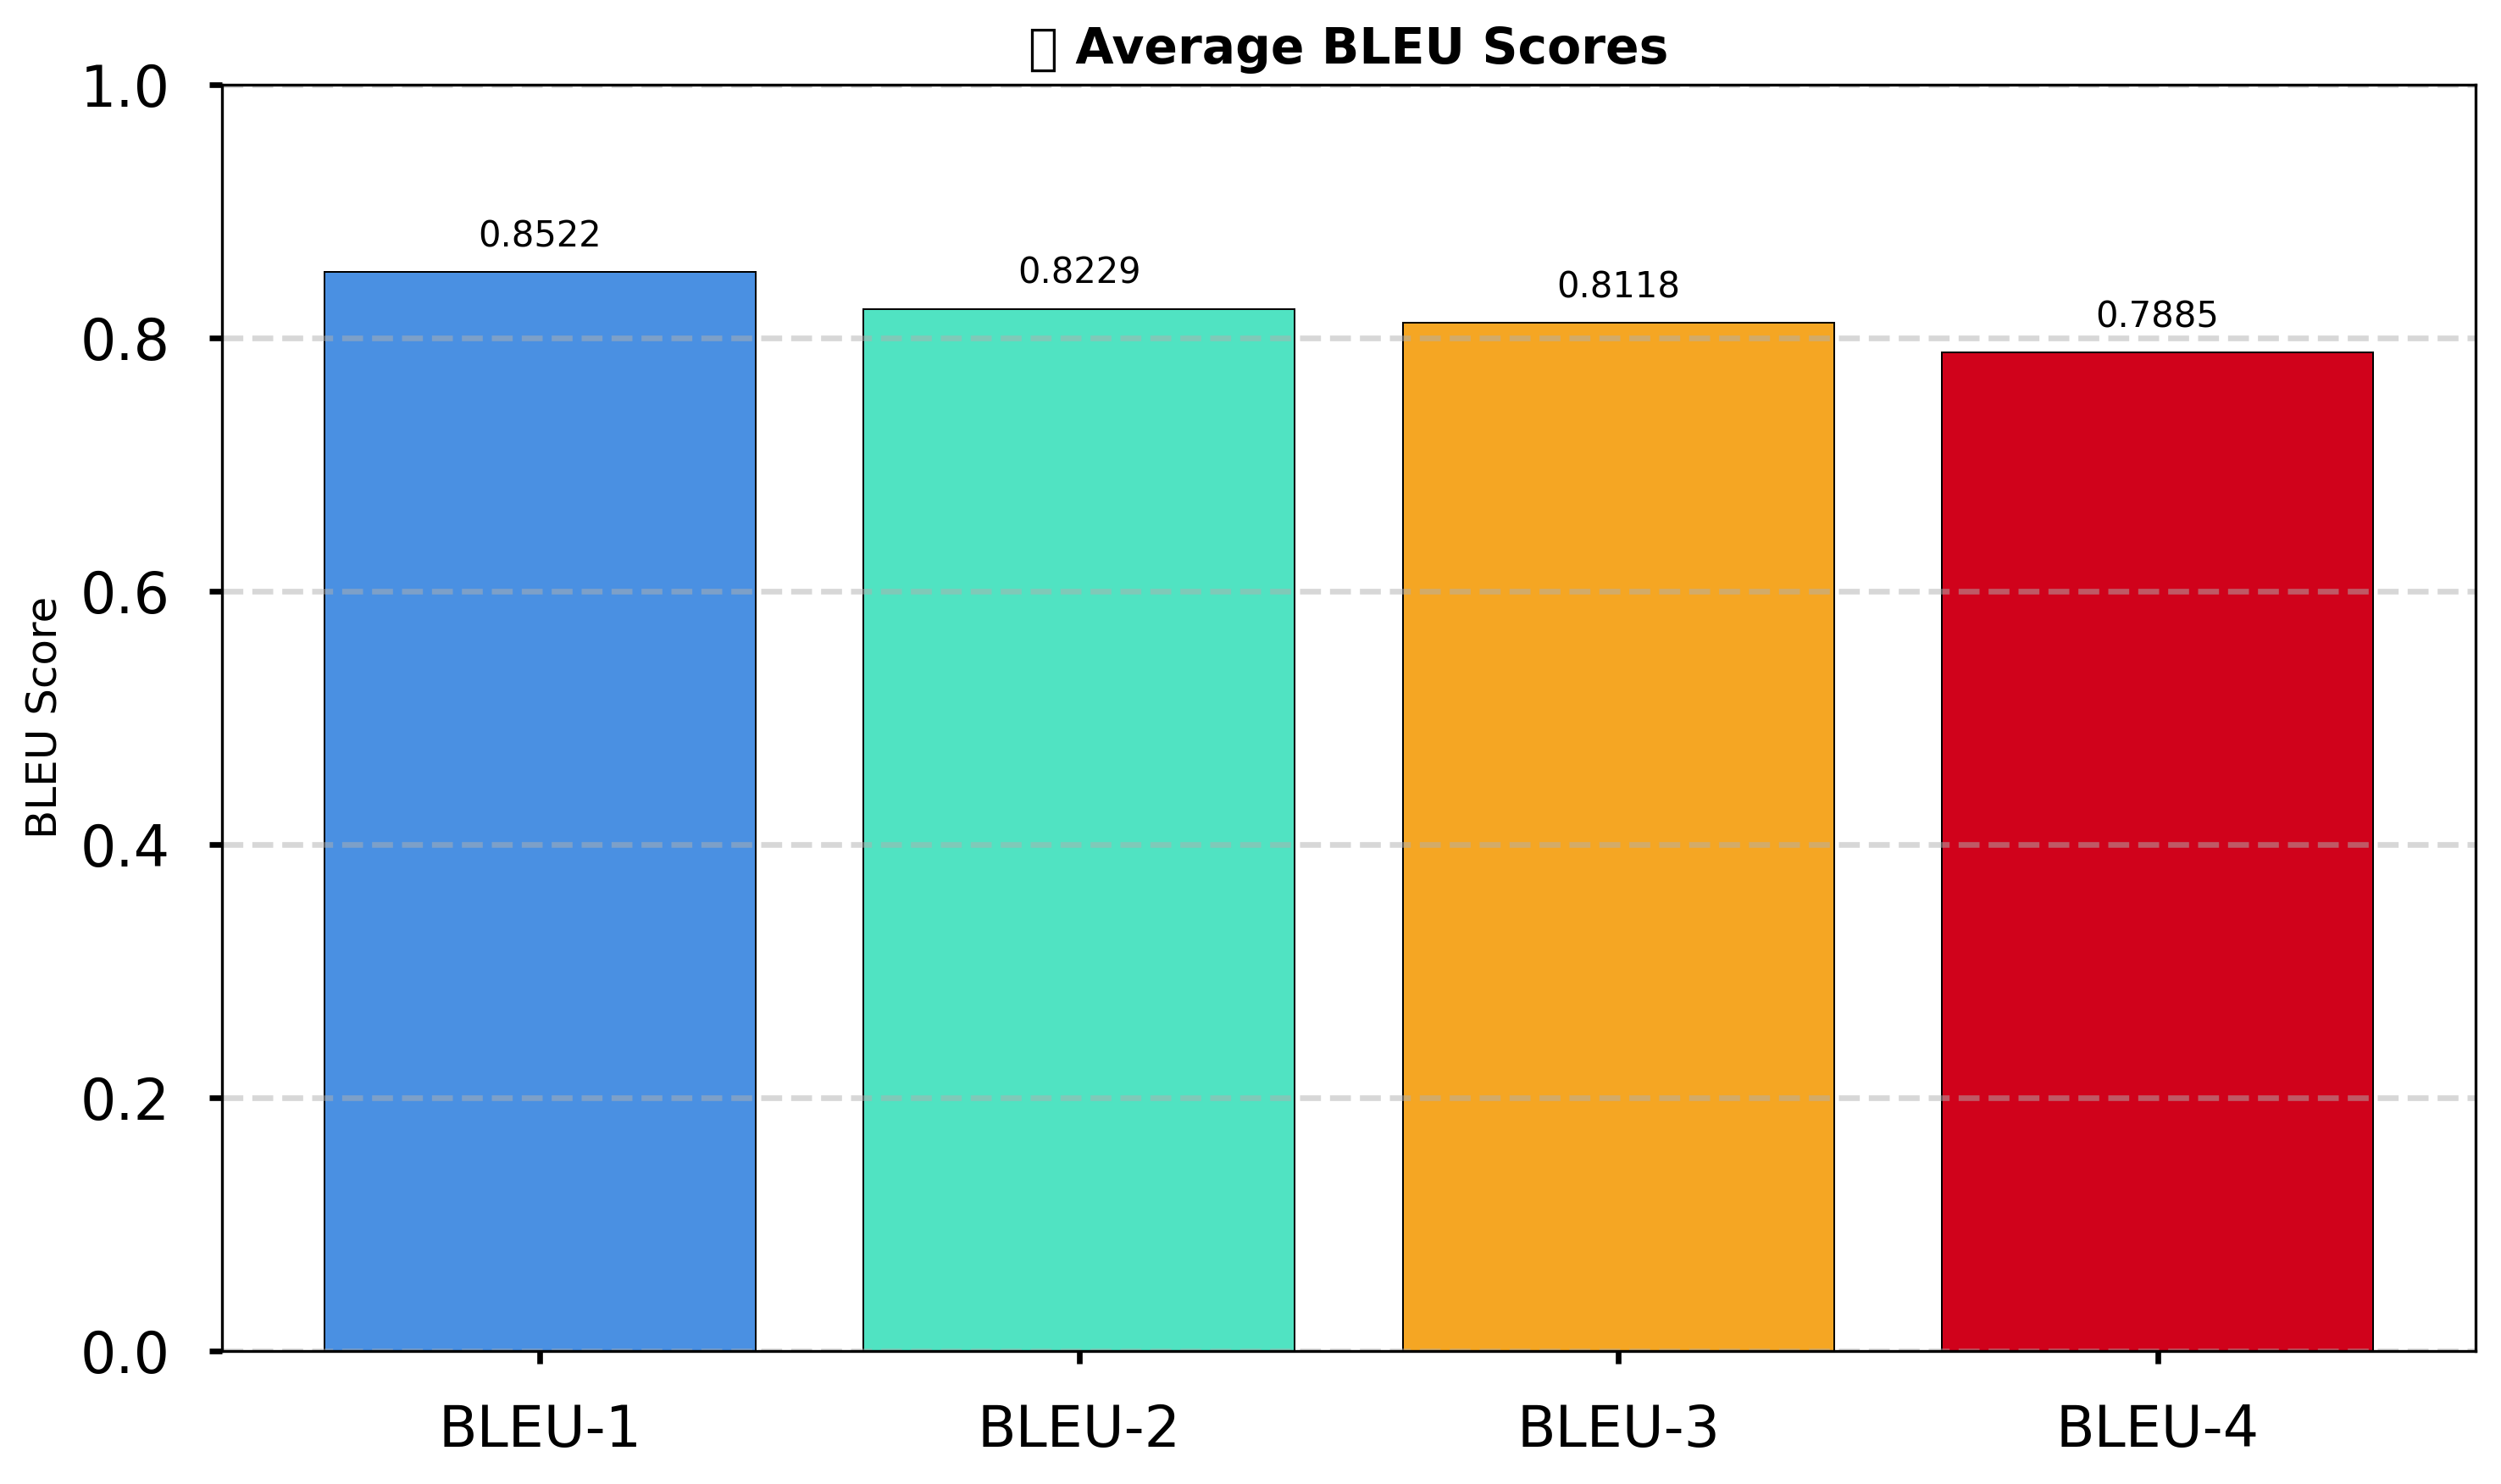

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# ŸÖ€åÿßŸÜ⁄Ø€åŸÜ‚ÄåŸáÿß
bleu_averages = [
    np.mean(bleu_score_1),
    np.mean(bleu_score_2),
    np.mean(bleu_score_3),
    np.mean(bleu_score_4),
]

labels = ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4']
colors = ['#4A90E2', '#50E3C2', '#F5A623', '#D0021B']

plt.figure(figsize=(10, 6), dpi=300)  # ÿßŸÅÿ≤ÿß€åÿ¥ Ÿàÿ∂Ÿàÿ≠ (dpi ÿ®ÿßŸÑÿß)
bars = plt.bar(labels, bleu_averages, color=colors, edgecolor='black')

# ÿßŸÅÿ≤ŸàÿØŸÜ ŸÖŸÇÿßÿØ€åÿ± ÿπÿØÿØ€å ÿ±Ÿà€å ÿ≥ÿ™ŸàŸÜ‚ÄåŸáÿß
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02,
             f"{height:.4f}", ha='center', fontsize=10)

# ÿ™ŸÜÿ∏€åŸÖÿßÿ™ ÿ∏ÿßŸáÿ±€å
plt.title('üìä Average BLEU Scores', fontsize=14, weight='bold')
plt.ylabel('BLEU Score', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# ŸÜŸÖÿß€åÿ¥ ŸÜŸÖŸàÿØÿßÿ±
plt.show()

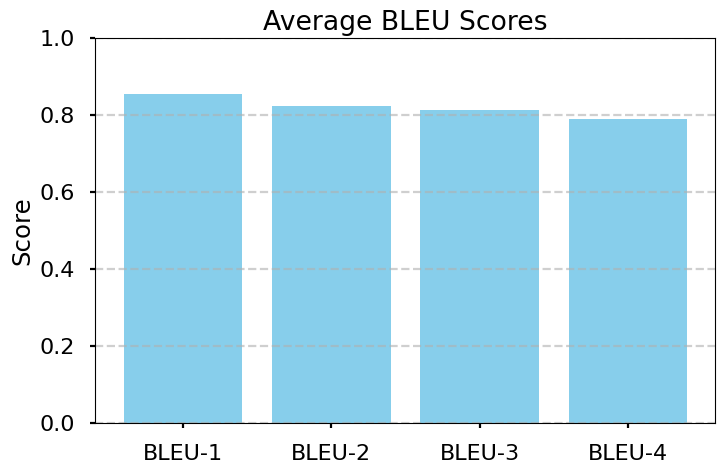

In [93]:
import matplotlib.pyplot as plt

bleu_averages = [
    np.mean(bleu_score_1),
    np.mean(bleu_score_2),
    np.mean(bleu_score_3),
    np.mean(bleu_score_4),
]

plt.figure(figsize=(8, 5))
plt.bar(['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4'], bleu_averages, color='skyblue')
plt.title('Average BLEU Scores')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


In [94]:
# Ÿæ€åÿØÿß ⁄©ÿ±ÿØŸÜ ÿ®ÿØÿ™ÿ±€åŸÜ‚ÄåŸáÿß (ŸÖÿ´ŸÑÿßŸã ÿ®ÿ±ÿß€å BLEU-4)
worst_idxs = np.argsort(bleu_score_4)[:5]
for i in worst_idxs:
    print("Predicted:", fr_preds[i])
    print("Reference:", references[i])
    print("BLEU-4:", bleu_score_4[i])
    print("-" * 50)


Predicted: ŸÇÿ±ÿµ ŸæŸÜÿ™ŸàŸæÿ±ÿßÿ≤ŸàŸÑ ŸÖ€åŸÑ€å‚Äå⁄Øÿ±ŸÖ Ÿáÿ± ÿµÿ®ÿ≠ ŸÜÿßÿ¥ÿ™ÿß €å⁄© ÿπÿØÿØ ŸÇÿ±ÿµ ÿ≥ÿ™€åÿ±€åÿ≤€åŸÜ Ÿáÿ± ÿ¥ÿ® €å⁄© ÿπÿØÿØ ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ
Reference: ŸÇÿ∑ÿπÿß ÿ≥ÿ± ÿ≥Ÿàÿ≤ŸÜ ŸÇÿ®ŸÑ€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜŸÖ€å‚Äåÿ¥Ÿá ŸÜ⁄Øÿ±ÿßŸÜ ŸÜÿ®ÿßÿ¥€åÿØ
BLEU-4: 0
--------------------------------------------------
Predicted: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ
Reference: ŸÑ€åÿ≤ÿ± ÿ®ÿ≥€åÿßÿ± ŸÖŸàÿ´ÿ± ÿßÿ≥ÿ™ ŸàŸÑ€å ÿØÿ± ÿµŸàÿ±ÿ™ ÿ®ÿ±ÿ∑ÿ±ŸÅ ŸÜÿ¥ÿØŸÜ ÿßÿÆÿ™ŸÑÿßŸÑ ŸáŸàÿ±ŸÖŸàŸÜ€å ÿ®ÿ±⁄Øÿ¥ÿ™ ÿÆŸàÿßŸáÿØ ÿØÿßÿ¥ÿ™ ŸÖŸÖ⁄©ŸÜŸá ŸÇÿ±ÿµ‚ÄåŸáÿß€å ÿ∂ÿØ ÿ®ÿßÿ±ÿØÿßÿ±€å ⁄©ŸÖ€å ⁄©ŸÖ⁄©‚Äå⁄©ŸÜŸÜÿØŸá ÿ®ÿßÿ¥ÿØ
BLEU-4: 0
--------------------------------------------------
Predicted: ÿ®Ÿá ÿßŸàÿ±ŸàŸÑŸà⁄ò€åÿ≥ÿ™ ÿ®ÿ±ÿß€å ŸÖÿπÿß€åŸÜŸá Ÿà ÿ¨Ÿàÿßÿ® ŸÖÿ±ÿßÿ≠ÿπŸá ⁄©ŸÜ€åÿØ
Reference: ÿÆ€åÿ± ÿ®€åŸÖÿßÿ±€å ÿ¥ŸÖÿß ÿ®ÿ± ÿßÿ≥ÿßÿ≥ ŸÜŸàÿßÿ± ŸÇŸÑÿ® ŸàŸÑŸÅ Ÿæÿßÿ±⁄©€åŸÜÿ≥ŸàŸÜ Ÿàÿß€åÿ™ ÿßÿ≥ÿ™ ŸÖŸÜ ŸáŸÖ ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äå⁄©ŸÜŸÖ ÿ™ÿ≠ÿ™ ŸÜÿ∏ÿ± 

üîπ BLEU-1 Average: 0.8521690866896383
üîπ BLEU-2 Average: 0.8229106090080109
üîπ BLEU-3 Average: 0.811752099765398
üîπ BLEU-4 Average: 0.7884728369923325


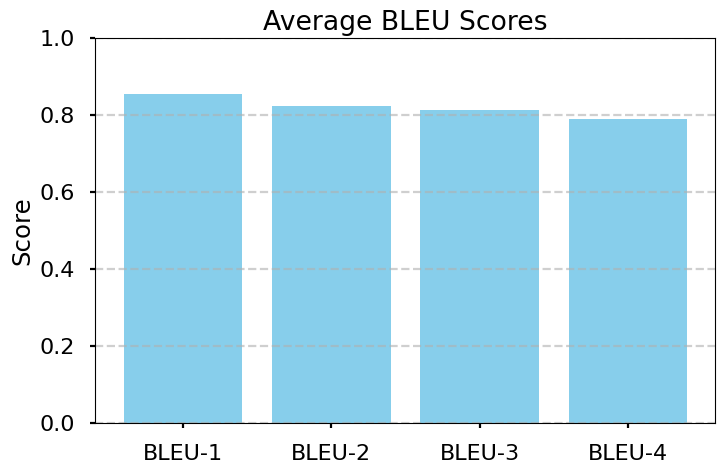


üìâ ÿ®ÿØÿ™ÿ±€åŸÜ Ÿæ€åÿ¥‚Äåÿ®€åŸÜ€å‚ÄåŸáÿß (BLEU-4 Ÿæÿß€å€åŸÜ‚Äåÿ™ÿ±):

üîª Predicted: ŸÇÿ±ÿµ ŸæŸÜÿ™ŸàŸæÿ±ÿßÿ≤ŸàŸÑ ŸÖ€åŸÑ€å‚Äå⁄Øÿ±ŸÖ Ÿáÿ± ÿµÿ®ÿ≠ ŸÜÿßÿ¥ÿ™ÿß €å⁄© ÿπÿØÿØ ŸÇÿ±ÿµ ÿ≥ÿ™€åÿ±€åÿ≤€åŸÜ Ÿáÿ± ÿ¥ÿ® €å⁄© ÿπÿØÿØ ŸÖÿµÿ±ŸÅ ⁄©ŸÜ€åÿØ ÿØÿ± ÿµŸàÿ±ÿ™ ÿπÿØŸÖ ÿ®Ÿáÿ®ŸàÿØ ÿ®Ÿá Ÿæÿ≤ÿ¥⁄© ŸÖÿ±ÿßÿ¨ÿπŸá ⁄©ŸÜ€åÿØ
‚úÖ Reference: ŸÇÿ∑ÿπÿß ÿ≥ÿ± ÿ≥Ÿàÿ≤ŸÜ ŸÇÿ®ŸÑ€å ÿßÿ≥ÿ™ŸÅÿßÿØŸá ŸÜŸÖ€å‚Äåÿ¥Ÿá ŸÜ⁄Øÿ±ÿßŸÜ ŸÜÿ®ÿßÿ¥€åÿØ
üìä BLEU-4: 0.0000
--------------------------------------------------
üîª Predicted: ÿ®Ÿá ŸÖÿ™ÿÆÿµÿµ ŸÖÿ∫ÿ≤ Ÿà ÿßÿπÿµÿßÿ® ŸÖÿ±ÿßÿ¨ÿπŸá ŸÅÿ±ŸÖÿß€å€åÿØ
‚úÖ Reference: ŸÑ€åÿ≤ÿ± ÿ®ÿ≥€åÿßÿ± ŸÖŸàÿ´ÿ± ÿßÿ≥ÿ™ ŸàŸÑ€å ÿØÿ± ÿµŸàÿ±ÿ™ ÿ®ÿ±ÿ∑ÿ±ŸÅ ŸÜÿ¥ÿØŸÜ ÿßÿÆÿ™ŸÑÿßŸÑ ŸáŸàÿ±ŸÖŸàŸÜ€å ÿ®ÿ±⁄Øÿ¥ÿ™ ÿÆŸàÿßŸáÿØ ÿØÿßÿ¥ÿ™ ŸÖŸÖ⁄©ŸÜŸá ŸÇÿ±ÿµ‚ÄåŸáÿß€å ÿ∂ÿØ ÿ®ÿßÿ±ÿØÿßÿ±€å ⁄©ŸÖ€å ⁄©ŸÖ⁄©‚Äå⁄©ŸÜŸÜÿØŸá ÿ®ÿßÿ¥ÿØ
üìä BLEU-4: 0.0000
--------------------------------------------------
üîª Predicted: ÿ®Ÿá ÿßŸàÿ±ŸàŸÑŸà⁄ò€åÿ≥ÿ™ ÿ®ÿ±ÿß€å ŸÖÿπÿß€åŸÜŸá Ÿà ÿ¨Ÿàÿßÿ® ŸÖÿ±ÿßÿ≠ÿπŸá ⁄©ŸÜ€åÿØ
‚úÖ Reference: ÿÆ€åÿ± ÿ®€åŸÖÿßÿ±€å ÿ¥ŸÖÿß ÿ

In [95]:
import numpy as np
import matplotlib.pyplot as plt

# €±. ŸÖ€åÿßŸÜ⁄Ø€åŸÜ ŸÜŸÖÿ±Ÿá‚ÄåŸáÿß
bleu_averages = [
    np.mean(bleu_score_1),
    np.mean(bleu_score_2),
    np.mean(bleu_score_3),
    np.mean(bleu_score_4),
]

print("üîπ BLEU-1 Average:", bleu_averages[0])
print("üîπ BLEU-2 Average:", bleu_averages[1])
print("üîπ BLEU-3 Average:", bleu_averages[2])
print("üîπ BLEU-4 Average:", bleu_averages[3])

# €≤. ŸÜŸÖŸàÿØÿßÿ± ŸÖ€åÿßŸÜ⁄Ø€åŸÜ ŸÜŸÖÿ±Ÿá‚ÄåŸáÿß
plt.figure(figsize=(8, 5))
plt.bar(['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4'], bleu_averages, color='skyblue')
plt.title('Average BLEU Scores')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# €≥. ÿ®ÿØÿ™ÿ±€åŸÜ Ÿæ€åÿ¥‚Äåÿ®€åŸÜ€å‚ÄåŸáÿß ÿ®ÿ± ÿßÿ≥ÿßÿ≥ BLEU-4
print("\nüìâ ÿ®ÿØÿ™ÿ±€åŸÜ Ÿæ€åÿ¥‚Äåÿ®€åŸÜ€å‚ÄåŸáÿß (BLEU-4 Ÿæÿß€å€åŸÜ‚Äåÿ™ÿ±):\n")

worst_idxs = np.argsort(bleu_score_4)[:5]  # ÿ∂ÿπ€åŸÅ‚Äåÿ™ÿ±€åŸÜ €µ ŸÖŸàÿ±ÿØ

for i in worst_idxs:
    print(f"üîª Predicted: {fr_preds[i]}")
    print(f"‚úÖ Reference: {references[i]}")
    print(f"üìä BLEU-4: {bleu_score_4[i]:.4f}")
    print("-" * 50)


In [101]:
best_idxs = np.argsort(bleu_score_4)[-5:]

In [102]:
print("\nüåü ÿ®Ÿáÿ™ÿ±€åŸÜ Ÿæ€åÿ¥‚Äåÿ®€åŸÜ€å‚ÄåŸáÿß (BLEU-4 ÿ®ÿßŸÑÿßÿ™ÿ±€åŸÜ):\n")

for i in best_idxs:
    print(f"üîπ Predicted: {fr_preds[i]}")
    print(f"‚úÖ Reference: {references[i]}")
    print(f"üìä BLEU-4: {bleu_score_4[i]:.4f}")
    print("-" * 50)


üåü ÿ®Ÿáÿ™ÿ±€åŸÜ Ÿæ€åÿ¥‚Äåÿ®€åŸÜ€å‚ÄåŸáÿß (BLEU-4 ÿ®ÿßŸÑÿßÿ™ÿ±€åŸÜ):

üîπ Predicted: ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ÿ®ÿ±ÿÆ€å Ÿà€åÿ™ÿßŸÖ€åŸÜŸáÿß Ÿàÿ¢ÿ±ÿßŸÖÿ®ÿÆÿ¥Ÿáÿß ŸáŸÖ⁄ÜŸÜ€åŸÜ ŸÖÿ≠ÿØŸàÿØ€åÿ™ ŸÖÿµÿ±ŸÅ ŸÜŸÖ⁄© ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿß€åŸÜ ÿπŸÑÿß€åŸÖ ŸÇÿ®ŸÑ ÿßÿ≤ Ÿæÿ±€åŸàÿØ ŸàÿØÿ±ÿØ ŸáŸÜ⁄ØÿßŸÖ Ÿæÿ±€åŸàÿØ ÿ™ÿß ÿ≠ÿØŸàÿØ€å ÿ∑ÿ®€åÿπ€å ÿßÿ≥ÿ™ Ÿæ€åÿßÿØŸá‚Äåÿ±Ÿà€å ŸÖŸÜÿ∏ŸÖ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ÿ∫ÿ∞ÿßŸáÿß€å ÿ≥ÿßŸÑŸÖ Ÿàÿ≥ÿ±⁄Øÿ±ŸÖ€åŸáÿß€å ŸÖŸÜÿßÿ≥ÿ® ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ
‚úÖ Reference: ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ÿ®ÿ±ÿÆ€å Ÿà€åÿ™ÿßŸÖ€åŸÜŸáÿß Ÿàÿ¢ÿ±ÿßŸÖÿ®ÿÆÿ¥Ÿáÿß ŸáŸÖ⁄ÜŸÜ€åŸÜ ŸÖÿ≠ÿØŸàÿØ€åÿ™ ŸÖÿµÿ±ŸÅ ŸÜŸÖ⁄© ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ ÿß€åŸÜ ÿπŸÑÿß€åŸÖ ŸÇÿ®ŸÑ ÿßÿ≤ Ÿæÿ±€åŸàÿØ ŸàÿØÿ±ÿØ ŸáŸÜ⁄ØÿßŸÖ Ÿæÿ±€åŸàÿØ ÿ™ÿß ÿ≠ÿØŸàÿØ€å ÿ∑ÿ®€åÿπ€å ÿßÿ≥ÿ™ Ÿæ€åÿßÿØŸá‚Äåÿ±Ÿà€å ŸÖŸÜÿ∏ŸÖ ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ ÿ∫ÿ∞ÿßŸáÿß€å ÿ≥ÿßŸÑŸÖ Ÿàÿ≥ÿ±⁄Øÿ±ŸÖ€åŸáÿß€å ŸÖŸÜÿßÿ≥ÿ® ÿ™Ÿàÿµ€åŸá ŸÖ€å‚Äåÿ¥ŸàÿØ
üìä BLEU-4: 1.0000
--------------------------------------------------
üîπ Predicted: ÿ®ÿπÿØ ÿßÿ≤ ⁄ÜŸáÿßÿ± ÿ±Ÿàÿ≤ ÿßŸÖ⁄©ÿßŸÜ ÿ¨ŸÑŸà⁄Ø€åÿ±€å ⁄©ŸÖ ŸÖ€å‚Äå

In [96]:
import re
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics import precision_score, recall_score
import tqdm
import numpy as np

# ÿ™ÿßÿ®ÿπ ÿ™ŸÖ€åÿ≤ ⁄©ÿ±ÿØŸÜ ŸÖÿ™ŸÜ
def clean_text(text):
    text = text.lower()
    text = text.strip().replace("Ÿä", "€å").replace("ŸÉ", "⁄©")
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

# ŸÖÿ≠ÿßÿ≥ÿ®Ÿá BLEU
bleu_score_1 = []
bleu_score_2 = []
bleu_score_3 = []
bleu_score_4 = []

# ŸÖÿ≠ÿßÿ≥ÿ®Ÿá F1 ÿ™Ÿà⁄©ŸÜ€å
token_f1_scores = []

for i in tqdm.tqdm(range(len(fr_preds))):
    pred = clean_text(fr_preds[i])
    reference = clean_text(references[i])

    # BLEU
    score_1 = sentence_bleu([reference.split()], pred.split(), weights=(1, 0, 0, 0))
    score_2 = sentence_bleu([reference.split()], pred.split(), weights=(0, 1, 0, 0))
    score_3 = sentence_bleu([reference.split()], pred.split(), weights=(0, 0, 1, 0))
    score_4 = sentence_bleu([reference.split()], pred.split(), weights=(0, 0, 0, 1))

    bleu_score_1.append(score_1)
    bleu_score_2.append(score_2)
    bleu_score_3.append(score_3)
    bleu_score_4.append(score_4)

    # F1 ÿ™Ÿà⁄©ŸÜ€å
    ref_tokens = set(reference.split())
    pred_tokens = set(pred.split())

    tp = len(ref_tokens & pred_tokens)
    fp = len(pred_tokens - ref_tokens)
    fn = len(ref_tokens - pred_tokens)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8) if (precision + recall) > 0 else 0

    token_f1_scores.append(f1)

# ŸÖ€åÿßŸÜ⁄Ø€åŸÜ F1 Ÿà BLEUŸáÿß
avg_f1 = np.mean(token_f1_scores)
avg_bleu1 = np.mean(bleu_score_1)
avg_bleu2 = np.mean(bleu_score_2)
avg_bleu3 = np.mean(bleu_score_3)
avg_bleu4 = np.mean(bleu_score_4)

# ŸÜŸÖÿß€åÿ¥ ŸÜÿ™ÿß€åÿ¨
print("üìä ŸÜÿ™ÿß€åÿ¨ ŸÜŸáÿß€å€å:")
print(f"‚úÖ BLEU-1: {avg_bleu1:.4f}")
print(f"‚úÖ BLEU-2: {avg_bleu2:.4f}")
print(f"‚úÖ BLEU-3: {avg_bleu3:.4f}")
print(f"‚úÖ BLEU-4: {avg_bleu4:.4f}")
print(f"üìê F1-Token-Based: {avg_f1:.4f}")

print("\nüìä üìã **⁄Øÿ≤ÿßÿ±ÿ¥ ŸÜŸáÿß€å€å ÿßÿ±ÿ≤€åÿßÿ®€å ŸÖÿØŸÑ**")
print("‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ")
print(f"üîπ BLEU-1 (unigram):     {avg_bleu1:.4f}")
print(f"üîπ BLEU-2 (bigram):      {avg_bleu2:.4f}")
print(f"üîπ BLEU-3 (trigram):     {avg_bleu3:.4f}")
print(f"üîπ BLEU-4 (4-gram):      {avg_bleu4:.4f}")
print("‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ")
print(f"üî∏ Token-Level F1-Score: {avg_f1:.4f}")
print("‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ")

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1541/1541 [00:00<00:00, 1700.88it/s]


üìä ŸÜÿ™ÿß€åÿ¨ ŸÜŸáÿß€å€å:
‚úÖ BLEU-1: 0.8522
‚úÖ BLEU-2: 0.8229
‚úÖ BLEU-3: 0.8118
‚úÖ BLEU-4: 0.7885
üìê F1-Token-Based: 0.8618

üìä üìã **⁄Øÿ≤ÿßÿ±ÿ¥ ŸÜŸáÿß€å€å ÿßÿ±ÿ≤€åÿßÿ®€å ŸÖÿØŸÑ**
‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ
üîπ BLEU-1 (unigram):     0.8522
üîπ BLEU-2 (bigram):      0.8229
üîπ BLEU-3 (trigram):     0.8118
üîπ BLEU-4 (4-gram):      0.7885
‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ
üî∏ Token-Level F1-Score: 0.8618
‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ


In [97]:
from sklearn.metrics import f1_score
import numpy as np

# ŸÜÿ±ŸÖÿßŸÑ‚Äåÿ≥ÿßÿ≤€å ŸÖÿ™ŸàŸÜ (ÿß⁄Øÿ± ŸÇÿ®ŸÑÿßŸã ÿ™ÿπÿ±€åŸÅ ŸÜÿ¥ÿØŸá)
def clean_text(text):
    import re
    text = text.lower().strip().replace("Ÿä", "€å").replace("ŸÉ", "⁄©")
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r"\s+", " ", text)
    return text

# ŸÜÿ±ŸÖÿßŸÑ‚Äåÿ≥ÿßÿ≤€å Ÿæ€åÿ¥‚Äåÿ®€åŸÜ€å‚ÄåŸáÿß Ÿà ÿ±ŸÅÿ±ŸÜÿ≥‚ÄåŸáÿß
y_pred = [clean_text(p) for p in fr_preds]
y_true = [clean_text(references[i]) for i in range(len(references))]

# ⁄ÜŸàŸÜ F1 ÿ®ÿ±ÿß€å classification ÿ∑ÿ±ÿßÿ≠€å ÿ¥ÿØŸáÿå ÿ®ÿß€åÿØ ÿ™ÿ®ÿØ€åŸÑ ÿ®Ÿá ŸÑ€åÿ®ŸÑ ÿ®ÿß€åŸÜÿ±€å ⁄©ŸÜ€åŸÖ (match or not)
# ÿ®ŸÜÿßÿ®ÿ±ÿß€åŸÜ ÿ®Ÿá ÿµŸàÿ±ÿ™ ŸÖŸÇÿß€åÿ≥Ÿá ÿØŸÇ€åŸÇ ÿ¨ŸÖŸÑŸá ÿ®Ÿá ÿ¨ŸÖŸÑŸá:
labels_true = [1] * len(y_true)
labels_pred = [1 if p == t else 0 for p, t in zip(y_pred, y_true)]

# ŸÖÿ≠ÿßÿ≥ÿ®Ÿá F1-Score
f1 = f1_score(labels_true, labels_pred, average='binary')
accuracy = np.mean([p == t for p, t in zip(y_pred, y_true)])

print("üéØ ÿßÿ±ÿ≤€åÿßÿ®€å ÿ≥ÿ∑ÿ≠ ÿ¨ŸÖŸÑŸá:")
print(f"‚úÖ Accuracy (Exact Match): {accuracy:.4f}")
print(f"üìê F1-Score (Exact Match): {f1:.4f}")

print("\nüìä  ⁄Øÿ≤ÿßÿ±ÿ¥ ŸÜŸáÿß€å€å ÿßÿ±ÿ≤€åÿßÿ®€å ŸÖÿØŸÑ (Exact Match ÿ≥ÿ∑ÿ≠ ÿ¨ŸÖŸÑŸá)")
print("‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê")
print(f"üîπ ÿØŸÇÿ™ (Accuracy):          {accuracy:.4f}")
print(f"üî∏ F1-Score (Exact Match):  {f1:.4f}")
print("‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê")


üéØ ÿßÿ±ÿ≤€åÿßÿ®€å ÿ≥ÿ∑ÿ≠ ÿ¨ŸÖŸÑŸá:
‚úÖ Accuracy (Exact Match): 0.8151
üìê F1-Score (Exact Match): 0.8981

üìä  ⁄Øÿ≤ÿßÿ±ÿ¥ ŸÜŸáÿß€å€å ÿßÿ±ÿ≤€åÿßÿ®€å ŸÖÿØŸÑ (Exact Match ÿ≥ÿ∑ÿ≠ ÿ¨ŸÖŸÑŸá)
‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê
üîπ ÿØŸÇÿ™ (Accuracy):          0.8151
üî∏ F1-Score (Exact Match):  0.8981
‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê


In [98]:
import re
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import tqdm

# ÿ™ÿßÿ®ÿπ Ÿæÿß⁄©‚Äåÿ≥ÿßÿ≤€å ŸÖÿ™ŸÜ
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text.strip()

# ÿßÿ∑ŸÖ€åŸÜÿßŸÜ ÿßÿ≤ ÿß€åŸÜ⁄©Ÿá references ŸÑ€åÿ≥ÿ™ ÿ®ÿßÿ¥Ÿá
if hasattr(references, 'tolist'):
    references = references.tolist()

# ŸÖÿ≠ÿßÿ≥ÿ®Ÿá BLEU
from nltk.translate.bleu_score import sentence_bleu

bleu_score_1 = []
bleu_score_2 = []
bleu_score_3 = []
bleu_score_4 = []

for i in tqdm.tqdm(range(len(fr_preds))):
    pred = clean_text(fr_preds[i])
    reference = clean_text(references[i])

    score_1 = sentence_bleu([reference.split()], pred.split(), weights=(1, 0, 0, 0))
    score_2 = sentence_bleu([reference.split()], pred.split(), weights=(0, 1, 0, 0))
    score_3 = sentence_bleu([reference.split()], pred.split(), weights=(0, 0, 1, 0))
    score_4 = sentence_bleu([reference.split()], pred.split(), weights=(0, 0, 0, 1))

    bleu_score_1.append(score_1)
    bleu_score_2.append(score_2)
    bleu_score_3.append(score_3)
    bleu_score_4.append(score_4)

# ŸÖÿ≠ÿßÿ≥ÿ®Ÿá F1 Ÿà Accuracy
y_true = [clean_text(r) for r in references]
y_pred = [clean_text(p) for p in fr_preds]

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='micro')
exact_match = all([t == p for t, p in zip(y_true, y_pred)])

# ŸÜŸÖÿß€åÿ¥ ŸÜÿ™ÿß€åÿ¨
print("\nüìä ŸÜÿ™ÿß€åÿ¨ ŸÜŸáÿß€å€å ŸÖÿØŸÑ:")
print(f"‚úÖ Accuracy:     {accuracy:.4f}")
print(f"üìê F1-Score:     {f1:.4f}")
print(f"üéØ Exact Match:  {'‚úÖ' if exact_match else '‚ùå'}")
print("üìè BLEU Scores:")
print(f"   BLEU-1:       {np.mean(bleu_score_1):.4f}")
print(f"   BLEU-2:       {np.mean(bleu_score_2):.4f}")
print(f"   BLEU-3:       {np.mean(bleu_score_3):.4f}")
print(f"   BLEU-4:       {np.mean(bleu_score_4):.4f}")

print("\nüìä ŸÜÿ™ÿß€åÿ¨ ŸÜŸáÿß€å€å ÿßÿ±ÿ≤€åÿßÿ®€å ŸÖÿØŸÑ")
print("‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê")
print(f"üéØ Exact Match:        {'‚úÖ ÿ®ŸÑŸá' if exact_match else '‚ùå ÿÆ€åÿ±'}")
print(f"‚úÖ Accuracy:           {accuracy:.4f}")
print(f"üìê F1-Score:           {f1:.4f}")
print("üìè BLEU Scores:")
print(f"   üîπ BLEU-1:          {np.mean(bleu_score_1):.4f}")
print(f"   üîπ BLEU-2:          {np.mean(bleu_score_2):.4f}")
print(f"   üîπ BLEU-3:          {np.mean(bleu_score_3):.4f}")
print(f"   üîπ BLEU-4:          {np.mean(bleu_score_4):.4f}")
print("‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê")

D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning:    | 0/1541 [00:00<?, ?it/s]
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or u


üìä ŸÜÿ™ÿß€åÿ¨ ŸÜŸáÿß€å€å ŸÖÿØŸÑ:
‚úÖ Accuracy:     0.8151
üìê F1-Score:     0.8151
üéØ Exact Match:  ‚ùå
üìè BLEU Scores:
   BLEU-1:       0.8522
   BLEU-2:       0.8229
   BLEU-3:       0.8118
   BLEU-4:       0.7885

üìä ŸÜÿ™ÿß€åÿ¨ ŸÜŸáÿß€å€å ÿßÿ±ÿ≤€åÿßÿ®€å ŸÖÿØŸÑ
‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê
üéØ Exact Match:        ‚ùå ÿÆ€åÿ±
‚úÖ Accuracy:           0.8151
üìê F1-Score:           0.8151
üìè BLEU Scores:
   üîπ BLEU-1:          0.8522
   üîπ BLEU-2:          0.8229
   üîπ BLEU-3:          0.8118
   üîπ BLEU-4:          0.7885
‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê


In [99]:
def clean_text(text):
    import re
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# ŸÜÿ±ŸÖÿßŸÑ‚Äåÿ≥ÿßÿ≤€å Ÿæÿßÿ≥ÿÆ‚ÄåŸáÿß
preds_clean = [clean_text(p) for p in fr_preds]
refs_clean = [clean_text(r) for r in references]

# ŸÖÿ≠ÿßÿ≥ÿ®Ÿá Exact Match
exact_matches = [p == r for p, r in zip(preds_clean, refs_clean)]
exact_match_score = sum(exact_matches) / len(exact_matches)

# ⁄ÜÿßŸæ ÿ≠ÿ±ŸÅŸá‚Äåÿß€å
print("üìå ÿßÿ±ÿ≤€åÿßÿ®€å Exact Match")
print("‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê")
print(f"üéØ ÿ™ÿπÿØÿßÿØ ÿ¨ŸÖŸÑÿßÿ™ ÿ™ÿ∑ÿßÿ®ŸÇ ⁄©ÿßŸÖŸÑ:  {sum(exact_matches)} / {len(exact_matches)}")
print(f"‚úÖ ÿØÿ±ÿµÿØ ÿ™ÿ∑ÿßÿ®ŸÇ ⁄©ÿßŸÖŸÑ:         {exact_match_score:.4f}")
print("‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê")

üìå ÿßÿ±ÿ≤€åÿßÿ®€å Exact Match
‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê
üéØ ÿ™ÿπÿØÿßÿØ ÿ¨ŸÖŸÑÿßÿ™ ÿ™ÿ∑ÿßÿ®ŸÇ ⁄©ÿßŸÖŸÑ:  1256 / 1541
‚úÖ ÿØÿ±ÿµÿØ ÿ™ÿ∑ÿßÿ®ŸÇ ⁄©ÿßŸÖŸÑ:         0.8151
‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê


In [100]:
def clean_text(text):
    import re
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# ŸÜÿ±ŸÖÿßŸÑ‚Äåÿ≥ÿßÿ≤€å Ÿæÿßÿ≥ÿÆ‚ÄåŸáÿß
preds_clean = [clean_text(p) for p in fr_preds]
refs_clean = [clean_text(r) for r in references]  # ŸÖÿ∑ŸÖÿ¶ŸÜ ÿ¥Ÿà references €åŸá ŸÑ€åÿ≥ÿ™Ÿáÿå ŸÜŸá Series

# ŸÖÿ≠ÿßÿ≥ÿ®Ÿá Exact Match
exact_matches = [p == r for p, r in zip(preds_clean, refs_clean)]
exact_match_score = sum(exact_matches) / len(exact_matches)

print(f"üéØ Exact Match Score: {exact_match_score:.4f}")

üéØ Exact Match Score: 0.8151


In [103]:
exact_matches = [t == p for t, p in zip(y_true, y_pred)]
exact_match_ratio = sum(exact_matches) / len(exact_matches)

print(f"üéØ Exact Match Score: {exact_match_ratio:.4f}")

üéØ Exact Match Score: 0.8151


D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning:    | 0/1541 [00:00<?, ?it/s]
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or u

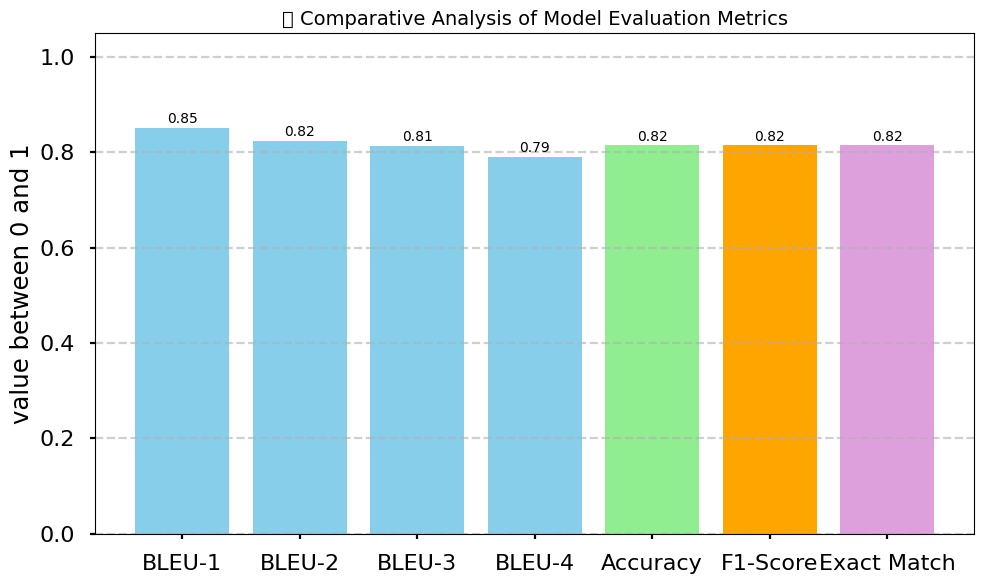

In [104]:
import re
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics import accuracy_score, f1_score

# ÿ™ÿßÿ®ÿπ Ÿæÿß⁄©‚Äåÿ≥ÿßÿ≤€å ŸÖÿ™ŸÜ
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text.strip()

# ÿßÿ∑ŸÖ€åŸÜÿßŸÜ ÿßÿ≤ ÿß€åŸÜ⁄©Ÿá references ŸÑ€åÿ≥ÿ™ ÿ®ÿßÿ¥Ÿá
if hasattr(references, 'tolist'):
    references = references.tolist()

# ŸÖÿ≠ÿßÿ≥ÿ®Ÿá BLEU
bleu_score_1 = []
bleu_score_2 = []
bleu_score_3 = []
bleu_score_4 = []

for i in tqdm.tqdm(range(len(fr_preds))):
    pred = clean_text(fr_preds[i])
    reference = clean_text(references[i])

    score_1 = sentence_bleu([reference.split()], pred.split(), weights=(1, 0, 0, 0))
    score_2 = sentence_bleu([reference.split()], pred.split(), weights=(0.5, 0.5, 0, 0))
    score_3 = sentence_bleu([reference.split()], pred.split(), weights=(0.34, 0.33, 0.33, 0.))
    score_4 = sentence_bleu([reference.split()], pred.split(), weights=(0.25, 0.25, 0.25, 0.25))

    bleu_score_1.append(score_1)
    bleu_score_2.append(score_2)
    bleu_score_3.append(score_3)
    bleu_score_4.append(score_4)

# ÿØŸÇÿ™ÿå F1 Ÿà Exact Match
y_true = [clean_text(r) for r in references]
y_pred = [clean_text(p) for p in fr_preds]

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='micro')
exact_matches = [t == p for t, p in zip(y_true, y_pred)]
exact_match_ratio = sum(exact_matches) / len(exact_matches)

# ŸÖ€åÿßŸÜ⁄Ø€åŸÜ BLEUŸáÿß
bleu_means = [
    np.mean(bleu_score_1),
    np.mean(bleu_score_2),
    np.mean(bleu_score_3),
    np.mean(bleu_score_4),
]

# ÿ™ÿ±ÿ≥€åŸÖ ŸÜŸÖŸàÿØÿßÿ±
plt.figure(figsize=(10, 6))
metrics = ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4', 'Accuracy', 'F1-Score', 'Exact Match']
values = bleu_means + [accuracy, f1, exact_match_ratio]

bars = plt.bar(metrics, values, color=['skyblue']*4 + ['lightgreen', 'orange', 'plum'])
plt.ylim(0, 1.05)
plt.title("üìä Comparative Analysis of Model Evaluation Metrics", fontsize=14 )#fonsizeŸà ŸÖŸÇÿß€åÿ≥Ÿá‚Äå€å ÿ¥ÿßÿÆÿµ‚ÄåŸáÿß€å ÿßÿ±ÿ≤€åÿßÿ®€å ŸÖÿØŸÑ", )
plt.ylabel("value between 0 and 1")#("ŸÖŸÇÿØÿßÿ± (€∞ ÿ™ÿß €±)")
plt.grid(axis='y', linestyle='--', alpha=0.6)

# ÿßŸÅÿ≤ŸàÿØŸÜ ŸÖŸÇÿßÿØ€åÿ± ÿ±Ÿà€å Ÿáÿ± ÿ≥ÿ™ŸàŸÜ
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning:    | 0/1541 [00:00<?, ?it/s]
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or u

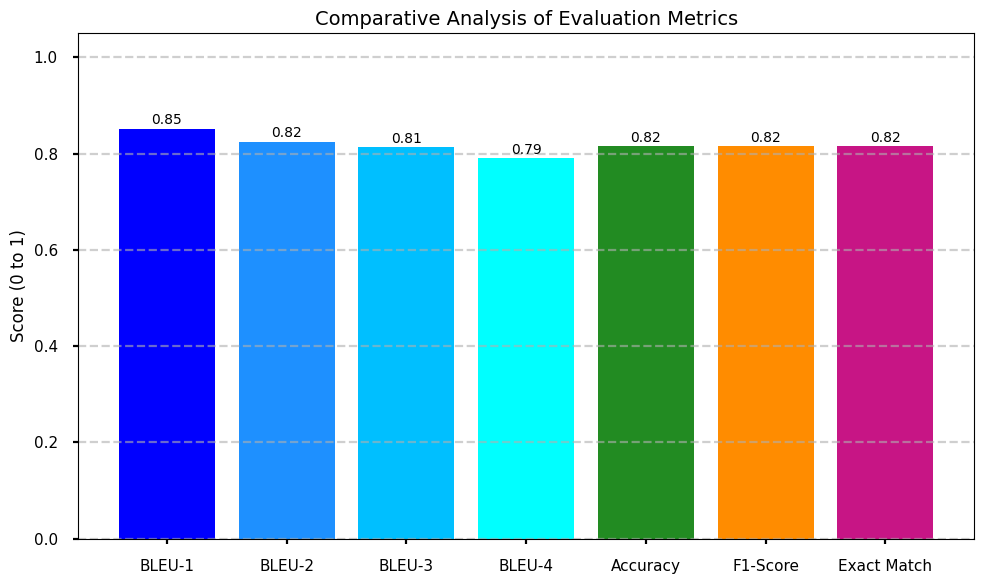

In [105]:
import re
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics import accuracy_score, f1_score

# Ÿæÿß⁄©‚Äåÿ≥ÿßÿ≤€å ŸÖÿ™ŸÜ
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text.strip()

# ÿßÿ∑ŸÖ€åŸÜÿßŸÜ ÿßÿ≤ ŸÑ€åÿ≥ÿ™ ÿ®ŸàÿØŸÜ references
if hasattr(references, 'tolist'):
    references = references.tolist()

# ŸÖÿ≠ÿßÿ≥ÿ®Ÿá BLEU
bleu_score_1, bleu_score_2, bleu_score_3, bleu_score_4 = [], [], [], []

for i in tqdm.tqdm(range(len(fr_preds))):
    pred = clean_text(fr_preds[i])
    reference = clean_text(references[i])
    
    bleu_score_1.append(sentence_bleu([reference.split()], pred.split(), weights=(1, 0, 0, 0)))
    bleu_score_2.append(sentence_bleu([reference.split()], pred.split(), weights=(0.5, 0.5, 0, 0)))
    bleu_score_3.append(sentence_bleu([reference.split()], pred.split(), weights=(0.34, 0.33, 0.33, 0.)))
    bleu_score_4.append(sentence_bleu([reference.split()], pred.split(), weights=(0.25, 0.25, 0.25, 0.25)))

# ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿØŸÇÿ™ÿå F1 Ÿà Exact Match
y_true = [clean_text(r) for r in references]
y_pred = [clean_text(p) for p in fr_preds]

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='micro')
exact_match_ratio = np.mean([t == p for t, p in zip(y_true, y_pred)])

# ŸÖ€åÿßŸÜ⁄Ø€åŸÜ BLEUŸáÿß
bleu_means = [
    np.mean(bleu_score_1),
    np.mean(bleu_score_2),
    np.mean(bleu_score_3),
    np.mean(bleu_score_4),
]

# ÿ±ÿ≥ŸÖ ŸÜŸÖŸàÿØÿßÿ±
plt.figure(figsize=(10, 6))
metrics = ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4', 'Accuracy', 'F1-Score', 'Exact Match']
values = bleu_means + [accuracy, f1, exact_match_ratio]

# ÿ±ŸÜ⁄Ø‚ÄåŸáÿß€å €å⁄©‚ÄåÿØÿ≥ÿ™ Ÿà ŸÖŸÜÿßÿ≥ÿ® ŸÖŸÇÿßŸÑŸá
colors = ['blue', 'dodgerblue', 'deepskyblue', 'cyan', 'forestgreen', 'darkorange', 'mediumvioletred']
bars = plt.bar(metrics, values, color=colors)

plt.ylim(0, 1.05)
plt.title("Comparative Analysis of Evaluation Metrics", fontsize=14)
plt.ylabel("Score (0 to 1)", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# ŸÜŸÖÿß€åÿ¥ ŸÖŸÇÿØÿßÿ± ÿØŸÇ€åŸÇ ÿ®ÿßŸÑÿß€å Ÿáÿ± ÿ≥ÿ™ŸàŸÜ
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', fontsize=10)

plt.tight_layout()

# üìÅ ÿ∞ÿÆ€åÿ±Ÿá‚Äå€å ÿÆÿ±Ÿàÿ¨€å ÿ®ÿ±ÿß€å ŸÖŸÇÿßŸÑŸá
plt.savefig("evaluation_metrics_bar_chart.png", dpi=400, bbox_inches='tight')
plt.savefig("evaluation_metrics_bar_chart.pdf", dpi=400, bbox_inches='tight')

plt.show()


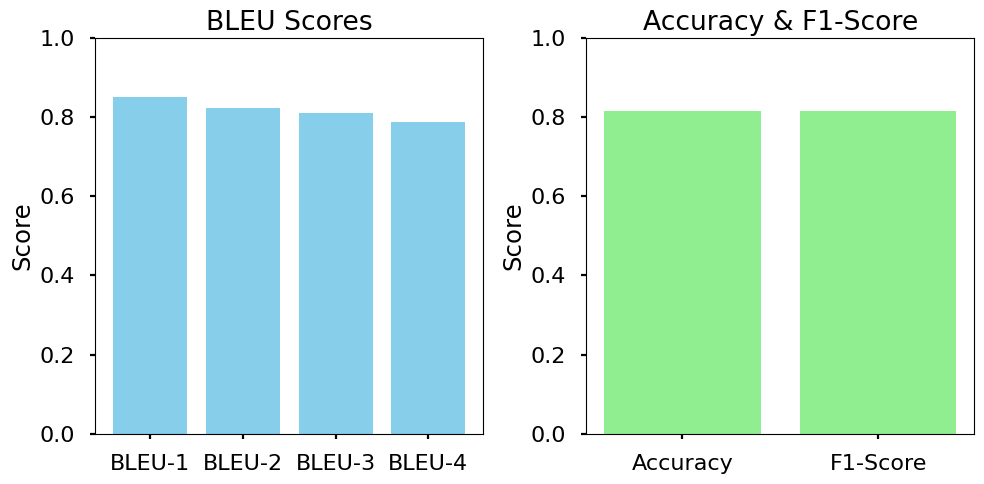

In [106]:
import matplotlib.pyplot as plt

# ŸÜŸÖÿ±ÿßÿ™ BLEU
bleu_scores = {
    "BLEU-1": 0.8522,
    "BLEU-2": 0.8229,
    "BLEU-3": 0.8118,
    "BLEU-4": 0.7885
}

# ÿØŸÇÿ™ Ÿà F1
metrics = {
    "Accuracy": 0.8151,
    "F1-Score": 0.8151
}

# ÿ™ŸÜÿ∏€åŸÖ ÿ≥ÿß€åÿ≤ ŸÜŸÖŸàÿØÿßÿ±
plt.figure(figsize=(10, 5))

# ŸÜŸÖŸàÿØÿßÿ± BLEU
plt.subplot(1, 2, 1)
plt.bar(bleu_scores.keys(), bleu_scores.values(), color='skyblue')
plt.ylim(0, 1)
plt.title('BLEU Scores')
plt.ylabel('Score')

# ŸÜŸÖŸàÿØÿßÿ± Accuracy Ÿà F1
plt.subplot(1, 2, 2)
plt.bar(metrics.keys(), metrics.values(), color='lightgreen')
plt.ylim(0, 1)
plt.title('Accuracy & F1-Score')
plt.ylabel('Score')

# ŸÖÿ±ÿ™ÿ®‚Äåÿ≥ÿßÿ≤€å ŸÅÿßÿµŸÑŸá‚ÄåŸáÿß
plt.tight_layout()

# ŸÜŸÖÿß€åÿ¥ ŸÜŸÖŸàÿØÿßÿ±
plt.show()


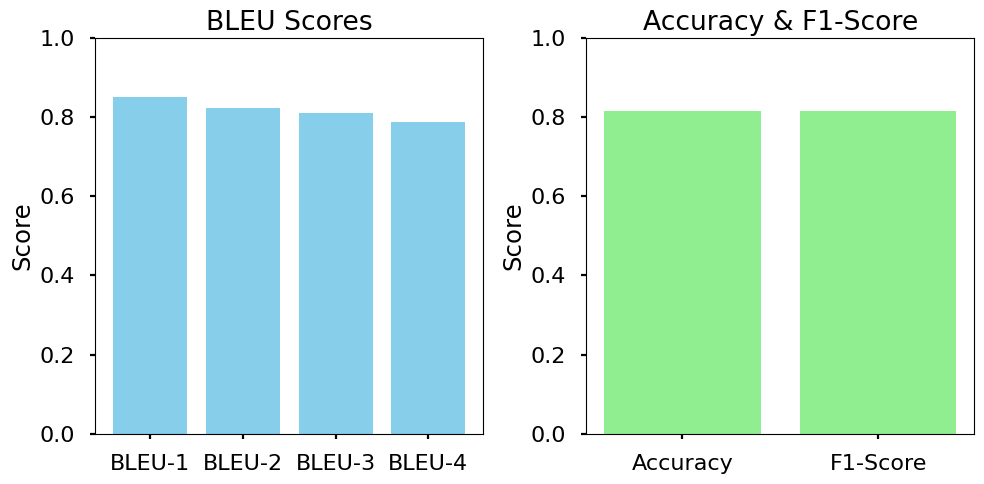

In [107]:
import matplotlib.pyplot as plt

# ŸÜŸÖÿ±ÿßÿ™ BLEU
bleu_scores = {
    "BLEU-1": 0.8522,
    "BLEU-2": 0.8229,
    "BLEU-3": 0.8118,
    "BLEU-4": 0.7885
}

# ÿØŸÇÿ™ Ÿà F1
metrics = {
    "Accuracy": 0.8151,
    "F1-Score": 0.8151
}

# ÿ™ŸÜÿ∏€åŸÖ ÿ≥ÿß€åÿ≤ ŸÜŸÖŸàÿØÿßÿ±
plt.figure(figsize=(10, 5))

# ŸÜŸÖŸàÿØÿßÿ± BLEU
plt.subplot(1, 2, 1)
plt.bar(bleu_scores.keys(), bleu_scores.values(), color='skyblue')
plt.ylim(0, 1)
plt.title('BLEU Scores')
plt.ylabel('Score')

# ŸÜŸÖŸàÿØÿßÿ± Accuracy Ÿà F1
plt.subplot(1, 2, 2)
plt.bar(metrics.keys(), metrics.values(), color='lightgreen')
plt.ylim(0, 1)
plt.title('Accuracy & F1-Score')
plt.ylabel('Score')

# ŸÖÿ±ÿ™ÿ®‚Äåÿ≥ÿßÿ≤€å ŸÅÿßÿµŸÑŸá‚ÄåŸáÿß
plt.tight_layout()

# ÿ∞ÿÆ€åÿ±Ÿá ŸÜŸÖŸàÿØÿßÿ± ÿ®Ÿá ÿπŸÜŸàÿßŸÜ ŸÅÿß€åŸÑ PNG
plt.savefig("evaluation_metrics_1.png", dpi=300, bbox_inches='tight')

# ŸÜŸÖÿß€åÿ¥ ŸÜŸÖŸàÿØÿßÿ±
plt.show()


In [108]:
plt.savefig("evaluation_metrics_1.pdf")

<Figure size 1280x880 with 0 Axes>

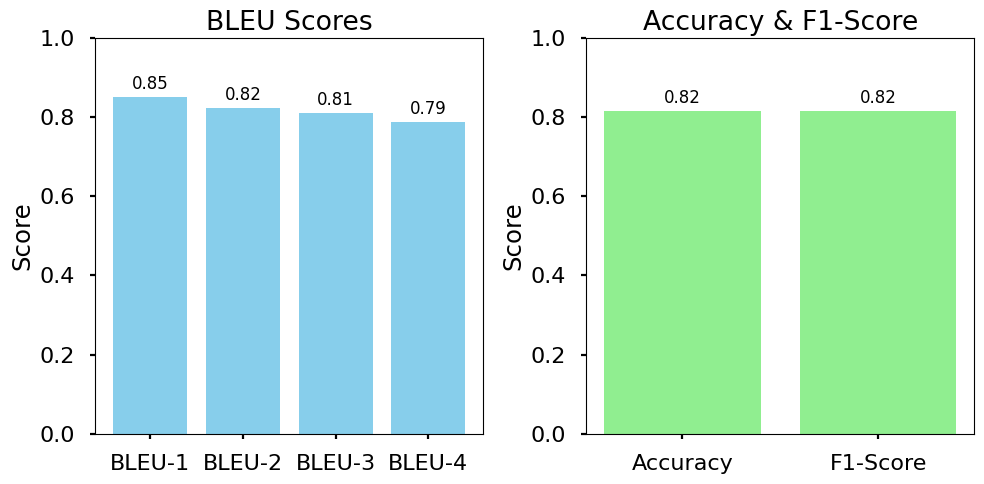

In [109]:
import matplotlib.pyplot as plt

# ŸÜŸÖÿ±ÿßÿ™ BLEU
bleu_scores = {
    "BLEU-1": 0.8522,
    "BLEU-2": 0.8229,
    "BLEU-3": 0.8118,
    "BLEU-4": 0.7885
}

# ÿØŸÇÿ™ Ÿà F1
metrics = {
    "Accuracy": 0.8151,
    "F1-Score": 0.8151
}

# ÿ™ŸÜÿ∏€åŸÖ ÿ≥ÿß€åÿ≤ ŸÜŸÖŸàÿØÿßÿ±
plt.figure(figsize=(10, 5))

# ---- ŸÜŸÖŸàÿØÿßÿ± BLEU ----
plt.subplot(1, 2, 1)
bars1 = plt.bar(bleu_scores.keys(), bleu_scores.values(), color='skyblue')
plt.ylim(0, 1)
plt.title('BLEU Scores')
plt.ylabel('Score')

# ŸÜŸÖÿß€åÿ¥ ŸÖŸÇÿØÿßÿ± Ÿáÿ± ÿ≥ÿ™ŸàŸÜ
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01, f"{height:.2f}", ha='center', va='bottom')

# ---- ŸÜŸÖŸàÿØÿßÿ± Accuracy Ÿà F1 ----
plt.subplot(1, 2, 2)
bars2 = plt.bar(metrics.keys(), metrics.values(), color='lightgreen')
plt.ylim(0, 1)
plt.title('Accuracy & F1-Score')
plt.ylabel('Score')

# ŸÜŸÖÿß€åÿ¥ ŸÖŸÇÿØÿßÿ± Ÿáÿ± ÿ≥ÿ™ŸàŸÜ
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01, f"{height:.2f}", ha='center', va='bottom')

# ŸÖÿ±ÿ™ÿ®‚Äåÿ≥ÿßÿ≤€å ŸÅÿßÿµŸÑŸá‚ÄåŸáÿß
plt.tight_layout()

# ÿ∞ÿÆ€åÿ±Ÿá ŸÜŸÖŸàÿØÿßÿ± ÿ®Ÿá ÿπŸÜŸàÿßŸÜ ŸÅÿß€åŸÑ
plt.savefig("evaluation_metrics_with_labels.png", dpi=300, bbox_inches='tight')

# ŸÜŸÖÿß€åÿ¥ ŸÜŸÖŸàÿØÿßÿ±
plt.show()


In [111]:
plt.savefig("evaluation_metrics_with_labels.pdf")
plt.show()

<Figure size 1280x880 with 0 Axes>

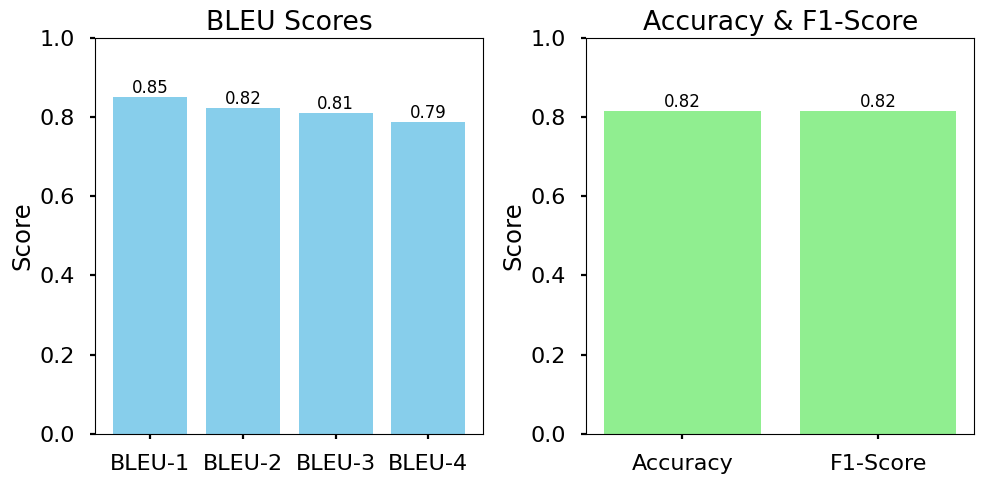

In [112]:
import matplotlib.pyplot as plt

# ŸÜŸÖÿ±ÿßÿ™ BLEU
bleu_scores = {
    "BLEU-1": 0.8522,
    "BLEU-2": 0.8229,
    "BLEU-3": 0.8118,
    "BLEU-4": 0.7885
}

# ÿØŸÇÿ™ Ÿà F1
metrics = {
    "Accuracy": 0.8151,
    "F1-Score": 0.8151
}

# ÿß€åÿ¨ÿßÿØ Figure Ÿà Axes
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# --- BLEU ŸÜŸÖŸàÿØÿßÿ± ---
bars1 = axs[0].bar(bleu_scores.keys(), bleu_scores.values(), color='skyblue')
axs[0].set_ylim(0, 1)
axs[0].set_title('BLEU Scores')
axs[0].set_ylabel('Score')

# ÿßÿ∂ÿßŸÅŸá ⁄©ÿ±ÿØŸÜ ŸÖŸÇÿßÿØ€åÿ±
for bar in bars1:
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width()/2.0, height + 0.01, f"{height:.2f}", ha='center')

# --- Accuracy Ÿà F1 ŸÜŸÖŸàÿØÿßÿ± ---
bars2 = axs[1].bar(metrics.keys(), metrics.values(), color='lightgreen')
axs[1].set_ylim(0, 1)
axs[1].set_title('Accuracy & F1-Score')
axs[1].set_ylabel('Score')

for bar in bars2:
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width()/2.0, height + 0.01, f"{height:.2f}", ha='center')

# ÿ™ŸÜÿ∏€åŸÖ ŸÅÿßÿµŸÑŸá‚ÄåŸáÿß
plt.tight_layout()

# ÿ∞ÿÆ€åÿ±Ÿá ŸÅÿß€åŸÑ PDF ŸÇÿ®ŸÑ ÿßÿ≤ ŸÜŸÖÿß€åÿ¥
fig.savefig("evaluation_metrics_with_labels_finals.pdf", dpi=300, bbox_inches='tight')

# ŸÜŸÖÿß€åÿ¥ ÿØÿ± Jupyter
plt.show()
